# Hungry Geese - Agents Comparison



- This notebook contains a lot of different agents from different sources for the [Hungry Geese](https://www.kaggle.com/c/hungry-geese).   
- In the [Comparison In Battle](#100) section, we also added a comparison of each pair of different agents (against two very simple additional agents so that real conditions are met). The agents fight for 100 rounds and then counts of the wins are calculated

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25401/logos/header.png?t=2021-01-22-07-12-33)

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:deeppink; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [1. Simple Toward Agent](#1)
* [2. Greedy Agent](#2)
* [3. Risk Averse Greedy Agent](#3)
* [4. Simple BFS Agent](#4)
* [5. BoilerGoose Agent](#5)
* [6. Imitation Greedy Agent](#6)
* [7. Imitation Simple BFS Agent](#7)
* [8. Imitation BoilerGoose Agent](#8)
    

* [Example Using The kaggle_environments For Testing Agents](#50)
    
* [Comparison In Battle](#100)

<a id="1"></a>
<h2 style='background:deeppink; border:0; color:white'><center>1. Simple Toward Agent<center><h2>

In [31]:
%%writefile simple_toward.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col


def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    food = observation.food[0]
    food_row, food_column = row_col(food, configuration.columns)

    if food_row > player_row:
        return Action.SOUTH.name
    if food_row < player_row:
        return Action.NORTH.name
    if food_column > player_column:
        return Action.EAST.name
    return Action.WEST.name

Writing simple_toward.py


<a id="2"></a>
<h2 style='background:deeppink; border:0; color:white'><center>2. Greedy Agent<center><h2>

In [32]:
%%writefile greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from random import choice, sample

def random_agent():
    return choice([action for action in Action]).name


def translate(position: int, direction: Action, columns: int, rows: int):
    row, column = row_col(position, columns)
    row_offset, column_offset = direction.to_row_col()
    row = (row + row_offset) % rows
    column = (column + column_offset) % columns
    return row * columns + column


def adjacent_positions(position: int, columns: int, rows: int):
    return [
        translate(position, action, columns, rows)
        for action in Action
    ]


def min_distance(position: int, food: [int], columns: int):
    row, column = row_col(position, columns)
    return min(
        abs(row - food_row) + abs(column - food_column)
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )


def agent(observation, configuration):
    observation = Observation(observation)
    configuration = Configuration(configuration)
    rows, columns = configuration.rows, configuration.columns

    food = observation.food
    geese = observation.geese
    opponents = [
        goose
        for index, goose in enumerate(geese)
        if index != observation.index and len(goose) > 0
    ]

    # Don't move adjacent to any heads
    head_adjacent_positions = {
        opponent_head_adjacent
        for opponent in opponents
        for opponent_head in [opponent[0]]
        for opponent_head_adjacent in adjacent_positions(opponent_head, rows, columns)
    }
    # Don't move into any bodies
    bodies = {position for goose in geese for position in goose[0:-1]}
    # Don't move into tails of heads that are adjacent to food
    tails = {
        opponent[-1]
        for opponent in opponents
        for opponent_head in [opponent[0]]
        if any(
            adjacent_position in food
            # Head of opponent is adjacent to food so tail is not safe
            for adjacent_position in adjacent_positions(opponent_head, rows, columns)
        )
    }

    # Move to the closest food
    position = geese[observation.index][0]
    actions = {
        action: min_distance(new_position, food, columns)
        for action in Action
        for new_position in [translate(position, action, columns, rows)]
        if (
            new_position not in head_adjacent_positions and
            new_position not in bodies and
            new_position not in tails
        )
    }

    if any(actions):
        return min(actions, key=actions.get).name

    return random_agent()

Writing greedy.py


# <a id="3"></a>
<h2 style='background:deeppink; border:0; color:white'><center>3. Risk Averse Greedy Agent<center><h2>

Copy from kernel [Risk averse greedy goose](https://www.kaggle.com/ilialar/risk-averse-greedy-goose)

In [33]:
%%writefile risk_averse_greedy.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import numpy as np
import random

def get_nearest_cells(x,y):
    # returns all cells reachable from the current one
    result = []
    for i in (-1,+1):
        result.append(((x+i+7)%7, y))
        result.append((x, (y+i+11)%11))
    return result

def find_closest_food(table):
    # returns the first step toward the closest food item
    new_table = table.copy()


    # (direction of the step, axis, code)
    possible_moves = [
        (1, 0, 1),
        (-1, 0, 2),
        (1, 1, 3),
        (-1, 1, 4)
    ]

    # shuffle possible options to add variability
    random.shuffle(possible_moves)


    updated = False
    for roll, axis, code in possible_moves:

        shifted_table = np.roll(table, roll, axis)

        if (table == -2).any() and (shifted_table[table == -2] == -3).any(): # we have found some food at the first step
            return code
        else:
            mask = np.logical_and(new_table == 0,shifted_table == -3)
            if mask.sum() > 0:
                updated = True
            new_table += code * mask
        if (table == -2).any() and shifted_table[table == -2][0] > 0: # we have found some food
            return shifted_table[table == -2][0]

        # else - update new reachible cells
        mask = np.logical_and(new_table == 0,shifted_table > 0)
        if mask.sum() > 0:
            updated = True
        new_table += shifted_table * mask

    # if we updated anything - continue reccurison
    if updated:
        return find_closest_food(new_table)
    # if not - return some step
    else:
        return table.max()

last_step = None

def agent(obs_dict, config_dict):
    global last_step

    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)


    table = np.zeros((7,11))
    # 0 - emply cells
    # -1 - obstacles
    # -4 - possible obstacles
    # -2 - food
    # -3 - head
    # 1,2,3,4 - reachable on the current step cell, number is the id of the first step direction

    legend = {
        1: 'SOUTH',
        2: 'NORTH',
        3: 'EAST',
        4: 'WEST'
    }

    # let's add food to the map
    for food in observation.food:
        x,y = row_col(food, configuration.columns)
        table[x,y] = -2 # food

    # let's add all cells that are forbidden
    for i in range(4):
        opp_goose = observation.geese[i]
        if len(opp_goose) == 0:
            continue

        is_close_to_food = False

        if i != player_index:
            x,y = row_col(opp_goose[0], configuration.columns)
            possible_moves = get_nearest_cells(x,y) # head can move anywhere

            for x,y in possible_moves:
                if table[x,y] == -2:
                    is_close_to_food = True

                table[x,y] = -4 # possibly forbidden cells

        # usually we ignore the last tail cell but there are exceptions
        tail_change = -1
        if obs_dict['step'] % 40 == 39:
            tail_change -= 1

        # we assume that the goose will eat the food
        if is_close_to_food:
            tail_change += 1
        if tail_change >= 0:
            tail_change = None


        for n in opp_goose[:tail_change]:
            x,y = row_col(n, configuration.columns)
            table[x,y] = -1 # forbidden cells

    # going back is forbidden according to the new rules
    x,y = row_col(player_head, configuration.columns)
    if last_step is not None:
        if last_step == 1:
            table[(x + 6) % 7,y] = -1
        elif last_step == 2:
            table[(x + 8) % 7,y] = -1
        elif last_step == 3:
            table[x,(y + 10)%11] = -1
        elif last_step == 4:
            table[x,(y + 12)%11] = -1

    # add head position
    table[x,y] = -3

    # the first step toward the nearest food
    step = int(find_closest_food(table))

    # if there is not available steps try to go to possibly dangerous cell
    if step not in [1,2,3,4]:
        x,y = row_col(player_head, configuration.columns)
        if table[(x + 8) % 7,y] == -4:
            step = 1
        elif table[(x + 6) % 7,y] == -4:
            step = 2
        elif table[x,(y + 12)%11] == -4:
            step = 3
        elif table[x,(y + 10)%11] == -4:
            step = 4

    # else - do a random step and lose
        else:
            step = np.random.randint(4) + 1

    last_step = step
    return legend[step]

Writing risk_averse_greedy.py


<a id="4"></a>
<h2 style='background:deeppink; border:0; color:white'><center>4. Simple BFS Agent<center><h2>

Copy from kernel [Simple BFS- Starter Agent](https://www.kaggle.com/aatiffraz/simple-bfs-starter-agent)

In [34]:
%%writefile simple_bfs.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
import random
import numpy as np

directions = {0:'EAST', 1:'NORTH', 2:'WEST', 3:'SOUTH', 'EAST':0, 'NORTH':1, 'WEST':2, 'SOUTH':3}


def move(loc, direction):
    """Move the whole snake in the given direction"""
    global directions
    direction = directions[direction]
    new_loc = []
    if direction == 'EAST':
        new_loc.append(int(11*(loc[0]//11)  + (loc[0]%11 + 1)%11))
    elif direction == 'WEST':
        new_loc.append(int(11*(loc[0]//11) + (loc[0]%11 + 10)%11))
    elif direction == 'NORTH':
        new_loc.append(int(11*((loc[0]//11 + 6)%7) + loc[0]%11))
    else:
        new_loc.append(int(11*((loc[0]//11 + 1)%7) + loc[0]%11))
    if len(loc) == 1:
        return new_loc
    return new_loc + loc[:-1]


def greedy_choose(head, board):
    move_queue = []
    visited = [[[100, 'NA'] for _ in range(11)] for l in range(7)]
    visited[head//11][head%11][0] = 0

    for i in range(4):
        move_queue.append([head, [i]])

    while len(move_queue) > 0:
        now_move = move_queue.pop(0)

        next_step = move([now_move[0]], now_move[1][-1])[0]

        if board[next_step//11][next_step%11] < 0:
            continue

        if len(now_move[1]) < visited[next_step//11][next_step%11][0]:
            visited[next_step//11][next_step%11][0] = len(now_move[1])
            visited[next_step//11][next_step%11][1] = now_move[1][0]
            for i in range(4):
                move_queue.append([next_step, now_move[1] + [i]])

        if board[next_step//11][next_step%11] > 0:
            return now_move[1][0]
    return random.randint(0,3)



def agent(obs, conf):
    global directions

    obs = Observation(obs)
    conf = Configuration(conf)
    board = np.zeros((7, 11), dtype=int)

    #Obstacle-ize your opponents
    for ind, goose in enumerate(obs.geese):
        if ind == obs.index or len(goose) == 0:
            continue
        for direction in range(4):
            moved = move(goose, direction)
            for part in moved:
                board[part//11][part%11] -= 1

    #Obstacle-ize your body, except the last part
    if len(obs.geese[obs.index]) > 1:
        for k in obs.geese[obs.index][:-1]:
            board[k//11][k%11] -= 1

    #Count food only if there's no chance an opponent will meet you there
    for f in obs.food:
        board[f//11][f%11] += (board[f//11][f%11] == 0)

    return directions[greedy_choose(obs.geese[obs.index][0], board)]


Writing simple_bfs.py


# <a id="5"></a>
<h2 style='background:deeppink; border:0; color:white'><center>5. BoilerGoose<center><h2>

In [35]:
%%writefile boilergoose.py


import dataclasses
from dataclasses import dataclass
from typing import List, NamedTuple, Set, Dict, Optional, Tuple, Callable
import numpy as np
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
from abc import ABC, abstractmethod
import sys
import traceback


trans_action_map: Dict[Tuple[int, int], Action] = {
    (-1, 0): Action.NORTH,
    (1, 0): Action.SOUTH,
    (0, 1): Action.EAST,
    (0, -1): Action.WEST,
}


class Pos(NamedTuple):
    x: int
    y: int

    def __repr__(self):
        return f"[{self.x}:{self.y}]"


@dataclass
class Goose:
    head: Pos = dataclasses.field(init=False)
    poses: List[Pos]

    def __post_init__(self):
        self.head = self.poses[0]

    def __repr__(self):
        return "Goose(" + "-".join(map(str, self.poses)) + ")"

    def __iter__(self):
        return iter(self.poses)

    def __len__(self):
        return len(self.poses)


def field_idx_to_pos(field_idx: int, *, num_cols: int, num_rows: int) -> Pos:
    x = field_idx // num_cols
    y = field_idx % num_cols

    if not (0 <= x < num_rows and 0 <= y < num_cols):
        raise ValueError("Illegal field_idx {field_idx} with x={x} and y={y}")

    return Pos(x, y)


class Geometry:
    def __init__(self, size_x, size_y):
        self.size_x = size_x
        self.size_y = size_y

    @property
    def shape(self) -> Tuple[int, int]:
        return (self.size_x, self.size_y)

    def prox(self, pos: Pos) -> Set[Pos]:
        return {
            self.translate(pos, direction)
            for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]
        }

    def translate(self, pos: Pos, diff: Tuple[int, int]) -> Pos:
        x, y = pos
        dx, dy = diff
        return Pos((x + dx) % self.size_x, (y + dy) % self.size_y)

    def trans_to(self, pos1: Pos, pos2: Pos) -> Tuple[int, int]:
        dx = pos2.x - pos1.x
        dy = pos2.y - pos1.y

        if dx <= self.size_x // 2:
            dx += self.size_x

        if dx > self.size_x // 2:
            dx -= self.size_x

        if dy <= self.size_y // 2:
            dy += self.size_y

        if dy > self.size_y // 2:
            dy -= self.size_y

        return (dx, dy)

    def action_to(self, pos1, pos2):
        diff = self.trans_to(pos1, pos2)

        result = trans_action_map.get(diff)

        if result is None:
            raise ValueError(f"Cannot step from {pos1} to {pos2}")

        return result

@dataclass
class State:
    food: Set[Pos]
    geese: Dict[int, Goose]
    index: int
    step: int
    geo: Geometry

    field: np.ndarray = dataclasses.field(init=False)
    my_goose: Goose = dataclasses.field(init=False)
    danger_poses: Set[Pos] = dataclasses.field(init=False)

    def __post_init__(self):
        self.field = np.full(fill_value=0, shape=self.geo.shape)
        for goose in self.geese.values():
            for pos in goose.poses[:-1]:  # not considering tail!
                self.field[pos.x, pos.y] = 1

            if self.geo.prox(goose.head) & self.food:
                tail = goose.poses[-1]
                self.field[tail.x, tail.y] = 1


        self.my_goose = self.geese[self.index]

        self.danger_poses = {
            pos
            for i, goose in self.geese.items()
            if i != self.index
            for pos in self.geo.prox(goose.head)
        }

    @classmethod
    def from_obs_conf(cls, obs, conf):
        num_cols = conf["columns"]
        num_rows = conf["rows"]
        step = obs["step"]
        index = obs["index"]

        geese = {
            idx: Goose(
                poses=[
                    field_idx_to_pos(idx, num_cols=num_cols, num_rows=num_rows)
                    for idx in goose_data
                ]
            )
            for idx, goose_data in enumerate(obs["geese"])
            if goose_data
        }

        food = {
            field_idx_to_pos(idx, num_cols=num_cols, num_rows=num_rows)
            for idx in obs["food"]
        }

        return cls(
            food=food,
            geese=geese,
            index=index,
            step=step,
            geo=Geometry(size_x=num_rows, size_y=num_cols),
        )

    def __repr__(self):
        return (
            f"State(step:{self.step}, index:{self.index}, Geese("
            + ",".join(f"{idx}:{len(goose.poses)}" for idx, goose in self.geese.items())
            + f"), food:{len(self.food)})"
        )

@dataclass
class FloodfillResult:
    field_dist: np.ndarray
    frontiers: List[List[Tuple[int, int]]]


def flood_fill(is_occupied: np.ndarray, seeds: List[Pos]) -> FloodfillResult:
    """
    Flood will start with distance 0 at seeds and only flow where is_occupied[x,y]==0
    """
    size_x, size_y = is_occupied.shape

    field_dist = np.full(fill_value=-1, shape=(size_x, size_y))

    frontier = [(s.x, s.y) for s in seeds]

    frontiers = [frontier]

    for seed in seeds:
        field_dist[seed] = 0

    dist = 1

    while frontier:
        new_frontier: List[Tuple[int, int]] = []
        for x, y in frontier:
            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_x = (x + dx) % size_x
                new_y = (y + dy) % size_y
                if is_occupied[new_x, new_y] == 0 and field_dist[new_x, new_y] == -1:
                    field_dist[new_x, new_y] = dist
                    new_frontier.append((new_x, new_y))
        frontier = new_frontier
        frontiers.append(frontier)
        dist += 1

    return FloodfillResult(field_dist=field_dist, frontiers=frontiers)


def get_dist(
    floodfill_result: FloodfillResult, test_func: Callable[[Tuple[int, int]], bool]
) -> Optional[int]:
    for dist, frontier in enumerate(floodfill_result.frontiers):
        for pos in frontier:
            if test_func(pos):
                return dist

    return None

class BaseAgent(ABC):
    def __init__(self):
        self.last_pos: Optional[Pos] = None

    def __call__(self, obs, conf):
        try:
            state = State.from_obs_conf(obs, conf)

            next_pos = self.step(state)

            action = state.geo.action_to(state.my_goose.head, next_pos)

            self.last_pos = state.my_goose.head

            return action.name
        except Exception as exc:
            traceback.print_exc(file=sys.stderr)
            raise

    @abstractmethod
    def step(self, state: State) -> Pos:
        """
        return: next position

        Implement this
        """
        pass

    def next_poses(self, state: State) -> Set[Pos]:
        head_next_poses = state.geo.prox(state.my_goose.head)

        result = {
            pos
            for pos in head_next_poses
            if pos != self.last_pos and state.field[pos] == 0
        }

        return result

from operator import itemgetter
import random

class FloodGoose(BaseAgent):
    def __init__(self, min_length=13):
        super().__init__()
        self.min_length = min_length

    def step(self, state):
        result = None

        if len(state.my_goose) < self.min_length:
            result = self.goto(state, lambda pos:pos in state.food)
        elif len(state.my_goose) >= 3:
            result = self.goto(state, lambda pos:pos==state.my_goose.poses[-1])

        if result is None:
            result = self.random_step(state)

        return result

    def goto(self, state, test_func):
        result = None

        pos_dists = {}
        for pos in self.next_poses(state):
            flood = flood_fill(state.field, [pos])
            dist = get_dist(flood, test_func)
            if dist is not None:
                pos_dists[pos] = dist

        if pos_dists:
            closest_pos, _ = min(pos_dists.items(), key=itemgetter(1))

            if closest_pos not in state.danger_poses:
                result = closest_pos

        return result


    def random_step(self, state):
        next_poses = self.next_poses(state) - state.danger_poses - state.food
        if not next_poses:
            next_poses = self.next_poses(state) - state.danger_poses

            if not next_poses:
                next_poses = self.next_poses(state)

                if not next_poses:
                    next_poses = state.geo.prox(state.my_goose.head)

        result = random.choice(list(next_poses))

        return result


agent = FloodGoose(min_length=8)

def call_agent(obs, conf):
    return agent(obs, conf)

Writing boilergoose.py


# <a id="6"></a>
<h2 style='background:deeppink; border:0; color:white'><center>6. Imitation Greedy<center><h2>

In [36]:
%%writefile imitation_greedy3k.py

import pickle
import bz2
import base64
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Activation, Lambda, Add, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2, l2


# Neural Network for Hungry Geese
def TorusConv2D(x, ch, kernel, padding="same", strides=1, weight_decay=2e-3):
    x = Lambda(lambda x: K.tile(x, n=(1,3,3,1)),
               output_shape=lambda input_shape: (None, 3*input_shape[1], 3*input_shape[2], input_shape[3]))(x)

    x = Conv2D(ch, kernel, padding=padding, strides=strides,
                      kernel_regularizer=l2(weight_decay))(x)

    x = Lambda(lambda x: x[:,int(x.shape[1]/3):2*int(x.shape[1]/3), int(x.shape[2]/3):2*int(x.shape[2]/3),:],
               output_shape=lambda input_shape: (None, int(input_shape[1]/3), int(input_shape[2]/3), input_shape[3]))(x)
    return x

def conv_bn_relu(x0, ch, kernel, padding="same", strides=1, weight_decay=2e-3, add=False):
    x = TorusConv2D(x0, ch, kernel, padding=padding, strides=strides,
                      weight_decay=weight_decay)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if add:
        x = Add()([x0, x])
    return x

def GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=2e-3):
    input = Input(input_shape)
    x = conv_bn_relu(input, filters, 3)

    for i in range(layers):
        x = conv_bn_relu(x, filters, 3, add=True)

    x = GlobalAveragePooling2D()(x)

    output = Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
    model = Model(input, output)
    #model.compile(optimizer=RadaBelief(learning_rate=1e-3, epsilon=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Input for Neural Network
def centerize(b):
    dy, dx = np.where(b[0])
    centerize_y = (np.arange(0,7)-3+dy[0])%7
    centerize_x = (np.arange(0,11)-5+dx[0])%11

    b = b[:, centerize_y,:]
    b = b[:, :,centerize_x]

    return b

def make_input(obses):
    b = np.zeros((17, 7 * 11), dtype=np.float32)
    obs = obses[-1]

    for p, pos_list in enumerate(obs['geese']):
        # head position
        for pos in pos_list[:1]:
            b[0 + (p - obs['index']) % 4, pos] = 1
        # tip position
        for pos in pos_list[-1:]:
            b[4 + (p - obs['index']) % 4, pos] = 1
        # whole position
        for pos in pos_list:
            b[8 + (p - obs['index']) % 4, pos] = 1

    # previous head position
    if len(obses) > 1:
        obs_prev = obses[-2]
        for p, pos_list in enumerate(obs_prev['geese']):
            for pos in pos_list[:1]:
                b[12 + (p - obs['index']) % 4, pos] = 1

    # food
    for pos in obs['food']:
        b[16, pos] = 1

    b = b.reshape(-1, 7, 11)
    b = centerize(b) # Where to place the head is arbiterary dicision.

    return b


# Load Keras Model
weight= b'QlpoOTFBWSZTWUauTzQByg5/////////////////////////////////////////////5Jy/B9np67wKXcX296e4c6wPtwF7yq3H2088vvHqq9977jw+p3F7eB5b77L731VHjlYdTnXh3kH3h7vJDnfZc9JcCDFgMDV7vNwPT759HegsPbqJX3e1t56ovu+TvK0vLx7yis5OdUMPrOipj1ulDuH2e8VVue+fB8O6PbvFS89fPeIvd6i4L23D3D1Vzp571VLc+eDw59S3UR9w+89VPekuHB3J73pU4eNxo3dFw6OOlw6O5LcqU933zvh8O6PvPSnvU9w8jfffbw+7H2ey94r6+H17h2Lks5Je959ffQp7qH3PSHnk45V3r04PSzvrzxHj0wB99w76g3Q970qrnr7eHk+++h71Qwe4dJwMAT75uDxb0d0Q+577z6leBalT5x3UDHx7z1E+fH3vEpvvvrvh9LzpwOu4WH3m7xO6oO9ffPfIrx3vA8rwe46HvenHobvs3vSF30+56JwJpF3G6VK9w4O+ydWcqr7vvjvfQnx7a4Vb77HeopZ77w8i++fXgeX3G6SWPXveipuLcQd0+3h5PfJg6b32rnqp7l970knunvB5OdWHRd8lzpS+733z6E3vK8ehZ9OBxufTx4O8fd4VW4YdKvfeXg8Pdenh6Vue4eVc9ebhXnd7PPIndG4pXd6u9Crd6e9L6ziBpb6OOAzp3SBnVnSvdut59N9777eu7rj1z73t2bx973vtTWt3Nrtjrruu7p2Vu27trt2N1OwuuV2udpdqdNdHLVVJbubuduZ10szVU67tXbdHat1aWthurOnbut1mjgNO2LObi6zbtXK02kw7qNu3VAUll3alUc7m46OqjWK1WudmbYXSnXbnOjVtQu7cyaHdl2ZGqtqkFpgsm06DqrZrpuM0HZmmtW3WXXXbBlySdDO64onbNtVJoHWqacl2dO7G7OuRtpBoOzNa1yW7lDlasKprrQ5KBoCTs1u7tdwOurrHZqUptgJtrrlQFNCruu0CtNrAa2yVaFG2bs6043Z2tNAFVc21N2607WHbdq7VV2uc3JrrTu4tt3dx3d1OmaVLaupZbtdu67OjkRgu3NGq113dzqrKs5Yc611h3ND7euRvcu7u7dmrnO3Xbd0rqut1ba7uuSsgm7sXXbTg0tjVPNds8e73vd06pewd4L3BUfTvVulCm4vd4gHPXuUKoMHe49nXbxe95KL74+7wD7w3SVe4YHXue+8D6bz1w8lnvu8Sbw7qir7jdUTHe56D77688orz3r3pS59W6qXnjcKr7juVVfe++e+EruW6Sr7zzzypcduRT3gwcrHtxQ3DDqHu9XHlTPX3PBL73r3io999nvELvn3h6r56sORuWHK3PrvAX3fHh6Nz688SvvvffD6G+vcD0++894R3Prw9HznOetDvS5wXC1Cs9c6p7fe77eD5W7289UWM0S91dwqr7vXvSldz7zwD3nveVJu+vvvqiXO97yhe+mDk+57vfWHvp93oq4bKJ5zB0vfXvB5Wfe96UXhhvRw4ZRuuHBuveeKm+9uHiu6O6qq3S7glzrclL7nvD0Od649S3kzqnPXveCffe++K+pMfYOS977vR9a++fe9EnvO6osPu4Fue88Jd19eB498+3vQHvvceibvbvEnh3cNtS7r3nqhu856itx3Uk7694Dr3c3KJupuojee8eSe8ucK5z3nolu9998Uq8e7ik7pYAz69wlM9cOSzuB1O6fePKW8YcreuOVR3vc9UFec+56ol73t3koG++3DxV8851E++84PLju5UK+83CledZwp97zx4luuB1d1970o+esDq4xqqw2oqu7270pfffXnop3V3Upb3ueKTx7uqTcXcJbnB0u593gq947qKsQMdxuqib73eIl7juVVuYOq7ph7zXuqdyCed6OeBY9NyJ9z6fb30Q7x9Xgeufebbj0nn09vD1Hj3r775SrfH33voi96o3CO++33ffAVW+8+u8+Urj6ccDHo50S9w+4Hpc6+neCWfe+eH2t91Xr3iFgTS9Z3VHcB9x67yFW6HBydwu6lG6Ux1Ld6fXh8j5wsOS93q48KwO7kDui4cnPvaveCZ9ed4UnOnrx4p99593w+j7vhvvvhV3lLcvtvH0+8PUb3lveVV50r7g9PvH3DyXvD33vgj775e8qTveLvBWfX249V31LOic5XdSNyncJd68e9VVMfeePI3iboi976fffBTd9beeqV3hfc8h3kcDjgY0jB7hXL3vqu9Buj3D3WvvPfb4fR7p9cD07730776I95M4ld0rB3Z7x17xF3Ue55UuH26kuOvcPVfeF3AOdGHSfPeeHqjfVbp0OerHhTnPc8Sd49z1VXuvvr3xFwQYt0e54K+8896E497eel7N7z7d4Dzzzh4W+9976on3B7weO69eeiWde56g3vG8eJceOOhu+nPFV932nh6q8MMq7g7ikww66d6870K3H3Dye8LuAvePeeqq5327wSsPcHK+88ePPpvHm6PrXvVd1CXcYOLuF3CXOmcou7094qva5971Ib3q95VJ3fW88DdRuL2bn33g9Tent4edPedPekFb7456m3Wm84cPp7tbd49XzvPe3Z32Oau7ZibrHLuU9712Kz3W47G3YJsORuDl12OidZyHd3dtpXINss3bdbYHRru1Gh0dU1QtK2bKOnbLWO3OrQO2Cd3A2y6tmzJtndh2y6WO1ujXXLTlTodObV0a66Cm7a7rHTWuucw1Ea2GdGnUloxpSrtqqKBTXdh0a1Q3YqjWnXUldtJRQFLLdGudnRHbQDQGlLbXIdFAaOt2tt2kdZDbKCWgAHQdKGlNtt3WYyOum2BQNdhta6aa7jCWgFOndmtba2aytt2tZWrZkatuqc2qgFtdlDRVu4O7VToHcsDE3YrpQHQds0DlToAbYpbuHJ0k0HdXda3bt2aY3Jpu1u3c7ndSbtTq7Mndrmmu7qsta6427cbdXXcUzNauR3a3d3Vcq7mjruuttM1Nbhzd12zruyVdZaDdp3LrYNpqVm2Ntyu4Ls7Zs1107mgurubu7Z6917q1V3VrndrNHbp3QY7LaWrRjbbVuuSQm9uz7d4V5pE3HLPoXuvapvke+Mcod97HPKK+99998kLwZpKYdgO4fcHHBYUvcNxUb173pSffXu9UM++u8IrPXveilw9jlVz6dx9Zz19zyluHdETfXuPE33tOer7a96dwqveLdJT5846H3Xt71SffPbjxXnpx3bH3m4kr3L73iLvX3vKh584Oq3PveBd707wdbvLjqThsSu7y8PBhMV6775w+Dzjjhcdjhcddwvs+933h8W8LOlL73rw9Fx1uhW767wFvHB0u97eHqN6+96Kn3z3Dyr4WKpbrOA+77O9Knded5SN6XdJLn13UF7qYcHdX3eSXe+e8om773gR99e55JvvXBXm77eHqO63BV7vXh5O++1z1JulzkTe+3Dyr4WnbTnbiFwtKLdfeeVL3jugr3VnRTx1jpXu895G27nueJXvPu8Rbnt71BePu5I776eelT3XdKOO3Fa33PcF7Nx7vRV94+8PVc6dxE931weTD7Dld1uorvvfXj6Vunu9V6H3y3pKcfZylc7uohxaVGe9wD3enHKm6scqx2APZ3vET3Pc9SXHcHT3n3vEqu+W5FO5upFuvcPU8e4BhA6cWgO57eeVHn2cK4Q+7Pn1g6Xx26qTc4dLuvffAffGGhhGkxhqWdc6kveu5FPe+e9SN53BS77y7yquewDr313Ql75ukl7j3eKX3vfffVSedfeeiW77vCV30949Kx7DpXn13BCp+AAAAAAAAAAAAAAAAAAAAAAAAAAAAKeTAAAAAAAAAAAAaAqHVT/AgAAAAAAATAAAAAAAAAAAAAAAAAAAGgAAAJgEwCYCaYmTTAFPRoMVDqqf+EAA0AAAAAAAAAAAaaaBoNBo0AZA0AAAAAAmAmAAAABNMAIxMJpqZk0ExNpT9AqHVU/8BNNAAAAMIxNNDIaBpoBoAAAAAAAAAAEwAAAAmABMmjBNMCaZGmmjTQDIATBkAKQqqf4gNACABAAEwTBMhgRoDTQBoADQAAZAAAAAA0AADRoAAAAAAAAAAABMIVU/0AQEAIAATJpoAAAAAAAAAAAAAAAAAAAABMAAAAAAAAAAAAAQBzscFBQQhZAXyA09LBQUEIRAgoKCEIgxigoKCEI4QUFBCEMR92A3QICngK69PA0mX/mucadstbZGM3O/FOUd1PAeSHDOaGGq7rGIHCpvDmdEyra6RAoWW6e8tx68rtCk9FWazjB/27rOL25HyEWDejEjivE8SdwZ/F/YXuNiMxbe65zG8ZWThg/ZHIAUcoGbGc1wxTjmH7tOSK0gp5GIJYus2c+za724qNMRBOvICxG2/6SzFwSoKCghCLnnfKXNiJ6QxUY5pc9b0bj9WZcmPTUKeM2bfmoyEf96eeCoEFFVq25NsxsoQ5QeGHarExDQk5v9JQU4mUBB+ioZPc85lUq1rkLtbDj1lbqjxvf2vizPD6Q8FIrFFwtLi1MbuG3XEAnxCAUYN6/wvWF/K5Fhz810K33ztKiEIWzgpy3n+O9cOUtQeaCZxcei5d7Vsl0lOJsh5xxH/45Wnte2HqODwPqjPcLf8N1zOwVEQ/wTDM0vtqfTal9GHfhdyAgdZp3xskFTyhMRe1lOeK801LS1TVvugKewkwEWg7Xv03Nb+qQhoGoMya/dORb7TdFRRjzhcIdhYOIXzLj7jcrieCb2M89Go7tiQanAS9KkGM2I+L8ATaAz/yIXkf97bpeQnQsn8IhBJpS/yRNvZ9BkVMDIDwPJVf7hpoUv/EHLPICwUYXAATj5j2OcI2NvjViI2Wzg1DuVShYnxf7i7EFeP0JCVp12fYyJ4UVjbhdkfwICQrBfq6Uc0xZa6llhi73anlY44oDt/vclQJcPCyD7ZS7RnD2LyPrMSUWc229mLU+TP1ct9wALfqvdY89vaX/CkwxJb2CRuIjuQIG63u2LyV+MpMZw3fVOSBGh8J4lacyFN64WuiUORD3QQpxLjHWRDJXAthdmcSOo7IqbQUFBCFNM+Ws60aNLOuz6pwZ9Ov85We1UfLAgg1gD+gxntj91gPd86tYoW8MPOw9FiY38ncgiah/boMpmIKCghCHyvf8mdrBn0gxp6I+URfPKv88bTIYpQoKCghCYLTbOwnoHRODJ5+MPk8HupwWha6cT6qYs8Hh/69sfuyLJa8GCcTS1TEmv0HTXhrIDreRcFBQQhDVowbFFlDgFu5lComeWL5qvOJ5Eqbafc26mtuJq2h2953m4j/O9cwjm7f2XGFEuEk5c/wT0T/YM3FMeIQhQQk2DHMaJnjrF9E5yOrxWcP8AeQ/OQSbRT1qZ160ScppEe0Oe/vbACkJov0Vdfy6MkbQjtbKIEP/BCt03F3rdDlkM4yZKysAGDDwByCqwLF4id9aAyVgY1gq14vtYKqa+6owmc6zbtuVXXUY2oovTnY9nuVkvjroWvCC2mTqRIL/MLkBaUZ/JRUM4iia0CX3PLF+1A8hqGF3lt4vsUbmgIdsneT+EjgzKJimDUaf7xJ4j9OWh5bpK8FFaoyoczlbOsnThSkSU1ak9uEuGw0c9665/bjmHsKb2wXMOtVzxg/1/LYWxdu48NX6T7eMMqI71KepFVM/da7XbxKkbIa7tpuB0UdxOc4ID2/ukT6pVg63hGRl5gl79HB6m9VpoyUbkAfDmX/8OOKiT/61uue/yKvNHtPRRDyPRucF8F525l5JgMJL+qkfk8F2pREQCcbmfQ66Gq9RcNISp/gg5C/lEnzbBAre9BJyqfW/KtDVTfWs2Z8kNosB6idti2JqWEsaJyilXrxCsxjtL5FkHv0m6c5j6l/VOGsF4KrVK1rFPujeG4cfHpus496RtMxJdAfJnMM2nSzx86SYSlrSx23Pa8BVCC6a1is+jYe5jOxCTLn1LSbd1rM6tBV1zf836XdbpHpz4nhT7NaOZngRfUigabhE98nCLlVJkthEkccBSQPUy3qe0LIp3fE0EgPsvTyxt8VRzioEiKZXDn5uUtqUJ+hRsmF33aG1uZYml1cxdEQe2QNkXG6Tf9Oa7wrV9JHMFhpWL9sJmLohvSjw/EY4GMYroTdmZEYIJLkgv0yURy7uJOsHkg+I04hm40ZW43MAQ3DK4Na9jThckcVGxWaKtl8tDnGHg5LzyrEVMmx0psUh16Z1czkK1psgtQg8FfHla9NJs3lDwAmjuXIwZvea9hwoNi+2caWRjCfJx5EkMKLjMtLDT7Yx07pS+mYN+S/h1U/7iZvwtIsvBPbwQb8WFkTiJ4MB9YMomwQIMlWLyzzMAIWvbc8JVZxnMPMa+Q/wq++Aqcb7yW3vE7TRAYe2h+NNq8zd1bUBiZLWlGtCleqjrw3hZMTTpbmpmJfDB9us0u+akq65TfvTYw9j132LEsljdR2mt7U99f3g//bbo3Og9W0BkwE66TuRB1mfEZuU9vL1J79jj/O1ZfOlERnn63+rIxl5fcWJhV+xdfGze2GhM6P5/3Lp7XffYFOAqsPhv93I5tOtseL5/MXy5tHGwOzNvPDw7NXM7sjc1Nzf6cP76svl+Mnn4N/N2dXV2dHV2Pn85+Te5Nvw5ebf+fvq6+Pq/fLq7/RpkwZZZXYd5CYGpgqgx34qMSe7SEcA+7ZYRU8LdRhtI8jzXbabp1oR2VnxT+G86F616sdU7/T5TH8Fxd3q2deTrHmbXLnEy2h+L34wUz90O7iLYznB6mtKAHYBOOU+0VxrA3pE7EuLKVadRrB5KKVyXQxM00DUMeQAwkXvfELssbjfXwWHaO3VVoqX+vzFf6yszW9QQoIzABsxNeDSS6WxpDSqsIqOFWcgtFGFg4u7JBVXy6962JEGmiFrLbbLkuWuroJ0YB17ABXa5ngVcDA0L/8ipCJL/pGGgMVIZJ7IsztKke0ocVE+k0y0ZXqetBal8HA/60Haod6o2bG7l2Z7MhbX4X2evG+sVRHmwSKrywMb6r9Ts6VscTNelKH09Vrmd13wuU2vrZtSq+pEoRMYdff0prAgZOxpSqHvaBJ0IGF26B/rItIDNMxhNEFFX39lGUT+hDOsRIs87/Fp1/h/QG09EHwjjj7rsXgLA25jevolLbkXsPt+rTryHC3Lbf6uaoxC0SncVGOveRdVcekYsR794RjDYTZ5hAP+4kVOz9YA90phN3aIP351x2DiO1F2Zg2DrHnCw0oWq6HwjBXNR4E2ip3h6dMBUVCtJS6SiXrHLCMqIvNMvthMx9KV8UJKw+2Nw1TbL3fcPTDEP+gJlxc47Yl0saSHHvgbfDPeg1D1SbIu1w58/076jVljv8C8x7VDUbcOHItDKGGBMX3msABgScW95QBXRG6ZXBXzWRpmBQu1aqyStMpFIAAAOgMke7MDqN7vx0Kf3WvaMPsq2fGPZr9eeplyOaoGUMZwry+8pxTIk+qqn2OQ7QM1CLVHJTiAufLSe9xTrWZlARNm9LOKpKBVxIlsLCOiTwej3/liP+8U+zUFBQUEITOnYgYbeO2WznziiZW95tzCAkYY9I0vzF4vZllS5KT3fI9wu0Xbu7+Jc0gCcj50Rs1lAf88zExmbmKE5/12e9D15JpQdVN2KW1qHDdWwtFnj4YnMLoNLofJurRfcfILWSrR7c6sHQ6mb4UHvvDqcXaYfDuuJO5phzu5FFXovkjoqvHi1pAx5HsoYLOR/6xZo42afsLpMm0BnqzmoBrsfQloXeeIH9nguziNQRcQdPscznuTnmjhsjeeyn0uisPPFVapTfpP9uqUb1DoRBUG5V/LVMxxd0cfLSrwlXzZXwZGYTi7r+S7TRgSX8EMAVb0Wp0dlY2G8X0vvMqXVOI04/yqKbep9No8LPJghlhjts1HIips9TuhBo8ZE04hYuL4mzwFDflwBXQ8vlO2IxQFdyvKB9ZHvmhFBdslYYrF1p6XvcxS3ZqJiM4T9U9JOVVJi8CGkCkTOdYLQ33cNPBqOsin7nmLambKcZmVzeGOT5wF3W8w2kqpqN8S6koedkGvN5+ovhdJxTiDectWSb2/0iiwTS6TtuTFrHIywrI/acxi+FaMrD/50SLtDsx0jmWgFGyiNmGJVCNE5rJD0m9SlX7jW+d3jc1xVSIb0Rv8izg9VoBY4lzW+1gV+HaM6TSTmecCJOWSTypXgnaZ5qcf6f/tE+fPQJ1koOMJX9mBXXmUgwOKAM5RfWcxlg4lCJoHxyYeQooiO2KxjYExPII8TbpVUGVNpcJ4Iibifgad9uaiCNm3tf1+BCTpEhFSMhQ2g11tHtndJtRXQmMOPpt6hbepvkMSce6CSjC9KiEs+iUr7ujXnQVeauguGXwf3bihpB1nCT2qmlJdtEG/h94/8z+Ml5OHetFv6Zuan5950a7j0Ijn8oePR516KZ4NKDpa9hMJOHjyeLijKf6dUcD2rHyK5mAE5JuSDFspmO6u+wF8C63mJW8nldNldPsuvivPqEiZUs6KX8YM8EeWNVBUr0ykRurSUVnDQnsG7HU2nWZSbCXgbRzD0O3GoL2O6gLLBnQ0mGWX9wD69bbSa59/OmcPRzSHKTmwdc/ducoaBPr6cm64z3GqmFTuRiiTuME17RBoHCAuE5V2yIpKxyECF2nwFrlYf6i6GEkXC9FJCDXfhCNUR2Yz2+ZoupxEN0MzxRJ/Z70BwjbUX0s5oss4SE6Ir/cYONuNFKLyCKwWKWq3qEYZaDdzq78jcrVTTwK90dU50u5YWWVvVHiNvA4G0wJuFZsPfOSZvcPB/r9Ed+yixkvly8s94KY9fLVS0116ODvFrQ8kkRODlu8asVKR1kyZkSt468I/wOVDr2YV37XC6Q0kntKOhbocM1j9EnTVd8aK3Ue32ptESX10SPMP6MUmX1coJ78KYPjF0uNy8duokiAGr/Je9/u3HoPL9KxuXLInkVzWfPeq7jh6fUU6dMfDH6aU4+EPH6W6TQZ2P6xpf+/u0kv0/GKXDvi8RrTSHIMKIzr+gApIO2nvdn4UaHEFaye4kXjf1ZeAfyefB7JC4ad1vIy1TzjOQdMfgrPf3VtZmYGflBt5Qq+G3U/XNInbeS0pah8d/9X4cgbBpOe7woYMoh8Q4B+oZJ89omPyUOKVzVc9KZuIrsAyx9oAYDZoC+1FFiEqOYdcoP94hDNwm0oBwKIHyii2qVSf+M+B4rEU09kkdNhEmFIaCYBeT6dp6LC2H6A8jgw7BcW4tFlC5rLru1feDV1oW9XcR/VaGa6AXX+KNyWG0SOBwRFbjfFHwnKNtpb+GS/pU/ffo7ba7vpVSyaFuTIfd8MmVkDKBLbXshUYgFxL5YRj6HDJRR8MmZpg9TlxxVBbhKVxHXMbNvltmEJNFylEChIKf3WDqUaCgoKCEJEjMPES5aj3NwTTO41RbtTVoRBq2VrqTjYU8z7PjWyVfWijbDivk8nxWTsxT08by2I4zK0oYW1yIz+YF06K2Llvo08Juv2/7aPHoEn2ZUbG/AUkQ42HQqVPxozAXavUEbnEZtFOjQLk4ZIf3Ds/celVUb9p9r31Jt+qqqKKgh8w7mFNORlSKg4Qn95g1jvZkMpRNt3/alI2ZCsegZ1JGNFJe8AiyDiqG7ohTAYGzCnAkRBPp9qzFD4l3wSL229Mpo8IZH89mBveeJSag2nDaYgzL8yxgH/Xt8j5/PCU2TtfoTHap1myF8/0o9JoqaVUkk2F5gbYzXwmO4itN6pBKvjKwHEF5/n00/q97+LOLBVOO1iN1UDSzuPvs+gD/OLkOPa28iLTDfH+WpjsrYTJ/NEFr3yYLQxWWjvf9ff2Hd+GcoS2ijsEE1nBjABECf1/oFMHTe6wnkzF1t5XAtqtWG63XP9qbl+OIcJ6QFZCId7RAyJxqWHQgK/WeesPoIF3c5AqaH5+w2Oppj+wd/1nZhe7ScTceQdHDqMm3nVYWqZTu+VXCtg83w+2YahiqYL6y4sv9U8Wuw+mu4uj5yDKHJ0nS4+rBtesjesivELKPMdxgwdHTvd8lXMkKqT4lJzY2Gy6DeGEevPDg7cC4k7yx048F3Ilb31cZJycFPYet5QaZr7wMjnE+kvIRfn03tUoXeocjO/xczFtpmQnoHGI/6DX+Q/fFYPFSnfP36R3V0jyD5DoP7OK06DFPGAWUoEww2fxa3UniyxaVi9REAakEbr8KpzyUG7EaewDl/SnnTSvfSrKVNiPfBszmFaDALpnOAlrbkBodrlSUgSdaKhWtHdoKP1z/7yuhvoKUhs5lzQWe3tbfJ0CttXA73Vrn479kjygC2BejLf+jZqsV7QZndMPxk+pPJCSQm8rt2S9rZ+9Vs7ytzt/X2H6LLdxB4cNqXjmPrP9fzCo4/XLccmjLL8dJs4R7VfV2uNbNWxVw2lgHJtcvvQDfeHQgXHu9f8cbxcN0UwwQ7TspQgVt1adhKYne/ZVgSMU0CCoANrAMXQhdM5VO+5C0ouv0qIEG0LjtmaNTTxF43mJ45k3/pVBmitDdpGFgBwS5ENE6x60suqgeUxL/o2CLjBQyYAgwR4pRyb6aIanQ1XoZSI4Rf4ankHhxA7NaT+PzN72wuShALVi+7Y8wHAvBriNtA0AdeVhkO9g4YfBqnLfKQoukaDEawjiMConUqY9coo0tcPqQVixoFZLj+W1t7k5PuZhmbYSf1Vunw1YsCmSvED5G8rpzg80DPv1KAH97XfWmUJquGLW8Xc6xWsPyhxQm2uYcW7Iu97uLJPXThVCrRGQ16az7ftMzKvVYc4F/MJaBDxpTuxC/D/ekzOyZZQ/SA4SUU6g8DzmBnJA430LKgwwuE6gIIAN+/qahLBjEhBVGBPGh9Ejy+Jcz7vVcgdU8wasoJsr1YwnEMVyQ2/YS/Tq4YwnxL555PqfCVzc9RCDLEimEmNmmMtiCmo/4930bXw8MlyHtP1ucjkTB6JhJG4+505Q8yP9GU02D5WSnsYhDXv/ZIydBzIGFM+Mdid1Q/RdYu9DxSeC+wOnTlNHag5iirN/rN1EC0W76pyzj8jQKi4d9RaactJuXZPQ9zA+tgj3CsOWiyZM1xxe/yMGcWeg0JGD8wNLPsPA5Vdmzt+CTxv99zAUKzPLxClQCpaSKl9cO2fbHUAdNG5QZL3cwduQrrWqTppPdRer3phJB0FQC6Ji2fb256p5kCH6PQ3ddqOLnvB11LutLrb4O37Dcta4xelwGXYsoiEtMcnasKmzVBMOEXrrEOS2wdP09apmEZkYuHTbyNdvniT8EgrE7ozYCF7QI8KQXMqNY5c+VlQ4vB7+xpNYIe4BnF3w3Y7VXPNDeh4fFKEvO7SMpRmOS1SPZx7zh2f6RFvFBCgpNgV0biHOl4bKOiF5tmDfl1QWPbjKFcWb3UNaub5lHsrxdYV6a+8+Zmt1h2RFR+hicsYBnFJ7Qe34mEJCnWXJA7PoIc8F9supgU1CG8SDWQcQWOJg6KNSbUPVONgYq8EGKITBrGdgZIBBBFaew7PVpsTG5z7C7vr9QgqdTKn7ZYo6mJiS8PhDBztyH4A+1k6qxceqM6VmhlAvMeE9xm5G12Lv067UP/mmw7TjbTZ22e28PoHNyLzTXzSz73aMlPlZNGWpumnpZwyKsViaZ16JubbdJQguzSnVfw2rZvf7c/axoxUTihKsBEK5GW2vOhrmmnMompp2KpZQ5EN/9OXUvFKqEoV2wrxdqFh0i8uGOxwm+VEIPHUkx0goNfqt919dLcuVz1ux9LMP7GVfirxIdeiimgJfTPVGFYq7e+4DG87nJysI7vNKU01BY9qp0x/cDuXyDKHLajTLxNvzWvrZ83JfapngPJs54a9ugYwo9xLZBhCN9RpvlQLBFE+ClPNwQ+yLJZeN3QCzjEfyXtO132zeBpOksmoEe7JXbjgP0bDYIVQdHMO9uN35EFIjE/QinRzTj29LYsfVgehDMslq+NXsTvnTNmxyhYAuXuQRklJ59OM6jjU38/07vOf91FxKx52B6NuzewF/r/tceGx15xBKeGziSu0IMPQGrYCfeemf3sNltmlK2WMXLr3JPuGthBYzH76/gO7zD0iGKLO4mo+DJXtEvP7We3EaSXJ2pvuIAiO9fB7d+8ynGlJq3Tvc27VGvCJXBE6wlxRXmXT4gOLFs5OsDZrwOLW6A4u0PJwRvQ2EiLLv8zYtMkKCFUXAo0g+ZFWdp6z3nV/NEU9+rLYrQznHsNUUnoGITc3g9lIT8ohuYWHVLWnlnatfCW1HicJbNVR9BQab3ZDU0K/UbxGIduLJMqTYGbkzsqfrupfBTpzdunH286v9KrNmPFcdNO33g48CvHnrS4gxtLmRxaw7X1/nkO9RudtxjfhuoW6x8797UuVjzqQMEWgDJ2iA7jdTmZYb4fLwvkijy5yxeRi6F0Q/j0iqRiId5kiktk29QYcpv7FHbpxJo8MbvYu0Mp2aXaRmAK371rXMMwugEn82Tplb6NV1acpFVzC65OLSEcqKLPFNznhZGypgEHouCrpXITNschYDAIupc0CtvTQK/7sdMmiOLRM9T0S1C4tH3VJFDny4TMok8gqCLG+IxFqxjegoqP9840xGVNHGueQJvz183Xn5dz9PgadGGAzkg2gp2DMPPFZPzlsZDb5+hZbQPRT3aYL94XG2GOoNZ7XXLcbWrw0Kd37+jSDxKEIn9/l5LhVoZIdiuNMpYXmCmtsrvoUYZxVqQJndNwkJT9Bui6PGfb31lCI+/EgpdVIPlS62HwAU7wbZPnxbZ6NeodaEtYxio/7Gb59vmPEi4QIFGam4FLgwrBMjAq0l8HIpIo1UwcPQ8+wKHhBiPRxoMXJZAhFxtmIGOxWUBBmxT8w5NRyRFvoAR2nsmVpA3lgJEKAFZ5oL85aZRcpoosQwDXL23kkEh3JMF79EFY2xiYEAaHHnAVweZa+chActfANq5DyrMSvF135h/ky7glscUIjkU2C5gX8RQh4a/rbrcrtFatMnnQJocZnrAKkSQgMtC6vckKgZCoNjPBLuawUnIJb9IqxyNHlmCTIi8y76eDoiZicD58u3JrN+ewGQIFmJxSjV148bMFWPF3dMopwiHTnqjYHHdkFO14Nn19vv5/kVfwP+g2VGz5+wYzAcYO+PiB6ORnDqZaAKxJLnXsSubCcMtaVQ5HmZ0bZvcR1EQ2gFzz39jYQP+jF+UcSrpzzgDEYsdc2j6w9EURy4f+n0d/j5SfEiWlsvfP6ouGHsq1TFLQPGCINs6htLaIHhLwSlO3ji/F0gCoBPsCa+vhBHn+KZBbC0SMRnfVbtIv/iM4egTVifE3O/1E68XKVg/eWnTHuw1q6XdWE5Fx9Chd+cNuHp/Axa6AMFL5IgyjUMMRo5pedjanOzTDLF8ReJgZtt9thHC0UAqdnfJkYAmtuolMvQ6aeun6Jn0+BP0lFaLgWBTz54uq3SmZo7YJAAFJ/P+lb++I4iUigYDt5NnPcMf45CiB715iE9p2Ma8Ly2ifMZV4ufNZj8Ywpj/SOecVgUh0pCrTrx7bNQlQ6QlwDJYJ24OSowVIpFIABkaCwxfFr3knkMJBUaCiOBnnsC4bUVPDB2bt8cFYUYJIQP+EeALCs/7MFhkGR9fITQlx5/OE+Cx0FzBUz5zz8lQTzDYEsG27jqRgLWSX+T+1e7NYVnKyytT2LNWlP9z+D7tJLZnLbyy/TK1QVwY9r0Qn5xIhgDnjQGLBBI/0ZoGTiw7fJQxkKnBkSnnwfkW0G+E4ORNQxyhWc6lV+XgOwnpk8+T9J6PtxYLzu51znsFrdhx0puc5w4TB8ceVptVzg0bxvXtucARs9tC5RroQHScOs/GRkFub9Yu/9XYkx1FeyzhqcSxQugXNoHyoMtnsrWyKZGNuQIWhSEZH6JPhjeihlne63V0FAInpr++BSoHTCnBVhzfq0MSa55ht9Pad7lkKe2eJWcXLe9fKi+SMlojsjClIOb0h2N9442Dbnx2LDGKBJCzkcz8IsaECX3kzzvKxuDMR+POA2lBG/eYX5+/Il0ZPeZ0g149ZICOy1suQqC1e+HqESN81jCRfZw5PlbTZxWuAdmmVoLH6uA6vg9KvmXtkROxThjork61L8ediBF8X3LeBL4STLcEloxvWHjNi1zSD4pNP/CbyH0pfNOQRYc48Vtd8aB/su1itb04PfMqWUhab3hhvpZfBARp0ugJiwSllvz0Q6UmgY5hesuG1RTOptfIJI42t10QvupvcguJ8st3+b7qGGvi7TkL23ZHns/oA2m8P2ss7f1Y+K/sC6LoiR/LDGMcc5yIBm7qmFzQLxNlwiYRKgJiIeM8At4BEhfnba/pqEMoGiQ7ldta8ZH0G1WJ3eo2OvpgDJAjzom6ddwE8B7oPrDZMpiCdtM9Rmwf7wfU0DyJUv2ECJa4yYpLDg+E//zuRKhdISwB64y3Heui4myyTAkLix349xoCw3jXz4bvQoxjKJ8Hy/fWayFqStoHCwioCh/Y5xdQyeLsVqgXjnZu8KcU76D9xH+3b/CWPg+7Uk2ASP+xdyHcA6BqbdxW5KQQMBq/zYCKWgW01S3ZQFuzAX6htq34DC2N+Pzt4zu9U62tQaWhjjPXi58V1n2Wc+eWpSmA3MZjWCz5i4lSTdMwrOePjfovZyDDor77P7qVzsmqe6gMkbP8L5G/HYu+G6v9MF9VhYgK94h4tzpYTsTPMvF31LxVTcvDr+8Y4vJwHOIJ0+NHn22Q9vUmAX2cRVJtD7qXSPueIq2Nph+LnOecM4ItGdpfMohjTuXFfY+6MwWBqoO8u8xo7nfpultqfvb572L19H2PxMsQ9WL6uZ+iMnraubV8YGDXuAPhVzXuDadIUc/St1ntxQzwm/lvyhmpVroHps96bMrMijqtc8kluwy1uhhZ/lZWV4aEdMlO/SkB09faIYfX4ThjQ388I4M5Zvx7ZaVQIbfEc8eENxlycMI9MsPIRCdykrbDz6txNNgq1fgZ/HJZyeWS0K2/bhV3DBz89c+6VwY7iibMBMo4uE8kCF4sZE4X3LPtnJiIJM/z3g/50xrI9gIajiN618xtTUj2KK9dnWHIQWeTXbtbUjuDU5gWIbTXFI8Tm4inL5iYwS+iAU6exvtlU5cAJk4OioyqhGE/pOg2bdr+KNUlLY8rxh3elrrxkm0kik401/auMw3q3KgmCnPift4BBAiQFBN4bNCCfkWCIQPx8Sn2DZ9mCJ3iLJUAiLEEWZe3O7naW2Z+j1obxJWWX5u5oGOOdCe4T/+aAcqT+xvFYlsWyd2JfzIr7Hr5NzQcA9Q1iShN8L6mrLaIbv0khwgp3tZYg2ICq6VsXgzwxeLcMrZcfejRwxtzeyrL9mST4TKvbrKwsr7WSOn61bKyKQQyjvk4Jaoipm+Qc8wvaO/aZQBf16Fc+6PdpOu++EpoRVT86KRvs3z1yH6oYOt4gbeytIo/TE2SJjlERb1PwV8gyzQZ3vZ/scMzcEgORgS7GWiAbhzS9s+8WcyGnJ70XbvgPjewuGCnshFy+yc3spo7rt0B45PHBTz3CkceNOK57feElnh/VF8/Wahrd8fWTTW5miXbfZTyaNSNb5sbQMoYWY1ElqIowBrCkJNJQlvwsciu0yJic5pWWcpJ/xf7/9OocSuhQOwlTg8EgqX15bmEcn+yLVNeXddG6pLVW2M/JPdD8aktt/pe6gVvp1sgojzGFEck0UByj9zraTGLfcNOn79R3haH2YXt1jiGxvRWR4LAvhbrsORn6h83sdes39ONvxcXo0xT1DTSzOVXa1yOTlYZ6vG36GsW3SPjhrYxm87R5oAbXp7E1RSZm6E+CqUMT9wrqX90UyELruLcImwRTIP4LTUUnT0FQeq3nWO20p98RNAJs0Hq9rnEFdHfNLiQmuvIckgvKbeIBmbejxCiyUFpBe4emAkEiwNmydXKpYVHZfcoihka0gg5CdcTL59qukY5/N1KqPiqJqx43jxK5fxr4+RX80djPVXiidH/lyt3dS4Bdik0SOYwel7zPw8sPb46KNboRUu/22w4B6LZesbDe74+E2CkgmuzSDes4FEeGbKsMfoRu0Poy40MaCwRSKTqyAyD5U5b/tuhdydNlwCMnU6iS17T4+hFvxYCuuStlzO2Ow5WMbh5K1rIG3jR+No7uSvyQXYSj/ijvON8lxfvODV3nbdKw/HUuYyxI+R4bgjDnH9dEva33AQ3SgPTlCBbbIJCELploAFlsWrpE2lYLuFb3VawzLL9yPvKYgiFOQDDJchuzH0XyJu7TbEi2Pbj9Q4YtH/RSkM8iddcwjBR5prOx0sYfL4UYoV1DhsSD3nXNSgMZ30SECgkItpgNGFHA9RMAhz/fjSbYLUDpEdujE0v8GnDBcjyo0nEtP9SMyRBVEkhXELeZyPSedLImbniXGcl92n1Fx2rldA6laiZwMm+dJxBngF5RK5qFjiOnkEJLihaLfTCH7foZJM6QS2lXAj+KKVoUOwP36AncVrbENRqcOrdRliXGJU/U6wWvHUK23hODV/mwdlYkVOaA3YTglAcsDJvIj08LIbxhujngut9QC1zH6kYv3IksXVlJEptqU+m5x5lf8Ol52LguzVe4ftJBmavg/e5sZbyeFI+qhG4eunUwL0hJ1fTgLN6d6ivPicorV73eDbxLht4FaIJ14YXvHgK4fLsHtkEQ4Fkc62VYa4CrpXUUD/9lQiukBAK+PAyR7tkWQykTagM+20pY+BMKNBndAZgRVqjHpa0mHkdtohVqfhxO5Cxpv5yjzpJxgKqlVgWGOD3PMcL+kE+XeNZUwvFkznkJ9/Cog+WE/vaGzUm+W9ID4M7sTihvzSneiw7cDCEpbgHYSk3/8M9IluhsXAJoVc3ikdXfJHxnVsvFU+pCZ33WsY/o7Sh7f1RMq/SZ2RXL/2h5AKq8/eUj93Nh+RjBxUGm3eO28C/Y0aYnMtKRWMn8Ai/q2GQj6XgiZvhP7j8jlCC0HwmeNoNIBe2i5OwEXhIFa6SyexaqBSx6U1+IAXsvzXUzpRE6r1a0w4l1eqBaRGMsRE0dSLfL+1KX7VAq3RDVrBSMWXslZCk6FekVcVePXIaA/6sItsanElZsqX7Haqu9Fp7dptxu+ppOaHb2EzqcbRMfnqfFa+2XxTJq4pacgYPSQsan8H+Sa427UfjDGJq5JgrQUoC66SEbJP7et9noxVyQkcawvL3mFwutl7D1QhuyfOfmKxwCUUMqYaYsglgfh3KxXa2k1fCjSo3GJmpNJhB4sKjITQluqz+RzJmkm5oCqOH8/0LcARtbJqmCmmHwKTrmGSIBx3yE+kgSXD8PrznCOxdWCALf4EazMySXj5WTdwVR4s7WaYGJZ9oSqgmdFVsHz7suJCQrVrcLnpRxg7YGZy5+BcMWrZkl8qhp6Nsx9a7vsaHaFcAn2yUd/1Zxm8YFffxuW5W3TzuktiTe6Q58PaNYtdo9UksFtOG9tubSk9tTBT7ZW8wnF+OIXTO9vZpWNfDTQG69l6SmsbIRLR5U4tX+Fp5u17sZQMt+F2X9+/ukrZKEbKyHo79Hm8FXz7oQVIxLVh2hMyh399GhC4Rd05pBDaNYIPfTF0uit05WPYdH6BswT1a4aEaHLExjhUnkWN5+x3aDKRZmvEfAuifCfFCs+C2Bwe7r5GT2dkfiNzX8wxD+p1bCAj5/9OWpAAPsDeAXFsvWS82EVWw3A3W5tLgBYz5qvGmmk6JV2RHGi+12HgHN3dUwzq6uX1X2sVs0hA9EIWuWrVS2tdInM7QKUJq+hGBBUjPIrdgRNmCxb8I1cMIBFWm3ECQj9k9/mFX2huoPiwp6fU/Is0Dj/1yqnvtNRwyF2L97w7YAInw+ExPKzELd/1vpGwV/73dGg4rYH2Nug+zqUro3XQD1Lmmyy/fTWebj/5cr8WUsictkVB2edfzd9IIUNwQWloqYC4co/UsNNIfJC7i9+FjzShmNOEXAyywOiUwZT1Vpq2HWUe5mSKLFac/xnMVnF9F2SCnR4lR225sWB1XqnHpr9CKbSzXltMh5g6J2OSKTa9omHwtOuWLJk2K7KFRLum2LI59tolwWtZulv1CSgeE1qYFrRDixUfXfEnFATrjs5+2J+jwJ10Nf16o96geEPCyI/n6kXTfZVCiLzdkpm5UpFCvOQvQXpYNNcjwJwmyltU/lmATuQ0fbQiMBC9rc8ZxYiQxwjxXXl3CRW3tYNQgUAZOhdXbaUeZ25xNypsHLO3U1ffkOTKsfIs+6Qd3Nv7RqpIMsgIuDmhg05VN9iZYEM0Z+klOaE3WWMn8KcGVn1FI/stS7Voy8mkNK/FiED7hB9Y7YD12JyRFWKWoCGyDpDQiBgxtnN7PM52ZTOUusEPkaaxjBDelWV1feWGscpyHqXgOzw+2ft0c9fEjw2OirNlKLh8UwjqNs+Oe5ar+y8PCUrDXO1QrIJ4Aykekv6jFidZpr1sLNFmgbAeM3V0S3JoiNGyTlWJvGpsRRLg0n7xjRpeaqZl3Y6aNGkY+GYYgWDXHanK1qP7X5RI2XR38W9QnqWy2fIMCyIqqKSLK9UvaNm7rJ9Mw/lboZ/F/H6bfCufFGiTEPZaVeLTtv6hKcvE8pAqYBCupuOmWVB0O+E4pmSqd+uprXg5JxfQ88dTunhc7x8yvpLl3NL+qfyrQUj0c1owQY79hpvt+pAab55v14F1BcW8mpJ0IeBoipjpRUbco/06sz9H9qi5oYU3EThRbai2TnfvJXrtkmbx8XgvoLAiTLU6PHn4QPYWjci9Mj2P/NPaNYoUqzcAnIh6lHCdJWwwGr6ikihPLO4nisK+8jxRRywRQSFZOetljMR/acHNYQg2HkwPkxejCXuLhFFrf1J2GcLs9+ylBm7WWfL0uGkfhRTrw9D/4QnOPI/fZ1ciMSf52jLW/mJIwWngOY01rYBFwWitnfobYRe65gYZUQQ+VGzwafn/VBwma3iFoP1Di8MI/5RDOC7iqEKzewJbifTLe3rL/N+eycyDTzSqqQ5/N8g8AQH/FI0ZbQZKNzYD1EC07VAR5bOasUTmvgzOsuY4bIfYngxN01VhsBREN4sM7wRXAI99ZyxuqcRwEFaHoskU720ASbaRJSnbxxDCrAYcNHob2eKWsbGAC6yzg6IqqNFX6mw+xOisVjG4nAQLkAJvvbG/qE6IyimewiOKe6T80hhNklxU5bVp95czP2Gmxi+8oQUazy93RC+c06tO9VIPrigZYQPFbRmvoxPa3z/HB0/Swmbra2TAcxspu44dgh5pHBOgceZy6W+MMd2v21T6bQvey2uRsBGJjfUlr1mHWqCPYUb1L6Yw7Nx7r1P6b8Icd2ONHhNPTSYwqQr5LrnLz7jM/Hm0y28BobwbVS7pzmz4izCeIGPw4oeK1dmOBR88VII/PHkMIBfOqN3JpGL29dCNmh4QHhR745NsXqeIaLq9QUQFw9veOkVThjSpdrpQC7++t6dDaULC7ID5dAU4VXJsuk5nJFiCnrdTIvrqzA3jHkwf+fV5ixzOO/dJllagLNU5ze+2vE0ORWXn4BSb4vPgLCbqgN9t/2tG5M1Ru5aLniucWv0UTadIXzmcnxpVjt90KKet2lnaLdZyS1I/lhjY42xiGm73HaBfHQDFTU6w2xR9RYume7geWvCT2YQHZzcbWFKGPcDzF/wB52GBybzKxwS9RAgdTXYT89rpWEOa61GCFONHnL+GNQU9Vh+mxcNAPUDCuPrOSQPkbKU5/QxsY+HR8IsHx6Xr2/PCCk6JEZZeeDc+6ecOfkBSElGyKSzFvkvT/JjNj8zwOb9lZzzWL9AvHohKbt2tZKpWBg9pHV9pAsCOtaJGZE4QO0u8vgSaVn7F0ULtvZ/F72X8sbmp2oo6/NaQOVKc8M6wxpvu253fXwJgagWtPG6vK9CKGoxcPEdP31Kwv8/PPvba4xicBzixNobAFa6PZqyuKbPAzwgk713kZXp/5SdkJewBzmoGvmzv8Ivjmg7AYDhnYOy88yZE/X+uy+UZYj9zpZnQF2FJcVJbLgcosmN0+HJEHbMAQhkYedTnKbT6OzlBYcg8f7DLZ2FaP1y3fK4SKIA/ZC3QYKjX9rdnR77viYnnuDCkYd6waH9M43cVCvdn+kQgkYvtziG1teZFMrzvDwGHmQCDGOl8c7ourSrSlrSB9sDE9w84GjCpnENgY7wMTHVp+iY+8GflLr6lcxLDaCJglpcM8KUGK9MP5wWdLuEk8wL+G40AjkwYuVLTvI88BU0aWQy5q3X/YmddrJEiEgE8zUeaE1LTtImJAp13J424rk+qU/P54pgxq8qCdNfvY3Bi0GQ286hDQozWvo89JqT5ot4VQFoPgopVSaBJcxpyQmOop6Rq0WgILFh173k3GunLFlcOjziiY/WZVs6RsD3wLZXxi4vWG3Jr60NH0WAgO66PHdoX4HfoZhOhStAUCjLB7c8lCr9Q4q5+jYNI5vZM1AQo4p8vZ1o3fXQbqoH7s0HZo3iKpz3RvouGcn6bC3yShIbm6bm+IRfRHIrsvnmtPneMLHSwpmlK2VM7qbhF/pErXsr3OY2CUYwxWppiYZygWSrRygrORAMVeNZzug4yQP2Iq/HW8OOY0hG9ATvIXVOWhIcudHXz/x1VQhFUjbXkY2C/ZIGvWfCZs9Lw2p9yPoVnnnzm21NDst3IqhEvRCdtPzO63OeK/VJ0Gg3Qfuv1aJRb9tgq5KkwjOIlBXD0OT5LD3axvRqydf4VTuR01APtxFsiWVctf1lVz8dkhBDf0Y8DJxH2QZmyKlUxR8BFVhtzLGWTaZXzdz1qUdu73jf3fJ/K8Bfu4Rvn81GZf46fia32Sk3vXDUgcidptOEWkCXgHyesZZyJ4qzovOfZfCoIpWy1DeEN67aWLqDLm6GLrRlIGs+pfHyrldZibd+XtNo3nf8Mw+LnCwfjcoBaqwLYRMDEdEpKwWf9zKXVN540rtzBbsyiaSR1S54gGb0UdzXKISjKGPeMHOUYCvvCKXFVWWJMJerui3+x5ZAmmFc0USz/IxGUV2Q6y4jHl39JmgoGtfy+mRMevvjNvhYiUl15vhxRIObA4XM+rLZKskRm4vcsT9VW4/VStmOs5SyJvIUUaWul3q2VMwP5SyXpLe9NDaZEz/lPRnv62pYf1q8Ntb5mG+dC0Hj6hOxJI7h7+X0tMAVfIY6GKfZPY0D+6bb/MlA1JXompCx6btb9p5D2Aox3owMm/H7vVkICwZh5sOaJTNc08dO9+qoywT9EI1fg/KAx2O796K/6U1foaJIROqH1GyAO2kedXyIJ4WEe7f+xjFrNueAZWgxjZaSttESBDdbtfZrl718h9i93/p/gnCLLzHPvkSjDDQiGiLzVxxdZffm/dfbb5ADRuIHWaat+38xzJQVc01Rj+9yGfXpUIbw7m2NIBadTDBACvLQM7moRRY0gQu48H8F/Qw/W40IX2vJ6gneLMffPzF2K2ZOW7bQ9yZGOC1JaCI6mT3ouN7VBH+c4eFyf00qbi5yI1zGpb8VPDvsgIEbilvxmPg06Q0xBa0XfXjd1H7XruNgXrUvw7Ag7xW5+YUm/coVHbupP2Ut8O0v90KYxTn3cjR+9aJoYz9oOPnxTkphYnnYKdzhGg5VZulnTGp7X51haqCrUJgO+2gM4Y2lZktv8oU4IZCJhOdUsNkfLPgcwb37DhMZaiZDj1m56CXBPWPF8EbCcjpZDw5KNb658aQE5gH726CpCVtOQvmD3DoV7mXJHsDwDWS0HzVDuZFFNqNFvo25Dn0GDWli17X2u7LQvNBbpl8wJU2vzRh9rG+rpfhJFbXhuCrPxEbcXvEIYQ14ILB92IcVH+TOsgcaMVmsJlV3E2QFJ78TMkj3wFZre2yUIGaJ9uuFgVmbYntVWzkhjnZ1BVRFr/4Diu3tmBP5gRvo6jMNtcWV8JW/qb0MUqXcCDFnq95vJ+lTEPBW+G+XDyWcjrHqJBiGKHSK74HHI24LAJPQ4O4LzFx42fJKCAoL51hxFPKjETDaLAY8a2azyQirTb04VWIw9GwleHF3UTwqLb4Z5/NnZ8RGlpqGoXtKMtDNd54MXZ/Ssa0emDhjQfad+Y/r4TSXTHpIKABsFz/FwFKrwuxCC8hEHoIQ1O4bOd5Eb4eBwUpwJaC7lMBBwBu8bCqz36EMHNojBRuW5Lcedb/rROllEvRexWvD8m2+ZbdBN7HdvGk8ULYsCut6nmYKh2JrL9V8YqewlmbTXVIMa4upEzDBTaYaRZFW+bK+uP0JVwQKb5XtVeq2qGQKI8bqCKK4MUtFGqhUfhMy+49/D3pFQMo1OujWiTiLSnPdj1dNg2CicpHMHdcOp/qDfcdZV75S/5yRbeN9HyEbimj1Y3VSXR5BDuOHfoCBs7xXORTC8gi3u2pmf4bW5zkarV593JevUeEmsQzXG5P5+W4hiU4EUDl1ouacRYyiRhn9rwnZExM7YdQrZGnx5LXdK20vf9DRh5UU46AmcJ4sswJ7kU4jprdkpv/TS9zG7gCKeoPMVEbPSj8qZaLa26OpEOgkm2xD5OCq2r3YZEJ+5KzkRtZMQUwvT/mMKKYHc7CF48TKeDHZprbcDX+rOQqqPbofbiF7ZZ5GmF+JJaR+C0zKs0qDUs1SrYXOP8IJpG+G5G7SBqaUTgTG/kgn0yX9fMIgJPNtYlEtHiMibOLP2AabQspGSCvYtqnNxTG5Y2VulNVTU5XcQzhHpfUbzpQlHxa25sytsUvUde/0PpEPrIS2tTeLH7WJS+fxlf6/Ta6ixG05+hsd9tpOc8WNBJazYVFOsvQYAcXR6pjwtVRAvn2MoiDw8QgNj4d1OyB3tyX+zRFWTMHdCt+X4QzQHB+bbyei5F0s4AvSTPhKnlroPEJpZh+5tEGLuZNggsQlQcQPPnkEZz8cRPQ3KBO9xcDovzgRDjR2qJwkwVTNGhAW1h8n84YxWn70pIOVdZTDKPp4e6WYsxOr5B4sW89OFqCyKcsm47SHNjILSPDj6UacEb07txf6Cr5DQZQ8F8+5NPjyP5oMo8pPX2EMsBH1ixUakxdQkgz97qZF9lWakSkLxWO4v2/nO0qEQ9OfvSP/eW3PE0qop+3W6Vy2riAg3Qv2yNgfJSHIX6cAhsD4J7sYvOZhzymBcITQ4DJrw4S4fWuUogpkMNmHwJQbJK7gRCLQ8hlIxZe5xOsoUbTzoqF8mDcjzlDq26MSz8dNa0eTiqmn9LOf+rbgsEfpdSXmvjSIWkRgsfuR8hK+tct8RHeZ1cI5zQK6Q6Oo+5KxUPfcSnkecRu698hwbNBDCCZAaIQVpPup5YnJvEWtizQxn6qcXuB1HC2iZTiZEpFWDTFC1KwibdxDjAlWWEk37I0n5unXqCDHGicWyfjH7XN5jIeBleeJmCyFV2K8xD/vEJDvQDfcaNKJ/BcCg3PWkl5yI9vj2oQInXeP12srSuiMkhnBlb8FAlHY/jnvbh1qYBdKYJefj+hqw1ZZwCCTmmS1Psp9P4gqTwgDo83x/4YOhQqtTna/wkuel4mfEPf7bxvd3L54FZ7BQ2E0W9u2eCUlYOgfGPtS1FRUixyzVWKt8hL1A8v1GR5A/ft0CbN1X/XMmgomE2rCX9N2OHB96PW8xqz+B6zCFuTT3ZGrafq9kofjaRW8oRruLFJ1H6EqgYiHwiQW6ipE/aNix8jzOzKyZSF2ffyegn9kibByE/RdDrPVAF5upN/m5DD1fNjGP+uelVJqLuHMcThLOthgIx2q59UwTbdM5PzVbB8a7c97DxWwtmafOy4xIN3p7tfkOv1O0YdbA5aozWPJlrACd7u2qBSB26EiqI3nmK71Mtg509VWbINZkd7CdAIoPx/gOtsmzy4MnMx+8yf1o+ofTtnmJXNNm68bpUqfUog8JoR/9eCNeHwjPy6IsLYmkuC6NXeuc88Pp/QMzIS+VHBTJjjk9REeUwY46w0z+2e//lG2BWpa99Q5Y06AXCDW/yRjiCLC/16tNljAzwhAGE2mkB7yXK9Z1IvBO0xXt07DTnY+PqlE5cwom8HvhveanKRgxJB2eYYbDzNqpHQJIAPhEFQupXj8L6w04c8SFmzSggvvT0VTpDhnD3Ez56ucNfSuU2bpjv/CVTPZLxEb9dXqBZou5u3yq2mcSj3bPWFtq5i/KBcHShaA93B2aAPKJjdCBWgwQXb5RU0YbK16A2RAGBwdjOUi/iKikuuMHV52nr8HwjKnorrU78Xr9dGJbjD3nUHOvR+epDROnoMvLK/M89GXrQrWp9c4rbqecIbIJb9/w+3lUYL9D21VetPwqKbf1pqw5o2paPnAamarxE+YRPJTdICmtxznJ4BxdeCc1X8OVP5aFYF3GFH18MzLaO2qmttO5spfRZA9s17zgd6z608DQ5oNva6thSBuoJqBqzp1wHw/ic6lNYaEOom2z9VbgkgpO902+fDEalmVX6ri0xvNYhkYB/HYC4PYwfQLiD2TBay0JSvbyc4UuU7r+WVi10J6KqY0lnxCwFFBhh84oe+G93HgPInRQd55VGDQ6KFtldyFLm/50AIONsWDjaZ5xivZUmeca3mFA2tCz9x69gpsvUy6hI7gNJtxENdoU9djusLkTJDBI7ruLm5ogMtpeuxGxr8m30iPlU8fpRl/nCwHa3Dxf941AQMBc10oJsXVLyimqU23rRonsMbyNJIaAdih8CrBqwgbeWdnaQUwQLXpSHbFtuRRl6z9iB8wgWBOiimaA3eLFcOFvPkaszmkLUH/bi2x1BbIvd8xJZtBqrM2VqpI2LQYMI3+nd30x1x1j8seRfolOSrLyGSR5YVvnYqtZdRMac0740mtbn+tWFhKyz0GKumNA3SJOAFUfyfRsXJTFL8VI3DAjCPCEc6kpmTfzJGqqeodBzPoH8OlbPNEFtlrAEFJDZ93KzO8WIzOwQwSyRXTlHQyjDg+gdGMVkMBsSjgZr7yxGtgJo1kbXoBnhHOn0Jsv6ivio5WMYFa6Jx6JTExIQ7FN98c3Q4ypNifwOG7KPU8qn1rX9Z3/fLxSsDp8iivTxCe8YKmPM6axbBtUzv6h4YZMbWeZna7xiNubbBpyODWHSxNyQqaw77TdfF6nVsayLh1tCjpAulIyJsHCmM609nivqJVUCAQVQst97xAG/vsjjOTucycjBkSzWyrBXAl6rSRkQxiGNKluX2pSA+O/7Q9rSURqsBVs2qHUiwG5gQJI/M48X263A9uG7lOhMXrdDprsD7YH04y13qqYmXzlg9/ef45BnyjmU0Wmjkp0TKV2Z85fZNzxlhvfqYzhvkbHFiAi6r3OZ4znI0CoVWeotvzLcU7KZNwedszmXzgSYJRJ2nZaeYvQlSOZuXPwgLGj2fI/dxRrMhKtO2xubAdfiZO8HuZ3MZ/GhekPp+Vib4LuKIqESKLx32DljNuiIvf0F0TUWXEEu2tkC0znfMAlrs7srXo/K7clW/PIwX+EGi8qqFEC0eeXh+Vxrtlo/cm7qdTZTJ2XMrdnP28K9KC+ENuQBILHsYJdWEuvMp9tXXYx+4biKExcTM6ojGV8fD9Nh4UZt8PuLjPgkJq6XnefLqoWW8Bz0+fK+pW59eD6GpbYwt4QPQ8n/6QWBpUh5D5wjCiEw9K82ehopiIU4vPALeSHybG7ILjIPWOUXhwpMSXiUCqtin7SwNBhK9avfLTCBT9vjh5IM9bCmwMZIiOCf3xDwlVdU+s2POKuaqK5rIs9/tCrHuc0zW3KPLtXdTeXOx5PT0wq6PXIYAyzoZ6KE/8plr+I3Gp30XomWjmy9DZeIEb0tLvW72unDdX1qMJdzfMBjiiPwwEiR4xCC7IXx+mthMf90Zx+oD0liYDIDg8q9vPdeNvR5HMPgHC/MbDQ1NOWLbGGFA9Ay4zSl2ZzbboUMnBs/QKsVoheL/xPi3XGfK+Wz7BqWcLFSthp/P7t9UPq2clvG7qYWYdJ2BktIgUrDZoeKzqI4H0SqZ77UB0fB0fnkPU+OlAaYQqxACy+sz5ylk0104lCqzzbafw0u/MAifIqCRs31gIAVpxEZZcNh0TrZaaN5pRW/E9zyqpjnl60etARlqiOBCjLCFOKUND35fJFb3I33625uYpCp6OYiv+4XO8W8QP5X1SA3+MUksWK8CP0HUddwvPBU1vRFyZ6PloM9vKLaE0LfCh8mAfen/Tmu3fUXBXStPnXazti/ZU6qYSzuv9leN3NCxKwThRc5XDCaf+iW9fsm7PPTIMU/5XZ0JilDPVbXXtb1LDu0jut5aocy31NkspyPBhbVpeCeNV8p/I41SPa2QzPP+CV0oDCqlwcnlweOJIfL6Dpo9ZMts8rQ67SafwxNgC/5WeR6c6RgpGoF8idm4cmGQ4PH97KlZNG5mEi/CfwGrRbFyyOAS99aUYRJPMb4o9LIBc718PxgONJl3Hv4NxpdINlHwlZNvHUI18nhGAxDQfPx/oIDY4TylbPn8DdKocaleDFfDjtZpUmWhcnKcccLLRiaO9ihoZgrlC6Nz56HmJ0VgVjzwVOw+InJ3rp2m7qmGpmkWylcTWhHiszrfRHsCRMANS8C7vkw+fTied3C2XA/Jp+/vf+Jhi5LKGU3zQV4NHyq337RJtexLH9zKX7s6jB66XVveYX2bjR2SpiiMaZeT36w6zuxiUJAliCT6zFt+T62zEnXZoa26RFcShZui+/UpO4lmD/yT0/anjYAHumjsom2zon63NZ1Am+cUEckQxAZjJByTecQrP+w+F1iyD2xpm4WqJzyDhOgPubl7CnBbvD2fp1RiuQgbAZQ4g/LgYURBImJOCAi3/crPrM5bd025P9a4igXS0O1DEtUTkOAsSTLkPMh7kOQVZJgjbqn5coBtg2ytx7JaZovpkrhgzGcdloVz89O0LcTE3hbr12VLDE6jEsJbjt6iOhrsifZgvqDMmr2SZoxBy/WDoWBoWPWuXm8HaUKR3MFBQUEISJbdR4yL11/9i2NhK/TywekGwIAgpk82mph3tc6aafNTE3nv0GSeck9fTESOaqx71mIS7Yo1Q5mXn13bFFIisc96wHpFhk/F5IO5UhO+Btu/yN1s5jXqKYdIwtpT7mZi+HODG/vh47G6BqMr3g8G9MPRejEF8WNfz3XwujcCngROVoMIFlN/xxw+sqcjFns6Lh8WSXs4+aMBT+WSjP8fhLJVmoHgYmSRDBl1d3N6aE4UvTHGTd7lPvdId/vJEs3UbY/bNRVigjcfjlZEuuL4P6DlhPdbesYKURlbNBDQQ6EKbGxxDHikgf7wg9qOHrezn6FwWsSgb41No/BVXEno0lz+j/TqTbX/VUkM0kGrVr3yYn3bBgrUkj14g1iGixUgjUnP8bC8Ujkcoz8y3e3ef7+wMmsGPpFa775M13FN1UcpoXcop4FSF/jiOwZwJRqN9Mi2LQ24kN1BhSi6Ro5EHRST97jNq5pvNCsh0PYmgFDoDQ4PtXhYxYV3GP9HfFtnGKFYO6qk+Dg6DRfUMNy60gnkMdcgN930dC/9qeWO9MdqDTKKYqSWQ7ZlgzKKWiZfc1Sdw31aFCG/yNzuRJwca5otRsjwIq1gsTq0usOzVouMkdM3DK1fpIyqxqg26EIVIvFlNUrUJpikYrwMywHuDb5nt8OibTQgtYGQyDDeFcJg0LJrPAVHDbYphBfoDc81rnHX+W1DZiYm0CroM+VaEXQg6RS5ZVk1GFHt/ues5CsbeIxrtn2Vudm6rFm66Q1VN9DFqBnzTL7QcTmauvm93cTIhw1zlrfh4GB1tLlFngXmjLQvTOfv03f0uVhlkkGBEhQhkKSeE+hjgRnB+7VLIR90sKw6EOMXOCSSOpB+axHWhL2PmFdEbo7DrG9RJa/sX3eDog9kGhJ5mJH4my/8KyvCgLbcWgXG43VrvfpVnDRsHFWrQYoC8L6bEg4OITHGe4jMn8ZgFymGtRVL2MREP3TX8yrVutW4qDUqGGwnmuOR5nqSXhbPIwods1VBXfe1ZSQTshd77fjLzX6O9RcjEFI5q+0J5pNfT0lyCZzoL4yJASP9VC3YcuDZFnvYKtxLf28TEGAq4jdTQO8lj6Bqbu10W323A6p2G+RJGuLT1UW5gGug0ZeB1ivbmzwGKljEDc24z+Hm6KL1VfN6w7fC7FYq/ZVPmcz+ulaqLt3opEJXyOr0n/MitShvnI9/VSk3D1rivkXUTyg5aIRgPFxtvh1yAyhqE/EfPhFbLq2V4VjXriXfKdH1q7E+X+ay/p4iAmekaDm8bQFIh7m9vDNYrv/RH3w2P9c4wTR1NH5+VK1+PVQWzhFbU2w1bGeTIPEgcP+oN7Aqv3e93y51Fyszl+Dple5FK0spCzn5kqHQ7sN8cklQubfL8otI/m6rR1o2CiTsAvvTRlio6qASdWnHYpA93aBc0DKUFoFhfwlZnfAs+pysdbLYEupveP2+i1NHVTQ9qGiKZe2jq2x1qLxkG7Ty1BJjR0bJtmdndIJh+DZzCTaIng1Q/mKovbAhzlI066OZdZEuZYXaNRrXC+EMBB2TqSj7DFesr97/IS96sve9hJWfgVwDXBN8DiX8+OLDDWDqxP7YVNDebJ6Gt7ks1NwSm4aVcXMQyXUNZ5ny/VUNjFL++iQDEEA1opqdwAvcArTqP3NyNPIby8fm881NZFSkkyk9cIbwcIIj/r4Rm0uWqq2oKV/xOsdmPxTuj0/TIcNq2L5k0/D70VWdRdo9hMn1mrN1mzs14e+LtmlA4ApCbrX2EvQBGkT87iUX2aHWx7DQSwitpXCZYvuDpOGOkFyd89ai1gckvYOwtRLBOkl/Q4sgsXmKYKq7r1Jf7EPotgfsO65492UJ+csdZSk1mgq75RqxieowYJrchtYto97MYmmhoqHLvOcNIOf7PxieFDgkOFbzdKdfGT8KNG9sTNnrjWc8GCuxflIemI/jH+Z2PabXb/Oa3VNmNK31R8zD7sYLdkDeGzlnupe/KerqMt3hCVM+RaVQuNWihYNoArwXrO8fRzXtOQ+CV9RgOOabzN/cGeFZ2/bxU/kOKzW0NxEsh9Glu6Ds0rO5w48q6XmK9ExkXiNt4qZxdx45YyvVwVv+WEYul33XBw4fhkCQwxoaLPo8NP56dkAuiudnz2ISxK3ZlirX0qFPS4NuyCcBcTy38bOFm2H67qrkVMEgoGclxwWtWxJ2EsNK2iOHQ85GZnLpV8SNef9wE4GUaYBVi7z1uAhWvl6WGt1KPAxDWPLsb8jUZv2BibV0jkmmZlF14LfbP1WVQ1faPGegIQ+IEt7/GZj4kEkhnb/vxhHdQ/uX9zybUMo23kHoGZtAxRv5deix2FmqTR3ovftzPwNPgmytl5082wIDV1SKPPkq4zpGyFmlzKze0+77xi4nYV2fxfTUtcMUtEe5zMjPEN0KM1qBPF591uH0hog4mwZ4hjUa2StOJ9KodFlgz1HtyvcX4XihYgpm2RZ160JsoydisBvNBUFMCl7g9QxogmKG0M4/oaXVCtx2eMxE8tkH7CAsTlD/loAVS0wOuCyb7k6MG2vU7s9vRlS7PUKtxP7M/l3oLAmNsYECNx4H+MrsReyAvGxP5H3fBeKK7TGfMZn4JNq2lsn5ies4RwD5DMskwGz6u71bghoh+8w8ALjwgOQ4Adi9AlSS8S3RtBwtIoozNHBJlJUZznT9Bp477I33cq2fEWAaVvl2GEzAfaqAp+zKJbxFv0ZyES3cEIeU36A8TsW0albmwhQqI3u1u1VK1PeaTq7EuLWzqeiaKfHDwwHjJnZ8WRcwhisADIsGjtB8e+MjJo8S33z5xcsov4rxeKxhZZr7X6BTMcBd3s5kZxQZZ0IhYzFwHkeOdbe6/1OVlCGNdAyFY5ZTgXyU0drAVjMO0zjtKMaFJpGrQ4KjDZQYwGC/o3WP2qRpBRk6UygSI+yqbw/uoc7CQMfkf9VKXLa5pq/U3pLTW/QQNCVvcXfYGoRACn8ncd81dokxTr5Hib1IvZLZPOUbZr5o44oQU0xP1L4f5Ye5d/ZpXcL9T2Ah1CscE3cMHv5ZfJKGX8mgzPUH515bO9zNoIyuYnKqulIJKzvNhx+JeaRf8PfEmJQIquh6MgWiBqWhp+yZYs6Iwm1GRImNvHyHcM/1kcV/mMTMSVRNApPshpeB/l3odLpad8ZfCSndzDiqVxHzBkyOLqm/hjWW/xjHfzxVTz/6hneFovR6+59/CTLOx7WnPLIjgZ2K/IhY7mSUidjWDRqp9QJx61XsZVtrfi4Akw55UwFJDZ4MuMKKoSReccGxRYolYDeoOvz814yyQdAUyuLVX196JumjHL+/im9+GsJsmw3cx1/jsnKdAdz6pUv73Vvu3u1ArqRLNCra149qW2y0aok+dEKTeNKU+eNWCLEhdMT+ScZWUGt5X8ptcaOghDBKmhEWl2slokFIKyJVrrjdXkr/tLX/CDiANFKhm6aXLtC5v4PLDX5Umx2xJ1W5/YjMpx3ehmXBxHD0YyNvkYImOpXfO8ddaNhuRs9JJLDZoaNNTRU66ng0N1RTo4Ehg6s13kRVPmJgS6XQ8E3irgDBkFFxcVgNSRGBrc/ARFcEpK0cSFgnTygrOb1AQuEAUAiAftlvKF+yM2bViX3EOwaH2wsTndehSCB1pwwW423eVokU88I6N/K9CaPWKEN4ESysyUR+rxSa6os1nCcxTZqFfdzq+GhmaO3k/nMxRc/JeEiTGf0xGIf1k7CDJ89oHqioE9p1sLYOBIV/Rf1bKcHLLFFJb2PnBohkRfBppeQ4udAY9WOJOeSNF1GPtywZMUxLv0y6Q7AVl4hotcYqgvg9Fh1inCVYHG+GzV/p+5E1CfW5h2WEKUBrqbHSbDBmn0eq4eoVBzXzBLwDOfGnGVp/QBlhL3xKUmtRATuWTP6+8znmRamf8ut44m8mZX8CtWzO78lnLXNp68jwZ/tK2flgJfkncmLwfMozgY3QpRvksKMV0FSMj/Dcf9ZKZ7TYqcS/ct2Lf41JTEXZ7m7vr+b0cBJ752JIE+1a8a+Ce4ulitzc6WKYmstNQl5I9sHn3RlhnCxlIUtQQYmyXFFbuWX9KPUhe0421eW04LfrZAJpZqSnBDSr8hWlW8S4Ibjzkk5nwl1mncqOeLSqWMwNa4nCT2E2zOsuUesY2rEalzgjiy8MtV5U/KkztPfuhsp6DC1NDUg6Yr+hpDLq3wx2eOkOmv0cgyDxjustUzQVCerPHBXoN8+qHui4UhGhbwq+wnvKMBASvdcsmoz+ZpphB+l5Q8+7ueVTIjYx8TcJ66YK45n3VVop5CqUZeo55y2VvVDLpFLkLgOaxUEzK1FoUidw3fE4hQz9cMJuzVTlFfbDwLZNeZ666slFg+0m4NfrLzeVcnZzE8EMygrx6VGrPQ5VmRSH1OSqnymQHs12RXUgKA6djl5t+qpkmo34iyuqeAI5m18LKNZ8SeeomRJq00qnM4XgzLGzKOyZGg9DtMVOH9Hqd9SfgYW64xy+F9r353Pyu+pqSPAn0oeLWtT9fUKafl6+G+Vly3ZnG1+uWzJG9aB8mubILlRDqUmon4Uso8puDjG15eNyVtjR93T8ndlGMsejCkv4uYOO50C83QsSB+Z1jA31/3WIWhFMQDHoicC5BFZk6Io4ahtCqVshonl56WprW4PDS6rXdyl8NG0+xXQff7/hFpj4GPDsb3XRLLg2nqsOUAqkvbtjdPhi/3edReDMx1BueyY/UXPn5Xo97xYtbR9yrVJqLmjSQqwx1kdc3efiIQ1PHOGBsvwFCoKyHn+L0q2vHrFc9bCMZcjKYJBobk51B6Ltb5aDTa4dxOcXZbwLp8iU8001TcSJMJwIP0Lt+kanBRnLf9fWi2B5Zv3cMx6ee9aanWPISR5rRXac+5oCqbLNdQtZnzsKHlQvu6+JMFF4Wd6U2X6++R7vF1ZWMixPcdL25IYQns9sS4FEvxgg6fYGnfiIbmIjlGoZ0MOgcAlTWSJO/lxKM4/EZ41oftpbzsRzKs/81tiRYAjQhI7jOOTPUy4Mz18gjvv8qnozxxba+d0ropizWygJ23GHhbQ9J3+O+QV39yXgpspeswzAmY0C4C1OmPBIm6oGyIu2cL2Cw+ms65TcOxqpBAifgOEy8UUIG6zu6fvISK0+8Q/k93/s/ZwqVf3nq63FT75LfjnHSzViZa1IbLrWGdQ42Y1dGEMxYldO072NFQHhHRR8uefXJt2eXCh9PFc8sTGzQmsVZbDJmUALcefu+y5UA7lLrmVr6iVC/RNJF1k9DWvRJC518EgMdBoSM5yoIOZG0ckZ9seidBc1IXLwusAgGMUcPmXqVdBAzI7pYhVteKpSu/w+uNNz6AiLzILlkVA5PiCHY87Al0NsKPlu1UInVkwP8kGppIKqYa4aA5BOM81vIlMm2SKbroHj8uolTkqzqZ2r7tXUbcSjniJdh2rPj7btrHoq1W8lBdN3/eP9PlG3hsradlu4e6HkuMJz5XoiJMoUvrrzuubrQBwpK9QkIjvVO69EXzqdT8mOHmiUmW6pFzMJxTPPLXNIMK5BC0K7espQ+2ybEyUWp+SfSdvG01LvcxBL1tok7rDdIhaK9PQNx6iOigHluQ72uf9uWSiUMNyXkF0Zv9V7l0OYufIuFhMSgDo4y2od7TSwvB/d8polphAYYsBRzHr+8saYjKKJ5ImX5J3kNGlxHa4a9ivsPjS6jpQ5F4IFQYxhFu+zx0O6rpky3QmUxxj7xYbXcOIqBc3rkN4gSzuIEQxCBXsQUyV9FYX5l4TxdPTzMwk3KAbtnvW0rR4ObOA7ZNrK4VmqCqfCirPen9eWTrUzKk+MYoTwoEc5iQwlJRG5KraYsz4s+ZpMHzcXL1CeYCuEVmfjo4Yosz57jbvtK2D2oFKmvm0g5ylOzwPYNiwAb2JIKs6LPFVNgDg/Sg1lKPpveS+6t/mZbfRrDYHTgQXQGgF/UKZMELltaSM8UtlrDtdvBlaBpcDH724tACwFhMEYPOWGVvZkciBKbJzifHQZyWzyqS03HdeE6HyFgluLEttPa+Fg/1Yc/9Megc8OSDiMZY6o4Vq7ISn5i4gpdohAzMog9kEwj37t4lJ646cEiz18L139VucAACu04mWGQBfznk/SbbhQV6lbMjkytUQnBLDRt7Zd1PKKcJsGl7gkLBW+hbjCi3pZXTKUErHUs04M2yfnJB56jPPF7YLCAaFt7YZ3ZKi27EgsHw73EMjOyWMSblWvLRAmKJ2fvfnGGxmRYBjeU4e/xGfe83+21RM77dmS9c8zdnTCq8ZwsOdje9RdQtm53nRpGjwvnMbkOWNSpjkGKirmJ92CZOjMLm+QXjUHyPN0E8dwpdLyUuxsGaq2G9ep36qDtXjlanpKdKTnnL9uXqVhe32rcioBjqM4uELQPrRBzZZa3FtT81yw3OUTu4HpMAtD4nEFb6lPbfD+q61GmNdl5ZElR9YsH5kKtzSEVcv9VZYthfzwy8nyDToQqID+W27xCQAWt5VGxNpGtRELkCAMSuVncfsJ/FH5eYHOMeecvJSiXDCq507iW+g+PWuqbDF84QlyS7gw9kqPlpFXlVTsXxhKvrIXc+5F1iGw3qgKbgG3T7ygHedh1U88c4ZaEV/bfYJZ6hg07Y5GCoy45K7QOlYmDCX2f+UbUuHBJQg+bQe8kWQMNgSifK+8xxQ5BV8SOu6iw5KsvM0aqZMZ5ByqeytNvacyq1V5xiEuogaJgqv3HoDwrEKjri2ROUaI3tJ4+R7RjyCBNFDXkz/HdYw7lnzBVZVk0Wwd7tv2MopMw4gdjpdgM433RoENuGaHq/rXF7/VPCvnHCBuz0gx64IG8JecXIN3WjOmWc/aO4Xhg1Bp6e+VC0fiZm6a+MDnjx2TGTaHRPhiQjPgPC+f31FY0gyxmt+veCiGjjUGDc745aBlzTtXp4ekctcMGFWa1ODLhi7PU9co4oMK7bn0jnmJPt8jYlpaOKxEebzSe3d66+YqeF4v9cenIFl/PcPvcgdmzB8IWoOoB1obixs/ahjvF9R+CrffetC7Dw/08KvDSNcsBLzRfwBBzBsqtxUeHFZgnzAugn7+kTMgE7fxX7XSEHWQrvem4u03ueZ7fLbW/cN/npEI5MoOj8b8E7m0c5dqjgueovpRbu39GwHQd9UbLgIkhGZXhcaX4POM0l40czVEl0aj6jnTc36Tzg3+IO5dt9LjlVBNl9pvU8WykSjI00p7g7gXHgL8YDIvckD3EyXkq2+kKYK8HcvPctxqUhsA2lke+SfTpJW7D180sdNzmR0exwGP9OWbwM58PuQ0eogUpfyVegwK0GrdOxmbjK9Osy6X2tB5l/Naiq4eKaC35WeLmqT+EbjeDXljD48CNRC3lHxrmvju5GOQXamzTGRbiOhKRbz7VafrkfdRsFWM/laPl427eM9Poec9vg1eYRPgn23pdko2mOfTh5iDEj8zs+bOYDui4o8xM9R2iVEhZwFJdd0vmMKHo6bQB51lvo16cPLG8/JWWkTdQpR2P9xI/bHEPZPISWFRgoAjRnW0GvbOkn2Ja2yEFlPGjojGWvDc4/2OytBBu8zglzY52NcPX5mMxqIKMZEvfRqshSbbO1DbsNXyrWWnM96SaFI8c1yAsB1GujOJXoU9RsDGzG/MC55xdQ7pnVmEOc/lQ65jm50hdQpW0cZBwCvowF5VRS+S5p22VipRw00Ov3/4tsg+PuLjmM00AIL+5pb31wtpI7cGgZ2yX21zTpTfxuOn3WSVQ4Xx0DMunc32RzbLtuYcv9/jQti09Tj+HtkTLAa656//X7as3aHAItXoEdxnhAO96+7r+XSKo1E9RNV1HYd/XkBuljCYypDSzr/CDtXZPsurT9tBv7W4Oh8EM5lk0xjAbsqKIHM4bR/8Uee02w8ircZH1n2MJrLI1OsYPzdFbRkpzPcwhWPrGBFW3stywlEihhi6yGqvFZg5vAoJFiOOEeGE7QV5C7h8qZ3X8M2dJRMOuM2fXtY+iAlxFg5H/F5L9mlyeGYqpOXDiAH/ZsgANnaiWxF/fS8+MXnLmHXNR1N9O/Vj9eKKvK7y5RRO9yo7QOMZpuevaOp84AzIvB/hMkgYsSWUICp/1osgzFYWi1quIkTe/f8rUK/89Wk2mTZAPPUavdy6N/wEo2nvTFTTjsBhcMiJ9utBuHSijZuZZGzPKtvzbBhhlkR/ZW65o6HyCsIcz8pPTbv+pxfOsWw3Vuv4FONULZr8zli+umKOFZiNWNPpHZrUgRmC++7NibngORXNVg2DgjNfkKzoo21P320BHW0/F2hcfeBoPvJz7S+Q14uYMDXcvoPPSzW1acFWOMOoZyF57+H6b7zuvBqYVMebxPkdGnhhlarDazrOlvmOJ2GP/yr+10nCCnOMtFmZEzeq47GE2mMCI8XjZV4bnV+5dcbUL060LnB8CSl8n4oOZJ050F8AMSItPu8UP+0u+fU8vT4bxpPxeyGtWivRW4Dx3/MPnFla3+k7YQZqD0HJt8zTCltpbm8h10Y4O2RqI8HJZFu38wx/s4hXcqlbqwhg1waB07m8ZcMabdeihXnLwysrGW7Wsh1BUYwtbtshg2r/DVq7n7YhvN7PCu73kXYf39Q3M98rMPMvxW3aZx/AfcmcYBvoHx2gHiTMdAN4DQep5JEEpL1H5Cj6A3dRV5ZtN2rHNydD/PyrTv1dBbfON8Rg2ruu4N9Drwuy455cWs3WizhXXuFyWK5prZY3P88dYNBqQZmWcS5lDINQcskLXCNxTYs1IFE5ijfHpF7WH3ubLfnmVJ+O4YPyuXBX1jLNNHV9/ohjbRWpS1N7Pqdcx0rC2IPzZoKhgggHYGQ7mZ2nEZwabWG9V8CiiDsP/H3S3XmGPPDaucShqhgPQ8fTLFbxugorf9YaJuA0lImBivZglihEV+z7DGGAQ7IlM5kCXo3F09M/e5yg4hbfzcn/JsALd32rH7NcGARgh2qsosXvEpv9E5884CjkZAIqksDJF5oAiry0LGrnVNqgPFMCBy1fqSX1Wlr2bufoG0f9kbbHt4KK75GwOhPE4ZE8vnrbTgcai67oQSyTeQGDP1nqF/GhKZGLNU5gGhDvgr6mEoBG1t4N+wOPfOSFh+b6JwOI0qszbJddDERYBY6odHuaQHF2+6g5N6Q4VyPFwinCw/JfGtwtZOI5e/90IJzr6ab4cYqNJwlnXBQlnEBFcFQzhenFboqa5nxFV1WGAXzjSbW99R5FhaR1Uwu6K2pKtHKtAbOAPRvnWpTsCtP5sOuK1ixaPNrtpNEyVeif14PhDnwgzJuXNepnnF7kE557SpR4k6YCVC/HhVn1/bF/G6HKerM2JrsXy4JyN/IP8hLsDQIJZyDhYzZTIaaEeuUU9YYR1BLyoHunwsG9/4ws9aWBOJIGg/AxizGIwaNRwYSESZ5BN0gbGDKcnGy6skY4k/LVlibfzm5+rVfFPUrGMa5iRYKztEd2JG0KJ/2dw7t/gNXBkSt88ko95p5+FWkX3leDkIgMtVd9rpzvrIbuOzRO4bl5lA5D7ZQZ3gECYmMaZPj+86NA4SOuWeRdGQfddJwT2zlYTh8bKELkipvaIY77QQvQubGA/jArHmdfhqnBqZfe0Sl8ZNfIb3efXZJjzYei9Gag3m4eHhQrY7k/iFCNTQc8sQed73ek0XrJewj0tAQNNbLy+0fLzd5z3L7j3pV1udXuwwvJja60+6vVevJkZqEGWM6pG+24nr3Yco4AkH1GCpMJU5I6gZgufM6+DTvHOcZUpy3J5syyW1xDZrTzGLO+NPaHgQWGDlDRg9D38UV2L42f+lvMHalE1gB8GxSQDsC8d1igWyb71eVlE3gdciSjUAcAQID2Yr0MZEMQ5IJ4k0cl0v5FJ53aCdsRQT4hp0liv+UYaynHGNwWUCx0egMw+0O0xq9rEMsBQOM/71WY5DAH7GtC8Is+Jqo5dlBT4Dk+27cbSTW3wIjtTgpskTWqZmnwwwfksSyCp31wtpgNmuXz2aBXKr+DNl1VwXAoQfxP3qcI19aoaqnNhleaXoJCiif8a3PpmUJ3puGPQ5RusO3adE+oIoF8CR6DLLJ6bKvg4Y7llQetI2qhVYWBl+fkeKoP71CslwRcG8cgyi+d33J4CIPzaDlw/dDqN1u6l/uG7+3I1Mk6bGJhK/X3JmC54CekwDcbqBp0zQ/20c1If8OHSRS6+0uUNQfAaxqVtEt3HNmhpuems2RAta+vr594btXt1Ega4st9vehRN9/7NbICcFZ7ldU8Ou33DEprgz+JHQ0VdOGtTGWJbFmjfmX+qP4PBQHHlEoNDjJp/Bck0N9KIKnHHM6CiK12vvyhe2inX5uoOQHfBG5As7vvi6RoLdPa2y0ZcHkF9hk1NRy2/LBnpGLeEuDgVK1MvJF65EZjXl8+STucPAcF6cKhZ+NBNegX6Mv/3z+DKKSC3S2rMUZsgktXYygLqgGAgcQpKs69/RUgNKCmS+XhdMjE/7Ckc/BdrEZ/iLeRgbbxhyKWg9xFqIJQlZ8Bkv/gw5ZOeIQNnrOBn7vFmNuMYS6VnxlpV+gGPGTHtYR79TZn5uRex35jMXiVMnONwdczsNjp/+rJDAcRYAgPFtLA7wswFR6r3Gk8S5rhQkdmHsaz9lOgVwgbiQGCWyWA4tbiGP9utHWnzoPlW8R4GY1mrUQMblhOy7hOkA20c/yttgpOFLokiJ08OW4HHlU+duyizdFcvYjK6rUV7F08x55aBoi/FoqF5DfaoqsdFLD8fFjlYhGdJqEJH6L0bz/beAJq26yML8f90fR1zjjpX6yA0gqCZr5IecDX0Zwc238rz7m9EuqfeqzMvFcXXUXbDE5G77R9h8R8+g5rmnTDrYXC+eNXP6gGndDJ1IMSHaMHAFmvpU9b3f7PvSIXRZ5DSAxm3iemw4Pj+E0kbHPJgeF8EcsrS+AXC+uG4Y7EfUVHWbJZAaW7kQCc+0alNef3gJVhPGpXtkoXszdd19tn8Al4w42Pyf1t0okHJS2x2GrfV46lm1+YzyCCgDnMNbHw3KjRP7tUTgY0YR12AKspjz+Wi7Yv0souIAkB9r8JgbeZM3xYSqvsyghtEj+nQfpJtwMIxSd6RUhoX41BiPtFszhCmzl0gpf9RxjArbDwVe+UE3Lwox29bKHx/TfsHlqBauWN4Q0DtXwu0i6a1XxCLDvqhUDPZffy1kL+6zHstq6Qa9oyrKsLqsWG9IWIXNa/QBZkfY0sAWD7zR5IGbiI56Caqoa7bnFHgsy4aIjLjHVA7MdozOQvGuIsEU9zxCadipljwjfCzx81TGcXsMxj12oMbmOkxaKByg9T9vT3jc9GUDYB+XaDXq9KEw8DdD8GEcGJWoQJaOyir8MF93U3lVVatqDqnoJF2O+ET9fIRx9gHDDiIQpP25J618OmxpnSRiOAK+SFlxGjehd5uQqyA1SpLS8xE/SmnQxl8RFoEgzwbWRKWuXP+FXVbSCl7Kqbyfa2tRXQ61crWNTUKA0es3cVDarqm0RID1YBsV3vkdd+tHxjM5A1aL3AwY3IGjlFaC9ivsacjlJN/0+H0C7UIlAxK7Xg2ZRXA/kJCC+0a6IWdk3XdnhFqXhbi+zdhZ3rSteeiyJSbAvir+ejGjMSyVN1dlKIgigePefgf7OFBbnA+yGvqGmq9yI1LRgK+MvXi49WE6Tg9UjuaLGo4P05n2lzxlIb71jDrtXf3OtLQu7B3ofM07HcuHAP1HJo40LEb424+MMa+D6Om5TjH62Nvh632XcKudP1hLwG+J0EPoa6GM4TAsEQ4d6b4O8B/D/UIrlddXPCQfDelaQFW+WrZpHTvjYxHFS9UJZxz5KSmxrQY6uia5qZOlWUMByGBUkKAt8rDbS32viedLsOK9Bm/CfZ8Pc7yj75r1hUCfxf89qxu66cLV387OO5jjK6IOepCcakDwl6sA6YCi/0QjQ84mnS6/qvInkk/6/lT26Qm4cD8Ajivcrabjf7HWYHN9LBlGoaIBIGw42qYe0bFzV7cUbsZ+ewbSB/Jvj8ukgCzxbJGmzZtFN0nECcZG8MEEv3s/KZXBzv1EVoEdwA1uGBbWjYGDAcn7hVnHRo5yfgR4TiI0xt00Sy4oYUoRCY/OzWZD5OWgwonBhap82bKl26zju0+1Drb6QPiWhMa33t2gBhQDqwhQoHKGpcByiKHHdoXxp8K9Vhaj+IjGpFuOpVjLmeIz/NAaAYBMCB+OuI38gxQ9vKiA0xHkR0Ef+xgRrImzcD9nxQq0Vsk1BS+W5o5V4gRNCFEn5iNi/dmLeKsSRLhpRIr80IYHjJxcadTTg4hkwPFeMgfcmHBNA6zYKD3rG4ukbVEYF+sn6nIIjq8ku5BNwzplPcYXIK6ZngIMFGrs/XfNiH9wYp9OMS5sPfKUYgNNosiwVRwPIFg57czLhx8V0xF9CjTPA3KqE/iZ0sJVOimGNgKkH1CnvVlGUHFhGsh2yzF1+aO1H8PMExCzagfHGJkmw/ySh+MzhHpd7t8tfpqc9OC9PaNjYSfUPJ7SBJ/UYn9NwjOKzGZz2JUvr0iJYR7XY440L4zqzhSWWDGLclxQCiRjxr/zZRqdrd4JkusL25EaQu1tTbO2OvIluCltewmFT+oh1trsZ1u2vQBA0g+z7xv82pj2WUgp6jTEL7uu1b5ifIYN+vPPRsukuUjnUN33EO8UslaGiSx39MoD1QcoOMoPwxAnXKi5SKIAQAm9eF9kMSbzo1bI7IsZLUKKy4sEixMCxiWJ14ujVrxZ4wwtxWrvAP/MwC+m1N2BYmk+Uk1t3B4b5rLFk48vXNbL8iXhXfODq+lenoflBodx2wT1Gskzs+ohj3MpQsb6j+pzCRstfyriAnEOSgZpoYWv5pX4ssWx8tkUs+rVNPMIZRuqXnDwJGERzmBgWUB1QPxs+X+RRak/gvi5QBrW2acmWDTRqMKqWpiAwZTRiGuveVejpWFPcx3QBzsg8EyuxGcDCkRZWKFvagzJyBn9VgbKIVZfC6lAM1otAkxJdz4OO5k3j1iPHZ+G7sQu4yVSO5wt2CX8taKTWZDvDGTnY36f8lH/ruSBR26HNHUKafiVs2NjlsY/5ZdMgDIwXoUyYKeH6SfuwazoID502s5egkJBReRxlc5Y3qkwXw6u6TTYCz1uCIJso1zTogj/YsrmRoolxs/pW6c+RE3Lt+XbuXeyUvp3z8EABXY6L+9ou5NS6hZFpuv/lQSs+dYseuNwZx89YRMUP+5RDND+J6EbcNDoiWJkYRpIZeWtrU+ZI0PDpJo4Un9rNiWgllKW/YxkEb3jugGFamBDkt4QxaFuYdc3k6+j3RuBpqP3i8Dx7K1vKpBrpt/qrPWp8+J5E1HlQcPcQ9FVh9brV/P0ToE/IPU9UffNGrCDSwpArD9509ZrRLcE8FHhE0ahy+CM1bieofw2cHl9kbv0OfB842wd9wZPdcjFH1otbtxz+g1NqReGxvk8aJzf1OTJUHMWVgWDhsviS+6DXnZRU6et2lH7iUGfQ4EJxB5bDdSoamtp3wkjX5AyRrQyZKwP7zTzLFQRIgi8pe0F9n81Vwo0GYegt7JJ62SPO5LAMMQAT/NqhKGSLp3QHAw17DqcDDw5XxALMsycJEcc7FVdSa9LzCgEMOX3v1BMn5ul3tHUIt06wWmlspOyVcdd8UOGzh6LgR96WWj1YoIck/Yu9yJmegCJ3JdetPU+2Q9QgG5/RPzjL/uYlhruwBOzSamJtMnde+R6srn68Ghaw1nEGfYELpO2+xTjqy84kc9Da/mXKhycini96xzhU08Ecz6Dlj4OxUXIuh015astlLEcCSsFe9LuBNGg+GuWg9rcDdHlSQiPt5GLkGXI0xau5dRsTrxJiKxj6YjZNK+lKqdvXidPc/TJoTaItseUd0tFHNTQY6fJ7VnOGL/BQ3MSfKoZg0Qhjznq2LdaXJ5Z1j1zq36w9069mVfKDxq1lq7zVw3RBeksQIp+Z1rT3A0DCgHyQCJjZTOkXmxRtHvAMoXTvkY+sbC/DSqoHKuUeqlNAJbgWBIxr7XjtYMlCb+wqB2BsVmbmP53RNV1YompApNi7jqfBTOV2s0ieDghsMCKCDTsKTbMFzMVcRsuuF73K0hEp7fH9UxikzvbYbqb47r9Cid4K1wcv6C0tBPJjdwqgxgkuiO6St2gfumLjEDKJks1kMHHq8vM4VFKk9TWXn+k7yYKt2ygftwumnjpMfkLOqCnpKTzzYyPk+gubLJkSKrHGFty/r2NlzFnrxIygbMpQjzA3iolNoOY6O/yv+Q0eh25XZR32bm0yW7XyVUPLOFvvC8tmrmCcNi26/x4jrFX5ze2vXluW0+fBP6JJ4yKFgBkyae0Fmm/1CCyOo+MTzZdzKTCuH/IjAlzqwo16LD/U7iSAuTLSbS2JXdCDDUkMN+olH+/p2aVYsG82m9ocbSlgPEOFtccMuvX7buepYtBcyq/Kvm7a4c9i6Ol40MzWtmNoYcDCZSB2mNLjCc6S2CSLdDBY1k72zHg1mpGQtfVpu+9qFtee/Z86pXHneXSrJycFJpZm/WZP73r5/ZwD7aQWJOX7RVXihfbCK2mfMWM+bb4nDjSF0DpEgrx2UGbx7OwPhEMceY6DEGKkLrTPLN4blP+ZZwfYCHhOEcTutprptegqp48+9vLYwX7EJ87v7z47V8Q78/H7e+M/JbEVJXVeYqHG5yDs/ygJpcFLADb4Bmz7ll0b+P0pAMeAc0SebTgSwKAy/JTnvzF5kbXhKWnropBoWa9Q9rwLZuXv1/BuQLyJn8eDfhRsd/AkIJXQY9WaM3yMYRhlPAR/lWdMWzdjCTG4cFsRAprK8KLEBWzR/zGOwzXanP5HWLd2maP5j1lvU0e63EvWGfW0mlZd4cBTtwFM6cGrhq4HSwkBOBVsfjSulfvLPlalL8vIuo7t4S73GUVgP4UHcf1hj9UPb8hSQmCy3cQxUlsigj8KGBcgpXW4nUD/3zJ4sTgrFnOul1TgCQp0NLexEsG9L3w66jOG1NEwcnzcm5rUIwCbro1osGJ5vxmggLYbmNBdzjBipFLUSj4FNWgLwEGrpFC1hfeSDSXVwNXnmD0oGKEtptqgX32DRDyo1FGJYDdQZAnkLc+Rh5+iMTesq9IgGjzebKMq6AHtMH6LHYw/ee8X4RrHENGXj0c5fE3NlYvuUIzr3N73P5sq+56p4Bpykvraihvfz86W+EeuHIK8Spq/1zxRRsCH64F2m+PrqJS+LLdrUsk3aXZZA3mkPJWJk/4NFLRqP65CUtBrXoLEz8svg2ZDXIThlB/F0EY1WNwxYKXO5W8lGWzSIEj7Wbd+vpSWEMrU4o4p9h5jAFKmUDpcruBLiwiB7TuZJbw9+5TKdoO/+7EcvoU0NH+vD8Hu5Cfh9+MwRletz0hjWu+w9qwll8rBge/Og0dhoXJrdaT+L6fBs+zXDqQrgfNt2In/ffW3jAf3f5lu357trTy640EC1bFoy591lMv9jHFMDyCsetHmqU5apFVP5iXPSFU6WWft/Yv1LVB96/VxOd521+OgpRGb9h8t5z76k9YH8cPkdvm4nfke9VRJYONxms+Yp5BGAQgwx80h+zkRWDac1pjeTkOz7l2TrVsF+s2lz6xHdCqMV5qlF8sGLwa9Uin0PO419SpocsqB6zVrW1LZ9CsZL8LupGVK4elnu24FnXD0uE4NPGt8J5Zq58LRX1vjXUkIinuummAuPDWaqFAQeFZT9b10hJfabsR1G86k327V8ooCnplRB8OTuei+BjEU7Qfg2f55qZ5ZOm406dZybfkXDm2/W/DN49Ttf5DPDQC0DAy+f1otOB4LKvCknVeMu2vAQqIjBUN0XoaV9Tl7peCpc3twEiF5rhzbthhbTLuq3esRJ1C/bptlD3zR12okqu10dblaHmnpolufCUvmQ4X5Umx7sSFTs50EpDl3jZ8ES/7NPeBVRIdQChcdj0QzmdJgPvUoLbm7RF8Gkf7K8fDKSArA2QfxtixEP1dK3NYLrmljhTedXFjzSZKBe0kMA1tPvZiTFxdsIJWJCzUDWwlgg0ocD1Id8po4sFG0I1fKcBexgmG0hpmCYQf20wygXmfImnrT1r2Nz5EaArnCJaaSdftGm2T1FQY3q/dTkwFqq+0Tnvhh86KsBRS5Ayj8dQjYBT9rCkt+105MKwqFWclxqP6WKTRvAfYcH9L13tqXxNeqCeU3TExITb2x91jeLAlrV73MmR5i2EQAOk5bg5n8WEkQdXbZzdn9CwWcF3VieKaN5HX2qTgKdIPbvYtEPrUDP2sXwH0mzhEDPQX/nAHxLi67El0rHIqVT8pWOUg5nbMr6n0e4nZ3cyZnJHzMo+/P8cc8DEs+I3Lhs9eWTYlZ6OCXKi0Ea6sQd6+47on/jJjgcotNK6/4eCb29lYNX43vc3nW+lqlS134JQc07fJc7+cs3O7zt8mOBvvNFNSjZAG3IoNcgNMJLcC83exHnhPhBytdlo9vYilfoa32cndko+7xpwBlRg2QlT6Z54lyBHI7k3p0DGg6nKrNN3y0EfcbExwYESZi1hZ/Hw1oSfmju7cQTuVAYV5L/FlFz/Uhdmd3MdRE5zzySJocq4Lg5dUqRKmZ4IZyOFxsmzlP6QCrVA7k1+BxLuuZ3MsH9RU8IlNqdaa/GuGYi2RvmSvZInI62r2Ucz2UBNm+CPSkQmo18NYeOCEr+1X30PTqSPmAxD+5MGu7A95MbEjwdbHcjjlTj0g82callcTGCZVZ2DqfHjDJyrxZQLPZKTItefXmvM8nJArPqGyttHqjZjql0j/abvEVnDDVKghDSHT34Z3JwQEDr4tksUAiiAwWoBFgImNqmwDq8dPdHNeZWmFlWrDedOo1VzWunx7Pe5FRYJ1I4RggFdSwNKGN+S0VPxgk4T5aV2m3MiNq+8KvzY0e4uN3OIv/NguNz0sjco+tHFrrKWFVBMHsY2jlJwh2G4XjEnZQ40MG5xBgOuWZB67saKD+bv3Ic6o66uWLDwXHX0DHXy00+A8arnNnDds6rycsZXJJyqX7bNtFjb6hYohiHOyE84eKq9zEl0uPHLrre4cvYl3PkoN3K98Z/diu1GpY3NTUKjm9PwlSREsXIxlyMr0xLwCGDfn10HhPJ7/JJTaWq1dWq3ANNHHl2NGGzCDqRtB1KvrTHOtFU/zwqJ5SOfS4vovhOvQFyF+ur68i/+dFNIpK5YGEs8dlpbGoUWEa6eGyW+gzWpxj6mw8so26LN7/Q2DyMNkqKwQCj2YIcIxCjb4ccsnkT0YplXaOhHRGomBSMVbqRmrYeU39AyGH49DwyFxBmayqwuZai6pc+iXfjOfTKb2gerbduE5kdVlgGpUdyFm+84j8VZ44aND9bqDsT0qpvPzPuvGXzBjfqNJU70OxkTJK6Hsrsseisdb1kN8Euxqig1HJfI07d8lffha0ePlaRHoTlZw/VOyejhT9i5BLvfhZlMdnWmsN6mVKkojEI0fQ6aqLcWediHh2XINXi8xR3nzR0QOzHSlMZdleTFi04ssRD3Ob82xOCqVp+SBBNfNOJ2qM6ebiH37sLMoKdnQNSzZja0P90oRFJJKF1aLV9uR+u2DkrJJKj7TMa80YnsLnu2yj8MgpX99L/vxFSX5NTIr1Pz+gT1+ZHtjOYx1JIwee7R5Yp6iafPvKjyPJuoA9j0usGyIUSSBQr9Q4KmXMHGLO/DL29yG+dKADQB8v4+WXFvGmyrIKoKq756Uxi35wpKGotWuRa1CyoSuxYQBdtja7ar6e/6jYJ+BvDq89djoaFPXG6u1atGga+4Zyr43F45x/LD81SdPx5K5jR7gH2LHM89CkTDSm79i1MR0jqqJ9H9aCZdGqC2f7eECHatf57BCxr4jP1/BBH+fEJPans4Dk0FCsCLRRi4x3QQrShVdA9mAjuavbz+0w1LAMbVZHSqprvYpMlgUvTSocB3OAbqAGFCElzMxA2/G9BRQBfrlFgMLMWnvOxfW3lNBL/gTAdCLfJJYjcDNBwaK4Ff4M2vzNImxK2PfG/cJAqV38wGPXU+x0fstihZf5lYIppHQyF5ZAL8YtQFlO2aX6vVTMSSH0Aq5L6yNrQLf9hdzQVh7yqMkswZcII2HdZGv7hRYavROVsDCHXPQ64x890ZZptdmmBKTtnQwaLEe7Sj/OCOtLw9k115mQyIzkF8R21xcaegmP/SOWavkE+eekisYggN67cJN1/Wcik5aaJNMQFEYFPLLNgE91XGPPK2wx3d9OmZwf+PZFfzX7HAroaxJw1TAiTSbRVtjMziF9PCQ6hzBz9DWJQcQ88ZOiTjG6K4Ve895wsP5qSwUU7AunA93nop8P9mGVfytT4ZCXdHruqTDOpIsxlEIym3x7bPrr0R9Yb/w1mWLWhB6oG0u5W3CkPxZcROkH44apaFKhJqBf0U3Rd6dUwU95eaXtYF2WfeJ14KhIjGX+G/R2CZ6PJ5f3uRmNkapzk31bjE7zt/Hky23KDCLsxJfQxyzb0HQAsMJDFHQT9NXSt1AizVopI212lUsml5PT5/BNabQ/flSC8/i/iw4G49yAcfklzliVzAxuB9FSazm36izI9N6EHBN9UUNmoYqf5pvOjWiHC1rcealvBhVNFb4R1XwyBF0nRqjKVq0r38fXED/gjaipTbZAiAqHppBqqudUQzdwrturSPH1uC9a9fzaIG6ekPnrp4oOonE2Kj/AhPetBtSxmINn2UKiCXkL8zeqQNoFwc76yzxnZpRLKqtbzCkEo79x6FMzx8lQn4lQRbYBJe3uH4tyebB5fONC4xLRdJtJTF78WTNAmmAh8VIcIOoax7+JUAQ8sVOyHc9GNID+pT7vrDcIhg8Sy4gUOp+zT2xkFRVN6JMfurziN3M0uri8EYqhLxYG/dyhhXuWozMm+m8tmGcrEotKoEmUYokKa8tLYXCfWQY/ftQvFYOuPy1a+wktiulx3rkM9zWuOnrYmIjHyMzkn6haUe15vSSXHcHrfgxtd9HDP8qSNcHsCvLdxM5It3UWxdWLLBI1A8PLWE/AxLuPfhdg2kz10n26vbbrspm+fPnYfqzPA7xYZ2PS+MqimSAsSOswefbqKyhKtuhGsF0pZ+kUfCOSn3TmnLDe5x6jMEcB237InQAVsMFEB4Ld8ALeEBPMUEkZ3iaLfUXwQvEsN4ks+qmPIGrGjbZiQK69NVL+Qj/Df3LVOK75DS9LHTJb0pawdXhl57s4g+6q15dA5uON/uj/k+7entElPLPt1Nu8PSPM3ueno5Zpnt765ajrCEux/5khBcL9K7pRm6L2kUFev05nyBx51kNiHo3KVcgoTGqXyrjsfBhqfnDjpUxvBL1664bxCMwslqEi+gJBQTQGiD6pO7ZGn044+UHks8e9jjAGQp/PKhMezL/C4NSMoXffmJnRDWM/n/tNXZtb832nWpPIGFFgMDs5D6mJ3SIPAv1K3+AL39hD+hT+Y1rrDFdN85edwVEdAR+096BQRprLCNuUS5Yfr7ySFBPdjDxGuOOYKgYMnSMTsZ+paxRvJ7N+axhkxVR/woeoQ7/UV+A0lLTFQBwboQwuo5W4+pTYTR9uGLHnJYBl/+BAnmQ2KdZkeJodP9imt0piWTeeh0l9PkypGv+GbQu7Gnv6Gt+HNpNehWm73OuIkHEOzQFU3Y+ZBoF2SIu5n9QIdD4PyXSq8zda10QSbsQqTMXm/D9+52TpzhuSyTP5ztVf7uBIFm23sTqHrjAHzahp0yBFc7XJQ+zTrr+PsKiuu0RlgOo5+e+RKp7eEn0NazI1OH5utmL5QqtnSXF6JgUSLVdeYLdvRnWTfwFY0Ln7lKyX8SbOzgiQa0+nROzLV25KkhiX8qV0h+AYC/7nQ2NA8LKcWHVfrTn9KetL9f0anYrw9s1DuqiC4+2sZ/uQ07g9E6n4b5pumRNwJPpaJKAu7y9gX0RxPlS0qLEbm/mc4ftqKzd+H1aC3pgylWpjc8RkqfNcckHQQCBAUEBug2UyFtCR6lUaUC/o2mqLaQwnZ54hzqzwNM5A/IVxD8mnFFEBf9IpzvRwswRhB54xakdccjEnxGiTagc6RwgRcfomKY9HjE6NvXQNF1gh0gwRlAn3A//FXD5OyX0kyWByFdsXa5K6wp1Nexfu+4Nf0+uBhphiZdtaNImEf3rGuAkyO6lK5PiBSMbeA3GlDPtGpXCcHzPQXJY5n49n5lq7T7rLgSpPGumLPipTWmc1VRTOyqScqvTy2ROqN+0ZSPifpBSgMJPSA4KFMrVpXaBaRIG+eQ0ZFDMWUkYCw/2khfNtQQ7CIHAjJ7KUBmjM/owoszmHU7ioxawIEL3bxo/tNGbj7azwLIT4TXiKBzWRPIM0582ndwvRBUivIHARChNqsxj3p8LcVJJcRpWVoCsSoMd90ha4EP9zR3mGtJFW0614Oe0tj0ngRvT+uyaa46/5xN8yTXBQTYEGgljjI/CCbi7sy2ajOBktNzBOvktoUbHgfbPz5WObfds2lqf8P9as34iNNHWLX0/+789jfg6aoeAJPsHdBgLr4RnxuiPS7WUe5f9aM66Z8RZg3N5W11RlYHT4bd+Tp+BkFCuVjfmEw6PbjGMBs6Mf+MMxYRkvKOcmNhqTHVVfr3PkVcotXXIXQYTdZ12KYSznLvef54mDNZXv8KLTiASjjCkQ3+N4ty6/l9Vj13DzvwrAiGNGAvTCi56NaRjmB6eurnnZq/aiXPYjGNkoe73gxLujAHZAWgM/JsSOgFZyiGq3cjclRwIW3ylsX17q0kxc2rZi7Yzr+wgyXAXPvmecU0gOjPck+xtkKTzQkCW9oe5AgCUI9sDskgWNjmsMwXQZW2JnMXz4MPefa1+rrdVeGgWyVhQB7ub0Hd4W6dJOBJAKR0YRfmtK42nn/9CXbM/9JZDWVpFUKEKpj/Dx7yYBFUVNHgqJ3oDHGX2wlisEEWgOGMvsSZWT+Kjc+ecGyCNySBlhoypx2u2/FHpa8eBzc6qYTNW1oP/PuGJ/dLr0zgfa0CQdR/IHudZF9FADdofElI6OmWADARC2Um6xK2NMo5IjWY+YCxxWw11ZZDDFnKVGCQSvZT2/BGVY0fpbyUiGQ3gDWikwsAfCIirHQ4lBW26eHYbt6XLTRzehcBpT4xhkHh7QMcjIkZU9RIwheLt4xNdVDw3rz17vyVjmGbu0g7Us2YaT487NUbPv8dvwhE18F9e5MK4HMt63auvL15MiaMNx76HYR3o4V98fK3ZIOzTX1S94kZK6Ae4wCqj+/MoYEhVy/InPHBwIG82LYcv1sOXa+ab/lfyCvH3yRAWwCzr5macuCAkNkeK0MRkyVK5YJ4FzPRhyFYURMcaWRW8lwsSuHmBQXl9RG1TxCqFtDmmWyBqyltIoU5RmmCD17D7aYObsSLiIoAtNwLb5aOUtLHuKcvNg/1MiJaig5nLZaKd2Nr2e0R80T9jyu0fp3VTH6YlliLh1phFKpx2i99yTvRj3cYvPsjbul5VKsEHvMBwqtoX5XVc9xZP9KJVOIXJ+SxcgDlSmusCbwSNBkAEPQ6Oga1CrWj/YVBALFgGIfYHWjTHwHqdIdkmSqsGkl1iJC6jmtlvV1Gx9t2QXiClrnU2YtX/5255p+Mst/3tSdg2QJRGq3Fd5g4cQFOGDCKUYhqHQDFLP/giW3yWbxNOsi793RKpqyu8Up1ezR/2xJ4HXPSted0+0iLs2ZeryWtMEmvalBUZDG17h7r3S5/jaib8/Zj+ydoeJ8BgsoQWxjtdxt4IjKzr7D9n1DSefMP6r79a+zR5K6Z+8z15nJk6kou3A5l3Rir3ON7H/bk4QxRPR0shel3BmgtTFkkPF/rs92GYQLfzmyuBTngd9ps0XOYcgUD0OcHZehqIQ1Oo2fzTDMDuYvs8Ri48BLwq5F+TlSOsgjbSRk0MfJAnqwAxwj7Rfbc2a5nFbjmQtb8CVTtLwZGsEIAsjhhdm9Ppmha6CcFdL/3k0f+zhq2mugwMBOAZw0qznXC+zUPQsAB0jT/7eTFsHxRFRLpfBUF3nWPnD/Ds/93yOLyiAqulr9sdwOV33ZDta6TuXUDcsVDYt4+ZYNppvomh48tjvdldE9khshO+oHTadiIGH6haheXw+W+V78flwbhg7WEPdbv/LAwgkQpA9DF6FqaUu1BWtf/Ka16ATqdHNz+w/VMzhUVzZY33TrUV57AGoDVClT0SahJg99fqKpNNhnC7MMASdb9HePhDSK3w0CrA0RzNY4wik1t4n6tUolKuwkFUgwYFSVuTw3aZUplrBtSY0a8RdQFzmsRhF1T/9n+2vPGSAPPPsrqvJaKl31XHhyIzueKNpcrDG99qPy3pGc1B2CbQbVuKNRlXsA94lWCXpXb+yOJoirvp4yB6dsXMeiG1ue/mzR1aGgq3KGVeyBdsmneHN/bMutOjpILuDvR6lLR1pHQtY8MuIgqTpSgcJ896Nfj8K2Wgd8nK9FO5wMjvVCkG5MLOaDGODfbPII+/ptTlDIOEVVfMs+/65eiUZFz1m3glNvqof8KwFThiCMLHeF/7A4rPgbUARtrJSGPjoqr9froT2+e/X5u939WxJF5RjEEXF1LEmgwF6R5q3l5+bVzrFE/K0OCZIEB8FxGmwRveKLObY2xsRhQe/MQUuqTEHFVagVgmw9PwXte4O1guJrSSLNXQ4mB4kPuAvWRugYu8zsq2WhFg7/j2pUIr2JITBjFbQ3iK3r7lCTxB1rBK8jVng4WS45fDUxeML86U7tWfhxQt9K3WBuhqAJGUnOdELX/rXB7hqYJI3D5ocZ1i1cg2BltDjUXxupD7nbwiEa7OtrV2tQCcxJ6xGwO3ozivtk4fZ6uE47NOfaDoFds6cO1sDISOl0sfZnQjRSxpqrpMFQfxV+umN1MZrC/G9aDVbrvHlHlU/1VosTLe7e7HZph3UNAJxkF+TKnQRGpwjpjy1MIGLR9JBhc8l7bcUI3nkU77oFW6A3AakXb0/yUVjsP26b1dyowazNcYiZPJEpGLGAp2v1bFtK6TrJJsDT9/Fl2FSYwb46V7C9EQfCPXgKVnTNSxNuFeuayHlKw2XRDt4jILJeaAE1xiajfTff62ri0Div6mu4IGwNTuQwL1cnIuq2IdctmCdhtWhkUvAs0pFqyc9OPLDaewhmsGzbtYcbFEckXeIFQXpylwcHV7bvGE5ZURvdx/Oqs7Se9hqIvEEO0XvonM68KvcGhYveAtB4lIVyqxQgr99SjnIPabZ7C+zesjXVDri8uThrWvdsUDztl19LDpXcaIypnvABY8aOOG57DPdREJIEoamR/pCYoETcuMZxpi6tNPbQbW43FGkDNvV9zv1Hx4IzTnBOdfWXLuQZazDu9wSy9znwmX2OSXLfS9K78XGsRTokPWwuMD3p6z9IlV/u1GQmlYDnm61G3MInH/s0j6BBm2BSYCfx1gSeFwQabBIBpHiVfZ/f3BX66yPaQRPyUfpt5CCZAWO7Zar6eU5vkV1bcuYX5jHSDNA4Bxyt+goIUTpq4ZhOw8sCGS6Q0jChUxw5kRJ7/iiv53FWxF57UBxXqfsNKZyrNhsmVuu4OWjlBmOiZkfNo4Ej2+Gk1WOsKHK5oojc9gbNEQPIjnHwp2YXyAlAC6u2DHUpKVsVyhbNFDFdfosIjUA/wKXYnMGj23wfazZcOp9LRs6AIyv/T5X5y8PwYRXQhrUkqZxx696IB6X45YWbrS5jy0+lYv6+qarvdZJL5LUe6/6F+gEXOtjXLOZTDVpxIU+G0wEL0goOu657rdZzEUpjTD8jUJ+00dVMI9cT+JfhKWfI/xej62w0FaS3nuer9/ORv5N/bamGhHKpfqLXOQcGZ6sWDdsbyck1QFHgVziOYuJThA0eOFw0OpX9o11J52CD9u657z3voL8HNZNwoPR+wSKvtfM7NdxpdD9TAXOMn2b2p0Ga+I0qXe6+hhdIWgQgscPx0tSzHIFcqDrbIn2DZO2je/RCmQlS2ua4BeL2FMcbb8i8FF1rar+b9F42rLt6pWqa87RRDJDvmr70UtC++SlRmna3i3LlWhZ4KcxDyVtOg5uAM7Vhztz8LYXg7JXEcLVIJP8OlqRnV6vb+WLwKzTEyPDaDhdejt3nPNIKqz0O77pNO8hB+kruPxxv13enGyJwGpz/LLyOahsXFVUOwR0KQiMpoyzwa5Zhyul+nnmG9xIYHquBY3+hc8RabIDbqxaRZxXaRtXabroFVE/mHI79nMoNe7PGYCfOGGSR5qa8tcib9pirkeVnGpTJcTdPUSgu92HDocjmBCWRvUnlKx9uOS9gFsVXINv+r1vZKB3jNtdEl4p6blttlTYjW1w2KA0TxZXobtdhMM6ijxuciQwi1LV9f3OZd+Wm9nam8FXbkthRQCrEhNVBKbuEcAqAGCebMFI+K0YHbtzaz6IjGAHhuFNNC26AVJdUNXTPBsn8Y19EcxdygYx/wFsyjyAUM1E+0q1K3ZJYVOvy+KOVo5HbzlFLUm+iTOUWqEpToXcwcKw0CKO6vf9MIyBPImylZ8eXMKZMCOBAHrqj4zL806Fy4meGQLxUA+Z9sefvpfe66aNwikK82c6tUV1XbTZynB5uqfmZF6QuSZH9qWXBAuAvmcA0OilR/WzJV8qqBJ7EYzAlg3daUHw7s1h/sIvEfATa4Ea+2AZED+MAn+KKvtv14uKosFIGOCJPfaa4NDC5Wu+5UhY8IRVjmmtns4Oy0l3wzXnw/Po9rBe1GoZ2LAtDSrka1GFCcNd2Tnm8ZS1HT0Qs8iA7dgYAM/dYusGoxUM99366CfKhFKcqQasznB5hWEQN3fDQ7mLovA8QULQtDps9zDdMqqECBk1sK4g38ST4cmj5xJmKiwXNrPUVs94VdOVavmrIz1FtGe4KJwtEFqdbkArzShS+vLVkgMZFFEVsZQNwASJ1PcTCBIYtA5uCHkwoWnYbg1rFia3CSR6wqwH320O69BV1gXTxFdJgmMvOCjgPBylq/oJuIApUxcMxHfNo1rtSF7y79jnhLBXjmDetNYvke+CzMzVwifBm9Z5q6qgxVq8hkAFhAaO3NvC6OA39f2fnc+M7og4Eqh3WkkYvQc0Mil5k2yzJF3sa5M2XJxDchU4X9z087gMJHeDPxLJ94Q34h2OR/tc3F4+faOdzBe8V8rvbeeus4CDOOHrDZi65O4DRjeZ/9O21qP+vMZYa24V4WKvmSlEUifLvRAoNlMl1W+7XKb8nxcS6FK5q4Yh+qKxXqWO7H1MXJqUGCXCut/U+44g5ZoWt7YAMFy2emWnUxpirPWsDsduayx9/ykAi12A/r18SsI1pUJjg0rkl6yb3xBD9YftYT0jLOgGReKs/8YNJe0dfZzVxnxOsDWp/FsduHbIWRRBepbu5QtHKODX2aiy3TEQXVfSrkKIPxfotLJ6DW5+Q6rDxFKKbb381Me3zUsK+axBHWGo4w8EDecRPPOnqDghfBjpdBmoV71kfruOgQoo0DWZrZlwa7YpvpOORKPxg/P84eS90459dXYw2C2RI3A/86T88wMUMBc5ROcsYWR4I+2YJrL0Gu35fzczdw/YmFfD8IR+cteDQPTV0UJ/qeCQxPo0teqMaYb5hP5NyyXpYFwm2FcHTXEkYdM4SzR86Wn9sXS7qewA7SyAhkrZKLwam//FEqyzngzCDeyX6POO7MfLf9RAdMQTw/7fnM1zqWZXxRjve5frmT41a02qrv7Nfq9sUZalHh9JJXYvCfj9bvX+sbIas7x+a1NDY65dsaoYiNFQe3AdAo/1nqU6xMZTVCOYI7s/QHeAwnRNd4rAcQ2bpcJtv+v9kJZsAy0WYJqhBF8zK2I6tIuYNZ6nCVGCtefOocSkSkTYmMBWllyZ8pNGfLbmkn2EE3oIy74/gYlGEgRaQbvF8mcAknbDt2tEL/KxZ9YHfTWaORtyM/mtmDWfcyANpy+2/qJi6D9uH21mrCV92u+R71MjiqhiDHcneBh0dxDfHj7tBLdcY0LrOGIr0GiZQ3Zd7AM+g94l5qoVPdQVeg/SM4Jw5QBq+R7fV/CFEvMoyQV2sd/elr7snMmPamhQuF+SMzmxYeKZxC/I9yiqxyeSw2QwOPoIHcFR7Gq0jPSJKcrF75JkEo+e9ppP6MqNSoTLpEqLaY4Lmr4gihTUpAvOW2+DpJ5lRU7gnFNSTMM09Yf2ytiKdEF2famt2SJ7N9R4cpzVL2Nl4S13odPqAJP21qTNaWan8xcitA3wtYS79XTpsa0iFi6W4eNhzjipJViWZYnoAbs+uF1Di6JsM4D+fGWX6RxptrVbDK4Wr4lxS304KLvLPo1xIxbuW/jFAWBukuD0npN2LTXryKo3dKYQ1GEMyDdP3FU4iITn9a4sco3X/mokB2GT51hnErBvVwmCdYrw4X6KE8CGJpdG7WpHc4kTh3WZM2KiQ3uQG6c+EsSgjQh2dxtKGOvXcPbp9n9NMrD+FwUkXwqJOnsiGnNAG+BkEsUrGcopeFWfWV2tN5baGexnoqgFnfPnxMhoaqhqTxw3VrH0gppd7kaXQJ1R+LY7hAYe4/XYsvrIYXAwcNL/76spMBZ1iCH4ATuC42fTNu7zBSIq+yviKUw/I7GqhLzfDzkUoWY9dU146CNOyJn8PayUIHgKGC8yFoaZBzk6L99WDgISnsQ2nsNpzQ60EGzK4Zu2NhPTIQAtfJ0k1HAGPSuNvPwdtqHwPYvYZdjazhSr8gmr/NJzWkOb1uefSwoSfmGxh856r1RTkMt8j5QGrMeDirlYeJ0+EJwUHpddtYMnGpv/NWb+eicO/HMD6R5yQPXCei3jf7W6ZIxc17ivvffm9Kzjez2jCKRXvSzR9cAKAi9890f5AEuQQrKsqXTwvH/PdwMc8YZOQb4SPssVnPHaP81N1SmOQu/TnhcsJZyiao3yfIjK5I7jz4YdfzaISeKkHruRv20NHJppxjda2VbchQA2UoQPGCM3kIJxQAedHmZXh4/Q/KrGnDCvDe8Fol9Hg1+7OEEG8p2aa7B0zOV+gvZJIBEj3yV9WGAV8Vv6gdLxtpHyFd+ljLEaYMFTO79sg7TPM/xdJ3TCnwLvrZz9AZy7zEJO1CkkDvEWy8wxd2slgY4T04Ng1ryjCg1LWUSJLBRfInnTqyGEjnwhL/cbTF/PTN2zjDEp4PfBj58WQ+ndtL9Nr03WnNasp4XLzakLlNEudoQwijGeSbxVFnGIz20WZATQekYhhRatocZMbx5bZJva6/fblsTc5hLnLTbVJviXtXDYwinimVigbeOCQuVJJNCzalhEH+Y5DJdmDTKgBRMIMfZ3dOJb2JzfR5qRPtG+5YnDfvR3paWTSoidC7wtr0/Ly3BTVY/vxN42rg2aSSGmUXiV9SZEL8L1TfoaFzSfGR4aXdhig6JUxU13yyHRr9C4Sb/IDnzh1gtT0Lw2nSAgnPjvxzOQj/JICe1a3cVrZzzyJ9qh7q0R5MJnEct67OG5zWwaylpO4AFc25XtyWfIVukN8dHNUNO5Hkz5NMM6TeAmTtg2j8B5pnL1kP3HqvLzmEjQgpw4M8/xr5PCkM5oc8zxIJ+cArFN8AUIZqLmx8tIJMtGfojM+CZCbx9uppJdh48E4o33c7/JztO6cXjLtQEYtI3v2LkroCVBEr43XGxAiD/IEEgJRgFbY95x648GYdObvvJTLh1vTWl+yYyONfv3Nw85ba1JUe2anX8U/NSfLBbv4JvQsrTAtysFSrUfd3JOUuNi6+Y0ozeSQ2AxdypcUVZjZsjFBnpoFdurhGgEUsGkipSOeodmOC+f4ZwhfaYYTPZ72CYG5+ff8PKzPQPGVOZHa42JFp/xm0tJXCftTzWszzsHi9x83/iXai87KOCLzc95rrPtwQYIj6uuMU5YrcVtunZ2LPYLulrS/QTjnWi1ympctfgF9QZIx2Pnr29pQIkaQzo15/RVSFX+eWgoVfUf4lZTIUTNUW+GmJh4SVw/+Lhu+DsPp/pkTpGEqLwi1Z3BBGtJkTSLXQYUwuZP0so+F3IxHAXwq20hCq2w3kQAniYlzhiGMFMFz4i8enzGvOcrV83ZE3CwVCBxw0PpUy/xRNAR/USYFt0ivwnZeo5q5XKk+v6/39FcJSSkqMUtJVdoQ5oOJU6zq58tcaQSjpOgUeMKwhA3ctRQZvfzh8RY+qh4OlrUl6iuwprvRzR5qCBD8vmVaH/fS8pGnHWzdO30XAPc5+rQ4S5WcHPn/LaFDQX3dKsRbj0fw0qt137/CvQF7VrZ4u022GYx3aIc/445ekaWVMSpuTdgmQookOQrkHm4e/tbsz/x5M/5OtJKA13h027jWe0N7sKIq8YsXDbvnnoPBkCNjw07Z1DvFwJtoGNXCNlTUQm4I4YBg89h7T8CxyMcftZfwX2gVWnTkZqXX6HEF5bJnW7f6GBpKidNFuMDxNieS5jEeFoC1YvMXjMlkodNu91/c/WU6E0RDxbue8bgNHKKkQlEzCmuLPY16ZdNbp6WhVIc35LM/3Mtco+2UNovqg07nn0T1zILWfVwhPURE3OX0hC716DsE131TBToKOdyHZ+helJb6UNNdg0MfgY9ecrVGQG5XEp9MhQWQAfeeyMdBV2iaBz5hd3bPJlOX1v/pqU48W7KEfwZqgTWC7dFD0y5HQm27qXbz1MvAFOxAstbEiKvUH6jrBS8Br+B5pJe4hYnEtj2U7oqJyrA1JJ6cS7x5/+1D71bn151JYx/cQqD3x/Wv4OQbl7bA2oJ6IZ5z8PqMLMoBmOQkTFccoTxlsQF02ra9F2FtZ3GBy0/am7BlpQP+jrVV1ZC5v27pnqfKI7m5WycT0RqmyEfRX7GQ8RlUONg3leenjOe9MW47SXJy2590kuT+vx5LzM/7xcx2oqpzLCoiSlbkA1Hyia/7Oy2UzaDMEzFmaoD6YH58AjsK3sRuz/WXLKxw+BaVxLxI8b3T7y6IXvejd3ztsCgO2Knp5Mdi0A7CrLaAuThLP6Vh/bWvnmf8KyUgrY72SzaS9veqHHQ+n/CVJSnlLHutt8D8IdvQoAOdgurdrzhUMxbANMj8Zkvm7170LTlwgRbn4B2FobQZgIJAFrahElwikYVdDkFyHw888Upjb/9i6eZEdOVFXNZF+B+BnFfO4+7vHNIoXwwD9fQhKZPDndB0Msj7pNDfUGgH7YfaHr0NTwo1kI/78mLncej407iMi/C4BO6ZnG7ng1h6MDoUUonJl8tEH/maIQYBs43vYPUKXFET6S+5nZ/zf2jdc+sQ7N8up9VOrQ+uEqOHe76i/JOrTUoOqhznjQ1lt9M+4aFiPwlhrHhyGf251d89Vu7vzXjvNLl0dWyvU2ICmSirwQvQeYlgLa/Dj4svptvrZh5bzHT9WKsg0udS/urjZHz3qxqpouJqt2Ndy8TLI4qQ5ge1c4Ui+qolXWhZnHF2cOEtkUN1q1j/IRqx3D51kXqzSRJY2+jSl6YZH90vsQBI9THwabVHOH/4aOjy4R3+Z4L7K75kax4ca9Feovi1tItYlI399148dM3TQ3Ap+vYFTKGbklEZUPYufjC/5pJT+IiJhT3xesuCfIlTLB8wle/4e/W8Sa9k/Jkx3WSEYFftaQsluFirOHzyDEs/zD0wklbZmHKEnSkODfPqPyaTRP3COuwvGhpT3SGHrPUMMmUVQ2vsBsvxcDXH1J7XznzEUbf7WRRNCIz95SXuZ9XZsCuZNdTI395dvF1UoUjspHNC6o0C+/n27JiIoBp9LUSfSe4GJXEGoqEt4ju4YhhLXi1dEz15rmmPDCU3B9jzbun3OhsAHbycBKrIC9ZffarKfTtwwuPVsTd8OS0z0d4nj2X1b24Uh0xJ0VZAhEKCHgYkE3AscSAj0CbyoyXirVIrLPoUN2JXsGWQZB3v83rljIqin9AxCGNvN/GnLGYDCbQhO5NkOGNfOEcPBu/4XP7GQ9C8PNtjXXguEd27Fc+j5yCkNlqootSiuG/KyxoOFVCnEdxx630Mm+0iEKz+ZJg5eypIoUeaAooRORY5/aj0U1g4rKNchihf+6Whe60EOAlCHX73wcKczPyS9F2b2f68KfoWfH6nC+O/KLk3FtyUa8V5R5ybDP+79zHDDbQBORTikKHbFfHG0uZ0Vem2yYc3CNIyUvy50UI/QZUZca49zj6toXllcAp2ThqU0IO3/K4MhvR2n40JiUJ5fRX7DofQ6N5yqp6AzrgkO99AyzoI5hGyb8nO7pqGqw03i1v4UptzvRvZOgtWd1M0TvwjKFtnLOPej0B8A4HEVtGKvl5WaNWFCGtY4svFpacUgcd3sWv8T0Rfog6JLkCdWHc99teNEIHOZIJJYYCLF6NZJBzKkBDzB5+QaqaTJnVqkED8xpoBOG28/M53HXT8lnY2C/HzaDeY9UVnsNUnoXRvHYktsQFbBokPMeFTTg1XGJxrRW4gFJHl56/ig1XC3v9IaPNoq3LH8+7fWSQgt70vZ8qKDksSnefGuBDI5HS9eScBBsq5Z8CjwHcxfU0iqKI0sodBadM72FxKetqtuhAoelBkM7/vR9MEyS9kXAVCxxQypJBMmiIsimFfWEka0RfQKOkJh7d1417ofMldNqgWUJknBzsNi19VUcIUmiGrQ5UHSi0LzCkKjKRy9ZUeh8CfwF9zvVeH8UxUAzRp9jZfUSdb5DqCkBJCfks9RLf6tlUXvZHZyo+ECVkLNMMsyowyajGqbZjAPFYUA1VZZFLB/Q7ZncLKqffTl1hJaC5m+ewMZLBU/BxnuoZahjp1uOV61/ahgIiJgPR5dEVxXXORgGyMCkSweNhOymHJojbfV2Q7p96Ht934wzKi02bEyzBwTTi8f4B4uXpQ3vs21HpKfeuKa7brMg6jT5UjywHoKfC8c/Q42xV9euS/kIuTFOg2VL31NRJ3csUkZrBikN0svyO2Qgp0OtESljqrpC79/XY8mgLDbYXTKSCOtORg7DxxB3k7Ol+ZC04p4t5zUQhw+xaZPSMcy6dOPWcsN5PlmWlWkFfkGEtIKkouE4TV1G/ACSQTqHIgpvC8wJ39qQgLQGOFz7JM1eibQpnG0X+yshaYU9O5M379cwv+xLzf6nVExrq+qezYFGVp9+Ktd/cBd8A/x+U4J8M29/Jy7TMM+7H9CDqLhnPsYsrwcoTIPF7KgMbCcEEFdfuQh2l2VHvJrTPlXPQHhAdPKcczMKteQI8Lp5AY2FEAwhfHEdMX4Re5z6pUE7rxKdT2SE2w5vZyMKGe/JXM5Lf7pAFvuM6QmLuJrckiBXL1V8KAMMxI+79Pkj7IM96YqKIBRE71+DXR4NAvkGNaY0CA5nxcAOOYPLCszn29surbw8E/kfrNtPpMon4NCdhRs003IfwqLThUYFEBGtzl+U8VO4e2s9sSCELW3I12YW4uvFQ/l6LkHI5ev5BtL74yMuO844DPAmUvCzQLLHvCok1FLWy9dEwWdpGEWD7CTLmg3gulcBf11urDpa7jMFHWNvJKghwH4dngcXi2D+0182X6mquAtirdQX/l+Nf3PmkfuQ7TpIXBd5db8IH+hcAHrePah1WW6rR4ZpaDVr/SzfBfsb1qnUBct8Z3UuDig4t1/mL74KqDV46rWzi88FwhK68WhC1uRbffws2dOUL+i33aer9eF7PYn32DRbipL+eEbRRXiRcEr9meAxgHPTff7mwdEcGsGHAVmsyBjerPpe+pWRD0pEKxJHLMfuX1L1qyQKw4AHt3wHL6CkITdwvb50cv+6aTCLmZ45SxwqhMywSai0OTUoWCHYGGhLAHpVlSCwhhlTn1zMnY9aSBGZQlPARV4i/5PIsy5aA4F8YxiuMjV+q24KEFg8yMR+GYnAAtiaFmS6vxSZFcr5rC5D+mHY3ubnhV07v5JmZcLRKJZVbFel6kZadg/rEY+AcXZkBug8FEkvHMTH9rceRcD0n1maZ0DPLjyfh8TdROeMUblhbTo58qo55cB1J/Z3u+6qHvLUP3Ie5fJw5qVjmawT7IrN9NqwAuCsbhEExn3iE3v8WpG6BvDA1IdrW7GJ6EUtKWN06YF49UjxhfbqckJn/n4pSc3VpGdVznDDmpGdkhqaterOhkLnf+qiEWQvRudAKi+9nkWPaXc3p6viKfDC8pry5J8uz49hzVzOn2wNgYBh3La0oBUb5DCsrVkc9NRpCgV7GEIXm3ezGArVH1YrrV4rqSPLPSsG+HU4qKzu/pqV1Omsrzh4zMvrkqHJ0kFhxapAqTTGA5rPwPYQjyfhQzwUsT43xzFgzs5yMO2ewrYQJg1/mEc6B4i2WrZc9tu9DDpI/PaCvE6cozLWCZ5Qa+iPD9zctwOOlCOrixnsf8ZA0SSm+ldMDVQErDn1OBL5cxxCnEak0IX2dZGh/4pLG1IffhGFU17JsL7Tm+z9Llkkin7QDEmNZLIns0/VE5wgLPXdfCQ7vzvhdQd4lQL3GsaUFV9LzhwO0YNsVqbn/VD8YV9StdoCumtDBDYiYGZXoUZcMhIpDgL893ZZgb2mFrYFAKj6yzqu/fO4IyAHSEQKDKdQIUnt334JepypoR/Be83KjJSqUto0faym2+4g2uFJqNcVz6LuBZyn2OsSF1HhpQx84nNn0gHmJ7GMJ4PRfUiGZ1mUvl5AW5O6jvSPXx59G66lgtvaLGkjgXBrtc4qANtQs7XQqLRnKTq0fUNbqtd7Sekz1jpepoghMgAQxISBq5b3jJracwHzM/IxdkmMGzMLda85TJ6qBx0NaqH4j2LRDglrem+udReDoEW7Z6uq870VOk1Q9JXICfnnKpqpLPsur5JIYGIL2CZdu1RhtsuJzocCS7PNB/VS0qqflWWpdcoSwJORvc+LRt+EBW2Z6zLK7Fax5Il+9e5KaXF7Sjocv6cfkfjhFPXpa5VgWC+/16vz7nVcZLLABQHU/KUQqWFVRp3UAX5qaOLVc0r2U3iSQ+trNpER3mBrN6Nl4JXVPdRcukQxRYrDUezLz8/HxShNleVFpTwwJkVZ2iLn13wjNThGP+myWC/vByjNFhc11lPV+LNX+EM3B9JLRVmWyUjEG+PrAYqZlhzxO0ZXIAe7UUC05JDpeW5WGMu/AEazzqwmZHQaKMSXICm5IVgmt3Llw/ShpzWDDLxBkRdPJoCIm5PKmB6Oeh6nI16aakzxtXg6jVBFMZJCbhx9KDwiyaHtbb9HcHOGKeDMv0+5CYFnMtsq8oiYDHY00DitAuJZ7721UbQrf+3i9uolI4RVyGA+K1PzNh6H2TiAOiUmm4jytl0Bx4uii+Mr0SwS0A96vSdQ2rTEvR4sqEh0PEKSdv/JqM9am2ZWzwjRcTh1JzXAut7i/cfMXAWcpCGRbtZvo7/C3gxGqOcSxYpUlcb2tJ9DdkRoIb2xVvB+jJ2nHG8n9wOxEIgDllhsLEDkZzsTX5NKkwGU+KIO5k8fwrUfTkbg2QTAZGgA7o2PRh4IeZKIxZGxd2nt7TuZE+pxU8R3KUdfLgYnps526ek/gXxFJ6l0SvetW+FHUxh3zmvYrMqhcfv6D3Xr4CptmDRwr3Hw2/4uKt64tHhISyi4KovuFClkAbsTrJNGZKR/ihpMIHcLPJgc9801UKqmjGLqRZMVzuR+dTSPEdZ+sMT9WRIa5WePJMq+tX4YxFCd7mellwoZz15qMk6AawLv4+WR7ftu6kgoBZU47lxOd4ONpDqNUNA9gcPTcVTnzzrVTHTc1xj2XnoLAz8SOLLpuCo2ErQ3fit5xaR+xbqkpoAfZhBShWyT4Grj/iRwP+EVYSL2Xp/Rl0sjrvbnM5LwNQIS+7jC4reVqrKd+moUQmh30zf5qdwlvT6ds0QPOcVsD1x1aUXlAjKti9stMeXZ5ucJjuvbNpxMvFaZshxw22tIVKjZAjj1hycpjpawl+zm+GmZevo/RmeozjwlT8JsK87y+bQg+Wikp+90aBSJ8S7NiIMwZ1Tv99HyDBwGesyRbqyVI3K1xqaDuYoUT0/+XlnlqGAWFzKnjrZaLvhYHox1Ly6e1uootBVUWCGoOjNxYb7LEBzs+fbAmvnvEoRn7gN4VAtQUiKdz9hOymptExY7Q8ziGqlScjiaUnYvp7UvUTZYOlvbzgZ/YLlhyWZEHzyDIAgMK/8L/AjXh8ML8Jebiot+4R3EvJ/hGgkGfzlNiw2n40hpFf84W3JUcG1qJCbaskUNqNnHoKEj7yUel4XvbnWBPUQo28r22wG6Cyct5XVVM+EpqkJcM6gvGfQg/P5ctNaa6NmljRWcVoa1pWLpdu7yawbpWP8thWbH9Z4SbMCc/dbUa+J1F/SpQUCRQ5BNSAKu0O+kjozXHfzagDz2LC05j6KvVB4k0JnKtdeqr96sbB04y4Wbk6ibNxK3mOBTIoGmdri9TZfo+TeS2QlNrJ62SUFt2e+GN+GaaF6OS6DP8cdLkKDrqIp5GRS5aFjpEnsSzpbSVW81rxb2tsnzDYWZ8stnMOoGCFhw17RTJnnLvWNxg0NgPYHZkMf95mjJ+2SAzp6M+8qHAjtQXAoxoUylsV1tuzdbRVE2syqIf8evNuDGfK5puaDm3oEfL1A9i+hwNtdYjNlYeRisTsn1V9UF8eIJAMTwr8bido/ONZ6mUSl+0xXI4aL+/0UXP/Q0CK+oFmyo+n+NOq6v+mrhtuSrOibE+YU5E/dFTHu6eK/f/cCdYrxEX66CmKyXcWZ6T2daMKYcXyxRRRsV3Rde606UtG6xT2d+JNBWc9q62KtuAxtGhXzsZgH9brpbSiflVr6HIFFD3H1de65mZEPa4KTSW+f7ps4HRxAJ8zEjj4Rmw8S6mW2AxDC//If/TGFhwRftYhqRynZiuodVmLwb+Ylh+zCeXT+NlPRPIvmSjS/7VBk/dq3VoiHvLBfXV+Utd+ag2xKH2ot9sy4Wu12x+5b0VesL4x3MOjZTNgaI9vpfNccZ9/X1onQ7E+JStU0ztVeJTIb9bpju/1UUVkRAgX0fQ9W7PJ5bvUnrL1C53DAaZzxdaO/GHbeR87vofnCCDnwZekH5cl4jhH2MwCn50WgHBiWLcfk4/Xb2ZiRJwbuRK4fajUQKU2FnaEsm3uJZsrMeIlVeCOdgtNovOePRrh82COi0aCO04ZrN7ll6rX4HNzuLM0hvbh8iYLBMN8Hl00zTW/gbmZev8ARXBhOpYh9hQBuWubShdxa0r84yaZlDxgqTdGClChlxODzQEvfqHqV86Dx609lN2KaerM5ceXRW8I4XGqgQ6FlzZWDJDJOhvH3MFyWxebi1fYYgr1OO4rnshAV5VJYda9PCB5jjGSv9U10KqCjuEIbIhQ3WkHGyVcHmKE0RPjD8ZiAD09dpFKwX4Nq1USklrHGseRNrdvxHJjK05S6Esx6T32AXIX5pbSGOoYRHexWnTmuckV/iljlpQR7MUYr4sCokN5qSiF6Ju6AsDBrocMvCM8Sqfjcdjd1ldUnVo4frCxc84MA6+LkriAymEjfzKjvhXOC9ELGkGeKRV7TuyWTbS9yQfdGhNKu2PNAcrR6rsAiCfXXUEKlIxEpb4giNU9A++OGNp76NtD4OfSpdVaK91LddFmJBG/VY03VsrNbUNTSsPJY0nQDdJ/PfPzZ1qBY6kWJtjun2NbXVTvvD91ZN3EGgGFUNybFFar8QcaQs02iQ+WUZQGyqrnJEqPlk2mm1XZpLZBmF3NUor52bFSHTd1Zmj1XIXCmGqEV68Ps9ZJQMSOM2s7vh0PLlG34l5DncyKE1fdKpePGqdAId+q/5velfkwSWQFwof0/dxAQrVcC9f+AvUkJ8zWxKOpRi2tvowK4JYR23nJkpgBkSAjvSNUSGsY4Slwky0uCLhtb6hInEafoYbP4l1Zszw8oywSCwSng+RtXHxKC1FkwQdBsX8bUeuRqwCqxjb/BJL8dze3+3y3yUXky+3sWXMD6ia8h/6KqJutJskIn914IxOe6e3oXj08k++lR9hXhL1iUMpa9SytMlzXgYj6pLEWQaY9i/EcaZ9DMkZwrhIWMVv3zm2kEIgtERifzSZstr/ufLPlxuuNfc8bGT+ULSxtiy4vT7iUU9qHoOrD87HqFf7ZvCBea9T5mAJYf/CGu+IhSatyNJP5c0a03cZ2lsaTiTKtUebX4hg1paH7ntXUNR0ZdZDA7IMJKaInqKQ6xFQV/6wjGdEyUfYX8bKd+5ZlZPPLvHl4K9MoEremRgq+11a55cQQ/m/dWRUF4z4ZbCanfU3c1n/JS3404riC8lrbcuF9xWELFdFtarkfbYKGpqbHgwaS5+ynMAFUjcEA8HGewqyLFFWVQmEfNMvcaci4j3+sjoVaOJPjeUVtMNff1O83Vf772RKs+TVkwp4pg2vcbRWLPl9x35hxyybp0ly9aXuO9DHlaGgFJKl7cVnTL/1LuXVNBxlndGtmpbZFmhwgADTdD6CGLKCfRHJPctF+2UilBnltFBTCA/mmxZb6t/yFEMAoZYZcJ5Tl7gY/OcCjVQ2CltaJLKn1sHznvLfZ3nzk1l6X2lzcdF3yUlsS+f05rJP9DyUuviPe3AT0a0XXwgGvxuNQ9+2eVla4UpUILN3bJM+qqsqshS321+f27EreOC1dS1zI+Q7n2S3JunQUdaUXRHKmmKKgURw9aX6pr1U3zKrZG0/kPZxH15vOKVAY3CTO2TsifsP4TGVUt6bpI1zsYFz6D18mdrdMX65sR64sqM4OLhi555D+rvfInL4Z7faiFyVlTqMM+/FcLSfjMIvD/Pzh9VVxDNx5HtyxxXKrUMt/r+02e7RkZkNa+bCgJQ35QzA5QeAkbCxtXpSM+3koXLLOJ2flE7HBiZvfYS3lhdiHSt+GoyYgFZN5GS8h7IVj9ikqCkgEnJGtS7if8Da6V0zuNPUbsXv+wRY5U8sF+IB77/LxhaTIB1f3QamBspuERppiTjevV2xhZeNMZ+2ZRejJ8wprfjzjUYIxnhQheQaHa3MM1ubPs1yckgUtEq1rNUQnVsv3Gq8x1YhWxeNbt5ZNsSOe47/nLYsch9r4h07+I3YgT4g5VvaGcRN/YYks+jwtS5ey9vDfHy8nFlvjeRfo4guKFo7BbeaNYzNBwis+VA2pSpk06ySDvTKbWy7uwRmq33zlLL3rT2q9H6e2aXUcF+LlcW2qL+atulmeNjeEktdyo7D9aw0Lwfc5MUCaDW91w287DF4fyxjIG/ryX3dd9pn+O236DWbiKTZEy2oeG5sIwe0PtDKdxPO+xFZ8nQlHze9k7Y6MKn/oa9Il44obBKzPr6l5K0zv1VX6j04dkwA9mfyPNZ/ASV982NXiuDDQ8wgMvjft+P0r6+X6JD11lHu/Bm+rzYWQQQHcehhlLRXJ9Mszq52dRz10MpEF5IyCZ7A/jBBVsa3vhq+FmVsy56u/7jP1TOVvKW45y4fxSSwFMeL0U0FKelPIE1aDJB93BcEZinjEB+g7hTmDoLQPx99CvmAzUZZphV1fGVw0Ms4tDoXsWyXvvWfcJQ7T2XEoiQSwR5QgcXV34q3ynhz+J6aX66Cj3BcUdLarX1ahPB5sf3b6U3JbvL6yig8O6VnCNrzNNO/VsO8riV88LK+Evlazjy+035ShHBDQQHIFdgxC4DN19x2PJ2W8HgTMRv6ANhOOp29PIBpik9TOiUDNi2LtU/3lsjkQMYYWMwXw1e6GKqf4MIkDkgiHyv7677WwcWlnrD2MA6t6FIXmbVOYtKtG5fvYJPkPXAktAr3GX53KW4KEO/pqRxaT1gwklrOy7VH9Am32L/12Sg4wig8tkJUloOoTyxWfx7j3qLJuC/fLbOjbIKOJpR1Etd7xnNBJDJn9ai5UeuYoMWSwTMtvrrl4qvO6397FULKY6IMpFBJXUIEOIgFqfohDse15c1PbVjL8CxuL+j0oH5wOphOhpjXup+xPHs+zHXbebAC7nXC+yycsVtgXVQb3o7rDOPs5IeJm5Hdfz1y7jqmsJLszaWu/fb+ix9nuPMgT9ZfWZYrBrD+bNHSug8dpPLTNRj6SaLsXPWbPT+lDxMScx7rHehwlf+EBBrTLTdpVQRP7NjNaXS4rbyj/3IAD5fGr8izlrrtRdQhcvz1wlmO0Z72z6iuCYxxU0azYAudVfZAhmn2+wVEhv+tYc6IBkTLvfBGtW+PyZmVWrHuPEUkEG/fRbqB0AjYNz/DiXw7A0gIYTLgl4/9Ga6KSGwmsUg2dpX6kvIxl5wNWaGtkPrljicYAyOGl1pCoDB0yeF+FePb88NcUc4/Vmtr+ZhxXIdo6wkH+G/arnwcM2T9V3ZUKXbCbFUrFG61fRDrFcPJwX5SOOtmLzx/t8NB7EheJ8u8jY2hyL05xtAcw4K9kOACqHAMJHXUIZ7m/IoOrPrKsZToXwVLwVdWRzrrZGgKsyOvA+Xvq4bFT3yRQpFq0howNWvH4lutC9QUyZCZGwj0GroSOT4TGD/Rf30t7hv5NGRUNj0BwgrF6jbdQXpyeA7EvQkr46w5Xeu5+2g5jukmj8f8fffbIrbTfc4EmB6zD9IuSZT9NSEvoxbpA6Pz6B/uzgs4ULHTwh/W7oei7npIR8pVOHwV8czEizMGReYF1Ay2Hp/6J2ypqio7Q5on+Ywv87h7w4G8PE1UgmuLG8AkR51OAuqmEQrI4PcGTDiczOokFhXC4iL6MnesabqhDMSOj1LF6tnOSnJAl4GHJQdCag2zoOUwjyZr0tMGRz2AI0/6WQ1yI/1LKEED2auHwctqaTF0dwtN/y8+UW8PR0TJefdPL318dI2UwA1M3YpOELFo8Nwy2O6nMcWxPr+IaJOmjDNStDLCd2PqVbTGPZgtnao9+AJMOKphA4TN3bgx90pGwpTHupKSBJu2yGjlSg8ffjd76mfdGP/7onM0t3XBWnMhaByQ9GJuvU9kPnCuL+v94sIxDZrMXIHL02pWge4lj8dPuiO44rChJb0ZdJbvt4V6wXsEMS/hv3Ey0Ajb1uPB5t+YsUpxsJKkDzqDjWykx10jHCym56ZIJoRtOr0UjRrGBpfUIauxNFSuhuP8z+E7yqU2k7/omd61LwA2FSkQGAygoIAmgQEaBfju6KRT97YhEaGo1rM3Gq2Q9ImVbDx3Lw0xQ4O7k9VIBSEQafMO0mnkrx5OUSOy8SuyOl4gbQ26F/YCTnOgCAyAh16hWY2Btg1LXPAfPolhIxJGxODFmhf4cYjywY6ugbraPT1HHXnxmFj1DDegl+BY0PI4rNeK5VIz/dUjSP2pUFhrWvZZPrPJVxBLWUYij1uQ5s5zYCFBISCQHnem6FDldap5Bh1ZuNP5YUSTdckZgBjBR+P4c2zNX4Akcs4hSnFIAAAALVzjVff4tjRVVVlyUITp3FXRIEsdfpTYidtctM0rM1ESdKTkUz4pjiLLLIZC79X9K07CXLnokMAgLblfov+FgWci6kBTOxzFHXjPYWnlG64HlY3R1kX8caBdfVsDgKtC6LnwkM1Ybv57rwZ86nPi+mn8RmH7sWnvSZjTWHcY5tB1r+QGJpMnhaB6z4UVhCAkBT9shVhUwd+i4EhDA67OLpyBcvxTjzXPBlUVnXjpfn3c5ycg2bqAnIAb7kv998p+r14bd+XfiR6dVnp+R7+tz8N9zQ7XD0aVH7yuostfn+hCyBrXmahwtcSCFWdKmN+SlOp65YrTYEM3fYUeTY5TXaJ6cUWdIJOT/RLqZK1zv5G0yyfLtbSSALduBS5Acm8Q+ycOkhK6SoH7paQp9Qf+LKLDTDKvNljtfAC+07p9LGaRFi0N77lb/4YNJ8QVeAfBXVcrkTUpbxQcaO+mWeXqx65hJdMbMr9KFNlX94cGVYIm4PG+XvNaCVPntN54/RIP1Xv8YIJUF1jrLGCiNxDDryHozpZRQyndFuf3De+4bDPr6dL+FI4DHzUY73D5cyqNv1b5Qn5MRU0Sl+waCAcegYZTl63hVTseDO66dTxmfQ8xZqFzkxLKSsI3vGw5YmOMQb9Svib6fcd5Z4DjG0LYQ83GjG7MI/Fahb4TAfeoWNi6HFZEOKQnisVL1y5YSsLR+a2r5VkbxPYcyHg+7WbYOXzanNMbqFqug2JnOxC8pZal3jIl8KiXEsFzwoEPPNKrrHHXwEvzuebU917LXiqh8sVYdVi/osz5M6vJu7+gWK6l0nSV1TYfp4jEAvOToMKU8qBoIgwMPEbL4vHnaOmC+w/MT7AIh/1bc1XD/eDoAQWPKtYQGvio1+vUc/mUbdaiAS3TH0r/boadFGVf9QkwgAPG3uMKQrJlgb9qSSpRXblxS/1I/FGJFMuz1JpywFT8iuMLIJmbj9DzrMtUqUeVe30pG+pea7viiVs/TuA3A+Tp5nNqQX+r2cUUPXFvplAP1XZkzzq492nBIGL4/5bg+mLIhw5lLDnGGewpRtlkUOTALyz3fKPTeN5HNl2ObiBLqiiCXS3gCi+YTSrdBsiu4QwOoxGAgHd+N+ToSqvvYzJsB6fdCqdbPaHeSNat+RYB/u9BWl9fPXbqF4XuOfNetN8AyiyM3kaMiwOGUNfH1FvMX8E33R8FjFToe77spy6Yp3GT8Rh2wvFq77RQa3XL0QvKsjNsI1CqdBQhR1MDIrslmsv5FqyTlmZrbum7yiz1l6Xr+/4QETs+WnberLTLoLeeGQzuHgQF35ND2V3ajSj3u7AMNe/As55s6i278s4uTv2xLIBEJIa74lX5nF5V8/WHukIBpC6xK7dZ9uEcgKkhg8r8SOPcMKOYMJLjXXM7k9QWmdSBec/AYCxs/3RBYQtEoHRSWBOltAVDebUamD7/sMN1v6fD920gun1kOHzs8isOBo/xgXkCyEKwJ5fFg4L6XpZEYtbC3nGULImqJNS9TU8apc+LoOanml82hlea66l1qzdRnrmxbn4U2YUbKrUdXL2O2cOkChgxhM4Ua4+OGixvUUVEjagKGfm6/08FtQsBwFt+zjDUcJq2cjQEiZcXTGpNG5EU2g9+XH8Ap3295seq87RNotufa3nMmqzHtO7EXZbq7ILXcyT5lVsK7rNAWCuj60LZsw4Vc9eLEHHs5Zib4XQw66S471Ey0NQr0jIKt0XhZDlEvlJOpq0Qi6ciEGo3yoaKGsLietH2x5qRYZOouJ0p5fauRY/1kEUJ5jqYKFIbkpgXxn2nFFTe6mLXeL8lnfa9+sbW4tV9FlUa2Lj5cP2L0a8vDZByYSqXZzepij+wE64voiYZirdUtrO1hQrx8vyD0KFQ6BXj7q7/iYxDV5MGpcNxPRAKgee7RUJShftLsSdRbn1k0zw66RBgePt47joFRMlvfktppL53jo2mnymdj25Op5B8ElaYyw65o3iF7zNiXC4WgxBinSccnlUOLNrxv7mF+s58JsoamUfSoitn2i68vxxefpCMgws5ARH2LrCOcpfcOtAoHHP9r8omp/4T+AoZ9q6lQRTfG1+n6EDuIMCjpV5loZ0qJSiP5njrhxVyJPrdtLlkKorEg7ViNAgm/DR3j/B9+iMxjElWTdXaUEL4RwaHnIHeyEKO/7R2u8MsmKJNXiX5tKRqlH3ZrE9SJ+Q9CoEWOUU6SM/IYcmTY8NGbZYScYQ2LFW1cuvXc+EQ2t+vDwxxzwVtJjLhk4NYpMjs8xr2eA8OGkAo+qqlaW+aLw23DbqMhGWn9zhD0R/kJ2oBEP4+FGtEwq4AN+cUst96pY3a2qKe0WgRPRqzNNYc/89s2+lRYVysSs9Fo/2jEkAMFLY5x7DvAtOOGLg3PHkY7Mg3DXpoDzD9qk8shhGxpuZaN3eSuloUdgPCzFLbur1PcLzKJEj71cf9O8OO8jM1vJOvofIp9yJ+1DMfdV6h+fsGEpUQtXydZgotBfBkqnR0kOXawbfTbHcMSwLbqt+QQk5iCHodGTh2kYkCBoOoMfLlYQ7B8ijCEMLw+D78i76tCngWzXEwqWG8d+R792NxGLQjbc09hpi0ew8s7MeBGZrkSbD+OW60AGLRGjSIgnbkAbi/GYbkA1CFZAYOUVRIf4Adi2cjXh/Pah7axVbxH6Tt0MuCzXUsG6SCsCJS25kXCROfxlz+5qskIKQP1UsrCq/3+ZvooUgveiShWqZW/8glrcJoe+9mtk/X+FXoqF8a3wTetJdSmO/RGwHoiR76y/u96/oOl9V4m7nNsk6NRHhlh7YEoogx0saxig6SYmDhatKnP3akdOQqh5sIvxlbKRwI4BXVxgZJWbhvp8UuwwrOAU0h9AYYZJPqEtivA5KFzGb14JTRPnPhdvPSEll3YdobXglg7hedHYJemCofWC/KTJtqkpN7Si2pygvMaezufKCp7i3T67ejdQkbOzYUJULZyQAVUEtETIF5y8+LlG2EIkBLBYdBEsHlNBCPEHtANk6ZeIO+QpHPMLl3oWe0oLfzH17wI5Ff8bJhG8AkmGw0/7sCMiwzxhib08G3sDFpV23Qn7U82m1rOaMvSZjc3dJcm17um/xwuaxlrtetKWfNgl6bFU+cdiv17Esz70END3Poa26lMcQprffN116DpFC/DeWN9Z9WAwFshNoiSlAdqH3cD/GvQZ1z3KF8qprz3LGmOqhCvPe0nFJ1iW+CBQH8kADwkLtnK+nwYKwaaoEBjq4anVNhR53THq1Lu1KgdtVfqzKII9cDMpf/GMqh9bpdAnAaBVXznkmzCZlKDPS7Cy+h9RnnnfC+fGKRZE4GLd/cxhYEYtK+2qjxgpz7mJwDQUNFvOegXYRilf0pWq5FtQ7Hz25pQOksLGe78NVVoC6COAeh3XnN6aueoTwEapouszZc3p01pZ/P67kin8UIPXuKM5HI3gnJRBzTgprWbb+SeR9o6TA5gD2c8fyM+x7pTLP+j6TFanurFVrMoPFwysjwai/mml98WcCU69QXrOFFzRdryWQe9/Wv75oNAGxQSsdwsOlhW5nN7wlg4XaRKlSzRDcHsl9QqeIdNxs5t/H66TcSWQbcNYq4rPpLzIrNN/wbg4uvRMrNYwX4939wTGcvDga6l7w+S1+7+G9OJGTGXSuGIbzFfPsPPSH1wpBz9f0Y8W3EDlMny3Zj1mUYWVPEDs7O8beTvVneuCH36axtEhdoQ9OKqheN5O7mtJgApYfLD1fGS/oU4KOeO7tHENvf/DAH7yyzVjsJnvsFZT43W1PC8v9bTUqlxXgSsbJY9G5QjYlve9SJKIrvcDDx/K+mdVKn/g8G+bSk32MlhxiYP79WfcGK2HhrXjLLzkbXxuUmvq6T8jCrW+CzxuiGwLeZ5RdZ+SbUSRAWLuXV8YokHNk8l9XbxXg1dxOPl/p3yXlluXpof1YeAK8lMdk4/zcMiBrwLIOi7VOuJJP8k6Xf8o1eY2qXs9StbkllglcXXMW7qisu5wfTzvfxXoXFsz+eYjwWtRe1tcN7gMNK3Jja08XimS2XRZupnivx4LEPfcxpmvcP+Lo4TIcE4jCsB1z7Qoia5LVnY8aiHoUU32vI0Lb8Qx9KjtoZDvnWJScnIvM9K3ZM5VRiT+TkS9PVrhCWNZ8DYYwtF4YaE1076wEdgzET9pKpT1yiI/HY1roI+IleW/fMEOPMa/WWwyYJbGmfLg4Q7H78QILv7K/NdbJ3dbfVitihC6rlZhWSe7GPU9NBpDqmlG7P3zPBYzun112XJ5fHD0Mu1uUjJfBYWWIPt0ynxOAzMJ+rx8FygIAQu/98U63UU+n0Xq1meF9dO4x8ii9eAjwLgMUJ4aW10FjgQTCtrDG4r7vZMdcMIYmuaNj+Jism1LSKL8czhcfEszw9KLPZTKMXlGfGJzbpg0z7pWeg6l+P0Jo6ADQ6ye5ccYw/3oSKSFowLepk64wNaz/wtMGEsXVSO82S6g2D3mWgysmXDId0bbCNDgfwSQPJaIsfbqxh0HUh+41a1NZcehSAwA3w+FM3PU1udCyU7p/5C5a0q6GwK6qBU+7LrTRbohieZp9QWAAAJd2SNJ/xizOGiCcABS4KWVHiLQgyBaDCj3Hi/5yY0fMa8b+0VoK3PrIo1gcXtivsFIvqZzsl9CdeHA5+6YQOLr1YG0Tzo+IzAdzrLadAMIfd1zRNai1QSKdL8OG17ZpbijQ4aitGyaj3lIDjI17VIEg8mWGc+sUKvGbbZSV0wTxd9GkMgXOmV6+cmpOyeVtQPJL8hlaX8HZ3Q61a6UTq/O4qhOzTM83O5UTrMb6mdFg8FIS1xv6quaB4QvLxEyNA5YxTz+mDg+Y7XRNY2jKZ25jTzg4aKI2MWP0yJ79tn17nnACaUuIzI+1kaXbhCS/V+1dRxo7xJkexAdMHEQxRWPcCl9zsBIMGckKYKA8zeuOSTBWOR0gSBX3kUi/56j/OH8AAu7uScac2dykcZzcKIlZVdZFvK6Ee+BdEFCzArTwlWAKMEzO7VHL0J30fv+ezZRStsler4Zfj7XVLYn2cL+MkzIjCZLA6vK8zRIEBE5qfon+mUcL3yHVcyMT0m9mw+fMf80Ugihp+bfrl/yb4lOeKO4eLU+gwvhx/ys5WXAfPqhDToVdXFJmkNIMkPbyMKWmoROOslkuN827iMZnqw3YMBuF/sTqnO9GV2rgZ023TvkwVL1R1vVbptoFjCU9IQg+gQQ3GUNlocZgFmR5CllmvndQa7Hchx3CXOiCX4zv0xnzzzaU06aeUgzPxO7eZIi2JrWaDId7Lpl6FraIq6U+Cp+DlPf3H/O+aOBdu1HcbIdQ+LfwE7WZ5oop3PrRJqkIj6pF/P4XrWZLqv/nCaHkrLI89+V6/T4k38sqSmW17ZSAHMufHF6GZ5A5SsexSWqIjKxU8KN3up9qd6v4ZfzhQ74bN0Wbb9mXnxoIoMZ8oCaQBCebPIe8ozuond0Mpj0O3Wy+mdMVbyJpl0gVw29s7kVe/ApRYVsS4PBiJRcodIIGAvwTKxlD0qy6gEoQOL+sU2o6nBKL/skylWZ+sCUgDrZSxrNvjXOcrFxGZXT/v2wS5W/furcfK9HYeHadOoy122db4mkyMflmd2hkqZLfVs4p1BvqfPkasnl5pUWnJ5WE23oeA+XTy7FQ0Tf+LGXk3b3NsDVhrycBoD/KE1SWsAGIOKbD8AMyZmMFMKBy4f8ZuHEEhKOYWUqHEZXUOQ4PI95nL7l8U/9/eeL0+KXdbNM7mjGwFXsyrEHjXFlkh5923Ji4sonw0LmqMTu5H4/4yH13D+DfDUWj6KqJQ6t2vWh9fCxgcV3nC82YKWGzqNxI7zDHGVUfBPdUpXuU9BlTD9njR3zBCXU/77R+GcVJKawDaq1TFlzep+T/BrABSSZuY457ZJ8I2C65gpJOxTRHiXDbMFrczM6ObtJD8modeXJ11gOqn6M76zJGzsI/D9hv6ByagMQHR8s+90iCadjBOQY0QaC/IgMAMPtZhElAiYA0/rJgDzdtvcsLRAc4uQIoWReEa7XSPYjvz6ls4VgYwo5q+XkacqbXKkkiouW4ZOz4XiCwZqgbvBis/ijyXKuM4vDMtlczRZro4PWd52sF88kDflgued7TiuEWiHL0fqpKphsu+b/aF7O6RsTw69ImDx1QjD0oDYohGZxzF6XkTty4F8iMZdc7FUrrH4koBilq2y5eX4eUTasmgq1l5XW/Pbp15v1JCEYh1qr6jkmZpkEXToHwFi0KI6i7vVFFAhWAJhqZNmCn3kmkoCzYC06B+j56laURVVv1HHlbGQVKg4TV+E0epbs4L8Txu+hdAE8AWZuQ633oYjQkPBhjS5WdVeLijfT573N16aQ/Dlyq1+2GUJ30Nx6b5tahgIbZWx94N6iHuFb9MXPOV83+/Wcoszdx4xrJyfw6VHsy7HFI14srkkFc73ZOORMGGwyJiGhvEcWv0/D21XM5gqQ86N/gfyzZfqPBXS9DrSfvotMKWCS3D8XjZOaXTI7YlKQBSfj2pTh6l2igGd/rhmcmhnHLWuQ6DJpnro7VX+pyYchUWhD9h1+kHHfi4yId2rsYxFltjwshO+Q+MDaK9lB3kG4cAHFdzoreL0bqjKmhVoxzPULrBfgucZmVwF62uS5zGUW9WzXNhwltHMKp5glQ/qk/hcKy/ilnQdOiLqKqTXqCtLeMYJQLpEH3gcdvsR1FXP70yE/h0Qvrub5OY9WdYB6clYSqPSwCXPXNiQLiwe6oEzaeVOkPRUXeoNHILz1s5bb/HyJ87jWQQVayCvilJiLp8XHRvlhMwvLKOw/mWUSny1BOzbYhQ9XsGbRd7QorI8JjNN39hmacw0QKaw3NDGkx9RKEU2t2FMUBuGuTsKMsId7I1/SpSIYNizW4XIvFHTkonPHMzwFVza87fu0ugCk0/PkWEccOhq2HJTrT0NjboHiRBPtzHNuAQfuDv5t3vpV1Yfuv4Hncmd9/rmFo6sl0S3W+PuXMNQpPMgzUvx8NyxbMVynTY8Cd/KzOuayi2H896Jv00rztvXBFIVDRwW2R5YQazyw1oQeGCjAre2oTjC6NHrwhviXs5hnaVvqEuUpYKlV6DK3er4CE9Bh3fGx7b3hXxBRJgyE0k1DLVM6APyZn0+ZrNbkcKlxMHH0970XPprkRAFXAf7u9sln8dfPp0oV9k70yHmmZOXe285QvLQ0GeYd6St10+Dj4TsoTGUZJQ408xR4W+jt/Mt0gsCB7SPZKcDHzfYkvOZ32Vp/hims/3HnQeWoFU3umn8VeGJQLkt8J0UkHPrv13DW/rftV9zhuaBMAXvqzq9FAdXN/C+hlQNWttcg4pvjwKd+3lTeUjwOro88Mh/My3LD9R9eraVB+G9XoxqzC5pVm0UCHPiLIR03xGK0To1LqkxCN7Ex30sKrnQ6I8QnEijwJJgB4+iZY++nJRs59dUD+i/wVCFlI53hMar3iMQZajI4fPMY8YMGcoZpD8L6lsXReYOX9UG3mfYZ2jjqHuuyDAoTmkmtTmJQj5bIoUe7ZozxX97/J+oLWvapkj2510HB3W3jTb13bPOUlZHknil2cj/G6ezJSxwIrT95TF/IIxfZuaf2upyaMpDniUQa+2EqeyJwkwVYsg4jheg2KHfFsPGyDn4cOoINjtvdyhH1KdEIP2G1M35mJmQjVjcXIIwcYLddBVYcHjdyCbOExHNHG5bdmLI6oOU9aFsaR0a3Ifp9klGrao6OuZnV5gn/xWizMyAVCoJYp6CImmvT5sy8ZdMQXH7SIYytk1PlwhqtV+2Rarti5lHqfGdcU6nkN1jv7prc2SxJVQdwPE+OGUAUGccLd6nOFGKr0xRbIXMwmVVKC1y1O5v7h2lK2kOOmqthk0shx37iOGALZBXLovDWOmJsWJYA5sVxCXAGagIwrKhExzqV1K3MtNzVcawCIr9zbTzBj4N4J+SwzB+g9qnI1Fg6j2C7NN1Tz1Lf4Yv3TmtmxCLclLrBfJ4dJ39bNR691u4dFhASy2bdL9qatRNXSLaeDUfArihOGonSMrJDQqnN+Q9TWxznqbHmaz89WGa5bp4xUzl5O1fWaG0Cvmz2dB9I+KaMkrfNPlzIiduS+fL0TDrucw9G2wsPTdo2H3J5/pIsirgOlR2fM1qhiOG3hYlc1lTyqMYl131koPxBr7A1xrAQjnays2n/3qs55Wl0f4m7LkG3hyHIu0oz9qmFSqawE+wnAFZ7Zxsu5Mseruej57+ibRW2MafUdzPNaiH1367S1DcRwoL2MfWfre2ig5sQkPfvhDjiXjNpfysRmXWOzrve9X7X9xwAjpfr4jV1H0VZ9Im894OM1olgOTZu0jt1Sfe0kD2i24aRFa4Hkvs1uDCL5+MFRq2XNgaAi0ktDeSAeOnYb2emP01k31ZPiEuM7drdYRy9dWd+eQEWpxl2TI7We6n8RSDBbp4SiDxqDf61X4q5kM1bktB2p98zlyAExqTM6nSKxKVSvvuRzFBvzFZepku4K+I0Y/9v2xL5XKxX5yN+U1yC421tMDP9HK1V1B6u5mDe0jeitmb6Ic2y4J92o3mmdkHEZaEh9Jd6jQROvnw82RxWFqSW+tVo8nzcmYPCUGmoMmyNBjJ9f6WhWt5cR3dCQYRUg4UdehDxmmcPle4eJBjPiRZPLDSp5Xn2X5MOLF5Q2f2iA1Wfqlgz61OGrHyiZNhD90rFfCVaqihMZGFnOzRW2H9/ujZbRPhpySX8V8cQd3mHg8OklG8GnK0jUyq6qB93Ii1ot/Dr3c0aiG+I+ZCElhNzuvcPN2GtvTVoe3he0zw6ZLbKXQqXc3Vp/N1NArBwpuCvF2PjcGkvhBAQMvnNxtlrncsRr6wgJLd20UL5OJ2CWDNcc4q6CEDHcVOvPC7897vfE4kDOmdDhWxDsxHgeOaiQD9B29IVjmxZrT2+GS0FK6t1Z8WGX87wBIU0RYBoXn13spUVoK9rS4j0CMSgsk1L/XfvlsqtFeO9ssCutMcCLxJwSw6Q2mlDWK0anQQgusChc1PLAoa66v/FosWeB5rhq/zKLfhzQna5KLhsPLTPT2+x8O0P7K+TNAxYCg3M7dOgTJZhFWP/eQiSbYh6Cph2A3ZWBYy8sQQOJHx4jUitO5u/WO/En52OqrWxpBLdOlLGR0lZgrp1dsvnqoWH8Ecw2i5dpcHAVVnqSuUZJNtt+OcaEbaj7ezg7mL6FX0Pw3OUK2G2S3WiPrHSy/UcZCiLxJeC+/oY+Uwbe2379OcHMZN6M8Jks96CmjOxl4HsD6tixnpLwZ0ChwQduhsJHyGhGseuSgqCXgwQNGa62Ee9Czns6Fglpu/1TutLQrf5W3hdv+USzU2ouHFhCyzdHpI70wyqvtrE2RLM3rKb1AsNTT8HaXmM5BKRa+lDg+Az7MUi38RxDHMdCdE5/J75mI6CtwpPBbITN14uu3MetKCiZOYKbfd7Ompfv5e/qV8qCmJ0y6+3B+AoJg/lSxvm0/JPWk7jaYmzWXVdmytr4G56jlX44ph0+49vmWiEbIjBBTgy7c0ylYY6Oj8C8Z+opHdvbeZTMCeEBei0azOvtDQcz5oSYumE9+JGey8p3kgkyHzOMMKmsCSCa3HIewsDzRiuZyv+PL0fDq48FOmNa20X0kIeb59rrpS4/7l3uKzqiPsuMJ58Nn4yhOVossIwII0DS0vAIKbohBcc6cAZz/ytl4uD7VkArMdkgmBAJYR9+zBEtv1oqXQjYxZxt5dloBteqGg3NKbhkt/hQyeDiFqJh3F6QWy2ehWLVv76G/BS2pokbFJXp/MiTKEZQEcQrstzY4XN+Mw/XIJOuuKb7AuNeOnmSj+vBtuUloQg+DNj1zgy0ebPyw5u3GYCtCPdX3g+SE4yOj2omXruSTsvU/40vm6zlzxzE0mczjC+aUC7efl0WHy5DQL+EbSkRuW95gGdqFhuSxw5q8pGqIUpxnSqjUWLQrE1xGQwGRJDe10RLqY67KGsR5xhInyrc6UivCUU5zvWqVXNSNZ9P0WX1QYnj6EjSzu1UKwU9PA4ATuhZLA7mebB8vbnzBwU5jNisXrXJJmGF1Un+s23GxCLXTvefMuYhtnmN3D8UMr5NQ7FOoB8MGuNfUjRQ8jrBH7G3L9vfmoIB6ZSlh4Ai6UyYdq9DJoiRWNSSdGu4XENYktDbwj+oIudrXhmhp3svVCUSgpQs+Nm+uWzJ2JRyXAdaQSDtnogmqNqU6SKrKmIp80INSmcQTabnqk4ZfM9mTFB/o8KK42xOqyOLmnZ0rjXLk4lNVaa5q74Vz1vd1BbwyzCeb80y30yu/nyfavvd0VGKz2RubBuXH1Mifb4PYVbH1Yn5UYRK9oh1bkSKC6gRwwRgtN8C2dEI3VflpD0RaFjJyykyxCAX/tWlTt/YOluTiZOjSAohK7vRmL5VXq7wL6cyBxPc8iGsqVGOA0Kt+OJZbK+qh6qm2V5j34XbRL97fbczELV58ggkngrDcRmmWcyBRTY2ycLz1+yRrFUzXYzsd7i7BTa4CaIJzlG9OhxaEI59QOrxzu3fI4oPt90+Ab0R+rMmerxQ/oZo3N60IBtIes4VxxyL5p7ECY9glZmYZEB5SVi01Ux7JRHlS5w1j/i29XdFPaFuRuZa3WaDX6/XzMBpMpMoYo3thdP2RMr3aulC4RlPsRAGsyjCsS8MG8uiGo55llzqa2GLBwzRbIILWmTutOh9GcvvDry93udcKUqLTPB1fSK1qQNag1PIECoU3nb7Q7xlBbr/jgdVZVAHciCjPRm0VD6GEdQT+6kZ93Gyb/1peUBhub4lsortqJIkjMV1rblLEXcgmCDyBR+Nj/os5MB+IV5c6UkdlPoYVmOTSYPtb2xInUuebo4m3IHafxTv8393htv4aLkcH5c3Q+9Vrc+bqNbrPWFbqjaryZ2hxARjseDrm0iy7zYMt2Xryn6EFNPwXAVqurcsxFEnTauOm+wXI2sKVprfBvGPQz74WjP9d3MXAvGC+hojtR18v2Zjbp2gvmbrgMTp1kJzPjXIpwlV1bbwtfxEyIakNRNiPK8xOiKNvJ1EKBfkPLd6QHeeBGNFDsriYwKA3+/R/U1M1RhEKFTgH1h2UDGbZTtEpj6MPmbgiNcXBEODQrQy0v4decrEPpR3Q5A/9fSggaDIPo2U/Pr34SYvRomHT7qlkLvlshaym0ayzbxggVrGhYDimIMrq40zXynKTGGgIqCNbyTXRU+a3OlUzsdTXVbhjhsP0PPvbFgWkgTjqJI+Mbw4+2EMoChGAURLP/OZXGe5v0JEvHjS/x6igHOJ879p1z1MbqZKNozZcghhvnLRJubUKqrAvucadwFvWFlyQ3XQJ+cXOCwljxVZ13niAUJ2ZJgpJxE+wC0IUDO+VLugM7D/GadA8Y6NAhlnRkBgwhQXL/Do6BiEOLCxAxJFXqrLiiVlwHboC+nCvtc03WUXy+JcX7MKQfbxadmWDK5JOZXPLSqSIwALSZwehpitHqJx/IuFyPStVB7TSEDF/P0wC1Rm7kO30XDmTnBpp8EWyzHnL8by+y7UsoHustSTwb185V0uY5HsSqOjKF/YCFAMMVEBmFhKdW3djbKtNJ9KLFbvPLdCgCUt1XnokgvtmCIAV2iAU1YcpAE035sFKKEqo/TPR5VvXJ+82PVZ9eDlfarwOXxZeIYkIhS0e1jvshJJTwQOC60sKeDw2xy3+8F/S5ZgqOuP82WSu5oIYeM41Tt2TYA9Jo5ktqi1yJgXNU+z9djBoAInSi6gxoKL3AEcJbZDdGYudE7v+bJMTYuOFkc24/ZjICt7xRay+guzRCccPZs9CO07My3xxlU/e17PtBSpZDbIdXsUYselzOWGlO/BS3RhHlX0nGkSKNVK4uOdrm2nsI0AkBJLUkLHdx68A9g49u4bSMI+Zd6kI4FgbcZjvEecy/lq9KaYRpTgv6bAPuqJrzu3/j1ob8QyUs16w04zBVP+OXqbcuak9lBsO7ZotM3tJPXLwobkxKwieeRIrUL2RVuFvAiPke8Gak40Y8/fsNhW/fw3CuEZ+9Ll+wyHnIBiuxDrvHmEllskf25H62hvfKQPXpLdfEM31MdXNpkl1AgetKSfVc88QPx4GX7k1UDaaUzpTWwLYUV9WgA0bc9ZkswzStTHKCYGdQpcy0ZBa5ax/aVGcTvX74nX+7AiaxI4dUvwWXi0KxHnHNrAOl75MJ1IVavdlhhXTM5Is/srbTlMJqiRGGbteigOYXcZr4s0UDBYIoNg59xOVwQcMyyHq0bmkKvrz6jWDiIHdQfLyZkxZBdHVIO7OEF2W1f3fPEh9DoKRtLgzxo4oq4jL89Gz/FKiR1DU+Lh+lbY7wvVo/zL4ho3j+22J6QoJ8RgFnfLxs5ULo1Xi9OS/jXY5GCblV2d73M3FQ53u5rZ+QiwjkIvSn0yk3UVSoEYNolO2aqt+FymLo+QvMTe7LXYVXjeGoaOSxv/YOf5xvhOtBwW5yeCMT7Oh07UkII5xnt5ZXZam4elWdRpq2UjEZrupelvN9PCM38efDlSOmj4pmzMbBAyu4hAyUvhkWxc5yrO5s+qWU0UIf8S0ViRmrvcCdJufnyi0mwL/Azg8M154FAPIiqTdkclbZ26U6ajxha2msvi+e+3K15NxSRcKLp69snzNVLb1PLfQlnV5yfd9gxYlmhgCg9Mm14rtboFESrN6wZ994tlxcsC3J9xoh1MGZyxNCvG07o3OiJ9Xl2tW550LvfeWPEpe6wXLkl6ooszArc7fU+jvX4XmuqlqwleGzXM7vWVBaVKyOE7rx9rYxl0dUj+KuEFF6/dKS1LTUSolm7n2F9kEtyvhjb1tUci4CJZD7qxEUNPQi1LFMwtevOzluRh+cuRH44Hatdw/TCNjmkINUC4ISlMtHg+p9jM7F207O3H9OvSMgfMEBE/QB00hwmZ+Q35ZjstByRT/zobifNfV5YKIjVxJyR4/MhfNEsiM4cwpriRJQ5kNhWeKpqciMUNjukKqQJPDuYaIrN/yfQuM62bOwgeUGLh9Y+meG9pDrPsTzbntPvXDWrZkcOE6vhyg4duqZvnjU67h5PO4L1L/MklbyDCtJ4hYoGjRGKgAnhy53wQ0fMLslXnv9NwFcp/wHmJZjAQL1ow1n4fX3da4+01C7vhtM+OBBiKtuYZQqKut0L9PIGhLFtxN/vwiHUo8YGj33NmyqSU8OZDI0mOi0TqBPWY0qL5YmHANLfamRalAJENjKldyrA+U6lnxq0qeYen5KnqpImxLCcf6QjkTNyUMAJi85z4U8mA90NZReToDCMucQC6/b6+xrPBVlbarwunHJ8k/UX5AmR/2wxZXv0s/wkTMLjHsfTkD6iooFT8bi92WGtlJadxpyBHzZvc73p1T7Vea0ZOgrEO3+eke2uvRWkbd/Bcv5v+qe6rC2MajtldXJyqj964FizVIHQYcubIdc7ibM5NDqMhVlZ3ujF+eRr8QruOSJLIwJHRYZBS+jAwY/RucPLu5tFajxr6I6AKfLXeu3w4f5dFkhnmosAcZArqGdpqIoWDEORFvQo9+Om4BHLEE8caq7I6OY9WTZizNCjWMdEI2f1wD9UWn1WemuILPhb6g5wCB/4vqFkFcVWQW1PDpVjBdWa2DjABu+r1vsblvmY+E7VydspiyoLemaW2nmh63ZTy6dLkLf/cQxKB/MHBI83EtiIG2hNMgiDSN7up+dqHgUIId/k5gpnH3aTeXL0FYmDX0D9QbtS5JQglHX1qlMet12zlCFSeJ/E4Wph4RIIXaSEksS9natbmvGivZvxb/yKbrERFNLuSKJzHCSq2YehG2c08BFyMDeAaiLIBjbcjyHb1JxoYpy1pmvVbvXw51J5dXouFaunKyQIwEVgrL06zYTaiG34IlGUIIA3mRf1K2ZCmixNoTRiA6kIBpa1Cz3G9AioUSHn5fqq4Z/Q0jQCAgKUuw26GXwdSWqkJNmpc4ZKzZSPgytn6GswT97fqlVYyG2G8faRSKRSIrzUgFIqEdeg3aRWg6UeDwFxGwzUaZTERXsMLDyUPs/sxTFakwJcsXbqEYRqTHLFypomGXM6R854XK9qIIJVf0uqxzTeNgWgNG6YJJZTYNiqlQ8HWLYF+3DMhWTiJfAdhO5Sxe94LXn+fIGuboSDdR4jslLU54mSnqOYyRDW9/RgWvNe5V2yplJtV3dzkD0XHO1U4fY8WFVMlux03EAoR5MlmlZQrhPmtGI5aWMfuiOuH3uMWWWrJcngz0/GykfQq51ao8H9xwmUsDBSzMCBgZOK/73Jz0/0H94un7KdS9f+964FbdU7gtT/OecVzhJXaULKhsCOQ8DlbrlvPL9EL1a6j9biewpcI8kfEscrKSN5+OwxPMyGzzzXj9jjmPb2B4gb8hy8ow3o+VMuLwcv564hOQkiYttb3JjWb4WSPAsG/txazaCIHN3EcXemYNoU4CcFbfhFG8oRbPJ2dAYPPujPUS8wZEDQWInOXeFqLSW4mxE9A+PV/3diddUs9rNRBYlch4nPA46+eNi8FMwbqXnajRvGHLGFgVtgGaqwbbkNnxQrmyKu6uKuQ1KSnLSMxj0Q7SmiIzdb5IXVuXyKWigobbWc1FgDx0uzRuP7sL7zNqI2tq17rOWby7+oWdTo8/SGc1wCF/3XJeCcao8lNayrDO35WU9jjoS/CNG19ptdZuaC41ZckPIqxksEy7BFXPEYe/xl+WmPlxT1MGP6w1OTai+VAzNnNuV8fSWSrCYVGq8pa6qdf/KVvpBIp+tg/axJXEqDgm6vzoq3o2XEkusK22zD21bQQHvSuGnx77N+cec4VPOhD+B9+zmnOOiiCoLHHKU2IutGL1VIzymvLBdVM07+dBt49Oy0QpwJtFwqh1AX7arLp+DMVXvFnAg+rjXWLQNtingjYpMwB3Ey31myu9L5sdRhf6pji5W7wk4LDid8bClPDDshx0YIAIGqZl9kTvyM8nhMaBwkEMhWg+2P23y1yZyFDl2pAFUzZ+gdOWivf0Zd5WTkRvuY8KT8a7v8tI6cvxsGgCnVu4MxmHOPYly1IALJGMfyQQ5mNJrzJAtnAYrkZN1WhEZFg4CN1KEMX7RHWEpBIDWD2rimk27Y0tBda/cMMz5dCymE9kHu2T2HUaQv4Ms8z9S73z5cBymbgOUKO6+nuDT8m/fP76sIuiyYuPFOBZI8+tRRZvUGvvtUzHGv1hWFcwPmQHaUCH9Y3CvSPbNftdnSeTOih+b1tyuh198q8LEQzH9TOFtNtn3r40nYI2kJe3rswPS9nAd+7tcojvHgMlEMAibGGYhoNH5xNyWWtN6QLPagdXDL0EbQPtjhcxOjQjabj6H20bH89pC4vbYlplN9HCgLr4FygXMx6FZ/ZaijW7PfSc0xy1jf3uKQU1pt3l4v/POKiXPcNp6sRQ8AdejpYt4PZUuj8T3ZpC4JYSab1MT/OeT42M9d/xCtPwFDnNJ5IKwvfyOv9Un8XwBkgZKzESyTCqh1Z6KxDH3aLy9Bsn/pFojj5Gx9HbaE0uwUlgZ6D8T5Pj0Twc8kVCUeUNnTC8NVIAv/8PB6yhcudhwt+RTSaWrnY/d2EOxuwCeA9u+a7fOW/NO3RjbnCyWLvF9GeRX8ykZHqcyb8FkjIqJUuqVvrL0PRlerE5fzdhozZDKKRWaHl2xA5yD2cEbB2zGwvIj9T7aEX6DYWKxKnIuOivJWIsBGoST10ulT8LklK6f1qhce759fJk+8IrvG4WwbHg4Stt5yVk8yWdR00Jz45RMmehgImQeU5/mQoyzaQbAn/eNit3kye/nMIsLFqnogc2zOU532di3WaW5lW2mi01P8wg9SEsPTuzPDIXdA97xooFgDfDv6ey5O6FjaRribRuV9Pea12ZGmGBkl0IQXfHOOcNnu4ZH8veORBhcvANAtTmnSKCY5QapBCEea45cmc8jVElyiNntbscS+HhvTP6ufdUJMPdXcCY6PW5B8D39MM9kT24E6or4eaUAuriN/rQdWU1dFiyzDhSuVRw+bzHYkTifrOj4BLx4M2rr/X9exW7QoaB55BRGCWBUaTWRgE+Pd2pPO/cY4S8q+nzPujDS5+s9bkUBeqCapWnG5gCn2KmxvTCYSfahk+K5vRZiw89K5SjGB0QgpIS+jGWWdQ8HKBejiMQXljsik4p8AhgKlDxzdavGp3p2b35sgR6b+ZIlODrGFpIcoVXh5Xkt1trPrwYC9A6MZkmG7kRw1C/fmH7HGMYi32mv8+qZzLOgof6EVaPQ9fbs3fKsAr6fbw6OIezUFT/+4SldnzLYtaeUIBKutV8Lm6lEYTc4e933uSGBLi1YskTkwRGzuOwLXiOicpP0jvP8/YW34i+j0zcjHFdcmkZ0OaDRLG14iIqH53zuLqmKlcnrlyMYk1mgji5QRGXu2pcj/otjx48rr2HJ7W8l6r7FClYROowyIdJmVUrH89X+6N6DQjXqjUykWd9KnQ5f6zw8+jBMPx6eMCfDPYCBSiCN3ioV8Uz5xbHRgX7HLW2V3zUsliEnV98AqpIyU9P45WbQ7ulvUyrNPqbOt0Vvi6d5zEfuhFY/lxtwQGXZyfUbgFCUNh4zQIpdcxsrVgkIsr8dbdasvBMKniUHWTRhr9+Ik56jzkt2/z0jCZT0+hx5mSDIhoYxXRCC3wJelnOkSTOfHRiKDu/x8/xf3Z2icAdP1H6NicDpPJo1dGJZpOvMR7VDkkimDQ3Uk6K52+O1p/7FMI3Ok7PdYrqBumFEvmXJvISLfrGnssbevbZaLF6OEaczcejalm1cCqxUfBX1cVI+H7A5RvqrDZyy1guqjRuAjrTFFVmUsYBK38LosdyklPgya/vFN91xOiDF43Mhs7eQ1dekAiWigMVeGUkR5Sd1waMyZLmcWXixIxOk8pJ82lyXGBP7e0fHG1ZPTYDrC/QGiuSQkdETxImL749mnmdP9Je/ez7VOyPAfFbndX1D7dmOAgFe6AOunjKcXlETKPeXnr0nNex2/Es1s82m+vLgiFFOR8W2rq6feSMTX4Vo3ildJ79HcsD4sbVZbY9BfYhY5NjvJAF1xFNkIG3zl8joctMNYzzFB6cIbWpo8YNMLxOHpoVSWedy5Q9xeKArGB6fcVBOH+f0OcufSPRymP9vSWFpXoOQpnbujxUqK0a9vyc2dP1YdhZf8AYgCG6gQGDHuhmr2yQ/AvdP+JycZOfvqr39kkMOim2HIhL6m+nLtgkZqu5vMG2VYYRT+akRY3GG8+3OKreWUMT7s54L4vjffqR/0kV6G0Zhj25tQFEGjyNnXIq/OBNmwkQ6q1+71WkO3I7e3Jl4w+Nel1cm1uprqUYVltCwedFuCvwwFOtUlKqKt5ISym31D7CZ2qw3x8e6jV+4Aa7/pIRCnjGxmfnIQ+TCDqi8OUOXW6pfx25gHYwP9w9JKMtc3D45g8XFO5LCx7DKbvM4aY4QHul2TtGQuAuZ9zu1cOzCqnk1eE0U8o+x3lIhfKOsCyYSvPh+DaDaYebAmrV2CFsWxJl8Q7108nP5PWJrXG0ZRifAVKurhAuocXJFALBbAk886MYEABDd6xaVmxokBzA9F9SMv3zhpkdC6Ro/1EWe8mTu9lvCqrUH/xIlxunyfqeChAhtSdPwsaqyaEwyBLCOYCEqX/dxpAiGKG3q2xWEVai7dYorUcfInw/BYNgvrlsmQUfN69VyiXyqSHQOABxKgCEYxFDQL0EJuDNFdJHwoph1iVMa/n0dk3L2JjhceQ1/rZy6sptNeNC87+G666YX3Kp9qAsFQ0CZ3b7D6OmxJlIRqdssMTN56Zz2PdIKBu6revVRhSHz+QIA6z3HA6Ewl+7WZzJrSLpOI19T8JUS6o3BVi0I5Ez6kVQy8kwNITwxN9Z5ndkSHfu+ytHLsCILs6lpzrAFFg+RqJ/LiGpgPMZ7abUoX7eeW/92jR8B5nnP9/G3kvAZaxjsDXDQRnoMzoTN3lX8WSFN9n1+qS9SGltOtvnPV+4TMyoxsbf31V938vvJ3+tUUA6qPng+NzroA5vSw4CPR7eEtEc3SDpX85biL9QQ39bdjeZh0h/a8lGYBZmlZReH3txS0Kj1SEj/mOsNCtikQCg5FxznzpvycdAxHSfPVN41kLS34U9zG54s/8pD/XvmJTfLWR0RxkCzN24vtiZfoYOor3VXKPEcG4E0QRjyxNoXxytIjndmbQkGG6bRgkkZvFkvNHQZ/Z5AfG8FYl63Hs3RPWaPbvQQbd5fw6BS79lXssc/pc9PsrjBNp2vTV+FXAl9BjyzHSW9f/dgYkr9vHXPKGmFZ3bppm4rCwWrHfnkxPv8lQ80KU0xWRVBFYrF9U2e2Z8vO3H+NfjN2IASabo7DbA8Wxpyc7fESFIond869CQAKcNcfQzwoCrF7wDfEHek8oWVDBxMJdzSKqOAE+VRSy7aBWkenNHg+ONDrvg7E3NMxqqI6Rklideqm4tfZeWdRL8ttjlhSiOGuZ1EbMtE+omeSsxQ8pEpbTgkqiqp/kLB/CpKvPBv3xbjJACbDKuhXILA8oxRcWX99qw0V4zZiDIwJgi8wAz3RS+u+s59iuQQcS4WUsNWtQjdGuTou0LveXFiPKhhfxA9j1hfCaAek6tkQXEpHHg3PLcYUGbFu1s7DGKWO2dUMVb5EzPPros8iISJlPRrSmz1T8JIXO68nGf4+I/ynITOIrPw375Dj/DrUDqTspBaqht7Seu2ONAvoRM0HA5MNdWvGi2hYIrhgvUVSfrQtDvlU+kUVVYC2RuNbGwHbPBe/SM8V5oklHCCHMORJrqlwTvdjsLi75A0z4iJc+8ZNbXn1Ev+9bo+/hPj9+42gwK/mw2HyENdB7XNZleh6f9amCINdILiHrvWyAYdcB5qfEqGZIxxj+dQcwbo0WzsHZSed1TqUrAed8odzXUFVWiNHQzrw0DV8pcXni9x2vGeVJd9bCrYbi/X0ei/FIRsYJIU44GAI6XxrZoZkiIUGmkPKOLNpK14VF2Ab9Uogsi8pwJTlqJdvL9o0JK9WXFmErFtTM4JxwWIJsxi9PxxVWeCW0WrEe+ycYu6CWzN+Wz54nhIc7GAESEdWrF1z97ha/mbhCq8KwVQb3Zea7GiUfEDawaXIcAyNq5V7op//lFhssM6Txn6QFgc3BOboknvZOzoQ4oe4oXE1AVClZb/dE9QoV95uid7rqerGNmnRKMheNCQ1u+Inno48GoeTxk56n7shh9nlUEEDeGUhTkUkx8dWWW5MIxCVbULl8Q4ksr/YdXfAY/O2Fa5m1UwA4P9iFvwdjIDM4C/jBWxoRD9Alf9jRVPu+H9kLRBus3wgI1e2GAGy6YycXSLVjAWbknEDrJJgVVo3j87LjhzdUTlM/bb0ZrN3bH77CtHB8iH5K1+CDSnIDLh7ZsrKVlIaNJCh7FzvAghlH8j3D/Zo0TfT9PoRZLKzZQ0+I17m1GT4tB6HNUdHRkB7HSlRwRi6zSIj26wtl/FwbEt5/KsuVXAI/dGMAdhB/+6B/Mzs+BG91jV4FlYrJuyWFi/HNlPXEuBEJIJbg3NPzm9NviOHRCLZifEi+KgnzMsobVxT03t/DrbDI4Pkpk52a17SQ6Jh/PbDciFDQzUD0VvIAqH/GdNK7zzg8lC7yXUWsf4KprFcZ9D62x+4/PaAaLq4baXYvyjxZ5UL0kB4gSCIrLVdX0XH8sTk49HEhRl1QfDSYFc+XC+UuqqKJphH/wzpTetOqcYDPyE9R0vGzaXDhnLnqHzVbUymrX75SW+caLO1Utkec1DVJLmYg4sPC+WhqZVnREa5EO74mUp3L1e5px5CIDFHBHanZjsbFXN3pKrtdFczkCCReZtfTn/7vJ9YmDDvEmjQeFx/OCqWLE3fRLHxtxU1n+qAlF+9+DR3j6QmV0XhHL9eCT4i1iSObwsa0FfONrif/I0gJMLP+4kVfKT5ZHtXNFfkacGfXoAOo4dhQh37OLJ1Cu3yx3uA6b3KUGOFL/Wm0eHRH+XSkVeLch0vYAi6a9TPYA7f0WrLo+wyMaDGHFJwuoRlY6ZiUEZn3i+O+IvBV+Z/69HhUduwGxCbLZLQPpuDD1u2Qetu2eGilg4DPF8HK87Q+SLaj1jLFI99aSO2vMmLmT4RnKK5XavGsAzUurLDGSEyzKbPEKGWawp9etO/tlAlKDzP5AU/LqzfbHH62UurpKkF5vl2TkA1NhSO7t/2wXbmHc9qwOjQwnGgAEoAhseQgbEGJQZ5i1aC8tUSQ0CuKt9dOT6hkd62uUeombM4WjOSqTfG8eBHQmWj4FdY3JA3f6P94xmNax+VevXnfZ6XHF1+StNkU/mo8k1f9pQr1LveniGxdH8pGzjLGFLdR5DL99JYcdz8kPF1PDZCYmzSkR7mvFsQEBEPyiET0qIgxpiBNc9kD7KPxTHxuC3/evQMEjpU8bbLgNxAU8bT9sdsD0/u05GV5UKuJPomJEAGFpXLdJA+YvMWfkmm1jovmayH+Gh8HmevGjslKpKijY6CqBU+NwQoPXT3CJd+w5xlXLe0+mtisarACuMLvoOHYwPu9Ej8kjt0yBHUqORq0uYdjnaF5dUoh3M0ApPIGwetThjS9gVj/+1u92SNMj1/1oWofi/eCjXLfWPaj6s4md6eyM4vgTzTFkqnZvgtLPFqXG52Zj0pgYTDC2opQ9HF/qjZsdUu7clrcDLfKk/Zl/gZmVPldDiWDrCu3YKzLe7VammpflNcx40cA4kBakD9LKu7TdwEgtzcxhEFrxk7Jk+gp/iEFHaPBn9BfG4QRrI0cezs87VwuPTNB228nWNBIlLFfH0yUvw5UxQVgFT6R2Le9uGl3bBu4a9gfuLMLeIf76lxFG/W2hjnllxI06UXEcJ8w/IO1VXzlaRKGucrN3OY1kTEJL9e7zRMzfQ/azm1LOI+/3uXnswobPC47/1EJy+VkcuHae/Cd/QlU18mlgeQML50cEnMfOxmpiThohq2Hs6RL/4/NTCgtZarSG1qKdfIpA4fpmfVU97xMzykg6a/WYMU5cbz+96FaO7ihzHK91po2pUxsXCBZ/hA0Aes5oRo8xz5NwdNTw73z9LnnV8B0TKcX6Vpp7d6o9+C/f7sgqqORxOMZsvmjUMQFCQHiCfeeNi+grmIXfL1qJGZs+NYL5pmbjFGFfGrdDxTXmXc4F0utdTi3JROyGdS41gwcM3KNnl64yBRuroGve/itKWXSJl6bx6A1gTUUEA8XI6IOOJgigqC3AJyNB1czLcwgqjmGiAExWGLVl6mjKQKfTUC/nfpaBbCkVWDedeeL+LHDgrjyGKNrGbqiOPG8mpVB4a42vqknnB/LNDqA9hRsdRNQuf846qZn2mPYoSXczw+KcO/Z4MWMW7dRGsvGjNgf8sOzhueREy9KhtluM8zkMHpjiezje9Ow8tude5oWw3HnZzyX9IvkxbhPnEzmLWohKwimKQgcwIbVcoj5tMEtkk++zjz3eWa55rznbA3MzQW6Bx9VolDHJXKY0rh1o31LIkJgfdr4NjWILTdF+P9nY37LQirqQbnwttN/qXHChK8w4tSwSMv7dBCoouZ5MOhdIx8K4bIXKndQfe4eXXyH93zE0oaWjr6SYyBOLKQt/wj0cXtHNPiH3QHTf62T2VgJJXiG5AG1qqKNbE/mSB5XrHwgll8f/1hemJ2qPj/PA7sbeFL5Ti1Uzz66qeXnGuQPGCxeKFWj0numkNXZmRf64AU+3FdwpW36IGk539zYtcPierYKDSWHPmUm+sTQoBGQ+Wix5qzdsKdc653xb4B16MKCA16nwKDHFgfKT6cmAKF+MGevkNH3aXoF5bO72YQmcCj5+VtNLbAk0FcfqWwu0hKw08UVKIRCv1Z3pjnXXOZTvrJTI0neCBnlSH5/aIitZ0svo6+M+nPlyqj+GH5xywva2BCQ6nA6uBq3kMDBFPAogLJhEFj9En4UQyHQCqHuHOEmX2SVFEgcuOSCwpoifTiqIt9pX9pVMlYLMhmp84tB3YjnSJWjy6Bbk+sAkCRi1af0HZ54DaW3RSXulmOK4DPlKtLTllMFgylqzkpeHLd0yMp3d6xmFREAHTtbSl00VozlT+exonKQAtsqJ++ggLASECc7lRefC1/KU5R51ktRx+Q2JuE3E1KJfWDGGufQWDj3kJUUJ1w9qToPirzbDcbIrhpVv6h5FkhZsQn7G3u6whZlm8cHjS/Yh7a0qXvbyjvvrYZ5DFUT/XLDS06Yl3XNM45eEgQ8qcZMbXsnHiPR0I4P9Xr6BGOFzIKEqukOcV35VBmOKluKQxRZAQ8rmrJTpuJNf4UTGN3u4ey7D7DRhR9M1wWdD7dVEESAHhr8/FCiywXl2/N+kzAV7u4N93WrSkFa0RXe3ayMYVjSq+zEdfopFrckQgUl4BCw0yEN7B00u9hpn9tYaD11aI8B5wbvyLLI4/CAQAi65vAjyDMayykkhm8enHNW2vA7RcGqfxqDP84VMkYyb70QrBeP15yehg6tyu+OJatp1+cRBzpmkK4uKdm6G9jgtfRSCKWfHbIaGFUVkGL5tPfmfUQvkWK6z5mKPHcO+oVhWsbLaJMfXpDydsAdMTlgc9SGWDY3YWOhrDsg8Mdu5/KvUFt1eRWt19I62/huJHGJJ1tyV+7r7bNaPeAes2zP6H9Dpp+24xsPJK6tVJbkMTJ8FyCwKlWsGiOzxVUuP17DZ/brYXpJf/IlvTWY6O55DGPyCu0mAnnw0bJ8Iijm8T4I84Kfo+VTf27SUKlDx0y+pBmzd+G7bH0677WVq3cUZLXydu3O3RSbzr2F80cRPW2bESpJm4gR8F8TxJIO+KAeSGd5rFdTNCy3jUfqpvtHQB7W8FSGAfrEXSMtcUPkvrEOT7h3KNwIhxxpFAFGMBF3WcHSzsnphhFTF57jUNK6I18XI+5eC99/ceHBJhbAnng8eT7KpLmZr6iPQeLDFIxA2O67IBwYNsLpDsRh1UGOXuFEMz9gF87dKJLaCZ5xxavS/NEnpixB5UbiZ9wh8DcJ+iT99reNPa3emnIRicqP+d8wFmaclsvIWhtXmISiuUX8rDl2S+dc6Upk6KteAtB4NeBc9tbhU4wTMD6Oyy5Yy+FoyjiuOJzSs3utL7vZDWCffzYWFo/GnucKq6AcPIHxe4+XjLSxo4djMW0OL28LG4hTnegWKLZNZrlHoqYN0UW7nrsRi45VC1PEwR1xKDyjZ6ns023Yoy1znWQZ5q8WbrVMonH1ZU1CouNxiub5jG9bqRFaNA0o2foRdyUbGgeoohQKwWhnLcWhfQyV7OH2giMPrkJW9jud3v3FN82gL/GPU5MKuDq1cTjzPfdFTqNzknrJyr3X4Btb9f50/bulhLy6Tnv62tBJKI+UrYgxUz4M3QO6LZ3Sl17fkm2aP+KtPGp3+5Tz7a6pBra7gpdZTOFherUxj3B8f2moEzo+yhvvVw+4ah8qCaU5lwzTEfsEsNvO8acRZo/+/FAkxx+9XND5W+EdY6JDXuEqftSF40mp3Tka38B4EnfrFiGA6Zw0Kk2vVhfw41hGDWqawI2t6jgh9u5i3XMkLoiaZkdGvdN53X0MGu81ojspNsJf7nqLnjSEihU52SP/Qf+YK2p1qrdmTSoGP64S5Q1rgpVFYts3sqKbktTxHPTzDkM/VWGRExmUp5zNSI/4EABfaGYwZqiBi1inkqV29Zd6B/ogU+zRRSItDySYlGSIhBQEA6mW0FcuB3IsxPZPfA4eYr1gL20immS+v9ceKHH/X9vWKwtQWyoVG0bse7vmiZJV8WE2IgG9Y+NGDM6jPJY/v0pBDhLJChjaIPLTZp132Y7w2ZpanB9d+uRf79spQvjwhDjH/qUw/NPhkTxRmZLcgoXE8aiz+gUKE3npuLU4l3hfiGDM39r2fllbFDptcg+JgjLAobenOYsml1rshZl6EtY/SkRl1rOQvCH6PAffLw2H3DGEei4OjoZNtc/jY8xFt6Uxn27Y3t1gkBmKMqxzSxu08G70pEDoD+HfLrl0NdnOVrevy8hDyFVnEENrLLeXVcVd2RlZ987IC1S3Q+z0/9HxyVXysH5dapqIhYDXFIYAWqTLM6N9QKC6pkYVKUOsQKPT+BvKTN13rgPt0iPOgjj4XKnKIIe9Pq+zJnuQSJ3APplIs5f4VmA483NYrbDLY9DbMs9Of6Tkkc7HM2bR9yiwHNhIksdMbiTwdu2rzaxo3/M0fvtJLZJb+r/5qUX8Z5pRDP2spX0cpkyp6phqbOwqbgfGpQ1eyfyIV6oneRuU6epVcSmeCqbnoOH1lxFnQ4rNiZhswzqfT+PyIeddUOV/rCa1SHU24q1rIfTxG/KfY/q23naLxnxAhCNgHwFZWYdfZdcZbuDuqD0X7r/u+KNIvy1lbjnlrw+9UjVs4YIL6qeOSn+xhmXaAEIokpVg6fgE3dMCaMxVrNXNk+zaOs4on4O/yaA9lD1RfNUE8abI6dg7c8Qyh88kzTzCoKJ86zOW9hbqj3BBCGRIFO0cUb7qguPmHhUnVPufKFMLtbmq+9yEQmFoghuRUMFfW4XBoY6xbtHLRZELh5XvisDHFUay5UlYLQIO679vFMKPI/Yd85sRrq2qCUgdWH4iC5XSVfg65maiNX93UDcgZs43wgXLwR5Qp6HL1EOHMpI8rjlTkEZyaWBJc8w6SYOAEEeErkQ90yx260piCMLv8Iu0aH8MQiVDsrHeB8qAUl8qNRK7rL7o67DmO2NfdlpmKLjeggkZnJVe6gM1iCu0TYqW3t3clFuxmYBZjaW58W7V9Savf0gI5UQKcQ3DKFlXR50b7Qm3/roUpRcFO59TnlesFcBEtMEeEwIkqBrIEqJjk+9qORMyAr5ehpxGM9Pas7aZ2NeIr9FKJlq3j/s83ukLEhr8j0iN5CutXvSlJTdXf4ir3o4l2OGBH5X/6L+J0gj5geKuMrRCrfCjKnq594x8XLoMbeki+32HpQmzWb7rZl9ZnfZA7WzQnOuh/8Beh8CC1t2lh6p3ZXg3eBdOVGKehH8fmEMYU6ufdfrxYpMhAnbQJReLsP47m2VJ45TL8FnRLc9YjTe6PIPplhQ7ECeT0vtt/3OdkDmxXota0x+TqPI+uGiGwDGH45LpFfuaDpenfw7uXA/BdY4/mLO0ykG35+hSo4udLa0fbANwUWnU1IQXO8AxWUplFfMHCdn1FMST86lOitPKbxXxbyJ7PQhMJrOghsbcTx/rAl6Hx4KV8yETXyx/wxjqG7qsh5+xjkRV8Apdg61nBCDA5j9oM1beyZ1/lHRZ+Z/+eIV4CLC9Yww/ykJUrxyV3yMwC7nX6/ONOe+9RuTQhLFNMF+4mLqv6aDMXv7OF1Ri7hAqr4ggi580NZMIoxEtW/Y/a/IeSfR95wg91wHz7qviCAmix8dwdJ/2fKYeJSYZhoYuPakX6sX56lRORm76+WO1hEWpP7t5BcQj5gNgaeK3r+SzYfNSz4DE0BL+EZgf5B1ok/7WA/ytlRVCy2JHWMzP7Ribfuk45Vomr+qBggF6KFBp6i0e/MbdQhbDXWITZZYmvRO2C62ktOEGJM6P5lGcIRP6NlUFaGcnO2v7/nHZ92ztKltZskamRb7f+feP5anSa3cKPa0bU4GBY6K4rezEmiPjdJtJzhcTyyaiTF4vKws0LhllC7wX8pLaHnP7oROz7swdYRgH6R+Qg4MYs4tRyOT4ivyFajzCnZR5kHAMCOBl6vmjnLbEws+cTMEsbil9j1ZY64AH1pz0n24WduTcATio9zZzk+CmHvn7fQCi7XeSX2jUXs8ooEvTsiJ4VJ2bLqgekjQL6f/mC/1MxL0UDbfGCqu9VZfYS0DdbVjijajs8NqVhGglkOikIQvQCC9xfRsS11T8msWT5MAMUv5CJs54R+NK/YjbcsfSto552hUDZEiOsvoyiZFhpyRYvyGP29vml6TbCseEQsUKkO31Ltog6L429G4qMGLSp9clryHKYmNjVHtIs8IPC+6lVMZcw5+mr8mAtf18VKrm1mkrkCSdaal6v8eLCuUcpcE7PNche6Mk+WUCUSKqklcn4ILDuJ/73a11DA0VZKp33KfgUJDDnvVHjQJhQJ0/sQn55CuSQLfruePsBCnntRY10CBTGr7CsbHue5wg6IlowFL3/tzc7W1+JGs3dXXCGkIkaoV0OEQU5vR3+pQ/4a9U07VHlE9B+x+ZJ7ev1EOeleQDIw9DX8RKWCWt3eUX1CdodJWogZHu/rgspPAJzMIHmuAdYVVo6TDwad4oYv9Q+uL5Uo1EPtWm7pwf3HD8BA7lPYZ4jHPXuC8HWtU62E+sdenlNipkaI3I8XFi6pLVF1ZcVmy+sQPe/TNiVlxmpodgreKZI+2QxMwVVquvLp8jzopfJhePGw62NARQX5/2+MvyOTW3Yk7c9W1eoq+auWNxKYKQ/13sqsriw+dxGPRjQTJcX6krHNfbCIge2cC16iiXNWBWrJBQVyCTn3DJIED2WUJp43RC/u9j2p30/KwIvlItp5rUGezR1C66mT+8DQTy/NI7BhgISZ9/CpuTtG4sXlIe7XGx5RToMcCXP315JVzsZ0+JVgv9bp3paqB8A10jFmuIyL7GZOXvuOtXlykwHOLjoEzpdEYWMGqXRQaNEySNuDT1z79QXOfNrUz6eaWkSjX9zF7Isy5CDgVryW6Aq4eWn6Etc11/aL/qTicfld6cWIfqflovkJti1lA+NDZ3qe41ZIJc9tXSy3f6zr8cX9NWKjOWg96utYFHFX9olEOyMYT7+pBJN+CUcHJ6EiLBitssPhLrxdh+idZdm4Pe5VXExnbSXgaB1gcXnoF28J69e8SyBvnX1KP2N158LynDIkCYi0yHn/RqEQM1pBAhcE4Z8z8hz4zYDagBy9OkW7OOEZyM486N8J2SJ33/PrKZeKyKJqGj5POo0Geqd74aFpF2jNAh6q9jJFj/98N3pa33MddFKr9NuO4cSTZ69wXsIgq9+03QS41uMA7xsYvZZ91rkB7+NkRY17SkY5X1Ji6cyBL7MVqssK4sLlh3I8y8cx8mpu+mQyXfkBwlleQbS4d47dqZChdnS/Wm3tD3DTITGkZp5YtFs+VnMUjW7h2n0m4Ntt58vorp+5RgtolTEpwf1lbEMbG1/3UhSQz2pcVGYM0ZHgRicPCYwrtqWtB/HWd3/1NYcqPEyZUqyNZnLRLtcYFS7S1RSl85dGmXKjXZ3I0hHYrS+nXAqtyZGAKJBfJHiYMX5qMFC1tKri8mqRx+Y4No7B30saXgtdrzXwrUu0REvux+cQzI8xLPSh+AWqpF0UFkAK+GIcJoHQi2ZIwQIdjqNat+e5vZwrDS4ALMTcjJcpneFO8LV6jAVadi8Za1x7xmzUbJGpXh3+ag1Hi4J1um3dp4p75zjRDGOOIlsMMRMA1Oje890NkQtl0kRu9j4R+whY9iqUN9djHABcjEwPKfwtAGMN1pgShgLaucRhBl8Nww3vysrQEy2dtHjMFouMmWeaaO4p+di9uP8TV8tOvtevWEi1G6kpMYB4yRzBni9f7FRgdpekX318he822ctazeL8sop8q3l4ceWETWp3jfgxxk4/rTpfOgxn0S1ZGdlcjt1TOnX2Spa/+wfP5Dkwsljxidtd/3vzaXu10RPN9ViLMxJCSsIwVGaOQI/uExWRYOqLz/Dpeg/LKQTYckVqQEHlIKY0V6ImLo/kKrtfeHTvp+PousNb/wZzd6jj+ZFOawyPfnItvsFsPdaub1Gt4Ry1nzKAFDye2yYcrU585lhttYOOn7N1L/eWl5cSmzMO+R0ylO1nthTQG5xX9A9Jk2KKFGjRz/+5+ocDjK4X0YKr8EtrJ17/RVZsy469XNwTuab/21Scxku6bgCpmubdv1P0T7L+kpUnH7/Jj5zlvH5V5ocC1tw1LsarFrzYlHcVkBRqfnwt3VkzcAT9+igIp4tbroiqTxOACt2OsbJQMQPYdSC9cH5pH9F7UU1iU8GZCaLfshi5hC5NLT4UAeIsGCdElyIL42ygYzxXJQ0Hmsy178tzMRnkF7tOwWRL7gb9MnTEUhsFuJUVaqt2Nt1qLS8D1Me78K5fmIkc36lSlPhUqtGRKoZnn9qmLU3+QTZxqIKdoLnZ62T3kV/aeWUv/NpIqEYduRjCzECd6MITNgJJCy8pawa4iOW0MP00hNX3WOsS6nQmCJjwIDA6WAtCUcvbmUd5iL3gYnH1kTL86YS4rxv7W1K0328AoBow46791omqL8N4uVyIF0gIg3FOt2oQLOqQTjkrVjdMAW/abFZ+v/SyeOfvl4FQaLBPw71bl4iBCRRFoPy+LeMH0vn/CW6/OIdPyjME4KI22Gu/2/LQ1f0CGBIJ1zLUxEy5EE4QOgDjil23yMXizNv5LGV/dkfu9zqTsbv7qm5ObnfvFSp0UoBJ9P5xLkvh0ngWU/PqU8TY92WKsGjmhY7nteFugcr9abk4uvxYk5TMS9mzLAFhJfFYl7eTBtO3xHGrNB/YPmamJfr4fpX9HBYf/sbGF6uUpqACifORH5MS1lgBucNJRyOuk32DfrOpKGebevlJi2yLAfMIQQ43Vi0ab4P2UNjPkSxUrL5UksYYN0IA92FTVwe9OOyVVqJ7xG+cV1V5amIw+FjJqdRxW1XSi/7UfPvpxDuNd+ypTunzgQ0SETtylblpXVo0FKkoYmY1+2R7EYLu3W+jlWXKsdpuhiFIX9m7bhHMI0qTq8Asb3G8pkga8V3IrQRmvMf9kzEO+xDRiDVuBWMHWBo5IJNVFX3inNzE/FKCUeYGqVjJM8SiRSIrvOjVsGFUWTr17dvRyooDSl4DaU79y8g3YtCkeUxLlbpWpZTBQJo4ZQ/vFE/bU3JkQ8joBE3NrOexDOz0YuTPbHKNSmHKV0BFfntT0xWKp0oqPjGxwJsIY21TOyM/H4uRJJEWCdT39WdCXPsQ91j9g6/EGMLOogNmBCvEJ7scSZnTAKHOQoynX/i5/Q+YHDn6bD6MCDTR28Kb2UFbimvwlJ4bc8PD7DqqqCLj40qayCM7jgRK+AY0AQW5B50o0aAgAzswpFx4AkYwPrQzaFBqyWslXSNt28jipMFNGShdEe0crn1lnVeDVFdNZyWvhd4ypuACnXwScxNeIvcVtdXcknBcTmkE81uWzl/9NA5Tw4XN6RtszJDFKMptAQpqIQQyDQj2fXrrHOK9P6CSLx6ELmAggFXh/ZoztCLaGmOmzZ40p9+O7PR9n/dq7OYTAnWHZfhWH0C4Bmi1sTshryFb1F9P2TrjpRDBl3WaqdOwnkDpayYQAfyGKe9rkNe3Zfr3c32whi3oDp915LFg4cySZ3a74hxQfTLm1qOu6INEmYfjZ68JZ+Ov2et+yipF72qkECqjjNDTVdidXeZaB1dwqmVjLpninqpWhncvDlXKaeZxtMRA1BbDWPQnPK5+N1v6qlWI2pomS2xD7PmV+IewzDrrhQNDRQbrz1dS6utnuekjLWDnxhIDMxX8+G+xuAUPBfW7Qc3YRUhiBEDZm/jyUU+9Am9Zc93W+rpQcmtHP3ccR4l/S1Icn37niE01nbnHbyxQ83Bp+L1JDKIvaWrbYQpOBr8GpLZFlWRJZidpZlmq9sf9EqXkETZTUxxY8v60xCTziGfJFp4eb0ylr51Mr7GF0iqWrlrB3iQEfw7zBAbhydl9YwOx401Cqd6IaOEqRCzNYqo4EamhW9oPrhPnRW25+1aZd3c78rAoMs7EEYqfw2iHHl3bKFHYKzyT5K1x6rVIVA2mU1qPYbcYdcSpyiv2Ysq6ND62JLjLIr2tkFx5EI0T95kobPbRaFrY6TyFIJloqKHQ44eytCSlQqfnCqpWgHV2QvDp/ueNJ+FrOddritcGB2c7QfAQKBrpk2WuyY4W1WS6+x5LBsBxzcW8WZ9kyxmAW20XKuNqI43odDbeQla4X5dRKz8jkYCtxNh5OBWkY12qW6m82oprSllsRjS4xAIMWVr3ZScR8sPwxOB1vHyZxhzszO9FZd29Q4GKXiH3fuamWHWwgi10abnmWD7gZ4XTXClPI26HZEusTqDXKkCPdgTF9HKd0v7JVHcK2cTX2I5akTktpSa++KIL4GjiiKAAKc1xiblQIkCEf1nhoMC/qVxncUB58nry/GGozFR7uj7YHg6fiY9w71b4JJywJAEBTByoTOTkeo+kMvyANnjdUWX0TPy2fq7na6pkA5ruUK7QKq81vOXEPMtT5fcfH6mt5c+cRzDutSPqX4de+nh35RJtFMHyivyMqnhLeAt5VbfyC+IJmx0U/B7Mw4rYZQGtpV56KaEwbIYKFF8hfJK9wZK+EpEPUncWXFP97GdzwlLinjkP2jR1OairdV8Kj/QPUTlYHB1Wp7zfIFcnlV19nhfBgunmpgabyNuJpadTZhe41g3OqOjHg6emC3UxFbme73ZfDeRVUv+MKII0bipJfvnFQP5MM9TEXanW3q9Vsg2yn0S20ufVbfp7Cldr78UmZppuspHAcjJxaETcQwtB6WB/+0CmsG6lUNWx3D7GgIKlo8io0XtdF+TonGRqrHfvCffpv+tOnF+kKaeWHa2O2S0/d6vw6JgHtpTxF6yUVlk9GoNrcpIySDZJzvwOEsByovZOFaV+a4bTv8OzGfmgrSCS4Ok81iGtX2CpTT7l/iG/8oRTFXIFJ85EINVfXUYxfJ9FdPiGWJ03oKy3tgZbWBynikYLaZ25i3JeJlLUNUYNVuLl2tqWUhq78x30/rt6K9tNirNilzE+Sej3X2TnC0lDCw1adgm+A1IPrrVD5EokY4T6KWqBh/nGebO59c6BO+aQmKy7+vyGv2lsNIbttwyJuFtrjWLHAIrKfMn1R6gIKA4F6i6gP6vRnOeMJZbpLnxh0IghgAvGkgvYgROWU9Yni7RaRnlEThAPB+OZEOYfQanKzhC2rz7K5kLk9ejxZ5A64kcmxlJJA2wFOAYqnBjYtJDI9kIbnfMXaCLBW9qyISXYwq42gYCwB29FSrqRLy8JaOntKMyorOMmrvNnSusQuivrFeym/lRzTf57SO/9Rq0z33P1jwMsPbRfklYrWxq0FbFQQ7rKuqdZj3ji8NUWaa0YaxhPyePH8Mxw0552uoROxl0aTJ2JPeYP8Ppl7ZeaS44nMp1Wsk6fKahQ7I90xkWecfCU6709l4dw4qrvSAYtjZKCzIjV9EEN+HjSo9nXv577PCtlw5/0JKil9u9JZJQ3kxnhatU/Cime1r5gVI9rCzS4ZUwj+MfCdlpO010vQDU3uY7l0Z5Y40uGpiFzKALtePKMIl15oJznotnmZL3KAOBHGH9kTJk/GrYvTavDFAlDEYFj+R6ey9sPcNKIAqqVLkZg19UTwrdOa6x6PiNOJSyLNekhpnS1G9NeF/eWF9VfMrh6iFmBIJXLnB/u0oRFXnhs6h9MonJiMlccP73K8t2Of0frlV9DRW0pMHR9cYcy5XamsF7mpEBjs6SUR2Riohawwsqdsjd8A17YfojEdjQaQVT3N807ZR9CVE3agYMLF1WDT+B7KyN81RsYpKlrST37Y7Np8G6aRVmqavKwusv32o3CWN22L+QNrJnAHyyhSal9ORN5Owu3iohAs/yv5dDw737HA8TXvZx63QdkKJAKOaHs/a4vfdBYHgT1nRwA4FJ84NxTccDYLRBysnq6Oc6AbHyuBg8eft39rS5ze6zNTZr86ZW3fYFLej8vf1cMyuFsVYSDqQR8OXyFj+Q493NoatGs2JAVscAmqIM3kDJtrJAVFTSTCnsLxefPGOIGUYX9FdG0DpzSvsbJnUHFoLzMr2hwOXJGAjtrHKIwEg7bj20PguHg3S9yN5qNo8re+mlX9krXAeusziVGEaBkKKUrunoFYQIaIYHiroNX48nBbWXrRGOrRbf0qK1QUrT6lkI5OTvktBuN6Bo/09ivYbFg/DOXseC4lRpe+eN9fkyM8aYFcBjolYKIU4q+6S8XCL6uVpZMVTN/a16ngE6LW8VI2NS5cV35bKMtrD6zTNpjO4BOu9p+XKgrkzLXsQgPoHXX+PdrCF8zjB3rq04uVsK6Nx7hMzGACxhSo/mXxixY4u98PYDl3Pq+bL25hIFgqoqBCq+q7Wdub+g4y8tqdyInfJtfeLIjg62Q7mKdI0j6tl/6QF7oJEybXbZqxlr5K8jIaDFtGyncZ4WU1vBvdY5PGIUqoDa1T3XIVlMpEtHOEH4n30dZTnTQWLzuXlaQBAY/eJx/kM02gdrLlhiFo2kTLZFk95nlVNvVZ8blE+scSrlJi9dIlydEWNUP8lnc25Lz7Gx5BCdIlAUoHkGVz97FRTUbD9zodzdvKWQXTa1czicG2Dn3pLIxpGGaQ7XtJxtFSBI5yOTUxaDzQl0N72cCaGsMvtmT5QMWlh0JNjw4/pTSotQSlF8LqOTtHj5lsPr6hnNzidjSrxFCzVozi3/T10jNzGtzfJYx87gDgAuwtIhGAlfUk2W3/6ddkwG1U+jhFQkjg0Iatrmk+x47d4keiUW4s/0RX8oh3HAk5pggw/2xlSfEvzmkzNBPWk331gEw8T+vh/VKspXzZOPibJhJIMRCLswar5YGAGCACIAIS4c+OUWRk0tl0TjgsyyfgKYrThHH1JCB56o+UtNAni9E6y6PIoWRJQ00yM7mZr/XS4eVkBTAL8F2CunucNaIM6+1DrPBQZDdEcGavAQQgNBMknJS3mtJQXhLiHaOqI47XOs8gU1qZ95sSyN7Z+1IYl7980PN2FRO6N5odD/ykHCfguQQ8A7hswXqnHx/turHO2jrTVpYJmePKJ1VqKS1QMmwMo11gZloR2NYPxOZZt8spgSAYJUi99yn8f391kKPp+ZRp0aIF/vb/bglZZhCTMoBtDeQfwMLo/k/9Xg5hXDRSDxWIwDkonXLQ5XPX9Nz+IXaHaX0BDVIelIfNlIjeB9Kh+ozNvt4oWG9MXUT2QlpumQtdbQ6m49E0tkk6TVwYjOVSrHvXzne0PzTjrqiqS2gMNprmVKnPh/CH06kPak9Q4kMEiCUQRUzB/SKEaAxHhcJ+lSjpyiHvaImTpmJMsvEv40bAu0B18uYZkB4ID2rv7BYUcGJDE/7Cz2YG4Mpy1F3W/u8DO7rN4XvT7PSGxsetFS/S9dfh7c61jT4N79z9Xjts2WFtQCH75iTync0f6m9k4a/eAEFpyeSrR9ITubnZHa/+HTTwJfkhgdsW+cujuuDx9JBFKKu/UCJT/7RS5OqcmNrqn6li4rXg9ITkFNBFsCuy3kVBN1+bCBsMK+EdpqGHXFXNh7r8h4tfI+tbK1fPRS9TbxM+YrXyUU2Fsfq3xv9ZCKEzJwDLepAB0c3oYOJjsinv63A4HgvahH0PoRQx4KptbRNy+1cPEuBHLU/LFSrctIrbjHnf6WCOrfRvK6b3WzMYC8WPk9uMsmh0vPrk/+z31beoJPhBymhHzsc3540z344rvMitl59JBEsdPBbfF1x6PlB3R0K9V25m2jiDQN6Iedata5u1UkEAQO0MAvNyjKbr8z7lnILV9HGqpfo0JBwLEoMTcBw3HQJDsF6zA7Dh2hPZ0eb9KsVrs43bPeBmxs1UQZsCcDVWvfwncerPViVqL0kAXtP3iDQH8CrlX9zsiJuPFc0wlVy/8+Q+1rWEgIeaLKpuAdQmR7l/g4SSVunRQAbk1mgAqxOY3yFcrjZF51EMhRdkxy6WiB9FglILMFLDyGDu+qRO+vy+XQJE++pHybEUPD4nC6r9yuINgHHQR29h/XXtVby068cdtDpFgvZfeZEuvza0Z8srxebP6C245u8XzcRr0PorKx07sHMvKdupeEh/918CcVqUkgJeKdSpZkcXqsfTYB0IJt42qdsgganhFHXbvYBdj5v6h9nvafMEJKJl8heJatmri5HFoDbGCxKZhhhvwXnnEHu6Z30C6d6VZolzkolU2WMItWaWLyh5vlIvUGPyCAIKlmwKjZqDeefLDvnsvO15wUIWToblg9sM7n9iZhDzDgmDvRaHLE8a8YNR9KQh8gpTEuQl0MQPV8iyf1AehrMt8a39g7L4JfVI20j5sOJC1ChGayfnVk8RSaA+p1dy6UCqs0qEOWDuHiT8VkbT5RIHR6e3/3X1aS4SqvAE6ECRlBV8jBu0a8kVqTnnQiJz8ixvCoGihv/iJyhoX87mNZ9n4xUoY/Il75bNea0kI4QtmtrYXTv8FUWikNjXEd8zOu4jrREZBblkFQcn6xBfB3N435r3dM1dwXSoQ9+U10nMT1IxhU5w/mVEmt0P+AK8v+2KJgjXl7nNhacgDaVJyBmLetD2T8bxT0qbd7cbKPXme2stT8OoJtH2tUvyeNruBY3qu2ZFxostksERZnXH9xc8ab48NQoC3QA3tnBW525i0wT7RH5CsZjAQJaDZP21GAdPooTpa47Jt9ean9W0mUiBQjOx9iicPQcBy9P/hjQLGsWHbDKYIh9Wq0tNfGhWqvZCLjjwT2Mx2yiQbDZ+dmEt71/Uou188tKwr3IFz7eY1exxyMvsL0DbB3pfgm7s82rOyNLzMWQITKHEQVXAV7wW4J7X1atkz+DxGeZHanXXOZ4cTsVpGQCave9W0FMejKKSM1pTzoeLqaM+U5AFNsAVP1GenzccSdtbkzOLIYy01AvY4vWhRE0Gm3ptfiMN7aNF/3SLafEcyFHR8OBiuY3RR2VDQH8c9Yq4KN1sT4LJQ/jM6F5gcjXNI+990bP2nnWLMrEcXmnMQwg3JLTyVSo6shtzo1Ey/SbAhbakUGUdS8RMVsTruyZU4o0OSqmEuGyhrMgfSAv0lS2UnohTlT58FUXc7slD3ln51UYa3zHe4pmrXHq+XQrN+3VHHy90/l1RMy0Qi3u4r+FzscFruid9UjebMf13BJbYPSR8jjee5VPjN3YUJSEQMB/HYk+AEjI32jPo7KjbKfQST8y4z+t6JpOklOVDp+bXxKTK2yi7wtJl1PjvnrqzimSnhpD8nk4OvOIUMw44MeQ6CQj+BoqLQZ5ztq528uKd8hdz96HThAcO/nzUSSccsnUeZvgj6WWXw5W8qxGY+zJqaaAq0+qPfXuzvA8D2lnjV2m7Ei9fSZj4wMhl037jBfEKje6OUcg6a3V89Ly+Y2e3li/jJ/ReXJrUHioVsuFls7MMQPLOOzzRaJCNRCHW48mprUBIaRQRaJbJP2JIn995B1Q3vTtYwdWiD41xbWhinKdU1nV2l8Fzha/K0Fg3PX2DQxDuOFPczkcmC+fSVNJDhYmpE4tyPwYY92MQiGseDFosGHSkw/NYqzh2kNC1zPE8nVOdj7V6iG2/t9KPaFPqPaTR2RigIs/OITGmJ5aMYSaVMBvY6pYJC/Bc9Om8+8cE0Fk0Ev+oFK7WEf3Zx0JPHAKm3rMuKm+czW8MhEjhUrAnz5RbeLZaI3ymoIoV3WcsiPN2AwdZBVAw23Uq155fv5hK4Zh2HhJ/rpXWL91kQYjj3Q5/zOHAaGA62D8iLZpZMzBgOMXhG2UzTjPm3ZkKGciQAOIMxoPeVGPoCrltllmv13hzyBTbIirKRY47ElPbBiU4XMPI8x/0XjVTBMEvcr4MvUvzROt7j48Mh6N5ny03eaZxkjaB3TYUofLgXOVrb4SpWBevCW3bjTXlW1YqY8VXeM97tuazjqQDKQBaoSnPMHvPqgWlSohmQBea98oW/pczA/xLMTvtgW/n6poPE6Yf1GddkSwRF6F/ZAo9EggEyhS3TFWO4acApGYH0khVRK3nMuZwb/MP2K2q2HyeK2ZvuVecjcKbhYv5m5QSkM23eC7E5xQDmDfhl8i34Wkqr5rQT3sKtCtjysbrjEsUCKKmPVNbq+3vztLQK65qLb0Qnrvphf8MG9BJoER8HDfuieugKz9d+6nVm6eju6PZ6LRKO1iuIp7+EyqNVezhi+3KmrAtQTUtT797coOAVPONeg0qjmsYruYsB43fJxU2X9Bl58GMrvQ5R7Qqowm1EHsm4L2xBX04cYTUPErSrts7GcK5gm2B9oeLRsqZOsGOGNff1axF/+LPQjQheq5pwAcaoHiU/Z2V1r8Wwg9B6ycyg7l5PH3Bghnqk0Hcd2C1j2833+zjGPl8iVFBSeraDAt1uUK6XjX3XDu81s8Xy7Dh7rs2RK8V+Ldk3oqZqvFYjdvLiTp9xE0LEIsA7o94I+v9sURNeu2/oWWa074YnHXxnmt8K0Lk/roEVr2JJ5xaSej1szIfV643zXP8Y/vFKIKIQ1jyinpB53lZiJMbMHI7E0bVgJehqgQThKhoEck6DWlu31WNxr74yIFT2R9CXrEbR70a1muEGgUMF4Gm21R+dLre71vqG19lqtmaYcyDRXnNSM7BgBjBZ6xfbkZ0dUxGwPIMKaMfvNL1rVLsUVXK02KqmUlVu1jOvrUy6m+ldzHwZXeOUoQrvaNgRAF14z9z6rdq8dKDv9Xz7THaBkMFKyxq5AYJ+MAGCBj6pbrPKFvWl4rMj/ZfrUV9m1Zda563jnuCK+8jxy1/Npsy8sFXoLA65l2zU7mm00MtjU3rRvyo0w0cyoBxejKQ1VdanXOPml0+DNH5SrJXyW+pPzU4CAO56LUYOIofnHsgqRxfDsYaPXBFoGumM3dnclNBcyYrej9DoFp6qfEvpnEsMIosd4YPJnJATuAJ4n/h4Q7EeU9vdk4avrRGpBn6jgebYaoraPXBiPaBXuwWDjqBSBOEc06f+42mq4xpBLkL5YuroVkFF9z2ygRxCkPe2UyaJN5tpjeK+lkm482H2kUa8ent3iK2RX+wN363aV6i2E5TeuA4yuH7q8tH6/0356HmK1S3J9SLRz4OluD0umURIKeNVzuBt/GHCTT5RJ+t/2gGlLiwP9FO+kLpi0npL9uf0LrK7DmdVPoSSbbySZyBi3nwmjgHUeExcnm/qaC+smCzEcV7gNRDqmC1hylU7MdssJgk++30qlfVzOaoxZUFAcvhxVKw8Aq0WAygVdh/+gk4IA0w7rSbY9v0/675ZzsiIkbriSdkyK+D7R3AkXnd1mlrBBuqhq4UjQg4QZ1MBQSwhKouT0B7EORslKuXYKht99Wr5Ox/ESYaMrcN/a65vr3ZnAzG0YTQQoYqWkg/Mh0yOvhwMd/iMrIDlV3wEy74aenFDuHw4zE19Z+fgzPnUuOg1UOduQhipsuTUnSzfbrm91ApRLm4ZIvf8FXl5ocQr8CZwom2CMJxX5VqmPJNlXTepXK4asZ5PeuLMYvlv40XZGisoOk76H3KqJWRiq9ZiXMS3S0Pn40Zmz4DEvGMAvNloPcwiKIOgEPXLHprOsY9GyMvxfqNv0Wj6R786tNZ2uYZYIsKvLp2vKx6UZYPpD7oC9DptuQ+1MY6sveH6/tF0s8e2Hk54f13JyZoIH1zkVEl2CvfDIcmFM9af0jfqTs3zR+6kUW4yPjmg23GFZEXtxqwCwZk59ScQaKSgUrGaQ0nSlpnB7qdrxSqkNaRWwxAcQEYGPPu73yGx9b41etmZRSBiqcgS1xl/tXStuY6sD8oPZPV+a4/axbxzZZxCO7NVD6Zmir9ZbqkRZiBSi8oRdDfIvuWdrYFsgJuWkdiZpPzHFTeQCiolgl9z0eEQulCrRpFAIDjmSCqbujaUq5z9O4H2fO5ThdM5yyNNHj6ELYRPmNoe0/2EfUqlXuYn3+6F0mD88LJ3EF0oHRO/YxdSpkkFtPUFC6JWyWnAt8d49eQ/l26bsVshz9crl9698Wql8w7CKLN+tdKiHmvkqsY2jB30W5eqd/GRwuacUR8mnF1lvAVgh9O0ETGRdoKJTzRq9PIwupki8S6/AOZlwYWiUJp3AKZO7UxDe/W5QP1mCfE3GLMc2B2tDFtZShzaycK4BYkDoV8qYLNp1v1xNbxHB8k8WXtboV0f9UhqpRdGXNG7FPvmo6r3/QG13VkmU4IY1FUsIQH8bCDae6AQ/k2L3s6opt6mhRhVh9txbsvjDMC9icPZgMLlUi6mbiKKmcdp3asziMxEXviNicdpLi0vpEovEDhQ674N8WWTaFXKEkpqCq9RtqOxzIsjmCd+NYopN7A5jeH89B7SjLRVLedn0FywH+CteW0UO+wE0qwYAqbH+CTVm81YtF6gzHy+NfnnbjnmtiMesg6s3XmFSLZV8hbh4vabgW0kAZwaUEaHOqu2UzZuX7TVghrThAqe7BB/f/hc7jhTf28X6ddsMG374UKFT8+gCG0DzJSzpYeHsmzNBj3w0PXF6lHyYgGbYTLwJolgv2uOK8KjbULoSRyEz+20NnmLl/lAP3W369wsR+8WFxBYdvD3ztZuMc67SL63Bw/99j2qrXEJ4WrR6k1yAmgJfdafwZ0LIhY/nZDLpQjryxYwZ8DASZkYZs48qhwe/XZZUxmkVIz7BU+eYcPhke83dZxRtj6oE3u2ztWSvnNsue0G5wD00oDHraxijtrEbU650ccUbMKxHWHxY0UWVCQAzBEU3qwA0tN9/g3e8mHXk5RUwt7JAG+IlvQsSdT/dsZL+kcJ945neIcgKcLBSEOxDvPsO+GgUKcr7Y8xQk0CqHyxFak7XxwpvF8JE0ZWvNiAQAr0kmwVDXYuOESJGmb1ZJ501q69ezbL1DScnQp/mFEUR2utUu1Reo4eX6Mj0dxmtJ+dTiq7HIyuMrddx2Q4eGxbFaNfdLU2WZj9RwAaAoLiW/hS5X8opSTH9m1nmClTimm8yaoxfa1FJuKBNXL9R7TI+P7JCFwpBeTHDM3HIx3EmFb5vyVuPEOhWxegtaE8ibtutMBQo+FqhBJm0PKr3z2L4LCQ9HYgqEDbz6HLX2a3XnZqJH3PxcFR2RcsBkR3iEhDWzilFA29H+Je8l87niXCD6lFEJe2Tq9vnhL8yfOnJqlMy+BmueOiHnDpmegf1BAYLyS/XmjhfS41KVmbZfh6j+DOHQcEnk9zkXoKT8NjDKAKK/JjcQ0Wszl/HrDEFntCU3g90gViwxl5LnES7cYuXlPUQa5TApoVBoYvw6D5mHNhPEZMcSrk34ys6COyPD0aCkB2xXJpN2sqKUimt3/Xj2N4gnO3nPMv12casIqJU4zQzPT1LIWG12KDTVaoTPNt8MEJ3psLOnDq18RXpD00xaNxvLdsTSc6v+3k7Iqa6mO7g66cwggiQX2TD17Rm9G0fyq+hiOrmW/hSB8qxw4ugUX2R3m6ztMK1Zp05zPS7KNBNBEMFibgnsAYgbIyXBrlP9mUxNNjH7902CY81cvmjYdJhcHew7yBYIbHDF/b6kU8xLRVyiCLeDdRrmQMviXZEYo6OsCuK3T5iNfdi8l3ItPrsfbbd1q0Yq87ZPbZ5i/xexMDnbrDOOC365zPOUAsEjNR+ZcS33MjCq23gLcs48MmzRvTPZIupcx5ZhHflHalzw6g0H46JhuRpQ49RnavQJWYzMQp9IMLzaxluP08emEZbMIg3Y4N34C7V9c/hZU307yAw5BPPpak0I1qoVUoyO0Tn27oKadBoe5SMZB2b5bYx0I1jF2dz85ssKrvJeJ8fR1BgePHFd3zV8uegfMJ2XNjftKYgCP3mj+kckGoR/22VanxYslkGHFV7VJJrn5vei7hm/TnlMWRYQ78EwYzj0WvuVAwfWkT2N20v/mtba+a1V1JBdL07M2P5QamWA3r3SmZFdNDcFjCDIZkfJutKjH6dmyKwl0K16Jh91HmTdzk6rEVzCufMTcrGovVjCYSmjY+lBakqclG8SyIHYsA9OYMZYCcKFGYIJq3IWveu+5x1KerH1XWQQm9ZHNW/cEmNOLHl4V6qQEqBx2IWZInbp8Z9eC+f90MHMs/H5fYuz+NzoFdd5IRdymYEAxNR0jLBFLRBg0wqfS3HV9PZWF1OfO3RfWZZ8M5nalm+vY7e7cM/2Efrcsk6pR5WheiGm02XoLs4fF1Cal2hQcO4wZUwEk+Hz0JeAK8VWO29lWceLQePBOPTkE9eDeNPboVlI2uDJ+6SZLXbsG2f6fbbsmW23xw4YW4lM7M7ONszaQ237/CUzikpD09WrvUa0pTXAjB8biIpyrDUxCjxWg2alYQP/SRWEFyDPM9J8+aX8mFLy3ZqOjtSWozYrltsrIb7QrYpXxkbBy/7ijHtW0VbP8t8zp2piNirsVq5GT+ZKY5k3TVWUZTRzLC40O1nXN5+Mfeo97sEBVVMLya8r618AHknfTKWwd6OPjP78gnzlxfyt8pF+Nsxxwwp4icj4vxqyVyyDecXF78d1SGZxJE3x/anhb2TpQ8OKO/FisU7/3Lq/keSVDGjZ4wJM3K6HHebnbuWtn6DBpbn98iRmWNr75eew2PggOyzDRi/9rRsFQpqyvxdIBiYZIai/pcDAT5FU1G474HZkyQ4kzDef4tUQyvZ1gCnbEKk7HgKH+4bJvI5Sqh/JzOLgvIbogDxcQVGEMSX6A1gbPiyTnlkRTnzMHTKR7jgrZAt0hXGZ/L/iv2hqRoUenYScL8ryVe5j3mNezG6rQtprDhefgG4dLC6JOJal+DP9o4It3B4xay+ZMNgSaTgbDJv2MbQ+3zLR99u5F6t6xlSj/XnGW4PxjcwZhaeRRfs8xxMOYmsZ7xEWIffzBWgs/RprGWxlRboauz9exzquW91AgSnCA1YDrLqYpuIMiVT5ZpuhKwQ9OX4q62XFMU1PipFgfZRn7RngZ65Pee3DUpBDXfil+LUjR4xXLC+6Lc+DtGGw+kvDN2EaLE658XJdGJZN+JeVvWmz1tszE0vZxaLptSy1mJRGx6Dlmr2V6TzbTNStDl1q1n76Q4sMhr3IwOAa7GdCf36Cto0zhD1W+sL/6tGrHNDCgpFiCHqCFRC8ufgFbvnR7o1ZlIrAS7ls1giqey+vmsZ+I7PFVu5fu3WkjDIbF7+P6b+YzkqEqXvuhtlnY0bUSZ4J9Ke2T7RL02YN7JC4crd1Gg5Cx0Qehxu7QaHwxPOm6bdvCyzt+XYheVvK7uWnGybqVKwXTzL+urtDm6d/e2WWAgS7Yu6IebIbW8qM37Rox8igYBH5nm9gVVp1+jXcKj5axvfMl6OU/9yoFybQPJV4zu43+A+r2RyDmUZUx7bnWcIduiMdnq2ig+XBn3LwDgoYN5YaGpQlKVBsahRG6m6I0wPXpWSxCcMzEUI108Wv2VD8jPgcYHN+CzCITcHTmIqqh+BKvOrwTOi7CNc+nlBIW8fxb61YZbdbdCy4kUKxB403QO4bxXqqpH9223tELXZR708GT6Mu+MQKI8t7CV5q+acFscDqFhweZ/qKip2SjW7rNr81LUPhKl15QFKMjEc0qjiCO7nSiSMqtqRaTKNxL2T1lbwdhQL1ngpCG1JzN+fzdl2v9K7FCbhFeh9RTTLeFrGwDdqJ5drzy8vQO7cbGnrslVBLDtovltE4Zw6rB8sxuc07MksJRHQ9F2e9xbzxKI0e3nhonVZyP85dP8Q+5OSP6AY41CDgVQR6acF/vsJCTk1xdqBBbDb1ISlbij6rfD5NBbMxSugU37fs9X1aWImODg8HUR43aat/4hej0kvHRfXaShyTBRMsz7xtIV6AWzQ8fGMBqvY/1mW5C3BJ/gg2s5gRJeL5VYYPB/zIGETyK0nFbarPl6JuVFC9iXXChS4JqfocvZCv66FRQD/XtR8oBmLWTrBP1n8vzWPLw5ZISXNlrHXcrYGg7Hj/u+YPWXqtof5nudT+muqtAqZusW/o0/q6h4zLsk4vTZpQx8vN1HA7CU3VHxkgLIVDIJkxA/4ZiXGxv5VHaJ34bq0+fvHILf4UHlrKZ2Lo40IXs+HEP05zbKALgNeNL0hc/2YMhg4wFaOhL6qZnmj2Khi1ZiPfeMwtU37GDOOmskvP4WJZEZtQ5knJvgWMLSvC9ATj9jc0sTZvUbd8qu0X3f4xFbiSeBRXLMkOYHWSaipmc6T5Z4KLONdn63DHoA7YwWrIyYv8MWRc6FcqtjLMGmcyXW91ASG6owlc2f2gnrMkHOedLA+amBNBQoAYnc4nmBjCSK7AiARY0f4wgC5xOu71tP1gU/yecsuMRtjsLqD/mB30f47ZT0sSX8fDASIbE/TsIX5/nYTOs3QHKl2JrV/FqEjGANc/ca9H1K+PuVQ8prF5zpfXKdBlPN9+gih4nbM1CwY+ELGdwaW64Q8fEmL/JuV7sMMh3086wvsjxOPtUz/xtTaPS+tcnj18UFYP70m48ydz9ubgd9xH/ral5vbZGZx92OSNdh80UCneHsOwcF5gS+Xw4zIRp72V0RsAK+zPuCI5HIYMUA27I02lM4i/o4i1JFFRAtuLjBDg4/Qh2hdrxkVjbU0m0VrReMnXbYLXSOcw8Nb4NHP4MaY8rWL/KENsk6bQeSmMCHoA5YaXqF0XVJoe7RFZjMKIoWiRAfTYaYwFhxESF0d83FlvPoU+CHdhIJnqRuI30tpxL/fcLEqJxaj9p7vqjpLeu0HT/IFFfSWZKgI+9ZFssLKkq0eYy1mLmr+lH1A/aaOil66ELR/xtJNLRo+MIYF4mfxdMwt5ChTNflhcgXmBFdNGhfRzwwv4FqHuvjT5Z1zfLUBy5oVMzCgoH5Wr6g/V6EtezL3wVlX+fJ2SstduPZGVooQICQgdu77fvIW7Fs5aOOReFVxgPIqIVazc+nig1+PWFHkmZ2NwLp+/ng8IbOgVwYYRaD1jR6hzzsWbeZnBkmaqi/nm10HiJCstsUm7aVUJcOeZW5iq5fkUndcw6vzvxfbii539DYtMYMthG5SkBIX5TcPgc8iXMmaOPJAIR/ZkeBADapArXHs5L6ZGRHUpXzdF5PeOb0ZXuj6h72Xhn8nlfH80HjEFJFeKpVs1wQzxkj+D4iijs7xEf4cSVYu0At4zFnIWvaHCdjpnwtGwGKDCcS9wLT9prwXVLibQS1MbPk642IDwvKq/kZaDUn9WbHJujsI027LujqcAaGO9IOLe2sqAegjhZ31HTFIKN3anKqcPm+LPkp8tXo7cCE9tjyaaVrgvG20tqSA/EdFPPpOfTI0snri2i2vq6WAndvj8PCIG/VG+vMsPS6B14yonhsMFUWTKmhCUMTgtpIdF8JmHOj9wgkBHCXSQVMeED8hO/2hlmn8YYS7fJ9keFCH6oD0KfWsw5g2nQ6SfxM7mmrN30pYGueU5SVvUZAz8HG99HdKCNTeDAQraXVDq6g86tK0LpNoijYKlVB65Q/Ro7H+UOeZJ1NnlMva/6hqJ24UqYQ6cVlhwduwuq4fAOQk+JNMjD8zgjK+0EI19BSxCplJTzOGhTHfI9XbSGXl2TBu1bg0PnSU8h+Fc4E/dVztdS4t5xcH01fdEFsQZcIjgewZxgUoH90sgLGbSIDpJXBlQzYrWyBX6q7zm/cbkREERISuVnUpJg+BrTeba4MvuPlSA0OCGKigqyoUe7HbCUhP+54CvQ2iy998MPRxbG+Bvo3VVNeYlTJ4b5Q6zsHeJo7PyE79C77R2+xZEnpOZfuqeaya2XX4RmC5pQItMEN+XWs8Wlzv9rCcFQd/Kskilv5ki9KH1xV092kLb1hAQ7C/MZWt1DWXExnETx7VEVj2TRXuQO7mY2lc0dEkDB2YO8Z+K1Pr0pYHlXKRaC3srrupX8LDPvff92ozs6u8aU6m6rU5E0+8hmPpYcs0/2MEQlSolbfOFJLbtByuNiwfKFqCAVSCGgGLRbJTPLiDagRz+oY0eQNUQGSSmS3qEDU/DszYbLfd/7cJa6F1wcxf6S0+errjNqwIUB0rhfO58NLj3JkOSR+iU0rU3OWTdWu2xe2CgeRGVGChidrC3yMRFvxEBQpnKclOgxRxC9L2xU0QhY0Rzpnh9hyK7HvFJYgPHU/aZ0a/T3zoH+zymjfqS5DHuB+SS21o5H5aZ3ErbAcDr1mGOV2q/dvFgkFOStl8JVFGrce3M7UBPPljYvdnfXRSDEteumD28z5in2jy/yVO5eA5iKROYj/cVVLZsL9iaMp+1wfoJZXcieJ79/AyivC5huhrbKnY69CYS1QvcXK2KG6LhPn3puLy5jvgGjeIeOS2KKvTif27f4uUZ7oU3lzJexat6plFdEcxSnKo67nzvXBFyCbftSBuacbVPnDMkifg9UazZnFs+5pJErIU97RjH9D/CPhEdMiNCQNA2f9a/qmpR0EjdfdHvTFfFmDywLnJCpT1L45F6ngQPAXXaSk1cUDVlNsXRTFrPkt2wtIJT3iFNTIR+ecsRggJ9y3q3BMLwSDPvLsSwb8RgIT/G5kCU8ZhP5lrgRfQ+SENKqXdY82uHEyboknwoEAiAfl/Eg0/tAGS1j3lRkx1QVunFC2TwN87caqBBeum6P041BKCnJj5SLliBsLCcRSb/rrPIH8+3h5yAPgny6TIVdB3IimELmbBMghn0GOJlBiIMPXPm107MLR6NCtnKuw7MGRDLCsVDGLxS2eDJHVRMWwfNR0Y+Iu8WXS6VwbgjgnXwoq4vyyaLjFEAlkqGmI+ymMujw7s/mSCQLYXtFazpzV7imYihSCxSHRzY+MZacFk5pXXJQajpHD8+igVPVWvq1/vPlHpSDd6jPpL36pW+mPyeC4Cct0RIRe3aSPTjTIDgskWMTA7otWyoWZDt5GOZ3s6jxBSP7v+orkjAQic6P9caJu2PRspLkZAubBloYWh6wWXMsSUHf5psdvmlr6DdZ9NgJTfo98XFBcywQOIEpAh11opy8cPvXhorsUHCyomPukkZej+oyR2wsTpcNn5twJQje0o0I790XbUdmKLdg9i+oNRlFnDdZkqkqZkRF/qZyMNILB/jtcjaiUpn4tY4Sc/5afUJR480tvbh9kQxtQ/ZpxMvBkdwc3OKjguwGSpAv47tEkYxxhMXFwe593Q8nBDIcEPtYgkdQaYF6vysv/SHgq/hdVHSARe4fDmQ9MbFpVLrs7hb2v5hVOfqX+yfC94QhT3KQxEddmDSHrnQyDw8BQqPp6LjeFKwCvD+6Iozsg9uwuxm6bBdqSjMt15k1BwO+aoua250t119WKkoiQ/9pT5r4qpPkPpI9im/LPu1aMqqM/Ao2ztG3qRmfWefwzOOaEle4O5tLM16Y23MU5x5IlT/5Wkz0nbAxwBj8S/zRJEt9weFrPbWErNhucgk9W3kJZ+2W9CZw0u4WndjD/DtaQAxlBADVdnuhAiIgCHdCfoi+iuyleczAuBF1gryVn3VdFh+sWOTy1JhwBtPWk46pO3fH/Kjp0v74OniOVyYW2AE1p+DpDVei9L6AkeEG4zZAOyhw2FxCwVrq8QDGw4GGlOg2euM+bZ5xzc2Ffk1YB5Ds2Bc4LwlV4u4kwVbumq1TG13MIxTzFG9rGqVUqq2y9ZeDrKMn1RPmJWMSC5Q18pED28yxG7rCaGn4+IopKGm6AoTB3OmIJUJ6D1MMyVhtUEJq0G2w7jq9YOBdPyYZ0B/O57qJmXivLqqHfVO7XwYVE2mJtmXw9AHXw3kKBUZY/wnIoQSv0xL7mJEPLZpvaOi8kP36gcLM1y8YbkjAa/LWHQlRX3LwFQ4UaSF3m4eR4NcXC/J7DuGBvO8QdAW2ghGP1IeKLL2ABkWOygRv0ln8OZlwAULmDkZ/X1hi7ANd0JFOgyiOcSVvAyd+1UURPu9P3EIpc0ACRymA8TGNZ7n4/a7KBaz8/DD1SkTaF79mXdI+PSrA1jJKnvVbQLPPnuQVuT8Xq+PVpVXaQ8I5t56Aps2y5ZHtU+70nwtJXi8EKKp+bOvuvbFoxsBe0nWcO6ae9jGC3rTjxJl9v4uZuRtaAh4VJAyn3h5cqkTHEJbeBeu1Bsnxh6a5ihpz1qxVzKfDx67QThPar1pBliTnPwPb86zTIFzZWEA/FFizd4glWv8JaOyTmt0FeOOZ3NAsitczxs4UJt3LiVy7QGjk6P2PQ87Fg4Vkwwaq1QP8Rm1XCTrZAY8iNiDg6huDQB1RULlSSRO4OM/T4Qcd733SarUPK2eO2Jofx8umGcbNbGotsShXasrmes3u62En0HZOPP+RvN7WBhf7KILrHIEVhDttOQq0yenl2AiTelJRqMxOAwDf3KHd8rsINmULfk4I2kBXBpjVoxtcpMW3lZocX3o6URenFBiNNL5775I69YogxFa+gXzOT9cF7+LHegxyLJ8t6vPHejL67ruNGUwCPLmMnNW5YypTNa6EmxGXMRPC9FT3NkxE8cKevQbq2nnEyarEn1Y9irjjE0cewwfGAZnnqov9vdXDcKdxSBu0gE5/iIx/YbUjyIobrYd81h+ShLwGo7O9mVPBxSpHnvNO6IDCTiCTRUESMKKYDlugh9EoBI5RLx2V437AJjlzpOrF8RNthjng292hWJogDK+2Mxrb80c7WDJlQKD/+kyzrpiCWDfzGQERGvDRibQzkB2mV+saTTLxzLvtuPOM3EaLEPh4GG9Axfwa7QzntR7884wE9V9YENJRT8LaYOc753vnjtI9zNJG7WPxnE87j9ER7T1wF/bx6HpHRaYcxwZYBvu51BCmaxBZBey6znvof8lQCFEXkE56hiGQKPz9GZdVQ/yKBGlhyEbNSr/om/EB7n5jvhDWPQdzCiUKTCgQGIYDaw+KDE8Mz7TI6zKT++IDkwDVScaYQGY+xHtrFmARo/J0pi5TlIP/EyOsP749JTYoM4KGackVZERtmDjIxo2EJkMoeKfbiJOmV6v4BiylCvQ8lQp3X11yUbltF/SoxDQq8+lxsF0XmKo8dYbrvCK29xovj2iVpZ9yMLhgzwg/9iLy9G7t5iQ7aVXwEzWRlOdBpQcKYZaCtTKsmyRMyg1PD7gT67BYNP91c43rNeyzPNRZAUzr0mCxCvZooI9XTbVutncizdDIi0p4wYLY2zMOT+pqN7WLc96oEvY4Sz/dEUqezLSPwOW/CsNNc71EOdIBvLu8bFNhfS5VBbScil1rmCbTvyGJJjyXGHHcFmShY3KLcES50CYs1fEztBMAjUYidnlkElzgMuDwif91OpCKPBACUYnWyDR48w47bRlY1/QgHQE8LyownShvS+KVKANj+EnPiK0JmQ9oS4nTU/1zYknp7B01xZsMj7HPBcIPbwyoiMgC4r+apIYxtDnLz37KhsAczD3WHD/MNwDL3RLiNtjMKPYlGWRtTlr9AbAwaRkY8Ic1IaaMI6F1tuIsCHFVvDWximbwCOcHoup/A+PQ5tPQzRKZiNOPZb1kknlraBbUeG8n92dSsHW4lnLO1uka4Gl5T6kjItqIi2Pbg6H0JBI+aUBNlFeYZMLVZcVad9G6rl24WFQYVfTVrYAlhATGWAtmPp0OfVGXG1DYSQRsLmEZKt3ZXoWSwoD6ORjEWQJ/ELHmYWhk9Z974WGper/1OK+XP+piAVSt5WKEZR1tRXiajBZW1zqSywVTq4HLmkp28spVnGUm67hpKW3JS/EKG2BqSzVZ5tDy/EGcvkHr9NE1b+gjYuP3MKJxWb8YIwkY9WHKTI8ixuVVzpTYbbjsJ7pjzL5py7pzo06UHepdERYP7aJzJ2rRfufIC+G0XNvDXESNBZaVoNjoiQ0p4bVHuVK1kfNvAkpdmzetwTsaINwBjGJ9DH5OjjY/1M0Go66r4vVn0DyE0RIUo0JgiMyoPBahMjp0I1zLoSb9/ENjb7U1pxCbaKL1Cjyi+ZInsSZEK88crMEk+UdIPHDlN5CNgGtmdxh2cNRxCsOyqUuPWrHgyjMNlEcpislcxsjpAbhkQbvAcuPWYFCpvFk6c2gafcQKiaBDs1uO4d6ZdccpRPKjaGhs2gfDfUBKiEK/PnizuDFJdVwJFkwMCgZLePteSOyjFjCUyoDpeJnZWlrh+UWu3G+b9NqHCaSrMD80YY0TbYLkFOwkWgidV4s2FgebBlzEMTj9fxQGRssXJnIN4jmfa5qt8mPP4a2pSMc1Jyq/FsmL36rM5lRjxJRhmjGAtR6cfdenYkhxjE/at2Qma4k279gbD6aB9v2TS/SFcWMCmsGhvI2e0zgD8YLeG7Hx16rrtT0G4fb2guL+xGt3GjlYGHib/Cxgs4JtasOWNQ6f+ol+XD7/WLB6GuRNYjCURJFWySp/JNyh1OABWcYdz7KROo2CoKjS72oddb0pYyl2FqdTRDMiL0V37DPwDv+8trxalqzLtMI0zRQ/M+eWjNrwc4Ry02bpzsDyGTGrVkaq5lGRPUIj9EnYsFqobwuKKt6db114whQoJDp/30GbZj9M4Big12PkevqCyqGjAicuNUwu+uTMuu2sVvRG2/kmJ89AdYGeYy4wtm4EnZenXkR3G2KLYYLQ11vh1sJCi5RTcgzliuBCbpBEprpK3dFrakx1U47AwuP/2eaTiKgOU+znGdkFB9WhL1wtaFp8XY39pnEkZXoTB08hhZZXc7NvF2TznI24eq9JmBqL6I8zlTBbb44z6Ro7c3DivFiFe1hAJGyqaUp+25MLyFJ5Q4uf7AFQdgygQ4sfqZ/ujPnWVw/TIgivkY6YGi0m2k9guBFslCig7aduXOiNtPm/gIUldUmJU3hRZNlbiIaszqxzvGhKPYJzfz8o1YIKtgTCOt1e2LGunWLSUZYv1SAxdEtyIgVLp8/Ktq+yWfSoAB+uSYnpAl9j2wB2KC+Pt68aDjhIMYyki4SzkFMqurpUvl3z9xNCHHVXvrvRyHykC3AalDU5ggW+L6oLA1H50g0diafGtYypScrSiTdyFE9MwsSOSrJPY8TbUMjeDCt1MHXAd5qPFQh3ZnDe0wy+Yczus99vHLjvMXNLUa4eJs+yTVFGQYu8ksUmQnS2Rxuupmn0UO+3lxVqpRZ6iRHsz1uYjz/Mf/C8YXaQsHJgosbzcJpn3qzkcNOI2osXqWD1o5D/vVYFzlfRDXXYoGQslPJGF718kcN/2dmFVbSoKeHIoNAbriz7nr5maeyJH3uLa2hmKDvM6ikeh4ggbtaraXd6XFjFSV+ylRR1y3TepFuKdszq7dLepXmThpj8J6rxBJapQVn5NL4cwNY5r6F+C0XNVjdXkmjVVcdUTRxVdmG9O+nvLnB51Ja/fpbh43V7bihtYN3lc98gRfJF+A8xNx1tGTplB6D9zP5iMX2gsOzj2FFNqFhp91oQKf/d8zf+Qn9P5QKXrA43xk2F+imo3KvogKbDf4YTH0k9nlxwKXxLr/BmF1cMLR+ysKbe2I0IFOWYeE3uOeR26BeoSUusZkVHyZ/B+fRlqZ1Hcd/wjzarhXCQAFAGaRk7Y72dk7jLl/4XzdVxLVdZB1ncpqhdWoFMdvkG6Ep0N+iabzJ63Z9DY+tTiVONjbpjtuwRhRpNRe1vQIAg6yn6ArrBvucDCNbsfkHylP/AoLOi4BXjG43pXXNBuhXTuLNhYRuWPLyYeeaSaBpdz8ShiheeWlcaPVj4HuzkBLHM1v0qXWfvA360n7ErN+hqhawyNLFKHKm9/xl+FKJsZWwd/HnlExAFgPjlz2IaZCZHmX5U/YCFaxnNSWYdHl9lTTD6yfsi1b4RS0N6CMNUCthzYeXJloJ1+Kkd82sUmSHc9t1TVQeLGGop858Z7Qk/+oT9EINNoAgtaiznPJcUArqt9B3HZXdNBS/HCe4neIlBQ/sIRRQ1D1A4vraR5q7Yp1rqXH281g062fiIi7HM1DVYMPo/CMPUT/rfxHkCwPGuGsBPAMJDN80dbY63HafwiQHzwKZ2Kk36cLK5PCHxUUOWKNqaRoIW4HY8EFZpqBhotaJtJvxZwu26OzrXq5MnljnCCL7uJBTi+1u/+LsDYYhtYKK2olzYsKncBmqWUU2E9GXcQRuyyUqK6GYYz9Kq51EkcTjwqxTeXKWVg+6ZKszZ3i6JcEk28fHq41i8WUw2oUfxKM4hcMxi1S/DPYYKObPE8EeTFOdM7ngwow3JtQFp7bk9tpG5mXDHGrpsoEAQBb++2I9iZXAIbEF6FOSECB57YYu+OcPk9LupR03h4bopJDsbtbMDz4Iwly4hw1/AcreOwAZo2AU6P0YZzXswFM4uDcoj4L3Ax9aJnolkUHmIZFl9xx2xqzY0UV/hsyb8iruGh3QQioUHiwgosUMggAlu6EaEJKNNhkEIASCitTbMlbmg583mwU77YtbtrSUxwgLFdTQRGRoY7qVYrgYiuKhJBdbA6bFqRPxoAJNMhrO4hmZEq2XVqPBSJ/Nhyxud7bVUKLBIDNzA0lXz/P9m3mh/RdNfGDQpWakLXqHBOuLFX97gZvp3Q2d+bFxFpO6cfJDyVP5QILXDvaeAJm6e9PAjxIzJkoZRm2e838yPHfASgbwpQAkGvEJYpdpRdwvoT5nGALJvQdnUa2iLTeFVgaqkI2O0jTD+pL/XYyi7YpcVGzYcqAF8tSrV1DAEhDIrSCeH8vb3XFNhq6WnCAK8SMnAxlWeY0ZZpzhVT/FuDjrhwfaXgc4thuXVbWcgz50o5lPJPHO0HIORbfpzfl5SBI6BUVddb7XEx+MsGnRzY9JKcuC7s+j9vlNSTsUfLWSOnBB9JQ8gUJh79Yfpk0RRIkYWdmHpV0EOiFgJCvTo4znpttXaw4fvNBLFfXRTERz7eg8ZYMccFQE+PM79tj/pxiwj77NJwsvtBi7yg/5Ujgh6Owa+7L+6Y9MtaLM2ZSoCJ0CgZmMvf1O0dVpx09b1tWL3IuHD3opEUlNWhCJ694c7rFBxcBtKSN1CUdws1OqASEXYD86RN3g1t0Ft1Op5A8W6SB1H7REcgF62xzsbvCeISxnJU6P15lF1/TTRJFd4y7O5+WVreg23HT92bMdEUXZq0QYr4oR2j3siPDuCb5Pm8FSaD7TfSVK1VEz5k+0A59zF+7r2s4Chn7TjLqrTbDtzYFfo3LEeESG1utSh/k6iE/6RKs3t7L1m+LZMGcvhYUzlSKwdbB7V9DkmupLayHBO5LS48PsEz6qp0qh3i2GWUuUiVqaB74Qk5GUjcxmxUq8Go16U5OcQABecJiDam/mKaCOC1G+KvAz87b9ysqVSP6qW8RZzoCKN3xdqVy2b1++0Qp4UuE/HYo8TWgCYPEPCoUOBnQC2NgaW+dk9b8veYz3wN88NvzxRYmsZNLnutZOlFXmjxpFxeNbCL5iiW2/rWSQw5EttJjPf/QP7D8OO1vDALoRQ+FdHsxfOsLtK2lZFmX5y03thW7/khJTlWK0qWCGalIRiY/ORbR2t4f3sDs1i6uUdx54xhPYNQclZ/uO9A0Q8BzJNdUO+49xcjwKHaMzfAjc7HWaXdx8NZVOEVHJT2Qr6Y6Y1NTBQ6YFBm/+4YUXfUjzovUF1ZD2vqr9IBjPNBkO5eugPhUH8BieHN1ikqyUTuX2JCK2b3eS4QGWde2CgtJzdeEr28+UjYi3K7wujVmu9kDfsR3QkuNSbUZxNEE0npvocZzGs3uOJq2+Dqa6bxIMAc1FYLXgVbaJOefLA5cvnsUCnVAYN9sws1otaUMBFnfm7iKEnH1UCMfFIQSCdiTfzf3VtZAnYd9jFI3dIyphizXhSe6U3yvbBMe/7iKKFf/Sq1+V0IVzjLoCBexUkXtncEG812JJ5dDbTgcrod/iuMvfD0DYOB4C6uR32QaKZ9i7k/p4JwbiQy+I+uYwXXHrVsfXB6OevhloWtDKcZEi5pDAbQhdMkChyED+LGFzXo/oUkCUiksRK7egtfplEoZcxTwdQEQ6FhnLRMGMcp+yPRqYrD0pI0k/l7DNLmsVbX+jNqvNJNXvN4KlqO8LuGRqVBQe1mfVtKTQ+vNtkjG8N79Zmp2Fjoci9mfqsBR2PmcCDyGAdI0cal0jY0ZRHu5QSBzXkFGtw0aTv0LfuKmjfMmaWDtQdOy3OHfYyCnURTjG33vFo/I+EF55NTFivCGJr7sTP6x51ldVntEVsNbL5VcNvfi6AaLeUbZrbkqSB7WDZHFkYvu27BWIvGDGyMbES2d3PUFK/VB5Y7tgiwUj/RrpNA5qEnuEOOosmtBV1H3agYt6OOmPq4Vk4bSVxMT+ZnIc81tiCOyaoHIumFEj8OUqWE1/a61jjwnCnajlBaW2a6ESMZMlxSHcR36wnmHOFFp/D3u0u4MdGRwmH03hKWax4O7VjLgIDBgogzOfOXdrEnZzR/zK2wKoXv64Lsnhk3PN6S/WPUezGnXmn0dhWs/hqmvYX1a7fKh1yEXh6j4RMWFxyFYmw2mVVNl2Sp6gb7nX1S9oKSzRYt14ZpBPnCLd/hSvcJOPePqLv+WmG98P607rKv47Jr7ZbNPphg/KvJEsMyCv7++ar53Du2pJ3dVLlRtkWqY+J+kth/6YBuBiJruZkCGJsy/LQXM2+JbO24aGv3gWKKXRKRp6LqYmzqelGy2ba4rhmOWt1KoMeV7HJ3U1v+IuGQJAb2TtYpnFHVSfTat57wyhDT+5sNb3NpDdQyRdWdYQygJtmvnHZNw2gjdV7nLdS456lyd/0TxdIZeiN13pH6aoAog9qRXTn7Fm8OIHeM3c/tLim/ndyeqR7+5SclCcjI0lZJjysnzr0wAppIpQjTj8hsY8vPdupLGZtYn0VBS59hpYGJSExWwTIkXARSGdGm/dh4qDPOzRd5FyY1IuqP68ye+RriOqm0kHRVVKw1TuS2USWYNuWVDMtOzb7C4T5cDQYVWscTW12sQdCWuJsQk7QBqBgFJVbXHe4R3yOfsK7dekV3WZsK9Pgs7qI2BA2JQTG4J5qCIYCu6TOU2+KqPbtutRPWdKPqtYAavd3aUWLCsm9XDOgxjxkAxmtWpOqkjQWk6rvkWqyN2LA5vnKnQqfQWb2TjGjot+wLNe9lXYSptyEUiRuX6P6JiSAZhyJWPdC8z17YwowNeRE7dLj4+VUYjxOQIbxh6bj2CBkw2Y7R/kN5GLXDtY8a2eyCP16EI/IBpN07tOECaX9s7/DMcbmwofhMk5qbOHSZyDkdXF+x5R9nCW2YDFPOx22c50hyAPQEuw5SI/FpPQTVSxKjzI0mzr8qYERDURTW+/yMitdK4WGfWvVhNcEDIY0h3/eZXj5wK8LW6ms8/RzB1Fr2OWE9Bbd5a9qbuGfB3zF5RefHVCpJKETFbxmaGgr9zL4Uuko7GNkN5cbdR+1w7kKeOBHP0KsvaJCS4ehGMZWwdg9XSCgjRXCL3v07V004dLJclIzGBHgLs5LKTbQ+IGJXkR+w4GOGg916RJkerPKDS063qTeY9rf/YBP7L6OYGVHBfpJAaxuhiXk41zS1V1q0W0607K1DycE6rAlV5I6eZNAKPEKEhjZZcMNGjyfmY6jaVkzOEk512vJWqoj2qLtoB3lRltOiYiCxQeEySeAUv09J3MxXSDJvJyeLx6YQHhlWvD4HbXcYdhOsMGq2lct7LivrbQoOoYVqxL12iYs7DdCNv9diSHnFerY0tJj50nqF+1tAi3/YXzFexU1DiZWxcWoMhWGMgO6GnFK5+sRUJI1TJ/fh5uSBgCCPEuWPrCLZI9zBc1gzTZ4YL4Nb+COMu2MEuAXRFdsmdopSsMWlOjdg61Yjc3GOgr8uaD8vHEEhJF4jFKeuspyCAw9/1DvLk/nmXSmc77emD0mlxIutaUISk5T/hZnwRNB21lsiAEAL71JLKLsCsb5yMDREjnOpwtRbxIlVcuh0rj/LRzbm5BCF5NEGlT7aPfNGSQvAor5fiv2Hw4LHJy5sj/kZUXeftlV9Hm01/raOoODWFdERzMDDaOTOHA297jlmQjC8uMNPcHeXljIxn5ESSIZL8LNj86C4eNyn6HafJ48MbsLpFdat02eHd4gC/AThAibK2fGDddToYb4+s2es4wR4KuD1XfVbp8nSjP5GT8RlN46s176S+N9otaqFdwqv2rVJs+gzUaJ89jwmaDyBMxm+O50E7ZV8OGAkgjzEd5xGXFv7ouo6MRFppOA8THVA0wBCyMxBmzzjxPR1jshnPkxM7cntajJpMwbo1eInSQyE4nsAfAm9PShISYMwfkZlxsFdouEg9Lyk9vD1WquTMcU2yx9TrPQhkDQaknkbSUMDPFqpTsU95yL8nQ8vXySXLd5DLT0WJY1aQKmSgsEXtLz8Gwn+32yWCaTNr6LmCpFY3C/Or1OlIPiCG/Kt0JS66FIiWqqd2rrXKG0jF24Wu+TitwCWU2kF36mGwAuDOS4hSaoFU+CGUZqKt+7dGIKAVCyo9t22Ba+fMX2gwebSgx/VYoKUgK92gqaEPEMZuI7Kwgu/aOdbwMSQ2rjOqYUwGSxEHs0KlwsxD9WRJIO7KHK6maRWde4CERT9NxaXrSFE/vbHuriS1S+HLOfo/U1SLsLxxpJ/vqRlPPabUjHN5n66tvQGISmAfEh9xiWEncUBPscBqD9Z24bTg3zJSZdkO/Y+DSPYN3DfwWwQo5NWRMEaOchOwzZd1Ve/wl0dyqGjG/Gy++gIDg17q66oToWk5lir3WSZiaBKtH+xRaI6Mp2woSqmqiKaG7mfFDWVNlgF3js1jQ4pKri1n9mUkXHZhINdLPY6CRYyX43yH7hW/GUeYLm5lSC4MsS1Ap5g87jsAf9Rv3MmZdpTZFdWP0HIcJt1GNvUy7Y8oi6fWQ+KYSxA9o/crUN7hHT6v0kbyBkRj48fhnKVp0nam7e+hwUWMB5YTncNAcd+KiTYAINOwUNrbkNv3Bqhc/quCWGEUTybx4pdWx+/uFwUfCywzI0BhH+9KneWiBZH9SWQ/m8wYn2WAiowR7wIUQSQ5fH/tRiBQhmwcxBtXVPhYzYu5ykY553vFfcfqlD4wwaxmxhobDfBZxyWHFqkfsEDJZB2N067cWB3PJvDL/JvPkCMt4M8OFpbKzEWxM1Jh2LtRXRG6ALLGu8ymlIq/QA4Ww5GJ6M2EiL4Lh5Pi5qXzl7AkQUbnaSw64qPEy/iqv9IOAsUnl06vZ8Aifcmo7Iyu/XVf2jqr0cHFBV9awvVq/LLp/yCb9dHhEWVzkOJQr0nlqP1AYRzl20H7O2X2ean8MzhhzVg41Jk9lg4roaJ19ubHT7k/+YZjn5HL+Pqt5xa+DznONkf91x1DqmmMP8DD2oy4xWMSEWK9qZSe7IUYFJioBZk2FT2HQvD0nxfO1JBu98DESgBO8XkodNyzKOqiOu14i1l3xd4YxUlyV4ejPr5Ycdp8ZErTi0+iy1pSlv8AlLB55d89cW6pPHD+ngM3WYHJ47OhPug7ae26C1lr5M/ZTDkdnI/FTDdESuohiWfNAxVtxcOnqmFV1/y3qnW3+lK40PzQGS4C/rtnZQCSY+Nbyb1gWruS6mozUnNrJdswHakwt4v4nWxOmYPBNm1tdYyEv+LxYMUlSkwDY+/eC3dGC+ypzXSZOb0rQcNF22jjyiIuesY658TcAYD0uePaX9GLquq6SpjCgt8VX/DbJ1vktNSMPphLnPKiiroonawSMnxlpEQHJbodia759VX8dVw/bFQcCjmEJ5Spn55DbjhkFyNFrHKSc8sNIkPZ4IA/60aGN7n+rxLjtsEYJFw1q8Rt9+lQAuIuotCjzN3j7sZwd1a6IY42858WeKYQWsW3pDuwvujtSMuJ/UK/iqxRTo3CDyLXYuQqF69hYXEW/H8SouEYlPv4XKB0IuETf+A2gsCPiJpAQMuB7Pu6kBWeXJlvaM0FLGDWOzohwN3ZMyiSUYuwef+h2khM64sh43W9XY2f+gRHlbFw97PropbI4gQYutEvRal9OozCSk57kbDTGo80TZBoyXdPrk0cPnh5RQCT5i/889UFRVeo3dcuGZBi7TUht4AgK9zR+Et9BbB5rbI8FrxVlULlFrLW165YltxADgUQjf3Y2ukJRQoE/Fexs9oEsDzk6zqkla3uzzVFySIZEvdSFpmR1qvA38FvWkOJmVECtxMxFtmGqxCyp9CtB340lrO74lTTu0g3j1n9WkO87JRdmqD6blAdyyR1uu0HewmUuRTb3x0LyzPczYcDarxSbdupleSeR5ORPMo70+LRuAqxDEeNvjBcyJwFYRJYEX3IOLymbwuAZqzbnxOMambe7wKd2FXQCF7tvaDwiBGRWNvDra6OUJVHWZWi3hrWw2Ey1iVJ6BQ0tJNs+HJQq5UwkL9DwIizMFrjm3AyeUa/eZw8IG2YjqVpgby4jgsWacjLSWwOr0JgoCPuJwm8/hpqPeEyL1E+AlyQ0YKz9/ogkYtwrERnUhYg9uszK5zqA1CoOXS4134g9LHyP6lkWtWfr02ujUwM0oPBIuEJU2zdhKWiUgy4m+maF+TOR2V3Ev34w9D3K1qaQuJLlOjh09GNvEwylWxQmmSql0ZN0cRiPrBjz/hkW9aJUO4/stKBhjqluw/bt6B7qE5oXHofmZ6pKZMwBnzv+Ier49oNJIRrpUxqv760p76K99wzNGSUezr76U8qId1PH14BKXdWqoCjBR5MJ0oEhd80o+0vuQUDtVN4A6LQD3/N33Vpytwm0XLNfaKqtQT5+5lE5oovSJHcfAEoYg4pDsRIhccWpgcy2y/43dcG4V5XedFgk6rjNZUrJf7oVCoP3thw28wRhnfT4bD+ftmOiqSnFSwsxKmL0a45eijGh3r+SzIqOcWqXbt5PrTJNp3oSmY5++17PAIySLtGtDFStELX6KfU/H2ndFv6ho+94dtNa33l+VkybV/g/iUBhtyWUv61jkwgLu/RNymDWrJ9v6nkxeys5XSmLtEKLYB8CWo8ecQDQ+fBDlWH6lBLMIkry0l7eB1Et8RVNJ7O6oautEYeaRS/qgoLKiyRgHx2UsqQzaMrU0HRs4Qp+Xoky3QTBZuRGdPY6aTQsqOx2c6OmbznkvOgHNpktpJ25iY8bq4ZGiMa/nfYZ0UcqyV57cD1xxgmhprGrN5G8pb1MO/epXzA8IIsexQlq+CnElzEJF5beD2RuLDcLtSb7EPBIrwUQx9C9OdxKMO9Si05U0ixkEfhVP5UpBMumHQQgLqOKZyKms11nfwfdlc/muwzENypxOvjYysG2lalwr4j2cqq6WNFE5gw0J8oxfkUx62feZOW7v5sDcB99D3MRgrHRL+M+l+PoTKJOkqKWcJ0/taQJfcw2xa2lf0rmwwlhVmW6ePIhVYhDVfVXYbvG3bvrgectZKICgwLvvy2zwFMdhWLeY99DHlF5mTXiTQ1qFm/hilKOwHtk+9O89HM8R2bxkz7h4x+SsW76YVRFR3ePzl8QIOUAXX4njRx1JeG80baqqV6SGTRTBEJXT4idrQJFDHPJUlRkRnVrNibNwopx68W06cfZTVaHoJZcp/emEcouBBO5/wCV9M07biJQlIHIWgdl+6c5GH7E2R7JHHoIkqYBBmkB1ix/osD6vK9wRIOobpYgXYr+rK2Nc9lpXLmVDTV/VTZl1lfjKCFhlGsJxNGcDk7Vnjj2qsNnjSLt5REbbyF2gdgX2bcMvPOhvQzROLUJTsVI5VT3fC63TSMvvfvUaVujh0ricB5SPfcPD/9ipuc5+4zLKd8eF9XGU5wyBo+6VBfFRNNqwG5QlIrQIjMt1T2cz3/U8N1ZgjC6HLElhyKNTOfh1HSCiUiAHG82F0LjUE9q5iBNSSMaiy+Vd4GSjRXuEod3lbqGd1WbsZco276e6imv1QW9L/eA07B5MnBYuGnY36XBLQjU3jG9NH+E3zOu1Dtbmh1h2/ctpCciHMO2klMK25PdwocyTZr8AYB5662bvDLbgYgmpAtrBnZ45JaR2wOa9TmxYPdaqozPC7X6P2yYfiGQlxML6JEucNJQWF5tM8SPxSIMGYuVgOAFp6b7648hrmpe6DfrIjWjVy41UgE4vC6ZL0VFMaiD2ZLRGdFnB/5HjCaxueYKCWCVOSMfGfKlJoukPVa/2DLAHnmdbHkUIiQeIgxt0b38n10KNzFZrKpHa0ZHo8SgyVtseB5UV5nHkJMkaxwtuRPFwcU2auxk8fxAOaSyKcnt1y2pwuIYzJal+wSC2YzRDe6ySHVqRPnPc5Dahd6Tw7MHw/O79MjwKWz1AwuKDE7fUrMhJfF7pgkiPqge7aRGsz4wdX913V0M+ghIRQRLIrvkyOYGYCWHcI+35CSc/wqFm7odSww+PxKIXkfIiQZaUwsBQZGiFndfVJ/F1whC/duh6HM8JMI8cEpuMHQptC8coxafBx+JJOegCDFiPGsfrQ6rG8Grf1GsdTPQG4fjG41TqN0zfqkgpkzklEzLoaW+bhuwcmuMVVvQRuw9DpsQQ5ol7kD6U54VhSi/YvxqXA6/IIlz/Z1XoPreegzEe6+5R4s4yij3SHxkg5KuuM2kdmQizbfbEzi+EqmQxFt7j1ulfTwJjWtYPuPV4me8GzbIYTCDLvrL8KfF4j2k8wDUkToN4pKSak8b+WoR18vn/qxEN1SY7kiUtU02TIwTbzXFehSD4JNhqZQkbZDsN319cx3m0QIyZhjY0C4lnL8I5YxLnQ7jZvOhlTT6lgexb+bLuT1FzKtzqEGeacjf5xBtGZkyACjJ+vzM8DneWNGYDu6gtij57aDI0P4T9fnapkQhcFx8m0mQjoMD3eFNmxTKzj9e5hPCsMcl/ZMXMpXFRrZ/RjeWn1cmXrSkNCocdvA5aQHYSJpGOYrWBEUFXsyUm2Ayvyng4I3jePHGeleaEYyx6SwG0B1mWQ0tEl4k/W1RS8qhpsRjOVjfAz9VfJY+dUXnvQARLA1u463WYSP90YvAUhEzhyXe3gskJ/UpRigA/DXnDq+SS1cGT2dj5O9iNG2MJHZOjhSraazLR+1+bi8OP3t0Z0sLKyH+et8TUNCWZGO9a3Xmc1QeYT/x2PA+RhD7ucJKm4hTgTVoUlSLSJWRwavboJDpCPA/RDlw1Yq51yCGLpCn4ZQwSaWWK8PzNMoS0sP/Tu/QD7gavfVCpQkighnk6mLV1uGpPQI1eBwRXEg4einZPst7dA1Oog74c6U76beXm9Pf7BKLB+RcV6/puGg5fvh1GBUplCB/EVHVIqhrHOpCi15lFgQNPC8kELNYTBFaa0xQ2vQmZPi2NTqM/tLuRfgCJkQLo+QCKkmJrj0fecMVi7OIea1A9/Q8Js2vJ69b3E5T718A51k7JtFNGZN1R/xrkz3xR6NPbk7LT/4K+Gy661jqsPSXHb4kRukUQiOZKcVkV6rmf9ZZUbWYE8Q+JqozhnrOUWcbo7lBkZMp4GwvRJId9H8EIbofRIj8oJlbQtMUnRlIG4TqSSxaUn1xjeRSoqgCTP6ydeIoTcfKYvZLju7j0fOKnyR9NjhdvFrOmmPnx7OGyjMf0jIteXb/sjyZxGIqrpAi33MNj5e/jpqtB0Mq0sXzq/5KAbuKuvkMIU9FMTjozTOJkVwX5hgDW8MT3VYcqeka+dXZlhP7YrNmap3UGJsOcUkl5BM9B5BckNFQh50SpgNDpl0EPyFWPIUA6Fk2CcJ1fmpoIes2prLbh0nVpOkg7Fxr2T9iDIH5hiR3WSynlxBT5TY5JM50MagQhOibcFxV4S2IxjK3oLN3qcLMjDRBby/PXZmVWPTIpRpg6QJvXSMCipZ6Cabsq8HXOMSrTJZROThox4y2bOM/PKATHdauD4tmLQYype3XsTFAm1+tNM7/E9Kgzxm4WYTAaez9b820jwCdYWrz8PHn4isLkhFxw/KA1gSlAHTxcnuRnuC5yOhMIau2YSv2ikCo8SCjemCujfajjTRpoktH3BBlQA7VKBf3rL2/bfiqNXlEIqOZlGHV5kJJUnlyAOUyZ/QeFcu/wQ7KB4Z8dlBn+KgeGlQrLW1SxiBeI/CvOPXo//n6pJYyicMcsda8/aFeAL2ogqGGi57HdSIn0WouoRj8e5KXxuSg4hXcsqn5tkeEQid4nMmvmIsDvbOAUlYppPWUvfCjIKeqUjj5OZMYlL0FCoOS5MmRlIJb7QOzA/KlJ5M0uMLFqWhG6IKNe5CVKSMOup201hHEC1BVZJbI56JUObOMP6Tt7ctID1ZmszkuZUkpo7NoTvICaKnJbZC8StNB+Wp3tjtX7hoqM0r7y4wxI3wc/06ylqdn9ZSg0A3j+C4wWNHlt8V5yieKWG9yg4p9ovhtaiKjdFj/Obynsy/ZKS3VfInmtDE3KW+Ge1tMH/umdS0jOderWa1DgwjmUqf9gQt0oQbPKyYxDY+m+JAb4l69bVKXEgXPsP2teMrLgdiZu9jcsuYCOWtrD01Jo7TCPKfbd1UKNQifW+42zI2fDjGYab7LbBcGa1QeWjQSnKOURRufw5VxctrIqIsRZiJ7zOqO0kVWfvnEt4E6oeMVXXYTnPIilH2hYWnj4Qx7Bl9F4AEFhza0XdrlcuPSikXwXTO+jCPeNUVq4gJ06ULGryuT+nrsW01Q3F+s2Uv/g8MxR4RzedDiwPrQNVotZk1+vg+ds9bwMLDBCVE695jG3NVu7YL9XAXOJf+riFJIjTYQGpGS829bzEg4jvu0KwC3dlexg3Un1yFol8D9wwgMHbaVoxba/CWKGluYx4zQwNR+RwyqB0UoKNRkO6jCXUg8aYWyOOMKMNDdfEvvL+QnQ7S8oA0VSMtM4ey6rbc0atZqwNOMZbZXDRL163JwoeBZYjpwdcUo5z7PR8YuvJqHMq3Qds4ctN2GoOM0PIaUhLB2VSgddey46w/nidbpqdTU428zPjdvnRumxcJdUBIYkMxH/HkyytGJ4QiKlch3XxBaLWvsy+3xx5pFmZ8fpJrzSCtcUQag4lnC5hf1fEHASje75BnuBortE7g3EiZsH+hCqwNQ1IqDbbLNQH9S1XFLy/1u6SqwpSed4ZMZvPUfBqFTZCFJz76GJZ87x6nvL9t9pBSXs/zLQSsuhvnpUuINWjRsBsXdTLrKPado8hnHGX+/RcvoGYw9gwFNRCdcJJ+Jsz3OtDkdt+w6XUJ6G1FODiLCDxULewozrzhIp53iUygMSryus8/xSfhc4KgTblKIq67Mi+OjIGfUSIZSSZDeHYwtOsWxxzAmBYvGoQkVZDrWalReNbzsQt4MgyTYegClW8cReGYeiM2wvnfw0X5iWkTuppd/P+Aj80HWD2R/F95hcWovjMDdFLfTXs/P4Lh5PB9WYAdo548ltod8OiOzhXs7HHSdpKnV7bHyGuHNWcKDYIKfIlmBVoERLK/sE1d0vAToFL+xvB+JL63CMeOJhHdvngr6e7xrHul5VSAwWKrBNfCCLrXFo3c1Pt5d0EWmw5qRcSMnT86smDFW8ZubkqokPN6fQBKnZAGHRkRGB5DtAS9ZSHPqVQl6K4S3RFgsCK7Cdi8A1voR47GDH49CUaZQXHubX2CKIqbiOTNkzCXZGywjjan2JgT7AMxt6WMuRb0/NATpf0HduBNHs44+8OJjKt/UBRPvmGn2hM8z6PIof40fK0gBX/CJ31fDjK/W03m4irnx/YWz9jRGeGcLaPMLJtdwPBKS8j9kWO5or3EqUGwWtEo1hi6C/YnG5niaFdFivE/SjEgtS8zWBptdvssfTADmMO+lzNhPjUlOzAMt/6JKXFhCaZ1u/lsvIiipRbphtc3khBQnsaQMHZGdW7H0TvIjcny1GXLiI6mbKihfvGcvL9klvmN7z623dfuRRtVOYuiQi37WU8YMop/qnfuHJa5MGciZlWziZd3YSC6fnxjKyqlXC16kiAZ3judo2B4St4GjJ108LUEf54DCcKBZ2c55VZkP0wFK+KfKPSYa98bkj1eKJlikhOv4to0SBoXCoIi9iojuRJb3j7t2JULpfYlaBG60bW1Q24CZAblXQomUvRgP9erudJ+dnHGxJsXFOVa3TuFd3a0us5ClAAbDtkQl+678IGg8PXjV80MtBbvNROKA+AhoeAnBsVezCiHPXppw32MAcpOUwgE3FFG5/QZXBjhGcAKp6KR35ZpundVTS+QfFlSNlUzef3S3D9OFYBXuun64WBKEfuNNmZX+SMFnmgv27lw4JZYn2IoLgrE3I5H7sUXc4d5eneonMFDrxXAdbVVGEdmN7baPz0mWbl7WiJ282+t9zkjCnxBgGGTO+UmQaHtl77WPzv0DcrGNz2cAkGAkoq/0Jh+UwEIu3S7FuIfcT4eaoSZxpf23KbS+HRtIGe/4ADp0j/Amm29fmwKuu1xkO2s5E69L06v6Bt/RHLvMTBCqmiUpzBlmfniLXXB99nEktsuyjOdOCCRU0Q4v3jqX6WMNfL1eVqKk4Ew+uHx+dZ+seVJgyrmysWolis2dvCvvQ9+v5fr+ikNJrMz2+F4UXFiJUsQupG+npGnin3zeKoqnvUyYf4+5X/jDGQr95OiSrMUOwmZpk2r/AxSA0N8ceoQtQ7+Ouk8Y3YdAYslW+pAxSItyGeLofievixXXhEsKAoLv65H4iN8JIw2d+fY4RWzOViNW6P43Q1zKbmeEcd+eYAIVPxbsh7MoVgA5j6C6gEHB1L10mw49/pn3o38ndXB1K+3lD1avEg1UYvEzaj4Vna5bq0Wy+vjQBQaDJTQAmgatw5yZX3n9lfOMCPlrqln8xpifsGfRE00YxpRAPuSRONrFCnCRFH+eNKrzkVmuk2O5oTzIplQsTmEIFxUYzftFzl5kaeyGoC50Pz+yZ7qBeqh91gvKFexP6+oMSUjpe6ih72Oc02DHUMudXPaFl9tBbd3K42bkEDWetgXUv2+y28q8lnp7owHyWWn8PY7EEdXgs7eDtVK3tpc1cSL3oJTKzlbnZvZZ7b7Ip1amd6gcPnJSOdL9Nz2euPTLihIgLRG/wr56pLb3q3VYtDXDXvwLtjw5E6l93tZWfasy0LHXY7n7pqoEN9m7RBqUUZ1tUJzIaFuq6lsY9WujAKaGMQHJTL74klEMs0qPtZ4+1N1XER3rf2bxav6YbJAkX6dl3W9UaTLD6VCet8K4kPSGPqpHzfFB8XSorKcP6qL7ETESrhha7atEuD5KCpbPScvUVIiuQOPSb9eqDpauS0M0RV92Wu8GcKOaf+0zsueztK+rSPx9sUvFkucV1mAnFkrucBSxH5VgLTaYEAbtR+8mA2TnYx5egVPvxBsjuVMu3/Ku5IWpJBNWfjPjWxPnNBEj1fgIhsbmlwWgaOC3Jv0IMAcx/dNq6Eys/svlswH6MwEfT2ZigY3WTVcdpxKmCIOpEWN2gqM9DF795blR09+EEUYWhjIkmd6fMt3sa1f9zj85QJ/eJy03gPGMw8xAN+S7HQpM6LhYlgkdn3vH3ZhrUcRggW4gvQBEA92VBuZQ9L/enoATGUVKqTQT6fr5pnxNzr+n/jgC9TpuUyyKUqbyElpCPBDpAsDXQDp0mjYbPNpmSVPBG/e60WKoIumULIdtt6nH3QjrgsHchJGSpcw38fTQxifL+QU1IZSepLtmLyVQUxYGh5M7vawDmwjzJPNv0KQIMQFAfSdcFb4xV+TDPho3iAmowopf+j0ownXwtoBcdiMZ+btCtgnPIZv1CE+C8tzu8vpfCjNcK3RSUXiYCOfdwDl872dURfNSqnMn8U7EkUoF5Hv045kiopNSwpRFMyiW0l9H9AO7uPYArkpcG/StfGcEJLrgvABpsxyaMYgtEGyO1RtG/4EWkm6LoihzSoCArhxwAzumEaggWaXCzFxTdPpksNkP0dDpQhqlC9qIwX6uhb0etuk8nNMXpiljEviY3rdomnlQj6jwoBEm0g8tUppPCqUd6eySlolJ14t1+p6DLiLiw1vqAde22cPUwGDHqkUN0qaevBaUb7+SzShjuSPvTZWsOfaDDIDCeOhZY+cS05HtcgAgcn7Ha4bZeNk7IJZ1ZmcLAmen6LG2d3OOZCFYy+50gC1ay8jPl3Eq91pMG5TViUQoIyOP5HdduySEZS6+NmcWtB0+V6jqYRbLhpT04ofJ5/9EkEFmkvFmpa+xXDwOhAP1psAr+2OY1x5GD1hGe+SpY9Lnv1OHNVhfR1VCnszIzLD/E2uh9NheyW/g6HzQ+ieESBoqfDQuS9+i8J6VYj8NDYsr2pBeDYogHg1G/vO3h63sY114GazEik3pup3FWpXqk3Bmcri/cm0fWWVONvWbf6dAxvB2gV8HbCzdjjXvgjvX1RX7der5lpIIADcdWrgDyoUKk4QQI86q+9yv1GZXpQcjyJf+YEWTSC5vsRb+6uuVwmLSPwM5ryhwqcU1udBkj5hHBoczOOmpkJPIs682sGY0M9mMdVyD0QETQrg6N9k3nmxfDc1n01stiVRhtSM1LsNuqaByUpRtduI9wqLjbPmn+6TLAeJikxs1gVIjGoarMeSqzgPb2EAe3yUANBeN+QoWmQuyK7zbo02e9eQaqdwOSfoY94ran0e9VUsxo3m4FU2G+qzV0uLoly+lf85N0zpW8tihZhI02NXEvIY4LSWmMm2vPD30f1LxvHjRc9WiewbfrsywKLIDI/4aQO/A/lo5M1rvlWqQA5Ov4z6MLwppa/3VtLCWHLZDJkUYqI4Fgq843VDk2PxYY4B0LxxQ5O+mrv1TrpBGHpv1/LIS861SUPJzRnuB4DOIjTRLf0QSO7fzUb3EX+z4Llpbf74MyWOlo4qsSCUBP4ZwxNGHPVvE8z8QwMOyX+cq9dxt9H1IEiRij7HjQ2yFE1+11NDPmVIIDup+mG1t5GcCEtx58qBJD/mcCFIa8FbWaJ8M++LDLVZUz9/NemgEREXLO78NVIrM3m5mqahMFz6gNL0poXJ8ypr8iMYTejr6gVesPk3OonZFRT6yINSpyyhSa7HGe5g1esZT0qZGSwmlTYCvBHfQ7TCWZGfOgVJON5FQXB38vDGA53iD5xPYlIh1jmRqeyOFmpKVgdk5D2uxuYldPlSXSyvDJ5gGjgV95+SwrjgiiQz6hYmT0RU8uYNfjercA0GyQtrTT1yrY1FMgm6nunZy6UsmaZnu/ernZTTvUOtJICMvCSYlF5i9v4p6B2kg4kbzCs/pJzZcWyWWZyk8fOrCUWWlzRVuDySUfWKLNPjTCg0Qnu+ZCVh0c6uDnwAI3KgVkpGfuAFpknefrvi2ZlbsEXJt5KOHkUN0oUqJ8mlZiRa3l4DK7EUxGOW1huBi+z+35+i+ctFwKKxtzIxgeuQYgBZvR6H1C9547dCZF2dUzUmzqZUrEQVn9xk2mk2V88Qi4gBa51jSkj9O5W8EfBB/sxu1256I1UXAXABTINqNg/S98b+nexpT3ymClMhqpC1Nj8fm2V/SPby8r/mxrnPM78i2syRfHh2OKQoHs4ZtsJy85A60KVvMvET3CbuzX/xzOkLnjwXQ8412WvlFMKIjRcn3ptS8Cag5F6aZTCaPmjM3E8V5NRGqKQlg0mNCTdvwdAiQCcBzOUO78+mE6g35qDbH1y8w3SlNLJd9wt8O2V62/E4ciY9jPoQh8PRLsgsEff7O5Evl0IHPbT40zMWqae5DufXxlT2qztCaAEatidTNrRlpmBWn5U7z0XOrYduKHxUynrLIGPCqNckgehcdKFGK9Mje2IZfk9OOOeI3Ww4WzK/Jqy+gtIdTqu087zMQcOOLBNC2/qci2X3LDWwkcCA+s9OUGscNy/HrqXiNRAo96qLfsO85te3dO1YR8JLFOgzwNunTEhEfvyM3XWDry87p9xTtmJeeTx6TSix+RuDm/mGUuUBZM2ix2xDbDcSqOpGt9AN0ad2wjSI1eAlnb0V8VS1D6iSRzcbZvXF2VCnxXewa5dIjCC9s7AZ0+qFbwZWI0RGdCy4Ku8dLdRPszpDRLVq39pVvGw6Wi0WwAcA1hPN1ypOc6IiHRcaquA6kjVQfGl1vQEWOEHNJysdVE4roY65/6m6G1qJaICaah2n66okA0vWox/QNxX8CFuq9yaGeMxGdb91B41QohbLsKCrDvv6Ii7CveTO8SAmlCPgcRiFZhv5GtKPaAiI0VhLKupf9ABWBpopmMe3mT1VequNfBk909sib9bUVKROkCbUuE4siapgrdtoGHZuCwiNIbv1Gc54emmbNyrKADVBDPt9pOCdnprC4EOp1/Z35HhgVHkHmkXDRxFymZI6hp+LF6T6IQq3NRqW/Rx5Z3FcO+a620j9G0ki+WICABhglkK/GPw4PjfRQPSs3jhcYcRnYTS8Y9aqxMkgn6Qakl1hsWaXy8Mb4SASFQ8ybpL6mSY98S56zDwPDkfdXbDE6Y3snTcJuECkwDSbfblBsbo7npdqbm9SFfQM6hOOQzJxWeQnXp1Tctal28/K8NqnbGk7T+Hb/y31M+12FQS16fq7lSDK1YlMpOMdnVE1Qy8aP9Y+BbacVL1ss5R41pbCIf9kPDOEPon5weap+bep/A+A7cswl6VABqYahiby8VtDBw0w75N5HrZCQIuBFczMaaQp0KMKLZ869q2YN/SB8r7rB6omAtF9Vqlz1s+9jN1mdQd78e+h6H5/zHKUMVhaXruZPUBRT0qV+iWNl9apCuhi0yiwFVRjl9usAfG6/bnagf+sI0R1NMSYbrA5H1AthwB8hkwSeVtmGt0Wo1NSoKfITAu8Hjso6n9SkdkMVqxZLYIZhowx82EuSar3ADiG/pdm9eRVI8PDl0dLp/PKbmMPtack60bVAJOEfMP6285tiOKzu8c4ORxd5QCAK72tak4FgMAWtaiU5rUxHKJPq/ZhREGBP1vQN6P+DGwTKY7GHN7OKx8AXo3jWHX26t5ZVYdfEx1uGB7dGZqpmeJjImO4hNn2c4tIjj1PSh976hqOXnACSb0K1Kjhedsn+a8h9pwcLzB6lL4/TK6lFRb+BiwQPqWSV+zExjz+RQTMNcbSJEUqesGfEl3FHX0Q9cT3OSUTuzvW2z7JtMnBN6UV7gXgL6AeMAYv1B1j9ku0s6fuTqPJm2/C+D3C7yYkm62+QSIkoWvJMElbqm1Rt/8zuBszhYQUqtXTUPdA90tkFH5O1jdSDg2RmR+eQbK+7qP2rQ9FxIpPRoNF5Zq6p3xT/rGY3aPL+t/AGLxDwRQXFfHoBQWP+DtW1uwIxpDfw+5D4cgc3cAVcUedaKVuZmAvIluGAp9+XeNjCtMjLlzNcxaL56YonDDW9wmLj0yemcx+Yos4nltqmxsPmnDmP/lzyRy90RoVKTuv3PLd1BxF7nH4btlKdBvVd5Kp+vgHdviVESyCaVJhaU3ys3SAC4og7nGBrN00lsawyhe8ED/IjHIWIynTyXZZOtiZSAEyjwVbz9oxWKL1xCzC+dcWPnW5LxSejeT+8/hiuGeqXtqqJOX1yC3K5SOYytoOBmrDn16+W8DEQ+nvLNh6fyYWCnTo1nPGaMigfpMjWAKd5bRpRK2G8hQVLG6QTcYHU4fQLruRfCKuPVRzXBCHM7A+toZgbpiQc7OG/xsZdQU1jRPKUQAVPYbiCmNYih4w+wjxKKhdUCzp4uu0qlppbOVh4bLNeXatAsTbKZ69rZEQXCF1u3JUniFotFXLq9ptzz1Ddcq28JgsyLtSWgIG+Pg5pk7ogTRyhr6lw07qXYt+9cgqOVmqKv+iyTc0dz94SV8gEKNcesT74XSLFD70hI517/iVyyHZUxEAisXDv17rBRkZnuUkSoeIEY3e/keEs/EZ/eDUTnxLXbsiW4nIiTfhgZ13Q1XHfPJNB3OMY4jlGvWs54Wiq3uaWd/dL2r7ohXEqgGZoFico6+hComFmsZlQu7WCrsSBDdlW0X4SPuFfnAlv+0lDXCS/9VsYRhrhKwFSrx25MLZnxecip7PE0SRd//6mjRG/NGxHt8rEiJ8RiyfNcaKSdRbA+Tq5q9TUUNsczuwEtYyDsadgACamZof8PG8DvFkGQ0uEPKfpWWOrl1EGekO6erZ/svi0iwlkKYF6cW7ioFE8SRYnqoFjivg5lcGmdrksGGpT3tNcA5FJHvCmtlKmRmnYSWuNUpdv9qedpkpyneXtz56lE43xy9n5ehc+8pG0Rcty9jx3Vptfb+WN1gsiYdnBUmaUzBQm28JA2PcpDR7f5CToa6rUx/m52MUmEKCT0oQ2uFxAk8WWQzt5DzpHheJ+ZN/8y/CSaudN/EpYbyUx2RG6V1eRfZXpOuHcjjn45EOcCSf0N3TYDv+TxjxiIj17yNbIvSAkzB6vWhezdhjHjkgmSPDiOluGZnPWYt3jrRAyTPFQcHy2f8unR1B3XwaKjEwHU/QoBOa8q0rWO1ZWK1jtiNDtG9OlX6I+jsCBcJ4QwkUHuKWfl5XDBMALZ2TO6Ooi60Z+Guoj3+6YEoYS49mQlhJZIv3lcfxwaeuJ328tvAMHS6UgiqJliLUlOIIJ0Hh8W/7v8VOavmuwJocWiMf+RYhfnVFa6ovt7iE3wPZmkze8iwg6CugO8Huk9zpNTCjIt1HJm/WVVPYRqrIklnMNhJ/ZhBfnEpliokapTeN/t7xmnRfyCWA1oo4iw8HOKYrzFzu1KM153alO9RIXDRw4o4CvoYrOxvdl5nozB/LUVh6P79CYx6mh6gsYcL6gZFcSXX/PxX61iJPZt8bCShB9eQSxtTz66IPvg4MP73mMhOVnur1dAGIY9tZIU4YzwuJYlJP1tSFsnMPR3/glk9ulv126J0/BSydzmzX4l/6/hMnPtmu9Zx803wz4lqAti7gsjN9/nfl0L5M2xcug6ahiU94uk5UV62sbO1lE6tXNIbvua2ffLznff13XpPMhYTXSBX4HqTeijfs232u0SJvnbPvg8LPI9+44SIjnPIspY5BuFYcb0IKHjGXSocZPhnkmsMATzojs3V2pKEe3pic2NmGguHJQffwy3P2P40edMD7Yv+5EEgyNgDAXBf8eSk7+F+8GlstyRxvNgJwe5uqoiCc+w3RLk4F416AH6oqaGoO1Sg6AOq4q63J0YQMhgvIrYkL43kVemLpszb7q3CNatv7MCgtJNE/RQsbuSBC0D7ifbuI/2oTcLvATTSliydbfOjyEukLyMbcBsf6iZYQ56rq6oIYgnG46mIZDI2GmEw7Hr+eoKf0nsgqYepy3yBj6dD27qhQl2ZDhTLWZ0ppmJujxdylJMTU+yGhzCPGfm6BS2mv+71k5ESTuKV8COOwVu29PzLzsztHeHB83yhGnT6bQyr1YLTOjXu6YC64lAkKe2+nJK4X5WZnXXsEqnhtx5MMFneuVOXx4sQzGRXQTKAC2to8sM1P+2I7/RPScQZVrdBhq5mggUHreTJKdlS4yXLCjPDaxe6aY4Q0zuor8k03fWkw2gCF8VaSdLAxkT8Hun5TAgR0reofsxpvmt199EM6rTOhlD/OuNrKk/OCWrWRYfL+YfTrmDkZ+F/8pDVcn8gCsTENqafUYlLjYfJGCY/Z6NyY76XrIk3nIw/DwYtkqChV5ZyBhYDa3LLGGdnIYVvSPw6wyfrD6xIrz9aXwdIgm04g7B5XWaS53+ZLfH6J0NlWcvXc1p7IWlQrIMPeLtJQs6Fhok62VvMb1G+/66n4Kt1UWY69dIMbfaqdsHVHvOvRYUqE9xBDBZcJI2WRaa0hal0g7twJG0erYULmeiX71R1KO+kK0JTi94819Y98GqWJhzgmfh9O6DUaRthPGhVsyVDgFWtIpHv2BmKvsmkKvJnsLviSEcaVyHspiG8qJuICmrhF4Eo5ez7XdFrqi0aFwl3Dv4VOrny9rJck9BS85uDoCW4IdeHa2A9mqlZwdz+oSSADUVkZhU5FHSbwefNllogbu+7Hhz4wZAtHRWP23PzIaSqOwDbaCfgYUko7cts943diCvIZD4hnLM5MjH0UwEUytJUoRQ/IU4D5wW0rNcHTv14h0GYLnIqpxiKObD2CMrI7JWEDXnOkZC3IPrRL/xTbElHXnikbtz4nqg7qc/Tq2x0N/fnzttQjsJG6tuwl/ZV6yTfvFkrUQko1ytfDZP+RXc7CvOCbZ1woZjvW3Wk2t9qqzykB/BmCuymiCLm1QSv41vjtkDDkpAU4NS+bLMBDSmq0aOa0KEKjtN/cm2uuDMPx4mGizYJ4F3/1PM0ZtRiaPT+cgmImT3P4bhua9fRY8YmaKPgqOrEzz+U62YDYpHT4dqz/rcWUbZyBcXSNnixm8rMf6xdqKlB+5BsuMlBuHPI7BhjFqQss2suPFGcyrPUnJD0Mw0f4Iet8Kvu45VEndtAdDQVWSBEnK+9PkGBJ2cI1tNCNgJ2mXm8jU+z/pR9JebqsEfDPokGAVZVrs1dm4V46z09KxTv/udt1dPSQ/o+n5t/mZd4+215XRfXXh5aoAcMTesQnl8LzliK6S+W3yqTRi4Mz7nOYEL764qWerHWqH4wlIRQVJMRbAjxitzXouYxnujjOVzGsGoRq9rVRj8DnSWmj2tG4K2Z/433Nw7rGqAk0Zf61MOyfJVEt49ngL2ymnlX9gZ/I1a/jjfMGH2exVl61fYjb6Osmi51HtE6LTzKupTiOQSbaU9ujaArbB/qQSiftJQXQaG43/GQARey3MPYjnRuc6zsZDv+BQlM5/Zf7Q8h/bsJuOfc8dSbvnRsCC1fzk8CsqFJEWK8pZDuKfliMQaxD6edRWItnFAXgJnlJK5utsk68niTiHi1agrBxpTh4LTo2Upfnpd1LdJ64NBPxCUS1UjUhRj+Pfc9/yKHOlbRtqo8k6TiU2veSVBg6aTSLaywHyz3m+pXCQVLN3eZbeWW80py06AN2WsQT7agyeSCsm3pAD4FHFOhYivNW5rrJ9ea7R9siKoCrSrNSjPbYUFVUN9JrpAQSIOe7GGihGOVBVXVBVTZ91fGgx9AOJcGbvFlNkOB+aLNQbHASik7ia/Y1oqTVRiphPMRDmFmib8rRFWg5r09AONuBuJLuo7jdxdG7oTJ0ekj2mJ74QxVcrQE7brrfPh91N+T28hu2xEjmkIqzVY6RqF+4KvwJrfXdUZ1IDlv1ER2UWx4DooznAxhye/yIYddJP34FcxiRB4vNh6fCbIF4hsW/6cXkK3clvfbk8cTEnreOJNKawDM7sJ1bK4XJDWJoxSeK58K5wF3fkLlE2CJWDy0decDOYf09XAGUPhcJvBUcZ6hI2TErDNJNtJuWCsAQ70FPkQGQ1WQBj7lFKV5U4xkuUvZq8nPkX+lmIzOgz4qRjbaLgflyO/2LUB7wqmyrSVnnviNLb/L7HSC6rrkcUoo2IGGPu6tNaX3bPizux8gtTnYOKIbJyntAnUl6AqmyOuotypnUGuPCvwBLjlCkESY48dvOqfFe3PuDFEZzc1zU+e/ZXW+H6MvcYhxKBeoXnXZDFmHcG4YGrrdqhQtcm2He/9zO3DGKqpCSOW1JMVX2y4ErqqepM3PNbWPf1lGR4ZUG0QTER4eBGaGmDsl10iCZg9gFTeIvYMtJUah6c/29A9DZN26o0WgI+xqTnuL/drd81epgmC1JRhw/ksD4c/vm3oqpZXZCZ8yZYc5tHpS6+RXqsUgUbo/L+37+wbU0xEN8kqcNYy7m7PsZqRPipnxFyZ+oorDrMxTYHTcevjDylHreLfm8VPbn/NmNhd5zuKdZA7HSEDq1+81+f1ck/ulFiROt3uotlTmgiej6v/TP2P3YH51xU2H2Vrz2O43KvBQcNRoCNMEt4aBRW58SuYIQrJBFUG8k+2pWTnTDWf4ohrosL37a5bBSdbiaSADpnPabZn89Hve/1P8+wh1x8uYXFcIgM6ESW80E5NfuN+8mBrGguFI/5SCTII24USos71Pyc+ai0SU6H6njdSqGWM+252ruS49CzlWzSclun9HviA3qcHcFFn6j7dxGcOpNIy0D1sDUldQTE5mizIzcSEFdrIWY+mfBfZTcT82IpGhwefaMtgCK/zd1lhBn07hxT4Nc/WPotp+sXxDLO68KcXDjiWOQVqGqZIxQFOMsqED/zHtY/GsRVb+symPclnWWcXYr8QONy/NSg+LEcPE7oxrzHK2WA2QP08bbe5fYh0lL2wx98ruSzQviwf6XEJTCwsNsJbM7G8OcW6XSmV318rwBXeprLi1dJzmGcjb2p/WrW8ytWUW7ivzDRs6WiDeTBrREka26IMLpJBxUw4hlYH96zZTTWTXH5+0RRl8ATPEFjdLZIZ6cm4o+bejM9s7EuwNG1m6IQhDJKQOYfg5tVhx44x8c6yQ/z5A0yjfRm55ehdDsC/TvyvUP37Lg730VGeitAwxDicP1w+VSS2IhpyKY/vJLCnk6gGjjVaTFLEgnoPsr2wQpwroqFMSs1k91nzo3Y5lD+dhfqUcWVZUNsAoHOjTTUp2u0V6j9u/N2Qz6u6Z3JC97pDKW8yJzxLgsvQRNccMCwEcrx6QJ0OKzkklTrFMIS2EgEgPSex8WxyeKDttD93ne/y1KwKfHUfH6b7E34gpHaHfXFmHztHnq+yJzL2Zwmb50jrudNUU4CD++Y+IlpukoYJYk0wTwbICpBDRUPKV9VNeXh7z1F4yHK8nZQpkbJ04qg+MNRoq8EX7+y4eGeUlHOK/D1iw+YodBwXKu4amG5z87eJmxkRtRhdTQBBvbl36VY+zVHKPK7kLuM1NGf++GuSMv8KBWCunUBx28wwgXbGtywl9+AHEYYmhg6qxVCRhxISsY/VfblSWlYSyEGoGsz0XqPTDIZZm4lramM2Xa28/qKpOVj3K2y/hklZGE5yq36tqcX6qqcHmXhZg+u7XnKeoLiwAz/Pg1JNa2jbL+kflBP6P4sr3nwZrAmQhQoaRi9JZ5TsNEvPXRC7qVlSYYzK/hJ0/eHXR0P+mbEE2hS9EE13PZH0B/TGUFk1SRl7TvjDsuU2t+1jjugh/fyuOfQp9U1UMqpo5pjnKO1lHkMpTs6aaWSynuybfT4fK1gLmtbz7WToPO5ow+KFw4rOkIjKJwdyAkja5sPJfcsuqxWubZ8SpDz3zusJRlYqOTfaWJ7LSZzxJsrgAjxITTd4kalLza/Qo+tipoNHc+Hrf2eS76orXdrusqiLEW2yEI/vYl1y3qcRNLLemdfwaJnN6PKoNRNUZT/3mpOHc2jRnfQlzPvJ3GIQ9dPNatWHvFNimFyHowupkcLozaFx5Cfym/JhWrCd1MkdpShsuTeQMl0VA1wAo1i9v0a8QKfNqMUZxaGdXx23hBxW5foYV2BtHuPqaTo9fwmArEKGgKTA1RKAht87jXpph9fZP78bnjd/G/vq53HrVqPdnFeYcHFYBrKPHvZY3vxBcFE/s4ZpBQkYCZNpz7SD8hK+zMRMXD2DvVLeAbBIFpvK3XRFZA76ZAUQ3QS4qEpYhIk4C6BQd+8iQ17YGU2AbuYdm7NvM/iupR46EJXFwcx58Uzm7w+SlJJXH1oR0IZAq9gC8wAxUpwp75xJ92H1KpKR1wYlXb9bOt5EvOD79Rg73lzUW+a6OTeMQkNJVHtfoH1fWKE9Dw6Ut6h36q+xQ3zySMfNuFF1DbiLDaliVX+xpPCod4oGLOXbQU6iTSHys1scHG18kkyaZU7J/Y3J9E6HOwPUxb7gpqv+cHJLL3UfwHp2P9eGTYknAvq+pnh4zfgdPFFBat+kbT7TXjthMhh0aqcrYUsJZcgqK9URPOZ7wrf2jeRea08wPsQC52G5rWAlNKVfhaO0gv42VgkRarvVJtoySpZ88Oj+xCrOxrVnTcRWIc/TP+nV/Oh4g8xGhbxpAWv2CBiKSx2q5fjED/zg5T3d65zyJYJSxUeCAXKwV+RdXdC/7zqXZfUDCvOUKeKIxE1AapnUtGvSCcEzuyiR3DvaXxyWA7im5hYMZ61HA7+u598uZLaafraMVZJSyXy3ihubGz1gsVQHmPVIMYB+zVKFjDZsZ699oexSDQEn6ghhneSMEC6zmH9lWu4MfWyLTUIyScnIREJ0RspHZoxeY41JgbeyNOBqQmqGu3FMusqW8OYu3h9kUYSJLdGa324J91RtlZ07yajK9liKSWRk6rb/fc/dMoBTByX6PMW/zxMyeVQ43yc3SCkQFTyRyv1hUcccMcpYU17oqsybHiGqt+k67ZZ7By9ww3vrDgdvmD8RPsaFItJh21jcYkUlzKia9rN1sgVS8odvBf7rxnR+Bgz6+fUV2bph8Le9QKJRNzhj0aG6XY1CHxeaT9tjqafyqNcVriSSEiNdruL7kbMxK0w9uLnXgWEQyZnhjcxA44tPPd8Wpr3wSxWezT3uf7HIe75ZI1+nzn7Aftc+iSjyYVpNDhmKmEGIlQydk7PeIyT2JbKzya++u9epmqhCB11TULyHnL5uc+DjEuc5Yn9KGtIeSgkUOZojXDgppS94pWvTgBCBIRK0TDGm3SNb1qfR1Pfxu1NTQ/OGPEQfeKuCLTM8eJGZKiIxmuBiiVwPOf7050u1KXUES8OMQMXeruhUyVhkd7jnpsXMw27yWoqU908C1lPQtfMQSDaVGroTxmCcdUNyOirCk+Q9zxxPdyioakz0XvnAN5h1Hfp2bkGTRINKBcuLfPKLuSIqR5dmIH1c9I4ke6nlPAQioYM3Rv1nUPCSh34XX+B0YCvaj20e7NAwMa37PU8EZNYR949yVpCyOzyq7g1EdXhMJEjte2u5L8rX1C5oy6z9zSZhGA9Gblq1MHHffTQAHYJT3wxa2JSwsYnmJfhVQ7M2marNyAJUngfqrmdtVvbOl5rd187BKCFcYc1HEoAPOqGNyzMxx2cYIV0USnd5Hv+AufEasaQeQ7DR02RYErRbF3QwtZJOw25t3fhGHhimZM0jP2djO3OYe3j57GPmOQaCH7cbC1CUHQTdzZhtNFu/DAellkuirR+qVnOaPMBYwL8G6p+L1gtYXEY2o6R1TcXsFOJeHFsk6vqrrXsu4vfu6Y1Iibhyfyd6SX1/ZRcM8uCuGhoHOfqVvfBxmLNhmtqin3SlP9lj5FOYpqqNiM2yp1BPUyhwY3qy/PRUztbHhomjA93zKz7vtpWLiFV6UqarKm9kDaFhw5aS5f98QwC4pjvMYO0CmxcVPTgTPU+cmdeasCzAwAnWF9sql5W3WCpESaBabOTizr6F507aI+j89U4VzyVgtz+a4d0gX69LSpHEebJhyzTz3Z4MzfwYjmEQw3gyFcPX4w6YG+49JHdJHAOGM7CT4VvBFEoq5xX+j7h3hlF8oigIyw+YECbB3Nl0/nbpYWlkDUxEpRgd20Mer27kxcKBqM52tP8uvNYL9DE7T5DCfiTAZzkz9xwWYOakv+iZ5+TrTwB4c0E+aSy2WSDX7z5R63jh1xfMJghV57r40Koacg5Mpd534USu/yT1W2G+SmXKD5OkDpDnQk4ybOWr81mKebB8KtmgwiuRD2apARUGdwKXEw/VVTG2DzVKfyoELQzVIkZeBSz57HhzEimOdHZkU5ykmSzNkeOOXrNsSB6tQoMy4ltkumjA9lGP52NObtZ61P40hlVIkKlD+lBnLgS0zfstCm8/Rju0fM7B2adzcwnjyQFWYBghmr90R9tG5QG4cg3F6pzlzFabuiTYBagmjhZkGeGwOw2QWNk2p5TlqO/MDfYgHN1aVHJgZZUAKhX0jeCEe3BfcwqEO/firD1KoYiCxbUjhroZ8VeKERqAonyXqSzncJhmSjdfA5FZx4o6ZD1NHKGuQm+f7nS08K8jFxwcRwmkQenzq8xhg48u0vzLo8hw8pLeUgRRow0K6sy81WlfNj5Q/mRnSRCptvLp2fdfoQGNQM0IRHmV0fVZAxev+loHNCBGUNuBFYUHpV9D1Z0LO032isqvm4Si3W++aB31l6R6I+NqhBL8yMgzpdPrLJNBpcSLFEdi6UWNxNxhOw+yZHvVol87zklvvprclCa0A2vvY2CY6Ww4S7cUB6K9c79lK7G7RuQIhEKsFHUW+h/ujXeA18Au7jNUoTT1wQ/OZ77nZwNZKhLD/V3KuEmoyL3qrckpmxGVhPWejjJG3omQR9B4HUVq53S2A0bO8nWdILo9YOatZs7PTb50Vvq+HAVqRzCRHeM4IuM0wlJwv7Fr3ZfpaKgQM1EIN1Fg1vw8ZAELIuM6EV8DgJ7YP5MWPKguXVlz2jAx5RiTHRCpQQTfWfmMNOkfLD1Aie00JyRJCb4/oDbDofemdVSvsvLoThKEy0uj5WGIgt3ZqvHbZSrreHTSzOGuSjS75zO0+sFGeUCcRN9IDL/gbsMwDhbs39OWnaTEJxWXKWFCCrMmmlMV8sGAluC3gTpz2a1aNAkXG+fpBIoUOflHOhmsVPswfqwwKoou6eKn7M+4cw6wLQZCGIkztlQwa4Jzk8EABsQyJPvu5n5Ij9HU1r5Z/HNbBRKfS3HPTPc/qCvLBFLGjQkVG4ZziVXZMadiO78nl0Nly9zGkBxEF0C8EPnQsg9cpQ2wy/5yUm3k3PW0l22gu3Uay8zGQ8ScEDPeqJGoYa0+DsH6V81dvqXPm2QIntYrnlMvHLTfbdnKyu+l2cW36/NiCAlFrpLDJTVhlqqrEsrWqUm7lCCB+dXXxsQCahpvC1qA4MDrrJfkKIrwLf/wxkTrN22XB7+V9v4IdVy5xN9z4IL0zORhHgNwlAvwman28Fr/mquw2d7BL8ZbwuIr1mQmGSzl/XIYh6cM8fXeUW9w+fMOj/7nfMrVXn6yorkyDFNf6OHE3Pxr8BzMwGph6rIKMFPddnPXO9mf1y7Htekzjx8V7pHS7msM3iyigj/Igp1dglMTdAXEVNY/NiMj4MhDmjpNSWNris57OoJk0MhJTNEeJFOUjaqWB7sNFYaX2VII12oQrZGk58YNahZ8eLs5b8H5VcQ724SRayFDxD7ZXqJKRXXxPZqzT0bMlH45vdADYZ4BTjx8JxhvkDYglZuvc+fY682FccX12CoDEMbIqRb/HSj/KW1UcXwMQC88+evTnwU71gq+4q1xlcULESlSdR4t8nziiIVzCa7lShXq0X8lHl+xq7YoRf4PnA2xOiUoDQa58kZYOpRA7rys06ctUVY4ngqotHpVxtUSjSTmplKQHdIpJiPfH+ocIR8jgqpLP3CRd+MO0SPd2IKH25wFhOL6dLBdj+Ju0VkLpbIUVnYmKrrDtye/Dgfjl4f48txUzbd3K+sTeMgc6o3tMyjIn70DN33t0WccwYbrdBxtUkI/6VF4SkcTKYls4fQkNmKK59JDREVf3nKfWHylRxEbGV5HFeGkc/I5ndo8yEdPIpr+AsPRPkREjgLdMKq5oOgprWQ8zbZ1y0n0sETK8JMjXvCIj1D4jCA3VjHiGPognnFfCOAPknXWfxpMNfJxrjx9G+Vw741MTTmvhVK20YsZcklxqjScXQJ7BMns8d6ux9AElXvCrsVdE/8YSAYJIT2iAHw/kGP/bt8te78O/fdlUVEcA47h1BfOljW9jbXBPmMrNU7sT3izUZpIUiVrZoq5gJzH179hvFiGTN7/vFDQp+1vd8b7M/oK49RC9yUzfE6kZ5lNLWxvZPVg2iQT+6UFcMw9dbYJXTnatjaVkGGs3nVXnH4HAJUzexjrugIF6yS6Vgc+1UGxfaegizQcsD6ZHuWy3ldjqzyNAWQ3BiTHFBFZVu9l0HJYlLAozFZliwofhSMssExayGcQRMjIGnsmtugG44U3NA+5/QfgZbDGw5mEPz2iVVr1NUnh/nmYA3PWu1KESGj2C2ZgTn8+kt7bIMazclB0Mttp1qOoIe1+1MwIi04rCEXmDsSRcZTUYJ6W2RO5meeCJvU9qUrrJcuMOGCREGBpyFsMYlTrDI+uBrWpROw3P/bCLN7DoVajLxrunR76Q6iQj/cUePLMK3IbJgXkoslPpO2wLFW9VLBkn3SKpvzqK53KBQFLrc8MI8vEm+u33jEAmjDiO3UhSxe6LvU3qOl/8Eimw5A6PfmcMpAi5QmnIntCC1l8LcWXleElGln3Zp+NJNdOhwyOx4ASuVlSg3A3ba3LIcOEjjJMnB8WPsqtDJxOkYsHcErlVL0kQUkb5NhvdDPKCMzsWK6XUvaaedvoIMqNIICwJdTE4hULLpz++g6/nUf5uYWCZ11ciubH2ytZeqQWp3vOfRnDasiy0wvpk3w3m+PH5JhgeIExgoFHGSpjNwrSq/2R2/rClplMWp8bmzPJBixAYrqpiP14OnUiSJGudp5nh7Zv9Q/l5pvb3rBmBdbMkkjnL8BLUsS4boB4omJoN/s67AD/7wymLkmPshxlOW5hrMOuzOOhG0XiFNPsbjO01tIDMoWEnUEX+KY9p2wUMVE4Nb2VZrf7UePc2PMcP4+a1eNdrHReyZgkVSdPh6qIfO3uMMKlqTMWvacoqCcxSJqlhl7QkwxKaLrP5BzPtpaCMAdes8gHq/wLpkGQR/q45lkiuOTNmLV8Kx9z9u74GiCWC4+7VFqlkm1OlaQ8HMPPM2Fl5r9HpPSc1DtCOzIquoRm8FGhioKYVkgTQm/YbTsY8+W2G+SMV28ygDraB9pbS3OrhV3G1MJTDNmMGWpFPrJeSB1qQONhK0dQV40uN9w1D8QofjGCiH/7J74Z4UC3vkDVNVmmiV4TcwoHmJEcGnTzjdB2DwHS1csMLph9P58Ubdzgj6Ubfzh2Nqz7vVUK1jOSOPz2/fKqB3tMw76b39IRqrJtt9zqNJUZYgnmv/htHxKhIR3U0WHOYci1mHYOFY9n9+4Q487cw8SBll24dPqeOVYdEOsIZ+Yx7Po2TMz52iYOsLoc3CwVuJ0lzBgGP4Cz6k+yxwcyD+ZUmi49IDdS5zrh0FqQ5aYQJvZQf3+gOpO659iKhvNyGHFy5rf349ZmFc/SUkgmTULxgvqgcWnGlAeoxsQ4HQC5z88RaE6UL/QbwFUofgcH019DaYfHCv2Q2LjE3eqVVU8mT9fRnCctIXKcbPo9WhxpIL5Wn8+g+wC2WKMY9FZCoIyrTIfTmX/XtGTeIPWhPSpjL0JFbJnbXCPfGMkpnkg1bnDB+JKvjxH1e5pNRmd6yRYNRqX6J75dj2x/gazNJPHAHFNcwl/UJ4veGURxVApCsxKVPex9575toaeOBBCYZ6gxX5RbJjbHIIVgT1O05jWFCrYE+WvPmxKJzb8CKjlefv6FHGFkF+pktErEMgo9T2lH8vFxyhVJsZuxbOEcaybftxfYjeiXodZqJpQmw19OEnaq34teCEXo/d9BSn5ZkZThXROzGJfXGFdW9istn0aGRqmQOhPzMLQPlfLpebnaRpZsZpaUgx4PbvBII5+yTuOrz2BNLns2mQVKv/U++/8orzKndQZoUIhN5rbfuY5W1MPLJnrcWU3+SA1mLrM0OwWkTdLHuOEdfke66QkzQSbvEeBFyT69gu/3fJJLUIG3JgHmF/wCeBYwGXnFgzNzxj5wuxltPufapUvpvg28r7B+MI5vn++qOMpSizvqHwc9AZjHYN4CYb/jLVER4v6gFVPuCNmOMV+JhoL7HrQZWhnWKVRSDgbBGNE4WBPpn9dOvQ+IHfgOI66tfAFo2D9doHC11C/U/nq/0w9Z3zSk3I3mSsSq7nh2YOBc/KJr2jTuqM+XBJhhvvJkkzi3yGQ5sh87BMq+boHLAl+RCwrYdGsEHHZkzb5OJ1x3p54U+2mera1ldKGLOvSNX+3y9NfnxJMMkb2t2T48ArFT8dXrAUdMpKbSu+WIZTWFQIx3FQoMrdk9TqrbQvYhxrtQKEwRYSzVM2dTYPC5RCGEJBCQ+bIr81twUIIe8/RXjNDUZ6wSRSBWXHjhZ/JwEnQvaIdRG517vrHSi3GgBSI1RLwX4fMf6WNExsbjmmYgXUThA9sHt5VpPB+Sz7hzTgJIgUAsV6fp8fkXuQfZ+Lt7HKOTrenHM9w0P+9L0XsxKDKdTawQH5DnujEwZxIuiG5nZzVg5qw/d04T4rHOMjoGMP8D9YVHTDE6MfOoCpSGKbs8F+1DtfWwKcG3ejcnZTjyGUbm6LySyO4erptWLhNpJ+W80ap6rgkZuvn/O7EtVOllimDIUnW0no4SRpxu5E5CIjpyNyUHmVeEt3yOXEhsZAHL64WNek+2LepTk73T8f3jnjCaM1e3Tijj6CqOl6KVhPRK9YaUiqjYcIRXcy5Q5u1biqu230qHupW1Q9v1fStt3nTq19cyytLPA6PIR3grk9vSHRa22oj86PRFnBnDxEPYcZa9tY1YCAFjHZedzAs5+E34u/tAopkCapVQx4/Lv5MSGwSXMXNTu4oGhVITfxkmuwKNIPxhVCo6CNcInD1NQzp08LzrnMdnF5MZGJTMFTMQNjSilDcSmq8Czu0/EWCCSmtDWrAh/yZDAVf7aXUVEi9GepqMZ3i/Ll9gbXY23AM0O0cwm4r4oSIVIr2gtLpPSGAarSrkdSZzlruoCq8HDGMyqTg4zUksSp0iBpRp2df5JueTj0TgySiSp07+ll52mwX/c4uxVMotNTq5CaVNDyx5EbK70VMZQVXrlMXiVwm4f4ScGGJzR+hE/daaQChFGXz2CECLMKKja9lDEAGTHOpYQs8+VRVhPX+zPJNWNEe71eiBWWYfNCkhRxw2DrNA0WkmZZX36rEz7Qpw/HfU3p42pyJ/McO+cZFTfFm+1pelJym/UN4LdRPWiSuCZ2LRJ9+JtMNfe3moUIyVrBBrCMMhcphWdnTD/pQeozDrzr/kqvfPq149kCmKYpYijNw6JXIHOlS5ct6WxvuvQf/xIYlWLzR+52XcMTStMcYoXcG/k9Km8MZinVoCUJjWsLIQ69+JvMDhBNyRbVTYAf3IbULKnnbxvEwf7GZTP7CCCsj650IRATe4eRGrAIrkjA9RqkXfniMpxfuNCQbJPxbhKj4QB9VDd2Z3413xI5IpaV+Pv+7VqZEO7vAx3UKhejham8FUk+1QwK5vN0Qv38faogtD7/Z9lULkPpr0tjfG1LOilZPBn6MpXz+Qe/mRjaGV7D9u10hNGaI3zG988AiMrnUEbBJJYdeUeWmhmS6zJme4xwbfoWGmuzgtULkIlI2mEn/E/52YJ6ki69nUVqYmsX0F3HwF/9ADJUdnWn7TQJuMGdUvee6X24yH9mYwLHpVjQqtD820Vtr5RG3ZlZn/vLS0I0H94Cxjfvxej49S21RgDH7gtFmWNk2hkgjt01LCGM0OIUTc2ATzeISaUt/Ym/W1RNC1EC5mBKe3anQ9lniPgx9toRTuYebiQL7v4C1m7q1L1Qf1ch9FzlW6PQ1Hw/bLqQdcQbivWIxAj8S9kQ43rr/O5XpSmvie0Qum4k6iFY7EfY06dU5qQVU5LmFLT3zfE8dAKda42qvjuV5D7vfiBSTWcc1rX28X6o8XFWa5wuW6hvSaNd4+G2hrXDvrGL0HwRWE1v9zsIjLS1fmBPw0Bighc4gRwMkOdP0cCibPnuQsphKvyVCKLXlKKt7QlTmG4/udIlIuqJLJSdDIWq6s/oOqQ62aqiw/8QndcOG6hcYrnAlIYCLkTP5UaK+uvWqdFO5ftfEW6yVwfjk7d9eJS9fB/UT8JChOF7ozmIvLSoh9HMaFHaEcs3ohDC1sLpDSso3c4JtT/5CqhlxBvYoYiH40AByCLhFT1dfcFvh18M2BU0wYUYCxyZxOJYRVihU3zFPQnhrZh7fMmT4/3FTbXA0rQfp+SWm1gBYFP+Mt3DlzvozhsllkSuYdERpVKNfcHAu+DFSbicRz/0J1b35Ko/JsgNwcwCO1o3w27fz4tiZbgBKyzNXH4P8GpzPXotqPgGRJdgflTuJhXZ5yqyAfStV58Y5W1yL+iKQHZQJrgCrjDyMhgI+VExT6Hpgf8FKoaED2oCDU8nClQKu4pcosc/JJTtZSbkENTOFlrGQ/6fqo5Z6hRB57rdf1vDOTc44q6XpDgYmI7Mxm4XbFNMbQYF5vyPSle+H+XecWG2f9DPNRy63h9b6vetunliDmzW0tKHiP9lEncZvSVQpl01nNxwSeOqMAzb/TNGV/W55O0IlQh877S8pwlN9Y97peRFBnnHAZYxHTKoeCKAc5tRLGZv01wNWrmpgZihB0/YtyBDBt/P0knNYM1sIKMdUK2hMpZrlGfJFj8geiU/KtwGMc/eh7IjH6+VHZqeqcDOa4IXNUdgssGiUbfrx5V/HG4zhLdqJxW+Gy/XGQ0U32D4tYY4aZdD0gVYHVimq3RE5gSex9gGOQnHTvZrvvrBnZsMPe6XFPQ4cSGmQjFcJPnAMBPJ8h/WlJPnTvZFJiFDZid0gPKb8KLLKaAyA1Vme0FR2blI+OvpcqBP3Uf0pnGR/n1jrsbS/cGpCw2S3luO1oCYjP8uWDZ/PBW0ytH84sr1pTooubL/H6M+LM8ZHMy9grpMmidGusJ+MH4wntdpPHCPLvrqcBnPvMwrrtuIReRUPMv32lDGjxyqhajU8ARsKC2QGxmIri34Ply4jLSyx3Sx/jqnGbwd4bBL5fNuI7Iqz3lzp52I7HOf93SFeWmmJCO9r42iMk2ns8yVQu6WtvNRjy2Ir0LZM/kovDXMlYVKWJP9Ij84jxeWc8+ntO7Lc9y10dLU5H12EcUxJJUrmQx+JoCKPayvlBh1qYNQ3FTB8l0MqK26DMU6/8SOrg5DnaKejaLdqkFfGPpX2DoljS06NPCeRwGWLmZULu9aj/suF6OI/3oVhyPZnOXSihY3EQ9GE3VLZFfNy+J8ccRN5v8e+pWUsbvnoaxQ5d0vAkS9n8LlHhXO+qkiDz5B3fTxJ7KL9SAM4IA/W2crpxMenkQsDriH9NplZZ3mLyowIvGypS6uvRAat1Dc7Fsu+rpNKoadftr3lNm2ef+quLfaBaMRP6ue1JBjf+39fjyANJNbeEq4vIKP3fi7lcwP17Qxa3WmqVgIIrUwzueezofWtO3lkxyQ0sELJXlS2STLtfzMdkIMvzwh0Vu7txbcd2OcfAmF3QnPWHkWn0y8+gHAeL/RazN5cpScnyd+JAFysQ2BznPkC8kyfUcg5Ol62N6sn77BU6fq6/LDhV9bsx4judZc1umf88Gdz59889fiZeHTnkyEDUTBV8wkq7DErj/azzRZUSIZKqs1EKonX/D0pPXQKeqrmqcjdV1QwhZYzELMa2Ujr9FsAfUUP8er4UtVr0vQ5XLtNNCofSvbYkIsjm3ERy+JiNlJWXdPZHy6qScAX79N46aAuCi0K6KmMXkMfm1twJSqzp7Mglfq62szjR6Qp/1Xwj4x0Uu/WprTR7DqiBfGmAT2bc+Cswp2a1VG1TOhxnLdNaCRrBqbcj6JGI6PO4O/FwI4hXDa2deob2i36PvD7GSyGUv9A2HCXSzMhKIMR8jNo7AagDVEWMuDPR2UDZ2f6IQvztDRKdO/Le/EUnIFnCMDpixsecgUI3BvDKnfiFW+LJx0a9VJhP+irB0Dudy8PI1d6rBqUpisr2LLiqJbhGCO+SWkCdsEr3HmTHhTn6piYyM8R7nG2KqLbC3Ah3mmeLR6J181pAgEv2TI96Rtno4E+tdj551XqCZWTxg4/5ZF+eZLXzpAO2+YIZGOqCH1s8t8W3G3ThUQOaHiislRwL1VLEnwtbvA+lCp+djjvze3HlFvo7Xr5OjUxKHI8yLoPE39y3QI/VXPjJDNCGpPQMpD1YLCsJQ770keITJyxFa3RkD5VBCrkSPEGNuhwJ/6HAcpbRzzXsrbPv1u8lFFaUft0lEYInrv9ya0jF9bg3sPvxr9KH2rInzRwMJ5b1PCbpl9t+AP3jRoXwrB+CQQzZFjyboGRRpqnj6be5aJItaNnutkc/3GSyUyUjUIh3LDK7QkD2VW3dIB98MDzVQ/zzBAZdbFlOjNU77nmlUg/S9u0nPH3x1sg6kv1GBFgYX51HD5sTumJuzT79OXxgFa2UFvakKz9N6gRTonr5hpB73FnH6gWNFq5mfm3xK3TwC+h81OJSd0JL6tZTym/ng18VPqVl469kjmyNpkbkR6SRnWx4SQsq5c0TYhbQEk3zxw4IHW9s/XkOvAvy2405TuK73bomvE+w3hk/37JR+nnnA0bFxU8VePubyw5QsK5Oh+4Oip5FYogi67kz86FM8p8CQn/BROetRmu9yrW6hgF6RPNU3ufTPpZQ8JS+ohZMfqgwNLck+WX4U5gadyYfiZ4CCAqnzXeYJvaauoGqBWOcGEleHoO+gbBZei07kg5vZLhTS5XTo5Hb8WONPnqrRCZZR1iT3QPV3T5AkqgqTD2PhfP4KG4Ky9rjdzaVhWOOsd8tImacx/+y+c7nRw/OewXBcfIuVv/rYJh+jTFaMJnmWVpC42SjhNIAEyZkhkovbHZRyTngdSqj8A0e32bYZ+LP9VZz07hAdr6bnWBBsmAVxU7Y+z+zN+6HlIQhsASyTzhlnUU0CPYk9QXC+fBBm7FAQdL2lcQ7r/2f4tWmB6kU2iLFQpm1SzFC252zEqyRF3BfkbetrPplR3lIj9Dr7b0YmnCzNPx783PuY1a3yeF1ZxKigGaoRvvJwoqTFtHl5ViWQl5yM4GBZj1Qao86ah9gFlpYfWI9aiGhCvFkqcLzFHcqviFjcsisX8a8YGupj6i5SsvBp0+KV4C1K+b9QYeD2k31QlJERBcpLw1YqqrlMP/cyp2xT9mnU7E7FDUBxrEHREbHPs2lMhdFH/Ce4zmqcUaes2jR6w164q0bQiGVV8I7nPHYSQpiZ40xJaOctyTsKoVobs75JbycdikHfPKN4c7xydKwJRUtOckw/fVTive3aWjd5FfFbgMqdr7EqIg/8/Kch9qnQGBl9u+O8ZcpaTaVT4qBYdH4QZLxt/FtOYnZNGjPByu8I5yDxgUP0qlBGOtCAu46Lj8fybmDh8RWmk+1KEaCi+f3pIwxgK2v0A0FxxsfTJY2EH71D6XhqI4Gw3LAH/Q5oe1YAkaeM3EUdR5a1LfJ4hWgwvxZKACTAvXwhYOIfzQR0MLLjiqyKbbzQIoKRbHpM3+JsqfoHiVAH3jdpkZwb5S3JQNYDspMr5DWYVd0tDpQu0zqz72pgeF0AUTX/HOZDvKlrE4kCCFehWmjFRoYP7lfpuCd3I3n9BZDGAeBmLKF2QdrW8zeXU5TkB7LWZl92YTbwi8160hq01CzRarMcYHEfp7YtGs6LmKg7F14oGHtoCmG7QQgsOa7huBVGaLk7RI9zLe0mmNerSIx0L0M6nrRX9Jw/XX1ehqtcBrfW4FZKZMW5d2beJkXeDXhqOmNrP+s7OEQYzQpukYGwXNDFjVvFzyzUCINA/mN8HuElmH29gPeLR7kT0GiValasRxgtG243Q3/PXUZ6PxhC8X2YsE7ORmBE4WKMUwbgcWzHmtdmSjzlscxPXLoa6NMs0g3MnpO3ijHawphx0ALk/IQ56azrn5nkgp9E58vZrGIgOBpAxMZiSx/NPv0e0if+hFMyga24cEJ1Yc6EjpcHtPKBzaBxAt7KIy406rw42txDGO24kVjn9tjhOzsKTDFRROWAENTUhDF2qhhT5C+X9qaG7joZR5I3cvzDpv+ldkR2NKo9g4I5gARpDjwx9EKlgiuQSCgmjINmvnvNKWpWCp/3UwMjxkvQNg86/Uu+Pvah1v8KbF58lNJzKic9SoJ9IcLv01ZOoH+qRepSgcvx3wlUWxVjaeA6xh4dst3uEOd+kGoBn6JvMS7k0NOt3svnjZRhE/x6qyyVKp3dyOWnwqCL06gFeSBAi3eMmuiMXaTHXVssQlAvLrfHNFrpvJKvoBYe372jrbekoCfaqoT2zDj06ai3EspP30fliG3Y/q/JQc9Gaenp64dcmF30MS+0M9XxdPyR6riEfovI/KhYIM46mtObbutuvPDePB2EcmZ/z/KUUy9oIIl5zoXn9nVeL/ebdCbOoCq3KXl2+cc6ZZHx9L9Ff+iYYzOI+QCamM3CodcMvpil7O9QS7AWAYRcuqOJRnBvgS/8Hp0XITeLcj/ssPJQMuy+3JQnWH1cjXe9xiJJDRsyd2eaWLdIlIuy71YR2o5YcSmls/hGaRXliO7DkbXLZmZEYoow+L0LgLWxnBPVJLP+jDZkzIwvFN0qfCDN8McvbwsrjOjmVC5lJY1tESKxgVXrtLOmeCUOrhJSCumODTOpTo5vLUMPiXE21zD/zjLMBDFSBdlmI5FDYkzNLtfhXjjddE6/OLl8/oIIHyHQY8PkzqNmYvXtFiwoVYqd+rt1zDi7ThXlkehyXnPDxZAzIpn5vzbqiWyzrTBCFO0NRLyh3L1Rmp5S9OmK91rmihDL7zQFhSZ22yYIlD93lbbsjx2dU7zwEEVVvYd4ERoZ/qjTj3utrtB1eRi9d6h+yWtrDZAy6C8jObtTwUWN7QpP6RKoa6zyCi4cHfhGKdWgLNEIWahThdMrx3jUYoCfEJ6lk8DeoTg3kLH0Hr5mUEWmE6QFlkJ3R3W0BCqk0W/QE1BHdW6C0IyoaoQYKMWAqY8wOYS9vPcOZ4Ws9TxZtDwA+V/aiQ3hMEU5MpfyOzFueuM29Kt6Yy/zmRArEHxSUkhx71i9pBxTCbKbkUQY5EG18MU/scMT/t3XS7QLwao70y/k7xNOwOUhdM7n7LH6jk7zBDpNoDRHwqbm6VpUPkg3XHqE0+xmYV2jvLYQ9NQRIyNUbrOZY7mSFn8zQaZ53YnX0ErfJTOaRP8Jtr41Heurv2FuaQ+KhuPyTNzXxq0pAeI9uDjFKZgRoqnk0WhzjdqhtRp2nEBlv1gsK2KkqwDzfvS8sw/CAx1ZG3Snc0YnLsnJbqd09FR0P9HNKyEr+fkQRsdtrTQRQshx/rDMaoKfThCgmM3Xjm8EJBk1V2dfwjjVolWWW1c7k0zO5S2hTdCT79NU9qVDcq9mx0egmaPYTQDCZJxMhxBpD7BaxB4f+6MPWA1D1SkcYwZJDEwB+1/D6xNTU+UWwqB9MzbSm+AmRdtZLAARhwBSyB26DFUl8ezHYhDdGTez1juhlcmj/2nJ9j7IDermViHgKT/sTXktZ9C5Pe9WVI2FOCYJu4kD4yAjn16iB8pER60hps3huc3sQe7ts6EbHXByU4p2NuslLp7mkp6/cQfP9m1B8srBBeJS8R+tKv5dQmquz9hDOrYJOaMOHncKlCHdQNcUIWurGOqkHu65lFsx77kze32KI98Yb2yJ15W8bUFutdxPOkSBJro596rUvH8MAST0ZEhUj/jWnUsCjdIiE86Cd45jm0izwMAxM+nusbb8aI4/3eDJJkw9o5zjbtU6xQ38KHWojFPUdHmqsIpj77JtZQGuOeHUXkO5SJjkzg+8ZDOWWEHdnIznRXyIxlI47u6H7XDoYcRLoqQBDQIgzygkkSP7cbDr1yTHHge2Xa/wyytmlDPc0xo4wOHeo+1YyU076db7aAL0LZFz/Awy146PKPoC5LP3xzzV5IYhwyCQZlsTHNXKgFFhPWsKz8Nv5VcMw4m7SBcWo6l10XvBYKxy8dR18q7IFLihelDwvrSE0JDejpHUKqzcpz1Wxds6RJjADUZS2HEgbp8Ms59KuLhpn9uHRd5BhBVKV3dmIDOQSHkHN+83limHBh4jE9fhkzbfQdCSt9Fk3V21udxk4vMGWp33DyTZ1gegLyKwcpi8ZIfbv4bNo4KkXiPpNaT3abchNE+K8q2cXS9bFWdt7PDbr/gywGqhzMkNvqpxp7UO+DoiznJ4+WEEa7NfzdyDMZiUYSG0kjm5VmOvzj05xeKMAsEj8dl/x2vjhL5rF0i5rqlJSU7EDylhnrL4a9t1SgHy9seDWOvIV0sJLbykLHKBUBCksAq86c/kWB8Ldv+2rekF9jRa3x4RSzXCU/JkklSikms40UcnoeaIZagtioPLnIeEBHG1EAdJoi3xvZhAWPcJ5tCmDvUcu1QF5fvJwxTpy94AhJKq/RY93g+5sInvaPWqhceQiq5+ygYwHquWYifo+iSaXHW9K79va8ym+J1tFXLuYf2UKeJGGKm7GBMSrOoZes576WQ1Gq5heYLf5dIPKe9jR7DQM4PjoeDSjJlmt3X+cXqGUZ+yxN7LbUVaajL6esauD4bwP6VAdJz9Bm3ieMjZfYQpdBISRW5DpEk5gYgw6xEornngn8M7W2lc3B8WCcp8+eLb3Qo3bmByDXGk71D8Y6hp7jMsD9QrACWZpXiFgNET2Kjzex4RTe8qYimPLgOttFgTyNFa2PZ8J68ad06MqDJf5UH2for728e4ZqkgALjENt5aAD6ZlIusg7S/3BHo6borSQXajbsMjoExsx/mVqMzMuBE7C3cOssk7U8c4wTXKG9191nVRGGSVKkWM0044MWiPkaNjim6RtbpJEjpGPidP59FTUP8O9aEPOg+tz5IflezWPFUZy5dchvLE1qc73qURzGxqchYeznd4dwWBZBI2Asw831mqEV+y9f9uKUJPYKuqymEz8ndIuLqgLnDRZu84WigvEZYFBfbPbOb0L7LFJ8Yhcj48Iq1BDNJgX0eBz1Gs5lye3DszLR4b0q5Ruq/yu4iYcZbl5WTVagntUnhbhdAdkwt8T58LCThu3u5w85L4KGnr8ZRPGqO11LUtoh5QWq4duJfVpixeHng+xsmCBDjYJ4aolxAYicecsIpdx70OJDlvzsEKkupNHn4zXKpUJySJR3MRGUmw2yLvGG0cAKoM0hBwokwqsG6kjoIb0f04XmprChVN/7Y+TbKtha8BtG3ixhmhMY1Ja84S979lsfZLbzbB+S8BWnjDhgIX3bdTOwJdX0f6J3/+c25ajBh+TxJsvP9qendS3wSIRrFtkfX0NsnZPrJTATKmsNFxK3YjfQpJ5HjN0Bp9nvVOWK9wOI4rjFjoRknCgQqgJmZn2c089M7BV7/wh6YMIZQ2ygGN2yzI1VQ9E6TmBcZ0pKApSmfrT6PsDdsSbn1PD7/nIgvqd/cOFnrP9cR6rNfVR93e4l9kLm9K98Xg0j7JvfNysVw+Gt20UvlRhpajvKlWsSNGjnSt0FFL5VPaKX3SPpGYOjE88Af/lROhISB2XqOr87LGcH/GzMseYx8ZkNI7un907t1AAT41IWmbPSgVASuDShzijXxqHcF7JZ1jCXFGZDANOnYdrB89YERyDPujEZJRGlKl0Mzc2LjBfIwJOg0UDLH5lNbMfnW0d1cEi5isKmsowZemtfWQ30oZ6wHgoxxsccrvVGw1cKH0FCerELu1JNmyNWEfs08qN3+ORsMgHB75Tm4HNxtZQaZeJdL3sR9MwbRB5eby9Sv7vGPW/mTagksxVKSa2Oi0iZuf2uk4d9dkEfnBtr+iJWsV1KutiGLELlBzl9WYcEuPsVu8jGvNxF+gztHbFtB+OUNfQExsyjGBKxsXhc4gCDWeEW+05fzSj+aaPO6Mw+B8t3gREIRo1Uxc0saaj6x1n7tYrsIH8aiS5ozgLu80LO2y6kQRCyP6/fDqHSVVL7toa9GcXWxQRElJDh0RixUCRgq22bWMifMttNWwarJyK4Tko+q63RWiYMPsEuwuGVcYETxXSOTq5qLZkNuqhMGm6wIZhbNXq9wbtQHR2nW+bUKYRnMD8H5v0EcHr5XrrXCxBADAdg9BwdcNaNJ4ekh6HGC5YVWkTq+iGUFI/zqFanjb29adNdA8c2hV5xs/lLC3w2qk0FygoZExA09jglXvA/1jCk1KosqVbHqszP05+mqEm/W1ux2fivB4/GaRVDryhcf14miuVI7yQ207c46VgeSKwSnbL26L4xEIe97xz1SHP/lCWukrKOG2FEm/iJGf2oPGfJXKtYQ65NGBK4bt3A9HjtF1g/kj803AaUrp0UjW+s3+fD2hewTW4gEb1mXGuj0QpHXYzbySEeBMy6/bSWD+v4Y/jVu9zl/3mMlcJxa2UrGBi7W8lbuweinQoSDZuW5dq6AGX0Ux83q9Za78UvIpAAD44lHIWxpD5PxMS/k2SX3qx5gDiqxLC0Gcvd/ruxTNDPgSySRr0BO5xr+PpUn4Bw+F6ETLMY13B3XccXMM7to34HsAVdgRWtxrBDHRoYvZpLpQceqSgdEmqNOOWGW4WwaroYjGOAv0jFxY6zHQqyToZq0KJU8F60trkDzhElojQVcUxOAXpv4/FJR+Chki17h7wjKSpOk+/JLzjBXpUNtxSvaKriEIWzNjNPQ+DKobVuCsQ674/nbIddPg0bf1Kb9LGvfemRRheBRGfzVfBdvUiUsKQOhnZTJ/owwu/hdlxnihFupuT4bqSx8fh5qzfo6T3ElooejZjOMCPz7uwfrgopxGt1n/z9IXlGBNSyFmUpE7jgsy/u7Ov4YwF/OpS7qUUx8TrkZItHFRD5xtBS+dfuu6hsdNvP04rsmWs1ucIIVQkcvOWhGmNRWasnQtpNaRmS+L7Y/mZDB4H8DoFE8xmI9V3FFU34lHhOej48iVvxffq3hwsIenk0q6Kw+5k0E8SO6rp1l3dKBMvM0Zq0cM4Y5HdHVvwT30ZP4jIpxWpkfwLErbO1qwDr+MxKBZ166X7+JLcBDktJzJrtdyrfel3jT7MP6NYlae3FeaLNBJKIo+9v2vtdwjvArpnicx+dTG/HBBC/k3nFGKZX95i1M9sPpmFfwbq+oEBeyVuAILd7VXkRdfXcLaFXcPDu+XM5OzP/zFkqSxoyizmBy5pWOht8YjZoJnK4e/OqCw7ug4YXDA2BR6UD3Q/aZrgF+706fxhoz4VqH/ZD+6aZSoZ/e3OWcT4nlukhB7vPaCR5dbK4ebRXK35kqqvrCiO4LANWKXD4HQMGbyUA2criPzlkhDPT7cevmDR9SIwnj/H7CZ6xFjLRJFq7u1bnLFElAwP46sKNhzTku7Itsg7LeIEQuV6dP4Wq8Zo/viMJzoup8Yao2GsehI6dlv5KAerqR3oSfrmi763reEGCP+LstClLJIPnJT5uczD5zyIGPKiHgKJNSDCEHr0KaxfrD0HvnuPlP9w5ACRPKJ1jnmREPiaGck5qWYVv67O+e15Xoq5mvqeH4OhBkvD4BckzpGR1mt+7zlHtPMOGGa5PIV9LluFFC5k92g8U8SVQ2JWmlLx1JXH2UHbQYGK/8HdekbejkGutX3XuQXv6zymkOGyFJ5KDDtk84bLqUXEsFGe/rXuZFh2oQs8Yq8suL4B6Nl8RZN7oSJJXYjPimsIh56KbjM6qqer2FTSrh3dynsb/mSKAol9NfsNjuBlHPMZ4BOTiLeVXX+hTIgcHc7PBN+YstxXZhD/B6XSsMcBmM24z1OXT37/JuOEa8Gf5z6PqGiY62AzZdqP0X9v/MaSA5VkFCtriyKKlF5ZUpQlpzkGQxwdwn23gll4BI/rZTDGdUMCHvCqOuuxPabZIgMBNr/Oi5yjPzbqw64QZzhi11/CiUKWDZJwBEeoIQuH3frjXML+oJBeCkmz2bMXrPVWhEylilabovR7wOUIgMoezQdf0i22pF4nD51vTzHvyV0gcPvQrZ/BXnmIZdq3wZeUr6SaI1XxFo6jEJrZ7/0UGpqHMt4FOOIu9Q4F4Z29JLLrYORwNbIt//XbZYPUzTmvTQ/1Xd6ty2JQhDlO36qi4usQThIh5MTAQstTriMAw4p9TfUlUO6uOL4XCSlv4ylq2dPN7hjPjXoJ80lF92AC9Zg5Osi7VymaDEkLiMXhVW++/Aw0ls18pM8z3V5vwmuIUH8e1w9/1lWvfI6IIAl4Y1+Sky4vMqQHbyMuvPVvjpG+lbIIwhhkMX9jffl2qES5JbtlqUb4brPDr7X5LesjA0LXDBfMV7By1cVTbkrtjrQUfIL9QeYwkJvND0KLg6kYygHPfloOafNzrjqFkinj01i3SVU2Naf8eeAq8hhBkxhsWPnL2s1TCPII2kVQmMki08EoYC2fXnBfe4RNXxY0gtMJFVVMm55smfn6nWZ/uxTcMY4BOCSj0nGv8u0jSsEvJVwF7VRZe02ctDxE27vUT5Zp87m4+796R3fV3UZHLlxGwtyk44Ne0e8Io1Q5hj9PO9M1JRKAOboy8nAsLOYZmb105wkt5EVSQ+th9L19TLiryHr5BQ6R7fmvM4bf01h/jMfZ/uHZTo4JR/Ht2JpPSlcUuvo7yvXP6c9+kt7HRKqbOlERajjR/cd99zEi0L4alewlxp20WlMNRxQvhf0NFsV2OWfH5Vnrj3cr4y/0lpVBWlh7wX3q+plUy6J7q0euyawgi5yjK6wav3MNpSX++/Re3S7l9TN41OnojYG2BshU/MMXdE7O3uVJVvI99r0wbBse8WzevMlFjyJH4p0hoVlK+XKljqR9voW0rhktw4hDt4wEUyH0+DrPMqN5RKZD5axgGgVx7ZbDSXJWOCoYZ/P3MdlnNXg5iqKkbDJGw9uZQpcDEjBYcdpOab0P4l4mfNY0zGLuqqxJ4WrpbGC7yJGPWlDNW52niq4w3tFBNkz/Icko1G9uAeyRb7fsKQt9jSK94gVk1G9r80LkDCvPcg/+/8EpHA7yaVLiGiTJ1QLdRbptgrUlLoT0zalwloTIwjBEs2S2VzK93ExXzH6iiehM2zn+n7zcNqv2+mhbtZMpWZoWpmJfLjNfVa3wIPVRdNuGTQdR8JlHw62WPRno9yJZCqYP2FPYs5W/Du+FteeioobTSHDxYfa0g7TouST2ECW2Fl7jQlkHrmoMFDB1ION+G3RgIanSIfJAq+7vhs73g9tcFORRZdncvOgKC1CoYzkoPGx8w6O0P78sPrGh9UUYkBoRDnDlUU5C4TPzoDI+esmERTniQPLG470aZ6pp0OlhDBDIxSvmcBhiP4ULU+XW02A7eCe+77ZNRVjBjGLQMm5plKZ3W442ZB6Vh76qzJ6eLjuH0Lje/okmICY2sFdO0GPST+xbiFar+7vJlvOF5HdtmOavnQT8PJQsmbch/busV4dYjCS5EgsgizpZQqvUcMg0tHZPXK+pEbFycdB7z4pRti+LyArskHRq0Rk5lg6rXvi5LWDs+OyfNTBqjt/TFpDU4bVs1cOs3grCvD6mF5MtX+LcPtf3N+D+688NdBnhFo1yUAff6D97jRf9NWcUpsLC7qdzlhhcxOe5sxJUHFu8qCPF6fiiJ9DfZlf67iObe+S4OWyRmo0zbKLyDfP6Ruk11Vl12Tq41FNV2uRkaJv3/tyfticAZxNEJVwuWmm8IBdtQKD6ojJOjQ7fxXOFFHwg2ANIY2BMS3FgtfMkrjHPecnjO/9kvOrHUXjipvVLsQAfeXXFY480184L4W9zcP4eZ8eoALrER9sQmoCajBLU5MW5JQrTi89uVTB2bi3J2N+aF0B1JYDHQWI2a7ecxXktTiRT60S5HHZGh9g0sMnTkbxT+PcfD3/T4GV7JsE5UbV1QTuzz0IrZ4fpN6g+ZD/Up3JqvjBfe2uyUQMu74dSV46NSBuGOQlrlpz0H0yBm5DlENl2Ik59RAPW7NSuOEWHkZKpaNpUNgewnc4mRsP5fENBGB1RRF/I+3YoY3QOLFeO9mulgocyYc4sCcULdnz57n7xKqn3cqi5drPcl1gSOkYAFXT3tfmd4P+xpLXRawuEsu3Ku1lhG+YxAHP5KkG5QlYK0Nsi/7XdYrgYFSpa/g9n3xehLrb6DYJHwh1SQRp5D2i5cXHqyJ8/eiEuf6lhaFsEo7iF0lpCdFJwej48+QsXSLwZxSfDVl5lkllFQ+gtfHRsvdecaZiJCn6WNhFxSrVC5py8CqVzA/lXDhk4mvkXGXQhmZe0xPZpYXfobzaB2QOyMgYTBry/7ZrE8K3GHBC2K76DJqkh5dVw23avVXn53ReeznTUvZGJat/uNp/wIcSc5N1Tj9CTKFMElIZkYfWqikEe0YFDV6lyIKSHVsxI5SNIzFjYKfVTkV2w286uHRFLvxpOwyHtCGbwYR6V1D5P8xC6U8SHFXnvn9kklGjRnAjKqiwma2R5bMvdcpiCrJUV+mgz5TtwDovP+aB3Fxbz5s0+rJ8V6PSrZhPsQ/761SIoWRAuUk/T9OdTupEKi3eDSE+09qObhj1UGEk9tSEM3OveYKtxfvQ+OxeZl32xRSrPj62LVvzJjRwwuxio9UGQAxuTmeRsuS6FD+1Gx2OJvstVfZzqg9nbqDw7KjLnE8v4h++w16lEuZ96uh+9dwK9Qwvv7X+D0yIz4kZ+rH1kYaVN5mE9SUgAsVXfwLZZpoxLz/azkyTJ2Yq9EMb+Z87KuFAhvNbeEclJZrNke7MkN5/E3T1IeWIhxDkF32s6SeLTkaZeVuK4NS75X0IW2rwlQM6V9wdu7uVqH7cay+sjCzNXanuyUdGwVTO8I7rp1hJdOU3fvkjDKLHMofJZ8NiZ9XErO7WjrJZslKY18ffVUAcnIvfBoign43sj29D4kRV90KzRmKwcAu/oFTmY8jMuAS3x1RYCeGycgYnvqPMAO3YlVwrUoqpE8A8Ke6axImHTL8hnlsA+puGLqdItO8dpFgixxZSgvZp4TfKx16lm1kdg+hWngCaxSs4yXOHgjaW5kM53Fu16eaufGw5SrTSvuNMjVfiMzsvh1AlFuG/uOKTlbFuffaHoKVZEgxGojWcHE7P6+GjbgSodGZHl1Lj2ETOnJuwsnoEErlrG19b8Jba6783jyJPpg5F6BC61jnW/GqoYKO6Ze1hchYqDDKu5ziJo9KVf6jqxR5c9Ry2ymvO+ClMI3fFS3f6D1KyauamKB/KlBB2AzW/akMRB1CvKY0wph9AY1KVPiuSvpvy48wq07X/9F880DxsouPaevS3WxOGXnH7J0/nF4kmzFkqawWD4DbHbVJkgh8dCNdQ7exd3fXwaatGl+qHp674OxnS4qwfpi7teq6c0pwqxcd4onT5RxlCdQVSL8nBkduxt1Q0BkLUAJtvxuYOJX5OYWb36Z59wPSnUZIUsyz9jtMwaKQb+NaZgu6mqldE+E7Fb+tI3sViq3UsabD87DFHbRrbb9/VVZ/ob6wRBK7qay6RBgWWuj1jFKgmhlbn4k4x4zHkV7aqNylb2a7jdA+OxsO4e/OMQJmgRLgMlhLPPIj/hOw/M4OqdJK4KTk7XzdVsIR96JQGAvtKtE4VxV7R1RDT1siQ4Itdewp6WxQjctXIVYkME0By4zR1YY3RFLLmNOpEEm7P+t3udo6P90UYF+LZlTpXaxjvkPsA7MvmepfEoweeo/OrTBF+X1fWybiTUw82lAvuWnmnIRlHNG/U3tiODN7Xa5aVHjCY1/xyD7kFSv46ST3A62Z4XUIKCipnwKMga2gLi2SzH6jDFmbbUlq0lj9jizyKDARSbBAu+BrZvPovkuPzzc2VwZV9nis6NQyLw20MIzzX0FnsaAVjRRRl+ziBuR/sCe47tKZoy7MG2lr9tmaRelrVrxnAkGD4F/c9BIvjC9+ruu6ZWCFlznhkninxq6uyXUrYBIMcCOIc3mgVE354lIDuqSDEEGb6fKXw9YzjPcUdIajN3BOSZ8rV7IzSPzg3u7Get9bJF0akmJDOtx8xzRa7yQiON2uBBb5pyFI9wnysbM0YSSFVVafjPu1YSxNyHW5xJp4u2Ly5wWLth6Nqjs4fX4XRuCzI68pU5c/bGYSdR6ZwfmkVYVyBGe+hFv4j5INB4WB29f9E7hLv9FEI8WJe0FzUkWOXITOLDmPh38nIUYInedQoDiu1eFZNCdFM3fT4QmD4s8vZyEExfwC74gZQI9YigKjolC9PyzMnTSbzpEqbBweOre+KNWGPF8htxKm6HnzK9HRY1glcdupiV5JwPP36caqp/aL3VSCIuinrEFr/7ImPO864C/X40qP13cw6jkfCn4NM7MUozfLnkawgVG7Q7uMqZ8EVFjZdjvu8vHi+JjMqBY9Hv4U4aiwgSf1MFiOAMhgyFq4zDPZ/f+RaKj1rFGZFfogul5lqRAv3MqfDl/gId8q4SJ4JSCn3yv6VSd7o/DTrSntGu6TdotKmNWhgneT4gO0t8809Ff49Gx3VcEjnvOwRnVcqRqvMLpKwXZUcf5WI5M1iVLT1fLtQ2cMXij+h7yjWg5rR3QwWBorZwEAoAChaFy7mIsQsY9n9y42AKEhmZ9wPy2zqY3FonPtNj5SE2AOLnFZy0ONt6kEd6eem9ppJC8fwbqNCG+RFXxngKAHwuX+oW8QwvJCUOQWX1vFINJAy9HKhw646D1CQVT0LzAOULRdzbJVTdbfiDgO8PPmwhzBCrPnwV5B7oXF5ixNTeufNJDD6UIbSmzT4jZDEfa0qeICFemfamjRLETKE5svmGrrtPTVWQ9wH2mTEhBLCJ9I951TmgOxBBuN9ZD0NDcbucWqjH85Grcr3R/b/T61CKcq/2U//OotKljVsCn9SfJ2NaYbwYZTGzMIJYlyfyVT91H45LBd4UKzuRJHq7u945H2Rqg/Pr8o4BP9czp6X9T6e70OwBPjker1VSyTlA2R1udUYEITBs9pVdHpUjQDQSNs02l7O2rl7cZ8UjS7f4i0Tv45mxs0cbYkZu67eceLNCG3GxDOYX2ABOCQeDEHAGGda82olvIo+bUXa+e0uHCDygnt6JX/jDWtjkz/qh1WeFjozrnrCqsKT+hKwt5IdyQDLseMaw4TQ/Dn7W0NWXHsn+HLS/L9cc3f66EW4UPMkNy/u6LYfeWvPr3o+6wGzWdQN7zoYN9ii72MOA9hqZlay/nQPBS147Ya+JyqJ1mTrBveRd/Ru6RovIKuZLqhUlPi9z51ezZmKEZaXv9hsSwurCwoWLRc/OlUUohQXRvGgfX41tR/mA6rDFHQVv+ANvviBzyVb1woHr2BbdziFNyGZR5HrCuY0CslOonUDmmIk/q4MKkXs9HDrPjUQjfqqstPzZNiStAJHnnGk3O81OuAvpkvBiVz+xJOs/EIPTs32P+eNwD7OfyNUb7NY+v0nfPqO156iXuTjfETMRnAkvHRiP3faAQxaP3H2rt4IGX9NLkJlglhuj/TvOdC4FLqIH5iheEa1ulmKadoUHpcVHY0RqtXfCVnpHNv5dXpKiTFb9J3FD73yQxBRK5ccHrr2YjXU95T346+gNif+RveomcE0Fn8us5fXaWvemcGHDzz0sb4O52A60HARQb4g8zQ8W4fNDAaGHlmT4OnJOiSye+IN61FOW3RLx2tQyXs17CxLsxZmA1bvZ9pY6iNpqZA7Sa/c88xqpPUo8CxZy3lYaaPHxTCQIGoXC+p8909ZK/gof5jrVXnfgPcaTiinjzeSBt10/fzhAP8staRKeasIEENQ0s5vN/wWkF07Uy4cS3L1zyaCtj8P13xg1RzEhBn1MZqlnOA7w4JksmwRylNyIqvnMLnFzEn7NLDoPMsQM4dRCZMNI0yoFoW5RPy5l0R92oDQiXUvdYSRI3uBFqEpQ55pwZAzIjYFErCQASQRF305Tz0AYMX0LZambblWuiG1bvM3ZUIyW7SBcsi6IDUJS3BTBpdJR2xdIB8YaNIrJRNUGjpiNRYKcRGZvIW10+HKjF/aoG/yc4IkWKDHwrvsfy2RmngkxNv3mAB7ZT4a0LLQbRtV3qj25nytIo5s7vlzAZOUkZT02mhAkLWtfqDKQ7vISi0v9VDuNF+yL6892u2BoO1KTLL9ZmxEM4SGLvdgvxkovks4acNn+ZDlTUg4udbYz4AuZ4N00mc4hH4h8froD8SwvF6BaHciw+wZH3RFjM8dZKFycK3/TYLMHtnplNo5wunLBWUYD9tEk43LMKag7y5+136ThR00CZ/4T1hdPLbaqdJUQgWKcHqz1sDFB8juJ6xr7I0cag4FDbd5cvvblrESpMx/kYW7dDmGeirvEH9zjmsotg10Ab6273H3zzGxSI9jAk06CR0ba9epu+4JUa5RzndR80FIVsByQDOcVYy15Ai8pnJFcJRlodYXvs2CTX+XQETkqLwWXgl7Pz/80I4gW9kT1W3fDgiBeWtpIb6BBxmV1XdcibL7NjgpO/JH0d8MlP7RwmYiDn0CfVfxobjrNEnZHHKHGGUNyAc8VtszIz08MuMLxuTmhpviaxNuPBDGSQReomSQ5VYpNPztc3K9eQKV+MNfFRCcH/NchsDO+hlrdBqLpzQOcfwM0aznvfZcetzqaMAimr+huRxbGyiztoNMqNgbN1XXh/EVC9EES9JkbBh8lkBWMKqGQYxRKAIplRly6qbhF0yValq6S93F60hUeBNdkIBeBuXZ/qKEX8CZPT0fjgLDifjP1/cSDsGAr6DbCWivenNU5X1nR224oQ2w7V94RN9lnSS1m1Z7cVJtfxsGl9L7HCQSkGEWkR2/vd44/fU++AJecOCOBlFt4euIEcb1Ch+98HYVa64FHXktXaBeA5Shtidg9qyW0/r8e+YdMPOV2KRystHSjfQZVQRdtc9cqSLeInHBTAxOCzj9YQuD75OgEBjUda0C84rpOEFKkjDPosfv/tRl/2RUPnYgpCXGmeoivEiafIjF7FQOpGL957LBY79PoW5+TmOImXH6Synqs0hdvY7QU36nKRiCIGNjXG5EUuHpknG7DVm0h2O+TEazUiGg7HswQsnEb4XOyovzlfqsWvDYGaT5yWhHWAjCVXE8rPbBHHirTl7nI2Qzafc1C94oKVTw+Wh699oRmEIgcINQOq+qoqsMgCBhc8z/zdceV/bEq/91Ju/5L91tlJGWfBCX7WNiEEm3oDdnSuT7VYsclfQILLcvZy8g9UyG8841NKi7UWGSj7ronXJZxTbpekjko6LZ4QdyRYk9I8cWzip0T3KwxRCgggJcTSaRIAZ3GgJHc8oWWfIYPQCu1cRxlTdE3EWNh1e3vwYMKcCFaFsQY/w9UnXtNhT1jhVwFCs3Ckje+lZ2xbufpGyJHxJFlNajfMvmiPMD/V0CmPuux8AUaAJHaJImhRCYAIrgFTQlB9F6PKIb1vlZmfXViD5WanK3Hvj5cgtrRB6Fa0CZPeOFIPOkISVoIllwaEqLFxs7IxKvGB4jBCq1m1IyXSkGG+fhT/dALYWRqcvsjrfx/dsBTjDmyu1J4oBDzm2tnwXPQnysVfCU5S6A8C/wX8cBc1UNxuFsmerCwGpMFbW3Dym7ELYw7KkCyuJLLbcRW9/jFtzBoByqSbhIyXX1nmjMXCdhseuKLeUKNM28QB5pkUwH0xUtRpZqmh9gTsPTfYfNkdHcSKgWwansKgrA4G2VV1VAsqvy4wyV+lhIQgpiSFDIdpsdvZwEgs7SNEm0tcUSx2YOP0g5Ptjrg1UlSVabJ3P1RR664kGa2O+wiaJ1dO/4VK7lhWU4H/yz0cpFBlqZrEb8ei6hLHa1mjoTK+C8HPl1/z9FBhWhfoSPYrsBjw0bz/0m5VFTnV1JWWInw5OgRx/+bTLACqqQILY4DGa/n2PidcriSdgGgvj5fbU3aOZtrBVQ3gtcYYI38x6zUTeq2dUTdFIxnhIbNexbHdg6XqT1xJDfFPargc8CPKlbxjWOEQVSb3py988Mm1DHfq080gfFMKAx3I1x3svj140IoH/V6eHNaZstNCCViKSVLf4WdpPs39ZXMRIT9zwYwVSB9c9y378i3EoLAWM51hDhuZgmN/tu88C1pL1PXZ44c0kB5HzyhdrLFqwzIAV1GHTrHSzpVWEn8ilB5oop0dQiGFgOOOz486113VXUjy0Icb+Y7WJHms7donumaP1Dq/QtiRVJAznabE+QuiFcOHlKg5Ug4KJX+uWQ3WGaEU87RJwZ5WtUOz+lOEN+cj9cZg7S+Sh7LVjfaOshyprNq6xKiyARU5C0vLywXBSBhBGh95pApRTzk6NT62fAb0K9Y5PSWXb3bu+lb79St/YQcnJeoB9eFnNXN/xyj2FkiLTrbRPSwJAjUh7YTZSn6rCkHIZ6UBv/oLJXi7feF/JU2CTcgiK9xwe48F+8SYZSpp1xFPvevngu/mtgPL/cdBa5tcCfEw+KZS0qGq0phqvVjoF9XMxNv847I5XLgGezuTNXXFemtR1FMCmujDBYjuvoybNOf4kbPPKUFtYOCKgQ1Z7SBr3XuU3i9+uhMY3S3Q3omqs7Ia9qAq3sHCfovYI6P4TQozX5/nVZGeacBCPe0DSKtYEuQZkreARcVsqly9i/ilrm2xC2PXlB3Zy/7H8ZM2FO4+ECAiMCzjh6K/0GfYcYOrfg4rYAnYqYm1FdvKWMQfemLR2hSxy5DRZx62XE6YrUsaqrsqDbnUIDYe7m5F4TfuA1HRrFdMuFSV3qt0oWBFgeIQdcE1DFD49b2UqS2ZSiYgX8iR0Dlhj0TriU/0DVfXQkDESqXZ19xx3Pi3hPjNSnqPGvBQoSljraaC/q2SDKJNF5lac1dUf6sK2tAmR0rX4R+Sclatr/fD6/8HRAf2oFaTaA4je5+6+hC5yq/mbZ+LdeKdNgrKkiafO9ZbXU79kj9VW+Gwa34Nns0o+mTT2HxsjPPeufIg7pplD2R2OqVmHYGDLOCUP2J1Bm/WLQRco5eDx3e6L56ojmrHyS39QlaZLE9A0k1faCaJcYnyuWEORsBdmxvOjmwnENigPfDwQHPW4o/D3vVByeMu2HaI0wg2mVQffo0pCXCmBtBwgBiXJW3GnBmGM+pc8u7Bf8QHkFRXY3wCCKkuUfGcYGqTiLEYC1bdSzPa4OBNpuK/d05BX+6d9xAEk0cqdVlYBJpYhHfAcA41z7YSwRgzKEfUJMzucHijvivKg4xsQUVlMQSx7pIDwIisvLAeKO3lo4/26VaqkJko788pBjEldqBMISrfnpPe/V9PVnptWL77+8VG3KL/SdGAqBmeTVkdWErVe8yipHFSIalGoRbDTNCJu7ZQ2PckvRytYQT35jzjhPza2gDKvxskopgmu+9L2MJbtcJJ5Avzl/eIfZN0zKrGIRavXQop98NFK7TOIGDSe6KUSNk71mp9rCQDLcKRNfeqg70+Ruh+xjdni33YVWUSjnalDfPWAIKFYvBSXLr6jFOJrU81AWdBPov6uQNPQz2ngyMEb75yK/pboUojaUxCEdryKx2DwlrL/uQs6thVuDK4ZVhfmqzQoAzpJbxNb3sqc7g6j5FZVE4r2ziEYp0lTUwbC5RtqfICDUColkBmGRUVkI/HIndYEIYvS1THXsrCtk5hwMurSXpGovT/HjTUa2SrlmsFeNRzrV7+a3HmOLh5EzaQV4dAhfhTxQ4SLgW53Ul+qwsdC8P5nZgWAWlfbwWSBWmFHLkBLbsenFVOv2pqbCR00mDXgJx/nXz8wHRVylmNqgud8LwuCXmxvwky86D7CIeh+kRUWdCix83NMAoo4tHYMy0ceum6KesxlF5I9he/VfyzmGhK1bUxxpLwXURSLCcyDnsU+gjIseYgWWYeb+7HBwJPpVcWk6dyH87VTU7DG6ltGMR7jP65KbEIt29coGcEyQ4yMy0TBF6k/8TRjhakqeg8fkU1iHZJz4laWbRTAmhk1SWyvWy3j8uIKu3XX6KkQCS2trbiZCWjH1TjTVOVox+WV7eq72M+az4n1IOJLZdma1HfOpPqnoqlipcKYvioBCeDcs2o0DgOVIXMw/9KWyI9VVK7FjTfUwv9K3oc7eMrshbzi6rFn+wSI3CPS49eoHHTZ3U14/NxP5xGy/ixT6MVVApsfJIZfVHsOgkCtmqZu8To7iLt1ftV6O0/gUgiUFNuj9FhiFiuJU9HRplMlx5r2khtH1uXaC+jNQTW6mdI0ONM5uFiQTeyL8RJTxkJCGPOUWIWz5ES7uKuJT6Giw+KrkvN5OhiwXIWL2U5Gd7uyzQB8r4Wd7vCRoO0HOxFcFqbWGse1QsQGS6cySCD+4flvxpu/qe2flBZZ8ay1lavFsVHiuBZ5nUomtelz8w3fMJRfL6VBFHkq+OkAxgkcaGSbiopUR48vDNgDadj6miRFB6Dw/GWwW8DwJ6voRXYXy/3ip6GA8fYMVGOVUtTiU7GUMcEsZtXOwJw2YLgB/KsRcFU0C7h0gol55S95cXvSpxBeLO+qcttTu5DbRLjYRo2+hQ10GVG7Td+Fc/FL30QrkeGQsgojyQdVQDIGZUuobwRy25wSIjCa8ffBO/Odx7fX4TZa74xcL8dF2Ed3Y5UccaMAQFsLXjNNUw6Fhml4127qd5KfYgnT4Mt0gOxGRESu0bn2VNIGVT9IOxi3vp3vl+qkoQJp5Ie7d9sibHDZiVGYPLG070xlRxnDa/IvILZB9q5/V+OxhmuMYzREK3f6zQpZqaKhM4UdNHDDYvAwxENIp5NRVhocZOfKbKwf4EhFzlT/CddkS0QaVOV/0/ww8SJQgusIXaKDGWvdBKx3Qybho/Yne6J5d2ZszevGdoOw8GILhWPZQhzdT8ukkMFT4xyf9CsTeab0loz6+8UbFj4gdSEcdzJP69Erlf9UsiZWnhrKKdB9ORtaZZahnqCEdGyl5FFwfBoV0xzyGmfaxzSnIqgKz1kIESNCZfJIorgHFI/4z8wFm0eu0tcm/vjVOzg2DkQmhEwK/WeiGj9LU408VJVM1GCqCFy0ibUlcmuqUMqRZyNV/xVw1c+Q1cmCy15gnauTsEpgEE8vjTjFRBDpkOmCJle2/l7sTvGd48TCe7IMJk8QznzQKOaXA0XORJMpwnFNolYXjo2kEsGXmWHlp4mW2hFXaAPEd+VEoT9l0+7XWk1TxB2t40yTF3U0nm9ghLmto+ybmzaMWMU1CU6VKEzYaCLU7Oynbr1hlr3w1z5yqM20cTpLS3i+7gZsAwqBgoh8vjW5Ar35Ek+oiVwH1A/8I59GpswvKTuOGX2iaz36a6m1AD0c1/T/zPAy6NMwarYmmlKWVXOdyODu8yqkEndOOWOWzuu0yLeWRdzghGvzqqQ7YVo+WpYz7u9EIRbG30ugnxevQaZoK31GtDwOiz4tAjKjFRrHKzKZN7cSyCf2nboTryrm0gH+2NbFspTtizMR7juakTot7XiQIWEYCkUbduoiiDz4r7s8SpO7SgyW9kchmuK6CO14ZAiGbrB8wvZwb4tpeVCknoACE4aUpQDENgOFiT8R78QsmMscaTVC1QZGQ2v5PuUDkvCOcEcS4rIToFHhGhrzANlts2DvNZinJjaebpm8KHrKGtEdm1VU2l1stIKRLD6FXBK7xjS+3gJfVDklIiOXdOWMXJpEx7movMgHIwJnZkUbV3gOK+P++2ibSEr8oMihIcgoNgJBTnWDatpnlYROU7hUSxxEixliInErsCTARRqAim+NQSs87Lh40Ri8+Qd7FBIZn4l/UTfUNFdETSdHILbRLHZOrBozZmwoyByW8wStyT4nRHijlT1xBMwaY6nMWSO0udzWO9F2eReOEhxdJjuJBWQCdz63DsoSr5w2DXEq1WuN7OlyUg5hE9m6UhzZoIhSWWbWCWsqCwJJ50YDYNBxHQmbhk6umGuIEWVjr0qyZsnDB70MJX7Tq8SIbNq28/NFketdkAPfhdTxINaP2wl0VttUZKa1il7y0Lt2UOmUhjer1XK370K4dCn1qPQou2Xf9VemQfXJhGq5O1KcdAHqbPTBtzlAdENypyGjoi8mtPniDJqYM6xTLB1xU9Y1pFUW9coYWiWYYfgSEY2YK7Si+dyNUocpWIu2rIUM0CJZ3BbsK0bCDXypF07tas0awa5ZmFHPN1Tqj1S1xt06cQilPs5JEGevQ+5wO+KJt/n5jjTjbOsLg7eVUQLwPJcXpzgXDDAjJyukXg1gx/AGtESE0GWDB/pitMVJs1kq1HPwT78LntGhGper+xXcJO0XqQ9AoxZr9MPAL5l49PeI1EEAdNVurONOPvkHPY0QgDiAg6LQoFVDxo9pr7tgJZ3iLTycoiWLUpGVaYMi8nDw+d3G9R1zAn3vYeIabKDDtJWumYYXtElV9Z2rLo7uCn39SmCTdFi5eYVUhHWJKaat6OTDTjZ7JrOxJnmfemAN+oFtotbVMtpnk+ffHl/mcenWJk0w0mBccVFXrEKkVWdbIiQMpVOfpfRzxpaUzWRUm+81KRhr1ttfIYQxcoKmBNzDo7NDwU8xl/HLs64ivuugl52FhKGwvsSEeBUMoG9oI7+W2xsdW5iCnyIQTdIV0EPaFK+3Gd2KYnZw6CWSGXt4kZBaP0gXnrl+Ain3/GpKW6aaIsY4acJWrUVvVt7M6lYu65uQ3iwH69cpFjlDa0WHxTcVt1ZxrhtSjPTnHYqi5qrIh/GqDAYQqGMmWEj6GsGOUK9yKeIIY2EjCx/cURX/fzGB03solFmxEqjv1KCjItJW2qMFA7exiTidDhs6ydIrUujVkQ4yohZXWMZk3QZ29Pn2gPM7NvOlq6QGGbeX9Qw9bjeatLK86U8+uw7OqrTaOpdwovNxkhzjSkHkESw8j3uWgucl5qv1lFXk8i8Bwnnm7WCk26uztQ8WxODTZr5yiDWNesgmgKZAuQ8cy0Eaybl4faf6nispxqHSWM6ErooE4u7+ItbbsAaw/s4DUByYXNnw7mAcQgIrDUyqw3BvUWiLQo1OpEsWHJByzpBOAaxE+BHWZ7Oja/ZQhg+1Xt9gnLCSliGjrKyYa9pO6qU1SBjpyCh4RosSC7t1Q/RP3x+/1k5ZsAkNcTqRRAUCzcoK01BFeBnVFN3eQTKLmo1w9ZYn3MSVJQ3rCa+Xv2U0mn54CI2MuPQWOudEBIcfNwB3x6zdotoQRPSOC2ZqmwxKNU6aZYHjhqoqB2gZJtqLKShjxlVCC3DwEYXSrU3WWuhMrafuTyAb5O2FJSb29KXvDFFzw9fVeKpOojGp3hR1jNW+Ikk6EqIkaJOifeVBAKezPXrlXFlNBP+J8ZyIThg11imD0tfM3kQ59CAn402sFrePPNgz5cxGrzxi5zxQwOYomaimJkXpBFZSn2n59OIrm3JPGuDJ0qWN68O1mc77tzCr0gzdIZ7tqGmdrNtr3KLyDQAZADam382tWSWSSRQ+i8daXXBkpr03dkS4QDXYif+nfnCbumU0T/Nq6eFwzmleysgLl/JH4PCX4LAdC4PAEHkTE0pB9v+Rc/3ZDms04ca1WgLEoZ+izxWcZOLMSq3NZe7K1BF8RrmMlyrhuR/k2PHwM6psg0uHiHrUwDhWgE/fx1uKmceLPYbZ/2gg7p272KGrEi3oXqnaxoD+Cvrykyn9VwxspU5reLd8BCrtELsJKd2JHqTfqp+FveiPjTuG1Z2c5/aV4YRvsDc+hbGiKfqFprHSScBPaleGX45vmOaaaKIwYkQ9QjSIVUcp7L5tqpZIncktu509Javtw2OGEKKzPrPvkUKHESYPSWL8lLDv8YMKn44tQphRS2NNmsmN15Gp1l20mH+dOfotskWMTw6WDr/pHxxKtdlwDjr1CvMjPr6wWJ2AT2u8J3MYEhuRwGW/7z1pmjeoDed3BlJEX841rgWtv9fW6oBVr7JtgpG8j3J4u9zBFaqsOT+i6gNGKZ7DITuJXMwwcguRpmsPkEDxOu4E+Pm+Lsl4ucd0tC7Q9Ugaauxf8eKelDFsAWSLVJyYCGqPBzw5NFy96crRqBlfPexxtxQtIO6viGWM8b1g123/4Ufuj6JOoLPlF1U1/pDPW6rZULUn1kCcRRExk2uGEBmjZS8khUJdn1DZxWLQKXA1Mi7GZ0GmdM4AhNYn7GFVmQx/ziStM092dX1ncxMdhlBuxXran4iI6MwhHSkThQn0YGPec5OFU8MJPXmtAyOFwUtWei/xQDt1MddQi4GVxzSz+/kIlz01QgXKenNXoTfSem8EVMI0K7hSA93r8tSZ8Y+U8HKXrITrvKLX8/evS1hFhurOoxZh2Kc3Xnexecj2D86Vc0CLJxqXN4zKoXOCh/z9Y0PJPQMxOjVZ1JBC2d+pIWfEF0oNN2Hg23t2c8uh3WgKUJOfXUiPQSTj0kGKaOwPMj5+SUN0hTw0PP21HmrHzpZuoieHrX4Nc5I/4FDqY+xYwOs4Qb44mkaQ6la25MoKAiIifuiPMpUe8XJRZDFq8hkM96QEZHWugjI5+B7IrZQ2ZonZT4equT4MjJXSyNJ4ofiY/ZI6q8Bwvv4QzPqJOrozLUutNEKeUPLg+NkzpKkpNSX5zxqTyJixCtbUDU66K48ca75imFKEitjKyAI6q+xyAwszqSVZkdbPEKj9RN7AqYnaqB8NEmCw/kcBi2t/TBABMWwXwgo/Pas+b7uy/Vx4jP8UJ5MubVFB7zArKNU3IyTzuCmUBaclTMSChYqnEuWwp9dDCQHw/KmAL3dnTruokxpsL0b9Pe3TVVi8l+04XmaFColk9usIhNoeYYnt0Vsp/pHqNeaPpix8pXaD6s945RluKZDmbw+otwOHLF/Q6V6ECThhe+QgtH4ocHwO+EYTTFhJu5FLuvWqFCcbGXJkeUBjMJQZuRroKEByqTd5SR2HJgeHyEw1yS9lX1VFT52LLggPfPhyWHj/qe0biwE13wy2CtQp6qut8qnJo/mTYMv84rVSnSe0eDtoPlUIgr6kc8FqBy98DRV3dnIDRZrPEBB5v5cVd8nGw4Bc4ymT9F6xsz6aYZtntCxYMy9FDXkn8PEQb0ZvIco6TJQGqunRVK32Car8dsHUzE4u/4oENaXD8eyUriTXIYR+7RrkZZgYjxpSFx978jNpColDXmZpJBqTZ+HQRKfZpJq7qXqX6EA0kzeg8W1sMp9ZKa+xIBTKQlmDJEh4kHZ9lX7Z+5NtFZbKR49RmKW+/3jkxaCmVztkHRo+F6cx8AiBPDBQNLY4E8wQYSw5Bc9L1r1GbPk9ukCqekiu9kUUKpm3wm4SsIS6vUUWq5s6ZmS2JCKOu0g6vXdcKwKEMeIgH/ofYb1mXE9FV05kA0v3vYA5us0t2VRcNQjmJuQu4O5aRJgqYZd0FxZ1EuZClVD0HZQPpvTZwHQM9pVx6ShnSdao8wAx4p0Kx7ZD0FOZMB+gn5CZ9DvPQscEWWCQpyeIO2D+4WsixDlC+kXko/VTQo+f97iuH/Qa30wNa3SpPdCa4Wi0b15Kytl6PJVOqkBqeK6/Cs9331iWMQ6Or8YkRLhRJyOsryCVfhWBeH2AjlZxbmj0iaQpUuJ5zD2GHRwu/+/jA0LW6UKYrolwud2Ow0tUSDaUYkJRMjCjrERbCqzA/njT+xkqhdD0zurRRYCuIhULDCDZqJz+Oqw4koaYxWiclZOOwprz6aTYFwt+wDqpSfLEs2tkK7GiMVSr1MM/rRIJpMw8k52+NxGJHc9QRf2cuKuecmkbLDhy1L57t4HIRaeapPQn05RVyTNRIanC1JOJOpuFVp21NA7Stk6YuWWjAH9e+mmCKWl0JdrpBgmNS9M3NM8hppCU/xtj3j4ULSPKF+u+eA72BnGNjsmrK6XhMiiHHfp+SGS6LPxKK7GelwmaAGChQEgEMcEgnKyNqFWw3wxKYlEKFopnWBib8Xu2wRwOWiMXBI00GKimRymD6qivXUw+rEDJUpLojbnZUyG0EWNjA2ac40x68Mz1UVQQUaxH5hp0at2nZy5t+1Gpfqfo5fV4ZjhWqgekDkYxGndaFTZIWBrfvia1Niy1vkUqN6kQBESvEKFWXtTXRCr079jqcJOq0uWMLuM1kR4GSOIiiAGWcKHBY+eysLiyvTdN8vGUzS90rh+2PNZLPAo8KyoooW+oDGy4AVX00obOrbbfyJiVl4nUUDNMku0VarvojwKoJKqjmugUC3qZFRIpKmiiXNsFyOw/RH840f3UNEckoaYRR9wumHYN0vkr9IX02aRowEa8tyzrLpCYHl4esuXtpw91850TqhaNSOgdGug1v/3ZFtoYKKcwViXLKfLGM4nijStuYr3L5ZXvRSIQJILO+KBthrzkH6KjJcTmOY9GH3LKkFvvZ8kPt0lj6XI+74afbbVPMUN9SYdXsQdbeiRVX7jwXJiInDakqEC5qhJ3Q/J6tt8OGBL8qB9oNaVmRlCiLyp4csyKwI28609SGcBEQb54HqhMb2oMjLlWPJwapA27NnQ7oSkAeRiEVCY2msq3Qao8RQGd6h0EwOhrrXj7pkHUqq5lbmC/2/d/eGr2FeVh6KMDQs7SfU4ImRWK0CqtYxeZrw0EVl9YDMEsa2DM2wk78jvIykYCyMR9ZNWSYZM8iLMLUo0vGXl7lClffzTbyRJOj7K5fglcmRF8Cy6HLCzxgHhyMbTksllTqSQQC7fjpIExCyVoM5G/hbGeMviXlTC8dQYS3suJnaioinUIvg5a0dFRqZjQqWREyyM0H98XJXscKMlFp1IIR3kmazatyzQN+SfXuqgY9tRYd4kI9mjItnaq8T5DPCVetmQeTYTbbVJREC2Mm3UdbJ912d3RTMKQIX0IuT8eiiDiKMrzDJKc+2bHHCK8P2g9Q9Uo1Z9qhw/wHriMDTwzJOy1bZ95ncmgQmt6Gqqck0VE/byx2LfpcgOcPoFdZdQH42e068TuQ2kRXbaSym/RbRooLoO1JS7PP3MLKYnQTKzchUBwjqLDExqs4NJH+Tl4NwmzCSYOzlmOgRvwb14Md0OQszlDD1V6q6SyobhCzyK2c9sFeO3WJbeo5ocGb5pN+brvdob5rXuD5Y5k78Vmx1ZtrYaaULmJ8Fi5MqaqaxMIuaz0ga7l/NKi/Nm7NwGJ+B7bDqbPFkXmpJvqEzn32CXvazTur+KjQDQ/ohCns2K1JTu559UTTz9slUTBO+T2i/Oqr2eiTWa6Y6SMtbMYLGu5grEY05JmiJouQml4sHwQ/NzAryFxK9yAzJemgFBcsTjcyz3LHGITHCzAjUgCVHYzMZOGw7QSW2pQSfmwobY2+mEFkaQz3+iGrSI2PgN37EpO+PQNvZgj/UL9S8o/nEL9xyAv4F1ly446qfUxUcUzIEtSv9eQ5ForiGLtjYHS+VjHi99WrE4RSsfQxM6/nZoj0XPA4vaZsPt0rqCM8+ecqOUskEQVp6lazP4BySNJjubiuvhtX1s9vjB6JArtU5pmxKGL4RUpFKA+y0cq9aC7hVxUjQWq8mt2Se8a2mX51prTaGIwKE+usnXhDhOIm01x1uxlD3VUZCBZO8qMitRonAftG4tQTlnCR5Wc9/mWWYAZnqEdLzN5KTUhSi91XkPa7WJakROeRdcqCDtlzp4qfHE7slCtetMwtnHdSSkDag+IWquKUSIcs3epOAYDX0HpeRCmN0kNA5a9246x2hpw4jGJNEB61f9jHqz7s/ANaAYwYMoaVMfg/rAyxSQ1FI1C5ysz6eodRz0rmGSna/N+iVrbLSk5VqZCnyKJ2VD+WhhYt1BgLeVkPfGmSVDGw/TjNQlQzFedtYsWDAyCU5V9di50/Ny2p4o2Xfkx7PI/MCjT8T6ZpAOGt2wrBlXyhpLATeOvT3yyKtVL/w91o6yjgqNimgy7zZXejFeZkKRwm2gxcXcET6MNIgRo9cwos9GrQZ7KlT8vGMXoo592+AK7jItKWn1aDzrdSN1G56SvkP/nks7FVkdANg4tVtZd3AiBGbBx+VnJ2bayl7p7cTfWPOL8x0ETLHGopJTpyYLJSGuJQesTnVfMWBzgsmAV5PSG9B/sFa1BpJh32ZS45tFSkxupODb4eCH79g4BRqkIq6t2VTweHere4QOVzv5TMopJBkJhBcSR4axTtl44gCU4FRqlxsN/zrOLwVzb6eZo9bzmYEl+jMmNr85GD+PtaN8SVwwxbs0svN2dfxI8HtKRU2WlnT0Ro+6cncHPtcY6Wwn2BjT9WgkOPsMH8D0vq6lV4Ky5UaE6KRGOUc95OhKA2yzTRxhm3/8wR7yVDriLZi51HOi3oQ03F2H3Zq01QoPUKDckZIj+BtFmmw6sQpa60hg3LVf0KxMUUWffmmTxF70UDFqWNYUTL1Qnd0kiJeHHwx/PM4D1qSlusa+mU2yudJGMfH/6JeiIlCwuRWlnd5m9aQ6gZtoTLwUhCYrT2zLEfYL5RzkpAj8WMz1Kkt9CVV17TB+ZHMCyDf2wv3B4m6EnjHlrrnKR9ltaRhkPQvRlB40oUwVQjQRg8c6NPBImV7Sl+SRFdOFjm8pCZ3GSlSwm9fUGBfm07H5VU3NRpuL2f2oS46qAtH9eO+gZBEOx8Pg3pqAcYDYf0YrtgwY3BkVBjXe9RdiZJ73E6pLgSVABTQ2lggzo7L/h6Unj8jcm6V6p4YYTHqZXmNFgLyVQAzucSajCNJ2gg49ezpNZMZVVLepNpmAtX8D+Pu6VJSImpGlVeBzvo5SRVJCgSZvkSW2pO1cp2E/FOuMWbeVJezpERujLQwxFWhh9atQ9pQaAbUzlLoT2oSGMwbUTMnlqzzysQ6z5fTxivLQ3NiAy9agqyfBvQrbknnI2F7IWSEEqtIRW+/pKQyZ8ngyosSCriGhhV5iFEeQ2pD+fCmJSnRMux3/DXF1HpbW7pMjxn2Yjo5lQSy4zYuNQgZkVnywqlEZbvQmXgh6hHQFwkvUjXU42RfMRiHq6ibHLoorknEc1S+4HWS1q5RLCppGB6kkwwjAJ7n2S5/LVvRtD1QA3LW4uLB5Kr3Ir9lVrVtBfQwrROEHDW1vddzCpnsJX6YaA0/ysOtEOFgdIprO+Sr7Y+ftRDyFBo5sTRUEhtRFGQ7x1U2GI1P7dUJ6wpK4JohgRk4bWhHvsQhoy5f2jx0idc0PNxMiz1XuEpEYVzPPndjZASW4gWLPuYiXwlMNdOZlvi7QY1yCM6Q+6Fc0y8V5b9r7QF4Ukas0G1hhQoh0azaNv4t9ElgZpjpo3WQtTRK4BbzlYl0CGdsR2OntEnTzBphpuRhVQR6Cck9o0WWRqLL4qwBcyHNYEm2KVq9R9pkDigl8a48b3bx+MEtEmNCrK0/2Ms7Ov/RIXeAdLaAqZg4deZb3YJgzoBXM8udoCgXuM7Q3Xp6cN191sqq/j6RXGG5lBzwD80EprGi+qr5Bmed9H6mTmIwGgRi2JNWOlODKCbkscZw2wnDvFmu5vGzx3gqjy1M7Yrt1BKRm6nyqHTI56EfRsGetOT7k+cPSqajQmA8bWAvL5rFm8o32mmSHU2EahRRWT0WeKNyGWND0IywzNwgQXtZJleVmXydtx2RtGzE8sJy7fbRZTwn7rd15cHqJYSh1MzKTGh0jhPDHOHbKM+EJvYcqvEZOaDUfpagk/sdld3mm/EM6a4BbljL85JVtd3ljVaqJ7Jpc+bUXdcb1KasgTzs3x1XkwNHiekamYMDCzne9Qk4rjjKACxr899e8UetcO3yixJNVDeipaxG4IvTg3ajzC0UcWnRT0yNxcF1nYE+gWW5ykUoP7GYw7FCJUW4Bi7I1EZvWJhNbIHtMt4k1kpzyPZl1IyuMDLqXHmHMOJAhNo6dUnZ+j9bdfggU4dTsHt3kQg0wmiPPqLuyhT9Jb9r3fOaCXSBdEWi1YXc9FLeTTUJeBI2CWTfoF9fgJHp6YAnH3MLSWWQLQw19SPkDd+ynk968OyP0q9mOFOng7nwK7m4CwvQbIm+Z0C9bB2UfCiPLvCGPJCVoZ0Io4Qi+XRBjLnzgR0mLGeSuJPdTDHRbyhxkghDEkLsNWUiu06qxDZ3+mQKqQ9b4nPdMditXo5NgWV+e5BuRrCVKCXyYSes0s6yKr+wHFw7n9WlKQkBzqOacu0S7wbOvb0aQGtwRWbqKV8y+o0zV8d5thrpyXOadtydJxmzHDLqc2+L6S1PBmsvzGmTwLOxNRanyCvAdXOwrFStIHtqFmJqQN9/rjJpFtQw+ZpCADEwlvXgcpFQxHlBqZ6jXNSAlzgny4CQezVSqZ2CTRxalbOFNVQNHwV0YQouu1a5LuRnaHpiNorDboQ7a46Jaj/BPh6Rkhcz/Aazn9QxsZjGbEph7Mh0Bh07Ps+KEWm7kM7fxVMKJbp87sYsdueQ3ytbS78cjpkogwdBamlMLAdk3qqSnPkz56+y2zXdVyDCDBBTI2edyC8wH5xJbqFh6lIXzBH8sadB56HxRSpTnfN8zoerggnWNKsyFPm3NI4DwnQ/EpWjYaNKkE5aJ0pZM1HjiheI1XyFzb1EBSZqyxpEpUKU8zVIBFnmq4NpHsJMWjmkzBPn5tSPUFAVI8EMCoHQ2b3252esdMBlfRR9RqW3Zd6BhMXwOGVAE0aqK5iHZqjyVakQ5qTeszhOT10H7JV5K7weEhvAog/CkPqY3rpMfPoeTzhrNgbGxZPEURDNAKdeGa1ZWV8Tew6twJbUladggByMKWSAdfwuBPftqsgovEcMz5v9nhidfCQ+EFJ2AzXOrNYKmt77RUjtjYSNcntqDZW8uLJ7PT0YRqJzqEOn881jUjOm1otCGFW8ubQVfYoKvUoEs1QfgtEpaYZh5NTMqYKLC4rFdrW4Fmuw/aRPDNx5NOlV97qlaVoEswS5SiHpWirDjKp5EO1e3FQltsqBSTq864dws8BlnNDYqOH8zXhloVzLw+6rlG+slbFZG2qj5UjwsIEIIDU9SfTFJxsX42v2FMlzicnge7Qc6q0QJXJadinULNaqIFoVaP0hiYpsPEdtkosBOgi01ETGDSBMcb1T62KF6Io/rboBqpdkUTyPhmXZjwNvQ7k7iF4Je4SwsJ2edeUko8lJxQ58iGgM1zn8lxj+fytUfsfBK7Zfyd6/Kj7GT95Yc4kXTiBtCz5hE1VTaIn1vrnrcDcy7A1+hk0AJ2fmsiFLrQQTQ1YgK36+okLI6sIV64jI92riABgT5GbRKQE0hudiUzMXiC/lgNUmJJfT4e2MnpsQbW2qpH3t/hXGsgVSZgD4gxEwkCGBhNvicrGZa35YmDsMMy3k7LIpnGrbjXRlj2ddT9yajw11xU49OUF12HPc7FHmThMHw4MXTaGhVklaefBADjeD+OIVWckPlR4uip2RooWoIaiqz9njNA8y6ppLC2DYUUTY6mq1oWz9VMw5baCPIswsGkVZEbSWJoedqBezboQDHAeI4b4sMV9IEzsgW9xG6DQeupYhfkEidPMFfVSkyI9JrWCveYdHkUjyBwV+ChTTqoPE6o9ZFg6i4IqJQgKsxO7d9u5m6OtjDeja4A5WqWCg9wNEmQhDDtkCpl6QeWkz8qpqolSCgNID3YiJVTPLIDfUTumNgLZ6MnctUtxo9EqFsUk1c0UoEPdxrJUlrBGhmxHlCpFt3ePZqhhnlyD/gKBoVZzO8FlQ9epE5h85zlSXOPkaGVsJFEkEu2TP6jQoHdumBtk5hD6MMrJ24uu44ahh22Jk9KBDnyPVRXW+ORcKI9tZ1w1pNFPgyETEivvVICIjTD2NljJIdI7mCEMd5RABN88K+mfjRohI2+4lnX9jhYI6Q5wb2Jb1TTGNrmSk3J7SCVm5FOZNRw1PuwHIrRwzxS4IOFCkaaV2pwTxSEPuT7jmqCX18CqZyioAs0aYH7gMPsZ6KoLLeWxT5hFkZo+LGrrsMbjuRkMqkAhk+8sZ+bG3a4QNGUX0tGiMYSMU379/TZJKzDZ9a6gpZjMWOUD0bnTFhaRyGwQX8svxwhuFTWBeQgvqee05q8U9Jz0K+GbYCewt4PeVHl5zA3MebpxtXrUl8uDA35SRplkLwQW9RdkR0XYqqOo+WmiXgCld3eFvNZ2OXIRmiviNgy/A/k/l8Kj5fIYMEe1aIK9dqFrFP/18vnFTEGP7xFwiGR1P5GIM1MY2PPlhSeEq8u74wZZpnMeQr8HVjjcBlrdTIV54YwpvRDPzS0aWz6xLyLWrp0xlBFHIY9g+x0LO2RBoyV6lSXt4irqYoDwqy/H/oDdpOEbGyN26CfgVNXxtmlvDxS+Vv9svzztPdmj605VYslaSToJlJPbRzdug9B8siXJk9jjc8JnhmS74IvI12ibGx9RyIDsgiGODBF2wRPVVBDaQ/tKKumygVZx13uujTgy1FiuTYXmRWcPA9KwjTeHleNBArRxzVytzCj2MaRAV9Qei0CE1CTXdN1POe1MhigKAkxRuK2CY4012RAq71OoNTJeFBXW3zT+jFJLD4ce4pj4g/rnPX5T/EiT5rw8EbXk3M+4lGrWtfciylQrt0RQqJzhPdsheaE7+56enxVqoZxdLJ+FHsMNeNCxAtyR7o6ON8AcWT2oKI2jDI6JV+imC5SodxhLAhLA+BQqqF8GGuRTjuMfEewWK8Gbfx6mln+aNkhlAnzHgU8B7PQNeGUYFMcei8PNcSj1G5YO5XDYP3HHnJi6Zh2JTY2YKZUf02KYT2tpEyvcWNx0uIkzdz1wRFsU5qJ4t1ZhDg23oRonetab4QdYpmbhVf1YE7PTTxPVjRPiuZzrQkz59oLl2l19Da8gGVmx7invT7qY+h2jpsGmSdLsybzQH0VgThkQU6aTMUFAHkam5ObMugbiL+nPBOBb/dfqLI97DJMyR39rWKgWJlMzUCm10O1TzCN4LHYFD0jCWfzOlSZCF80wc+gDo4CpEaaUpKn5fMO0lfrndyfsAsaBAgJObggE7uImbkiSGSaVYqSJJQFfp705+QDKaH95ZXQ6+2BPgc7leom3t+qbxKqgqE+pKj23GBCwhiTiXpn3p1WNoWXPLWHXc4wIMntjwybXTYI4NjId1bgQvxtWN1K+ffW1NqCmic3ecMXih3CZGzIS5dgtZuB46VPinIwzKGlSHCl6wJqV1g7Dt/6hPZ2Y17EBO6ZOrnDMqqqAhkHhyM6pZH2cqzN3Qvs1x+4nvIIgVL6kelEnq7GEacpGiXygKTiJ/hv1bPSspf+Yl2jVGpKD94kf4uujQuQ374qZoflcgN/07RKHmiuTKplvkHw2pYrwiDBnOdKKUkeOLkYevRe9NaRGhVpEtTy+Kx8MUUKLm/RNZeKI/Se0Bzrnb0J1qLI5sWqWqeyCWOCfXYn2zBTnTuegK1nmb+IGOj8wRdbTH6qo57yfG67DS3QrExYl65tL6szjuikMVEvZh66/P6NdNoN6ozs/B8X3GQcIQlL66i1u2TK0LdoD0nqLZeLJur908S3fT46RXOChbJjThGtnehedIb+DLcXZ968llsEO0zmh/V54BiN3iHPLprmEX1ayjeQUNRnr5ZSlSfpScImaB2u2r8XoU0iJVLLxbaA6B4T1ZtYJqL121LLXUDCyxL5UBEZhXvtlipcy1EK5olZmSawCGC42qhFK1rWTAfl7iP69Y8bEnLW9ELhJvvMWCjexJhKJr9pnPldn3FlAdbTXYLqgWeN+T2On126Rl7mDFtG6d1kLL63dlSNyY8BoTWVx1p9EX3Msv0VNrPcicWXNRZ62AeWYArJrLcHlO3Ws876yKU0wx97EtAKjXicshsbBDrm/vMEWlAO9VqKs+CsiMdrAx99GWYOtIkTcV3l6OA6GEnuOHU32MSvkPmX47IiGimZ/DcR0uvv8xTRff1XCw52r7OpH6IcZ1Kuv9epW1A3nE0YkpowvFS4FXIOMUQx6Fa8RJBCM9kKPzR4dTzoI2jjMDyB23TayYXNNSWMHRjOBqftWRtGzGJ4dH6g5+nr2on6BmrZPjrS6g+uLhhbvsVMHmS/5GDOSPOCoB+m1kemPAEZrCZQG2W2/WSmgEw0JRbYR7956VLumXgDoXBnlrOaVtoblf+N5DDQ+6RbSajAJPZOiUi3LLve/V7aNQqNmjtgRBpi03yNZIlwFM3uqLPdA9L4x8UxRb97psTTsWoyhq8mr2yz2Ne7tzVWplasFCwhseIxtLCXj8CupCfLZobzioS99sc/cRklBR6IYJDkOvLIX5mJANrlAnnoEtvj2ZIXmM1LiJqqK+QZE/jmt3XHxfQ+AM9e8exJva8PuJs3cKwvZGWNwvhVH08Y1jQRygRtrlxO+PfIM6Xy0jCGLrDjLyg/1NXY8b3kRNAESuF4cuNAKiuvkZDmSGajG4oeCDtmX3ztSkXzOKKMvJ3i/p/m4iDYrJwOEPKHcqRVaOkDQA2js0DPEtWsr52jpo732+8WRXFUPMJgEaYpaPRtvrzUcXi3zz29XTDqVm3BSTDW4NIHe0TzbtQFzMb9OYUm8zpnAcFhxYETMBogZW1ehHBb+0Yp2b7dN9Gkqc0ksiWhZocdLEr1DiH+eschaPCFGjeWqFaDIloiZQvyJfUUE141DAEXr3Xvo2YThdkXO1UUJmgrOj5ooHxb4JlZMUdZHlbqxReD7W58UUQSoffRAn3+1zMe4tR3xoyfNOiXBh8j417ej2RZHp0Kdd/W7vKtuwCEFOaj2LtTXV+TmtJLMgkScpUVeaJAQ01sOXIRv7YuWZyaK5ThNtPyXdUWeRXND/TaOiLTTij5vJcNt+4ylcJsV09swSZQ444RWNbSblU51djZlVMmIQ7DVghpob8diSneL0inwaAQspfaITiLg5uGB4UiUyQr5I78dMJUyj9mqbXE6Jg5JrgSyZgI2Lp3XbmEaM9J5Bu2yoDqaQiuVsUzbPg6rss2ox7xal0ouUh68pYPv+XAxcUJTps00Zk4t6rsFgosdSvySdRqmM/EAw5Syl3NcjZZBZBsRXLoAVszD/AW1ZRFjJ4KUtwbH4NOJOcBUvGPnOd4gvqIeC9Dq2YkNI1ZJyYZ4hEoFIFYjIhaJidLufTgm7NHtYtQP+1vbnAN7g9quTvOJyDucY0atzIWE5Yfk4eUfV+ieL0s3IdBgcFT85lxLBjdesBOcgk1ixeF5PQjLqoHhmEfFKGQxeNESgX2oVc7zCngmyk+zZ1K7H+rjkF+k9aiksLtEGrbFV1XKGYLtRsRnYMghwZXk7AZaPsQ73Gxcq7G21zR9NVeBVLKTpO5dq5aka76bxxOgQQs2O25bbrGT/l0X72NWSihKIBRoo9ZfM0i+4nvjunR8pCEzB9wzJkVKOCHUSXxx1Apzy3MCdAHopfbb4r15YsoNc7h5DHR/lmH+e1cT7XiUZLthkiLl2a2lM+j/qpN6CAmLYpkn04oNI58rU3I6/LgATRhWh5iTreq/nUCegmN/LDZNZ8e403Z3BJ6jyQwCLw1Xzh0LqkGd9EUjxL4pFcHosqAK1207Ro6sJ4U8bKs5moNtgC9MW7BppcjuUWS4coxCQV6Fha/SjVZDjVD3RBM5IJehuufJAX8hRDSVVkMhJ1bTS1aR/KAXXrUGYdeyi7EOAy0K9gbBfCoqV8/NU3lA2pKyncjGyvk3DB+ouoLPVNw02duUuvCuoEwrW+r+7hTaY6PCbVz/ITviq5nkp0bbiRCs6pJ/X2c+1jhT3f/TQaKDgbn6MktNSh4IolunJ0FYxeHUopzGORvqd3cFgaLaQlqFoNFLFsD05z2yAziAnkFCpb36dUYnOFzBuzuMYtbd5zHG3B3H82d3lYvUczgChm7Q1OE1Vna7eMSihGO8l5OoFKHYq0kK8Q0SET520Xh40rXwYLUx0ylD+pBB8y8fcbaPcQqzukGbNhZgwdsXlaJ7fmrJurZ0sazDBHt9VhVq+xGkI4tBUij1T0ZMgiqbchI8i6Zt9Ga0rG0BtdvQBi651vrlWyJpc+WO0R+t8I6aEqXn04qb0wOeKHQhcOJcm0BK5ooyqA/DixlZhVFbPYdFICwr93wkJhCOsqFGjzlGCqUDoSBhbxZ1CNz+aWQC5eRoRYNP2pr61dG6lXKLXRVYcIhRO0txCpRhVpQZO4zm76nHEVilKgsLicDP/MKiWcAJrvh6j3sP/IsgU1DrDLpMU5Kw2O9psuoyylNHKsFMuzs6ibtPL3xFfTvBZaFtEqdgr5sEtWTgV5xYr2FCXd27xKBZkraugcEUWaTCb7a2Ib7Yqp4Rv0mVRNkYmAHdBP75Crh82AfHkfhPmH1ZkzvOzsJSw/5AsrwiXHp4QHencfHfVuR1Eu/Q4mUcRZqZhbkfZDi4YzUuvZ3fUETLFnRP3xWJCjtSSXIJn9eTMr4jMGlq8TT2eLIaZgbkBaUTTpO8vYooegc3RsigIhVV2dt43syRntxHjT1YWVKGXrAdBzKFcxaf1Cr10hvNtHkAlMQaDL47ziYw/anjduU5rqIxMhbeJ4Ugh7JyR0egow1YTdj4E/ynrzKCFNbEXKiTYhq6VfV+g186tWGlEe3sy42eNUXny63F1jFD8klhqhozFF1GiTxAddRXGDCpwYng0yKSw7RODQflO3BjPv8ba5w/FLvaUr4XKMrY6K9j8f+Eqhr0ZQgt1W/geG9Jl/gUF4q27A4k3nPCUSVqRwugEsIdQI90U76Xtj7GKiI3VGqyCeV5LL1VWo1GJU5LeCZG8VkzYpD8ovhDJ2LJ4i7NnCMuTj0SQvB4o9QyWe7p6/LomtenreQYC9xUPANKS4nSd0CxnLl8bZNF6AuriPcH3Ka7YqUBpHYORdIBh09YDuOlkIq0mP7LRVyiAREeQ0RBjfvM+7XIjmpRTIAYXTqF0PzEzArE9MXk2UG+/a/D9MOgIyLvlEGUQXHCTmauIAD4iRAw60/46xtHohNSuxQgBq5fX8MdfISZLNXhP55YF4UYjtQZ/UuAfXQUno0/yhfCajLjc6RT8p5VxjIzGIIlLopEVORwbZekQtR7BAVldnvJt+3oJCVfzbMl0LgcQ9QAQmJPOielwbZkWYUbSsOLsckirDFqkccgZHTmQ5Yh1pUjVJITm3JKJ2lAHxTS5qG9jwu/xUF96lF5gwAt1NphxGW/9L+n0K0HUJjoLy+zLavXJFHYR1ctdqFySKCkFGWPOfWVscVgF5eGIIo0M3utnlkprtfydWLLAL4TiwzPRteyi3tFUdJyeLQqSCVreG7sZJS6FJyX45wV/la3oFq+k8VY5FpXVbjZgkOIZIQw2Lr4cKdBNnCpUkWfeP5N3xg+zew9MDKzRZ8Ay0p5GkAo8weAQ5qkGrF9EZVD7pOEXJixfzk4butF6E8Wnz+OeQmm2OtO5LTsjk8bL1prHN9FEBfgyTQnsRmuP6yr/NRQXbqJTvdsFNWbtBqYzJM6hSvGAoRrvS1HICrU9PrHcfMV7RtiIV22FNGatfDYGkB1s6g7NknqyanlpD5VvMbhz+nIEjaGMNoCpwuhivDE6KmT+dpA9KXsKHiO4andz5Q+LeeusV4anCu8BlRszUbIMqOz56aoVlLbUE+EHcWyJ+llHxWidDxB7RZyA3v+ZB6AnpDkeqBWZNw+JCTTywe78Bqz6ZdwogSdVFryShESypaXzI011KmXQVZNCrFQ3yHj4Rsr4rqZFX3QUJAaTu3CW4IpqgelF+JLKjrgQvIz90UtoXz0Q2G4h7oFNWPAy2DT3zbhFVhgLbfC04D6wmjpGcYluGC2LuGiO3oNA9NXWMryGh0UFeIFG2MSXn2CjXw752Zna0rydv3nLpIMLW62GRgUKZhZY9GkmdHkAmbXm3nerEOAF1ICN24PhxGARgJpYmqMjhDWsPNK6pzN7TaJuR6qlrgabkSpxYKyDEhTLgnnNUnZ1SVJACzz+EhlLGYkkdIgPY7g8FgHIoI6iJ/HmdqlEYmtZ3eI0+cwlI625gVNQS2364VFKRqlneJLq5X5NdUPZr0Nv9PgW1/5LHVNTyWKJ45rEdCU24bmtsQqKcwiVjD408W2vPGnnw0gyHrHsH74Ts8TlxpPse558/JwWDOWKxvXCgI6OeAshz54ekGSlmG2inmVP9js00kNqqPlNAstkZFS9yTLHrrikbMY+BBW468UyduQIBVrcxXFVeEn3VdCxgSnI2cYdEF46z+S2dBumFJqRqCa/SYJ99ZfCCMbvCpZLOIDFhc29Q/oIP29BhliYOqxJ01BFCdS07Rnnf+OcfUJLqnnQuJevTC+XVou1PoRqu0hfiyGVLQyRgt5Ec1neWwbqb/5yXw0blzerrhwrHODsf7NcDeIwNsTGiQlsSOY9s+X+0gfBYNIfHbMhqysRx9mv5qN37eVJEvoRZdyGB3uOeiB8eS2N2SECc33dyynd5vFUOxQAnWi4p8ACMxUAlljYSxpigMO91ipVou4KnyMxxv+S+kXVLNzAxWbj1XE8Tk7OJfk5r2YsQfyqe8YIXATX4K02ORa9BEdBF2usVzAGt24yyxpcKVQwzgw7PyuRZBXYn7XMZ/RYcVmKHkiqsjMaKHURlw+kdrptuNi+VoaFH7wrxQrzAyAbPQKx6QAMoB2iwVFIyQCAox/PeJx3oYbIuT+3LD6Z4+o9L9k/rSy9+DtFTlZNqgANyef9OXZD6ohKurLeSkywiGnq1Fx9Bca4vBbXEW69vy1LpWQLok0p3XqCFQs8AUh9VkrUGYezumSaWM0e6QQCxANccqbY/AZcceuOxa91XI9C5xGjgxj9eALrvK//1jPNBKzXBDZLpI2kxO2Ll08sZZAouUyNaG8laI3eTHpu4PKgHCBqNrksIxUYi3HDagQc83pdV1KT5W1sYlXYGkTqffxDbhbCcqt46WMgZqunMNnLfIs0L4ya1B+ca3viCSlbzmGFaLhaY57hT75no0GhuxoZVXUoZkwZ4KfXiaXZkRZmhs+zDMLJ79/AJ83y24irRDvVt+temmMPJa9nQsSW2Zu9kiLeMW6NcbCcCIsPXCqa/EPibmj0D0bceUWBdKpuvdEuEP4ozFWZq7/iZBmbDZA3agV+oUgFPMg6DBRke7GmqqbGGYuAthkaTXMxNGHKBVXDdluJmD6a/ov5jlP0oZz0OsvbSSKu36HHthW0m4dMsWP4HHyEzG3NLnOkkdLLgimo62DYSwFl5dD4nsJP0kppyVdIP/9oRqgttpoiGz9YD5mwO39zQTGyKMuX2Mp5eyyzKjkmzsE5ZGVBfP2PGNKfZhfYRcp2PJRjtP7qVj4yNSzX05acx7nr94geMqEUlR1rvUNZ9Hqh3p3V3iK/pz0WbmoLuVZHm0M272l4pa+Pp96GrUg85F7ulHwNpdpji+ebqjhF1QvwL4ywksUvkbb0bELXtivmZjg6Ig1IU2wsSTkQpskJagWjB+h6jCX6FFQ7VBalaTG7eUAPkeRpU2ClfM9Hy5ATrr7fXnJqdGuWv2OolJGw3H2laxtfJeByC0zKUsifwEQ2LtUPv8NGcNqfVEqDHtWLO49xwsrXkA+ivYJDfRmGCJ6AxFgQdJ3IvyU97g2Wnb6IiORG21iMuHsKmQkxJKIPqvH2NTfSLR0c0UL1ZQIMcK0t7whXSDUz9vAFIQTlQA3/05Qr55EIzCjICIFisjrNPvY2s/maThaVOGdblZiwU+rpa0Ym4WfO1mI2BqeHf/LmtV4tKqjF5lF/5LAIjBfQRdLbYjmFh6TEJMHtbpLFXLdfHfd7B33fyYGz/WF/o2spsTfqtERg3GP7qlYnNpFFRIdyH5+2sY1fm4z86AUBi0vBKpmHiVYFzOUdzEfwy714RlNEObqEMPxts73wedfoQtBS8sc1Y2h88vQ4A5uQjj3nTQ99xn6NEO2AvKxvRgLgA7dBjtwW8bLXIhDovLNys9Nd40YV/YxXkhm8Kr5NULVlWh0FuCljxxpL9zfPTQppqpD+pWKc0H/J6GiSTx1xr20/Jx6NwLEmlIHKkO3OcVYU5lo4BJvDzJdpf1wFcSJbaH2aPvRxQBmUlpiRFvMjSfrXScR/Mhx7QsE59yyq5OBkvy+u5bX0pOEI9UZeebNmMYs5P0JXFcwrniYT+9syg54N7E+1YRyF3Yj+8n66z4x84LDcd8zRpxV9UbLoGT8vQKp9ueXCQqbN8fWEPQOpFmdRIAQupkttv0qH+wrX6P1aR+uCFATlxxST9w3iGrMDA8Ky9liT7waYmWSoQdN1279XG0W58j09igbMZ54Y4oO38UoL6FnXkkixcBAFX3tE7Wzhjl8/mbMF/wiknTeWu+n+qrEf/V2Q0CYlRucoQOkeCKufNKNx2hrsgsihTBR7KCaOHsBgj6HgFYEUHhuhtTWOaJqMyiUaJgzeb+IaGFwGKs0p0eVzM1Lz8TdJuL+hONUQFNFyHhXQqQj2wQJSE0LAoyrdCBWQlBF2MHVWqcYS3aYfzXDAk452AFCXxWO9EQHADIsr3FO1hcB2ESKUbrJqFBAjpw09i8bA+TliBPRwbgGD/6KDbJOFDgAR9MrXrgF5pS1o1HCX230/I1HO6RglGEGt6onNMcnuHv3bd0O5CeHDo9p4+x7EoVASFK5bx9wzw+YU3GqOSO7VppJ10L5KuBujXE9xP1X3FLUmO7veMnbrKXAXs19ZkSlCioTYCMy5v/yfCrOUNQBxNUjY09oA5slC6u6VT6iH2BuykmH7MdBPB6bgfv9NpityUdaMJ120DaDGTBY4nD07pdeoFQuDzZ4HdtRZ2MVRb6he+YmeyDM1Yh4JqVSonSlQAnZN1A0dfPbyqKpGtKqqVylOF0A21QtYBdbqo09JlpJyrlb9mQZzE6H1SD9a4ZMYpqSlGVeIZhgyYh5vTFKFEzd893rN3xGI5TN1YFw0/I3aCRV9OGXN9y8Bh3x5e75dZQrV5KMg2GMvIe9OHHax4aHzJKkzufmZc2v2JjPn9FZ+v69F3JhrQMY0FU/wkwwkMUUpmTDFA3rwI4B2GpU2EmFW3xrO3GPQXsr+EY/8Nz0dQRNCnlXZSRa8jEYyARIhZZKDmmVWvHiECQ5TZQVBqSEYGEYgBFhGGfc7QaGUlJNfuTOLiDU0Rws0iE5E8cGHaRlEO1Sid4rFFSjWmEA1BYSOuSVxBt3GHgevdQt49fB+bCCG2MByx9dVDmQs4zQoTcAGsmlB6PJiBydyqeLViBRsZUFahen9hVdioaqT9hMOmADcEZAullhVmNXwwQ+aT8Gs/qAFWE2cp3mbzazAqnfSpx3t45VOX54amNm9cveVg8BoHku4nJ8Uwwz4xx5yEVRvsRYALAFj44xGiOB5PtIftANAx1iGwHpdnEbz7dnZaNTznDbNaPOxntvuZfcP8mJMMJMwZNtXcXe3NTT/QnvYx/DwKgKzWHlWV/Bhq7Fu0JSpp+6Xb+2lGYsI+uNQu6TSMjh9pKpOaTvZ8c+NoBeKr+QLoGnGbH6BwPLGHcEiEEZ8vq7z8Spa5Flr1UtMYE/a7B6XuSf5i8u8hZFGA7yWt2NVq7t555McK7fI58TPj6W84UZHmckcXiuda4lukZs6v1nL2Rc+XawXhV/1e0Ml6FLZ72p0I3U/2DpxOf8mjMWr0hjKahVtiluoC0vcA/0T2h1+m+PzhndQLF0ZvAKSrCfiwZaW7lL60vGI0CH457bGP64vKkpC7vu0zicrfrMVUGEyEh6ZDBz7zA5CfYTeitV5YbJMIiACmcgkB0a7HcJbwKGFFdLCxmzhASDRg7UEvhDTlWm2H2dp+o3JA4RMqztLcVeDDdnVIS7b1KZwMjBV4/BjJvzGNo3Ziaj+fjVuYgAupsuKAg4DKAhXkxQ5vbDAsv30WsfEYS63pWsMRfGKsu/7xF4ksQLzprha+dANvfq4QlOtGlpg5unxXVWuI6tt7EHuyU2A6Cpbqc4qKJPOGBDDW5GW7CgcYSgDT2NZDcUKHawgIIsgzgzbM8PvMPOEt38z3tlfyGDq+tHMleedl0afnIEndn+NqmBGMi+Zn5JKiNjwbPkmrvNRq9dTkhIW44mttenx9tuIaT+i3PUiIAaddWoL951lJFIigt4DAJQkK5GyLAbOSGQDVuNaotHrxHb6QYWdLPEMfPPAtkw8ZtWDPk9BuXhGPkPmwvzstdMnaCAAZjU5ASnWS3d4VYAdWM+R+GQszFU7JOkFfcJNDOY5xSDdEb6z6GlkiPQ74Fb/mYiUskDpsIiAFSOt1oKkTFZNEv6uHoaM6+Ek/rl+ZvvI2u2OqhLzXBKzkH3OFbrhnquefcYG2ucftOzMlk35qT40tkzOXhm/UVR43N7TItDWRcPrrwrpyj0rizDmcs5ZtOBB2gq5Rf04VUCg4HMwN7dwIS3wSpGNdk8/+psxk6zmkqtzwvRO7YVtVpPYP0SZikPNeNvkbbYEDj+1P/Sq54u9nc+I4W+nvXzqvpa/obVUaUrwlYpWNHXIbp6HK7RByaEnyg8Kok8l4wf7gNvN2DwBWdnTnulZ1lASRi1fQIA3VwPjLg9YaeHfiRJCUnso41w+nodfO7AsvPaRpTk4ieiZQuCtsCt9setrm/lGzVKwzBzjuHWE1sORhIuKUDNb7keWkxd0vvzjFowNkjht+ros/EdU9NUD/JWLr3Yt9j1Ix/S1Gsmmd15juzU+gzBu3U3vw3DMCmTOHif+273FZj0UPokI0h1Iv2wTGyMUtPKLZVUuHq/pyBPo6rijHy7I9SkBIGR9mVznmQ42e0qDrMRRL4u6IYBPmxIJM9ZOXj0vLmA3iLSc3gIpCgEqFpJW7tXVWcbT2+9B8OSnf7EfhmrSrpwr8RlJJaj9vra0Hv6mrFE8321q0tKdGUpYLNIHpmJnAL5BnCPxYU4XISfJSm4NgZBsCG5w465gNTSGDbP/L5M1eFZrVDbQzojz412wsdjnqVfmhUvjNPxz78Gtq+7kGEM+D/DoqVRX7oQ51VOKMXp2IufEzvvl5AHAYB9aiyjt3yh9Yf2RXmmT5OeFxiKqaB3+dsJ6DkNF+4wvNyQs3gReip/PNVKV2mCOytydYNOxGQK4wNvMIyBN+EoL/nIttgoQjucBMHV0Ia0NWA9G1v5SV/6QIuvjiet+WpRv35M4XvXFTE+/3uL5lT6TFoH6pd0Vl912nKBoafD63sXvnZE/A9dDI5q17BhUC12Thn0zJdaqbgjy41rD86ck+wlbuavrEPR71I/OYvgIyYdDFA5FutnwRchhdjoRubNqd2odJ3ilTTJhEFj+2ntG0RZDmDyylyX8Ba7VNTXBYA+b0RyEoTBG8rQRZZxCBlkGv3a656awwE3rE1ZtGIhOb2KwldsZwmvrzK6i/w63zG4lxOmx9m+WorXG+lYt6DiESYKtI9VmpWAMA9VRkc1qeYrBWO5IuOhg7NJ4Ck6NY9qMR4aCN2JoC4+MxY9t/ZPmI6TE3WQ6X1vNF2WsMygG9EoNpBtPUd7MSbgqXRzBqORtcH8GSGxg9cRq0R1p080C62w49KS1ZLnbNGaWXqVpanaqUwjGH7AkUH124Z1Trrm3H7VDOH9JonvbYT7wVY6+laEnbAjgLdtEm9UvY75Ro+yr8Q76NrjDpFEAV5g9/XBn2dgvLS+g16cZdMavFVKsHIUVZyxCVjvb/VLfz2WtYAYwlNNRC0o68PCHemjN2Ge4Fc/hJVmvZStx/dA0oQrzi0AGIxvzikmKoqy3qdpekvy9dvM6hP1eU8+1QaTfZWK+4BEB+BsiOpIHMaQ7Fp9XjfTufGt758jEsQD1yqQj/Lm+lphf9l53wT4bTdZp3UbLyPpe86BP6NLab7o8zDD8ln4U7Fn8TOXq7L44/9468GpoAyvACdMDwihyDg7oupyvTz0oZ+h++U0mqmkF6ybCc9ZKGfWh7pMBBEvK7IXLCnTYFmzskMUIiBTfWJ3kK1JqYZMMIzAQYwtYCNVrmC2yNL2EJzZY5Q7yr22j27UPO6sdSY88l6PQ0o8x3rmLkVIsDqWm4jFIcOi/191TYhmBnoBBqNFfAD6Nno44/GYb1Ncv3X5IKIrJtRgaO5PqFZpkSqL6C0kfCYgbZS/vIUhtFYRlkDi5MrOgSkDdBzqBMTnxILbV9XJ5oti3WZRyhwPwCcAIxhQgOgGhEhez5oOxgQXdjkhLR3zNNRAG4Y8msIHciq0d4LXjqSQm8QW5v+70ZqLIL4QoEF6rbmFywKwCVtvSCRsCIbIluMnogTGlyPRyvU+uW+75zCbwjHfjCZJAwNiIeyOxPzIHyoTYgYyAkY636dZH/N6Ruy3ZjE1jjociNQLYMW44zcBzWFIEX45diiXb5LpFZ7Her8zCaPoKIULW5d+APsbR8Y4iXVyPC8pm+L+Df7RQr6slBQtxbW1hD134xmXvzCVpLhexvbV1CPoFI9y1T1PJwJfWIbbvnn2UfBuh1TP8+xRNXpynR2glkUt/0CnMcKwWpMfa1cAPD3PswESv7pTe02dkWV2DqbZqVl6TUYLxlxxMskh1XyOdHpYcUkhcp/GVt7U1VZw0gi57+wrbF++0zNaTYxP6U7aUQ5Ssy5eJEA4LSGjiaAQC4X503vZUxmavQ+pT+3/L5ilrrU7V1WQWMubeL+Hg5hlipUwpb819HR10EClbz8n4eryfEJXE28r5/CYoiT2DBgXNnxAneq1zbTZBxtadczVgQuXYr7YofV+fFh2z+Y5r0yVA1/RqOiAsIhRi35eud9VetVa86ZbPdy1d0G1X6Vcpw3MAJpw6HelOeJ68HkujqGdvg3kq/8dNMC+AjZY/sekU3oEXxDru4R5Z0/tmO2nIhtoXB8zz28TItzu551fU8yZrZwJ8CC8UaJmT7dCNc5nYgjerPIcHg7zoHITOYybv+xlcAr+eG2xMC1rBVVrYoGNVz3s5iHZqp94wwKxp1fftLwoafGVKdSDBbtzz18odA4oyNGCYUcysxG8r6fshhyLN03ept2fDJeeInY1LQbAtr2o9olMMSieLSdWeqhtPtnyE1jqLPm0vL2VW04PhuNW6eMU/G4NqXqiMzxI90wCx42vR2Hi6k/GwtG6EdjicmJmAQBAorNAO8nb+Zvmh68LuAI1xja0YWLK55LCHBI8JKnvIdy5QRXirBAuH/DpmKtxpJOaVWNDD9m2Rj2zIUGYYl+nXGrEj5psNCdgg5/mKrFxSUu+q9miMIbejSPNbdWeDM/+Zg7T/Vl5MGaB0bbzkMsTRUfLjBB+4qvcMaz4MOBI6hAAihYy5cLIEH8nGYzjvKaG+YjnmbXRa+QZ77IihIpRahXLZ1LViuHIe33HV18NuFpd95sZbX3BrrNnsqCGDe16y801EFg9KzL459NKLDtxiy6/3ZN9pJRGCg3f5UaI/I20ZTESRyCnnz/GTyEfBWU+WUba3Em4P1CjE5YEIBE4bN+RJ91PAPVRPnT+Y+oPh27AgjC8tDrtdQ3xy8Wu/ow5sTRoxsx5zCnM2So5Ut8ssaw4LVf6uwzaB9EX5GRTuM2vvsKj5JvItizwDsUMckZJ7Hk4So4VneF39SSRbqGTAyoTUaOs8FOXt9WPdwb8oBMCCuUgSzw5LRZfl2rP8ew1OeQvMqB4uzGXUf+GhnZKHkmlk8cWLxy2E1BSmA/1P/vP08Ho7u3idtaYsr892lxNW9IXp/8pm2e1Yfx6q1PxcT9nbIiOgHBrScSMiEnzjtFHDwqEoFE5FG7HY7l45IJ8BNOuOXzhtyQnHJhxACXLogNQiVFoxgq+lL6b1kqO+R9Ba+oiRcOX8f+2r2ZozKrxnyJ28s0StYT7yTe2C81GBIXU5Ml2VtyBW9qvbWxk/Q8UykX2k/5m0Y8BzCjLrxIwfasG+fuUUONCSEYVTXM4xsH/UU7SjKk/HOGOTn3rLGdvuDfZ6LUL+MYcBoHNxrS9MJrrUf8v62u2mGvZ9DaL+rpLe9S6boyarrrSnOzSrpJT89Jm/bsHk/Vxu13re/f8ei9Q3ifPDmP07Ohptk6BS+JRGtoSknc/AD2Cp1nP2D6U1AVD5nNYGRiDT6VnVdzEzf5mb88f7kWUk6McNc5g85w7cofGXYcKjAxSUL775ScKR328be8+/MMBrAXy/lsv+s0YaXGfyBim/LLk/9G+LgMQsKEHMCC0P5yxRVp8ayD/VeUehaINFu7AG4xVimH0x4+aquWSvloxS6j/ZZdLaikavWUt6aZvNl7yqWVMU85Bxe4mDJek25NnCjx2jzmvYouJHBepTmaasSsnTUeLUMzMM9j+dng8knvcelM62QTHqIP52Dhre3QudW7wkcj2o3JFnqdiGDzuUi6iaiIp037yPBN0AHoMmKQ2DDrFUyNMThJNChUAEl9uYinXLGgoi/1ZHVYgynZB0UEaZkCUNawkpf8wh4rUMaTlqPQi5A4YIpfOEcfBJKX/z9vea9CYgWn5+nC8Pk5T7Ws6GQ/qv2YA9UnSQ9Ojh2zNyKyJHo5i7IjX2BHsJ0iwYVzSxKSMjNYbKZUupM2439EmT/dfRJaePI/DsD1ZkkETDJoff9lRxn8e8syUcGcocg6ZsrLphVHnKCF7EGahA4OPrgQB+ZLkTIN85uBGGvBDvIgtWNbK7YQ2QMp4BgBC+XXxH2NVtXvthY8Xest4JSwQ3SwuN0kjM+NuXgkNRF+6O2iR9kJCmg8XlgPCxg54h3RZdg5AMHNNqtf2Fe7XYQi+NwQ/wifr/76npPeFpkSatuLYk2vEinooKbVryE8ocpG6BnyD8em4OC+eQdTT2vqKdJktM0cGOFTApmCTIpOlxJgPww59dwxxkm8pjBiyVi/J+Dq98gUDr7+joamqVmGLd/qKelkufGr1THmNnCwtTM5rQFQ7/m9ltCxZFNaEJpDKzaOQENEY0gy+qnaBFxp84P/4QrP0SP4FzOR9Wp7xp+5Qzkb9MSB0GbRREZIMpo0UcXMMR4V/TJxGFcot89p/HodstlTTYPnIy05hPvUNxfebu4jaw8P3oimL3uQLTZlJ8b0ui6efL0IBX+OYTgvFTKAaV/qzRfr1MjXy5UIe1W8nhZrl/K7jClYypnSks1Hk0H9W/kjwobkIRtlhGuarR7Y7UYmpRSbbrIbJ3AMANM4nDW4ULs6Uis6BMGA/d7aCQUtP0O7sWm57YY2uL3IBIukRMi9m4FYLLh9zuwD9/yMkfLGAWqBhkpn1itvCCP9YdyEfW3DLA+HVetLt8OKaH2nmqVPewUwq4dgBS0erTHwZEMgnGNHwgUTfwI2vyu86iAUVjpRn1ej4NPkZcwPttluzFS26yWbXRa/rNVbOIztQ3Bb9ItDijcVWuwT3BUOyIKc6MZeezzBkiK52FAe5qjNUQ58yoiNG7h7+RxAtTpwsRvtnwMGLI69J0EoG7L3ZHm4vGd0JTY50PR2dDRBPc9VrhZ1bvKaq7vfaI/FH6N9XTv8W3GT4w3rr2qfMvU8RhmdCR6BBap6i2GGhZHdEzf+lcB+18H1F3LvyCK5QJH74AgUFFldAq8d0i59Wa31nvkHqELNLWdnjTOWKDlE6lpYVUkjZBFSCocv88C8ACho60t6RSoxKPn6U/ere9nEZ5sd5hz3k4ANyU21d4thQyUV5kpYw8qiSQD3agoSVxv7eeL+BzMD2eYG9q5KRRWKDOCCqHZ+qpaa/4ZUOW/0va/ig0eWzqZQMkDEl5GxloQZOrKMEQhRA9GWK7m3YGud9z/y3K8/y8pVppWgplDmibZx9F1Syq1h7rY5atG5Ly0+nlAR+Cd9X7N8/EHaz3f4mRodHtoRWUWmUKQIHQTnnrTzeFNKOVtvkKLSFXg1v6C566una9DDKtSM499teCPm/wu9jpzWi1V7oyLABSr+V0uXspnshXzKs/iheh+d2yhyoCEZ1QzUYKrGeNlFHXIuka64suaJILfdOVpKy4gCHUv6h+0C75CAF9TJKrJwqOWMIVqgQPaHiclO6ZwtWdMcv2rP7bJxqG2HVUImmImuCWU/iBuOtcue8NuMnBvi/HAYVk5xgceH+90idkjD+nemWwzI4/H1pxR/VMHdRqQhn2+XGxB6I4oUz63vB1Gj53qt7KoJSF8YZcaQhGyjEco4fnPOkVE/v0peC5Lbo3VUuc2pEc8Rmx9qG9lznAeauX7cPNxOWtpW4unI+p+vgnnWk/2GEpSZb6uBPHBhGCzhZHLe0NyRXwNB9xgtKazKS8sm+HW9DdKFbgNLf2v960EPJCynDYxXfssrx7vf1uHu73qND4Xm48Wu4DoTqJLkyGRCI/OlIS0hMRZ2bVyi2ceKVOXcx5OTJXj297CwvFWbmeRXUvx0Mr+fK03d4x/SJRk9N8Us+Pe/zVcbm6BCeNmvoNlc6HFwjPZlfd87grSaqHqCPx9OpaETHEm/lxN72oUhldlB1m/NQP8ojEer0fmi5sxM5+7dKAA5U8H+gV/3qSmPPQN+/qUXCXUcIXxtB32jBb7mY3dgF3h04ovUpAvwgMUMfMLSatYInG/ooPXL2jRgPi4Cca3lHQdMFbUEnLSGNHjaczKSyDEQGP2LnyZeCEzjMLjwCqH5ImgbwPFWp4f83PF+oRrdnCyg2fU7et+a5Nbw+S1LSJouWhWFQgDsbePmmmWHtCJ2dGlmyZ797wiKIdyboSYov4VJyjehfsbzybEIfoMscMfrhN60dXLRpgi7afhcQqdPZUkF66Y2VYehGcU5KQlPXJunR5p7smwsIA4QxUycUvc7RB9020xd7290KVZpJtzVuzAQcOnpRk8rgRO5C3DxOJ2oZuq9aEXJb86IcYjZQaKZMDItwdILs7SEi9Jnh48wvDliqlPERqk29VI1J+/lRv+n6SJXFcnm4KmHn+RKmTMMQ5rEMZlEAi2r4XQMZoXy/jXQ5zGR938OJD/TsM/R8Id9Y9m3cw2+vrxDDinjcW38HgG8Q0lzniphTbRMvvE3ItYUwZVdIKC/lkbkOJylQTMBkZPZe4HoM9J05xyKXH8xkVcabYDq56mIhjnYTzKjtDo6Mzio36mlV5n2ELePhcMpXUhxh9eWNdBIugeD+mXzLvpTzyZqjMeKyvYRoYAu6B7uS/fQjEtlVE841E+QCJPoBXBaQiF3CqMHixZ0gQLC5uAilovWJMv/uayBcpoir59wiEqBEmnhpxLvTuLhsVv0aEKNv0RkJY0r+gy/mSZn/IPSleHnwB6SUnxxtYs/RbjRMjAZYp0/StZLNxo9IOJlV/F1hR9nGXYWf+I58oRVY3NtPWwjXH6cH2m+eMPAiS+jyyXC1By5nFinqh+jNDuE7nGjuyvKhGyAybZ7u/8Y4xR7SXHz1xE6x7UP7JWsxdZc4qEintOwXdU69HzesDqk0ybcUZr8JqQ+yhN5HnBQxVg7lJwqcJETwfrUYe0LHckuqD3AZmf/Xl39e/5GlQB9IrseQaAehjhbaAb+BFncaG+ECdNpJqsItYAepxAyUqpcW+K23FoGTztR52ojqVjXLIOak2SVlvTj0pPpE1gmfYP+DsEKjrdh5hNalWRJQFpLRBtOoePH6ZXDoWQNUKAleiCxH+75me1Dl3adfuf6qYhfYPvOB8Bl5lnmvgfdVHBsN+CMdJPedbIWqheUwL3HNHojQvVwFOA0JvLDZVdvWnSDMoS/kHyzNhjzYwgl235PFq9hopg1xsE+9Ox49xsLQlZlMOTpUF6iqCgRt9hTCrkHOVuqYSTItkOJ3LDxK20TBi8QJAr+6mK3tjvTgERl/ChmSwI38RTVTh8+oqmxemgEwtKUh0TVfypL6YS7nsYpAsO73bHKhTCUxI8edrWbxHpMM+c5fGy2uyXUsF9plzSIv9ttHAtxDzxGukh6HcbjU4mKWF+lDqOe4etg0uveqYZPjsYTR7HHNYq0mwYJPnT+3u8Ubg8UiH6sgenkiTcHnSrfIjhC54NLq2h2j+XVVND1m5a18bgpdyS0her5N9PDt8jETtmzRloiVdUbCAAHLxkgwcptBc4ezLDvA7qTRCDxj+SPjKAyh8EoXbNRCI/8bhqzGikvJB7QGJNyTTHyuMPRwQ6LIFpdXLKmLSZF+CQPlS9J7X9uf3XiYNJs7W9tZLwb/No1lg/GHl6yGiox3E68uzKcpCAr6AjelDgldLC/c6oQlYP5MYOJizXF8U9ffttBVZRUYs07hKY/nLQ2p1wCj6O6C+xId4dHhzBKSMwj/BJlzvr+NcaeSl+Y7awm5CnkjlpiXaZqLaXMW9G1o8NPkvYseeaqNFEqcIVvYp5JVh3oIREIp09AQEbU6VfIrzdN/064QdYf+U4dRaov40WRAG7XzmZQRiDL/0Oes4Xtd3zGCUnn9iRV5NkMk8Hiv9tNBisZN+LHCNovM+vVx0tG4ynPyoxCUXa8wsdcsMgToVIsrws5VheaODUgV8f4MsORC9oVIINJX5h3a18ZOFWrEuBYT8umJjLBzvm+blPUhZ0MBW8c5YNYfEiqLCpXERPQKKQBcmboF5NPDj7HwixbdbW/saHWcAUJwfpMUC8gHnKkha7lZCSxyqfWQc4YR8tCYQmdt14hGBA4mds8nikxRDtbn1Z1tgTNtAaNjZiLcIfAVdTJq+5lpxFoN9W1J7KMQoKYepWAkIt6pwvkSiql5W4LpAj6cL+eZXxBpDFKEiKbyE9Vc/DEbq0GEtVdtSq82662lG9va2yyM8/eEXjgg5s22cdtbO2ROPjLn7MS0Lka/S4r+lt7xDCVfUBabzj9L2IvCJOsVWbD8VoVWthOKXydANWswNqnoS5q7JJl2Mecu03I4rHmJmrv9PEZ1jnPjLSAl4UbTT0mEni7jsgXc1DgZGkDhgPpBBY4FlRysZ8ra/pgQttQwPTe50q3Nn6Z/LEaHX4DXYq7OV3n6RSQ/iVDM0apI8zYlY9TWf+cQxUT4E+aFl2kGPT2c586LGxUn0LLcouMSIX4O88AyFWCAaIAt9qpxPO47wfpqf6ZWIogFYhrxCElO4IKXBiGxoRfp9HL183cIJHlHP3nkLc1R8tiBpHgxtqk1ljeCVmwEQgWwr/Ys2wm5nOEJ+ro+1qii2R563z6oxUbl0SqxjQWklUEQf3sf5QJ6pxHDz5ceVPQQx6fEhRa5VwLuhlKlvjg502Ejy4AXt5KD+oWfB/CbIwYCwiqcVl8C2AZFWlXm9sVT7+DTfBn17xhXDDdtCqgJEUU4e50wugGJAVysCb9VzQUGKmmFDandL5dGhcLZPuLw6OScVTCFKfNS2bGicyOGQ3ol/ecRfWz9ziyYC4QQH1XR0qqch2A2/sumPiTPEi560qBNP08Y6w3j2N+SyILthKizuD5QJbIxmeQKGDwgJsK0EHgBn5n+1DwrB+wAqu5uhmovHN60qhXacsvcONJxOPeXslEbRN7t4PsLDeQ5catiGRiCvcz4FViR9P4uuFz3LAOZoB+cArPtWEHM9pHQwNSSLvtTLSreWmVXLKcfFyJI695SFPS6/0OA4qn7QnDh8fa/m3kbqNCWEzP3BljxMpXfwcZMXjAV5KvaGt4E02R/uczjWYRxGdFt2Iui3Yh2r0YHhH4fbnkK/N9GL/rQy8xxqpyPbjCoCCjwGPx8MguCEtPhdHG/r3ZGpTtLVzwNsNuDwXzcTBoYpiBsZ82bHOa0iXUJcl+zY2HPpC7gLaF1BKOGj+ynUUA2q/eSXdRqMiqYP495S5L2bS1VZiAX5rnmrVN4IEnbds8e8dTzKgo1+ud9RM6QiqAhNAfIkKMelX3xZsrp2edK1j8llEy7vMGUcVlYYRmZ+X2bx1DiL8Jne8FsRoTapuT/a69Tg39Hwx9CTcpKBUpjG7raQtXYp41+jqCq/biyCGQ1GeDBo2GZJr8Dvghpb8dzcgFLjSSy5vN0uMpdeHhTL0BzD6Arqdr8Hs/M730eHk8b2rRZ75XvZelB3bVRICX9OyupS/E92Z+r9iy39a5wny24b9R9ZWy8qbgARg3KwmRNEf0Pbr7hEQp2AMUxwvSqQSWVVPg24wUqF9KVq2hS67l5yq58qPddBdrf6MTTaFMHhRK1xdUVjo0QhRnJukimyoJG5/I8eI9uUj+YaGjy0pK1p547T2kctnJHnuViDb8NnuOj+WDRepZJS+7ksVZ7VwnicZiSNWHR6hBshFEl+GUcXI2p6F4jklPaM3M9X9ZS1uCJcNm21IkD8458DXdhU9S2pK6tfNjnBsaJ2zVeigTs/SSTX3w605e5+wLnW1EvYvnhpRMEgfTC2LL9niEhijA40rU7jekr76M46P7bhI5LlybSzf7z6rk86Dbo3O0t7qqzBxWXJPEF6zE8OpZW29b/uvA6NQFzWrc5ibQwbFR2Qr19Qu8m1yS/kRv7k82sPQKUaUHXB+9Hl/AUAwgRR/ODQrJCoQyO1a9Ll7Vce1RgYRa18UyJdE44hU+TkyWIlp3syrteL8pScYOZY+/cftakljgOOvGc3L/M0U7va/oI8uzNICKkAXINGL77N0ShnxkruQi0szcYxB9snppWk8Bj3yOTXTLYABt4Ud/5PvLzTPc7Jb2N+cXis3xpvpPTlrp65dL/8GtdZ5MOr5VrDh2pMUxP0U9lJ5rsqeKhjkHPusk5GN4zeMYClCemyZgXLzm4mBqCoGT5x7VvXH9FLkj+LjXZsbcAutwoQbk+3PSmbFFJASQtaigLpaFNZyMkBbjAQ+zj/9IraD+a5iJ3ew1Edx8oTjLsutt929tAhgvUScGgkGJdRVvGTOJ5+U0jp2SCpQu/kGXjWE0ir09zzEIoeOPXhjUD4aLVv3VhhWa3xFXYnhj7YPo0X0lJBtOsfVZvK96+oPiBDqmzFhEkAHNwYA9r0kT/FAGH9RVToFvHaM0dVXa7AbMnjHd7q2LLtQep0k6Q47qXSVFr2CGnaFClEMb3eRYzV8mqWs6JF4uO2OVZBEyA9EbHLmNk3JyDWs1u0WwaOsAkC1y1AKvHnappiIUiL2JeGDM12WHrquiwynU8lfG3dRE+sSSyV3IvyOseC/nPxmxvGWWE2JiGcAV6s5z5feiWigoLEx9EIUIKCAIKCFBcP/uqQQhCfX2nu5n1fOt0Rb2A/YalmU16eMZSU/zkMUQRi0ByJBYvcCh7+UQwIiBYY4xWdC9oc8427meVAE6dD/fAb/z1KvpYJQArs05mcfvxU9kyBNPrL5dISmou2M0nYz7OUe9uSKMGTZJG3Xx1SNUpGx19HpsLCW5QrSW7EsjA3IgZPWCCGGEuRyVbReAhQvQ/lhxsTiGQQLffjuXD9BNor54SpmT9WSEGob2We2fbpmr9G/Vaartaezv3MoCyN88BrA74Nx+GAKKO564Q5EtXKctfBw+tgC2mB8IoxazQfhGMtEmHdCO6iBZrkQ+nvj5/hFeIf7jopgx6nxnOZYHfVQMulNFEfP507ttXaG2r/eOwAvpyLpnkfinznWchsKjkZcYiTpdya8wSldtRS9Fvptkz79vhzBKDV0XtLZIeu+RLj5osRDclVGjs2yWAe+mK23mLvDGJu9GsbxVjnYXZNdgL/Dg9fSq/HU6zkD7AQkP7G7OqFFcDmHacQeTSX6ixUUKChNUeQ3ed0g0fkV6MCg1kxrApCKX9jq+OaOqY3FMgY/j0okXBhJkA2T/fbX1kJfUG+dlUPROw3XxzLrROG4G6oMx4oPXbgvCyLYZ2P5gxWqPnTy834T5TKWswGpEM4oEDNS2iNoTtAlDiCUO5WG4bEzoTN/lOZZztAAQyUt6YdlOJ9bi7zVGujjSUXjqyEboGzLWso0YKEeb0UA4tjXbHtBrCMKHkB/Moruag0BzqEGY6ED3N7zrebVWlMfGAIZKeQk5y047ZSI2bnKVFaaF0XOLcsyaJXHbOEfovqljMcsJ4wxGbKvfIqgxnfsBRJxXoFPT4349kEW7EIEDarNeou+q/LR/9LsNIF6V347OgaX3mPhW+aZem3dRv+vqjo4vfCAkqrqRgcarM6wlBEk5PTRSRPwZI8JUP+uIUjthfEcTv7Cmh9uFb8K98KmqKEBUwgQk18DE3gzlTB1062MxBTfHU1YEW/iSuan7qBaAYuf/OOv5n6BzmV0npcHsIx9kdSocHvtobpeMav44IHR0nC8MSeNl33XLRzwgrcHloeTF1YnWcWe99lAhuxVFQfmzOQMZNsNx6HqrxtU1pr/mGS+tgGRRQFpGC6nHL0VXrWgszBxYIbrWFE+b3zjBeRKPyO54grD+hX2v6TalREpXKH8faHiUsSp5IoPgMWsiIGDo6IYRMfk2eickySy/4qPysW3P4O+NiofXRVvbIY6YNXRp7BEIHI+bLTviRaXbYiOhwO/BNp5VDLkQVgy35K/ENTcqWtOyhvngYCb9bCfVtGZqcO+P8VQJfXRJPvxpGmVp6i+XGeaMcpOOhKsl+KQiB4sWTqDkna2mzpvVO7dCN7NRUkz/fTs1mOp8GdsRD1w/A5zXyqqXII8NtSsHuD5X4502Pqup3mDqx00F4UT2NKlCqB2iasNQoOaEeoH0ovKTv7dn9RPZbVLkrHOc04rCSmEXFlRxw8oYkD5Efr8i+cYgohYpWF/L4OZh4xdUr1xqr1TD/T6SKy56Nx7Xtwu8EJOUVgckpbinLK6Hw3Xj7McyLCwSduBRAV0T9WHMIuBAfuDLnsdxHYvaNdUj8MZ1ZqgVfxMyIoThcMqWaSw9YnxicKbR14gXwwETFKbgpDGADTq2IpD6s35D8dHS9WsKvEgCB6BY9GzaEqaWU1RP5CIcZosyOCDI4RQjB+b6SKFFeJx1cLm94VutK29GH7D0WKG6oPJXqZRzJYlvhLRiPDSFe3gO4ZS49l00knJiW33piyv/M72B5PFaGyK1cZ8v0UWus26fRjOP+jilx1uYhTQDDEVfhZkZcMH0BMxg49Cx10MFeGHBEMBO0V4G68Wl0nasy0WwoSOSLj7+v/OfhoTofvD3dNTvv8gVxLCZVVhM3u8OWu8nE9uecYHN9Vy8CelshgoLd5usjg6uaDW5D33AoDtNprlsOikbdezcECwlB67kEyVG5ypcbj0PD3kZKa+20nWChqV+HbX18bHTb/VUFruUzi67QcKGFbvtgrIvy92kkiPFehoylBGxUhzW4UuNsn9iCpbj0ddMzoeejGdIuG/TnDfvmv8SflwQuZgvE5pf5gvP11+SoaYUxmQ4j7gPLoDNiso5Rs/ZEyn3x3rX3uFD2nc+KQrZfNNeXTAzpCyNxLpReM48kxcDPcr77xMFZwEsxl5LlKUPVLqtxJF47FfMWMIy1rjEpmEA/tdcKQ7/qvFG9VFPXaIaBNbpyGbzxjOFrfteo5fkZpW0sTZzhYMEk365PjbKW5rqKj+L+ObrdJ28aPyYFbVzCTyxQ+9BCJcPLu4LEUVyqABKfT5Sx9TpaZX6yHru9XxG6g9YiXLIV+AAK393H34o2qGgb9SAinZp3+HhNZNmS6Pr2WlpyuT0NCcmgCGcjnMlg8ubr2uhGoHczfv3ZdSDOG+NUXXLXywY/5tVgnaiIUuW85RIiTnF9tCRYA+Ux5ua2ukEa2kleJo6MnE/5W8Mv2Wb8z3AMEjHDO3qoBVLW/mr5Mw1NHi2p9wLgqT+Wsp6NpNwySU1vcW2fG5jLPePgFAtCvZ65CRs0lKhJfNU0y2P8iEPoNtVqZaqrpNa3hVKBy/knmtkgG4KmQ/KwbU8oOq9GaIbwziRtAtDnTueUufJg0EdG/MjrRxq4VLqA4XYajB6eh+yq793hq+no+5s2X9afnCM8diXS+hEqhuhOSigWZ26RZjQ3zss9CLCIwrAVce1CpLf03GqJ7SymparQKjAFFCb6D6Z17lmTTqpyWZVcerVJ2K+yzhLms0KVi1/MnGJeLL3JuYze26i4BY8YAsTlsh8Kk9BjoAC7koUDNrK3zi971ZH4KTnt8VwA+uEEp6y1bH3xiK4WZad59Zy6C7dPDl7dKSHXt7xFw1hMb/mn3gXKZ7vnshVeG7U3JCo8i8WV/oazFeln/Zix4PyHMe5tK1jwjEFR5/uPCuwacI0VADPYsHDbiwdzks/UHX9hUvhS6kkbutC9gGmHkeEj8K8G4RQHij990CtVwn7N9OqumM3gGgKrAJCtimwJOfjdOMuQz89KSX40Whb9r/ycpoonRONrO8KlZc0z+w6RavtgWLjt7S5MP71ny0z3GPVq2/w9IxmVzkvUmxOaXYWs3/EkFp97lYycG0yGsFT3EtcnrCIokEVseNu5XxUS4f62EQgt+s5NFyH3lZG1kJqXk1lld1lvt8bRGEvHJq+rQpW4imdhgHxiMLM331QMB3RC9ghXPxCm7Z3hgVanJ7nGGIWvMW25kmJKZR3yGhUMC4MgxmT0oX0fSKep3ROyOvEgDICF2Q94bhqB55SmTcv2H2zrKAwCSkEqCrdsUWSorCJovDs4IZDVnV74xv0X6Ozbh8tWuRIcwue6AT6222QJbTHeP7mZKf78BWnGQ8SviFUqCnmggQdUWxV+O+xezblxzecCMgQnq06n4NXkntMZMa7sVCEnK2/p1RltLY3/qzaegh786pNii7te72mCe2jq+2xVABvVCD12URUn0VVdVqTewdeSihjpmqqNi6dQNt1V0apVqCD8JuIITrCvtkfnqMyiLMg1vDpagRVg0OpUV6A1sSxW/qX8gwnOvn26ZEhgxpreBkr9ZXS5c6r5ELMq5gDi/rqBVS0l+br8Kplfd1W1sWi6npWm/UTXhp/iNnNCpsGByr1sbTCYb/HaLcWmwByHjxse3ZrFQL3P9zPS1WK0W8TQkZUA6LYw/RPKc5XPdyl/+RyiDXvLx5b9z73R/JcKY+WITmJThloSx/ND4IDmypnoVHJpXiQ8991epDddtmJkWluRE3Jp0OEmd4atZ0hlwuxp3EfSOVACIyQe8S56pqPh+ZkiUsXT8Qqwj4K3xbLfEEK/PuVKjxSirdlFIlHl+DJXRshCwhg5edng1aupHE+m1RSaaKkRdhyI8lnH/XdYZKTffSDUVXGBzJ6Xgl2aV0HyvIWsUiCCsLZ24g32HTRxFh7L7zDq78e4z1JlMWIOHfE5+YnrSOZp9bK1waCh1NPjp+zmheT3UeeaV+i/uaK2N0WxYWWRPX7bPWoKppGIs0xrH4OcqwyYhrYP/2tiS/BYShEaivyr2QBm6DxoZfFYRL1YItPWIzJQLyclJCE+fnpoFWxD8nCkOx3RlGsXj2y7rm/6tDbWBQCe1yq4E6EfpP2vAsgfOS1UweyS178BcF5h8JzL45V1CVg61Sfjzuc8Yfgt5aDtzOgf8GrF2ZlWTsEdnDXkH0AKYufJd3Oo8I3iJeGDLdcBz1xHGj0crom71vapTeMgRPf4fhdxY0FriMPskHb3/ewgUS17KzuiPL0i/tyyC3hrc5yMJqHIqet3W89kvVDcVTnsPly4V3f6RUUF2HEUpcdaHSiJDoqrUMd8cRgfGHMS/4ln3BSC72Ummiprl5VrngN1KX17iH6sWVy6ZGExAsM2aO1GJuU0aYCmET7f7/N/KNUszOSuWQ/FXXOrUx+P66ZblaLPLvFoLGayVEL+elg11zj0V86w0ICg2P7+cMCbWRo0QGVVHRRhweDRG6fdckBj8/x7gS4DasZl/NgPrnJOVHKvGpaSuu22suTM4e7ApXeh3mIuS+dVUNJeHmOsmlcnjT1tc6A28MSV3kTXWO6dD9tRh9hYn6+bGr08xy1J1YVkyOlP8HMKelYq/7YmwEU/OynU4oy2T7gwSh2w0kFjZII6zvB1t5oWJM/FVfZ/7KvqIp78JGn5NF5bH8FGkmqYKfnWJPL8XnHkgaABdK7DGqHxHOrg2rbicbS4zNLdMg7c2Wq1D14GqMbmEpzoVCew53DNOxcAqqvdpuZ6K7nCf/iysBt1jjNqemTU+yUdyFm07MLp9IrCf3E6jta6luX53/24hNNsznLGQzuCHDhwvE0m9VIG+CuX1P5apbh78vWvEl0ixEjjiWLlGFz8lxKRTHB2mOwNjvXzFeEtlSNSRWMfAr72alfXu4icIond4Q9ta/Wyj7vb4m/51qh2/izU8xY4Yq4+YTMNwFUzihtvOOEm1QJc2X2kiy4IUKm39ZEwamXP5CkAYKVrJaVuguOQRqdrXNwPfB4una3Ke9a+VwDWbjBmBqs5xQWuyFRBJtzgfXDSumQylbvO0WVi8/Hnv00L3Ve343u7Fq/ygqS4Xvg8YDXBC1S/0EWVZ3uF/5Y80BP8Vd1FJFj/W8HzNW7Jzscst/jdYokXriIFg1kiRcA5hB5zY8YurCBX7c4ncpF4ieGrXVHMcgyJ/tTclwL+hPH/ftI0fqukr89XceVMrV/KYxG5B2La2NiuX4Ij6JFg5DtAdWrHL48BBM5oXTG0b193n67/WS3WI5UImoYYoKwR6CAFlOCdnQcGk1eKEBR1NtZfqElm8iY15ym7ExYE4jCaQm20ZVBL+OiF/50PRmiVg0NRVyzqa1q702DL2eEiEVOhRZYzvmOngNQBox24eAjf+2M94ox6zBr4PL92WtnS7h3+Lrba+eiYSxZCeozbUQrPm20jG5iypOq1zDxkJOlu3XghL7JTFbfMd5MHDT+jSpWfG4n0lUhiQUiZFiqsD1yfYjtsXxsJ2z9mmw1yKOnNnVmMTlfZSiDg7/7D1S1D0qP1Z9IOuKMQmeFqLcqggan53KNewZqlFwIgKI9AbmwEvVrW4xk5qFg6ZWDVQfBbwfi7f68n6xaXHgrhU0ixv1li9HkZwo0OYlhe7uYiqO4XECHjBH8UgyvfmZGoGbuL0pFDt3IXE9Lh6ra4qrGxHmpDP1bGHDBJJr+fVTWEOvPOiPLw/IxPzeWD2x4d+mWF4dXzOz+bxOK1rgn0DQwJ/vKoRDjmxas0BZxm7OjgutUjwseOw0FxTwbci1yZPzlEQx92QnzGNrFOU0oxL6iWriVoqIRAuAFJSjf5YhmNWenENlrARiW84kEniv3yDUYCEHOUT0heJ3PhJl7AOrQlggf6twJq6Qr9hfMsstoftAu38zB1PZ8grY+SzVW6ZZtvX88bbkaF6Lrj3BOxJh9Gfa8CYLNkPMNZCvzajAP8iQojBtTHkFG8nnKR3KlZvBdDqxnhU6AHrT7MEc3Qy93GaprcYLYDCdRP45Rm8MrlzET1d2mDKsH1ZVcJdQEDCQfChtuw1N05Cpr92p6q1PwuX3zWGTSRi0NJGKPjcT/KI8cNtEAVoDO0t75inc297UTLwwCDA5LOTpf6ItYCIyGyg++AiAAlb5CWEeMRBwYi9Hnc+YVXuewI2PYjmXCXvN9pXZujP/0UU9gznNY+HmDkPPGYWAkXsmakbuxke8yDlL7Dak5Y80+IOI/lPoNmjrxfI6HRszw31pLQkuuE6lLc6Xz4M97c+3tjMRGRg2krnyejtSRhTJ5QbZzglaGXCfeygtae6Tc/EmhdBDpM7fNYwFGtaiEg6RRGS7R21woCY6DkE+Yi4P7Q9tVEzDdTT/e0TA9YT7hnfMnhyLj915HyNSao05DUOTMmBmnerI2x9hHdaD1txwJeRnM/dmnV3nPt30xkuaECOftXLGYX86bQ14WMkB1tsRH/ixz3tkhWnU/pkvJXHgkiRYPszjM6pNaZ88IxH0/GqzwRWG91J27qzsT6Ogdx6ZmpZNgsn+LI1d8L1bQlgH+PHsnAswQ4s4N5Pi2nadH0cdPZRRmbXZjkiGuAk3+v/CO4qBr+VCng09sL2sBGYU2GXNCAbpJIcDf7TDLxlusPTv6iAN10Zy989dkzYW7sjcT2GNOix1kjngBXcPmHB4k4BXtvQOj123QJr6rcvtY5rnrGr2zIJR1+HM/n/jCAMwS1pjkMJDpnQnfEjOJAR181jSuToG46xHI5/i2dcp75uAbeFml89Lq5NjD+yspgB+l+9Ymr1pzIc265d/QQaAyeOPITU+037GrLM6Ux5SuSfWyDRdTgb9wWxWJ7U9YMAMzDmez85adRxgYXOzA7F0PrPlcXtrj2NcqNw9r3SjnIRgbBGt/g270uBlDJLo6baqKxQGu3nGmN9s2RVWr1shbolnxXd4Ir0QCSzaPOoStw0osomho7rxJoVp7EGHOagFlVz7HONi40Z7ieRDARZrtoxuxe06sbt5TLA8T1OBS6HHd3y+andU6lXyUoJ0IjooG7XatlrKiEk6dFlWO94X96UBKAhOTJPRD40d8qRALGTmxTTk/UGRChA9KYf6TD/0RRfF/lqJPmr5lmhJwD7OethLTG5E7zc7zTStzW2wDUnI0XzAa+hswMeJFeHdiR73dAnBvERRCQFj6WVIHHgSLePDlRAmu5tm3WSu19Yzp4evzRv3lVFJPB629TTtYs1gwi0TidKNUrJ4/MXF+4v2Qy7uDs2TH17nIjWVx6A5+tjmXGk+k6LitlNL383tifanqIjsdeYjU3Ilgfb//LVc3bt128hcquIYA+9O0KuADHNVikDnCL1GuFB3dtynJARtYO5smkwG5RowA74Sg6KGPnRYn/u01gjbfchISEze1C0zOa2Lg9mEQ9q/ZFY+4HY+xF5ijz521X8KrcvppYzO3Pg4mCJY45wjqJjyr7LNZCinWkdyGsL6RAYBmMjh2H4FL95pzMSYbDcxAhfmhZXQCDqoslyi9QQRoFqvZ+3Jcl+ZcbRXBFYBEQJ7OcMsYcYEBaFgTGmG6Mitvo3T8vOH8efxo6U0gBz2BWcboOSfUKPK46EEnCAfe+bNc0xoXykoPnHzq8dngRg3iAH546FMYWN6wxdQEhkTjIAxbIfI4ke+mxreRO+WyEZ5ObA+We+lH2iYS2sM+frutm63sgkULo0s2H0XLn2I4CAetMDR9WQzFX5nlUpnW205I+qVhlQQ98Zj2v4gns2b8Htia0hkt8VlTdT/g9EUQwV9f1hdQ9vdEo6m86Ftcfwn8bG7j4/vVbTvqDRHG0vPOO0YfBXwiS4XyzFCSfWgePAaFIREPi7klp7O0KFIMDIl+mMgmJxCRxL5iJWPXhVdEOVUYZjVMFdGQ9YpE7B3sXH+rFKbiabQwp3wRi7cKXykbWGXCoM2tubJeHaYXVdFs1nN8tCqCu0eZzGKUEfD3mv/0wLRHXui73fjJHV7h/Pd9BQ8NwgMdRsaCtdYBd8lxZIbAnVuZPgw+BndgtLweae6DOv6rjFaNOPvqUd7TQxs/rQuHKvLuUmx5QLlpFeTPiH6aCH/3xaRO6N06zZHA87I2c6g9F+9pMhi4+EEV62Lsl8hoz8VIkNN33r6vZwN6qzUC8jG92PPIL0dURdSXpCJVEuU36DI/ZYL2+70HgYvmkEpLwAkj1JsriT3QL3Badc0KGUsqp8TilX9MIDBRESMA6gKO+0/C/KYdcQ+tyGfQGyawfrLi98tdEZRnNE2wE7m6fLloS4kEr3a5Xoh4fd2bZLiX1g88HVAReJ1V3Ai9UY/IMYUFA20GmYVqgMfKL5nANiX6cHuqNkocCavBpb9nzKidxYJcDG4euDgkgWKaV3M5VEY7R9ch3E1TQ7aVdlXrULoV9zyeKIsBM4NWs4AwCj6Et4E3ibvfY55uWM5XrI7hW+bIPeRT3jO1S0N50deaDNNiKAhZYWEAuv/pxYKIyPpXFvrCsRdiRKmkHIcLlzjUyzAQdaHqChUhbdiQCH4E8sDAP21zjdIJOd1W1V9yYLM+i7bf88F5Lp3W07hbqcfioFFbvUXG/+69weAw9f3LXm1t/xsf93cqACDNh28g0ZwkXocEFVC3A61SHegyZivTK56oY2Atoth9siNF5QBH+VS2cIh3IUftpSn7t33/0EroniC9wL9r8jNCCKOmjT+xpgWZbuMgIW/YS7xs0AbPrR8SvhY5mepXp8e7jn2FGOfyt9UyPotyFcG5PvLwJvIhE8AX5aRjCuA++PSg9nF6C734Z6uJC6U+vVx8f85upE/l3iHesaDTTc8b2v/GURnptlufD16d+6vOoGtBX8fqpacIcwZKe+Ep5HFj+XeEs/lqtuyFcQzA9F/9oa10JyObJgu4M1ECo4d45nCNaJY6TLstYNC1bkTnI1y39JHwudzZJ2UFYElmEVSjoHk9PWWlLDT9P2z7fLpNogsFK8VZXHTQbH3RFJxN8rm5xIovwo/zYiUv10x21okGRucG/EhqM0so0IP+oucPZJGjz5Qu3UGthSB0MLNF72TJ0COKuqzbitj1rOvyDTUVGBjPRLOr/Kna1C0/YMwEl5pgotRo2LSuI0TXBujKB2WCLj9OZX4qEahp2wkS4KGSKLvgKCdyIaaekdVWwLKJ1ILvFblysw2tpJOqUSdHEhMcNR2NtXbN8iGmEB7igEBxgsG3P7/KYKyJ4Mpm9d/SXpKz2C6yr60uX8sj0sxNztfJLvMh5Kr64NH2fpB2I+IcaQ2LjsCa95cV5YvVI+XT2Mlg3qeU5ifTgeVXUY+FvZbEqimbBnj+6D9LAMmd8TrPfHiaXYdoaTv3dqtwJBbClcUL05yhiRaQYyUlnZUMpo8sgnpOphj9rvpPh+BoyW0fOGAZL1TFVjCxhxBoCuv1qLA286ydh8AwUlprbyE8VA7dGXJ0FyCR4wwZB/K8S7RJFCBMuZdN+Zd8F/cW2MEWaOaWngzLye2+cI9aVocYfluRLymLCvBt7xeZHHDPZlUFTk2V+DrmPmh83vjZyfZKeNIpzl5APnFVCeD8quxVFrH4E4Sv2M+5gO4jyl6cH5HGzNJ7wWZNSviXBVTMM7GreWgyWwgOwYrRXYnD8z/gl+DObn7OFHnCP3OkAjt+xZqn8JyH8x8hsOMypNKSd1XAMXkrWEXJmDQENbBCQbudMoVrV3d5ZY0GwKTolp42IBPaNGTgF02F5kWsF0Ka7Tt0FMZQ3bs8HEMPoD/D/DkKJp9zIiyuNfu1c7uhSm0a60U3DefyvcLC9NEFFaPl8stsgIt+J6W+p1WL2wWIBZQt4AV+5j191BR/3LrQ0HYMhKFHc44xIoggebldtd3IZ2iT4fGbwaXe3Al2PqYIEwWz8f4yY1JQ7bbhq9+r/LTubFiyC2zKMkIxcBS4PxYhfj/kZbSOhkB5wgOeLFlCmE8ySBZDCpX3xhwo/kxNiCMSXR1TwhnInAD4gxpomy1xdhwDybP5eljBJx88sW1fMpvFfvBhaWT4hEe2AKqkE5+++QUVf0g4go74D/1dA0I0E1uYy321at0k1AnLUEmvDNZaaMislkZvOTM32f65YRgECFpnNndFQZH0s5J3vnziE9a0JdIL+25QGuDvI5gYQ8yywpX9DXv8LshbNTb+0ysMhg3E2hrvYJDGQ/fheDgWPMrF0ticw6AdVNJHGCgIvNcKgsZbldfVQ2L6PJxS/t7Xg8Mc4tOTirdLDPdZRnzG+0m8t/fyT2MD3yx2R7frTISYKcjRzql8irHPZ9aS4mFUT9rI4VqG+Npk2Oms4NdoD7A2o6BEKrMg3CZpNu0oWaZG4vPFfuV+DLADe4y26sWQ6LMQpvyW4r4RJqHaN3uXcTG1Xhy6ZZHq37rEJgzPnmOJZnQwb4ZHQW+7avaZ0nxA7sLEBwxW+dufKdVvGpp/NgcLdq5Fnm1kVYlt47crgjGYHPeToATIRHWG+av0l0qdsFjsr7ZmMeuFm7Lu4XiTxPImHWouN17XhX/fQnM4yC+9WCWeFJI/j8atbarqV/nECfOsH+RziCld/A2UzS8e92XLcsoV3mp2uByX8SX8WCKVLDkrjKajZP8N6sH8/zHgdHfYpir2yaO9j6aMymyLu8wN9MfCkccjo1kX4ZYSAk7NDcejOzzdmpRbZF9QfV9MeiCQuZSc6+amuzTeqFzw288oEPZAMLCF8BOFGNt3Ru3velXWFIroV7fY5/27o9R8tmu53g+PTO05yof7uR8Orf8yXJiRG/EX64fSvMJwplY2KLo0NXT/rdQUvtZGKerE0470YwCDdfIdCqtNOwDI2Be0BETDDxLRRMnJLyqIgxQH2xusJZ09epfCpT93Zmr8RwS9t+90cnZ0WWMUE7Pzf3ls0ZCGIV/EknjJ0RQjD5g56FD44xV849yGSnw2wMNiRJZyDpkjJpNl6Z+6U9N2Pomt+jnYApPq80N4uDN3z3Eq3bffWQTLdISrWXoOWDq6CthMYeOB7awPj39+G81cbcBkA+1c3UFUhusVhIrllEMl3EFq9Sj+rxyEFMrPCTTrQiBKFtjqeO0djgdepb6a/W2psTilQPwc/Tl1pPltvTcT7pJnDcuNTAjFubmYbH5/h9Epg0tV6BGJbcEXRNkymi79AfxD+j1i3OczNrYrHZJzYafGSAn4AFkmDpuuMkGi4PDO/EF5NvdTQZT2YU0pYIN9WnEM6VOrQQLNIHEfrTJ/LpdOb6/Tv+29m59fX5MPZsNgJzWm+HHcMIISpnZWOhLILNRYRhM407eUX3/Ow1UqTlndDEeHZJP8xJaEWxywCtt/vTPMVOtgk/edgfHxJUOC0osNiPl6tc8Vw7ZHDNkWeU00LjfHU6fLoJrqcQDseVQ8VJfVETdL5ZHuPqkzq3kyUEYGDXPUDayJ2tRjlJ1DDS/MibcXQw82z2UOWnChR3qSZ/1yudD/GfgwQC+WR11t00l4lipBjrdMYMUIGKqaal0UMGAgMGADg1EKI0k9MhgIpQTJ7q4EyFtZ+Xqxg9voL52imAXlHgXoS8ToRxnIIOjbjHQBxFJE8DtVnnwojDIQPpP1Gc9wl6F5/YtPwWjMbzCbhkzn444a5htaPvzUxf62T6x6j+0/RBy5YqyEmJa7bvTKaTBBeeH5MhXITBBsUvVxiLZXTO+zJJbizXvIqI8XCrkoI55xeKmJQDqIXpNh1FF2RohpyS49CBpzGcAFbN3ndghEPfPxqPAZXRe9k2fRmI1qBZGhuUHpepwyE+5Eg3S7dOobSD8lMjW6HMpwtniFF/T+efJvp73qD4elIWNz1WAe5NCZv+4x5ynl39jmetoMy+TBazW5R7G0pispcdpfe+z6zna+jHbZeHBoKQFNZqVA06Tx2X98v5t4ahkM5XFwpWBOcleOt8Td4/gvmJ2LhyAlVdpd+7GKV0JDD8Cr+h6E2Lle8Uy09xn71nt4jpgVsX7OevrUGgXpQ/AhsiQvMdmdG74Fsi49odc4gmHUk0mTI/hdvIhSDnJSpr7ewV4zK/AvJK4suuJ0lZTB3Dh3diZ2hkUQvTaC7nmJouixpDCvEE2m29NJDu7g9wSKHxJfEUqSU/3S6jPtWj9ZSDqdHFH1OyRNnigxYaNLcZ+0NTgzmqntFesBZyyBeXG4U3RQwumcBd87Ti+cdztK3Plibnym9BAhTdHoS3DAIhlWTiDJKvPXx1l/WF2/YeGRIs2q/FMt21FEzTTgBG+FxqQ8GilcJoAP9Uu+seolvJc70V2U55p4hiIs81V18ozUf+7lH/dwWRr19dyBFSGxO19YJ6zHJV1vZjQR4Kur+hep9IcLYFzAiz63UQ9nGHOEAQl6+COy4vSrgyocsxTavqK8bOV6+mLThrxp0lJ81ARqr3QoPkby28+P1kLtrKVD1Im4tY8lY3O0I/HkF9Yms8JQtEnTn0Wc4hkNQcYBb2qp+pJy0zRlSYB3rBQaWQ8qE1A1M+K56pTupJMf97WWHIfq1/jGtm4y73H8O++HRqRp56PksL5YJ1NwKooDHaUzE2zgHiTyZ7wBDW+4jKLBpZQLaEGuD/y7hYVpVTlFONjMLDCKGN5aR47AjswRE0GJf9/7El80XfHZQcCekGIWTjisHojHagDuU872DoCwaA8+0TjwJSOzV9GnnOF6f1K0nXj+IAABSAX280FIFBciIGIUEIQrG7ft3vRSSIIUFkYIUEEPICTf5/4r8qhUqoTWKjJdT+n5Mrq0US+OQKPf9aVy+twVv9MJWGqXnwZJUlyjlBkAMZcAFHt+eBypRCWUO0sALIkjF9q1rasvcIA79RX4oSuKHxxGL5rTbfrGEs5FTYb4GFgbY2VnsoZdeJMTEIAFImZkAKQOkAAAAE/ouv2SdrQfSr6a9RQG9mELWpHQ/ktGENB4Hs6WZC4NepefxPWNgvKfSELgWPRaZWJhoW2EtJmLStwM5Kn3c18vuZYKDbqH4VjSHyh3acJjVfEgS8Lv0Ij62LcaCOcNRtqQQOTxGaYPekomtoPME68CGxWZTLl+9Yp+wQ3OfB9iECf7B67PlyNW5fcWach60K1tKVl07N50ysHHfcKUgHuEJ8GHqLOlgFbMla5hlEgRBtfK6QP7WSzVKOF7UQ/q8OJdxKQyZ136xoVQR25HTr1pK0bfCWpYMX4z6lapVCFfFGQdPoQ+JbDRBOjdeFc0uLljASfpY8tED3RS6zlS7v+pgIEvHIUqsppeykupSshOXdpSi91wj6ld+GkUXAVbDlhDv9lZ/cqveTzBfsEwjZArgEQjgwZSkymwCic2CBIAjLhGDQwW5hzaNixhgwlKsunWibgvGhli9qOnWLiY3SlKdUV6zG1LrqAvG9qHiu3WaHAdSBDZWf2DRIhkQEaHdUyeG1yeZuCTu5V3PpATjU1q0Uvyg6T2Hp6ZfuYNueVpcrXIpthkX7lMKg43DHWQgym2yJtkLED/qlWvuo1DL+XcuPvU9AOm1vcuiprzyU+0aBB6wxJwiyO5LBGrUod+INABjqzZ9dupn6IRaUWz+2Z9GVGZDYx8O/OCnAQwfTEqSz1WzjIBKHs/HOatVWHLEHrra4ssI+IJ5MaZsx9do70SQDJlHWJ0f0GtK1n9KhoERC75kifVyyqfL+ZYhgN7/CDsFwijZyDbszmVEgn5L6XAam23sokHF6/33k9it7ZFOH4F5RR6qbwkYFXmFo2tshl1+Ofx6wwrm7gnQrnqR/Hz/ftvP6+f7MoHCvSpjPXjWEIAw1sQjt7ocOUwHhkH3bHFRLzqpcQ4SIl6l6eWVkvG9UTIDAJbDjGFGs7d26KnhA/5kd/Ng06NnT3/dx+ybgLR+f+KvS0RJlXpgiG7Ed1DOiIOomBc3OSCnouEfLvdLZqqefMffFr3beL7SU+bDp/nllOnM5QAYuFIV6WQw7Sbt85RNNSi/WPjpnd51+EdxcaEUUnbEyaRvbAutcB1rmvpkdi8DXBHgW7nvO1fkRJw9Cll3XgT4NCDGOh5WKTykhlKo/SQ5prD9naxkEd/xg9s9QKTg5pVoFfRXxfXKSUk7EKAqgyRDmpRqMCtHC05+LWsRmrvKiJe4h7yyRn+xY4JADp37Pz10t0quaVIs2fr/uYC0N4dmPOwISK3E0ln6M3htgtviMkPNq/BzfdPYbNMU27KrBQFyl6cbLynGg/qBrj5xBp/YK30vwjO7UnXe9pfMfW5/tnfXub82AOkFQb2dmbaLH7+59++HoBvX1Pj+7ecX3ptVOsM5nRSSWf9y/DYdA+GBT0OEM9/EqHfd7BmRQoNa3OBx8r2Wxuz7+usSRfoTzZRTnIoIfX3GVw+G2MW6Spbojt095qBXuGq75NkYYIlVl02MgfQCdH/q4paz+Stk8YdRxw59HCMfbuHsbXiRyHOldXi27k/xqeYvPHcYmnJFxgZCjhKoG70dNIIgdcJO3DRLrkO+xFkFZkCvTkdMut5zDmySwWEv2QWgko57eIl+5fpyAMjq5IAu1gJYRrMnVRanBvkzvzzpcVDBfEVvMZONoqY5lS0pHXy9zDxIRLA/2O7dkK+tEQQIrd2lUOa+Utbu3q5f37wxPK+sFyM7EW1z0vR8pqj4xuY8f3AUwxI+08iiPgqK7qvHanamud3hj/dq266eCmzbwjeOj8rnCurLw3yVevq+yGgWARXlWbpZzk7qMPYCe7hKP92xPGek3/V/VvJeGVauIoncZYLsdLHnYY9jOMI2XopZJYTsH1g9WUUoA/MJKnZb1ltTniQZhdpr2AwF36lV/lmp/0QnDjv74dGbPWJpTal6fcD6z7iv3/sSRTWYPCo5+Ldqgw1KSortCLTpITP/HG3a7/vlSnh7GkIOX8ffmRRAWACST5P0/MpVGRMPTi0+t3OmD1qm38vc2g8l+owFJaCbmIhhiVE955FfdJLGyygp7lqFFUB9j2Ri59yInbuyIPHGCF58sULYKiVvzodL1g19UMfJ3rqWx+1L/sHdiUxhmZFUhkUprU+uQ42hDrKvOfo/BCQ1lizEyd8A86uGyjimXBPpUumZPjtP4S5Q/MyexYaxcJ1IGXVEBHx4IAeEFX3FZum5Q2ocpsrR1kZVlJ1+UizGzPHBngvRQgfPnm1mOj/JiXokgvuEig2e5WZPbJGdbb9fovjxYQUQNzryqWN77qQphg69nTksF17mliKyW3ZF/vB9EyLiC9mdTHyr0XMhkrIsu2Jb+R6CIjwuJOqEZlBwoUiiN+t4rQ5TVv9ediyVgbXkdvFYA0LbC7p2km412rIv8r96CqFIjHxWIN3WqjRKw9jAeOcK1OsWbx8ncfHIG5lxEwoiNqBSrDKiMVan1/tH7NrM64l0U1DRuhY2vrMaQ1mjSDgkuN68nzaePKZyD/cfjIXBuNnoHW4iHz1DgNLrjTcWFNqN2wQPM/1pVVeJ2REmDxyzs+yiHPtc6OdWLvL2ko4AaPaBPjA4AYoO1HIlZt5zox+4Unwlwcj08zfNlI7OnYL9q2Wn0s82De7rgHp0C0Oz8XGDqBUHNK1HXoLPuDHF9L1kS9GnNKucPXimIkAZsve+i2e/ZeYkPQOwY4pl6tmssW3tQwO50osrq2J7G5JSPTYNcXimPD4ftvbgxABsCyCvCBOsYPRPfGgRgoxEBLSGbIj/w3yonGvILr/1SR4E6EaMcQ3akZ9gmWFib7ljJST31tS8qMQJZbRCBz+cq597p13YmVKhi2ysVdTN4qGY3JbG7G4sf7sb8ddVnvEO6/lrSVPo3ydGx6kzUTS+WCqcQW60zwq4cPVp/jeLGBowCCv9E/ys4r4qSvN+Pq52eiq5mAZJxz+mjPcyxIZiYChNGMaemc2b+4ewBRQEmDxWY//CoSZqIfDdd7oSF/pXaOcywDpdw0bp7CSty2GpX2BRrTiP4xO4YFiQxL6tT+6Jn9OMXMtg3SzE9KMZuP85+LmrTk6QVKB2hcoXYM3WNGow6/PCoL1c0i0y98hexHJzywP+/DSJkMeIcZMlzMLYzltB2RDxOXTbbxIjsh4jp22ifUbNoea5P8OD09gqPQ3WyrKoMCqBGu8K/SjO76JycUByEm2lOvG9PCfl3Jf1oC3yaoLnbsU7XxJmUuvV1+/vCgN+TKNcNzEgcU4EJJlDPOFnbNtyrxnXruHEpDFgHmNfDZFUsIQI2oc8gBLNRJK4XLlY4KJQJD4RGKRVRqlOt6PjZhcw3t/bQOr55RTn4hquf7uPrMe7f6cLs75XV6+ubsJ/aGSDXy1pHimeZRf/N0JlldxhIru4T609MNww4qRi5eX3BXxrD99O+xE+99wWxkbjYtWlAXXbGkJZiogjuz6/h47dLp600ZXFKD0eMC/myUmcko/HCAXBDLrALJcLzPsbNtJWIOD7y+9xm3vWtyLrAO1yAJuRxOdPAOOgXMqnIrlmNYYvoGuiXEN+JkzgimcVmZTI12CdPUlGCBh/4aDDJQcxEHoXcRyFT9O+3TfvOqlradfEfNfW1e6bbLTfGtHVSmtGu4e61tyi1XY9E0sfYUMMgakxLubpFH7mrpb5c0O4tbipj+eTVg83RX2PlgH0i9jfZEQzhH5Sx2PwoXkcU3v1R625QGVc5MpMmj+vlFv1RbfO2ZvoLVikvv2qksVG11I/FgxJCS+trnjrsmP5F/pZULfCipqAwDoscoXYIQ5Zk8hJa9XhMKPFbng+fE8ONz+G5CR/NGMH0rT2h6G1AhfTGfHhJ6nafH0YNu++OhE4EZgryXssLr4xzHG8aaVrAOiBSMc2WKIpTTw/ezCnNFyeVhuToDthchq+eWJIOFXGFTBXBArHa0krZ7amWURY3Wt7GPeMcyIbhkHIssc3A021QgSRuWBIyxSHCoAgBE3AXkO2sKYdFs1Jmqwl0zsh8qnC5ApgcgYm3IJWPmXVP6ay2NMGC/kR5J2NubHIhY3+se5KfggjbPzLC+5x70ohgjOGJ0whYU8SmsJLLnZiFVOyU8haz10dqIhV04T2LcxCmUUUg4YIPF86lvZMvchBLUlT5Il+XLjVv9etcHa/l90keLKwKL0XlbArU8H8RuJgdTpmTriHURh1N442R0w0xXauVJs1JdVbW0CGz1cHlor1KGxessho05eWGYK33RQdneYjQ9nQkd5U8i3Chf64vFcMNA1dUobz5U9X3qw3y+Z1KsOBMSp3txVOZA5FOWrFLk8dAetrNEUFJAU3zW8oEd5rqvk/Aw3n3HblxfmT1GFJY49Fyne73Utt8qX6oPTiGpE6bhSkJCqO+yqNU9v+S/03Ybt43rk4MBzO16vkupMh3ZnfFh1XORkFzogHNecnc4pb6nQgqE+G+rRBNRTamJruvnp8kRBukvGe84Dwm5gSi0ahMPwGiLqXHU4hn1gt7goxJzxhddA3n7i8JTdfQaNPpasZDOACeEhfqgm2Cn66ipZNV6/rvy4Q20ieIydofnooVWuQJxRXq3i4yyV/KYafN5+VT/K18krQ51jsGVJAFmt/yZzQtPtFUlW7/oFTgP6i8qYagyPj7KAG2Yl83N9Vq1+Yp2cRAu9CjbnoROaiSu+yuN5cGkQ4mR98ihwyqDxb6PmXLtAPldJpcWAve3rru25wmXdsCe1b7MLeVUwUiZnFZOwUwPLNy2Z8xMuK61PM8h3nmuqKz8JbRHaa3IrkXnRITQ+JTUGffrr49FKPW1HiJ0YSCaXHyqXSIKyrOMRHEEYTSZoBRNRjYxZ0HJMieDMNncceiV69OYnGDFqfq2S8s07AQuYdmSG1nHMIKrw1gBMHveuulyfnIJAwXsJUWFhLXLix7NPMJCIccn3HCWRzUFCLLB/ZDjD6IWhSQIcKNCLb/7YenCIGVifRKlWB5bInAK81dt0dKIAZA1t5IPuIPDS3XkGI3CWoph/O71qOlR2JPRqza0dG9y5Xy/RGZaXxk0A0kNawDVlNvgoY5iQT7fs5aLV6DNEwgRudGjg8h0UBckNH7kSr19zmnVxg2ZpOlxREk4DeFuLCrkzirJ12FSEa0tqB1MguHZSkS9Wj8AYh7SToupRbuvkyBrphO/mNEszDeSKYgi4EGvjbDFdLVoZARj5xm/hELSqv9/UT3ehbtvHOqhmb9sZ5VsSGpn1J5dmwvuKLMmnLRv+k1IcPUUD3oV/Alw+9a4Z3Tmz++Uw7XO7wcSKTfuHuNDekpJvZHqf+YwNWvC1EU+yTqbwmjxSi7XxO4gyr3BEEuStyWJNAjQJ4e6Ae7/zBxLrHkE7i9Sn8SHdcjmBons78MeCam0q9LC5X28UmKGvZ6mzHy6P9iJfAusuZzv+Utf993GEpmNX9o9sTgyFGrMS8HZ4OxaszAy28n4pVhpd17fbjSm9PRr6J4lcszRCRp7PT4uZvm2DASMqJhmYj9BAKYxAHJo4hh7AcWEySKfdUuz9uVPVuqN6pL0LuDZ1fT7x4j8r7jEv1px34QdkasjahTmmxJ9CBptS5uWdG2uzKKkegYnR6C4u9n1RDokKleSCLbY9C1AuiGux/pcRIGr0WTX1jynK8CfKln+GW/pjsdaoEpOp+3GwkW4/M7m4Oruyh2nNaioJM0kdVIK1S00/1CDiKPOqHE/Sm4kzUQtBEonqj/8xT80ONWtvWK7YNckxap1R405rm3zF5pJGxJbSGumCY+h0hmkKHwaK9FYlQB0luG0YFRPc3cZTJEEiEBpdJeysDihZQNcdCOBqxEkBA5YQFxghU/BemMjonm4iF6m6crP2RwnB0jB/Y88E4sOzK4uvAb9dx4n8TK7Lu0F1csVtMHprJXEYllvg2OHF5URvZKJ43IWhAquGswGcQAVHb7SJFbao/RUpoqHV/4+JKd9gWBCCT7ub5XIo1e9L5aqsls0fMcbxmH4qSZzFITwULsgfd5F9T5P7ITiusFBtZVqyzF+ewhhMV30C/+EJ5PDw7ip8roEws7JLHy32l3IqAMzxOP1SdnFOFZ7R70y5pLVbW3uAqTVxfKw8ZKWQOHusKIvo0+EG6TeNzhxtREFbwGo7znnqd/Hx6O7GuHL9mcVSOFhlTZIZR2icwk86soAu/g1jAu3P0Jhs+tgthy6sYTdLBCIYvxNqh/IcKUAY6IbHBn8vdiIueM7TiOjpK+g982+DfmFlVJ7Sx0nYvBIogb15m0H4ADB3gW8noZQU2o772rtPzrlMCzZBFu+a1vfLFGYeO3IM8FwV9FuGr71VpE6H91avXslz213rdV+9gwl5qOdNzLWeVJV3+MKF7NNIR1rRBOTehBpb4iZ60iymNmbxHHdzRX7C4lw/g9Idk4q6jT/H9oF1f2m9Bf4buARif/Fy4BxXO3iozLcawqxSwsMT9P8ndT8FxpbYUlVt+3Wou6aQkexl5f77RGJEzIebVdocbDSo3Mmiy+PvTgjP4BYCCAaa0QpROSD1syJbcHOZ5OHamfsq5W0a7bvtjguGAuJ0KX+MoJqrVsfkCLyVvc4vi0VHjc0iPpkOX4W6JEWdLRDexnwyoqOKvPK+R/2pTiXmHNN3my0jZ2jf45fX5A5G2bnPZq5aQOGzySuaEaWOjVTu6c5eWtly0yVbbjR0zgeG6+J9isG5IHcWh97TNK2g3BzNlv3bgNBCcGmkJQGVF0lzw6CuA8WIqi1tN3qJ9L32b9jdl98vyOu7r0P+Iipfh6LN1y9rQyS/DOmKLTXnMJMILUPIeyZq1GgFQPdlI2+IA6YQHhCHMScMU4jtbSc2vUz38mdxzd+Vq+Wll+pUFGVt0l7fkQBPpwaRjGWENPViH/gYybQwk0CgiSjjmW5aPWnrCeJ6l+DPE9h35YG8XexEsT57MkAvVPXRLRn1HcgJIgkPyfOIxhvFmLE0F/bvfTsTjO8z4yTLd0PWtMRrE97EMOAqsar3Yh/RH6k6HLf+wfsedWbWipeg/f2DDQ9ywpdoOdi7wGWXo08q8CGExCwqfY8QVP99XViNG5wiL+bSPBCN7pDloBnUCIMX8vAPAksW71SxSusl93RjwunU5uP99rJsFDgHL8pq9rzkOn/g/330jXvysmQoURJu0htejuVWGwG60ZGCJPjV5ggbJ3fiE09vhlQCOYIEELzvaEB7lAilXf71FNoXfIh7N9Lup8wiLyuK1NjMKbzlMHf+OTbl8aeAQWYk4boHcHHsvsIfUxELDawzmVWaKfmy4g1FOk2usqiGEPH0pIi3cFiZ+8aLsXHYVnWpaWBtgBVcChl6xG7qj0g8IDEIMYLMeslGDt9mjaJKyrro9+UojWl+x2d8bTodCqyPOcc9zKBMpHCDsKMfoBir2yYyRV4xhrFPU+jNzPWlTSJLrcgzRbT5KRnWMgiJz07P06+YkG5KAk77AFoWTmj8EOorw5gSjzd+boVYuX8WR9L4gyboMQZZfDoZZZWz/a/JUgY+qz26o9mmm4ueLE/5wxiBk6TfP9u5PFy4Yc0ILB0lzAP7xsSE5MWNAXkNZPv0/1k1C0UJP4wfWQ6RDe6Uc3KFTvqf3js9CLLC2zbOIsNuMSqPiiSkTr+aiG131YK3jrxNCcE1U0ezVjrKMTvFai0kpwCNxmBDJeG4BfITwFoScySR7RtBJExF6wJcajFwMWhOae33gZRgxCKvC88Grtvu2eeFgrwG3kcVugwVO6m3lmIkh+72ahEbrcNoRiPZiGE62HoRS5zwP99yDRH8ZDCE/Ev2qFZnK0LvV114BFkSL7XS6PZOA91KUCnxamMNyDw3GsQSc89B9NnDJztGIkJ1Vk545svNfBCBgDGIBr8UXZmWtTYuZPCNyR+pexRSNgO5rlPAxA1cnwnGMOmt9VPONlEH4rW9apZAtZNKG3HcLf5hjL+VQqSPFyRBYJrk1CaSXjGPoaYqYPS51PeD326Yl4WLrucKESzX6W20mB9BFLe8iapp9KcLfDO1GvvE/3uDmPx18FocRn5ehk117cVLV2dnCqR8NyA/eaYvzQglLmJHufFnPG8/3oluxF5LTzdEbfjLlcT09ASYYAwEKDeM4+uKvrToYwo8gFwC9o88PtVBYUdSlLYAFhX3djFZOIyctQ19eXOYXfhkkF0h9rmFFoy2rq4cz+QBohB2vW19YqKGkoRhaGtrfvaEJ1XZJ4g4OxfuGpJal5fuSRYtiiYqPJBF5B5cQSu/B+o9dqFwxmfQyj9BvdxBwYu/sBzx3N18yucxST+qzs5WOIlz/S2riY/l1piD06FE4wRu4m+DQrsqshGvmFdLhxH4bgkECGUq+VUvxnmA7DrgEKDhhHMlM8Z6az86yc+GDz5OGHLyEv6SZkn4Tpe+KtRvI7ientdLgKqSru/TTLA+O89V/2x6wkVXQ3BhG3tP+lqRCHfcLiTAp92wMARWfXR7Zb+ktnbTDLLvwGdkXy1tK8tmXuhK7M97BZJIFO4eAVB3cxIDrdiE2y6Aw/MPKkKUXfIbgvVHrikygUr0TMBN0yrShTRkZwAI6Ag4tYOOH6h93b7DFT5v8lf2wJUHh+C0sx63vXsGiFCOJ69a9qO15itTnpVQOpD7n52VaL2MfEnhpZ0tgmUDEWNXM1xGZKUCo29BuMu0oJ8l1fOIPglDS/GlrZiAuY4Yt4Oyu2ekJku30d92XDp2sDixfWQ8dRXDiXnpAj0kPNWdFLVvFqmrnMHtkRScr5oH0ooXY0VWI5U1llT5ei3iJMPNOnYbwzAs9av4dOpIvlIjnjIEJRjSFklNzlF6Dwr3Z00ImPaSqPhscRaVOImisSqbGYnCqqGl28Rc8Y037tfjb/v2+lZtM5L/mWRPTW9sotd6T/1Y9czctfyW2af59v5xLciUjbyib36WG+LKRfB80HBtacsAKEMxSn/AxNiLB58YiJ8gz2HgGUWeJhGygz4DLtwIulq84IPPVi7VZDgRiJ0oVDOKFIdsacQ5GK9qNm9iYrI8e3mXxSK2gOu0/3p/tk7d4eWlZxmmlg+2Eh2Zb8sIQ+s+U+a+RhkQqLiEwf7lC3RahW45bRpUfab4rb4GqOyXYGgBAhSubc0d3lZ7obn1TVttjChZgcuMVdiltA5T+MGkdIQ3x5NwmDnPMD+rNIXaA1M8j8wKPq/horj/j/1D+pfV7us8l67icUNRLT+db+L84gxManesdjsM1dFz+uwym8Wr9Ik1LofkR1DjHWKk9PZ96O0FoSqhZPA4mCDt6yVf8LwTtFVl7skxBp12YhsH2Oug3YfKckXCnyU3LyjJmfmYI05iSaNZopVrOOCSTxASQT0/zMD77V4HxQAa+aCofolgUoPQiRtdxRLf5td3JaGgLbou/pOqWk/WT7CTUwwjN+pyxPbJG4qHlhZ4VzelYQ5ACnUjp0C4XI3qEb8BCQlH6GoRHQ4Mc3wL+dBzDUJ9v4Xn98oMdjwZdhn0JV+HjNKV826oL5+udZx+WLxVSsUmMRtJkvCtZvcRDgOvBf6UsBchK5/2x8iHbCq1sON6WbbQGS5LSt60NX9grTaDc90CIK5k1v9CHYweBPVOPiKIfs0Vnc942gjpZybI9+woCfH5nX7HaLNytbyMjn0Un79OrVeAm72+XuC4udxmIvF4lb9ZIXO6K0Gnpmz7KclLeAABtpGFIHOO0V7MexQluSvgaYBewz1iUrM312ds89c5wwi2u9Ii68eCotE1RLHVx9985tTBBd79GxPzUhHVfVD2nUJ/fCKrO7H9Di2XEtVRgXtnMswS7seHwTxqWmzKOUYQ5U1s3hihjc04FjC0KNwTvWsuoYY76fIlQt60Szh4KjVhAsZcvh3yiumbHaL/07vGPBVNAnsR6IjroEmAlPqDndqdkj5LHtqvJV/lkG99UKWpBmbEBCB1RnpEekUw5TnulvPT5v5YzzY0aSWkI620spNinB0HpfwxZc+9rBNJ0CRvFtg4kVkOBwGwvXwU50j5qUuAfysAqk3/OwT6idZi8R2HxRJ6TonGj9/lVPujie3xi27yi7ZW3mItda7iy3pU+wBEFVf7iIMwt4AmT7KHEUWJ467UTXumUqcOOHrc13Lo1oJSYtZoTlDAxg8/QxNuB2yrz4iQTTyJm0UdmanI6D803nUhoF4tlPBmrCrRtyokAhgz4RFJCb2ovU083TFsRTa4aOE2jmitmxo9hmdLGg2LzQH/rAWuLf1pkvcvfQeKhHfqwqc3p9WeJqAY8laO1CuojF5TrIX8Qak7Z4KcnF3megrdAHXk/4zR/00M7soUPtpRxR0WKzqPVi5fWj7fV0Oo7hNvQcSx7XLviRTwtjmAwxX2Q6Cmpm03XCZA+uhq3aP34kmGpHd6mz+g2Uur8X9UiOtIiBt6Ld4l3Yopwe+OCo1PZUb30pVUtFT1lDgLtEqXOvtZL9V1HC0WDMVLEhh4DNw0U0pdxF9IWF7KaVtzRxWeSP00g1M9ExUR8yBBp1pTa3NoRRfGfUhTLw5XSLuGFWKmZIuNckk1WfIvHBcq6tC/JA3vigVnGJi8v/OS7TPphj3f39g0PwoVsevJTsO0GhmNCWzAI5w+INELBC/YXWO6Zj1BNzy7bm7sThYbwSvoXHMnw8ZWix61+Qv8s8+4+TljhhSqwOC283y6C2Xu/CMWhomxvlTBdBfM0co3dFQ94e7JR434M5qhNdjRj8lsfsT8HYc3l0CefwY/2opU6T5789A4uJcjxi7Nkjs0td8i9QT6XYo+j0Cq5Wm5wgdd3DWftFgxGiY8Tda1aiIShcc8KtR76fZBqgdirnL/3fLwMQcNwFP72m5J5+47lB/vmRsuu3G+bAfFKP6smgAxT3juyuWZa7GFHHaeGjXNlxkVqUn6m9SoeHa+lkzOdgFsQiegzhoHywNt8wxETFHTuZAP3udZpyxPvLGcWZh0opdyCO8/XaufBBYX4ULbUnvLxRB1oIcNNk8lMJmSH9VXu1UxQEyUfuaydHUH04PPpaE11Agx1srnVgGNM9tPXTb+w8BxOBnjW04cmzR7BfA1jTNPDKlE7Ze1P3JnU5Gb6yjVR4bhTOqIccPLD4BP3Pxdw7ZAcXpKSPg/UNr2NYeGb8xWK8K2IdPkwC0aXfCykjsnuw34Ep1AuP41uYP1GRPNqp98cUbqTy1yteyBZcLEy561LG6JDKUSNQ6N83AEC8nh9osNyot9I2KeoElIc2iQkgK6+zOUj6j6BDPkhNo2H6MuHmld4CMTNi6a2t3WofU/1KuZahML7hfGFfByafIkwD2L633MJwDvkodlAY6ZfX85MrQIcKNo6dY6TY+IutBYCYEX0jlmFqOjI0pOktI7wB5kz0AFcAKE/uL3XGMLNt7t/BZXdN9FIxP+cidYkx7lNpFwJICGMywx9PxlXrueUwUarsOlriGwHD/6ndXh8VxJ2ZoX6t3Fx0ye92wg8eVT6seB+ap6tJYVFwew478ckE6WW+Rt+wVkFrf4etURQVi22z374maEIZ2gqXMi7o5vXuPeOEehrtfapn23COXhpIWnvTOjCLN2pNTo/AD0aZnhVpfP0vysc1PuCv2Sp3jaWbOaboxb7YT7FSW1vjymgW1XzUzGHgUCkKF8a9UvmWSdTohAX8JHrNXPA8CTCLtjEuKrWXRoEL6IGK3fH13xIjbSjDS2Ho7yOb9tufNGdrQVVMO8+G5OhFE3j92tifHeK3gVdcCMNBba3YScAhkW4QAiaSQH+9Ce5QUGa1oMGKphp+b6HKVCaJHLn+RCjGorZs4CMfU4zkfLsTDEePx9VueW9bK4yXOeO8WwkGJfhdXU2EVqTZvjkQKrrQ/Fy8QlbiuohAdlgBCc8r2p3v1LsoHIbspEwm+2BSd6pGi63Md0L6SyYTWhijhnrwrilviFpBRs9u4kmUUk++NlEswbTKit2BpuRcRf6C2xfOtASSc/iiHf0+eRgczj3+FXaIrF4r3uo5jzAVcDf9/lg7z7ct1jfJw6ZlKuCx+iBGHk/nrjsnHTykBnvW2Ob4b/eQarWHn8aX2nCgwZoUsncEBMu9f2wDgbgNgfsKXcyfLYzusYs63DDMBe9J9PxYb2To4jNkbWgye81Q5cL6zISaDzriWIg0fS/J4pRSFitUX8hoXkBiT/f9GGhcUCLjyCEuIRVZlnFL5LlsnRQdeKRE6/wy0MD+jYDfXsy4QTMy4xe6aepF5iemQkOoq+SLhIfiLIQ9am0iDIAPbpoBsEYyXW6AXQuF3HnYX+FduGw6A6SEGT7T5hSTUXEief2sybLq1PXCdGE46ZU7f8b/PBCFUAFQgEIQo4BQXiCCgvtlS6qkZSZLBr5vOPs8GYuqAVnYp0qLgl7UYrnie1ZSpgxpY1ctTqicYRggCjshPayo867KvezYem/RuBv+X8NL9fr75on2+xxI7PTu1ltux+e1c2/Azxvr7HU5ZuRzTgdA2+7XiwPKC2+/9xXgvvSESQdJb9OkiqZT6ztk/h/5l5a4ozCbXUmRUPkpwER09LyTb5yy0Vh7RXgnek3o/BhsJDI70v/tLnn9PkLHS8efwvMra1SkXXKlNKb54jFFqCo34H/M6/BDg3IBhydyosnlco1ZGolgodfZqhswNuytEhhLDwf93JOWb9pvO45xhf3YT59MNOflcDLcjuX2cZP7bK/2Y6u0vzh/JoDOopjx+Yll7pJFXg+LTp343VTOQqTHLP6N8S4ZMWpMusyhxetCuv+2yVetxr19UCGtiqm4W9dB9G/5Ehu9fLiKHfhZjPRGWcwuYiHjcfPqXVlwkvR26CwgDcahW7O4/u7bXpsrMRY3lfi24TqeDd1+BSTtoEFqeaQ/QnLVXpLx+x/INq1OMU0T075PJlRyogSpg/srOXFybIS/gY5Hp21Qes3ENQ75DjMDUyav+gaa3ueUm35XTItYc3SthJiInh4Ik2bn/+RMws8e/76E36LuR0H3czCJGfo0NY17qZAAiiCUCB2OSFTZLgRJgBVAOVa283g8xvKrNdLgp0TnRub7nmRvbLH1dFd3WcL8E/NShSIcsECMQjXchn2eAlvaluWqWnry2Ggo0eQKialS65ezttc4J0jKtqJgLQFpKK2GmPHkcpUpEo4wm69ZXusUcl11VhgD+uYfwIm0wGgSBgzxCLasZbjqdi9zSaeuqHr+20ftMJZTWvG/MLJBbinJyWhyBiYpcnpwMJc1cMKzcqk6RnlxggHOjI7Cwf6g14okvRD8dLq5vSwzjYnAZNFrnzNhLlO7U7t5qEmFcDfZkF+Wft4nJaQ7jZIX+64xJQQwSlTvsh6UKRYdh9p18aEmC5889y4i1G3DsVnivVfo/Zx196ca1ZYP2OHEkeR+CKrRmD2AFVWMhHWowk3SKfMNV7367joq28VMVqGcR28SYWeJWbj7El6XCMVi5D7IZMOp+pEwuXE8UUa5FYKjbTOMbxYBweL21s7zNLySIGq7IAeNEUZSvdpklc6vhYVkc8CCj63lmvLweJLMQaYGRZIY1jLtYOii+UCYPjZeugJmPy7sdngRO+ZbwvrgnABn0zz1Uf6GZ2Gp+0ZF/hb/g+PxNLTZz8i6u/3yey0JRCSO+YTc6mOxKlqmWQ1+giea7dITYMh6JXFC6vKxPGw0e3RotzWRTeNGAzVR5MmN3FYdO08k6OG2nRweGZEUN/hkooS0GgdCnUMFZhxo0GOieGQi/EPFH9ThYmVT232OrZbEpYrihXzKf60SzGkk6u3lcH0Kzq3MxCEC8Bzv2EU+yIfaEo7+fUp8mRVyThGVPJpZbPelTSJfurRDRBb6y6nSZpbG5rLA53/TGzwgN76GFYUlGoZq7zjMGA2zvXul7R6tcm/q7ssHN5tj3EWpuEJ5lDfDtBDEERgJbJEK1lF4L0kZsCQtKwOtntLns8hYqSRIv7R1UUvMwht6c60+hvEG2ZwhQ7VbizLQ4Q9ljZeteiFzNoNvkntfZk8Ab+JebeIflKursD+gC7DqyaIsFrlN1Ev1ItlmjF5uU5xrhcZDlVVZvcjFp7+VqGcMl1+6HFUXbElmgSv6QNdLu9kKzk3vLCSpoTNZg3H5Y75nKjVwh3oqNPKEQXV9K/nhO//EGdSj4pQ5TRyBJ67w3mpKEJpIkhyqDPDbjPI59FdZr+fPCl9c5obryBw5aOXah/rtyYlOFqmfuVr2BzheNP91098tbP0/aoMti5jOtGnLqB3srnRPKbtOpnnSIPZhRfKaFfu71zFZZ2zRLDXI6obpQkcqTrZJvSzsBQ4Qd2kb6otN52MwvRu/uY6eUutGf2n/bfVWTbymbkQvX3xQChFqrEuZGSBxO1UW8NEARgirrJ046QV5rbKvfnpeSfD65zvQpDIv0JjV/6rI/KWSDdygAhnNshmOOMJbK68pe43EvbDxM6RyIEuhEx7nR/olCO8NnfQBSu0yZcyZq1aRauuveWDyjNTf6qzODGP2iCUEMFwt/nis/mDOtqu7FhbMAp+keJkfIJUHvnUx0hZwse0bxUZVE181Fv+9soAw1+ctfjwLS/59lYGjshwdrXPGE0GMU1eGpRS3wBJKSpGB5nut9jv3Q631+S39js5V6D4ubCw96zSerC3DKBoeNsXWSo9DD9lEjJ/xouH1vuXfywG9hDOlE04bUxllJ3UTGberujjWwquHAQr7ENQQhgGVHyoQbvDeU7raYTdPh+qK0PbZdOn462WdfRkXARL1KJyeQto9gNFF3D4tVmZ2OKag2vdR6Oe9dpLW5Md8uN9NAVIjkM+gu4qh54KeJS0yIspnPSgjvMcR6uhE+uXCSFiRXtFM4ZFQI0r4ZrbtsHT3VDdlHfq7Nimhf0kgLD5JMOvRSKpkj7O786dSufL3D/26zvEeBY4BdTxVC/XTx1hxwXp06U5WaXVPrAgdg2qjsv5c7nHpj54gQIUwIpjDJ7/TKu+1mZoqx7F9i/H58RhuPuSNmLSH3usON5WXDLdXsx+9kiI2VE+g9/A+8qayiJyFKi+Ga6QFiPkGZ458rDFY/WRugDcviSlJXBPgMhqg38Au2aFKdjUW7MU47tXEnwLwfogvx6DnOHfvfFnFUnsD1epx0c4lwFZUfL9asWSdNTYqLFx2KOVh42Y/SXOXMJsaKG5Q2HfhgZqUWQYqiWQ1Vc49q7HBnnHo8RKDrcKNtCWmoN/+pEz407V9+IdjgTFejBlbGiRdkK5gvfFgaJ//QPmaMlvCPOtj765LZLFIg3jskN/XgCTV5YbwZeePZe6DV1ewP7rS0vP4h+feWDYv2HkBMSFsxE6uO/pXPvTkIe11lIv+MeKMt+zi9U56rsAdpZiO718woXRj3ytpS7odZWt0MFprY9RxCyHbp0buQJaMgcH1glWNZsL9yrhCMk2NlUgZf5J+6MB4ToF4GUc+3wocDdXN2CEX7yBAgvTEnJgKM53R3GDHKdeBGDGq0Vp86QIn8GITNCRojR6K4oyARs+nXUqrB2Dfso6YXSASgAYAJ4PwogsUPDfEosMeuO9nJ5FttXE1ElUSqUJGerVkquwqe3vKRQu0Hy9j+/RR78fxu1nhhmpOF+XAw7w6PeOR7rENkK6RvypFYc0Oc0cYMCaSXQlrWqKwi7DIfKf7O7COzh9wp+t4SYelosWTN/CsVRZ/K4WoI+hloFU0UYvdrgs+EstT/mkTsEAbm+2glqdFQgq8IyQo3YxDH7qUZG/5OIpPP/t/jmhUux6mjzG+InT9QYHy5DRYF/y7V1FLQ98RExsRWi4Tk+wlY18SNHTWYk8sJPYDGH4aAbKZFuSFD+Nmnx0zrdW5bpnE/a/zPydog9VflXP6RggSEYJ50fkLcbPsHrqKgJeKZ2eIdhzQAFsn9nwxLWbUHXgKgS43hERMEeC4JBz3lv75+XAhQEIp7ZDZdmp7EuKQbqWJ9Ori8fcek0uytV5Gkb8QPQOg+FDt3VzE40sqX+nqp0DAT+KwOaV4iAMcGrhYOCo6ue6vfAtUohduVQci7P+cxN6Dj46wxxuZhytHR8uBoExIrHqR2Jr+yjt3Dxt2uCCGxvGVCcb4Pwuzf6923czh8EyVJFBkYGtAVJgDnu+oGHE2bpai3om6gg8gASQ19dG2podAOk30hqYrPbIn1qU2SE7A7bRkMd/flKTGvzvJ/FfYWmBrdBJ0fh0zLgO1MU73CaIqOMmDNpKSqc9mKZYAf3tpfBIlT1e0BajPTCrSlIXgKvXsCgLhbcClo5tqKRF8eXRoxrmIuP668F3whJ7odL5S3kCBRwJFqjbvCzL+cXJYDoWzD9/71/ezc54oZgE5KX37bYFL+/TQG/1TGfg22WhU9nxlaIJ+tNlb8w/tT4znlw4Ho+zaYCcNzbHULgXN5NyqZw5mBtyIEOMQRYI7Q2xvDANQ4FMu/te8t8C1Pnxm5iNkW/FVkfhPbr8/hm3XAumveO09laEw0AbOwA5ZDI3BWjUdDRP+Ksg58aTr1YvoxiT25bRE2DA4I5sCPleUvR8WjS2Dy2eZAvsJoD151OxUKZvokVrIpQ+nrvxT6rJfoqLX2A41QoGWFfMQsKo+jEpLMHpjYiyO+F8XyPnP05sNzv7vzJnQOwjB0pqR9b4eJiKeZVxQnQYDldxEjNInUrbw46FDvrJLJUTeLVIrXEBS7o3HSre+lrJiofD8hJwPI+mV+pbPxEkTHo8kzh+VbpJUyWGRfuYYwqJaY1JfetemzGov9aFL8diooXtpUjW+9gIDQm7AQhJj1x4A0WYsARgzCih0W85laKAzwMfkcCjTLr9VDlqjkb9wuRg1nz8h+t6x/0vfYX7W+17yz9gfg/bwEz5JUF9mnIPG4d2vQlMH/nyPWVO4SBPPJktAB2HxAbCAmmJ6s5CYq7apXJblvZ54HE3a+eig1VCCGlD706Dy21fmiNjJOpww459JgpEo2mpfZHcZ1uy77Z+OVRZsxz5DPfuce9e40TKM4QblA74Z2vDGIgMK63L04BjFwzRrH0RdAvyR2uKodpsCADip/QgXbPssTvo/Y2JKsb26/UNDb4qldxJCZP5E/GjHzQhkKsmfrZGDZH/qfQ40v92CU0VHP1PpioW8ssp22Hg4BhOrDuCv3Qh19dLwZQNXTD6/OjdmhSFDsByGGtXecXK+4Rp7oT7IygzAz23i2qsy1yskfYCucjpCygYbmOTGYaDb0/iwBoF4GbHp18CRsVeBzIlPH+diU/aVJhSCpayfujEQBTwK7PEPYaiKKCAbCCIBBBHqKWiiwx3QYh0dadL9Bw9+KGo8FEHmoGKAxuSfX52tMM+gzKKkd6uKWAKTOYVL+vuljp2pC4wKNHALvwkpsejrVlft3c/SPkpBi8Vonj03Tg+W2gRKsV+y3ZxqaNzE4sk4mlMHQYzv2fKrvf+SO/MxaRmyKpoODLcXT8qI72huPG46CIaRTOX1a+dCPKSzqMo6Sbg/1HZGmSr9iwepzkv6+W5vD6us2YMAzIWDX5I1sUIfX5T6jWzr3hpsWH1PDKWG+skxgARg3dp5Ue+6L944LHlw+M1Jj1it02il/01sFJexoAzb6ApDgeCw/e1b63NMEeHxkAPKK0j5t/YP3tC56fj3lC1CHihjK9GLQldlMmZpxn8yOGlygQ2TXlHfeTfj4c0R4Q1EpwUoqyCsOXhPcGw+ktWdaQnVEdIt85D41Zn2Hve0SttBnhdnQatnPHj6EAWoKoNi+5ZvfKlkfDb0RrDsdFNojKzko6EDFQw+CgGdrnD3Y+K4KiaT7H/T27CIofWXYnWmF+U1nHMkmBYgygk+E5P6tcGDF9p8m5122mva77+CxUsgl/KN5rdRVHfs8ES63sGhuIUdjwTV1hdZipRi5Y3IpA/VUMvyGB0FMXumbZG+k/PjeN40xSzLTHi2R5/p79VtAwth5X7UZ4PaTeRU3jJmw6m7/P0NfqAumB8NPiy5yMS0+aQb7TKAsUDok6RDiz4ePzvOalyxEbMhFZgKLdP0/t7xKkvB+5xxFFA9SU5D5mGc+t1XxN0AyFTQ1RTWi+mJ5AyfLHhzuLXSkndrWFssPImEsHUBMPEkS8CujPor/maBddJjmxUrtLvblByEny3mplg9B08G/yco6Q4MMZB3W/CxCZfVuHzMB64cVI5j/Ex3pjyreaL33yTzC1m6JwM63cXpGlBjiCgKmKCQPgZj3J9njieS9lfIGI6n+h1NktikoEAUAj8MLYhnnPOfiRXscisB1wiGfzFF3AaQ1l/7nMwq+ydlvTWVcrtj6W4NWD5qJtHHRiH563P0uCNWNuzpDOju/rYYPOxG09s2L8+2quuVjjzhix25E1m61piI6lLITVxiGd2ZuGm8MfZWEa6WONkHxCqlOQGgdIWi9/kjwjO94vJttqskMJJsLgoRUT/CygF4LQKkcqmegNe4qGGRDgRHmTjkGAWRopWgualwZCL2dTrJCAYylqDCQH3GUySC/aXm8mV4CKNywW1gqiS798aM0puMBgOlk/3Zveog81BV7AT9/LMJEyPKzzib9DpyghSREcI6hD0Zs+MHsHG/16r0/YtNe410sTWWsfxMbqYTvGDhNEqgrzI2HSOoxGLPYGQdxHfZXq/2KcSYsCN6y0UpaK40+tuRVwASxJKo20VmY7QWfOYrf4YVmsWMcm0T8UAPU5otJky5Pq9IJEtjOyFzJglrzyQ8zo3GKPkf3zOJiujGjqZNxaECXBCJkQRUChXTmjFFc6Mkk9thGALG64QPqhpc3f5DBkhO6z+yaQO1m+EOv9nsIuZ7wam7KX5CQHfMqUCeemnSutcMVw6AnQh7b28fAYpU4oo8hal6bnJtw6G/OCv06GV2AqmU8cAizG8ci0W4yVg8IyKj2R5wc44I3kcuoRfkAwByC1YLuSU4hsMUQwiLxfziKaIB9Yi37+QAWH4iJxSHb9o0Mg++eXiT51eP23J0lasmjUymlFSDmUZYBt+iyu1Gygw9kQGyWj2RYFy4TCN7wGF6Yq297l6nTY1fbMtLUjWlK2PnD/AVmLqxOwFlw92jvvOqygVK/u7cwhqZHRb4vkpj2ECoBBG2Y201S1X+zFZaqkvds4ibjIdup3w3jM/dpZnuccUHR8wz4RMCOIS861lnqVkij+BfcCzsb0yHXbcsV4YFIFBf2aBvh+DZ3QaLEozBhu0EvoeKrGpaEQXRKjqjLeiiPXAmwEEQY7jiO4TAedqHs8v6+48vhsS/CXvEQVNxkjQEGajmToSKZgNUGlSuhwalD5Cujp0ZpTnsEkFcS7QGOtrxf1kjF0tcWxcpXKbEXPbNO7XChTH7uhxTxMXPxp6CIiYXLcapg1A1dH5LnstcFYpYWk/yfOPyjvzU/sKC3Zs+Fv0wlcuoU0Oa6r4cey4cH2sny0l5uwMY5UC5PAs1MOaXqcLHXxhWQR2PQ/c28VBhEUQI9CdhM/fFHMyuePofu/ifTbYHkfuCNQr+Im7busZ6aCF+iT9X4dasEsAHpbSY5v5vTJn9elCXdk4renxWOvd/iM/BbqFQkH2Rr/2qbD9XlNwMSKKJoqveSu+diK/ITSCGAD8scgR0oDm3tk9InXW4kKaWJZG3nuDQZ3CKjNDxPQMaWqTajoCxE6yBPEIMI4zfPTUbEnPVwlFYNcfaGi0ByE8kL244M6tJt6vCNZYFHD/hnlDS1wURNHglJgzIDoF0PqKtLO8HoqcUdlgW6YFQimX8Rsti9Zm/Mo9i6Yyf1hjdv6JI6p4qBQxsFH9zfKseODQbm2yZ/HPs03lv3Cxgnz4t5CkBj/+crQ2VOxIQdvIdK+h8BKmf0kHzsLhms9WoFkVknq+prC5xVKOPkE8Zi/f4sPGbBgTwXvwQ7XKGpi1fJnuxNbedYOy7TUSmFoSjY+8HwqXSpdNjdKQjK5FtCr6nlUKImPeYvD7zBeC4TxDvW/0zMNedCgtc0Lpewqw1sVIUSkUGnNfT6/thVq47CS97ukdX7U6HF26IrCbdcJy4p7hp3EXJ4KvYhlFgHBUym09jyGv/bGJoGeDGDKVIYuY4Xk5w8/fwTIEUv666bhItJNUEscrb6PMyVkgHq9BxNgLaA5krZvvGR+GtXUApBoSna4PSgRRS/q9Pu2ZW2y8sg8M54WJoeLBEhdg0+w5z1sCyS5SC8jPPxX1AQv7AbHfNLReuHj1ALfSpPhM5ZagW3OwNd2YsLemW2/FC4/2QZBfPW5NZAF8e5T4jXUpcZnPF05GFIeqGe4ss1e8xroKMKV3reKxh/vI++mJ3h+wl8PmiM2i4CQSTERfLNqikq7p3RUqTgBzCiXR2Xp6j+ZwSwEdKTWnpncvgh7n2qQ7ntJoRzPUPWYnQAthoZRa31EAymACCfvH3qu32istdsmn/yKYZ6sD1Nmrq4CjW4kx9NIZhaOS7lrNiYEN+iZiK+LnhqdQNL1HX4r+vIhbckodcXhNNTIYTjTKYIIB+NRaOU2WGURgFHE1SwymJQdBSjE/aCdzlxtH/HXYn28jl+eYfCG+k343H0NpVtDREb8EwjLGkKQzyaKSK5gT/b+z09h9x/W+VEhPELU4BQYanqmRzmewsgqt0oJcrFBcAV5tEV20D2VwT9HEOdjfGQ6/O5stzUdZZwK1BXtgfRO0OAhjOV5pYdyL1tIqgafSQf8U8MTaFKh1eNtLy1yYTUFdI2pE1k8I1cnE5JR1QeC+ebOk9EdejRLn1LAxhZKMxUbeSvI6nzO2m6qYtC9XzA+luPqNsDv7IgzUO2WTcLGCCCt4/IDK9m6GPrUqYuF9e1R/wuS+MKKY6rUX8r3My81E2WsytJjf+4WL3vr8yzUhdGJiY3K+sPkCmRiuh4Czg08p4yJhCC4lPnpFCNe/CrqnEtBd27pOrqnGmc+qURDKIE1Dy+fbGvAt9c7DGNUT9tp4SwaXUlpC8MAJVty5pAdJRP+yfODCo4qCsLrn+ag4/n9vZfgP9h7PUXQv8KOQDDFHyWpI1RTLwaYp37e0NW8j0UIIRNJB9t7n2+T3sFZBYltbGKJPtCePkn92y2r5koJyLK2Ykn8lgGcq+nt5DOldG/Jpu6bkpwqJVteLf2dK6+I8s1y+biEG9YVKWO93XQRma3u0WvkSjSoK3di4hw1k0xpgk3u5qQ3eg9T9KW7RDOPyCpsNQG+yvLtAWc8R2knnIVzYQjlGDNkycK1D3dYYqOvOhzE5BbWt5zQcnOwXNmWx4Cb4UMDAApUDbUhF1sBhDak8oCdbQKVWv7j/GKryifHKvdo4L8wbVzREB7BF7Kckep6T7KQQfOfqnOAZOACFhdCTnbTyMCR09MyTYGs5ShGzdwV9MJ1gSrA5yunUIpjAJVm9xnyoDJ+CPGGvCjcBr0/yFH5yNjc7NB1zxfxVAsSqICoLSdSVYQ7dl0rWrQBlkKzFz3zEKDsaHUZacwgRQ5KBwyhDuoCLRc+TgBQMlNlU+iW6NeG2iOau2Hq06Esd4IhL8BjQai2XQ5MClrphSNiaR1m47/LHbt1tRnS9FyF+Zj1qeEw8wdhEBoVfoC3WcyazdbHgD6QKE+LtyuoLqCnLgQj+E9n1KfPF+igM0HZQH7xQ9LNY6Vn7FJwFcVSOu/vsOlbGrBbQ91BMRlqTr+v4bh2rOcDw/BZqXvalC9fxbxuVhN5p/DtWc2iKwY95oXbN17BN9fOZ6C1VxTnPRMegiZ70sM8iVH9XQoFeRakKgxjU57/T/JTzOVInCAtyfLQ8UbQRquRuFjtQlQyxk+UY6lflK/6O6s0L5urxLYxdZf8WRQfcInbiH1fuOWsIxMjM4spWFUN1yhaj/th66Un1YfLLF+/FTt/22+Mq85VKCB0z359o6AE6PNmQM8LyBmchwwO9Zrn6Lr9LXU6qK9iMb3KA2DPSxvbcYhdl5rt+/UtvM7G/d6KJf1OW+c6tuRtgOKcuhvyz69Vu5mOMC6cL1B0slG4sayF0pZyfJJZ+ijJG6h7P5KEfGI+MnVDRtoTSOKlVRCYjhn/O1rUgv3lbWAhSQf3Tc+QJLpHBdQskKdnzAjrJzXi+ZGfseC+zBGuYjsIz7IZ3U5DLtUNEgP8OkXcKNhKSWgBKQqOB4DNRK9WTOppCTVOBKwC2DZnJEkRvS8LRmWKFPBOYNCfR6cotaPoka/Q7MYtnls1cFpQTvmJuLEr+DU6ugOz50X4frc2NCXdlCuKEGtxDjd8iZOXZoq0RVP3EEYyYxqtXSY7/4FYsRAGErXD7qTHyaiBmA91kInxCOEvC/0KArqD6nsND+VSwY1MRCVMPXC/dBwntG+Oa9ls/JsJ5HDAP955kOzU0KUFhApIHJK8Ml6PCGLw02dG1SWpo/o5VUrc2H9Hpl3fjiKTDZPtn2XCrUfjuREyyvIuTwnY3cWuyvHnx6JRf6QbD67c2nhOAb5/sN/IZHixXATTv9YSsZMpRpVy632pvVQwNqnU1mrL+LFYPQRk25yTVrkiEzoti+P5YCrgaKmVj33QrP2LxuCuZDX6PLg3rUsaKSQMn+hDkJpOyKi7on9BzzRPMjsxb3baXO1hGHIfbGCwUzDtxmg4GKibSeBH7sEpcKCnSJZn3FusrUVivCNoQTVoxBVvcDEUr7RfG0P7zqcNvq4ew4Oz0VxfHryK/twfT6kyW6ieNu6RM9IOcFc5vrOG+FtJUZ1mg7Clyzi2KH6DREGtpG8UZrwv9ihv6k9SpWu8EgBfxIx7J5SH9/lM84zsweaFtE5SsE1JIZ6G45dRXNBENhCJSUXpT3QaR2ZOPr23JdpsswnvOizf9sh3mf4UwejChYK8HpU6efb1Z4aFkHlKE+O0+kGMBRoI96f7kJqV0S4JGw9iyYK0YKNqrhtJ9OGH93MET7PpLRRgWRf1JdI/NmzQnaR/80zBfQpO4J9FMwjH0y4YsIt0xSGEOA6g2Qevvcd6vilX9zVE3qdw5mHf/tNYrE5I8rvnl1uiZo4FzcItzvVM9QVFqAa9sUWs2Y9Bx5k2fk5+umfWRDNbHD09lNxWNxKlbHUy0TREDZDMZglvqo8mGr6XMIKvuh5dgn48Q8pAyPOL8ii+OYSRgP+/kG0YWr40KLAU0a1yQkRBYGnqMUQfnzPNgHiMKQybSgqRh17Pzzcujsy6Br+KetI5IfhrekPi3QpI5gXnOlxtCgzrrCy4y0fbMdAN6CdeCCJWJSviSDRdIbHfFdfjokcTqZRmBnrhTa2ZTjgu/Po4HI3zPb6LQPhqYJfoWGt7J10V95VMJs128geLWq1sJnH4hlIg21+3MxsEqYHmXVJAqtaXElLa35fdzGeGTOOekzMVyVW5iIbIderFckjKFq8yl5u1N3N6Tq75FRuua2B0B2ovCjslrzwiNICbcPfBrbH6qVgKbF+zHydNfOmSIjCSZznxCDldgQ5OQPEFPyg10VTlisVZpmCh12UV455x4B7Xx/D38HtUf79KlP4mfV7U0LyS6wSqPDiNfoxlIaIlEgIIf8iFaqNUQmVC3dnUbcSQtqP/Ob1lWw8I5igYJrt9zQ8s0qOtIzsRf8zK5UJl4KLVg6RezxKDANrj9S++CWGNYqXnamVMSorkc+GTel9JV/TUzrZW4KUTf4dtDMn/J+gYrr+RuSs7N+Zjb7+c6wAmvnx15nTsssmJCDYTLJXm1s7V2fmyDrMX405TAd+xN/P5xGuaeurCOVNWIyxqtD/EUUkIpbth/SrBINaD2Gjv4qCumcgoPb8QapPVhIgdbq6AXTv1xRa4Auogk8Lvgx264hMqnI7/Fr2BCPvBqp9leevhpR9GOuAtDwzCJPYhmpsv6b5GT3ffP9+yTVSecnSiWpjsKAb+bbd4ronsd1FvCePN9OyIAupyAxe4PbPAjl0+T5OQaPDidsS8vcBP8CO+fY1ud4TmfU4OPIBtzSpEhpRya9Ym3BoNkwpcIS10gDqTS1n4bFCaAy/gPI7IB98kcMhPHhCcb96lIB4S+o+aLDo7zSG8wNRyttgbFd7L+r10JZ2XwPnrsVrnNziS979UfOLMVRgdWU4CQLP0iKEMbAhgjDKP6VXh3TtH/AJNuFp06M0JGO97cd/nnhsZhJXj89yyGCstt4tWZ83kNa/gSk2K2fRoV+YW8Q+yqTvheI7hYl/ypY3aMeN45nFM3c1ZRq6ZdmxGxnWplNpRz0uNMWthlLM82ENvc68ivgZsv4YOJi9/wOlnkogkcFZd5W/83VlYtInuQoRJhss/6MmzO3EUEL9sTCVV+f6xlQY7nxqp7AQp+BujzeaMjxrmX9vlsOm21RWKHRkDHfqSznoTuI3UJw4lK+WuOJ6DjY4cSxc5e3otuazUYz0jDlzsa0pqz7NF1kZW966e3h3sv6ScsVL6o91gMi60F6Fw31+8NxJgkh6Fy5UnMmNCHsXRPfo3jIMnKpcWTKZ0Cf3GOX9cfsCOLH/5NQUZ3rf4l9HTwgsZkeb2pP+olW8079+OSNSOnMOfcEQYRsbEEKZJ+5EiYE1oZvWJqRmiv/D7a8L7aM01nCW2o4UBsnBqJhA4E6vBzJaJ9bDdsQkpw3VAhbW/LaJygUBaWC1Oynia2ztfXUneWMtqnXGciidUNmHSKKd4VBxQv2qyVLHqs6NHY5Y6K/ZFsmZWbtlXPLIZWqZiuIrVzd3kYPBxhY2qdIGGqUvAOGKGCOqIWzgWmRx3Pz727oeQozP5Y+7LTEw6hkAGxgOQKAlc0CiTQtQlOoR5EmF9A05mSBxhnKXpS9c5qeRFKM6KeKxpDS/bDUjRvh/a94M1woCE4nJVtf7dKVr9pVpodO4hLPdbmnMP9jj6CZ8wuBMpMyT3p1rNJlHy0bIcnsMZj70RfVBRabLNWpplHzIXVuI/8bxo2/ndLLyTatlwyv60YxoUzzOLYeBan5QjTOQr7XfPYn11iXxTDRlmRcwHkhzhBi4a2gQT4B36/kzYSF3zJIbZDezleMz2mP8ZI5NwHxnwyh0ML09OrgOur9I31SzHtfw/19a4hBZe4KX56tY9QtljhOQNYXd8Qsuk6uA/HXotaw4p+grqM8knq6hB6KqBUIQXogJONjAhFwdhmHRnEh36LxgPcheK6JzOUhuO18/eh1ZINlWEcF0NQ8/8aMi9Pj6rb0otpq1hPvXHdpnsZE9b30JvdIGDwgdI4lCjCsqYnIU4EYKMCIZRNQniICveHVtilAJxLV1UtyPt5eIZj2rZJFJREKz5PFqVfIZewnIEKZJiwgBUXQuW6JhF9ZtLTbW8sM1JccEje9RBLh8j8MpoEGzDhNoiMxnxneAEUleKwyuccJ3ykjF09H2MUZESBhWBpsYBBIgETSARkearsp9Ms/2ihUfPrLlrxOI0qmeFubimHM00vXToWyCXATbd7gX6mdI0//gopW04yDoBIp7ip18d6RbjolACYKo5opIEP7zcEfNx97Pc9l4jZywcslv9AmYQmvQxdQIvAJfUc/2tyP1iIAZ4uiOoZstjls8l6JdcgQHPlHCkMAuw4HiEiHr5aQgpZgBkdLc6hz0344cO2kznq5Q3LI0JFFTxPA5UB9TRNiPZZIyDfSLI4QJAzmvzWcj/lKXDmkdZjgjZBtPZuHNXMDJzvodEew17miOLko9AeWMYNehTgYehoyHTJ4BmlZa52BG3+J9qqJCdbq5CWglYxdp8aTp0WKcpRIcQe/v05plDQPvoSBUC7he2DeaavYM5giX85VY3HenSfSF/Cf4xeUX/anG5+y3+uXSi63nWQcfZARuhx9DP2aJr4ztm0HGGbaUyZ2vutP/oNzo949ZgqEf6jL76sM+pWT30joBxoE1tLrP75xDoug8f1HcneN9yUKodJ+yXb+ewPpw4u0X+u+P9EtvB470OGoh1+IzD/EcvaXavi69fz5RPiF5BqHYS0xL/4YAzoKUxVfaoOFzP15tj4j2sNJe/LBaY3ZR27l7pBcnQJeB0zVxmREZXKa83yVnjIZL9DIp/v+mB8GdD7qy3Gw7xbrT7wfV+yOlcJwE8s67hMwmpl5IP8h7oE5FbsaPFv8d3x2OUG65e3agsm3GiEaNZ0pw4J0kRIWf50eFK37isWCPyB4JH3Z2533ke2/Jpoa5WTZw7HZH4mHlvqs3SIHFyTKvjwFebF/xkaddfuqF7zHIPUwnrKuTnghc2kz4zLBeI723o+4PJw10cFs+L/bqF3DGgTp+74TXLmDliMdMmXMJD+8qguh7Ut5aH24VTCdxZWlvrxRpSbd8z1cismZUIasQ9GSvDJjgq7+nkW0g0KxLBI72QxzGMCJtf/wjoZ1EsshlQ2kZHQ+diFhVmVGf2rS8+XZKiNTwKZ8zHFDncluJDRMMxSjbSDbvC4mFwdEStSKmiWpc/0bIVAJIGKQ8ZubAj8l8ktyAWwViOa96lnz7MutGoJmP18lteHnrVVnG2Y3jd1YbgqUBzCDG5svDuRa5aGuJ4a4hegn8oUCfRWYrrIS9g66yyRmaCPRmWIfTAOZoEMDVGpy6qFd6C0TIgtxNcL9rI5i+F/lRNS7j2C0ihg/zIyV18+XBfOZ1ERhES7G51tcz4m4Ir2Yh0XMfem1CqOmWk2uEIutsupdyyp3Xo7Bnyjuszvpvu3Eilzn4lDtDLYn/LEUA0C146RQ5jgNrQqWYfiB9nPv1UNJ/BfvMUkwix4TFkQlBDQQi1SUObXo1qk37+Hsri1flM44nQ5to5b6nlacnKLZMqWq0Z/ghQsQcz2wNIw04xY5MmyxFYUGQHdedRJ6fObf+Oab3MLpZbb363FoqElefNIqjSESyNDAXRGI0NvrsIs0VSNtaFfJbWrTEkKOGXEGIJ/NfsrqtvNbZEzX+giXisfmPhzIcen4W4ojtxtkxsJryIyI1KfFjFaH6cn3tAZBZIpPVh6PvdYWzeyqL6QYwZgaWQQZYlzIUMlah6rPXYmnirM4Htedoo/pvKS8FVqv9JTKRFLUl3UMfl9zwnp0c9RRfThH7Jjf4C4GaEFKlXqL7JkOGyGOL8Xrk8SVc4l9oPwgJ0Bc8Oy0PKkry0uI5yPdWPSaNb21CliwfNJsYj9pEW7jjLX8IX2r40EUOtW5yV60K4bPRkP097YbNCSOVueYpcqvUUpSPTP3gPDuYM2onyOMGuXojebtZZ6iKY3XM0veea/ZIrmbZID9kZB78pO6G3P8jF9Wa2R4AUbX5SgUW9W2dO32zlk8o48Mf6aJ8Q1I/NJe9V9cVJpcl+y/7AR+8JQ/N5kd/BLglPNOFSe/we3qrwgVocYwQY87dW9jNL4gjgJPZensReifmVO/28k/jgz+XiE895C4ScuWicAv+zmTgVCNdvhzR0UgGSprn0ZPh01DPqMhvgYJjCEtLI3HfPoAEXf34fumuwlPAZK4xeoivlYO95tqnVXFki2kC1zd/CWJAqdtJJ6s2txmwJi3lWTAU7ubHWqS7UwCwcOFfELh9Msew+u8lscDH2TeLd6R5lbtGApMvPCoqjtNV6LHNmkpkx5QK9uWl1FRXhcmYYvALinw7ZmWXviE5J4+S47p4CuMHgnpEvjNyp+UUTgE+3fTgcuWHgRt96vTMaiWS4EY9Xso7PGzp0MlA0eviU9HHg6Gwg9B3P5KOzXSRiUTUanLdS1iJZc4nCC3HUVpLHt6HVkCCePg0wOY4k1vLvEdv5t1QnzRLeYnP+cg3aHThb478XWEx/4by1wkMIXoWFHCvY9td87zJUCVDZV0vhZYAhV/QhhRKkoxGHgwORPhzV43Gr9AYTBxtrLi8AfSUWrszS6HwV8hmHiZWZWKdI79YUx9peO4lHIDx4HlKM5VeW4ph3BFGBJm+WYNsC/y6sbSoVgn/TU66iYbtqL+6m3tmcZ5u7jB7lvfoUunhFinMRyRgpifCB8iXOsJS0vkyiV1BnYFkt+MRLZGD+kJcmUML6AExCjlEAoUuETwfUPDfVKRz381NqG0+XJUfg9pHUei+fCNxXTK/kJgYus/QZgC8tf7tTcO8r/UPkKnA9f63ytue62sY8bZUnn9m53+/q0bF/RBmUGg9b0e9+ioUPbno+MAi6ShSe/7ByeqWc/tmfnqgE/eduU8DqFhJC6fX28fKMCpaRguOXc3uj4PIsZ0zK83MZbxxoOIDDS85WvfvSsihsNOSCXk/fLSFTqgGyGQk5eUwCcSu/JXC0Vhvz7tCwmvT4d6ufviRBDXAQw8fwuLRUq/aqA54RHEgHb42zhmo3zTGKXubUG9SbE4gwVEwXybr+6xtDaQ/N9DrFeZlMtpafj3zdWWV3sxyJr+fbJWbfDumTm1PyVhD8B2mXphh5w5YGmDqtemKb6bHFP/MxfROvUuPqFp5JmxzBQxh7gSVejXghqzrHXTHzZ6h1PTebOJf4zd+yF9kr3MHAx5TTZHW/yrmGyoprFjaWbBDBDohqiZkQEY/Sb/MjA9RhHcnFqjJ78RmeDjx9Eprajoprz/aPsOLclWDkX3lfWZ9SKsFTgifF+7+sg5Kffx8aJHbZF7mHv1ygs54z/aPQQlDOjJj9hw9RfIfLJzEmLbMmiHE47SLJdQ0+Bb4wz+cnQS1rIBKZlauCfURlDg9LA4gXzg2hOHY/UVGylO7xQuLAtK4X43ZnuzetKRWaUJxPCmyHd+nSK4nKBZ0sBs4VFwQWeLzzo0gDLbCV5IuwHLXlhbgQy0rnK9NXhhNhMG+P+lxEYOkBvDVYpgEa5It2DLwlS08KSqzlcjoSi1hJzjMMnL+AxJAHCNdORvFV49TJm2PxidU1kbPi3fbzrznVzkaX+3ebZPoozH0X7mecffpZp19qdKE6mYumIKpaWLGJiDHk6HmFgfLlttsd7ic5lVJcxbqh5uJ5FdFMP34qOgx0BiEdiuYi2Rdgs963XYrjBfyJC91odVgmC3T0B5KEegJlbgrQKVTuz2ZmEwsWPw9c9Tplxr2/jA5peIV4hOPbqkmDPVhjN5/syWQyh4PkyubQT29nbbd0biixZ4wGChKrcOFonhXGcEZkw1eEyCexuDjgSG3qwwYk5jwiOL0TtIryZx8iCgRCdj6uVS4M9ro8mhI9ss9sW5TNKwkvBZRdv39lgcyfqMLpzaL86TDc3W4n7r1ip7p4oZoPOzhvC0aG8BeTFrdNGPd2LDkDDX4wgVl3zhigzw+f42drFv3Ll2EA8UjvrlM6v6AypOYs49HQCrdSHG2f58qJ1640S6oqdenhAwDQguSLKb/6wtO9JMYfxouVNeO0vQIdMkRGuB5aZ3+sur/sQ7wZFaFKdT21xAZAO8MPbwvjkxG4qONF9S5p7+hz4Sc/A9NSM+Mh5EXlPiDxcqmV+Vuz58WOoNINUq/gsw6pRBXrM+RJmULu5V6rRL9XcBUXmclDhxJt3smxx5S6aiJysAX4ycGFy4PyyO7jxTwKTdsrH1ugZA+G7quYAi+d4QRPKNwG9emvjY9trjdXKrS8KvCqnvelGF/YfrtuhRUMj7zgzrcSNP0iYwI6eYO3a+h/ZGT+43Ghfa3oXJz8PDHrLCyBCTAZRSQ8srAmFrOXCo4qBwVrkU2AGuvcDJvJzq2bBSpUosBYip3IELPVhcrOJvdoumaQ1GAJA8Uw21WAOWLB7JKX4AaQIEpoN2dvp+mpR2o928SaPNKwNIvdy0gNlqhCA8V0DP/sQiPP1pQGQRe+sUD5/pMGy8O8v5I9AgwgfXPKz5bcOdqwqaHHBukR7kimUwO19jk7jYYvxxmYRgUu1V5CuxB7jrP683cQyJOqM0Iv91o6Z8dGSCWRah5qeVXH6lAj0dTZRi34yEXyOj/MyYDJdvnPEU1v2K1ytZNr9522z7jSNa1kfkyLRIqhgji6r3+H6NRG9XLXx/b33YrVOpmMlqXhxb0r+QN+iczn/Qur3wwSVovHlTqCbJs28REQs4rN6J+MvIcK3EfQWqjzpkPvHEEMDugR9w8GLJEpOFk9xQ8fFmmh7cxs1G9N9vkrlH5aOwhkceLR+u8H+t2xJPyaBanH+TqG4TEHi3S5tF97dtQW/Uhs9LY++noYRMaQA7umQWZyaUil1Hbhqg8X28qhl4bEIGTpyrKgw2tvhWjw+x83ForBoMrFeCe5UKb5YurBBWlAnTSIKEE7zP610b+fHJDEzHne3Lg+T0/+D1CJ04/LpVdLoibmBPI2dIpLjFr255/jeu63e4eumNmgllcxgTK3wovVzyC0Gy7+JhE0T9WgmjPtF58KJ2pMVgOvh4ltQkcINVjzGqLlRqZTaQjPo0nlfNFOEZkX+1bM3+B8jRLkN5S73sHa8HF0nTXMARknSyCVPxiO3MIrnF5gPUCfECqD3pOOvjalSGXClugmn90zYXOvDWpCbd7/f0Jl23KwlixMGUtIgxVgpkiGAdUzdOoKibdK/Sw7DALiDH70a0IuijFXw3ZN0taOPCBZSK1wyO0Zk7DhWv/a4L0nCNYNQm4izaVIuLXfe0iRCo9tuDg+0sdJcv70KPcJP3cr0IisDHVf1W4epxJlZelvQVSO6tIZlQFT+R8NpEBtwwfJ2XGfLh0GQPbjtzi27fMhaXT2TDhmqaG6ZV8xSD8ZWzpZ1FTKRtezar1EIOkPZ7vmUCGMMRFyCq2OK2DXz85mg9hIeC6duocowHw7RzDBBTXMLSWNzpSF/140MuXDfgUeYhzbysUQPkUGVDdSnlAznA8uYQTtlGOaPh2kSEFlmRY/tuOww0sn/VWxQur/3XZqGsGRWm+Aae4xfiy2bdyHMDd/rfvdXfwSyRMpxqIWArjkHcKmW+Oh+UluqaQDVP5RVtbgnIcLLexldQYCrIFmm7Xq3EZi+FQYpbINyCiW55d0eLkL73NUhgHMJzgu9LUeUr2TPEPxC/0oyBxNr6G881PTdtLSQUfvbegOUe2/7RrW+KHf1/WvEavod8lf+YQOmavQyQ2XO65WLTwdudlP80jtWYxgN5wL20QeGmOX5MOxnNfJW5faRtmnNH61ddaS4m7CLXCmS6C240mIZeRgZBsf/XL4mtacNmE9ctys7jTUTRH94UDGMsbADepbQa7GcFAu5CHFeMguF9Aet1H9gffoLTMEhFN10o4ahPLH0TS06EbIzuq046L02gv4DhZRBDm8hvgCjTDWZ4S3uLKGWg5V9DKcOfKC0qtEkgq1X76nnrzuzea5btZROzPyo/B1WQE5mkmI2EzjRVLMRBk3wXQfXb5M7PMMAkzuOkng3enyWw/S/CDigksk2MarmmB7fl52lOO8nFnsCy5cWfMP1tQrDENpoKcxFrs9X+hnndE91FWHQCljEww4y/+KP0dCnk3nMSR+nQWo5hGaOgooYfZej5VyvPZT+jjAU+GL9ss/HNd/UFxSqFZZWrIKF7G2mE8fFd4tzQ632ncNNBO5Yq4/v/O7E9nW38CdGKdWItvU2/sMPpfee6PwGJTZm7yAFqrubd6mEOs2Elii5KDGEx9+KWWO2vdCloWdLLDip4HqHu7RBMdC5katY3fi3elsjTzUjdKG9YIvPLAStOt/n1todW84xDM/ofPvuzz/7gCz1teVw57VXcj8IIYOT9Gfi0bsRCtZp47QDY9P56yYXQMozK7ppJNM7r8smdPbnEEMSirVFInkCCLGEWzSjFCd0nNxNysgYW0E7Jge1LmUW8BWpygp1+w1acT4FHunc6pLr5jgw7vPTqeZfiyoVXdvqM0XxoByiOfuskNi7qSYDtfmeqd4a8deqFhmVl/5DNmljBYfF+/dmQLye8DdoRR9DOuIYWDHjOKydzRhVH7i96xTrqM9ghdzxKe+t/rRMCNeejq/pAAUXd9FDdWg5CxdlIOLNlxzuYaScNuD0dmmXUx2hDGR8MoFwPKWlwb03jy2nMo2E8/0an4Qfv072D3r3ysiG1erc4ZMbAjXKkQOiFFbC3KuGmtCtUmuk9fhmy/ca1CHcLzjVrT5nmifedb9gb1QjxcroQn6xATEo8hYB/V10+9gYU680RgVYWGGlcumy0iEGg7+9+NJwltc30+3j1il3z2smxrOKhG/55um9Q1X5sxMyxGXxVN0L+c94ByS5xZmZofei3bs3mNdzsiYiBTSCBhinf+N9nk+Ptr7kw/p0zyossSJc1ac1BTcO+Cb9XbLUbZ4YaiA8WsqcoklJGkBs2xLoHEpUI6sYVUsnEmZLpCpq8MqVqtKiBv6kT68+1w3mh3nX9XYtebWmTH/w2GXsaxydnC0GJlOhcb+27Q4n4Ksq0KWzWGaY3QIab6liW14S1FbhN0Q0osIdpjGSH5oyPrGMyi8CGQ8VAW5eq1X0J5sTT19QxUPXiZ2hVB+ZjKwdszCNtuQrha/A8+rXBeCAkHWc2XEhAV2HRyZNIE8wb1dQDjm9LiiUyFu5qSqJFAzUtODgXxO1fr8mi9xc7KB6QsVUfq2iuSrBfJ6OrjadIM6u3OVrzx4N/Bes0WA7DZnL6rUmUgeIb9Otg3CHJnwYCggo/EafrD6Rvabn8RfGxdPJh7nGgH+TEv0kDwKFA9sRZ7KzFSH8Fr5yG6ysvOCcaVlYqvbjIC/8goDnYLvIcCLUDYcX2fFcRChXiwIP7xtD95QZKlnVUexBqTf5/gGD1IaoBQ1e+FFPIT3Jl5RoKYA/PfbdvwMuXfQDIW3IokGePm/74uRefB3OeWiZjp797BwoAdEnQfmQKElNh8Ci8f2I/4llJCYMZRCze2HmcTDs2y06L5a3fHZCGCYs140CH0UxxhEC6EpYUKMeFf6J/idgcDC8I8yoFs0ESFAdNemME5K6bi9JkQ9D0EBWI5YxqaAwAVt4LDbGNOnCHfv/GvCISI1osakGEj7D0sOwsXjIGyyueIMdNdOPU2S3LJNgrIM66bIY6wZvcvQebL3BiLf2EqpbDH/f9cZgMa7zcGXjZXLDsYTwBcPNb39pwTIjaNMYYxV3QIxhtoFkm/q31tMlTZDB0prGtlb/bb8oOtiTJahVj1er+ENx79/LVgXEZYtE7BqMUY5e/HvLe6MsT2ycYr6vfb3J4KaF9vd2GBiqq4Vlnm8JWRZSMg6CyaDs1AKIgVZz2i+vnHVrtG9JBjFM8sttuosj/W5U4MIdIGwFMD1qr8fudTlvfcD/ZH3JW5vRiwVMWm3Htt5RcAp4eJDrw6VcKXpRvyC9WjofzSa72IpHQgP8aV2YtGAVvaLOP0srB27sZ32NPr+xrwy5lx3IkUBZ9gsZFmK9+tM+s7OQBq2K6QoMAoFgjsnWNnFmK4ChSnkMEw+ouVBir90uz9rzL7jSY4y+KiYx0GnPzVNjLnSrJQpvYGz2doZh+2LBLTECk4XdKp2cC/22mDBfXlx1k+cIO9ZTBWPt7u2Wk45DfDQSCzTycI5d9GDAX1NM2xTUE4YStN9m+lYK8Za+nW3H8JyJAKKFmIvWdzzlaSQ3uXF0hKqOJwjPANmcfEs5EVzK2ttv2+35ch1umf6xDkUEinYhpbeGpuA38vURF370Ee36doyrPPOkt6XDmS3ivUlsHTJiRVtueePF8dQIZPPtDHscJRFIYactdA5BCoaabYJM9xHjKqFQdnHr1h5ixsG/XRlAbYs4dWyzIeUJMeLLZ524mj0uQGTy5oKbD593pKUZeWEvlPdLDOLoEjjMPoynyrUG0FHl7iC9oHTgCXmta7PH0yWZuDpaYusI74KjmXcKvJin8qIspTMjJI2vMchV25ilQ/pOTZaI9/3ThVNpNGSZNCQQNdYWv1X0kF0oPsqKtxxvLFZFiB4USOHMksGC+UqJlrR6R4KDUec9iJ8pn6kBNo1xWyeR4oXqOSVLRn4yrszMNxXdmg68fyi+ql3M64aR+irzirSpqBjqW+Vs6Lx21foMNi4x2vdO6pnDww0UwjGwA1Kwtf7nUFQJDO70fV/a4qSrle+A+cgM9BczLg3ZqacE/9eWk3LjGZ9gWlCIMTtavRqdOAVxZNC5lu7t5/xYXgeFRLUXVoPZYL4137O81hGqW8QcY27C0pysSVhb542iScdEduIEVmg4XqJqaL29/slHUl3A7G4WvF4xladpGbNkU5I3pbIbL9g1pRWHkqby4P2axjfBKC3mQ/xH19FKSed2XtbpOq8GOvfKttybsZPL2DblrWwtOaNavVuWng1uGkiPnbMfC5UyIUxL1OiDjlY+U67EkidqvImw1b+y7sosvt6FA8WnAFwd9ZXd8oZ9/DB/ZvZ3oY/1YXgWCRiLGNt255XlwudoAibe8GYpd7iQIuQISTpFQGq+enBBwPJPjxTf3aX7AF7C5L4dzF4FW1PTf1R0nYndl5C7u+MSnr8zAv3lReYTM/9k78USQovWCHdQuIrJV/gM/cOgM0qAklWrA7Q+19iridG5ZVUyfKOdAhzrdMDb/zMqXO7rfrruWIWnij/1MCVMBinpJ2y9DY0FKfSdkRXJB+TeIW7Bh1tW03221iPBzcwStogMTqzUqC+ap7M6dH6jgCDxs/WzRVIg3mpH/QxyyKIvPsh8uOOYdCbSsSwVfE9wOHSrW0+KZmxb0zUVgsCVgYBhbb4y1dJZxDPlRdZorbdDpFK8mkopMjgJ9q6+aHctsQUVHHqACRYB1bHkSgMnSJgkTIjMxDH8jDHuGEIozvyNsKFIJyKwz4Qev6I5zrJAcR/LLcm7ECo6NqHEhdvze+n46wcXDalmyxhb7SdhhyFEEFSEKAOtNJwry6i31JtqdVsWKj2cFPlNOawnEsXELBbluz9JxRRhMDQSeo4tRX+GxWJpGelRmpCdPciVmbUexj5T04mwcTN+aALtnMiRSXr0IeltuEo2GsGLYcOHOv4hnB2gEgY6dRu1UEdS0WLTrmC2aXNTv6aPDJdKzYYqOb5aqNz73PZfH++oPMyepf5GmD2a3ZGI2ADtMwLSo9o3BelqCzzNyx6blKcwupG/m/15Oux1D9UlRHZWtHuMAJobsxGynLiEwsThvVbsXWFI+IdXTSiKxTg/Z6rua0eoiTVD7N7UHkoiexlAFbigFPr4akByYJuRpIwPkw2M3i9Wh1ZPsFAp4uLluDFCOkgUfro9wDfzy7vLeMTocxVykCCTn4JWBhGHRTPL9cgwYp2BAVdHjMGBagRLydueDF0hnY7KKQedT1Ld+mTGZMruPW6+PnWU+7JU8liVvBD/UlvtepmS0npPlgUP6sFsyXtKuYWIkQYEG/iAVQzlmGW2DMgSgxdz759YgPBYsjJTVHhdXPmuo1kVWO5IIdGn43pXHuJgyUKzng/by02ONtEfX5VlAloQjBeGWYHKd24IkW3l3TW+vnSpftxE+yUa4z6UzivUF5vnuApyrCxbDvjD7RGgKPHhzbDO21JXdaDgkEtEoR2GiboY1xcnp8Qy/KshGfEo4ohc9yGMtKa6dhdHYoCoIivAYZbEbUyhRHqq15K6BaZr2gfiyADm8ludDt8Xz02XbxCPR2TDZP4Vu+xqz3G8qsKbRut0tE9FNXxkaVxLvFbjBUjJRNGZ2i8I0eYzH4OUKtoydna+7WozA5VEHZd6QiJSFZsgah6hFNfHKXNkLy64yfk1glLQMS2NGsIAxa1klMGbGKHOHI1TXoEFxM2NidNilCvtpgCUkuvf2KS9UMwip/uMg2YSZAMognXCGtw6shFP2S6ZdtXpAL68TYxPJcilM7esHh5vM3a5tR/CMOO2M96x+nhhOcEN+TSpVi40YtLjUYTKG+x1O9sz8ke734bYJeQgwHEsIsBA1nB3sAwbkRotXEQJVwY92sQ3VVqBkFaUQK3vnAcFCF847fzGO2OiL1KfJvyWvAytQOD58Ke2q6wjaH8riez4RRMNAi6Mva/BpE78FbtyphRLQnMsfK/pZQh3wpE4GFua//SL6GreGOGwoWfb5vUSsh1N7kNmJQiP+W4za4/rIwNOWaT6zhdxBtt6npfHUDduCgT1ceUfPlm9/QzN4cjEVDu4Kvt2avjsOy49Re/U6TOhbD6GHy9NsfL2Vx1fOs+y/1Oiw/9HUoFP2lL38S6G+mLCg+FnENKg6AMhTVYgoGQBrfghQgG2YCDG6YMEF9SurHebgHQZwCgWIMVtZHqq7KHQlWk2tRnLVb/eeQu3m9UwtSWiIb5JStVCKHXyjazFpKKL7DBGRXECOxDGNYL70qzlqkZZOmJEMGYC5aU5Sjjui4y1ZQhAOJvrLdG4/YxeHWXxGmbaMa9uSKMDY/+4A4JwHQzCRa7zVifxbR3QVkI5c2cMlcMLy5ZEYUBYFBJIBTeI6M4WC/IFj5LwccncruKlRGwblHgmOi1GGxRnPO18797GK06elAgUjFOy6+8+QvuvLtso6DEFFE+MzEkBr2BSW+vfxHZVeKv9BxjOfTZqNVUwD5hgyBX0tZ22/xac/wUlSob8dB8KvaW4R9P+xo6hhhYPBNsWkK71CFKn1BGWuz098o/y0W5fz+hVfXWJnd6tcIBIEecgOx4IeXyMY3dakw+vr/5wLGvPuiMuNwXPjlaKer3yH9BxUlTXaKOusjuShknfVg+KZeY6jNRc0XsPBTAym2HQGWLowPJB4xsCW6BaTBYkj5edD+hsIB4SsJckbjdYg+3aVfidVa2/72hOLPvyFsz6VDNudKYtO9E/hbnr0EKO1fdPou7MgFE1oE2e4GH3FvvDDWHlZdHwXXOV2wAg/e8qGx2WBZUqs+F/5HH2qg+GqWf62WJ5wW0th9NBeOTq8F0MGiApS/TosbcIuOZdTsiH49K62DnzIfxdadIh/7z9DUHy+X4zBL0maCmag3IqJIlth4xPp36jQAKEkufXMOhtJRYNw9ZXlEe1yZJ4q1ndMGK3tBHBbOUYQBLcUl8gkpBgrMC/gr8muRJoAyAiVdN1WwhXZ818o/wR4vpc2/yJfxTlgg5kvgdsxJITkbpCkEHzN01xy5yTspJo8ja0oCqXMZOa1sIVjKFu75uEOLTXVe6qElni2CyFbfNX93MXCBc6ydI5orKdPa/M0syRiVd0VjjQaZfF34stvb8y74UqZX7VYpPMFgzANT0sI1zRgnwQ28GUUXql3c8LoEI6U/q78yFhrcfUx+E7hzhx2pEn2uhKRQ2jzV6Yvk0tPeTntrN651T7FO8THZ5XXRJXF8f/QfsVUWpQ6RWAyXFbmMr2p8vXtLF2zsGqsjVL9yIT1OyXGHFJhg+GPZIHCo7/TM6gx8s8uIwsIvCXzEwLzS8tKhTrg+a4Z5zsQWYcCGvM8cUogpP5RsjetZAh3LW0HMtCpWNttLY+7lDWM17ThMcCbt7iFicoRACopeeH8SxICbwoHWs4EDsVX/DBnFye5PCYYkLLkKhph0+0Z1SlfN3USaN/DU7rIHZNDcbYMy4dbdVdBHhZJ4ms8JPQKFOBFO0LgTRAX3/BH9xuQRMLXuXQoY1M1qoGnbNizWjdUXNgk8adt+K+bTT3S6Sj65sO9REUK31hyHH27X1+UG+a5OEAeAf06S38IcnzZ1/pj1i3UpTMLRp29jJgzhRhGn24+as/eGCR/MeZnyeMJnyY9L6JeWshOfhOcSBCRIjs447ae4EUyvtjNOFxS/pd3+MGPAReh+LJz9KJ1LbBdDTWfvK0KAiK+bFZpp++jyiQQXDA48DXi3QLhO2wDBj8htSzCN6MUsWkt9il9aYaDdEVK1rBmK5l7wHE+WB9aFUIIH2iFVdQKoxMWYoAusMBTz58l9lNieruWKJ2La2INTsLHOnTZ0L1AhcSA7Zyzl4Lo5fESxnGKe5652eJcrZFNSnJc49gvMcrRSfBYSYRDFFhqQsv8WZrkaZNjtskHyLUu7PSsigWOCvmkdgVIAAg6E/r0hQjCuoVHIjYskrFvBRi4htwapfh/eQ5x2Tla7J0g56u6G3o9Qi4mTs3am71M9rVTZjSsrsCluQGKr4Gak3oOEj3vBd0qU4SRNcLvSP8ieC22oFqxgcJ0zud37KpY4o4DmZGQrc3r8NXtq8EiAOcgzeqWkBO1Cy27jazzKYiDhaDhEBrdhph+9gC74UhB8at1qgLsyALhn5z2JJnPlS7hHRuzEa6e/0Z8NjX27KUVHJugOk0IX6nb4sBkcayPNeGi75SUoEnJ9Rbs4QAaDL71HiBtYhU/g0Ybm2Tym4n76iPaMtuh/dzXBzpDn/isgCEmbHWHFJijnqb71cemsK5pYtXOK41A0zTMk4VFgXKIkArPaprhLvPuiyAUh5H0pKQtM+IFrXDVaTnAeklRJ9O4DdpekhpkZe/sJlk5zqZSYnmDxQMqW/YRTPvS1WaHHhCUIYpIUQjYVXHmE62uSdu12godPHS+t6ORY/hSs4j21YEnfjRc/7ku2eZQx+ULbMYCJrju1hYG6DI4ML6Fu7dxX6nvTzcyjuwIKlh6tyrbN2bYGmPBQIRRi71gd1x/vQgz2Xy6wOTS/pcci3G5s1T4aQ2JyUBwM7teiZmqWmgl36x3wCL+XbSrhsyH5ieIsuI5ftF8rS2K74BU2W3Sv6Zw8ybYiplQiybffcd6devL1kpQbWBlgBi1dNP3ICRVhJiCd+04L5md8H6OgfVT7hLAdIytR8GpCrPIpQ561w902pHGo9bEqp16c6k5sb8tbdziO+VFhA5O9zEUFBCFMhWoI64zfTz61XQpwnSZ2RAYAuM+phGpzZ6Aos/q+1GkLtt/phcvsrCzUuMUr0cfE/NYHsMhM3PSCQMWGkPh4Hn12w+Kjmt18DzC9NTMEWWBVNbFqFMrsi8+yhEOCtP24qfFqOR8Urdt5UdX28Hvfr0c19V27RQZ9Avz6DxviGoK+O1MKQJmdf80cVyNqstUSwGdsRUrIW0cx+jjXOxwFmkdtc4VGSCCPrSOaCBz3hfE0Fgz/lxz64s5oOC5QxVMcuu6cIwJBWKcSkMad4jnWojyykPnwH0ewVxMQy6aC9JULSkUQyHn9rmhOjUIxKprLD/Dq1Q1IiHGq7rLsTj0AITc6wRviayz/jsvJT2IUBjDDZX4dBijO3LtXa76tICZkkd9B4Rbr0BLDq8dW6Fv2bZimViI6gPB+cHx7yACw3TVDt5/twPfcCh7ofmZCccluvKMSo0/i75vaMdkADj49FKZthNEuJyRzahC4seZhyYAeWvyDqWYn1Y3FVyrHECwcqBbEq2MyqdR3Z/uZUHIEKSnPVJWyr8r6Kxa1NvBtBmc1offT/5TS5olA1eEe/FaofQJjISQS4EsKr4GGxZMCOFtworNhkBzDcuLxn2w3+ybZ0FMnG3OuO7GOvH7yT56sOGi9YVplg/Rqd9TXqlIfPtsozzfz+VK5zqsPVzk/9V/IX5dGh2Tj1CM71hwFg25pC6P9xrUC6pnFr1BDLdOe26pznCTtSgjZB2JgywPdN3SbYuZ+SVRuZJuujaiL9aY1J4VyAzjDgMEK4aOJ0BC2KhD8hkE7eJhCGkNCuyIoxwsoNBuG2X2JT49KVOJ3CSeKikZ3WCPNzGrGO2BJ3C8Gpvb/OI6dyDR14QjnNmOj5VhERoB+THLiIysLlNdPk79IqTAGrCTurXss2Q3p1Da9GhxhsUBloYiRaY0sJBmEz4fWtWquf8XSu72c4ZpAdShb9waP7KMFcP57Cjoe2a15tzPcwp0L5MdX8vW64X2p2ZQsXsXwLXH3zz75qqViUe78UfVGwM1uBIKu9mLmaPy4xL86Inhn7Fh2gEtgL6Rt/uhTwN9D/yyg0Gzn5xHhNmqcd/2wQMrLEakop1YlC1VpQTKHqoJl135KBMfsBz4EbzzkeB9Q3JGWfcZeHpuEhv34K+hcFeRA9yFw0ks6RVdDd7bq5dpAAKrecfZcDGuflxWgPtL1P5aWgo1dR8K7H1o8JfmiLI1h2AVZL2t+1Rc6EuhftBvProjJvci89ntLH5ukL8p2GUitJ6XgbZlm3V6Ca41jg38uQcr9fjEHSgWBZaBTFwHISRiRZKWfisW6DHYyOcocgLwlUbWyhaEm+uiMnfmphos8v0fzyNsrd3BGe0WmVhAVcYIqpu+mEtg7Fjn5KY5LPhDMOzofW2RFjac+XGfanjjgZWVP1eN7NI3KpZtrqUzk/85OwQPkWBQVX/D3Uf1DbS6dAwCR1jgtCBJd1gv9PLYfatV2a+3x+DwQ/IGwNm9oPpGYocSOdCg3A+CFYjugmVqL3XqlBovkgJLfxuHMLRPwdl23V03yupQ6SdjyTzgb3OrHF03OkzcvoMk0lGEkyRuchUFQY5imNFykxIZ6Dh7c4VAzyNUap7xFSjW3ruo+eROWancdP/PciWyeMANDVs97onw5BJiDIm8e8dpaqrU9LUB+YOYRdu08koOLL12Peez+IcU/FmVEvaZopdZuIfn2mYr7wzoiRGzpAeYScHQxVYkrI1I9cSqj3wXCIjVRR3sGx6TWID52SpVWsQcOgposSln9dfhk8cqIEb2yDo8UXfDm/0ZNaS8SVxm8cDEHgHPu33cDLDFIz3Tk9ZH5LdB7BYEdsgLBsyr/HfkeMvvw6s+Xxe2g59jK3exFTb9FkTKxKO8o6eDX5U88q1dT0VTeLXs+UujpgWBpDi85k3Rr7vGAUQV1laqGGAsj/Mltbb/rM+eixjY8KPDkD+k8havtB13/b2AU9UPm7C3gnOMg0wSt9IMTKkNwocp7y6c2oCWRIX7BaHyJGACdR+cZqwBjwwZz7YIYY6SuGiNFdR6T4iqlKVJhVpWxniIH9tWuncuJ0wfr1+1IdTU3ZPLrSeQIrKaT18tED9uW9ua1mMi8Rr1nnUDZRaLJZq9X3GMIrVtPUZL1dJ+0j5xJxXskyaaax3MamrVDY8Y7yVtBn8j3EjsTGGTo52AbpwdDPylNiK26E9Ypu+dwV8fQAcnFe1BGXjAynEZbQ6q00d9OZItEPLo6M+FYWoEewsY+D/F8M9M6sPa5zVp6WK7+1IF2OncPiXEKdJB2R5FTHkcgsGBRjzW64HaXF7UC/G0Lh8GZeyBap5k0zFGWYSY4V/Ro39y1OVQ++zMj4EXEdQoD0qnBDutytDM45r5vI5/T4an2aST0l5xrRqAFwCUk3mDFCX1uo29Cu+txNaqva9reSKXH0lEAMGaNsZic9zbSCqeYWjizEjRPJiFiRefwyRetYeAjxxz0fZbYki4HwZqZIR4cYMgdGlslXFh4WJERJh58k1CeUmwo0MhAJxATQmWS5UH+Ryqd/xBi58LAEu2YdDHkt12SebLoM5FseYXHfB/Ll/SsgZNuGGHbK54NvpPwSR+ao3NkwW/eKFgsHFKqxZDf130a0ZID0V8gfMYgr1zoSwmMXH2D49A0OxZKdAZu7zCGjL2h2DiXFnMbNpSO8Nc0toeaxQjeDOzexLAo0AIPPHYHIyreAcEwl/p9txzbOsjw36UxmYc/PLECxWtM78Xo7tiNBPuiOInjLP8r2yIVQCxN6K4MZ8MBsb/3BqPehUTgr5oGLP1MB5Pa608jqO7w69TedMb5EzyD9e9wbu/o5L0o24s8TVNXZbrpZfgQhbL50VismAOfnmXr463L/2NU+EBLPyiipflFa0I6/Y10H+bcbUiQoPsMbcpPhkcBCOX8+IHws+3dS0afpqZJS7+w3DL8r5OVmTV7acAvwtOXw+ZIAHhabm9LQOpozhuk71x3sWUEk8/I0iehHdeNCbb/rEROx3yGZcGjntN7m4uVoS0vHv1GKuj3KWHu2STAd/WNJGH3jwRXl63iFun6Pbk44yhhzleTHeC714NrNQaRjQ+ok0HxGbxTXX06K1bAh35OQQ9OchiWFdg7jjHGSdB3VFXmEvLcPLVEc/mL1fwKGLM6AY4zCj64TVloYpIv/c4UIWj3SrYMnL0zH7NM2vEeUjikBG4K7qsls3JJYLy7YaoZ2tuGFh/qWLz8Lvz7X2na+1HxWOyEvhzAj7M/Yxf4VZT8meo9vB1ncmSyOT2ChYERArw3g1DhshWHLR3oKpaP0/2HaqA3gZhRX4EGiBfeHcWyXtpVEULpaoqtebnWbxKLBDZr0JllxbRr8pS3mlMrUsYLqaLF9dau8B2Obzmu0LPKBLW+fwK4BKA0rsJCwsE48h4P55to5i/nLXhJNKSabtX5BN4m3gtscylJZMS2xTj/jJNbgBSlY5JNkZV4c8vVLO8WG02ESm3vhvq8GxbWn9/eRpeimMmfG1oN3UWbFuwjnb9JojPH6BIqFokmSHD6gRhGPwg0GV0aaenkyUXhDSyNRXvUIkC0CpxKb1gpzsGFNWZ7wWKosbfdgAOAtCm3B28cONcenl42R39TtpZC56YyNMpm6R+uyXw+1HoJVHZuI0k00XEjqGLlyrXEfFftbfPg1eNotzewamXnPqTDdl/3FcWkKOYVHW0Cppuldi+n8NqQUNR/deYaw7PnXYEDAuyMfHoijUZwT0cNn3FzonhAEb2jrrlZQ07anW1/hl+0g9LwtvzX0zN/NxnOXnrm3OQ82AX58qaEeEEX7KdMKHVGAxNFNUYZvuTl6oOybiUhIV1aHY6HMNsMRgFHwMs5eHfrvaQZ+uDzY1JiyBpL96iGZCsZcbCS8Jjkv6HGslAeqZOCTawT/mpcuAoX1Vtei4ERKGfgbQAShz46RQOTlMGo9ImpLpXntJ2xk4xzHbtwIm8Gh1zBiMIAUOAIY8+UpbFMiuOAhIihwRiomdRSfywcAAGxIo++vRmBRg5ypOreNAlgO4WurKEbI0zBIKY4UpYlkuHxR1J+emrZk9H7+XQcG9+3Nt4YkvjWJ4tDrlrSVQ8xMnGnNrio5a1L6FtqfdZPlOF1ytsDlr/zwB650x7Vlli+K2PzrIVYPgfZR512QSRnBXghBew52hagfiouOJSlcpcu0XXrHa7yHqR5fT1YzNdfI0pmbmBe1j3NLKOzuGYIAwXAC8ZzuQyt1fPNgmReCrk/z1ZfV2S3JtdoG/pAvD3ER03f6obhaigCJ13lcP9NFCt4+HLGXtq6jXzgEhBw86CCgaUD9jW3Eo44tO6Rf+cYTdCa0XjOFQjnqwyd/q9ode2dQYNl86O9l5vyLgsFUXwGkzseBoO3Rx/9uMyKQKX9EDXpoX0N5qac18PP+a9oeZ3pIubk6EK2lWbHqi9HcSgel9Epo2w2/plhALit2d9QOMMuVKcyBE+8abGA05VKykK+/4V19m33DefIma1Gd5GzdflBQYiavIXeiGqseNcgWlnP51b9aff3TAwlir+p8I419iU3E0F7BAko8RwTXZBbyr2s+DC4lyNajtJQqU9SIk6COXzpMlN0peYHNs5te5Q1fZe6LaDEpNrShqK6sUoSYI9B9MvwhcMjoEZo3HHtvAYTNbq1f25q9glq4v43EOAmb/MIkosKz9bHsHup7l83vBZVsX4Ly9r27OfW74W1VL9dJrY8eGiscaTgcpYcpTnXJt77w3fjgNKv3Tu59f52jDrdnVoyVmLmQ/eUbXzwrQEbDu9HKPNHpWdnuKwDwgpLgDoKgaQv/TB+duIDooGfGV4LPaYvm2s9bxzwgE1Hh0yZVDT0h8LGNtXSfCSzbbqNDC5TIfufc80wG3XVdQ26zPzLeHgiKC1FeO9x40kzwQX8eksuG7GANpuSpX9QSXJHKWTBOmuKCjhsu7LaQeCd+hH30evOuLZjTGtqo/rntzTTYfIKLWwWDNejgOXHb8UVVlX1wnllHOUefM0+7v3d62ltncwa9D6Fc/QBYveWLtKQtNXy4dx0gCwWnGxfZWiNNZiR5a9SyChxf0MH9MVeJ5HQ6R4z+9WRBXtsm6udtS7MzSzUkOzTyvxrCVYefyf23tUtleLDNRUCD5POiNzlnyQXW9m8Wq2G72EiKN/akDlaWosGfEAtK/uauzAD8r6GffmFugxseE97Rd035t1Cc8qw0os9u+kaRs4laVWkmqqJ0Skydk45MkAXkhwJYRMvTFYZXB5Op/xOIFiwIvvg4gGOmDSCC62Vj7jE1QRW+cRI9XSmkY2fALeSc6hDaV6vG5ci36CRm2x74H1TcRlcOHYfia4vr4Rsa6QtwHW3d08bxgdrEuD7nfsfKB7Vq854CUuuHcaM3MGjwhB3vQGhIVJ+lk0x33aOJ5oF5hsBXnR3LC0wFgLAQZvanxwMo0ejV8XaxJc2TzZLxmrWWyWZH6/F5p7QEXcQu3apLqXOzHk9bHEgk21gW9hU+7A2/co7OPXwdlzGSRl5iS/tulteFTe5rA+daYmFlN4rYApD1ppTDpoBXuy5Fi+LMLhjFLGu9lVSuZo526SHj8TUesI/D3iXQCkHVZoueW32/Sjjt+Ajb2vj2hZABYXIL3wrYceQabfHFvAaW33nm70t7/KRdv0SVod2zDDmUBUF0HjsRBECyXHVEg3IxVtgStna5lpVHlmDGno1Lvs9iDcJSg9NXiX8EiljGINkPQ4T8LaNnN4J9GLImDKe3dDiPnRiOfzU8m3L00+yVduEr1EBz/N3rnR+ipui7LEr/M7h/dIixP0nv+eODO2HSQRQwF6GnOSoP7iBL+U+lzFU3TjuySVStiQPxK5GyKXp8J0aJ9kUf0f67RooOLijKX1g5btfUv0f16mKMRfvbD8ty/6ObZC1E0rEZw48s5P5iN2l17Dq4Wow2QrwgDokelzi1DJW3ffUF4kjk+DewELv3xGiVjsMKaaO+fGLOvK04fLLuhTMKMeDohgEByIQGDg/MdJeltojduGYvDsBfyGAFbVlgWXXBSriQsW4NPw3PK4g/N9aR2APd7y2OuhnB4b6VqjDTPybF7nzhWkWiy2c/hfV5c0amyWuwm8kiFvFjP2nIitMTyswHJrjXk4QHfhtOPF7EgT+Lecvk4+7xpUaSRuRyHuGDbd9JVdCTSsskpv+cIYKN5JlauRxPDQBkmEOXjkqurmiMGcJJpPZ8pNjeAY/+WZSAncT2U5XiaHAJeWqhB6LKV0XGLp0wcKdR264i+H/nHImZqsa0Z/FoVtAUftv7LnjTEd9X9hhiv7DIVaY3UTiIKJCwRLRdkgB8U4phwTb3Xyf1a7rcz6RaStMRvLzjCCvUAaHYVgacoBtQfz+RBpcabgSF/w85zC33XzYnBquxbqFAeXkRTEIPJmiyqjjXpy5mlCNFyObaFTaHZO0FZ2Bv8zWhQrNva6hxrkGQWBdrNqtgk6dpcSuV3BMD49epYSRJkSB2aaYrgQ3tEGqzbckKuoinhU+weOIcXvCqKEOfVA4iu9zYxitmBOcShr8JraVg57IupE3rxMK3m1irRs1iK6U/jphE8Eei9q5KPNUO17mffQY4IR+9VEWH05YiKsCTaVxLy6gmWqPWNGin7NgAtn8133JoQ+j6wPGKCamFh5Fr5MCYOnzjfFwer74ILvMtGWfiYdiZXtxxsCzXKdqFQXQSKcewsyZr673hTuF7/NymyTmc/WyV9Qrz9cs7nVbGnajcknlMe77itf8pMC8pm/+i2OntKYugDiv3KZbAvirBU0M9rok2hGXmtRLeMbYgVmxb8kIFcspKb0DRuZsSAhL3mR47R+HaavL7viVSZbztdLBeDuyQz9b32I9xU167WnqWgs0e/RTV7dZQecvjoqMCubU2M2cA08ZLEcG+cFnKhpBmdZ3le9bkDReEDhqb2jiVctpeRcGU3wPp5uGt9+4PMDJIPq3HqnPov1mB38B1iXNLj3udxo3eMwj6eXzj2Cj3Bp4cWii+mu0X+qLM7qrywHc5yVKcaZwZwR6NFGFL/xp0NqWLpExWFWUTytMbmudt9j/5w51vVrfLLfSoa1VjnzfGkN5GKua9hjldbV1NZIbyy6wgmgEv+MwVJR0DzIkO6nVTMTawndW8SxfplTuL1OXQkC/w2yUdK+PPFNpqahIhpkv8t6vbfkuq5r2u63FRwyeLg3xlDxMKYRAKaHx62hRR7rhon6eaKVVVNA0MtAKb5onJjA0YYblF9uvO4/zIgBVYTl0LL3qENO/0kaiX+uLjcK3JZ1rbjSW0GTDGJMKT42TBsJn0KioL3yMvyr+id8FhzNkL3IyRZxseFCgyR0qwfRiYTI9xy+VBR6/s9svryZxIKkHsZaPcQ03w5IAeTqP8MFPA0N3qx1Ma+s2AgCu2vl1Qd7bhtpxvshBTl5I7DE0ArPVjukP9r/Q4qkTggqMzOcLpHquzqZDmat9Y2pvneh1tKWtosA19ItYwaD76Px0RLOa5Bne9qOHXbq/fqI07+gFRIbsNQzRVkoeGZo9xpLTrsYeaTHeqjVxsWZYih5DQwS3HOiyt1ztNpnnlMSnXu4jgbzppnfnugNQQ6BGWDfwXYh3MIKRFt4/nCHwwvX6P1CD0JZDYO2Ap/+lkAtRGJ46uv3/Gx6A+jCLfPi7P8Ebme/wol6kbQezw5ajwbMpAzg+FcRbTTiVzN404IZHDdpkLGJ2qFERB8XJeFX+qjNmNgVw7ujki8S+/zPZMkxdx8b1ktUVfCsNjT3UU11S9aKp+XR8JQCgDdkWwWLl+FTMgfhP8US3r+P5Q1ZaZwLkUFHe1XsHa/n+zJNVcHOaLMAX3LKF9vd2H3lZh9p6r5U5FkSEYM9Jy5VknBTUiZOFNyr/VXNqpfClMH4kPHo8Okr9thwdCf7Lf7GWMRQRKO4BQ2UjN4ybOn5acYtoUYCPkNn0WMs4O4Wqq11jGfom+3lmW76UXKKLcVrTl8UP+uHGJdVLTj43X6lXKhyFsdanDlsnbTWlPTiGEOb2Tx/R+Som0nK0I5OyJhNE8hS6/e2WcGt61hWVj66gU86F7mJVuaohIbYDfmMIL+SX1eAi5Sqiz9PyX1Zx7zF9uVO111RUylq2TVIxTuN4jr5HBNYYOt4DICP8U00SkzVfGqWYZgtuaPz2P7LvOFzimj32ytjb02G1nOmPXYgTFKr+Jl6UnTkRVPV90ykeawXxY6QFps7Z2jYu2jV80apkS3Dx5w2pxlsnE7rP5RkrFVmnUIdbeas8UB0QMTMxzefI3hdAznPYuJUiqCI50gT7Ul5W895ypAcF/P0SsBOzz+zvWJkjBoY7xSRPpMqsTZb209bmWePfSEqS8QU5fyAoBGwaMQXGMJpL85bTiXyZhePgP89JdN41OUW6JFwv0pjV9lC8GdwbYM93Guckvhgat+TsgciObc1U2kumWaoxhIEZAs6rTA/qtIwTJyEv+4DBY2DVPzFooZfA+2UnEa43ZoitIDi7asy/h20Jc+y1vaNcUFJtXPlVAc9fzC3UFNBtu3DsfhGFMS/VyBmT0TYFxD5YITgqtEp8PqHMFPChXz5QMHhNDcXfn2tN6yZRNzONQcMGirpqhld0WsK57OKzYv2vGUSFDmW2ePHHVPUvM8T5O/pGu46ln7oGHc8zDpC1vApkH/AVGyEAOwcRgS25/wB6/3qxpW13yLxtjZxi7mHtkCyxWaUzHLOVbsrh1EDPNMTHynLB2s8xvMVY8Ok+/rJTS+8+8d74qn5kfPDcSGDe9PFepvDqSR6NNOIY0pDv6q5U44qRIWEwf8EIwMoj/gZd/7lyHAcqdIB/2DOTWAgLVxhpVpyDoRVONaNolfBMsDb+VUMmxpqNksS36uq1TnOb55UdQetejyoX4J12RulYTUlvd9P3Efsg2ZDhk+8x8hMUVkSCgMUWsQCyyMYwCcC+zZPwt97RvoKCgoIQl8dTaPCuqHxLy3BQUFBCE+qiAVH63K1MII/l+Ha9EZKDsDGV8WyQntLLtNE/TccQ/dVyb17tGpnZmPsfyVWrPPmqykUikABKAukXSpelbuWB5H+or0oCfwTSnaDHVpI6oMgArwdrid/NFA9wQVPfCtYXLe9wgqd1h+cKoGBCCynN03jKK46XSkFhAjAFZe8OCxQSluGL0ZAYtmGND13QX81W2GDxv6UXGxsjL/JqZD42Yhy2e2Fd+D+n1OKZw49MfMAjRL5bPWg7pHwlcgbRaw9OlUNcXcBmkceNy4PNDt+eRSzdWKMAAoYn+N242ZOVkMSwMRQvY7p2y+YPEYXJpFZYDDSWEw7r+VFOWLaSd2u911OKV/cLFqfDiAfXAxAXlJaUGPPBZrkFkXJ1mvL86DNnA9W29hNgLi+7LiLU9D7HgPn6mhvsHYjavlxW/cV24x+7CPpyU5uHpyNuNTfiCTEemm5IMvRMmJcX4QQeY6HomPWUploTwLXjF9fKXnLEzI+N03lUQOXH68QXk6QHNT7+z+sUePHrjjjiAWd4t16M8liSoxvXdYVJ1b+NSq3hzJXPTvy7VkBXbvw+4tBoXp2f3ofYdlbnM3cKlbJOcpfVAk8V4agMdn7m/JYTXjj5SzHhm3Flgk7ZNLsqQ6XmHyFp9neYvmNQErlkFd8OI6fQv1COrZlj0nTk0bOsEJ7FfH7NR6asnrDy9TucRwk5jy++O7N6aQPIYSXogprc6+l1OI8VrSXbAM/95gyC/gCfW9ZNboR3tr526YM+to1tpciLotZD54xCNysKTwOVomdmWsVFYYARr4HIWTgkd9lFbEIzZ9E36Z1MyjylvzumWqPaP25OKsoP2ngYhD7V9D+C97+p9gsEpPkGdrlc9uXGb2qVLmUXPvDiAJaBRdQY4DV3HFlN0JUZMODi4QpFwmU88RL8GL62mbSOJVRsM6QrAZHclcot5sCiFAyXXM0b1e6v48LXnU92FMJ2I5ZcMnWfpoip18E0uo9MH9prk7lk8HRC7H3504n3qva4lpTncnul1Wa/HmZx3yYIEKO6frtkE/4GYbEpQzkOMJ1j+wXlpx6CpyEjiZQp09mamMa0gIa1K/c1yJnnACSAlI91QpdccL4pu9lkpzd2YAFRFcAaQeHm7jHEzn5vs0VjrqPjxTRLXAxbOxp44pGgmeu5ehpfxv0yVymGPy8jT0iEmsTyb1t0ChmcjUysN4MPaDgoQd0QS21BBfe4ngQOFAg/FhHTQse57Ebolxg5Bx7Kjb7rlL1XgP54VifKmInaOpFbLRg00et0bae6vQphhiVdEBcwd3IGryzL8r05DfTg0LOuGZaq9hoYYsz5jthIVMwTGXTN5SzV1sNIfTg24SfssTC4FxfLolO/C/PYPTLjlxdT0BJE4thSOB4J/Qkg/1bKEtX18bgtX4QJhKC22NmzUniZNwPxVeeKaRKmSQZnDCbGEZp1w9sDWjcpX+panEEdPRdG2jlH44te/OD/FZSQaGSejRX29zS8XCRxNeHeSI94xUjWVPBUf7HWWrv0LhDm+HTg0w/HnyNYu8DM8UmGK5QOQJwtaZrMzBOls71k6PbOWYKBoBmFuerPnBRN96uEzIFEAoHj1OH00/oSGiX3C1RKiWQLYWZkAa6vn6PmuSF1qFQ3HSERfHvNKhy5B6ZN0vkho3H70aRaQWQa5n7EqWNesJrBx/ycecn+WwvWXcnnQyE1DVt2hbeukn+qjt91DPKUOP3fpVuASpPAiGaBQdE0EPMCBaIhUt6/2D7KMiYHGoW+BFMhMMrzEqR7n8ufQ46QxtqOpB6uIgNJf570yh2hrfs+mxnX7cPG3d10Mlky5IYufb7JfSkKE2TmYWGhVPlCIDkbnIppaw31j3H24kRltXTIrfU0mWL9/knG7DvRzVh0Jng1idhlDxv9DsR3RSJFiqHhztwviv3FkdO72s3ouPY3tNmNJK4/kYyV9S4CLly7KfEm4t/hSfr6EQLIcCDTxawKlozgDdBSQqZbjJWL5pN7xdawV0uegMCgoIIBXB/UKigr7sqSKmnHuLCuRSkYmECghLcBvwORLkUeR1V2EAAiWPrVsNbRN/JVdMzemhFOOZiIrsZgYdaRl+ZyCPkWLxJcqx2uHfwvOY7d9B+e7vCy18utRv+dqqOeOFggWzUjz8qrSYd7Tsu5FvpnGf/hOM9lKfdHfpwp2jc9++VPCdokW3UFGEsLxfZ8mOx7ITGnOlADZb/YYoCCn3K9nnAaWsiSH86USYrUY8AAT4BAqz298hq1sC8cUmalowsRsKku9w4sVG56OoG8X54QZbco/fBPqgGCDhw1N0SpTQWdIsX0wXiaxUCCl+cbjmt+eB7BsWLrEcC2hO4fSGpBNNhOzqsBxKHPafyrAMS1oR734y908FVPSOnBQY25eAwZUS+kHSBWP3bN6I8NenZQn/CPvQYpOaOQtDWjLXCMUL+uFCAQU2HJWAxGx4riWy35IawZVmTJdD+2RVweHb/EggHE+QxQyZDdScpAlASznl2iXGSpRwLBosTvsIf90Lw0IIVbjTeRWDWr6As4C9RFCw1i3fogX3mJfXdZUafqpwgRcsyZ6Xcs2dUmDP19VHIU4vlIUB4IyuzaD6+fHXLr54tgMPoNE17+EPKTcbAsxvLfUaAcXKXd7RG01FPSJ7y6PJQtrVvfTN2+VlkscaPp+09x7fufzknnq8MAUbmHeUwsLpC8Sr/tRauNf07eUfQ1cH+cBYPFc/ajPKzbTcDTsqY54o8A7gLhBxPtsIza95NmVkn2j+1UoMS01LN/U5Jfea7zQLHlC243qyRpaKGIblEUlw9pQzTGjIYcGZFO0OX6nfnuPb9rmm6HC2cxh5+LbkEVlvp9whhDgn5gKBwcIVzBWQIa17t/NoYFe8hegWk71g1qVGnbw8bwVxctiLWT7vorFE5XDKRZknOYBDCfar46CiSfy4ZPvcqN11LKCZdV12IfEoHlvQQjzbdEz8UXbuLN5jByD3f39DHw8JcOAOqyyqHrBeYLlJsjERNURks9mH+WIVKl+1zO/Ernbx33OuZCWNymD2IQdiR6fSouvcFqs0fXN5up+772t/VvIYLVmYEJHmWfp1bUqwfE2zwoSDsyewZtuhkknAeUKYXiEKoRzlFnyRGxiUXUMh955MFLd9jM03Q62Sei1ESKbZZa7SzedGJty6Hd7MLa6Spkf2QEih1Y/JJg/hhlJms8cxTD7odreOdZ+Y6NXMsobTYsZRLIU0KeeeYqwawzr07Ko4bZumsNRWCCtutiyuBCAUQfDJJXnSI/GDF0/X4F0U/g8IrcT85g+ftIXlhiwWNNbqdWb88NTPXs8qvq+WNzje077OdmBKkCRQqjlHJcw7oVWvuAKn796gEXxgVZD81ypTpsQJ6eQGQTjp48tqN6KjEkaFoOARJZXxuCxIxDOHD2tRLZcsz3JCDaRDU0BaDF0OqHgp273FV38Nu0HxTNtxZqUXYw+FD1hGG8g2OF3RnPML4WQayczoE2f7xdvaLrViUPd6aPT8JbTyfa3MWqt2jx5qyF6XE6ANTKZG/dsn887Oyiafj6sJP8+1jPS3ODnYPbzzUAPlwxaWlZoxZARNIRvQxPHiPcDqqqu57RZB0I3ZvkOYog4FBtc5K9dj19wHtHZpKezqHLQwpYWrDjjcUkiUqMTwIPHezADay892Y0m52tYoNqg1f9JDZSH9eToHvrRq8pCi7+K/d+ipi0lvJacMlCD18ADRSwPHUibWZo+QIhW5aUHqIJHvs2jIlz+wTWUM5dXofaWTnZ6ZoXbo1Ky/2oin7arBchcslcll7A4gEdYiICEMkyiDZCPaRGHgUhPcOn4Al2jF7uTMmAl2/QJ09UpWX/JCTuWL6nEWthl6yDTxp1XaS63mNbFXoERZcV8v0F50IwYKykwKgCOu1H+z9qflNhsTf155+I08k8qBtZHex87zCWqsu9r8cknSWn2Rwfi2m6Z484OGCBnMFCLyEidGgtc2V7QF3AVsc9zZF5na7gOy4qsiN60PmvRZqAWalOEgWAq8rnySUVQfOqtWJ+j9Zr+3xuanF/wNrXam1eaGVG1EtIhRLuPqRLO2HwbU9UI99HBZ1R0ex4TAAiuJvIEprZNVn2nm3hrAKbBsbO3lrM9HCmn7jo2a2prMkH4I/tH3L1Sztxzbtm4hs8Zfi7QouSfXklykMBqByw4wdVnqFFWzQQ8GH8tcVoWXN5ow56VcVFAsZB5haec3wV9N8CjPLnJLONEgX08sydy4JXtK3tShj5LeRmQxq7vsh9n6xnm1HZHnqJWTPFF8qPqvadGspmeSg0AvpHXuMLYXSb9vd/SZIqtHaEwWBfSvuUy1BXUii4/EEsfwOBsOR+NHy/Uew0puSQVnNoP5xQmwMxj46DK5c92TCklhLoWpjYUy5MrVjjgV/ebdLUkzptRWXXA1lx0hCzlqn8IJgL+eL1bHl2O6y8HO2azJkzLRystTqHM9zWQtpi1ud1PDf94KROBwDFgF2Bau2KfLEI8v5blbYW7FrRzqjDWB5MVvOiNv/bMuhK2+hyLYgX/QczRAiPoZ3nnMZ3AfTU5n6XnAWfHdTVVMQgyk1NxVEL+iXb7iCSCFm8GJJw/mJtALGGWH0YDz/VV0M/ycBR1NAggGlFyze5Vk03q9JfEaqvS3qpjCxxPFnBakRgdgin9wP35+XTz8FNiAjkuAl3ex4PdMhkc4oBgmjrEZRhiS6Rnn0k0ya+bFQn4Ecio/7Nj5ivyGtt+HaQxAXDdDMTYFtG10dGk2kNi1+PejNA17C2VLCK3vbo7RfKVHWud238Xp+/cVH1Xbb+lTtNnnw8gjsFXv23LsGWveggcaaa65Z6XmbAupgt2+7+2LmLcltFiMavWIVX6+dh0TJ4xu5A2+ZGKZsjhqCL1XBelXJhXoyLLAuUcYQrgF67uIovnDjQ9DfcS+nQw0c44Byxz+H2TBAff0cIdT17Bu4TuOEUMA8Lm6VxEdjOgY4yennOvoKUaFliCOuYFB5wNeaVwD5NIhaQk5Gkoq4sI/xMM1Dx4ylOK7kE/qR85Ioz0NW1It3sHsYfek+c3Hsdwtbu0qyljU0HbdI12lx3+iGMJnIy3Z1q5a1Jo9mXhieMUVEftnjLyv0fGiaSxPEQtLpnoMEU2ZDKb4rj7CvmbCUJ5rrxOdrfe8Bxa/0vb+ZtWDA9z7UF8exAVpetur29dVJKTDpNLQ5CfoDDnOhHYGUOBsLyfqVr/iMs2FTB65hCndSmPs3vDBscRDNl8gbubpndpxhgPm/iA8TnNFHjw3Ike8eDdP4rRn8lDTsDy3J+93hvb7PhbXLY0OLQX8QO6nZv72vjC7+oWyeOC61c6XOPVpxDMFG3GGcA+hmfFkTwUhPArz+x5VTALp8c9LmjEzo4tSN/r4E4gPT9DL9Be3J3rjX8JmarJ38rMOM8x5sdhUUC3IWjd3gJoP0JuoCJPnzWg7Wq0ngKe7fsdnF1hU1sSvFYXDdSkGybFO9z+vR0Jj9qL/zHXgl7JdXBUlHeMdw0rQMjAe/I/dzJyfQPuT178UM2eVF5yw+sk+hf34CQQQPTCFS3TuJj8zfLPoAcZ26GvH+AWnIf4iFkIZkYpDHSAFgMhDPSp81vuFKKia74gkzvfd++msqhJmw8b3mSQyY0Gijz03ita8w9Fq0CjWDQNWqzuXhe7FbrAvzCxOpHBlg+LHVL+FPRRsroNfl5fUEml6jFPL5Tn38yOT7f8xto/V4i7q9Oiws1uzfFmdYQVQQMA7LnXcdCjsWXHGFmnCrt0ljhOQuzyeKZAl9dpGC7LpVwZPJqM0dUYAigUAG2ZrScC7xQSHqn1PdWsZgUpETkK6HOXSxLLnlXrpA6ykwlx68nXZ8tQO9oDGGlIrOSTkii6Og1J9z1tcNqKuxu+dZWlDYiVtOhKI4VLp4z/P4quj6gRl5gOCudp2Jr9fR88lrVLThjSzbpw18MId50MPtcMzi53AquYoqmIaB06Sb8suoOkLNQxhJp5kkmMOxHY0xUGqciz8F5w58yu8FrobOBQFFmBZNc5qIO71eIGbNvbHbzcArfwFnbqM1r9G29hkdE4BhEoQL1xjSrthqb/x+7Mqmfz8MD2o7IYD3GSv+DZO7B0Bg4tP4+NZYNiEYX6lY+cOX8MEvXqD5iJwN9rDJtX3xD6/8ixmgHcg4bbooMSL6b6V5Z9yvccRdCDCglx2DTlGTUo00KXhMfhMaD74I1UMDjRqu7cFNvBxEA4Qo3qa8QRKIr84tUo7mZukYmXjE07nlP6uF0dlpedtDab+fae3V9lJsrP3mtE7ohPoKUa7x0hl92WSkPHxHQPSP0wlOL7eX5Km/El0w2w0XZZR+5l+Xu5VixwYr8n3i6w6bMMRpe3HZXLLihc4ZTR87l9Q28RrLoogomlPrDE0oQZBWhni/5k7vaZrZPFqJs0vZ+0UglxT0LrMzU8h9z3O6krzBLLFo2w66U2g4q07qMGvhp7RbehR1mCZ1m4ek2FOoja28hBiKcXGGuFofDJmx9bkDZWYv27IoKpk5NXWvj7Gn95RRwaCK6KZgKZQZWuKl8hlVEbp71js9cGB2HcDqqKeDq3CbFkM1XhpltKBwp6bhOsXhF+gng5iCNu4eQMXZPEHmUQ/Qg1mxZS7toLQ45KcVSAiLvy6WfvegSt04e83PQxMqjmGvUY+0WzGkJWEEKX6RiNxiNFYI3a3p8/CXdQ2i4luVYrnMS5GXgbPUltUV/moOwd1dE2DEPJKu+qWXd2D0cVwX7Y+jtaY7j4aBRUSFhZWDhgdvJnAKrY8jol8fzWhKio7gDc8pMP0P3SkpR1A2z3rtbq4/1FG3Y5V+AIOzEAFQfQLXXAFnhYvwWVzMonOIMJ8ee937557vq0i7MONCoX/taIDV8xJo6e4YktnwYkGabELsawOAuCmJUBTdcEDLcX8RYXOoN4qNV0lEOovQHADOWw/TajxnE05ZcVGz9+eHPmbkEb4PE/0exZbTLIE3feVLrM7z2+U5eSOOQv3I+bnDb3OSfzJtzUV64tbVxXVXjxG/I9j5fnFrv0cQ/iNi5RpqZpB5yly7XWDBEUOG+42RuZIufiDQvLPv1VHnzT/FssK+Mnl1ztWIwYqA6ouGbIY2q8jPfAV2XnDOiGpeFCRNfNsFSKXtX0taij9xg0zLoNJcr+I8N1octqwrJi/1KaQhSCoT3hzUPgUYRqrpPDOie3TlgqvSf+PwYylBKQGRnP5oiWAMqHs2AqWJx9V46zzjC/lsYU07myi9MpHVV1ap7PeE4SaU17ZMoyI4ioEA/iTT5369jHpd/JnSey68wp821+s+aWvKP8c5AVA6PQ3m3YEcTiz7W3mLUFII4zvEmSvxkycAkTACBaen+4XsJmJHoTwd/npLGwGL0qCGJEAlxK9xXSHTiC3+uTvQWmJ3tKGay6+c18wnx5743MYwLTansLKCXp4pJe3kF0z2P2VoKJAuExrf1Ik3raGRF4K2NDlTofy60et74j2NJx7GqizGFE57Df2KNdPAT4lg1y7HKGstt9Fdq/udrACRDC+jjJdj33rxp3YKDVfovEMPjzaESLX8GZo46pKlxbVhoXtcgdSyrldccn4odzIL8UlD/ub9mNZ+MEyPtYVsvZb/eNCWcj/o6MdcrQ3OFfID0e5szs14VBj+qeyZacKhskZp5va5omYr+xq3cZKW60pjVc8N72g/bujplBFC8aVSBPJvVCyykXdAtax+kLEN+mhbt/YdAO7LH9S1z15UN8n2TFIlj0f154LLT1CNjQowzIi9J7y+ri1nXLVTp33kYs/OMbG85Yow1Uki7LAYb36eae7cgyyUKb3UCFCA5Ca6Ue3QJC9HiW7XAo1wJH/4kJvcXy84ipbNCtNF008O/9qMxcsJna2xvJnsdMnnTQIWxzbanr9buOA+2EY4w858SPKl2/ri4hjTVr6eehmOD6ypRfweMbCKxlzz3pir1YAQ476egeOpjgNAF4o2LmGzx9nvlNGZmjtz8yJdek3arUzhjFwUUX8yjZn4z0z+amSVP+aWPCMVMIt9cP46U0P0EDFYWyd9hmnTDpLNEFI0/K43mnfe/UAaaRSRcLdHQp1Xp4FaheFzksCxtl4BMIsJN0OOdn2BDkC4beDz9usyV1EUiej9KBnGHSP2y706wqvcDV8qSAG9vIxao291NnM2yIeBHpk3QIi3mlz5RKNQ078xwnn0M+tJl4vzMlWMwTN8c5AQv3o6YsY5E3q7bbC7ZUVx0aAWQSj5nR2LHzUAy5Yk82igoWOVEC9BSsBM8MWgO/2aiTwG9szOdFhCG6zElV+79fSLiqmt1PTmRmCv9ukEw+/PZy5akWqQ5MM5RFbGKYLug5Dsa/HtKeUpzikGsaqiHK99lsMUwsgdpDwPGX5+NRMPPzGeb3bk0oGZ9V0JNOBHa6/RdB3PYSy+FxyQsYCe551Spix09GX44qikdkYMugCDXOwYKghz/HoqBl51J2F51M+LtdYICdznyC1tzRoGy09YRSt2I5accVtIQpWY/3OLKldAi9vUysqihgPGDdEUJgpSLDF+MPY5y/nYYOXz1QbUNRUBOb8WPyWvRdX0OTNhXQq26inTrx+2qGAkzD7MER0lPGkOZv6oLyIYctndry6ist1CSkfQikPNkV+CrZKqWjPGPSz5xdlxYQ767mamWepDhbqZYzZwi5FsSrsmSX/Fv7AvRIEZ1YGAnCli7PTtc3JsdhT4M36dTFkJk9IoM/b3+6O6RktYaxd+1niU2jK1HtSEjUdsOfrMC/kIsknpEagUXOo7nPqArNJLz6WILd3k99t3AXxfYb0JR9DbQ8Vc/Iz6taRxLpPkEUWHFCfxPcRziroUZFZApm7iP9yZbwD4gGMEOijTkARKLB9jjSE5w1Cbgr6IGP7v8aTW5SqWv9/qs+mO62uXbjg9F8mbk4+9W0Puqjahgo04AoVVAwNHvjafha5X0KdBd2lMZJP2trLR6Wp+VjShPmER7YIqMWh8KI0HSiLQkI3EXdj1fVtSx18Ii0NLeMEhBd4w3syAt1sGg9u0kA0d04UMqzJkp3pF0qNX1CxYHIgKdP4+XiWkwC3f4AmEJoz6pioKROVu6nWnERb3WSCUeKlUo1ad0ZZTKgEktrAzd0I8sPfcTLAWeYb9Ti8OScjbDxHCxhxbkzoW9K+wB/PadUzV0r6VEQQNt4/PZYrIqMymC6UwWjecD4nZLxfEK6vrv7dN0+74xE+1LrzpiphTZnzN1nImFqrDutLqKCjaSUsUH+6CPfWoHfhaYAhEH6Hgxui/Z/mWZ51/M9By4PHQnVV5SWAbTeiFpw+lRZFEDiUnVMKvqO3Jad8jBZx0TeK4zHK/EaZNeUjOAKZmFHtlEku1JACvrT4izJ8uBSBBWKmYQlP4nsczJqEAiKSDHKceFBgF352gChh7ZDpR/wYgOCRnfEIRKki377KJfc0i4pgWH1eL9Xbz1+n4dJOGWskD3D3TQJDkE4otPZssfOt93T11t71WhOi/JbIKY05IKnIBUgFywhGXEZAOPmvhvAZW/gcuQAEkv1YU2X5BM+TdN0wU9Z243e03N1F/v2vm+ve0s8l8Yu7ie28k8ivhY5Kmti2slbyse3NwRP1FJd0YrXqSoVuHH3hD1OGji3+z6G+UGzmMsPcIIG0q8KaltUzpxO/MLyD4cGH6AplF5aywZ9b8+Se8k+vFkcEPWXZazddB4lLMeFGOSlBy4XzoRXcpGmdg80YWnewYMdEGPhN379HxFbLE3/dbbktUrST50LCLBbvB6GqSuec863L4jOIFWQaMKxEGKF9u58DgxzVMZMHMl9vjHnDSLx/DEOVXHc1Ag29uHDZeZPyNnqQPcPtLNrVveoQ3GxaJj2MSh9sQUQRrMX0vj8Rg28UzmULo/T44ilhKUgipaRgKIAixA1lvQMhOMNNaC+P4lK/cWJ9RiKthFiiOYdCtxvRfRmOKgdjaMCNuGBQcvKrqL86P99IOZV9+fA0Eo7S6bF6EZqyUt6n7aizOWGBnGKAMpdlcvRCXU+82KlFpd7nhorwUgjlWvIK4r0mjWt56JRMjQ/2jGvkBi2aK6WC7+jJnmYHF760mtek4r882RyxT/bMIFOEBcvCWtm55/oYduxA/q2xNkY5eSMH0wB02QaNejwScVvCoYTOsLj2USq6hR8d8npWPoqhEMbtMFLUKAU8qqzdws6Utcn6a7YsvODLCBpYmkztoJa/PdifgIvI5tdgVrCy8ZMZ+IPaU16rVm+RBrU2b0vs/rmPDrw0Q7naiknOODGYlFWj+3MpdCFYBOTBFwJ7xfqLkeygG3X8QEuc7Npa5A7NV9/L6Mu5tce8EbRu0qNe8I0hEW/2+Y6F5V1kmGpjbdiA12xi5Xl4+ysPcOalSnDQP+Y5Dd+FGFZB/G9jFYjWdfQa3WqKYXw5HsBKULRusgCpmmWV5mmE5rsRcLBCl4t31mP04kkHsm6LM6S2g3dFyZDxCW5U++Nr9vdgZUqcTTqTSPw+VYJchjcmnedOe7S39tahpYFORH+u5A6iQLD8rF3+ZHmZ3rba62qRmPTI5Ia1XAFEQsgVdKSwbiD5GT0J4jBWIY1EgZwhZr4DPZM+JpfvIr48IeyzcGxeqGjWw0O/r/WVmbkdvhB/zteYsctcSgSFdNg/Z+F0r9NAlRP3jfNTzNvsBZCWxtj0D76ij9g3U8VPdYp66XVxuFHb+bJsC1eWEsHPHsayUgORjkc6WXldHZqT9ttCqfbn6rxl6Ajh3FtqeNDJXIbeQTkoGPn8dVTRNTx2Qe2hZ3Uv7klxQ7lGfHk6vxd7RaQ0i93zskLwsE090pyJ6Haji561tfCSod5WBfuPilyXmMvUA0X3FGla82LjLZn8qdVBHR4/Ujuv9nDyk7On1/A3Gb4hA5Ej3MRykjnWm1VS5p9aouLLu0McvnrMXzHOVdaInQoRIYuh0+7yKOv8osp5Iqcx2MfYILpsf5EVeXLz+AoT+8bqEeCdIDQ8TL0/2sHyiyiG+I+GDnAKGmtDUMJxjBPRwmueK2JRZCE9Dqg0pgDvlSawMmRXRxKZjaLxzBpl7DtpUQLdN6dsVSGaZFyrEEeqxo8zfcxTJDJ2WBtuwrLxfxyVblflZM70KlmSCdfXy12gXz+K4WBZ+uLkjZ1ZqtfmF8qr+NMLfQ5QCpa7e09L0jRvFCYT2Q50z24lb1HTH7EMY3d6vgPw5t/RhuwDTh4UX5Ch8aLKz6t3eT8NqKRVhtRV3QiNIu3RPdXGLj+TiKC0cBYDRUk+Twca35ulQ5bRINbNnDIZoNzFHMruJNh4tzxtHlIOjDRVlmgcugqFFQWm2FA1JqFhj5qbHf0r+sCkMvVyLXWYpyoDwG1uNJr0ldziB2bZ+EXcULyd0kB08tFDWF6WpuU2cboxv7w7QbHaOXOInK5eQIqJrW0aL6joZw/As9Lf/FJd0Om4NYQ9kVJwyB6/Pyc7Wu0KfYAczWOuD6nT9CwBlE6AkdF8EmK5rn7N2+ajqX092CXo4HreWg736KJfkp7tFIRMMBB0vyFmR4I/RF6p1bVpfGijbK8dL4aS/yaeu4+FPaE68p2EeXf4LeI2LWpfZVeUhmnEOIpB02159LuNUnHlXZyrHpnR/Btvq1uuG0gXbAzgLdVMEUwGmYfn415bvefInE61Ybbw0BA1V2PB2+u1+dfT3+glwyy+Lcm9PiNGu2bHD1jek35RFOtCuZ/uWjtOVzZj9oQ+p3JtdQjRvw4Bov88zS8uX9N/iDtsTPbePV71y7t6KatH7v5esl+LjWAxPzfiEjGMoGz7PbMgPl1zz/aUWZ0GiUJeKCnjcT2OyJfRkkz6UNrYQcHndrCCUza8gRXmzvNhikMoFQz4lUcG+nSIt4oY5FBfpgvWt0t2coeZIocdEG6/7KV/7HkPuc1FlqosBw9VmcZGVPFpnE00R6Oyx2/bX6TfP19eLf/5+Oj0MXdXp8I6DB+eaRjogcQrPsnN9EbPGpw/w3qW39B4S0ZT3TLmuUOZBMk5m+ulx9WNbS5lB+lztTN5JyeZy2UU155OWnRONxnlTeFnadgPRExBsaZch3PVJu+XTxhS8mtSpDPuxz1bEe/zZFuUhKgJ1pp59JsfnMxHNvKCRv3ksRu6h1DYRQDktJv98cvZPjOZjhkDJV+qVyJS8rtZhC43BXhLBfPEXXLyVWq/x026uULrAtH7BVPnNibuyZrr4TPFg4Jfi4w7RhreP4KiAOEEUnVsJREf9BCy9P9xE/W07VMEwxf5oWxTfhVYrFbcjEtpLiPC3qJUkVGq1QrNrPylnyoRxgM6NK6CE85PNP3ki+Q+Vl0X3wzDVHz1rW+IFygO3RSC3OQrV5pW7Sh545uuK4UJBIvzS30rce+owCRyvTRmZZtv5d+4pa2z8ezXEbDwhBY20GOFuTb9GqbiC1+5JC9smRWibuWsJXIPT6xsuUH+8sUaJF+M5DMlMLtT05avqU0HbnflpoUO4srikocicoOn9DRXA6px0ofY/upzzDJ/5q0GB6SwxZfiMp10pfQZfY4F+efd09hLBR5FdgpwExYsDm7iH84qx5ahkYCf49rXAu2yJxb6lF6h7nUayz7L7RLYjy82q6XDMd3PaHYnxutTOj6zCNjufcrSWYDdNTDnvT7OM72+GOvc3l/zX+dNFrze2WwRStWTry294Jn71H7Uq8fYfR3MdPd5ncK+6mq4+30Od4LvglUhkDAFCpXQm8JDvJ3sep/zZYtsiOHCDyqA5LQz6xtPkXu38oHgd5HD8KCK0YxFKWuCvKEwue9DPF9WedabhZakiT6HtuKab77aJDV/ge6vKxCcJrapWJgVUBljKoYhZhceyaOMaDg3lrQ0rc/MrR7sc5qlF9SPhxNCpASjsqSeTogJ6CkfeS1oW7SSvTvLEgtCbH+DB0PKRVOELtRPXdAd54yWjg7GL1k+XUEi5hM8uMyVaPFxWvl8uW0Z0PlgkFPt4cPY11pTW6DhW02yODLCqaxfTysl4jQyoWohJTQPMwyvkV/zarELxWaIGj+vcTZQ38CZx3D9pnqB79jgXKDGPgpQDPwoCjnTacbAqr/LWzf45/CANDH5gxotdsbOE0VtpLdpBEEgNWPtAQN3/w8ePi5HoaiBEv14PruOZ0pyaDMgNx4OFsyvROkXW9b9Q3bIgggusYONXwjQ9QNneZ4xfnrv9nI5SK81N5DMkNcWUzLC4lGeC/8kcHkBii+rEPi/bNZw1rM5knpg7QZZKCCNVX9YwBl8Dr1EkjOV5eIi/Imj4X61ozy8gRCHQcvcDDDAzkuO/LCBe6JE8+5SRQNFR3EZOmF0MEsEefPFBuS5leUuczkKAziVmswDdUPZ56jPCQxnIL+ckzbSWAij/dlood2ph7xe1e/w7fxPKailhJPRsXpEw8few1iK9il8UuXvFvASPkcZwIwj5ZnjuxcWWtwN7Ep69nQ5UTUl5MJ1J0z2s3LiV2/HxQ3WgbgTBwi2RRQrt+xZDf8+slblcFR5NOKquJkQVaUYX3cqmAYIb7ein8EswB/6091d8S3+bjkLj0AC8kqPYGbLfXy1P5dzrePf0KTLIOS5X+L4jMPg8oC/6vImMUbVyN22E+T2MdPO53fQiQAOflavzuXporO+e2SPQ+ZrX3n33A+j+xTK1bh4ziPUdTXUQCy1N1VKMlQ5o43ffzl+aRd51v6dR55u8NJYu/wNxxW5UfH/3WLlJSlhQZe5BhcCiSPgo11IsbCZnKLeVB+LCi+K/u7vjv9OCRte9o86Hjb7P+Lr8i9YS4xmK8nfMa45bsS40WZViZZq2I7I0TGakd71sspegRh9r6AkpRMKYEKvDB5QdKu/whIr+/Yjqv0ajdpPnqs/SjgUskkbQLpnswA9LvhHq4suDweyhkB7CjcEKqg+NH0jlvi+j+nWOM/I9BJcdfB0qtbDnJ2YTlXrwLgjHsI54zicWM38SpkatR55xhDCwbzgpntJuTN/cNSLg1RJ+O84oDY0iTuCXcN9J1ilW1Kor63Yk5CRWoM42s7/6ALrqaDsPCVb0Racl8a+tNgW5Y6GEFJlZ9Z5jTTlQiHoUtJBwVbOph0S81qSyDfKuSmVfo7ZcjuESV/NQO5JMf8uKeXfl6OrUXUKZCJhtJyxmHshtF7SV2ZUhbpB1wzrrj0rCn270UK4VBQxEKuGwcuZyVUcMIqjfKOtFypkNH8yFv5aWd8RzN+Tezmwfv84MpcBfl2yJVughVNQVNouf9y9ddrR/XEfC5S2r85rLZdk1ZmIwf9uK+hen3qhJ0lD1pn5zhShqrbAlz22cntv4mB0AL+cqmQ1Qbl/UpmhXL24TdJl4sVIvIUgtcMEWmEoPp5C6nbSy1dwvKVlEGT4e45OCWf4z+dmXxH3t8g8e6BV3A8FZaESRGZWh8e+eIy+IpZNokuszQLqqDTDhsvc7epX7ieTPNznAf93sBjVql6XWvYlrc7khnCIlNjKu5umdEOCp5IYuvQ/IpHRvWRgLZDfibd/uEs1hGDt1d/NpbI3eQK4jlA1JpFY2W7Eavvj1nSW4PK0dCYbkvlAr4DW55seEgQxC32m99thUI+u6khnJoFePYMuwb7G4IeA1dIOa2bPT0dl3+hqBj7hBt03+HRU5zV/DhZaj/oyKoTszFl8rmZ2swvtMkuSizDgZc2ySECO5kTNUqbQOXTOlnsNXakshYSSF0l2J3m4cImHsdll8XabK15dItKP1hUTfsnDdOBCXFjyk3VMwdDNbz6IFUiIOz0zkqYx6XWvSdNeAazu9Jnv0WDM3N+IMJvtTBoOq60fi+RgOCFn7ku+r41F21cefbCbM3KJqTuGPcK+qoHcXPk+STHANserNSfof33OUx5tIRyQtf3+4irH3de54jsoZTa+2v2Wy+JBQyO7QL6zIwNbGCNzXVtL9WjzmgSmGsST0xlx8bzisyi7UN79iwKa8JCw3T7xfl36QeQs5ZDfprF8O2/mz1h0d3kGgXvrtjFwC6ZrE8gIPwfBXVndOy3Hv35WYRQAULvsbzL2bb3h6lXbg/46G+cU1h5WnaF4k+V4bbAjGYhNZlkd9Z5VLXoW2nqaiDCrJ+znVNBfeak2onxNXm6kbRYUkTOs0coyqBXEbHGkzrda1bWGUNxjAovfJfkpatKjZBXSOeL8jVYF3rjiIg6NVIyb2dUVgwq7Nhkmhxcn48upw/ZJnhKF5jU6qvu1jVqsJwwLOYSDRMb88LZCp9jXbXOp/aycBxs+sv2pHUWrDwe1TM0wug4KoPjmekGZTVB94FFdpzoEGxGG91rTE13DFPcnDGgqGPt3x+L7juE7AuxywawSz6j4FGAZvP15u09z9LdTSI/r73+CQmEpTxdoS2VHA3vedUsfKRMkIx5zx5UClCzE3Ve/g1MtZVzZYEF7qKi1WHR1ZeF745yxyj4ymDH89VZ1Vc5upXKrT62daN+Y1fPFcB2kJKhd2O/LZz23Z3X760dYfnmX68MsbPveEzzjSfVs20/6Z2GTlb4qyzR84zSKEWXHiTDxyxtqTippA7oHMDBgauxszAMTYifW9aCuJGYmhvDMohqK3RIZ42pa+mGOTqMyZnv7ysW6aMfyz8rKHOMjQdLmqk5n/PT613ytxq6QxcXiG9XEvHjYzDnnjPrJI7MugSrLP5MJ7ClEgsrxmxTBsDeo5GSqn65HkTZJXSPj+p+HCffatyAZ9Ij9sok3DoHSYR4Z0Ukn+FkpMyP2olh2qh840vGQwxuPLOJLHv3s4d7oF0eW0j2bRk3EcGZP4iABNVxCGq0zUH3UYjidjGqos2U7n2asWuMAQLg5xZUyV3F0ywYhMaZQodHZh6Z6i5qQIyuui1yGjl8WhmuhTv9Y2iqLRT3WS53dddUPY0Na9ziJyf/AIs5YrOEUbP2hsjivsyAcwuS5F3LWREBOtcWzotv607N4QJ8BMvOyJj9Uv9sSqiyrSW7mohkhrPBx0UdizZJAgkTBjrmO+c3d2F2aDHuGjZ5dT+TxZjF7ZIFNfAPhztqXethvHSDwQrO4OuVl85rNsesVT2pHZzXgU7Y8Uw/ZaG7BoWxBhx2TC8yRlEDjRTR1Frm2yFFV6XJIYKVg96Rp10iZlgd+tC24vrNcHyfU10dBEDUOWarEwlqqpRaIhddjqdRFj93ntvMAjMyW/VqFEcvxhO8G+U7r2kEDvfdQaUeGhEkyEuvTP1CqBpfL0AyfClRsBilNT87/KjHqeJQkTBPI6GdNuuiWIQpaHpjUNxdF9H0BA6HgZIKG/f/b1mKN4aw9flLVHlDZZpx7cSk0fpGDfX/Mn+CwX0HnaFReC11PfKvTLUrH1mBJO5CnZ5MnWCKQBwJ1fOW4IG8fvJvp/C3ND8Oqiu6p5CnQy8th4oAig6GulvWsU/ablgfVxQmfMpSyM/9mIlti81vHJkqSHO3c2CxeFF9Ku4tnYpzuJ9Jikf5GHx+SvClOS8itNwGlflZIB0SwZiq06NI4FMzOf0fUolaQmAHMeBIAMxTC1dbRRfvYhWOWJEF+ILOyetUNbzTC8LXd2cilO1lhIsxjH9dK4oHGnAvbvOFwLE4I0+hRbnTxi5YF4+CLfUBbAmwZCItmThzr3jFZVKvL85NDFmZCrsUJyZwJI9PSCuCxQZF85OwtoNsXIhGN7qxrtA1Z2FUvROnJWE4jDL8+5w5kscrhjvdbVxg/Z9evrtkUJkjbiid5Bo9f7mMFGmU11HKmIqq63B19ExGmVzHzlyUcTA14LLS/xUwkE8WaThDOy9Bk7BXwcIBmG5D2HKg86aKwVLEWP5GFhII30ecfGKSPFTxKn47NTayE+pZ2EGXxsaW+ldL6IVnYmYt5iLgyRcNDYyZwTSC16auP7k6k4o3nZ1K22RexhB7AiaXa0aENC4cgrrW2vd/37tSw9ZWz5NuyD29BjOnSnJvdCg0Ju9oNugI1ijEOE7ne8mqTb/ChiqFDnxMS0be++pMGsPxzp/l3bjdLK3/bcmcny6DaqZ7BD998Om+e3y3ccjh6LZIz1YLDHNCuBcYocu91jqPRPe4kgmHMgw023R1RBhXqp+/V5zAHdbgd0XwDqyvHuPebll8l8ZDafBfRa4JVi2dJYQiE10tYa6NWP/rDF6CWHkYBfCYzwG59FYDUKDA9N7l9ZIBWpBtl+H+SDPiRij3BK2G9W7hWX7oSyWqsEWzESKo4TQMlzCJ7E7VrHr2wSUrfgcXjS8Pl4JLxXlZHscGG+WL5Tz7aL1Rm0s9yWn76cfnDxJ/QuncDRByZxAyIJJsOYqAZZzVt/nGSekTbvfhc6pEZbjdqfAq7OU7c5YaynsDuNqcxpn2uorW7VyNKvaXBAq0PPXGfFJq1HCQ5dfw7YucVu507RPAiu3RoujLuZqUCT7NcWEJd2Q9FVnJS2LNgyjnmSHtyHPzJN7qo9mfuy8nBt5ARj5BmvNW9PvLsRiNcEbUN0PBrtsxZFLH8rCNPls8dcM6Y0V35VZEtbpLqHeegEkvVdcoWE02pLmjv8qZRlcQ492Ns3TNYfA8I5mjl1aW+pTEtBmjcOQdGgZd4/b6ZI9lSqsFMelb94PeUhRRu7DKkoKzpxVHb1DAbcYnxfvlcUHFZakBxLJfhrH9WuMZVzvDQIAWTH+nRbS7YXKyu+8Uv4V/5IQCbdQQn6gctEjGhsk1eyHoCEAwEEeJUr3XcR2lBhQXFJYgEHDpevFqbcQ8ZO4snbZclaIDTHcXJ7UwCQXsBhdG3w6SMwD0wj79OWHNFHn8oz6uWvGKx7RmFgJ6PimTtPMsH27ds299LEHvJ6yzX1Y3VeR9Xb2DX89wVNENUD0qdQ2Sec3nDsknO4Rcp/k6wFnQV1giiuDJTqjdltDZa2LW7pcu57Ry2eXFk66nnHiguzlMZKlvOB/nEGX63BSGHRK8mq9hmpp3ocHQd0cD6Z4nSvCZFY06EsAWp31OomthMre4rMO02k5pdUeu1ZsOC66asM0DQQgBC8axUeW1OEjo2CK6wRpsKc64kZnlb0e1Te0UJe9DWxR1MlvnsUq7nWqH9luCuztBB6erZZtVEW8q2JtMU3AxiI7RDqDJHvflRIq/riVLx2Flzt/lMfgoppLBugQUxJk0Zz4y+F2rmxy6zQzOb4vI6LiKIxBIkDdO0GCFKqSRc1gPQ3FRmCYAMhAP5vxuz0u3DTjjGIwsYxERM6rwu7H5fn5tMivyNqYy21RRBcNfAF1wBIdNJ4Nxo8UR8iTGg3I9KwjdURhsWKFebjttR5tmlDSpVNa52gVjhzEWfEbXP3EOh4tOscV/c8x2g8blDpPEiUexjRgQ1k7ONFeYbnIApJBbMSP7GQLhM4fu9QnwLlkf5mP5Vr9zYWw+iIfN04gfWnxI2qtGmPbxwOpHd99pANcL/P4/mRjyPQa0mC6Xj00BbpK/ZTsQG1JrLfaCcqbRz8OaSEyFbYn4h9i/AbbmyUkmKxsl/sWeYJhhQ1NC5fzDIEQX9iQB4BXWpltMIgcBYIFkvxm6xfTDtAIDjS2BppWRjcu9kY+WrXH+842ahJuW1SRrCvtO1OvZF1vR6AldZLOhBBCHrP7+PnE14wQt/zzv09Vw0b+8/gqp1KQa67mNm7IDYTFwvuzyV7LPZ8I9YPY0yxpyaj+eXWXEnrFGyMuY3DrKrNQ7ufX2Nltl7p625731YntzGK/Jb1ShU6w1JLwAfq3oJFOcbEF6yo5ExDAzUyTg6IJWabiKwVHNJ1P9RDL97Jy3qb0/CnTU/tT/G3x+JsWjfy7Pz6IZT7mJ8qbcEctVM21hVTDh0730OupzyFLBDhdTxNrT5toPA+G/JWnsHx+NjCVqR3YyRQtIi9yTUFXcHuNqcBqaczclnanY/lldHSzCV20O2kEwJ6+MmS68K/SUNFa9G/JhQ+Mk/IoXE/V3xpehBjxGGVcb5OcZiEvVky7BFstHl56KbHX/Aa7K1xQ08Fn1a8bcdD8sf7jwcBoJvEFw5Q/hszMKw79d6P3PGo7oVme/xuGs8e+70M6ecgYo4/1bqpsdQIlxiZS9CR4sYLurq4EDk9W7kp2LjGLlvqqutq338pMSzDKjvT2JY3ojZ5WJMEQ/YtrknIhzPhKLr/cmbfYZx8FCqvHGicpfoLTe/uPZxQBep7mAR/4L/qZKtjZ2TsdHHj2oHVEWkwQGw8bwJAs5Q0guYx4O/1OenUj27LWAzIcjtKE2fBOZ3+Ck9Id7ysJdlgsk6WDY9dcXB6zD6ik6LrfjbNjKATz+bjAM8eIBH1djgIa9sW2d4YIE80ji9U71M9Jt6EH8oTj7UQzC+yBwOSPtBmkUfINkFLKfb8ObcaRusmuzSI/hk4M9NV40zrrZR2kzee1V7/OVg72gX67Vlwrw1S/NEqKXIn1Byz4sZXN+y7qYC4f8OHpUaJEhhOLYB2qg2tr6hK55NyjZ2KyyBgCzuGU+rbxqaAZXwsIqYcWsdHh6Y016YN4sWZjS5cl2/ipx76dSGXV9qCXtBOL3lTUX3czZXomc5slEEHG+8/bH4sS/60RPoGcR+hAHqfP3LpT+GFsvMenvXYrD38jtNs5ZtalTMtoPQkBi1rjvAoLESCdSLeyC6WxttYKLx8T7kJrF8x9VfST1gr2samRHluTAL3VuHcFXwmO5y5H7nxw6ZWnQw+Sr1n5laC3mqhafeRwldYMI4ZWtvijbsajJCxXVzWJgXcvbcbdSFhgxiHO/g/KEe/ESH2ex95lbT26VeJmn4u9W0DgTBb5K/CO18B82Ln3Vhg7fj7XOz63zQoU/o5nHVZugT67XRdNa5RJUE4bYeqHbRakel4PSUTB0Vy3GD75I31ZE7OAOdnD63C00NWK5d2bYUY8St6kkO/yNKimRiAvLLZEInmXytKn27FLuPEeL+B8VzwqkDcGDec0tCnztD/VHWXEfQHkRq53ja0+7nixM42jL6sl1VGYsQtLWMM8fZ9Kq9XHrC0cqOaNHITD/kZKx6+U404UqqN55EpgCloyfs8fyC5OBBXjAbFq6JbMzgPT7kuwIci6+0O+W/AvfOl7jUxy06glFb1qSW9F6mAMJ37EqWg3dGxWFMjH0R+AkzGE8fAJox1AQscbmkSGmOLc6QuQFsGSJDthKAeW5NlJWrJfrYiyBWnY8BM+VMaHlxt89NmyOYdV1/60CyZn4oO0XBPDiXDgB6VQxR0zSKvf9ZTV0OtMXSXNvOQN+A2qk3NiiHL3c6J5IwZzDhr1LvIXE+dv/iiuYXPJ5IlEny7+F4gH3Lx2fcyGxRszeahdt8JYIUPKTaQq61B20yQrC0iQZu0a/yLOkPOPL1EC0YOwyewtajfiSqr0tADhwPkyMOzRHpHgNqqWToPVmJs9UvYwLQG0VvTCNi0/+zKfb+uEmg9aFxVkZdBxfr5tf5yvhzZ6JUsNWZhSw03LC6RWcXE3Dgci0GDrF8a/qF5glWmS27fWSc1k2+KYRke6JGqX5pWi3yvXTuZpvjzZ0NNepH+lNJfbwaofuka+HWQr+b6W7KR7pHE7qyYs4uSy2z/Vi/npSy54pzIIFb2IQjYsFbqxo4B8Ms6pICWX90xTxjQTaAR+CsIFWAoDSRWfMUL4og1f0xtBJfUxsvyMAfdLcoI3hTAheIR6lxFVzWhZ2cRZ7BUjWMFTvi4l1PdNPjCBx5nnuwYTE97Nx1Jt2Cw8RaPoCtgN8NEsyT0RUCb6UW/kUFgCeT4Bo50fexY0GPLjPlVqq7FzojrO97/ycrSH5P6NUjq3zIZyWZB39pLOVa/b6NBDDMooF3YUazCtVil6kl+N04kBC4tLKohja/yGG7HCLiFUuqFzshlIA2YtX/QboGS8aUU5tq59nJZWwY/wfyZxNHX8sbHtH+3ui5H4C8+9EAvQ7SSQKpz3VS2HqIQo9YebzsvZgDpBeY12lr9QRpc2PzJmHHZbhlqnNGCBs2X4F42n6VVSZn4+MpBPgFlgeTkfXayCZYbU6loSKTMpKarQvftxEwgmcthth0ekkThSo8hdsApOe09N0xKRb9ztCCKS8cVkegejWCApsoKkIMGabbYintSnfZF+djtLXGyhkhXK7nt8/mYRxu6l+viZ0obH7yTtmXjE/vO+ew6rGHovMy1R6UtOAoIAghTUBgKCDpDFBSpBigubnsWUoAASVX2Qp0MR2GN4RwqQ57VBlRjWLGCY7vqsC/4sFoSRIgnaSgEuBpoN72W/Idl7KLQs2hsNTN3jGexv6Xq2MSPbUQn4JRQan/CoaU4PdS59kYeHpNtJFU0sHK8t8GpQWVz0XjQ1uzWENyIfY1YjLeIDQw4vo1l1oaAzxG6F4C9IAFo/4KB0Cw0IPrzJY6+gKJOr4RlalawFFeisfrJq3uXFmsoLmt3fpK6a3W0y5ZV3FkIUeBGODn8DY2/jL80z5qhGyVBY4HFvX3x6x2Aq7sRL+9NI+yK8pUp3tElxWUTEQ0edLqaHsMFjwND6pD1YlKU+RPBpIi4ehn/bJY7XovHgm89z/x1WWIUqpKPMZPOh9XuAGFuU/M7+KnODrwFcOVrv/DGl3IWRMsgV9GoX195fmDosMTSXA7xBQ2bjbb++OqbKTj7K3qttTOsJ2SMsmJum7jhYuP+tclHday0sX4IPyX7dEj3+keavC7Ezv6JU2CoOD1NPmZ8jBqHX2f/uxTRh/2oCqZYcpbzKgy7dwEyY0eJbXbyPD9cxkZP8Uj1Yo1SOFdjnqVobxUeBND3TTv2SGzsgmueVvC64//LA2bEXGg/AgfaSQoAwNfxhYyFrgKKARV+IM02gbVAtIsf0m8axcqsuyWIW0dua7CRDRnx6ro4c/cjcg6n+8s7PgASnWlIL7EVyfNFntqnjubdYly47Gc46t1ndyRW4SJu1fbuY9EHJX+4KhfTgW5daeHeCl2qWrxaTFYB7QqtRJU+/Hnray2G9Bkn6I6WEMoCl7fr2xrEho+MASjiopt8St1HD9fVy+GgnrDapHbOrEfrNpu9oUSCYY0Sod+Op2OSSJmLFT0c9momGlk31emVQi/r+sb+izsLdjo73zuC1ziJKIgUNjKunz+24anJII48vRFDrcNbpY4seN7MwWaO1iHxiYzNGKhxvRqLoLLZyiLQPMO45pveWw30Z2mrK6zewsGdS4csb743TvsphPNRcKaYHoTwYrbq3C5YR5tbqWC9d1GyrREVzppsoS8mPZldqArcform9bJnpKspGNnzKKRUfHy/P67n0XaafLGnso7eNCorK11hdSWvHviqE67ARvkAa/IHhNvqTiPuVsa5V9Ophi2/4O1MK5EL66Ptm+3kerMluvTffDUvlRTexcX/XSzvxTZErBOcY0qZkysJJw55WNuKnHUfvVSSyW7LLSeJh+k1p5eLGtea4RCEmqoTFYNruhRLrTRY0TUaPXvnfQznC0xFXuHBEd2KFg0KoaJXcu/7T1L2+m9uzCNZjlNZHUEt/tsd3SUg6o3mqnP2JktdwSS6oLtL0iwolFedeDBQz772h9RpLEvQp0oiF2X1V6atTW5DdGMXyOe34z1SgaRxgsyGlSjMCaAwP3j4p3FFyEjnOUg+A5R0AsJwKDCysJWPPqEVAS84913RqPX5kSus18mp/2o1baGMgmV3P9m7k33sQ69S2e0zTm7NRM0lmkDqiGSXSlj+uUvx45f9OSkrfH+eYLgs1e1a5wdcoxDxtfJSAFbPkMUBTd77DGGyKVnySqKyU2jJFb6gAasA8XzGY8QphtdOBt3gilRQqAiN/EaXdtRFlHJ6MURr8srnKQzp8zapRuuBTIdj6MQ5d8CCVT2bMX02jyH20gkat+vzHKZm5mjqU2IGCphb9oy6buGoMqtFevSd+9DyyeRuH4/zRYoMjQcKMy7ybioWia5XEzD4zOzmTXA/wD5CnZbV/jDZiKO+CmlHXPWrk8VrBgWtUncJrkGVhsmx53odfvL8/BIB55fxzC0U4z6t98ME/nyXB4+PlS5I3o9cZO3MLcs20v4XOLZlpij6WvY2x6dbdvZaktyT42J/SH53LBtoDVevsrgeWaOt00bqWNA8/bz5FFT1wfBxeszhvCXLA8iSzlqP5I/Ey/2JAAywvMh4eqlceZXyZ4muzFeHBQdY0GEvO8vPw/7OSmaicUSCpal7yZ3UI1WJ5XMc160V8PwGjg6dt6SC98rlVekB8e2Z6tsv/AxOCOo32LivdsSWR9N/PXga08dvygTKHhqBdM71HVN3KPCTfRd9gzXXwyigP3h932oF5LbkiwdiMGnhsxISnfhbffmVaFZotgdx4ChueucibHVwGZd4XUf8//fwZcEyPLBQIPzeLIRGboOscEADjPzQs+fyvtVkgswlGYMwEg98he+9uy03EYLNLAY1ITToFqfJ0ZgfRMCihQekBstiGRBAcBBusV01yNjCv7VrY85lwE5l8v9xu5bYdIgmXnO8C80xpO2tEGTZGjlrrvT5HBGRdzC/obQozPNKA6f5pI8eaJUNswikUF/Af/GIgTvhfMyA07rLYC4NfXMpW6F5PYO+U8g7AUZQRiTX9UcleCnemKNxvqzby3Mk9aHm2LSY1nxtHIJPlgWv9KGX6RiGASgwmDH3Px3JaxazTsqST9VRMr3T4ud4NTKNZP7vDmsxgVtGUrnIN52o0zZpVGGKmrHpR5m4o2hfhesRrFg1sAF32EJw8x2L6d6T55hiYqE6p5EWqSxLB2pEZHXTBdJN3pORTvXOYdztT4yyCn2lG0AyCzKGAbCm+qW+rSIIjFkY5bNu+JqnQB3r8qyuWd3DN0TuU9xuHq5J1dNSTSHYBHYm1ws8aYubQ4lIMRu0lxy+9poP4tDeCXaLPyaGocghnH44ihQJ4hxRXh9XJxqBTnMvJdkOEQ9gfVbyv1GtYyGiLIgIzn2SEjP7899dYsgJbut3yx1aIfm3Hopuysoo/Cw1ox+zMk3WUnOj1/ZFJmt5IvvtwQSl2GpkKV13pR+47aFoNyJHHL64sUO3sIc7IQb9baZQH0uIt5FG0EbnVDS9PE2ZeyyBNTNmJiZdERR7to/HhIiYXH8whgYUk5E7oT0KjPg1k9koPlSUwH+AQ+LKTnx8xNmVbI1NT2+aMZ1t3wXE3ZJQ9CAGkCOU4PJOTC6pdgTuuQ44HrVS8ql634+oxDA+yFvmy6fUxckxN8OnpzK48e+0KzRsFIb6T2pILNUTfag5gTL44QXT1x5TiQcQxfe+DJp91OPqn8+e8TYRXNXbYZKKaUKtJLnNKhJgF6sEksAZz+obZRzkGD4obhb2DxKMSctXLOVr5cB9KPOrhD3n9dshl0DOLeV5e3VtDtL7yOc7lP+aPZXZJkWvcIZQYXIHK+Pe+fPkIVIPZIOYvTQgXyZU/8z1487rY7SWiMCnfsQQDA5oOSIX1D9Fx4SmhIww6smlzBCIf7uEFugx61funt2/8GbTbg3uFysy1Bp09cvcn4nbophZmgjJ5q5lScuKHekjnM3G66rDdzcdFMcQ6d+wRQjfU+xnD06pcjPHr2Zkp20qIpVXx9bJll0nVL7eWRN0n3hBs1D0cvbReeRs+C5FAjyXvXtF3suZelGK1aWzENuMI/6mbusoVKWIUBEyUllK3jrF00v8tQiNFozV99R8CsLPsMNy1ItLt7O8rAw+nTJiLSPM1dokaGtXdEBb2ZwrF9KrPyHV3531rOcGyifWAqyj28jS2HfYDxRXzKZcSeJpGEw+Qc6Mlz6bkphOTOcEptuxjVgnn2u8R0SFR6fEDvQr0zhQSBZF2LJDLXJZCts1qqFt3zST0sfQwV+Pj3Ann6NZuvVgb2Kto1DwWfxmEVWmkxCUXYfmI1lN5dyi9ne+ycsRYwS1vC3ZP713dsTCshHrFxvP3uZRDNuDD9OdSobb1jJln93b1E9I4vyjrH2DLoq8w1r2T4ie8xU7AKAMQ0ftydtq6yWZY4R3UvpZUXC2LSkFzdft0XF0LXX2UkWNOVVTL6wlofTAsoHMSGx62gHY5+bQLoayy2M8P7Of8S4fKYq8YLzlncp/L6TH1maq3Jirz32vz+uhtKhDEg9PRVowxEFqkSvsKZxiFcMXH2IAvJ8CkAADZQcTeraMhx0tw8zWycI9N7rLYmGB5fCpIAsjcJposicXBWu4E4jN9JN8q1pywSSDgwIT/UsuMkz44sKQXKbWtB63pZqrYx1KVgMGdFZMLmfZaoYkR3IDtZlgnEvfKNK/2lZjph4trF6ClvWjpdOiEWiIqfQUahdVutWG0wiGkJMjfiYaEmDhXTfTYsoQc0MpAG7rfS9pYJCHOXyKbWbZLsCoWqsnlaM0AvVO3gsjt6IdNiURGoG55TxIZwduAiQ2ySkhyCm/6nOKO2nTt+jKeFigdH4LzPK1BnwK2vTGLrgJ11x3ytT5mtPq+1o98NjqkO8ZEc4CpYYa4zlB/9eekL55pnNAQ5kyg13vIRJJOX2XT1PdV/qBN4vKsYBrxpmbe45MPyS4S+JJv77/cq67q+/KekiXHcIOlTrIhuiiE+xDIko4f0nshSPm3Hvdy/LPSr9xdBQQZLnp4j42rIKRH1nPu5atKOY8xN9nSZj+Vz6FbbiK1Bn+El0BvATq0O7HvEbFK5mFQYt5IiAVDNZ5im0aeqa49ZHaqOMnkS67res4EH+p5jaVtIgz87FtWrE+OAxZ5XRKY3aYnZnBL6VmqBHvQJGJzJqHA2XcomJ45GbpM5M98iCMJ1i3HKwLioNaDUoq2ExX6liGsTSxtC8htWwUkLJwHRebzkkdXCzFqLBlDoiWLVjq0j5Hc0ll7n6iQ9rbk+6YknjH68PlUIC5byYI6mAY4vMUt68tpI0poxVBIPjlz5dKh6Z9/n0YWWsJfC51jHsGjCrlEjVLm0pSKKbUDaWEjLo17w0Xwvaekm0oIWbERkESMPVOs5sikJoGgvDH8QNEl67gVhyNj3AKeXVfj+JJ0shzJS1mVu4qi0VQsUvfWa6GPXYjEWqYxN3Vta7R7TEG6nXsr2NCMO67sK9pAcY6SSErhFjC+oIc5aRX7dUxqNftOpT2O79VQMgtBF2j+UEfu8uK+0zkwaRAvEgbGKU/zYUgcbs9jfynmtMGf09frFetB2Q0aQJx+JParseBx4Vdewbr4Z82bBxb62qpVHEMP7DkchERtVwdMlPA35g/avzOYuKPEGCBiPHkCkLOZ38FHv3B5PBL3CDRVcA6XtntSj9rexfwudy6FP6mzkth+TPfzarSwkYD6a0eIPaWA5CvUob1vHLkrO0sU8ZWFYTTfeirqaYTX0C4reWIXbQyyTYMINSVf1lfeBZn3MTa/DiL0JdCTCpjvrkZyPA0XL9wd4tvcN4Ph2MjuecKE6e28/3jMkYfVe1Cm797vHgbbldkud7flN8IpFDw8rbg/X3PqrieJ5y9RTQEKhj9U1woo0kUptQI7yXQmd6J6zubV48Nx7z38B1O3QLXt6LIhYrrS7RlGT4T1gMIKUWln7zJ84arKLG5Y2q0xmc2GXC+zf1NFiT7JhaXYfMJYOCyiLfBYdtTQTpIq5/o0IVWULsPLDZxHdvPnsPScLuU656abbSSSg2SHM6j5dIXeJHmnDhfPYqdUAxkpV8LHWXxYtKScIoy9IIgjAhnqIoBZxcZkt0v+zLYejQCuoR4DIOB7bBP0g26yKY/X+uVMq71xOUxQSkOgBFEOXMixpss+hTFLp7+QbW6r7HV4DDOmcQvXxDXcaYWhbPk3rGIofA0Z8Y5jX9N2Z81ufc2ct42AVCd5fnRa5u8Lf0JRF1uPAFgu2kNr0GWO6IQ3C1jqTbgshT3f1NPcmiss10g5m5HZC0Mr0hryN83MEEEex6OUS+OPh7aYe7i389IyYU7+hkIyp9pTjdyBsDU65JDqyg7woXGZ4seV3kn4HOuNufceZHVca+p4i/Ck/XMJjo+o436R2GKrRdbkYubfoeDPxXI1QZ+smO9KEA45kiO+uhbcvVv0eiZoo18FOeDES5+ipsMkTR2okUDpm8R1nDmF+APmU+9NUQp8bM4cR8huhkvRdnymMf/vqSqfbqCZKGRjP7yuHWnlI8W5LvvY0EgF/PsOYBRJAXgoo52vAefUhEsH60wFuVJYaqW6Ix3xmVs+PtHBr6HknKyV+hLxQoAIGw6gX1qPSPZmhIiQUj/hxPXcM4DuBeEXqgXl3Mbq3MfNCgk3Fl7I5jJiblaPise3kqUdI6LajavkoBI2vs+AybJie8kQ5kLq+2YgpCGnSYTaICffJaYoL3js7i9vzrj12laPlvnbm9cllv+Di9zX4mF7O4obEeqmC/eclgLLiIUUfJ+VfHglA6SE0IE3BbYDwXopTpKBASSnFrKqCYCwJbzsy7dpjzp1E0umTyGjqzgOhy5NfYv2nENfDsD4/B3U6OyZkqUoFAIEHsXY6VwcPQVViJ8z5JpP4k4Ayj6xZPmjip62pmBLWDLI8rhx2j0jEfYt8zyj9F4XRtTDV7p+WHVxN1CGTDywMfLywRPDhRkFeaKq89Vg4I5YEeYwwm+2Z/P00VVhoCCLCkXH3MzTLZYZVb4oXI2Pn9O4mE0jL5TRqLL5z/lFo+hwmrUd14K4URbBqV7oERn9kSwQos780T6YLcnATO8MXAqGChdUTRmC+nFE/2sVY5n6SW5uf723sJHzFsxvEPCVq5GDZJAH/9He+LFPWcDUIshgTmc1MPmYUodwQWF2A+cV/XbK6puNH4nmuq2IZF6oBq6WqEh+wrFyPmvWgM3bTlqke/WNLxCxCovUjehWHhmAsSRw50V7UojMG3TRXJicol3pOWjfwNmZDRcrCJJ+6omC/zGgmdj3jilsWedMzrbu0b7L6i5lqmb+2C3QZRLRBVqSxUviTjPrJlw31/uPE90dNyi0Hzfz4eBOUTRd8IZvU9kEak5W29DdkvTo8299mDGLpNCDry250zct3r3O7aQbIcXYIK/XtKgZYDJFm4TLZqD9dYEYOEnuEG/1iDOl2sX65pyjA3XDsyDP3sv1tmyeK5UbFkI9CXuUfUcnxYnXptYlPHf01ZllOPHLnVhRX69Ur2WMwKTv7PpYWlEWDYpGURPsAI/Byk3tnOLVr3WZkOOHq7y0TwAqBCAQGEdFUM25mSJQBXANGzwK66Ia1rkIW0YHSa3JWa2re3YRVNovPccUBUKGGF2Dg7Yr6pW8Y8GsP/H+8ym+GeLyIfieB2g2nnx4GOTnDwRQZjHVLY6Y7ZbKh3U3eKBKM3jXdwpwZf0LR2oxvqxBeJK8fxIjiI/ICWBHYq7Nsrfp/bH5wmaprt6C4N8jrLFdYaLJPlTGmoFrNU9OJpgFv6kV7AvLRI4yZ7bjMK1tUJjiiFPfcw0ASHyCQZZpz8yzdrenyfr/JYgc4Jl0OzwauZ45BX46jGOZNomplg8vYztQ/tvAHt8RbQpRAOGwDUSAq7xiqLw4R4sYRgW4BrhVio0MLwi5zPvuE5bz21mVag8LvuOp0D+SwpRQPAtOnpQVdbKuKVs9MdO1VO2MEirGPZddxS3u3DNxK+PWTLwMv5VCumP5LvSYs91+9+ktougMC/9EWd9yxjBmAiAOEy8ruvfmqli3CDdDcDKSVHfRa7vuD7GF9iUurdAZNgkQwkjFhDnXQZxRVuOLCHCdEUSoFjSUWJZUtcGX7gBwe+zyJfnhCF7xdJlpdM6yT8i68ZWpnNg9pvdjAar1ikR51jneuOg+s5KM0VUZULRcowOvieh44ZkKx/swrKrW5JTX4n4IhPf0ztKIh9WhD7sNR0qhQ/WUbRL0uwtcD1sSr39RQ7N9LlUCWyvlkUp8W53t92yBBNyry+wXgEEbYWaxfR2espmSOU9A0FAbZFrr1MQ3XkBiIdBieBSYmIz9hQmg0zoo8liXILh9vxFipd/nJWhDblxVxA76xo4EzMd/0aMmRRFmMaVJCkqwy2kGSaDwlW67hfUGYshVkizeMQyXRK1BthuSny44DGu+1/ZMQPCIVxO9v3E97FnYiE/PIO57rOS8S4ITNcT7HggeAsA3k47GmoFixJrlgGWefmS3OTj9msvTnjG4k3+a0ryCP0R9a3QHUAcJBknNJXgjrSJx4LA7Z6b37rOpM+mROw0PD7p7+3vseCQkUjJFOY3l9Ljb6m4yMz6jDDDEJit+XO4/sbJYyg99/GIgTKsWO4xBjdW19oityPS6OuuD1LZUxkRo/I8LQPYmfS8apUHW4k5Hfes+RhoTNNrNrrFwT1DFrOT88vVYU55cJ6z2K2/T8/j8y2kZskv0+dEt7b9kfR1p7nlO0j8GeQxyXQU77NQWuW5DrBUHbIxVZ7t6Vm1xId0qSzWu1fhQZ8/YhTbodOPgiJ5fucHV/bnzY1Z7Y9RalLnt1Vz5lGoEHvNQd1pR0gg5Z6W8vLZ83DJv2e1hiivRwF+ysuSU08x1hW1y5VzV6GDmRYkasO0M59vsqEPMJo0+k0OqgbzYkn8Rx15+jHPCAPiMj9dPGpqlJVGlsAPwIA/2bb/Z8gMlI2inF6tLtWMY5oLGwbE8cvqgu+6z1aSWaQ2wcRhYA8jETA3Hj2dS/4pyMl5doSvJa8wLKMVbloHqpl23+jemzAVQbyX7h5BoMwuMi3Tug6+Jah4LJmWAjxGmMDjCN5zTN2BH8KWiMM1LUuU7MDtuupaQM05AB9ev7VAIM9aouPXS22+Nxh7dTVxU63yvyFVDeWKolAm4jcDqcpZk9OnHIpxRpb1ljMxIloHiucj9spYMz49VlqLaalkG2sMA6zQBi3YR8UM7P8GSDjBwMeYih8swu0j+3xZCsfo82PthooL6WLNxsW7Tmvt0+wvWLIq3DWMCZ5v6yaCU/EGxHZaIgOr0H2FwP+ZsNPeLJ3eqYiBhH48kvjWMywgkwmzpOe+mtSm2ZLuMe6ynsJUyTwRiYog+7Wu5P7St2ESAClsA2I0rM+xNvVlcZE/nY3oh4F6q2FctoEQHlAvGskjRbPw+FsI4MHNls1qFLY3Gfj2UfAQCW0tLMA7e1+tUrqtCbHPhXF+qOeLjVqrb2WxzP0YQjgqIRHAwkgY4C7u/Jey8e6WfyFOD8cQEZLIvS6C1KtWUni2I2mJkU2o9SkRzqUltq7c2PgKNxZNZoR7SDBaLoT9/Bj0R6v1/yuffhgwmfp471ewcF3GT1aVCc/gbua3ewrCybzWcVbEW6yWtbRPqaWrXA9ROsLHgifPPeQ+aCdqnEd7pnMZ3l5Jb2cOw+yVwyPiZSYrT7wVDiQSssrbCenmTmliLWw80Fhmp9lYLIsKcZkQ0/vGAD6FQiSw5jK4JVcjuiQ4qGtpxFaZs9mJbQVCws0KNDE8cTG/jukWJUI3DkXPOExsz5t6iSYJF4NGghxaBQ6tbuHeYBS64wzeHDUZt4/J9IM59BnZRsEQcUURSTEY2/Sx/XNhuxz9mD/hcAYgvZpq0PyRG196fwjet4MXjVbjN0wnpVuu3ib7Fci4uGtMu9beF+Une+of6MvnWBuUVydPOZAaVqqPqxeVJ15lKAVE0boexAjDWpmH3WeNtmuT7cBjr6m35pPlickqscyPEPLM+tW6cplgK4nE1cvurDDgujX0ZZvoJz8UiepqvoMSu7+3pYVt0cP7cMkSmskGkqs6XpljETE1H5xVgsgWE4wtayxYQY/aAnYHzcyvt6128Z0QKzdeqxJzdncMVMiHJILgkF+gQIsL5oPzevHH/Xy5RF4IKpnmdoXekkq5SFC0NSSTAbKsra0tsG6hX7UChdq3+aUxy32Xj1CPvQ0tCMsC/m+kb7CqLNdYe7qYkdErnK9nH3kwv5eZWxTuiNwfQqvqLrT+1JZR5xvtkai6Qn89pYr/ezAZPikRJ0WMuVjdo2R4RU3iCTQzIcKA4+ZYW8MbG6GI8JPWnT+6Ditr7Yld8xtsb4ldJCHOPj68QSKgAwGWbfYauGRjbg1Rzi9l5n1SfDaYmmsYstLTLRIVgFufeU49ou7LY09bHIdyTm/7nKcfqDgZ8Me31Z0bsGWZMvNawjriKWWAvSvGR9F1t1laV+7q4r3/S+PPK+PvIdc7iKIGzpvibZr0snFLzZWzS5joHAuDh+Cx2LsW+afd7OQemYT/sLm1CwweS8cRjc3QhPO0IXNEg6jgHsKLjdAnmUhuOhq21jBLUndjMD6l92zz+AADMxHYk5maLTdqSF03Yyo2pfnsgVcd3CS2BMqe/ZsJ4Pcxhmzxsq8jGdtVBS73HeyFVYxVHYBylOR/3eNo0g5IGSGTPnfmvCf8c/ILCyTyp6VniIcFwHciFVqvhgBKAzGZY6ANLtQJaH5QHt2g3Wd40GHwCAgRPpMvmfFMHDQrRXHnrWEZupJ9Zi+cfLN0qao0LylM46IJpJ2YRVCDXdUpc0IHrEL497PjKMRVQGLhY5+O7v3+JrewVId+q9KTq+AGPKB98Sq65eW7rZv2gvOJYyXV63YGjdicm+Fa6GscJXbHcg3QFWwCGqpLu0lAkiCajsyfiY8duJAYICeRQJSEQqIVTNWc300Zu//uyue4yzCiltwG15/pEs04RGcCiYjnJeyx/CDtUpntZnZRLyuOREeDA0jS6LbrrtsL6Njm73iGO5hcqurnUbupM2mOdy4oqDODgica1b8pyUS5uQKZ3Q9sk0d/0G5BAHOFTrXRJDAlN5xQh6UNCsmUfs2GQksKXruFrOFJdN23f/oLbhVDY/CK06hv1m/lmLznUSPs++ws2kyNdZTJtkTdiuAWzPX0O5tnmNSN8m8qTWLwTOlPTJGVnUdA0U7Wa22TOjZyQO61qfhgrfQbN+qYIfKjcwMiEwALEAo+UTXZkvbetsFgsGAWKGMesGM7TW22gFL/7DvcfQyhealmTwvcfMpLvX6Wntf2mVmxkCdMM4Q4ftBzne5o7qUp9Oxfx/qYgRVscLQRiwMcO0+dZqfog+/iRwNVn+f/wwjjQTbclNaZli4t6bOu8oSpWxouFbL9SzNXweXsKmUZyoTZ6ySdBwe8t3zD901+jEBbA761uVGOPeCmWuElt+ARUVl1IS6HvjDgoKWM16+A3bldHYhjLSUXz6gHrma89Qlv0Yi6bcPjca6H9AFI8IE/Y8t8lU9LxDoAzc/MdlQeQYlxsKCKEwEKLgDflsNgNLjIEOsfmPKY56gMnILsSZzj5DXYTow9RrW1wUTwZrCtNmd3A2k9mD0yaXp4xbShBG8FG9PiwzaP51Aj6waPTXoXIDZNkn6T/HmtnnrYnrz3ePmy8G985z0+Jv8PIW1vVlUmRQgj/fd6k1Xpo1bGQHazNB7E30wQHhN2hE+VlJR8JqSmtjfkwhD4C+j1r0Zm/UYxeyxtJN6S8XkN65ooEwWaIMJKP/plTfu99pbWSkq3C4/YtXPLGghHkg0XPDnzYjBFzMRNcn0EsdazjEHGrAmBVlFtGmFv+QiVJ3XXMcUhW3jS+5kx6u8RiaQwxs9q9kcCEBC12ARHC23lsspasgnXrXLnHmpX6C6mxZfF8J+lIvFpr0+vXO8/Fxjl6Dvo2VuwuTnvHKO7DG4CbUCtHWa+isKy0gdZBN4+d08xXQVZVe8jjct9gqeoLxFE3pg/wKJjTyWaC1OvL/FyFzlP5sy8B79RLIdltZan1NPbOD/uVUjkfh2NGgjcL8PCuCBEzyxXNua/lfq47DoutUqPt5BUFAJ31tshmd236HcXCPofOLmT2fNKy6H6JvOpjHzHaPkSHXuIrtRBExrk/Mz4AYViTbYqe2Z1lEjaWxtZYiGbM2tbzyK7caw0r4IpQt6NHGdaWoY1WoQ55+c9IickRFCIF6Sbkox7zIi9qnoJgzi8+LeBDJjj2XRu3tehe262WenMvwNa08203jynMeeqlcSbnfe/3bvQ1e/X3LjjssZsucLjDQW0jynEAZ439njvVnNkqD0yrCcWDNfe5mWQwlIrwY5MnXJspOjBKaMuMFnQen/oYqifroO2l2dEkn4WOTaA8I4VriK0hRfd2NR07JJZ1L73naeZKwtqTrhtAadS2zVKlnFxabcCQRWXz8vSeFqRT44Y3gQpBuQHEJFW4gxLiB6+t75ZMJqo0bs8MMubXgqNwxlD4bhZ5Guj4YB0ak1PrzDnoj8batFdOMt3mnTlDN68Ve8ityPk8c82WZ+xiisb24vav6nYkBP9L2l7R0ifOiFi1cWKt3YdAp96Hv6/FttY25fHr+v6Nh+756xV4nJFeC1pRNtZGzlriBWfSYPOFE/mqeXRbvXNK5TJfF6tDDZxX9SoyKRDkw8aPQlP0sGPC5xhvWwfOrufpFotyVAJ1Pa9Na8537/13TOXLmLdFMGdQVf3i8N19mbAUjucU5vU/Vbm38P+KzFgMEG8C5o0uHu18t5xxZiICfwI5+BX2FRFUCRpMc8M1uSonTYrk5xwhv6h1rr5vzMPg9mosNALbW1SRULRnlKOSecjaAAn9fkpSF/jHU65EY5OVw76/yHWg48yMFxyydKHoiDKqCNjM38FDoO39pS1uogGGOekJkFM7B7swXSgaWmRm3ammwLVG9h/FRlTF1C+3TLC/iqy8ek21peoS+X5Rd3Tuqjx4RbtToqx59Y32H75TpYoRvwx+jybfeIppIcQ89j/WPPmg3hlG8bY9zhkgzvNk/AfYIHo3yd1k/klKlrbDp650CopZ1jKBmyZ41uO+zxKeATF9voi/DfDRvlhEYDeVHu5bins3NtYLEXdlAPjESWiNmMAtIbWP7ZCoEQ1XteBWLo79O/zmXTtlMnTFyC8PVHgs6N3PwgyXkX6ZsdsyCEOd5iV+6HkdiSkV6zMAxkDPQtCYtroKS2QylLEuuzGilHQ/HBYHhILqevAQUDcUi5B94DEXiiYIo+1PeHzCmBQWidaArApe2iUHdgZKuOHcLDMB9w4SxMBjAXwBWuSoBLCtHz9CPwYXr6zrRYbRsIbWcx7jlZ+t3pZAlkSfvlxzCPBdFrRXc+71/KOyJjN6rhKE0ec7Yh6LITYoHOtumLIZKIzNDj7uci4ETNoTaCnFzxxmX4DZHqcRNnk7ddFeqYn4IUb6ta2dUs2Q5o9Enu0h9eps6IkbXIVwSjF7uf1yEVgf0v83NJIdI0fpiQ6u0p+9eyZL6Jf96JvwVNfhwiC4YjuqYNnIx2Df/0myRBlM6iMGsosI3P/4OV+4rjvWwicBQYezQ6PuNlNX5GSPOyHsmdmSutVA9axtYtUErC4+nIhA1j5wl7pOaqrSLH36H2/HI3h+82yShxa4Vw7/Fc4qD5gWA4tvS50N8Wy2ej3g1iZQB39zu32zc5TqNaiEF1E9+dtBVeORklXmpqmKZv2us2oKnG+NBQA+1LsPu1yTlu03ZZcZeKTdVzcWL6wNCPp/mRnRrg3E+OiYNno2m30BwEGAv3+L7MpsHoNrN+ptGWSP1vcpl8mV+kEugR4D8f5BlD59qBYqZnmhZ7ZfSSh3eNItiKF/HBhPjUdAt+q1oKIj/pX7V1QyBbuWKJcYkZ8YGkD1XYjGlEOy8fzIFACD7hB0SfUav30+NGCy5cyHXz2bFqywb5ZTJiR92yWL54y41H7yjXktjq5t7OQ4qW4MNIFV3C+5bgxfgQxNLr8ZKCq0REsaP1lQYsHKwCN/KB60hQcKLYhoggRRSAKkCZX4oYMFwcFgGMYwb7T7nE8JRXYevkypYC7N3UnKBb+m+LmjhYgXq9kJb0y0Qd0yMHXGOq8Gq/SbTNnJXzza9unNP/hS5vc45nivvgkNi/YtkyV59PKpjo6T6DUwHtwiAJGGqtUVSvJE9bM2K92otT6xmdezPY35yjoX/e3oF1Rrf05e/P78tKli63S78Vh3OZiwZUE+HcSkuuRsSF0n2r6nDT388dSj7GoaOQHSU/rnr5qYpUloroj7DW6joOtoFjjvUFFlmtoOOcakNR9SA3w2c/l2qe/5kPS1QTvf7YlyjTZaZumru6URFbL7u4br3Bb9F7qdbbvPfy+WDbiiShtlmIedXFmjnSLP41/73h0azWqH+jKk8/jxKHTzwb/q+nqtk5X04CHKSBtuLK2YOlr2+coIeGd83y6y1IGEAg9fUJdV8jdWIuJncS/srYsF4f90bRh9AuK2A/ep+N5aonqQCkEWhMvTLVdIqqTOl8SoJGMQoOiLOJde815SVJX/cRWNM07k9zlF++dki1rHx0JMOfZdrpuXzX880n1t37HMqY9RB33gmvmcOhN1fC4i6SHliS4Ea5Pph+vXsSla7MegBMXbx0bha9z3Hkx/M9IduRZurdBrPXQwj0IE32Mkg+lDGb7qZ2JMi7MX16u/0ScrztnClYE8+o2cVNRi+EuScTseBIXzr3Zn/ZDI7hdo9uIxgwZDdgURHCB6H6Ep7mYUgt9qw+pwNE0fxlyrhyP3NR3JZJ8gYvCvoScBDAUDnBwYRvKsglmvBPt2sLm0pE8pKSMNDJcaoWiGEAdaLIv2N5paM20t8La4aX/lw1BfgBxTsB1QBwRMv8Gbpyql/S+j25NfG2qWchvDOYjkc2wN7bHZaT2lrP1GB6Pf5OlfwsBl0mHEOX4Yb9BO4Hv4Z3qxhNL0ViWK00/IddczO5Zga4Vvc14nayTIHh9ELqj8bdZD/KVBzPL3q7q4sx4MRme80IWGPnB+sqICrVBYbYSnGPLB56E8orwQ+cjbG0hnkrgfyj25HJqPq5i9IK4W0fCipmZeDOXlttzHy1GTNSSJAluaZfHPhx62n+IpsiOSRe33N5Om2J26rkrEzxmNhA5vX2JK0zMgbJkH3LvEDMOEB1ZHhkw778Mdfu1PBnWhzp8OC6x7Im0fanqmcjK+owRzVlHh7lmtGoLst2tPUQA1FS7wvvcyQwtnDkUuoOASKzO2DL+ew9sLRiykCsyAyBWj67TUyGz2Szte4XEQ8cdDfCbVRz/bAE1Sp1AIwS5712zP44eCbA+J3QOA+wGlxbmHvqcTk3+U7Zf+wTl64/pHcYFUZA212DoLDkI+jXnwuxptX/XduV4R2v7SWW4/wnOjgsX1GWX3NP0j2QT8DbwKNJ6sdwC2QZInPxuMSMND5ChMKjGYTGsfDFx4CSIoGwi563ZmbpYCrLuDwAMEIajgcuhJ6JllCGdi9M7LjiwKZ3sKgVlDgDA5ECYOugyxk3yms84pd2e4C02KIBolYAV6GmXmaYIiQycZFbKtRnGeCMyq5gIrgNnu2zTqaDIjw1liedOPp/wMrh8Sf4GGn1aX6av4Zy8r2rC1/OeEBeouIoNbsggKABb/iqVacDk/viOsYR2GECsvPwxQL3eo+f+6TuxURXJL98lqCmkWKBxHXxtzDf3gVsj8IU7yPR3uQaflnnxg4thD6AorIQWDJ1I9n+2BODxe+O14QoJILq9geS2OLQKNMGSrvDf3ax+aJlvU6TKbj+4T+w9SQ7mf1JCAJIGjxy3M8/swppvpeKu06Z+pehg98uJjq21HpMt+a+mHNoPajGVl3kjLOmeSP+Xg9iVNOoloRArF6vVL0vCLUutYcf2if4OBnxM290Y2ObFf79OuHRM1OCAM7+Jmw3SLN7nZ077ypSOr/MIQ1PIQ5QNx2m/8tVp2jU6f+d910vkPNQRM0vVt/QyC8Yfc2zmajlJGzNdU1mH07Ph9B0cT7hr2k8LRSZOY0VPrA7h+dqo2N9Lkjpvpn86g5rprSaKcx48bPNRLNmMibvWE2H5kJL5T1VXwJO9NzHC6xyj+5XmQ0UtJfczg7cDocFpa3eVTjns2r/3MhbuF8mdwJpJEBo07SsE7tvXRDTyh79Ywq+QUMxxLzQ/IUgB9OEnIJ3PC6mySzXQJczrP9ORx0RfqvX31oeB7CD6hwsirrj2P8VDcLEkMLkBi9t9yvOR90cuYMihYpP67dkeWfRatnpL0F9J4iLnOUqFj0SwoiFsMuKUMUE4pd+iHqmiKEkwOMzpx04M2ewor30j3jPXSOaNk17eaKk2w82gJ0r/ceq7W0CKuxAMMUHhxi6LhK3LSK4EK/sE+m6OsbWARHI705oZrnltq8UtG9+D0ax3gM/DW1+iMCtus231yOOTS6oepz1oTxF09983i8iPjeOuSV8iotHjjihuQrh/fJGBlz1zDwa0zflMoP8EyRrPCoa0iwcUtFDPtLdwigTPJje6hKaYol41nDuRc0viunn4UzttQZmhKxhN1lnBwQGUuij9j3rOd1Qn7gVmhNa5WBlYhY6ChqaKAs1yJ+1uQgcXnQrTM1PfrN4aqmXqGuAeAcEIZRVNySiWKeId/d0gHlZOv5MDXub8nMAScg3Trf7iHZBx+NmtHdJ6JQu8lUZMfasaOdq2oKI2chO6MhA+AD0utSa8x5sYnSCBYC/5NLR5ryHR0RH4e0F15PrVBXk/TM3yqw1Ba/VSqm11aWb3Xjq+Lxe84p35rWd03uIib1P3/OhFtZN08aImQj9ImZ1ZsgAcZksM9QhY8gQvYUCEA6AVzhyuomn+0oUR06ySZwa++BuD+tBsNp7B8rbbJLLGs2hhj12Iil8MtszbqAfeaiY8b20fQvqXN9NxH+vrPWyWMy+/bzIbNMZL491QC4kzV0XYVyHYKk8iB4rP8lOW1EzUdIh3x/htr8dTOE4+Ti/fq48wF2vOemzeGt30QZdLDRZ+YRme4uLpOd451EsVgFzNZLfuyEwwSe3hIwcHAY/s7RE0BH2BOkqQ1tb1djRf5Qtoj/sq6dN2loZB7mh5L0nEk9FP3N5VMewJKt7iyt0+MvJt1TyjuSqOKXqmVPi8YgvOLjQfX7mWWCsZnN6KMz/zT9QeIH1TV1wxRersDfj2L21Nlj9vv9wfN5irLrl6BD4FMQAmheGzAvVZzG+ISyqpeGWaa+qfIo9ym0PxkumOQV3PTzcs095yMJn/Z+JOX30Rm9VdFx7hRHGQygui/q+wqPQ5eGYXuHziZd+xC8ttNDhozZGdie47zPhnPGLuPijPwNZYuYuyY7XtBO2JdRArM+gb1UkohMt35pF11mFDCWvMmbboLSSrUsd93i17gKOxcxi6ZsJyNq5cLVT+j8Kp4BgDfglHV1+qegRMJq6nAJGaGXIMs+svc5gLzvD91lk0bM65ThmWr1wmZ9jI/iLZFLGWRLMSWzypBT4+A0jfCsdFOw2tY7EUVXuNrL15TXLpbfsxG05v45uaOr4Clc77kcIHe7FjZlRCfmioQStadklXpy7GyZT7yMn5blbl4IMRLwxt3WDAY0p2YVzD3JUfy6JNjBMFTt7pD3LnGDj1oJXPEcdohHlz+2S+h0G15zpuWVOkIvyj6RieKZmK+d2HvBM1jv7JoyMHQLrY2lmgWJBXancoZWecrTB8sEQaxJsQqYy+SSSlzDsgMfdf11eQ0r9aab379jOTtz4Pn+9O5g7ttMZWOhM8HU6s3cIt3gKKKYDE9TneiknZ2pCCuzBLt8h0Nl0mhNix9XXUUgCRlhwiwo7WNcorQe9gRIJQD/rLRJlNNaiOA6hOEqKwMg8jyTJBNSPswKkZvPGr0QpjikiL0zg2rbepKFxiAEkAWAk3znCpjk49UzCpAxYRpo+QVagLeD3RQm7yHtxKqInLsbNZZCyNpdRikkedG4NIqEUCDOHIdyBC9dA0Qv4GU93ix3pbeY4okOTKmtuaXrA1XTJeu56Dr9aU7eXsy+o+tv4hWwmStJxXTQEw1rF7Kj357g0FN2lyR2jsoazrq3hickCYyxsvy8ZELs4vpKlQk6LtFKolWtaTG/o6VqlrprTdaFoz5zFB5Ifk0RZWw+C9iN+X39CNDFs3etZVuJxMn9PW4Zi7GT/iq/5xfHZx5nY0Yk8P3fXULXEajlZ5dq6EY/48t2Gf4aHUs/s23inwMjxlz2+BL1cchy9WcV/f0ZYub9fnXEZX4H2QocGKRO1SL4XSMDGFwhv6CeUQvHikviAeJQky+TaaKB5QpScuhaEbCPw96WAuc/7BI0YwHmgm9nIcoVHcN8GzxtNuZ7VnebPG+SujIOKYOMnVnJLVA7XDJxtu20hBLRJyCZzYSPKyMqr8wwvOHq4gdvSS7cCjONJG7P5Sqa6Q7emDq7eqVXyvbZoAZpkgWhvGzyysbO/5yINSsr0rl29apQsgcaEaMw0Iqx3u/myt9p67UP4XmaFXphGDJu5R789aZbRvUvAfVBkRN9QPuxxb7FzuLKJQsiXi3lRDGd6gu2A6tHQLtCFOd8YJLo2E4j+jeq5ynOqBInfN8IxZbUmc57czwrHT1Non7BzvQ2RcH1Ji/8y/IU6F9ZRlrftLpAyX3g6qjfK24ZJbH63pNJQVhWeaGwLvBUp6I2M01cLW6SNkV6knrIii644dAwKIgS8rQAR0YZ5kc5jeIOaQqGhsecbGbqS0Lil+xtF3H7Sxxg9LFrMjdbsnDYdDaWb3qB9fiTxsrEjFiq0SxnJl/L8DUhx7VDLX6wMqcdlAjFNMzlREE+NRc/rdyTNyvuP85btH+Ont3z/e4/4rhjjNC+RHOV9yMsfejr7YBHAowykPeurU8SzMxQQXUYMfHVyHSf/yaMEuJ95kENoZeuvWG5/9zRoD2QS79HrHW2YrhwCImkEssQZhMvwPY45f7mrtNlLKq4K8NGLcuxnnzOBO/2jqvYMxshd4Yn9SeFHSRjE0yOOKzu7/71Ic2xHvCvWRvaBRnFs7HqtlwQy1RVtmi5xHGA83w9UpqnzW2ZKIuydmjpz7syEnVCirdUlC/Wszc6RXiG7XEiXn13nHJrwGffIRrblJkadNWl8FkBghFmyPlsP6LwFsui9n3RF/+zJ+KFy8n3qS4EuyUqJ/7xho7tSnC/hbhRbQTbcbMcc0ayxagRsyoR4xEbs7A6d7vkKzkLzF2HzOfXsU1MrPrzptNbiJBHx6FByvTsKObqvtIfQbsMpjHtCdgMS3lTajm8Gyzu+LF8Nz6VjX9GXKY8OPeRFJKnKTFB3hRbiJDys2qwyaPDMPWAsK/KT77wO0dJHA5TLcRKC+dRL6SVHOhxXprHR4s4hdF7+XO84BohTS9155Kx9yHAlNvDq4l3FbErGKxscelOwZezIDjvQxdfUKi8zniLi+z7zaOLvMwV8aMSHAk5SDY8hxDkC7LIC8uj6mTiGbVa7lhJ67EF9stjGIoA2IA5gb+tKVnk/Mit7pCbheenT3u1eq3+w7ShIOeEmgGw4Sd2m3a/K1aAYEEmYVhjfVLnsP9VWEKQgHRhlEUg6dPVBhsJ3rc215LjCLWdPXMFDpC7YQha/ldxjPbP19I7iIWhhICYIK382yU7dmohO9KMjdXgiHpqOWb0XWTLvfEdb3vmIpzRzmDH4ge73o4qcDn/YfO6FuccWmtj+ASle/t+PDNwSKSEDbBC+MC0T0TeksGPVs1ybj9s+58IKggF8QWlzmd74tGvWFs/8mT2DmLhsXgwxmbmZKdtormxeKMObxc/wdmYZdwQWMBvRuk4Rg9I2zxOzV9izz7YpYq475yKAtTQoLXoWHw1zkgr5OBvMr5kcjUbGgssdJ6kt5xZG0Uif6ixbU+gXlhFUmw7jSQjZw4I3YYEBadgEWzlZxaHnp9oCu90Ja3ROzVLMy6H9oVNoCx7q9SJRCUzizq9Xl0+LrtW4BeN5lFSg5ftDXu0QBIeN0GvNBj/hGG72/KOij0obE9TYTRyhj2NC5kRiZPfy2NgedYNLwkuOoIPsko8FJqy9bpZt4Z9CXfYXaXHlwPUTACQdlfCKnzxXlydH4vU422F8uMvV972txB7NOBvQACG7epsRuHraFPN1SeDQJnznsMBvZO2oAMxGZaBwnF1RZ/xGL75K5QViaG/fQ8JASEElElMZ0S/HcT/UaKhDQqxVBSOu6vJrsiVt2cMahjX5eAKLusq1J5ljD4NUK5oX+lBF1ExL/dGMNRNf73q7+Nsg49Ky6C0GzM1jHpoyQC/SOnPQFmfL8Es5OVRRG3SIjy/BJjceuDy76u2pWIgnRL/9GBYHjq0JTD9PocLRxKCc2tc6CDo0XOh6o/DgemXmBTnB0ZayUerj87me8BNRN1mrazVpg6zQ0BoOSfHPOSXC1FvY1VcW4j0rX457zxLNPMlR9Ki8OLXhgJu4ug11RmkPkXoS0DjtNtiyHSBP1TESO2Lc4yZre/jagSkV1IlghusGqJHb/BseqvW9M0FvVP3fyVPyaXkULSvxBCWBDU/LR+e7+Hb52S/stxNvgEqfvvt6amf+rafSMBf35WWB3ZsadSnDAdTF7f969gm68wgIv7BjbGyqgiixfa7p+pfYdaesFTksalcMrCXTxsvsa4G4FkHov0mF1GnRWoGa8aQwVRCbXHcb6mFntNaZy/gmFwRuXpnBXeWqRfWX7nlltgEWnwQAIkYiZko5d5GRTvG7dVcM/E9zTDWU95iUAy3qV+ySDEQiVxI7I/5aCtAtPJpdRk3BnErP+X2McfyspWG0Splw5aqQSX9Z8h1jfuzIgvg9O5FYLtC40L4rRZcrO8yGmLp9Xb4af8t+jQ77AbA3r7d1eiv30/UfKwFuiVxwQ86DxvYHJNfXpdPhnpJ/W2Un8IQkp9mspr6ElPKD5de3Zux9ux1FLlmKHEXPBnyzmp69Ro8w+JhV2DeHb8CO8y04T6g+klUiHEz7fUK1FlmrfpZd9Libn4XtFVYFg/Ksvfo3j49PHqFkSKASP6n+ujsp/Rss97xg5DinzMmpsEXYL+ErTmUZegu0dv0N/ir31kv373+J9ef1ULqLGcwp/mTQuKFxEiFLTRb+Y9aHMm+Cajt/iF78fXGBDbc/uk/qxEMVqMKIXd4km7sXUJi8SKexqTcbj+kT/lhqXcswzX0o1iy3ypew0cshXuYbXKY6jffGHgfug4ZdSWUQu7ZYflvWqeZ1gwF0ePqREVNFAyBV0KqiTsqaxBztdKzt6hu/Wb8JTVe46Ya8mfNyHRQ4To+COXgEaCbe2WOPZeC61ZU8CAcuIOvL9KVhTjOI3S60lD+h4BppqL9pQoK2MBVWa6R03o/9urLDd3ECy361LWE++BREpNiTjhw+eiWKj0edoxK2Z0OIHrNsrGEdVJDYnxTgsup3Ft/Z+sWNK1xmCjMcZi9cMpP/tgt67A9m7Daok9eqYLPvhlKPBM7OoZgXnhgoQYIit9FpWrvZYeDNoliW4oiH5neknlXFCdqQ+K29+vFHspOUz9O4zIBurH/243SDg04fnvxi2ZwiX/Iz7P29gVGAwKpGLCUa0BtTllEntBI6CNrBxNVQJacbDzycZInICOxThqkAdi2Y9uEk2KwLlqg5Ui5B7hondqxhXZ0lwE/BqLiYlgRNjDdk8+UpvM1hDHvL+vztsaqLr9wRCcDD9lx7yCMDUBL60g4oTWMKyNvuLZdM62wekjKMs5g9SvDUYmMfw+OZ2NqcwU/sbVZSNM/Z/lDT5J7G0IInZGQCiuOw733zN5gzkSC36QisGzjVFqgXPUrR0mu1hHtk3lixC6/KrImrLc8L4J7JO7I8fPVJ2mEOJMSBQ8xR4J4Pc8aPTw39ssReqGs0fIk8pUWNz/cn84DAsvmNzyHkKjzfMrQcq26ZNlw61UtUCMXilek2H8iDd7TMUYozXW5FhqkMQwDbAO5ZC6cQzZXVIBiG7rhpLqIYYOB7HbcPCQGmVl+MszgcB1jpsLjjGOqSLOiWDLqHRgYYC/fVlzeM1SR7evXDavxhaIW2bIvWq28VM5NySLXa18B/kOqskIfv1nWDdNo6uJeL/ZMdE50cAXpJOlkNhtJsZgPF5u8XlWSxLGCdKTftuxbhzV1PGWMUReSPGV2tmP3dpNEIPPwIpZtj41NYWQ5N+eXsUMx5oonK6dzXx4Y9s0+V8vr2aZUwBMKIjTAKkrfp1SzGjK7sDwEE5AmhxHyfiS+9DJoAnwWBCaViHuQyF8nWUpRpTuBtNIw53punYBfTIVuW9nlbZLWA3VQ78GWp7b18uMMeVPYZygrBYAtlhEeqXy9PYKLTuLafckFLfQ5OwV7n16zVyvsgtLu4L6/rvJz7Pz7yK+oFUGX3p5wLVNBS7qCk3t+OcA6PV/gfh4JDnfY4WzDRPkwFp+/mh89RLHCjQVrSt2/4TgehhiuTEJUYdvcg6+lN8tvnjIOE5CUWz595H4oD8gfIBbinJqDP90VsSIoHkcUEsKMo9qyibGqJLF11eHOy/NVDSfZFHciYDtgKxuL1seT9qHILQn7QGxc1StDbR/3qiqf2JiHGUsLTsX0OWhpz5QLyHWjPWJs/FvPazLPELZWAR4fH7d75psxO12WF2oZEjRdApBvcFjuBYJZ3tAI+hZhXCZA9mIbXpN144lRoGXtiO/OHQn4rFGHKBWmIBRQ4xOiejFH0GgvqGDAEqstvRVkxKaOWpr2zk0UzQeFlbyjwS5RVnIm88MaUfTWgEIVxMHvtzIyiMHEr6eTZB4Tyw6S8DtLerMJG3DtzbssHv0dRmy3ZHo4eElBzwTI/a7T0PVVptm9PHuMHaO97H7EWSAYA03XYdAm+AR50HogXak36TsiYZOhyyBmAlSxhwRc4t3jLJxT8+7qGI3yJCYQYL6qMYg7/3d7tFgZVWe6VskEHcAeC9+ndCgQMjQfH0egfd1kVZmF0HSp9cab8LMvCL5Ks4wyx8NyeoFpv6WtlNlsIRbVxaKqQtzqER8Na/HZg8y7xnD0yCsoHLYw/PNVYLvDYa1GxOoON0w3DESjtXhmsMWKQIDtym5xUsX5RGyMn5IQalPQiSUkh2EOJcZn2qpTn71vsfuZld0m2aQFrOS0Z2CpbTb27tBSr6wlzOrcMCfNGyG3+b8oaSql+t6+l2Gd7ItPaOMI28eB0S5DfCqTA6UA5pxoHbYQ/dTxd3XGKwAP35rInYFzqG4mls6YFqUq6Y0SxkT1QMBWuyhesEsQQ0WJ8BgvTRSF+A55yy6nf9pDl2tr9cGuPncT5RpSTe2cXoVjP9/F5rtF8DnVHHY9p0VwVxRWyxJZZK2b/ScgcdwIeLkGtgnTD5/3nBFyo5OwChqeMKuOYGb1nzIwl8zWm8o24fnh/6Y4/YdCMAfO4GBcQV6pGttCJh3e/La3Xwtuu/FI2f0vDEtG4jm2259c9Nss/MXKcFSLxEo9ub94cjDhg56ac5v4hWEMvPAgAgDbyggbTPA5U3C8qqDXmIFzh0hI/bKExc8XmUMNmpNEx5h/poS8t6A4mN9Z/7hfi1hAZC5D14EFZJNntXIZheR6TIKJA/r0iaBjmYuvU/vq6ACb5zfIDYlEOH7bmJhh9k5wAXhzZBMnzeILs8xqyW/aU3bauksOMXGVcLUxPdjQCKx/6kYHfxyG+cbDSzznfhKUNQm61N5egujZlpdzSG6xJGQyOHUOzBMD/en4dDCuUh3ijiZYg+GtlOlya8iDZ7Gscs899kuQYy1kX4LArM9QARMkrD+0ZqrtsgvRtrua7MDOguYCYe+Am8jpBygPC/fRy+Unt0V2aZaSTUMLQGxcaejMzaOcV+V7n0GE9ocr4u900bZG0k1kRratDfxhAh4OroYbhVI0yvV+59Ddl0/pp3FXT1665Z9mXCIPSEB4C0P5keFvDoFEzdM/KaEwP4HNfxLJPs1yUpbSpmDWXATYG+3WzmYNAkFn3nxBPt7LJlJgoi4qTCyRs7jogpjh51zMle+rzgxhtOInLO8Z46dytGQ4pzLUU49GW8hZyll/sAJcVHPz4iMAKi9BtYyWgcwZuAdYAdGu/NPfs1t9CYGmr6AZT9JEf1irjoNTuVzY+PljXUMNKcPnBEvCA0et2Mf1++GuiooZSTlI1/UtwM2iAsmC1Sm2qyEhjXJux/moE8xg4WyASrfUxjezU6e0oBCwtwrj2pcmxg32xt9PrRjhZ3Xu72O/6gFfB2pDyud4SoxpfoNUW5fwmRQFM0tdNa6of/ifNtG9Ace/DhrFAwBNsQ4gSQtVzHxtLnyhLNv6HqYTvyG36kw1sTAFJ0Lb9foaPG2jshCED9+Z7XD4oSbG1fAAlVVHn+9pgly/NyAs6PM6NHRmzSjdH9bDrw4DELR/qrua/dOWvhvwOIzymrqFuw/teHf3vmETYhp+8q1Uin3+R5LYgvbHTCgaWx9gzq4Ax5ndak8bst9RXECsBi81D911PaAGIh3wsAGA15xJPwGaBgAuzW/kHd/wFOHf4VdQ31jQHOH+qFAR3J3FDCVrptVOEuUAGpAdF9yc4CJ5EpI6HxNWYwviZgXCd21aKOzYi8clJDQcXGN8jz0YkeC7of/E+7gwEj6IgWNKIYoBxrcEwuIBgEFGS8KKd5IYrMuMQWEII8+jSL9U2iqS7lG3+l4oOzWPUgz0Y7XdlpDblCve34RsOeIHwaiHW1eYWLaJJV22E9WO7DhPA9az2+DLVWfMpjhzbJZx+CGmPVI9DbQ2PBtwdgnZsY4YrKKiEuAhh/35FSmETR/O62y7AWOR/S5mKQjkX/8U0qaoOpAoKjLeM+/B6FBueXujL3OIomgS682NcEo9Nm/ZLN8gzlCx/iv9QbX6r/m9UDlCU1bgacIY83Vlxo7wW+2Yp8ChnOUb4cdi286eKlkAKw2eGphcLYUdM4Ba8YbASyuwNEWBUUsPzTZRdNbgyHOtfia8H287Df1X4h/6iFvdHxUfL/gjB9VlVJ3e0HuZlSSzqRKZ2qEQm1ctfmSI0nXmfbfDdUjPwG1I7aIeGPJewcC/DRR3zKHn0X3dlUncrSyDg8YWh+be6OpX/Uk1XGiChJU+0njpOoyGEY/PLQU5j6qbhdOLygLHA4VvT4FC4RCEvMBZyFZiilY6lSLuIhlzrRCXO57+q7AIbtbVvKiikNFdFGmocSY6OWqw6LxRe0rt72apkPlvI5ow+IY9wjnrA8Keb6rf6tVghCi/27y9k1bo30sdTM85FYonDo9y4u85+J0TrEDFINK1iFoxBxterqjpVNPMMfVHO1wt218LGfNO7OHm4Utm2xD3EQEu/+iQBnM1tqjbENe5DFPzLy/hrfdP7FrrsQiLbVsj7zZeqexj1aH9cbi3Uvq8hpPJeu8etLDj/HJFagCXv8DU/wIjHrvTU2du0hwlr+NVw3pyNv4GwXTQAqMBmAYCTAvrOXAxX+FTu+/9Ykt54SkuR1/8kIjmbzXTJi9r+Dhi7GlLYwx3WG2Lv6rj0CGbQLh5Eb/I43qFZEmpUt6jgnOIGDCiQgifFkYl8KBg29Yxh1z2q2pEqGvepTCWjoUpnLY53f1Ne/1nSiXnzTm6FnRkC/pRMEEMJuYUzMUAF95fDJnWWUiTAZsHgogppqNa/v6qsg4SQyUOZKyz9KK5dTisMHEoFrGTxbm1S3f11vGzRJ9/7SjSNs2GnWF74gOt5wjzvHXDynTZtT6Hh7fQZb7eTyHgbs7p1frkzd8vNDa4/akNG+BlBrQ8LWjYr71UkzjVvos/K2KD+qRf8B8jSR1eY+PGF4dkdabavDlpDIq+cTBysyc2/D3AoZ5+5Fo7StftnWueNz+jN7CdOGtFi8OvKyXCLOexTFsoNBXSQbO13C6ZZPt8Sh/1bpNHqsrSdG3Rt5jxyWA2s8Mcr0i8avoP+0uMn3sC4KrYxIcu695XbmOt21H3QgEGegJfZURFzaXZPG/bTKNHVw1kSCM33X62tyd851d7If5G26l9iKyNSiJrSNDaLXVoVKtRPaSZrdybIEokuncE1OW4yC5pu4lRjq2wb6ufX5q+Lt9HkfkMj13cdl8ojKvKrBHxV1QVLk0k3UXOZhdHHJ0f+vwn0uu11ENq9kTob+pdA/hHMQdfd6S4g6xigvWjVutBOIl4QsCW0FMMHW0XkPNo8G8Fcugkg6i8y/t77/Ulo8ALnc2UilfDsaGVHJoB3VJolQ3H1J3499q3DGa1E7rYeW/FJAzUvm49JB9QPW2tOVUrolzudR/U9FcW2dUbqm7h9DFLut5N+S0cFtaPtLxNDPmHA44oVY3KpUjIuOYiKgaLTWSWJhYm4KdaO32MweWqmo80MjJSFaXEt2w5zJx9YgFS6FQjW4dfiPrgmTwZukagPVwxEIP4qgHtHIrFg/sxpSp88Pb5h7EcYvBxwq79N6XNvpQX01iEmX8jIHZAfGVzBSgiaDcRgAL8AnkEAWhAGSCd9wZg34KeY4sAs8OOqFhunhjDXQQPuQWsL3zFANwUlry8GS3wY09PZixDgEqMzqpV0NDIFjc51xLkL1Qseu9/bemH+UO3IdhVATWpLArACr52VOKyj3R/YvqaLF+XUTzw6sW97lrgF93BynnXFVd1Lqx2w2JrhJ/dtysTcjTIO7GFKoYDOOn7AhGx8QDtVmAgpiLzHllS3Kph8l3Sb9lhYcdqmSrXCudpWfcwCJQ0+VG7zuGaQ345BaKvPzdm4oMSgr4uH3bpZpM1qR4tA1NzBWIrinI8pDM5p52d5rT7UdmA+cp9lbM8uoaRgqf9ycfu9SH1MUplf7uSPSlVkrhBcM2NhgVHlENqnwMT1MWPk5BPnkZq8ndGG9cNAz5YaGMjshgidoMlaePb0GFqAHxl4MriHCBUMBl675MxKnWu3WzScBYxVRaXKKZCWp5llufGOnpDxm1TtdfQJvyyFilBFylQRG0rcAgB86No7Qnv96Z1UtADrVF0Rm+fzHbDm8Q6HqhXakGp8HwVpdRPnFy/TG72n3WJPkEmJ5a0KSkrFB2mLMHqVE7F1oPWqgU//T+1UY+gcxGH3S5ft7dQgifzbJUH+nMZaWLMLTYUNiZD6Ut1gIKM1SUMSiCYE8fU9ucDzv8n0oe4pboaY/08M6yVsJ/7inyho9fXF92yscTs1sFkGqeMiu81hvDLzbWSCGXsaK9C9Ii785gWFS8vPwwTsSUGON4lz0rp4XBoCGRVUrIhxSVV5T0l74CPIBaaMvPqKb5+1xbzwT0+tVvZ0Id2LCUaR/xSOo6F49IMOagLzr6/B6uetO2CSBukApTILkKBsZCwE/eznpvcC/Jzh/N4Bf/pUQMvlgXQeMtOpgKoqtzf1gjWEz7nudApKom08PvL1X6U6TmHEb5ay9haHcEjPcjhu81gke/DgJilmg06kwkb1ftV6lMGY7exslz2+XLeq8HiB+q+3Rq6/4a8uCmRNv/0gXbJa2xR78BEWt5DjnFPAeIH8NzuRFwYddB83ml8mJmV/PhyLWpHeBBjFoscropMuo6qyInbDeC5faiiCWB7eKd3y9STTKpJUhnWG3izlNx8agRBXaMIRgaBzeN/pTWjpYBx0b6xXOv+Fpskb1GQdaAgnZJGojzd7WsgZCLatDFg9xTQv1CVReaLoRvxd9szsaOWOv/9PaUU9OdTysDKYGsnmSPMoidd+emW6uMq8u/DH1ip4j0wwjmoBGIeXmSHsE+0WTzZQO3rbGk9p61XNl+LymRtAKOyeJKyb1BGsCVhe+ZdDFQd2sV8e88VL29RUj61v8Immy21ox8kYB3AYG5Wa5qbl9YBB0yPSEW6HkODY9Sa1QOfbfB7soBl5DuqefAVvf08o9PlciZabW8bY7rEZfVjw6yCLB5/OvJpKjIid2y/QwLRSli/K/lwNwI1Aqw9IURXC5iNfo1A8aYrQbBaAAkb5T6y/OkuDcBruewz8d5XLvhpSo80NLOCNxxkP2ncgl5lhnw2ks1CzEbySzTubGEOdGBGz0TeGJQ4Iwk6Y5Wz+SxFoH7KaTyI3U5HwjXwmeZxQwG5L/aCKB27xxOVjNe0exaiPAn5DY3a+YRc0XkPImEHRXQkdlZg9r0ODcDVTd1NT5Lh6wa+ididknJsXiFr5W2jmfwS0Qbdeh2dFAouQltrv9N7aReQ1mxVIxxLTGwAhpBUTQgxfnxej8MmelgiYPM4k9k9w/EksTC13kWKulvfPSmi6dmHyPNidDbBulyI30STVG70dUV4c98uvYy9I2J5DDa6Et8z8qFgu8auuhBycEMorSS53+3w+LMq+CGeh+ZexkqDSdpkYVazuuj40a77Qfk+fxQiXyBZq+DnInW2TGzMVT8+cx/HWtjdrrXFD9/b7/CLJH4vDGAVwsbRnOvR4DrBxQr5HirLeJ8tNccLiRh6MgctLRB9We83v2ptIBIj4u6cY8YbEbrsYLEnA0gwMhRLrizwxbbUw+brX8TdmWcI7IQN/26FsqZhoyT/DRA353UlGVjeIJkc6HDKg5iWs3JhZvR0EZPJG5TxzvNncrkqtsd2s1BoamOhCq2nN82e3V/Zm8UgsI3AiGEW9Y8p6jwDmP6eVr/AvqS3zAcJru6cuB1upnqsNDxJIiP2EZjPg0PNFKL32rl8RMQEocL7jS5tg3dhlVLjQZF8lr+ZId9a3VssDD3flCq/rj+kj8KczfHBujy0cX7TX4zYaTrafhMsFnuAgsEtb2qgjrChWskP36ltOyzG2j0WlH2BAvpZHCn8h+rj01vUgf65v44spp3MFCxM09O3IwZ5OsEozjVJnF2MSKpfkUqlhUNJckwVnzA5cGEnWD25WXNyz5Hc+6zosJUCKguhbnX64Np19W8w1bzPvRcYNhUfR6p38XiPWG8RRCNW2FJ0/eSpnrp64SKAgrNEpJbN8+BhAPCyiVEE0x90CmgU9nYP5boUZBvD+t/vW/M7k53zNJxrJah6684nWletT0z2JXFQWwj8qo5geIXX4HfHKYqzLKRuvk93ZJ8VunYmpvp0d/AH2Z921NmulKqP0VBKeqyHqLAvpkWyIionE4GqTMNBq61zy7EmWJhSX7P1JPjdvCyua0RQ33EsSvV7PimBmOnqOEhhfsYgcyEdXyzaoaIh089NFi0aHT1PvQYew6R3vq4Jhu2nok9mjtJzIpiMJWDJO1VJCknHL0iFr5CnUWXVSfa32nBAfKd4LEug9thi1Ifp+WdlrKNcoyRkh62tNh9bxj4Riq7qkt7zrUF1Ddl3LmN6zERhhVBjEsJL23RfmSJFO18LIJUddGX2h9S7c0kci3Lfd1EyU9uMs/nWvXc1r16Z6HJOlRz3wpYwFrrRclbxtq+aKz7FKK43mrqUXObVGkSJ8NW5dU/MHGMJESs+riFEkUL3LsQTgplad4fxCDi5IvSOnljLUYvF2zTcOEx/ZoTLuFd4CrODVIi6MAq234z3+/Vf9t8dYSSJrriM+hkaUDEo5BiYz65K88p7RZh+sqQumG1Q2Rf8txTiT7BiPfx7+gPBWfYKg6bLVBQQAAAAABAG60k4KUAAAAQAAAAAACAAAAAAAQAAAAAACAAAAAAAQAAAAAACAAAFxxBBgAgAMlZauUoAAAIAAADeDGACAAAAAAAQAAAAAACAAAAAAAVsTsWfZ67PF4yyHpkNeF3hhgAuoOWhJ7aplOHk+IyCnEhVqRUt6id367LQXdpMt+XimN+q+hZRu8NLIkq47Z6WPLAMYsdKFlJerDr4vbmHKoEGu/8PuK6iMNf73m63YjkqTDLVPdaS91dXQbzmohDFd70olzd2UyNWulHvKmPEOBGi6Ep9cmcW4raxgemEPr7BfdYg+ReKmSXhaOaXBCttqWBTyhE0c0yKKhderTt7nGhvYF3Atyjp8LsaQ1jYvTXkouN0ozHO5XczNhwH2qvadDavIPKwkmdLm50UwmAiubVfLR9Rf4lSup7edJc22DSJfnfPhm9LrkQ8xIFCPWR2kUQtB+uH8+vru4Q+gcY11awQq82HHslau7krqt5B2hJnhtFdDVRlb7zt62drnuthPkXcmVXKQMnn7+mN+lhz78TN1YideKSuCmWUmJLyF0jH/oQ5Af/bnpM2+KPgLYX1pxlv4hDb6DqDPVgEPOQqvkwB+6kq4+T7US0k4xS50L+8PIm9+FucgWBouFsj3qHyVbvTo29PPHFu4enqh4bL6/iXvwRa0LpsYNMjIc+8mHMsp1JbSVSeYgX6VflvNzZW1Jc4h9fbGWq5OVSdbF4WSk4vMDO8rpVHCIIKmJSF3A7jO497hLtjQga8typzxGsFBktvZwDV8Ps6xK0+rVt6bssFilMOL9Bfmd7CwiiGLLuVTo/NiwkWf3iDVAjgJSdvMq5suLZFHj9nSCU4vfJf84M1FnMapiav+xH6FNbrXxAGCn+KFL+juIkzPVoNjy3gdTyvYwuAoO+zsbyJeWLBfVa+Ur1fNOb2n1yLb1cDAXhjmtE3Ztz78vueDP9hAYUJpu2jGFaKYg9kMQyBIDPAA31eY6sluKwh+zf98jBpd3R0iym7tTXMuQSwWyrawbROZ2vzHmoMBoL1HZgaeIemoyq5fkRz8/4wY7nKmYs4dFt+u8NM7jn3D3dJhjEdKT8/BDYwZLzNyahJIoY6Q1p11xG1jDWz8zJ6fHTjaP2inIZRF6hDslZMIhBW0lzqVGWLtkYeLW+k+3lP0i51LillDdXqkmn1upu2hmT37Hz93arm+8R1N99oaHZm1Dph2IkbP7uXCWXurTPlkY/Xqtgh6cafo9uYyC/yYviGF6AdKEf0wd0/5bx+00Ers+egtJI1fpaddD4Z/kDB1mYvC2rkAjF3DA4Jkzuex73SUFOM0trJNc+XAgW7TDxHglh7E942c3T4/CmiOQ5G0ekEt5Sg1aUE8Yxx6wzSrCc/KeaZ9tLPV0OoGP+aiuqxaguhnhsU6MkW2HaVU05UNwF1U8DibB84FHmefWKm0x7q1jdLQN7kjqXlRFyOemodB/sPa7LKSzj8fG7sYfTBmkB0rTLslhypvIhjEEEyUkLyqULUY4MoEHe9Tll5m69nPuaqAtutq1RwMmmZobk5t37PmC3xzfXgZg+AzEVz/of15dpP1pjgoWL9t28VzQPcBU+b0YOqSe0O4Va7IFeJytGl/xG9muri1YbO7T9z7UEls9ynDNbGo8DHe/OTlkDB9S4htrlgMsRqnbINTOkxwA/lORIxaLPLhIoIHVCSbxQXPJeCWEEINWlDAi5SQRHWftaWUYzIQtPpVt2Pms+PV1tVPds2rxhYjomfdoi77MKWKRpQ2Cq3GrJY0ZB8yLrMW2fvlE8dPPerIy44e9OrWg7uVces9qOT1+Ej4Rrgel6A9IOR9ZUcupPb31nL6ZtMRsCuVjHu+9UsKwzdLlxGmvUjqFjKcPfrpihaUBkFLgF06pdv60kXSQR+FswEWzVVHoaVOgKjoeFJc8c/gpBD91U4n+Vx6NWzKkk7Ex4ndWIf+PnkePa5xDQkiAcmAylIGqUMDXckjwrRRcSs6R3nC9LtfYOLmqqvwEkG7kSkWTFLLRB2lpL9G8IoQYhFPxqIg/pWL/ymK5Uxx9WXckwfSW0TJXlM+Wuhv0OeEqe5GQ5XVPyCc2SDe67FYR4dU6j16hHZFXvKCPDZ7HVXHDNMxz8f+N1yBn9dxkY2JM2kmo67NS0Fls2b2NrbELFP70RQIrtakrq1lwgzlKWApvRjB5svmexgzvbmaVvEwLtOBvKarSEOrEf9ZJ3jw15TAoSgr5RNr5cLovKfxPXvs7Vmf6TO5SNsKrJdM8r4P56il9co+kXyyiI/5MwDZCTiaEmbQwq0KNN2qqVUcCV9EYNAmrDH/2fHd2z8dGBVDES0V4L3gTQYYK/jxgk1fNIjUK5FieVJF6lY/7zvB2+FXQJ74Rm7RbLjCb6ES0MkgyCVGYOlt7sJoliHiuO5Cjm86zNe8rohZTQ5jOmCw8wFPqAvAA/goJ02jYREeJDrHOQrxiN8ZW1UFop3OAVXL0eQ0dGV3Fyx5qJ0WsR8OXiTlLhGs1sWVr+cH7uwVFryUWstTZB95+t3Z3c4EIzJ3ZgwfhDV7VecNXY6nf5G+B3HwiyLPiNCZhuMRrfNkm+GE6iLUJOdRWEfwVLwrkMNgPDq5YzH3mDGKlk1iD/A7wvNqVe+6Jai6hyyPp70XYxnoCV6+d0iPQdWJjBo8xU67iN3H8sBG22fF5NhIemlur+iSGGpjShp8Z5K0l/+z0K88shQlOtTACPnn9Hfj6bkS12uvtKPQYIuIX+tybFDDXTAr5X3Id/FWXRAHm85TWpCHcitJboUcH0ZdT+ZTyFXh0uv7cC3FrKhk/mn7/MndXX4mw3druF62a9GGWkdpJTRglIpis49tUt9ao6ueW8dHTi6l3oC/IMjE6AYBC4QxiuiY3va/VoxuAQrlUjVen/KFQ0Vl2lYfd0JC/PwlKFpHV901+TM+hmjsudFQ6YVqJOPZ1WE/mNen/Nn2LBQc0kYFSsNjTCzKPOvZTpwDk7bXE4Ke8C8Jxg0Vtw9o6d+VNpQqqkoPfqVDang9wSysqGBFB4i0A1XkeefgJVOI5fz3fDaLOMqFeJvTeuu7ms9bfOjWCGIIrT+8ln0+HWukNtYjDJsTUUMlfZonpJvAMr7+Xve05pk5cFidsM1H42Urkwu2BrMCivYFnjcHeY1qNpS/qtMGzpZr/1iScDi23EJVIiLoyJ9qbAcqsGPc1GSqQU3dnpF2kZHKpbcNaIybNbrW8CpBuL5ojjwcZGleUpNXrDOipsibU9F+DWdCTobbOpmh7ON4CyT7v8XQleVRA0AtHX+9w61HeXHpPYH/DbdMGGfMBxXQ6TJU6p8mScZyt8ImKmscTAtxrwoBFDl5cIZP0/d1iFUfLQ2gKrzQo3vFd2pH4ZHB3Sm3a0aHf2DwaNJEX6AN459JWP8JT59xnJzwf3NEmurgFwp1I0eIBkzNXceWxG8X5ETh2X/9QWvLyDzMePZNzqxKDOk23FXC6n3WMdm6vLnMMOUrYm9/EIIvHJXSJyjcbtjXHrMRW+fs97K3VR2oeZIKrbFw/jhGjHs7O9vKNVe42sIqwn8P/LKBafVuoRdBdOqrCyIEc96Do2QmK/TcsuIcrd2wXke885x17Q7XfUJ03N06fvaJY5GHrVOJ+M2yDv/QqF7FPISsaXor3qUr1+QipgsuZJXSzEY1WOpncx/rJ0rrgvGF1zYq48vy/IJIquXdMcq6GjmbjAjPEpRS3F2pdB9Vo8PvMYBpptHOqNtp3n2YI1f7T7SmsHNlAPem7OIyGBUwEQuztjTFBnoxEAw49aL4u2NPaUr83g1YCMu38kyl+NxW5gTgKn+e0RzvaJusE6JR6nr3StFN/3Gl9SqjA+To+fGU/y8vCMVetEuOS9/DEcwslIpbvnykklxENrTriNdZmQUt35iLAAgF7uVTKyY4vzUrQo0ie64WaGefjqxaYUQ/f9ur3NohwJwzNSS0hhZjoZbCHR7UD3O2dL1TRb7O3xa51iagIT0IKphsIoYpyAhCE0EFtAghQQs4EFBCIAoIVdCthBQT6stzh82bvEn3BYMkaAsUPEKwzVjJf87MmOvoehu6S6coxX1Iz4w+DvbYqiLpFOkspvc+hu3LuCsUVbzuNY70bZPmoxhjCvXajvRO8bLXClafz3HREkAzOjPHyKhVTStRN5UfyVrvJj2sVvbza19PYhIJGet0VQVTJlcL+O+jn8ddWTFmuO0JACb0og/6buKQ/GMfp0RPx1xihmEEfi0xBrFATv6j30ajo19Sl7jH1opY9gmEX/VTLXXgptQ8wk9DplD9xezIIfsjrDx3Op46IFO+aYLqAK6xqrTbZAeQDV/asAilYZjmq/wtGhhojK0B9xa/P07zL7n8Z+rtKujlQw1Ml8lR/qA4P3ZCVWOIuBsDnjC868ree1Wu7osGYfdP3M99UUTFgj/x7go2N1/E65luLqOHEZkcuvDpi8J2yyoec3R7GEHCdhA0Sadx3Q325KJ9g0SxFra8WE8XYLXJPDopmp/kcLTDsMlaTkKaClR6OhYlQhR7aKMCgHE2H210iQosOQkJAX8Wl2M17srUg6SialaqcO9MAnydER5OPen+iK/qOA10E1738FkqlWOa69E88RGH94e1ORV0Io097OvvYMsLpAqqiLbLus5hRueeP5NpwmifLwVWwIu2AlhCW6Qgr0+GEKCeYxjlCrmwzk+5l1L7p06jzFMMVmoFRbalSrvrnjNn8pLIB463IVeWWhzw3/3ibNDFkUCpQPe2zhXRvcSrLoaFWKSKonZ3v2hJd9ouESO6NqUoVI2Icev2liPD5gNVx2RltbrHcMraSg6cfHvoQQtLYG/Jw+5t2ttzupOv6643jFF3b0OCwWLFyUr8urxzJKTsmbY53A9mmVBdK7ZBngafYxSAgDTVF6XgityYAujrjGYpP7FleRtnVht/r13fcAQ4+3DEwUBKFrv6yU4p6QZHTj9KMKUOuQaCCHH5r9WFBhBBfG9zAmjH8MDkPZhVk0X3uS7T1XqEyb+fInfBWtQCxsNTHKwC9M8NcALadcsSaqx81LVJ+7JsQ6HmzRiy+PhtyYdnP9dp4ycoK8+V0yi7HVNuAPxZPyqMK8YBdP3/mrxt0PqQ5/HrFG2kld5Z6rHOezPm8Ph3E1YhNdtyOZNFChhzbj9yM1t9yiZxxuNteozmAQHWCPfjeWqboNQT1bWFt1T4NTrXqPFRtl/DYqZunuaeoE+Q+WozPbUS0ryoXIqa6b01CApUP4yPSlY7amQt+ECvMfxFP/J8x0t50AN8GJFv89torbekLhqdFbUeWG24ASnoy2ztjo90bghK9yKvaRW9cDNFTODsujKtJWUO0TJc/dHrnisRrX52BPmeBQLr1aSx6tH03Zc6usThbnbxZcbg+lGcWSt+7AVN+hIG1kL4ihb1mN54dHCaqyl35YzUr2vyG+M5QhVUmSqTrpQyRBeH5S+FJ7GR7dB7lMROYay2h8oaFPsaan4Nv8M178nw/4IeGHTjtXLITq+7BXZqPRbKt0HHbI3YjjQhQPhtlhmz6iuFAFrmywqtp4R17L5L+3zzytf/UxY4p55R8OSNZ1tQsRd4n5bImOo/9dvZiiebNSoUwlqXP+lVQYMvgst+Hx5ZgxK9z7wbX89WQpOuOHSB+5YkVN/ZpLW70MBlJ823MRFroBejGAsjkaNK78HrcSP6CPF7uAsNAo7IjBEO+lnhCp/bEpNq+ibzr59mXqk2uYaa9/391TatBB6d6+m7LrsGnTXArjS+Qabk0gUKdB/VcBBQMhCmKAE8NDxphIWlF0E5/eVxWznLSVr3lVyc/0EfV7lkxr+W4VpoR5aSuILnKci2ldpw+z/CNa+PsFKJ767F+6jGXna96pX4uSGj6z+O8yY2azEkUvilf1h6Pq9BXVYDdc+Oeipx24TWDJWLbWfHw1tF1FlZvo4lHwM0F9s1LP34yK69ErmxQKkw6H4Fbk+PFk1neeIjJp7n/ood8QPwgxjiwS+xvTBcubK6ErjH1LWEtFeVUE9wkuiNRt698qMo8JBudttYDVvhyEA8va4mpeK9Eig8Ot965jLIU5W9ncWrU/m3A32h6LMV77ehiKzYmN4c8IV5w7hK+RoiHTBO2EnqW1Jit8X/t7xZ/FRWRH10H6toEJsmQJ3k8IyI6oDuQz1EhKgsUxuBfVVtkeJ/KrpiNFzMsi1wh6tp0tTwR2cu4ja6k12Htaphfsc3m5laI3bkliL07uX8xt7oa9XtVfFVxN9TnnLxFWZ6jy3THxZGGXTAr9AdJs58FVxiM0JVWoEwLYOpB2gw5S2odFxAIgFC8B1as3zUctBMUvGquEuPLSqxpFSdlGQR2OcLCRV+WZeH7PPN9624xH/d/arFQ0eENlkyRnlj4FU7LrUKfKII8rq3o0f/WLyC92XgNRdaWISQYzGI2kyyNED93ZPHD6UM1kE/MwghBBt7C+RUXN+ZohiqvkXrHypXpbNdo7fMsU9C6ZOGV/HNOvBiHiujcRQgD83FCiKOb0N/0Lv2y6AUs8DvFvaA3MjFnOj+A5jDeRx0LGRX7O//iqPHcOsF6rpyCWokKFKZZd0GrfY8Zdxc7IJM13mCoezohGwMvsRViA/7dxufxDo/It6yxava2DQbSAQF/Hhae6Tnd8chmCEZLkO3SNzTzt4RDLzd9JNpFW4yGH8z276AM2rvVDER8eF6LpEMQLxQMG1nkDzSVjRpcXyUdeqTOA9zPSgJlk7fBWdptI+B3vOJ7xkwCMqtQfoCE/xWNPwcwE4+lW9NWOMSs+dyxPTx8kdpkTIGVunjYM4tw1bd2WDb96p3vQ/hiFuDpcq4x8sjkDdHEQKWZNVKYl8nlRN39wplt6SCzt5xgEgrJUom0ad+7cPKQTLVQ7E3TBV8uIpr0kY/4eHViDsHDn6AeIwVpIhQDE8UUUeHXLVDnuKRIC2lsfiM3OpdWWRLCreg4pG8llmLLVs+TI6r9qjTY7l52rt+0IXCB2NyxTDjoA3NAV61bDr0WK0KPONx9S+78VX9/aB8wJ5PnY2lFtqAW6mfnZPJmkmqgMqyAzBMFS1t1Z8u8FAAPBc+dhafb7RNY/GQgF84mL92WJ978vPbTcEqFiFeAgUfZ2/WCFeMtad+3r/aEymTGj7qxbbSMfLa5pUyxcggCXPODaU/PTxvuREuyPHRbnsrbzkm1ANMwF2cgfu1e18HG6611A+vQkz6CcIKbg7/MnQQPvRcj3hsMzLGIsR0X50wXH/KbUA4WGHiysZApEC8YaopyR5CH2NznaPxd+qSazKF2HqNQsPmcp867RLBUt7dBo8Nv2+6g6VVvflN9U15apdtRoiJA1gxaWfy5upXR5v/Vpub63bK2cajGKVqbDHwFQNIe6ExvoduN4xIIJyPMQOzXHXbXXVQHiXCZZkCW0NNOlejbVCReDF7xp9RZObdv4vJ1FLIBikU8KVctKmrzqZSIbd7SgZokb+pgo/XC2CxA7eFGsgzpp4jpCwXK64Nt1TecWjKYmZl9K4fTOJpsptZ/h93G3qlQk97PGJfkVLk6pzrDyBpvkrjM58mBitV/QBVGFnx0WPWlOen7Ky9YFs0gZ7AzR1qIgtgJd6EUIp5ZrlXw0GrnVFSXMIpr5XKy1xHPCf8rkY+LMpiukcJgpBReOLpvffECFU/TRxtN4abAXYK94zcJyobSVqDW95pwdQoAVyBPY/K+u6lOtHe2vtV9PNgwLnSRAConBP1d1BCgrDh2SWA6iQQhCELoEJlxvPHVugUp3D/D/B2Tfj7W3z6V1w49Pd5vNOO9KZFS3QQT9pZA7nTYrTUtVUTpgwgLrnCBHPFfM4130Iogyls+LHE9BdpOgCzezhFpc2kkrWpFzkNYlUgYvyFqwQhZrENsOThLiaxOX/pcRZVhH+1xp5GB9Uj0Bbo2P/xXS89sRZEtbOrxnFtMtzTlCvuKiQtl3VBKWhN9ontiKFZ3pnlyJaXP+Uw0rLWfUkYdjFulS5Q9xh7+UUJrGK3NdLr6uuqgXwUs2XkdlGIlzlpyz38S2o0L4PrzfAXzf6ubTVaA4fTS2u8kqaWr6vQTWwhmZDjDJwZBAtPfg+s2HhLhzy3BtqATKLQTlJW4ctYRsTcaAGxquAbvO65s3IvLL0qTgE0XXH5db05piQnI/Z783096Wl8XQOVtbSP7wyb/HeGpPaTOKsXCGDOzCNw3CdOELh97pxKsZF0k1GY3Nr3zOSi65cpU/lY72R6q8EsHuuQ5p3JV+WCBfla3mlNTQ5OnLC9gcNEjody/cjoDZCMzMi9f1NlNSGLiZCPlNMt7aNncRuZO4lZ2//YF4SCwaH1K770VAunQr3OM5rog7iWTMA+rnXzKuSAOjK+Hbx4DGTjXYWROWnnZqSobBChTiUQdZ8oOkAXqJS3Xfwzgfsl5yrAjGZarv2r9hi0fbTvVSEp9PJvj4L2+a6BXblR73TR9k4VVKJyMi3b+mASk0sQ7PiuKJ1UQ1ykUZfY/0/ZUVNuUKwBpR8wUMNcejGmDVldBZdhtBa/NJYUKE3A9+uovzxpkjH65bNpoYhjrYAZZodc2iVMxyjd6uq7lCgrGtPLbSlz3hsiKOynRvlKY/ptntrdDs8Ms13k8R0KKf6dpXywPL66SLkFnuMGzox+JQ/jFnvATuCLDdmz2IdlZF4nqsns1a5xupWumjDFlplXg3OUl/GABCb3tFBUIPej3YWsipaOf7DaOyQY2BOVUJm67N07IFlBpS3EwqnqtYpk2kqv015g1zXnbHxi2d4RvM1+MUqQPR0gKGekMdXF/xU09mDi8fVcdlM336gcCTIDzvGC2PEy8UwYChrR1n5Hk01wVTDECxLE84l9pDttQCOT2kKL2AIYp3OIFVLLDtEF1JQZiuwZyAXwwjhTT9heggTQfPGTti43Ri9La/cf41V77xwmJwIwfDgbVRUfnHu0GEzQi0fFGY9oLheLOt7b8nz+hRMkgiw52QgElIcrsAScQAnh1x4g5BAIgiInBcmT/EZAS6E3HslLBdme+v6JlnhnlQZWU1GP1jFB3XNFwSrUmQ6BIPlHxmPNB93/Uim4Ld51MUD7i/LN7Sbutj4Yx389sf3Q7d5/kO8zA9tKrSL+DDnsVvThef0fuB9b4xnoM0pWjPGhDo38TgHlDsaWIMddAguPPDSrQ1hjueWrdXxeCRXgonInssK5KNmrVn7svc7ROcuzDjfBXbSrA9NFvDBu9jYOzdOe2fc3+E+htgygOAM8dVhEA357AGqjqcf3yoYE+POQRiLRKDY/wab0B+cqN/y6aWkG5JR/u2m5D5GlpV1myyBiz2IKiaI8gg0cfeujgSfEz5OMo4JJidv2sTROrfNLamVL5a+5y+Cd8GsPcRDcz6I+1einu5dO5TESgBAqrTsadg9lshKTr0XKPC89qVofpt+D0vPkFE/gorbEGWjFl7MRXPnPEuCLMgyKzQVNBXQ4XxdvZYTC4NAtLC6gT+4ern+UhgmD567P+ZBnkR8L+9JLVZ6TkV2DxYpNnb6Y4eCKMsNN8BivFt0fytcCocU/BbQZbIKrT1cv56LDBjxUn8w9x0pENsBuInXI5mocFNoUt6PR2gfT0dSDd61R3iJGgCUx0m+KehrFXbBNPdeDtjXfonazqJc1xyE1PST6rw25rR61PIvI93hzjdiivXT83EuEHyPobtRhGMUm1IPUcTIjQWMDh/FYwLhDsKpm9l38zt7Md/x5qrCIHibr7Gk7uzcpgaImkxZQEoC9QzS1KHoUuMH4KyiOxbNQHpX4GnO44QRuXPVsr3auvqWi9OVmdBEK7TEnDNC18C1B1+MWpjo7UP3g87KAbUP6gTu72/TB5sVhJn9BGYQFWYfe05yAL2nHorxHmQYARHDkgYrozLivPhvpcL0J460CIREL4hv2XBNO8lk5qXseqmEMRiMTRi+lI/H8aa6uK9NhPSrWYTMwjXg/5mmsreNHoLHAg5or2RtotRxEmqhVGVp7AkDYkcOmpV+bExAPlnP2nTFooqa/4bqov3CFdjZAM5nycUvnP4+dhsJR3i18WFgMZ4r4U8aV+hlBgrR05poZ0HM25KXBvxUv1XKPVYCyFeMqztJWZjBAilccrCwBlUMLdVfsQjvURWQnILcc/41hXEr8nEZRnVdLWPodkvUBfNQjT7t1X+pFhYWptcPVH2/kNcIXVHdE5oFNswU6xsGAVKlY0x81GVsSdXs9KtkVGbnS0nGeuD8yFpOY2MPbar2GV8RGvuDmFFmvSgJpnzcEbo/XxdPqRUzQQ/VrjaJ44XL08zrX4+pOjToos6Qh/V825hWN32tdGrJ/ab2yjJ8CYVN1O3XoJJMoPXul1MF2MSYiPK1Q/URKq4W8p+tlBE350Dhm9ezHP0IHTpTv2ATepByn2cV61tazfU5VhUBBLVx8+opGfgUw7LEZTJdVm7itXonZKgoAloRXEVFWt24vujqvMtCy17WVFX6UWbxvJ9JxU2c3XrGW8lhlXE1VfIUDLJn5PBt7MnmGpRVjcdW7+DMeTQWwh6HHFz7ZDVDO/lM0klshXWcfdHdQjiLhOwg4XnuU12vxs0bwKy6YS+SspxAaG63Zs7Ma8U9iEeFxy8KiaapZwvLsmIdLVWOrM38tIhR119pCqjjdHP44Rfw/ZJcWw9bM5b6/9vBfQ31wtm0B3mlsf5HBeDeHIv14BSwW0GK9egYvHdj2EqRBujfkTiuV7x9OmaA+jUvmnWO+LjY1kbxfBLKCa6HKHLAqkhXl3Rxh8xxZExGc5VEPfDpajvjc50Zc92IJYAnjddOYX8iCNYhCgXHLrBFagK+zL1VAYxMCATIQVtPdeWsZAx7MDgQBjTqwyyDm6+RJYQU90deJCwBiABHDFAMTABLGdtUeSiCRjne2vI68da5N8TbIPfaiM5ZZE7HZckVQS7nulhoVm9XZ6dksTUKeyJJTY4NYFze7elGFrh4ZR+Q9WTkCwd7RxLCAQ5gSWnOvb6+VvG+H1Uuf91TSkrRZoNksZj/9Ui87Y6813HuMiktPw6XRZI2FBnwvD3yc+Qfpx/k4Lc9g8QKzitNo09LTXaQ3JpMF+lAJRtyaaBWIUh+UatK0ftxSVIPu6ES/MIII4+CQmGhTTw07P0pDokQI4rJ0o4rU+gQ86fG3zQ1aRkWNbu5N0SPSWaet0TGD26QQy9AQYb+Q+PWzUq4RFdoqOaOVLzuDWJwZsPf+eKNoFdSKg/IOzeVXFJ+DsZxezrnMD4SN+xC7glh97iEu0XxMUP8sp5SEUOilFJiQMuMNX4fsED39fdo7L2rtsqfIJOhwRcZA7kugrvVMRypqHRY3iLFH+6BBMXljyjZ4PjkDiA7XWBk3QQzOSLJdsSCfr7hMrOybhTW5BFWQ2QNl5bpLZaHXAwgbNCUCA42Q33NcSvzu7xuJOlTw4NsPRpIRfQIEPtnYTZWH6FwJq43CBciwrkFQs9oznZac+rnCtS3JchfbrRZ+zOk4kgO5TQ3NB8YrwAuo090sEJNydNtqsCS2WIhCcoPX+TA/7a36huC8JuP422tQnuMnwSq/jxFtZ03ChSBc/SqkjQdBSP8k8bSTGZNG5LqhnlfZN8Bswtg98IGMLmagg+BCf3OHL3WNqKVqWE7ILPZCrW3pHc6JJwD60z/qDGJtyRbgUwKsG9A0Ic3ZbFZLy8TX41f2AL1GGDm08YoEU6TVs3UMPB1nKJvaP8Y26cyFUr/jaTou78Ko7dEOV6PHacDwm1L1fu8euwbZIH/QHDjKf7Jt7pQtGqSNqd7Cs/4EXerry/BJOVZ4omXD2XyNzEUgjyTeFBWnaGVE5dFL+R0xC2tXHh9EaGnhlfsEscQxIk1Dmn4mf60b/3YzJ4z5OXG3vL8rvkaXR7NTme428Pvfc9FYxP9llWovXmfCpFUcvy213ORz8RKEqENiN3hrKSbReEWy84Ng5BVcsxuJDZM+wihfHsOTOcL9MmyoD5/YDLNXdyY31Unkb3LEf9t8/tsCntWR0c+7gc1fN9KQP+vJSCCbDnqH0sJ4/AYVsO9J1gwT5F538mNXgJeARbYuD2LBpNZLQ53zh1PW8jhSEofh2qKbLHNi42x+flizddPJfT3bwfjwv+1HsVoKn2GK9n1mkOQub2jcSp7RB1Rv1HESURMr8PXeWVv4QwaSzQRsEnVKWdiJmwGUMEjyX1yFpCsFDRIJQCmOo6kGxaRRn7YPx20rj64J2CuRtzMZVXiCYqP9lrDX8LnVHSVjMH1O2vjVDSwQstA1FBUEYI88L39nF/dc5mNZd1+c8dUHQjKN4HNzoPYQqjsLc3Jz9iCqy0ulUSmz11f5n7Lx+8CIUX1KzY3LVKfo8ZGFvrY84ubEsEWRnNjfzEAwxAyDUmnrfd7TaZiWgfEznxUSFDlowbbLIz9s4VjFzG+7y40tvQobtBgiGdV/1RlT/bmo0QIFrNZ66O4rWQ4zzI0/TfHV3193ooEJe5le8FY1Cls3qwUINVSxuvs5XnGJ4J3ru69QU2zQE3qGDdTrHSI5YdsR7xeVpVRy8Vat8uaZ1kszOr/P3Iz10DmpWBzhSQBueTI1t5Q/CCI/3QJhM8gGADAaFCXma/c0rZR4La1yUKwLyND4cEEFFEoVDGMNA/mACJs9YsUrC4ie3AEI8x4z0+u0bBpX0TNyv0yrKJFN2bcuAEcTXuQZ9Vvbb+AE2Otafnb2u702hTtM0Zq/lLFgKj0KAnMhtm7NhVecH1esMaTFkyZ8d8oCNTFjf8IaRX3lPOZzayec/LeQ+4dbPxyAFQkx28uE2saQM0JwMGmERCzbAbUsQYUIvgL/hlBzteRG2TIsFArU4ztqHbqnssm6aEyzGNEkQN7kXS0cM1oY8Hq5ioprlqFI2Cy3HjI9uwWAPBwAn7eSqbgs68/Y9/ha4aLjix8OuliQgrWl4kLziGLq2zhct9tmo9Zzi4Ohpf7S5e8rH4AS+CvQyAK2ZOlR8JTrevfNkb9iTdkp95v/vqf3KhzrW/NuaFaerZFBUsLYBNsN4oQDF+7F9+yWQ+iZ3eWF6SZIvllNSR76ZiPI2Wty1EF1uH2uG5fDgBRfgfcEnWsIKsqg0EhHdidCaSxsKo3ak1i44tPrF0os6JHhmAxynwfKd61hW+9BUmRJNq5vYLnAVCR8c/rwWRUtX6vTewYK5penCwmn6fqUc+f+XXAkQlKHGzd6SGrvD1AztyfeMWoMizvURkJ3x6eJ6rZg1sfAFXSQNq4bJ9sdjjm7IZ8QFwd98/l9iuEdPqfBvHnv66K7vcQ6eePvMhFdO/9c7KrDiJWxcPCRaBwG7S/p3ueU8hjch5Nu6viYsZO+/3wnih4KnO+9vFFq9FiTbWmZJtS40aImnFub1uMGZ3ig9gL/0dfelF1yBLsbcj5Xnp1t2SLabQyGunRd9s8lERjI19MNkUcY8d2BLqNaHTFGwLSb/fYElrT83d1qUJqVgupYacKwE8OOG14z/nq/HD/mF1OX0/gw0VRETHdz4ooD+I01m9tnNpGIqZWky3lIJ58YGZbSMKbCeptxVuBsMhxf0hWkcD5JUloMQU8TqjEzfz0Gt+xoKvqGuwsQjGF7JbEboAQwCGhCvEBnU1tiIlUggaVnRRgyE2c5cg75C05VwprOMy82Wbk2XnPnmBIeNOQm4Dn4xuCPm7qvoTX+MiPGVV+bOSmN+YgwrCSA/LBDAEh3+QXIIXPWMidNhQt9k+tEoSRRgnx/MUboeW4g9YtQEeAieS5MmaD/t3xd/WNMRp4BLqkyAZU0si1RP5F1lcKPTIQUNeaXX2eeOhZmreDCUvCsyK37lXh5U+E1PfdWgMG0dJEK1/330c/M7bkJ8utqYWqcTRxJaoXewYr5enwVTObKGRfwojJXRmdPLF/qZ8GowLPxED1MFN3TOtmpf8fxpzCdtV+h92oy1rj2v5oXMYFtr4srsOfjwUiz/hm3T5bqz8rP1Vky7es/X9qFPNPPV1ufThaf6ohpUbZNhV5xbDLRypV+uHOQYvZZxNLSay07LfFbl8NkjGMGNYheOYzA9wYXpverqf6Sf78tp/LZj/XBHs+wWUozUpXfRnvm778tpX7ooKdUTjYtikgcd7K1ApQx8Fb7E5OGmCygZGJ4pJWEj6DcElDaBfcp1Q58WbjRpyKemNrEpRYbJ6a/Hp9hPemRe8u9NTGJXqn7zcD9FWsk0+o5MhZM/Tm38pSnbdhOHhj7fUY/Xtl14NnCOPkT3ssMHn/m+8leNaGtxVZfY7/2g6EAsCZiIVAZj0GM2YJ8aWXybU+RBj2O3h7dNod+6dlkBeAeP8zmBzUGYEsEEa77amxrV5Jsu5fPO286yc+5BwR1B1ffWc73jw1FoKAzVGuYVWVOe8GsjC7r7SIm+u64ldvmQkJZ0lQU5f2mVNgiGlkhOhNzVImrtHRE1sDJGuu6MlFSyr1bDyU5kRfC8VHg13i/7D0DVqhlzOxxLOR0+yCHBLDfLvQD/HNpCyaXON+/up/PMKH1F1kWeHnn0+Jud0qrWtrNrIWPH1IcJPXlqPW4YAGDhtt9wZqF4o+KqybNakCYLTx2IlBhK9vB8kTxaKUo5RKoI7JzvBOWdh5EOV9BI7W+zNzCKck0dNuncFvnB6YCuryxkDUZnHMzbb9KuKhL2P/gYztruf1TKbhBL3aathX7KIJG5AU1EUsWWUzfhL9kCxe7ZWW7w5/FJw8oxcBlmSw3XN7el8/95CKW5GppGc2Fsddg7kSpnYF4JgQHdzRAjVsezCxFST6jUUWbAURZ0Mc/kDsj4drtNHWcj/iSDOq+z3DEUYeG59usNUKBvW5Gykzj/ud7BLrWveYXf2ZvrXXOVEC8aQe/rIi6BwtSmP7CXbOFY58QfA8sYEGW/0hpXleVgrR/8PVvLsot7tDrx/szAuTUY56V9FPafaFp98kIROb+g31HvJSqZ6wLUr1rOl1xtCgDwXm9D4yp+pSjVjK3DI406ZkpS5Z7qUWI+fiUaZajU75E+nEZrWYcuInNXfqc7PxCMW48L1dFceRb33me7ymfXME1lpivU5L1p6fzK8TlZ7i98flsQIB4G0SL3XAVUDnmd4xtxIfzeXwtT/K2qoUuoqtM7XhxejqzaCkrPskrZgR8OyyLJ7Xqyb2AVVWFvqj5d2j82Qja9Ctp7NzLn9K0C6amUUWccwmGjfkFK92yIDdQoKzLbZULCx/sfu6Rf70rsZwjHLoUvq/RHCT6QWHGLMdL+fUJn29UcB46tKklkYjAjfcqRaaThCK2+1yEujjyvRrr0ygCTnNXFOoB73aOX3h17dW6mKQ4Z2+6UBTWcf5LprD5FtyN7i3dAzs9cuSMlPljaM0ljsxinMW+W54CvnrVJvUGaqwGVzvw2uMRacUuOayjUG91pXSNUDtJFxX40SD758o29+pzIiQMZ7WeRtmuL0NFjNznNMSZi9n38jHTs/fcbqovTVJI8M1L4AUrR/M0HEREWEsydIcMwJhhvXu/B+/X72s8yCOcVsfMX5a4gS/DEXyhMgGRYdrQV6jibEwZr8aeBABbwA59MWPDis+UNwweKGztjNK277UBq7e3L+yHQ+Xbg7EVZrA0ZhqQVUilX+i5HIeozfwXFkYUeD0VJyHRPO0HDPHHiGIZ2V9g8VAmph0m/cNwzlculO7iaiTX4bJee/qxqNUO7ewpqDjRwUXGOHoceSkiQE7jFYy6lyri+EFpomq0XL/2qOXMt5bIo3U/zhocX3R/reynPjPR+ND6jLuacP69ZYhnw9B8B1y/oRhDC5xS1Ysn7dSeLMj9ZMsbaTopwVvWDjdBI/ytbnsXZ1Q4V0RvVfKvYOMcVd2+E8AVqyXo4DZenad7X6gZSL5gN5tVTYdJxAn3/u+yhaUGvv9Wk+t8+n8Za43xy92L1fH8L+YMG9CPliv+H3zJjFFvOf8UyFoafutyvtlhg8AUZ3rsu9QESNAsAXn9B4KklPPa17y8D400jFvCxASD2EjOHOrP+YPIfMOpHX8/qBDRu8faMtnqfYHgONuBo/LikEta1jiIHDx4KrMUUAanl5VdE99sQ3qPWqO2li6qlCCQiapkS66Im2HZ39p7DDZIq/nhJHFzN2jUwKsQfdD3Xm2Tq48KhY0NGHyEulwSjZou/JOKFjIRiVq2Dhhvej3T3c4MPoCz55xPr9yNyQEVSLy+xTXW2JmbHal/eWPi4Cnbvu0VAQWvFK8uySfv9odceU9nkwXRE0/aUX9navp4tud0Enxl+Ys5gBKa/EcEjfLO78fimZ6iDCXcb7wnkRfZQzN7FcB+Q1wFWm4HeNXNKNsZrIKwqlfdnYQzwJd11rcLUGqyBFeIUTZySEEaSO+3NLvfYeYfOhebYT+r5kd7XJp5aZ+riqJwGNxBaO2Tn0tBlu95yinVJV7Ix7cr8uhHOt8wBhhNxR2Yp7GFCXCQ9j60qN4gMtJmk6y2zWAbFDAS3vGQdwFebEBY5mh+/b9Im191g/Z3SqUWguncXPPyHKZcLhq3DMFp3H9YYDgYuk3lVKPMCQUf59+Zr2D8hOammx3uy+/10qr5v+PritzTTewvj4up7ecy/9aS4fk7WOuk7cmliroBc3bXzLPx/smTS9tGO3jnD/Zs4q0uOcMPQFXLE96FQf7KbHGC67eRKvuc4QI/sMRCBKY5IUCeGiM7vialCLq8BElU1zkWvF5L2ilcyDD5VrkVzy+ywD4cKwdIyGePX8PZxX2UxXAfP8Ukcz/dygPxGd4xLIUGmfL7cKcrTX0VRimeZpQsGt2Yw/cvmLmfDISJEQgUZ5UZXbr6RW2UEwbPDyJWcuhv7ONGK3hrEQ/DIa3vMVlNHuTJQL2fI03maYzkb2JfiuO4boyTSqB6tRPAbJcNzB2Wo4fsxqrpQSSS1SLaVoVImjAKnn+0Qr9oRA+UcdLcUjTpF71awdc1d8SM5LWOQvRxlqqcWdoDKweA68wlmMi3LwGBTqz1+YPhfPxrLK8IeH6DnTWwt/YvNX4WPNw+lh2ZXYKaq8P+kaQHS8MQpCXnraDqX1HHM5aksXg9YnYT1ciFTVm2M6tcvzyEF3YugpwMF3CnhiII2v0B02Ijn0gHO9oK7aXnscXo08mNUWsvYPc65fL8op9guTqaONKpWq23Lyf1u38MyadRoqlbhJq+hVi8Lz2PFS6Vl5hIlSoTVcOBCgifX3Qt8YysyDBOuFtiS9XdQ63G1eB4vKVeDNy6ASeWtl4hHq77ZQilKnV6sq49+rCXAjYbf5AT1kv2vNwDOCSPTtRDyKNJEXUyBKB8b92X/Optn2jvf7jhVGg+icejWnp56Olg23gMAwSk3LmfVcoyHK74dl8PCtTew97WIF6iCL7LjS0KWFfMdAHg2Ox+AJ92Jkz0xkuKxARglLNwAgpZv1nfBQy2838jWxnXwaEcI24hN7/KjG6nVWVjA2xg7gfLB1nRlTQOyQ5bnB4ronNZiQfd3uqxbYlJHKepsxc/0WjGHysdIpFWuS9TBqm6ChBWhgxJEyCCT5jiMjK94fdq0NvJ5sFcFpq6tE6uNQXI623EuaR/8OP8VKN5J8Pi7NrT4WZsIwQ3wEALkM0eWKsxvAQVZZHLQFVPJodUuJu9U0lSVLphgwjeAt2eTW4Nh4dQxiBELyvt9rXS4nol2ytbpMrQIb74UklZvrIgvPTbSGXtvGNBdt7gGKKe743JW4mWL3f35ulNcb39d+OUqF68Xa7NXfXPH2jGuLjx6i1ZwbBAQHy24wc2SzXCKbfaXFpIPMZyf1g9hCadVMIF+NRaMmSvlZUjx/OsxP7BoUCjjESmrIl9PNtEYfxtqzVW0KuVyFidPhVZvGMvbZnBkEoYtoEdCVSYNmwWbxE8mxxaJrkcWtEpTFiSX3T7HbqOglSYBR92DAuMGfVvHGKdGP0WcPnL1XkcGfU3Ver17z5XCBkUDGk0lBqVMpoJWnLK6Sv1X7QNDp7QQ+G1y/cYm5aTymbSuC6JTZIOu29R849ZM/7DCAAz6PKPSAMSXCVXnhAkabCFGe7/0ggwpgVRrXKyHTMvoAReWzuEjIOZtkLHCFTeZhU9p76uWU0GrR+igmJIrO8VFjGDvzgEF2CH+T2UxHzWQhXyrsp5Md5ixfoJB+6yYNHb72mg2wTKltMSV00JpnLsalIv2gOT9nnJTk7dZchAducQmm/lI/Eew/AmInxWUByKpML7IRgq4hw+QAGGQMx8PnY46j1AcJcHPq2pUfJ9dg/1fPt/jq2FNG+Tt29dwzvOsLSG++c5x6ontiaLFuUxwyHbN2vlLjZ5esKb5wkYt1DfLbNnGx5Ts6F1KLhIeWUqebPACSHW0N60GyOnYmBMA/i4AufAp6b3euD/WV6p03dqjWelK/i9ZDn7mc6wvwZFrVwMrcigU2rYdnSqqelvOoRPoqGFFWluxB6/Dh+ZLFMtsVv5ktDAzXdLgoFMSYw/5yMMgXK2dj6i+Ia/zX+I4fDY0t8x6YLw2NRFT/9kbvTFMK0R73EGzdm8BJR6sRHmHqfR95SOqu5dLh8xiowLlyRa2QtsxUKWIEqPy78yjQk78HvhIlAhYLqZ9YoNgwIGZcQBiIo5gHbzflg4ueWI+3bWE+BH06nhc0Kd9X9WZQlniYt88Tzc/oqUdZ/5PM1k7BLSCReestpjGchffwcliHQtcnNHsRJ+8LT8aYtJ25ZDGNHAXM1VzqnHr7ciDyrOQNEa9zp/qzqB0Rb5kZWgu+57i9PVEhBGOcCyKNNy+wpquBW8x0OG61zJVlL6cjVsoq8W0d6VpC5FzVS7nxhmXTU7AZRK7eHfLv0zWVKsf6prx44yL1ipdsPMp6ogQgNBBLiWJwSuBIFUV8p3WA3PIRoTXhb9b7cK+PWJJOAhwMvIU0fyDqhhNK4PlGLF74B9/3QyPV70N/FgJn/QRp0F4/44pqyIPMKoyq9E2wp6OT7mW38Ji+aDXFcXsAKZOxPzEaxb332TQwQ5nNiJxmZP3Zg+eE5v7iUODt5wq2NbDuAbk2Nm3Ta5fwM9+Xr31tCHcTIhl4nIOWXOjjxnJ0nWlWjGQSIF1dZLvZk7ZA+3zqsOFFZsgjPrr7u+4e/0SGVvdWJ6dh1gLyZoe9LN98ivVObUOoxzv486U71AbhdS0zu7m4K1z76bFMJQz1qp8rwI3j+olnGWLdqjM77342zN1yG9z50pnHqdRH8RlZrLkaPPpC9LUWrLeddReUrbIK7gJn2x9HaRq8rD9fp3SAxlFqtNQ7OnZmdmG/f0+SXJYvu0wCHfM3A+L6637XYixb4NhzRBqi45opIJiXg5hEx9FmCDC5SEeE5o/Wb1Crb4uGVwwPTuqFnjLZWh4phc+WmzajYS3jYTipPLO9+b1L27vLk9/XREBB8xAAjIBPD5fpqI48yBwCm62AprO6OgCXKelLlOguzlGBrZX0H6ldOJdBhkYs/vGQJHq3BD83pItRfYyLF1rWIW3fTcONR3vJtOCfiPF/q5qliNcipCtWHuW/p3ObQKEpwESwJrIyhOkU9KNw064BJJeRWEhEyWng98pCWMl0GVtMN12A2Ke24M0OSPRQmcLpiu4Q4YD1I/i50ZcWPiVrRGztD3m0GmMuaPRKG/GtjSQTxHU4xqb2uJt5fDOWAY+Y5iW/wjg2qxyCTmou9ADKsxRSZr8LCoOpZddNih78xgTVOL3Hm28ic5+Z2s/we2G0CQFyEIwuirsWdqiOwerYs0eokppwi5/KSQ+IoMmzOjiVnmk+JRAdXu4Vpd4tQ1PkQJuRMjzV0wKkN/HT7p2iM5W4fTey56N+UQbGb7dPaelttDrHNmSo9eIHCVJZPxYugjnKmL1vjS721qEAkIG53Bqbg+F9jneesfDEdWbfn1eG8fDsdlboZMNA+Q3F5HZUDA9JelvVpmZUS/yZ935RbhXN0gj4te4Y6K7k9+3VMgXdvqjr1BN3BgqMOX/tuqHjaQj3cTxrnuYDdR3QFa5sVRXv14NhvKUgfwnJRKBPNfRZ28Y/xXJ4VwoyiM0yRDTaiGuxi5h+/hWu+zlqXnh+bBZZ5YtDmnM57PnBX2Rp36O2BgWOnaOhEj3/rhAQGfyrsrPdLjFRivy/Dq0m/cD1pxm7LEqI+Y2HKTrHmBNqSAu9EYZib9PEisu1QDU/hjsUPyt49M7NoeHKt8GyKwH+/SV0XiXqz2jMRhVV7DDfaVLYx1gvpn8ZxWXl+rOwoXAbzAbYamxxRVVeyhTBooZWpfoylwJEtT1H1I/Q+0jnqounIDl9DXdJalxr0BHQuIfrhQUGlLJuwzQDheILAW+IAhhrycDoYexNqYAWPGNT+o7ovAl9NJFpVK7DKlO6tf230Z+t6j5bppePiBqBACEGJHCmHp9MQRFRYDF3FFxVUOjOjPyABQ0ylDOn/qETqJdgAsD52ESTmgppZ1LlIQeqskO7eb52pYBis0/Y3hTKDvT5siJ8H747ahVEDdGLwlJKND4NMktwN0YP+pEi8PljGaHdFlAApCGwzlW/mowIuihInthgh5ydHRxlQ5DAOFYGsRHqGFIYkZVgK0cZ0zryGJgWyb5HtVHFw0nztZcMnetxrcKU1RC3PkkCiILhNx0wO7m9BDp2zvIAp/q2qBUweCyRr2O14kSoKsbnP1TWnKrykQS1f2M1BRRLvgE4wHoakRpnvrpUyIU8oOSrzHoJgzJtdesy8CBeUZb8SfI6rKzd4bkSvBtw1p/ENisgUM1vNiHTRI4zkShXFcHSLo8z6tcNdWLivOKMk8CilgEpbbIYQ7vbFBrVrAmf7Jc36FfhqyD4GswdbnyNV0OufzjqVJTj2jcN1r+Bcqcw/8fUz6Y3Yss2dVZzIc3dMlMHz9piuCqXtiDdJNntHaED8VMwwW7A7gFJXrQ94yfT9odo0mBz7X0mWu50geLnI95gbtCEA7QsoxXtndcB0/kDoy9rIWLnfMhQMaIujtb9YAPNxpLvRJR7/ihYU2PNFH75Mo11O1pRxMG1aEgGhxCEloyDECgs+8Wf/RYK22Muaykgs+wXpO6FTQqyuDZdasDlhQ5N4s3kakSJaBcaj7oyVxRT12GMNVga7x0ZzDSkPrIRJrA93JLnEqcm+1YItvcCW/sjxYxrEUn4jfqRqpIbA0WM2+P6Z+8gDe9HyewlACZ7XSzVvIUEFI36Wa3Kwb8gl9hMtrN8yujYlG2k3zThQ23HOo7jTTvMR4DaGnMMbINTjIFDskYGgDN5YhTqVsEqSL36a6wy+Qvk2q/jd6pEJkCLuF1hFGjn9rcrQPWhWPUT+WTjnN+YFIcPj3Zf93tNLKfJ56A+Rcw803meqeL6nBe4j3fXNEFjdZRW0yykv/pKDu8QltlYD8bwFQ7SSXfZb8VODqLSu73Wc0x+DjY2zufkM5YCdTEYioNuB0LjGIcW6g2lGOMY5NF0vXo5J1CTVCC8ICzSx9S9Nt8qsVwL63m/pnRYNlBmcZ9B9ZmaNPW+kUDtzAdX9nAMDE3/YcO2xrDgHn0NBUkUu7eYkZO8YATLzvK/yp9KfBVqeZDH2I294jqwl8Ow0PXrD790cadS12CbSpPIUCQep9BniWBD2hevtMrStTb251h+Ix2QbvVXed2HcPXb286pezm2HlK3lZCbLmankmRK56+ybpuhmFfPYS1bSnEPv4sncbxPnR0yxaBJIbNFLnnoqHv0UU/KdoMLEmD8KofH/2vpbhX4mQeS31Ix5jRvPr5jqyK3tiJrKNU050bpp+Zmc9BH1UeMdOpXhNS+jb4GmYwiBeXUpcaM1UfGJ6GoRQ2IjOv+2GhI84bQ9GGN02TdsDsZC4inwrKm6LmWeePXqeHf/uZaE1wET+3ruKwNTZFz+rx0Vpo72Htsqq95HJCVFh1hmNT61n3HjVTetLrwAL7DLTHZ8pUG4naKRI+T5AzRpQ6M0H6Ywncf21BGQTBd4GTS3ZkdwUDcmQK549cvbaur22ILjITRQ+b3YvpB1/woTqadZqt5MXKj9ZoLTNekcP1Hf5d44DLw/l5GOUjRRLEqx4vH7Z3dgOVAC6CTO6abe9uHm1re8aax/zbQW5hXEWdo95WfWjqz/8jqsv8mdT6PhGfchGwiLDVzB/dWLVvT5iMG7kZhu/AV7R1XUFlM0ijzeYdf1EJ6U4J1w69PboZGnZ19qhJoRZuJshEX/BPfCjWwnJYTtAOj4BoT0lp6c67D4NhZ9D1xaou3mwWgVaRrCkpGckl9ohOe0gSMIB0qQkP1+UllNDTns65XIQNvwTxhVwrb9lXSRbwm0LhyQxLDSWrXG6Tz1TllqeB9htpnVKw84UNs7mXzBABOS31e73jcoe2V4vfoXBvHdWBb0DzcMVauDmwFPUgf9vyHUb2EwdV/ZvosPdMpyFAPiQGiHahAMW5ff6Ll62XRdcYwIgnHs9HCXkzUvuutQ48BDpfywiii9CaXibOg4vwPA/8VN5HZoCLLZLEdMFOA1IT5PIJZ1/+9OQyudh1qAsLTdTkH44O2gxQRcuMtKUbXFyulluFKvfYpez1M7+h5lT0Dag/q+FtZ3ORPrKDrur7SJkB3Bc8L01jkjZecNwEnnrZOZZ0Se1OosyIGFQeUJ0HZBZMNa+/V5PzYkJJ2KxNWORkbcJswuLUiIDpIZIii7S3npqjk+6Rgil2Esg7TQ/eMGrD4y0MsJ1/jB1FFnQem96jtrHmPtjeEsIef6WXAIX7KsMuE2MaP4vW3n+DVjovgcgm5BMzfGuwhnVIuaIsD/3Qpmlbp54uOPlbadTHB5THM+Qgmpsj5QU2Xx9PRW1D6wEu7GM2gJPCpqEh+W3QS3wWojhrJ4/ciEgRRnWQXbeUq30x0bPS1alZHZpW3lsfiHouhPk38fVCfLznzfTGkAaVj41nLirrRCJmLum/GtP58Johuq57CTlnxcx0gYxQ0dM1FAn9Hi7PGIweXGOlH6YCaSiGl4oW8jSBQd2APkZP+wXtP/3yDCvhNrLV5OoFBkSsL6xKJk2nNrK2u5tOaX+k4WHjIMN6+GbotNbzLPbR52ugYQak8ah6zJ18O9lKIjxcsdd0I4j3fkmcsTrodJO3dr4yEN5/lx8FvID9aBM2N7DMrjmM/wnVF/BlgnQa7QvazQvumRAQLoZy5oHaFs4Wr8dTGxEguNNuwDdQITxcv6jKB4NjXe9FBXfi0DVwwl/s/gHcYCnCpgis+GcxnaR2e/badXAWyOF1wiCprOZHllyYRX6KhPFWdvaJOoYlC5OgUMTNVFPX7jhrKsF+fEjfv5rb2b3349NFwzWqNs50NunKmHQ9Zi3ZGJxHihzonFebc2TyMIKPdbUarwsib4vnTltxJrr5nCn4ugmRK0hLwVUGMApgCGDpA9fkRsHGLwE6XzLIi0R2FexcdTJWO+b0ehx02Co2SL7LBoLDtmvSKkzdTtoFPIwCOiXSfblNIvCih0TZOZuhFBgGHJzAQNCUgM6C7ehJW9MHomXW4DkAJ5w9MvbH3FQyl3ZzHYEft5T4Nw2hZviprH74kAv9VyNFaEHDF+K7+hK+792t0i0d4dF+7F1Yo3frMe9xNssNnv7t/9gXR7WmWyruqQaCip/BuEdMM/+/sT+kVvpYR0ooDWByWAKzqZZwHW05Y8vi+GSCudWDxv3eCF7angeQ4AQGYwyEOMzmuzCETqSrkuynxs0TNCX/RFovxlaOBwzRkXPHiLK9X6wg8VwASUaJ1I2UytZbFHCCSs/ybXon/jWiFo3eZC0LvfIM51EwHXnXk95ETjSt/QuQDJDrTpdqmE8Lvz9VmODGA8Yr/Kw4qSyXMLVKXDmMpL2R4AZ2uV9DVAPE6TSYOUJw2CAU157+haiuqPcPA3kH5ST8MuryvK6zGsK69SckQGZ0xJ2V3v5oRKx+x+dblbhl91wDmNpUONsw98JYJLqE8b9TVQBwbtbeQcogvN6/NpwFEcixb8qvaK77eTrFBFVpgusdOOBsoMPNMfQ1VodfXks5JjnJZV5mVlUVS/YlhDSiGUdGK/9bRTSZ7RbIl8I/jL9hLEhnQeGc82T8ZYsll4ukj9+Vt/BZfnYP5ufhq5rYkXIqJwmjAMlvhOnzhSMA/wYo9hA4DNNXPtpMgqQfZ5zIaSxNZR/Q2tVGWm1zlHX9No1j2y4RwL1asfVAUI0zvC4PFb+mXyITB0rzzEksmw7lmG4AFu8soVJ7x0I4BB3UZUg5MBeNct0efeeIcMMY15s26Nu4x1hXYzrEHktC6ohdmGoey6+dlOtzLIkFC8DERSzhlwQ9zQOu8AhvUb/SC5tNLT/pWTQP/k6q5l0ysuFEQIwWD10jCwyUMYcYhepb/j8M1wduPo5hDKQ9gQ4vwsRa/P68ScdwFxglKZkHumWUw1w5syxeYn/mR/9WvufzTG3M1bLO385MPuFkU3cWfvSrCFsV34ggi8GS2CYeBwPEru9ZVV4cN2zsCoeJ4pyxX9ZKV43j3DU+1dm/+rOTSSR1JrY56ub/jNj7m34rCRddCCozWQXNQxb/M64RNxyhW4fjmm/5ZWTV5uutpu0Js3lsFs7uzGGTItiieUoRp49SHPHF8NBbtuNZC2lAieS/xJ+b4UQaFQXkuQ6+jDUk2WVFm5ss+LcGm8jybrdY8vlX6DzaXy09zbe/pT8JhKjfBdC0lSBlQdOInxCj9+vvwz04mCa+KIXldJUK47RLewXORHdbbEmdRJhXYH1/J5Zw+mPIp4bPl/nOT5nYVX+s2o2dH/1Pag5Y78h2eoZmsXMpn0VtG6ADWs9HeewNa14y8gIPapdMqStJyt4lJc1Tow4WBnVyMAraAw7RooO1L739Q2c1Uw2D8Dq9wfliCrNcztn0KYS1KZDQQUBdc+hlQJyOA21UQfJOGZ1WRWnoU3KPC0R+oPTr6tGriLTMSKm3XsphD27A6UMsLJxusb2EPGmhpZqqAeNpOwTY6N7baY+7ZQPwvXaMgneAQi5h+k3KHT1Qq/f+dJ63LGApws//JcUsdPWQEewhdvKJcIDpXJHRgD+PBdgZvzSOYTi+uErmTAk8iLhQAR3p2uqBjYYYhodAN/iSEfHls8JkbkNzVAH/VKW7IE2YQ9cTf0zleXp1m97wHBE/KaDRDnXG9Dyeb0iK7zjEOy2okc6dwydzQOaH+pNCgBCaCeHMFW8ZlIWB16zYzdmtXTwJAs0ftPSeXeUVN7biwWre6aV2/qneL0aVX9xSam9ZXgsl2roEcbStz90cVNdCS/BieEY92zQnxTlTxZNQsLN0ozg+HEDf5kTD/YMRwaH7D/by/DVp6dxD2Nh9boxTI+9YanElNY/Ta/X3zpM+mNDR9YoXVmnWU8RDOEiCZRLRMJQ9TdSzmkTPj42oXqlU5kUcF3YxAPBViUlsTXLbB/coj/lWO2V002hsUV4HsE1bGmWMFLXym7eUq3mvmvhz0fhV211QXzuPdtDmXvH6eQWCl+aJ4PUYUCTDdcooqog1/wIUwcZ0V8a3eZ8kD2KrdwkvXtOuyBhfWWfrbJ6p9XNM2R0cU7HsfNWrzo+TwwthnD0PH8sefiQHCfsR4QfqGtIKrW/3vAf536dvGwibH1AF8X3yln/AtDgIznxL23aIIPTxKu1u1Enf3YovjQwCTRk6m/Ei7EoIaY1UcSUP284T7uWWjF/pMQOy+6Mfp5Jj1NbvIHi9Yu9YBfIQK7tu+96p6PDy48Lz+wsZNwU+WtQ8p+yjpFC5yJarVM4T45/YmQZ6clfWAwE8Gqb35+DDeuiWBEHGj9xDx9eQz+HySYDYVujW4P6VLbMxe5Jvmmf1n1FJsR4bPIXOCO7rWako8iv2w0N/1DDD3i8X/Hn9LUtDecdHY78UiVb1JXFLxjOh2ng6B8oddNIgnZuhoT5d0dLZPjSkqfjBpX9U2ooXCZIbtWB+JhvVd1uCVwxV3ODlvnsLlxzhPe7Yn9yWpnnchC9i+ZtdoIz77aGpeLWYudl6pbhzNcqdxoHvjnVHXLXHJmyyPEcMacjYV22j+MmI9NO3hDWD6l5IRlgMpMyopYddfxzFepKEWamlF5zdK64WRnvlCnIkpHqQg0+nyD4E0qqo+PYsppifED8o3EJKJphRmYJ/qZSSFs26fzcveWvvVZWLjp5X7Ic3NQvIGEbxTsZIkLlk0myRhPKUBWOHLsvzVkYeienre3wNtJoUvo8lNTi73zsblc3jzm3IXUjHMxm1qYYQFgjYzZymkRZV9FZOv2SsOXrbdVMJ8W2eBdup+C/Rre+6a1NgGbE5bHYmhGKFB4I97JJlCyCaxyC76tDqWfq1VLidXH9F7j998ecXX7aRY9s2PisBMYfL0bbEuoS32+LMcnqx4m81JVxc2ovkxLUA8Eab1l+Iduc7mKK3B6T6VW9sYWotKeVOOkpmnqfWKdG8Zm9ePv25JCtdeAbI+sbIKmvyQwVHqvm53PqMVhrtHZcpvZSsBYGU6//a+zLw0OmBVur5r7fTO6MqVR2/XG3OPRXNdXnReO13N4YRO/qSCdhloQ6xtR1bdHnR4qav/yxl+oHd2ozYf5KLIhtNFLCT48oT/S8rB4wAlfnnbYqoQP6kFlFhJuNHy4GlnjfYnQ4i9wmQnNlj4eIJC6ibYPRvH7HrxAkpR2SekLXF4KF0Qz/Kiw2IWz37XS13O0eNlid8HsHSALwRqM6PJ/NSgdqmmF3OMc87nUZaBaECM55nMQfeVu2VjN60ANLnhqqB73002ZL/MS6Zt3WEs+Bpg7qOI5opr5Mpfrz1UzqHsOYhjLZc5w61heMzV4xaJsbOxHycoR4M04xH2l5M+VMHB80hvlqOZT1Ifnr5kIdXSWxeVs3zM+cZe3Ml8a1m0ADMS7sSCxu9Gx4agdT88LRmY0lOvsV1D8ZjyD+JKX6JqynvP3oP/ez91LoUrNmyberc32ia3TaU9qTuyCw2xpdEOLB1SKgKEvj/uHkKLd05QiISQm6eF7hYikuFAc1McCs80RbkI0fPJzsaaYsi53S7LBzZaWQBdUzveQxlMalBRAUaGNGYRXUA8AyaKfPlFMiKIPKcedZ/8bXn8lPP5q96COPVIorxz2iWvU6clCO2BM50xw/BAwt600fW4bemNewZRddZmLOacFQiigJvZypOci+GT/F7W/K7GrF/OYJeW3ig6b4xge7p2XkCXMOdXoKgkr7qu+ucx8ohhX89pBeorz/DuMDrW5+b5ERmW+48/VZgPxEXwh0zhKNZ63Nu8Va7to6MNi3sBySH1qoOGPAflCFg3gxejMM9BpDGonRS+LxknJZZLm+H3GH6jZlact/A61JvdiYe0H6UaqZruz9n4KFFbqxP4dDd+osTImXEAvOx05yrL5tDSkr175SOLMeNl3keXTVMpu0BwjKlmYfmV5/NZT5PZXbuiBnKO1BlVp0PdmfCG3SfzOmK/00+A00i1FpCGoi3pzVkC4SUiyHYG//H9/xX8ksyFjZ4FwlUtNKhxYtzOzLsJlwc24xX3MV0e6/vawSdqT4hHmN1/O00VrUodMZcV9oJJSaX8bSHomLG1Zv6hHmoLszo7shS6CJAoytfe6OFx/h21SLnQA/gPeJ7pIy7hI/zIRtNVzGpcZM2TterdP4ZxY8Xs5VxI61NI/M+k5Rj6/5KsDVGflHoqdC5CZv+dYR0euLwwlDLq6SjtQu+/XrFD8amh0VOUmGTPtLvWLrbR302+BqoSacIXeD4is89qstaUtdbEjclAnMe4IzB9byPufVC0klVoEMrTtXePoaFVdv5+oIhv6tsoDh9P5z1Pv+VRf3GqtwH+wUP2rpEBW/D5TxNaFbn4F+Q+mmdSgQTS38bg7qLEJAw8RJBjI5xvsL6IDD5iUFjKvvMdmoLXf5/UdQogpat7UJkWj/I5nVbDhmmW4R4yhoOOYgzNTPWAj+XXcSQHYjyFhqsPBZjv7lOhwKRMEwl9pkR/0OH86DwFUBN2Pkecrx/ilGVdKQVqmTcEEiU6sC1lm8+GL4JiSe69jtTkQ5i2RrySbi5JQyJcJrFoFZSi8ERaG13Yz7iy9l7uknt4fjr/x67+ia26G4x131+mMZ9EPyOYQK06IQqR3Aguzb8GQSLY6p+saOVjrcfqnEnybZGlpk+ef7Y2pa3es/2XdifPA1RS0NU4vCKvio1PlgxWmMnNj3R5MEvXQLDvxRSGL/mivCuS96iQc1fnsJAWc7LmELI5xm9vR2SzbxnIn6PtKwAp4aY0nuSBevvHGTLsePMmWjUoo0iBzcB73+7R7dtKxUU3QMZTs7/bn8PiayJ1/VDN9VGXmYJkKTmBgSnachuX2V1P4Wm0L/73vzWsSUw3lUC6YqLPiyP37yzZcF7hp5bdYG2S0R0OihA+LteZEx2Jp0feNmgD1elrpXZoW//IlGFjxgSPgPSPI83PYI2MR049vP/SCZML135Rq+lqXZndIe3c9Bj1XtGkanc8SsW47SWHVKIjwkt5UoSsubpn6Vn5N1vXCzwRovd4zE5TC1IHTjeBdz+PkicP5ymQQbeeOusFOrqbBxMxKvrS0AsoqHg2rHS36Njo0YvXYKKsJjyWLYeH5G48fnIslohae4fShLnsUqPnQAZdlcZHnM0Bz4ZD8PY0wG4Bb9b1xYmSMqwFyT437X4c0mhXnGqYMEnF7Mt8rTOF/Gr0kzNvDNBpmC5ooF38GM3kLesu0bJwfvC/sioWqXijC2AEIDybnmIFkkKyU9V4WgxZ4jTWoKUX9+JaC65pEk18nV94PBHrPVsOoHPPvihtlaucCIBVqc/u766Ez59QSQTc0FM3u+uII7bwds8+N1hZ6jT3twM1O4/Z5PZpB/fPBi1daqkGwYW1sf4K5FXRxYIu21G2AE0274tJt1PlgybTRLTGvvGa2KK9L1zVKu/swF5qBf3ifpekojfEz5V+T+b7To87mnTT8UucIPMzXuL+jgFlUPJVZX3260P7c68TCmn2KtLwWsP+i4m9BhvsUQ8pnHWQcrpFT4zreGVYi8ry+VNFCXs7NGoi4vXxzP/uNxIoes7s+RsNCw2fQcEmAwIhMryTTbFV8plk43+QBpXpi2FbzyvlspTOSqKjvLYNm3WUaT+o/aZ3NNrL4Wu/Cv12TMeqjujBZK1bJqY9E6CqqWfJLWho0ewoZfUuPOJJNQEzRy5UpdeVmyKoKDG/0n8MXvPZQLLE9CIXjZ2qA3V8aTJr8M63os5MVdNifYwg2HgCJ16oXaywRWT4+amzVeWiM9vjP+qJUMEBoQZ/5izWUeDtwvPuF1UVzIfDkBga7oh7AO59HlYRw6guY2uHEQB3mRf75Tb3F6P98gu0ZT88bs6n6pwz9feU3wn2qXXt0g0lUHZd192Av6iyTCHiqO5+SoJWvF7aMToOmMs52O7dcyG6jfVagqB44lNsQ/MoC405Ugx20nKId1EfmK+/p4eyzaaRG5RC7MHdwZ1C247BoKfWQIwKTnKeT3BGr+M3Jxh1+80CKpn5l3VxHNriVEcREgtnVLo2BJFIS2lBkzLhwYpuL8lpdyWiChmZcZVNjGYmMUQDPbgo+rK8iZj+TM3E51Nuv91MhdP2ms5BGBHMk0KJ+4eDwC9dFdOuE5qZ21zPTzE0CI4SfzX6Qi2zVMQq8Mk3yu29fXAdT+gLQlKdqUbQg/03OCekKkxBrptzm5Mb5EGEWNGnL+mwgPTHfaOH7LtGA79CeoW/OE4KZ/SSzIuCj0jYy0/iCr2Sk+tEqNbGAyf8nZ56+9q8BMlShfqVDbt2WB5H7ozYEPRIvgdY+PnSxStsoVFQlAkrdSZxcvOf81qbUwFK4tpzBDHq2zZ0xzRAxIAgTZ6KJIUxf7EHdwEiWmQD/HBRrihpDz9k1v7HEI5dLiIQf+mVS0iBHOMX0TIttTZGN8+ouVFlDw1l/bXa/HzIyj9/CThjin7LzXSpvTAPQgqhixBYj+kMRzbP7C+RU2Tw1oujNUAr1sC3UFxLBhTI7t8O7g5SZriyCrHuGqd2rsRw1Lrrr1zcM4oZPBi9zxj7QHnMHwd9FL9CydFDnnd/FFTn8JvpoYyh6v1jbFfz0Aj3PwnC8cUfDdWiN9ZejBzm+H6uIyz5TvY+mkReerUkCLC6FpUd/w0x9LwRY2Jckmj5dlt0Sv5cZo8uOnY4dyamBrLoaPMqN8HbywEz+k41dq3KlOROR2nszOavuhH/U9B9CztKL2D/peE1K9eYZ2e1h88CWLMchaS5IJtvCkN+QACB50jmYIjyEuCy8t2LJhAzTC9gxXgNIAUVum4nF+bEkkb06EiURU4mqibmV3L8xt+sIS1mrLIdfRMh+SIcvf6SJR4rJaMa8ZcXr4u+t3XchyEppHq04RT9Leokz62hdj5DBOsyw0sTdopK4/rhf7RsKxvPTKGUsNi7l0/yTU5XxDqUP8vzVr8RTL8/8AVnMTqMnqwypn24yaj5ZBrNxl7GxZ0IgBvF0Kr/hpJpQzbyvRXhA0LQ3jXSsUnWLRucTlK1iVXaPLjedoydU+56QYSkmkjYeHgol/+wz0DBzXeyZiiOUUWzgPNcgBe5yhOFi7Jj5ZT6DGvwnkc8ZfLZM5UmvggNT4HYIk6uB73elmKeUYtIIbtPEbAOI65iN6IoFoSIV//UZAq//AyyvN9yuSicRJaCuTMdlJwAWIHLz/GEKKfMZN5/PQq/ODKgBi7LZK3ComgQQxR8GrUGoXpK4TK4Efw62AedtQth9mowJiFODRPHPis1NijM3lX76F2bPguFw232XrJCUhO2mZW9pOjiKUUX0ZYPB0V3Ktra9A1vBZhx4jV2hI0Zo3YnInsNB7eniXi0gbn2IAIaIEpNci4WMzXLf2UTQRNAKnd8Iu7Wr6gUfNfqTlP9a+jCRS2O5u22j2BS3NrDiB93ttvquc2IUQE/vRtDdzJlBhlbf5Iax37FMHgjGcQvMlgo07N1JXxYGpY1Dnp+WvlN2H1yaaUu+a/zaXP5y3ZCLUswU9+vHlQNtOLjhvTVaXjwMy332TPAhIX25H9VbXcGP/V+V0nTGPadEhZ/GIKFKOsWIVMrxLhkYM5A2u5HhVOAhSjRq8G9f++sZUk1Fgs40/mMoq5d0HJrpG0ydrAZ17Vd7Y8viPJBJ5E9PYXo8c43FrXHaYEltgCAqg/gLjW3fD2dNTx6hIdGOTJMEvaZfqclIsY+NEXfqEmWfezs1mkbJts/wrJ+p2LQn/wYgrVXO52sqBuoEHzViTS2mq3QXKERD23r45wp0GpeoJlo5RCDS+HWKrQep8dyX3heA+Vm9LK6uG9RdvnhNY3KlaHNhPVzMsIfVHhPdQhD7HIydslD3LD39eF27RQ/NTpFIhSMhya92cAU7eOmcKgs1mu0f690SP9Z9fWFVoSrwE3ROttm+tJQnKVSUZpfmqI2AQDBL2jJObn9Aj/ZAZQGKyeJVeOiTT1xxL6NEQFbUwXLg75FTl92191c72ZxEzeOshmvXu5f+0TkKJfbtT2H3U4meyEPnkIYyuLPb9CfhIF975EmKu9bGEzud5+tMS4xHOYKIon2eHGh/AoB33FLQSOz2tB6rExbhRgVZaIfBe42As593xNn4EWvSFH2r9IDrfGA8L2mtbyGUtxS8EbZqqsemQRkh8Ux+QwZyuavRERiPenRqQg5DBZRlLz5+Sa25gkfONiwV6Au9LWXG0ZGQ9Fh607FhUDQ8GyGWLqTvQ3brLaNwsIvMWFPk4oka9YcWJfIINK07ikKDYx2PBTrMFefa72JYzZ17+TJnu5qVTntcLcItjeV+4WRGIdVFxfqgel6YyCsiAcxzOsJacFz3XfIhC2OCTAI33+rJFg0oazUHWRxW33enFcmFy0GwfhJmc6W5ZuA/PDv3aR6Mo/2anfr0LPoVBZNAYHFj0GI8JkA7FL+uyUlQwNXg7EvtS5wc+l1CiwA4z9f9zKA4U4O63GSoQLi6Ly2/Umd+eFSQ34igeUyPMgmCZOXk+9ZukNKhh9wHNj5shgXiS7wcVQk0eAw+bKfr56SPTajDCQw2AiQeQkK7Y/mOAbnGE3mYbciRxhYTfeThqgeWOLHFB3ofL5Tg1p93Ie5JkDv7OyiUXnOwYIu0Res75yEd457RRfxUSlhEq4RNr/GHF9xvMyXtNprW+AytP7VOzdyT4cWH0mmymCaAanwGFWrX6ldbB4gTgzwfl6X5B495ZbWX2sWFCMuE4IG1392dKeCBBmh5kWne2x2g23GctPXd7Ic3Vwx0GtkAbp5GWp8Aj7DFReQxcDZDiCxWm09ALoSzhSV6sDZhFysx7aytFN9qMmW2YkVFmjVYvAoHLBD+qCNix+URduzGIZB0uWOWBFSfz7nUcdFUBIpaAlwW1wMMaz3YHC3aXVLOMCaiqG10a7zvYl7ewFlNkU62WSM+SWqkTnDktlYuuUkXsIoVa9QsJSjnz792jly1z8Mev4q4Wa3W7tF7/Kg+OpY2+rGY4hXACuOYojj4X/hPCuBLBcQXuBileVyYdp+p1vwi6IMshjMQMBWc9wskGft3+qbazF47NWVv60HUiUNF62lN3IwboU148Brbtz/SemFoLGPHNaKYwuMMa9MS/cNBueVg+EjBuoplB+9Xi/mRU/X36sTqrVrE1wHiyj0UUVfcjZWkR/JslMpUF/wFE8ELkrUzh6EYjPfqlZ852ROUJILUyx6axZn5Igs3yr485TTTYslsi3o1MiWU0+edHd4K5yCO6wLOdZjydDowvF/6KQC1LZH9tzB71+nTVYe2UznSksWHJZ7A4pU0eCzwbqRimelLx1fYb5RWfLYBmNGUI+Q2+6SjrYrfusBLvEhnPbuR7YCtouTHvTSS87b18A53OJTlkH+6CE4m+QcfHdC0TfE/wE8XQG/K2ZqEtkyP1HcXwXvomOddjoy57gk6EhcJA0Yy6u81/G0VCVmgqsov2xl8ZuTn1GtikQYtZrw0i+RMFIkrYDMTSzjXTcaGZab5CwvazTxG6BSndWk1qbHMlPLRq8R6DcVDdF2SdsybJZ6B7muZCcCMaWhA0OHTq8QBQzIyVHXA/VYR9EEluRH7bofVV95bhPHgXnPAWE5OiojUiL6q2jS0gP9aX5IlbUoupc7+PvZeT3btzd30zxqLrUaAXqAhhGiXm2+kVYPppxIBgmZUJyE4kRnF9bFQWgVOFPsy8+BZwVpNQWxPv2g1Ha9o1k0Oi7wiEFre7F1trbtt3CTlwxVgBacLVbbPdZFAMpTLdHaXhXLAcm/aU/uj4iVNsG80ZWOzCZrKWMkgkRXudO6CpDt/AETKH0ciWTgHFrIZeZ919Ut/aSdtCxOnriFF4/hnHvYoiInUDGqG/1jizyZh8OJsuH5mzsDIoF3tI49js5zf6B8c8IA/GDFzoZDgeNTBbUomiDCk31JtswdbFeQhBU2tbtXVu0agXd0I28btrQVbvjfOLeQgiDEMHggBZFExpiytgiyiWBU1ARMtPmsFJRViQmaY12zdU0bqTmgL0JSid3hFXzc9nzmc3oa2xHGPt83GS2xGY/nUm5a4qdNALs0c4p4fbXbafAlq0hWz4p0+ee+1fWI6dK+wgn/D128HZccMNiuhZwZZLnNvuVNidrF5p8x6CMxyuhHQ7DEmq4DaCG6KtpEIEB0trJ+u3ntPazK3tWv3oZu+ncRW64TV+awMTurtV3cMjGxdDYF9EPJPL7k5oIHpxgLbq+pd3rCIwI5ChyAkUFWiD468lKJkqMDsv+GADP9v+7UuoSLaEtyj3Zt/9WB3pSuMWwzEHpZP+rZAgEkPVsWPeUg8wZ+WbBiO1wf0aofNPrtRmht94DUKEXp3nQIqKVYALrJv1s/1qzwEOxiJIu/WXaWoSTwUfTGUW6CimyRgXtv0AdcOaT5NU4uMQE4SPSwqGpYyNZMrRhVBGo0DPfALWp4gnJCkzanxEW8D6e7VaasefZvTX79EtBI/YJY0aDeb6+Wfpc29/nkk6NfOaMDNAFAMRjF9LlAQb+fSz44Bg8fT1E51O+cUJUuXAeGmO1Kz657C8BXfTR5UEhqGZtdFJ/lpMDgsRMURla0oWoKzdS2rqOGyiAKIhPVDac4JbnqBLwamXiIN5V5O54bUKdyP2ei54Rzs8FIt9w7gA3uuChs749FVDc7uU5xIZde/6m6GEMt+MOXpHLn08Pk3F6q3zJ7IQcLtB6Jsxh8YzFptfBPYDxCAoLo8/AVMKNzGob6Y3IV5LJReozIqaS8mg42f8A1WAiRoPVZ2C49R5oSiyUA/d74fWkN7Imx23LclMF0gqbww1AwddGeBxzi+UoXvnNaks0W34/AFmvcWfiUW7MCJ1g/mF3lym2tcRjW3+O5Y/YaW3YMbW4skA0D8ZBFbN6g7Q81dLRsKF64hu4/NdON1VanvvZDG4NZ120aCl2eSnarEOUr64nNs/cPPZnxEWioaFDD4RwlK1RTfnhO8xf8nN6PJN2F9VNy6YO3M3i7YwHhO+ngHYvkWjWVmu66J63UXud2d4Grx8+so56OFmGWIo+s4zfi1HCvzWPehPbtloQxslwUntc/jyYUBMf9p7Z1FpKzRilcI9C0Y70bGAnB6emL4DYtkRKwzJRdyA9SCZDjRDlsZvTC98iOy6AR92+v3rSYEDF9kVJcz/TTrWoxPW6EknkIbP6n0dwwpnObl2e6gmx4w5wOmuCGIvkjvPFxEtl/p64z9bV0LKnfJpxqPr6DtLdzzX6x/vBDkCc766Dvg1EVPi4P35aGzBZRP/yjFDQT0m/9gH92GF4RRerpMIpazoDxq6zXN6/9zUgPnlipqu8SUHAOOFxO8R/zD0VAOJKjyMY8n7OHPVWSTrIUjK5J7kmJ2B+LM9m/HMt586pKOyNYQDjy0GWei2a3Go/eGg4lgV8QPCBj50D0wIpsd83VK4iInIDy7Hv02B428CTVr7e79fjwkkW/8yjfwg3ysSMTFhrtcoeMdMLRUZdwSC5rpOxzpL+ExJtLXwyPxUUX+HS585Jqdb2JupWM0aCKxsi0RjX1A2BuVfW7ZLOFXEmwoV9xEqbi3TpPEMEr83G2wKU1VDHY9jPYmMxiKnXLTZkNEI9w24Jp2gTdrQxeVi81+cWLNhx2HFXBkQWtMuqc2tAQrvyNtq5doP8AQWdCohQG9WBJcNADHnyiY/VmuNFvTmw/KfZZl64v1XcfP4nwKHlmz0zgUVpAnCby1upafHRInuAXT7rBMysxS9FX9vvXjOZWvYUUAUMqXsUwwsi2U+bIOfr70/4mHBSVcIK+EgOaJBnQFHbHHKGNSQny1MIshmMZml0QSbSONLF27cJbX/8Q9VigzDojHj0vBKITrLgswRh88MM2oikw7XnqOM3gnGFpXDJxNGohEGDt4Sqwjj3zRdFP1c7tulwVk+Ogwqgz/PE+l4neveok0EwTVuoYaeXDmPbNwBuQriaZyJa8L2IH5d7Oq6jTlTkPIwKXYYNPZ0z1sW6wb/rY8yCiCnD+7XxylllhXJFttYFkP/sdWM5yCzJJXsoewxqynuaA7oCk4B3GIlrKKb6r6wqcO0dzBdioM4VZP6wb3cME8ZRIAL9XPEwVK+whVPEoILpDHAqh1Y7dBhM4WuV0fZcXPW6BxNK/vw/uOaclCnpGs6w0NY7+XFF4miGxIliVTk333asng2w0RjoCklDrA/LZWBl954R/MYdqXQaDS7UnXScLuuElX64duR1wEP534cCU9nrurPFCwnIU1wyON7bDoImwFUvF+nVl4tiLhFOEhDTbJueckszeIie47zEWrR8XxdD/LCUY08k5DD0iBmGmetGtFFAJPOfaOQunBGxMvA7/lSdVLb0wrfS0pg8b8rhporETuE8D2aM4RHRJnnqQczLCuvT374Twja0iLVr8k6uUVpKKY88F77cq6t/cLZr0agCQzGnKaSOj/xad9l4klXDi+BtCg8HZtRxk6ZB9cNjyq3o987P66IsrQv9Y5zYTUyOY4HSVwcBTpOYO888leQEso82w1VzxzrNv7+bfGy06bTU6eSpnYNpyD77E8KeXs2eb+A2a4CUYZcRwdGzuA3xZlT/QmV3fNS3Jdncpt1vMpvj94y5ciVedQ6Z1RC9aYodu0qQ1qf7TYVLVy3mo+Eqz345RtdjwVByaXJ1n0r0YzkZCmcNfOOB14O0DgHi5M6iCJIZ7BNoVjdcQSlaStEQBgIQmK2Y/ok2X10RziixGkGytKjQP4E15xiMO2ktiSkqxyliavLdJHmPUliTyaGYMaFvM4LpTCevvuPb+RAudb6VipONk7Ku8LTncsyJWKn1n2WmX2k+9qoaKCvIkqTelDX3pW5CKPxv1mW2c+M04UBDkEjWRrFXLWwvK9BYLPXcaPw0Avz4KwtKX/Ub45j+ZH1wfHt+JvxVEQS7N6K5n15rOcDTTCY8OwKejLRZ6XYp9gyDzk9zsTg18ocL9xwpjw8zdYdqffjss+OvSbRXnv2YMVTkBZ31CU5CeIZt2mRrrCw7KMSCEF7yk/XfNWgtUXdv0u7njHdUMXBgN0qz9jA7yyYSYsVv6WDGjXin30vZhuO0T3GFqR/zOE/Ry7f+0WwOZWyE9ciyD3q/2ODDs6MbKTUD1JjW3mK27wXMV5wLO3TjfF25gmD3X5hO02MOgU8LJd2h38I/+Gghw4al3DjdbZWTJM6V7Cooa0Xf6UW2fn3aXxUiowWwkciLnhfmkcqfdZusuw+EhfYkW2Gs1yP0wZ3E1khLOzcF1/kb1jtyMKQyAfI10odkQHbG+69/lrvM6Gc+xPtS2+AOzSvp01ZrscCyciy/PZmyp40ruOVv8LuOErDeOV+CwkfPjoqqMATVZYk+KH+aXpgYwZnPSNPrYpVHnQW2zjK6NyZPnfKpc0jHapWkKKd9W6kZ/U4wsOxaAf2KOiRfCuDTUVeEh8/VaVgrTjSkmrC6o/bT4D6r7fDKYjTs0LqcLcZ1IXPDXkMTB9Tu+Es2MreMPLBYG66UPcVbnKZ/W5SQ4+tbfJIVqXYztVw5YR7m0NFXsB+vhipVP/q4rxZSmZ2jstnl3VGJYwwtz4qIQL06nuCmnNg2YUEClBjIw2X0MlFVRyJ7yDr4LkWX0Z8rGGdp3Pm8WyKcKv57S7FV9BqIDjy59cogS+I+Ac3MbyFNXpVLpMYcsfGeoiyYTFz5ebGrX+4v2LyN53tW0zAeED89olsrbp6Wt2q8bb+4drQ0l9c+X37VTOIq4P/c8vGgxBoAoGGtmE9SGT+6SG+WaCxYuP/PR+R0gKflnXuLopw0SxSruFtUhTqG4U+KMnX9zIiLiyNVKXFJW8h0QYvD4TyGA4iIjDb4KSVtErlp4jbACRHa7UUnecuMyqcT3E15/h/x7z2bMmKQYQQZfZJME4lMHvtSM23GJeX5xkVcnqDoz1QHUk0KlM+mZTY7/1HIzhGBVa+mjy2bSF+BuzOUHXHkvm4IJMzX/bmhmv3TSrJD1V1X5y+n81mNXni2M6wUSmkywBcnkDVfNx59MhlM2COda3QCB8LeI+1zskMKlU8aX8ycgzYk84fcjoi413168mVztECwMmUcvYiU2ovnYOAYW39KA92s+MApN5o1nTurmWcsFeYWYMSVLaFWsIAT3iSD69ObJ8ddK7PbH1ERgFYE8Bcckw0EK5PIeDfHM9/bI8CDG9YZVgYywjxZr18PEsJoKJkwVnP7DPNf3k1jxS8TDqXFDq/4ru3jFb1qg0FS2diKdx8rIC8C+U501qdu0nfpveBkYLteGtkjKzgCq+stYsdRaGEjttJ0/O01h+IKSOp8GI3Vz4+Hi806F1jtFXNcbGUqwm4eBUCW64Wf6/+TSgBTXTjp/Jv0N0ej801QgqVBcBAqmVKLIZMc+iAgDNxQVOSkACG4L6Ze5rDfPAKubII4HpSzqIm3qwjUZXOsfTGciCM1/MLXfdT4+iWngX6HHKtnBoM92HV3K7/xYpJ8J65xw9AWAWqLaiyxf+eq1LFHr++72pAG8uJsVsz8IEDxkeieX+BrtS61SF/gMeCN/bbSG4mS3Eot5o9kiU4CMn5qGcsGJ93iHnulGwWFdyHGbI+VcRygRMURUtsFGh4jhMnt10C89NGg5LX1IajKWPvsF7LzNh/koVgWzH0LogKHud+XzbzYOEX4VXwHDv0zQ0zjc15b8yKqfquTGkUnGd27NziRqCsyYUhjuZJDKXDGXgpxEoPofr4iZLzAFQkSyl9Vxer/NjggOPBBxJSXXZ6lWwyws26zHrspfXCSoCSzefGO1Chc2LrWr8XZ/obFwFWKWdTkaw8yQxMbGtP9Buno04AXTIFYdGzZdOUuk8aCArixG38x9zg/PpW3Rx10KrOre3RfzrkPjDDS0FmUyvcsicflSOuzok2lohcSP58ldNH4StKvd++xvfRF8iVl+xbuJmvFuefZ7Tt9pXLPFfhvg1rn3y5xHxiNMZBvI/0MJc26b0mcX3WxA+kCgIeooWMn3AsYriHmVZJa7RuEgun3+QPejukgm4z11l7l2DeurhAyBZAO3wF83e2SadXrAwEei6KEvwLtH6iMYBvktP7gmoZFQb+1JUXDbgrQNZcWR6Xn4x1wQVATN8337iCugDMy9wHyf20O7o3/STdwlfXgwIqpEE5U1/m+t7trr7lrzTqpNGt9jknEz5cXFwyq+6vSe9WOEOozeNAttPM1Gawsc6HwZ3Ri+oKvTose11jimQoigeGsBjkGOPufVf6e742wSwJC7b72P2sIn/+96PJf8ymcb5kq3x0bvP1snReFnVweR7MBGh6oUOLrfp5Une26eFhiYz8mfk4VgsCqz3am0IhLbtXpF1xtdcTh349GoN81bWAcg8XTL/cHP2c+gSoEmXBRToBwgeIBs4WkJa+V+zOByggBhOifaODLHUtbQtmUHXb6ecXpJhzrzIJfB9WUwRSN1qTj77ZEGtrbAOxx2Bgu1t7ym5Lf8fN8ErYGsANwdRzpWjolnPObW1PQdIwXSKBDuhZlgWJkRVzCqqMAx/65Pj78Qag1DRU+ixG+eHTDwCZSqOzu0Swj1Ig7hCcmKGr3EJBZoBamP5/6WN5ozrNl30wGj8w7bkzYKnHlsS0FPN+imEXiiv8qUmS9TRCgC8jz6BgEYmqqyb8q4yjDBE2o6VCzsNxqgYDdcnReiFNjVaf/vc6e0slavvfCQEFUN6PVl40I/Tautv+Paq0uybBBFej63uBN3n/b9hxHion9rxZ2zWZJim6cYJqA7sncU3RAWZcHwQaSTIP8lDzisKTeHEtzfuvkj2slqcSfcg0qWk8KyL8zTl72+FlboQPZo6W4dmhlpPd8j3ocP0bol7c340oAZXwrZqD5dEyje5m7z/2M/6jwm4kdzZ4Vp/lR6zqi7W41KrZ07R5SvtsEp++5dNIqNDvELFwP8hesa3hDDmLa1k90tFKeklsKYGHQw8QfgzHqSoUwberJDWe4Ymf8gvGzoc+yeY824zgL85ezp65t+WJgncBr15QfOXxiGcI05UjT2YdGEJC4rqNYe8ce/R6FxxGgqaHD8XQm3lW5BVpq+yBeN4ncz+sw+YkUyGvHMtjBY5nVQakmBQtkIy5IektLuIwVftKzTKc7e1oTgnMtLv6URD2tzBGqucf/qbWBBpxsGQh3axlmmlJuYcFgfPUH/TOPIs6BB6X/47EKO4H3GZCnCzsSlMLcvA92zD7/iK1B36Q4FDOZzK7qLTYBHrTW9fD9yroITs6MrrR1xDDZpcRf4hMwmTgbrI01nSx3uuZRc1joXrQ06L+QJzR5SS/ZTzWkAgJAAwERqRD9ro7vBH5wY6yaU66Ov7tJYTdZ1U75YYdxcEw8Asb2UF+642L+ka0w/JTlEAx4KWQJZf63LsyoXBuu3ZeCjj5kK85omxGmfdj/RJ5whAC00UwS3WujTicbPXxytWGcpTqe2pDaAAQlszD4GrTeyFgCSssTcaoxaLXTl5dxIcC1tyQVqrTQs/JJr31HBLiULA6WVJRsk2kNWpqKNJWOFqTABBpqfm8y58jU2i0z5Vio4rU26uqUxmX7o2OGYr7lVnPb2pnWSkUSXSlaPyDXH+ZdFxMkE0exXu715U8o4KVvTEDrzSP9NmPc9TOL+tDMoqM298ehCCXfMmLW8SMVEsyj8Y0V8KWPobhOvsgeCC7Y/jJqp5LqZVQq47s1mTuV/578tSfF/B3K3ddGV7IKzBZ6/WTIFJ/ymQv6S9JlR7LtjeWJ7B9KJIjSfEZT/h3ILeu33xYe0UeeFk07f/ReNKwhgbPDgnyjYK293bSUGuQFmiiqPhFohA9i8Ah1TEiHYTRRj+tV7rgsAQGCq9bm+vfqdob7fssymzD63EF+rhiWBmCuJqENxHtqeVE5Vj/sd0lBFVBHVAtdz3s37ruocPpKwyGnHroIEXi4h2urHyah+P7/zWfloXAIaP2LJB5D0/VrTpWkrzX0nZPiEr2+Q6R4YIqYfDXJXpG5bDTUwIwCBASm/cvhqZSE5wI/g/Z8lRhWM7JHkHzo6H4GrKzeaLWXSgPK+7/MguQDrjnB/fpbdE3HUvM+rxBmxAFy6HPAFvwwf00dGZtofwNdCI5kOMUnbUoIS9xWB6j/VhpTrAenrdP+9OE5V9xkqsXj7RHKQzs4sI6B8cd6iXaZcIWSkpGWZ/VELwPFIEiE8Tlx8oelNO3ziBpK8Gw9FyEJHDk1Bcu7Ss0f1au8Pf8xUN9cvG8KpGBoVCGy0fXjsr2Fxsvpk8ipyIWd1CrUj0vI2Yam+6DeFjBV3wZ3RnOMY85wB7tSvx5jKLp0a/H77vVxhtYVNflgmZzV9PvN6YXgvaa/wzMlg+r0fnKu4MWuW899iDdHWUZUE4MCoLOlcaRY36QePstFxiDXpwso1VyHUhoZ3f2r2sbW5zLlwWrWZRl1OUk1tgNLXl78YyqGHzjkPGYYEd8COZDmb9/rT4n45g6nD7FocKfv6w92pS6HpRp3X8VKqjy1qrHqhEaVA2OF/BzPRwZ3ZiOkLyxF2/LCWg8a5H5REAKfIxesKajeb7XJc+bQLJrDeeWFo5VK0d2mCrYEIKcf5wvi5s5RwtEM7ZtLsnRTiOOx06K9NtPawHJ5wjX1ayI5ks+ZT7XVlx26wXyFDrss5OxJYzYnCFRofP+6PVqdvgWC58pBP9PjP7c159Xq5diSqUZ9UTnrSPTZ3B9ArzSOO0xpbenb7kflTj9xg49kguB3oPPFHUOxOtl3SpA5RECfJXtCIagPMZERDfXDJFwu+9hSh+ueaGQ2lQ8fb8VbVzL5z1duW7pSny2bx/kyXkdBxpkYbMao8gYINcot7RzkmSmlX8IwSMMrbdg3rR4A8IIyj5CNUgD1jls3sH+qP+vVn2pz/PL64zZzL12oLuyDpvdP92rKUGIrVt+O6TZT8ka7xHqQnrQFxQJ0iXrBy64hyOhV+9dk06Ry36WjVYI1eJXGzPsmjC463ikQiM0WgPj30Fh8avz6BJwLkAdmtC8pzY9yMttNlmvn/WNyh345bzW0Do43aKQxlebDNE+DnKV79nYPeLeFJKZ3PCqr373Gq3zTybIJL9WXZGmE0nABxpKyaLvbsM/iOyE+0jZEbqcwhnbSC4qJm/Q9PcH0SibpGOxdPEXqURgf6AFYHVYw2tZ9poXmtHTi5Co4/IeAJACrHIITr4IAH/8DAMQKIgdhGbye/aPzMNpo77g8BtoqxSLt8GfzEPB2HsB9u4VPYSqLvRlZseZVTQqpRtB0nMrGbaeXlBsiAm/BbaX02N6oTLgX1JUSsC9TKiS1FGpC5gqmquhIRIzwK8wYT/dHK54zRNTkqySOsUjLAcuUOK8BdwDgJzdZa1fIhXg6BFlLddAy6z9oXn0LYiKelVh33c+upsRxKfXqYsuBTahXn+LP8YCfKzSXsY21KbA+Z/NN0l1c2sKRWOWpNgXPLVd8LwzCc2U3F+8iNS//klMDejwikvEBAJrRXhnxE6AdhN2+LxU0yFdsUGCfz0SAtVbWxWzAmzvp3Z+HVB5AI2NUPN6el3e08q/ZHN46XsNC8sMOu0YhNsOR2Lw2kkxZF7N4U9+EPf3kR95DEssGXj6bX9sriSdr9Ffvnl7ZG0DBQXcWoxKpMdU9EaWHkxTVs7rjs2PLPaAt2ZMpFHc2fgOPBY4TvOq1Kf2rLZq3rDx/aGMichRW0rm2t4T6e4ZQX9q+1OybWeiIhNdlfn/NEjzuvzfti87kn58x8DXUO9RrFu6/TP39PnpJ69bUgYlI1hcSfoHCteW6CxNHXFbFcQ2ozFhLKb72oq1CvRmnKat7OLO81qI/0RBX8IbiZyxJzaR7IMY6UtufbCicL7a0XZQk4HdKdLBqTgh2KIlK6JRhR3k/726W8V/s1cIsiKnnDMrHeA9ZPvhdZ3XyuG1f001badO5TCF9hqJZNRwiKqXX4FfIQP06Zze+4c1sgm6dDRYbdHA6BadLcKnXM55/uFLpsGVjClQhXRzHEw9CfE/hA0C/d2N7r/dj0D9OTRplFw9tUym9Pbz3aKge9szDglEqBLb+/xLMHQ51qBRs9ZnovvfLobqbtNNT2MJASu1lN931LnGuoXhUrw+5EqH3Q5DCkWHyJd/0KLMozwHHf3xDWRKHBg80h0nTigKIfI8WWi1TNf/gpuuixCikhkY/hhTdfO5iAKmhFSC8z9+rds1HlQFyi2o4Lxk+xA/BysgIIwZm/oDAdxbfw+7IR4VqzwXiRUGF//EoOICDD+5HpNLsEzxWxInk2YBfg1nIT1cSxS9dcTYglfLviC1bStLc2TvQ9pBIc+EGlqQQQJnLiTMUL5dhkSwOQzWLJofsPVdXgrKtjtlL05NKZsNlX3pxKf4jWbtg9M/F5Xt5m9DQdYTNriqiHj7nDckK8V1tpEJs8uddFtYW9RnYug287jgDFweCPwRh92+755xsRdAnNoLtbAPvkxLgisggn2YguHULEuLfzFOxcKF7kZcjqmeiN9FpWQx+D8pjH61FegXTT3rQlFKfnGq7nEdEdirmMJtt/8iIZHqlSW2KKHjNJMkbjqZlLeC881SJqXcjwThgkahAuDUPk/ArvBnojVFnEj4MX1+n5KGypAJeP4FBOknldG9Ah5SSFgAz6MwQDqx3avsxz+m9JPJy4kdEpX11TOXEcBy108KaCKXzEcHEudz7TZoxH8usdUbTOcR7mzrAhrN3abxTeI23nfMvn3zDIsLEii0NHy1PJz7Mb3sdvm9xeae9HOs6/9iidyxUyGuFXwNJ+pi1BhOE91J7yEKKEdRTwapfSOvIlZOP6foCEVGk9W1fBBxtLPZcBlzi7U9aW98tQZoGR3xpOEaKoSLx5GwaeVW7s+t5jrk+bgAtpeKTCie5TYP3SMLES6+wC1rphMBDsALkQdeT5kVOhEnC7B3IiCYsUArwSVugDq/5n1jLboAN1+dSL/+wbYRCAgk+MiEykL/UFmqhKE7nDRJ2GC7akFnEXub4bRsjnoRDC4+hBzYNMiCNokDBxTPEMn2z9XXcHwmiKyX5DGSyw06VY/A2oTnzu2NaNnGfJg5ssMcLvpYdmiod65RzuWiXQCJHk+t63szxtZYFM5x/P8Xkk6OM/TqjuxO1b6ulvYFDwBDEs+IGtZ2EX3x5qdFrQKCME+AUa8XaRFBqIzz9BPN1K1m6HBXc8ZysUV30p8oFFplzwxUhLd8eRXgA13W9/ART47Z8PaK6q7w/empUyXZxFAVaivKNrFnjzC4pK51OD8uZq6eaVALLV/eiuhvx8iYsxCzTGhrGsiDMBzPokt8uHLD1UT8Wx9+zoLQUG4SobgwRSPQuCwlgXozmTekIC/ZflWHMm85dK2Wn86O4yHVay15qyYNeHse4QFZWLsOEK09jclLW8wCZIdQ3zlp5x9v7ixCy9PKxB34B8INQrVk3BMWmU0vcwTKgAweCTIIq3Vf9QoR0lrdM1pJAGg6AdgeT684yL8YclkFf76JvwXTZyV1ney2fYrD2rgv3+vHGjvlVLR77eAx/NOc+/AX1ArraBYwqat46GhVSGnzXY+KgUw4ogFn9bE5rfKdinTd9kexszOvyovt4FT3Bx66KYXNhpWtheDHw+gSE/xTGPe407gs4oYh/xKdyN/SbDNqw0Y/BPKBQW5CgencciRgTTJ69sGV7mNwtyHeQPtOeaikDL2qTAGQmsewT7RVChFM4+eQh2ncaq8Y5ZuODzrepFkt1RArnHPDKaZLn8mVTjudRcGNod55cA/pBPdLvJoSYyFErLKZCSBtFssalnAhskRBAakA3kqYdPPjC5UIEVs88eQUU3rRF0QvcLWUfNQuW4v8Nb1wnCztpOsx0UvTj1g990gKDZYOEOMnityBf99bB8yEfRwKZtZ6Y/Fm08UQaSZaVvgEiscXGaJgBc9A/gKl6FnVuSLF39LitUgc60d0f8fTqq12Vrf64d2meEe/AaT9+p3NoWOxCVtibggh6clStO8bM32UUqmjLmW2E0io00ttUplICfzYxkD3qOeArhUexP8lSOS8SwL/c7RV8HiAQgmeKN1/TwW0QOgbXpFKL35NclGGxZpWHkUOAdFm6iiZ0yHnMNniqScxZl/xD7Xzqq879rAkA2EY6yX4+nCTVIUfQjcQ/EzpP5x/lIYlBzcyf7HlD8zqYfCoUK1jFZaeSduGoeFHg7MdUO+WvBNXyxl69+YGHrim9GrJrmc3y+LNf1lbRK1kUXtFYsi6+3RnjoOfOzZAoz5cGw81/cP6vXW2xet3afz57BbplW9LUZ5r4OdkdEcie6y3RNENqw+MBVqRRjjmZxYR5OIsqybUopOBcD5u2vk57+ZFfpwiAwRakExDDritTqcBv5Zoic1F6W31uHBMoFUbNCWGF4/WZS/mncd5dqW9RAMYHp2uPPK96EpFQvySVkg1h9fKDFgWfu1Ay+pq7su0BUtZJL7KlgnjLGU4cXgJ54kHoZ55pR642ugdQ55aQnq3JkzNqR8hLo+N6Kd8Tb9er9olXsNdWJGu94phMf4xwKwBQpHU9D6n0blq9eT7Ucj2geE8puycxjAg5r8SHEtb6StbAFdLdeTdtWdQNKfVxM0SvItsSAe+D7mOKFVOPc4t6bIZ4cEQ67+No35KJDApjnNkpCXMaL3iwQUwwBXuRiUOoVYbLsbXCHHyJ1BUx+kv/llIEg/13kVFe48fRhVOCJkuIb989vR+tYzt93KFx1nzTH8Ma2LcNGL33D9Pw2FcgcivqlXhPmuiHoV2r2U8ze2IbaVFrLFtdyxReDlU2BMHrReb5a5YJ/MK5Ne8fIhTOzkJ57h3CuPsdqP5AYsID3R0lKt9iSzBIIdzYJoT2Gz6+JfnFyccZfZmEugeznLhdnS7BhIpeOPOtt6GSzP1CInpEIBJ2MmF+lqSg4n+U+j8tCBdHmBSr9xXhWEml2muNoNeGBoFe6q1XKUM4mnWWWF7jFXEU/H7hi3UYo4F0GGCVTIhwDm00wiy/hH6cRN+9aGee2kkNB6i/tvOmhNedDOB908ZczWTRWgkn6WvuHIXsn99DhNhGMHQld4sJGF0uxMz01nd7gH25TLJtvwcerH/tSBeIa0aOqkhSNvdW6Pc+uf+F035btn5epgdkf4LvM5aHkwjhD6uH05vC2qx/FdXwfugVpNqNo6Xw6y9neD18XWNawiavVhLeUVPMOH89z0GtqMxZEkt1d8t/lN1PEabScCZRGdiHMvFaJp1cwyqRTOQiPhB1FBRZZMG2g1t+y7IsetKl0BtnJbq/uZfK2euOv3SfRV/C2/DIvoOfd8wsdkuU3CCNBgLG34rQijOAfwX7ChX76BRCI18nEINPo5iD7v7t9Nt161v/fF4iBgoNNtdyroQ8t1sDarxkLv/kbe0968/b8aZfu7CS7fYxPL2MK0cjt0jy6czGTmlA7VJac4bTGUnKTZUDNj1uLV2xEwrKshtMHLqvSI23IJWuYFz1+r3RnPHPctZXgrVew7us/1WH+dPm+AffhX/dfv30NinVl/sU2ANNZLjTj/K22nXOrl2iQQQqB0F/JQv1XC+pZaVhwy505WEuWxVsYE4yIUsqZPaYzK+LdQyWn3hBkTSCGV4rsIxd4gqyu4Kw6bBu0VOOef5mgrwpUvvxYwO+lwkdj7Ehx/XChIFBRLqC60PJ1hYLw4ys9/EDtDXJB0IueOeO1xNeZC+lIa179kjVISbmVUdZrW80cJ7KqiLLyQAD6uDrEGVk1AAIPGhjR0FW5MQkuseKUUSM1ZzRmAOzuJN2y//2WGHATI1Vy4iFI1fTlfWKMP9P2zJSX0oRDr/Otw0qaFaLT/niL+qIi5EbXRkR0z7npWdpDN4x3EZXqMk4EUC7ocjNSiI94JCEAeqCnfNxomBp8iklFH9VBC23ey/J03hZHZZK94ym6yn05lk8dDt2TPwNYIfj9MPvuGmQGo/KbmkqpHKTTVAoowONoSjjN26GO2Z/u4mUzZr7O7HMTeLMYWYxVg+jDUHh4uSP4ty4p0RZuF+FwbKBkrHlfwYx4KM40vm307VcQVjYgnUxOPtsXjh10UwtQKCrRc2FQHqDIImma9lpi72+1WEKutPd5vPgc2Ddu7uYWyXtWyanXCwWGik+Wk85W3+NLdVoFd2WsQC9DAjFE0c5IJpbOK6F9NNK1ECjwmnV5Mov7FmnNyy5Ik37asT1wPZv9i283HJaKK+cVK5Qb8GTu1uxfhlz1rjLrscR/NTQpu/xjidgxsahebEbCSPm1mEt52s6/9lJdg0PMbXsxyXOHeQlkSDaFijzxyIRABo79X0zGsAOx/zEQKzgRJAJUijmn+OPYWQTuMZk2go0xYjeKHMLuh1n9islysJ/fmQtfbFXqmTo6irQeEmQdoo+2Mv3PTw+lM4tDnN5eZ/TilIf28gLXyJBsrTIf7W9OTDVTjcshUBcrY0x9QA+QV8DcQb6mPzURBxb69M4+xg/dymE06mROFRuGlhGCliiH3Eijn8pam3EAKiwZkTKVPX4lHMyT3kRpW2gbodeTE6uByXaEAaKf7HUN7oZj7YjQn1oa1N+8o5kwmzDih/CPm6jWDTDluhx8D+JmR0FQMdYQNXDnAO0mhtRRZsZckPPLa/r5vtc03L7Ncq7bOKxI/+cCz+E+WR20mnRsK1EHD3M5vHpuJw0riy6KxuvFNcyiCO861fJNLnM5ErcD0PhkYtciRH5CvVPdQihJCn5lZiuaPnUvy/e9Q6K6Yt8jCj5w5BWvn/of4MtfqwdKqCvJ5CM1k0IBOzes1mW+huZ1FwdEN2AyFI5QrhqiWgZ8w3nk+j6UAn1LeDRDYIP++LjWk/cLcmPRrzSdc/xYzMhkkCkg5+OXmS25nyOKqEMPIdn21dgvGR7EeipJ2c5YMzksdpaeSqdXn8/25pZNavBJ8/dyLS/wXHxaetmy8SkaBqjTCOFmQZ9JxMxjiHquEtWNXziysAF1YyMXFERHgJh92NU0jhKTyC4p9CmlTbb+LmQ8/xaiyKa9P6ERKBErzpss9QO/hbg+YVWzEPCUfmo9Bm3EcDYpD7TWxjSm3O6vtUXXDjMQkTgc30VtkDomPyzKQpWovS1KojCbdITNAjfAGyU3ibX5Y+MSm7Rnw9h5NEw/Fl55TnHunS2t3P191f+3YiK1cN/W7u6y+NawIGRbhmnha+9Lgs2n9y3iGPDqubTB4kmhzbfXlci+Tr0Zcv+Iz9Ah+r8HOshAAxw40RNyaNFvpo7GMFf84UY+MqmW+KzyPcwIPWTasOo5R63mmxAPXdpcM3hjUfRUCmlJ0qZoHWbfEpjzzZcp0Hkcc8B3kd9TSw2K9RxmePv7Uf4elHd5GQJKZ+K58AMfiWOTQAY0JeBqwdsyLhm7CW4pAIJlLwiF4/dKxvI33X4SfKrgcFP5ASBoBOfMUkLdZTdDP96lxElhYydV9Uzov2VKvGgpTM/ThOOuZfI22FCfr+6p73EW676wThewrAKk2q5PZhNncfL+ZWh8+sk4mQbL4GtJK8P4bbDCjudsyFhlRFMDO0felSotym1uGtdIZXjBP1nBvzPhs002/67E1mBm56S4OLrWCpt2ucERIsdLY3hFCSkWcYIquEdQgcvwHRZUMEQBJuxhpYZCpmeX9rI9rdVqxERrKgvdXTcdCDMGXHXuBSMYfj8D1Isxlfx0Oi+MhBW0HSAcxlGzeylFuudRKsF7XGDAf8ehFqGmLJhBdSkrOMgwf2AurUmtMIdaK3z2CIVYBbcBKuQyiDrnQAwHurgQ4C3fTm9bNGh8ENPRjYM0MevMK2z6jqUZAuMMgLLncdcf9MMhybmFXEsLAbLa8Fe70rwp77WvDMv+vHpscyP9fXqn2WB1CANqtQboV0zAdIkTCa/1pZk/mb3QVtSkX/T6qvIfbJD4+JwMrBYjf8neAawfRLziwsZx73TxcAVsYUHiJAOeFDYNX9w4evek4iQVbPdxeb2AQF7Li8m8g6adEJ4SblzbMdTiGhw7oUUvKYzHl5FqLVajDO9KamkxrMGSpcy8kMFOGenP1/w/P82qXSECN5solfv8z3NZ5U5regAanbR6XH16A5Mjj2a5nF3dr9rMbNxwC+q7QSiuTupY7b+VOxrvgR19b+N+GHOYcFWzC68XKQiGJfg8G3rnPm/PVMQfNnaQ+vK/dwx6teCpxyYjMBTbeVhaLVmasWsKeIh7HT6j0vxOGZsTrsklJnqhWSf7vzVdSC0BNUXCJ+wfteXTh8WRfE4te8bqFrjSvz96jrlZ77XPYfsZJgIcNWst20bAmfZJGbBNnvM2WyzLSCUAh+r7aI5lS+4Smi+6xMsC8yKitKSSmDGeUCl8bMUyd9zSAipeaj594HHhxjvcLx5SquD7ILa2SGWqWuDZ669DXakSJVZo+oTQNqz0FGY/pti132JMZe/XdPdVbULOtN41cqJ9oOA+msJPwrbdzDgIRGnk98P8HIGo3f93tN+FSMzZFEJ0xsCa6SBjowNsuVelT8GE+uZ5Idm45a6Pz0WOtTpkCqqATF+0QS45lpcuF6LHQIqmtQxv+gcA6l044H4U/KzDvelnjoKuETywk1j7THelMQZYlOvuB5TLCc4MYOOO3aWDABx9UBDxViNJR3NRZE32+p5B3AEEf0UxfQXCqJSnlA42hhGv9e/ZBR9KPSMBt+69SI4d3oyRAAUk06kMDf8uhcKiP5tQCabLsEwR7B0t2bqsro7kXEIMBn8juHZSvT2SdH64oyuW7YK+Rb45zAK0ggQg/dgF35jQE1TwRHlJLRwAb2X6EYhTmGopYJ/UwFbUs7DCH7QF1RNR/avTnBzN7sVvSaD1H045YJlBb7bckfmxSk/tuc20D9COb1u6V+bYeIPbqnPQbgf0dRQjZ7ssTO7f8OBwGCHrNVwu9o8X+NBkP7Hwwp4AprZ/+cVmBb8zw6fLUHCg8iOLPzdQBcZO8qyDCo293vsN62c509HCiXQKHAiAULOXrMUBlURtWY40OsKl6TYTk2k3UWBQ8lX9+83TJQVF9u22Mp/mEjFJk5CLzhmlI8kjao0gtDz1sywekmYjDhcWnROiTIyXMoO+VWSmVInRrnPLvyRKI3MrLO5wS80u4Iglj78EpbHPNvyM9DIbP4NsQ/s4GwR3dqhjM4pgkIHZFofF8QP9BE2Zpwb+iubdotSh3/Bs5j/XssfMdgNVgNybF1pb22oFWacFhMN3irVyz0NHfGNn0dMXaNkCJrdKh7rQBa/S79QdlSH8VdCFOerBCckpdURt/6qjyQI8xJCZ9ttAlTXIJQHJ4V+1HYOKHbnZGH0TTUdPJ0ztPOLErtDcPFpZvnv02SqHdut9q8iQ6g3xB99pAQiOOA1qy62iTGsbFS3pxYNkQ34h2M25DkCSEfSbvj8fJx5jcrj6O/jy5w5G9sota6tbyW3l0FTlDa7MVdso024IbNXwDiLxbBlq7Tknpbsdxh92WTyj9/XvnxoVh4NZBZh1NFR0mAWZxGIXEXHnfXRpc4/xyUF2EsGf17MgoBRwAJjn9GJ2XZ7UXHrGFrxnlm61v/Fpegxu1YvzcHsz6zMDQXX2lAW1VARrOC3BhDPFmccUUbIdh8Lhw7ZMD2/TClby2rN2F9WtaWqblGh9SNxGUrm2WoeuxmXEsiQBGTr26OU9a1IxwSXOGbo/SUwiqReiVdc1YXSWU1dDJrWAOJ10gPth7tga8e9zEabWTBnElpzoc9rZMuGqNfwcQ4mKWLIlWDgCzeHrzpDcxSXCPLBTKf5L5b6a7z59fwkmXPOwH1jbV6qIQ2L/LPr2y6jfgiTb4mP1lFe41IkgGrHfX4wnAxVbDlcta2iySQaQQGRcmknvpkebX38vqXFEgSNnjRSusWR252IyNj6O+JojG7Y4tl9YtYqSXzJNvie9kGYKoP7PRZzGLos7t8Siksbc060EBlRN+H0EWqINxt9HLGRlap1wmcP85Ffi1TdOs6s9T2bFcPOaUuG9y43rMEjLPRv5Y/lqoKGhqb3gSATAHO7BSnsG+j47Iqm9Fmlw9PmKJ5/gru2+49d0W8Rl0PbRUnT+ameP7XyjWqRyYp7Vo4odjR3ZPnl/JJ5A9xcm4w+e5o81bd0y8w/nPGv8xjFFWuNfuzrbdNMtQXRdwqyiMetIHwI8OVVRLQin5DeAgNdyQsjqO5wdwgt/ZOLqykQlAOhmibBvASrxaC4EQXe5/wsVKvSagNlZqwstvC6YfcQXS08KTH/dYt6t6B+unVmip/7cJVlLvBqew+Iyb0BW8aQ86Vzbi0I+olznbMkmmzXhHj51Qc7DymtD3T/LsPfTJC6lc4NSAWBHO18QH+/kjrYdbZDyI8kBYDQzFmYKAgnMtLlKbgyw54SVpv6EFuAFIQY81WvFOpxajvWtXbOz2CdzO/ZSqUN9O5LkE0W7TrQ5SsmEESCp127pVpIWP8xXYPkO4b6t99IJ7CTrOikI0hny5lLXno2rnJhQg2fIytXUrmH+p8wIujvzLtDZA0MDtQ5hVf+rEVPdl+mWzhDCG2FlrpyAXretJQSHYJAT2vRWiY2qDEoUGNq6UQz7jHMWjIG3FErvoWUXWQ6akEvmCE1nUahBlxIkiZ2ZyDaevploUAiOHeCJphfzTfw8qHAIWisee29m82Fd8+nRcqjtaGxN4fA/qmHQctreQe34WM7CXB6G8Hmcv520QvWPr3Jsm0wk5piisj7df+C5RyKuz68Ue8jLmz1b3CN5DrYTNNeqhyT0ttoGHvTIoP0yj1RrkGgYvrMLQf0pLUZGRJYEUNFQG1T6V15/ANowmLPn0HERQd7QUSkyQNkhejPxMCWAjzpdzlLub4u3vWK74Yo/PXONnl90CXzYKXMx6mYvqYFKgIFHDiJz8gapO8TgcFaTTxUf0TuOkjFOYzKaroJzU6zmDB7q/kMeqO+foGtZjPfyXKdfGkXdXJapBAWrNfzXupRRvU+xhyIStLRJJGaTx73DSBsNJl3xMG3RQ43ngiW8FrT9MX9elsp+MZJ+rFPkGrl4enTZnt3zw2ViEG/x6awPPI8GWCoz7/U9ruW2M9NQ4nRuCqG6MNeee+lp1bOg1ai9bSBJRDH8RD2dlwAnaEJ2k49JnQKGF3+gBXJMHaEWT+YktoRkfeop/WsLol5oyDwol4yG9wPF8efP1l4cbXKfzAYOx1CIIy34AEDcAYEA2Tz8CS6aOqPw3lP07kQMq6K4jcxyapIGFCGpHhp2BevJpgWWFN/n053st3FzUqCuSC+R7b9OwfOuBH0nkx12eMzW069iBKw5Nbxu3slzWB3iGyz+KN7cMz3HOFv/tIuKGcZ8g4dnaIjkiP0EkEbpPNaXG18s6+i4sHooYkaGNd0QHICArQ/R7mhOwPOEsG7xFLFAQ0Z/+rExwzcet446/7OJH9vdVPXkiRCUcn7rEoQ6RCCBn37T0y7H6vpm2SBgI/BvBvHzO9iRop+XOnbty6zUE1vtrEM1HIxWQveSOKrHpRkHPgkInqnlgRlwOQUJcIG/48WjWMwmNay8Q0RKIjhGFHX9B/PM8Sj79p6kOGWJUNVHzl9RgzDzKde/9GWWcQ32qnrsgWFENlqAsJhfhyuBz1s5XKXtPx81l3KtrKO56+m6KB4Gky4IjPL/rA1UguxN0wa1r6LPdPaIfS3uV57NIw+n30UxCoJKlySXaK4QjTCKoLEwM6iAC5busezfI5Fh6TbsiozKp6urZMSWeoJqeCHYnw5S+zHv9+Y30kWzfuNDfApGTW+w03EjfXbRP5fB9a4HEbyxszoy225S9RZQeg7WXN4d25CY8Kxj1dcoVA8CZyXZgXik/RHvmRY71sB7zJObf4LpaeOrqGd2Tsj0XNg1utQf/DH39n3toWUkCUWeCOaJV9HSyu7WSk3KsObuek9C0/bXnfVVfmir2VxnvUjFIgIrwxqqzrfdQE5MwnC6PcanykZrzJTBhKvPpg6xlxkffHHznRNV4OzKO5hkt1/8d32CG0x+7Zd3Z1p5z376YlrsfN66bJkXTTGI1txYy191/LV23c2dTZ+iwx7VXVaV4jNnyIbjPz1PtQHcsCocDFq93o9V6Jze/MajqUOy6fPPwvut9kNL/2Ai8FgGDab9XPj6JYwW16H9AxY62Ymt36ZeTfgsdAxjxKrkYd/vZyCxq2tCosmUgfA4K6WiCt6UkjsJVUO0e3TDo2wZQWMGyBXMsA4v04oJToo8OnjX85xAKO8UGgyzkKlTIh2UAhx/FIwV7rm2QqTkrZKWQ9Nf1r1LJzgz4LexXsbvs3i67NYXTMti670RGRiHovo8yRjQVPg8QouS9ciR92OcRyUOvlUsTuS5eLrmUt6HorPrxi2ZaQ4dEMIQ7HY6BYCmcTirEwWq2jKZnVIQkP9Nvj92ytc4TtFWAH5sH89J7DwW8nKnLOQq3DBJTOO2WHtu++5ekyPW4jAXo3WbZINvS27sVeWtaoEUKckES+SfKKLkxN/ubqb/vL0jgMG/jA/Q4IRYcGK3AbARe3gI+2/SnAaYZ2WdV3x001J6/lYP4D0mJIbmzT/cXoKEdzYFqMSA9Ihv3AUSC6b0J5fFQLgUVlfxLzpE8xmfyOB56+S5D25VZxYscLbUf1PJ6XQuzwEp3VWqcgITSM4Qli3Rb/qN7dkzb1DcaOGcRORsa6e+SC9BM3bxFF5rAgxXY1ZkWFbUHcriP8ILhmgQw1k0XD5XZcSrqKROHNWPEUOIdTJaPuKNu6OmL8gKPl5sOQPhBxbGq+bRpHyZvXur2z7MCLpLcoOFcnKtfEnR2G9ZlaKTPZ7f67uDlcyCq9uKfYwUV6Jumqykw3ITqcf6ugsFBa4hvf+gXDzkxt+58A/J0rg1BaLDWNlceHovVC6LwjGCVUm6W6vnHVXnZ6s3F0j20fDEM+6l8JDvP5hAmWXlGdrahMNlsLKBCKdik+AYsim1FoGRtfvW5ZCAsncZy5waRxfDPcTEUeCn0/oX8GsO6ZBbuDi5zOWu6x1uH7JLqgNluhl5irTpcdHey/U7IktKQOiGT++wMlgXRYTE984tYz468jnS3aUrFNrmd9r7rO0G7u7xPoXM+/wea/LEmf1S8qRnFmS518YaEsOwVd1fulF42fWy2YN29JiHzEE7DYIGAiCp4xrlv49DLj0j1mXsZptEr8w+2aKge4WgtCQe5up+VKZ3dXYwrmpb3VblzTcGTBInco8JonAz0CpXlF73mW0aYLFf70deMpUmjXPrLLC2MsRnoUy9YG3qAfeY2HPHjvD6+0m8XVJ+yHVHKTGX5nkcxvE4rQlTdAmXoHQCPUNvPqC7wTZo7Qu8iWIoR0hwyQ8/3OtLSNA87tnju00FO9kXsayf8W2Gl5fYEHVHl9JPHkMjB7zTlgtitkfDwHNRvkjI1lti4TyHypavvslGFhPFSnwq0b28OUM/w2SPPugqetT+xS3MFPXadyYL9DjOR5u275ZQPPVBxwbXWXFNKU07LFcgvjPbN5q2hmu5VynLk6oNCzstE7SEQb9DqUk67jIEBtM3b2WXnhFOm3jc1UWGP6iUDw6nUsbYefr7u/dGzrvmmbvFQFl4gj/le5l9QKfyrrSnQeNj9DH/fqA8hVwuxUDS6eVbGN89QFMxHXBPGyJVVP1MlbGpAdl0XJcxWvMABLLat5rjbdCK/E7wzEfDbsXY/RiU+UNQHZoZfYPLf0ak3yZcPeh2JlVkTmNvmbQabVXPzXatItU6SUtKLwKz1tpvvaaFt8ZFuI0I6429wIN7oKm+tsP8vd2l1HPQ577hMIX3CV4ebglHlWrui5TJbnSU1bmYf1dDyffgIewbsJyyDlUJpmwDjdNw0AlzPKa5deV272i5KRBaKg/gNtLXr1beKNNJEaOoFkESua3+snAYFnE+24mNP+jX6f1pLJ09lac1YG/ZjS3O4acjxGsDdz1n8MzsnCsHExC2Lm2TOW9gklprOMrStBHYXJ+qEZw7MFdNOuMWYPWdVBpqCdjbpkucwwzROZzC10LwYVpmw3LfzEMeepWNJ0FzpCfgOFKMfpfEsYTm5JJ0uSqiYmcbpPI/w/k84dlan7OPP9+b9FxUy9yS/96u3kb1FuE95QnBdxxCcdDgX8Wwpx931Xrolvz1thiSLXdgUXAOLCHemLyxv+Kyv40Bdkzn9f0XBkU1uStiyZW1p8ofZvIlmPVkxq2S3jglYkI9satpQldp1GZh2bkD+VR4G8Z6PpuFW7HkjJHLtUz0yMa5G8ytHS4p4xfOeTZPqwI8JAjkNGt5+yMuF88TmIX17Q5GqisujrA5S/1uisMPHPLHD5GDKy2nJWYezwDV6++8F4ArtU2IC8YM2X8w3TU2UtnbUbJNfY6LhSGKQDvpoBBfIX+6cefbU1/rMc2mZtWEaFJnHUEklLU7P1jOwQKVD06JH2K9IyFFm5iXRqz/wpDZHoUZyV80m6RBNohe/R4jEFz8ux9+kuynX2EouHYHvH45pez7qqMKNltO83OEpmJ33n08XAit9seYHtvNN6yCMM7TCvkwSdMJwUz08XbxdLHnISmo9hSs7/DLGOHwqdOCXrvBbRQRwJ4cm6ZKT1fK00maDbfG8HeuYNdXkbml/wVDGItsEB/BAU6yPr7JKhUNYw83B2Quq+dOeelSHLA6SO3RM6vifRXB35S7R2XxKghuoyRAt1L1Ucg1iJeuvXFki2OsKfAzOBxDEJI0iEItk4xsukiIf89bok72JWMZyEuAayWocBqZadIqaaJrEEe5h0C2hv95lBhcRS7F1snafp404ED7nFV2vzb6rsQL1bj/Zfapmlxm2L07jgMG0ft4dG+yzvQ5W4+TOweDRdEDRU+LvFiqI+8rEa6BEgUMvt4YvTiqUgus1pBY5YejsDf0bGsUxClOYRWKTcL/vZGPu9D1lEpPrTyitIXVtjFuRMMeCSS1WefUtQ9OkDggt3fHww94OPMINMQMiU8AXj/mQyBlKG9zeZqlILlb/SFKrTjHTpozwZp+Ult2Q9O2hJSEHcWVFN7RjFKyBEgXWZAYp6wY4L50Z2OKe6T9Err1qNHQfeWsAMuAxjgXlNjnuRPeTJMvV9NkTcbQj7ivnj/g6l1sKlnCAMi/DU5U0HYgJ+IPbEIwF0ejQWBj+L0/C0Ma6t883rBvlfP2/tQGX3OvyhOEdeEcuJ469CuZ6kgSe27yTHjFubaHsuzZ8vRWhR1luGuWXg0AgvhvlIZxCXN1KPkY7D+PJzO58hd07hnbXdNDHRHbGrY7BZNdLAPoiz0Fkpw7KOR7y2x4YWamJlsobA76jm97buYQ3y7qDUcYhVyFthouXOUUIBNYygSNPxp09kdokuKbWdU4nBceAiOuj9277bbBkXYfLaBNs90slx+le55CYWk6bbZhsNvg7u/Bb6Rj/Eiwk4JjJgzh3o2ZgKNWV9gLYT/BAlNFlKrZnB6RAXbIlR6W2hYTLQ/7Lt6R3QLTKUhqvK3vQuEMovvida7NOjzD7NGrHw8nqdVhikGzgFzffisv1+9Ash131HxUpsp2AVKl03dtH07sQyI3hSLlNnzz/VrpZyBzhLgwFa9HoS/cqLy8BCk94+4yq/bRvcz3QRPtXeS1M0Nnegt3nf/sFeSVPth38C0NgyUVyADxja1lEb5kn2wswGjeW8ghRwQFnJvs8LsHY2Bpe7WquInPNc2rPmmI0IIJwY6THYIGRzOvpqmc0SIwEwwN5GDT9egiPQC5BJVCbQhi4091mBQtY0fUZ3DBIXRcPkc7Rx/S8bphmp8gct8BnDnC42DnqkVTdpLz7lsysce+W+tW3W6tI2FQ+gnrgse7e25fHHX6odxVvEwvEMmJOVmJ0uRscvjinC410hAA960oyAAWStm392Ou5yS87N7LF0uu7MKOBfxK7hrhmxvOI6FaoLEUy1as86ka4VGEabxqU6ewwhpWBefBbb4mxI5IlTyUn2LM/f1Zk0fImaHhNA4ND0BbRwgH5mAEGdKfqHSr/BB2q8h+6h6al+NutyH3k1RQgGjk4GA/eE9dxkjOM3JgCkbPKicg9l9M7j363btL2S4tTWRJRdjjfRNe7XdJjmtUZilDBGKCuoYOkVqCTjeUXUX0SqBBzwBYfcxtKpIdmZl6rU8Im4vhu0IroCqRgIx4SYHHaRwQ15gNmSoxBX9pJMazgGvZKc7Z2OMnC/3Uygdtrd7fujc62cjX6zxKbJ8Egro8ji9LbVfQedv4MbJHpQWHwZQUImVOOfEo1GRSdPOKocAPLF84vexClGY6XFDoFtFzKg+HQ9xrCeQ3ll1Vt7OP1lYSz7vu2P6Yn+PVKs1JUc0U227VwynQe9jlu/kwHsuYGlWjb5Xaf61naqXN1DuXFnnP0gERZ+TrFJy7/lHPbakkn03CIPalRCaVx/ISj2wlHtQtOiWXDkMCUakO4/qJJn2ElYdAWwgXsDI6PJNxfvzjtXtd+RHRyT2WZdE4mbyA3EOeR8ApowqNc4e6qzD1faZj3n9mz0YuQ5PIDlCQTYL2D58Yy0AsfP/ThrH401Z4gev+cpIb8xLXfXBzhCUtxnDmil0z6aqTpg1u+sXVGt2XRRpuJ5pUHxsW+OhHAJm/8J/YgE6VBtSKVCa0F4xhe5hYOXXnhHb/GoqrD58r9JqqTy9xrAecJPNQ9XQh4ntbjSFYKT3d8oixZSuMNyXsIMqEEIQ9kFeth1OX6J5jVYgc/I0G8ORBYSW1D8DQ+GBe9b5TE0W3ZdMumrmzVeX9cylQu82I5HAeNyOU4exaZXG976KpPcRZhcTpc9gTn1H8oap5Ky6fKlrncAqCdBJNEIWuDTmbrHFPtQluVc4k4tsDEdOyXgPiDqA6+Pn6r6+IT+c98lqswJCtTMlt8WWvU2pGYStvteQTR8AQR4qAuhpKECAB6WtKEcDIqxEo+brlq6wHy+BzRdhTLThfJssVYMK+w5X/9cmp2v7EWV6A6FeLCNoAlzNSX1DfuXZ2ZrvgqvTBAr3e1OIJBcfSVhPdbxtSk6tg3BYMkfe8dpzDC9/N/wou2CioEAsSsLdVlgd65pyiJlAOGDnn7KziMTvcGNG6Y+5KgLSsuI5RIXsr4KLfi92+YIysm6dE4nvuOTJ/BL8o8p+yTXYjut/rboTrLd0gpcllzrzY4ig4dM08DkcKrsqXw9GUbxHgxh4OzLmkcYv09PbrmcLU4t35rtSKrksL+iwMmjUcsXwAUl3/FGR5we/i7/w0m/9VLVjUF3uLTzJmK8N4h3bYw5kuhSwmK6aA26xQ7TXHIU7vsJnTJaw8dSLVnaUcPO+TIfacENuBcHiwMZ/OjW5euaXK1gXKwbJ8UxI1BHEv4jhU4rU64/hZ6l3iUXsmn5k09Y6kfs0aHF27TqJufcx5hEd+gxZ1LDjwcWkZFiCDMUCVG8OS733VKgLlQPbdgo+RpBzQho/4c0GSSdimImnmSIdm/Yo0dirpQVB1zHDDOuJi+bh64ab5KJcgV4lQRunkDkt3q61rPFBqxlff8ZOClhlt0DYZ+lX6BVFytAYYDEyqfheE1fZF36veCPNw7eeww4Iyq7sJuVlyGHz3zgdbm9lDkwOMUYy9b5IzpNP7K9csB2j21Vo/aPTv/62VXE90M26p8yb/L6f1NCWkM6dsnxGYiEEkquWxnNjKDdfInxU5r7GlodwM/8RMH7Ku6tkWD9Sdsr9JBrETAszNks4QVSqF1mis34tf6y75ffuZoawaSs15064AxI4W4p/JQIxwkLJeWL67R5FO8JKMEp4S26XRxjDCS94vVQFdEtHGmq4eYOZF1jt6vidxFLVpMdak4Pl8FSl8TPdTHoU2g/4B8teQynlda2w6aEiqW2LO0wzQgABBSlySsuIQwbmrYr+e3opQLXUge9cmr/eMT6TG2ysgWOtVC9djwdK9JPgXNGKtMmnvysREaLFvSCBKZCvmH/FmU/p2XJsY4UfQNoA6tmXTyu++f5EPh4b1kxwfKeSSc07dbGX6SfLk1akQtbRnpch3kVy88YrtHjs/ayFxKWDEJrvUK28XAc+X1Y3Sx/oysPuXnMWo6XsoHR172/GQaSqzalucQvf+rsRSOl2EA4dHFlqFML7LG+Pk3l4Dhebk9jjIgS20rwsEtYmnHoGJIfUvtvS6ks30s7NdCdDZ5Vsb5f9450kuzfylpMz79EyT97CETJzyHC/gcsmA01dsjBnXcorJ+03ktRjm2K1aG8seKn4lp2nh31amPzRL6YqgjtybloFng0zfjc6WQhxYiGnrfHsjG9PSH09GRQK8ccZzde1xXaw+DQYEv6kzwtaphpqBSV4eMLW/VKgI16SlCtYKAVJcwmmpfi2G+cqEc1cQkg3+iEUoZiMHBagvbOSEC3/65IH2tWc7QHqbm6UObOUXPdP0vPA4G9qY++d1mBuSIUifFIBX7DslXTimodvBnu15X+rKED6RbGsLxgO0xusq2D1ZAEupGvEkYbDZCLtmPMTFiClgyYCOnKvb99/xyZwD5mlWyW/jpSaQATB23wlZIuNm8MMHpYSYfLgIr/jaXa6talTeMhQ1FOEstoygkGSWj6j/UVQ+u0nOe1+zzAOGIYMTrY0uzyLCgSkR9n3h+TffTFQcbnp7gyi+8G0JjLGbcSBDOkDtVj+Weoxb2hWVHZJtDmhwFvpJsmvuxHm1AYMeStkIuHgOR+ub8lIQoshO0F2t1hX9+OppJILv1wxMQNo96JaTxFhrd+Nff5DQNS6toy906ifL2MU0Ye2VWip3WfWre6eURfkrknaSwPmaz8gUxWqCgE/0RmYnDl9IKWoV+kYfD9tKvhK9F7NH0tULtbYv5ldJntbq1wj8bnJ2YrXU5zmnePrEncQ6VU7GMbbW25+qyNstMwh5fLhP8UrnL+4argFatAVHaAtdu4DYvXfhg9Oog6BMmgz6csUSn/IXxxnYP7LA1fui4FotjaFh/txRJsM2WHSiJC/Tuw6MtKylIUQ0T1UzmcxVzzFPD9MPlf2I2vctZ5fDCFxMWadmcbQRDIe7iBnW5dXIa0z96QbpS5V7rBI6lw7wYROEQmB+yLOJlEiZxZ947IgHQWW/rkJBB9rkCs2bZVedfTv9G01s2JHGvT1uUPb/qq5N+uT6OPgve1RYAOPm8xIu3yyY9IDDYr8FlSH05aqv+fBJIWMEJ9Wc86wm9W9QgBOv6Ej+reFWYyjQAx9J9rmxOJa3QFK9Y7nCsQrKezkeLPTfJim9+kiU5gBJbS/Ykd4TaGDQ/eJBBjl1Den0WtHbQmrUbEUSH5UJijutawH28YFboDBe5K+iui2qJavq0GSk/C443aqtQzGnu2CYNYMXO+0nXBkABRrF8xGR8FxNTE1u1Jbd/M+RM9lteu5nTEoFeCC18HLousmSKHhF8gY1DLlOhEn2PuIQP8hQQDQvFGS1/WzkQ5qCBdRektfu6qWwF3yf4Lnajs2xZMBWB23U/Qt4jIJvEbvrHyQUCbS2k6ldhArSxxqDakFQPFRBCRlEAtoBgVpVbNvM0od1NWAV+FNCT4gQt1dntSFsvEH8ZVd/KJsrNdhCtfGVW0j6HF9ksNOYtS9PGbRSpCbaXW1s1Dzr/Hi/zo93N4OKmWCP8Hqi/frSZdrT0EAMoDZnXdnFveVOPpC+AfRD6sWipv/CkM3TaHTXPSPsirP3KscfPJu1bKsVvPkLFBal4CnL80oyvRAn5nZGr8d2/JbRyUfY0DgBxYuYZUbQ6W14hXnwCSKcjblMhgSD9MgbqstIWfLNjD/A46ZbiRMNA9iYxaujfrXsdMzsmqR2sZC5Dr99Tp5uiEKPQJLx5wO6qRAgydSab+SUnNdxYn1eEcFgVbdthocVoYKE4MVWpvhD6BUKOcULJ51VbYT+CbqL4gU8+Qzz4eDvZxs93PbL24t7iSssBJ0tLLoeEptjsVHXdDZFae3lvYaA0zV6ezVZb5Diax98Q+nENcQjNPjQZHJA68qHWNnjmhkyl+My2BkIg8QBHhgTayMiDYt6VK3WcGDFkCBUs7y7XZfsCcYrOLnVhCcSv0pSCrLHDJisdLAlOXlAfe2Eg3CmXxM92FZncQHtTdrVn+0JXuc9OWReaVqZng0CAOvoGIZQo5HG6R3yyru0m0hJo1DkoA9jw3xFJhMv8mvITqJnHWnl3upa0wAOca0LI2TutLI52SfT/T6cY5eRYZPgSz5TzY6ZWF3jw0hBEE3+8+aNWvm6uKFNhy3WZkUlW2Vrk/gDH1PKAv3zi3Ar3n/YiC/Rhz0cp7SzBUDjVnvlRcbZopkvwIe8+pyufBk8tqWriEWym1ChxlmO1ehqDZMOYtzV+huElN7lu51zkPedNSooszQi7vWTvhGFC/x4TjD8WgoZvZJERUxBnT6tyGal5prcEKQt9E6wPab4w1O0eS0vy/gM4ahaxQQgMF9h9SsL+VmaYv6LegC+VlXX3HlcZDaY9RMDkE4FbOSHeIdHgMNCxdUBebRF3EMd9ZXMFJBB+fSKpB79gc7RaksuU1y3colTgaC0G+9IT27S+fKjEeF0GsyUKmemnbXxwa3wVE41ogeDYv/EblqxgUax5DHxn2+5+FYiOhr1/LhdVlghb4a9Unj8kxn+fiNogBAIHND/izC5SN9uE4Kxq77fhlAeqcrZUywjhqpL3ShMqgXO92/PQRMFuBdydVo3cepIJ9QGiGBYR8h3+RbvxvpmrG8VcRLDneDiZTXSlIv/lmebgbznLN12+ZIZoHfU4LQHaJUTVCzucYPlB3CNK61/JhGhxse6sCioVPQJsd/sBPLeSekoz2r42OH9iOQ/xDsjBVfBP42d0sA61vi3Ln3tcxdDfvmU5rV4wlF+7asIEW/eMlyTyZ26NT7tit3FYMcG2lCgA0hJ8veUjPy+ijw2uS8Zq8wKEH0lSBp+/J3YYmnJV1a6TMF7MllVnLIJAHp3OFC62gTKh9nhn5Rv6SBzSs2bozLKGn3qbZmN5X+lX7xoeT95AlXx+ax5CMQQLN1X5D2I641DXgYNulQOJ7/nKZVXoiMurzVV/tAC5nq5tiqlFCLi3o4BvqFUPTrcV/S0ZcPP2jOZ/yG/Q/VX6CiU+3heEDmJXz6RT/jOp6Q/uaEYszN59FsOuLzlMtPglK7HdymhV89/1SXXdTTWTPRgKb6yhKash+pyeV9CiQ/7GUkbpiP+Qbt/ymFvrC6GCVYcjt2p58bUiN24JjlCP/oUoREEUPLp/bA/Auz8Q/mOqjF8qae+JJsntAARUpSqVotAyEVD9806YtK6vaPhbxximcDFl9/cuizRhjEGk5qTGro7oRALTd7ey6L1yJpdDH7S+YkpHxK+Z0unmeI64mefuPfxFC+meMzuYRhDZubrCOPMN4siMQpONRhN1RKSU++7jE1KLFOsVUFGQ7mfnILsnPwtp1lY4F/FnIqDXOvMfhsbZkUI2DyJWilVd++BRweUCgELgRi6k90dvWxTA1QfbiuY/eURuoftfuHGjsyQ6Sypc5qTkiXj0+zmcrkmTu9fXSHPzNi/TQEGa4EKXs9zqDhsZ5nPuh8qnzRwusPzmjfZvM2FDYHaD5+WpYl9gXGFy2r+F5NUDt6xi7q5LBmoa7VlrvsyJTsk41rLWSix1P0CAVvWvjSFfHVTgNoVEe+nFA1nS/2QDAvNdsgw49n7WKT73Jf4zKCJTsuzSfk/E/++Twl8lJp2C6iNUKkm7FwcXj7mMqXL3AdyYziyrs/dRb2UarWVj/WJvS2pYZ9fTBSYHpRqnw5U+qQME33sHFyxxVf3XIIi8K3FFXZNJlMMkKIahiedbTVIgPTZVpzoaNswDwuK2H0tXrkqlsH42rpLy3oI0a7mdEg+eaSw6KIO9bVe8q0mJLryqCsF67/zcBMCxW7aZ3NJO8mt5knYuZ/DJ/a0It9v8+jXbTY7Wa5zxIMW9L281i7MX/OcubtfOqVXT0zel5n0GhiR6Wy4E5dGgUHh6xrsecuqvgMe+TEPMsxJaO7Z0hwfEJrZdC00WFICD8cj8W9nbmnE+PrvEt++gs2Eo2z0VHc8Gbw2ApGdzlCK1tfZhMnBaAxAOXfB7MQOCLiCHF3ymTLWSEKSsfXwGUHRjUKxx4PtDtOomKFxA6Getua+cTJDiIRFZhDCw99wykcNRDRBzp774fgXPsO7OzZhpaUMGTKi2FraVcidC5FVE51KBERLUDrJQH5ES06G4VUDkKuQPH1pWWlaOOes+NkzcQQUmoxBi3awiTFwQ1G/FxM1LVxp8JlewZuweofIyBHnHzLASM4OgJ36aohadxxuSpt3qTz+vP1YiWD4CNh1LCyMUFIaLdjbEz5sr4ct4cHbbxcJg+BXWiFuKEDV75q4xyQZZHwnRG+ToggHUCZrOnslv4xwP9NvMdgjoD+Ks3GL2G9bz+39hPnuY3h/6KN/2WPYJyc+c+MLbolfS/9xvE5F6Rf93Xj995tvDlK2WfLL264/q+99Iq9xku6NMxizvXsf9N0HOQ8xvzS/k0z+ef4JvWq1hekqJc3njZGlS2nYNUFIO2oWumKIk6kZSQ2pkE6SbkEH/UEJVkiang8EsaiG3Gks08LvB4ujSUkwvdmqR2d+gjKLsCgq0sZH3bKQde62MvXeuk3gO+mx4Le7izrUZxhruXdiypjGK71R+nAYH6WuGpZ5PXCglAZN4nY/wjL4oF8WTX09tqVPcfprYMXRhm8RUUsOAJEs0v3WT6flvgznlCvCEcqMOq6U0bEtE1hoRCRPy5yPnzY/tk7Qswd/hWVqZss5yDWZVbMWYa5XJLT7hod9ym+sLRkU3ZGuw3hhXa+5FeRXX0tsE/C1LDQdffwaWw2bO2RfbbHv5dfQrZPeIOFKCxPwoTorBdExaduY0NnAA8uReBIQoLzQE8z+dpzeVjRvrIe2JNMYx+RErIoO8ky2HDbRpSbuhuV88T/lofagKNBKc/BP9P2sUBWhsyNHaxaVFS05yM6drL6O2RH7P9u9evb+yd1coykmDu5EiLAprQiJXrmZsAuLF4zlGZHeub0TP1kEh0tkNQF8uU5Ewo/KOXUn+GkGKCuIYCr4L/9MMkQX08GhM6TOWCdiPMsEC2TWdp2bulkrKz8g9312XChaMP1gR+w8J1h2wIlr2Al+RIzuchRUdWTeirUXuVuQBk+4ebK554z/Ab0HP8GaLkSW0p2Cr1y+kJLB3xEFkauWkINDze35rSSF74XTzF9ffRl/yucToSb3GoztEM/7knOlYRVCZqJnf3zk9oGDwrG4XWAUcMVNAesoI5tfTT8NyGDlo37ArWSPX9Ri/XgMILFaWlMc+03VhOY6+GY6nGag4ycZC1cKDummcEZe1HqXZtHHtj8iw+B1BsYhREMh3KLxLCq17oc2fRbF3mYz8zwWPgGq9Pwtsrb4UNL4NrbU/C4X2q2tL3rFcXF60RRiFFs8f7L73xU6gD+sGS9WCBol8Q55fNGJW0JV3MamUIHbZgmBfZ2Q4Cvie1mnCuFB/D8JioqPJvZYvCPzsn1J7bhw5Y9N7VfZmITSvPC+tkyeblz36In70VFpMd0RNbM6Npc9ff9t861GZdNKZ5PAv5XO9Y2g5+RloeSe0MIxqQXospvIid5Eg+0W5NXiri8ruUk7IvoiCyv3v+fY3EgSna+/76q091prqVLF+N0LtxpMVoOJVLwGR2Bu7Qqb47e7XaGQmk/BjFH04Qae5IqzTVPGeczpMtJSc3snaCP6zYdFoL11wm5qX+5GacacR7Z4gCtQMECuW7yazKKwTh2xzUmpWdRKYDGXqAlpmONMBFhPn57dnTTXRaMqFPo3KdT6NJsTkQC/eAJJSoj5jdZKYsFy6nojXHEO8dSYdx8UN0Mw8YzQ+7M8C658xWUwgRAGICeGSv5zGjBz5JYzKuYnlfWAVKfSyWjFFVLH5zpfwgtsTEcMbHcraoEAVjhki2uBdti+ubOusP+yl/7Sj4DxSZHocmn7Nzr6fkk2TVzltICCIps/2u0M5nUjgGocMHtIlKoIBGIIAISQ3ySGc474lm8kMy80ToTC7NbtaG1JQ4r4+ftB+Z2jAKISakWEuKZfTDZBAHdKErzcQIZSOZP3fn8+cv1zw7BNSSjDrEy4prxcvYYWx7c4ECTWQ5Q3HjHxu66fep6LETc5YhqNy1jn3+Od/6z6OXUjLI/+OK20MaDOfGiZxBfj1DgsyvSuQky+sgrWstJolYjNekoo59Y511TcGCuHBtUVUkvhak/ZVFvwvSILJYH/IkYYJkhbst86cbyH/nz6U8mj0glamPtLUvI0QmYA0X2zZT9qqHxfG+kYT0LA5cvHFmkRkpf6OdLY4GUAFR2hDTJeRQ/NnB1uVn5Hwp9344pYOEw3k4XH9Ft0sdEyXFf8i/mVDt+uQbLemoIKmFHzMYYhUlZJ4bFbb/edsaLiUHpT93IiId4IJckb61keii43WKFXNAo3IXOWafd6vE+sH0UBdHUOlFZYXbaLxyG1q1SWE9YeAv+DN5ZhMOrKQulxkaxuRmCJYw0ztW1Y5pK8teD7v8rbl/PhM5XQS/QQU721Ayp4bWBtUqWaYI1lEIWoejeWr9Eyxf9vyy/gDB58pyodHLi6c0jZNWLG2u7O/r8j0PzdtyXmSLcOm+/p8/0my78z8AsTKli2fH79wqdtDwrM9/cGFLpoMXwmdLN/sqMNSv2v7icY4FgstUSdKq5DDFbt4xYvet8++1nyoHAI6GC1NykzBNqj2Bb1YywVEXVXF0pJP0IlgsVz+hm03NdZMfOAbiYAAVCTLSFyJc7U9xK0vx3ukWBV992j65Xzwk5dGigVV0c/xQ3q7/fUJfu7dD1txN9B+1NPQCBWzQcO9oJzX0iOBoDJhED2flcA23SvMIIAvHhyeLJnpBAcXBAQBdktGMu91I2batRAd/MYz/OwFX32yGQTtwMW3uXZXpbqmop09G57XRheaDlwCLt2Jd2D5SU52zX8heFmrMpp2nfcGNJQUC2meKp8rhoiD2njbyxFFhaGvpeOZcC+/UbByX4NkmACuG7l4kdK29knz0m8ye8d/j6Nvi5OuE/HEy+Kys51uzbJe+4PNOXPrg8twPX36mv5FLPBarbwtpyZn4JHZPdUbNfP6lt2z1ze2cjF8C0S58YZgrpee8ZLn6tClGGA8+AGmlRWX+rYxqYB0nLeI0tQF2OcuI+S7vvIQGmzKHGKABQDV1WntZdPvRzWoChBxmE2Ox4UN/4GCWJxzwFzKJXrEjBWCyy3fkUeGPC7wyPssG3xRLjwIzAF51PQPLWMUO+cbLad38dY/KIdb2IqyvNDrZ6S9svvu4jk4QopizWJxKZWWdjeYl5wKQR8+f7WSUfo+1QX+xPVfD0L8aDVzZkpU9vQUWYLa4A7MMiaGJt8XjARODL5MCeUTCY56eYqPMkoDrkXpM12Ug4xa/T2/PvfPcLrpj7hzGBaBp7EGQtOz1E47Z5TkT/9JtGxSAwDS28lRHeHqVG6mu6L/mDF7Cmb2cxIHXuIlM1sZiEcu5xC4+kza3DiIF+Ypy8ZlEQn/mJben2nFeTqNd8qVMaYgGLyd9TRQagHAJh33pXQwcptiR0ZeSoZeVG/Baot7UnTv/rLsbh8VcDRRbTtkKExdeXgwVmKQweG3gNzvVwhKgkQJVAlRTdUJOHAkosacvz7/UGvACJ215Slpn3zGIRYA9Nw1Lld08ISZ8rGFjvkkkMGpJf6NviORZcbU3gzFyhiEHtGCAegXPjviiHdyILgdn+1isy+ZlJJOFyoHbD1XUjaEEESnIICTDUTwUjBFijbb3FbvxiLriUMVi95TztQxSxG7cj7uiVS6B3xzAqQBzNAZUWVAmTcJyhUi3GDvKqPNUR736T1msoN5QilUGguY9N42yFZR1+ApuZ/jq2GHcxjNitgv1sZtEY3K0tH6CqPdQQT6ZqLXCmJtI/cznI0OyK51UvkDUoFsB6ju8Q0tiPAHDDexx+g4VWKIaljsUkqXijhJN+p2M3i6plfMs+bW8VrJYIxW+ZL8Seh3L80cPHG0L+uP2z2qsB67vnK+iYk04s48nHMAnep5an5M/K46FIBYsBllPGBcNeN38BR52U10REEBF7jtPFS8uOrLyLQx6sFbMByvPZh0s86OHQcN90kJ7wZhHgyhzfq+f2rHdx24LWPn2NtJXMcsmE+7ZoVajXLg1SRpxZmOsN0aKQBP5lLOkRYiqTKfvVExFH9qxl9akNVUNCJGNVDIK4jHA5OWEkM3PJyveb3WGNQlGP9oB8D1xBxGNEZ0rCX5KCLOoetBsr0Z+IhlKJh+qg6Zv99lTxQDO7cKIIl9vPEV9f67m+k+9emIIrwwd5MZjROf0uhklGLf1SufDMh02Sv/jfk6zVOkFY9QE5uqxCIk2aLri90qUtU0dDeCAaYePRzP2wTMDny12DaGZqK628bhRLxRgaaNI3+u6JL6dFFSxzY5xrFTJWDZbWptlkFSfUhhwztrJztxlyfVSz3s9HWmz+s3aY3speOzNEH/ij4jH8KXjVAgk74efT4yaJnSLzMDFj9pwq4ujRj6vBUJbBYvOZZbfhn0JoRSYsCshW8GOs913CPjdoh1aKqV9QHiMXHyuGnntoXav4qzitkPtxiilCaPQbIXIQ+sgqWUH3NEEQTA5dWeYnBlNASJOIJ7+wxi4GjvFZNPWfh4dwwdk7sRBD+Y/jU32TmaDyoUgIAgXgtHerRUZ/8P04/7B8uNqON7tbHhzQ16oPuexdXHmodcMQWe/IfSs8zS4isjfpiXPYIbcgkdaLyTDEKwBCByfCablE+icyaca+5lo+0vSPau73NQMPBUz801+6UThXjmXTfoP9rq3HCCHifu+DKCEHKnb3+IpIBr7YGenLkHcifocKgBwsAT7P08YI1LIWE7aFUOiQUJdcVOdm+xE38fdl7eqi/2sWec0yhN9AQQGeE1VCh+i3ibj7XrsaCrrCmEHk3UVfjz+wXfvadniKbs7wzIVgOd7UTpERmttXfTNVdvqWDaFD8m6o7zzg6hfkC3bo8X9M1FrqrfyryAR/mt6ecWFlA3yylN6VINJigbP4Cw02W3ck7eC+daCgZa/BUoclfmHMbVUXXe3g1gWCfm9/bezns1Ag+33lWcZwfFqwsAKVQYEu3FgCScy2wIt7jMfVXwNNQXX9mY7446xeQNwfSLWW4dYtKPZVFqsjQaOwwCg9+WH/KZ3oY94OLL907KjbJGUJCsIWp29lM+9MdOmQ5glmY58en8OTe7OohP+09yM5dH6tkvk92W8/5631qK7IK8WsdCMSfGzJ0SE4F9Y5fReja1jsSqBKcVyLF7qKHR/B23BFwsuzu/pdpw8FX+ZtvNfZOp62B7XciGRl3ZJJzyd3whbfQdnrZtGHL/RjSjmEHNw6xPw+G9SOdVlc9z/TlEEArLILIKYni/xJSEGcXU8NSKrf1ZyIUzgVIgh8dnUyxQykGIo1sXE7OaQPOdgidv50uYnIHp1LF4vGvhI/diPWcwI7LtNevgsNQGmQeIhVLPrw4easbl0f/Fgt8nNk5cHCShXgRIWMJYzrtPd56pAtchmUKML8GXm5ltbF32v5HDapHn8PJUlwBkp8U+7J6Ktz3Vu3Ny9WSSDbpMnsaALj+R1PjaMfo02tsfflx2HFQNq62r9lFSjM2YQYBP/m01aGW5s8bdOiWRA3udYoti7Q0S3ZTX5SX8xBAU6Mh5cvOVJjesrgndtfpx+0JnWwvU11u2czvdAfGO3HdZ42BqIwaDyMqwHIa3WGl06SotUxNyCMMGBijL5hUsCdXMsVK/mI3+8rLV8nmFqnheuNb4t1rVLkHnv9ah/BWwfc4qzsutLvQ2PJeFH6rMjZ25Z/JuUWgTQ1XEaDm3RyFvw+LXa38qJMBvr76IXZiSL7EZNevrFXmb8m7SrpbpYUQyVV/wrnIKotHtRy0paeUYhxKQLzF8wUMGopx2y++9cx5vA3B5ERs6CP654obdnHW9cZiqzAGOVMxM9285wzubRRmDkpfJ8icmNU+AJtDPevgHfuU2q2U6p2NcNTevGOghPEQx+0Z+PdE7uh5aj8bjE4M8RHBH7T/kMp1Lw6IYf6yInNR6SrBFKhqoQDNUq283+vns8Lx+RaEtJmWaAvICMkqAJ/ZOdmKOMB8exuArTe03/+t/0GHxghr+vaPfe0kHWLBM17nJxvb7adWEOGQb4VlkhGCvMCM6LF1fRcNIU9glxCY/x2K0qL05F2vzdIW2YbnLiHbd85/d4jAIFaRkYSdAqFnwLuBtKWmRkp/HUp4QLubNg+9/dV7hrtW9z/zPtoDGe+9z16LrvbZGFycdbGCiZGcgSfYJBVzjGoP5XEfpy6k0gtcP6/xTiSPZrhMZ8GXzvFXTN7A/+lfPXXrR/vI43fOImWhzSLAKHMQglyEBecyBRGPsAJV/Eop1DYIGqIQumHSkLVVGI5hZAthQuYurGWblEwUPxrRxW1IQjSUohg4eAbOT5ZUSZwVhDKlKdyCvxXxH2AKJ6BYJBcrmpmNlrx7c8lUCwf07cGk9Ubh806h0gOUs9ak2YQFWP7WL/X1edS5nSzuPfaXOmq2HpfsoCQa/JVYYOHD4LAxp8nmegNiLqIWe/zs7pFozsIAcMRtZU+rPEjvlwIkG8/mcpCd7Mk5bxl/HmeiPdt056MVgYSrEfdKvT1h4YnazB6Z65+cfLqS6+xfWYteBWv4LqfXk4lL9+9c3dHornRKK2EgEsLLhc87AGFhabYYy/gt+0C4MszHxY6HdmPz1zNLHO2pQAgKpAgBdizOGmWahcoHJVrj5Cc4Wy7ktkF1H7BwNwgHF/1V58feXAwr5GVZffcNkG6f7qT8pyQtHeBYZBsRpzXys+QwExRhJdDJOeEy4Y5anLtf2MOSYu2wm/iq4mSKqPf2JSI7GNVaXmMZfdSX4W3+2KrhAd+LzxBFliFhDedfalAXuZRi80e6GapU94jrRUmZoapV7hnTnI19vW8G3bTXvFy6FzPe/8Ot5NWRFamspyYdBxpGfj+gk1HxzPV7qxl2bnFSAs+zLPfrRpvjV+LGnSnkmdOv3kqstlS2DWwjF2JXpNuQINPnsk8ijNgTDmXD3mIRdFzosuffvRnVfJnbwfoFDjWiU+5p3nIiDK2AzaxcWCLWckyth4AvksKai7HdJkF6L8VRJZZqyFyZknegPsF6p+my/cmdwObg08sEC9onm3BGDDAmQ9CBI4YcgLH2unzFJFSNZRnn0NU20vauS7XKUTPshA1Wmp5HC9B5JJbyamzNzUC2rkfH9p7uSvbLAzHBSNteiZky/lujHuAStBHNz3hcZRP7G8LAsZOz5FHEVVQAeLBXaySK8YcQN+peUW8+y0HfnCllSLLAAJeWUDb5tasIskWr6FYlswfUlE1QOFZeMsApa4MukPm38bhxLmcIOSSAIFozAsg/LoFAkhx8QVCIaPu5M7tYMQHendR+wM59FMaVsbztHae9Iz/X7Yh6x7/iThy6f7cunCqBivU5ZgzfKQTN0ChEz7PQyxcasXY0w92c/n79/vcv8ddyyvTqp7GwshoXyyF3gFA0LMoFqJktIiyxJunde6zU/TjLU5wHrhODmeVCuE+EJcJ6O2Zk4i6oe3AgSzIErNYsbEncDqaNzOTzsyVQVdQ519bQuLRf8ZqONoOPoTZqwnFhGuhZunL6I+O9YRuRv8Z197ZEqC+j303LongAYAwv7GF70EgeHOC4Nd9hU6LJoHyP6eLFuIqEXDN/7JL14ngcqZ1IULFGxbuTv7NPCnWVRZeEbZdufSVB5ME60inJRE1L9pomqkAABsY4rF+w1mEvCaveEWgHbw5MURUZ+1spVLjUg3zONLhnb9/rkE+vegclM/WU8ItexkafIOSYrEfkFnKBbFev3l5xaLNqOB73/eVVdqemKkQo4wz1nVmiW/FXDFiDWtiOP6V52U16gZA1wv0sIpnE/2FpdMkRjE0Q6QyJw7GoFXfcO3bRo4bg3vYm6bnKerHQZ6dmY4X/LZrnyQWkhntfSUYN7UoDfYWoK+KDBx2tBfIifFmDb0xqyN5V+8jCIvNOnlkry6aTIEgCbqLCMKEP54hJXtoWxOe1bC8e2skoXwh9pkDSuoUdxp1EFrXX9QVz8kKcVklk/3d6XDMv7a7Z7LNay1gYlYGnKXwO9tRj89uPBPzPUszVwGQOraJQAhlWS6fJfGcIfiIA6XxDsyVWvVbbl4ML7kdD6PLf9s5SneshBZTRm6+XMp5NrlxVeUPfQtYARAGqfHq6nuv9gvpEkW45pLNGMxi3tgqYymQrHzqPqrmmaagcAxECz9QTuCEjSqYNKiv/CzEaDgJVTLU5ODukk6bdSedgdWZr2OGUpYYtQQesRpWjPKShXDpv1KxSkku7YrUGC17U+Qb8XgfA3DpXw9Lmk/fHTujLrVexFy/78zBW4uXafVXQRBvNSk9Z1C6ZDpX2ZLVfy1JHMqNlfh09gpasc8eIqEY4y2Hp8sTIgcXWkatB42MFJu/HWSrFAfqJqcy8N79FuXnNMB8CIvyefRPuJuEtZ6B52VjHXeNJafcCyf2lmZeQ4d01tKWyGlg28xl7Kyv3JBewN1zwLKRkZtZMwG0x535K00GnBXWwRaayM2fhWAaNmbfW50vQ3juL9Z7XaVYEc/1eISyQmLEtBJOnX7rs9WR6N9easpyWU8z4suGHj8nKbV2f1jninbc2rSEWI14umb9AzipiwRxeHICNsdc1auw8Umdedo2O/kH27XJzErW84jlgojHgu0lMD4WSF6a0eoPNOiW5HgO2yZXmkIfViaadHFTkI0iOpeF5OsCa0mN9//UypW/dccab3lIX+998R869sPqHnJtcibHHg4Wdu12jzUhDG6xjXmFqjFrkgmtKIes9w4BPetIOKG10wFlbFbWL16OfXos7twb6N1u73VNmsh642xHk17gTM83SBF0eOmCAiAVAOtt9QigYq/GiYdfDAGgVbA1OrQsuVSlh9gFiCxhHJaNY7ZCtoPt78Pvfs5L4jhFo1Ui4RMfds3VdJAZjuSQj668e82zZwqT35ysxpH5KxmK1OSx3CtkgVQMjyoEAMt/lO3IXU/qAgrnqRv6dsp//GFMCAYN2fJrRFLSRNTWWWC4IGJPOGb38Jeiu1Iz6T+035K7JWahXHiqdiEFftLgUCgFBJzjDN/2cXEYRXY41YuHNsf2Ze84pNr1R+Q1sTiP0apu4MkWiz7ihAoPLsdv1FapbG3TUXZcF56cLKq2U/6MpXXlAXSpFZ15X8tCpFv1JtLRm8tGKPPqKuKkbZ2SGCTtw7o3u3dUNpLhFEFiEvgSEZmTicCiAgc2ueLpVK2n38OaPsauIyy7BydOQKWazJtreRcTlNTrNVERRKo0ZA6nvXK6QsfymifuvDStyUhuEVrO1K54zAqzCzQglXPpjc0jqHjAFpbGPBPVABB4y+xEANWYZJR74yLDSsgIZ4jtVYOTG9u80fAJz9pQLqWvOsaH4/Kj5fJ6dwQn/sKM7zbUbPM6mDzEuYtOg0ULfok3JVL5RURz9jywISUg44VnqzJbllroAb0KBcpXN64Pup5nxxwx45ehKakGHdodocwwDXp0YoQ7Oxy8m6Ioaa+CH9IVdRad9askYujV4Zo2roaIJRtXETw6LcwDAuezGhm1MTDxh4NLF1FUR4slR8I7Ix1naOZOvmawjQ6ZR2oWaP8QIVPrmUHOeTeYqGXSiZqPvmFl2bkKs6++AZn9Rzch2gCh2ERsOhqpLrOnViEtCnvVtoMC1P9cgyXjjhlnPAD7hls5xLtmZHd2lOSB3jT4y+HFqioIeWDHYYQjo5ubVnz3EYc5VR8RB6MojWSd8GScaeDZfrfICATThfgjUmIK9j/sqwQX97CGO0MRp2h8SCEWVAvr0ESsjDhVD4Ih8ahZauD9qOVje0SDTWWFGEGNHhDj2Ix2KWI36/JziTJm1oeyoHOfcOYJchjD0SOH0KMSwJQLTDFXfm9NWccPucpLgrlkQxCXLAMhV3z1w0eVqWRPtmdUnkXy4K7ppukDL+YTBI4JEoOAauTsrSZ7xSNlI9vf9H7M1hGGqlSn3T9vMx52ny+CoIKTwL1igrGaMdZKAV/v+EzpDrNRF2r3Kg33K2H0lSfVO4K05+ENt32kPgQfeNY+Fu5mNJpeKlazcfBbMy1KQ+KUOzpyGaCVmtoJ+i49Arv7YW1eKNMteMKRZKHQK/IonzGw34PwD+vTF0LbFcnUYg82b698T3HQSYF69BsUW7WbNFXtXrdUBQ/G0SlRcOcwo2aaFPW2UMgC0HXOyLVVker3hp0hcmZrgwgT8C4dW3LcXEvpqxzwELag2/CZMaqMumP3fLrNV0wtvyOCwGZYJiVBKhco0qTngfcTn4qPwESs42/EkY8dLErc/4UKs1RzKP3odGU6iNjw43SLRUf8aM52mE3eb+Q9uzfULqv42vuuPpe3+Gvw9SKT9aGRXlJkYRU94h9449tLlJSela9h4JtgU+dplbdom3YbDHvJrmiJE3DoyUPGC512WiEXYY5iRc5ul14PwmjTtb0lf94jJTQM3cYztzGM1jEclg+8EZQPcbys/vOdtaSZ6D0FnzxZpRAjEs3MnUFcs1OOJgmKl+Q/p7fbHEugN5yADMkxZ2zVdH0OWrPZM7eRtFZfvPlHdTgV/zhB2ZvxwwkxVpeaDDmD3YsRqsiLYkECfBWZp1eNN0OIEBi+Fdy/71Ni1TpBfqcFUyRVxKuKimoBo90g/TvsD/igGqVUdUmBQzPwpRxNkvckisLP5N4krGHSDEoo55bfQInIONmJDjfSm4I9akBoFl5wMXvx5iCic+2WHusHMQLq+kPirvv1+TJEUZnNO1kWUIbBzsm7ui1DzdWq0cacBmIaqEe4ez9DaGQKj0ZPnMMzAoAt6YdCtV1i0HD1qIn5riOQZjBzyfP/jmrVP/6bb85kgfYKlwuNDZCFrfnabYPSstXU7DYH80vpkKypXDZkGho74sBhzA2ik0wz2o9hJCpJnZDSU+E4UZsVqdroOns6OktEdudFoWDU45+Wwbxu8GBCqSW+H332Mxq1omqrExUqg1iO6RYul5HZWgaAiEjIL4HH3HHWLQ/ruLR9eqeGZGx0m94UU2v9QalXUiG9eu5zxpgScbJA8jSnLUmzkIoSMS0u4fywdV9WyG1gOEan8RG04IqO028fZZ6kLK4O2qF6/gt0zsVMv123HjUBqauEeTZzejwkTiB+7Z0rw4Kf19JAh8SiLQZN7BSp1vXapYAuQjktLNPMjfdj7fv4dm6brdv4nyX183OcUKlfFqtDVxRHxEbv/7aN4jqgWnkMQuLrX+6rwBSJQOPSi/Yz0ktIX4UA3MmeqlPuuoJUjFDOjOUjEDBZOwdhlwprjA7xaDJNrHOxgvnUuaXoODky+0+fCpT86Whvr94sq9xH6UOxu6sx3teDZByBMGBeC+uO6Rms2l2G19g4pxaucAJR5xo/jDs/55N8G2lZF9DloyHkX6W44BEmKHgCCx2ar9p9LTI0sD+aKt9TOCqfL1ZKNf9V/Km+t+BacFdD7DDw5TkH3C2ltW8BSv+pZfb8d3UkzbFy8joLeyPClN35D/ntLOLEgRaDIuYxBYso91xajXoAu4hAMdFdsyNaXmJVGLEmCa+lYWGBSBbBQseCAfGvf7N0JgI1nbZJnyCJuN2hgwSqRSu3MbJLQmOwbkW9ZHx33uzWOX4QCMDpwHZIIpHIw9RK4g/VuRc/XEFkICokX4IutB6BlOEW0o84gIRk88hBPv9Q60y//zsKj2GLPNq5CP87PYQGXrcWV+Lu+dEftByGeViiPnmIH7qi9WoGZ67rwWFn2do0hbSZhhdOn6kZb8qiyTWok24d5bGrnIFs99suBbv6cYGDfxtaGX5JtbsFzHN+ZeEQ/CRWYV5fgLQqLgQ5vwL0JgTZxiQEaei8w/OPk+hx+dxsum59BuF5DBDg/xViL5nx1q54na8zhk0qNWYKiM+RRu6MYpxI0l15RDpwmJSYMWOcTdN5y871Wu/0M9lNt115l1rhONLK7b+G7idABLSbhlXZ0p/DSRKGEq7XMzySsV7Rn5ngyWWBqqa3pRw6tizZqdfnWM4QvvuBqoqxxNafxzT5Ll9ovmoFxI+KzRBEF0c168C27xJxjJKLnQqXzQYHzfVm0o4BdWjL3Gk/Uj5gi2gf4O471AZY/1AwPrE3LUVIn5uA55yU+9h0lSbMwDq2zQaWUrepAqY9/CX3FTJRtJtN9SMQxDT1udn3di9lSACXDdjhJokBDtRc/gll2u6uhE+gJ2cMofTDP3nz8tSSnpNjvgAKgeAzEVYWuE7fNmejruDD3fBhnKhp/KzMrQTOzeFRC06zxRULTM4n/27IohKJcxwaMkJOsARqduRixL7ukSuP67eSl9SNvcBXaHLUXBjVApcBaP2E5W2jUf04ErF/9WJtlL+45C+CcOxLP4fPrN7uyQ4YOkOdFbOGfiu3gb+8V80eNLSxEQaUCbuZ3a7ssLrQy1Dqa5dFHmIOF19lLKJMBGOldPg9RPPijSGEoVSKwBFpxWC6Bjm/Mq9M4p/3ZICC+jlVtnBV52nRuoUsNbKEeDrb7tkyihFmuMw00Bw0gfF+Y1CzcJaS+2pxC24Y3wIUCHd9W1GZxSKWDPoxPx0vHO41m3u2M/p5riB8vKRTnr4pfEwqK0/TBcMGuKPKuouYSyBHhtQb+L/kJmRzqrdEsPrra9d2jwgpjZ5Aj3Xz9Ddi8t52YB19p7FIwsAirhIKOHNuOqJeW7iG2r3tHnOVfNMTU8lMB2DtVPalGED1Xihu5475iI9N9eYLXM4OXA8jmsjePoy6efvzUfawYoQDgmizyGu5zheMBAaQyeARaJtyWuAtosGvBH6hK3N7iwcZiFXu4uSNPOnVxoTFYLTopC3dHR7l7jF+xK8vf9E5fDHxiI9Mg5fk4qwiKnmvQE+dsLQEe0PaKvVPCkST5bNQ2YH5rTihNJhkGq9T5J/k7bTUamw9lnZOVQcRsN299Lu4czcCgVml4v8QNVG211uozNa19mz6nHwEbhT1TkVs1yESAKUMCSv7Y4H3VpSuTn+m233xzzeN471b3o1m50Bv9p0CSxT0oTuWdRxD0UvP1WsXWHDkiGt6ki3b68uIUW4O3PE0oib4xPCkQF4NWytK7w+swkoRrWajwLfck2eGsfetW7uBl0Xek4LV/bKVrUS9WXofUj+aZjefHtpgnlDlqE/qslOUU+qdkmWZMMEMVoOCD2CKEUmY3VSEBSKrGkE8XQGWKl2bQ/2bHKzxnzlTNWo2E7unXY3jscsiXs9cp2U+SLaTWy2V7SgEqz1r+LVUItF7htrDFP6Bm/5FSKXUrDBw6+y4tlrxieU/FEIoeKJZlrWYXSgHWKLzE68XZKEeyNoJBc264+hQpg5IIT43+ezRaU1pSB7sQtMWLx6rdOdzqUt0xzQvzMSMhCRk+zyfBFMNc9rfcj8MmoeUyPc54odwXOAF9O2Hf7qPP+iEEHXawQCBwXjuim/tci74uFla0jobe602bbGADHzrexUqen/13tTPk+cjmdWqH9ZHRxSxbPAgC3wAnueNk+Kgi3+p47WaPqTPUAhTqpZMxAGi4WYm3Dg/XM9pLJDuuSM0E3kUfMuEvw9YYUGqOrOmn5Uhw/7lvXLcgGHDLTwrhKJOIRHt5gLjFqHtEeCVnuwzY8sD3/egReuUNcHsmJKafatkJwz169YiXlC6fkD93LsTl77LA8x/6ZRcfimRZvpz6FHKBNR7yZy3wBUnvtxHIW2HcTvUoIkHZAuoBHauky76z0VuzdwI2M/VOrt1tq/EbjhrTcJsfI4yc7BQrNqp55mF1plN/PkUtU6rtdKeATqgiTsyBsxioEoEg3SjeltdU3ZkzpyPQsMkr9g8jcSdfGHxLh8FRezYli7a4Wmt6a/9MO65/EN2nM5VfSxDOXvGv+TyR+aafLDrEkqEub8AhXeWLzJS7jOXfu4EE4xW6hLzgayjFc5CZ3X3lJIGrEQRbcVAX5Gx9HA+bh58LVpbB7CzBavtFCw8rpStn5CSBidCGLtNk7weL0E1QZQSVJFFAiPzDuYAzW0w64oAw5mY1hX45SNDQRGo1/kbO7QoQKWmGwD8fcAS+/RElvuBXNYLc3VUtCi0ifqs+K3CKsh5laguWDjGB/aq2YonK4eNVbVm5ZvUxPnp7BWF0/MjmsMpt6lQZRi9/Ajt5D1FChcz0rEcCs9W3ZjLT8ZMoyR2U5IwkKBGzd7zkbKOFmcsnx1a9K9DwdnQZz9VJjTtk/Wlt3/VU2j6qiCl4LN60gh2/imEUQcy6VAoixW7G/1e5YEXpZ8nLLHZEomrLptE4ij58FmHee4CZRpvUF6vNm209rYr6HLyMfEYp7wLmMqb82NwBph2196UOKhHuGaoatJIsED4UKTGfdbdG7n3X2y60rjDfj7bI82M6H0Hui+UfLfP7KjRo+Jbedicmg8z2idGqviLxbF4M7ptvioa/Bm8tpdVFxfOjHMUZx/QK7tEntSlcSlTKmdZn3WA5tfhC0R3LsKCP4fjlf6SxHGaW2DTO1Fvoi+xamLQ7IYUK622ex3H/tjvEw7kdRTHU+rrd3DhpJIG4GiWQ0wXTUifJ1ftq3OLlnDZT0/Owfw0RvqIwnXvhd2ssXsCKzjfkevWWv0Hyva3tXUHQrUqqo9IrpqCguD7egQVdE2vE9DbJLJtKqAVgqp/MF0VismJDRabppJxKGzPVChE0w/Mhgqwp+n0crwMgDZg3gjHT4KCq5yed8diSXpQcOCIBMSIM37izzAjNS+ltKRoVcxFCZdBVcCMTTcT3PZZWJXpCtwx6Kn+agGRsG5MCM+GEFzf0Cm5J1k8Kw17k2GnS4af24vdTNGrYDO68J23EP9zeb/1cYnXeq3krQZYGHwZWNSD6FDFnYmD+C6KdT1INzqDiCpOLQU9JhcoZicW+l17R84gxBXvX2ec9zEclT6F5BMhxG7D2U3Pr7KprGAT2HIPUjFkKnB8/9di7XLbV1j59lxavGNwdfkkFfalSuFioCgUHBpT6Xmr4aAIUqvHjNfHnaiz9OiXt6qeQFZs0z9r8Qyoh62+J/nLLj+CzzTIXfkW1+oCxbCjOBoQSaMJ/2MKtBvjxwFVp5yQp5wgirfyO3smFIFGkhD28swsnV5NEH3tIgpmMih1EY4HlyQ1d5/hHvqDwtM7FtTvL/kB7e/57qv6HyQN8oBYasabdxhp7a0zR5LgarRoWymc9HE+Hll4NXwUB2yIeU4DOksA6lp2eTw34fM9yYE2xdzQLlDDNKKL/ZQj2x3m88Y/V40GlW7Y/Hraq63bt8VlqmRnLCM91RsSrkfazP9PatkzdGlu3M+jHV7NQEi5FPIsw9DqaGfMsp2Q/aFrayPcKR7gJNaklgMvTAwzfR+KeSa97ECSILsBS7gfxWLHHueZCiN+K9kGpgqtVaqWDSkAuGfH6zpYi4GtCvXe7JN1YFTUctOjsdRnz+n2zku9CfMJkrsRWAhKGVN1SQx1ILm3kyAzAA5+1d4dflqzmnHJoTPA8tG4Y7e2woRGSYsgEE+vjkmLJNqXAStuI0oW348aY4muxedc9ih88Kol6LSAi7o22qTG/d5tdhelMhaCgts2gK1qnVKa/IY8NQ/nV79E1HhXpqA3BM1PEDr7oj0UKcCnCsKvsW4a0rKieppnup0tN0nLMT5GzB3E0p8XmE4r3GrrQca2Wm7eVghSSRqr8xFJoOCcuTNkjaKavpuO7rwRANMGlJWaIau+5fGaTYpGdTdX/NdyYNIc5uFr6UbR52885rXq2710hHPsR8d8lGfGl/sMrpa1/jrD+ygGH5vHqUjE/kgwBOSdA92gZhziSV4nt49sqp/gfe6ptevucpTHQ+Ew9YGYRBbbKQfLMIyENEGUjFi+WPPv0H8qu/Mh4yEHkvHr4fFus2hnoOZrH2KhFSqrrQgEfNE9IZ49T9JYcomPWN2Sah9ESxuX7IelvJ9K8lh6jqakjMNpQ5guIWJApkPKOkgqf1MbF7w360qzAHM0Grc7Mnm51sTFrOnkiFcWKIAJXKlBkMPubOH5JjiBgaOV9rqdnRWRAiFdLQoafeUVM9BOzl1SXKNY5M1+5eZwdtZ7+ejgzfxtoSizgmP4ebuXnZnG7F0h/E8kxEHHg+p2ylxVGy3sntfbgidGirM13B9sORexFMUPlcQeDke5TCi/FmyJfUsz+R49S9Nj8Q5Ml2mL34gYr7Eie+XcO7RKMg5vJQh2Yz21dCM2IHpVtHYU9rVkSLIS8emsI2a7u5PSGeZxYVzLcXuARTeNPPQ4RTaHUSlvI6lGaLuFLPrJanLzA3+ECGnBclRaMUalrP2/1HH8Gpcyay1qZvSewxtm4XS5GBxu/xBOmhsXCH3I3HT7tpkpxvzT2w8z+C2hG8zaodbBx34itqbHEmB2AqGsGaj/PuKDhzbcoffo8xKByntXlm6ae7c7gFiKc97UIay7980HH/a2O1CQmOoa4TMHE9Inqq5JElRzsHEL0WnOLCLp2WeZdB5XZdr/eLl0WvYCPeIlV7lvk1WdRtafSICwumyRRoYbcvqNHsH3FU9hgZ5zA5prMfq5j2WLuchEsMDG+f8zuMvsS4Nl5lsqoL6EnxVVxYzOfwRRRlvjN9EGhjYheT/obFHSEKJ3YWfE8mRxYFvsi7vnjmgV1FR9O93qRpbPE2ao1LTlan0QkL4Q3tk6hWzGdz9W/SOIiZWl4S1FGJio037T86A7KcTRVhENsNj8yagDxjrK0C3G6DAzBXldRZYPaAipEwkRzG5BYKvFNF62je9c+GBS4TIZCLBmBiiDerCLe2KnE6L0bt51mzSnZHTcfIvDtJ206en/Uk0RDPVAXyJ0Qrxdt7KVJr2oKL8EvAbNmw4tbKRsEAQyClDcq3NemL5GpVVJtFcfuS1OLjt4y6NzHvLDNOjZBEG7yhDJ/MlXcKciUakPJxRn8fO/fqtFVRrgYC4A6eFBjSEsfzR5/bi6/kUzfqpSTstUdf5ZvzLUpP8ihgfQBa2iSzHkKqHvlsoyB3vDvhv8P3xv7nmBbMy8Vbp1gBl9Mo1hAKqbkY/zT3e2Vw8MecF1FmMtrvqhhmaPUl+An9eR5SFNVwdj16gm0yVLRpAMqZbgX37N2n5xJTe/nWJppNimvd6PWuPpwd/j/Wel6K40wt83eC+xVqDfLRpewDHZ2cb4IM4+G4XTTGTs1qsLNaEhLFsPWnrF5r/I53RG8LnI3gmEDvHYlwLaZjYVMB4vM+dQzIhhnX+sXpl3egZ/XrJAgmwWGBylBVtLZHyqq6f+K16/9pcw5ISn90dpvCE/fLpZRB5iC1Vqty7Y70YQnKVO1LoU1aEJWiqwulNaPsqFQUkIbUZ1DvfMnkV2lR1AjZvCeIZy6Wj5zL8Kc2IY34beZbkTYdClWKdBeg/fDGGSeDAEQAFFTzlWy2HsZon3skLtYCdfmrql4z/udi+SpHI3h73OuhABDqiQlQNbCsjIpk8RymJteMylOE+nHpUMrim8lB5Qis/9ChUYCOdCR8l98GNPmkDASI8ttVLQjG6bMs9KjAqQ/EdvQewPr7wmyk+1tH4rFweHcwrlRUTeA8dM9ma9WNxZf1dyTV7vANUaY8+hYZGcsCqQOqEHzoIFnjbdFEglnWrZRG6RxgAgJhhivtpcchWVOIfatpMZgjXaKLr9TotI7dhQo5kWhvb+ZFcU7eXHh5FhlIWnUbQz4/rRu/dBiJNwPJ0P4lKs/IQTC44Iz0J6aFKYSOwP4BZbaOuLul3lKPvAZn/Su2a6VbvDSa4s+CvWnNLJgz1fHkoVawN8XVUJuBjcdq63lI4BorntLE9mAZQPVzPRQtZm/SP+WyoKfUiG6ig8xhAGfmaGDvcXY/HHSE9j0FQye0qtFdctWzYmDFO25nQBKZ3sb8MQMdOFf64nUs18/ovyEszpALERMgMfeFXC1kvnz0DEyl6aXWTcYDDUElwNARgVW15cnLW7hf0xoAtQMavSDwkA9cgvOyfpQBpDqWGnYCJtpT+H4pb+DKZPtu8NTLJXsWLmMgdRE3x66wVaQYeGg7lrRWyPLWadYyHDbm9bm6HGQZXIZIgD2cJscjnLowZfl9nMlj3+Ku8GqBne/T7sYscUde692JlCVrYqVEyw5MBuI8lOhIRzN1aHlwAOdsD6Egl6npp0fR3VZCW4THB3JP4BfZBxQQJpKLEFtJYDPXi57kGC0UMQ66nQXYf1Sv/X7AW8smHgAoXGSL+s1kvH6VIwU17mW01O624ZUokSsXzVNcf6V96x5TJgZOJdwEXZeWbuCnFL/iA3rPMxUGITRi7/wEam0yeek8IOZTOfzwVCMVUbl98ZoRbXLCApDkUEuM3M9JfgEOVkzS5tWeLB8M2dsQrbjnD20XeT+ZYtAe1HuCT70+2qdy8g1xGCrmN4Laj2hU3SUeVr55VqZXdiIGW9EGKE/yP2HqDCuJx2AEzZi/QoRvid/Diyny75qyUao8pBfloiXKe+YbyAiYkAZGARC8YQ2ExJ9Aq7a23JKocTOvvieEbgOWiYeqjESBTLCgfnt+M618WgrPi9QtD1gYhhd2/nHzpjR/R6H8hT2TbjX1lyK93MezKqHKa4jjsMqc/ykPqIQqR/wgHfnLpZ2FeuUVAuyN6KmAKLvslItzA6dBD6wkEXKVQefwiy6KTMR2N4RWXk5qTSKWIsut8yPyOj8yVIyZH5njGFMKVJXFW+dn71M/OrzzjIbGArL++QJB7dWt/hptuZbolS+0jR0z3KHjPRdJ2p9KeCOoM00q6ONlqNPjQ2OaS+uRhxOhOKXB4gNWdCxxphfCJAxsmbgB6gGoPLb3ny1v0NWdtRIcamgDVvaxOPw/mTOZolzmCGFizedRCOf8sYayfydqyn737lFBoulSoV12NEfxrvvY+K/TI29txJZvXIwMGcWK0HkO1G2pXTu/hHWQ7N8c9qlImMlLOqBmFSq/W+SUl7HLfe+S1IsPYMV0vk3bGr9f4s3HMOqh0i1n3ktjLEgtNYXcik+J/NQlXgplZItZf7okma/wx7HtWFygPXus20YitjDdPYoYiBCAGZKgioYpAI+p+ECUm4vL/9084p8G6LIvBwudGZumJJ8QJ4vHrOixZ6CcEu4Qbwx6lSmEjsig/lqNvHzcIJyzbVc0BFkNjoqxAHmhCd01MCsqNBTiX0BMI8l2jjegvtigO4W+mLbn4w2Zew4+N4P0YTCdNNQuTmLBtdsrW5QFCp8JpyqLWDg3VG7fGF8RjO3KRNuex13bbDM3anZinAaq4HPH+31OJcHMEPzXXnLSJiIp3vGCB4CKkRnD4NX8r9G3/wekn01lxACxSjI3+tF9r/+AoEqEGAahtAkgync5aTqkzTFE9ENL9qHdKkI2ZBo4nwF6/B6w1UssfVBcWTyvMN3nw1cs94fKdJ4/DzUJawDtRUsVosTmyjbdwTQWy6kom1YPfAoKCEKkppprZuQsA5KEUdsGNcc43NW1R8/bB9/PsrzoaST95btFtaiwqzfMhNBODaBR+zr1j6/gIPCiB4MdskVtUmPWNx3y7WRGVCnHGgRZjjGCkw86cZ5xNXljG0CRXcAInKlyjFhz173yvrQmGFytu6ffRrQpr7diY+aOz+HZLenAVmIMyvmUcDJR4k+dc6gKKhPmK1+0EFFDbbWEtUB1lJZsPC6CQQL+A4Bl1IbgvFMPWMDo16m8kUzfq0etMbb1qPx8Od/18VvrvlnzOaKNaKrEQytq4u0VHj0jY7TsMr2y2PJpxsNx++qFpyeaV+RkV+rYzQsAKGkcuyaNNZ9PHop0cyJPkog9waLksjTjMLv+IU4yrNHaUm8/eo4bFsWih1tnpzVPqXYeK3GYRB/oU94BxzDAR8qj6jZ7+n8INorF2kkgF16N+H2YM8BsYqX95YWXPlZf5HP/kl/ly1gVKtHRwNCWC1+WojO65p4BclXd0YtBPLrfN9ZLq0oaBAEL3LrQWo/IqEv4B1JnskdBI91kg6/P5vw8F1LugHa5dee5iYVucjPoMpXoTr1tgMelTM4pyRfnpDKCXNvJK4pIDWc+aZelhMieV2Io9MQJ/2R8BzXkDVUPYc0qB4+8WthxwL1Ag1mwcAk7v7dTdfYjyRQrXLMeJ371/CE0++C4v4A9aCJHtm5/ml/5G+9MB5gU3j/T6cz9h7PovUhiKrTXDS8qehuaLuXt7T8rt0KtC0Yp28Rk6+DGmL1kUCXy/YErmWxgWX1dQ/ofOuOvQpBMYnFwmWOFtwKa+HUb462e1LRbvATxUS53FCi5BF6mM8pasolN992al22L5fRbMT7TWVpgRFv22QDNzt6OeeRGdlb94ilbb1GlYIJsBD7lJxeNvDqmTXL5Hu9yzoE8abcE+o+0U0OZ6NCEorE2MqpmGEZEDTAMPhzybLIE+3AxZFZrIrunXSupOwVY/INxcdaZ0aWa9KYFe3JVekbNuxdu19HP2+bCtlASw93Ve6Tm2lwSBJyNsjZGP0Q8G24FfAFHO4nYYCec2wGQ8Ct4oZW/jfENCA9iQKVSfAX8dXSbmXhTW3fT3JDoWCzPdUldXIYTLQjG+kqyjDK2RocH0165LLnJnZyLsGvNpxnWGaZAcLhwHGi6E+Rrk17ZjumMyNHOxjfLgyzrE3nvxZEABn/x5vzfssi6BKLjgFNTxztFQrM+aEGpyaOHwvKGcDRCUYEhYZvsFePefmq64mJ06R/MDLYbvq/dxkn3VpiJOVWlue8EH2MXHWHWmYf/mZKS3SkL/n6S9OtfLk4S7HlKIgvKPz3SaGQAUm0jdJ+hy4SwFpH1EAGsjEQnk9i4ki4AYOZOm6ucMuirpCPJPmEzRjfvzTjSxQwtMtkfA7TI14B03z0Bs6oVtZhCUD3P1BK0Aa4/xHtb1DPG45L0Gs2VWq0UExtarBX/qzLPIUxuh22B5JmQE+Np9PIQd/2Q8szbuXlbAAffhUAmSEdwitSwacpkWaEhOB7XOCggcD3M5iaraUazILoykCFrg9P3CZKk9Dd5FpB106VALPJ5c5LbdUBCyTxbHjOHbwc5jKPSX5ZJMsJj4Ca5Wr97CgW/ny0pk3iiGHqu45US3H8pw0E1YYXOc7EcAufQfkSRTKX5GXZdXf1yUnlOTsKNNu25xxlAbgTaJ20fEPbc2oIQGKv7pmxWuC8xqZjwe9tlukQVYm8oxXLDT914o0UIJzPGw2t18xZ7JvXqzXgvnSE+DPhiIeTyZC9FMFxxZYPbRJqFLxpSDb5Ht0IIm7KjkkALnbdkr6xtJqhpCWANAHhSPjfQ43Ng1j821cKplBY1zGMzsoRemeb1PTGZX0YZYv4PXH97VMUS9hMYe/T9AmhW5CCscmukWgDqrJRYFYwlq2MgXHqTkrRh97Ur6HiDeWIFTGlrLoAYDHST0KgqRxUCa9D72ogHwDlaC6eL0DpVGGe690cdFIzGx4LntG/Go+eht/n+FZjHOBDI/3IRj3QnchmLltdpy/TcNvOVCru2v3mgogzzN4OLk8RaftCEBwMtokyalRNyeZF/p6Sf3hle2iPSnug0/7Fo/f+21gBSa2ezQiywvA40svKW6eo2+xWvtobkDRf8wPBvwkPoJzIM3tE4kcdBL9KT62QyeY0LcWyw34SYbHScwtZlA42i5F2CYT9x4zmgw0JMAGf1+pX3MtoREOq2R2ABAJjBwa6hICsIxYOF+4Dl3r2FZARXhTEjKA8K/fdazBCoS/o0Ukka9G51h2T4MJTGGS4y5UdBPDllLMSLBje8H+dXx4XK4vdP7dBJN8QssBoTFFJZNnmsRwzRqFFvTs0LNDJ+PBH7Ojp6eeHILFm/a04/E/NPOybwWvsAp+a7dmc2L7qnKha7kQZ9yog7lmEpNd9nsIE5on9qg8qNbqK0OAroIM9KLpWftVOWXykXnz8f4fn1OjHfEV+XIeHMHl9KL9d4q7FH0luHetKP34QvI/o8/qhRcybPYh55B6coNprxcU3JVsnKcnpLEM4ooZ3AjJzDCLhb7ZqhtgDTY6FspigC7jWlmDtTOnmtUQJZ8Xfv4N/MPEr1hVG0pNbyCoMYmZlbJxFiimzrQaKq/JFXX/LAhr9UdPCOLF5JAiVTrOSbmq5ia2A19zFnt2qf5WuQPGwhvRthlc7H7JcpHyi7jxuAeMqHrTk7DxB1Fe6+u4Sme8TKcICreKRZs4cD0PV/96M15u00jSkM6SyhMW6QavesX3s/jbmQmNvIv6q8TBrqkYfvQ4mQFmDgZit1tuXNtinTOWwI01o7tXdq8uNT3XOuTGJW+5Nbuluh2cCrDyGhe9H9LdgPALMS73cM1jpjJwUELbs17awhVFzTR8mXEPpHz0I+o/FT/WgQiXeXsE+y+0BedVeUQU36X2KprOQUnGAELgcqvTf69jNOgnGy617+uhkuC+E/dw144P7tRAGsx4yXGR5JoNxM+i7IWuvqe3K9TummrmtU6mVNlzc1UfdBebv/g4knaxy+R70uvug4mzdhvikEwTzAjL0H3llUy4U1TRKRSrO165qhT1nNaaLOc4qvShr4oJdC/9TlnwagfN8t4psVTZbUs+UgOs0H1xVzBh9QkeVcefsVg88h6532X7ukcpbSrkCdSt5NMZVdhuiQVpH4c+uQP3HGevtOEBwBOpF0WW/r3JhTtoKQWc5ARMF3HhhdMHCtJf8ZPnBA8+G8//2Ebq3vuAImqeg4oX/l+5PS7TnwkoVUk/JbP+k9lSzaQL4nkHfB2ifWffvdsha9sP3SXkB8sdluZoRhQfrDdh7sodtoqxH7Am2BTFcVq1EmcdUdBHark3rYYAL1pvqpB1pRwbQCTDwb7GaNl7KwajHdcucp+HCYYgqx8QuTyInDqaFoB+iVHrDga2N16F1Qb78WEGYMv1oMqh+B/9Bu4vZGTMp55fNvMzpMBSGRd503wv+OOytqeJShYn39uJ6Q1LHpOALRaQZLBR4WsyJ6dx47SMmBeSkHM205hI4MG36U55ik8wb4F1pgMgcJWqct5kHC6SKHfhqpZpYBUGYAiQAfbOJhLiZolyyqA7MsAg5MU6reXSjOyGG9TPOdWncSMIu6B1m4XnHpIaWimoFAg1ylYhsIU8QNgCe1kkkBVe7QiHhPbqyImsZskVt1zDgM2XhqQ34thLnjHggmXp1MimyyMpgg4ANLvlzcx2MumgdIJd3Cqjj43bue57orkUZWINIaznReY7fuJGRFEqPod6dAooKiFYojnd1F9holNusqo5WBcSCqx/jaNM3046UGresibXtfKY2nq14BqvbwrKOUVpHCOFTKHNYA1yyuPmVgJA1EmNc50DdZQ8haSL2FAngR2NPNe7wNAjXdGX3lpyvBNSb6GsceVKc/dMotrnKGWGAoC1fNjrCjmQJelaw9Q29NpjKLwCGuNhSB39lkhIwsqTCxKkc5nqjX7A0ynplpgFGBw9JEVAsXxukPQMwG5PT1UcHNGTsv8x/yWfYm10ztGyOpoptpXz4W/Z/M5neeLU1lnPFKmU9X9uwKbbe/1g/pTQ3iSoLOQWV5P2Dn4x0L3vxeqy4fvovSgkSH1v34nIiXD9SeNPsD3jbEKGpZHEyvKexEyPq1hW6swYfVes7oreevuinLS+UnW+7lArF8PmfgOXwrMwkgqRpBb6D0FSwst3Ju6beDx1qUkPbn+yPqWNICDvopsZnrFv1JOiXMNG2/YF/c05g8IJ57Zo2HoU0kTef/QyHj3A+UA0mkJFot4JUfJqrbHdXCTDV4OZDk3xlYEkhmULJpV2MotzVUfeObzShJz+QO0Bt1+fytBGVY+vPyF+K69Uan+IvLL8NSxkSb9yKxEGBt4h7lWoULGp3s3dkZ8xCxezSMuQo8NqrzL94ulGWbunjB4Vx3Yo5PnijbnIR6plEIFMuKvb57DngfSGefMyrw9G4rIzZl2fanOevTlTHWUQ+rGTOdZa3dU/bPoh+wgF0zCN9+LQ2wiZW+GflCp5K3JPZZxZVI/NgWAOFXdoZtpY7xzbQRWmqjDn6t3hlXbwaVaQQaU1y77ocTeXH5D2P6uCrmnjRfitxSlbs1+4x7yDQBfA+UCh87J/U7IXdkdku6BTV8ZsMFkuJv4mMOJryEJiedTqjjZZf13Dp+/AihyN7M1PZGvaH9r9N6n5Thz8aL56zncEeW1ZiSeychCE7wb53IazOEQEzlJmVow+bnoz52jc7WLzsasv8VqMVoLS/IARHmu5zCAXHPPPVeDHEZfxkX5xyALVjGIA93Kv7woqdQPUWAF38VKzxVAGfznSfOTgd4s8HYKsbi/3xdbZV2jtR8Qo9xb2WKO/svfErPtEpUUwfbBdUh380uin5LT1AoU/H5eLrtZJxw2myStAWOO3SG1gWMUaPhuzrxvXKLC+n77EBpRkCuGLHFpF+Lm38ViKc0iosOOtv530m9cBuMl9aZ+pvESYdWEP7iSFiAqC66rlaBhuHM3TT7y/OjeqHzZzz6A0axKAYx6RwMlAzEqQZi964do48EbNT7z2MUlpOCxaWYPHXM6fg9hFeipdxe2KWhxzhj/y9sPxW9Nc/FGqrT3CzfR427SanKo3toxxKvMhmpauIM54yXTtnHduBUxYjJmbzqP7vWhg7I9nGvMP1NH+Js5wpmwLI2WkTVP4pRdp8gwXu0wFAThFglzRAiBfCf7pdAh5UaHK7Pvnb/54lRJx4jcwEsGQE5DRvidbvuOdCiZ1SGBUejDFJNIDrjrBPIvjuo6RUwR2aNFl0Bc8fNKp9Hfdx7SgSVnPlujY82cdtARbsCuzSTeuErNNLPAYsORI9iBtcJFVJgNTGQ9TzGNNpBTDPxx15vWjVdExPZR/Ty2nUZasDV0ByboA7hA3dYoIC6TIJg/Jn7w5wEs6adDIqd7KkLqnCOlV1iCWHg+bkCrRyET4eBnuvR6u4mMtynfhD89mn1TCwLUbVo98tMMyzC4gnCoLFJ2OymAaYJimuIt6aYqtQHJoRaP8clqiZTsQxxDPrjiqRCsw1cLj4QQwe9EhKbsnU8verP2+VjkLUy+jJt4NV/+1ZR6o/VIkb4dmFij+aw5k0VP/2tK6swl/p9sojQ3lwLIY61nvTFwRF60ZQEEJOzOgp28gE4tpJmNG47jgXNcT2Mxrn4zGWPbLo7n9irxjl9/wHZCiwf9RYgnwuGE4UoeuBC1YvCRmnM03f1TLmIwamwZbCe1FAm66VqOalpeJPgb+BkYuRwaOl+6NpLvXI2nu04M7oT7pFdfdYH+zV12DVTLxLHXdTPm+nzej5/vXztV4EOCxSZxPskY/VtpXH5vM1btjjkI8tnLygDuOKPT9opFZslopd6R9j+JGFxGTqtu5JcouBtMy1xi0z8GhhcWs5wiC0VnuNWHh0TUAFPN+puXfoT+Ie5cvvVDWqLwmvqyVq8qbQzzxPjcfnvC0zhAWZ19ttT46OuI823jjWrSDUm2oHM5z7BhDt25EGRJRRir2oMlRkiJ76LuQonAJJSiXGehmeTulvtBwl21PXQUAe2ewrfo0lgr1Ih+YYrnuTy68FcoK/Q1DSJ+C/9TFwAv2/fsDAAtaWntHfDIsAtynNlIsr3CNuuc1fWWHUxxbxBkpme8O4aNydE4sjFA/5uFVnqUraHPHF5WZwk8LUeIEaZVuxZkZXrMkkHZKU/HpRqMgjEEfqPCFvvQSlb2ZWbLK9qUguYhq/7DCuld0iAFMV8gyXLupZc8sO7sjfw2x9miQ+vUBY+bymppaomS2RskRFW04+C4Y3aIjYDxHavS7O3ate7vXaH7qc9qpe17uDdDNzkclxSAe7lGY4x3D0+C1mnLQk8+1uYevjWgJo4sHB4HBygtwmymBCRC3v47ulsJ7/QDHUtffU0tnvI16e32yvjaAF82oL5899mIRKJyVbUSxT+wrO921SvXZE+W1YJdqDE7zC4lCp7Jwm+I1C6FDrQRcHS1ackkwGGywh2WxRtr+vrgtnWv2xGlugohSR0Dbw6RGuyz8fGsmbvMODNc468Q/sjZ8P3QzOnYLcNlCbhyr2hHedUc+06HyQ1HdJ/p9WV6e/M/LAreukOgHKc9Gj5pwYMI1JCCytZvCP9SGSE78G/IOsbjgvSCR/m0u7B9/XB7DSdlN7tVBDgpuFxV9TBL/JT71xo3uwLqGoqpP4lmDfIMLNuHmM/VGEEueAO9LyAR+9HUN/Hn4jhIVLSp9cZy3RXLdfMugC0ejrur5LYG2SEzSpb9spGgwuszmDE3hymSWzbDidER9beyfBaK9pGyBGRyNciEN7G+Vg8Y+rHZbFnVHDhYGfwK7K2h3mXlMUcVPYuT2PScRh/EgzdL6ZUmCZr1R/uyWaw19ckcPfOdHxp0ouW6swWCbg4Q8kmncdS6qWp99clz/BcmTqc95TnNF/OsUPO7oDUeDdGIku7Ych4qHJCCsupAtQ8U0nMXaAgyaZys4d5ZisufUq6b2dE8/VnlpWA2KqFRJg3Dzql7JDvJ5iOnDXsGYh1tuoYExOofuem7edDn1JuVqkQMmKhkLdHl4ylnE8/dQ2e4cuuAYgtCCwLMzUo/socnW06ZePJomSJZo/MIX7xTVHTcGHWuUZFq3MYhKMJzLVi/Md0FQVS5r+DsmRNwpBBaLJvSRIz8ygXHJxiLH41u5AHtAivLES1d+5D9kHFqe2pb04aYr7ZoZwe77rcp0gwq6hupjdRJ5XDfZLyQGfg5bgQcvT2QaUFX2Yj8TEepv9Em4bLmXTuWEaqgAgaPohU3webV0vy3fO0xz6YmzZZOgMn0K7yHF3mg9iQnmv9IOcaijmmfHlOwvAtEO+d7QMaaU6Gbp17feyKEbi/40Y4ZdXaRNKa1/0bt/OkOGCzGdQIMpsHhqI+j3y3zUquw9xRNzdh1cge1iQ9CC+HJqZoHPO1MGeKR8Ri7zBJa97YFN/PmJp9OryZxcVdcG/nd8Ry0+U9N8lluRBi3qCWW7a0gJCLN4VFVrMZ1QuTmBSSAUPwz2/62RJeQwXLhztJoU4Cq8n+WiR3elsRrD/WHUhl6miaGsk0o4mGyUiNm9CZWtOOJLtuPAMMtd7VJFhD1CNuhqRq17zw3RbuXzxQS0judF8Qk+btk917xVOvZOVOUR31pEjaemJpifn/nK1CL4y1sxjZay0T7c1+wSf9OJNGW8r+Qj/auAKdnHlGi/Ea7cBXjjkVyy46YbbYmj5goY3qShX3Q9vCIvjBQdm/BQxIge5mOzExjc1a4kd7cC5ZvWASiWOvZDXcoM3+VQ2lebqylrdsVD1sN8o6mnwGBXTDmxJC/0EotDN1D1jsuA9eM29iq1Mv1Trr7IaP6TvW6Snzj65mbLy66BlJx9hxdW0JjlKPy3gf2KYkaF6KK2YYhLVZ0kRLFN13SdFzZ6ZLgW/AbZkUc5+dIbcHHReLhaX8mX+i4Fwppbke6Ebxwxt5aFQIwB1h2I86/iunO9z5JgmZQzbfMbOEACsjFeDE5u+7qEXDy605lefLRFbdfEEMESOkLmx4CLRUjkHb+0YiW13ls4lwlhp2xyb248X4vesfr6rzd/g/ppgV0to4X5GJRtuNl8YPlCjKDodPhUwpR3z5juPfcwrBql4BZhdMO0KkOu81pRmnxlTZoZRrBrE8j1jz/HOnj/5Xreeu44xz/f2/FWFdpU94KWHtLY745dg4/sasVAmZCqgMr2rb78nrhkC+nkGu8G7aLwJv4PPODtWOH8HKL5BmK96oBqCb20X5eydDg0ne1xsl6w7EP7CholZdWPMpDzYRDQgTfR+kAenHdmRjya6uKxKKA07xznsq7IDMDwoD3lQdMMGbk5JDkY5hzCF1ruWurdiDxO7DODdy9E7oMgBZvHEIJEgjd1iAeCH3srSvehVoDeBa6FEGznAHkwznm4MupPBt8VfWDsYaoPK3OseKj2opeP3zi4u4Ht6YocHt6LC9HkQ0fzWt3sDcZhTm1URWUJs1ZNsa3Jnb2mP+ETvCNWffyIREIUl8b8ve45XVJylLaqJ+1KBRO8qYbtVbI1zfUNZew0jNmijq1TRgBFNd60LEU404uBz+JnOVjPbeHBiYKaxoWovdUhz4btbRSC1Y49W5DlxVCYvFn8SZefnhTwhy8nk3yN/ThbFk67uPKvrmZce7o3xl7f77yUVbm155CA9UP/R2xOH8rRKTJvkuO8dkK6saLlSFWubA2dPflRRR9gEn4gaxHzikhzBfGNIjrfl6oDm8nQ8l/YDZjvBl5v78BqyntfGvv47qblW1s1AXI5DplMRPd6TJ+c//kMpk4+WG3/Vrt11x7lApk7XYEWCHznpaiYwEpwTucFJldnm4TMTNdDZlcsovX/qBSvE/vEZYiQAYbGOXE/ZKVSXGHDhHeJZ1BD7YY19nFZbIXk/32aXkpa3HpBLnc4uL74pq8+/MtaxVhqEX3EyfVxn1eOXoAwMiSh1BkvAD+reVRMQO9sf6ZLXJ8RhI1xx4VoyDNv4SZckghWRw5Wzp6Z5ME4E/xgiyhXSuCxCcXdvR2tfcslZTk+ai3w3PsOEbNuVbRyhOWq0h1tQc6uO06LMryeG2jkc+tsLVAevZ/LxEmPRyuai0AEMDqe2nsYcbj7x0VwiQERNogKuVC56cIkGu3UQJmZheMP5SClE7XjZEFGvNZaUm5CJSf+P8Y8DOrg8CO5uOnsmCM/0Q9Au0g8RNV/PLOhwlzjks0prMRqACc3Gfi19bbp7RfMbayWppicTW1ts8+bfa9MXMvgjncHHuCsct/gt6X82z4kGwNxuoC54vilgSjKhcOZ6ap0aLzE/MjIYXRxWELqXcnLwYqRgVzTwf2sq5tWl5SAFASgShNoigpsR+dK+orDhhNBWWlAb8Y4f/gUc46mFJeehRYuLCDQpHCUpr4Be7z1UKX2rNS/yFbsByUd/c6wtFRXzj42epaEcPoAE0fNklfmcW8rzW5Y1RRDL5wMZhlSwovhcWVUDr8EglWqqZoaBHKnj6ntTCAZyfJ1JVPSjSwsK4f3exEdXq7rRIxppMp+g09/cQb3i6H/vSaytAWCY4DHUD/aRWpcsNsH1vG1GCwGgjHLPej2K/u5RhQJBpSdr/KsDFn2WvIwX4NLhTD6acP5+K7l+gJoXUdNfiy94cnDxJ16Tnik3BQF5BvcHRoZ4CGX1Ji1nLAIHK3aYUNziILhu9knOso7x2E+38H5tz0dVuE8anmJrZOcDHnGyK+g5xhRgImz8kLZfBjUIhd2Tjf8bwY3lt8yjH32z2VIQn8xRmkz2sW5MV8GDt2fszqAPHSxQ7J3/DUqxjDqSTWOLyygU6QyWMA36WHM82rgJSaquRcje6NPbNGmwuUnf1t7NXRxCTarMOvJCCuzqOfrNPULeQy/MHhfp1PvjGZ+hStML6225+S2Plcxgll6ZmbWzHFFAnqkEL3C9SUObBGtlKHWAWB+C+dImrKyV+pPtvu3c9I4AmCDpPQtGawa/Z2v2xG3zTgGbDilsTkmQ92HgVLSF7h4LsGg2XS/I2m5FUXoTDj23qr/qQO8B14XJ19Hna0dNz2VWh+6y8Oh4y+uyZle+V18BUHXNSUlROL9T1Lihi4/j100u4wCAeXIyyWazx+DKC6bDBG/i8N9dvM5waNLJM2aTK1bSvcPax2GJIpG6fRbw+6omgsfHFcO/LXOf6X8VBhmAE7t6lXc9mgU57mm2MrLJNUQderJEKM4xeSoqwZ4LpktUT8fUSGaCm37mCocQpdZfPWv+WxTAqCTEoAB46UvJed/hi3qf7US5xfc8XK2usYk7pVWmI8C+oCK1DO+dReT++KnhAz8LBaKISm3rsfiUb+BDggyW5MUsxl1PsHjspplIzkiaGpie+Ubppy1jRtPom+C7ilq5naLb4DhxQKynDp4Rw5Wm+x0BKksKSpsDMMGbAQ4eZHeM1S1f4OCOgCt4RmviW4lL01+4rJ7UuNP3EO7EKSxh9elC1aujjleFsg0v5ZDm5Qq8kvtS3zGe6iLL8fqAK941FZ5ZJ0e16rYeKph739QncdDAU0PveTENvtt0Ui6LRRsIP5wEzyk1ANCHDxnvueMgDBe2xeVcZZXUDTtebObPrbKtgC4xy2Pf31XV4IYnnu9DJIkDp5mofnyQAgLv/2cWmiIDUdvvabrkZZSG7hhhhyD93BhVi2/7Yh9eG4EyeEzfA9bOzlDZtnvnZiu1Od1lZ0la0nYvuvwlJ64cHzimk79LW3bN/NuIG+9/13Xi6evVuyRpR5QqVDgNehWh1UND5rtubpCPxPpy2FmMpGsyv2yB5kIUhXZpYrMfGRmrxyAM8VCJNy+92/NbWdfU9d7jOBdWjeaUp/WhR7nknEfbhzmHbSMwMka9kAjr04c95ejAhY4v1748xeME0zF9uqF6th1hfvC/hhPgou2GcS07wrp/dTDx74jBHImp+x1m6cax7tll7mdYbTIOL5jFtX86VESzXI2jiVopr3N4McULQz8qO5M9JULLMGU5mNgoAFzPUrc4Sd1aVDCOuQxLiPQCdQ4xfw9FBD85NGykmlnvOm1Mx7HUz2d+swcMo3sneqHzD4WHGI//KEMMRVTTLY5B5pqGdXE1TXFzeJkg0tIUQxCEhA+exOZtqarC4S9GV4kn/8dbp0KlFWae4KgBBmTfgi/uDqeObPq9cn9hQIFBZvn69+Zlt+UnA9pRLO1apeLMrT3jnKdrY4zORcRYY+9mdl67FkarzS1FvOliM2oIFKhnvnyZZHgLfeVvSYA3zAs5BlfbtLzlTw1QKkE3OF3jXmPpjHkE+H1JwNDMvfDVtHLtUP5+agF1V85qc5FVAPMDG3HWxGgP+femm+Lb/8t4ve1LBFPwu9B+LD5hQxpNFuuF+SUCHQN5blMoz0oZy2dcGVgTs3NWTFCiy5VWyndYZuQERd2cY1v5Va03RuMUzsUPms+thIqNOYdFfqL2lcq2qNOOKW7SANhIc/zQzgxHG0Qzq2XB9lauOmjjwnG+q2NtPtsHXe1Dv9Av0dDhV9yw32dWzKOOveT6lzHqX7961kSpnfSfy1TS/J90FxRreyzwNuGVF9hn0uLlV8zRVUuX0/lYd9qHfv0j5565B1M5EfeB9WPD7nAhJODP51lVl9mSh0k31kZBqlgpJg3x0Ff0NtCZtpOngRP39KUEOC3q1Ic4hywAhX2rGkJ3MEv6bChAm1bfDK+j0sKAgmu5eaIPB0ojqNnXmZz0lZPlBT+zO8pTmN6YbljYE8VPn/PsiyjmCNlLa7vz3vEWnolLbgPJKW6BjbwqgD5PBtDvp7OsWD2d2iYSvAvIGLhj6q84MmPmfMqrfdjm2gtuQOjJa3pyC6bzVl/Jj+ZArCvfLM+gm8PtVpdDpZbcSLieTBlDuE6axT41c4PEssy8Urd0J7cz2CoXUtykfpk8z3Fh9fME48CsIJ4rwRwFC9V2bnv5MbAJtZ1iLaQsGRwgqzst3KnAVl8stNNgLh1YlgMWwommdk7chQe8b03/1UFxatUSnnfwSMmiBJfS7l77dyykwM+H8fx4VTcBf1dyweIU4bvbLTIbm4uzMp1C1XXMxczTTAYIQ592hAJPQjzqVWxcCrb7bvT6Y61epwVL0sArlJPDYOuBSbwbmLwkXMm4s4VFXn9DahsNZkD5Y0nJKyRXD2jPwP+RdHp0HEHjuSdeZj2ZHSfaCanGOfg4QH2G/jjCrfbZtPDWtRnfl9U3qDl91X+ocPvuxj15FFPhp1H2MqM/hHcbGf7JvN3ZVZ6d1/DKRt4RZal80pWptxmjExKWGquJTZGVJlQ+1WfKC2JJauu1ym8hGzOLgr7qCTPc8T9WCgGAG2LUSaX28aJFe7+UWK5TXFRZMrBcqsOojMTS8lYslHRPrU9aHxTQ+WIooaM3SEbVYVN+rSQMLTOznpaeSioGOnpGSZJnZ09bxC02G+bGObQGijZzD03SwiaGwY/vfL+ptFYe3STC2t4arAb3xlTXT1AZf08yyRRIitny22tJjgAfftzXygfzL9hbU1BjP7u/BmxoxO8tEJJQLajhfoGoi/BTskY+RMoaTJQEQzZlx8KhiT11iCo6kXcEjDumsmFyMMe8Ux1TwgWD0Jcpfw2HuO8/0dEwyjFEx5nUGD97gx+O5y94kvpfptrmq0yn6LoSXEs2wr7AOGtnb85ViObozCnR1favlEUAFAoKy33Odd8nOdpmbkwphcqJxrP7Cm0WwvD4jCCKkSc2MIMGxYMb1gjikCrea/udYHvgGpBA1gtsKjTIjnuG60RQtG2os+Ivk40WXtL9X5DP6YjHDq9V4G69DtzNbfQXbEPuKTfln9TkUL3Jy/qZoVQ8lv3SBmn9SVXRe65miwToQaZzW3+FhSHfFDwph7Ffw3JBIP5bdXJJykUwM24kqW36JPHz24EJBlb6qnhimIfSNgvL6qekARAkEVWpXNWjMu5wmRC1fGDuqLdv5HSM78zl1K1o1AQhCNsfgd0qXY83Pl9rQKqFDwwhA8GJhdoOsZsxLblL9vfzYC5jYmFNEgqDu8HKI3I2InwTViVD/uupKdIo+uUd0Bo/fSnaJJ/VE94TgBKqk8P2pj7Wp0Yc+RvroduaozCWW13B/p4UFGvNvXrRAWrt+rGD401gZMyMGbexTrX9KXkketQ6XBkNvFw7QGu3ib+i4hnnBTLUD5DgqLao/cTNIeavEwjcLqseyBsKfS7h6zaezUSvjGAG1IPMgp44nZHOcYvO7NdRn9W20eNpPE/gmEAzo6DYgtsfZfWNuI/WTzkRCSd1OEIlmOIMgLPkRox2MGzguS7WEF5GsB5gr/VsQ4IkwwwaAI9WuHKOzb3Ejs6sfG1Y9k9/cwueVgtIQnipNLfTWrOfcNFsjkx+xeY29m8veobibPTqFwqAXb+A0afE3ONeQz3FTzC687tmut/xfQydGwir1mHNEZzx7Hm3kubRD3FMTb6hV8DM2WxH0CGltipSlUwjmssIMbK4z8Mi9sjpsPAd9cfsg+bfTuvcMi4ADfiw4AWm+TkUqQ4D4+U+52o43nCLuy0wkbO4nNRBbTcPx2YlOXO2FPmWjMqRJf8V2eLhnOddXfKtvRiG1mKBgUwJjFNXmQSLa7b5Ll35rpMP0aTQ7Gyf7iYaEe3NvQZ0q8dpl2bVx6d2LiltvAE/QbFww5uCFG9p9f2QoQ6Oklr+CLqsbAhf/ClFktqmCMcRdxDjh6kCFF5GKUAAJYDBM12BmUvHamBKWQ6KUj5QBCibxHLagkuiQKzQQSInzXrm69ax0RmOAami0Zj0AihhPejzKAMYvWbiYAqNfx6aD+A/gnLbVl6IsX1Q91artj1L2TKvwdc/Af9ZUUsrI7Lh+ckZTTkxXs95ib9Y8TwPqF6JgSMtzgiNgRepvpgcTsAEuntSBJueXhnbFET6m2oZfUWzhXQ9I/DonDbrOpkXPcogYJPJon14sjv+j4pPxY0LLSmm4NFChSbexaOkXkA9/HUTIV1QuCziCYZeo9dWC6tPHS3zCoNuChi4GTjAXOGQQPKixWkf6yvVcZBViHW73iIGqDz89VcXLz4IoKtSBoJ57KJAlzLy6AON7jcr7eE/CM1fB8OWe8cKfGw6LCzn2eLqqpBkzS2drrPjUI7WBFxT75E8w870cbGge80WK0n77NMt4IYpamM0mYPLyiwXm+uW6w7keeMWSV77RUtjfp1VFfaKZ8qOWMq07B6eFOF2g/mW7BuwqWkxkuJ6ykbSd+eRaeJTnHPNLnHxX8MkOX5lke4NrxQjvI3NJ8U4ouVyPbXTO+dKLG6kxogsbIYUAgDspqkGKRh5pWmVtyXxZa+alaMS7baLynAzB5n175Ryz1goAFcWsjYgx2LiVyE9zdxsXIbu6HgzkAfUZP3N3U9xZdGkEQnZHU/COgqQ2IuRMJ2rJuRuE/HtBrx1DYN2L1kZ4AWgOfDB3zBIsR/CgJ/QPGMjMydTuqonCuD76WrFkMCY/PVFU2JvlagA9RzDCoJpxHEIhRy+WvP3QirntqSdT50MCzWpRPpIIaOIgQDw/kFZLR+0ZKgxSYDYxpTdbFlaGoiP5E5aWRUwk8z0jYKh5Cmjvfe5cMOZksfsWStEhnu9V0SqIFA8cPsrQgs7UTHTK2RJWDZuuMf5GnWIT5E0HiFgPHRze/X7L3uY2GK/yCwbY1vFcPLMVtEh5YgrpijR3ngkYT8IBxT1zZIDEFwoTId4VFEA5tI0feUX+4zvn/7Xap58c3fmLgdMtAhHZUxErdcKvwhPgtjza/9HMeIMqQk7FE6T+McGiu3oyR1VWO/XbY7OCs2myqe7yROdGABGoqQSnDmB9yyej27/hpmhbJPFfXN3VcwU+F29qHXqqc2GIvpLQTwRUNFyTaGQ0MGvYsc+0SRFLCHFetAsD6nLZY8J+Y6NJxQKAlb1g3Gijm/z8PNZZDyhCeWwUnqrSKhhI+2NqGEj2bCD2IRwlpWI9IjPHB2spDZ+AIo5MVncNSkE5W6GT2njRcZEMV/67S2xgstaEUeobD4oaHoiCUUQSnD2l6gflQN9EEf43fOxzfF5U5iBSFLRkfbwDjdT0JOk3bsb2mm1j06c+UoBScRbE+EOxu3Q+JQ9cblXCtbkFY5NdGIiBB5czmKMuzeBOMqRx6P8my6yiJLZyrxjXuBCgj2QfLiPqsuluO70w1s0WEABehftFDT5Yh1GZO+B1ENXGDU78ikxvUXfgxSETZnTjK/imkZ3D3MgJVZ6xxjuzF/BSOhyeqgfMXFwx9rEd8oNBrOCoSP3B/1GhXFs/rG+J7XczvpkKDXVL0wnqQzAVgWbK/dhxaZONH45STm3UrwS7UMXXzIJ7/KAFUEuVNbQkjqugBBjQKgVPdg+2LjNZ3/3Moy/Cg0Gb5nmoVl9gsVD8B8WKuYMD76XbY9U3/kKpT3qN8mHB2qD3XMTNzmiSO4Ew8TL8u3cN0LLTUkvuN2GTL+kBp2jo6Azw7UX/y2R2dVV0SHPVaYARWou7ea8shbMTXvCEBbj3jFsd+0ZTKLPjzaR5z7YoShWLR6MqMxroL5/xa+/Gyw/dAJix4YfhTseUKMFpNY2Tl+DHh4yOS3gxEhg8UuUd2MhEBS/tNsIwNQ4jKcj7J4RaCZTca9iVsf4U1um0qg4rkcop+9byIpWbEjIC2aYo2iJ15RPMRWe5K3EQ1UcAaFwy44HmtqI+1n2crPUqeJWRkhGhkCBcB/o78HDTENPrxKLYQ0Qxb66ESjhk0QCruQHo7x5i60l7RZrZPHiPKw6CBMttKD9AUQGs/LvkpuOBYl52zzFiavZpYb5v9mu9PSMP5UzBDlyrrSMXDj8i1jkPXrKy0cKBgjmpZo5gdKNGMFRryPfDUIq7ugfZGT0OVgCuQqzdM0H8mEiQmExwcawbp+SxWE3Nb7J5X4R8OaRSuWcb3lZe+CY47Gy98nIqqEjnwxQwJCSA2uPYSBgjSxDXQGfD0bwzNoIR0ELIehw9x/sdMajh4Ff2chb/b/c+hIUFz5esJRjgOBW9pt32QMW8AoF9KZp0e1SjTTqTJsOSqxfjJ+yGZmEcptViHaoj3D1H5yjCphW711M0ddFPTHQ91hLv0h+e6o421kDo0rGUsbQagrhCaB1Yue+A7b9yr3EPG9Z13rgz0XMWPQFjqE1lSOCEM6l4SCVENHgIfAkxq7vO8/zo3Awg1t/9DvurCudHBPjqhPB6iSuLEc2tasmq7yzErelMa7Wv+uMpKOGggOVXBlo87i8Hx2i7V4z7zb4MRK0V6F+e6JABdWLokssV3yfaHbYl5MftLA7xhjNEzBYrCKPeExEmDoKKE16LqivJvywNmMP50MS6R/xVR+Ttp0LD1NuY6M8CofVpJJM8xhdkF0Q14kt/fC9RmXzRzFVAXyo4aj56xq1P91L3b7w+TJxwN9AbvJXP19L/LNaNX+7pq6k/VFo+GvtiHmMF9V7WAsoEilG9cM5jbbjmgCKpFHRjCqqJfKGJU8CBiqEvtY7LUbQ5V54gLinj3j4HGihW1dO/d4dxZHIL0NOoVZ9kAeIdti1GD2x4FaF7bKJAKF/OtPN5Pe2V5fl48SNuO7X6REDxJ48eglgimrY5euIWJsbdJKUVi/aNLBk/EYiBH9ZMKg0YA+s+S9KSquQYLWfbBarKLSztvYVw329CLw1d+Y5OtOc/w7iAZXlBEmi6VALCRn3bmJwlpu3oPKJmXN7zLQIOAMbbkNRnPVtXNOP3ZJUcWxLKvMmkZYLpLS9KRQ88kLOmHa0bXnn8xUxNEFzXjozrBEz0iCKxSXnkh5PimsHGxf5cBdZn9V58bLMlkPsjr7edwLdxw4cC+Wdk9cRs0+SO17BEzUxs9SQJvp45KQOsmhUDSkeumbEws6PByAKjYYfDAgFtyP5D4YHADAVzsFJQr6EUKwLsM1/vv0ZiBwsf1RKk7kqSniUs3btsqkNTCBVu6zMP5+yGbQV0boHw2q5l4HbgDw64ixfnCDgb1xw0gDzwmdXAcP4/m2rsx0+n1YaU9wEZQLn8baG2giq3Fce8x6NLiNC1/VFUyD0B2fG5BzYF7883+a32nRpGxq1VePuX3oO18qL5NoeZewy/RUn5vux6Ude1iJQQX56mQXUWrqrYEyrt29ZrsWbxz3UCjlQpagRa++8eB92dQyfhCuEpvlEd1p7wOZC9d99onIvHZcvAbsH5Qb7g6wqu0M8ZUN3xVxnHCs6yp+lDzzKBOTYou4poCBTAkBJZGAvTNcEf2filTm2js1qddyPyM06UjXuSXW2eiwi5NmXvtfC7e+X/7lBYJURWxWPQHrMqrxigcHc0qVO5iHbngCEvXx2XT43O2DWP5ucJJru53UikCmwLSwzNDLFYUeajvEzJCUbJMf+79cTzP6lMvBABbOMBFgEkPBiY/Y/xjvSUsIjoLKHOk2OWba0LKA/32zJgFdnC7QalBhgQgsUc07kLNzuvcBplAC2itLePpHUJ4l3Zwxlr67vEwJlafrceaI62tEc4fNC4d09oRwayADcqZAFvx7HvWxnAx1ldc5tUb7qtrX3//vHstc9jqY+oUVfyZjvsHDYJfIjwQwAuuFyEKzniIKH8E7BFMAehnbzohawyDVkj4l7eI9kJkv5LwkVEnRxL6uNVrz8+wO6dfrVtovyAexgxCUBLtH6rfBbd71H7jkEUed0Rap9IKZwVI9CKWbkH3gRiHqidbh9E5Vq0bkqh19RzIf968qRpzBcDysDJFu3Q7IClD53uTXOnj+NWkHzsHLNPm+B+ZlS0KCYfUVMJSeZyod5Txh9WgO6zipdrIvLKn5UUvrIqrBoZHa3gw15x2O7DgydEug2ct+Lc8IAnH/a4MZ71F5yHENHSdb5k8b1YeWakoLkhz/pCPMDra+FjO74W669G3H2fFwyUhUzouHPHTfLS+omwMnXTnpgIJkCi1c6fTs17u1loFn5M3l/V0qA7Om5qOge34jrw4O29bhqSzTsmKxzySGhS3aRoyL5j4gNB3/uy1BSRpdP+HOfmbmY8t2Kgc/ba9jEbf9Lu5AXC2s311kFbzfarD92i9Pc1ONFkhvL1JdNxvelLI9tkzreGIy4N4rXlUUMpgTQpcOf7odf/h0xenffa2zxkJHnYFAq74eE8e8QlV4s7IBABszO1T8wrq/Paj0CGI0k6PQZRYzJHPJXub3RtiYe+aTsEO3WDC8UpIeWEWzALj+J9U+KdpbvpxKCzDA+PW8Cp5Nhp8jx7pvSa5fdvc+5rvMU9goPcf1PvHthWbDqS/Gwi5F0OqX2UMJqQgWK+l53EiWOCCoR1Y7CCgKh9CyOOh8CI7xfaB+O6SR39Ydz2klyFix80xCUksxZCnHyIvEQpYqOEPlkXxP33cE0DibmOIRMB1p331aNU2ZqtYMM3bZbgTP2F8MHntTnJtA287Yzjsl8f6leF1LXMFBKJAIgBEhy3/2e3jzd6dhCCwFpGwzpWh/AwRj0g4+dTIZorBRA93/ainrRkz/WCjwJEqDQ9zwe4zluV7QT9A0ZdAsU52DMGeXnkLxpcLnk5l0QZXnRfCEFZ+t4e69JWpmanxB4BDc12MM3pJq1XJ0+3SVKlNoZLi3nqbhv8FkF59vElpn0/sy1UE8axwDol1iqYqTOD+a3NMCAxrHdLpXRCjymXOV+lz+H/Zgx1hKpZmK9T5w5o4o1GK1DGLX2hAiPr1yzNagKMBy/4V9sw/bWU/dkQuncS9FoNCNQnBbo3SdNH9dGQUyKXxJRN913MxuBjMBjgqeMBew0Jed+hDsEBgAvxj3HZf5SQLIqhkp9VBJWKhtYsQFcdFfnKiKNpQMg0EQL50o7VcAdwvbY9UUAPOyfvvy+ghtyswrD8ZjWXdE2JnS7vtwLTe7EWk+bRI0XKRnwsWw+dC2OBlg6Uql53C2ABUzLET1z+FDyW4YYSgb6pGNdssyV3m7KBcM3pTg/uQP63u4UmsTiWqRPWZFkW5HJT/G34nJUkKhlR17eHXhnVSU8tO9qC8VCPXLRhSC9eJiEnjysS5OcSymdUK3Secuw6Z2uXEginFTt1R84omyjwFDI+l5vwgBGTIIo7Zk8ZofdBB8/sOQ4DD4jNSsgi7VGf14613xxCFhOjcmuOd95VcQM3HNGWTh0GORMpZt5o1479g25xumyiuO792TqwJWEnqviPrZUwMSexXKW2xoZj0IvUqDd//h6iRxsi6HdXJhk1iYfG9AQHBhlj/jb4XljL1AwXbcG5VKCesyggsMw8IIh3iIHfvTEl79066VMsxSm8P+oPz2kHV6DcTq2ueZRsUaaCS8FkuUAa86zESbPM1hEarqUBQlqUTC4UDMHidS+jYroqVncpuCO1ToQ2ydBH17X6/bhbQsPDsGkceBe8qc+lLb1Bki3JhmgJd/f2SsURwbOSmaR5wzHGwdpM8SGfuM+eYAKQTtljTI2ocI3hDHwUSoPwm/dP65HuJga4lL31cGuVhS4IGOB4cgXqFD6/EZhyoLbkXvwiaY95z/fJiiS3yOStVY/CyZ/mFOK4muWgifj4CVw17WP5DGIrYdpbbH8w9qX5Q6EgbNlkoccGxNI0cAaEzgviDQwMsTIiFOnhY5o8AgGZ8c5SQ0IMKmJEoKK2cNZ0cyEyk9X8bNQKeswJDhk55P8ll4Z13/a0YUhRCQ1XT7C4hs14UCkvyWW/kVDseQ7zOCFmV4qTExQ0fyy9cFxphVC4QcpxFDbTjRmxrTCQ30gkSYma9duwInSndUimYroW/R+FlgoVPH+KP4jvNaVPkbmq9TcZFYpIZaOIVucdgTqJo6VQHyUGOZAmcld4CYy7+2LV5Vetm0PvqbYo5UYUx94C9eH1avhf/Jc8/KHPa8WmGLH/iI8ehe88PaBmPNNpNXiIwbCSH9l61J0ZxX338OXAk5AXtzeM2A44Aw2/E2HcxHLLsJTjIKGEzBKvsOgP9U9rXG0FqpPa0f2N7sTcu9/+Jne4seiVKZRBO1KCqQqed8DqFYsdH8NVrHPLGpI+Vvm5hLPbSztlltRiRefy2e6j4grwBdHlON0YZU9mBAGGZ06ZWdn8WXV9VCDF5F6lglBI3uW6bJhVQL9n1wlTFSZCcwXe4W0l/b4h9YSSznfPbya5k0DwTRH0STq4qSgBU1J9Ejmo/V8bwT7iE22h1QCC7Nff8wTTzx6HGbIH+g66m0TKSQiaq7zAef+HqcxkeWaT8KdNPrj0CuPZ/IBv7zA/NcN0rhdZBWiLfTcq3ZkXRBqPArA3BRIXq+XATL+w+MQtS1v/Y2LwGqy0cUZpke7tLHPHzsJnVDIeTpU8mNDJX+y1Bc1sP+YwM5bydu6QzhV7VCw3T0iTJzsjEBrkEuyVgxu3473Ikt+bcWLfiPFUZg7Ed42eilloNALdZ//TkvLUFkFQal298M/Zeb8Bl3MIScEypBXX3+fz7C4nu3VG0QTiPJh7mlikwozgHHAyJFveo+xBn0YHsPdVw+ujLYJnJGDqqo+ZeSvoY/HNFOes1HD2MOE+xRgi2RnMCLTMDyD6hx/2/Y1SufuJfe3ACGs6IvA4u1vsuc8Y0yVRSi+IOcRha3cynodKpCv2TZqVAJcDqTWFkS1Ub4UakPtvBxKVmCVVArXKLcYd0/aYzA0rvwC37ukTJ84Z1YimYG9qDS/ZgUbBsejwn6mPo4ygmpWI+ga6PJkM4FjoyW6mnGp9JEjK8AIzjmKGjny/z75J9XWE6fl24dfYchSXc88Oh7Kfi8++7mvoibgc4oaScU7hkY0gNrlE4+sWkHwdQxAoO9tFr23LaPOE/0SEUbZZemZGZytEKK+VWlhxl5y3TxboPBz6P2CtmqBwxUPO7N9yuEmeYAQ1Xc+2R8l03C+u52r/Aoj0PJXyYeKwf6YSrmOTvZw5R907+DMqmlhxWIP8fDsm1aFrcidI5uZ8AR4hMzmmDJ13tPDk6CG7+2dfQTFE3pLqSDmWdtPKcJQwS4eUzYnKjidZk2nFq6VZd885XGiRLqfuy833Mz5UbYhFE0pPsiGzJXJRPcrI6Dwr5sXi/WWQjFWMAQAY1obBCR95X3kXmz9F/chmxqsOZ7CsOl2CWXuqA2juWo9JxlKfDHbMhqSN6FbD2HRKmfSeqM38zNKtd8n/TTFsfF6/y8zHI6mXsJ7+werEJs1BzVDe2Uo05f9CzOdPGxkNSu99En88Mb3Zsa/KV7RvluGhNZ8f9U2+7rFy7foTcWaQVapxSTg0KkTUsJkObo/6VdSCDKWwQHqEu0h1+w3mmYp130w3mxlfcCYmXZroPBd7fhV6oz738WSPfT7TuP1OX3YO1DE8+LbB+xRAV1Tn3wZbgY+kMWMqt4OIaFTvQSjqbT7I+3lIlC8P7MhUxoTthVyU0Gwa3GBFyHBBQIct9Hp7kdfEyOEq5FOhCFPBh1hfAU6H/wldXo8BIbaZGzW2K4ARe12AK9hBd3+a4o0tA1JBz5mkvU2jXJ8b9bJBUCjH7bpMQmRTc1kIcjJPxO18JG5XyOPFuyrNpDjD7ijeNCAa/5x9pQqX9HHz6Kh62vymu7SXrjBuRk7HU4vijC4J3VvJ25F1e1cM1H3bjxpB4FbAfJ9hliaJ+MK/zq8eoFYUPFQt/EONWLdBYrvUjZ5M4MD2CSEjOXh8CFqjxB4PS1gTG+qkGubPBCmSWqxsicpEQfeTwWJvSrcKZ30fimMnldltzfd+fCfbgxRopx4tNM7hwtwxA3m8EDCmi/KZvnSBwswzmqfTtx1amouUTIO6IRh6LDJ8KwEYYjGIo3U1/s9M5eau0psEI6mX8rMq+SGlX1+pIVVZhrZE6U90y2XodDfEBrfDqPiGSiR1aFr6AQJloTucA+pxMkm2667IfhvkRWSos/OpJ/d67Nx3a96387ZzBQe92d4LKdYcwcPB5nTzo0oCCz8F/uCXyIIYGfUajiwb16Wa0vr3X7jC3/PbBAoVAPSqXhluITQkscZYDPCKM9kI7KlTJNU9gUL6dYoodMMwGhFMHmy52VNJQrfHR4pdpVq47fr522/2WegMb++38fXXFxVWBwWuXUF3ddUDRnx52Heh5meQNrGTiNKeyX/bHCWhBe8zDo1LxBiq1hGLBdHEireRiileBjK+6wmPf5Cjx5k+VfnQcO+e4BYWCSzXBfblyQO/RMpZ2RFPGLUeo7p18O7P448N8SxbCJQHcdBJBFWZJAD1VhBCSiOQcj0MearG8VvWkU2LBlENzltCMRNbYJSMbHM3FcYkh8/M/hFEw0DFM/pjViI8g8D8wAmBIyYzUQvvQrTgNWwaF+W+G8qUUnip4DpInDt5BY7ZROTK1R/g2psc22N4knCY46LMPcxlSKZd7aUPfaKdeWjOfNxjDKxFG+LgsqmqIRR5Om9OnRDswdXS8j31tCDku0dgqTQ9rHo8Tc6VxBNzjYi6ExYUWFudKLLHlGda5gSahOSqCp1/iotrPTG2sTJK9ZxpUBeEDK4mJb2HmAOUjW3gFcPiydPwaOkvFAxXK/42Xt/DzS3yOU8vuR550iFpPU7ERVEajhjTdg+znVcJzwKrpukhXKubzjWE2HDHa4PyiwgSD7lSK4G4JLQhaBdBe8/xjUFo88fnVegBF07XRxLx5uxhNASFCnNjnt5Fl2xmji8AQH/1LVU+xLO1ULFSILw7Kttitv9fINO34L1hH4RRMAy+Z0mTCmPhmSVCEf9pBy789IAVePmf+YVbEm2B9ADCkCad6KjK2jGb8S0RR65vLNyg6Pl0apJVEjwnLbjaO95S/60wuWuk88x2JmxK64wAC6JQ4ay/LixLdmxrgzk71T+WCYMXF487PoHyKFvgxzLQepIyV8/WuogWqBbno8LBuUdIJ0UYqgkNNHHzBTlZZThLSBPm+jVqR1PjEvj5Vh0OULb+5ETy7JYULjpVYIAhH7i3Dk6ANSTx3453reeAzME3ZpqB51LESqM78GRHvdb5BkqCk4dOh0d25gSVzsax9nsFfMCYEG3GtjleUTGtMipND1NOPqnjZSt2d+FdDCeNZcRltmh/Y1WMx/NEJt2IiWYczK7EjjitA4+p7qlvtlXuyoT/WI1eH0YguFxqeszBDeMnkrjWHJbiqQM6WVS2JguNE9/VflCsNsJls+CpD4GFfVubdWixxWpeWM5wY8/j2G1fMrt9zqMmOdTOhcazOwEiwpTHaf5Es7pAzwmQUxk+kjP/09qtwdQVNHGeRZXFd4AyCZocigZpedkpigN0OO5OxlcEfDKhyE61GE8Ncz7+g/4xkZgo65dN8qOUc7J2ZhI0YvE3UkIaOgUoU0WvAO0/DEYI67/h1PsBQRPZNyLhYaYONqCaIfB4AmmObBr0+7ksjvmIERrT+URGED7+nTWG2B8ycq22ztjXuhykIsgj5X2UH2TzwpYU08AKPJ8xN35tq+mDXeJ3Ilhm5USni8C5Dz+61p8EzPjO6qhlv1xHhsVPTqMq/F/HlA0JSIib9i8NylZCqfMTqyPBpy19LoWcDxvN49QaEwiOoAfagH9TkzUHkwOOYdNBSFCrTVdtho0S2alHHuKwpMoftlHxIxY8X7ogcNm5xCe1zj4xrINxfMSK7pDXKlHabF0oedqCe7LM3KXgdO0nguqdX9qfLNk2hyAVGD9SToqfuoMwYKWAksUR4huIoPQ/1xhmutxa7q75tRVfG5TycpL6xzPWqj7x7aGuW5xYm6L6MUsr9PKPTsYD4ENx/zKaRmdBFyFMrjINnCPdWsQzviQ7nTMXndmpNLDP+Gh1KhzwQycfMqL9Zki6/3FUZ6Ds/sfcRvbf0SLHsLl1+7gJjKl6EF+eeh/pYrx07vETFVEOdB7aofuniV8Z/QUQdeFcUPLzHa0aJAbNsDt0OEoFS8FOjmHsDpRpxJV1JwPRcoO49cWEbGsndcGZtRMflG/CFjEuzZJEhVB9RvV9SH4FkVygmk6noAg4e7uFD2J5aAiJk7zcHh9hdXOCMWJTQyElMpcqd2zwwAeL1YFr726sKQguMTjzhcvytLXZzwKasPn96jinp88W5yLUzr78M/pIMwIxQIXANMw//bu6LZpy/fvwaMWUqHIJM+j8b3Jja+E0MfBpShlRINFz/3QY/e9NlTMNDqGBKoZm0hCKwuUcOgSDhZI7blwWWH56Tj5PBwEOy55j/07HOSCGIMT/B+9DapTuKDj2Vwsf4EQWnmqwzIsSGF+i7KrT7jC1LSQhtK85nv8JvzyuaGX8Zia9EqR4Xx++yQx+FerJsoxQnAP4MJYPDT6fOxDBe9Gep6R5lerjVb+T1rrTJuKVqCHxqM1DuDYsnAhX8uEXnbGYkWL67fEquAaYKgtdBMu0VuJWbx/6defoItejz9b1ST/kdkrgJlkvZ2EJ5aylCTNrMkaCACva10t1iFhHtDBjMpJhTciXIDuvBdp/PjUSyPvOWEpiruLMWZVf8Dvy1Dfwb753fwUaiIlPdTNxLEWj2VRRJxfqChBMsQwt/voYEaOvnJk+VQfJgNDNYWr+c0M75Q2yY9m6ZurvWyckkh4JA4yMjYqsorhYDASXEpW3J9WlZgfzusIiQfIN76Im/aVw/CwhhhvZMn8veYWFvfwuHL7ge8VTXBkkLJs9PtwZ4XdFWwHodEshe/+VOMzVrRQ6U08cCqlbWgOH6Qw+26eoPg4i0UuNAhFdwYKPzA/al/imPfkMeswhzf0E65qANowzAM9k/mYGeN5GU1yx6lZjOieobEioLQ0QJYLot50GtZHmbV6o7pnErVx7xLi2p5JL2bri25w9RrmJNt4zBXriamE6JGkyJ9KGhAX1A1iyNL8dA5HFS1C1YRm8K8XG3HleSkwaa1ZqS34M1vsfOVVkdOnmKKK4Ckr9SCa0aHvo2c4q36Mdquhd6G1j4eZs9DzAigeo5uykKpOaSvNrccJTFfs4yW0gWyk5pUdSBtZlvwVHmRL7k0JT1aMmxkN/DKUEBgzxZXuw3T1sUxWghwITVSckuHd8nLAvG34mAyZxdUm9h1IgCGkBrZZllSCEYad8JU7hrmxz1PN67kvwu7dqhSNnyoA8ItInawwi1h+pU4i/ditBFXbzceW/cSOnN63EnDJPGu/vLYarBjNtiiiuQydnYN88LCMJ9t/ryFAZozUAWBqFPoBdF271KIHrNys4If8nBS13yfu8JfW58fQRKIXgLbNeuRSGgVeUkCumLv8eVz+JwTS994xI+v7f8s1N3vCbcxgVQIBChbyva7UFNOv26GoCYpPraA6+Ym3VZYqb9oQbsfbVXFmmlUP8lmoRdHnoGQ/DtuePh1fUYG0nJ5KHkhoEszfhimIoeen4pgrvSTRXHx0lqdOIVtmpKXat7z8n3KUyOl8nzw0PKILOz4lmT45RJiKpzRHuInFGUqrFZ+dhbUR4QtlJyjn4NsxL/Vjc/N38rxVhVdb4NnxNF10spcdS3FH5L0zPOF2uum6108PYFOX3G/t+Jyls+qdpjNWtF+qWxodjmNRu1YFal4sWscPzakkBvqe5bcQ7Nfcfsi89bJJKxUciCkYT6PHLxBmKMuJ4STfarIfYPYrzJU6Q9dcUP2aR3P+NmxqFcho6PkPgkDomWsPMi9UL0hF6cmoml/ZKzPq9FhkxWSyOfN+XdDEBvSfUGhX8fqTQa+vOpANZns8/a4Epy/kE22IaX8cOyAxEVIrn1v8b2+gi+cgPcgh9vwdodwPLN2VwGc6WASEE0a5BhnvyW0UvP6Gg4Ymn05hfbCeZELhV3PRiC/xp3803qPqlH0emhq3nwnUNXRovj2/hmgH0DMnH/Mil2PKVZF0hVmYxE1PoaY5ZvIPmRxxplkQT13kOtA4N1ateU82dqq80RcBZSRydPj56L4QaoNmy5Yw3uxlzMCmNNFfI0Lob0vGInC08RGlpxui5XEg8iUhTtf1OD6etQTVii72PsgsCWNjQvqfy9ieAJbNc95KMRxVvhD2UcSogsLuT4CKSPpXvLyy5zNS63haQki0ao74+x1oveGpUyuO7FuCjIKu8M0AJerObYvZ85lYJCrhtLCZLPO4q2Kw+7E6R31m7QInj1tgWWXyJbBKEaKpWV2uAzbw+F164hC3f3Y7V1phJFz5JLWi+z/Ef66uDH/m4AT1Z5h4rnPtVqBersZ6twwW5QqnfAgtPwv+zszKQwIY/FGXdV7fzeYYU5gSn1AoBrObX0MNcGdW4uWg5IlwYkrpMLbBO7x8csUClb+oHR2FofYQm6I1q7NCor6KWkBOQQm+SYPrtO0mYcCZLCnfruffUrPsflpJNqTcfyUx/ZDqnLRwMg4ekcXl+NM4Jy9cLktjcriW1hzXjo+rE31s4mrpsr4/tp4z4W0ckmYdhV8oSzDYJKmeWTrrqxD1vxvu50P/blbVBpEgJMYQNWd4wGxxFWXw5/IN/maIvxH2J1a6vmpptMQzDBJxiOVqsinvJbQRYR7AYP3A+z8ppE92rbwxMRtd5EujhJpgRyqdGiHXth3aYICZJeuiPzL6LxwguHJ7hjwZof15UZudvlD+YlqiKt3rBkZAHgltSfq/hY99XzdUwQ58c+UzyFS3Hny70Z7RkB+l9Q2w798l/VhwmiVADJx3rOIoLulgNmyW1r+4rcM/zieD0z0s7NTXMkgCHdnKRKzIMygb2udXyssixy5vsGMZeQEWiFAkkysGBRycAXiJAlklDkrSN14ah/+qra+rCo1bFzrjYwL0p13Ff6/0AburD+CP6zFmZ3YAtgcqQmJBFR1jh4IWaYPgbY+Xnzb+loMhwHP8sgJ7UWG5VGi9B/DMuaBoO1MFGHUmF6sCIANTH8DJDKieaKHzIfZmS5XWWJrkDU/Y3t2K8WJO2EwO92mPp56ALIYtmq1jdUrQM8HAJuuhcn4wNPEjKiFQ7SJQPdAx8e0b6eRrwjCw1SZj1frAF9NrZ00bWU0bBWJtfC+mUueXGKVGFfg6KjbNQHA9nRBNwwq695xsxWGYyXRJYO9Y8opfSh03icYaoalEe938UNTkf2fmwzQYZQ64YpM7Io5GkNrQbbXq9UdTlkeVRAcST5BsEbOGROz20yFEDkG9pXknjFUfFCq0PXKwLW2yrJMAVYkGqxo1Rx1eXW43H/9xfS8JN3XKC+qOzCjcg738AQNOETQckoj1zo8VHDtjRrn+kGR4Gr0GxrQv8mzL+ETAy5BnpNOS1o/bAWFILxZR7v8tFyGERo3DRicrqXpErBFmP12s+E4I85LfTBN1JLJNl0sEwfcEaziv5+f5H30HvcbLDZKMFY0og95G4y3fzJvpZs5OP6gqZXmG/nVxCYPeYUotT65F33+CUHQ2f6ZqDB5TZacblDFQR6SWq6KO9TMnWglsn21unA2RVr+vt0FXctG517rCnOsGMl+E5tOnbawIfQGfYiEoN0qsPk4tpWcVTSslO/zcRHzfUcJL6lWhaU9glql1bh6HFfDDYGJJ7+ugHXZWZT8nXjvJuPfR3pgzte8C9eplNnbK1GlOgL6Wcs50Z0ZgaLNEHiMy22/i36U4krDuWDvKBBsK8dNyZdQQ/Kd/2KinLYiuweXVv44sLsHN55lTQkmJjJKDlgHLSJEFGDFqsyXNNru2WZFGUN5cUiM0pwmtSojGQ2jYTJv8F6grMvuHy1MIxEcg0lnvvQglm1WNV+cmh6Z69xw2vatD64LRYmxYdQZNcfEtnqpYo/pN3+3+YJEPtXNkdX76JkHhGAoXjI2YlO3z8pdlXMsIU2CtPJno2hrglwzo7vBTIRhSbiYq/QhNev26JSZ25ZzftDUQLJS4jUzFulJEdjAqA8Gie1XBlcI0GPvVsTBdOHmBJpfsLfiUCZxQ8viloztdHPT+irSC14b3Xsusg1M98RTiE8kZmPH78nA1yf/hJUBgqKB+/cGcyzVPmG9Lr3htqVUTKM68uRk35LozHX4nwtaiW0EBv9o8dU32ouKS2iGZOkOMBX0xInRwJfkKEn/gxjSZ2dGMvse+NCLYSxEa5rl1F90xz41QluyTEGURKTMFfFuzgh2FVmTKb/JTYpXjSTcoWrYyyvjXB185n2XHdm0DDLw4s5yOzHZjMwPsBDBXQpweFdqBwKPR+TwEjDHn52KI6V88SSUv+jRL/BmKvSBkilvOilN/KJi2KaDehSK1ItZYu1QHyKGIk+M8fIfJOe905yHaU/QI5dCRqtYIKrD9MkHLEE+YLl6rSOY/vcGhcu6/h+jMh5lDqqa4HROMaXCuWPFeG0e2hpxmUWmHJc9lNjZ62hXwy1HeCJIquizk9Z7HZBKt7vSSXcW2H4zCU8jQD79B74Kr0su3JZw8NgDbDPQS3fLRYMFEJ0/bK09BR/NIqH4FviMyGDmKg9JBaU8L1jT+0YIPJICIykklpezujDFhcwOPPCQoXKIjjUmLSwHzmTJXY+r/Vsuoku89ZpjuxMwvQWp7B8Rb4Xh3MawTieQ39+v3KOFiI4zeeUxdn0ehB5jKTUvmcJYLeGGlfE4jCEAAa+2CI9cgSi90BU09Dyxf6Kg1Kn2qvd7l15cPr4a5SLA6CerBvKIfurWssro0DynXQbsEtcHseIaUVZcKQ/HQ2bjSoWixR/ZMA5dqXwhiiCr4dI8lsh7VD6E+sUsQ6c1TlB/KLmL5KdSjR0ngNEeCWNW7cb0fIM6NGsRiYHLSVZuXa1coyzIQF5OpNGYblurA5mBCddy1avg27A77zBqhtRqo5BGAdHEGdOEPrhKep+w3Rx0ua2Bh0exKp/G95j5BAZ1nfUdsdP7//DIfKK9k92ddFNR265Gs7OvjRB9NnO9MOOE8buicyVdPjJlwhyOR3QtKrJXA6YosFdGemvW8vBrL4a14gLJGgtUWGdZIb8gKvl5UKaAuQz+8aCjpzp/2/vPiznu7TmLt9q4tJmYrkAmBXjsVRatnePSzzQN5YxW8vPJCJAzm5UJJsMB8BP82/ItRYsmPin7jM3MSGANvkExEXsbC4fNlGm72uFHlscjIceMJnsCMeulb2SHRWOOAG7z8oxDHTaLjrkXAh1+veRYPK0aAawby08SEZF62jzo/PEwZPhL9e3Q9KMLvV08VAhjEm4Jv+dCMVWZrGSTfRJSNEaymGBqoB37JprUNwFl7NFBZpX9ojetQDCHeSl+lZcqpiR5dSJofCiFrnyuZykm4VdLbZxvoEEgJTm+z5zqOyZsBCEjBjO6UXsab0eeCk0yeYqDr7iJTTnww46hUqZYnsot6Blvb4EbuUUywra5sZtHoSRvqO10/Mm1YiiiI9tvPbRFFfg5v0HvRrd0LIWEdRduypRYFpnAPKsobJBoAcGXoUCVOdTmegiikVxVbdsIb8GTuoDhAnpLDgBxXpMgLeuKcIJFgUVx0f5mXTnKoXXhjWf4+HgDXHQseehPVcHADWiz9yHRrfwbWcBMzngvOhB116eeOkc9K4aTZ7lou80/IL6hWOW4TkQUQYWWMkE41W7KqdE1UMuyCfUwhiAHLk/tnUGUMl2nqQis1cGs1NCpOvPyxjm/u8VkJd8njA7KcIEvyn2tfPbDD+9sBWC61I1JBE/ikxAd0z/XzOQPU3PzP1f5HHqm+c2pZrRu2zMweehpw/1bdv9w8aCxF1z7vG0zcVOcthNisJPaQpbfsACA4rZZ/m2dQYx8ZEt2s0in/Lxdr7S3ImX3hpktgVIpuHCRxy28I95Rygr3sePN5RSZF1cxcqXZpOWlLH9zsFxPLF5EjrScZCOpnJebYIeXFf7oXm/3h4sxueu0ToIS5LzjLOrLfxwEPzmt/7iDtWRvKF3vtf1RkrBavytx7CrJfZOECqZ3glixPAaA3B0uHCffHUtC+lblXFw9RNuE+jwImyX6y+Af62MyAby4QJLLCLV2mfnx44cwM06ZWKerdEFSKFT+FqTOvV0jqXEMgUThavFa75NUrxvBgifLug33ME4FtxUIklxrvaTh82ED6v2ZEzAC2YEYQqkxpEAIyIeUSxSnnEFv1Jbvu81Ut9lT7VJLkNySRY+VibJeZ5//0SYhmTG5HpWzZgAjNOIpRRG3sImOVCrW6454jdEyMo4zMYBbXg/SUOcExljyd1M0zq4ITjxowgD/lhc8NsY+KgL10soOw5ahiT7lTctXZuV8UA05G4s1GPtjREsdFAhLL1srKlwTv+R6bnyY2KtIwvyR6iZTsogB5C95xSAFi5nsXFrnktr9AVxQWrgUbAY8v/DMVsQTmeCJSaPf7LtVWacFwOMmq9EusZnrcQ5vUEIxrcrgl7TbjjunKZ38vfjtJFxdZSaetyr5wqaJGPuNhfMzq0waP6M0uQoku1O6yuEWVavO+AG7Jn/UAEkYQrzK7y1eP26QK9Xzey1qSArJQzWKEK6TOOv1ld9XvRJfuLOLaoUh4lGKLHu6GRKmfR0rMdVf67ESFJKu0Ohc3lC5PtnrxCfltcDjv6ZsKtzXomV1EbqOGcDAeLlXF3EjbBEQ3P8aXGx0XFx0Cy70CM+kjeoxztkyWw3ltLxAFAcPyYli028syw1bsyEzIfGoSYNJO4FwmkGO+HlmtVdbK9d6YFPdsYMjlcVd/aCN1joBuMgPm2T0Uutxb/puiF9BRyw3ZvONVDNjc0sfKy/eBZmaYmSLEkrZnSrgMtVGH+sKisMwMAh0HcqbSJ/hw+bCYdxy2OxhgWvJuvJTQH9qzKbIfQ1AxLNC/CO4flUWrg2x1LWDiNYyu+uz53Vb66UowuqD173o2RbCYmCsJpcbldpoO15C2SOgnRchVigi8EZoMSoXp0tSc+tD2ApiInHm+NBtyuN1J0pK1T0z3gFNrm6sZez1kBEmvIhMBcfRQL8KlD2+6x3rZogT2iE9UubpFthbNlbL0lENs8YGWumQyD5JmOOAh45Feobhwo9VSjnUK7e29S1E92rGZ7OWxMnLa6DWtMrenA42wpooBbGA27KGd5phpWwu30VjV8UDXeyZIyYv1gRWi0bk9IuKHfC1S5kngsu7hgLlUWitkvmI4CQghrdS5QjkjUJAlOJptJNUPMK6+RCJMdeH9v9TkOOOFLWJzhIbFKXpDP1GlXsJoZhOQNdZAtIOQv+ghY0LVbBBMQdXNJn6dAx8+Ocq+PxbaTtnlxy0vUWIQgxRwj7WLHwh0giLgSv7yyAFN8691n9AGhAEzaVIl+xHgyFyH0BrPXeFYCtP6KcUyK4oArBuZDbZ4wrlBcYnAqEd4nGzzCcgpR6r75wmi82pbvb9vBgYLYA8Rex3NlsqmINHbF1ULccmf0iKsjh3XbOnBNbjP49NY1JunP9OqsJWi6c7MCwk5epKqGMtcHfPirmuCiohXYgXaQll2fB+1FkEh0Jn4hgMmANqzaoU4Ga1rjncMUfOHVApAbotWUc3TBVumnOMwlUWrTpddi93oqsJoFHRDc82aVjG5dSsJJQjtkFHFTh7wo5qVdExMxH8yj0m+nwlxiZ5bVxcFBIi6UUZ8SMfWYyi6Lnn8aQ1WssUR4bzfY/2+/cOu8NoPlq7nugoemJMG/tR6+rQdP3knDsOOReHR7+9h8R4N/TCFIOyUlD3R1GBs/z35VbKx1XDXbDcoK401CopWY5WwH3ObwhAKxO9S/6uKMJ3RFnI7NKKs6aFSmKmrsvtdFGQ3Ly9ZTqh8mm7wim8L6QMHdUq2L/63yUvz/idzdOCU0gRmnCdikio/nxPxVf1LFEpy3X2FRS4jUUU5hBqp7cWZVdEiQZ5Xusl8tQFUIxj7uFhH/ZlQFVP44wueYZ0R2JkV8GuINbeoijf9e0rRyO4mfaN822OUKEwgziFIxJHbnVJHi5bFOXe/6kNQkPN8tBLr5BV7qAE7VCL75BxDyt83PvFi4mLpgoG2Rynwii6DHVwCncet/1Tc3Yh6kElhBNq1ON19+Rp+8YU1P5NmVH7m1nteGMDQW6y9KZIR8iQPzOq2JbmWIGYOJ+6ZCfPL9udDvEkTI3+9FYbxXfffoPCYO8VSe6q2exYgUy+NNVbTphvR2wB6bfV0GoVcOThil2yxsjkrl0Xy6p45aV/ndVZdpdPXjMSDMjRpy5R72Ypyoo1dB8F0EvDGUPSumtvdQkq5ZCvnrulm9bLe28meVeMw5YwGozkBZNNNj/nVS8nkylRltqoUihPcMNeFz4z+1VWcqL0OPAbCHjzq9SXMilpeJthYmjK81yqioY1GvmNWb2j2TEL1Yn2Snrz7UDhdhG+hNfrCKNr3I2g87m0Fh+sayxy3ekTx/JrIGQ44thoTGUVks1ET3t0BzYcZXC2DQQYIHpehIFlfAzBwkXvz+jpNVHEtchyWEgKDWLUROMG/uA2dj+Ju8bX41E6c0EoA/1+0P5u1lHtl704AquB+eRQUfj+KFXOE55isJK1ntwUxxr2HvRORzLsCZojl4jPxHfSzZnRj8nSiUzeH3dMb4Nj7hjEvH5VTpy6LMKAsRawVe4a4OFS/PasMiqQ4fJPkeMK759C3wd4Q5tmCnSB0ofZseRqWYhYqW3nR+9yqjLkkyHey8OU9qBaMF+f85AN89g79u7Zpklvwo3ekSSIVPlJaV/4R7vknx4SZZnyjfO9VdsHWkuTV7GoKZWTAn2Lv66k8XK5+ipr26HNd+K46uqdC69DSsHgNmAaH9kv0mGue5CLXzsnY4lxKtBIJeVhEq8dg0hczGkgHg/8krtIMtiYBIYisFKY7qmBg8Rr7ifaICYzRdrdACBi40+/Wll9kfsop+kRLYDuFESissvVLvcR19KQZjCZkypcy8kW1rEi06pBa4jnVi/AkXFbMS/9CzZuZGHh0hnVEQVvad6GxpKSFO2u2rczir4afEFYSYlJ5ePMkrsAeuJ0yneWXbLs9YUSMHWhlrXAAUjfv9GIVWqNnKA22x7ZDlYWXITojlRaEk6C77UJkUT3fBSYvrU0I+NUfyD536j92trQVStI4522qnCipBaULY7o1Aoy+ybs5EUh07vTXFdbvGe6ztXKxdx+30UDEO4lMsC6aY7ZREK6MgDV1Wuicx3573/I+xqPkIh75jPmnsaT7rTWS5G7rpXIhb0XC3oXENspoNZ5ORNE3E5Roi2uho9X4sKre3lCfZIeHMzTjraidNeFpSId0C1XBLpi0uRJZS1dp/EXIpNSSMnWA45cEfvTvvxLWm/Qv0iT+yVa7Ai4rihqwdTNdDCZvyvuZu7LtMqWtJcj2fMwehhRa1/llPxLtGUbZIoV+v6E19FNU6mb1qCwzRR6TvvkIv09b0PV1KkUDpPoX2XXNHCDizd+taC/buFJ76NzUNBfwjC4jfKDlmFY0BIkEPcgQl4ThDvmbcM+j+/nTmWA2MgbWA5Q8oHzYQOdDvWEiPpyr7mdIw8wBA/zQzgSl40nDN0EeY4fW61EjiJXpZkPrRi9SdXg+xurx/tuTNz6W42y4mLWhyo2iT4NPIgF2K+dZBKEJbZIMCnW5RBkX21GnGrq2ESRm6DROY6CQ7YbrvYWQLnsmYcIO9lGbQ0actzKMnBNBWS1kEXqw/A5r2Pc7XQLffLfHxADv1CIZjeMFp8DySCESrnveYlptu77KNYae2RnJT+D9raBVDL2VMlX67r3MeZyhSph3BUwtAgHF0XeNMt6SID/Kcfmq4btpB6rnDE8/Yjh3PagXVli7bm4DnHL9+cuyawF2zFgNapfxHl13VbpV6VSmBx2OVk7Ki8q8T5YEbKVxPWAzi3tMvxWrYArniA5aZ8ilnJADdT35aaGWQRXYnoZap99Vm83La9b1gRKffiLV/AeasRfWTQHirgpmmsoyciFc4qw0xzVikRMFbzkODc3iF7PpJ0RKn+eAqmf3UPbUtZqYjQIGidt3O8SmjdyN9qgHdZDMwZY1PUuGBHtqw7vhqIcsK/0HtAGr/QV2NQXMMqVHMkZkyLJoXu/d2ON2TFwmST9L2quOx8c0HqT3e9hKE3nsTkjZrEq6K+nxcMuDQI2LI9rZT0SB9Cjt/MzLhD7CjZ1q4PexYafGBYWRMGxHsskAkxhJkMRGbsgdEUn74zQP0ZJhEz00bXwTSY63zz6XeKugWp8iGtMnykZ2eeEQZ6lGJ+nyuRMmlnPjpAI4r4EpTgyew+hMQeLo0MJHW+eW1H1ZmyjHXl1gjhl5mrPsVJL7wPXGVQuAV/XMy9CbkeNsW0FAeWHjAxC7A4nAcYmYKPEoYlcPGSMsN1WfVasnE75eGdEYZs4g47Sw3dNKks2SZw25RpR+ilFhBxoHqzkAlYXPzgK/5ns7vxrVFBw39lq7zF2HoJX33roB1g1PpNIASnze50WLxwR7ZsQ7EhB1LVBuxy2CJeo6Q/z/GxwwG3QBJslRHSezV2sqVi+1OwU9XOCiwjU98qQ7rBYWXQ1yKt+OAK90HgOKzVxVp+RM1ZPGPZ9Z/tMtlIXvprZtS3UMLSFmLByo9rLaUEU9OQ0rCXTix14p0raseBsx/JVyURO+aqromIiDb0d1GXDz9ZkYrhIVWe/6gN5LzNwunVhxggAol+SwaGraYrNRurTOmFGHXEfn6UIG9PelZC/+N36T50JNpXw9rJM0RIr+LWLVYA0QbmSwPXvjyINyKTpobGf5noNZKDInWOlJKZlsoV9XugEmyzi4wSdicQwicGBxqimY9ioDU7ag3p7roQwWXuCGm8CpS9Dcu4N5jktir1VNhHIBb9aLY6NrBPqKfZYRplhvCnwSTQDCJXtYZ1LEUDVPFXfMcgAF8YdHIo5sdkywtWKB7cbDSXV1xnenwOOoItkdGn/2T5Aii22V66uyuTJdg0/nBvjomnAVxeUnqbDTloatkJgQ0stCSqAP6BDxVj5tnEh02/lGlo+6AfsHdairikMqKIS3hjCVOA1OFJp778EaEwwyvXkEfkaR1m0wkswWKSnlZDebPnn5VKJMxusqTx/wSC/s3CM1RCwWQDTqad6Up1va0IeXJhfNVswVQCGsqVyDPi5R8EpAORpVwJbK7DUp0DgVGMw7apDPDtgwI2JE4F7cXh8FK81BDH7hNFAVJB3yuJ0hk8PJ+QdppYa3Rh49gVBMOXEereU9zmgdo3fKmtekQHjo3zwQrPs4m5adNpQAGjnEM4V6KkSv4gBSwJR1QTDpBBHcxh61RBOTSmMj3yx7R3YL5LiIaE572A7pW1dFK3w8kwT36I1ATeaT5qZ25uZT1OQhxlfZ52nNy0e+MKPbG57u0htnF9fKXy9i/ySD4oZOQTOsZ7LhXCW/TW6sfL35fs3X3i98nqc6R0veRrutr8uc9/wkQ8juIxpTDJIhUet6bwQiMglKEBn98aj5Eb4V5wMzlRMk1F5wdUPlV0fjxYQiEwg+iILEvKuGuRKQ1C0NcjH6RJ7QZb+venJtWj+pVjlrX7dg67eoPTdRxUxeGnGRVLZVyxjrIodyz2QehkoPqOpS+DaKxNXtFkvsJRRx5/UVWjpUOCr1IT3UJPNWaEG0Hk8FK1k1n3pTptlWIZiQW1332jVqKhKkrxLay+vu+Rv9iHeoRKUN0AM84CsXZPF2wy29JCxtKd10OtjimK1k9kNv+6gZvJ1/BKDs3jJbrW1zIJFT5c+Xx4gpWst7x38egjRnhpw6INf/jetkR3VXrxUdmLVx5EJFsoclT8Z7geOzPppyKmwXoAGIa4mEuY/L3lTFuVheQXLrXa5ev4f9Z3h9cNIHXeQbn8pXuv/Yqds6WQYl5PBdIgthhGwUL2Q9YzckyqHOF5j0ZrjV91V0rCeZdyx8PDXVP60TKu3x410GnNxS0fQ+yjSlUKFvEQQk75ropgkGNsdShYoq+sHOZs23o0Vk09PDbLSU6BUesJJufjGSD83acwFqFYo6SZ4KV8nN6i/RQEuJ8E+8DLQ/P1VG4MNF7koU1jBW+UFuYh67hpdJ9noHVztG+CoESYPQa7+lg0apKhIy7NMNZ8T0YhM9l+a6eEN6aveWgFw9v2V4WuzwMyjwG9BDiIy9VAXXJqDrM3gqNU+ZsLlEWK9rHzxz5syUIcTok1VZT1TTN1YbdR8rRwJtjnJbkzziWfZ3vQvE8dO9VJChUA8Z8wTrxMMuCv2CCP+hZxMU9kRtdYX3D3iIvHR3sH6pSgoQxXpywzPXZDR5rUZEqFxC089wx9p+ZdwkDsQxYNKWY7vHOgviQteUspg/3HhxXWE6CUd/qokyeR61rZ1tg2BrSV1KoQc4vB71Oh4fKI6km94TjrEIIfIA6GYymmWFH7uzXI+TdJB7qiIkLmqkrrKf5V/RW+y8+KYEZ88l7UX5u0pJA4YmTDcLEbHmBiC/V2OdV3hMPXRLGpodQzJQs4yym0Rm8D/Wzrk3Y15kLLMufhxY2DZMUTPUSYCpj4ftLdGEaxHpWnjjS0E1tr8j7G/bN3vzYMl84V/V1fsXVnmnBbkmONNYadfhDIJBzGc9kdMDyzp0oyGjhPkF25x3O3SPYbVMyi+AFxr9QYyoP+VtSJDkudT5mXEvLxj58ixZKB51RwbnuHY3AfENJZSPQJl+Ys6CksYfwbhZ+macANakxQD3BfpH4SQ70NilXAT30hY/6FCJOhZyA4Ap6PLz6nxM1HTS+z6zPiv3gobXcYhrWQ7zBAjP9GtfDUrdrc9UstBk0VUjfNiFGTofANuK3lNV4Y0pCf7MgQDAR8UaERHm4U09FmvFxPsqlrEtMjHXaPUXCxt9czjOKcRV8x2JP/tSz+Ll4JsaJNvJzvxMH1M2phBtsccoruKLA4ZoyVtL5gKrE2yvsg3YVrf9QXqjTYEIpAPYrMTwWUg8styEGaODZUILfqfoS0l9qfZ9y5GJrBqlxmksvEmkOD3327163jhyExP+PxuUeIzaTF6y3QVakYQ8lgLosP9cc/h1U/JiECHLK3j9Y8At0b4xZjaHEgarnJJVlhMP33/2BTgJ38VY8kXcf6lIcU4V/L6YYpO7uPl7XbNbHIlDgM7IzV+O5+HA103MfgSHCn8lHzOkWrvG15AxqCpqLaUhs5zt7a9vtvtKqBHMOybiiffaKtHfubP7Vxq+PftEOnTMped8S1vjeKkPWOkWWEbGaAQjl3rLi3Mp72Gp6FQv+RzUc52J4bHWhziIU2D4E+27A0tXkpJjQ6dIFAtlgpDa+BOwoU4ljLeg/p1leKErH8KVJCItGT/x/WaeDXQGVVbj6D0caw46Fu8KrjFvihrVzouOHt5I9Nh4fhFtTNVGeu+h2EoxJIY1XB2y3DJYHXI3HbG6SDGg+zaH2V/tfTUwQYmQTGCHWZMWAU3/g4WZt0fYjnAz1xZe1XLiAren5w4DkS3eveNG7E/i2fbatFLB5i6/JkBaLDU0+LVZxZEdQJ88A1OaxtrB3VnAZ1XdhjpnZUoAfSkWRsENThDt+7JqS2/Whv1VLWb9kxjx9sRpUo1UByUNaub6Mfd6NPN1oumc2fNM92FdQsbSFBIWVZEzyO8AsanqtdllZxaLvQio+TsfLrnLZwoAJ3vkPbfRVZvGEQjmoF94IQpEnEFAxvtc7XTp4rBqrjUTN7ifXc1MUHCW7KBqni+WW5ARXvJF5Je1IvrucAW5w8E8KMu1Y7CKvWXtjBWlIW8TDuM4hU6igTQloRe7CSzHhfg3EejdorFWOTOURqeCoROJR4YyHLoWNoR0aFp4toKa5e+9xP4Xl12lG2s50yxyMXuqnRHRazgrmc94NIwmkEEnLQSiJjprZUUNXuW8KuY0fMGcUD15KP9neZ7WHc0gxxHHf0J4Od2dZL9owiDuMHUmtb2bE1Pr555winXl/QVpYxakmcIROnBKbT04XaGmfzJxPMtwmTiCv6rf4013lqDi3PVhDfs08NObBv5OlHFOhDDxPlghFn0R6TWUpD+ClGVvqMvqGbx0pYOvTuggys7vKyEhcc1YQ1zlVVqItl+sfEbNA07FjWryEs1C1PuBTAo6FRRAL8wmLFogzUDueRLopeAUvYzya9E+WFhvIfnxnk1sgoFmcGpNKYRo2W8G2YM1dEp3+mrSQmb4afa9xj0okXYR6qMCtAdJz68NbEZ47cMNgk4ryFiHmhtCNmYw7xVXJA/HFpyU3EQN9JjvP0G10S07U81D1zhumOFuOa1EJhRQVyVm4Ae21Y+tYYL/zuM4vVCM2WLlmruI+T+Jx7GgrMyMEriJev83ZkD/Zb5cUHUT6zsXPZyYQ8E644W8CKhHxmZxL2z8w+XrvhLplO5Al838Kjpj1EjW+O/klW70QeLZjRoNhcpXLnMCTSB3wk5/tvhgAg2WKsOIo0uM2yUhepHcb2mreW6EG8fVA8pg8nzX66QlNrlfwbgGxbPNWz4LTS2xqYiq3WIjvdnoH23OguKjG2RzQMQisxEEBJoT3ZYzYl8PfIub+XqoDZdj2fqxQzXt2AwVCk44POOggUHDddzsYUypmxffUczKBMyirGtmvD8jL+8SqaTK4urYOhSc4FVQ232Fxv9XpNwLKT7l3z+ZX+lzIEjGzweYMV2u+Y0SIWIPPa0rtBzW2cS/4t+xLCYgK5GpMBXp2gc3ll9S5pwuadgvjXqqzuRMpr26kUed16emK0l0R24WiR+r2J43g97arlEbcUalWbOxmPbMEzCNfzviy8kNe3IpaPJQCv2US/CN2ReytZwkHIWFhXQ7vtu6kgZGPG3a+UQreGReae6ES0Q5CAka1nMo9Tbkh5gcHnsBiLncHuEtuEWH7PL+/TPNQ/cnBHb7i/ah0WG+HUh9iceoikQG6lTQkdF0SGN2Uh3S9ouHFdM/i1S/iH6LYMOg5jX5zz2AqBqTLEGMZK7OOqHtyIXhhJor21HDjAxLoS4JMClboKfVvc6T9z4iGqqOySxt3++fO38PzfwyEjvEQYg5+tMJR4T+M8K7XgVfy146eMFUBzjgN5ohinY4E3hGbOJLb0ZVRhY9coQ4KepllskZZmTZXE+pDLu8XfLRUaeTMzSsfyADfmPITo2ox/8sgkJMvSbzn9ziJ5ks3xdsx5k65SPvIq/b5nyIDy7N6L2sxIjSqFNB2vECE6RO8uyMVqO+YzpJNiHsNb7XVKd4PO0+pfyyfBPlpL1mxV+GjokBf7JxMtmfRQV961PpOThF5uQbcHmT79CmPcIfX556wjeRqZHFcORUElqzyI6YZkG72vcEAqSNo41OOgHMSFUAJ29SXZFAX4ISRiPPwzC/lkrV6MvheCoQAKkhnw7uGQaVQMh61DFXsCMFhvmYQdy49lv1QIDiZBoNg9Z1ghqsnlCcssVWRHnZosTX5otZddaX330X8Q89UEnuXLhLTPh+QdaBgkNOH/tCM/6T8pkRSGQcoiM/JTgwu1vdTsq/XLlEzOgL4RHtZCXJ25D6Af9D4lAY3HwZCtcUf08toAvNZHwMjm0LWKZ7KolK0DPzXTT1iGhwK8hvESlXjBL71kw6PETG/GkmNMDiL/ZeM40X7JjXATWFRJMiLaj2WoKbtYkzLcNFjHkSZ9DQ8RCY3FJDd578RUDx76fDHeYqJJAN02AfyPBS21HNB+uZHDmBoSqdH6nyKlxy0u0fD6CmngRpkZ/JzEbBGJYmB2xPcOxfleaW7D9kFZOIaN56VgoCc0o0XlOFJ/xmBLwZnMU+dlyb8MRdUJqybBB+Pz9k+R/jiNWYP7Xyh/3Fyl1zlbb+cAwmKjtH59RljgfvnZM4oQJBSq2b6ywTZGoScekiJtmy/R/fqcbstv+pMBR94GyeWnrZPnc8PCevtjQymq0FnY+7RFMoFDomj0rwR2cWB8uTwpYbu78QcFrs8hMXcTVyj2mhC/hZcoFdBxweTRthZ2t3ybWkkr8Vr2DC2NI9sjg4J8dwqCuOsC6FQZRgRKMxjKLOkx93nQyRlLrI80PmK4Jvv1agrlKqpY/r2e0oDVSSPVBE9JWBUi3JfcFM2+OILSNZwrHpGKjXCduukAaZML5CpBccI8B6S+k63VkWNSr0AwR6tnBKxJgdcvLf1VwJCgcbvTXV/8UcGUd3BYnYUsCiB6EgcgzYsf6uKbo2RyonH07PXqxPS2ipOql637Eyut4a20JlexTkJFhfhRKDv3JgsSyTj+qHPEUNXY/H95/ZH9P8y8UHpIzrI9o5PcgbNgjXrFNh8a0YJNrlDSmpXcaFnqRYBzojCBWUxWd/i7wKFPhzFbqcAcwxTiNt2y56LmTGfg1LkigQcYv8YVvZ/KQfVhqbbhQjSR9ElT9Z4967zsejcFaCyVAMD7k40bmK4bF8D69INGh2G+lbMoh4H14z0TyCb864cpiZAMn5euSmOjuToA8NEACtJcn00S9K+KPMi8Fzo+75QGDIpTThj5xVH4YonueFDE5ee1A+4DZ+wGDVfnp/hrhp3u5nFQklfs8mZIu9abuFT3nUi4C8UuUA93jUlIIT3e64OMpYSQdZyuKohXYq5ts1rhgoq8CqUP+nZIX5/plUOmvzSMLzPTOnnYE9DV3eE1ft7ti9n16t7Lnj5obm2sidt+AfUP+NJMAcdY4gURb5r00oxi8Kn4vAEqBlaCLfKRGmmSi4a8OjIaqiuM0fNlflH0K+PpN4446o0oepeOJ4JFr9Jn0M6PSt51nkphhXPd5UXZPlTZITqWExIbGSHb8FfuDnsuQzvWCgL80BxcU+eVqITpUHiN+b+q/m7euukBZccZ3YNdpXMzmOa3jVEmzqmkCS6l9SfCYVmR8y+STHoC6BJWSaac+1lwleWXGBnSnNBz+e/xF1/Ycn1xYi4sEd3BzRfsD4nZoIdiVYQMT+RaxAgLIcz4q+6KPjEwkEvhb43NR+i84sJw6abqW0dG5aFBHV9x0lG0yme0gf5zL0gLjW0WlihBRKSrYT9NmI5PBdjkSZVGDYkgv7963BRFk0mj28pno2X6fc5uUx6L/HCbpIyEnyLaFs0EdCsf0/T1UwC/vUL683Jiq1qIdt6L+F8WS9Zv+AjNAqV8mJuEuYKqCTL4gLp2zHqMLz3lqyKoGMmhidibGP79xHnqOOue6YqoBRQRZsXjjD9cs0Un2CTG3QbGcIXmfwB/w0tQ7kW1khj5uT5g8dPQV4XxCy4BRmHk/ShLHxjscYPFWz81N49iNIiwZNM6xB8OLtYWb8mY2Y+e2NLYUopZWma5d2E7dGOilVQVx3krRfgK3GaBGjVvlkBSuefkngyPaphp2C4m2uwBm6CkktKIuqpix3jnpl7+9+csZCqWCIpYQLIQgQz4fhw0mFkoi6Zu6wWab6KAEuVREQn1mBnjcBNhlKZ1X+NV2OaYiBcxM5F+NdMvIPKVciRGPeO7aV+fQebPuU5KH818DpSuuynK8u7WfYEdiwPl77Qi14kp/U7bKq//MvtTHnKvwunpEKdG7R0vPGWbB48pvkNQr6KBzpJ0/ObcYI3e9xy3Nm3qROxudq5cDZGxnKaxLF3u9gyY7NRo0NTUMifTLZC2dL+kOcugOWMSVTMWWwhtjTh2KqaKyqdKnv9mkoexIQLi/R6P7ai2KKezacntuW/vu9pTU+H55PeyZRFDbO2lDLWeydvWWU0WCgtwTxxWoMvsub2jaFsJLkp0vaQvNdLSEv5Bq5iiokUx0X59uv2EN+o4rSXMp5bmOnptvhHNQ7qgWR4zZLzGKxrVcakbUhmfDikJ8g5M3I09ylEnbS4/8AMgfq/abdlSM+u156cMQvTyxOSBEDunaf8TUtEt7w7/6nNOL/nt5GWeoK/aShPnGuZ4Caqwc5zgYa46fte9CwIgkbJj3cUFDMdKHxjF4oI0gDeHSn38Y6sRFCbn9+NHWshrEgIuZqDCu2W/yJ8hXRZE5r1p1oU6EQ3F80gZ1+EREVPFjX5qyrme7JVDmod7ijhDzj9WaUsdMJ7LXpodb5xhmpcPPzXQ4qwIcEj68BbwNxqpYKiyFo2ZvPub0WksZIHovF3ee2YaOOvcnd0li8ggERn6oItbUA3vEjtOIwQHn5YZUincROX7ur6O/1p1cBcfKXniOhV8xx/T2VZ4Cs44Gm+v6TGrdQ82FsZ+Sn4TGo2nA7bbxE22jgmOfQSo+aQTQOO3pJrbCCOESA8z3hpioc3eGlvgL/f0te4rjl/iyVkzo/AC9so7RHCKpoWnW4a6f7CG/Y1vjw0n+5ZB4UPyJbxnluw9n0XCKGseFHOAeL2IBN5BB6SMaz0iHSHQqNRfPHIoS1oWw1IeKMiwg1xrtyDljbTtIXfLIHL0ndkTBq8rMKWiSQz1USfZdgRT/e0m5WcbvmX+otT9SlWkqx3GyASLi5rjmmEprKYTPnyjAzAwLhi60AzYIL2vdQzZaqyb+kiz7AWyD6cqKEHqXbwJLzJzi3FqzmstekovPh8aqlHn/EVpkXPVl4nyG1mB3XEaptDi+JKDvKl25FF8NFVnTXGNHE3jHBpNTVnjeP8iUakXo16jwwrgmhO0vPRaZaZoaBacO7xSQ+Mn5rhxHDLbBINy7Vo9BAdHX0VAQsKzV5qgvyFyvc6KJtGgVmy1uk07QEsCVH465BKxUHOVmkCDaQ7D9BnP1DDqYdHguTU1xTez50TfeLRELDe3COkIXyDqQgy9NL8KJLYZ7xmzirUoepYlKl7R2H1aEDIorp8bJ04No0fAROVgk//AFl+hFqq0Ok8orhMUBjp88uUf62yN01qTyeRt0sD2bS37aMGcNspPIzbZGuHgUxa3ZgIypIUxNlq/L/B/jMSOD42aX76dgmQzOeKiaGB1rwM1a8R0iVi1RvOYwG2ri7FswCDQ0DrejM3K1M38eIVHBTr2xGPWJrbGqE3Dr5rAnes0Rj1zUXhbI+QZSAG3nYMqGZy+JcGle6HqWi2TBcqrWaAUNV5qlCIzyLba0P4xQMtRCL4pIi/TG1aurzK7mT8sqOrCOPCAqlE1FujzsYCBqrmgPLZtmtdUPZajb5CY5qT5ydNhG+HN7a/seSHJel90K8rk3CarAqzKC2RxIcXkwdx1DRSHtLEonD01MfRgI8KMs0NXdVFPz6HfJHoCkt/gZs+8M9iZ0/PntJ8ZZzVTWBQTmoTMZ0RJWy3yZ9Eb9SH9mcu7sR5pVhvgqCUsDFikw9tjtzDX7fLeOs6obUyh6r+A4++pXhMuNQqB+4/kiR4Nh45wZMHHiBy0luBRZkzOUjZTOWuxbzHmPBmzS54sHtGPHZLDfqvEeTNbvWyN2I9E4EVsP5pmq0TVmELDYDKL+kakAEeH+aOmt8zxIVq1aCHBX5xkJa34KIRHcTs8yHneKC2xiYID8p5+MclA6TorE5NN9rjqVTIBN5xAEQ+EBdX89HBg87mtkcdzeLPB9AaGa+G0RRpqrGYvRY8ZJcRkmMCiGuzVMF9fnQdL0p4n2YSc8n3WQf8QiYmblPsPthIuWgXtDQ66V0MnVVT4Hh35HFbeR7vJjBellfkTTMXbK5UWt39HdKA26QTZbqq++F6FfjWvkFxFMiNq0mdG52ege891bEVk6t85xFtPT4S57KVFGUyfBN2E3robJiQMKZeyVa4IeIR+HCy5zWeeh6s4Sl17JMLVn+50D8ue7stRxu798xFRezz6KRE/aeziDMPO5rmWH0VZ2bw10p9MVOsyYXgzq63I6RMW6/0xKs/ofr1kVTSQMklWunSPm1VlZSHIxJQPa5KT/DKZJIeFtAerDdu4jtcUG25d+YbQfTDVfCJOMUi9MIIL4pw6wKgm5nbbWrZB5/PNe03VWfLaZEEIv2eI967Pj2Fekky8YkFLdG2ex8QZkdvh375/5y5i4pxtJYF3g+VteCMV/CUgXboThcScXB05/DbarFHdFeQwVOKzkxry1F1rZAZId0d4Tju7ExcCf+rQ6AesfVc9kX8Nwk2mILibmO0MWfrOWvHfS1nlp1gq/SwZ2dZ8C1F/DO86mQm0PzpLTSdK9YS+rp6YETvYWhWv2ls/xHcv9iQes8cF8GGOxerdhrw8qmgSRfbj0glFHnyg24eCPXCK09FWr9F5ov8Z39Sg2MzEo++qfjfbFriKjp4bEiKWCzc22PLLJDWWAfnsE1sDLZ5IOuJZ0rSyOQy8kGz5ZDpB0Cv8JheJ1j2Qlv8c/7tl5zKBRuOu0lXXabSOehvK5uykWopme/oEubCyLOC7Dj00e8AVvR5ePtUWcxcK0oy6EBUEjeuCd6ukblcyJueCE31jS3peBQGCbyhEXTcab3fbRkLEVbHhM00LcR/ZmXkbaAGM+wOSFHgjVn0WzxExNu127Ah48iy01nlwuTJ8J2HlfhzpHiIkafh/ltXFaoLjMwUBGdyAkGtfZsbDJvSF17kdArda3Jcd40bk/xGBIp5Fe4zntwt7VJUcK+0j0XSg9vvf7r6kP/If1Kn1ybV252vyb8q4mIJnLCJqKpMMTEmylZNYaJ2Yp4Bqz0H1PYRgTsoLCa6CHykE/k4YKiehgn5xj2eimU5oQGrC5q/5xVOjJpjildqQPX6qbS9f1m5cyYcVNW3V2aOmgXGWn9PatnXia3SdTmdAX8TThB0MvRwS0UnzPXsRGZE5eto/oy7E2b45s9VebpBrtJUXVuroNLBroq6hsRnWGjOPECJK5oTeVgbxNrHrwiVHQ7FzDvNSkz4OZFn6VyTBUXJFGUDtuwJxOEN67G+eAV+P7UYesScDJWsiFypbd/XMbPgH0IUdSiNB1sHVi9iXgn62XsDOHiFy6WcNI+tb4hKr3fBMrh5BVCwVA+QV9bKSJ97qPBJ88I9mhkQrhvK55Q1dyNdCRDYR8JvtDCTdwHJVp5LtpldifRmluStk/hPua6TT4vvI7eve9f1ovRexoBXZIhyrrmtAov1dd6DEsxyRSy/jv9TlLi0vk+JEdelmeDSkhNvwQ9CNu4iCoWIy/ZwnCF+ZeiVh8Q7ZF22eEGjiQkEcyist9fqGyWcqoDgOxov32ZG/uqBV8YLDa8L4BYemtfB7FIvNzeQ8fcxQt/f+vEDbAmLBdPpWo5wkYoc+fXdDwFm9Np8b3Pcd8MLce+qtgGl+6yEZ4f8TxKfwGt8TjHRXIsyUkC/HuRLfi6tl0PFMwtqGdbYMIAu2B3sNrp7r0gHTEubg/JfiBRZupzJxX1+gTJxYnks7j2maKUe8a/tFrwlNER67HXeDVlPdYiNGz1dNh6vfkiGtGIrTUXfYrhIjK4e6uSR0A7kM6/EvQyv4UX4rRUBSS/J+bzZC9WviYmqEYV2oNWcL+XJtMspQ2V1ZGkRgGHcKaP7vzm6HEfrvd4/5y8F2aXuzA2c1OVrGqArOjNxQRy7CcGwk83aYtHdxiUuqJwnAIqsxtuEOtwxA8/66Tk3qpHzswuLecER7eB75i/X/RGafAoVzDNzehJfSTN4UYelTDLRWdPjoikaF4m6ZnnejtocHkocECiEDE3he3gjfek9hKwfUKJBhv5C4MhnkLkEtrGNA4hW7cPXuTHde96ywZ8UYV6TvvB6TE+7lM4X/V0xDalRR2WEuOc/vfS7owwhBVUNbnz9ZLHqaq0RGxKSfTag4yKGJa1LPuGagcTdqvFqxVYs/zTh5WJ60e+wDsEhphuFImlTRs26kwsf5CeVv+adxH5T71YjLjQmrYWd8b8F1qxIujE/G4mi0Qs+gsSENGgPVI4kJupNBMZtUeqSG9f/v3BvQLYj+5vfn4lt2VrCaDhR2K3gPrYUsJ/l4EtETVUTLkj5jtnEvMCG6jiF8XNrG0/REfyHnnpliVADl4VpjcbbdJKul6O1hHC6+FLhFuUDfr+r/xU4nOeCxOE1aRT5cGgm7atM/lZe0xupJkeu3TH/MLuujvR859EoN3aMKFtXLUSsdUbbZSay0Gdpjt6k1bY6iZMFudkgRjjYRkO+gzjLFxj+h2xPrPidpwnnG7DWgOlhAIDUzZiGZ5FNyy6R7jFkODAImi33Sjjpr952HKHuu1Ewh6j7N8vwAfgJauo9zzb/MSFp58pAw+Xqu7y1ulvx4EweM7IsSlSCHOG9aMlkzYX3ci9ouncPv0CgY1yPEP+zPjj0kCGx8vcp+zT/CCoO4h+PmP0JVTLnREus1c+8RKo1/aMZajh/Tw4ez7yOOKI1VSqBbq2zxYsDrqvKkaTIduu/0t3atQryNtCHopKWv1jHa4eP+FbyOm5KTrUrDYIoEEXXeiItyJ7EddzrGVpUSCiPjRqxxL283nseD0vRqbZ/Bhosxw0fiWvjzT8q+vO6eA1r9+yv46OsP9z4dr4hHmJbcVm4WzS0/08uj4UMG0PdZgebOSFY8e0VkEtDzuWSQFBZmYgfF5WjpirmC/200U5d2gVS00bSztouONSR0XPsHNxdgEygAWIv1PRhNUjBwFnj9rw5s/w4vDUw0d/HE1JKt+HHx+gumM9q1+4iosWhSTW6IUWMRM9S3wXHUG0EUTeN6/AmyjMSns5Jtrzc/O4AiIf6rXCJRfRrQcwjJUTNmYK42Gret6K472SvrJ9W6FQYgLuuI2+SJr9QSLyO2eW1l+lsfFkMc5sP2vafm6BUQTQwv7/D+ENHVzSgc92y9P6HyKtTs5ulRyG3KNwRGOrVlUoBMScC4yLrJf4GK8CMtPq2mG3dwut5Lewu8flgr1wHUn7NdQy2N9GVV+WNrjQSTOWQjiLjmoYal03VzE5R82d1vVf3j2QWF6WStEkCUa3b6TSdbs/KZFZ9jV9OfzOTTkSqmgugIJ2NGQrkMhzt+Rgks8KxcGDUzbdSo17Z0iiQV9+jZX1EiQ0otWC63OEALCivFbcy8jqfI5Nf9lEd5Mlpbgvc8TufeMDdTj4KNuqkHcThAbKL/a5tkHSNFNZkhTe6p9hhK4xiWpeGJgOnCjdAYqjpcgv5oZo+z94d0Bi59dUCuke0bQMhinjc/KjtBTtkCegJwGRkiuQ0syCLibpRw+Qw9Q5/Q2u++sZzhq5IdJ/ugsOiUu1Ewzt7WzgvlYi8XQ4BjY9ss4UMkpiytV93bGCiTiZGJqdRHq/8h5H6Y9kwi0CUY0/li+6HzLdY7I+O7nxqumky2S9GZZrpR/Hz440TZ/70Fgb23EgOzYxayK59xss9hauwD/vkYwVMNtlWwMEmnRbYQ3wHw9Sy0kQBWfTZFeGAJa94af4E1UCePaK0qQwR1u7E9NW5RQwKQUC8ba7A4WQBDQMxG2eKN8uJpjml4JquL64o9wHDeGEFAsR90Jbd9TCfIXMrZ1D1uutdSzOS2S4lylVvSa+w8okxBreRW4DP5iedl14wFsEpKAn67Hn8irDJFTL0UBfBWcQyvOif22yKJaCy4F0U7qK/EGI5/vTsQ3QUg8e/Nt41lRRV44oqDQWl7gZaIlwKtGxqHVD/LLbKnuci85TvX79+XMlXHi8v+xXy+yvBZcYcmeIwZPQ18Yxc9WDrKi6W8wv5lbbmiuBrgNqZfi1LpuroD3VHCkIVL1fN6OhWnBguXlJth0Aczl647YFAuymSQl2NDuJSzgXe4BzdzwLtnEekywWR+OjdPtR71XDfusTB3+Uh7xVpgzWQxkJv09vs6NCy+yNieY0UmBildit+yTXPF9Bru/Hwrf01WDiJwV0F7FCLTox4IMefyWH6XTReH9Ym3Pwk3/EPM550fi9fAgwqiJOvsPisJ5F/7yCWLjLlxUZ/wsbLQ+weTOT5ZAVDfv8H6vVbeSWuuu/DuU4Fz0c+JKHnlEbgejy3s/qifpEQ90catG3KRXkIjUTsibU29IbQdArErOCcU4WzPT4beMNLTkqT2Ap96XusgQvOoX/Gge4RfE/efybWx5Tz4wfNl8aPnvTbimfGgBZjcJ/2A3LexoiWAYHDg0kibybG9pqnJoDfG7FvsCIK6YL+R/y/QZG2OYE7izAWThC7xA4qw+xHA8mdZ0vdyDDiZOkQ/Mlk6Pt2a4KSMq7kEF8uAT2orEKUfeDGk6rVLf9mCv6UrfPzB8SMCH2OvwB+HBtSm8Dzeum4mcAvdEJ+SvK7pbBLia2v81lbY8jsMeP0ynqwDFqPsAGoqEAfM7C1rOw06gRPnvnXQ9XvwefyX6CUdydD785OmxiNsmYN+tE8p1tOC8++9dUsO6C1+EWtXmsigr1wJfw3XbcjhqHwa+DS9o1B9AMEh7W52rBE0fN0DKgZa8D412YGeXk2wQnLSoZhMvbg+tbmmosirv8cemFeV7vquu5bHoTKmi17oCozfNOb/oLVp9to5sieadY+L6NK9OB1qM2Ze45cAPvc8TLuqFtKY88gCL0HifiXjSr7PuZzDKU1YRIjTIV9Bpqh48lp7wsQw0aug71S3dWWswDx6l5XF0TNAjbVB4ffRup1IirEgrRPflm/uMCiUXtvgVl0NLzPcGomS2kjhPYqtcXlyUpArrVtiMpr/jMdyyhdGSu9wEpg3piMKBohxTXhPXFJBOKy6H3rxfRw67UOCpXCs7HAnutt5unxrtaBIFdlpnikck8ewuzMuTCQkxDX8tVnODZpPdOwogoezkasTo6Vvai1w+67h1bzMxNDs3+0S9UjJNzzb0f3ytQoi+IDHzRNDAOQAY81zkzlydXF6xr6ddTWqymV0pFM/DTLn6azK5ZNkSm85idvBA+Z43tQBuKAv1P9SgryT4C/TrYyzPYiXS7cfPyjI4zt11ceXDo6EEr31ExNRKhX5Z7w9nyGIVdnpOqxjhDl85QwVGx5EGLo4C51kKm1kLZVhDGA+rcJP4OeUqRNcYgjP+XH4Imd8ufwYe7e55H908yk2bK7culrLJx/oQtP2DQ51Vl5tNlBJ6elX5jx7btiF8Jo5vGi1OXNw/Xp3FQFzZKrjN6R83Eq0EOxQrLLGQShKoRqjyASmQoHIY+1Q6sPUqscH0420TsTE8A1PnMNYb5NWepliPMzMT54aQ/zgJBImYbBISlNzhP+d76oG/Jv4IIOeLeuNxnpqwMrEUXAyKAHKvElF5RvDGXxCPp/39gvUCJ/EteKmy74lyCdHpXw6CzSVrcBX4N06pUftjuolL+ujgOrXuFX2L449xL1HMxpEBHp0uQD/yYOguT350nqdrMOZFcJe7RRDUhDjjVv/akw0AT+sgZZhbW6xBwuOVufEwE2FQgE4rYq0q5B7oGXuKh9rLl/e17Uakh7WXfuyxEEgOfgKrsVFphjXVrYfwzFIT3rXV8pac59cb5kOpMNifY2TJBXP+pNtk+8yXh1L2l6ZTmsa60GKjNRHf4/bB/2+taFPs49n9D1TfouSIp1PaTlr8QMEFCV6NHSVR/dI1/xWZAQ2mkBF4SzlXe085+krkmyfx8T16LEXFECtAQhLZrDOWQu8lstwh0hmZ1E7BXmv3vW1IaPhqy2745u47P5sB6YZpFJjJeAhg0p0tpczzpLKwsOToV3lZ88BaZVKwa52lKmP8lfujFWgbX3PW59u6ShyAVpD9ye17EIlPHVxTyQVvMG6qngu70h5bf0XKGDna/qiAzHkK6u0zMcpVmljebMw1VVLoS5hx8U0t+GMhoKR5faIe8guOcTwNr6NaUcl25NLOUZJNWuWFYoPJqd7l3fXIqwUKsJ+9YqGl07B0YdNEjala7TfiruTgOirzZbmshsMrU8rt61UFI/XexRWnOdK/cVfl/QojPuIWVxmd29M5zzb8KoH3twoWKcnjB2KcYqdDd7gcrj4nlJENjXXeNDWf1W9UWMQrN39A1dISeh9ljkiLUbrs8r8kVyt8vw7j+ja0E8S9otwU5OImabpqYpwoz7+cIMKqGiyMt3aw15Is66nNkP9/m/u11k/E2yQy7LeHnDbGIaAdWbpuFy6PpG8W+w2v5HDaxC3JzSnUmsWZvil3dqYYALVh85AVmstgySzRYF5s1rZ0YbpwnWaTYom4koEX/PZxfVI7y1MknEAjT2HQKwRBqsuPsBHI2qW4CCYK0co4xSLIVqweh3Qkzn6yayFHAg0s0NN+C6o7MnpWzALOkcRGHtNzcQh1Qguhf5zuuh+sBknL0M8a4U6EjFrtTF51IjFJzAx/SqPJFsoBba8lnev6swYOr8lowY8M+d8dFUN0zeKX3SepIPpFb5QLqXxW0ydVeo0jvMw5MqatgIDmeuhGL75kuu2yH1E3c/AQjiP6dna9IkTiZYcOuZCy47wdn0o4oMGhSo7QUUoGNybhC/ClU1BSFRdyp4GtmY8wiiod0I0g+EGm1bjSgp+8MjQUe15nm8K1N+Fz5NbCTVzXMwFyc+bZgvrEjHa7F9tg76cxpwwW6L8Gx8lzjKTxlJ7qRX2poyeIxdi4omo0ZWxCNQ93TyT7QyK8TWNK9Btq2bxVPsPGw+NSG9pF8+cqlHKnR2g3o6EpPx3IIzMcHSGOsoIhzZ3p9hhG7FkqFfAQDZLgbO6fsZFQoW2DNfnjzWzLIT54rlcqFxYOfCVvKJLIMd/U+smxagzAkXzLgW2v7aqiTjTBiifikPRl1bdc2EN10VLmNXge1BvS6m4BznAgWXY+1Dbk8NA57MD7RsI9jU4ZMpNp3ECbuUBznodWRsg7ZW5kzTtvn44m2mTytoO7qtaZK+Qgpnsjf+lh88meCDu7xqVpscPs/vage8KrsNMWwd/WAIytQUWVNJXu7C6VMAMVs0z6BH2fit98IAQiR+ow85jC7irMRbkcooDkiVJ0rHC0V6HlR1LdmXs3r5W99bVNoI97tn+haQkNd26HRaVVTUY8+3mdCXf9Riudd31SBHg1na73IcoIoxXBJflDrhvIvNI/dAPcG4UzAMeXvj/iNQe4BrLcpREvugzZPBkdpeHUhLrhhNDSjFzqL2QZ8Q0U1W3qWAwLqJN4DUrX4Z1MuswCr75SlRsxd4jQXwgb8lUMyyIl2TH9syE/sRMpgpuESjVTBsZrD35x+72dduYxH6JC9vq7a8SP2xXtmsDfAu5zCJ2GZQgbaGyR+gdRQLa0Q1F9FvGo3CZbK32DqkfZDUxeUspS5XQwWSXLqwsb2mQKUYXF81Vb9I9afPju6dGbSNEUZ4B3Zp4819m/F/BaOBkcgDUwSIBjU1EX4FUOgrKpq5EJl+1frcptuUNdaVTexU63QqsctHbMPTg10VzcGdfH8sOF+ukheI+JEBzNyopT+cbvtx+FPBWROVGWtuRUtqclmQqbr5rsqRruZqH7svqZUJooMt2gMoPT5SWb0AFeTCrQyROrzmyQuwECkwa41F0IpiNCWt4M1SyQkJElmXM7GfuCKSa/dssC0nuK+IIW7oOjZd1cXxfkQzWKvWRWemqia19lzFslPGESlJfghzSxgrh+Uknu3ZDQnrnj1Z93Kso7Z74caEbpRddJuo1S1bgUrWZR272uQKCRdf92/Cz/UIaWY6tz3CG2l7y3yr0rUiYudhZ0aOSt27BfeT7hfNX/QhH4KNQQbejD2zA6Xm5nOClp1HUYINef9O8we2y1tkUe6cSh3lISjjk9D9bXRS9Pv7rlZzXD0w0zuvVU6NpbTQkb8PLyTdXtR6oSs4RcBjSPYkkVX4k9VxdZIk/tvgif4mHDE5JL8N1O+1r3Wi2UHBMtW9IfvApSUlaxYWifOZ/6ZlKy92/33gCzAyUosrHnx52SPRku8B6iB7nD69L59Q7Ebp8b863zyvJJqSG6e3J9Q4b7jKpeCa9F4VrpNPf2AkR98EVyVMHoSdUcX8hY9g5k5K59bbB+l5GFNEVn278yr1Nm4Zqan0XNiI30Jjpzs/vuW5iTzhdEDtjNgEWnus7hDR1Hjm1woFEvdbEloym1Z9TKgzbCPDWHiuAYy0Yjmv8z5CyxBlQzCkun0VSjRvxu1EYoKXDAU8GpuWCAFMfqKydV/SDgUn1FCr4LJFwyooOp9NoHW8geTSJftfJHWDSvdPZRJhvIYyPF03HPYCSn6Ygf8bDMP3Qw30cNPVBRxVepE7mTgmUyLh/4/WEP7Zr7gmKru0dY1vyjfOhQ/CHzL8h5GJ8kp5wjwY3ZNm2ocFfsZLXEJejRnOVXxOFrTpmoz3XNS4jEIh9OCFzq1SC8IxqwywRkF6X80LJW2dKhOpbrzkc2UxYQ4Tbc7+uPolNCwayQbKStxw308G/JNjvfzRDn3t0JaIbJlXoZFJj2L76MuTDNQF4Q9oXVu+3HaNUO3SOmuwhLkt+geaAgIjoXnIKAT1rioOuDpxyJmEYxwOh3lTfAgOXoOBreQmE+Ai5Y0TtOQTBO/5jkZsnIcCqn6ezsk6wdH1CznfH0b5pYbAcjADC8RpbOwgxfG6KnhbiV10IoK1JbeJkDEZGUGP2z7hsfdqTLufi9w5ikNV/72EhbSCU9isbedrmnlqxHF46QZDp7nAuROchUxXs9yvKgiQani1iaIJIdtYV/le0x8k/MXMrrDZEBqP0ZmPB5Ax73bryZbOkHcr7Mqm+z1Ljy5VYTfVfO0HnS0F9QILwVMHd2rGUjjt866Tf+rLMqvtjD0TElyNjGfaNuSNuOKYiznOGmkzUn5/pERKo4uCK8L50OatpqrX9NwBUrIekokbbzz7DFsRvqEYkKnjYQc+HRuzyq0pvdKCWc5aTZXotCFEQzad9HSG4cIwUHl4FsYzywI6DIeOd41mOAm6KPsfL8FasshulmpCvDnh9CEQxTWQruyeFN3dXShFzvLkK6OvaRjBlQEJCiTn0j6PIusC9oE5aNVSWm7EukQTTazgl0bQvDJBTQDxnReWGX7Rk2P7zqVPVvz1yPmhBfmFJMywE2Ofp8Fw47RV3ulWQUEgGmzJR/015MVTyYrqcK+MF5msIY7U3hkw4ysbZbtSS55Lzy4jGLkq1H7WXFBD2WozIZ9mdWy3aPMjd2O30mLp5d10lGlRv6C+lABdiazAvNys85aQJehP/TBs4+7IgVku2r6PTPON/A+XgCnj8NRrj21EViilKYiDqkz+zohMD/d/uXAvnWNSHajQ4HBcs9R1xrAJcB2sB+CwJZk85toXjFPBuLNdLZF4etPLOl49fB9OH029i7Sam6muFawoO3S9WsE1uO3R3okWWOlNd+wWdxgf7wMlvT+YQXy6UlbHcUXVj8hr/WeKaFp2ZcWIb6aRtFQv8F/YMdtZAWx6gAKb50IuzQx/8NT6MsG5FU+h9RHGlRgZJ0vCTLL1FCrxTiwDi/M7e8NXLuvRwnsMI0xUdJcAcRwDynBup+CwuPgm4VpAN9zSQHSSU1KWisr/bS6At6I8el0WqAHXzWhwUVK8Ex+xFo5FPWvXmlPoowQwFx+o5pWFruhHXLwjN/PNRE2CkcCu+L+m8y/VyabEGygLzktDz42JgxqOsgat1E294hugTuJk4lYUvKRsRoVkOKabNfSs9v9zMkE+PzvGKY8oKLu0NWc/sOBhNGGGDY0uawZQZgg6hxizuITaNQkzsHoffbxwQvS6PKM/k7ofDSB78jxAWJIeHRDJpYZ9fYhgG/y2fFcldUwDBs0dRo4W+38Hdfgv4JwcDI+Dh/4E/ecgqNsI1T1KSUw/f9mGbk/ZrUwYOnWiGKUe/FB6wpcTXT6HP9twEkdvzlws5dZfgVFbmFL9jiMA9+53m+oKJpRtHl1gD/MF/Y6WZLIO/808dZ3P0u85hlhtdkaPaZpN5O+wjRx0rWoJKRRPNqUDKY4Wurnlubuex6DrTYPVGWBZe5TH1pkqgUcMV9bkA3XuRaDGabnZfxRzQggRr5XSZ8K+lGlYYH+8HfDkbXxLHQuhPZhv6Y42yCl0e8x35GKOgixQO1OzLViQv4eeJKlTu5JfM0pC/5dJtHV8t+TW91zkRvI2/6wlMMW0sQgDjKFzbx3+IXENqsZotf6+/N7dXF6sSywYcPGupvibZMBdtJRAtCk9/QJ4XvrApyZ64GVvgCe4lrKwyUybZ9oblfyuE03Pdy6pKN6f8PSRa3hf8SdR8OcOsU8ptSG3DY32iN1zeT5vywdSNpjFqkMuQbX8BYut3Kafoe4tHDE8KRCyIxTTt09A8srcNb0Os6CB3FiWxvmgVRHZnqbZBO26DIuWwQ2sOezJH9tLmay/oyiMarYJ6KSE1/cUSGK0xCaih9gsCv0PCf4Xp/qQOVNisxS4x0qiDp2/Tjd8QF2lwoSNxvUMRVlLoiSYo0Q7bTrtREPTwezy0A4WdWHHjIO99CNVtRMqIVL2LFhH0eFBDKisfGemKl8GNFZVdM00iW6U1xfzuEbs0Vlo1a7mvRHRqKeW7h+4B6HHiIAJvojsrgHHxYf+vNCAVdmChP9FMd5J991W+isa2AjfJn2swG9bH2Qr0473oqfPPqyaspc4+O/532WpwRL7QF5rYNLx0EXsyiYUmEiK9fel1erDysttHAfvmDdCOdHUCdY0P11AMoG62dKJBQtmcaGSovmuVpBTfgHjvwhmyOaiB091bgDXjlhXR3P+6AzPfIER7HO5dj7ZbTzTxDVxC43cdexqqD0OuHXG3GensyUIUllfziJ14l/uqNeai9eWU2J/xpBuyFXOfwbWvFY4g7KtWYRM3t+0RCJeTXzm4M3yKix34I/zkZcOqT5+yDtG2N0tYlf1MQlk8BiebE92PaJP158BMSR44qDU1uCgMpfNv4FL5ZLI60f2HDTnNvE3b/jnKHhtLv28x25wzkPSmWOi0U2DUgt/QsndKkJtczSBG9vlMqXxgLLrhxYMzyJ8dELHvRZuyEvhuRulOvi+NPzFAeKBiYLbPKvVGCwj61IjPjlA5D0KfH93hZcQhYZeTYxRlQpSKvg/urssi65dstlV1JbeVV2rNPDmsktdTQmpwlq60xfl2D7/ZywSaSnJGKpuuK66QxdgXrX31VTynwRgwt70vecXGtefs/66djiuAGLPcZnjVkMPTEyAl3l+CbI9GVtotONNl1NVI7VChU5fZ95c1haKPt/SeB240lE2ZJrd1PgSwiI2XsrQrSAtWRU//s5Bahpp+2lQ8Xo+uRBWZAfN0qsuS5v2JuRvRGHY3CerauO5lcbZ0xuh7Tc98oxrmrHQXtysIpU2pavXc4WglrfuQ+tjFr3NM8FlnQFt0VDgvOaRTmW9BXObbBNpZQ+HGCfaHYa8iePJgJU46Vx7Sm6GOYF1rxTLchUVevpNC98ax3ZxP1KZWO3yYWo41EQqLLBMMvU3fePbC0dp1WLWaYzTrBLhq5gQPoCs79lxKLyTIk5yPOGfNjWxa+L9bYXmMto/I2SCZv02cSBw0HZXNQIk9ox4nZw8G9wsNwP6tQjsG6d3/fRMHYkXFEQMUDqYrmxCxZZT+DynYdJleCum4fuU2piGqxp5rz4tk2Rjm7Pb2oXaR9GKx+xipH+Saflz5tkaWdhUum+I05Y/lrl5AN8zkjcec7f8qYDhEWkOqI/6mqyT22+vlyYUSbkJ0OIaxJbV7ty//HR+/wGoakKOo+zOLQJXx3yNC3Z3unI3LeU0YXXwOAcChzyxWNxpfeMKTbu/4XeQxXhjWPFyO/UlkpkZdBOmeP/V8ueMDdK5lP/aTx/+fGU+QggCorEhfS4qzKdNON1I/nKpfEEkfC8/jbuq0PG+B05NkjXB0EQ4Khr13yYMUalNlBjlexn9TP2wwuCRhvw+uZ5G+oN8wCpDKrjr7gb5oU8i85okUNs9eR17jDud/2wfKxNUk73DraUpvEq0vCCkRcPdyPJyRzqXovLmfMWjLPRARxw7vgoY0ioxV7ErOUDcPVV6C3E9pksUKA0ytvLqPmk5xmueZc0oCvJklZ4h+c/xg6DRcSALb63gv2d3qlsDOWrdDUuzhV0Ulub23Yj2auxuJ2nrC4cIBp3zlnSsurwmjb7tu0QEKodVjJZzzE7voKm9ukqLS1VBkw2yp2WOiYfEmDUYQu9vsfr5e5kcDTyzGKgFEtXY0OIctyE/Bt0ZSfGaVZ0NiMxWdiCiauMge6uhMbJtH1Lcjvu6Thu/Six7c/UEWtX2x3gcsaDin4Ge48j7co8hSanp7UIOPEHInLS5EHf5f6qogNQcImRnBCuTstXWp+7ykxzAtxEZlJYxg5uI1G1sdlDzcgyOpF59FLOOua/OEjSF3GFXKx4ebDvwxft1wKy+89Mge9OoaE/O7aSX2YUDWp2S3Tao/8SaTYls/7t4eZ+7SS+MEt/qANsb5cikDhpen+i6dg1WNs2fpx7pzjVAsaE8JYUrTWXIagg9b8Sg3S/KvxPTgpsC3Ey/+W72j1H9tNJtiThAhe1YxqhnaKW4Lx9EoXFfufblD6UggJpAMNzBOv462LeinTAPbuYMN52WQn4TUxOakaIRfqOWKvqGh2Ime24as1TYaGg5YgsJ8bnpqTlc406gjRHALUXtLanpqSRz/Ma5E62hSc72Bpi9B1/aIz/lPed62lmS3kh0eg1mqkN0ocdMkdQT9HlFo7WnE9YofDHlbDstaNcHVnPbXTdWlb+KHAcweeiDkszHGg1SRTm1e9T0GOcFQI/PKutPQlrQVZOIbPgjcM8h25ZPufUXfe7jgm50w/kbqkbHGaBTYpFHi1comlg+J65TaPnzW87aZMk6ovW223wqRz0/58HMXFnB671aijre8ImrrKzM5dbQpgmZVjw56tzSyXPmuo1m0jU1Ci/l941dxs2afN8K1Gt1lK/EjNIjPRtUFM8bt8Py4sdMzsGWFqg2dwBzOOIp+U3BU3q5ym96XYmE1NFifInHLJHP2EVwg7N8hh42auQjBODdEtTpECFuyLVooYnZFRO5/B3vSWU14kfNInWLVWXFxxv4mPNtmu3fIixVmJWVYKkJwiO1HnDpRJMD2qZdIdNuknoTKvCN2AOpQ3KZU73EnV0zOcsPTEBbmLkG+fj0ioxk2QYUYV08CmA3ckNuAUVA1YMaEKt9niX9JHqPwtLFtnIGHIHnO18Qpl5cEAbKP0bfEfeVpbjOKasfUANnsyvjtEoNVapelAOGrnlRA5U0Oiqmtahukv4z75gnZ8qvjPDt7mbZ3M0WciONCSgpkZlzNkDWYbv4BHWlEKa+JLYN3C4ESS+qVOEOYXxN3h5FhHxQqDabLvuf6OtvlEDUKTSDRumDF2M1ey1J2fU1v9eEaONibpQT0bA69xJlTOBN1Yxd3iDWz51tAuArqPvZ4rSLhClbqth76Z4wjlCvcXHmvspr3ipokVoJ9bUVCJ6uKKs/o6pBGi2EIwyCeZD+1zFlyRqHQX533IPy23LxIsstd2xIdXVOw/XyyZzReMgr9PzTyUX8X+Vqzrqq7QoFHe7Z6TuG045XmRVPGGqtPmzrifleHE/yTFq7AYJcYhLc6kxT/or46oRsBBY4OeZhI5hvjE77plnW2rAyquYNxlQxr2CGLg863cMjf3jVCM/TW76f8k+/OibQWCe4jsHdwOot0xIerZxmPvK7ItzO718dR0U0YppGScGkyS8oZAuMIZLHg4KORWcbsEqBhN6Nf3jQvpgsEPUfiFPmfKKiPN99WZBg9cCJ1KYuqS7atQZJUmQ9I2r41Z1458y5M68NI45n+d1X4NrqmPa3NW+HNhP0cOmB79uw65yIAmePn6FBvVZdJJ+yidnvIog9QflC3JgyGUwgc0rE4uXjhqzKQZamad2jlPwEA+fHzG8QhJOzGYKEGvXG9fIa0cwRNs5VTV5x+6aSloSAGiuUjl0ccP/u5utjLQqNZ+YQUo6vdOn+PqmF9J4oS9zcqUy929Xb9EVNV6YlXGENnVE6BvHq2EB+sMy6I4bRvQdXppTn0IEnnr6lYQxZAeZxyeJOWxCv5La8OnMQTRZQVeQp5FPwNXboCG8+FNsFHjZ4E4fIW/XxsqlIvFwnjtC85WckRWjd/dBdoF1wph1gyRbn+CPCvXhye/U2D89BqUA/EdqvYt/rNW35+swKvRUbG8rfOwOZdDh6e422rudqJN62ZZCROq5qjPp45Rhh4Hmw1qabVLjepDbggeXlvvv/HyCqv6QnZIh2OXemLKTFscKwcX6SwZNHu/ajyMvf3KvPYQ/8Gq3mOfyf3BAKZUWi6up+r5J9cGtx5pE6QSdrR+o8C/PwMygevfnXdFQuko7oLaDYC5ObySoi1ndW4Wb6BRpsJ9861g1C+qOCWaWCQfLNMMu1is2eJ5sRGFK9Kk3xJK51A3MOj8niyCnNykZkprZtB82Oo5VtGJDygQOwmvI2bZcGl9WFzjFpWbm1umOY+BDza5zQzqtjGpjQ7IavKfqvKCXC/84sb38LHYHGYz9zvkNYsg955V2oWh0L1dxfmPAB7UXSGwWnCHQkj5fMzhNH3jk5Hyj79CiidTS4e8Dex1pzLldV+RZP4OJ3mqUerFkulcFofRFynG/eeH9rUpgnx1+pVp99/qXMajLYIfoZ3UkghP0jvtWw4Yrn9+PSqTTIyEHT2S5jWcST3qSuHHKxhGeQL+j+z6rONGiUr2d40Cdh0q4GAxyXF0LD87TdbTvgNyELJhvFdOar574iWntRQLKBqhY5sXKdZRVtNqMNBba9Jpv3Xksl5ls1KjqxmXr0z12ZrVoLthDsTfGCW4bo7pSXybCkOFuSHp8+bDxqPWGWpdz6JdUf78Cdtfn3OdY1VLfzPrNp3BtXoWx5ngLmYlq4uDnZ/E3x9kcPOIPpnI7IooAHK/SmMKxkhta4hLTCO7K41zX13p+2BGRyd9PNWgKx/FbIuzo72YqxeGblWtgovLzYvNgS3j3MvvKs6WcJI2Xqxo/SNSbUx81uMQTFak+E4SCOf59v3jy3qPdyB7JPGmMo0f4Ej8JHDfnj3C3AzF4LqPWbolYKYlSZcXq46Ofa5ns9arLHOmwP++ori6xtDI3hff6I3U9JK1652Fu8hRL2cToPs4i+S0zYSPfEFsYiRlU37uNXXt0CIRDTiJTJGN7Kl6QS6jYRcLjQtQYqeHUW7evm+80+kMbWjpZHdifGDoiSSuy/0i/7bCrb2dXos3aFP/qXlIH34dRyjWBIEQM/Veh/xorTrXZ1oafVpKig90jyv23JgyFGinuWdYHQGZ8p3Ox5mkN2LJZuhPuT55eugPJKEytKVvgSefi7F7b4nWEJpLfPP9bXnzENueU1FZyIqqMJTSFqQY0Z8bwOyfpD7G+1xOwyR5owjek8wi9q0Hkzpj3z/0YJjoHpbsjJApmVH6syCjG1FWxPr+JdJDbc/fLMMYk9pAoC1E9RM0noKZebpJQk2wirmQ0umo5+V0TSxCgtH4n9xxHw6P4OklcBZXPIulXXz9T7xvrUNvaEK/wj4Q0DrijUI3hjGjpTh4HG8LWvpA089gaf2zMp49AuFl88HRvSlhvuhIfDGDz0P1jJocwYXhVvEqCaVXYLlPLxZ3DBSvNhO/4XoGSUXqItTtOAtQvE3tdW0zzPaZdXHqcqNp4WUjsDUrEBJQ8bMEY4PXQPrxITqIQ77368i0+VPeddWpst04oiby7899MFEh7Gy+VFeYRbMBmA60n1lBhIJNyajNsVKLveTrCz09OwlLNOETLWpXnkoeU14QjTiXvvBC0v7jlrV4Ukc1/YsiqVzOIbJI6eyDLpynqnexMm6lMqNzXjpFWKv1Au8pI1uCy/WpCmOg9UoLBnR2plXmm9MnPMfoTYXt/J7boEo9P65ukTG24mX6w6vLqLRzK45A8dxSgqH+padHnP3qZ4XijK9drOY+Pj5k5w8r+6npgI3nZe5nrCyUZR27NfO5eZzdSSITesWwLrWiTUvGeSGtdWU+Qbw/90SVVYdrqfP2pzwkQ4tB8fz/lL3wZUKndaO+pgvcKVKUeIFKr11DrsJr/5SWxI6pm3ZiryUX4pzwYVdVVbYVuCNlSSIYYD3M1SIq61eu/VaN/7sG2tAUtMmPUhcN2I68ooAlV8VYEzvEagH98BU4m0lrVMbO7a6BEaIN++DCaCkRtjJOxyDd5uUFaDcP/fvU73wRbUd/toZlVGsHUs+o++vzJW7kGQzhdy6SnnWtcB7C38lk+Q8WZa9yaegg75Du3oBdSksnL9gdGz7lENRJV6q6Gk4SqQ2e7XZJg0h7mIoHHoLU8lYxJuAksTllKk0NLXuulbv0SFrMGNq6+/1UlFl3tin+f3zT7esAYys1odyiPVMFeDKLKpr/jeCtzSXGfZiWZKdkIhTYmM23+UUqjftom34k7wvcR7qljW3SihpLZnbvAzst6VFxDJtgtmWJw876dYv8anQHVOsgIoBx/dhhKxA2rOoehAbCTlpDTU9zx8tBRxdUxXvnQYMvxBGWqYbEWrPznY2ZX+REPf2Bx9mf2nfgx6BhR2KQGhWRQ1Wl4w3mqrfEkSjbr129d5SOADesViWOZ6tVSIR8xcEW+CjlX9hUSgipoHTdzRg9dcLaZe47vcMsAsyfDhc5Qrr7duNDuup/pZncGLR/l9TuosRe55YGGsaWGo/+D8Ms10bOmh4kqPqaJRsZLvNJmW/txnSujuOd4Jt1uyEp5RQzCVq+WTUGp4jAFBgSv1EU3dM/kFfImmnzKLzDqbDAug9kjstUs7F2zW1MhzH4x7jx6Vzk+DBY4tTWbJQUtD17hB5HmIbiudocDN/Oh58tBMF1woanngv5H3vdSu96ao2fcUq24cxloNIdKXqz+rJSKRvObfC6Pco4yQVIsRWVwkPNnEGtvy7pekWjVUEBf6mGe0dYt4X3dn4PzHsI7EXMPYxL8SBYIQxTE0TVnt1s4MMMIr6nCp1Q+8Qn0ZLDLy4mZD6COjvqxQv+j4+CTbd4QF1td/0OcKMmmzRVj+0RsHZZkVMx4GgNSlRUD/yn6TZ4Ye0SWUxGoqc1ADwqb+MtWqghmZYWsQ/I9jsYvK3cuR1cUfPB6YVXdE6qX2IS0eht7n1W2+afKsfINZUitWJQGpcalo1w0UEZiUQxFzn80X8FYTzdMSz9fbYj6NCijw/6TaCl7Bx5FpXS8Wet1oG8bNooIw1xdYNYeCyDyT4Sgz8z3BNm+t6OVelAfu+m9Ir+v+PQ2UZZcV2sIjbE8QZfx1n/y0ASJ/hv4D48utp4MUJfGsItpSSW9zPLfi0BfZ7ZvRPBeUj4IWrnfn0gtJKg5SvwW+yFLffYF6+QNK7Tuf6RmIMHNAcxZ615eH6hihBi6a5PyWngn6wnIs1AD4rGG8p7qkr0wxJ51OH2/nPjG4XWE7nIbbKWGJ2z/eBtDTsAC9w2NMRYOCCE20SLXeS8lePRGKtTfu8NaaaehTKBsL2aGOYuQD6F3pNfP+raR0fDh9hWU92tlBTw9Bc4P4DUiqMA5OQ/9LUxmKKJyBgKUFPvxt3ubsj52Jamuvexf8XbaEto8vlTvW47EW4PxqDlIeu9US0VaUS51JDR5yBVn1aCkiFR6t6++beztIJ+tcKUJFY+WaeFDmKuH24QnwfOpv9jXvDmpRWlvUk7eHdeA7QDY/3vOchk5bxY2yxV0uhltnxS8JYEdZLSTbDGcs7wSt7bjaL/JQKn7DdIAdgfnAj8KPqIyZ+A65Z3DI9G+isIgWMaEpfYzRq4yy7GNwUZXTprMgPiWMDXPg5+hua7PEoY6RQN2PBsFuPV2dHXx51rrwxL5Th6j6Z78ao5ziMsmXgLB7vnpIxPMmAGrVj0mIxwIxZMDeSbAmzC88rJIqm4dz+es9oL+r/o0/2BSxvBVZvwpvLzFeFsB2oQS37683CK31OUDaPPM0i9wwkPWhvO+/hz0y96Tshtfk338YURYWiDgeVTTNeJ/3p6CQ0bYnGxiPCh7fvHjz97iSA+6rnnnOstLLLkW5XFT6waoC5GrpxpoyLlgJbLSScUmrE2exB7ukJ4I7K+3IgfllcVrUFsn46qVF3uGMKHKj7dxCpX7czvhTyCz01SPF39apbpY/MaseddGTE+pHIuV6iZlxLDRTKUf9IeK8Hm1nU7Od6uGU4IJFRCFLVMS0iMZQSDnArZtbyFdFZgCTCzEolhKnS/0q1gwmPdaS/2mJEy0mSldO++jkMYGaWH5Rjs3Ql4x53VVXnEaFElZN8KCg36WCmqbsFc/ZJ/0Hy92cKFbIyTRmfYQ2OrVzvvr4N60mm7gTyUCHqkfAdBqhU0Idj/c+B6VzbFfWDiFaaP4D7Yz14PMnOuumiq1fj3jb9MjrEyKequf0Fn8T/wLZUBtHOnyyZrEi1hpDC0Geh8AXZb5nPX3ZCoRJHVsi7y4ZnZJbjKnkcGvdlrRY/Znl3fCnkPP46VTbrDs0wf1Eq/UXsLEWOittgz4tpTMOCikjtYu6gHEJUH3ZNz/fPnJQmbrw+minF/xvjzXv6V/cnyNc6NkXYP3nmz2uapP1aRWVJy7lRGCSh9h4aHgDcPeL8rUr0UzdnjKZ8/MO11kAs+kAXURsyCtVGn2AIv6dDRTo0VefJBn9PNhm7erGS2sVmv7mVCrjP+uX8HxsabcS+28/VNb2nYMKJ9bFrIvTIopMGJAW0YzLPe23R4wrPrrrzFgUYJPxUMJEBcxA21izv+17932tueoTfzs8MzIyj9z7JId0/alF6JkpuMl4Sv3WexUwPK2rJ7Cg4qcTjPgyRfbGlyy6Oo6yF47DH4v2VzsBxg+XgLBnyLQNS0xOOUM6dyBdcYSaUqGfjqBLlU9VvEWJ4GDNSh57BE9Yhk5I5Ll/1KA5LQJV7Fv+P1s5udB0mEgurH7K+4KURtgxjzTWEXl9ud8xDXEhRtCQVYf1iRp7+H4yGJZYDqqXKwsR2GeZ7vkC0bCWZ1TwIVJxrOmP/FGoKMwdZNH8uAk6/RsdaW6eGGRHOnNTD/KR34GSuFeUas/YMEiSPYQdlLwWWZMd3E0898Gb0r+Oa/rZLjWPzZarwl9x98iigYPqOu6Kdcbo1aBmgnMOGqCTbfSvwbh7SASViLRxGsndBVtnUWe1liVPyw+wPH3m+1Sk81cPUq+ovsUKudwnUC12FAG82GJuClAM+w31rshzheoUOFOSqiNNuESV+xFYRURA47VFDHXOjzt+0DO67sTzdXM7F0Tg9s1VtZ0DmouQLlXOmnzQGApPnxLA2+iemElZAzxnaxTYmM+9FTpc84lxKLD59kz2MWrFfYNyOzQLIhy4CjQ7N7Ka5PCyVfmluf2D8EZBua+v0ZIHFdcTzvQvZpi3fhPF5fVfPkpwoW/UpkqH1biRvQ/kqnQmarXFVQNnMedU4qszM06hBEVMTs4D3uXzqN5n8CHqnRkzYYscF0fYiRxxPzg6G7/SsdE01cJgO6+sp8ecq9i4l/Qj2I39BmmNkTtvbxejck3pYoHxP/tWveYChVzsHjlRnvoYnCTxHVXC3CYmM2ygPJTP9bPkzLJH8RyMRbZUpITC6yWuyrOdsYu9SLw0wFWsbYyuMw4vRYgdsQTRe75q4lTWsZx9jZL3iu2KN50YZdJXHNYbYAQHosxdxicI06Lqz6fwAW0Jh1SPjnS7gX6rgj8Uf+Zg0zZa1xBexcpWvbFfbdQJZSWuiqJJIqux+vV3otEozMMitcD8qLdwP9iBfIgbTrqzzeEqE3oXkPg8NqqRoK3+bwsKeywd3RPe7cyCS5UE5bI/u+N0S+GLBcuKlja4Ncix5CGZZNULXWEtCoocKk22Plp9VvD9eLrhAYJUNOcM3J3JEckqopw1PKThJmWPS9mTtAaOZhguB3Tfm6dEsLZvJT3cMEp3LC5HYQIAFgT8LkIBp7D+7zrtwoeJUh0lHhIoPNMUC0dJBAomN0nYnBm1ZjD65NMAGYNMVl+7K1ie2IKsSqT+K9oQ8FaKp6veF12lxsXrgYDHoHCy4VCENrvsydQDfDu9fMzTRGQQuqXVZp3aTIWvaammUvg2jV/qiyOheL1jmjTYXM+JswGf5PCRXuglvjQcoA9btk4OKyBUn+WPlNDeSQoNJczZ5nUJJtkSNcahA/yFgN8OrntCXpCGOyBAMFg3Th4rrzPm1fua5MTUW7dBR37m0E/qqnC2xq90ZTqY5MNCYGViIXyq7qxcqZhWxd4QKpisIomUKkCTQ6Lz8cMdHzrZ51NoOuEkzOqfhgNW3Jd/iNrwqAlSr7oY9tOtWR0XVuWzo5ufYQMHfurtrVSf1fduautA/tNhwl4HoFLPwfzu5s8lhDF96yjzWum44kKIqwHhw/1TDldw1gIrYW5Zzi+L3J+UEBZQQGF2iDZzsSZ/Oe2/gK5ATh67ZcPJHsHa66YE5YLcmqNOg83Y81NJaEEpRhg+mgcL2as5R0WXDbczwFb6fFwdSszOORQid/kNOnSh9ikNyXotE7GhvM5Vd4VwMskQ8wmxsrAGiUP9tO/xFNjR9gaqkEst8Yc/bjzFp+ozA48lba8ZkkgvtfO3EPo0w6b/y3tdg4yxuXX3llcKI9e2rRSiuJEA6TI9d3gCofrp7QjkIeHNERykLy/EVMg2HgOTNQi+/np+6yd/kbazTo0WZMUIc+AnUwJjhDE4IFC5JDd1vLh99BzdfDnT9PS+CDUe2v4rWZDm0W26FsYgqQ/4f3qrFoVYgocTkTk0PcHwsSfUcUz4q0cMGB6T64pT2ClgzUiZB6fVHVdZOPZMrmNbE+J77qYVqBSRvG0bTIGubF8OTUoKrSkei8ikWxVK8o+QWQfQiS9+HJN+8WS/uXHU/Zo/2iTbknWBDx+skXQUosqxqCcHQDHreBbhIhM7e60ossNDUlfVxOp614Wa8GyS2u8HZTL75aMREcx6BsQb6d5qMax7U0JdghnllqYSMcxYN2wrAQLaoQ0+MM4TPZ6vBwWCCjLsqecz6CJ7Yie9V90fnEbEbSM3EnwxAVti91n+PMUw1e3fpZPtuIQ/bWQdKG442VvhHM02nDrz3PqNsuqfXyZlR7X9CzUOUKOlBz3TeaUS9Uh1e8tJl+G/rGWNIoriL1irtzriztJDt/1fPzloySRdNaIQtqfrvft1cyRCpfOSPl9v4F/HWTTg6FKS4qqFrr632+wsjpgF37zN94wivhLF6Gf83z5ySr7fWwMaa5GjWhgdfbXd7DqOG7fn19hDkeksIPHHejV7a8fjNvsK+r+Dd5Q8gdn9gqG8svbkoyxCeujVLMcHkoj/TvxsYJSFAZ2Z4Qn76Lsf6JN4w4QWNTdMp8+0fIMi2bGn2p73Gfp8rpcQuMNaDumi52fJHrJHlwAX9xj7jT++qJo23LaSoZUCfKFR1vZCLoI5h+QtTsBtj/6Enm++JnJHWh4lXZ7o/E6U+YkQJGt1ybz8fujvXd9FmtZvWptN9MydYE/x1iVyD30NdX6QL6ubMdmMoInbnf+jtGFz+NHE0xtF9ZkkDquyToefWDMhpX8kVVjyQOn2MfFaqOgaxNSW1q4bSe5F7xVvIFF3MoOtIxL1xCwinISHzlFq4sDBDkpWWcEbz3Z2jCgHNRKsZmO1G3eL+xQDNqxp6bLDUffWoMF2rjQdIkcd4tjX75WZ6Unx1tn7q8A3si9EdgmsM5a75MwpjG0dLSlcBb7FN0xJ2o2nq4qxiGZSL8Q4/EdO2g6VHLF0C1mMtNVAvauaZo601MnBTDuwWM0DfVlsHWYi8x2vWEDxSWoS/3q2EahOiHCUvZobyPYQhkSbrcKSabZEHtubfGcCPPj2Fuaxelj+UFOpbrUS0vLfup+e5J58owG2gSTpriTCb7srtgdFQnDNX70iyiP/T8UOwQXGLLjwAWm9CIXj7kE8sytavOCa+nKkGoA5U7Y1D7Hb06QWquRbgLrTH3eVj5JuJREy7dNmTRedM7rvbXYL/pRzK/eVNbV3JFiE/611rKSif37xN0iNC8X+/LbZ8Dxyzlzcd+xKQpXFxJEC1Y2AEyvV9QcCTOEFLDsjhtlcGtPRPSOlNkHhmT3ZS3gg4+thAmAKR7nU26L+xSBftyab9+zLNS0C1odFuLJKxkQF1Wqwyqp4TCpho8loFCWHNE22qvdt7c6MTNjOuhrtLxoRpm6gb4zmnZ+QHQ/DcbohOdEmY7Z0snPdcTxvUFT+Ul8oPIe8sVzTAlHWt5Kctf9UggFpdhL+L4azzgfuODuCzsWmC+BdZqGyv150O+3juztB6M0Agtb9mXVOY4HKSr2Is9Vw9X7FFfnwSk0oeVZcDYo7R8Iycfd7uTtDpiIczllm2oOzcG7lyoFi2YiLiD7BqQy5R5cirJS0zT8RC3wb3144Fa8iKKbWPZPYNGrkXfpCM43OFsugXzn1IFobP06k8QT1d8iUY1G4aAn5hGh+SLFWioKbgGsCg+0C1vTfZIFNJlWyMAgIYv7209nGCmz144JYV39FDH6nhvJxB3LlxVlRUhg2hxABrcenvhioPELHokG32l77WGt9+cadRGGqU5jkfjvBD+vNZD4r/Iq13MlIXF6auEr7v7VlBKqgr/dHPDWl3cs7OrGe63RbCx4bOT+IoHPMfSrzlQ7EtqY5lslpPfpkVukywTpkw5OHnpFMk3Am3iE3LL2/L78+dsvdZRzV6xJLMK3R/wD7vSOD6HGq6eFzljqF79fMhmEwk34Blx4yvekDu6JPtl2e6QpqixLnnx8cMzO3yQ5OTPSSYwR+hOPDN0xp17bwyDUCHgHdIwh9TXt//S8SlXRo7aT1Bi4DcqJnifpM6i1lbH29sKOpwYLv+McZ5c59KVFSOyMZeRPzK95smsLXvX9GAt5TkuOT0g8BCF3XaXo7nFMa5yhLB4EdUdeG83hkna4mvZhXciqaQ90N0vVTbTBJNzgUXfYtMDftFgFSbrxCah7KK/OOXCx+XhiFGIAzSnUbpejCNc3zkWC3D5f3VdmgfKk6jzcBe+ckR538gaWc4ancI5UX0zh4NlLpFfpCPB8rMYcvPpOLwKOnzPWrKlTyE9nV2ewr9Fmto2VpsaLDoPXH+PLsvMbEJzhprIjxKCGF09tUxGk9rhXbq5DcV993I7I+JyvjmrLwUofyejV82rK/Jm1d99prgOGsserTuluaMxF0FUuoK82Veu8U7+cf6L3n+zxDlHcRVhbUDDS4T1fdFDURBrpT0rwJVSi9NUNY5TtU42D4fSeH37I6hV+c6yd2sFsW15l75O9U6TQOUNRWyxQ/+FQmZ5xmcY4ixAFTKm9kjSGs9A11XjFeCc/Ucqffh1M+qvbhrWJKBoKBjp4JXRJDnn98i6AJAbeSTKtN6+drbSL5952+0sKm67JuWA2w9EL5uyk3h/Y3vRjznZW7ZUYzZrew3yJxLRZs8y3d14fUjDfjrRa12tS8mp7vKgQzVT+mldBFSqT9hvU0KsH7XPEEGl4TLDvWUgTa1QUItf8NouqyaXAvuDzcyW1g5D06VHTs/2qq0xw0wWtruE+Og018Oe7FV2Oxmu/JPPIm5uGL2xuWvuMQ98y0UQdAyqV3+o33kxigTeHMjSUhYsFCVVvXkoOW/axNFCPE9ZKOjD7sWscnDpEy5xPNvWVqMA/VhU0HHT+TOZzlkmp2GHP7s2ABPSzb9ORdkF6QZpSnMEdauZbrux/A8Dz/LSFNaA6d0Mf0lss6Rzu2pvL8dtdJo+pEKxxjPBK9NXfnItzlb/NvR80FbLmcUwkmcNrCUWSDb4aFKZy/2PwfVDv4nM5EK8WCV9I3tqa4yrnQSvoNCY5VtlJ+ddioUS4KZ87OZoHlBwlUBy6GIy/2jo6sYGs2en64+U6qG9Ev9L/I94gSyzLL+1C7gmcrOt0Vdbf3i/6T32IKbsubhZz+k+239PrriZDlw2lYjFI3tX6sMP22jYahXphHCOpGYdDDpSy6TnGyXyQ0QLhMzr0hm8Cr2a37ckUIVUmoHyk192DM0FsqoOdGzSvCKcMCC6dAgpYNacNKeS86ZwgKvETeqXUk2gix7ZvwO3B7ZBVKmy55ITltAGIH6+fMAaKW70J33kdu/Xc1Oeu5FSBKE25CVqpYJXZglBEO+cD2p1FRi7QZe3pE5q5ZlxnVO0HepoG8vpi435UxjX3r/oPAIs8DW50edfXi2Glw0peq4zFYW42SeV48RO0p678kPAEPuuJeoyssO8idY7uVNO+ZZcQvGMTrEoVogNlZl8CtJUa9nAHl26RND36P6Tb0ipA0isNphYOnCBxCb5+CVr1ybKWB478pNcyaE+7nnsJWaIJMfzHM1YsaRCQSOcDeqNKhKSeNKNM5T7jVaKgTXgr0C7yOevTL/KutLIFECjZwHT6cHvqEDnnXYHymUAIEvxKzeMMKNkT1fVVX38wG1O+7qmO1QYXr1PJdGBNHRkvIi0o8y/zETqgj6iLd+EK1xbeUfS5UMdo6A6H5l+hpaYVvXTC41VyTupGhmwGlbS/SyRrFpOAvGaY82+0pa8xHkVKxu8i1rlhkJ/ux6Av2kXgzLsKzT89uzer0MFTcR6XRSvB/vZHPnJ9pg0eFhiVjqVqldUutcAtgY2GHjq4m4y6wgJ1JrvI2n2n7xaakAIP92xRT8m3LNzkicpVM5lyOqidHJjPy4ZqPN4cNnRF8NVHF8wpL7ChX4Uvt8DuY5Qg+WwS0BWuzJ/o4F3Kz/ZLl8Clgy2yViYV50LOCJD0P6VQP8PAUJ1sG1+ZX8b2RFORa2IUsWRMmORBJKllcfKJx7QFXl9gROaq3S4m6wJ2yc2aeU/7qvgiCl9oFZHHxCwnVWTXTTzP8Zh/qcORMqEbt7jwnRbmXAKIigfESSZKfNSzsJ10/nLTtt2JqJmLp9VYtvqmhejaakVH73pM1SoppY281E4TxsS8v+lhCkLrp17PwolZCPwpZjLy2A305GPhL0KxjRRLMPXbk0/4SnaQuKnaVXt3vtRzO51H3ywnU3S5hT2+cWDqW3TyeY4n+Y6557QeA4Zjov8azCdDYWGmLoyLdq8IqaPWxbuoXZ4I2Iw5HQZnVFGLYZTFu2MiiPk/gYW3+NbJ4zSygl8zmVomODUwzuawLn/hoAaKFu+8wsBYp+K4ErJ0Xzb9eVZ6HcVJjqQOLSYahmpqHqGlninUqrBn/uX07oxHDsBSkiG1UqhonzcuSD8Wk8U4NUwPon4Ja84e9t/2EzosbOeOtiR/1hRStdPB7EWqAJNDLthzlHgf6+sNZx6LD3p2nf5WEAo7axEDyiwMbLejG88itLtTSORTUiIgGyGfbUKuP6ESyJk+hcD/bycT75cGG9k4P3jyNQfTCPsPkQWARE8Cl6vcdJRaKAiz74RT+OUg0pOuU1Q2f4udLJXZZ922ywXl+iDy6sPdUB8QN4vyxeANnN4adk3JW5TXwoYm61UHcjFCixBhHBBkUGBbfXps8OTXlan+QsKLOJbhNoi/v3DmAZZI0PvCso95pw4Yc7ThnopLdxsi6OOqvW4pFkOUI2Dwws/MriILAFEkgO6qy+1R8md+637LPTq9CR4B1Olzw5Q2RRyu1jj+Ly8tswMzIXghSaCweVrTOQCLsJ+aJvx8f06SOYkN9GD4T7m4OUV31RQ1Ucr/0vYpCVP8EtNRVicQQryrLAACSmiMe29O35FE8bXU9ZUuHN4bjOVXMDqVZRuJxmJpr+iGxiJn9BVT52Ht1+crCdqV1BUdk/MF3/sjx1yR11kekd69OiiYciqx9vP8uiicd1mnLfdeM2+uQ0SirkI/HnmR4zDzq4ZnY2Am3yq+TUnIn+tIhfoWGD+y3wdGw2pzJAzk3teyMhkBHY6mtb+jIiqXUkoO2iP10RYGF2/cMbKLlZ/D0F3nh1I6o87IhNyppFmxhcH1LuJ9egjG8xttuWV5gaY/EWtXT9FTPqNk16y3T2oZOPTID7RQh+PpRHqoAsVhYlxKNXcpwAKVOqct3w/RY/6oFcE6yvpOnhYkcQC8fMOwkv3ze5SAWrjkZ/GAym7u+E3k6qjyGz8gtn69b+T2PwVVLlFQX29wqdh27o3BR9JeX+CEyupkGZlAjQH8xTqBHT2/91s6NFq0n+ak8qaovlx6smQphmt1xRX6iLKDBlJPu/ZhF/kPGFEJMaiZ016R7u1e0iYnF2weZ/W+AwwmVosktJX9f1PsTD1q9IJh4jOQXZxN+jeO9aEh4KRw1z5yqyITf8u7NaAe4IzJ9k96M2m4UOIeD3/63b9EFl716PZ6IjTls1gEPsJ0hoBf4lrhW6HjT9WsRqv8K1aXoTx/I1k0xmlAAVydUmK971yaNgPWU+L15gZkBxpm5A+nH1tEAjuigR5KZcnzyzeHeSV4FqWhvFX70brKfSjb9cPfvqS1+EfryIwlh2Q0FZYyHpowF4pIkydZuo4FwHSEjaXA7v14LRVuEXMW4NHkA1r6ZSSE4bCbNfNY6a+z3zjIr2Zbp41J8SkM/5hL5txE9prjiqHMXoRnxUdjvIK4ZfQFcYRrLXhMFgddHw4bI6acgg8UoUt5a6tWzbwYoenuq+wLldK7yNRmNAce9n4+JCfKS0rv8ljPsEyT4L2FbGLiGJoWsN2JZET2zV1sTOfl32fT1AKEKssRr+zuq+wVf1oKevahEGhyIaoRQBM/5VJcErgjmGBIp7W+4fHRl8E0P55nQtyERtbLkJRGIAy1VdudH3rzRRS7hWZhtQEPqZsMmodPpKUmxVZx7Wi9U9qIYI9U80hqk9xEAgmdMEcWXOI6cawQfxsIKv8o81oF0j2+S9d+PGoBBbZkf6yPCgpCvG+QGDGkpujWBQpwUE8RlpbYuoZN6/5USFpfFZ2hd2PUVJYdcO+6UGYVPb8UpuuFxtmU/T5f6ONGt5hPqBEexx2CCYiAiMr6Z6Gb7QaiAWJIJnBCFksrXE6zjSgodT7o2MuX0VBAPooRS5ztY2XgQWPsfdS+94YW0PVmoY8yY+YFLiCIfXPN8ZWDRYTP/3n3XDddF/CteKb+EdXzl+ePxaGJOaA7s97IIjasYqOfqqhUSpHkdkyjJY7L5aNR5er1ZedTQeOEd/7H4KLCsFkUAvkNV/9PCueYNwIZakvdOP3IhkNowi+nW+cwcjYeCf5WqcmOlY8OtfZAsKO2CES7r0BNkxuohTxnh02RtV7oz172H+RQa2XXaxyviTxER6f1K+Gvw3m9bWbkqqTseUcqt7v2x9JYytj1KyIwtQ4WowqZ+A+NUefb9BzDKkiL/hDey//QYoUJ3yNV6aam2g9zDrWwLkYZ3EhT5z5/L/zpmC5rzgNQjS7UJBNxWkrI/ynwSVTFnZhDLIOJLiMDuHzR4fv3FcR/oJQJwet8vyduY4pjk9x+J6/qD1v6FEawzGur2pp3+a1b1W7wxKPPuaN0mDIh6EJu5Ws11/7FaPK+XxmLX5niY1oy62T7qb3CsDIoJ7YLFZEa0KxJQc/N/T5rjiuTF+xrpybeMCO8/GzdybRcSpYuCRXZUDFu1SEKAfFd44DcspMcjB1sUElNg2h+Cs2py5YbbVmEluaH3B/5Q45MxgJMvsbguzZuicUKurEBjuE3/qifpmetfCufgWywnno6Z1PyoOUIrg4qxRcLTROy4PXHg1NMEBfjIt+99aPHJidIjEUfDQ2BaWHn3jw0R9yqvta2L1RFIyQG4IVPahuyk3Gy3sRnKtV0GvFwHRsvos/Im7HsLfyjKF3MEoy7RDk4zVf8buMcXs80CqJh4vzJMXvEmNgzM+6vmXX9rr7nKWWnF2DMeRhrEWFnD8sAp9BylWjcBDJHRHwKztaAfzaxJdrbIQH1GtiDCHVkGOf/VDy6hQmLNAIqDP9+GE7FpLkvOPoKQ7OBXiTI7s0hU1xvpkZZQ3sqIrzDPb7eC9ViOsQ7PXzm1NlpdStpjEcj7JjQUKchAkOPjpH2pOgl0V9PFICQ2CS8/DXeK024nU6Gpahb0nFVPbJlgtIJYWfm/KqbeoZ9+qUYmrxHS7Upq2HoNuTo0YPuU7ucToK8Wl8IqUE1IhfTyQ+NlYEk7qSgp/3KQYwPBNjII2cJPGESv9aZPjFxvigMovxFEgTv3JRigCDhcH4h0UGACf5sCje8vPzP+sSIC3pNs4UvZDRqYfZ/Rq/y3sGNKMNiSxrR/GnSU7xzIr5CMKajEWs8bE6Vy3GDNSGMeHTJkc5bG4NtkS4klZh7jp2/9vID6IAMoyXubJoVOcD8ohqahgkMkBFZe1XMyCZkc5tZf5yhvW3Ss8HSEULA3ZHZ5tB39gpIWglti6Nr09SdXDTk0IHn1L50eeQtuQj8vFs5z6nzfbvkW19+wgq48Zf5DTtfnRbw3TKYul5xxGqAeJxlVrswvfe4Xuwn82ZnxZiYwrfsxjyAQ1J0NEoYc4K5UBIu5eeEkFci7ZIaCsY5R3LcJWjfrkWCnercr4L3tGzLOrVzxIdcwDYOKPBRn6xEiGTjvaCTpzz6p+nVAi3Knx9I567JPG5NLpWvtC/dOXboXW/oLo3Pm+ubnJFnpcYyOnvbhhS/YeoyM61Z9SnG8uaywwWlf14YNqKmxbnnqKGkJ8q5i+Nx883uNNJt+i3kyXXn0sPg59LB7OuerAXSQSGpJS95CqHwPAV2JmN+WuCwFjhsF9CS9SR6yE9LWZgev6rU7IOBUyMFo/QSXBpn+I/+nX68pA3lhTp9W5bHbpfsmj2WiFK1+6sb8MqtbjIft9DAysim1TYji75Fdy7U/cZg5imKeqJu7xu4OQsPLx/xdUHo9j8xYCNyNNeHC+9WleG0Qmm3YWKZ26xKj+hzcX+Zin5qnXTnAS99qSuJT3PDcxJwCMyu9BiQ1QVU91uDuta+zT0zDlPS+D2uH6m5I3apua/ENh+EwTmM+JNX5jk0x7FHx7IbsxHK6EvT5gIC+oQ8S+sCiOeQmv0i7Oh6f3WZS5JwRtMgBDy2nU16TQZcH8bugDhquHkq6qXJUwUxc31WUJymTRa8W7STDH038TGxjRn8xelyVNYo3x1fWtXXBQTtLKuKT5s+b/2LDzoOso0ATsrxECn1DHALWV2YIvmF9QVkcydoWOV+qu7jfUGlha1omODe79TxbMXqzbHiJRaXq0ACGTYCuNlaCDGOqk0WqYhHggST0YmUDwS4mxzqjyoiGW/Jsr1ym5O2S1nbOk5oV4ZdCZDDud+KRe0r0s43IXjVl0e+n78tFS7o8eJR++mzRZ/M5qRxElHDb02YyA+C2yeqM7jLd2X/Ugs1xjr7HeyFKKwkLk3QcI1Gul5z0ra/lP787cTe9YahDy5O6PAgkORIu5jUoiCjs34x1wA/qzU5GGMxGfjerhAD7NBKyx8IHm5MqxGGuTik8OKOjKSwlI3DFc0I9UOXJA62BKQXWP0spW9rBNZXW2gJcWen+dxy98uFfSxlR9vxZpJT8ve5/z5B073xtxLpM3ODSklmHFN/xwOcuS0+NuYHUWFKTboV5XQTdMCup+628yl+4yCVTmlEUE2zuZ/SlXLHGPwtKc2sx9SFMP26Nabaw5k6i7k6KtT7Mplx2RSesVs5F1acbU13CSVc6te0S7su01N9zfwFHuGbDJWi3mwQTZ4DViUdGSQMdJj6cSKoXgo8idyJ2wumW0VKendYapriG1LrQbOroJhizYIGX2fTVKn2fKxA3o5jWGK3LnDtrN6mmVZEy/64HZX2LgGu+WPlhF4jWicwrG+TveSZUvcOl6Ymis/sHCrLTPR5OV8nzzctizim+Ut0DI2nhDKmH0A9xfg+dLTL4mNsJrzvpPn9cR5RcisVY3Jebwxrzhw6L0t+xsOJ6tmvhO6D/hDr/V20xNWu+U3K3XrM/Bwm5GgN+ZnabGWS/1JVlSBdmdVU4l5Yr+ySzjCPu5ajAydoe3xO/Y95q+JbtTdxrv5CYmhTWHffzGBEO/Dp2BPSpEMDcfQs2LwV/IJAxbcyb390xKglcpKU24UtQ+DolG/9JJtHzWES1ii35BS0+4/9BV0bFBMnmpzRd5A6FUHS4aAkaYedsVcvMeaDoooiX+Ea31SrUb6TQvzewTHAzPWUcV1k6OEe4vmyHq9EEsWTg7wRYeMcXZiDvhXdaXsOrQWEFHW4v5qdEHFEZwXcszcaujDu4K71LG9eeyJXI7b4euqS72UfhcF0XrJMmAvRKlPngf9gKLLwx2biIshHdEJlsxZp9yBLI1vSne4lV/CaXuKiY/IO/lquAhyfsGRMmueMg4grD399TmQ1HYnmkMiOYIcf8IFD6wc2CZorXtBaoH15eHD4s70S1akpvplOz5LiSWmYZdAmKvQ3jk+c0oNcQtgs8tUqtdGoOh69OLW3Rk16kP9aplH8TQ4IqvQY3gbVYUkMrfhJUikY0nAY7SC/oBL7jzdcW4zEwiXhv915htwIBGTz3LOwF9lLQhQNJmIsZnBD4JhyD2bfSgsGlWEkDb5h48/WsNN1KLWTXvS7qbl17fMqMJTiBNiBPZEbZlQx+JlyOOUMxQu+xNvps5kujkf1Bi06plQF1WUGN/SZAn2Hapwx4/6q+KhLcFEk3h+ZROrwa9RUdjcnUBRCduOwqGZpiw21eI47RT9xJGFisEYDe+42us2dP4oxJ/7nLalHVWFnXzns70WDoNOHq17sRL3C/SlpocHg4abwfG+fYRfsSLkko/ceIkmvcmLxdFvtRLMIAJDb0sTf5PKPtiUwDH1oOeMmOfmsJZ0oEpybb2W2lxEUcwp46nms92OXaRXTNbPL9VuEW4/9M2QUaAFnYIFK0P6VYYalcSPwmO50DmRXNK1aI/hyuPnZ2vwBfI9t1PuJz0lGVoalP7+sCZphQDs/dLlrSxCVCOU7NdzAa/r8YSOod8fmguZhwFWoyOBUQjJwaUNu/dfFT52eyptQGHzzIls8Bjr4f5KHbOOhPC39+zGh9cUqYeWVRzmpZOgWNHzaix9G7keKdXuLxvUiXHCCIMUv/4cMU7hXt9oBAWlGTP7kN3wsAioMwCS53Ji+EWdq4PG7n9FtB+4QGAVQodgrnVwH1cDIrBx4Tc+1cg9Q1cPHj2MTviD4RArnDzzlTUt9VjnfaZfUOEerid47Pk1U9nx2v6YULQHZdpJGjsznIvooz3HBx43MqwyWBR0JMHjZziWqOtSqETUiP2voDeRYB/TQUcRBU2RX4wuZJcuylfWnPXjQcm8DXZXJeBCHIiVegIs7t0w0JhVu+oKc+QagyNCh/g+Lq9Xzj+l2cd9qyK2sG/bI/minIcoQnHsw2Vc8qY8OnkHXyE8HZhRbWo74u4QhR/ssFbkaDp+4Cb8eitJkY94/zmgTY99jbxgHe2vAIEPBa4LD1sZ24567azLJVM2cUE4v4SvJMk4ut6ZKwFKGUSJIz17JqKGI0TP4lOD1smTCS+rn412szNhoUPPS2kqlE+p7eJbqV5tCMwsONInQt3HbKOni/aRpQBHbe/o9Kwyiv77vp3SUPiWitfgPTSg+hM/n2791haNDwB/QtKlcyZsuCJqzngFv5EVGnTZ34A2+E8pLU5k54Or+WGwSQOzE6cYhGaDg5QkbUnX0l7zJJ2r/LHtkNa6DJeMA/F5x1y8kdYBqRyfzZyJFlTA0x/U3mM3ctCvcS/4BQEKJsg0I030FvkyZ4bYpsuzWaTMEO0lUYAGPZX92NiLOmRUCTlOvnh5uD4ZvmlBK4UQ9yVijy4xh+1xsF8lz8/5zOowjkwIX+kuo/BWnzjvq2q1I3ZVbWabDn562l7AF90oQlF/5mfjWGlYRYI4zC/MvjjXB9V4kALOeBT7prfNt0kuohDoT1Y3oJmyk/X7VKAkSIIsfx2RTm/ioYqGn8Tc39FNmwax1zpNdiAl3JEx954k3DHH+R9sSh9sUzYAZozCywV8hTzbnSID5YU7r8OzEetLXUCxQST7LBp1/PY00tomlf0xl/CtlwSdXirsd8s25yaLjuLPmKkarOHer9+QTaxpRoW2ZYWlcpO50Q1WksmcKK4EXTAyhJFzDWXOuKnNg7T9NvswNrVWWMPTIpc4BP9LF1Dg6rXI8kX0dv5SFpqTiiTr1zdZ7buQhi9eQEaXziuLzzB27zmdF2n5VuKlO5gGxqu2kbxcRKfJvrWEJ3HdsbvNpBGHH8oDZKBBoxqawKYJKayQBmV3IL365a4RkZ+DkwG7ktQTqXPS2/GKJE2NarTuMdrZg2Kr0ICL8LUwqQoldjvDZEw0VJF33T4dXnDI2iMoJUq5ipeWSBMe7+TmhlOT/Qw6Ah99SEL0b53TCVWWB4Tq717NodymW7sg8+p/OlEnJSfvmvzhHiLruVYDmAaDCo96OVvor3gbbWc7D9J7EJL2UTQLgIStwaZ/CH3L2mP/x7qiH/KuXegx4UKh1HBpL2kxadTrVj2JI50583kJOiN4F6jusxgwxEvuzI7vITVdXq9urGe/hloxEpmdcWpLSVjA4f86IEhpZXKyW/CKE+2rnpDfe022VE809vilQMvUK1TuP1GYgoe2JKmsHzKo6xyILYbuGSp77YpMhwFvnP4SMO8hfqGiWd2mm/sPFYY/lsAOvu2P42YnA/4587wYVTG6lFe6oSiYkT2P1o09aFBM+gwWw4cIpMcpzV342kexosfrefiQ6B/pNUzI+FEy69A51QO4qzkcBjesk6blsdHr+CfmAtw/V0Yl3+DtbMT4KMkPgSeQ7WKqDylgxRHAdjFGrHoKyvgobScftj9cphzzLFN1tz5uT/Q0sZpLm+qlHDCURh9ajQ62vWB9UCPsprXbxAagucuvPlPBj4cg9gFEv8LGTRyLtiV8WuuMpXmRcM8OmKFo4VYF7B/IPcvWhREV9ZFfGikmX7XoFbH1xQS7tsZbM576N5NNJ0QKNDkGZbNsqJPjIkB3LOzadXus0UUSmzOSLm9tyPX54uElcm4yxv4jxIljjIrupyDVfZUGw7DMI6chcOGLx0H0OWOenaU5a3lcEQgZKcseAFX1hG3VACXn7LyBZemQaSBNN9D1rJO5BXPpfPABGuiQXa/L2bnNGcpXqs5rtXFccuEaCB4nS4rQZC+JhLHqYc+eaY+ng+4v335/Bo7s/Z4aPgvNqCnkxWBietpkESiiT8kOwxPUzsbILg7HkxZjNuYzQUHmdWxLYQ1+4MY3CCFxWrsiuWP8D6hH0pAfNB9hZdFdy7EZ5nRj38uNYJCeRfWTVu+1L9TtScUwy8mElIyLQN8lj51a5oDhBDQlk8N1lPYy+4ASTYzRSglEpVsn5qzO5botri+i3zc1SiQTuhXu77sxEOloPhDBWrMwe193a2ft5emAHzr6XVPv/dgQW4Ky5AOcX8WsLeH2vQNrrTH3TBupPokJE1VerhPcpHD78JTeF0guSgT/ZChFdL+LBhnphZtXqRj6gBSdmcE+ZAFIrSq4xSEpeqfroHs7biEGA3ZQ84mkUs68Oemqde6vUjW7lPLFBz9howhqkETIrO755QAAwVBudO0Zr6OX9vIqpy//x1qFSWS8eOGZDSrrMVQkBPsD0bzck+8FknX7OKi6+N7V9H7woBD0NM0vT4Cm7vpVNkALUzMIs2d7ADsGqcscG1rYQK0k6t9W4K7LPUFtOCUkd5g5i+kcNszoUdEBNI3vU4FNQCQXgC72PK9E3Rb9/eMWGcsHsx/DnqlLmTpbl6IksW4BedqeMCHzm9h+Q6+3NHJxpOzDxTtXIeLphTg6IBeG+Ps+OQSdEUPgvQNwzIt2CgIoWk15u7UFHwuk4+mYe2jO6uU1pXmZ5NEm2ZChEX/VDt/2VjD6z/Kjg3gVShyhqy46J0HmYnTNu5nouxy8GsPRGHJfIvinP7C7+ufV9VqypONG1OBSMMP/C9XjY+hmCGqbVkw4cZ0ZyWXsB+4PUeG/KXgw8JGIQ3yPQsOFp3qBTkydZNHFSVNK2Wht/p4Iqz+FDZYowGzRQLJvQFbemNBF8Bv3nikXItaa0BurnZl2vvLMSWieiCMr0NnHybBMmHap4Q8klzojuMYHy3ESvms/l9SNixmNT7+DVy3JZKEVDAaujxmG4ZRUuyw+b7oGqkZnr7okJcG6AJINFhFgjYpfWADivNSwYqPyGeQgO2vY98jc3faX0OOxiUtvIolBmA7U3tmAstJCOxDNWubyMqy+TSb7snosuBBTHLdsEwOOrCgpPM+VurCpMyCQzE0gyIGZd9hnzNksL1Dir/0AMOvaFS8Bm8drYPQhRXk/GFFxZEF4ZK9V1MNNMopNIo5Zzaxvf+q3qSZDmvSRlMchiaZ/W5AKXnkixlEMAw8SWCE2JkjL/GUxbCQ6rP+4rRHt15Vg+NHlzuNRuXdFJlWR0+dIq4BNMJgOtOmyAtXP4CeLHEyTEmLGrsV0DeoQbz4RDR2SNrijqL5qkD06Av4IqBDwhXgG1uydkKfUmzxoOIKiKpkKzCKVdoKzJL9j3D4lUT1D/t+XjJbXRC9yDTte2CaK44thkmKYsDQ/F2Tw/bDWiQ7oGMrfBwT8RWVWQfR8A96v1LB3Koqv8CZnbPVq2lRXvXAOKpTGdox47nfAvpdHaYMpyXM5AMNdUlATq5CTdQtobzo7rEJDqz+yLJrwFM+VjabmMDslo5AoVRGQftqzBZr7Lc+GzfLYaNAD9w9jb+oVUAuiXfilHr8HaXd4LelVbIOcLdrFa0MZ/JLSiLyDVIUJIAQsPy2QiGkLB0uEUpbMqw/KjXK0yTFl+aiaGIdr/MkhqnRVdVIa5JYMCvDPH+PJWcRCUna4OOapsgIY5euYpKbnOW3TeJ5MYnjoNEim8xiA2SLg3y0KbdDhch8kGjFFw7ucN8wyeoRaUSTnV/2FnPCxlIOCsmfNGxAz3WVvH7fa5CHLf1sKymDPkfEQLJFSUFaG5NUbY+k2usnBM7bzQpANfi0tULB7HF6WjE+L9oQlu32Jubb3r+W2YfCTdsIQvMC4gxzD9HNiB80TPx5TexJ3eyfxdGU+Q0PcFGKai1aMZOaw8Zlm6mZSw2w5XFEQTYeN20qJS5jabARgpXNsm0IfPKlQer03psJrWeoA2n3AkZYC9eBaNOWGTcy6OUWKcWup0BQVfjZcWVlySuSdhvaMEnoVTdZvRAkuOI69Pw/Ni4oa/ZLlWsz0jFccIZITbsep6zGAjaFK6loJsbodwOnxTm+tDwWQhV8avqlDIqzZpx4uT4N9r2h7IkPJYwHWZ7ehO2QdgS0a65DWkqOXXmWbeo1DiOBdx/xmdtf7K0ao2i1xBQqd/0oR1xJ6U2WGguTuvKWWt4LJyct1Do0d0HyvBDoUjY9g665I0HVYSjiWeHy94pIDpH0BVPiFIoMmjxS9EnhZzRSrxe3B5w0m9OHJ4fVrXp0tk09n1nJBDRbgeJMU9tBNyltbBeFA3EWkakjD9rlqPldfS3wC4Gony4kG1Ps6f51WLoe8tjh2mdU71FHCB8FEsTKmV66WTXV8ESkUZ8DCB1WdOVw2Y55IUDvuq0iGf6H4LKC/9F06J6S+mDWrwgoSxB6GmE11cGXiHLS9Sihf1N80heq6B7nvGQ0QADIT/5obFEhKqwddl41DFntXt0XTtjU9AUOo6vKsQ9LvJJIMBL7JZZdOa4R1yhPbWNxKjM2bvHtgPLWFXaxR/fVbkuzds2yPBTTu2sVloiyqLNZTmNCeWynLg65AMxSnI8xkjGVlERb0dXZnlynJGokSlEsf1v9dKGM+OJ3x6bvIZjp+UO5vuBGesnurlMCQ5l2rlIaqNMDmyTtnv/b9n0yIN56syZXHuYsoqV4w3oUQBCOICYS63ZhR1UwL04HhRcZGgOX2kRcsXsXFUoM6brGVay2xGfl4hgNRpLmFRKxEc0UEVjUMBHqGNDd7XqWMGHoqU9fcI47cbHN8nHatV8yQ0oagRMgjZytzDQaLp1//MY+tZKhy22MRPulfhaIG8TinMXq11tSDG6WJgSc7qGjmkVwbsnSengv+MoNmK96RRDtkduBDbR01n9rv54qT2Ggw6+iDhUFFcQrvW/lRURGCPbMo1WF560byX8LhkVwKaD4UGc/qOyAUxVlSSl5+BWeIsunlNXDTTsrKn9KFaB/7Svs7tES13ZlF9qH705bJIiNcG9wz4OXGYKdgo9FaqunEjM8MXqdAGFVXYWUrIolqK5Fi38msIyxUoruqUtGHyWXGyuOFozxKMgSmzNjcOI6aoGzli1mMSqzEqY5kwY+24NzDL4nHJc2yHmPYi7hRdwZTKxQl0J1AEa+Q6eeFIJrQxdNhDjkzmXaN+9J6iJUiLJaAuxiFyBZKxfR8yx3d6x8yOgvIEVnH84ZrAWx27CC/kRxATe7yPjME/APR7bHZEW03PmjrBF/KOZKG+c7TAmIyhpmkoFv28VEZl05Cmf+VOloAhhzuspt5htrQkNdq1An5SNipNv4wHx5R6S89VcyBnB9cIVIpYnbpNSjHZ68Gw+rM6XZOThEND0cip+6BcHclDCV9oH2UpgSyV7GjVTHCXWwsKVO2kw7V7GwsE3H2CW1K52XIqouy8JFljX6dN8D1BybRM9tawGRhX8qtVanaTvsGBiD5q1FbFd+fVNJc9zFItG8WHNpDHCSj3rGr+LfGdjdhl781l4ttG2Rjbacdelw7AWCHeW1yvnnByo24lPbRniDG/UKYwc7li9/FJYYjwL7lc1YhwGYPNQPPRuNH4WzCm2dGIDqdrvmgmpsoXu3dXUAI83zKFgu8EWLplR129Q0zKPowRFCVHV6fRSLbJc4z7fkzAbE3vA2S31D2FLSS1EvBVJtKR2E9dadae3kpdN2fUUrfICAgPc1qdkoXhE64wQgwNXFneAZTnsXlpnQl/vp5R35RZf626px5g3HaidDYK0VhP6WDVJ2DcxFAOLNxJuTcjGlCa5K4lB9TGXd2igH1fg7sjVvvecQqN416USNHlc1s+SkU1shuay1OKPcLRSUHp8Z2a/vOgjjIkz9XRlbZGWEqTW37cEkmE7pU5nRt5hyqGHthaBQS8+c2SntI+9IeE8ap0QvnrA5ksUZTeVxYr6EBwLwJldh2e60r5lPFJ17u+8zGSUwEwydY9JNBDdFNwNkb0smjM56h/2zQLIvBgnmdVEN5xU+QH7XbdjjWNaYUk2w9+kyUJDNDh0YM1RrO3YRjChzTIYpx80xymA8pd2sVtC1VlG84roqW4l+wBnssi/XLtAA1GSZOHbdmkWcxjZVqck1TzF1H/7EVic8b4CmBJ88XmAdoMwqnabcy5lTjAeViFUzwBph9FW9+q+QgWd9Cgl0qJJar4XZylYM7t95CnScysmvXA+CzfiZSfLRs83VlQGIHzLHz5OpG1YhPJdBNEtz6kFZcthORg1m8+SpUgPTUkM4GQf8tBRVsRhtoPxVjiWO9KpalCiLXeci0AbuqO6qj6BkkuFl8c/gxRzwqwtHy9qrqlR3iUXRpNZ06VUv4rrSu7Ar5BRish7YL45TMSfP06H+B3ylGEZWlctbXK4ewsGJ3kU4NvZsLJ6fdIkqjY5xMX7+GWDOa/Um430b6OdE3YMPAe54eb3KOElFisQBhVJ4CWC8clU5Catodjb43aRPJ1mEH+VpJWUnCfFEtjA5yChGwnkh2AYtZgcl59s5GN64fpzaZmpFfuFpcmwDzVCAU8A3GW2WRqxSFQ1sain/WSBOnNBUwSKhMCYFUSVl+4M5xrGlXxL74EXtlWrhDxhdrEqRKso4LAN+r4q3qyHwjKj+vTwgVuZoMwx8D37zl1WW6IMAz4fVZQ4cxipqKdHflFgIknTkPsQOLc36v2Rwznq01I9FUEswrQeDoEDsZ+LCP9o0MrBLY8UzCjv11HWlcCDrtOvbzgiwgqGxosWxfgrQQ8viyR7N3MuqlmT5/lseHUu6sd4VpQUU49FNiPMXFDWUmelCErT8c/Q1eUuqBxqMicaeKz5EWdHy+CvyqC8OEpBOPOX1dOl8AwePhgwhjngO7/Btudpd1ZhoA7NMARax+kghCpCRfZE953jdRaapjhMA+Icz1GQ5ZTy9Tgp8iaVXnDjyw6TWV7tDNPIxhbhxn3mVvqhx6xinK2sKW1CZHDM3SPVHX5A6jLCw5l4xbbVrIUA5i3tSisHmsPTXpL5O68cBV3DEYO5zhXkJG30MrTeY7xz6ErCrLkSq4KtlcLpRGwMZOWLlw8+/puCyM2HjXq1Pca628gdCXc8oFg5iXCRAwHV+p1fwQsNBsciTqZoRsGgwSMOUC28seF+zdk7tHwg7bpGoiMZBgGxJos9RYCxrjLpmIoeKZLy49CQj93yoFdSnCcKf6gy+etPkiSPCzoyuhLdqVyxaRSEJs1P1+VpX8UFVIC4mxsWdTghOPp6vZylvu0s9kscGHUJMQG8pe42k8RbeKFHk29kO2ob29eQtjmBWC7QdLrBP1CcBGtGdUI8AmEykZ5PY2POkNGY4qJJBSdqddMn7QIwcRKCI6EhAb1J2rSCv45Vm0Qooq7QdMx6mZszTWmNhKqvMqQ+XwyOyBXqkOKUcsyLO1lDuoOxyINOypCLBEGWpFHz2z4inU9bbWBBUyxTj0kMNBP1/qpUfQVN7BTB3RleExtVBgZFBEzb/rAdaLj7tWbY7yTMf6zBe6r6q50ezhGGKgVRoVUl/umDOSraq3UYHb9yucCqJ7siRzXEvxcy8Jnz9Qt7JoTg1pZeWtvgMY5qM/jrkLuhUTjbz4/UEwM6u+uIQVK4yhcptdAE0AZXujr26FMSmOnOssrXDOYdmjxI9D10LEntTp3rWPwsfDO3Qkx7DKOroBX4jsqgs/VqrYMTNwbMSpqt5gTXSvmQWZPNM07ZxSybwha9PJNc1AHR0Z0ecQsPV8SfIoDYvzjuxiQm+SD1Lxuo0iPVznVNnEEUgBPxoI9VlQ5o84mO3FF0U8sWpz9Bx5H5c+NN/aRD4Erk3wqtVPDLlX9MnFkEYCjDUyzf1vb8miesYyka115uYX22E6zEkjgZqsbkuHqfVS/q4mej/NpIGqkWgrGw12bg+HMHQdhLh47/QMP3BpYZYFfVtPQausmSRCL7UKxZkAnd6LUw39i3qxUL45swKe/R+1mCNFsMliCxjUCGiQPwllE2bXLGgswqeSyuYOgtniWE8Yp8ntFm504O55TyGifab9tAlPPr8zSclYNy7F+XcPS8OBIr5J446ZxgSAK5l61vtJK3IYu9a7uGBLy1KqrJkoQsolUtXjtDglW8KX4Um6uuxEan7YbY1PI2yjXGZHBljV2DFok+L2d31mrPaxSfOMr3Q5AkQOzh2nCos+5617QIVChWCEmD/1IqmwRiucOol7HvaxrrKHR5E8OeAJpDU4tKJVWm7Z4sq18qZQ57HuDODQGhZA14JFeFWf+qw6AejOW9WNeMN+fxhZh7HsIfY41bHHM9t7RYHvMXS7DvM1yKItbICbyLU5zREsrujCj1ZliNcs+oDzgk0fdXca+HkXtoAaFROklDVcE2NmZSRnL6zZIeugtrqMIfWUM4Arfo6lRG+5MZZlYpz5VPZAj31lmXRZqSHbqholBJTw19pkQGwx0Kq3asajAJmdv0FLafF+qbOXyrPA60EbUQEvlHZlxq6D377XEjuYpmzv3L4yYt0vO2qzYCWOeHTnPY0l8alHJy3C3cksbDnUUAhNapsivIjU8mByGdG9Kz1OBfhvJP7XAHZUjCC6I+9BvbGG46TqdEssKtx9ciIS6bcB09ka0CujknjKVxtqwcD/FHc6k1dJ0r5N4riWxgFpz8wi+esxzEjFAZdZoiJskykOA2Gt5ybraQAQJnQAv5n7Unl8g1uL8jmEhmvWYohEssEQIXV31K5/bUYVXhAnCpS/K4sOtJs6WwaDM1WmN2Es9ez+KzkIHj2jw1n8aqHChLHgoO0l/Vx0KakT0QCKXIDYJMQUMoQouMoGlUp+KGQHVdX2gsK5SZqK05KwdMokjdJG1XuGpvjU9PSPr3SGRsMqqYNGSi0lKWInNH/J6DJaI/ITpsalP5hlTfSsPCoL8khsxiviy1UyodMTYQdoLErKNY/7dpsdrFdMeW67GLhNQjSKBWOfYy1xnCcsyKriQEc+/AxhyLeMwVsHHcGjzIUQbTsWJH5XRWmTfmJ0rE5GWWoptlYlYGJFoZQdafGToxovwTUH6OiOyyorzypZ9KK+Gr+Vew40s1krNykH0jvoLRAVx1iRNHJ2TU4bRWroX4yeMvyswN7SRlt14PC5P97ODw15LrVOkEqP1h3m/crKGUUWFyVnGEhyQGcac4LGIs8zQY7KKonYdrrSv+HEu1W4Qse2DtydJku6egIVgDelit2PnlD5tgUayBhuk9R0JKRbm6sEewjINBcjI7Vy/+la28xtKztzTH6TZiKImkVnEIzTmSA4ewR6KQf9EYEo/WOOUv9GviRXdrmWFn6MSuFhR4PPLHKPFWziW16iemwvjO/Q8w6FF8JKH3rrmSDp6c1LOSszyZOD+lTKxGKq4G0amDlPeDaQLB/gIzHQnmUp+XCQCN5E1Zf9RWfwuK4vSqzfF4nyoycSlwfiBlJe5k53qGsl7SjTRXUKVSinUtppEXjuiwnicdlKmiA7zigjBrJ1QwU3N8wIcY0ExJPpmRLB0RPWso1+RvWq84609v1d9AWZEW9MzGVlrxgQrorwzsYpHmdL32Q+OjgvsjVJ2rx/qKi0KNz0oF73xeQjL7WICGdalm/q2oKNLsJHPM7ARw9e7ZozJxYynNoqm9jKZMs44qNtQ0ElX47FYRtWWwgyJQIbBiZzAYhGRR6QUHMAInFja1WhiQfYGM1lNqKujfY3GZxn2ND6Dn7wUiTAjcuH3gzHNEjVb/Gsbip3Gz8Vs2ukcwatQ8oXHK307BYFxOCQgB3nJSFYmlxDr8zWVH7FDK9qW8EI4o2oWPsymzaYM6kbahEaW1YIGQ4UwnTJpdK7oPEey2LMc0lk3OGy8pUnIZCcyYUdULlqGLqU5o8OhiAMRqiS7o3wTJ8GPGapFx9L5g84062BMvKEpr0bz8jBsEg5LK/Qac9q/W0zbr7RVir6/i3QS8+r7bA5Y1oqIIWSppvIr25N4YI8xJLXgyTB7hpWkYOVrE0YnobZhhVOnW3Ub9no7SHVGen+6+TjaOVVu2o4jQJpHuHrAIwvsTaQP3LTKrpKvLItsb5Dvwa8vKI845F0dXXVbY/GWR/KDate1AC7mNT6fSPmlBcXzllmCiJrE1ihOBSai6SO8ExNVxTPm6OWQa/xpdme3RrpBNUXOy4flRBOe0tEMsbVI1T5ztzMgnE5+XpZm1syNke3OusM/liuZMHLeL0C2SSw6h1Q5KG+DND7QJWXzveHwWthYu4g8GfZfnTQoYj+BKltWNvEjKWNhcQikjmkpq26lXvFVw0CjohZGFqDVz954ZEpZgNmSioG68EZHRyd9NG1ELgMp6KgXhdEtmLVS4aKTs6meDSvgslYwOgO4PxHYgjtwzHRr+5qKfhD3G+hSjfV0GOHOj9iTLglzWoMbYrR+NZLXQ9NcJZVgi/Fff1zVqzM8GS9iLVK656aqHXsfEmosJZ926dP+NmUV+A7pMIf77kvsGFqIysm02utqIajAOrK9hRCOTDwQamPPsq900t9AXkS83VzwNZlBij1KKiJl5woY8RADa8wD6hKHzK6uiLS9CC/IoAbChoRcxjs37Czb8YCLCUzDhnDPLt0CextU8e8HMYMOiQKk4URqSM/ZD5DE3ZHYIffv4opTkunjNa8MWtUaoeb/m1y2zPcfAGauDo9+LF/Z0U0SnvNGIYJ5pXTmztikwVnAtCkzBTpv1q0VRcpm0WMayZa02j1yjhst7ONWeu291UUb01GKRgEu3Uw5PZfciQQtYwBm9OR/9C+tEgD5wTzE2PoVVjUALQrkE9arC917LSSbfew+QRljpgC2553xmUP0H5CPu2SR2hJvqI9VHd9ZpgmVKplDMF8v2K7ZJ5COJMp8OCdk1CDom+hGDSQdTHuX7m7JGBXUXFFHPMxyAZXiOFpmgDxPaBvrec/PRjaOMYKCyJTbYPJQTXhWZnXZCl3ULpH76leF1HgfGZbIRxARirRCWdHHPFvx3J2zXSffv87e1+fPOI9UcDBzjaGTMyo19D0SYm9q3JeWTsJIr/yS+1Sc3YrC7MyZx8QWjXFieGQyMYzTi0ySFcmhPewwvLBvFNY37QlpQxxN23Z9HrdfrxKIYcuTf8U9gwC9TQboTLsc076G3j8lfloCafjdXa40cYW2S6y2bOejCbs+Y74+gnnCSggmboSQqNU73QfiNeJn7lyQqRplmMLRs+6n8QnPdGKI0gcXCiIGbNyuK84kKbtXXxOpfGwR+02HzYlE3o5BeB/ZrDXulGKFYic/mKFNLZchNhdhSERM1IUUw+1KhHqPW0W22uQYX6mZiei/BFZ/iESo5PvV9a9mBl6fSORfR6Pk8sk9L3wa0et4fSSraIqGWJKF1EzktGY8NjDyoSHm+clKBoSbmbFUarY7+D/rkNfT2fNWURqg+JivkqJ7FvO0wuZU3tohCkF9D9Psp7R4CRTkkwjW/GrxljtE3cZtOgdAN9SQ0DTPlxZ2WvFiZC4QB6VmdFO7AG25jS6chx668rxbTIaUF+Z26AFI7n/2VnB4AmutwotBZ1MdYXhEn+Do1pkelBiqRBFZ9iGZ/aOT92YlIMETYftRWIOjqaTu3TVf8KxKygbTlyVvFJucNdjHoLeKBTbXyFRdi5I8F1WBrqv3JxqtYuk3J5JYPnrFw6JTaGPZhsUvcSh5WGKjM6WmXGSflyWgxZwKbOgFBsoymkCizaHx0T/7mnTJTP1MN+iCMmTxVqBbpuJVp8NctE07PCD9w41abOQQIlIL0wII2nBy8LJdKPI5fohx/H/gpUR10BLn3MK9zbWhFGfCmsKNAqLRZYbKxbFq5B+wYTGa2YsRLdHNVRsnq+Fp0D2syULmgYcGBFwxoVEWeFDPIlX6yi3gKdUANx3pnHRQnABPvQuelsOfn0JkiTIhmuUCtDLBLrhgb56YSVdc5BfjroAUcVKNN+u7JR7BNCAuD4h7JDU/R8SelpaHklsu6yabxLcIjNrPOZPJIenzZkyDfh2j5gpCWssjIwLuxVTkRMIPb/nLTN5zEn0eHCGDrqID+qeWqXCsMZTrd6bMw9M1erXkQ8BgQxPIs1UGizyxQ2Dh0Yp87QiVNUBMTZL3BLljDzniDcW1crL6NFa/bl9ljUHH4b3oLIwg/9j0xl8jYrnh9U/m20D2M/GyxuOfRvbZbjTEhptWU0wqxAi19T/raNOzq6xaH01jgzoRMxBbowK8Wsf4N/od0X4uHmKq0NfBckgskQnVR6q1Mwi6ZE6ycuNH1aSeLIALOXfoPWxdCGD5MVq+FwVw0xzVQkKqe4lJCb1cTs1ZvJPM1nr3eDUmma8z0OBHUxF7rBJEX6cxIHibw2uFHIHXE5L84djt9qa5IKeT0kwHKehREQk4XPFRmLYjywLV6OCHjgbqx+d9rJLeKkZ49siHhiUUvnqrQcaWq+w3Iw3hJxyOKsSA/vpoqtRuWDDujP5zEIGLA98+w6UuPlOuiAKnMpE20MqDrl5KVm93n8cmhvdFazMIYFZoNV2+dncQkARt0/T7twp0bz1gzLJY5EIVlQBwGSTBxxSwe2SJaQZ3RWJ6Q3PPQvoqWE1MvWeSIZHAJq9jyz9P7qpxpY5h1xLV1hXwFVnYX1PJLuTPspC2cCOp8DWliC9NNPaPCUKlYV/I0Ig270R2rz4824i+LY6y881QU6XaYD1NlkK4ND1ajS5QWMBTqWCq3CNdwsnlhBsznt6XKXmQpqsMRkFvLQrRTJD1nBbXizfWvNaXoxwuoakPElu8Tcoz2alcs9f1l7Jgn+yG76UNNxgQQ1w3zIuUG1taOJrWzgp9z5AtTVPY0cQH/9BF0r+JoWXyrJjfawJOcAwh7idgH5VpVUcVCosNH9k3TgzZ9jyPPHAjnTnWb1ypRHpOXEEOYXLs6hEIr6IuvQAwhVcFtMDzbqpOCdSsBpQJG0h4FwTUsEUJOU5u2MFI44R7JdMuocCZTFg3jA0hFriDWov7Lr8/ALU9tyV7eiHHce3E9Q0iRfXFux+zhKFCWD8xp6+DhrlkeW2nqzW1arWoeYSs9WB/elaD8ZYyyWlrk/rbnIaQSYdWpVDV5EOj+9Ex3cZS1Pdd/jpT0Lc4XqGnmjTgGAeQym5RpfMRyTJAEaXebOueZS39PupaIhhHW9IDsLtwM0zWp3Pg2qIV7InfjIkfzI3hTmiMcnicS8HyoxU406GbfDxURvAz52mH3rNYlXzNQ/8BW8M9uZE/EJ8EQaNAmO43WotdOw0hzs1qJhYaITbT8kiJJFb+HnXSSsyL0pSASjPabCX3tUKNR3fSYA6itpRXXZWDqIAmD5xxPNcubGqH5M0WT3514D6Yel2WMruu/gspMv+7sPU4uri0HuKZ+psulkLjxTVw/RQ87aaHOJoz+PSgM5koxAADiS6pcvBqkaVh2JpHPS3yWskGa2Jw5EWh4wcIluzKtMa2gJXOekV1VoDDoysSYGZ0I/SoAa1Dx7SxtqPYQ6lgrPsxpS6+SjkdN3Tw48q8sNW7VhPlr6PQ1chVabUrCN5T1WU9KyXXdbhpq0GfDb+my8a0smUojZdwhBBycd46AdFO82PUIOUIW2iXUCu+5gSikm1+mVaKldbWjTwvjErschWrPzISznvpP5zKYr4uoqZJTRGNe6ulpog4IlwAMfmByZPRDjdOfrqLuzq4oIl/adyPz3ReDm5hcVrvdmaihrcnc66isc30xybo/FlBlMAPcBoFiRqCHMBn5p58vgHHCHIZh1+3fvsScp86AVVTUrjv/MtgFdbM0NQzuS6N9ZOgy1FMoUPL7eaGICRdMJpZSLIZRu6s6bIluWm4DkgoSINX2O6a77Zr8Rr3RUwni9Rgv1S3S7NDhyDZZ59YOrhhWpw2WePKcW+hAibBGbNg0wk/6ce4L/YKURP3wNWuwrYl6ovMl+5UbGYSGrmQr7KhJeQiFFbHdQ8UH3qZwTsTPgOWZphr+XcZsQ4631LL7Fqp6oGFbCFzby98kRSeEsV0w2d3N3C+Xmllxxqm86XiZh32PD+5FQLsSegLymOu0lvaY9VSKF2A7nm/20Ulb0E5U719A/y7vIGb3b0L8DeFAW42n80o5aWkyDCgbyAEwNtKeq2ZHvobYvvctClQhzI7nvMvZw/746nKaXnOigeZFJZnpjhd0kjaIGuryc4Gmkk5Fvo4/m0BcN1guvJOtbCN3sPcbJlF7x3lE76by1gzL6SIolbehlfN1FZOAPyk+dRmpamlbwzPEgYJVLNE7CQCdlBT7dNqgD+LwnZsGbjvNoGXkrHFE8eW4mGfQHgYKJe5WBRruuspmtxOmjeaSlygyMlvF5Zq6wYyDx2jdxl2DkxUPwJtkZZoUpCsFw6dmRwrRBkgE2KcIykH+SshcxddretaljdKFyOojaMgjE0obJ1YDq1Yok8EhJQtrt2jzU+DT8Zh9fGRBuC3TAWXyePJswmQ9QKgOIHNyKa5C1FILLHbD4kvDZwpVxVF6cMrrcYPJMuMZZHKsOki+rMRNW0JMJrlspiWam6tgxTfcFcCXDKpr2LnLB2lCyyHO6Fk52AonEgGvrz5KqzLcqgAERZwJSHo1B0bLcRQ3pb3iK39Vv6UWsqPoL9l4HJiCs5aizkJfs28qXGdX5jrBGHxSTiygjWYELiTeg5y1hjcDeXSb2heR5uJ9GIm8GeRJVodOQ+i7ArgvDOviqHeKcArkPtScIA0wCrzueiDcSiKpZY2Sqi1mWRS1nhkTKF1CMlLkieKP3jFWyL6VC5XFBHWJWpRt+uHQM2aVw0REjnnfYqpNpW9kXCNKThj/Ld3heBWItLB9tvNoFy+Pk00tyACSR7O/ExbG+zqQNkuHz6fogJAydMkzSPbFzhza73QJXh+JqSbdlistt5X/KP2E+K5cmx7WcEkFBMX/OCwXtmTQ7Vck3thWsQhqx/oBtcg4YczidZHQwOJFsqb8LvVbkb1RBaMTCrLiPArBIytbpSS2ArbG2exVZKXrWTb8MCXiqPngsxSp4xilCG6Ws2UmtLXlnbQrX4ctBatps46swYpmoytqljM9hKUyqIy/SuIu6Sh60n8BPGPWNAT8hv5qCfMJNlfAiSCh1UloCW0AdsJCSkCDvKZGSZ0ChLfBuBH524UbjUq0rJc9cse70oi6YJltem9bUxxRQQF+ly+K+ZGbKQBjRnS8e/qloFvHowzM50bo7VwvEynuc+MStzkZUB+lmMAg9poHs2PDXCy8bRq+wLUpyx8elc6rLISGbRwy/DYj267yggZ4fNiWXNsjO/RmbjlZ2MX06SMnG2UHwyv6EuiwkE4qEqvp8IOhVdo+o69dTw5gIdFqBYqqRz4FMXVcBWEdtaT19my6TITz5IvIHv9KYn8KrtjO4b01oZdQih47RBpOFoBYNIUOOvRUuGETpZCMdq8sMLdtxWu35ou0Ya7P/nCDqBaGRaI8VPfCzYE/oENK233VRSnBXWlruzev/oi+5FrqdxNWJMb8qgcFsH+Vxmm2OsdZtTdXcf2/jl2akldeiWRJfWwKkuDK0mD6FuHo744iVaR8kU8uvsisFaWcsXT4K/WnP8GKD/aFMvHG00rBeFXWnY73HDCPFKAR8BJW6J1/ReAWMz0dAZGfmSSbSvC2sAMMJ1dfEsq8JafJQUh/bGq4PuPR/J5UIKM9FynXGocrvlhdKhGGsoTZX9fO+AzAwpLAnHMfS+kw17ZgrN06YSLxE2p/yFXv1yRgIuJGhExqBkkBRCOqpG96Uw9iq32yyLG3RS2oBnGmsKeIcv6JRdSCYlUvG4r1YS2IALaW7JCWcGWS3lihJISESx0MJKlGdpKMOxlZEhvZnJlr1Kwk/TzzKGc6xhv17HBx/mOVI5sUqhwcWKBoxa7VwQpZJwQqLAoS4h33R7i9GQADjUnpqTrWTJ7camMvnXp7UcYBCg+dgg5FoJN9rQyV4opfUC50YPQUIUZSTxat0plcN+Fz1g4pEEwwsY6DT+Uq66ypGigK9QusQeHzg+whPTgiA3u5SewbY9wyVqN3LPNuZ57diLjtsnDfbP+Txao6gexalYQ/cU95vEdx4xlbHRCSDXM4hBsxyjKJj+cnri0VaCjUQERmgk7HGayopwXonOm3uFc95XaFH0skvJom2LBW3ufB46BaVc/dmoqkElW8TqnyA0bXcpo2yTaom5TeCkLgd6eWZxn0YBSJJVN9IMM7ctiUkZssJ71+e5cqjm6uyA13oJ6Sr3xmHRcPXE3IOXmwHWvy+hpoDW2XXVOWog2kl84zhSHDIxlT4dYjaIeeAU/QlFvvvhqf7kL6LGYZ7QlCnrz4lS3ycmAyRXMeexhI07rPyQnoMIHtOCpOMcYwdh3exDLFYsOS84a/7X5Pq9Jjg3EvNl/BicdNwn/8wRkhOrI21W8qMR325s5sJK6vBpaTdRcA715QG6jTdqn9f2U6vKvRkUOpG7MJUEwT5VGC6TudUrOo41r6DLeNukDKL9jg7Dxqqg/QtzBKZTUaZPjTmwEaAlcfXwk/3BENsLjewBMAQLFKPTfN3LZKzXGRgxwuFdPM301Y2MTEdGpWCA+Tcfea73GiXOUJ3hW3P9BHGxMWxhOh6tGmrOqCuNHxfZqiKc3R5vF20VlRRsryMxEmbRZjAI+ZfppIVfO4sRQ7EeJIp8gSxM1AgOvvmbIIdlPsNalGd2FVO5w8+2ukyJHq4m/LXTduGg/2WdsWGFAsd4XxK/0+iFqMucEVtzFJHsiyg2ka4W4bcmhJcdU5GbDU+M5WHKGMDGNODGdem8NSKUP1a19pAvFsedM/Qan10A4w71oY3ceO2sZKUjdowGlL1oY0uS8VocWR5ZCnQdxwR0RK46W6b7pnRSHN+jLKDCEIEmGdRNNAdAruUs2KUpRWdhXx6sLFqc4YL8ysRqD6hoeKFmsJyMv+Y7sDEhFI2QZAUItixLc+IxzpZaSphh7j1F83WXweyxKXoLY9yRGxhWXiUD6E2kVHg3BZmsLQQrrUHCZXGMY549pYNo8w3sHHSQ99EFpTHav6m+FVWnZZEk2ByvkTNN8lqs3hCuqJQF0SCjBd69indLkSuwkS0kQGJ6pPYWTceLJa06QywWpRWQif1rRYfKUNrq1m52StvBxHWsnNWMUX+VjW5hMT0A7sxbu9cbBHnjPxlFPOJWTG7ab2uCLfUZDdGQuYpEkpY3sCUD0zi3M2VbiTQlRcjOuzXeWivhvpPpeEUr7hActxSY9DmQ7j7BdD/l5J3g9QX8OIlkX9o+Pc4IGl0m/LSmgAdBnVMAFj0Z5nQTEHyAjobsbcCYdphs5mlbj111QUDCRnqgdnm0g+HWMwzHZllxuS/vQTHYEJFZwRFQlQJcln9QT7FS2qnbIGY5sVcv3rzQ1mUzARUR6FgkqFQHeCfmQ4lIaJdqeJMKGd5p9DcCzHYA1Dkgktc/1MhzMzLBBEfFNPZXIJmbCXGlwVBVvi6B2naFuY+7pRKTGfE7wbiRf7WSu3wTjhgqJIjyiLA7lqqT38Da4/c7ht+UGz3tOVxsGhA4+hAwVv7nWo0AXathNWf9Bk8UxHJii67wuYlLzK3uPIBGgYYG80RTInWmrt3XGJL4G17H0ppj2pIYr12rI8HfJeIyyQnnMqW+rINUmq11+sQMJeou6KSPDTD444j+0Wq/JSbBYIMdJmVfmUhofsKUVgm0XN8kf4lyWYgZVQT9hKyOrzvSHyxZcCkKJCH+pV26/s448DeJmQQuXKCud4XeG344kJkQqpfJj2svko44xisclQWHTdxfaip0pftqyPmouknFrT81n5Zx17RFgLtkGXGG5NFXUvFRA7ctNE8ps8MU3UGWJpegK24FI1/MxIQLDU4wUpE9tjRUCL5UssWp23yREqfzjDLuLTvdJgWkYvs1rsxl/FresVhJ47RfYbo78FvYjoU34grLG6bhsG+kWXdJ25GnxNKqygUNSjnogwIQt0ZyhBhlY7oftePG59c2s1pGKWnEZgMsdMTkkkfSSUjCh6v7bBubOx8K2vmW0Wh6ci0vJpLx/k9QNpOGHJM6p4500Zo4zCjYc66XQtKI8/2U8EzVQPUmemeyPWrKxVMb/G/VWF8ug/cXeYbREMe9mKpKs0PS2VgFdGiRMAl5N4blN5QdgeMkglSNppC4VWbRmZt2PQKGd6v+D9IxiS9oMyG2FJvswxVXeH/P7gOnvmmbCHg9LIkVFrY3WYBcUwSdfVO8Vf05Vvz4xuM+F2TUZGKdDrc0Kq+gGdfbVI4c/Egyxa0McI4BFAb0kWCtVbUMz7uR/2QVMOXvYkKMN1f7KV5aTPqU5aBG3fdo3UWGfJbVd2pMcOXYCphlT0mw1S5NgkU5lhiBn9ta1eGcvEdSKivW/R7pf9g8IVwd0qb41R2yzJJDaoVgurypGW3FggzHc2aEtp4oQgV/XqpYhHfR4iHXOxXknJYy1wU5VMCuPaq3AX4VktgAtp2b0hZDNXuadmvhZcmx1LpCKUqVJIU2tDLAmzv1QJO0oCuPM48kH3HOc379jUyK11rF0zyZLTCACxm9xuj4izoEhRKSVkV70wYK3D0jSF4QzeFaBszM/EifDEkNUIA75JhrLMMJv7pR9xdXJpDm63EqzqxZZMCdrYSMx8qS3ay5w1SpxJkx/oRi9JG70CCyHiUjq3ESKESj24Y6QmLrwmgQIS+n94YQn6syBc+cgo28gEbLWkpadlUKznn1OE5HsnJACzmGilxxBhRmR24pAHUGUKt1MM/ximKyDf7IF2RQ6e8S7CHZXgFbOnQa+k89QHnnXx1sRxtOZxcesrelWEKJp9QlIXbsfHo9LD11BfudqU4npq8YwUkKqsTpheXUOUeMV8MwWXePaP8IvCktDmRVnqys6NuARrYFoIgYwAmq+Uw/uKlrLDGMJSMy8WVSdICI7YSlzjNYjFy8UgFC4DMdZDFObFrw8xotxA5FTjzmJdy09v1Ru8H49nYEQFMrxB9ctzaGO1UHJ0l3wqeNAWtUiQMvb2evNhlPLCTZyoSx2eepjalA4xHqkqXkpO48JQq79ZhXHdOZIvfWgjS1dcPX09D7GHYXzS0D6I2VwtsNWEVINaRJFMTc2PkyZjvPFM9UFDpTyNB4sfIXXM6E/8PMclNBzA10o9zKSgCWVx5EhvqCTihuvLSpmfBE2UwTf9cjkhrgrdAJGirKx9an+pg7w3ErlUPl52EzK7qz6Rh392jJ1+FtyFSJaZBU7WQPEZuN4h4o96RoDaLlZqwCMbWk8ntOHsJ+9OUod3WBHtmHlKCompRwHInHg/AGrdfnkwsPaWrKwRVDTv2mU/SDRTqn8SjZVngxK1G09odhv0GZKjMOh+ClMmrM2NY3FUmrFjH5S3r5p0G04S7MtrJWHFqt2+uAOQLPykPwjmgBmhxz17/JUWpmLM7LHrspICK8tYY4TXqL/Flxv12wfAcCc0ldUdY9gzMNyHBJfFjoS5ZQ41Z0GoMIrbZQpy51E5r+xYVQ2SG+jxMyvXeHH6JAKxkjnaIemFgPsA5uXOOKpjy1wrRDpXwrSmQKTWRaZiWMp4YypMrLhYX5T8YnLMMLKHhxUU5GsIebjEBEq3uCNXRiG9zWtpRzyVgdbYlK5axWauI1DB1lWqUlPUh0u8i6zAE4A/pQRmgqep1AMy3Q8RCt7qEU266QSDrPBDa5nTcIyJFHOiFKMZOVMmeVtlY1GO6Ja8PkFLNMlyXROlFiFJ88n6lQYLylAdmzKtFITUjX7uw5dwPQ1Iplseb994NjoSPVoMu8uGO0DHo0Uirj+xNbR9QcUnrjymhOnRqEVQJK1Uu0I3wFEDoEqJFv55Az/JrDHhASZwWV1HkfmsCxFhxnElVZ1X3NXj4+2D1Mt4QDdneNcaNXnmlLmepRLsvTspKRm28HKoNouz7TFKO+JY5Rrqfax3sWXBPniwUQi0KGmgXMFbNiA31pZvUUVMM6kK24Y1vFLJjTpE55osPPB2Ym15e+bwMApPsuOljzqoTZlvJk6qCCykEOmgzb4FSsEaOLB0wvqiPKMwVfKDm42tPAqcQOR+V/dXdqsTQThZ+kBpxhQiM8sPBIDKzgmR8TATUsCUIPU+Fd3oNoZy2HFZTA+FVfTR/X8oTJLTBgcV7qA5l+vI/fhez8mf1cUhyY20yi+q+RWNSbW5SOEM3aaWEyi9/EVWkDKpXT9fxC1FbIUhTaingPFd5wuWl5Iabm/fxnKG+ELPlVfOKynxOds4EbgnNFCmtDGU4FMuZxuDgQPl667nz7/PJBKRXIQM9HiOewEL5iNd3hma3H2zp3B2TT5xnF1op92y3ma+YlwXEJPJoCne2gQc+0OUm/skjuxSoVDbHoYa1OhYY2KtVr3G2ag1wp/UqOLO8d3HnXsoeY2BybwffqSY7A/hBJnP0fuUaD0FBkzox8mY8lKVv/syPeoLMK0v4IiZEIGTxP5xHOMoSo7DtMCoehrrJB20VXiO4pPeMscIz/V58xn+nmD2CXre1QwhRjFZe9sw222D3QVgE1u50jsT+wHuyFbahfqWiGFfACfFwp4S3xfLSV7iRpA2eSwoqyYuHHxaVtXnPMIkmPwOQLfzsUiyUWIyGw/0LhAEQkAbccYWpbZQ1hxBR5/Ikzf4pDtwPAopY9NwnBuluFpZZZY70euK+ZrzXHku294686J/5UYFI4XI2S1mzTtsIszRRj7MNnWJQsRqHgr0tvvYVUSuGMJq9cvNPEiVTqDKnS1qkGCu3IIlNuhjpRVIWGaWBIGSwRXU7Z12H6K6I1NI0foZZueQhl+HPXAzQXvcDMnJJZeUfMGcqiWMKDj2GwdJogsfgMIz2/0tqY1zqtBzsb8lACOyyFiQhD/iGwWnv0bmlp3dYhGtoN92EtxkptcRzy2tvp1ZYnvi2J2Gcbq104GIqWebzAWju+PpeCzZt5Qgb7J9acm9m+KJGSOammfvWG4nFHW5uysT3w7y8pO4yg4ZLdhbLuhnevJIomf/1oyiL9UIq3JmML55Kc3sDHmFJ+s0NAjHtewmZyhjtBuHlIs0JZZ6pIIWFZ41NKVFI60Hm9WSeghAzon5fXQdXl4agocIOxoqhRHXMAtJZ9qDOJb7zagZf9eTd+6XSwWA4PXm94V5Vjk/4dyaeUDt/FjzRKW4Y2vbJUWBjcxecRk3YNYAY1nxDs6zs100/xgkyFkNDZqqId+TMRQ43rGPv1kqSPTqkTnZamqP7dFf3OfA5TfgXdjJWXK4edo5VsxgAG8dNnjDWRVECSC4or/XS6Q5rv7+NB2cJ/FPdVt2Bbgcj3ldPvNJTNEyWSx6alJY9uZclxamJVUbvtyLK7M2U8JQAjjhbfBNyqK5XW8LogMadhgh4hQFBFc3jX0pKkmMyJNczlXWmDPPJ8wEVbjMAk+oRyzc9Ox8Pu13+Lw/kWvcLZe8a+rJ9wXqgUh6qz++AjL+AVJW6u5tg+ZZa665L614P3tAXhDHymFR2sdrGFuYdrWncSydmSpIi27TpjHU6UTeOKxFElicyEhPQZU/dz04rHO+nows9T2ci3ZkG5BYe6B8EJZSOaoCh5F4J9kDqu6VCmjIuHSlZz/unC/FRjw0S6cuTPUxpHRnF4spa6/EDGdGuZDS3qxooHxMkUi1n+PwOdEPU/XVXfCiHQRQqZaooG1Vo3wt6G59AuEdBOjLbTudm8hetWI4EWw1hXmmBZhcp8+RtbUVSwN/JJJ2cEZ58z/AaAZUe8o5yRiQIPXUXqcP5qXGzco2JJxjk7Qyy9HVgwhcmerTB2r/zDMPWiLigM+gmuUtgQ+eOfEuLxj5SD5psc0qOBBItENhaCy5EZqwkJMcHDpws42aVqICUgt4tTutf6NlCsLnI3O8v+C6uivakwo378yPe+6Ryxe0V/5gY9/UlMERks3IOFreginh1K9Bi1CgDbjHhbU86wkzR5i907KoDmrAeT09ZwF3ZwH1WfTJwsea3CMLFe32n7UCP6Z0cwgZBD2BU2FVZqEQ6gnjhG0C5dBFte+WDBCpGG04M5f5PsuAQ+lsSEUpynGO+i2x2YSlWbSGWkbMkmV7v6DPJAN2/w5neeEMdDyIzYP8eqWVep5jA2NTzqtfUxMt9kYk3N+90GnpSf9e0AjGrKYnLevWA2J6CVyMcydqw7y+0sNtV0H1c0KolJBcA6dy3UzwOGyeXAupn2SDo99rUrSbMFbmOZN2dlF3URoiUurX3EOp3qcg954KkkOPq9qrmGNz2RYdUEpPsYlPiYAkW8zGue7orzIqMBxoBaPGORRWMt5cnWnp6itZmiww7fF5His+HDNfGK8NNMgFnkRpyxbijOTas9nCu8ShwKSHKBYPjzIoTrcgAzb7qFxsgPr6EBJ/6HiIAMrc9EEz3WQ79nusrvIqxMQjoTTHaT0o5+HHCZIxDufvQb+48D3xLcQ+hSF7+MohcgqNztCMUTusEFbvjzQ+eIk6wkKsJpxxePHwX+F+gxDwgJvhhkrJWjZrC+vK6aetYjV144cgJhMwSWuVDVcdUR+HC0NObldASBEJz89Dd7sXnAKt32ojjIerjbE4BV4hAMKygQsWeEuaDeYgUHsNC7GD6Ds6w5x24doqTSV9rUxBZ09gQ2iER2qwkW9UgcaeW5MzmLwuY1cHn/gHe9Q8L0RrPv3TV0gVdRQxRxmHbHY2jTMl0ojBKmal5dv0JyiUdJhYJ5EHXov0UDtwAeLzla5Lt7YENBWEaG3JabkUZ3Vk2ykIzWLKonczGl/RM0pECt5VnyIU1pfWAMoNYsKRF75gH+bqq2zOaiQCe3okH3PYZGqoKSpact4UvIvR6UCTgd59m0iIGQeRg8IWE8uslCXS5RXH1xUT+L8iyjoE9qha0lDaSb9q7cPxKNCioyN2rq1SoOlIKlf7gQaeKvNx+Ka1BNulw4Dcc9quyQUMG+2dwpKNwgwtt2xeTk0RrnDAIBYLzDBXplwbE6HA/CThbARC4cPkdTwEeCi3N3nmXuEL9pm72CBMRSRFbtzr66VJKgszin9JtFkccDqB9TW7X07zjSSekFvzpgB2BY0MfAG7MGeudBKy/w5TTQiDZM2cZG47Y8gureQcgg+1Uqhwi3GjSaKTq030QeRrBTHLlsJf8tO/R2V98DGYLu+Ojadpe8mLyA2dO2DGtBScoQ8uYFA80REWGRpIzX2suHaM2uZRhQs5crXu7KO6cayzg1IELjJIAbXm8wi93jfXys/xzzEy9k8hazD44lGSIqBb8ovQTqCP8tiq5X85NQCZbDN017sfssFxsdbqe2EaNLCzPJUXHBqhEImlMIFFpnD84Ca7POIBX1Om7ChqTF5JsbZZRdL0I0Kn5pnJm6/JUDWrHfQwg0tlTctok5KNEj4ZkrLKEtBObloctD6OIV7X2ujmJ04JRARJ0LXVdgmDrbRa46W4d6MmVdCrGtpAfU/1JEFNKHh2gcwto9sPVwkeQXHVIJJBGOiirY6siipeua9sZDIsaylMkMa+Bx5QNtP3UCYi2Q/GjsK2yHDGS8W04Wz5if1otdeycI2mUVTxOhgdoKkAcF5CTorzFw2AeFTDKpKAOntHgmncvy1bOxz7892zvqh3Uhdj2lRRCIWUbslDuo1To3rwrtVRUqAPMtO2ve+A8A6iLJo0ad01rY36J1Ne0oaSfuGhpZuJrfF/jeTn+yKbndD2hfN2sqOQpB668xwdrRTyOVtsiNo6wMb16XJPnIqJad9ktrJFuntcGhfsK8WOJhPiSUy0S/tq3rzbnLhCo/oixqbiex3oK2XlzCWt2V0/EEPHcZQDzDeEnCIYUz1liPjUzPC7F/DsaRcVR5CRY+25qPEOZYvTQA+JJGlk46LWcwzIMXpZ6SsONcLKjsWxFne0bjSLsXjgecyxkkSQZHIK9ZCeWXgpf8iFQ5y+gPn6bUKveYDgrHA8ZDtrddwgKDdzXAMIrcm2sIlVm8GCMEGLtIhMIY2oL7MCGNVtOvF+7dgJ0UI4Y0PYG0o6n7Oo5vMYiaEZ1PeFydm6gJxzb+Z/tGqVDuWh58+3iKbHnwoZw2KJ1P3GqWXuiSMs9sOF3QjAN+OHdMYmY3NAu8r1oUtUbpJrG5Mo2Iaw98cHzUkQl7XP5+dnrJBeeUd2kQ0AjPWnPL0cvGv0c9Dmj26BRJ0PY6obJG+qwDtgAjg5J/ctiNdyCpsFOBJsnTlpZu+1kud8gcVr7zUh4mI6ImzKW3LruxsDScSZAT9VFiul6s8pusN6k375om3qjpEbs3ZjazbTPpiw6r55VQpHXnjEcgKTjgH4/tVyjSO+FPy6B7GiTLUvsw1SGZMo4SfK+6ecN5FTmAp9FQDTcoI4tAj6QWPR9pCQxs3gCTzJjgD0ySmkzFkq2kEY3rjnD0rAvZjEH6uc9RzZKfiIaNnxKGwN1Fsk1GuXVtjjwC8Jv9+fFLzKy2NgoDlACTjg2o/y7FDdUEz1DTk0AFI/BhdW7y43DoZhSDDwDgP9lWseI2Vr15GJpAXv8B5iZ3bIFwq103MXF4IOpEIIAWUpPIFIXVG8J1v+6FoAYkU8Dz3pOD88YoT0KqUbIHNK1SFLYdKXhznwRIo15L8ZDijXwNbeI8oMPRvagyPvtUa1weJiDfV9G5KeJMy9mnXkoZtvNQTQsR6eH0Wj7QpcqEhJ6071lIt7Wgsp88jXayIwdIq0Z4Ucwkqks+Pxb9uPxWCydS1TOplXYLldztASICbJyGiZY2TypEzuoEUNBxEJmXfx+yYSPIklwNq6SQYzCazZ2IsRHsyesEbgGxhmAUp4rV0W6BaIQ7gfRt7IYjIss/kL0ClZgZcozno/rLbekmcBzfsEtdUKFHaKLmH2SIyBOyWkQJhdxo8jag9/YL3U+nzlcE9g8ppcpsT2aCsNPOAx2XjgwukfqUs43RLjylxI0ryL9WXciBmGcqkEciu0VdmiWWBZoEJj4sKmnFdPv6tzY4fyIhhC4sAjEWD6Wq5CmVBgKZ7aDIuLWY5Zq5PR5oXZy4JhX0yqaqCEdUdqjuBtCdkYDaR39aAu7aoJ680dG7wUnoomNbOwjkqZH2FR+tjDHQrhpS/bHTCRNhn35wQwNhjgZir9nssFIpDI8ObLT8qf63ODcJhOjco7h6GosKGyZ7aOn7HlMBcr0zeUXyDDk1LUvZo1YCMrZM7AukYPxqICE096L+qGDp46dzoqF3wM9GNcsfi2OybwvVmVdpQO4Eki9WlmHVOT4oLsOcXtvBkFg8A9/TgwZvgR5J32Ux/Ltbdp1izPKjKbVlWsW7FqnUPs0i35nRfG2rPytzvf03LPCj23jz9bsH2PtuB9aRVcrPixwJoOWSXh2qg2nyHZ+vlO39ztvY7nDhJiSHQV6BUoaeji4icGMvCz4MwtG03b1MOYLlDdfTfIAsQRNtnWnhnBJ0NTVlaP7JicLm0FAN8lLOYIFWNFQZKtLD5CKd9WaFDlVLrnemVTEtf6/YTagJZy3BdXH90Oh5BZF97PPKFABtcJstGhZ2omitxrR6fjSXDUZiDr1lCrem7t7WlCubR3CrkfF65oo66Te1WqLbWG6PAZe0U12kvyFOwOYtAqEQyusglxTt/ec/3bC/GEDMXHIAvv9+AuLAq05BGdLJDmrGkkosPcbkcudI5uV7NmzqtEia77J4CwHjPozjOILECXhJGx3Saw01I1xwsoa+RRzV0RsZ/pkRe9koilg7ZZXn1FdaPfg05mJPmBWMkFEaxOF1BTMZQaAs1oUx2d2LvpmzvhBy+mn73HDujlNw77/u2v4LcNRQiJF81kO3N8M1/IcgQjR7dKbzmqGq2/NOGJkqBvijXBpfDBiigqS6jlutVSrAh10aNqeOt1gnk0vsymGyFizinQ+ELTAI8qM5FJMJt0ZToR/YVzbpSdlApf6oKOEkWog2yj0l6GKXK3OT22H6hHzZUrvR1CqrrHfISgwsGDhf79nWo07f2lFQz/HdG+WYI2cRN+FCojf7ct8yZ8SNquYTaeJKi4TaXri1PQzc86beHjHsiTSJbSFyeVHZvcYZwggSGKdp6u+/Kdp+yFjH1+X1YWvECr2nX71xkoKy0hwJ+4Ktq7wr9QrU+LR9LU+qHZDK3bRFhhX9qAxb+WZgkpkuXxedV/MqHxPRISK4YJpTx7KpSxHFjNg97fZYT0RgxsQx1hw9OGcipoRyMmOBPFhtLuw6Dr7ZlQ9+NWcSO+ZnnjCfBkuNhXTQaV5c2caN4PC7F8kuTWqqOATOZjIs7tE/pZ9JwnJjBkDw/hXsMlfDt6SynrRhUiH5WTFY1mIy859iuhZ/5wmnjyx0g3cSVTAS+SJggQA5prPEtzN5yPObPa4lcGWXpJeaCKzeCAYTYC2HZRm5XbN+It5FS2ggDAqHRAqLXRYwCuXU/+Hxo9lZ8BfKzvRckUvr5RVZcOGbyi3GY7SotT7c0pCZ7xky9IZ1V50wjnM2t8EnPyRt5Iqs7r0+milybcAmwcNrc5s6in2QTHWERXTqsHePB+PRT0DC3m/mQ89+Xi0pAPjvauINXEQOUw9P3qSRIC/QvJF48lnSpn9LBk5GledA4SDciIkw1z3tWdGrFg2Saqqqp2lt3WngGENZo6rkNaUR6FLn99oH2RTpQFzdYwVZ6bODCwTIpMljQ1idJGiCjWKs67fy3jsg1e0n5+OZJxreeFpF4EbGsIIPOjsnGHDxO9u+WNfelIkyxnWpcFxCKCy4Bfsy/+rumjVxj41/tOrpIbhv5KtFeu0mZrqR/DFWgTddKKa40qrjyTTC9P+ph63kLXjsxIIBTRBwkL5jN/KvmI9tM+5XgJdDJH5tzU1kw2S02KXZ7cyR+5w2sqvQGuBJeKexwLHaktYiASb0bFsLMVTOiCmh4z3dEryIymkMDA06crow75FzFSP1OlJjAs9soesMAXLjL46Egg2LEPsfJgMB7esCzWnmLIVKW0TQF2vx+JB2sDEDoyeWfmYwpMj67bvr7LLWI59/zPtQ+CwY5eWYxxxvNbzVqt+muJVnRLW0ObzpoJpt/xicttX1GL5md8Q5MCDriErSYs0h+bZTYeBNYlqLFlaauVmyObziU6dKYfeIwvCpwlyZHGyKaM2yqH13aqKCSwbadLc8gEK3ePtLnHXRI4EDlOc7jD35CDJ47gTUayiYouZqPPg0pjwponJPncaMoSbnQ7ZwNMWBm/DsIuo9a9VaHG6YywCGsmyGrbMOYGFNMVTNiI5TFE9rjrdm/CSk8SrQ6ictBdTMKUwN9thxe0IxZZm3Crm5thYJmcTeDt1S1PpgzSh9W5ucmZ3fRrFIPksIyPuofqNtRNGiSKboKepToIxtBQUjgjovLzGhG/8VsZmTQ5lpIOSMEypZjkLbHn7w0p3xwMyziczyPttBuyt4O7raTI2v1F+ZLhlHJWy4DRu0ItVHykxqYtUp7iByVbO4FEtkk6p+hxTSKrLWdyfUqO4VIRhM+rjUGISRh6OMUphhC2Ok3cS4OLnXN0ch53oCyBsUsWyns0LNRnorWofZ0Ln8rOePC98+E0XKHOW933VVCFXaZtXpNFWV8mwE/OOkq0HxQWrBJEZvON5esITBvI/RgfvhvA9YOZlHURrLofzjc3pRqThKiMpM8uD4F0OzOa8s+CIZZDUHrU6GlHRPAj5YDQYpFNQdICGe3ekww/MdzTzBmZCvOP/e3mWtx6Fqso/BWj84zYvPRK8yZYeN6AnspErJWo4y9wwuRQ7kqlWycQXu5729VMSPiiZjXaZct4GnkTToZtYRlrHBoUw2pSrn0NFL42Y3xhXl2ugDdLL1tlIkN6/BiLvOos4Uww9Ax1IhZID5+TjHke/PyWqVriKGAnkWj6p1wShd49HkIMlBItgwzorA16KfrJG+9kMl5m1LpcOsyfPyxpASXaKugSUrAiFi8ijMzZc5Z0oyHX1FDeZZuEC0u6DnhrncJ0Efj9XtGt4nl/NNpT3sisbwZkklJqySTzRM+RbX9RI14IZKIb+AUEHlRH2Fku4NIQiWGYprDUH9qPgyXLLMED8unwjGpeV/IbMAYK6neWMlJ7Ft5HiKYxEM6gOFqc5lwJw6qCvwK2jk26pit5TMlDIcyF1EImOmj2G1F+DQsbUt+12rGAtftwHRpZc1rNyP662sxjQvHI8K/NAPssfvOr1dryTDsiDTHrrx9Ly51QA0TWemu2zqffCDhAJt8B0AT2hPdfoD4ExArJ2tVJwPCLXAzeDUkmNT+q1qFScg3gywAoPEaWlH/jI0E0QuJ1S8REJkBmgTUgqC0WVkfQijDP+iOgviJA4rZE6EhXIoeGQIWbRpttWnt4zHX11aJiRnmGNREFWWI2FQadpsoyhK1UrCZg1hOjcfDU2Rj0oC0ZxzulpRpc1iZ2ayLvKGNQ5RxMN1kTNQhWKUXsqd435nCXNd8VrQZ7hLpgknXxzHOq8sdhqjeiPArc2JVb/bk7Gmx21xmnZhAfzzpfP8XI8TXf4S5eTdktV7l8JL7fdi2+VPlmmx2UCGeCmrQAgkYYaKIdpZnw162klUCmfFMauX1dt1TpJQLBXMErcWdQPGArA1axAPQtncYsFDP9sx0GAr7UwCxLkhI1rf69gPPvt3RByZ9ifZm2If7LGRCVpDexZOLt2VQHySoH4kgt19HwFD+hY8mjIH75pdCzQVnZ9+FLfNtPOkn5HseWCHkEyasxoR8ZiQsCvIL8WAN2JxEMaAVrIZuczCyKKdRTXHW7LjoXS6PPhkAuLP9kIIb+Mz9X9heawhVl/Bim/YrUXLUIUkgwG7O6A3JWVHMiDNaR1qEFADKzm6wnh6JQZJXbO5QNRwFOnuR2y13/LS3mRF2431bmHJD99IcXd0ZaeOA2GtV7Y2bwfL19ZpCGMwLwaBXgzeIE06sKwYeFT+6udM0SdufPcxQX0zZtmdJi1TGeEdx95jFOUnBWlUXyhqY18nRVdt3ij1zlkHgMHiO5AWYzcFZYE82iy1qMug425qTpGrsixKcPb1akp/T0HTurEBXGjrz39iculwqlHtEMQhAwAuldH8rpWD9+KT0L7SGNbYCDBY5JoPgQOAVbmE5j34fEyjX6E+Of8Guv6XspnVw8LGGBBoXKszYa1IZeRTQ1Lu6Ee6l4lLAzwG15SEPuulpsdwb1Xk3b0w9VLv71TmHH+Kn1Zrl1YR0mK0GBFzJpxI9OajljoFsOMREt9MgZU4eE+Sq4XpokMkTRhLaDct2zqbIP3tNBW7N92tblYSaCzruAkY2r7z+2+zXmBb2MMnDi3dV4yVLU1q0X70btaz44pYSkTas3o4GDpnKbS7SbflT9X17zAXugsMuzhfssw4bhpIgQdTE5g4Cn1n30Jsq8jxgu3O1MfeaWBOQsS4opDjVTU3qdOU0Wuq+CEPrp0+NEcsMxuUeET/j/t+kEgOhLppfB5fqudvoHrYwrAUCJQHRgGzFaYPVcbrPKMUk6NR+hzx9w9b2Bj/ZtC10k0TVTthDRBBNCPAv2cuFvQwvOgaoxvYJPmqO/FnrLpboOCFKQPHTATBidFZBnr+sh6gS8P6fQxoUgD0WuFqlcCeam6dQDZNeqqplkapuufx10EcdQI5RlelZeTKryD1D4by8iKn7dPvjLnOGubZQrcTfLDfHV3cuNnxGeWgWcyTSBwcrU1H2ZDSbrU88dmutVcKgto6dA1FcX5a89ai+XLGadhmh/hfRCqHJFIN+x+5SzFSlTHhE8cFfc9G1APL1AGGd8KPD/woQ4JDyVLX3zCgk7MVWAl3m0YulsCe2BPzWbNnHAIna6uMfWBmWUjDbbo+ANd+H9dprHwc+Ikg2MNKaPlzv6BjYPxGTbdnRTgUQrKX9nqF9IJC1n0VE3RO6ZVf3xnAjyJKiuwqTlyWNKyhYm5CX2E4sWYAzg0crd0qA0a0E5NoNTdFHJyTG683EuSwwAkjn4k75XeWVJR4xCJmU0MmR3Tw5Xj4AHiFn5WwKAdwQcfX1q0kXnDX9fWRDQkauXzHqo5BdblAHJLaekCD+qQMT9XqTkEHsAR2qOg0NlVkwytz1HQsiilvw6m4vJxzX42ps89hHexIVcEC52xXQm7Y1IuaSer5nJJ3witr1aoXk6aSDJiS60EXqwQCEru1WZaReSc1jC7nvkmZcIJJwJQEbnms8Hnhu07WMqlB2StEmwIuGqfggO3BKgCwJodpmFSSNUHzLPY10ARaOs/GdNd2oVcwQZvxvRFoVEm1CJNI2B/cIvdPY5+H/DRUlvVss3NJ5NleanuW52NqDdD9Cpn4XEZORO5wyVJnJhCuEM6gVyWc3Y7gKbM4rSfymeyjNXRQax9ZMpoJDHMeRzofvfTcYtU1sCI0q/ypClf18ZEqVe1SLijwT3uT1eSbI0/CXUbJcbeCqmBUjuUBypdG978bBSw66SX8Urj05Axb2u9HTcSoSAg5i9+rUPiW+qYHaeiFrNAQmNUIUhR6ssxZUvW6nu7n5JB0GT6ijmr4sMqXYXxINpvBFgXdWNF+PetV1bmNcWiFua29XLTeU3/IGHJ6gTkWjH0ebDOUsbzfyxoioFgMnrr/zTxQOJf+lGbMbpwZseQAgpdS29mLNM9CKGlJ0PDXeC3wi2N9BJLfJPIvd/cdyEloiWKfnBzAda7c/LwDSXHmwwBGwMfIyAO9m4SZ53z9C9zcRaKRLQ3CAJmClfF6Xpy1VjPW0fQOjsh+6U+j1GDsf65+YxC4p6f32RLdsYpiJ43FN1326PA5lsdoOtjMJGRagSrbkEsKndIxL+5rBVTMSP4H7xlvyGYUwJmTQ3y1j2tcWRA+slQgDnoCUZT/9R0vg6B09hzTTutCuuH77miet62zSRbvQOTpGuuMt28ddvAixPNMHEWDsQfXsTJr580WAxE2ccsu8ns+eLh4iI5yAEuLpPpjOFvmKPjfplSSx5T9fFz0GfJaaQQbjBuTQmd+owkDqGHAjZTiSIPGMQsxi0MlTdFzBkBZTvQQPjzZw3bxlCnyXFZpGYgpRym3osAfCViZQXlwANUO2WuXBoB+/GI+KV+hDj1JOYookyLd5B4h3As60iiOstovaLmrxCAXsMjEq2sezJliBNDrrMdAHqQ+Fplm3IPOSRb1pUyGCiIs4RI8p0vYwH3OB5Z1ChiTGtzyG6x+SCRp8AVXt9DY5/SobyoNuBPWBhnZUFOtGRUKnYa5D4zKN5qJOSGqnQaepxQzpfYkD2jw7V88RIuJuDIFXzrVZAZzWpkZbRwc1UREMpkMZN0Z/v8RFGSOhKfqCJAFFW35+TsWJbMspkVbrMvjH3pzQYlkUNJqrTT9NacRw3wca39F2hv1Qtx4F9yz/4vcUZ8K86LVfWM8NWgjy93veH0PeZ94SuKE9YHpalc5YU236fZIq7BqeNu2hQZvyGq0Q848q80LSdxQdI+yj7s1eowBhFMCvj26y6AKT56P+4iVxWy/4IqM9aIm5NQpxboU65HmINGUe+yhVyz6O0DH1Q43CZuHXNuONOY9c4MD4/nPQdZPXlNwje/fkbzaS4Q6WCLnPQw10pfZ972FQLZp0wlUmgqmF+fR2aaC/C9244mxS3/d3G/JTA4hvJuFXzQkE5K712peoS9Mp92NMTHJbIK6PeZx//XlWsH0Ye/eC/bTerHaLWave22CAkgDM1PwTTltWNYWeY4u7XBG7Kvh74xmY9Wpf8snclPT5anVhsJwF3oEuw2EymGr1OadC8BGIxnFZ0NdQVgfeid4eo+eJcouO18qlrtmApKVGrwSvc/U6tIuddc5WEvJWFCfdmiec576ijYTR7k49g6t4tqxt+Pq2Bh17b9e/2ONQg+AB9ItuZA6GI8fYn8Gg0l0uq+fx8qg6PafyTWIXMzt/6pQGi7MeVZNnW+Z3GGHg2/ynf3UcGh3qL6a3iIRy+MWFQu3tMHWkiRNfZ8Vz/PXV610Q5ucq1DDk/HyLrObVBMBTO7VZ448paCpTaLu+t6j7mX8AjuXvFb5vKMgTl3hC/hXbYSL3DrbRxZ9t0lzNqgX/RUPHpTSvpTl3QQofCdt12DPcH5lZfB2JwcabaRILfWdm4W4FmS9TwEVBPNcmeC4twKotlAawf13t0wZjRvua2oTVPDlAEPlEEbv88pQ6tjnRYF3H4kZ7kMddLpSNyczgGNGz1IcxOTJ/2iLshr7HgurrqNZ+C3jHPFZLwownW55ofYQPwUvW+6ukAmuifI0uzT/q1dtFIF7WHBggSFIBDkxgxslmen177vkNB6CJ3Lndlb33SZQB9z49CNyBO/TMucYCbM/CW92sZv+nbfYrV37ckbVyyRrRqGmEp05T+ghRAwG/WGLv47VzX+cGg1BIul93RbByiSX7YdVH7VyS6sD68mDZ+tzGebdkhOEOesFg9R/xSnMKxB5PHX7LHS86QkRvL9pjFylsynXNoqN6LJwTYLKHYgrVu3OJvcMsKnvR3OVNvWDRbI5/KYn7uDVIcTbjGsl6H32ROMxhs7vrWjpqmGiWIJdA2+b6oOwIL+4hJ+5AHE2wZNfs4ysodUk0djV1fw2INf+NjCg3UApESZzwvWE0/ffJQafkKs7zEbh8SHvH257mkVwp5eqvfBzAuOlAYr+Sn8M0W22/V+rKbxoffCWC83oVdHNZkSy6l2bVW9Pi3KdqZA3EeQ2BKdkmBnpy9X2F3jY/O914Zmcl3PZJxqQnxckuEKoRLHTmquUGky1C/W4FUaSGHuLDgw8R1LZWsHDV4Tt5juWI0ja1KrTz82oXdis82QJloTY/XtGQJpkTNhV24/E2+fI/gqDttiWVsoGPAHyxaTFdb+fJjktnPYbACxHR7gkKtw75e7dcHmWz8yEu729fr73GEeNn4n2Wcv467nkH6TWMTkydy4HKHbhn3eDmWTJZkrePOBLFUr/rGth9rfm0WFC6KAiXQE0a8QDFEjMtMm9EfTLq8GWM5Dype2kPUbUhQ3wxIYehFBeZc7tRUkqBBXDrl5kLT7RXpvVNpXbfH2Vt/xusR1unOngSB4F5X9ht+fAfTF6L0SU462T/LiPcSUeMFV4OFJVOkI2jOMIVT6uLDc/p+JTcITzhVxwi6/k69n1by7tR2l0uK/1aPp4co7Af2XuVMiv2Y+UIvT0KE2ytH0GFxB448vxncFVDiVWYuR83LJJkdyF1IoTR1qjQLyaAwRaRchtPUUqP3F/kgiiNWHE2Ny39DcS1ZYlNLVlIDkIwnp+7vCJcsJZrDFQxHVdC7Hrz0Sc8kxPFQcK4Y0fg4gjakF6Z0Y2oNhNj5qgi4Fro93ADgTUgn6URAygr/mZbU4XnS6bfFR9JyanMrBqs3qh1k28Rl/3Hg5q8A1lq1S1gXmcOUWamejSRFt2BmOsbb3krs1TOztS1or6Kfv+cr/GRXLsLjPpOnG2tBUGWv06ARxggY2vaPnxpjFynlGro9f7Ubvb94IDAUeaDd02jb7Q4BpxLUseGlac9kNTegP1ALyam0YC/+DZcxLIOd3u66983B1M+BAS4nbwczqfE7PBx+YagLcVp+LNc2sqtfvBdFvye9oYlsCds3El7ibiEN97gaufSrgLz9PRtZoH00ch+VPVvIhsqoM76HadiqwOr3e7coO30PQXcZXlbj9Nmq4rl4aWr/GLuATsr3LMQDwh6WpXUfdZHKF2bOkNb0lRYKC8uBUzv2t0DIRxauRvPUpwWDzLvZRjLW7tUK9Mss3CyAF8mvu6i2QDX9Id4oorEjV13ZTE+Z++EOzqzN82N1eDZrP9D4lPG6CokfTyJD9W9Y+TqK661Ozi3N+1JpKNQ3QBs3p6mN24Y1vMouRGCBOuxhvXWNGrBb59fdNpZGgZULhuJya8VyaEvSslxr4QTD0IKzOTFVnz50gwT+dCc2Kwvj3OQ1BIyws+wg2v6w/uJUkFeSoMsWhDZfITXEvVbKBecZdtHsHPOTODIvb+nrG8Tl2fIaovaAvb7vXdcdW1jfmHzBZ48QEr1m8dBm35xFbj0FoQcLgbE4RvtP+/b07DhNICRrxUTXXn7rs/IK7EwLLhTSjABBmfqMmz7q8YHMMi4eUxYah0ntWr2vUX+9lkl/U8xd2lf5g2BJ7OfgyzfTk0fW2ikeSwv9MY3vWNLBPqtax1e9nmV0zJlR+RzPnt5YFAPi8wUOE5acorG8Eh4LUXj0m5ePsOM7Lv7Q+iJnVAIiuM7Y26vusNVv330NgpeYW6CEtmdm9csOtMtbAivREfO3ui9hz9MkQyf477JjyfaKp4cswB8QtWHp/bvJ6tQ9Fw0bd/7TJSyBxf8cJz8i2mil9c44Lr3Viy5bwNSMcdLNjE3Ttb2XSen29wfyrv6+hMJ7/4TyxFO/4mul9XNptHjo1CpvUWGrhK0MRerc2ZmyjT946ksTBIh5NF6X3slDGoQQolDEFVAeBxK2xM1M/RZ2cBAqVvq6sPec5gqhWclRCyu8CJ/WfyOduZRGisNpYXkuRzGhY/rhS5HpR8YljgNZyLSXhJLWfVVjYio5+smRVujQD65VNr06PIU5PeOZdxv6ILHCuK5gB182G2Wg209w+Gsfa8tddciQkf4Yi43meFrWqZ3sjkUv9LC2ITN9hverorfJp1eHljUikMktXWnlJAI8VYAm54TE3UYzkoe9C6g9rSWS61dJdcNi3pb8UXXTsNAGb3BnI+EQgJKHrxzzrf2JgE/D4+RxoW+mzYbOQoSu8IkrXiNydT9TVffOJub7IC4XQ9RaVP+n5zjFJAQ4V2A22lwc9yRE9OSde62cS5WDH189jznIpDR5WFonxi+40Ap/ov/As1KL49Q5doJmriofmg4Ut65PKT3VR0aRUIGvj3JBplfyDso195bryV7btq7iV4/f1otGOrN573ekfu3SiAkrjssr91vxFY5Y8Zr3MFA5WaMP2LgSbO5DsFxb1QmhXe5lJMrO5gtqH18XiXgrDQfu40QdjL8pHq52K19S6dGd9606aR6Gcook6L11DoeA7lOVAxRIH7THBqJIQw2dMLksdBJFRubehq7ExF/0nuQc8gzb76ZUp1Lzfk83P4k60VVlqX1Sv0kwAeZGPWBPiTNgjHPwj9vduCTM6+BAyfPSoXK/Mnit10ci7JhDI61Du/ml1YSKsrfqWXw0Sn/Yyu1GY4JCcTRRhxXX3PY4OIxZVC2EMp2Wel5IUE6Ua2hz/U4iU0qEkvFl0GC04zi0rbt+9YDPgibWkcoriHA5w3kwJkQUM8XRKVUz+iHUuEWBD7nnztDVOudBS1SvOA03H3CR6oQZILzozig7fFVF/dE/RYYQQUXO93RucGgbpJF75PvgcuSs5PfjqD82UsDFxhzLZDqJqZ52cRImMvIX3h0prPtZ9qOg5S/n2k5xDp1LXZivvXpjanE8i1RE5W7OAZ/WZl2mlb0VyrizTitqmERdzq+U0x73dFSaETnmL8lFIsmJ5evjS2CulSbPRLDeCh+vOv92Gk2HQx5l1H+2mUcozzX+K8EXHSfhMdBexmdCYpWn3ggUiNnDgBnQMYNIx21OSEbvorA6rppq3s3acc7UUxpq59Ocf9AW4sVmbOfFc3OGe/OQR6Tw7tVk2N6d4Js0WxD0Z1YyW44uP2Sfa11EVbfYuYk/5qcH8Oj4MIW7Boo3vopA4tGW3a7bsusHZZvRN16O1/ZV9MOvhYQLOnlwyu/voO5uG4QCZHouQ5VFS0kPTvFmrerT0zLS5XfhWA+SI4KzK7tGJgAZRAjC5ORXtwYTAksjA48xoMv7uh69UiUBYQ+6DEgUxBi3nTOVsUqQaIrJweS4TC0+V6F+Bo+2SRAQum4/WGLO5LUkwCLi5L+ZoMwBIDhnzAJMPW3UYqwVWZwsIcUT8EFQZnObK8GN8YBHKsgvFm/Ch9CXnFqZIxy4qFZAgi7kPYHBqJ7Ve0kipj+Kka++3q253OvMwTUae8e/Nm5fwbrEHJMV6PWTM9zoIxOHZyeW8tJOaX7yX5/NnE96nr5ZYXn9VF/90R/ewqr2PpvSi6r6gF7JuZbV4osm9SBQiryMpxisL4VGC30kywZADWCX7i+IVdGVKawCDehwTEJgrBmMYuu3ckbrsr0rnm+2C60exX2hdNNof07ENukrSxSQIW3Q/1wS2XU5FNBjV8MuzDNYKo6ruKQccyeQtB/nPWfkrx6RnXg8/sMgKtrTKHgkawzjvBG975ZT36n881fsdqwFY7ZNdJw9Lk1jNCuVTElZ7F8ZgxYggIZovCI3Lhbdfw0UIYt1R1JXgMG73pkJULIzPIqTG1WxHrtH+8pI+I0l+TPqaO7XQM8TkTX3ktmiK8otkGYHkUB3OSsHN0DsQCgKAhyaItzGyyfT0ujcI4/mcjjLSkGmhu7Cg1SMgHmfnw5nxW/4LMqrs7ShTvmSQph6If+ni5WcqUekz8KxWpr1AtIV1ZYvI15j486KYQx+HBL2eRoXgFChH+BlsyPqDUrogjRV+fvhB3m0gKi5tz9cSfreiyufA0UtXaLUEaKj47rsoF3MDtaaS5xFyDAHAiw2bAMshwF6JEf9hXZlrhBxscBaUIACV5Kyoheb33RXOUn8/S5b0A+FBlv2dRl5jTTCYM1jAH/gKsIchfndXA4fjvIrvh+cP7KKeoc1dgswGKDw+jnhXuFTAn8W7RJzSIFwSiyh1nR/aM60EEyGMTdq0YzvnJl+0RSszlyE7nPcKkw0KGviwb26cdd+hnlRWvnrM6cDp69kjlTCEq6VeE9bsL9iDyQxJinpyjsdOtM02z/GOBqANYPwS4Us8NauyYMNfThi3BVZQ99t+WbV/R69YVdB4Lg+k6TVWflof+MeModjj/bM4vE6LsSxlNR6XvonsfUxAgHMbmLbn2gsFiNLMjSwPrctyUCM3bBhfad/8N/2+U+9o+z70VWYEf7LpbswGreAa20kQNDUvh5XP5wxnJWfhDy0pS+j4Dyeu7QMInwq1NtzyBk5/PEUQjfrGD3ZHqjSe3GNDl1y8H+x1diZYPzJ9VWrRDC2FQyY2UyUIxAgwQdkRoOhMIOhq4Np5W9yHNqX4xV6kb8wOYVKIoJORtKvx4MTBlLd2BcZaYQ6JprK9n/sY/O9sMVD5kwnZPFXBhvh/SQcQUVPumqIcmJbA/qLbTSh+sVQEjxdv0knjPNFZBZT6h3cBhLnGw0zWOLV4jzILBc8qtxNjbRQOoLyKttD3EH3cAbnM6xMaG1dc89x5fcsRESdCM/yh4uh8/Mzvxz4KtR0LC9efo86a5EL5TawUOQHH9y4lqeMgzwGhCXSMukbXB0zca8Id3gMKD7LuJAcbXW2NEwr9tXrEF2zCijh3cDtq/9cOaMkHUkEcJHTgwDToEQKgZTxBg9oaLwZmiHPluQjnhVbvdmy3nqKA95L0EgA68v4OCsjCAxKWZysyRGwHEKL7wNSitojUCv5M644KRZGt9+ISs4BF+0sY62aDi5Mc34+WdIOgiTFRKzuydS+Kv+n7mSK6ED8d+QUlq54xQuoeEudBeMfft0MsCAev0JchvBtBu8VZCT20K4Kz7ZW1+6Qs1mm+56hmONBN2yIxR4o5c1J7E6KeN1Lip6ZiB9Nw7LrPM2iYzM5dXS3wmhLRGvIUF/SHMybFF01fvVnN3FR9C83dfLhEd53awi+YcWf5TMYGwZAVIExS+6NtujUGnD2o7yUCdlRNFBSaoCtfdZxmm9c+z8FoyvzvjOnx3fEDNu0oeJl/O3hDwS9ZBQ67N7zt7aplZWJIQhc84qoZ/EOJ4YaycRTrznP6jsUV+anXK2MWHmWl65fhA+Y61Sa5IsCvo1iPa+opglOwgv+WOTGXVBqWIB12/d0LuJAXTl9ynXnK9g9oH7K6i3Lpn8Z71jFDtedpj+4r0o9LmwDO+4CMhmMHaHpCRoU4L3v+GoFNFEAL+EoPDV1b9PH4jfjxjd0sSm9UepvBezsYckU3sDz6oopMLycwbIVq/GYNk1c8EJOVu8HPjPhGAOrxrGjPLxYMjmEPJx/D4Qmeg3Ne1LgniV6yGgGiTuddM73UdC1SVJ7Uk4pSZ52ZSGbIi7UL3pxHyptALuOA3ZfTNULEMXW+ObE3rCkSnemhdyHB7Blf6UyWqip7RlqY3Wp52MySjlVZYDmtDgNWauIB1hFeeeNeCw3nWXlMicfpMvhH53jehKxiZTNtH/psrCS0y7iP0/AfUQ70GUnlMmEHptDpKKzGefywb43Q0m80fPJirgVOQKMXQHzxRo/OPP5HRRiFgGdlaL8j+RNvWOnvVnIUT8Rp1S/8LJDBGfEaVawe1pdhhe+njwqYoAzY7GndESRrkdLsZHrnQlIEAgm1zEFOQm6O/46XDK03j/xcHCNQNEOtgLjQhsW7EsQ8xGUgn94c5+RR80i9wJKMWDBaEvgz083Az2B4W9nVlaFkfAO+yLczcCG6cAQeEzhDSkRgkYQ7NcSQwpqbnEtSYgSb15x+jP4qn/yZ/VZjNBvbszPzXEYrrV2a43LTUtSvXjxnn2fx1pHabQKt+K457qwLIBzztf4fzdi7MsIlG5vDiu/U/74GITCCTtEZu4/hino6byn8daW+9RIquK3iAy+3vh1W91T89SQhYE5qJ+ZWottkPtDDB19jq9bT/z9k87gVkNYwszxRY7c3zs8TaG/geY7u0tBikxyXwp3Zc/12Xg/yu/KgqsVn5MVrDN2j1jPd9R948f6snBNwV711lImF748I/LeEILf/277xX2NFB1fi2vhLf1OCfoimzXexTiQsj/mXXNHkPq3hmK45sJCuKWQpqKWc7HrsA6KwTKpq0hydylN5lFQEJ3UVBRUiiH6BFMvLKbOQJ+HOlcPXf+jnsd8OrzjzdhE3FD5cAx2VPB56XCBbSr+KPmD0a+jrBgi8dU4nYgdL0vZWdIiVA+ucYmTlJ8YQCxEbWCUI7M9VH4jnqQ9UmKnIdF8lM5XnvlnMLBT9mk5OldXw69nsXwp1NvqDunwo5GccUQ6p7o0CoDPmVoz4yMjAgGEbeFqic0WCTp3TWMuKcl7KqMwMStfRaxZabYwKvMVsicQ/yU9MKr3heuJ/xo9fD8VPDwJRf3OoOH0qdVYmnNuaLKF6mw09NPx1jvbtM2eKOGwAkajUNOUBAOfwqcMUpE5NjOqF/Q3GSZaWXLZBVxysgVOkfDJ+rHzbgUV3nvrdq+49a5TrTiucH/SCfVgopFUgQ22XMBayYl+hRrn0ZK1NeB3jmYEHotD7wMspEgV+pHRxr326BaIvoLw0VCPLrmepdP69RX7kRXIvI7zd3K3Vp46aFi4wG5Ks+CSVCjAQTN4f+8beKlf6HEJf9ufjeFvQZY/LWcC9xEZvLDhPxtmWYAcns6VF5NEPI2LZrBzBZfqlDOliagwKU23+UWr5+2aXsVTJzJMBaCHWu7qYAn1ompIUqZC92RBmAo6LrhrXpaLuGtPo9f3/TOWVgbFEfXDO3kCTz6fkZwuU+UUR21FQISOcbrGy7n5bNiztOT2Q4M5rtTDV73edWpiTU9kqiMJ1sGgaCm3yVKvAdEYAQSZqiHc6hmqXj8ro9c/JU36znPpanH9+2fCYDf+HAwT5zjF56FVZfU46lWefSroJOhW0RyNIbMNxUcQR8SHvUXAN30K5YM4cj+FJSaFwv2zDfqHpZ7JVyUOPKgai5g+bbUfLq3Zxh/A+FLle7Fodg8Hb/7VpK0LOE2W/qXz/YQhHofbg6JTgOcgwMDJPGC/eX53Pq8ViMwdHEIoDyoXZ3sJM7njjlc7KJJptAWgzW0cWlWe7kwV99DbSmkSLe4oxjzSla5xOXCxTQD4g5stZyNOcs/+PrSLUEZynyQBk5DnkjoWagBcD7KY0/5B5WDhKdSrdl7xY69v5+PtFPO1OL3+zmfg27i8LdelgLm0ONvQWgBhpGdDghxRYLH9pEibRonBBKHQnjZU/6ObUVuCGeHXx6xzoh6L99g6OeCRmcSMpZZ8mrEfwIF2xfWJEVh2o+p4mxhW2C49WX5NdjJXZd/vq9pmphQ6N2BVYBQgufwTr+svvppIJZYf5shlu+NkO4UbKlZVymosiMf3BuwlpjLilTfOmjO2dHS2TVnqhY7mS7qfpBKkfvMEKpqAJ6/U9mTweZNpD7hDqkUvfz/jWe5wqrrWvnZALWRHP9a5VPe8iuUJ/QwqQ83cR1Vu1yl3kob3IQXjyDhwZ9nw4GiOwS8SEHv7DU4oMUIwwg5szTX9W2daM+UZ9IGEzvw1t0NzO3wq+XWbPkHYJyQZVj7nTmqQSnrJuah2OfcTt9rJzgaanieW0OGw9MeRTMx1eyrNDlGUjhew8YvklddzJIn1GFixuQIuYJL+VmIICyHEqevCyIJqiBidQ6nB3ulBJsBKRC4uaANB94DlDZP5ySP+OF+Z90qVvdboNCaVhntz2cl8fcUlPDnshN+7xjDw7aSA0L8vvSV8/sWYS2k85YiVt52Hodwd1JDU6V2Pg4PYHI4F+Hex885Q2u67VhnRAGtpKW5wczw5+3xQmMKzCLWNvi38gu3Mw1q4C23Pd7GztZlVX8o0rhtjgJKd3O06i8ohp6ZexF7eN/N9Pfo9yNJsqs/OwufEdQjVMemNauWopht3kpcdCLY97Y3p7wWCZiVZwAO/V4/yYWQjJ3oy5D/88/P07VOcSxMcB+w/rPXnejJ4PUTXiKnYrrqsxcYHdaFnTfvn12X16mdBoaWKTSuY59ab8pXDpwt2XyIUVwlFa3vjzPcEUx4z2oFkJv6mNQbradgi0CcDEIqU2PH6E5laQayjeHyjqXzwfDXbW5JS3Ixg8/cabno6df1tvfR7fiYa8lyuq3m/ba2FehhK6BxiJxoG+UmpFyRhpsCCPl9GSH36R3RJuMbMliHi6A6earaFb4crTp3LszyJ+hlpeZ7LJ4itJ2/QGsEevbGPoQt2seoKe7DUKZSA+vw0ULax1UbKDrBeVpgo/+XGwObgKwituC03K5FPuXkj9+sokVqBq4cXSm7//2nriCOQCe7soR2v+DfMN0/xSdhuUk07VCiGCGVo0iqZzjTIGk/D6zWdQ9sZHEswXI8oNbydHjlfil4ZmgfwKDjV114569pn+DGfVkUrbbKxZ65+zWmM9UrSsK+rsXb+5bHaK2Rj9BrdSw7CSAU4pBrCuxpjR4VVyj3OZJDjKqfezx27EGzDYqt+K35OQy9e/KOt2t9Rmg7OX3q7zWUvPOcib1ki6hreH1vn6to4T7wgo2jHh/pfcLV/W7U9tQ/B+hCcHp1/3MvRdfBG4Hq2fjOMlh59ZuvQUMVlfTwPXsEjJhn7wyaHsU7QW6pBJ6DODOItjWeiKDNRtVhcHjTb4yZTuObAgIGgq+YVle1ecucuCQ5Bc3MGemXTCPyrZMiWQVlKZnrsMkiXKQDPBwZgochrDGiT0I0dvRPPjShcgwbRYpXIXsgHV1Z23sGAX7Ly33YiHb8Z43mvSzmPD1R3iiUxH8r3mqyxJUp3EeKQM2jdyVDAD/OKJk6tH7hxLhbBEALejD8Oygkz53OSnegfp2EwXe5TMc/O7YGNNI9V9M31fluCcUsW3czkI2aE0zmU2KNGzQPa6zriIl2FMmfuXRDLV8SvtgTPWRecwzBpBHegD1mdO8RE0is6PsFEqiW+QkEBBD7AOKGo5cFc1xek03m62zWFwl1J6+fX5JaHGot/mtDws73Tclu+iwb8tE7KVZxhpQOq5EYAPLDflyqRulvFKeBMMtw/8jLfbD7dEng00Vt1hQHb7awunLPLB5tEUVWcbBPeuTaogfSfcqvMiqJ9awXTv8IR8gFyal2mkepK28Wu3knb7GGasKnBefd0kRms5XilCbRy+LMJg/dIaBxyaEpQB+ge1Licqeaq5alG9RiWxtzZvhicEdwrGApgu5vX4LT4vFO6SptDojIu9efTZkGmBCgc/SSK/KVWfSVnNV8ebTA6G+jSv9dL5n12UXzc4YuTS+DOvmZWX5qnb7HbRlG8xTyr5tiEqWbULxlT3Khn7yg62HZskZYZihKbK0Qt0aHNIzrnHa2VZzOjPSYF4UW2vdd/i9jRuhZysrdhEHY/phSu0BrUUQlMOPtx20cdvzo3sP7ttFpp8RpR+i3tFwfdPbW8T/ryMpz6x3wOBgrAQD3kvJnnCbBuGAgZpo23Y/MNH7p3/5A8UcDKi9bmcLwv/pdi/+b8tbEJsjqOQdgbj5NUO78Z/NTU/4N1xC2DtyG0alfrPsZahFSrvaZ/a63kQEfCjI7N/Zb9+FYAd9N/F5xR3kUCWw1R/Qau4YMUdDoq9GKrGZqVgRKVNWPkR4d5IyUfpcjlwWIF4EAsBSGmxgaHuCbw28OWSj7K4u9BkcDYaIcfTw72Lt5Nudzjp1JvcGB5W7SAiFhvyOCvf30PBJ0Ve3rz1UDYhMf5L9JohtdxIXGjbkh3L48+NwUZ3p61JbJ6+wJ7lLngXDZQc5w6rOO9veVCEgWQZpmO+tjgmgL/g5X2wwX7TUoLij4PngPfCswB518HEhgC6Hk/ZAxbdPBgw7HaU/x3CYpPrIPL+foTlE0gwnBBjBcW9qDujYGXUL+ouHYzoJa/juToCw/eJEqCFv/+LN3sMJUqzDgZzlC4mBsMVkENcQFWuadtv7UYPr2cg/Pceir3WjvjMJXqDge4uj+TVfu+DlkUIeHQzk0dtLB8/zOp5tJeB3ntUv1cnrg1+vr+3Mi/J/E/3hLxL9kkVYQu1fnwojWMCNrUCtpBr6446waXrQ5koxE/yD6d+pFyhJ5mxsCMDEvf3g3YTtpn28M9gcUPZLWTW+FyBd/DUpC5c/jhgbWtv/rXC5Wm3VIq/7BFsqjvRdWsNZi+fKkxO58aaH7sZ9fdZNrlW+yi/6keT2tZ0/tiBREvTMplQDFp42RVoYgt3TKvX/MPwl/qa+acQ+SxzWVDtRaeEyqsFT9yttT9l5PNDWba7xlnXk407HxxzX03Z11bmeiEIE+ZPTEOXsqdsK0tkXAJ+47oj1d+Sx+Bg3kOw9suCtEtOZOB+dUJUjD6rhX4y/m39A9tScdjledvQPMa3ZjO/bRO3ReJWAJTcw+vjsPWkPU+cHoT9JfAxqjTAWhIhDVNR1rQ1WeSMxWG+up8LOok+HSUzZ56Fz15mRDXzhNHHcPtnzZRBxsGjTpDnZCnhoOcRces3IfBFc3ZasaQ2k41Mfpc/o7DZXOc6iXbw17S5FbkdMFMO7o3PLrrux7U4XIQSHQMvXzVjjWVWja4un2nlv/Wu/4Xt7UHopsicSBjHb2weQJDUwYZvkTqT6ecbOmP3NN+GI5KjYbBWVITtq80m7CM4jr17bwxqoevYVxZIiN7jG3lDyars5iHLUqYjcG7SM3k0iBpGv4xsmnS56KPeK7ovxWeqdJopsEWVjsww/8jj245Unx/Y9ztp0YYxmpI2yZkyteE0B+OCA2y4hYGeYMOqsMgbBWHxtlD0GyxOY7vpkMjzWBbr/4dIEwbG5qSLakDY7m5KJYxmiiuoCJDgz0hyMIsgXUCpHvv4LrIMcZ32hF9oKPT/BiOddpwcSU/Qk3wdmPRHp5/3scSLEFqyPULPOGs5mJhKJUsnYY4wh1kcnKzLXBamOpH+K/8NdzWAsu+S9HUp49D5Q1e6jIhGlw0cDx/B6EoJl4IGnXfaLeP+cd/vboOb2dCjWgnT1QqkRJEDsAOUAtCY9a2LhhA+3HHnWVsyHASmaCvgwqYWSrKocI0otEgVmz8Zlt9c8W5numQLA3VuUgEFxSehjnP47qTgJ4e1pnwe16fcHQBW9RrvdFjvbw3TSUx3TXX/a+SK+DrQuzgKiDEqOaKSf9KdFz+TPmFhJBpizTrGX2gZUqp7pBF6mou5/DdWq9npYvSI/6z/7bKeUIowzpaRNBBoTQT9nAJTJLuTwbEvgpMFYM70sHAad93A4ADO0iMFDPfjhF0e8rWzLnizU5FnHIiCzKTpNoLgqUPs/rHKGIekANKzRoOmWFiCNTQORgGSfNgYzn6HUkN+U6J2nmgjLFmDLttoaxcMKnwvyitq1JXEKqN/92YT3ADivHpdWkoPbOy1dz3xr49S8NCaylxrQaL8o6X73zWmLoQXGXt8qpv58GIOfZ+x7YL/hrEN9rKm5fwYiwkEGqs21LYCti7WmhqfEt9SDozbpJ/VB/uDD6vIGxLlBf/Be/7QzwLBhr8Fcf/QseBc3IXiwgWgQOanKTBeNuRwUSr4aQaku29FpU5SWQv1xiVCoDjDQhUB1ZkL0mHhBVDe+A1ti5Yh7o0XJpc7iostQCNjy9du6wFPGwIESgAYywv+6RHN2bxnHg/K3PKzuQTQpWWvHRKx8WBYp1wGkEBhI6l/jFo63UKjTFOsKRGRfT6Lf945l0JKTyUj5VfiWhHjpV3WgrOby+pw/vJhkVjikHR1vvVdyTLzeXRK+Dg3WQMo8e69ZSqLWHRQ/s4qDU+pvwkff2SOjsMcDE2sal93T3YCgZ34pb82hjUy8/2I9Df1PL1dy+n6de9xrW2OG6ORLTH64jl3o4t93zPLxXVTyYfVSeDv/CWb8SiPyA94B/L2Mx9qvdKTUq6x0ojb+/Ut9qHhBbEulXWC9AXQo6lhzKV+yCZ1TxxnRGbR8P983Uysuy/GlY64Foosa6oz9T4TDrxVs9H5pU46/zUxYYk0EliP3i/wVBBwsv2z86yZSzZiHnQ4lxg6wfzMwVEZV9vsUvwCw9PaePL+2Zkg6JdT6BDD0PZVnw/0i1+DcO2wYQrPF1vM5OESiYwSRVIpwVyD3ppiIMyFFhOW1+zZmaSsAgTUD1GpV0mQlLdRrpIJn+HCik7j+AiBW/487M7BE/QyvhfoLtYr4bvpvNH15ZEfghjR7WjBJ90CpmRotuwgsgCJn8yI/T183+Qp9rd9ZjM6G3hNYsGFjl5FvK5Hh1MJrbllO8gG+a3cpNPMZtmQ6EdeR3Xxa2svXIkpDkld5Ezm2xPNrWkzq/RaK4jwUZhLkmp80NldOed6fJU6jRowTZIkfgJH39WhAUUML6/JrG8kc3oUW1GcylQXkxCY0sOmw98jccPY/qtx7C644RyLPqFnP1WvadpxXgJ7Uhq7VQRlYDUiURjB4gvWo3Y1tupfGYv7DTSyVPrJuUYMMTX3eYMG2xx3yLNU6VPGu8yjLjy8PAIvx3eIcDNmLiVrMnU4bJ4X3wz5jMDZXKDC9e/MvQ/1yjQ2GYQAqw5ZZULhGGfTnGd6C0LQe0rSJoBBS5MZg8+7uaB94BDD9A4tTszUSMQwMeJEU4RPpHY8rreu+acY5h1xfx6bv62zWV6+2BL9nM01lsENrY9nHKPW5xglf5uYg+1UURWzn4eMsENGxq/q9lUJ250eENpAGni1woGOLvhW1GusuPJNtvXFOFo8m6Atn9IjDexmyrwi6uGILxnM3fHrXFW1BwkRZXq4f3tNvKWVh+DM6xEdPEhkxUhVUyzjEMTe+lez4g+0LlEDAVhAFTaCLSp7u0SlDundMoMraL86ssJFEcuhBSCV8rrDf9aNUx319jJMQrDjWkLSQNDFVdDG7m3Ngcik6Ba+37VuqxlavK2gDfrt9ZJHoy/eeJzzobYS8CSUs3p+Ib0UW3e29uaOiQ7vNtO/gwCpLRIqifURF3x6G3AmZFgmIZMJiXrH+Dnt88QwiZfIKyZJjjQMPmt7CiGTxAugQkAGj7HSqX2AOgNJSUEquvt4529SQmwhjY/USykoT4eKTaJqcWxAMsx6Xf+3G5+3er0N9q0YwH95WLUwhHbJIcGcK4b4P7VF5WRnU7uAWpOyMu4rZhyc60QcgyLVJGdCBh7hSbY36s1cIos6nr8n2jsjS/0xWKKblRzq3RCYolA+iLX0COGOB17y+BhRFuO+GPFhDtmsUG3Y1imZkbXnAcftl2v7DUqkJdOKARKCmAtwyTCO0Dw/oSt891g85u0vhAQeAByGWWcsetUF1EFCqfKc4h7ZVD06ohrM+bqTqp3NcSo6i3eDKYWC8xCP6z49uX79q1QMpYIe8sKZlQGYLqQXxDnt8I8A2bB0WohxWHQm0YM9wx5YKxSxAKa9WqPoRgLQ3FUjiysD6PSjFgq4Vq66rU1Ui9RzGB0m/DoZMU3XurqGpH/pHA+thuko9mgU2OT9vWMMA/aHwLaF9pV+pWg+eQuzap6t1CwwlHs3LPddam2ybifnLI/tGYeYbXogZyWw3mX52YxKGNw6i2t2M+NVHRfG5tH1DEHyL2JC/f8UwdbBUFT8Z5XSxrc95pvbXZvp57WnMlzNy4gVx+LggX9D3ayKGcgiCdRVKTO5onr1hXcQP7TMbKdPtcgmPjWEqjRc9nbzr6n+IL+i0/9F+9D3JRo8bzB7jSMtcnw60jceqk9HMBgk2ZgxUqWw3ek+Y/usBcHFTW+FxVEch3tvjATpdFwzEoV4K7n+GaTi47v1TG7RhYRnxn2EQP4IX4tLZeikXl48oXwZpjPaF5UcJ9mQS/2mdf5Ym9K4ZZ1fhorN4Ml1AOjF6+6XC/H7A7XtMx/VM4Xw8ugpp6ML1x4+WR5mj9Yi/HXLULU0lEwMEf7McNlb8rlgjRRTYi6279w4x68J/Jo+xT7JzgoCl953KpOwMaH/NxUV7mTu6ZeDgVuXUCEbIFMJ+Lka/811CeD5wV7gyCedTeNv9qkL/Z7o7uLU7055TKc38oAE3AqHTjjoOyl5JDQ16/JtZFz9xRk+pGJ1fpnbIpBNP9zOgsaC4rLez6AD2rMsHo3cedex1+L0ucS+swvyCCQhARJVY0rSjbfxDO8ri1HyBsRd9WjWLH9mdHBL0NirMmTlq4PTdjA6ugM2GrjE773+6fXMKsNQ3Aem8D3Gg8SKvt3WQLMrmnXhmmRvx+Un34xCUsPt7UBwBx4D6v4pfY9vEIzacYTpXi5gqkOVQVhV94eZLpNKdkfaeYN0DgjMspQg5/QiZlWD76PrELRa/wi1N1cx7uLVFpXn95qpcwqE9rahLzdguQUmWrzH3tpEruMzNqhDx/rj9bqrSej44RkOB39WTIquDSBww31yJGodVBKlMjWNF6hZNQs5kAXOu7wbrj5v9H2bAdzLhu2wcLwSzQZfHIPnV7/KIEQ+kIHpV2lpAWYSadT7BKDY0/IOiKrsEH4KAoDp14eJ7G9iPH9Rwn4lzxoUoGXRHF+5mlh+tGzWHFHPVKlZJti0+BYYRErSbswdcRA0uJJ+OtM+w3SMp/bFOpa3Dk5bd/8VzOG1YD0CwQKoLMXbzVUvVJnk8HrlkDMnX9YyZXMQd189eQuv686uWtnU067uRv1q4CygT32+1ojCh+1qcC7K7qf5v2kGvNKlDl9GMgGhLxRUi2hYyBYU38NN+6U3MhIOYoc73OlZmTNydTG72lOce+R/tcalbF5g3IrK+XQQcmYMo18kM/3NUodFYB26HrO2s9E3XbdfnZc4p+CbltKMsteshCoXjtcSQsR1ujQZu5l46QBP4DA6ndn5xsqRYnv6c3Qgn67pWXvZUiOazZPxAYlTV41rD1Cyp5tf/rdFdU6EjnosOmLV7faXPMnKZBjxn+TKDKFj2D4rlUQn1mA7c2agG88+C6DfAJaWokBktSLvRmQDt9/a4Sz6zVcq4np7cQFcXVWxRoAzObh+4VTkTc1Pi0ENXFb3bBU36TUjUWCZ9yCG8RrWHFM/miNMcYVQBVt7Zcvakf7tpELPNU0FkXb9xe385xIuv/CURFNx2jbidn2EJ0eokSsZi2H9q77ZL4psYnp6UDEdLhnvFW4KywYiIQvHmHjVV87Cw34fm9/y5a42kjGm7UwxkdlgFnCRDjr6Pv9Ja2lX0kA0H8nejddtbcZ1+YLwGAO9M+IT0lOQAFyDXjhfh3zu/O9beWxTm1taxpfhfaW9AsnxkO55SrJS6Jy5jlwdyB+hhP3Iaxd8wnJOkg8Tgd3baKa/671Bd/qS22i/WEvBYUZxFzJKjEimikLHm4M7A219xhEBYbIveELNmjIp2vsRRbOHcTj7rdS48G1MLvqud+pRYK90Nt3in2hujUPXjWryz1Y0jQRfa6Ewe+nNxWyyi3hKLy3HC6J3RInwyBRuV3IDwFkR0U+3k/q/lXhsePOAIkhjXD3XaqxphVfWN4X32egSjWyhHdhl/EgBUwV1hZpiq26MEl9ZzfgJLXQPyG7jE7571spZy4UgTX/T77H6DbmQTR7cx8TAl5TXsYFlmEMNSzKFZcCaSNMC5nU7NfPtt4lr1NLf/iZY3xljfPiavJGym3DoGOc73JbMicm3RtJne1mdw8imgECKiS6THr5xMHZ0OWZ/qPrB/i15+Rt1uQ6u1ashfJRnMar2DscdiUsgBVPFpYdZXGXpcSgbf+llEAJY2F+TieYKxvcS19Y6XEgNwoJRBD2iKg6fFvOWff3Mjn1p1Max4V/OB9MnE1AChSqZiDeIXKvVJJT+rWDEMa4s3akTzcQfgBBwupMN2NPF82vVToeT6w8FwmZCWdfEVNvnUmte6ALm86+Outen7Cdl3Hxpqe7WSdHOK80kkQcjCMHN0vPtti4midnh2JCOLJ0qUXQFitM+0Atpe72e1TaExp8v0R3Jq0lYrvEJQzzSy948UxeuXlSKEFs2KC9Q26bhCct2O707icPkYl4kSa5VvFuWzOopIpH8mMv+gGd+od9NDZeXeRKEgMYl6ySmFukshkcP/eiap7mmQKZcfNZtdMtOt2oDIgMKQC7cybuRM3Pf1LwpDCWTU9RhSxH3s9TVMF+e+06wolrTuwp1jKL53o4fmfI1lUDzzsJVtQ0BZjxHdwfcu2xzuMfQWeAWB9YYuY06RlhFJwb0wCSrV9tKUn+0L8rWNkLha7EYvTml+LDkdz/L/FmBV4NeZIfHRmKXXSN2CJGpfNhtqKkTzhYyKPO9W05J/CtDOlcJshzuwlmyjvV83uaa4n/qptiScCKmeWJG3B4WnEnSx602KbCayCwypw7tJ4vuXh98ioEDUBE4ARxUn759jQbWF6ln/SLexQtDQWquvgWytcle+HoSqyKBZMPqHEWSzp1Y3+xwLJA6qBhf/2fu/vOdH5iguAh/wPw8mkMZFQrn/zhCr3PapmIzH8+Vepi+KwlAZDldyRp39EdPiNnv8145BR5PTinLgcQQWSnJb76xIimh0rjoLg6rkG81pQyZL0+saBB93WIX4sLNvK79YPwIkYjhgNl+smGZbrsD2cYru58dwhWxl5hx1ok7g4xnqe7r+4jHlST/NHQYnyfdhCcjB0I4ImcUUcN7b3qFWQKF3rEtx4YLsA3LX5oiPyNwwL3dkhcd2SHnN+WsvTVJ6BPYKsljDhXuMkt3u+8mi3gkRsqZsFcy+WyrrKvBuQ0zIwx46Q3pW77C0EeQI8VjFWMrPJQZe2GV5OH1LanFAfN7t6wzkcEmcldBH4JhSKKGRrT1ZaW5NAjAINYGU2lCGQ3TAdVXcTNN/y2ZTRVX2jPBrmFWXqyKp0Zi3TMBwaxtyk6vc67ZlYc3Ovo8LgoiFw62Swj+Mm5bjvm2rDt1CQKvoFRMTdMGqUN/CatK65xU+pe/NPU/mgES7Ht8Hp0iak/PUU0SJwU9T9AgUu3Qrq5OBICKAbQs5ai92B06JyySuvyWRUwB6y8pZS8IfOgJoZTh3wHg3wj1jxvCCKhF5GOhQ/ZJ3tsMspJOhT/4s16oTAjYu5mWcavJAfXg3h5i4KKTATKf3Pi6X8mI39giFWQB7rssQy3nXHLJNojtgfpRSi+UJLGXZPLbhgzelEwE35SkQIKcO+x+Jd7JuOAlKHTt9vCJvTc63wluVlgmjhExxxCahn7I/IX5UVIXunVFRnw5kNaSRt9mQOafriVZf1X45Veb5vW6S0g6oAxnkVZF1Z7rRBjmzCyRgoFIjhqelYnvToSKswmRcDC+HvlBCExd7d2x3quxvj7BiQdZkg3bA476+7ghair0533WAhjah2OYNNFYhtN2GLaw2yMxMxex5jGSKaX3vMK7gIrII0yQaDf0vyR0j8+/7SWqGwwJaGIU1A6dfh48HK/jK8CZhBuYwc+O9++v29gAy/FRPgDYYT5LqOC7MjvWtafrDZtwtQR1Xq0Hq6OVo5I+r60vfBtqV9vBW7hCudbjjPEyFibUMFMWLoKJV/K+PTZziHmuNresysy597kr0aOblK61tHqvi0ooFPBbssQyy4KdgY9bou5gGGWPRwLosbk4BY9N9EIBq++xxbSSL2RDsjZ+Qera/gptaOxqnImJE+eM9tPKf3h+nIjCMSxQrPrl1CcwjBBiXm4GKAADsalqsdYxX6yhZXW8BrQTVuB/0xaX/PpciGsXaBiwwWT9gEO2odTjvY2EVcayKYZ2zGZGI8OMRBZNDGuKnS1Gb11jCTsBdGxgS6AnYf6qHwcn7suGvPbbyJsk6o4FlunCXw1Fp46je5quNt3Menq8pdmoLXKrj2bDo3qMSarTZC8FUgnHzBXFR88ItT77/F7BteptUvaJC/Kc948ixPOZaH/lRcJpxTRfXGuThwdrnPWuPhayV57TbPaa3n7K5FWBxuaLVT9+zR9/27wjU0AKc+JJGNfuFOQw7zRVr3vnrGYnq/U12DdQ+dEOcGaayqNDlFTO15UaCE3SWSX3Kl+8jtIlI+cquPSI0NnwRQGFNd9arJlhTdWj680CYORDWF0WATQd/puEPy5NMBMrrEoRFuGy+h6HzJhUO9+yHLi/o9ASfBm0SSW92acLXdSylm0o8FqlRueh5wK/89tcGVipY5d0yVuzcOrqsjCOTQmD393lZDqVSuNaJFu0z3dh7mfwp17N4mETSbZLVFXHs6zbET05SNhY4UFUGpLNZsFfB4VI6dTisZASiJHYyUXxKLyGVHIMUfQTeJP6TlzlgHXtWV2FiTMPQg6M6AepOY5uvMfIJXnPJwiCmwtPckcy9BKpyVI24HSAg4/PLcSutqMugKyRe0kwCJUm7QndcEgkAC2zvhBEEAOtf5cOa/vxoimuU5XaxWyGRjgWXFaw4mQ/KRssC/5xAm37QtqcBq1/hLUVfIbdyUTkHEE3rQNzDGYGFr1XjKVaxoLn8vqo67/19N4/8kBgeO/uspVAmDj9EKpFOfLXBryXMM4b3d02BgExFoAKyfIMuPztmLOAXw+b9oLSMWsduVIOIF6bwUzQi8KoSCfNyieX+B6vtmpNL1Gaz9QtQSRi9NCjKsgReT0MlMV8zRhA5dSWSnC9YFtApDp0Kjfm1hM5cnuO42SJ8sLW5TL/rBOEhD/OeM4ryH1D0TQHEUdPjkGmDPdAR8PlE0H2Vdh+F8PddomYuHeX0+QPQCDH31lSSpsYK6F5lI/22lF7IKzj9tcyzTOHZWOuzIzPX286/+2W0S/T62o6O8h7pmrpYHLcQXjroZ4i8KaePBEyn5/kPtUZYgG+z+vIFOMlFdavEigo7HrzzYpid0WB+ydGYr9I/NCRx6mP1VmJnXpJt96jhlEj9TuzhyCg98GggXzO2jUnP7oBKCmn/nqnS7gyXybjYN5jYnjQsXvNnoQDEkiIn+MvC6RUYI53c8SR9Z34sj0lua/xomFz66jL5ap0Uk2Fm9O0bCoh+zezqVWKlXIxD4PnBAvRV9rWKJW4uBPq+jQb93z9abMS4vS2DThpgxnPICBPVahZLyln+upO7or/oY7/WTEPrZjmfakad1jg9CpcQqIIFpFVndXJRkfFFQDjhMYvuxhD+yS71Rnpj9Bfa50NviIKv9I5GcvH/5lmNyCfK2sHrKj0OacfLnSiuASRsWFuZr797n52YKrHHoa1EbP1ODgKbu/lFxh/V3h0d2fP3VheOdq3ta8udPT0pVLwMuVcRTiIPRHgjEHZSas6D7+tn93vREhVtU/sIF017ItsBiw3dx+soCV3HW0aDjPX18G/omuUUDH9a9m0A85riKlBCYLo4y0mIgBI1bBlA1HPJeBCJ8FoLxASLCt7OgHwyJ/E0FcspPGESKQ5oMvpBF21Gqx3uAyKRvCfF9M/skSY9sQHIijCFdSRI8JeCGE0euWKzyFQnallXR3KJKKOOLvD7Xi7To6GECUirUQz68xkyQsmVap64pSIFnC40s9nfa4Vd7N+H2NXwOf0Dv+evy49ctqRWCFmCitOFCNE3onXu5+4U3ifEGCJXKD5N7OpwzPf8FBj1dIY0a9Vq9wdsnsmWYn9QgjdXjdXMUM23MLqcSImQvJhQPAIG1ZiK5+dEppuz2DX1yrY4zk/eYh+l3MN118Rz/L+9prQEhtQLziBdfXHWNJtwE8mhopLtB52ET00ailfWVARhBZHzAabOkxplEzBH4n3t69qK8eyqi1go8xr2UJvo5INDdqLtTK7/obIMN0j8GRTId0HsEmAtddq5YiI5Sw7oUPvH6u7lRHkCl2879QVjAL497oJyWJCXxcJ4D8yxfnP0UwZracMRIlZB2jDYwRvluMK+2UfmfrgP5VKfga0tLQdO+eAu21N1IaLP33VcTF3VDDVtjGqDN5vL4dYWMBmrseUBkInqAsQH2rGYo6TPfCMSmBYez4RJ+jh/92eTnvBmmdb0xwrLkX7bN0Y0wsF2JHH5qAzYCYKfMtbUILsgnpU08+einlxsKT2841s2TC2y29hWFteOhb2sLoB5EtEbGMA4+N1VHPDUpKpKbTT5yygIq41xOFgNYx+yzlNUdk5mOYhUPUiXLjpzx1HWszFWGNZfdZwlnkEdjzkli+R3aqmXwdjXOnZ5ZDd/BbFUo2ocV9fel/1cHmU4+7s1Lw23jcqIuxhAUdU/u+/Otm8QpoWcGjexRNWk2pgFOk1Raljk8VAPO6bgTNeM4Hf6ypCP2htBxvzcEC8ZxfjpJ0fUl7Hbzp4ojGQ/2KPtFUzx9F0cBcTfk4Eqh0iMdOe7bb9fQvk20Da9GkR8IJ8ETva9OWXKpwxlOHdmLP9BpQF9WL/OBAfI88iS3nkBh/ss9ye6368Mp+KokMOdFr1gf78GF0j4RJuw48fUWTYhB3nE0arM3LJLe/VPu8ZFolbt23PzCqGZcKW3YTHL6z7FPd+9fSa356knguXfbw3PpWz525gTzDWajxWY4S4lCHhdlkl/2HOICC7aIQLF7oduHLg4y5fLak0UrNtNU8uJQuwsHesOD1l4dngJioveL9Kku17OAlY7YmUMwRRQr2XeZaI8tjTUwu3zDft+dXubgTvUnur3b8bu4nl4Pf6vTU3uoSzRFFlasYY7YSNleVp/44N16VnHB6jO1guw9O1ZAoEqNVkt0zZOrR7eGdAoquVTywJVM2h/JqVLeHRhOfYL4Szd3EXbVciVEfs9n8BhzRCFnfrVSweICe6U+bSmJNE5YoBTvizsSqF58J7YCqHHRACTWAgCqtwtdehWfJTAgAGzH6a12ANZNRPz+wIS2ELWeZMnG3Zl0O1+AEDoBbA+ExJlFJb3Ds7MmI000Yw8V1kXd/0beZVRJPGYKEoMfa77lMf4Efp5YrH4p9TmhLoYo3TkXYCOZEQT4ElhLBGaC9xlBSv6IDzJjLwSVwhaKJ/rIXvGgS8YuA8SIziwgLhFHDV5vgwo6NILlu1ZXXsV7G6XCRHSa9WTqgpjbEFUYNlndhvf4d3+gEsovXrr+s8K8TxyuFV8tbJb7W24vBeRqLG7wBuimKWhiaLYaU5nIK26chliowP0rts0pS3pFBP3mVrXxxnnVPlsO1T7fVRu2H4LhGxnmjsQdWoXqt7PFcGReH98/xFlctcddMsd1oGOLIKjn7D5ezm8aonTycrFol0BomghGxRQqAUGz+2LbkOBF2E4ZS8D+94uaTMySoEKwyqx6fWtheKXcNc1lkNGuNWXZIhSf3rDedU1XGyPEb/H9PyLYtpyE0nWBwLOe4mGcK8TAh584LuDKwyQGPzIAxYFI+40MylnGLfRYYHn1rLP8qxh+gJfkBtrc6y6JHOhR+n21VBWdQm8yJ4O7bkiEaTXcJ5pJq48zlOwK33M87JMBpQ/hHLeTO6aQ2dDC7B+8Kyql2BK6uvdDtnd5JlE0iQ5th6fYTAsZBSaPvL1HjG2YSUM3wFMNhrLEhPmqP/r/Wb9GEome1zg1b6NECP+9m3xglbaGHzkGxjRRQqmcvLnQRZkwfytSPKcqcyIEryaRR9Ft2fNAg/kCdMYhrd8zrG7mMOQsLb60VsO13TduUj7YPef6cTr6ojATZOshb7DljeQ7EYTsCkqqUm9DtAgTQcn06Q23UKr7gtwSqa57+E2VNzlgctW3cyOmKts7R7iFFH/GaTFk1NCwozCjXkfbN8ZDQFMJcq4o4sleTXiKNS21blDYKlxpAA5O+9X2Ma91/RFPpxiJUKnaN9efnhmrWUsvGT7CJtVl/zqmcPbKd7ZCFbzEb9lwLRQRd6iV8mxXPRqRtylg5rm5HXkLiZRpPfNL/ExGWKkJEwb6DbgU37UFL5VR1jkmgwaMs/Uph1aDUCCkdoIBKzilp1rgYH0zqKNaSXqLenQ2h/c9Y9y38bhvKOc+sC2meHcSq3/fS0GtuuUNKfSKU2N4MjLuhpkPPaxan6bqu/EuI5opNSy5fY01O2S1QxcqiCHkhOO+uB7GVesSIq5mD5f9exmIBI1teLxfxyVoIAGCi8TQlFb1gaynZwOtzr5jpSWwzbGpuFN9he0bczbIyJ7c7lse2Ur90QWwWr4O4M9ldNgd7E9nZFK+D3Hdb7TRVlE7rjkYWTNtta64AKbytbhvcHoBVmwU8C16ZSQ6c2BMmSaj5XMbp2oCIY+risfTGXAI9Eja16oZ+OaQP18FBQ1KPSp1QS0loGnUiS22GJPLwM8nfbEj5g5wRqT+m8SXPOc2dXo4v8RPmv24M+jZdAyHjx2VmS3LnxkmdN9UsVKQgwbekZBSRi583nK21qG7XE+afwMotfcVqgioh3yvw8uGvY97YV6MPJT0gCovJOj0t59ygJOArXsghBpm4fC1BgsZWzbG6+bTZG1Vw66d1+ntSemcPcqMXOKX/WqdM6pKLcMhCk5VdWgpgfAWAchOlo6P9NV/O4h2kgvvbjmyfj6OUFBI8Twx+fFMku4C6V+hxXli+BAFLTJbXlSCQL2cSa3OX1tdf8/CLYtbLmzQZqpqOkjHgL0Lb9NNsVnaK6jqYvlt4Z+juVSol9J9ZHT8ygrR+yUog++U6NQxBnzC0ZEGfCYNBVPW7KYukJs89WE0VcY8R8x4r86zzYxR1gos9pRNVxik00+5jqGYfAyknzzJMpLqhiX/YXFS/YpgQM/E8OWj67vzUV0e2i1bRFg8FT99BnciQ7Es+ZT2ko4VPKUnqHn4Jyc0xvbQ9ha37WUze95DX2M6+yuoXCoJWsb5r+saqAfygOXe3Ty31enMuHPsWkQflGJ6TYlJfol4jHnEMLT18lpkS9OaDFXcaFoWedyg7pKQ6ZpDCKX6rMqshrM1lVCqqGMbvTgqFMrS08ARvKEI28MAFuYCqxMR8sldpabnz76fCQtfF+G16+W1bbO/gh2yDpW22TzRX734H8vlSRRay9hREzAavZveR8/7zJjITaF0pnZkj/ArL3Ron7VgIZMlxSORnilH6nz6PZ0anthHCLIevYvPu/xPUoIyLzxsJyYtRMMjCMf4E6wXJ7mAy/y/i81LAkPDBHTosrzgbHgSD7WBr796y/XAllK1e9pdn4/+Z2IXi7ed6pCSnUuhiRKpIAjdYug088DW5B8+OFDDS9XS4K6S9YflTT5TUMAG2llPCTSc0rsCmg1n055hfzDCzWDoTbAAH8zAPwjDzZdF9UGO3M+TDF5rVCBrbI/B0rYu12NARXESiB/HrnjAy/aA1GI+s3LlKoZbxKbwrHbyhUcrjFw+Kfvju6Dk9gtGhfsg+7EYvHIiawUWqxWPYR2tjSGlwtU31/aV+AO6cDIL9AN3dmKSiCw5Ds5xewGW2OsN2GqGHDilZDgu3ThgPXtHYmA5QIu+A6hCnwNHz7kwHFsLY2YplDC6cCo6c5urat/gjQ8w/OgcGYljiO6dz47kVXY8WkVeTsguFXhOt48d0O2l7M4r3Y26/t0iuK/zoVxtRUPL79OxpLnz14QVc0K7k2Squjiul+0oX0pCUmvdq5ajhsQJgriu2CQcogkNQN9I1UydZSGHHtO0AR0V7fnUbQiUTXrZCNYEb3gIjZdjHWinqpmVxaQ/lcxHQzxhW1M5oPIy8B4dQfFyOaGfg9fowGj8bY33JoB1lTaXg2t3VVt3rVur6gll0qINbTqi6xbndtf+pWy+lxdz73V52S65RJavl7JVQDfdUs9cgBdcA/a5Hi48ZC17YAXFSzyceMFC8QZqUYkcj44BfGLUDXJkRi7xJAZDpRd+oOdISshrP1adTbnGNlCHu1XK3bzZa0TJXNv1+6dgqWbe233sulS2yUJLX0ISVLf3EwoHzT0ecJDpPFuv/780tnLnOM9o6eVpMcredtnCN4VohTCgbnw4+uvBchUNNCnbzTfZiFo5Kinmx74P5oJekaviMxVKZ1Sq3/LSXh0f20tGx1/A0bVHAc7H9ahlWEln9tMwafzdl+4u115ehFwt5XX04+h4N4DDUMs4Df3GN+pLMpLhKNlEsAANwkFZzUsjTfhlKMtn97NNwdnppqPsEkZ/LWZZc/Z8jSj5mEKHQR1tuN1kFtlYLqgwpvw0oi96cYSDdBOijgwi4mLxFbNxMm76X9NmIQ1owhiB+ax94WzVJ4gSUPmLwEwILc9hKRZQcdy8H11eX3IYyDQsJPZBwtBNP6+mOBh3tefLrpB+q6oVkb0vPpR1VQmFYD7kQIHq46djcGe9d46K8YdEWsRRFlwVcGwu6wiPygAuZeq7LKpSJcqTciGwxlM4URS9eFQR5oqn5Jxr4s6Cv2eN87DhTI+o26OWjv9vLu4lwqbKK48OT+/kOqRHHeT/pXxNtYaO123oGk09lwSKxNmWFqTcUF0pjScCYogRFbfCvM7uiENtRGp/DlicJNKliRFFh8Bzphil5dTpBdIs6BO+JSgX4gJbPfYtuckU5QLmjN7CUSaL35RL1e1ZWx5uEzzOyaHiVxWLpFhI6t3wkTjMJ1vTAZPAG4EAiTk3r3RVblRS+sI4s2+GyPIPohEPt+4Vsv/49npZotQaTEZr9olmfDJngXMLkX0XWatHhCn0ozNOgCmQMVxfz1HpwTttB7TtUt3FREM91GhcqKJ8JKk0kfBAcKX0EMjpsCOhjinf4WLxHr1lDBfw0lE/IOd3l7lbPmvA2jhavIxOKZMcpJWRW7xB04F/1LFLhJXI/W+opA4nwvIhjXg35ZiiHYGKxBGpqjZszhq03MRx7E9ECyYdD8b7MTxR+XFy4kH9j6ed004bdNUXSJ6u2PA4rwO1L1qayijQf9pLDAfyPREb8NQ7yWURNzn9iclpRJgs41vxFfPPMiaEJTXL6OkGoUUa/1eW2ElVmiUFEn/P+rkL5y0VXfLyVmZwQNV/R9dOt1CGbmPSgK70jlH1zS4kCDTVCKx9DNpNmvDLGXJb9cUwsRKv58WanGvLWCjJWKq4wvfUJIkgmxczh7owpjt3iq+aK7M2rM7Nun6rl3HfaCIfDBCo0luCFXQToPojqtxORDvczjFkViAQgQgEAsUUYZE+ExcJzK3UuhI3w6MbnbSiy0p7AFQG41pD6+qYpZO0rA3ty2hGWBX2/ezRcyXT1NbfCX14f4yiMgB9RBvTdKs+zGH+SQSOyySPXheKaapuxTumgLwq67FLpRSMphE8InfpA4FGfJ1V7GQ3TjGdtM8jdairf8dvPNru9EQKqqSsJo6OZNsUlaBnB+zMTHNsBihdiwG63WgcLXjoC2ZJSE79s0laOn45IkHHXl/6ftX7CW5BI61fkyDgR/dSukr4ZqzEykNDtCkTereDaACgNuRGVJjW7/tNiEnitASct4qmYX5OHdNnUhskZL9R3wzFz/uDbrX7q80oOP3Wk8627ZsMa69QfzqxxlEtMKVefVUlaXM5SQldildiovV9WqvlU7xtFW9fzoLuONjBExr6UYKygCQTd97dXkRqHwWQXYxsGJYSl+WI0e8mrFzo6i3a2WIZrPkhX/NLiuWq4Pn3Mj8S2G3Vgh+QWG+JVgownKk0hK1kMxt7UBcIvS+yuqKeH3/KPxqv3R6PBwqLqJaPQYxAJ6v9N5Im6fsT9IRn2tuasNcukNWynzSIGLh/b4Pue9S7P45Y127gXI33PsR9G1Dah7h8TvGmf+6U/E50vgZ+vIlEqBLrBxODMJnEPYX7i8TJpjC5WxVVS+7JcIB2rsiIEC+R0JkRqA/mPsM7PSA4uo+PoQ3YXDJa9ALWDf9U4vH0ZHf0EG8LFtj+FbqxW8X0JRJuPvNtpjQ7igQinwOwbvuKIKq9hje2uhtIe9tsnQ4nFXc8YctwP6XeoxOYZlZg8GSCxKBeN6KaeFAiIudxHnJVwvx/CpAZ48OXyvR7GySSA7URwO/Tm2U9kiz8z26pqJbTBxJlKacE3J9gq0ZAWquvUzivu7s/A5khnCE/QZhcDcrn4MX6J7gcZ4gnxRD8wXiiwYEZ3pud0jDkLJwTgeqooZn/dHPYmgqlWaNKFMC9wLEMF2BslZGSC8mSW2dyGc4xzgXLWNTD6nGLK9qPMCNXxh81gedBV4n+XOty5sql0lC706IITl3d57jy565TLMmqSruT6maMtqMhw7APSq/78KsezsYt6encAudXMLgA5yGAg3OCxmLqee8wJw++3NPzRycbS/vm91/Q0VqB+84phSTDw1t8O8GZeKVtxWgo8a8VBNEy3fp2HSbtWXuPxGK/1UoQkABBizPO/GVf2LsDSzB36sn5/ql0FSiKeSQYfbHNQVdfA3SKFSU2iUqDSZZroLTtzsOV/8UG4I0TNcSQkEVZKEr1zavPa+m7H110UeuVGqc/Chd4uuktpFof9ErwLypsAk677XS100DBQboeS23x2fU6KWM8WNyLTCrT5tr7MgJqgqVhJ109zT7+D4OEWcHSfjpwDrQzJVEsjUiBSXEe7wWW72vUYD6oDH1twtnYt44sOjCuR9GxIKMUvDP34lwIKmUSGbmnPTFbys+PStxuYR5c+5dZtIva1viW1ESkvuHCkSbQ2E5vSCKEkZOAu+sg8zdaHEi2QMYZfpdJvv/ZP12phTpQwqDkejGQiQFXRi7MAcIpcqFAXakxUSPR5fG4oyx1swvxuY4yV8USYdO2KFZLmOIaHWHtOwTAvRIPZ2sbNuResh7l8u2+cmjZ5QjCZpKKrFjKHGPj6EZiXjQIlkouoMovGD42psQ7uKaN3j2ZmcCx8DY/q2Dkb4kdx8XoSA6236Y1I1+dPV+ptu1QMwgaS9hmp4quR0hiw4HnuU0NsHR7tseh4Y5Qqi/H6uiJhN1gX4q4+jxaxp8clZWZW6CCyTirQPlDW5Zw3KQbONr2fNnDVfHtnNayvO2t/VzpK+iVEFWuoJDphjXWln2SaG9TmWc+xtSeLJHnuZ3O2NgwP11DUB7IRlly2O+GrL0qNvJUUBTBdtG//3PoZW2CONBaEBeWM0nLK1/uPBVEIjXCd2pM2ZufGqVdMuL4/d5DfRNPSlSJVGy5P9tN9gyoB/9qILxjX3iiWNm5klOofNOPI1FD3OsfrQ397S2bwTu/9Je+iAGz6xf4/qdb3ODlGURvKyrSLjq9zeotJ84SJdSHyN122u4K1nAo4M47/WboM/ox25Zn5e+VzaAdJpm65+mMxoNOfq+0eF9K2QQKnENqhEqUzFtLPQ/rFCQJ2PWT1C+yL+E5KQ+0lWLHFXpIWfIEyEJpt57infuvV7FMfDa0i4obXqNaPTQnoTt9Chl4ihl8VjOsMEmTG6KJY8fSufO7zQK33GahNfhHN+iErpSsnkTU/nu8E7kkA2aGDpiF48SAF+1SiW4swAQDpQXza7KbnHB2izKwINYJaYKnwbEqWXC+4WAgxcDhnJ0t21WtHo0lMk0nB4hdvqYJNoZHT0jV57fEVhjrdWmj6eUyOPqDnzwo0zLzxUvb4CMzlVEW8qr6GBwGaj/AlTzu+hmigUwB0yEIN3L1FspZ4TPgm0jU0VCv1i7uV9dJjyl+GyhAvGxZzNHCDdpQbboqsPpd2VK7ZCZJb6nSfsbL9t+VFyzVKwlhaS43ujzvf1CD7p3n/WbHzPubu8Ni3py2SyuWixzdppbPJQ97Z9/rYNb+hfYLBbArmlXcaAPL+T3rpoNc2hfP4WtlHw/A3eWWr+kwk5LaO+YcQ+t/SeNRheKjDN517dMCzePG4SLc9Il6RQBh6cIOR4LBSlY208VG9O/UzAfvwhqbuNoQyDAdxMh19NJKX1oSXSGACKO0wDQ5QQgezyaeieVpdO99S31fiqZ8Abj9ipw053l4UMG5tydxSTUaGuLhngLiGFYTJPpsKQME8DHkwkIa+D7xrMdPm8dGfuzYXeRySlx3mxUyKW0S1Gctgitx28oipxwbJj/6hgOHxMdZ/XGMHzXtocsz7IrDtf5FBPXUmbt7sHSjFMVpXL6b5YPNfs1z+phAsl8LkG/7JxyJztPQuj92rAK+zwJ4D7lvHO98kHJLdUdY/2L6WoPOvUYzEj5r58f+LF9xx5azdqmPJRU4QnMsmpgBZTsW/FQUeeOhiq2FWOWm/yY3jtpGXHKuZnNGRkUDGbPTo1FWn1B5Fi0OJpIjdDMO94aH0OLkcfT5df8dsN0uQWBrA2WK07Kgs5sGbzKIc9MGPHqmhaPP2eVyBiV1rzvxl00cdxINlypRDADFJhC7GZVBGG4TLtabXfl4o8EqyjzYQq13OJfPgM4CB4GgCykHJGFM1i54NP/Tr7dZM5hs0Cz+KvJVjDB2DC5gwJScvdTsqBCMipk6xRXEhpvwnkl4ZWNwtguCGcmGVdDctjkXOmp/t/udJ+aK95spZJMAf4/Pw4UYuuuA2d/jM1HLxggcJQ9Oz7rS5VnniHrMbDtpTG5gGe78hOxYz5a+Kyqu/r8fdGzx7RUDDvbC38TqWlgORlXt3BQS2KjIl0WH38Q0aujHFzxfbcf9ilTjCJOwC3niZoBnIbPzhVTqBNpVJG1ZTHGMKP/Rwlj3WapuVdDnnQ7vX3pW4LcqubrboF317ak4ve1RX+3B6tUzRLK0EpcEL3oPr3MamfEcYI+qjIp8FMyHCBgvNS9Ys2fVrqf+q5SZXB4U8MEYGZvQtVlgHkuvoc+aIMhcLoKu8jLMIZNQrCdSLEodmwQTwVHWFC+swCirjK/wI17yu2gtSnn3BMvAO6ifz5g/+v12HylPL6s3M9HNB0hXGFUaXpvGtB2Mh3prxgyADcqzJbwIKjWbc/XtZKVbcwOuiM6uC5xjnyMxLZRUf8lyHukUk2vJQwbyCohMwThUSlx8Jaev5zH9qmjSn8j6IHN4oNe3/qjhEmiqluSMGpdBveFITJWznfHbJ17EgQb7UMqfjKKgNF1GXOvRWu7OeD3qkNXTZ9fR4Z5PQD72IlNxMVJXiEqPyp6wO/5u4MjAGCgSiqYQpMp9kTMe0u2DPt3OcQxvuM7tQyZsMjAMKFAdpWsq3S720dStPwyk4U//5Cx9ciHnpSAxZnJYqw/5zWGn66RLrCaiyOMnLkkPYK2VafGnzhs9Fzt2b+Cs2wJvEy5zZHxjibug3HxzX67eM0J1nZ+EtnzwTM4jPY7WTowd8dW64C1ZUSYWtZIZc68+NIZruUZ6ZZJVfaGHSMFUfnrmJL3tDfSKDUsJZbTBjMqj0+El+OkOKqA+fA8hGkLxgl70VWUDUQLm8x64D2rxAYuQV4AaIzkeX0N9Jnfp67o0Rl7PuoZ0XVjW7p6o8S0q2hMJbpm1IoB/kMKWwlQYhC59OcUsS4q3JdEdbIAS5GqW3/Y1bed2cxseolSEQZLIin9/VMajJq3Y62d4TSyUnhHOLR6SWxMGmqPEbScWYCxvn9uqkjie4dJBJV7S48hr7Q3CLe+HBPS77inGgYAbsOZvSkS38+ZTiT9bpfFrHRYa38TC41IGpOB0xYNfHERtK//Pl5EMWeiLfLxtNCueysWaa4x5B1uV1oLjtI+p25ZPaaeEBi7sNSIKlw63MgBCOY6CDBlMq8s0z63L5nt/nFOoKBxOWNumzjBDGUWmVVRCJJMhFUoWB91QPhZ/zN5FmncPdnPGIipGoWfm3e94h9LB1efnOn/aLevIM7kvcbZIhJ0aGVoLxidhjk4SnA649Pj5CG9nH25FLhingjhI3jNHQiK6jmCIvRMT+z3QmGvyCUlCZSPaPUXzLAX1L7RP3+7FQbfrOncsiYqHHTtHAghgkueFgCmk+wleNrqP+ML+z73TOWaHqtlWY5Q3pK5/1edOFXhcoZiQ/i4ZdJxWgKqC/7To8z3bQ9XoDlcCDxhTE19rmLLd2ISuBIMKI6XEooseZ9/jwU6tmmTWhGeqUStNF6HANtDCcyhUXwcx4E3lCpUN/x8du/6aey79v9w9n2wTHU7XuNX3jNAy0X2f27xc6ZE3x5bW0Knm5rooT2xyv5VAWlLYNJNnZ7cfo4AsfaOjCsMWUmILNS/7tcsrUfXeUlMyjee8e41rtloM9p2X1Qa+5tv12THu2r/VlqzYm7rceqAfCZ1c3xojes5cSpgJXPCBw7wjbJ+6a4B3MOkrIUgBYCKaYTp6SsP1dtkM71WyZVter71KLNwDDTKIe4p786a5RhwBC/RQCvfOicmfP07OwUaNvRtqBUfPpag0Rk3RqWZ7F6TotiP5ENg/gEXjjS75GMVGeX7FhcmlwI5/FoDikyDa2r+FyGlorwBINpFoiJ7ALnCSTq+1pKdz/qjP+0KAVQ/iSZp1Dx2FPgZ5mEtnd9aX3LIwT9/yhxwNBEW2x5JN6xI5QxYA1PoxynEhxk3EWcTZ9YIzvJuUVjCt8Z7zV4/pDvOQfpQdvecbGEH3BSIBeU3EnQMTC+LyPRmzS3lQv8WSalM+0ffvoXae1IY0Ov1BOTFLp7pwSEM2JPzarE/8wq450ZoGyp9YPCuzIjEpUX0FwYs+Ijk3FO95z+Il6sNVdOta85u6Dx27A2EIdavOV7qbniovbFcaQviZr98L7shFXGJVqqaq7chT3BT1VtGnOfZAYEDkVtQWI0Vog+83rKWDJI2C5o6DkDA70IxlsCiHdNfTIwWeTOLPtdYsGkLhsll79ybxnkU67Mcl3veQjRTBQORijBODlK6/4kB+k+3rCnWFUpCRBmPimllFvUnSUn2UQWNApPxwKsd8fnNJULEb05qABhZqXkzZXKw/kF9k9RuTkRP2Ydjdq/T3SUKzo5MudEuYxZSoLUiFeh0KiR5lH/gBgWrUKOFsHJmnXjjCi6S6BLJlDmKBhgQDWu8HKc4wjZ/MLHVTapn+y7HbmcYHIt6vqMbfyGe28B4rdyBPtFwq83W3vhcKtExCntwfxRSDU97Ij0241xv/LqSIpH7CBAbBE91wG0kWDGGC9jDefWkY+KuJi2FnScmbCM0JbafMoj3n+PmAkILbgYoJxhek5As4uGQF6+SUhmENw4QAz3SaFFizbpctXWNyqC1qarwFQsvrS+1l3BI4aplBnuAybxIi0CvuVzo3qKrilIFAXlsYuSbDd/lJN4eSBYuOskPt/bDvzh8lXILRMGcEidNoxXewRaDiu1tNjzOvtuFEzbKj699K5F3QP2+8cem99beKtUwNnrrRJiChbgW7hWOYRiqPD5Lp3l/dd1Opsk5TAt+lMZ0pJw3KrhfujBV17evyNW9bTAx1u2TQrLBF3BD60YZvccBktZu856etcuXTB0W3QF+s+OiKgJi5SEsCGEBjo2uOxex3g3Kw7G1yxZY+uzXybKoaXlqwwFjrUCc4CHcXnRriDATfB6hgYGUQLjw+ioCDnMnzRmZjhPMgkMeXP4HoBtyisinGCAYYkALQ+GFJAFq8JmDtT2mdOO+PdmFMcyxuS9GJ3DzXIT5qQbxnXOjMEIcZad8SECXTxEZCLT26m4bKy6Y9ZAjUId9SMWLcadZJhbcNqtFsP6R2utfFO7HV80RwZh50PbaXjsWPdkoFsGoQLiZILxg1sLSM5yPHxVQW0QP3tGKK39RcUf+G0YLLDEtSxmZKDH3qJOSUB/KoY6vlFn/zPt9WG704cgAa7Qbkh+4NlvJQy06lYM0lN8m66Z/tXRBsaz6xoY14njYoxoDFpiBdKhWz43l0Ujt1jAezbX5MFLyUT1+5vfzAjY6CnrVovYwrWdzP52IxRb2CdyokrCRkcXXI9OXDbBdsNTq5a3mwg4jT7ljore5cFyPPYez7ZQXnnFbBU1p6rpzuzduF+2VR07Ot09nUIbzLl/E5o5FnH2LbGKEcCE/HcmbxFjkZuV7Bx2yfVXwPXUQMWId/CwHdCyaKRsyi0RXtr0cYsi8DJ2IjGnbNflfs2XMTADYZ1HSf/CwvEAhIBQq570nqLCYiUn80A4fR46yrdxAzPxJZRfkXUbtHj+v/bvlcnxZRC29sBPgyA+X0VOS2q4AohygdVyEDsC528A0FDOr80C5smrGRrMphPNDqPxhcM390O3aeYyFnPbM5zNCZEo1QMGIgd/g1pj49tLL+XzIy84GfsS3Re5+hQ5fzIU75GgnOBLtfVsQox7DsIdsuqJob2EX5TxbMEW/IYbuEeeyQcy4ul7PgYXOs6ayjjyaYDnq72kTXCrrYfOcOKMQK06zbN6nhYMih2TFfCC9SEx5uxIyBD9hLBfkLsyvA6RX35CQ1Pk/3uQu/mrMJrA2pvdBVpEcCOsKfJ6TpNgDbUcCohIEpCIdwCgz8GGm2WSVnnqwvBeM2tPktI+AG2Wi0x+BPNNTSp71+Vkim/DLfFG3yGYdVhgDBXABRUD4ZY2/mTkRwSeolOkid28ZMKs2WglanzXjt+25veqE/uaa2u56rToOnQYEJa/Se0lF/4gIpLOEQWNVK0RXr30l+FblLlIZkKALRh1HHXzhn33gj+uzbN1xvkU+HUeWjFLfwiXAU4hy9oZBXAeb+1W88Bb340dKDGy98K4pJWooliqip3bLroC2u4TKE6PiZhS44mlLU19d+/ypLgPHPPzVuDEZmu8FyJwZTMzZg9bxfJ4j7Qvk6dKoVhRJXQ+7+FHL+3zdOtkpp2NekyGSmdtB1ztqrgmMuUijBksB9wxvU9s5muQr4zsb904rLQvv+qRDIUL7bHIQp8ivCfOqn3S/Sw6Ev/IdOpUcjkSdNgxz897k3ZqsaAuX3bhH7DxVRXSsBsj3l9+9Hnhx2UHC74+xX3F+qhq06PVcVVoVH+58GqVedPnRnZDkpge5HFoa48RjmAmEC/PxNvIk+dBE6z8faA7/xtRFDTZOdLrrahUcX3R+LVj2/PFM9DhzwgxSoXJV4NlW2xWRlz4mpR0lyv8JPrMrEm1Ugbe065ldiGiw6YbdIFjA+N/WD1Aja2pMHsrWirHaex3o4ksNF6s5G70VkipyHocxkoQ56ooXhM7qXTD1+bAI1YYiOjX1L72u289f4EYtFtzFbtmWUVXlySuzErMNZA/Natw6uxFG5PAPgo/yWG4k2+h2tO8A3pbu0MKsII1wh5i+JCSnBOJc3toWgmXklOlthJSyR+S1vhTzkm5CGNT0rFl5wbJ1UJWIggnPZktf/uevmuIMTLORmbUyF6dqNPvlx7brqrkUhczk9DYyBB30fkoHeIzShpX2ZOk0x6rlo3yKKO8uxsDuQOGOCzHS48N9Om3hlrY2VOsInuoOzBuMrxLYdhK/4HQJvr6snEJU2NyBoHlI6D+ha1IERXV0hTcuvc4rwBMa/AkFiGRXymjL4AHuVslrTRzmNkFU5Q8YOkSfKNC+7ykIDDFQnzjwqOU97wLNTLInfI//rXcC2AK+8Xq1kRyNXmjNaF8JboDFw2xNttGu/heqqYDHIJa8J7R8VznE63/GbEzr39k/09I8sHpSRQVYbsJh8jC9axxVRBgnmelqBI0tZ0m8WE4XbAqS6PtjrFsVlC0nyrmEtlpYOol9nKldsVjuffGavnQx/XKzHGMxv0R/gLiIfQS2tY3zd7SRWNXydcafaVEX5DRJY0kdZixxV75FpKyiySQ7QGmrLyj70+v8Q5omzHy4QUWuYMgRWQRw3A9lMu4k/RdazEpFtD2LTdLcyiQE+1L+XrUsVry3V9XdcnrlVCfyefkfIeCtdgD3d4yAYd7viRPOGCH/RPnw5g68BehVuVVq8edx7nZOoeGDgsQGZ2PCNseiATOIAZ5Bemegs0rH5aP64qEQOCInGiSztPPCN/onfeE1lQ2gu1yWxJpt2nge6tlLvqLOOjx3v9iAkXx0tAQvS2ORERT2n8y5q46eY/3KCK+w5pTgD+LT7TcCeyGGBQ5OGK861R3j7iVgvmL5qyHaRxPx8c7FXZ/pHNXRopph0Wu6R/6XmJUfk/pCNJ2GkFZBLisbPSzP921mAIcGGbkRZ9+qhHKVhBqoFalALyvmoYXYCgdysbbFBgDGWnW7X8p2avXFZnR6XOSjLEXsVG2EAJ4ZAaj40djGUZvjr2sA+YV2iEnI9c0jLrG3/4wh13SsyHZwA+/XbzRnCvuOCXa8izUjVlJhfvF+AzBvNOmBdGN33BUkMbh9XW+mgAzRqRLIErUbC+xPJQB2QgwiBOv1mZk9SxX80uZZDIYNUrIG+6GN7nRpOMq6M0bZ+fCjSvsWLC5hgDMrD+upEUn+yNEoh7AbCZWR03R9gipBHMDvt7q9pMAl9xXb7H8DMOhgYy6wxtRhI/Xd3JbzoWi9I5Gx4zzbR6ryuy99lmdrE/RQ6bwm78hTV27xjfmIRwQUze1R/JItdnwf9+eQwekHVdVHJMPtl2J4zMITaog6m2y/6OtEI0RSEWBcCHABB7SxuEbm6VgEpGQyFu+B2Qu//DFEdRgl0/JB1HAqjBnd5OAwtqtXLN0McSsLG7cTXOGHh5l6lTG8C9dIEUS6Bfk6paoLo1wQw+8TEjECNCo9JyRpw/25hBGjtjYHiugMaXSEOmOb//s+pmCPAE/Idnknv7/XT3VGriXkWR0gHeUMWbHOns7jhJUdEItd1uW6eI3Kp5bKruWJOkaYIjlRgX8KX886aVkX9Y4Vq7TGhwPiJPUSIsNVs44US79XMfilIJz9tu5ofDIfBnvaeU3jmy6itFR7bLKGSNCmznnOhL9xv1xBhgUf3hyb05vri5rXp0qBP36HINkKoUco1r1oZZrwbmojOXT3GQBkn810vayS0f7kv5abd7IFq4a7OT7amBsj+SPkIlB2PtU/6F5S/4YZsmWjjy5Tgmv5pflfk7NarxKJpZjMAnKc5HkwBrf489mNWuB1TgJdvx7RxlsSPdgZwEfDDinvOI5n7FwnZmFvY8EQWZDenHvAFMGRlENGh1BSGSB+0ZGSrutdJtWJWdQhsJFuCNbQut+8hLbowLrW9ZthIxMzN6o5TeYnOfZJdJvSQeJUOXdUf3z5hZ0sE2IIyEu/92p+BVh9ZVUY5HRphHotWiEu+GI8ZnNYqX9fxLIg/ETnGMRRzu2phoTYc/WVSktLeSbnmbm2ErWm3niK/ExSYO892bWp0i48q5yLJgnkraSw7k8SSGQ2aYBJSzNumAMK/krhS4HaenvbAx5lbKfe6xHtQfKWhAn8IdkcUaQLDmLlIs8QrpZzUuLHH+7p9hTTlwOpASth56aPSNPid2kK0wdi+/sCZjxw5JFFVmZQKNAcUQrx9F/ht6Mcqd63l7jtf7rSfbf7mjYDn8RmfytKhTw+DrPdd1t743z1L9463YuX7g45LXJ02JC0Z4leeRrZvtyXVU6qmjZ2MLSnSaY60+GnnmCEVU6XhPC7QSQBitxtIyIwJZwMzBkqgmcx/4Ef+sQ+vA61iDXmWQvdbSdPAIY0KCzJfeLyzX7K7hXTHgBMEzQNjjAE5fRkkDn3cmvM9MiSky1vcZ5QJFlYCMix3mOMw4d1AWiFPVnqWFuhhCoxK1Q/Y8KxClvvLnFBnnwJ4bYzKY+ivGJsOhJMgRXnoXpRLglNTOhBiPzZIEBmSYiJQZnF+Axdw416oGBtBeXX8NHRqTtRzol6NPsKcWBxOAZ0GTt/vpO/7zTibOoLYWXpekvGwKlPSmFJc455YPEzNDd4gRKt+BDVtHi93fZPLgj0dEy5BrhrCyuavRqNqJrPCvXgWQHMbriQTlqIbcb8D+m7QGG/qcjDKhWDhnlrgxAhUqAgqKBwoBvySiqbIqvbbNmgrTZ6pfsdiW2ORLhtLT26z/N9a4zC3qGLbIJqLqPlAdzCh6AIVytUqrQ1eqveGlsCXmjGh4dnCOoD+6VRK/mRnlqA0UAa4SizLZ3m+fstk8VhiR7d1gPPvJ5lqDE3TIZZoUcaaK6DEUCpHdz7F2Wzebrp4/vtzre5fzetUDvUu7UhUadHZ8lMQYU8Wr4LB+w/WSYzTvtHY6/fpWjLefHt2J2uMR17nei3rB66OtMLerJV4ZbibBsrjghsJn+dEWgL2oFdLHRzKaogbyJJdcmNF2oXbUKpa+u4065kYH7VQXiGKL8tJFSKbO4mtkOp3C7PYvqz7q6lC/lHe6S2MsXgcvKXzk3npDS/ZXMA2jieVnCZKObCWWAAx72MgNev2rxTlLXSb6VykIQjZi+Mn/yTqlts2BgSCUk8Fkgw8pE2SVqBJBhcxJkKW5qP5NI2Bz9Z2EXd7VNqOL6jbitEO9sytp5/HGmFTWsy0mA1+qh62c5RnOA2oVjtEMEhB4bm/qjeQYm3MD817b71JcDkjRg30WShub992K7Q9aGD08qGS5fdiFmOnd1NOfMrXgQkmDkZIdFujZzIo292hJ2VfVn0/VUz+NgFgrUNTpvYzGWazcRMwnvM0iOOejID6RtwML7HwW29JsB4LXd0lNyRv7TeDldim9lVFZIZotAxBH0IxEG2Xm5EyL6g4Ohzza83cYb4+uZdSAzd8GxI0VgUGEGkTgADdDGQUJgOeSt5RwTYIuHT5UmylmaYUa5gGBnK4EXIUwzjEYQdGvkP1TD/XNXOsem8pxPPWvfoX6uu8ZkSQZ1+2MLs0OZod0hgSLFXpa+fiw1lp6nWbtLQscF0SKVqFdQL4Jc0MBUfZ/QUB5J6k0qNZfR57YAz68IvoeNtcm2+akc8+woY9d4gSMI6LK3+hEyG8V5YloZyx2i/FU36bE/xOa9uyk+DgMQtDBdSO+hcT4cJD2alc7HuDR52JE4aLXIrk3GEucCkD7htB2kQ6uhrHq7Gr9i/ibTYUmEs5pIotcJbwQGWJ6peu1BsvczlKhFcAZDlwiNisEqZShGToRUOPqIwGoymBjLW6xSKwYs9i2538KGhM+OKmsSihdK8eQvuyqXb9rd8u+MPueWwCkLz7W3Bf8+z4Oxq3DloOObXjhc9jCFT03/nl8Lp0/jPa4Vr6lFWIZMyqdIVZ9HorXOEgzO4KCsrMBhvpSq6l2huqPmVkYKwPYsKUCKxcoYtqPe+D/HzqZ5pMRD7Scd9OPRAu0/KKrkcuRfFbsPFercZngk+1TwVMC6zPd1dfpgBm0eMduVYOnY3rGS8Yk0LaqjphjKpcXHrsanj1iC4ZeDSq/oOhZI9lQF+3ooY+IP1/Dw0DZJyUL25V3l8z6yuqnwpYXIL8ChtSLDd4bB+NhZlOzhPETCud+XP/CuVGcx3S3abpF1Ob1zVYC1BOh37sQKsQuxHVBcr1LRJhaBSp8P/ZgdOAWWmZEAYwMFxqudzNtlrJBln/6Ds2d5JjdioVkheAtpRQ9pwVys4hODew81EEK3tlHLItdQqrNVtmHbjxuUeNf6kMouHxO9vs5QnGgyFqcujhZRnEfQjMUpBiHWB+upn6RDiJCzDmWeMfoBdlRuTPNslKaKDpYcEpwgm/vxCCdYr0/eItLbLIr5QnVjO130PylG8AfXdCP1y+IusnDgiNEjr5M5Oijs3b6Woud6fi/mek0c1KHuQ5yqmQ9d5z3LFv+hwXMV5PD6ua8n9QYCBlAXja+8wlSuhsz1N4xvi8nX5s5EWV47Yy7rL/JBwqvqWJib0sWqJtU2959PqLBIlx/muPin7cgh2Fi0kLDYdMKjAtZVAVqq26/xQCAoLSM7PbC2rwh45fhZ4+2WI0xzirDcGfpsrHpo0wI0AhJ1dzVS6i2h2j920Hg71ZI/YEZszwHaLKKzhfq3z2/SpbnV/zWmqGBU6q6k3YugoT3OGEGYT/MMEvAyZwaj1G8IzDdpWJ1xD35BH6vdB5DVB0hdN8sBYS0vh89iD66qhIBTFkVMVUasV4TgwgkQK4nG+0nQCVJlW72mUbAb6RKTZfD5v9+dexQZlJUxeh292/qTK5Us5pTiqG0brID7fBr7Dy84SRAtPRCYQ6/s+R4ubStofbliW3o2BWi8+JcmaSCXBDbbjngz+XLKTAXh3aSikJ5coO75Jegv0mk5Kb3lBFEkTsyX2nKcNSNeaDgqu3GCXT+KR2vG8pKBMiYQE8/nNMhsKyO60mYag2adTEZY1XiCEd2ktSZ1pgrW2HOQJAc9brbCgPoll0A6RAAq/RuFjguDBqC5PPMpHo2KPksnL+3BwisVMrY5n4bBWdnRNm31DKXNHPGC6Mk3YKqMwguZc75Yehsy34EboxctNGbNlNliMuyLOFtYkZRXN0O5LBcy72NbsngLWFxN93PXIl8j1ovkImD+4JTY8jSnx389HdQBLzt2G3PF9B55Qvnu34sKjHkCelYsbPppE54633DddtYjFG1iVijhbAksrX0k52VVt+LKEbRW4F9mLdmpVl1/g4nFgxHSzPL24IFq5vj8fusaBbfGsPl4Oal+SC8/LVDUoG9ekxSmGH51I4N+3RhoFOllRDee+aGVPIUhMcR8mFZWnGgH3c7IG8nzJJBXFyiFxHTko1GKQLcOeleHH9ejaumCH1wEoGe9+C3qKyWd0Vg1SwrTakxF/g781MwyHjsvGaJ1RIAuoUNTuT6mTzqlwRwkyyt09eOfuKjr8sdAVmVb1n/dTMsUk53B638Tdny+2ImnpR7cs4ktg+I7uAdVF3bBiAkAd81IDDWmEUXp1APkv6v3Oq1Pcij1H9ghoadL7MbAp4uUh5qPSFHSM8tWHeJYonLvZ2ePWaPLDrbc/K5IYs0vfSmmS3o2eNdgwGXxPsX8rW7ZhT9Sp7vVGP49xG3ZeBiI9YJ8MybSwnUe0OXeza9yhRxS7wqUFcIvRr094Pz0t55dk68L67xX9pO8T9LYmi/h2o9BbCiaQWku723aMwrlceVij6eVXtIJ//nE7nnPQUAJP7VFVkKg+vMz6INCR9+CHrUBYUICmogBUaDkOfZZDeFzmj1KdFQBpowZM4TdTGaSwroxj6kpEtWcYjrhkdTk2C0am8whWMTC3X2P4370e7m05zYVmg+po9DMThWN0JuGEMDigRxLMYSgXA37m6hGEkS0wVOjmCYLx1WoN5sXXxCzWw1zOXML9EgnYOh6PvDK6MnKyh2fkwRWOHbyzpW6QXJBpg3PvZinvBdtxteZKgJL9ja0u5i9G0zRkLbRfEIEbTZ/DjIVJNf1ey2bbwpJ87bxhTvHCRNDBjd8O5ukdfLblNKoQz1j0uC4/RnosyN/p7Ltx/MKeXPcPnN00c08/w+f8ZDVv79r+dICvt50yoJhOSDdrFx+M0tgLC3IUGlYnHjKT+QTbqyqLKrPnlLsThF31JEbLVv7AHW5eI5GZMQP9W1yUrFKQFEnkoS+4HZ4BzxeAhf01TLcvkd9Bb9gKLRf3x2U57hSlsNJaWmJJ4+f9S6IDBewGGN0sqxacoj5FScv8JLhPDGLOTWgkpPYiDj981xJ381KsmDrrCO5D8sUwxXhHAQF/DLRd398h5ChPo7cT72OE/35rm3jKvFeGkoq8j8ki0tY7QFQq21XxN1zw4fxXcqOpI3jscJYaNoU8YYr6rnqUjeQ53EcLXjSsEJicNB7+Gnk1+/7d26XkdD9kNG+lTuQsWV0uILJi8CVT37rGh/N6+y/sZkNbz+9onoBCtfdrYHL8SUzVra97UdccTIGlsNIcRQQOt96AczS1FNByUzTW1LTT2BWkj3f5uUq2tImdh2n5LB1tSi7fctj6v0S2F+P5HYy4Fv0/gX1vVunN4qa7WXQBjEr/rI0opdQaVXkCFGxk27LJt0Fj4Lyagei9XGQKUqPVory6zZrpW7fsSLHwglC7JhYe8F6TMKWELgI9R/VM6bvZt3Qp2BnjgxHGdJITjMkJAbWAo1xqKsMdPLo+wdIx2FBfRa5yuJbwewaJXBsdPAKqT5JFfZx1yijQXCC16HUIOVhRIrw2VQw6cQQz28fP8Y0nvffSsElLRpKknfGNx31iCf23bkrDae2XsAWsezjeQyePm+yrIOBRrxNxvXbIfdWOGb+sr+28pfqrStg8XlWFXZ86ofOOkKTyiaJBgFyLOxr2qjNU0uLWR7ok5dlJ/BmI7aCbLrZXBm+p3W5dGjo6FIvVtch4a11oc5tKx7C4kNnzVV+TPwAVqf1RExoWNqA3mVuiHIo9ueVPq7922xn74wI1j2YulGXMImAOK4Czpve1P3kUcP9dilK1Bui4o594O0bv73K47Pk3DcxkCJyEnadPqft0rDkIOBJYHzYrLj8pF3APMdEthNS44FVTdNssa7bkQ5yduoDMOZv/nwPL2Q31JV191uoFNlNvSJ10ZN2FBJoLKDiguJSjEvF4O2tSapLlFUu+NlIRoZn5cT9HOzM0WHF5sWkUeC2T2/dpGgYOATa/SvSV6AeDHhYMy45saMtU9/zfIo6X0VyWO7x904FoxtLdPtFNmHTuXu8ArkZrrmgnyP/sHi8/uDeJcvdJJpp7Ys1lgQA9qlOSQsyMj0d7pAVisweUO9Hckeh+2CdjCIZ37F8kEPqQVUb7M95IFQK2aX5sPM1I5L8hFJVPH252sRlMEzCf+CcyPMPYb/SIgf2X3FhDA1bYIz+MiNykAEwIff+pbgrG7zx5fNIEwukY9YR40c9BnSUFEFhP0yiyJxV6Vu+0w1MdMza/bqBR8XVvWVLWZ/cdXb0ck6XKM7SQkj+j7Pwdt9UYwApUIwiXGvjXZSgiaAcAQYzktdBxDjpRFCUqFIfS++rEQKZOKcVcgnFXcsHCUH3scxeu0lJV6jFVGRYP8EuIEpLtnjVKAXizNaXMsve7FqtEeHOkgSy05GFMM1CTmHYveWw2S4nSawXJZVKv4ehmFGRvhiwDy93xbazYfCo7t0mgEPwulyfJ7pWsvSyvrL/zDMhnhktYDvuR0/f3r48PMxk4Kz617N2gFRXqWjvCeOYKH/Uq0aBVczgK81FDYRsLd2h0Chx9j8lTMnfLQOe3U6NfQpdvaFj7trvNY9ulmzQe4No7L2i1BC/ex1o+DyYq1eaPm7RIyIqVPt414CFO3XBbD9z5jFvGgDNXPXD0V4975hH9YQiEcCUA4kZ1QpA/8oWl8UmFjfQ88qqbZHpnxnfc1T4C/ifiTIEyB+Gs7+eymRxD8e6/x2WCWb2vQVa7Dwzr6/2CK6EIsUDshultC7UnMHGo0ARFboJuhufvVfUZ5nf4FVlz+uEa3LV6wpWC0ccHz93vgQyXOhQqA7Qtgq/nutvCEm3fwCbRF5c7QqH6J+4k3gJj9Oj26Z/bAxbWe2c3T9/mVv4OCMJI6KNTRZRPgiddslciTKHG6Y5lHFF56SPbKP0D39Q5/GnquK8/bRky7h+qayjGaq3kxF99mOnYvGC+/1lLU3XUuR1bD19uyhjmE2CPsLyRsC4E8smLueWRo3dN+pNNL+49fRcI3igq1hUN0EcLO/n0ZZgFuPwoxBxAnlzEsN0eNk0vVeKzARsZ2rQ+0ag6efT1O7iWC9q80xfiWnTpgwsvr5D9k2Q1XKfFFg4iXS20mfAu88RCOlCt+3ZxrzB9hHRe/7/ZEyzXNBwUZQHXSbuq2Q7IMJsXgHxYpDo11Rw6OCAQ8GVGJJ8RA4YBaz7VRC467yKX2tcZZL0BIpEjg9zSzOH9E6b4DW5yuyVBB0IfGwd7/RXgkVEg4e/kXA+PDdRZr/hcjUpNbhRFutQsRlaTNG8H939QpJnknw5rHwmjeoBOlGwIAJmZ3RdOttttWPVK007byfYByXU7q41vAu0M3mp19vpOGJpazlaa7aXURZ1gHwdfHZaPLIV6k8IgWibbRjBjcJMbHoyt612Me/+mL2rhNMYsB6BqGZVI8tz02ahy5L2e8pEmTzNvzXzMs0th/TcYH0XUpufR1Fp++FzRvl1sXJKNRE384lgqU9+F4pQ65ssG8QurBvHjlEqbWKnmyzwB4yL75Ccess/fQTemB20+kgbRfdfOb2qdSXODsbr6PcoMs3+oSujEAsHz5H1L2inDv8BihGQKjje6XGjiLG4rLaQSCS449P9E+GRPXNy5TFqYRGFxDH39zEFajeGYzo8Rsds42sXPeBIe9/+WPKVbZ6unNQ3iwXbpMxbkmNr03A1qGG6zy8Byf20M32Wa2O35XQpkWyyo0FeLS762IzlNPdgkVPh47OGVU24lEr8mVHlHyOPCMcsGp0uma9+3+9oFCndZx/rveSmH1zFbWWJuPjdTwYOUzgrtEWsSQKUOOy12kJp3Dk0XtsiKk74twJpyndpu2q2OnCtrYEBgQA2CBAf+IoMxk3rGgktI80LYi4Sp2YkNVfP1WOW6Q7u2r2ZXrGGTeSRJ83itBB1Jc6yrXB3yAZ+3a6g8EEQVDlU94+lwWH2gk2OzwgGr5rWj+R1XPUlihmXKy2DKqtQX/fTS6x177krTeUGRi2Otw4PUHFFK5zcoYRdh+9W2j202wqNjoonwY8lgQLcAcA349P0UwhV/zkiGqAz85Dxgw6JVWIqOQjU9KIwHj8DhpQh/waMYa/yyanLhL5K8MpFyxHjnishgRO76K/PlsPyW9THRJMrP1U1+4Hyh7hQjey8GwXz7RteMvhOTnSJS4WlxEVRPglQg9/ZShOnPGk6NYT7/E5N1/ieTNW1ujSTLy72aAsBejzL7oeVbVzNZRbMFw/DWZR1bZUJQrizS1FVeV1D/vaImFe+oh40exePbmMp9dp6x66fjICVfSJ7bDoWQOiYQB+TypEsoxGBWgBSz+GrCFsMW2r4RuuOZ9KOZiTLuufL4d3FTsyyG2YDu/tK1MszK45MeaCBbnRg7mE57UsDCXlKFaMjeqLKu+Acz2IQlfnyUebCObYNWPUtdphoGAHWDhQ7x9cLU8xQOK/aJhkFYM4wF5nVef8IShePG0k8RHd7mhNASIjh8Xv9jkhBhymA8mppIs3b1vJac3ZVE/DfhY+H17pyZHuv+RBSDg8QkpfDp3cU6FYnsjPMtVjNpwb/ZErpkIzr0MHUKqcTPN/ttmoFURYH23YlM+SW5wJnOZB+Zb/yrYPME1KCfeD6q1KpfywRr+VHq6dOcEVy2GAHcN33b7Ywkg+9Kgi6GpX84bLtfp8L0Mx5UMR1A/l4LfYPr1UpG4gOFtp9bjuLM9sS4v1gUVDH5w+99C0IJNwA8OWyKZ+PWD9RYH0ue4J54KYmBLwk+9/+XHnPhcelurLGPyMw3VZVUfOZctOGnDDXUQMY5it0blmFKzBpRZ4rPvWsIHRQWELhS8XLuNMczHvbHLi5wstvUUjJFm58We9/EpmtNydz27Ft/KiVuFi8WKv08xy+td5NcB0VCxbT8oQdGkhlH0a59SsDiuKiMA1Nr4eCGB/U6M9eHZNpql5Q1SX96C7STMrlD7euRcz9dUU22nM1SU3zIeliPhBYjv5ZvLlgvmaJPv7O3nwB5UkJyO/5a/9w8v3i31d69ZKp0Fv7pl8q0NiqPYf3cQip11eo95h0sC9abC3LxlAZzL6NAOYwjfCVR/dBnaYz6ns/lfnqiqRwzYutFhOgb2fmKqkPz8Cl0jSwd+2Sh/v6hoB+TaOtOzotLPUC/HnNdDRekMBY06nNzbMr8b6rQw/Lw2PVjvDg0TOweSNKx/G4cjN3j6AUv0G/DQBrZGGRLg9UHVtQVTnLeQc4VhiB4dwgSBc/8/Ig6WaMs3Rtm/L3Ayr5x7uG7/LH7iN++tQBPjffm2D9XvvjpzxjFJ3YsLYOd1T//pDYgmk5kQUp4Sn7+P2dwr095TjUmuwz+3JZghiZ/M9b8evWU5pHzn6oszXeYkIjvCX9nHDp20vKWi0Dmxiw01qZM+3nzeeXB2VyoCddeIrhnOyXOkj5308IzmsDBSIu5wbhGdrXh1OaqP9aMGZSX119sMtTKvflwCq3HA33Agonkz3Z7zZqxgOPx6R+9pomtkip9ihLj64TVZX5OZfTG2d65hJ+9671fspOXDGY50qOvcY/1BE8HApz2HklMhFIgtoAlhUc9smptJ0dimjJN70MobOQZd/8e6Qp9ns+RYYNcSM9u6+SeMD5utJR/NAuZbGQUHNljCpl8MR/pnYsIk8tQPyVqKLBob2q7O5wpBEMkc3/sZokWWD8KXe3ntuadcIaIt9PJj78KZl8LoB9o6ukXYfEBqtYgsxAuIeUqqOTlc6jNsmglv8MbdNxWJqhrxZ2vMXX6Fpyf3B7W3HuWvH6DXLiiY5mmgJnokdFJF9AJPnCFjzYhSHbHSOQ74QyZ46KyC1impoz67FCx1Oe7Ncv73JsO96VH5dIwLK29Tvw5gUjabnNeVBaG9+h1hggJe5bSLcW/T1Uak/DL7paLRtxt6if9HSJn0hsFl69zYzDdFKERRWDay14cVn/rjz3BAh7hEBCig+/72Y7L0bw3zfLT8Xs2drNorjFharpd4z7ZzXjunNcZv+AXvMn1NdWJ7K+puWje9AJzcNq1KBxeSMwICvjhnJdh+xla6Gb/iBydJFZL7qNBOY6GnuSyBSWPE9DKIGruSt1+LdaGXKrQgG5irRcCE6D0Qlgg9MFX65yHwhAoeiaV0UAfIopfWPKzNEPvDmQTlouGL62I2Usd7xl+CUfOT6EHUkNthJB8XCaY0SdHds4t233ER+NrU+LyJnjJg06k2URFF7KLk9f8NnOXJKWVa/YlwLUF6CgIM4rTLUEn9QEtcldqifp4dfbQ/7KOx5UhkNgg00xpipTmddsPi8TXD5QdnEWns2YY/W25CJ2c9frRDJHcFVNHwxzYVFkw16PV2UCQ3YA5qgPa5W3Tnx6b7tshM/EMe/nudB7ij10WyIymQBSeM/Zl/qvDKnjgKXq3AQTtjg0ojWAdEpbyFxDcM4fd9muM4EHHnlSnOteuSnIeKD3T8DsWG3NqraEHS2edAiLhLVPLHmKhor7pb/eIg2HD8H25sTGtPICb3OBKVXhVJ7Vb6F4ihhMFqL324sr1IvB0hrIGmH302dfBKE4NP1KWVpJBIOMxLjqiFKDodmoTKrcZCRBKOH/YKYTj495v2WxFtXxHLbyhxiCAK4RByymM6pNZBWfxUyL3zij7im0++gyhS6uc3iBegwZu1gRFuXPRr52jwxi32yZLElvJGeui0ntP0yKUrtVoqvtkxR07We9UgQVptRz/VqETlku6mB8sLSz2MYE8/q+NbTU+RuZYKtWhedRHuI93Y49QnhPlMCizUA5K0jmcYxp6yPGYdJwLU4u7KL8XS7jiG4oCtBmPq0LfUweptP5JpV4niDFXGDusoRsm7JfcdP7Bs2mUHiw+kFO/QRdAoM5bJe+P730qv75ZqfZJP6HrQqpwbfaPvc3oE7fPLQ+lHTUXQ2XRgk0pNpnDpBQ9XbeHxZLseIRylNcFu/z2i6MmGxQcbeczNvLmfXtdfdsfOoBk7oV9vaCKyVdaul72DsYyy0qNd82yluzKRUH/MryzDrpUcWvkTv8Q85Y5A7vvfAps5gU1xbZc379sE1FXZQa7rnU5aFe3+wJHAJnH0R7NaGbvuwy8FXvyPKUcsT8TSJFby6wBPXwX2RRRFm5sPf556I7srTVzN/HWLFWYJHB+tD/6ZaolQ7R2jvQf0WBnLSobnmA36JBKgECHSvCURa8O8YyLJsaxdKUU2vdKXKSKwpdp2/si61gdUoa+Ica3E3qz1qZNIc7PzDm5TxPIUzB9LzZhrxf5LJ59/FgcoI1T22kocWIFhGM/+B0cLxy6C7CO5j5DPIh6Vb2qUWAjX6BM6r01dDS/E1XdBnKyIFrUED6Ocru9hE4DM81R0q4TDm8KYDKtS4UPeTLL+DDVy0+dVeCCZCTCGmfly8pCHd7Gzrwcv8qNs0Ms/mZSrrjhAqlXGkZy/9y2Pea9I8x+o1DD3rap5Xs0cnAIskVWt5nBY3Vfypsi8CyRf3NDNGleDuCBXHAC+aJnZfZ/2KLtkIaV/ma6wgsOh3pCl6Oplm3uV6Z0w3sVq9DKmMY3jaR64+llJTI2C/Gtk120nVmtcyBv9yviu134bN+/VCkgGBu2nZl4/XeBr4KqZuCnlRdoc/mObaVHT/5ZgBAskLdssQW6ysXa558T1WUdCnjOSK24TNx6b9Vc9h2iql337AtSZiE8BJ4AuqZF1Kh9r8UWFjkK3Stx56+p00NSv5YZwQ+L9bOi1XWzON1QcZJCTWWWoGvQkUoRDII1nz6IB7Pk4TcsDBK/hU8y96/eT+l2mDqEnGLBFU3ktmYR4nFIZyOqv9Ea+m+EjftBTWn7pEHXNPIPBZEWehBvoS+Y6+YXD2a4hHPSjcqfhvdPRSlMxQ1r0waT1N7EtGYP01WVdXspJRZBmQHrzU5j9UjFKx6+nAwsN3qZbDoaV9iAl+mTNb07Ox8LR42k42xR+dOvQM1SsePh+HSDX+KClciswVXMVxiFRd8DkA1n65XsJwp3fQjkUDYJ4U7393V4xptvn2Z2pbnjbWe3eoGzSygJAvU/yH1RScNWVNzT1oZ21GOWZbznofkXII4geTuhGjDDXRpI0wp5LfjlpyZfKrMOYvp7NJwzdrSQPmYRBEXxE3YNkOmVKQTEQGi1CgDqrEQtr24TYFSgw2OQbA321USxy9WK79ElT1Np3nI/w1Vg6P472j8Qzjy6IUnkNcuXo1H2/6GsFM9A1suNgnzWwsceJ3A7IeQVl9v0OlBsZevyEexpWEEHgAI4KPDFvfe+mdTXa/dnvoqDNATZc/AqDswtf7o3+7nYMixjWuItBLBK/2Z8zcIUEj/2voCy4Wmcel+sbzjEgWilgwa9geBPPv3k7enjZhHm4wybLs09Orn0/xBhdFD6M1xZGxLIW4f8hN6Mt9DOH0ieDsiiGXBSnDL89VH0ZOlatAsEMeunh6UbgohilbDkaNGLpvbPp3HMAg5AnNz7S7abbHm/10hu95Y1v9pyaUM/f4V2Vg3+3b9xm/m4Oiua03z3azdRV+ruYOU7G8DwVe4gC6MjaVY8qYSjsvqbv0ZE/ptaIQIi2jJEz7HKQAKDoFiXZufB33APrCF6IRZcJvTNCzLuZNMZoHP/LNtoDtp25t74CdlfVsj22LRQ2aqdSgRD2nloTpllVfY3HT+ahkORJilT+DUZ4ZM2V6AOHNsSXCYbKRQ9/39i+4Nks2JPF0cHchd6sj0sIG383lU4CDjsMADHGaoah9kSmktzqfkBUbNCNrL0G7SFZcGfCj3CJmtDCbgPCU8dzZD4B+BAICbUoLuX10pG1/zCIIDv4XabmpKsXz5LghSwVwwTX5CtofVU34ZJSQV22IhfZX8HFfXgJOw973/4ZWlyYvMUAVIZB6TgqD2fsE9KRohy7zRWlPeTnhkKsqi7re1vembIPrCgQaJGR9PLxRAfL9L+NUgfV3nqG1nhOTBdIenNht/Af0RC1IhD/iROcDDAWCIcCSs4JpyjZqnaAmxAwKnEZbKLzuimVva04DSTUzOohuP8tRC59pjOY8aqNmaPN9HPmM1hJ8bR6pqbDZXw3lmX0uHMFMxNEPMHnDBuNzffLw5Y6XOVrt45f8yrFJjf51+H3W9Mq6oIGssS2OyPBNahowi9LP3KYTzO55wSDlPMZue22ocj+SMLBrNTKUTmjBsi6x4hIlTbnBuuKgyOJuTs10MfPsq5XlsNg+cURPXMid5Iw70Mi6jajkIChWcedU7ET2QY3VHpHxSmsMxClhkkj2RchzmDxVZfNfZiEQLDevFck4qZ5V4F7+H0ycNLMwGh8FTaOxqlTEshUCZMnL/Gd/pAs7xzFOSSg37g0b2O5ntPTJKon0O2x8VeKEf85wh/wCkzFyhoPBuGhurGO/idVZUnomT+fqQRrFuQNpezBI6weVo1ci8CKVF0iVtj2Clzx08jvL10kcbLNY/eqFKxPMpNnMpFHkCBLxjubUDaSPDqdn23hl9WJzJT8QxSnq/eBTJRZ5gtFow6qp4TumkWYes9qEhwEYQN0SONuIi/9sMqJ5uzA+wwVNcTb3CAB5QEx9Qhl89Hs3O38AXAxK4lLDZJRECo083hL9uhwmShWS19loGqy7q6NshWHxWbQWmHjcD3pgw3hbB4zF69zQ9YYDPb6iCcngdEZP0td+zvaUhkNVtvLYt6+EdE9IP4lJyG3PnLOCp7pxJqGlhkmU9wVIVk0Z2ZKNcwjLLieGrK1Sz01/AXcJ1m28B7Hk05UKyazwz9jiVcs+ULvhF8u++GI2Wng/JeZk1KsuoMpLQ/cy7p3c6sRCTxKqX5UkxINUCbbensGa8SswtNJwNLP0uq5LdltWJ6ZvZOGKFnOzjkK8I7YHTXN8m08hsHppOhUjPcwF/7tZ3noJiQSFzHsVQ31rwV+Ix67thf65n6VjjU4QMfKJwr0wkCEUMTT4kVfx9w2uQiMtlVyA7AVFzfbJ7/1aY+AtlUXx/h7JSvly5Jdf7/GTZIzjX6Xs+ZD76vdt5ZPK8hnINBycaf4mOecDs7SK2zyZTqIfdGmN0Pr6MtQRXUQeqfPetD4PbchwH5rneLuyUjnnNz+oHUIrnXwcKmVSYefOvGyhcJc7xoWftVoPlb27VvCqauLrvXIdkJahK69srAf7Y5mUfuhwSqjOZqJ7tXNNxhtE7WVopBxhwcCHieJV058FLIX+7a8Ahqmbg7cbpQPQBz6zcLIbWEWr1lmt5losfV8BlODyqQ73Gw2a/uN1wWeABhSE2TkGf4sQxVjj874dHM7gtSF0DFee4imKGo7NoZdbMyVJEa5nzFUWVm233kNb1S1/xY9Cpslk8/nkDF1EB2hlx72qNM0+OA+eXqa6ODPzbkXNhW9NyxPoRWE/9lgSOREwOXgZhOTm1VWsatcg2Pod3lxjZnojdMboL8DLVT6hEr6Smriq8Qa78LxnaMAg9S7BuCRzoU4cuJIlayXkZfWbCJxp+ZJn25XIpJfMzKi5Nf+nVtPzUWjBdjwVCd40gnNoSakS4fRRGaUb8NSE0vuvft4OWHQIqnEFnNF2TmgVfeV16JaehyQVs5csXemvhB/bCxBXl36WR+inPDTogIEKYYpliBknudJgd51T0yl3Gh0k/AK5weNeuzgyjLMJ2ZQjVwfnpsQ6V3ZuW/O91VEpzOEhySq8huvT6m/QyPMvJMO1R+Jgzv+3X3MYZWbjKIwMD9QZECbMJPg9Z3YIj8Z/FK44zoF3TEDpgPV3GnxV3uRnWzTjSQ2kMVDZJYUYHoPDKXqnJlt2wnP2Oi/K6ocaI4FoNm8DCoht2qupp8ZYB0hFqMxwVVjvg6u/PyNrWp2oFI6q4lxqf8+SoD8H7xVTvOB7s3/PbsBn75ECUqX5DxFMxO64+XG7G6S1wvQsuhznpeRi8YFe1i1KdW7s1LQsdpa7akr843h4+Jud8AvHKmTlEm6Qf2fb0oFi5yncoBjyevF+guGwSFYNW24AmHavJzDm96sRSRiKkzjSL06qJWJ/He6/NCUdJqE0Y1wYSeRQXVDBzPzy0hWMhhVWkMZkCh07MCd7pL5EsZMtHT7eJMgYcazMdS+b4YlhpfRRlW0nTMk9IhndE7lFlWXo0kPHOaZWIE4U2D2i1tt75zTwT3qP7/v1pbknN3/Cv0fXr3fLAt2cZiaZH0ucHJgwgdN8evfkFHzEEICFQmNzoPUUq01dlRiLdIJvQaQlLeBIOxjGnmXuZ2znweacqVfsHCF51M0DgU5zTOgrUMRphtRc9s8NDyKuGpS/6GYUk9we0zRDC0CN8SIxDzz8TazOxYHo2WMmO+Pd3cXwHVdtWK29/S9udJULgB14/P/iKcnFI3/VXphttExKkRbpy7WgXuCiurVRZxQG3gCzo522P19Qh2RYZlAnY80RwkSDFD9kzSXRvN62RGiFjzYY4KrssYFSd5IEEpCqBWqUvws1Fsr/gFvfrrJvembddTDKpBhwrnrgXSV/5Fuvf9t8w36ihPZwERVx62JYF9nezT+c+PmetxCXIOFGreOwikDaWaiGSU4QzSFoc8QpcocoAh4ZPY+KyucnQKekgCA8dJynU7145ffitVl1xb4HwnOpG9cjr1QQUQF7VZFS9oYPMEHbOXUz3t2abjsgIbzODSWZ+ASgZGzET7OVMmQveEYyyfB43huTnCea47A7oFY4kLz/iCqlmNsHf879C2v6wq0N18WOvZ/IklAnEBO/tKLMToTUq9mMQcV4ZeXG+r51W+9xTUKf32SKTFh3956wwSkjjnYKYJM3r36Fc66ubF4Lw4cNqJ/66MhI5uNPjsrfx8IbkeQIkhRbXRnUR6PiQKvBP+/d1NOg0elAaGUJy2lkdWhXVkuTrlMV0OW+KUmeRcHB1Ip+HElLLq5DaIBOnvMqRv3xfe5ooN9aho9TSREsCPR4AVUiWqqsiQkYx3AJvkczDcc12ViiVeKSbDzWpaYhX9qSXUawdUZ+avFZyPWDL88YuB68Twqio6YNwMgh6XU/hBulXvimZuhH1XsZOX1nEQgAOCy5lYzW8q8JFqeDQpnGbLPt1nVjE6BdFXkbJDIRNkarZuF9akcFBh6wz8pyif8dkgm0K9d8MjYy6XDK8F4no40CsX+rVSf21SYTa9lc3Seo3xhE930/yUAKmjPcY2HsoekErWsZ4HVqafQt+yhFK7YTFH+QWFg71ZaDRMs9CieZYXck2WL77Ztk8641TpNL+Z9J3wfC9VfA/8PbFzGSSWx77Wd8VS5DDtD4xmOv5oXNTQyuU5w0A2mzeiMLDq37gZf0sLL+TmeQzYbjsdhU8P0fg7Varx+pa7+lS5FIj13DA24aCHWNYet9gZqG/oHp65js/4grfJ7vp7N3vYVa6ymoYLlDXup+bcbBcihDeDaD8gTRdmNv5oY49OMQ5H1F+s/WLeMmgmAFY4IJBAAJhBfDx1NoJLslj/hKsocWUISIRRpvMIDTYD8T/vUdKwREw2pFZaZDe+gh38WTyLUfeVaDlFeBA+PYkQuQWWij+pWpXMFpIUGjznq5XRc8kYUAW3e88S3OTzO8nap2NQTkyotSbUgvJxKKOMW4Ia3MgHhqBYmU2qaV9gofhZelCEdj8pyPewiWEHZdObcATJnBbA+tYoWqs5nf85KjUjJYqWVeHAULbANawFd4kVrFm14LFighjae0NTCLT8jvSQZ0q85/FNkvd9FP3VjbKcBBt4RfuCxJBKWk58Eo8eBynJZJIG6m9QEOoHEQrYTQY7nwSEP1vfSIQx1mEvvGb9zcuReIEtBTL9YNFJZFkWbG4MsIeJMPPgNkRlSVsJRe8PJ83f3vqrzD5Z5rfGcEqbqCaoAek5YTxWoYi8pYZDrzN2QGV3vCVFWgRAY8Iv3C2H0qlp1Jb5Uy1jY9wYFmqOd7r0OP0Fb8JRzDET9S3c5xAf5AQOg7zCTVHroeCDP9kbAgBYZhTPERZT1+fXJo0qAtOhciPa/o2DLSOm0HVsZUvMvkUQtReUK0RZnA+TKVYT152mQAlHVmr03fY6eotjxibBuLpCTDW1gD1m43l2KLC9EAIbcQeZepSvcuyZ2zPzHFbf8nsMfWcz57nXZPvoNsLB7g1390OhKLqR09RSY42+1ensC9gPlMrKLeuvto7gxh5Xt8c6Mz3qJmc9pZus9GFclHisKcpBv4HRC/e5f2XxUxWHoOXcspDV2sVD9LR8stqc3zKxG0ro095A7XTZCWeSExrOObNcSnFj+J18s8+nB5y6IHq2hRGVcPTC1bhS0TyyeNkn8HJv7an+sQM0Ggyh6JGjug1vTuAeM4f5MqhYNC2LulYFvbWlLt4ZBZ7QO0Wfi5yhvwBU0JrNV9DZ2iDOdoh2jRwUzuXeB4EgBLTp6caaj86kS6NfmT8L9L4QliKtRcHaFj5raJKY3udcZXSlzWm+y7blNa+0+t0BjRZAhp6CLnU1nsf5vV1IYJmSzBC4vIsnNE6iihaMF+LDVZDGiZVLdJdYfCoxuikWqoZJ6xXaYfUrWmvQcnfGLc2MygJJiS+lNd8B7gwr4IqBuinIbCURFYw+nMRKhKvOZwhePZHH6SS4RqmI0A3RPlbOj/0+zxHe2i6gGL40LWLBdu0I5jdEEbMwpvO3PAYU0Bm/Hqu+VeigC8W0Ewr613H/M0EC8BDFxNP4WLrtFk9StAsnVg7jZfK+eC8N0NxC7qAXoQBECk7eJJVEDeVMBcchd/QcGVT1lVa8Z4KRzBk7OpNE9nNxMHitxmdE3YAsLccSaSrePDsUk9vxs7fTzHZJAi+0ebgRhP9N3pvLtDMmnPk1NY4u5bFngRDo++y5C9AwdXO1qESuBXkuXSeFsEePbYNgM/XB9OoVjQXLpO+cFM+jGMOTqlycGua/1vEViItqd6g7LPe5ZIlIqpi/OWqneut3Q9KChKRLljwD0gaBVkaEdmoOjxLl2dLmYfR9bcKa5Xl4CGp7IDj3BcNRA7XY61PLnTJtQ8aw87rL0Yvhku5T1M/S429Z00PNMpIKs0qlFx5r7fCt3NaILdaGMRZ5oyJu9C5VI3ZnAS6mKr5bZpm0lw6NbyxnA8ln9fKLGpHXHCrjXRwF/DzrT4PnfoQ818nopbAY6fcFUo6YeiNBj6tirLLQUqLqKDFON+P56b5CKWTgikDCjNA7ppgQDI1WNl+obIcnelTCD958ZbTUHU10HITsgN1O+gu0fueZYu+sN1ODOKtzcEHM3cvfe0HaJWp/D6Ww4Z8Dnl23rjFnxy8D4rS358PUrrQzUrAE6nh5gCnU+BcV3L9vNbWf5UlBaNUbwaoEzAnDnvFEsw9AsEhtxpJ9uFO1RS0RiizuMNv75Y4WvOUNWJ2pojj5HWDFhhv8rb4naD8F0gtQCxYFELEgcW3NaLN6956zaTjMLSl/0/O42uqc0wSlMy8B28t4m0CDhvVlC/FeZk+ZK0HJgzSO4v5DhOvMhxuXhyoJj6zqiQaohCvm4wc1MpTMFpEFkljoGLJMkJBZellUUwZ3TVM7DR2B+XADWiUDR1/9vPXljVhHKX/xqlRmSPQdIyGCzeDPOfysmlw9OQLsIdw5Y8h8SUSwY4Bg6BI+l35Sb8VjpQYt86euZ7BrZBuMxhxTU4Fpi+pR5I/syAj3yCso+fdc7gfScytV6oLmmCmuwTMgUfJ/y/xtfrRIXIr7JuKf/f93m+8RoGLR1R47e/0aVt9bi9YAzclUw50p6fedvd1NeqOpfDfp9ju5dwKb7Wz1y0zxSIDQ51p4W7QE29Q4KZlHOLnJVtAjinKLzcRzZ1P21X0Jz+ntrRl2H3InPDurJSaoFq91xd/XwEAsXkHTO+iX1gTbjbjQDMLwJRBrRtqoo7gI8DOT8PWZbuTYyAL9iWcPjRE55T5YX71ulXZFZbFVeDZ7Qum9s9np+PB5hEkNjWpVB/2EkC5+NOu2jrC1bOqSGkHFDozEYj/7k6GMqxgViTsty46BEV1O3Q8vw5ScaamLsBYLi44h9i3i9sj4j4Arrf+bQvUnBH8D3U1cjr4CvA85dCw34DLKE5OProJFCBLZPF+U/pv+6UrrB7DgUi2d6P47Ky07/NPH1Zswaf32Kfk1FF6UQiNaWyZRP9KGN9+pij063+sOe4LDvlQPI3b9WOsbq06+lxkOf4H2xnO+L5MlQNIgkug85KgfVMIAn3AwoC0J3ZRdBue67DnNGpYMJHPZ0jc7txlVbgNJVDZ2vrs6iQarCeOB0Q30qZOzbVsolVGIEQyRJ092mU8kvFAocjFx5yX/LVhOaMW+pxiIBZkXHXK6Ij3nayFhh1j3k7ih0izf3T2ty7cgJAJX8ub65dMk9hDmwGCa8EsTFRAs9iGfUoyJCkQS+e0kfDHm3i+Zi732LiYxJt0w7+yyGoJGYu0aWy9/ftiKqUm+Svt80PJcfZfC6x9R0UgM+r+y4fkKRA0vlQkHIpzRPavzFErERVbXVeXCk/tZZ4m3/80+xGJiYAzyiWGDZsaMf9Alk7KCZpH4gDQlT9vcFVjjd6Uenqg9zvTs1JR/Hd6r4e/4GVfwBrfvL4kkzg+MMVpzOLiXeGjxyiRYn7eeheXLcWK30mxdC/pt/rLWNFEVaOM4tyLeAvVjiDtVCOx3rkJlGrhEAaDsvFwrUqzXuYvu17XzTUSa7fHyNeyPqrNYP9Pkzmtf1L7iHPr+8YY0SBZssIBxdhMpA9L4NyOAio4hKGTQHR4j1QlFfC4Z86R/NdP6cWWBdk+l3Mdylh8n0aKYikcFOe2Js2bJb9guz0XC0venXz44HiJrR/sRqbLpvH0QIQe7J6HmoZVbHVPEisoStHHxNnXtmP8R6aWX2C59uLFoYbYpwNbGr9kQn0V9Pe3mjr+h8MpDXwB/F19drCkNpYoTxhU2q+Uhbir96oJascvnPl6uOc12NKXuYHqd5pslG3/wy6HDrrUrvJfi0TevjNvw20XdMV/ZqZq1b/fBfkM58cmCZRCfkkYYXzqxR2AV7GbIfgOQfqDLmRdH6tLjN9/9uW/36Px2HpG8FyOwYtu5PCeeuqv3pcGJ0ULEvBDNVokhAq4KElvQXKpQiEKxkZdbkOKRT7D1etFm6tWgNFEPtjevjcnX0JJwox0pfv8QnVfzgQFKPoOGtar9OXO5cVdYk1ZmpxvEibEE0DuN31AqiixEF/XV4tr+zstpCS2vnrZUJf1jWc4hmf6I0O2TAphH/x/uU3/p4/acEgrVy6vxNaZHXeE7BGoWjaECCkw6hoDfZXc4dTNG+WEqg6KWwRAs0KhpKL+X1+CWHtRKthEs946GK9OsZJReil+irQ381xBJA0P3ns6Y/RvM2CBfKCKIeNPl7nl0nWXm71wQJ0EtGoiGE5dR/IEEIDHb9713evRqeZD+QruoXt0PduXYM9joiFBZTGDNVAiKgeUZOoOJ3jDfoPCD0hGNW0ZlW84UTcw7mpHuAjIP9e9qCi8RVU9GpDvrycMltO0fZ4vZm0bN9XiMHMG9xfOtdLGsHpCjQdXXdevHEuCT+BeBcS1XhprkLIrFeBq24G2pGLLa9jWJNwDF61+q0gz3aXcHTcmuWzpQyEyZ8cuYMFz7LCJzxcm85hXK3zfoP/xmdBAYLFZWcZGqvcF6RySQuGnCY0BqbD8NRDOMdJAwErgbZEpHm78d0HQeCA6d/6qRJdCwiClN5zm61l/b70WZp5nP1ayopOSQOQDr67GvEEHFZT55la7RKIo4tSpulDCx8l+AU9MZXeSehzXZZCPIiO+S5ZWUHmQ75Mzkq1C5JY1lyGLpIQAEEF9D1gC03DHTgKu6xORWRbNmSneW/2zVXObUNdyFGzzIykhUjefMzSGGZN+FpLh41m6+bsN9P7KkNfeXpitPACbbbLiV/rnucdUBkSOEhsIBvrgFils95H726Hn+X0GxdRLl+IfnrBxPCzPpVeTiq2upM3zRHXQrEN+a5DrJ1I2H3YocbSIHbRdV4sHxWGgELPxu04rmOw9HSwCxye+UZPKm/tBSzvgt7Wb6SBL2FkvFT+SMdnb2yRwj5ZW+8+WINRX8eP0T3xzHpXXCo9MairsLxGzuT97tjd5Af6ycv1LZdW+nhR1xQvCGUtBxce9aq4o1v/R2XiVhbeeaiQWuJ4jK581VQckkxcpP82TiWSWLCBNbXs/B1FsAvIcjtExv9gK0Aj06dz8317I8TML3iV1wqCB0eyN9NbhQqNwC9BDvUiQhzu+37EyNW4CODIun5Uhmi/q4Vinq/GrWr9cNSb92VFQbwIL1FCKw4RUSXBzVSrJRrZUmm08K/F7tlYO49f8lTeN5M2BvsfV0Wecfg2jo6FZ+SPoTN8GOsky114HkWGzYT6dIxAY/IIQTAml8v53hVjGxSD0FDRAuU2p6DZT8Td14Lu3TvOgmtRUgFOWWbj37V8sUnrnyRrpPKKEOA19xgVnAnX1HYvuWjTbQ45g6wOSkW46+MdWIY8hmPUWUAnaU/O1FNmRDEDe53fhZ5ef1uqCsUozmYTiGK1yAGEJ2zDROwfb3Vz2aQ7qVQZAC+GMbZPe+lHL07njlzT1tyOLDj/iCXw/lhBOXjmymI1AVCjn0hDRVVpd6m+FonKbS0PQTcoaikwEa/NK4HEMdagapDzytuUKcParWPyW/b3Ge9Ut7DmKArWWX+JB5W+jJ3uIlWoGK8kG+Y00P7DnlwCZtnKGa9uiERwpsTyY5oYoJLrE6wyqmUOiO3hRPTboao734fyovxlhS46QHyorzkMI3a3K/Y5NM5E7XQczkC7pyvFjbMWugzhSqUAsV8xFFRdw5VDZf29aJHWaaK0JTys3uJGD17pTy5FuAcyv74k3nnlRZDZZ4JuC/BT+DImx+qMLESDiEpuHYsSRixzjn0EpuDZ47LtGy9zro/peUEyv2yvbjE/UqsqCJ5vSN7kC84ppK2bw/yLemCBaRep5Io1f6iAsFw2oRBSxcsfkm/k+8cKVNwpbHO5vpQmXzlxpzWaac9i39HfX1MEskcnPeesfUn7ExsET99VaUR4cryjZ8PW3sRTqcfrrqEQVYuSREkR4X9oN84DkkIaU2MsKUXKrKXNKOqpGAPAn/fNU8o8A57K9NFXdpW+Jq7F3yxmaDV1ezUf55KJYCLT6oECEKE3HQQ1w2ZAhcqkFQ1LzfsCLKj3/ArwyeQn70q9CkiJwwQwkaC0UKETvAFW50zXOxEMhtQba1aH2f5ILRqY1BeZOEJSDpbW8TV/xQSFaOdqx7/XpuWYFEmD0lClqCZRGtnKXs9G7mVC86MUvROBgHs9tBhWDIYMo6TyVRlUknLBiz4H61RfIYrHaIjSeCtDUEX6DV5oOK+0w+0sQ5P2jEn1ozexA5Qcl9BrCJKZNL+0ZZG3erci1ktKt+VXyKRThhbqAI76Dp+vV7TkNnPs3gfDVZcKIuFty3LPQp9Z4bROsph6mHkhPacujHFW5ebHMkw8/EfA2FRGD8qBFM1CBlxCPTAeK1M3fMROO07Yg0M9MYTsarkZHKnP1D5MqTQibJY3JYWlvBUO1vv5CuqAhknAyneM4MlE7usV3WEoKHjSVu/E8VRxTTei30v1U1ZzXMoM0evL8yKrkboMwfnZMI5H0+/yBaZG3Ak8u15n0z/p+ha1ExTY9G5dg7dnLws2QiazUVGLBVI4yBN1/kBhcMwo3qj2vwhY4jRtYDQfEOAEnNpXgw+By3ZzqmBchEsLO99YqInxVe5p5tc6vhS0wOFq/HNaFzcYfq6XXwXjsiUS7EgNupDoF92XjL1rD0aDYWoxmZ7dYkLpEVLHT0j3n9vTxi4t9XEqazk5vpk1zdkQUaXkjpB9BQQOCafa9pVs78zuZazn/byVtzLMxW7LUcUX34DOSxq6HF+EcThbcwebyX66RdacYMCHZPOQUKaOxYS+ZX+/+IyNXaoOc+GLG3YHevjv4QwrB+mr6ZpwgmYOBAEHlAZg4bxQIeFglXunIoKAN3RfyzJa3LPCSYFUS4pJpJPRdbdsvD68otCGgWGlqoYLyRjUPNlyKJEbPEH6MtWGy1NBG9CgbPXBDi6B7bNlKGKrX1q52vNhCCyktFxR4+MoYTU76foHUd955yfJbW97zgk028g9wTtLW1Ao+n74U400MS0KmxD8iJaC/80/W/xe3oJJKSEdp0TXl6xKmYvMX9+xSnxspekFRJjmycCQdb0kA+H/evFa2LtB5oJSEhNBcq9funPHpnL80+tF/xs21fMyDxJkhfAuKwzeCaE4yZKseEmMz8Ri1CJ/eY6K2HAhouuQdG2WecCVFZdh2aE/KR5CD+C4sBZJcSZJGuxxueMu+hBkBAS3tfF0jDJFAZg8bWIRAKOLiwz3m9wzGesPEV8kb1FOSxdhkmYajvetkFrkiSz4bbsIurgm+BMcNtYNIbsKM3BFFKqiwL8hoDOFr+leLIA0+0fq3RshFMi+vMlVyxrI4J8tsL2ahha+5mVNwttwfgbO04Bi3DGsXjHpZjcSgPFWQDTFHI8/ZNy6GcMUoUvPRJaV0eaHcmJ/L4/SAMgfYuCUsBYZidyMsN+JX6kZluG79eYwQ0dIq57KLLRbiqjcXu+Tnex4vyHeNBB3UwMdrYf4YWFx5jUqIPpWS7deiL7Cmgbi/Y86TA/HbRXARlJJIudTX9EQamYzlzvSLK9xLzSOuwwAgr/54OCu8ey/tPQXr7CIyXVvfGIGtCjOuao8jvLe6gsRcHJNpObMds9twEu5ryixn2dqq9N9fl2lLrVQtbDgScCQFLq9W7MW6UbVaXsmKpiN+sPKtRtyFmp9i3nxg1kLuJsmjQDFn8NewkiWTC2ZYSfhCzzwie0py8Hgwu1koAQXr6E91HweQYVLhTY4VYiIvyMotBriAImnTIRrebW7EDxZzGGQWq3FnR9WB9FEnvGhun3K+LY+q6ndO3/Yf2UBkVfSKyLYdvA6qRKGQv0aO0bAnzUmD44018zGdl75WoWJU05XcaKlm+/KGaMhX+0aT9v0V3orn7yvEX2jeIg0W9/julP28LZZ6DTq1Zt1jB9kP8UJcZLhpX8FVJN2ZyNsbooi4uA+GbkdZUNR1GIk9AKhsDxDOlYm4Tld1nEDsq+gKcXGDRYnXs/aoYz2MSfvjUjK5rLgWLOWynISF/5F6nsVa1c/EK+uxNtSu/mXJbKJbk3cMFUpn8IJAYHzz6bQh269lJtpNSYV3fj5evXHz6N5j6J44OAh4m3ZgpaomMDitGzwx4yEPn+Wfo09eZlWGCcUMXJoSO+6EPknkc49+rr8lyAq/Pkz+KSU1fdOPXW911uWpuqD9PiQAfFuMeOK1zjxnH4s/tFFBTsD6sbMDWzrjmuNh+c7eeZuDPwTU0i4J9fPLqTIFjLuOoQ8idOBka9boZCpwru81+08uZ8TpSmXkj0qMefAO3rWqsuoR1pYQ4dE3i2BU4hwcg6n7iT5eM6Jxesb2nZWMw+1aXldxBP9s63vauh5ugmCkzYnBi2CztQzXTt3GwumJM1tMCca4kajJkPlIgdZQqz0ixl5K6KalRGBhy9c8rhs+c1ZXgulkmP+kppPMLwOF+/zWrv6rUFEHOuyKJ+EAF+8DjAmwi7wFNd5rydrmIaVLmIiomGqmerVuM/0cbvEt/HNBzbZh+zXyKShOUu8PZnqccBi5+0r59tqIjPf8gR5FOTUZm8G4qSiHQ3XgDwRitUKP3HmQuifPe26Xp/IZ4Cddlo+gRFPW6UESM8BufmKibPGlFF06A5X6BS7ISTl/3RrRot3z6JC7KaEuT0LBUGectghU0mFt1x9Lu8CTG9NzTHKR4h1JivHPYOC1EF4w7VnJ2k67BqzvK/keE3dpAzzq/fW8yjd6OwuTljz1w3dwVVbnozNxTUB7ZGt0zy8BNcHsD5dYgQq3jBD0XJEWFk0ihUK1oW74P8VtIZm4ptbhwQXF2SIzqO+cmpvT6c9bVkzFmMPDnr/Cfc1/NJ/ZJK3Qj6UvTraGGAPNBuC/7wZVD7BZckSUa6h0gZAY54xIl6IQ3D5jGImADmmKNUsEimJv6R74nHkilQhxNuGzk0chu/hrLAdDeOcWK1QX7xq2gqkGQC9Vyu7z5in6grHCFgIi30mPGXqXqBPmafQeSvVZO/k0+KI3VwG2ZvyDu4cntcItvlPBi74yLui1LCf7+Rj+lpD+6g0DG5jA8kuYUFQ5/Ku6Z3N205mWokbqWDAC1RyBISNQHD6zQwmI5MC9uPbZusLQ/XhClULXfoDJC8W7C7FkwiPwF2NB1q+uTauhBTTddlOO14+p5ON+O1ZK40/1N7IQTAvSSyRhggTwmDnRplBrzKuxVvAs+GJWiprZC10lCFXkobERYGO/hTzcM0t0zM7jULRB5LNvF8CyTNRwRjYpEQl8nJf29fmdi4H/FnjJpwv9kOt+iWFioxHAIDmFiS0wx2t/faDu9eBJszGsheumtgoj7fxHeMghM6T97wu1xpDqezcfFwU7FrnOwIVcbjx/Qawp5x09XVvA+dOCN6IiRAwaN5VMb0CyzblyYKN/58VzchpdZjylHpnoFtpC8FXB3O8dKp70UmxDKDBqey8wfkiQEE2vT9vfXdoLVkQXqmiDNQ6Czs1yHe5DWQkKz5os72O/9QuCksKDpjbwFI8gQ/8bXxA0BXIO7AM5hxfK7VVqOY7b/n4FdTxE1NZeZaf9ufa5axZuaprc4Ks0zhDzb6aZ9TI7UX7706mobQI4y5JvL3VlvlXIAiHuCxKn40hZfstlkKLDl4LtY1Pf+o1oGcQvVP+JbFCF1Bsx5w7eKHRSDfDDoW3d/Lnm7q9C8mRX9nKdpbRqPXVao1nmH/0uZBEred+ZKgYUQR1gDMCw7btEE8VgIRpTMvBP0bXIC1/Ag5uMwW46QWAQxJ2Ixo3W3bHA/MKlaOWYI1jx/mkYMh1D5HbHVrW/ZQJIAemgIfkKI2sN/ilqrPtKAwxW3RyVauOIspftuy1bPqui5dwqDpVSPPBx7slsh1pcElr3IHPLtM/bdMeb3M4LmEzwdfZciy7OxQ43a3ymiMRHwibvydnsv8E0fMIiSvfdtNtSz6yvStMjR63jqftfB9/oWhs0yT38zgXVWhko9Pey3crDXexiiB2AHwo/3Zz4Tlza1YNLus4nKemmpjerE0tN5EynUysrneUmnt8lKcVqBvqhAr9YvBOF+tB+mu2iSoV7Sw/5keuIp7yQuyOCABWAhn0EbjWoDCjB4sgkRpqXogNWcnWk4qopawF4HOxpL+1EgU3FJl8VezJ8G8DPb61XVJjWV2Exfi4yGYN/D9T15Mrq0lJt3gfaDg42nd5a/iyE3b33GL46oEFBT/pT7+ynARs8ODrHT227ZRBgPxBaK49zAbq5PSqzt4VmYlwc6vrzgvK1rP1YEc9eeVjQuvD1D9YxRa5I3z9zFkSLxzElqY198QUT59m1d+KuMZFOSyOCZp/MV244V1Vm/LIBOgwI8l8mHwK7hC32favo4IObxV85vQN5ltM8kMyahVLSW23jiEjseuMhCCDr5ixbUnwNULEWZe73b+KxCW33ZNUQKFKamVRLEVMxBLL2q3G+NiHLUD/nPfrLiDR93+POyhZfhrQRdIgxxFHgxxFxphqBcNrUPoxOGaVgoR08zg5Xu7JcsMDTArc/LZBZD3WhCt+ghAAc6/01hi0bZkR2XS0VQyOvwZepW5cos7PU4FY34uK7hFG/l4LypBAH+jmuqWtWpqKyCAgB5VF4i6tGsjg5adFQFAQo+O8Z4vKxhkVH3g2SrvNTTvkvtrHhzAGQtekx4DlKP/vdEwWKvW1QhoG0YuXyOVfrPxWCasWBSf/Tfxlhq997GLLLb9foaPlqzhuj5InwK+l4yfernQ7B2ozbJVLXx7eqUxpB3GF5BGVpSpo/S7AL86W7wbhOuVf4s6wNZack0uWOKvLDpDjZfgws9G2ZKMUuzc1W3nRaoclyQQIA3truTkzGYxHNbx/2JyMAuHh3ERTq/DfUlNsXqH8jycgo0fn/43YWyb0slRMO3BkmTJdr+ZHuXYRYNNrFJ+CyHu+y5gtH0yWwUtfQuBevvhsS++YXXGDWlyB+1bmRp85pqxbyPtorniuHmRXomq+a8pmhWO0IYBd3mFaxYqf9OpbW273iE7Y7lJmau2E3PUNFHMwiikJ976DpUWiI99CWC7XEhPypd3JPIKQBgY/hmYbzJIejYmqHfGnGpXO0k2YJCKxQw41ZUmJTNet5waovQMcmxQoj/KAVg02ScH/Bvje9qHbRN035wx/RNKw743ssMZPcMRZaltVF/rltXO47F+viog2+DjvTEKc6qjeq43Q71WiaaV6w82YvqDxHXrJh8aumKplKPCFFDk9FnvE/r2o2N8TAuzDkUTLDOQjEoIAe52pBtyHqlPItnk0mTvdWmXsxS+bWoh4lFekB3AlV92MBsAaTsYU7jcKsWsogcIjSEMUJ+VFxg9vxkIGxIWIV12CjV/wCQgYoT2yjtIqIdMz/RFjjxrNcoRXICDsPtv2t4xlOHYCT1YeeYbCaupkiTrDoyICiJLucVOib7Jb3N7+bvEOgbDOBxo4xnPskVPKr/T8DK9CS1CuBRG/+vlIi0OPxaBpKLVH/3upjyDEiGv+Nv5mL970FKHQGoCrB/C+iS5xo7uPiKczEvDMK6yThOqltL09OMr8PIogxT6Hgyuk4T6lSA6WRvDjEa3ciKn2EYQgI84pX3Nmch0yj0SPQuh8ehP3jcYah3JKsayfrhPOmtTQx/WMhVN/Pb3Y1T6VKnMnJLrjM5kT7YtaZTuWbeKlKPrWfrfg9CVifr7CfCa0/ybzkdDb4eo9xDH45KBICKJydtEtHdPYf9GGUfQxCF5TCiNQdzPBIpzEH37gkSpw8vj5Z8ElXy8crSClPMaIP8qE5Gljlyn6y7B4BESvlbL2R8XEnGBKvLEhmdaC1WVlHB+kfmgkcxQlXrOWEDVMKFXYtDnEei2ZVHCgZp4LFcjDpJcjOrAY72TPRGmIbgD+3HIlX4+Mmg3y7JKgLEnV/3f0qoK7J0kr3FSGbfg0urp6ryec8JrE//cKCMBrsX/jmKWVFkECDO2Do0mHNLUD8YDE+qlfOYBPoxwyULKQ4nUyY8AJ9ryc9oxPommO8U4Xu6hE7ZVVSnyC3x1wyOQa3QoiAAoCBM9jhDoksamd7Pp5WR4QqvdAfj7ZjKH2RyBtJ+NaGUJOCHTq3nBgX3HoqMjCoco7BKOy4irjGDUli1V7r3hsC5kiHhBiALILPO4bEvrcoXsUKVAiKK+EUBMRYtPX0isRpwQe8idoUqwrgGJburQ+nvFCULQ332TKgGPm3eTKVmsEES/t7vHT6WoiD67slWEHpxY4WuJULW2ghjgAqi52+p1BpgWtA3c18wGnk2e74fRyuRIysSgFXf0muiiY6B0hZcQ+sHx1dFlpueZ8znDLD9mBkv8kniu6MjlNbN8fx43+XrtG/XIbMaaPmDu3y8j6Zi/YK946j+GvK0b/W3xdDYh5p5oR6DBdDXK9nv849uRrL0dcu23qtfcROyWQzLgsJRQatquwPF3QVFheYDQT7n4b1cyQIRAwQ6TYefAkvF5Z266lyTFK2UhuU+PfbxhRxd45ZQHrIqS7eT7beu1T2K0mNkZqa35D9gawPjt8ehKyolVEbws7AXoZtqTbI02J2n8GQrblQ7XxhgErNEdTZmofDhcyA/8tW2ZttdQNmHndFSWTzUlez4BAkvnkeYvTLufpHJvkHwXF3Ld29l7vyyRk1LFLbgyC8A2UYckiGdcZOkJ1N1oWZyqyWbrPRb77ZnQAmUSggoH/HqGgJdVc+xr0Klp1DGt+2Oto2+n/mgQeE46FX0la+eRJ6qKzq7Fc2BEA4E0taoXEYR1tk49qEcVNgf1XMk79cH87nPrdmdHoopmmOLKS/Py2AJAwutkyvXYxPhXDj4zQmEshADEDp4adlsdVSyUQZimr/8XrM6IlQ+zfXBiiTK7fNo84QRfIgavTO+SwRSGTpOmXxtE5O5deIbOhVTOSIL8jfs8kcCd2dq4t1qRsuquANZ9yyRSp3xphcnWbkeaYyhsMN0AfNwBROJqYmRnmxl7thxxpfZ4n3GOhsGf4XieNyJAIGMV+HZK1c/3h19Gqik8a3tA2QBfUnt2uHeuHM0i5S8H3PvCkcognn4HkQ1J5HLzn9nWsvWfQLkCoH8BqVb43aROTFmO/kajEf1K5xktaMxLHVhriHy9uEgMBZ2DilWUyl8NJpfUdegzEXuOU2sLAIHYLOMKqPfbZkSoEtpC4rcr6Yjc0S1cJlVO3Mi3noJOOittrcqi16qkjsZ1FIHFuYiFQC/c0pVpgZD/nv/VRieP3Q4erqLFOhCD+NxgybSsIvXXrADnJ3m0ztup7ah5R6mDik/iNlM/RXfbi8rM+O9al9ueGZYHoeTs/y/8trDj/7g3y32ufXaY1NxNCMQiqJiVJdT6aPCPw2kSg/WzE3aYcqb6Y12M4VmKXgXyu1jmReJgk20jmTlPTdKTh3DEvlQn7r7L4o6Ral/H9k82c96gY3V+8scYYeYFwkJUUHTdFPSuQ0JuwKfSvGxou29OxLbFOnvXDU762yocWFkXCnS4Pb0bEvp0KWOHiwVzAd9rxgKe8wlslBaHGjdfGfEWi4cfNAvtsk7WzHA28uedXGoe1y8NNhSjEJ/u8P1lNNy6B0i1MbDrw9o0fciha7xP4VDdOWJUpPnF9tE0Aa90RSnpNJYPONHVtzK/ZMOjMjq5DubeOD3QMtUB4gD/ZUQulUTVoovzShDeLfaBxuvuoTxQxLVUIeaFEue1Ue4UyY4d6qDWo67WpPBDCkFF71JtM6QL00Ic9CqROejCtgAF7ZOAyrQCNLv1PGAa4LChQWPU8ve2aBVtt5wSVfGXuwsl852tgP41+9HactqTo5+mFOqAF7TS8Vm8qd4cdGN3SihGPqgoWzPu6G9ScvkWJPveT96iQU1i1eXpdXaOEH6EW60Y95HI2vQr2dK+dsxTFdyfA/ikXz+/zJ1oztqk5HwOugdF4qpDVVx3QmQfly02liBg6Ho6keOQxUxitZi5nim1nX5KMlA7yFjUqXR74uGraPLRvRY73b1QASlYBsICHZVCnYVZDfePTYO1S5dIUbMKvqBg0L/ioJZ3vlNOr8sFsr91uwJ9P1WLhoNlpmFBs2y2lwb1P5sdzlnp5nQqTL1CDCqn2ovTHDIabl5vs67V/PFbUYrAT6kRhlxQQLAFUzZdzWDNM/ofjpvjO3JnDDxVLpUL9lorVkyloXk6uN54CFs/Q0WTsH1CA5k994UUSdM4JZGOpw5BfkQs7EycSvYjfCX5APF5J1ohmQ6O3PLESh3cIqByzw0YvoyuZ4CEjDL7QLEYU9n5TRJ5Pt8MlQ2xFirB4yXykeR1LimV1oz22oprRdmiaO82zgGMzPuaUApmsKNnywZmmbwLuMmML2mvHS0tqSZRNrFpygZKrHgHngogxAhjBvu5lytZokjZzeYpIrQeAeR7YlQ1QQvpjBqg/vDR04bHDMxxvwIXmhJ3C5F6WAIRsffyr4GJC8SBl/Xcoeg6xkgumQqXCsNItNxXNFaDq4RENk6KKSVo+fk9HKgznOqozm++h06nmCQvRGDoGMztzYfcop7OkhVT4qz+UMMgKEIDDGvxs6yVDz/dqfGTRIJoROjmVeNYRY7NkRkg3IbweMkCgHdjR9QqhfRHoMxYaP+1ke9Wq5QpT2vV8EstCH9fgPBizj+S4hYCQMxG/S4AZAvdmXQlBn/oVKBjyq/s9CKoJBAOHlkcEVsddhNXGMI7pta0e+kKlrKE53v11Dm9SnEoq8Mrt43HKnfz9QIzo8wDAbkFlknHViYB42hUPYzlsTyt9yK5y55XL14743wAjyIUURYAUjcQy09xirExgUfZXlw5vJgQ2zHmb1mnDQ3nKZUc8Qu0RUoXjJE42qRKdTF6DoWiJBqVB79Bp1y229rCKMLQw3ZCRMPnMC+kdSV3gkQZIipFLbEUMylLAgViWYR+PLNce7zFebICUrbsxKqM2x0kKy8izCdPxUNgYs0jfa8CxizF9Ai6WOWXbpheec3I83GP4iOkfkJAhS4EPkwUPTKZdt9/M7AEjPqNWZvHT5yIMFX0u1j0ZO9v415RcYt4/spJwWLYDByq93ZWmlQFi8TaQIYWVvvlLLAcbEF3UKZpcxDCDA6ye1LOdJArHZLrAoT7Meuo5J15vM9677UOPEauOxHu1X/MOLOpbqfcWmJjcS/qOJm9BISqTcz4H2l1X3qb/oZvzFzLcLQkdTfynI5oJ5J6fWFOTHW6FJX006ULiAEeEGOW8ygLrW73wyqQiD8BXgA8y97ktuXf9UbPBz+iYdzDZxsJkzOuoNJBBBHFkaHSXFSTDCSIueoI8b55+dkBaFYbTpVh43ZOgPxJS5Ntp8BCQEA27cWkS5VaYuU/zlMOrl+Bdq71m0I6ICwiFh0DzetvMU/DiFgiNFCpvhVFcvkQdE0oF/mX+5yKKuQklHrF8qKEIGjVkIgjzx4AS8+YxG1yU5nk+ulxyP+xTTwu22fDCS/69scjXvWTBbERkM9DSb7N0BEs5QcTyxgM4SLQCE1auYIhtJatr44HiXF99n43U3gXGywzi0o2nNZmJVteGM3Oy/ZU+2u67vUdF9r6XfkeSwQtIacnF+iPSH0kjvw4KEN4y63T6Vz+V2hUNmrMuflhcS9N0/e85NpDX1EmCwTUEUmtC9UtEj3pDbiULSo/GowIWU1q+CHGKS+l5aOpJQ4bkm/TUTHMS4cufyvaOkTaiuLDJJooSlM7pizxbd6WmMxs9y8en9MAVfhY/Qu6YukISRw9JYxXpl90NNShvTEtI+ShR/CITLPU54nVrAZKU+zKlG3i6Ysw1V/cA5veh7c8Fd+m1EV7GqUeQCkHJprSqic1AFC5pBtvH5rR2N/gU56UWHqFF6M62dGSZFdtW7mZo3CIoTFwmmEzSJKDtycQPtCl655YmYZ1o9tatCsveIxPDXCSrLZYEt/JsKyDPsUz9SGKa5mDQrel4wK9LtBn0nYbsdqMwL9MqSttVGAvt2ULiDGcfMCEyEBYpWR/O3j73W1SC2kElxr+o0Ryoagcw2/Y2U6PSUpUDSBSSekIcV/KrAT8+vCpFJH5yMqqhcZS7AuA9S0gwVOWCiN706FJJbA7Za+eNyJT293VAIUR26NKc2fdFPPASzVYI5JPPPx2jgEzqnUXfRfehfyYVkcQYmba6TO/JuSF66d/P4yl1Q1TgxqLMJV2fi71vv5u/rsZaeE1Om0malkUfyVfEWXLHrynws/W5zC4tfnNpFavQxKC1d1ibV69F1ERTFChPfWSpy8/g+nOTGgbhcR8zmZBpU82+kO2dl1tU8ssx5T3QW4kGddFTs7+TgadzNT2jGtubhXRYd/t/IfAutgRPZWhb0OIndxhpso5gY+ZYDJU5hBBAItHkJlutYQ46DmjsDSvhjVXvS0/Z+ttrVWh+vpnaKZHuaudhawgb0c+/7AvRTcKkDdkV+FStAnSmk64EdwdenIAOsS8sGvQfelAaufL6bsbuSPkAh94OhYnPDkmSTR2w6EL4JufiiynOV2hbzT8fkiI4pz3yZwqIUQSZqhKd+PEQ/s+wPDcQVzMUvZSsEVNUeUNhrVTm6QXdc/6L8xl5wsoaLIf4efgxctmmzR08XtnLub0E3azuXH1KerjtPtG6F8d1S7CeKvi+x0ed3W9ia6ShX3RVKlEbkL8Zi6a7fCNj5zkbD4JjzTaHjOiI8uLvHpRdmkSZxjxgPoMLh3mKgTHXcop2/9tAHm7+KzDv5SPuWT5fIdHGh0KL/9hWOgqGAJDigz7S4JZFgWMBcW+2r9KbJJ33nNDeVHXxLF1OrrLwVoIdEzMQJ/2psh6a8zaX9ngLJprWK3fgYFczDE58BCK1WJ4cG8b8SBJmwCWYoKSFec7+v8aeV2vF3qzINgyDT3NEFtrtzWoNUBeQUPvD4X0PDlgtZMCsKMDaomaBVpghL+W9tc0eD2YVU0Zi0WDxMnCaV6WxEBuwX8tNARRRi9/LfuP6l0iwLhERhDUnNcM0Y2qspIQcw5o4hsQL9tBK1OoZJE7QWTOlTfytnpYLMwVDbAV2+Q6kNyCIVyPbKd4wwWKG8cOff+LuxTXDRPlPuXkV7cVt0Frz81wVzOLHI7ErP5g7/HCbElZyA7Rkr2qC6h5yTiyEWgXWIfX3BSWDQdaW3X2vP+9UczWEEWrcJAK5Gr6s/v9N5bfHeZDcwNK5Wyyzv6YhrOScIyAx6lklkQbWWfFc9H082UXUAPp8ipRtJbpfW2UXS6qyvroOhMmN333awyY9J7UNXHA60D4FdSYMUjJ0SH2AHArYAg/ouOrwjqhyplz4vKdMjkrM3T+4tAhF5FK62aMkFhT4YA1mauZdk5ICvjbPs06eEl8p++AkyIQ+hmfGCclWIdTANYfQlMBUaq+Gmle2Q412iknxfdRLcQRj6zA9XYLEhtw19HgEXkWV75p6ZY6z9vw7ulY1MSdy+Ka481jxyD9yH4eK+CeMOE6oxMt6Pv4q79tVvI6mmeKBYYUoVU3R15JoICqzBYzjXJkF6RCeli+UhhEs0eXQvYBiQ/IQnb9cHmVjlct69ZHJfDpPCjPhAYiuYKNuwI1xObSPtgqmauH6lwlrLVduD2T/bWfpV8dbzvxXbdOWDqrzvAq+gAPndfqZTkagw78eXCNKrGpnKkJ2s2IF0QM2iJlBFGH6D9wEaWn/8lpLANym+W7M8MQ/dGMRJ+QX0dmFgiwsgVwFxqS5OukhBnFLyZspdMV9MOVe8abrgwjp9ccP10v/a24qckysAn1PGfPA/EoXPJ0JWQTUH0REFgK9UTwpc3fblHrMxcMxYAPCYMxZwo23UQi29JBb3ucjhlZGNTGRO9Vwrx384xQ7vt7EEZZ+B+/qi3S8XfMpHI/33pTsQris6dTpSKMbkEYAQyq/LVOElNFpTwXy09yW/EMttoQWrhs2Nn4hdjRi/wVvoFx7IkkULXmPVcFHjpucStiHWgykSHhpdgEB/ktibSfBUULUGHgM4jUQgkOW70XpLsEO1SX727GIhRH0cibpGPauC2V7F9xxY1bAjr7gMTow1lDJHHJBOCi0I5ps687KJhzkVNLg5Hav2rgb538EZhcVw2DL76DGYYYQc0I1R+ZiCFZeLbngVQ4psCdkZToAgUub+6L3BEOwEkWIZt08X261P5OlSS8cNKmrS81TCH/L9g1s0mCH1++srKbXHIpbGFWFdRA8Vu7XgA+DaHIS+tHdjLfy5y+EyDl8SYTbTDnK6VIqdI/RLysE2b5Z41gMvSZRr63fKDIc9SdTyA7G/iYr2SVO81hqKYDhOP/bWlvimMfw2nD+Hfn1FIcJI2oHxFiHZxLOkdzxxCtTKfm+aL81ck3YICm29+0X0uDsBIopDnktDhK9BUr9WyMf4ev2y8G7yNwvno3Nsy172TiyYuuR1bZNtGi2cY7sa2mHGFq+69au66uDEi3oYnYNtBgLNQMGoS+aGjFbZ0ed5bF7VOPWEmXjc1Tqc5KIof0PYDQVgMsTV5ghGHcex9jiOrEpJWFHwyDm2aK5WjHUYdiiyixNmsaCvwTv+489er1/9kEnFngYJ42IOjvUIL7xpA1sCyF5CbjObpDz9tjABXvK1e6M27tt+Vrft86wXtAqYVdqq9B4JubjNurjwC7JngKKIIJIhgMu4ixk2VYISiJmRM8t10eRFLgCh33mNi68JAi4QMlEA4s3Tqzt7Qz3+EXa0Mkn31VNCYLwY8Y+dr6f3GbPOb5TZlk012nPNRFgQm+33skhmd36B/Facb3JOINxPwFeue/IIQ4qFLrh1ROQl/I7ofpM2aS3u1G+l4fZAhuK3ZCYdj/apKTzJj8GL+Z4gUoN2ey/tJGvV9DsmkhoETmN3Nvf4HHIjnXQ7jMvPY3FiMy9OtTbtVPMaYaP43BUIB8e0yFMOKt+6uEZ2GvuBW9IBLvYUBq+314V5tQZW6oFmAtFRAGV6ANEkYSynDSZU1FOATFPecw+qaIBP2z2EHaKJKTCo5yX+3BuoQpLFQKfm0wtVdyE9/uRCv1bcJb52Cj5io+rFZ1ZEZQ50GnI/6JRE3/lne/KikLQdCEa8Sme92+w6lc4Ov9UTkJqYpNL+Q58uVe0s/ug9jvgR9Cn1e9SsfnaI3f6Qbi+V8HFmK2LkscaELd+5HtVo5eQwNLQDhzRse3PYkPNJaXZcE2E/qqF4vT1S4xJEkG7jqSqIn6IgErnr0CRf527qEQp3Ny+Ft8E2beKIrNXsDFB72BQwHYE2US/Q+CA1C6Zc8Ee0YTXqCo8RE8qS5PevtyW2Bs/rUK2sJwHwdjlMv5z+lx/Z+pyfMdgpS/r67d31nKNwkgmgWHgCFym+IBik1gOgF5y6lYQhiYgXhaimk588RWLC0oX+LpmvaZfTMuNHFcvfGFDHHNf4zcXRjjmxKZ1Bo5/OdizPsekoicJOzG43GjItLtsbv6gMRf0O/WO+HaUOpAMmRDpFGJzH2/BMHz3utuRWci5AckOfgBU4OYndP+IV62rg6SUFRXzNy/ajeKd6wnwNc6JVUmId9AGCz3ymkTMXQVLal3exCyh6VSzjRKv3F8Yy3ioYrlGGHvfWBZr5nYc38B0V55822tLqCrMkQdrCwZGZn/I3euwMbTmvGwxha+v3oo5wC71U4qPo0U+nJUCLqMZIEy1hihPf7hyRYGDFRDNCd+XvUuWfydkKrXt/mjwZa9h6fkoy2usbC+vXteoR2kgac7ge/pky7LXvH25YDB5ox8peEM9od2gu7jPXCI5CMhwSH8sX6BLzWm6Yi8rL3N9r6oY/gdHgxa2a7TalUxA5CuPEb/g04gpAtEIRAZveHUwxaYqcoOa/FFHWCM2WJL/Sg/5BdDnb52nzy86GC+8LIGY660+Ps3/T/nTZMi3LDFvV9rtO8MI+x62u6z4VdpViZqllqOCUGoOEv9pPVWhYt3hLh+Rc/pOrsXdWg+/+kbxk6C24K/l222N8OoaPl3g6vwYjHAQCDZmYwUpCqRN9otY80WWj1ZbtjutTyxy0TKW7KU0Kzs4SUNj0SVJhp4BQ7fdcWosmSD4M8uM7zvteCn7Z9ok+7wRW1ZYmaLEbuvu9cM8DgEnfzya14JMOL1p5pWnEKlYmjy2wtXPu6fBntubi/xWXP5D+9tfj3qIn2ywfib/utW5BWrEES0BbCA/MG1fvg+ug1rW04CkF0TEBw5IRA6IjF2g3JCuQoz51pcGeVp8UkqWxDoTkZII3e0+q+H5yQ8nL3Kml2M6Q1dFIZVKHw/BA3ZN110fst7J131q7bx0e0dOql8u1q06fS7v+mEh3OlzmYTLIuAPMLb6WwFeNPQmaBDYewWQdmcBk81JUNW2RGdKGMd/htl/e9HGI8iSEuX33+Lc3P5oQlyLEwaCmA9xvb5EHgq1u9cnWs/llpxTHZJ5D9onwT+Qt3B0wa7IAW5wBQlde1A5eAavxasQtAcAYY3gIAd7aA3Bo/k7dEvGk5DgiWpg7Llv5KDmQquShABqAXTV62Y6I7IZf7V/EQDIpIUcR9zkYfzcNijGRbKET8R1KiErZ64VJnBESe5KWRM6FQty9qUIYYLp4W5VGGDR77jWpJtWp+De11jSccpWNpTgOQO9I4qCUF8c4LkXnrcInN14jCjZC8gGJCTsP9abkbSvn1Rv5NBM4nKgc5HsP7PnPV9w6jxO3mxKXZ4fo/elRweLZE+UleNs/o+DiFw8u+CYqvEBP8+gw5gJ1SwztlUXfx5jMMK0kU1EGHVEX0MQoKrFcGbrEsBwKldu34hnF9g9Zm7dmh9e/WhZznsm5Z7lgyku4TS0VV596PjVMMjHWhxBKvmZI72Y4YgUglsx5WA62FTDvnmroDG1oH+wLS4BL6P7n2+bOLC1OdEfe8PYjyh+vMZ7eXU00BYYOvreApicjOQFhCcuiin+uOSSx2kI3YVkFxTAylIAQI42x4mctdSNPrDIUrshQIbefVTbf3Kv2t6f3nIjopuN4ULdbcUZiC8e7bzve35JHUNkbCmS5vItSNm50dfP3ntcd6uIGs5xbayeJ+BCIEMaSgO4wPOgVHyKMblasLj2//M6V4NQPGYYPrzzYLmRZ57zhrgiH+JGLpbjkhb4Q8T4SC1QRlbihHiT4q2hRWyJ4/qhLegVssHNVzi+eLastrMKG0FlGCo5acMWbYZGcp7slVh85a15Z0fq1ZjCkK4VyzqmZlZ8at3wRUh5eGghnNBM+exwKphW1a3Nrdt4cF0xFRtY7dqAtIzArilmZvmXdxekYaPdM9NhIRY0MV+Qzgu9sWinHt1twQDKcABuUMI02Dz4Cdzf7W8Wub8L81+KnbIoASJAViBurvOkcH8qKjw1f0B5GbPsmkjwqAUomgFOyXWlUe9CinaWIWmx3rVOHhk4ChSkE/6R8wsxV7amR1ftb5UmSOVDUjBLSLeIz9uFI/xzKECSRLhEiIB2y9wJ6td/p+ROaBC66SB/f3mgU/bgughpxKXlas0jtJBzGt0c1Ld3yMhgVfgPLVSGjgaO7k9cUdGw1iV4Ppb3u+0/Oq+jDBMn/sSjaTt6EAnqa6mVbIgQGoBcEJtKtjjger43L/42Br/zpytCUfg7lb/zwzu7Dv5VRBReZwZ76+WQsKM1wJT/Goz+nmxqBInIYOZ5ZaHhZn7Pc+dmDCBMg+hz3JdDnBaywSq6pcvN0tRq+HOSCP/Q5ldlCt4FhIZf0OT7PXkP4TTkMw40F8oQlZMDQfchPQJd0B3APJSvnPkjJHtW4wqXRHoDxLJDNKuipXLN1+REVLkVbzlJNTrXbFg1n4Jkh1IbPF1JWpUV4z7ZDscExgsVsG5LYbIMjPEjS0N+c/ynJTlXinxiePdjEgALd/rnyeIiGA8qcWNRJYEnyQm7vkJAaLcYc9638g27tQx2pcxqk9qLebuLDXpDd0FLyooBKAnPWAVKD/BiLi/sSBn1/Ap6oMBOF+9uKxFeWVaFLo7HkfM3y6fL5X+Fr+W0a7/L+K18Xq0vKSlymdF5rBpY1h53TP1DQXSmmtWzHwXQAvXMP1tC/WltrqEj/vRjv5WKx7P3t8XuYhkVjBwAnhRTHGZCm+CeHgkj1ELpj5U6BYCuoVA+7mIFDgrEL8ugr50rBBlJrU/niDOCBXzZMm0ASFhSLo6xZue6jcl1HrY7W3w+f+MVovrlttBzj/nWivePCF4pUsFp0l+oDR8GY7iXdHKG08a2QJMVemYxbJabdZsQaJCGr/pIdN32lYVvC3rRsbvljMgoKdS9BBKysL9WHgOiS7Is9jlBHP7r+nuBA4iMN+FkYouLnc5RuHO+iW4gfGr/Np2YRyyJc5R4jS0jPbRnDayuBiJxP5+WIMcUxKWkMHxYao6Oeqx77WNdQ/KXmT+eSXzW0eHs4Lxt1Yi+qwEkLgnuO2WTrEJwSUfbtmdBLd//Z9whM+H/pTCz2sbR8AapphM3lHSIfkAfcHk6fT7QfLBz4ZPN8n8q24wCnlIVWPBU824LgcnqKx1ODcOYzVFTfKT2mhu/o7pPMWnaOp8oQHYZdEoAylxYlOk+ot97xyeXQMax5gh54QER8kwVNARXFKVgYkvWRn/bW6OXtdl2xYI2eZXgvzkmb1acr3a+eI9Of15AomA0J6LufgnH2UtZyzNlRDYevuFNLZYSVuGWGImz7odijF0gJDAxj5WKNj2lqLqVTYKuvDkqL0+tbH/qPxJQPWHc1xMFu4HKGBoFgXCslgLtmA9L0pGtHsERrLf9r3fOmQH+VsluwtBwf+MpLHxqCLuHseSHeX1wbHJVBM5goypRt9al8yYPGEgD93duIWV6eWgKhVxaR7v1UUWs/PwWLEwqP8AiW81epvwovldP6MvX4PF+zNcxj9yXIhMjz2dxC55EeMxUt3B4Mdy1pZwb90eulzbn0olpxHrXatmmv37Eq1vuiNrH8amdIn47fOZqGiVhUkM1/OUdMFibZbVpYffmgzVCeZbKBhHVxwgDJiBgyEFF4jZ7b3ap2TRPBvngXdQOz7vj9WnXN9HkbAuLAgd4r5Lfd8FpY5T3+tkTRMF0GYhPLz6g0Z7GM9Bc8oRvYwPKMXvfag2KmFn3r8WcTphazt6GiMQkzWiSDX8SkbtwEyv778D+n7R+AVRWE/pmABhVrnm4UY4PkH937jliN5V3LIHgrUZNlbEIL+mDOnXOaFVgnXog7b+OFzJNm0iMo1h6OUzb5x8NI4mV7SYJiFeGTZLc232qB5/SNU/b5Ww9ZV/1Agwf4BOoQ9sgIQhA7zq49EyZN3QX7uFq/duoNMAjo2z5mAFi5w1mcn0UBncivZePzq2sOS2y9F9d3cMct0UcXtWSXrbKlbS0oT1x6NPQlz8/BFeEKS9ZblbfvGfz1kBmiGcecGRQ0OhGvDy+AQxkUGGHpjmJ6SCndV4sU2ZMwaHL3TAUMs7PLgFRrimSUlmyVziocI4V+KXUwja5p+dU+t5Ccm2VDyLi5SJmz26MduoQydsBuBCjmq6pjQT4+56geIf6VGuYgzT9j8dpXaVqBmXwHtM2ITMkLBr7SwD9ug/zLL/9w4FxABpUjEFrK51iWFwFWYy+2W66fHe3NvOwGSLtaa4EaJos+IzjccRb+fe9N2o9gCKg8NpmYZvi25D3ULnaDOu29gdK4xzUenDrJZX1uZ1suxhlObgTd9/94viG7mwcYHn+CAiz3iI1y/zDPPGn9wWrK9j2YANi1bMfEN+cS8o2zW/yD8gzVvtsb1L9PRk7+SJoF0gNy/mCvwc6Tj4JbWjY9HHfScIl9X/v5Yyx4nPTktyeamgQkfzNv49htJTwcfKzp13yJY6LiG5fbu08les8GskPC4kdXXkgyjhT28eKJCsjQHYL7kNx+Ojo3rcEAtSpfb98m2UDRC+/TSrMdESVTg2ddhrqlu5bQJLhNO0kplB7BJhZ7tOpzZNPmhpZDZSPxSIjQNcg1Md7Fe+m/HmYnmiGHZpSnSvcZIGDSjvjtWOki6G2zyiQPdykpIHQBuuZgQs3xuXVLu5m65VokJ6Y8efrD/Kwm5Xz7WzLCCHnzWrqvjjc9pZfdZS5fQXgCB2pfljw5j29o0r9jO12TLFMJenF68/1ExsqrZUB4lUwIcO+Vvktz8o8d9XfkuC+FBOKVnZgnsTqvPv9oQUaCce/vHmNw7ViUHweILCQwnNgUfCUhIeqDO2V2YQsUy++cYId/3coqAfS7dyUnm6mCM4BzV1lxdzsflFHaz82T0KqztKsZZxGyfm6tjQcLKve1FF/AF69OmDFdDXsH/Q8DstEqo1I0W9YMUYwEm9gTT8q3Pufn/gjAxlZ/67O+CgTnI0YxCtDJbofAGKaERecUUgGC1Wyi0Uy14ySj1aLlpWrRlej5DVrm8vcdCpbdMBzYO10cRrCxajrtQSVV/Brx8vT03KWD6tOp9IrdNIAVYXlJ+FSgNUQeP5ecKBh51wbSNRpPbET/KJWE4m80mFMZvJFpTC2Ob8hmhAHhV0Y+zWG432fgKy0VJrB3fAjQ+PzdnMy4q9rYv4sh/9AEH26j+M/ShqJ37kDK8HcY8AQJpyQ8mv1mXxSab+iy9u3lWZn2lT32OcZucHL8huV+cCa9I140ETYZPM89E7sSo5XIcSdaBQmSqFFV8wbHhImRpBV5jcYuQmQYwtAoD8EfzULB8sC4OPX0ornI6l4hSRZyYE2UeR/MdX2fjqapG6n1eGX9jCAc8/qi+R+00lyCaOOhQAgD/6C+rqz2VdAI0CzMvS9JAvU7K56McfyO0/z93/h2yKPlJaPdN2X2GWt/SKm0JeAH1ht6xVXC1Bu6C+o3ErRR3OeoaARFPw1lV/FU89V65CWGpT8mCy0sTPNl6cLbSZDlWPRkq92CDkjJRcGJMyXvMgvR7yZbYOMSPK64p4nT6EjiDtuhkNY7QCwxjwwpwTcl7ojHYP9KXvI/Ey7rKFdf+0bf1LPD19w95c38bv1s2dgMQ3beauts/5++6AJQgIZ+z2YMoLjAugMYFobEzMAcblrwJb298dmCUnPd35WIvgPy8MQVuFIGxzCfCbA95lK/N9Q1u6hVQHExiQ7pu1bQwbxDEjfFnrGfINlGPDymrGTL+qmM3845F8aEqe9kHezjJMvQW+m4UbnO4iWQPglIx7s/4EnlSWkp5sczzE4EgP6EfMXEBXWeTWbc40PfXEtqgxtB0dDn8/AdMvPRET8rdDqmCnIpaufjCZrhFraMf4iki1cGfxAJkCfL3zVPm4TMWBzcDFjXEGmDOkrfrr7g67HBhoYwH4y/W651pKAQTCh3a8oWPCJRKKj75hr4tKBzc8GhXKAdnhccooM0uBU4pT44T+yqTmw7tpHMtv5p24xhxxHGYphnH/hz3LbS5CuO1uZKVd3MocFCafArgouoRySn7S7Q7Nhz8PIqS8ASywIOBfmQ2A+OPMutYfJ5vN75JHnk1TMIJSGu+8M9XtrdwrUPxKnEn+tvpbLLlI5Lf+GM/BmPXr9q8js38nH2CINFnX9qC036VBdnGA/OvauCLqdpxkHu68JNwJv/Q5lYtOZICi9AO9E0F+u8BdwUS3SIzuvStw4VldrFLj/5xyr51BjugB4FcvFZ5LFsjJG4xW56rc5lIAwLGjWCdgGtBrExtFWmEdzM9jBAGBxaWcgXO24pAFzb8TJCa+xy7TJkiq/z25ji/XvE5t8ySj/N7Ae06qJEhE0t5VtO6JdAaaP+TlNtB4eD7Ztmr8guKhU07Bh1TZ7qtGoOf+rqT9Tc9whWy6gCa/ijuztu854lyAq6GyCLhNCYhhM78hBJ/e4PS5yPgTBpZYazXxDqv3B0oTtSkKIYAMB7/6kIf3YinFEU3EJ+/guQ7IxkRAGU2vPlyQngeUzdKhUKHwL66KLlIj7Fj+CcwYfbP8D4Lcku+hKdkbOyItKtaRFCcWRzp4T3YSHVVZlM8eXU+EbadCR3KF5I/tSvqiIBZ0OCopF53hjVo0GfREFjS57o+6BPckmzxQ/sDMl96m1D2DmeaKnvqXu3vaghkXnVwx/FiTBs7OsKs0Do94T43uUOt3mhs4s09i/8rD7fh7u73s6wtpDtCIUXxRMjNUSraVlbIIQT8KFOPIrF5gsYMT4FcCUi8Nzc4LeKsqexsX+WuyPPqmL8GhBde3g8J4PX+vLmMfgnKZU4JdIKlTlr0N0eVhIxUAnguwehU2lAdqBOHfRJ/M5IydmowfeM+TSDaA41AutrInipezXam7IJSdHL7oWqddmIHvQ5QDh9345zOyi90F/BrWt5D+5dfp6rnY9U5AhgTDG6f+s7NG8T4s6X54wKl9G/ZfXNgNm7oXwFb5Uvlxyeh0wsrw1aZHCIm3W2D5J3urpw+aJJd1yZgVpXL63j//Owf07exuVt/S5c6AeJD0IA817ZDSGKoighazFxObwB8MIP3lThMMR1JJz32Xvm1GdUYwNUvmF1POHw0ombY67PuMSfgoJWHWw0Rc72kQvgrTvovJldcbyK70eNrcY50sXYddAvWX1tItEBYSX4E7R0Xgw8Hf4BxGAFoMBgiDNazCnqXODV7YY0gd1WZTV1aE/VpZV0Jk+E1bgeeN+MSVcbpj8thXk8OqX0CPIIpBE248gSoDEud4woe8pid2lkNCbnCFVz79cqd7Mt84bscrssrsSrH0XOo7HgnkvXH58bgOn8BkiriYKm1sXdJ47a5qGGe9esTlWgVD0tBDlaHleJeCLlK0xpb/c0v5y0GYuZI3LUPas8c+FjpkQLnc8JJF7kWTaS19YFxz36eVOTO7eIM0aH90fNcKqVbbx9W68yirYZmu+wuF7LIFqNLdGYjr0zQZYy/cW1Db6lBGa1/slwFl7xltSCLhpbojtXUeJv3k+8zRLwisViH2V4LNVeKFZ4fJR2+g/ht+Y7X6SEIgVRD9tzg48zxkdcC8923UEZ15HoM0eotXkuNC+bS5bxjy6q1Yrv3befAo9bYLmzNs7aOHsamWSdoPb6zmV/MT4P9qEQnC9/OQOuiPO4B1CwHchiZx05RopucPZy7v+Pb0HHR9oKKjuKYSziwhnkHqOro61ngW+/5c8MbFZdJMPhBrHE4MblYepuBy3JIaIXV50/gjxwpQ7GLLSrWConx23jMdFyOtWTAYuf4eDRnYbkEypvLpeabWMvVhZB5TA+ppUR5ONtOML9AwJrbQ++1AbujckiY6/qbGVgrJr7nqN+ULriNkuv1hrGut5Th84ry5/bTEeTALpmMGjwMnj7H+s+jQd3zkUtXSb6e4eKAVRCxz152zGxjMFi+TqjiXNYPu4dL4MOFX8Rp6Vy7Mievohw6mgVVAvw8uKC96P4JVzffqQzeKxMM5UA1jkQsM0ntKFYJogXmXzqik54a0NmWPJ043AqE7dHH6uVmf6dwp5Mbs41OA5jjT5vCUKKU/ej+8ZAW3pmZQeHEWESoHn48Ufkj8agp1Sk+2iL4CEyrGt6xPOazrB88lrjCtqwJcN0VoozZfuzQ3Ys9RrOfYApbY7rLrOYpxODz8V90qk86X8/M1L9c6zIaGVMgjPqH5LiX18Dc0DzHdysn+rh8eK5Yo0gv7LKf9Io2Hsii+MBWC4DlDeG5w/oohqfih8DzyaWNkJtkbZNDw/m9UgVLQIkaw103fKZelZzN5AfG9muqbbqpksnIUHUthAxAPjAM254VduwGKDk5HtTX3cac2FRf2Sm0jDn4jLcsU1HlHgPCwtu+9Ui5x1sFXLx8y9WuxE9M7JPg5FjNmLfaDDHFgQEOQLsA4B2eD3RRyTA16qjxRXJ8ZQ/N3GPnTjye9uNIwmm2WPS5fJdB5/fXBGgztHVX425WmZJIk+byjR+rvIyRmSB1lLtHx4EVBa5SZ5FH3D8KcrLZvsgz4gCDiYKG1MAcuQ5UsholBfXnte/Y/BLE3jG+HYUh2a+iPHgFfRFv5xeR0HpRHj+1EKZfo0M7iv89HbWCmKmbA5ar3OQB3tpOFMqW1YQo+1SIMD6V4oEdgQwxf0GFp+JMXe7nGYEzVU6LKuFTkE1WYW/7HKRTATPZ+SZgKeP4uy6ubxqIVoEk59yhilEBxjuvnJ33Yr9bp4Sg+rU7Bir5+eYRUAGxAAb13SNd6TvEDOLikE0QsEMdptpNbotklE8VwxpNpopG3KnsFRLR2QJzmP9sFLYucS4Te0358jB4wk5wbyeu8O4gkYMK6YSCb0+bmg/5RoVT6xLjCPTOCUz4VPllvk/d0HkXvmOf78KTTHUTQWBXz++RcrpIBt8gMluAcNuIttS1FrQ4zgKYAjW2ORUFp7xxJl8oOj2QSbc0+4cBs+A9hS4MyNb4O7/PTu/EiDneUXZa5F7J9Kmp8v0RznlRykAzxkVtaRJ1j+t8WmvMJP2uxjcli21gUDoaSbH7EsdO4dWKJF0pWRTQYDxpQlczvDKd0Il6K7XxRia9EXEtLzlEwvJvhD4qkdlbh7PxfdmOeVx5AWpX0vaC/Mc3SkMyDCMVYz1U2OPIL3kItPKy7nDXFhJxr31Ue6GgZ2iR5sEQR8f6o0992ZFu+IJDLJfSXUldtTwkCkt0F5oZvj8076v8OfHEc458nBP9xzPRKzM0X5T+9rrZswNBxyTmr8UJn8cVz8VG7Pu4W2Ow8Wish8hgbWq4mOmK4dosziVGpb3OJ3urXwA0crkIYNnSv10XP85QyP+UzW0/2Xm+8opKh20tPJYejmvL115QjMtxny2y1u9DXtKu53pFeU6DVgVmlmgkgDXrrRrg/EXBfE1gHa1g6NVZD3z/IuBuuhrdgDsQrcheayWKnmdK8L/iGJ8v229UkVDG8OTJGsFuPz1Cu6WnYggPvv7439ky0p3tUrlFPtUcSGZJgvGytz1eWm9p2dWXrZd2i2AeivJcTGm5ph+kwj2bfrVzEOIPa9l0ubPtCjphSskfWyCoqecCKoqWcVNFf1aLJv5NM35+EwZkJmunnU6cna2s8JbgLqNzM5Uqq130vhGmZO0XDENKAqY7HM3fcH1XFh3QUb8SN57FOwy+f4btehz7ewEwgap2MRBZsatqX6lgqmfcOHZBg3AdTMyrzxYEQFTe5k1PGuAutdMVq4OvQvfbjbic3C2zk5tYHNUk0HXirNevO4bhDDCBuR0Fw0u7VcVOsDuVLRMD4r3meIVTFaxuinEQnjPFdFHzz8qnTcP+kpz3YvAWNiy7FmMF3wbHASOMczdBQOgFbKr8JE9GOoxwtff3Z3EYN6AlZrPGngz6AEW3xDxWWT7K924Va0C/JBrDp3tc+8NGoTtHkmMMxbUHF8b4uXKUjp1krWislShehA/stqjYHWuoUehXtHfcJtDNJ5a9tRyvnzSRAHuVpZN+6b8kiK3/rojXIX2lIab4GgoNSUrBxt7034/WLtSRYvlycixFbHoHqYdElT7nQUKxIZ7rImqcC1P8mVvyFSvQs1N1S78LTZeIJKL1gH8S1ecH+WiwJH1+9AgkQV1FFhQ1g8TuwIgZGU2SaJZVn32Q2/J7uo3GL+ucTIKbC7LOtDYRo8H5xGhSfojDV8smbNM5eq/6R7x8vcVrXRlEjdnrkQvS6QxIHQHto+ihySqMj8bdHTfuhHfGJcmp9VIdU0cUXCT9jtWEAFQkABTIkwnN83f/edQjPObGrkE445a74vxc0rAvrO0sRd4zSFdOX0siBJFPCfsGvvd0ZOSH4Wxc/gsmKIK3Nh7Saj0rhIyZAo+qZYnsAWXKItw63SK/s6VAmrGD9J9H2LwcarENGVz5vqKqigPEM295CmXzc99wTePzJkQvxWnhCmKsavQz7lEGSBx+UtF9I7guWs59c6Thn6AwTKfU6b5g2aNQsA0leK+9KsR5NHV5bLg5o8dTuRReya0mKuf9JISHyvpW6WFwsVIeRfATWZhmj5k+5XVCwzYUjXC2GM1Z1IcsWcbFLS/lUizFW2D8RQImckEsbmzAXoNjtrnzbDsmAv+M4NDms+ZypJuNJjuQI5Qosr2EGE5ihyczHHB8v0lvbdLDZinn6yzz/dL/U9GT9nMj5ma84zG3Rri5nI6Lkby/vmcUC3THG2s8dVOVIy9Op8yDTBQtY1XXesXF6rrdlFSxqOX4TtIQEyl2p7Tuupcul00lof3A4I78x2vXtpueu+FPAUCqGtW99/dR63I+BzGX5MbvW/g0fLwlp2/aYAIcb701+L+E2JkWM7F0pbPhKv3ocNp/hSCTd95NFpEtMqal/CqxMsajcuMb/Q+XUDoW9WajTYAlyjMGITxPLLRRw6eU76VEnK4C++mSv1zDd1xzCz+AOUS74edrSNfk7dxZXQVtbc8h74Ipf7WtMIWyZNS18PbmwdvKZLyl4lqRIvY4d/FzBhVZhjs2bd5pbCqLGYpJ2kmMhi4m4W+EV7EQq5cYBph9ICRVwtba2q940SCHC8JSNoI5FpvKlEo+AAuRFFjv0IdyzaFOyavgfolViERUC4XV455oDouqxs9XFtb5HJ/YZb9vOnmTYOcsdflavbzzsQyLFPBQlYmBmyiQ6fTnAyZRcjYIIrvjX6+J5tV7ieghInMuNZcm+Nr3rlU+n46/URzMDhT7BmXU4/Gk7qW1lrPmdGZdCHlLMODlmE8yUo5iEJCP2N5eGa7TGsDmS8d3BArJmHazifPOnyjEMoOBWyTBtqLlYP1mXXUm5oHBEsnzJFI7xxlHePAQmqz7L03NlpNsFsx6Gf3VWXhovc89uvAI+rQuFYxV6R3rMwi0bp7uFz4awXAzbf3EDAWHE6RqDyLgSlzU/MJXtFOM3wMddCkC6nvFUXPfELvaihGGMXF3Nngdn0uci+P+nuGVXCeOkUwZ9NWuRzfVUs/DLhv8+wIuCZJ0IanyH+l0swi48LiqV9aqx+YVaZOvDSfz1W3DL5JS57VFw53EvKjWXqWrlwlV4usNTQYu3BtjgqJ0CS/0KU3l10lSQri/SVIOgQCOMXu6yW++W3AMamWFLlYG+kgjMmXL+UdwqJ/DNQncjlrnfucWH1c9RhXsTiQdTIlmC7Vj+c7qOrcG9Rdkf+bF+PHgryIZEhpVwjadezmPiiAjkKbxFMNPa/sVhx1GdA4T8m5PO4BnW5UHmtYPPMxTCa2FTrWRDRMPoYq092nm9teFjw8SpzpsR5VFjdSaAxI6N81F0g/01yfWEXAFfDj5EJIAAki7LHtX68OIPBIUmaRRr7YbgIFnVb5jp6O8kyshcxdeD9ew7P+taPfag4g1WVJGXtwicVDz/ZjXF9Kqx6Rkw6ruKu0vcpDamzH+Gu2N4Fo0+GJx18GmTtDetiGk3ahH4AZJeP/lwWwrp8QwM79RKkM9S6KC7cBNpd6/rNSoHVdLES1r5HI2Zr6oW52v8rV2yZ1FnQyB5VhyzuoOIoGYkIfJZBFIKD4hFhhS3BWBMAB5yRz7RrGOTZBLizHrbPOHAid0oa0y1cz8xz1Tvt1suVVWHSwglb8bi27WNKOYO0H6L4vESsk3VrtmtDmmN1B4DfCK1l0WpfX6k7zbxq6TBJV+2CumfyLN9f+fZJHYtKj3TteEFx56ACO656YU58cN8/9jxdzAWgx7q/1BqaAJCu1QRl+W63TUZCeVCcffs+8KK7VvJIYfu+V4ygV/miRkcIeV5u47uzeTa2S6dEZrlDIXdwzNx2SsFXqU++frbw6nvfZBlUQqg5SBPoowkhBWqm5cl3ttDlsmbBSMPWoZ1lZa5dXheQRdGkGSZIn4zC2naM+uai9nM2tK0/qWvixEvo/WJmYhwGWobo8spsl0t5ZcxieAdb0L9AWLHI6/s9WimvE9XiXrJDIckTqYDVtvgrNiXh0YSGtbeuIf9NDlEr7xCy1O9Fsm9xSzQbLLcc8pHI89FhfqSWKkL/BcE8HXnIHUjkx6OR4k7Ug9od3FJWERycAjxE0V2ysiYGxl3uY414T7VWnHV3pfKMS/Thb7dOy3GWzyH3Unh56uW9ZGDmi4WzCigEpSp4ux8aqkuMZHsywD8w18waiLPC/PElaFMnLTh7pKZy1pV2q+san5ttw/LiUVId8APM1LwDvKcEfeV1AHPmcoJBgPXQi2N+n38A4lIcUAgflq1nlNRzory9X2PwNFInrN6/+u/NUBP0HWeMg6wJGkSQc3DeXsp7UkiCJspZpbGyewgLSJHR+39LtDqkx43pjULSuGBexW1nS+/+2hW3rE6rA8HzbG4o3OrvzVHYjTu8OEHH4qJifvPkeJ9EhgAoGqfmavCcPDUlZIW+5EmDcnnWRj5h/UxA9UuhJalSuF2yzzTpXwqor60QsQYWEq4ojSNZoTFKPMIP6kIToDHtESb3NoA4Bt3a8TTmA0tPoX8+Lm9Ds2S7DRKx9jAM3lCYT0dN/ayZUwZkc8gvQU364Rm0K/bpZIHCihFBo8417z6k3z3fymN1zZsmHu4LgXm5bPbHX/hvJ7gNgel0/I5DEB1FC2O9LxfIbSWEywUCi8O+5g2WDfVyKp2nfw8nRXbkW+2OLJ7geKVqfemvcMgYrWy69kF64r7bHvI1FGtUq6s/g2TZr1comlFsi+5VKPiHcDuYpVCTVwlmKtBkbGeOMdfw5A6B+uJY1+VMcWNyl+ZEsyn8XK5pK9Tf1TffDnen8NfdPmz9vk3krzgpfzhvi7kv2IClI+JtPeEQRhZJBJ+Lugtguq0ZtgMpJ0MDkLc0eMcdJjyQpoEkDRS+34SrwHLDzz8Ca/CCHpdLQGdDiyuVL7GaaT01aKkkjPDXYzM9nFCsfglBRnKE3hyql1LDFGuM2yV0MkHHwHvcjE9m4I1LxxfPceBzlqgvc6I3G0ilzBAlOlmffUP8N78zecaR8ytIOoDvEr8azh46KiRCu8KKp4wyqHiVM9QcMnpkUs5oNUVqz6eFJ0WoMpGksLY305jkcWlsr9bbZ4r8ZqsyY3VN4o4xGvh+30eZZfaDb0uSPPkDZvmqJotdFCrPU3cIaR+4o2exZNRw+Cr9AhRhB+Un9tLu6Wp8wFgPlA7Zxfndkw/W+h2wqR/abiG9dlKtE/k0tCAChNAIc87IyhotSTP7tiaet0RTzl0Qywqk43pdyo9SHLzdqdDKFJFnEkcOFnhSbX1d7FGYgI3K/9oXwJdpKDiXbLKP3NN5JqQj69L46wrlVD5HRT1DrrsgiBh/pFjqEWKcDO5qyMAzaXyJjNgyirCK5p2gdcrUHsrCt/IE7F3KQfrWdg/T8M75kaHKfJTr8T+DAZ5sy6f4g+J0L+ozRszHbIXrd6Ko7ZWFesInbIzarIAZ1hCiW+1c89XIbX/d+rgWBO9Brg8vl3CtbNMAMPssimZazupPd4HJfLhRKF0JE3R5G5uoJAgzYI+mjW9ZkTuMHkVR+gwRqdatsSIdKZjjUQkFT6PtDgRD69SeoHc+DfRadEma0tHC3D7tbbNat8XpaJcR3iDCod9VcGSXdEWzWwGeO2urFIZ/rtqxbaW9XJh0WB8ly1NFXTREAckIgROCWaDMneshOKNVyEXyWJjzkLonOYvWf4zljxepFxsWPe5Alw8Lak2gh3+CgLNabs2yCFm2sb7rAw2fVYKwAfmm6u/VcnVK0GGCZArbpJbdNCyv0zhlsxOOB8vWAULqWWI449odCQWpCuFJUvOj9EMyecp7KvHxWQ6UBEQfpqmFKLbYise4oiTc/vXkLzc1k/jqvWCiwFuZoZTQ72ph8zd4+Bxwy3YkzYU+5Eyxxrik9mSwQBFIEyLCXAZ9iA5wAv9qBivsv0WXTzduiCg+bfHRHFLPc6bcD68E6SDq8HU4iegl4gBcPzjZtkwRaXyvJCulhAgH38LjP+uDo9g+KFhfWWHpIGDjKHb23GglvxsHDN3kdpmsxxdcUUyC/BRHL+q6tRdCvGEKcxN9q8vsyr/OJPH8s1tAZF4X81wcrot0gbYvLOQJJ8/mFQae5y/Ez5b12enNxzFyRFqPOQVu3/iZjM28WIlxjYPab6pKOGC01xaZYzAyER274M10xOGnBTYp3TX1H6TXoD3TyfziD9fCtq9KdeMkrE67ifXyPQFMoyFqyuPRJKp8WmbX1oYaSf7YqlN4mY/nEpK/jevVoNHedmX13IrIIAl+TFRpYHG/fYXPixf32aLsMK9N3JSfV5NaW9RzVVdIfUCKxQFRBkAEsA4ZonDlD+17BHQHnW9fOJskdn1y1YCJknlQ/uUcq43nnqfXgb6gHsM6Ojsr32exzc0JzMAgPHiCcvZmytgN7Hu3s/wipxQ7S6wZWYWbjjOx9QbgdfKhcDWzXLZ42xSpw0lcin9Q/EVklsnfQ7/FOamG62e2DPRNzwtzfmtazf1sAsjnkJ/xuL+Br6m2ZsPZk9iYlyeDKeu4+J5ol/ygnOR8MTbXsYt1kukJ5sVGPYZsrxHLHmqNs1PsNVp8OPXjbs/XFmEbnXFd8rM6pgYRqs2kSafhS8YNvbUpEdNzJ+SsGAXZCC8BWrpm10aJQkaojrJG+hKce7meg+YH/yZcHPeTM/CoQyyHf/tSxkXE1xIlUnqXosPye2p5v5leCi9xtgBGrdNyUwCmUAv3uO/IHcuhgHcBOr7/EkZL2uU/74WdkoksEefz6n5gY/0cCrlqS0qSFIzyw1383dzO6UNAhwdlyhShFbEZHpfW/sukpnvnsyb0C7lllqOnphYehjfV9Xj+0iQ+gxMf9FhVlAuqRlTk1aIMWBccJyZDireklxycjgC98JVsVYIxEPNRXbcQ3FDeSsVu9D0WG/SClxDyNe3KCiv4ZyjzLhVaMtEBsgNrA9yLy45FB9Igm7C9BRt2NmZPx/pfPdXku/khZG1GTevUC8NzNQsYj+fjZUqZPf3WB/dzutcgSTuj74ZS1/9nIiCgaTlZjnmcBiEWKfkwL4u9hn4cyJtSQQo8m4ZQOHcq6IDczjtc2UaK5d1X+abSJ3Hqflm0UuxMxTPG2fF0M3mvc1geADtVyei7vjyXGzcwH8ogGuXGIdOSYgEI8hX/4Exued6j+fJvcTD6PfJNc6KM9bg7qd9UJ38pvMp0hBjkWqPxPnzbLaynwcDhODVf8KH2VyHDr5pqrPNofZRzSP7l/I31dwZCmkuTcLsw5Ud9KP3LJAYJN0IJpzYlAf2Vyw32cq53kMtg0omzxUeqQwPDR4DDB4LBlr2jgdX7wp6VTHu3cY/e2tyKxGBVQIuEia4ursYuVQPywesyjV02SRbIqqaN+AlhHN8X5DPbWQXK4o+3E1jUfdvyRFgjm4Z6z8Hru/1WAcTXZGuCeUMfPQTgH48Us9aka5RfYqyX1DF7rbeHMKe071vrwbhJawz3CeCoYWouNVy12w7dbYJMKZz3JgtA7lICSu+qUcowpfWSU/3pPYwWum9bKpgk8pFaMVcc/uWEeZMHjKRBg7mOJXQmmDJXcYQmjvQ8jIjd/pnMvXa+CulU6Nf7883Mcziq+NmU77Zftk3q29sccgr4fil2O+VtmUTqgS5D2skARMPkzzTrb/2wqTnGtzOMFvE/i9jcRWF6VZQtW5THc/Jr2Nr0U+qcQkKSJR/L6Ds9W0K9qtIqhfJ/ZmLyf6l6RLmGMIl1s8icp6kDZRA7pkmSn2rcyeKocvs3V2T3tzgRwdbUrgljm4xbmaW2Eg1+tW2xfQsJlykEwNvOlJKL7Mu//3pYT9fhL2rfPbugomtXZ8hrD/KrBA+aC2T9YM2VZpv97/Q5h5/4YCUCoN0AhoQgBe3axUgpOAtYVc7bXAxowkJDyxJewzpGh0gPjAE7a4+8QsTNwUCx2acUdFK+IRe92HhF/8AUjWjhtmzSVk9ihpAjd9g9Hh1Bq2sEw6htk0xb3FvIsvgUDLB9A7phK6RBKeWZ66yUpUVzv4b82x2XYEkkedRBsHJFoFh+2Q1s4vP81Ngu38+p7XqrpJBwvRGc+smw5RqkGreVEpyBiw+6WJmaeSFwCzVI/GmNheUiAXl7lvMB0VRARydQ+dRr2p+fRk9bgOe3mbw1m4TmxZrnFVr1DD0ekah9OReP2+P7ERWEimjl5oOpQq90n1bh5AVxUPeKG4pEoMjTv1bAkZbj0aumnXrEuy1CHhFihZwIiEB4Fs9JMwt+zl4FChz7lI0CknA4IguO4p+kmlVSaGASVC1f/TgvTBPRR1gneLHZQ5aRuhWhst8w1tRGt6Um6JX1hv+DMZo0aAjeEXFIHnBCEGIBD+PXGLf2E1M0qyhMTr29byJnG+XhZl2l2WfwfjXc5OggSKkbEPxMmGE+pY6383+jEwvkKyjnebDribh5WKKUS76T/xfs4+pF1D3uZIeHMMjQEvIy0Ns0f7MfECSaB8VhTgC+ldGZxoxH8VF5lClglOksavCj6CctLOq2U8yYmoQdYmHEcSVB+/Qor6LPQoNrcdcz0vVkX21M5WFbElF1udimEGMIhvIaFcQQQqj+BYCigoh9FPyHG2RORlqqf16L35TW+xilaPY9VWkOu3LoNQB9rmVgzBIVFgLrvBZhJxbFM7bmGzI1q+B369YLPtcrDxvrNpR8lIt8PXsmuSXatE9Xn5ulP6Vf7CrMzW5PVY9est235EXtDGxAalaoN6PpGw2hC+hT7GOUx0mU1CKK5t3ggg5YdtYvLrIhS4k3jelqk9dKLM2q9QnGHkHclwr58X77WtPOMzZKOxSTntDkeETCMVYr8zVfHNh6uy0ixw3dF0oHri+720SPhwUHYXBdtU1kNP4SqCgJGxEASrOhqUdFRAAfm4JUEEH8z5BO76ysOdqmCCZg841fscBX/PBsuBfb1YsnudqmfSEc2PIKrSrrYCOBce9mu7DkbVlUfx84gdL+XdPI8RpAQYC4kgIaK2RWb4OKQrHZRLqlAkA0NYDFByds1XhuJcfIWrAYCl9n7Ul6s41y5WJme64TNykd40VciQNC4ygmcBnTiQQaBG/JdSYxwRhRpDepEQ4bXKHIp7WtBAOszO67G86TKNiZKZZ2bfMtzy7biQVknh8hTKn6+KZzFyTTOzeT6Sd/vzZiQPQ4cCZZlAYX5HMWDn8S4Fl/Z4Th3tMyZKFftKaIm28pJhsR9bzTYjNfWnHh2h5DHD+kBJIwcAe6gFpkdU/GW6Btd4uxmehfUNgZ2gug+IoFtI4SK8oeLYH97rs0ESvSdgzvHUGj/WCgRW4LAYBjYCpNguikxf0TaqJgH10Z95JwT6DrPtJlMMzN3OXWWt5fWxOzGsDhB+vdI9PxuIhozOGTofwbSq/Ddrp/mnnmKt5pWhML9Mq0xeQ095a7jr3BKMn1FDrdO3HeSdFpwbmxznj8G33oWyQaiwFW4/a69wvwIcoqURqD8zUJXwZ653ZDLv33T+PWaMG8MnPkqyJj0Q036UoiKjvX/kqJn2R00+YDApZe3S5uxUK30Yx/h9Otm9irB+F64wTxTkpgf+NilQ5rOLVouf7VbGzdWg858f78ptC0XPrxzvNGgiYjQz7+qhUaqUDGEMDHgQBywhMy9XgaH3BRpLSFKTw4IvnfwUd4n/QrfSVYGnTh3/3deftb4YD9bDaPuLSpCdUEdlenkoORLJJkQKl0J6xWMv+wEvv5jkJQJLJzldxErX8/PrVPDegdeCpn8I8rHtMBuUhA55+EzRXp6IqIzEM1qssbPFogu3FUWHp8r8dG5V/XBLqCKFiCCRhLcSlVpCwlg+WociXfwTQ1yk5HCVkzzH6qtoLCXGA1yQQCt0wIXBj26+tIlpY2PHh75s9f3k3pfkeZyzvai491QtnSXMnW566ryw2lotJJ5l+E5ok2LK5GmwsFoebGQsaoTctKQqQnfUQaFP9gKBKRxziWNMyIEF855D7Xf+pj9+fN2Lb6/gazbznPVDo8T5vHjn1PS5iVvjmkRT3VaBAs/FBA+i1MV0/1SmLacT7o5O/4mLppACWEInDzo9FDWGQNVa/tZyUSwEBoSNjgDs00cE+XWEkX7XJ7Ou9I0MONUU4RnOURiQtq1urFzve494HFA/Fi5F+0t1aKe7hyq0RcJqm6By0zJ7LaHltb1Txq0xXLBvDnlpoBRCaXcX5SZOsxIBEPTmbjO4fTAz/PEJaq+X0e77iNDPRx+FSJOVJU74Pe4c6hZ25gjW3hqUo4bZAhFdxtVcMB+wTgOclU57NYQehpnXu7KD2GnGZTCVXhYEr255OKC36qveaQqgLBcf58vNA9FTLLwnvpZOPtq1T79zPPAjyXGh7lrzUq8nYtLSQE/2/sVY7ZB4TJxRw+aFvmXQWkK+mHdqG4lMcGyFuvRZcYcxq9NXzLmgUvSWe0MJ3+ga1Kw9WwhcvQAXb8Mejmh03swc8bWcBhRMCe2eDEO0zmlvxOVZqLwQywYK4A8mqyyEixLECGHp2QxL1uXpK6eKcdVUQhx30EWw3VyyTHk9UPJRi2FnTqbTpMnsBpOMN5KNkfeYMrzh4fwVAmz1SmRLm123KL9Gth9eQxMVHCe88DEOx/yYEhj5G2IzaM6zXqTRqLdDOs0IijQBzP6douXpwpgzqzWsfkYoUxFpudZDsAnt7M0AIbJk7Eg92TxX1Kzt+dY1KfAgEu/KsAh5jLL5tQjXueMWVe+wYl7c7ie4nGwtnHFBq2NixowcKO+XZmabqNDotoYa6DFhIgqsgG8J6G9qqJmsSbDzQ6mTCYq5RVRYv6QgnKQJm0xKMMlkEB8DeHklwaBvDr4A0uiJul1Ftr+oojX4NlRpniVUFKMi4YhO3HexbmXPkL8/LcMN+RLcMAXPQg08fPQLQx53kRtdqO3nuq5Y3HaWDXyJSKQaQcEgozoWToS/govRe1nXSU3w8psV3aTOxzYzbT4ZHsloa4ljsO4Re+C81JYd3viNw9lNVjDkexXbe79v1XL85e0HRJMmf3aNqxBy6W6QvNSYmyDKTsLdC+iunnJOLROet8B8+TaEaKfCtbHN5qMpdzG0Pij2V1+gdKxHnKHSRZSYUtmdX2T6hmNYEnKH3OnrhO9j64GzoXMDJVCfQ8OOIEQqizJalQcr8cpMVQvs0SS2kBWqoVkc4LX2qn8Vv8xASiqXzQjFRN4clV4Y0sAMMPMCu9rTUCWzoxecg8lruvW8yfbMsuMWuqfxShRIyARUEADV1nw5wcTBBh7mFf0wpLSXQ4vx1z1df9Ml8tcta1dSMDvbMTbRryobsaZQ+kXzAadetOy46pW18yIlMxz1KvMRAsjdI7t8Z1ioDArTMX5GAswZtzc4+m1Q7yHQTNEERUwGvgOrJIUtTypfGjVfnkwETCNpxyu4C/v6BOSUlY9PL7qFqqGFifcVdMbJu0wtjH5FsPMjGOR7C2zL+owfPn1GBBpi/PcRb/N0+fK17DE7z1wDaybg8H82VSQasgxcteQWvHOSNWPlpgmoWk5Am0bnAExuoJXOzuqTwMS7F+AcsLXVMQWCseSTX9YOy0JEpZ4WIK3ACmasZZ8jRa3APyncfNX/EX2/FRmPZjCK0N4/BW7qqKPgc7B2mAonh+sR7fcS0T7XTsO7iM733vO2zPpLrdYPz5mFTfZi6m3C9oZDA4g8M/wJunXL8zQugsh+TRTtpGxNNRsQxrHk+97wqGX+JVNw8+vXIBqzKu8jZIT2sVhHgmcchT/SsTIBo+cq2ZxIkS0EmX3JXWhzdN4sS6F6JvXxiz2wjJtxq5KMQpv1ab3y97vBiGmwmL45CPvHbgzCJ1dkoJ6MZ8tUuy1TlpSvz6FxppIZ+01d40eAc93+z2EGORQZIfS9gxww4Rw9CfKwlNTgRBrQtrh4hBz+ofxlO41Oflw10opGmFfF+CHLN/T39FjgC3hThQq79C+vmN4d7RJnsTe+iHNSdniN3sjOfb0qun9KubVomLwUpluDLLukgVlXCuyx5lUejAQxSSlu2UnziiEpt6JnuMaxbWoNOWn8UTMMCGFkLTL3gFjtJ1vGZoz5IzDQL89cxAHj6UargTN8nfj9DnBcv5rjXkA365pThhclchW9tiOTNE+Ft3aIP0V/L4Pc/npEceGD9jY4x63QTdMl+Xod/SbMhLqIA0Z6NRdCy5hHHBsCdxILAOl34owIInI+rH0PP7+kP1ZHqwzevjafyzMNVr9jeqlRqEaKoFCvkmK0wVmkZ7t95ynuaodEyesl0oZ5uZb8XxurAH2lYZ+ZBwmeDv2V8C3+vSt3nWSCY9TSl9kM9ecX+pLcdaZhauEvkUW5zV+xhUSMtHbWb+9YX7fEtOxvfAQlyqErppHevU5d3ozTwgcwbPrn2u21vjIm3krtnFysh/oWRWjmMnwlLhTvv7ns6uLwO/+DNqcs+1DonFkM5N5f9e2tO1Y0m44b4jAURs6O6DAWtfIgTKZyNqunRMl9Xwa7EMt/yDgD/MKLwvbB4NjNX3hUld111djRZWPHEwFBHkbGaVKFml+655cJnug+e4p38xaNcQBVnpt77YzH5XwW59EVsmijh7nxzLlGtZpr2QdE9t2GKJhnunwi1JUIVwiWaGzfpLeZ2mNkl7TX8jQovh0qlVbBcSbuUzh+o3Z2bdceKVjjpEYvI9VEyCkbA86vz7KRNG8+eYmsBOXaSdv7xt7vHI3tVjJ2cGKUx36Pa8zszEWgbFg20NNylaKLP6P4M2FmfZhPisI5teUTIHAQVy7BKGkxv+6hRc3gvpPa9b2o/G843t3OTKd3q8MR4DYQ4HvIPT53/YKEy3Pxq4hdTk/Dt+M1p/ttdfiPPtZoP38O93ArrWrp/mPIUD22KIidYDylRFHmgE3isDVyiyx5ftffaGUSYwpzFAJzDFXFBpvkiXT5ewbvhJWQuObAMX4x+NNyONiiAn3CIN90HJLxIcSlsfX9M23uEsYDio58ry6zZwD5m3L9uS5Wsuhhr3Yww7yw4laeogtZsKYouSAU0BEhvqXEmNr/Fa/ltjIFfAjwNOHHV1cifTzEfnBZgB7fQLu4L4eEfGlFY0vNzTEw9w454Pzg3vfOassNIheEus/EnSTPxGW69LJqL/NKKhDodMoVPiAXWCZef7PZMYn/MieXD1h3Nmf8MHfrrHfikXZ6R8TDDMIQ3Tj24bXAgKAQ1BZP4+i3EUXcPk4Ujj5gIc7ot6MR2HmufU2ucDgy30RgIjFp1RtVY/YiHdsnfUlO95ydPrkJaYbZ8CJMM5J1fgcNCa6jD9lu9gL64yr1Te0gPMbX9qCHltCw+DA6Z2QQELWezY9ZLEYitcT6dV29MEqgvZE08cBj5eBSz+rAHChVjILcU6IO2ApU42WvpXGcUJI0tZf/KJx0fEF9ymuSNbtMqjtOEzbxjgxeliJKnpxVeqojPIKg8HcylI++JHNr6q6yf+R0gpgYFfvSuWFdOliYUScEECXtagT6X2pLS4YGTxd+vQE0M05wgHxYzODDIVA4vsAq9L/BmtF7F4SL0XY8TZa0hHYBvL00xRMpmRWIGWxY2pYzTCkTCmyqIYVHca+ZqMnET0iMeYULJlJX2SWEvUY/mnLqwoUpAIJb0ORrGFqx/5DdOQZAGmvbNhMnPGVeaEpzGPWFSiCaTe+HzCsga4AMSltxTSeUBH5Axsj4ORWG8589QakyhydqxnIWKBjwcaqG8fgcXKMwBxb1jlstxulrhPiakhqeyEy6r+o6aEcRgDWKQimfOXAzRJg2k+mSjWP7MJs8lDs9N1+7QphF9XGWPTEURDz4I2VF1c2/WCtP4S5uHaq0YU34e+B+Kww+E5quGHfsX8UK1NHE2HK0saLRHHbO0kqwgXW6BYZjWGfsRFqGk0kRkGRQ/g+3oOna7XzKKtZiCIipyXqGXtrKLy0GU9ptaMRHv2zbbhnLH+j6HMWMIei8r0pquT6NrF4339e2/vsS7Gs5dMS4hepqwYScVaUch5usnyeEZ8NNe5/uW9myVyOCwdb/JQHT42j2simCp8PsP9ansdWuXg8ipOVMRAlDCzkhfL/DM34IAM0zjv9ITTc6i+vaX3YpBeu1e2QaFTsq2/R34moaY1UTwmyXFMJhdR/WThKenayIuXlqQnY2LsKJOWxr9spM1uU1Sbe4MFD7ug1LPRU4akC+tadV3sQnmgeRB8dhJz5dLh6NSVdZtPvKgXz0FmbRm0TUmSJB30oyJGj2mY91AIdhd8QqCW+X9s1Br8xgZAwu3yFqtn3J347WN0V10tA9zftMcAo8/9dEKZtiiuBmcsF9kSg/GdqlwC4ZhaJoh7jOH2/TLc9JutmZpM6xpGTWUYzp55RHNggFnKMMrPjJkvXYqM1uI8aBQssYJrg2MJeHydLn1W2RrBBXtj9OFrk1y/objexJo1m0XT98rV3y7OGM6hzQjrAoip1L6uOZZK5bY2jQmE6hIkue86Bxr61cLX+mI8YHFlnA1CDOZT8r5ruLPsAsd9unexNRdx/p/UTfHnu2bN+j3+A8feIZDQgcV3srrxUQbaypyFaA5Y7mp0eiiF8AclaytUje0mcSv95ruKu3jluWfvvh35+tcPhLiQSPl/oR8V9K1QaQqsRG7FNReeHDcFAj7NmYlapE8I5B3B+3k2tbUv5mCSjFe9YN8CZw5zRcm2sC76n66ReNWCiInVP/Wr3+LPgvBr/raNlxhd/Q4rUY/G5v5jaTiqK3FBxRSkUPXsKoM8XDyfr2SR1+GhDpATkFrOVL9Pv0NvB1ECubrqHvw20WY0HQG9hUsiW9nrElAxHg9+Qp87AF2nv19vjQLE/uZrnSfmZKa3xU/u/L/TBFLu0PdaqQGNJU92wNtNkN/iTnxNv0HjCs1hWGr7O5+yqntEdfppnxoPKeL3WOB6dNlTJ6vTc9nzXNUNvaHtcdpfmBJUdH3uhITq/P4yXyQCQDahdkp4NyHqTTepiGfzKPbRHhfuM8/Z0o68UqxssPkelnJC87Px1D98W1wqhcze1nssnPXR8kkEWb8gd73VV7iBaaAuLE4hYlcMiflFIlNYsKg64lgyJS5YplDlfXXNt71ppaxipwMr8CrZgojeWBRHVWIY87PPfkUSzM/sN9k1xNCso8kGzUNEQ59sGpuubpVpaUTcvh+6Z+47mQD/o6O5uspLBqWvEsiG8CMGZ3o4qu1H1Eq4SGAEERKnJbwtKta8UjWROCZlLy13usdILnwBo4bGL5NG6diN9vdt137O74NdVaNplchDCrB64yWPiQy0s5Ns+dtpKe7SF63GmcfcHFYx1pESsJH3ZhRiedZrpl7x6hj/gg7LO8XLyx2e24G6VC/LCRUGZ8jc7LbIVAlOanawMDeFLmUKSrl9GuGREKUva1R6BiHhY4MrIFmB5701nClR1CcdJd+POslV8nitZi3f2Ps6BS6NGJ+XIZoBaQ41gIWke+JY0yKIPOcm+XjHzOe6Hp0FXl8S165ZJb/un7S/DmHt6jehLthxiwo2hIGsX4boTIi8Tj4A/kMgqDzmvto52GtSC0/kF+rU/hjV8+nAP77HKXWDIoOPlapArBg04uFjRqEQ8EPSQlIrX38G59GmMxWuP6dbcbNyuGoNhX+meLLgzCJWD9ZvdGKb+gfVaQTRFckkTJbQI9X/gqdmpbb0o5zkMOwZtD1OeWaNmacKbvI+uiOYOrUBrFk/wPVGn89rSUoqdSJWXa1y9gkzcF/XbCPkyEmyYRdtiHU9t4xLAitaQmKcmYLMua8k250zLoNdZMsJdnY9yhTb7z+rDJ3FO4XTc1i11t1xGhZx/83XgDksYhLoggGbf4EeD7CMPKwxAOOTDoxOdi3ic5j967Y4rDwuvZFU/+P2zmRfRrCzBcoCdIdz3p/mzrXIaAqVt+DGrNhupXjP8+k01oU6igMeNeDHefb3DSN8ka360/j0WDsH6/sW78u2G6+9OHZd3UN0Cd1/f81H/mC9Vgh6QSKi30MPQQ71Xs9JWDImW0os8YPvgFyE3n323hWdR50AtTnqw1ObbpdngnhMbstyr1oGZ/TynuqdWsFqqgqYsxCQRUcHqcwuwGXbYmgwqGs4qcSeLl9HfwUM34StcPVCtFCGt4EihypeHStq4jc/LS+tQdHG02HFHOFED7We955ErBJXyi0Lxcivp0JrrbO+q/Q7TtEKsFKX+hIYG2uSSFzzyJpJo1rxgq07/3ObjgmtASfLYAP0/1ouoKJ6tJepVqMs0seubOSQe9um935j6BxY8y/n+HhipUzIqztvAO3lJLFs88a8pQnFVIdI3DJ5d1eumHPTEaNjHA0/a1aytUOWpkov83uuyKZIV6KNKSL/qI5JW+6bE1ZoSz+33W4dEBs/cg0yc1+Kr+on9V4Z3DWFYzH6RXZSUwxM+0GcaT/YJ1W/vKcdbcMN8DFCMIzyguwROLJzU0tjUswE4Q69LUGfd1B5HdI6D6keEEJGGRww3lv3DzI4XVaVmwu9+oJxCvnRcXg9gvWBz+h02nrx9WI0hvWgZ058fGhxYr54vqubSr4ztxlbSqVUpqzlWy8IzFn/KhrlGCblfabFy/DoyHljfeSMYR7HpWd3lyzIeMzg0XDTk6PsSd2Ry8dI419vHQpn+tval0dDBJe+boxekSJSEW6Yy+Ll8v4dtV8URbDFfDe9Pve8qpXejXZ1AUVp8ao5QB+j8rCmF567oxuuQNVpvsIWHlvDxiukWVu10dmcQVM75z8X+EQzcD7SsWD7M9bEG+KZxmRv+jV3MS6K4/BaP3Opkl0b5cV1tPLhYymP3jlUIFoeXT9P3+JllftRTV2Fs+9cn3mJTd9W7g0/0LDzeHezsn24EEGyukOKiL6dyfNh2F6p5h/dNGzd71J++uuwcWuSiHr5eEGxPnnBRCDUHbhLmlmR2mzKTQL8b+dv1uRWo0zk6Pm6lIurZ+83eeeRBra/dzymI5eD9iJHGE2o0v9lxynHFAhjX5LguMcczwuBY49WWGr0Lk+kA4CUOuHUBEAChD423tWvMdC9yCjWXDuyvSI//two8gMn/NmWspU3ccgxzrVXFChK9j0Jy6USRdJQm7ZVgeqpW3Hn6TYqEpgB9nN7u9apH4df4+YgsqQeSrL36WG1j/+jJ0FolXifBHx8MfM/541ZOv2t62yX2N8SjO6UXqtHITwEKzJlkp+Z3UvpVf4GpM/kUp5xY4nVSYjUTQ2KV9ngb5wjtFrvmS0F8EjiPYb/P3s32EMta4/tWJ6snnoqC/Q1vm+uG7IYcKV8wUIrHYi+Mvbw2D1AXitZL2TjLp5lc/7vhV4IEabIFWTg6hfMa9QgXsiZjC7Ky+twJtaNILWf7YG+KMxStnbs7EpnjIoW3RxmHvlpJMln7HUv3FtrtzpmMKLfeS3tpMMEXkPkxm92ehbj5k/C42BWadFDvekUZHZ23bAYKEwXJE1n/4W52aowbUIqgaP0dPu0bTX/ySQKWnLzUzMnO67skXQQjfZuEdp6374a+9fPDIqRN0OqrQt8znq5bQuSsh4wJWQQJWrIQhDsBrxwmM4CBzgLXr6XUvEPzxOnNSu5vTNPH6ZHLMJgs2h5eI0esFiPhS/utsMAJgEqGphWsADda+pQ9kMbLDRBhev6fGWM00tWLymX0U3l2Mux1mcZCkd1fz5XdchCKt+1PWKR3nJ463sVkN1gbzJ8lOm72+LE7Cxn3944WnYf138jVH5cEgFmeKtX3IBz0bJKBSfzCe1KvZ0Si9yhRIVT5GI8uWGQ4gcYaRwaat99N8WlUkraeiHYxmvm+pWogSxlygMik7Z2y4iKoYFhSDpM+rSuC2CfAXLCahortvyuYPXyTCjg9Tf0t5Ns7/dPCJNd/y/RRuONqJXoMinCXwpYs3kalqs1sUyE9DrWbjoa11+bhzN8IfY8CbXewESx9o+e+1cRvbod91LgtL8oqhnD6lMxW8Q0GHIUxAiydpOIMgZc5/wYbkGbvab67U5EA4yhK1S5xEMjyDpPIwXO5RXzUQS6v7iKqBlynp2oP97Tb3dERXrBLO6rO+P6x+tLnZGMEhUm/GPartlbBXQscZgOjpyW80yuhVtJFz3HtZ7HxVzoq9RBgNS9zxCr95y0gx/tQsbVS9yhNRF3yFZQJqPqNVltda3J+BCnS9apkk+FH3/DE9zJeOzakxvvQrk9eskHbi8ltbIArCCvV+7t2Iw9N2VyesGBxkB/cgjGG0Tn3UwilYz1El5zToKKRnpR4wZRGkkuG/V9dN86jO+R8ioXrPkOZgu9dEGzMIMkcC5bn7jLT0YqZdJOAMq6XprflL9eKvcicWzAzcXUbwx2pj+530m5321IwUd6SSK2Vk/en4m1NzNvtri/I3XIXqdeOWipesG9VOCCq4Wk20ldgRPYDOkxJx3KOq1HpLXzXHhMhFb/f3IXX5CqQ6FoWMvp9Fq9hXXCF48BkHBZjn8vAPW/DPKRJLr1ebEjixpOtJFMAQgzO40xLjtUV5M3P35L2MQR79TWUqA9AIUpcJg8/n65ccLcF21sZJXsrXecJxP44X9yGLG81ULCxUPzQQdggcN8j4SDiID5ZNvIoRGrtjd0cMTBcpgNZXuI5I5TsbmU9OqK4vbB1evbLOt+gPwSOOWje84wiPsvYL0zWt/mIsZu24u2hwaLhOB3OZA/OEK8EwY4HXzVa7lkxMzZ3ju0GHFJC70NwS7CdEE3M7Ax8fwfibyVNykdoRygs/sco/1HD95msSEgAy9NpuLhDpGFx8Xee59VmEJHOtKqTx1+rfiE+P3/7M4SZvtYdXYCOygqQgtOlXaaCiaweBUkJ5toWP3TSEa8nXWsZOGgq3DGI1mujmypnswWyd28RPXRerCUvUaf49aH3i8ODY5lwt9jTQ3lnqWjrH8NvhRFEiWm+RHyUDqhU5rOycmpQIDdZyiZ9dFOnwyKVdAv1ePMMIn0ERuomkwjab+uMAt+PxTBsDvol7H4EYtrCDdUFrpvhL9/Lo3m8v67oT53nyksA2Q7ZUOaMfv6dJBAL1WPTS8rs7Afo2w0RUCkxiQSoD5ugKY1UiPTOJGcguKe3xbegk1JTK1uKcY3WD4gKyWjJXM/NnEs4Y1NONi8LY0TalhPgSkI97HztZFg0NL5+h7ymlD1RrtepsxLFaRjWIFTqJ1PuRKWdW6nnOVPSmgmf70nrezOzTnKiDeESSW2QpUz67VhRjrUUCr4KzQ1M8nwSnP5sZGXO6vH7ciyAIBOL/FkXFAm7KSjSKQILm3nr9FCbrik7K/w82RXItaQciLCDQ+36Uc4eeDXW39pLw6YJPdbiZKp0WLRqUaEHJNhsaj4FFGU4QEAXMoUfNiAZAAgBRfEQCAzhG16mZES8xqKB3MpkoN3MY0EhkZTHYGriUb1k0qtqCpdAfft7VvOOjEa5XmMZFzsjZcT2Dmo3MSvhXeZFYs3f3/eh1njoFbJb8AwcHF4+33BSf1PMEyyXL/iEjeNsSIxQmfoTjgTeynId9SrfTZqshvGPo29ZSkpcsS+buXgn3dIumNYaUdpyncL+uJKEvcAW8blJ+VYC++xAjVvhHQ6BZ3jWayp/8Pc13qDdEEfkcUIen4u5/XbiLChQ9Okf+uInuB717qlBR9+iAM+uf+8rlahYfy5MQvZIT1++5p3Vgu5TSYeCuEZBJarf0nwVA3o2MQGRYQSAgcSvLcAlafvyQEnysBJyNcWTCDu20RKzCita2MaGgGRvgy+bJdMiQXaUODLrgoNYbEhAtJ1BzwJwAtoiSo/pNy9K37/1LXVth/+vNArUlx2MIDiJAT2FGUlRpJiuLezmIr3gJh5PVaxs2hQ/nn2d2rMWreLrs5kaRFnnvo9NR28NGA9cj/1ijG4eZ2/quh1xeX6ZeAyl1xZrGAZAoli7Xlh95oKwU72bxVGz1l8vEfH2nFad6p85Td5ciKMcLSC9dHl4TPZIosqC10GJ2JYvXqZqHZPwv6jjAaTGuCsX6/uf99iJlKQtfz15e36CYJonT+GqfIv+1HaV4pxFqbiwVleqKPQspIMbw2dafma0NVl6RU7MXQglF/xJkXuLjxugPKcIzja68nhqnwe5k2G2bjwFYG2Oq74IbinlhgAHrQrba5lD/H1XNdhB4k/2zq+TAeeyx0ABkCm0nHMSE4vOx8oLBzrGx1Hsh/I2nTAHHt6wkBSZ85ZmvNxmoUbquwj97HjL9Wt9e9eTrleU5da7JZqU5gouMudLqSHEjQkpsmw7M84q2sbVEzZXvzdsB2EQDp7E3TczULyjmjYz5OaL/jsquk0a17RZhpox3BDGR9vGZgckf1Vh/LFofXGhOD4CPayPSa7Y48QwjgQ1Zei1D+t78Hv6Xjr/r20cVoU5ahjr9XNvM3pPGmeeCNNz4R2bTJTyVacoz1gZsIvWY7mEiC2eWPql33A/wl/GXtOE4tM40kZY3AnASqH9xTH7LM6+vy3EzCTTqrYPpBawnDewcCwrD3YQcYYkk3RQVLsYDO7qqDg6EQHISY0IM0lL46v5DGYIlJjK122xc55veUtCiFHaV+wNBKGS8269swW9rySgigBDvR394SE7ZDP4euNAumljKvIeAG+QWqj+/7z+ecBmNENuKFUc8WMwVtXf2oJqjqFPXlp1JWof6plX7DprlAwC7bmmGO/Lez6bAajDH+z+w9FOkbZ/ODBcRYnhez023cWJT8K8lGyf87qthbfO3v8VnDcQ3JEM2LBznnq3WSIQH4EqPuLThdlKqjnkXTa8ezovuavrN8fFYw7+hPozvZOntgFQKBVPv8NvEp00QQWbU2b+JGdJhmet2+GzvmZk9NqYE+mYCFWkdTrZMi/fDlmEmwONStqgwmsj8dxd53wMpEQ0boF5d+JWpeEr64zv69PSHP+r3YNFuHEy/MSKOwprAf0HGX+4cShYqiEAvleexoS/trzX3VPaJRkpWARehmdWGUjrr0qAvOfj42uNq1crroG2koWPNMyzjk67ly92jL6iVHLb5aK9vfzZVwqR7BTiu9IudrVwnRijx6cjFxlio+ad2Pe+3wZID8eWnqTtGlzJqelEaKHSHBewKLrZfYg+awzaA7bjfEcHUhAHCHXK3M7/xhZYwyAHfOoemoD8Gva1Ad+4KUVN8fgauv3KpcNEGlTBJOxkbJYR0lkYdFp9E0qsWwhH/CglcRwrHcML0f4Mji9d3kYeGxC70HDwTBc40o153YbVFUe9TuKVkLYNtV7OUXo9DD7kIUf4Ol0BBIIX0+jQrJ6SvRaJCUMGV3y2745yvhN9HuXqZTHtK6KWu/fXGhI4oHrLka7vhEFvMCnTscI9EMPhk4dPs2xQhtxmhxUpNcfak6F0vuyrejoEPgzCIgsYGd/74v8amNFkFs2tAOyyP4xdxXQsqrFkIZYRtYNNEVM5NFFOPiDHZUCrt0/bBQDMg5lPji5owfaBRrEp57GUxIzevTOKVDIZEjFuCLkutVL3+3GyxyrpS/E2pY7lzGY7Allewlmi4ZfMQBwcxSkmTmdlKjnDE6TMSY5BDrEWIYAtDgfgsqgNGgVeJXW4g8ukGkR6PFplB6t1THMpbvluYylKaRdyuCcZZubnTICp5hmlKt5OnGb1Y0Pw1Q+UVoyApeqWnKqfmZayIOGea/G7PlN6+DODWOrRcvkprArj+mLW4KTdWm3wrIcmKxZ5xgMWhONOr+riPZeQaY8lMxGitKMQfUB7R8FlhuKncQGdorS1k68PlQQrJ0tqPzqDY7qtxyfGT66zI2cZ/WS0E90jqkj2MpF9P/3rWRMBbMutH0pFZpP3am2SNPBHTkZ0t0fJ4cOya0eJMNa7+uilS0GHYCjJqHR6uHLF2tOA2sXTsSaUKG3VLBwY0+vwfrS+nqUc9Mqib40a34kFTwT3mQU9XjDoeUhc6vELsIGql8TY3RP4W2WMIz4H91q7dt8N56N71a7AgDf7FmrZ5Y/nHkPrzPvspivO0vdW5tTfgXNbJoP8PWt/j7qqemzQd3SXRHDHiBXrZ5CjEAmB3EXQYIsBfo+R4GzAShyaf0KwCPS44ShXaTP2WlhAzapqyhxQdmr0rbXntuOrQ/KooQ7oRBZULx94jI1V6nPAJK9JiC5eJfT8osMkoXdawzHm0xCgaGjZ9UxbIMYMOSXCFKf65qu23LBp0BEzOPSGF2Xvg3UJCxbYJtD6XKVObiILNeTh4qF56sDbqyhxZXZswXXN2ddme2Tkxa2kiAhGHnYEmnipOIMecnBX0fmRv+3Vmdhqt6UzuXAzpVOgTbayL61ogyO5lweOfDV86MqBhdux54kmIM/NLdSqAEcyimEmvCNFYqs3dBRhQMcnNHMIIH47pJxG6Yk97jz+3cfXqw4pIqvP4OsYJ2nhvRHkeMSMvl9pZYuSQN2df+aRaTLBjphKp/ycTv3xFEsjirJjjvX31CradBUKCSD+LsKN0xPSWg+08Txw1u+5eTYxkThCQpki00gTMiMBzML6ijEOjrrZjHWpHeGmSjL7lD+oc3kNsy0llQrLHiUxfIp0B3qdEwbluZJFLZEOr3yUJYrKqAgO/d0Hel/191FL4zCI0ajKFrHH9Yb7RYTcE+esvMoybztoXd0A2Zl8jnPr6ynV+1WuY9wHU9ItBp6EGMoPgxWCmSvFBJnyeOBIhcVzH11NbLZVN5+Kw0DXtHr2q9SexyqdexEZmIWToFC4UCWiDq09dpKVRwAQJovKF79vh/11Qyz54CrNVyWVNsYiKJ0D4yZ832XGwnLYCBFk4T1WcG4x+15DsmEiU8ElMYoav1UMNzbxzc/nFGX5qkXeC/7z9qw42S9lvrZu5ijD334bZUqLMAJ5p9dyZNMFQNXcdgzIWo+/iTFLoCS/CYyEOs8RTrkU1CZkOOky3GIdzEcMm/wLIlhULGEl4Mm05B27VLZtx/Zdc8pDsrsX6UGL1vTEOMB2kjBnDRcoNAmCmizVxOZqLM4nxmNHj+CQoQVUBjmNW9hlyOzDWTIXS2LeUJ0n/dC9f5DAaO7ae+wH4rI9PBktHyu9OJao4jJ51m3o9XLGduT4Sm/jQzkVvv0fIIwkiyU9MVbO/O5dnJvD4vdo4/h8SjF3Olp7M99fyRYq7+qbnzVF+9qTJooUnm5uS/1uOpqhUix9bwNm4AN9JOGvpnHf4CSgKm2rOkKAerT1ybU1hE8/qol6OTDUxMSpRBmH6SWq8jZ3T+G0CunFIn4+3jMKmrb29nbmTr16BAoHncDdJTe28PtMcmGjSp8ozGAzqUwffQ1JJ6UVU40EF4McT6wk5AaffsLYI/NBQxDXwmjKea4Us9n8xk7/iIVb07cfxu33s/LiarRme+7EUz1DUtFSg2lpURDVpnQMK8RhHjaoycdK5ebeOauTDmgWi2xaGMI+cmOr+QCR8Hp6ksCNbDNBBEroqmbNj3z/xQu//inv7oIJ8lgBKw8K2KhQ8XxtoKEzeBTV3x9SfVRhWvWVHCVjB26EEC+iL2AutWSYcaev2j8jQT7WHIG/Ru+wMdNPDngrAKuOQU2CIwfnAg/MXABhS/c+CydEohcUmDiirorxMfv9OfFzHykI6SsF7nc9R+gQKUqXQuntPWsgJsmIGpGJABUlulhrhLBhggsdiKBHJRM+VJJ/Hg4nn6RUxltiAWuT5X7ToEiOKYLjVkP8ySoDpCodR+Dsxo4XAwjRY20+BcT6aGjkTtk4CyH7r+l1ppvJINi7/KlO98feusKj27hs0TMHzDUhl5XyiAhqz9MGLE5Y8GyWpD0XxEWNixeozmWx7+k2OF6MIu8D4ZpZ47Xt7sxK3V71qvuymlZQk+ZFSz2F68bFdON41yy4tvZhU5uSL9J7Phubdo08ulzQ+D6UcoV0ZHS9Zm8MpqyW85t+2nMKPqN5gfHvN7505/d9x+rq0o0ArBYqMT8EKa6rgfHV8tzUjbewcVlWoOKGbMamH00Yr6Qb5YxktuIiCpWPM80bXFuUtTVXfW7c/MJMVg208A8FXG8trS+fVUVYX62x9lyFyTl1XYaaO+R5OopM5phHIZuXQKvOFHn4evj1Y7fHOJ1bhzif2B1KGRdNjCU9ESgWk3hgMAgiiAOHQ0cfNA2AGO20iRYatN6kb+7+O5tAb7HJm6mZt/Zl45t+nHsIyV3ykzd70JoxwZv1F037fSwfIX/SRrwWT39pQbilQcGs0yBeL55/yW3CoUfvi9brX+WghxCnQUO70G0BcPs1Bn9pMu7taw/ICuuaVkavpQ0UAroJOJ2S+zVMXKfMEuvqyHDWk5ZZZUa9syN3bkdQdfKC394LsTWYhaGC2CXcSYvZbKYMcF/w3u79eJoJSZAFXx3JDr/MA6P194DNiV6UF/RpwjrJjx6NaklBEDDVcobs4WIjQ2z5OsDNQ7f7Aalehu6l8d1cWY3PBAK03B++PH9C2KL0kJxHWhjsjf8LzCIap+HZitmFPWVoozELL0in4whNYEvu5MetoWll9ZHGCFLInyuXLY7AowKqbm13i99zeuWq3n7bTOhM6DfbrnxpoDQ2gubKSe+lotO9WF/sCuJUkAhrt5qIUcLlb0i1k4VUtYqvIGs3vuveirfPL1XnFQ7feeRTQchlh+bVMI0hGLEAcG8HYGqqF/Ftq4Vd1kbAgIENj32znl8X5CjCnezIzTns1V6I8D7Lx9MPUB59LuXngsxjnRhTHuDkGpj8Mz2qUcOPOon/9h+UOMXaTMpYjL0t86sVJ7z3tYL8gFln0X2p/RjqKSmHnmHlbU+fXzFbOrm7U37OGs4UIGWAUt9sWT9BuGC/QapsXNM3XSxvf416a/5Z4AmZhQtBvRFSeSuGGG6q5X0F3ukbg0IeRYY1QL09smSxaClUtYyORFiiS2RjE/eZ/xnCh30wrgTYYXbZuN+VaYAiAJ4hMwBaUqxXB/u5py4qQJZ61QgcNzQft7rs54+q7nOhmYJbmOrLHPJ2SogYQNsuqlSCWw/KY9gjETLxFOwAiXuQS6J5pqeyTx2QM4LAAkLt/O/p/6krnMkF1P8C3wqCYOkrWFCSfGgFNuhLrgw0G87qu637RiRPvpOANbDDe0nIdRqxyUStUlRqrN6nrQKGjfnKaDtpgC3BwYew8XFwe0x3uNVX1CrxfSgRf2V40yMZAxszJZGWFyaP6eiEApTu3dbbew3X43IWSgpcIv+LwbGUsTswDIvUPOCVaKa17Kx91zF4SAQF04esuBZ823FjEqOAmRy8g79AHuCqRox+GVus0Qa7hoAFmK9jpa72h3OjXc++nDrGyhZ5oFl1j4/U7XoIFtYlpWSt8QgRWZhDpJAstFVsfdRCfJO/+bTCmxtQr/5le7aiLU0q0VXzW+NwJ2m3d6Idst6uaV4rkq8RnJJ2QlH9rFbNGHH6Iz4zTdPFrjsVhbBfKZackmn7/KYUWwZ7gVxXcPEfSp4q8qVLWaXAt8RxrQeQPWr5rJbZjPwPhlsS9ot/fPbS2nP/aNBg01MJ1DhxBosZc427EcgPyny7d+7qXkTPHZuzK67itzuuiqsV50ZpMyz+nc8vjXr0VNKEkA2fsSN0Xvqx+469Eom4nzmqDhHzxG32+ou5HxgTHw9RhQn0M7R6QFlqj/xBPVqtIlKG8GO5R9I+jZgm1kJiLQ7J16P1cqVt34UoAqohpBeVF3DDu3jML8l7LAYhKA+gUwJYzrXCDWfq/ZpV3RPhuZSFvHgnYZZJBhjZ5ff2rEgchXucBQLNAB4KMN+1lgWfs5sQpz0FEHZpABIGo/jMjDi1r/dMwu/VXxyP05UdVHT9dk4SaazSpEwubd0ukvX7UZKh/B5k7WS0ygk6b+mLOVtlAbG+g8eJMWDtGUCnhQJ5FcuUu2Q+luKMekpL9fDBNYIE1tgrhSRmGY1+dDuiNuHdSEPAabxat6f7c5Q4vKN+Qo7O9IvoRgHpMjDpcxkEZB7NsVd2m15M/jpIFuyyxvmJDxvn6Z3sO8oQkVJg93gqycLAMUAd28jB66KeClRZwhj9Z0Xhx9mex5NDEo8svuED/9nA2iyPf3F3HALEIpx5zGsHqPmQUW6AwC21GJ+7VmI0qqR/skQtX38dWQbzsYxLSrUIZYSegKm6zsGcUFIte3ybovjG+it3QTtgv4MS99kUFCindeD5m1bel6ma+/UqTVYSzA/WsaKXt0MrtI8uMgBnmCCp6yKsZAcAbO5ucGdV8GKOvTtkp743+jwbYkoKtYub+EKD8NcZxi1VhYuF0unpagGGA+SXZoMuM9Y+7ZIw3OYBtAlgoB6Vd2CyxbwT2vSZF++Ns8oHChvxZm6Ls38xVZDivzineD/EhAwLnT+lo4VMJySrqcRd3k4Bq2ew2F3+ZOLg7Bkl+8Bnh7pweQdc3cqug6sJBMUsbLnQGiJ/kCdraqewcLovk0Bpg8tZcaVw0+iTrjo11AOQI6LxGPmlEpm8RRFW8vPxBUTE6hubO7a21es/iOFG7MIOm965RhWs8A3hQ1w5gBKra7FLsWpGdo1jeNezs5VJnAaO9ec0yCZQUOMiMrTtwQZQhEGvZ7zjBS9ReGQipCnl4RlH8aBpbihwccEx6UtqYihqO0U94K+c/onZXV0oJ1s+eLmn33iyne9nNs/SSvvn9lbYFMFh5usq1dLsNIlci7X9Znb3bYhH7WCuH37b+EnmujXggxkTuCsZE1p/IGaYCKrZ6anlnEPno2Qyx3z/66fwLsVUMLBG8wPq/r6ZK21PE4dcRxG0n1/i4b0YCWIsuwLA3EcqjU2MERU8NCMz0HRPo9QBGYmSWDH5uk3MBcXK5ZiCkmcHX/zOKVjFlY2nW4z5zj/YkkFnqu6o8phV0BdTkwJbCRfo3982bNOnWZowzYP4aVbRqycYVwWa3ImWqmh4zZlQB0S1Gsk2lt9tKYv2ynjWEb0A+IAmyEglDcE0pFiCWmWokbkqcmxrWdclX8Dn2vOeYqB4fgc+/I6iaUnHOBiqP20r5L9y/qEBaN8rPiWUAs2GGl0b/u+Ocg6XHVf+I4KblAPLskJkEOEiCrCx5go+65VAuyP9MHKV3dIVS/sIHCDT9AIeThnldQ9BOeMR8wQWwc5ijKLj80rH9PXYKvJqa2CamtUK7eGHlixDjuznFVSjKtShe3vM3Tm0VdriU1ZNFoh5zS+DGOqzgZ572WURdZIzJgldsKDpx2Cj5Zp5ll83g7YtX07jZLGuOYyiNdp8aRCV9n9B0Jhm/6TXYIYvkwv/QKtZlRO044UEOzmQF+4Fa+Ze1131rS7Zyo8WGEPPP7VhsuzuSyuPL15eL9QvP91rVA91wWiaf8F0YFW313Cfo6tmZmc18l356TwSnDz5W/Qdj70L0cYTzokhJKg/g0CfroDqBmL8hjprp6EnipD0qG4zCMLNMeLy7Cbg38U+hLY/91M+fiCi/zQ0NSPsc1t9KHNPEhmoSo5CET2Lmjs0uPGaK1mgo07AtABQWG0GMd+ysQEBLghypRz8x4lSbGDBKvuHfL4gYtwDM5T2r5qTJQgSIMMohluifrX3j8jo/X9PMswfBW7BeZunZafRqNQeATDWKr41Py4XgGE12CNSC8j0FIWeGp97tLwXHvLo5o1U1GCSHwPaZSONJ5qf/Zi17pnqrqs2vHu/32thw+/H1mdMqQUAgvqUUZXy6XV3lrMwNx+upTKVF9pe44bem0KBGc4BZH0zo2QEIAodKIIkrWmKYUdgotDL2aePJZR9JF7dzFAi+hhiUaTTI3obzFbKEklhHE3VMIa4uZmmOdTxHXZP3S/9lHHezMdWlqupcPDJ9+lWO01TLr9HMLurCMwClk8HDCxtGIJ2EFba3myIWxeXa1Xe7VqUzjETsrojJLC8JYZr6ftZza4SgF5xf+LuSKcKEgjVyeaA'
model = GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=1e-7)
model.set_weights(pickle.loads(bz2.decompress(base64.b64decode(weight))))

# Main Function of Agent

obses = []

def agent(obs_dict, config_dict):
    obses.append(obs_dict)

    X_test = make_input(obses)
    X_test = np.transpose(X_test, (1,2,0))
    X_test = X_test.reshape(-1,7,11,17) # channel last.

    # avoid suicide
    obstacles = X_test[:,:,:,[8,9,10,11,12]].max(axis=3) - X_test[:,:,:,[4,5,6,7]].max(axis=3) # body + opposite_side - my tail
    obstacles = np.array([obstacles[0,2,5], obstacles[0,4,5], obstacles[0,3,4], obstacles[0,3,6]])

    y_pred = model.predict(X_test) - obstacles



    actions = ['NORTH', 'SOUTH', 'WEST', 'EAST']
    return actions[np.argmax(y_pred)]


Writing imitation_greedy3k.py


# <a id="7"></a>
<h2 style='background:deeppink; border:0; color:white'><center>7. Imitation Simple BFS<center><h2>

In [37]:
%%writefile imitation_bfs3k.py

import pickle
import bz2
import base64
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Activation, Lambda, Add, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2, l2


# Neural Network for Hungry Geese
def TorusConv2D(x, ch, kernel, padding="same", strides=1, weight_decay=2e-3):
    x = Lambda(lambda x: K.tile(x, n=(1,3,3,1)),
               output_shape=lambda input_shape: (None, 3*input_shape[1], 3*input_shape[2], input_shape[3]))(x)

    x = Conv2D(ch, kernel, padding=padding, strides=strides,
                      kernel_regularizer=l2(weight_decay))(x)

    x = Lambda(lambda x: x[:,int(x.shape[1]/3):2*int(x.shape[1]/3), int(x.shape[2]/3):2*int(x.shape[2]/3),:],
               output_shape=lambda input_shape: (None, int(input_shape[1]/3), int(input_shape[2]/3), input_shape[3]))(x)
    return x

def conv_bn_relu(x0, ch, kernel, padding="same", strides=1, weight_decay=2e-3, add=False):
    x = TorusConv2D(x0, ch, kernel, padding=padding, strides=strides,
                      weight_decay=weight_decay)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if add:
        x = Add()([x0, x])
    return x

def GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=2e-3):
    input = Input(input_shape)
    x = conv_bn_relu(input, filters, 3)

    for i in range(layers):
        x = conv_bn_relu(x, filters, 3, add=True)

    x = GlobalAveragePooling2D()(x)

    output = Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
    model = Model(input, output)
    #model.compile(optimizer=RadaBelief(learning_rate=1e-3, epsilon=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Input for Neural Network
def centerize(b):
    dy, dx = np.where(b[0])
    centerize_y = (np.arange(0,7)-3+dy[0])%7
    centerize_x = (np.arange(0,11)-5+dx[0])%11

    b = b[:, centerize_y,:]
    b = b[:, :,centerize_x]

    return b

def make_input(obses):
    b = np.zeros((17, 7 * 11), dtype=np.float32)
    obs = obses[-1]

    for p, pos_list in enumerate(obs['geese']):
        # head position
        for pos in pos_list[:1]:
            b[0 + (p - obs['index']) % 4, pos] = 1
        # tip position
        for pos in pos_list[-1:]:
            b[4 + (p - obs['index']) % 4, pos] = 1
        # whole position
        for pos in pos_list:
            b[8 + (p - obs['index']) % 4, pos] = 1

    # previous head position
    if len(obses) > 1:
        obs_prev = obses[-2]
        for p, pos_list in enumerate(obs_prev['geese']):
            for pos in pos_list[:1]:
                b[12 + (p - obs['index']) % 4, pos] = 1

    # food
    for pos in obs['food']:
        b[16, pos] = 1

    b = b.reshape(-1, 7, 11)
    b = centerize(b) # Where to place the head is arbiterary dicision.

    return b


# Load Keras Model
weight = b'QlpoOTFBWSZTWeUbHfABw6//////////////////////////////////////////////5JyffR3vNe9RJYPVunBmvvvt8zw+qXOi4clz6e8PI88T3D0e69PeBXuebfe+qHelYHS7vvrb4fSOPXA4vd6V94fC95e3APe4q3Uqu6VYHN97R49K9177vD4nh3294Uede94UXHrzvKo76HcKWB9zqJ3p7ceS3vT674+R94WHSO97Pu+H1N59vDyN3hcHkvevXget4Pb3iR999Nw8p309PehX3U9w9L7z77b59E59613grvS+vefZrnfXnqi957Z4D29PvvnyvSdPnj0q970vDyXvF549UeO+88VPnz77ffQrufZ7wH331pw8q5zzvUqvueOeqlnvb3pSt6+nHqVvpcHJzqncqln3z3qlefFgH33r198UNw97wk49dxE++9p94fKvn03VVV3vfbvfAe9LAL7h976H0+18+8+qreePelJ3fT3hU91XvDw96Th0nPfW7xFX3fXPSpzvvnwfLc895QWejAc+5e56ovPp7x6Tj73nqT315eeVV7i51WnH13vRHH3u8iXe+jvRE7nvPR8r331vfKowzFTek44ndX3D0edPveRVvvPvPhPeFjkXHbhDnnvvh8T3fLg8tx7h4nHznJL3huFLDuFHnX3zyKu9694i30Z0ifcc4BvRg6fd6+++C93g8HlZ9bgj717599KHvGcEt698+D6vu+eegMCGVTzndFRj63CXXted6lVfX2vm94t9vvrvdm9199vrbt7y8p93Y9u93tT24122aK4mxqXaruzuU52V213O6y7sul1Xt3etRjVBstjQtqdU3RZZu7OlFo1Mrc7TtNVI7W3Na1k1rWBiooutVscOWE61ZhgLrUV07spJq1aut1u2rOzTJXVOgW13W6qGbJMhRqjdbRoOVaBpbWzrQjsYrW2NlzTu6a2ptNlMKtlAAi2atU63Yt3HSrpuXW2Jd2ap1q7tzd3KpkLu3Drp0yaam07i63VxW0t11djo7Vt2zmrNLDsxrVsJ1tK003YByVLQHRi5JCWtNW7jNboa0WzKdm67gdAK1dnC25m3c7c123dybNbc5bK4W2NXXI67O2aZbm4sY1ipVbZ3VVta23cddu7u3cXLtuC63Uuu7KaTmmtnaLu5Y65pXXa4A1d1V3Dru5K87bJ1733e6+u6dH3S2p3decebu93ZvfcPve+vfGzdt577b3lfYO8N6PSlc99d99tUe+e++fJTeH3Dxbiw6rHXueqp717npTc994PlO8970UfevrzyR95c4Ve+9N48q7vm4PTPT3vFD731z0VYffeHh4+4cp3r6+++iPeO6I+4XDod953pRzvvvvhR9773gq3Pl70KNznEW+vfeH0XnnOkvXPPuD4veruqT3L571RPddxE994ueSd7zw8ne++2++BXvfe8BXPXcFWe+7wrbwdovZz5j1Sdy4cjGwetePM5Hu9998Sd99V3kpc77vFLPn271UXeveD1uvvvvqUb57gem4YcljBk+5694Ib73j0Xe+u9ST73zh6Puq3RLOYcjc+3B4vnc5Sr533h5fX3r77xJfeTcAzvcHpZ73eIl9328B73328Hjem4KrdPu9Aee+70U47dAfddyEXfffb4Pq73vDyn3q+96E3vOPKje+3eqVY7By587hFvvOHk3r73hU+894PS+894elLj7ulH3jAd9z3HlTiwF7nu9JHdfbvAXue8e23HXdFrtOHI9697yR933niU776+98Smdw5Pc+3ekPHuHVW754eKz24Sd977ffApd3u8Ep9753qKh3e4eRTvvXegn3n3D1Vjt1SXvfc8qR3ffbx9U++e887Z5xgdblg4+7zvBX3PPeQe8vvDyO95w9U76+4Bdzj1S7vcek+9993hX1e+nB0u728PVO63RI+esHK33nvJR3LuQe77x4V8WpFb6+8PI733B6vvvr74fA499u8ErPR570Kud556VLeV6+++JPvD7h6Vw9e3D1V99T3h4ue+23D0vB9jg3HpcB6zqe94BXvUPd6Urnpdwk3KdwpXnenB6lzvbXB5XHWcC3qm6inupuhU93vtr4+g+97W4Lw94Lw6q+8+V3iqu6Fw5Pe++6++VU3yr73oF4dnFLh688Hp3va3B6W8vTvAW9Dg6feej3hF9yrDpO++1e9Cq3vZ3oovni94HpvV9weOe++tvgfXvvk96qp3X23vCjuvtwPDO+fd8D6zo7ip7h5e9RTu+28PFc5XAG1dwFnS3JD7333ffAr497d6rtnBsAu4998+pN4fcHtu18+8+ordevB6d09feD4u9ffeH1PfS+eHkud7d5Kr3vU54pd97XgD7ul94VW99feD57c+6feHxPn07hL3ry+8Hw8O7qSe5598Pk94+cPSu8+nA9PfS7hVe8V7vQq+89vB6b76LvEdXHveEn3z333ypW9Pe9Afd61cB54WIr595999COO4Ohu+r7w+W4+3Hkb69nvKF7k3FT7x998Pqn3w3VK93puAfd5cH073vu2++SXveXjynnJ948j3RnUTnH3Hg3r254Vu9Zx69ZvfV4Hrvo9uDy96855s3vel56i8ffc9KsD7g63fWcPVe7xcepc753odPevpwD7u9XeLWvvfTd4IfefeekGevveSB3x7h6+zvfbbfA3297ue9e9b3t7j2dO968t7777t9nfd1dstOW7ZUybp0uve9exr1q2J2tuc22ezdrZC93XW7XAo606u07dLndymwra11sl1kNuqqunUm3bbO652tt2yld23dTtzdc60d3drtjWp1pty7dcyVrpt3NUx266S6Xbmw1W7dJULTKdty6tjbWbQu1F2BRqQSF20U7ZSUldFXZS3O1TGq651q653TtbVOm7OnQ3N0WW0pSqtnct1zXc0Atm1htqUWy2k3Z2s1WmZktAadNLYZ3cG5smq125XCo7V1xEgAxWw7mWsOkjVa6ZKFS5NDbTNttpYMpnbupXZ27jmru1uzgnQ7bdGu7trOlClV3boB0K0KK5buzjrO65pdtrUY1k1qu2QuWBXd3KbtW7Uc7OKhxprLUurdu3G3SptXc7S2HQHXOsV12ddG2224bbdq507HdXERbW7RTZ2tt13a7u7u7tZdapnbdXVu3LuLtXWlrm6rd2ZnZp3cDi7u52ymcy7qtXLc3drdOWqtsd3dWN1bdNs1iNV27cWi53NjSrm5u23O1t5tj3r2c0uzeRevLqzndePWPYfTer3PT49vsJvSX03vTcVU98ee8oN9e48lZ69wD3u9vPKo8G0Rd7z3iJjzOlPePcPUvvPb3iHeq7pJ73vreH0nvvfffVUd31uHvs28956VWO9w9HnvuHover3nqh7r7gCzveFDjudJfeeveiuz3t4Jdw+56Stz73qI7pd1KnDZFW6O6FO5boo3em4PS+PblVX3eOHqlj3Bx974ceC4wB94wPVvp7x6Dh7OirnbhF3vt976ie85yKzjgCZg6e4YdDveveFU575weXzu4lW+++eB8bvvA9b4YcVvvvvgH3w7h1LiDVe7x7xJ31Y6o7p9774Zb3z7x9F719d4ld04dE93tzwLuXDk7ldwenvT3AnD24VO83KVfeHByd57gDt1wejendKl877vCpnOBx7vO8Srd649Vd3p4AdvuPl7Xvn3w+l9754PS++ec8BZ7hyZ97h4N3znhXnV93pJ493FVvo3SDwwMvveOHib6+4Hrd6cA9vpnJV7n3Ae4wNM9Z0I+53SVZ9XcJe8+4eJuX3vEW8+4equ6956Sr47B05zD6vb7sHJ30x0evedw8q3e+8A957voo3vPeQmfYHJ3r3B4fHtwksLCVZ2OIzjuAu77niVwzUj773vUizruBN6zi22+veB63M5FM+Y6lZ7gF6fcPqn3z7vRTnruEPd7w8nvPveFHPt0qOGaNu+b1ErxYIVPxMAAAAAAAAAAAAAAAAATAAAAAAAAAJgAAABTwAAAAAAAANDVQ6qp/+jQAAAAAAAAAAAAAAAAA0AAAAAAAAAaAAAADQAKeAAAATAp5U/FPU8pSHVU/8I00GgAAAAAAAAAAABkGgABoANAAAAAABGAAAAAmAAjBMBMmjTTQwVNtTE1Q6qn/gTTTQAAAA00yZNNMRoBoAAAAAAAAABMAAmCYBMmRiYBNMAE0wmTRhMmI00ZMTQ00KbaBG0qFVT/TQAAQAEAABMCMjI0MmmTI0BpoNBoyADQA0BoNAABkAAAADQCYAADQABkGgA0AQqp+AEBAEAAAmmQBoAAAAAAAAAAAAAAAAAAAAAAAAAAAAJgAAAIEWQgBQEBAAAFsg4CAgAAGGAgIAAAiECAgIAABBgICAAAO7CCnanHXKuEGhwNkj5PnaZDum7Kw8JSsEKdIjiO+a/1oRaO7MyYwr310JZTYk+Iwk+dnDPEzn9a4busrCbCIKJ3fx6IxtpcRA0rZ9XfHk1tbY8jmLHJsLAxMPhIZUwXgIXP3R+ToBXYlZqJNh2sw8KNnjsHmVcN7yXNbck3Bx6thzKC49ehYCAgAAyso8NQ9NEshJUXV/wffo3NsWpvykgcC6Yb8z7ZnbIWuO7PS5v0docywdX0Z+2YuWqozx+bkFsoJv0xFZWIadJUuauwXbfX3qwzVZrBGf70/U0Jpy3vae1HWdysusG0wwXyzulIZYhtB1944oq+7DIUOpt/o1f6qCXm7pY9laT6ZpBF4k8gyivD8IbzFA7FJU7u1fLa+rCQGLkPOerDXOSmX0eLrVEpuIy6rpcoP1DadI6MiYUGluo5v9nfLg4FjZmM1JOnlvPCcX8JamhBAdr/uQ5FV7TGon3/0zTNf6tgBnwyGcRjEzBd2Z8Q6U4oleWFoThZ5COrbVn8iP3fvJBZy54/6ZzZ8GlhiNfhaIFdDRCcNo4csfYQKqW6afAsoM2sE6pPj885z4fGh8VmdvWpSEcr1UKqrWAbfW1oEUBPWVNlZ86cDGv7WLnSA2ByRtsCs78Sz6h2anIrrMK6dEpV9bibVBrms7Z/mP7kdriXBujs7shE6DEvutqvph+h7kLILcRKx+lsI9KY+jtSJQnd5btXzi2P499FQXcfGrtDnzjbJ5mfv4wdID9LAtWJceAh8AKklq7CmH2IHa4CAgAADwKwNwEhq0mNpc4cSAcIWYWPqGGbwghcDvUfB88yfqb6s0kmfQSyeUybzpC+kKICAgAADT3/jHPv2Z1CzM0J0JIxyjKK/EBAQEAACObMymPbK0Mn8DR5Omo+iRYw4G2cx6GCyAXKYXICnCwJsfSYcw7wZUBAQAAByF5qmIJz0NTEPnwBOv/GvYotxsUCZfwOhgIjNcwfV1y5wxIKaYeiJTBg+oV/UKyZsmh6k/8pX1/7RF8Flt4KG8sJbD9z9u/CgAAFWAgQRdMK/y79LV20cbUn167nzGAfFPsrH3hNwbhna6d3sHw38mD/N4Sb3W+35l951usXmB32XdKMj5XH7NR8uAFWheYZAV+HKj4gUhaugciYq9aQqGBUo1VvDE1317m1+8ynLnrOtzVQtev9uWZkiunr9LyUbNGzHQPK4YUIzT5/EVqBzeOXK6oIlrro2ScLB/YnXCWbLqxIaWaBejDfSFD1VCxzrYibK5JN41InSfMoqra9y32Nake6UDXM2AUdLuJYfblgYhA1ja6decoTK/7IXZrRhaO3PkQRp5h9Xs2aMQj+60hc0DpcATPPRWFQCHmCduD+lKMD+XhqnK0GKHOTufkXE4UgPflNNCSTa/x/3Boc4ztnHN0zRHeSRWcdgmRoxgLKLt53+/lYsVNx0g2pf2PYvdG4WujXiIPBra6Ebsw6KHRSz0jUVV9S49DtXGJHOj/vxVOKVeQBfjffSxz9F3zPJCRaE2djjUJrr3jOdLI7XEwUnWIrbFP9cfdgQ9rlWTMjYybNXRLMAeVEdSZ2k7zCLyd4URZhZtcOQV5pWcBm2ipx+l5ZamklAy8YJ9lXGrIPLSjmtPeMsiymKeZWuznXnjJk9tn0z1d40sOIPe7tru9AHnQUlOhGgnXP5x1qr/gPbedXyaiBwHKlecERyxM2J0JnJW1dSOHVboh8b3dhQpxnkWPy4ixuSAbmrohehV0saTza508xKobV9eJ4vVa7H/P6wV2t9kfWHKbgBFugj6D+P4WBEhXUD09tB8O+G33PrdWP32r389YiAJmZJarQNVlmBHBoCvOpPTjhvoXEZHC4Eldpf54CrkoBQDnR0L2P8ttsZkoxYB+dVv5I2gs/VjzCHqhPE7FKy8g2q3I4j3pjNyQqp6Yq0tvfjavDaKWy9xTj/EEsXEe+ruLUYUJC2V8vmBFGEFXELCham2I4RJ+A5frIbCJF9DsNiKuf0CMiE7I3LBoaDwJTo8xANHaJR0PwbmaLL94erXU5lAgb5uLOlvpQWZcRr5ReB0UARpk83wtCd9i7piOHsML50cVw/zcfBn+JMx6Ng6+w5oXh4LOOUwjV9T/+wGjlwcLwS0SRd/tGxZ809/m6TcWJo0jCovdGV8uOYb2pudfv0EmtUZebo77snPRrZ4OYyqzobJK4XP19y2hrtpVzZ49s7XPgzc/0m4bI/urzxMls+XjATWzExtTi1dJiQtd67vjSbklFR+HkbHpZcftSf6q8Zf57L/GsP8Bybux0uy/+a3H6N+/2rTpw/zRzt66vgOH09Oz68WNeb99sY/LwbGltb/6A/ckB8d+hrcWn+6Pt9ffVrdvN5cW38+gHy4/Tk8ez39PMB7q2cLMuO38na+01t/AS7/5Xtpz/h3QrnIzBM90nNZrV3ATAL7Mopj1BtwMBtKvz05zVMAQIINxb/Jz+vXzdb3qqr2omZzhAXk4OC5PdX57V8BghSAr8zINbN75ukkYTvd/TJe8fT4tg175dw55Gyn9e1euMeTDOP2QUb/UKf6OSnqAvPHQARw212PSjiqxhBtU9RFvhkQG9BIRg/qcD/6SnmY/fXeERemRdzBR5GgSVJKMCgg0+X09Dm8ACAsIDz4KO/xWQNuLqbXFJVzXVVkqKQabVVp6OucNq2RD7BzJuE7xgrBFuMDddSad4OCC9WpXd8Mwn/2ztrFiBLwxm3rJMWnji8iIidXbx08D7+nPbZdWWmub68q3LNV2H1G3r237lmZhj/D7zSRE27uRg2Is205vHM7bowoiqhpBXkapMpPsGZnm9X77LFnvkZ6oDMNVb2oyKUbit302t3i+1a5MoMvSW8LuYHSrrC2CQG4D5x6GbH54g/oBcab9IGm3AGVT7jtlaJzhe9Lsol5rSh9nsrsfizYLC+MA4Snf7sQFA2YeVMz7VLDbmfEEn4B+h7Ba9KbJiL9VJTCVmElpGUOX9SR82QEo3i9J0RlGVve2+aqkhHBA4edZw3NKMpLHs1UhT7wNgCOAfLJ5XJB7WSjxWUJaPyKiHGv6/E26U/5O2lhihtixNvswWD9KbX7ekkUhr3A2f5sZzhVtdJj8UltTI7RW34WxwOP6haxyFUOvNFUtQ87P3ZMX5vNNhoS5eJP8wlAeWN2+Nq06aguPSgm0HXhB+8MAyYG3S87DTf5q5AdXYbtcFm4kLyaDMMtMEFXgcvsYCAAAAMtzSYozfNKIsFxBZkbCFDc8Ymsoaw0AxHfzxM9SV5amaxWgQJcO65dM2JobQo6qILyLCBzHE2cLq8EJTCfFBuCtbWAeYwCBMTLErWz4Jl7xAQEBAABytzjSLe5gGlC78RgZMlaCwZxQf90M4zOOSpgCQCKMHBmi+DwC5hJmw8UpxnLd2tscDfSEhHV/X4q0vtzxlbdLBOQ0WoZyVNhDyg/kJwm1e8nyJJiBm8oNZkpoWN/5h/ggry+hMls2MvB9R8OJb7z2yRnQwe/Pktc+dEfx1b4ZzmoPFcwfWKYAQbaBN3oYAtqRrHE1Wdp1TSh6Lk8fws1dYGJ6I2xI69s8TN2t7JiCRZGnxnwwBQLyRsayN8yEqOAGxjmjVk5I51J6v0Gq42wRovCZCv7YzSgu+B7P9vXNy7yeiRM3XXy4iW/85b3Th+fFa7u4RpZmkWzPK6DxgNCQJqGK7t+csCzZhKDoLcLUhYOIIBJWt2hm+ePAPaNaJSEndyvb5en9Y+zq1wdoHD9Tzitb1EGHHZVkfpqqkk+16q9nqvV5CJt1TVBnsc9cOO2+J97p6xWV7Jv0QEQl93mIPSKykHaxvfWdfkNmm9sTHaiCmEg5D6mZnOrBMzMS48ERfu9LRfbjoEBTRFbl4iaY6rB1vCbeUgWUFWutuTxLWBoOiB1ELYzLsBxE+qWp/jT6gJTVYAZCffDHVoNXK7jrj0G0WoKVXLUr8yFjSCEjn8zLDNq1wfI2ROm3WRlSTphwySuEfLVaVFuiTSunNrmz8tOh7JJsz49u2Stvl/aRo2opY1ZBIKxoT+Mh8HBnKlH67neaU83Df8d78oUpYaakFoo9mMKx1vP3uCFdHndKi/9KXiViHD5mHQWtQDx5Dzj641lXJJ8EpDtN791cQVvxU1pFj99hIx2Hjk0hwEE/lkf4q9thZDCZz+iUFykp8ON9i8TAC7vuvckxcBMMaxFp78f0MVNldhKzI7nGH9T4y4sz+j0Htrv+OFpWOH3DdBWpHtcYQ8tq6l5oZU2GBsYEANhOx77qf+SXITceZFHMB1hji24QM9Qm1lkGoRBwCvHpBWdNYTq34s7+0fMoCti43dktRq/1M94hw+Ld+cXx9iCdVipYJ4T1+rxUzwMSq6Y4IgBLQhkr5+VfITSnBOc+vboV2ZaNNaLseHIAxwoE4EQl/nA5sm2jD9VK0ShGCeXtBGJrRkD2qO0e9mYiLPMnBTp16AVD60W2zywig36FqxgGXuG9V5vEKZ3XF1wsXxmbeGwa69qmceGGppJMSNJcx+hPEiuO7X1nd/YW//3k3uplSaHxaGw9Hm2ooDsXZmDXUhr85FvD79IHX/bV3WQImVkxSAhIuwyOckcEuLfZ0vvhIea4clWXSgHPBnRsJkT+ptGV9DexOuGi2j37DQeeKHkX7INPxoRbmSrQGAk1EczNXdclSQGlDhe/P1uE9ZBI4vBGJk2sx4Bcz8mvwcjharE4veFvXC7UEBWA2YgapwXZBjfH6h34OvqjqKPb8dAsPYHv9YHEQC/r61XDgWF1a3DX7L8/SI0/hufGWfKpf2ktLKLrsg09fHmt2+47qpKG8iBw4XntRXEItUjv2iKWwytlj5LYYT97XgmF3TkJANGMTaKAqSt1vLjoD5KqcIGzaTqg202Vg9MH7yVlYcsx3kisB1pGCW/0LZ64Gm859X/3pq8/8nvZOQHRntLozpJ1go+/BesihLbpTTFgFXORFSeuI4ytVckf2saSlXQYbMC/kVr6nfGLojnc9CMC1susNRFAuMHP4SaR9DdI9zadMBQ0Fifrc995DfPW7OSr01FfEEQ+v06MEZqJ270aF05W5fan3sz7ftNQYf6ymUhYIG9ktqmuE41nfWsuyFvLZ9TFRYFgMKi0ENpgThGuTX9NL8t6mQ5aQbQizkmqmpr/3urru3jljhxTgWVZNhovkE3cCqTjxeVgj21BAK2fcB9/WBUBzfIlklOGOQGQGp8TYduiTmnThMAnyXWayMBAQEAAESaesogux9RTiZF/m38FBVAmZmYiOAqX2hxGAEQEagZ90H3dGzDgNBee7VH0oZlq8MgGD7PulDHQbwCeV0UUCmrj6U+vZCfcM39rDEVs3FP9jCnV/CYdoDd6UIoPo/m7tLolSysqNWUeixPXUAzOVHgxiR174lRtZayk8XdEBQY9mDn/UKCnFxVt1PNI7csatVTLUvrNCIqQl0NVfuoiiVE6+7aNlsC5BGBis9qstzIvNxH+y64AHFK38n3IF0b1fhMAS4QBcYnc+qmPkofZZ7qarrHur+phqho36Ofcm7Li5MQMoF0ChoRuXuLnu3YGOJGCkIsl/llfs/kvUHSlv+nO5f2kp6841YeeXZqB+9e4cWk+HeyJrYrz/5Fq/GPG8SKNzjhkg4bbWiC1eKc91gAoThcMgHGJF+rcVwwE/ig0Lg0HVOS175L/Mm6QxEOIAegP60nTd1DSRT0Yw/bjd53SDITk4HStl4brY5699mZzKO5UL9lAciEN0UQcNJ0NVHSLoWmWqmFh+mDskuVDUvm+zgLDzyM9UV1ATULBgS57wuCMaI2IFgwdJtrM2NNpOIIMUcKyKZ/F+hd5sZH0os9jcHw3Cbv/FiYmSHLypCZWM6Yhsoz4SQjMN23CO+W/OXHvlOt/2hn9nOqPCPY13TYSoy2eguZv+X68G37FpcDldQ8avFato/DyVa/Ekp9wfV5MM66VfpD5UVaqXvtL9hzcQq1m1vratI3QJdCdWQ89Sw/XwIh2df+dQFraoY97JAcmtN7QPq9EoHQCcbD6n4/5qsUOEiNjnRrBzNmRxnaCNA1hxVpIcjouwp9OXlblwkF4vezEvMSs58ZxYeaUHZlzBmA2YTMrtX3S1EgvZUwcSbfhMgv75yc086HL0iKC7RnJXZl5uCebYYHR8zRYGQhpaZo9pkeW9zPVzH81Rw79yUk/3EO0/dC2MLZSjie62gIeC8LT9UdU7S0jeM+OffQZ7WR65b1ESyeX0cvBSKJPgdOXUwJOCOKcbPwhW/whHOaIwC0IF0sjzAdBAIvzu0kpwQfLBlxtlFxjXvuyCznVw4h0rvwlt4ovKbfvq+5qjljg4CoK5pTIonnNX8N3JWOvmOAs9BBbylrg6pgHGChWd2P9hKbgZh6UBT9Q8LAi71lQlIRSo/xBETH8gZva0wsW9BAAxN/+5jb/4fT6a+/aOdAXOBtkQGxMGGAgqicweEjVotWsNJdk4Brg8HPSRF9srIOvm1QCyJkO5nmf+urLzo/ei1SNKdmwpr83z987a1fajOjMLsqfy8xJFx67fK33l5P6Iq3r1bEfch+xLYWU4+ER9tvPeZ1PbguWbQaMBY730quiyRq0VVsjX6oj3uxfYT6EJcJCLzGnvRuYFwFNFirmRbza0T6qLC8LoTBqfpCrGt+jnc7NHWA97YYWeg48IokhaZWMX7lSwRGAZGcrz1tkwVrOIAoDhZxBNJC5PmEYs8ctrQlaaLBwFdKbZHEDlh0uXMqrl9GPnvymsYbGijhCbE8kcWM09dgpMLc2Gm7xHrzVmK+hTOHm7ih7MLDAcGJxI86BFKUphw5qDXnj1lg8oupeSF+vIP42tsa5MoDq107kOxFB3411OO1a2Jvqr+3VAT/jaERF5JgbSQoTQJuBdOj+eHa/brOo3G0qm7Ql9QsbzPd2E/mSG1dIkDD4SHrvy032pzDp9uN3A5095+/DzdXBR4JvhgMMZBS3QNTH+JmUzgS0s4jz7CEfCPpvBBCyT/GAeHIDl/zRNBa1tDYtK8JTVoZqJ3z2D9NwmyWwhZD/edMQ1uCBl06JUKcrsCbPaKVnRY+G/uCxNPE1HpxFim2uTu5jb45Ww9+JewY7AcwYFH+wcGn1Q49Ug4Ogg5YIUppPo+fxyUlFOHT8lIx9CjlI4b17cN0tvDas2P9sJ1dCptdL6oobaB5EY+N0SNaL0XjPKN/GZdZUcqHsQkA9hDaD2620vDkQsJE3FDSEVMTQO1aH753RoJHJggMAgAQHmOQjlHZGAHC2CGANujWb3CjSFf/HEmGBIMBjiDhKDHslRsPLAp0zD8eXFj+lhuLi3zR/tw+avczn+iO2SFxAs/R6vVZv3FJQDiXatlgm9e6mgwCyYTcVa68vTr/Q8nTvYwusAUBJhvIkBLeNBkqXhUmQHz+sgwYBg23tJtpnJpFAIeTFyAjAuIAnYwDnligxymr1jmkhjl5j2xXmk8S9MJskVOo/8rUVAH/QVCAka4aECBPw1iPEVNMivmm1h7jZUai19RakonjlQCXDnsZN8oG6aUGniu3cf6zacdDCOWM4Y/IRbwmR5HsO0UedP0hhLHZVtW27fZyxasJh/3CZPzvBSaiWHCeG90LwPmfGMTMcltqfNrZdPCGxNvXttWEVCJJ7jJZiyHKixJUQ3Y3gwfkV7nZFkCzlDlNiUHrbBVRgRYQQIy9xXYk7mc67djj26PD4YFNSUTxid5kolD/cBE+rc45BF/0afglnAtDm8sz1HvjsgoDA78jZlCTSu6ckw/wMhrdVzG+/unx5P1w94SY5UdFVZ9pPlnCnWGmvkdWT35cz+0RZ3gp8vtNLMFmu25n9mo7M4BVbiMX56FnKPt2QYGEym3e4jGFpA1Pxz7VS9ntGnzskXb9LfqR39CVkiCmvc+WVWq6q3EJbsJtxjJjz1rMNKZgWNz/KQ88WC2nlGkIRhtnOyYhYwFyQ23CtVYZjSTvCH5XqqILLjslfwhoZcqNs9S10yCGvu9GEogMskvI0FValubZrHbG/IUC2ZNMnRYFgWZ+yykfeCn9onnVa8TVBF6a5+uu06ZdKwMFU5/2bOX0YnVH+iQ/7F/dfCeuyxwpQUOC8U+x0BqZ8ABu7OD+nGtp9k3U6xsSYOu8OmllmhZFm8T75y9W8pc2rTX4f57JcyLeahuS5e/z4vpySWxX9UFlrX9mWFYp1oJUw5UYcNXgQbhPBR3aVwYYwAQggAsAQY4K06joc9Y39lRH40YLkTy9bRj9ToXew7kbwN/2sR08hSDG4mjAmjEvQ59L7D9URaVgVNp2v4fIt0+Zal1PlVbVHMyvnZ+uIc78Yy3oEhid7xjDIEoRzcSb9lxgozArxqUFKICJlhhz0JHImkJwNsL4bJckKUIMLt0RxtJoLdh5Ip2aetE0iSCMCMYQOTI4GhVxGnb4VHZNKsgAMkOeCU8aoMSG9bRhhDyL8admyfmaZKYEOfUDmL7kC85L8ek9NdbmajhO1cow+QQXB4hSRIaq7PuAODTYgOSYZSo8qv0MtARhp50B3eMhk8TPMW+r5pVdRbwgO+eVkZA+Kkvf5kxXOv0PPKBPQqswgoXDn2y6Z2WxnLAKjIQhwvJkIR6YIXp6xx1qrTQfyUDNy1j1GN4D1+yKlKqfb/ljyVs4V9Umfi3o40MdSRQ4YKYe5MVW/lKz+jUmEwq8v+hbO8YQeuXvAiGQtCvbgbpdSwg/XOGaVtK+/agWZ9PC088uXpQYaLYeglIa3+Jh24MSjS9/6MrfaHWIHJYV/cA1jUfPxZMaSYSZdd4RbiWt8cj80AMAN2Wc4eoFGfSGRuBHOr7/yR2j7Tp+Zc+OI6O8O59dzIW6xGeuXrhmDTGcJrgUvHo+5pLNT/LDjurDhvG/lGwrz32Q7lsol+JON4lCKGR7kCgc3tl9eN7o+UbrTQph3csntF+FFN5LpqFwOnOfG5zWEywg9AoEs1VYvm/XjxQKdcTzZKe5jqv9K3ktkLMG34Fsd4j3QZHz/1FdKgRUutO2zOUmFPOy64eD7lXDBwp+liiRyjz4RLY127QNP8KdaHv2v55FWsLsAsJZO/rq4cSY273L+NhB2hVOGI9rjvlcO8yc5jQ7fJbuyB2IRACQoN/wogmf+hpxPfdtKNWDJBZcuNurQ2brhaXvFI9lvMnyChocWLsCYWaBBdjMFEAIPE6/kTk3vcTk94tAvOB/WkB0RwLAtsnmCH0AoB0uJWUDazzm8zQqZ0pQCffL870Qkaq8tA9FdEtzc9pGoM3/Zq/jLj7ZTYOgTXat6WirDWhfmEBOsQtOq4wTohn3tEkLzxwZ5eXWW3e6rD9GCjAftr6FYx3A9HSvxTdIYoDPv8GExFwPA+S05zTuqX/yVWL54mBHiKafEaVy5wOoEfKINZdJ3KfAQEBAAASCu+Tpy/O1K9Jmn1nfLhQG1Cp1zbs5Nk6xS4/eFEywOvZKU0f/MGHRl83Rye48JfKNt8ZM8E2Vw1REOX7D6+i9ujxxL/1fSk7ngYuGLgkbnDOlQMXWxXd6Lv8v0NY4rAm5k0X2s1WcYC1rR1V3CCS8IuP2w4w4jgIdB+zG7iUylTWBGJ+4Ypils4iHT32L88lUE68yEzCfSS4zJqrexI21HacyTk4LR8mX9ded5lxVMJfMphEQE3jpCkamRYJQphQo8Yiv1Xnb9dxkZ223h7l424BVrWKoBXjPUb8wvE28Nr/aPzppCBKt9Vf8coZohfKgiDZodaRI6EXmsdICytYJBux2kjmqLja7LKul8gVBUXJ00aPhA1N0GqIar4mvyk5Epeu3T9Q6DUdJDjAKRPodIRXEVjTEmig3GkHShnjg0r/ZGLxXxNHnQB8VTJzJIaFGFKc89lyeGjgORe5RhvOLgHrQpndz3eL+7ooezOaKOIyL3RDs8s1Kwoe2etCXLy/NoWKKf+9jI1U2BKXjC0IV5w2mP9cAS7hKIagtBULeaf7D155T8dE5loT74XVRdzeqdfiDQtqSF/CvMpwLx3XieYDZjVdAOMkI2SxKI0FrplbrxqjR1Ks9wxh9G6/5ugWtMNHFZFhimm1hLlEqnOT6NgXtG2dAuMTgxY0dpVD/M5vejKoRw7b8ICJ2HR9Fta1Hx+3T0FxEb4igAtecgiG3cYjZRPcE3OVMEjO50I8+v/3VYY6EBEgxBNlMNOUIQTFvJ0lJD+70w3gsFOYY51Qo399t0r0erzQa8GEgmLqLoz7vviTBFHoguzEevRtUekOEfPQmrzBgfOsS2yj1nmqy+aUxC97+IL238f5IaWvJwDbBWwgxoSAxBQNRxLD3sHPScdAvPahDeWuQs0GWOoI/O7UYSv4JGLFC0xWLOLPdrGIRcWNG0yMBVKGuOFH4QIPyjDBUOgyPKOnWFvRX2j7qZm1l/vyXis3hvQOZwPVEBBldBQnH91wK8/hMLZEXEVWE/41MfcM2/lO6OZ8fo9EclBeyR/B0ywcwHMQWLvHvGuO/LcGFzhvf8d2ApQ+xIkA4G4JLTm6revemwuRx134PvMDa5jzwyXW4Dw5ZMBs7qKgaXfalcBfDDaDEyWN+6HFArxRyGFkOyxfNmahxXusWdwEmDWad3NCMj1XZECsZv7PQ4NJ6DJm1TFlz2ByJsiqN9elXU/LH+aGffjqYdxzsukC/xFnF39UevDknLYCGyajJ7f0IYMgwR9y60ylZfVP5YxI/0bREBCMn/rgX6+XUv6uReJRbHLbg/v2BamX5pgMl9XnAjv5k9X3Zoc1JB4MmMwykZMcL9xTmp2NYdIl1u1HJ1M7QenByeRfUPevTTI0MAkRsWE1DwQc1xLRiIn+R+WJ9lFvb0gEad+VRfpYO9k6/Xga8BcfsgOJLeRWS9IwdpvOQnf1BJEPsQ+IGLZql2h8ixK+lvm4oNAO6V1w7wVDn0g5kchTaBAroxTSifjEN3xcGgkR/BeyLhhe4LkWP7kGgHVqJsnGw5Z6hgmKGvDKbkxx/0VT5Jyk+W+8hbf23QbGVupf9CaAzgp6O/WXrtHCnrG6cDuxAvYcpVecmNiOL/D+lCMv5zTBDtertvWTM2JR87vueI0wkln4VcNwp67togb50V+KSMBUXTJVhywIKl273VHWsxeznZdmoLhESDZTTZfaZOa4JrN/v97DskyNH5HRnBfqVn4bcsAOX2em78DWDAuFYQU4UhMQQwDFS96N58oaMs6Hhxj0O+uWFIXgBwWCp9YryndcqqygdZ+NwAIUs2YuUNQVz+RvoGyWEUwuk3S3105iJ1jYPzPobJUF6zR52IaHTAJIGmH3wgP4kMoJZidN+LSBIMoBzSCGn/YcwJGpNVd0BNStUQS1ceWGe6eRZ/AaMO5th3PjEBee4cZdR3IKFlerx0AcbZ4sTr6HkkAEggUcQgPY0bQ2pv6aARF6bsiiNi5gRrFXGQIf4FGX6Yhz/9nrRL4/NOuNmMP1fG3i1n5xUx3RKt5fBh8o950XVNPFSvwKqgsLQMsJojWd5vPkgxrwTRX578TpxYrbW5Ye+2E6Ly/cPvRj74llMWyJt2y/xLjT9/H2GWZp/dNGsMnSrYLqkCozFMC1ARVi390WzzUwq5xc6kCVLyy10drUyko7xJD/HNC8bTSkocLyOImcYCDbQ31shB2uCqWq05ecReECD16bgZhioQssouIxxCBJr9YOtEWCDCQ5XOkKMgTMcxj0a+UrJtnxBOgaP0XqNof/Vrj8n8/ONlLJWHk5hm2LQ0Q3SyNzY0ZIfxual7qYZnG/37QSYwV1v4O0NtL1/8HwyXivjFO/relSn6HYQ1C60IMeukQFK/k8QXXDJ+u19SzNHLNtlBd3kTqekwYl9e+p4TfWae9rniROEoKqPOxUyOgzhuL5lnZtcEEjta63Ga2BbHlwx7bTlMFh6gfGEEVWw7YxTPyKzdpkFQo5rZcpLEhdSpda+JDdPJbZUEjSN7Gqlq3qtjXyMQkYsQJ+9KgZKd/P0Z1yXdzbqUgcKXYljwduApQ13gRe4I3kyFx9WljICnNkboE16McK1eMTQb4aR8zOmuc7NJGkZGSxFbfJaBWx2tnaRHO+m3NAkeKTsEu9geDD//ok/4ztDOvXRhxOZCIsR6jlJ2/NlUNxtLjH5422mUXiZHHYdNoHvwGNLkgrM84jQv1DkrJogtQJxWWUd77TfKGukShr60tb98fgrmcVoDAIklkPF4t3/ajsM5zLVYrJLs9Xc51rh9QNpa9T4EAMQdwXVk4vP3fyo0VAw2EZxQIH1CGyU5t6c17NPV/oK8jqGDblosR+I+Yq+55Jqdkqw1kMatFJX0jS841M1iS40JhiCCYr54cnF215AhS33co+4njZsXLaBRwq75r2ohefn+MSjaw0EgArCOIC8Ihj9ImdNPpw4CNVO1hMBA3YLL58uSOhUuqZslnriCwVxTP6viMTUllsFZE1iaF8pLbR0juQQfGCeAjI4+1EJ1nmR45Z++hS1w8AIZxxHEFrPJb/lnTGBpGnOIqGVTItTsyeG2HwuKZA5/iM1k4Yr0+kwsIPXyFXfjsXN8loM4zysBVq8efH8p0tjsCAwR0OtoGwwRxpyibkA42yXeoswneXmv1VJS74u+0HWRZB1lyvCZhM/SiWvpo2Bb4abH8DzHGFQGSPPx17UEfOLcnzj3UkbA1LoICBxOAF8VXiCK1mkTE8ne/RMEOmHi/GPZsnlhTwnj8BymSyGasd7Yg5KALsEAh2esEeRvrMSPRO/r0xYInawoBwtz63PYY8dD4hANXi7xg7IEt24fycWGeS1b0JUhDtugiuEtywiQJYbBXLtUnxmP/0KCvgU4gRxHRpJnQoSkkyuk3l7MWfVNqSomwMLd40U+E+AAm5ZCvO/ir1eciw3OBCv7pNVuapNEL8BTZ2LcBeUh7B3GkE7/LJ5yElxE65SsJ5Vv9+pEfWimKHipq1B3PUhEl7b5CXf7uYJ2+8cgJCUrVTHk+cEK/Li8xHluTAUN4pUTYeYspb3lkQoria+XeNNEAHJ1UPzm6GAe1zy1kT7BYlhC3R/H43Yp10T3GtkfWP8DAkg6Mp3udqwbdeitON2U34tnLBx+Jj8P9q1wY2HjTRhKlsjO4GrztY/v48CGL9MYlurhO7dyQt48NBprx1fA6qo5vI7Bb/KlXhVf0LRbwLtS3b/SskxG43Plfj117hPZ1MGl+vJ/BwztoELFw41CBX8DO529wm3JBM7gKzriU0LR/K8UZ4e71EfcvqtaAmamSWbljHpAIEnv4S+bXedFK4KulZtzAmuhUdypwmNnqDrrprRHj0VK0UWU4LupTUzx5vbgMJ776zx4WbtxrS74gdVZ8XFcC+Y5/3Mt02AQ5ZqFpsW4ZE8cyu/Oq2FkUA5pREAEIRBX6e08hAOMQgYP9nKZrDxQXB6T/LWUVT4jz9/xNCfcdBH7OaGDmvWgGEk4hh59lGbcFlPVKbX8Zz1eu/TXV1l06iaqZ+/LRuG7432v2JJB3mgDWEJbyNQ3x0aD/zV8g5cyHQHXD+/JPIQ9l28LtsUszJ4NPuQs1J7f9SGoMnjd6KgVgTbsusTm6R243WMq/IuaGA8NCFC5FkHqc3NF+QiBXjJsAqxogUDbSDz7r6HnwdJ+ynuJVpwt32dfvs3SvdY0OEMjBZm8ST+1tiqJPfZ9UiPWHlGQ+vB+T4JwBRAApyLvCqLTmRNJyyLfyC4YdduBjKz5PzjuHGu/9bHskvjNb9s0+nV23/drj+aKpZ5LFJde5Oan0XRN3OtipZ05TeaKazbLaOKXAm9osJDhluX4TUpYsKd8g5ISvSxt2PA8gkKKG79wtiYIks0tug35a8EVVxUunvjU4IkghDjQKK5t0lY0bu4J3S+kjz0ppOxWn6fCe2GDcsCUtV3oJrTa3vI8ihYXNDWwbE13rgCuAq7Pv9sqlmTfWmxKNZJ0uQ6ee/N9JCYZpaK4v3CsTGVp8Tdr9T2akPrA1dkA1SKbi20zNwC63ZhQmswwfdK1ssgnpL/WRqv+UJLG6zT3q3epDTpPzGrwQnlK3TyCFc1rKI4B1m90+hYL5tv+lyJzjCK6Ptlq1YmygIzdxLMSQQZBFEzthZh+6IjkLLjk0+jd6KF0YEmhkjsn/zV7T67sr9bX/PWsrP0p9TPceBbziLxZFqzV2gl8W9SuyrVEQ1Go3QLW8QGOuT/x3YyOwuGBRlgheHHsubCtUPbppn8U72DUU5AyeOJXWxSRXGuZuBh7kRgwNyESlc5wr5gPwr8epyOWuGhonLqGSmUK1w63g8RYnGSzY7Ynt20a5a6EAocg4DqhEywEWYqcWg5ZMQg2jlLjAGPLomMCUmdbPmiMOF54LSRN+dyLDFFJ5MOvi8n2h7gvTfhxqnR/6lYJQSnRSUifD/kWVlO6PgIBDhJXW8CkX63D8ukRHhBngxYFCA6wr9hYBewGrJ2AxADhNaffPDcYUigkecMyCSuFz1lESyIqpCDEG87dik8thEyTzYWCnZgekI4T41xxkO1amObjXbn9Wa4dIhNSnkvnyGmT0fq52+P8sIwaISmN43Tz8i1Axsef/VY4yRV+mRHOFYKt1/1bpony+cQ9RvuYxo7dHoJjJ9Sq2SfmBBZkmFwNz7Lrp8uYoxnRjOM8VPT0jF/mY6+mmG1P+4fPbWoOwXAI2zDcc39w9X71BvJFZ2UvqjAI/LGF+REj1jb/DzEVe2ZO9rrsGEsrgYQJZwPEKMGd1B8zI94pImg3EWtVvLPPHBsB9nGhe16L3U1No+rpRz1m88KTdLAIFMwzSicVhe6k0254Fn3sAiaGvemoW0jiXUrJhA6I/kHxs7LVMYR1Ksn4L+vsA7VrvKvsv6AuGmcRlQsjOOzgicwvPM+xDkxXAa/jm1bFa1Q5QPCWzHY67Wch0hYN6AGIbdE0a61jSzQEETq8HXvm9Rz9Y1qCBaGWfU0lyKC5RQF0WHea+A+zflH5jaMzAf+L8VwetvcB9pDCGEUQ9hctM0dm0F9ZWeXI6RS0Psw0DKfzY+/7Dn2QX+p965wkX3d776JiBa2cD1hh7YxxtYcWVzMZECWhkXVf9Bxd5mUHRPsua97xZ+TTegk0JW1AHzW5qkVCKOERT36quDcxUR2wEbFmyl1/xyExpLhO3TWPweC1u35B693HCc4j+oBblr9MVya4PEJLYhgYJA/AjU6DypFEt1YeY3uGfB++7RSrLvcDhApEogbfl+0XDqG5z+J35+dCCOIsmSXiu+2a7rQLOr0jzBpncj8+RCxPbdyML9XYHSFJ7aEmr+t+tiMqrCeRLO6pCHDPFDzPWKKoxgcVfL24UA5Qh/UJ0QdjjELvjGrJCkEF7+4zk7Q5TP2ye+8ZklwKaGjkg4eBpVgQCO6Aj3t6Dh0QoO1+uQgkLdsVSiV+Uxb+Zl0n4XLmXQ/VjtFXuLobO2tzGgL1AuiE/3BoO25VPXlJ4kHnu17gV4oSghGcetn3sJVDW2fIBOrEEu/oT7Gl6zZwcPNtDXKGtP96SnY1AEGQLt2To0Kal+2JEjO/elzfhv/dPHQ9JTRUDCMzgPYgQOB3jhDqXWF7TAnZGWSGkt9EyBenGosZO216LPndDaLp0Y9BD+TbFsQxAkH7QS0x1nYwwyZKPJ6AuDib/d4U+WQyOnSQXcpG+BFoeOMVW6WGQLJCjSiuo+00fvPiFS+kXzyE5qOIfI8wGVwUT0yuYkUOOx7fISVsmujZCiQIb4W0AoYIr4YaCACtv3XNfxuRqYc1PCwZ7Hwf9+jqHhMsSm6uU5pGxztPqLFv2o92uqIdzPHkYbZkwy1gVvavsB1TTObYmvINHvMqH/7MtHohXbEHO3t+OKSC+fyu5qrKj8esAQZECrrJkv1aTeWh7qTrsD1AHOp25mxI5Y/QmNuRagyJxsvfBT/syZFucrUOlhsHQxMGdapGUNP8DlOM5BdTtcQtq7DSQ2v41CJpXVMgse7qJTesfeaUEOsivgVw1hUCxJhG2mDFnZ+bIRmedT1oGW8cPylP6atJ7EmBKGe38Cy1n5GD21+0OlY6xcTzOFim76FgZwI9eKqY3W+NuWlLLgxdnQ+8wn/L+83yGgFkaRHRocb7wcwwgi/gVJXokwTOe8/9UtLgT3WD0GrDHMIRGTKZiKbpNUaqvI1TGfjDQnhT9qaxx5e0x5K+AbFG4mVgvFlo3r/6YAgRF+TTB8CcVgj+DQKWjZMeAxmq6eILff1TGdm5hApwVvN3HIj0MXQZ/3YcwxkJtpSOTJGLlbm9yWi9h3qZXfLQCDCDvW/cFsJO8IUjy197xP0Ns8YyIgIGINdi+e0nBs+8lwfhbT/spD/dpDjwskjS12C8ZpOrGsSYH01t41kKFX2FgFvcuKD53hxHPs6vJ1p+jOVUCUG/KDFDpCBtzV4gWENzCXXWfQ/rD7mwH+vSvz23X3tucQWExKZJ5p6JCwxiqlQgmEj1ba0pHOxfnLJ+fHztKYr+Sdt33LH35gh++CEFcmwmPym2BPm1CofHF2PdZ6kwK/TRyw3Q6dimMQczyslgOgVnikAKNotYupY8OMPN91mSaQyMPAjBy/1suZ4ilLxy0wZV0eHRjeIJTKbIuXjSAQ2p8ngyqmE61xPN+ly2t6/HbfTrK3xUa3vYKbjKDn0IQB1T6m1rMcYL24TPIhWMcXCpJCEDCKI3hAQMdC6awZoJcHjml39BmFSgICJ7j3bhgLHgg9TBXZZiXL+PznSIFbyw/yaEkw8yj+8hYUEtdNiOfIhCYFJZV+fH7nPsbw7YKJmEjTBFOSM1Pnnn+o3jCuyKEhkZRd+Mxt5WpZ4sonNeX6tPvhLgu8qidjl/oedyod1tdrDIafyTk6r63tPszTjw+Iqlx7zJ2ZtD6us/NMC0BvnaoESWkCWSYLjD6aq5EWzjN+PQwJe+gnENqFJ+vMxku1ueOaEPRTb+rn7+Z2bVzRnC9bgFtPXHsJBmr/8vp0Vy4qOPJTjKsswv38r1e5ScopcXuLBN5t1zN8/BkNh6zpYCLfyrR1yhZkcQUYe1bEtta0IzmkAmCNS8SAK2CmvkazRRcFbprwcxJVMVsLuuT2LwEzkRXv1MZ+44KUsGQhnMXlRgq5Htp2t9MXqBGAYJGsD71hUuRoKU5wIoAVNEMwbd3hJQbV4HiX0CS6z/CxwQcPC7BzC1w469RRT5zYnzAyvRi4fEHW8SbRoEAsUKTDs4JfH7bWUm2LTXlZQcdgHA+oEFXHDDaAHi9N3pQ+opuCET3cbEc4CBuP/ZMLGsaOQc7p4Aq9JpkESirHBQfSKdPrtztugFyUKdwjALYGA0nhPUCk8WocDC3hJxfBnh7UakpSSpMlL7SzlXkOzxeDV/XLh21o/FpK7eHTN6rLUe2TawrRMJQQB2hGkZR3TVM19FYSieEgKXc9G2bUgn+o2MVDrm2BvZgHgrXRXPmSYuCajPFYoNGuq3K2NoTxUZssEW8Rb+KNgDb1l2K+K/kKV58MLaVrb+oo6+ja1DiKdAkYu7Tw6Q6PaMa2HKlaSRGIn1wQjN8w2oadDa+xBhR86BOBg7JdOFXCLmwqILcCfDhbaZMBYudCctP+16yF4LOZbumIb5F6fnSXEuWVema6+Xb6nMLsDWsSVUK/0YVIYeOZSmxA9rmx7QGKm1DK4/brPU4n5qVWBwIEva7HB9O+25Sa4IVMRXcN41XpTmJegd3sDb3V2eKlleQQvAlNDB3AOCJqdZc+68sNbxnqd9a6tSryihasmHFCw1ndDGoSxJ2VVFM3eYnUN1yCYiUhpEuYGvywZX4PTh2/gcoodx9E/5TXepnEQJPEbQmqFPsDbtwCxw/RCTvoO9zIHMG4GsRZVtq9KyE2dI6TAnrOhRuvlpenDFrATlvct5KGfqV9AJwziMiAYhbwJOXEOs0YCyffUC5uvX87G60L8MKQOatCRa8g7gC4vDkn17nNeNFp+Ma+7bDEZta/z6HiYXmlr2gPvPbIOZ+03TUQbdZZv2FKBrTsVpg4Io8CpIpKSXG9z0ksaxyXsidUSBC+o4CUaY2cwJEDzaPzFGh0KKBV9KnC/7cDM5IofC/zR1R2utH02Tvrnu1xb9ykrtOaztrR+K0cqoNpGgtGGdtOZHHT2XhNFD+c4cLIwkwfzi/FPAiJS87X7oWGMcFs0FqCAbWplrzNZiUx3jsS5BUAQ4MmwzZeXb6XAmKn/hCcZFpsvh3NgWSDk+/rEriXdz2/Nta02VE5iSYttyetDrAoDorgtnaXQotBRB3MIgEgApNxh7ouexd+LJBlTCefBuYkYMIJAe5uC5f196IvwfZC3uYFOEASHfhYaFYlDCA+MrRlqTtfdpmvrCMDeKEDfcsuYcFxqU3kgM+TWudcW/2uvDB0b89l+NukUDIcyJOZgYmjVr4DCMC8OaeEwrv/lNNc9e/qWlPxC3mc0fOX3YKIXqBdTIi6/bocw9Us5AHtVmjKB+DNhbEBsXnVJI/5AotiarRPdjKOuzdhZ1GqUJgDnsjsDlyb7hrOFvCuGfWT9C9gPn7eWAnEywuTgqH9Oka3wRnMM42k0xxfGF35BdvHxrD0q873AyEtw9vNU36/ahJ8qKANfWVyAufZgUo71FtxF73XxwRB3cIlt1OqZxlC/QOuwPumlXKgqw6mD4Q0yYUh89exqrvzYb1TZBl65fVXLvOROSA77FI53TcMW+wKgHFTaqmqcpK7P3rU5earurttgEKtxzCVYs3v+5kPERuetJBuTP7Indg66d2IvrTyl4mAr6BzXILVvIZCZmXyr58EQ975YbaZVWCfShRGO5rNGRNgL/ycWJBmrs7tZ0QojcXR63B52nO02wH1oHUMW2mEVbetUz0ajVFHcd6pnVmXPcBszHvSIkq4eyY+/lGeYGsPukLCUMftL4mbgAaY7UR8U4wVhFTPD/qUMBC2Y2Fkm2L+KvC1p4BkJl3uKv0SQoCZH9X1m/HJJpAepRAbDajUy3G95hdNsTRXHJk3p31QrHBDRRUmbRED9yKs0BBVcx0rQgwGJWBO/tc6thu4VeIGJVOEhWpPq90hWT1owRYTue1/yB8sINKcFZQ4C3XvIKlHKMGGXJK9EUP7Drsbc0xU40zPCCmgoH3l36VHJrs0LcayrMMBxM6gWOXd+0gG7zTkYDhzvOfRLrP0/6pIqrIx5a/2xc9rxHAnWEk16aaPUT4VjldFSNjdBgZolYu1bKBpnV0BPRzzrt8lRnEAocpkkA1NsFRTQncWMAPlM1f/dP5Mk/kf28QlwTKms6IUaFVlkHXV4uNUKws+0/F/LaImEwcOIFBeddXjlstB3NzXwdkRNib3ZbxfU67pRJFfjizgoYYrAHghIFZj+FBYoIDxi66qst1bwdazLLK6wuLksn9CTMIHIPW8F0CaUkiMTYJtWJjRS0CbH/pHoFQAQwFkhhN54Qlq17Lwc3fCtAkZBuWS4+0iCxx81VKmtTlavrPHBPwPs4it9Y8c6l2O/yQ/aPLdgpXjeNCR6tFhlXGUuBLzmj28vmGvm2uy1VVxsNK2dNlyEuB9rLvzfMszehsBNM+m39lmctO0Z/bKY7tZ8p8LxcWFdA8qTNS0cBip1L0Ky9k6nbQWS6r70GXZfrb2LIE+kv4qxhRztBhKZ2tFyKyWW96lLQxfCohSpL1aPeQsS/zUvAy6A0zzsU3ie4oenobPjx2nd1jHfiAB6DNh95HJPnOEeVyalavC60aK9SxrHICgQ04gO2fEPpANamWMDGJdAs3ZOyhFiZ7yaX4vy0jXVU3GqfLyI+kHpYEhLMsYvTzV4KqH5YQb8p6JqRKSQY1R8yQZE39oWCeMZWRJ3NpoiKC72OG4KtBahk6BhDw06IHJgOD8nCVc5TK3hmqGxVMjW0zr/tHr4g3Od+1vjFeN5NKchZvnJ19x99L4ZY5Naak3ZU/z0sm4U2+yCmPVceYSzjV9Mwe1iOh0L+e5YI2eYzSVrQ7bs8Sx4tf7SBXbx1e05RQgxPrDEUcOODg2WJldzBX/Rbn3HGtjHW8+cVfcw53Xd+X4ucdYLj7ZOC5dSoOCAu5GEZdMy7l65e6X6SfEZ2CSNyfTHoJ1/2a18n2bWdoXztqzV9g/dS6ZM+kVuGY1xOfBQMx9ItyFOu2J1i8wW1f5Tria4dsmyyQhMK6ivQRhKDLsMnmaRhAvgUYvpfSI3vBmLawVqNMhwEqXDd760uKZ4mtFiDo6I+WHA0A71whaQ0etsjqSAxwNZRdeowYnC5QsHYlnoeAVMKBFmSQgnZPt61b0xju9SbP9X1DdBh28L33JfgxUyu+S6PtZn7XjhZiKCtZdD3XFnYpS8WI8fq7l846UVnc91cT7XxO4pNJ3IXbDEVa22s0y4dWQK8rATtu1+7gnBjWvNYujlBeF5hqcSiEohl9XyfhSUODMgnoYgi8Aa2LkIj9zsn8CrHHEHMdD6K9E+PiiCZpO7WoxBVn6CmZN7fNsVYG84OsGCxwuVGcE4tNWeFB+hMz/1YFeM9bmgLKam2/kH5ibC1DPLT3orEDFfoQzg21JdytbL3N3HRbXF27JcKkfPXrLhUCQZ+e6UK0mQSEVM7DV0B5dF13VLhHDf6G8zgeVlHc3210sk39z6l0kTucZq7WyhoCBS4c8WZhTc+pvIfyG7uns8LNM8rCE/n8z4303+rhG/hLXwch4Ovn59dCDoyMekUDqBdZReATGt3q3YU16rACVV1WvK1BQTH86XWhBSoKc0OVmjHHqzRFyh7y0PDhyFE2+6vHvfUFaqPY0muXVy52wvQUd7o79CXzJL73TzuiWTMY9HyDuUM3Pqgf4kZTaLR391C39sS4+17cCfqZT7NH9VTZq8t0rZeRk5r9Vt7K/FM2WmsS+a7ha2cXDT699ubjOKrfos6UicIhyu/LbEhJmPGTI4JIiHbbW2LqkrTW388M94zIsjtKb+RwsIQPmJKCm38Q5nvKrmjARYd5QMvWP8/tdYbo8CJe4ffA9sD+p0e7S3RVg+8EAISYRj9/mBhjyhBBGhq/50W+R7+x9UWwoD72s2O17q3JrOuTN/04jmdi7mUhGlg5YT/xi9RYYC9Jjh4MMDMpzA2bgrMAJ6RNKgHuSv5dLl1Dl5VIP9ZRPm4pxhlLWammSGtaAYOGgrJB+TDsUvlmeVpS3occDw72OUBqC/fnpsJrO9XfPeSv95uaTDN5rDu/fOyrO6IOXVmI2qlnnUz2dXgJtWzgt3p6slyWYQ4A5r5jMGAIEuxEILFaF4wwWrNM1Cm2D7XFuDrqlVy3OmRsYCHOlZc1eBWQ19b0XOOaeYsVa4GSMrhH9bqC3etOeSloAsFcEOLVwooNDXW0erUAv7FRTvpcnG63gxSkMs6qBfVHfYR4oIM9Do+b50bFba2+cuRqvf669v+Z3Acxfe8dsz8e6rE/hwd8yLLtxWNqhWqOKAjTVVX2bDM/hxJoH7hsDq0YO76OsfU8/AeloI2lJZCDmn6PKYh3rYRgS9IwwfRoEt6XEmIe8KqLYXz1gwD/djJh4+Clof1WZYG/AVSu7EzVeURZGutdDcESQgZiKPv9ICKSqLNgpVyM7xLLnQT81oH2YVEz8C2xDLTugvRgKgOQE8+BGgbnPc81+qkOy0an8gH5Rs9SUDQ6uChvarKrGdMkBwB3MBDhqiDdboxK8oyahMHxGmwLOQnnKVVvzQ8zlNlYP6GKvYSCt/H2x9g2zUvTPwo7F1QS3uAEfhoZuKc9Sri2ypcMLhJICyouJJPMWX3hJc7ZJ2LSlC8PQl7/YwGArFlkej+wyco8JM5S3Aj3oMwacf99GmZ16I5XjaGofL4DHy6tbwLHfzFXMhl/JA9tuAG8tznMVX3jvK4U63W+Y91IHrPr72C3xs68ByYjq1VtRvHNj3pGSePJxFTJIj/l3mHVcctPYGvEIKuF1GDVY/WnwjVgfie9q+EWCEl9z5ocZRamkFhCZaAMDnAXT5SqsX+ExScCdApbmm/9fcHbT6INvoIs1/OjDbMM99lBkwcP69VjWUtoEsuKl0kX0yMabT7BbUhBRipDD9PE4PRPjhClHWDNyEaFni5/AmZMfVEZ27BtMH3rJXEkCY6g6s59JnTheQzFQUYoVwIzoPXtPKKD5xTjcftsu5TzAsAYa2P5H3upN7wAzj4KdMws36srYogEBBmTkGFbqGIQBJ5WPQSq0HVuFoFfu21gc614ce4Z0Zsls/iwshEQLIW7ZQzoz0xgJduC8XeymI9vTKMO/ebhpKDbG5gsaFZZl7YM0suYuycCVekNuxH+9jPjR/I9dt8uPsftmWuLHYd/sTBMvaVBYTDHQJGW4saXE9tPF9Zd85m6sfMQonEjf7tkf6dG8jHFGn+XssS4EYGpeS9rpxlflUR+f3hxQQg9Q8zS1mYUi1mBvNkxAv8zNw47hdvodFf4tLjqIheQUyBAkDiwirnTT5qb45i8KmiRXBkiGYxCBjwArm73VgrH95qUKCANhiCIoH1bmGyl5PhJimA9ucN6/cWRG0u+119Pw2mjQ369fHEDAdj1iOvoh2m8M0sxS1uUWVWrWYR6M40VtQ0QCi/X/XoHGP/t13/T2d08WPkGm2mDM9XpiKhzUgqvFTiL1JJ18FcksAmJqNp3nYGpyvO0tIW+horY/3Sf/eSRTGv0Qujj02jQSgicewRwnLcRlgsJwMcv+3v7eulWv2tst8HJDUwt20DFM74/++lLD7AuId+5chJqUQdLwoynzWX85IUO+S6gNmhQnoAHcvuJkPd4Ihx3PcQ7/CNPDqSl4r5YqJIZcrbjxjQjxJ4NTbJaR4kER0V7gIIn+JTZS9veEWIoBIWFp7f2wxsHj/ks/wBLa1CnTyriT/7xgJjQmIZd9OER1m9v292uGXW0Dkso8yAfqzZUwu6seeqm8sEWxL9BNoWxajBC75AX8CNLEHoig/JXPQUAEZ7RWFfRr1mUMtj/qz9Zk6Xywl/m7ym7r+QJsG4HX7F2/xnocnw9ZvI4mU3LzdvwKC9E7CnM5ynzk19PkckTRb2BloVHjmX+shDzblarK1b20xGlyosc7lNkKvzhZuaFCLP0qexlfFnrgnGfE7kKxQjBcSTAYOFxbZDJwlGEtcEjfnfK33308g3aZ2eaA9+URSLRDChbzj+KhC2tITZVbSbRHHvoEtyEA9IryMaQRAI09KpV/XvCVaDY49m8K9f6fcjeMz11T2dQPXdzrzS+C9eCrVarVYAM280JWr07u6LNeWkRpL33oU5BwxK6yXMsYDUZ6uGiN9rrFmCvQBYjFW3iFp/qfY/qLLPqvzBn8P4sKi8FQOA1CXn0eHEMmvqznDXm04anIvluySnDHXrKC1RoWwrmSluO3veWjmxOvdFhvKT0LmwKVib9zC7Gwhtzeu3quSihqPQIAsUNz4y3CTXS7yPZ4kZvKIbc0Fr0A6AHNEEGbBwPedsGehRSe1QqcPVyWRzAooL9CJlYH5UX5qmZg0M3x1yGLjAzzB/M4HQ+pH/LjfZ9fBGQy1wunCLysmCVkRIRJDzHQSLjbuRNXa4jM1YOXZDIUEwlALCuVp8BeK4ESD/eJ0DawnxMxGfxhhFiwgAuBUjKTnOTpD/L0jSzNdPESWyi1qTq/DO/JKh9xpUDfK36c72mcOuD4Ns51quR2X+YrflgQleqnPxghxm9pOLTuipPzUZsVuMfxAJ0nf9oi1EWlc5QlZppdc0yTLKhsx8jCjq25T409q+Z1KG2d4K93lffBYWDfW7SZDFM9Q9QhfU/KO7VRUWDqwQAaoqf+I6FvdHulpE4Pht8ySA4WdFG18rT7+u9JA3lA3zOGPju72e3Gu+F6KDDuU2gO9i71s/j5DYUG/Eu+eQzPobGbx8Fu/F1MpaX+70y+PUjZtN00XDNrNP2qePQf71ZLTG9WOfJtsTqPMCDUFACJSDmJhBNQjptNjmII8Ot5445OKR+SKAEmPfQpB3F8AZOz83L0kEMXoZ4fvspV/3LqGTM7ipuC7s3TzxBuDDbD0+/soFBTotG9njfdP2kCBS+dbOE4NCNQMDPhrAq2CeP/FgTfIOH8G+WICvBr33elcwFN7v6cSSn4QZRIPaHtYN9HgwlkTVwwBM3ECORSBMFxARjLLkzrnEK/VHgR2o8wGQrt7Hq1ApBKHaT7HAoe5u2VtrTHfr+tmq1WENMr8RLBY7S3dnSapC9FUlr6frssAjdQqhzjQY7+xzKvFsVCiwtA9Mir9DkmOiQ1VHjWvTE+CQygrAcmC1aHy0al3wyX9q0Gdios5oMT2uEIW6lI3h7FY8ms++qPyGX0edYBUkibeZz/EBHlHL3yETxKG3BW0w5gXDzU8wbE0ixymOGRoQBWIfOIkbxsQxa4bISGp4th7mzSxwGUUoKcEHIDMzAuSARVobPg59c4W5DTAvWAURUnSsTXvQXFTnswQvjh/TpTwiCAfw2WXRrHlgfkwmR4kr200n0KWmrUHyc0SxBqmJjyoH3ZlEoRN4kxFtBv/Me/fOGr+G0YqrgvZcC1sUPSuuqD69LJPSBEEJGqxlPisp8Mwy1ntIteIbSx7HxkP00zJxLglKd+jrUWehcBr/CqSc2RZop06OuOXJ7Ut87X2gkdqZKa9neqznJnxiJnd+K1fhKBSu8mNTnMDTikh9bY0xg0HIQhDywGc+PD6S8S9f4+iR642nxxuMMV/n6z4MgzRiW0tkV5WD2Z8gvGgh3IRJoCXk217VJuAy8G/l/PPittZWdP/iPStGuov9YwQeXRPPJ28R6TGPqitdeyqTMuKgCYyfpKSO0TzQ/i1SVQVvLH5VhGDa82qLpvmGAEAywKH6x60Cd4PjxeONvKMIFUyfDFhrbzTWsOhbBlrnmSkq0REj+mXigKtR6MM4wIBtwn8N0YOQICQaclmzaFXoTviwC2YzFxXcVU+z6hGOVZTLgtONHaMWVMeVmtcp5f0AEE1E48THeefml0AejUHEwQiN6U1l3e7HZAoufzck8JZOGwLWIfWpKHgg3Of1a3GMFU4EIYBWn+XYhAZCYyIGe/ojxGFSY90+g88VEBI8ko6HHUl+y9shVWksM2Rskr9uRJr+hsS73V1IJ9jO1q9KWvmDPc44c62mlJjUTzsdcgu2LSTlTkG5rpssU8XSBDDEy1whbhxcfo28Qs/y7C9mC7GKfX8hFcLX/LisAy0+vqSBoGkFSA83lcCeE4LzCreKsCM18zvibs0ru7sN40CioJg7MsOFwnKyqDZCs3rJuzbKc549psScFMy+AOTgpYscEM5GHBWNo2zlpKOLBMQOHQekGBgIbN/g/tbygEWvD2EMf6LGisH8tbceC9fi/eXDcCXTq3Pq/4+OJUR2+meTSBnZ33hAKDoPWIz1Ia93L7OTuCTqaPfEMChgP4XKg2aoHG6frYlv9ci9/CUk9l+7/8uJp/DVWfQOqe4Wv51shFUYBGn/TFDrSl0tzjHHaouZuszdk1AjIFS92sCNkt/xyuhInTFfo62bMJ+U/GSNV/6/3Hgrgcj7vbuIHJG666b7cnE2ePJaiIkxHq7st2DhYY7E5LevlcaS5vXZnACUdsZWn9um6AwZJ/tXBsB+q4pHU2vlOLF5aLMNevzsydwsEHupr+/jStf7LG4OPSus+IucnuWBDder2354eX4RVqeJFGBrb8Uxy58QLfnTRFIVSCFUw4I8fpb7ivX0fZ+AEYGb/XKagKvtk0b7ECgZyuMW6x0PPJqWrpvP7fjwAkzeOgf486G4L8uN0WSFKGn/IGZsEAfnmhO5QUE/oQr69MprxK/LZ6EUdR1MWjNz/ScpmdIadmPwliUwIpZkMHPica0R8VBUihp8vYtV2BfaFzu5moWaovWdiXms3BAR5sFopEcbaV2Xp+lbyBUy+0mwBrY0Ol1CBU4o8KwEAGlg+Sv2rEFi9CcT6DUQnoizjAVxZcvRaSeTRzWNlg81suuY0k6gLROhYkOV9Esgnd3sD+iuazi0vK6gGdRfMWLvSRmw5TdDAPByLF3UArT2LF6Sg3yOWVfyYc+VDF0uGRovJz526YU8GMYArN17u1o9+DMEW0I8Ng5Emm4rAwycgN8oWgDnLLUh10J3/VtyFGCZ1s89mFOOPblECqj/IcQMnYCmqxY3qOiYo8GOlTZIYRLjQe/ccgnv6556utcrv9VWvVoQTatYTf7mnZs8owqFB4aAwvydyQYkZ/LypDWDMPBneR6Tt9PtpLCrbftatyTWIv19z41gYf2ehMoHwu31p7cgs/Dode/x9QlyUcmx6iR4WGLb/X/rj5GJYETTr5ad3l5x0n7FqJXVYtOJy6fpaW72fd0TNiyimVwE7vuaBsR0ncZyLs/OtcRC5uDO3g/rna+XKeTE9dh0iT9jBUXYdiY8NbsDbxoEeNiDjR2zy+TWRoniApcQhTEFRQ5fZeEa4dmoLUmJtWHEtakyB1s7HYIQ+KkP7dsznOp4YNRjdBgsfailTuw63+lhEbswUOi9oNeIugHWb1qYlH4SNp1Ycg+l0cdfzkLPNjJVidi753e1M/n677wEFyA6vpFqlM+c37rpEdZf8m7aBi8iG3DhC905Na3iZaSV5gpQ+xGwNsg48xG+V9aIniAdiYk6aVknxgRPiiOLVrfu3cSHdDB3lpBpuyy7DlH3vGVWyOSGAemthqH8+TJekETXZoZIr4DzIamB8bwRs9nr8t4ghHuA18bVhofNo3gAfXsKwP3B04GY6j7nqwUVlptliPD/qlm+jM3AXFbDSNfSl2+BQ+aq9F/HuXfQEzElZINyKGmJDSGmEbR1D9ka3YgTTXO1/sWgzgTwBb10NDkPU4k/eqN4a4+Z3BM4nDRlOR8i8jgklbM1FslAwQWZEwAfhuHCKTyC4PVeLeMINqufk1W5jqlYd3Coce0za7p0/tEB7cU/9YIJ6y/euCgKMjsa/yjRmeFGf9O1cJ3XWVs0oCHsxmum7xWOZ4VhgUMDBDcke0TmsmhJaHT7bpTyP24yDiQ31bvRa4orXjZMLDO6T1eaFJ0bpMooto3c5bTrNDywwnWuNll4PQP/3ncQjsY0ZBklXognU9VLI/F8i5Rn3E3UCmaXPKxBEDMZ1JSmku+VgNB2ApmcGKtXnQgJYCHnPQZnVG2+9tHjqHl2y4GfVZHv/Yc13hbzrVPpYSqDrtOl3DfXzQlc3F8lbeWvOdx9ZB2R2EAvYK/4Ph0V6U+r01YKsaJ5ngdK4YUUrVSjjJF7GkwjQAbmPZYByC0ZXWMD9+K6HA+VUnRIH99wW/Z4t76vdxd9ydj0PRIDiVdQciU7IA3NgfGbnGP2k8I66M08FPHAd5aCrYqrRI6I+3KI1EZme9ucuJDuvHS+0HHYfjQ8nF7jqDUP/zAoe7juhPEsU6LcExS8gs0jK07POOKt5rQLTip+dB4Wq9Vns5d0yJo9/apkieSxD0g0LQRByQ0+tcHbeS7l7aDmY0CTc8ES5+DqddjLKTqZrdnfKJUEjXHb09Ynm3hXYVx9c4XDDnethUCq6Xq2Esw5Kh2dzxdfiriTVj/sRmGnbicsKAvep9LWK7E5rdWQaCrf9GO2JKefz6dHm3YTBeDRgcmh8w9OoCb/LfbOEjNZmf8RYsePIiLopNEl7G319LRKJ9obh7g5uB4YMS/5y3ijYyNXZJaEYPtJgI4W9N7nq4XzaUFK/A4qc0lczPZAudZpmdwyLrvJibRBeA/jPKMN4Yu+x8t+2P3yL0Kvwz7IlSRXiIAb4gyiAophWcvaUcENBh3tuFtCwBQx9C6RANHFEiCHUakqQB182YIhNeYBGGnCt9SFAvXdXXJ2MpFQUyn3iOgKQszUMAIGd6uLEMR6C1pxrVKBWvc07RIqlZQ7QFnTZsfctHLnBPv+V1Pe3cWqMGQVfHdspbn1srhRQ/YSBX2JwE+ARItAeVCiDcC213jk15gFpTy6QgUetAswgzQgWFCjMWPv+X1nP9n/sZK00s0XZiBTB5zDOy+f1rHI3exAu4QVHH8SJdFUkSvNpHaCmbpEH1VL7EHvGypfuz4mf1HwTQnxp5L28wdxqYTqaBZZnZjzSGF6Fpwn2wA2i8BWLHhkTujhEidraXMbJmA7qNmQYCOMgdQjSSk2TrjkY+Fdsf6yLN0cyYqRklLzZTaR7LVMh9g1rwQI6nl9UaOTA2oZF/bomrPCbWbJBA6gXU5Anf1mmsJQXHtvLgoQ88Tjr7jhJltqI4U9Ob16aajPnQgEvNf6MHb2/gHHTB6O5EVbyYXkHGZkIdNx8FUC3XhJeKVIVuUtQ/X9RIOzUGnXX77OAV2sYcxjl1n5MBfh8JW0pFkuBsLzPxXksH+uHEdjWy9Xk/K+ag8Na94HP9FQ8Im5t7MVV3/YKs3u/6JmCcc/ygM/ZDBeBCXEBKh2Xw/k3qcexPBNIBVCi1L+yD4ipYB06imYQDadJ4jPYo3VKqZCvo9qh1lEmhTKL86h54W311XbRivlqoCxZ/VM7cKRtX0UGJ3JKfk8VpsWBAKU8Trv68x1ybNM6Q8l4cxLQji5pogmkJBRA2kD443wXnWjOFKtacJqsUSL9J0sGzJsW2SlNgEqvk3Ghfyrr+wk/jrqGqZg9NHhKybQRwmYobhKmTcJMyZtuBoKZtIpNPKo7mttsZOnHml5zRR9HIEpKTThmJADAsPTjrZQAChWLA7x3VBBspkilThYhvbhd8yU3y6/6KpdYHEgtdesCUyFqSP1BAXLv/zt4kuGPhca9+eePlsDuf5G11KfBXn91surZAjYmdawhacKMZ7eqQf5iyIZcNQKoF/WEC3CIXL8VHiK+SB5nszpMKw/TAy6gdIZi/33m8mfE5iM2ijys04PNuf7LRJ6lhyIAa5IcuuOYKr4kSSUBlfyhrQejgs7Sq6t+V3fn3GhI05Z9qFGIGdMsl4WR8OyTODVeo2joTEsMiOsYsZhg5/R3CEN4IJfVBvWwINo8Rj5ejFv+qrnBQDBR0MNgFpZx1VP7++UA6F3lKcGzpJnfSNB7p5r92K8vR8bYFSsaJsB8EGgh5WLLyzyXLfLfqTjmBd2oxhYT0G3ec8pP9gffo7lSsb5c/ci8NfTXRAruUaCOZCOuWTTt5TL1IEh+HlGSMxYpAID9XxQSM/gZuPbchalLybFnGgYqx1Ho4RlJ3iS/WiDUEOw1KvvZocIoYjMQ6cw4Sdlk2pQ3xM8VuGZfy7eTpUUj5Of8QNEaPWWTuZ30NKfGa1u0lVLl6n+GXiGt+KvGJd/Yo9k2pa67DaHbJSpilisD2Z81ST095QzGew+YK7a+UrUZRbaVO1WtugkPTqnhq/Vy31Kw+yNnKkYUjgZTa7+PAQe72d2gFf/zuSeHKq4fBASh3TgWBJt1BZUs8H1jbCNLWg4Ifc7bC7hnzmsjPB/n+V3SSyIZPiULAKUIXCDBeftUpV/ADtZOZ9NqSUOsPoyDjjNKaViW+3KMln8Qu9raISUSJZawARYO1s0P+wCn/t8B1B+4EyHQIl2Ta3islTGJJU1Chd9IpcdPlOig5SQ5UPcbgy75b6p82Oiftmp+hjO8pD7JcLXsW2d4Ub3o75jnGxvcfK6WrU91NxyOmTrbSHYWOg1BqyqwEs9u4qD9EsDluWq228NDl0iM16JGPg9QOntMRiuPBzp9zxH4+NRih6+zGuX52UQ8UKTv9jdYN/9zMfiDh7GzggiPM3MCP6RxgbDXvZxwBpzbcvw3ZrGHoWrn9/9TLPS/20YHssEHoDBJiCVbEjhn8oUIoPd7yv2QXsFmYRMy7jjE3S1xrpYZhp+7kelbHmxYSxC32BMiiCll+H2L2NUu9ieqntV1+Bpm+BfjAxH5WS++zQfypdLh1BRjEERLuccBTGTxRDzHve/idQ2YllDA5qGf0U5qzxFLFOVOywETOM0yYoIY74ZLPvoSIhNFINbxC9e2GDWeatTNXtVoEC66/b6itRFWOyYw7ZHGerAMmpUf1sRotPV3lIvJu/xXAIszcW1kJfHHK3F2++Gde6kBP94SLP1da1LxaxzRRUZDSvqGJbNr/f+B9NfnNNoTcxkrY7j5fZt23dOyd1p4SD6iYThkge1WDLU5cwxavbQ57/Q9JeZypGe6AlE6+x5bdl7XZO6Df1QHZDdCpx+ysacJw5CIk/TUD6NVL1j7yRbvH26FrypR8ykNPnpJwF5BmDXNq8/x9bFZLmJUvm7VsoFY2073nf620JmaYIHDDaNpStrYrxQuNyZZcHae50Pc4d1vnM8G4QW8TISr+UJZnfI4yoCYFYtbQm6vR/zJmLpVHUcoAcnVvBLtV+aKs06HbmtpzKpUAs0Qydn7MJxCXL9HPCc+5uPIrk/hcswv1ymB4wKsGLYZA33k9rN6DlMn/UdYRDYWrfvUYeq3ZH7D3HtJm9l/FHkLoGVSlLqyNlBk8FzBCcbwb493QoBWSkX0W/61Mp1eV6K6eQUxmatkDMMCGrtwp9cQjnLrQUJpAh4PhL9WxU/kJd9FmmVUl6FpWD+tggXBiqL10JljE24L1/zCWm+zMFyVpRyXdyBql2kjmoSZqKELnHp7y5clYbtbayPdxmm2V3uD+nroCPUFA8jNxP1uTUryanqXA9bRRXtW1Gbre4GObIUSU3YvHuDOsjxENqXzZjrrHWQBeAqwxd4P2x/ZdEZTiodZ/GHIEggC6xQENOs8k9mShZOozpTwwT92/TCdkk+0mUl/8s0F5gU37tr4MOM2klqtcb+crpHhWvze7t6LpmoM5UQnVN/vpCWndTxclLnwx+MMUzvB4ogIgI78GMeKLDlzN6wFJPczVfWOGl34acSizK1UCcldtCFJDZJbVzBl4z8oB+Sq5wgRvLfV+hiKHeUGceRgsgKN0QvXHLe0qKar1/S4lwsfj9eRp4NmkP4g8EQOWI3qYyK9uh6e61+icAdLKfokUys3tla1HM4gJY1eZHD2kiyWvUk4TQPEfcZk8GzZIdHg9knS0Y3MDVvRnDegOCv+ezXVJvq37QbzpQcshBunBuSwpEho+Aw4jQBBdmMs1FWnCx5UINdXBctg3YwTw1+4nBRAOjGYudtsXnPTAnaSxUjkb/t+gSX3PJJjfgZXEO3e95iUPRwjK+GF3LGUHX0I3slfyw2u0J8tygbyz4NEpCuowDXWfiBxwY8o1hf3AMczUqNnsPpH9nZ+bgblZbAp8iLGY86kFhMWz3WXmetCg6vdgGxNjxUoGh96quYV4rpauNTWL6B5CPh7MKgutxDXx/ORyykfSYjQIbANkAE/UA4GI86MSkzFM4zRXWqqKPn7/IU8za5m0uxNixwHvjT6S3NNeb76Md7mpZgAWvMwpb9+hj3byi3+udSkbtlo7iQE3qOwsiOg0Zd7bx2a1NtoMw6TtKlKjc35rZTJhwK7QpPBecGqOzJpMJNjhdZlpwQrafJIN4vgiKoUbNSe96Q2Qouycwv+7oVt/sD4LOTAprdOeeRaNN5lPLnOKPGf2zcDVTpkluxC8n82yy72zVz/LCvvwonUlU/sZh4bKn3tiD1DoxZn2BSQGBMmSEpmFh3rPRIFLDxoGMzq3wggFRrWyuxwzVlqf7Z5m/IymUTHG6bdNWLCJYlfDGm6MNWuVpyWgfT02j5m/swSBzL+gW+feZUwmXW01qrvU0/wg5XMLjLh+heXAXc0zwlB6qtWNNKVD+vMglpfgAzAdBWYFSCvE6SWfTQgj1ZRC7rNnPOlhA/ImAgDCXQ7GXbAs/coeA4MmHCfhoSfabA8bZgUVlMcfVuVtBqJx8ItpaW5W6Db2flDis/u5B66eAV5P7Q1oYNzqp6OSIzEmvyzDVVE8ZTgIA0Mgrduxf5P30R0hDw9BnryRgF4wlJJq1XAIJAkCHB2ss1CQOME9BF6W/3Q5upoGR45c1OwDdhcph+t5LHFLdQOF9DjDhgS4niCouUjfFYELuVl1DC6jx7HsFOarCtiwtlwJzBzVh1vgk2uoViNiJwFxzW4T2PmjhPfI/slW3c/FIyIgJUfcEzJ32I85f274K7uN6X3QvzWEV5RB6l6uHjfpnWawzQ36/ogcbKjoS92qS6DgzVCN2CXPxm5onzyp8AqQ8SIgcqeCsTSfFL6MhHOAGCHHhNb7VyS3FuhEhmDwdbyoh34zy5wbnzctFMwgkxpgGWy+MABVpykgEmTQzOrfiTi+qal17dVp4iqnxspXB1cNA4t0WvLKZwb5rIntd9bgNk+zQ2T3rO9oGwNOQO8DbnFZDMiXw2VHulbAw6rzwS2Q0FIaHwCfWfZWvYqVa7qRNoN/0RcsYSBzP+fwusidQZl5Hng/0+sJzhz/evyqrWbhqIM51vs/BB87S8JnEueZg1OFU6B3aMlMwQhhFF93n/ynfCXCbX8KPHfE7R7mM0CNb87FD+/g089g20gHQaNaLyR3snrnN0ZlxTkawvBtcMMdqjK3BoOUomKvnFBP7/T927Zr/TqtwYK6mAWm8lTyasSjjDDrnzOVXWrMn2mHH2FCB3Z6xxWCfHmIDmA/Xty9gqa32phZePwwMIBGO1Sp6CeiTdWCEmTNQ/kzfdPykpKt5iEypRb0ILP8jINwaePMeR0cC1+Ec9VEJi7CuQwSKhXfpqJpVUeNID4UZhC3WDsSCzPtSO376FHhlk6YQMcWHxvcv43t7M0EfGv7FxJQMCoqETOLGBDg27DprwpxNmTIV+huSPCiSLUhra6AeuXPLkSD2Qxcnj2gd04gMggxdUGKmJrSygC/h6g8iUoQHDOJoOdHFnsfsP+15Y/f4bh3F/YlKbWGzhyD0HFLao3dmZ2JNx7bp3eow3zIr8GfORves2S3N86rDwG4NpZNGOC2aEi4LdPLYp8kDwLVX28whpP0GaRUOlL4L7lx51+nV9cQkND/jWPqCG3F/Ov9eKcPuBoxgotxsD52VHB5pHGZMAcOL5csn7jdVCn39QoTDRR83xYl8ctyedu68CfaDoTtIH0sJUNS3zJty+ZfNtcW5OUXn+drT8732PMOnjesrqP8vUqmIz09Ie1fI2CgLAP0gwMhAvTINy0hQ9Ld2ktcQM1q5RFhOEnE+m470r4cBON3DBRaSWvgghLKjrvN9KuynK9owXHBylWNlbs7/F0ySkSkQpj6NTqgP70e+kSpjg4IbX3AjSUnGw6O2l882oAGmaqj8NZ/WRyQk27M7chrg0Iq8IMpLvbs9ul+vtwPccNTbpodOO6TL+NJMweIsrKLdbIEmlZJfpVXpZJqv8c29ErWqG78xITLkU3hvkYX8HEXRxapDIEkOiNYTnr1BT6FgwgiPe4XljnXn82FvV7yEiJe9tztnpWhQ6K4ZiI9Cadf1lMGF5UyD2gXC/cufRLXH1m/exXhtHX7onht65w4uOzWSQQrszwUaQ4fRz3870taj5lTmX7T1e4KskSgFjX5BNxi1vYSfgaAFAq8dAfVmMMbHQmOfbLl7c1QP0rHyEyqNnWjWmQhnBNCi3TYVmnB/F4gtK+EK5wsq9WRU15+YIQg16mzB2TYjp0e197tOY9SAD08NYe15zW4IFRf5rFz1RoHSeDJaz3wNIkU0EigjDCvwWC86sA67bRe7P9EcSHmHYAy+yY6rER4wOZl8F+Gt5nyezuhEFA9Z/xvFca9TLV3yWbW9uJRE1NseZWtXFyZN3NJAvG4zbkxrtnqHSQvmO2UehYKhexwGst+W0MkXOhfMETv42iHgPhanjlK3pirDI+FvZp56SbSFlt9IINg3YwShM3kKWZ4Bmo8kiOdU7VkUFAx7rF18DvjtfgjulajYTfcTF5qn8VNZe92g7OvcDdal3zIPPRFO/laKkHJkssxvg7VvC/1X/ap+N2lkMcEQdjEwR86aFO6KIARYrriJ1WhEAVtgswbv8NtU97zv2fZcobZB3MwNEkAGnvgz53wjSigdcKcO8NQf2EjSgIE1aNq88Q1mkgCm+9LGpT6GzVz5pQLhIy+aI2HssCKG/rX1FPWzNsuj8toHd7GKJkdM30X+j4iHBiHtLbV+OR6LsobHmNLa4J8tlQqGQ4wMTTXsSBA76wTdXuRJkgA+rPnlktoS6JYn5EURkiALsIslnMDcr+CSDis/3eW+7dnMCBaJ8PZdE9EIRfot1ArdpqTy6nllEKPpbd/VOw6HrcNQSE+79rmeC7Q2Caa5ZQX/I+EKUtL0HsKqOHoId3upFCPh/yMVQc6ePGYyj6+z0SYIXlsp7zAtQBZMSA9oMj/Cn5UD56skuNVKS0OasYa+FmD0y6JUrHXjwEZtJZfwZ/0xVTQu02nmdxF8OJ02AZ3vzsVFX5USXP7VWt291VlVOc+9t8+T+4mnTf457NR3pjFwnsj+Wp0ZjQm2XDDB/aMPHnAVsJKhTLZ3eWi5COUMfMy/SaexD/c2Bv2RtiE17tSHgEv90VMs+xvtSYN++cERO7709Y1JNssOFL5MjD+115oKAGusEARa4rOKHkssGny4ek0JmphKqe3tYzWZ7CaStW6Ngph0nn1YGdZ1/96PpoG2UoG+6ioWjR76AdjNhngiEAz67Shg01DctV5FddduFUtj20GtTrjapaKPztFc9RvOO4WpqXJBTzeXTUGbGvfSJl1KG9GcI+NaigJEFACfjvVu2/CyV/Mh4/WebrY9kfDor+MWdjMAcpPiFLIBF1eGXWOrHTyItNytTVRDyjiDJwKWwY2unsGI7dCSVZOy3xPGxv6SIBH/GKr7/1eKJaIhv+YYS+gv6ME2UDiHhR6/Z1HpRyVghVZJNRW3hqKV9/xih3Zf159EP0YZV6zausv2EuMA8UbpbvtfgtizizN20LKF8opUTn6kzVddiMGg/RPh27QCFUxXmH5T6ljk2cbUTlr5h5xjDtpJZhh77FV8Wesf5ZfvdTwdVqifPPQmJUsMIp61/VYGR2x+VtVm6B4GY3m+Lvyqe063fxfaYPKxNQ8v5s4ChlMoZwUW7nPUHViokD+DvE3GDRvAAllGXqkagtFhT9qiCNj3fQnT92AlkM2PkCZXELiqK1wXgneQVe/iZcsK4K/+Uc3/lSVGOx59dfqPZEwlND7nexY3c8aB5R3gAwAtVHvQHNsaiXE7wfaOj9K+ncWGdxuFIFPMGaiQ4bj1CxFpV9OpwHsV3WJwv5owsoxvty36Y5gcspFsJ29MDnF/iSd/sYFDgnvQpbp95/Crq11lFnD4NQ7lBC3/4ABqDb4Ye0OY07PK+auVsPG403yCbaK1Etp5Ve/BZr3iIqOxqs4xigJgDUauMVF+K/D8aEi163hBbg/dgRWLcZPxovOmJvhXC3jdI6OzDkF1eEOTt1RfC5bCXDDauP4pEJ33X5KmrD2PLJ+NnGnk93vdVq+t7vVjqEAHj01xXgNY1fwet37ebfDpMyzOaUAtsDbMQjEAfhgVdfJemy7W73h6/gc9PVppsfmvKHwf07QlZqqKBa9g4KKsPLf+HQ6pbha8yR9x5Lfbqj34OEgqzNV7whZb5qwWj/uImd/MCna0jMARaj1jHeUtj4Arw7AJjb8aGfUE4rsISLFZvYUEUai6N8s+f4Xixvq7f5tjTrUnnQZYuuCBur7r0RkVIz5G1f7JmB2kxzCHiQC8gZmXLlSDpyVpBlc/qFPieELNSVhYyO2RBDD0dI7x03i1gsPu7e45G05AOwlGpcdC6tF2yD5giePL5RxBv6B9vVlPWX9T9BvyzaN1o7gWJC+coebrqVSVqdoNfg4ogn+2nPntsg+co5i6SrHFZ445mwdx/jYcN9fOmusqveZ68JLazn0BCsy/qi31f41KuPtVbf5MMjNV+Bzq9tPhGwlrkUk/L6G0HyyZz4IIgm3oFvR4NDsWAJsuu80wimNuKYdjMjwd8T4uhjymO7gpuoiOkSqxDpaLOprmWf67rHwC5G6FTCXPoSnfCLjQYIiGyta7ukIlD09wi5PhHAjGUsN10Y+m7BD6ZzPHzCKu7Ix1pBqxbfNfl5haGx7UNj1r1Ry8hj4D5S9tJ/OtLXabHI4I704T1VW0wvx4T0pWC3INfQqnjZKzp6aQ1SIaZ5uy7CaH9SxFmKK4h+AzsvEX2Gsa/VyF+CWs1kfp0qrWGe9l2gLxjmFrCVE1UxMmGj/rJuHCZs6hO6aLNgPC7mgqeSOiP5p3OlTmerFXW3AdnkJLKeltZnAIcFiX9VwNZyGSyMufn97x21+lUmevCdBJ12/Y7Fg/E5MxM4YPKxDuEM19L3QMfxooWkuLIKPQaFvkj+NvQjApwnmpFmetPKw71qYDQ29OdNch4lr2BMku6Yrw7leIpi3chC+4XUANVCgIHwwHOIWx0orkTUvlKpi7vPiI6FjF1sV0lpOUMjOlynhcjn9uBqkSYYKsok+/+ziQBeP0Kv6f1njhZ1gwQNL+CPJqnfgXK8Vdqd27bchagOMaJKvw0mTEPbdmPSBsOGFSOTUxszQIrUt0fwTf0q/uyckLoLPgzzxtLeYta5bYtwrmUCCM/Djc8v0unlQ+DUn+/flRSJDGENGsvBWrJWa+I985zMTYIBgdW59WO5EOUqE+yJU/zbC10MlsgO4ay15hGltqIVYwVseqcV5D+l3Wo+/zWFppO4zMiModSK9bGRTeZjbjpiw7+o4nJQ2rxYls7E95soPx6F2NCYY1VFt/Tndb9vCGtikT0JKAKZ3qG4/LKdWNCMwn+1rYr895o3X/fOTVYmKNrNRGzbsXnPKKmti45BTKCGB1UfRuBrBxXWQLk9+hnDW9yZhPxNNj0OxxkkA3rU7uscu0RpeNpPev9OX1mi/F/XvT0dCaftMnKGeebERRgY2qgKyOHahSN6KJ6ffOc0TdEErR44y76KXxNWKvBps7tkRBDm4SROrQjyUG9zJUfx3qW3NPCF7HL6naGvsnphodK1f6Ut+f/1bNXnod9x6zYk4vdFanGP2n6GiW+m7hSeJ4NewcPt8ej2wOdeHZae+VrmEK0IMA1ewIii0n3gJj6ZhSxPZPMmCD6sA7FqVYZzryGPhxY0bPdjrWfa0MUBGIGTBAXepbTLk4Z9riW+X8NhjkudpilyAaSHgvwYJ3U+RTQ/RTnF2P7bL9zLMn/j/rN2Hj01AoGRiEoUlIz660mdzckDGjUDv3jdvVuBcqOJkDq1dSFH5WII2NkcpEneHpyWCStk+pUvGW9hb9dCpDkaluGZzAFqRjudSJ+zmowfowdY7zwMPjiLViCpia0PvvtKgSf++LmjkVdtNh3ZUk6NgOorPq9nnMwwwvUYRTKDITfBE+D/2UWwbk1+6RQch6K1we2Yz5q95HBbmEAtwrBawlE2B3dToY+kEkf3sd3LxgD1YwqJlBTDxGHBTNkFrGI7vD2uRSOLECykFVsvWUrz+GBQtLzuAtlkNIVDGe396PUPU2zhQg1wg9TMxuS8FHH+nqQ3L4/xHAwUGilRItkF12wTi4k1KOWFhREGfZe4cMtGKiW8P9YjrfSG9UVdUpCklLVaBnpVA5xCK5sCsUgQcsItbjXg7iEBeMnbJXKH5zc33rRtXJeKoRcrZnFFXKCJyHmvh3VPEirWu3bTnbzAzewRF0X8e8eNfKGGGhf9RyVR9BvKemMO1k2dMk47Z1dOknmuxOORuFZTYSUpZc2DSavi6cxcXSXyS7/ePvpWyrs0DK8bIk5xsicjh7hZR7qrIrduaWoC6wv5lmUkda1iwmKm4b40gGoz6QDABPtxsgRF5O2Tm8mkX62oKAq9DgvTWmy865fvMUvbR69sDaIMCMIepxeu7uDgDvXNKhjTLnMUBX0Q2lUXhEghTsQIpAtRUqsUkKqrJ3DL7EykVZ72HOnZqxIsZDLQokkVycvslKwsd/3id2nCwRrdPzqMBcC7gNCIF9P2keMLZLXv8fh0KojDGhXA4poKtehsSYbq4gQqvn5J2JgNS+OafmKL9vMZ5YJOw+A6wfss5gDiHbIKBjYSVqumFZ1wgbCzkn+VvRLwsV6nhxzl+1C8Nm3Q2GR9mhUdsHvpNGtZkWpfjftvfYTyf2YGCNvoohvqjeC+FAv81SRri+b8cbCTjvlf7xWBsFK8fZLlJP8SaW6pRk40HgRL1tjgA2XQquX/izMpTHvvhRsy3bX5ka4RMhQ5CeCQ/GP6PFuUw+jhfarDJItfBEsqJIDSfY5F4SUWbSG4YGcQnufW1NwCzm/DemMxW6JCuQ3dYdvmpRtsig68UZIDBvJsf0WtycM5umK85V7Bar8vzlqk5QOAVORA4ZBAmrwcEiD6lEHAM71XVsOfkDy69Hgkj8jkCZk1vgHsgXStz4unkXUQOCIBdCO8CV62nu5YM3AforSHNFzcWGzmAEWGHUh/4aR7Zboy39N5P6LU96t1rLRgVq2g4pk26YjA+19OV2Brf8aetOie6w4x2w2xuRWKLnyWCjftzBMavM5onK4ysLSy5jj6nH2jCt1izRyuNDYlnefZT+DF0AjDjPxjBH/DdTXmHM9m3LyLizp1VwBzezDykf1fgYhrcBzRN/9jr+XPe4Zm07VKofSv/zEbyyb9eT71D/OILM9FUjLywwokEA6fsfkQloQgR3StfwEVv0/HJgUt43JEtnejRhvIQjna9VIEtZxDSXI5sroX3zdSFXndaMavvhKZXfH40o4Kp7m78XN20s3eGmA1IRun0Dk/vXLbOJGm67auZ5XLBwE1jp32K+mUGgkipjU8zIrX2bquVmHpD/tZRxFtgsorLFKp9FBRbctp5tM3uXjbSHhQNR4UnCgdAKTpmI+FGtU/XtBZPzRh7te3IVV41Q5qy6ppsTSBz9MEUrzNAZaqhqbIs2z/YnDc9HWSgP75Ry/5LbaHQ2mAIhMDTsrK0LZIBl1OkHZN22x5Dqoj0j/PcmgQm1fvpV5iT7lcPFg6/W0txf1ShGKEAEwHIy+98cWVwB+/qLcM3+2qTuKDPtgaZYhW+anCKNEMksVSKbvqT3TmoUDqGiPSUduwi7MUUphxjZHNJ27ezB4XRZ+OPmlqzwjMIEBo0NhpC5ucrC6slYbvje60jd5tomW1vVolvQOO3qXpt2RHd+NxpYt9HUQb7erJKQZ6S4HQsuyYhLtVyHoxCM/Kd6Iq5slWyDOWyPxSgbz3T1+NWKHZ6gSGYCaVtGHjZsT8iVarCmsKqR1r9bOX9IamMnPQ+pGye5ZxycqJZqqBg5waBADqJcggC0LHArX57BjaE0vQmavxoXNTWrmWDxlmA4+gioRIDVfUlz2xQczVV8bPfmF+UDLlhwUmmFBh/Jz6p3mVdTgOK5EmxNIdeJtZ11cFFqJkaFM0G1y82r1LZIdx3GVGZAE4PagYbSQZd77+BvrzO6cfhBq4WwWlhgFAC5DQ/SeZh8leFFqqI3/yIofXqQkTBOBE59e4OQrx/wLARBf33U1JpCqX/vcjVHk4K7ZEeGe2oimhZA4rZNuBndJt1m1VNhaCCDwRxsEgTYP30nQctDNIR2GlE+ASjuvhqE17t25H3XU/WHk6EK41TpO6h07edd2HD+T0DLYudG0HvQp8ChwQ+SE5DzraIdq5thwGxL07HfEL/i5sR1o5zBf8Lj64RfERh/Is/1utGAu25B9ThtHWNtb/MxJUwN2sL0eBMmscY39xx5UILPHCn60nNCDYow0DoPN7MXXC2HiS7OgbNCe+tNlo3y5FG3vMfoZ+DBBhczABxA8JzxacNpTJbnSduPOmqvuUpl8cTnGS7NeHyXqzu+PUM2bm6fXk/IeD/mnNdWUtP8iZREE0HmHYddH1HQZwOeEJzDN64rqb/wQslK6V8LRiNgmi+8kQ3VM3w50bGLR4+mDbn5r9yKodN3neKVjnt/t8ph89Gg+Oyr3Q7Nkpzm/8yBSk4/6WvQk3Jg1b9BIKyoAqBrLPuFqxy9YoHL+7V/DVbtvePkYdvXyPsh68/Qd36eYgUEO0c85PKBxN1kSulGDESxq/FOPdcpwvjqDxfr39DbWV7ziHtk4Sa1HpHdd9SCKfjEzth1OsKTqQnIdDKXSidlr0+OkDK8d3lRa6pXJXtI85SkrxFbWmnb0lWF5CgIDR4ZKershrNWAI8oTZOpdmRgrbB0MCXoEO12E3HJvHkAvvCWlOV+V2I0vwceDkCe5sdmALCWlLmN8CEAgBoCABAUT0B+tkvzef95yXIngWID0ragPi/TEzRtbvTaJTDsV8OZ0ZMFeokxMwK+v2xw/z63I4OPsnJY+V6hgacleZB8Q63OrmhOA79JFBB1qjuWph+ONiEFjnK7GkkTF4cwv86xhgzoTjWNMB0Mv5iGBUkJC0LFC8EnRBljxcoZmv1oBA/ONwY8DBTl1vV3QQNTt6Q0Aq5XvMvaTwM2vNr4KUml88pJBrlvHI58Z3y7yPaP9WjmcTNsIPx4nTQFlG35SmQYpAX1O4S57RLlWBDmM8NU5yw+to8SFIcPkbRi2teJA0CD5Mhj+QVc4JCd4JdfPICz5lfFQYeuav6/27lY2+DQHgo08GtTM20BX5iLxiOWpE7Ga0xlxeuyqD/l5x9yTLn/Rq0yero9uX6kW8z+TpfriaXF0UNcSu9SUl8yA5I5zSvoiKQQvgD8oPHEWvjHIffbkRMEwd00Ee4qRdNUroM+L1z6XJgr1jfxPHBnA7lMegQz2/b5LMiwCAuK85GxFRbTaoFGF052HWt9SBDWaSDxp59k6a+u89YkD3rpRWt84bmdjFSq0xZxTvUirx8HNzGViZ/r7lFwPSjfpKo7y1+BUWjsLUbjZvm9bpQXuYEISC+xR9+bW9bfJ5HpB7GafCl62wofwOTVqxq22IG3UlQyVdS8j2giPCxNxNOqAloC/2Hffimlcs/3R1TQMtZcStBJhhBLX1mtXvFegFf6C4e+yOVKs99MAjPbdrA8TktFiJ8mv2SJaNCQiblZ1WtBjCgvmd9U9rXKzWKFf8kKj3wPj25d7EBZJQLmBVx7wF1Sa4VQ+MVbKFN/FF8J6Mkbku2rfslDkTgvTJtJKazjtxCtrUZc3thBN3ljaIL0brd/Dq42pumEMutUlNfM88ojqS9L4IqsQ+A/d64bzia7+SKjxPGwecvGIGl1W6tkLB0371xsspvPnQ42+YOh4MBAe+77jHaatKE7QcpQQ3AONlyf7STMv6B+3j262RuA1z8tJRZq20bu5iywM8hSW+EY/uvO78u5Ut1ouxcu86t269x66UXxn82o5dnQobTk9vWpvLiGZX5V5StqM4P5tCpJfkO7F9zj03fSuDXrZidFGuWbDOpYHfkxJLQ5jKjK1rZXudGg110RHUHF86vZ1k8k6FR8JohktUEhOIsJwH7DdknVmiV/HApoiygHd1IhHAu/1L4ViYqHtZz7heX6s5ws4nK0a8HzHYCqRAGWzG31o+5wHjLtLcZr5u5Kj+MPsdnUTOu6vTwskSCP1YUP5ktq+ygBwQQUd/GeY1QV7D0B4LGhWqchDZIpzNsCsxBMAlbwM4Ssn5bYPqjPYHK8+x1GuxhKxquxmlVQhPx1ij9abtTtnMjPAfLRZ0tbDexUoI5dCKf81+NcNKFQbbHKktALLVLxLXOIXlxOg9gVktnWOm3fNLW9DWwjDks5EkVpbvckFC4BZdjV0miZc4yhs9rUUgMAkm4efS4okEsjBsB6caoR0aCJ+zAB3x6GOJNgt7MRnWpHwuIJUK/dpdBbG8IQtiztsPVj0Zzbb1s3FgPFPPuKH+SCiX4MNf6GtoZxGYXtrEo++y8g3XP0LfXfSim4pke2aX5fK19vVO8+WN3/ilfAI9qlNms7kdEVKhciN6GBmbcR0/VDj7QVuIpqO7yqFy5BxGPDlJuLTg3/uu5Xq/2zx7G7P7yMb4iaCgPvRpEbnAYG9/ccNq3h1LfERlwse1uDP+/RA0g3vv2a/hta6Un2zO6cKcf8MNW/286B5rFZhCpZ4NaBVth0usg6iTKwkDdrZunzhoV++05fYuHfttImvuXFbXNYb9vmI8JTrCwx2kTqG9+O9AZ794PPjLDRVMXiyKh1hHNcolWyNbF4TRyIGajm2vKWGatTNdzAUd6861iDq/XcXkcOJXsBD8e2DVmvEVFfzpPlvGE4qvFwxR6KgCOVMypgKHDrZA06i8GkfDaWTVQCfgYkS4GgC7uOsWeVRhd+p87/bWJKF1+kUf6TicTeV5CQCoDAIcdlgjPoGYIAW04NKYsMZ2nccA8OYAkKFN/bdpHuNeVl5qhLLiYYH9i0mo1gaEcBEQOarwTKWVX3NjfWRi3n7I7Orvv+TGmyIcJ1pwvIuweBOeTuXiDwYnAaWfulmuxOlNNeDnTOyg2pxzs/8SNs7wOHYbf5ApD+iiEY3jPNuCM5fUTgcO/U//HE3DClgEC8YJm+JWOj8Bdw+nmWN6mByNvPZwB6ffsNvmrw9ba72XWQULLWASP2Kq43YO3fdWOTWZGVkim6hxkiRN+cVuwpTZN2PfivA6yEcxJcPPIQqwwO/LvvMOIJOiLfYl3Mn9RqmHhS9Uwmn4GYEHjnPi87rPU6czwRSA/SkRwdpNOegNdvzV5W8aGXQ/V9/hcnwX/TX6L7V0OVkXT9EyTAn4P1Yh2JS0ijcZsiFrXmOaIsB0b1Z7Kg3fDLkQIzuEsU7LM4p/ZbqaoY+P7mhzukNbfsQ8u4NQZPOPlmGS0X69kPJ+MySZTjLYEP4fs6W+VLE+S4aDB9CSp7K66Q7GocNqyYW+mKfo6u2qgX9mpNXZ4/u0OVWzLRJ+HI6G4af9Zb0ZuAGBypIhvY7r+0dbAqREv64YEZqAJygbFfU/4F2mKp+1gTrI9T8XiKOCsEW4W4n2xRkS4UctdZ/lf4xOYBkfOQx38yw0bntmZG0YhXUN0wzoKOoasbbjzT774zUfjH4EV9hvg8EmywQ0FvQ2KU/fmQsDx9+l0poPoLereDhoMv1XYENDPFANVQiU5iDkgvC0rIVkp9q/e1pjonrRG+8t2r4jHKZn5fsLKqc40U2b1rKPrh9/CNvY+olcYY5aOt58Jwxw4ycrF4BLFVCF9jVpbGtPgmr/3qjyUWfHArWQNa4iOIEkcJ6EFGVplLBy3s8MKw4AZqOWdLX3NeTTXhH4er2PDW8gK5sk+trJ2THoXBTp37LIRW+uvEbSp2frLQ3yYKbKMdpiwzKQGdBEt0J4jw7lQBljzRKlendQu6Ga0HtfDfd1mwVmEWnAe24mTzVp6kLYFlb5Q8hQhDiRK9WcIzL1f3MJ49QlWNbU2hgD60DYjM3NzyZmdRJRixQPBRhD1IQulaF64HcOe16+wwWvtsYVQzZ1ZouVwRJEn4wQoBeqJXCMJBqEIlnq6wYI2TtDjIL2We6fj/dX+tO2PmeRP3cweYFN7ozssFGvOm5mPKP5ZgmkbLHMUGy7bedVpUez7IEXRwpxsP/UImis8ph+39sJmvB5FcPmNBRBhMzHiBvJR9szE8D5zhnI4LG/dPlVwq4YEaLNdWadJhChZP+i+P76H6vk2iVifqLlV57cJVADQoeJdDwZTRr0MRtRqmQ6OfSfqovt3k9yVdnohcrUhyAbgRM9LlfjL9cOPmdkH8BMfEDQpBiwiVAkPWf5/Y1CjgQZbSCxKruIXYiBk/+zNn7zqhrPuCifyVTu85kPfbFv13TVNGatRxT4G1Z2f8l59klCD9IGCK93kdxxIGWlA9ZZzI3fSlkJzYDmK6AOfe1mvYxIDNKcVHlRpQO6lFcI58CjtKogYeknxr7B/7ds9GgEHHpZ6KUg0xqIeaOehJhMlgMJExfFb5MLs3feE88P4NpaKvMaFckbFPKOkRSqLN3iS3WipB1TuSx4Lq0Nhd29Pmux32WsTU/bqf8u29uXy4hS2m5tHUhr3BbqhW8FAsFcm9tDeJX68x+Keua8wKno+2XrRpqA4Wf/gli4pnTqAjISCkuKwVs0OG46yUxjO5J394XxfQEiZr4hqS6M0EwRMZOmgVOUEEfot6Ye7H3LtSZM7fSypOoiRFJbhYT4Ecwj4UIiAdTj86nn2FtZ2AsXqsDgxykNxcIhwjDXQW4LifhB9azCLMCCHBw4oZbCqPcajAua6KqDnUkgtuZGP2aXq8TYunSRbzCesnZN85HQDiMtn75nvbxdJl4Go0bnXzC1dsEXOMWJ/ns7b2d1ZomM3jADapeRxrN56+LwCUKz88kS6U1JyHHGBOwaNWeZV/6v9HqghHZc8QtWF8jC1kDyBxpatd2B78L2o8T3Eiq0bS0XGNHBsrBk7Pl4ucNulKokblxxu9dRrjzK6sYnxasrRKD2OgNwW7jG4CKicGfLXkKw8kNZFY/06WKA1KYlcnncyfh5zMVBLkwuLH5MkZdvTrOsSBWj7dIqxlkN4iR7nWbymz3GOjP09QLcUzJ4QBQDDOsPoRnBS15gOAgsfCFxKM3fTj+CcnwPTaVvWisEuXYbjr5uW9NpHZ6//ApN4BsqqBJEU+NaKp3ucP+Ral1pBoLDDXm9ch6aQFs/8DyGj3hoxbEyVRKEixyZf2FO83Jy3uDRjg7mQkWlTRPW+/xf4dqG/oiSbKMyRc3i5ZHxnQrHMJbdQaUi8dQQH06WX9oVcdi2udxe3O3cuwGmWDPepwkn3P8bwykT2rZLPfVAFEPl9WlhTj2e2kblUzq/83Kd3jq33ddUfPt79EOGRoS+rnV7Zk/KeSAp60TncYd9+iForwySREgfkHF7WnoLbl/Zv9gTeEnyWkMp6LPJl3ipjPyy7YjhdvvkouzIPyJMXOPAgkCPB/GQSLR/nmHVtWdl+qS7xtgfJlcXdPf462uqNXxgLonUQ0jz+kTbkWMOGHzxo5vhNOIxxMv1cMnpWPbxidZZq6tVW9JMeDdB+v6de/pXR/TuioxUT8fF3R1Rw4+5kcth4lkeggUR3/O1LfRVQ4X0m4UHMX8jPyHZGtPTxAy17wxtqsFNip7fo3YZrsMApsFhNlFJcBizOwQiuH+EEBOeKfKaAW1gT/2s4Rohcw3lP9taB00Z8OaCDBQSoCYOmbBoSo8u3Tfki7xngVyCXEokfy4elIWCFAUpATj12LHTeenzkj6ddnRGWQMi/sIYppxp0EIUMWEelfdRwxdTnCoM+yxl+KU0A2ICKy5LWrOIDPI6lFID2U1bx/0o0s1+n/3cOvBPsu9yxuhtDwJRHh71KsSZinnt2/9E/T9uXvvhPCphXzu9SylOqHRNplvrv4tkmEIeaXZUz88Pef4NAeELyVYtpZc+kR/2ZolobBIFQVXyYuOEv8Vn2cPmbROJ2kpUnOJ96fMnlOJkcUsJyokYEnqzMcseIrDGkGo4Nd5q5bbUej3FMt9rKuSZ/NIIEeOGXD2ffYPL68821mWidori7KErBqN8cllSI/F7zxv/5GmOcm1YogGver0yTMsWVR0wkji6Jb2Jii4ONBGHg98wAc9wlY43jiDyTImL3duZo+HA8Tt1WO8Nu8OipvGXzIwmogtHHDKHW1LxqgRPCt7jkAdn2tz4eEn1D+aEjc/7WSiS6zBypftq2jyDL/SCvt22iRyRoFLjqI/kCI+UZ4UbcV+LiHrzGS28NrC371R7PrSkkm+h83ycaLPTs9w10AaDZTXbGr9EEzMdPcwQUJHDX0ijmBAmGL6h7e5RvbhOTgazn1uHFICnsE9LPu6PI+42PJ9V1je640ER8Wb9yxlSsGE9320OQu8EonZb8YiiiSgz0KVpZ4BhMfWroiAhq39n0eaqPdcDrZq/Yq3wRB/SBUES7H1mhIaBgS8acbD+LuT9fMR3VVqY0CrYKPrFomNm3sDJ8nQODfoXmjctmrNk3K+eMtkIm1cYFlHB6sVFVnWhpGNeoFE18Q4j0y+WweqgQH0SkT0VYu2rlQLk0gYQ+C7OzvrE5PyuPOuNpy0yIX7eqhvHpVJ9eLmLsEqbkRRCPWhBDYx3gTj9C1Fsu5MiEgu/hBMbLQWLO7nZmgukGaeEMP23Dxo880ODu7xG0ZgG7fxGmu+B73kXizLNPbd1t+RAJyZqnekezt9z2RHk1FpYoVjoIjCav37L4DALV/i87bQyKPg/uZOOIQ4rW4CSuK4W50VkjR9VR3o9K4qXYfDGf8/Fi9+oYxNf0IkAY+yGDzr3DS2VWuGW62yXYwlg4S+oVq8jWUb2sbZr4xnLTbPVF5HqvV13bLnzAzuBgT94G6D7RrNqrRb9o9UBOi3HdzekjZGNRT+ytxfuJFrlJSgVe7YU+lZQGtyv6NqaPETHbsvaOmMJ/2lgYdCAjsfkF1oCBDBB8rwMZ+qrKzRlYO7beBBcDwHjlBjuipbaoteIXp/V+WEfdFfi7txWnNlxMbZknoN22I3Vg/b+xlFDGFiJqQf0D4zEoYenibucXHvJdeCZkYMQmL9BcohOnRLodrnXXbk1rX5WJPQ9DK6Lh9oc8q2X+5AWjeVgg+U89XqDTR15vL2Fz6sfKrWIHIhiKMkeFL9nIA4539CFiUJ3hHnhx5C1PhOCLE79fOtZ4iF0ruCrzdQiPt+aFpJaH+7SJXojDcwpePXEjoWA+jhKFf1WaBvaitLmbZfOTih3rJalmGJbuuw8e3IbaL2eF9JDPW7TiBoXVcvvrfoHJXCrBfiGmjhSby5XGeRkElrp1PggCF6L5czsL74H6240g6MJCmiBnzQF24nZ/U1j8ikbH23658XX9xEZLQ3y9e9DJZ+5/q+htpjSZApUfCXyPa57rzznFXSrN3mzAivdrvvWWR5H0eyvi6krSe4vIGfRB055/iXmkbWYmd/XxwQDBXBw6WB9jhv5xCE/bhHs9IvkoxSe+XJ0Q6/IgB39skOxz0D24epJt8frNsQxd91f+5w8RlphhkOLeEczWt9Vn3H/usa8i8TI1xWRXCLCcQL1zwtVapG+D03pU5pyfbxZG6BnA58pbIwJ70PrCZChGAqEPNsQgCKVzNfTmyX/8GC18VzRE+v7YOs9xsHoAkxfcGsgFn8+3g86UgZxBeWLIoDmnNswmn/Bls7PPPyCqcIW/yRNtpQEFl7OceciSlIDcSJytxwzdBlAtxVln+CgY7Be7AGap55e9nc4xKk8wL+TGZm+ndfD4rwSRrFgiTg1c0VdGW+3rbDVAi0tdYbps+NtIwo1CPBkA57FULC7v7dww10ryDKU603eNmZZ5DXKg2/YJph2okRZYVXz/kFIgKGdGQ+lBLsnIf+mn61RHDApeqXXRyZmwHBE5R8IpnbyTzko2d37o3RtztYVEf0/n6u/fCh1v8vXXLRiGgPSxupcpD1qeOHOWibZqsnYFU/x4lZCn20d9TJw1OLnJ7QMS80t4ErL3OtdWFZWJJRUjXHGdUhAH2NLx51VFvH7MIp7bgEUcx/v4+W7RnS3hgdFc2PB595lTQN6tPQUyMT/g7LzM2EWcgSwfAdYpK6Sh+MzGCRZ9IhQyOy2WBZ2k2dqCPsoUVfBC3nLjGCRH6ITVVBpiLejlmlE3PuhRuaulkkvNy+xWTcKkCPSuYutcMqGoPVF/1Hbu7SdyzxU0yKxfS2Ml7IlK8g/kDHR7/19rQHnJNCt1mnVj/m/VSw7WX73Gs4tC6nhdoFELUyoT2+7Hm81Dd5DX0tF34agiwXjrU5U0OcO/T99XcWXFqK8fa1VVobAy+UEbHeoyxdDMgKDCK4vAlUdzYKjsZcBs6o+1yuEjyPXgstQIt8YlscTITShG0yxEjrUVRjoWDJ19bGbUK1kVbcKoKqL1hskALVXLVZLHWvuEM4435oOFurILc0KZ3EpKTMNpAzBf5rcbrDsP9iPJ7MoSezAoID1wh1OXWNlK982kX19FER7+DoVkenYO8lS+9IoHLDWNShcZZyi6ZUTqcVlmg35L8+u0seWA0S5ziBPyiCP1l8G8KqE/FaI54iV9J8YZp/izMB3mJyB2Q1jUWRN0YWBGZXdjNsvYwvrsrPl4HcRMOS5BZeWkIsaTpKI0rMBEBhurx8ZF+JAVoVH1zS69OcWX/veufkli5HFZ1bHupQEISGuSdmMG2LsAxMekzfRoxoBVE9I1g+vzLMCCDBsSAdjvFGcZWUu9vqG/7PKrC2pz2XZgmKuV87xZ4LK254TQb3dxhJonJ+ecbh3UDZ+XE6g/KMZwa6SEh/t56gs7j3dQwsYeELm2c9hXisr7Wb69djVktwM8WZQF5aIXC8efbFJhASEb42mQFa509qOs7iEAcCo8dpxaADAEvL3VpHAFoJrtU6DWu+g/ELmP3jL9L+DE05Fjc6b1UQes+XY+te4F+FtkCuk7rCJRYJeIdJZRAMDVB2flCsUJWwDTB67AQ0zimYyZmQHE8X2Jzd0mXtQDb4jzjDD3n/xtTvh+A+o6bt5sbNYCSp1HVBrfZDe6j6eaBIrW811HdvSZ6p/Y8RDnMMXvPoU81MzTFL/XvekxSiF/iyD3/psm5ai9AKX3XeOJy86UX9KF/hGdUkYSAK0xxqKs+t0okGKGl3nrIq1vxBeT0PWO3jP+Hn4MeUW2ZHXHTtpspi+IvW292/gHwv4tBPwFonnu1+Sm6ZxEEp7K5XMobvYwS4b1Yeaf71Yd582MO1g92uLc9p6rMv1Mx8t2Z29cfpIdkFAyg7HYFapsGAwekmEX/RIz/v9UWVPg24MswX53vDz8mc2dRohQJ9HCGzG9BwAj1HgBQHgcNZk1ANCYCRzvZvIt2nio0tLJBPxdj+nJGSt/8LLAcXYhJXAJxectMo4p/c7cTvQTPecAzV6VgK44k9cmdOLgEd2XEtPHTRPpVxddCLDkOIrUrMn7ywyCUXY9NJzhldzaUE71duY07PFrccoNrsiOY29Mu8WJP51u/7d1x+hQibUIVJbL63ORMCeaZ/kji+v64PI35IEGvbWNIIACNvb8OQDq36/0tplftVINB+qxfHAFxSYBWLIm+f+NtToNX2ZyU71HbRB1HZrpkmaNmyVGlUTbW3ZtOvhJCVpMU4IHzZUQLcPmpTA9Po54lANfihhd4aTiIFIeJodbee0QPAmBzzc3TpAtkm0QPAXeg2vcRnxSRLdhr1A/ik0vht5lqhueJXNdroD3/UqRL4QWGq23zeS95r2vKbd85axbWjP2oWj7JoHTUQcocYdJnzV+IdVlCql1pfmaqn/25p/MZ/V5wUTdS5Py43WeHfViDWXNoGHLtNeztxPmyCdmOhW71mst51QbNVRbAEYkIL99/rBOnr4RUxZ8URm+2+o1/cC5qk1IzygGX8Uie1rs1rkbV1ZBljoTrtVY9ms8OxzMkbDf2vnlQdJ9oY0NvlUTygugV3FM/J/1CdtWya3+pFweb1D8TVd2+64vrRDN09Jsd4mWOXnSxhHFZFhbGVdznj0eL8MG2I7ZQtYMbyJ+acz6cjOkLjVjDXIpba3t1LXWCBRGqwB6f/QTmxmA4nv4M+7HsiIqYJcrDtqdzQuNeMrCPwzvpzNqBvXBuEPww05+tz+HP8rUK4F0HcxUmaHh8o3+3IvBMyKuZSonOc5WdQ75lSEIPeWm6k/ZBP8Pi9nV+yjhtUA4ZRBf4ExpWPhBDG/30OwQDKOScsFhlgLVll7GQuLouSz5aHt90wtYrnZcI8r3D2WGy8dwVmAzHY7WB80GZ8R71OjoqiIta/cR5eHkYc7LI878nptz0Tj7m0pf9p5knFSgVir/BvzmchWiiw0+FeMcdk6Z/1homgu9OEO1T0d6ywkhKDbWBYdR0PMXB8qQb+OQPK3M1yWHPilJ1ZnbU8jFaXwFm1+Ej36ymW2YbWhXu33T3zKIZs8VodC5h/2fAE4UTKBhZAuf3iCF7tmL69b8VXK1vpbb0i9vNH/1G9jt9w8/hbWrVHA1PeiNx51xvQ30U3m+fMsEvqtOP9372cmjqQ/pUVhY6y4Bwr6rjB207X+J2bmEZeI3FL72Rxfd5n4yVGRyfB+RPjnPDU3Urv4YsAdaxrwnjRNmpHi93zOHySruJL83EbfjKeX22vvmQC9h7A1ay1N7K2maJEcFdWTsj1PuZ+EE12YrNELdWr3ptWP9SWy42TKtXUsgpc9KmY+0eWDeuV3xtojcX8xyTi1ocpKIYCdI+2lixx3tdIftHgh6vTC30E41rFTVmfu2PnQktY6gb3b6k9swfuCp5hL/eDxeLZLtBCbY/Kn/COJwgLiOz5qMsQZfmCkWQd9ombIs2lKWMiW1CVoG6MpN5MuL0DfTc7UHH4Xy3y2U6r2Nz2r/Ld6GkQg0fU3dpLaHlxB6jFQ5TAlTsviCGLp5uEz+aLhANZ5mcNgeEe5DJAxClZdVmqqV6uXXhoz9ib1yjMJN0VVBh57vhbtvxbUGjzuVDT14qnMxmyg8WgncV+R4bo7uy3DOJYij3D1hNI8Jd4BzMqRS9WHaYXU/93RjQG09CEdFypzDkpA1hJo4jd3/HKjozO5kH3YgFi2vejvcBb0XiwsCahaNG8M/+Z7UXnz34EdqaeVLLW3L8Zlsm4L1ff3f9wq9VXrSSQvQWL30oY25H0IEiyHSqI1np25EydRQE9UIHG9Cc+j5tLV1VhPQDVmrLnjPSG8Zb7bIPcNWRmkMcYY0Myq6H9cQsKkJm+K10YocDgCjRHIWuYGKemAtvnsaAQL4iNOSLCyVBPSRUObHKDkBmgp6OodD8l0Hs8yE9DUW6pMM/eMdLsXpNbfGy6G+3jRf7qHGp1P8O4MsAWdm3OSps3od/YcgdfAJGHCh7kpEH910hDzm/9R0hUzZcROYN/vD31QqScgjYIHGsXqHSY4gi1hmaGYAgsMWy5FX5i3vL1aGTsyfH3tvc6Dt8d1LZTWQEJH/CWR+vZHbBcXqDOMva3ddSAKDHs7RiHs2jHW/hFKIB0+Hk/yQ1pEcfxFxMeSYb+8jBh9+LPRm50DOQgXnR+7nF5YhpZHtnY2UsT0Gw1LWLv3qonFJQJBlgJu4uaJ0/19jCb3UOv87eKkZe2oOdAanaj1NV/M9Wu90r/WBZ3oZQPpnEs6pVlMkQs2Wcg9JMnP1UGqirU7YRGYWb58r8O/Y6ieKF0yHH7iccLD6thMZjB7H+z0bE6Q86fX/RNTCceDpe9+R2elBpQQsxOjSBq0X2+aQYEBX/MIYOOfZYXZiIieOwmJX7O55PFZiAh2E+cNoEImyWvO2HXd2oolUyEw0xBNdtfyfkJ+3QNr6+WRmGTtakmaXBDPD1t49sAy02m9P1UNjiT7PzLPFmYM0F35TdyuWAb48F7YXCbL7qRQtxkIhrZZcGglu7PP3BHZ/bxYee6zc8l4lJuK/WzcY7PZ1qkdMLYVwePijsqdzmO1dmGuu7TaanozB3KTZoZe4E1gYZ2tn9/ywVo388FWIjkPOIv9LhbryKbs0s/6IDomzj+dKOclIQnb+qBNHotJASeF1C+vYrvF4RDmWmp1Nk0b6V1lBiZo7r9VgQR7lb7vD8i283kLGfohas8yrm0owrD1STVKr5/UTtwRfrJykB9I2NZBCNIhRJ4UIg2lSOy6eZ61H/VVpbrRoqZ0WF4RA3QaGOY/Jumm5fNFj0RV6cWsfHmo6431jAIPhz2R3tQNzN6TI/I3ihHkpB2uzsQ0lObuf3yJMnVhw1bTAiOFAW+lGpGVzye3HreZa4qBfvBp+j5E7piN9anYXm/aASOyDiw+Mo1z8Fb9MyowZ5rSB36fl2us+R0nn+i/cJapXpKuLs9akwh//vttEkRBnV5OwRRNuVBX9wN4SDVzo2hi2sICXbDNraffnJotz0mmSxARHAGfU8dkfwKEFBZsg4H9RCY5zPK6BlBwYadQtUjHiGy3G/809oN71fLY373Y36OkeihAH+9TxB8TWfl0R1vYUaS0eaDukhsK4QyhjJJlOv6Qv60SWd/0L20Aw5kB0xMgrcefKW8NPmtc026Vfe0mR1KoiAoY4K1rF5sXb2XmI6R95pBMNoB7Akj6J5JOdm75hH4VccdCnvmoXNUa2VlfrDPxZCgID1ANn/zpVLIcZZDAgvNFyNQ9LvYZfv+dPUlHphCP8uIKQ1b6piy02SkW/X7On5sx1hD/P6Q0A6DHyz3OJVhrcZzIRlzKyZ6htXk9DLmT/vL1GFtXW0rT+SEA3z+W9GVZYu9Ec4wG7ck8N7ofLRZmHNNUrT1EEyn+UVNGMOEKevp2eq3y16BxtppGXdtum5dMxziUWKvS1/Cb2ZLiwChfhSfcLkvcWvfGJYd34mG/Qp2B3j2bHwIJUIJnzudOqS35xyr73UeNrn6onuLL8Kdic/37mN8Zs+IfRglm091lwdPDxlmPCPScFtffkl42u/b+vXJTos7/yh7scda1gWcm8FAn4lASIgjrtgUsvlG+cbYTE6gz6aHMt0yN/jEdPEwodieqVCgst31CG0THPTrGDoPz16DOy+CoVMammetqqXk35XHCUJN5UsPoW3RLJTBNoTl/oexh4BXD0WvGAIfk2zXt/vjLR2WiUFeMTH5wkcAwLZ4aUjhFiQgo1F+XFz/Dhu5gfUOCBdArOgCl4+ijxw4cf1ew300uPxKWA7uOg0L+g4gEJeB+2/WM5Oq043pBYrNjYR0fU2h6AutQPk+1U/kCwcEgC2cKOh0qaGW2YRAShteqLEIIpzz208i/PbchM3sPDY+Op0eUczirOwcHb8ne8rTuVNTGaD7mVYpPBgRqiEUQnL3pca0/nglK0eV5eyjt6WadnwqG5FTqcKCquPW5BbTRJdaBKAU6EMbIqrD/dpeBjTgg9ounHCrsucA2VSFZSWayjCgunobZYbfz6+fxVKceNrX39ipWXZR/6QB9YRaFOo4P6HbDVBNn+VufmjFlAxZMR6Kof+tNZhS4ZjmsF0VXCJmSVicCp6DjlxdE1AGpMTbhwxoNNB9P2bPQkanwiTLLrfB8rhTlNu6EJ6RrxaExrDyiJUKNRRmDLgFgfu3R6e5euhbgzDQRZA1nS3OQE7RId85c/H8MzgMLOm7n3tYuxQ7CyiopeTXObHry9bEigBpYvCRvZZWPQSmbWxMqBfgzoDn+4vRVIPH45T+pO8FVyIHMkxukfLU1w6XuLROeA+jNhS78hbQ4hHKCVoeyBn1v9uLkkvulfeLIlW7DAbfDxfGp982mU+HiKEzTr0JQnhaMIRmIJDGvCzhDGBd/uiDSFNCipJhMtIpGdBvP0LqxUqPVlPN7+6bcmMZSkZ8cOM7IRXsMvndWS+vuC2zaSrXQfyeR7oRpjjLDe1GDn/KyIl7wPEIB0S/y42qhQoCfk7EPjfCeuRMW44SO9uCpscYugU04TthWVDP0RH2D7SZPA3FbX9eHnNH7iFgYllICI5Z3BvDYi0LaI1Z+JhqIRDR8L/G+/9TBckOgdGCILIA2UN+SQPsNUU3JanHNzSWFe6b9gFL7ab+yXw2Pt0ugMJa/Q5JQsG7HEIKQEWJPCOOiuM9H7Qefr10Rwir1GvlGEFrZ9+odbYgP6eAOGbh7AX7IgNjECIZEO108hJ/ijEZCiyGfbE9g6RPBT8yMvqbVmovMOBexa0rZB5uOMVxm+F4vZuOTw7qeo3MU7ZSsg7Anm16O8T5qPF9Tr9o2Pj8Bb7N1HYvlcn75Y3f8T58HswOoHTfPqKWuuJjSPkt3nIiMSVjs4Ui5gi40C6Rl/FuPheKfa0LPQyFLbnniIcm9d54OG651jzDaDin11rmYXwksKvat8N3EsU8ZMhOBXiCOl56BsrlKLqlXwAekM0z/O5vvTvvmdJZp44/Y6Jt1SxF18193RrGwXYgm6mHKcoQCv5Xs78r65/lgdL2WYi7mXJGqqSGILvDNXfuek7Ebhnv4wxBg+QtlCUTCGxzDmlRokPGKjuCSN8MqP030TE2C/kQGszdUZNBeLTqh/nIyXHZR4k0fFIO73u1BGz3efC0XQhht5KVMsZT1oc88ASiqmVsOwi2jXrUamNYRd2/vBVnshGSxi3OWLk6/NuLrRB6excitt40dxtafYgaWUhSa/n1WQC6g3CvLH2LN0HlA3ovgusV9JrwcNYEvMfjHCV0adMmTDSl+188nouEmW18XCeqrWo4Xg8DaT9QylsRYxUrA/b9wTFVI7iRgFk89eCJpLZClg0N4TlNMvY1ZvuTwkoqbrFfUAVoq9ayl4qU9PBMTAYNoHrsZl/F38OLQAosnHRw94f0yCwbTcOXXsISZLAmNEJ+KXGu896+XOjEXbb/qApm9wtzWyvpx923v801w025puZs/Ebxju3AZAhad6g0D6RgL+FXy64ET3Y0mWR+x1oAMF6KCaQJsoxGivYlUV2NDUqElpuBTeJ6Le9i8KdB9cXNE0yvo6elE1GXVsCvtyYFsPv28CqthLhD9xngvGzx5zO8PQOw5Z3T1Eq/GwT2echEI2j7e23T+hIIRiYRWvY5CWoFkQFlDEEduGIhfNRYc17ngkTNYYwdWcrFohh+s4r6Egy4rsuCBCB4EwwubTC9IxmV39bl18VQ+KdOJ0h6da8Xa+K4SEF9Y+c0igpa0/kTF+MxeabJ8TTKVdnfClXfIifR1NTbmNbgOB/i7gxqQ5DDIen6StKzZUmBGtlbJJAutnG7m75awQgw6uR5SV/4o7wPJ9gvNeG/OoOkH5v+qZpmWSRt8vvD3vgCYDBA7zOl1JTTJ0iBRme5EwWvLjv3dcRm2pe0WUbpqxj020uWoI8BSHytjMBDfWCxMsLP+VIj7ylg1UQjr2auOS9HQG4GHTwiA/yarv5Krt4azCeIvm4YdTFV3oLCVINFxZeELWtvu+jX5x3XQ9mTnCtYuAWH6NK1Yeyexa3LFpYJIXafQOPHhDBl9fTa+h7Hxk0+OlLgHRlstZQX6vINJkWoJDmMoJKcVEZl7+Ac3NmjUr9K8izJzYjmAH8G8TyKJbH23OVg+4SYEN+CqiSQsTGqMaFN7vFcYsIn+ChajPdE8WE49qKqpJiprmwrF2ODnM5yD8aX6BlsBNNNp4Y8/ZlXMtuBZxfded/ps4+XCTT5wYk8BpX6wWynQ8fj3W8r6ln0WHuYbGbQU1mpX0+Vy/3KC4moy1+dAQnk91eExXTtOAjNiGN+CePzEji6sxld+bva5Tlf304Swe/ZWLX2R0tfK2dlzHx2mv669ACgIGujWP3+aNd42iCid4bucUQFgCf6QU9yuXzAjtBUxrKiwV+vtRnGCsCG3ri8hIpZqhjAiYKotqcm0MrnVrR4/3tEMy3yFmGMN2qQMFmg3i3y1mb1u7M/hsLEwMgTmnIw8FINlHNja1OPTnniDyf0EYKMUuwgAdV0DI01wFxeqKMYApYgA4iZUbF4iBPfFQEVXOJuI67I/T+oCtHcrVSl1gnFfaXTaGzpKAABR8Ch5VWeifn7e1F222QmjNnFZfFVO80bu/bBgzYairtRa/dk52qskBeKR2KRQ+Eo1T0+DIV8wSDaXiKc+4ex5MRMzwuT/h1329HS5bNOGdHnQUR1WgK7shAl1+y6B4HCUV67JAEY+uITGORy+0IZBkvhHe2trqtCHeB5+lXqJa8mZrEp/6EBi4Ob4MDNZM8/duQDa0MwBzd2LOeQUWX1VgZEfVvty0zrJuCvlXy2KmsFEN0xYHTC/S5YIuFEw+taQcKDifU3CWIlHXPluhPjEqmC20Shr6e3PRkA9e/W55+4vs6ooIgVikfOjfCzFTODMYRykezGhzW5lyLROKzPPEyfc6pTK6jY8HycPJenmqhAcv+/J8GGWtemBLJpU7N7bJMd8AehEl3sETyAwWXg+f6CWHpD5c13B4crMt/nYvwImJLQvVqQPFp4rOyxPI2tIi1u89oBQgrT5gQYk/hbjIXtZxCJvVPjN8hV2egD6c6spWKBUfCeYsv/kdnNlWG9lV6f/OIYtd5dynqAqWymlfYU6u88ge+vZHEXy9d8EOf2qTUOx61T6CV4DrHsCdY82VLIi6I1x0JCMabzdSESnq/ATX120cIMTwAw6aRt2nhV9RneVQ/WyI9Ig6dcOWw7BwQ/V3uFke8BSuaVXINBP3LLkh88XX7haDHZU2rE6wMgoyCwO3TMsX171jNl6ggyZfikqU74uZpng0aLbQEq/3HS5PloB0EWlYbNVGz2iJ5TWSiyebwWceeyQO1BKcEib9376Il5+OTZMuYfYSQdvZ4jtFdNszC0hQXVgWuyu54gyrYjf83ZdVbL6Hi2pefIYzwgeb8PaZecbIEOFJtEQkxEWTFCu70raxvsljdAOffTc5KYpqzEswZ0Q7uAta3n41VPw3yErVfMkgCN7I9LpogLFFJoxQtplbBOUT+zxax/7dnjRZLqO3PdZPhQwxU63EnJBHd8IWOCkBXZ3AesroFgrXFJF6b+cOOrjKumQDXC8mMOMJWBobmLOZTRtOMrEh6tk3zXJHx3sU7/Pdi3obl8KCZ2lZZ20fYV5NqmTR+PI2c7zetAvCDDMIznjQo9FvxmgWgdQLn7Ecys3d7Ufwb+RC3T+ml1Mxk6heYRLTGNhYjeEME3ME+mUvyOyW7BMWNTTrazNPHP7UpkT0rmu1hPy3g2N3XsxmucL+L889Rtv0SNLUo1z5P6pWsGzTs6p5ZSFvz5jnWkAO+4uhyYh3Wd4sOpwdpcEKGzivZGAZs20zLIzUATx8tt/mSjsHHl345QqTbrA+7eUDxK/EsGJrFr2bBgoma0jFpwoX8UsMzwG10Wo+/7eAiXjJaJ5yAZOmxaqdD6xCBXThMylIXUzEvDmmL/uclB+z2J2plmga+e8SU1G56UrwfviHR746xL1x+Zj+6KtKMGet9f47fBg/NAXQ0oikEw3nmzzXhVKS5Svnz/a7ijxJPY+x94boKEZITqGUw+cHv3ggmFwzpSxrRSOyIdNMvquyNLyTvB37oT1c7Cc7gNSU4lsGtITL0vzqnViExqeZgRdFJH9qvCoKUDKG95p2eek3o45+iTKGywulq/xxSYIjqDoUdCJ54KxW7VJ5Ck/lBbCLUieMMivfwD3gUXUxee+getz5QoE+X5ZNGXtU5pwOR9aShzEMLb0ieJXnOTCSY9Z4vtILTcczzhNtSQvUEBwL095ETHDTRzybJWR6vOurpf+wH+WrQSIULDcBgcGwpn0pk+y3GEorABXvUag2HYAdCFs1IIODvHkplFdLyFWCkK7FJnJaea2VanocBxEZToD4aNK2AQHg3qQvrWLcc0IhzAP/X3ab5ccxhoN+4VgRLV3Pn4CgLkk67l+Pq8DCdhaSAqmsTzJU8pFbOgO4ov4trCYIoAqHeSuRinwNrPqFwFfb+8X81Rfi3FRX7dHTCu4c80YnZsieNG2XMJhi5RjbSAWEVSaNW+xUGUMtd4brRx2YPGbjb/Q5LgveCZD2/lASWteDjyUAu2TruK5aXKeGzbZVzWG2FgK7RcFKU7IVJauOZGttkU+/Xwai7I0ZgiCPv0vc7zpRIuO2NZNFSi9oyEKKDwsU0t2R4qXQnerx/IigAATzoTmkTqG6WEzZt6FGSHCjAu9uP4tf5zRHWXqiptDConqjxsyguiHWLiRVGJkMAlrM5i9G1ZXoJ7TdkHdFGGHq2Urt6i6z1PHlUj114+IAo5rO7J/5/tj8XwZiPmciM4J58sbc97ij/wy77hgMoLYuL74+766Si7WD0FwUEG462S6tvuJolM04ozap33mrVl7NxYXHNSsBzkEFN5Prje5J9mO/pkKr3nShhR9OweNNgWXVvYTj4UNAAj3Ylbp+MkANonlstJ11gyIXSw250sUMGY/HvPJPSy4GXwIJ/fTqiFGJnyPdkELjmu8BTjQEOaqYDekwYQOP8bBMwTrBa+GhFaEFRS+rYWqWxH4+SgrPP1LRHllLISlzm5iXQV1/eYkH84o9dQBZGzV4x2E6m3sehUXZ5h2f8s91EyzcJa6K4dX4BpCXgzRZbaU/dUpZLJJNzP5Y95lXhcfSj1z82owCO2eqMH9VHleCu8NdvhSUuruC14yXfT0ML68o92b/3T4TyAYMR6C7cPlDbRyUtXz/nQRhGyuaYOpr6vi8m+4Q2E8+lWnMdl2rziKoXrsqBOoOGySdMyAVfxHaEuEHdmpckQRcsL7R2hXFy0dyKvnDPfY7fIttSFRdxqzE/kVD/4O55UE3R8ZnPZEw0B5vMLjbpjGk1EUzk/iLf9p58CQSvplzwvUzxwTsP7tziGIuEAgiY8uQL9iGehBmakQYPH7gEV8KX5Y5i1q6E/hq5SglwM6TenDoc9Vpu1KDq8Lz2ZRRBrRQiVInF0h5Wt+eg/TK1lzmKZhpff4y0c77axz7+0KYwUG7khWTai0fi00bm4owAxpaqMml/VAvZNTEaKMJpH4qTRykIXhiAPHCXx92GAsKUdKC4quteYQJfejeLYUZbZuy/G+1k3y97iw1Ndu9Lg0KoD00KfFgqP7tItmQ07BIjeyqOOJoG7qe9f5guau9IVkXptMGljFhbfto54U3ar/ltbLRv6gHH39ZH8oK7VbLVepZbC8vWEVRFCy0VbX1VDmZOay1+lHGkAsOaBIKfHtvnQ37b7zUxXqU8nohf9InnaO+11RLN+V6pd+1F6OciUs20rk7xDmYmJ1GMLGmwwR1X4rCIKwyN+bFJdhQuyhZ38tH0ePwNccTWTfJhzshiFhKA5mxTK/aj6G0hr0u/BtqbjrO0oC9hV8qy9CJnc0N1Xwl9+qCbdn9ebuem8ARyyo0Kk7b1joQLHYcIcS2QYYGOvgB2Obf9sIzxuurvfnDE/anpXEgJiWFIbuN9Hw4bSsZdgu40zuJyaYDkaeDYUx3r/IgHvGKSjkhbaS8WNsoQER8frBU4Srdq8MRxY24dqp/MijvTDYB36e1O9ZFINYGP0+Y/sOWpWkY2nwHHMIDqOjmCbHDdSAlJE2kfA2Sjh1NoTv6xxrWRE6mosisATTXPxRcE+1xhLzMhEkas4ocPOxcEgkADFwfAbqhjO55Vxttms+C9qwPIsl8gbjv+udn9FC/1AWWNNjZOLK4aaGietjKTPMkYBT7jCbgngxkKidCX64QEFlUD8ie7QIjrZ3J6J/3W4D3suJ3j4YFvFaaIBM5REhafRdZeJSD5m9gk6gJAZnzO1JNzkUpPwDSg0M4kViWrxHvm3OBRpA2ixIAwxtnnli6ydmUn0TyHbvkWT21WQXiguIwOjCMN34mvoJQdq8fLuSsb7j9ljeS3MHXKZC48l7sCwEyIMPE9ibL8pHfFr5DUVs1fcS17m362J6EfnT57cf7k+wdnEUHdxcjhdwXs9F2+cMe63CQ+8EezmH36k0Z+UECv6bzzHuwzLdqzL12G/iuYI1eiMEHeaMxtx00ImkCx68ZDEEEB2pCPBhFKOjo3dH3OJB9sIR7sA72KW0JB7MWKX5IkWKrOpRCylNqAs8G1NBHPgSANbdIztCz8a7Z8252rzkmOXafm6UoB7MyitiuCbz+E6S/Z/XV0UXp0lsUjThKzaOpJBWTuuaOjWs0FMN1HxGJMv3KW2IrKIU98Wk2ItvXfK27hJWTCW36rzH5vgqUHhSXth3X6Et2bw7aCIRxQqJgc6e0YXj4ESXccpkzM4qdxpxk4jQ/nxMFksUsm/RWe+nR+acycfHW5A9shSlR8WgoBv1baq3Z1SMW1M6Rhxa8BYQkSQBZ/LPl58NCrUrGw8h6ST+syB8Q1dRz8iiDM8s86uxPsW2Dwt+RuEZS8DWeibzdcC98v4/4lVd08qRrKeSzuvTaeGZL/Ib1aeWJBLOd+UmcXl3oQNQu89a3/+fMcOBGHKUiplOQ5EttRzOYaHh7XDfViW2rtNpQg5KyWqe7z8G1+EqIpYTm1/BcrXvrdSWBlZVCP1XJsoyVzYptqNdl07orkSO0yQjJBTYjstUvINfXbFdht9/BjX02U+90R+k7tq+PlSPQcy5DGVjjvu031vqfzn247xifEuooFxCiZaYUkmdMTG0wQwUYQseoawfmOR4q6P3LQabUY20ELl757vdoalHBtAgyNnFfE15p2VWKg8RbfC9OA+NqwntovPIcIsclkz6SNPpbhrMHqOkbePoR24EUcITqBrUKKo31M7mRViOx34QxkDEIskfyTcTLJSXiux9Sciw1gWhC2t9SmAJ8GlEMPD+PhHNHrr96CW6nS6cDbnAsMwKI0lw7KdgUpkVDOPlb9hSxmIJ8GAqJE5KMcEFQW8c1vbiI6vJ+r7dJMMpvOKCKj+zisrqKR9TZN7Bc7llqLLOypOYn27QsuJOCwIh+Ph1LDTb5uDrVEIH4cZpxAYOend2Y604ORWXqJo48y9U2aK4sVtQBB2F6jvQct9iN9q6vTvfMUZeI+eJF68kHuw/qqGVBaRVj32FBh/ZDQtkWmLwBK3ftIeM+jjG67t/v4Q7YXBdSMCx6elIw58M728w9DJwUadGv7oAYQWX8phKZJVfwqhK06JI96R2F0k3PRIpPJRwccMSmsWyYyYmD4bBg8oZA7fC2Zd1V0Q9sIsa3SuV8vZoBHUjeRbKPcZRDJNaFqjKbmgXZSxLA2tuBdi2jg7FRInbJMWg2FiR2uYk36dctTEjxkGrJpkRyf6fggc8TU8vBEXb5ZOqZiql6Ue6a9HiMHVWGrX2v/Vn5PWtxvh6bwkz3XOR0d+Q5kdoIbKxrU9Z5Svy4gw56lYzursgPIUJ/r76aRtD/WGRK9xMjBH8rHF8khHnxydn12VNXKQLzXgbUOw48D0zGeDiTAumcBwNghQDvTdV2P2085GwVUGYcHI03AekrZrtPBC5rpuOR8dtolWhbPOkdIXeovsz8Emtix8W9UGt6j+XeBhlxAjkLjA6HBkHcp8Uxa6fIUv6THBHmzGnWJmYfkTIlnpFCfShvsC5lDOoEVq/ZK9qD3MBOcYSayX7kRv4ImMdTuxpYQb0K2Y7k/QKusoVWYeAVWr88abp3AGQ6tGIh4Sp9wrzEKGDit0Wt5mSNEGlhzIZHRKxhWITwiA7+Yy59OxwVCQ30YyjfL5CgHoZPUQRh2hs7TKfQ68hmOqaVvI+1oeZyT9nojE1u7krtADNZImXeWU2kz51WdOT8ou+HJzXYmXd7qSdU+uLVlCKuTc+grftKex4ffHIp3x5RIeWxXPPjaPgkeTiQb6+kGCC0qrmiHS4POed3M6c6/Mu6NkcJA/9MaU5Woio8kLjYOVcHMQd2V5CWugSpyARZjcbu0c4DgmqBgHHZXePTcebiOFzyulfGB2wonpNObQqZlpPrdSw5smiCz4t3veasYseLqCWOYG3scw301Lm54hc9QqDLTcugw4qweT41CS3ox4wu3wTV0Hdcb9Ngo2ADh8ixvz4jXFLBXjdQYpkv9+DyB3G7HxVm2rrwjGVWHFKsWwYZg6iVR/8sYp0W/GG8n6W1eUtj1TpUskalYERQ9uk0EAN1B8bezFGcqe/hZwCNxcPy7i1nUIb2dYCdXRBhmq+hivihrYDbDQiBdboLeNLHidc+IGUUmlVqittg3X9XJ3GuYrtoulzZ5QiloF6iTFeMibA//w/DzmcOpWA7t/tStnFwAG7HckN8fU/aXM9MsJTpM53V2/sVttAdZHcMgOjnXrAv8QtLnGG6+cSZORM0YnUnV+Nsvqc3PQSONBMrI5N7d5/HwGBf/qmKwaaGtw+mtNwe27Enx02jEDl8Ars6AgDmS4XDF1r42FXIN3nl+ueh2E0ozgzvhMAJCBrOyPtc4UJ9haCzsgOh00XeVtHqfPtFE9Cb+Bn4Xgr0E0b/bYfcsCL8zVc01bu03BMmb7iUJs8GhCIoZVTvENADkFCKwpBEVcSx9BADI+KBPzoS83lb2j/SCW/T4cP4SzCVMcO4Wo2CIHiqcWVuQDLHa7PoJkqMAfoRFpx7om1XUFIc/48AQEcFykEve5ApFu0IUPu3hvyYRgfDYEr1jPwWiwNl5h801JjMRtNU4WCYMUAbZfW7UUE5173dDeOraJPEyyah5j9pxx4deT3yEDA3EgQafR2F9yB2yKLzB9+HTKDyX+6ioF28mF5cUbWEQeKyKgOirQdfA9c5THQTttn4G2RdQu44SmNIhKQCx7rSlLe7Xsbcm/m8E50cqQF0PMXBAMgdRYTXPJXE2ltc/3c21CIVZcTPgCAfZHTfCc0jJBRR3JbI1k0H6iVIIENq4OvlwRHg+zbRCT3e/c5ENtFNMNJoloKe3ibKJ1I3UScylWwqU/bYtcP0QTKoX+IAqQ1/DOoXsqK6Ufw70D2vzuNXJFALj7b8zyEMpbDy5ghrZY7sV+fZmo56azBR3K2I01yPTtwJrvX8DVOIWNBtPgpPQpnUx/XfN9VlLDe1zPdezVUHARdS7His80gOwHd+XVe9VDNVnGhAdz2VEMksRZC3d5EbjmdLjnB3xGl8KruyHXeq+KuB1hvn79TH9vccQ4sfMX+H88WCiqlN1ep47xo1Yx1GGg1Lq+ex3qjD1uW4aC8udhkVXIMXi7X4NR58HaPxqEUQUy7PGlE86XUqhTAST3oSdwGn8mU1XX7Nhx+1/mPlRh1chCc9QdsHWfo9dlSLtxdRsisqG+LGkHkA/cACA08+LmA8nsPwJC/W2UlWnkBmiiriFyBFziifZ8t4YpW/RFmTm7eCl0/uN61jwjhxqmRBEZFYDYiqUMvBOASJy6WAGzfqr7mbJgPOtRoGTXZLixAQz2hjkDySAaee/NSAVffb/kMrnCCb40IAQA2wADEUDbOGU9mciHk7nojzK0WdrdJ/QThWAIWJ8QvHdZq8QF4k5Oz3TFf5e+bQucCrNLJ3MPAAAAANLjdIYU5G0U/Lqnl9waA0OJsqBGu3Gnc8S1bKlam2Z+P4O0JcBK5RMPJbeKxhYDwhTsaZkyytpExGhitBRMdvcrqTNIt1dFr9pXRtKz1E8W3gTHxzPwGQFHzH1zsEYKekw5zGfduJG/Yiazyou3766SRWmZQgBzKxc0pXGF9/0IiODwzCIGHdvsgVPp1lcPqTX7dXr8DzrOMDPj3I5rDZsh05pkXw341cX9+8h4yWeKs+Q7vd5r2bQN1ye0nFcQGTVfnCrZMfyHzRrkC/2jvw7pwCOQ8fNgwCXB+dKklt9ac1VzmXCbm17tfjai9UxsenqmBJJbWyxIN3R5kH0T1ISjqo4/pWJXFJNdx/qJ3eML7zm3SAcv3i7TpmvxQwtrJ/gE/UWSAUmrWJVB2H8CBLeT+aDjeqLYawzg8c9lvUERA+wYEwiZMb3aCU/9HO5evsuwhAghgnVj2Odi0zLfFT09830hfpLRAYF9rONj4YUko7Fn1qn/J42qdp9QQqVXy4YQU7jvOEWm790pfcBBTQtUoE4lWLZpSZz34sxkoDjnALBlQ4Wm15oK7saSPkO7ZW9YzsxT8KTH8d4+2Pi+eDc139tddxD6IJPyEd4Jic2wTfKBKOYrFHnndUGVAwAkuubjFBrO93rc8g2tVy8ixTlqerrTqyS12P1la3FuXi4M9vfGjXhKHKYof1hkZgXOKjsOS+KwmgKfj0AWhecKnEkM8leiHNCtfd7BjpRYq5JpC6yWAjos4yqxgHAb5dT/K8pjhC4EFH1HVyEDRMakw0GNX5sY7yRqR0ddT+7lwgagWL/6c2/ifN46yD2otkCFsKgwHGo0Q3t+o+d1vNbddmGdejMuIAoYOd36rJI50KEACMkQSCH+f1RUfr7Z3QN8fJ5zVu5a+/FWLJILs0yaAzW0HnI2izSnGsPJ5NGQhD9ewiVUwvlpI4mnd6Xv6PTbPr9iaO8uKdp25yG5TAyZDNd3gIY7adnJwDY55z3I+6Xq4aApvAWHI5VGHCX3uBrtGRoY2zYjoSxzPOdk7YZD/mXVQNkpBUlDJoYIVvwmzsxYPWg1hGgLCPRYdQFr5+WUz91myulW2oitFlKwKgxuOzrFpViRw1gQMfaWr1rio7IeP7J10+7O12FBu9UeeyoKwnRtczYejmXZug5fDIuGels3j1UMJ5+CJrxho1PLrcRoS9+/PjHLrOCOoRaFcn/UN39zt3e6WzatYmiJqNaU1ZQdXl1FunW/8CE/iMReK0um1OD6r2C4w4Rd0W1kaINVYB+qmRSo4LEJfG7Rom0WPkpHHG0SGht/tlrPiCy3xLaExGEoPFuQdk7603E4cTVeMwwoKt0R/PLueVlvcZUDhXdM8krPIhBCNPBbsZHbl0+xpX+iQGh7fUS5hca85rBCNDkLaOmczOjtI2uzfxZldJMuGvSq93mPo7z62hz22ur4atA4mz1WjBMpJg8/LD4ySKWL1QLoRnZfnP3FllSvDOlvC7IXEfTdH3xY2B/Yknn0xmj+KHh3q2ciUICAeAqk1+FKMOlguoOb4VfR9o5M5x7lvsIaMRbGyFXFWAweLIMr0IqsR3ZQiBbzgEPeZfy7fc32fbxEBaOg6HAZDvundwcVdAnU3MogkDl9eXJXUqghjduHO7RBlreFr2+D5GnMr8Hfwvqx/QF0Q1hCTkHNXggxO3yOq4lrsi3kN2oFiD1Y3AwhJJ5XPV7WMWDTQ0VH+PUtoAEPGFeBghb1XB7V4B6YGbqwxkAYIfANaB/0IPapMAPz+Xr3G5+hRkENxn66rlyMfoe53IzpI76xNsRPdBaj0vw463NoDhX1PdDxEMMS+ljSJNFrKnZCGDAidgjKXE1IlCqX5qZtYvyKnJDA1XxC2t3l8DrHDEal8FcL4wrnCeH1ZlY5Vvz0Rk4iy9XF29rt8mTXQQFXyiiBWcOI4MGyapEBr3s6NClf48bZbPz2gfr12uMD1gg6gUwUNGbux30Sr7HWSwIzD4iKSEao6+kbAhHCGF9eUePKQ7lAYPNsZDg8OO8/XLweUiq8jcN+1+iOjXdYhDSaPVPiFaDxtATKue9NMIJSng+fLHFmvffpBGRcCi9tiObethba6Bd3ln6F0hTHUGl+USITnqeqYy7zLXoIuRA8Cc0HGyJCFhWogzzKO2I7Yqbm3iFaOhH7DdBrA+R3hSBtrS1DPt+xCiTl7judsc+sEBqA/A9Z/VRIMWYioTc7uImM5+zsMANCgCvLg4nwd1A7Bb71C4CPRM4s+HdiEDNMThwhPvrkvfjVacG1fW3u6YWWCbadkJ4eKBIUx83d0T739cAeptXJo50Gj04TESG4qFLSv6FyLcift9T8Ntr2UgtjgGJf6ZnUJyJCH+9COGoq04XOTFhCTfD8zfMZVZB/dISCmnOYcGAtjz/L5ZV+GVn7w0beVFxwKKskCS/+tEbveHO8NqM0ipHegzoYn8OdVqi14xFGq6CAcHBrnIndR7Hb8H1umzHOssaNfef13rJL3+KPzftO/PL33AK13J++JQHAGVnRfYdBiNfMNZqunZzr+qX+3A6SdmGcGA1+6AP4LQAgcHNyPPmPZPfV/1p1u6Yg7kE1cFGmttbJJ9Xo3clqD7Qq5OeqM9bNU5r5XJC3iisJjJE6vXVhK0a5hWIQ1ba5aO/KmJ0BDfcBlsGdduw7zN2F3LnYZI1ORBJYhi1M2wNRJZ7y6GgIPLHPCEkgpUSr2AKJfs6UK69eF/fSMRVDmxNYg4RHZ61OPRFlV7STkCdFNrgoOBgavR53t1ybYPHCXoW4z6ajnH98KvVlw5paX257LNsuTDWBy7fSleMSu3SgMyF6/jNzpi45n4b5KS99M2cEXGcD7oAq/V/PhgQK7h4zOns6QCqz1nD4m9hu0IReojPTP+yKLkIGLKJwAP/Zhj1HNpItWQELJl8PJu3k9GTyvC6Gerga6+ao0VxYgQCmDUYuTHCKhR8oXXLlmzMVCHN0rbODcOxmFBy8RxNT3KXAPKSDFgG9NDMVIdzq4mMnmHp1/jUUgRVoJwbOjmGQnAEQLr7at+/LkFcytlaGLyQyCgmKML86ho3SDYj6zN7lUKYcmMli4UtN+TkUrTdXQlXW8WXmjyvCSiwfWJXTmsnJc97uD93fFwl6yZivVPhml2CyFhc/nN4SlsPFnV8mH9nVg9VC8MmumUwKrxGy1dmXRQRSX4Bk0klnw6xXg2kPOQzoO5pqxn/HR5mRD0Z7uih63jHg9vQVHx0iPryHm9TzC9NdAlhLzl6NfCaS+md3F9QEj90jb91OhbkpuytXGSx/9ApcQSq+nHUxu+zY+ynmP0xPZ00Ulrm0l9/qU9Wsw2FmoGAVu53bT2KFaAuMjiB5MeyMQDE7GEeDJvdLJShs0nfCEgPLt4+iwVDQqsMAg2+tCX1lbSkvN+2fGDMofa6mKA1cHohsbq/vf3YZjmHvfWdIWGEQcqQXraHCC+6gPIRDKnEZGrk1ipl+gPIrUzssuQULGEULjj1u5fcjH5aegIVqba26P87mf/55Rnh+76BOoDGlgN9GPLI25Qm8+r6LSa5sXWmVLCgtcNm/CjeTOxtbhsdPJTGWs03wHRRpAKb10XzW5F49rdpUYD6fsAl/GV55dc2DMzpfUoEt2xj+3n4lLftYuNqXWO5/xcSvsxSVrWuTq0YT/Ueh4C41UScQxNCMIG4dHnwu5YAdkvrw1XE378HliPqtG6jAMvFwS8qIm9WqkDqy30PwnHz0J4ewN27fKG36EU3PvfeY9UeaQ51OpfPFidS/WVnDKgjtXpQQKgOGPVE9gUOgbb3mJkMEsyzVqY0NcM329LS8NxGFNorg9F/lScHZhit9hBHLP6ufsTPJBLU1MmXjT4CDLyDKLou7zHm+oGXqtkfo1yki9N50iVjLE/al1qg7mVWP7hfRFPmokIKX3DL1Z9qaD0N/BwcputogN+ccHBL4s3+94AgXRaexycC9bH8e01M851kr2LLQ8NBIE02jGM4kOodKjDCyt3qnagqAEpKiLijWktewWyektk5jUbpptlJzimFLB21d/HYOyyKnZb+/TRBf1U8ubdqN1CG7XRnW7pNxh2a/bDNqqnrfPJkKkyqP4IdoRgcpkZrRk/uxHRP/e1Vn5iwy1AAmbBVW1HaZHn9hEQccxQTYJptF1UWGmmaRV8uRvQ91BFWK1ON+9QtGa1mRMvQpCsgXyuV0BEMcmnOsplM/ruCwsIKf1GlNlSro09l2pIKv+ee/5fKgW9Pl6Mp2QfYOmnL748Y1FgOwvWzHjBIFB2h+xTpXmTJvC+2cazYz2ntWhRwzs2dRSbf0/ujbbVgHY3r4bW6EDucriboi+3Fcg8Np+8nekkEkQGzOKn9FcqMRSVKcNaCt33sdZQGfqkYWhLr7CsRhdhM0nspeVuCLGC/gcFdyFCZzSuAuAyeGMehhKYtOTCjA0w3RaMv5hQByEEOy3MfgmLZrkECDRnpoc+vRgHOLfuW/AweZ8UvfLQvdBVkxWMFRxROgZ+/BFXUH9FBt2z5lfavXXhfyy9wkN6k8wwLJelEJ1jO+jZ9iiHD2/Dss3ii/hnZ9Lv699b4L6z/Aek7f+rd+XlZxbCuIDXS80uoIZk8u3FhvGgZJXXF9oxpMlg4cAOC9oDTqZjPLjeofQ+in2/IOk/SqCH05AOvtCRXUNWwH5a2uLXo2qDEzqFX2bHxuQ5vdVqnPYEXAnziV1ND2rw2y4HAmbo6NrFbCicXWc5Po8A/8gYh+ikrDpf4EySd78dzohgB4U7uEndCge+pco593YVZQSNHAGyZuIxF2tZrfadciEIqF3ImpLvfjj01Li/d8IwZvyTOqXsXohivAgzgRfmgXlkiWUPCN6wJlr/xhz5+PTS1eW9+rkgJqdxun6o4I85bw66Ekxi5IJ6kikc7sKD+4ceJo+CF8vGSKBSg9MNO+IygGyKw1OS+dPSUftz+CwPEoYyHZQolE+goG2zKike4xkmM8lGctPmURlZMwT2m8XKGVBs7NXwtBKPGrDPaWZPIBXUHZve2+s1yI7vucSwaDWGBLsIOlFx0flRiOumtixFTtCVZGNdJFOG241VcwIRUWFgUGzQ5+2DiOBmH9Hw8/R5KyyWnSv0QKYIiba6HVHq0Wn3u8N3LQ7/mcvbMmSBv7I71l2Sj8yRbqkUMntjf1kV58B3dEFo8odAIkLX6abIAgd4oGF1F51p63g6GtHUHrudHHCmqwMV9HjwwQTMTxmfFqyDFsvi/s9jjATdz/ZjATB0hDmvRlGHVQmCDgi8qQaYJaPcST84MTIM6yJh2fgYP7ninwY9t6SrZGUfeXOP3GOTus/hJ2/0tBGuNuxOF6g1zncYu4m/iEOzBgK8dLwgKgeFGAgyw4MOUAt8KJCDzaDmKJO1bvO6OztNIEn5BG403BnK/vMDUo0iRa9xGnBre9A6/pyfirbgtOybAH4asbmxjAP3snMViCjNUqzA6ihteKop441kejKIidCVOq2CZqSFoaR/JbN73yR/FkMC9UBpzoOpRBsw4hblE/rXAO8OwwinEHO5SyZkp+Bwx2Cl/GtecogxjO8r0DewxRTxTcBQrUK2BAgNBEwQhQg+doUevfERp7ZJk3qY9V2RY+XgFyYsIIPBVyUBKNImqtsrBvA1I8DfzQLz2/qdioZP6diO7jg+uVh8o8i1baMZMrcfuBP8+r32U/yLtWqjC9hbBfbU0PYW/MJXl6O8lQlhPvLO7VkUN7v7iQHwoioyLjbayTKvwZEQGfPphnNTCSTMIJskfiQPVKHXsL0hcGvQaMXE84+CLjQWoe9qUDA1lltCbIDAqYLyf8icWLwK80jMy3w37A8XSYd3tlcD2/omq/p/55KeYf4e/CF+0CwFHEmg6XPvE3c2VMFX5YE0rNVkxO1IWjwR9D2jUabX1wdw8Z4rivwR1HENyIlgMZYTh6KBnC1nhM6wO+RUgCptc/dqna6/sICcnGXDTAGwtq5fnkX2vnD7J/xKLEqvicKwHzekOiWlj6QyuPYXzzFD8F4XrbcBXy31AYvuFPtfcHAQCvnt8JhdzlZJJ6xI4GfqgusrsIiE8Rxj4a7sa43lWI940rVZWy7v4Ccg1jJaG5DVyEtD/nbQxYPxEXChc+zeOmkQ8oZuQIFqxttfRxBDtubOLE+zj6znUXUcO5mIRmRAlgsr3HdO2YokiR7jMA8IQh2sAor6IxEsvlYYa6IdoNdDqgus5mv+k5HU+pOCgvGpAkN8ZfSHWWDWSbX0Ziy8sjwGygjYJsLPaP4rK9HKFlhyaE+PRbNK8JwHiOoH25nGUg1WWCVbEL8x9UEu8R/4OAf4sALB3Yzgfjzi+34mWAIKyqC9NzV0rsQqBsLAoagrpFUwyWwO+1RutoiQbr5q8iWaEscWQMHLjgdLbJeausrP/lV93GacR91a7Zd82sr96/sKtbA1Z+nO1rHuhNdXTJ6PpiAPXcbEcsyzB4/NgtkO3pgsWkiRv2GJFy7GMxHdcKyfQbbbtJ1srFPmHEkHsDTUFQtB7n1oG9rgEFB+x4wE96DMSBcWVOj0OHJ6+qgYYbH8RUoR7b9LA0SYLJs/9ycC3rM3cNepjU5EU0SJRpjyH/Bn9RPM0ig1b/z1qHsqxrmlQBwjkAx0cNsZqtTrKAIPvVgAuZMmZgYNNMewV0LKPHTSmINc/NqN4sYHy3QCj3AC/q/p1GdbsnS8J3iI2FFayazONzDJJi2THCvMEc8hsERYdiF220dd2LmC/83qrlEI/mF0WUnJSHAFAyDuO+3SFPM8OLJWFJ5YRRBUMsDyg5NzfRsM2K316yp9iulzAg5aXh/rfpIB/nneDKXpRtsuA+i99AWav0oaQWnpOindBfRAVNBmL7wbjg5wZ8HCG0wpsz3VeEiKpI3Abd7ya/bStsV+sPKduk91yEAyxy9uW+9sBeMIV8cntubv0dKjSROEai1P9rZdAYAZ1HX+yzN/rhWIJeJ2xKA4F3nfEIqu6qIAtwtpJlV25YOBDg/zmneaqVy7ZPfBgsffzGCIAimeDmCA1hv+Xgqckb7Wd1HXMIy19graZcxnHx0RFBsxf+GD+d5bpVQSbZ39xEwxQXVnfu9z4HHPDCl3SFQAfSTWBKu9Uuly3FWEAIxXJtI2+Qy/WZ0kHI5JUCXqzwgVH7pUES8Uum2A+7t58Tb36wEFVOUTYpqRlplkVarvZy3a0ufuj10FrSdd5VU3M59wID5VXCd8INnHJe4sBM9FpOn4T+Zb7kUoVIBGJnsGPQPxKoSJztwZ+7x8X5Bzp+C046Oka99FQiEqTzKyshC/XEqAfOyC2h/jqJbSn8FgBZcNPHchuLVQaKo86PfLdYGomRNqbEJWQPIRmU1lL+23ubuiZiRppAMNgtvRpENozmeCydvJ455GQZ73BSl5udk4BwXBjN/fvV42VlITz7mq4g/i5vdhiLBqdUJhQ/oJYPjfuzPyB3l5/cxTeMB1Uk+AQYjwNzo8Akig2cjaISE/8fg1iswmlkk4WwVSGyl/DjMdlvL9bjSt/faqbupPdg/e1M0x+BjNEHj4HrjVbqLSifV5TSNaoXv1BFuR+a4vOeJk6K9/NmOnEDGQ5LO94G91kH9TRLJ9Wlhy/4SFVkejc+Hv9tGn9yV6zLKHGE1EgpQTv1jAx9JVbE6zTUE5MrYh4Hg3FhxTgmneGCA136CJNgTCgfB5VL1lhZ/AGtra0DOx2fvt5+Fm2u8FpSC8pYwNdEyNdcfvCzMH7mm44REVZbmc+p+CTcZueYw2rg8GoNkeWNsrWugyOqnG8W0tF13gJaAZ6s+S4F3SbRzbrucNftjREHdhqIATi397aE/Z1S7kmjhgsw5bSYtVDL671sAuYtLSdSEX0ZLVWjkdzEfsj39V7LZ0FytU0kkOfWLilqVAubZVDAFOUHgKXpKpu2EmnOUcWlrpCiAQoAXZQjpDLGPMs6Uoj3iE01sR3jzVVtUQawaUQCwK3bX6DW9EOhlVi9BEHAISQxBAYGs8s9lQLN0pd2zQzW1VLL13CB9pgFJu5tWTToyDL0Jwmm18iCGQz9plWMzblmPbpV18R79UQmin7tyFad9l2BJsDztxpFGUGQCBnq3Yo6nPEH1TQuV3CLmQvfO3pfphMQoWEDOurYTe1ROVvnYs/DrxsEf4dqnuoNqBd2HIBUqCXlXY8o8Ow5ITEHE9/nucqpyVsSKAteDnfAvGv0TcclGJzI/E+ag+tdljlgZkgfum4wfjgocErl8XlqKzZUvqk3Jrn29mzRkwp4FzsC6zPOjGTv7oNWLbA4oWBG+XOt/ahtNJ3OMWxD5S1yFXdVtvlUbPMNV9pC2jy6Pg2ceI/pPRtm/KtJBwT7XzhZuaiyXzjZJhjo8Zu8paIWbIOBH8vfksNgSLzc0Z+HAt54XPE0WctON4TwyIS3IKFpj7AFDdblqcEWApXBWel3iNw0E5OpJuYMjJVzbUMWS9v8sz2TDyZMEHfHuH6iQiryIqJC9/yTM8jmPJ1ECPV6Vm+pDdHTF/RR1jcirX41WhznoUXtRRR0mzANI/JpHXxt8P0sdPhe76cj/dAnYUBKHK9qV31yTkfT/d19SpQXNzjQjLAmTG8CEJf9dmRzil7cGHomFE7FTyszx+I6L/a5XsIIPgzovKhIgzKRHyiFiN4F4mkW6FjJk7zdEB2MreFpcpLMN0bdy6CuGH/p6WPFOtYBHi2GaPln6ojqmjjj1wk792W5IO213LnYsmza7tzWACVB0NEUsBCjNv8SUHJNA4EnttBlsDjbZ+dTsd4uCpMNjDkQeFkoQVblH3e3MBIDgeGfjdg5Zj+0owjCeksKBX5E+BIi+iFzlNrtAkeKga/SFe/iIpRdf94gcsGn1qdZc1R6uBMuH8zYjtG8OFxyU5W+7zTi21wELX34aVOnbHIFjkg/4YFiadQjRFg/jruRspuiWWCwPCBGBoXd+BIiL1sT8+k1KEWA0oTEHxKH1uLaVaoI50k2PkhX+S/2sKq/GGWuA3K4NtIAqRsggbN04b9kCwhguvAqOgCNh2q/FW63IVrj8KgTIArY+Pk40lSBGsrk1/cXv/vo19BR53J/4bEwtgzUblDd1JGOlMIC/3deig3//djkL4xr5ht3cq7Z5Kz67eFu1Qe3rgxkJcEPiRNxeVKM07+tTgqxG7oJ+F7pwDL2EAuLn39nLHW6rn1rgTrDAXyQsSo/GxpfZCmsMqWr9OeVOFRz+z3sGTImZ6MvHSIRE1iULdtLqNk9sjtcFpR5xACf5mURmBRBjsUiv16dK3BTvk0EPWjwWpxDWOE663/4KFA0k8pq/n6QuD3H1nNNCm3KD9HS0L4OZ6ylhbn/9H5iPCN7cSfeNGH+Ph5ZlmtiCCG1nz2W9ZsoXtiCINi4pOEktzeuJXwrNlxZnJs5kJ7nk8cphvDJzxh1Q0qGmVcig5DWIq5plQwKwrXB8d3KAJC8iBgfs8Y5/zCDvFoq9kuYY9dfY5H3LF1k2b+MyW5sUHcQ1/CRW/PNLJ2S0cksmGdQSSUinVVGKfwNduGPbhCACL4tvK4r+PFqC4p9qe5hnpyYSFXO0/eMjAUdDQUUmo9Fef/YAaw6vNIgk5azHI9Kah5B5+968qnMiy/frPSuX5a1zhRh3nsbfepCwZLZa1o7cwJtryrRwxr4Z8It13xYG2YCeQzXz0bICoEP3A0osGkMDODFhpTJjR8PrGA711CM6XxiIEr+r6mhYbU+2T4alp/fjnSwDshtTks79aLxvheNz9G0oPIjpzqkgMCECDZVGneMhpWNcEn0GKJZDiozqlQdb74PZvDzUSPJkJg/OtND9pOIut1do7L3uqXdX4U7IgYGAChSWENCw/asZ8bzsbbWC/pZmDC7FwicP/vznTcpdDUB7dHixPCFZu/wFilvJreoRm0tRT0XZaOT17APD03n3PfXJBCoWN7PxBSeGPpq1ylLBwXxm284+EloNMA5VTQ8bPlXCyFG6oX0z1wijroFIjhT0CUHzg0LoVhQm6x0Ask/CTKnvfljS4YkWwFJNfHetbPGZsOfgD+4EdEHVml4/iw2ER4XQgRB59Y2OxufK2fR731Y/GFBj7bMnGtvTciSC53AE7/z83FFjG9zNTDXYEdpboaXElZECXtk/xNEg6WuAXPKpwGJwg8pM9MxTPefIVw02Ok/dhrVA6+AnDJnnRQMSjOb7amhKS7DCpJYtemgaDw9KlFHsNWR7AOarpuRP2iXtfJOs+bwBFW32AiJlKvsWcJj3XLL79OYOJ0mLkVywdsxtcz9kvbwB5hRKcR0r5x+4/t5EJraOIwdtbGv/XVllL0uUDoeqI/4MyVDNSftguuPJkN3gFkzk3AfMDrY6DrDSsrR5Efzpdc4k+96MS87v+etrtmEF8JdAye2HoL8TLMWHsv+Zroem5RJ/I8VoNIYiQxX3M5plzDw35oMgKCt/3rAVcBLIqWXq4J6f40zd+G/TYvxKgkW7tl3m9NFWmRFN200AhlHKm9bVMVM+NSelSYLpElgi+n/kcFkJtHWsnkwkQt7eTNAYoLUxNTMSXXGiR4JoU77IlE+vaJ0OzTjglQ0pOr0yeqQXQ9uwsURmjnfv2bU0UYAs0MOO6eOWVcrzQvEugwOVy07dpnuTS2NPowhA2oxifQuOLS0n1XyfwIEGQrOnEBbcj2IXy6JIJZ8Glck5btH4lQCQRmfNxowbPZ1g2OWqlp4ZY4s1jIIzHDcCAkNQgRV0i0QEg/V20gR3mkeftdM6wVjQ6DbkRIede9MYXTdiAz6tdfsRlOXF4lS8mCd4C8N26w3pG5VjPYguCWGEDSxkjpGOJ8lU+e3XYNAYvv6d5ngRuRRb7xNhx6Qx2HbxtO9xrBf6dS8UmG0yLZUCft+ZyEclkME6G3NtXNV1EyDwO597lCue+DD4TpteaYqCJAEu4jRbZQo0Nncf86RNNp4FhG3I2zHxpEUjtw1zXJg7Xh5V5bxMv6cCT4r7OwnMTRPAh9tTgXlOZLXAr5fy6S5qUYTz/k+9Rz6Pz6ilaemc40p1lvWyBwyz/DDz1Tv9rTRTJHV+FOhkKw70eUhKNtKpP17agdBbX1CKLUGsvYqyHmRmmV6XPiZCPbCi3SSGmkWnrqmEM4BifkyU1niCwcpI8a5IBK++ix3iQSQ8hB+SIUCLZ4M5VlAZjzyQPEStfIHv8WCRZg5GsLQRDrIjtCFSzfZujz/2LyPjjgrFGAuJMmFLLi+nYrRYHMnH06PKh9dvGWbyIU0iPSnSBekIH8SIksLk5jgN1r13xrWfN89Wps/oIqJ1daNzD94MjRtcdQ8/qG8sqymj/j/oSgNww+uyRQmve/13psjeIMF0LC/MBt1EA9AMjuvmgi2B6wisClQvXTXKVMBpnR4XyaYapk0YtEeuQ2fZTauY/V0/ISt/3EKz9irtQJ+r2v+Hn9I0c99+bBPgc58TLvXnI3BOAs4qICIoM0CBLL5De3tA1Gwoa41i0T0PpgrrhMgusMkDvsoc88CEoXxriOQSW9uCGcSH1E9vqUdLUfV7zArhj4hhdxe3RECiH6tDMF1budXNavL6PrTO4wZ1j0tsjRHlcsV+HLfEwJTX61Ghbgq+u+k/c/qevRXL7r6EEjmty/HWqsQdFGDaGXPEpeeJrr1GEEwZef942qRJ0Fm97Yieyrpwx0z6tySI8P/DprDyAewyhUoAjquYImOsurvVDSUizLHEOmDTG6lPZPJxjrvZ13Cd8Oho6r2568w15ZbxM3TcxMT8RFNAaPGzEdKokm6jd5cXSIGBO+ZwCb5jE2j3UO7TVdL8V1ix7WJydTt94iZdaiMCCQArTA3kpYkMbEoFg2CxVxPZZssDfOVweDB5bVkPEM9m7FzTTvxBEAl/irOW92P4sX7WeMZNo6qvrmJ6ixvA7iH+mN4M+nR4HxstuiwcyOCmYYowuxT2KVT/zSUbwvJ8LSe3kWTs5I+/3PkE2C24BQWg9Q2VDvOR+qIK838HovJ78sqseAMaCe6F7DZASsJT1bjujFCWSAzn7U3sfrblz79B1T/J5g6v0bNm5u/BsVahHFi0sNZSolpUrSGK8Cm7xP6iDyBQKLg4/3wuUOA0Vict5stiHtXT29tTaLX+6k1hiDgJ08qiP6TirCBtsZtPVNSeJfdz2YvxtsLpOxjvC2UhUm+1T1BrtlUcn6udn45u+WSUanIyEHERRyZv1M2eknnRDk9+dw1VCRPugo7FL8xn6xUsGDn/M0j0ZACQeLF2Ngb5JpH4anEFYKY7HqiTq0qcWsd0ZamvwRKU5PNqn2iS6Dk0+ObweUoBs/k9fU0bebac5j8CBQqjZbpMEocue033P3Vk900dNHmZLDSlbbfncry2GG5F/IgltJWSgDhpMa0ceTBXtX7bC+JOdK3WQDcXgoDR0GGfW6ORiWWwDVj+dGi9QTjPELB73FLqesDTlB76kVvI9rsm6fxo3bLZTSD6sxMLbocoZMe2NT0cneb8mO7FX5K7BrsuhcVqChBS2fIwKi7JK4wiCK5h0IYCM8jALsijhGs9GNArm4jW/wY95Ep+pzjuAZyFn4z/j2BfWV6cM5n+Hb/L9oDydWC/9L2ncTjvpbu/lpSC7k2EoG8vE9r7w6t/kKbhaQdoFdFugwFXDgXXHrbUVUJhDAT0/KLxXn1eK4nr9uXM4HMOGhet6Awr57m9trfSN59f9TVVwiBG2/t7KgIPtvV68agMnxUrGFRT8vzcXdtVjPbOhvW71Bh+1poM1bzVy9sJng6FMvEu+Ysg3efilK1q3D7tuYUaPjI7blROua+lYTmGrG6TS83vHGAySYFdMb8L8YF+ObzkWBWjFBI9UyLFi5A6r93M7auf3ZH/udNcMhAfkqcdXMq6Mww4xToSCRZjUhJ18z6Ku6zUaWf5Tjo+KebDn1vFiIGG4XP0/XW8XnGSiA5PR+cfeGhfLaUCX5uCnhXIX+zSQ5xBM06LQtSfIE9Q18ZKke4hbUn6VwLFZR1cAx30GBdqiC4Yfp8+0YAUmgdy2nMxmQXiM8MeRKftMx5gbw5E1A/Yj/lVfG4Tir/Hq5aZdSaT1KbdSLAuevjLF4H3O7mj4o6FoYoRkKv3BrTcOu+Hi75qNzbPk3ntCmz0YzXuh911lw7JWhBaKZsg/vjmxNV0gILz/pGiD/JYs4YFsPkIaSB0fcKRj9BWp9q/tb6JCJV4FZRt0cKkoLwHG6DA/JMbn7Rx8ixvyTfAmT9wPWNV8DbPOaWGwevu/pazQL89yt1mHaLtwsyUGKPk62M2jWOSrygoVfaXTzjsRkjn1S2mP2/8PgQ4WjqGEDN/Q8/yZ5gdH6mA5b4DQF4LSBi8UwqG6BRZ64H7jF6vQkT7WSeZ/AnfqHGGtHia6XR9srj0euxdFthfln+pSWcRNpxqtCW83Nzr7Y4ymsxt97IwQrESPam3A35t0ggNJlu6eZQWFO+3CrlInN05mgdaEUYhL3F0MG6mRT6zWwgyZpAoH8hKF1txDNeaqaJvplZcWUy7mlxh1d3AVmDtfAPqCMgHB+Q4yUEWNu3PLjQxOvVFtc/70wT7Z1LqMqSDBTXVstciISMVojRr5uG/G5OirU96jMsIZ4CAOq8iLSL+I3U5ZDn6tbxTsUunv9dFD8LL5brDq0iciPi3zbUP6cNra04Wn7Qrfcr1Mq1a0Sx6CxoMmxEgZY/U6bpgbopzpRr3KYLoUEKaq6BYsxxZayUbUfEMmpfOG0WmZEZG84Sq16KpwQLVWGfPudrua9bDb+iuRcWyB9DkqPpZAQOIKi13YcQassUFYw1jdql72FMVkR4zACIAta0N/t5rAti6llMpWJ2i4Y3nR8H0r43weBatEjZ0LLS33nf27d6891M9GKl8YtnId2qLTEcwWSYpsuWAp23JUCaZNBXnioZzAF5Jx1MiT0l19tUao9qmFxB1T4/5g2jpkyvUw7rfpcf0B0+mQPvvtxRNfwBakg1at8lkuBzt6ZeUspiSdbJPZ8P274wG0jELwCx5FqsPiXoP2hs2vfokx/AI++R+xhuNuLz73QNtKeo9gOE1IVWf11/mIFIrVH44I78SIMMErD3Ax1TpNSyzDgB9zzxYy+iEUuY8K9otnrC+vPBZf8VideQ7qNnHrRWPrcmMK+gzaEGrYQU1gGfFtLA8gh1pRqkoCWa2+UYT28TLDB+HXya+s3G7xtsksHqgABet3EKrctZlAe7Ox1JZLf/fv8/TB43SV3VWfPy97s9Z9GnxmTdqtVqtVsBVgVblfiZ6GcS8TNxS0aLShFbxMh3b/g98n5z92HMZqLa5Xmn4U79LOh+QvLeKTw/CWE4eK5Dr4reTZOr4meOns53x6uGF340Gt1FB8leu7jVs8SArbd98JkuU8pfToOs8WBAOjz1MOZbcxfvpC1EfpC0GWv4A/VvaZR6bovOQ6MXpJ81DkPJ74Ej4hPBQW2bJ2r+oC/VjoIBOPtfE1vSQwy8Yvvd9ogPXUCgXG4DOdxCz8do5g1CK2VAeRh/JoKvQ+dSOKmrEfE6eiSLTk0dVev2qjLSZZzv41jaCGP9kLMFJm0J0lJTm0pCrehcPZRlzkB5y9K66yZWPIfRzf8jzXh/CKiAkdlDul5TzqY3vdGrD6EQACkzywcdVMNshaK+owe1pdO8Qa0a7I8AUWx53tSEzM7A0nzPWRk84WCzKkHBVI5UfAEDkog4whC9IRTfNWWs7Gw+wOA5EgBv16C+UVtwYEe9oYEVHqJtM7ik9LNV7qr05CN82lQHq09jsCio/x3hA8YUjNdlSXmAOUmLugWgTszSx2KIJRai8ziHaKzAiyslAc/HQ30WrYPn+hOWU+lw6aWiCSLK2utsigNI0lsJpvTSKWDD+8GSEdVCqdiMlpjXY/4vTxMBJZWWzN54ecm9CxX1f8dKdk1Cn7y4P41rMoSqjiuDbSMvKxsebW/zGnZnB4SgDDZ06GMM2UjAuavYOA0DX9gIsOXuP1qb+jsc0C1+qZuQlgeqlHxORbCK6uGenjnayCCcweWJOI8LtTf3QFycHuTTIRSu4nVjL9nCq2iNr+QcRZ+4AUlxntnlvpw/FW4HHiCVMdM+/HF6LkmfisjpbbSDIKG8a5hwVLxmdgvhSeeEBHkY2aIt4uzY4mvZrRXAKGxSF9h1gQuBWjSAOpavzNucUllieQNVmOsa05+5Yf+PR5tMDpAVrhjyrjKawx34TAHgkR1BJc/RWa9aXBkr4uzDXZBxbUQ4dRM1D/QqhpGfevm8jlt+7OvJ9BxpS7tcH8l+s6StCDgEwX7thfsL2ofWY7C1GsHU7+jEK7DAjqLOjLQWiFoMD+Xrcpq8pPDiQT4onSfIED7IODqVDGmpTvhvdBytKVZABM6vQUaTgCnBl+kKwJ/7hu/IzwpCXhiUQO+yNL4NmxDstT2M406Fddtk2zgk+3CnLB/MJbbQYB0sUB4NJHMz9YED/kRh/ihjR8gxLgAVarCfuxb0QuObGeX5Vf7Elr64xZnrAHDmfWLAl7NlFcQgXUl50ouLOCa9UyUjEUEqXVmLpoRhGf0YqB6qrVlYOu23I2GHWODmhB6wjpE6nwh2IaBu7OeydyCMiE8fCWZnZkIvdoFMKAunHiygU38WhGajzJa7XMVa1CFRs7MDVa7P/W0lIyxszoD9PzqtWxYiwI+Ev76fp7Oyx+Q+2U8Gspslgf012BsemdVNc90orOZZiOdFhp4AUPz089clnMsfrVumR1Y4dZtCzGOoL3f7n+gbc7ROmcABetTHkS8vPaaVMryJViLB6bOYMYRao8n/EhndoNT5281wv8bjm2L7wQKE4H2qv76MXd8+hqFBQU9tLcz0gH9IS05m7lKLE89SPKLWj4kqAlFSoFcNGwNenzn8uNxadPMDEpDckK1onstz48Zd7YjwX0Nc2RYC0fGkPrDBxy/XHRFuuXOWBg39C7U/V0/po12t/HrQH2HxzuGu6ihOkF9g98cbTR106uip0wKf8wbnn3jJFCAORl5Sy/Dyse5uhqz2hgerD6imv21zIfivBY1DoliQ2ZBhMaXOyhhw4dPAr1dYowpOLLMca5YoqSfni6VBqFNrSSBbanvvuHS0UCatM4ZWbkyec6AviafAqHky5aOSxW3b35UTtmz4S4tzSuY4jDizjXrVAOgGNqBL0sl2D0ECC0FI/V9RjgCZlm5e8zIY7Hz9X2p/knDP0c3F4D3whlozXZfMfubbBbgaLb6l+1beH3nwEsLffKkIIYa+Qbj+Bd0n6efcoIB4pFrJwR9d/OXTH7PhuU8UtofjDdcQd0cuhdiGC6UkY3uL1n0a7hsidry2Kl/hjbwqgcia1SbvaunR7ZIGqscIYLpYBi+98/DHekwt6jw/CI1YsSjWWAycuJrZ2yJRhv8FctPuDnjWWC6O5zotN7nCjj69uK47nhDwdeGfDmLsEGfzQyIZW70TkiStKCwamE77T2K8pcf7dX5PQ0faVu4TZZHBF3wV6NDJ3/xgX6w7f5TIvwtOmgLIBtf3J/i7yxgTTzqWt9OjqIo0C2k3rodhJ0LyJCHW/0BGJLTTkoWBu/8aFhL8ntmeP/dFp2Nql2XizXTS7ZldLvrw9aC41tjexX/tfyhLO26PflRkVodf86FJxEj4ucKQWI0zZXGi1leOkzPjf2+XVKpQ+eOjXZuacZUWcny0Uena+47/Uu0zP+eyh8MlZJw8Zbm5uRFxkJIFmWMFqYq2LWvFVJWan9DMh7DUSUh4h6zNoY2ktrLi37XlZD6vSgS792AsjwrLU6DGm1dZi9UiRKaseWZzZ6XGgSJz8sTitxvkeOPBmctgzIpelXSyZ6NNOCwO9sRYcVRKwCGggolI0Pr8KJyLCYDGAhSiHwNRLAaDi4fX1LbmpenTm+DjIMCu22NQQBWDxu8vyzf25JvDSgdnXF4+RwW8e1KSatyRdcNbDA1OkZsfAx1owtTS+iN5ex9pYzuNE9Dw3nPzxC9eG0QyOQM42dDuxShHhRyWhFLtux1u9p5BBaoy/fEJJZif92AsHCCQEKUIgLFvfCf9lAXv+w7XbooIdoumHjBL+AiMLz/X2KkQT3Nwkt1u50C6c1OSbPBIBnMryvpX7jH/GEM3/LgnUdkFJyM11FJ+oqt+a1dTgIuEUJ9Ice8RcSv2z/Hn1pk66+sMVSk/sFtcVurhv9or+XwJguC5OnqE5zyjcLRRfrYpEjIORpMLJkN18Q8xLSrzrAt/O4YhWEOFkhE2IhOxegb2GlLsQn9m+nHLX5TmvFZBY49sjAC8UIOR3N2UCx0HJTsESICAn5yLbdTqm84aGLjMQL5UVzMQDntjQTBBqpihKK/awWg0xcGnKX5ByCP68iVE+7MMXwCLtqhJv4WBw4FAO3N+1GyjFtkiABLlTKwSPoyq/v2pL+NzyjNifbX79dOAzVZczVfyqOPCxIvTqHJyweocwBW0POG9Tp4+lE/YxSupZh+iE4BZNyw2Z8JKOdTI+HEKCDvkSgrDSosF7ej9pbd0tppRexdWdZn8WZeY4/30ZRi4ghWC8/oUYlVLJSo3TN3Lk5ZbAjmWVBw3dCBgviA6C5fi97/MxY50PPIC9VPc6Ol2glXSwSNf3IZ1xAGDOj37WgdgpN+W0pI4f8gQf8wvpW0z4lIzPqtfrO2dCGwHIS4vfMVQT/4ZGgliHA+DaDJAbpg1NdjHxhbfNy5QCl/K4pkIzXMjrVHL8dkLXhyzg45vroX0k5L+4gQYv7DVIuiuWb3dh1nE83aLZAyY9vp4I4C7qNo/7LX9To4S+zGEBiVnLbgpBPQ60/AateedLIB5OHReoSB9mJydCdzR5YAiSF9B8251shgT9oSA1DwCytyaGFNnTCjJMCGKETgwwkEIdluOOzpIc9BiRJExsWNAy8P0hzQyhSVFLD8u5Y0nPeTr2wSsi5MkYzDxzqKT+8wX4Y8aXOsCfJ4FoWVSxZ1BhzXgfVxJYgGXq79vE9q3b17NK3IzQmOwnvbJvJxXh1Qtihm3kVWAwpUmQBjb5IuPna0NjPdpbhQizqdRq/jKB25J5NjsqaWYenQeEivJLLkhgbQzWeDxYNCPaIv5rXbfuEaU9SGWZE4d5XKQH54qOC7EfNoQSybh46uhpJFq23E3OrsMalAYLx4OMJ3/cesW6F49yLgOoHoI2P9VeKbHhkmlQd6ROIK3yb92WFEI0q0xg9vEKZq10ZdE5Hae5xGD00PVrpM6m7/jvZ7Utb6n2aNw7Q5CLb6OnN0L64r8lXfHbk0lFFZMygawlU97gfG1l2yJeGwV42M1e/1/SpZqpSBdHvTLlbJC4ZTU9+cPJ39tJ03xEM7QyBVX6feOaAB1CRtLpdu1f1RwHaoCxs+5Y7Ju+VrbwHj4M56TLcmDNG1drRzik6lkOfb9c2pol6nAfCaEzz2dhKQ+dVNLmhwU55l7NRA/Qy0PUv7fNz0XTm2FeMBN4lPmlLBcrN2L3l0hoGyHQcw+Ui3epCjSDJrAf4y3Jwm64EVKNTL/OrlLIWTrbWKbXXIkR18CgtL4LlQXuin6k50Mpy3/IrDNAFxpJFebWCv/9nQHV4o5ryBhBbzln8t+hU+Kuu2Sxh846jE7CplVJCs8z+Opv6GZPI4zPbDtbCCygwICBCWdstot3zktV5lp7VMLEICBwbHD6pQbbGcxBpOW4BJZ6BeCIj9CFYf6cgOWfevIdOzmXmO/9T/IorLWK15kakTkNjhul7/zBG1PAK2p8IEvXhwMA/sKh3GLWKXieSd5MNBo20KFmvWxEmB8G2aozyYSo1ln9aQJbl/35fcjwQMyE0uCzfdjDCecHO5ztm5eyrIOehmtcLwIUS9R0CiB39QqZ0Cu0rzlW0RrECHt/ElMcHu/Eiod8S4MBYiWp/rG+AScooo0IDk+G/yUd0HfgURit6D+eYjS5WNMR47uItVf94y1XUJIqFn4a0Q65v+sQ85+yroEpYk2YNa7PPxpAcRkFce3fCVv0WZrEVu+OIjifwb29305k3f0I139KiObuXdi1SAZzTVlw0iYIbeKf8SBAdYIoBcU43GrGTS0DS6iyLbGF+ujHzPU9OwD+2wTvaZ4UDN0YV1OjEoL9YCDUtYGdxKVoJhhFCDq5IEUlR92CRwpBDtpDG/XtPRCAb/NHkgvQLr9RW8r0jYhh8P1AJQS2Hcl6e//ucv4ovqTi4g72hvAMp6oArrVAG6YKQnrB/Alr55Z1fLVZjeHMibOQVpkhgzWOy/J9lfd2GpBJsLlYz/ajhn7XTzMfID9HLf8uvXPuciG1FMoOvpAURP7RUzNzmJUzdjz21KFJM3JWbFrfimnllm/UH+6KBUwJ1eyEzOqhazq8fkwq+jNJaVXLcbsFihMV11d7N8jlJYL8+hUYuUvITX7W+bY0awxwnwuDGS7FjK8M83idWVPJ77rocfTnoEN0YwYB+Q6waYJg0n8oIoT4bYUM68pqUd5N88P1t/m/HGiEOPQvtwzuvANhiCdfLIVCdGsNenaZ5Z4heKyATAVBiANxcnxqSYwEwwuSQ4c9QC4zAoYbQxAiFaw77+QIs4Fct9ag84kXBhR2L5lC9gxPpMxICJxXAEUztPUzNI4JumTYveOI/f4tDQ3eBUXdgSjlpBjt40wnjdFQCOGDkavMd0fiPzAw+GJaO0QICnK4eSlPmScF06onQ1KB4hWZckyRV51prHrJZ4Mpy9jqVsHxOcrY6gWCHKhZqryOG6hVtxNcvNwauiLNuVaiB3oauYm49Q556WM9NhPT9dPWhzAzDOO6NZImB8Ifna5DW9pocYyS2uoeEweMcvbs4UcgCkDXWR9ugxNgTnTASOHtSi1WUekpvOcZNddRBCjXUxMoNdM9B3CsB4ZS40i9cyJGgFo9VrNJVS9FJXBqjU57abuHNWVfF8KhDh/I+xXugxunL6D9h36mmyCqsDITn9Wq67TAOlN3C+mjae22+ND2pOy97yEdUTnw5mnfHo/AJwjUvRczOSSrMvHs96q6T2O67q5O41CZ2nnyvEY1kSetkk0xr4QnyFat/uspjKygUadPb2rLymS9Zuvt7hYdwUZkoF7zQm0TNjNd3PBLYsp0s+/HlyRLgD0zMx1DhDCm6FXGmtVw8CoW4wCLE5VJ4esKnwhPoK+0YM6ngxHzrIc+yqSScvHQ/9a7F+KLbbTrBOWeQwRfu+zSzkUiDKhNgWOKIA0tlpTWD1R/sZ9K/941Q2R0wsnf40t6JHscrV4yRxqcwbKIqkkDbZEqE+596gD3jjXnSs7BpEGDLCOtGzjdUwyeJOxdWYTnTMksYk2+w9Bls80jgGiLHthtemIOt0tkUPP4pszUe3eSfUlNdkwDmvDBW4v3+31/p2mpJ9Ff0bRzmFrJ6KCAQARWsLUb1R4fNoQ1N2JxkmoO8eRR947MHS77WuafNxSJ6d63K14Ke5kHWNk5ewK+yRG5/Ord+/rA8UdiDRDPnCcLudGA4HEcia9LyPFtsgDGGEWTYiyNj2V0yd3VJDMs+CoadIm6C2ZhiSDeUVTprKQqriBTDnq13LVFD0mDI0Fc/WEHHTD7hsY9Sdk2NiLAVgF9sMIDU9FrzInV9d+penFG7lBRHUam5NYnQXu+1BqjBAwIHYgQAM5zyHOUJgIFPqyMuW3+B+yjVS58K+WDBTxhFbEWSVTxuj7+O2vHOofLSNzLLWyX08Q0UEUNJK3Mom6lBrZ1jB0jrqGtFwOGbdmMcRAiqGuHR7n1b0QefzS2qdUiyQKbj2MxtylV9LASEzddX/qcR1YTtdqYlqzaGcXvsjaymzfEyvIbAe6pYL8SNugIwzaBBoA5dUm7xox3A/pVpbAJeJjHDn8+sfO4deR/P6uVb2uTttqiUm5okv5N9736X3YkGIeB6meRwqQJ8d1b0ztOQLFRcX2VwrQMKCKK0VzL/XQC1Xn5OdNnz4hEF0kmOyk+458vwhFHohEsgCPcWbjBag+nojhKGAUpmxNHakB1Ucsngy59he5dOOUGiXThjRNy7aoH3Z7L6qm6v9pz1xMA5zz2lbcBELr1lhhL4FIgwCMtIxcTnh5yb94dJWXuJ6HPYYqFFzzC7kkwqLlcPql64FkSOgLx8FRm+ZWJM0dyzBOuts2zUyTuczcxz55F9pakbiT2MjULx1A6WC8F8tF61IYiHgEOPMxwKAurfeykEB7FisQcdqNLf2Ot0ersCdyAa5AbJ8+x5SYEKEHoYyEeCEjyDrmsNg+/0A0GcmMjgzJmE/5wYLmJGl0IWvCLkyAmtu3qiCWaG0usPw3ceh8man6yFhAX8AxkywgCeBBCdIRAMCtA5uEYfQHWb5nSm/sS9Rj7YzBEdhSMnD2WAxDR0C6ox62z7kYLVSRfcLWNIm8h7d1PqwwHELMHz4ZXTE6HVRl5ZKIXOj7sRdRozQmC+mYZvPIh2sehFw1wY8yCk702Oz295/vcG8h1a6cJE83FgJ698f8lmhtGRYHeLQXMvuI2Mtczo5e0AQewZgPBtYyLMAQkvFTbcL0CbmEDrgG63zxXaDgIBhxKE+SlGKGs20Xrh2p4Rs1bcjlUXKA0qMXwxyA+2o3BX1n8Ry22e9JwC6bEtVAecx1KjlrPJSREi/jHJBc8KG9IqSNt/DLB2DlJbvXHCJkPyZePucZtayYUbt1aa1QCDWJNicpWdvdHc/pe+Vxax9gHyKoQZUP9spj3om1P3R9gajrgVjd8amHq/k5OILN81m9z4n0QSrF/GvueE1CP/tqU/a6v+uDYDLqbysVi5yacNkkJUEYZLYbKLFo/TX9SSAL4enG4u2j4yZqzrE5qbDbcKYwfC6hcPvYa0ePvvf/C6Z7Cz4iMcyS5uFWxRzMxlWO2m1+UmMleSlPyMFWAh3B1JJGPVaNL6QNC+XvqwM5C8+NO9fC11ZM+O/yu4Q6yBaxEt8tpjZnlBAzNASqHm320kJBObk6LoCFb7OXc0YLMkJdeF4AyxXTFTHs9t9dCYET6tgsORtmFJ3FLSuvVvgnaEMvlAQGqpHwjr7cz5TZhFn4LFojMWyfD9vo1Kg973/nGuwxG8kp3q+DaehLciXfBWBXLlNgGAF3qxRg6Voo+zj+2ZdFu4rfuyfNOinKh3PZ20xfWIrhS1SuVzGAmuh1EJcukJD22ZezVUkBUrT85h4sq1zmeoGQ6DtiRgtzgyxidkt+1eTx3txtL82tjehxBnw+s87vMt3t++cSvdoWjZO1Vq/boydl/bKJyIGIKQd5dMLy53dN0qThKYLlLXg/rJkBSfkBAKeENRaKw7+tHxE7WA8pveXVzmT3WZPuCV6m/iKrTqne9TJXeuyh3ADPIHCDegmtB9UODkLD2ieudU/cvhGMztke+f9+0pToo/B0xXrcH3fOnCrIPPmnFdsGPLxnDNKmMD85MtmV4d+fWJX9dhF4C7S/nmn+38iRrlhN+wWGO6dm4w9BZ/z2DPdstUJt8ApnOtsr2GodphY8//sMcKWdvLiJMxQrDxXN5tkKYXeCDXfvlUPU8PUVaZi2c3ru+rIMe6F5dlO9Z+aOTrvJXzPNVAqWZD9zDOAmyuzqWv6jOAh35KySMj7exu/CIqzgdj600WoTyC9IiAe2d5c+JemSZMTjF3BetHi2cQ9QlQ0CIKclCLffYDk6HS3IcCZPFDOBH+oWZ1FOwTJ5WUrC3/VVUYkRPYCq+ZRMd6Pdxel39wUWcbDFw52Kmay4IAp6m5fVFJcg76kfQImrr5kCXDC1D2l6ldrOsD0f7gOP8caUP9L1VgqyrIg/kowWAcGBmHPyQ5S3c/dXNDq8F77Uqo8mt7xttL+U78WLfj+sql7oO3+Ucv5KrmU3uxFI8/aHYZKa3E3GDeCeMLoOKm+gsgg23g5B2sFGTwt84pqPdI6DpfYhSKdiuBQdHgYhnA+Bcxy3wOS/hge3jmo9iqAd8lBRKEd+4sG1IM+DSNtQF2NAf6XKouuSw5ffh3rWgDEeizoT6b9aHqs/XtbPypZuUmNgBPRUCagiM4HM38wvDuUrJc3hACDzA6YNcsUGxhAknrqUePrGWJ/L9tBnL9KcJFx6TgHXmZZwfEY4+AJwen4ypLf4HwOhTt4YHx0w1QVcGAwQ5oKr8zHUkRWRGHmU1AYNoGwmtQ0BhhKDTrWMazqVEAe2+l2sGTYs/Q+rDnFsiyFta8Dgq4BEc3AhA8+kFq5Lr8Od2qXxox40kHp6eCI6CGcNuvqVyG84fGsnx5Vjx4phkTjLV73ve+9ze+kUZG/5w/8PNZOAWCwaQbK1fPiNx+d9AgVldqM7GGAe+W0EJXcW88Xq4rzmVtwc2SeRADVevOy6qApx+SVO9MwLvZOGxZSjoOMGpH7YbgrK1iFv+8KwjmZE7+u0nj4NiK7xN2HLF2yIIqMwa7ZXoovkoZz31jK4RSG2wrFFxel2OkyPE8rS/47eSJm7N8EkOcNQKd9yXbWhmGz2XU8kJoobKsETFYO7dA/vOT0/0K7kX840wRKRAqbLdwo9hlpFJTBJQ8qLARE7Pvwqb+l2b2v+oZSl1o7o5emGp0FucBIIo1pnyF2E6vQwy0T9fLzvF8TpEuz3uyYdUdg1pRRDFIZo7lMysZscy4+LLGfBi4fz0uIB1PpSK70eNGcbz1oj5O5qgLWmph2+oFr4QTz+8vRNrtUC1JTV6tLc0gUAu1R5V62qIHSGJ7rVBWz+eD1SjnsVfSp0/QFaZYgfZ7mRm1clhjp8H8cc6N0FyCrf+iXTXEVKFwenzOmZiIIPmRVkion4aBwxvAQNMw1E41bqcfVWdnmPRBFqfDWib9koGn20KOHlLuQXoz4h2fGzOkLkCbC+/MZolgCaaXOtrglneruSDApcEh2Taumcjoh5vKFmSQCANhQyfColGwWAMuGAKOoZA/jJ6QjDdc8Ov1IvXWgw24PI8bkGg3q+jWxY0vCC4BEwpQjFMzA2I4A4Qanm1d0uEMloTrgWq+aa1xbRAopmgEk10WFVZSfCe5Pd4O9VFOBC+/EF/P5z71ZHM1n7TCMkX0FhdHGS0qiGiJeuxnIi97jwwdGZYOMvXbsaK/Sx11qdUvyfGYt+4bKDgHcBjDKYi5MKFq6MThtH8mdOGYtaD5VGdl1hGsdqwa7Cd09bg8jsrbP8DfqQGWebpihTnVu9c2igLJXCxAXaK85qswsV5rqZpybwJjXBh8rw68TRsvRcV+p3N0vk4y1m7nb/xgdJdN771VToVfl/duZNbapR4IEENJxgX4CcMxrDqKe7Q7MpCqTY4K0cw07ChK0OHEXAXYykbpkOjCFOeA7YDad3UHBH8TXmF1mccO/N0zxkTNJafVVR9N8WGIw/hzxfm/1MB5WzNp/Aw0qC/mWk4imvEkT1L5jDGffY9DxVsZRjenJVif4nMtHG+wBc/D8aR6PFiIkr10R+gje47/Fxn+qFsDGyqxUPgoAmBVHfUuj6/IPW3u3FY7StdXtk+ZPxyP3tkQ5y4CWBgPeaPzDIDGZZUWl2oNoo9Otm9kIvw3Ug4klD5X1lcBsJ8uajxzR5yRNT7HPeXUQrqd+OoN4l59xZkP6nY5xF877JKKS1J8RGaP2lglYeaxeCCf+OBDJT5Hw9fGE3ye8AmJrX1v3p6xXsQIEnqL+My/B4vVbgSrrpg6wYm1Nl63kh8ZNFpj8MoTYbmV39H7/ssyAcAjsCdkfjBIiAQBv3jFbZbPG7IC9pQGuDk7k++1S1qDZXvWjis+OyoA6NmsB6G2pBcqz7PPiIQc7idzou7og9d3KmcxYkEO3GontOU7xPo1IxqYeuZf56s7VDT/CU2mcMdqd1unYpeCCUQLdsxW7DLD73kSlqk1ccEgVlBqflBMH705yGbl2zYFmiRFnGlwBAZDSlIT+rDAP+BLPPT1LlSHVvg0rht4cflLIiZqtH6HC7x0fybj5MZX4edc8zagALwfwAf2HAV9H6qpVlrLGHg9+jtjNZG5vBlW8FnVTS2fE5o+H4eBXzzr4GLzr+BjZHEbPJ6Zm6hlfC/1kcEeTUuBgIEYSF40VWMUayjo1tuK7DhH3nEdiu9M/ahM0IP83h/wGt5pKMlpWq0jvCW055nXnM4fy3CcgmQeBTlmoLduxnAWcawJyFstkdrJqp5sMGW2wp8WUGxeicPo/i6OS6cKKo8qMCzBAmVfpGiUDpc6rDJELrKNgMK50fnGIwumjNp0b5MGPFh1pDrgMTJbfK3CzReefjX4OsM9Kop8hwdDZDqh3o+Etcxd0z4gIOatOfH0XhB/+Edv3cz32ocZsdC+ZTEJ3YhnwZAKG0aBEzvQWk3RDD12cUUpgRXkNNGIX4iRBeZurRPyQfSq1M8xu9ki7vAPHoBz9lS27Y7fITtBzR7FFfGmdw23M7XFzq/bfZlm6AboiW1i2nicBMLu4310RM5X89EXXEkalK+ZNJ3w6lAJZN4LV1pW8cK6w+7rrDeo44Vn8MVdRQNlDwdGuDYud07Buimod2LNmWcDrAAv1/CmXrz/+8Jv1DQ3rlKtWZp4RP6GioviLg4ilIYL61zH2XpWymoA3U8B0Awagf/sJo9BD6rFvEAT9JZjL3Dk6HrbUzaV6ksddwW8IetZhd2ju9vOiAkkMzZF6yfKBkngq2G+hBsEZRcWaeEIaAIHfPycmhFAnuwz8fIRINAEBDmt9gb4oK6P0bDRqAQzH0Gv/RAKDnL7MyNJwJz7ocHkWXszazQcYYW6czkd7aT2te1ZniANk/3G71icAPhhcPb7zZ1gupZuA4BW9IN4IX/DgChtpS2mNmUqisheokFlWpV5uhU4RNPhr0UBq7tWIC6hmbPTGL0LYi+5kdAsb5ojalhBnL8TNcEDMmbvRoMXYKvpm/Spqfbr99/FEw1Ed8WnNxf3K8wVGGYVuUrzkykGhsZ2owkzDMivIWLg17c6LX0FooidD+HJRiZmY+qoi2T3HbFb7L1G/UpwR13ZxWu59LlDsTFTu+cSGIBloB+lfTQeUgzoR3x63qd87AOGYQNrhcX4sb9fxOEB5NLAJYHC8lvvUmkoJTzZY/IE0ASgtxtTxY8+evpYcxSFsF14W2xyMNENka7+G5o68I3BFDHjvptWKgTnZodS1sItBQzkstE4VwinbuR6Cwp4W1C31z2xDEVC7UUKjmkdPr8O6kSnJRc4kGP4F3JgcvDGLBfz2/7rclJaM2HQ6hwuTc94zwgVdH+FZ/NpwfXhrS6m3s6bYLMIZmkJtHV66Nqv1REg4YAFpRwNwXF02pT7cd68znePSokVYuka9aNzJ9gxD0m79jdgAbuRX3nAjtUIlilL7hPrm/IaP3SYjnbZaTTktXeiiXZsa5japD2z/UhD+PlfyRNRR+jYvqpQ9kNfRn2qf2mE4otVUwh5fTV6KfI/8dc86d9uQtFjtWVgA+BAgbis0USEhyTAZ2Y4GwfdEu9l3BGy/gnFGKe2ttExMIwSACC6hllhBs4mwr38qVMXw82wdLzLe0QfXEwrBG9xjdCQk9pIwOePr3kbUuqc+/qq4B/lND8OGd3HDUVjl1NexZrAsto1u1EMGLS0cW5EbM0jGTOm0rGVSvclTHriHIOBLGrOuEg1Zu00mcY/QiCMLFzOkT9hKc3+/r7p96znAELQGhK2hB0ULgMw4PNMTupA6zvuYPIveBbd2pd2K/0JudY3zB4xXyhwbFgjFe8K4IULZy5q0Pf/E2ITY4yRaUdgNAWMoUHEMShMTIAGRzcLEGjvd+6bWs6Gro6i/6kWQM8eyDG2lwAgrpNRUY/XMoKeIemQkTNyUxYTWn1fushrNN2xhE3/F5kMq7F183UmZnfczOK3vNlV2XyuMGQCV7pMG7eEknPp0qgKmp8r3UcG+e7JnV5QCj185dFv+NxOzD5xpT+C3CZHLOTBq0VrXr0q/5h9ax6IcoDIBQEFQ/TbW+ItfVxt/7z4SAjO1HTNeXPOshwiMcByrb/IST5W7rm/O1PFCDtoOieRgCYayDGbOQqFH6OBm5537SNWef7lB1/Cfy4u9dE42isy5G/agq2nZJwUfmfggkYHDpL4rXAFW/HABbHiNncSQZ4IPh7bJcmgTVy/dZ1BYEwRXttR6rPzoJ6uW7dks9EsJ3nb0aT+6jtXmDtXwbJbxkj/0zlflElenYfIVx9DP8Mse+15a2lwI+faTBXcwPsn5qG642Guy3j6qWZOqWpDuLFAVf56S0ql+BGCi+7fH3gxYZnSmUaEO64Qkcte8Beyx204A/qQ3YoPbZ57602cBK2XYXYPkO6r375vMvd4ZuNvYLeTXu27HGAv8VsiyAEVPXIjWFm2962y/mIcxF8PkzJ+86x8ruPOyR5yX75aeO8w3+LbbH+jEcJpzBLWMkzaTQvOtB/0mv0q9w4dLHr++tC8+T/qHVM/PkXcAzTvyBASjUFVmLNSkBIqQMOD1caV70ttpc+45i+DRj9wJpd6flj473yT0yUne98oxhKNHfODfBAmsIBXExfaq23f9NpCjFI96WHCONAiXVLQYBMS9SjGdPhugndrWNFcHDeqgXafScVd/A61rhDmePqFCWnetufgOUtpDHIgnzWtLf+CkgW8f6WPJXNPZyZJssELxTC0w+GEcCB1W2W14eh5lous6l3v6FVXxleB9xIxExf8emXyBtRcbgbVkOq1xiXB+O2Ln0NzZoXW+tbB+q4jmYebV1/2RoIHopTYaQrqvL0sK2b+gsMHnJWPj3cZDeGUdpeglKMLcA9ibPVBL8yjW83FATg0u9Sp3xSV9xUQsCUUJtrLL51iTNqp4basLqHfkjeZ0BtIg6Pd+xBdD769qCppVfnNmVlHB2z+MXKPFmXqlWs2Un9t9kX4sluvXjeVX+95iYh9oZVwNePf4XrUy2ttI9mrSvylboJFw0+4SNIiHpA4M+FJkRm1l51z2PZFny9oykbDJjKfTbd8LdnvJlWTzIFFroCjt03BLEEhScoZI1HMEJDQ5zUfTl5JnKQMPccDW2MRamj/hnRLAFml5JK1If7FT0u8YJzmn7xtbwS93XDHLHz2TZ2te9UbMOdjfW2tD0+GsK74skLL6Jv7bqWI1uSM7RMqDybkSVOLO1P55umxmVhh5TB/5G0KDtetoqv1Cy4ESOCTeKuQngO73UFmNhorbv6vxPCd4PgqINm62JwaxGmzPSsc0TSVjXY66CORG+Cl+NbB4pogYDVTZLdEM/Mrafkay4n9IPbBwhbOErYA7jZxDesZ41hJBWYq1M0DP7CT/hC/e5REOijCD8H7oXjZdkI5aQJe5HAMOf4f6wWnV9aEhPpLFkxU8Hpd7bfrbYNQXzAhDXuIrqGAkwl9yL5FV4wNTIC0Fp5PHcFcWWmTmgkB563q3Sd85GCVYRVYqEEJnLXj5aRboe/Y6Wsppt9LThf90qDAB/q4bQyQDdgetmim5Q+TZu62yCWTXs7AoEUYWAa0FKK0uA4vg3WMUMM5uaGFk1wo3niWyYbVr6PnSKQMA0SOnNRZlNxnCuJyeSKBYwfbzpHfCzCEGxxLK44O2vxRad88UexAQDbUPe1kY6eaiRoLF5PR2HVQm8tErxdF1gnz0wEnaC+ESXshBlpKk5zYuJbqcq8T+h6o/ngqydoNdFfeRbA5OxbfsmOTQBcIOdfCjpTzP7vR8g/TYu63ay2VWh3npJjPEyXvilDohuLkLJIlWy7UTK8I7sh0ywos3J15GYBHReRg7COg8UIhROxxf+8cLScaNS6MxK+CyCa4uzpxuM7mZSbj4yI2D2HNDcePJpP91Et0wTckBULJzslOCyO7UB0mwKWKlXNJngE33odxhsjz1sftJtVxQY08tNW5C4PeN0AzRjY8WRpnMF5YNeDUbUg5DE5brLgiuAwzOOCIIGdkeoyu7JAbezwJY6lEP6v3Xbs6vvOp/VI4EjxrQpTUFKlFNFTNKPG9vSz5HIAYqk9R953C8qWxvU4dYmH1pXC1luPr8r+cN5I7dC9ePw3SnYEAAGW6wu5bonU2s8zT4Ei6Ajl0CZ2OFVISq3lJRA0+/Mg1BDjY7A8MMF0pnw/uroSyxtPsFy311BfnraA5z1DkSLclL0kSmKREE8JYr6MAsRjPjeX5V7gllhsJn+mp6PwvcVK6FPaEF3OgrpJv+ALBQidiF9vTDpjDk2evxiap40oHlGD+eFsdXVXUEDudDXt0czwVFdiTBXOhkJHYKe/fWxqwGQRsItkfXwGbYbSBT8g+/B2MYEbRgcn1O256RmvjBfz2EHBLmu7lhyNJD40TIz1ylQ2cFcWQgIroXLFXtLPp1bndOxLz8GNr/jRX6a/F7Qc+j4buxoEyjHjRZEO6SJiA45BwzVySTndRBZM0jDaPodv+9M/g4OxSyqzUoNIlu7ml8xwWj9TNePQk9mpyCCGlzVk4l5pv+LZA9QZTXsr3qiATKemajwIcI51K7UMnzq9jogGQe6beAbaEjm0f8+xHsamfirT5Kie4kmRgxM5dK8okw26Fyf7v3ELHRql3wvg3kPSGGFA1m93AylcAEKGpJR+guknaPaGWql7S3szKi74IA/PKHlYcPlM5i7hyVg7OTxfpcc1mRKH+23JyLpSvbAFjS23+pB8aq3qcwu/XzbOqIoZCo/fDcGJds7vwIUn3ZIjND5+Uj++Ny4fqf6D7padWJ8bYK7e3f2qU0JF8Y43hnJfj4TVVijX5kmQ/E19hreJgA+8eAp1Qo59YNRE5e6ivGY+N8CxqzKgkcOBovcKqq1ceyFgFU6DT1GxXrLpQTX6ouWAn8lxOLAVIZyyVa9qTSJU6v2rNZzzbHUGpxc3WZmme4UhOEbGaXy60vZqNX42uGoX/96/SRlGuYZ887BEfkiIZWqvx85Sb82v/fMay6b4zzl1J/HEzhgjlU+kiqa6ThvQQNf+seIlvECrCb8UPXCu1BTdtP0YTg/Qbu6G0ZOX0Z1jSopW1rmmxpzeDWFA21cbwDjHcjxIuxomHUDqMHMFyhjG6LA1TIbZR4DPreWS15mLG5G2EBAwO0IRYsAvKEEidi/6nJt73irUBBgVIgB8f8ME5MK9gUTAwg5gPts6sE+PchHwpHPTEXDCNPBCDTVhm15aFN/1v5cqfmqrj6q/G68JCPFuJLWr4MgsWhoCKd96dy2L57ZvFJL8el/e+Qrh7l4XU9YsMHXh73znyCLwMo+IW3tdMjiMzE+XJc+WNp0BgwlVojAB8fbWdRqVyTrR3exYUFtac+REm10MkmA4bv34fP/xZtB8/zaHX+1MuFNPrC7CSFpn7iNg3I4X0yRb7Q334SlbB1LpKIxLcZN7F+WG85CnVOaro4mSySyKkHKPhEht56sCzQc3eIPzlFCXml8HHlyTjK35hROe7eUjm+iIYBUE/LWKXeQLGSWAXU08aA63H/VlS9rMsVCtIjLFquQ63OrsbnbFsPFN9rD08zyFtcq5+eEsCYSLN5Ur5UkG6cGZOaynhT1dbXfDykgX8u56Ku9isiqq3N4/M2dhttASBAz0vVgvUHVtsdkOr92yESURu0SSVeEdNWBgnZFz2hdGbb2pNGLJ00XF4xZ79D+W2zznh/PMxkQajV96pWbDRukm4/YUCkIaQ7UX1Jaq/R6tpwlyTwU3yYXh7u9FiVtFWBZ9224Yptn7uH/s3QDc50MVvRhMBUa2A+dTQ8k27ASwokLokwxxJtkBUV01GlGM33SX97xZG/g2MLaeH1/wtPLprEuCrB1mPIRyvAe8clfrcSc6SFw8p+ilJ8/2kXN/7Pk0wI7ml3/ioPPn2H4G8tFO1JvkTUsPNiaFDk/vlf0nwa/UrMf1b/aubTohoCirTdiwMTAxPynLBb8CMTHsyUPVEFAkAo6pdUnbNzXC8BBh88S8jK1Xv8shwCyNciOmHLMAqO5CeZYoyg0tAhB5f4o1sik2AIzCBIfwDrvLTCHizWwpHXyG5GE1czW24v74jAtsrH50TX/ND0D8ElfJmWAJ+NIj5bYRu1EMhIFP+1RaZlCwpA9/2KXW9EsKsht0Yo6O5S4io4uGyDlaHtS12uZmT9H6Uomfmwnb3xcglHrAjGE5rar2Rbs/crCLnasISrG4n4cjHi7FBorTBVsCWctfaE1rIYdJF92LnisDSguE7UqNbyKYxk6TksgbDYk/fprQ/tM0RPv4F0OCG3XHgUhLESuS38GS/H8V5TfQ1+mC6QZ4GWCmP+Qh6YVGG0ELkLiGEAxaOURL4KmPzlvAQeisF/5Ba9zbhyaPQDuKuWksY27WmHAGdyFCJimGtaXow/ykuT2tX7MaiENt0C3yDGvrPOzImNjXXWW0FgFe5oKdc21NGQHYlb3owSVOWD7raYvpP4N147TuShactTip2WSvsmkDetk99y7+BKUBxPNAqP1KsJcF6Mv0vH9tg/Yqo2Xq7kkQi/gNtDwyBt5a4c9N1wTrnfRYV3qV11T1FePHWH1aQRvQ2ITLM5lAhavTeUR6o6zhVlv7irE3A4NLhzFlYyvkNHx+2OuLZiq6hPsCiOvfhvwnZsqlnNqrPSxSca8so7L9v7plLsnubENqTNPw103wwAHAd4Mt4+Hu0odScUTEtklyqzd9JbyMWRpdsxFxXGXSVTY/SGIzu/FZM/Zqldn9aaINY14jqcgCg6h68PoIy1x1aAG+miWq8KVicTERiQAk0mq1+Mq8n59mtRttLsOi0DNC3QYDSBhqVfHvKnnp0EHn1cWHE5r2LhGwl4oh7nBRZDJ7osT8DPJQPxMifx9y6tyVE7BdfBbo3EYLxjwdj73uO64FB90dri+TrsZ9TlwcPpFip9+IxRwhmWorsSwsZis8c0QW4Xk95CovVWgB1bPmca1Ar+J/mFK2+y42uJylmEY7daRvFXngUC5Xt89IGnVOgjBZWbnrfPXzTu+idhe7RqBCDSljR7p/s7iSmcJC8RIitxBY6+K+5aHefDJTnof9PkTv+7xOYNmNMowNA5L0AzXKxmF6s4aDrbtOQ9qP0iFHQlTkK3dr7Zu2q+nhJg2y3C6v+/Y2vmQLClu0mCWLeImAgaAcYGc3zT/5NTwRolszQlN2mquRtUjpaUmmOXxnf3kt+wKJR7i76fQcAzhMJuF/SxVdOWYIm0oBM1H1LZGBH7g1CttjUOZfHxfvpJUSbK1dyGk4+sZ7ocs5NVBjhRjQEXZkNgs+5r914Lqy61Ap0G8rm8jIWYNOg6kfOGRPCiINDjW694bgMuZvjxTZWQJcC652XK6I5AYp7uYkjArrVrSJmzx3PBr26NTUfhWpcmmHxu/aP8fwzqni+umoxSFaFZl409O+BN/oHGTOp3k39wme6u3CISA7l0EsX9Gr0/9ZM58LFgJ3cxhhlhkCmKmasO2nhmA/nhO8mjUv8xfzJCtWq7Pghs70hP6IShXEXCImetFbwv176E6ahX+C1iWAWPp8QWFMkBVE0Sa+ey1dJEXPVNiaYhfgZ6U/GEDtvS2fAmUSgyeCi9sJLX8sYgQBksmyrWygzn0OgrfELtttnODCN2kolTTASDfRDypOvcNwHccs77vfDZbNyCSbpGQFt8p9IawNbn4PJa4GG07lpUJCtLGtwr6eF6pkwexEiELgAgAkk5nR3FXO2SRLPQ08vvNoEZw5KRwb0lpAvp7cLSiu9uvAfEkQMQA+UOhXsf4yHOQ8MKXEkbO2heCWhTFQEA06Rq/RYCNCGZl+PtsrSlJZFOUJ2U4NGvy0pU95Ub5M9VvWmzd4TsLS/DGSjb+2mf91OCeO1ofacvQP1r7xmemqw6q3I3DMtCdxYnxnjCeWZjZnPDcviQZAaHln5ng7KZTaJdqe3uLSPDDC+XEXsD12I5ULbOlWa1mv3yGWTx354Wi/3nlGO9YQjfCT/CiowjNPD1lhzikp76v71Ldo8A5rIIg2+ovzkfdG9QwJX5nwoWGLbYZC778RpAHCHcB6l//X4W2Wm70o+zd7/03bAsa1BnxOs+pxB4k5s5zI7ltEBLy/ntef8JROOCtM5iNHS+zw16Xe5BW8quJUyRHK1mDvLothqC+0wbkorDmLyWw5dQdMOzNMAjtqBpsPyKI8nrfQ2YKmBKkhVUsNunwHtcgKo0Eu6LwsIA7luZaDmhHqx4Mkclo4/BplOcwMvk/uIORp7zJoOy7+G2VgfbMQhSWf2SVOxHst8UotkDapmsuk8dES39KwwXpH2nZB5paJVv0VAnrymmpUPMipn8+W/XAqZkTRRiaNkGly6bHTZvVvolJ+clEzDtShiNw++ZvZ1Bd08QCGydC9cVbq5/+XqAiEGYdYRn5w00UGaaUrl+rOy8K7mei4Z/tY1r+Z/5XZIvBbzxUFYIiw6II6BGE0/ccMM5pozULIOzuiJJIYQRTwSPJcSkMjGuYUJjDMLyM1QxdzlUUZfW251A6nbt4KZul3KLqonv1FoGs8SzMbgX6kEXUQMjti9QnS1+MGmr6eCG5AoIAien9ZNQUknt+/DOcMlECwxDvykYKIEGgf2GMFMPwkEBYOYI9bW8y8nMvn2MMV8ELaQZGmMkgDf5oVKkqkcvD5nFY6a5z4CjCcAyVnbBIF5KaTEMjY1FShMFMu0j1cFIBtdnM5dkxAOq12tNeeYf7wKn01HKYjcmASROnsZKedyev6hQZ9T2BwdF5t6c9YR6tYtRvvoxJwVN3+8Q5rY2scGB+3K5EAPB+rQQAt1XidCOf3NnPOYSu0+YvF7D1lyFZG0d7bUOf3mK22QWbtDxGjIw1342VrPiNyoc+eagHwUbum4Udw2TrfXphSPM/u/GAK7b2zFadd0CxgdrPm82UG4+DynA/G6ZmxOrRSC8OQI+vl/qHI6THzWq7tkUdULFe/oTn2p0yWVnUVhG0t2YxESlztqmReQAookKwBYwMjIFYvhR7+bRuCQZFm7I8XqTvYHvbXwy8TuvTrScyH82NBCXyY4DONhutOUUr1UPiVy0jL18iXbvB1hRBAIVaXxb/BXHlwcR4iLTsJGFZjDP46+NYE4Um1HeHMIkG+WuA6MrUTQ1VN1clzdelSHP50okriwanTdcS/Mvv/JB6DugN7jeAB0F86R/yJKr9AyBr4iDOtmavexUzb9P5d6Mflc1vumibM4qmMFAgU5jOnbx4nA0n6AInfKVLvQyY54aXRWFyYdR/21EK6m58RZbR1tD1Ia/p29jeBo1OZ8R4n/36IZ6RLhYx/6lz/vfq+pym05UhEKfCcC83xjY02+YoCn6F35UdWtNw2qOGmJYbf1HaoHY0XmpMnHvJozcF8KHjBIEGhAeovMIYhebo0E8pRhwd3vwyUry62EYBecVvOrtY32zPWrxyS8NWynUaoaXkbjhmMoKmww5FZ+BQJPnqJfuzm5ULkmPhiwED95clh6sH2z4x5REM10y3vvN081fZpGe897qbhfbNgz3/W5yQLAvL0xEeoltX5Zc4P614h7YezdAEDjM7gJwxwhY7l86rk1UzE9pdxURkIqbfHEyNXcesOA787Pn5CmQRm6nJ6LS+PmRNXMwH7826YMK/f18Ou6G5GKtOAa1/9fdEvn2lelHWjyepMlEa2L/QuBCyQ+Oc832pLK1edrDi3rqw2WqUdFi9du6DXJjn3EhC5dNLmbCTnHO+Bri4ncRTVfECEmYjx4V/EzatetnNeV73FPH3ZGxR7jvZq6eA1B+q9p16XebiOxj2m5CV6jvf5hZx0+Yq/8d+5acpjvx2T2ZBr6IgwNUmPtZldfLoByFWcck9dUnkN3NmQ9XTWfpr4wc+tilQ0jxidr0YXncNlMICKzjaRRjPuHHYXg4TmzDx4FfxqIjC+MARkphynpbvsvBGF9HKzkrYrZnH4BM/bVUK3Y9oaeUe5n0tdTJy/BxC+6S7qwTJsdEsi7PPXr9WZ4MXzy81cnsWU8OnGwRxhXbUbUWusjineY52/PFQ+OphhHqT8fP+UnpugC1W+Uxr3np2szwZ9hxW5s0NHbIMb8ZpTCzYDXdryfm580IX1Ca51b91Zo9zI8HU7qEqp9CooRW5MV4NTio0if7pcRQoD8dUys72x1/GoZGhudn+zmBeF8aDzB3y2xARwnO/xW65en3iKZ493gM9avcb4IBn6V+7DRCug4HPMjBY9SPMaIrE+FrLvq7IkPUNQvsJQQVjUoQSs9BouwpGzg101iB/qoHAr0WzwZlf4QK+wSOFg+KI0Fw4FGzvi6dWHBkunxMQPw4adPpEwE5LeC8zOZLHEAr8KDBHgmdjtf/YCVzO1IkSNA7Rcal3hWXWYlaN+ZpmUvI2xjyxBvjcUu3AMaH0bPEYC8/Yl4PiWw59u/aMr5N4InJhSEHyQI7EIONuz7eluQ/cJ7Ttib09q6Ih0tUDY1A6wbCMTlBh5TxDMaBUWNYTnf0HYhH7Hu9EtunlFIMpwLwzI10rd7cOB1A0OGoNbcksjm+/8TDg17s2H4jkB3YUw6PNX/ccdaCa4Xn+/H5pAHnek/i3EL48i/sSCDBNJkVmz11ZlkV389v8sHx+R1to4W8W8+A3hT/DkUstavTAM3MVSi7iR1OanRQWxnyj8PUSXi4vqj9iIiqvLcoVwJVhvVPOv0sVGEZCGBwg4KtqXJShihApAXUCaeaX0YvWIptvTlLtuMNdyIWwPukVXHlVz6aFTi1gl0Dbdx+8NtPAYa/0amvpVUfLetdeTvT4uLeR3WGz/jQ2xKYqgIWu/tcGB39R+tsHZdiBaGsO5P26WFNfz/eiEdoGLfy4tOYP2tvMTFYq+XrcRjAV6Y/UEdiV+e7QH4D26bkXTcZEWf8nWLzk5OvJtZ5EwElU4JnINADygsGe8yFLYlmWhvvh3bJxRrcIUilGGtlRFvH/r99lmW1H41g0euGKgMFkVSZbomU7YBvEm06tbJ+WAYxKXTCGp8f8bmdRJB7x282YuoSKLPT/gGOKm3XcMb5V6USU3O0Ove3nuB4gL+IrhYabCR6IA4ek1M4uVLL3hlaGtvqUY8J1R7skjN9P0gplRZPeZcv027vGShZA8UpBqQeGFJdmDbtE8sFfTZg/m0p3lIbK/ZREhQ1LoqnU6FdgKjmDoNwp7jGNEARieGIEBDMCBApfZ2gSCgLmT9W1TAbjxqRi8l4SEgDiAJcKIcINEY1z/11MWVw+w1bAMPbhLtduZ43tmcH3DL3UEM4JdXRYAIWQQ58SPWpgv4GP0cYVIUBni4qxPnUIdEHY/8q+BQC+HHshCBoaCPq6Txwlg7tBvzl0b2GWAy/E0MRwOboagXf08pN8251AWCUXVCTuB5VG5EpZ7qaxh9vXesgD1/21kS9gOVhRSkMw+pHmfHBsPgI3UFAb0PqoVe9NDLuXsDArzCP/JY6RUaQ1UCcC4oyE6tPa1C+Lo4gZzxfU8VQeX/UYCTWWhsvV/w/EEmb549j5yiM75J0V98jLGB/cfh80WsqMGwLveHuHDV/73eAHquSfyXdkc88TYCfRQuQd76sbsjA9M6SsmqUCmG4iTB5vvpUGtFnlKTMqVlLndTpsaXVHnGIwM+HgdVjLEkB9/i7Q+VIQEXAiBTyw+Pr/ZbQ/opz0Mg0xA56XwYTjsHiCj9iqMiwQ9JezgRwfATzNDN9Ml5AGbtP+tJc/7pIabKIYxLdO/CWNTk9Tc9kHmyo2FbGwvkpluZf7WXx085l+gH0k8mnE9VVSVdlXb+CaXMQj/mvyEkRbz1rwe5RtLo7995oHnqeBDUghgr+StApEVgQw44YVra7qoJIrdT+uUd7iBpt+3rTr3nNUr+jnvydUXyz8hUKQrqgV2M6XReLvb2L/Uy5erQrRblwvdlvuX820Yi61N5Eal2exC502m0Z79cNPX662j199010pHJwu0uFA3Avh5MkO+sbweRq0N2ctaHR52uJYVU8Bp2SeM/YuKklrQlPrco4IV4AvYDL+7DjNkgiWjd7HzF+Vjk5dW2sYi8Gn/vYN6q31HpS0zTs14mV4YwK+ppEmIa3sCFXm8zRUiGPQoVhlcm2QbdOri3ZYHgHQG9pHA1/4IRAWMrpZGELjCi9mdHYIusUddiPP9CMUnfUzHPuxQj+PLb19LNJCC+XcdCNteW6qkMASl0kpeLKSazvEDiQ9o2EolpKyHdrUa/bhULq7s76my5kW0WnqmEW+vB6Hw+k4r9loB6FTjUH7N6S+8bZSHYkz+2z8S9NQdbPZfi8xIhA1VP4Esr2KPjsfBGfouvFpWE0M+iuTOwt4Vzn5jOsZ4dW5f+7lf9HFKDdNc6Dnbw3ltlenhk2USNUEQA3FY6wCVNPrJqp0bU3uNn6Vr9M1n+h965At8NzbNCaVDkGq/jK0vFtrhHRuKOqLihxH+sCzoTuT2utCBGHIEAzaFcHBf6nYIzlE4KrJp47T+vyBVdERcNDup/DXI4NuEvI8SF9IUe6ID7P3fczhbpqIpXx9Y7U/7zsm6mIqg7gvHfb+Sg87a6yUoT/J7rMfEc38rcOmyvwpsgZdFpIIdXfaD+jbEgsGwcHNKua30o7mRi2TAC5tzxydM5B7XjCSM4sRK6EKaUj4hSIggynvjdU9a5Q+cOuh/ZlJ+FtGlVw7AmGBYL6EOg+mmCG4Y6fF7hXmOMdf7G2kq4OuR4nSMoIoJ4M/S6jzqhM2xm9fB+bJr6aTa9IQbapRRMwZ3qVz9jToKw48cnQxLV1SJ5dSCVqMOnKaisldwsy19f4SNAcM9+Dti+Ju0bvwuNjjd1i6pGjb0x1P1C3Ut1JR0iP+e09B4Y0HY+KHTKQ12mLBjOrrcl8leDwELWBbe2Ng+FUFWrnRM9hEJY084PlL3toh4ynTyAOUWQSR/LPRxQimOOSpGUzOQeoEcNwm6UG2fFHpv5rd5td57jxhKcE9FO1bqVQEarGe1t/4Dlrpnf+ICqhk04rXPbiT9baSGSNng+PghFdX8A3XJFyDcgcQFUJMQ2qYseU83ZZRhrpgh6K7VtXJK7mLopG6Lz/4id/eP1diTRZ0/IHpqRQX+aVBFzLpEW86xqCMxsFmCReQ+qaz6cGsgAa8GixRBu52EVZgy9jqwmcqW/wqoBKzrOkN7IMGfclbJNLuoZbSxOc1Xjq9tCckgsl99ASu9P30P3Y3i/V3w+qdZw/dZFfItYZ3Hiw6whUWjC+YoiSuLzxh9ZbRl1KHFek9BhfBnu1FihP2KfxpAPFzyP+X3ARIKp7Gu2ztdv8GMa+DUxWXLrFXu3k9y8Ci6nGAj9l+Aknm0jw3o+/H4C+otmu+3ko9W+6MzMwQOZmeI2Lfksis1yOlZWAfecxqAhBmNlEcdAI8FTEI+Idb0KY9PgnG8F6BqKPMXZynzm5mt49A8zGAR67YAzFDdcdThyTEX092F6uMRAp8EfG2lz2n4drPEbfNL4lVQru+LLKCtlut0adSb31Xk3W667wIB3bTSJXIb56ca/gGh9X0stnrTRbZVXiVyeqCGLsGSwtxXAyZR/quFk8ehl3Uqbubsp/Zd8SBDyIrr6SCx9zqCCEgB2ba9xKL3hUANwdKyQHS1UhU3Dv9/L2DCYDx/gnY2d/tVh5TGeugnaZsbis5Vo7RVWWaZcrz9ijoHHXfz4MxNZ7z6u48TNs0eUAoSMhuEQIrIHl99eK+Q34JYvRs2kHdUOveZr51ADwV9GpBDLge66r30pNMob9i7ENY0GyJ8Of/dYxAsE9TYMFdu9JbZuSpdQ+70Jb5f7pNSJf6oBtJ78WISbGQGAsCoZFolrShB3kE88/tGQvwrOhrmi2vTK5DVRHHGGJGD951yzEB1JSsdUi4ZPt6qMt9iUsjHVzO+y8r5HtIp8oCE5RnGvbv4QqDxDz9N6+s4PZJiLnaGuzKHDNq9j8QHB3jZdCn4XwN+hgnkJx9X4sq0jI3hBd4HjcQncRKQmwZkxAZ6BtM1XyI390Owk6nxtI8KZq7xDLct2awVF0TGneZIgorGZClqHplhxtAEipHQeu0Sv+4Tfg6eVtnQglsVQmq/poruzKGTL4GFmdeK1mt5PRtlpAgVryWDVRv+jEmEopHBNNHl0m3jb8dLdwQ/Ll9gaUbnWNOk1txg2ggzM3bOQQFteF/j1zAmeL8JNp7H3p5xedftto3LjtCO27XJEYwnEOdN+qRilErRDW/sucQ4NpV7bZIxvj5PY1pQ+xIViKQsJS96vg2UpLScV8K3KJ9TYX0tvfMbEyA5CktqRtTut4Z0/73g2sahjRJ0r4jN5mYmdagbwVGlzFVrfieaPGTfuoacZ4bhfm4u6l00K6Oi5zvCx+KTAyh/XaaPdez/WYxnqNGqt5tolvHkkN/fRcGaIv0uyHC27d6FDP3OiDnknOtJTfE88biR23dOkUc5r3yakCkiHsxdel130iF6zeK2MCoSiNowxcTRHSXrW6F4GM257SrD7vqjfobpnWffVy2FNoK3fbR8RxQ4imzBEOX/C+Z8aD6/tvvSbf66PTD6CdZLhVXun0/OUnfDaRg6sZ+lrib+J4QVIyd8PmoWs0SA/fOyQeHZvg4IpLh7TQur3s6F9euk95HRJh7ZawwWNIoRomcR1oq+mVK7OhtWnl8f1im9qHfRoROX+2e8WoiB/6yXeP6tUjaZbX5SV+9eL3zov98SSIU38VDU79B1lEag3vKMzgnW89r88NQKC0cEDS2F1775OR6OBLVo0VIzW/7N6cNBkvJNnqSzP+JS/A4yXH7+GSJgP21mkYmo82ApQFuBayvPIrnm227aOAjG1UQP7v87zN35DoX+CHpH83CfZyMqNTLxJ3o37vw6BQXt2myp0q0oZ+H12I+UrtfqMDSw2J53iIi4bx7l3swbCEBR+BJ+iZIKptymA5VoFnD+bJFEbMt0m1JYJU0e/WRywJll5SYX7ycXk/X0V3BrtsyfAqOPfQu6R61bgxLw3sY12UTVVHLLQURYRlDBhIME8UDtRigm6g75zakslbzJmZNiExp9K8whOb6lAk5hDmDuf4NIfTf2q2NWJimIo+MZgRiXFPPRlikBepWT35UxTqqNyT40BrDglKh3tKamU7/NO7e0BwSFSyHNbQTkKk8l8rzQ0QdFVCkAxRNdkMx3SuUdV7xaQ5/OIrBicmNggn0MPQZz+P8mWc9TTZ3nMVKXXuGt7kHZRTB9qCOz40088FcDqFOLflMBw7qWCldFBWOjPXUmwlCyNFWQDyj/6/oX1z8qcm74z3OCPvbHTkdUg16mO5VFtgQ71QKnmqjCED0ZZPAonoPPyz6tQ0RNveg8z2TOzg6xwfN80wDJouFaiLNm83UQmJHECk+eFiWDWOCj0RhKTJHvkAdRyGo0Niqj0MejOvumvS2KSKDOjuCgCp8ZSIHvbKkrlYN28eyq7VBLSX53Glje7FpM2nTuATvyH45tOP4DyVS1/65mDb02uo1NgtAOp5GG6RzfFUQnaZVkDnOREt8CTUE0OhgkDMBTmCIFdP/A/mahCX7dimT+eYmSHokuPTB1oi1KNYVJ8SqUviZgN2x1IOUTG/rXUlVizq/Q5A49IQKiz8LAqNvnOqJhMfjmxxd8iRVGl04NotYDM5+5gCAK160q5ErGZjqzftyFMLK4ZHrnHcjE1cvow+RQmzSMccj84v70SWvkH/pXSgqjo+CjuYtexei/WHrJW5F1zCDdaasj/F8mHeI3pGyOnwoeoxP9fU0fiOxflxX2NTOLYW1NWq6TU3mJKqPcbpgFC8i0jC0gMHxwKtD3oaQbsTORg6rIOB3zs6Nl8/PYSqReuy9b1nT93yn7KfXdhDCD/X4fPyJSBbiosXPDr9wrx3f6XujlX9oc1ZpVxzMYlLYdBUNlwwoPC8h1WVomhYup+56vdrQZjXrPYQapOW9liT0y4tUE4ZDDtf0SUnA5+mHK4S56j30mzVGZXWtfB8xL5m8TrqQhji2lLLBXb6tgTxs5UDz+InRbKl4eh4MqXCe4q5fwZFkDm9ioz3VK9lD9mifXk3rX9v84RaIld6LseQ5HmJJaNcQCmC1g7iWhRZB+pjNyGtlvZ6oQZlCsU/+I9rr40OGhZITTzzKuxWjsqVYO1vjqU+nw4OikvqY/6/6xGBfg8mZ6CydL/SdsmOFVpf1COgZfxvyHD7jLRkLsL1VfhavGlMIo215CXtUy+Y1Tt69vkpyQnD3dvkqU/1XiyqmB/uEoO6Q8zJQwQUW6bXCK6vPruYt7c3XlqvpLzT3IJ1FTHSkw+RdsXgJQVX07IkfDky5GrmLUL6zt5MvrK8+l+Zr2W/nUfTlF07sFsHyqfNGm8tdwRTPyfitTZmLwE2fehW0/R9oov3jAgeg2z9fKs7nM9JuqmhGfljoEtLDP6cKsZsb3h6CmwmcMLwaoUBE8yS1+3RAu5eK4byrMZfKpzBFDu9YGyny+jROKmMIn/4KvpkxSnNko3x+af5EyzLz5WBFM5/FQAmgoq8WRZkE8Smgxdmwjryqb5i2XgRMbLyfKjbf0nWRwwwC3KvfrVlrnRIHfUPtNtzjgtY253jEZ6hVSSBauqfa65CEAMZKPiefqatOSv4VIFy04Nj+SbdJ5UNuZfoahwDh0FFomsPpmxBNh43cT2fu0YLI/SYvZoE0vZyNUnjlWi3pikxFw39nLqnj2A+kdiW3cmqQNvUfivn7YqJZOJY/bF5cJIIJTR74ti3pH2/G9DmVi1W3yNPagtAKfs3/Mf04mz1RNPtpPE8w+qiffY699slKkAUHCQotmG6iVZOp2Z3IIXxqNEvsi/Hnn5RVdyipfzG1Na7d5PzSvZDb2MRw5HsF9oZXJvigwKmNpXzFl/Q4c5tjgEu7tHV8wGtm8a2SxmqTlY5NZSOVd3+XNYVf8MRgB/zpHMN6BDRMTPtf/JZqWOhOXKhb5Z2gRkFwg0dEKQiuiTdrtnQEJn3fS9xtjHeXhKfvOmtnmX0ecH0PEFSZTasyoSHGZ/mC4c8RABB0WfQfokHCwZCt6GdZnc/6LgLMSwCp0ohaYCEaGMMPjJL0jiW3Towtw6jc19W4aBOZOh1snm9z55TLWZ9S26gTf2ZRXxdmm8F/PI4qMA6pq/qsG5WtRQTgfewi9t+x6+eFmduR8i1T0L8o3mVr4eRbn0RfCprFyps/PFB/Iaja7ObX2Jg+dF1PXs3AELwqohbHx21MxQ8vS5Ahades4vyzXHojAHhjaB63WikLpqzOji7DZUDLrijZM5kq32267J9aJAxi4nkXwe13JEBbx7ImLPCoPKHiirFAWJGEquemSjOGT4FrPjyC3kcIUJOZ+4rrlvYwXscR7cr4UanzKaUOXVJAhEI5jXrxovavCvSrGoMxJg7Jk8fuJZAsGQej3tpT0kCdbapFp0cHgRMGlPgGByBJf2bHzEg8uxzXnK0Aclnfjph4WtVm72df0mBxnzd+oL+05V20Xfe2v9qb2dxliVvVq+rWNw3lgQWzojPyZt3+cCUrkm89tVygf85kp5YRoN4MT6hCEjSho6OOdFnvx0lnP1r4L84lpFC/Zof1F2/J0+yCQjfXtwV8LnZ+DLfkjBG0BxYkCqao1AQws1mZQm+a9hsCEJLY9QH4TIXHsGu5awQ6R+NnB2lxgKiIT4KSfl2fvEMZNf8XjJ3+D1JBtK9RMR0Js9MO5fwajODeH821mRRCmFRpRSVL+qZyIEf776UFddAHrYSq58GISMNxQinDOTGPrV4TAbAo85D2JHjRnYFNoG4YIazzrzrR9ApQRnoui7zvakfeoLr0meHoXlfMLl2Zx90eNK0eGBjwRKj6y7ApUKSzY/hIgrhOW1RP4IQ+5/jaFOe1p8LJ7v+T9epid0dKXEeurIPfED69wjh4uRrKq4CdeybcXKdrrxDO5sM7lTuv/IRJuIUHYC8blIhbl+Mfj1i8w3RlupK9SyChuoau78a2qGD1c2EMHoi6mj/8YUk7Js+THAvJHj4qJGVGbJ6fhvYYPv1CtFnYRSdO1aiErkUbvr3yvrtTGgF/Rrk4HzNxwAiZ06qYZEzIh09FDCUYRVPoDbOoA39lMzCMALgHWXrcFYmVJiDC+Z/hXrv1q0KP9wh9IYQA8NkceLJyey42sSONeAn7F/Blp1zuDAFquUNUmH8VxHIeXdYvKD04NOiJZIAePsOkTcsp1QfKv+JwpnyfC+BMayHwR466BlkkQ6v7giBosyThsvjK3mee0ae/vrpbe+Pjb4ziB/gSZH6cyQxN5G7Je1b1Krm0kkikKwTliJmnIGDkKv+KpkfOV5TYiUkFkN50NUU3w49nxXP7foOrRhnrRKRv/909G6oVn7a8qKoAEmjmNXUP75zJZJ3wCAQjjbXXupMdyFcKG4ky4h/dMXxu2Tk6LuqloECLgah93RM0l0dDWhwY4T66hteFtLz5qpbDmn5V9hEFvMZyOCQy51lxm0Zu1HiHjb6v5sGNMC5uOMA4tNHNOgQQtO1TmlH/CtgBeRDcjh0wihCGoj09DPCh1ClgzToiJNsrglsNBs+9fSDsNSNwh724X6dQh9ne5Ax/x1PaxHLO+9dGZtKUT7utrqrk1/Fp9/l/fXDAbNgMeutQWGuET+d5mFhEUHABcWo9GeBkRvzb9He0kxABQN+dGyF9SRHexvR+MY6UcQuSN90pASQxNi/dvlqFvl+03OMZUBkdaGbk6YLqSMscG3TvpFCKMTFT3okFnbvtnFSgSk6Fj3RcVnj4WJxdk7edHVNnRb+rByFV98zumEPufuIb0S1Qz5ICyVWIvTdZkoUfxrzOA0Hgy83G/HJltIfKPlN8cAyITTdElvUS0Hu/qPLrKjpjYQ8Mi/FBGom3zCIONk3SKXAGpm3yDDV0Io8Px36FGFEyPOKSANFA01RM6DCplslo3GlS7ENl7skwSaHFpUa5UzUUEsIOFvhvlOH5ys+XHaQYq35XZr8raiRQbS+PMJUOc8lcK8cEM6TpIWo3Xyyr8uQsp/x/iE8O1jTBWB3FZrGQV8SE93XL/rpKhlfflegw2KGCrOfLeIdlbnnMm9/uywx5by3M7VbDeDzfCcEnDGKGlUPvdpWtDQc8PfRw+TgMRaaBe3lJ6pwoEfKnlSHiuIo0LOUtJu8kXMQhDJxlJQStb/kwdegUtFEl5t4nhBx7KIC6Br3asvbUoFEEw8N/NTRSzMRGvU663idcptXbB97Hr+4guFPwnxVxcv8T0w0pGJg5jR4G9+58rfMw+HADvr7fjw4tM48M1ChYLPoY8ipVT5/hBzN9e/JL2aMTL7qen1Krkd1gAbU5XumhErFkLD3pMxo26dW3gOuljURsNLo5q4tqJvsLg/gjP78Gg9nIzNM4wifDyAkc+jo2s335+wDjycMInuv/FCXUyVmZeyj4c+HhW2K9b8FhwNbH6I/jkQbmvZD4Me/YRh5hpgtr5wX073BD8iL02jN150WaDDMwcBmYll7B/Ag8S9fv03c/m+f37Q+YLGSAfXOBv0FZ1WaJi7E2RX8E//mlkDfpsRPNlmg+0r9OhU1zd/HaX1qPjtgKov8em0sVJt8S965pH8fCK9Sf86UgEEFohruEXdQo9YK+MgXCcDPOkxrLZ9aJ9mHihwPDk0N8keLa53diXZntxVhyhgIFYFE+fuO5JUQEIMft9k5yFiYaS90QfKpN/4Oi7m2a8YbsNSR6FfW0A27wcgJDtlpQNgP497ggHfWWq3ZHiKc9DyA30FCAXyp48Z2zFzukm5+dd3F9GVIUFq9zGJgDV28ZMmUJAD9wPBKzRYoaoUjcwZKeX3W4lENkjkbu0GoDVFPTzt61MYpo1Q3E4TXAcG/UXgZBVPcB5qPEmEzUAnhxf9AMWmsmOGOt8RJonkv2iwOpP+jujqrjzNMhBKc3U85Laa5TpBCj2AcNXMOeMl1nffq+nOBLu0F0WJzMwGwWeuR5Bff54nHVyfQ5fqwZTPQuwghH98spbT9Ev6g3bGfg6Q1TL9MWq637FzLyQRfHl8q8RUksHjhG1bepa+ALaIeJq/3uHPrFybiBnbaT8cNnGuMyfY3np/RYRWDKiG0yFIuGaPguVKZSRgq6xAhfgzpxHzNgw80VTO4Lv+VMCokTyl6JRbFJKfLkp1gfykbimLY/2oGvtvXpJgUpo7BRXuga+KI+AyIPV2l1JcWI+206kMR7wYrswrHjyUPTarF98U/nS6vUpb2P24Rvxdji/ZamPtfwZsWhm61QUWtG4scTy7eY8EfRj8k2teZxXGEWe3a+rg/hQ6V96/f1CENj0OpWWVshQA6hYmi1dgfE8DmVLeY9KnmjRNEfxNOdIlXbhXFXXpR9XULSq9vz2RPYNeiA8TBJBUp0FvWoJc/AH7Fr14cWH8vn3r3qlEM5K4v3cTpwK338dMRr+CTjzqtuPll19CLrylt54Vf3CbVlk3s+TFi9jYkwLdk+WqgUPKqRfFyYaA5TZAwnzwVqQguYkCwgBYoHYHH0hO3QHvXZ9w5e44gly7MdaAq6fB0m+sHZUHL97vNRGCoykK0cwLo1KTOJOYbCCRTvtKOAUFSXKFM9i7iofol/1xC9hQFuG7zME9qRjf8o8BRAMitoKX6PvLyfe9Bet+lzZaEi9lP7OvHQO2K5HNOVaFVEcODLi6foS9dNCWsfcs5fPtY1cpFEJt6/ufunOMfp3YHyH8QgO5aXwn9w0VH+VqySWLNgsEGRPaaHhax02x0dOwheYDeeweaP/G+p/cFMpl5xDCBlmR/dDfN45ZP99URrE+cloA53A2M4jV2F+ojBqGI/GzP6IollXMSak2nVOmVro4Fb3oEnVoMYOtyUEf3D3V8M7OZuKB6yE2/Jq7s/qsdZEvJqlFi/Cz4gFLpQwVivPprrfNx3U3KQa+M2tPBHNgsGXlZDSt5oghnig/4exYc6KV/5UADvanDrjF2SfqF1rnUqaU8D9S+cq9/Wm8TzwUxkv6zkxVh3uIR8pB35yZaLRDwLmYC9w9uDeoLv+/OmBW4plMyTF1v4AYjHpsdg73UxSsDr17kiFhCn1bqsQ2dlkttdFL70EEE73U3viwCTwBAEQI5dRbaUAyitjUaCxK/f22DrYRrVnCZZserZdVVZJA7gGBGt6hNv0GKGpiOM8q06ki/21xj8IQvi2L9x36EQfgVjS9UX8iWA0xiyOHcD3DMbPfJ1Ksj7r0x0s6LGGj7oAK8Kd0a3lDeAf8hl3a0y4XElpSg5KIUtgLisvpsk5HEmKqFbDx+1SaRa0tce6AGqyoOBF9gUUKGCN2PzWPuy8/QN8QDXE3ByqGfiXiWjW8OD2iSqynbpt7ldFZ0FoyycO5udbvWQFlCZt/H1aCTi3hkEovIfurymh1WHVJ0f0FxTt5Ys/lhc6tPeDdDfcdTMecflZ4uV1qp/qFZn7kZY8Wb7nyy2ylLPjyGIwIdDwZop4TiGW5MQYdN6t4qJeT4wfOU5B5Dng6x3V3uuPB8YAo3pBpgVT4JrZH7CXbiHZQ0VLTeUHRVSLoDPhwqHflJV2RKt64k3Q2J9OLjdVQAPJSe7PfHjq4zUn4Z3NWxfHw5IWkU5mXKRatetnQw8lfIJYVh/aZ3U7z9qeE6SGOg+C4lQ81v6J32yqR9Bied4uq4fAe4hQFVpyyUZb3WfwrBewb1CFywq/rFyhD/B4/RX87jZUsXo091K5cQtnBCZliZsPTU3xIrg6Ihs30flan8LsfU21qvpOTIHlY5RQEIQtalYeOgQuB/9jETKqjUGInM0MRozFr4f/K2fyoZ79gn0oDGKzyS0vRFHXDpSVLezrsOimIfo0z0GAa+bZeB/NrsWuyusvXpAZJtwRmWQKG00aC5XflhFu0zv+RG6qsbuzesKV6E6HGjhHf2BxNE1NQIBELgVsA9wfremew2U7lzb8tR/4snqi8zfIatW4TrcSbWmjCIIz86sCKzvx9MV1MdQIPUt1yoEm1lVAnZBEPl0+QevPFctVoSAC5066ZPe/zMcJNpKFJUAP4wdRuADiQ+t3HLXVB7uH73isZKlQCbo5Hk0maoM4tPpsiEu/78GjS4EhfiZVE8NJ4woZk3ZtKYTNiFRoKiRKScO8RqTpYnAYcsrwhZFO8+9Bv67qVaBjUnLhUbmkD1owKkOZnUVGBwHDLfigeDnakp0vRF1kin32eIuFRgv6n5lKhlZZF1lFQUDmH4gN5+XNd0ZV4rnBx9gQXfNGiVVL+X3Qhx3sDnjGZtaUvZLyOmnCV7Hnf83C+wN+ppIRT3U8qVPdJl7oUwOS9bGDA2H2CJxgmPLGv5BTO0r0DVt1PV/zRaO43R6KKsOTwyTPJ5IaidntR2zxgjIzcvHy1o6zClMvYEN6PcVE0WXjWkaA1N9Z0l7DDFy6WTuOl7OJhD7NiVDBXxq2QdG8/T0F3r3kZAswVvL2bhzQx7bRGHCwrCx7vknS2T+nyzwjvVli6fUqqAb2WHaVj0Q5407Fmx8GjEetj6gxe2Jfo3pHIF61lAOuAhk9sdgudeT+mCEmoN+kKHmXrILiSJw2lsWggRmxS03awbFTsfkFcXJQlMKWB2PhYnkvZsHfGtNBJrtOl6+LkJlzEx5lGmWatYIajRN/7gsTnAIfBEx/oxn0iQx03IxRdFFid3Ft/M3gNACIlF6V7OAxNDW1IxioVJICi735IYoesDFtENrk9IqGF0CiQsslj1NzHzqk0jLj+WLGGhQFRZgOxOgzSMuQcv/skM6Vy6Ui4FvogcWTOj38vMGfzG1PAdiarZfjKK2LZ2A0AZ2S0irQAda4NgLLCcap92vYZyh9eQMb9hHgdUsNY3s35pJkHiTkuarYMsspIbQTzUPC0RK0K/WWBh/8UtDV+ewgDkjkNJA2CQM7AyMJySY1e2LcK+A/FsTy5KIa/U2dC7RVxmZ5pqBrZ5KG6sDID0rc39mkRI9slPQnOKQmyd0oLbIuKdT4i5/YI/HVBQ/mhpAdULXL+BZCJM6nzOoMjZThjpPJSjol1pjW0Omf7eEJYIDWuTY7guQQptVKS+HAC97rqtDma2kh2/H1NId06g6+MN+h6Bu7FyYo9WlUkypCIyEJwR0pb0sZ+fv87B+srrCYEaf87LuLs1wl2N4gZgQH0hBuYvlOHGFzlSPV2w7HiV22K9h/tXZy7mBZJhL8tpbtC4xcontWvGM0QCJJX8aGTcnKN+BQrPsKvZUtjujB/AGTqnM2uXxzxjlecvizaYfEsPTb5tfX8YCwQgDbFVJ11WwWUwEJFNn9a+xZary4K15WGFaqGJiJBGU23eTPUJRR3suw7PxJ8nkNRr/XrINeMaFqUg2xoVsSi5DmHpzktYPzGAzohxxY93gr23F2aQEN9WOkbXekHvcms2eA2Tcvak1/idKxYPvRODi0N+LP1ZIRTMTKoFNFHEdo/Zddv40vsyjlCYgbufSlIi5QbEyyxK9T9+MOJOASA5nZBq90gr87HufQb9aan/fqL5/ccVDDNC+3EDHfm4anHTtfpjou6EIPBrXCi0oDayEuOxrYpLkF8HdxncijNvYnBQO6wB/SKBDLN9Xr68bamERVSX6rsufmxFi6DjCsYutnDY85eeCuK9VD7ZJxz/ond3DzBDluyleF3G11KU6wH235lg+FbCLXRlArP/A2XzZorcgIPm0BHlf8T4htclE/CK3e6QpafItGKk58/nxlUzmoCaAs+uxfJYXND4hfW3iyqHMkfcaeHhkGA9exvq3FR3p9as+gdwTTDfNkKeeWstlsh5YM/uMNeLA0MDBNoAifya4jEaL5vfiP+/aWYQ85MmQ6XrgcyDFFkvySq5OGSKa9o/V7tI32Wo8lyDgD/q6geIMRMycgnI7d1nYgCnGopdQVqUYjTpOGHcRNj51i+hkIt4mL6IHlIwA4R71UyHjICeRgCXfs02Yq/VfH8ZG5y8G40E8LEyjMrurqIZHM6tbjgtQdUYzfOMIBMjZJMM181H/qkS+OLpDFE63Oe053gL5LHe06vF5gYoQnS5JdKyjZ297DfT02S9yN/ratkeNmE4ZoPRvQRL8U7wntkp4akvfv5URJvSkEieZJNFebeVrhsVgWRqK8GAMSoIpXp3fqLyKMVvRZfW/DaG7GjsO2T5YYSSt7Ja4urNVbm0Hlsmv2jm0VRVWZ+YJQwdRW14M05O/XK8Z3xnoAvsqOAjgTmUeECb2i6HcsJ/P+QxsTsGixSQkwuJi7nujIjNkOMeDMznMLlPwHHRlP/DKVZ5gHmGGV+PKN6vK/rD3NuIFwXKVjKvb0WDQkEC0PAXwK+Wq5soZ6+dbxbIJ92X4HTfxHKThv1nB/xgmL7Gl1UEoDsav6tBH0zfQyF/WpnEv04X3Q5DFapMFOFDfJMpjf243kCKTI3Bw8XqKlrnQ55AyCS1TzkbVw6MNSp1m/0OMxyAFfyWS8tbgn4+YMfpxraeqircXJnpofzSDzf8YTdTNKnuaN4MOAyMQGDwsTxJDE+myKX3FdPMKI7AQp56aS9acVwmvfViMxxWuJrR72bdocBcvtkgs4A3XMKcE7WLT4VGoK1mZGnBbNqPEjsV+R76829GZOPsy3sgtzehfMTT15h3CmFOgwXFzdGfbflEIT8HvEytPmvHQBvK/+Ox8qh/mmRbwOTN5XFHVX4jQBLrJJ2WsdUUhhTxCYoZoImEnJ+bWXb1kB39t8J7zhBHcaz09aYHrEMzQfWihw0dXQMMLJt6C+5podqRzj7jkwD/5J1XxBXIVPDhhXDTelkUmUpEXtUJqQ/vSvZ5VemLmK50oH3j4tBgAZNghZX6PPwCIGNjlWZYXoq9KwO+mKHF/bdDSEarsHMETizmJX8LJVnR1j/nZMESCQsPoVbCY/MK48iTcFZyS4+6th5Eg9oHfKMX17UYkI7D6Q51mImF9RFVeVd+PsMDH2TNrfbJPPR4DALfT+CZaRL7PXKw/WttLaW6iYM787yzIaQmvm3hghWQ/ovwzTxByCgBZEDmou0RxLvIPkQ5t6r/pTi5Ck99KHA1WeKtjLmWUxHGIQW9neg33OkEbafX4Wb6hvWhGjJouQsuNw1s9x1UXdvRxr5y0EnqxKMLolpIjopN2+72LF+EtdGVga3n+BasESMgFfMbljO+jlOpXfNhL5MA9mg0rXpTuRgieBz0APLcSMTjjzV4laQ1FJ61FGisOK87Q6QnHQ5kHlo8SlWoGfZSuVfadxX1BvImSG4AnFUDO+DI/zmEfVL72FsouXBQY7BQ33cKG9NHyHWdWYaufZoO1XNnx2kM4WDA9NESeVuyceyeOE39cQH9LZMSsRSmqe91a4wMbaaaMG72LhyVlcEwHWFeKUPA1b7ZxDpFfDwwnmNcK7gBGOK1Ukdoio7QAh7Dw6GDQMzSU0V6St7S5c5MooGaLMGHN1YC7Mf8W33646SzDgLTned98GEedJANUSsDY0h9PVZI0bzRaC2F0aGSnhSJdc1v2Y2H6NzM7W7JobXGANffHZwqOt1rs04oATpqUh9gJkvfI9UI0qjZqaFSHG0fTuuLFyPapad3hvg7jEYIt+wX39+wo9yRd4i4Q2y4J6JE3hAupwQRzCPiAQPuTItro5GdcQVBtCIGH/v+KV37kVTtD3ch2hx1h7vHd+hk4kBnMoPHCeCBdAfDy/NqfnXmeVjdgisGERqWiVME5NPo+aJIqgam0nxWy/FW5QxUBFX8EKgtXsePzrc/XCJhWxHT1yiZn/epfTc1VkNwPY9YZjp5T75cuKni51l5fgX0Mf2JNt1HSsUu2kxavbzMWBB+3/pp58MMl+BbWd2byDkW+CsB4EI98nANkgk0N5rNNS5fveJErEzwwSOtbPC5He1oksKGago9akJ91NtLsvTCr+sZJOf+xwm1ey+JdCY2i3NBel9u1fXj3Tx8lRawquu7T0ulW0sTvi7CXLfiBHBoJDdghtiY3pwTiiq+d5JMBywQylVoDjdqJ5MH2izdY+6X72oSPM22KNTVW+PPzDzhr3F8m6OsXfI/d3PeZpehNMcd9EUav5Go4ioenmwqWZqSPcZ0yNCRKwUOsXtvahTiaByBX2MG7eOtkiTDWNoJTkTSGtTYUeA6QQP3x3XauxRx3902m02TsDV/dGysSHhiJaxA/qd+GtOIBZNnt+PSoqEVSE06lax8RGi1A/0d9bqVLQspW9dRfd41ZyYyClLg6hZQwBFnCxXzIZVZv+XwOjV9mJCZrPLa8JxsUP8J2n4PEufKjFoW+UZFgKkW2ukD21m7jcu7zEM8rpTc1CtV04uifZYT3eRBvuv1ZI0PySGTn3rNVKsaqWde07CjWnCJBOtR6bewuYS3exueN9AzDIJGqEaM0IUaJFqw8cxjAu/TMkLnAoTTOCratDzxXhEUvebep2dxVoabLSB+60lU5YUD3uq11WBl992OGmHwZzKrei0KjMbUJv/dBABKDzdcXfr2JgXxprYyLhoF38us40OZZkp0Yat3jBDXaTTwsqbCoZxDV8VIdNMyAssfKyTLR8nHoZU5n6XBVH4YiKvMdRd8TndLSFLfW6QCsbEhDm1s/KrWmvHQ9jBHT6As54Eh9aop0D2XhNH2Oda/1xi1/s9qB3tPBrcyOxtqovplt93tvnm30M+LmVLSJuzVDYMRXmWJ2NypzU5ptn3BnpnmhiITOZihEW9Lug+Zn7BzrZroZC64fEx0kT50e4oIXbr9s8W6mPjc6ge390XUdxC8wRGwykbBBy3ueaJfkxvuc1nmCbW3zxq9rZkWwFYsqmsy3YswOtnhDYjtGnC13Z0pfnQUJF+B3Ol2alJAxxuv9T5U+aeFPkcXDU21Y9XXYMNL4VR1/ac5mt3VUK5byn5fJtuFrjBvcWWKHsIBPYE1nxIVtuVZ4Q8pO0/BGbSIhRDyjkNrb+73fL0auX8Gm6VUKeFviVqWIsRvjkVdjnNblIU0cmOFDM2wknTM4Yr/KBsPgIeEIGhk0xtgHe5XMx/fuQJfhUh97YQcnOvT4kvojlFTWswFXPIV2uxGzb3WvwxNo8NLbxuOm83yrT89s368HJkrd+Av669WkStROdzGYChr7E8CB5iJX/bawgLigb2nMNPBtVxtQ5MiqHfyGrfoi8doNacCq+ipqLYp6uEHSgpWLWGm/diMW65Z87uP9nkuXM7pb1vC6gpAQ29/K0u/ENsF+bWn8R2X6FSyxT0V6KxJPlOSioiBaPs3JZC315AnpxeUIjdiLPZfEKeJOsj5aqdhrEClRMOzmqTepHmrbWwEqQLxz0/MSj9MK70n0SG1ydZF1BTWBJdyoAT5S0IT7YBEEUS1asDPLG3MLEfipQx9VdvK18MJ/5haINryOGzlyFQUk66ywOK8Se++UR/o4T9JxbuSvUvau7A1tMRc5a4KkbmnH7J8fNBrOoPlDA3NudhITv8XP9JBidW5RBRznrchYMiFmT0KM+kuq8rn+dSP0JJPgGHu2o6Cgw9bztZSMmFOFrTe3WlVKcYlkZVU4DlaflubnGTep0hzPxdinHMXEd0Keg/2T/AHTk5xe9M4QEu6HOFXb6iyuGPBR+61iKVG0HusGgU0Y3DzHmMQg8i7Feo5rSiLI0+fwYRIKzFLS2S4CDrq/mo++km8TphpjL67JIecImLK2FUsFPD3o6gQNXPqi8W0hrjmoNJ2Qgrw3pIJW/0To+oOfbuUGlBSN9O3hOz4YFRpAoSzeki9WkbD/0uKiGPjWlRFJYJsHfRZiXU+dQL+ITHUXd6H9v4b7cY0+xAoxH4Eg5vFJFu77czGmYYKjn8vcpfz19omMxhROt+ccvM1oWaBwDJktq5Zda7xI7ZnTp2V8HO/vlpLZOvxh1huiv4+zC40sZ/5aOfaib6dWAZIOwUAmPjVrozuqHLdB4Wa+TFZq6JVXWTAQY4YCnL35UTE88XBdtJBz0przjxGQN8txYeE9mmcKKA201ErCJoKYLhEvTaEYvQhhPzVXL6L52ixDaOczPzp0CNLPUWoZMHlv5dXaEUwfWVLi8/Fjy77oGR/qOW+Vw66Cs7Occ5OeCDogbBgZAaBs5DISwHcn1IId1zTSUDErNZ+7g8KiT2klckG4siPGOkfL/pIr2tdCGpwP4TxXtQQSMgJ27s3EK7b5sMFEm77Ck6q2O21WC28dKeHQvryAacyVTu8dIY79mlzRQV+gLpCmD0gxLSZ1I4FfNy6MzRN1SUwdUcemydbYLc+Cvp/NSBs5A8U+tda58OPr2NzM4hgbWax4driEgKUOqMnylOt1EPbUMEVj6Jw19oMzKBFsO1q4JQwBdyW+gHW3LSVId1ceN39bGFZmuBpcg/DctrL80luPyU6XgKNGcznyfkcs5IuGh6XJ7kZrSRSvxLPpFjVjCQXaYl/RbzC18B5tlS0yTasmFWl8ABs+H6xu0qhSuZ817N1Zr0rFUnbKFnpdSY/hXeYoY78R001gD35H7RPXr+Bc6qopueYVunROiFYWxlGIRlThKv+hf+Bahq1jD9vfWC4Z8PeGBWT1Z+S9bhaLfFiCyqSXMDFREiL6Oqxh0tHupGPkmZQ+P9Tt5LcJKrJlDYzk9tC0e1pyJ7P3w4g4LIIXz8A8GYMF0vS6mv3rWRaGfMOquavvzZ/kXNfMatv/HbmrRdOEE2pXUl5/Kt9kGbLOnRpWoPNeqji/llGRGEeWqQnBy54Cl+3vzhD5CTf2FrMkBwMCFuU+zIfSeDh9dmD3O1U4mrDnIgoSEzvA9I8VK+a8IPzkz82t6c/vCT3LZLKceNSsp5sS1mmZMQy/J7Gtixtu2cdLyKs3wKwLOXVH59OGQC4YhMvleGVHQn9LNyyGXU55D0c/Z6j85KnNHOCG1H/m4rzga5FgOmaR9uaKranjxd0gzMLU0WidPYtITZfbk+D9YqqFZfrvMsxFF5UMVhTz3XLzJZBwZHEdWh0PhsO9yiW4Djotc4u/Ivl+jvpkif1oj53IxieFaFE6dMFMqrgsT1+ILrdMP6ytRi7nMZcCzMXwDS+B0+EIyaclZu6UxXOO6EHTzEpHjUmdB4Gyk06BHtCSZZ7t7R8jg+F3eDYnimccgQnZ/YnNxgcBmDNrXMwVJ+5R/AcK/XMjzMjQ2glpXXa2bl5FM0/6tIbr1crEk1USCPwnyd6Z94PVrPYMgga8v4DYdqqwfeU24L8oSjDObiStMM7eWntFkkBKu2DM1iL5f8hVPAdTAS+dhBTxL+Ld4B6vdzh7H+linIzmZXg2gVYBRr1/w0BWSE1kn8syrTfVSiTU5CNUEWFS2e6twTlUHXSo5Bat2PwqbkdcVr44+gDojnfYVVSYFtjiEZMDiT/DFYACTviAiwOhpf1WIoqYTSXTxeApMH9/fs6iRAaljKrsO8nUtlj2Pjm/Z0RShMhE1JE76t9rHpunEvPF/aolJ++AjX/AorBmGxHstS1xqiRz7vzILsSwg89ObnKuel6Dlwes8S2L4T9U9hNpZxal0/NhXfIlGT11ad+NfQqkhtLSKXolNJXzaoGgVLtnRGoBImm206mrKwN/YbQmZkB06hP6u+NeRY4x65Z7MxJPUL7Pv2Y4JbLti1YizPmzuAoeyPEWcVGUVyis5FwSrw5ZLU7p9qwHWMdB8IoQ0bPJ+KZBwjY+UlQ0K2wDkco6EKIysylxF/1YtvPXai2VfmqcRzFg2ci/+8vy/67aXrOIUW/ivMCiEuVP7uQXduDxhSRDXTqe2UIi09tbpxYNVTVd0/jQQL0kpZ4SEJFr+dEdeSEhOUxyjsrH4Pm3KxRozIaziwccZIeuj8scV9s3W9pSlmEDELsjcY+bI3nRQRYZ10/uXJ8jhG0Tl2NRMG0uxSQX7ol8e+b+GA+ESp/7HOjIJ3qyRtb9DE+Yr7sBH3HgsWTwrxM76DEp9qcf74IEjxU/V60Ree7rnzLKC7ogPPm+XZzYHiSWMkm0NhHoCwYWRfV/tLwfaj8ngGjylJ/ZkE6hcOA+q6FsMIw3rf7xdoMsGQBLWnp2xfmrXOZ1NWbwXtSSXfuZ7X1PzIZrr3tA9z4WXXll5oiUzJp4tFmwkUmgVlDitxUNizdwNv/o8KWvNSJBjv4ZJ5y4CYuKc4lOnRObB+/ZHp7wCawAnWQGwAtc7OK6jFbyhf02j419R2rIb2747q6oQ/zbGtIyomFbrPvGT1F6xyIxLXXlnLcGr5EBqOcwsfx2AWcAJcXp1yxX4JIB02LaXdIrtLdr/S5FMV6CfSkOWNcbYrzH1enejHrTvXejPqAxOm1qVMwbNeMZlXqnTCnOXoPqkzWujLR2WYZ9DdKK4dDp+2fTPyjQJv0Dqk0IxiRXqcDyLcf9MQl3dApJUL7GrJ0Nirl2+tBFgeOTdxgzW7dzU2npklsoSHQ6aCAb3OR/WHQc16U7nb7/OQuN+zQKywCMSuseORLDWhevIj3DfVfiDn84qFoquzoQWc4FJdvxa6cLhZo8b9DG0cpfDMSZvfwnR8fO00bLqCZ2fxDJ0WC13uHgmPU8DJGjeHqnew53gT12xZL0dMvO2wdthIBHTOf0tXS12U5pMjITzr4eIPdCkrDF391wT/UFJ03GBPCElpSw2UgqzCGmJTnFCADqILMiVykFGuHqox3uYyEyJrSvjQDzWryL8a3PnJdOCQ0mnY+Qz2BzoWP8sHFVV25GLO4rij8g7cGdp/e+DT0G8iYRl4s3IcU/G+jqQhYuhqpnwFprRLtogWSk0pYFs0vlwWJ6stg4bh5OBuuyPwpNySRa/L3+a1Tzfy0F45z5EtOQVOgpuZ0a+O6hwHgB00N2bK6XnjjEm2IDked55BeiagEZIaqTcRfVc8DmXOuMjK1SQUpTMZgmZ2VQ7vjqnmOzZ3PJo4EoRF8LZhHbdcDPzakgEphtmpepS5zV8nvNQhUABTYBCnjN4iAWLzVdX3DXWCi05evCmZCR+q6FYyOP16FmCa5NMjusxInW/SxO/YqdWP5VnK+VtXve79POjI+fvQfDZG4MJ9+33gLT3wnq9CamopTXkfzXqIoqv/uzJ6SfdHtRgNeu7gadFRMT3yVJlm4xIcrrBhj0CppV7uP+XR6hCaYz6Phr1fWGT/f6wcRKBl0K/l2gmruhpnBC3/u/88D00O/+MNh9Hlrn4grEgRnOIiPIiJhJNscpAqi0xPmTJ4RN7w2i1kEwpB5qya9euCJlhiZaX4uh9Mzx1za/kCLazpXpFYg0vtZdOArIU8qmCZbn+94m+oKbCgfKuDby4GvVW+w9QJIxfSz+f1qLYeLGT/DZnnUvSLumvbgLxSnVW7gRypSMIKUcNeEZrzFdXOGwppSFkDbtx/AAki3oR5w7OYgqxkfVWS5GcgybRwVxpmjDP1DcImdR5hx/kl7SaQqVsZpHbEwBSV6h/B6uV0udcHPajMU1EwyU/GqSfYxJk2OqIaKmYAYXm042O1siOLwJKNEpK/KXQImXT/l9rBQwBCWqHskJZaqXZJh2zd5rPzDH8dH3Ec9OG9s0vqOhjkkEv0LxpanqKK4V1adgHAdlk42RTiKWAPSdiRwfXtVgxht2sj7U7/Hs5T+eAAnDVCk1buvmwW5COTuPWtotUXqS0N+9zNrsBgjCdeZvxm+d6E3CE0MAER92UpswDBxhPnz1hjDzwRuYzL+dkcBGFtHAL6k86lHv/8NO1ynJEguvaw/GARwEv/bcDdkW14ApRwWslw6tmDMBJJgWFEYCrr2gdQQlvarsD2DjbRqJgWWnPXYFnEMR9ePnVyhNDjdH3orOqtRE2H51FslOUHwL0pcaDauByVnSFBWruhMxPXQD1pWDpDx7JfYL7FaPpfSstJPt2p4vPfGstFzrS9JprsRWYWiNDaqMiAEoj4ZJcGttiFoZUDcSa1x97YCxfrMOaTfrLwgzmBEiYcPv26Nbd1uOik/+u9Ug/uodmOqk4o6+fnBDfK3tJrc8i6TWBhkH1FFq4019UqlzFdQK6ULIrzAy+0IOUckooKqpLgapB9O994sKJYJGrYhZWJvFDZF/X3FFBn4QyTEbRVNO61LdBJh/iVZufuIHe3YmczH0k2WWSwXA6ustnb/Uw4Ah7tyRFi1XaXNtrYqc/QHcx+Tg4K2ZrQRg6KeOlQz0fg9iJP4LJZsts/UXCYMce4CMaA4DMTq5XKzDnaGDxXz3ZpVmCpYhl0u207mEjHe18zxp4DPxYGo7+rUH1l50X+j59/CejRAQ6++CEtW0cSj18q/CPcwK4LoLtfl8PJIMcrPNtgr0PXdv9scCzOKdrWraC4LysMWaIOwWk3/xUqyi0lcy34SXIjBbjriOGYxXGi1K+Gp557i/hC7swqRhV/q4pJ5zmCvQoPrFwJLIuAKYEtRf9xhJ1TfPB72Zwiv6wCasGHDpjY200aVtnVKHbFxvvVsejU26lGBxFDWh8fk0dHJ6UaeMoyJev1Ekj8mxO1EZaORe6tULXeoiB9XYMZwH28q/PcQCbngsecTfnqJSEP7Hc7YFM3RZ0p7xEnOrKcy0yPJJKWxOJprBHCt17NkkBjaXp79kFaQmf9B4pbT++CYsKlET5al0iSoP1YuYIlEO8ardDU4RxSpDARYe0Psh7PVVqOrhK0+DREDKK7nw43y1of9UpECQgTVFL0OHg0h9wiwB6HOqQesw02Jwp7SXmFtVuk6tUZFY/GzlvtjCEtd4xdKuNvHxyHcFV2vX5xdxx2xbX7CML1NM6EyJTbmkAToz6BFtlYbvZ02cR7bnHYPVs+t0Y1V8jjIOeVqGBkoFKleZrh5oReSizT75YZog5mufiwMgFKaAwVUfN1LQEGtX7L8WUXHCtlUldXtXELcgFqFIUxk8EXGdLp96k1ft5YeNp9o5il3Qy6xZibvqXlYDExTLPBj+jLrb6qv3M0efAELGirfoXRLA0NZeuEmjWwYeJBt68fkkfk8zESRB91eEp1fCBQJEZ0YAVcaT5Wle9tzm8ZuGcXX7uuUf5ZO2zfR3m+MThdKU9VBGZvIXixDlZD0KBfUtFrXcUHqvaPa7KUMZBED45rb2jTE6zfgT+MF/J6WliSQ8XbazNXS3QrrAWLrE73tCoBtgXUB6B6VP4MWZVavfMhRmSETWIvIuopzBJdNuyO/Cz5IS84oPc5+7CSSun7o272uhA79lxISvsUIwBJQ7z+v/OH++HjzZcTlCU9tee4opDPTN9RAfucsSwksJWkBfuAAuh2dlyHOdV06PL6XwtSuf1uDkjeaIvjjRn46CJXC4M1UhHp3L3oUoEONyyppxo+n+NK2MCUFBcuFvsLfLFWDsijDdEm4UVuG7RmcWSQFBaYQzuxVnpDmcBYRISoil3rVzbBhQ7ml19gH+UfkBFrfbmhMpl/ggZqRpq3kvx4OSG97cxkEiKA4fM+PTCKnnmI9jDEfxYYAYnhalNuBNKqXBt83WhqDCKqEAxJFL1kgkw368+711scdg8nsYCTZ8mjSReIkcF+tZYWgVr8xROQV+EGEzpDuxQbf91MKvZBYzISie3oC2i81shrSu5lFuAbpnYvEPpoJgIyRpd6LShuv3wBmmVY9TIoZ18PahV5OCIlOWYWhi4pQh9IvsR3xVdxTm8xEmhXtOEnFFYIDX5yZc5EcN9l/eoAQnXCrTu+D3YrE83yyCtn0xab+Z9ohqo7fmDqJnmvIKdYjXeLTja7Lq9imp5YmhFLswTdPFnSKMFdibHg1jeOJ5LQ2l7XDuwm9E8vtLwhpTn2jHrp1s7tjf5TKF6tptHuyRMk8wBLCbSv8CPga6cXsZNFQS508vOLlnTsnLRhxVdo0M0lVuaVuFRQKT76+b+1l7g8xwGcq8XMFO4NmtZXk8fxSLvWbfVJ7Y+Yhh9+fLtlFucje/JFu1/FlQZUZOIMOukC6F3IUw4QI2ksdS1lnqz6gBxcrUD/igdCGnXaJHWjXdoXmnCPjkbXjuIrG2VPxmTGnpC4Y0E5q8oXKPsfTQR+167361J3Q4rGqEzMYM1B1+83uCli9Gg3A+MVUdF0OljvLexHzF6yYWmmdCkSIkGWEWKr+a0CIFTIwWEZSFhwom8Rc1R0a0MPQYvzQ1VC3Y7xzg1VQwzxmoEwkaX+1aDgAVzqETOVtqxXPFnvwBlCT6MLUal49SInK9i8kJbOmdwFJDfrZSZIFNXwfQE43dKf2c20BuC8DpQi6wcuYZL83Nyi2CO2a8Ylje+TK7zNubOhIyMDETBKrcUnJCNqZnCgy0AS7F4c/o2yJR5kxTjYzUgj8FRfRxKRF8sZkYgN+y8Sn8MOvWmsPpo9oakL93yi3nxs3hIYMumXnIJZ4bHsK0+Q0YQSw8m6/y9u6bQVIqFWCPLt0O1SlWWDyYd2FHDECP7dFCqG1XC0Fo/gjO4vVKHMdAXCPa1ntIN5S3dd/NpQ5STVd/Zgs/22yP1s5/AsT48GyVGm3KaVsgeLtCLe0PEXUGCuCzwQKVgGbeU9AfaOI0/5O9+40184FcuW4Yo/o+FzHCHYHhQNFqhppGBy7uWtruNvbe8JRG0VlyZrX+eVAxsVCqLbVlqeMx6p9J3qM/wKZb+m5+2klbtW3VYdg1zSWOBHuezig3IwtnxznVJ6BX6ricxgAQ4l+cbk0iop+wTT6QmOzhYZyrtrSedDKkBz8Uwbgt5qv/Vtq3QdO1oWE3hUpsQqQ61syWk1Sjve6wN9zcZfzrToUK+J/EwiET+CpvrgWK786APDjGwSYp2ulDCc1H09JPQZ4fzbTCUlZ1SZVClBPR1Gw9SjkhyiwFPNiaMLpt19S1d3HZzJ/mAZLlmJCtV2ZDs3J35wuDVefcXbbEsQPzyij6JWi4FJESe53WbSDQiA/asrBS+5bbUOqKyy5ohDQWG+tyBmTeTDcRQUxbMgYb/kS5nEhmQD3M4+9plOlm7r6f7lLWZmZiEKSMWi6u8thQOx+WEm39n+jqKZtzJBLRAHcVKBRmp446uEM9EXLjFlSIectTZ8a+MT+m9/v5JXKPWy6T74o4FF/JZxtC6Ax/J8AILSBa9Hjsku6paMThR3IyqO6E37/JoQ48xRf09QiF+3y0JTuk4glJHHZ5Pg7L8dTVspeDf8sOsodmm3pt4+r4f/qDVAs+tG4Be8mGt8+XZzt3H0iv1B4Lx8EmOm+PhZAmdhDDV83UG8xrDScEe9l/S99+q07m03fO/867BsFY+N242x2mUa7nix5GzAYf4NHQAXX/eW61hzMCZw/DvnBh6xHN4fmpzrIOfYFHrj8hTKISO2Rc8duExeHR9NLGVNGosQQMLMbtwLkTjedptNCCFWlyqVk/Kkzo2vAFVx6W6P+784CStSw2r47Roc1rf6SUIa5a9TDFHHq7CH/m4swCKp3vma2PpuiNm5KerhFznlgsdf0PxIx+8ZzqqYNYOzjcG02P70IHDv3le7SnpVaN/Aj/xwFrBK0EG1ILbEdRX49l2h7MtUtAf98ALW0BXbWJZMD2O8rbJir8Xa1cg5dv4h5SnsU3UNW17yCF/QtGDiUP7jigyPbzf6mfHeJwChC7e8g/nULFF92avIk3ZGpzYk+SKwrhN0hT9/2kMtVC93WvBCyLF/Gb/QEzikLcddqjl0FpA6vAqyG0U+dMnFbn6rEaMstJiWavs8O4IXwnPXVl8xw5M5NJ0lrIa3d+/DbVweIrBwt9w4OE2l9lMeZX8j97TRXYENFe0sm4dpGnEiprIPWV4iPTzncSOnqmVrPU5kYGPELW1+FGmgFxIHZC4NR2PbWPSWiVPeOLUNbuzB58TFfLJExrOQ39h3tjhOcJ/2ujUD1Ylv/KbRvR6wC3IXenXyTERhjHh0znnYVRVpBlTxJWxL3ulsjMy0ub1iScoRO/RUoSdqN10BrvcVOa1l/bvJ6Wiudq/4m9eQhaxNUXKoI0Z8IM1EV29r99ukWQF0jhXEExrU/CBLJPbHM3dxob0tvw5nYmuqYN3EjD/u+loy0Ob+by1DHp5XpMMtIHLpBRFztqGSQmLpqEqOjQQHxY5CNlrdufyyczblFuiPaDbySg56JRnALJ6I+r0laKCHcM18pTYpo0bXTD/38OLtTfyySOJ3rSVgg0W4pNHQQmN0OsJVVhveV9aVOcp1scIcNP31aaObUC88DKLqepxBCdLv0DiUOuctGcm3tEeJ4/TCFMXt1iiM4IGamk0lL01bCe1QQZi1BggiPnA/tONUtcj3sy2CUEos6C7nMb7wH/Kkav3BNlbZbjw8iY6WRL6nds9HAuZcRsavcYFGEC4GNn7fuCkTOWUuxOUm9eeZaU58U7GL3rApokLnkNIlKS2FS1ElKaXbN8ssVaEdEk3fqF5klRgFVFtG1EJPBZFusZRur/N8cl5wW/R2rr0VwryLyHDhtq6pKo+s2+xnrv5dlRWkJ0hV8AIGiURsZc/SyzJo9TrgjhqzIVQsz5hREXAktLzKLY/sUB3f6+5O3mVeuM43qoSaJNAX/ogJVDHknzVQE+kZlgaHHCtjyIuFs9FTlLEkMJ8rfvlhUzWLDiVnbkPs7p0UWpNBNQECLB6rHuxWG/3CdELpZLxXrZ4obwM6zT3LhMPFRFnAQ8GP+T/+sJiCfzg4G7HFseS1qNMPjAkytbn8SOOURmUcH1LUyp1TV945PcHz0Tu0p9eW6V6XBSSXsNHjKyAJLdDT8xibLwzAZi0PLDZJohxPNdD1jbqVyBMjKptryWjXzlUYNSQ8pn75wtQ+ktgHvd/Mchljg+7kNwuDOgTIeXZLxsZbyAF2vJ/P7X1Mzw1K7rY9k85W69YBaEeHGYb9kNUf3Ai5AwNMZOL5hUlHDsYA0PWw1CbVHqVSpedA+OXa1VJRGdVy2WjFi4/O4OViRr+ogU09cQ9PB+a1dxOz8WgXOpM3dcTp1z4nF7AuBHcKw3W3Kzz9/KWxk6ui6pWWn7jcti5nKjqBh6EeOT9RMkzYAXUaAsRLcMcLV1JwnJu0L/O/BNLy7ODCICjTUlidAb1qYws1DqAgxAHhSZMqdOBU1lcAgohG4Ukta7qBRQUYv/TXuYG5rqMFwtN0BKHX5ZJ8AuVopJ9vQ1Y/4si0pPKC+oRB7Libfx7yeooW2AVfvhnf3fEA+IuwA9oP68/nISZDWOm+AHpY8FElvy98UqL25B5lYyctrBRMVwws6+Ht/nrXhFuSVuLYYSRM52R+PJZH/O7T8BEqvrIAacJ9S7s03OYjBJKyKG/IZ6cKYFbsYp5fNSBt+IbHdz+xmHQ5dgT83VUXP3gnp4KUTzxrLs+C+Go2GxQ46SGBmaGT/j0wwJLfyRcG1iU4aFCbH2M9qRo3BsftqGPyCVdPCY/FYX/GYjnq4I7DJ+rJ6c/xAcY7R9mxOLkC1k5q74Dll8uGkZmW/hQuLbILpE0ejLnZc7QjO8sx/Iflr/KYw5juNLZauabVOnEUpO5XJOq/cp2ngY9NkMxr5Cn8sJa2mWc7D87yDuTDtzbOd40hODiPj4g5YScGCahQngvyFxOkufsMc7fSEn8CH7AccHVuYmKs2BPIrVLrFwxZGmnm15KruICqz7hAXFgRl2GAWk9qcCv1mrJ2RI8oalbqPbNudgk+3KMNmD9lxD82v7C6cJ42DZfMVS3/CjIOAqINeJmuH0IB5ewhcuBPQnXE/QhmYzEiJJKcarRCg5nrJmZtErb9mB3cF4n2FhUcQrg2Kc7i9UMfBROZvSpVlCFl31izvbxgbtHejTNXS4SvEHs+Fd4n5TYP5cDZTO7W+ZOHiEs8pU7VPFqdijk4DaFY/jDkgDwMR4sWtuW/O5/PUp5+Rh8VZEabqQRvCgi5OovHMPdM2VAx4FJRMJUkLURJQgvSY86DkjJg6LbRUKTNZWSr+mt+O+t9ooXV9BKb40dKk7xIHylkNDvDDxtKhCCIHBtgQyPhn/HaMLqXQTDpgaS3ywmi5BtUg2b1rktQTGkIW5eMyHOjRZ8Dush9hHU4pmM67NesHt7x+vmacFlF8thL8f01dqn5JkLrouDUqA7T34qUqDMde0AluEgIoCta5lGykyO1SxRD7nB4nj9a4Dj42dT6/kVfu7X8RWT+lyrWDfr9Z7DUEfSRwY5/QtSmGI1y60iZr+MgwOoSbU6pfsQDFgH/JNY6F1oU3YnPUQLCDKMCuu3te0P+NUUnkVjmZHtCynvocPKMiH0Ws7Lxa8Os0GAXb7jHChBbDODmZGHqzdjyN37FI8cZtsUxpz53j9kzpJXjxlO7Ts/l+hxxcDAYYEQTk1TzL2uWjtOOlANFvRWyICqAN70TugvVnM5pd+bDpq45JmsU8PnND9mjacNCWJMzAN1MLkMvqda3Y5G0FPJYsjTnznJj8ltrnzK3nKDyTA5u5HJzoeJW2tOcgCXbhP+JQVg7v3wv+ZlM5xHku+2xoG3Nt4L/kjNnckXG/3cX1iA1hHYopYPT/OrSP+g9QlGXpCVWQc9xQYesgyMcYNQ2U/2Yf41pPpRSMO0l9PgEHDQRBRn2BPvEJRAuokCAHBFBXxQTyinAfnIGt+h4vs5OpOVKr0Kyz/ot4LPkoN7cguTrWOBxk/aYUnha+SMsOuuxey04fbsgN/lhBsdQ+RD8qOAyB+e2rJYVg2pDmS/4YYZEtpWBYFgW1PEztHkVvk9RWmSujktz74e5yqwdgBrT2jMnXCkkczEHWkRF5Ywmtxt83UOHLdnNxSq+sReameY+gtV8PgfEZAfOhXCJc3XXl2HYo91r/FzokR6Dwb/Os9wWi+knRTJhPN0yJI1o5DQjPLQ4DlL6hvWR+Moqv64uiXRJAb6KlmLe4Y9NN6vN6YGXvg3T3S/wndrrDNdiaGzlEfrHM9SNGDV1IPjb0SZjtggPg7jvktOFef2VvLlBIePsZCpl/Y4PG9FIg2Segcypk6e1PDYH8zDJ1IsPFMnyKEBJ+WIi96oq0tO+Apy5Bgf3qCeZHfB+v8/ATfrrTU+lX38cyJYK+znhNWJ8O01kCBfUNYSVcvQhJbHIhH6L6YcFdmWW91vGCPlWMjivuzSX4rV9v1boGt4IuK6zAZ0uA8yDrb9FoY6nNSJ7sOoCgxoWEueJtj+90nBeDsevE79YsqOTFVHxMzjwK2SIfx0W7e/VYj7u9EUvFn09Q9b9GqXYx6JBM5JianlG+n5NWwdk1iBBJCsbq39fE6VFaP0yLE54dnGWsK/gRbedwb/sOMDPVC0c7Trz9RVSlzC+XxQ4CwIAv0RlFaBqRvarFovWENrhuSClJ/wDxwP6Q04Tj3mdJQXswZmp2Aej8/xHT+90qJ7/GX0pEnJUgHtYPaAySW6a/RpAnsRyuBbzuEDptiVB5tRDGOshEli4CBNh0dIRQ1hgFyanQEw9Zt0aWXHrAqVDQmP4QrZNQFP10mNCtOf8JJmMD9GcfKA8FbPcr4sfOjdUBobZJU0MrDbMK1ctSwk0uUuRTZUovTgx62TkTk5yWt/QVNa36K2iZjSjCdDwAxIIffoqvfaUt/qsJ+Nn3WnkbGvbGLiTxbUT4fKe2Gngx3lb75kcpsi8tj5314d0VyUJ1h6Ph7qbPnpRqCvKkUk7uxikfHZZeBz5ItKIw6k9k8xe53XsddUCI55GEjdgevT8lwNd3dqWTUMFNEAyYIpE+tcL33wSyMao41JTO+R+a0D8uVXkcrlbAaF76EDTnZjc5YLxkexzary6gnng9HkcvLeLey03vHozLORfZTct4ZiGHRvBaGauPbjsUJDEpj7otbPybpFfy4Q3Tod3I12zUuHOuEATliZIL3RhMPVChDzt/VIzV+8hsNcXyClaATzNRiAYRYdGl0N4x5EMHZdSadaq+babbKGqW1mmQRyCJR3O+81zkNZ2slHg88nwmviwqf8PYErexsE1y7q4SutEK6LXoWtDP5iinlGzjhHeomvqPrVqj9JOaT9x2daI8I5exS0tNH7y99ADvPO6fFKu9g60t9r163LlOWWnjARWcd42B5oVIhHy4VZ51HgY8a24EorlyuHiQYgdXPrQVU7csq3ePnMJ9eI3VUXbwCCmyQXGIvCmf1rWWP17/hQ7F60uNS0vZAMHk6XLYN+F+sx2HWWgL0pfWq7DW5rHBsDcZhsbxPdVxiXPMejWLCyBW4QKhfwqXdsrEZfDfGzj4q5JVPGc3DxCoQs2/bxTbcE1aksaBUOCdUkkyk6u9di4jhkb2tbtuyGeutblBu9AdfDsriZ6sRS1QJoNEiQfEowQsz15EXHiY0gUhxBCXDO6ZtM0Za6CHt2TS4PJw+UJhViT+g6/oRn6W0tWIVzXoX5dm9ofU95pXdd1ImsMRrDwsqn72Szq1EdZV7bNE+ywD+wm2Mp1ecgLSGPA6DvU6COp0ddFdTC0b2wFG8TGePeuQLqOseiNzb7NHXhWQikPsbttwLtqyTEkpGOgsycwittX/BKCQ8hAYXWXDCWb7Nla6x7uqF+1u+YNg2nXs7BOMfMWpWtk7Dbxrl2Wg4Ghc3fVGdOZ8mPAVpqYvEY/JjPVKZ99DCSzUp8eUCKwYE2ry2CcMswtQ0NJqogkRK52gjpDxBJ7P70miWt8YULLCxDhnvGXg0wmR2AQqowrUpGc5Z7RlHpScIiw9HjpFqbd2SyRZ/Be26afQ+YgDOUtI67mFGEpliOwiHpq651VDUsatSifHgs7QIbsoSf/s9hjsvd85cxxuHxadu0nbHfKRfjHBhW+0hHjlev0VNy9eTBDYBKjUs7v6y4ccPkEJaajLXhj5MapBws71x73NdEb1hVcFH/m6n9ssXr3IrRreXnj1txFJwTQ/OSHjujx653m3BaNal6/Bke/GJ6H5I7ZtNzQZ+bRi+ufOQeWwxB35Eb4pGlKTV8Uivp0ZqAx4XIjpzGhPcKCZ5zcHvwRpdZFoMBtgYiHmo1vKiUVWoLZyC4g7VoZow2SUOXRoTwTN88o/e76opDIBdjRe+cdU7a+AvjHInyiKhlc8qZZu3jCEkdWeFgb74UGCcbeUxxnCuV/WDiD7a5sIcFvvtzByBmEb4lc1AnFGvDYxwnBqKztXqumOXEqOEIeA6OgND+CYeH4WoJwKiQz7GKazpHUKyqblK8qEIi541AIqOLEUVKy1shwTAOod2Oavpj4t3bPFt4PbTCJNYZx5QHn5iSccahfvflaI7vbqZDtpPC1OwQoddRkuQPrlSH9pDrQdMEVMaxYNpUxhTsX2Xrmy3VTWavlfuIQmxHdHniyJUITfrmRizoWdZDgFeYIybPltcEKvEUqieG4/IaFJaab2LF/ZFYib1/3a26YfwmHW+G8CdOQZ93w6Yh0F+h2ezZEf7ZtSdwm5d4hoXJEHh1SIruKVPk/9BknneSIsZXpRuVeCqoRCMhNVccisHmkMR3SFYDwbo+q1iVyAq+Ad1RCWx58Whpe6yPHqhxQw8hhUT5P9d7gSXsGtSmx5e9ELFQ18kFskAlkPeXR8mtlw0B9UTJts7AcwNRwuC1pgo8iPpKf66cym6CWvPZ2bGwYZ2WwY7TLDOrHCuGMsxQGD0EJcmpxLnUPE27zuKvAncMYLZDONZuHu4+hKaDzkrTsI2WyZmHc3XLajnXOGpYtbqkHEtXLhB24u1AuIpi3zAnYfW8zUH09IsazrhISmnZurOf90+eMDpK+cdw51N+78Wr7R0vTrPq1+l6GCO8FH/MU5T5f3Ui9uC2gVOt3NAXUNqdzbFovRbSCBiKlX/qstGh+Wyg7hTHK8cmO9asW5ekHnPtoWohsYv9qJ/ZLTRolql3KSIQErc9kt0EBerGaFV/d6xljLnOAXfGHShLuVfktO1X3t+nRqpMlIaeCNOOTQIRpgqo4zDJThk9U5RdHURwbyq6887bSxCsv9cQ+lifoJTh2qoXXKKYYyWh2JvBnQ+Z+przOJ/g9NU0cVCDvT8bJV1i6n7EWnKQCgIm9CN6SbtUOobKn8vDx/Bt27c18r/x4tRQN7jPbN1Fw5i83fBbInEwwKdPX4fEox7zhSLG233FkBV9sqVME/o5B+D73cGO/m466ps4O6rhiSN3D4WIqGUcVacSdnYSsOloD2LaKNCx4efyOK618WUghegys0M/ls+cwZwZlYG2IwwQOyhsekuqBoJ7NPL/LoMa916T5qtECqjWyZlgkhMkaxvzkIYU7W93Z8EsXyJzYRtOt7t1sXo+wzOB52zZKHLs4rvS/6lSmAFp/KOshchUkBg7ViAQiQG+9HyYq/5C+/XMDnJZc28pbWkYpe4VKKCTuVK+EcMX/4sWm7wAwfzX9t4oZG3WxhpB/b44zly8zRrB52N5Tz7cR4dOzkXhmaNNRyOHLP+w2qo9aYFh8Wrma2BY8J3en9d1Igr/8JFK4NtGvq5W+uyYyZToSv3o5pcbVTAm4V+2p3zv4cIq82tFVLEQXYcPY7mcdKtmlUwCtF78zdvBNE8ec2YOb1srksg0r356kxiga3FJE6o/xo1l0EbtNCHufT4qshhfNrx6+9I4m2Kt86saVWnZKelOHX427Ml9x6vfmvuAj9q42xfxW+0VIZ7v5H8ZW69ijRCm5viDrbjJCyZDj9HiGR6h8HtY+QKE7pq3cxcSoP3nZISJKVPk+GIdWOItwzUYCGJW16aasHIsYkxpijCrEUZ7C8kqQfJl8XTLkpnFkNgV5vh76SnuZgWLblv0XsGC4KZ4NoQttgHkl9x6AHVTywlLwZhFqAWCODJg3zasPuXCQ7Z3ayeE+XQmacfa7R393gsQ4aAHr+obOJJDRil095kJZmTmEU6Ub0ZwsttwM4i5/sR+nQNWK6DfN+OG7Mt2FOOeKejqyoHP3N8NX/Y6JKwPuApIDEkyy2ATyiE1okGReY0OCnktknwCnDP2VOEF+GpF5GxoUrtdLQApSQ3h0E9GPNxKzonXPc/dh4P8rKKCqMfGeatvTYGsFQeNkO8YWm49AmpZsgQPxleaZwT7rG8nzH22bQ/jQyPa9tyi5QxRZ1DZ5+DEuDP4sXVOxRasQ7FdLUmpyomu5osD1dAtXmd2v8UzSR+ZcicDN18if6FWNft2pgQ+o5MwkmGw7rD2lr0rgW7SxPcIKQ4NsgZAF6en/ev6U4Iab8PkTk9onSv4ITlb9PHFcsDmtTXSTbAEx7GoVEywfCs7GQOuAVcVZkpBQBltxnkl0srhrGP0DtOSe0RIztlOCh9fZjTIS9e0Czrc8H3NCkl0qW1uuo9AY8o0EqoiRPf1qgLN7voi8loMXupjWPjL6ciDWS6JXGKhXP04YoeuVnyiUKj57vqJ481imA9r2Zh+xwsBPcTZLnrVpPcYwLku7+n0r2UWfCKHGTlNRz3RywvQo3D1zkgCwHfqpU06GpiYwYO2ZX99/7yTeIkEVH38ZynuLAoGLc7BaYwfdgz1+jSx62J5ySELHAFIUMfhkGTpnBwZMBSXOQ16e5EbQKSq4FdqMx6Ssj7JCRpcaQv22V1rbudmVbmo6Mg02XKEBKvQnPysTK14RrcmPpK3xW0SFAPp4dJB1h58D9NmrZuTR6pDElvykU1m/awzBkc3UDJktzxo3InC+q0gVmIlbRGtidYgaLq8lqTesv9a62yGD31PRg8jwzfyK0O5i8FjJ4StvXWr+YKQuOxRNt3rVP9zA4YqRTM113h6QDkQ5QY0j4K9M5qrjUCYsreqMgBF5s6wezfPOIfxlPOHsyyWLd0NIpllMPvTZ1SkUPD9kSZ6XGODqllnuhFQ7zG8RGTs04avUcUeCiGVF5Ps+iuoWU1d3BuD8lKi29AcNPijzRBuvHC7qkVJVBOfBCm7WEhgZqJhpgKbd+zYPqovjK9f0VH4i9cC8RJ0ofbgMp2S5jrOFHahuf7XzYMq3CWn+kqczx+CzLAYd6E5DNfodullIdwu8pDyRhazOgy4ymwoMtEc2lq6UK7KCaz9Vz8u8Ni8otyOFJTFBvL5cIs3oEfKlYq1roEeC905sSSpIr4KIFsPfejVkx9EPgBinfuJKP/H0wErMSK1mLUzT1ZZ71g83S1tN75Eg3DlRWlEOWd7F1l0YgUUNayTe4EsGeAmXiVOcmp75MzhlGyBEjhhi6iI+7w7+8ycp5cujnYTFzVjmyP7GUf3dmKJMycMkIaA7+Yip0se2/WgmC8WGEa53tgaC/eJ083Q2boGDV7AMGrLsOdN5+k5++I3ZkXSAD1qmusG/+BWnbChxkGhc6KO4SkVzoEUsm7b5bJEhKxTIY7sLg3LtC/udiF5J8gQfjRh+9JE3MQ+9iNvGplNHmjk+55cA+lGzUyMf6goJOy37Ek0EK8iiSdtgZnl9GCmzGlXa3DIOtVehYpCQ4LMOlokqq8lq3vwk/kXif2bLGEzjuhfBA6vDzWFSf+4bdgIXYeTAu/CWvBor9kzNyODTi2zMSqTNiSddf4Jtuzjwd9WEBGnUcpkwdppxVu9N8l/2UFU9vlHzWTUgoh+mbL9Mii9G8uqiLWbrcbr+MvWGfm5Zf0r6AIH8o1TkQFIkhNhxzPiEKny5A3r/bM8qUrCZPshtlZIiQ9WXdOFXLNYpkiVUT8an68+Msuk4+1WcZ5wM7HkbAm/UAg9Rs8v+fKxraTpgUstIwi0iaMVPd3SqhY8+j0qh6NxysMGreCtvnjS/V04ko42uWZnTWJUFPoVSp2weH8Dh+jBk/gxBcSDq+SWFNnspm9dijfvqo+cCIY1xQjPLypwxqKmGzAFeRmvg1NfvoEvkDzEk32Nd8nkBVt/LKRb+1qli8K0jc0PwkFAGjszUEzGtPHX3MAFX3+eJd9c0MYlkIQpyIZ6264D+R4LhTPBuYAtd9QfTBVWQ40kGDhULnPU7zvMeZyJO+KwG1z+Je6Ef6JhUozguiKfSD4KD6Q8I9bpo6PqMzeYclzQbNCdOFCOWSznUEoNwgyR34H4Mx15xp+aZ/jkQhXbYNnQxQ45MeAm5El5ZE7b77cEXzKMVVPkz9JH59sMl16FbGaSPU1csEuDfGMH1mkBXFlSR0479wykWrcxTbmHTOpN3ptlrZD1n4gs/KfJ7QfTBc5P1GaCRJdmD0kfIYd607zn7R4rC0WwT24QQ2vdP59KwH9Rpxg0ovVuQI3mVKrHmcdpoKq1RXlObUTspsAZk+1EzqhzGXnYfDsxlD8MAk2h7ngpeW3UOmX8UQ3Uaw4SaMo+1r9VyNhIQAord6yPInSs5kpmuGIN0tfJq5yw/WBa3Go0qFR9p7IqWRtZxeJOfDMdj/Gy725hGwvkN1UI8EEj2WAgVno6S4TLOhu4CGI7yqSYeEkPEEOXorIeZ6v4SFWClaMmqviqNA4hjDa7JfPJXoR36vAyUSfZMEGj5/nIFShsxY+IFPu10C5PKyoROy0NYvWdFiMzbGUzuLUUTrBfruIihW+nmnSpiCGKNe12C6OZRcBclGcgMPdTVRuqHqpVLTeDkG/QdZRfp3sC9Wb6ScH87J2NHJSxd6xjZ8vbr+IGhLfKSU1wzTs9oeEqHzVdlJ607R4+g51FbRs6vAsxWbN8+8SreSFZd05tF3Ihpc6F18P4gfwA1Kv1sJCbhKgz6VCKOXCSDJYeHBDi0vyoUVSeGKm9vTgFh1CXLqqBoWZhzFxw11j01EYOz8Fosmi7C5RbEgmcPb4LA/iTW2la7K7WIS+RvG7YRpcqHV+EnUbx+SIF+Lm/HvUQ8SBmynHCCpVw1jfBDRpbug40t+WT9vJpE4cAvSPaGZItRShRsyjIe0cHNeof9FX05ltmCHYZYazB9s7bP9Kn105Ml1Udi7UbjcIWVY1z7JK92BzOsz1NH0CWYmWPRRz3yPLtFjbgEg9i1EFsKlAducYnh9NtelDMUXa0Nkl2K6HFh6TXY7+3BccCome2s/eDQKGOqmxP2soqd3EiVtTwBsYSEb/EqeP8rxM/Lfl9JWdQwp6nvOlphSjDdurrnCkMtdBF03iCKJ6qw7naSZimtGHk035LP4xYonk5En0Tcux/lrEkCcFBne7qRVym/6Z91pNr+H8MYcuW34Rvc8bB6iok1Dyi9Sl7Ex4JfkdF8GSpsNhLSbgRtkEWOUBBrfOKqjhfaHqgsivxHZKc7FXjBXRAUWXGOYZjqPHzH2b1xLwPh/kO1fXbdXeXqRWbUzKwPc1alycZX0eZHwsF7hp2hew9tsqKpWf+QmYFtBLGUITfq1w7Jtdg35ViZi8gvB24r9mjwsudAlU5V5sJO4DGF0bvNZ/KnKmvjtSX7uV1rr4tXdqxDoEGkT8gOmVHd3t4z3t5QVHaDgwj+fWFfsgusJlAN+yL6q/4vwJwciP2POCPqX2TfLNzeczgP/s+GCv5nj/CPLUOkvFZ9LwF9FxDHvzVQleWuaCW7sHGPxIMgUa1h1BqCbRqbqftHhhePG6pgOMknGj5ODsoub0x0iSC4SFW7aC2fAMOMWNK4FokF5LuzbQFu4byxkCVIDl5Fff6IpewOfbrW7GNb5ZeprpiL1MD2Y3NumBtNQghLZcNrcmocJtFfxKOl1JdMv7bw9qVU0kngpvg3lPa+N2iG62grUHPTyI8H4oRgzw2tq6cJa19BoXsJtVuM944pQu699ZGz4+4YtkitylUoKjxCSjUaRzK7/nCWRvlqeDnZtJEbMETIlEjaFaj6uZVrwsvd36+Qar+vML10atVFkqfe+ra6gUkFnDfHg7/+VsdU9mNs8jxkdgOz2eK2ct4Sbl6HWLlI+EAdlr+rU1ds3e+9WK/aUBOCbdOpKcmVZ3e5LjN7DsuU8DAhQLfWPCfkyq5OaRYakFW4w69ZQzDPO+xSWQ2PDiOP7w1vulpbATCr/oOSVS5NY6vuvG6Kf/dWqEygjMp10GKCpLHddDpG/ZzWRGZMAxcjHtFVXw65ouZoUJWSu/AsBJm2nIEUpzFQiN5Jk54lL2MD70wyprhgJQucncwq39+jPx7Zx8cu9kjaHj0khcfmDMu7+0T79nRRQQWfWyLWJDZiR3Yhy0Sj7Bye0tVklsLlXZTrkM28HkDfGdTvkHQscpG4lo72S/Y97b3JY4HaRkrrkjMlzZC0X1lm0DoTxS08I1/HTRi+2KJ/7v6eOKobq9NhEgFNx9kaMi2v16GCYGNeYsslhw4KqAJPOK/RcbcHMScoR97FgT2J1EGC1U2Cr3UlXwMqkM9e9NRggHSSYRE7iGm6qSwPyoeiQin288wDAK7MvlpkUQqvklTSlgHKcrJ6XmIpDV5ynfNJ4RWQyMlWlc3sfdCLbiBzl4tM6O7y+HB1XXmHgI33/9N6hYVgn7uX4inNRALSanVsCk1B6lGKgcG6jj8YxydeK8C5TstgHcHmBLaeeYtWvBc925xmkvxukQEFGd/KuR4ntfD8nT7i77tU/0ls08YPzEjNX5Ob8WTQgxqdGP/n1rQqut39flKn4ZcISon2b9TvXhMCzLvgGkO3dWMJlCo6HicnDFwNgXnpLI7MXDLvCK7F82nAzxnhM1etIlzdljV9xr8EDMXlChLwxi3XL3HWAxqZzDNpmSz8P+J14taXPvq6DpqLCSZUV8Udbh+pyRu6hOx0De1yZ2WG/7tXKsjaLLRiw12WLh8X0bZ+k6IiZLx45HrMkfn0GCI321sxZgBJiWXf7P6Z7rRTYcpK3STA7KdCd+vowYyDUqIp/oGx+bItjQfe+lFPw5o6EjAZ+eI3M79feoaTrswc9vQqeqiXHzhQYliYKUpW4rujjV3XCr2j4l7zWB9YV1B76o4UQqXTRubBSS5VP3+umJepelIDNes+qXWTfL93z1mCngtDI1lP2ag52FPnfke/elESykWdhXJ3n856vs045oLrvL+FAqUwT9MWeYjDgF21FpCkVbBPDqSCvulDVAXUT8n++BfcJEmbbb78Jrzjp2RpRrbfM12Mm9Ey0W+4mv167nz0TnUkxUqAyNOvWjsccV7z11b4JXjH5IQt0baH0BrlBGDelIl/EqCQnj3n6bqvJDTsoygGjA1tA4rVDPosUQBQIXdQa34ZCHd7bAJQYzpo7PIRYvfei6cO7FEEP+8RTFijy8PFd70TUR471oaTEbjJ8PPEZ9UsYq2HxJC8evs/FfTaN4TnLPrfib+6r/k2UzV+H19q/loAoHclfHMv0t7pPAr1uFESVdEQa9UvvJriddEK24U84+4C1Cesht5Tal7jz7ZUNP1nxwiE5SVlsO66BZCIv0JSQxUuWXm7yIoINijeWTP+Ihd6faky+qN3Ti7lefByPRhA9V5C5df9TSZpVBx4BNMKQkRdzuuO5H2RUhnbRn4NHkhm2/6/hZiyaydqdZk4BkcLHzz3AOc6pqT/gas+kJqetyBZIOAAQ/ufGchGM3asC4Pi2Zrt1Aeh/O9RoiIl+W5G6YwThmcY9WrGdU7rwocbKhipj5rOmQPKRTm1MNqqL5PjVgEqjaZqxsCHWYLhcyjCMKfA6wdt3B43ecgYf67PsRssqQM7twU0NQF9qn3DPwQEaPruecCAjJ3CRgBYVXuBCnJZZQdABra6UeKDhbkPz5WHFph6ScHUFNqzy22rLt7rRUlA9nOW7+EEEJaomKT2yNYriWFsdfM9zBlTGusU+2nyNN/Pg2IsfA517qGpEfB9nlKw3ZPaxFbklphB2kSUuRn1ToOOSEU+w4o0vUdLLM6oLFRSWbbfokBInhBUzOtaH1v02vAUA1G/C/Tu5dZTuIZ0wbWENPTjqiSrsufnadXap5j7KIqQ+m4fz2evaYOh9FvHGTZ89HmgndudMX9NAmHdEuHNeN6+HSP/8C1uHBmrCrz8bTBMkSpX4PKADVt2fDwYf8bECXtEJChNK15aev4ITeZyAAcT5oN5pS5gapldNVqXXYZy5GBZgX241dumv3Js8x1vY6kGp2KWcdvwlIvP6krTHY1W3wtEcvsSeofTmof169HU1SmHUyaftdwut6WODEv4bZqh4WEqFuhbLRrRmr3IPXHs7fDBMISp7/UHKFPTnYeQ+hhYfwrrS0tHrc01lwauhOWxChBTW9aCjTURvLl+gVQzlogbwrr9L9lfWPDnCuvW/zNcMw+Qeqeij1jjhpGNlJ7kuOgzd+jjUcUWzA2PAkAwkKfuKTYq0i8dgRl1TQQk6DlewwdDOxcrq+O+5niGNa1Kb8CTPRm6Woab1D8wwoRNUVJYxD+fVUG7XcdrKgUkgCERbcQV6UUJAmAhKZ9lVht8djCarKlsZHqSyDepdpmfl94+rOb5mcWTiTGNKFtdiLeofenBB8nb2dEtwFjCFfjo43wgA+XihUsqrFBtAgOG15YrRnb/Uov64tAIcf6Mn3zNPRHKBS6wJda6pulDWIqQc3jNvJHrVZclapCdfhHZQP04EKzGWqx3YX5p/UIBnOUrOU+t0GxEkVI8vj0wBFnh3/E/wB2IQaV/bc7I8I8uSIzhwTgqwmCJ+zA2jheyV1HmDNe7aNLPACse92LJniNBXRyv5xpGms//srLN1fAHtKI620Iy9joaRLSetog1dUSFMKgL/hOASQP+nHgb07XTzFBm1mwS8fqcwH33STsctpenT1coCVjMJDlqFOyzm4UU9xiDEl/wzEvoyKgj8NDErG4DPtJtEAbRNpSmr8NWlP1P1Z3HtFPkWfXn5JQXtuPod+GrNYD04EE32zEk4fUqgh5xnppx+DU3m+cCwkF5J1K8GafPmgnT7G8a705lQ8VCUlyu5a6yFY2HdDGn4+6KtQS4dpx/YixAJ3zO4Z97I9pl9sG5IRGBb4xxYXDuh9dYbJ0FeKXZTTAYdkzd9Ni13b3jb+yI0cWu9S7L03VZRHDlbfb2j93dWp5PnBpZWPbg9BW2JbM9844NmUvQPtMEIL89cK7aPYNBVkIrbRWhkyxS1bZN+UQU2SCLcF1+Gl6K8iFusnDcJ2MnW592syFItsVWjcfFVZYrNvVOl/5ukR3aRqPPbRq6bomOyZLHX1lcz5sPwVYm42rMScuEh33LPgTNccbEFj/xSYBKvEZzs/RkvJjaFo9cGYamRUaWPAUz8/huKBwjvJSHDBN3amMyoSNobEqWMlUUq2Ml44+uvmf3rDYHszMUXHpTvgctLuf6yxpL8jV6P7r8DMiI53QbOKEK2YHZe7hA8deh+Rc/V7HE7b5LWrwi2dQj4zgopyQFU+eV2D2vzX9onin3YKXhycCg6iZmNff2aSXG70p7cfhpkwSZfaO73QAo85ydY1A9pn9w+dby69RDBlbezKAX7Bn4zrcDxakIo66ZvYEfcfxOIW5TFt99KyTixYZI5wNvCjuNLsi0tVlzIk8xaT7svRarknn2oM4cs3HIWpXR3UeoblOpW2pf6R4aZBgtNoXVvYoAlHLsW08gIcErxzSxIu4rtu95qKYgpZ1ij/PIgXZfJpUBaPZ/+4yQkA/qPBGYp0cklnoHV/hbDKKVFFC1dTGePzoejZSW8ZSqVgGGMc7wM8lZzGVDjVJRdumNrdF/RhYb2oommSk+jPuopKXz60sbmOb2PCjR561/G5HqNzFGHHr1FlaDJgWumkjSB9IwuMbpjBiCKbKuLBTklzoLsiUBc1NCILFn9t2/s0ghu25E0IQtEwn4ahKXxwNJFL7Zv0eVW2duf3MIJ/FavDNp9sxiAwRP4CJr8/2N1dDHp3slol+LmpK9qQ7Vs8QcQaGG9AYFVC6A4SZPbrlZ3Me3RCte41OPCCqmLZ4GJV7akjDAEPS0OGIxCLKuTsHoEBVUQZhpjKxcS1YXB7B09M9mG2PEGM51HAH7U/T7PZHH9jqESHoIYj98EmGHA10cJfX0dZleEqv1ntWtTZC6hLEYYePw6OZjOuYFP301zarZWQryFVw2Dsv+4Q0/00Shurdc7DbFoxep0QJbtnWQ05n09F1WOTJq95PMwjSqfVNZcDW+VgUh2ag/GgZ9E57Xq/g9Vyf+hhYP48LAHpQ+2viLphKfysIrYXeU2kP4hGWX4xnwpH43X4tQ5HfvjSL20WIaETkx4u4fFmTlBng0/uGdWXuHI/ZCD6zLUTHGxfOPXOCx0Hxxu/kt68DNKL3aosj9gutkvCZoxj+cHoBeCNSxHSrvDelZKXySq4TNtam6Uf0FwHdGQDHFTrDmIiX5ZMmDap4omxWBnRK6DOXg2Lyu95cQaaxQE7LWXvwnEuvk+tlkxTAz4sWez1t2LCkAxcMg7zshRxf6g3JLe0AMRMhE/1pecku9MCIwjfNpGet02kwWt1p6n5Y5Wx+VI7ZJ+qlMsgDuLTN/RNkvQdcUEsY9Cjx4qFRIyJdsEYmlnBYb3CPTGaE2gcLuxirppLd36wOIq7NcN3tdqsd6snl34uSu05HJMHfR3Y2u4FQLkaFvjAgc+paYplH3fvWhOejNNpw+C8o9kPZjHVinHogWpD5oCjragj9wROO816LRRtxO0ewxeSuVQUPmAs3DoKl5kDBq37aEtm63WXaNrASNZ3D1c7jVkaG0YY2xrn5eydlx5sTOmseXFvWRNrgCfTCCJcVKxCIm/55PaWhSHiiShNcYipL0X4TB+5f9m5YLv6scqQflo4SlTJLAzOMtFROIftUSJ4WrcUO2ifNgX2TQip1geHDQ3TSxPiTtqKnYUsYwaLqG1w1RZ2W89AI5VFzBo3uLiD0IJv7FEG71rubMvoFl84I1rfaHqi6RYxKYexXl1/Gx7tigpp2bgeTub/fvQm96vRS+GRODy+9rTdHWLmxnex5OXQjGkQSRvewOimMe7lsMb5kwuAs/0GQeCteGSe5Otx6RjfxwU57muwKnmLj7Y7q982JOT6zazEjMvmd2dtuHhlUEJeEscQ3i9vLmv0Kls+pkKcyJTxHzzznQegKNZTDAHsozEmXDnd/C0vRbYXJkFkHRlX1IqeqhFhoGCOVa8HWh6JPkkzOV6WujLQzM1dJoYOomCT20lGne61C9sqGNrfpNtkUJUzrz9vvq97Dd9NSoWoghekHBEh270ZTdkgVwH2QEkn77WqKoB41l6WstOor0vrDSnysXukGabWLxJ9h7KVdVba3T/fcLIcdqRJeEdWOXQY0LbpM2nddDJAJO7l0NMFky8SujVyH05xwi4scIvhNhBMu+536zm6DBmIqPq96meMbLYksCoi3AC1ZD05Ou+2pnJF3yNi2W6gx98N1DwnxUQU+Z47AjJV2VDg8XhU+Z/BLQI7p7p73VgCAWghaP4fFpuDdtufBJMNKtT813JTXhVQJPRePLzTAs9C+4OvdCFevu8HsinVjfLAuX8MFKr7WYv2YQWqL3+lN4qzfbVG/6iowEphuiHjAli3lwfUzJ9O6q6CrvsugbGVHRaWyXrh+N76849psnDnCE+xyZp7hduHmQcCDQO0Hr+ehi7dNQG/fNfiKpMDKZCUgvexb1sf7dzmadyuv1r0o+X8NYMoEd5I6dW9L6uPEghLeO4YbedEKONcnhZi3RQzvXojRpjEIse23Bdb1/jFqNgXKMKIjNHJZLz2/9r27APrAfolwEoV7k+fvBek7fk7Dcix8fo9cSivriPQ350cAxbwZ5cCnDDu/iGB9MFV2i6omgSR/44/4Z7WSaUqfz9j2yS+35FvK3SyWycWIeah2b/uxQylZGwEf9xZs545Wlip/QW9qo1OJNhCz8M3ZJGjLczSzT2ptOCesvEQJWgA/1A+7u0Yf1mDsUT1YeCL1J9L6Emkrxu46p8wQYZJlipo80CC63RhhUl3pzztTqJhPHaHdxpuhH8kDgsbPH3bNiF4lACIqJGuBHdK7EB5D2vlI9WlL3xDX9t9OFOkvoqm7rB+FmsCvJij5c5KFdySqn2J0+M2gpdawbSV4MzmFsLp/fHMSlkRxB3LHrudHJQw2WaKYhIrZ9IIPl1PaMMcDYoc8Om/Wb4pa9QMvgDWg/MW0gkeZpdZz13mqqvfW1w5vfcF1nuszZC4rXnpq9HJWgDngP72uq+zt/y/H4p9oo91hdk1rQeEf5She6csM2Nw1KVxn4Oh9XvkJJHlPkrylSQadj4Kk6J7c1AKE3qZ7gHlNwT0nEGtwfqIe0zFpxkMXBNCGbITkGFgC9ctmgzfxtdu/L6Le+k7ka3iyHmh3G+T442Rz+wM5d1CqOvJg6F3Hvcqg+hgF6d/gSEfswrh/V+3+JTUI+79kdWQLXS7t4H8jEdCILq+4Apq1LG/RpbzR1QLoJ2zavhqN9j2ydBMhMQkjEhrnOM0eUw41GKIIo9PsfTU972yQhtrB1FEFgxoIlTWqXyYDHsOa1EiVK+rFq2BWt6rqo/Kg67SP0aFBATEScEcm6U091CPZcMimGgRyrZZiHsNk3oWhzVqWYdrVoiaPa9XZZipjL5paWYv/cRGa7p0/T5cxNCF4xGWqOv/kqsTf8Bw7QESm7yMnzwNcPDI0RK4cgMHqxaEL7lsTx0q9+rrPhBPK/znRpSS/d6m/0Gjr3dLF5v/cIAkZNehq524K71urrR/ACjN3STanwJpi9GAQPdzkKS+4ulIGMLECnipxSMHZTGQ0e5N1j4WN09/HLvzFVroehMnqqx7hnK5EDgFae2fIL/x1FQilWrJRUIYfl9etMzR3WfzeTkHYkmTtV7J/8Guz6CEs9ldcmc3/pjcCm28rYntlLQh96etZOry/vGk20qwU1Qsi4qb49QlVvjrgkTirR1vMvDbHzTe9xbSs6pYHyMxNiqQguiMmDJ7XAEu6zDj6IKU5th6E8vL9jWkTEZHJCoWGmfT17b9XJLGzehFP66O2E/1C8giqZn3r/VwoWkYKBaaaiGROSuBVO268rM9AMRIl54PxDjbKP1GVHyDTmR7c5pVoDQUB01oiMOALQfeJkNr62XQxHS1xC111CSqhd984kTZJkX73BP7hdRjbRBPYwg4Kyt1tXNCzilEAXE5XDzZbUHHLm7ckibgpW4bKEfzW6QSPpHElh+cQWlSfJHBw1bsI1dHtM+8e8H2zR5K4ztfm9KCH0tr8xgkBNvgG+zj8PBvvd3ckARS26yegtkMhE7ANH8WICxOlP9zm8dKtPsylP4ydQwWK9658SwOqvpEkfYuASorf8NyZC9+f9efuwCevX5xoABHwnsk8GqgrCIykmtEqEkkSIqYIpJzyKD4HFWYvK6+zqqkYY0uRxWZ3cyOnC9uc7RXkt81yeQV7ERSDEcYWfN3YQKqWgoXlQunLwGRLSlikSJs0KumjbEILiaoExHnMrRhKrNoYFni0O9avk2rUNK3D/EzgBFhnSw5lGO01sqnaNPWne7mnXhJuulFfO3o5y/PJ2C61c9bIfpOj3hBNrIc6wAhJRYmC8DW18h12ZMp/zkZWxewUmkXj9aeMveaShvOv9iltZQMBWDmNwX+iY0o8nM/X8Eq+8c/k4YcAUroxjxeZ5RWF3thk2czY0TO31Fppz/n6nkjRzMBe//1TYnAf8G/aU0WIfcKZ7zR1ZCTZqBF0g76tRQ7eKH/A+l+u5NyEITJlnxw4uJynmduy4C17DrW6Jo789KKaMV8RPXQFpteRoSexjT44YcYHcxZmODxbYjNjSGTtD/6KXHzycXRJ9GBmakU+Ut4xj+zL+KqUoLzkUYblBtoKL9vtV0qc2deE6+XmE6tlQzi/1zuV9f1l2GAy6DAyi6EGeK2oYJ2PTlm6vTmQYSHnWfIyRd381XcLVJEvWrcYss8zxmuganJMkGLhtNEvQXprJWIIlaUh2vzZi5bEn+UKvAa+A7HWT4mBLfgdTb/xTqQmEnFfrSoruvTpG3WF4TzOtVcmZ7UWGlkGnrmED3BN+gzqR9+RmylXcywaZmcy+mJQg0QwzILm07/Ah08LcQ0iFwZDSRUGzOsDXJzVjCL6niREjSev0SYBl3T9ID1lRARI+1ZGCPCMEyXUyTp5X9T+pXjJ9v/Zq+ps6Q9rbonnQcOltIXthkQiZ0UjO8Iuifm8AWRULfEaYI93LYYEXGQOeOIsMYKVeYN1heZHSxHAhsRoOntxetcszNbBEXUqzp/WoXUK40GC/w80ivna50wkP8LU5ZP6m/W3PjgYaLx27CqGhRAQvgPd7eFDMbnTHQ0WBCs9fqJPOmjbynicBbTXFHxSjw302WOy/7EBssrE2OE3GaV7TXG4MG+C8KppcDkZZAb53MYfKSaAJqgYFH3QpG9pLesOdcqMxsqc3hC0dUFRKW9EkzsdIRP5+jyAHnVsQ4iOWhflIovdbxUwiVsqrMlWzTS5c6IxjjXXGUqLZFJzrebXEPuOnGo0Nj+FqhlErP2nCaU6fCH1VMufCEkqy9CbQevBbZPeQ5CD0K291JgyJhZJ9EsBWtSR5h89GDRl9X/4ZwWjptTRaPGiZNl+BStXCjcLmziXnHClI0OpBJIezc7hJSUi60pbvXjPQe0ZLb8T8MKAJsILAgUh+h/DEjww6qn8v/pRSjx9vEqGtxXKgpdIGMc8DdqgvAhvmLSXv16aCrn7kShWAjB/TXcQJOkocKH7LYhkNPh3Wr+U4mndT6z/6jjwgpZfkE5z3+b43Wj2NLceKlS1+tm7jlN+Et3D3yUSZQY5s7LZrKvbX/Ni1YjYhO4XhCJM67rd1zNDJXKIS38OhLjnroVdu390AYJInJnbz+xwuJtI29DFgp2n3FuApbKj9ooAPgPrZyKYJL9B6fIEZq+U0BC/lfniKigUai7Nf+WrWKuZB4Y7JNcHAhwQLJjvw31CPpYHKKmvtkCzBaipeOtBkiryWroWjY9HRUi9jNyO3jtmD7RLTK+Wkaxk38CeciS+a0KiUWO6jO+Es9KsOK31t4D2HJW+eixpNMRhlD3imRFiF26LFAxmxb5eH5dbS0LrhVQhXjP+eVrO70bFlzBsZcoqFc3hlv8+tnekBuSdxRPi5r4HKL53RP5Sua9SDCHRSsQyxoliD6p0bpEuWy06qArr2GKo0+RCYrxTug3KxXhqYiq/n0l8ipCkvzl6wIcXWs8yndsJDFiXIFXeVW1/YJ/dbBRrNhX/wr1W4fNOhCOitSNZ7e3MSszMzua7UF3+m0/ufVtN5X5P9hMxCgUvmNP74tCvoJb+OLBXt4RV0L+cB0axunIWoG7eIuQYOhEOFxFDdxhRInvVe9L/zCjdeXFCfbs9ASsNjXsubIxk6sJhe0ts3YL3NuYIL4/5ZaLRbVp+zLdeORxPf40/E0gKxvvCTOTjWw/fK5unEYELCLZXXpmY5yFpbtpOnoiDVO8QQywQ3JwXTtrYpOamdrGErrGmMfltXSDvawuGKIuu67ZppT6xA4MnfyCTd/V3IH9vP50lurgeRdlqeUGZOQRVQ/cRmCc8MHhTYzB+ZRTC0QoXaKyvhiOgQm/x9ErBZBfNe0vSwdfh2mr9vOivvQWTeEfAhx2xOw/Ebw7NV39cj4w0x+X5vdvXNyDyolahLEiHsaS7c42jfbeVH6Iqzf82heGShr/edgKnVY4rPxu6Nc5o7Qds+S2076yh0iAfCcfJwhsLvqHfnPTS0O2X5yGFLLqRTLJ31hi8k9B3YGuWFrLSrMwSmk1mkfdX9UVRisFgtDcKaloL6ROLiCBHwwe8YXYPT5szFF32HTE1QgtrUbCDS/RTGiEnjSw/Y1yiFN29KvrXLujYQ19BqQNAUoq0L25cayEojg/2mSZbcwFI2L+h7JNfJOMmOVi5SN71MRym0qsLZhl4JUQhD6Oi20Uw+sxV+XuZRSBQ6462BLre2+ZnRrgZ+a3KC3bQGSVK0pefBmb1I2ismFTQTHwRJulTOf4mprtAmDUIDwdMfEQf2wKRyU/z9ri+z+RQm+8ZlpWvL8Rq+R4wMY4Hccdi5MTyh/wLKF+YvR2nSRtgUXLWZ8DVFukgh9+PmHLHLQ+8Ugpoq6MGbfEMhVoWbqR6NpQOj0o3nvJrL2jUFNWYnqxHNjnDWJgug2cdyiYwpuks5bZKab4auYy0Hrm+Jl3TbSfuFic/78rocQeY3DhbwQkZUD9yo+EXYtkTb1vXlpEHqP9/cl6U+e9VrsqnfvvEtDxXcHECZjqw28iAC2PmeiInK6D0vmHvzoTFst3y3wv8k2AlOPtwcPJ33RtS5yXQyDJ8HYW0nBlS9DE4h6OVIQ3a8sVwg4OMHXJdHfkht9tZ2mXcWBz78X2ENm05wQ7CurPtYbYaZgyQAXh6JGVwrZtENizL7s4RX+F1IH/CSEC/zNpral64f1onR5Nn8bQyHnSFRDTXjPRVWJ/faVSPXHqXryeENNaivosKxyTHh7/olAZNCvuLsfg+xcYu5QHV4RMeL/GwFHcIYRXUF4/TXBGlKRF8PvsfKA/y2THqnnMmyCWyHDQs5Srlhg9QnOpxxG6pf4lPKUjRDmfn7yzRs4LRI6MvBhFcBSUuuIpl7xy4aTM+KlV2ncY8RJirrdihRlZ2WdZxa10UXOiOiN9OpXSh+ElCkHLqzevBW622laIrnomJWKIlj5pmMd17Z0CX4y9x7nfD3Gz4ofGo+G04XIw73BCmmw3CTWBY5RnmVhS7Bk/2jvZmRbmrRtk0PsDHJrb/I2/YFP4TK6v9xP1ZIPof9C2/J0Rj+WwIP9/skoBN2YuC/1TGKub4rVOrsZzNH8e7RGpcHe4sNK354fd1NJ+7qGrKk8mdGcC01Dc+51bD6lfrQGtM7uqUnlK3L7lvh52nBuQGTbCAMdtfS059oZIDeCPsSUVzTXGvJ+cd0EbwH0IaKmftFhF0vUVc907r1m3r4FR/s/9QF4Lg1HhdtEleo6ZZGWUl7Rz0ZSzAB0dqe3MSuYGmVKdo8a8Ry3vTsncBJfyZUYxqIy5oT8VHfYXNVsFQIsSeJ6Fhax80ougS8ot1jS2IWhBshv/ll++x5rCyP/RJrUhE/pf9kWVmJb+8W9yrKzZliARPEMmrPLu/y19j6VLiU77JpwOpeJimfY+ybc1wgWC212VqEBGQb/YWVRrDLzny99mvNDaa1Ks2f9s8cX2MlLg+X7M2INpPg+elKEXrTwevMBDFyXlxtYGmuySJoGzhYkHPVrJ+PS6xcsnIyFwFGDXwmzk7gzFtX0d0i824l+HGVJSB8wNTYGPtilUatiZRjMt3Ci5TFm+cwKdi/Qnwx66Z+BvleAruEn6Q9O8ZBWT937Yd6gox89cwulvJM3mpHPbZz7WaW4wBZxFuHj8hqQ0rOKFIT40VHGvbw3JNJAcUnKQ8JmCew8ADIIgA3h4wpONLuST8Tit/wuqqE9ObjBXl3+76HNHlefgkKbzeCYXg4wrotHyQKjiUGvMLj+0Ok1uTEv+KKbcvz0nYY6Z/4NK1B7WJ1yKk7nglJ1ZaBMlJpP4GFIBnP5mvMzy3CEpr7qEB5IeOmXrSEb6o8NMjw18giQyxwU2PPnv1Ck2+uuyPFohEMMSNJ1isqmOecUGFjtziz+M39y9hygyU1eMKZ444FPVUiHlq2nheiDNxoeC3pzSiySHJ8KZZRMHNCmeoqGJTx2RmZ43Ml9nozBJbeZ19pM1aXsMpU1Bg2IaMyj+a1Puuqh11y8EjoWgrWKPNgP1yoHzAJiPIVkPl361DYWFJLRxOYMWZKzeyorPH+KIQoP1EnSFwQ/soSQp7DxV+qIbNs6bY5vkipoCjI1isy/5qITl7BSauOUgXNGQWXP6v8pwpq6e6gBX511XLmGq/lzKNQYnTaGAxaJYSNiiJq1eRdwY9tuZox6mf7EToY9DbB4du4/RE4+KXnoSq/GrG/YyZ7kOcn3y1hZZ29V/OmDCeBNsRA+uqjZJ3nFICdXweX97PAxaWKNX3eMzWF3YArrKrrad7K8WlAeEhMrThJO50xiLZK7txyUM928aWpfIwhTnSnj3B1aVGGifmfzNkhWaO9tdnEGbMh0bbmUQl71Zyo3h1hcfdWhE0lL9QXRVOoOz/SBscChNjJwzvIfHvFG4RtaczK00V+yKSqKQBi/EYLrl9a4kLQfVXR3S1/6sqVdubGdvKstYffRRtGXO/rtGpzEQcR6b7h0HBl6oyUgk5gLpRXP6rJ0m3OgHJ4R1vPaib2r2CxDu7lac53hl5JOek1Io1u9FE4qynmTgsmijVuXTnQzkWHLk+Ajw59Nr4RHWDKHTPpF900m9mLRYFPDpEjHFp0f0UFvweCt85VGf9+moCKvc7hs8XC0OpZAeki/rTwJpYP2CrqWT8MBhqQgIHeN7KRPCDY54bPdUIR/qU8Wj0XQ7gXShy09sfxj8p75NqUFnfFkOIOe5hVCcbFkUTBtm1baJDdLdkz5ZNZjkdD9h0AdXD7nZe4cika5wN8Om00TfX5y6lFE7XQQu2xLfY6dJiNPzg99qZKN1NtIqTSF9WFirub1ryn0P5UAU92lwb0aHy0U8YtUnlN1H21QZjl1Ta6uosR/KkK/JNtpbVJfukU3lObEpQ7CCtb/DMldosFN9JayJoOEEALPF+uRnyXuC3VV4EKP6CPzXtUMJaVWR6Jf3UMct1eDcDFz+MKiKU/SeoiXPTwZeAbVC6pWVC2bQy5lYtE16MYhInmtYtjII8fqzxeShNGiV3eHVT03ieThO1wwoEjEnFcBkFOh8csoEWXyiReJIm98iLolryez3BpMUaxQKdseKGV/v8jF09mNirdFumZtQG5V4dbGyMu8EdrH+u6y4kafOIEUqRRpaYllPkXZGwMcwASSTtEflV+svBgoGGvWAr4YQkGCFHaZrb9JRoMj0WlSluThJY7+kPMZPwWa3HRwG5c9XVwOHgBPI3JfQnZhNv28a9/Z/mXjD1PEz94pfhcv+AprJSjvidHRvNg3Gv47HMRzA7VzV0v6I98uLF+WavDBx2vAhH2/YUEhBDWTIr/aD75tYVb0DDSFHfZhwjtjh3Qy+Jx77SjoZX7iW3U3n5TqMMT0eTwyt86oE9Ot54aAltLYL4ZNsKVyz/wonkmLZu/kP+Bj/y4raGaSSHmEi3Xc/ZgyTDfFf57EHIDpA4gYB5HlRxPexBwtD440/388FwpeeoRfiCXuXFtqMc4/l56FTvYFFpzKBklzYxRaAkyleWi4WshcApYRl/VrRhE7TXR4yOxrY+svHRAswD7LOr9+BQYPvAiInR9maYE3j2V5l1R8G2uh4sYcfIhsakBmwXf75db53LIAvxKJxW8pAfxojJoJSfZN3sgSM0X4gp4kLGW91ILwQUaSH5bkhRABv44vI8p02mcKIasV6Th4Q7cgpIQWR7HbRvZ4adUE0VjIkKVTL8WeOWfFR7IMvVbYMramunq4aUnxTH28YG4Z9OAv8mfifCk6fay6KPR6Ejll6oUH+1x6Q0gzImyKfsWfLY5tD6DYD0Hf8z/7lWxcLyNFWRDK48cZkz7w4pmYE5BsEJcuLMDGs0OR0MEZB1srZ2+8ZrzzS+GdYLNCd/vPgLTa9xMjr5vh+cGHY49eEqA2Rci1OfywPR0NJoj2OsCm/Yo1f2sHJsObcQV+8zz77W5F5znk93u3f8MH15hfX6eJZY9MvSibsomTLt5bNohN0CfGrD5MwYQ5Vaf85BfA73Uyyu4vDgxwgq+pMiW7bt+SR5U/r6JZPwwIQqJiu4jE8S6k/nXS4xYJQkxSx7tjrchu9LbHWbfQUKlQsal5pDfNiSUGFXeYH+3KrWV3wyPA6x5aI+H34+/ZCpmA+vqSBMb4nNSio5fZu8PMTx42TpWVhHtp5mvFOHt2EyXQn0PLqXSi6FhpdG/kAOJmvCABd4pdkk7W3yTdxKMnzOcTxKdfkJjOyc+ISgb76N0MWWjBY0DW2u7HRmIYLyVBvfhEvIvIfGupWI1fd4cI+gKYIHv/aSF32DbXRWGwo3TXiCJXH7OOanDHOJMqD6HVSZxga/3uWrWvZ6ptZrQX0v2iDUoiDod7NTFsY9b9W3W0C9q9uxE/OuD0NuImIfo+0WKPTJfPWeOPQVpRN6NOHbMFeYa1JBD0QY3lMS5C8NDnsLhRwzFTzbDD9vHSbDsj+01Dh8bbfwBpb6GiPxyvEv47ZCfxifn1RsudAuEI31ZWY6tXiFl2eIzTpa9dLV+o+/TirDC1odNgj2FRvqeO8Z+S12Ex46Zxzruv91CWf70RhKNKFVI++lJnF7Iev95UOx3mRlpdN762PrxhTVnRHsMwK7HS3XYtGW+4A0mocSQJfXAKP2F9v9x4L5sKCxVX2bEiOA/ZaHJwyzEYEzf55abW7LXU+N/fvBUn4da1+PnQVB27tV7ot7YsxrMqGYqWNcTFx02NPc7i6d7TBj8uhz7y7EempMqbTttstxPeIYq4KNPnRfnTuQh8Ari6jBEn2YRVcrV9CathSkY4PQ80DnKbfP1JlG5eN33bnpxnE1kHRD+TZ+wnd3aBNds0pVn5Nab9Vsss6iRbnUxTNc6VDfLYll1m6w292l2lo5QMjbYotZSrHF7xDdupMVAs+JcOoRw1KzDszIr1R2MiqGWhrbvjycnItm+AWyQr8mzhXkvuwCzpqe0VFm4YLilXcJNFZOVFlqLQbW9ACeQ2CberciTGExDSKoiljj+TDYjcEB+67veNgAva1XH+RbhR0TMt251yfiGj7odeECqhrLwyFnu1FrhOM7PjTvevnX5JC9swpyVw15cNTxHLzsZ9FQJIGLY7k/tRAR+46mzXk7/J1B6rfOHSDKaGLqstP0B7/Z4fmvaRSwwxOz3dupHJIU+sUG5cunOrzGqTrw1rX7QKHF7yURU5bpTcwwf67+pRCaIPIYvF4uAeGATVVYNzrJs6OprIFfyX+eGZg/cj1xqwJJPXvO+fpxSNTDwJoe2ziiSWtF+gUd+9XPqBf3oKoBMsYNA2BDBYhT4PYI8tUj/DXL2ZYdyoFfkE+GokfwPO3a1FIja4o/nMRSQztM8E05B55EgAoeeANYsuwEN08AbLZDiTDxpypwfeaQl7Ik+JnPW8Lh1tVRX7CjJvfhMNoMOgb7I8PjrePfSxYsmZzNakawPZZhV8/k9/kqB463KvYZvNRVJ8M4wVuOub7/B8u43COSD3see1ZRFO746H/vb4orVwsP4URmR+BPwSjXZzmuQauWRW1DM5ERwamfmILmF6G8fFYxamB9ACqNEYrO8ZsiKjEDMf74lDN6KNDC2xkiS9y8wp07zLu3kdUXzLMTChluf4Sk9UlgluTW/SWaO70EVBUz/m7mfa4ynX3Jcyezp/hUE+FN4ts8NFMu5bee/5j0Fi8I8+NqETLEfLT3tSko3RH0kxiEjYf7oE/PCU9ktfKja8xmYrFhojcvYBj53t8aLw4T5cqTQjT8PYYPaBwJBZY7jYbvuBJUUUrfFUhvLneDZeS1463Yl5Pvj/uSsU56bi70FVEIdLnb6bhPJGfvxu2lGJvD6zGP3b08o3YWVe7paFTPW/hvE3yRrTZkRl40kzdsGWz2dTHy57Fr7tQsoVje2KnamHv8W/qPEKdDIc9TbX4TDgdpMPa3tCx9DVUIyNcGT1n+Jy1siXVrvU6bDvdpHPuoZUesrBGsLBOXw6KjaYq05RLxeS4cju9m5urezQonj7eMuzgx8nmWPbihRd0+oM+lephVba5lVVQCNLQM6qiiLCVy23DSBKuQXuG/4oISZrq3wCpyhkwZFeEVtwj2H2sNQhU+rxZy5kV1ydiv7BFx5zvPofo9F8WLDAhpcWNJHO9rbndiPmHb4vC8jN7Loqd8pU/Uw/sQZqqAqspdoIsrSyeq1wprktzAZLqIBjg4PaVgU5hGvwznbteN/aEep/fJPOLcbzWySHvDa67atDCg/w6oIWAid0o1eQ2U6JmnD+c/wef/FHvYnkNUdO7PnBZXZJkGFTUiIA0N8aig3ThoCYkkd3SPADlhpOAKUmaaJK+sX5Uxgt+RviGMaznICXREKgWW8ASD8x/eBPh0tfmebWADQHz76hW7x/of7qKV4TyLNm0YH5Rz91acslZsZ+G90IqAz/L55VpxjG3CWN5AMU5BpYI0V9pV8vZhcYO6n8GEvDFU+s7/gB+791yAlPiKYqxHi3+X0xxEoTqvGe4F2jOnEt70TW8KoZKnCKHtqCCJH1Dw728b+TjVWgg8sB11T3Xqre68Uit18U7kjMjntneKHySEi/xKZ8LQdqeW3YGwJKyXak0SvUVVU1HKFE9iDJrw++al2I2et8fvMo+rnYetdS1KCee+Dfd+zHy45kyKE3+hfYueQ4ItRjyAn4jrtTGoSh++C5HeWF1adfSVmsUfJ7xj4ZO+ur0Q9RAdUVDYWF/lrYUSzo0kyNE/YyBAjfBrzasLjG1jZe19Z7nuv5L58+qVVzcv+FSraLIofG3AlkmaiuoCXUyc1+DkuTucEBnzBnM+r/Pv+oRO7negWjONPZwzzG2G3hgCs3fndaBEMa7O1CKTPCqGkDidKT9L+ykKxj7OLZMicSU+WbxKT/KVWpkf76omHX39XA4XJ7SjjnjzeRmmyMdRaPsOymx/lK8DKcoS9XGdlKD/jadCNE3qsdy7CYBukW5PFSFCu+w3hYGm8tKlPcMysMSSQcI/9EmY/iFR/uiRxUjOSHwIzjGiDAY5Pojmaw1U+zQjo3pRIVtNN6Pq2a7kNZSkfR+gXK2CskeB/r685y5BZ5dy/Ke0YSQ1a0BxK+Qqy4FBmOWQMB3/78kR8YCaYZSszl2WjGCQExi7lxjHeGIF58vdzl6WnQ89C3UwA2SArvtWNbuG/9IsHNX7+RngZ1cofRVdrKz9h4I+XceflL8pl6lqitxDdTSCS0u7s02mKPZVLnvhwIhaVMi1myOu/cN1+x1h/oJjDCFklIuJ09f0ab5E+ezu5nqUTM9dtsmr+0WRnmbB+W1fKRUgDYsTbvLU1gEyk8d/6T4sWX1k90GTHil8gaXFGgkGpaG2s/UYtKVaFoxHDV2EtGLQ1v2NPI1JomjtVqqb3dn3/QrqsCCznTud8otBkL1RQkMH9FZc2j7HtviIH3TRFi7rtMhizg4IWzxauWzrOchH8YLK9+4tKR2mor+lQcazPRJ59tanbQN57ZAG+sKtxp86hRAlflKoei1tCSnWp6Q0bLBb3j0j4jTbTUbxr0vn1E3dT/rNlUKDTU24NmuYnfJD7IRYxwP0+vraET+b5f0Akl8cymFSlZDfQUDli3yHG3B+cw0QvvkHqV27WvMXwN4GEhxZMTmEV8e1aqc2UEew6CFpeXFLeslUOKPfeG8miDB4fHXOJ1O+VlwwvbIlkRGw+nHNGXWpntYP+wPLPdOHj5xL4KHqQSE60u8WSGysGnQm9163b6mjrizZHl77yTmRFiZsRlY0/QFwTyWGE6f5wdUSwGHPV2G2exIuMoZmgLgi/lm7PGWcYQmERHVMjvfSaS09tU9E6bGDatzSTirsUgDcfeDiOYk7glkEeiH+VUkxNp6iOikvY7lUjan7sSywbdRrpD5xAdnx4bveDSNyDl08k/ASB1qckHJ75xJqnu2MoCJdl3F2GwOVSG5DwqG+tkuc2c+iRCU57ZP+ZiNnjqqkw5mw6tdLXQLynuCbWe17t2wa3kqN0MfhMTtyzGs350aLJPWlKAIpV6AzvZzCQeAzCC+y0rybNlmpOEpyYlwmtH/SXbXySPiVcJz6V+SdrFv2X45xp1siyeDal8ajZkuvCRtlLxLkbdIjjvyGcZ/RG8mPLXJbpWYBGmoGTmEKXXS9u/j5uYWgQcIenF0oKHE0pXfaDwbvHNG2tCYikRnjzyVi9J5WCx5fWQ6MDMPAhD3gnS8KbDKiCY7YrlPPy9IEa7eI09KiZ2WLQHWykx1CtilsyBcIYsyJza1p47ut5TZhR33hY9lCIPB+O6NK6Ye7DXAfZRmxkiMZtAGOb80e0j9U4w2a1N0rbCzGsriQfJeuiDL+Tm85ORpQBGlsQh8tkiH2NFdKTweBi100kJNJLFGRJES/FRMYEEZ1Jy4eP6lxc8mBiQwNTuV+h28K5yz2f+n+A2clCwcREMuAKKiaRqxQN+ecxrfwwBEwYVDYmvxHgm5lYvK4UC7wOQ7fhfUnNi1zYz7SUFxUdslHrw/s1lU438/2x68LmvaRjOOBSyaHV38wQ09tZjzon4cTn0ihJOUlY4j6QIm0b5qYrX5pA47aEt/N7/reNet7/kakq4vL6seYXA7qwq36XWI5KmRRDayt0Gexr17HgbpdWNQO4q1H4XwvGOhNHzfNRLZLuWg8hKtJBuuexkSBg5j94buEbREk69jRnQ6Yr9H+xCB8v73tcxwig4SIV4FWOzJXPhcOqzsyTRyMjZ9YzT3khweFLkq6dcHTf7eVFr5hmLAX6eTsgfPYg3fmhf0cK4CXkwZdWgs04rFoj7ROdkw97reQUR9qxKMqTplPi5KD6FK4JJMyGoaD6Vswzaywh5ikKdk1rLBU5ggaLTeeEPK5XL18OnP+JHtNhPByRv22V4XuSdiLOwrfT4yJL5pjbwhaWG5CmoppFehjnb43KJdyGjWhvGn/eCdfQlO0+rf+KaIF3pSp5l4qPwwnPBUjjTwkYenLida46CB3j8U8dcUDI3DemuzYnOUh+L3WTPur84Cof5yfWiK4cJgp8gOaUj8ofgoK0Wrk8lAlRqaN7lPRfZzTkEYVfG3CKwHKenpVeLXEffTsXagJY7KOfsRk+PfIjKJz2VB3pOrE3gP8SW6pyNkHBur+R51gSkSraJ0fmWexyjxKGWCHzkwSzXsWMDIh1/sIrS6EWd2C2vqVlK2TkxNUJgNnmFcymNUDx30rP5ep250hxXK7Z9poJId2NYVpBrBgFE76SxqvJmeWN73ZXlgAx/Nr4JeGAmC0S1y/3DqfMKy2kBnphLP80ePsaEzZ9mY4aIJ2jYHrXVqSe8jjqeqm0yTQGjkv3CRY8C7ZRkUiEeMpHQudZuSTo2csbY67fQ93TvlBykjZWpnfTpyTKa0OHMYTvepdcOXtf8lLXKto+iNy5ZdgwFs1S2nST4fFfHnH2GbPAGn3SpSKeG2Op54SgnTHm9dKASl5i1+LiEMBJol7Zi/Enhblm8RIdjeFv+glgB4hAYT5TH4e3DKGeoh0yWn+n6xLjzsDow0Xc5bcj5qM6R6R+m59TvRZvFezske0GFfPMWowyva/sH+ey+K/XCGtlDKqP8NIOpM2GVsfYwvUvbXTl761nq8sVP9cM9sKhOFpyeB/jIUtbL4nmNy/Bcj5RN6suGSpAu/oXqAkLY++cy41uScZW3CvWhBwXq8So04W3jmngoafDY7JNbyJt6HIShU7lqy9dKb5BObbAId9gJWQ0ygLH/HnUyMCiNi0dYwAyLlx3mHWbyHF/+MOTOmNrmFCgzmg0ybbptrpnDv95oLKWquJ0dDzjY+lt1Nth8SOl0lfq0JUt3NVvsyeafWOzScJDGqGS0JYYCdBgNaNQ/hO+TvHFLSzojKpWW5ZbNQkzKgcpilEup0bh8GRrzTDDGqvRWdIRKO5hq6Y+jmaNH1uMy28CNBljB8B3/b8j/ZO/igMbq1DZTReIC+AaGsg+NW3u6oKGqYBB/Tk2yzJuusTCyqtlT1HwL7FdkQQkHqOgz8bzW//EDZFhY57lbExfKDIzUuY32voMjr9QHYNo2a/q1+Mfr3Ax6Rm/MCEafyxnK1fz2eq6Mbfli1D2xp5M/0UjGkXHm75v9PF97594z7XbWDY8SSbNy90GYDL+4PHCrEl7azlfLO3pGUiWU7FnfXC6I5qE9tD6mnJ+1Oqy1HZoUgXyt+xf9X5UOhk8vUMNOzjUaCyJu2GN6JeeFQrx8cS3/FivAgz9a7ygG8+ERqQ3Sz1D9zXD6Nb0AZREyKRuZt9YCN9aJvXw4+jC8iSvc2LEhF4bSWXH8aig2dj/oWibtZMjtMb27vc0e8yTFnOWfkMoQRY598XpPHkVWvh7D78fbA2+QJflpUok7+9/u+wsMpqK5cj9pizxfIkCgXk6IYhU9YTlW7qDm4gI6hWHHW1F4ciHoE3oKsXAds/7t1L9qyub7UPXFtovLtUw/ElLfdUByklocCH7im1M/M3LjYkACIMC7J102CFPwc0nXDQLXqyTHw8YgIyjA5nvgSNyZOlfxX9sV61fXQzOQfNzw7M8e+FTk4uugpADVC2WwB7/MyU6WTsKGc2JZ+HrzBiRdvPlOrTVZMDrU5i4uacEscMhiPeNq4unTxg+t/nD/rxugZgsIRLYChl4gsnfSFz5+KjyP0Rd2mgMGJ4Oq2V4PHm8fmnnpfSQ5nawi6rZxcCQxlST+ydAroekAkXf/3mrplzPOWNiJOXQoJsRAj69otpvgq4gJE3CCU8xtWahTTutZ1jUC3xuQc7t4vql1QL7VWPKc1hjsMmHmFSx2D9x9gLVCnBQeH5IdQf+DUkbhGbr5lH6hAXEApx1l/EsyUzWx2zabsYVzKKr1lHseueATuLDACJXaSWTC4SO8VyJJ6jHvH47tMAu9nKRk1hlN2jW1mO4b+bjQUDfKQj334+XC3jir/wevJl1nHNulND7kGLW/PpDZsr9U+/dpNHqVKCVvQbmiW2E3mo2X1K0pnqT+Cxew4usGhQcvNXWkBl7nOjmhbjyj8HGpLg4Fh5+Q8sX7k/7VPrafGJbYlTZhGESF9HCncWjyAg9hhkGJU/7uPj07d4vG5fQyOkde2fSsNHXUHiP/EpDXzPSb97GOUaap7xgmcQG2y5NTfE7ij45+UFiuSYFu3J+fE1iqTeThgO1DfyXfGUMTqxivoXWt9uafHiqMbt7Xa0bL5YKDicS5qJEvIcUueNiFnvc1Bx3Np/oG53Qif/aLKgX75eT7HJqAb0+FNA9/k5QcreDYcNKcWTCa0g3A9ppLcPBTtzEp3M9o/nPWVGRYtaO9PsyOwkba4bSlqXlhWuTKAfBNZgvVRMkA01z238FBdzlYqyhKs8z3IAz3M6vFTCRntN/5aE520BttG4ETZHgFsL4//CWXmbKJJpspEkVDlJlKWUQ845WirqgupIqRdm6N3B0VsnO+VNymTCjzZW293gxocI/vLr8GPamhNTGbBI8fsJgpWokFhLjOWM5tVV6xGwNKHURv23vfQL+8ok3EmVWSRTi+IAWk9anPwLFNbkRndx3acBi1vIh/hgF/I7OW49MGsKD6phv0WKu2S/Pt4iP1eLgr0JVf+qbVMpQDbboVofj5OS7dwO7TVqCqsVKHmFnXRJNNjj9VPUotQT4h5Yq3EpXOcGfGHEnMz6J/trRzPyGE04ie1vKfZVJiUsyvb2tY+QAInn8y0yo8pTM8abzF8siCGt2+NQyAkNNlcpFt08l3cAZwomhquQ0YihU0qSH5MNyy4cyqGJz9J8dKESlbdhXDDR8qCQup5mb4ax8n7U8/EDSurWVv+sOi39xwqs9qPLjnSg5DfTZdG7dcfbIeM1FZqwNNorNHx87lwek39cTrV2ElSVidbOpA+z30ZcOa+iesHNjxN1Y93ICRPywwIH+z5PzfJtCFapa4Rw4WLWqXMAL/1nXDMAaZSR0s9lk05cdEI1FbpUyfEEsUEYCC0eQ6COj4HrSy2Mcsv81E1ikpKhiwux+ep4LHzI+Nu7R4HeV88G0AW0glYWaHxNMphircuMDYzUOy+kfOQTVEQkzUqHgQCqjbVN86FLtP7Y3boXWWyAn64T7IMsOcqP8p11NQwJxHrYNY8rTPCl07c+XI4XQYU5hGVs2TIexvzmoaeQIr6TLjpOnOOhX96+5mgxwROpRncGtecergoHlPz+stvvm/3nTTb5QIKF6iv3Hc+GhNNqoZ+skCXJ9PvZVAlkoNhE+6r/sDR+9DxpH9OCrnZg6/jClxmyZTH3vs94sVxBQQehnfXNT1YtNPpUUsa+TCo59tLEzekvmgrAxcFNI1OBF909ol9f461NL+/7rEZrjzercuxolhzBs63l5VPlgffEvLUQFZ+HGFLOmKkgvXzaTxf9X9i7VKU3ykjOLLp1gJYB6Ngj3uvHEdhfFO5oWZ4jiBV1qRG/X5P1fafBDYvuHaZXSZQ/ZFyZe3J2B2y2q64/YK6pGiMaZXRA3sTwxXzocMHrmLGmw6J/aBMIgzRoKWIVqnXcDMR2hyxwq+tj0yWBHySy2/1/gRR+sRQ7aIqpbXtR8CeSz0xDYNRyxMwHaAMkm+5+rBP4LFgs+EHw+qv97eR1aXn2ym2AsWGsxNqCprVHVzb0kIcJeUyy+CPhJroalAFYpPGHZzSMjQUYS3jCpdHVr+XE2IB5c4RXX7ItkYxQXxYFPnkLCyJEUAygm9guROJxdQZhBzwMdafQx7SfT9XwnPXWPXYBtjIVNazr3L/Fh9KK2XFu0ZH+6RQhFCH47mNIHkfWcni20z7GGjLwR9GZvaxz/bIWvFKXKxMg2xX5kBBsalIo7zaBRfYzg41Tz5FFkAMbyutcWgiaLtLlJDTKkA3k5ptzny4pNuP3XyLWFQYpR5WjRE1Z++CxI09JJe8HC/OXSCmO30r8n/PI7guLXEPyr0O7KecExr/3NyfVzEoOkuRNkPjjRIoHIZIFIwEdB9GZq2CGK9PJAXuqEwqcqdhz7RP9Km9cMsGcQhIXhoL42pPJHjn5F+VbQvBArDeJgPF1NybEOOmYb/p/V7fo8dYbVCSsThrYmjTyRHZq/hQ1H7Ibs8AUeGdlP3Pu4gdmu/kySVZgenjqP+xWoJ38+eOobNf42aYxQB5udcTnWrfR/90KHn43ZibkOWkVxKaNFYesX5SsAzyUaVvPwniIA1MUzb8hOQkcROEv9GBzBhstA7nyqxMG0hDhddfLj1qZovZi47D5+L6Kc4KOxVsiDy1nJM1SDJAp4AB35OBXPEOtGgRX4PKXlIiHzZe22mu2mNOGd7Wm2c02GrcymM6yfBOY66aSdBdQoRVwbgDmfVlb6qmtSM6QrRRuTSSBjAQKPuV6ep6m9qRZ7GLMi4dGJ0rvk4hqryoDZmp0R6TM3A0/nP1Zjj3ApOhrXrUAi07vbsfb9HRW6v7h8ZCvLVBKTz9gzNgXeaOaGNa0UBaJsXpyVSvJoRkcrcsHpKfpSql052CaeOoVuiGrnf+2X6P15cDG+kHBumk1l3zc+vTs/YZf5FnNr8ZkFLHIxM+4c8UL4aF1OgleX+V4XKl5jvQOXSz2K2UIEAKt/WQ9uBMf0OQpBDOg6by76tkE2PsFqN7OcURAIZv9PqKG547D+HG9/SMkbwDEbhmmWxVevcuS5khgUafIsMKro47BlCcJ1CeVLp2Cde6NXTqxvD7CbDj3O/ZxdL3aa7GNDiuFabt+axzxj90lxAIxERDWBk3dPsSaDfrszNMk+qijNZl/dPWI2in+y4Z6v6di52698XxskXjqPBgIQXvfrEE/55jnHiJSCOVNw0FZZjGLrnerF+nHoVOq4k6dNRyGRl+CMjb+pLHQmrXrV3zLPZ5reRzMO0PO3RYUYItAfYeiWlMy8b8A/+806Zou8+LON1tGlEoSDwHvqpJ5YLSReex/tDAWa/EaELpAiR2P398r/mVsMQxV5mIEfENkcptSxzBpGOEPWlakj/NHUu3ZZ2fO72+Y5M3VaBKnsjjNyE6aS/mCyvwAnkxZmL3TN8KAqRzbC2B7YSMREOI4ADWKo9CL8H/yZL5ezWVSd3YNF4rCN46zUqixg+cOyeBcOP6OgxkUxkaFesfoo59Sdov4M3uqUjgDqBWVwy1wwTLpeUT4lJ7zrP7gEWXNP5+6ZtZuUs015/IZPmfRFZVk2BnEl0s7XlgeMztWTLJDu1pbFmbOHJuhMA9HJtxYYprKFtqEu295fsJHKMLJFi6yMVpAecgO8/TbSxV0rhDh7CJ/DpfcqlJrsbTH3IXd45UtQk4HQpQjPs+3jEIRNCxUcD2LZbvNX85jEU49e79AItvjbO/1E7esosh1wrgltutoqc+fq3p4/7EaZMg9FtfSseJ5BnYqBPTZ6SirbPM8ebDocO38qXjNQKuPQ0OJ/sJnqpXpKmtL9sE2mRcRvyHf/2sRfwVNmYnrRJE4sax5t7KU7CwsRIAGfCZLceBaHwy0bwwH/TMH0sXnlu07r7MjsmcDr/mMqA7HRp7vPNtk4Wg7yBlXD1sb5FM5WsMJjElaqBoS9r+Kf1ZwoskE+48TZn2gO808HOj3zP7j/oXinZIJn+KU0B/jL977TmEWaXFW8HovV7SNUc15qvll/BDVbtR+Q4DmlJ0C7Ii4wP1TgF7SSVELFG5zoBXq5AUvwoZ4/YF8MdpGf+AIrVKVzwQxim0o+gvTS9a9G/1aWjPCiUDt0+HGIIsYb5yDUlR0X56Kt3QxLfadHXpGYPDOIrtVbltm2t/CHz1VCmzv6yfEeFI4SdCm3tE8VMuzy4K8cwLY9CZ7GBi4MGK6tG+JVpF70IQz3EKkxsnvpDTwUAd3r1rAHtcK28aLk/23FBZFP+bwXDGmLQCNcqyJPbKUFfoHhhDkGi1o5ucSUtwYo2D05VKrDBfv8KAoBMpqj1qvMrzJTdPZGueQZJhdZ4U0ivZCIcLK0awXHTsvtAhN8DC/JSsqrIIqmyWNzrT+cI01hiRttud1lSLZXZQpBaekNxQ2nDErTseV44rRCBpr2PYl2uSSNyD6Mj5bc7IquU/aKqrHd57zTglQyqrfaUqj+b8FWMGpeoDnmNaEvxGFAQP4fkNH34pn1/TzjbIlFyevb96Zxr6c4kmhnm5xKFk3p2jdahJQ6nEvk4IaoHMn3foKZ7dl8YShyumqLv8nU0pXhJ0/pRwX3TdUay47rYnKu4f1oHR075uxUnE7CzVzAM2TuckWIP2455gtyMW9UUghDjZA4ruEpNkW34xmKdxu7aITP5p3DWbfrw7lIfjrc/Rr3d+9F9tGohr7Mr2qs/UNuMfMbPQvQOakkT3Pq1P6DXfCLVizl/6TLTWb86aZCU/eaWbAraHVUruuasRi6MdsWJ2OW/6IawzZFAuMhZDpo/IhipXXRSkTcs2OWJr4/WAr9d8ryV+PhvdqWaeWxOg/o+NFESjdQ+i74xgoULhm2Y0o+VBHUw2+/uUuTnItI9wZS9YohY5l5kboWRWSH6uQXDEq4vCq8z9g/H+tEgX8w6YaCMshOeVTJ6rqS9byloIfKSolXh28h8hQnFCfRMmjvDvaT2jktvv95M2t/BJaYQfPNbYttpwt8O7G0Pl+4s+wsdAhpISpCCtskMvOL0tQXdTtJyIJNwxfZGDqOl5UOgjrSFpA3JVc+vQdoWhv+Qbc2uZC1rgCu/cyukW3pGQuMSdG9gjg/DvqGNeZDOqz1XVCNorLZhiY7gPVzcEN+qsf+dh4xuNcW9WlMcOrm8nRdDriykL03C/Ntk96HXYxHC7GU/F15hvEeIOo0Dkmv/zyxTNwlI1HJhEr9qnogtHIh7SXBFUy+bKw3ftFAN3cvAa0ZduTv4AYXw+nx5N5zk7CWofxAlqSnW8zz69+Z37fmh84Bj29tnZkguSliLrTJ0VAzEC2xsa50cYhdtiyaShUJdkX37bqFA3Q0HtvEeRVJ885PAtz7iKe9MT9NqvtT1YpuQ4YasKErrorFvHcVmizlkUywyUDKej1OZmS0RpBa/5cVgpDx/jYx/ClLLx53AFRqmJMrEIdUs3U2PekdJm+aP5q0U5z9YtHp7H09u1W8u42G6vae4aFXuFp3pB2536RhJSHvlc+iflINrGc2PLzJuirJFGx2yi6F95gmeYiPLCDzZ80nSdhH4CrM6IVveo3khV4Sz7lEnjcMXZyU4o+LT/3SkYUJhCNEhY8FG3hi4B9nxcjB5R7lp2V5csHI0nEtHiZqAJ++EPVE5roXzay/guzOAuKkBAWeU3IMPDzfiHT9O1sw+S5DBTJBeD3K2k3FDQsPU8zMg0wIK/6RDAG2zqHt+6BC4CXJ0x8T2vrZCyZQiC5C0L3m59RhdU5cr3CIs1s6TpBZfJOqjGGoty0OYqbnGvDBq+nrCJ8SJH2H67WJJ/QNj4aWnetWG7AAxUbuJPOW9LqkSg9wKul7OGc4WsGd2hUwM8DUUVwp8h+QdUWPkhpE76NrQfkHOd7S4rv7Yl/7oL0uohIOsVfsHeSubNMMgpRQ/oR5TFAiWvilF1hKt57Yeq9iXxG9RRZ3KDrOaZ5fOo7lFn7qryX9AvmgNssa+TD+d5sDYA/1NM62PpfjRMi3RiLWrON3Bzh5HU7E8l/960dLRsuxwCMqDSwNePnsnCrMNUT0YT3MObOycE+dL0sAWE5J8BPCc8jHRS8HV0NPTP0I4RWqXSClAlUMNzT55C6KTKpesf5W5R2I6RXmLx68NJLNp+6IiqYK+R7gtkncl1AF0WoX3FFPh3kwpWOieYs8smcP6ylFGRzfVKMnZXuDG4E/b5OiRyeOG2DsRubwmt+A/um1YAXI2kbmB0uQXl0dkNwBW1b5PfrkEKHIs8zXTJGlYYGVfpu7XWu4BbldgTCD4TcXIS3NkLLVUEwp67mHWen12xPOx25aCsN7e2DIY/awEfxh8zudRcLjcRYZ2jduFblpv7Vg7iBHVCDVI9x2iuQRSfrzOnDfb37uyCPPv1+SPsqceB0CtE6LHzhYk1S56/e5NbkCyJUsirrER1DE3TfmPPKecqf79kxgmtfxVnJ8NMrPg29OS8op5rMKsEK9G+g6TZth6V2QaqIulPl76Z62q5N2xQ0wY/gskWSJDmxpaGlF38QZ+2n1NqCMuvgep4QDBIVo+FtF5Oi6y3Jvk/gzR2DJ4h5XUTLQsxsLEsEfwCQmZCZrMVhiPSFHXs6bkPEg/nhOULDgtEaxJsySt1mH8zF/lXvgNKnGSC48rF2r7m+sdO51oV/G6pSCRFgncrHwU3yRJ8LT6nsv7aHRgiP7JJVz7N4bsEXrH2QjvLZZFj3/GJMSqwCoHgtEGQlEo65rQs867zDQ2rhtzPrOdo3nZdCz7EMeOE2OTJGT2tf4g/MnEwfrQBn9qDfwoTpaKQ24OTt2j/9CLdLKJvux3F0XFGrqEAnhr9G5U8Qk1Ns7iAfuUx4LcPXLuoh94n9DpJN8g9X5DZud+wjQFpV+pFRUyJ/Uu2TMfUQVNrSylV98jRpvfH3ItBmuZBKuRw1iy/TPzYmRIXxMTUPZL1G2omt7PuE6KFIAtQ+doga8ImPwsGOlQMq4T+5LloKUcG3RyC6YPSVrLK3x29/012Q9MqW9jvmP6DkMb4vZB1k8OvCeQgBz2V7bCVmk3f55+eZuPkHt/elgcki8kUCyDcFSXMokFxh2GlusFfcoZRjCLpM7D1ok4VXxPBuetCEH9DAc4rpVupVEFIlN0kZePSe5ERaUAv3gH1+ub6BpKCTINpe3adn91AjOlqVmYy0x5abCTjMX0YK4jin6SSrc5oheAjKeRbXFz18UYDRlvk2sYpzU+4Zy+Q8f7cRy1qvJTZmQ42wU94Y15uTNgxBbKvdOSneESBZ+6uIolBqV0oROn+Vc++8UcJ18kBiMJWF+uGcCKdbzN3FzuPLZ6NOZ0iFf37SwvqS0gjQiyVxpV/vXbLo3oIPCFiF18idRdER9gEdXxPZlfDeHM33Zkpvm9iEK1dnnn04/DLmAjWMdtuQ9lpwtu+R+LrCgL9XuCEMOeEGD/scvS2Uxdxu7tw5VU+7o8u6QgXh1Yrk+dYHMOwaJrJubO9gpElrY40oHXEXmWoK5M1vsL0Aw9ykdHXk+mBFArxzIPsJP9OiNT7NkUh4UmCAMJpsfSu0vrLNdeyUwsZGXss+yFygj73xfZ2l0pqUONkZVT+r7KJN1yQAvseDFmFzOg5wY3FAN9tcUInX/E4kYPj6wCFKJ7ckogkOMZtSQkYt1Z+QxEIFLrHEdOnCQdXQiPvdFEU8fb8yFOJNdsMaSL1eXNgvBx/ULFE1vG+akCfefAilKztvZbGRymChrRUnJo8HZcH0jibG2mCod55m9DKdKpHjIeEtA8W2GvGKD+QCybCdWEdlZ7UpvuXK0QrrmU2kn8VUhNlbccjt60unnpiQ62rVGjeStiJWhgnptdX23kAsr/DxDk32Fjz8kKMgah1zNoU/8dfeQDe7xzR0BtYcm/IaWzAlcuLEZB87IHzFJe1KQqrkaFxiOEIky3MobQnmTRzctidloLhxeYkDbm0/SlwpAja+uX/37nEQOqktmn50gsuD/HQv912eWEc+a3kurD9D/lo3aiTcFHTKjDPcMgsT7fNvQ7LY316wjSLnj8c6udLpLU50IAXgxuhciIoh4E8cCbOSo/G3XCjMP7dRJkO5z3I0OSOTtRdggIkeQVZbsknHNn8VtDof7o58QiZGG16jFaao7TZmfSf2epPbFlw9llKPI11hm189NyqmSHIPw9XEmk7Rdh4F9nVbW6NmMJWUDTDhinL9V5p1DsC1dgOcG8bQNJf6JDJmysVRE8NQVOePSVTvHaWaUchrry+znu5Q45hFYwLtpLI3pjzNQ4+fnIhgsBDA4ZaUZ+kxcHdmJ8OVnTuVnNAqaxVptbHN3I4YVdzMd56ehplBW3vOzMO8oESFh2sMC4znO4CcwaoOt2XJfcAaSw+vTmW+VTJ3Ip0JPignXEmaLAxmbEinu/XN02E1ZntAXHjwQEJ9wfTcB2I38lN5nvfvmIV9rTVvSsSqK0UjhVdPPzSPeGd1RUXIXYv0jLbyVcCAwBU8VOkoZ/K7npMBqcxyJkZFbluwcMwjaNir3QH6L1oYp7/+C+cEKJaoNqfzV1t1midC4n9v04qn7HKsUpb/ZQRAnhiHN8+Kpo0NYqmwbzPOfuYUUfxrloOQpwtPkQPzf1MML6kHFWek93HAUZMRJROSP/WaSezDVf7tuNaK6VRcM2Am0XcINjuWs3OGKeiGU9SiCGz9zk+J0LFS1l9Ro7A/hVjLEQcWBHoxPW3NMfjilx1h5lKO+Y0BpknV6FEWm8/OGxnsKKA7S4Pl2xqFlok/6UporB8Hs2qfxGdNB3bNKOsjbV4ijnoMlPqRGpS26MDWdZjG+1D5SeA5HRNiL0jc1KDBwHTUXASJhy8+IrkiiI4d4RbBQWraMOFcJW8JBtDMLoDOuWq7cmqrageODJGSiL8qFdQ0EWL0tuZrmrl63CH2//NzPVl4kTxW6SiuiURcs6+jYv0HBBZpVu85kIVcUuKFB5YXwbDiWET7A0zvjTBaKVnUGFNgObACHaopYlGZpBn69hmYp98ipuFDfAgKTVEs18mZjVnUTJi2PzqM0W2qLI0OnTwalwfHTlHqY6FnlTjBsj4Bq5nXC7UWKFba2RQwTJ166somVPZ3CxnDhKt4nhmpcIdGhqv1XCiIKlNvEZ7iX6m8bOxYbLrC0f7z78NiN/PpoikAaERwkZ5SyQNDfEXzR0KuFjcTOkUoOIgMKqvx74RuwsHGpJGtQTnkFHb1IWlRz5vYbCoHxM1llH3GNswCjvYkdPmrlEIqiugN0XK3cwizJcufFy0YRQ/SDEPw62k1yj/Ls4rt2i8DpLco2Jb2eRcSzIRRM5UClVDNNgiRzYvk9zd7dK7XllxxyJZV6P5Ov4HtGjW/oHIznZk4NH5d+SeXx9x2n7nwxNkqdWfrR7O8TDSoECfyETYQC0356jincEpJvwpUioXRQxA7UUzIwA2MlRpzi5lKbrOWlZjdV4jmCqALltpwq6SBGVAEtExCutzMqhKLdp+gsxCbtNLmCrDBbC05f+uv+4W+4RSGa2DZMCTBP4KFriaB+pFlEPIjAG5CxT6Dvzig1EOxOrP7WgKfQGAXDNVFfsZcJDBM3PklA0v+ndak7WRaH5K/bkWTQeOgkqylErp5eiznt+fFcYIbU4QI67oBsWxtxo0qBvjrbfNLPdC83DI17PixvTdgu1hEyClZBGlEhxaJEUrsnodS12dw8wbpBScP/cw3wBrCIZ04m5bXqsRolFq3ENcwfIQrpiuYfu5/Vzk8RKK8/DnxIpcE/uuJJMnxEddnkKJivxYie2ozTzaFTEzY2W2RQLKQ3RhdMAmOloo9SmsK6LwZkSZuZbVm1eLJvhvEns0hwgUZRLgr20ucOpa3A4lji/+Omckh0h4J2unQbUFQzOuOIYBWRByBb5921H/1un2FTBHSufLBGk3LamtlJ3ISLmS7KRh6KqFaFP+rP0G6ooJUe6wOx8jHEJsd5e2TbjEiSWCqgMuRyJlZ1KKiFZNNCV5aj31K9F5fKgWoEzhUeQRXOF5IyTzZZTeicZnncG2od4p9th2R5j8HynKGJYVC2XbXQQh/paX9TYLDwafFdYQ0sr2dD/POogyeIWJZP0xwIpR2Q1JxXBxZCcbsExcd70wPi6m71E7UwEVJtnGBJ9KL4A815HLPEGwggCVl3a8mlZHVWd4iWaZCm+6h6JjP1KtCCoeME6pDF8Q9MSBxCK5uX2afpDZK3avP+SSTxSQWI1uMhA6+Bm8Xkvqh56STVFsq/my3JsybFKrNEPqVk5nXC536pGJJa9pHGnlD07dIfNkq3ifw6eE8y1b/Ixr7Ooj9QOMeDneP/BdjQ/nMbcFhENFsALVbE7Ykb0sq6bLGCLaWBgGDSXGaOLCaj1Qh0nK7kS/QnE4WAUu5ojquFPiAJuUFg+clpxsSqTJuzUJB6D60SwjZKbICt0x5pgfwsqB85Aqu2xe2Cyz8RxwMxRd50i4GISSSaHIdCvpYp8zlJYhfnVBEsx/PQqxf2o8QiIVrErEiIg3T6ClWRgAQSrjftKynsUK4ZEtzyicPxtm2qXG/omur0xxQSCyIezXhxrNxHuQu7Bl/2k05tfPWm58pjffzqogrZCZgLaxQ/2RGF4AezMqKV+8ls4NBJNyGv0LnuzBmr1BU7IqbZyhWAIVe3EUb9bSZXn207hm6N5ydDdyNVIO7KUq+lXKTbDJcQS3vGa7UH1cumsMdRCBL8JU41nGuizgyH+3azKS0OXFP+Z50cScWSQxzhMUb4zHxdJmeF09sBGWrTRMTVCMJjeTq4jOb2ENuiZMWV1hzVhUfNrI4leXxiLEOSD6DQ/z0W0rhbm4AvQZzK+JlX1iilCSkc7AHmXMGe2BE4i9QBBik6eY3BpTHvrPN4IrdamE/kNxwtltvOhXXeWm2V2Lu9280iLOGp9qKYbLHvVQSqjR40kUOI0HZBppwfCmO8mXSMc5MF0jf4pIRwZsgeLQTfcEeCXXP665yAeGZBTuY2q5Crq1YtUJboGS0dqVmicz3mVqGtDjmyHlIPiSetKKYQr2+OsQ82RVGzOJJPdJprOQp9LE3vY4i7v0F40Krkmqpc+YWuN0GG9x89BBr0o57YlSH7l9snOOcmFnAZIYACnTIdcC7JGBk/hVnZUeQ767wgX1tBBhuKQpjAp3iSsYBymdKZLcdh8PQ8JEn+Xr3QplbOepgZYOlJocliJLQVm7DzPATS5QRLyGbRsrSa2s3CLZObiVxBtEBe0lDmLmU8FKDiBdh7eDWCdi2woxzypyTpsTUemFZB2WVLh57MTiBiprRKaruLvSv9uJYvGRmdK0MnjiaSJBsw9J7+2pVLIFmZA9KS+mmfKzE71QzsccKLK3qztEc62pFouL8HcnUlEpQngBjrVXqx4NB8++UWXQOPv0JFZRZrahyh7SHPMhsY7gKnwF6o7Yj2K56fFO4/yBsVItNdYpTwldoMvmZtWTCb+lI6jyBp+XvOkW804PcCA3rV7jgVgQTenb1hZiP8D0XQnnNo+s6errnGYtSIc4Ip2CeWZzPjnIQTaixa9mNssYHtmETPV7ioYvLY96bq6rafjisEFWz6hhzQf9iz+X9ixVqIvvHNGsqxCvL+4Vy7IQ3OCWXK8PT/oFCjq8Oi3Sr+G0K0I85qbNrubjrsNf2oOHcI7pDee+cOw6sNUCzxXVbU6JkJ88C7TDbegQ5DSmw64xd2pjV1fEAJ2FX+g4YG0MiPSHNhHExiZfkSZ8+J7FPcWedqpBSD+KdssU9/THUNEtKMlpKysBPnk5VUXJVBrmAmm1BayrwJgy90/dATL4eqis2Po18zPEdfF9oNeBEPbOJNaqKeepcij/tYXKcRMZ0J1k+oaSy/Bcj5CyHcjbp7LJk8NrN9fwJEC/Yq3d1UgXxgM7Ad52FhZyzSnrVp4RxjbHppNMrZYGD9l1RLo1pD/tRyHwET5NRsTenBGRMrmt1Bczx8rD0LvSq2US3z01roDQOT2Tj8A+1K1wP4tADzHpQkpyXqe+TAMQUZZA5Edsnb2XBenYdFWk4Q1UThIwn9K2m9XbRmGMSzAwVYf1cpyYqlwjgjo+0WyivHRqQP/QoWZmo6XKWTMEPgwMM3JucCsmtXB780Xz628lJo21YQtWdy2s/6XOxdsr5bwvB2IXOeDqQuuFrcuXX2yMa3jSRD579N/raq5okzBJWs1EtGo2QmG7uT1iDzGOfgAyKld1sXMcyIqju0GzCKezisUiyIgo1JiVilvyYEOXldZQAcqobXwTfBgOeJOF4xb46TJxGFeDtVTDQqsXynFiHVQQiDZVOVtNUFSF55ek6VwGTSnfowvJXH0ePCRYKc8BrkErgcFDteMoOLS+zB5lItw8l3oFRVOsYBzY9LEdLwcSdYQxRFmTJw6RDOmDvOeCBkOi+Y/QYtXkUKBBb6GTKOaFxBml+3K1AzhJwoVz8qISVJtmZgsbrUgvaqWb5tbRjIF+KRQZrNdHwjyYaJGYjURiWXGZUnJrLxOslSI69He3SFNB5/ZmxctjAMdfPQjRqLz9idEJSQiXbtyyhsInvNMlz6pI+nlkknBgtDuX8bKp+VfDg85qpo5UfVN1zkgHi54R9lj7dfBFCHV1njnJKb3X9PEHiNgtjQ1YEWEh7UQ6INXMCB5E/cTkLWPQ2tXGlBahHGIVA1LFgPVzCYlE+lG/LSLWtycprhMRLvdC5tOjLNoPJxc4HY2Sn4sL0zxgNGlUCY1FiMoe1La02nU7Ujr3tpfUJdiZ8J97TOq1k7UFF8elolUBgi737y44wRgRCML2+CR2fczHogMSJUil9IdkJIUW0BI0rQbU7FCxJv+0dvNt/UQUC6hDmoSF0Hp7BU+yB7m7AktJP0ylF5IudSjySel0xzIcHtCVWCe4wEmqpREKBWqsU2JOnJO4RfNjw5wGQGFOHm9CTpfFBkvLJX3lIArP9J1q9CwaJhPnBA/TNc2Dn+ptyA5uS4I08WgO0fcZYqicTWQmYrmpGdykP9I2TYGZ42lYREKvTXHIjJBz+NXXMzSCMtleNf0ymjQE1UOie1aF6ooiiK92CJdcjllsMEYLGqWbrVLJjV0Gb8LVo9OJ6Dg/cLTkypRmikoP1144AdGpX06ZOgttDHToeRBoFMkGPThJwkSuvjxoHw0wSNcMywstEm8v2QJBdaS7zT3GU2zb0lIDaR85O1MTNfFvinFE/iAU3IN0xa3EBNiuVhUFH9Fpi7VQqXPCzXBcqR7nI/LZ/LbBfcfLMGw7irbaNmTLeC19qqnkTJyQ9tr13lJl4kONS00Jg7eUdtkGa1FFwZEYx3c2yWFFIHaOH8ogkFWwS1yxNIynKA/NLOKMRpxHJqpRVjyKwXp0LNpPfbcF44dq/qIcEMoL2EzFM7OwibhxDbtKt9X4lAf9fFmJ9LhAgJ3AqAafJ9IKy7D1Csckj3q8jCR2mH73taIUROpLJohWiyXi4ZBVomQrHWsSdkQMfWtOZi3xrMbONX61OntT8kv+PlvGqdxYb+V88wsDlBt/OSlAFfXJVFakOZ7p7Nri0KWZUoPUEnNBTiFa+n8zghOvLxMZ4ily/PkS3o0ZHsV/LQAvEVgNKMeahmuvBXD1JyxvJtlaiQIT2N+DdHXvX/ZN5ki3sjsUpPW6jTMNx9+44BNOu9/3Fjj+B3V/epFJfd1M6lrvTp72efIUgiMvQ1KtgF9FQHgKexOljLpQRv/0svxOHfl4zl6mkINtEeCyxvjZSHJJpCTAp3J3HV2fTNjCxofpxWSshUP7c+TXHNJIg+ZksULTamdQ8aLhQiWdVBfUGPgnPBEmKcXWGunCmFXm/rXwYUsREQjhwQHsRkVYZzYsG7FkzZKC01UhSuQtRpysvEu9jkMmXmPUrIuE8bvNXYvqdRbPOfsi3KIF/ObvTrjtqc0t4jXB6Selg8V+zs+SeNkFerQ7k0bpm+KAgPR+ekw4d5uVF/PBybWcNiqMDPPeEenzFbDpCYG/3Tl1gBQsrKgxMkm2tShTGhh0XFOCJgVBHHw1g8QXoiVMKV/WBLCvUIDoVijgaOEGnoLMwGSz7CYzdCeFo9zJQrkfwyKe+num0An2kkIDPUZ1fMGfzFU4UOowPdIZkIxaYIQT8zBNIlmlGCQmEo13i0Sz842h0bOj5WuHkRoape1gS/lPDeZmMFFvF+0Y/EbKyCiUVQXyRzZOoq/JfHVhVh57WkDvvCUoERUl16m5QJnVHuQxYiILs8Z3T8eMYnBZTZacQnJ5SNVAshE4QMx7JmTIqLxttD9wcRETMCqnRUSiPZ5ST90apmlWHvli+dbiTCM6+eHzj50P6bsdUO6gTRaAkNCOl/6vCKXl0osKYezuGBRjZM6EKLhkZFsNmFmXOz/1mDz9YK6n1SvsciY8zGQVd4zWl5uX7oqfP01GIOUZY9zzNusn+pZ3pk6RiheYuJ4Apm17b3Eg8fHETPPzkUhhaxeT1eNbmmLlKu74sd4FvQSn33EGD43uuDyE2G86/ujfUBFTGUMEmx8/sVVNBf1IzgIXmmweB5Kod3innvvm2Uc/kzTpa1CcoJw7D8PCTPpEBP3d8IhS+NltCS6t+hcEeaej75khZZggiOHNjJUiii1qIdq6K9AhsawnL48I6b5qWiYxfYrSSvjz3Qh5FIfcJ9yuQS4Z0MdRM82hf2m1h0i+xr/gpUJv9JE3G+CCS1xxWVTQmJIkogrn/YayI5AlvwGixly1WNLZFlEkSET/Ywcm/9CGcykBmHBj48CrdHCneRS1T97e08Rv1WLPrM1fEv8yVDFN44lJsL2MQFaZ+2eywcQTprwmr3GYHxlmQfSZc3ZU3UW9duLy+MGA7WIj1qABNYWSyqBRjzXtucVUDD8vPoSsj9PkD+YafnB40JUnmkjIDNstNvydw7tQkX7/E8tXcllTCepBUAs0dSRBrHoBt+0l4avYjQoLbJhX1h5cLVZo+3P+Porl0HSLVtsnp+wOR0WpiF2pBKpNnDmeFzwybT2lOwL6BNvq6gsILnPcwD+IGzcuVanpdD2cv7DJZwgaOVyQ6U9vAlxqeCjc3GKbJMz17bfp6/QhzI2VISrD4JVd/bJqqF6IpTvfcE9ihOzN2S2ahryHdK+xEeU8YqaPxoLSICR6eR8V7hv9yeS+L0tXj6kfmfkabzyJazsWThygfYfmQDSmrkMShqBkl0ZAOYR1KE/BpBQ3ZzRqiiRpV4ySjzKs0yIf6ZudJFBhkqm7AG0/UtoGwtNbNQHRrNnO+P3KQCaGM6RpFU1TnIKtZi4wylepN9oRpWpnzR4W1bfseEhPdqs04Wp7MGw0bUUNSTw9yo4H1HZhw91oJk/vrCW6eBSHNBKkYz4XAnwsb1w7u+KYeRLfAltwIUwjmUk9fiIXqTCp6K0OusKSSJDwLTy/4B3FosvjTGkAfzGYxluORiEomWItWE3pxUlIchsw94ZHTqJ0imNKZHnAHCt5LccMrOYU6w0iOtHqAU/jCdcZO4nvi2jDZMh2Ty1d4JfRwYoZLJ0LcS0acxaT7lvVZT7KnxFErY/4VUrvimF5MDVyr0iuIODVtheaxpBx+I1/T4Fs7Hia4KSfG52fUFnRWj2QvGa1bV56AefE662q4JFWxa8RG7EX5AzbXon4QCVp+DKgvXHqWXJLPluQHx/uU8yaqJRIefhIQ0CceFsvGRVhBmDsBmjzCW1/kqtqJhxVVQnummZhtCczvyPs+YxRWKQ698qGKdXOYlqVqRyapdjEa0KfPzJ6v8zrq0HbKxp8EEOsaIEOBAcyVD2BWyhNtYWmAPnW7SggCdNR0c4mH4TqEnrZ2Ly3bDvK2a7SbSs2Gw7aCgjnEMHpoooI/lOmLpsHV6HT+zfXrC5wDXLZ4lbobUmARbmohdpMIoGbDqSz6eLTCjEPnO+2CcjB2bzm2DKNrMFbUna2lG4ulxTniU9KMA2ozXwerkUxsydDcJnCcoxWC0QWiZZHp7UZyImkeUTagyyor3qnLmfv8acS0qQJYdDHIYeRIzZspD2FPnWXm+bthWDXBTqws4RZKyj8EjBYNk/ZewUR44h0mMH8BsrTp2i8qkspvt/coOkShtPwABdMj2PHAjfBtSbNPvFh4rExSS0GJKWWVw7sG1fckT1Zhn+AwWqqp+7IHIBqaieit8YLKsaE7al8jpnjqfQXPU3vWSFo8R3DOmNaFLG7R0CMGOeT7C2rjsYNkl6XitzmaryKKrM7pSYk3DrhO+XixQ2zekvg8gGIgbX2zUGaxet5mhAiziTJ+ODXIRAKXKqkdgUeHvf04VMDL7lT4zm80hQWAs8x3ePD5245XR7P5NY+BdlkV+Q2zUMVoIBx2B1hByYC0aL8mKWqVgohWLX+2rTgonk5+Uir+UJsUj55hSx18wcfZYZzjugnZ8I2EcmMRaxBk+ANkvOFPunC7UvY7B9HAHjfw7rSvIxByrPsU8a2DJ53welrkD879MEoGQjYyld2O/W8EQBSjgfgYtamx0RDiY+YYK2t/HfBpgN6UnVY74q1Jpkoa5KZbAczQ8JMHd4mmVXh7tha782bHgug6VgLRpgWI7Z8OoWBl02mBkgdrmkVmM2ydEYlIblQGVbpQsdSMvi1jxySChP9+2cbZipiXCW1w246LKILjcT5H+OahTaSDbeqheiuVdaCSTauh1TSVEEAd/JDgEPKcoYN67YNjTIwhg8nCXLE5Dt7oKbkAvau+xUAC1++HkFeGZamiwI10Wj5LwQRdElAdmS5WYBWBbyu11SkrzJA7El6LO/m+TKW60y6vKUIytBZBqP60SzwWmkbUmx28gtUwcZ2M/2BAaZFoXoEiWqrFiPLj+Rsa1pQUqBRZAo6TsDHge1NsnEZV4tE1wD1nKPJRS3XbBA1CUliSlQR4tPJXS0RET6Jiv5/BTbFqcKSI20WA50pi5UPbjubVDMyEmYYcG5a7BrpdYiY2SmhugyhxcvbK1PBDW6TkH3mJaJWihK9R2wcl+jWcnViCh8COUecE4DIGbtqqAk53HgLYEwG6HOBV09vtIvaUk0dFYzR/xKzrY+RfKkurugXzXEJCKhGbFVkMJBN/e7+A/aR8a9KGcJWRkiTDqrTzfwUt5I3usEiiURTClx8XM6l4DPNT7D9uN/YidzOxF2NxW7W4xVpYiOVRWtrSPAFbipw5/Qe3QDJnBjRbRI4x0k3LWWszdlOYwFe+MqldxIv+Y9mDjeV+KSHkm5j3ikyBK8MsxmogCgJ88Q3cOk0KaUXlCazCBNsXyBNFsnbNklRH2a9Bwgd2KeNR8WlrlaA8RmWuSkNFu1RRCEjwFI6N4brz4oPgNTudfwMz85x4ewZoFKiHP+TcbMfMzXLUJCKHCZQ0E8tJ/KhZrZJqhpeBl8oraThgBbtXLPaASl6wli/JMmneGlxdqD+Gk778ggsOUTTsdg1tl6AeEVNGYMWrKXULw8dOPMBgDL5Pzt2QCuLWexFtWdfdOx96AOLXFcebJ24pcXIbJj/kvS4MmmRwpJkS20kBS/thvPi47Z4yiCfy2Z4NF8XVh5ExI8pRT+sSS6RqiEnKiV8wgCHqwUF4adnaDlpadUXQtWnQXhoO+qqoKItjyyjphTBfM9ZINwqEsnMDkk6NtU1RZQQgSa+XP6x93xbgnVZG+Vi1kE1FPHQTSFxLtJKR6mnYR4Ds8mUFrwKIfH4wbXBfuap7TpSC05BuIN3MLsYxLUqp07HPJMr9g2fIYCybyKDaaz+7fLcZovyQLs00UeYGaM2k09SF6B3TMdPt2yUzmOqrr0SnN+An2I/hKxaX0DLTwbSpklg65XoOtpflXOjY/FLy7pmU2T+uyCBmjMzml42BBC7cVKCNOU9GK0mnQMqCZMN93nhvQfd2Nvgu+J5nOhU4TBklKenrrTEmOS4TF0SLpXU5vRC8mgQanXsbeyb4t/nnhyIvXrtumLYdoO+Kyi4mzpUFnjO+E9qneighd/TwUjvO0IPJ+OSyUGZG5MwSs/FblgAgOaDXGPygQlUJCve01DwF//K0mr4FNzhlFNMTyuwMG8f0LoXrfMG1ySEEJTAfZb/1WS4C6aJBqxkscvR8TRaOBqBkam996ZtxsPoqjVbGPClKZt4RMMmfjHYvAV9LGLDCbZhPiysFcxI+gWNvc/dT3z6btfqVr75epyVXrDRtB34LyaraO//VVUrAUe4Heq/Ct2ds122x3MilCRTHB7LLRNZx4TdHwmeAwmgUWgA6KkN6P5P1+/V+xo1PemuafSTu/obP8vvSRrCwf54NfR8+S2QJs/A6Cka2+8hIsziyuh/5B1KXuEwqm+6U+HpCzLs1VXTuu5X7MHFguXWKbQWGlPSsE7kmligBxiLrFSMFAJr/xEW6s7wx/2Tz7JhR2UEE7854wU/isKA0JvR/RVbDH38E182+uXr7uhMZ/fEIZLKlY8S2oaS6lKXt/Vjtw8dSLHMJAlKRnEKMffPgOLGuqbZiCx5jPglhwXDc5+cUeNBcxi123a3w3n0SaJRmdYVYwyviOf3VM9Zb5hKEIfK4Xl5K4jG8HKnVnHyTo39vMSYljYZBM6xZLxv2aRUo5CXXrsO0sSBXBm47iq5fezUyKGZFFyRZnF9vXHaQM0PIdSDGqFN7J5GmmQNZrwDILhbWqFii587XktDWt4cjNpFaYGquWNRS32Pt8WLUSacIem2sMjU3KFMz0+TgTvN/bWKKEjVtH0suCCQNvEc69h1cVzC+CotOEg6V+9nlRPv8cdgUwDC/5OreS5DkiArwAq7TlPz0ppuO6JdfzLg9g/0KhGlxLMGwAoRrZz1nN3R4hLVuUH2kJdp3W40x0Tm+c6KpkZMcy/skIoUtH6YZQXAl4CsFxJsLU2ZKMCNZwq1WYSo7Cat+rcsKKrZLKFOCtkmWIaFFHYwMbyW5x+r9AbLjw4WWdXiA7zoI7zr4NqPIbtLQUPVeI39Z3ThPTVJWEXKi+1RNcfOuWLCsNtwJsPAInQ23KlQPD1eXgyVrkPdDpCjoVQlVlwN7LORnd7Io/cEkXShi4811HKDCdsu0HH6W1fFfxWeHCHGNo3YbPjeJV4lTk3hlL+rUlsc8ZTtFTXRq34auH16C01ULR8kaRUJjHGS+YIBRCSmqnHQmqDq8DYESJerBZrl47W7IoSc/46fdGkdavidMLRNNfJZemuyRp9mg3yPoVQsmcKA/JRTlYWJKIkDiTdie8j0IlYJU2sq2nyjIk51qQHBxhKsYWv8+yZLc9Dg4XEo8kX9A9/nnvoAqfaY12OXalB0xf9sEWc3HhvXF+6Toh5LzOdtGVKdW1nbSUIZIy3GqjZ0YntGED16zqu2rS9ZDA5W/SwVaAirFa17J9JLKMtI4BW1xiYrZkszJnTuEbMxDM5VXVw41qqobitR605YeNwNOSsnXtKpzik4wV1gcPz2gG11kc3EqQKGt16/GuQtLX2Bith5I3KOkPhaumhRed1h2jo/m34GrCkAN48wEsZVj9mKcbpYlWhF+TAYB8tC0WqXEv5XqellxSa9nyMH9J+EaMe1fJDPRxDelCWJ4lhoCfQttSVJexDsoJPCTft6QDZDGpHouSnVnnHhqRh+Uami5zCUT8kLX5iBDXjOynj4sz8NLjX0yAso06t5Wj0fwE2QZI+YbZ7l0aKO8b/WoklVWSVEYge3Kqop/+AoqQu1YQPeqIjpH2PQNAtcf5UqcG2CffD13deJXfXh1m5Rs+4mLa3O1lxhqxFlGhoO6WTGskT6eZzEBxS6s2zAm1oroscqSfqSVb3pIFBEcyZvjGDawVSQbahTYHtNbKOp+xQDEy2RJV5lYGO2s1pPeLKvqa+NELPBSSa/DtRTixu2Gb6hiOesatrtaVzPID+w+KtnFNSwk1cXTtiigyAxowmv+g2uuVazrIqAhtFGbHhvWcaqYnVC4pDycx2CcGQ8s13lDOSw8wj6GIrjB198Db1xUbBRa4vaqWRFekgyp5Lix6s0vYDeAZZzOkj5PhUuJcdmRdHpTI6tnF4ZinLx8gGrlFVSFbEYt1SqxML775TyVQ/vEX1hqdnh7Doqatw26xyDcg9hzTJ3uJRRr14bFh5onlkNue50l8q6PIgbZSFGGTau4s39n+T2r+xfGO6QPMork8AT2nHMIGA2nBYLWv7/Xfle+WLMmpMgRhMWZB/0av5PuP9zzgt0XA8vEzByTPb3ZrlJKRmubuoQzqHj0i9XsIrhm9dYT7psR9iXZxDvrudwrQKlmF2WHx5+7yPRQn4OHgqokw2yUEf8Z2ZZA5AbMhMM8t7wqqwvP3NJupZax8hpmhN+yXnFStRoXxFSc/q+KN4RurkhO3opCASqyx9lGBU2l5Yc25fjzIVn675dXLPVJbZhDBBIQFqeyAdrCSc0s5uyzUY81RiFRhNK6FUB5AIiiymTOjzx3wLY7L7FwlpXQE7eJipjj1AtAs2x5N4ARlchq3U2PNjpJeSnr96SSfJ91dm7jl/jCkN/C4W0fiLUGwR2LnWwqxX08sOI4Hsj9MUqPDPN+ILnABQJwsEyI2H377eiKYwGFGbhyaMpnb3iRWlnCxA2OTsXpqJuUvq0FCNg7xc10kwUuiLLht8ad9ISqDBlIFWQ/kKLy8Ye8lAcoUyYAdxuUKmhmWC58w8nKFYmP6f655h2rSY7XAnX8DVf+K/wnroT0JwC3S+PlPlf5HnBRJv+dzIJ7MWHVuUSw2GsisCyfA2enh3lY/MOtg7W7AT67nEis9dqIRwpO5ENmvDWldm7DJp+/swCe/VVtabKNQocHnEURazYxd3Kq0rQMBNouDqFKI3vRGdSQ+SnRbYc4pzQyV+b01IiNcNl3aG8gpWoGDoavHaCnUnHH7RBrk4laak9iwKbyKJ36+lxvw2vUiYhraiII0O2IACK8J0ypTTeLRGkhTkbIc+hkYYGqEhifPockw/XWQHi2MBMWC0q8UMyo2X9YnOklv7nVlvfD/XwCdyfyTi7KgaqocXaNkoAGJslSaCdOgPHbA+gEVJuGiCzGPCJBu664OEBhRZAHBdpUU6ej+vGrJiZRdmvH946GZg6hR5B4Ub6akZTLQ3nWUZ9yPrqOnoIg3PNdBRl8TbXA1AUMPQFthwcN3n9jZ2dsekC58pyb88hNHwXZ6KKQWtSknKw0ex9XNSyjkMFL4Hu7fhpFdauiKjrFeHDOu30Pxco+XXCMjQm6+BUFYVGV+kLFAXHxoJWUhJyYOCsQ0Um4Eb9fmRAE3oZxgOUj3Ttr2BOcPc6yOcYcH1V1chn7mqYLd9FFZibukZAkBJ+umtVgxKmsrI1Mu/bOW+nDMG/Q5rrQkZ33OSTQcKOsPHWL7JDrngpktsgCPM8q4ZktBwD5v/ULFQSuQHLSCA+dcB/FEFJDZWH++5p1KEUj0/j02SbwwqWZu4xqYwFQ60ahO9mfuq0yeuSGU1XC3YsA7lAycE14z4XaWHCc7lY32qyzbp1XmQ6mzLJsteu34CAqjgyukHbQKRQ6A3AEbWPVnZjAMW3lJjJ0d8k5XXixeyxMVOpKjR1PzX8WJyqoJXG7i1uZf9RfQzctiwg1BRYCrta+Y9WCr7DYZE0IgveOpjlpBDqeWp3RPuuB6ZlkEH2i2sUBRLtBB27r+838sl1mQyGhgZ5KWaS2Pg0QmJsgvtkk4zBFY0Hz1peFvl+C3qB86+ZZAikurGtDxmNxGflYSQTKC4OsrAnCuXPmZwEg4gUnr9v+EfDZVT/BGrF2YhWou8vFxoVOLkD0/x8R1OEi+5o7EIMFgmEfJvbw8j42HGo49YvmRVoVhKSIUX118CHOZBr8BCFNzQpVfNNDb/mTXzVDHoPPxqXrZxkLmzeSeLVHn3YaOchk8Pba6q5+mrOEDlLMtYfhgtaDwxyXgXRI0tK2p5g53dTVULZqqeU8gKNGyC4JCxSi84SIIPlq5pEiiHtpk2KkzlAEkmL4rNVRYhw89y8mdIlgODzeEcOR+fpvp1/ddCSLX4TSKZEJ9eWWlhy4QFREYihWx6FbjZHuy2Sw9ttWL43SGFR0onEIGcKXjCpCi0pSoleN2AqvQ0ZFBHMmH0OqmiyPV7dFu1T2UOb0dLOahMmbLxk1VtRJGk+VRDrINssIL/4vo0vFhBB/xzOnjhoInSaqLENkubYGigAp+97nHKhaCFKnBIPXuMJQ2afZGYmHbrYi2rHq6KYJ1xdJe+VsCRCrnpv1Tmj4YbdHPDhI+9MWLx/QRzEsCbYQSKCFf9VZsgFEHKhizp6+m5zzvDEVNxL0YXpA6piMUN4ScRutYt1B+XcKPsNO3CYdE5v2y/JEe8ujOPStG11R0sQFG4Jmxq7/DBm62Ewelm4SR2BsuQ7kbDPrdAWwmgoP2ZLwZ7DzeFGdAKjH9NJZN+PwbTMqkVM9qRu0CjTPM8Foog+US89+YOM5E33CXyUV3YbOPkXpBNhcEa2SRa4L5x1UVwuzgzk08VJxVPQ1w8+UClPGppsNWcBTUc5J9aoVp9CsfLwr1pcX0oZC5ifFngU4j2a1YObvqaVjNhBq0JzmjoLN/0YYl5NfGQfnH10tirHX2sOadMoFaOlHUU1Ei14stPIQqaAVExB+Uox4PJqq20bEm5jp6Vm7gpMMVFKrhInlAbGQ3/hMQfUUmLsXZH0oLIeW+6DWToYgBBAGCW5wsWRTlySbfoFAedhcVAbBzlLPN5qb/phaKN1EcxuIaLFIuaPjCNztSHu7OIs69UsiPUy6T7cC5YP0PehtJpWWk3FKxMRKUey+LDhSz2rKfgcteWIrFyuLWkdGoTunluC0dlJsYQ8GZC6ycTZOP/ZwUZ5XH+ipjtMoqMSZrGNqv5pe7O6bi5DlfVwnUk3MfAo//gxSoZEGWJhPWQIpEpA4eQmJs8jT5X/0k0C5BD70fNfMBWycxtauLGBJh6pDryIeBGgmp2Ul+f6T4dhFCVkY8x6L7Uw4z1L2bho/wsSs/u0yG1anxGW6I23RgpXtlbCH/o3QVUtG8Hv9z4nmlan++t7jHLIikrYQWsku6l76XdipAvajlDDACdYqOLuZSC6RrLjY2633U7YFPz3rb+yIDz0dTmjAxOx4/youtPXg4tvLS7RCjwbwTCUbMun6kR9oee1wUUlbGgVmbj3zB/FeHDnvm5tIBdkI5OFbiJXWeE+IWTklzUyLlCd9FGyY7Hb8Vettlel9ZtrJO7kfOkxy/F8phT2DGeLLy27Ior5gwtsCs1K2wxb6dLdv1QkLULnShlgfhmKybZ4hRi1cE+hxkvAJqbW7Ld0KtbvLazHQ8feWvamta+/Un9b/PNVEmT+FW0PNHAJStHR2QnLd95YwfJxIdoVcOJIk0u8WTCCP90ubE7vgmzMecBTcNbQ4MnfUlpOd2cyp6rOurcM+8kKYKzIbp/mihOKh/21ofbr+p8J+VPJabFSMjCu5B6EsouPulMgcWdUc6FuGSm3RHCwmoGOFPQ+k79pJgZXh7uf81Fng8qCQAAhuOSo32bJIr4AGE72BSS/ydoMGTfNMLTbIgoxTF3BigFjcZ9CZ0yKwHj+nTyKf2jqUbUTLSQPYeReGrEcTnFIliV992NihITBPcDY+ab5EYHMKD5a/NNAOhkyUXJUKsQ7gSwPt1buYe6b9CSxUja9nqO8cQTnaPL19FpmcDhIFylDSbksSB9+TJNXVtSpKn64fddVvdsGxRX2l4B+5PWrIegNhWKZMntavHFpvdusKWJP8jgrxDM1ZzIvb8TE6zshXLldqZdWTYHne5vGnDgjMx0V8EOlJisajOJHZYPKq9Sr5VETupKrL+gHYpl5pkku2kPjZKRm4yLZzuZMK2JI0DFA5w6MNlXtEyvmTtzOQRCerREOiunol2RImVje+lfKsCHUG11IFZmFczX28e3Ui1nlRy9MfFTOQSzQOMNQIeMBIBbtpj2vBCvof5ANQo9bxnRwWvYF/pR3IPdoNNSN6v7AKeKF+JEEvSDmKAC91cIVLEKjgOmr2e3l8jJKL6E5xDZlq/LhW2mZKnU3/Qhw8/xpNjOL6XoAtQT/S7JX1Bfrl0m2kcDMW4BEsJ33zUWIFYw1WN3PqXtRJO3hKlG5aC1RLvqxOLzzQOQkviF4+G2kRtf3iYK5NXM5DR7qrxRTnVYcZbaJgvn0lidcmSiHNPp35yh0sdalIVPABm9W+QQpfhIwh8vdEc1EJMJvMWYsONJlr1b1WRnidWHPLGs5etr5RJ4QWyXeLMHEUSF6sVytilr5H7os4MWlNL566zUEg4DUPXNkexJP1KmjeWNgaY/fMOw8WphQR9covUobM2x+4dqKaJrCsluImSbN8J3ClJwsveE6rjQpvJJrY0POOopB1KMh5oFzMXZ4kqpXy2V5+BxPHlTghykV5dIqE0GX5uBLoOHWFsfp13LoRRTeU+l7il3uieVCJspd9ymojNb+j+Ig4PZ00MXlz8b9RjMyqJBvX8GY1WayuuOsrqEY4FFMZWwsDj6nJAtHJtvYvmbK+GDBQdptYkUAyaWIigP+rxeROBAc0VUXvo8ILqwcSi5n8XsWRFuC0ItQSlPOh0e5cytY2XWbKAX3ifqVDb4tpOQpDf8qw9lmi8MhPg+HGtG6mIS4jSBOZoBrY84zv9hr9QT4D/1YZE7iQMxvRLPicoX0IENmCbBiTyezUAQVumkM/jZA851SxUIt1AT60krrgYeYmnA0npq7VsyfQPD4YiDa8KiRn4jqkrIRpohqRdfHogOUfv1g4OFHCoirpOYNOUyQvxdilgVtGB0ytVz05I9q7P9jMB5/cppueKTeg3rV+tJr0mt0M9OYkLLVvtxuo6dMrWa3ZUjP6ThtNhOUCofGCcr6+QCqhdlXJ2O66Fy3ypHyvtNXwDXWXuQr/5NEHX+Jpnr3Ws1hwu/mknmKaQVcUh7TqJWccj7M7H1q7/vKaHLxsEwWOZl+rSDD9hezYOCzOdWU7z0JgtX9MNi/M9/Z6934DsYgHbS/JOtGDQSKmJkwkeQkQdYShjyER/1cjHQOi5PAljQG1vwNHpCMi2jWaIfNTXTmL2MCZj5l6CxeHk58WldBjCukLxNi0SvZrJijyfaOZDwDdreXate5wo4NpyD456osmRdea5dtLnbrucDPNx+VMsifRZ8ylrb+XHRN8fqrkN3RI0G05JfheYoXHgik/+D8KmEdOy1RNfADIpmeBZDDDkxFDNWmTWUi0L2eluWqIeavDx7SG6C15wlrJXWLvwNllJIyJThUEoDJbAr460qcK+p5z6OZR3C6PIm7jgyRBmpatHVz2klVjA92R1ZXK6LKjxPg2ENnfK0uFZ44X2j/VoboKXGL5UZExuvXp0Rd/O8w2pzCGBl6Ybz5gOn4+GRc5Z9X10is/O3D5gmAfm2fpf24d7KlienmlcPJRD/s9x/euftXjQ9zBb8pcHJwwtIcCyKaztGkdloG4uXG3xMsKKpZeqC0VSlAT9drMWfwd/FWxHUryEv6TpwnsS/kluopAfEcxtpeMSwYvz4u3PEiHEBXL4z8Svg4+/c5zsrxUhM4Y/EO3aac2cI01gM6cdj7RJTSllfuE2MzJkNUsUNMQZJLgjjeGJZ0jhtGrBvFRqwZROGCv2lsV5CcuY+Joiy7OWEsK0WH2utUWT7Qei+yM/YTgh9G6oGdSNvqmB0hz/pAIwaFrO+8Gm1SBQbyYWKE1LJCOV9wJIAcRc3FxFAIxRtor0bq2rJ0tR+yFW0AsdSKEWp2KTVA1me7z8SCoTbvKXU792R1LoSUx0ryvCc1ysfWF8RfX0vHwPZZn3Tb9Im3m5ayOxC0PRvTmC1LQHCVGbgd4rVdGhwmbuSdpQIg5Bxl6Wee8Bn3KWa0EzkdwM/B6xF3A8plw7uAPrV8c9qqs8OUTU8Nym4AEzzwrinMbv9hOomE6vUJZ38CY+6iajkJd/QfLqvkWfmdEs2CMofAWb81J765biSbTZVnxzkMaYYHF4aji4PzlOBJyXZabI2MAHruGxRK02vyCGpBSEUwPBFJ75Fs/EBpzxY0CbVeSmXip0EDCPV89IdwrH7fPnuoLAGVhEbMafyoiJz0wbKfC3uoJkGVM217XCEdxbben4sGUtoJrkK3lPRLOhjd3icig+nbvGHWoc+rLsAFg5pqC2S21hjTRNORPSC+13lf54XGYC9O3HxcLxGbox+6/J7XW43eY9DHLyUqrqxouYpPvmAjTq+OliX/gmp8lvTJ2L17c+ujG4xihrOd+xq1WUfXnuLGdzyH2dOmOQUqhlNToY5AQp8VbGsdOA2cOgGim1jlvhdRFXpqR1BnNSTzmftCoU7oy7y0zRBGlabxjHbBTiwdFlu3znZg6Ga55xG735TZtzrRmh/JjEOsTJbuHPrF2OEjk3TAwyPnae0xN8kdSI2bjt5oEMrCYisHXHs6WOVtjK6YDvkG02SdkyA2dF/0WkTKkCP0wRhnFY0wsiiGkaXeF5YcsNBnnzZQOBlCNpUQnL3sdTWSSjXuxI5z+8XTsJDYIpqrvsNdCC7YnezPNBjZN723Vbv1ohsSOrB9jX3TDkyibGhsrlpvfoZgoDeHmYVyajq8TqidHyI0v719qx9uzxEZJQHyOsVnbMx7Fox3fCVpVvhHtzKuc1qb7f88U7uLbXPTOr3OSzvUFdEYL/kjN8uiaAha1kO+UaYp2dFdf4DK63dsXX3h8oWXStg2woOJytAaPpD+dTvf7zOkS1zN1hVyMmuJT2Gy0eIAGLIK40DIKMVAp+GBX6mpJlpLnolLZJtNdDAeMXUY2hxK18dqek1ZSKoagRYpxEeS9fRFVdaGbBVhmMvVlMxPluRXv0SjsIxLhfKMNFnJVElxsOFURvKlIilXFG1CipJZt+Vb9FneYHREUkrh3oCyXSO8bB9zdnVTdw5pI7BWdoQyvQ24IgI3iqMiZWEsGVVTaXyw2NjxAryUnVUFQekVdgdgiqtEkQle57tVxWkbMu/A8Kc0IW2WlBfoUa0Vmss0BU+iBD040B0d7+cE6NxX50UMxF7FDXQYzuvkZZkbwGtcN1P0rJrjK7Hc1x9Wcqt7l+1z7YsEoLZ5bL+CBhdVNQiC7xBe2YMqogYrZX3iMyB0hD7PYT2+Ou1qMFXSgcOdJQHew2/6J0DUm/0cGA1z/CE/xFHguZG5Mqlm3q9wP3hbndvKlZU8RtrH7ceZsCiGrtnPq9EUzC8Li1eAjovG8s8J1b60IL48tgScsL5lry0j2Gw3E1diEQY3pxJ+UCjm71+yC0q8PGH3dhZn45V0XlU10xYYYQ+zMWQfVEtYkv0QhcA3bsEsXi0eZg0OwOQrrn77T8d3KQ/O2levkgjqpEyzKNRS6PwUiOHswEE/ZooOTtt2nZKPyE3GoR1XHVaFWx7MnTmNor9WEG9eWt0WXEt81ByRJIMUZ4F5EEE69Sa65hVjny+pkB5+J0pW6ni87hGgFuqU3lrxeVG2uobMTCl8I3mPZCvUEgzQc2+T8ftiiXvAR5oXM6V6eZCtASBmHx3lnpEiBWSvn5iKfJeOJgKQ+CrUq/8pdonpW7FjAQnfUg3ruZ/hzoTJOTExyCxKYOjxFFdz/p3gEgEMq8dfGdLCcwbXoG6ceyJPHFoZuQV0kucLpVJvPXenZAprGtYqIh26s9dF6fjp7fRWORW/9MOy4URZdZtjRxmP5jLoA0NEnoSLsUFLsaTzDUhK14dU0qwx2T2Lui39C1367CSqITW4hdpqF/pUY0aYE781oYfJ5AjE4I7ej5VZN47PcGgDybyGq9JJmhXqsu1++fha9O3wtMv58coIxiVe2n79RyYYccdiPqM47pRxTKW/3wkyM38E/aUyTrGZUbnoUsP+oBj8CVA7kLWwHbbey0qvtWIHfaJuVfN7pJfJmPPIXxSXaeeUfhjIWPO3aCzkpkiZom2f9xedqxJLRJ5kfnbBkZc3HJvrYlBb191mC6P5bJ93E9HfS97LPxfCFbyoIY/wAtafKOhV3kPq298000rKiUzAn2Aip8KwEf4wKyrDKb1wETOZXS0QxdoPcKci0ejNyhBQ5SsOKQ3LMZUcOwDWHMHqc3hz05p+lZ4lCbHZaA4sRFz91NlaYB2ZuKGT/h4ENswR44arexZ/FJsLYiRWzQKScnGgOlVNPlo2+aJ7+jolNCMYPjWhgJWQ+2UZS5GAH5VfPCGliDwi3crhxaAXATZM6OcqYrP7DdobDOfJIoMKv5ASc8OQeqB3Rh5lCBlRieM98akMNW7opZgMhQwSIZ35HQYeUZp9IpSMTC1qH9Dahxo54HDRLJ6+52cokYayZCQJgE81A4F8vh1Xd7QJP8jR8tBNacqN9bSLvfp4hks4NCTxTGK9tCiCghfKgDQNKmdfXnVRSGLEGAAu35hXIV+kiJOg17e9su7A9uqSCAEcvFVtcgdM/TMJ4SREdKhgCuT786EAXXx/yYznLcGd+4OTAfJsPhJhoGvSVMRMJkJ+VeiRynfLoWl17x2atWdq+0t83DMu4bcssnaNPCGMGIXK8MN1xwDeIixbSuSzcpyhhbszSH4ebxTC3Rx6sxpDQYCjwK3w9OyMbfuI6k4OhkLN5uzIPbUzWzw2/t+LsDtveJPt1qk/3uYoukk/3udQ00Aad84oNzzgVBBnDwhRLeiFrXvzilQWY5Vczq8I+rIptRwYFJufbGQwFuh9il8YQKaBWA59g2R7qCSBqXFHl7j0p6lFrnYu6NE3CEnqgA8/aFAGjn0FYOiVk0uG5n4m4m9746yAR/3slPjS2eTwLhPWuH21M4t170DG9asDTPkHnNEUHdzSvOZdnAd3guDAnQPcG6fD7L32r5VPt2avItq4y4uS4GT0PXXCHuUfprCTH4d19g9g/0FEMiCgVjTN1H5bwXXcGDkSDpbumQC2O5+KtFzxI+tO1+pRn9EzVs4QQMgwBL+dLYWjFMbFZjzQ0sxMR5HMsGnXt7kH/taC/FVjQPm06iJ/Ra75gjeHJFbP+146Zh4cC6aW22hWYw9v0MQQdHNs6IA7X7sdSP0v8Uz8xF4ccXBFHaYbfcFsIHbLQuHO/SUgYhka6Bmuh/Q4K3Egke2Znh4hlhJtvBvDaIUXK/zg+FffYW8N/J/6lH0UlGrtbrI82sF5tdVnY0FDuw6rjoWJW+RgSNClwOnY4pKI5zv+dRriANU3yw2+eJQ+g7ssGQ7y7x6cL/H3JGc3xENh7s0k1rb9z4gm3k5zoqM09jc82CvQ7YDDKtLhsh5N9p2d/DNhY59pQRRWbGsyHfcjgtzs1tSYEzq+9TsF6E+mYm9j7XJ0+tBfWeLKI6i/28Sgs+YIPC5KpcbX+u7UJK6dq7ma0cbpJGa/br+gP+tHdmKTKeCm8ddyC2dM5jb2WyIi4xDgRKNIagxZLG+he3rl7a2aoPZMlURsFLM9AQ72XbiY9qvXvVEII+XNXwdB9zDPQeu/J+AFXvzxQw7wy5m/rOZxu+p259Okn5oi9zAWlvg6TzehsCNJSPrxvXliTSIkKDpb8spxRzk562WJqW3ubcWNhbRRHNHSosRgWOiyJAEkpa7EIGnhiTigaVAjP9bye67nWy/taUrPRDGyhRfHAbDvmcAWCDHb70ditsyenbns6XBw5cXBsHs1gnOxB56JtydXztw0RY7MK/3QS78x/cBsoJSxUlQsi0mrQSCnT7BNYxUtsF9SkHJUeL0XEd+FBthEijaE2DK4IKz2sFdLbr5MdIK8KkHsXuiKWBaDYj11/unS5mF5FKoPdeA5eoyPWQY3R4Orr0Q+3GsxBURC6eo/lrJtGI0rVIiWlRj+zafVc9PsyeHdcJSP6QE6tenI1gDVnfO7ezl9tIT7iP84WrydJYgWv3eoFmohPkwY+IqQ1ak9vsxNNX95WX6JTyI4YZt4Irp9lMHI7WYZC0kxQDxrKhCuSzCHhiuefUCeykahI78xne34xpJ8hefG7LBUaOr3nuNhK6GBIwRzhglc8lEgj0tIHrW/d7EqKymh3FgxTFeqvNzS0DnZblQO9O1lHNaDnmSvPcpOoo78vSP3owbu2QXVOa1vIpknsOez9CN6Z+TnL12iOrT4KUTpaSlu9VZJ1mgUCYT+afNueIte46vOaZGeCK4U25mzZZ26FQ0tJoGmTNAXT5GYHfyu2Qlf7wr6Qi+F5xz7yg+7csZ6wiJv1NhUhvX1EJmHEwId6EIm7p8psXkIwvNoOFpBqTFTk0yWR24qt9cCwV5IWgZWIbcbVy2OU3WEzcx9D8WMvthh3ufko5cBO3TWmccfIUBFJ2zcgsTFHR7Q1DDcVPDnkGJ7B/pYZ66LYnYIZHNasmFBc8WwTu1V0eyhhMkEUXX+sCsVDvC2tUEhnyv+DSam98x4MF/eS49LczmhtmE2n46NEHbe5o+JIo3bg/l0JMk2KyibssBLKd9xPR5ifyoOk9H89evWfEyFrFrfYHG9MKRu5abJbZ/2brVd5haJ6l3x0pII1yEYIMC67FEE6ug9BQQH3DvKEk9WwQDwq538DupC16qd2PwtlS1GprVYsmat2Zf1UWArau2+OysKOZ1GBvROn/JyTTSHR9yZPSyDT7QomXc3PB6nAYPb/i336AZ2H96zwRRIdPBy/X1mPFQZp0MTN1s9ERO62WaHCSaHc2CVsvcsvY03YOty896Lc0ywFAgTYdpmJv8EGW4aTwIcMEaXzPB5HI6pV8Cx+0xDSNaTS0Hv0bA/Vv0YZAtt+qvNzrqeoP2w3oJZPsK0sTOZmyTMyAcLxrVuiGhidbDivH1dQnAo2dbmPFZ8JEgvVA9ndvHmvXIoLexkGFaCx3jpV5hREL5mI5VPGmzNLgv8M8646/+qfbMReyloDT4qjbqLgbWGABohiZ9p8KCUgI8QV3a9m7YvxFGQHUgbRdiby6r8aLOW2/effmKeDsaVewrbq9V7aELce8sFTKrcT56LVwZ+mt8z18VVkeKY7s9IIy9jGJ5x3M+992FYwJvjDESuotDVxBlkbR0qnnWU5OZdobQRupbr5OquFDcV2SLy3rckczvIJZl6j40i2bnF2HTSz+VFy0aIVzGJ2/EjZmRbQ5eIiGIiIkSvJhcs1L5b946/0b73i9zl2xXQPWm7YddThc3wtq8Nn+QfB1oaDSvDv9J7jz3mWZ+LQ8vC19O03Ya0rBqkdDdUJOV1rjZuOI4Yg17JzwxgSjowqzINqzvd38bWsQPKcW4Ah5pGnMkHUSVgun3USbZrebTNwEsrB5rB3D5ASoy5my2niO9WGdKtm8iigHPdUzwqgkq/WgOt1AV7XbP2Szw1URsHupI6XpcOH03AUmywhXdXCADQEOChnLnD9D24w5K9DfdlmxG9w6jSmvMMBVFl4AVuA1N+4GoRuP6IjxmD5I95CQgY4IffMOd85PdXwfXgv0r0DTqEFYran7os8GqlmqkA9So+BxJUySV/ABJ25kHh1roRQru8k8khBpxv7qQ5QRk5xZdcXsVeCvo/SUmWCEoQq/4S2Gf3rqx2MOMAE+lyElH5X0wKTqg9QpMhpvk6mKyY83zEV4McRib3YL8VzZsbWSoOU6Vjjseiqrvb3qLPHrUWoVWvliGA2+3uJ1ejJMzm3FsIbN7fqkRveDBTCEf1Y44l1YZ5waZy3Zkogq6T2F5R6SgUbVkQbynV6nImtjsS45bthYjzELBt0NJeLkricrV0ttK9B1crq5H7ZjMyfeTq3OM+gfN1+LsmLyZk+mu4ImbTrbf42PZnd+s4cfNWSqm8+f41x4N/GQooKQtkm3IlvRuxAuikEf33fbUL8YSF/u6rz3q6MoWksaIgRcAEfyeo5awFpvJgmx/R/VgTIuFGLN+WyWH4ubVWllFDASb5WFjM6HxP1QrIwHjWU0IaaKu9uhlkI8mus8wGPyJDUCQeH+Te6HC0iDnmqrfDtAAk+63AhnXVFfYCrYqPCbdHcpEt6hvrfNtcE1LzdogbiPpfBnk3jf7l1e8FknAmVbC97ul1AWLsupLbneePLMFky/wMu4ZAtyChcXDTPPrZi+23/d8c5bNQ5j35GTOvltQihx+ZDGhbp8W5FwkHY4NviuGFRV1RD1pkCYSXtSHcTQTQ8hXdSUtc9XD5peM8Nd9V1c4hV9+zOgCOxBWtqucHXKLlJB+113IP1TuNeLusqtF9+zLFQULDJ/qxzK9A2brYtDdbOURfk6FfamdMFcShlc2QprCBXWzmTFbzu3eCPjyPQcD+82QwktXCbEFbkfUHKtKGGVhyfFbiGXfxfFviQGDNul76qlGHOUvPd/qT0awGeGa0jzExOWih/E5H3FLHV21V2dOWP6Dxf1N21eioCpGnPjAaGZKT9gdi+G7DdS8cP2fV4tpQaonX1TYtx2aXeGdINn/Iw1OjhDgqgB7I+hf3XDn+I5xMEdEUTf1m0M2gsq8Ou5hJCHcCYrBQax3z6zHHIGFmeiEPq67ugPA96ZqcF+ghVk8vB7Uvza7orMducZh7i0dRZD7c7kBeLsrmc/JFn9FTCC2J3QIMFCqBWRlDq+CvEnl2b/w4yPIfdBSUlK5/IUileFQuCTRve2YtzC2C+1jeUDXvMCMppO/0mobl7E4YWvvHe1AVdCdSZldFxnUi621fxG64larYLwWS5Ix5UfVqEHEyWkWP+X/J5f5fSHYHvrn/hognTuraNlIfgQbpc/ow50xCtDIS0QhRdORQ25cQg1XKvuYT/iGAxPM2eJ8t9zq7s6DexZGfPzHI5j3k2dYgt5QNLP9erUXI17bs3X9NuS0Iz5kXVn9Ex17vWR8jXNiHa+rl594Mt4ePVyQ0k/zi7AQBXsShkDd+DzFTeR2lyoUVUoKjtxHCG65rYlGN/tQufcgoQe0HoQHFZqC+nRsAvGwvpnn7Z08eYWkZHyyJFMhzjKCqu76X4IwXBd4It0D0L3SCbwgb3CVEHtCGHnbNwca+0qJVbgo5Crkmyr4kJEPmPvZa1+DjpJrVxFQrbqJiyEc4IXaYgGeoLJD26qAN6srLcWdOV7lb10aPtdecdCg73d8aF7Xpg5WzGOJYAa9wVUZW1w9m5/M4Y+56/nxOedVNTe4hKJ9aAIcnjCXm1we/UBiEnwz4rTCUlQdeG4wazfzElIntdToM+3gH1pGO6LsgnopbtHLeaQhHVnwjoPq9XPsQPZHVLe1UwkH6q5WMfVyDBEfkwd5tD7ETacHheDSsSJv6UjlSCPWXNf1wL6Xk8iAmCOeOBxP4i7zXuUHYzyl9jY2AJVIMUGytarpPScuPfdj1eM4MvY7sHx3Zpmx9cEHslfejoEeZVxt9mW4jg4KmGvZ0AJ2Kh2YweF2Pp2XX1HikXzhinuIC9kG+bY5naPfSHRTpVp3uYI3RU3mqY1yjGrqAL1P15oxt/BhFepZa4exV+Sjs+fkHQjibdVwGN0YTMXLw9vU011KIw3tbrGG1zL81Gm1z1zzegMz1LifML9PakBwePtvDDNS+Nuu549p11omYMJP6ghnIVRuSpVBqWAyh8PkFrc56l9wC7vIaYcsK4Ug+J/f9FzLVCp3ycWyMzYyCKg8r4nrLSsb/Z9/idJ64Jyyt5LSaFeu7oHFFpjw60y+0ZQhT9V2Q9Tiga8VUYmnKxoR1/bA8kWckq7bLwk+A/4wBEOq2Aw72k64SJA1VGHIu04nBA3CwyB3D+UFiW+WIG1tvNY8kRgz6Vv5AV4t3GChZqozeIfazaNLBvCwPc8jip9818dRhjazuR/sV3TNaoLkEZqfwSECMJ4OgrEd0m4EuKO8fe/Q1+XPMcPBDxOy0Zh7GPrJm2n+YU3MxEs5ho31HjlDBcgMerVtSDSlqX7RkA1W/E2cZjhiBDA0h5ORdwFRPVwmTZnhuiEjdvAkSH2/3kb7t+nZIgWnw8hhJqgb9mufmw4E94mDECAunJyuBNPIT74zw/KrL8w8VyHftcngdLgYUHq8LsEP7GVsKEqy6qLhOHySWDIUYcencfCK1hNh9nN7rcK+5iKRYiNxUFBLyEGI6uHcRDzItF7VTSjVbkNqY1iADYK7prMwo8m4/IlQof3+jotuIGyKDF0kAdOhHyIeTKDzQ5ogOmJvzgniaNnfHN167GjSwMAhGfhayXzMBNHT1rCUD/yUNZE3omwoxQLqC5ckJYRT+txZ42jxuzxy34WYSQQRFZwUxt0nEaX+XySpcK3jd8lsgbH89LiS6Az3Y4zgyWV3v5hIcMtL4cGBGi1wNObMuoA0+qcP77uk3BDPbZJXwfHPT3oassgmm+7VFh6UhkjLXdi4QBVTCWkkIK9R7vL7bnd5k5COfocK05vmVm5g2LfEy0xCK0qeUHtOPgXR0ui4omTePuXpE1rxoOucsBRf2xyk20VZ4gmIhre+bkfZ/Dme6J7wuDdusZHXZAsPJ0Xg19kIhOoBA6GnpdewDu4ESQf324CepIDsOBZO30RcBOnOCFXRmvgPNJxvVikGlWvCiaEzdQZgmRP+p3uow0UMpVZtPyvEdTSFpUNh0Qv9RoZ0M5S8omKIUtcpoHl2mppCw23MdkG2dxACeLGkynlot1WiDpLuZDsyfnlOAW0FrWMxfKCz//qf0Oqj+dUq35GUJFUgGAAoFXgYunuwAFY2uT4BlDLRQzXjYFQxLwqqooWm9q6AJ0uDFWevkx9NdAUkv90KzwN6al+ecUvae3sqZpOFtbt0EPhO5+oqEH3WAV215D8L1mqy6AsDnw0TRrs9agm5HKEw/ndCnU5MYIefdRx2sLdfkUuY1TJh0C1Jf0KorQPXF0+ghhIK2287BShopzblY0hcL+e6WIxyaGSWCAdHZgxnch6Y9qYPhiDTpmgrEGzfGhzUmZXvFN9qmBCBDqrcrLkZfj9D76n1q5vKlps0Qcns4B4tajfAl6i5WclwRTLDDnOx2u99/J7dkX0RjzD++tODzuKFXOYnmr0iA34PrTM/e4yYgeMgYG4G0Ws309FRNiVVdhgkH8n44RFeR31/rEcHsxWQMHBNBTg1PePKWHaVodXv2z4mssLncT3ZTRUmuRXuuk8hL1UhOwQwhbpFrkYJ7TohEBxs4sMzvJkHUOu89EfRcqjvu8Lps1+oQ9sCB0pHj8C4D0aHI17wXiq8b9hjmP4+n8mwql2JshbtNNd6Ti9U+k7OJXcwPwK/0Hc3OtWlzjpMdVWZG8r3TpEavvWP71smTbqocvP5xuBRx/GzOfWhsNAIGBOpZUk9809VfbIPrHlUHvnw9flNh3woTjRV2YljCZ2mxwQ4sAlN+hAkKDibzxb6fm4SERCXdRYhvrqhrMRlbFw3MAkmWJid9ogkLwryeyhkdg1VpHEt99ZE3chdmU5jHOC6Fpgg3jkMPtk1R1/Z2AyIPCgDIoWC5aqjK2Yed2ldqu2UozawwQ399xt6SDAP0VtY+zJd4Y9NHOErullXaACaIhm6tA/D1LdBXi7NqDsuocme0YjUjSDt5in9NvcEBtXdEUkoqJfK9ObOy4nokCralrmYYbAZzPtkHfPF5GE1a9hNcZ60lUqMyGarQCV5eF0x8iYDCgiEDe47b9YxkYyFca7JlyWjm5MEdlb/WTdrErmfE1jHshP6g9VECBWHChpWEcJIY1UMU9ROYggeNBMyUB8l+RtkYHrIbrK2NCE9bR4Q1bs/LdBafSt3j7feqzDxpjK4JiCFwMvXBW31mVyWxLE3/u59ShOKnC5eAT3M/EeBh3917ujfYJnr/DOujd5kXj990O5buPHGBIIT4f6WDvl9cR3ruyyNiyIGIXsJiK+Y39dT555hk8AILKZ4RQz/1/8wKsVONJcNTgHuwX5gL2GMwbGc7ukYHWsp0F1MdgK1pClH62qfQOw8rAwmO993nzBr3x44erW9c4XAnIRZkM+fpDrEwf/z5z1IorYeOdurW2if0Z1Uxsbor6FxW/RLqQSnz7Ul/pvBLX4bcLPn/kJN0teuJJccPcXWjTMAsw2D1/+6SONhfnU4TvoLTb8gdanM7u3RiTcsTxMrr+k+aI1/4NCzb+OLaeQ69ujpRML8zwwE+Z+bboj6DpcsFHovPkKORE7ynvKWDsUN0bFnFmXSJUQCIwRd/XI6YgO09SvuzM4j10dailuFDo1gIN+Pw5USpBtwhuDu8cGFhw26fxCSk/H8T2BaNv2ngf9b2PqO+ZhhPDHYkj1wkWFtsx1vnDoN/wvzp+TKp4eeb4E0hysm6b3NB9fUehENd1UVGCgvKa/dEDbmfBNCDQPrwibZ1KdJ2YrykBVV/reVZrRWurSXcwR96DWtn1q0LlRDYvP0JhovIQHngGw3DQmCQQzUCG32fbyUabCfadlZT6jBM7ydhQuhJtBZWN9Z87k0Y7gwjiy1GezaqTh1AXvI2vVu98liFr6q0QVFzyZCkWuVpNqTroyTY2tOsUVg6r9OOqfMeHOiA9ZmyKrCuX64DpIB04ZGoPxs3xNvmDfXhs5bjIWbUVz6kyfbSCTxrILif1SqO6J3yN48+cLTed/H8h0/rYqTEXpaKCnzjBcSIGuMY+PThExhNfelssn2DxiroEFulj49vuiACANcVJu5eVqPxrIMeeuqu51a3Wik0xOhGrf8zbf6lU6ka68kurbH5O4NoyBTTHL5m3QsO1vM7ztXfzji/HHLeATmLef25QQy/EUuomt69JQAgZNefYzYWyGOveVT0P6wezuS5NPp0OnHsaVZilOzcldDXi13JtPqRP/S6sXgwnrh1sTTYBqnpcegdjhdLqxJHuUhpbDXkuAKbWYuuxcjuuL1m8/Nl12ftX74QjDFLWGSNV3aHh/fmBX9GhvGzgt1MMZn3PScAEtpJmN5YxVnOxMCTLh3OT8Uo1cmIdC0UIJDCYci63WEtNlJUgKBTKabVsZSrA+S0xR9KESPhYPohixf8Nt8vMbfdgl9lgPRF0pgaCDFwOGpvD+qmb9RDY7yzXv3U0/g7qZm4CyZxlJ2wC94+p43mnOTAXX/K6TKRYHbxwfcNsD1TNN3nDqVBvBWKEoqDwxorVu5taglE9mksRI8DH0lfbzv6YR2EdpKNDEJQMAi9F8WqiketAeX+QOJ9BsK04G0XQwLHdMb/BwxjGi68EofziWUxOHVJm019TmZH97s9zmoJwAW+oalfnx0sDmLk+Uk+8f0Pb9dVMOKu9sdb84qPhxWkS4dGXAcFtBvHRLU/6FxdAOzRu5n9v3y72lR6ptYpXQzwuJfOAQe3+ApvRhOL+I7gPSxfkJuCiK1ww6RsrR89USZFHxCiJVvSo3tyWaNzcETORv6NAsB3jLOOwW7BS7RDgQ2VdMwcQSDvBbB5+4gbVQILm9WH01UWVu3rZU+BTqiRhyrREED0CEB+HAmIGdkHbBL7+B6SGEVc4t7oBDVAThqZnnYBgKFYQL8gWAtgh6a7t0OZmu1xR18U7unM2Bk+XQR7xuy9rfItOmK5bZSnIH7x9BfNyXDf9YSrbP2F5jdo2i+oNDhxTFOPagBWr2QqOSHpB+tGT7lwSowp72gSx+LIjxaiuwxJdMji3lJuTA9855CSLby6viPjfvpoc7QVrksykkjZlscrsstF1I04bc0U5wbbyoQUPFvo+zVWq7WuhlFixcfpiAmPYrLtzkzDLTkFj6NHAE58J0yaOHer98BJKjQDGK8inT+yLGgKcWfkMczMiy/rUasbZvB3JHDq3oBpW5x0X7MzJM7koY2sHRgKEemJpcg9QgPAFsVQGyUUqdEkOtITiZHukB5xIlc0iHYz6TSeJZLF0l3SYTT9pDnarlEZLJvZtogOLNj4t4Z8djODYnNK7Oa5kNoPAaGOhWfgde7Wfb1C4fOixfJtf9qZDbgS2BUhL2nE1yj8OfrtaanwSb6L8GZgeBcisFYdL0jf3l/qTuZjKQ7uIq6Z/pVJKIkbJNtWXrogfqWRqWV6PWVcBcYsplPeInN/J1VlFtTWx9S2po1rnncP0XdtxFShPtsqLgcD3S5f8WqN/Pzwu/1mko6kSMyiPiTtZB6NCAtj0uywLimIJwppWNRyWHLG9Ufi6M2ds2bSBQUckR98K5VTHj3usgsmRca4LiFeQdnOLs1A5KOUY2zjkCjGDTWmxjJDiS85ZZtx4EeqC7tdXHAK7+3H7GYOX0qDULK0hDITe+Pg6mFUBMhTgPEdQ+JdMYnTbNssEtGDa2m8ecVjQGIFb70IairiF1bVcCz7D5jvoKVqu+JfbkrHzQ3nQpMh3QLWa3h9gQR26I7YW3xxBX5wSsacRPrw21HR1heoLXbU+VVG7ZriQrS7exKFPBjZvgy1otFci1fx6HxZqhuNMK/a/hHLzF2fdzGaCUG/ClwkHv6tN87xtCilEcMyz/r+xZQUs/sLXxGpPXnN+o2pCce6TPFkPeHD/yFGB+IBi1hj+TvYlT3RanGZDtKKwgf8Zh7Nqj0/QRfeQusfj3G7+O9xbr7FxvX/RKWbSAwC49nxgtEgvxmsbHOcjIMMQ3tV86z1NJNg1Z6V2ogDBeLQePWQtjo1Qf0BNDDBR9t+6Q4CWj3YhMfxsbTcJDHzj2zmYR6ebDvde/XSDuPAhgp3VL3z1h82lDMR0raUWiK8ej+f5qRIGKBTeUwQ4AClCu7NhnLtiXWXqRnc1/mzaioy4stsVnGENyYrNiW+o7TikeH1AN74IobhT4kHVop6ZgEFsN8OphPIZHmEPZKbau/+3abpB6vixbM/NZ9Dxu+jStY90U9np4qosnVMMV48y1osHRKGfNw7nYj+nnvFlgBmudIP/e9MYf3Jra+zZIb720wigH1I/3Y9r9o1OVRQxglY4LpQwTaPPGQIDvznA5kAHwmgedCD1XafjPl70KzpLADz2sEMDAXXT4T0efUlNJSKezKLYKjoyYybEMfA/TV7KFLhbtFKsaYlDm/OUa5Ghca/9tOGeM0GBBhBZbCf4PKWR5ymAsivYkYHlRdswnDY2XSw+N7tO7PVwjdhsbq1UZ6M2RFusSvEGKHe8X533BlPn8TB7ls1HjihDHb2ZGA/CZAYKDzVnWjTAIfdpNj4EQ/iGlwCQgAAHGCAEAAAgggAZE9L0pYxHQmuc1WQshlkzmd2e8GKWW7Q4EOxteO3zHzmC6MOUA7BvcpCs1zbSY0QEYAYY8IwjkL4Ph3zfk882nukvdYbXEobb/K5ZS3rpPg41iOXs6zsFTo9Qza9z4HTW/ouaWKpsWVg69Lbs5g3OMgun+Rsaw8KH3v/qM1UNoGS/Tdf6spZNyBCHZbSIFW1AtI5yo+vQAOFgxLHjoiL9gDWuzbiKOs3uRaTA3CNP88M7A71XVE5BgcfxpislzCUEjpQZlRkepkp8cg2JsfcIbYhyLfrGLnrznvZUZlc0YnFM9hosLNNYhgi2B5zA8beCdKm52bceyyZAKzFJudGtMRfuM0Ax3PMqj6i5ILpVlm/NePicSaXPbd+hUazIUfhF9z45HpeXcQNVD+5l0HQpmOEOkQ4UebHGJ+Wg3XbLgpTCeRJJeEj2IbfD1WC6wUORuln8aDufXqrjUQjPEezDNXFDMf4RwkG4eDujCiRglPpW+haTbwyzZZsUK0XqL37P1iSabLyVLaY8weAKDGlMnpvnrx2dE24ZnAq9/pZlFVSDTFlW3ZdTzWq10413uQYxZXFtjrgfrCPoDKqpUpq13z/znGeOn5oSm+R6hn5fWsp9/HRFAvObKqruoH5BgT+2H85LMWRhpRi3usyo4TJmjw9FAaQA9BksNvdLPiphadOnU/gSFIgRINoYIX2wIpx790wDKatQrDBTPmm1ZuPSp8w2LPl12/Q2W4KvCm7NH2nSjSWiTrzYoi5mqhiD5qjn297qWwnvetXWyqfBrYId7GJy+uyiRLnKTsCwCBA//wjkFwhr4+CgejuNIm3LMjWFfxL8B4U0TkoF2+kloIKHKhLMW6L8SD6OfjjbHXxuNNFDBkg8wPFfbsj6JSNYszCbilXOK0Lq2Gg02+qPskQYBp/mehtq0/WDlKLAdUQEIWQ1X6P/vd1fIkjHTGWJ7kFwMPg1edYVKKPwGvZ7WYGQODDRDrromOLAX7ednsURVslJw+DS27k5aIJj4yExUaUar8IbYY3ZiupBQHrWouPINN6pPiyj9tGscpDYuU3M499oNiuoHyp9Wnl7NbQ55CJpzy+B8aS4XJNpOBBQnUgqAsL0BTevYMYUBqAoIbwfbGr4YAd8k86gG2DUd0pqA3d8Ndf3Yl5iUUvv8ZK+J2cPVzowSzjDDprvIF9GaBPIKDgFYCC+H4RVcwxXzFL4nLaWY6VtDuVsyGghyJHKDJkGuJJHYNahX/tNJVJyPBaC5ar5f9EJUizDtxOGo5Ctoez6uvoJxXR8uD/L5HF9jPG7U2EuAFXTPDhc5qaJeEWl9tylLaMLpB0wfWbYf7iHoQbg4SrFTBYrBMYcpXZeftZflf/DyHyTaasQUyV8A6NN6C2+ijjcnwB+ronWx5F1BpnWoL0e0RJ/Rqqo0cSOPS353yiHbcVFQEZSS+g47iIRyFrI/y8tuNQNSRvmNwP4oySvZ4AObwY0jtDXNNzjqBuMTWcF7cy9q1/eKLsQ9Dc+tl4rCY4mrSBE9qh/zmeuIFuZc7oJdHHN7dXkxQV5Q5yFDRjwsq9fcetnRL0j4Hky3xyFFA40Q3dWLc/+spl+NMOyzEGt96/z/Cu6o/c68mnxi8D3TgHUxUOkzZcBjBhQnATo02yuYItCQL4ZEcHDrW7pFa2YlUElaDBTQvrhcMPSqE/y6rEUBYBAjRnDISsTinU0iU3jB2r9yBwGXD8QjgPT7FpLCA9M3PQNVnIKNaFAUK+N25pb2IkyJRPTpBfNbzqxzk+jrT9RL6Jb5WNwMxQcjQX3VV2ucTPya2GXYYIG146TI6ZJge+XCb5M94i7+ZU+bLifMLIGgyUQSn3A7vJjFB3UrQQ/pbAhubZtC1OwdYcjD9wyg/6UmdDAVlwSEuHLSAeXReuyiCnHkHWx2lCs6ufu5zUHKugENxtUaTpw+kV5KMCJ0CJ+pcdp3HunlX9IEhbsxzuzv4qgz5jaqX5C8aH2krzY+YH8Z/KUmA0Bda0FhBYthi28554a5LfolX7PN+6Rvl4qo2twI4b1S5W58wKE5Ng9J9GA6j/R9L/+M50T74d4zn1leTRiRL/T+SMHVv2Zd8T4H4+0ZyA1zhZo6WGcGvqYr3depZxmWual7MWpJzBiVBJpVW/Ua8zkdqN8uN+BrdYvSLrw39YdUGn4jM03lzBjM1KJtW3ERpJ7xS0K34wX25nVSNayV+BDdgxqt5l8bPoryNMZtKlD5D3yBkjA2SkFpfx/WLU828x1H4jqv5p3wzjbI7YKuM+V7RDJwlOyErMKE02tPhpaIhTtqmBIhlHBvg4ND+2a+s4CYI15Q6NQ2Jp9voVjcDMPUCIqmEZHcK1DXej/tZxSkbHxzugmcP0hbfmDCZGXG7J4Bf2FHKAJ9qgTjePmvZhl3kOBYoW7mIDTl87SVqXmt1mztDNUyDgBPP+zY1kQM+IRsfvu/nHTvvH5DalgmLBIEUQK8FyfdfORr635MC9rJCO1hYHkYUnj4q+NYu849Gea9s3pMvAtWI8xsfBr78Dh+lX63QtTXDdSQS1AU5awnhFiANhZr1SnLYQBtzhDWhi6fe1jiEJ/ezIxqIHwJLyHx58Yp1wR1PQe7WpofSQhfpaOr1FYRYC2K+MuOjmYjBfauPw7X726lc6xRikkcMDYzIr9XS88WB0p4ui22l73mTONWpQiF8Qi4E9FTrHwjEC9rgnYfjd2Dlqgei452YFBrA8W6yxQcdRtqwCfmn7k+o4lyNAOGyBUIMyndvbLD3TylbOZiobOsXl4LDWUJC4Y3nXcjIXv88z/JAQbghcPumNGYADGd/sUYBtbU3Lt4DayWInymATLhjgIiU/7ntuLIFQEeqYDirWJAT8wQNEe/90BwUC4aNikYkHr/Aat01ij/MtDXRy216hO3zpE5DFesWx4xHus+KkFTF5BUwkeJhFJjKlpCDGdWv+zUhvmd7X67nXBG23jNva84n1oupnmjBhw/jkKH9AMSLQKbs1958g8GXbHxoY/SEsLa52tcqp4WhFjDf5U+cyxhOkjC4i+ucTbt579PBly4FQMOHvSbeKwOc0mAzKcnklWv3FeVsDDZwkkgBmvmvr7HqVymquQlsT8v4oR8+xZUgTEj970OKc5/ZT3YNefKz1POw1e0HjMmOJQhz9V9JAru0xhYzLcxvQAxZI92Ez3wZ4q9Ek4SWEfbBJvcgWTeC9lpGkkSuwOec59RKm/QBZ7yNdsM3oWT4uWgVOy72foZqVvksSQEDrcQteSJ5eMQbgW4zOr+Jz5AooDyhATpEY6RQCqRH5IEow1kgrehW6sXD5axUrAvb4pA4OrYRnuNnTfxreAowsVUQHg9oEvlboGyKDb1isKWBmDzgdZSxj0Wwgs47RVhVAePNOVghnr0Rv2+YH3plsB3+afykoWWnzbU4/q7aFxgVRClJm4YxAgJOrZhdmU2Fqlvy9rU7XowZ9D9+yaPgZNwgFCUtJTr5DN/LJMiAl/C7Y/WQMMA6BG93o2LuhmfiJkANeMOBgospmXf56E73cgDq2l/JPjCP/GY51FVzj6bIbDHXr7PAMh7wRTu6QPwZZDUQHGMFmjB9ghbsuOVb4+qs8b8JCnsyihACt0+YSMuTkzj5+Kuy1BUjlU4SorhzL8V+fHgPR9V5y64+Gnt5+8Mg7m38AmfDZFKAUGFEQLXoaWBUPpvy5WXDEhV/tjELbs1/0/9KDgI4vysX+D0YjKqrEXgKO+QbIGkY5LAWKT/7bkSKT5bvtcpgzQlTiB+3GTPPKjdb7ixW1WB5F2pDQKDNm6YEJHdrZ/4WDTz03NRPdc8MkxHLb7z+kHrScZv9qfQ2QNVBKEr6SW8NEMvdHzroZ116FHhHbYzhrVDbnHKxd6Y4Q6GKxkbdGvQszGL32oTqdX9VwbbqtS23yB3ypZWlGLpE6Hl/Sv7wyqbKS1i3vglzapBWBO+NOel4u6RieoUmM309ngdq/xwGbBuZgeFwY9SmBOWoz/cX1pTWFs/gfrCYb/6UMDZF8V9xs6wQ8TeWen0LR2mX5c0uUq4jrExplwCTimKNgHR+ghIDS09tB8gcAHM8j8ewMpGpz9ncegckJ6vZ9PkLrgYYleXyv2zx0X2iky5cIsm8cYNAQ/ZqW4siUf0xA17948p+5YsAaEAKDrdxKCHKKL/we6QSRJCYUGWedDOEIgzvPY/suW3NFpbMEw5chZbIT3l/4ZR1oQ7HrikeC4BrauDODEDOheUIjcT+GCTrVGGBMQEQQfp0MfK7uQdgIkIgrnvoYAQxCoxSD0c8ydfgk5X+J7lMXGSNgxZhTAeEe09WZl6zkPnb+QlgajyIPUKvs/93EN4ey88m1kfOWRwwciW6dCqlh2VL/Ba56nzaDhT7IU54tmpyw7lg1xmQDN3Cy71hNm+hxvu1S0lIXLVsl+x0rZKki0/UW7pavnmvDCkO55IrVXd5hz9LsHvuFFHwkXG0qbWp72TJZgNZgRkWF2LzAD4HGvCnCTDTv8rvsyibc/6SNLYe9b/JigwofxqOw7VKSQ5+zeOPi7em97NMLYrpqxnBVImybjgYfsR7xLNM45BwviDG/W+qVMhOjzgMKZYBQSLj1YvIFkA4xDGOjKYIArDQMB91Y4SmM55i91bLU+hHws7j8G1aJDL6UaC4q1IUPYjJMBWv2Exu3dfL/9/wj3DYiMDKMwFc8MzACj1tFdYGRS7VLaPazvuR7ioImVPCCUqxg3uW75DyMJ3HXDh7cU/Llzo8Ra8QTYn/PvxnTN2cegE0r0mttE52ZfGzUc63fW7XdX7zOgpZeM1qBuvTQ4LGhlZSoqz9vWaGu2RJrjpRw9d7/Gb8yMIwq0saLMvqwPaPZbPzDffebU9itUefX+VfJhDt+t2MBxqPoKIAM5l8rqXQMmrd82+lvyTjF6sDVDaMM2pAutWNCSbYJg4aU6aI2MRQ2kXPlCF5O4rQ+PiGTsXeCzBC+NM2c8tQqeETrJhvkNyLT57Y0zRArSCwLK4Gss709v7zQG65zN3VjXlSvBdxR++OaztHXU4J6ZAKGZjVJIBwoeQoF7HFOuKMcfO6WMBHwFCCKK3RQZhYTtpA1/Rpx5y3bnj3STnq/c3tqZyeQMPnuZvBE4V74uCewwVkdDI3li8oEwJAaNTFECXgPGB31IB5TbJGkEyumSRdJl08InaTM9cIJxMscNqAffUxzhMZuOf3IhvZy7zkLPxp+ruWegQMxmMT528b83w/Y0mK26pDyJVU1fwgzU8QUvzN709xV13Et0Q/ai+rkuv+TtYvGDYKRjgLB7OBkP9acRDUJ0Kju6phbOO0m+zwRHoPKQfF9K56JfV538EqmVpEULKpeauk6aenBQspdmBS/R5MuQhRme8nhAv/dXWofeTbPa+VVfr3DS04dyuLD2TxnnIkepUjxTwiHka2M03LUQfWVhZmg/NmJRIEXAsnNA+KGgMpNI0BosEhSeHN4JJ+rKxu4o5v0lRCanidaS5pg8HH80x8BbwoPntz4PgLxzHQaFJ1Kf9Dt6FxnVl1OLMMmM4lDksjBEF6fGlpffdW784zZNcRsu/XJX1g0cxkrIAMS3FjSxEm0ZhYV8YDbaBcz+8sUyvAKOFZ2stvcxKUeWuXTM7/cWxFoGCwFyF6Wtr+8chVLaKFHT/wfrmQ6AD9YLq5Bd/ltOI8NJ7P+kbAmkY7QnnAYffbMeVMyE5lf5vietRrJRX7t0T7HTkbu0PqGR23mXuGCbAqC4bF3SKPm/lQ8wrn7vXb7UI2Puut3UYu7drB8ZbfRriT4xEK28lJEHCKbKCfb2eqFmKBobhCIFDSFQD/+1Fz1Y4OTZSU3I30xBTvMDJavaO1e0tytQoDfBT210gdluAwY8ajPLZ/BwYPwfwSOVLA2htofy5AjAIIBZ1vOVSyz0JzC+bljFZTw7E/dqr4FFJiO37vE4h0C/uCze/y9gMB4h72ocfxmETE0rqLWV+AQG7H4BptGqcNEvpowhJ5r8cRx1ol9/VmDrRcqM5tUMwKRU3FwaKiB5SdFPHZiBq6GgeAU6d+lb5LrA32PrI1WdwmPZqeO8FkXY0OX/SC9qN4y+31rMmWdJKg0A9u0v7vrVPi3Y3khRR00YMDwGWsVBrh2kyHcRQ8agjXobfi6Bs1NNyLtNnA/Q9r5bA7gy8XZV5nz5ktBV6QQ6z1BwuH+jFivK0EdRYiP3DFiBlxVhOuujhit9dVikA6spaXMjcORYfQdKhgq6gfHR/fHOsoRpWuCbn332lH1TeS3HvvOkKL6AeYgkdmxZRpUkuhkIsfYLI+n2XV5n0yYQPvSy9odUiquHfnV1t5FyBXbljK5JwsqarjDNJhXLQdWavFLL4goYNYSU9dHAxzraywexZewV3tVqj1T963K/Do69uJf4FjizbIoDcPievo54xFcyzXBzIYeGO0r6sWGol5tCMM6tR2rR971VhUD4/FlsqENQ5Bqiu+HUrLqZdFp3HDomRuzATFrf64CdN/MPxnRyz4jSUn7BsyHtmNMYL7tePdULiPmqmfbM0QXBn9C38Yc/d3P+FqPLXw2Cz1U8YZLw0AqsiY7caXA8zJVVjJDf5JhuhbURgkVSrgPde+dgP7Bb2qTMd7Dlq4JrgBq3XyUNOfxQRpixAuToGby0rZXP+DnIQAELw2e6mAaB80A3UCKzBpIxaa+dMYmn52/9sTsnjO9eaVGnV4ohyyvCHBfXAtjukOJ8WTzAoozbC2joe2thEoCcYPGMlZCIIQhnTxxOrxpOsfPngfEtXOD9kbNkHK8hKiGAA8VZ8yQCChhfhAizsTN1gQm+4x29oRjWmhyxtmUJAqHhd/mUpzxYeTJHa3sunTSAQEL21v+F4XXmcqqYtUtOV6C/c5I8TBas193dZvpjKq9oRNQaIiE3rpq0cV8ILBwRB6PAxvz2mq5/O8PstLwxGzJNNcwd6mpTY/xR0fZZhG320qA1DoHycY7yoNlbdruYGzrLAlNeKx9nnQZwlWHfnfm8zlVcovRmseHtFWjzjuUHYznD3hyU6kl0uOkKf7DaevIWOjgkqDnEbh7Weg+vHzQ/pW2avP0LhEFVJ67DwpxIOIrJbHVuqfPberVnxW0R6Yc/sE/Idgp/5T9OKqnGYA4i7wNuU1IMi1dsARMNTZqU90YgoJc/P+UUID/ey1lxsM91AvN7SLKF5q06NCYlBzdN48Fo43nOFtFUStmp04IJ1aKc95tT6sJ+9yYVwapbyQVe9Gq4BBG2WR0dxJTuI3EiROMwUtV3xkZ0VY/DzpLKGcEfz/Ni8yDfXVY3dJ8IkYtoT33fn+6l7nBqts/nQMVL/6aF0LkkaphYeVmDXw+IIqmUxdOKDbV9HlSRhpfbpxD/leP8bBiIAvu/4mkIMMPbnaiYsZPYiqYXEd52d/k4k7rl2j2PQW0O9BJWlmc2CMrlKEKLLjh81j+CmTPmjT0Rbf2KEJZ5Ql4NSDwkjusQlptuNDX/ER8zTklAH5TQQS8FAkltzwYos6jcJ+YV/xBpSERR3/4oOfrac2TJbKq1vd8eVr0hCK4r8beyutPOxWYUVzX/BubcKEjINGwwRWYIIPeRdlk6mKcloGWWv5skjm5fdf9nOZOSrB7e22RxJAEsNdpl6Woqw/DgfCNXtDswwxCRlTFllLY8w1GEyLb960m99BTz1bQOqk5mNMBxxI0sEMDfzC79FEUBJ4AoYAW5mu3oDdEPBWS7LUrx3j19vOGU4eiALAtDKGoUAgL7FIg7SIHb1iigyuU6PW+JvzbqtGAwF1Ng3dg6s+K48Qnk189BJMA1uqZ4jJU4p4P25OYNvqdzVlrLdN/46EwF3yyZFYG8Nx1Pnv5qeehP6LAOD4v7GUfbc0/NLjQzdzl77cSHZLbhSa0O/YZbDShbh5lsCPr8hmqNbUp6aXofL8ymaGpZixu4EIAXTyjFxXAanA3uovPNwZAEKSu0IQCeCEU8ap/NSQCymDEHGSeAQoKEOw95pF0d3mbv3akGcPZsqNvcX55/la/BCQhuAlihEbvo8IksGb+bimuN6oSvuTN3QU/QxDKK4vXEe8u5fGH0KxuTuUUbgB6dcTiF5W4vlteiTJ3TsdG8/4DUQfawKXCFeHzYZ6Set3D6OlWx2VzqpSp7JYpcKcVuD98T7WuIDc2LIHSTSR+Rk1Ge2FlOY62mwZ/DeHDgNkEXutQF9XPVHufj+dJCdcaNQe9lz5lkgnTB6ZnbVMmV9a9n6enOWWzWpTV7Mjs5o0icEcqGFwcOjAX11puFiBRYBtCGA0LNBIm6ov2PojVhtYsEJQJocQQ9MlX5ZQF60zl3LneGZ9vqKS65Phwu2yxoDuwVPVMn8nQU96iNsunif5IwCi4rzherjl/pghPZbAsXFvB9qmCSbkwGJ4o7l1itxqu9jts0vNZny3j0FRtghlFP/T5PBA1WBZGFShAd6Hbl1pbmn6/6l0bvsZRpETf5V/UWpYJ/+oi7srYSfJkwJE4lu9FJX5TWY2Ii4GjinlOKwou47kFdeJP0nqb6zcZgrM+GitV7GTEoFsbslRROBWL/sG1CgssQDgIPkKYx5lzC7Qb+E810N7HqznQG2A7oh3WgbsR7d+bF9MhzP3HF+VvRxY7rx9/hjB2KvWsc8a3iKcx64sL+EPMYVIwXQdrQluSkwggYLRI86tBlBLKL8wOcHZ4pG58j8ZX2L0OjMi3t53/nKu6hQFQtt9ciCCFtmGX2fAbElIOBi+NtsZripLVFQX4eqxgf7vbQ/Pt3zzFN0YQu6dWvF4dzvBwFm/AV/sHggnA/0aKdQw0yC+jZqZxgPWZ5VaR882V2xnCodjptZ5STctjtlInlMndeqyyrxDldNoyzwk30dPNBNhjXSyZio7Sga9SJA79dFJ5B0kWGGS07gOL9E1bQH8aEp/7e9kYqtMlwWu4cjGPVcNv90SrOJfxtYr0oUaPE1RbgbRLQowjx/a17v8eUdnkSJ2I6uIJ3m2iS5C8l8JHqoxRmc/WcSTeevE0dKKCPVyw7oilwG9GrX0W5iWNBrSfwE0yZqc9DETBvn6e1kf71grmNMEDPtO3bYc/vVazQoozuj8g5L5yvcw6ZaakYo0R0PlvxekV5huwOgO3rv1Fl4piwzaz5uJ18/Kmb1r4VGDoNRXKzDX3a9bJjxaioYgILZEEE03p6OHj7dzOGtWstfmukWe0YUFMzXMT4tfLEgDr5Esvuu7bchmKc6xjSss4Hc+uI7k60XWRxlq6R7cEvZBPamSuMuJDVJ8hKDa5jT79pr3HWIwqW1hAyPulbwhzspXJjfRdI05IT5X/A6x46zCZOsMzo9xdP3ja4sQIE7DuEy2J0BUhCG62cUJJJ/H5m1jLbjIkol3wWnsF3r0lRRCQfm85aP/Bxtit1zESgrguAxWgIguWhzxZ6JlemMTkmK9+piX+3W7k+js5M0uZ7bD06FWhaPjVoGrEHdiHFWX27w9Z/z0VQjdmb5viwXVc98KAcwrvUPM3VaiUCfV0vg7KGa3drPw+jcArjALsqUXMUgA06S5xGbvoPWisV04IJjtUb0vv7hrIl2FhWb+5J/3xH+uO2iVF4uQuxLNx43f365PrgreRk/6MnXuU7fhxH1USYFrtB5G6ex31FcQoBkwO50O43bEvHHHxntQSPi+q0C1qLS3KJ5ZOg9kyvBJGINtCDpsuCwEiX+DAhzNuGc6PzwPrgJOvx+hG4vFj1tFQuFPqPbm61vN8hxeEbtKq4LSRlrD71X1CDgs1Lg71ZbBZztYTDTPpV4jeYrgi3rP0HCCOK7ZulX2HxM/m+Px6SQfATbkvIwx1/WK4iLz6KMIneBJyaBUv9IwDEfrfDcwZ8hkYEyVUrH1TT1igz26e/5dQsJ/JJpbPnVmIkNvbSkhlHuqrGXs6R3M9ULMlUgwzZ5U0V4agbBNq5qkv6islm+CFRJKjIAvJ3VRfyn2CZJE085tKq4Q3YC4ka0oMEA+G/amUaFoLkwWj2g10b6g3ZxU3EuJQ57KhgD7NX0ZF3uvIveFjA5EmkZ/H5fNvYZdAQnTEnvD/BzRtHp3Ezifg/FYFJLWDzbIjpvZk7FQp3q9NQh/U9aIDBMCZsS8cAgoZsKxhjMrVvGsiO5dc0F4Kti48SaNPHuAz/1okZjf3rx/dPBYevQyVtvT2gFeZsPlXN8Sf4dZzTnCrJctoUQM+wgxx9n/1AQxsPVlvEoC3yE5+dlKoMOu6G8gnIh4pi3FenBhuwxhvdRuU79i7tv6c3KnXHa1/1t3Hz6hdjc3efHKzgduTGUZNHB9bCx+uhJBAn4SIIvgNrNS0DsHl77KJXLJrDH4qtEDItc8dCAUYAsiF7iyeDc40a9ECiBmm9N4tW6QQKMZO5cnnXhJ50U1VblWn8DQnkrpz+W1PIhrNDxLALRGyjTBbnxm67vzQBiCRhxfbMfecQKUUen1OhlcyDTM/1FAP70a/EIzhnHPIAMyAxBAmRIBNDJilYBc1F9lx0HNQM8szI6rKF3Tu2kzHvFuvL5K4ag3EIFqtv3boy6HC+Cd3C6YEb/hIUybG7k5lqtGrBu3v4t3Oyi5Ov9DLb3gAqFNklaRDj08owxQhXeV7aOfp92BbZVOx2tXE/iDidTfqRnCdmQf1VCsg6TwY35XMDb587vkg1YVCn5hDty9kFDFyJdN/FWuPDBm/8jrAtj3CahPEgIFrOoYF3/xZhjuXL5/EB4Do/g7K01DVeIlc62BkIpd+QfwmKSTNRf5cAFMzrfm6UzcOR8AgBqaFIWy6PftVyOHTcsdPs+NESEXFBlFz2QY5i8wOezEdkazQe7VuhUHJ3Cg4mhk84WulV+IYR26KQfCDM0ZXbKW6aNuTid+MdHq67gb1xzGe2NQXcEUC7yiDHcX4ipBzAiuTP7minx0oIMOQ8hSAcGhEECEOHF68/SRrgNASCwxq2ZFuEiboFajI4qto8FYAmQFairFvJep60WVnfpjCwQyjFAbMN9GAg54uQB7Krhl9JgOApmYhWgOrKSzBUiGaQBkC9n+CY8290At4VQYji2wfAjxeH5Xx8QFv8w528vVsHmJ/B4De/hh/U9iOKZFL4sXQDBBIuZq7ja4kHUjLe8XqsjU2aLZyTx1hbc/qzUIi/PcOTjccL8Ryyrfo+ulsPaNGH2e9JAcklXjr6WnxXVkTIp3CQOkoAKvYJPDIX5fOuWNYtfFvsC408XvmhZ9Bg0muD4BGA/0tfsPh1i9glE6Lz37xwqHdV9ztRiiW6PpdRJRh7N5/NNIBqC8E+O0A/gPtJ0q6hdoM7sRCR5tuTfZfv/nC871LxEz3TEUvocj6G5Dd8bu523UjxrsuZqRd2J3AIc2RxlfIurpe8K4vVWTKVi8BTds8paXzG6DknCNGxCKnjfg5nanviw9pMoSlNAZGnkW2GLSafmHnor0c0+Qbi0mR2hG3h7euz1kiVmtuWR0mQS0kry4UnJx4HedWJ2dnT+RJx7JvI7DeJC293xlrZRJk/kCIfMqk98TkWke6ivftQF2icbl1UtjfMu9Cye73LDnhg666euep/btjvzw3SMrCtrisdzEH7KEcyY9d+y05/c8K5mPCJxRs6sj5tmocp5GRkP99tOCIw67wV33JZ8Fbshe0YnjC3gl9TuildiEFb8EX6EzdwtDKPICXfr6+zLoq6AcTeodxglg+Coa6rP1g7DIyiv9RjrhJRfpc8SQ8qw+I7frgDtpscpJ2cdPrtRhDugL+DuqAUgPmYU4lbYcB8ZCHrWtK+IeR1sczEmwHB30nDvnDFubgDW1hwaAoXAZRqfOhGy7owXzUPAcLX+FMmVAAuI4dTIaeapGbDq1YcdOpupkbNgOnX0Km8N/zFUGbIU+3ifXGCEGwMJxe0uMqU+hSIAfppia9IU96ypgOiF77EZwc59yHgLGr2DFj1LKyIteHQdbZz13Mbdjf9Ed2ilInWqYq4M+jBogmGGOtUV7ysJsMIjt8swMUawTlgGq4qjV50YO/IMPGeDHFLS3KqPsvRTwEy/WTRWxlQVWXa/E6kHxeXsbehoS1QZ/qCsPD6+6rf1YL0XpBvhHdkR2iRwphwwEM7QgKpCYvULLxAH13ImvfxBoXYJW6Pvbwv1v3QN3jfkc3RsieoHBlYN5bKsF3xrCf1Rt4ezh4JI03C0kCMmtLrpPVTesjhfN5KPdeAOI1JocYm0uVtrP/ZcJ933wAl+Ibo2Sdb8slPPGVCpa8/d08/FMt6f+WSvOAvlz1V9gfohTTdujS7DHPPblK798TNcY4UJRu8u9fB6E3kLXpA4RzVH6emmnHuIvEe1tm950WCzxkwsdnZNEYYItxNcyC/IPv91YliFAZg/0thC/c7HXT83jZj30khTS8hgjPOSFqPwxRObqJUbMNq4iMS2zmeinuuFE1/n4kVx6g42dWhTvPqIupLspXLqacyVv9EKxPilvJrXfzZi68ZVjoOIcfNw8j32q+hhirZe7HuoavbN5bNqZ1eLZ9NdXtuF9YkOrJOr4cqZQaWaePP5O5PDaMwBU9F+uWw5nE32b2GkrJp+Aehbu/VSqGVGAUV0c44I3AWaPHERlHXTwZXlCTEpbujOk2aU7E8pdVqq41csQJiOClCcsaaC7ViuLjNDNWBTpgGXwAmDCZfzEZFFHWAwRcMUD+4oKefdvINYIoDnE/xLn8EZOb+/baD81KoyZfowbKNBKHBn24QA/OH8O+WbrrPUo0MCCDnBN0K4gAAEACrPS2gKMLAAgBBgIAAAA0E+qFA5x3O4eDBd3i0ACAr8ACADk/NcEXmTx+hZvnYylr40m6xzr7QjYA8zxRo03211B3DIUyDhLzefnq4LGFaPplqA3zwMCUz+u/VV6tekX5HKGPcCV8fKxGQZEAbX++7dJz5YFnBp3WO1t3JxGu/g4TTcHt4HEu6IcQMB4qBMAAgNHQQAgBwAAAAB1tHKbrnRAsNFf8V4jmEwSAbmmCgDaE0zv+pmZzOEDnuErRCBrwFs3R2RioUk4SBMbsBV7d9Ue+DIMi3Uu3f+rkB3fXYJJlnKssK8+HDc3Qluuj5IwcrJ4R9PZrKdyD2n77m8/Tvp/BBQjGlY5vCfJrA0bUdkEQWu87sE84UzaYT6lUPevHxvUrSN5DTz3WDCCZxT/S05ULIwF+iwscbq9A5K2ZDqn4lVbRjvqAy/woIGRUVAVYmnsqL7NO/n0RihDWmm+K6Whxg3S6/PlYEoIZQ/UJj/bgenRDKpJC0skW9tJ6VoDrpl6FcBHauCpeh7jHokk4xsfumC27e92GR8WI+lBU6SlFbdazZWAMnr4PAeiqTMHjP1r0yQVMjnIMcsJhbsMpoa0ME8v0bHqx3+y3k2zh5Nm1gUcRdBEhVXAzcMOqdDkjlgL1ImiG4ei+uWAprX0DCJA3M3l9HEfnZIvobYYTwNKbojon1EN9SpnbVgMzhF9nNFZH7S7ROocOhydH8I1ryXXWuddlagWy0DZXxcx5XSLyseh8EJE6PM0Jd7vggT2ECV3JqJf7ichTbzU5Re+L0roWcnMAOzm1zHZUARxkU8mN8cPvzAPwxLY8Ww3cDWcpcq7sJT3rIVH4/KTgGli53oZ9zxPJrhP+zeEM3CbCbYapYpj4RoA46kl7JSbiKONGkxDBEaHxW0j5XAlYrzfWzneZh77DAds84FrCiHOwsrYFd+SYGA+KbkdYGDGKFXrW1HI+VvNWMw4bCxGAP+jK/Ijez6jMdd2h3laVvsmt79be3EV4ZbKZExy0+WXY7e5rhlHScZ9C3ZcULPVEBiiMgMCbtiOIXSCCZppnxropCZL7cun4HP1FFvCMZXaLAT3Dn4uGlQvsdv8piSbXP/LPb/7DJGyREpm9NSzZ4H/Vwo3hzF0I5Tv14dU8Ct8t2Ap2KkhM47EH/aukH7hZQOUpp/OG1/oWO10d5VlNIGBLiIMfcVeyIaGfxYH2N/MRL2tE0x2MMA2gbHUBjYhqNLwJxma5452cXFTaU8LUl24AZcdHcZIt9A6mEXqZaiZMIs+RLSpVD1R2BRwqpmsfQCOTLBYon66hieIMSN/hOCQ4mWFJOKHiWZo98Cg753LwKOJlWxOlU2bti1LHCVo8faw+Hfw8xz9YqmSE10Z2tAAKnrKkl/XDF0H84EOFbwx6EBBAEnLgk7HO9Efu+2gSfY0loHAetljiZsWIsRbmjpBp/fnEY/W2Mi27YWtP45JZ0VYMGJC0xYJOP38Egj90YYD99fGNfTNvn/IKd03ydpKN16dWDNg5ZQPAL0uje4bZjdCBnhAE58TRIyhv/Y0yPZCAsMAhAWVaW8AE/d+YkIeW9aoENlZ7U5pTkH/a4OeNFhhb+zwlNBdmFfuXi2T08IkBgA+ugDGG3B0/sOvWnfXTFfyj6Y1fop3BxNojsfDbhEn+GOFMDeRtpWRiMOz9zJuX4mQPEFQ15NfcUxkuzY7CosgpiD2/pJXwm8weOMHYDDJLwq6+b5zFog5z99esy8FNKdLF74a/8aD8eOtgHaH4J+IurgzKK40OUwgyQAdoLDBYX4cXlVvZ1YV7j1ogIXbbBGQiD3sRK/smQpus8k799maauupcDdz8TOkqVxmyz7GUxH0+u7HANafTiGoIQZ4QPnzHKdipqCLRlxD8EQlj+oGXzm1EDOveFP0B1rdBwMlctc9VALue9YePHksKdx6Hj6Z8dLezXpWlsMHlqrKgzUOIDEe/eYY9T/VpPkIVOzOthjq2feRf7uKDHCJ4Ynwn9OHJa8bXJHhmbSfEgrfs5SDxlEcQ/nsLVkrzH8f7FyBFYMYarwdfuwmHqAIKVkrKuQ2S8yxAHD8jokEY9q/1pI4QYQv055B0FPB+KPz+L8cHhREEdQqJ4eFxpX8kJerMZlGPph/JkVG7UxXcJHXWELOAF8ducxjCkW1embAfUo+Pd1xybEiDs47RZh7H5GJGIZa6d4kQV+5RE7UbwUOFeDMGDJaLYZe9gH1jDzkUKzZxRgcAJfP18ZsMu6paLkHb1mUXIGDD4f8Knca765AIRqboJFp3vlHIrnTgRJNI4UmgnYhIFeBzIfv1xFHW8FWzTksICjC3eiWBmM8NZIMbIee6cc6KW4norIa5l3zrGS9E6QDQaMxOPo2JoLC8Zgc2wnOqgxEyyAVvf0tN7ZQW0A0Ykhs2dFwQmyFlTu4MoIN3ebBMiz/o7EZwWrEdK/OS2gRw/iYykEcvZDD5Ie5rnfXsR/PIrhH8aGdgAcgER+AcjcWLWcO8bxRwzYPxbBNbGOg8/S4D3/XmdbWrHsJ6vdhRboBv5Rh/e4P/Vd76WJwJ8zT6doO8cLblStCsCuL1Bl4ngipuumcQKit23kz9/brigY3JJYgff9XR3od2xP5ZG1mAtGP7jLGOkxE7j9HxaoGtNRlfa9z7WyOj7t6ZEwqcS2nno89052fa09cZtJzO+QH0neQeyUve4v4U8TQO8Iuc5NCuf5Oa8PLlWPf8iGc0faNzSOgEFc7osR9Tui+BzGhGQV1x5kz2Co9zwXgQ62OeWBJn8ZGS7uuscBLNOic3l5mbFFW6rpH6tHiNRm+lhqzetFZpnl7k5V96nNtCuXCjRZYsFr/Sj7P5zdB4xte3Rkjx8BRvXat37gIMirVm+z9qoLOp+fpPV+RvT2agxkCOKEJ87q1nRrP7Kk/NSQ1ORzpTSopyDRab3tkHAzaBEMU/iW/Pqcd308m0/jNGrbl8TwbMwtC1lENVWqIEhrJScgYmwfOV7gl9gj2fDL+XxW6WF3ljhIeZUSXE8L3t/q2Az+dNitHbUMp5ZIUJQ2nW9HQrJJIgcd0Yr3U0b53r/nIMEd9UYnPtyZrdd1+ZDl8j/QYqjq7oIZYv/ygH7eueeqMYVbjLGiKPPAxodZah8qdf+K//Qx9r1jVUi1BpiEjdpHBDcA+stTMCmWUpi2uCgGmaubgt6DROGYukC5ucwp3hOytg54N5tDA3xDvMGKzUSgX8ceh27XG5/NkEvfTAy+O6uKNU1jvvsLXriBJop40b/H7Y30zqtOQUha5gNfouRQDL+fQuhtVERuQgzH7ONxumGrMIhWg1MhprwRl4iESs1onhnHBV/Agpn7EpZjU1Pef3yGeZSdwdyXEuIFJfX5RAGbxPUEVhytiygStRIUibqiNzq0gwzoMGhrasCcMg6HNJw1z4gMz22hK/reIY96YU0P2KXg8bP5/XEKt2zhGtb7K8fcWA2fsWX8/z4RKC6PPAqvaQf5iFHao6zxn35REGkGu5IB/oZYIz/tr49ZdWAI90PZKyet+YmeMfa46EGhY13BIdIerf4qtstqJ5v583/tgY6UMi9WjAVPcS1p8rTBM+Dga2rMzR+eMByQQ+eMPNJ4XY11bsG4tuumpWabxqq8MJM9PSMeL3PiXi2koLorrYLaZOCY2l4sh3lzCeXiwNqmuNN0lXX4IxpNDM8p0W2TCBLNipFSA2Q2JH1/J/xg9kYAoMW4BQGD4RQcVNK4DesOulwWdgXniZo5tFR0azWwlDYK+HG2VPuEm0Vs7qi14p363iZL/JrPcOpRFGf7C+SVmcw6iyVTdeF9N0bIOE+pMo7ZfkXGCEHC/mjZALyiwVtNC2bCSimA3b2jHgLidV0wl4cZZy4Iy3fWrUlFGzYx64TBYKzNZ4yAPjFQJHwqEpO+IUuSukgW/TQinOSo9rNzHmbMGGqraAOoPbSqMNYBu3yXIev+BTY2SGfO+RNT5svUSPgAML2ulRdfajSGSNWyErhs/bt8YZDgp9eXqCWXUGcSE6dkfbcChzz7eK8DZiRqZR4/xkWJpwBeF2owZbBXSMqDzWyTNBbW2ZBgaaFT8/QkHDLbz2tLLas+NeiZAk7feurnk23b207tbwrtWpIGygD6UmpmB56zMhc5fA3tFvAqrx2sO/OkUH07qxDF2wLkzOkJQBl3pIMN6I3yROZfKXPUFOGfbazfXtwjR3g9KNQYvQfpzUJI95Rqj9wFFk+WQoiUD5ijr6PGL947xAiH7+Yrmz1pU6SX46Y8NZ5h/mLeyXlhXhmPAQToyq5M2tV7/fqzI6IeXa4sXPnNv6dm9L5TmIayoP5DJsTb8rMydF2vwmecF25A7orAgxocY6MDSK0/NOOc5e6CX7QBF5G0w191y1OfvAV4iu0GlBo7L0DjOf1I8xuaBnUGdelA53+mDzD/rfMOSZRwP84ES4pazjel7OcOUJBQGMsEIWFsAGdHEtNIwIUcHrkHuv4oa19wqSo1fOZY/7x3n6PnxKZKgMcEaLIL6sETX12vE9l8cq0bBedrwsQWjcYbFlVhn1G6qZs+S8yTnfTQpSi0+oSb6holiuFHKz60QeNRRWk0d4nfl2nZ4BbZL6G7KiQ4lK04sPnpUKBWnw842XCTgmhVF+iBom/nrBBKWyU5EMy+6pnL7QAHMhM2AEBu/hRer6iHqJbW5R0jH8YP4gCp/SHUZI77QlPrJWGqgzVmqxefon+C3GcnLOsurP9BN8j3Tu27+U/vXaiBucUOuh0vrfT1GTDSpdyA5vzPq2w6GLuwMgOl+p6ewOmhciiGeH5QK69KwTa/X6BBk4/SwiYjmfTDAm98H+i8eIFm/N5kYL6YFrYrWKMcwF8fMIOB8zS8ldfgb1pwyCbxJyheI4aeq7rK4lkAl+wNZI9TNo8P6xCrEKBwOqEsBtvGM1LhjWi2U6pJXTubalVU7Y7wQ7Qd8tXeQinGQMGrDvA+PMi0jo7Nv3ixCXN5ljws+QgHup9Qe8LNCq6FFIqXs6/IeERRWX98dC4ujJRbg/s4J0yXtVLSMLCT0n4LHYEZ/bJQYwhAtL8DVu8wcB2dvs1Ng7rkXgqSkkoIxVjlz9u4sEmWDZsSiAg9XzGXjtLJhbs/YLIyKeR3i1fj1J/DlgUxHgsmJIOkirg6WB32tF1/bN+X53GTQBQ7oedWy67SKaAUudABFjYfPwZnjjvskbJhA3l/f+zUy8MgID3wK/F3ghHbHMQsxiOmSDXPPyS5R/C9xa4P5SRqQwsUpvX8yEDgfj9MIh5bsrYGprq5F6PDufTmLXlXCQeBxhqeJjaB5HGly1MRe5apL++PTmjC5C9R8wtTT3dktOAKuSkCAMKdr8mSREcfMIyYz9BdMyL1M3Ul+T0LwmF2Yne4D0iOqdap3Wsfs71rWJpNDx0kWRoK3a8MUPlHccsd9Gq7S14Jk22l7rU1xFhNkdWeO87xEFhQ2EywaiUIbMFmyClG4/MrsoglM2toDvRjygheXK/kDjMqerw56LRPFZttYm7KNJpVQF+f7mULxKCixaGJYKzoCQxoV+5neI4v3ZU2ssjKfQgy2YZ3Z5WErbNai/lTtMXOngTSw+aprMsgjWfImK5J6/i3L7VRh/GLVZSjgYLHZwyLuL9s2s1B+LMjObScMDO0j0OP9ue9CsMsT/LKwCTTePZaoXAzzN4rE8ll+wUMRRCDW4GUTkvOscMjSD/Wm8rtMz2saSpMW0JqM7bWZf32/8o0XsrTXiQjVy3txL1uLgbd68KbMUsS+Six1XWQMFZxciIIfnaKjRRu2Hkty6RkUPX5A9o4fR5hNx3U7Fn47rYFoM+crBrUGN8880jJFM9XOoFb4hDyAlwguT+YAwMspwnnlYlS4BSq0bG++dQ1OwTFkF2LYDho0ZDiZx9VL6QTMmeNYCRkpWnGhRoIgn1DEqQGsgSPMWiEmawr3dCY+pjI5NMOMCDPvKhrVSnzSpxJ5JeW75Dza+fCouOh4qzV+uoknpzUq7viQfHBtp3HHCJGwttxCU6SCtpSeOjyD4o/yM9GcayYejSVPvojHIgSood9Bo8QnZnaReDfkIUX8xItba90OKC0hcIwYPgr1Qx4ycTMZA+I97UtqiArPA8qiAU3pEjJAFgyYWbxP2r37L9bDG0NlnxeGQzrkF5UbiOKfsXsREuxsB8h+4EOpqUVT3zef7fTkShri4ktaWbOmk6Pnwlql0NFlcw/w0+u5KZo/S0kWTz4tSl+ihvg4FxH1DbiErCrKzDXzrURlkRxORbWtygyxStEDJpDNB/uRTJAFkA12xSoPlYgFxozOFGfINB09yzVayGcW1KM6y1NiSjKzreVziuxd7P1y2TJRDN02dUbmpoMo8WvQj8pcclMsp5TC7ZpjQjStHRy7HBV8iXT9JU46ibUtKdqjbUeDDEShIWiGxdLt16kJ089++O0KSx08M5LzK8h5g5wLjIGZ8FZ4RfrGbjNCeUgLfcyb5AKRZB5SwO0CyPWntpo57/a9d/LNwNHdFzycWA/rP1NV1gB/A2BxiCaPqmFHiJDwA6MiIFdfTFi4XtfQ5lK5y8vY6WwCBrKxhjxKurzmBpFxMwOsw4oFzREKoXX6kwLEoczDuF/phOzthRRq+9dXcygkIA9CI1mK2cgP9xfQ4IuEQZwHgz6PH7zQB3GEvGDbuxhYZGUEoOCyC13Rk0kuqEadymB8xDz7RkQu+qCbpv2vVdPpHOB1LsidPXO4ifP9o+zzv+zP20X9R4LY/j6psOO/1cYXHZ0ZzMj5cJIS+jOnpOx+1Hv3JKhk86sS3B8Gj95ajREsIhRX083kjFESkD9egxp6BGm8P9x9AVFs7vnb+HdOjR122WqoznThPc+RDVkAd/dD6n2THMardp5m5BGQA7tM6eQod4KbtECFFz2txk6NLyknfHGgt6OSuf1f8o4dbkwAeaMBgzFABdf8N/IZ/O4qZ74Wi2hU0u4IE+VyjX3y8/A2V7L4mB3ZqgYTv6dYhVevvlVI6aJz+4pl1M6rAzqSagCvx9dB2j4kzFRbJ2DggdHVrEFrlgM0SpFA/uRvdB2Jo7/OUK9Q3ZyK3LHqj6e+N7TayG8rZmAMzjl0RQLZssdPUVpJlb+dQvaB4IG0COpyvZxBfMHybcjj97fQogwjU0Ky3/yyUVXgTkZaKv7lI/A8np38EJNt1YLnejYglhcJUUTR2+NHlCcas20yf9Ti6FUJFEl1ofHvFhd88J3PAYGO4Xdy/jRn7VSyk0Yvd/9VpqwJzdOHcG3hOKkTJtUkkHvPyAcMWdOGlEffChvDhETAYOPGkMINjnw+YWspIOzLE3PxoRj7zhoZKV58xAICsVbij7SWpyt+LRXHfnKpGPaHvRL8Wq7DHqA9pCseK3ld8cV80ggU/5YPu2DcXrL0R+5cSsDn2hG6pwEPgecbMIrsfFoCBMw6n6YIY3mFI8WgFaP4xxtJJRtMJa2214sFsAvry0QUJ4rKT1XzYNWaSYZ6dY2GedFgqh/nBAFDoVnKNzSXxGA0+jiymBeqBV0mZY9wtGcutgkfb74JgTlxDCQuI8PzIbGJl/pPuTtxQRB6cKIwJedZg9CvW/6kw3kOiUkL8NtK8n4dqz/PQXAgdFZtD0JqDXLQvUhRASjw53i6sxRm6/H3X7HJo14ICNcM4PbqZAUeYRb1FtQejeT/hvQMPNm6LZpXgdnWFhA78IFwZG6f23n0HePaHwlUJ5NLBTd6YFRnsQONS2Dj2JlrTaklHOqhUpMnc2AHaQwIQOpHmBd7TcuGnPY9oMPEA6YmIStJCvQIBp6l43foWvjnaNuU1Bk/LHskS0m9JLVbo2Y9DtpcBj+Eft6vCSUDSejEWTqcmpoy+DQhzlNpDQDn7WVEiXf6MzlcjSRePNfb3t7S/cqdMc0FBg3X1BHbt8PXmDFQDbILZ/XBTGBapmEs6dNuStTU8ZXyBSr0RAamC5SJ7LwGkuW2q/rX1bbi/TTTo0HdjeXVoYlVPSvao5IpKJnxD5vM+rXc3VDvO4q1Mrbd7XUeCy/4MX44CI7JkqR0qI/9LNPW6Nv2g9nTequwSw8IFE5tzIX74JoDKiboiwC7mx5aBZ6GxSg/fs028D+O0+wHQrt2zwXGNvNJ41T2mH5Q2lWXFrFKdCBl/rWXEiu0T5fl6kmLoj/sXsBgiiHAA4ztkm/fk3UzTU8BadKmxMuMXmh77U/RI8wAwQPOPislw4g+mD8zb+EDKvOXQe6EJaOF17r7uUtEgDjR2bBWDlD5WhpqQ4Ixb5ZFyIByhC4D8U4N3+FS+UZiEWAMBA4lwnZ8E5gLwy8mxGbEV2PKTpp7F6RqZVoyViNjIT7YtFQ9tezj7D+m8M9AP26/hY3SnR2p5aCVCdL99+ut21xhgRPRCBeRL+W+FBUoYBgT8h199bM5wSGAYIg43Ej5hQWHBVHXNctC9svHJoC+4CzDZ/7sPuDq/+I3HCBgZ9GaWgxqJmG/Un33e1ShntT/d192tkwS8iiIUDThAP1Zly/m7it9VLOEDACYIHfbG6as916GNzzC5nePrYnEiUHGrE7SCfdiUmqcivu4i24DbxUAiGZpPfwtRYKfD5R/AUAi2v1lC6JWqfzK2ydpFa5Xj5qLbL5YPddiXLvczmEe45X8ddvidXaO08sKPvMHkd/GvpXSfdLVahJg9FIuhl95s3n5Mmgx1TgyBzOUyfMJa6bkb8lr1Fxx5/g/RXknp9EdyZ1/wj+tvjFyKCQ80U7dkdKKnDXVkbs3lWItKQgFJLlQGjbdgSDfgUlAJwJBEruOzgVxTBQApV0T/f8jyvrCyMXWgY82jVsPOkbvy7U41hsu2v850rmKucdyoxDBq8WQ/5VPvqPhiKeex5sEGwUDi3RzcZmMgHtBA/udvsWfLcbmhgYYaojw2+/++ppzkAxrcPGvMgWleem8eODh9ugWC/bjGHDkNPm/6BqBP2F3q89s8EzMrzwykVyuaf75+vsOWaTU2a8qA5BX+WoDrkFLw83zILqubsqJa4ztgpIYI2QJjRkSSYw5bF9ZlR2VwXTtsAk2MM5+/GcnbLL/4YMcyZYlNGPdfYQ9ZUxD1yhgVq3o2gkygsDWWytXoackXUdxcoDAbn12sPKbs4b4gR+IyPsl5P+92RJu2xBDYAg1tE7j0rxmQb2A8QzSe6zOL4n9JrroAgQKhm6xbTze1RyAZlI1Ymm+64yuazFl0fU7m0TRYET1xDX6KXp3wtNkKXCp+f5IuRgU4fzuq/m5WjPPZ5kHLIGfx/RMk9MZzKTlauXWoTxVPww1Tr5gbRH94hH0aIFEiX9WSOZbGvOk8DD096RezbIkdzvBBogPKFyPzaEegL0jAmgWp6yMwK6LFEVBPe646K8Xv61gGqfz7eNmv9qZ+3G4CxvEudFVIIjPrYqMrjcjslNgBMXojE7sgm96P8+qJJq1hSsFLMpTH7bGDqUAlAx5ET0hxMLOkf4LAYqSPQiQk9FW1C8NSEBAfyxyx5jIRfsn8YjW5teLuNRqM47lP4a03ZqG62CwOlPk1hED473ErMLC68o0l7CMilrSglTUoKSjUNSbfHDRg0axOIGYhHm1uCQw5BINIFtHEq6zDwMJ+iK7I6VX69n4eNif/GPY33IcHXVRXZsJpoeYcfLLeHHTapaPqCBO0Z/SeRR23D2lYqoGthh0RyDvoJg64NqBwV0zG0U0cn9pHK/YjrZXydaKgf1Iw1TaWi85m9pdsyGvX1tammSYJuFVoWGyU1XkdBjPgGQGdmQPu5rZq4zCNjerEidX68XWGT6Wluf2wRHFhzLVcbHpXW/arPX8bZzVBaqrOmivfJwa9C+fL72+LOoQUKF7gXq9hkaEl7UAot8UDz9Zh+ghGItG9VPAsgN6YKag0RTdoPTxunVDhuWYfKht5a/39S6PEy69wDcpI44CGmTXEuT84xP87ak434IOHPVbGEJNWbGMhDuIdeZWbaHWCCyRkGTGrVofSaobhbKaLvKP1qm7B1UlBkJF9Y2TGEDM610NmciY3weuoFynriBIhkM0cEYicgNtG8yN0HHGFigqYiRC3gvufEDOmKYTbkQIwEnnct+xWBxHiJ3YV7We/OZXqmGBwsO46XbV4gK7OqpqdR6Os9BINYUW59XwMauTP2wZQkcqD78T/L3ji2xvImfzxZ4i2FLJ/7V4JZGtQTp9R0AYXdW9HmEA5eYqdkakKtaMv2nTgj9clvoE5Nx508LfyqplCGtjYMZgL76LF2czy9XVcrU83cGMB3/J7Yq72SZPH6pn0pXMwJP42Dbr4tqeDQQpKHIdZ68DXaIKF+8NaFkSGsf1ammrZ/3v3kjz3bpLWyPzbvWfEK7bo27CLSHCvHfpVkQ2BTSO3/GCs3wXAaRzTJpgrD69N2kGCH544BPro9rRu8D2NmiqQFngZKjy4Ocyrc7PpDDG4XAANPzkli14ncJZMe1XUzD3ky0MA2WRd0qfjEFJ5E13Wj379Cah9giWezSfHifGydhx1L4jAF6CmaaXp2Js5uXCuxXzVvzjIDui7SFaoMP3hMTBgOel9SXOa+v2xk9FOvoUs+AMCwu/t2fR+s65+JEeJs1roWECwLWJ3jqC25xx3XPEp8jWJen4VEP18aMBrdTNpARYCXbrWzErx+hi5sWd+mO3t1xOI4No9t5/KC4DdKYOYl9tkEgMiFM1hkkET3Lh1eIYPcDATuLNF1+605lpdzkbmUoHNMrGH07voLoXJbpFzPmSgQLWUNJLh0JgMpTzElvUDVdokAMBd91SRSt7UxoCX5Progs8O7pdzw39Keg/Zd7cLfiyaV1gFifTZDHEy9DIAkSKA/IL5IYI21sAmu1z1oG/xIzH6DRw/Vlu2Y8ZVBmgl+CwwDLiikR3c+OFny+CSsFM44O3fY+3ozc4EWTfbXG8VpVoO8t74blYnf2SvUGCaaK13UjUXl2KdfwIV9sM1WnottnjDGIar7iEEqcRlA/pDZL05Gxl5q2h1XT60nBmY3loWW+BaEFMhTqxB50LAMprhbTDz00MBwaOBNL+FZjcuDEBjCaayWOPXYC4+WEdVQwBTecNqT6oJJ3uu5k1PfUtfKFRXIRu/g0GxG6Qenqrnhz/N4en4JJPIrqXCrj6g1LnXjRXHOyMaWXexrWH4lJ19c0eci3B5V0eFjEAwTCIJbDwnT2PLIGOwOKv0Y6g63VnTthEQCu3a8G6MNAw1cX5lzLbxd5KAMXYWcinQd4vdkRscLJSJLb+qkAVsRQPO14/koz4Vv7w1hjyv/EzX5U1E4rfqbh1Yv5mDuyy0FrBi2TwOj8odMdHspm38wIJ9Hw0cLXyPfmDp/pyOeKVqB2gpZHNeMEpRdLPw+v2Ny+/hbn0S3CiAcMMbMRFPNDdfQxjKajtz9qs1ah6yYol/m+VGgVC7zjsVvIud619Xd4Fp8/XtUkIBrDA5SA8naepIPBNEVfG8E20fOfLgZDGlNWnx++TOLLJwi193sHb/CsYXFgauJ+ndmfZ8d1HgtDYZzEw2+yXsqmrHccfLqCS/hBIsyLJ/2YFtT5+R7yon92pYyBAXAhsQhwgsmHGScjVE2uFoeg26mHWpcr59Udo13TJWv4xqe08Y2z1sC2AUFs7By44CO2eYsDVytix3DdojGQpoLRmstcTTcqVzg48FZxmdnA4JKjkB9E4BAciy4mj2yU1Zb7jk4YKKDDDehkmLR6kEsOXMDHo+kMjiGE5sdrIjfmFDW0oBDzYlZ7gucZVYnruGRh1mtZGUWnxkLsKp+UTZKQ+znbekFgtrdVDg3JL7quhs/Id27tuxK9aGXp2tyVaMLvMboG92eWnYtGTcc6R8i5UHWxVSKyEMssdY7DCKlSwKlDLvBPnn5Ig60UmrdVGvXVWhF9ljiZioJJkGo+v/kXDRQBem/AYyDkJPTHsB7OjpKq0blOLpxXe4wApCx3V9syKtXedZi8wJoPyiMGApWoF8vgWue4WEbAvCU2+7A7OJ5HWTKcChI0MRYXt7KLZXN30yFHoNeqwXDizLPVVW0x/5ZwlTFJfr5JPfbbaojNzfRhBAQnOzyHe9AEZIMmd9hL5kiuTFlEjLct0LNasVXfiKbya4iUjMd6ECT8S9EL02KSk9XbhDz09yqXLMVWhRUK/6knpqBGt3rur5mbO8KoNUcxLecfnjgeZWs/w3HSE75WEoa6Lv/ydmXh11XuVSmLnuLQZjKCag2pVmAeppBkOxW4qSFaBakQU6jafw9QlAeLY6whexUb06KPiapsTM2zgcT+e4qjxsjx+dKvFY0Tdg88Bx257kCYMmAKIxjZc5I2oAZTxqeUUWhgfNFybmUSQM39Hw9ZadSnHiagLqsfuVAZyl9JNl7J8eivYm5slXX+/ns9Wx/myR3KSr8OWKYCONgvUmlHBhnIJxcCNbUufFyJJY8m4u1gFbwrr4AbnN7PHydVQ0Hf/2NWIwE3amRcPvhSTpEAz4INgjCAOQiXZH0QkqfUW7LBpxDbO8vStpsyyoVcPsxrqG5827CSMYmlbjAJ5T2crQ6a/m6/o+Jb53SczDpafxFaPVQ9d/dK7Xjkfvnf7Y8nffTx9z+6p/26lwwAASsWIEBAAjAgIGABIaSLJd5lQ8cIGom10f3ySJrHGvkveV10Ud8QZPhzl6wtSumf+OV4KQg1FqWQyJGK/78ilqk4HNUIdxxIVzJb/BQnw4a1FtMOOCaG0Dh80c+Dsi6uXEvWekNi3inQZOCuXM4luMb3Vag1nUvOCi9QZL6txOa84LDvT6FE5lWupLrUOfFTIMDB7cogDvXCxoWw54Vxkd/6l/xVWxtNm+A1gcu6MuC6vHHf4a0ci5sVTMyMxcb8Z1hsUT8XbYLy8j1XP0ru9oIRBdRdbWwbuSC7KDTbusVV0NXdrucFNufanXBIXmi++qH4P9/FE9xw2Xorh+v9VTfym95knkultWbSEZoa/VSaHS6AN7oLBymGEHupS080azbjbQg/P6KRBT+mP0FwfP2eGl/4q/tAhZs/fxEbllOs/TiIIn0ZusjawTDd7fdRsXEytMDpTupfy9LldDe93I0YRr7DhQKj8Tb3Kwx/Vr5srJVPdv4jgd6vB38H9fQSh4oGXLDuF4FI0jymXaToOoiJpLLK+/KBQqT10WLaM8WthZCGcaretrO+ZpUPo3SBBSDamead2ZrNLzAi4eGfbvdqBeU1bj7SqFoKZqJYfL9rkYUpMbf8VjJFChFYBE1DQvr3BdbneFR02Ea+R8+wMAxq4OAXLjyg69x75iHDNBv9MUf2Eo4gX6o23jZ9zF+uSfqhmu3zqrVzLOXNTqa41rfykgQRNdhJTkW5bTZtQ+6pfR3ITM1QMFXSWhiqn+qZabW4Q+SvuiPHVmYtoyYbZFIkDFgRUzMbSrwRsyJuCYn1OnDfobbBhdpMBqsVBSgpanpfhoTVBk7h2XFLAIvNhJZSeq7cCYcSNOjVRnKAc+/6f61niMA80BiTvTstuz4fG2HzcphtrN/JReY9rOBcrg/M/YN2ZBJDwWehlScEOXaIyGytdRkt7B13Wuh6C6DtXVYeUp7YVUtccbukvMy05cArlo8KLu04nYpgkBFhjFTA1bKNjPcl1RlrLhe/jh5N7H2LO2Js8K8cuPSGnLXSsdJ6g9xXWBq/p/djEY8x+VOuRs7mycJ7k5+/g1VGKdpFvVOHxBvQ9CBN3jzM1nfaitkBnu7lh2wICESw3ja6Jqw2yehbrv8OrxT/ybqlZ6a3LpVmJbTtTSNVHThTxWOE25tczumgwRzsv4YiwyZcik28dFyz53eX46fTuE6Z7bN+w4258Y/qh9Ht5VN2J9y/V8epdXzZOh4D01Ea6tzgOk77EHe2YC25RSE6HoQMvCF55axi8zPVmi5SlcSrs0ApJvAdGaRAkNq4lCH+QA2tk8I1k5vtDDc0155+N/bLLiCc3n90Cgl3gcvTdVarryLdktTR9WjI1Hl9Uz+X068U5ouUHB+HkZN1I+jB1N8JH97BiYR/6iPe9IlGn7h0g3mYxu5oLBONYuw0RXxvoiAr+PnO4vRZnEPdGqu8J0jJ5qbEXBmAphCTQYGIpiQNmubkHK32ozpG7YZATdjpM9ItjtEjoXEUxfuNcQA1E4VEKAdA+rkeICmGPwRk/vg7pGQxeLyw68UEIqgsXMZbAIVJzRuNYFGiatZVegogTTad7NFwpheld3ofXPcZKT0c0Vta3VFyRDArfCZdyR6uIqSusNkD7csBWceQYNtVBLksnoJN8QXdyc7GDCO9Em+RRh5PYnbCSBhuf3ybJQqlSlIoRuZ6N2bvbA3Qrxp8/V81E6KNzXLxaqMHM4EdAQITyHpUGxGElAHYIOVuJlQSF8q0fV5jPYxMQZDjSapNdLjJ93UsUS5wEMBgN55dGZ4zgQTyLpNt+Op82QcnUFFj/xAVYNEw2aQ/7EymPmEcivXaaPZhAZChGV1I3eFu9GeZrjy/8FKhobdxaF4V8AVDUQXd7KHqygAyaD4Eg6yLmH/tlmeK4hc5cIUapUPYuswL1IPzneOqJttl6efj5WD7f6XfUzW5gk/VR6EbuVOPdNBr05KWCDevJHSEr2YSBjR78egkIMRjinUrq0h80LiyOQbKZ7Wr7TXy2d/4VM7QZkU3sA3rIMzYIfHRhkLpzsvySCzLUMx2+fiWnX2pm4h5uXamNr+93ZAlrqUWzTN2JxTGFACAxpTAWgu8lRXx/O5H0I63uEcKQd9BFlLXdGBgcf44p0f0BEOZDG8xxzYEXGE5m+8aFXJGlcHzbdEzq0jQYbR05eVG3WWuOBVB3sZ+dzLUd3uaFEnueHlR8eTbt0OGSG7T5DitZttke77+dLEQyp5Ig4ZRo8sGhHTMZYPu/i1+nOnDRgktxCBrUAqKciAPg/EJQuhalz+OMXqeyOk082IPdPAyNn7iwJIEc7JGWnul3CBA5W7xDl3i3R2gwhoeCwXr+5Vu6nch45RWeOALo4Qr0gQaiZH9O+zrTr3ZZbw2uUoJ684qfbWB4/KRxHW7+epUn8hKNR4g4G5EuuJ4lLSMZvtLpBDnFCv+cj2LbEaouXXrzupR80q4JwFJwCEXkY+7MIJ4glPl5UgGyU2bhzRie3TjaeOwvnH1c3W617JMF0WLvHed8SDNZOg+sASQ9D1DHW1CYUmW1YwKWqxoy8mGWe7oYw1zLGpBFrDds2YlisVaRYTAmYR7qPfcElkPhQu79yuGvBe4XU7vfG7lpq/l75P5m8fGEgSuYIgwC9mdn/dN2swcEHvvKsBle3se6n0qy+Vv5siWEJ8BiwBi38c7Qen5CQheesgBUDh2DWyLXSh4PNgqDq4CYb7c76fNeb2+vadXfYKE8Kld6NynO8icvu6iB0lVrS1SzEOT2WOH1ZHMV5M5XBTonRzHP4KUdvBESXi2U4I3SzRWhtDovVhTt8e+1yrjMi37RIALe4rXyWyLg/f5LG9kRD/vF92WNvlL97ZWqD5zag6JB2KwktwNO+A5uUhEjmimIlONWIqDJaL6HZ40bwgJkQHmevBf2m1RI1eHf7LPvYHRONaJmG6S6PGkM1M0tiFXpxR/ZWiosV3l8SS1vpuD+lNRk5vUPGrwSKfdSxX5ffXm/VqOB49yiA7PBvxNusJGVp1zM0CUGvXM2ZRNGOI2GPMs/cfPF63AkOx+OlsySNbvg3IY5u5EIt2AzKKvrpVq3LpZ9/FocIAh6TRwDBIcQ3r9SxgsvPg8yWcIY7O0o5dTNbA3aVdicLWggvits8AWghcWaZCkQ3aC193JU0sNRARxWirC5wESA15FAZ+wz6fLwtOD+V3l3yzLSS51LMWEieHB8xyzB4+hymEZcCeu9/Ms1B6mbjka/oKvm0vMdaCEY0J4pvDjeeb4MHAXrRealbv6L6njcYISc7O3ARHlcfbLDnq/i9yzWFPCUAbkjAI6BvwWBohFvhIBuR0T6FpJz39/tE5jB4zpXK2MYgPosln4GeynHM7uG4r7Xogaw8jHezzrvYs0areUc7j/yNH8ug5IkWMViHR5EBAFJhB9PEsAO9CJ1iSJsgPdxOjnGOqsu2kqWyFF5AZEAKfTrAJL79WAuBsbHF7jZDvMa4YiEnynvy2LjsqWd1pgHdfimC/ylJPDB/NfYzlQPfDAK14qog7V+LOXobEXPqDSqSMwu9fXkkHmSgpcK2e13+XJrgFaM1JXiLcR21insPBquMHNPXJRUk+tCS+hPhqwcLKh+VU8HDPXYAiduGWgPhf2uUozvy8Lcgo9HxCLYph9fD06k+3ATbK1782UGdq1J7lSJkNcLD90qF6vngVDPaiwVSQ1qZxQR5Ohamd8eD2oKiNMSN8/bYZljPF7b35DAtppE5qVpDNKAFOpKeg0TkmtsJrGU+2Sggld2VUHc2aHl2fNf3w5HnJXSg1c+iMQyC14WQ/Bz9iMaveYae1Ii1tYOALVb5DZH5z0r0zkBOj4HDuMtxNSGg7ITWw5melFzdF59Z7j1jdXmOnXUEuYIpcoLV8+ZZPYcrHNCP0HgFmI6c5DGo7/Sl90ch3LCM5ZkQSiDxS8CkKZ9Uv2NckSdzBsqLQcweoXfVcPDbmP9FuJ52HmLIaRB9YQMVksu1KyhObFrXNgIqm3e2p23DkStgt9PFw472bFYp4qx41qOW1EgoV2VAbgJJOCwTsFmW460WTjSLdqUXoChGiDq2mJxHZoGVEvSB6Cmnn+qp3ki6Av/qgJqfTh70yungiaOMc2yOXQgCMsxtvusaKLy0AkGqSM4eerkvXhvb29KyxuuY2tvQCw6ekZDMY8nlnsHauwQnaROlA0/JYLhy0Y7XubPaKIsiFJCKjaXoncDE58qBod1wg6HYKKNlQRJB6l6NlyRjo+gJAtFk6n6sySlTH5Y0kUyJh4DJdAgKJtSm/AoKZY77VLQrP8EKaadiOdZcyM80WxZ7mjIq3REVMsfoG4XjbJqVltwR043RXoR9deBgnDgm7rqBMq0+U/mMJgZWe1boR4bWLqU1nMwoZBRkWcruZn8F1i6DhKiwOMrz6qZ3AxlUlMsOrJhzywfMUKke9T/kp+VfY/YfEbGsM7cqHgKXdcML+jYY47TCuW0ZBfVKwYkqtgE/YxJ3ECS3xPhdnKNPuYrEy+N/V+6O7/USpIoNbbOiosROSZQf0OiaeCrl84yr3GW+hxuaPyDqhgedSWDysC1Vf/qrQAakJh6+z04OGrFxljGt6U1B3dSJJg2HgFtt8j+IUqEHiGyM5DfB7AnJ29jEZ3QxAB559Ag2lKgn+6Wyc2mpMNDXfCNhpQMFqR7ZoHUT0Hp4Gu4dLyhk6yzMw3O06JrV51+t45LszPuWE1xIl3qQ+PwCKsKmWuHLRWuWcVN6zUigpsp2txOnwD1GXQMP+i1ngxZgyRn8GfFh5l97jWd+zRsIxvrO6z38cujuMqIBA+jmeE7VGf1W0NfqcoX5EQ1wECcgOcVP/JuWauyBEzbV9br0R1g5x8GFBvfb07zPuhAclepBmIhbPXB9N9MeawkhY8fJ72vI+XtR7NZeBXOsxCo8CI5r+twUXn9RgvvxMySCc86Ig5+j2eVryxPQGcW/W6nPeX9/nP8bh1h5am3v4Yj7BS+ebm+ChKAGRFo6FZ91pV6nD9T4iVsYq7DdRPG2y8ki7hfupWC0zZYnEWsYCPp19Icrxme+72EpurE9Yz+c3tUXY4fBbT1v1aeDSuAceeZ9SREX+Q+mNs3XxbGnNcnjPu69dl0na7TDpu962MhWeYUSECQbnztjXvZOwU70MRgYPHtM8ZbQ7CSBByiedGeJfUi5JBiJuoPoTlwBoZ9VqKULJ+qXISrMdg10NrtZZ6+l0kPvjINhkjr2LRD1pgvw36TvKrsl6b40B+HyU+snLe85PH55ZznHhttDoSCrdUqF7Nxe9VZc+xwGz5QX6dX+8YoghyMZq/uJlxQlOnlEaqZ5I0O+AhiNTren2w6FA5FNxlK9e+Lnd9ZeIxCibdSwkw0wQN+nYXvuNpBCshNpzdIYntfHO81eKW2JR3w+JfCeKL+/d/x7bw8HBuYfZMwEg/T7IV96z0uV82Q4mYOtbixBLpd7+V7gFbGYU4XDvnVSnNcsUKTzOFNzbWgzz/KND4poZIDjxf1+0mByLH6Py65q2SCrYy990rkynYiXP+NY5g1zMAHD9Ja6wa+Tttk+CJqISqf+ejBEA46BdMF1IeLdNCARrqRxuESCe10s8K982N4Lqk1fkcGMgK1CiOAQRB4fr9RTxKqtQVF/wa7eUaMk5q6+ORC56BboFIWbCrljNVhlHgoAguMs184d+SXMJ9bKJ8MoG0FUnD1c54w6uxAV47PUGk9nJS6W8NVhtZJ8oxXvJJiIfrmIB0GwBw4wKYXLsiCz8LW3chURZvMvnF/0nl2TnouNFqbab0N4yYlr+jt6yR3yQWCnZiwhIMMv3GnNKYsNAZ14rOcNnZH1mFT5VFfP7uN0DoiZpzhMzmdn8pOB7YK73dgYPsnQ1/WtZH2eLRJSaraEbAAh/PkENqE0kmXaQq4MlPavESyIY7PzDV2HM2K/xbut3jqsMFn4mgtYmX944A9D36kEKP16CBzRTMimnXEDj6Wd8UnveTWDcHyRxAuW7yW+L2gv5vxr/jgs5T0nxtsVAbJ4C/49zk9iRysANqmwyZYJgUqo8J1QhuoaZdjPFVEShmni7/YuOU2Clpo8T+pTvtBzTBTIuTXyJni6lYZTt24LqC/ps/QMdkKEc9cjOJsjCoE4ASEr5aVf1Cy8TSnnkbWkDKwFiygzEN2qLcIt3vIl93LdNkWNqJ9pkNklX7cRbVMG+yxlw73LnTNw/ZeRuDKg17ejyMqqdRBuP6IFRPqrWE597p+vjijTQYlv3YQycxEL0fmLpAhncShsxw0sO14AJrovqwi5wJ+8XvqC66jxWXrGkoiVD0GkDkzxAP9qer8q5LmqYEAOpgBOJFxDTSAIl/rxOgQ6BBBeraICuz7Bd1BajPBjBxMGKHhXxpMPUcEOBgN203bNNrbx02XW6iEFo+ertOUuOB6zbR3rETfIK7XdkkfdbN8TyaaqIM2urj3gsaGhor5xQdypRH3/C2IbbwcmqQ5pqTxXDwHijci2QqAu9TmxkaxDY8iHma5n3Rpew2u2Qd3GRexD/F9wCXwQKTZqTSl9oFc9yp8KoyzyxoBnSXUKwcgHqz3bzFMXF81q2WyhXppOK/SkvJzZ+1pIKeBkGH+RE0MXCGjUVT0nBto/Z6lnoW8VlQ+Dfg54Lm97zyO0dWvyYmEyMh5Bq/76J41ylzrvnXgUVumzNaGh1PVU/rkY92kwF5w27HlatMGNEPzefhJu8N9qrh/pnZkYHGac3vK/M1LCUNf03phKM/XPI+8RJp3+g7gi6dViTfZXvVM5tRBcA8vAB3f+CjTKGseUGIPxpAsxbJ5zstD7xLkkaJ9BO7kluh8IupaEyve93Uf75Kp9OnPXsV987WSLVh9k4BBa7aSJ3egmIPddvPyIcXrjC4vs6qsMfxm0GmZWoT6rgP9Ly9a+f/Cdc9Gjb2tJ6urhxkS8hafp9nztVFdwUgXr7dhHVmIibCiAI066wcCIOXMD841VReDcsG6THGqQrz5IjxQpr5Ph/35EAFZTMISyRqWhpTJwtPWRqtdVS3H34W2A7vh5td3aAf78m2w8FJmYoX/GNNdBmD9WZnh1tr+HtCMBAQjNb2+B5PMdsZBenDDalEfCAVWa7BXsqwD/cp/tZL9Z3LZG+T0xesvu3tAv7ZSxivfqGJBohq8J1KB4eaiUPdovSCGmOTN0S7nSnmaxx/WoRbnYlzN7IitMu/sTC7rXaglwh5T3wbJgYl5+/9RIHpfFMJjcTBzPGazygI11ecZTlem7SJigOQND5bwmC3pAitLhBmXWzAhSmuy+Iw7IBJQwAryuLE4N1LagvkmGuQ8BvhSqBMl33KnrwzAKL7kpxi3EIRGP7Kqb635iKjdrgxLLoM4IBO7FAGnbBVypEEHfzhES3VtabyYU++GpTyegd3s4cznyUXkK6dE2OBkqHLHbLBoiKs2hGQCyWkShM/4UV9v3bRAgkZM4cLw9ER5BH0x5q/zDANwrBeK7emHd7EhIpTxz/ZGBwLibwp8Bpvt9Ajs/SR6sfCLuq/tmd8WceCCvpK7eJZJS8JqnlA0283l4quF4td6DpQHXCcEo42CVXS1whHCr7h8bpTZzDn2VgyJ8U5Ys9dXlo641UjMjaIZYog875dSHTO+XfpICdvf+vv5aph62B6acg2Jtg5TSgmZxCQ7K+CxubiN/pTqAf4r1+vMTpDcib0PYrct4tK4TDo4maYKNtwYkak/4ff1VeYC+mY8FKmpjc41H3nZgImRTiND9Dm65l0yMGShFgR1JLOdKMywuslKjIXwBsGs7N3mfRopVL+LAxFbvLI4PDlEqEan0a1jOpZy7nkR+/yMnA06y5rOQWDrTBqPPvu7kTf4kF67KuEwfI+B58vcBjTVij1iO7uFVoAM0y88PQLj5rUUCd8m2qHNVAJiMrc7tdt8TGTadRcIbGyPKYtdP9HrrlZy13vXt7FV3Uf4rP8nadRW+yOSc8luxlrPw6QwFyxh84XFGLgZ7XfTDpArKpCX5jhWxQ4ah45voyQIXNFEIGqFXeCZVOyyLG8BQ1AI4cS5DLVQZggyQThpoX3cEt2MLEjhgF3n9EClZGbGu/w1zrBWszGg0VHvzV7paEY/VwjIUFrOxirNafGvqVaFQK8H+Msr3GlrHabqd1RRk0TE+BWgVGWdsZWroRiae8fztJ+3Vi4PIL+ebI6z3TtxDUUwi7mHmmAbT5YZHvuVqGdOlpf8afNYKsqSYIg7wwlvE8n1pn8z45wdP7VTT8G0Mgicm6nC3rHMgvETnJlmf78sJjVE7Ty5M6atbc3fcBUq1lIX8gHnpB4dCd8bKiQ3l4cmuJ8ZeGeyfK88UYTWkLLuGDyzKqoU2hsApBcqAokTj+bxJpIIM7GCv5XJxqLb6Ve4aRy1IQ4S82IseH7e2qI4nSqi3ki/rr6/tuA1LRGkhiTn/URqAJdcrhCLODfNak23b5bRF2ubqzmVLHqGwZkKaSBAm3ZBEYkHH8+Hh3/7iPn60NCc1oZZeqiFk9r28C/an0Rnmempv0u323/MUlub/hFxQ+3I5AcT7hY36xNhqzN+BCVgucNZTHUuCkj6EjKQAs+iCsuc6ozqVebC7F8vqqWI5JFIl6X+8popOjcqSPk0N5yY8UX7VSNrt2AEDzykM2We97XwBX77Gbm3+74oDsurYG0hL8O/aKF8HfeRw7Xf2WQGY6BGZaoNANYONFkCpuK88XtUIfIcSJYXAezqDo8T0woph8zk+RQWueBNch0zGPBM3owXPpgbYjMp1R1yD5dv35ifbt1gnQujZfeEao8aVh2nzmNtcP7FnZ3o7hc0TTioy+cOZgRMdQxgnIsJqDCLhwutAUds64l+eLlFn1l2h4F44GcYpZjjV3idMlpx3WfqWdMWP/VUh6YvCxCfgI80+59MRnaOVVgsQgTShmyJaiOZhGCeZXFtWj+CyVpkYHstgCUZnMroIlHl0vRrJKn2jPUFCGHHefaLA6g4KqGFc9Y4LaEtHn26RkpRwBEENI43FdfqqQk8VcP8V0uc+QuAgEwpxIi8JZxfoNllzebueEImfZx75I9ZVtkmC/nV2j+DuoBLxYxzApeXBMcb1svtxwXalXpp4KU3b6Z0H6RlPb/ibNYUhWlNm/xmG+RT4U9V5dZncG0mSt4Sp5hylO9LPBwbA5+aKgwIgen6iQyDvCtRCS9QE4DBQH3mWV6S0BIWjFDYofv3BFwzmOb6c6sK0FQNuNbGiXxFfFprVB0n4iRIrCj5t5HbwBmAm4CiWPOdLA9vJ85fLp1LP/USNiYiEwhQgv3d9u6kj0+sWbZVPG4I6vR/H7wTtQ8lMFzYUS/ezVQtd4W+3Rrt9ntvv2PpJuhkEa2CzTbcGQhMw5dvYrBhceY1a3rppRQuiARm+ObO+BgusrFEx2N85B+H9utTmGIXztCgfW2PbtfFffDXXjGh0qPy+d/fOcnOMcKEnRvmHm+rn9ceAS9Ruash7uDIQbdS2hy80oWsPFha6sDXG0vD/5n/ZCBSrUnHKKh0zAVcdhcboYcTTmWyFP3v2npNfHXXTVzmV91K606h8HSPYLb8uf8vAsYXd0i6S8UapiuDJC8YIlajR4LTmApPTHsLxWdDbafbVIcaat0TEPIMPO3tYhAR7jlwiLPAxFdVhMWcCGhAYW8IygzKO9uNTl6duURjxYeZ29ncXA31dwApXAN22OYCE5xKca82vL3a6eo6NUoE6+j8/1zxDGZt30IwE3B2xSn5xEg8ZAXNjpzA3XCz9ggm7YlF3jU1KTS71GNOa6weZNtpEnPOwkVn2qRzIIChI2QeXmBCEm8sRdgr0OK+X7OzJoHZkODWduXLWwlhDAtlijBaxAQD2gwqs8t7K3ykxsyubxT1UVs6OPZvY5JggknUFv8prClhrV7rC6n88ZobXA/7JDKhuwV70Hs+oWEZeVrj7sszid3kNnjjlgFg1PBlsMOvegofUV6q8vYApxwhJF7wiBWRVe9svZY44Xg/e7uTQvhzGk6LdMnr/yd1/hu47l1e3yEckjpsPCkqnXE4CCafs+VmOPLsmcAewK71hbLFVC748qI0/+Hqhgt08RQDoVMnJE+9edn9aZqemyMc80wCA9Y+1ZcVUjr5+NTbmrT1ePvTXVWZrJVLtmFTyjqiHX5zZc/DWDLveSoJB1rRCPJfWKwvdfqWXdIY1JSmYQKLfdDS0xMqy4qhvZ7mMd8h92S87YRb+BzUr+LqE05rQcMFWqvhrukJCaZZizOV6iMEzcFMAQdijQ8qgyBzwxQuyy1VI7JocwnfY3SW6DSWBz+hpuoY3HKdC+ruTES0GD9RdoaqUr2DbXOAUgEBqOrALMRCW0w2J8Vw2MJ5T/Ef09WasRd2aRvV0mxpf73lY6xvhy5oBzUMDu3u0Zvx1IzDiDMlaRpufIaRjPZzgRAgb9b9V0gDKn0MNoIrDlY0MsiNa34a8WHXZkfUeqwC0N/7POHB2l9CC5OQVfal/ELrDYiGUCq1AqfmEDWduH6UTArRusxS8oHc8cS8x0Sm0YlpgqbC/Q4om0IbzhjclClBmX6xwhJkBd4gnIgfRpx5BYCONQCJ2IvJAm3q0zQc3I2Vg9zwofhtUgtQWfav6XHjKaK3bogEaplrCftUAjnUuw4Qi4V+ZzSMUCQ0Z2ABf8pZMAlzM0ECUIAiuok7PClonwUse0XL4rFMwFWZGMYrc1/SVB5YDkfv+Wwu0aY3NxzYKzjBGvxeBIrvYcSOwlBvBtrqpxtGYj7cBxBgWY2MLL/2g10LnHhADh1PZHbwRMtnBg5XNNDim1jxjLV1Mr3MIlD5pLeD20KXaG9D9/1oH/Eb6TGVFshdl3dn6gdSTEIbqci2xxxc9iDH/cc1As8ZOEabwcD7s32QUqSDf9vZ3kt1+cz4032pJGtZC724d2yxvLrrlg1cDMitznxqL6dAV3O3PamxWhFGouxtWdMCWAWfDoP4wYAeyKsOfu1KbYfh04URqP74uQjk8V7JzE1+3lVLHr03HuGci+Sx+VBBJVb2B8SS6R/kw3CB3fmzismCJFf0JKap68fJB69DxcvMaXlWRwxpSAm0B6uBQZyRSF1wpRA9B4qCNw7lBOSBxG2WjPqkHpPfZL4G7JK7hbvc4sbD8wKLIzRo1JjRxyye2Fqz4jzJ58BHwhFW3K1lMZz9hurnLIcYvlhKpJovkmwJwCvbpWCVqYzBYUAB/+noC9HwFuojgw2F6KrZmTQ1eksFlnyYR3pVEuLgqRSogO+tMP6YB21AudoEVsxfISGDVXKHCBexw6GAvo/RD5V2loub1h2lpowfWhKaRBBVQaTAAK8iACtVvBXtgqqUNiRZgWcsVLzncwmk2GI887TaW6VAuJQ1kCRz+cPbFF2u4syQAbV3ISzIwkHdKmHxDnk/4IpAbg+Dv/EOiSSdMnzWyuF2IyIX3kiB1alD9I3E/u5gRKyqBSIHDEDU+BBSdRtytHfE9rCCD/O70JJ25Eu4FMQ1wTj7+bWPHW3kGWl+MdaA8ARURzxL5xIQhg67MaO4ldRWuu1etjuqsAS6rJdWO59OYP0zsyzW8yxvpy2eLT9l1dlnJ7qm+cECgSQoIAhD0vtE4AEEcYNZa55YzeCW+hBaEl7ZfAgm+1f1lruU/jAcr8V6ij6X1CJuMMInuNRAo+c2/hvIUBiMdk7vtcrp3RjtWo8LjhukRK6c70O/1BHc37s5gFyEH81VLs7edWJuI+tNYU3th49q37ICCfoXAX9pgQjSZNQnGi3YUk843rYPyI/PEI/aKg1lPJVnP0dtncjRu/23z/RMLN3hv7bnY3MtRqoRdA5vNIFTVdFnI+RyB7R7E8bPJRgUGRf21fxJqQYdRd9XHKKv0yuh/i2cVaV+uGM55oUj7pgAG5c0CUoki5DoMFXKR+mXqgF6+8SUz9GTUgzCk4PuTh69FolLDkyJRCCxOJ/vYZKowk+idP9bK9vg+hbE+dvrmNi8OEKulZrtm0j5zXbfUaCsP757d7bA1wsslOvGDgI9mYdfUtBVSoFNyNorTqUNw2gTtYdff5OgOlNP6mYgGl2sjGCSC1bh4OvhAys9nmvLzCsWG9zMzyB1rDbk9BbMwusnO0mCYEA3dseO39FFQcF7pMud1ZN1FV3g1nmqca9mxUST/N1CGqk9KwD2yfpmqz770b20qBd10VcGkfZg+fB3SRjPkYSnKxBAyQhkLj0kfh3DXcJlEult3pGGtqdyG5Oi2Xe/uWyKHFDE9BdJwMFtDfNwqPXMWQTsWMiHMBH615nPb++w9W7jHxh+j+sjytivJDOtS3iu22LbyLRvrHSuYRgjGaWJXD/0J+/CMP7L13K//SgNVM1XRHVFYWmM3JHAHDmFf3mD3JO7hUnmspWaHgSpvIUeHuMkzm6Nv70o/lemfhVpO1S0FBXBGDrfFUSf49+2RICZOtn9Fy7BIqB6BjzNz/kEVJjUbs5pxB+RpCg0m/Gew9fiEOHBZ7cMjxTQ4Vzyg7NVBTb/E0iEIR2dWwe6F/4D8kjvV09PG69uPWS+5j/N7QKyZauRhTmoB0GdeCoNpafjGv0SnAiZTvplRr71co4E3JxdNoXph38aKhfUk/7v00bpEQZ4hZpUmOf9N27jqgHwe/nUPWsrVrODh2UBS+A3qIDq+Ilv9VbHXbNmydBVS67cCelbvXScx/0/Tf8tBLpm04DUjxIXoZ9KbDjKzW4XT529OZXH9N2i6IVOrGNe1eQGkj4nvPjaSMQr41NI6kJxAhAZAXuIgG/pyi23ma+f2cBVg6mTj83ap5gHKQuYiFsdLLSjglB25/z0kDcVrJUSoBkwgOkO6QIPBmqAGDVZ7cdtjza4Kj127je85GqY4yhdx3+ko9YnkGVgGk0nFMwtJZ0LCcGYQGAVXXKc4wMAbXIYMCJMIB8voLgWpGF8hQY2N9lFG7u9uJ8EUF41TsEdwCvdXUnHIUJOByFjV4ygiZqhjWl2NpALNhzGf5Nrsm+bB45tqHKxdq50A8DuEIcy8O/IcUBpP2xiaurGU3tFXNEP0HfV7/XkKXrP9LQW69zzHCzYwMkvQ1YXP5fn0/K4HtoSa5Vlh5FYwNHLx4GbWnETDNLyxzLJjbEc0w67f7oBllhXio5Gnl1zZx0PsOidfQ3HmVWqq2bxgqro75FBTRDAmBsJIkne3nL1oHU5nVWZ34u43svk0Dgd+zbWDxsxEcW9dNlAIghAFYxcLaS/Zqrx2tw+95OE4xhxYvEOY8jl2IBZk1hE+geBKFx0LZZWCdBwgr7nc/Vm/oU1BqQbcnDEL51bFXJfh+zIqphTMbOO4IL8lqiLHAQgfQJsAqin5l+Wg2IhTFb4XKnYGjRAUOtf3+lzUeNN7+HXEYGx6c9XIvZix1ri3lc36b8nQZsaA1GmT0/gN/VEgpTIDMHC4uY/5LLMXmql3Q1KC9L3YyuwsjPLSpyHSk+vDcR/pJIgTqRLcQlBDZJv7h7A24YGHe5+Ba6FlD7mb8KWlmn/Mhv3dDG43Mga2ZeEM++e1dup8X0at3FLvfrQjJ2JnFYsdwLLFqQ0uHhe2+OdcNzM6GFTXqTohqEYcG/diHWiE0A7B3nIKbehdJ499S+xN9V3DzkFqUc5t2meTHqtXdnC0R5vRNfNGhvhIBPJZF+TrroRwGvtyLdLbkdm5Icp3YNyhPZbdqXzwguqscw35A8/sXRXc1dNqvRXbrBiKCHMP0BBH/d2e1fFCYAgEAnlEiSTooO5gUlAktzHk+KWF2PX7uXW+C4PD1N1ArajrzdpyoPcCwH0pLJgt/cNeylD6QwFOst7OBcosWGu/EQPKZqL19YNW4JcYMyGoOrjYOp5Tfva7LDYAvudr/BsGAnOgj7IW4c5KgaayIIfPWXCIoBhvJ6XkX+O3Pd6+D9bW9GFqoyoxONnBqt/bzMFS1tjD+pNV+u06aKmL+lcH6Z/p25et4T7cu3ezmT4oKrHaboD+VV2p6vSKFSzAGQEwq3HJIlA36dWhjDfanfJxqWCFbAwD4sMfL3+bR7TqKyLvhh9MKLNMVtxm396cIGCRRVO57YJ9iTAfw5QNBl3wsIVM/5kjTK5n2MjQJVIqs1yXBtd6xYhzCVbB8RgIDBtxir0OhUY8HwysZJDucH1DLrDYw2aPWmzeCkNMMTzvg7n4zXxovTGmP2H9bIJhZ//DAVGUoo9Ulz67Db6eRvCk5QOwxXPEu4Vj/7tRcvXTKlfU9xemsTfCOBCr6H9m7+F1utcbO9XlUCqJ9vOULAfOE4BXCDKU3YwxqwGrdMtspx+zjkbq/POU4HH9PkhExZAuYlilDQASB6/fuDRM0gRgA4nor/CdXlE2DfZ2u6XrXeqOl65c/TnlsrN5pSRKCGyBre5r+nPHBaTV56qqvrCdALGYAhjtei+L25xKa5zFuPoijCwB0IEEINc6sqQBgUU4KkFIQl4IY8h6P9R4r4inlaWBhIqbmIENoZGDliAa9m84m+kTfHAQNFCTmwM9G8ZN6xYPWCMDz/xuCIkFGPoAmIDW6snsyGCGruPsWMQaHc9syCFxGIOQOLcjHo2YjVTbWnR4N9WYA0ANj2kaz6r3IlD8hFqP+crvPxJ0/KYZfv55alp0aeDthufQklzEj8T41NruSipoCUBZTMt0C6xOxkvpTe3ZEWQbwdy+d/H1rxifaGyuBiQ5frS6rK0KbLcC7pigy37EumtbeU8/lujpKfHbhQ0H3rwe83F2Ox+oGCWnkDmxnv9JFi7HJmY0OOokC9my3s+nG6O19v6ahg31XchfuWMeVsMwr2wUd6UD2oBOUHfD1zK67as8cGxNl60kZbsFz4XhSU8IgB6jywyeRKZxvn98LodNi7oTpKFhHcWMgA6xz/bHnUQEIXIxx9A+KiDw6gjEhJdomjNsZcCEJdYbiX04mtdDVWJhCvhM/qqC8maMx83faCn5A+7BX/O42X0S4Q/DredurSqeA7cORXqqBjGHC8WnImnSqm/JdennL3HiM9PYAaxaQ3/rZYXrh88+VjQMij3Kh9zRA9YuNFJDGto1fjNzojGez7dWVAZWqtjZ0aWBT67Y0EjIUIL+9xLNa8bbca+GYaiZtfR/gk/RtPKvSrx4G3s94UBgGK5xNoFAmD9NFHZsGDJtDALApvYCL+gpb1ZqMrf3SVfTsXCLJyqzoCTTtfGuePRFLmqTRf8gAMd5OZ2UDAA+A5VHG4bTK7HpWW/OkGaLDpcqT5EQe7CBG787TSDYvSCbIAUKt/FFDIM0LlFg75iB876MgMGtYTpG8eI/sUs3vuIuAmNZHC2TFgGB/zS3qKl53W2KzR7ep7r951cn6Js66HkZAN5CPRD4PUKMISRQrZJEmis5vDlAmIzltis93VjwggTjNigFAj5jOFistUAepMXYuGvFYEfOhT81YZomzYAkARLlOEMXh7sRlOoCA6n39IM4gd9xFnvjOYJt1eLmLA4eC2vNO2CfLV/m7y+cFhDsGhdkU30LiWdSsOrGYntV69cBQAgp7KfaDgmt++NckRQDoFXdhsFwC+IGNCHA8kSevrkVPkEbq0VqvT2fpnFzwXSY23T4JNxgNYLlo6bE4rJbztrNKxSnj6rkPv/DrMfJAmVYggD+J+7whUXxoLKZlzPNYvenyfS3+l+WPdSwS3CXbImdq44MAG4+SBO2bY1k94YPc3ZezkJdpViMPHBgetvD6nXUHzzVtS6wgYoNpd4Jjtc7pzLBp956pW5Cc0E7j9ivh/nK4ITnRCB/neMRWYh7PeL32uB1jm/IJF53sLU63m/DI2JFVBIRYIDrxMDj0H3iqQge/wgLeaJem9TZ525kRhOrLloKlUfb3jzPrtVPh7mGpKFaMKh3SbJhRVYbLLnJ8GDXiSodZsQpMQ/0zEI4j+ocUm1Csbt/ZXGxvNHY1kUVHftoRGm95gpV7pKFgT4FOopo7c60d42MOWwHuyBen+kBsOT6ReKGltPi4iACDB55p/JI2zoBsHP6ZwnsY4OfQMcaoYE6TaUDs/H3Pyo+Y7THR3C13x3LEuHfFbE7ZZNfB3hQvZNxcmh4/eebv8/v1N+gdZFVSvRdzVA2PvwgXVZQb3+ogHW4dv1TNKXWQB/5MtVjA0M+c25d0E31YAT7sMkOL8hulHQPf3+/EJNkiAGYiWGJff+ApUFdOR6tJpYJ0X/5k0hwVlEp8algrglejuyqMD5IcMdbF8mOLOCwoeWLBbpAQH+HEYOC6psJ8khj/BC/OVraoJcgfBEA4T2PBjAg8G4kU/LpZPE0vZoSiqBHN5fl9yZ2c/OmQuYSYZ1eYQILMgAppqhTqsVnUr8SJYr2Alli/aFHvROAJJt57V7/uVsyt272qWZvF9abWikeWr9FXwU90UOceM3uaTXDXlqpIxV33k1gSep+VFd5Fsc90jGBZbEXvFhMuRYIjFm5EOHNMBx++7LGR2Zp4RNPuQnhJX0XKDgVrI686MXqxe91XuE4xa56IyWDFPq+9vSdezZkQNQ6Y0ghHnI/X7YOPHWh1DTeTvkiL20/u8eq7081ostkjqbBw9HGRGEX153XVsXvHC1CznLE0xf1Bbt0FhqYmB6EkE3GvjVgKWTdjna+K3huk36jw/dPXjmeir+i2jd19RRl/+PEXOUpxK/BvDzNy8qoW97xvnZ8aHQVgj63ED87iEXGqgzOE83e+yv6s1lsFN2zvJyU4R99Id/s8PuZyNkp9RAh3+KxKCjlFHwH11xbkd3XvCAb88VLJtVGNk6M7yPXN1S1/FXOp3hXeH3AwvCQZCpdyNBgZ/TCmbwyQ2KG+RcRQUNj939t9Ydngy4iAm9Lh7XNKZwcdPEMd02JKK+D4Kb2ptn/muvSw2lIidPUF/JWjTwK8bnaQRyCiGGiAd3GsjJAUkLH6CCEekMEgF+x+icO4FNYNGM2tDh9Pf6syXjLczQktmS1pu1c2H7imcvQSjgyrtiozvzZ0gLIRMjENV25YyAIEQhSXXGOULetk4GDph96CMEFetpV5e1MmA6Cp32cKQdeEwe0o1w4opLLFsENDGHArc4hi3BAsa7FmUBxTwEHgJ3M3ZuPYiqnPyvOnUtBq2Wnyx0Rr2H0H9TimEygMRfvleaxPtHmSDVmP1SmvNuSWn3qRLg5jubHDFn6+py7XF1tlRI7/fdioevEcAbGavMGgzsavaA8O7W3/ZFBKAzPSDV3xaaEvSGUBkk+C5xG28iGAgO3x9zJ4WEfPkpTdZZ3pc9nneg3JAQkzm82Gl4mL7Uj3IFC+8gpObLEzh+ZoXmuwYksCkXi1UmuKIF4eP+AJhNAqM4EKOgs5HCAW2ajpL25fNZVDO+qmD+uHNXAtoEL8vGnlmiL8e3JBA/D23gmL7jN4iTsLa3mGR4K3gAzBdaJK/Oc8jcdwAnTMkRSGKYi705yfsTm/HxM62Gf7Bq5Up3ELuSJbA8NUD9I/yeIsT0Af4wMW7TfN2NbBlI45ahGHWyLP+Iukv244UZdC4g/b2w4LJvtEhCogRnzyS1SP3EORZXLGMvB3WXVX8gAb2eCfXGmfkg/kze5Jy9lOrjnn4o4q70lJ8ZHvb3iNLjCGnM6X9u2SKb6xFzc17VASjhFjqSjv3JOqg47hodASMqG3+Yo3bnAgOR97AjQn+Vpe9T0ub0iouNzhlVuPIPb3IzW5jdL829GlCgCL6rMA4NQQIVmCMc1EBlVspNC8ZkJSHs/VJvpKyPbrgrdcr3+tSrbtthcYR8Tl3HGaNRb4q9w+M6Jj+K5DRy8o30kGoQoiviS97OIVMPwcZg8Ebroq27R8FwkW8JQLB7HNEPwYiFGRiaCYDuHZQLkOh5Zk5uop9PjhFl9uFcdKZvbBjN/D4kn2eTxYvWGIy4XY6IjrkuIbl1Ww8J44GGjMgZscRNa8c8FdqkwPIpvquouMHeZ6sXKRVLAGJ0Ugz4H84b5gMvXGJbbTTSSaVQSxMC84R9/o5vi1gsjdjZt4T5ceW54CB1PbshTlz/uQsCxuV51K9HseT2Xo+3a9IbvPMO4Inv/iJd5jnHAzBi7oVqklI/NgjTUJAgL48x1RgEeHODNor8mAUWz8Ckxpss283nysY9e06m9gYyksaZd+gp6Mr/rQgHWP0ynt9EsViIWIE36kDF5LdJE7AZJ7egur2N8SD3bxmJ6Ua8ADYg/TlJKHZEQDLgwHEA6wXuXjS1OqS45scJn/r4ThtYyEP39zHmTxde1k9DD5sWgPtE4TDAmHPFjLy5C1b8ohZBrdZnM+sA0VnL9Vh4sKh4og6t1FDm1t+/WRhQJ/1ZTrxSbmuLGts2hk5CkZ11oPb7vspb4HLLc/jGbBxSKFFOHsQxkn/YNWLYLKpj3Cdtj55WMjud0CcMftrxp/RpVbJELvhN58NC6Jzy63boh6A06lKF04emVc7XoRtHdQG+aoYitehIUwXpdiTVWl3LW2r98ZfvfGsFuzqznL8P73o4h6Y2QvJon6MOJLeGhQfvXiApjB6gIwVUJZDWvW4CXGF7rJvrOLC9VRpLg9832NA+WGnrBO7M4J7+0g5zyivJG9MamD1ndWSyZovTl2+dH8i9ipvO2kBbDTtAstNwn5M1m+sJkr4wqKg839tgyA8Tgk+ssBijCyHYhDkBohuQUgsGEZqdbBaj479l6HRoyezS1jYvNkBeJ3rnzBdY7uz3Ss+s7sqS6ksiSwwnMzBtBSlaHbMLOQ7hIKPjyDTxBo3+2orwi6Axyk2zF6ar/UycnPU5kK4RzorKDYrR4+UpS86jt61Uctoy9JnUt0/kV/Tk2m/ECD6r09AurDy+VmcEWprsUlc4mD8iPheLn8T0abH9TABArevONNjvRKLg3HiWA8NYg+lc8BGdVG0h41JOYMS4QYXz+CkFNn8EgBAaorLf5MDj1eSS8ROqVZq3EL3mypS3xWySrVBbdbI0LJfKiGW91pnuC9pmLXeag1xOSw+3Yqctd3hx0m7iO0KDyu2qRDa4IrjFi+bmkNkpKCZGQpcF70n5Sge6Z5e2m2cDE7NI9S9Gd4W7c6T/2cyl53dLvi/nDi3U691t9DJXBy43W6AtgX/qlr2b7M9jtpoYkerqk1+qbPMryEveqBgRjMSb0sZD+lXStyyEsFTDrWj/2rrDs9Z1dwfYlyFPe1afBO8pLqMy1ebrhWwnC1dfnIvAcQRgPappknLVOMsbAwDWRBzs+ii/rtrRfyg2W8rpFRd0tkIvd3FZWLGore+zEATEnDuPdEQD/35hIY38BTfChCx7n23XM8Fj96tEJd0Pw8QzBxRhjAtkHDABD6czGSBG6LOCI8VjAAiBc7P6igAVEA9gm0GzScvdsINPy9znB13HWJwTJuDtvKuJi1BEAFke7NGvLAe/LTxpWnM4b+a0cOd50k3OKfreFBCinIq5jOnQKluvgfnrLcrZXAd+86D8KmXGE91tNHe1dUwIKgxyvKc0MHrh7a8AI4bgJbkoBJDBXC8BPyCMBQ/AYmciJQ8MM/JDHTH6UtN1QLxLMdW/i3JDzwWwpWNu3kxcc8iHFGa4TVWcHkSenCZ+dRwLhjNyqZdRvhBAcNRNBW+Gnz+tz39+BOeXwVD1mOybphPBgVeLT6ju7Hv0mNqMFAY4eSv9OKTidUWkKVmyu7aTdf+suyjqy3NBWYHe/DcQxO2Z1w3aEX3WjYLeN8rXrHuoAiLpxoQ5755IXaa82WJluR0OtaVWu/o5ml+HXZ7FSeLXrs+ZeXlhK9+OSCM1Reu4y9SJkmrM5lfWEDhnACrlHzS9GepSK+fyoVBALqa4Dz48k6JZPjNeMfiYwXBQ5DKhFNDdJ7b9gmzwJsox5Dox6n9KU4x1nsNx3G4+dE6nO+ftaeD5LNVDcM+/bjVpO93f3/aL/WdgohmHN+t2Lj0W5OeT8jMaFC7Z8Fu/t70vJ1KZ85u9Ict7yxCOESI+ZRH1U5Fl0qh0AF3SX3uMI43xH6UIBvK/kQ9crdDHcWkpGpyTEv10tixO3WgG/Rz5uB6oFWDGXfY5KNRqMQFBfR+rL6gekpP00c+eRm8y4T5uoL9GXeIyRdEnKsDK4ofH0GafIQOBu03k2w5f48D8gWkFNtOU6zZ0TW0WPB9sawz4cXL+El6Iyd+gDxea1Qe6fz2u1Lv52ADUehq3Ry0tIkJUR/P/lq2n6ZfSA1NU5vf5wF7PL1GneeOVFubf62B2j4xQdrOkEW0IkU2xl+JGHCgYjEEAVsFQCdRRyhIfrkKQ4igGH4VYfA7T5aEEhId6IYyxwkkCxN9eggfwXwkATHz2gcJY0bBCHD8fpzFb4U1Gfa4+NFAu9D/2/2xYTuLogawYwYAPz/j1//uBOun45yys1m2QcAZR/gdAIKxhKGFC3E9bMmqV48jeh7S2o9gjAc6OhDAJrAyL74aJM4vPlxwfu82xQemL+mgk/SqWtjcsmd2FjpX5aS/wFPr6rnROq7WCa9Pf/9tnLRrPVoiTbZ/VR7E2Bv8AjW9ySL4STCGCu2Roy+7CvMh+j4uEqXi5b5C+hwwQ/63b8fFB9Hscrt2NYNj8bp/2cc0Hb1aqW6oClYoI2wuHW9ccTatxlDibuDmcHJSoswEl4nPVdkWufJ2vnjH5j19NRgyw4fLce2km+l97drr0p9QW4NHFm/ei500fTiqNPJqySAMnxBwFYpgig4sF0icssPw2Mtdi0jo3y3YJ7P4ec8mXL5ZtSWaTACx/q409n8hD200BvpXDQk/MCmPeT1Q1g29RFv+1BYdK02KXc0aNL4rOnRdyhwh48z14rVvx4I6vcIzUTyVatRM2+JyiKE/SwV6T9efXg7aRtTL1mofu7wGH5U6qgPeLjVWYQvoQRnjEKYcNWajRi23GlgkVCw5ZqmvKl7+Y2PitRHybY+X3MiMqN/CL6eKCuOnctxNUAa+its66/tGwIScT2odYtlUGHXCodkyMHNQBcHOwifE2KNiQ6t9Pk0rQ3kt50BzsfPglGPIYZqmZVtwODvdbTWnkR9KiYiAAgpOCREXRJiscXQoptCT/RrR3lwTA+PMT2w1j6bNo381NoIsWTIN2UuAzUzy00N4Y7CUIgKXqBA8c8b+oY5wJ0e/3MZN5RogYEWPGZrgQjC09rE96rDBwnHsR8UMOWfBsyMig9ndl57hILqc0loikD9oFRAHnnSGtvReM/aKRFK8v88FCutNRPggj3dJkMoNn8OQCRGD7pi/c1NNmEEmoTl0KSAoYaPKpHl+Z1qtyLlplIx1/ZtcCKb7Kydv/W6T9VWb/b/k2etazLPfDP4u+4e23i8lrslTxvWmO0jOe6cHR/X1T0ZWY+TGNHbELlbf2MwWq8CEX23C8W2qo6ELeV+bcWHP+P3UCauvwg9Ci7xea0xAGvnbqJPzUpHDWBMOSb5AVWrq1kDzZiLefiG+Pb5Vz5LjEqw9TEAkULUvqsUBLP7ri7JN84f0sC6GArrxp0btRAMqefZqc+ftWtfCLNVDT5mOLZX4ZXyWgYDCKIsnb0W3dQBwq1+oi2V5I5/Q2Cer/lRpLLRrD20IdTP8Bs7dXAJRAOWJcFznoFHft99iwPXu3xZyrfVH8P5djnNZeQtSDwMOZsF/29cQrXG/xilIKrQYKP4cmmpbi2r+ioazo9dOmQ/d1GLnAqJRTPw+HDKrrPeGHNrcL2fAOYieozkWCJwhv8QWdMDwv1F48lCKztrweG5vc2up+0ZU+ucrBTnU0PUMANUfxjhHEBhYqZiSci5lYR+O+VnIBa5OCvlve3ysHIG6ZkB1klQYO9v7nmXMIPf/gnk05AQSTn8PNDc5n6QyEjjLbgSZ2ScuJ7mNsLpHKwDsl7yCAxxMzaOXy+YRwm60sc4xPfcQDlTeq3a41aZlPqJZzZKtfsajdNOczwlwwRpBJOK/WIHANjw+wUn/suaCCp6YdpD7ZapV94xAcE70GpKsGOFYRmyxDttrW2piJhjj9xVUIojqCOAOSAEIQdcH3DMMwrXmm5/56UY+GDgf+im2QYmxbgeKzMoZxA/XNrXvgwLlgX/S/PzxONwUNR5cDMl9f1C5ZzEDoDgi1vFpgmc+/i5Sy2w7vRT52DPVgpqZgI6ZkfKt98MKJ6VsxJHTRxKp4I61LssYw/HPpPrRHAJlom9jpQ7LdzXGduaUS+Z03RO2ac3PdGNDjmAgdLM+blcEdPwlWkS8N0c4AQBdTVKfvSVUir2a3ep5CRDee9Ei9Fjp7ytaFzW4SYx1LvsoSVZuRiyx4yzVcQN552AB1pAlQhdqvkVofO5YKKepJGP1LC+x3sZDAfH8CCxorUFgVqVZnXND7RcRYB2yEDmqP7KsoS+iw++YPr4cD6bBJO7xzHTtjOSluN1jNbmqPhxxCsgdkTf18GtSqc9uOgoai65V+LWdcK+Ikg83yaTKoPiJVukYrzIwIOpT1zw3Q+WsBpfIw1dv6j07+kpqaZ0eZgpgPJPVjjZdwJ62oYdnc8OZp3Nyl93fIvZ2O+9ASyWND+WFOOtnFlT+wlBZP4CojxDDOZODkJnSCuFYlYeSeEzILXPy/RM+CmCRsCma9F1E85m1byYi8hmxhXlmC5yVfef+VrU9jMp5fswzgesMAYlQQsy8jZ0hYVf9oxvXXL6ZFyiNO7kVePLCHfht/KwiTiqLDeMWdhmds5axXAV6Gi1uMpzmlyIAGfUkQPkxYR4nQ3njutAwJlzyaXT428HnuvQ5cJtj4iIT46O8Er8wWGCtsKW7obJ1rXIxeQzm/ZT1983CkKEL4GOC4czYIke+fclwpB1oDLaJKtlVIJCUtJun+UXF6Tqt0uY2+SIkDCsEH7SBdDCIAgOlQIHaOPvHHsX4rHORp+wU9ye4Za8m5NjAvSiM8ATMwErlPfQSa4wQHWiCJd7kxJy4l5rsWKDF9BLH4oOhGcJVlFDafseIW0JPF+19kHweetnWLICCKzpnMts1wqeHd/NTbVBf27lR0NqJd69aPY/bzb3lMl1/ANz7lTafRhqhwTOl8FZoGxRplQjxThxKmYGVghKOJAQFm7bP2nlybXUGn+/J3ypRVv4dv9t4uJXUqCO9k+ifiTDeGG/HrT3N4+pSJ5/R+GxdrtTtyAWmK4GANyqpmTZRogETPWUAaFqOIW5DOl6Ly8j7+kcC3/TgbjcDC+FD5wOUt8KjYupmnJc+eXyiSY7KoaFRB4VsQf1aNY9COgYJ3JgOvN9H2uuJOCIfIYl5ze8wPLhvc0rmw4WEN+xGKDBV2NQW3OOG3OU6PAZTSfn9FwSEbxO7cYlDsLwyBh8UBE60VgqlObO6QBYYiI0lEl5J/mMIWd9lUbr6xY3cwi8Kwx/V1lKO+7YvmdB5YlvO58GM4pP0q4OLu6a4mHuWY4LmAhI7VatMyEMoX4o1YnL3zJFl6Qnhdxs6OfYtvtXUik2qadxC7soVOmQERlbRAmTp0lqg83ycvfLQ6tUTYqxqUbkoZtL8NRppy+cBFMFzfVgC07cJHuCCvEgLVvTAHdOJdiE2Fs80fvfsdlie1ulg5Qa2VnbQirat/yUID6NEjch2mXKyVVtu2ePmenFbpPUnKrYxSxgTinjh4a8d/RYA0+wnsfDCDbH9a8cxtbbXtyE7eDa3xJf8iWD0hNQ6LJNWAOAWbqjBSXRUXPVx5IfHY8dcd4uJxBSTwWJ03CwRsdCcSEAkAcnohwSBCh47CFo+RPgAsWmHP62h+sgxpodnjFopEoEVa5Ks2uKr3Q78oFghtUsJfNGG0KiBpedr0Wdhikzy30trhy6RgqOu7wyTul9+VmZQANIwI3T+n/LjYcwLsHKuBT1iDCu8ZtCRQ0QrOKt6FnWV63UG0EGKzD/9vaa3nIdLnyA45gE5Vn6Wevb+WnpPKqCB0rP29hFwhz14UeGL/phQfvQAhoTyaF0RMRfavPoZc4bnLfMhMTLvyTlnnjd5Qg3vWEOlip7Di+K6Okv0zSBbXCBgs5+cI2W2i0wZNpwOVr35Kn0eaQJ/N9BAW7opr/vAvz3FASgvDhOfLRuq750PouRE5EKMxsEMfklVmS0vemG9R4NbTOwDbxzBypUauJCO6C8jvcinYxn/Oo/MCghynF0fKi8REmIEwUBvTv9PCc+TseOZtjqJwMfaM2ZQ5KEu+08eNarsGumf9m0Pc0vfS4fTNFdFg5CzkkdEkfKBiz/Xw0xsBRy1Hly38M7feDtC4337UTKm19KzDt9VpSnHTHk2HOAbpvjWxfyo9cjrwZIroo7GT2zf/G0LeRCavLthX+DLy2SFVibdjnFDFwhB3r7PSuigACG54MUBuA6gpR3UzdKx7sxQg97zn+0UCsfVMq4lQEun97kh425+xBe58Di8tXF0ylSVeAmuw1DEUZBnLfmpiD2F46ye76+CJ+JGlY3jOLta7GNA0arCgOx5+UbDpJBi5vws9N0R8dO13RGB1gdV0MG3uOyYHSLAu9jCmgSGCDZ5ycEcm0Y9OFslDFil18bVRl3svbgaXCt+w88xErxNc5cAO7G7At4ii3cEclkr5lBsGKFYkWY3FX766K5AncuTDDzRLhx/kl54ugGNO3QtDQfjfmZCqiBPFyBndxmpKaRLa4vnNJJBjJjcy8gTylPpXKY5kHO6fvwXCuB1HuFUzg84bqtY91ydf25RgPajqPZSMJrKk7UAocl15wTdM+1BNgAgUpDccublIMOUtl36nyY/73+59cZbYWKVS8gQfTdOr29xV5Jk1JUCnCHjCZoroFXuaJ1DUSOcb5fT0i00rEL0nmb+3q4M+5MqIDrgzN6V577LWi26EmrBiR5Gtdn29QTmW2biAwWYPck501k0asc0gG8RINayj+g3XEfFRcOcwt4T4M5Yf23vJDD175bkXG/UnS45sTtY8/Icy/C1zu+qLB2IhFzGb1kRv45CAAe3nnBL62NhGOQpu4nKa53zfs1pNP1nTVllXZc6ZPgcU22W5HgAygE3D5t1rG9IoGDx0WlqJQt1Oj0NzKku+Ht95wqMuEHV5dBoI2NKqaZAULu+XkmVsblZAp0zBf0RZ5p0bIIaHTM3hrLqCG0vEXATLuUOCgKvc8uAgNoTiIEQbAtTNh0mvnH9wlBCcmQIDWefO3WveX+OvGQ9mQgA0IGo35AE0Miu8zm0kAHYPcVrzTw9Dhu8QpQeaIIQAXqO/ZMuGac4E/QkJ6VTSeIgkKmvSdj4TPcrLobWmR5Wb20uUBxAHbrN7xgP7V1JL69d2uUzIb4+YSCsaXGMU5UfXjuN5R7paY1YymZhTvsPCHFI5UTYcYGzv8myyT47zyk/G72smt2Az51NoEnFCApxAciB7GORptAfvVzX6BAIE0b7xjbru2vPWKYMy5bzWkB27y1OdqpErhDaxWqCOM2KIkoontBXjdXF5sgCBr4bPsULP9drkvTVM7ukyHHIZ3M1ey/wZQcnFb2d73LZY60FPt48ofCObrPK6FRSgHTSJGGifCsv/arPWQq+kWywzwDxz7ZeJcBP0Xl5ncvOBZdtKeOMWW4Y4+l7l4mkzRV7iC3XcvE5KNqmL0hXM678dhiuNsGIcP51FA2fJ8k1oblvzr9EDPUC44JIxcO1GTqrXTgjSzoMHWATLfUvG0Ujr5PThkzmLlYjTiQMY9jnQ0u2mobiiig9q1ul/Z+wsxZ+a1N1HmMZtBFhvKQrDZ4NrowrWU7/pZhFsJczsT8CkA+VyHKEr8xSqP0ELWbX/gT6uAFnOEDiGjLU240BAvngVNniDUKf8rCiHCfbvZe59+APRAxFHAcML7Wel2LJzNmRfcbJVnhcCqtkPqplhnncYB9F9+pkFe/5molAjZnAjfgN5I6DqSpXDGCHY/N558aYn7K87HelhAgy2jEZQtLCUd2F+UgFoVZfAJltBzB2MM4ZEyFUiH5x5GifNwT7mFdJplqEpQYT9jfBX7t6Gdf7SB8M5n744Q6/P0hZMsgMqPyLcIBxC7PDd9F9NBoPcM0uo0KxfrrGXW8up3a/uy/dnzcZ4bzvdo8UPb8VDic5mvvYPX7d59sBbuNxspRTsCCrVYAIZCDBqnkeIgncblrpEzwSZP8y/soT5VE2G3ldqvmwM0uXsQird2sRo86mU3YxAv3mYFg39LMUfzXR6wuQNQAlNqm24+ZsPE5Tw7TGjQMBgbCJGs4kTPFYR7FJ2TzK7mWsabhCF3DlFvLZmz1zoQbTC2SnP7LVyqnS7bxr1a1aztRSQMx4NMPJcQPeffuXlVO/3OGPBtynPagvT/QJuVLfA7sCKtmEj5ARFB0An/7qCKasCXeoKQGTeIduTUyG/RqytqkIp1R0rX9CrLK24QJ3P56vErPVsa145OyWaYghZn4zhX58Qu9e0DTCDn1v+Vju31ex8snSfFbgvigo2+wWB665dOQ4DAm4oTIFnlZscziNo8fJIXThIvgQPIXgvLdGvvfgluhjZ5e2oj95E2izo4xxjXPvIWuIcgdhbSqBMWg9f/M+SH5KXJWGWerKAFT144grDZsVrlf1ACPxNS0mi4+ULr2ciOYdaVUZV6OMWIhLxA4jkvgeUi3TIlLyl1r3FUfIQkei+t08kJ5tN59C9lHciPFaF1DtEIMOYAqgrSek24fQ+Sos7w37TS8XXIWDH2WP5u5fjYrhOf3VUFC+oFvkIpT0XnDkHLd9klqacWUZMgB4jfgvQDDqTDT+TNhi+2okn/h8Huo73KOpGqKuk3w6Ing/YzAcyYJkN4avqGfUv37yzkoRdIVfba2ebsGpUg0EAJAk+uAAgkyEBAwFPhZdaHpa8/yrECb722xVdqNDmtC5UTTMgjr2VklqxPFURXqzgoTtFehIuiFHyCRo87yr2sSLuqFloCo2MeaWtR1BbAmN8Pg1NLsKU/JLJPUUY1hRASANsMQYMEUEobaj1KhACp0KpZUUx89PNALbBvcEJlEgdk3ZxmaEMQ6W2cG6JdLl4zI1KRQyrdmmR/DKTlbA13w+rUvVVRAg6XNVvtT41vw8gPUGeLMFga8WthxW59nU+K1YvEgvDCL6JhVfGZoFKdCnVOuWnyfCwG/bTsX64HBNA7jdIkH0CQ/ND8Ux+cyhVgr/QOXTXi9p84EnwS/m/q2qiJbzlLHNw31fNfI9OP0I2o+2cTHnsmndoVXberwUFxsV8CHrLwU+XBrd4Lq/JfQxAq6GEOuV9uGC8Jg/eqjofo1QkOxbhzrPfLehZBC6n2jgEg4m88GL5zftG11gMaNqvv3CZt5xfIcCHtbWvPE4ruiNVTXtW0Vkk6pVzaT4GXFRw2A6s79ltTykfY3XtTAyOuWZLBeykyRCfzsQS2/xqSSxhO3uP9HQRrW42d4Hl6JfiRxKNg0x3bASg0Hh4c6MSdCD8+DTUSsY2uGXH7gJlGwSguz0cr3XidikFoRH2LhWTf6e3NhItB0mDC55a81rFq9U69nQA8XXIK7K6thKr2UMOUHKr4g2MevyMfk3TGe4gs4G3xrmq1AMkOEzd50hAc2BqAw4YXs1uXNgufXlkKZEA4Xdgu9vnRLePeo1pUrWmNYASQEgNMLZvJSEV9ZeC8K5u8Eow0aDqo21ZboeUqoTC6Ak8evelmxpwXuEDKhBUg69a5IeQJHh8BT6sQlGl4ZakB35iUUCLVhi8QKktBwiJtjrPnsfu+SldZXCppJobxsIB1gkoTm2YCZrJ7Eo2sV4NcYQzIWkoa2yrFdOzjiqN/vPG4x3KeRlLXZp6tPT3wHeBwRzunZ3UmhCvzCon/hfh4rmtqExwpSlOfoMpx9k9kYHx/g7FQujS5DjqNT9hI4hxeOeSlf7Qiv4//FVbHOnGq62s7Wwyy1g9R/psEkZ6UTl1c7P0tYbfoAe9qWgrQM16IIc+N4A3WaYb5p4aQC0rU0vt55rfivXxZGWoMHKpD2kmAO/z5IxWKKNCysetZqT24KBYwjkAdY58kSFvtDP9rI7RN6qHt6ZKEl5fVbu2tivznRMZAYYJ2Hadvr6XzD+pAaRkZKMPBjcjuPgo0W83HMuWVsTMxyeIOCwCMNbsiGt5H91hXb9C/IQMlqAlez/Mzt8ElC72T+t+6wSmYQ4k0YTIpIU2RV8juzgtejYfXqQF4y1JDT7eWHicrAJG6bp8bs32xHQE8EZ261YQ9ktgK6fQujEu7+pSCynJvs1gi9ku6irDLBovxpFLA8HmwOja6w3j04tr+YUvVSDFXkAdXbXp5V4JTGjT5AK/2PPHTP++0olpEeCFX95nQYOAjETRNOgI6DZokcNAIfvWD8Gza/5nRFI4YPyxIbppXuBqw1fPd+5fg/+hVRaSuNVQFAzq7LEeQnVr23vP6W4LCvqL7AllUz2ARCsBCy4QnHSMd+KrBm/wJZrABX3a5ckE9hPkx93DiIBAXe2SO1fEUfphN9H+6TekUbJhZRYwCLG4WiF1W2vjezhqU4UPtgJoxhF0xc7qTexkTACW7qw3gVIH1lDsMYXVDA9eDoV+MDDeIT+N0lScFigy77FFECR2TJ3J4rsJLhq4+Nsti7PNPV3XO6O7UgHTH2lpMpnYCD5YxEznuo/uaNytrOrqrynrXTS3wMK4J8Jma//IUN85xHWYoHK4hWQPoddiuVlTDmLTJeovq8SJ9VBKB7xZ93LvIHidylq2LzhztZh90Kh4iAVVzuNyXLDNq7C8ioil6rEMbLnGBO6ZjaES3urbwlmt1o5u9itYJdYFnCIYwAgG8jL19hMkHdj3RT0nH7t8RsQ49UWA4JWXURhTDwM/vyuMcRj5mhzUFH7GpRT11twui8C4nhlqgVufL0mu9JtgOrs7w8XKpO2aGU9cK6ITGvTTwGJFwFEkLKQgHQLTjYIiM5T0JiIBYVQYoINzhFWHUhIAXhfYFKzVVF44VjB5kvfzhZD2J+4C6vde/gSOE8KEjSX6NCpl3hQ9Nm7py2rYs/zNOQqJA5B0ZCUJw5olgolLFKme3fkYRZcQMd8Bb96gLZsdCHh6WZwy4DFQPXt+lSLGCjZufC6PX/2TjAnFPZj5/cKIoeOyT4459Ra6VViqru2xdMmmern4u/ZKvhPktDK/Dyn9nhAB8xjjzq517do6XxuwbVl3E1bOsis8Speu4ujz3yTqbngrJQC2v606y/0++252z7X+de5JpLwtQgvofQEGNJ19INa7eWUC3YXIlK8G0FD54YbiiFgMo3FljMZvtUZipcZquSjpqmxPyhvWqaHWnAG+MLd8rUuxURKDGAbafSzO1ZcFpwdavZhQQG7/NGkh6Kr6cRaIyNg3jWTp1uPFRnIQAQf5ORvYcgZRkYPvr6zJk8jFunWRbNBec9V68H/ukemBeKp9CEsW2RrXc4SqMEp5BVomP7msnSG0rRVmmfLdmBorJNnBFgiBjV64ML+x1xHpgVc4IElUAQg7fT2gccC1oUnDCLByG0+WTu/amC1bmQv9doVk4satB6j37YGqsrTY/6IEgbvhs9ku8S/ujjzAwqTb48P/JgZM51tO2m3SrDIst1EUBYrk6QvAbw16knzuvRLHLpuUhbTlCUXI3i9O4wfVjrfVe/eYDWMUA4WizShALhE/13IMBv/DwRPMFR8B4uc4VBh8PSyPW53VXva5zK4s+yI7ZoDOi7dChTpew695XeWzzRiT5eK+pq/JohFfWK9y9U/PXYRbfP+eE2hpNA0fo4g6bQWAIbmqfi7IEwn3veqL/mNn4uGhz4zaYGteFhBL82vrSoLYQhZuGLLAUQNYxIGdJg27B3yBSMMC2YPoCUl9uNGKl+BSTZjWa18sobfNsEh3OE4BafxRTNmXmSH5PMzD7dbLN/kNjbiNmfVRvJon2kMzCqAnSh95JntWi2SW/faKVnorKNzNPlc2t53l469m6KEgyV/GY68pG7zek8o0qxrATqXe+e5qSTN9JD4bOo6yXJO8fAN0nWwTZbLNKn1jG4b/5ErvDt78wbUXNo33R9y3RBCsDIxt7OzrWVxYD/uJwECp7E/OatLwgP+qp0uPnfv77zpf56d9WVufmozZarRwN6eAbC1rvmUhSWMVOYMQHtF2Hj5SqFrCPfBmcRZeAdCuNzzZT/kKwV8SMbCYQi0JWj9dyI21jhMlKnVekRGwyPgIDxbbgigQra5BLed1DB+VjlhwXC6s9Qdn3WOvSYCH+7979EA5rkYHuUafYdzvuYTjlTTpbZhWCAmHkNmVdLxcKCyvUo2/u5zHAoAciQG0KooGx6MxcmJoYTYwogBndD/umPUD525AjkwD862DSCVZ9P1QMTt7xJb57krX1YKkcUF6nnPZIGVq4oDmV8ltvPyK0XYjammyJ/WJ0hIHPv7qpLWc/4QFAfTnpgh+H2OW+d+vfKgvyGY969O+WyfOHdiv60VECWD+EdjP5ctBrtItY0XTBL1hzAWaxyb3wNDk696teXLP2UDvESDwaa6Iryh5Tn+DWa3yN4x/x3Gx0msm87xra/HmLZ/We54vKbOgUc7l3fs4Y7ZBFTKhXrN6XCmgWa+i+ZHuCF6S7R5TAl7gRRUFwhI7ZTh07Ema4TSOj6piZbNeqqHChUIKI9RWM0znS32lwgfb6BNsH2rRgHix2ZbISPG0VS9K8D+8kwUx7iynwbIhGAHEk6Ow27DOEphzkGFUVOQnvcqUGB7JENqYbYMkHfyLpKakX+awoza7mJ9jaFJHbyJlUOxGeHyH910Qyb3IAv7I6Vk1iRoPZn0A744tC4suq9LpC2QNp34f6LIH3VPbxE410tLkX7guOLd9oTeh9Bqb6AJJTabALQbO3/AiqsoilxwbigdOjU7ocSKFBoPEJD18YXgAcAEM+ZcDCAh3hNUMoDawMp8t4pO9ocxxi00tx959SgGAIYQWu37FAM5DAkDlKSpXMNxxDQ7Cr3TcaE1WjHAUHuEa/B3weWkudEBkYJCh0clapPGWJOZHBBATJfChzHUJMEIQgkX493lCgvZXgzAstj7+ZLjXND1wiAT4F9WQUBloju88v6DrA0IOLK8rHMXaXvUzVTnRv8RHaIv6P+6eSZWqSM6soYs6x0rBU0rLMiFm+LwVf6dcs7YpWN2vV3uwmL7xIVSjFBqLjkN8e56qBtPoivxHzkxNj43cP27jCQcmMo7we/LsHquMG4B01ksKXEY/LOCvSd1n5fzB4KWG2qvYEcLvdMdXQ5ThVG5zXiKoFkfhQoNCFHsI2SfxHS9sGxfOREbk8kIea5P/FOkNU5fVKMOgMgMQkCehJ8ZvEEYDmDadJf5Ysv62WctNUkgLcFkJmL9wGcDeUetsoIeC1XkTBPplxV+DRYF9vgnnAoV2+ZtQrUPSpjRIzduK4h7qimHAHgx8ycsiwGtcCvkkulJbaZ47MQC6GIWR/273w0Fx2r3tJt0bAVoypEIdQI5MnAVhmC0WMyhDnBtJM+gI6IR+vjVqzHbfWD90zRaMhzhnV+KtsertH0/UFoMD7kx+D2C63gqvuGuQXqFQozCuq1fdRsoCZqYIpZ5rb4YHmOfuVMLl585Gs6y+1qf7dgUEyN2rW5dwt5xZvTJ+Bxc0Fsf5JN7mVFIcKf1i6SOpvReCunqWy5n2pRi7Ti+sL2efVCVO1neED29ghQfMU8E4YkHrArWKY4QcG+TB7Mgs/nW69zGTw2XEZx1bkKc95mlcNA005sQxs3YJLwe2YZl3E8eH6ZCc2WtA0ZKTO3Z2hKmIkXB09jmKxj9IiDrabsvrNgxmP2rT5/8Z9VcYNhyQOkwI8RDNs5yCMOIYowZVgwGu90jMeeZMI07YweJaIxZGUClGORWTXkO3oYkv0T0I78S29/Bpjo5CXIoPMyuPY5qD4mmZr92+qy0UnIKXiATOY3QsPXZXGExn5uryP0g1XgG1mvsMuXBdc7CmW9w2unNnm9NozMRcBZ7WbClvCOH3Ntp2dFFue6rG7SFt+kot1xqpHnWaPtDHpu2DmIxePWiv4xBOT9qEyAr4ReWxn1/FebqWwvWwKFa4AhddghVi4LNRMdJ5l331Mg537YYIqfPpcwI6hQ1h68svqpQx4vUKnYiwdpcN7eqJNRfw5wm1eFBV6iK//FxsJmXVx5QDgwgY8TqtTz4HPLhcsi9Q7eMUBrdNylilmagMuf7HQcEdPQmR+uhK/wTD2BbKn64msw85Au897vU9j/hW6ZzOJQbrF60OlvQUKLv4CQ063C1X7cyNfaeYWO53Usda6iEP3b3M8rGGS7HITio/C7Mln69Uqx7ZdbFPZ9RQZyYQ6R79VKKo7+E3BsArQxTq0RC3bnApDqCF+lnfSf2saNtxYGwU0FrjTVypnIz3jMd5wNVOVWiH1I+0WZjigR5MddiUA79yngrAape+yuxjeRjzeYqk/yBpJ6u4dzVkE7gn0NJFg+4tsHUrC4xdIaj/EqqRErcG8CIU37aAc+RNkvRpV1RBn1udXQoCFAEIWCgtoxzHhiK/g63lf+9Rr4snRXZZ+6cHTPdgMgfNlX9CJ/teL/Bmq/5wInZWHWEGQDsEPfKE8MrfCfHhy5Ja2vie9xgc46N3k8NhqfLiJcTECQMMLdhwemEVcOIXAn/kPagiDMdJBiUCiPZt8d8jmzTpf3XbljsXxrduBToIDRVbFfG320sLqF+b+R7eu2ECGLUc3Uc6gN+zAat1m70dmw5RUzsGooIj803hEzwy4oLAOcWfKAknp8uxOUTvIi0145qm36Y8v/3DKxMmM1Na8caq/Z9ulFgGxt/PK82zPQTp3+W6hTxihoEGzilkcgfk7jJeuzA5nd4dbRIajv42S8wQv63PaYKw9LkDBBxVc+LjY7MVtjBWUNignX9iyh1EnTRyB/Z8CIDfId8cvxWeIoeCzV4R87de7ZfJF/2pxH1tpBZUuuUrrtK9eVFOUL3eVdyBPxmfcLIDHG1A7AY7ATYjfZcrn+OPU7SPGNLtZ88iBaOiPVQN8xDMe9V8b+bJ/dRhlvnCjUOQVnHQdExpjZ2Cl32OUajqm0c/ZC0PC6ce2BYvkdtpXJKDXvMoXGeeHPHD6vm3Z6ABdnUO0WMaV0vB2M39wCQ8ZURUMiPoUGnTgCYWjXlnqC6uxQqc/IKa+BmH05oUVNtmPQctFtyf64dxZixiw69qdaJ9V30KD++vBLfy4zzKaylymef65uGrfCXxBthkL5Y/baYb+4K+zo3RxI+OzhBiQxDucOX+yOn3+OMH53Io9KVBECzl48foqq4RUROlXCyMLl5xiU7SYhSM9Dd+Yxijb5n3Mi8W7GYHDEX0zpX9jTLuVfH7+tMj5E+z+pHmRdcL6qFzghZjk5hzJBjpHsh8KQJd9sbQczFracJd16OaNANpMJraBlZSeU0tDk8Dv6cOacHPsMFy4WLRrDcF64G/x9kFfiAYDd5njxDjS8MLZAOBKC8F4PCe6ez3IBAJ6wu4OgIaLwWsdsOXjx5tnHIaQ5hHhL9k2nkAjitO4pz+557hw0Df6eNYx3g0bcSfOF2ddBO1Me0hhCDrwl8uDi8zQlj8OrvNxbKe1NPknpEfAc4yO42Ph6Ii7LJ4VP6uxr+6T2k52xcBph4IsLEL+IwNf47AGN10jZQ4LGzBRoJy8jXKn+nfiVxObdxq4w/WS2feHy5r5NxxxFvGBluVWWZ1x1zaZvab4xzvj0PIPUtlFa9Bw8ntG/syxtVbWmp6jYkjtqgfMLSDpZ3AuxhCD2GCHXYJ8x6A9xvartz0UC0VlnRAKiil2FZrWDAy7jr6QOVhfjzP8pRy/VXPzrtF0ovl4dWg1b4kFDhCHXyhegjU6eEnnr4WwYJVkb7r/i5hPcrxHsmWA6SnQtoJF9w9qGV4KAFMT+0VWpRZtIo23K6nEk423CDoWKxPgditwiEWFL4K7ZM3vkfWFIBYmMu6/drf+7qarofoTciJW+hmJv/NaP66O/D26JR7TuwrqarQMHe6J/5hSqUeIhUoxGZemmwmYqhBiOGq4GC3s2RY7GCqZ6gcNcq0BCs5MnNFVrwICC5LQZZbHf7qs3dVBxLAB4SV946PisLM0PwuBT/hOb4p/umEp2LxxVDIpLm+2vymTO2E6F80e/YR+MlKSRYDXt3tyIyo/Prxet+GT8lHhDqwoLBTqZWZytJpeDSNuZD6Gi7g4SyqcAIWaD7hfAwyUmvytwIVYxwCGYXX6lWQDOhQYWUGkOfkBxuq521bWWV9ibksJY3aAY7G1TWhg/u6Bz/4mAYB+5s+t3az+HODFW2eQK9t0eij0y1X/oEOKvU3McsJF3+KQM9u33TOd8/HsUI1GlWwvI0CKlujU8pqO0TT7wZjjGNXH3VhG0+GgwOb4EoA48EIOrC0vc7Y4eudJUXX2d7qpyZQbHp8YMgTsDpiij+ds7A8NH46r2GZb04FwHr3KICwlxUc6DaH+ZRnHX4fV8rc6q7X8Os0TQJSC/6+b0jXIpVyLFkIbnhFhwkKI3gJu7gvXO8LGuci6/E56TuT5IOmqrn4zCVzwdX60PUOnV3otvQFA5OWohNgKDaXS5AWpDNKSXPWCH1keeyCB75sY1ssHCF64xm1oj3TJ5Evv4SQYr5G0h1RlDmz9VCp5cmQCruTkQYhSbJWt7OlRcDN8lBkoHZFnSPG8J+8+VFs7Aj4qWshZx2J4l1jFWOQhtF/+1NSuEJOK7wZemoGtIAGFZw8b/hShFHoTo7i8NM9mBj6h+HLsgqAVW0UwguG8QIKYnvgnmn2+u1l4ugqB4CFPKQ2TG2hO+iUsAe5W9Wf1wsdJ0QN5kIjU+TAGAa0iBaMpiJ3hbjMeQEEKnX2m9D7tGe/7yFgxkliLlEKCBTEYTIcg9ttogVeOVAZ2z4yqfjDxigOtzryE4b0QxCCYYgwQREF82h1Sk2k6bbah1VCQ1wgsR+o/pVHvdnNw7xQZhDSTPMP4B03uv3kCVcLG01whhBJH0/VvSyj3av6+mlK8tAgCCvNr7MRuC40IO5rRUpWOGfu+QUGRsHK5w9jrfjP4CAgIAAGLP/3GYeKBjz6tVqtVgAH+Gv4R2uMMw9hkK3PYnAVrTvD1baOTuufr9c1zjyOcBG/C0/H8THrtn6sM0wtDqfg4tAykBAQAAfWK38zt38+WTJP5WrTMwSU0ZtCReozlBAtgBiw/fkX0dLuwgW3qi74QbkNIpG+w2vLb7IJyHShAAGtDxszaeh/igBv8oLJbDTDgOEGA02oncJxyMmEHegxsWVAY3N7hqCsWWDhhwarT3SHrW1+LixGgzuIw/mnUgEg9v8q8h+SHiaRXqTIFYOKgb9/irhF6uJ9vtmCFn4WPMOtvhb+xTnP+O13I8AsCtEvzPZeuINu0KW9u46iD+Q8pPId7Mo9iYtpcE0fq/HLPe3J36QcC6C6OrLrMjRU3ru4obU7wXaw2PyinBTbhrZ4G7vHiaA12eJqzkN1B+4m6c2QzGgxZnspfyp0Dbey+wv6T5rebQgieKY+OSj4WlwgLP94gWeMsCEmyb3riHjX3ueZSDoAlFUKYjFrFZDadCjUpkEPMCbytqEPlBJ0VyCzY9PKtVn42tT2XC/F/3WIRKev4mczomQgbgXhu60qXft1H6gca0J7SJ8Pe4G3ZNPYzOyWNla1W38Dkj8ED/jn9+9OvmxHVIouy0pi9T28yjEX6HekK0SwzN6Suj7IMlSsmxUZg9K2IfWavQEJU5UvUV/dvcdP6A0HMhCMLVxJiGcjcwAjgtKrwYAMQzuKq9QMomf4aAYeznM08hA3EggH7OfoJPXUWzsiFEs2xG28T7vZE8EmTYJb+j8otTXhwswNuTPnbm6eqIfg6cgxT0jC7Wi83gffV6M9fZeYrj1gQo33XRrT7/mRr0DDAnggWWGFzGoX+RXFxiJ7w9zepVvN9VsCYByIDTYQCAeDGQ08CQ0HTt6UqBH+QqplTYqq6zynAq0ijZh2xl8Tl5c8iXWRUoOTxa1JeFYIOoTAdamJ0+ZQ+o2UkTeZensRzzZkKD4QxMBWuDMURHbWGDOz87dznSaXSF+Ish9yghl9/y7NaCgvg36c/DIy0Cre5so9fSRzTrYtJI8KJrl35ITVCNfUpNfhlH+qt7SFwmc07MxNoAgW44t8rm2qr+9ZMu9/AVghCXa6Qj/epGHvaQYBo7sSKwcFqZ8OnKV/eR7PIV4xh5SFAPE14UtjdTB0i+e3T79c3TDycixKy+NGjbZr9w0sY3Lo/s4WN5FwrGhPoNqp6s6Jmyt3df5jBij0E8fiUUnydd5/wm0wWLTr6sYf1R2qp2vAOq4/7CmCiBlWsTZY41nxM+LnFQTTeGTDv2b7HYZwZMsSvhLsCFOraW4qBlyLZ20BTg/dCJmgolpuLZ6YxpPs/3Hh5RvX1T3OiLkG6dST05y0rdMjMJq8UsYGz01objac2kCl4kdQCk8GjIL7Il+Z9Kr4YA9tGXVCjKYDSldqnYaacOQe6xmad7nWWgNfX5TpYhn/fMpZPOkTiYsx1obTJWkWX95x2+9YR+rDrjDR+yup+WjjAvwRMq4tyQUlSGKlHLG7Cms2jUbX71VOcdbYb0YcSIbm9b38kz5jDo4hvLAIHAMUaRgHOgnzT3zf8kpKMOlKEBjSjGF3iaNbB3PomcBwLQsceSIA3TYKPePjO1YpwLC4T+Zs5QLimjLPiDMsgi4BxOKsKM2kxo54Nmyi9I7ePmdp3SNHKPE96i139pX2viEBGB59p32V3dZ7fu/PmxMhD8JpdufTino1i4tYePCp5JTSU0JS2W4TFPrEC/DsT4gK/x42jlrozWmUyHQLdqT89uRaee5yDgMgwAYkkAiS29iN85A2xxMVVcFBb0yhhB0qw9cS4tNvyZ+CTNHNSH544iGhXp1ubrsa0gAvFd8zb3H3P0n4nArHz3P5K9PudsISFciRDmB/ItjLDPoQaO7i1vE7FGwiUcsEZlwO7vivEf/JtssT3BuHdxl3eaiyQKyukQOd+P1UXXMRBcsTYSWkgxzTJxmjBTf3JqcdNTvvD2/CYLGvjycVKBl2mQ89gPX+DkIqBTLeMmMmec/DB5GTHdjdxns2rSID70hHXxVs/yfet0bTB8jJzQj2LkGjXdEih270wY7dE0BpI/WCSg1cHQ1lmX/N7JSMfY00q/0hNTWg0FWb8/fU9elRhqI867Vwhcox/dlFDVKPw6a4pzDriV5X50kQwRixNGrc7o4E7ehGBQW0LsBptSiABAeRn3qm4bEVNp8ebASPkW6/DsBJWAgJTZeXrI5vIZWueprlSkwZkogfjqjJvJHK1EPya4yRwm3EL+5BI/3fQ+uZ4m7E3yQ3dkYnsvo8i/sJSiDT6jrwc1bCvuveujmCHQlWaL7xOUCCQ241c8V9wQ77Vt8N/BWJRETSssIawP5VLndCi32aJUdxifY4nbx1n29mscKwOyBRbFA6SHkHt2lJZkvHIiPRaJu9XY1mMnn9/gTQ5gK742cA6MeFfJOMrHoFAZrmkBVCZsLO4CIKhBNYe1s4z1b86Jvv4YYFoVjnvHsDSOeNEDqvSNdYv8ajZkHrdeB9WVnHiiMzX+kJbDLVfKSyqpAH9lr/aMkAfgk0uwNlXjn7dHLHGgXt+La1NuNof983DCFgBnO3STlmDLOt7OvnCXq9tKaYfBXuGYfOjzg8CGMfiJ08LEIGhJ9G1uwrSEkIG7deKGxosZuh64zKr9AWo/qMcj+VSTQeBpqR3WzHkPLxXcKeJ6bAuff1J1pmltpasxhcQw3wdlFZXLZI+9RGLv0Aztk6261AdqJMZkRmOksjz+eAJl+fd5+hNXAD2NFq1oKgZqxB9ftwuxhxMkszcOifXpgrd3oV1+Zkgia+Yt+xZxKqeBvyOK4II5d5FYxXxU38m7+k+irgR02B7p855Fp0IedaVImUpk6XZLZxaUdLHP970o+Q/5Eest6UDr+yIRNnuBo0q4+VkFCOqigc/GVekXcYywa4vd3wNvblL9bSX5IfTFftxn9NarDmLm4TYUmDqaKJHvj/YZIbrQ7Yce6YWYlTBr/XZ10dqErvitQgP30TwhJR8YQguXd4p1bfGSDl30e7J6skTYMlGmSJyyYuDE1A0fKXigsHBnReajWaz189Ec1DHzkrgqQ3uCzL+HPg/91sw8BcOjamyBBk3D7jxhmT9AZJT6mfHl/Wgm9jjgPoJcQBhWgKnndRvDFMC2h2zItVNBm2JSOBXrYiWB2wiAZmezoZQBW+x7iTaNElWsx3OFyjr5NYAgq+QVBASMy/hSUjk23jRgGXsCd3xnYLRsbXVnGg7YmR8YUYYRQZHT2MtVKa2jrXQzOf8U+ggLAVLhGvA0o2eD9qJpYZKYjArh4lcxpj/I4C/bNNGoHOzUTgN+egLiDb9o7JcatBTR5zpmtHtOzaEJpLA1khvXT21y6lK0gQuMvtmJi8KJk9XHfQqdCBa8VMtFqaP7XEu0CK/lVx5NPO5JgruvFfnZBiS2GdBAZ6CWEeEZsIHAwz2/tsOSn7LnbB/d1RsjrFHGuGIzK6rhJOh8ANDfWEEDE+d+q52GnDgk+5lgl32y2MtAa2oGxCrvh7bqeN1qqoBHsYA1bJI9bcOtXry1GHIUR/1TgGo24SwEzrb3yQblGbKBqIGzwsHo+BthIO9LqpF11caQkneu+RXCcihMTKIZk6PI9eyBGa+yW57B2mv8sggCO/2cBz5+em7wsJAMlXnHMRXDFqL0CtQlf+FURmrVHqNb6MHPcA/BBaRJKwuIKQE21E02Koniy/Pg7YlUznS/dKN/0mexEzABqPf9b+/2R9Oa9Ud1Omg9PRQOkoT0zeVWnsjJbcuqzrRNpqrxfiTieaMM9VLPEb48QXvQupBk4az3Xf0ZgQuXtcmoC0TLD6Y0lg8wIS90HksJ5KsQGIpAunP1MUSEza2/sG4Oed2zZDnvtILfj0QjFKG1jDkhn9e9i+XfGBpWDuAIOL50gRDFJumZfbP4oEeFlPXj1orIf9V5Fjg/PfxRhrGFaCAzCND9Om+m65X0LaOYXFqe2XH0anCriwLOsUdTWYGXYWwj4tEMTpB+aScMR58HdZj/v90JmufbavluC4Y3CGJp/0Oy7dWz2HkIK3d/r0pns1fGombp1j0F6ZFsV/CmmOL4q1c9hv8G80sUI0UldpKfpN79PBy8O8954Yz14Vugd2zJ62lZvtNvCr4jbt2NKo8A77hB9FzdmYt59WWOOHQ9KxcPUPCZUMHndBxhB8Al1k5Ihm+ufyG2mXyrqmHQA4LFXDfbjDqPnDe04BSo4g091GitB7feIdaa7vR3trs0aXexxqFVZs4yZPHxdsVMpBmhQ17z/yeqn6FFAC1kU/mzWCIUEJXhJoZV/2Veoj30PE6s1AIATfIVFpZxAj5XtB4bpo3QzFGAejtcNo+xHD23RbWXlYe0cOt3PbowhlDRuNoGqiVGAXLo1QJaMrkdM7qgalJ1iOJr4Neh2pa+iaiU6LFh3pr5hto+LRaNevHw70v8OHPwVNI9wbPmOkAWbwWuGm1iFQ0sPyh16cFNj2ML8+N9wL9+NVofMrt5VNN8T4aGHhFU1i7XyJvgv50GE2e1AUjF3Gy4f0vb2v4244pZQxsq7SeaTFL0BXqfh5lty42+IoB6zPi1PdVy2eIjplNKWLHTtfzv0CEt/KUkeT9GtwynzyK/TVeXrZ7tfbDFlcaAhuWv/blAmQNfxvBcsvu6u3lpslQB9grWLw45NiLoz1V+FtdzVpDOtLMnSx+ucGK6Hk6jsoEx8bB/FfVMkyXm1CyyFBDUrYRVUrSG9/91Sz8O6MshYNEaKXK5OV7VCZ1dnrtzqS2scM97n83pvP7Ct6Ij6iLs60OSjJgeddES4b/7XyiMvQ9faZbYHA5D5j17Dk7i5XSBNBcYoQCIms2c+0w3fl/KyaFqrH5Lo66RxIaD0xi4+QMZWBoP5Q6nj+Q+omd5PrPo6Y4t+iZhw5/Jfa9IvZtjNhTov3CtvdNoDsBgeMiJy3Fx8z5sNXdZgVW+NNGed/7tL4EwTJqH1C4VdfKjsApFvKXL37K8rgxlXdNWQvYjb+MEn2On3iAoB37yRZJoRjOAMAT14/bf6qd7DaZKuvuh7HeixgQAuQe48EnAfQWyzUUa2qsKkLaHoow+EMNZAxTz3jB2vZjb9oe30ivL90bAEEaG78tS/YAaD3zDMBsw6UgEqVDaIKI4kLa/tzcVBJv083ZVmViuE8sNNSuViZKcU6xfMKyvaID3VQrrmtqoU98KyI/uQicTNqGx+Ag7Hfyi3ATF7RExAfgcx5omyomsMb0cekQJ2F64wBEUSmWVOFXNT3rl4EcZBbHzf3lOrKqDjTonoiS44w/rfKD07rnkityNzJY5unL7FOBxEVCgkbaPJY6yxvHjmT9oGJaE6e3W5liiBBrSMt8v14HUGmlKQTYlHfly/laqDv1ZtZc8imXpcDoiLJxf+9NJJWQBCQnKBCeiZoMATdxr8faPnPVO+O+FZDnUhAghIn0vE+9FUew5SVv1CQwxPQsloyRytzLEhTbTpaoELcLOjkGBlx0Jfj9kzuslehA3HOI8gAPi3MWoWatJDhBi9AYxKj+PHiGFAn6OQHfrfNujDLq/uq+9OZQL5jvKBu3yoA+EdiM1O/znSEgAogPtwlibV4vvxEKQvg8Q5IL22G8OOOFo+YgJ+CCk0+BL4aqoAi6uKveC9h93Myd7pfV4+Qvn26oe84SdrLlJJ+uQEb39H7oczQF+vLiDSmaAI05Uk5hxotJhtndAg0ph+hzK1TVdxxNhgXFLNxTG4NSq3JUI0pPC3LrXmt0RC8ThFuy72Jsa43A9RDYv9OhxiBHF+xvbh0XGB3o2q7fk7iB3yvogCT+9NHHgWX34sEhjN8xOca43N/J6XhWAEi5w4h5+r+AXgFnodD3X2PDahsRQAQZQ422Xp65PqQ0c+0pW6ZmvVaSomUzv5WJM2E14JuTlFK72xZ/zglRkleixKU1xD9d666om381ezfdEZ9ym8X0WK5kg9n9dBc5fcCSTwRJC4uT9QxeW7CA/LDsUXjmVqBY4RUVKAaqkCYvT0PG8PdPKmomnAfuxJKqfOpXP01nai1aEJjuG84H8rxBcykOAzncLEJpisDk5z6D1DNV/HHp5tPb+YNP1H9SfgfL1YQE8TSCs/cBW/2I1R70Lj5yl0yC927/srqiZPfcHNWnEiI1Nvgo41k7gIxTgleVu+2r2TZapo6O/m+6P2eHiALaX1U9Ls9AgGeBo+P+1423mBVFmAzH4FGxuXA2nzrRrVnALYKKEBji+ytkJrMz1mamDvUCyNljC01tf3T4EdoLXqtqR7I7koSYp35gdgPahGWUvTL3fLce/WjtIAsB8jF9tvHbA6NEIuVxn5XyJTVb5vJYv+ghZOeVZwAsd3hn4zbVgKz7q8g97XSS9BirkVb/PEECQ+DoQqra3kMgHstKwHu1U/zwrFMlYSBzxrA8NDAnIi4KkDR9XKxy2oPLKKjeARgzhA2j+nqOMzlVIxFjGZYQQXAcVUXzRDXrk/HPdZ/mFAdHeJlqNeQXoOYeo5LBBUiUdFO0iOy/M0I/wEHrvXkbvuDCX/4CMiV7b6rbhf6zZgPMfNsgHfDQJjJ/F/ymJAOyIAJAW1Ri0oFclSYB2hsfFtAREA5EYV708oiT4o0QyGOR0VlsFerDim6+fI6/Utu+wb8o5bcIQntO6Cw5GFd2YnkRIoM8lPBxJBDKtLJqc99yAAvkIJG06sGSHXlz5jx2bmy4lsZ2EYMkNOe82bvuWKinJ7st0Y/VpBsIbLpXuy57cGTOdrFc+goJ/uy+6A9K0Lce8rJ1Ku/uajEIi6EKxn6Ll6H49S8F/MfbpdKMD/dqVQv+q37zifYUfRC0NaiH6PWY+QEt2FmFBDopvuwazi56Gb1cpg3TJX+hkwm2WgoXFG1drtI+ld7RPVy/IagCH8uWJBXuhkxAllKlKkZx2kIs8/53ziJV1jgw1xzd7q/238uUjB1vC0VvDzJQUc8Yp0S2WwhSXfC2kuSMJsQDhY5O2MP5eLUnLfzY3zYspi1kIMNgWy7BwL7JAPc+zJeSJnCVl+grtkU7z6DDBM9nhH7b3QuwMB+rLAOX+WQHB4d+k83M5Aesj6M5EfRHBzB11ZiU85QYuwCMAL5sXO7JGsDws840a0bz0UgMz9SHaG3AL7gxgWVt3KCklFuyYksW1885u4drBBERhj0BcrnjUu1GxDv6T09oz4pdebpgmLRkPbwzSV9mOBVBF7Kmv8fY+/8Zry2B3PSesV2nA+4VBi3kb/fSDv3IIrCaQggh8wN8vUMoDncRY2GopZ4V2DtfG88cuDimJztOhuOrV+ppWFwY0WZsDBWomF/Ejcaqc+afCBwMYqnMVcbgB8jHm+f3GCLzDdj7XiWgNLOfTVeTxfFDvk8IIOwEGhC960CPEvvMAgBd98b35GHJsK2JIJmIW5E7y+QS5PPQxbScuEw9zhbJ8OqU5xZp/cIiqGBivTIZnoWKEX4e19sdlYri9nYHulAoZ8Cocb3vUxnQVNKnIR5a3odOyna/EvkyhieC/wKT5d/QuRCRveoOvY1RqQLHs2wUXpcmh8ac9y3UkIWM8Is2/R1uzjcqLMa/7WkYuCvVmc5bwKiq6l3jF2CJyQz+ByJ/rgdQ3m4YRO4fDUrZUEh9y9ylYS3/OKss7y4Ggiu2J0wFXzydszHmFMuQRtfNuRt7dH5aQWalDPR8ld53W/rUaPm6KugDy7sk7MgYpk5sE+jnjNMbvG7Dl6Gd35MYUkll4YdhBqXOIFJ3qGxBBIZmFul5NzF3Ker1Kk5ivrhhVz36buuAH8CNLFM0btm+LzJZtu9l6tYw8cQvwfxJTCjtWRBbMV6CL3guzTh4TZFmZ1mguQ/jWUFs0D4juuiGUmIGttlZ2uSE+zHTCUDnTiA4ZALJj/mV4UoYsCJpMBJyvkKChUaQmaOlDMa1L3+30YWyKgIEc4IVgOs/WscPag9IsbQI2yMwomeu4iwN7d8SG/DNvPg8LW97Co3GQ1jFY/hdR3wTb0aSCYMZus0OPzfQcnrWB3jGxFr64wCsBuaUcEtgdY1H+ocFOFutd4Ej8yIjn+WuxMPIvcUQJfAmg9nFjHwe41qMau35+EkHHwcp73wEmDcKoZmz+DaFqSOhiVk3L6A9NGgYmPvtw167P5fNW7g5LvMOo06ASZYT5drOtJ6nfWBRy0cJmYDZVh5/cBakQcn2OxL85g840vtg0uTHmU4fElMyUgCV+Z4fyrFNGsgmxL54Qp3Kh6GkLc3+zxyYibIIDO0rqB+Wwu7ncx6nRCba2XVAMzo2yBldSNcHb9fLoitX+OcxrXX4wxwlKzXXv7M7Ar3esnUukI1us8CO8OpCBSJvm6WLizBFjiGUfkIQzV3t6hfnQrKTtdPbBh89PTompiDB0aI+IznoEDF6SRtChrCcbbu8jlcmX6w/bncyTB4Z7l2dw8/2RW7v+PzZP0wX8sz1kyQQ3osSLvOyxT3HRcpgfl+E9xyYfR+EsHWjatcjE0b45YkLuHcDRwfWa2B8SYCbEpNdU3NKF5oN2t0kV8bp/Io1fRqKffycjiIOL3WRFrjRM42ejMH39AQ3GZ9wyWsS1MWHIGKAKcT1henUuXRyonMP7VG5bWg2Kf1Bn1xNO8eqmGWso0h+kkrlYQo7vHV4f111qz8dD9yK2QbZAKdbJ32iYn9mxhOW4JerltxzLJ+ZxD3aGjSfXtDbiSjBymHwTAmNdYH1UGhwqFEh/ub8CaOdN+3Ztdm7WYvf7+kP03k1tiP7s2I967VNo6XGfTS3eHW8d47aNuYkiTdHUhaHfbljIHyZFA5gn/X+epV1ztvENWDC4Vgkb0/21ivlfLag4Hnu0gX5lDrrCHFXgl/ro28JbdDbHqDI/dJAWS3WV9P9bvUIgu3dfOThUO3QOxZN6QwPdEyP+SW5wNrHaukjDJ6tImcr3yvbkUBdA1WFmRhPWnykdf4Ea7Vlma2QP0gRwxCg3pOGpLei6oEApssJ3JOQvdjyhroRmw0nhgPtqesjXzslXFpkdSVSsa9F8raOT+vXshoJrMeBV9p+kN81NNfJ73WemERsZnDjvdiwMR36tY6khe2GF2AlYA/OrbWUFHatNfzeWx4F/yGlB1otbgbkJN5Je3Ql4N3sId9fXERvtQ9dYSR5089NVaXPlDd3UNTRq9oEbZ3Nzj8GR6YyWet70lqKwBET8azB6xeMOTYh4H3r+gwZLijqe0m86yN4Ct+QxZlKbmx6MF1f+lUD4yH476pJF7DbjmZnVEc+aw/kxZHuzDXcB7RhWdCrKMG+XUnusRUmsCFjiEH2U5nfx4oWhQs8Q1eGpcrMZdh6horcpLt/cxNOYrbgUdvu+uhDhh7KU39JITiJBLYpR0BNkO6tiE4BaMXH0Jv5Jmsw6xzt44tVYA5n0Zdy8bH8EwOVPftdDSDJvOmgUCFmwXI25gNT/nDExmAeF0tNKnQLyl1D6bzTcvuDfc4i7WcWprB4YME6F4XqBlmEcXaJOPqXFZXN1Hy47ZfSuunFCLYgghPM758YmhhSttTqns80V6KiACBIU6HbWTgkNCzD4ucHzjtudg2L8jXXxMM61fMS1FC8w5pm1+gYFdy7kHkCA2TacvfOrmTNFrljmW0FCzuzeiUn/Zmc9Hz+kZd/05LL3/Qeo9O3tzgcmnI0kLm5vtdf1IOupb6muTqlhKA7KMxVAsvYcFAYBInyH3mOyfwxOM9VVnbiexRQbbljoaCLq5IclmL8WgCX5eATz3eVqT+AX/QK4Osh7rZhfsP+2zuw/TLG23NZQFtIoUPrhvNBb48RCiBZMRXXa80ELuievkctfXXlIrHEm7cfI/bwFw5+w9A6PU0S54Trdbi8vg2B+/3bTUpkgj9D7qdt1pDo7x7IQ1TFAdUIBR3Pydc/hT6VG1j2VcnDoTPuKwFTjshs6jsJoH+7Rt/Vo+zpsBb53S57vk3uvIrAOqz9olQdp/TcLbLmQzFTI+Dl5J4GC2G9hKqTBVkknqnJU5GILjuq+uyjO8mkUyQocb+5Wip5TP7aitCNcoV98j6yNYe6HeFPc4yqYGrickdZVVPZA42cNUwIbgkjCwFeIqM58EY3nM88a83F0WnOBLfIQkphCMSrk/9rnyhySi51P1BEmUr7P+7cCGo7tU39iz3Rgu1TKUm8rw3PqxJ0HxbaWw8qo1nIgeIwY9UWgj87iAERF24ZADCHXiEblvCECS34wcDPp52ZonQ7xA76uMAZgF1eSX/Md4boFrPow7x4zbWBaNSqwFNS12HRLyyVWeSiumXk7/UDbxKHAMTB+G+vsU7FUswmV+xmj/sYqBVRAcmTfiezLJAMIAdDrRsyLFVGm222QFA/XCQ6+rtsMB6YEdLPidxFqpirfgpBZ946zx5viWyuc8ynta/+Bv0M98zy6I7Wsq4aOePtc5G48fB3VkIBraOivRaDxOxf6bZBuddJUq/wQxBxmw2Ot7Jf1gaKZPqDgVoXWC1WUtioKIke31N38X0JRCC6hLsdOH1QsY3xQ4wfH2m+L2xbojeWyRlUnyHA5v6cBJI9MtfNNyMhAtbn669le8UmdRVwLPn3cDvmcgNfIb9/kpbtmaD3RVDELAvzk8Emb9XByFjVq6UKwLANlKOOvf5416kLz1qoUgWz2MQdd1PP3X3KGjDyDT/XauHe6y1BZZup6fesy26wt8OuCizOEtcy2il/OTFO6SCBVgOyGHdMw1eeW276WNEDBxQR5lmvHPNCJxp1mcpbKgfWqlRJPLNnx0Fg+wFHYcHnyifpShOuFtqzMUEb/me/r5s0yYlJIYFkppdxZI33KxC2qyIPXBv4T4yrvZzPiKOVSdzc9MMMkkOaP6TxkWF7z7qJDMmk+xjCg91Qyi6BP/n+Qy7cZOKfhhcyYe4eGYXbT65wnwHtY16wnY3gYg9mAOrRQ69hD2KAXDrpRmNcMGvDAeszAYyXQRvR6nWBgOqzCgww6c7eRQi7jiVgvELWs9iCpj+KfLEbroadDRtcc7VgoNL4Bjzq4zhEI4Nhisjf/8sDCLjN3lUANQgkrxprQouJB1MAKyJvIqvwy8HgVqsLIBQ3IW8YTUeQcsRNZ4coPBoNSjB/gwpaUy0lyehBMphVxDiqBvnvB5B+ZFQC2NILJE1EQ+CZoMrzaBoOmpAXnBqVsIVbC9jQbwmuoMbyneODpg334sxULsGMBNZYsb/MO/IjK0uenocgJXe1g7TNHO/ui3nNEdppmBcALb0KCfwJxQM7d6757/EG7PdxNpPcQClSrbPqVDL814J3hk9cMKik5zvZzQiifwEF1WGHf+G43W2sxTqXts7DdhPNhk5WHeDcsg/A5juXMSm51EbbOp5y594kXtV3D4XnFK/ggBIZnF27dgaPRW6bDiDd7zKfb02HSw6l1KGKPyS/EkfkN/DYop2W88sSwqpzHabzjKkhd+Xb9qPs7hZ9+kzCdzxcxHMEFFXZqcui5vDA8lp1Ht0wU+zGMZ67rdYX1zlnMh7EoxddLBAJ8zFMoQW0tWktE0c4WZC6wKkv7R6qhM69U57QoKoBt/mXFEl8gt4D4jxsXa+oeyXvkcEBMvvG8/PMJEtYuh/vPijAqKxxhtY9Em7QqCS/cLXoHtRy1KBoEjoLshc/or6uljrhVN6iJ1/gx7kPywML/mQa3nt28gUuRJjGRSlR/AgCkSRyGVIyaM8JekRhkthrH8dNmEdhZrceuIGya7jcLXQl+mE2ht+sbuYpgeQqdYeK2Hnz6+Htz/RtAZOcfUhv7qo42ZCkDeJyi0ATfmNzRABOOrw5wj6ms+b1mjZwgsbSfY4XxNz+NGkirhlaMEe5U/CfvmB7YfzPz/v5/QbB4k9H9d6NhI0WSnKI3/XgxHvfrUCTQ5jpbsicTZ7kvxfg/RUNkqPJakEH/wuEH9kFITGp0gscUIl4/HES64h4rI9O4rdNEIznagHKlXLFWSrV0sQF27kAwYZzVaARSHr2Obb2akk9umYvG7imr3rOrh4nR4C9eD4UYcj8skar2XBonVAQHJKrYiAet7jmCYDmw3M4pEoJ33STK7zdiXDVdlMuVQlW/JxW12sGb3MCBuf49BE91hEDjB17uZVhGiobSjegugH6t2DNpnXvfDctOD5Nzx6NwqvJdx7LSa/hP7Ry3c/arHeiO7JPOmJ7IVgRcIcIw7LLSBCd/VnJEUnTs6unXo5JmK7eZ4Np2fShGeFRiQkqaV2oYToD8tn2Gc4n46el5XB3aqvjqrsPq17HLTdb7pwPZxHLMxehq0IhaL6dxcxJLh3woGH9umspuaCWRoEFW/NeAe22L+0kLozkZZ6/Fr4JiOxz1TNZ048DM6IHfBr6N0xvML4i3xnwy+5qbsE4kJv6OLBCV+Mj+5ROCpmfF7Bw/Z7lyvG6jhwLZ3u53MmGwE714fwsbcB/Urr4onjmIKFhSEjgWXxFkIIjjZFQaqK3cgVx9gg1cgn5zPatFIQvPwL5Iobf2Iib/DhogejW/jgCsvqBW/n9te+0vwyCh7bpz+19oRX4uonqI266B8gN4uSZKoWIzC4gU04ZzDEuAb+dg19GO5ZpYCCY76nqW5NH8tix+L374+8q3JYcSAXI6RrP6T0mW6+14jmB3+ZepTeAigBhp4o5DkwZCvOB+X7rHQYxAE0S0/IDQziGSidKGOU1fzUUNZODZIIEe3cAGCc/kVq7goxIgg0D3kTUk1k9XWI76OI+chZBvyLMvY6DxSN8E9nr3UTYAgfSyEaYRWZc26nK6eI6TQK+LNYe1pIEf2G/7R/JIpzUiNuMo/+ZlrnyCg3mV5zrsPj0dz8HZ2vfyYR05DtAF9AmrXDXUy+Ktj6hhj/2yuSGfKL/06Z79/pTvy07zKs7GhqS0nzpLlvrma/FezuQpyjJqKrST8iS9RTJS/34/7sel4teRqCOaJr4vig6rDR0+NnIcg+x9OqEivpMG5S8/0o7SoktOxMdOerz04OVShXsvnkdgGQX1SJnIFx90M5o44PWqXzWIFoYL69xcvsjXTtGWyL7UY5SrNg6B3kxfVD7qjpW6dFS2kZb/enWSDvUdS3PGo8Vjw+DLmWOi18fYedIaglD9A+O7noxKaB6UKOiY5hdPILMNpZQMQuSG4hW/YQsN+iOCSnM6K5rL0OU0rfQUqCsCl6+D2rtjkphh50mJ39WpgXd5CmdfSfZdcZK9Y1jyR7lTebikOpTHpFMnhf2exfmumvTxOEeX+MKT1gEvHdjQb9vqjr9+/WferagVM347SXzReIxnPjNXbGrRqengfgR5oAtw4mgeU6ihpKHJ6Z7f2mbX7KGFUUxrfOT/ryzCfI7dY4Dr7dzVxIhFN+JqRrSUd0zEVo5AcDO5ghJKDT9w70qwBgSMD/I7lY1DQAYwtBFVy6PukG4X1ar78z5f6iYQdnAwxrBRkHRVLc+g0hNpR0yxxUiRebkwwPu1c5LDISFk2zDQVjb6CrI8UXW+slLUK7MnGovrCCgOxbeRh0WOIEZZ6xKEJMy364XIyfXG6+AGT7aPxtYsIDVH0iaDzYyF6gfoYTKrRUFEmWyFD3D6389LD8cHjucr1fuNr9tK8Tz6A9lupGbhLPoYHY1zlIqWe1I7pP5K9PU4rk4P8pJb042i1DuLbYHlQrDHmlWpmA73cQicZepuhYQ3xCaQjRXCDSaJEZ73mZ4idiWn18Vd/BWreR+gkBkivIteksOMXSEGDci6EoK+dMQImAQ0MAoSQGRy4NLo3fCsi3yCA9iS2QSoIbBMT1CE7dG2OCLRXgsihu0/q2UWo00x7l2Z1qsj84pufbGD02/ZZ6ErTah2fDxbD41N5R2MgGikYdouJVuW9HcT0Vo68l/fUKJHXRRhiOTwgQFG8xDvv7vys26ZbeNUCi/4QZPoZhDiBpU4PTWrZoGwV4zqBsVGvapIxwaPxr9GiN87Qw70wg4Udpts+sFOde/kSIDoZzcsr3yxn/Q156K5hf77QfNnuqWRuX0NWcXAWF1F7yFf+SZkuRQnhHslzQLVJiWTQEv3H4FdyI75DDiOmbctsFNMw0OxqKiRrUhYmJFdcoaKPXT8sziZzN+BsknxXTOyyOU4J18rJp/8rFEhSUrXKJszfJbTbDsS+tkA3q0oJWeiRdRM0zmhXgaAiXbIzHO3cDL4l5NOinQzW8u5U+B/9NHAKlu839+DJlYFUZI1MAViAwASf2SlV+wIg1rAWzZnd++WhlyZrX3Ek12guNHtB4aCEUIdoGsjtz8nFrD1NDNkTWZSep9U8RK17m5UaapjMTuCFXJVm1aT/ryTYJTYeKIYbuFkAZJZPiCBibGm4haF/MfEIpVwh4jQyVs1uq91TaZ0lRBKTRH4y+6JedYnMuH/DWCdic3gooTF9tyzPa9jxkBeF1iQAQw//Bm2O75UnBHWOeAeldrW5mf6lyGxITwTxl5tZWIxABuwunRBDDVxGGwXHOWXs6QYM6mQ9JrbD4CnZrXw+uA5r+t+91XqbgWNzVtZL82HUf5x2WHCUeg7vXRcLX2MpWFOzunBywltI3Elc7UBUTX5l9/12JmNjGtZx7qpzTnzzz01/Lv+6iM1jw3MLVy7ktZqENKdao0sLYO0tGsYkkByr8w2Hq4JKikJizl7V9Gu1Ea8PqtTUmNls+S//0M/rjFVaBJbePKy520+i0bkMCsNBEpwPadDkbgrAuxLGnEtENxrXpm3+1yyxlC+Dm7tOguMG+WZ19BimFOxnHTK7rW2kum32OVivE0doJhCBFbrxCFfVEmOnVWnZjgKgDnF0hFUt1GK2c/f1rSaX46in2nBavL3dUOlWteHvpAy+jzz+8peULDOBORLDhOq8oHiJ7Dr/lLgPqlyxt/2OdVB/CH9iAJntqzvBqmPLtJ95z7oImx3OyUc0J8mPT1eLwoEpQDdlUeu+jKHrCl2iGJEGVj/rK86jmQ+dvBRQKJz10HBO7RRsLusXzkNCZSE0phLIP221Sq+UYA/dgQB3gsaWobN18XuHLqU29j/1lPTU+OTvrTjXt5g2+Djwc/1l4O3Vx2psjaklHGLccq7IROBg3gEWwBimBeRSc2y6yZxooy7wU038Qul4WvdJ3HbqVeW6wrur8vJKc4CzYNKXKP64MPiGXuaXF2aFuvZXUAI5rPdesL+iStb1QHjxwx4RAiASN4KNiSdLoWSuNQ0BGThI5fKhSmZsSq290TbdR+x4mhLMKw5hvgrTRwNivvPmsrPzrVQat9lhRlTFEvIWJI9awBRTdxmrBBFm+SglwIDPw/XbMASWhWf0u6CeIimGHEKZsxhkfdaBXsGIqKXbCy7DXDWbN+a0L+FmTrH5JtpllsBAnWjFiDh5Z0hyVdfWTb6mxZ5+2ysw4T443cIdfK7TH0Xlr5hsuWDQmfBtef0xKVz/is2jhXWF5rfzdT4H7F33zeuibtQZ8tr8OaUoyGmEqL1LtuihU4foLuEu/luwhi5WAkBrj7Bq8sMDMlVo3mENQ3BZNUlDyVAQyHV7WEQ23O0TQnWo7tC80EKeu05J25qdaZXtwaJ1lGeH5v5eOYbsJPZgjbWvGzxIF4dq+OFQtTxavVY+XTwQWSDBTeC0SB/dMXpvSi8RqL2cn423z6UesOv2w5ithWGRUs6mkWlkRjixgA5EFcHb8u9zX5ahgjkHjTfLE2m3uhbPsH67+FB3vGflPDDZaUsON7mB0R5pKTi/q9lNitmdmCRQw4jYSQterg7bGmwX0rDIRri+GvLE6CIYySj6DFlUQhxuA3WqUuQ5xc3ukeusQCJQ9pvrBvD5sntUnQksCyQi2hYjShppgqKssYr10ApQYsaQsX0Zsff1r0CtmwSlps+cqkahOF4Muey3dnF7DxLUaQDwirQgM7PH7g4TBxXDlhlHQJ7YfzBn06nnRzOPfpDGDQlJY8wqpe8Xik7n13n8S2r5suPvuIKtX/QwvtHZQVbvMPOihbPeM9afQ0wxYD5/BYHkkGU+pPVNI1qy8kxQOxgVd3qZhR/QwK5PaAFwV7YU2MhnFGbIuUUagRCPtLOyQzK7Uvaotj4mrnEctuETlU0XF2aoP+1mmJml3hiLGea2XjLLDAO8eVLuafFLSJYiKNBUS6OPRSh2gPCkCls3zJpvr4V0pypQS22WE5I2cCR8M3Yt65SBcww0B4DQjML+MbN1XdmXNZVoE5IBk4uMYTIVMp2oSMnntrm5l5Jm5+jOqPnWIdtw5cBWmzA7/zhAcAZlFRkwDKTs/0Xt2wXXdnAvhXcQQLwwKKOBKsp+fl+dtBqxolLj1bEoh71S/WvsxiPWkf1sGKHD6nGXMjyYDa/pJkR/GHyZzTi2rFmFjdzh6VRU/qOQMA3v9ecnMiLofBOZpZ3rCFOm8FHr9Hg+sxenN9Dcvc+6M0gXzTt0C3el8IeeY2PPewk2xFkwSGDhPku4rXtqoH2sMWiQ8LrLzjLa4QOYWAMyIfyrXPXajd8Tct0113tHQZKqW+Ep2svo+BjUUrhriNg0mMIiWpJ/PHL/MwXFZDKNiMUeMSgN8ISycfBEtGGiE6H9xAF3IXhqle1QsdXWkrAxAXS5r5RJACloWskK32Usyi8yvDVY9NCx8QrF8iZST2qN/dXev6wZVCSk8PMYVr1Qy0Rt9w2tFnyzP+QsTkscw0mODeXis8/TzzdMlf5tgpV12wKLUL5F0p5l7FweueHIo2fM+UsZ4xp/xe0U1dXBSWaZ5H04xKIRDNc1NlOVmD6Gmei3NTlAHqb8GT5l58QHmX3DmIcQ7cfvTjaIWdj/Szk1ZETP7TvBbGHxT+jzYYnQzeH8fbIT3R9n93ijr4sKC2S5zPRBqMvj99bQ5MFzqYHARBCAam8MIT/BPFpps9e91tcGloz7Ex04s6/XrnLjtjByi9jLXDLdU2rOQsqFBxbHWwNUjKtkRY6+sSO+ej+e2deNbxJEp1YJjYjCr2I+mvn8xO7UwtTfY1qrtWxYX4IEsfLv7LcG0ucYo0X4MOPadkJVJHPiK7lwq8w5cU7215XFv5/TEcECm2kcjQF17Sbf+nLBSQGXYM2bFoGG4h6RexKMaQCOp3Qyr6jYAM1+QPYbNDeBgUFtZzyzCEU1wkCYZrnlTvZ7RUe+ziAcMG5EJLIGt5ZmirpS9mK5F9mwkr0PgBUW+FJttAXrqWQhJBskBwijO1/Qb9mrpUwftpm9AFomRplO8L3qdc91xHLhxe5WlaFYyK7dY2CXIVYCg2B1knF1UvLXhsRfNF5EYJSeIU3mbNX2LWWO7sV52+NXNsis4Scea+DnMe8L5sSDG501cLIRVLyQfKhjbextEQkcqCwx2/rbrcPMYxZbY7ZoDAh8AUy2L54mGkmbURXpkSkylMhXFRKZRuFXf15ZdFgrjUEl+zG8Hc9KI/v5gyWl4U6SV6z6nzDCzpFC6yXUJ6L0lXKuJlVmwOZLSxdJWmQ+QFlcgXmpfl3t4e7vvfs1Ha/H6Xz5aop2Z8WjWP39Ja3q1cxrVOGcKpH/ZFL+UjI2tfzUMnQhoc8AEswERbLthbZwWX3ZHoBGP1OvQgrPfeeoaQIK/YYZD0cSp7lTJWF28r0yrj97OVYLP2d9hYtC03hKr9YMRcupIpVsSYKB9P9do+tPrUtagvoN6/CVxo63El/z9kAj+g3mtHaFHawIymPMrrjiyO0wnO9CPfjpwIQjobBXE7nzLV46TDJd1N/SHDsclTZJWjxbmaZhwWlGrx51aoYCa1YXjMVBvCxA/7bzCdQp53ITmox4fCFA9bvf3wkzjXgx9pkU41HGhz50h8zqCF0oSl2KSJZVFEqoWd2MhOJzAiUZjdbpdmSim9J5BvkhQJiKvHMGwqJ8yhqagT7T3R9bMs1RV6XIHXraJHAtKywmJRcfFSy9+yvuQXxyYxxG306XB2iuKzy8RqALDv567IBvjOcEnhzinInn6biEOJHysNq9FyghugyclhMCzgscxc64hLtYyZ90QQU4wqfO0ZaaePAOBj7odNOLrtw2xs23KcjsmxxASFXdkPbI1ZXiL+ra8q/q1j8uabTsXqdwzOOvjRkskwa/jmGiINGAiIDeEGoxcUkZBuKVK8VvJs87aHhfP+lYcvFyNXIakaqAlv4sVlQJb+3mtCuI7NkOhA8bQMUT6rrTHsHI6jywtGCck9C13tmjl504fi/JuIFQdvxFbvM4T+sfHiBivFL6ugT7l0tahtY132ueRYWLTuz0lLZNDwh2wcTsjwGj1Zvj9Fja4RBJfA3MvMrU9/Zdgq9erXtUl4AuvzVw3NIBgfIiF01cK4o4kNB5hRa/C/o9KqZ3gbSVag4pf811GVQIoOoIcfVB0UZBmEvqv+rHZrlblFlb7R/nukYuwc/N0zViFmDxzb1AXJWnwFugrKKLK6IaoYNFDgfFMGyAKBnyYyLGnJxfHGeXUemJKCDsPuMd4mB++aJ2cj58/46tpiNO1cCqMhAmWLo1k3Luv7/xZWVflWu1oDrjUENp7KQGcXI+k1uGhpPetS/LzPE4Yr2fowEsk00lbaq09sNSaPbYB9xvt/XSBvCSb/3G4am+13bY8rOXZPg0ZAYbDs+zdCkVkcV7y7HQ+X6bTYLqAPQMpvazdk/6kRrwenrBuw36T/7C06c3H/Fd+8jxHZt3r9IasrU+q3xg+oT6NmBXbR7I4V4kfIVoDBaGfxgOerhcR1n7RREAzWzZh3ZcaxzRk61Oq8clHW72bU681ZbczQwbX5y5sJsI7p5LgP6UHW9/PzzzZ14HeuxsPBDYIIQJMILNZSBSccKEIekE81ESDjsTD9G19XcJxlTE1SWhgeYcRdDF8NxuCmtZJEZHrW++dnJzW+ykg6vdPaSCdS3vJAI4FRjXUT83iICDm9Nj7dakxS6bOGTgRNUudEXrykPK4YlJDIRy+IgxJTbwXlS8YfKdPNQeb9RNiM+Wxf+XTBtnqTc6k9w8f8LK/KKL1REZI30WJvNv/g4Ma21ktHIXqbCFIA9IXmOFZg/S5NJ3soPqLTP0GFh9qIEf23S8oF/OhiA91+cs1dfkIR/GYBQzfeFMYHleq68TsGnL/0vUHZbux5IdR7nNZmb5+92eVyfXlls8GuJCRneHy8UuYG56b3DLTO5R0FEfCdHIDN8MzMyNxr2jpnBBuz4OcfDJ34see5jutENLy/bxzAgz2Z4X9o8xaB122CDli97RD5VreUvVm+37pU/URY2cCjkfvSxypM2HRb5U6gefo6FMMkMUXtfV0Zj+jgN9+/l/fn0suU/At55ia0LcBhVoKnKslG0Ey8+gwmbTlwvuDSsqgSeNEEtXisd43kvGMFV1aDvYM4BazgkDiPI8jFNiN4keDILb6mGBpIPnuGYH1dtGnzo5lCrY0NgbK613QyNh4F7RsmRBy7yQGn9qfl8wmLQf9XEG7MovTufF/MqrKYwE8PMF0BeJSFHzwT6nKJe6rqXwskZRab3NGV7vQo+Bn2t33uZwI4iDqIGgmXA9Qy+WZ5vG05Jtejde3b6e5I0gcnJrrWB0S8Qii/o/W+tTB00ExgGz6I8UYEkLXPskhO5NoOQQcAURtznS1JcV+h6+4sASuIDZRI2lCLyBAzM4NqfOUHpbn6xAQGS0Rt+VtudMghwG+QMZYpYRV4zB7v6zgfcVC3mrSd/U16QDJRQ0fdo8frjbQJQB2PuX+5bhMnP63wswZ1lVS3ohXhHAkDVW9uN7sjzjMpu6hTxwCvLWIuF43aMLKGQNg4LdL9Xk9XtF6BOruSwMxLdJQebQEKtt6DYMXrkFBse+bWBftoHikYH8WWObrG8PpDKRejrVC/EpFQnaaOCCdblrArzy5NvIpGl7Yr9qRobXX3zGY/hvD1ELNTv/jlh6Rsx7cHWByclCsnDJiq09dyUO92x43/grbMWJv5l/TFfitb8pjPoAYz6YS1Q8MybpPZUsCtrwh1wWoTR00FQ6YHcDcAxnb8JvpvmLFwXVzPWrBoq9vhrpayMAG2rrF9JzPInAWAvCrQnnB+Iw3GhTLrZYo6tn3Tc2qomUcCWefi4HexhB1iPHiCL4emk2COTG/EDeCJYUQn6Wg4+igJEQbb+N9wWGo8xjtAJYxF9UV935qLWFDAfAjRy86JYYbSGSKVIR+4tlA5uXZ3ijbiHUDDfeKL8UPovm7saw3xFAd1PRKl+3uGn/OrW2KITD12t5Ik+l8fwOB1xVlyNcos6ueQX0tAX7uzNBc1ToLrLrHfhQViz1nx2TzfK5A371k+dpDtBm8NZ9XIHgVYkif96MLiNSMF9euLYQHlNBhAgnsEVVKfCE9Oopr/2bjvzKsklSditZnH5+nryOXPiGKHV/AgJxQQZqkKww+bDCbGMJHgFBr+IY9jSc871XxdBWINQvAFgGTsQ4DF1ESTeGfDcOTC7G7rhi7Y3JoiV6I7FQ45SxFS/d/MwNEG3ufEO+bkQPjOxMOfrun+x5+H2NXL0/QLKeCfYpz7tUeYVFpJw18J1Xmgozd18ma9v52VS5zDwXWa9lXnHRJP6lblGSWUSKCCrBCCrBDVgQ4RtaIEAIIIAIQABKThONsGGwBZwyCgAue5KTaaPSubmkVDWhKQBUQYpzmN90K2SSHC73W1LyhhEgU27isVvx0FtgQvXg7+MKEDEfD72Tfe7fYoxdxaDd1KPdy/JdFl5/jp3TE5dQFHLJEnmYJ1+X30DwX7IUm2nJabDJCXw40afyw3MPHSpsHz4BeHQyyl/SZnOzuUa2lyTBdRRRDZyapFUji3ReRsNHjvQ7eQP9cqcvw1Xde5s9zfAFCR1vbiZumGZyy/B/BHVCaniuQUWsF58Uyh48uv5vWFU2AE+Z+OfIUgV1uaNjf6kZwgxFtu41rWEiRUPnjh2mh0ZUYTmc7GVdOzrPUxdxcrbnNPMRNb4Su4+UwxEFItj57SeR+BpqqA72yPDjCsAVSHztbv2y0GZcC7agS8o1r8+QtTXRsJpSkx/7LE7tlTWkbd+X5NgWNortjPK173G9xK1cYkai5jtPT1ALTS0dEFgasMETBDH9lGA0kX/3i6fkd6QS79bFeUerrUWreh3F10WTMfACp5nTLcyXf4CWAmcO8xyqJXEoUE80YQGGNRVKKAcQtwvBKzJ/nYtCapq1iydqewCymZXRdO9+8OYFE1mSRAWNBAv9sVnmo6suw5pNHd2lh2Pk+VSGVTBrXAgmII+aqGgBHTIBMG0dv3hRzVC8+71GSifoAaEdVJrCYc2pbis/O+nAQM20NY4ehijbiNgxppqww26+dM5d3QxQ03ZthmTAqSTPW2doRX8k3NGY9y+haHikD6Bhj2gqhqFbl01hVOTODK7JiUShFIgNEG2cmQNKy5eEbDd6PcLYGiJSmo5U+3SVqSe2shDgWD9Q62cYQpIS+JSAlDEyENhzJOXr5wDHJe91g+bI0WNwlaTfbv7SwcCFToEVwJ6yfel1iV9ZQCdJlbHlb5yeTybPYfDWYF8H4inENJlA7xeZO8idR9IOm7KkoIeK5jPf4mMoicxJHl18TV7DUO4rEfHSVq73/Yp3IIDLbzIKIHg+WVSZ3P3X8S9+kG54Xyn5VORefonEDynK2Uf87+WkGBN+l/XkLzF96iu1gL7gNc59SoNGPOQ5PwevTXFd7/n4FEUK8hj5lq9VpXGB8KumvG3v6lr8pSjVNf3Op0mTm0jNqKCStGVUkHPYzmZfRNzCfCcKvLcPu3BROBV6LYs4aS8VYKBlWCYSLZPnQ6SXFYJlx0I16h+xFPFmkxEHBi2aQ0kbrICxujGnf2TgIGCbv7/+z7Yjx5tKgOzMPAuKY/2kwEhmoXGpTmREJfmS2A4knGv1z/BGkpaVCnNfOvzk85q60pu37RmhGD7l1jaZe4u0KUkksh9gIHlyxYjLgpq03NFazN/KAqiIzDV9p1Vy2hucnf31v5u1olpSd3o9iEqGfh48bYgEABDAOR5umffq81ZDkkuE4Yo42b3lLGizROQE85HAwg/L3C/gR/ZEVrW+Jg1mYG0xChL0hixeCePZc6IzshF2J2Qw5V0Ummd5rMU7g4gQdFIV+H5IWYT8wxm+xl8hfzC6s2IvYvW//a9fEhPVNxQOvF9sFnqIzfz+NX3Pwtv3Zq+SCBdAdQeyLgAnqKBow0BsBQGVCsF2cWQ6ePHCG+H6AToEetbPhiMwHocsVxoLI6KF1UxAhGhLe2qcAvn7O5uJE/mriHzP1Q2dC7hEFCAt6CCoe/OxOZ2cSfFdmIvWof+PKWl4ckO+G5Ezp3c3eV6nhMSCG/RZRDJBTPYJAEmYmQcBZuqhQhHdd+GbrBEAdVlwkeR6Bv4ZkVQRcJsKv97ubre2xEtSXB9cAzuljNVljPYFqBhPKP2MKUA9vNd0sPeOtpNQSxJVea5XfdkZ8/wSIe4CcbckJFSX2h7zXFfVH33vW27msIrDYgdIouEtcQjJ1uaQBCBEjxdEeo9T00BSryNX3DH/l+yCvH6WVmcdwT3HMYC87hryLqCf+zvEhZmmpE+s0zscvTa1zxHPXCCtyoKS/tIyJ96kuaiaq4h+NypWubN5fISuBlj0/h5CkC90HKm6ipR4Je1mdpgeRGOhSZDXheJUVIpLzikuymcuwCzoSKHndlo8x5wxIlzOuoZJFXzSZYks8I8jQu4XTTKQ2YlT4NnrTqMWauuNauYO1MZVMGssdgDRGNCST0Yxsv9giv5mGFerMKO1nGpU08pwYIpqWKDE7D1ne0+n5K/6qvFZuw6rUF4bgYI8GNUTxkI3Oi3WW7oV9LxzWDffU3F2sAsDIkxJFHYw3jDpT9D2dcKWG2POZiYDdZRTXA4qeHqDAyG9WgOzFWv+kUFcNy3w5gFjFB/IcNtZotMJvfmUXs4qFR5+ZRazkhPu4V1QsznT4FAlpskGsAMoy9MsZ+rRx0oSKk2Jwu8mrFhz29XoKV2dqLsXXf0a+KnTmH29DucYXMvWuqQHJOvCn6u806gJ3kZBARwstFEKgCBVQYgz4hc7Plmyaec/hCvdexME+o9GFUhAnZDma7wyAOgTtd6Spc7ToXLkbmKAM1tj42FhJ7OZwwcqzro/Mav9ZN8QCgPrL5ltH3BbRD3+KqXJ9RiIBu2asUFLWwhYZAoIHcNGkz5mP2YqA1rSXvovjlzsJyWc5Kva/923N5dmAN0DL/j9lR9UZiXLF/tottzSWlwGTZBXRjZN5Yf7yl2wtxxzOlvqetorrvVIXUiWX87UT5DMsIAhu/7jc3pWnR4TAZ+3QIK7lpdC3Ay/dJN3fz2JFSZu9F5jL3BANC6FB3aH13Q2x3UkAc9Z16xYAHCCxYe2oHUsdTXhnNCPaj866XDzaNj2pB1TV3Ll/t4WxF1u8Qz1VZhtxSn4tOOSucEZfE6De8o3FK6e/BeCuDRZBa7Xj5kSBHC+8EN0l+/0GVZF6vdRWPPzka1AuX9LgByDCMMMA6+3DsFZKF0RMCd5dnHRUrEe2+TQct7XAl8YsxsA/LKs7MGa4QBMUkCd1fuzQObaxDUJ/WupjMsAAMeboTB2/O9UFE98uRY9Q17CYyNMgZu1g6LAgxM+xQAnP0GbLluMnQzEXXiOY5QcpwBti4uNvrZMaDgE5thubVLemZnOKQ3ACvKsdbdFOoNe/KYCgScJPOQ0dIa10YYmTqwqHW0A4EisNrAeqCHsr/3hnYidWQFc0sFVSIewlOozo38w1nTufWw5NflDBxgyfPjuCuU4oC2h4sM5wfuUdNXoGSW/iqlGzWhq4veHmSNbHnfmOK0zXBCpQc0UnGDTbXGw9o7KAKqF0sS32K46PGL48w0u9y1iIf2XbJvCbRQL04g6gSvBq5dkntvjDB7ebFkpqYz6kBkt5bp8eCueWolDpcjsC/Ww197q8CTurddl3ncAeA4MtwxWytzVdo8mHdKihGPICEYKIhUo2W1bm5kllvi13Hi8noJYsGy2BQrIH/ZSZrVm7DFxhaCUwuz2bSxGW/Y8r0D1r9sAC243im/P0aD872XfMt1jv0EDei01padnObh6MIG4IznDECD3K7WB7K4J2Z2rhiNhqoOeg9O9ifaBloFqRSQVNaJRnn6KVv6HNydVnR8k5VVGxS9ygmyUC98hfT1pcaf7POaBogzc5yD2B+Ksl2tPrTAqGxFT45/f74LCJOOm8Rc5OkxqeIrTQTgrmU4Glxdf74JkcMKS/GCliuuFiFGPkmXrrNJa545UqETb4iRtELDfQfySZefUnrQMg5tDhWzk2g4//do0rysuB9728xD/rTHS9lVROdwvxCy0orXQYUTwingr8bhf+dVO0FXhI2dBuZcY6JAeV0QOVrb3h9fLzWN531d7B13zJXuRiRAzMT3pMGfrlzuvrMBqtxWiJiR3T0BMBgCd89DRg4PYpyN1ot6jPMP0AtAbhii+BDM2lqOucAafYxDR2tCpkJcTAi4EEJPIu0wmaYI62MCAt0IDjEircIAraIDLzeWkf0LiHxBhgYyccuHZB3pTgqB7v2xPMHMlbQEED7DECYLZ0cpjNnCvi2j9RqlwxhnRCDDChENktPpLBwN1dObLhBzfL1zlfAtRgxzB071e4cZ1QqI7h92JQPctrum7GbBXaBwZVRBxXsQo3Z+t32g100XIL6DHxP/M7WkbhKxVPOeSiTyxnAtg5mPdaKRUQC049MCT9aLjj1PpNQAtVuD7bIdOWGqMDNkgrDoyrLq6rtdtm/sU02eLrqXgVPXU22FwQnhr0tSuf7bkRAPjR03YwtseG6vosOiO5Yl4El/d49gr00PjtrJHPIooF335gGx2nGxBCk7i8vpimQR0rCMbiCQF1vY57CSXSoorDG24fS+14Fwvhe+GwaghT4GBops0k0k1Fw57SYH3+BmJ0KfUHOCQVsGcXmJdue+I7X5PBjHHwFb+RfNJUSqMrYPC2ndNW1f7gaDxbH+YR2hqqRVly4mZxZuNpctXY9DTBcHDHLaEpk8eVOgwqlGGriAiIIoZhWO5wnhbqWcFTqRNWPbuHPb09LMaun/8sKom5qfa+1qh+dBEvmu4axtzceNbbcH6Co2GjIuSJK8T+VybIhpxMBGDTS4UjGQKPyHQskE/J00ZB3ygZnxA/+Z9+TZU51zmcK+6aRx4AEGe9kiYpc3nRymNC/R0H0b3Jv3ylsmBcDNPLfgDzRTRoP8W36UQ+3cHozegThexGkY25JKA9+EEAklVjOB1mS126pmgdFECDgdPlPfjIE+JD/U5pptl4KwomH+SgP3l5DEIyx/Br65NNd0nMBK9Z44/wq4wJr/bcRDW3CHkoSWGfUhTahMnJ3xdr0To+CO9qosr0W/B3kiUTBDHK6jOy2qPqu6X0vV9JyQUJieFpHPNvltgzAZjzCsf1ePqU4aOXUdOS30REUs0UBPJ79xtsid2VeE6Xj9/82RS3zLz8Cr+OCtSJQiJEIB/0M/tuIG63PPssV54/p/XsMrdFGCm4FcKW1g2x2jiWHNkWGUW/HJ2lwKMBCGKZ7iE0vBtOTaKnvQwdVsB+NS+NCslkwgFhS95GwUETcw33lHwkDk9x/OfnL5kz9bdGCwW/UvKmCn9y/VeirJp/jwgynlBqMeif7NH7cRSeFRNDOhZhieENmSdUu8am3rGr80JZzUtk78G3jIgf0kBXQapB3kGs8QCgyIN2WYcpCWcQcjHRu09k1IrFRyPUE7dKhTQTVN/j331rp0GgTm7gmpIFullGxQYsohfmnGVWLAJLqkJXWr7JMM33PlSbqSYWkYK490Uu9kK5um2ZC+XCnrgbJJbMQeeaHjY+5beMrHgqmZ3ZVNTEgvXysZbsjahwuOQQjckPthmPXxR/Dat9RMc0U586VEhindUcTlVnYtoee5secbHVDkcqLlm52VEl/E97aHNlagWUy+9apQQrrddCyqkEmL/ufFQ077tUm/lndj7Czyy0c8FygShTQL6yBQS2BNbvoEwg8KgsfCREBQsDdfMUiwihB05vjokiguq/R1lihhhYmoEvT883kkaIOyRXojXOXJ3xyZ+SH7OBbK85ToFPQkBEa+KoaO1RXJyakdBuD1d3MxtPCzxJl0Ore6UJLoc3ce7cKYql7uFTJtxG7HwEtlTwGOyJMUSDgHOKHImEWHvvb0lq9TdlgYWzmiWbcjt9YpQ61zGPXYLuplHyRACVvK4TwdNK/esfvY59oZu2mUCP8Vt0rgoZbPCiH397ihGw2ouy7LEgdI3t1ET8EvjCAn+scA7id/zRd8vTfXNuSI0BW0mq+22ceWC7NWQIXz8YljGtL3Wh95xijWPRJ58Njb8/Kk4BsMCo/fREkxGbRl60DdejSc8yIelj78HIPjqM5QT0MDLva72H2invsya9pr0KOnbh7xXjrY+0eT0AlbJfHzWmTtuEQcKW6J8u0Q/jQKEh+3fVl95qlgVNYvhmwmOFCj0aaqkBaEaPSUPPFnK7K7pqfqXHdo0jfZfiHXQ2S9t1ynHHXbgOP51R1OFYnynfzujrV4e7ZfcbKhxxuOxaLJhsP4DmCpJDqk4iXou6iJNpSxOeuW5Ktyirw33sfzIbo5HSUmgucxJk/XZ6Sc5ApVmMPWTIE3xa4+A+qXCNFGBnzaaH1EuI7Xt7UpBbN6TNey3/2hYwupAhh4aeYAnD6ODfr3rUX0vSAtJb6hXNQ2LZ8yUfYJG6FWAP46US/ddKlRocpF/2sNvZeKDVZS50slCgZZ9/xFWFtNvKTWLDI3p8uUH59KMRziMnjTwVse+Ug7+ZaKIAwDvxGMl1jYu2zcIIWCYaVCgKP/iXQMw6rSwUADfKZmON3M05AupXA0v7Jngsou0x2xSloa0FRGS4EkMk4De2uRi6MDQ59kccpbIpbEOaNtm6XN0eYQDr7JCcL1GjzcwjSHeI0MwDT6lJP3xAFzg68JyBB4xAWBv+jFmYtn9jNzctWepL0hkkhGQRuL03l18NqMQO1WB1mJYe/lyDQ0PQ7cQyb3Yz9wROSZ2lnLJvyFo0jin0ffnQ5umZXrysOdyTSiN1W/KXZm1FA1HkUo6p6FeIAs4eSTBZckS91J4la7tNxsaYnUdbYKDpgycugPxF9z0owI1Jx5icCskol99VQ+rwy4CKZGLx08qxgzf5QpcomAt1h5UvBHJBddbyxVYer8abFIrWoq76Z+PeSoPmbwa1G0UuOJfcsndVHW5oynB1lyZzfLNdn/FVzTo2dlegPqKjOhgIA+/0lesbudIOjl/nnV3PS8RQzKSmCFSV6NlujGaxWDmF2bd+7tNIuVnEBvp5vE7QiLaI/Pz06mqioO6cdq6/UtqpV/nF1wPa0GX/PcvS8L5VfsadzjM8FoC8dhyjFOAeVWuelnvm2VvsNBO2zlf7RBOzeh7uB4DKxmZejw5Rmgl4fvu/sUrJTBfH1GkYBliOGEQ7So2GlplMm9ZUoFxPrGPAQWB/HFCtCNd5FxryP0YLmG3tNA5Z63cnE8RS9neeAiKfRpX4GH72zI0cb7bQ04eqCyj+HUR3pa5cbZ+mZ1lckZz66T9E9jpqYzaSdXDjVQZT4GHmT3LZyapHPkD9M3rxis+7KrAuh1aiu8fYpCmlhxFAr4DOk/UQ49LZ5326zlMfl55+Vh1F+AVAoLYI2/TshLbnlu0tkDL1PDdy3r8zVCOoqR+i4F/BYrhfCkY1eZJAIFSClgBHpPWEePzZtSdBqVLFJ5g1C4RSOXP/Ofhq5M3JYSOASd/ubAHaDDWm/5UfiSkGgIZ42IGpOjriEw47xytyx1xZX4yBUC3y6EqxCtKRcFJaGFAs/0Km0XmC8zSMW6ynyuBlFOy7HyHOZzhmtfV1df4CyBmQy7ZOjC7TJotWTEtzan9R1qTKyfuvnIB3xOrv9SnJvr7LcNUTleiuUovxF3C5yBfUeS/FUSYkOa53cARbk11XJyMrSRtvXaeolqxb8561G9C+rMRDK+x/G2n+sqW4uWhbZ4PFt8CR7Ca1BTb8b0ID+vRiOSYrHruIz5/LqthOKoqkBnUSwDgYHYj753Y55JiqZQCfGdL3WgdW/7cygJTiCLcca+R6YcNF2fpZShtdnjnYhIGIwAb9hl6h9M0mGvTgsVGBGokORJa2NBKOdfY6djMP7z31Hn0DHv2ClcSc9spSQcIsQBSR9fdfGHmp7ss+ke/IpNo0aBjzHj4sNWgHihRjVL0FqPKoXyaiaNQZKnepvbQMdIoPHkTLRETfUz2gVL/wFKPmgG2/g/vez+g3NxUsfm4+sd7gMW4fYlU++R94ItmG67vwik2r3bXNPwvZa2vix/NKDph7UqqiVA9e2ejALD7pEI0usz9sPjodwSsei4o63dOL5LfGZ/R2CUk+fJfft1LRYXn4KYwn/b2u+naCPE6W5ktAZcxs0Eg432kICFbnx6MSvZmJW5nkaH3dQ1M2N+xkh49IiBidJ6IRZ8bz8hOvPn1z07QfxfEasV57NSnfC88/6qGs/zfqMj32SVHhDb274AgOWm+PkQkWWbfkNScAOsFyGY6GvaA3h9Cd3flKQJ0qwF1MlWBAQCUofYdwQTswkk1yuflsQWGc4tBN+IjuyqogmgpOGmgbMiOM4ZQgw9YLJgO/pUHyF1qWqrVJ9NTy/3UNqti3WOFqvayhvHBG8WFlgvO7JOiIcw4ije/XfiJ0opBLE3632omTXDFhfgnBWl6b9j5d9GUVkM8gzcFrT9OEDCBcWcSoYmlV4MlkzoPw6/MeA3qNxDZ1bOTxe0S9vMTAhB1KX9tk5eczFCBzU70eNsJAYvm/U1YsV4z6Cxz0NuJPiUEWlI60qcIUqNzOTbEZd8HYBKSKFjXsQnZnhhFhQuObjZ3K7nmNO7XWb5qIC5W9x92QHZfdv7cI9zO3DuF9p3ySFAo0Y60yP+qm0z5/p1V/5tCZSUQ2bhBZIQCZ2X/C90LT6MfJOoF+Eou3SOxqRstEbogH33qcD8GtFTh2fJJkxKltD5ul0sOCES+T6X5gtNbw6X0LCux3bRSRWtSpqGK8LNKLVOmWb8LaASNMjmR9k9vCkfoAFP93tkSL7t2/tJdMYHp74Y4zeuXbqPRhTjFbAG+9a6CvfxP+b+rYWVMGODQwWFFnGQ3wmYMfNYy7/bCYpEoG8543QRhc7gRXDXbpihxLyePS+biii64SBcHiQ3P7Q/9ki5Qc7P23mr14HGI2RdebHBsGKQ6+QqUAF79yLTHAQHuele93cqpMtCDQ5LwOGOey5ApQoB5yIRwqetVwYzzaBgZYI1MjXg+3aEdjRx9PxbyCY7HaYottYehe0T/dPXw2mCa/LtKK4I49GYLtN4LqroRdBAmgewD3agRM8EYvfdH0f9dep+DOh9MW0rbCVDuA9DSrWEuyxnI2ONZvUcMuuB4L2SA+wTj8SBbcGiB4MhSSWJeH1n+8GhhWEYv7tvIVPVedT1eQg1uRQBeHJjHQBCp8kJ3wSFwYgSvN4LeT+FFZ0jmrUwiWuwHec5A7jSYqmkLgiDpjFP0vJ/NOuWhojxbuxE7l7HDRAZFy9rPGK+CsKl03qISUDYUVQt3+N89UwZtLrm0B8XKNgF34IYNqEIcS0E6e0Fkhds9D+rwoG+QCgM7bcd4mG3WP4T0qeYRnS5imFxjZXUYlyImAcn+l+3ZLPwCyW0q+EOo7EXG+RYkTOQ4Y2Jfz7zpvaSBiVxw1ZwZfXRJZ2QFWZFqtQEb9VTNYwESrqch/p3cpOTkdKrNtiN/mP2Pnf5pvemuIsdMUW5/r5Rhc/CgabFDu6VM/n6hnmYMnsMbxsZAoGtlI4xsiHZsrh+gKmvxS5mU2uhCkdRjsKXC6/aZYHbTFqgROHh+gxAIeH1edh63SJ/zWqtAzN3jZ/JyEYyL27TMwZpyvBP7aDA5/FUsusaXzIF0QS5eKiUaWsE+QQsBdzv97S4v76BAHCaQ47dBzKMFpDeEjlcgHC7sBMuaWH5jbuiEvdNEtb5H1EXZd0HhdMzsOotjzvkUN8e0SprNoRN90SFd9UHsqpkUIosuusURduMgxLRK4yf4WjlSFzHUHsMh4kk+zaSACQQQjaqAxcMgMQHyXFJj6jIvSLwBqGQkybw832qDnpjAAeu6BMMM2dCaJt/vUqqTTWZoYEBCKKbIsC8c2Q+HAIAcXy/AhaC9HfNDWJ9gc1fE6vCD1BUMgjDxKbSJ7BSL60kPDLD24YQ3TgvohC4GnRP6kmgfQ9uhNiHQkbY5tUoW7LtMRJ6z+aNa+yjUmAdJE5Ye5XPD8/SPAelHiCiC203ObF+zXYv2OM9nszLrv9s0I74YGSK6jjq69opixnH/auJalpGeUf/qqnSBvNUJ82C4vF/uEvFYOHYJo/MtsSugywgY8MoGMtTCCTYI/RQxlIt04IvfD7I5ikaa772CIHMASEAVwdyYAWcxd8uRdVvhpyHwLtj+X+5GltFJwsRg/zam/E+l36Jlo3fsQhTcKepPyAmMAcx1w4j6H7qYTeTj1k/rS6jEgKdcOmXNzQkW9qrVfiPqYkXtwTYq+FBWqB1E7d2BMX/aK5EwKbZKay3i++4u44qGBRNG6/34ttK3sALnE0aiB+kEVq8C6wk6i6/Rm8LqmN0N5B067JNyEtKZxKMM4/4/D/I+z5LKGp4avKdTvPOmj2H1SO7J6aL/QFl5SAkRDeOoahokubEd/TRuca/rup8is8Vl9YQRYO1EHDxILbzEg0iYW47bnbo4iiVG21NRCizmPILFiMk6Qk2YRdQN5cAV5wgYGGqDWVS1j6Sy8WklTq6Q2DC5hY7Loznd4033PmEodNaQfFLrNYtkYaboVRfVs1or6sonbGGqxHlzjR2J8ikz3dQSkPJbQJg7UgeBPZ/KoH6zxwZ79NUmra1M4MwMMSAW044l/OGndY8WZmSFyn8N2nFFDRsGu0+AUdqeDzBtIYoGiIl7ZXXlTjzJiFLBGF5iW0hRVJofokBQxgV5OVcMBv3ZmEQF7FYwuoGd/Zbcf5Rlqr3Y8pNkxmpNbrff1dBtWLGhrlbF1RytkMrax/PdyPgrhMTjb2T4T2n3iVo5Od5dPW34pDwBn5AbaJ7Isk0SDWBxdzMjGlRmy2mhleRyUSW+2H7RSFxdLTJmpNd2rfG6s5PmeY2PAPdii9WzSJ8O/g3pJXFKBSXeDq739RatcxTqav0A5A7AB1TDEHafD19hWGeLrBeC4CB4jhj8o4nIkm5h3GuYAiy5MnDcYnM9p0LUIuGnH9kJnCmEul2BA8cL+W75CW6fzrCb6tdrtsEwvhsvUHL1niVcpgqs8jAZST0n7a2kuRyItmGY9YAbgTtsYrihCOU3X2mZf6ka3UgEtj1rDI7p1A4YgTi+iKQ2RRRi811UyX9iU+W42voVufMOf1CTiYj/TqCApzRdhsEQzl1R3B+DBJi9EHpNhcaTSSynQPn432ajv0g9P3U3DKUDKA8tkZ6uq0W/WHzLABSbBoLDmaqBnpz4H9IIbik5AkPCvCv+HdKGURtqkM9AU/ZQ2RmuJsczcEawwNj9XCzxwKDX2f/6/fQnEYsW9UsYUbpBfnYG9gcdPxA+av5Sp4tPAuAID/eL0eKTYcTAwxFAD3xlvzgA2AhWPXk62KFsSgODAqna2SuRBgncYIEj6c6zdkbL/m0hMnHzpzwjnUegZGh3Vzw0nsKsrVCwX5dmduQBoVpRAEDGmdXCbuWEGo7xXrmoj9A4npAeuDEDeLlHj8ORqlPl9BUct61l4Hq+MZHDNWJH4s2+zWIkiHwVeGdabGvSaf+aRuyHr10cAL11XlE1vAHzR7Uwl9JS4J1K+Kg1z9/TDw/R8X4qaF6jCBYZwIE2IEPsn1ZxS8DSrE4+S+2j3A+lbj0T1Fcg1Akg8cc2TBsiN9ROpPrj0iNR7LyV31NVgkdqvkTzCKmXHiCJAK6z1PmuuMMVAWBAXJhfDyIxqZV46C386zcyetYYigDcXYcQG9oB+rJqx/WRUjsL0gcIGp79jGxitepFvpLI2wPDWTsmxOKEPRiSCfN4wfpxcnFIl7+e4d9y7l9cbFZasZrSALoexVKhId41N7v/UupxZuRP27KH3LCkmapp0P6g2pG2z5PJ/TzvnC1H9LheN+MtQdKNVFF25aQbuljoWpj7KnlCDlG5Ge9/vnQ925jOnKt19TBxnMAeHICP1JxeQu14rwJQT0wvZDIRw1Xu8PcE7VY7/Ce9QeKRVC9uTFJ2yongcAx9NbCD3pVB+WIWjbsXeBtHyqjHnwHasL9c0BM4oQdZbOt0/Fov1hun8tpJvj/+y6CAoYgWtcjixZhs5MpzyEslS8uUpzpUHXkjAjHFwX0LILhtIFgfNR3J0FCdO5Us3PJjByCFUSvPsNHh/gbw/q9YiXyMuij0ifxR+tU5+6F6gRk/tIqUo0d6yIIRhwwbtIC8+XMDVhZ2D8+l43WGdraCje2+hD1GbpR8JqbYkK5t0H3ncUTEmIoAU7SUJVgkKAQl/YMYbKWbDok7E6Pct54iug9eEa/pACHxhqGjiJO2AOdOj7/UQ6tnPCNKTBhPaG8VuZfntIQr2WR7FPNgWUjhPEMWDw8Bb+7iwHRrJ/uupIYaz6LZLSMmY5dLTZ64aHHSF3brzoHtroDu6N2M7Q63pLGJzr0KFs7/2FWqtILZIAXgRv9+0No7Fv1Ba3p4+5+Q7UnopTX+pXUsBQHc7GPPueeb0mBwU6vzizbdjo7JloCoBWyQZCsRg/SKP5bKbOVhE3+A9mTIVVI5IXsr5IEj+neDkNlciPOYO8LF1Ox0qulosw/tDsSm+JQ6DM1zxm0E5D9RPggnQrXSSRuW7mPU5m2rboRIVYU/5yaDg3KkdDf2SiaXp79KQhcaKf42BvhR+pd892UY0g+hmT19mZJrY/fFDJg0Ag3OABz18xGe4P4ImrJ8CFQBo2t0EXNUn0tmYmYPWW+GoFjk+XEpJ39i5R9U9+MQccDZ5qZyEBg4UpC9IvyRtKTQ/SNdGFCgy9AL8P0ZmIKIbp5o53GK7RfvS6XJPE234h2ozS9H7qb3Q1aOuQsAE2SlZbMqWhHD5BDzzYi++k0Jm+rGopO+P/HDsaTn9i+jg/FLf0MOumi+cnhPvk6Nu/6XMa5iAlxMBBTYKpTihJAQgKAoP0vmx26Mlwu/j3BMFMR/bLNudJdyA8kfr7A4xPLWGFN/GIdLhCseWxmQE2bbUSYpfY+p0gxw39N678WzX2zIDsvHYavVfsY9Tz1zjpk0fcEGgQdXBt8p+6zTQl3ioCBDCh1hnmpjCrp9VQRRy7hkAkyTtXkXfrCuktvNi4uGRrV3iOMGS4viM1CNrenKQLuemi8y0MwZxfocnM88OeXTrPEkBTFamFD8YwYfWOsjRJt46Lmbpf3L+JlXTbwFgEIHwxpRpE4EBU6CBCzf5ejPFZSLqDK2C7aYbASTr1S0CuUyqIwt09IYmbGia3DJGKzx8kf8nJZesUr0hvbfq9bpi++w+4eMde+AvtHoVr5lpiGbAyPZs8MQNsvqsIFBIUGoPume+3lHdPGcw5nshvRXo0mjuHQqDna7ldgMr/3VHzdQKSnj+MIv1+4McK8cEuQZKnqvvbFgGhGmZlcPPNQ/DydDWgM9RRAuaL2wOhpoJgLEhLF24uuWd19oTzAYF9wbsC98p/w7WsoPCxm3r/w1N3W41J/WAII/Q/oF1wGjoj4bj1iYAwUI3u5dEDfJz4KMYVumT6kMqnR+Cx+JO53tv02isFx/WmK2Y7faV83tDgqAOu60jxq7iixxQOmWHrutCwRFaGEj0Viu+P5U807gQtw0CZ0b0gaTtmKGTFCvhGvB6L3tfx3K7t9dxgZY3jp9c5xhJwUytBFGdExfQE5KhCLmI/oLlHb15L5+LLl2G8/T8fSHv/sE8TAqUtsczE2zJn99zYdLHUQslvLTHnFdeoOaQl/VWmsMibltJYhFEunIfnq/9tO2e1lrUXnpJxyV86Imyt+R7p1wXKUWxJALT+lbb+FRhLc5Yg5EUAngIaleUfr90Z8eOMsQ7UeT3SZXtheUwBpbJfRezwT74w1PAGtSXg6DjaDwHHHnuBG8lZAFN/SwV8f72jl2mZvHVi+EvBdk8c4TB1SfeEEb8i7ePxcFGOGSgZzxePkKRJ6OlJ9atijLyWdFHRFOMRUIMelISyhBU3nLnKYB+ZHg90IsfHVxqBDpxCupga2+NVueHbqCLt/xIwwC+rp9p/eqH3ndNtRmpBfwvOPSaJL+XKIfPWFUO+ff3Vl4iU55g48VO/ny9ve3D3LjvN+awPFaXWatT4xQwG7d7NE9WYa5jggWK1eup+ErJYKFSWypDhDWrUMa/mEMPQ7pZk7FOHxwdu9u5NFn7jJEU3pHphhcoT9tiEUCb/T3IBz6T/3DiSryMxnnLmZHcvYPfmSqWdwrW7GDTTu4RZKoE4UhixOMAKx/3QjcI9NNqina9KTgfkSahIsAX+r4xhI8zROv22Wb3O9zZ3t2zcZ2fnjzcHxdim+C3Gx4cDOtB5KM/JvftGuwrFosM5U3ML7WbJTSDkbmpT3+MAYDuV+O4o4sd9GJhNjZxGFpGrjuY4ZJdyy72UrdwRT1ODQkTGaKXkd1i6O6dm8Vnahcc8+kk+g2U4Cda2hFm0weWNsHAxEY48dVlc6gIOtwuC/84gkc0LonoacyHaBBWU+whtQyrAUb356zWKtPjahfbIBlfupQgZMCeTX+joeD5kzGECu/nGyP2qlrRBzFBZ5G19Tkehyq2OnyhEiXQCIRy3HQ0Vja++j64waF/r6Pf8sNTQiP0r3cUP2bgWmbjEay4IrPhPmyyQgYAmpdO5s42ov7JVGVsXcXPYj7JO983XnBITatAYJlxjTdhxQYBk/oEzTNnh4pfGpbQRIjCvi571XNS1e6bm1I2GmaXtotldCI0EzHOZvBmhiz3SwXxJcDarg0dF3ytoWgZHHsC7eh2AkiBgh1nSs4jrq0ursZvg1a0dDKfaPITPYI/bzLfrbFme6PMmOTLXKlivGUdYvBBiI/DDNS79wslGf7g6T+6lIT7BbLUVufX7aKSAnbvb628G9qh+v4szhgXypCyUX5fdhLlgN4bq9XD0O/LK6raqdWbwjwDhrO3duZbrA2KOJf4GiwdpIqGyLHgjHRPnzeyKfukLnlrEtg9McXnQvF3+Oy2BF85mf6Xeao5HEq9bytfT3TGXKOUbyV/yTtv6dzqDJOI8rDvpF8myPfu5y7Nl+QbaPm0IRbLP4yfSCTUb50U/pGMcWKgXkS7rV7Yfr7QdJSoChDzrgdxV69eonQqvXR+pKxzIKjkWPpWgQof7dtkEvV3bYbF/4dlGlM88yJfPJTVEslx8po/mB0/QDxchpwWnHrHqv8TYJDH2g1JUeOFw/eQ9O7n335j5RLA8iwVejielQno/7F/KdPGO0D6b5I7pk5FBC27Rm8Ojf5CPwozhfLYjWdEzINo2erspHzYEZG36l2zgf3TLbvD40nAq1CSSfPsJBQ3KScAxBu/6GacUc1txe34O9RwGACFSMg7ZeQW5RXpqsNxXthUyFt4TXPA1om7+ukTEhSBZ0iUi7mM4HgH393FrTmvfnUq6kK4YLZXAgHB3t9TXCxge9ZEB6X9k3jD6jIcD03W3a+v3CKtxVZ3d1mbHEs7FYNr+164qaD9FgNo4IxWiZINg2W/ErbFftCkuS9SyfHJNUCeMu2LQX8nBtSXojRog6z7O+6VSZhrcJEDuNgMFgKHDXlWd9Ri13QLWGdmZWOeCGnXytfj4ohca0wuiy64jwsUm8z1eZlHgwEsEHIqDYh23YibsGT8lhKHaIv4pEOgIAxso6Bg3yCMFoSIgcP2kHWXtkjMQWrsih1jG2cK0FopopUExA8my39W4FALjbTk0bno4i+3wVMVFDDSmNL5S1M+kruNRFhgoHt2a79o1oyov1OqU9A6KLe/DI0i9862IiyGjX6XWN9fxKKXGV1Xm4PMwHnMZRrgW/vWaExB0UxAHsUD8MdWydMHmUaUTM6fjO4t3VPWWHxv6mCcP5SGYyYEpJ2Q0UB8uzVCisTCRuFM8+fi6Hvb+q8CQkzvcbJpAUlJKIeNEs+eJ4GHRsCDPN+qBIUddjfIjQy2h5tfT07MlMpabduxrRDjVpwqMCjOhoVZTnJvRX6gxa+j+mYbSMMMQMLh6Jk//wz5xgANG9AVIMoqvjsizXL8QcOTbvfZxE4KX4GexqWu8mgeS/VX8ZmnWaeB6qf0Gi0ncxhHzofW/jnXFGSnked9+tKoQktaEGyTVJuczs1hLhXJ8vF4Mfgwm5/Dc4xjt2kTT8gRdIbOZEC16DQelMAsBQOY/bx60+Noo2rlAzHL6LCQIGChZ1R0R+EsDSV7Sm0enXK6wipRqxwQC/UImm/2H0IQwQAouXXVwKi/g3gyzIUyMcq3fQLpfnVvt4p8FAbDN8SszrFNdYvVCNQpvvuLBvfYhDhNOYE0XeiJ5CFmZUJJzxoICKD3I4m0zgrQQM0ZubFgv6/5lS+Ygg3ruRkgxURxr9q3U/AQTb4Mz2DshqZLeWjunNlyev0I0Abzu5vCEvubFuvw5T6EfPkcTA9HbtxPgt0nmFbyI7rQSy9uMQAZ+61w1ltW5OgOa2K4IAU5PGJFEEYtz319mKTCw18Z/FSNkEBNLsgkW90G99ul2vB4lpZZkOH4sHkkjmXhRoWDZ5QqB65Vd6EKbqmgqi0qqB0dlWOryhq0Yr4hM6QAN5myRkgj/SucX2xS6Zuh3wMDkXMtalKucxsV1SGxGmZdVSu6YcXICjwUVrh0eVkmnNN9mQ8/6wf23lj2guhPXL/bQyrwNln9Ak/aKnhD2i5TgXZaUsH8St1TxIFdM6bkhyvMnuEQneJ8qLnH60xPmwRrEbIxrDQ5/L4OBSV/Fet37N4wmJLIjQQ0EtPc/+09vtLwPfag+z0TJqsOmtBnqofF9X5MLnd2GuR7V6Hl0esEyeFvCXfL5iFkMyVy5KtSCJAIj9JxGXWN9YGNY3opKJK/qUlUZ3aO9I+YkB1yfFMK5B8sXGOFhKgFwGF7z00oMGu90Q8IkeD6mMuaWAdgsYsL2N+HF90jOVbmMZJ3ONSClV3A4z6TKrtA7JRXlSxK4QYCFpJu/C0c2fKCtj4g3e/g6hqMi0xuQzgdRiWR1MQnr1vDqsJgHC/RV/K/nWfxCwEJZr2/6hDYs0DD5WmnJ9qoMl25BEvV9Gjl/CFGeDrP6oZAassTKS/aWAfT9xjY+Z31EC3bIBnVZGCWa3wWKQnGwjC4OjZTjOAQVwgEIHv1vPIWTMJYg0YosxIT7ENnnm2UcKRATatRp/p1pZvhne6YA/Ft4VeDP4yS8zBySM2k/ugDpNCl4/D77bfR+UgmH/Gavil11fY1K7+RljU7zQENCMkIoEGPvI1qKkms8WYEwMT2hMvwlvzyLNcRV/tfPu76dlL66wnIvr3LUEUnIBBaAuctcf0xUtQKEq93GkJA+MKwYYVdG+5RT77WKHNhPMB/rxheObbnA0999/YLAvIzxJmOL8HiSXBrZTT2Ga31E1SC1vhUz2+I5XjL/Jj5MHERaUzwQBQAf+CCTzHQ9SrWb0+R7MdU5o+6v5kkrCHJa6UxNF9s/jpi6vO7mmtv5dJuy8lT8Wk4G2MJ6QX7rM8Fn8ojJMy8P9Z6leYnJjg59Ukw9uTHaaCfWqouob5KDxpyeC7zjU1dWcNLk5xYZ0kLfxay/m5dRpDg3+TnEVe7Tz6aQrOmzWvWsypLg+Dk7Fuqe3FE2ZdBjwxc5QjmNg/LB6KUsP/vRlQDCB4wD1A3QGJx9UPDl+CCBt3qHEr4OsJicJLFqxNbsRcDatYXyfbK+15zg05ZLbckEABmFoRQe5FHGEjhhoe25CxgsTI9aLHJugcJqIND9fNYSblBwF3YxMwIhQHuKBQwhdBF9jIIYwwAmxeSg4QlfYOuJhCgWhtn6SFCo7APaQbCik2gjzSiIfFZNiygUAYmFrSQWLMycgeiYEHBEHOBIOgELy5wiZznodNVYdLNvXDYIRgTgKFey9PqZn/1lZm1gB391FtGbcZbKf31ELlZX80RX3uP6Z1sII0LmB1/xiM0IIT1F8DH7a2r6Ep5SLtp+bESWOFDBW6UuWAKBcJksVY06cDbelC1dRVsD479EB1OgSPjo2NItBXu1cNMrlxQu1tfKhLAywEaOzYe4UkkEEGxMRK7e1/kLLmvRm9hPWnsJASanXbGEA/wRrblfRaIwjPXRoYhusu2W3f+zGa0XZceeYVnDqASfOVr4/11OtLf33mr8R2G70efq1qGXJsVz5iIjs9ByQhHoYfBaH0mQEYRzCwViLBEX0SZzcNC9TwOaGJ7+HQFq98mlUtcxS92qU9HUlhd2JvVTBFjb1W5HNrVAWrTkIjihhQuYA3D6C4YpVALcZF8n+r3NJS+QZNMuGrtD83n03EYsoglC7Xv8MISsc8GmeX61TdRuL4cSXWE98bJrvnpsVyjCzix+/m37/lOJnKfrkmy2eMztSrOHLgdRAM/z8rx5gj2IQGG2iGoSJN7m8cjYp78OKsKVEC30Nq3NdRRq3xE9NeYozocAfWAPGDCQnXKR1Dj4muXmHlEGOQYkwcUtdgvAFvMLGpW9F/HM/JZd+RtgAclxCGt9DODNZR1FO0mFVCjdCnxuLVIkrksbiJ+POoo9QeJX+MycKu05jOykFXNA7W25dYoDyxyAzEJPzyDv4INSMQeHhzNjQQpamkzYCg8jc3JfCiJytZJkLUYQSyP+bOQJV8QMG7VmVZlCQuQZezmJ7d1bR16i39SW8WNgC4AQoyhD6FoIJjdyaCgcpIz4h4ZgY5/KxAyAcVuAkSLkQNpV0NJUrG+zxm09d4ixx3svqZ4f/B4Bq3W+mv5X2h2bquyT6i8ZEYl2nGGgOzBVsCQ1GGMw66IRv+DrVXzZqPwb8PpuKw9+bOdhhgb01rK8ZRr8S0BOdajKGAA74gaxY1A7sB8m/pU7dhzhbplhfz45GFAoz0LNssiDD2NioRVzxHaWiEaUHM6kJuPhiK+TKRoscXtoreCY+75xFxYJbpmwEaLeDZshlx+UWB3lGuX5iUMEGUORAFN3mvAvscmToldIc6xr3bRwVATEsgaOCmoBCWsmDH8TKtiJlvjfx0iN5TDg3MUsJ0LUx19IBYoCSc5Ld+g5XtoZ+4DuLXhKcqyyR58/t+Z9/Jm+PjBdzPW/+Y6g5kC1ZbbH8n9kN7tWHD7jg/Bw2fnqIeuDzO+br4nhTDRhZfxuDu63zZlFGZ81JpP7kahIXNAlL3zpUzG51TfdCS8h+Tz7VBl3PFEmN76eGAgr39Vri191aU0cD/pFna5/v+eg5EM6AqmbK3QPByPnRHWim5yYqP3qqPere+02S3zxGWgqx+9VXgNfV/o24KomLFLHrZwJ9ZPt0Xsm97guu6bmgpkty9sDEyXorr1N4qaHNahzXGTWUdEGt95J5m25lgGEJySn1D2FVPq/Rp8u0uuYNbsy7D67KTDi9xcZwpfaBXXMS27/zoUt87MZmsR5+1KIRHj6YbAeaCdLUpU5e1hVncFheGj9H2WHEJGBcyxRi8p9bW4SsCIZYD4yhrs92dIKiov3ZK6GrTxU4io2Oo4JNXo/91rtK4uxYx2L0P1/N0vBbKbGwMnzZQ+RCwuCHvNXAoA/DLJzG15qDsSu29ieU4kf2RGFXH/D+QxOrIlWKCZxXV5GsK8BgtLOXGfodfg3FYdgwOLgnoIpCNQElGkXfKPb8I8LXrXA/To0xUtmqPCuS1hW/h2kQh+imQrvVql0xVLaAt6sUqJZbmxBnJOUtjELp92hFAgxh/dK8E4RN0G6YklFAxxITAFyYSeeNesLNbHZJ7+4zH/PaVYPku/c1JwBfjM/9YEgQ6EoYACMkcwpJR8c+PPsYyw36hKUGXyVQ3XDXZdCi/gs8IFurIBG0X2aSLrilv0Rcbyf8qUoZcq5cKq3RqCp7WX/oDgWZenVDg5YcoEGy/rt3BwZHibJvZqPGtRdBqatPyZLjE+zwak+htwz8CMWTmxlOiEHU++a5vovmXr+WQfk+ZaHlqOcMAZMAyBiuUC3aoTvzMoH+q5SpvVnGJDVuTFroDVG+LWBPyr3Ye45hoa5MZxSLGKnrkdA/E2HExViT4A21Nrm/IaS7r1gbvb28p5/sZMP/70TYvvhr/4fbqOyVAf1MtLer/nb2z52CXpO47dP1A7Lp9ZNk3BX+gKorfKMF1H2vWWWbzBdU7pSG/kPy2JQFEdtGUlpOuhibsEj3/ztxjlDmRn4M7mOU16b16TUwGkieDUF9T+wCDovnadnR+jSHAyZXNbnPO36bIsGY5+7qA6qqUaASf1NdQi+NTm8zT6hz4Bg9HUR57rIoNWKKVb7fdVf5hQ6Pz0Gw3daFxC/4diXkFTvvSdJ1Yy8tFMcjGiCn7McywLOhNqnpcI1rwF6dgrRqpyVrljUP9AXmPPwT5LefX/2vTMYXO8b1EPWM6R5o91amzfTqMN3DZOL66lO7mdK/HaXV07vrR2uxXX2rZhLOxg73hSZFfDtJQLI+VlMXdz9QlpePfDN07/rtkx0WsYHiyOJNZT5z1ZKxaFJtMQbJWnrRFgvi7l37uK/JD8fwW/jQywi02siETOZYwLQXtq1E7zC+jJGnYDRqITaDDrfyQyWi2TjbJLrOwGs7Y4AEgeXoVjGavNsdTxSeHoq+73y0AKr5xnpsU3yPWkC9WgoEA47hLcP9j3FDhEOtkCU/L4F6GPk043cHZi7zq2BTAE1OBbBZwFc6J2Nj4HWez8wBmFADOxgyIiSNX4Knpj+6crmz9BaVBdALiqHXGs/dqSB1nuoHyxAwuKhoeE499xZkpG6olctwoi+UAejvi0C7X/OeRAmPGhAwAectm6QYywBcJAuSalLwHsa9BXDSZGFYk8c4PTcl36SsZfxitFMfuCWXdC/a5ZmTgvE6cRvO3Fbf6l9B4sLwRAhYeDjgTXWfrmYmDxXD9HaWndGs+5c0ueHg2514vRrIE2C84lw1ewD7LAigRDoISt48pCaQOUPZEymZMl34B44NRY91+j15pjNGPho2FPvcwsrRpv3YbG74sNMt+molyHwYbE26WztsnbCDEoGIjCbcOLl/eT19druhatxm9k0mzUhLXIYdhRqfjVsMvBLYhSjaSEHornXe4cwXAhTi110ZF6a1uPsZogphTRAQHElnx8fxmHA6Vp7bKH7V9OQHGXH8qqkZrOGyFv09xnKN+WGuN5aKnzc9acn2dUNDfHTRp+soN2+w90ObgbEyX+V1S0zVhn6qBP09MYvEaM5EjC6CsMdnPT+KxJrihJUQMEemDTxax/6mDdFZp36wJa4Lj/HvxoK+OuR3CEO+1QHvr37uju2JrxbTbIW6DReUHKwl8WG8oiE5juRELyDwrHymqTDGqpfoygDOqc2p+4rQ36vmHrFdj473pEQeTT7VlvbgygZGkXjN5SDsERcON2FglWxU62OVDxHLTum6NU8InDtjbr2f1tCx8TeoZmltVU9mqYV0rEw/Lv2CNCAG14zhoypcHtyuYHrW3Gp4igf3XS/MNDoKXTmmJEumqDOXYztExIcNdbluYVdKLo1LnJgrohueW8c4xVBpU1l+f4GHFEDp+lhSzqUiSlCUd7zQvyoCQ2g6amYZUzydEJhXaYa/jMC6x5msWqb8XIFmzhHlpeA73HKuesafFa0pgQ1laiS/wT8gAr+RZ0O9Vy85/FIYWnPEFQZFuPincgQQCXiD/dmKsIjeUOs/nKQNeaHe6FwblQ1LDixrAeTgTr50ZiAb1mJ1Ksea/jyn3fFXCuDq0Iq0sKtTS0OWXvrynvZaBXhL9zhzUk2XNVUlhfWg9UmidRkXqxPfCjAwosiF4St+Yg8pQNGlYxtbVBjiVjM4cm5+MiGh83sj8OcUJE64teBkn8ywyl221opImh2Krj6P4gejrxabAiJ2pZDS3d8cgkX75p7wGx3434gfH+bhp4Fl5eVO7fjDcn+3nlkd+dQBqBe7wTm70ULKimllyS/3d1kUoMNn9KpwITJrVynLNNR0EiHA6u0JS7/ePyvdImp9Quonp8FmPRIfyyGV/RDJb54Q5ka5qkN1LuzcJhpOEHsY2nlCnrk4zRJr0Svgbj3oqViuxUV718Zg5avo+ARxZerIa4/9D+IF2OBUIGumpuHeBXILzX8jA+Ts2Vazv2stwtM/ufp9k6p/s9mGUm9XZqjlwwwvgMUnW/J+x8MbTTPG44wydmGsxfmaVbVEjuAvsOGgWTfDBgE5uRmr7/Ia6geQAJigu85JglgdiMMSwa2Om65sQObZMLoWDcrpI7KFP4qVYOfJaIt9rHdeBNiJ+yiEQLMjaEUPxWntLDrzYPzyzN4JuicyXVj0CLAadSw4IN5P83Fk+zcmx5CeWgFxNn3JSdCdrxW5faYGf1gYJzQZ1Q4UK5TRlZ10k90fE7M6WL/0L0aeVftRytzGVJcozp84XIWJ7ZY7wrhKqQeE/bJme1R+IQ7UOU71iGVqyHqAhNE8KQ9z3HhIJEJB+pDpXtlUrh/Lkf+weBgFqmY0I/xFJPdckEp/d8pvsmgrAZxQcertG+n9Bq8+O+lk5aWU/JE6rWYP6jiuGkUr9OMNtePWvjX585gA9TGDcpVgfuLlvQTwjNM9uIZIycjrE8GEPmzu73rdy1dP/K6ESI1bH0dTxGt59wvA5tNN/muuDUzZerW9bfKhBWebgQb+6lxQCsgvEGBSvz4AYYCCW75WchXY8uxxlKofonJTyOcJ113QIahaPNh5g8+kctZwjQgvoUAi7tPUWVa+nUiIjAMUfMXQa8Dssk4Uw0xug6H33QtAeiaUKrcHGkLkw9KJmN0pXHi2APU5wbwYYN0IG1GKR4Dn8koK4sEJcPzq1yG1Z6nIIAVgQrgKTYETZCBCDJjiPAjTOBDIzf0EvvWOQBKAMChkHthqlydg9X7FAtMr/btYbDx3tks7liRU8XT0pnI/rIVaYtZcaVnHBCjvfBFKHjB9cNjUqOzGNv0ciOAY4aBgJR8PKl+QMIbZmCD/I7Nw4+qhKWx6VA4J+ivA7uxP4Ubl7KzIa3d3OeP18hirfSmJRy81ZnuL5hAbHOyrjdsGb+TQ9OQFl6jj4rHXuYrKYX7wbGJrIjUn2DAuMFfVbnIsZplDsYaBWEr/r37j+aRbttfBgC2pFWQz/0+MclcBCUKJg/RPZJDgULC+bp2NUsY6EZT4CqJTjCIWtvUlRC4MZQvvCp9Hok4h7KxVxz1X3gkeusY0jwtER7sLLlyjOuhbf/a3j78PZijOGB08VP0ADD1HG9FM5aHcL/nz4gKWP9oDzCzi4qqJfJKYPsdzJl6KlBM1Pj5FT3jfOaToF4Nn++GuXdW+dPB7TYzkWZymBuM+i4YzCvWKxriuuEISp56ALm6S9ECuXs4YkXigkvmxQi5H3j5fgrSBj3tmy1RO2ZKes3zj+3ijRMK2I0XoVYfpmu/l9ydK61GDdHMs3bqZPSTfhJ3ZiN70xvm8NTu81l1Zb0dZd8TDJCt0ClzVDUQraM7Yqlf6wZoQ+uE6IxeIfJwfaDCmtZ751G5ivo7uTQu0s0BDPs9oGFgva8vyjQLwbU08XbP3E+LrdZB+v6cW2+Q7ieBZFZMwOv1c4wG6aPPqqddb/7EXT774a60uEURRSj23gXipgkQ7lGDwgZV2ude1MVnTXo1Ew1aZW2mLonJ/EzdvsrKtLR9GtCJnAqPpyjSR4PAEwxQEQfi2IQ+CIIkB+dMiZRZH6rSADvfg8M0qUVy7Yv1Qgcw16X6Ux/rifzRV1Diy49d6zr5pvk95OXOTBqi468zbVFO0tv0aUdf8CDHZMgYpkJ/MSTyisZJEHI89YfPBYyfyQPQjd4WODzRKQFtevU3x5LUelNxX4KUDqJfHWLB8ZlGScCeQXSMx8q/2MFd1jWELFx9PY6zYMP43UGS2MCX8wgGwEfHa5+YO+FBo5w8+wS7i8fnmrg1R0gvjOi/Ynp98njmT77uwQ+48MEdG7YwYiE7huvneKowQu1LJJcXiovqBoeEuaXuqfj9+R3z5roLm5CW3CaDimANo+e4H1i8mwPYvsmeadxeU1pQW/lItn7tK1VWc5HFczzLOoM4wgVUpRychcBcTas8LY8h+WFlxfOeAy0hBAPbm6puvTnKNljbdbrMQ7HWp62T+w+iDPczjnN3XZVKBvo45+wsTkZ15e6cL/zILANO/f6H7tXZY7QaRrYnn9wambHNSD3ivhWhE/9h/CuoY6Tszak5RdepSRt8/BKj2JvzOjrGqyRuJIlWdqNK40Fo+wLy93dXMZWH2DDBIaIFscT2f0qMhZb65noZrIiy6BhYhihpPG6mArFFtIo3tr3s6dOB2WTudvYcxflMScUFmveKGpkhWlF7ByH65iqU+Z7X+bLCkLqmG7jjD+63VvtK2w9lJ+F2Ro+MCvFeQ848iH+Yg2XWH3fUzRnGQOmnJc9N9NcqXs3ZkirGnv5c7cG+HC2213tJgd0jfhlZ3tRUUOm0t9zHpvvgBBobSBsP0MCHEhYKuzLWIyaQxDBbSasMUF/lJ5YoaLYIbQHUHz1EjZXnCyZoFKuzID4f/KXVyS46VSGASDcYLf4Z/L4sauxrIyNuXve02RHRIvDXiduoQW7i+KgvocV8sMg0JnKBUoUaDkGTe4TTt0wUKgM96vkrzGQbAIGaUNIgkFJrFrmuuOpKc2qVv1tgaROK8vjD8vDVyEFzZGfV4VWBe2jBDK/SQEgLTii3/tNmJY+tLM0ipoRoA9IJnpWHMHk2qikw+kEGmSxOmEAqj95o1TMmrOLBiTpmEEBfhAPcCZzm8pCthH5k3mgWKdW4js9CFcEPAxFWK5xoTcfxTPLkB7UTSiiB0WphEIpXkxM8TCcNCCUke+0BI0JqmM0ecQ6PhCvANJlSBg6tFHmeZqZdF1DIXQ/kP3EEyCrO4aNRXsRnITPfwhZmBcKEyjraDYa+xGwVSRCxuzdzHgtPro89uKrVXsVrN0bsrIk3V7qmL9rqW4JOpOpvl2VOtfaHpw1Hq79UuuOO8eBPreuu9+KmU7EvqQiCQNFHAlZQgNthrrI7SqKIBuJqvL43MGbgxQn333IdbH6Nx9rxkGCcFoDeOdk5U9Sk+4m7kieoasku5duwKSFj0FbkIBxDfoIG7eWJJDzAnO4SwflNwI1vtPtg+fxIu9KAZLqCbxET8PllPnA+0XWElh38047tb/BlLhNgXEWoO3R82FkPUvbif3y7RN3p8Hg1mHmTEX8IsFkC9Euc1zLAQUkydA5cP9ZTpN2LayInvwH24A1rQcP1jPjWNtBNjAhB1+HisUe3pPb6q6yR/HhOGrPqTlwhSCYErxkf73evtgHXFLwdmyfiaZciy5+Kpu/WZLMt7E+TgCncEjfcGNQ6Uw9BizU9C0ln2jXpNDfK4cewUPK4oELwQxbGgNEuncKsv1jE1ZchJcBOXqByHBEbMRlmFHWHqZJvIGzSfOByL9ZoZcfputx8aO5t4nuoNqIUYY3eAM6sl0wmkYVLnN2PwHFtof3YR4xg2qwjfvGDxWIfakUgG22bju1YdQcpYBFBbR2sARBqnHA1jQ4Omb6CPYAazAKeNJKeXQ9pEsl8b3wKMWPOS3zp+SHcDAPJ43KJ7IbSFjkBUrH9Z2c05mGIyr1ZydwOxlUAYsK0AluEJKBZrriB8En0hGONYxMnBeUAOQQAkFuWr3vMUgHywdPGB8ytmKRQIEhThwwimcHBgQ8U1OC8DqaeufW3lonMYIlRRAxqUJQc2/9lvOB0VZU99O+tuWtqNAnQdyYMmcBlHf4p/zKC249LHoSKP3WpwFi7+38+StJsN3bbnXYh5qF11HXPdsaW+ABvcjWyiQQQasSjJuD8TkBlJwRmJ0q0eFf9IluOtYut3nHDwtyaeXUMG15q42dnmylqanh7UJhL53jAGcRopBBBbNNzix+g7N1H69sko83kti+ohsCfZvzdKvk7+c9nJz3GcEphSDrZJieddf4UiF00ae+yaPsO+z4iam86lt6jZ4NsqgtT+jS3pzi16TQc3Ryz7b+htxPp5xrTTx6z5P+RPmiv1i9LXHVDaUa1MobAuaMSQPqa1SAgNhVFcRBWEZaCp9sWRmep5MPQ8JVtbgdbA6enRe/t86f8mFHJw678KKtsTvJHSIJeikQbAxADQjGPffr1s+4Fd3KIyexa6SMm1fatezNcefgBJaTGx4YJNifzRG7JMc1evsWPN4iQmJy65OUZZtpvEYPvOeLEk83A5hgfetFCGgLx5SumrNXnvKIFCDMUa7L93E5I4965dSaYnBITQ7Ys0hJKt0wHN5r0OWazgkaHnxdobcRLbNOtx8ctipPx8V+s3oihAeFyxqojbuMpH/qXeFq7byOG/gh1zYq6Shh9x4y2Kep67FEw4Zk267pfGZHZ3IR4KW6semqcJGvj7x6KPK9/MhHQf0WqPM5OsurRD8u4CNHfrUTVGnIWakP2bWK0fKFClhG5gDiu3sLAs2Xnq2nORoeJhJx+XqvwcMVrytFCC4rUgXoSh92a803nTypCbmGkujRJSOAuGlVMr0ZLkZYI4r/I8JQTgOqPeMzYdHVzsSyM1ixd60aMaA6tOBQTMu7luBbOThJJb5cWxWJx0WhA1FG2q8CViS9FNpf4iGMs78f2evoH74o8r53TqzV8xKuJsq3AaP1rp6xgScQJ8527yj8qQwSlcZyDWX+NaJECzFsFUIQQMKuKe1B7QSrhoBAfrrJWCcIQ2sNXr8ryyUTro7bWqxHu9u2LVKo5PWnv4Qn9HrOxFAh7a+wZ8Hv2Aq0hPR5vHHdbEeuKf66fbdDzu/xFjfNif3CJRiY5kIRACD1P7cxyDUGel67DLILXRCbQ6Wo34np9Zg0P5W143Ug9CWAuRCBjcWHKkLrqa9YvMQMVSFjqpDLDWKOpt5GCp9CJYtcZSfZCiOlcBp3hoPqH6RMYBxx/ygUfupWM5vu/p5+aijQb163yrOu8RUfvs15w5CRhEAHviB5qPF+eslXdkZdWNs0eKFdAq5uIrPFHGKfQOMES5pH6XL+M3mEb8uufRSw4aFKJQkSovbYkcN1K/2JPSj/BHfZyC8lcrPKSu+7/Qa/jBJ2sjVh4Xh6qd9CDxpnbFZEMwuzX1JTceprvc34hhZkN9K4JpZDGLdi5Td8csxjqlPyAr343Whwx9Rxo7H3rom2yKiXOz7+BauGjbyCQJx+1SKk6bHhBJjTOw+i0d0D2TaJ3iKizK4afqN4OJ0kdzji+IiPzXQQUYd02Jjt6G7ZQQyFCyTkTunxn+PRe62gLeDG/LatriI3BoLW/BZ01JaZ9x3VP8IXcyZ0vdTIPE9xDOr4QKH4+Ynpt8p80MNs2vn/X2l7Puy2D/bUcY6ZHrfV3Qqj2qlPjAvxXSDAN1TgfilmAQaVDoUlf4MOHnhHQG3aBIRxvbG19AzSO+il9bd7PT8k9WV/0b5NfGMdOuMXW2y5iG0/NKA8OTJTSXse7O9kd6ISYcaUcd5Uc+gS1iVzgfcMzNdsFOgcVn5nkLLwV49O/PBsS0VW8jJRA/xBweE4xPhoCTlxqESMB+blVphWB0qfe1wvQPXbQ36ZKtQm5HdHGaZHSMR6AHMTW9DKYWRtwwWosKG60gbhEQrda4X3dgYmwoKotHBUzviAJUUEqE3H/MWnq57krPgyof7lOY4yWMaPg2QDMIM2DDvQshL2snl4HUSuvWBtg85YCqPsJM1Aa5zuqZ43whz02zvPuTnIhsabETSZl4elUX26QcXUutaFejpHiQOQdE3z7ZsQbGKbGDWVnKdb4wc/PfY9wPlibIHLjBr5Z9ZjJAHUC57ONy8qekRVqXqP9cHn1QNRWTbX5iypHQedGEGsa0xqGQws4eNxf8dMfOxK/FmNgyAABZ+QGEUi3+sXUz9RJEEbrpJ6Om+9QI87VLO2ew2CIQLOY+9NUOlkXXJqk11wO9diQa56yeqVlt1vEfXJd7Agt/m0m8gmqtMMYF6W/D9ZXXzKGcwyGK7OmG556GcSZKFYrjz6P3UBMV/6UJHhlufvdjdIhr5lfB5kkotrKx/upNJuzwTTsUnFwB67mQ4jU1/VruI84C08OV8CkP3od41ieT1VhfovqFmvrc5rnv5uqBfNEpLxRwtYu8RP0zI9cLs0b+xwi26LjTqYoxJwchZhQlqmlEPNRJeiy908qLHY75E6TDYs15J6vLJePFE+lQcbPNSTqs2J8So0GVfIVZoR18t4ZeGcbUKOElqmSG67azE7SZqJbFqcbFcWmf/maDb1lH6QEgDvv89pDLl06e2eYhlbIa8sk92mlGTQLDHxuFyq5poSqh38wmZ31MpU17EJaIh1j4Rkqz5vx6gDDAxcsZVZ08FnRR3SVW0Cmy48Z09ZItfVmOY3HSf0T5K1rKtBm84M2U9mmI7qX1GHarOapdx+lOa2VGjwgMNYdsqlI6ZZ4H+BQiehnqzwehxK5UlDoOiUje9EMN9ECqJgILMa4v/KS6u2bJ93Bgeq+W/AFxvXlxsXttatvB1YwsB4BnBy7wIfOeT9koJux++0m64NVF/JQDcyv47XUu03rnNSDPu154wCqG6D8F3qSIkKghAI4oS3Rf2IXsM5+pFZ9fatRy7j0HGAJACjuux+68UwTvB1UFCKDJVlcfNOAYEkCOze3NJwLZpjeEqzfQMcPldZKz53ifA+Me8Bqb5X7+omOy01dMWV8dqP/2BtaSm4G1HOMzCYUlt94iXa615cv1dAF5A0FNk388Pre8snzDxr8HT30doyXTxfGazotH4U9ozjwb13BZuzwJAH91FFUQzW9JTYHL5fGpYhTYzGm+lPslKV4gnny/5f9eTy9tw7at5XM1AUSQ9xmmTUfepleGQLYlEpWyAImo8nC3KajnT2oGoSn67u87tFM+DsHygSf/evatJ0WJE/CEE+XWvrGLk0di31qdL5h5QvQeiatluM1+X0v+hKx0GB5H7xRrvlHoGVFaGCk+mjiqaxu9NCoNgrIXGA7vGxGy46xay4ZI5ArGuNfE3YwuMVt+1jhXnfyiWZxygA8eJix3YXd6ZyCIrraPPecZcYkTyfUDFL1jVBRM/7QRm7FeRS8hJ9VC5rCHyGe4p3OOkVhWe5owePRt3y9XdExevzLDL3VnI9CyO0vZk3SSRphto/Xv/a18chnBrPBLeQ0UoLU/qAUL4CDwudQRt38s0/F5huAX564019fZYoZxFZQxSDuI8f7T9HqxR/AjFrz0HC9sjAmH0MVeIH9kCDLTE5ujDkD1JynqglEZzmvKRNu10GcOCwrVmFWfQP5USRPH0UAJpu4PfzmZ9jVfEXKZrnHEUIqy/UZnXxw2f2eWwykFeD8DwuKsIlFK9O4YDJNM+5+x3uwvQdphaVRP3xGiZreCrlOAwCCVSQo/eaQ2u/ICNxTQZBAm8kImSNvJEG55USQQa3FE/Vb2UpXQkoCfU+J3TLqRHhy9J6/+e+hMRRxrz7p4cG7DmjNWLK+0wMAUIRSAtPsWiPxZiD/f+a1lhs7LK1ywo2a8LvhapgSsYDIc12y7oGgIObazpnajOJtkIKZoISXjh9YlzK76d6UCz+IRu4w7265iYsGqCEIQhCEIAhCEIQhCEAQhCEIQhCAIQhCEIQhAEQhBCEIQ34QBBCEIQhCEAQhCEIQhCQIghCEIQhCAIQhCEIQhAEIQhCEIQgCEIQhCIQggCEIQhCEIU0gRiCCEIQhCcQMeIjdU4xCAihdzXExvLKN/RhgcOp+U2ztePoZAPoEH6mFhLER9EHBOQ6L36EvIoh6ZSRFCGATAeCa49rkdqlvcLqxO5Xjd2F0+J6mvdeV52L12ph+ap/3hvv8VJ3SLa7mZNJaIo2plK+UceTcR3D0O/m+0/vxpFwufoH2WXcVKvZhcXd6l39rPtQ0JcD12vtUydkZqYs/o4EbGZQrh13UKVeuDSZsi774T9ktsuYuQgnYSfzku+E8vEb0eVTXxE/o1dwLml1+B49ZWjr2jAwSxm/rMqvozHDupMw1lADBLYkpDEt4/CFohV1SKDGWoltQP5rKQqNTcEvBrP2OpYvq/bC7RidSQrT7e/ay9qUhiMsZJ4xAaa9QRjV99Ha0UMjs2ArWRBbX5IZiREa1H7XAxN9eyZi7XgR1RYxueOin4vgtc4Imw6FgoVhXUUbuFa0fBVEouOrcr4LL331SwLsYmnLIm9MPxWBb9YGrnjnISBgUa4xpy1Oi64wuOcV7czDYoWBGuBdhyr1ZE+uGIcX98FFKo/KHyzvYtfVvJDok+p3tblcvGlK+aUTMZAw18fBDTgRBfqZncA0O3fuIsJi513nOuVs89tQaa7VUc/BDoSx1YYSbvAukMhuoFQ3cmxl/HBMSxnM2g3PzQG8Ix7GXPI1VcaI7No3DNUzCX/hPOgsVj0rhlMwhvn6SS6UT6EV47fJN40Obs3P7Edp23OZy52L1frLCY1I9H7COd81MhHfQ/uZmwf9PFh0KhrHk8YUmkWuhaLnQijG+hgwB/APCKSyGIgcC18Uv+8Sbl51ICo0u4nI8KjEoaA9yhtwWe3Do5mWxpJCbYaG3gQBYILaOWNBLL/1E6vee/5NBjcrNNSw25Q3b6yR6FZZICbPXqPXHYwZ7zcCRO2tDpaCv6PjNOq05oMU5JWsukGTYmf4Mu7307/k+I2qTlxiJDqG5hGVHUHLAEQdtYh/xE45XMKkM6fd5BC88pGCgWjLHEWfXG0PNs6wFi2LFd19X3RorEiUoQIPSvSSwiw2oK9GWe9O3mLOJ4pmtwQ2kLuhSAuGEciwARs1l+bf1wFFLo3Sq+GykF+IgsquNexF+DIpFw+lRYQ2i+SEdgNrhWFxq7ufWJJVbnDPIA8haF9LcoksgHY03c59cuul3RAh5gfT1WHoSQoKc7cePgGhMDaB08SGwE4PsG8iIcXFhEDpUmIE98BSMdwy5RbEdjYIVwEXig7rgRdTMYpesr5YK3zpund5jzrs29L9FrkNrTXP98KjxOAXwMsu2kQQoHG4wkA7rU6sp4uYdPjnkzYtOYJCCkeugeyimgb7xFDU3H+Uaimu34ihl94gdapC3+XkYFFumVrdcs0BCHB/l/nEvIt96UYUX9RWF2aIKowNMbhCTh5bgpXnHCIvlNVZd/R99zgvVEUd0waGzyuzzdB1RuNZMc3oS0R80TxMUZfcnGXzdgE445yo7PdjCjyZrZHcKosPAcLO7aAj3qhdcG+CXTL6YB9TBF2yVbt4VbIe/T2sk8zjPKdPiKNrH4fs50mwvIGa182/dVY7qfCwBcOG/5SIDdTXqydz0v6m4FJLEOHSOEOXBXn/onTYIVLOzVnMN90qK4KOkgnugR0z420FrjgtW+ROzKGrwJpdF5DKcx/0e9V2UFo90fswgppP3CWt67bwx1EUCnWR/4ZdiWpJYS+arr6SxYODYA5oRM0jUGtiR0pi1jCLqHFWEUUykb0vh71xaeHnE3/WNCkPxsBZCJHGLbfnJLSIwHXR1ULHgzxDqw8Fg2Gw7e4hX/v+eBl9thl3q1d98pLTFakaXoO2IzCOOhzpV1BfVueMVKBUt/wnCQJqrTeHkaCNZebqJgz2AZsZ0jkSLRGnnuPlc2cDoJwbIIOqEgGhAZNrXgG9GQBsxzBd5Qjh5o9sx3btHeFF3jc4uT5iXcOQ6w0qMBQ7qKmXjP9EfF4yo1Kae2u0F+XN840ukhyJBBuExEEYjTXhj4XfKD9f6wmtwWdaFCF/PAzPAZAak1QtsjpppzzX9C67bfiIMLPda2Q4X0cwRwIz9n29FKCtpaYHNAEB5w4K4LAyw0hRfy91NBykL5397zq4phV/P7X1e9oVT4bbNjWbxli3MgwLDj/4baKOMNU03w+ankqemgYkCwBB7vT8f+HuqRftH6mYr3q/6WaNdWGzNju01bJzvoks/z+stIeFi4tSLjT4GQ0nlSOc4oaU8ir+J/RbOVGVdUlCz1WpG2mBHo8eSFQUdI3IgE/3nnMTEm6AVQ3yECuBJgL1c3ijCpXez2IVHu+rldxT852r3P27F63kBHjL8dnjfoq2dd8M5qpGwVyzmH25Zu1aypKFkTkQqXayW+FkT/ZE3cT+i/gXebvfVkNgu1iqeaMPWWUbuYo+hZs9WzX+FH6bqba94b7iqiGRaIQcfS0V4+N4Vpfmk7xIM4JIuxQp0UCAnpHRM0lagxZpX1oIuNpDV9Z3P+NDRki0VdvvLyteOVZOqn4guNS6sUuiy5ZLAxNScDslMgxyJUPViO8qHt5l0oSOrhy/I7mgeo8HW0mKrfElWJHPeMSiKf5j4mwmiQ8y+ZZfm1IlO/0aD+NY8/wLByAOFK4cE3m9F3kXEavXQYRmWtE56Vfc6c2D/aO2fLz+WacrEl2YvX9/bH3eS6xC3iIZDpg+nFUQBf/Pdnk08t7xpv8W75WeX4miMTowAtE5/Zr7LtVtU7e6y+ZnFTd5p733PJG76xl5KUH/6jhFIjTGul22351qiBXCf+aSOayPF9l4FTspyTQbnIWE6sN/RcSm0dk0aLYnFe3COWEmWILscTxRVULgaY7ZATOjHQhcyF/o4WSSg1gM7xehwh9siuK9IabRGkMQZh2sXvzomQgYx/b9LuFWOesMDpZ8kCRmyTBc21YCgeyJtVr3ajs1ZdcJQVEr0uT68chAFMpJZRJCYIXBxeefCzgU73A7TUKSbiB7CQZ9orJDNfAQ/o1UxgwSM9en/wJe3SK7dbfeiE8C6+05fyCdh15JInUzJj2tuLt7NiZrPzqHcdEHQs4uv7Ws7h1rmp6TNZA+LOX4ulcxOp480NNdBa9vYZ2oB+eKBDa3DS/zECUCcFg8aSWBX+vZWYHcWfpFYBwJmx8OIWCJcvLCWgkCGRpYxg11Sv7V+K+biM50BpUdZ9PRRSxYHkOXlkFly9sdqAU/kzvIpwjrPvIiUz2lQXfD+dUfSBzW4W/w/Z5HHV3XyrWK9Tys3PG9dSLFOzid2lKQE2OJPMd8dbm0uzLSsd+hrJEFIhgZmQyYIkkSwhGEHvpc+Hylq/0WOGCOQ8UhjcDTEgI1BB+nI6r46jC3+2oL5fbd8TIax8+X7Nj50CBDfNTjLDk1wyuoujrz+f2wN4+0GdIrlDwz1pIHZ8goaEu00wX7MQLFtxJwIIMxgLhSV1wLU5aiWfD9iOjbpjj2bbihIghk1+ME/hRbhtbvfcFaMPz/R0Yp0fRRH0cA3waDYoWisQaUHm2XnlL8/WDNkMerUq9+Lr7RkJAJyYFTDiVmn0oG4rAftvPC2THTK48DgemtwXEguD/RqEHVudyDLFEJa22yvCNVfww35xQ/hpEn/10J/SlpOYHlKJbtK5gzmwszEbYTzRaYSSTISNgmywB9b6XfGgxUKTPjfCTlxOdNAs0fJZJLTjs5JUt23rUrHTYnC7lXikEfc1ga/uDzkpx47BE7GMwO9gLrweB7JhkeDiJelfyhtdyy2tz3Siste3BCZIWd8xi13k/PykcpD34yIrlzWumyKAaU/5Zbp5KBtaNMfwhVexF1GeGTJN1jGJMC4VKFjEGAwQNoQ5KX3bUtZYKk4QeeUhGPVlMb/xE2dWnu5LvytTWJBHjHsRoff0XNl6uol9gpLxLF19v2ta1xtoGA86AP8c1pWdFJofXN0iSY2gxUPCoBk+qGABAQFE1YoAgQAgO4EEBpAwAICAiFT0wu4J04umG0eNKgFdvE0H68UIYPrRblBlK2219tfmEe0/TMGNzBbq7kzjnJVe4eMy/UCLqFLlblHaD55oLpRSvJ058uEE7FcbVIypPwajvJKLuI0oCUDBWwuIo1QhEcxXLrmrVCHNroISi0AcSuGxcdI9cunZdajDGYzDqmnHy9Mrm8tmPUc/8o8Ga0Bvh9417xw+0HeWM5AP8WSDhOsViA7L7kse3FX2JZk7aEkxcHvTo4/PCxjIPqvKBPNC3CFmPb8LWdr4WhU2C6HXDPntqPsfb8MDIyL0g9E+FHsCHJqA3Sx+EIO4b+emT419lLlhGuYtE2f+ZZ7j1hYdM4T3dzv9RVKS1Yob9YVlQINV2IUrdeKOHMu1PgcIxlZg8DXwF1ovYvPmCpGOjyNycI10/fvpQbeCss/zCxASpx88Ld2MeqTZx1poV9E9ZjkXg9iv5V+5K57qOmexjJIo04Mn5gpNyOS+LJGvY4XWL1TJNniLU+pOF7dOWg/tQH9+Hpxp4logRl1ekhbPxuj0lgn6bavuHosdQsBTVWcxIdjwK8VlGFL9tu/hDbPKh5Xx55mfHf1f3xlqf7zagxLUAoNxGQ7Wq79dp2TsfS2LxQ94rWD6QOKj0OApYRPnqtXET2D3BCBIWWvSpBUWqsoEWzZaPlVSwOp8m0N12VRY3kLRpCYmc0fr5r6jMVx8RBAsxOO6LWfL7LEV5j7q5dJOpFZJNqrJUrPfviLtOztcNCy9yUabnCRyvGXiwpRaPDTXCK8StX/jKqplh7SMQcTijS7wQIPSzJ1+CXNmwdNDX96C2NwYcQoUfEANhiBnDlOqZ2yARg884vtXrSPE6BN9nrQ1zhFtPCNpkPpt6AIkhZKzdCRL8leG6Ryv40IIMjG5DHdXdrnRp3ZIIk0F6ymsQt+dM4EIgfDjochdf2R4hsAqJWxWxcoP2E6t47g/JK7HAGF+/fsnmNXAIOQLiexm/b/x/OEGEr9ijyPgwcL3+mIldhZY5IcPcfC6jmOGQotpxfHNXJYIQgMBA48aw9rghzvjFde9IOIsLGhAlhGHoZavni7X6pgP4Sa/NotfKsGsi/ru0nrQXGBnhpmsp6L2pZodJ7WNstQbnYKxWTupIhugym3XVrBD2g5EserVNs/MTkfQ+QezyR0eE+2Eo6huyfWv9Zj3WhGN21vzO4RwDzq1xtmUtSqqoHLnnmmsyUhFEtH/sl5tIsEYA/xxd1qK1DG0yRL8i3EdkyDwhyC3ypR0aCkzwV/WqzorTOSpZML8lsyE+UOIEYgrjJYJ82NorqhRkBzhTbfs6GQWctWR8j8doLZ6RpdMk3DuvZ9KnGstn2rbHYKhfM35F4mEY/ez5ssgmQHYOQq/j4lNQFfjoiTgluW1LNRMrxLyy0AVsoiRuDmeHLJuxYxkmuSbS2Kj1T1dZLKaCfMQnDK6s7VPJnJGvFnOMYLDTg++8qr36N5CIqd2CnKbstdVrc7d1praf9+cBSM9BUFwvTy/O6QYckvtRZ+daUJafpcz8Z1r1Bef+HfpRPSDW25OD/HW5NPvr83eVyPZgFUeU4GrrenaK1Iihf3M14L2JRSApjJayEw8P5eZ3rTAJtReAOBm3zX5d5vluIpi3nxXzUWxU3O+L514h8cSgdIyBLhQJ9y446wObmyNeMWqyNtZEpU+7Z1uwIGD/oAt77A4JLZ+Tb8SF6PdMSzcWTLTiaZXVwCg+jtFYLVo/mLStWaJ/Al8SJJ5tDe4jke+2R5/WU9xfHjKo6zJLjh8gmfq8U36+uNrXFLVQQ8I29Icf7YeU9rPZjcmHEkifkv17KMvYc64abEx7jVbhLHmdwHzoLMJYBWOHZpmTWWc9SJ4/BrtTlmomFt19VQtGzSSbIfiGyEfvWFsxPxw4YCFJZkCeXw9uKDs2oh1BknogH6ITBAxMgitooNXgOZIYwZyFAbla0gPLoVWgMUUCFXPQ+I9osdNHLhVWKliSPC0hnMFJ/J+OAteod2Sglh08AphlBDjhAn2mMPWUunJ1g5jqjjB+JuelOhf8kbt+AKRnZRT6vFyalxppZHoyZUMALI2a11hWzO4y2qKwW782M9+u8RgQvmpjqcVZ7HNCjFAuASAkQ2t3fzGR+BQMieh3krvwzFSdfRbiOFc5P72zB09rwtuBIBNwC/YCVy3iae+skaBwed0zmRXAy1qmrnxMqkgDtexohu2/50+7YvP62a0NXhdx7Zg/OtXr38VYDIOoMM6Y3ODY3h7JJN3jb5VYqHfAxKETpnxuTcmo69Ng+vZ+MhA1VzwjndDl5WegxdwHZncYcDRsJertifl2EHS8EY0Ejzu8HIp8rAEJjZTG2AVpzgd7iooidZ9Dh6x5LdUDO6ypIB+W5wglI1KTRxmSWPxTUTlbPo8Xl4wpxiEu31/EkhSxHXWV4k/My98At6g80TfN9p1rSlOjmRasDLueTI+rBQZcbInZQ35TqhWWyCKKeBWdpYVSoiCcNoY/aCe/31OLKxmvLCOiY7QKVsw63CFFSV3EYuIZH1pM6QYwkBO1d50bzregIF045grTJEBTq2f5f8frBcUMUIxJXPpPQCjbM53dBhCIbapIdO4f1yeMRj1lyPDvXYYcIWChHQ/7YP66aR/mADsou84qys/yKqIxQcv8LNxAiByKNdpK6R8sETXA6+h+qU50vTSjhA0UWl5sbFE5gQbeqSkLZfO/9nc53mp1Rr89fNvgxi4wgqvANeuf0Yu6vFBUAA7Qb1o5M8vxjKVpJocZhnpLZ3mNPHpfpx2k5pbcivB6brwB3sLcHhS01C8E37waXoxfP38FdspI/vXaXsE890nLlbUvp7uCzL0LIIIHJRhe1kNFnf2g6pHB72mmkD00LYfIYTeaQtuUHcs1+x2qlaHiGh+gKNaaCyQFcou7nP8gmTjYnpYLhLnAQHqaJJ1S+WuXwOHjupGgm0vjGG/NGf53D1EVXg3KZQrWfJZBkVrRQYyWkcxHc5XMMbcaA1JMa2aLbjeFCAtP5LB7mutzI7R9/Y2IWpK/ovQ4zPdj0P1ka/iUrgltavE0wjHNFvohz8xE1AZxapV4TSpFxOyK7BNe8rXH5QyPUWaLexj5O1mE7PdQwHr5uKxVNdzPsoHGNgduK8IReVWkRROVNiDvGNv0QX51uqOLnGc3ufF9J9nC6Dx6XOfrQv6o19FR62aTyiiNODj2wGlOW9K7zrSYWldJ3IzTq8azVUB+xPF43f17X/jgUlEuHCDvtnOr6WcDSTNvvtf5eTgURrJG7RKxlnIyiRPyCVDcx+kRYj5qdMg0fa50P622f48ibl+MPrKydj/U3TiNpRoH1V4nd2LeZ9DNS9NA9mHHa5oVvwUVWDCPh5Ho0I5V+htc5u7iyq/foUU/MfLvcOzZwyTTZbLgkRkPkBk0VFuEGjMBwlXDPoCHdGZYfuUwMugWpCiglAeUHByJgRXNbIgRtvVi7c2L7uy987/Sz1obKkvR+OolDMIVgoZruJ+UVnEcUYJY8SvkQN44WcqWg/GmXohdDg9KDayVGvPxyGCc7Gq4pH04At3/bLAAgM1NHIB6me2wcAAAAA1apMEQ16dZnsC52vgMINUcl5ofNw7KyUcsSPxUyfilNE6etDK43z1Jb6f4RZS6QevIsGId+OBI3NmMfexL53KnJpWc/wVymCCT/0c5KY0lSxA+ps/mtzMSGm7jX5/ElIzRo7MjIV0GJmtbNrKS/PbpAaTzNcGPcPP0E2ykxJCx/HQ9vnGNL+3GzcZDfVVZy03jZMg3Hq3A8wTDulZM2U5QiMo6QhvO6NjGfewxVX5Wvqj5WrdzHWxznh/FHGK/BOcTPoHrNmqKZxmFyhzFnwNeoxlrYEH81z4u803mJKNez5ugizLgEtBGizLW9FRd97EIZ5kkJHzfbenpUaXBN71jX6W0HE8LP1wAnM5Mr+CtFs5a2KPYRYfGCAgPt1K6CQAauWOH37JobMSES/mR3m//nJfo+UKKbZ7rOj06KqbqbNr8/Mre8lNFAbsPJuJnVf52+mzizs5NvzovUTdRrTddDOLzUI8Qnwz5thFS1KWzdSeudI280sILPv7N9FL91eZfqF6xu873vwkIjeH3mK1dn25Hm03wyTZvz+TtXoJf+amfK4WfNVmswal2EqCY4JfbbrOMmfWQb9VivCrYT/iAi+Cl2BR6ZL2i1F6l1o86baG0IVjdOlrHT+d8DW58EzzAtKB78YWobkS58QkgbpRn/WhyC7UC9Scbq4jqFZXAx/K2xQRUPbZ90SQq/CbPzFHLqFPdB1nxpCyoyi2pE2gXg2hpfdBnjTv/j8LZFsmgnp8hqC3mrYFcl+jCyzU5TAqoTwClmiGOpJaph3GzIcwUNGILDJUTa7a4/wtaVpNtv93TSiT+w5wD2XxAYrYbZYestdkIqnxwBf/7wDD+3cGRn9lcwX5tBXzLpsfcJRqPtWfIXei3Qz4by387TQlM7TLE54FzYLjiDCvElxaCwnIvTgoPIQmZ5Wx2v/dtQ8m0t02UN1j0lLySo8jcxcyYB3zoYk3jjzzVNUdhHET2efwylPTqhDqiT7ICWa8IFFjCedfD8BZvSDOSHJTOnh9RQCjytVHXSQftITp0rCcL1i5ihVN39FiwGRuAx30VmPVmdCVxhmRnyep9LHtShACDCh/kCC2hTQiKyHgaOw80+8cKaSXH94vKDVsbaYJWKhX1tlfDV5LFMg7SIZ2IQQaUZzHP8mq4eGUKBXCoYRXTSl2xVVbnjUmx6DD/RJwI2BAFgkKI93lzX4NKcSfLvOL6ZJft+gm47KAXnr1QjUZnA2RolRiPXFj17U3LbPqq01igipjVB57FX74iggcKLqk+RlqW/SALjr4fSFdzCf31nZuGQqDXZX6tgY5uhhEbRg2+9hU9y7jfkqf+wKod4Zogax3SEW1Nu92ITig+/+vk6B5duZUUg8CLHrCWWrrkvqHhx3YdDIfZUZvHZEtzphVvsW48GyMNPQxUHWIIZlHPbMMIZpGOOPbzrqeUqNir4yun57gCAGoeSH0/WJfVrXLNT8xPO7XIT1+JoHHgRWihoz2r5r5cKPn1SARyiZUnJ93jnCFG0XCf5juHqKInyOi6RjVskR0hCuRsG5gEgL2bw/H5d3MhRebAOibriIxCpu9q67X/vdW6+k7HUzLrh+0wfEEOcOrtkMmmyQRVjp1hjJkoPS9sd8bVbAfomSy7xQemGTzKU1q9+/DSBEbibHTProidWsEhNxIHJi+goiOfftuJm1PDM3Az1xOFHypXExCgO/BtThYlBxXWIfqnHcZOXLEjT6nj2mtnkMFi8Yv8vhgvvr7Y4sSLcLJRMfvLjVgZjpDHpPdP7Pl+lNMvpS/1N22pPQXhe5oThfWgLFjYnqEqfVGUUl8E+JRd/w+4vB7r6aFx/zF3Q4z9YcWQ3R9TG2sbH+IpQ1AduHd/ZRtgNvzZ5KSWK/Aw7ScKjNC7hrrsfJiw2DNxl4N70b00G0xp8w8qG5sJFPuOXMAIYdJCJo99Q003jBESHjzmAksxun1Hi3uvjefiz0PbdcW1I3ft4Sx3DPo8PfUeOCVzHdUj+CjhpmX4zZwK5i6sHtyqLb9lw4jVmbWBF6uZPyd2nOkkTq6oWDJgzOiu0+wNzsQk48PRxKz4gDDX5Dwv7CLVm60P4t0SMd/UeafNdIkcFy3+VExPuMbFGkTr6vToASeZISgh7f3vo1IFIj0IWeEYVP2CFwlvoRRQvvBkGKAEIPTXH8gzUODDfoNJ7dZmpkwZoOfG/yJ+G4r2tIn5a9UoQU8FlazneXzDmWairFpOkPEFtd0gSYYff7kiW2tvWXkYgfyD4Z8mjqCR5EM1D1spaw/DwDhSkgtvWDbsUkKKaLlBjCEWAcDDUcW+QXrrA02SWB1zvp6bPWEptQj2vKbzhReyop+A1TfNHsdpSZUlRP/VNvpX44pkCzXTcj3+x0her6Pjap201Fli8Ze9A2aAqvljTVSCbah59NsS7RbcSbCLr9kRUG8nrWnwQvdf9uhRYhXL1I7Gka8PjzQ3Ja8P4uhGEaVZeIoIoCP5g902kDWjZDT+pBuQnmbDeM03sGINLDgFgb/8jdCG74vfv1csd5hLPE80wm5Pr92zIws3j5RCzLXzpsLPYoXcNAjtZJJXtJTaShVlisc2s816BNJq2emSDIwE0QWPe27nM6yprduuaO20DxlfddkZpjZS7VVopxDiILPdXw6HeqkUaCPkqTQWHSUT4UW/1dU76V3pBKwTxK6keZR74HHypCPYBzM31gYeDwR5i339i74MnlJrHmlD09/7nYVhKJhkpGiI8fKYav9z7Da5Os7lO4jmA+hb8RE5beNwamuIpZDRqodVkxcgck5lBij5HEHw1OGGgWEuKnCwTWh337AK8Ph6U+y/MeLnxsfzbFvnZRjkOy8AX699we1/pNpS/cCJ1VW5R4MnzNw4LvRra6g7bLj+lzN0q3PtLUv0T1SIVMSvtjyZhIYu3Vts3Z0KloPessMexBzl9f1756Rd6hUE/3ipBVLvwRIQs2U34fXm5xcp3sBBPfwC3rOxBvLWnjAL437GdZzHexoOW9OGhJ+0LsKTW9967RUKFYRzHeXC81EAVx6SbNk+5jHJH+7m/MyZL/pw6gGS7FNXGyHOirBOZLun87fjU5khPQ/jYlAaBxzeAd9M/MWN6KDdtoeEdCEgCHhJy4cYlE4IDFPjAWBKFpdY4o6eE32RVbgQrqKND834lAM/s5Kc5ijmB0xLPzlA4lvuOlnMuTvUyIiiH2/XZVj9i4ATeIsP5kDZIomJjH5gK08dcGvpLXPsMZhOnaAMpaSHQNOrKKeMzfFdaqH1NXSJ4bp0es/ZJaWLPN59FPR/T1cGTB0n46bK3ootbEtWclFHkK1YyDl/tPOt6JdPAtHE2PpX9nLjB+epVElvqJnxNHu59EGoNHRA/bUe0hXEuuz49ceN4EusancZu4+O4q8fLMmbBDXycwQ7/FYp3ay/+9dksGQbGekIEX0Aau87wQN0bID32A/agHxnI0/Fx9mq67n1qlXb/+nFhkAshPLYidiCFFgonHW1MCZ3PL1w6gQklhWdveIQXGkKxT8uxkjxsbnv37Zi1xaa9IaxjCxD/TiYNsjxSh16/4WYvAUYgEBRcAV23xM/0PrUOd8FbG67dnqIiuRfQFrVCu6je+3tNA+G/hShN1iWJ9x8RWHC7J81P+NfYGkMpObB5VoAEVjq4vwcfcQPg31EgMKQt6wR8/UCyevhNTzZ+85Mbw5hJhFnl61yhT5P3aqQ408WQCgv4CQlGEcA1eLmuvzfuK3heqwqTyyZiai2wm64vgydpF4WLI3mlAykJwsE7FbqqHQ/3XcZCkMP/uwapUxAFaUPVWQ1MN18R9/28gZh53UOGIxEluldneh3jDfk2NWFTalgfTx/LXqviSm3D7+RmhKeqnvW78dufMTTuVfYAE2EvGYS33Ca0JB/NHYu/zzMccRCyywlGjrc6Soa1XTkn1eX9ouQe2UFrpbgqQcS47BxwxzsUckRPqO2thPqitr6RrY2I33YZqZAUOT2k56gfpK+hrUyg9bYS2B4WHwB/aX7H1Sv3shnWM+HqhcKu3ywEbgdTIrC4ZJWHXgJCIOD8GoMdMCUyfpg7Y/dLiX5scyq4yUd9Ma4IXR1JRKWERswM4BwQ40JilEEegEMGSjeMnBo6CIQcGYVHj3lFepRuG6y62eZExv2vDZyDXEpcV4DAFu/d8iOnXKCql/w3PW9/0JDNOLN9hyNolbrB2DIr/sPlRtbrWPCz6V6poVnYK9C6yDKqXHH2O0lRsL73kRQQZhqxBZ5HXFjtAx7n1U0yoxaLvcBTFzmMyXdfl7NUOe7DVbyK2zg7JkWp7t+3gKdW5JAmsJaXQE8xWGqZ41axs+srFrtMeyk41x9XZ2jLMegKE+/dcyZL5P5iPP+8Lyh9WOq7wj1NXo7hZkKPYaL6cGrtTxv3bOi4367E4/qV1iggC0l4toRP9VTxpmv9m35mOs+YQ8Kf8XJfdFQzXWv9WBR3zOAgWsvadYNH6DYe5ouCQ/JhWOf4coMDq5xM7sqZIh7BZygq7v+7kOCuaNe3/Z8wl+uXsGFc4n5cPR13D5cwt0V8p2TfobmJpRnPx4x1jpt2/UFoLmwXUHCHDCg8u88L8Dx3ahcMqpxC4WQsAwJwf4qIl7ibth3MO8OLDIXsB7cCijoCEtHpOEjx7vnt54ucvmFJiBL90pnoHTgOoRTXRIEWstl60oT5rwmhlousNS/O4u1EyRJTRPpZ7iovFqHV1fLZGCEPV+8D2yuP1A71xh2wrgVastpFI0K8kChiEL3I5rJHknE1Krkf6u8cmQX+foHFL6enV7lVnMPhvUAF6KuerSHZlchu/X/EVYFR9b/64R2oKCmZ6L/23FX0FVznz8wvSEro2HEOjkS9ZYFWju4Gy3G/rGStVD3knxeJW8FwvT4yQmN18M1eTFUWcQFE8d6H52y6k0aCF+FhsKpPcXAarkvxKmESLt1ucdXWmR4QGcxNSEu/MPdHcYvHyarX9bZ0didESu2cdVUsT+IorA+VSNZb6UXgv3EmO90o/81iUpTGByDDaCyFsMd2uwvJee03MfW7OKkH8bd5OeK41MghkgFQHMEIYQyGDvHBhJFR4BF1CAX7gXN5PX5ZdJG7CsQhEh7eE6Sa1V7Z9V6uvaAzDqcgbgNk1HMJWgrMa0foA+U+iJYwAJvxbQQwf+cCgTdyqeoizLPTHyZspa4BPANcxzc82tkNuLNpXWbHkWDguAjcvzf7XTJSRHnuLn4+b/RU28W5tZd/wxIexPpwiducRxTWIF3ffyF8wFHGE46VqGnMu86jtxzropJmbY08qLoD/fQ3D9FlVzbejBMyav2nlpkXdq9dwkafNabO1TtqIt3+7FOOCXDF5Px3+9c0nxY50Zs3BIQ5QOcw3e85OwdfoWDDPxNyb4SVUUDwsH8D5TX5u+e+fODl+krWJwWymOCZ6HnzWpGrvcU/bry9X3n4ntki4cAVmWFydRczIQdYIw6hRRk7sHMe5aF/shT8UpdhAztiw7eOxhgN8Ghj/NcejnualHTrvU58gKC7eeDAC1Xshg03prE1ZHmMZAhiwkai16YPN9V5G/A5na0mzVxQB9WM8s+05x6O2en66oDTmiZyynD44gjoyGKeu9yMq+h5Uu8OajpZLY33VDP5kpz0JewAWSXoEGFwnJii49UKVUnWnldRdHuE3GPnb2cixk+DoPjBAmvjQ2ybvNq9XS5QYB13EJuQMX8OQp1t+htj7SnqMjrYQ91v1LhbCTNE/F29z3peYZfo4aktZ0fDBJl5fLk5SiQzvUsgSGzeI+JumZMtsvgB2eIuO7dw9ZsG/iK49xAv6Pr1IZLbOSBlFw0zp67VJ3I26LFtkNZfnayl1PWTEqW3yJH5V6K26fMu1faLS1EfQbBgvjk4Jk56SJrPem/YivsofmagY77n/qlBrmD6WACU5M3LSTInvbkHnYUAQfWLKsLj/GdcOstzPF4qEO6tLrxGg5butuh/Dr9/Z8p+9nrkMfhyIc+Z23MMMuurD3Qbxs0V3c5UEbqHZQ/2qsadwZ4qYTR7BySwJZOKc/8wYC4scMQLJYh9qC2+ZyS9Oag9WutXpqYYGoIVpdabPG4Go9GcWw5gCCrvDtwaNMZJioZUjVvvc8sDOtjXR+vojtQHsNk4qBvqnBqNseC2Oo2/OXNAXl+V/pkOQgCSdtjGooud5Z4kvs3lHck8arD+ojULFAFpZwqv3Xq5L7dwkYeaUjGopaDE0+6c70oH4esp2YchlL/pIV9K4v+Awuxue8oxi2PPBk+28ndX7WCXv6BoOD26qtlcNNkWlOf8UR45tZzbiDuOPjXBiswW2mRTSUkbtwdxUe1iSHg9YSZmIQgDVIzYMpPbRWg0Bnp70l5llU9JYU8mcRrO/ehOmy6QmfFGIraXScpIq5kksfC5ehId0oxikQC+GndI6vkzaecX3Lpk3tg/i83w9v4wXBtiXwGrEFLbhxP5T873N3dgsgcicQw3crdX3rosQhRKvyKVFDbUNr9G4sr/zN9ZJVU5bMm9DMDpS+Vtwh73s6GG2d9H75y7NiNyactgzK2Zummc8OyBOEq7+AWbiRehqmsbAgA3DPCEXqI6x6d42vZ1eDdkjGudFSn14bfpeLjZQWUGqK8IRrhCWyP3/ooBeC2rIoaEDOvKPz3Kh495HT9BSP1ORc7/x8m6Tf2FmQ1YUcg+RZjMjIqdso6iWJuWV1tqP2eT+pX05IOLlduwm0RRpTwEMf9WUx4FIjt3HsY1O3d2SBKsLKpsvnoyqbnB1RKOf1jaho5IUSNV8O5Jss2/87Z+uGe9YUVnZHwa0xFiX+uGlIFqtlNe8GbBywOCu8iWsFd0sJznXtIJVqpuWQ/IZrfC7SNcVqdNx65mvaM/W31tYwl0vnjrx8uSPq9ruli1fFx+qoBIlT17C754YX9mY4AnfAFLasuNhDIFOANiMF8IIuW8mBdN404ux3GKPaeKweiM30ndhf9LRnkrznbTlTNxFxxm4oeQXMjTtg/NXAmXBwg6Z2u5wH82Ib48ibLm9Mf5740PwwSyBoUIfnTfXdsAd+7jS9wyr5yULAh4nC3juwRjz7OD+CjZui8hhkEEFcCBIULfGwHaMfBz1SvSIGMsHfHhQtB9awmiUjg4bRODhrKUB8BBqMLS6Wv1FBpmHroWuK7iocmCShAblo8doDZ4LUfoLdiSrV53fyfDPGmmWfw53qhEGct1d91+R4EWI0fAWKFQmBOISOuMLMXPbDQYt6DNbNsjM+vXUIgt+9tfIw9MMIuuK1b9m/mLDoh+R6mhkDTYhonmnhKWdPlpdvcqcfIWGJU6bjuI554VJQDv/qY+510jUzaZradOIRFbMObpHPXB9C00Yrs+eghAl3P88HIxSdJQm2NVESLDKGzkcHMOc0rBXkyAnOEPyHF7BqXAw+/LBV6zsbM2V10KDTpvcj1cWTi3Cf+xPSvWAvs8uTtAJDV+njb7P6/glF+m3sSUsTPF/m2siCvUTh1nHwV6ZK6exoTb4YufkpIv/OKR7Cx8V59P4yl5wmeq2yxaMgaU7zu7rc3MmA5sZ3RWzq3B0ApsvdJhkxS3OZ4bDWPvX0LVZGMFonYjDQQPd3Stg67BULtZCenjR2EuOPY2Y7k8W5m3voXmx/LOxu/RkTqU7ftSSbkiJ+jRSuSshH7Y3TLF1UF6IZNjITujRCqi5Ne6uq4y1aChPvjAcW8GVU299RlKvUYTSPVR0+ycL+vvjZJsGZvDVp/bVtdSCPkhtGFXV0MIiio2/4zbT02AWnbdwOL1nTcQCrTRMPyHBb1eAjKd1ZtowJHAwTYDHiCAIdNmpah7u7skJiDI+gGi35QSuRUCz4rQcGxl7S4MIlcEMpK6jVMC1AFZ62itZEgJglcJLEnYOTNBkKe1to0uBQ0wrUG1NRt8ErRr5fGbiY+i5Y6bgsBggTDbzQ6VCm6aNEk9xDJBKt5RgGEZh9GLE2YQrRuzgIik/fdTN8tyJ3QVX8uIf7qDbGB04pdiEUAUrQtuINzRBAMEIQBC6RoDHL7O3/xATVdJ7iuMLkUs6BCy6CgP5MAxRHdhyXi0WQfi3Pzw7YG5RkGJzucuyDklPr9tCJDCepr++YddJt2BHydQ99supaQWTe0yaUJK83MXUQ4L0F2EUZftN9L/VygptFmHtnKzmk86bw9zybxNvaeEuyNt+zT1sBwhBKhTPHPaRMc2Kl4PC/oiKxgRSrHG5wTtvhFfAsnoVXKKl+D7WodE0eLy5GtlJ71Yga3Ozgt9V0o0B7XoNsTQHuESFqCQq90H22PGKBUjKHLZNfCXWv6TklYsy9bHOdrg6VbUELIfa6inf2Qg6kNXBr/Hco/TgapRa81QL7rzUMjnShkYyi2/2g0y9Y/LQOZZ+/zouk7vNfMHA0tSghv99OlHPsuteM8nCNtPAjK/lAUz2KzCqOiZwLtXbaQM2GScZe1ye9sf7KZXf7bCzh7GOjMOIhMICuM+D31nOB+udxZZnIx2GZpp40RZOvltF9BP93IEOUWlwflZolxKC5PBq7mtthud72cJQnYxq7rpTTujmIb+H4+t0mtCe4712+pFekpA0dzjjIFwuE5IV4W6CKxUjVZuPRku8yuji6N03EHZNO4fdJ9qpvbQAGSCW2Yfpr+FjJOtHOJRiWsIrCuKtewWZxYUhrKKeFd/Wt4IYIrAf92IEoSdeNOSJppXLJuKMRfZll/pRkl9uUxsDs/LnXiplSS3K8Bu4w7AE8g54yuRpMzZemiqUlovatBt3RYPZHZYJx7Jt0RNbIlF7uCNmWgAVR3L6jWTyh/TnxOHXZVV+KOatY5QCa1T9QmRSpzhRBhS7HnIG/fdU1oFgKBHaAMAHAIDb2xsfsZeGTlq7xwe07kc0CDX/YVlfieAeiF32FiSP35BH3IMl8K+G6oxBfBAvsBIrglqOboBSdPl8v++5NosmAvLlWs0dqpLkuLXEtJl3jAhC3JafpofQIWlsgJgnQ1kJGsFD7eCWHvmtWQuHdCFl96Sq6k0CDuyImeMFOxdf41TUT97dyRyoYny6gjm/UW/hvOmioxRV6PDNGZDBDHF2iNNnzM7Xza2qvF4vnrA5+Z+Z7yh8zprDyyM/j/kfjQad93sjbra9qKhbINg9n01rorH6eKGH4BL8swW3a2Klc3au0VsFL3ALJEt/EQqRzZWPlNj4cvMof9qzz7h8IcdwEi/py7bRkROIrfF5irdj39yyXHBl4bDIxJGPbQZXVW1xjtQULR19FVuJcIP6LrgDZ8KJkkXd3dT22oQe4iFcjip2LHWtoVmP2fhMWouRMI0spTqr02kQGMy7a12t/EaKiNUB9+V/oX5xxHATmpeMrD/eVqp8RNZjsoO4t5irAu22Aht/VY1MJrHxwmngJP6+dEioUCdZRNtT+YLpbCN8lG+gf8zqUB4EKWhCu8K81psRiPgQyF4mI7sKCPbnaTceGgJyJL1uFj3WjKz07T/jugC/Or8fIpCats00J7efxzOUedzO3DLN2JZWfGvoGQCy7e5MDX5oIBg6mI5k/O7r+9nDM79OMAPN5RG/bi+5uzQ7nBpxirhCW92J618zR1vx9zEzIxaevDP40naPfZuQN3WSiJJXQrWzWf4NivNW+5zRh+0V7XhGl2elBBHY8bA8H1+U9kvyVxzyqXdDmNa+SyfbvpZOYuslZZ8A7g0p1wVXTcNp37Q3OkcMWer/K1JMzW2IelhpFIcKWCJoLU0gLgLISrkNJrZs78ZTzXv0Gn1oHdrqFqyEAg6Lp7DC9/mtkvQoSfYDbEBHxQmufSv2P3OgYBz0Ir0LYx4KF174HQmz9kITNiEOMt5Bhtty2I9cLLteota+X7YachN5Wq5EM1lH8Nn7E4WjT/e37LGntS3SVvg7d49Abw4ka7ReWxgnJD0rTfSk5dpwDExLEiXLw4nKGuPHjBo+j6XcuUQEh5Qh00XWKTDhBvqYTZZv5OnyNII43oueO46fDDjPvU4oksEF9vL5qJ1J7teCZv3imSJfsPi9LHQmjQLg8fFV3O5GBdcVWfH357p5epaC7bC3XlDam8nNc3x7CVqj+l5XxfmP8W69Sll1AW6n1IsmHnBe+vCILtvOMUjmZWQvXPLAhCoEsEYhe7qFz2z8WecFBlkgyf8Yebx5QI4lADIO5iyoImAOx98IIQ2VOqbhNPwkWWExWLRWyL2cwmLhz1Lhv9aHRJOfjNYuC1j6J+Dy1GUzXeuaT/tixrSngCDhBKdPt2HlOGJR9laROIdCXrGN8dnetYnY+a0khubw5D6vZZnfXJBCHhpm7j40ggeBeckzgtMHI6jwypLqX42Vp0jGU8L57BY5L8TpCuB7JfD0E932GysEqllIaaSNASIafUH7pk9n3kvquSagUk6lallfBC0AXlauHrJlzkES3TI7xaFOBtfHY3Dv0tjV8OWUMdN+VhOSjziy5IZPXN+goOzqNoz89VEsKW1NnISM618CQN4w4bgYoykEH8yqJj+mqVfIW9irlHUgk3tXZcdrIntXY7NdFuAt17oUPTycSa6YFZkGzkcbe9/Ru5dDli7roB7iNJM2qFzmkWD3qrhKXgxiHR6yyF+ORHQxO6o4jVLW8JiZhF7FWZeM5wDlSoqdXDfBZUXK/WdXX/DRmdXouiXgKeIBh5p0xpGaVwN4p07EPGeChJB+BuhOFHOKUh+xTPIPDi3BtFy7AjkNvxNlZVM8DDIjm3h3TlxxuO9lI5Lbauad+2kWCHrHdB+7i8/T96CduLNWy2bCxcWZHw/FxBR4k9Gvzm1VE3DJdM0sPGOP5w3XlmIMoPdMqgheOZqZWbt2y9uG4xOhUKTnDLUab4dmOSTj8MUIFT557+y8LkAnAt7yWHtEWOD4hQCB3gzA6on2SzmpTZX9hibvUWMJMITS08U78p361fbJeqmIFSq5QWJwo2oZBI7PzQxAqoybBbHS9g2maOrHC2mvS9VHyN90xtdXmEBhw0PxPtTUCn9nO6HZJzYQQFUgWhuAnkGLUbAWtzcD2XQC/3xdIctTEOdBpa8Pb9EWK82jvM0/L9j9TjUOn0SRnddYrctsxwETzVlEqbXhqehviObzxOcRZR+sMXrvu6pLkyuJiVZ0yD1vSbyikL5xTzO7qEJqPhYW+k77EY6aiyx1I4DL8PcZVrwpmzpjM80wV5gawl9udMVxYEHJuuNWh53JzV93HTwFF+fp5Y2kPKg0NX6eVoiGBUPZPsH5lzA52hZnJStieSOs3J3+FPmjl1PBkLt/44RLxzRWnsnUN+JCQfBFUPD7c2T4bdnqzgKcTPCcs141XMqF6oMRZaDILY0j8WoJZk5iHfjfue1qm62t9GK59E9NaBJM5Ne20cdyr7y7ZKmq4fAi35mE+OoNMMSAOhEo+ogtJ7wxaeE25HaVhoCJnM5qJl+hfYn0m2MrjLPRqIipCDr6Lrl/gISaSkGWr5LqxZt9671oyqXtUkNRJw0+ehJOpmAz5DphmNAPwex6leksqt9RptjgIwyFueiI4fyayMtygOXgkbWrvAAOno7XKG1cayWjuyK0qhEhKVFvi1r1lOveXLUg3b3BUujA9vi+231eakehv620YkiK6ddNOeGUduP1MVRgJikLtYuBf8HDc8XjLWrEUHq9foeZFc+K3h0FDcR0u/BO5gPJU0ACPyBGjPoDSxr7CaOu+QQFRTa66AZfrWSRZNOt3YVPFZmJCJCfSW0RD+MxABHjxggs+ehT3C0k6g9sIjo0YZK7X4x6luragEEUvR6Y2Normpn5dp7EDDW59ihzwO8XkMa6ifD1Zym7BKn2RuXxRgVyy4+0kZwPR9rDPjrQx9OFqSxd3/hfO/VuP9i+5OoYuVVGbbjz8ZE67e2H0mpAKL9AiYJSRZ/7RZQW1d1z1fSaNV+UL9CLfoklnaj6vaKaCcPUbeLAOlzEXdjOglzA+nxkAswbP/BI1wleUHV5eMhDI6X4v0N6WPB3EOl7BjRk+C+ui5Zxn5IWeC/VtVAdDGQBTS6eTPl3wJuHNOgvSM3KW6qnWxbNwjho76W0839adO/kTOC5yKQUyLlzzjzWFj+Rr1b6ZFwCh9i51nNpN/GBACAFhDzPFZsTvY1AFY+IsSxiwXvfzIZAGkirSpDWWYwpqiEFFjFTkgjAyY1gjFoBL+M7YKx+0gEQXHkR9k8Khpsl+/94A2WUWfnxP76OsUFHVdHVxu+IpIquPvqbM9anHn7Og7huyg/vNfuBQuMhFbf6nOGa8LMM/G5ONItVm2QdqNQ1SWa/M484eNIfJh4RnIRYpOBy7fft1/9VBNnfHUP01sLNOO1wzCDKpvBQgCOS7JXbcZsgeVHJrUKMzOgZ+RbcppU/iMyTyRjSeDfbLbaKSi+K/D6XHkwuuhI6XS4t2L6XibMZHHSWwtGl6rU1yb0Ey6njycaN+hz+Pf4IvUGQDlhmUKnwnX8YeUyJfL2LcGct/YXxss0+g5q+ngyL8ZM51osMKlKrFf4xFGSVq5ulPmcOVZAV40kvFm7jnea8zAq+cENqmvGGjxA94aSretY0VDzL6Lv5dKhafqXDZal/kh5jqXRWda55KKLeDjmOXZM6nVndGxnMAmH1QbQp5b8eyRuJXuk+rBjbWbESGSPQWI72ybzjL927R94rFixmU2stiKiq1sjT1C+XpTszLTmaqjrxAjFgMD2a9OmEE1YkIg4fiDfwctbxHfYUYWriOFVzLvqWH/JU1tfigBHjm2RLuikw519bIzddYokABKCYqZACUsUnav3nHfM53D9wq2zTa9lwvEdO0kRRZSugrxj483N4iGwGjLFFpsuv5KTrULM9XadFr6LMpuwqSqZg35D3btNKzyTQBw+UIv8eAy07OD2hiVrrW9DNzMYXICAl2zLkOCiABAC85yaQzQ8Z1vV0PfUBwTDvss0rJs/lOnba/Yfi6Xy4tVZXwrbtfrfEMAphVW+Id1CpEq/NKuynhjLgjkzav9z+Ce0qcHj9BdSTs+vU538FZaZOzs+PPyRGT+WwT0V+92QWdE+Kx6Tww2/+43Pu2H20gy+CbfD6NG3lKw3YF+84NzbRZ0OM2vbBw2myk9swIrNvYU/xf1xyHUeO3JkG5PrqqANJBkWAyGTJh25QfQ04NX2r89cW+OLTcxo/w0XksAiX78wqIMnMRDzdIwPZXLDGsoSsNWefLIX7Sw1MM9oR/+SMI/rg1l+oANwVytD16qe7QMzwwNjqeBX2p1TP92G8u/BsQXZmyCobwv3DRO3yVbqgkbk9L+LUfQj+HVRbTgwKLWhy1RfASvBc55Juw8hxeFYsH1W5+h/7XoQ/lbUNx9AAkjz7ZXHZ5jPpgOioYd7bE9G3+VCea1ETOr9rPPHue4BygUwx1nSQNgjHyGuYglh3TYfW80O78L104ADlH91xubIzlayTzjCmstE+KFN8J7F8Lyz7PKVHoYjSP+OgS4FdOp4RIUrCTLo2P91ZH9fLRqB+3mJLWKXEZ1vGVM2TJSD5QngTEazeqw2xrKeWqOuHop9qOcaezS55PL8S/wKCyzD4NogvD6K4djWH/rxuVg/1ADzg4xjiL1hGBiBXIUFoBjvXvjTBhsBVkkTc6d9CJu3ynR0ipjzX4HvG4Gu72WrLoD5m9zXYdtt4BHyFDdol/bLNKGcH6eVU29LDwueEUMBv5SrP0FdhGlzQyYUfcLyCtOBLApE7xw3KMsiSYXMctRHdQ+H56rKo9qlIc0uvBGyE2/g2uUGaGMEDAeOkXgYFEEE15J0bk4Y97IuwoQFaaK69v+30UgAVflbA2cg/oH775yBwrDVk+2n1pHEBpizFb6f8YAvsF6763g2R+9uZmg+5PVeux5dFv8govPrNYna1ruGpDLTnzQdkEd14X4CRtq/0RhzTVrODZBUwslpUjt62jvOAIQJkv7/s9hOojR51xl7OIoZuAIs1mLhnd4WoX+p5az7efHg91pnEKmjCMA+y8HolMPXrQeCrEbiLiyo/Z5ke7Woi2TnPlr6OaZ2ktJorpLiQUnn4lhH1XLwZV+l3W3YN2rKVyykKyPCdn/0K9EMa5EkT4fCc4AW8ekmyz+Z5PzNu7y/bdGzSPn2LzT6/bOdOufZzWqfRfGO8bMd3+mMbX4WWxhyZsxPOGj5wOfI924NAM4NAD9fyktu3YlrhE2pgQk3JXji+Y1HVopIloAEYygH8Ul7CqmXOmrFSSX1KZgDc1mKonglcKbJENHKq2+WYVipnRFnxaK9KHjLNePskvKpsnLGIWIp1BOSENLLy7OFIlIdqugORX5HE1HAIP6aVMtYf1uHuCxp6u1XX0aYZlx4r8Z2Im660EcgB9ch7I0hHPqQn9g8gMUmJS8lQp3CG6zM8y1rrJ7k6ucv1CZgb/34MeiHqxiKFb1kjC9rLmqvFUThOXeDoD6Fp0TFdS1Beos8w2YcKGH3/pUU8AE9SZ4AFD5tZTe+6z6EQlslCtHc0Xz+4bdrYM+3iA3maICurOjtadN6Uee+fOuZ2fq8Xp7588vtJsCMsLwdwd5t6Suu+Op8VeWDYQye8omgo9QrByXAQJ12Fph/G0SVzEk3Q+S1mKU92vQgU703VcCOMNpc+tsjRsf01cMRo6/KCAeWiB9D1z+rjOcuxOaXNa6kigefbtEoClddq8t/ytnGbta9yu4rxhoCH3BK6a0FELkQphOgZOcgwH4YfLzJFoBPW5lukQvFcGcCD+GzhtZRhC9OcODKBzPsP0WSAOGfCBVLx+J0z8UuVeQMu2ImRd99E7OQwoMf4p2h3bzlocyZEkdsuN0T3X5SEi4EKmJWPgA/CYqBYfFPhwX1n617Wy2CzFrc6CfHxO6xGEhgbUPjdo/AoDal7gyvmu3RBvjAWmpEWMJXuwvvT6rYOSu/aZHuWfekNwGC2zzkZA5EiIDRMwV/EsAIduwiT2pYhoD+Dn50nL/kH/VmVjkMSQ6xSK9peW3QP3ZIh0X7Phs1LgApBN6HG4jso/hXz9mQz5QDvuDviFTO2DE7TKFm3TuiAcNy47qI6syTrgeQrvEAQBa2pTxiCKnZGlfJ7UCfsWaf/wsi6tc0yUfQX/PJ6i5M0daxWG49Rm2+FQ0NrPBaKo45EHMcbz4up29aka2u8agVL5cfW7hLQdrMGdQOVaHEZGuzuIdnqyup7VVordyfFG7hcDbHStMgUIqhGnUgEzmV2UsuFBRPaR6FLA2MR3C1Yzx1Wj4BtPn0xxb/7Rj8vHEs2Qgh4+UjJ1QYT9rwE3+TnbvEetQs5DOVk6w0RwsU0vqg6riwdkrMkZ1WWJftvUH/UyKGQmGaKiPe4egQ2ZicJOtqnsWWTvt/IbgGbhKkS5eDXe82eyilaN8qJGIKcnquG7UIOUS2nAP2J3Q+gsmrTeubBofZooafF1PJwfyvTA3S1yC5Mj7wB+CNVh6mRc7btoysX5JovU4fCJRDvsrwuSn/7mjeGjidhT6x5D1915u1VaN0ZpgebpJbLEtfcIAYZaF1LrV5owwnmvCnRAYTgQ6EWAQzE+kPpby1iM0thRqKDOg+fyWO95K5ZEKQa7AXO0zZBdKff6UioDD4xFzHd6/dIhEOiC1S9+YvN5LFB0AbOs6gLmFePoRwEBOQ8YLYQYx4Yejajib+58g9VhTA5EtxbJVWHCuekXugn9UPu72U5vgbql8rAn2lTldyadbpyCvybPNwbK5wi7y22uJIyloGxlpGUoDAKCpPgCzRhARtv8m9TATYer7hbi2c5a0fpLO+FwFOYiTzF83jF0vk8tGs7+8tZaPF56+A8K00Ou9OGunpgENxr0zwOCbJ/o50+hU3Mazj6hh1s10YbLLTmfLwNu2g35xdC1Rj6unNJP0+qbI4erFZUxu93hZ2zmDkAyHlY5X5RjTWPZiJpPHwH1QNbeL/rI5At7LYod7j2vQTK1YR/VZFsDiqHB0CITScbsCMUQP9hPHO71dOQdLCdryvqaTP3WU5CpwRgTreUkf4hVSBskMDokLFE4EdmqC6tHxPeYLlMWRgXUkg4Vx2UXVDeP5sxTEFRA3g8frwdkftjxUAPYYEGWnsIfqdGX98A1lLr2bG6/buMIylZHZ7qJlhsw87nrKHytc6G1jYicdOhLgLLfEh/Dpt+DZG2Jghi9tHRvwO37S1ztVNZ5h35vyRyNlh6oAP9KeFUjo8gzrKPOosW43kMXN3L/MZ2jpkAGoPOLHZRJw9Wpis59fgTzW0MqRbHmscEi0r2/Vp0rBLxlzlsd6Uz9705PBybpsBQM3w8GHEP0X8VVU9Fp/kl7DaJ7/EmehEdYs7PO8AZ42vJ7qFr3KN40WvVYNF4c3TTD08B4TSsglTyexOBzxh5ke4opmf78KDVuz80IpGpyt/mfo2BBLviu/Z3wplVfOCzD52h4J13xUenKrfcN/ixf2/l0D5wPiPJfsdQuW9itpVTuDaF6BmJsLPoXzwCcWmJvrl8N447o4Oc30OKn8v5uuJZhWaMDkYYKSAGFV5ajekm7VVyJCZUkzyUbenbyxoHenEyFNYElFprsSaKD0Cw8IDPvCDxAKuL0PZomq3/JFgRCqIcNuaMtWsvnTsBL/nIwPLyyMfQFr5DIAUn5WeiS7S5whpHnj9aLINwe/bdkXW4I2Ntjbuh5fw40pAY+hCSrp+DB2GhOQGZyW+It2XFCEFFdsJznEC0PHMCUCQBNYhAH3KiOgYb4LJLZQu2NnPCT+s0lM/y9MdZqjMLaK1iVZoSDnQkLGCWLIMGs2ygVgJAdPY09H0D1pxykg2rYo7CGGxRnVBJGPSAN2dHvD6cuSgxIDHqEe/ZmsbeBSbR9BPv2ZRgreAEmJ7SznGRM/ufv9XgaYwYaNnyX5wLT9DbdZJQYuyTsksXh6GRJ8OEYdv+agQtT5h51679O5kVyxA4KIf6ON3BoNrdjwHk/Xb4GyuqjYyvoZ5HDPd99kkYrQMjkSLZqSiA1QxCEzSZchQQI8XaFd1UGM8qJ5rSF/uymqaUacqIwkI4MMN25/YSHQh5AZbsCGUX2zMrYOL1F0gTS7oJmgHYBEILnIEd1JS5qieVWiOPNELOERF89xvaTjV/N+Fbc/WqTJpXKbOPAlA3d8yXEDJSjYzM9zjG+Bzct9Gb8bumhCpypRylkNKZTflLS98j9vLnKjv1FWfZywVgies7xWZ5floFwwjwkNGCUjT2mALgdf2gaY/XLsuBgsrO7bUTPDJCHtVeQw1t0OHfLzzrW/Za1oPiQHFPcY8EMU7PrDaI54jeSZHY/BESUPPeTzfc5pE2q6HF92gyeSIIEzh/rvv/iyJQ/Jy2B5J3n3S2EEZrSLg+HervQmWGIOoZ4PRZTdwXdA/6ytdO4F71wpbvtSneCDR/20IjwOtc7B6yrlkE5JXT5ya245WpzHOvryj8Y0E/gR8GOJrYZCrHyMiMN7/NIZ1Whku0fp1zaI8kbypAUG+uElVKr+J1Msfxf7e/yzjWdWMTira0kG7Ec9DBWPr5TrSWVwdcgaPxyIwuC46yPGb486Ie4cJeTiudhyHBhdXCeVQvjnR/a1KGadDiwVAvcMJkz6aYBJP8cWWFEDB1A0cOu8JhrhBEh2MbyTb4LnuWkcHLUtci+S8Kb72YTEIdSYgKLAzr7w2Dv56CFyFLk61MZMb2y0EQ4vH9jua8pGPD5WxXGMSxg0jzJxBTYtUYugM9IHxDKsf0Q3HpH3iJpOsv4tC4z/2asMEIAtmMtGbdw5O6Vx+GEMAE0FgcgLcOML8tjyv6bvPZlZSKjkldO0/OR4Jq81fXaz31SefJ2mBl4ld2Lg9CnmUMJBUcN1dxs8quvPEsBJGygr4yzKRyzfR9V20e6cako5kuZ+9Kwc3gC5X2W8ZgGkM7fP7d6dMbQxprtcCbY/mZkp9+WWqHOwC5kOx3umOC9Co0V9ZQnEJORYQiWCp6HCEIzXCiABMqbdOcVl7nVKZvP8/kiV8MNd76NC4rzao6y7iQOY2R1xNGMR3zty8EQi14fxHHGME+r9TV5QhsLenJtF9zr+32KVyoKN/lEXscBwyC/6x4uiPbDxeY6o/xVTr3WGioGOR68iRXeQH6nAln605MIPX2U1mvg+KemoB76gif5hi/DtJBVniy9p5efv/py7/hBuyK3ZM2lrYheubBAFyxJ0LyZRO5ceNaEyZxMcXpjyMThqbHw8kQ5rF4uhEkbGxjYYmUGRqm10M7ZqEIJf/l/PwBuoDp04GfRgOuaj6u4IZqExGQI7GUIlz2lAZPqbC3XS6rav5+QCgAkpdwHtp070nWwJdaUFXSv8BvM+5DPenYy8gRYPuKECbCZOQzJ1gVLzNvvUQqzozyq9rT2n2K5b97a0gG/6Hd3JJrH4THV1781Hk3skHRfTry8vexWE3rb6Aw1eicRneWarCu+P7RgeDAgKFdIGTHbBrsCUuS8pmhdqiOcp/my8uQaqKrkAICN2MQ97s9emgAxrJx83vq8WXTYXoq71tx2HQCy1SDxvSSjkmDyvPCTioP2Hq56lsuXTkLWafUkfQYY2YvUVkirCc40TIT8l52sbRP8bGcDWTHQ1HtcJnETMVDfsD/YaVBwPH1ImiCpB/rpplmx4ycozePWHNFqw7Lb96MpI4YQa+tzUZfUEAgQa42VdlEkuRtKRwZOYExBZMIMwwyAwiKIH/qHMLYj86rix8mVuJYHam/n+syM0Mnn8h5kTH7s1+ncLW/L+WKp6LAnUfi7UZDbUFB+shSRPodA/ybLQs8qiLIw/cH0PbeW5vkc0ddbjxs28eD8POR6mT4nBg/xnC/oaIFvMF/E6t0s/VVk5SNmxVDuwUuRZOS8G91BTArLdemHNP4pYvlXRvBnCybTz+YKw5DTTyVTwkkh7GuBtBnNO/o9w10qtz0gfXJA42JFsnkdX+A69x9jwl7FL0sxLxhahka9iQzfDhtB5b6O/OnMtvAxzBLtQubJWvfA2izZ8L1qzy8MsjTtgo8276rVYbPtT3GQWP306JQUVAfW5QHR1Bv32PNpb6vjggw+9H83UgFHSIQT6S4q10to3VYZgyTifCdnY8VBQqpvJ7C0HmwkS71JpoQQc+9LYuxj9mpR1VWnYN3UiJ1n9O/82m5tZXgd+i1ynBOFoaI19wiuXNZ3Jd7ELa5cB47MuL0K4SgylRjil7yXvNeOXaUl38wmZZb7HuXBTGnYls+AOHeIhZxbuYISUgW5vR2in7tlGL9qxA4xQ/RSDuJvKrH2PIe5A5oflxZYcd4U4FxtFObdNmzkGziPEk1JMdOYKBVWWGQuGzBFo2CK9pbv2kqw+/dWxLtkij/alKvl2uGHpxIxVs+RCmCB71ShgYgiSdcSdBkSgQfq6m7XgbOISCvMEUClENyBxX7K9P0vz6S76uAp6E7cnPHtWNyUYZiEQPuTuShBzkUIfODXw5AUQiICtHGMpZUICBQUbgkaq/bkcF300wZqXo872BagkDrk40SxOx4GK/5NG3kVsXA8ZKSgZnXe4SRLgPIoZIy9sg1bAkBVU3RZjZXYzWIWkuEMN3CxzWP/IvIE64+sKuecQIEB+yfetXOFYPdQsePx8orlHX1ko27yUOBbl4e4MUGXj1g7tshkmEsfiyJvP5zG6g2MOrA+Nkhadl5Ztr1DdZzn0RSciKB7xPhudlbqmzW9f+24388qV0z4zykTffT7DlN0M451afXyEVbiYS62W5Gfl5d9IoL62/Z3UcFb7Gp6aB96hf5ReOhpYPZpAa7jBrx0b6+97aIMA0G3UZ1Jkt1wRvaftBnutChpwWIVcLUTHzrl8KpvqQs8hoh1HsFgNpwYGdFXhXw3mf2cn32u00i3uRdIX3CxHldbkW5Un+YNny92kzY2Iodjkl7JejcO3Ync9AUihlubA+opp6ajqFpPzXRA0AlHA4Q7b1FUrST/MYfVqYeQEBJ7qPfh7M7GPtZHGnCH6/kCjSbRwUpM2ImTOfR/Crwj1o9ZQ05IGst7Qc1pPzL/2GZ/TanvfIz78HaO7ra8ZsTdP6ptlRGRkW9uHMF8nzNBbfxNwh7nXq5kIV06pV+Nvm8unrZtQNsDOtkIS1DdL0wWLZ3a1yJnxVqPNJAevjxmeDQxxBqdOSYaG6v2IuIroNnS+4lsko02DTbQYSsQvoDo4zcKikJaDnHAeoKrdJGtT/+SaHPZK33iDNylsgLkqYmhK2tAsLCeiZNu8o3mpxfKpH6axrcGa5JAYHIiWeBLmRWIw5ptZQW6F/+DqeEjeQukxeDWoY750T+HHzDjshxoOshw5T85XRdbLkOnJUze0xcNtRmVu9mUum33drFFm2abJ1FHc5t2o51ceEATjbrjcr3yLoqWWzpeCFjkVoZq5Q6x1lkaWEd7uN5mCYvBwJ1ms/fQfghcA0MNsEnQRa7Oo6vnOhUIJAyPwaI2x4G5QdEeGcIyBTLmKPyDICdP7mN2GmIbxadNBdwaa0pJCCavBBatyAaMoMue4djVrE5IPdDM1AV3865kfK7GxXwjWpQo8mYKxczDtjQo0ILSfI6JGLIZsNiEyOu+nXjrFdaU7BM3MegoPvebHutO4Y8qyiBn3l7kno8j42mmDZjUI0ao9qXRHUFrRenIDDh+YX+St2SUIh65G7PnwhWQR2vOHItnZx1z+1BMpGGpbosyLh9QUkP/zlZJNgpC9QErM1MY0KRgwgn8QbM7QKBpyo8HzF9a8oLNZ00WdfX4WCGRu7KqmvN2A4fKiSfUzofytAmYEV9yuFcwPTv+RI0DsquhIW7GdhKLVa+fwUz8jxPSYfY1oGI2m376KnLS8pj2N1sdxBfxg1f9V9tg7fRFhGPb7wmsAcz86HUUJdQpBhjPn9x6Cd7MaCtwT29ZkA802LcsQNdryf41i/dE4BUslpf31bRVSiUpQt9V+BCPfHeCrjZrFmOeRPBAnt+/Iew485+nchEE5qmz2M3NrhXgJah5wzZOVBZc2Ui4MC1/5qjsDRq5kFclBnZrpKSFwj4EW9F0VoM637VECeEWVTFkHSdLJ6mkEflrzC0jlQaOSmyLNQHEo0WxQy5/wuJvWadQ/1DLAWAA2/PBgIy6Ctfysy42qx5fwxjudJdQ+D5KhdYK3uF593wesvXDJA8nJXvKpHof3DNfZVoKLkxXgq3UL2wJ+iB07nfI4T0/6m3u7io+IFRvULMaXGBOAmj7hKZxDMWqbjT3atQnAAkch6X/JScJYuPIRFVzSEcfYm7IQdZ7B2ggL2D15FYGg53RMd1iIeHT4QmwLxxgqFSThurOfaR9v9MaJEl8P2nqY71WertJnB5eBfvQhgKCj6Xu/eNUcmwxhmlz4jZwKQ9s1RhHSqtUzUQot18aANsJcdos1yGHJwoDRbzZk1jZIfZwTQc7wRL5K40Qd+whnAeGHU4tgbXJegg8rzOuPVSzhIGu5TX65mRA1VtGPQF1kwnjw+CMOraugGLPDD/V+ZkSlviJhgc74cGjLSyqmxZQ5Bf8Po34VPIfHHvsts8EYbi2UR7piA7PcFHBYAn8kePNSzy5HkYhKRzGOu478ElXYc4T6DqxrC7sRvlpxtuudxWAUjd4dYkIXhQpp3SRKc4aA7Q1dO07u4btM3b3Qumsi5UPGXw6hjwVzf0Vnglb5gKt+XhMLLLGLw6SRodAuBdCn9JeaxmOA87cwqsSIuWH5ndZqx5TtPbd5Xe8+A6bD7pFkjTUOL3vjlBxjcw0IRbG633pk1/7KyZ0ZK5vAtw0D37XKO46No4eMXZlJhdufv/NG5L52QsGfbG2ZoyIjH9b4JQsayyRvCBTJ0L1DARrMoD7vr7T5pwaoHfvySzVbcZU+wi0l6vQoJ/z9NF6rKF1mkE5t6RS0/ywNphdqhY+Pt30SeR5/XrKt4wzt55DQxZIM74BEI0qjd1BmjxOFG0tsVoLMIfyZ5q/jMvrzAtXdHYfnd2o6MYCM8AqYjPaAozvD8YC4h5ORH7RRmgBZd9jfxh6CAXyB+e2O3oTyw6Uu+G+v+5MjB4I1bhpr4E+smIdeVpzi18gOBIzVOXUMe9RnBSWBVkcNCpEU/gb3eiQGrOHLdezWu9/Ja2pMN6QG1efFjaWrQqoxSbA3jP6H3wluR8KcclsARV+CbqZb3ShIwToCmXgOJ68W1zTkLOFwcePwqfLy23NXXMcs9BcW0wqD6m3/nJkkHpwTqDLZeqYOpJcftj8MjsBIdRj2+UUFAvuTAw1hU4T/MKbXwl4iAlAQu9mPffO82QNQ/LAFiFtVjxY+SHHBvgf2lVWxVdn1PvhkgCEAS1XS+/u42cGRMktaepT8wGXfO7qxISFm+x1autp7s4SWxCYy3gy3HcIfBCJyLJZrT5xpBkYqzNmWmOGGfflEEHjWsS5Z1znFEKUKyAjGLJigh8sNkPOkCJNOfHFq2cEcM2oqQMvRe05NLm4U3cQfx5H1a1akWc9cDFw98ZatnPbfZZTNZrsymspRPepxm9M5a9rIxCtjdMz37X3qkP0FGTelrpGKSdE9rlXaqp2K1EqX09M6TucuvJCCdZ1TPXpHa4V5QBO+3goAPygoYy+YjYiBJZBGDqRECC1O67equg2oxYj760NW5GRtbNeoaSDCaIaSvoBqvt4jLmahD5U7nZX91p8jF9N0wjNnOHjEf1P9MiAB0FxwoHztZNNUlRDm+f5FXDX7sHFi+t8SLgX3bzpkxFGFTgkkIdV81GGmi/vDWA3vQdSvv78Ckp9mM9l0F4Yjeoo1Pa6sjJHa+ztDRNOftDSDatRMHJuFT0ENwvZN8ns2jVyeNizuF7uaEPKHbjPHRNdjTtvlMLKiNf5pdyVC4ly8cm/ykforH4sIuBPu/+Y8pv80QH6um2SU/wNAnRmy/yVInx8T4hJrSWAIYMttqXzE6V0s6uGsmYFdCTjOQd8nst/LrUP33YuZf1YgpE6IDFwz0PUdVWayuB2rZxkRZYVrHXlUjnUtfga7OD9HfI7WtoIePNvNRjlCiD6PJJQrszQV4/j1yE0xEzad0H+q3zGInOW3AX/UDqnhV8PQsy7mnE+MT5uxihrF+KVD8Zi/X9WZy1IeEBDsvOqQ+w17WXJQVGc5+KTwJ3XNcqng+SOBX/hr0CrMNGSLIvo+J3GSSX8cJKWvyFCUnZufaVfzTlAKce8UVU0L7qiOCEFm1x2GHAx0QRngOZHYNbjOAZXy0kRRuTwMrYfKkEfi5zy3RQ4pgDcChyTBaq1nAlW/PZbbffg1EY5afL6mbEfE020Ex784bLM9hQEhBVs0LIBXeuq9abBO9TCuPpEiyHYT9+KhuTgaKMgX8PwKIvgTvaxlsGtXL0K9QuUVn98Q0dFAdjEv6shDHWOmeBL+wlD199gRyeSTUTupZdK7TfhtCqAcBh7C09hAGptts3PIBntIN5tS0kJjoauUfCdPiwO69mdk5LtvRm1kmcYAnusfYqoQE5P+I2hXijRjZ/nOGx/C75zcEB618jV4p3JVIBYOvckgW0fc5ReD1vNpwBaN051R45RHNVD03DoeJa0HZ6iP5cGqG/q/YGbe1bCCoEh5P1keXoko91olKI12KvPEj1Gcca+IkStfI6JRFF4Vw5j1cAgm1CMC6dgUzpJw/EuHzLhjaCdPkstAo4hgX1/YQG6ohuRLBc9oDp9KkGdMscqsgSUiHAT6JHrTUxDQokkBQnqO45CYgFQxYODqyXMrxWW9aftv0syWZSgePrU/8xsaZWfmbADrk+e1rY+X4vLL1yyA0pB/pAUw8lQGP8+GtWyArlhqlN35iTtZDsGU52jReNcQu4HHYMRmUmeAeXW9wnD9KUwSDcmEsGbl8RQPTip26rscdUfBhLzePEVcKauorDGdSxEFmKreA86WIXpS5M294eGJt187vfu7POCgLslf+5l0By2WLelBa1hudtz/ZPPxPSZT3o2adSbgY8kXsQbbGGX27go1ZydTEe2bg8Uk1XxgDGZe8yKkATIfFAiVTPpgJ8c6bl+WPLSSbd838Qu7heMm1hDccIVf1G1WctUFN0k/h1uOPReVYEtntbCCd8pjeXiLb1wHsiCU2o8+ktNJvdqdkiCyWL8szH+jz31b6XaAd2es7DDQZ0XHpdHl87ii2uEB+HWIKbBFyE+OtkGdkevzock7Qiy6nA9hZjE8vmp4/A48VRny1jEgeE35c/OywHCtRY8n0Gr0CyIxfBlrJdBW2DBE+MYV8ZyfSRi3Xu6kHDlbDg+181eAECkav23nYFkgsF69u1J9bvHY54d5jVYT7kV9uOkGcZAiCUXDRGjkNcb9lFsahptB9FmArhRTGFvYW9I4kb4pHLT8zEPMNwJFKAlS8Ri/MXpXT1bt7L06jM/5CXt7PR9NuTjzYj2js1/heP6jteMWtjpw7Bjl2uzCzNXZZMq1jPiIOVt2YtvWicN268n1bV8DjtE93zOrtS2Ki8aYJHE2fKSN/qFHD5sfPa1spkrJ2dyrIX5H0d7w9+s/rH4guA169zEbHmq44L3JnQYsQRHkqMiU3FzT1S4n13vgZKFKN0BFN5NVLT7v08A5Wsx2O9B61rf/EVPSPi8G+e/a0NoHT5wtm2B1j0yHwjnC9QXfUcFrey2gan+mArVihEwZZk0n4hiCnOzyT0H8Rs5cGNC74DefTcnc1IEAHZWTCNZn2sBTegoWpbS2aVFnFnQ998MC8diwJWa/eFhpdzRElPYIuZtPnTmv7H2TBE6GIkkuEM+/3kocK3vyTYDYdJBrO3hLxetKGq8GULLEDxhslMiVpQscrR9pokPEPGsJcR7wqFiyriLqouf+dPeQoZUNyUjbcCNmtDPBDoLesDk5m8vSa8uVvT849HMZjgBZPBzsezVombG4PJPp+qv+YZ01Izsdvc+QgW6vvnT/yOnD6CIHu7tUaopT30thIrmmWVb6xXf80jHS+2MSr3YoJX7yb2tiKWztbm+F6Wn8dmffRYEp22FRbtjV4/8RhqpzFTklbGA7Q0x4sO1DoTaUPRhhqFWfS9IQgqw5zb7oY5AmSyhrd7vD8VVPE6dXFF9fc5z4es5dfp8pWpjNFEBdjS46yGL0EDVM8soAanMknbLmqT5qMY4FJST7K0J8EWLDNF6GZddfIRPcKZQtdix4Sywg3Xp85ibBav14m2Z243ca8LAJtJmshOscYEkEBkLDgA50SQ78JdWY7BQBDm3CdkEhuEhzgbgWjlXRdRgfhz0+5L6Kv+azdGgWGRN7eEEUt+EaZEcRIoLCkuGWnKc1jF+X5Yqie/HWhuQFvZQa1CoEO15gQfCBT5rQh1PZAbj6TbaC1MMHu6AvghdThigWj4Tm/obkf23OXlIVow49jK89Z3Vej4xiBZ4QpzhWQwh31sXYsvIWo4F1Lz28eBcAtbgLJ2dTwx9g7RkwiNK73mCvELp8SPb1JOjGH7H3tud7p+9LV5jnSuYfYVJadWwrew9lB+8F9GQMA6u0M6mQCLIxY3HYfGotbGOz5ehOdtdvdlSAp3n51RXjw649qd/v+CM3B5bdLlUDbvr3camf2+PDidpdZ+6RADEkqsGkZ5n1Kl+f7C6Zl6+3sLOg8cNfYnt3I7gGBgsJkFy3Z1/tR2e/7VreQDLC3So/Lz8dK/HpZoDnwnAL2540faw3hOwcVTC96N/3xCGMOpgLBDBVsdAQ9XzuGzC+pm6AboaQBeVl7Sa9W8vcsh7cuTdZsM2QNhJD/rOHE1O+dwhbdSvyWY7e4YijIanbJiUt7Xv8qLmanURi9I9HYlmqo1g8/LXb3kGN0So+aDHUS1fjOqlUQqT5Mgm0w77eUiPJLvYcOvSS8ZdKpd5yWRyaef1k1JrJaBthbH7dhbZT5eLODytNnnntyr73TRLQcPw6P/FwBzqPbcokIxePfiSmSRV5ia6pV13/tSIldLxHaCyYYJq7GG9h2nywr0vfMLIUOhKbM5yBSmIRwFXMIAW0+fNHUQ8sbA0G7o0sPOl+y76e0z9fsKDCnx2wzDAbsJWOvgM3uM/geqP6UzFYvBaaGLAK4IAh7EusO9mNc5MVFF4/0kfpqAkyid1iEjIGB/ogLJigzINl6ln2iL42x57PdjeNkTWHpML6nNMqBIalK/P+tY03y31h9kbaIDFwEkOlpBSaScw0CooMwGjk1o3I2HI7f0jR+0Py4EvXMKRdsZGoqIE0uboVQQCmkXcEVBK+EGICSdXfxVZeC9azhLUecBwx5dLInY9TeU80GsdmN8kw8aigqhxBkpVX5/YstAvViT+Qgsf/xThRA4iLdObrefdH67WSjKNKzxZ07fBsfEc7CpPomJEBA3l5EBu3sTf3bPLnxNvE2FUAyIM+CBoa5RErT8ZOWfqyiEyOsfK9ywBRH7mNeJc7ixxnH5uhBr3eyKohOLtBICF9Sqhz3Ni5vZnNHmkGvVAizcULM4V7u7rtVlYQ3qfrShq8EzBrxE0ctbvOwTUAgKEAT35l6yYE+GKclBXf2SXoPn93yVeNfZ23O5dVFmD+dI89UyOuWfpJdnPdkMbz63vlAqnnXyv6Y6sEVolbHbnecXfjP3wkjMDUsw+VGbG8v3VhPlTH1LxEteVvhx4Iv5vcF3h/h2seXDTlo6ozF10PzOD47ajLJnWAU38jyVjfwz24k9e4jWrpt9HuDEqebvCv885kpfmP5F8D0GdbshJVRP3xyQW/X6riu4TI53+IQ/3AEgu3WbQO16Fkk+7hljMUiucqcW5gCfMkyihublCk7zzK0/vuh0MtQrXD80ztdXXF7I/0THNVdDdhhg6w2xehELFwNXBLixWf4Yi0pOpevFSsR+Zu8V+j+XBN/GY09s6Gcgt5mmodLBR/k2xlJJ1nemoB2vk0Qqtp+i62E9BUY+XGKmmtx+rWqmhEy25ySoroyLA5RNODnenxD41dmQ+nV5+/5J5GRaBM3dm5/6iHFYRhXfIZ7dbNSjCZix7sIKL/0m9O96Ft4d3IZibTZI1GqLOPu//Hyffg4KqlwFlJu5h+W9RW3Estq8Sd9CuzAsP143xJNu30Rw/VeOSM3t0MZEh4BCTog6nXIme6wtViGpMCFQY2B+3rK8lfMOoapFX67VAIyjOaCg0UnEO6GpMlSsrJUab7SEVYQgfrEHWLLqY5t4lA5H5Kxvu5cq1ejSSwptaRdmm7ey0S5Rev9KX2jo4paQEXFxjov+imDxmeupyAWg94OLjSYxkvnxbMYFfVeO1oBps2JZFb3UGV2u+EPTcMqxQFgrsIHPqWegUgQYcH8SeiId0wJ+Z4z/g6xwLisga/fS2oP7mg1bjkAVxRmT9LQjMj9n4Tp5O+mXFUYDq9ivsWoLfZJLoetozyMPE5xX3WDISPB0dNUgohbR32MgQ4VN4HHu9U2lWH8icD0z/pJsfV3PyU0Qmw2JT2C+aHssUVXGEByFTDPN0lq2gr1+7wW/tO8yKNvCdLcBNzShMZfg1jaCrr0WVVl7I5mrkTsJRS6jws50/syJGkL/aNfQdaTGEg4hH4Fligt3RePoeLvXNBPzp9hxnrd0kf1Laxf40SYINk2Lf7mYYrZzvTCJUOh7H7ZJbz9Uec0vjD3MP+h9/oEybXFiwv775DGLbxw70jpOwT1uudLSghHBXDp5Ka8LSV2cgwSkcNdZuI/TsBnarMScPdkWfc3vWGyAXIJOlfudjgSbGMRC9LG5bDqX1pSItW1ufuAMQNeRi/pwyyrnWOYPodEUnKyUuVxGnPeTOLd8bA9n62GLAWAXzfutDlwRTJCUyWkp1q+UaG39G0og+9XtfqjspqTt0VWRDXuTPp/Vpvo8r+Npj4DIHEg61ag10mne1RA/ltAftcE6oJvSgvnDHfX7XhAIGUyGMIsAOOcbvfM+768ybpw+7PkWC0G0Y9p+VbDdSTfHWCe1hEnCjmvZpDm+bXsro4xlsPWRurr3k+OwpGs2bOoIzYlgF6Xd4O2DqQKTQQOQ+DExHs1igDI++7AejucGckZw0duF1JA9wB8sEn+OzSzuDtafBcsi7bGpRK23XGiKJV9HGCAIH4YvIofLQb4WbwW5MyFO8Ihr1T/3Z7pvPJfl6TshfQHl3HKsWDxJoGZPnlz8AngZm/Ma9bIb3FR0xaerYdxuONr/5CMg4DptiRaEuTBPRPfEsPT/2ITerBwkdlq5Mt8WG9CC53/elG15xzkccLNRsHQz2X5FrtiFX+jDemqNrRVg8FrYXlI18O+zednJzJXOIBYig5DkAghCQF5LiSSRX2NJMEljAwIhwJSzKTu3MIpCbFkuJzQVmilfo3uGXmE3sLVB9u3DYfvbYPErvRgK5CPbazZcEI6MHrPUI0wc2SAR50YBbBIg4i88+9292NhErEEoo5ySjQTqLTQDmdMJEjRd4Y7nHR88tSRZMlOwSOrcZXsIOSPqS4sF0oLLxk5/RApxHO+H0InmdxN3UjN5+JJGZnuDQ2eWLip4HT7x5gxGJbMPHTuNW+eUICGUfK5e906RV/SVOleN2MkasktQtKAgvtI4ZpebER/2f8qZpnQPnHc+3y7ptA4l41n3TZdNhRmxb2xI1N+8KAZ8x1hKIUZbiRe1n7rXzlBzle0XHCSqrZfqn82G+sPpmVyYhAoICATKs2humrMwriYDQkhp9QUaFBAT5qJwkCqRdpvXmjhIqrhO5O/pJF+NlpT3UQ3bRBWw7jfauePeGlXWXX45cEsbaDdq9VfeAwtLC9USTUkIcZHHxWfbP9f77WClCDIrgqpAbowjfVjehI5ScNk38zUcPP/UP2+HFYFAHOKcDbcZ8eeaolEef8p6Npf3MCX4gxIYXGUO8pppyQX25SqmeRespYFqnOW0j8cgK6M/np5WUZY+YkzKKFYDMUehU9xsN2uqj81amE2l3uaGF4zDXH9Z2RhgQlJuuzdL4fpNkt6rJZa91VI1mhwj4ssoR8mHODEUNpCIPdn3mtHjdb+OFzV34JIqy9EvfiYNptIrN66u6U7hg/VF2nIieIYJyN0mh0sREAlRgRFVLMjmPZceTbrD6CmHf5AzVMRRqhyCgcexNO4bfMvDWxo9qfqvft2xy+UyyMYgvE5CTufriWbrCY9I4996ZS4hGvee729I65IRkDK6c9A34fA5655RxToH9GrH0Wdz6xS+sespp9yn5FuUK0R2pdgnmz+dM1zY8jdfo61JvneIlH8y9h6OFftefyDKxAQtOcqI0fhNbk2Ii40Gah+9ykVt0A91vI7ReWjImOVRPf2bZNbVREVpHTWkn715ClI5l1xg0ytYqvdW19o0UcWlnS+Wvpdc7ENHYWNnpsz1sOllW69JEXx6MkKXawGJtzh0XbHYo5g14vB/bHfiETJAUoI9f458Y+W7q2dgOmsUqDHMM14VE1fjIZF1at7CvFOVq2A/i9jZsU7PJx2m6JEUYI8l1GIavttejZbSGIW0MaQverogKUgvJe5MJE/xUPmghO/9O0cFICEsG4qv4JVWaaJv7Y2Q+bUxvuNybkTYBaDx9L+cke4/3WwUi6QmtDV0c6hULTje4VM9fyqXx4h+OUJsONaT8W0bbCDvFjHWnbaND4nysnjg0eDpZmAzpKOyLPdw7+O8ttX0dvje9d9laQ8jiuHEp32Tkq4Qe82Y1jCgoLFc0ZIDiezw+pPF7uKFc1Mu3Hvyl07KbqlaKTrq9nyFv9pVaBeFdbne8K8zRwEHQabZNBBLxgie4NvrdXSgI51o4chMYxr+nvt0nDG3zpZYlovvQ3RddwRL/CnrDXng23GSMZtXmMm9wP/T0ruM7HesoCB6F2CX1UZrk5ZB+OmxUSv3PXfnLaVdRktHcOJI8m/e/GTdO1DAHyu9/E/qaEAjPytVvq/5jcXHFm7+nr3hWKHdvwRf6U4Q87/J7XYWv7DNRy4FRLCp5PGZgIc5sA53hfe2hr5NVA++MdQLms7yNxLabGDFlwMDI+MsP9D02Hpw+8H06w4GL0aiqd6IS8OkiXL0SeDX0v7KhcOTewy56ZXpojHGWTFqp3a1/BHgSBraBVobeFcw+yKQHPi5J1z/P5R12VEBLAY4NV4HWhAY3eCkgqgpQb9S0sb0S3GrZiuRAnUleOcXVTTKWHnqBwXddfEGJkcXwVthitDnP1QbHYVqIEGT6a1X3283CBqX6O4wZxe+ABiFfFukiY+fgZVWqf7jQVE0GjtNaBmqKkoJbVCqpdWC6Nw+htC8oLfd4s+u9mkx1vj2AY9yBho5qt71SkqreaDzQiTMkf9rd09UnHLSExZgsJBGjHvLaiOhsnljrewIc7TdgCXgnUMgGkBM9Mae0FKv1Zh/gF0sw+nGlvsXQzhtS6SiMFNE0f+fIs5rbCRR8FYxkGvtym5CxM6RfmjTUUHoNFi5zWhq8+2Wj7z1I/EelkndxPh5fpu157FI5WETwj5W/4uG1VDhSdUkV8bSs+o5bjqaNhx9yr6TXv99R35Y2V4Y0BX9DlfUdgCzc2MGkfynsreer9in/eivmr8RWi5e9dyzzlhtWO9F54LBcNpx4hSe1wiYcJDtQ8M7Zhwv82Z1tx86ERjPXr3f8S8s+l9e5i995oSiUzQjBU7YZF3EBd+AXOD3Ugcjg5kodySD8zKmFYCc3JLka0VhmDm+aL1DLYjsM85uL/kzoyjmXFXRDcU6nmAQPqjbHmCLc7AcB6yHl2UdPDGhUo4r2Mc3/QwGJQh7769dRnvFmYyQfF+FQ/pWsGfPL0k1eG5HYN170kxOsFME+3LNoNizME6VHGDmYnieaFWU+hfbouxj6vMImLW13NzF70VtNCS27vbOpe5N7ru8SgfxjLCyHPK1dQyFP+ipC0BNUXGQIbm2Xwui5Awg0GdiLVlgDBDgELS58QCkLqiHnGYKDqf23msFr1K/J7WMZiNBFiPTC2uCqHZJaAxgOWKiv1rphX2odagx9lesphi2Cf5NEF73I7Zf4Xu16BYPlfAUZAsGqu/i1qDr24SJXX3fKwVdz5UJhqpOWqXPEGp7OmUzpDywKdOTZPhsNVHxmfhCFQ2oRG7svrydH9DNEf4kbQXbENC6asWXPy8t8bTOvOZu8NmGNdRT4r1SB5H1k3V4M7WJ9xOYg9068quswBMNetJiqMyty1315x6DMbBBNGZYu3C6VQpdPyVV/ZpOy3ntE/bz5dcYsJ8jB+0S49nAMjeAjjAJYCetrXdgtESF45yf69fqs6SRE3OY0p22YOeGDixGC97SgsecELzmAXB6Xn9aRP0gH2ndngyW3S48SSdEH1iUKwFrjMNypxStP90l6Gu2uPXJn7alJu7g3apwzn2rFYMCZnqSyl4Mg7Ue9RdphQeF/9dTjTSX7fUvc1TF2o/RgRUNMT9Ghwktn1HnnRe9B/0GEv4GuJ3Za4msuc5hq2CLvGw3v94jQ2JRDbWIJCPF9UPhjCk525s6CeHdjNHgQ4gIDj08R48nLpfOGf3XTKTkLPTAdAqNXt/e5BUsQJLbw1IGicdXBlI58Ks3qiWw7Dc8x4g7UtfyCpbjkelqK9aHw2BR1+Y4m9rXR7NaM/mHxbZgww8eQ4fmnlHJAQpgi6hi/oIo99lvPkYKew8fmmkrWn/Z1zAAmjhGLCTqcrWxRXd/oRdWzia6yj9tIjE/nOl9CzaLTHKbSDGY1e1k+UPL1S2bdyJOoyorsu8lspW0PuU4VhxDUaMutL/OGM/0t3eNhKwA2kCrCUQu6Sn/WOHUBePtqgF7aVyZILRM5YbuzQ/Ou5GqM7hDdSyUWXifVuKx9T8YoKVYupNMTA7Ld2bpELnOx1Sr3MQMLSzOJWOLAM/ILxDWHs55EskHUD4YozuaCVw91z0jGkU/uoXRlpEaz3V+5H+mUG6zhniOtpIU8fg9uy5KH1OwU3PZaFO2KdTK2yZsewgD0QObKuG4u8Z+YKKHKiB7psJcu6C3/YSyT1wb+uw+IcGwVjdDk2Tgr4Xz/UJJzk6zt9n/knAZui66hd0gqeunczCImjCDXxiyeG9XN3F9i5kTbQ6MtpU6nm3IZf9Y/aEvxB1zjTXR0z+FZKu0cLJFc2lLbH9GsjfdomFSX1Q80RgRc5F3zklnhFuDhUBck51t4sLiZv/Qeo/BwhEGLl/shs0BOAtOTToM6/B/205MC8VhRYSXgYX/0yIiODE5GzgGPM4e6HJsmlqBxXs+ua2k2xJMtLFxobTtWVp5hu1pRffHVuv/kzZbjvchTScqILz/j6frHgZyjXGMFOHJzePUu3mtZMj5aY3HaV/XNhjAw5LL/S54lCWqNgRxGK6reeOrQKPz0efKXHuDHavUCVKdBhHXeVzX95z+E6HFHGweOu/iv1dsuS6yxzFHwnZJMXWkCHo8HcMDdmBxDNYAwScCDQrkCenzDEnskGA6V/dIK54bWawV+pKmEagMH48lLfQh8RBop0SuYIcdV66S5u1AUvRo/uw5YwMo0KCYEEAhhw+W0ZalNUcb344zosx5BJcnAnzZQ6dyMA6SchAXEIsUJjl3jLXMiyoNAsxzxXvhQ3iiUAcYAYo6+NDWI0Hy6OYxa5zUgYEpEUZZjcizoOrCD+mRcyKHoRuF+CUG/sggaD2TljmbW6nJqF5u4a17j/iGfGmCxVGsGL4cJ5IqiOYRK+IyexM7KEHVFC6+60vaauSOp/YZr3mTe+sDHIfevPirYu72QW9U4tMhVvKSDAeAYEHAaXufuyGqhkJ40VmzWTEPWiwi1Oj+otJOfCIkXUmTYiUxgJzdwXo/swceK6/uwHPkoF8nCSNzhCMZviUgvsboRZq4kMlmsrK1JiGHeU1CEIQYdGumFT1f96FimGFucs9YEVyDxW0Rqh8hmjOHWfYV/2slP31Spe9XevNpRZhn+ZVZohSmsmayiu42GEU18olY1EcLZ/NmRY3wUeFmSScUlTh7a5gO+eKt6luAvDvo/MxkCEv277zo47AEGL1FKAdqyoUGlXKIcnvuh66/g1dDvY9PTsXs4yn3MrILR6dwib5BsnN9OWMGOpb+ffWk/uH/LVyTCizorbzLyNUs85LycXpcik+VJQiVb1a3aBRCEdYm05eHEEKA9tkVCxE/eqqnRsqzn2CU5zc4hG1loDsezRJdFTC+nNNrQ6bhMKZy8FUJDEcxuvIn6HitPM3y0+rZ7Lfk6bFVUSoBIAgisLXfoQwzN1Tz6G7uQ0G5lCZ0eLfNK3MVCsTl8NFC47j+4iKHFof3yOV3MXOxnPyOHONi4WxHU33EdJ/2kaXtmA9LM43l3tG7hADgygCAtgaJ+ibS2yuEaq2s7yBADPqSMcB8fhaJnbd/7zrhpiLk9d20PftQ8ptJq6sDHmUjleQuiDWAl/bmhJIUFX5Dvp2c550j7wdRvp1Iw1rTiPkb2V5DuELUNE3fSasbGHvA2YHrN+Yz7S3yqzRKragfX7whhPbFM00kGHnzitURGHEah3k4grM7lfVKOSXAIN4EWBeiOH6CEPfuRBSks0LthiLfUnmcnljkRTgzlAglFwzejkecrmqTALA7o7ReChl0JfC7DXqn5Fn7E4mMUBc4ZiCD4vwGZwgjk/ZFX568OI5lpS7oTjrpx06vV2OCqq7P5g9DUxf7QqQ/or6BR3o/8u96ye0orVcEqjRZic5ztRu8DiFb/XPuyJnOxF/m7SLmW23K0h/0wj2W/kTDHbVzgNBV3uGg6egQwvFQomOHg658SVxt1YY2MI45COxDoVHTO2jVdjLfDTiXNEo3whX3PnHcjrAT8cFoatDbvKnzm2vq+q6kIqODkGLCVERjwkEbH2s9E67ouGDPIIHnkirsruxJObYXk/hZof8b+WslaUwCWUXhkIcudHYXyy2wJZqfl5DbtQ67pK89KF8JxvdUsovQMDrQ31boveeWeCXAW8pIaATVDIsfE+1+NiaXjy7QmgHsIeYrdddKY94ctt3r6Jgq1vE/ykyj+dQhthpXFnJs8JfOeIlpcBJRPgswBMcRH2Denx1bPO8IRyFszLGyaM1gnOu8ubfz28LMcukM9tD1QamQuBq8jrpVZE+sNnAUlTLFGv3ivo5903jrrsIFAyq/9mSSIbyuTbkateoF2/7BIHdbSDkBUy8793pwe1mUU/wKhzfSplavVBrNQm4UtR6+A9pUrxoOQFaVZRhrWPAZ4LB6a/oKdp567JQpC3kZvS5wbkMrwheOD59wWecZ+wMAkx4RNCJOMaWsEgKLe8W2zezZ3rMTfpTwevmTcfOWR0p88S1NhdvcO4IgghUegCJ1Ql7YrGZqMMD7bt9cWVd3FKcRWzzJ2KCrSvRPf56XvEUcM4DAY4PNjBOGmHTP94SCm849F5vK2aexP0bByi/H5IlZWLobn7GG5EvQ8x/wwE2gjVpRQEuAXHMDKoF4ssa1atVpyXXvGqj6FuvCu1idDsyE2W7HA7akDdS1+3o3HSEKceHpePu0ijMJAECdeIG1I8wRCd9x2Kbo0BW3xcCJ29o1e2uPrK3MYZZkZYWT1tMZnjCFQGbTr8dNxzczKP9gURdIdea66QdVYEhTsHECT3cEaJvdUx0SJIIN1lVJHaOx+s6k1/OsS/eITLJmKzK702/OhaIwUwOBvhWhrkNgMt4ZjpRkBpoU9SJEBxceMDT3wrPsBx/LM1wRXk/Ct9QfdDolBP0KLNt1pAN90beLtX7P7+tiJOZ78TEcr6ecGEklPE2GMIqF0cTBHQR77q9zjKNSX6Wx0eOCywApqqo4whCSXgXzsVL0XeclQy2vEwXg6cHsZfwflt1ZyXiZ9KcGsyiR/e4BgyEzescWRiTx97LNajeTWfCIYMnOuZbZqH+ey+93ZW7a/OpQowlxQDC4NHMtFunCFA0yNJUxG8eSTSfZlLOsL13ZeEB/BuXM6SjMRSL4cxbkOLnt9Sb9yS8YUTgGy8bFMP/414FivT4ULeR8YoGDvF+t9t1iBlEDK6MqgZj9JT9Zoutkjj/+zBCMoYfdyh4Kk6PjVe37Dri9Xy35pIUc8o8TliFYML2EIfqML1aVEagfINMZxCXUMX3G5cOaOQiGUzJEz3vdNOnKXKinM8sPNOmJUQjNGXEkSv8aXdIJ1ImfzX/uC71pY57KJjp/X+/n8xngezZ4PG1Gf4smDxlwxoJ1rKTUudcpGvOo1kB7pg4Hbo/Ga4KIlwLg6wbG+ZGQT0LnfiqNo8KjpClfy1D1sYAoJ2kRBRSRc3kt/RkrmFRCB8pQbwbtFn7La2NMkYjaUn5mIge6nIXIkcoPjQJNMQ/5w/uNTQl2V0Qxf8RNRoLX7rJlsxYbhMd3HlAdbho7lR59QPyNyqTID4jFytT8oQgGSbYRwdVTkEYjwCz9kT0Fb7r9gqLxLewZEdvvCgHl/CIDjGurgmva621af0A0XevjtvrFuOcsLgW2BvbmHfQFwsvmEVsvieOPHai2s1dKUXmRqO7PdlnpgtP0VHV6k/rqBjb1OqE+DJxo4M/q4rFRPbkDt1/0R7h7AX/NFy5F3rUsSUeet8fm2+tE2gzbV0h8T8EvOuZXl8OFrco2E8RWQGEON3hFsOfYvgu6+kZnXnJXnIpkUAdykpxwvW0nflzHWMCUc2254mNf907gr4vcnR81MDDdB3kmPlII/8UYcdBUHgkdPvrsX1CNSnrAbPumyXdxhdKLBY6UmMXM5m+9U8bbUf0a95YYDr7beq/YZWpp5Hiz9rixGmOkWEX+L9qSWq0OUEldXwVSqBJiGKMeLSkjz0dHrSFCNZBmSI+esK+4kEoSJ+u5OrfuefeQ4ISNyZxn0TkX0e6ocr8tDJgQEno+KA1LWZi1E6jdWu/0Pqgei0STHKw1aU+bnQZilRixCgs0EI6m7DleziEhTwKDwk0xR4o5D0VulJPm64GMrGLVljM5pUWWNq7fLwSEYHjZSM37sLv+KsGGmh3EO8Ehqrq2fOgWbj0glb3efiHBNsujj29s9Z+iv6wCfJq5V2r+1GsTiTMeoCvAQhMEptb6FABwDIBfXO9yoFXiqmLyEWvIfQO+PWaROhMoje0xL2vV6tMalrq7xjQhEvPrycoJKteCIXZ1Nb7Ckm2AwVj7CYWN7flySlNUji1pR8lwOyk8tzsVLX/lDw+MWh81KwNZdqOKE8kl53YDLisW4+9Ovo+QiWZByONwRsQWw0H9HFloMginOb1uH0K06GFhIAgCNcQSCmpeBFTJDgBUjgUgwZP5oSSyTm8uHudgn6yPlKRF8zV04Ntykaxb65xf/AR7eb0Cx1ttMfnCuuNujqK6y+tOhCUPsWCEvmsVfwwQxhgsf+fBJkRw6GOoZdZYB2prrq7y8g/LNsvBavsa+o27gPJbjO6RxaF2SOQ42OOGC1gntrEDNW7EvX+du6/vyYHq8bnNz63Ub78Iteuq+oI354wNSlp/eZggg4nnr7wn5yQNRIU1bInXyKN2CtKE6yHoCHy5+qNcirwSrEN4bflTgHhnht5PcswCIeyXjBRT88QxVxlAYMCYMKiINWevQiiXTiPTAIfz+wf+Zzb194fgAGDz75UsOTorJES3Z9A4mw8kOGdn2DJjGWtHSUkKwUnxSLWypX7vTu7+X8MSZP37VxN1hBjelBjNkTocDKpEUdvHuTVzPi73IRMbSocQ7EcM2yB4JiieAELbz3++/0zI4RpYXn7qdCQED3fM937my6BhpY823AtJE+Ga7yELpRQCkr7420Nww+tUTPp+CPdjbf3QxZ+ktn2ffy6mok6+YqnbuLdSn+YGXW2fRov77zLG0b+MD3Bpxokss+sAnbMxcxTmJpG47gzpfTsFSzDPD41wDDiKS15B3EX81pUafE+cnv8WZwxTZZfAm/RGJ0qqInuew4ryIZucgTZa4j9Y31hxWJry3a4ICeVQwxZwt9XzT5UgX2raMxf9LpwozhzKHtrjnLW91C7Lqx8oLt4Q8IjlIG4oAX3fr291CABVIxHotVDp3Ik5KIhILh21ffaCuNkfhmQRhdiBuFir2sM7hk+kOfWAsNRxBnXxmFRLRjIrhBjvTVaKRyRhlGD38unVKEGmQmBXWGU2WvzA9tnRNy8EnxlY/UoOYbe10YiXQiBHgQ0zumsDiL0wnoaskdUc8jFWyNB3tgs1fdS84LOeP6tc3k2Tp7rBMZwy8OhGaf73r9tgk1kXaYhv2kwDaeutMFecxgg34QTc5HEjph1Nv/HvamZDb6aUjlmeYlxlzTbO6Cw5FqHhTtFIEsc7n9tFIE4ihLF1w54YY7TvPEzeifNRtBMTa0lWmS3ujKmy1PpoS1cii8/ZbpU93X1YrLYG3j7WCJ0jz1oMqsaGvQ2oU/4ERTtySQap1iK1oO05Yx0iJcEn3k1DGmAbrXhw+CC8mTHlh7pP98v0videb4dfhU8jWCjDJAmJ5ZyQrWP865SAD71IC9t+ogi0cIG7kK5elLjZn5WzIUYJ+gPkLYhBpbTfL05oLwvdbKahdhiAVtUgS3ttPHyE3sOKfrUqTdYrgpWkAH6PxvaNZw8IhbfZkiOGLJIgHb5KFoMjDrMOHWSj+OSCQGzjI1T9Z3tcfHxoGwAeJnSKpjsu+QmztP0ZV8wk+1TrYzSPxC4nqRLo40/5a4FCoFbS16wIL0Jn00hA0H9fzdCofy14+n7IwOYUuzxPqYbmIDTJI1muzyv2Glyz3j0sTAEqKuU5VfojiDOnlU6UQNMvm1Pc+hmOfVvjBOWeixwL27aNycv2fxrDVVUGyqVL0LKHPu8BzJHW0+mNLDoI/dknO75DYx1tzEYL9W6c28cY6D+1ubHG2pA9XbpzlT4+OOOr9MFadWYK8K0VxvI79GK+OwIbD/TMqp4EY5uVGEZ+4v5EDRfA4FvDirGv4w3XH0D0kCF40d4jvLC2VQlFBifkBSjAcLsGUCjxzGhT5ixpEq7NKKsUlpxlUuhedmZJN5KCsrmshmSB8tqHBJcVRBQ1cTw20Zr5aqFHx7CGJuLOp1O1DFT/nONw0rBt6TgZCKk1UBW8YFU6k+GcOVDYp+9vU+vXfx6+lnQ8fLhbEmA6kRElC5YUteRldmMlo6Uh5fBgh492+PQMN/GQ0nkINtWJUMBXrDgZgsHisffdHt0vj5JtVv52FeMbV4CYRBusx4vDo8Ffumjy60lSx5edvmx62JGEa46BGR2tNKZPDwlR5Zv5bLY2uEu1z/O65Ch1H8xFNKX6dGYEJCQxH6uTgHJKtuluYjvHPRphAQ+h2GofLYY70SrCIvPHQtmvhaj98FQDnVNUTiKt3bjCDgOeEGxlbDTTdgNW6Vy1WhjeBVWXf1UQjx5Md0T/m4owLDqSGVML7gnNRMCRCUdHGyGXGLKxBQBmUpIdPPF/e04BX11NwQRgwgvzf2Y6t4Mvp0UAKzzWVriOrhBf4RxhA3DXL/cQWfOs6bv8CTCozZQnjcey5FEDw3eEGNcQCKAsLGPoVd4kSqz5dGSMo45HTde8nH+VUhypDYvw3Y7LWtC/CzCdPXVLakA+dVGb+GrY24zgjKUDCH1OM/C5kqwb8GW2LNWMNFSSAg5VZMSryWJ/dHXy7YKwdve44Ed8pb2h2Nc4IC8wcPM72LUV35UApNNkUXkYtCtFs+OuurX6KPJy0wE4lKQjnnbIRmNkP8ddIgLZ5q2AVGTz1NxChNEuPNEnIIAVt77fqeSciOuZfxT82mUgPbPmSacdG+S6aKTrNM26sYxanDLkMgOiy6IW+gkmSnnuv6Tk9b7Cm5mX7avBkva64p57jePO9JTa2fgylJpoCERYHlPIxnbjEvjxwkSP8Dq5XNy4dDpd+Wp5PhSHPrW3xOj4AmssgEwWqvg5G5JEIINrSGXEj9FAKwWiX76mIBtr4NjjgLB5ToMzY+NaztDCKHe8+w0xE5gzPduJuIVhcZK+J2QuGkQM5bLnF/mQ8u+XnUKniBYr+SGCe7sQJEIZzlhzACzwP0vJUeBnBjyKPCdQMxBUkggor9wtDGOCVfHfsWkLD/ENbcpykVq9fpHeXOwEFEwooIGTuw4IFWC8ma4noo29slKGsB2cvu8SRdkHf57NJiLby+10IGtOqjIN7THOHOgj+4NcOFMnJdDIHOC9QhcnbTWsHsTAInJc/Al0jGrpIHAabVwwyJBxrSqHhgq8TDRZl1r2zLUFArigB6Ju4HRk+7skvhV3N2fPoMkh6qcyBfdWSi4oqjafckG3kmSax9FG0hcBLfuobD7GAyH5/I20d1Yn5mpEJC7pF7dVspry773drbPazdT/OkWfYKxOHleetc/Ny5poYliMPp9ecikVv8pKuDZDyYyLNPxUiNDIjefpdDbmaXdUMn2MlpZXI1jTKfXK2HxiYRVcnjb+U9s7QwRyPEgNYsrS6dn7f7sflv6fqePfssdGSkro5MnzRYTlhrNowXgTRzi/L0eF0ot1PnAjPaGXrJP2GlLUhlgObB8ZW/E7+YNKdJ9Ar8csMyuoPOYruhDvnVQOqv352xToF/00QooOwZtMt3mD1ioVZ+Ca7CvzysKpYUgmzPKE2QjngVFmOKb9vHS5uEjzJfK0lJmlRg4keWqFN3fZPl6XZQbRLqKcI5SRudpLX43BQo1N7+kmUFmKjbVt8GRMyy9/ErcyM3ncxHhvyEjnx99jcnQ0cEW2AIGweOyjIVasEc/h/A8YdW+xwC8H20dRFNG7xiKe4b5rhNyv+UGTfrlJhKsMerxjtNtffLM7uFUytlWFsOMhtdkOyMlqVuRrFW6ovOWnmAaFjLxKEnS/Vt7EmbnOGOQQzPYsgznwa4rZYOF2/UmJn2FG2rrOJSaiN4Qw5+iV7xFj4J8gZD+QYCtmFy87KjnQfHIiWQr9Ejxl9AQZIYBAeYqY0MjulrfeLvPjPS9MnQpf6vyFZcVTuCgXnGPgxgJgZmKFpGsVpSuQhS9HlbTnhgSPPCOS1S+/oTK5vxZ0zWuvzXSlmd2IIJWQsN5N3aisuHlFBLQIrYaxsvU18b8ZhAGC/YLeeCLKjNiZdBBv+DwWEfXLHcw/YqWmpNdbPVjdobGNIvqaxYPkQB7cuIYgzTrY4cCdkYH8ZwYxfrFzt7tA6dwqHLqMx5l8jCdoq/EnQt36Xpqp+tnfd15qg40jxahfWjU4mF5ok9OLnOP4xXsx4m+cQnMNN0AE/F31W65xfnMBf3fXR5v6uDALdx2lkQXAQ1R/TBlARkRg73Hk6tAoX6b4iuuOODqQO6xR+LBfyrjyMwXRrhuw/CF7LkyldQ0svZ4mxRyDDhG+kB2efo+tlQaYgOpZyzpTdgXApQVR4Bck6GhQTxkRiAICratHKVeIzE/4IntvM3j9vlfsTWqgKmgIybosYhR3OkfcfbMEsKxQFg+12Eb8nv6ZESyK5vsjTN0h/SVa/oAuEepOBZ6laOuKBLfGhxazoRuCdGaYm8cLqbnD/SjzzYjOgFdyQSNQUejhWKW3zWKQ0DOyeBRXvwt/VbeI1yIUUsLtae4z22GnL86U1moIxjr94bsjMueAIH+hc3jOWPGV2JWyN2lsWx/SFR9ZWCSnZsuicBOgqGB2bPG7fmErxl8gtmk3QIrK87dl+EkyIql9YF1Sm8KoqO7w/Ts/vmURFbR9CK3zX+CpL7zYdW50ULvrbuo0UxtHvxVt9CCD4JwgavwRDYiM/kMXH3fecdh0vWxHHtPHtDMwId0LLubd+dEsSoMqlbf1nCHrKhJKPTT8wNbd0L0ZHS3IgFme807q5OIrmf1dZxrDyj0rT7hY+LHp0nx8zqg+UGac9hBBC7dy0w3FT3NynfwpC8E8FlWiEueBZ+xBB54jBCBIhUEdY9mvLP+OhvYzFxAbOYsKeFw3Q0nSsh0JtTqIIB+GsnqpBEdhaAqemFYi94Ps7c6N4Vrcx9cAqAtVLzGtce2ad17Y2Px3KK7yrr32TwUfEPfkn2bbXOYvd80m+34b6sgOAdEcaUy+wH7Ptr4m5uFyjwODcypM7hGSnTmMXG1rcHpHHw7sFqjEMYjL1hYmQrdgmC76CvH59WQMDznEDe6QUV3+ePZzNDwgJyMSMq1F0GVeuT9XcjuJYzE2jE4q0uhMwuoQ/j3NCfCGdCThfN+D2oPnomhhGjN6/CufEMtiwpNWsSSMtBvP0WRlMKAt2gboBS2roJ2b27O9HM/PhoQy5rit2cLG7M5Qh8DpSmiE4Jfd++//2F5MOImQfCZf2TY50KZxEViZfrBVLqTyoK2C/AzTyBFzUDtx+sRO/N4aq2exQeFwnb8GI+IuBwbPbUgIh1f/BS6VqM+kQrsDou8vL3QzP3TjsL0hiIsxTP3zLub6NT00wFsL+Iwj6lWZ1lM6ELphfMSbJEWH6kH6qADra8AAMZr7U+dmWNht8wyzDrU1qf12O/mT5iTnBMBcss5eYCZH4oAtpum38xy6V03eZZc2ONbStllkG3zOhHstorLUMEr0vUYS1Kek9P1pa5GzZhROLtpbarhVROFIVRuA3qgfe5P+awqWI3LKSeUJpRnISGjasXVifNn9toSfhw0zL0Gv1XQgNjgsBWDmsvB/AqCMN4tICXko6xNMoYE/nk9qxJNlQ+Zp/mPx2F+gER9NXx1yp/7lQTvQyhjof1hoA8P341E/YNFe1ckfpr9hiqSm16TkGNM2Nj9O4Y3Hzosqy2Osy0R64imrpeCWnZCTWMMwA2gsyP8HBhbC+XvmFEuCCMuNELWI6QcKSJDkIgEvQrZp/8bY3Fk4Cd/QMDmWtE2Dzd1Jwt4X8kQ6M+jRgJyy8keaQuE5JvaCNkCEtYDBbyF09y7zoHwa4cDF2H7KSXhGUOs/B2LCYp1e1zHRtaUqvr5onbHO/QNAR519m0rJ13Vj/kbUd65Z5RJPz7xdgB+ATBvQILlxgoR7eGw8fxMbZqKX0HNMUWCMFkqOh+MOx/LUhcA0G6phwebiOsHbDGJ3ObyPcTT+nbu6hwoQ1XOhKxQpyzBwBfV3ZhghG1SIBSHZJH+nJfh+GFotVE0u6BB9UddJTQzMkDiSTAETnHx64cUQjdCHMROH32jZtqeKsgAbeKCs6r5wO8/fxpL3O0GGuUR3t9doqDKH0wm+fE2u4beXqqoubpzIVW9G2b83BO0A3CqQaelTe2c1tMwCE7aP0vrpd0lhGZpHUNep3lB6T8Jzh4W1AcdVyROc/mEAZFHlmjaMSbYVa6P+Tr3+JVk6u4gYdkPqMwMLnzyuTGbh2RL7BR84Q/QmHWBuzbRuuSye8E+UKvZWVZr/satF+BaS4pckDxPhH7GRXchnFoUJeRGLwmk8cvVz0ilrT0N/qSrh7g7mptC8vK0aN/lnVLE9/guFyoges2aBx7HS2wMHL72JfofEgEtMkDO9uBOLRn1lo7KkJBAX7l1e7J8hReIbfc7cWdZsKLQs8Oatxg7bf/NoNlq3jxIXWUQwXLk6y6kt9C4KwSczgdCf5a0Xfoml+M8jaMQhqXJ3sLhzv2KCP4i2x/Zu2FMien+7dg6aGK3XFNIoJ+Cv3fuiOPyHbzq/va80R+8mXlTqvYLsQ9755lg2k8JElyMnDDszXS3ICe13/XpGUnpTj3WWxHMgodqM7RB7dT28Wk2ssyGAZYX5XkZslo17utRGS8mAMa8W3NWD3Z2mjoyYwGtgiYhdBCBVOOWbMd8ywXGaMQgJ3slyXgs/sXMcWooEQHYWZHFCpDUzmWkU/LnHQiLA5BM2U9rtS7PQW37/YjA+4K6GSDy4dbUhIqGV3D12DnwUzJylDVAzzqaBHS4PP24frGcLf/7KkkUzde3Gtu/4F5LMksrRiiV3e5O3004/daD91xySmmldO0rfKqIIsBD75ZY7A2jVFg7zKZwqD2T0RiY+2uztb4uOdzK1lYTzFULjEVKwnIwIfdl53N3knmKQ0zZiNMK38zvoJmcczL5FAAmfCG2jMinws7e0vkNE2XSODYSVvjd7nFiCXoNQSgdT41z+Lmu0asrzloe4o11M1lhR4PnaIZsnWugwM27sq4QbBcNRe10piQ4265tYx7Rc/y4oFbkaZCceijYjysAjQg+Yu5wKKdrcJFV7t7qLre+aFZ6QiA8Q8g3zt+9ou9kDwFhQuM/zGPCKPmXfkVR1yUVDsIh0I5c2z9u3Yuk/qlNMNKVClzeTKeJ0URe3foBW7UDLISeqe/Ugl6du53v15D4x0afVdttgsY2BeuD5v/aoLS8zWPN7moVqgS+W1+1ovge7as5zrnwrdl92eI+X4HpqcihX9c6C16Bh+zDDZJpVar+gUS+GL4bjeVM61PN632h/3ZSGoY3703vElF+jep4YRrVAzEDdOz54kgx46zyovlhYUj82qwHV3cfgeiYOhceWOe79ON1BcOrzCbM3rUDccZ1AhMcrk4l/UHMDXv7aRSD6IsC2dHXVLvoG2YOsD1eqN+CcGibjkp8kaYC/Cju57nbrHcIPq2ysX8om8ZRoTUWz9Hj+Pb6VzPDPsNpkrQpXrsE8WUiFLYqG8L1/qumKYNrSgXMQC4GCZ4phlHPTOcQdJhT+QmVuMWAhziu2sEW/llCVUvgGVv4bpo5TWobzq0aknLAyxEonqkAJ5kUlVf0zSIr0id9lBcbuh1UmwWuTswMy6GttpyO8NmDcXA7Z3rnCpKjNVBJCZ3dkTdNZpkdvlKfT6I8DjR6icPiW5iR0lCFfJnp/w4pWlpTwGI8LNG/DocdxYXdMHslcdMh9Joycdio6APxtb5WhMlenzaTOXD6FYr3MceneEyo3E8pn4uJsSh/Cx9DkcgZgrZR8ORCHuv6bXk8G9gQSAm2kgm6BCOaGbvNKk3X7h4Yma6Y6LJA/cPN0PtkDQWwOMN66ldHBUMQB9OH1veuZLI9Ygm7BbhkDxxFCELsVwtwM5CjlO322V2lJZwEIfSQ5RmVcGQioGhRx/eO/ocH/KN5m1x+Db1CXStX6vOPOnrlgDSL+1dgPQnKXYovSf4ywDE84EI0Gp5td4otVbO/LHLI5gvdZ+m4k/AHNLm4ystNbCvcy+Fy8MPrruNyQqaW5gJCXCYW6NbxJ7FADpn8BupROeob9OQOZ73nZ/cF2KTVzGckuoloVoRoDUM4mV31v9eUYIEZS764mlCf3Pr89vQW5QRZDrWLsMRpyvvxSmkehlnCLAzJWOEAuMBQnl3ncfPEeNRrauzUL8WojxOkYF+D0HooWx9Bwyo9QO1v7Ojwm3+ssc5DifV8F4JnZdn3Hk0N/bJX7Pxn4EsaOqVocpxjsXhSlGMh3HSeWLR8FcblclGZaVbMxuXTT/kVSULdAXtByo/M9H+LSyMzIMlmH+e+7oMt0Cgzg6lcRd9ZeJQGP48FnACMpOB+2yeggD3LbiePmCGADJ1UQ8xha7PCgFWYjkrdjkX1fr3wz+BCUQ4HO1AzU6CPEEc1mdsVPusmO8bvoyg8EJOSbr5IHP0LUwpdo8NuMSMe2SAUIkIZQn3yhULiDChiw9oiM3762SanMfQjWwTaHBfyPw+a/d4xUc8dF9C1eJc3Lc4IbjiKDT/kQC9me6DxuO8mKWZZ1o685lx6F+Bz4hA7JVqLQzkCF6siFQzTUA0EQdQAnFcQglAnrugOQ8xPFNlm6q/ojm8hRH3oR0TWfDxtAb3OGHmbT1Te3NIotn3EjjsrYv7G082hq6XE4/kYI974vCg7twuAIDEOPosNba2RZKitoVEoMLTclyY1YvHfe2ZNCEssEihjOeTVWcu2b/tmOpEhtcz+if5+/ekZBMxmmWie4zdL5eTvaH3/tU9LOpD+jnqNEz+9aKTtXFJlf0VIvYmn3oIOtAj3lB252pTRBhfLBNn4LOg9QBF8zEHc3jw9xK1xPCNqCB3NDSdtzzLb6yw8U/Lfx3aAiJuEyu3P6G3vPU+3Wqavns6n1pa7uz+d3P4ngED17HvhgYxtvVvQNFMgaQegysHiV+inhD5UUXVGqp7nMkB+mckyXYTxHqTpzpNidc68lJ1Loulsd6qRVLe4I38re7Cn3rH72IxVrDca+up+Iq9my1Zrbzw6I1lp8m5GjaOUdp05W/qhR5BORspP+23jrLMiwZKZJbDNb0ph2eys75Bd1zl3y33Y28TOqHFMWIA4rxUXx4ltrkNHxpxLBJ2NBigeUHYRTmgrRKQxJewQJYdOurFHJZbNp59Z4uXM3cBLOV3gXvYVbJjyXZG6kW59VB43NCuLVFGpoBRuEMilSRJ36uvAyUhCYhWsmGePHJzc3vL2IixmE31+QBC+1IqTstx74Jhhb4jFpNMN16amb9wlNcfxJIf4HsUPKkWnkyJgNoYNUyc26yhpIStCIEj+X7XM4At1LZhkw24L7zFSiwsMDZHS4TVQaptdZ/V0LtVvpeyjsrIY/oEiIrq8+faxKIBzxPvLzchf5LtAGbSCcTMsevXGFeAeAnbcyuapNtM/jT5+zAyCbYsCuU4pGjshCo8fRyjjn0CJbAyGoRKE1vn7PN+3sdTbzuIY3q5921qrtxI7am3c/qaaQa/RsByGu+Ihf6I12WMQaVuYvMJApuVuapccozMrHi9Ug/FmsCXj35UI0K5GgaCQA8VyaZbNZkEn+aVVgJZ/4Ig0zLwdrwV3fmEitfWGtixZlnRTWT1EdQ9q21x0rqLRqmWoQdttuRniYpcWUCDw1iOtnMK+y8ClLUnCH8HC3dN5aDQF5/YHc+HGZk55z9Yyk9/YhGDSfQb05HM33NWHMklrIIjSb0RCXb6aZwR93R3osi+zu4MyfeKAL67yEtjR92km+GTF/gWNPatPdvpieSkIn/jGEwHimCyZU3EGsrztgSOSn1AfC8u2RtLbme9jTN2MTHAZsQ/CeKSWlVTYQeaD/ZyTmnf/XPwwe3aUfcSZ3XFsexOGqQjVgZ98qC21IzUByCO0LKH4rp1RJKvuhjoVuf2gl3UPezGHs2b7hUizePasW/cwJ6D6gSNflwkGVDVluP6tHptaQ1datvDMCBLcIcps0RkeVppRfELV1Rvn+8jdyUjS2cy/ilcaVTfHD7bGuxqToLYKGjR28gB8PdmeC5X6b1HUGwKRb2QZ1N4nZK9Q/rKtKxluX2p2x6hLhaRXgo1ZXipB2aSJTYV3O7wJIoSd0CaynLHwIaE1eRWyiV4fJJD/p2QCwZrifW6RTD/1Z97T4jzG/NwGQDBBMGoEzAYNrTrtaJzXWTzPLiKuDYZrhTOzlqcQgYFq1frgRkOCxcyQ51sEcEFdC0mzO3/TWTEi3NPIaaW08DQwJzlOcmCspYM2vc7jtiuaaKBFKIPPcXzkL48NJXtYrpZFHYNhBUbziMBIAoqqBjtBc54yPIMo/1IFSuYEE58Q3MjvhgwoVBxNsEu0C67oRMrfe4ToFRhBOR529WHzuLxkD1yD1a1ZYmBxSl+5TvNdA16DntfGnWKDxB/kHKb6l81k1bcx34UGjFwgzkIIwtYNat9a+78XH0eSVN/6YA764fGO7l/WNstvLED2W2uLAIIbjXzkmkbpi434jezS92vc9GX0+9fvtY6TIFtkhiKIYFUFpECBNMmKvgqqh8/XQ0cDL2v9+TcVNQPD8aePXrin8i4GAOK4YgDmcfrE0fGc473i64cBXo6mbH5j0WOPIPQUADglpQDonKc3z/PONbTWoK8QBdVSsPnZKX40GN8r6QUYMOyTKEPprobRgAhTqrO0CyQM0+MAs7sDR0k63Om4dxunvsR5nRQl1KGAz+sqmJ32hkuV+GEvtfcGzWKb/dkV5tINQG5YcUdCX9LjB6A096SdUv62BZrJVuVqWM2bFLUfVdg/OV16h7Eg+QkPzLVFKWW8rN1So5bHWh91fl/BqYfJg6mT/MXnwBXGMB1YyRm6Dw3O9b/AF7pZp8Ha3CPBsbNdh90ziZBicfmZJhm9VKueI0Hy5fK5YPYurT3hKNWBHBTGyYISwaf/qbwoRVkO+FjiZ1BUCXqMrH79kqBbAEfdrleIkD1nazZIUdEWd8deS6UZdRjfVZSNT1T+jq9++5i529JzsQWDH+TOJ+xKiG/LEBLisLwcrHvD2phRtkqy8utPFz9Si2qeBjmBW93eXhNAEVqTeUvYicjBgvdZFtDtsjWyL/853BSrkfOp7io/mnNngisHQGNYK43VzHAx6jcKclc/znLnxTI1/dalODbEL3EFG7XBdpAkHT2jZKy3yWX7M6yEMwlbXxEozBBtHS9L8qQm+/fExlczOK14VPvBWNjBL3o/aDSb3WTZdyAzwQQa8Ut3yjOEDgNbIL/ggyeQFZZTUnUiiipZiwgqLPJA7eaCyAxf8aDc2VEu7RhgEzqnMDrDgzr9Pau0aYksIKetfFmQxTspY+n450ZLUTjqe/5ddcHfwVA8DbBgD43TtD57GiEGZZ2PXWLHZnSw5uNp+ANdgW2+2s6ZGo2IG7uDt2c1FFu4IvNdUpzIXH1N/OawJ9hs24fkY+6QIEQx5dkTzi0SwY8hQQohHHUIT1EV0OE2hb94vqdBNm62fZYx3rthf0mNyG+6XeyMuQPZTQS4R4F5GbvTgD7W2A7iG3SDwYFtnRKcSJdy9tHQC5vQrgkguGRPZltK4TBlZsrH/UIrWDljUPQi4xHYqziHT9Z4J+VhEDy70fvdUEtwuEp0wmgCyyFE9mNgUzXHhjPhsPQP1ZtXwB3GCO3ZDPRrSBRMHx/KRH3JYHu9I7kLb+UkavcoPwI4k48raxlYVTE399njxtMNQLBBp+Xqhvrg40snG0kabNLbpqsRUB5F5M+LVTihnFI0IgL7GfY9zZeSZgvHgvr7FuYVuXIxWTbkPg2pkmOXGxC363uzRgxmpRVozykzmMRrr4aS3S4TRALqinzjaRaWmBj3a/Uhg5fl2Xk+QeozSsCoozaF77LA7D03LIqaw4QIN6DSBbnXL0tt77Yz1Qb50mWScpZiF2bik9udr46c6AR+g45CuI0w8/r+D1Swp7HBCTm5GI2QTz6q7vsHn/JQULDCXtpSUsVBp+JUgU82aI070kDTbtbysI1q9Q9JDSJxLBo6hECnXo1YyA3prOq8fHLL9y+9FdTPd4mJ8pMmZyCnBYcCCGayM/cFXI1sp3xFFDtNnvkfiqGf7/Evnsp7fcsSkK7QfY+dBOsHBJk0APShGOaCp+1IZDsaJrNDGrBgRZ1zEtWTHaRd8sAgPOWPSFVjKlqOGOD7hB8t0v7vLJGWCBg0QHK/IvlDCl5x8+n8lJQ6Mkz3uC5W8TInk8jeTmsPDPITgXO+sgh3cpsOuERbNxOKfvzRTdE8WH7P5a2ntkxgpaHIWNHL1qzJqiHAZGQExuA2EYMudkI0TOz+SUvhlmACqPdJ61uTqj8AJDA1r+WIVDSfa1iMIb/fg7G18Odz+g6umlCfse3y6nRUwOe0N59n78v2dYauHXLvJUQSpkN5yBHgaK8FZbBzP5t1kzuqpzvvomvpCZu4xi+hWmrMen8WtF3QublIuf5Ia2/nVrDLBfnu7rVKyzvapnocEamVsj2VpSqkgwX+Cmd2Lzf5/hgbovLq3YkNl4RcbZuce++oTXdEMQEErAgZs5TEPyHR+EDc2X4utwgYHH552ybgUVZM9VMfKuRas76iqubxU1L7Uwmv2FfiVJXURvYi0bc6K38qp9z/L+7Swg9eJI2ClJ0TNsKoz89hq7w88LW3bh9+K+fKxKa8pDo+d5ryeYFPQXJfte6faG6RR+ZmYqkp1eYQacr4NuYRoPyHEDQtUj5KDe4p+kHemW4lYWQ+uNvDEmXBY3XI18l1bEYB6piBIyJG3C/JLZCRX5Rpk0E83vkY9NF4891TGNWKuzsqftY5OQ+ecbJr4Ws9YwO2ZyzfDH4YG81taLGkpgLPTobcOqaRzs33U8Sx7gwX3hXvR+uf09FY730N6LH5jx6xnUE8mOaGWfvDWpJWxqgEcANvwA2cTISO82FhDo6m8mfqWYcVWRv2RKuYXvm9BlfoXBrUPgRhW++L2TjwMvLsGGTRE/SbkGWu0QYwPcFgiAPBhB/jk9BGx2nQQV6ww/EaDe0BbbZEgyi2oxAjkOh33s5YfvdHBYSJDNH+gs5ys9aYZ0lxMlYQAk2Ojd8XNdpB09YNM7ZSgz16ybWbCV5M6PfUm1rN7HVWVVydDlruIv4pFnM5MxgcdMhyzaJ2kHrUyYImXQgcLF+EYD71HJZ7VIElPp+TpMaOTc1x5ixNZERcr7JwlUSbT4drWh0E6zJ8OuSZUJeZ9Jvvuicj9Aemcn9wPIhuyiwvRXHqhmX+wrP8zUG4zfv+A3wkNed1Xu8L8TTb0/zP39skFMniz1GvreKd0ZI94sEHeg/iY8iJZBT1qevFFLwB7Q0cGJDQvOcEiBcYjOiYqXNRcXNN0rlLb7BR7WXcd3FuQNx55WHK++NEGpNRSQKhJihbtZ0CEVt2400RWiOxWMRSUyGPMUWzGEiCrQ8lPySmvrKSdH1Z0CucXMLo2doRnR6uhRCfM232ZSeaJD6ZH7SdgYLthvHZQX2uiwmqlNfwUymeKDWTByGzNLNduevQtRwQB9G/JLP9ori8ct6ysATVTiJjaMrfsTWZsl9DZhBNS3LmEUH51WLPodZRJ/ClYq+T08e05MO32G1FJS7OOP+/ZtSX3LH5C8WY6tCRjqagndp7oiSkyPBCPZEsy4NWnIsyepuXA2/daFrKoMQgw8tZTpRzQmz7XwP5Cp8ZwL4yiASCLpuXUyWEXk4k/e6KW1TXc46Gb3zWMWoT/kA/dlCQOX6lB9eL/PvHGxdklotnJ+UxZ20xD4kcM/NZl4rRDZ+yezZthS9xTXOiiOOg1X0QFbFeZw5e5i8wTurdA8uBVXxKwu++4b7dmStRIY3C7Ag7K9XcEogJbO/DQrOgbHs4cBxAQcHPBlAWiBFE3UWa2YgALYgwM64RQY/zCAxF6JONJrQ6i0Ivvfzbfz0hGMU35uNq6Wn6yi473dxM/PdoV02uztGk1cE2BAmDah//24HZX0oQcr8r5bpFoUjE6ZfCsm+rZKnb6rfIh2Bk4xjhV83PRb/CSrgCxONyxuJ0ZgMBOQLb6CrxaUrmD+ZxIiQrBOAghh9eFIUPmDBDBMxjBSA2Eu2KSz/DDGYBXj0LXCtOvOcgPzT9DwYWSosRLdJdbInY2t7Ni/Yg9VCUHnzQpPULw/ny2TdcCi6+GvOr9S92kHvLvtjipjYEwYO7OVQehnJw8zn4SqT9F/4d2JKLfcMVs3x1W3pupDT6rNkJQpWk03GR9O+XTOumfNPWrpAwLYDCvO7Ira7si/Dpn99iEvqRQ+04Fer4oxDDZrGm1ryjHM2uXeSzwK+8QS6JLMSj2opJPn1mFLZyiyWXXHseuLhPKPf7YWcL7/JaXmmL4hDOmYaDu177gnu0LMR3YMKIVvovFq1AaA2FD3A9zozn4PmTaHzYLcdf4E+vIz/5xlOLLmYiVz3qM7PrOFfnNZLu6zegIqj0vmW/EOAP+2X14SoS1BasrBTZUsP97SLLgXRuibS4FXGZs0tfPp3i/cMpkr2HqicScEpxppEV5XsBaPMi3UbfaDX/Vuix9bcSbRJMysxMr9YEIy5bsXDM0MB7dkcUtdNlqdyAM2tCentW67laTJzOyuo+479dTdj5VgL9/K6GHkKze45rhirdXm5uowekcPEPEzw2A7PtY87nE+G43hc19RqdHUBmyqbNXK1cNCFT7fOFe1P5pEnlXw7ZPSZP5Y6UWqCfZtsmYQ4PrsQ8nykwGZhF6MEb2IGrex8XBYejLg4FgLzpwWk6e1zC+ctaTAzWAiNNftXjtnz4joLPWSzDOCcy8LaZkUYP6baN3tkQa2WFs7lUpjrjCTfIL57h5paEi9iN85CkFOG84mhKd2UfD3w8fFiOb9ouxagwQZncLOUUU4gngHQ/Ekb4O4wZOQFwk6qm3RxmoCEOBH1pBdNDXAwX31d8N0Muwnq0djDNdw0FiE1sws1kuIOfLqG9k1EVCBPY3lKNbzZCo705ApZBvslu8ORK6Qhmjc7XgfOyWjfD5MbkotFd9DD8rm/104rTzZMC189aQSS5lyIXpHwNfHxzXXfswjq5oZX12uGHRIVDka+MR9SujeoLcLZXubXpTe2QlExgdwPDaLMEfTvzjJNe7Bx/Z9hwVMpfUz2wgm05zCdDICMC8XVcl6C/Ddj7+CE4Dx9RPoFMaFG5RlA5EogUum9t0blG+GU0PPOvh6+zSKt7ePW7be+F7KF1cAvP8nDKI62dmIpYVYiy49QjBs4D4MqVHlhjJiKIRp1SHuvZxQTW6mjNvh566fJ0TJoX4m3Jod1DjkM/jT0yYzHF5cuyGuyvPS/jWiGSsPQhM7IYt1cLhai6pZs1xlrEtXjpIyKlLnayTCUzU3iL3TsJNRDTx15rGxOHdCF7/dfB1DgLaME3oQqhYv1FjJcekM/RLorpP3Am9RV6tQB/2W1tFWDGBVi+TdcBkcrpAxe340qP/jBfkHMe973I9sgnJUc7CxoUzu3G79PrxjyEOjWduf76t5CMLjC8fFPb+cBRTlcLEg5q690PkhlGq+cT+R8Kuo3d/GJDRWNFLZlmNc9e3vrsGus0TBn9I3PpiTx2lM9xcnefBcmtjrauOr5gSR8OLmf6cID0KNV0Cjl4P4NRKo38czyqdxY/O9iskqxA1/VgKuxPSVn/NAGHiDgjlQZDVwk9RadCQZrF0wSGf53Mz6F443gF6N8dPwsnvNJLBVA3MQFqu+e6/j/dNKMCGOoI/lucD3M5prjt7w6rawG/zE06V9ZEmG2Z4w4OfCRgPB5bc0a4IoarxYoIK7A22v8J4P9n08GH6iUdt2Sql1Ef1bjOGuCQBszNPCuO+TGcrFSzNygAKoy4HtEK64Hg+SiMKXX7biAbf9OTOju4tx+h6sLbLeEIM/wLW3SV+u6fU4cNdT59m5h6YUCaLzJAbsBy5sIgyZgn3AEcDM39lgNLEYIw6QIvTLj0lmk5cjhVu10m7gvOj/ES3ggjPj+RQPlogUa4MLrBBt1xOgTc06IcH24GOGbZOphVvTEarb7FWhio2nM4FkuxJbSZl6tXsvBmju9PkXM0n2lsGYSqprfla+NUD9XVXIbUtA3SEvxc8EHhQL/YqR8a0k/oiU4yf9erll7DD6498AYgurd8FBRk4EUh8zVtUkmh4AbgALgGdVcfimp8BLoI1c+tzmI2KAS0bYOER5WqqpplhItjYTjmM3JwrbuVcjOFXDTAxNZX+ktMDYRi8XqssLnch5hPAgWtkPEIjYoNcGQJO2WPqo0TgaVGR9X4sQCSO3NzzbA/SewebDU8ul1b8q6PaT2UaSLSm4wqf2WxYRjVAFu+XNPlNrPkdHuQl3lcxnDQK9a7NIv+9JnaH6Q3OOB2/ABrPrW14plcXP6noRcIYGyHPgFzFZH3ckdCbIcy5tbABsyyDtvyom3VW9t647qWkW7o6eSE4/Qf6Vi+DdWQONtTYYIcNIg+No99AM/3bGiJx+Z0b2ad/yIXLbft55sbK7IyyI+fOXbNkcTKNSIui4sTS0HWLjZSZmOb0ErTkN+OrU3kfu4UHdqVwwJbJvfLheQcVUjxC1d2Vwi4kJKfwgc1o5j2Znu7Oz4BTwU7oKs/iA69wZ/uOtxZgQ6GMaDgfHUYn+NJ8QtsbpkPdO9HYk39ZbeVR83qsDFkodZn1yzfzlt8RC4Ko/cGkDnOYIDWAfZ+upmRgP1CsQfLBkgqCKkGpUERw4h3VSjasHscQSF52HL/TRoNCB8Z7oHTtiRBDrdRxKtmgFvYe3qCLPiSzCga0wKdF7iDIYUugQNmK1bVxTEtL11fP3WdHAS7h2YxADRqR097oimdbFu6Y8RoA3y7xNYnvziBB3FYZEOXnfgmTsMSN9OOWnmPKyxYP5Axz6EBXOnb2qLMC2bwTbRLAIQ2hYPPh+ZHdJ4JNGN4U1qBEEhv0sh2XPpqSiw+QZsES+bmx0VcpS8ZgaCZJuJeMoZATwh3GA2dgsKUVtbDjOszJ8PGX/L8BJSKw9RStcab3jy/Rzzfiu4ggtHEuUggjAMBZ/ydcPtHqsCnIrWm4JYcdjYrksf6UgC/J/OBJbfuJY/g8LHuJnZykfmaW9lA3/2O0Gy/zXe3p7w4NUNgBbhmMQ7oVzuTYm3Q+HzQgYGYRgl24MNMr9v5o6QuPzrXg/daxXclk5ruipGi/Se5yZaJrHRXihtcqkxTG5yCAma0zDEmfQiHX/1dli/cwNr9IF67fBvoOmfc98tVBYJbJSxw5ARRP+MNxuf1KWdMYHjSgPnbjetBz1mH4PNL/KmrWJ5rxdHEiB2RrVXNkhnoCgFyD+CZDooqE88khJ8dpHRx7k/Nm7HeDLt9ceyWZwET8GPPzqtO/z6/rXIGg5rUKDqXMmy/kImAhoUZGiPobacmnci3ZAkSPEwHWNXCM9bgrCW0dkQzkS27IJsnVloQRbIAbaiRRxNNtciA5p5sKCJFwhd/7K1Hc6BzjKOOrkOH6+0dof+L2PQwudFjGWx9owEdfIzJf98pRDKYVHBoiOJs/GXWBEGPDa6lf9cScudoGHYzYzFsVXxeyJ4KphU8JdzB1uKcHWbhaEI6DACApARcKAs+MIsqwKo4QWE+qFZsXqDM10B41N0vCO9gQnzaQvCDDPCg9mXsWdWegkyxoHdKzi8Gp1+ZiTjl9qCu5xwiaxFKFLWdUFp0KJoQntSeIR+g3RfSHccH/WfddTVcearJeuATHIiwBYR1jPEZT/y805bip9I3+/850uPcKAMOXP6ok+M8A5j7JaWcqs7tNWdE1DQCgVihKd0fJGbbTDrihiw66AzhAH/FDJcyvGXUIEtcErewXd7BSpJ2keSEp1PV2GuRlD4WoHxYYwIIMOCxHu7GSVBDBbF91Ygw7OdeuFzjvEb2pqWnS+yIKAZjhAlCOPryiq5rg3dEi4aEXP+rEsuCt2L4i0El04eKVJBrFav2umydu/hd8JAHZr6Pi5KNWEDs/3jcmvrycA+Tlj9qly33bt8fnqDzg8WHcI4oLebUdPIgiRgEJsH6CHmdL1V1BQrVHcPCKrQ2y9nKXxBBHsbQLGrEu4H9BVn7i9/s3fYaSrKl5WSJPp278i83IpxFY4rvUyY/PPy2Pc3izYz2uy2lo7JL17b4eyMf8pLqxfb8y1V6tNIU0EFdcnsIG00Vbu1op0PF+k8dzDveuf6+jkyfS6XY9E7o9TUx/2VJ3k3BPPN4q2PlhZwIiIRfdUNDvgxuDJNMmA0EAF3xfV7j0OrSJLHzDDnLmJVTZG1q6KNPW3ZnDn4slPsrXDedtAfCYqTZsqUXohEjUO/i9lyJKt2XoYtF0PTXnqSHBy6QSqTAr59SObBKUv2Dt2QWY/WteNTpw3gwB3pi+bL7o4601HmG/9V3YO363Go9fglNFQxSVzPrgqt8QgSAgMQeu13EjFoC8FmRdf3KA64IBg317UTN9nTcGdsPa3J54x9g+YIJQokDCrK7LMzxxoUfHFoVfGGGPxe/mxvGAdgKA+ueTrBIYakMsO4UXZGVV59du3R9IzfJzYFvDXxAKZ+PlcHQ6aEKQ3NJqetrDmnoFwDjyII882vgughMQL7ROuLEsdMLSbqathucwt6P1S58M6lqXYYX9kq5wQge0ni7gkQS4XNDUu+21J4OBPL6LZqBE/5o7/74qs1aV7mz/NGz920VciH3meAttCoMZWZyyOnSv8GAYYXmfrf2GIiV4Xk5eaECHNQR31lbOAdz/eQKoyMmgW32JzTVblo4nZ8dv+7Hm0zLhqH6eycNaSiu8YRQFMl+oRBB6DW9maI485khqtv66JIiSacEnWIKqs+GmkncGtX5WgskgIG9CY5FqFWfuuzmyrJxD3WZcn65k7wXSL81l1pScaO+4915MAp6/NZrHJvFfDXcYOJJ0WzksGuVo17HhpaO2u+KLOmj+BwPqnNYKsaWzRINIgn10oIYUVYxdXxu2hKN5wzKo3oPmlLWNoIv40TFab3A4SPHFZKpmoz+NRbxXraS4vdsVulZeHIGTfNQuLfQBLhtlaHxW+bD/uQ1aZNcT9Pib/wwPfFIpJquZXw+cBEmYmzTXxkmLoozf68L5/nt/jS0CP2DvC5kdQH4Ljl8NOrhIAg+p7DOurvvfLHJVAV1b91uQhZ50VuHEctBiukjGQnonw1/h8pP0wE7Iczk1BR0GooMyEsl8iYf+qgheUyVibSuFfs/5lz5aysWfJiQI/Tc+DQ/350o8fSjZ5ls+ei4DJP0uEEdz5b6smtWw8JDJLA01SGe1I1sioRfmIXwp5j2y3dq5buZdmJLXyDzAv/aJvjywUAWswRGCALBOBAMYfVwIWfU12OPAyqCUg0QLKhLt9sbKq1RMz2LBzzrIBqswnEtN4dI2vsVRA2TQ4LNFlzj7IgLADXf70UEDW3l9jpBTgH50yuJf5txDwM50qzReZcR5pjHb4g+DGMPO0X4B19zewPC0LEvc3ks1EgsRoHqHAkzfKEL96G+jOA/WkhrU/VnGE870vCQ6wlnGjPZvWLFvobf83y4FbVxwwjjfjqRgAsEoGNBEFARYITXKbFsvkms6nik0IXIzd15eqmTtNlo2Ort9d+HmffqrU53Rtul7uRAez3NRMiuAL2eEyFV/dqNftHaRqyWg1jmj5i+PnXiEteQ6jI7/QmfpFzYKc6/9YUz6gxn7SVYBsVitbBYEoLwnmF/d6q35npWcNaIe+bI3Z9Hx58Si0wQ2OvZdZGGrZBJBBhkMlxx8Xui+YUICyFv1T4sPCY1eW0fdiYwQsx4GOrG9rjh29AHlbXhiefstVbf02wJ40+hGrLyJ4qn2+TKJcraPuSw9U5P3fHw52hwz5sOevJ+N1TkkSGat88951Fvt8EWbL0N7Qs+fJrrvqb/J8vPQG8H3S8rDbOEcY/qfmwp5Z9COJY/ZNOvQSgUBLLjTSZ9I20/ZU7WgWLQOXlnw683EqGPi6EJRNNJUfAXLpwP5fznuVNp7UHgkyaQ9LAS2WdSYmPusXfFINhCTcGbMi6HImANhgPlHA5z98t2ylUJSXbmDCZlByChnjbx/H60J19lYiPZxxhQoXyux29SEvFV7Y938TfPooS2FSl20jFTcDd/1MeR+DASc9CyTqd3m1kwAF1qZeqYSNIXnOCryOwg7aKc8nHprymVtGmaUVuymj4pWDDmQ9UOg8jrtxwRvqHEw0Ee73V18MNw70br8QqXpxkKgoU663fSkBnAbROgn+KKS0rUEcGHgm0TZaRWRc4XH6NnWUH8St2VfYS2HaLbRo58tCHy42bDxS3awCAxEKAJIQP7X3ClbMwEckjs5/91nkZhSZRjf9SbtFDjTuMmIr2OWVLkyy0osoQkAJZA57TufqRaSmg6Gt36piJKuFO2GHhr70bXClxp99R2G5Mm3UsUS6ds6vj+n35Ji6s9IRwyyd4cNjML6xeve89GxSF0FDr+AxpCi63sqWMAutnJmqAde6jezkrc9e+QfiF2U2ZNjkRkPFBC8o5oa4NACIBy55hxPSMyJj7fsGe8K4KTEX8EaLbH4BVb7Xa6pY+k7K63mm1cPZVAPoXwpQiQO5n6Mmwn5KWolOntIZPeSc0mHWiAdODPa3iKfbsvgq7JSTxGwUBsfV21X3ZfvzhHmUI4ItPvymKfC7Nht46kGaOMB9PUM2NJNu+h/sg5y492MrPUv/4Pid8jgevQcyA9t+6de23a1CN5jU8AxeEG3n0ok90DjY6jhJakRFVJbk//RtQRIpVXdOCCvnTQVrf9drSlGWIK4OiDXM9w+F5kY4slG5Ncp1g9SNDaHIOUCgJQ+vruEcURYxih+RBnTyvFRDDvFgJXfGSv5Jsn8xdHYOfe6qR1q6Np4RtYQWv8kLNZT1PXF+aKGBFc+GKM+cjl03qVozrPPyvHjdaFQieP9ThxWW0X+Vvy5Y52BztCT9kz9hXOGmNkYoRZqiXGAda7xwIHql9O35c6CXRgx4L4ppTVEej8b7wutRV8GL22x0+HmQBB8/uCfqjoth2K8OOqp2EUYgMgeevj5Zv8D4hMLpYnozopycKKi3HpOgndilDeqUJsfHDIq92PZZfd86hFX9bD5wIYQRbgMKNF8i+Axr/QRdPdPZwvZtQbqZM8Nb61Kw0VM3yNdUTfwUredE9tJ9NQKQsiWLRjgEG4Be6r8IIDSB1jw9mOb/1G4i8udICWt1uEQUqSGYG/F3KUDjczsagciHnxkZzhkj51ylQCl8ISX0gJ+GqZ9h9vbb+a+pcG1hUPWmZhrC2YnybPEhYCXfC9Tqpyjm0TI+CSqe0l7pDisi1PGTiiokglbqUf/llUnQcgeE35h4+dcOJIB4CVHUflB2y2yPLDoECiQ7uOrU9M7wfAh3eJD0hilng+SkTVmcbYjL86yNdWMP5ejljd+DXVkws/aww2jmkzy24m8viFtWTf8t3BqCfmhtVYdjfhxWrIC98iQNcaiKx1F3A6zymIBldxqDXPLJ2zLGzsGqOaSQIBvFIVD5RBWviFTueyQ5nT1HCR1na2p0B3xjkRsmYC5dwnW9UgoCvWevBHkQL5hj1Xlwg/I/a2Wf/DzOS9Xn3xCTfuzvH4ZGOEreGgCJHNWesMZFpwCyKu4bhHZmUj5Id5YqKWwWE7BGaCQ4C6YrHZx12ZVz6lfzP3+bz591n9trb8Eml2Q4bP9kuO/T0XUTEFSVst6LLVgT0HeUVhEzJDzDr182kSoL4UyLY352/4xEK7TFDdJCaco0bjsczZ/4eXER8+ywBJ2kIFrxoh/6su4PZDwF2i34oPMgSm1ZInFwAwxv+/V7Bk2YDO8HH2yJ8QM/SmU9EWmj28HTsy9Wnqk+cjeEoqEGQJ/uSJqVvmrXfhcLQHZklkTEqXJZdM4LzZj0Ry6elQfXyE4NJa2+Qq62KDaK23L4SIfLCQw9svTzvzQ2rkSkxslF6PE/uUTH2uvPfSWBwsoP5mFU3WvyVG/4/6QJFsuiNJVWTwSJcn/RvLQhjk46slLAFoIxDCofmY6Xnx/qMBYwVCueFyBShYBlLN8h7fqbpHd0MvWX2I4rptgE/lj5AhR2PIEtmXcLeZAkzys21RZQQFXGbxVBCyBAQ2r718aunIIReL/MbQhPzFukOpgtA8MNA6O2p1mKvuJn9b7/S3mDcxpHoxOw/mKSN7jny096i3uqbwGYCR3UXVl8Zht6MI0boV74wt2YwB+sUG8EH66x8dEMIRwUTB6usVzhE0/HYnOyhPqgWrJQtgNXLjv6P16aWKrxn6TjNNvKVMwlt/w0tv8kLfNy2/ezG8PRjaoNUj68Nzx0R4fitvQEwvZhjybHXueH4kTYEOZyJ0niSA4UoDzgWoDptmY7rIO334XMgJfX4BrxoT4OqT55osG9w6yqKKAzPA9/5NwgxsFQMa7nPogmSBDOX8hvS+3rC52Qa5+uFFs6PnInXL3K7pED4/4K4BZqPutJmjf9+u7tZwXuYHuuvsV27AQIvCSZYQRQrZbOTcqlGGeVERo28MTPfQc5u8y12hzm3rOAs/WvHI8qEGIQH6KhjG5Qbf/5AW/tF1uAZJtwDrdh1XIYKPkMkIITNr4mxIg0wpWJ7PFI3E2pk+VrTvDn7FHJTrEycT+zWjz8XVLnnEkKR0I/tx4ia5vUMMZ2nqcflx5v3tNopkbFWrGq+RXhwMWFfamsFnvyXji+QBCiVjysZDxwI9QN9/sjyaDcHMYINJQBoLFQtGeg85T/o5z/B/zlAiGstPWSSdm5TIKX3LHVmxxLt+TxAotRKXEKw1cqVdGoEzxSkk07Jja3lgZIpvG/KFIfcxi+jVitbJ4UFGFNQ3FzRNpQMLaUISwAMTG0rOLskLINkH5LSwFt2G47+d7gouq0ifae48zhZtbGpf5gWWtqF0rm3LMUtz6BuavKGEmNTZ82ResEI8745MoftWHOC8/XSr51gH2HlAufm9A9QBpzATRY2z4Qq2irbLwqxNHwR4B2qsuxWnFmtuEsW3P6OZz8QmL84ndQnlQNDY1gaOZzRKKIQOQN8SJyJifQJXmHXT/1WhCQyA0UZwWacW9hwnbcZsYHOk+EnBsmaDg6sjm/8fQoR0OX7h2MLx5TsbgyrmWzfUIWjG9MUV8RgcN6UwniCX0NfenHgJHBvKnplprlGFxfB24DjkPAHIJHjtNBolYvJRr8azldbkbG1dFYTEXbj4WhUnjWfQG1Qj/KNYOrYioyJDw8YXSLr65QDOpAKter0t2d2QLHzobBMEe5lLy1ozyVI87bnDuuWELe2WriAb0GnyFru0ayZ8uY0j8lPfg2oLQWX4NFrownabbnjmX6rOk280lecwtSHdpeFKs3TxALPdSOw8O7ry5QAlk/F0hquQMzTWGAmB7mhG31hdGqfS8ywgxva5Qr1+KHZkeBjn57Pp9Ggne1E9ueYr/7ef3nKUgJ7AcOTiWTMgS+q68YLiY4JmOOYTIFHOfyXzP1YIl19qmkC/lcqIWaHLWzzOnmlTVuSJxV2SB7OoOaIjje1oSWP38tSzF1wKN9U9Pb0XOGsiXdtfq9ho4PpBUOaaK2+IpL+dsOqVrgp0FUEE0qH4VsUQzQTf3ZnX4xYqvnd7dMyNnwvcep14EZ5cLMyAv/DbOBOLf8qGBOnomAvMCAemFY1Y4F+cqWoTzWliS8+Kijysq0MrZrWTAkDDr2+G0i0apEcngO4PpaaDufNZLk/FgZSKOouPVbJ/SU8CUi2lFCBuwDLgdeBAlbGFCgXwE22xeUDWMtPFupfbB1dG1sXVFwD729t+9dAzxvzVO7O5E+cl2Rt+VjYOS84w/n8ZdAKwF5cRWSv+qQZz918g8ihK/hKME6DGT7TR74p8haY2D7Jzk2iJhNq7fFHSkDYxQpBUpZMDOBPN0ka3H9acH4GWUg+ojV8WgX9COsErqu3PrPl4haCw6nuW15cE+2LNZiB0eYPPUaHtv0wKJ0CLQssOYiO2Pz0RmhT7g070y+fbpYQ7Kf5DB5jk3NqD2ErdYe/wm4bkkYt1x11orj5iK11tpGHtdXbL2P0cHBLAchB82GuiDAYgnE3kjyP+kz6UvBa5F0y7FFc0DVnaIKwT4esCkoLRcyO9AI37mXQYmi1CF5bj8Sf2hVu+tKxK+RyanOoD9dZlxqvcTwWcU+yDmmXxR5aDYedT/l/zfax9dXHqv+uE1qTG/UE7cO26k98IyJCvUNzpmz5GN+vnK0v6N/0mWgbBjdfAi3C27H/EErsBvOVKcAQjCYXgHYmQ10XBRJhghA3WV8cogLDYYQ4QEUZGauyFxTKJP8VZ3wTx5MZaNPtxA+4w1Deyv+1kf6XXlp2rlhdpzuZBFGemIQGpxNcW/A6vMfHYQNmfomgZvU45SnHP68iF9I9TNGt2lcJs7NpQ3FaZT17RE2U6a4QUddyndgR6pdGz+D+UhXS/ZfMgBmJCFn6NIKnXeFfNlF7JuULvSIKgJTgadmaRTYJvwXjcFmo+oOclit6os5eHlODCu92TCgHC+WY42yrrLuUOPuZzCe4xwgoRRjorYu8ym+N7ql1zAbBzKvREZe6Mi8kgrU+4RZt1oO6hxc6kuTOM7App3Y5RGXY5tq8aNyeegOk9EYVzHkT/2mpdj4B0aLXc2DM/hMlkdSWrnECwdpWHOCDGaRwQ80WysRbH7dnfnY0gBbtKKjuj4MBo5R+L5ej/B26I3JXBpaqNCkD4LP5DgtM4fZfrf3APOleGQSTy0m6xR6rBicBODRDyhyDCwEE7PtJ/+xnRgmJCScGCEMl0Gf3fXjXiS19xPvo5WDVNaMYJfmYutNmiQwFdCDns0jw5K4wZ014FBfkbPBlslkyytZ8BrDjJd13j3I2LmmLB4+uYNZ8hgHIhXC0aO5o4REBP6X9CwBB/wWgvVkAGFf+DnlqKDpYcuFvPf0RIiPFaeOsNytn+6Te4J/RCzrD5PI9lVfzF17xHM/EX1tO8xVS4OqxptJpVgDinBmvkzW5r9jSnom+WVNatIoAQGEDk73Mx5o18e6x/nawg5MnQhy26NB6Wx8UlrWNx4afdEv64eFJJSkvqHbHTjF6s/Fgob/RGoLJJBgZRhOr0HQuxaPGcCFZz9xrv5JHQftsgmPhc6+eXpFUWRbgmhAcCaF9axKpsFNhhoZ4TSvxlXfZsWoze9/nEfmHAd88lB3xyVo5BNe+hAU7AthF+iGCqdxoguAnNMzuDrowZA+GQr2fHbRfhVc+gsZzB/maBc+kwEy0d+vpTN78Pquf5ZUaFl/FqLJM1C4QU/WQeEJdE0ycP5VIvCr5udJHQjr2km4hvNhzwqf1BsTQMqIfVzLk0I98x8Adn3WrxgZg9KSq9XLcqhz5iBNPhCdHXbm8fT6qy1S2s2MD/TkqtVgWtME/8HU8f4PmZt34Oopr0nz6Tg2r8PHxxjUvkCyb8VWdiqJbn9REs4xjCG+C7mJdmMtDkwRboOpT9YlPLJEv9x8Bgz9PpIAgyjSvuGfhRVFWQym0cBtf6IdJzTpXcSG+IEF6gvdhTo9SS5MxHVj3pU8FeD+ywMrmWJyGordb22piW1YhvPlGh/KZbbSDalawI4tsTDHSXLMKEPA8jZwkFDy02RHVc1URVE3GxkjmEd9fQpich6Cy/e1KjlOwJPHF6B+tG7cCRlvGd1q1jYvxlGRH4y15tRmEO9eoseWCsZ4m1Iq6wCpmZa8W55U26cQJmxJHA/I5aXSqih6o0z8n8JGGijoe++YuUuNWhQCwbtYA6V57TB4KQ+W2L4MF6UWqIGSrIK3H4w+fbFlNGSYMhpYS3apjz4qNmXxICD5gJOQ+0ZkM8vA/Q29DQKZ45M+Z+NrRyJi9viKvGynUX9iCy9Aj4uSMFeEulty8YU4A4vPj1uuXgSQ+cWyRz17bh9liCjhuWI4Ly7Moor8So2N0eQlNRLp6o9JMcHzDTPLa0JjPDw/8xCkQICV1OHi0vCEkwaRdV68d89+bncRaHyoON1i7RM8qthb/iBWD95mBd36Wu8rw3DtuTBtZl9Bi0zAtjR10iw+Fmi74Smth5VDEFN5A3rgpZrL0bsVyRy4FWFabcBvexK9UmAdT88vdW08S45Hxmi6PscnuSjpXlvf5dDI0K8sNyFXgW11/oiZacoE+z3PYDOnJvkrFmdE12Hmk3bHkndXy4BAogAnXNEjt0EhT/1fo6yaBYJysNIORGsLMNsQJotOnQzywexSw9ZSCCYWYwsK4bogn8Jh4IKa+vDyImx9AP2KgUqQ4lo5JWYyhHY1SBSARUlznm8NBGd7uxfbSQi6EYq/D+pGlYKde4R6CTSxmUnDx4csRi+ANqlcz8Rtp1cOtlSZLyZUiPEUdfpeb+H/TYQ3C69cP3l2FaGElCOqcTb5gI4PWDWh777Aq4GCLjACrwQK7CCVmNoerPt7dzUMYPsn34SsBEYLhYWuMYxM/tP7b7MgvFRHsWxY4YAoB1ybM0IxsVVuLyTujS4xItgQOM8UGTpHpt1c5SVgPga2MWkLkMvTy013ZAcC1cBZnvSA/FTEudLH2afdjtsWX3VxddcVWORqwYwd22qUSGGhzq3y89CRNdHfO5bBmgo5DPFeatpLYT18Xsv2gHyD6ygC0WxpzuFZx+7X02MvQ8HmNsNOXce+HiIXx8IGwtetdUEFBns9lsqCjJ7xkeG6dZgTPUtJ5OHrrTifc3N34wOdxnXwswanyVjuHGhAEv4e6csWZsS1N+R3rlJ1CFTMBemNndmcdFq+fKk+VzSmCsX7YuQHMzOqKh32roQSqGw6mS5Fv++FQTyeN4Ud+ohJoCDCBXu4HV4297tmoWyEIP3QqQkkRvcFtrX5Xx8nf1W4nRGDhP17W5KCj7rJahEX0NhHEuLAgT4N1HatI22YX5imS6ZvZntU0Nwg0gJQhwTAwYYrjEKKB6S6jQTG4GLjcGHPN+wO41N27pHThrEXZ2/B3tnSrGkg4A80w4o7xaa6s7wlJBsVff+vPVMJOL2CDz3crrTTFzcedVruff1SaXOxfxANZ8yDmrf9enwGqLsPbNRTPJ0BnnsTp7q67hvcMCB4XNeoIdPkyfNYgQpzfGYN/o4qL2GxZ1WHOHkfMc5TRM8gD8yeR/uzY6TWtTmhW12jC6f+Iuolueqmnp8IzrWjPZtiZDlVLxYVWqppnIbFnx4amXzD7eG0wo2jYvln3HpaRNyektKDjxe6kQqpj25bTrwJKOt9qYJjedBTemaHCDYOYqDIWf11nBd9qVVhKCdcwBECZp1FeTkBy4svC1YwWQ8SlFoeE03I9Pk+B1qWuZLuSXpq1/ys0W8BXvW/RdJcxWkDhyjfK2xaGNoIEvMJu30sa6YC+Z5Qg61vgzd3VdDXFXHkHmtIckLzAXzr2Xht6tX6uivOIkxAF0tM6eGYgL+WBBvnqh2wONNLXAkfMHG9jS1zO8ibQMp4j5K1i17g3JX05q68Mu7GWtRtON5je4zOvca9u6ANKZ5R7A2cJXOO1e01RGM0bBMCyb3Zhxx3qeH7VsoRLfywtxhwM6HrYhkjySRzsUb8cFK/O8c0PifWYfnjIQDhETysPKtGAfc/hgrGpyFAvkbSerNXFN1OF0zQHV5C3yHknvZAF79CtbmJhY0l6QYXh4hPY7khYEAcuxcTGEdBBrfHx2ICYcwBtXEtHUp5gdmgaVYJ7D77CpPBQHAoRFnaRyg5/jwwqdd2ZIZcRi30g8C8MxhPMwcFQbdW/Iww2pkx7cMIGTXPtsBfDUZjsbXkXmN2kfTmtaFeACCIFelE9kUFCl0qJmQgd0BJ+ihQxzG6yHIEjmE+IJsZKdAFf+/n7nPcnjVD4YccaUch2Up5vh+eJMBKDL2e762jECc0DHpNse+jsV9EWp9koFz61RBYDiuWMNDuG5j9lLJJ/z99cq2UG+gpmOI6yecX8zxMJcU3Sad4v2GTyVkB9+w3Fvgl2TUv3kaiOeCA7xZneHEj93OeFzNB3fTD0sYPIvUV/XaaIwlZdFtoQ0r5hPaaJXPU4nmRCk+/k4gSHFGp4y4azjmQqfzYpKNm7DGjiyGEHUvxnJ2AmqRk4KgZWsncfkW+8maz/XRPevSpoVnV2/wWaI/wgx9r/NDbAMCuu+tTihWb3RpPyImeuIL6py+B32sP/Uvupg+r/R9zKQsMzaXca7Gm8e0EUygzgtFt2YWkeJeiTAr0UbfyRWE9vbOUNPEnzS65i5TCEiSXvHxY3wQ+8Sg4UgBBAwEGJ6BAFDBZIwCZfI2uelXCm1213wVi3HEZTrF3PRzo2OsIQFb2kqHFmE6dOO6q/hSR/PDwxAR67HSCTph8M1wU1RbG67uXL1YPVCgYXIUQYiFEQp/6/wvWQc7sX9Ho2WCsVptJECAUz/R9YmShGh5uvKuXDZGYQA92ikImWmFfHwA1zHRUo+Zf/W755sFMj+Dvklpzzh8O63agVV8lF8269W/ZjdzhdjT5fiqOwDk/DLcA/0BKoBFsC81DEvQZ2IDvtfKs3P/tbtkM6Yeynu1YbzkIBU0t88+wz4/vXLTQpe7Xc2xAEVDZUSAa0TgZsIvTmCZacCQxG0bTj6QTMBo2Xh3D/Wyl9jN84sljjQNNA1oRsAIAdGQJyE3WFC2jBFkltJOvXAqLjnMVhD+8/WBJ/6CJydPBQwQF8AJrKomkEZc0UUEP1PBWXLYpgff2hVNIJttqiGrsv+dI3TFAxZrjaImK8snr7f2D7FgAmYqSHWxGcInvhzQN/kz6V1g06XbD/00oaQgBKDf86/KU0aReSGVAgom+KdCuWPzPq6vNEvn/R5i/02ks55sPFsFNTpTHYxVd1wcoRfI3LyK0FOaw/yNcTVJcxeB35a7FnUXcJy/kvJSrPusGk65/Ol7icj0kLAQqgLetx/BiHYsOhn+imOtbQc4+98UbU8lKkqxJ114gfByB7Ri3kHEQ9E+ljc0lUKAIykNtybR8MzUky+O0UmEIjmHS1si8LYJXklwQUAlnoh0+YqGmSPEjKgU5YJkoI/6pYt7BrImS/HfE2cccZozAnXoUyfe2BNrYFjrbZoZuD8iLMgNwBAnrDrsxWYRsGNx/HLP7/i7BFAcN3/GdK3vjnVxY8aifqOQwkAQ1OTXQVNLChadXjlr3ne/DArqaCCh023OPKH/kCcR29bWNDvD6gZATOaoqd/5Wc8NUszW6XktMvlTZF27L0n9KGcoKoX+bcIoq1Hm90LdIxdpjjXgf0oPrgaGhfKrZfXvTEDAGDbKoIm7KtgxO5186t3/qo9e6J1hyUzE7SVcPH1CewBodzWVJcPyDqd6XlQp64kQOkFh9MutIVtYwEwZJFfEoNQvrf3m0mzJhqIAWW49oIQwcmzfQvzFGEWJIIh8kHbRhQIe9WJGQG1CIF4slovfH1pztzzVNNIPtddilG5082/qTtLVdv54QujdClV2n5Fo7YJw53psREgeXB74E6DoEpH5O2Co9X6pEFVtRbn4r+IeLKvR1ZjR9OOnBkJ1jt22tEkUYnKK4hfZsRAZMhn/5LZslTL1m0Agr+wbKL22Yc7y2cajEf5qL4Ge5VCRFdMJSBAmoodFcZH2RWu2F0d1mBzIs3y7vXOc6LZpWx41fmbmspIoJ24ozX97E9bxy56O/KbIjusVc5guu/UPhBk6OyWyUydlZC7tn4XWiXo28ro8bzSGVPbp0OZhoJ2vniTte7p9MIR0O33BYRsMjcsffnKYGvgwEv5Q46bE2OzAURxGWYfmfyQOc/XzRWO9pyoIiMJrPH4BHTS96ZGpX/sjXjLo6q4JmaEk1JVFrC096ai+3LHuRtjyaTOmqpuqwvCC5UyHbxKdC+34fk46Z9r9jG6a2ar4zOxASsw32O4KVfVEpaIoHTN5CbhrU/fa0QrKC6gMF/+IDcQG8FSPIxWcWiBz2gz2LLV/w0UnirRPuskNiFy1z2TrpueubrgM86MPjdJC/npnboo5j/Hi7ZhfrK8yray1XttLelCCtRq4ySIRDdgF0NSMrIuxPYJeqniNjsWCKej8pMh7/5Z4KrBeztVNjCDpAVwWwIguyiGkA+QN3saMcwQhLbhjhRCIPUB5BIDuzaywFC/pKHucBLCyISEAk3wXIuhBGJKW3YfTY+vv7AgDx3g9ANwOteN9NLurCyw3VPYIJvvKSFKsOsZ0FsTAMDEWrpR7m96Mr5KglM5m6iXyFxflDtbw3I4/JkhMgfC+cM4HSdmPs9Ao5yswgq8XefQSALwIx7/Y0XF+jLFPFmPCx0iY/qaAfk4lAdk897lujDGM55fG1rnaz60IVI6tdG5CA35PvkO35Ond3XYzGhvbMpbWxuc9VOyvZNRC/7BYYkHeOP7FjaqswWr0ThzzWGP77aLKOPAImh4aX8z6M8Esvv8JlmL2cV1l43FO0bzl7ZCRLwOKYjVgoQaOkAPAJu2PKVkLO6nyExV94oVOryhdHMHzGCBCsxiu9Ovs5JPmxjtja1s7H/tSdsyWkveWEjiAss5yYfNweckm3hb4kIwzD+gLU4MLNaQoczukFdlQuigZMjj8KHUcXGaIkS86fqSf3eOfZY3xsTX2ro5dqDNF54PgNq6/H57+TPP4Q31kX17nPujpO+xnsRC+FY4Dl/qgh7lLWOYJbIRIhAhlPyL6sayaKacp39dpGj8TfOSdN8G3/JsD+Crr2RSReMXIuLO2eMhcq4uAyFSraclpoARRrApmh/epRWMuj+QS9UUURXM6E1NhkrMXIgseIuo6DNRZOLPpOPVTfK7M8XGfI51EC97lbKzl6wZ5kPPya8kGZ0bpsDYMWYlljR7HoX2vYxBqlg1x3IRXjVGBQn+MKDSq5Uakf9EvQ44vuDFrc4eImxLOEnuFII3LM5nSN7rRYn5nSHffK5xAPOleli4dqysKvQMCcC1fjj99C+Ea/szKwzL8hiNyXMMLZ8FxAXa9Llgjrw6vUDcCsOgqTlthA2uvY7ceZ164Hv5MWvzxG05zI6VKZhkfyFkLE5h3N2/uls7X+unBw/fEaAIeTfWA9ssuO6dDwiftN9GJz4SwGpx1E+Xi0stwfSpWks+5hia8LlUFIqDKXnjdGCNFeV9eG6wUTLaPJezDhHjq9+hA/VrxJbD+QYuYEw1Q7J1q0fvXGOJYylZ8mgjzzP1ibVrIzw7b4YhibgSBnDuqIaJ/j5/00cS/KlT/f+2oO1AdxkVVAZqLwQl6t63XN6neKRKCEbmUfNq4KeeDoSzAyBFBrKqjsE+MqUGihb++MLwP/6a47idHBHY/cqG2/8G7LWagkLbOPVt8KcIqO6wADGwGxbF+IyH7FJ/1r0ghYIm7GYx9fMSly3v8zZGRU2q7BFhHKHygy8Oe5fionlva3xg9LUQY7xsm56UwKaaJ0PTcnie9I6MXEv3NjuTUwLyw8Af5q/mRmexw7q0H2NFzhMK71CBguBQubxjLOoKQX9p1XcYQIjIyeeLsbkYeDUeMnqWP0KBzY/GzSJHv8ufcgdj3B7uhbtBEhMOmHmoxYaFZhCr2bLVfE8ZY5Wep9PQ+bAOrQqt9gTi5ilOuSLoq4i/0tvll5YM8MUqUvrzF8M92oNLnaHfQJYklZFzJUUx11/EM7HW2WrBWoqru4qhA+sEgajcVnfqwal8Qm97xFBzOkoQ7xZswVQWvdMGgBM+/7wQlCP08F5xKlNvAACGRcoV+v8G1lAkT7rc7NYlwnTqDRVa1738RRC8PtrNyRfRmhaSutjqHw3SxXdc6XxTlglu0OCvWQVGLrgnzueFbpW80jzFjnbzu3aQcBCAuhMNGVwYnMmuBRFIAKUCAWd0Q0o5M8JJk4Gf8mdZ42OrHYItAQdn2w84y88swG8u6w6KJI5jEDBJ/pOK0KU370iLsA1Jvsg3jSMn6FLJCLtTAXIkDf6L2QZMaypAOLq0EFKkn4VDktYeNTt1iwSZobWcpew0ehg6+yrAS94ED5Qf3M/V5ASpR023FSYhq7g7E0TXukuEEpXEYcamxS9ZHKyfpy9rKhMUPMDbCD/CJZZMuvluusexzMWoh+nuCrEAaeywphbnO6dJBNW0IPODAsUnoj7/3CA1oBOkrBqpKtPnfF1xaPPqAN+ThtUKBk7gjnzajoO8eaAWu+JFX6DH6j6sxSq5LeBzJHFkO8JKf031pLCFXK62arMVtTKa0SmiuNTv7c4iaQ4s/h7fjv7HfdoascCp3lQHJbYg56hImV2+FgCoX4DnerDk8VR31sidDjUJrzpU26BfjsI+vZ4j2lQNUn3MN+Dev0Ph4OcEMB6D2WnhiEPyNbZ1h89+sWxhOeSts75yxl1Uja9UQEn67J6I/wCpFW/DfSoYscq/nd1KQfYJ/cFzt+WI8LzthWsVDyjT4D5F+gfuZLlaZle4fgu/YJ0gnFeqN8De6G5LpgOoh7RB9BItqKR5Lk0Rk1CL+Stl5i7qTpbW8X4GsnHliMscfeyZE/lgNjv0dQ++g3fZ8XcnywKcVu/tUDv+1/j+YDGozCwdmBRdRU4gchlpffkBZg/VV5UywBwEZwiILAHm5RUXRi419lKD1Vl2Lv8x61aZQgDo89c3hSlS6CIAayMQayQXSJajoCNiCOjv/YS/Hkh7nxy68Stj+jbiNQodFW2RskA/y3iMav5V5R3eZcvX2OOOI/nT468HSihsIH1p8wJwfI8jEhp39xpySDl0AN1Cn52tl7wCqFWJLY8/fGr+rZ8dgKmzF9g+neY49xsWR2cJVIH7xtIFZ6OSbOEsltwsXkci4x+D1xF1mcTjzp/huqEgQ3ulXIBC2EFNKGmS74WO5+ogIBZB2n/EzDMgB+ke2Yh6OwutTkzya3Z32gOSKjYLpCAQE0nSZHYtlA1V/Yj9x7Na2HVGtyEgTSw3IUwlM76wnhc7CiaveY++0r7QrlXRm/lkAh2X4z3iTwpX7fYgYN/dr9+tm8NsputuCYNj+j0l2cvVxeHtu3KZc5wa4FJZWmXS3VJ53N7yLhw9a1lGAOZmimWcpaKKNGK+K3b8BPTwm0bgN/v1FnKgKMDDcMSxMZx+OjZxFpTzp8EQHyuNxT+gH4rims7zmitkTgk9RI7CePnTzxqYzFOFvFmumVjDa6fb26s1HW4/5R3c1bQ/a0uayPEN+6y9V+Vy6k6hE9kybu2/Zctx5pKDpdHkvyt9HE4/ST22Fwohhlag8ZNGGiRbDkUwhtNU7/60KkD3ViHagpg/19gy+fMDepjzrhqfvHCghVoEVJg13ZTQKE61pm8T6bi0n4hgdvIuJWa9Crhoc/dvgkILKS/GsYIYS1uCsZx3uj8vX1SPpMZhDg4nhnTeUUQdR+FJ8m97ZNEOtOx+B3rooK2ZCPPLiOxFUFvMQo/eVEcNKFq4N/ytGB1sbsWSUZFJ0creYuz9dJ4DKE6nXI/HdTcfR6xLEJH3bMlE3CiRbsZfEfH/Bw+RhRGBeDA1QNonUhgEIDiTLPEzBRWQOPUTWzRnoeDVGT9dmJwvGyC3FNgVfSC/G79xb2y9GEQge1b9hGTdNCJNpfCEhCo0Wa6I1f4x7IVv5WrAb5wLbG9eryCmmGXRCfXuiL9thtR+eRFX1N98guo7EWHyPVG6R53BJuQarA98IzzrwopK8ZU+/azlpwrzgG5lmNXnKYigld1e8gYjRxFxn+rhR/CEGlbjcMmkztDwsLNrnaLlJ4ezopCxn1F1e00eF91frVguuap86nwKwOuof3MZo695vUsCYs8WLtKV9I/6aG7XicV3yu6Lz8tYvFpK7dJlhI8O3Z6gc0vc/aLMhiwGbbJG8TdvN+NypxIBzVxxDvxRuJsrLdcTF2lmydZPKJXkex63vWckzn+/8wzXC9kbzYJfalGHlK2Y7B27c4tBE7uTZco3i5OE2pCdWudIoJ5DU/jfCAtymcMxfai97D8opdVFUUkg3D6N+s2fWubLL+P3PrnxYM88r3LEaiTn6LF0EQBO5YHaAEDluExNoj0Mvu4T3tq7d354S8ctKC553RdXyfVUHoIOBNXia91FL7qbQX0T/TLATa+sLfMLR9woF/1jUZJjvPwFvZ7Jsew3AMRPw4NhiKo1WcMHUnqHXLxgZIRbRlzVHsejXYWN8ykZoUgk0spaCMyNBe/1mgAfeMHlct1rBYkh0YLJypXmE70VBbuxAbEQeX0kNau7P/AZzy5XC+4q8k23Ehj9pW8NDIfYDlSblcwklCaXrP94GTWwEh7rr+oTp4nfTkIhrdf+V9qqrKSa642l7dD2w1QpFwHHvgj2yCxsmIxoAC6nI/D1w7b6KWupSAbAMgAQ0bqr+cRLKJh2o97FgfceRecBCx+x3EfFdGs2ZlukEbgFetaJAki03BqTi59DE776xnasfvKnTnlQaDV3JV1rebncb/mp59frw6A+siu0l1qjDxaomzrtE9v7ad+lg/y0OxhW05Hx85MBIts9FyOg1QQ1hbnyEhbbB6NzjlfCFSUK4YgTr9kV4TWhCwHJxP7IU5VvzVtCRIThM1svIIfBE6Nz0VyMW1PhxHvTJBhuUsl80ZoIpsGxdklboeIjdUBED2Aiw0TSiLA4ehSNw7NrntmqTNEvH2g+paKRcuO9bvCLfjOG9b1eLGogRCs2mE9oBQLhgrikZ6oMdsuDrZ9wp1FerakPitagCzGamNqsgPX+syBxdDcCbdqfy3aAxPpfYbZInM8SETIjODnhbE3acInCwrHrOqHo9uE1GHYU2B+vcnJThAC16bufJmVWYXFfc/eKrVzuQtQIUgQD255QOevijj6+qntY+5oNil6rmsvxW6S0r40VBhbOpaRdWo2CGVZJCKB4vZKeKdqQiM5JFd+tVyOgIJ1iyx/tXTUXZb44AwbpmaacOtFx9cq7V85XJCU6I+ayddisWvmct+aSZXAYVnK5DAiEApIFoKukpCWCSN/ZjuG6iGf0ZM2yODw0FaxtdJ7VzchBa7vdeG+GSGlVtNQ4xCR5W6KmFQ2bnjceq62N4fMBCl1rHLV3Er3DQeh/qHd46MjThBGZ9WQvbBH+tciMNdZ2tltplHkS6NcLKh4lG5axScucXYiE/6c3bTFxeDMA0hlapZX88H0J8gDZ1xbRZadez487J0zmxPmT3+yx+XrVqiresfOtbfNvu3jKIOj4SGfuVxnSwUWxQXRPw4jri51L97uhcald/ZV6x2Z3A5x3n1YGpYBHSS8ZgPoWH1xXmLQI2I88LYl05/uK2mN2y5GwygQSE142W3jX+VaXTka3BHaCCs97gj8FcxMvmqdWft/qx2dr+Fo5izCZUV1mUDLK8xWi9s1XcWtCnHoXWlYJISAJWkcQgPngaF+BoPh1DR9LberaazvRogbrMzdK/IPwZQzq4zP7bIanYWss1S7BGBIhq+PsvcJ8RjkRYKiIIFs4LIzJJTdWYFJeignOzsKfO2L0X5BAhVZgg8Nbw+Bbuy6goDaZ5xuaW06a43+VKY3cOb3rK+TXjPhBwJ2nNMT6v6d8K1MDERRDF6Sf2QJIIZ3qKaPPY87Xc00FnGobyiS2fJLamGL/KlKPqrMoH+SC4djA7NPBKTLRQ3dItcZZ0CB0+SQ5Ud/ndqtX80Ij/VMMKepoavzLf5RYrkiCP1PeExRD2RLXvfC12EsVcYrHPj4/CYYE8Retf8EdvboW6hx2BOeqMjFXciw55uLmn5YwDtKksdjEiB9/jcYsdn6N5qh+q8wLSPhidcvAeh5cEFMg1CDBpQXXcAquEjnkxAVkJAV+plS/7wz83I5XcwOB2x4lF8KN7jF7S4dyFKvLAyqRK2E4dNXioi/hBgXW11Ds3nYRs9GRpegZJKzQPZYdsMkU8GqoKtqlPF2tKn3C6VYmFA5qO1kJDMSzyPNJKrGZP13oz/1BrVIVInQ1QuKyOW2v3SDAc0/2ASjFoseG+lMwbPPJjeGb455gys8kze9pmleyJA44uS26SIwg5mlGV8+b/Wx1cHYmUU3WpDdL9CO34qXdRS5UPIpMKSbbzlYRJzTDbGCo87nh/p/j/J/E8migcAhOkNchBG5Skanl8UuvOmDiWWCBUGiWURFgizw42VwvM5Kn7KNvMC5/bzaVqESZVpsXM4LbG7uvb2UHBxQvcFoAcXMC3QhQfzyjd+vmQxPqwyRcV/esTulqVwlWdZONJ1oGIdWhep6H6ucwV4GpsRxhACDBOT6BmdcZYu6UoISB7AXk6KMognXIQXq+xaf7s1o3CApEsMYkW59ucMgpw9NG55jlcAYkAor9kz8bQpuhrOaFZNpDtBgmHdc+UKoHB6T70gqq13WVczy7rjE6Ex4kY8s+rliMQAXGdmZCcxmTIfMVOU2/90Zwcn5XVqShtjONb5XEWF76cZ3+WVxU8IJ9dArUmniG7Mz3hPByNDhLQbLUswFkN0I7/e3ph6tK0Og/1gRMuEjVVSeKJXcwdft9KTMj9QmYStwdveL9wWoKy3V2Wqzaf5mtoPQe0LN6eLkNiNdxC07L/8tgTWrRoY5kvPo4XSazSIbrRawJ99BPt2KIDJpsNtOQtyFYztEp64FvJ2/HCwAl8mmWBHeCo6B1JrUVtZRzHsTb7/ZadbqcKYG8AedyW3oiUOYlPQrvyMfjvei2V9jI7PFU/tOzvofTsf1w5NVCS+KRfB7Phq2jVLy6f4JqgkR0DhX4QtnbXZkPp9uByvdQuc8pXY8ssytOzioID3MiDYyHlHfVdP+8+LHmhQWofqlbRXvCSWGaWzq/uqFUdIROoQ1ZipoUm4wFu93zxDg7gjNIrg3GzFROXy31v6r6hYh1nStqt/T8YFsIewWNJRnEaXZ73zwvUvmB+8Qqw5RWw6UBfW4Z2wsppggKs2PhBQ2FOnhV8GojkLgQQSQ+2v4yvSWNZayC2Ojg7137GzAdQyw8UkafW8RgmeGScv0a/9R/6PmJ13XsQFnT6HxXGuVBqkYe7HBY7IuIjv6vb+6Aug0+Vq6oxhGK77AcS4Sme7nvuClQ8PLgKX02AGNBbpoyOb97zTkOE3Weo3x7Zp81Bjqgp079+ZNpHdbUIAORVfOe5VmhHkPC4Hc0bWhojGq1Wc+pbDmRK6BjmlQAdAnbJCwkfZZ6RINFumklyNfO60//RDedmCh4UNSGneM2UbdtRFvtVbJN2nIBFetZlnDfZNMLfN3W3r6btqki+kCwB71TKGJ0WBwdl8F18Lc9OB7JqWwMfMG0ZA59euIbkI4IQu0jGLAQiAonnSCzhWvTodZzylAsGJkDkhQ7AOhumzwtQXuHygYNijj5RCDfCAICKA0CjYnGm88lMYWmXHyJpAQiY9XfY19Lv3YVrh5Pr/vcXtfG90OF565HPvbBPHsxmeZxvKaPF43pnkj/5VTeuzrbOvLJyOMn9mDIOHHn+lZcjZtaxQB4Yc08d6wqnztFer58Syr5wEAoMRvAwhJPHVfP7/4tcQ+Buv2ikFlXPdb6RcPztV1+CXnPoHK9+ktfRZqEh0mqbG4tAvECyrUtk+N9dNCIgkuOW5YjFXAXh5YtCBJ2YtQ8ZQ48PoojRhyAqiFXwfuCvXIE7VH3ETbBMsx2JPG5WdJYYMa01ZETvOYt/QRvWrk+SWULgu1KFhzCowKJJ+Eq/k//AwnkyLQRDE/nGwfou43tw1kQEHOFpZEbFv70Vjdd2BHYBrHMK05O1gQ+0fz2j4km58qyZq6YjhL9UWjeo0AAkcpHX9RdOmI4m8FAI4th31+pUEovsCFqcOR8XglgzFd5krOFqn9U35Gyz9h1xNpGfPkhJxs9Vrhk+09AbqjwrtXSLctJQHdKQiOejTIhFL+NJ2q1BTQY06wRbHmFmSObh7v9CGtRus6sSqd4d1Loco0XenpKAawibCMj0nLt62et548iMgQGLoy/wJxfuK8hb94Tr5HY/vCIoYThccEYwDD8vjJgIUvNln5SNnCMLccTvvSBZ9MW1XYcm2lWnITuo5qxdUH3hXpcWCkL30iim2JluMuSJ7j9nHTo+1ByE2cOK5V5IJA94bcfuPVbFjVjI/xEUjoOYi1OWnvuJFE/Qwg5AS9ySPXJ2KoLnunEdbMkiMQKP95h26zwlRPdOPN2RGN35Fpz2j5LGpxQDNrWnw7kbwu+ljkR17OzEKfiIz3+UyCVf1O4i7Fr0cq3+80eL68QeBKx0DzD1T2Tdz8NewJJaae1lNV56vKHoUvMa3LTCx5ijJBWM7q/3UIqG2L2/S+gX+RTw1ZjBZAgKMglyzG1biqPeqV+7zUjM4OC1pY6+pGp7f/3HO0kJ4Y5fVq+/7/lXKVdAXZBX5uwKgm82Qpbk9fTseAh+4X4bHcI56z5b/Up+pWjUBdGupaZQKL/tmammEGTRkXA3SmSsea5Q5RefL/mAicZgu0ik7ldhOfANlZOYjzIOUxh6Grkq4FYZm37MMDQrp7RqpFfXNglK3P5w2mutflX5WiFct+xH29USyaL4GL8mAX5jtCYRmiIYv9vVkMvXeeS1kR9iXaGi2OIl9lbzgDNV4x/5zqRrOdNQzH7+lK8JBv3/rISn9WLwujGfnA65fTBB2wyPUby+mMYFZkvQ89jvwB8gf4gkqUdzCJIsC5hynQZ0ijpRUmnIxOKfk7MuSJFdEGKo8sXTYSaFBYmcP5EdcE8itKbQmLnKaUXkZJfHG7bWBLqxxenR5n/nR4Pb+pmzjIK+RfubG0Q4tc0OzgFpl7bCASoxHh+NgH9TA5Heb3HrGo1HgcChUXGroHqRLHoq5PcdY9DceKHzbZkUNnY5AlyFfitwCAcP2Cceryn0JCoa9G+oyCWIUvTSDuH+wOoIvuWmr3iizk/oDOCeELsPdKtmdKM2atA2pYPEENjtyh5ECGlkGt7f9vz/hOZZq5j4NZQOU2ZoqlYn989zro2D/3WHLZ+kYAEB+Yd7CyRYfBJ4i+PpfDiTg6T5vCaIpCt00XbgvIXVBuQaFqppFQ3F7hyA94hv3r0wRC6tiFnSgCbfsgcGIwGnkS9diJDVzc67S2G86Z0Uoz6eBqu0W1CgbbBWTSkTLNFG+kWri/1C9SlErgIl243R9aOwqrI95xsoBiFuG4XrC911oKWUjf+Ofq2vmK5A6RlS3hO7BrBrLqMwQPF1GHHBt9MSKU5nHy4/BQGm8wriAjuoVnYKIdCHK8zORhDYQQGlF0pC/MozdPDacsPq9HsqyXvTJyPRUD2NgI8Bx8BZKQXLQcR7bmTkn6LiQa+zT9J6Jz3hFIgFSZin8gINsejT5xKJYxBhv6JnTVYtZe1PbGqe14hZZ+FR0ywVtf2X1SI1vR90VIxVjIYe+2qAThhOrxn479WDo6hFd3qa1RhH6ApjZ9vXgDyEr2iAkCd0GPoRlkCnxsKPUaR40cHIEPJkXmXL70P+YxuRAnoX2u6zaSs1tvhk1bKOXLwOQqGG+0+OngGvGb9/gTRaxiGgLo3UzjitaNXBOhDNj8MxxoaI+chmv595FwV5KbZO0uldd0ry5H0wwNNfaQbbibBdKT5k4fF1CE/rycMZcMj65utMhYIalafpnNAk9gL5IrsHfyeSZ6TiYc4M17ctiifrecEbcB0xNw4idTCVPFEzHsTZNPz6aSbhwQfHYL/BEt1s4bAWwFgN6FZ7C3IM+/eySb99dOfTZ96whMwq9OH2+wYavP6xzeuiN4izGD8Eyu+55bI04PxpKGxD29oBEXjvXbve6uVlLgI9QB2hIsmXII4H7fY+KIJaLxAO0WNJ2pnYZNF5pq414POawrJWL4TcESULjdZ4ZWsJO+CsSl7apVxWPaaR1tOsdoQDyo6Z2KedVrXVUKxtTtBpodoZUPrhbL2ystS6mJp/ggs8Pv0arkhO3M4HWBr1yboDhLG90LldOQgG3Oto9s7WfDlnw0H4eD7O5XLyHF1r12x5JLQQaOCQFjgnDPWBWCMdL6Y5kV0WWilrDRLLsbkXx1nzsrwrQBfAPWePB1DdMQQQg4PXPqWpIrn0cUIA7/XbkYkhx/SLtTlzeE3z0Jpn93D1eY5jomZYJmDfmCFOkWbzJU8TLqA4SGYpMcFBHsBXpVt94HBFLVinap2iXzjucMhxGQ4gxWw+XXK/XfhxS4VvPFVRE0zeqtkMU7LTD5TgCUzhYYCZ2UmKfQra59ltUl+zZF2QbUiyG9XkZmg2S/CgXh9okg8ga2C8fT7NqeY1sgHzRBaICBkvtQiN5x68AJ4yEH3aSmwwvpilkQF/OPbe9OuyjMPd4xhRMWwYqlWTWABiCUd0XMRhWCQL2HsOobKQf5GM8UBrGluW9RldcotDu4GpNx70PTON+p7jtiXuj5lAQVCCYc+ZHw1Pg1ub+Bqk9fy18Dj4aq3CoIHvr1WScAO34oEE5YcLp6FbPVBqac5piUm6tUPy2FCyQ0I89ix8dCitw/PGK1Ebf7WfHWnQTJrHFAZ9Zw7+uk1gH68T06W7Vq4WhQxFe8aEicPSbJr/08pj3I6RbINDXA0Ao3kLA5dsf6+jU38ApB4HwPaC4E6YKgtQutfGTaGEF2HJRBDe8b1hhCQRnQENVa/4cH8jWU6tPD18xHqrhU5QxpV9DbUTIeRpOmZNoj7fj1SMt6GCZ+ri6mvixmDpew3kpGNHDQYMmkZs6IfZyrBOLeNUsVdy2L+lLnBMDWHUxAE+ejTKQuwuyIf8oYTSqC0xucNzEJX6BwDR/pPsI2BiMtea+bbx4u/G9dCnTjnt4B6Kl8TxxS7w7wHm901MsDuHl3ekN/ubT2YgBWl9tJCNKfXaQZZQ2DH3BiKAUCPds7wrXHoU3GY0EtDbzWGQOld8YCz70pOdkL8XiMdr/tmTJ85QFCGOeBwMu0BkS1qZ49owJv3uGIpBs/arDadmd1fKYK7c+vu9JrIGXWkf6I9Ld/PD7OKMtYrHR02fdG1rIMDxhOUA5lXmGF4jdvBcYbD7IRGRLorWvR1No5eXigp1Rlxc7w3/JYFG6xQYTDeE+axx1AiZyniNljAR4fY4nC/USqQWAUxfJxa5TsK1Gpd3zxtEjsClroc6aqDG68MSW6jaMYnLKvSMLPfKeoVD+d+tBCVvZKA4TujzqVmtWG/LrAYnSeyM3aO0e5hxoa3JNvWEdgi9o3Z2i4gXzYeZzw8GG6moh84JsX9/NIINMeh19X+4WlESm1+MZqlIn6/2kW0eEzk39WwlECluQSvuaim3RZuKhKSta5k+uxhPB4Ven9vvfBxWq+JlClowTH+EV1UZTVR3gGaTQkrhCGr13/b4n1tblY1zjtzf7pHlwG3eQKK8l66kTzkiNvhBx4YGB9EgdizJRzkFsY+0YKkDjj8E7jrXfQnS6OqHM86q7PpjeOpljRkAYGWEB3TnXu0CG8BxVrp6fQY9/iZqMjepCVTWpICZngbOoYEmtP4e0hi/HRNRYvCEcT7M864NzTEY1EE80r/9p9zQqhVI21Z/FHgw4rgCVPug7cuyhwYhBCcGaGVbSRABEayo33jjrehiif3MxTVu84m/xzw49behfeYQkNp9xCrc/Lotf6rt7ASDBaFgT4P5zZaex6I4mW8JtTSGYCn2JmIimd1HbBBeAz6M1MoFYy9nUZFbyH467O6HaDm4LdDrj9UBKtRZIBBJjcXwzBzkmSCVz/OuAoJpQaYt6C5ZbPW+HWI7m2IgrlSmbRcodJAPpmIDHZGXchdmEaN/7rD53c0Pzhb/s7ihfQo1MqgvAPiVxVheXwtjaCYi6fdAfN5MsD5HKZKq44oeqrQWJB1+vi5amdPRW93ThtWV+DC1HpSjAC94KB4XYu7XwCmPWqcvrXbMenq+1Vw+GY1LXfiJiPt1ZKRu5IlwfT5itJF8S1Iqmv85AjDNSmlvurEaPy3SkURP5DVZ/Kl1brl77+KJdmZzCebRJbLQkbjVXCzs8DaxRCQHV3TzZe19bsy8FT+GybvdwbFMbRTLRnf3VwvLPiZT9Hc2hUgvH5vppHUp1vZB7nNZSYRvX3lGmc+9ma8HfO3kjeReFR/E9GrpeT2pV4MtDd8F21WyuiQYz3KdgjWzttXhdhDp3SpwLW3jMXyAQmn1TTjidyOa6hkE5IKGP5lCWIGks4oCfEzu1QMPkaqYYJGU5CyIZLeHkrX782jtBHnnmysy/vQ4Z4CK86/nw4pb9LCyoFiqk5Ovg6zXDKsBaKvpuiQFs5FGWsfE6/YhhKtDnIgB1Z8DwdDUAG7LOiVCHh2BnJLbXTvbT1hQYUNg7FL6r8h6XgEdho1AqZUVlFbO0WOF4RLXvRGpqJOPRjiQCQrILERAikAHEOd50pOz+49MedLV6n3tnoPGaeXZ6N4LWowYSv/PLiq2shMnO5fmbJvJ7TUugKb7fJEQOIDgBuwjO8Av7h70gO7etWmGgsP3/w+6LYO9k9nJWY7sxa0wb6lQXU5oK9+DzCqjG4QiYzvcIR5sB80N5vClY8b6M2MnaxgPuBvnVwUCPb/WNouJhH2ZEz4G4YbHMzZT23qY0O9LNskrW0hGswHus59Y6F555+he6a9WFL6dbXw4Xu1ky/EddlADZYJKmcto3oeiSfbAE99TuBBRfODxsSigCqLWF0LsN1yFbgpD565VeGKsljVpv+QSweSvflfFAIYTj3cJwOJsY5lxjMdT4iIH3ZVonN7c/uoIBTiC7MvC75cD2mVsXOz1tXuTF8Pc/fbWCSYkj+YnHs75rKSKMAidnd2ygX9wt8H7YVUQ3nHIMdyNYegxg3axB/pBmURuCHkQu9YkAJ+EU0XzEU5qmI8rH2+b1yhZTw0Q7Iqam2krFK6H+6Ue1EtmqB9OfOb/LLHGjw3IH+NjTMrSmCjqli/44AKSf6GLj2DB/N0Mc1Tch1P0UZbj1g7MLi8pgM42aCNZ1SmNeJH+RQXvBgMetTl5s1dcBqfZPa6XCziB9pboWHsbmw7mLzxScSKytJoThKRk1c3pm6DkuEv2hYmmoctI+d74FJXShWU7wIyc5Nsz8PHqpVoF1XsubNOWGi5GK7D/CfZncLE+Qr/WDpQSq/tlUxYVhDF22dq6N5ECAkGrML0X4WSil/YEmHuOMzcfcjAaC7CvcZqomoq9qas9GXHbqJsrwVYPC5egUP3KnwRBgwmtPqSKZ07QlP3PRUj6PrpLNzjOC2hkcgmSIPJRK2TViTzvGYZaBhlgP8QuM4gLb31zHY7O/atVg8Cl6MEAtg7vAxIqIRdf7IHPHdDKwOCWBiLB1llvZs++MkNwORsGC3WBkU1qaOdU7F8YNYMDzy7TpFMqsqIxHGnropliiEJwSV0tsliGhN3dRgynZmQwTTuPnjrkaA4HbzA3QRAV6w5U8T83HeRxJktBJqHT5pSOxXlQOOMQN/uXI8z41bb7FSC8heOb8iflsMfOOE+7Gg/lB2bL+zaJFE7ROD6gpKADFopoCsEVNDn42RkfG5ySQ0wLzDteVZRY53NEy1DrclCSlYAA8pNK1tNs/I2E8mIZujDjfi68+T0Sg6bYs7rDaW5yI5+4ZCBf/iTlc/opfIiiOPowhgD1d1vTFLijgytSECrG3qBYfgqzrgoQwQdXUHd45K/VuA3tO+tq1kFXuzl6c9T7++ubYpwHHKGKbc0WW5gWzbotgW9+BS28bCnW3aoHWkgWJYrdoWdbyr3k/uIr/vQihTejrZKqWsWZFmic6e6UcdzrDWSupUBQ5ZBEOTHGEXID9VheYj6TAdbIctAD0xR39nRc7ssSOs6dvBmBqYVWmh5H1A1OCPLt2aadTpKZkEo4hCKSLodHUvwuxKfYwI6L+1fpje1NtN8XtLLI1VN6NAGvPbhu6D+Hpg/L8nUxfF1iBLu4Ul/EDZxKqIJDvAvjF694R0OUiYxmswYAn+R6drYe1MqHlfODdC1iQDYBe6zO2M/PGWj57RTKHAOMob6+V9WK60IWnDzvc/t+bYK1q0D4lLKXc3gcNTuE3vkSJSvFwwT/te7y/+AkXjzsW7VMuFf+qG5zXZoVY+HCyGkzuwV1BagG73omNhRJOJ9RJE02CHOL3T9WS7Btc8jWGX3+iKFqmTaPAiUGh18zwOgFi2mka/H5/43fl+FDAFQSwBsSUxGSjdQZgXIW9ru0Y/p1s/5aqoF+xzrAOVYXG9ZICRrYjh4inGTxWjTY3ENDPrrr2mHAhaPxf5076zxoikmENT36CAYoi0X3CslhxgzI9LwA2g+ujMZ8JA7DkjA6DjJkI2VKzsSDb8ZPUUgQ+qsOlgLB5/xXBre53tfckMgpdh6p6Te20abVKH5RYe60fjT6D6/hVpYtpeRLB5gWp+xJ79JGhTdC1zkBOkFB8upVP5SD4eTsSZsbjD5wUXeMG2R5yiZMZMl6zs5zrl8x5CGjI/wTI28YBIRkcNOtXkZi+6JxA8lq/zSf18KyzBqsP9SwQEzOSI2BR5otuOc0aEF1qKwKFjl/bBR0xYWSHSdb/OVnzPrvS6TU3CEBOflXyu5NWTpiBCPjar/u2rmkbyw4zJDqjYVMHsYfZ0+ZllFGdzPc2ntiqLuA535LYUyiqFGucDbMtT8EPkkgYX0uY9yT7048UfnqscWoSQWWiQdRyj9ERTEi68pVt1LZwryndOIOGpOI9vNFbL/hIxI/iE/OIH53dmiXHeOBKAYHRmfIsk+ZghuX0jCv0crjOXC9jxkR22QLOEpUayustfKsYNZyj8XJQhkaS8+NzLdAglidldQ90qmrAE8A4619OJwRSGE9FMSflYcph4wVGRFMzwzWJpw8qE/Ndhyygv9f7Ty4vDcOg0wiZHbw2m2F1ffWpLn7d6wIsB1MAsNYYoMpgZ8aCAcnbOwYVoqsfgeOTx7HexRHFSMhljQWUfhUExIVOMI3OCFWBvtjanLw/YNB7zkAa/XDeCe7XZYLqYMdEMvzV2hfeRWwsJDXPuGEge40cT6i4bPZTmLaQz9wwNem9+VISGRQIO4wQbSgk1tbXWUZcVbexZwLHOANlt3xUWl7etIdTfDiwUtvbAfFUOesu5ePw0aV2oR+Ds9aGtXcwz0QIOOsVX7FH1iiQRMpNDDcg2GLIFnusQ4fLkfWYCqmLJsL5N5c90ARwUA+b3mRkMnsPRhaOkXeiD+VnztyUswUpDvNa+gzdi+NCC9toeOC6F4zKF6SF1AqMqU7OVU+q43iJaV0PVLHMn8JNlBgUBo2Hww57DEOY3QUQZwF4wR+mAggH/mwFTjAVrBQXa01MWJ8R+43QexaaZsmMUrZuQ3JrNIAY4srk3jL/QfsBNsZrqnW2lAp1WJ2E/A0bFOUQCbPv8mW6eNQdvf96vr/fdH2xPSN3GBC6FZgjHmKxSDvQ3+miboSmYCSul39KKjes2tZ7aG7oXtiTIAOpB5YToTvPQ/0BxQHu3VSSDWWRLpogZlafWsDhQlgfst+3r13jZi28FbkjTVV135vOyQsHcZtbMW+/eQDJrOnUpLEGmInWQHSyVtUOkz2RMwcGJLNCfIu5Ay0eafBu4Wcozau2Lo3LIfDILED8lFlyNOzkCBOYjRrhJiVp27i2OmgMYCuVlvx4gEPIapXvsDHIBcbJucvxYu7rH865aSWOTwf21RcVec+zxAaSLCOotp2D6oM1VQu+3QjZF6hbzn4hwhndAC8NEk52HSy+1QjSn3jKKzbbs5aYcTbwMlVy3EDQmtEzT8bE7OUU7+PdIR5mIBdE/IwdNubiZuUW+X0u+fB/rPI5CW7E+gagiELCRTBNy360DReQkxZVe2ZrXVh9NUr7rGMANOVtN9+NbpfoYaeQhDf+qACGL3Jf1sSnR6e8GyX/5oWHexs3ELWBsM3pkvv0xem3EjvczN7U/T5fbL7Rz/a8FqjB93E0kQeTWFVDW/oqpzQEkrajvrvmqz0WzVe0tv7eHkdYTSG4/AcBRg84x8X9qaQ5xLCtX/XuNq9MiLS0st+a3h2SmNFEnAyyLruIqEz3yCULH0HYaLemb2wZoMHdwtjyulLGXtLjBzOLOCuwlY8qSQwp4YW+YzM4bRi0MZ4otlIr5vPKoqpuHuR6ySfTgkHTVA1WhmP7zqorXKAIIJ1jfg3uMVoRnDZ71DfAr2l2ouD+T6czhylkEDXVMEeULuTsv5Ue85nOEAaP3VR0FgmJqRJC71kyuxzVy1PPQlxjJHTYD34c0HR3mA1v+NN2rrHqGGOoUzJ7JiYboV7l/OQz3AU8qGiVCNOX6YLty/AfO8eR9SPs9jTR8mhZDwYWCYx29DQarM7Erw1g2GDyMQgLIUHLSr0HHlg/SXUO5W/Hy6hZ4/q3uJ37xjHQa2caxyo8ZwvF0R4aR7rOLk2Aik/0NdMbTcjqbtlK6BB0nD7Xwef/cU9wHtY7FxS7KkebIsXR40Xy87Fl0/88DhyY3PPNCEMIfT5etDeR0N4XXhYimukMt2IR+tDKzeqYBpg+B/fjOdiDGXHj/jNbCt09s63S/fUhiJ+azZ97A5n67PT+8sml5pFo87EvLFWJMmrOsxxGgbqAuho2HhqvE/xbuMnLcaX9UBkOaUopan5+rygmoDY5cawM+GViE42251k+bcliO/9feOoLscX9tOZT579ih/ykr8ZFD0HkF9R6LFYms3BmpAR70DarCBzWZIKV+zUWHxif0lOjq5E6DHcHHEL1UPYFKUilWWYl/C5WKiKUxb8ImIznmGr7bvDkFK7OY6o+iUV5amoJ8t4XoEFOgFaaGg28sGDuy3qXmUv+SdLgCvQb8v1GcPiNWW+9b+mI7sYn2oJ1br7IN0tr61gm3oe1kZ2+JGdd3FEarzsEF4CFwJeeECWbr12nKtyft14QLkXhtMBnHd63z8Wws0FXQo/6W3yeTIt//KavEkAXA733/A5TdVwX1V+DETORMCIBEp9zwISi330rTpXUpOTFTYbhsOAwAT8w+7LGQRKKrPGrOSytgueDWPhdzjXTpltIhETLWHko0nhuSSBQ0KTm7HWttsRbassqYBHT7xYL1U/MdIZfwu4PnGByI0SC/3FkpNa115xfXvZP8tXKcYsLugv7S2FizN7+8T2Cu6cMXptk2Ik3X+3a72CZiWJlwOEP8O01y3lb0Fk8jvlKw0tvvWAD2XDFyX/T21Uxnw4kTxCEHFpYCcZ2uPHVWJkPtG4FGFx/CnbFUHP2nL2KX9MyHsxjxzIfH2WNrSLDuxetX+NXb3WU0++mp2uyCrkCGQ1+x1e0VKBuOCyxe/ItkjtEgeN3f/ZXT/F2BsMY5la/4X3WkjLV9wp2BPXMJSMwhN9D8iCHCH9ctdfETroVL7AYHjQA4MRv23KvBhb1Wrlavt1Ipe63G7I9xCH/2RcUPX99k4S+9VhOgwmAndqm5O2nJ0IIqH+l28S3Joh8ZANu9os5oig2d50HIJ+JZsqozILBjUi1VCnbNhc+e/bhnXMG5l77JNF+ZnailRqeW6u0gWE+IGL40kx/MTgphWr6HcXLhdfJglrRRp5KR69muMXB6uym1oy70BBE4FxObkf4Kt5ypj2/9Qv3oDFeol1Nr4g4WfaKZz6qY7Pa4jpcxMNRlvgH2C9q5yzVD8l38NgzORNlSG9qyi90poJn3YNGdpiYasmWZ1qN4ctZ1BNPOIHhien3XzZQXUr0DkmtbwQd9oR52Wz+ujwJvMxRHNk2/1anO6UM7EmvdMe+32xTevTHpxGVEBowCoHGH1IMtXPTKO9uWt4l2KcIU9+/d1S3LPm3GNVw1+vy3k5rdTsVcU4CFQO3q6qkIBqFSt8O5Ff5cnwoA0ihjuN6OMO3iRgHf5ERDeRJF+EdoLX6fs3GWYE1c52vtMqr5Q9txyGn+KosT9sOpjDxsgMN0HdhtdL2tuVXAlBd7TwtbxnsyhRxv9Z152zmgv1gTQI73TBgoNLKm1BhWCflxYjQnF/6skSkKApIzTROWj+0OTqAvIvF9BRRrjEzhe3H8I8ojNuUYtcBfzyB06zU7A+SseT7b2B2u229vprTmFq3qTkCDlhrrhdN6zn3H2h7uynVyyFss1nP6ITz38TtGcilZJybf2joYS3i+9kZ+46EZFWjwkXZfvRFU2PwnTOs89DZ8dXo0+VdgX/IYW9+dYkJyHaQtDCvZdo3ndTvxXx2stIh4VUT/EMLzReTtOLI9Qe/ypE3LaCF6WlZU2rNv7F5Wdv27bZd6OT3l83kYAq1B6AQJyvVFTVOJiNcv6kdAXJM7w9/RCU3zkRQdPoxtjLd7J1zvmoqVGt4Po91NIrGqGgFbgvmBGgOtGWKe9QvqZm0NUIFezEX/frrvqZ6X7i5pgR2/B3xNqvu+c5izeMHmQGn2rUhBjvNaP4w+hC34DYEHdD6ceuQoIH5qu4W/q+1Zo661hQYPuf9nT5Zn6pKN64hWjX9R4Z3paoLPeejF32L+j3ziatbc71fxjAdYMHWR0+pam/ruo3BNRS2dwASC+/b+HtL4WlZ9TFkV63LxY7z48U8DqWWgJ1JFHRyMk0Y7QP++xyjdyS6oqWAlNAGT4YD8JF4YK/7I8MzYTToLcENZ8mH7yd2NKqfK/022JVulu7lVhWahFceW0mZocJpqFSiP1jW6y5eQ/bajUSCxt0iUWgECeGzQKbQwnylrVyLNsjJYGmiz4amhYdQvn5LWCiMPK8Gh47YCAKM3luAvHL4bKvPy6IylEt0IlC2ivNc0FJVYs/qTIAEjAXkPgpTxu+AaFLY6DRlAHrNjdWGuIVTyGNdRAumWJ/Eqv5SxjubddfAZWC6FTrC7DnsVfF3PJArhFCGuwjr/R8HtuSkoD18Jr3J7zu3b8GwXgKQ7/fJpMn12+utWQ2e6v2z1yltKaHRcPdwndDhsSvORi6bDvqlp2stCbkNy26ouyNAh4vkIlsP4fWeQ74a5yiH25z0C+OVRTkYgQ7Ek6PjqlDxoOU6WUzRZQn9TaMXpOoq9YiKFig0i6DwU9bCV0XnBsiHCRK4qTzYgCeMF/iEd3cY6r8MtHAfFRRBAAMPJyt4ry20cPUCZ4UaUlRyE+iHmg/y89v3twYuGR8gtQ+fi8ZoSiSt5Nzvx2MP8swPD+tniLv1ieBF65+dORvFPSw3IvcLA9uHZI6lSzA/3UEJ8kF02c0tlALXqnu/RcLVgXz4YQOyhYVabHQJGnxi2HvCiO5lnSsE6tjP2EGjVml7x5dt6085u7g19uXjnFxH4F8jheyr7eHIqAShqGPpRVM9wnk04aHulrPjI+Tv9oZrZ4wWGTI+O6al2cGopyK9FCKG89aFB0654q/kET1QhxneJkOND7ngT3Bk3Pzo0yGxVITHBq6qP84ZkFju0+RYk+S5efiPGx3NulBMGiwBUYB0UAP3KpqykJwk1hK4JhMYUG0spazJnSYfvf7YkhSGBbZ2bPdvbfeRzUCoZcevN66tI2ij/YjTODirP8W8Uy0zelciu230SUDTqmy1f6cD4mFY8EfT67sCxk5yMBBsy94iiVVFNsCna9JLasaYv+DqqKoqHwGwoQY6EiknzyXdYITOVLZFHTIB4s14J/Oe9l3thIpoi0EA6bi67zqbYVydhuBzNNCTUg0rK4btM4nf+7FtUSzurYbmNAP9+6fiy50c2Be5LqOtftaswxjVOCp1PtkMVFRbGWDdHOH4VNT+3Cyhn/yNVs9RQiOUBIxdJDW1r0X3Gq+H6MOiGtGxuhgvlhov7bgXcu6VQm23D1Rrm1CmXJxicZxihOLR+dagXulX1IpeuJw12HlPRfvCyYVgHs958qLWFGK4bUuLgz7shYWUAaHX5NuoBow34dUOn5+DgGW9lN3fEoemvIkkenskB7kEidG39wWkCWuyKE/2z9CknP87xaBK/E1AovsYJ64JtWv53EizQG+ueLBOBIIxzWlHlycvhNDG3qNJwDw5FVdJTbOfRb2pZt6Geg720/9EPpgzS4RtIZwcOTXO1bJI9lheIkltyDqqyDX016a7btz1OPiAsc5dI11UkcaLTsRu4TGU20Ph9kRuVGh6ZwMsRS3Dq9suLWADmQ5iHO2daHkeMZFezaDoxOSfswVpMsg0XdKIutUxrRd6ww0QNTUq/D0uaunnQxx3t/o4HXUvYtrgaoS5T8yuRrxB4QwMbN/N2cHgn0Vehrz6/iazhPRd1nwx9qQ5/sPRhz/PAwlay13ommAalLwOg0oCpmTjUE+7b8viPURfU0FuxYCevsdhPs13NPOe0wlGnPbUhBtepqZWQvy6QMlOynQq6BUtYIXGIlzeSJt9bXosS/Y0k3sBAHsyK3d1nLP1FQRpvvb5ysXojtEAlu9AUkVKPHRndMf5rRpzSqndMEFzPqlcQqor+rieui0i676Ei4SVYLLwA35H7AhISPXLAeUQ/vrFrooYONuxvpOruAhiaDsfB9RJ0QHwQXqWiU0L8EbnyvTqCTHS0Db4jtXXJ2V7dbjJz8CRcGXB6oZPeTV+9bwDAH5BQbkZ9PLcrXif+s7ekS/W4PKWT5RHVif3DDIo3mD5mClAH+wdGWjwtYJBYKklGJSCzV57oKynAJFuM8WQuiqUhfcDrOEulgg/1LfnsHC5xwk7Nyu7wFnQLy3GRDNEfTejs0MwNrn24/mIsvnK6WnZdbfdWF4CpnmwujsDjgIFh/wx9eZsMj1iyviHXzHIw38RgjsWx3Vege7JzQkHAIOHvemnptIDMvrPm/ePWh0YuEc+4HD8S1ouWHb/w4L0j2MUI+fdNqir24RFQ9r2dfg7a9A8GoXMzBJP1kwhALfzTg8+hMWFtOkI/hGAtK5EgHKmgvhmMCd5MwqhATnUvWRjyNfDb6jj2eJJiDbIgQy625XWacx7fSygrCOTvvgUO1luNMoTNbvDMWNZgq+iDG+E5jOcut3v7pPJY8J/PkQZzJdZ5nwyc5YQePZv3vjTFR9FhJQio0OgVzUTi3xI27Py7ZVTKHMZlRPNm9TZL5p+aNq2DLVBZqBtmCrVvbGww4Adpmt/hrm/yUdXgu3qAwOZonYdSRBnRHh/UeS4ftC3Wzp+wWSlA9DLzCNTWXo4w4lNyjiBoCVRQf83B0H5XAKH0j3kaqSNvBy0sf1RPEwytLIltx1LpST+yiEOZJEnq6syBYv8tPS1DwRdN2PbiyLnTkLGItAOQZn3UfFwjuKbQ0eipkPBr3luZK4e4l82JGeeXfN0znOm7nDsuPv1fPNVdene/Iy4hOcdFKD/c6uShQO+xLOYBH7JPx8OZtSHBAjBRLGLxrDO/nc0zb065kEnKkfYrkUs1m+PTW36xoOb+rrJ3aGw4IUHK8yLAKhM3Me6pjiMHfuTcM1WC7lOJQ7h1LtIppc/1jMuewwTuOl+AjwBCxL/PnlDCky7DQxAAnIObqiBagYIyDxRcmSzRK6ESLzEvZolUmM568o3P0rwYLu5wWDZnt+no7U0oYUnHzxuGrxdx4vmuCv2ezc7osmnicu/i+9q8Ue3sXVCb4jMj8o79aygJMOhZYceDqfa9Zgx4LLZWcRt3+NdH2WNb0sr6bfnlDAaycreC7WqgvTmOzRx6CVo+zdzY9mMm8u2/8VIhuBNC5w3FhrRHKp2Vs7pROS9Hrg7STT5ue+mied3W3chX85n3yLKnkAcgRTFSN5aOhTy6IHrICaH4xTosGjTwLiDGudGXgYXFyrfZCZxu3meJ4zTygUFkCe+QdKeGJyK4CmBINuL6q1tpCdmzCdMNLVoga1M9Rrzy6BVzJAR3kBaNgt0hWf8xUwws/t5gZw3px8DwBmVtTo44W5uE2+U0Tu95qG4OF8TjJ8qSEyIFLdSJ5pxwfPm+ybgn0ULfSmUw9jDisqkhyksH38Uvp7ccAdtFmDVG89msN9xvGUJagCS0xYTp1K3IRcG9iOLyDet2UHjnVxfHqZ1uFQ6L6C7TkT9zbIVGiTJwpc1cEfHKRZiKsMc6McNuM3+fu+CuhHXlV3Sjdxjcdm2JQl9wbhQzMOC4a0FRC5oRgmu/mFA3UeeXB8QLhtQTiRkRSNNjnq/4gn+RUS5NhGMoXl8u5n0dB9bFy2NkceHFYnldl5geposG9MUlW6imry6gFxYznJIqsdDZzQCsC1md4xxLHoqytl2nQkK1ztrx/pAPKNstirbUlXbRJH71ip7audK+7ySTGZ2GXsbMXnM8+fw3QcWci3nzNsYMrHQDn7qoi/88gMufPemuQjOJ2iUDFaiB9UAeTGFHK9y6aVPLNCMQFrXif/TgErPsyxtwCz7e3piJnjP0fIkP9RU0HtSkd+0710L1vUylryws59pcp0QXLJqXWBsUHROIuVei3b+sLhStsrGg7o0uBmRBKPtGrTaA8cNvG2Kx/OYVjJaAMKqRupOSehSWIkWSfuEXslSnuJOS4Hl/0pkuUMs0IZ+CziKxh+nWcM58ld6YUiTkTTKvyH82SWWbjOlnplkLJzmHwu9Djp/KjajT5Likxw55bREqZ1zYWvRFMPw7eeIdEul41voInGoZIgJPaBjDOglsuUaelDjjkBhdpaxDDF2/4EDxuaVkJEaLwP+eVDxQiB5mhEL68IDqXF3OB6JlSyjA6v7DnmUZGFY32YRL4cbRMHo4mg/9Pwz3EzPZ5kWSn9O3jyFa79q1VAhdmxhOsRGCx1uEdfR4T+OyUgWosGarFJOokVjtjZndXRTY/ahTlnRzy41izoke4s/zvS75Ju8UveinyI+Nw/cqPvYOVteAajxqBoLi6WC95bvvPC0MusS5ZjbdcBvrLJ2UfOCakdMaGReCXWk6BfDDyM8qriBSXC1+e+1FvEwq10ImZC279PFoZF22OPSG0YSzeuUQQhD7Ln5gsBs1FsgDUh96ysNHiXmlPrBTnAbBvqOH8zsxLj2dla6kZnXTrBXAbNhx8KQbZhoD9pqPXKK9z0b0itpNTUlffBab/oLKvJ2Dad+VzuLUgk2DhH+AiAJEMKxXVxFBcJZh59vGSHU+AF+P6/G/xakDM2BQ6CPMQ5D7Xqhi8LouqiDmhaDdTg10SSFQdpjmfN2umU7nsIz6J/9RtEKlfEfBftm4EAcqBH29MwCBdgeRcVjVFK3unVLeBwQsaPp581Kp03f/k296sfY2L/fcHxFl3VIuRali2JDH1vtKxiETcWf77ubYnZtIof3EJuOsi+daVbGG2xB9xSiDZVUZKaxgdAVogKrhOBDonp9n0slIn7yOVjWX+coFuyWDKvbuMbeEry2EO4+G1Imgm4PwmDb3GfIJyslPa9xiIIpMyWLMo0yyUUdHfwBx5JTZZrwyNRKNVo6svRRbYfT6H5RbIC9yIfwBtKv3wSiA0BgN6lifYwMIQ6Sd9NSwXTDmJjEuWNFmbjK36kZ1ge9j9y9nJr24jAjyrJTdyGjt7PD8MxqF2W1xNrSnqal1KnZ1NYKfRHgqyKpPgwUlH4GRwQHoshpnEU8DyU54kOwXL76BIfURKVzeQwslGT4KNyZ2/zywK/Bpy6IsDhzyG6BdCwaJOP8IwAcKOkN97SWY1R8irhvqqMzk1iweoYqk/h/OntfjnqleOZxZDRAvOJ944jQ4hKGN8KZST21PEFQoaEvvsJEzPNEOOeHXTbKGugva0RR+9Max7noU69YZsnxnv2GECciJzpOGfsuXzIU4YXpHizKJStt/Ua794NEc/Zgwud9xUiTMcQ9DowJ3A5p6UoG9cMJmmwXnTrTpyr4+Y5gMG2urpsQB5KIFXsucNad1kiHUzo17XtYxwDWFFQcaxrQNRDtdGgBan3bRt5liqhBek2+mJUEx0pKTrOF29pC3q7xg2mLQjuAJTArFsdJZ56k4g7yk8Ou9R4XTmDIXjtB9Ee7x1KLpYc7eAMJnUT+1jYokLQyToNOhPxjcKE4Yk4/1NxcK+O8cTKJTUrE/Yt9hNLXgRCLssLN1T2mbouZewKE4w2qyqgWvTF9pktK/EPLzkvAQvmhqwZ74P3TfhXL99QiXYsYsJpqIdMu5yCW5ygD4F/zFKPz1qa9FZuIbwrqVt/4WkjYdAd6QKDcuBrbzPJcH6odu1ELU6h2R+B8y+3XBgQIvX8w3VNLxveGEcDxOO7e0AVfL+OlnqTAsweBYjzTKX8vHmwyDTWgnrVG1UcJJuroEC/ZgO12GctBD7awtTCJpQgLWCPanJV2klzXTaHn6JZ9SEqAxcAQEJCHU3NLaCje35n+uAg+2s1Q1ZP/I7eMznjbhwjPdiTpm0vjsh/b31XtX2CE0nU06h8oFJojWYRw3j1yi8IZxdbpImXSHcjIZJR+w31aM1UjXOqqQDZXYRagPFon+V5+03aMrjK50O6ngcAYRkq3Y6iuvPx3JFGZBZF780tnUDhXwEgpFfyMSmlBHs/GabAkXtqnS68gfsflvNIM6GJ3fbXgphf0lGfcrG+gxV1bqExSe4FVbHhjlSD+xZYQNNlwNEh/vg1vQZqlt5wbdevRpF7EYEBQT/kzVug782NhmXvjZE1daXTAQdbSNharKw9A7eZjyksCL6WejDLeRBFxIa3HDgLKuHyLt++VS908F3mxIx+e2WyfUqp6KMH0cUSSk1IGMQJ9Anl8VL/zqeKp2FJoYu6lKlkeeCZqwXkQzLuUbNhtUYUSHJ4Z4SynXPioNHbmuHaqu3Hmkcw3Oj7leiNts2ubP4ILwEZxszQ24EgnF6Kib1c6dkQPRXBziE+FFPOLUzmGMMOVjSPqrGCnHuVRbmqA/uSzvYRPnKZkuAVhPNDuTDC26kRgUgJEjGqYWOrs2l7r6fX2k5bica67mcgUrgjQI6TYtHgrstBvKhEQz53CCZLx3I6RU3tmz6HF/1xzqD5o+4Ooy8IUf7Ju6rReaIASd57ggLDvJrBrK4fc5ukfG6FCW4QbxqaN3yL+/hdKaK6Z3/EuGLbYK4sO6bPlgOMfk09Y11j6ty626MqDHvXrNEhjtzifrBPdOR+YDZiWz/BEup/menFVPIPqYHXY1NYJ8uMbnENIVFH4Qzxu9LEdAE4JfJRHRq29P6oWmWftwBacLI6DVz94BFneEXfinQaJqBW7kG0ttdn2mCPJunxVCxZ0gXlz7wasfBzEL5Os6ghQKIKd7cwc/ZV+rZKfWKab3FSiG6IreglmFBtQR/3EY70Qm6B6SLTOE7ATHmNhUxYHktTFNN7asAzldzv3GDIZFNoB6SptKXESC/uyYH/3BUnAR0TocP5K7eCJinhqNG7gpcTVCD4ZE03YtCRjf9KT9l6oq43NzF570rIUh7TEnZdYujLV8pDGZo1+xWGywKkNUbCI/k8w5kiciPqEYulvWYEPbGhzy/7jNLX8GWfck3HCWItOUK0SVVwIFfwANm58loDptA0ExirGokhuMNZSbX1iQs1HLRQEtRwkIWIhQWuxZdAdMJji5ArL018H+0U5vVxNFbYCzVaL7vtXgF3DKzCdohZdvxpZTlvQlIEdM9j383UlruxbK2Ed2ejeREkRMaq0PdNklKLLdD118rk29easHFgP9SNjDsWcRfY+6LAKeIKvnMrUImElLgcRn0YdCQX3rQ3rHUR/fHn0xVNMQaKUdrnsC+PuSPjybiDAt2mHNDqEvkCGC/BmiY+qgNk9zjabf6ea0QNQoZmATyrBp/Q1t/MFcro1hX/2dzU6PjKm1V4Vkt5I+RZsiMu9vfQQlJfwzHu0f8yjR7b0BN0oVW16aXVZjDNTx4cRrk2KuZhGukt7HphCkiQal1TMabzbITb5KPivZ/FTKSdlfL9aF33kdz5d8ZJ2d54tcqJBHYIaLpvdYeMx6RqUkDNhedZjrKchqSgmJWVsWVkl0gw6HdOndujlcJWMxJK8noRyuW8w+KYnXPb8jA8Kg/e7Xvgkhm+67sy4FogeRR8ulu2h75rJg43HdhrD2NB4Ew+hwHisZqjYjBZceoGlGo3cdtb1w/i506tOQEgxeur4C39TLo5Y/2htD4Ag+NPnpYun9ps74f/Gu02HVdDS8eJxfAevTXzhUKNB7F07TZLLRgKMFSXLVvg9Iv2ILoYyUSoqV+UIA0f9vAzLMljkRxikf2bf4QUsrN0wJoYjDCpKOpvSMNuUAkusiDM2IO5pvWqgr6loF7pcybW0GtLhZyyv1JMmdkIxp/9gm/o3WAnHgnVPvPW9vhSuh5Wpwx6zS/mhuKFRgdHI6pTD7t9gyJh+ijUN5uMOQuTuVnIZKd8LL+AyPuaIU57lKJ39iXh5glSC4Sa4vvFJW35XqJtfbgSIIlj/JTgz1dT1oBxegl692QLL1xXlri+jEw5ofQOy7HBlNHXG/8Ast6MHUVsv21+2vkRxZlZg07EGscUl6ivwlLRWjCfJfOWGsb2Dj7unDnQRvAgvyYCUU51sw7YItTcKSgCWTasNOTSyMk11Eb/pT9zzMDiPvHBst8X1Zwhp+Lv+7bFGo2yWj1fTu8LTO3lOnZQGbzLTiQNNTU8fzRXXkMFF0ZZCLbZiKdOBXuNZ4B25HlQwUXaSCA64+fKyRJO1yzn/XcNoHjK4T3QdMx9TAIVR9P7S/F7m6DnbpUpCSGSL9wdxLHWb0EWo4BHcJ65IJk6RBhGqyucWNBbK0H19/Ur3UV0O3ZN+xZS/4w3WYhSFCeOnnyGQj2d2bq8Vn/mTEdHMFbAfO2LvY6vNvTqMEZabx6wW8B5UJnT7X6Tr12nhCcDRUGYC6lllR5Vum0Xjul+5CXbxjhSKlVsaB86vUbT6wfgUqAR7ncE1Uf0JrtMJs2+w0Cw2GxIickyWG73Xn+fBgYF5ip+HewL0pvWXrBhCMgLHeYSW3VYeBnNfas8lvoh4G/SBPm5b1N3aR6Al38fCei95jSBpIf/J3uGGgIaR3HLboUyyuv9ynfnQg5yQ4QPDoHiZHjXneAykBSWkH1gDKaxOS2F8ZkQ2GYO4MT4vghv6au9Zkv3qcBn4cUHqsacZN94uoOZAoytIzOMTlQJ7CO0xLr3Oyc7z8OFhIKyMYC1cWYLKKGBLYd3d9U3ZtMpIJuQaKdBiKkn2f3zLOtXXsEwKAk3ioqMqo4VOHOPpc3KbG9NagfcdLdYan5NMh+qC8aQSYQypS/38L4JCeOCTG2nlxA8HhVZTA91wxUUCs92A+IdClgtC3Gb3yHpg03QtL9TJN0xjVE99u/nWfiGYNAFNXHegCprziiBrqeIZETC5482gi7pgn+Yx6BEdAH9oci46hx+AYlRi8hiFWLNOOFmHyNNV+R2GTxEwbBNyMiq6vqBRz/lMlaMs2EyAg2ELYe7mQ5ELV6sIpO1AKj9xQyYKyxSeEc6c9KfySVDAPk12kuSlXPSwHK4DOvNS/u9KC0H2oQP/fmCNBhXwZ5y64ROZAGGN7L0t2ksFJlZoLZ4lrhswai1ZpkTO4Pw6W0ewWqR+7mxbJX9GkB+wbFka8idNvFUjahhxJIF+VsDF7PmgCtcgq0ZExO2d39oawAg48ReiOjfwEyQ1kG9ktcs7D04KzT/QCnEEQ773x4h3Iybt0FkgOWNr5OYxy/u/rY9qEm9z/JpTaLjLFJwF0qM2kR5TrAWE4+3RSldmdGAoHrTbJvwuLD+byjfp4VVP3d0lbENCvq6ZOgw9Uv+UOdTgh5hu1vJVvC4v1ge0ahb14vKSSV/znV2MW5pwugE7QtY9oKYdpiGdj/HDc2b0O2/Gk6NtSQdoRdVm4aNbQ26ynPrXwqpUTsr7YySYnXDMDRGA/X21WemmjOwLjvJiQ1c2qTpQZCS/HFWQ7un9xaXGbW//ImmxNm1aglUSzd6K8iGbupGltNe6JgBOVdWUrG6RrWB6dn9eRUqKC6Cb7rscsUvdv4nvo7RFC3gry4e+LKA9r73t30vpj81xhnw6paZ00W030i40K8kjm2SOSJ3Av6H72Vcm2/8O5dqfEEluIE6vBPSmBU4NzrBrl5p1jjN/3Z7xuYlVGuQ8q7TH37DJM0+A9VeaXwpsmcYTQF2z+4FKypqlUffOeeuTASThSt1cBxyo9B+8xpW+H0Huv6RMQmrDanEFMqZ5VMsbSyj0mfnobd834misO3Lv0BuDIXVCM8/J4Nu3nPv4XWiZLka3vE6c5IdF1JBTKSZQoWNNizTjiL6hxpvhDGQZaKGzDrEZCGfKyknjLidACa5CuGoSxmMgL+PmmU0CgK+jMt9HnrDFNWM88iiLT/AkX8eyMt3iuPu+8Z5nFZfekNi7RTr9cWrfHdhSdLuhpFcxOdCFSx56hQ6kW8foM+1J4TZv0XnFT327AkkblfMPzzrLefr2GlOsggFSktKEK+ZuX3Z3+3F5wE6mdJeUWBjmMko2qigcqEXGJQVVDH0kmdgV4oyNNOb8JEUFj/Sb8qplbsug+8/hXbuQvb9kAfQGvoZKs6x2PVoxEw9+WGpIuuJwLhA9J6Hqz5wUOPCWBXqRSSKPlIyymaoXjSURqqlj8lyF6wbDnCfqh79aOz8H2XpR5KrOZa+hA7wFoDEvDO/qsCTa/iZRo7O27DHJ3rsFh2R5Tv3Vp/Rp8ORtTkUiZpf7LrNrhv68qCLCecoBRJhMtk74hgi/qC8KdhrzmSxmkv1OgymqUSBO7eRwTUwXCfevjofUpqIBhSgeAfe4KkFH6DZprJ+GplSSvLbjEtF0wjw3zrfSUSmO78nOzBc5Jaz16Go850PxHMy5t5fsgxs4Qz1+ZVdS5kItRAU7gJJH+wXPVq9CA2rnmWUyq0FbH7lMmLg3N7DJbehHkhcFNeusMwjKPN5Je5la2ZjWEI3+XWDR8GnP55nIzVJzPwcZLu/kvVgXtj+DOG6FWkT6xIRKbekg+ebQfh723FKwTpmzWGyLLTgGHrnkxqJtCGohfrwEqUIvEzgEhULNb5sBXqSNQaDuS/dwF/gGnfEMMUkHdumpqK9Df7YFgVbsUKAMhK15GwuZwFTzEKCDaxLj9ClKjD81HHgr+tdbfVJAIcFbG95PDpfcuBKoydHxeE2oPj/WJmcyRevoOkXeRD0e7esKxR7i0TunvZttLwnaM7Vf/w56hdyFsEYhWQwVhl+ZvivANEBk7VlxvkytOklX5fiSBR+8UuI4xAAQ9GpaoTwxb7uYobF49zKxTK9LC8LmHl4PbFYmoYErr4j16tQvhEVHGx8TwlD/3WUWhTI9hmC1l/skJL4d4y2qCRRaUdScyQlkxoaym72MiYUSysnWhTbXNgEINjLEVRT1V1Q0XG0egxgilPwHGCccVmmWWx3C1hPZBon8ix12imRtEwBxPB0T4AxV7M/Ugx8a95gk7smRlsKt5xybmCh/DMyHK4+O55eLWirZTYepOaJkg5i0cJzbkALAVf5TYkMflbniO0eM74U6fhR3jvMjTzlM+rbEgdacEmO7VWyLhzlvUQyKP+G0KV3FicXi6lFXUjy6bgFy4J2a48yTwv/87YAoyW4R2I68krW4daKmllItknh1qETIoxAXmgDaQgyZlaqNXgRA8WxGLv9VFx21wf9bdeHw2VxF4urjA8hHGtUOdCGyZUM5XRUqvhVkEquClBggKV3s34jQVPNazlJa1S1qGHabM31PzfdL0/C4NoyUrPBt4jvoF9nyxoSr+RXnsW7nKyQLEKWGQtJUfseQfAZh7pBBPveBxUFK3mQN4Jhx8omRJLb7O0At2rO23H0hSHPgvK7nCambE0io3Wd6n9cYfxrSF/wsL/1YQogREBy+FXdYUBJILIcrrw4OEZC1sVT4R2nPZjy7b1/cnHbcSAt3W8rrmNwzNDvo+VsoB9WLGzzfnOEA6hyGtTMsr8UuYr8hFaPPF1O/Y3J8B+fJCLf16bakTB2tjW3iD85ms9raxBAsFohKEULskKNaW1gUmjo1H8rrcOjfFO5QnFr/13Kkbw4z9qHBCQ5Nt28x3OFshZPgsNfWqyokv/f0GZfBobhBlgTOE9862QstVno+jlag/jb+78Ek2bjlz3DZ7IsRlHlS0Z0eOGf+xOg8j5j8BrMmgrM/YyAjTDRnGVWTxlDRuwwrln6GglcBbeBW/xoXBNj2PaNmf4u0r2pSVpCz/kEAVuaw+Itm0ziZnNqtXAOkv0kE/jWwpz6laSfEdrx1o77WNt+38dRHHBpFOP4+l+yBxVEkePuGzLaiUgAvlbHutJKi7Veoh0CyxTDppE++oxWZ1PHIFkLBH7zOHtNdNlqVDdn+WfhYnnroxCoRLb46OGI4QDhLOpw3fnuwpfLbsYNEoQ0Di8grgaZRY2ESWVjbdPgWHMPhqO+bWZ9+d/u92DznOgkp4ChBgJ3L3yoQGsiP4/BdwzhPR0UMd9GOtBLKAWqGrgjy93m3s8fBQ3DkIc8TSBT391h1eD87gdSntSXs5qgRYGvhVLCNNumE0FsrQX+usIQA29i6dtmBvW4Jc6K2XnET5L2+qTKCubYXW5jYPPiGytYJgqd0tmcovJRPB96wcGSO6Srx0PVCopoitFZwFNr4ZJYbzXBGB1k59m3WmdOh8O0V0ay0Qrc+ifPh585K8HhtBe1sgdCdXhYLxfWs75LNUp3ItCRJ3qfU8DwVoQqSPkmgJ91P87bOkemzFFAfoM1jdfc+3Y+8Uacv4RYUWELM3PaNu285udktQazGFqSz0tVW1w0VOpKOVkfMb/OhT9Y9lpSW8mbjeWGVVZ+3Ia1tG1eV7dZr+vzFvuoCULPxD5+cWnbVGtX6tHFFd+gPI2iL6h7bIcdomSqkVJh9bRv8wlB208Qmkq1ca1wGS8YCkQg571oTTxXFB19DpqEVQD7L/Avr+WpZgxgHLK/DNAd9tj+VA9KWPatI9AptT7Yp/KchjH8fQl02iVYgnr6fjR5bqFVY1nzfjDlpPrMII+bKtKaUptsdqI70StsT81uyV0NGk58ihuMqlP8qDqO/sIIal5YGP/DnLwrTzm4+1XoyIS+ZsE1PeGOmmLnCaDJupgvJXc6IyncK8oefhCgNaAhc6C+macTFdl3a9oqjF5fgnQNiyKr5pkNLjm+lftXpZay0NOofkSgb0wOv2iO7SulNmhzwxbI/e7mcp7abPTrcdxvoCuoovspR6lpXn3iKZEX6G/KeC6CnFSmw4DJaDXpWocRJ00xwxc+13QGIBfEe17CiG4E+4k4D7Gfpmhc8otI0GMyWx3VTYgo+VfRyRyHXyscf1Id5WtUBOAfjkTeIOGs/HAdQi/mL4fzO1zo0VyOGHOIlH8dD79xxpTHB8B4I+avXju8fkIYNFc6Q0OyWPkcrp8tibxgbrspEoZp7RoFvhrZNY/ExJI4yD6+aLvl+W3bNAP/axyOshF+VMdLQ66f2CjZL0Tb/csflJPsjTv3ATLqYYh8HDdaCIJiWyTbN5zkT/XT25jvwE/4BitA+WpaQY4YjIUR2k0Jrt4F8E8rizPPU9sX9q+5zYCFu+bKvKIESdVC+Qm4vmoOelHthH8EpyUQWkw79U2s+LfQ7uJj4AGVFwkX/ElFUD0p4SAX8Ce31v0QXDSUbQp4Ly+ICPRS7irniPX4z3yAmLRGShTG+3/pxJ5y0ELy5j8cXfCou9emkKcxxpHgow0XWTUvkFBkYfTDt1t1J0KYJ4PX/fQ/83xFkC6E5jM6QnLv/YcluzQZi+jEd8K6lb/XmRGMC4Tf5JJQeC7nd8yg35FzjC+GIDIcq5khL/kUQ0xteRC4soGA/Al2FH3Omvk+P92Gmb9AQ9oG4Q35oxOgvP9pmjJzJlqveGtmZqzkbi2oT1b9QZohsKgJhAaNyxMYrQN8zthzsBnEqxu799mg78SwvhTsNujJspTHckSJE1eiQ87FokBJ9bzCf0WlUfUR53zMWe04FVvs5B4GzyQNUBPYEAH6GoVFAO6E3+TgYhz23hfboRvAftZyRrdpk3eGjHvSdozveehIBUmcUGvhayyLRdwax/9adWGdLmgzXW4ldG9sxigM6BlxwSaQWWzrUlDhkJbBByMXWEGMO+oniX9Ya341KB/OTUdgLTBIjEjW3L/m22S7hXXAHmkILE0b5UKLD07OG1oGNnUNgjCj/R6Xh5aj+7qs5+b1RfWnznbbyNbVx4Vj5Uny+wxHPOM7FviOH4b5+62P4t7e7HiOv2+X02g4hl+s2y9exGFgauDktaLCzDDA0KSfnfBxBRrfUnLvxAYacCukX981BFVCNPVaCIK1rnfxQtYeNQZi2fZ98U5tnElYFqLCu5Gr2KdITwMv3Gurup3Qplphxcb777JTBWlf1/LFgC14ZRI2eMSpjSMELbBGHeO3EcRPwEbm5GFdhFmeEMYKhFqGPS9SErDpgVaNcHqQPq9/DCtx4Jpw7MG1p4t2hDuSwvEbhrLYUmv5zgfQGO9a6J3W/HG0H73Gy3f251NbV0OMqMdGw0nlkyd7Cq0GH4D9TWy042bzUzMDVI08OPvcZqngO6xCtpXxNSQNF1UCQn/Ih31YimLwZEfJ8m1z9WNdtdFM132OVKlIxV9vykKWxvAopsDnfWTMeseWlVNrwXnGQ8bwqIzz3stGGS7WzALf0jBaK6aL0KObtnUnatwvAhYpiDEtH9vMukg+iApitDzr/3B+Tmbb5rWZka05h8+rjO7wbq4jsRikOYp+AjV/n+8Sv47YFtLx5ytdoyNhtY/P9eId3yuhadcgtvI81KDE6gXTkYNacDoamoReYL53cCvGyfgaLDh/LG43DMcNvO8ZxCiTafkc3kHnP7jlZx3Dr0sKKAbep219lQq5YaMfgnJuNqCXwUjx9pRPCLZxM3/X/G9gXT9me8l5pB9Y6aGpDRxs7l5zKtUm8wzG9R6VsOsmBvceB2+O910z1U+FVb2Pri/Z6W7OxBVkxStlsK/mOeRJEgaa73tamcrtsO/1OSPZPsGHBnJUzRLneeLBj0gZJUjZI/VYCRerLpGYjdZQRhkple+4VaF7+Zu7FBA6sFvZyKgM8TNj4M2oP9GmRhZeQ0u7FsftDdWg7TPiOMH4vKYGdHOPdmKBqLEXrr1aqrG8kERExQ/sfnz9kw1lUQTxrwBLpN5oHI4igDgwAVD+yQOhMKaGK/yKYF+FFPLCck2NIRmeZI47qooMiPTPzbgO7Jrb2yGaEYHLi7UbKxZlPdOS06nE5Sausmq1KPSXP6tK7vTlNderTZB1OZmfLaXoRyatpnyKUI/aP6x8i0RoH0pxlBIKcKXfIOjsXzuyjLX6QdlDMGFgrjGvL1YjTGsOB1i+fJ08ARt95U+qTwPblWmoDDeRVk+BLwSHMLdn9F+b08TYfIB+MIuLpcg4HNKdU5tbCcOQxTU7Vwa4o/pOC0XdW1A0ir4LY4iE50RNAy5LK72/K6kemgBo88yhIBu2X+AaeRJQCIBn3nbGCA9o7FcgOMvP0iD+rJXJEsRAMEmEyoWXceCGtutXhyAWNH/GEawvslOmgnlB5p1BIZhvBQSMGi9iOznLu0Vkn3eJeQdLz39p6HHyYLTMuyRnVuydJQFa6VIq9Eq3S4lkrluZJqggzSqhW+3M6Z+YRvdm9GY4qTDwB3kNZG6pF7Odgo5XT1OJ6rhQeiAcsRXbLhNi5nAqjMer4YmRDKhxNjkBpvphfjGxRWKE3lUEadB9NFsiTiFsk2uBh+eu4B5BrBFTLPMaDzXXc1/tcjIkOU7MRW+MzhT8ZIK0hNcKZ7e6qiLvXF+IhjC342OhYe/vcjxN5X1t+wxlI0l7rzoXML7xZjindZ/7ERmtjzbBtD4VcM0eMLemcM1yp6PFJWS79XAQsnb8jHUnYFAl6Y0vYQBo+pW4PefG3NKJ3gb1rlVMjampzjqefEYGEP1SXyAyYXw4IIKZUC02FrSOyeqPtfy/4gG38WhZc+4EdPxzO6JGCEpEDrQ2hbLgkGROhm9A4yr6J0wFuf8P6Y20OM7/KHHncvzOEIBjrQOboPUeVU9i9TFmP5Cl+Xfc79lEISgdOpxVFuMjdVGywxL+PZofucjdUJlzajpSyZcXatQiqWQBw7I41QP2c0v6XUfcKBdZKuh6OkSc6dFPQu24f8vIXrHv2E/DmMIwoo4zZ5NM8nlhSDRKse2Pentx6FUp7/bDAmQWkP32Z6hxZ22d9A5BDxpbdXh1fypI79eqBdWqs7Lo/9Iua0HSPXtF1w11T9UYytci4kbcXKQWoGyLuhGV0vXSjc2nKEe13jb6M70CGFPox5LY4gt01nXYI6J+nRJOt8NByu2oC3U62SGck1R/xsVEOPb+n7km0bv26/ejYW2uiGELSnRto6A+oWTlh+H5Hlcn/Jm8sZuNNd66T9CPQ0YNYgHtBolDBat4qXufna1UX3zpXLM47tRHeWWtXctuntV5sXqO3nadXj1BHLHKLHDUW+LMaFu8EmvPLVpVJK1flm9OAS1ednxKz56VhNGcwDpCAyQmm2RdohBfqwLFxRxFljea17zCyBF+oOJu5uvtcPpabXKt7yYqmDW3RzjH+Y5827f+wsKtWJ7V4BiXkbH8jWh8NwDK/JfldWMY3E4aXBCP+M4P0yOBZmFQONQ3xQR6svca2P0dA5qt2sTXF6iqFXJCkTQ6EfbLx4AIn7NIrlyzspXPfRjeJLxqOz63zBy8z1bbYBEdobQ7i2dXaxWPo+mdmdsuLwBeMR9sW86MjdR8MxQfwclJBQcoTSV2ihHktEMirwDGaJK2DHW7rg8wPK4VJo3cPdpcKDY60uy3zDq3ZKbYkY+FFS66xXsAN2OS/RWtaCmKpvVrRJ4L4ez/hEBgqU6MBiXEFi5T+a+cUlYOlgb5e4iacsz3gTR/xe+p0mA/dmjXIzOqT8MhufY5ICilMzo6wxq+fRnzl+sMI6IGUo4DGhVhKTpDR22tXTI0GQloeQxg2P4tITyjAuQ3isDmhyqVWNLQS3bDWZSAS11FQ3Quo8Vxsf8O0AO6qkwbvKjCmuERZ+2VlOo/9sqpuQVuoR7p4oy6m1sU2G+IUdyNkM+EStzsgU2e7DxaesWuI+pEp3qRpvPWx5+4Xrgu8/RXGFAyFIsMy/lBPIv7j0RMPNOziHpcBVtw1mEPOCyQ+kNy5yUjkbhcD35rf90kFYuHYTITmC/u9zyTfqr1Xa9XnWi9ZjIVVmJ/fxa7bOFw8ajgwjQCHDlMWDoDzJ64808qc/KNp/FZ9N0OszE5kcZk4hJCx10gdCogT9ozBN9qmFdqnhecNuntDpYZLrA82I1v7H/Z/H5W5cEHGd+TlN8iiAa6CZx3hxDK5qZ2rKPHPM5TNhNo6GPomhVk/Al4YKBXbm54fbf0iRD9ccd5Aj/VG84+HVUPTB+1BmaR11J36FiSpFpx60Y7jFB2ryH3VPsmqFmlholggDmxgz8ZxjORqt4MKa1qL4BzWeYnI5aucK5OgVqSyxVYvlSfWJ7tJUHzF6qTYAUiw5CddLEnwtM+VdQOWkD41Z9Yd6LW+j7DRG/KxAiYCejY4sURww9Hqy4ild+cNgftQXguJNBOVg9UFFsYKhh1oLNwVvI8G3fVlvlzXUw32BEAfukE3FG1Xvw6PiaxQzt4AvSv+WGoXulpM+ppk7jWkQvZ+WvwOA189eZfv+PBmtdRBkxoS7o+104iXPUGrkZgvevBbowYipVl5feD8B6P6JGb6GXQp7zP0wc0ab5nWKfPU0PGl+1CnlJG6OrpFr9XMjUNrm+mdBFRMMi5UkJtiAGDoV14wPpFVP1ufNrkjTF/MWpSti7lcDgxFtFsgb9yV/nNKz+he9TXABBGJIMJuysYhqhuSZJlFgRKEEG2P8tEiSe4kkCt9GV562uLfo7aBTGGyrsM/HxhA32dv41MFC2KnczfaQ02HOdtAGTCTPSYMeH1BLxjAbu8OKw4zujsW1TKCt+slKJfQzki+e7OLXiW9ZPZfS6vGNnB45JkcfU+Nxa+lSMu6ZLjFyIuaNMd0t5JikjzGZajPSU4TwnUJc15Np/mrCGgQPOi2FM+eso2rHgnV0/lefNOJ5xPKc5oDFQU0NVdq1y1cLqvmCYmc99QRIoXhuishaMGnDcu8ISsOYwm6dersgLzajUWDxrTlPi9xnIOXpAkxY0EQ6QdpRdUEkJZk4MLJvDK6Sgs8N5vLcTe6aD044pXgEciLcnhiZJjZGE7VUBXkxLJ41MepmCE8eOIwzYUfRyJg9AEBlp8rmE/LjfkXClQX0uGECH5o2PFMjOkAsh6xnSI7zxBg/dUiCMrKPywAZ0jZZUmhIXnKrm5xIzoDapSh8lcin24sFEELvYqGYFUl91dvtdl8N7QI/qle7M7FPkJOjcYJ7U3UBnc6/ha2IsnQ33b9upLiXAdhBre7B2ivPReBVaaHW0QiCB7N4Fi9dSjPHtBIlw1TLoPvY5HenYam0FF5JuQVdCB2BH6gaSdFUtsN/h0KYWgyDDz1zQZH8ZB9YVXJKTT7upyrdO4kxmnPqpsDbkIwossRPVmbzgnJTQuFnWmWQ+0O4RupbZ7aQyyjtnTFkJcdJmbq7QYTzw5x9P7MAIFc7ldc6KGynqF2hTSoD4jdVlMe5dlDQsWa+FyBO/0jdR2M5w0bG2AwTNZ89Pc5UdTt5aX0WxXPNne3HMv2WlbAS5JBfPjjmTcBwqkeGTy7PKqdDjFiW4VRY7yWOd13bkxcpBJoccq7wLszSLfQdRCOiQJfAGgC7FUIFTH/ncXyHiGy0iP8CXtDBBO2dIGuk6hWgsVXfVNKCm9ceuwP5wQIwH+8+KGqYO2DbPiUDvwlj6uJBIFsYoTGo8sGN+cwcPWVEcyDiPROfiLaHVH/hUEA2iQCGg0kdCxntwA+wGJsUQ5zdAy3QcpPp+ZjLkq9MZmSN7FbXfY4rOrZT5ejUkbNO20+jHM80WEa6yIvTVusPnKkRR5Mm3IYsLvCuXUfUVau9WOL1c22XagobZrKxl9cuoCvqGBN8WumECtFdLsp8Osdg60ma/228ryNuikh2Q0qm0nfqFFnaWSyjXuAJePqNR23ldsWxakkCrDafZfPKBMlxTbrNsH61NPc17ivTlTFqdD8qCTHaKkPTtkNcXolAOC1/wQ99hMWGLHFoZCSFuWEpOlV/NAkc7VCb5SNdiZRCvVALAfZRSbNbrMmm3jjy3SWdiqbEnLfMvSB3XA611Spbgf3FDGmHm3rYrT68DFHo9i0L3eDewtgFRLnZyWdhl9FaZ2odplXH074kTd+XOKw256xIDZ1xldmGrhbtndeImDqLS2ahrjhNWQUP6t72tUCYWKZ1NXPSR/1AL2dNOwBaBUpPTxhODYkWmQyNiQBYPGC+Rq7sVDKJbpn11DLXvFfS+a0pLE1Mm+wsDGKZ3+d01MeA1UEhaiOFyEA78iL2jWsMY7wnLoNyU5y6eQtwL03h5WieJ/AIjVkh5+Vm4UpB2PdXJeXVsqVPfDE2dEZJxLJOfAUmsMHGR1jhfQgrcTCsUGO+ikAc5m90Ob6mhfIYpjTbflVteUE090wgo1WpMRXdfPHTFYCUxJUffkXONMxwrXbiXCzpENfSFBU7TX8B2ik6FDQfoktnzAjY+RcVzjcSFpknRAeEePzjLFRBMwdMK2S6jT0hJC4f3B0Lvk748H9WlmzqWlZ9Ap1wyH20RKTONgpvSinom+6xE9Kz3wGiSmfbCUZ6o//L/EK7EbPRhVO0ZpTUWYM1S26yXmYWKCRW4nUYNd6t2ZJcxDl2SrppvDcXmtVkynNKVV2UaBTn1EP/vbCPzicMIiNZw7mERhKwrlVR/NlHhIVXG/miP47PtY0jYC55gyUGQx7DPa7m35dTMTRxK72WLuLVpuROAxcWUB8iix3taJvL57eWBUTAIUgN4Oa4ozMyoFFGa5lBCkNy57OzsLBNNBrmDaokWkf9UrMhj140V327SqqBmKevnoPx1vKYwULeT5VfPAUCj8pWFzHqcbntwn3GllOSYUesIaLYJOrfgZOmhOfAEGrCcvJsgYwBbKkfD6l9CTw+j3qI0OJw3A09DeBCIYsuvKHrP1V7Gdrb9tuu6WkN1qFrSH4f0N3PzZHo3/uw0U2Fnqu8u2KfkKO9/By12IWbpcceQCtEKZ4RiVAqliku+buVAZQazztZZHBmk+juza6sn67w3uw2i6KMbVVT83N9PT5QrnZ6TDbeeJnCgg0IBJfcmahj5/KzTF29hT66OFP+PjPqWIoUFYIM1/gXbdGwvWMRQtnfkDE4z4l6KpZ3g2B+bFK4THXpLmJx4Nv3pvPxofqMPWXjMRVDJBuzPxHILb2CVT8A6Y3xN6WhRYxHl5xy7a1ioma3ORs1uxzrIMMLR1/OWup33z1pFucJRqLU0KhbP7W1Mf3FGqs32fb27KLjULL0tdNbhEEgiJI90py+LAl57/mLNIjlsf5uAmNEWFhozkuFmuyWo+ekDqPIwGl3TUYk+NI01yi1coBuIO95itOHBwRpcsi9typWh77vv3t8OauyThrURm6KAcsR7deJeKDWuheG8oowhwq96VLiF3xORhYEdC5mN2kDxwyzgPBYBDXWgsY10KDyAuQZqfBhU5hFCpa+4kpC7+QMClZXdcF7wTpPSfiu/D+shiaDvfp3nwNyotpFW3+FnLo6Mw3ajH4JjZZ9UH4sngODRMDBu7BxeuzqEB8PTVyKV0O7sjUv6PL2hKXBM4lKRJBXzCua+fsX19bOuyQRT3TrbUnYjDGm4IQSWgs3hWFT1+PRLj06xvi5xgsjIT7TbCWjNuytjHJ1Q2lKERZvV0ifcL0p7EEYKcZ3uhFxe8ss0TPp1QFunygc0gyLYYh0dNKanrcHaq/tLLSVPuXtifvmzRMv3Ewl7TEKdsI1tvsNk2fz6CWUitoMDmld59DqTzNb3PrRukKy+Fx3RkVJJ0eShojUEKUsOEkGcyxAbN7z+krlje0VDUTmq0fIcYvYl7SUhatcv1acbDN4f0ZRhYiqvTZAF1jfQ2+lKRe8EF8OJ+910nv0u3X0iRprbbO380td2sJIaOs3ogZ5DgojdF0S6WXXrqJtfR7tAJiMgOpMNmcaZmMqMb1V8nvxT6IACQVG3mRPbViznLnJIwD116+nGKWGjCwxd1KqcXSGTuGhHlqm5882zpXKsaQlEkcnA6E1/mvh15OtW5uhzL/Ym4bXQh2lbqGTlZ2LGfCtkMEJyr23gVtsORpss82oE4dZvdw81LUKWRIf9Z68FXYTLAE8I0YHupctyhJam7CSGPTYLLimrRtSYf0dMhOyorWHqNA4kpMfcYQUr2vLD8X9czDL4LZrehYZkXPz9JH0v5bJ4ipLz0EluhHKbtBQ3cZ3UZMrXrqGdQLL4y4R7l1F+vlodyr3/u0SW9ZbfoRzLeicpsWsvqV0frs3ly7RwphCgEa9tJRiShxUNuctJbdJ8cEAPuE92+QjnMDeE7kJREtoyl6wAZMdEFpjWlSc70wQ3r9PJCnD0/HZiDe7dWRo7WMmYmkBRVYXG2GXeoshgcljURb9kKA3SXJ0qPAvUe+bmO0oD+KYJ1+tg/TzoOuP6hgloNdzCt8+/bIwghI/sH5PHl0s9HOmheEXjiw+gb2BS/7dSmzhJCfdheJ489cDrIz1aWMniur3DqC9Iu6wKJzbXestT0mEs6acqjzmvR51lsrNScIfpuOrvzMCmXA29p9gDvPHVf8f/ob9CO91vK7AWGZPJOUgHn9w9BySWsibJVWe6zLrL4Rd4btg6Ze0RJ0xlmPnP+qQWP/QhhESrI9rZJhTurVM84dyF/nBnij+oF0S0l5j/e1SVPmVqwUzQAZzmGquRZ+UM3SsNkNwQoKDrVkpqawTbZjFEjMroi9+nSvzApg30z00HElHtBy0ko1q0do6IQTHtRltJkePiOCfL+sgFlXER8q/+N9Fs0ynHIKvfjQh0G8U1LBaWPDV1+YXtS8hlVE4RnPcSmkbtcZzgIRSaG2zt47STJ5298084bd43of7gTKuUBf7ARo+yoySDaD8Mk4tLjrxBfgObaehHVjvkREqcPFHW4yZSOLAqK+fklr0+IRxLcAMBHApb9CmVKwAv1VCa0sfgewjPjn5OEAHkx26hz49lDHp5hWxVPqGRn7rg7eijbhr2Y2BI9zYy3X+oEi41inIdBmDhJcRo7cjllew0m1uiU+CaOG8yabl/zcW1P9lWhxmHmqY6scjUrTThQA+HS1qnm8FmVTv058lwR2j6drgJGZFtuEZ90AJDfqGmVUsMSCp+ABaBrqcQ+WuRzHRgXb8F1MM40dK367wXWq4SMDimY3c+bZBGi4dlgdqw1xA5IbXdsCB/lYVGHmx3+yg4koM7wf2BJcT+ieAATcg9tfLlZv5JBWw/6Z5SXYE6RRbWYv+vqtLXaeg9K4VDMvjS2fCWOvhH1yGeQsJLsc8V67X99t6C5U1VIcv6P85eUlDzQggqpKaQ8Weeh8HWQiNvgZhXL0E3RneEgfVCvqJQDWsMn+2DOSgWCNKVt9WlZ5smd+Tjr/F03dbKKGXXOnjDRW9T2Vq/4OdcUbJQKG67HRD8KR8woW5NvYpTWQJSu7aijd1hGSGMsm6wQBrmDa2tDwrBtaboFASsifVaVIbnhw5ezkL6dPj5zrDxEXE9jTUVteeeHhcHXfvwpzNd6x6P4GGqReChrcZkl9A8DvrlxX5apb1SnRUESbSJygwg5AunzVKzIwJeH8VPTxPvLa+Q6sDBGnAJzPRnWnaCo0o73fb/PRWx/eMxKeerFzlJ4+Fk/1hiC0wu9pEKOPuz1qaCiZgWWTyUc5Pyhf2U0S6OqwKMDl3A0dukCkGEzKvSw8Vf2fPArP7ziHWSTgF6hOlvZm+wU4h0rh/s+L0lIai0s0USTlf1KepuxL49pTK0L0oU/KKMs20MNKeRK3BeUdo8WgkUE+JLBKHTvTht0CfGXdY6PpNcPQuZNz8lZU8wqgySxvZ2wUx/pvCGKjmpev+M8kZy+A0GBYuaMGTaO69rWRUQFpoSsn/C2oQFnDpjyhgTtXKJDgle1JSmCcYPffEs1naRzZXVRAlaXOJa2M5tpBdhSivC1NBT9PcQAvlWbaD9okoJX1P1AoMo0w9YcSbwnN8QWZevzyujipgnj+Z8DyhQ+qixqIOoOdwKnwRpyvaGXq544xZLiiiMC/hnbxFo+DnjNhx0c2KaU9hB5v0eW9NWLa7Jmn7XRah61EoWnRuhBLz9JzMpeGs/zZeoHcFecVDM2IMHXW47bKUE0XS3auyavVgLaNk/x5BI7cAKUvb76g6Yc1nnhUjeJvaADOXidq4h8sOIkrxqGPbSB106vV3YydW9+M3jqq7cvs7FAykdunvZNst25Ez+zNpPRx61KhceAd23zNq7VkgWLbdYtpFdcR4Gp7n0ghXNfQCIurK5bOxZoUN3a1GKtZjCaxtz2Ow5Xjd7ED3l+f15crpVrX3fkmrDlu6aukLPqtNxCV7YWDEy2qB8vN/DK1PXdhtxlD5Jte6ngpZx/oA49nJ4My8h2Nknnvmc2qiHNjV5Vm9T+MUUntzpXhlKgqd6vHLCjxIAYuIefCKQ4i7Hj0CTG7GLs0sbEuJwnjduSf9jv1Mnhw/2+hqNHsLun495FwoigwdKgsmMICKnkNacTpKWHM2+hE6crUczdKm1GsL5ch0BuGU/HkOf84tYkFNSjsnzYpfywasjE53oz7DiCsZC9ZV4ZV1b1VlLEFCGlDnduFX07yQvPO+WGPB+kjxnmykmKjPY5sqIJFFioKikLnNQN6eUsDorB+KNXfvIGUGvkxaRfL14JhPDHQfLJvohnyMYyZ5XYbzqRisTc4wAMYSAAs57ZvN5Q6Jqy3dkWbnfUmLGB566ACPig0F0WljM2TqpPw9gwvvsfL/1ubbIikqPuAHZsRKS3LJ+fRXFfnHdVPcpAh4iBfehNzF+8z9/xSkte9Uku5bCUyQiRAKkqnQocukA3BZv++f78HSqgjIDjhz8eWkEpr/rXuu/G+9khPx+ayDwVi79o3dL1fHtX1yxg85u5bc6RGbslAmPYDGaKVFgpHR0AGksO1RgZSd4yXsn6cOu9Jhts0eudSA1h4dKI4XAfkh9tpg7BEAhgL2q/QzAYXAX5NiFVJzTqd1/o+xjMijK3IYDKHzNDFpolQ7V44wdkYanGDXmg/YslW/CfC3eelmvUTSlWYxN+JWUga4pyxo+xZ3fDhs4gFaxCNcfKJ8+mCxgDpZ3k0i3wXSpMJcIuzqT4G98k5xTVjnKmDFmx0XYwIK+ktyhKgrTJHXswPOWZGgx7OpJJ3QKlo/5/KuLlroXmRYthDc4S19xJqiO8rHDUy492ZyC9bd0UExuqjGAwVwhRHMewbZSqbuEVXDzwYzdBIbZj7045GWaNigo4qHDEXEC9iFyjzT+LTA4cd4Zw9Yi/Ot6dWUMGfr1r2X0dzCZWllL25di4BLz2coLMDx6MGyi87U2Lxn8KCeEdWft1bDburyxXWcMyAsG04XIwVXhYaAIloy6Dx1fO29nC2EH+DQhlBRW9KKcwb9c/mc8fG1GNW+fiPgyjHWa5R6TTv5xOFSzRymz5HpNhjRLo0SVKTTPlIootF36FP7P4vMDLAWW1z9UAiixd+icPWhV/JpoLOl1otIZA3kVWMTiL8OzOF+yDU0N4GhhKGUL+k9PTNoLrrPbXjpjs17tnLduJu9qd0ulXcRUjKhR8tiAVjpS01MkwKYt5Sh1vUCW1BJnEdp5pv8DNbFBUvhkztvGHmoYcNInCEG1Ys0cjytpqtPw34ZGYSLc9QqEyIilX5cS0hAlxqAE6v4HatlZZMimgnagU39wh6soCVUemTduu7423RCag4oQZfEhsOmSlwsmPely0+TgGHMOHYH46jdTQo0IqnRfwnjlo3gipRmmD6ncFaHqHP2fPlHjsRrxKVg0f63fRvLEddiWHqQYOuRUTS8uT+OkBajRtd/OrU3MK0FCJqUIvfysm0PTzfXf64XlLcnEZDhFnzfRKm7DuHqlJfcjwmE4Ce1xJcUPeTj8q7S97DZEDDdYZiGmf/h9wPcCcd8g8c8YfsmH17Pf3ahWf9opu+cyZbCzv7QnQCqkP9y45cQxl3rb33TwJPYIU1XecKh3nHh2ILk8Loyz8TVKd3b2N9yEjLL87J0H9i8NXiCHfbSxYtn8Qlbil14KDkeUSqxGcADvG8HyJbu2YYDAuRX7kEQkqwmBOo5c5s2MXPtHrw74lQ5QjpRRlL9Qt7PMmpDuGZcokqdJ/sA/aOuYsNw7g2bU93kHN9efImPUnbkiELujbYx1zERgFpdDJEpBQsuqXXOSgdTwL0yq1M75yyl7Y9dm4wZ8nKbjnWJtYF5jZc0y0MI20KX5hP/jcNOCvrJ/ZmurcpQLQ7cfvqr6G9n5HQM7fVCv7iivemHN3FqfMG7L3BZrnqHlH68E46IUpWQdFsAQutYnx19BfoPM04FMvp/4elukWMeb6ENrvYu7hrkP5ORy6ak3M139efquKARGJ41VSKoBd877DabVkqx10HH2T5oxv7Mm5vsTy9Kfx0mNL9rMFr9vSr2l5Wzs6eQOROF6SsXYMdydGUBlx1c00y6gGo51N7Ga8NJHxupXqY5CwtWNF4XOUeZiMqGtQzt3mckPQpUAfj/zxhOYEjrAekzUIjsstIEzKaxy4f6npEiiUletn2n7RQU9we21zCeu5zGlZsSO0937sZGi7Ueru7J6WsrfVcMAnAL3B6U/WjnGGDbPX+nkg7orWogQlQdL9wm5Iam1JOvvZi84aryusEcKbXGltlR+6m/K+O02m5IiNMAsOiIILCy+4TS6vPGE1unJdXXGEliMWA0iMcWmWDr/xqm4RA1m/MnmyP4rSYM0sfHXyue9EP+zWALdFNKYet6X9KZv8EikEDEUMscTe8snN9ZLbB+96ARdOAfFfZglr2KuHVIaGvrpq9Qe0eJ6T+sXXgP4H/uOSBMWm415tmp/xLLOlbuTDpybh6GtmoxWct2I9CRyIBvjRFzMt+SK3Jl/ZsBFMWD8SCNLzo6zi3H1lqAXm1aBP/fevbkbBZjjIL4esJkymjAZBhCZCq/57chWBi+HhauF1+hwFNrUGUoNlSVK68yY8HcxCsFc26LNl74qzId9V1HUsFZA5yUVEL8qYKSB/7QSCa0rrlLpasDpIlSRnUtrCdKGm2u+jbehFlg1fOys6F9msJoLL8tr5m1Cwa1MhQ1gh5pe0Qa2rpmjX+EDb3THuGE665rM/E6DJHSIRaw9zMqbQbWCAjHvpGOvlczX6TvLEEpsMV95gaEE2YwYNTf+t6pMsEVh7chAWrV3yBa9VMzzh+HAkQNNCUsAOr/Et2GwZNGacNEGEDsj6bTY1bCJMndCFxmwWrTTAd3v2xuoCN7I0QJmq3N0ZCE0ExxZysi8PgEYb5q33ekxePI9u2QK0hBbgpL7CS8+/jxCuPg8Wwt27GYBfP3UXUuwu7y19OJL3fgMSrWVk9sjBfrFsFKvJlu2qWVve5JhJJmYSYv9sTpBq9r/jGofVE3ymQxluEARlxHmkg5PTu9wysb+RIoFAVWJc586+/2sAUZix0xPPomE4xT8FqveShtwwJgQA7Mh3mbLmkBzoS4i2LGb72WT4ng+k7x7JLs2oxlTdfIpox8zn171XnETSw5OT/fY6hdJT+DZiHH5pGOa/c4bfwIgUtfLp6WYLtMt2KYM2dRUIt5CoKispOhO8XqENEj8Szy2aS8qlfiz96mHAbB3ZSbIibDWZdOXZegmi57x3A9J7tOxYoFyK3FuKq53wQZKESBHptH71mB7YXdLxsp5sDTOV6K4HCmpdQLbeP6s881fQMApki0JJUCA7ixRcgijvu906mWI2Yl+p1GAd0CBggLUptT5EF60iUbnt0ollPnvlgpj+Hq847+8nQk1NsGZFYunJSB6yUXSGwUJ4Wpvj9mht95pDW2mijJghJBmRi5Qkux7wTVdtupkuLRQrmKngu6SQ7VVnlxct+UMkIsyz4smvSheQhgt3tVOgd1STOtA15BcwgPQ2KJE9TbzwpTny3Ny+dbc5I3ogcBSgRGK0e3jKFICeCtVfVTuqt7NDFTjiikRC3zT8anZqcFtvTs2Rk6xVdVw4kl5b8cMBcywFixY4au0Wj2N0t51KvkkzH468QENPGITzpOGXVE7R+Fiv8FXvER1CSJedtEiRnvPim1b+bbmE4LJNqskHF/ZyzyRBf9tH2rFHgvinwDf1VREDGoVoCD2YHvUsUfwXc7qZcXkJDo67aiOT4Z6DGcxhO2iiEUkmYNIEaNm7KDF6u/r6fEMm0t96WE54kN5G72n3dglQjTubWpvPlrxqw9HIodMQFO02W7KTG/hdaiDG+z4leNnbubnabTcpdcJGuHxdWAXUmFNOBTFV1oWylJaQoqrOa3aKaVXW05KtUkjSi+Vn5engf4zBtmEFobqQSlBvCh7Hs9dREKSPeGNTtLq5Vytbs0x7xJFD/LUTXvBJDadxfMGPw7Y8LLXHOX8M+vdj0Yap4uLtCvbbgZQ5OdlSmOgfHiJUyAiZPSFRXCHDirtIMxREjBbjhXfFxZuW153f0X1k6wJcsblRNxgqotJgTYw0FceROlZg1dl7k5weWj69PJ2GpBj9g/PUn12B1n3kZOqk+yxhycRMlaHuXdUArxRZ9WRYmoOFwWBkOd6eIoHl7FYCFJI1cclra2WOv8XOwuaKTBMCyoD7yKI+9L5h8MeiEFWteHklY+B7A14H/EWYsd10sVZLkos6EdWf52w6nFYhawuhGMsTW+i6heRwb9nyoDi/42WqrJua8SGSo6eREahGQoTxfC1/ZSC3jiv+cxVQoYlGUFvM+OvdhIzhRGocj0Cei4PIdfVylvpoLfbts61v31VMKCxv15mzcBMV7xTHKvDoGpmfMEX0HgFmYsmLLfpowDrHoACNtrYlYVcHZ1kz9WvboRcCE3RVne46Y4f+GR0113r9qcB1G9DYN9hw7yB8j4wMMYHj0ksiZx8OqXQ7Ukep5vclqHslCOAL348mXcbb1aWN6AwTqCOEKjYNclzaR8l2r31Lq0uhV5/S4G7VCzkMmHGLtC2gWe7MfNJ4JV5Y8XIEli6iRmBYfpyKU9ZIkytJtdo8GBG1/T9N67rUeR+UHfHUL+NXrBH0n8NrNaW0Irc6xr3OgXBLCFlMmbObJgNGbMejwU2GK6Ng2q3UlVUQB6OoJeDDLYOYG0mm/QT+ZzSa5NQvCu5yDTsWxFI8SrbvRc+d9koheye9QA325myVh5qaw9FVFYxidPpg48IOtIbVw7roHfvY43XB9J0mEmLDBblTlzkBIu1PNJvYrMmFtRjVNFp/8sSYwWZhCb9mZov4raU9wu1sSGCmcEkLpdrc+3wruJIkcKW4SNhf56YO7WrAWyN0onIMAYzD21l9tjFPWluZbppz8VEIDVGtmKJb+Hc89Ia19uSsm+twKqtdcKcVkFMCin4wBU/vARfHOPLstxet0N/QfOAGAOrUQNg+v0atngBjscUaFZsh1j2QVsuT4u0ny/iUq8+nY1DFwE2FKCkQ56Y+c8YtY2JKIQeq6Y294GLijFVc9kT0B4RKBPitbA1tCXyUdB8DMi96FM9GdP0oXcTGUXkoo8WqwXNdtoaCKjcqpMUc8k2qFVkhZEJqpi3uSthmYBjNPNONT5ImFzKslLMllOskekS1xtTV+b4HRR7o4aF2ckPcj+4Ik0gCchNs1Xwoa0Dph1FK0VpH4np/biDWMhnUNLokdHl1hXW/p1ATZXItGfqZ5/t7jwnpg1D+Xh1M11wGPQyivA/tI8aHTN1qZQoVRWohwH+TdfrMxkdV4s0+7cE6CcMTKw94jrVQ2qfPw8tOb0KWkb7/BayeGUE2TQ+khJJl9UMyHHyLLL4pnvVZePP5Wpb2xZHgLjEfOqKY6HWkArRVsrgODZew6ULG9uiY9PRT+7NA8JxOa8whOD4lEqD50+wiy3rUmok8SWogrFJFOckQ4hSTo1MP6TEz61PoMq76qzeM5lHsdQ4JBrbYTVfIZgc8JrafYaH2QAlF3PnWrqdqsWkxRB6OSSzL/7pl6BTc4TmUL6CR748nK2SjEc5/VjrOZnUW4/aY2A6jqH4R4rNPCTiWuEZip4LrNDBktyUJt38Ns/aJyTHCRwxst/VrtfDGvyQWy38ermhgTzpTbTQWNm4vKfBpODoRm/Kfh/bfYP5i4dBYxvR+vl1IhJIWqIrRu2V4N4OyOXKnl3JXAOBRu1gMrrc1alyDqPnukJZt9OVj5jzhe/CnNHdco/i+/+UZONSIjo+vwpjJshbRLqGoKZCwQAPULchued5n6z41bvURxtO+KxQ7mXH6RReUfCMNg0JF+SiR5kghTvV1ZBm1aKMzMAANFY0WQGUX0TpEfmFtwz4oMiDCUfC4xixqCzzVhMNUI5uAit5i6r8W1XxDsB6H+Xe3FNJoXSCOjQ4E2nYeS2xNNufdf/8my7el4RDedXJFarQKuMP60PTDQgeom1mmc2PTDMqkMXQh0omfB3rTnYONuPxpupMGT6AoJcvV74nZGnTNjb2BP/zl685YIcpv9mtIVMlDsilOdEzHN/GdgTZCAU+fXzFn3aKH/iqBy9Vchsh3j1RsLRtbgC9KoXiM1o8Nw4ND92CRBdN1fCQAn0OfH9+E0dTaWD8tdLqM51k3kSKL4Ao+5/WylI8FJMavRiRUVZEcJvQBnYKnpD6putpZn8PI/qL9P3TApiJcfhzMmqwenw8ihCM93Rm3pD9y1A0gT6OUboiwGoQhAfUpvFH+7ZI8+K/7iq33RzXzklmb+cu666uJCe/iQHUA/wzIz2FJf8gVh7cEsrCGmdBDath4XAdbLSVXtZTrC6a0/Q74y5aViVV/KrUdijTjDnvIeRC12bZV+k8p+5wnl8zEwKlefKiafFA2N0TQAwhMa8cs0e9q/JFtEYamJgxev9qh504cMkQN8F0OXoICzUavhyeFDaAfx4OmfirKBL7f1aanLXzmTUb9auPqfm8QyjxlUBaEKst7BR+jOREmjtfDEp3/UFAKtq5hOIF0ehRi4BvkrynU8xPzncwzbdJ5CM4e4z9qbbSxyF+FhZm17ChrDH7no+pHbB6kJxN0Jp0USePDyus7+lud4fD3qJcB+1SUukQlEB2a6yNyTvzgzP5bWtWMOx/TDkoFBsZnHOe1ic8OQL7M7TXJ2E9YnZTAZapERL/Pi5V8oEet32XFtkysCnZEAvB1nnkvaYp8y7u8kZFwdpKx5o+9c6H1xNjaIbXO26d4ufSCj7uJLqOW8/IRj6pMtAfQ3ws/8+6lM2K2sXlNzaaTQX+rdrT78PeO8e9uNtzMzryWd5mgw5Q6XlSdRNB5+52zevO+AqFx2MvKbsjWsKrfUuNiBgtn4MddtWHTTEP2b3HceLcGC4M4xMbocqBKXJuo4rQoiuth0kaRqkDzN8s6YpuqpH8Fa4RJcNAB++X83XaTqWlyO0lPvwZYQLaDoro5/SHtgZ1phXhTVi1AehTYGE+THj8LqUXfvSd8Qa6I7jnKudsXc8uhTt2ZFFRgl8p/PvZlOMt/QpRs40wPGnbobKdx74mUkk2AFkGMbodUWYm3iIg/G4c7yONshIUI/7xKYO2hykIxqxOZqlVTMXsxW2LObRAP6nW/MP1NVJwsnzvpnut0ryfbD5KxtAqWBlC4OhEZUkWHJrVc87tc7isep4nqP33mGE/Pv+3ojK4fgYnnLLrlSShyOh7vu1C5M6i1Ek8dY8rfXPKrUTRls9S+Ttjx+CuhWDTrHg/t6pZzcLSOvHMk4bRr5lbO2zDqxQxXe0653z4o8y9TbLxS88NGiej6X0HyqaicwkMVH50Y1XloJkwjb9Y+mqAb7ijfVMcr6OnZZpjClaKzc9itNUiEiHBVAeNaGsfN8yG/x+PSz4jVBS/5WiFo/ht1+tG2fUFdSfjwlxevmk71IlLezuXec+Qr7rM6bhmXsXXWjPWITO8ZcLnjXAWtmZgylVtVKFMnJtk3fvvSddBm7Hv/jL+Uf005sepro0/avBt0jJQhIhONLN1Ub5nc3ur8pnlu3b2M2bFsvSgaUCC2NoPTkIoWI+Tpn3juezv4/MZied/ZycTfLRBLVuPnD1zoH7ZeARXyiz07T+6Kqje5U9chcLV2ZlPC7BoCC736wmHp2cSdyimla0hoAdEwjHBTL/IlmozT01jDqzmfq0MEEb93i+kPL0jSVUkCOeXvP6zLfeLSfrHuAF1bde2AH/8LaUWLmbBicIruIWB4JyO1gfuBWsWSa67B9U6+k6EzxNiDXbqNa4NqSia8UUUc5n6N6JHVwQ9FfMPy3qqaNzx9zzbrthCwwUOnYCerdjVqoW1yfpc5UocTx9qjKGw8LhvVfSefnY1HLOf6VEY7gAzloFfoWuTyy8aFi+j+vu+ZSnu3Bm9oOgu1rmho4zh6bJJaibTaVLNK1/LpBk3MJs7SnQaY/W4YfxtD8+iTm0VQ5yzUKQdatXSxIBVunWsKIH5YophrkQxHfuhVIIwk7DPw/G2UVAloajBZ6IFiar8GgeyiWz5UIu41O1k73BB7kRv1hnr/usrpXusHWCH8yLdYguyGCbeSy5+sPgRa+Ga7nvPvdltKQ0+shpdWiCu6nIEulwMbuTv1PoM1Gb+hdE5SatninxwRV55LUWP9IqfCYDFjCuRqui/aa7dmVEU+/v0MzWVLaSg/8TR5gFeK3QumvKdWnQhLZd78nOBLHvwfDMaxXoh3BV6cmoiPCb7NV0qufviYsHIN8Q+YTwh4ABe07dZ7U3tuOjqS7YHWXVHYeEhdsYlHufVHjI0s0bVDREqqHk6I9KT5DEu0BW5Fx2cyJHOUIJEp6hoFyaQ73B4ScQcsN/pkKVN3+IZT6uP82RQ9S4jfAgH0Elf2qqADTvKiT9HNd2iQVq8dvWRmeJuI6Us2UkYomEqqCKoukQj2Gk0Gf3Ni5Vn3UG1gmCKuEsv8VDVVbxrFOJ96zVd2RkJxlDCtpsEB00no5IvKDCMC8BVxbF8QB0iTQZsG1Tc+G1A/dLk0xeYqMNDvMBZWIyh/2+Iq5WQ4G8FHBlRTWRosu6MkE/o82uVjQHikmeNVIW5o8suRrX0tV2h1UHFrTHCSYi13Q9D+JAFCF4DsdZHCpLLm3Bi2ov03A65AzNjE9HMGCourv/FgWmj56kc4PQMy50IWQWXHoMFy8Q7HM3P3uk0AV5c/XWAxEiWskfzNwEndNnbamFi10RYgDxoX9U2SHeQApwWTYCljA7gVSDa8LES7eHgrlOOgqDlAnueKeIYoDfD2gZffp++iFxsqrOoRpDKHCKeLPw8ZquBiFQ0IjhlLA9Qx0yFVQBK99D8vJd5EYT5ajmsWTw7TW3PbzANllS+VXkDdVQns/ZYV5DWMDf4csEV3HFgr9vbpUen/ax50ke4aJ8sVWtvbdAHnVlUNbsswLFJhCg3FoFhOXkKbkRMObIhf2d37BCwHLVanDlqTlYv7vk027PjMx486OUYu7xoCq48z1hSyNeSsiz4jzEimQiFYGgpwb4medqyX+lPBD9LLuhT1K69d/uVa+UZLmouCHkpYhSwwCBxl1ONYAOk7uthL2iKcsJUa95X8/cxXctPA5nLmmjkBcKR4Q3RpNRFbDE9jsozIhur8vu1SNZ5zn5x+RhGwklUcZWHNFPG3t9KSISsABEnhOnd5gCCty6hbubqMnjbH+8GZeuanD94kqJdEuWW3n/xItnJ0VEY6l3PtNBHmdty1wHz7CaSP4/syVHNuDPqXCoLVlQUMEwHPZ7M38IABz90Cqm8BcJDm1JjYOWVP8coInwAYYOv+bLrX1Fym5hucwGDkdA24Wk6HT+Mk2larMcifE5HArBS30mDfaZyUWRlbdFDSC+RgvvxXQAos6gpFAz1kDgyx1TjeArwQsRpy7mtidkM6zhJqSHOiv6PwN4GFL129jHHGu9NBETimSomWJr5ny71W0aKtQbHSz60uwo09dTUgAjZL8RyJa7+G3y+SDpcj60NPWVe4TE5r9payUdKH8pnYzZoS63l93uYjseVnRFRB1n85azGqDJ5j3nflpADvc2nw8Xcrv9QuV9fSiZI8FNVbpuzuneywdnJgyNulq3cylMBO1/1GdoPAi2jaj+i8MBvRmHz4GxYqr7hnnclNUwIocrh9r4ikrT5XnpcRGc9bmZfTSChQi+BpVFBsCt28iZBXUQl1pl2VJR9l0vHFe0+6CQMhW4s19icoIJLo7ThUo7otJv7EtQ3QRE7mp9jefXp0TjeWWX9/SSQuDLjSM7Vf2vlhGBcu0oDDU/KUpZnPtAL78k775LWIozLM5KyV8zZxnsiA8LNUKQ6i0xi9f1XmHhZR/UphzBDoePEZydhxPr84x5k0il4F7n/yctAgwZY/tcE1Uox2bnDiQ2GB8+XAHyTEOQInpMBE4nFJCug0S/fmN3Vc5103jmxV/AcVXwqehaqhD/yyZdgdkCnmHQh9oT+DuHzj5saBfNotIAPy70B6BE6VLMnSeX0cbozmR24/x64Cl7+qSqm6VnrgXQF8OfKl6c5HKhvuzZ3GbBWdF1Rp/RR0hAun+ldN16VNMMxnXf0gL2amado6kC8oLT/O09ojBzOSbksN5FhmPaB4cjmzBGm4IsU+p4+zEr89JckAlBss1IC+tk3Pgz+5UftiOg75niEaHyLVxabtdRtvEk5VdTln3OkKQFhSeoQa4msYyPRduKv1DTPLDJgxOwO3BgrSDQgM/fpZDANecLS+ly5y7/N3mfJVMi4t6mRAcmzCPfsaL2Ee2trB6xMjAYXp9X7v8J9yPXw7UJoNCdI+og0vj5xFe6fVjJ2cVZVLWnTp9erGmQFjS5mETEc3O1jLQh58d3IcJDSV/MRJQv+Ke57V8ltFlKCLGoAexLtYJRqVgxQ09381JDi+Kg+XU0GsHm0DeBTs1HMzzI/q8IEMi3cPR3JefgyhofuGR1fYWH4B+Qv23tU8L6WNruqUC/3mNfj7BcwLrJozkJNC1lG/0FYfZLee3Fi1UfYYmINJb1IYPT99uWXPCXgkgm04miV9/gSmeEnjBZf2Yf6zlLYTtdD1ia19SNcK5Er3JbouKBXMYiGnEB6lxJa9Ie5Kh8pglr4pG1R8F9xOkiBIWsTmRqsW45bBguXKL4/KlBWGMTqOEhTlKW0mNBTwT52usZ3mbxdysRLBwjBDI/uu+qGBFUVmJl+97QL9hZ/3HV2DR+EPXS7L7GcITSMXYacSHB992nd/yS7Uv81YuK+hAT9JV8Yd923CUKys0UPSY+FUlV+L8XtYYoBkz+5ve5Svcx9GWtbdk/fRM9KG+utsZhduNYlF5ItvtM014s42ZNqU1eHJQ3nrY/MRUp9dW264PHYaclBbhJE8Tu28l8CCHRM/kTfRDU43RZegWqAIi1Pg0dWCuJWNdhg/8vDXh3vxT0hpoGfuu52Tlt7weCCuiJGBcqWjT+swev5kBt+cc48zPAORTpMRtL+3aUwtS9TCIjLdpSvXFCZU5Ygs9Jkltzr9NupYVuEgmpx6hWA4IHSJerXD8O9IdQnHPBJH85Ef68oes3oP7vAI0wD7E+5u3isMWMh+04DYxPNwSFLWkWP7odDsq7brvY48Fck/m+5S/BHl3Q9DY6a4EWH4GSoq6jkOzsdQ1vufaIEcd/MML/D1hTJWPo0ibvmsbaFMbHfjMZMhlNSuGvKb/6MZLjYBN3TFxDFO0sNcGN5+cWhM0jAKrpI+wjYKxY2ZHwsv2EvhtT6Z5IWfrfiCKy85e3kSfD9OD3ZEQS99Vh0th+rwu8yMEIanfby4JVcyCvEDPr1UVs/jUMeu4Mvbi+Lqxp6DbdTTUIo9Zxnkk5DPY7px/R9e030xMgORLZx8HrKVIpNROjFAOi/lPYk7ug88fyHLR1Gf7tDdd3ucecJolmmP8IwCCjzvpRiT4RLO2kx9/IWSjuVn0wbj3XCaNRbA/cm0ZvLDrGQYZXoBUod0WurCOFvzfEpXVqph7tFOroIids73TQrFCF5zKIG8s+qMrP8ujH7DBxfyeoBLUXxvZ9kjQ4M0tNCC7BXk5h4PvuqrC9agijsw9e9kioC1qle2BjNm03HnLshqDB1s35ytKkoM2Fffd2/9RBKwR2hPiBi8uL7IPXvw9eABjPHMBXQOOqmaBhoiPefqX3Xb8knkQ316txJGlwlLFR+qkCqYiJq9iOSCtxiPfUFky1+IRbDqGEby65/KWlqHUWdSRheb3UBD8u3jI3xZ22wS3nvYP9P57EklpyLajoZORx5zh1pUe6NN0U5L9kHvXiNqDMBJDoEO8gTXeZ2dYxqu2BBKXdcPwMuHSgqHMVWsjNwKc6KO3CGpceKuXlNOBMJJsVOAO04ifX6eoeL03wgwnTHaP/nkv9QnvCfVeXNCu2ZuhSYkmDrAw6jJJPzTBJNT0mZA5B+UqhczLBbeQ4y1L+fiNxXlhj1e7UPKlhTYJAJK3FkpCD8E1BpjosQA6hrwvbBBpLeGu5QEa7YRuHpCvcjkzNPDWKJkfD3cpZmlyPFVqN786aaKZOYjSzIspmIgwi7Jzq/E1Ux0nLt1MJ1Qsu6bqXeu8+lKQcoggEtOV/T+C/XmeSd9laFgCkJh1xe+Q3SA5pcFPt69O9LC43FTZVXM46KBM6t5auVPgj3WfOUvLua7W88Mx1wut1YQAWPeXbjnBjM33LIuVKbdzXq/mIkUmUXitK31/6/3vv2E3IGyB5+RQUeEH7hXRe+dkbc0bOK5BzrS8U5NHekGMK+HO9eEHWkSvVLW2ahoHt32178cCAFoDmYky5ytLKqBZjmmVo2/L5bbLocTkBSb0WZo5ADFZ+PfdhsyK8EX1NhVVvwXmnTpTcrdFSS6s61wPw3jZZSRyQDGYjn6MTcVa4ZfYKl7EmNAMDyQ93XsMtlUyTJJcu1ZehSsT3Q+mz3cDktUN8ZKFnCxZrzPPPByLfMStW1nTRzAo+iSKErhYEjjU0ftW7fa+C9J1Kwk+KdRTbpM08SjmpO3tHzRkdsYZ7Q+jy/PL3loj3B1i7MH0K19lNlXBVKl5WojKHBPVRXYFSpWbkOeboGWGZT08c1NX/Lpen18sl+/kv8c3m0K/dPRFfa9kpPz6A0xWZ1QDcSIGINIl/K/NUTsaI7p7pVcelFlt/8XQGySse4DFTk3mFKks09ciSCtJ6iN9Zr1zMyf1+16eEJmZwgBIO+HIkt+fu+OGot15KnyUaNeJB0lozXD6l73GpD0RLDc6a7G3ois2Tsmdx69scFHRlIC5oomiYrRxQVlvzZYSj3auR4xI1Ulb6+WEEVQgZQQ/zVrC5h3pc4B3IRX0xaAn4wQX5t4Twj+HgwsZWMJy9z4eWIzMiDGzll3D3fyRYEmJS9GqvKNCyuWxJTwyAVeAtoVAhe2eXeF1/wsSXPzD+ViXEsytPtQvMob68Z6Puhn0bSJ5rLJKYmH39PVsvB46t/h8aMgKtLE9P0JYmsY7iB5Ckmc2ucbXI04AUHa76qKK07HNJLLU1/T5t9ias9xE8eJ+l/PVfwytYP4pZa9m1+J8traDup2ftWUKL0T5LzlGi6DWalTj1Pvn0CSOnp7MPMayUezjhRDLnk9T+16ik+I4Dm10P4EWlexu7+/LHzsNpeVsEJRyC6th8PU8QFGjURza7PlDHfvxamYgbjRD9DQfFqJUP7fI9ixj/4n0U4shNg8EYLMRG2WLTKJ/FfkBNjUu25zFpdkJE7m1n5o6kFG5oHemPZL1HNqW6e5OWlyalDurhmnkonu4wxtEldDsm35f1Dx+4Uf2ISajkmEP5hklJyoHkrp1KRUGGf5BNihQUgd+Wi8p+YCJ0GCLrkSc1tZ3OcV1+dTbzHn7eEWYf/Ol1PRY0XF3sdgTTOLAmgpKEoOUMYAy1hjBgztk5BYe/oFRheNRwHpv612q9CZDXSqBW9FaJKT0ebZUhPcp4GG9y07XUU3XxlL340Tpnpz0BcyBZvLbhZlJ72Vtpt1c4Ci2jX3emgKHlNo2uUCZCHRR5p+DjRCN1QbwQSn7DwMk493TUbRQuFoHHUyh8d2Ou7mC3YA79jiTFnLU1a73a6lx5nB4tY7Rfru/Vce0KcorwleKghDyO/EG8nMzYriapOJDMQ0EAnZ3T3SVeuHUVAItN47j+usjFgtOA8/XinRykHTxc6j1zvsTHWwC7+nzTRTAbBtDxOGJd7DGKH4j06Go/b853EsQzTFLoIplIHyBzZIJDtJifpSEpRHF2DEGiRCgD4ghH14d73kCjhd9hxWcHvXc6byT4IDxK8Hclp0S0z+6Ig9Hjzv8dXcKscnmUizWQRwDozvv13BVwaTaYZTlHrMMu0eESlTBWYNiJlbyRFnoBtwbQ3Deu9DZ5WRHoTAch6G5nsbNnvX3KWLDQf7rLJgFkJ9ZKbBmaIoZ1DasQ7GGtLK5HyJnXy3n/6o61Sk708/oYbfpW0yv2k8iRx2+4PkpOawQF2oQrxwBbBlO8nbG3TR95uKoHHvQ0ImGicc820pEPWUNzb3/jTccvFzM3l0ByAv2Gq9v+RwSOtSEr8r35FDvVXi6UhD3LjdCyUlucTdSO5aY+iHmYqvzoaEZnEOXWpif1l1Om2I26vYse2IB4gy8A25zOF6t28IoIcNPShMUjS8qQyAyd5luZwsYY0xqdTF6/KQopmUeB9DT5CmEnTDiE2nKNleT3XDF2Fcqt3aoF+LUkgbdr4jg9gk3YaSGoZboeNj90xoOrA7WvM+YjCL92lFayyb7b5bt9l60O4aQkv/vAiux1zgC4IWmg534+064Nt+CikyOLrs1wETnWPafUzOHYDCDKCN8YMzCG2GAZxaR/V+N4uYr4RxFBCmrDiqQkp+tOt9D2s0vJMxhyX3H3UlhWum7ZyRrkvdlmLgXjoKmY/w/eOymi1n1Fa91OTCLRYfkKHHBApoJOFMT9k65hhSXGJELK+UtqTrU5tfkZGChymC4Rn4RZ/oX+SKhIgVQLaIeTFIgb7HJkay1fGP3GuENVDTTR7mdiR96vbmDlGS7SnZYMgy6yQA2k6VgOjH37azFApZEj4IIXrWqarM1tbyDvyzm4aJTtO33SugsCARa+rdqylvDR8UVchepe98Cv2HIGxf3YiQKbhyPXHRdfBjt4/OLFBUu9Yp28XcYklbMk5+thfUMSrXs8BH6fCJoPWu71OqMkwMCRUwZ/FjZ4/M+xr5cF8sCYU70yUx65szcFU3VVj+bQjDRAgyqTT8osvRKjN84gk6T5HdDDDzsy0k4YVd7NXpXmTvCkMex83vcDY9bQBxiUZYWk468tgkFl8Qdgght6TD8rmFOccZ9SEwj/57W6XlX5dPCSO4TUM2XPJO0o9Rz16fz8bB3iFKJexW3I0x41A8cVaCB/X1ZL+58lROHcMcBm8Y7+pJ85jmuCcKSS/CSo1tWitb4Kx01ZqNVqpbyjSz8im9X88c+PgceOE3XjsZ2HPpG3cF1Td5gSYZ1cdjZFnnXCQ0FhH0rfwXaPMsZM2OKPF6kT2NKXOIJTX9x2npnzC3UffWIOXJDlqWp546x98hHQKjvIr4ZmmPyAgWJj64zpniMMBjBCO91gr2LvPWN4uQC17jQRFNNC1BnFZTJyqn6qJsIYoFe886T01cLF6VC316s0jrZ4PO2aEBSoYA+sU2ZWUSGGQuhfPfICIjyGhKARULG4pPhdXJ2rIckz8uIpl07PNOjWyc0s8b1pI+9MhFmzGMk92m3RxM7ZGXCFmCfGaSkB13/CQm4ufY1E4vms62lk44EE8F9Q8pH64QZ0kPq8pWWDTDmSoy8/097ELmJ4N6TpsoGmt3K5Qx1zGAxfa4o4/nPBEeFyCYtk1eEIEXfGNhcFGtTBpKf6IwofT9L8sdNpE7M1Iv+3bAhuTADPr4nocpBk9kLXALq+TjNcx2++czWMBKOXuXdIbyWG3rGoEqZDTD3cqlCVJU7Nr+co5hBwQ9WQxlNYnVGIWTfdOrEtJuKghpF+/i1GpdeKyJYqFUYvOf6e02GW8hJPS38gNeXHYMuRz4Rp19vAoJcNO00nNnMit/IEqvQiqqi62WJUm+NXVu9I1//lD9g1bi9mqLQ03rihWjSFS4YIi660Av2TspU52l+Tl1m9/LZfYX8fOw2ZmyZuNy8E7JUgFtZnJ2b3aqiRFQ2U3Aqa5NcyVz4a09IP0iyPDQjdUhvNtR34RvSWSjZGOxOIkPU9SkvKLpWZG5EgKOsj+wEzoBv96eDr7zN3xGfcHeUW2QBkWvCo/tRcMFjS+3WjTNP5cKebo++c4Orxuq1o1kuFwakirLSCe/p2qUZ8k1euZ1Nwm/eF4iK/q0Bhhuc4Gul/nV/THCPcELsXWq4VgUtEigxfeLQM34WwdGr+G4UiZim9cutY7GZu9GEA211qxh6XTKbLp8grLBUN29N80jzOfLJY4WNlOevxZskB2krlDpkglWkelrI1vGe+/ahTFDB51ixjy6qV89uviFobSpHRJpF678lTk8FSUXnEe4iVoyQc6hmimO3NlWSN3ShVdshWDESiLJPPekIXXmrpo6Dp+WmtbHiXwKcb7hkUajnJtXdeTT6rKJSBkSDz+TzYqkg3CGlifR7zCEGL8jmejXLxqIzoGs6PG3MmVGwhHJXdJpqgpXuv2h26W1R1nuob7ol1RrAmd5enJsW8ob/Uf8mf/QKXDCFpIcHxRfCPigxs2V/dusiClCTyWTzMtKAL/kXYd36rCJ0HEkLCZmWSA9eiCyWBJ73X+JmyzITClvR8tP7vkn52WvfI/sV9ydeQ/46sHFyH5YvzLCgfUh6OGdypf23KHEmOrH3PXUgvInIVfNx/0qQuwMcUZV9MZJ3FRRNEdoiKDXLnPtvnvScXQwa5dJVxI6mGvc7ENIKr8CDZJaLuaqR7E80WzOvriU2gXhL1dnPxedKrfi+5h+ibXuKLOumtc4IGmDnK+GXtoroFRMbCqYLM2NLkcR7u49Zg8xVJi2B5Rji379++NGi0OglambuGSuq6+dfY2ZM8O4aPoW2IHs5fykbKa+l0dPd8ptf1mQ2YVgbLkjf+4JlVWRGxv5BuRBeM1pnR4JK3TQKrxYhREjPysNGeMfMINWosh/nUaOZ5BXvsA686I+fP7BadkBACvGsx/JVu7hxODnrI1bd7K+mAuqh/15SNeCYYMeg1BqGHt2uLphymtNmS0/dmeMEQJNKuKMIidjuI8yxbBJ/Z0YxUuSAoahpkJjwsEohVXAoijt4epkBSaDUujOXHJJg0SsjR/iEYT/HZXNrcZfZtA7uE+8SItLSK/TizPlEFTIPEdCDZ/yoJQHkt0MqxfzPmXZYReI6KBzRzEPl1dNbYUOYemEHmJiiznEf/VuAZB8qpKm/Wd/gbfTqncQqPHc+fkYWiS4eR2rx7DighGxt4dIWCNil9RFC5dI+sj0qjQ0bMfdih6B+uICs+3tpI6aHyCHF2AIT+13CJFrFT/OdjKOIzn3vcB9epGTLR7OODoejnHmvuos08EoqjFHAGvWfhEJgxPznM4jhWuzzDQhQPKPs5RWVN6C+D9zeOb2M84t9cTc0TWLyZE+pLf6+kP7KuuBFDetUm0OXRZ9Ia/5r9aL98NyA8CG108iFc2szZ+jD6J8XUEeEQBE3pXd5yyYnjXoIJjkSRfszYbhoNIeocaI49A6WxPf3paESLZkwnK3FQhbTKmYiFWaD9iXbMYfIISy1fWremK8H9y95tanbN6LNEaMWeZYytsmbmUUTU5GVnJwbwe7nPJKwkdOru9+DeErRZIIXMXckEB/J9l9JTDYNSXgt0as98f4t1CV0nQnhYY+W5y/z+UdTnyp8eTMndyE04y7hl7v4/Cj4dfLIxJTku+gKp/lOx177rDB8kLP3TH8N6Q/wais9jM0HwhUO+SpPoxg7NrwoSs9XtHwHes+hhst3BYzSN9HwIVuSpw7v8dJLgLxT+cZbFfsaAJDKdOYcsFp4sVHlgVlcx+SCh9aUNXnmE+WW1JHtbs9RjyjI45Sx6gPrRRmNrjP0iUo3XCDIS5BYYIW1MlYDyVtoy9/aHfvey+HADwUoH5ivQLFM/5mRT2w+Op8rwhzoVQ6nPQOXWLm3ZHevFCifNzuj/tmgPPED3UZFJwDx5t36LxdNBhSEkd9scQOeXsJwR3plD9RKcfr8iaw3yK8JsNLD4R7VbtiRepiL9+cGhxDWT76w2OZw9OjW9UbAhGGsG1slHAGoRdh+e2gXKbNGVLhul03Yv6IYji6hiKk+7x7abStyGPZHIhar32UfLStjYU4R9vP5Dc6BBY1DCRRO+uz/vuravrx18ansApYiUp/D7xapbFgC6SdujUaHDBh2er1GKPVesHP4sf/Okz8hVA+L5cYCXKsSgFFPAbsPuCgl/LQUu4eXGJ2OrpAUrPQKluzEaiyDjm0zWAGhC4+my+pNGseCyCu49WQgeuw+2GPYaci7M2qSHuK+E83khxsuRcPaRU9Bi99GKFPuaa9zPJsnU0ll+LCaa7BawcGHfu4Qmv8BzAdf+1kz6wKaRNRuueu/36Tsrg8XCF9IOfvRU9ni9lOa6ShX3mb5IkuN+Gu4UIj5yTheczJi1mp+TZ+zEvNZuI36/w3Oxb7Y9R0qrhqup9WAR7y3qXRyhRMM7t16LTj4yQ5cdVM2E2xnduT6ylBh1uTSNi8/hO3R1oayRtafvgt4XkWno92l8dfsztnu1ujKRlIz666CtmntxwKpsm9VVnNYfQSsWY/GOnYUARQt2T9dSQi0WKbrFSwpII0K8Kf6iu/kN2mFdjBYKol/fDi90Phc1i+/odsE3LDkvA7c6bKUyNS/hguZRxYeDFeVM4sUNHK32vBmQ/2PhrUBJsSyfyaz2YZ1mGvr/x/dV/kgK7f4sM+DNCasaJ7SLm5vMgXpeHCx5AxlzDDZwcTwP3T674mhXZ6puW3/2C0t2m2uXHN93ZTLKWMtfEruzDnRUJJ2kWNj81hMjKGnHJdA7w4t0UD5d5/Fv1G6sK1Bh5JlHAzvF6cxbEq20pZsox9gGPp5gStP6Ls/zHLHLUPx8elPxMOGQ1RkYkNznCOP3veosrvaQ1SSHvARvpVmehQYpWvnhULXZzgiQ3aQrR4g6XN8YgBmsooOoR9cEUpNo5dNjVEHcQ0k/7ZWmJHRGMp7VIQtu5XxlweiGtvPtrL+tArkCM41tvK/ND6Xd7KPQnfob1MRneYkwpE3g1G6HMvdL+6hBVoXWf3Ik5OjZ1pw38BOXoOtl+vkeuSt2U/0Nm7yGQ4Jip/JDdABh1sLFX/AUwmo0N+hLnYRllsm4SJqunB8G7c6ynalwd/G4F9jzMyWtTzkcUQSa3GSTkWpRJlebaSB1QweLevxExLv8bQZxr9TDM2+eOpW1TG+s3pd0pZtVBgA/tTfBIRYYX5mimpImp++aO9vcxgdE9XRCQ7tphJcjL8Qr9rOyZEHx2NdSf8PavO6V9rSxzn7meSgBhcMYi0gmr2mAyaAyyTGw3sNTBk08sn02lCB3bNTo1qSvlyta4gQdeTC9N0WLjuNDuP5Ni/+dfdcyXVHGfMqYHpCZ8nDEXhX369HILS99biy2b3xryHFeADfrOvWkfTJpNYbREqtaL/PskhTwBumEqNQeEOw+msezHpQh4uWFa316NXY3x5Eg4BMpv+QUbOo/xIlGCEiXUH+XT5MBQXr0npaAGpJEu59wBxwsknujwcSty778cTPhVvwHDU15MeAv404m1+tem1llhMWtZRTwySjdv+Ely3JB38P4Gh3lJgjqxEbG+hzL+H3H6ELq+FbIz6anDqmVA4jaflyIFlUCUtd90i7f2LFlVz8Q1oc+gbcXQCFjq5sXcNdT0aU8EM+7PfaHw1CBzivk3Ad/jgU2hLJl/Rogt6nfLEmUF3hxeRRa3LP7Z+nGYXt5yIg4TkzlaEMoMzTc44sp+fBzUu4DGDNt3Bf6Hd40x3UaJX3V/rmGrrLjF8wjVzWUquKUNvY1hPrfEKFYXfKv2+QAPe3PHNBCIJ7EEPJy18MFpcozR537vnvaCi5ogSTHLqcQEyHu3Kh01pZ7OlDQd1qjPf2cDT88Crgjsr+R1v9YIiCtifrUeYrFi9NgeYcBeuddKmTYpmhViLwaXjS7L6XYyHPsvB4gvP8P3n8GhAdTAm2QUDWKcYfLTZ4GAjc5ZPyl/10YtDqGWGUcPh1Ho+L9lA68xaKzFgvbt5WbPkB42Kk0TJiKWs+6XFhmbdfUO0tLrSw4LB880dOW7SzCM12HYUpdpaAvL4EFpdTFsfIpPbrL+JZ/KZAzxRExow/ZCmEOBJ3jR9IV+bBur3i01mPbdbQGE4rLR5ILt6XjUHhoV2D6FoKSTXq9dHJFloHRv+uo3pgrA0fkiCdku9CeC30fRqO0uBDHNezCx8chtUxNEB+PYfIyXZGexnS/bbGRmkfR/hXXwXh5oaMF/VH14pqYUV5kB5VJUxdVOua7XpMPowkErld+AzO7Q+8pNf+ri9bsdCsCXfTrGZJo9Hk9lLagCgBigBj6q74SIQkOyi74o9Kc2MZouVg58o+Otz8mmiFSVR4aCt4S+iHx0ZRITYFxScGn4XLOT3unjytpMF3IUKHNMCKRE39b2NIQqyweMD/DwrVlZGxRVWhY0WT2tZVXgLtgMOGItlHO4KiSuoXT+6ZqAuoNtVM7g0QuTa11geg2xjCHMvDeDRoa79LJr0MlRcnWB7vF7awnRX+Tu5TmrZ+bp4ZH4VLqq2ZCZ8slL89mGveOZJhewOugaAsympmfdXXLv5QFVqpLo3H0kQKULR6eE0/M6rhsp2wAjA6J//GXQatke4HbQs4nWYdCWK04uTuUoX1m5D+wW0zUhlwlBkzl2eULRCZS3uuKXLpRznyOir5d5Kd1CiXH5C1+6JsmJ4CdbRkmyQxiRaYW1PzoGCrNC5pDAOidDFAoXFUOSSSB5Ha94e/Nmf+GMLoQRg1Bcb/wPrRL8pRU8m3FMBPt2H8Zr9b1kx3FekqSjyJYcAGqQC54v6f03x5Flz+Q7XUKkvbVoSuk7jAgyiNmKdI3fGfMgUgjCHugYUvrkrqxupNfuYO/FxcEdo3X/PoZeNhBTEIJrraEUJKkJIiUHeBUPnIzamSKkCwJ1eQeNaUf42rY7R4bHXcKTtN62iNGT6+GzLGHH/0SvZhFb03kYI6jj9g4snX1WhUfOUsnATukkv4+Hu/tfrTiDblZv0t4qDHnoYjyciJo63iaPjW8s3/FkzBZCaoel/cWc7I4klvxyny2NyEY2wTga1JhLUXMEaetLE/q5QuY0noe9pXR3nK+SXBaB7Sfx+e3NCAYKVNz/LeovYo5dF5tvCyO6vhkhubo9aEfnesjpfBeH3D2VIJZMdu1NTxc4wRuQCNDC6pUwpv9XX+PjIr1evH8eflZfwF0Dp1nCYwxo14vkWudacmzD+8zz1SncqllZGjVQ895aowcIppK9m2FkzNIySDdzaH2JORFF70REIpIEGAPjZXYv+KBMj6Cz7FH4EGfNsGVBm4ZbNDkufNt+j7Xps0wVU2/VsVoviE0/r88zgtXt2+BaQ2aK5Bf1p0yL9XkGtgNci/L15cDos2buU/raVnaEDSdHXh/h3YwR8A2izDKOazhi4sLwp189eR78FYdTTs3hCuKqg7HuUjrNrbSjRz2COjtwD4MIDcNfTsGi07PkVDIo5Bid3KkyFVynq5IrnutQxwAltSyacOCx6JDqdPq/LJfy0DHwlC010NxuQcAngy4TJq432wUWH6UKmeKehl7S1zmxHW67CEZorLjQoyoO0uIn1JCaGUODlYsobSIQ9WKlWjyDbE9h5Hu6sNY0JU8ppH5ssbaG/Ptbj4P6+nWfRPV4EEYkU/6Ygw6aBmlzfL73tAWn9Tn/MylJYwtt7p084D5mXo/HZAhKPWCfpIlxcX4HPykZ8ZIFgV6rLy40G95TxwTnq2Mtefje2WYR8ZjvO2qontM0i6BeDGF6fHMWo8lHixEzaAokJMvo1FGuviZftVGr7gS0BgpjGZL8nCU1PCtzEiWwnmNto/Arck8QYsJTtMqFa/5dBC0S+2SEV4/G/EebzzTxtdpylvkZXfnlIB0ZsTY+QP5+Xrh98k4dOPjnYoDJ7p2mxj8ffF8e4x/1aKeH0pLvfW+nC+RqvAciGsx8FcNsv7KQbOR5qSLIjwjySUoNgWRx47xo7UpQhs9wnXwh+YSc4Oyubk1YD9hc2hDuChUscfCM4DIjQEtFRLQRfZIwtO4Ib+sH8+73Et3Iy2YQvXifyz8dXjeGxc/GU7VxO2XVyL81iaCursw1hog67opiiOgyDDoWhH9o71otmZWLxxzvj3agOZ6kcrk6n5T8k60zjiRz5hBwwnJRRuoUSMKQRlJhfQgg7oeL3QWCwOqaL+tpDevmvlJccqEAKoCWP2fiavo9cxIGj/ex2PlA9Nl6cmN5a0gP9lKacj3ZRcG7RuJ68pnQe85VTIp0fmAjTM4nLdW1V6Vb6TmZt2IzdVdbpSeWAxd8Nx7DUdHetLLnI6aOPLFuZPmME4bymecsYubxdm6FgWm13EAzMVK6KzGVsSsmyHbgGtNO8KMgQ951UjTX7llJ+bgwuxepRwoYJ++aY/FEg4vgqZpqeAc5q20wuLfChHweyQ7kNq6YaD4orppqZ4phrHh6R/6Dc/K7Nq4vViVPNqUx5BNTdUzEn1+avJ1arO9KaIClQnh/3aCNOyErhYrE1RtNheFggyPkD1/5lzcyp8EbrLkUAFCHLKrWdsNQMAw50lPhNAicZ/Q9UFh7qZGD3UyTEHzw+2NLij1PWjMZhhGVrm9Bp1FAlDWFkFa7Z0WsPqK1O3f5SDAPrDArTgE5mxdcdwQUG3YzW2e+rJSIrPALbyHvBf58pMyomiOLCTbOVjX/WN0gf3j9PbpBw0OFxI7YGggpqQVP7i4m5SGUlVtWoQLosuFqVQxNlA8PQDIcFBogY2sxJd4phVaBOgo4oWv9xhfv15nXTLKfE6DLAuNU7TSvh3xsUselPK8S35GUBzIeaOHGTvitmMtmGITfD1gnR6v5ArHQLk8pSNJh8JKLWo1pxPmPnLh+v969Ph4Rdm+mhGiCfZhexnJxhy0adsnCZeyQ7p+7n4uo6PaYtSIGkwrC0lifKHhlDOSX9gYwgv2k0H7HdJHFlNbQvdEIPsTfVk36HhGqyTHtRMufYKGvHYIDqMt5h6I3i3ChH717BMLD2RjfypNcN7KxYI+jycu/ipII3zcgP/vLe/x9ImTv36lktMc3nOuaErgji3mS4UR17sCqtk/1pS47e3OHXKdsrwQ08pFFJMSO1J2o7kWN4iDx3y3iHuPUMpg8gAEo5loVF/3fyG69l7q+ApXBDCghLaEuqaVqaV8rS4la87To1uXqMieZ8m0K8BtmbVlMn1ovjFm0Ga/fie2bu3VpoE5h6ZUGKc0oCku0VO+KlcV8nk1Y+/WbLNrzQqhhdOZNJCkeziMVdcUWM5Z/tr5G7nzicIF1iZk4ikgNsPCDzn6V5OUS7Uap1vA7F6yactEUGsmfaaAUuB64NLmf7Ykqvo+5Ta18VYrgikHhJ2reKqZNPLB22EqKX7uI9rrzXciPEFrGfgY8VdxWKyxLtZnHhhrGc6TqeNpfwt9ytT8eaWu8U/WjhrFWULpoEI24XruwGo0LSriLzWeaKHK/qZqeYNkiMJaknmG5sYQZb2FkiBfvVK1Kvqyg0UcoPYuuNIBRKsAXRzVO4YEbFWJpozLi30sn0nKsIVjtgHf5Dk98Yng/Vzz1nW2xRT00dqejy1292CFtXuJljWQxJ4MBCkQzjjVzJO5tQr647NINL/NHjOlzwNfN2sEQ6elS6Ax4vvzYaK9P8BbhXOENi4z27L2dF5LRZc8Jqcuc7rVOUz4iPBamdE1f73sDzZH63qwmacA9OnPwmuoasfLwwFnYUIgYgK6U0wNyT9FFGfkP1MtRcF+Qz6b3Mlgq7oCleJQvhQ2yP01YSK9s0FMQxRJuH86zuGcmKYPBV/5X/MmMBafpm9jtGyLvDE7qe0hHIHx2PQYaN5b77hJED1GlYUzaPfK/gqYeBVYISvrJRQ0U2oRY7brZ6agV3nvTYhKRVs9kC/XXhP2SN/N6DmJygvnQrDthb9t+LH7zHqNhsLbiu/WEdON9/YxV47PjBVIzzjo2d4/tOQ3OF+LZeuzXn614I/TMG3WM9MfZkntr38WYAoCrY8R8L6NG9jJovJxMCGBYq7wK+GpMuWYs+dg3cLAl9yCVq2MJc8TXGxDN03d23U1UsU1FxbmH4ka7avzL7qizShW/jAzgWCtsN69nHGW/kYF6skzsvUuM7StJYT1WqmCG4wqHOmGWpU6QLBbfRIZPwXlitbcbP6L3SzLXZOuklsszv9fapdVgq4SfpvRo1/gBfySJeGANXG9pUCxFtI0YEIIVY/YgsHvWikfeZc9iYvi4cGnympfQY4aBK4CkKUJyJg2wqAsWQiBYISCvfWJdJEC7P1n4UDhqnqsAmtBOxdVsF8dpWYwNGICtY1687Ifyepa/3yzy+q6fKiJ6KeMbX581NTlbMj1nHQEkHN/GeM/45jLdLI9j95Wg/aSuTitcS0fCkU+yOd2aepgAuvqo8co6Htt/5lLSdOpfx8FOf3cBU6rVsdFHA2O79yQGJrcR5mz8Bj6j1hWCKbmd9DotkyLryIg8dPC971ZuULpZBVPzYN3ncsWO8jdoSv4gFsEXHKHJnFJNDWE323hZQ5Wz7OqroHQ5PLmsueD2v1y6x82MGJ4UpzNcV49eugP95PYGBDDbQoTDw/qE9vKLV+bMt02KtA4I8Acc4ZrwOniFPkwVhyV33mXjQx+qYWLOXtDMrj1HXRk1yvGpmBSUp97b06hAPjBvr3aaodDLGgW21h6mE6n7IZtbtKg2RwXudw218nPW8fnU1zbMHLMXgzdGan4Tu7+1EzMaOKnfybVSb6dmGnfm857nGnb8FJwT+uVzL2ab2IB8XiDadUumVynq+Aby4aFMm1kLn+lDX3JEMk6sPjICKRPb3/v+X6syhOs692P8cXxpL1C7KeGwc0lAnSNZjFUEiwR5qnX6tYLaCsQEq1wc9QaodHnh4bqP/AT2/I+W+VYn4PK+XtGQjq3cjonL7bqgutU9fbSjb/IRAOH1LSqMcwMqEky2MMfkvZlRUbX3WI9/KSw3rpxPCSN5f6RQZ2hU60dYu0lT4OwXz/DASO9HxR+TZrKSYfV5N2JxaxFdW8em0nZUEVrrAMbc6GyvGXyLw3z8TVr0F2zgur0P7wUfN64KUwLN2sUSKcSTSqFkDU5z6ymv7xhyIwuwMoygZqxB/K51Tx+sqIyqula2iRJmqBCzoDOsZhXIHpED5dfWnqNuTnu1BpAw2I4WQVvXgC7mdJvM3av8Rl3CCHd/oZbqFtQsGskdPETdpYcOWOvnhNkAgmdUKBxUPbA7GtZTXDUFLYZ4xPu3Vh+QAaZf34kV32DEWoEK4ldf7dEHQXtCZO5g9OrKdx+sy6OvqFpDYNSj5oTSdY4SknIdfUgz0HMNjd4wgKPMl8oFptfzggtFSmRQSHfAvJmMKfJG+xYCbItH23nheb6fNqyQfxhTHPEab3r11+KhU7DJ4gZEHciGgr1RnD8rzMmNGuyS399zM8STpqBlXjXtXzNhP2gZLeDz98qDkTkvfSph/evdMp0PI4d6NbtoHNytc4Iqau8qgGavAQS4mcdx2mSBSCaUXTgN5LOKWoLCbbGSph3qtz1hxhNl6FwJDa3H0bpTS8Cf9KYcyjEmBezvTVejZCpgg6FkOTOwM4lhB0nan6Sgm025tiAJvLi+nQdXJaTljHs+cjodJT7h3GIRqspnVuzjnod4u5yxS5J7uXA5nzD4saE1vaiRdfBbHbIMWUrqNxjYcKQ6GSLTb7LIZI5ANdbAxvFPMJIlY3bLaQfjeDyMyfsjDtLCpQ+JBVK65VEyyQzuCXbfHhrWeXZ3qQvvFpjVe35KIh3O9JEFjjOkoI97BSBGmo83qDEUw45glfCLNZ8SSS5vs5o5cS3OyCNtnqkTJGZ/7vyBroD4ggZEdpFtdixlfh/QK9s2Zl0/FT4a0D8WMQiHOGwDtc8P0J8laHA0ZP0ElcQ1cTrzKbDuOaj5F16iKsswaiTHMfuruUhQ99F0Blb/qXXkygqT9TBt4dRuiTGIkAVxCA0+EDzbUeq5BNsbmTqfxuMdqowUxV3/BvB+R0tTNQunwYvo7v+jvEyXPQ4BvX1m7ZxzxctowgE9WxCnJbg1QqwUY7WmT5uu4R1jtANrnLICuqtpoPcmr2ngkJSwFnfGvWpwHJmF/pEjk6X6N0YzSUwaQOL7/3yIA3sc0uQ+Gx9m2m8jSy3CAXujbjMcAWp0wVl2uGJM0I5vRl0jskihCvvqZbwDxJFe0B0zbQlhmh9RudVmLvw3ELWOotryngwy7en9hOvP9W5CuhiL79RYgWeCCDTiWLFbd/iaGADsBsKnfQl1YuNp6pNPJbG5+G2MHTJt+ei75IiJwMuy4Y5t0EbVbDEjw0qM8F+BJno/Zm5T2Qc2Nx7p5/208vV5Pa7taHihZ6vRqN+bH1EryjZK5X+3CFQ72n6fQgy4I4vWx2pzYy+ZBs+SEqyV7itxfv0BLpMLYYLjHbXVpbD9RneDsJxTb2LeJEz9hU1yrkyOfyTlY8/5UKlMKt9jPXd5Wl2osHihzKDshjUeOk/guir3qQaz7plHGZCq8swaT7tobaac05TBMKDqRwvM37bbxUzek483Zcq3kw6y0oC3piuLYPVpLwcCstnHObxVsnHCC7O4LT5x91Y/J+ZFODcNyyG4EoJ5pBWJNHZ8afdBFQCYyuNsCH65aqqYmaG5HIcmEZob+LHS2KJ7aGvd6Vuo4BGHsTySxEj49vZZnX59exYrnctr9kzsah+IvjRcpguoUub7IiJwieE+RIJ+Dak0ZfLmCbxgjxG5agvUhbC+5gkQmMf2uGXuQlGSEznqBqgnJdriTgIuBgJ1duc168n36wzMRI4aJSz9DzariwdxH73VwOMVBlHKXIFIxYm+x6Pg5rD90jOE1IOt5WGY/zbdlAOL5yhEmXdUXh/5FuuXcBwzXXHJPieLcLzkSxZIdqvzn6CSKy0GDDNe2jx4sR/kP9mlbx1qJVTXbd0QaEBXpjJEZbI7HuuUxr75dTjwwVZk1HF2vUqldUYFDyrog9AMTeMa9dGLc/5BsziPLydAQ49WQ5nT8qDQppQJtbiiBBtOQrRXIhu7ixeiF9PXZVSeSm0DFWq/9TPd7wJWYdxLEcVwyo9GYDl6yQJLCQFO3u+qd05VcbAu3fxKtijNhntGJnS2TxfEfkuQg9dXHuEej6kUFCstvnJh4ZCVfuM2kcfsVC38ZbL9c8n4Ksckk2wE1F/xJ1UEXEns++u/jAYIrwHTYhnuosHSoT5FeJfQNi+1ix30i+wOdf23md8ekeRjTeLlRHP9JNLmlKIgTgnIPxk5N9aMT25RQ6i2YugmDGdi7OtXB9EwQ8ZOrJr/dPryxnK7+insyFWoAU61+kmfRofSI3y2/qrM0+BQbrOtwrGTbH9rPs68BEukLJXhzlpoxGCf0pWDqVJep6Uc2D1Ui/ffNqJdaj/aBlMLCWrCRMviiUezCJbZdKWSjG2SeTeuXgGQ6e2lS/043VDCn4GG4GymOR73xRO7HA6pDXJNbNH99ucjEwB7ju2If3JS+pWkyIlHU9smOYoW0eM0qQzYi7z8JhBKFCzsrmmO4vEa6VKoPO6KEkVcfUwm9Dxws0CHziedYKhdncyuTJ/ib0aoODdqoGNy5yskt6XfLgta/bfHFXYSp6f4fh1EB1zbgoBcJ08rAiARsSXmVzdeudk3BF4Hq76DREFzIYS8HguaolZs++TPJDVmDQg+3iWh7Jhgo6uFHqmYoOLNyDkHF2X6jmlirNITtR+sj49lK186kJxKwm0UQlWFVrvWEyAeoDddodtU/K5pVbNwput8HcwcQ/mq+/hJpv6bzrk2kUh+1KlN4eBNooVefxL7PUmz9Xmnvyd9BhoJwixyHClrOOlUXVtWG7kcfsxVqKBh7hgIA/+RAKDeNcmyjx3TetwD+CfixYm9Z5xC4CHfYsH3H2Mv8Gzi9lHRqecTN9D+uWE0FC1M8wL3SVtWHpBsPBqQOepqCmEM2kMizHj90U17s++0NgJZmHPAWdrUzc1xITJvWPGsQuRZAX7oeq5ubTTIEg2roPYmykUciddystQPDDMWFuA8N0h2MkMRdCuQ+j4KoddIRJ6dPBCuKNG0jt4ET0DRVz8yFn6Vtxp5aAqarR4QkiXy/HSuecGX4aexGKmV8+ahZbjTEWIrJXtldVEOefgQkdo9M0IMPhkHx/yDqYfiDyP5+0Cq7kCYBDe3cN7ON1Uz1Ovf9PGAkZf+sCg43tgUfMK75jVY4wyngyJStzxNj7tk6bs8/is9+vNVv9FYRgnFILRlAJ3vVZW19o1/eqxFdbka4+r3yNj30l3TzkoUMMZ7ypZvxwkLipck9WuQU/67MJbWTjI6BgueiW9K+fkvIDf1isDCWKR5UYEn3oXsopUnc7Fr1ZidZYloOrppRVXV9RXs29wOZGJvjGsiYoPuTK0GVxR9LuO8+QjEW1r0u5aAphCbaon63dNbGpko+dlwdeG6a/i7RYGpH4ws2sH1VrplyCgbpXksp9whga0qwPd4vow7+0sdF+zmLhwQRMCYnnltsnayGo/8xkSmrpYCfGnD360lLooKkVcLG6Wj/5CoTQyxqrZ/cdYn6gCShoZaSZ0tMX1TCX162RhM4GZDCBPy7jU9j0X2/pmoPtSvmaAhk5Hc8Lx/Tq6nsIOvwxQIm6LCUbjLrMQVekfQhvMxzAictInrHpP11vpoareEMbgWg6OrQzOpPo8Y5WERmfVxBaSV2J0701prYKLgSJbAV5iN2J3r6RsEV3RT4RJbaRGzq1NHZo3v2zsBHX9JV04/fkMl9PXIogvAmhJcT/eVcF8+rFZ5FU2pEaLsHNx6wxBWBhAkSwWR3V/wLVrENHng2KBv39348jZnKOmhd8c8CCWaoPI/VKqdKGJnZLmwLicmKXsMsWzprk87rWAcV+jHrvWZ+e5jRxEswq4eWzWIaR0r6ds/ZdMDx9HdHxw/4FikRnZ1rCf087P0mCW65SbsLrGzdkzwPCCFVZ/RkQ0t/vVMC7Q2rVrhRzJxI5Xez0em6N3ttTGBQleVa0dGqRGFpbpBUs98sE+iRc+nXo0+gEJ3mhk54tNy2ybsf1B6adoFW+HKc2Vk6KRbtnTyMKlQsP4vJXAxHvzym6zWM92PBtZ8qvrs2A9be7DdZ4l6v5zehVb/e2iaMNidM1EP+D1FCgYdkQDDjdUewvsuyTGlUfuPC88sNKCuHrvjqt62978CZ+B3/KF323nCSfvJXGAalb+xryzGxvym6Qr4oPSnNWtwBFOR6dyIRSQLYX6+Fm1XNk2IR8qnRktW2GOZQCvuzjTB4UG9I6zSCx6qosfeMPB75FLg2iaGZsfomLPwBscnCKYCcnRP4lcRdCIWQIxc/B01xXFNYtD3dMI6iPOSf28rYL7EDYDW64Kyxfot850NT7y+ytctnwFoKFf9hcnZK8Dqb5cq25A3HZPZyhqsRjS/c10p+rQmqhVqKc3UZ252wZVh4ErwfFUT5Q6QC1F/+GeNJTx50Dkw2MufPzqRnesa4VM+GhTHTV+lQVWmqwsgLP2JOeqDFeAir/mMUoFz2Tn88N1YqDDN1v4BPAXMTN510vdN6EabTzoWC+wNO5Ro9wl16dVSPUatSyo1uirPqACgQ8fXWkGHk1zJIFRFP8T8Ln24EbGqCitClW8w0gXYuRM/BMLUeKek3mixtGmWuqgXOzoQXSYGi6fuLTXyg+8QNYw+G+qw1XHjoRt5DttQrvadYytIla/o6n5x9lCWqVZqdjAf8uSt2SAtCaOElTl9z8tuoMCLbGilsFDrBUlIKHZMjnwpwh7zCS8Uk6Xbi0vVzQd5XuMpZrJZzyqyqe49aU6tMT/5vggSr7UsQAPyD8GBiEYibXNkYcxKkx8huRUtOpfv4MLLG2IH9CyBK4O1PtQ/NXdrZ8V3Q5238w/4J2RwtVjv17WIPpmcHWg3Nrh2Gg6VjUJIEc0SuqZz7yltdDsWIrjTpW//mPvSacbFM1q2sl1ZvWVEXnEPl9YkmCtp5RJMGvoa4rtaEusEVdjOVe79eCMyDyla74UwZxeJU0wdDdsTGfQAZmsvdPuV8xNuz0GtL22aIk3frpbS1dfh+m7fuEEkTt3S4vDHtE9Pe8bDP5xyJ4mEJR2hyHwQKwa1R8E01CbdRxCD+X5xrPDbqKi8HpcwKLei2+k2WDjhTufTIZm7d8XqzEg6idiN0OESwu48olNTDecwbwFDzON6VQJnYjGiR401C+WgN9Hl9dojqW0qgdkovFeRX897JiHS/8kfQzzY7jOyu1bmMlsxp5DVD02ELYlDunsL/fNh2QCJUsTPgryf+FswTP6GJaqvHpNkHx1fJifcaAo0XnYeMU1CEnlKk9N/8ZZB/V8Uh0VDUdUC8JrgeTaWtioZjZ8W3buWpx1s9NrM83RbhwO55tSPTayFKSA8tf0dJV9GK6PesyOVQPMw/cXlbW+8MitED1RR6gS+QnJe1tBKwlE7SzDnQAO2ZFGvNVUkVsVa5vfqJU85IYCvWbso6geo1PuSqO24PRk4mnBcB2BMvvJ6yGZT6erkC1JrbJEZjDgjrYPayEE9zvBtXjUVt4wIqIliDsQ3ZwPj2wRX09nJShxD5w5tjZYQC4HCxaxu3lJxZ695wNFNLZ/VCEKpoFWwX9IuCUt2BbQzl2hVru/pjiAgm0Ak0DU4FmzcXSvoSKEcvw+aMnPEdgD673jCZZtfbN8Aovrwf/6GVikSU+SAV3NDRpSSfAGWdZKDpvks3t3P1nBF0qFHK/MJOuqdcbbgzwkb4pKqYnbt3j4PlmkmoXNd25IgJ/CGA0oZdPCPTYSLVCCeCU10pVDuzHVKxtq8CvOavCVN3VzcyfOVwo9SDfGFGYTJoywpmGR0X0tnuvniAOjTV2fPGL6+wuwHUN23dlDjEXGpPQLibC6vUNntF6X+C/CdNvwnEXHJjmpbrQeMF/ok5W7UMCPB9W6UtwQNsnrsHfV9KVfin/0EdXgAYyJrs2Cgkzk3XaM636ECooUf5gX9fXPSvMGFRow6wL2RBwu3LM6RicRftmTcHvLByOadw75KbYOMOultG6CwcRkT/JzA6XerXlK7uZ0RKSllaKTx4KOzdQhTyFU8zyvOkQ0G178KkPnW4OVUamSo5jkgF/3hYnY7SCLDeCru4p9eDww2r69bbYgp8nMkT6rc7WlHpAXkMzXEY4XzXEL/+l4AP1udixCG2yOVSUkSw8IhXDyO1XkPyvFL1Xgszxry+qc+FeMWbqbvRJD3RGOHQIKI9EYfVwFgulCKMNz54k1yuN2FIeFMORvn5D5RJvTacqECPdURDyE+1Wfu6a8RzyEk3gN+DnQlMMcebhabBDlQSLMpugJgmJ9f7TYnvUzkHu3U06Dmn/ou961UeK+ALWyMbZ4x6R0RYESUZDwerqnhIhf84zXd+6TgiQUaH+WYyFsSXUsm6brkpMhdJ3lK6KSlg3LiSRObFlhZPmM3jNqfnQXLxW8UjllEsQYhqd0nrQ858LUH50zhNIPRFo9RD3jRlfNZzqNxPoi2oP6KAqJMf5Lg1UL0OFaYqUDYNB/9enbf4c4OXGKfmLaIpbEO9Sr7HZhlIOlBPro2GivTgIC4lBKa+/Scqnyy4izXG06cWhvWfIWVeeAX0FiHltRNA8+ydMjaw+sdvxj1dPlSVG4xt1HJF7gG1lBlKupYyxhPH1VkdWzxBtM6O6uVraZ2GKG7vhZn75xdJV0StDDFeHkIf3Nb4JCFjh9ryGKUGkHPkfg9a2w0kufW9tXLxb4aiSlCwHaSHN5H+BnOlXWOyzPHHBRFIYw9c4yMDt89MXWhMDDKFgDq92K6UtDTkspCZFfOa0jcOv85yGzRwccxesuhs3neJFZbGkutzy3NmDU1BP9PtB45+/GQa4xjFy3HhNmlmeo/wu/YF4kpcrZD5/ZeWFD4OnN87414AWtzs1409MY5Jon1F83+SJqe8i3o9TUqaW58t3mmAEoqhz4GmbxCARQpRI7+6A+ZL/QUH4ZmYlfjmbfC6ZwineIXisSDZ36MWf0CZI5DwgEeq5Y9a6Jo9suHmM9Py91o4bG8IFcMGiwDmzsjIH6vpBIm62MWiYx9ZlP52nUCd8wOyn9SiTOjA8/09pX1QbtNp4nctKRvBMpWvo5hpEdbPwCSJGtFQrA8T7ydf+nTib3LmDYwNf6kY8uaXDQiELF32iUvlSQBuVa2lCxm3vII88Qw08veNJHfTYIz3snk+q1FenIgnYfZ+N1fDoUj7bLgoMFmy9YMEczSkp9V3GehpWsFA+W5qJImYLyf2/JmDPq0ARz3F7m11t/slBCD4Xi6uMe1eJGs89UjAlyIKsHRmd5ZLCmEuaf8eB1tEkoqpKLp3d/ZEEJ09qeBkxjHoISMpec5qu5IWAJkNPhrGMknhcwNJ33bspSQQvTTidrcgk7g9xrQ3lnYbZKWc/1ovv9MYvnkawIPMS4pL6NAkorBkTim/IYhoLlPaem/HmPmNigg6lv256UnkliVng/FSxyULZFGONwyHG6zdykGs84hiKALLBs7FRUdJls0Aofe+AycE20ntAL8VfytJJKoWNwPE7/RVnYR9qYTd6KKb8RH7RKiNZUfJeyIz7zervFF5JYy7u40VnUvAuIYbdS9XK4mrylvGgrzIEHU55yfpV6aMElZPyVaQpL8fTIV0M2asZumliSsloQKQrYcXIIbnnbKcGtzq/SJjZRVK4R8f2HVixKHTutnVhLNTtezTo7KJGsBR11qj6ph1hT06gV78cAxIXgItSeobrEDCi4wiDYK+yUz7nOcG0c9/WE0+9GEEh7FcwYovR7huSy4ofOSRWEWOmd8VTeyMLUSRwYzVJSq6zZlBOtxuSVbAwN5/RZllJx1edqsWKf4JRVgUdzCrs7dYriZRd2R9a9TuCqVHv3RoizVmEekbeXzg1dCca2XEB5lJO2PVNYm7lLKV4E7G8LTAkc1QpiVOH6Tjkef7jrWDQnLzaqsAMP7vjZWfa0ffqQHct0FQW/puOSWF5Ymhqy5kuQTRLhdkej1R5xP329ZuUqoIoe24jJIKxhP7F3UfVnRl+kP86trV+yKc3NYjpgb8CaiVGbl/kRdRmMh2+pdRRqa08PWhpn75psa6eYCVWvgsRMa5TFllFAvzx0lXDUt3hjPK818hymOO1Rho2a9SMogXSymarBQyVUz+NNyu6ro7sgTDywrne1DJ0T57YdqhGCuyLi3P3m69bJwh8w6Ph7hIdPmjRFxGU+jT05bN/A+8aM4BZjvId11E+NYgdKtk+Bkxoko3JJ4HCAuc8JTfmPFgwG4wRO3z/WINZbrO15KDX16ydnQDcpBF0tuMPyfy3iR12mYuRS0rsNZ1wct0oYfnAM/OXJYuhUDy3C/XYkGRaKQL4/RWwJLABm3dQY6Q7i+51l6/2zpktASqoM5A1p6xqLmRzJsV3VtB6t2xEJ0OqYoeFUjE1PUIjfgxtzCaaqKxDl7GjMeXFzhNWEeS9kf1RU7QW9nsL4/z9N2yW4Gmz6zqw0Pc/46yC0uExShdyicOKUQtIF6HeywOUb4kmAYybSyJkU6g3DlSbPsFCnmNcg67fHlIT+LcUFQ4r1R94nnd5sUuUiMwgJ1BiIvPaE646JnaNFRKovZN8xsxKuVTouuQ3Ffkm44bcSgJdezc1KnUBchPF59U/onk+6mUUVMbvqhtejB5Bo5GIFpuLaHgJzmRnRRiBoKAgtLU8yLL0+sV+rtVOUrSRDmqeFBpc5Dg+2Lfo6nk72geuaQacxE8iQQ8NTB6lOgc9p2xjfUG5X1hw2CL1f8a1EbZ594zKiZ7j7/90rAgZZa7wNOozNuuLvAVMJtD9SztYdGC4IHr3T3xJsNF9HzRLIhgfttSe620wHy3fO+NBNwuufxUSiazD8rNxG1bZwtHt7TFLbZpj+akJlEoXXStr7JaBuu+wsTr9/mUwPeYjDT7xrhWK0THrEothwImznGoXl8Zypnuly/z+nrakfQJyKQeIYS3kDODTi0ZWwcFfNuDkJG4zY4sOj4/jOsiX5z2ZGetGO6M/bNN55MHIM3eTQ4eHKP4nlViVFvqu/yEsgJNxf6D+x8uH8PbpTIJRN275RWOLEgLJ+O1CiLmD6mVl5vQtQdjH9Bzbk5dG6F+VvEjBWYGkeCmUOLcg9AEGH5Jsyug0v8FYitx7t0gfqcIVdL9fKdvzRz1w8D2RZ8+BGGPtvmRdHoxZP4rwyWPbSTAadnqGfARVHeiaJx6uXjBzY9IQxAHvvD2WWB3cw/0aqqNfwUCZe1uIdWdqgfPMZe9rZeVP7zzDU0eZE+xLW50vukhjP0UuJRBvNA1m8g1dfVWQdmurmiCG/s+JRKDaPmZFwxMlreBgnZSqbWHv/op34Qsyo0/Bjd5u98MLilm7XCklYnYRHOshYHMenP9EZOYAJF0OX77PR8K6Q9IkEIbKZ/LNKkkVm668hcInyR7SKUm/ca5cb8izcM2XB4HP8ETpuX3ER7lErbPUTPBQby7SOjpokxP6FhVYsm/rYr30rPNpLp4o3wbJca80WHS5GLfWWJP2NI3SDi7xOQ8VNxnSbpSu8ja2l0OPVZtXyGoNCRUOrZqAqMKQHCaLLjupL8+H8DR8h2LbbcBdG+CPI4jMYcKdGQYBGbj1ZHF7F2beNA7odX/NwEb0sqf3IJ34FiKFvqoS/FTpf6Z6MQ4j656PJp7qNXlwhHlJmJL5nVL40uzNLihVQfZsAojyoutuUmRxmO581eYKlwmKfGOXXLcEvSMYT+qY3bI8FzKR6ifRykquB5ZysF28vc1fJGi1uTZL9Yuktqa26zMSU2StvFIXr0ZU861Xw5EIzDeBEZjAlD7VIAhCt/wBqWLslDL9QRGkazlyZdqqUNgEjEPUpcdvYCp5NnSYFiMs7LFj/PWPANSROSMhHinQwtxkPmuXt25mnei9eTHrxbu+M6U2qqfYihY0exJXMj8lw6o09t904s+jkSOOxyLShtRVQluSN9CbhXQ7LPQU2V8xAolfvzNzkPI/xyIP7l7l30f5dZa/be/B1jCFmx4t1wiQYvsDfZUwYERZ3DYFy2MbtfNb8j0ZZ0Jlv6B0Yd4nT+TCt/VD8NFNRav9xo/LVxOgbp2p19OIq+tqSKF45C68Qtv+HNgnBAvwHexLxOiTEoPdeIkyRcS0D6/6onB0/fUeph5LyqC5sCJ4zXrO+uR8DKATMx3AdM0CvKMYveIJq4hfmCXSdBZv3qpSraoaWkCQBB6yMsihVMuofZ202nq8HBc8y8yPsI7CixBEeke7us3jS53BjyLTC1hqxHKntslpHZiwVXWAH4FYpSHylq8y3spE9OOPTMNkUHAo2t2T+jf3KStLd6Ks3JQLx+1E66hTceUcxlo1gcj26RULvcAktg0hMJ2S+nzhkXFDCf52U7y55xWnj6hGVC2lLU6MBiKwgGztIMotDKIYGTTjsF7J7NE8QU9Zx5cieIV3yyv+PyjM/j5I896RexhnaFP+brU2PmgkkNcKnnyq6IwopBd8P1sH+2OSgq++OUaFIT3NADsT8gvKDGkcEmz6D/p0yeRN/Sv+cTKLKFfarMuty/sSrEXEk4aOpi7mUrN7VxTbkPEvxLirdGQgx09wSIsgl7euQU2Vl0CUoKyHbxYVp+fIO70A025mQ1msJk+umzlovtZjxoJI7f06wYG2EFbGIOrWBesAV9AARFHHlRlYufQuH8JSpnkjWzVXdADdX3xFixtTIgcJgzCplC4Ehls8ts8XIBFWS2aWryswh149yZKI3i6TODCS28WznaYi3I90NovxH9lAENn3vpzMsh7/on8oSxlteohW4Wj3TWGLZ5aJfJa5168m8qntJij8KCMwl1B8cdT9Hs6L7JzUuifX52FyxFMPNHdOLjcKcF+AjTdjYkO265ozogI7yIn3eHAI9Q+ofVPgVcLH/eurPXcr41+08qLJ+Yb5MIpmfFUWu5X+Iddsu9EYy83YrP4uJkd55FqxCPFkUAm5jGb92JnzMDVu6C7+nNqThTpUqXHAhrPVZi1dKRd5jEZw8gr61cc7gdaxW2NOurWQ7G463ZCGnI/xw0IrwMsvUfXDG4qLMEcAjRHPD/b/f6rRzM/cgQF+NnWKy9MqIUVvzTAMADp8IyiCclhwa4I+HhCmR7NbXrm/cbppSwkJTGorAcj9UB2FOWu0VZ7yeAmza8UAaUFGY5iddRSnPxAPbHaMLbw19xu0LPoZHBVijpugbGNjh1NwW5rOrOrLRsMwZU12Nsm/WB7BqQ7cMux3JmKML2A09q41rxibm1OIqjUj4AmMNQngCiXjAaIUMN52bOZnJHUkRYMJR2Nu3GhcwpXfBjDi2/18zTu5Q3JCNRpZVWyz+OLKedeoG7HejfmnhvlOlNW8nVAFC5i8PgSznbLgzkiUF74pA9deKW/a597hD4oGI2v8sZdW0zxsWz11oigk6Lf61qq16F7xEWyGZBBrXtIIZu8GeizijawEPfhS6kIou4OVQDNkjM5Dz94x7HdwQklctfh+uYQ0Ewa1eytCmvo741++/l3DMkF9hHJ/dtYhHf0iCvXODFZ0SUDNyvwMY/9yRDcij87rCofgfWBH+SCFiOe/ls61fNC/0UM0XMfZvORi5b0pb2OlfoY1aWN9Yp/tywkU1Q2krsx41XjZSZcdjxupNMUpX4KIosjfFVIb5QEQGiewtqlw0dB1f3bkXPFNXLr/F4QbHAKKqLl8RDEUjs4BwifJwGQndDB9UTpX3ipch/kCH8GXqZD4u5UjgX9bcdDbM9vCbnw+hAb8BkNPBwUFWe3YK8LkNNKvm3UqvAM/LV9cFr6trCgDYyqmleFSPctvlgsiMMK2Og/Q1jWdbuLm6nKYWnVvoC3j+dibvcNguxDHy05yjQpGwie3GPwIqOHmNO8vapXRfIex6E/bR9IvKkkwGbRgZg2rgnEsZrZpSaGFgWYDFNfhyrBSfHab1BnTe+Z/gxDEKGjHEV8IbWaeqsDvfF5CX3JWv82CEd1RuzpkHVK4zLF5wDx9erisUp4GVZ7GgXbfX2rarWiixwpP0cDUBGwzPvwJsbEvfb87uCUxPy/D3htB+yzOPuoiqCFYulw1O36J6JeLI+pWsqna/RyNZ8uuETHUPVHLkGk5t/19IfKPaXL+XXnwFthZAzjwzKoa7MCkdpMi2bZd8pGKzjYJ1fmyeO5uS+75qrCEBF2xQqcGldTPhm94q1BxHVhvuDM7VT2jSXsDiLkLHyk8dPscYNv6keKDguyj5JUIaX9xjX7hxCAfOLLRDz2Ty8v/pPeBR28xsTQscO8gkKJuOx3JRb7C+lGDv/qR4tdAhINl2hvS1maHG6EuK+xUOkhH6QaU/k79WyUbQVP7+o4bzHNg1X+CIk/YOB67v9l2nVNQ9jjENcKeKtGuiYVroBSQKDW2Wf7DNM3D9fH73ltY5LYWnqwkpF2ETp3TV9zreHqR9evyYcyiyjNWUhPilK0wl1mcTBE/AZcurwcuKBgm/H+tMHIMZjOtV+rJ5SWS2/eH4Ql/bPpp1zrx3KKPfkWyfOjSF4MfjFUnSgiLggeyiSDHnZW6+bZZIyR9UO62C0kkDjtS6mp6r19ynpiLjPwUR/BfJRhXCN5/OX9H7DcqLkuKJULNoRRc4j991JSpIB3npnRjbHX3o8N5oFjbf8PBXU5Z5L1OJwpnK/b0fzwsAKy51isYqvct/bjzEfw1gweJdm4uuY8Onj10XufGO1eMqhzW/aTz3HrcddRTZv5eoH428WMkHm7rAklt2dAWQK2WsQt7ESmDGHRwtUakGV+NvMbaUVyUs37vO/k9atLPBPYsiQQy+dmtbzoT5PNC56N9g9YWZZE13GKVHj4HpJf0Ice8iI1aW+0ejBpvQOUQLObA81rkElX8518Vae/IDIa+7xSCdEvorVl5ZwK3cw9H6CfBx8WU+9tZVuW91Ys3x3/yvEoVdZssz8ifrbxgGQM9rIm1oAkM7oXKqW6GczHQuMyigPM564sam39Lj7/sYr+H3G3kk/0uXxSYSrVNc9aHyk9v1b7fOe+kcXTmSIodfYQhOYrewJfOJGi+uEgLuNbhqwqi8zWYy2N1SuitKPHI60jL8UslO2nmNh7U8e6Pg1tmTh4Fk/YNEIVe+pAusK8EDvFPavTwPmWaElP9GCOGaEF6T87FVwnPKoVqJpNf1MAgQTqkJJoH9AGR1qKpiVQV5B5ggK7YA2HX1DPyY1RtK5PMPEn3RkH9E7aY6RMJq/u33nsxqnci0F4eq9NmJGIXAJ7Cr/kUYJAMMLhaCC7yRA/m1VYq9usIdF01PMaYuSDyDqKMZBKcDcVRx179aBg2/cPGxpfg7utNObj4AFZZrhcd40m4OGxnw98K0u5OO6Yn36i0GwLzbLxb8d/CWyrTCmqOesWQSpv49jCFW8X4kCQhkUeOVZHTt9dUB5/dbUdUfiBbK4IHGtBT2GW7m62tPPd0cRq8i6fiBB6Rhy+HjJQDRq8jlqj/bf39uQtM2QnlvG4E+VZBZKIsycjkkh7d15/dKNL0VElVes089kqT0SnsbwyLNgfyNbBIBMrUZ3vpade+TX7AyXN2JwkzxCP2DQY6xlO5GZtT4BTwg+FD3H8JGWvCuTILrF9itaY3cV69FokbVgYctMReP+ALvDAL66TK4G1hDUbkGB1TCsqSo/4YyjkvWRULta2Bba2ttCMiT4M7R5WHWXkNfoSX0610SOim0/3eMpRT9u7Zu44NZErYJH7SUogEICBOp7Xe9kZz5JAzXLuofXKUcNoJ7q13iddghLSYqgjbddJvQ97n8gvXPejd4heAPfzSblZOkYBr90x2MEr38bkjNOg9y4g0zmistQYnkUU8z7PCkmuYOwR0ppezMiQaUSyPKrQK4Tt2wXe3u3eQW5YCWXGaXPmdZd7jkypoPqY1AIMJueJf33W9nmkdO5vNUEYOFE+2JSwGF/VJIVkjsvScWDZXbc3tkE2DiCY2KDFph1cdIlZJ5aLH5KisTgTFSdxtQ/onUM1GFofIR75WQbg7njBbD0IO3V6Nte9+Z5ih02kS6eXBtdzOF+MeNbDpRPQ++hXzijY4tP1j+flZjPQ20/VjQwqx1sDKRnu8IrWANNlKe/jO/uPwUDJeK0kyDf49KVdQlmEzdwdGwn8WgrnS5x2UgEFYEtEaWZtl+L99jCw9L9uxTvRuXVb0KFwYuq+uHk9WXqxZ3FFS18Rzp4Iuu12IiKY5rxiZ5TlfP3tg3VuHzYnY8TgvEf91IbGacKVdAsdRsbi6QjWByz0kUgSPELULN1sek68eaZHZyhNy/gVoxxxriven4edMTAwENz5N/6aumVM+ztLZIhGLWZieCujiJrlcfdXSv2mVbcN3LSK8SI90Za7E82NiIQIIXtI938UZ87fC/NbydMn9X80l83hJKK5N4ZTUnPY1anugtqjRbzOGkyZJro8YkA+bYi67iI6FLnI5SU6XGObn5bfqjTN2qBTP9qFJd3bkAtSSPFrP7+C3PofNqIu39GNl+KLNG44NsKCFI2JMOQ0rndrSD4DFrt5TZzqvBHZA4Hri5yBL0x3TPmN3l5ZqUb33F81LeMvHtH/Nj9ANwlxhgci8KYG3lVIzbI9XH43BwSMafEOfhd2vqGctcuarQXSsrtsqN9GDUPT+rE9aj0uv/MvRR4Bk0vfy+0KmHhBmoVKlC0W6hvgcgzcpFQ3jlwbAAGLj+dHIWnDrXTXM8Xa1ZtH7r4wmlKpMmpH+TDX9pQyykcTuAolAngntyvoviedsvFfUW3pi702wOYp503cHVKD3HqWY4JxSObknWYJxQpcvAsjKOVtD4FmFlTdKqb3Ja5BcGb3PycTCLNpTOKFJEyxQ6WSTa6NXz/jl5G5H+f2iCIC8D661/IgeXhG6Jrdv5u+UZjtjljQMh9beGmiAo5RS0HqP6Jg5gB4vldE9xUp6auRpCvY6avf0fCaoFodGNNC61jGMjKSXuGmNy090TyN8hteu8+qKHNH23Vl4FBG39rpoPRKAhgOP9RCLC7P9pSS9ImNoJ6w0n2cuxZ+9LOnwW3knk/8X8b+Kqb8hMtkf6O1yNlje3zUeoBLM9OCnH98JTRO9Z3ruP3UWGFRh0SBK4RHWGhx82PYO3n98dz64N2OddD79Z5NcEM/pWuPvZff4SehK1vBHFDhD0/Ncoce9LnTTZzeG8h+i3m0SJeHaTn+dCPEferOy+QsCaNfcjOB5oB8n2/lCp8sxgy8kd3/8sQI0/eK2/9b1yRQeAUSS+vwEFKsyPXS/jnXS+iQ0P7GdIAQKyE8R8VO/6q3oeAbPVhdGb6V4eQKztblBYGOv9l48TBOhOd4b+EeVeckRnX8tPbkk7kuz17gMfkDcF1FBHvSnnuypUbisPZglKa37xpj1/B42p6rKVG+sYDc/9Nr58YsSCI/r6V1R2ykpD5KBRSc1EPuhs7+y05qxnT1u/c3Aq7RlHNi5Wx69VXIkG3a9hnY9ILVVEe6G0NR+oarxi6BppNsLnAxB8f9RLTKWSw+IEbd9Dq3MfVkxIg77Sn8YgLpZWgGR/kvb/tCXaU5csULNk7nQmbc89/1bvNYIovCtqiV49WpxQik483R2FN2BZ1eWtT8JpIwPgE/1hR+J8thZORgw7OB3106UiWLOu+fzVeGxcaJnhlSv07OdqCmZBgIhv1/hZJuVvZJH9DxnDoLAIpmne8V0SMj/qZMQTVNVrUxw9Y+czYzcDQQ8BBE1sD0qJxNGx/LqRt3HovxOyCueCu2qejhDi3HXRa50tOwpg6sRv6EZXjsU/M1RYY3132ZtnB+jpT65/b96UTECbgf5vb0JxH7gwkkqEIfyvIj6yPgyqkohrWg6HucEmabgkhu4ermvSYRk0pPyOxUDX0g3JF29Gw5d/cFK1/EqLi6aBToDm/p/UdtDaMoKYrq0ThR8MSIQddZz4ZDCilGq5G/tF7pMrEz/BBKCJq0lb8YBAeXQXBF1nmljt+vvX9fwXJcvZgRVpDjwEi5LopBhndWv2aR4JhyZuJfdTna+WKfSKT5JnLBDrMsSDQHvelgsO+DVvh9l2EWffYKB4kV6Ng3yeqMmmNMadWMUkrPtk0S5hgyVlYLFdZ36nXsk45iR7HaWT3qlEfVdGLg4mdiPfMnLdr4dPqYf9HkytuSHNlchcO9rsUZHcF2hQn9Iko4eMJvQf4o0ydQSdxhNw3DJMaVaaaZc9vM/Sr4DJide0C75AZkXZYfM2aEVQjrjoos1pvGAgb22E/WrrpMq0VbJTk7OdNd2WjRrMbVVVTKvFj3D7HXdI76IE2coDRYXmrpCoj2fWtKjz75wg3rhesOrbaE74yKg7j+qtrElV4mS+w1UpcBDUYV882vpIIPXhYMXpKwmjkxUA8om1IGslBExG8gxTftQbKOYT2bE6UJ4NupzfC/CUdYH2rC62/wI7NlFE4c1fGWu5d/jPWYSZjGbQr3WC6v8SS2ffQLb5Y8f3ojeXFqZdHeCn4ursyVNTcy1SpLW3K89TXxhQ70PX65SFpyKuX7BIhsbih1NGxm1UQLO+72l32F11WkieF/rM5P2ZwcAag9qU7RD9ilhSE+pOvI1nRut919HzgzbdTeIzOz8WZP9odkEfvFRKtFfkylAs6KsVsvJQkf64Htxsxoosnhf6svj2H/AUwJ2m9b27EvalbsAbyDfLKr5JVGJ75iL9wnxPBxTLEAwohMELpH3oQ65vxALjwMtwbjeW+2D40GPH6kX8LRx7kwA1qPVq98VtaxkmJGHcmZLmjIfsTTwR4CY4El17GreUVdwCss2hid/6nFIQfX1BCv8M0RaVmTBl3FrTtUgF57QulbQLYHz1f46iG3e5KTcp27OXKREnH8zo46u99PkyyAF0vRYm6Mcp+whiULS2acjEsRWJ54Resk9QUb45idkkpFP/QPZkANlIHu5lemmpspwSikQfW1IyrKlGdWAUjILhdi05pYHyY1Mh9NLWp9CTvOeey4WkmA/Xj1klJphaIdNG9gvxTTTT8S7brLxgSwgGTJl2WPB/fQD6z12tvQ11KITDC3NgcX7nzs363YsZ3ydB8H5EKVS/W3adv5K6pCBBNJjOiRMScj+aaxC+xL/UI8Gu521qJ86Au+ztZAWRLCuRjbfVFG19VBe7ROzY4jqudy/cZTTdFcaguFGj4/xnoePi/ko19plAXFj/RMsP+jaG9omH1dYTPV1MFhx6l+LKKkAGvSXhsU9CPTfkCMoJq/+Um05zfb5sTmXS/H1BYK/9saW8UG//nVZmPy9ZMCusO7d+TEEU8FaLiBVT6iV7gXMbaqvQYS3nOKRIISUk3iDs9iD4KVeNCfNCdN9zig5tQ0phVeYugUNEWzyob5ffpU7ci8X5Hfeeas6rG4yq+Jvv7SW9iwol3giBNZytzwGmntN1Z4x+xVFNQ4ivGhXlnPIS/DOYGOLLWjwXhTXrsK26KjZhButQik0zI5Q/B0Mai4djHI9QJDaP8ae9MW5piILidSqR0DQfFMzrDXRh8kcxP4AxKtyzUfJ35g46MhsLyprkBTXGjsWoiK0XEmGXxkfXv2L5tRDHdQqPhU176U6dKK6aMwQrT2Fx7AXtijxKFU9QFiAU8UDYWyyJ9TDckcX8giw11TeWldwQQZ/zkZK4zb7BStJd08PkuesfFlXncKWXLWXHvMFy8RTI467qdjQH0dG51AHkjP+cKPl43WD4IG0blmljij5KczGUqpd8vAl+5+SfTYQiq8K8+HrxRO1SDEkk9bYznA/VWKYi4As/Tr025PFcd9hLl26QzPL7CurMBmzLroteSrBwovtV9KJDQaBQz1lowUnjavwszPdeXX+8xMMGY/oy4A/U44knsj3chGl/xjQ5/mo4lgky7OaW/3VrQU95d0daLgzIMz1tQC6SzTDquFs3gzywD8ClzctQp9HoEMAoO05ptYP15WNB4K1RP29W7POR3uzT3MJQiW0xHLqFAQo5HHQHC9wv1wx8m6M46J8a3iIjBW5P5yYIP7DfRl/IVhbuWdmnwuvo1LDURvU61jT23t/CRqxtetZd4fxqduEfLoKoFJmy32+HHYNeoE8tmFkjKWD0zUgt38jMC51Pudr30Rs0MZ8fVCL2Kljz1z+hhfJ1lWB1gCK+6O/Wl1ZC1w3YJ86fWSeC9FZFrXMhu/mXdkQ1eer7D1T2OVCP/aq0um6fSVkp5FCV2AK124jpSujiTJcjULmV5PO7XJKkVWc2qc8M29yxF6+yzghOcNyuru17WeuxuuZ/V25Vc+fx13QFCpUsEtvUjE3UHdn5/7j4s9GO+uJxYEmxl0aQeKGnPRxdaayn1MDqJTfl78OdlNkLpHlqcOQxyqaaLg/EqZ5/Gf/ErgK41NrT2T39V4HjB7Z3EUYAxpYfObDvGq0d8L22Tb7KZ5Dc+041a47AygksYWTEM5Sq8/f9dNmypt0gTHvr3q36CvmmoZWLqlWdyF+1ZtKtJjGDjqJjbKcYKE+BFYi2MWx/6ceYqXjcQxNJknBaNAh1u7AUgExzbH9Q22QZlHKvnFefdiFOs9OstH2nrh2rPct6Av41o25IxXM5XmCqaRC0f050dEnKW2py8hDux0xmYhWKkXHT/TvZFxBO2/L/s3o0U44W5fWgz30NLVU3MowqSbQdBVBnzyz/jhEF9CyeapKENX+1hfZ6mu7Yi00P48K3SQOueJ5BnRorRhO3n9m+wAHnwpaAou9lhfI8BFgrnLTz8pe2CoKWLGQO3bTl5ebRws5JCSpX7Uj9c2n0ijvjpuJuAqt5lYwmUYat/Hk5ifffgw55E58zAkbvU0+1nIh8Xliv4NZJ+icH1WsY/Vpg0IoXX/p4nLwYgwsxNZjZi/em1upWfagwZ80+KAd1Jv+NRpSA6izAg58GtGZrSS99iWKPZoRu955+W8dJG+b0+o4isYFPSoK+wboaXM1WCnw5Es3dg1JU3QcAUmoz73If/GtkHMMvCSKaDhZS4iOApFNU60jR83vSdWBDGeJ3L57Bhjw9kWIMQCXDTtXSbUL1WOw69WztZI2K9W2a9+OHhqAErRoSpylx4exGcQYy3ywkM2/lfnFc7wr+evO6siWG+c8vqCxh7glbRquLAeDH/1RsztQRtOszLMRmO2ZrU42062BS7nYmUXyKoN+EArzMUBgDYxp5LNiH1ur/0WRQJ1XNF78+GIz6IBCMT5VL4R/ugvZ2qiO88U8Bht5zsG3mzjHTti4YXTH2lcdEic/TzXEV2tCvq+fZSJEjf2zwxYzKWQX5qwsY7ZgTncvfs9NsX0HD3Z1IhFBXHxVOrmNWgoUqram4cltez0TZM+DLizHgGFaUiGksStYdWdgJOeij2TAudZ+UkNRB+27TbkAq2RsWsMZ7mIibR8TjpQMvZSeDwLfAqmkbCo24ac44t80ww77p0qpD4QYVv3FtVgX8VQNwuG4H6HZKbYU4waNsK2I7+BjcRLK2bv2bdCWLMf4SjMy5fcuBY+Qh8FRtB1u99KoijhTu98v3FlmnCjEf2ltKhtSwh795guCDZHt08MgxK5yl25pR1pqYTPsOq9+1XQ1Ubd3/T0tD9gZyNQ/uaCIYsgEgrUvW2M9Hota115SqetZAtvg3mk13+AQg5DI3BQkfzibFqR9VNYgORgJZcErqnxrCfTkrO0QoANdNYOY9rtr08BUyySq69UyXjrhh4++RsRiHdr+N1MPHPs+ajDsqyYxP4rxew0g2h3d8JpBy2VBzB0ueAtb5BnYJ2l201Hf8/cvvIlrgjEA5oaH956rra9qPViTIqBgS/WXDwiLPKfIYfbPSNYZ+gWkQIvd8bi5ZQMVjn3VTBs0lzZo7q13uH0fJKOExdzF00DXliEHxI+xCrADCRsiaH3x65vEbqAgq78S4FDhRFgqVx/Y37qNaFI9gcMprLkYBxzwctcZJwkqnjLtdGYpOnANTV8Tx0a5K/1x+gr9SJnV0/rNKWFqHpN8sBtJRDKs3ewcvxvWlwwdvcj6YTi1/Vp4UFX5cGWTBKNz6LcRi8ATs904GPqU90vODcdaDlulxtWSznrqLPQsBZFMqqv/vIOMyJixOF7tOcoJpP/v2KHDy53kD3r0h4S33ob0iwmn7YnHh8Lr+XN5ycUyjHjthFMHhBPt9OxkTcAWXTQfvCsXKVH6C1Dw+dScmDeocsDyMHXLXPW7XUdvy43OvWOmX9u892zNauWxRA7dBgUGaGD92xkaxRJHamXsSfWBPeqKfWzUIcrOhSBBGmL4OnikEP+DFqCyzNlemSrtupmSycbqG+H8ECd8XB5VlaBSSR1WfAJUcXZy8yn6oWkMxr9HnISIf8Q1MsmD6rFEZvm5yLaYeEsEICZRLsBBvDSz13JFxTceZ3V2OKZCR1OTJBcYJ/83BYaFa/MdRnYaT7cWcXWBUzqdlFV3+SoCzJw2gncXfWOO8F1xXNd09n7Gy+R9iX3ZUex5PdqXsy6D2FWFHDPou3k5Ywm/niNsyJKBz1Ht2C4OQNcVZnLBqjqPw1PoySecpZcCvOpOp4pO7mUJxjYnhtBxo1tZQec1D/SfJqxnGCpuMDMm9XvzXNoKqmqNT67qXDuC2xX95aT7ewrQLnzL+ikdmooq3COnZKOQ+A/JL40b4JSy/HRPAgrxKDMvFxvvHpmAHw/ed3GfdX9U35xRWg8LwEZlJqHXLiKDPxsxluaR5l68i1JN3qTePAFsjg+HmVHMIAe9cAFbSJkO3boWBnOkeqSjZOcxG4KlFQ6qOofpVxgbexkIFTV9GM5vhz7/mHJGaGuRg1cHdb9xGtEYysy3sR00d9J2Q2NDDbhBH1Mjj2RLGA+wX1Ln2wWIWIHIWI1V/18jXGic3gIO1sTT9jULsIIk4hYp9accJZEQ1QNFAgITH6HIsjxt5Qq4ontB5Tni5WdjFIw2j16IPB72zCNfHlCAqxk8TILRNXj+9xJfb3N2gODFnMRERrzcO/AAtVW+UOAVufARdHtDG0n3UCWVe7qHtNmiQOzsL9YDJeg1kHYX9Hgr3R1Wxd0s6uU16BftYrd8OT3GEZIAZILxY/YdzKJe7qtjn9ILSntE09hfc08FPPaZt6gKbeZqb6kodH9rXQdIjN96wO6t6kQmkZU+Q11oXhXfJrXkKDT2dx629Kjve5jqSNjHtE/mN1iu6O/FSJBtCpOR3Hy7Mvctx0ysScWGuG878bpaxgxXZ7Gdcq4nuOl4kHQ33d36mIPgNcybcLlbMTesUPPDgdneOwGOaZ6fpJlSYmmyKBNLbhf2YvbKs1I46W+TQqbyTGk5wJvCgq9ig5Js24JFkN5wuIrQenDyBVjZi4qtRIXN/fDVYyVcKnCnFmsfGSfQs+5fNfjAQOVY4jAgD6cXa2ahryfkxJAYo0f7wGvTbHGn8y6MqgMikSUdy7ZCWy3VzsH9FvzBZGq87rVsHnxabl30U3EG77uyJbEGa1JwdTHMS9FruchMFB4u6UezgGZqkdrhVqGOCDGdaW/+K6BFY4gN0F8RauFkOpnDpcZIQJD6luxXhAGXLrRgOtvoJugym5emMnNmfRQWPrVUhhEN4hHLcP2uF+pRJfugdLnyHiJVxYtruvGQ+q4Jde0nIji9sRgeNepz2AZrRdgpNAHViOxfGXsejUTUlysQrWsQrZX+SNAitoPp1WenO+ytsGSEbj0A4Hu7HYYXIrpeRNJOz7wiiO4oB0qsUdr7Kh734xzlsXX+2w1x/bbsHtT69wZOQqPxL/XXSMXAy29u2FlK8OFDEwvC2msKpCNTDGqYNErTsNSkt7gT+nOc0UAv0URjMSpk2+TpcaIpxDMXlh3+tRD1MXkUONJNPJTpsFaqpBJdTLbEbAhb3DDStew5y5qcKoSGzEvhJReIVtWrtY+KO5+Y2NzX6QnaSSnJjw4xTIc3gyJvrWn/NZaLaQl1SPogF/YSyTqLcy35c7u0pfL9hHRjYNcXeD3KbXInylQjTHGAJyJoKN7c/hwKnSpKoshQtaJnCU/M18Z0pEnerYDzNw2qqIypW+V6l1UG1DkFUayxycSyHoMGUmuOZavmR4nokYRDujsiXsEjwOrmn87iluXhUndVstGe2AO0TwbGwHaag/h9ZXgWIP6JDRQ2W7SLXlIwk27bxZpVtTxN+gE1ZFv0Es7j+hHchIjV30Vp+1qdcvGatM+JFFl9h/6Yg2ozjE+MtayUC9hQYoZJ2kjEPH3Mk+flBCpVtk4OEqE4LaVtEu6S5GuBCcXHrdbH82VKAqmD3m60wVRQa43HjhAwgP+Gl+lODMfbztoIT/cwtnFRZxrGgiIHrPeVrVGMMk9AstHtlRTRbDpM9EAgZ2NqU2j/eOzozSFb4IjSfpsVCPUqoH5TfnhICQKe0R5W+u7Y1ipR67DcGQ4+vjNNPSLNy/gCl9VM5j4S0yMDZhq5trZHfSOVpka34wycyfAKM36upQyOGPnVvdZqWSg7cJFPUQ3WZvdGrekZcQnjZV2TcMg/PkkG798e73LZnsgiS4Kc60FsrZ2iEs0Cctb6uVe5tNEkxDn/2osuqktBCDHE2hiMgERFau1eKiHRJegqkOcwoTfxe1JaGniRhBzeKy3K5NRRjcoRYjGRc64HeOHC66pnAEQJlaC/RTzdCVz+1IJMtu8hQtlN/e0Gsx/1aFr4DeT3q8mYyCPN80UgK1uzPeW1+Mcm/dqqTyu0vqoPwsFy0zOnBqfPdEFnohmlVnG2+fZ16nLb2rIONbG23uMTw5ho5hn4Y/Yjvdm3j9TIZLRXa9Tjsy697GFLoi8vA3esQeNuU3TWyBNQ+XrIwpGR/8aKi8HnfRqR2/4nJmDNLVLTZvqxcZZxq0u8G+dqJAJfONgX21b909A3ptGCxv/OliPcGDbd23egr4epmnENkN9+psx7+vd9GRlETcIxA85C/4Awk2CNEYe493jJPP4mGpTtMXMjtzQpPh1ZJylHghbEXvyK9UIinOkHmQdceyF4WPu3tAg70vCBD6dPlSER3mVBZokOxARLMsDnldLl8gkbR881dME+H8Em/A469pkbPSzd42dMyxEfgXCR3vxBWiunXLIKvCn7IyFRKhzROMTr9MB0FLJbDB4Ijyd+vPzPrTMp+Wy/aOPD9hT2ISwp2P8MDjyZ4A6WUl/F/eG8JpNQFKViUt+kEBw3BI1oQg3xXtsyB5Fj07TLt7FmEyaQjd8+G5MStGZp9cqf/p+lBqdk7keRBokferQpn7EM0kgJJiQBgGhDSAbVhspJfS3y+QkBDR73FEwjOTKHGflKD13kJnf12WuRmwfH6D8U+jY0JuQGo1g/oPSLco8eo3YClCeQp5HCKMvTFBXb4m4kBO2kJ9HVmRYYZ1Z7bTq2oUhe8jda5NWISc+qiVV3jANhZKIsp/Kd9ttvibTdVG9ucQeyl4IqBvJJjNYSd4hwYvSajGUkdEHpxxcFXiLTBEuoCRnnJojYpRHtz2sxmx3SbO48pS3mCg2AGl+nwtcsWJlfPiXhioJHS1Yt600szoUKmPRMxMTbcimN8xPQuCPcdt/qneI6OH5srxiFhB+EMmQKErKv+WRbViJmNSnVaaJMAOi8ccwNejEQlUdoHlUmewjqMMYsTfL3qsGYh4XIAfFfQkx69jmgdhJVu8aq1jT2TwIu76zHcWBletbrDD/P5KjS8ChDlVIGIgqE5DGvqOhodKRtQvHtpWknkn9EB12u+22tQ+9WNL0HhtxTjOKIvy/3Xr25XqFoJrBH1ZLirU+Ws0wRWeDt/Wt66/eIsXS4lgbzajNefKMcIcYA5tiNYtDThJ1UPU6QFGiBqXiBMTiPPVfnWPsmm95mJnXcila06jUlePSVq17EM68ke647fAJ598k5AcyZi4Y4ACwSGdCbDRJB9GZSc2cqIWYixSognEu1LAQ87LPsyIyH4wAvTfeW7AdJK2sf8i09EEin10eac2e3YmvGeGvI4pQtUH+13luWaA41ZmlM2a9FOYl42ui60cpAdP4klJQoiCMy8OxLsaYXMP1BBMc1R8SnZANbLwxVbt2WLFEYeXR2QvoK0DRrtd1h43ixuD+7ijBNAlB4HtOMdFmji4aNBcaoJZWyQta5rLDN9RrJEHF1GK4sNexZcnHITpzKtM8x5iH7ZFioYpXyAU/w7+30odDm8IaCUM466oIvfEIiNZLBU0cTZiw2gvvHDDCvhfjRm3B7bSwSmVJhF8zMCQpNQ8iVI0/6i3cxxoWZIzJtd12JjB3NSqKOpp5NJT438pEJAjbUWz4kFQPlsky2Vb3MfhEulzmdqDwguzVETbeoXeFV0igYVnXzn46E+3ZlKVFwUgt5GRAPmgtrpRVIj4MjB4g+uNvMfeOOPE+sTADf5plueiAbqufWUljW0OaIkXH7NaLhI9nVCCa0fmhdFw8KeBZdeYPx4QE+voMtwxzH2GWVCJ9LH94+vwENhdIbfwktdwsMmxBk4fIwk9TKiHOgv1dhm8FS6jV1fxC2rxzV5MenSM5zWev0KPYgt7VjtmwxIcRFprK63Hf/SSa5dCo6UfZgaJtTeJ6+R2meuZhTVmCWhjgKv90guq4PYRoFTtsgjFDfFTIOZAjdHl7a66SVSKpfd2cu4n8qxvEH0WChE5c2jkxrpJjKmtKUF8bIFv2zy3kKR4tuETIgxc3uWE4i+594HQKuuUpnfGy8ncQekKjqAiBS1u9eXncN8HZsFGT6W+qkfHMvYA8mro91ZMg57KmEYeLj4V83gCVfYmljhOmDupFOlok4MRjEJVFYY8Hd04wcBJuTrueK0NkhJcuW+kyU2NsCDDQhgxJH5UCEcqngdmSk9nzaVw6kTFHkjULm8EC/YhsWqnjLjckE853KGOCY6O7kHDtpA75rTZhCC19+CE2SWpPhlUlfjW+SpJRoTfe7TBQ7sz8R+z8QJCNzERPMNEMQoFb7h0AuT5aul9s1yA+Co6R7wIjMuxsw17N1xdQK3oWr80dKm5deqKATnSFadESei+Pg7VNIfFWS5ZAfNfIIcQUY5U+v+glJSGYvTmPUXiXE24iieoSziVBxkvbUWokMiM94iri0myaBOMU66eVe/FKpW5JQAG0SOpFkspeZkN6xoJskkDvrlwLWMoElVcPHVU7Re0+hA/qqgyvDa6QRifUuPe8fRimwvjbwsjC/8PntGQGdy701huZz71UtXBaqsRXbl9gSvtmEGwy7joKV7dIa8cq+ado+4UCOSdYwzKRHja5L04ZmbAlIIku77FVs3eQlDXOODvrWcp0b653+M70HzccUts6GtnMmaaOev2RFT4/NEAikIBAuNtcHDsj2U2mBUeVt6mVhIZpbFT5EDZB6qxuZhIeajUEJkB8BuQoAfhYK77HxHGKoM37bIzKUOurwtztOK4HtHkVR8wQ6BAgS1aAfAaI8OIOli2gTpYO6HTS9AhCttzohGDHxvys8jE4CpZ7R2AEkuS9FArBtkU1+gI7GqRzvZ38UokA5xPgKiYZZLmWrISQE6BaVgx4Wlb1gYQArsKlJyEga65c/PVhZc8QMYbNmibRIFMCk3Dagvkc/OoJToKmHKpNqm+vNPbRLeLppv82hKtt1jOJVcDBBuXN6bYIQOG3cRstkw3x3LU1lVa3qeKv9ZokHJ3yQF8mIqEgjhW0O4nCXwujCfE4Jc9Fu4chU1B4wzS7nyfX5WhYRu18cSjMBUWgxP+o5G8cFVEU1FLgFfAb21pl8KYcZsU1Wmob19R8XNHIlyfwqmCux/ddkRJMht+3/4TAwNE4d34VDdCra1FyTYYjBo/mfaw7YfClBZynbJGaioY8Rz3prTc7e+35LtpWj1Yxx1f3+QoVfxKpWvMNhtKdqGyZX1SBJMa62oKVGKOY3dsK2FisNGjgAndZ22U29nJxF/J4vcWyYZs3jKUYZ1BtBzUXPP/dOvsXzLSW3Lg6JlR6ccAs9TTRhI+VHYlLOZr+sSklrhScwTRJs4yjK9Zy177z53dwrzsxGSp0t+5xB+D8xt2lBsSE2TaAn+r2UGuctjiCBL6dYqaoZgmN5cgAi0RTLWevW96iateCBgJ1Y4GzXcmSnuwESUbLvfQa0uYSuZt1I/WkaZnQ55zjEpmuXRGuIJyVpC2q6EUnlbPax7O1KcNE1aNvFS0Se+qp5tmVD7rUFMgcWrZH9LbwxNMhmRQV44ApH3KxwayHLJMfxrj1Nb0F+abCLsKmLRQJNundEDcMbg+MktISzzKJhQtdPwi3hy0K9xZKOe+4whZI5LSkQyQw3nbQUBUsLgj/vbYHzR0dfAo7zOopcBoMtpF2q8NpS8EsF0HFAmZUFTKE35mP59agtUHwKWxNt1cR2VeRpusRaRiAUy5Ge0UAXScw9x0WAHcAMlL1SaZSQ7zcdxwHBV/W7RTTjsRiW9jxboapwhpXXlQlNVJ5bnIMzELY/VbTtKTn3Gei1tIQjXfD1/YFcae5uYssDZk0/WStzksLJ+4K5GCd1FpaXmpsxj2XBuNFEYh8m7HW0ORvmPPfg690OZ9rQSCZxSHIQzVZ9gx3fNB6L3lIWUceYiXRdjuMwnHGPCmoO6E6dluG43XauRBRWASEm/xOUo81NjiNGUrtXAextHrm/U1SemuR+HdkaCJtjt8pEds9P2lKElKT5fANTmZeWcGKL+KUqUpbyw0ChL5PiT/ESJKvsDZFlOkT6RuFiMTgC5ulCp3drx5sKkqszsiMD34tPiBJ35zpWwCKmlJa761vb8qVDrR1RfpET9Q6Z/MaQDzHG+Rx6Y4/JcT10jDIAoUCOHxMUf36dYBaXJU1h8xPMhryOgn6Vw4gYY3kcUeCI4y9WoB818G8ITLsoPjwUA+4SiyFxY3z53mCEpXtNjPORxlW6ZJQg09+B7uNjDBK8fu+zNhqiA0vdFeTx0N2snXqRRqKoLR52UltqmLJiTvuSa3N4lVspysJU1PK5dj4wQpRljuqxEcSZr+cSmEJLAu8MuyCqg68w4+ImiM/rWR02Yxo5ZdfRPNvupDAjOqRmO+G2OSRNhsuLqjiHfIfN8ccpIWzWDu/plQOPjv14szBqZcqOmYOPpT5pGmpunDc57u4/u6RqKj5wC3PrtzHGHtWaBvx/pa2AzgRqXwrsQxrdtKuh0J1noOqpM8h4Av3NPMWjBriDQEip26A0hwzKkE1Y4RD+2yBH+eQfK3oAlJpRorsyVlSWsqtQorbEiPfQvKZSGVCnb8PpKaDxxM1YN05ul2mbME5VNxEE5aWwpVVYSuO1VLw4sD6R0S6skHTzZVSMjxRCQJ6cBkkz7u3XRgGklj2JGMaoWbvKbzFM6ZhyqklY3ZxRxV8CNOExHqakjVM0SvV2ZubZyRZUUr6/EUTDGpXFMCDbO+q8/eUzyRpYocSFQt9AsHpcgoT3tsaXrJiqTCO3pP/rkPbK6C8JOr3N2xp0N1sx6iZqxf16P8X7gea5LW6DPkpQavPeIg9vagw7Ei1MPvmMInyq2bAMln2nVso2riHRWW5LxooiVpiHI7LG8O3XBMz5FfNCDZKOoF3o8UYpl0UqkqnMojxdQ7/Gue1TwjfVjA6Da7QSRxzYdPnmaGmAXRYwo9n5DklBf8KVTf6/yr8I6G2xyIlgFESRwwIy6a2GeLIa9HZYuZHXecWaiwaEQ0exgN4ZXwkVPEgL6upNclAAyRG6lxihJj4re8wjzaLUZkNTiHILxH07fjjdrJd5Wjqt9P61/1nJF7Nt3di6GQloLVk2Vtn5A+bHA+QjhKNdLmDMD8lwmhh0FpOrVFJQmqTp3F/2bRxJOAMeFcmRdtTG34v0yVrmG2VWJNT6ZrcBIg18q8lncf6ospMDYmx1v1DlpDPDl0ekKS9P1srfGFMHyaiNnztHyGtmFhMvX6IWoVz4BYSA09LR2pBoFWSzo4tyZaLXG6rJ5l3DW6gSka9Kly43HhuCTHjWk0wM7mBjV2bCveH9RYY5Z9pFhpCr7iGmU00sn6VpW2rAxSLQ2SEr1sslSX3WAEn16yb9hyCJX17QkekFKQDhslu4gs5+OzI6argZNIqUtskGRJfIkXhGFJo3QI9MshE+PCY0zL746ge48OBmWYdCL61VYdzaeI2FE2ub3tXpSQIWjYntjwkuiiGR32HbaLbjqZRow7x18sTbNX6UFI0uUuaaRPmjouzRWN/SXNTYGiq6SjyeWggAJeNchixWDMeBa3D0QPAnPDf4GooWRsAar1hSUFMtbQD/jpRo6X8UUMLqJJZWCURhqBLBkEFmDoNncMnlN7Omy8rrMlCvdbMx75ocS5E/7P1ISuQO+AYE44rLj03au81K30Tg5mlLenUBR1EOg2hYPDjihzAUzZIGU/qmIpx6IuIxukyQ+oXNASORZkD4esr7hH/zLyyiqP68OzRfRFzOcg3FkLuii42E8ozf5U5gyABpcAl/BzJ02puHlbJp1fOfLKCyURe6UQpFcEJ1MB9yF4IVwM39ASgD/Z/9qehFhO1pP3zfYsq4LsL6snNycI9zJ8/WvHggOK64CpBEOlgKPCDcp+vqOzL/jPGuuNd7nbeVOOWucqjfuUkvd7J3C1z+bzM/4jH4NRsfPSnGK9N1acHZaoKsv2HlpZxSFN3ZP9CGwEgs99F7NWBa7eBpiTEMxi5IU8Ri2K8Z5hPKyjIZgl0ShYXQSjuKhZNrcvsEXEiHK6k1GjWLOjnt55otxyS2yG1mlFYr+yM5kvJtWReQrPFkIc3ES16nIhnt6ldy9agMKopg/pr6XxURD4Xc6vfOXeEGBPKTM6crpwzkd1PnPBqhq6lasvv1ZJbO1zxdIUll7/PUzQ0Av6k71t7XyNXj7r1ueaba5OdghwOcuq43LtMh21Yca6dwoPtTcbWXhpL4Yy/dn9gbY79H4qP0Ne/yURpcxf3PYMXqo46dtCpxhGyLq2/qMdYD8sdjdlKOKqjwjI/LCrtKUtaUF4R9nq2qM92BmBav6wNX7OFkT9ocUNPG2xCj+d5xcunrGJVxLdNvH2+WPpojmqrsHB04oG77qIdqwt0pYF3h59akexVvNMqelU0MEeKG5a/cVifj4F0LNFX4wF0QvZh2+xlfhgqMj7NZNdQydAs5tkJfUMnirU7wg+vLQqWobAH5zzTDCk7hNgpsw7WDpSd504GpyJrTbEj6aKT9nkGE3Iq+NIQsHsGACeqKErSIleDm6XHGHVlE2gYIeDTsOIMUPwEv2k0E8DwidTcBNsuxkW5USO9Soginpa0BJYqC+JRQx9Ezt3MlkPPHAiesiJCG2RIU+RCxyDMLX1iFB72NqFKtRiLcI9Z4LDH4UNPzkfd4vVF1tidzGTgYvuT7k3bP4JWBzL1K3iEKT96fYBvTSqkYu1K4bWaKAAeNMoy2lZHa0nOksH8ZgoePRE4CKsSvZ8wRCEp3ieQQfyTRWCuO7++leyWllaIEXlEScuiuLXHjy42LuXU70DUDj/JLiVNVqLxcRjBnLcKwtxtxacOBVJ0b0koZONYDZJgsz9bTBQGJlw/WULATsGjMZKzR5lDAaA4GKSVIk0/UgbawMSnLkjax3Vy9dNmeIa1RDwaugVJwgQhcYcm3GPoV3rPCWI5wkWrVUA+aSepI5H/4+pwHZO5WYT6I6qcJSUJibn0RuHIidWo4fmnRnlTo/FoqPL7qybGCyUc7Cl+E3pDsd6BtkPG0tkhx4e9jDWrWhB2OOblpp6Dgh7Okrfx2zIpS6aFSHPCnoFnad+LsKK8QW4sCuqMy1AJWdHN9/IrcS3S/wDGlvdug6/lPi0qVIYHZaVIDc0uIqwQwzHnwglO/IeZnRWgJZoX7oe3H4MH20XEjhNG80DX4plkyBsamhYkIECRmmK1PwxeHpUZuxHtVcIpiRC++a9LxBJ1u4kthYDfrcsCKDRfOrRxQnHD9mQsW+lXjjCmIbAFuebKAKDa9zWT/7TO8ZFXbthuA1jhW2neDWlRGRlowf8mmmDJMR1mChSq3H7GUdhqy9vBCjf+NG2uTk4+sL6htTt3N5Fo2p7LGlV1SYwhUDUsc7gGgpo2MltZMFC0B0mnjRlK3CnJLziYFNzOy+RqBpTNSF1T3oPGOgTB0TqprouJZvvj0S1Ezg36OlQi5u7YX08IueckFaFb2itsShVPwYU9hMqfvbXZhByqRH7nhJkuFB25bsZKvNxYXeLKfrIL5WzgTrRfnQ1gso3fvzxXMO2A6rjytSmLMkG8FZbjLWCgVE32fVkw2GfmaRgZXcPaYpIA09rlb+3bF00ibFTMEMUN6Q0FN4XS8zVRUDGhEWVt75rLYz3c6Sp9lXkcECnsWFcJYbTStfRdAUIOyG4ITsmbJqVMg7/a/HcMR9my2+kNIx2XFKEKJ6eLYmV30FMObXRXH06ev7Ihlvxqw1B6rMocLDcjvgmMRMhaqW9BTklDboa2eYNcLoWDfYkQphJIJOCSXNeXWTwT9eWGOGOlFptmWjEqIxLreb6VBDzTY0Y0vvl3qhb9PmbigI54r7Jz7XkcBc2lci3zInkDDs1+2GvwIPRDZiviBgsBKczuWooahKztzIzaBqsLhVhU1mjDaT4xBlyJjIJqPH5HnroeIXJcjqE6envhSZmU1OA3fMB4jIC0Xo5S009dM4Tsb03krvBuqmEnUuA4Av1CWav4bmjZJPIHj9jruTON1t2pVv2FDTsCQkUMEXk/8c3DLwz+KzmUacADRD0chn9RVSlQFJJVWXEzn3Ui2yA2jqWDkQuqguhwSwn/RG1XTazD6aNbgMDU+BI3ib8HcJp+rRPo8Qhx6NO+a2I0KZQfdql8Dlg3CP0D136KGqYnAPR2vK8o9F5sMtG1fqh1naMSUCmbR+O+HDH1EzcodVB6yKr2mBYTKmYNVVgmOQBVsFVqUbkwvjOmb/UhT/3CVI2nZYHno0Qu1RZjPzR9bjvSb0ZWWTNiMXOdjkqw6s3UOUWV72AdZilSn6SRrDVhhS0ve1tjuKFWVRBeTKsvGtvM4aiL3H9Wwx1rO+trDNJPZfI9Sl+eDgUoyN1eODLZOAVM1bOUvQEL8aeElrbgj5cHp0dwrPyYEWBnyHtRPvDFyHbiGF+6VU1YoFhWkc6WcCh8t+FEDkyRnpstey1hiQWaVnQ1Q/4ST2dYB31yqdZWSuCr6/ENk21u6Lt7VQSNCA2nOE/WzM2z+9hBQj3GT3uqXXDa1ESBGM9c2gDlVorjYhvYh/B5LD4hGpjvsMY9KbR1O0zHpRQp+Rx+/wWPMX5wYRFZ5gUFBwZXLBAYRumq9qxzOJUUN0V79SViVLvokraW0lykNoeZbte4tLtjZabTpOcgBc79uTbcd8wVemBzfhBv9QAI76On7v5D++iJ2KH9CcWq7psHooUcYrTYHxsZhXDIQfl0zlqiWyc5Z+iWGSqafvHdG8pgB+SjMDaQZ75XvBRRKwkt9GqkkpIb0N7/NIUtUskC20Sgm02bqEvbKQtnqvYeNwWNEqLtswvSjtrpKza7CSgoTnLS0/pSi6Ly/nwKcQmGte1hYvHQQqri9UQ7F2FJigRujrtkRrsr8UaH0qnRgXHlGPagxHqPDe0gdtHyNuENp8X/D5oTWe/BYq9kqOlI+BsHtinaJaCAulCXTw+wE8imZXliOSmREplj9CjZoIpRdeG43hXQ/SQYwlIVFVIoa8ty8MbkBHWEoQ42bWY4kHbykIHdlgKtEdtcgvzBDigvJitNkWgTkNfLjSizo9WZZkRUnmNRt/mKL/KLudjSVdDDNEgeBrdklQIEAhodQbWy8l1HeOsFHQ05WA2JnzpwaVizSfStdlSBFA9UXrTKFmPQUqxlLs5qUNG0YR3SBqiTnI7nSpJir0+5GKyE68uDZnwkT6MlE3fBfaoWKm/UydcyIQAemE8+E6p5F2CRurYWhRBtQI6AaelGpMamdVXa2b/zbHtwrYwHF5ut9HIXHEJpual4ktAw8SBalfx06f2w7f8IXwO1woo0YxSWNr9gNgZtZbFCYyyymtOL3zr6CmUq9okwMURkeYUpCUTNZIR45bR9mrEN0bI0q7RI05T9nkggQohUVQ2r8knPZJY3yfUYt3qwsr0t3EAXlyg4Hs4OzLftgmveVVFK2s+NnNumfn49V8k4PL1BgMwugsH1x1iok7hLl/zp4TKa82JkwRwXU9MsuJTk0RmURoGOmrakrkZhZUgkZ39S89sBo6XidPG+PY2UtA29EDHcYrY3LFGHDC6UKmxhTURqZrUK7Y8c/wvFkPPnIimJWEQGYm05I5/RUOuQfUIySq4cfmmhGTugTtSUGZbSibI/IHNdpDuX4AjM6YhEeTDEBa0xqeDuF5/5TJxMMCDFQJPs1aRCrBxggAreTp55oWaUDL0eeXFpevYIv3HEMIZlN/4Mz+vhKhAD0KC9hmC+mqDiTZlbiva38g2XCYy9ZeYJuEdL0ycVxb1Schuwu2bN9ajnQJ6obozNT+fJCFQveNh+skjOSYqVgLkhCkMvSWMDIK5g2Ta3pn6anIXTNNdfCmyFGqs3aV3P+apZEOkEKZCkwIfAW9NKG+iSLTgdfdtKpGyI4Dr04md3qoNmVg1+l+Kq52Saal+R1IcS09pcN6Q9jge8IGcCKTQoUFo0OMmmsJA3OixZrjoNm0pJhoNubvWvC2IGEimawt4YNpbIP8ScCAqZrns5MdPPCp8mHg+FUJoxus790ws3Tk6/CcbASlhIawqFA0EnGhx+vt2olWaEwdTgohRaIqUOI70p8DfmJIFGSCXvrJI4DgBkcPu5AXrOV3TVikS9xHE8yELbngyVN0aRdIhUytG09A0gFfap1HJpDkIpvOTaEyZ+OlylM8rZv8IzAcNUnljbKOGaXrvzjPScmvPL0hjEuCSDeFB2YospFuZzh9B+Ha/bo3YsgZaqr2oYJJ+vcDYcuJZWyXugOI+OoTUIhaLIxyCWXOryHtmxOvWTtLS6e+ykV3UyERT8pJkYT8ouD6FikxsPflg80JbYp9P08Km27jiXMOVUfCE9smPrNKoP/Ow+4LglS4a9+sE4qXAxo7HBJYDpHiiMqgw2QYotY/+dedI4Lc5CDeON4KmG5OBl7RV4zI5HXwWEgOAwM48LG+c1IihlGylKrmlyaW011cxpFgjGSs3p4FansE7y0TPCaW2/9qCekbSYKUD3m1SOlX8iRY2e3U5PLk8USs0rWy2anpdGYGRxGN5mk7GdgNNmCvJrVG4g3jKdpCkhCSo8gTZiY/cQF37cfO0sW3FF+tzyOYmpMn/Xv0MVe5quIOeI4WczpTFrU1Lc3W15Ilve8qOGTfFjL2czboanz1xCUpZq+e09oczZqmYvkUYelbREVUoUkAPHud1OiZGC3iKqzOGsuhMTLu1cv36glj7IJRFR80GMl0piSEBdmwthlb6y3meBA2STHyM0nO+pt/CMIGpMKJvTnaiogpmCK1CZH0d7LPIBHYTHXbxKIrUv4dnYYUpjYvbBrGLskMtOw6yfrHhl3USZvMCDV8UryNdiIi8CJw2HGkHW6i7rtdnBDoOZQH5R2ZrI+mgwHnR1JTYuzRFSxFmmFJ4r1hMFN4JWTs0jYa02u3ibiAgiPVDA9rwJt64CHaT15hT8gi42OkCN4KAI5qpzn99tIqC6NklvuuKIY9eG0r1wlKKGHS7vZfj0iJFXVqKgvvoXAurqvZJEOVdmEEylrlDadXRemkjwqeNMpHbYLTjxp4XBoPpBcdx0QlIknJ5eZUKiEumt4RpGlD2E7VEd96FxC5vk9KSye1U5y4AlC+0ZoyPYawEGbClzcVgzQ/rwJoBddg/SnW0hZXyEb/HlVbAa3IsaqSb8MsiOgyYA4PGg04HiHma+6+n5KUHTN9AsN5Obv1Mx5MSuemMEcopoJbLYkdNhiUkYXJ0FnLL2A7ZF3S/0lOmTIJsSnmjYs7hDi9DqRJhZY0ZXJhKtCG6QXPBdOzhEEiv90EwoGxdw96pTchBW0Gltp0n+ayIfx6uHUOIG/xNiuNFlgsALGxbRPEIJx+2ZZe0eLIqrObbKgucLs+Fh4PV+UaNXJj7CipkiUyMQJzOGaCaeknaCCSxa60IuM2Bd5AkGquQlZVTEwE6xvgYHaA2G2fd49HcbNvTD7RycaLoUw7feKO2TYmIeCtU3XWRnTt75bARiYMhJoxsJhmeV1mZJoaff9SvBX5SZqpwxLZYoRXvnp31A3UeDE+h22rSZ4tTCXg0ItSknPAdW0xfMt4Ye9u+ROZkKSkIMhaYmcFIMJIkbi5I5MYHAqLBk7tp5NPJrv0XrvHtYWQi3zizbSkU8KcgdA5IiKyQsWswMkqYo7hVa70AtD7q/0yECT25/bd/gUBci7YDK8djvaTppaFn6HtCiaa9xli08tfMNW1k20lM9aARGsnaYKoXYJDIi8PjMRVf4Y2U/G07h6zr2z1fb3wsYBCaHBjhXdhenxiPgvbfRBxTmJQPZIqlfXE4VzlyXS00pJOomI5sVTMMwoZoQuL0PM8mOHJZgi0m67AmmSdWPwD0K06hIl4dIPQnFSgyXvtgQBRhlNl/M0UVhIEs2qRixxwhnXKLGNg5lSDwAMLWri+m11x7SOZapuzTDdR5VAlZA/ZTNoDpSWqeHD1KAEW0ye/EiIlInFRii72KgXSOd6o0TBcgeGTb8PYkhG/KFUuu/0qyuu7Qgtu/VQJpYHDsp0dtWMFoW8pUDYNGGNosAJVIMQgKVheE1EK//Z3mljk0n4tgMQswrnex/rU8KHY0LZPWlwqpSG/gcyNIIlnKH4wISyJBEkA0r60mT3RiqquuN7eAjliRcY7bhKsu/HBcNoYg5Hcqi7wYdxZetz5YtMeHFMcuKIjdFKpoB0T4QId05ssmLCanI6Culi/oqI6QlR0SlcJw8WiZdDbQGjoyNEm4hILKegHPe96j8p+/htZzWZye85yrQagCt0Giw0PlOXVIdMf1k0eTNFdGmXSUDvsF9Y3+hSk8Wyl6RXyvWivUh1ikNQoW5GI1wzYTtPsqV3WlJGWpI9UVVo85Y+gIcLVyDYU5eOvdJdckXMEkbYNBVuQbpuis0OPAUY43unyVenZX6WxsaelBqnn4uELXPv7Z43zaYnbp+Zms6JUHy4lrSKxIHe386rMSIS8Zi4zdEInbjlBUG4wZ08O4XMQNkPCyLfbpvTFvEl4SEhQGQWxCZrZ5ePGZ/bUMkQmyi6klM9/rnPJvJFch+zTPJVqqBdhOCiLsVhIw0N6B5gXWmfS1/IkkbFwk4RyicXnRhyDywNVcO4+jtCI79Zlj/iL6/y7hUE9UbBike+DJM41ZJiV687MrTdRpiiJ4QuWwhKBDTRDMQP1T4eA04juafEkRDrXjII2i4BAMVb35Uo1zWnuKEXlHFIFIF8NDy2gi+ZxXryipu2imMNzfA0JDqkrlPStmW2a84Pk4cjXNjCZXNWOqPkHmEfanyhuhgGxnJ6IVTfOW05vWiAsPCWu71t071kHBplJUl7uk22Dpw+L+CvY416IqCZv7MjJRg6zy20oKVHfFnUa2mYfVKjBMljWEF7z1aK7crmgIuaVZsKqmifrFB21UZpIE7BtdmthotNyQo/X0wSjvE7k2Fx1Rss1ipe42K2XPCdIZLEduuOy95dW86dVwC//LUXOfPZnw/Cr5TbLbkesQ7GT/9IgyiKaxuAJAVjoTNMJRpaQ5RRZQhDFD3CYu6jS7frP7AnXCYInxCJb0Ic9XPahZWYPZuXsehjh0t9nCk2bV6skhUObhzAd2rurIrx/W9u4dj1/EMswc8s4NLkAtLMdHVPjttr0aLayRQgGSMAhNamobkkBmptCPaXTRB3tdUtMqMQR8u/aJBjlq/KSWr094Oy5D2RQkosLR3PQxr3kzICrlS2qij+5mODNoLGMqBWx118q5TiLG3s7l/UtAmCnD8zazAZ0Zq+Ob8YYKrFXYWOKFx7kC+UT26/OHeHga+SVYF78MbrQ557XC+hQ3EtrUbJmDWweZrBMi+soKfPdwrV0e7nLYanR82WeAayv1erfKW+R4TSRKULISxmmTfzKpxn4tNjxi1twnysInjUwmE5LsXHRHPMzaJq5Yvz2wiwcWa+NlUD/TUdqnDjwIkqRu5VO2KGX7CLcbWv8NkoK9C7kwSaVRap030OLlGUjODRH5nyczxAyAc1QkQ2c89xpu7Gunes3m2AKQbGwhO9zBKCBm1VgxGS+IrqF60nBUREJDI+zOI9FX0MqqVTphz1Q53xKfSaidUdPikJvT1Yd0I1KaWCdcmaFwRJQUSUiAP9kZxc/rLhCDhY3YvxSuZOiR1nQ3oDWSD6NB35BIAb1q+h3uGGkUotH6aAE7TalXEALTmlZQGItsyekX4XOnzFIujyfeSVd+RE3U5RP+I+C0RxMWalVES50JzW3XEeyaIl/0BP578iAkvzTOQPAuP+ZB6osWP35DUzBWN0x/fPRyMiXIvBYljwkWGXmSt1zVRD66ZwWmNajWezTUVnL50bDBY9HmgqR04aQfBoShOqAYeoEt/q533oYG/3QzI5nEtwK68TVU8txbldeq2IXxCAMJKLtqvbP/hjnruI975RElcC9VNjqyf6sGnGg8vHh9BiRPXSbVeptzPxiiCeyoBzDU1kUgXRMrZuVb36/A0v1EFr1Y+7PcrgJcjzYqp48/XKesbWDeDRGx6kCxQuNIEhMtax54xAFWbzzDDkJRjkLEWuYT1SrNPYqg5k8Cp8xYDCtjqYiq7g2hiPKALaYNNLD9yNem4WBoN/Od5twM6OGlB9xp4ikwIhOP5iDWIrxolG1J9hwAKGpZnUHKxzl5lqGogsO51Wsmk2TtPBeFXx+Gz+4e4LLod3qleilioV2ocDIQGOxbFmA1ek9hqRERXqsYGKhWHFweMpoVT0fD4HkVIfJ87i6jR02+LCvsilazOHRpj1rbssNRj9c4xD/B1eVQUJUaLVb6qhfEuv2tKa+ASFrnFjJmYz7ViHw4Siuuvv6CrhQiauaFUjsWGOipXhxyeJkH7WtpSwlvWZMG4MBEmVQ0QjWmIS5ndGPum8B1IibGgk/Ioyg6zIiOPFbIINnbN1MKpMweldkrPNbBZnYThQZGxJv290eRar1EltT8wJYW52XW1wMuxIHU8aIkPF0k3T87QnSsnda+roksYNCuRqBuzRHesgi9BoI+7H613+Gs6QzBQFK/qEngjXrgwGOmLjbnYKYHa5EqQ9VVzPYRcx258MdARClUhQDBaZmE284/GoYPbdBx5eqEWsXSLoET+HEjT0M1awjy7uMswxKpTgjHjOJaGcEzUIEQAWulfF8S4dqo6iAoZP6k52t0iGshKiNz5hjfxsmBkpO2pkSpvVnCPYlZcK0GCbWYIWRE4xfjrPufdm6Gz0zql3mqQKlNMEmpIWeD8TsWJoikWU56qbpGNXiOwIqce2GWQdipm14pRaHlIiSG2rH1RJzdRMlFlTkBBOi0dJxj04D+2AXecQFuXlcRtizxwGp7jpimQ6jqzkfK3r0yxL2j/1vIKrQAbuisGJp2dHVxAPJopnrDlSaQi9ZRrMelXQLPMzMMeyyI1PPROkwVjHrohTj8iicT8v/cnH6BqAROmiShdGEsk7Bl+buw/tiuEhWknigW/EKCDBLzy//EUZ7Ub1a6xw3Kb2Hp6aQJk1LL6IfztEyTIkQOPvU1N9CdxiQ1ZBlRFTkjfQbLzjnwYnEDN1KoUldfzYmCseXjrBKb32h06trBa2x1S1zmuqft9ucYEQQ8vDP09VZy8rJ9lm4GbagVBDBGJb8V6rTwL8ePIVuZW/qhkMGP4L3VjnR4lFjRO0uJM2KEUBhvYDllGGpxJN4EeSOGulwP3c5QpgZQxmkdrydd+niIt2Nj0kpAZcin2yYGM++RnaxJw6YTDHn5dGbReyAxBw48TAo6ACkrRUSvrqbIGuq9ldbcSSJo2RKlAqqPzKAyHRKz+QJxeVNUGYoJItFgB6GNWzwBg7bzjrBAQ29txtFwSuJRMvREMthaU9BHkxe1r1J0v2UCZm5q3CPKDHN8pjhcSnn03tlAP2cYR099R8pRlvhi912hJIdL298UZoM+ajDQ1Vs7Ac9euODumqEvHTRNqgPx5MggvZkq5kgZ00VQ+Z2UwFrq9LbcS4mwRwtXN/5a/Pq2hSAmA8/WI3pvoztM9g/7ELd2izVqk0tykg50x5R+EaR0aGjVy2GyP+Qeig/njETsR31ckg/dygZBNe2RN5UFn9ujem6uJT4ia4qSIOOa9S7OU8GXHwpVzRxoZVwm3uB8jipPozNlfX4x7CaHR8e5pVpRa9L0r2OGK08zErNskGvYdSNSy65+uSNqJs+4RRFN+sydv52bfOcZuYJv/kjjNRCcOj4/KkURl+zdlZyYX4TMhmaKbE+N9FKPRZSUxm7KjAspHLMJWoCByaoHLAsxxJGivZEHBHqVjbTztEGmbxDl8461JEZGC3eXixpReRsnrX2MR1Ez3711xzq2ybCTS6C7FNUd7sbVB0vEV7lgywwlomoKV8KB7uNGgV5AkBNTfs/SEJ1AjiqaLD5sQUxun87TH0BFdZNW0sJf14wq9atCZryXto3k+f4CZaadaB/MJv3gh3qse8QRM2MGvrejnSXAAiKFGKiEf0JZHjilmIQop73JyGMKzZg+w5WKWFWqhFRYhbGHKHEzzCpb1U+POnrL1i1RoNTUaikb4Lu6KKZYy7CycWbkR9L8odHqmxNojY4Zjoab4rBgbuBEJnFKTzlTg4iqh7JYjDFdx0VlroMA4jTxLDX6jSuqt0mO8EE+IhfWlMc+zXhNLNH4PZnGtl6AEKcnQGzqAa4/fedsH3GNKd8qfJx4w2jC0oARBvEQNCMxoo9/pKXB4V/2iDt7k08LGbxW1q5n8VaHfW1VoMnUuHV52zSwas3fmxbTjSkoALieE/vURiwpoHhBIe+MHsZu8Zfa7Co1diTOCo6sqTXlf1ou8Rg1jJCDMiugpoCtX9lkewoQj2FYlpie1unKspnMG0ga5LO8yX0xUiYac3221Dh/epG5SVoH4+eAxVH/9+Byy+oo2AGBnTA7zhQqOqwiAJyl6e7xI+cevgqnLc6vB+S8ddQiMgXo8Fma/NUDvXkmY5185xjoW7bk2AbEea+Sh3yTVHk5ozFRBYatoe8ZbwnbdrMDajWqr7w8rBMU0OXfVwJRv5PXRNY41klgkrqCjEZxpNZ9Du80sx7ExSeLyjaWxg9Vbd+494Y80T4fpqTUHXL14IUvhjIRDMIZlQ9hiMNZzDLsvWw1KKQ3AntoMIkApLt8yihnekUZBbhf0trmmgpBh2Zh1I8aYwHcprGJPEt8lcruyedIssV8hAHair2tOl14gUuJfKFHGDe5ScUYRRGEkcthd7quClmtTU3RkzVYZkb9G+apV7UqTpPr2PEWJbK0/uGUZec1h+j/eUhkbS1Y+bAlMM4V9bbMbArysHRNbMhTBorQ5jylsAEtEs8zwZxUDbkqbB06qrEuPS+HW7NUdshcT4dDJ8xRvWQUJ+jM0X9fGtcRXINdbNSkmIc5MSqUaTyr/U97gTct1CehsmZCSRg1I+EfqaF8PUUOCVVAa3uz12gBPWaVRSNvXIyLPPKZ5r48QZbz1bPCi6Qs/h5Q2vSVwlo7DLDjszFbZaZNtLGWwgov93IUeY+Szp9Gkzw4cFko+ZdXMiu0IzMhhUeu4sZHZSWVmVmgpBJcxyl8AQBM7kwBfo0McZtybnJF56zdVtsFpAPjfdDHhLcBwVAwlyMpgBz/Zf92UyjC28gP8LsWZj8cttf112wYrcbCIMmA831tD6CR4S/CjxozrYbBpvJRF600ihVWEs3R+fjRSWwQpclNIBOdEtZNxYkk2+ckmb2TsUcNGJ6GftuZnUNOeQWRYIqmVGfa0H+m4oRNdLlk9LT0RLnPp7evzVUyOwM4zIkr2pk4crw0QlVSWXAWC+Ea6rOGkLFKqOUYSMxrxCs0BkRpqQJbkwEYJ0r4ZK0jK8SEWdKDtesC8+Jd8cA4HcaoGiWq8+T0O6PkVpDQ2CVxhDhUt+fvbY+XMalOwlXkwGO0BQMKD4v2zKZ290KTdW0ULBeVK3udjt35B6ZIUSqI54V7pATEmk2sSzSdmgfZ0c1ucuXgqGAx6zeg0LcxClSTtGddBzZoAB4ooKemf9bva6+yhFrXoXyj4vkIBC5xUeNYnWCS9DKpfSYTnypoQ2VRHt+tA7x0EANl7euOAhxO3jsdlXRZ1r05LNPMDLcZzKRd5jcx1biJfMIv9yK6gzkk2jJdEnWefYJoYIEpB2/sUHl4vEpEOf2nC2VGoiyV3JHXuwL4vYH84mH8hhWD3kmTWsTzurs2KU59EdiQ2Oj4yZoW8fdFbcV04DAoZPyK8mZGJOpgOIgQGQXSpG2o9c7knJK5OIEgszz9DJua3sNfJZzsSVN63jlxeIkhxeAf7JnSJgzqboglbLyK+oWwKTgpNOovbiAzVv9PFgYZ5YrwxoPq6q1Pc7BMSbvCVsz1Y0QfcLd4gdD56EOgp70xosKZnSg9rO89grIkorBGGgFtjruVB221gHGLTxNLGXSgbVmFLxvZiCXWKnsb3xpA4jMlA5JLy6aDmMwHGFHffOnctUHSwm7qXCMvfzedYJmCtQdiKNUJmUUp0KN/F+gWAMPlhlhzbnXn0YLW8B0ZRPd6TWvusYSij2BMM2PT7A902JF6BybxKp7zDvnO61SCbdpiR6xBSpdXAwVW9OyaC2ViQTYqracAy3ZfHJyeh2d2Po83egDMiyE/JujvgMdfcp8xoioPPDkUY71j6/yOud3IPZa33uDqdJwUjFdUI+5eNNUn8ns3G8FopUj0JZJ8vos+HQPZK+1mLWPAW3JpgJo2Gw+5pOg7E2PPiUuzg1YIGN4Ng9CSYBtXmOQh3xbkdEasBBeo8gjzY6Iw8izm9Ec1oHIjUVluachWkDkwg5pO9DlvCTp7yE1OKK7Ffav33gGFy/mSWR03MqYX2T+6ich8OGM5ae6hmWRE599byBfYBXtwvQZfShAS7aPI/KRaR7p3xt8mrGMnnr2rDEHKh/LCuwTTNi2KMvQ+Uh1+e3f1PSiIxGFIxRCWVgJfEIslAn9rO03VmAtxev1qy0PzDuruznWUHTCuDyDF158XVAfoEQoDZaEPqC8O0CHR1ebs2utmXjEjRvBzXmWIfUniTyHoFUVvqjbuYOqHuP02ssiE1EdWNCvecfLB8YaQNNKkqMeg6k55cE3y9Xw+uwVsx8+5JzDQq2KyMpgnHLkpI7qxRIcuuABWpmg5byxhTnBbkZE/575uXZG0NcBwZXTqBgmkKyzDMXKWIFz9WQGDaWQG23gMYbcYlK2O81GPydlzgAKONln273cWhmFVDJL2c6hRTFxN/HuBCK6yyRtIIAgjKxxju9dH1CaWc5UzrVIkT8kH/8UhKe7m6LNap6HO7yxXFlqk/+BEdY+7cZw2EI8S/eSYnJ2ioMqiQdurPRz0bUzVe6vdIBE0BtMYXZiIUZejuue+75G5NSdrn15cuikfAvHOkfPSwrL7QZy+U+/W1pyOLo+Q/TEogwDSI6cREB7JNxO04zuwR3+AM/o/O8HD/TMULQFBJNp45uJK6kyS1s2dXhdAOtimBxTUQorDBt3rYyoxH3ao86yLuHguWAGhbUSZ0qyj/AROBVt37CIV0VJIXuJrLtGy/iCiQTukVtxSqtsZ0PHdkkXK+ujOm78RRc2VadMoxLN64qqoZ+5rHikhXsTWMtFQ3xQbpFIsjn87GbJhmM5dxtWEhLJMZUbfg6nOFXAA0LGnqlxAlaFkb4RdMs20oV9MjvcuzEk3YBKPLvmjVSUBeEgEF0S7FRE49YP5yRv9sjsDp7751T0MQ3+0MESAv9331UAMOHCFg5ls2zeGHX6uRa962RGa/0vxFw8se2v8cYPGwMjxK1WQ46W6KKxI/0BX5IcY3oOuSBMbXvtUcI4Ip672DtVfK936sq9jbN8glW71WuPMc21XmsIKedb8EKlzYy9rnzAQSD8QhuqDj1bqBQrEoOMZp06G2nvUHF9Vyoy7nCxjiSCDlnDHomLSVvsHpUdcsq56F1yYiwiEqPGbKasQiTtqnHqpmPzN8URRUOYB5hGZhgmOPDsM0qExacEUgR1kg2EsvuaqbX19AmAqsdiedCsw4NRK4/AhtLJNnr4HRFQrLaw70fBVXTazQcoPOjKjpAT5hVIdDILqVBQMKdJkVFPScP/fpRZl31+mVTKxioHEYFtdIFw1Xwsx+HrpkvW1QaW61NRSzHwhja6CCUB3j5Puqq6qn5GTqf4TI2hcyKLvtrz2NsaNW90nmiRbNUgGhUqJk0IVghkDc9w/7AxtDuEXL6FRChWGdK4OuGB17pGvIaX1v3zdlT5oJ/46Vuf4qAf9a2S4zSUsTlVK8myZs93xivZMIUdjnKqYouY6tvQMhF7smA7G1Y/ySRitx2PhJeXjCgF8d+J6m09VTW9ZeNkEPorA0VkXpqY6lKIikyJRI2gxHQW7ZmDenxqIZj8V4+Mwdl8lHAKMXc0m/w8KgvaONGdCrMRdli0pzysTEhzRTGUrBVxoDVo8rfCQpnlMDHbavXQq4eeQ8lJ8Qa1sA9CKTSV6PEWteQehUU3ke0r2ZOJGRGMjsr7WA3boaU21ftkf/iQLDpQRL6PZtmEVJdfC4Js2T0OIF891Ky5aBJCzHrMPAAKLbuZjGgnWvZisui2bpyM0zpghDWBqrJhPBZKCicwcfk9R+6HzxikazZPCwNv93m4uHszTjU5FNdndrznAIYSUbYTNVPMQndMYuVH7pxTJJCt+uR2GdS4tac1LqFKj5NORKsBskDZnJmMmNQc4F1itylksKJeDOYvmL+NRzueofCTDaAFUJT8x2ZbWfDxZbt9k7MZ65MJy00aBxYXfcKNm6zxvGY9StVaq91jrzymIbeOlSoShr3GLoEmFE4kaGtiosMBOFsspHErBLKFQze2NixVg9w1dswoZ2x+tzTrandfNFLHKCOumkd2q6FprfiXAX9bczORDQeiJy6wjzpcf+ohQCgFOQEprD5aRpLD9DjU/Wdi/JSHcyTmU/NE6HUIuwDYIsNC6+gwlRc+zDQ8ghGcuST7eeEYdYdkY1BIdfRjnYpYqqlNrrV/9ja+zt4NEgxwVO4YBqnt1etC1K0DatXGQVPFIDa52vI2RmoRZdhRgnMrbKZ73nWfRwKMZHskESIKEtQFzJgADMiv3ZsZbZWkFUbVwQeEw0xRUIm3EP9ppbHueWH8Z4G29MOR6K7LoUjeyI2fUwXS7q7XLKGKJjNIkVxm1ytmmqdzM1JaHfpGsjtBUwMSdWf0HO6YX9WENDJTDadDGpYaLd6gJ0GaasBuoCTXNRBSjlqfqEFtmT6zRRKXQ4FWW/mm9E5IiXUdie3mEL6cy0QnHoTApg0zyw0Gqtkwh3ENpbJRFsUaIoe1D1PAnjjxFSkPbu5OCsS9QeZ7tqZ8z0R/TJT8jljSJTjrkzNfDZWEsxbuSnA4rkvXe2ZR3nV4YoKSVkKFrEVs6GDKLzQ/yeuFqQquRhkYLuH5yXRjyk5Pv4nzuH/Jgy3XW3PncOpqLIUm1E2IdDBvCUddXd6eF3l0KFYWWrGHiwXbkdX47ea+tVITdQXXVOr8WIsJs2PEft6cKuZlA5DgkaZZ6w+t6mongITNLnijv5VsB8wBxhcPch7YcXBabkalUgIjhVu7fByYPZOs42d/kE+Z8gyFuFnzL4FK28WjL1B8vUZOa3Q1ZPjQ2v6aR4+R5resHh6qpO/x8DOVDPTw+ygjzdoFWiBNbd99fBMH8CAZTJ+WEbVWjOyXi6vhMLdmvw26ZmmxMa6hjCo/Egevip5DJIz0U49FVkMabqOUKEtZ+6aGVumPdmViWob5xVOaJErVaxucMUdPBFMly7ZIjt6LnymIztvOYmas4kWJGX690LBEWi3BZk+PEhw2O6HUTQnT/VbvFLxxmD8/t7N0zTCk2a1vgYxeYWQNI75iqyn3oJPkE6g5jp+ebALAEQrDkHnEwGuEUc96zAmREqhT8XR7pIu7ERtJBSRrSbmgHYlsBVhYkFk+5Ml3ltz2aKrBCDVReKhrFyoMp5yq0XUXTbIcbl+VNiRuDsghHNFWHsaAiCaY9rw7epRlS+qOcfZF1ioe1UoEZlCEsr7Kk0FiTd2LbSJVjWlS0mVct6VOvCaGF0WE+ITSbF9kbbSdBZwHqJ2eOa7vCL2naZX6X9WPYI5KlEBZyCbH4QzqJBp4JLhvBq8Ur3J+LQH41VmKyTYc66sj4oMo9dJA1HDrkbrpxEkXIRh9bdnQfDFIkEsWV9hHn/xgQIqllmPmEKfonukSJLvCGiiNlHNAIX5oGDGOPZ8frjbTxFThInBq1hpVAU3zvI2T4saiKX635U3etxM1hjXia6h5jrBGw6f4x1wwLYPYDoosNiPkleNTayeu7otuWq2QRyowtNCNLdSZjrgdwnFD5S+FaGpWzVT4XlcuINBxDGOIiXr491tMx+7mdIq0HlIzGSHKETZEKUcSzZ/fCd0E3ANs14zR1nG2IRXUU0SrAL4md+0WAq7nZMCS97CYKzXNUTIVAH4M9dHUCZ1uNbSuiCF2qno1cj7UFSIf2em1yTFwlkLuOiGHKUNz4LRC2IqDC2DXaBTkaHCJtaFNPOozYWrZ2AoRgMVKT5uEV1PDprAL60WNeIguCgVjCMnojeGmCKvNfUyAjcIfm2xqVJIzV2ZRRzw8f4mo90o1orcmt0ibeDMyhWu0QQWrVSehclt0aqG+gL8dkCPmesjFNPvlXg5qwDWZB+kr3gqdVAxZVnp+Ge4CJ4jVG+/Y0RwwMlYpTmaVyQ3vwdJJHHWic6n7LBuFJh/Ik+nXCUTEJ2pe79Z8dEiCzTRClHmKW2cf/6gpgcN4I+WAH1IsYKQl6J6XvOo8L1fpKlTcusA2B7E9XvOPYrWegzagkXFTAwKE5uJVblXIfbVO3I0RPJLgX7qMa002mR21Yo1bgFEO+5t9K/qBehCy+yWF0hsVQ49kswKoD/dnv3RjCij/OOO0GqQhD8ag6JiAsoXhTSs8qDvVHCs5qGYNniYFofIgI3GPQmIDiZv3SEvywCJnGXy+Ao/UuTAbSoilKpjKQ1cinm9IfnZfNozRnmCvYblSL3UX8sDWV+VtT7NiNmjNQcBLxy25ao0z5tgXhNs1ocxKxSDMjDHu4V2aVQUyCikMoBkSg277U5dLY/DMmuQdoW0AuH+7YQNgrCplK4tkeHW2gTNdC0HkfoHHCEkRZoVuoNktlJWRwHKKClT2S2SJ50NN20QcYhrSG2tNX3U3iGlQzbKiwIeEgl+ZiY2JcsHkqfDu3KlOliDSS5XlseJn5kgWytLEirK+YT3i/xqKAxfV1NzuOciTCDOOkJG5xavHgr7puDWNW1VkbkgJkVugueKa/eyF517q8NzxMDAMzGxPtiOrDiN7DJnPhvpGfoMasofGp6fv7H2GYODVYwgeE+NKHuZivnjIiMUU1Ym5ZQfDIwQjnkbiCZYjMEKTI/z+ZpIFxBC7C2mSR9alYd3fNzYtgslYxbXUXVe8Y83pELxfmHFsy4IXWJHNIL2MYjD+YE4Wr3AE5Ov3j2lreYP3vWiG/yWN7i8LbTq3p3avkZT/jCIMowYhmm8+KeTkKbg5rNUEa7wwIqFEXmL5ypJYap7tkXKsEQ8bfCA6BYV1jojmO4jQ4IYnUZd/5gZPY8apJsq5Skr9ggQhBY9BXUPZGuV6oWqMiyh1mGXj4dM4sc1tcUc+ady8eoiUroRuqhtkkiJV1Fyx/0fIQpNIls4NL6Xr4xqqoYzNRhE0i3ffltWGC0nngYPa1s8vamJUCqAFKfuDlmNCFMPjQ+eQm4RHfnMAmJ6T22MNpI8Fe0Phh72BH8dKbgexh1bQoJO4JRhILbERLHRgZI2wTWzXQVZ+hZU4/YlutITPeqGba6pqQ58br+2+azbAj4FiM0InYllsTeyflShOhSEjyYPvoArlQy5qj6xKuuv8fpJ9n16zQrwlTntRPLp5XoxS3W0+fEfdGIt+XIXchDgFlhKZqJnV6WCnIfD5X534FHAKtfIPkhHD7+FtPEt4M2lKuDMUxnUVmjToxOq5xDDkSSvG9ipENQJc5OPQyf1CEOfmh9ed5kgNxLnqe8ovZKo3chIKZtRKAYokbHymeoPweVrn+KLn8u0lUnOnvjtGO8REa/Tzv0+WZXZGkY2pnmRyDRBg1Gwyj8laslY+xa7aPp1dTSV59SJJC+jE/M6wtoXb/ZoO5xcnA09tM17OdgLNQDWTMjvxu9FIuucFKcZZgdTixZLhwrhB1SwIhYlpfHHUpJaXgE7WmBngnRIKWXcsN3212sKIhCHq15y3QHV+KmOv6oojmZuiH1Yag8khuJINQNS2s6Ok79W007ECFY2r87j4ltjAfC7+cxCThj3Y0u22YY7WNyIUxWyxuzV6He8HdhvReYCdSDjjSS9zusE8CytSp1HclG5NFkU62WiivSOE+C05yuPfvOTeUNH0ndQmHVV0e6TJySxheATynQrKJr0hLLlAarNLkPsWvbqjJczfcJqnmafAZtaGLK4JSckNiGnr6fBdwPPw8braFgZ6oua3TYXp+oMHMW6qSBe0vxjpRxJ7Q4bIZGEW2FDgVu5Q8iUmiZ9FlkZqHQx8sd3MIiCHtgAowLajkCbaZB+pj92MCN4drRLaFsyfxHGQXVq/P+0WFsrbu5q7tNQSQ1iFbhziaOlyLi6QOKlrvzp3hzDp1NA3jG6PK3j7C6WivlFHDVMsPxuz4V1hTw2ph5vTiJgTatOLleFSKEvJn5kHQcg1RTI3BzYRKMTbatIg15cqLPFlNwZPwOqCDV7ctc6B/DhKD75LQlnFBmzFj4WqAxOerRnbxRZuvJxQCZe7NulG/vKoxqN0EydD9tM7eOjKh+hihV9Yj1rKqqirYXlsDxmZal/nr+SJXRW1x4phHwzVFq+yRTV8iVAZ5pPl0NzsRHtbdNpa3y3GZKX2RNMCvs1KZDohYyDLWlPC4ZBqXNFyVN2oghwQfpgikFOFWVDBD4aLleWmeuCnWXCx5FDhBsiclz8bii5OcPCoS0+eTPmuFSJmlylc2h31y1PUbSq94jKZBs2BC5JQVh0eubhEQm+NZX+Ojbd+JrqYfxSHs0e9GVdWhHOGlkCUF1cxLlWEnX+us4jUPQ4cNSuPjC2CB7mcBHO+Bi+VnCkmXIY3/aKWSjbBE5kseKfa2mwmKqHAMrCd3ySuTJF6h/Ditnqcu2Gu0Q5J3ei68RB9CJilhBhypUU/4CQIiNq4UBa10Oh4d5A4FUHD1hwY1tHknfaAzeZohT7RNliZReS/TS98WvkomUiRGny3E2oEMSQfwmdd6quanRieWRY1X3Bnub43U0WVYrSV9MtiRDOa711/H5rXj5lDSSMoVhtcV2p25PrJmsfbztn32mjpbVHQmtSuRwZwQryOw01e0SZQD9kLDDOJuwtShp6rDMTHWA5Qq0aP9YUgRMtEiCVXmdoN0557MdcNSxCvDVgaSkTqHRdOexMM1NvYl7Pv25gekpTq+udNxVonPmFKAn+Oz3pqDmYrNsEtLnjxdqrt1kxOLyJFyZp7ViQqQ0FTAY1OE7rhi0Q8SoF1YIQMp29+zusLCbvXevyDKb4XGIMM7XP7bfwiqV90DRPGalQzfl1VmabCNkN00is9igqqWDXZCFCrpL3IPu3144JyHcMmNNhXFPnYQlzJSMcBq2MnqIS9QEk1jMOF7C5xN2DghCgIU0TsLnOU1ItBBBgIuDW6VOrZ/pwzJr+OC9CVLp1h5rkIQkRGBXFZdsH7ZGb1nWH2GyqFnNDERDQyXRjjTDrSM7iuNZ4ViHbqA0zAh0CKYh/qo5Fc0o0iilN7ogWwb5yzmvynyyGng3llnUXIdxDDFwD9okFAgjiQfR5cvKoc6P2cSePi2UXbMG6LjmIO1E1wZJ1YcgI9jknzBGok84CGAkdnsUaqznIstzpN1Nbq/y5O2UBWU8BIIzpB1vPUjHhs0jb0Let0GlqiLZzSpmGKDAPnsBxDoy1A514EJaFDg6e8lgQEH/EDKO3I9eIRN7be+oM2xfdLIKmJC3Xpbyzv9osBXfLgvZoW7rX5xfSX2QaLSTe/WWtG2pK5Wq5cDEW1J52d6uXoRriLbqL+fd+A+M4ZK0z78bmEOvsIntHQRYGjB5zNarl4e1W3he34juLNLL660ukRkTLkioIk15NAiCwR4YqWt8c+lQb7inLSQDFFDKM98MyUcUU/FYQpeQHDhWXVjd70aZoUSTG3CFH9kHHCFbwewfIKsjtAfUpKsq4Qkefhz08bjHzcWkv3HaHjIksHFLZ4HUI2+z1KEEV2sfhkbEPjzxBtNQ9YiCCi+uY+EfyN3/q9sNwT/K4/2EZevQuDUTxqsZnjsLabvWmoaVmMPaAY5OA+Jpd39MbKTF2fJhK17CasN6gJi2P/gTZWlyw6ns+WDe/upueIvMYuxaNY5CQ+mgoYSIvsdFCtTar+/eb+m6udQ33MWKoIxju0VAG4cjwMajnKAHvnHGHAiHpZX2ZuK9NrdXZMPKJYrpovEkrkFgofZsJll5b8RbTCHTkgpvGCfopJpvQz5qXuJdVlUqXiXTSyXl7GQ8aUyhgiM0WLp5RaoZYrb9yDbH9XhxxGFCKw0T0WYlFrIXSqI1Wuio8KstNfJ1IujfTAm8ywf1gYBB+T3T1Dn3o7A2kuRJa0u1SOrINH0AnlYn6TJ/f7V8DigkokRBeL0A9JuY2a1F6wkN+nf2rKwJhxAVT4zeKI+Es6FFNY3KCKiK7Fa88EwWimtU9ngeWpqw0Mamx+64ZH02cAb15pjEHu2txh4gipItryRL+8WJ3nEU2FTfz2gnkxUsFkmjSTubRRN7oF6xn8A84XkDmPaDEQVL6BgqMrCwldPjeQV+fRwRL3h70Rca8M8RBidjucWlEX5oVyKXFIg7+4WsdyrfN71F3jat/AP0VfRyd+Z0sdLA4YYcttKvv+rl2HRnXiYzUgVwbJWTtfNf8yr9pX5QLNnW7rE1f796Zu9FnLxyEDgyAF7arcNuIrMr8wKJYcQQh0QCG1SsXcuS2UcVbXH10jMK1y9KAbuL7XwTBWTpqtXyW6OE1XLK6bQZ0xP8Q977OzBYJSE1NMzfV+DkNjZPFeoe5JBdnErLRVxcuiElAPOYq+zl+xpYkhSwZ7hwMOmoGXrIcz/CKSDlMRXXu4PCAJSE8s5C12XZlUg7Fl6UCxTbpKx4eonh90fEp2LCwBgqjUdCU01giUMAEJ5lICn48KH2BegxSAFb6gs4CJPTy7PGIgaGRE5JKgQkpSUfX5zBpOC2IWg3QAJdA+Ktj97GDR2xQDCJIS+JGyZirBExQZ5L9ucKA0Ie7kZF8CL0MZDk8QaCkcTKJIZNOCbsq7aWDwsXvOVKdRODBhtvjS4PMoXM8ukOrjkcDfVVMICtsbt9Ku+15znZWDcNxRFxNcVtGda7ZngPNWpiVh469YqL+Aw+8ULWwZCfOpLOAZbrnINo1gT2iBmowRGKpA47jVx7iGNOux1yPc9nbu0/+55OnZ4PvbSumBO0iE+KQER05gZ3cIyH+nSIYW4+5y/CAL4nEUTLB/v2iau/UV0vVnZMkItCe1lbmX2d6DYtRxLX8krr87v3qgwMWScHHVEs7qug0rt09lNi3PeHKBN2FfLq+pJXV0wOcVrU+zTyUfQyMOspZyJU0Iv+LpJ1nR9ZoREb+RwJAcIQMRmdSaSCArm56pBmBsfogLTkK0V/slIRpxCyacNruExD5b5B9YcNws41eqmQqPjdx3R+IJbjn/AUjeV1aUmGUiXh1BN2omKfG6VJ1VQyVstOGBUNCB57R2TvNS9h+KSsDRn4He5IRj2YqPN0J62tjCYmLk9fMPknoU4tkgqU/2qftewkn1o5eKwKUdom6NVJSiEGJ81/1QCkmyR4wPpJrzffNivqBiFGTZ+YNxwb2B08IfftHaSWUBFJGDvOblflUv0iEw0eWTxTX9kRPUVwCBfaQ1xEYKnFIeMyWMULDbEw3yc+GopseLNEhQjUA0GrKw8MPgS+7vmMEfjQIlEDpaLMRt2lHkvcpP8LNeoyippiRiDI5+Nyil9HBKPQxVVLp9gGspA+mvHSJMcEBz3Tt5Nu4kbFTsWaKcCESrN1HB4LiymDsAPvZtnZdTVMV1noQQckup4aLVaHWyKFBq2pYV0IzXjrdycLeUgTfmIwjkVqsrdOdK32SAWkV0Mdyu02jWR3HHwDFZVhWCJzpP7okWHXVjTGRxJEt6seampy7rhSO5g3qGwYMWKp4FRIc5ObxFBrY55OPNWr/YwQRYrgbXNq2s4AAPa2iG71YLhyTnXoIFVoL5Rza0qzt9Ir2WxusjmPHWJQ59HibjWDq72DExWtZChTsVKkwny8Kb5yT4af3zKLaU+G6UrnzielPENRxFZqX5UXzl7Wo4rdc27xIdYGyAi5Ff0xFgpzoC+lNKzdFd3JVkCFaSg4dX0XMcfJaXTQPfmg82s9gntWz5IPdwbayQubVR6iqrypoB3de6jf4KTalY9qhjiADLYAOHhmm1iYlw0YHYVTr1Te7QTGRWMHQ2+ufxaBEr/kN6KRGFa7QhiZ4K3st1cfDrCR6RArou/J3w4qh82NGDpPYB3M0F+xrvcjq8SZu15Os4oJ0JCpN/j2Oin6dWMB3s1pC1E9bBWY37YT0y+vCOAuSo9yRxXsj8tWDcsSFvek0yTiN/JZLY/5U/uvCoq8xQEaRU7n4vqqERbUijk3qCq4H3bCkY/3TD905/QikyedqxqsFtSr9n3rrySSYlJqabKejXVo5j/7Cb0d8E1x2pUpKVsA/iM6WxmyksSePPhoirHImi8+oLwv9nclaw9iVQEad1muby5UDHKqIs9aqQvDDYnyJn7zimuFYW+GUJjYXza5gELwLhQ+5nO3uPxgZyHir8qvQb0hZjltSbVdOX+XhAa708XXqArfn0+rsGKSlbb667d9/fnMwYvZ32xkWZhC+X+yXwrdmFezXC43/T8w9TXWR5xt1PB4U+e9t4B9vVrvjSAiLz14LNNHNn0X8YM5E+72EyCHJ4SXvUeI4ZrH5ltLq6RSxK7joPjvyOHn5laZn0snWDGK51hEblKqWR2f/M6ZO0FAkFC7At7BEaEAmikxzKHNEsJ34lo+7WQ4PQgB1ZHeU7CksZJP6uMJsGlbhLmkkIlhMtFDiuUV+1NzI5EomL9rvah7rm8NCPs/V5PHvFoj8HKWIpjL2B6DQwjfFXySd0Eq8srkHehPDS4JQckkMhLrl4Sf4fRsmquA06MvE2/APOZ+X57iApmD8GYc09ENYMRKjtE99FAAOyRLabx41B5ZQd7CaqIYfxHruZD/DTW/0Nb4kQvLRl2sjwIc4BLUKEPu9VgMaJkgzOR3Td7+SNmpygrvGEBR2oDwQUHGi948SEN3yzk4d0gbjPiMuiCTSHAGX0eoR1GgXGsQp3nGi+jL3njiXQcKxh8Ig0EaDh2PFrrP/Ss1dz7JqV+XHooK8g3fnyGUA02fJOzg4J6etnYnQZVTYFy0j8hPh0B4cAcXTBPxI+qe8DnJzDmJmlWPn1mFJ7b5aBL+ua6JO2Wv0SYsMfcs7ZFL4wau706K+KpvXAxvC1LQ/UWHETOZrEcfFUjljb+M4h/t3CtiWNQVcYELcnJvhLASJyv9Qo4iJr34qHSOvfzsXoeO1XlqtmM1HLC1zQn7L7PIwdtczm+pLgdYMGoKrWOgvOgRtSu7vxu8wb8W9Zm7OB8AYeVncaMu/uxsc+cYT+24sSdSKwjhTJ91mFq/MOXj62UEZP4pw12l945scxWgGk9NWGu/RvKNUze0Xnr4OQp/3JvdMeu8k1uZmyaV1xbvfXryV606ehd1W4CtAJiHSc4lc2GwUtas8azOfcvyed6HdC/o7EWGYy9c2M7sN3Sr6s0CDvXSJEDnhU8TTwx02ZDu97ZQY2OfND/pS2JGOD4L0VtxyJ3kydAoA+xXhgL0MGD4VEbV54h29Vo5+N0vrzNVsN7x0SVIRMh+h5OkN11fp+TxogsXxtvj+b1953RuqnSNEC7RT3SokKBOXHvyG0CWBYwRcbpLKM7n5+JE+zTzT2t59kvqZ/1Suv7gq8SU4I10ERKceyiKsqk9kEJk/QSWLxtZySX2F9SznFcaVg0K/xLOyXHHluxN9DgUBESppHtQQKW6r4QwaiRXpyObY6sFVH9qVamOfBv++fw7siW1LpKaq++W7NRZTGP/2PIU93KUKqiYwMQwEgoCAkIeDLgtEVzP3DHQEZpgiYytGWHaVf/tE0O889UV0STomNmRzTz9NNpSjGfergqTH35j84MwGrz24FbK097WMWoe8jmniq99Xrv0Tx+YG+LN4A3jMkJGxDevyWKgnmD4fMZa0kAgPL2qe+R/q/OKl8pnuIyVWt/aH8JAK9xbK8psRZAO2u5OOor0K/otp+hoO72HOupL7SQrTWtpbLkPhhdx0pCZX9YyedZR2BgoviVUWbswWTsdd8FZxdOd+P8M7+lVvTsBEvY3Lf4TtE1f63c1e+YTSF66MklqhVEa25bY/OGKq9DtWX5zHAeZK93rPaagyMUkDFPJTTAe3/UlSyAwCUG15t+zFHgciY1iTdIE8pAQKTlUFTvMYjORxb2HwN8nmwQgn/xdCs2MsYQeSpgx44HLb2K9B9ioyNSYho47EbyPiaahxH643wN4PpjK8cGRwdApJMgEgSsgZhtQWilwXyLOKH4GchT+PNawZ44cEMdyhagFnGryIAoVZN6QndwGvtdVdYTsXCSRhENEe3tY5LwfvXL/MthApRIHXQEIRub9wI2LvMAG+qd3iQeIcN9SemGphII/Kjk33hX/RE1SH3MeXz8bTwMLBwW+vmnLuiRg40OJDaMs8GC+D4WEqcbVmUU3eBoyzF438FW5Xea8nXBUmrVdzR6z4VNj+rpZPkZc4fPqZXgtTAuVUr6obqlXf0R/aoU4YIfFu82HQSMI+vICVwIeMXOYLTClhgwuARyQ2JMAEin5VOfwgsPMRq7kTBt5tdwlcjJ08FBMvzjEyKy/QsCzoomhEkW/amKwFqwoTuU3DjWG44MRjZdBcdkauH/zCEnh1CKgfQ51x7Q3MBVnHEJ8zarb/AVT8p3J10rYPsXXI2PcoHcHpbS0bWEyZR/gA4OO9ODRmyMyXrUphK2tTB/PLla/gMAZh7/ZqrUVE2OkHk/aA+bCiWk5vwEPbsWmgK7Cqr5ZjPYnd52FYjdVaWrp7WivXhGqJ0+aaJS+KjN1Iraw2cc5cmF0ObfJqmSL+N8U6GZnX8FpL1P3A6/FOlG+0gePvXmY+2TEyYBjECeI90X6kE+qpLrFHYZqjK7OdPymP1huK6idFv4EzBdvrCSUbo4u1oF4kc3iKBz1KL2nV5X+ffbDaxP26mPQtI/crsbD0wW8FuEi5t71ypG/msTbvweDUUZ33Nhzx+TSbW9Tat8ndbn/Wf+0C2W4G19ofS/cS81u1TJsStZIN0HhMUCRwOjMXQRe7RA/qT/KeZbLP3ebEvPk4FxhCZTFwecl/gVAXjO++o9WV5GsMrNy1r2vbh/c6zFru2cLdDHmDinn6nuo++wjtoumPjCTnpCW9u0J7+69eQNYk0ec5aQ6MzJ7YX36WwYMwYgN0K7H5Qg8k2jcPZesavwzV5tVnZOAtFv3odTY8siMGnQiy35vcXVJDO7JEVFTTwuB4j4HdOTUb71UtP0cckgbNMhAwOiqA2altB6oqgaDb4I2ippVYRRr18lnU1mf0uvtdnkRXqe/JmbSWKFG6KcjH4jaoZX+67v4gyRTk/dvzvV8McpjnUnL9zXVeD1qda7RgMl6CCNtthXdnIdP8CaJiDHjBWjrHC+1uSrsxTD8jJWW1KuolLRyCX0K1Cn9JxBwfo1Hks4phf3pEy8YHkMjw7T14ienP+f47/Qk97Xz9QgQ1DQQk/ZIC0vN97VpYng8Pxv4sp8Z1aXYUXtH8vXZgZcB+YfuLJu0Mb7ofMKIYTwXRqfa58ZS+jOgmmvHkGlbFzPGNd7kbM3SvMork3p+OahVJue9nId57IEHnrQtLMaOydJg7AUfviL68M1AmEiRdYr6k7inVs4GvnzOtmYByIyYGMQjnLxkQFRGFu/INh02w4d5KJ38d38eYUvpQ4D9pXkobgoz+l9hjnIGNteaposA5N7+nlWxMLF5aOj8S5yos+Y/OEcCdktbSnfVF+ma6FN//gwannKhCY33Q7QBtz25ZoF+YnClS1EbPPhdolJHXMzNg0UvwC06Z6G2pPxdeGI/2fJTWEVXWismn60DGn6Maz6SB01SmnAY47b+07OGc1zPcKKLjBlB59cw/b/PNhodY95m6/edCf8Zw+4ctx8/vRbHsvU18shh9lZdZYMj8P+fEfwcQkYcRbrk8yBtKdwEUvJfqZXsxavH4Jt9TJY8oHaVifyRmJj/QxApD5Oz7QwhENMMAZQO7N4i8cF6X0Ahib5w6A5FCdvY/luB81SuSYZZMrmQkSLmQb6qXeRl+rsjt6+TdazY60worqhePQQQF2299GKkGMtsWu2JojgMeRQ1i7Un6ddjxcWuHBkOP+BbuoUXxMIN+mYzzDG/5v8tfN9XAG2BHzPA1rZ17HcEWKkaXaIPp5OD81vR7tg4Yzq2u5yPHhcOaDB1TLbUsX+TxwYSs9Y5ICXiFpoj4XWofkxmiYXpwgQJkM1jBeaxMuCXeSQp4iK1hbShXLuWeChQ2PIr1cb7psc1DDiRWoVVn9FQ8+m4ReHEzXG9BoqaTiL84LFZeMixrzA2ly0AkasTfcwXKDxcMkDpQPW/FiyyF73dbNfWdgWlvQtaIyvlPZ0jaW/QckAQs2Zjnnf9OZ3Ts39h+pHZ2HE8hn4ITnsl1YiWM1jpEsp5OPRLZXDXeLAIFVV2WHM8ybSCcVzMrabC4uxV20TzswqyY5oNYiovu8NFt7miU7uVHlegXN4q+IdTP/CnVdFbb7QRtaxm9bgW2x8yHZQ+iE1PzaRrNjVmKLi3ScExGCJ8FhBWvgmT4QCzDts09VUQku3EYz3bYwsuvqSjTlU+yj+vuJwnRUf087OImcG4Tlo3SjDlcvgQmf5tQuriFPVDbcoXdVHHQhDqLak+nCJ4jCGT7HQXKQQbtoT6Kthf+XfFqJLkkrT8NHxRc1s3le5zZM+bFtCzetOYykP6iD4yVW9yk18NDT8V3hroTp+Pgt3TwbhOnQKeFkwkm0EwrKGgcNW3Ucj+tBCESi77+z8sbzk+DK/f5SOykhj5l8U2RZcbjhZLLUmnRzwBJr34/1UaktKEdG+nvNJh1uSAYWJFoaRMPRkOk7cwqgWsf4/CD9Tm3faG+/TzkEvyQnVo3JLXsWirNHm9AKGlUrA9RCdJeHDYIE1maFW/5V5GeGc/XxQlyPc/5ONuRAOAm3twc/T+IpGG+9DSR8X2zFePK3c8GtsXuTsobnHsM8PMvXhXYx1OsqPT8YZ6kuiwOMYIKtdfT5L101dAX0oN8HC4T1ncou0YZwk3WDi0FuRqTMJftTFWajSoVR9v6iTBJnhKU4ou67OXZAesc+WRd46psySTz4W14U2LcsjqSj2PKs4YsXvbNdT+trCns+6Vg+HfOii2J3IwDRBigkcEh4wSzaMGq5bEjnnAYC/42SZkVCxOpRu1F9mkzppyo+scCvM4n/QotEM1BMCA4FsunzPsYFvuggOHQgBAvw1hfu8jN8Nti36280+9QSC97ecinEpuaBCy/YM8NV+1zd/Q3Rw90Tth1wZeDMC+GugQK+2SeEOCPeHHEdjqnJteweIxf4yHgRY2fumCnYtrko63TR0j+ORBZbZHXv+fXAt3iUz8PFC7i9cNwHpSNpZxElw1m0+15hS98ogs+S3JAMgIMPQCro0cRqSt3uby5P3Xu2Ha04s1tGPPrM1+3JYbgUCCRWKBZ/i5xF8RGZbKFHT9Y/Y5+Lmr3gd/cEChJ7oGkQCiWxiqJh9Rx/+9w6BgaWko2pNhjWyMvWWDyBDerCihFNQKhzyXFu/MP+FAuEGLQkCguHcRqsk2Zih/XJpp5/qMIWX6eu0TpK4Mf5+d6JwgTI7jC4lj1VR5jR/33PyBclObmBg86y5qfK59qbw+GEXdWShSW0/dIVuECDcfQkFpEGxCWHqIOhBeU5nXCycK7aB7LuuO+DDJXHVs6AxjhIOf30HmZX/IgG5N0h/4l08DEnQQH1cHPjWXzmNkxloZO0foSds82AT8aerSOoS4/NGua66UAS4siAT/8/FRHzkAqdq+njtKdsE4xnXVJFejYCBzd88Ro5pe75EcE28z0R8TAo2/ZOQ6SdTiLUwPvrSrPxqas8D7muctPi0n2fg/1ploHaFJANgKuBpp1BvAZRKk7wIp16YcCAv/7wJcdFdB4YDxus1rOWNAqDcME+n0llw5MKd4Tmghi/ntxeK4E1xDbB2vII9dV372eQXik6tog0Jnn3zc3FemtPZrRJPJ6R2PGXd1tNkbR7Z4P0X3Za+GHWZr97xxDJLr+KlkrYYI+y0cRDWEqzGApVOl8qY121iWy9W3Mgv8Joz3zaprjOKGaCZ7jAL78k99J00lEwCCfVNz8kICtgppZmC3jRTYYM20Jv3CYuOZ6Bu9PhObT8PFYSDtWuLT6JFq6A732XPU6PekmZwI3O2XV/zAQklteEa0jV/faOn3hG0WZX+qaxf1ss1FF/X7WqhlWo8BzAG5q9iQRB9GQUhCCMDMOxwzMwTZK+LtKRoNxaO/97F1RajeywfN+OWDmGXflGf5S3CEpd9iueN7ucgUxS/seFlY2VunPNfzYIXzLWd3g7h3ypxYeZAQmN6Gsrs2RP/6EjnixD4E/YQr/YUzk5yfuvRvko8h1wPdsUe74EhJoJHmEt+CS1x/e3QMQIoowrC3pErGGUe8j8yzJdWVhKm4vSlHavNcotyBqqQXyX6u6nEws/qophVDZJgxzs7Uf+9r2FVuxGriNKJgXrIR9rQn99stpt1O+O5tca/uTArzXQkjVDU3/AM+Pq4iZV0aYWTqspxq0Z3C2nYWc27/de2eaA1TgAiWXPITmnSFYsOqFgxIF2sJytRzsh3IJh+/ZC6GlU6SWpdungg1PBqlqjphgtR8laFCCvipHIW0hVH7/Uz5ev8hWFAInv+NhyyitBBJt+Vj5FzaMkoiwEiaB1TiLYgmY26aqX5GFZZmK83D1/E64PbIYBw272+2ER5WB3JfSPjD3lSOWxmVNC2J/y0EOfky5xlh+b7bOT/cBC2l4q1iCjDapA/rg+nd4R6ZSCYkldqLioSBUoKLOzGlyhjMUSvciJWAYx3PdsujNANx+WVuK2sMHNPkx2yVzVVQcwg14NUde7g1nSJK/8fTVDvSnAGLEC2YMTj/a7b/Vo1LOzEdy2G7RW6H6crFk/JuxehbxlxZ4O/Ki6hdSwyzv+86nSWFzB1kN1XI+WIT0DU6PLVYFZjYC/emijA80I4W/EUqLY2XAID8kn0tEYAJsTnYzMxdS/jpEO+1BOyH7cKDO+Engye7H4YE004wx7H9HHGUENxySDSoj8SIG3rT2UOoYUKOdagGDc1LpcmxxBtt1C4TzVRT5nfqmWWNpKKKvEjv+3AIM98N3MNTV7xZrTn/46jwCzNu4Z2J/WjmoSU0PHNGrY5It3qJ8hiCJQYqxxEC1W4pVvgEMe92LbSgrajRSkZiXXwP/Hp8FRz/aBJJyCCcCME/3o6PVEtjkOpcVRGprh39gGJGeK5tYoCRLKxntx8K9xdthB78Dt8NzOrx0aL491t+EXkNQrNNVV9HWQyS/9DQAJpmNxeVtM2Og29BMY0P9E/5vgt+Bhzj8Qc7KkrZfG9C8Mw8wmX3KRF/biqFKkAgcR05AWQBIoI7ho8TDvIRDgGlSUAdwIAsFark0Rgw4ZobU40jJJcuhWEEBOAFK6O9qsvsDAPOL2+XAxrp5aGZ82to6Fz7BooY5+R3HfyYzM56VkjlAtKRdAIhiTWxEDBdoNiwEvMLZMzuA95UVdrH/IbSlUuGcf8dco3rxhdv9kEq3OGCSIHrUHkX/tllhD3Kcvjhjs2Y7cZKVK3ogX1FuXTFJ7XJStAdBcsp43U0eeQz3m0kHOAzOTbGGsui/ZEheQEBMzJgWBf8UQPUGGOgAh8LzDWKoYDDSEgxjzPMImGl7k27gptzt9RpDE87HTy3E3Vr8C8FrDmQ76vthbk4Xm27qObY3opryPdvtbu9Ydsc0qK8QHGRAPjrfCSDlAdoSbJSHi1YpEY7Nz25WqZLO0h+gVarEaCoRv8ymj/alMOdsImqMJ0yJxw0fg5IQ9/NjMFepUG9jEdD1PmPKvwEirC83ehfW4b6WLpT5o5PEzc4Pz0ryeb2v0UBXwJmBqhp5NDWu4hepfEkOmwPwzN+DaAxu4GUlQk68cy32LdLi3fbWI6lEoig4fTmB47iaoIGgkCysBxDRYlECFizNRCCblnyN+N0o98K6lu04qXAHjE0fxeFJIlVLCymINCx2/mTHm/QL4NJtQLdtB9lYq9r9x0C5Y4PHgkDg/HS4vk+424G94onogEnkUmWtNLm4KIdJHCEQzue08MQHKdmhzvtG4VNtwPLDQNfk9fk6s3gL5jclSBn6sOSqG/O7UOGykLq27Rs+i3quqL4SSd99KMtpSOqeH01X4q9iwWRGUFjr4Z4a7ytc6QyCPuXemeOpzWZa5IuEcIhAcf9QIURwDojeX5R9gNUn/4iB4lo792j2DRGvA2Mf8bqGRSgMl/zdva5nhUUMrsG3j1mjzVLx229Nejd4Vg/zFEIsh9jIqqJf1E55gwEYSV7ps0kt2WmkBfAhXFSAYYTH3m704C5IKgHSMUyu48lm6pB88KjYgV7Gz7WB/aenkObwPfhWek1yMZlUotdjAvbFcTaMX7T197dBF/ymNAhnoS3XGNMfA/MwaIC3Uq38H59WnPZEoOESXH5VCYDCBtgxbjfv4Dw7VJ6/V0j1ISxF1qglil3VAJ93axiBDUHu5CramXDC97RnKV5OGFVwQOdaiAhv0L9+c6xGugQHVe7UxwlvQyjIAQg8aCea6ta7D2lL790Hl6Lhm0bgQQ9bF+TJPffl+d6n63Og5TjyQG8ZXHIn7YnQX7higaHQk5jknVbYq+WWa2jAoF92d+Fsw6+9X1behNf8wMtQxvFKhfb47k/J7XjVtHHZobY6/6oJX+ku4q8llBKahB2gRtE2kn69urtnbyJz0XB6kgEbU7rmYeFeiir8EDEQvaubk3skpTDd9pT7bpY44Giijn2IXk3U9b26msHFrgwBXxEIIFphvBAydd+Q6uGu2nD1sjTunyYm3NXEecijBpOIJxOw4UvRojsZTXZ0vo1tWL4IEmGAwU80d/3/6II8XHFtPLs2nHaMbfw9lt4Ixi7UBFahWrH2jf+EhqXe50AgYbmcyxV9pht6Mib4/oVx8QIWzMwO0VII9X6mp4DF5DF8ur6z+N6TVIl1gEiDktqYeqgilWl6Z7A/GMILi+wEmN6P2yDU79ciLF6Lw5wEJMjzRdfTsLHtx2r9FQw7Ar0Cbzujnmpf+HaCL3BI16/Txpt9nJQwM8ScMumlrBEhpzgWZ2Hd1ud/r/pSjJ88jSfXXKPneG+b6i1GXpyq968lYKbkCU89kzPHfvoyLBWD7JmocGbH2OOP1hJGeSzto+MywrmcWNtpowDhBHd3gR4coOfbi6dQJgE32yX5oC1c2j3FJfV1cdlC3DEwS5c1RBnA8/wjfDEmGQIggr/+ddLcFpfl3nyway590z+h26WfgRyMiT5hBGWOMZqb5Qz+OZDghEsxgc4I/fFfHWZq3U58zSIJoBALscmRQAZRT6spGDbclbkcHBmBgmhUWhod+mAVWxfYN2hHaFK5HMt+jSMkDb7GDu9oxZTLEmW/EORR+enENF8hq+h+ICIRmaTkL7BXq+ZskHKKQbh1ryXA2PgU5hG4f3hzlnnnJ0hmzOeQBMe8VzBGBJmbHJ/8qqWA8fV1zg9jWEjTVbMlMFYyq5C8EddRLaT1zSFH3hq3Xndwb2IbhroPx73DqB69QvU8UpdxJRlpzbpgMhcj5KK4zTLF4CrUkm8sUc+lxEmiHEzzYrXQVp67EpaUWhRlUAQ54MBChu+os9ISU++1F4uFTNStTOou0d6sRPd/Y/JvcdWUP75hDQLRg/be7FFZxHKOkcOUs9mbdz+8Q9yejlkIJv+Hoeq9igCYkKINf3dioeKcMxZMhKwZcCWLqnpD2yGvKowHa9moCcfESfDaxzh8GKioqxa6cdVoTne9GgAhjg3NDukVxSAdkrGk2wpoKvUSP8NL2fyQSdQP1kP/HgW0ZvcwIp/jLP9j42HQW+ph5pcp1EpnhuErOKcemFMQLonar9/7GGQ2hqKoBtLWCGpcUNVjgjqvCohGiqpaOzObT2otJWuaTikuyuZ7sBiMRo5wPcjSAVOmhVcbn/goTY6P+w63M6PIEI1P073uRCzaS5OOwHhnp4Rxsa4E9QCJY3nrrec4pp2GfaXF4i78ELbyblGRKL6tgU3tCKKkRd8mvF/r8QeB6e/eKm8Y0OKEj3icgXEIViSCyugP/UG07iSGn30C1w/bxOssVu8Tyj1Rlkrow9x3Hb4jOeNH8ZgwaK3a67XhL6UW3RSBz976R0Z9UFQqMQg6VXJQhjtqIa86rQumJRJrjLQPCVYYLRst8MlxCK+OVbhgzdq3JIHUdrIqmSsq0KQosE+IVDHkss++XC7Ucl2q3S3MYrGZiZ5TJnrlgI45OJZ69Ans9MhFFECRG9yfKNbzf6gLWEybizfA8JEnhlWaXm3cwC6z5E0EcE8Htshd24JxxV1yvc2nFQ4Up3DTonZn3qcanAeeavWy6f7lsPjVvd9BVFVDsTDdChr8kdDjcglEHrjDWD2tRM1yzanyrSVzUXoOiqFnhvRwFenOd5XbTAb5qgJnyzjo9cuevzox0udnnxQGQDsCwIY40nDndZl65IED3wOzzJgh35m/npxswCJ0R5ymNiWGg6g0bv5t5zAqbl9CwJceYSh8HUJzDiFjoIaSsLWQ7quhMF/b9fIceD1ljO0Rgce2t3CjKMMVQwprG/tM/JuDh2K8FsF9h/vfXKj89fDNQvQ85IUZ1JIqp9pVpA50VXZQqamhRBA3iOJPMtqGv2xzyu/g3YMiQiLpnL3jJL0yOuLp9HClh/gxlRPpGzsEDGV5+ctWw7cPecOLb3y+GzIHJyBFKXzf2jGx2OgK+/TLL/r7Gm/dTZ5ixocxyevReXQu2vYCi+WSOtnoV2uz8Qbb/k/iECuS2vtCWlRJRekyswEJnTk7h62Hw5xAOUTFZefOjQF2MSH99BckXCb21tsy4QFvTALgT5zmTn5attEbubOForoGtsSWK03z3d+nSbJe4Z3bYMwKuIWZaHMUSHlz3iIbnQQ0hWH7hA2UW4BkqvH6ZgC9TUBIR2CQNmNlwu1oC8XEK7Gwdsk37/3yubGA2BnyRmDUxiw18Xkg4OfRPE47XF2aLIyWc/uTGZxZrkVRknELTWYdVdIOtOgm+APeMHB0wihq5YyIRwBgO+M/fbXMhFTow0Q6Qqtuv29quPgHjqqg8TBjSq4dTuLgcrPW13AS9hBZAtH0WiPL+kwNeFDpwKuToUrPLME9Ry+mq+z09Msq86efjoEA7gOPRZqeeIGqtXl/I2rX/DAILQBAh3ddXxWjItr32XpduXflpaEXmCA6lkfT0EqC7ufhj0a38GiTj9JlKS8f6c2WReMqOOp+dTmxY6ngecWffMRAi/VfJOjmHXAU9+8A+Zb2JRJ2tXRikTjq2WKTfs6sYgHWwd2FMMxYjbGCFFqw2A12HaP5BHrXRn+k5lSnSvUh0qvqsuKDhRupZmXyPVl8Fq0Mj+CKPqeYTocSh3nmXFTM/FOaj+lAdFlXlJDuLnaMAZ+RHF/TmMX02hUzeaLQG7aiL6f+9kS2MSZM7bOS5doOv3X2cMmseBWtrhcYq6lLDeDdpE6fzXMzYJDbl5v8NZcrypSS0AqlRy9i7yGhZXuGzFF3JvCSrofOYStkOxrulfbuIR8yE+TJzK9yk0H6/XUpTMvm+5Wa1Txq8opx8XNOJ7ozdtK30iZCrtqM5iM7GEZd7JRG/9UG6JUehtBeaXVyLUzZmUM8bCR93qFhuGH6v5n/+kKUaAArsqR7cUBkC6sHogWo1Bm/uNu6KZMmEFCSOJNQb7ToyOgxTBf7T+kOwMBQqkuDMQmqKGTi6NE4KAV+z4vi4wxmNsJA2BDGpYHwroiGArr7sSlFgM/gcQMbhnjMeGkUXya282hfTJefLq3XBn6L1y+4uIoOzJUz1ULS1bN06cQpoNkGlJbTLBObsBs/qL8dSU4ZqWnBkYYHbuJyouuix4yutGojdSnFoqaGFRdgHt/OaW41NNixbuXzMsZnVWwQdpa2ensP7bZEcwkEcMKorSWcMjj4gyGiUJBvj+8yLPulugW8ND3RGxUZ3r96HxKNwEA/mMffj62wINPxAmn9pcr6UIFU/km5pgP60KSA/AoslCwxN3H6mWlhM9hrzbW3RFthm74YSPT0DToGZwry02nsE5fOdzj2Kg2jehlr1yiWFhnhGhchkl/Q2ftmEiEjRMRuNUjxlsxwoi04CRRIpdZvtn5O4szBqrqJec6EiDSsyaQgoUMPBoCTzgzYdK2dE3kUWPaKJ2Bb3Dh4st71kDB/ylFm0b+5LYkaVrLut1Y6u8Yz6ccL5WvVbjr64fO+SI1z2e+wjcvcNiO2n7DeisgtpZilIvhrK6fRGI6o78KjQpQoEwWoTBYVk6rZ8Yr1bBY4DY8KeHmttoIpGTa1ktpTCjhQqCQxSLrCF7Re/DJUTZm3Xa7fRVlnOJwv5a2A72xO0B9+t+/i0a9Nrc6uQEYVkU48rtNlHk87qDJVXLGhcVTl0cqGa/WtH32f1sW7Y/3NfFuv9X9a+pL9FJdA21Sryye1mUPUjTWwkqGrhXGOQETezvoZLiECdioYLyGI1M0yFSzOAR2Ykn6o2wCP/BiPvmXswebvhtJv0Q8Imj9TDDQGE94RpDOC9cMB0AgZ7TXlA5a42lCOoz/wvQb96RUs7une02d4GGuv0ytoPownUvfaxa9JYsgIXRAP64Kr40QDhYnN/8aluSvf0K7q08GCe0GLKcIF1hHIHYUUxfjOjjfXfBXmbrgV3cwkBKQXC5tcA3x4AVdQaXEcsyrHu6D2IepB3lhRLXq0REWbRcVoet1i88PZ0BwCtIpFPpSA+Y9baV9uCZ/rIswXBR9x6N2sj/4lPHdmhYDhrG5S/d+onmbG3EBn/SYC8W94UT59AJYf1c4d24TAT3eBASH7YxAYDqEIBchG0uAU2RLnTy04UC87AKUtWbhsIVv2a0VVMy9OSXCIhqeUA2weE49nqTANqwmMyCmw9XQTuiAcaEAwdgETKm61tJq7R3+fgdLQnXp29idgJQ2HJKgEY3oSJJhMb9ggB57ZQcU+aqgUPMvG9wYiF3rcAbKAhhcpqAS9asc7t1/QerFG8oDE3/3gKjJW+C55QSsoTb469SSr3/aXFeeQ5XVwv05jkA095Cp5roT0BOi4gaIRdrSuW1SBKgtlFDKvlBmhs5hrkBPTYAtYP/MVs+np0vN6E2pewlJBRvwMHMG+FOlS0YrgU1+SAXeiqhMhqa9MuedlZ0T7ZVVmMCYPsSPyjmbK817JJRSoJMU9pJ+M/anddyKeTHL0HOu/kJwI9ONccH4M1N2O/VoiNo5KqoM8T2f2uaC6SLq0rfgRRUujkRKwmCni5bkjQeVi4JoLZI43IebvPWeJKo9QAz1hc4jwpzzzGcqipMssHAXt5WTwOe8ieLVKTb0sELBJC84xHMGHaSd9LOaYvsH44HRljdZpfpwtI+6Bvlw9upWG8jgtbSbcRPuPrN9ctybiVOzzGCbpTTtwWu9H9j0HRODHiSkn/SaC4oxmX4Bz+gWg3J2Z6ORb8RgwX5o9U01iSBujny6NaYw9NYzlu74e3ILn/F8xarWg6zAx8DybIZbzGzxxis/Idt/DrZDibkd+L77hivkTvBO/1u+iln4jrZYSU+/Anfwxx0KapI+DxwskUHSbYqyFw/SYnCZWfLOdVxxUJ8CbPI6bXj1Z+dpoTaWxKGplExYUtw9hwBhS8cnRTUEcRzwgvk2oM6VnMsm71egSS7eK8vT95nmSXnjYixAwjfSRQaXH1cfBzW3WmTw1yZnnPotMcoVROBslArRQf2L7VUMs4xiMlTO9tpmD2WndLL3eaLgGvx8YyiBOes6TMEvK9PS8ueJkTS0LORI4bgU2slnHsurE+rzLb5DpAWaiCLJ2+7/j45DpF3WoNhYZxlIOMxteZh82obpXuAx6Y4WbS9i5QrkKZop9S4HAQ+1nkBLzMHlqCPRkt3/opdnuJjKO7+XS3Oe4vtxtZCFauW5idQ7kFB+g6zeQuNOUvZ/NdUj9xGr+faef4SnkTLtX77IP2jiUQKQORqn8ywfvvmMCZxTOAuipLEXpm/tZbaWFWmKnpSuYvevzp9afrh1uYrTAbysn/Yxkn+bh4OiCACv/iLV1k+EylLxubzZJsQwSgtPHzXu53LrgqSoBRPlIxs+SafUjyutPINj33ZIhJHEWWfDEMtU9FV2mCbNRHXxgyXwB3Mfy/29IQuTgEzMYpYCRgXwVKMFMxquYQTKe9/HGLAVr6aaBazuJQOd2uUICVEvwMIjonFxAmn+YgXsDgaOdHJzZ6Np9d7uMe8nVaMM96emIyei9HzWIKljeEFyRR31cZ4Yhv1C+cTvrzTEIsArRKC/wTyDm4ng8C/INaGCr5O5zhMrW0yCOo4F8bH/sdn5B7kEPGOHwDMf00zbTbktE0mjYwNWoO2N4NFq6q3LE/wD1RqryA9cYGDlOuSAl6c2qfiWbt+DLxyklA4vvCN3vf4xkloNiDaLhnqBgD4pSb/tr8etdTG0Ct1utRzA9tz7iv29+GYe73UxLyfzVW/N2YjfzsMblMb5ds+e5qjkvH5V8ARn3FIZZ9QMSw2XA+16tTUrjwTQcdINiDKk1eGET99NxlL2LkGOkSbYwAs9zacF5oi9eF5y4bjsKrYU3cWP+cGiButMfo+zAgdT2xUmTbY3DoneM2mK0CTAd9SMz27F8g1j9ZRQ0qoGjQSbTwx5uI1XSoxL3PbCVeRCBUnuQgVkpK8QcemahAcFMJMyXqk8wejM53b7dZYrxFUqubHz+r/5Hyw2NZX8CI0Pe/f6xR2ggbSjXChvOqEFKtyf5WoiIYSgQ8KpoO2RxJm3FHq9FQ56suLFFHDKiPKFFTJ6UT/WDlydcE6/RuvChMmqfuew2aPdjpa/vNuiUCHTag+Xp9slaFf8uxiNOp2pb7Hi3GupNkHHmlsLgmC+aK/olgfZbcnvkmR3qZqn3CaeR9BtK3zA0GMe2HbF9hD0vsPTCKTO2KxM6RV5Cbd3yjImFcOKJoMJRqjm9/O76j4jiEB4nLDveB3Ef3RRZ8mCxU1Pmv89/+tP33mV7cFCwwIYzJ06ImL4l4+JrCyFu+Al5NtuXQbCE8S2bS8FVku5cPbO6/wMW6xMZ1PhB1jVgmIYBOV6SSEud2Tuis6XaDSHLq+i1DKsgXq2PsHnJjoxjDgIXpQJfxPGQOyCLkaxY8sU7FiEl/ohANgKFBJ+Bd0eHcZ+v2W/amsIQFS4PdMHZA2SinOX1OpPyG/GNWTbQ9PZCBQpAVcDRG6K9B2eIYBQhAx4hjMGIm2j07/bqS+kRl/QvyPnHJP0SUxyHGSVxMEugYetcV9W9JnEdXG4GtJg6t0c7ZcrpWtTsauIiav0qk5J9HYVqkvZDu1h6lqr7gC0f9k/y8ymdLoOKkx9vFQYbb+Ku1GiGvnRp0DwfTpvQMtUmspDd1C2AJADa/wwsWXH0O0H72gQ8scFUgKXR7fz4pdILELRc6eA3FmJP9CsX1JBpydvl2v3PMh9PzonMExvOiJnK4Pa6y97B6j9yz53OmLTeEU2xxL2JFSrD61gJCFjujOnItEGFiv7d5cjLBOIG/cE2dSGYIN5nxiSwZXU0lFMEhN7wYrN1slqQx0qNCOMubSVxNfZGMp4PTn/DQ2ZvC+knGawZkb2wc2Y5wNPj37A7wH5ltDWwU5w4PFEQS9UthM37rEfYBhIdQIZ6mighLaBNsw5J+450FSi2IylmGH+9ppmG954CJ9/R9qVJjKaso41Zv+t2ACxmww3jQnEV2ZPQN50Fo5K/xX4mvOn/l334cetSvZTPjbi5s4q7ahkAkDz/abLeBuWA0sZw/mmgh8gDjtXYc7Siiz3aWJMoPzVxPPME3nwTZAAo58DdAjb2tcCvN7imA4mhDXhFfrbpUlcIBxIUf6JiicA4BQGGrNYq600m9oxSjDxUNDUSJ+zwmkPniJu6ik1fwsbRfGLgZ1dJFBXqzVm/FbHnjroZUEILnPtxvs8tmExA+GswMXlgfrJt1TJ2lhQe54tLmvVQG/fE0qLbXDiGAILu1jN18iPXmmg24XaBFNLDTlpXImDYE/kWXm/0cq1hhbhECxuv3Is91WZ0eaEwMCLeaPFLkmEGNbzBJBwMN8SuKmnCSyS1D5pSSx1pwksTnplUSZU4PKONC9dQjQLTxiJPNRfwZAwD4SAl7+YKQNQMOMG9Sk8KjAdl0Oq3bmMqB8MLLdohf3XY/WNu8fmOV+v+ZOxsvdLFTOIH+LwC+wzYSwiLwjUDokgKnRtE4H378/zT81/plCcsIFTqN0FYLlnOabtXycjpKNM1ONBuf0a85MXeVAjB6OhCQNVKCByw0uFxtGHObR5NFXkdQbd9XQGGDhAfnYBwsPY/9yHkwhZt/hZUiUlhzzBuy4PweWZ8QB8IyWj3IY6Cf9Bz/BVdyOOOKAoVH0LdNaY1aBuu78On6Zt9KcmjRYaKaER4CocKEyuUjUk4mnEmaZvvaeArmnNIqgldT8RauL9ZBYNnvhX9QeIrS1L+6FbFUjSJmiFM6u5m5iVaCHu2Wm2Y27tGu742jK2vqiUxHRZG3jV2+1ZVjORhWsPTLLj4Nhffe68+KBJXEVNudoJHc4pte1JJt/jRwgzNEVSAq03MoU6r8B+htSoDHq//Q1blJRQSuWkSIFnLsfMtv6Bqr+fLsoJB0JnsjiiVN7E38mT1kE+6HBs09YCdW/vRrNEOIbzyA78RH0wMhUoOg2RjmEo3o2QKqo+sdk0V99syBEQtk4iP4JNjOpOru9RuaP+O+XALYABDCFqZeBl3UmKlh6vaTwLjVTKDZ758m0vnERxkuFt8Ow3VU5MB+ggrByU+7x/1CSuZgLjLldyqLrjkKJmEOK34J+xjetVFwbtQDTiBZIYtMFo+KD87Mxd26FYxYD+9hj7nAacqgzEB2pHel+W0EevVlI6oUWcXBXWt+EHwTv0HBOSXzsxQ9gcUXDBz42BzLwesfGScAT3PqmHiwuQ0cUwSTih325XoMNx77dGv0Vca3hNBtRWP54wxYrj90sDm9Wy/p5DuxdmPI6/covYo2g1Ghm0kI+U+eRsf6lMvgF9zQc4aKckMPE7O5X/+dpbEqSr2zI0H33LdEqAk4CwU7TqAbZLiqouTQBYjcGY2ME9z8IqT1ett7KETlh7eRVbMUi+znzrL9z3eIa1p95/vJ7sJgnvI78EklECM6VXtSg4QS9UGPFXrJ3mFLMY1o2x1hsmZ0wC5KerZqb+S7LlevpGk2Ezd0cZjtS4WTbAsJdIpev5ALSyuvEll8/pJVaMfRoVj2aAz/E33cIMcFNTN9Qw8U4yiKQx+x+cVFV9y6HoRKPklXwckBpRL7L+q7j7cI6nayWfvuGc0UoMHgFdCXN2qlBOp93e43Bn7gBabJB6wSl8Fkxc758Rk/XZCcN99zTC6LKaTIorMvYcx4E5XFdX07O3dxuM2dpk3CO1Rnm7ZQJXFOeHAif5xK/Vx17Td3dff4UEuB3IvjWYiPWYwDhRSJ/w8vEHZ0BEACE1QIcGBstztsqbsHO1c5nlTgedQXTw9QGLqzCF07TQPCE77nV9Z0ZSRywSp3RwetaRvikJDYx1oYGP3df4slECySuSKlj6cw5XaVkiu0IBuozW4Esd4KcakSKtY5UPp362zsqp4hpbxZt4x0LMjFaotlIxvNOozOq9ubSXP2pYhBUxXeIIGtMP0z7EtB3fhOSchQoHpvhiNdHCEJHi1XqEfjLnDQI8Y7C1OQ+PLLfpBtv7xZyE1Xk++Kpf9b0mKHVQF+c/2rHlQ3GEadyXO2jpeq728JunBMWuQCLidJAWV1XT2vLqsTF2DX/NuYllB0oNGL8/0TrOxZWrV4ls4P+9MHDZi1iRGUSgNWJJh+oPEHynxgZVcoFB6aKL7EFmAYfi75XUnHWc1/66KbRbViwLd4pEEPEiFAcSa5cag13Q2tGO7xgHhdz77kz9Y6DvzmqjWwYrlyYzCO3EDifekGlx6ZpKcReC8jIlAor5VmIJ7aJdAH5SzPkmYts+1wrnyc3J/lGYXsjuC6VmpOK4N51C9vlGONU2r/wPZ8fbFb2HIqcR4cy5tbWSjMCOpwS48tGh+aJAMJMuksFNvtP/v4m/gUPI6I9/QfxIgA2DCGOtWlLS3dyzFvNgSZK0k6tSUN/eSq6Y0SUht/SdN+FGh0KMuUJgQihY/qxCvG5ckXUFmUwkB7O6mfLyMjrVfv0vsrR+Ij8v7drmScItkMwZ0NEHSDZlzIWxKrK5MKvRjnDhywF+h9PFDd/fw6vFWFJF/y2SCo7a8wRAPmLXORrs/HJVEkOk5VLaqXuOhkI9ERxN86sOAmdUkOhLxlu/iplDoQ7r+9YQz7eG4Bf+DEH50bPePHQbeQpZW7G44PcDSYg+P8NeAJgJZeQ2LIMM1fCBi9mOf0YRbuhL4t6yung5vZ/iQ4U6XlVePy8TedCpzyHWe7i/iwVJu+IWZd+vHsFhgSohYHqpdHEb0xY8NC3ZYgfDm7cYqtMI/4FN5rcs/UlOgUeCO7G7gMNQEMp+uYGegu0wzSnWCIJwwM99Rm/XyBSNp4hXPWPEVY2x4ifkpo8TYpjYEybCmWGBW8Y66jroAvE4SemAXrtsaMhYPnODFCeA7+PIiScmIhGktY+eftp5NNXIDKSWz7yh+ZpcdoqP5nFL3oHQZ9wfgBAJrzpQcyODbZAa23S9MatdDC0Uv/ztTjm8FsmRXEAdqlHpIkvt87jloLwgzWOqxyLPpuzr4rh6bdNUJhgeQlWXvCFNIaHx6SvEGKEss9QTSXRKiFHP/ZYKlsvhjfsjJ1JeJghePFw15bm7sG+QCdQYmgF7AiRsCLvHoHtTdfyi0Qik9bop3E6+p4MqLFZhk9MS1oXxkiPVRYT1GQb8sjIAIBTiwJBwuvjq2fjmc+ap+pmXq9ZxnjxUY+62f5Y1uOTD7JLsMUH8U691v4rIHazY+SIxrXP0nQA/61+fivcMoGjwFjCisQidLOPkTNSyT5F3f1gcza/if65+7jSeVkCm49iM467t5YcPzBzvicwxsjhjikuoSH0/feshZAwxvPtmyl8GxShmTjJhMiMoSNX9u6PTN+hQrU1Ccw+gKwXuT1mQ3CyS+K1M6cSyKNvSwzA/Mj/sfvX8Q/MbDM5bvamNLKcScBCfHUcsXQeTgboX+LzPmsqQC6brHlpSXlhaA3/D4Icj2OB1AeSPcQDhZWvg6HPK+tpYkWNbNbmEIuAm8MqnaGNWt/XQmszluqIvTaEGZJcjg3kn3i71QkzDTivpVeo4BjxP3ug402WybdUTgZWhIfSC+xtcH/NNt65Opktr53b2gX6HbhV9nxLOZB3I3WvqBiWMAj8kRB9zZ4n6P8SgL9nTiVtqK+RgKNnT5Bzthg9muEDq9QVxCBv3M5GEixmc6eZpj+17T6f7GHH3yLfgnYYC6NgNd+65W6Zl3haTq9b9YJhNFXBWh0xyD58Mk6aU4IoUwx85N5joN4Ojh5kbzQXSnB7HISL2NVffuV6R9r6wN6UWW0/CgSh7tl3BLXFgUAeLCM1nolxLrGnDrBVlaPcx6m0A4gqJWDxp2FsQMFfOccQasrXkfDMepxR7u5xw4CddDy7+rrwLEcHXpE/W95xbzqGeREowR9tY3F9Fc6Q3lZQC7mu4vraVPWXVyMyqjseLPSEa4611F/iMV5lwOHOPwU5Gy1jwc7kfcvTV3rDtIwDsga4MQKEoU9/tYGmkIsNjzmA1wpnuFx6YFbIgMeNRAQwqusciqI83/GSLa6iTZPNHxaeQvI7GTkKGxPJHZ8LA2mfpJI6szDJG6lX8IpaeiX4jbIQd7Cg7zuqiAcXHTmV5Sqn8WXkFOV3IxpW8DJ/e703z/BYCudlzOHor1O4bQY/VZEHzKolU0ZB4qQMYIHNz/c6jncspAlyhMxMPLyysdtGaIjpXd68VhJFYiMr4s7PFle1sJBcALv/JFHtxUx5V2yAdk4EcbFeuyqm0gvbMIQb4cWIsC3yu+W41z77ReW4Rvp7sbpmSLepzYeY65rG1TLON52Ty3LsW09blcve4OwPHTG/NhOHIjCZ2HBfwlIEQgTHNC8enoZjygQVIZ/W6mpCcHGYRJusectlq6q+SjBN3drho9ZINTMPvpGodjToIGc4JQ6t2zejN9Kx45DPCELk4DrUDGQ7zuQUAn+CcZOGnxNcFWXM+ICXWBl+8/beoQGCEMgc17fuWOoeH66b+oR4AU95jI+AY0CK2hY/B5pm38IO2Uga6nYxv1CdqGN9N3TE03FGOBA8COA0SCgGIIYGgxhCLQ2S57oxK9bEYBnyyAr8yt12sHbXgq/d5aMYQlN3QjUkTXAWIAtv6/TvmUIAzSrspnapncZx+ypOOiedRbaYHne6ixkH6tBrtYuaIogfdsyOfRC37XKxZ/SHDpOOcD1xCSGxooHENWBVdQkaik/XGXY5vrqfu6+iszA6XzU5PpKur/Yyxxz3M3o7tRng8Z5vAz9gr70VxjCfv5NK3MPxXKDLTjx7UptaamkA+GDyPiLBm5eAfg9QiMLvO5rsjTf2LnkTXN9elyAvg8MQju8UUg2y2+EvVbIaxTznfm+/3f0Oo/D34BitY7MnZ2j+tHtiO2cDQduaRbWL3jeGSL6XfYgphZmzpQYowZyL3nhor3RglPidWO89F3ZCYbAOKumhwgM+CFxhypLp4J8iwg7SLtnurJ53Laf4t9s9cif/sm8lPuYIVcEik6FmoF4qzqR2qPeJSse7Zo4m7z/Oadk9zmmgy8ZGCRKCArk/nvOqU9VzjXH3f7uYKc2wlIyNZrv+K2wGwpd9jHMZkfVSSZvJPzUaOcH5IC7X1xhBHtXim2MHkGZPQkhbgo4f9DArBgQA1opI9nG+gtt4dfInGcXzoj8oItQcqeRhhwM7HHEIQREBJFgrcX1RFhKyXQyPjQ18j4tZwLjUHlxgZ66j+YerKUmJjYze+bk1rUcr/jorre2PenZVcMW8xOqIgcnw9AalW6wU4/0mUZlxCB0OZTVoQ9MnAiZfY4rqaDe5I7dSxbl0EsGFkDBJ1Nj5gJ0wNEQffZ8FJG0JgOk+B0NHfJN7O155yvSEgOADuEYXTGrYStTmbHfTZbdsSzNTN9V8wb1trTir3ymrvZvCxU4yqDeRzIwtNsncwjL4avqWVyd7B1LMaA4cbPq68lN9MNzdMnl5wckt0+JM9d/HpiXtd2Fnb4AxAHpWwzpCSKv8xYYMx4OhZzaEaSZae0kWexr+/fZbOafwTbPtURxX5piFjEB6xm23I6O4hbLt0UVewewQIdH0F4/QY6UhRA6sT8+Z8bj4PijSG1qU2YtFSwdn/VXaehj7WIL120BEKz4TO+T6baXfOJroYCC6QQmygc0CnFJ6M2IitzVKRQQ/Z/aEsndL5MGPASMeVj/dcyuEt1P6502/jMvUfYJOxRJiwaHgLbieaLp0RWAk/NkE2VIfVZH/ewBK9si2QxhijiBHwPWYobD/GY0nV84lzKxxJ7RWCaXtR8uMvNgvCbaum2WPTadX6ngLkxFgTYyDc48iTP4dj+7R36qnniT4bGgC8TigP1JjQEPr71Pgllndfrp9ZrnQbX3r2KddrEih6Eamf9HQWuiS6HaZPFtbxWfz7i2w4/SzKfnXQNBwFnYjk0DLa5mKwuHhcRII3/wQevbA54o+p2nfUMSyMouWq0H+fPd5X3HWSD5te6LXChMr389UaRrJvqkEBvxQILEJU8+AwUTmn6ZBRQrLDYu7krsuTLkBOPdNIMCNvmUQJXrKEwflM2ANyRJPxcpunUzuFzH8zsOsR2tvDu+2JxszESBoSjQkP9TcGE/E7GRBX0Qt8ylm3qRiwj0TcWQAkOWBHFqeiSUyCdQqfGbCCxB2jtAPgHw9D2H4hciP3VsX4b6g+3NoG5aWo4ZLIH3Sr38vmshWIuq/JZcGwj58hvqRi+CelxjxdIY0TL6D7uglKDcjoUAQBLZ/aDoXyd1yI2ZoFZhgUuL9TdEjJocqh6xmEuoxfpbCFeLnrK5wCirhPbPYZTdoPrfT/NY7E1tIrEa1+BUcNcBJzyVEB1m0yxEA3Eh4h/FX0qNglPufihXfJ41hvG/N1Mr1VYqDz69CmXwmdS1hmZh5mTazBDKh5IMIGxGqcUTJqKgVQWgCyVo+Ul+AYK10uzJ0IEmC/8PObsZJvQCiM5Rtfa0Rcax1ZsghJmK5wjCAP3xGIzz5Ne4gByC83aKW7kl7O2JffxQc98ZWlc/V+Ah1f2p6pJzEeNhimL0hfH0HRstBEZ55vVltjxdL/ZbF8DcmoQzaDTUXDeiCYmdzsSObaD95UgVH8G5RSbPECqy03fPHEdtZ+vHNO/0l1Alg65aCguc8+8+9iOxBuzXCzfYZun0N9tEORHtnlq+JlAUPYNmYNgKKOn1wQ/lZS1l7N7Gif5eTZ02rW1swcnZpo4N7c5jv8SvE9Hf896rF2vF+5dSrjCNjcQVXmof0PfPLKXTRB2TMmfgGgk5C6oJZKwFSp9GIoQP2NHYrqxig06ADCEOuEAoLXVdFn5wrJdS1eNVNq8Jw08CL1Vwpm7eUOY6ZUNBw9Kw893axolPUHx7muWURRBiPyB7UIIacmSHtBvpnpyQFxcFGTj3LNEdQLFfhlSeleJAfemvJJ35iOM4nMhOAnCtsSXQzW81kifbjJqQkQDri9IXwZjcEII55YlT+BF/CV/V8ie/Ip5SvOYgHpC7Ce7ekYPVMZm+PSsTPKzcO/P3ov2PRvlmw0K/rF+ZgCi6ZQa9dO89POxYMaq6tYPw5yvU5C3m7i0gtoNVw/VuXKx/xddznW9VsMk2ZQrufgo0YjAjJh8idOIloEFXnmFv+xUXMdZ7ne3Pob9K+bW3+Nj09LE2bhWxDu4X1tf1T6BaJIwnsHHI1dkXI/r2DRuD1Do6u0sjMJoBzMoMRjrnlaZRmaiIsc8SsEJat1BAz+klxwLPMvQiAqIrhLkpARaj9iNz5gLU1jb8MmuD1/32b8CQNmFO5dnQlURF5xsc2DWlfouXQYBlWnWflnMhZ3sBJMJnKVux9l86o2hDKmxTsvkpwwLgJ2uK7v/q2CQRpatGZmCDvJNNrN0oTVXkZZ2deYW+Ca7EAm11LX4Jhw0aLLFWOXY0Q582jKZM/hUow2nlZUPCacHAfan9cYmf7GIYijpORHpSAMuyBXb3UUiTSwHN4+8jBxguMthufg5ot89Wj1i40HsyeWFjStafTWpgCpDus7l14ENBOZ+zyoDF4yZUG0TF15Sp+p3wvBvePUw3BRof9eA79/ZdzB6dTejJX0WhJS73PPkSgi2+xuZLTX0RS41Ne8+rPW1+uju1dDpnMtbRv4/TmNy22CZX/75gZnDjk/VczC9bmwNNHokGCDxk4OA0YZ3BmAMBh8xuSgrvZ1R2qZFfh9neFuIdGpeAdLpfHizAcgMesGAopd+a7DnoeIbNJJ8o0QLyQfkWtqWS3b7o7ZeSMwxH8dRv8UtoeE1ws/1XgKFMRNBBDiC4mZBbiOSXTdYjlJLXleEusJ7qnjyFiAtBLYJwkVXCefnrSZWC8JDxxHTs3KEDABwyW7dQKd0Y404P6IOaZTyskyx+g8IUEJZRcZooUZCDQVxdhNxuuLhNjuUo2VncYQpYCV7InK+v1/c3b5u8YDz52PcsBY6OG7ng9F2s/lySylpkJ/ofR4jTr+GSHgEfIInYNkf7Zcx8MVKu2BgUWoV6IbsZsSCMUniv8znV1xvZ/xYDZ93eqVcnTWNmY0BzPChj2v52xd41vs/cRr8JsS5sLCzPQNbclrReRqkwHW1KjWJIgQwSYK+n1szWe4jgbZZ0SkcazPWD+c+FsXnPQSintnuL8uetvdHB6/hzpcoHV7649+XBSVRKAvhfv29GyE2YMYxQnV+DgwNSAShhYCn1afgTs++dRf3hYX+2rz4271Oa/3f0Ub5Gx2q3zJVBtenmayKxH7jWi3zwr6kilbxHQ8HPKAqzP4bbAE75EjDVok1AMbf98PgwJ/q0oVk7WuF+bQtvZoYGTFxqqjvX30QQ+/8tar2w4FE3j33WXuAekp206Jgswf+peNfdbekcXKzm5Z1IZAePSKssaf5S5SxwMhYpTt8XZ54k3l5QWoJkd+WIMU9Ox3I/MFrPxAzLuPSbCjfAUzwjziS3srJp0K/aR5O3FH/395PUWxxBcQgAyAk42VAeUDrtAKSC6gOswmYeP0rrk/HRtgu2fTmtIsaF3swv85AnozxAwZYeVgSAHNTCCAc0qSoBb+nMAc5XMyRHgR9eNHicfNi9wQXZh52CspGZgpZeby/W5XDkAGyuyEhVBVJeVocRZogTuZlm9x5Rh3go3APvKrFCedSuaZ4z1ZcCt8NUIgq4MNQcJKd5SjhGBbrDIDgPp7iIXNw+5uCp60/ghDm1tkqFIJOild+XBlq6ww8I4ezxJ8r5BpjhutizFMlvtzDfp/JArC97mijyJDgx83cJvuZg5kf7dDcp2Af34p5M3m8FjnQkWktLGmHoUaPSvpHCwv04Uw+FXe/ffYSx7B9CviYvNWmgyBfq7EaKaCgB1XbXykEB3t19JO8jhfrvv+FK2DtMul7sP7D21CC0uYDBDW0gmAhu+lwxbaaaBtfU/4YMKdaDcJ99fu1jQUeyG9jV9Qyi6ny/8Sbgbs3uuDzePBYdXpDmLXdo3gMT+5iRssiyQPPO1Vch+n9DRGqJ6NTEJk/uZjhTJcm9kDAYsXVJOTl9vSu6Sz7iW+r8HPtDhzWawVbJS1g91AkFB6C9sWid41m8METsbHoxfvnBcG/ehdq2nkLERKauoHZI6prcOveUSAJOuuNBbMdEnG9Iahnx9lMKVQD2gthykMDd35d3Wfkqp9F74yRAvZtT+OS+TDozcQDUeaGABxtbo7BttDbP+yP3PHJnQORU6+JER5r4bxsGDO3uvSX2zpyXSn4RgP5yO8buQywdv93bT+vHWkPrfGWqOioNIQmOYDWFWC49vXIY6+zbpVgLzpfNLAV1dc70Ig+cC0Pz41tnUof1d2OYcSLNbL6VPrAr2i8gsQGwf9+B/Y94kYG7K5wIFIgoAF9QUjYznX+RAMdyDgXfKS+JkGhkn4sopcwuOzs9CPiDWZowFfP4ZMto19riKMe7RruLaEgGXh3F28JmMR7/e+WN2Hk/InoLn23YF4nouxxBAic7VPY5sFMcOEh3zvCZrW4U5XidYle7aFHo7OF89oydoMSpjWag38D6bPQSZRTXixtsRJIRAyF1ZwgQbjXW6FmGLLGdr6pCvtc7EicrJgPkFaPCJYMX8Kn7H1dMt2cLTeuS6udS+EkFKc0wYJG8k6JBWwMekg/z5hz74wgGn9Ad8m3Fkr6sn8iBcQp8f35jOxd4gK16p2ZpWa4CXIrPnE8tfzd9JvarAvTovhveIxoRQ0Us6v0fh5g7rdaFjmkLPvUvrBn1nA+GsQXlLCL6eay7dODUlnygd0OOyGLunde9u7okKXwG2ZSYyJwFlAgX7CB0+g5qudLzno9qtTyctfdUxyCnHWGL+RIgQdYJx5DMvQBIL7+mHY0mwo5J1sn9dD4WdkewiR4tHdDiAeV6YBy7Q2bVFJDz7cAwEpFCNshiPT0OBEapp+qcRk+xmXa9VjqV3HaVKEhXfztqhndYtOAsRHJjhIdar9RJj52mr/Sgze67l8Q33li9cIC+2ncsSVpByZJlsYrA7ZmECFWyzrJnKYnwrvpjZjQrvxd3L4CR6neGskyl0hAUPiMQZPquZjDI2M29zdZFFSxFhHRsmJTOH0MrEG7NpezCIlb/eGpnDM5xCfU/v36evr5lJ+QvwVT1IfVlYwQwglzL8TEN8isMW/KFt2BgSVI+ofH/BAJmhuL0mSmQEERww6FlS7ACue//TrnOKKbxatjCnTX5skE9hHQtcjHYk8OC0/Uww44JZMIJmUAuqbCXLfdyZkQBZYdraKOIExTQz95pgm4H6c4+A4V9LyWEQUO+ypTM1wJgDaBTskSvJu1yKP0JlpTIL9+plh6c0YNe4MDpvueA2dS1ljqZnT5BcyOoffYz8MRxHqCN2OUaFOgKa7OPO/mlaSlh8xVuX3L+2+64kSb9m3HaylA7xCGSOST+i2F+zbJVxCrGxDNN0IgL60+psmwHPnh3HHLFlr7txcUg61ux+FvB3d4pF+Zcr1c843ygculDcX19ZjpWz+6qWj+WbNr9Nb1iXIT3kipEnSXV9uDtaC5XzYyURRe0lIQ/Lrj6JACSFAxXfNj7Oqjh+LKe4yZp8UVNRnw2quYs8kq61uyjH4Fmty7B9bfvSfL2fbLJ8PSfn4qGhAGToXx3H+rcZwCjtwMHRx/D8We+UtU62vHY2NYk8tzqsgD3lYZA6PgKKTjwc2OosAPclGAItZYCior3lL2RsaMN9+h7IFqqvOrgayRSr9oh/V6QgXv9RogHw5Vn+VYrc6rL5YXUW4Y8eQ3Pw9uCEWL6g1yTvOvNlHfbkWwIWyIO0ZdZIrmvv7YuP9NWeCgyzzOjP8yPmq/oD8DCFsRq/Qg4irMqdyVouqyOy5HSIG+UkSo/v2IGPG1N4V0dNzwPZTn4Vs9vglxeC6eXUCddbHo6wiH6jJYNY9xacf0NZxlmumuU1INobITHQwxF6h4cHpe7KAseJmu124N7xYraIpmQ2QEJbkw8Zs+BPK4oPHUgNkkGcsZYXdoUtQO2OqB3vdQHtAADya3PUtmmbqqL0DyW8tbnzNEEuEkOrO7W2NMf+X9sM1DwclLpe7K0sytlIxQ9O27KCV7JIu9rAuwg7fvgqIGH1ewOtQxTDSeohADrn96GTLyZ2uNYAfYyIF72fEP7C6oOlJUz9O3HZ0IQlv7QeTZ3QJPn8vsECZDa/y7bnPkk/hhwQrb4A2d7fF5oy1TQRXzaHnCaBcOM16CAMfewhDJizaHhErKgY7417P8tgGW3ogZIO6DwIQV3uL/tN5Q78aJ4IIH4w+M172hKRtPaPEJ1nRJZiAFDdkTbIQTut3wqCm6hyRuT67kZ6eaBfC/oeixItEhFgJWLv+Gf1frHBQQ9rymgJ4l8j2yOZDQ9JeA8AQac4gnhrZpn9+iqzN2FYzirg2/M0tgqlBdQUvYNosXGoaGGLwb2S4RH5jhZxHdJhoQ1q4uT2neOv6/mGLbW9FVvh9dgwzfhOQ9YWPIApSitt8q7XG72SkRy3iUZAEpZgge8C0y8bUanuViJ2WQsDiI1CD7ejZOdudt0VkR8bSxkBornCEsAdmZHXIattCkoiNTENGqXHomiYRC2vQy7aDGWsU2uncPrWPLrxAkw0G/LgqDLRtDUYietlAnwQJd/TUrZZXo2v4akqCF7TYeXadhUiyV2SnPOHzheN5MVOS5Nvdrpn5ck6PW8mNqT5GQcGo5wmj4SnqYv9dXFebqyzzNKCXBxdFFY8ZA9wnkjOwkpjeTWAVim5YtA9OGF6l78fc+nZdjK72LzQNBskJ/kdxL7aFrdT2gghk4ky9T7AeudpeuMkckA6x1ccbw6FqPrliDu1s5X/Mrs24CCLvdY4yivKTfvtaQctaPjudemB2o/ITNAcDzoeNPVjxUhyQhWDFaTTBecIHE3Rcut4jYrfZiDwhQ3sQ+cx2mC5MnZGQKUPKdEmNAFa1w4ASoY2TDcNMTHBrVezkadqbWsek4p+CX2/2SUEHiqTdtj9hbOgZzDeOvNAILmeK8fGsLc8PjPIMCvUvlPaUGiZiEQoBscghxiVCmPYzWk+rjqlhqOldgKF5fEwDBYCF/ojD2Gs/urRSz91jRBW4xRg4OLhhmnSx58Iob69opARozggQVFYZAgEkG/IR7sqqlAOaZxpSJB+qkPj9mh/ggDuA6TdDA9oVM5XVw2r7d27InwFkq9ohfdUCfYseKtXj7ztNOwBQViVQmN4uoPNZJY8u4WaQMNIUnR6tPnkM+oNodTfIfpKNWeD71oGA1KRzFco694FwOw1T8iqByjWEPI9Mo+rjmCcDljH/rsNfsBKOmhLiqaYxQg2MK0OgFmsPszmXNUe13oE0q1vVTYI/fx+Y6LS1djT2NWpuBniRKBxHs9p1aOsu9V7gypRbwRzCYDM7ZVWj6cyp8XDmFI2UxOwzGgfuU+JASE7+Mxo7p2agConn1f84nQYzvqcdz0Ifu4KGSh9dwZveZo15XfAXtEUMPmffYitFEOh0YOpRkRKHioiBvNgbORuauvONOxAkTQWKRdkTRRYBDmdd1Gw6PldhwuPVHpeJhO85omLrUqXK20B0+Es3n54s0NCJpGx3ZPB2UVdgJBYrPk5yp/kYl7vyFj7oMbol+9HxYxRK+zntFvclxnG+4flmVaSp/tEkGYyGsoLHHrxcK1VLFPbrdIlqQBDx/sjUsk+qVzlTZC/V00qmRLlNAGChOcXxUd/qr+QuZbQ8JtUp9fLDRpCttm2tXRWwMdHuQjcbHOrKeH3ZfxUpgjdXjn5kCz+YpEUCIpK3Gsk3Axe4kWxgcdqgBSg8QQJlSYXdBExCmAIXZ67IKcu5hWFrExOteEhgq+i07JSSxWyTuqa8GQ97SluEsDmr70/IwXD9rYEQ55UF9I1qusIwSIAIYH8wIQBxWoJymWQiw/P7mRo6LW/zJoN/1vTFXVoBgdN158AJeSNp9Lu37/14Y7iIKs35w9yPxTizd5fLMCAupsbNlEVRub0Msohq+dAxPNJe83MfnFnsm9ZZKUSGBE92CM97f3z9PX3kTw/BmrT3Lbv3VS8711DvgtnSMRDC628KgAewYftn+RMDuBWYmsUNlZYP8/sCXId9HRuzAO2ZL685p49Z8/ggsnHDDSKrCv5In7vKsHY8oLh5WJ5detn+yXFMjptTkWBrhmUfiStEd9B6apj5uO5UYfmBYVB+f9jZmcIF3sEgVNE/I7PDCJlhFZx2TgXDfF2Lj5eEowZzpcd8Vt0KzouXVx2QMh6/rO1krgQxstmv00/qsyReevV8/9/s7m0oJiE/UwEuRCM09HYIsZj0IvGL5DyaAlXcl1a/1OLhEfnL6N6qa6NBSVlXtlg2IZ1+vpzEEx5PwTIPo/159+4wI9VcBsWjIqmPqa3jRASBunii+W+LTmWJuW48hU0FFlgn60r0onN+OKHxAlgNVtnCyDFrObB08f8Rr5idN7ryPuRps6UWi5S6ZCyKdyfldkcgNyOk6X0N9QwoEW5E9L5IWLQZSryhAXNdI/c/DScEZXoPaaAPgwB6Zf3oBRTk78zr5iEop+ITzjT54C85FNejRNB3KjL5kGlgQKGlBqFjaymSljSRcG+BRMZzwdPohV/fK3Wk29xMiyC0gL71x/07j0yeMT/p+Xe/gdLqrnuyafpXG4Jb230P51bH3xXNi/WzNGdme0uOjPvwA04XfpwrJFDD7AjRmvHZLWQusaUBfnYhEtplKZSuBgw3gYRFUO+vYViuK3n7cNC0hvEp0vBGeklQRiiPCA47FrQInSScJb6EobvbRu842Dhxi13UBHsH0c+2jCSFlwkBafI2C2wEzGFALUvNViwe1x/Qq4S593x4cn0z1KAVzrG3EA9cJ1saSKdZgtLoGQuRxRgF8WtyzKjv1JYBytNjl8Ap/d6FUUlhZHGz+t6g7E0f0w4DLO0kRD2RkWeWoNBWzTYatpdS7sJ14XoO/D/1SQBcUUNwlkRwMScoXMxylpq57AeAUxOtn9igoKNVNco632ke3uhlqClr5snRmqHCjRy2KbqjFSmX/VeHK0WVcoEAweDPEGeR8F0jGux/C6wHHZvmDNQgtFi8looOg8lcbcsOvfE2y3l08qdYozQcf693H5fb1JmFdzxmj6zCQvWfoOodp/6mnn7KAghKDgx4fPGGyaZiZT8skQ4faNqlsZw1t4gwOb8+6ZhHOqMj0IaLYR/YFURo+H8n3a7ZSs3ciXZyAGBnpwdFMgZJtiOWDf0p7Dp4kAwfiSFsmkieyk65VwPggNuc/jdMHiq2NSGtXLr0mUX1X/oIHzOouCHu4Wke7umxhT4WJVjo/RGpRQUKJ/yMngBkjZgTo7KdZggDW5Qlw1q2KGjDHKtUXicVTRTOqfZluDzo/QI1vSQJ0URyztOl/VZ4gnshgWHLRq64Sy57IA1sqHyr5mwYmlSHjxWoKzCAwp9AraetL3Qm77w3MGkGc1KJdu9lvsLszfLJcwm+rxWeFjx8sTUcknlFGRtoLfBydBZcWjowNRlp9falwJtbdX/qlGAmhjFgg++YzItj1iFyaIYqfXbPBFK32qmUgQxuYEdQS8QUwnqx544TSUFgPqFGa24wMBiJwMe5Csquv+MUmmt9N9izwzhcRIaF/a598n3foiaeyg8uzxhz/BmdePxL2mCnJ21nwgju5B6EiTBLneYI8EVTptPthvudg9XqC+yD6g4TTHBZXIlUqNIiix9Vkd5xTQL9fTCF8sENk6otXX0e1EsdpLT1BzyQQkeIWjGBP3oZIECg9RFmeXMmWn4rBklHkmkvQ4MpZFTg4Eu5sAeVd3uqPtzlE+lLZqqNTUAxUdFxipvN+zH86Kz0+qTyLDwH9WsPA4JqMDgmQNGiN5KruGRPQvOzMdq5eNYJtg3wG5Ul0jgKLEMJEx76d8QtpH7Chp/3mPdgv83rOMrr6ntjYgwvvj0i1Ewg7vnoiShaNcs/NIr4zg1r+1wYAwxqvVlfdA+Jqjyfut7BWHB6g0Z/jf6j1fWhr7JEScgBgFPlwDgb7xxuaknzqFZhR34Xn30jmDgGP0t6EdxCAKj0oi8PI+6HX9HDWPw4e6pT1Mt/hznbE5eq727wsvYPTeVpnOAxYYP5LR8PhLWwz0Ws6gNPeiXl/cntVZArzsinfDAKT5dKLbOSY58KGKFdzOWOLsPDYTkK9YecPHaUAtfX0Q+oe6fUqebUf18kLfhxhGhFD9nWZGlTXOSz+HzMpfxuYCB81qqvU41S8GQuaKh2Y6jp0CgHNkJ8JbhHlZjBoldqkq1prBmHWxY8rzuTBp9E7acoJqK6UkhbEKPvzPrJv6HvXytiVke9vwmMzZe1NCVv3I8Mgxf8xQQAtSCgNGEAEwfJ8+ON2hDExzlrdTUXP6yOM4FMGLN5GjY9wDGSqqPU0PF/pILrBB7BRYTE4VTEAi4rWz0iUyIaQANb5aoz5O/5vF0slC7w7uv+dg/ODk3IrqNZfve76+O3U7DaOZxqnf0rjj2urQGYW67GrEFLHf1UJP4TAesWQwIjQKBDVTHpSyZhjfDLlxDqEkM4LehAO087xtCwpdY5m1SjWEqSGusxjFilYHw/rHE+FQ3R/YlULC9OoUovJj2aiuBa4EBTatSzGu60eTJFBwrX2ywG4r8gx5fK+pUYkDFhTjg6Im244wIx6ExBkS1/iUF7f1Eylu/v5PUX5QOnHjDZz0YTTlsKotLxQJMagIRIsV1R6Gwk5esu7zWeaYArGfV2YbFQ5UHqFzO32I4p/o3Fu35p7GDu+5H+VBO2Br3dbqRPLZe8BvqrgFbG/gdPDLTJxt3Ke5Vvm1SCjQ4h7yJGIsUZPtiDcIeLiDMhAIoEIFLzOZHaLlJyz4KA8Efp2UMDcTmE8yWjw9gJupGHyMVIsvjiHmpzOr/GH7jK94YyPRyU3ac9sgo0mSPdqRCqv92hlaOgjmEValFUiCggxzCKxiWTapaKw49A4XHgDAc7NMZ6Rp0n+PwMGv19RJEjC+3CmxPo03nsFRA+s8XX0v4JaU1/qz2Mt8wPwndiIrx+HpN8w0wh4DqwikOjIs//Dt2me+eesP2Bnte2A6+9nMgX+/lyO3njEPOeLWy/prQVcWd4NBiVhgGfZkxi3bU30lRozXF1aBltcLBVcVVYaVBULiIbQsG9d7PDkM3GSb67xoxZtNlpkKktGAiSHcWUNU8QQldB4q96Tt7VoM6/KoUxzkYt4rPBQxuq4S/Apjx9i8pwW1WiAwCXFg6t5sOTTk9yRoOfEX7pXtK0HN1XS73jwJz5XEDOY8ZnSxMv9ZvaTC2Qs68VBjsqIdQb7QMALJ1qmvMlHXU+theZ7lKIb8Ms6ZkTx1aV/sWjREkD4552O3GA15TAPRJhBROdQ4rAoFBfToWDwkKwLDhwmnlbmOoVYoFaMnHPZpn7IJMu1OLn/EuIPMJxD9DzMmUHE2QRKrMBxMuJwiGeBGk3kl6pgDQR8FhdQRbYl2JJndnKwSIEOrDXL8dsYp/kMD5PIxNYQvwsZLjX9YdkM+YZHrwiJi3du7c7fH9DEaN9M1AkWedeQnOfKczK9xJ+qicvYoJWoKxEezI34XF1M+x1SArhr2F2Yt4JCfibNnOIIOPFiiYj4jNcRLwIhbb7bnfTlycAc0/h2MDDfJp7cM0dyBgphB4cJofV7V7jhV6ZkLowRoDWorP2L1YO28snNeLZXBUt+0gNswH6hVcflIoX6iYh5BPBAwk6SyJV09ufEUdy5+y7lXo/8zD8IB2r+ogcjFOD9L02xWwZUwnm6mMleJE6sil0QoHpJ4Fa819e66uhRIuztfy7TdzhUq4deZlj6I1MnDQ+onNx08dwblzivo2KnMZPrQwm2zJhML2mw9Nz9vRHnsxilojSRbQ/VGGK3NUC/5xCWD4LCg7b+cLxG5KTxlIR/qkJof6n8rGX5So7iL3GVIjDZZE8F2duQkkmcGd+RyRdcEzpw4+KiwnAChm+ycpuge2XkiEJUXDRV789r+z9VxIZLyUHgTcI9/p9BKT5t2UOYJV1qPK1kqkNU7Nuy2HXyzm/16mrWm8bOBdMfaEzA3irnLvihLccCJqGNyHmAiNFDJ9nZh7muLEBt7ICdBJe6UWqD2QwO8fiQcotKQnNJdMLYR1fSCVBgNmusPDL4IZNMnDNicr9Pz81Votx2dEn0rk4HtL3ljBTp0XAJHCDkBHI4du+hwUXfKAlYoYmZMAMCoi9yLMlseOHTR73E7VoBFvC9GQjSg/ydGuoKlwI1bKZWPQtYtmzwnFjCtAyWYsWzXMECpxbPU2v8fDepdRQgV+71h1VK1GP33Hzq32jzHPDyX8z9r7P4ZVL/V2x6fn6ayhkOqmruRmvM8R6vFRFQssjb1kdcPEPw083dCu31FzQuww8RmMfQRtUNcY4oFRHaLtdLOzy0JHLYy9LRBz26tC6mqMC4TL5e62Sri4hoMj3BxO61Q3H6e9XcMvyB1Z4cL23mWBEFtgxafYLecm8WPAYsPeov2tpurRT0WpOstW4o9oq7zS2/S+C2bDu2cAmz01yRDcoWiYMvuRWHI/Jtrtbhj1AXifhsI7C2+R8sGmsrgXBE+VD6/d+pjrbjujB8q4wd5ZxwovVeb0N3JH9Ibk44+ZR+GA7PB9naxEu0aDQ3JO2WCgh4Bh96gnjMV5fuNC0N4sEAhy6Rhm8ArJ1nwrAoAbwxh1Nx+M/sCuP0t8kXh7NTQwb6cnAN72atfO3bzBuSpw04YAe2lYmbd/j3/mkqnIGAxZppU4i060C5UdwqR6xrwd+4rlohQ3QZNk2B8Pt8Hgybdly1vrnP5WdPPe4/uNItGEflyXA5Ms4z2kVlkwD0ZbAHK96LHlHwJtnUwBc4K1Uw9Bq9HM7st3OR3ZriS3FmNiOoMcoQNy6LmBGKny0U5n764kRrf1kSLLqzcMJuBOp6LpCBNWSj5g19FPxtsC6noSMFzdVTUoHnbb+3BKyG73HnbxWjMAGzjKHx8YV286m/iV4bH/JHNSASt12hgVVy3ccuPGz9I1BZU0MQfxdZoQ4W49lAcwIowSW8X2370UkZM2k1D4a4gSIp8avfyyfDB8/OMO2NKHRYW5DbCcXp5BNlOoldGH1+SpHN8kOvvdD41msBWKq81ITdnlDwLDMbzBg9Gbe/CioYCSNMHtVYFeWjoVW7ywNXg8EacUwI7UnwzYt7S+BzkXCeZvjpYyCMBXHPSdaeZYzYQoL2qDZhHZiF94xmFBFPwLZ+aekryciExNrBPs9qvPi6fR1PfpIamgT1/4uKwxQ7B/kBnRKwutTW8xX5jkFlbwZH9qAWHdAu/z1deup7Vgcg3kWsjBBI95oYCF8kfvddfZFZNeGsh94JRkc62DqjZeb+v2S1/ZNH+qABoNR8Tpkso4VSj6szhFsgVtlRjJknEYjSMZS8g20wi63SB0bDColQ2zVK3kN0U23REovJnScHWqsajVsH2ARxNI5Y/BeVcEa/7YdJQ27hOCrHkcTphuqQtweJXG0Wv9wBo6jSKX0qWbHigzihe2UUDG8jjjUCVtB7w7/l0o0VyOrDi+ylt5K9HxN4Ez/gulKK/AWK4UWlp9FEQ0LRSZBKqNQweqjso6+/VmW/CCSt4lmfShq0w93KDco12a6WJPZmEhfPPeEkIJtX45hwouoQEYvwT4NWiAs8LXtOqmmLFBVwyYmmOabEld56brLOMAEff2rztyU2qkVfkgya2m2/L5xnbJxvACr824hT2iuCeUT1+JYrAYNQ2SEJPxgMYuTw3d2ilHt38Ut+vqgDBAZgaQTko+R12NYQv7sEzUE5Wu1E35Zte0nTtg/H4SEbN4zS0f8J2Exu7Pw0jrshHLwzYFcqRyfSUMG4jOVsNwq/fHPawstrDgOEctrB5dmMoGQ2LMdiAj7z54609EasyMNo5KFgcH/3NU5t+d0+LS9P+EOf5XyknnhTSUQWPXKnXiFyu2jH87LjS1SGCN0m8MAK9llbPpMsuUbDAfnszbxTFsDsMyELbV8b4E3orVA/5M0QLvmx/t4Gk155+HoB7W6XBhpHu1I+ktYjhcBr8jeAg8pBXxcU2zlDwPQlDsZr3jn7Zay5Fl02ujkA4dC3Asuf/m+MhthANnfs01XzG4OEUAbgJQtWL6aFovbN1x1xYQFA3AxA+f+oO63pVmBdWjjV0gscGnJ5Gnn+wdwRqvtZnkN3+PV+aGqW5//Fq1s6nPTaqvNO8Zp0uabA7oUNEGwIyQqe6ruuaN2G/q+KHpxUVJyH020nxg/CJE0634L42BqtVL7g+VD8IvbUrAo/vgldb2NsZnV7Ef/2C0MkHtGrlPaF7Ra1C7iOInzp2Db7g0p6BlGdMZTusXwzkYjt94QAJqq7klWyK2krX+psAyudluxufBHHTitxqO7FEHB9PjT+H5LnKF3X0mhCg6mN+LBfnBEfpfo//eCRUi2xFGgBN8kOoOFQ7oON29agl5Nj6mqcbqMCs4AhJ86WeUfBFxb3JzUW8gkivPFuZ7ok3/pnXgwrx2A4uLBCm7jewat9RvBuCCFAnLhNjSfZciwEnjYzVXRaCJTB5CK/qx4NzLnQSgH/6fV02OUa34OprFvbAIVF3iPWN0zuhKGtpuoI99qTBAIZNrKNVNFP0HZ36mwjWgx46S49VIc4gwEwvIvg+1rmt3bJz5x/aOFsraRBIEidH5oOzCN6AjNa+MXYUXCm4hB5Xjd0QCuOAU+CsBq740lR/c1Gp6aDEotLxgnvbCUMl4kXuYaqGWSs7v4047VM/sopZOe0Ga5MD/cRtWi9owB9paHBb6JqdcUDrD7r/hknXKFy70WChKtGNlLpOtmfL22H+vTUyX8MIBd0OCMLc/ZJfhDDTnC9ZOzCDtVQVk3ON9/hLN6Nkm7g44Yekj1BalfK6lHzPFdqDI+zeby3+r7J0WFlVwH5f/zwcpejkNTDmMrgMhLkAkMsQCACTi6Hg4iMCbHnZj89NcCd89w6OEWfV6zXklqtTC0R0mWKz7nbgthRjmbTQtpuFFkq+MSOGwpiHC5GFts7HRncrf4nzjYmjrrfa0GUzEp0aPOs5j7fnZyPz+Wuz/c8DOnxvECzOE62+0k2hu5Q8jwDJ9D3MppvZdDMcM6pEPFQj15XAo+a4syZjSopkKJYDj6Bms8BwVblKjrxG/z7404xQKmPGITFXUbXxpN3KuZfX2MmYvu+OPbxu1uOzqyGMRB3xy7oAcH6Ys0UJL9/vKK498FhewMopEDVlnZ5lRfs9VQzupcDDSn8VyuqtwqJPb0Fdydzl4LkFJhDyaxL/iXxHirOeMf5rfy2C5xmbMYfZzgFbXXJBo6azk9Upx51x5eJZlPjPNlZ4gvoR6zr3Weuy/dXPvrr/HzK4LJXnCQqKMC+VrUmTs+bdDVe9NqJmwUIDVi7wkPhHojaG9aamOy5bHbBqLw2lO6CBqGCNuypMjFUCBrqbCherOrMF96UGufgbIpAXRxk37VkfFAbw3jREt/BwMJbG3HugxOXS3MpHKNoSiO6xoqYPR3Qxwag7EpN+n6PIh4e2BTt9Ww36qbDjWHT9fu6Yv6Y3IsEB5ESnqdTplDBCPdXd57NdPWzotlULX+F1XJb+ckueGty8YHK8cU0rmlGJhdRcsePZYL5FqcrGDV6qY5J/1U2bdIr+lxwbjD6dfU/uREep/0TwNvqNuWBnyhhtpOV66secVzIMY4Nt5GMkG/uCTuTBsu0qhEhe/mU8hKO7HEEB6kCKxGDNI5wLDZeMVHPGDeNXe91Jri6bhmkItNOcDBk4F2n3lKXKjAg8aYmY4ggYMLILDlB2xFQqTmxJijAj0aazUjHObxPQFtxSztSacwkiz1FpLo/CDzWZINdVR2pFHNkNUUyyLwCU9kZN3HDsVu2XmPO03Xv7+PIJm8/QXtFa6hhpxXDqsRn7b5e/vnm6PORREZKge8nbQ63fdbPs5JnFDddt77pkdjI/Vhn+/CGfbd5rDb5OrnF6OhUsvJ9uLh3oAgikAxJsvc4haApne73dsjkAAaDPs2aodfcOYSz28kVUwWjyzsG3KCv0cLUE8hvn+ytKTdDkZvDmY4g1SjDOPQ6lIGZ+LLQHUPgNQYFok4L2wonJGsP3oDJ5KDjuGRKXytKicgIiB5Vp+xf7uK+dsnkF/84AQQCALBsJr31Q58KTLSSY8gNij1drKlVNyWv9pkGf+7yhzzviu5PINxsW6gbDGZGDC5iLpHCKP1bAYfBN9ls0OkHH1vzJRsZi+wWBoBVvQfC7NXGLCv3rVq8DibJLqJUcf+9U64K/0jkIdYlV078nIPP8pillHDCyXbFMsj8IvgbONcuF7Vvbc/chowZ3opm7icbZny4dPu+M8hdZutd+E7ExU9htg2Z13k5MsdHyJus/0ekJTW/OPlSCNyNENemvz+AuulJ7EJY8gOB1utQICl+ajcVP3cbMsO2G3Zb/ISunkTwLAFBPfgLflhhgg+1h/pWcDgYMrOpdJhdBaQm7WvlqEkbRYBo9CLOk/MIvksW3AGYjdHB9a8Kd5R20EVqHOhQDw4VIHmn4sf5+YseYCRMx8Yn1MKDELytgqU+pJjhXQPri+prZ0qccBl36uoGCJG4t5/E4eU9CHetzgrJk9k3jF4u6QdcjD0v023qeWFFJsRuIhrrHAIGDEMyTZS0g7cE4/t3sMnSjFXvGWfgeNi+udym5Mi4tCCd3zuqLkSvMNKX6tnp/bwF+9ckPk8zbHDCWGTq6LGQqQxDgK8wIeEbIw0AP5KQ+vbAlkvpmIo8ULUN5q30HxYYufdDMZlMwXBnH7f23Wjd7lmXP6u4zKbmXjyhvfmnciJq69m+Bgd7sBNGKlSAa2TN5VMqVxlf9Nug3ZDIVE7W8evht1Qvoq7fR5Lo9sVzIG7xYoINEQMN0aYXVCzow2VSfPNq1kHnaxl0j2lZG6QcF/NRPcEwnRzinHn3BNtIghXO1DLBZhAy6X9vY5Kkh5vzWcs2ifUaw3xw248LQqqoa1r5ewGotfeICPw4iy6pNN8z5K5RAgrzLslfCkYFwAYKMq+TEVwVb4SJUoA8u8tEeSamr75Os5wigJZx7NJW8gUbrM/ruEQtqvt7D/TqBrarXIq29JF82wZRTJ8dC+zP/V76H2ITM6vdB0+vM7bUf2zsGjlDrA//7mb5VXkGgtwsd+cF+iZP2aU506vJqC7IEqVzOdHcBCDoraN/0vE4m/UKN1vUr+uR4AUMtncDZu5KFIfiZymwdoIoplyRSAb3liS9UQ07nEtl3x1vKCva8bJxw7x15VX2NBZTx5L0qBwQ1o/6C6m2B2EMTjBNs6AMtTEV7smTd0OGhfpjhJUESKhkST2l+XC7FcYVhHhAUFf7JtK0DOa6eXszM8ke44hQovMIXQeEHrS4xAkVf5h61VIlKaoM7yRc0hIQNkmLU/Vyx4Jj+UIw/x8LQEnefp7ipdPTLoUq4xvQLq1V62lcXSeL436avpHUY0R4u5cO5D5FkN8l5DrWk+NSEgzPaIF5+w3L7Rz4svKe+299qND9xbbYwISjpXuT9YShQXKtVwmvCa/zdwrMhI50BXSJ6cac3P2BDyj7dfOfnsJx6xDXIYMZoxn0aQGmTDEtgl8lf0E1loxuCCLcBbnKyQC3beTrbbsZBYoSH6cREXIH3xt9Ei6GZjBuA7tu9iumhVX/80xoPoisu+ulSQ6rF6gygcc1SG15wGsVWukx+Q+OtVbVqOhKukCZ3lF2cAi6QBqBMVr86GZoLLXqXMy5XIQNgQmYsVjwH1TcolnJCj/vRWTBcdFxIcHXnPfGWPitOjuBiqeKHcsLaZqRYKLnWNuMHxlBFhmh7INteLaQnnDHh1+KxlR4LIOy4h09zlVWbYQpgVH4wtEKAUBYno5ENMnTw9PmSp5h/AoDqg47NLFiBCrgQeCcCfxBtkOJHTY+WtpaGdQMhZc0Mgag5nvLV3Jk4BhJupz4KsMEfwm+CTtfPVjo30t05InA9zkS1Lsp3b5NTgxjCSnCIG5kPvJrFDBQ/6LNWuJGt0fHQmCm/vrbnaj0AMd2ny3y7Ukb6F/H6E2lx6OnIdo9n1or8gDzzxPry1ihetIAQtntk71/Sn2BrSeosskAbt96u9KC6RYkTHp+di3Gv+222gMozi+9nYuDBqHpShvSXVfYlvr1fo+B99k6ZwJVdx/6JKOoCqHgNpD2U4Iu11rqcio3akrsigVrJhXp6D2elNUFBRqeIC7FODWWhIKEz0ASXPZZwZsFCZNAClzsx2741k1R/F9b7F5fwTyaaSqYNgylOgpRlctWf4NpAJaR6ChlkPvZFNnBFN6gB7m53eWrnYkovVFzK3QWaMqssJZ/5CgePJC6RJseDCMdgu7UNkIITwNNi13ntKCE1nYPAVK61pxmg/LZQ6e1XFGTnPj4a4s4L/usxum/b18NLEcnwF3Qo9jjGqD5hyJiR2IIvwO+zBNG6tec0rbSn5UjjOINp/feP1u2NfBKeq8iBf4prXKDUUnqG2vZb9Z7ARzS0RFQ5yJHPFX4oRA7oXIm6Tqg/lFtnZhH8YcdAcEPL0vxveeOD9h75uNl3Ho7w7Ss4xTuqfR0gx5TVuK0UAgdS6/vN1xQFgaFGeJvfvUJgzV1Vt2BMkEAiKOOHCCZDZuYQEBNbndf0RYy6SBCDZ4rq00xdK+7ynUnPauhraiPH3MbHtdCv23VxdUhaai73LyexS189oqNeCWc9hIoF3nurpp6b7MffyM8JrphA274uHXnzsToOk9fSfFX0EQNDi9bLZ5QhpnIoAj4GNnrRla9NWnPeXqLhbSj8DJnvvaxl9rRaKpI25Fa5cswh6w4ojEd8fEnO8tHcuJitWdiEhvrbKazj4pjtwgfEULF0HzZqKn6P5fl+rRHRjO2z+B3NEM9l7vxC7X62TXoB5/iFxfhfNQ7fyLoHU7lBsxJbt3ZXgr4YoeHhpRXkMK8iiQUdIi58Yyz+v0kgNUG82j/ZPaOYzDsJJDxowuXFxHOau4mTe3UoKN/+++RsOUPmIImU0wnGevabCSYRnaRDmePv2Ja2DaTWpg73P4pE8txzL0nROVsTx35avwgPDlFMRJ+SIQOF614v99SBj1cBlOK8qtWTHAsDSdZWQDD1KJrCHaROWlouvALX8+lqL9pxR4ChuwEkP6osyEsU3++l5/7UMWzEQtDdl88alzn8vvAi5TtxT475Ps6TtmsLN/3UQcYHUj1XbYb/nH8TRyhNnfzE23Ur02mIzvRt65xyYtdfpvS2D9XP6HTa42hXqUiXDBImXaN9liiALLCuMhCEfJ6c12Prfbt5bDLxejzos0ma5a3CSv1CL0tdkIVsgu7TEEybHZ1Vwg5KSURS8SZ1t0yw1Gt59eM59NSWfZ6lWw/NmzhAU9Lu4ZzbSuPxSTSNuEXiTYcjXWh7KUGgFMgdEcgeg4GE8kp2+IWT6o96QXvX3PHTujZ5ABa+6icEav9AfE7CQdYacoGiWtsBTlEB1IQ9KcG3h/qyoAw1IQIXrVka4dpDbbNUzCmOHrWHu1Yj94En7fFK7o30G+KZPlnfzb21XOr7hUbRDggsey9NK3ojBzceOB/wgVHs4eC0H6dl+JzyaBhOqnKFevDe/E/C7e43CIvv4o1V4MF38oquPXFYuBleCPXqPlXw4gGCj+4wSsVwULHl1DK1EPhJ9uogkFcr0Mk3UCEAiLKOGqbhOf4uc16EnCLc8zqbY156eDZtHGXA8w01UMhwjr/+mBXJr1kKcVQOpkIKFSBOBsxKco195Ixhz9kvqHL03IEgZXIiUXaTKxFs3C/VmRLxuARV2erwCcCfOgWS60u6v1v9Aj1i8JUFTzXIEFkIanrYZLK1S0WUG7XotfZ7UevXrh69AQDtgLgQBbMZAECtqoKqFsg0CQHbmciCdH4K3om04miW56SJgxK1vfB2WYbfR+cpvIM6gCoAxdSbCc9KIWHW5PTaWNMOBw5lKeO92iF3DVTN1Mn5N6WpJ/Od7FOxOKSbnRpk/OZQAEurY3g1w12T6Z0JPNVBohrRd7LjkBgofoHugUmdGICPuxuPf4l+0IatmyJSpMAZGvQ0h2shyMjYAHerPRdHGkB1m5nKymWFGhKd5Jvz4ptoIn62zqQktvcXKGbY7cMocHZI2lVnjsyfX6FfDP4Q9auU7zswOSamgdcdgND/a/7Gu9vFvorUlwN4kAxLG4vOkSlKxYFgYbOA44+ouKpfAl+wJ0xHCUjWT7tI1QXiFYTYe02RYh2mtCFYHNXtFAs1AgzmiWBgBXndHck++tfUQ6g3MPHojLwIdaW5Un80NsDuhVJFQdSvyREBTvqjBJLVVvRR8rkyLLi/VQgoIOei9ERpwZNkCX1EfG1QUQHmCI4hIzIsCFMPqBAOQKEE2qxhmBsQ30Jy8qjQ2pV+DAeBT9xAwI/G0B6UH0tF4m+z91SvalwQV2dP/bV2O7q7CtKUR8fZSAJ7XPeRZo91+7864EZb3vu1d9ox76KW3Kc+XeseyOD17iD87rxq4G84/4nmQWPynd+9LnZq+n5z+EBI/g+JJAopXgkfZNC/oKAKDnKn+iZIv508u/I5m/5yxdqpjJzsJRnn60C6JkX9ezSiNiU6gtViuY/bL8DarkTXg4NddG4CQKg7DXBeRd94csBiC6XIEqHXqlMF5cCI8Aqp0y8R5IrzMuCc2lrrgcceCPeXPKjMz1UsgnFB5iwCL0QUs2THdrJSXPsXoR3oSC1+ndbYs4fR/Ok4r84k9E5kGrYMT3w9vUvopDH+6Wzbr1w7bQdXxrrNvY0R035YXeAce2qoedKhJoxpzIwUNgIEC878uiw5BocOiPLdohPrFwhI6dKNzV+GE1L5wGtrWC6IjAWu9wYQeAQ8tJfeHOV7D/kqOhsuk47i+E/fXa0sk+KEsV3sh4lluaKR4LZi39ooHOU+0J8o+5xHxApDMvIvyKHK6OpzRRp2K7DVpLXQokRJ3Q/Xb7xndmLNlZfeJDMOH52GHwLq8g0YwyiLlgGx+d786zzeN9cJ5kTUMf5BH6iOlS8txFa/MpK3y347tfDpkBpRlT7fDDd+liNbWmLfYbFigCmgF5BH1iXAPumpoc0AobWDEehKtrIPtPMkG6NeZsuAX6BDjEh1gb57B9QJ3epCKETdFhH8uxmjUwL7TrJ34QC/DJ08MfGGY4LecH0/pYnD+bcJgO8tmEEZDuCk9tbKOFLEEcDT1CAvRYEIcDkMYZFXYW13HGMwWl3jHCpLKE15QgJQIHPaeDQcQGBIyWcGV6tqR+KYS4wfBim2VMk0XiZ2BqXn5lwybWWmYl8I19MwUfe4/Lyt0w2P1qeHAtRxB73zF6fce611KSSgeZfkhJD9DeTdBgGc9lYYbqawu+HQVACibWeeDTA/SJ+GcZ+n+I86bi6mxEF+PHQg8IvpXK4HoJY0Gj4vi1fvKsNitqq5+dSg8NK3Y7F6ArFVQx2vhoUcGsv+BkkTORse+Z9XZcEAmzEQgVkQBbWwvbb9WAu1G1u5o81mkxpCh0ETl1m4xn849yfc5JWb/ZQTdp20wIvOjSK+IUXoJPYnzdTF2pj67k5NQg1YKF7faybvpv3nXBf46fcYGZjmN6SOhaK14pvSStmj/cqFfIgjtfln3mFi1/MNVNVgxofPUQwEsZJcJvBKilWSeQsy/0G8wOGB6bfNVjspofljigq1u89/aUUvWbSj9dCqeLqJW5qQo9mRtdPwIMCno1whOHfuLKbJODaES7WL6TrRffFmw90j5mVjV2cmpgwmgPBGsOmDbevm4OF8X8ol4Iut2/glvlANYgg7gVOFaMSwCAjLrOoh2oasMNgM32nX4Tp7wmqRgvjCQo8dSnfj929ENjqQnx8BfH4ZdlLRokQ/eWHtgoGTT1zSqfysI2/kKBgeV4tdwBOFZykUscVMmmpWNM5KCkb1gt9EiEIOBBvsKTdlusWIl6EplrTGJFMSePoxUieChg/5TAWKyUAwjpYxh++VFgOWzk+1OrUdQAzPfDu09zZKwVdMx4INa3AqH2h8hvMvGeEhIgGovZXZdUDD8Il/YNbzsYRvN9mrcVQpUR3LxOk1n5nlu/XnjiPH3aOiWNGG3fxfAizrVuZmjPpm8OYOE296e4Wdtq0IfRDNrpsp+0BrIXkY3syjud+R+g4GYiiJvRVoKcC/P/TAa3aQOkiIWSqxDMeTouiz3DuhoCyDxrn6jwZs7oRpgMZ7Dzg0HlJFQ2qY+/vgOgWvDSY7Mnj89Zjg+CRqaeWfTgogc9NZ9zkYaj42iSeZ3zteMDtDrLhuOVPMpPc4d5eErD1lnu5FjNnACAqQT/7XaC74e6FiIN3TiFOigTHIJKsBEZ99U1we1RkrYicrfoD6vGybPTmZwQxpHToEcvCxMLaNT0Peq8DP+fOenR/ne/rWn6WvK0Gd4ULEI0lEIKawAiRqErFUvQ/dbRcdNnk3zdjuPUmegQujhsTqyCtyOYtqYdoTepKKnQ4FVfmy5guMW7GXnOc2cddp7i0r6dZ1cMkXkW/rr+F8C1CWzkntZYMofYSMyl6Ew/S6l5sFrUxK97EwAZNkLpYeJahewr1cW3tjKCFxCSLuId+Qte2rsgKCyP1Jn4tcyztFHjbrSHVzarNZGfAixYyiuXCnO2n7R3T5n96tAkslp8w+zm06vJ6cl6JtT5xcdwTW2I2HzIhghvtTyIW+fHepe2DS2NLHcERB48LAvuES0eHITT5DKDiby3k1dYbHjPVcSfpsAtrg3ZAtU0WmpHkNelC+kHo+bXYfU1gVGaArdhrI2AXrIjhDVU1WkiANSbvBtYC1V8lRkYn4NRzk/baFAXH3Y93B5Z6j79Myl+OIAztYnq6ner5+ppKutXwrI7D/h3U3Btv6GBGsC7aZLkvu1/uzRLtk1ulhrUNmVl+xfYnuQulQ6j378IdjAjDh/FZO3wzbI9lvWgKSoCFE68XmJGO6n08/2tfYFJ3FQmQ9gOzm7obU3Qc5ZIpbePgyqilfBT7S2IOnlGZn04309AuICkluI4bqdlYWnLlxca9kgIq2YGVdbtSPxtgjKow68h3U4P9R1o2GECnJdRTuvGHc8eAWvodHiGoCwmRu0Hern3YusS2NdT0vRttmnVqvwptR0CRdihgSR4x/OqMqPUa6Qxz03sztdFXrC/Gvjv8IOz2sk0yacDERw9j51Riv37XD7biulMVBlsOBq0DUZooRgCRBbIcn7r6Jmp5mH0wK+CfxCGN0qR3SNX+3PN+VKR/n6sKGvCsmMNisDEWThSxw3iGrfIPQ6+5sB0vXzJoEYRk1QOHYrSPS15w2qQZol1SaJj2vX1USWLHqt2L7KKV/Gtbi3EKR7Z2Hk/DzvD3U2J/JWAOeabUmKcpxuCBeZOSqJqPwwRRJaIMIuBtBEKG9B7vXazqNoHEHMNOqoQpMnm0Wccm7wef2vXtVUB1V/fRnjxetB5AQakor/d6wzN9B7JNCws9Pmk6iDB7Dj3Pm5uo9mIV0t2VxvA9+CFhvawok9cCh+Riu8cu3EILwQqCLluLzBmLrM6KYvDQ+S0STuym7xAKaF5SgJDxyjFW4TJASLAMpLNq6szFW8LTfh7Pg5YQJZqAbCPpTM9ifGBoyKAoJNTcs5x9Sg1opUVUyLgeHFUk0ztngHse/RVHcS1GfHbypnC7H43ImXBxhPtRAE2LJ83W5Zgux5N2IuDMiyp7Z9GRhOJuM7xCS6uoR747jD/8ft6lbWt7jAX7r1bXuIprrUnf5LZYFom9MADQK8RQ2Hh3TduQUDHfcCDPOYgFG0DT9hP+k/6reReA7dDlTow+iG41w5X8eHnn/RX+nXGMd/x2QbmNKahVKo/jw6WmXi2pVr2XZPtYBTQ4g3DjROX6cQcAJE4xUCBT+21Bgzfr9ZQ8AE/yVVe8lUbHV+bYie6zPWlzzyqkKY8fLEEGVd7NLNOocglI1za4Lvi04IOMkeq9ma/MgYlTgymd0KcRFPpMcbFNeFm9jR4nNCFbyr0E296O+GRMztPR47M/laC40aG1KTsfyHQSPdqsGAKuvbqlwR6eTedTMvJOPzZgZwhwGyoQq/YwRGz0DmsJRXLD4E09FAG+z76jOup+CCtvm2udQLUqJqgQBitw6QMswtQbw6MScEBxQuiIWjbBPRgY9LnjtH0YYWG13WX0Sj+VwtjKml4UqhlIvFfjTxDAczCzWEhq28sQa3FBk3xPqN9rh8TTmp32Hl/PiKOh7nBAxobnylDxoTwNjiMYR3aefbL8owVwgx+l4+l7mAdPnShbPEzan2Wi79w5qvsGAbvjwhKM3CAHtJ8PH/pJuV/Unl2b7ekGNmBwYKgQe9ICoKJAQ4DAaUAnSwx4QhQH3szdMeQLrt2lJ6Eo44jVmATesgbBeNuk5D7kYwd2PSDcE/o+6HjuATfliraGQjCIAQMa2gEJvXJzkvIgfYcqu5xMkMp6jTjBlQiJw8Xyo7J16IK+a6LPH7HAWrHiW4cdL5vov/ec/MPjgBkcdO+NJcr+MT1syQbK4TzjznjGbxlyEk6fOdFAkVKQNILj95rUPDrZCkA0xyGDi/STigxVQ6/gx1olsDOcFNunnfjclCehacdnIPQYgtqv+kv6f2Sx5PFqL9yIMkNIXCD3V0gTk4NwQc3x98xq0Zkk6P+YXxTeGgIKScNuhCdhosOT0OBGCrvkBqKTOTh77lTEdf2Avw/frpNex+YuS4uX6deEpFXopd0s0lSrzKy3zM1aOVdVMoUfsrvHd11RxbXrw1LQfkaD2bcNeZjwKLTSsR7ugP8ua2zLkBBRuaBK+yvDqMf51FhxHdnMXfsJ4DHp8dUkiH10L/B/eH0J/FwNjaYZnBVpOCxGPBSpmhbz3JIULLfdsqCM7tiXQHxPxXn/rhmK2kMnUNqYNXbEWJLAiEC1OAEIf5n8waNd+U0r5fGF8Gb6rBeCVmvOIqN0d0iLiT3bt/GQOq691R4V018hqRu45VQ77cD0qTfzPQkPOQIZXIBAZqfwkeFL9DYDlKegDDtG4s03q1n+Sll6zQR0rHCXdBx/CtHHMsmxXohAZgJfbThMeUtP/hPzT8mDlMY2MU9v09zdVQCMnYvJj1c+avarMIU0OmEWqswg5DbFfB52WFLyNmM0StijqDTWyAuGiSO+v7aTUvJU7mPprlSQgfm87otGXKEKxZMJDVfszsuRNw1AUEKYpoFUIpUqhqgk63+L9UtXfmU5x7mHLmjLrBvmDilYPmxDhZ5PA7EY2CdO+juS4BRM9xbrtsiNxUD5Yqxa3GoxyaVOcX0LzGJZ2AoxbNfc13twtF/Z65e6lfMj7On3McjaOOpC4lSAr2NLmeFzf6KXF/r2buah0Mwrf1fBWo1d517IhqffCLHOp0IBdltIFupLxAzot0JFZAyn8y5Rb4ZWzE9a5PG5d9VWfNOrLBLYR2xBuB1fpOX03oSQSqQGX76xMzZPfDkOK/f0hIflKt8i3gyfwIEAzVG5JHcvPlRNwcABsq1xJw4E0yKAZ5yLgP4LyvERI+e7azvWb/Zp25Rv4tiwLpyKp1keBgdGyi0+wVZPTNaGKpDeTB5hV+v9sSKwJNB5IbwG9a7EWxRl52qrP6Igo2yo8r/Zxq5e9Qt+VgFRxjGUgfqtQ7EjQVGNMQ+mMoM6Vkkx/d+KjrtMJKyhHSr5wydGjYBbNN2mtiK9OPjP7BvfTUH0rRYafMylSPPcUzqg7XdtPl5SFX4AaJPWVlaR+vlt4VF/QbOiPYTRessqxpU9Z3ke7KG3bp6Mke2WHd4ooObkIX0wPisl3AcNQx/ZxMb6kJqh7VfZ79UxWsWFc84oNy9H4zHs+7uqR0ml2KMrObvcJ137G4+5rSTk6DYCjlQpg4ml+AvOY4MFAF5S0WGVPhrWYEgn4Pt1v7qtQcFlTPdsRz3cUMA2Hw8ljnnqnJTO7Mp3RivW2dDa8ybOZGnjxlV9A4MMOvKUqhPjPAhA8w8X0hg2vAl0XgsluiAgyXz4EI0J0GxXu8Xq3nqHgRCKrEicD8t3PeoSYjOG6hIOP6u2UUIaCYFSnMINRzhIKg94nIzR8GTEDkd3rvmZe+SyEaiEv/G4bt55YpQIvtFxE2E4CDlnvwRzgYF9rlbtXecWsYnK7v9SzNP9zJmP0j7HLNs10677PfWu/cEPNJInuuy2ywqyHe2i7mPGwJfrfhFB4IPSuFZeTyqxl6ExtURHW58nSbjuzw6hCdTqqFceGFdjunjuerYKBiHZmqqLRUIjk1Sp6aQIbYHU2iG1sFz5lbpEptzxkPXLXYzfhA6902kf8p4yrF/XCXq9dxX5/EMBAYMV2WM2VSoTuhtuIZQIONbrSlK2bS880wEZzl+zu1bKbqZW4wWfJl4hIwN5eyUj83j5exBKkR9xYI26LSwTBRItyK5JxqxxsgafCraM9dLJWWrxkP1h6c/pd9Yrfj+tRwwnDVTsK/FG77pJ4En+fUIYeTyDojoY8IQB28VIpjqwmwLlKNZH66kzk9VofGoi+0FN/yOFKxjkWCSolugeiwHA9s9P4dVbEdyh9XbTVhcQPwOzDr8tNU1Vt7EBhBgi4+5NhO3nzfRXaxMR2VKIvepZHSXt0c4hvNlbLKgdQHUe87FpxqWdPJXxuFNzX9CyyMgFYmCOm06zhql4TaSUvGag6z4oJQ65qpyTpl6Q20iT0sdUKJMr3RfImJciRfEk07BjfHW6zn1c3rOK+BAsC6Wu5aAreh+LgloxlxJH5tkd571FdXmPO3LJaBp85oDK7Ndon/Y3VrMhQwrEBgekUoTBhHwwO1OdB4CJMYA0jBRRJ0mKthIGks4XgfF5yYjkObPmBX521PQkaei/uTEC3+H1af0lgOJNKp+iPoXDRlWzL0GZdx84tdSmjBYMEfH2x5pP3PW57VJNWLfmggy2ZhKm6MaAE6gagQFIMUzAqjnkoBjs2PUEAoP3x/qF9StMLW635KqWOMs73ZIQp9yt/JT+obh2M1r/H2ict90/EvctK5VxlIci+TxHAdqRyG3x67Vxa5gUqPDK8vKpcV0q9l/HQ0uwhBB0KfuZFvEv0l59J6BPx0qcKR4zHvLdyA0fLHTnjYbCQD1fyvkJLYW6CJ8UBhuX1fGjCvpV5s7q8qs4uxjEd3pFUWh2c0P41+durFxZjzIrSh7CVg8Z3kuH5416o1A+KhGjqdwS/8H7xStJw8iY2iPzSgPJEoDVBkAMdfCc/NW1I/wwF5uYQQx1vuJP0fBj82z7aDgkCtS/CU/7nfF8LKKB3FP9sICNgzgtG4A4MM5TmC+Wg+OZXYO1gBXeysXiG3Ezl0CGeHTZDBKiF46c11LD9hn+1yL1I/PeUPoL2jIJ6JuSWVM6T22sYYDD9PvsmwrxoDuCGxafzk7+lg60txoMoUNryz9mnLnNth/EsYmWWflt/obRTXnYGJIeSjHTK5FCFtC7MDWW2Rq/8beRWCnSSelMauWtScmBc41iZ+/xoPAwXOmQdV6+rMAclpibgAQ5+tc+c78XOdKCey4eIP5j7Bw46i8+Abb1lwQ7tcHDuh/qbpLreq19u9VJNJCJ64Mex1ksgYPgVRGkh7jYXVdffotmuNzC/MD4jURDPj7/6/Y9ddmhV4ANXuQuxLaG52byRLIFlxV2k8DQMgNWkSP4kRrAjj4n6qKCa9Yed5s9lfRe8A/AgDwUwY5icTuIXIOV3nNZfhkhcKCExo/+O5JuJnW2E+lFIGl8/Pcw6II5YLr9C+UVjJDEpZjQ/186HNsf8xshDgOkJaUp/GPUsldaTfNOeqfB/RKHtW9sehsuzNdCafotD8b390jgXcldDRgXFiI/IvAUDUycqwrpRUfHiwdGgN47VWuXReHMLP3jGyq3iJ56ls+ecSAsQ6aHkDjgkhoGf6Zl0WezDxfunaWDNsCUeBTrLjYPF3XBpANYcfUJQ4wrY/KIXAFhQ/Ocn+/cv9titkv4x+WpVRli0+jxblPi8TEpMJkvlpznetIlrjEBFYvjpZJqhIZvwvtiVovRi4YTAWpuZHtAoQBGRi46OERJoLKN8SNRnlLxJ3REx6dQjo3HBzdp5DL6QLhH7PQPtmOGGWp/0tb+2LzpOopnC0SCVbml/s8zCDkmOjQ2I1aT3x9CaU3MxuFvHW6xTwex5T+vG3fvMbDkOW++6b+wpNaPzV7VMpFQn8Yj/oP6SAwfbT5/2ACEJGlaqxGUoKbPikWYwvq/GEtGzMHBfKud1MO7tjCvy6bqRCM0JcRhvHZTyTtH3h/k2plmFYC3NAwNahgJ55XcUfh/gIvRMdBVGL1hu7PJFy+cCBqWB4IgrpctnSkmvyyZWBHarjikEu7RSJb7BTlEIQQPBj7uuHqMPzFkzUMRcFnrB+LbGIWKFfqwf181qVCxKRjfZYw5wEPi4qs6nWt7Xs2sb2RhWOO0Krh4j8hgxGhNI/8wY8Fb6dApff7m8sryy85jmhqte47l4kuWOcPUsYWlXwjBBM6TDO3kgHZVyROktQyrouCDquPdWipi0w4vFZWPGvw1cr1DoJ1UFo/sMb0T5sXp3MXQep1m+FDSfYCtOmXxp1ojxCAnOANZ/b2DycrrkAVkLcW22m55UWmZWqU91Dd4xgXTfk0SQDDLl+WvitNpxHouRjPKfG9jxis98a5f1lWFWn1FTJkb49J7BrM107n+fK+3sU/zy2AhORC0g8mFM7CKAeqBP6fAkzHCkbCr517tML2fgwjhr5N8eQdg0muEejGZMXuPly/HNvjzDRXn4paw7+ExRGXsQwnPh9nnzKKiVVX1OTWkdt8FN/v/LVbqlUcO13shKucHX0Itvop0QXWfc4HIQgirCMG6ywg7Mfw0GyQJhODWxjIWLJ/TpsK5VTSTEi48nSLAMsL9ryQJSwaXsaN8Uo0KlNoEJ8zxlfGl7/UdZi+pQR+WQUsaTnn3nburbIH3hzOMKHRFp47ChU3p3GcSdkAA27TXg8ATZdZH7uaugYxyvwDMsxlmEwc8OPfw+F7dRUM7XORK9Klj9DMAWF/JoK2vMp5AUbZxG2qNvOn/9pMJ1QCQYR0HjN0m3OU9YbIeSzd/DtIXJj7XbzIUZ1Lb1rnUezFz1KcRcgeaauRO+lJh9s1Z+uOSkZ12ANsxfnaNYlv5Gird1pxmXYo+q3XqeX0OiNXNTugvii0JBkAiG8pN774Yzp4FdeubaMvZXlXgq1bX2bW4FehoaIvbD/zYbUl96WNOqTpfUNiySKT8JWlaBJMWaPlq97g1RDIVttGpivt+P3C+aEl2LLAt6lQDniQaQszGU/CVIMxs4L+LnhcMXZJhg5mnZLe7J/B44UGnPhWg5B6InTtBMWElQEK/L1f+Ls/X/GJQXuD/5gtdpyzXt9g3rBfWMWJ2Mfqu7kzqC18cw5qDqz9v2KTcu86U8sO+QQoOI4HyiiWnMH6kppcqsjD4Z0NAM1TXRAkamk62ZDQHLOP6YNwR6U9h7mxnf20xzo3Wexpbl3PL6n8QtLDjMBFUWy8k0U1j+NFvWcPVRD3mk08/Wi6E1qt0sXxuOiOSUBLSBY/RTZfdLbHWwU9YgHVtA3Ar9PQyqNgNrPX/V9QhcbvxFgXKHghr63JIzJXz6YhE3LtlLpr2+4us6EZH6qgEGgqsVsN8S1uxrToreMcBQsNoPcK027Tlrc7znIywX07IPsixoaHsM4vHYhoWljHhAKQGjDoYcUTbbUbHMNoPSmMyuRv7q/Jc7K23zc3h7aZNTuRTUcHXrZZEbzcAGTfIgeVDPIm9eOHCE/x+Q6fxjZA8Tthc8vW56FzXyPaM2aWySk0RTIHzY/C7/DVwsqbxnSC3XwdtPJ5O4ZS83II+vWxloQ+DVIPB7xFAnt1kCii3/0LzyGJwcVPmNoIHliVpwPCG+D32krXLQsRxgJuc/+URGmkkWExr1M7gYXMnqxzqgPSG4+9DPzWvfP7vtz4gPczLlaChYTBSm8YnaAWH6fcyqu3ojMbEmlRii+kISHAEU+8Rn8pND5L8VGDTOveYMBcfYbp9IauPxkkuzrWIMsgCz1FN3rhbt/qGAW0ooeuDFAEOYbEHEzw5vpYvU1cYg70KFwAowQS6ROJoHPjA4RGV2HYAxUzi9H697B1w307Y3VyE3XEDGDlZ4VA60yOBkuFdCa4BV/yUt+EkCAH9nsvd2sBT2JbiD2u9YPYSsyVfdR6kmIDkuRjvTUQvvUiAZpH/DpOuupnJxB04jz41i/nY81ySOPqeFtr/XSCZxTf+z0H57nEmDjADz3PdECwbzF7bAGxuvbPy/FWCPRTZJ38kB4CFPb3eJL0zgvx4CWqN7Ke3C41wNx5lcXvKRjO7lrpoITGeLKY3pweAYdPhUq1+4kY1DTT5cODwvI/rOiSuDxigeMQd8TyiAIEJuxfVieIM3BrxIw/zxuI4Roh8Kc9pdmvFMFyAMxmHdL1v36J1XnszaJsN5JtlBqQgcPYTDvTsfSmCBeB1/LH2xZ/5xY0Y4GxoQEq4oYQY/JWXhYBHB51ppM1gl87I8fnKkNW3Ru/YvV3oxLcvFCe/7cmbKe1rRHjJgAbGvQQGS1GGjAyu1AR9c7ODCkgxbrN1ibmpoH/KiR/Ve1V6P/U7U79PY+hGm1D78FoxVH1QawxVldSPXyckJWvXs73IiKd8ZdpmyM8NaSgXtsKDPfAg8IZp8willCKoRE3XJ8QPP1IjeCxLW6BGjSa60mGRfNpACd3+xr+dsvI8aRXHZFO06oLKl56OUXwonF/ETIetWQAtkgjyYTBVuPc8P8ovjO9NekxxTRlrPFQ9BhalTq8nVjh6MAPJoXluA9FMiNs1ZD1UCRyBpxqoNK+sExp36qY5rEyIRdHpkO/UYbV80ySEPVSAwLYWrQdWLtLMI4RIzVyG04+dvl4o9goDiHpGbI/A5wkjXWR/rVqYOEz+7jTyasAPgcM4x33cGLmoSjG4shjiEb349vkx4jw6OxmxMgncpnGU2E3ICMj6zUocBRTHqHywTpswAwHt7sjaO6fa+aaNgmzz2DO4ZBVvR3iwKdSJcfEDo1H2ZGNE6LtifXiCr/Yx2Lh0J1DTPOJCdNBvHTReVOl5YlfZ0DT3KGHrTxjUoUFc4REwh+s9w7cVeETVRjPbO6Hu2EuiLGAVyFAaPT/107fkU8/Ave5HRpQwKzUjROjQq7/Ke8xbQGYz/vfTSMxTW1yQbl7Bkq5iidv65+de5+7I5gJkSH3qYy9QJTOpdqq0/za93sxNM48u6c8jQYDmE8BuxFWp8QNh4GnIkNk+sWheDmmvvNhz+l2PKlFo5YQhdRUcH4DXwrrHPGC/Bmj8VSgU4zpmbQwtLHecldVVcV4HebCOCR+GPPVLf8Zh2AiuugQNPUhDaCRwvnsT8IX+IujhznBe++14lTv7soZdD5CShSdhoG5xq9r070Zwm9JD5Jbv0w2Jz8GlO42qK040nu0Ncfr/GQ5G5Rt7iFdw+e2WsMNSA6QDNY4guX87LgD3n3q1+Vxyfk7VYVKptAMnyninv8iXWUY8dNx/3rufbZYOKFjCYR13hF1zvd06+LbAgGrrNrFdtNEjdNYjdX5z7raPGSzLzPMoy/dO8aggKpQcG+Nbzm+0B0urFI9oNlAJWSuKfU8Z6nMvT8K9AusEAo44wk4BfVNt3THpU4LV6yiLzvgHBROcro7AKM5xlk1Kw/CPgCBqkQOG/GeHUTrcHvNugZD83EkVGdL0LxbF8XbgO1zF/tpq0bUq6OF72JmNEvZ+HsWn4QMRdOIPb2+C0MD4DAYtq+OCTGzY22DTNYZsmYEMIM1e91Z87IWV2lxwsdKkyjZ4bQFyqrJDQBECA7DIqJm1oat5DTHVbKANhbc1YdG/To9Qz9CvyKtWbYyyI5Mz+5NUgIbCEZ01WEHo1UHMcvJyltyYgKk2H2Fvi6bjq8XaXrh+PMaN4WJrkLOYIUE+u1UT5FpYH9hHa6jBz/YhAbP82bYaNH3DRddJqfj15vhtSmD3LTmiUI4rYeZ9S93yBZgv8gFOHF6nQQtvbRP6BTIrLkjWOShxATsPgXkvOmco9njgxIV5psm5YjT/737BlS3qvr5jlm25/FltlpCGKkQ6UIvWuLV+seoTe+5KsArZlKElXduVIsOECzy+see+nYZ6wrzYmxpZ3Qmk6P/YfwlmMwVpuBE3G3XZuRywFNDdAOXq+GqaHVmYTJMN1KVVH0iq7GexOr8z74fO2T6e7tSsxrvQzR2stI6aX3/wEDyJNBgfRjanxpvSQyKgCM5SRvIhplvi+W/+CX+Vjl4CGuznR0up8S1GmQ/Tiv75wWhK26GUjtx+C6GhOKSYvg1BOy9K6v3OwcET8jMwnPOZYLMd65X0p4oouWMnRAh4CywnnJrECg4lmDNKB7VPpM5opwUVBkbY91LjDLIHSQsmaKiFzRIdo64igf2oS4vGdJ1kBcdHGCPch64Qke+knwStWLBexWJNo1L+3DF18VfG4n217c0+anLV0wXzQoimYAeDSH3OTMU5Xi+nidabR62uru5rYRXkKPVcHch6OZh8iO0dTXUIQFrC3g4LuX3eoaPNU8iLXHjY92RvRChz+XQqVG8iNkObuauxYkeX/kAJOI8vMyOywk7iELAWqfgc7zbaQp1hRCQe3XTWhtMmr0y1qzvFosKUmEEU2ponIYkMGtG234CoJkLNC5DBAFjAwLep5v+UWQO9QGgCNpJKnj/Cnas+s5is2fM80SNPzWIsJCregngfPAaYmv4CYZYC02g0SthgVPlAexNDXYRRrpWdOjpVXfTpqtUt+zchPut6oknwOKIgbJpa2NaBMIAeLBwpi7H2H7RHtcLOdY5mZmlL70kR70H0PvE6AmCcTnpbtR6Ls0/S5Vk4JKm6vpEB6r0xkSLj/Ei7JvOqKHDECCEyQESHpX2cUs/Eyp2VBCBbBV8lpNwBtIgPym/55qjEz8igF7UXX4KJNmwoAF5tLQqBmS8oMSCvBA7ARDsgg+nnHKwkLF3uKdcmgZVcu/+TDx6CXy9zGqrmHZpM4ARS7RCi15bMjMCYIHQc6vFhvM1MlpCQ6YR8FIoRJlDgsisouj/k8kAaAWhsryJ8DKsfPaFayLmS6/l5zkNB4aLlmpp3prFm8XCpU8qGxyHC7jQv9VZg+P9p5mkAp0+Sr467Ahhxo7OagjpnB1VK7qT2QiAsgW+L5wqZCdoIVWrL515m/DUspAEwgcf9Lyznbt9fxAQYLOArO/cTcFyEBHQ5K1uzNyXYLgTCatK8Y748Xx8NDmQqNu88al0vp6Q5LOlM26NiPQKo540iGWTlUsp9GaXjZMUek9WUS6d6ZGHrXWd2XA8rAavY4nZQ5QPtBBmbxfMckJrM8TyLbjQngHqTvqO2LTEEB8g+n6UnXdSnF/BGoV8KAdszujYF86ObjCbnpPL6JTy2JbAOlnjuavuE6agLEhSifd+wQMlgyEcChUEBktljB5guBjWMxEaB0QIa3A8EZJ7lWbU79RgbQv3urpsi4QRwo4abIImEghpDR7PdDp3sqDmIA7D4BfnjMKjXY2cKeSGq/wGX68e05X6I4e54G3TLSIKtLejbUkunEbAisGseBjLan4S2QeZ7HomX7amnSBDZNTVU1Pe5hiTAIUdL1/uTVwBVz3lwI9L12ehyFoyh7lsNlsJUefLpdIL3gxT7+Ef6XHtYMvzsU2uaS/wF2hMLjpxdHSMrycxhMezdIxnH1jzUqCZaCISvPKDKHpyOoOg1aZqiS2oxeN8hpWFcvzJ/C90W9qof8p2SYYnGSxrzbXxL9AyxYRv2/SkQIBJvU8NcJQLrVEoCjMM+WeVBhsCGjABIrWm3WvSPf79aFJw2BMqo84PdmVGkv1RJDqTsUuFQVr2hamqx0Qr3fwg8OanhqtNd/jLU+T6x1RQnTsRS8Kx8ATBuN69JB8hh5joZCZ/A/Ud/Dy1FfJRP+cFO9sP2wiKJqJg9KQw0fu6boaMe0qCVshFrbO4+lRPGXhqSvh7vhtzcoU1r1NPd6PnqzB2sxn6M9Eh1e9K4wlDjqT72Q+0J28ONYlmNOupMvyi/TH3B474uq6ejt7mDCRQEXc4BjQ0Vfi5Zfi82U6qvmoyaaxAOxiUuBvAd5/6UGowx+WzdHgExeDvXM+M3P0ezTbwuzPE/bfPW2IaEgH6PhGIQ/g1wvvuq457M+vYMzV0WIJpiU4ziEjGv2/YuLhybXAWxJICsmFYfV08mQCrR5Pu+eY5dn147qmXkmHXnJbMkIgYGIBAj5iRGrGCEMBBMfCQAMsUGv+fJuH/J/Av+RRYZqnPavPrypLmEnv9Gtjwiuwl0wUDxV0B2QkTgVOUYfkD9XhWGITfJQr8CPN9HIWVwZLAbxqRklzYW15B0otl2+Am2iMCT3ud0xMlAsXN13oGm6vFHIHM1ucvmVvMcQRvY+VGBwHwh6DuqKmQWKWx7Recalwo6mmYqpZnf4/cKaMGI8SOH9Zh/bBt83lVwcgCnAUDSPX+LtFIMpgZ08BAbgwJPbfoq7QGIdZFTFbel3azFljDvpgIxPRP8pB3kcgrm5eSFVDFgRgzt4s+zlb8p3o7X2SWooPC6lWrBc3d1w5RpvmCtxIHfmq2FXnR2l2/u7nZmJvZ2bqSUx1KR0NWgDLCZeIfCL0vGYem480wC4Ju2f8TVvldyZa1irYbKVaN3JGc4cVmVrj/4Bs98MhsaYn+RchAzI46jA5Ljh4ur0l2Q49yYffcva4lzagn0JJ2upPMkSIMOrFZuIW0e8UlpOIyvIpwHSR/ePRaYT0upcJou2j0hkl06umXYfZQr6S9YyHtAhBQVWnmbnAxKGmfTUFnDP3lSD0el8z74uPLr1IuEAxG9szxI6jeVHz+KVmYOCp0oeglfgKb5Ki/X5T2cPkAlY/87bOyqX6HI5DvrJRfgN7eZUB2DtaTiLqvcN6vk40dA51+bcYi6k51rXWuRz9ZK/Pqk2Y60Po4CKxjOuyfmG91Y4ghkAbENm/0wq6UNR+zSLACnEbDya8xJ/O7gqwBy0+1DLxrKBjhs/WC4hH5zSY83sfOYB9YJzYtzWTEc3wQJk0ItUoYp+Uo+fnqC0ApRVA4/EzyidaBNbLp4Bwl5FlMd+3HhCXkNiwGvWBuuDmnaMm6gUT+XO2ymt56JIqKF+3VPocMxNb658qoMMaeXN3C9AIHkL2lAdkUagTohlg9Yw/nZfRSIEtvKeFf8CiMYKfwNCeK+tRCbNQhbDzYH3qw5gEvbc6fi21QlkA0WY6vIj8lrcKwkLbLntKghzTg8g7W/XBS9Tux03AIBd30xfgoLio7+B9ck7NhUzXO6R1Khc91Ig9GvuWsviEgOzd41bKGBWw3R0J6dMXyniC+hf+9EF9grKznAHAoODK47h2QxZaFujCiWR9+U+Qh3c6PQkVv+yKIPq/0+xa5eHnsuUeqp+938R6tnKpQurdJhA1RBxILUHpogjBOAGzwtTvWisHpblCftd7hGd+H5AbRDMK+ovltKcLdsYe7VFICu0L0rPvYXAcfMHdA7QZ3iVjjxBQRGY96SBezstaMtrdFC+ZtX9FiGuyeCQOOLRgXtRNe7BRu8w8RJEepUF76uLXWZ5ZrfUDCUiWNxzMV8lkt1FgG6ASYDypRLyNJpfrnsIDT4E1qUpAtt31X8roi8a7+kHPUWejWbJHLFpRh/kVIT9kCiUxR3/bbI9WvqKtk00IaWg31j2+35Ra/xfhURKJGWAzZFxuZAWIOt3YKMDJ8+2xJBt0e1yLnL1RMlYypPunET2xUfuxy17XS2DXPf15GIozbCDnoQCCAIwieswoUPiEet/CnifnDIVLwizk6MiEBMuU0HUCAW8wAmrybXYSJtxpcNvkJmmwuy8cYbj/Nr2sQhrhwX2i35X47s7pt2KaIc/WNUUwSzLp8SlHYN9AzIYk/coxyfkrCxH2gCL3inrkihagICznM96zu0gdBPYQCqqiV8gMUFkFfqxwDoFC50g0mh1xkagBggzt0UIOf7ztLyPHJtO0uCPCgod8MG2YI7eHbPsvcN9woLHnwK6w7mEA5lN953isGt/FGS4vATTzCQ9Z1PUoXp1fQ6WH2S/iuzLmuioIxYsOoCxtmXGg6jA3/WtsqaqHwnCEyxDCBSne/oRa/oQV7e6O5fM9xoVfnU808dgDa1+0pdUuBYm4Uzf11AgKPN/3aeMWG6VBqwenczUnTO2QbUueIKmfD3y6DP8zThpJHw/BF0SGNvnruPZMJyXfSEHYDZ2Pjaa6kraCW3jtatY1K43OUknAyD2eJvZ7pWhyy5MKA9ld0wEfYjm86ak9LjkMdMHpIJ4Cf31DETRVVoPq2s+in3aCqGf940p8bBbfnvraFF5dJSpBIw98YdgCzGJsyyz6vGXLC7VswrnUf3L725VOvFZ521m/J/4OTWJ6WMFEy6NOATnpHDs2hM5iGvG2WOS09yKV9wWIpZHmn4S7ec0n6ceDEuoSTSP1d5Edrxt2BZLj+wl5e91EowaH9XdQWAdNnHimZG9Vf7S6lFEhTYkkjMn6Mntv/idxj+Nz+wRJzllE+CPTSqO1Fk9D/fbhJ+KAEb4BUO/N9uUTQlGS3MpMP0iSY39qG+a3iEC1ZCV1myIa64X4tM+NBhz7oXd3h2wb0L2vnAIP6tq6x3Aj9V2ka9fEYNa7ZaGEdRKbLYFQDhCHLVgw+nLCWUK+6/SFWeywgLfhMNW+B50QgFerKONgxzv0jBei4Piahe98CQUHQSmhKLyTAdmfXD6Ps/49Q+aSmeTXKvRlmIKhhZcZCiJA9PfzNkSpJyhvnqn5s/DYZvsukLCe6CrObKcWq29RG72XXnr1/yMFhB5B2rHNvu368V8EWgMSEFw6uF0syY2AW9pEWNzPa1g+w2q3/i5W8gJcwtrT/l1d0UwLnwftv61IVnS3LzkkWVfT1pFLl0dXgHUBN2rJW+RJNAQcAsXt04z9RClsJtbDBFofJF0tjeKyG0WAq86ZoYK2HKdrfXvNqBCnwtGdke+a69gjs0l2V4BeDn0H+3OB0sUSnUxZkO1VwFZjBTz8O0tGnP17Ubx9B86MLmKYNnQdG8wM83fTSnLLYftJbGnSPGwYizBgLuUbFbDg2w5I2HwAGAnsHwq6TZBcLJbcaknlZElMIl0YyA78EP8zk+prdamVP8hVzQPUypqGEjj2VgdmlAh3i8xuy9WAdVFL7WFaC2Y15r+P5tx2itK32gJIyKKRlkx1DMo0yuAU+avoDsogUcAuVT8TVxFXMxVFnQbtc+0KZwAq7+bYotxJ/FfRb7wJjv1xmfcQkGVGGRAUIZ/mv1mvKaR9J2YLuM8daoSYXpkH5GG6BATa7QwP7tqQBVP21LMSGu2rx0CG1pxKzqwUx3Jje9+j0yP24PTiRLhhJ1eKeUZCkwyg0+2LDOQx/2VgjYWKXfRWwpTkIjQgAaQICu3TLVaDW2Bzhp3/CXqUDmCXqItg/j64YagMCoye8QDyinfpD/esyglHM423pwf1RT+sy7GvOfAcZQw/nGRDY7MGc8UUidKuxN/hpyiN4R/3uQYLiQw2MnFkAyGHug/YnsX1XvZUYG42A1HDhkW4YIo23C6yi+PjibIKqXYN1D1wzR3MgEAWBFvTf+IVBM2GsVIg9nvh9oKfQIQFBwLRNHa1jE0okP4YZngHgkTitm09bNsQnbSCihARlMgaJotxKY9dc/GLtpwePho4lY7ZsN/2seFtHFXEx4xQrnosq4HkqUZCt4HyTKJD7EjWvQjVGIP0jHqmyedvVlcVFJSQV9z6rdiru1HunJoChwVPxsZpCMr1N+l6OvnmXIO7wbysrew7dO0UHa5A5JoBpph8+HN6yRu+cpf46rGijtk40vIisdVeH9NAMtjghMrQAuwHCkFlPBce2JWeiJngGxsr4+T4zQphjhDipzolU7wfqxUsqdX7K13C0iPeRWs9rv/g4qcyRyIbCvMgk5UN0KS5LaHJHLHZDoyEMGO1obPBhYKKsU3rKQcZg4e1SB17O9BbvwmPaQRfB+E7FfaG/2peD7uDNesPOp0Xz80jJR98ar7c9JGBYEYbLE7wQZgZsk/27hTiYUa7aLqXDtmfQTBeIu0hCgrij2h35aBcPdPWT2ftv1/7jGXA9koyG79uwhXq+d6FzBp31wvrpx+ZKzZG0h3DJL0tu/nueE+UB7ncoTJpc0s/IniWYNUmHB9yrtl+r9WuV4QA0u4ghmLRYy5C18htAMkgPBOaVMcjkqLndh7cJa1v0vNQwG+CTZv9lttMZm7G/jD+xzRhOKgr0M77lQJCZYQgJEuMGq9RZuXDzYlIRAJDfCCBydGJyZzg46YkZVdZAX9WwS30+RlZg4tpmi92gtHdPm1IKLlUqTzEhgMTHyfVCuFZvB6txb3RrOEDpwHbBqZtKMwGbL02iA3wSmFzfsTKHuLiW7D75zFhishBMbi8a/Bzcf4jHl/UfZ4YRdMxjHJGZygpSzDPMg9BMUoHPQbPGaLtjEJqVdJNW2P1HyZ3HLezteQdCapkt/dTazgn2+nujcwNcjc9EfD0rshffASlgcvGip56JzqTjEgvSFoQVzo0K7R9+dUU13k4vPphc956tOddenYILvUnEkqkFhq7gmNY5MED5NfhB1zxYw2vkDT2RXN26H6pYraZdBABz08ukIUE1q913O5YAwelQVEC05MafChcc3BInyAHwJGcGxC4AsduBKmYppLSq/RO4PY/PjhxBXYPYj7aZ4jllEMVf+wx4P5TA9C5ojgm71xAcsINToER9lYhiCNRk2k/L/w5TGR3LR3WflewQwAupZsc31lT03mRS/xdNhiNLcTxdXj15+UJJxm8hEsCWfnPLbz9xMbbYrSK6cfz5gjXNskWYObp7SXllT+S3tIP6j2nBNw0K+X0gpSK8TEnmLNGjOkVVsGabOOJtgeVAy5LPc/COMuoWP+gS3qXkv/enwKY3divO5CdhKDPybvy1BYZPvRuoxMdH3mpDDwNxLSM5a/EhgxDDGfvy5UDqxikljLyaLSdxuPz/DiwLf3erUc4/rFDiByOeqM4oXX7Tb2jNDz4Qe2hXwqxcrjK65r23MA84Dq35FnqdanhVvplFBY8aaOLvUdizGLd/TjyeROKegJuzLX6NHQO5ion8f5+6qrIGIfJdS5lzO92I0TRIvm/H0hClH2XSD/VMwIF+kbmsveWUoaUVxc+U3Gd9G16DrSxCxrqISq65QMRAU++Zwk7Sg7IR7Gfzga5Z6KB5mXWB7GU8x93hrh6/Rwd4WNoz+EYLdihOzw3n945fKaWfsVF8G3jYCDcTvs+hGpOyEMOkVCmpcVIUXiSFgU3s/F77ZX8koku1Xj8whz0OV8RxOMZECc9YbnFfLF6jDj6mI8flh8WDpavO7qU0kBxUee/Rfy4kSbkfrFwu+qPt+EjwNVR8pVrGoh3f+eO3QN+8Fp5jbh+PiY5RH4mqiktiNphg4hTpJm+Zw3tfzHTPLc5ryQn2nPYjSGSKFH/AghQ27Y1H2kh+jWxr/bT7+IV9xRJ8xhdQsyd4KPRXAg0HhEg/tDzyE1QRYqQEuDo+fUk37y218Wo7bADtFJDkBGOOzBuSawDxbfHcj0zxhuKeu5877wCGUxoTUpr8RZe5h66QhrBvsKDfd0Lwcq8SZcEkymNYVRa9KpTgRLmwd8CD730XIYTh5pW9dxk5Wg+SARU75SVPAdeG1IfXfWMxxEQwJXZ39nPWk1modFNL4doFJoPW/yX0ra4ss85zzgnzR9bOIXk1yAKNboKI47HlW6s5iYhXhG988LNf3JtljtJhTnbHDe3HaNRxEIkvvgSO/kPOKU+GZ+a85ZzQaNKxpTWmQAh7ZWPG0ozafv5Gz+kgaxQf30BD5BBdxDuv91o7cJHfrqKzo+/5SH2WLPPdHwVWXMal/3yEj0jPP4UZIP+mISM5pi3CZ08ugv/+9sff/nEtaQXU8JrLA7w3lxLxj2jAYhyfRG5tNwXCOX4WVeNOREFHQ2lEAokaOb0vJ8S+KLQQGpombqSEa7ZdIZs3ffpVC6f7Z/ywPNXqBDDocYJY4Ew8QXg+g6Q+e47k030fdKtwp9WuqHB0SR7WoIn5Z03ELCts/6XOJdQ4fgd98xcgi84neVJVHbmcPuVtE9EO0cv8fTh4qh4g3hyOIzqCzEPN5dfR+k2NCaPD99r/2wQRXGx3FtuL+9RrSuhDQqGz3u3fvWqaCV4US4OBxbToETaFmvEYT4z0iLs+zPqcJGPVpemB5nHIPJdkSwD7Zx7uWYdkVlQ9vmboO7JyEQ4ccQHvnRHHU21uOWDBJCfdUPleteFYZ5osP7ihw9wLM1F88ZYrCyxlyp0Q1pXcL/kQOSWFJUZweXDynnO327pqedr5Usj87TYc5i2l1nNugv9eem7aotkFMxxYGIm58lZLsH5svT1PqlgcNyTW2CQTO6TTSy6khS+YMSSItAQ7eYCQWri33sMt+i+LN04t7f3TDvCAF2Z5656Po558J1D3G9DIynVN9zQeeMrweUHg39+0XCNSKuMDozd85C7maV++Te3VM4zhLkREmuaMl+PlybOwOJ9v1H3bM6ySS1IkshE94nDMHsAdZ075WksbDdQxGkey96BjUxk8zWfz3CNJcTvKYzKJ1tpMG9JfyxJV3t9vVta8V3gVhm9KYviMq/+bg47V/9Yq5oNNaR6JGVHV2peC/kdS/TOolWNsfZmQuyOMsECgAhiqIgGeIJlI2ns8XCL374idB3AQHujt+Fr74WXCNyzWs4vIFNYAk/C9mqhD07cT7kaJZ+skA+GIGwfif3Kg+7O/Ra3ZAScqzRhst6i//UbcuCO1BISiUUa91PXCCOIScNzZu8AYEoKYpAu9rZdsX/o9RQB7Xp7g2f+TOXafmIV3KZwWfkBDjuMqIzwIMyKro5Q8nXJJ2lRrNvFDCbcGmCNJxEO308thOJ1dBiINdOrtpB4Px97BIGa/4DQOR4HztiaIGoMsNQf11PSbE7QN9gjq1PvRzOcMgSUdLe7SoV97WUD3yLTeWzH5UsYWbUL2lLghEDjRLq6OORgKYsOh/XXtezEW9w3FfO3DjIcplTobW2kaEMJD0HTBWVDMIdO1mNQocPN4G8EdvuaGPicgkcwrnfmKvzuFnoIuuK8Btl4Ny64n0FzBPkDWRpa2Z3tYNtqK53Wlyfk+hrt9uPjoygLWAxmH4h/Dl2EucA36g+IfwKU7gk8Cc0z7fRyNhDIaEG/5XO7Yn/++wmqDKbSEi2NsUvobbyCIyGX8eoH376Zo8AbpdLp2IzfBl0apDxEmn9Hw+VlizH6KKPnIThTWH1APWikF801ef/9YlKqZLjFEEU8e/f47WEBpuwefsXIxfcJaD17KAb+336ySV757e+846TDbWvB0GCac1wiOj70MOmFbqLELp4G6wXP/O6VX4W9mZttzorVo5T4Ftkotfidotztr0CtKjuDWFdZj7lyYMh4CNAGVUtlEmHlITXfEoJO+lH1N9gxkamgvjUHAK9VP0pygU2OASvfM5kRqnq87rZ8rC7MCQcvWSsbRXUHs6ph4Fzjq32nzajQefT9WjHRVNdXVgcGU/iHlOWW+ZJX+rLSSADkfGqZckzJA55wMYX1ZWvgy3eTO6KLeuwEYKWCCDAzZrWsIDGnKFuAhpdg7CfQMB0ZYRh/0KCCB2xCCFjMitYVYyJZAgonAzBsQgCxvypc1IWA0yvplCfNg4MoI4Aa4QpSoaj/ld2DAKu9isVBaAvGn2OedFlZKlkt7IDRD7xRVPdyYbTj8TQc+u1MolOI74/ac+OI7AQgdjIcEpfyLonIOnMyV8MDwTSMTKkAxs63dX1frNcWA4LouWHHCsPvH76E6eKZvOjljz50ZefjWdQddjJG2954W0mNwV8sZvJQwDWf7v8xzr60+Gx9x4K7HjegzyUU0R+QnvHGNHH1Yz1My3vIIJMDpw9qZIAbK25YQXagvcWqfjyxF9Umg9+STNh9h1+Pl71jermw7uiuM7ePU/vF5W9eIsv8M979gDVhCZmnHhTFWTya1zERdI6O3CRX9daRlE/sGrBdv6cueCRCtcjUjSPKkmLIrxPjBWQ2bQCvoH/dRxMSskiZVjKB8RLx2W6UHDCRThpD4eowuNoOu3zozgogNiXG/mZ4K2tX8Jizn+yqLD7lh1jRV6hXwCSPPwTunqU1A5+l54TruIyQmErOnq/IQYe3quJjQsy8RZNoD7RYTlgWHM6Fb6IGa1d1LUM2BqebsVbjd2vU0PNh3dtBxt+enfebqeT84WfwY0hB50iB2V8zudey8H0haqbpj4Aqsc+gMlwgdbtBxURRnZUKU6mC0RNVhQHehGEAdQ4QO/UWJBibtwRqOGA1gU4KJ4ZnA/yzWcenlhMt6rjf4jUYZ/oVTv02SuXEvzdPooMfiriO3oA+fOJf9rGBgBc1+hlIXQwXTt2sa0PoG6oF0aoz1DWTsZ3mOSDnBjc4pjqCfTjQSFdiOiv0bhIrZVlgB3Z6gSVtk0tGbvq15k0H60ZXWziVkX9IS8OSCOGtJAa4nevid8MrG90KyAKQnhStahLXtGF4/We4GLI5HV37DqqckOEfVHx1DYm8gtme96yqK8ZFx2tw98bn3R7j/n9RIutdZVl+oSQW32xtbd5b3LGo2T/Aahm/wyDwvJCed8pAVnMUr+ElggMF4gWHw+YxXjQJaKiElrj2SdTDc35z7LGW7YMbEoro+zAL0i3jJ6BfcTskyNaBphow8wP44DEu7FFpBmpomebFccukKBSyghEwO5J+Ciiuo9QUGExU67SV0P/AP8/Fc4a+J8MD6bZ58Bj+iw4ySHfnyB2OnrBCQLShm6hWqBLXYeE+wgxpXZZgWZDF2+hpcyYdglWJfYtDoM28BqbwcnXkpb+4d7cQFoQdvf5zEyavcHNPmJCGXOkBSZRmWmbk/KDYiVuWQp2f7UrAWykEw3lL5qHf5D46EdbHPGeSdu1QBVeWu5iUBWEqL0Ho8UnP9jjmDJfxyzo74P6+5rWGGraIdr+Zs80oeUmHYZSs99VDgzLRlbJP8lZEvzC14GSXGkQg9MdvnipWAqoK/JY0FEiWUkr/X9JBzvK5hYwYDk3j8XNpM1Pj9wEUw/d8nTNM7x80mtu/Lji2I4L1lU13m8qdSbhN6CRABQIqSMQTRY/BRYTKmh9aeUUCbzHFUQje0UBYASJkSrWAP6RtBoqdIKsSehYDSdQLDtgpCThx//M5BMLnqqP7UWvZl22EzI7rrMOY0QF0GSiYckd059/Ejz9H2dqO41xQMtUOSR7TcuXgt4xAfYs3o3Nfn4XrO5qjem2C44m/SMpyoGDe0FSqZVq02ybyDFIB725MrKTXq+pAN1NY3KyL5fQ5OIwlELPopv+8BxRkIzhzxXNw4dnj07AfuTTqdQokxSpABDUdu0F97G+hEONGDPB1mxNnEn6rUq67o45gG0aASocW0juvxuufpaldLf02L4iOCe756o7PHQmw0hh9mTUuCnlHC0x2KfzwcT2eo+lW47Ho4YSJ44hmlsz9vfBy6aF1fX0eOgyq98JHqrd9ulLUjHzBHqxSdON3ujgDBI8Oj2jEkBkXOpz3tehxMj0DUBmIGUubO2PXXfDPaUNrZfSRWsd54NZ6NepIxq8UGQBR9VizOdAQGVvu/lArffmpr/hJ2GMr5e/i7DGUE1lf9D9vpZ/nBG9J5EDUXsZVoowW98hgVO+ynCmtEcUhtr83h73jrOJRMcmRjrJdII8qMzde3bXbRQVQJx0cxCFKIlHoS6s1R7fMxHqYCy32S/igb1ZDTmbkkbxEhXR/yEaHrs5s6WpNUmhI8pPNMBD+GkS5wYp1+MSR3cmZaa0Q2XyMiBuUUK3HniQb9l7VVoe1iLL3k4GpkvkpBkHZWjOcZ/6DtAXrJUC9wZKigVzwzkoKjMRXRcS14EIYLCJcfinJmMFBaQtwMoIVACIIuyKAwIeqFzFC1kYjcOVgPAnxAXzrZl1JRBnOwf3bF/Jv4NpY4l8Yud5kz02zqkie4YsGr1Yh/CLuPNzs5QVwcGhX0aYL1jE5uyXMza+Q5/0q7L+fuLpYFkhR2XXAUH3reu1N6WBMoECeNQNlgeszIBhgJdCGoS83EUk7MLLl/wwCFKKQUodTLOWNpKsKeerj5JcDM+pCKrzXOYnDI1OC3gjdmijs8qbjVO0dW5EWB3LzRhgImgeqBJazPDhibRuhlQoYEg9LMKscs3qJOHdcV7Z3ysqsBpx8JjG8iuubChHiuWM8LBTbp9/KK1QvjxW89R+GyzfGtcOaS+ZjIAkdepJblh4l+op+m7VZ7ldcZQC2hL0HF2rsZpwHdkJm/bgxoWWBu3Czu+f2Nj6ck+3xDmgwYnrlF6Kjs2GapxfR7Nb2DgwedHsOyN9vlyHOK9RH3yvlgefPDSLkH3tB0EBhXQsUyV2A4RutAUA/yETzLEQpuO++2LeVd0IL76Ba3u4rbPNkZVJ1uujtzmN/TvlRrDcvzdwF8k8djvaPoUgEO4JO/NkxOyYxwqjZ1ZoN++BfMTEyGbsr0hng5iKQ8aQdr9JVoQirY3fH0AI9VfflKpytTIzfb3DtYS8LBuniH4FmJzstanZHDUkRImNzkRslTb1tznRC30rvIDszCdxFTkHvS6E2znr/nkQRSTS7gHq9yHNQHwXKn5wP/79hlSZbi4uUuzAwbmJng8rAifheQAbvceMEFZlbK+RTqkOQjpxvFmZ/WXKbPmBmyeTux6J3TXr3pHWJXeDxpRc/in+cIy9CFA0TgbnyFlI0HTzYs4FVKFnaYKc7VbtOQObudFUXQd1SCA4CtP0V0QxWBoAAYqPi/zPeQenz1DkLlcV8iUM1wR+2QGqH2AqWmt3FYx0uqmRIBAnbps9oqAuHGAXLcwRtKQBePl5B7HWJxdEOXqJ/1CkItY5yQAQZ6NtujdC+3e7JHd47CbqspYogaJa9G6RDai/vk+n9fEENOh/LH4ZwBn6Mq1aDq518lRJZwxzX/eHto52BCbV1saR/WjQxPk3QpwZe83BCQ5vIujkBQwi0MpiL48BhowOaY+wkJNKt+6/7X3SkUSaNscgMrcCCsbqH7CV3YuqrBEuGRBOH9EvKyyoo1V4WJs2NQHSP1Hrcrn+EvBQjLfOKOw//BSBhfgb6jpBncxQyC3SPQYwokAMDQF4BdYDqEWl4QL241pVj/IyF/utxX+0pk3uZ9bGsYuBC774Z2l5QBaxd9OHFEzcHpPkBsAolHuksPkElCd8uxwsQNMTDI6f9JNEv+S5/X/i9BK7RqWaVmbjc44+hcdTj01j6Bie+qwj+l8L1byCAClWnmDh/5kzlrjFZ30zhkdyacJVckN45/c8JRKXW+J0dj56Wtc+i+MPntaOMKGVePZCahAyZ+6J4raKtxlEVnab0v3AxC0ZjCYRuUZaPZ6sJHcFhlzl21D/lBKC+I0aNvcczz3LaKkJso61Wff5KTB8QPcJwQDwbRI6EhwNqOj/HSKV/3jgCU5VPG1FfVYiKEx6TrZJegd8nLfeaoWaum6Pi5ljcFjeALg9JmmLyQo9p8ucOHzsCq6fKG128pfTmTwDprlW5wUGx9KLsTMUbMIlJ8g4P5rSj3GbcEIkY5l/bWXm8vM0vhFSEIW1xjwmWKUDObqNZ7qjVmUGO8VxkgSVpiNFaBkAU1PyN0lS1Xsr7BYoZr8+r+crGtwlxqigda1PWUNZUnYgU7g7tLtBP1PBakJoEMT/nhAyAS0u3LykQSi09liXnNybW7/U1BwMwvt+z+AQ1KOvEDLOeHK99dsgqsA81YYGUtlMeNRLOZSY2BaKC8ZEGYCH24OBc38pkB2lrdEygS4a60QacAGXeTqKpPqNqOx3Y0lJqrPneSbTwtATyfZYVjKsVe+PBKC38byDubYlbDq87LQM1M8R/CEo+oFZwwyIe5hsnXTzrdYi7YEeJJUg+vf7Vy1cCHXLjL9EDZANBXW/Cuy7vFVJ6+hm9ETFt7tgZSoIWT8EAQwB+CWTeSnnrrPKXYEl8VfA0hPmDzsyDNY76p/M5DuHmvRIcjvdT59EDoZA+Wy5pmJ5n5T7dpvyC4OoxYXrE3EpZotDbv99J7i9Xoluoge2G6bnDcgCHvjdEOEpex+2jT45e3afE39bnzJJ/X9z8/kqnnHQATsFlpLEsiY7ryUYXgNDZO1jiy4DgiQs3Fv9Iz2Fca7RlyyzXx6ZiIJk6O5LgDqBgv6AP5sH2S0JQgex9crtRaQMGybp5IVdwsa+c6xe4rp3LAB03JtjpISgovI8QxX0RaMl0GZ050bpOMqOlUxelBuVyEhzFfrD8dpj7u4jvFx8e/ZJZLwmV0PGJ3WkpkRpHwP+E/FVy4OERtz8MxHxhwEy+WrbfV3RqVfBFC5wYn1pEAm67OetU47R3cDhv7hqNnuedF5hYceChKz2y8hIPdmfrBTkKrBaFD3SowgL5LciMP6FwdiQfJpzC8+QdktwNnPuKPML8YETy1BbGsENx2ZJ2YwQLBbCggSD8301/n6f3th0qDZB5Ri4tgz3JTFs3+eEB6Sxg+z6uIQd3SxK5aDlPsW45PzQH1bivrH3mBleIpt5g8xPFzLFQm/lDhH713q5JCS7zxY7i2TpgvCetWEhbzGLrXuoOUVlP6TRpVS3IShqiYm/M5g2ZmC96UeXxyc2ToxR/BjmXM3+k75qaBHZZ2nj0z/nN83ngQizcbSkXTlLHdK8/WCZxX60t7hoIXgnnG/tEIjR8MxOsne2D3GmXzeM2WGsR+YoNbQG3MKu/lGX1IeSRiMgKedSIZbduEaBea/xwhuPDvDm5mp6TcSWJwt4KLv7iTFIWW/dw1KXTWPy4xkk1nYW4/MiBtfYGbepyS1soTQUzdJl3LwO4aUixPD+vbhYQmqaTmGXsjtIaLN9mOrrLk3SqUM5Mvkr+Z9a9LYDWsDiMRg34p8VbHEr0/7FA+SXVwsfOtwaNywFwt36/Y2UE3TZ0t5jh6cehWJcJhoR9XNU9DQCWVKc3weWDwmnQtHUNq8Ef2zjyxzut8f83ajeIIg3erA86QsbapiqQGf7AG0uBm4QNSupOwZ2ae4aayxNEgDojF8v6EiHLUfSiXyDqa4IkOUdqLBIE7wW96ZB76xH9oKzZwc1xdhFAzYKLkR5APRv7fqqTTjT4gFHXIW1VkOYODT9BbOntj6sV0UYhUwNXGVCDpkyqaupx6KPNLFVnFFaO0iNJ4da9/td79YmDiJA8iZQsB5d198aZk6wOQ+oRjVN8PM7k+DzfSmjDMbuV0rzmoIm1ANaFqUZQeTUhxnp1e5SQON6w1EEIQXIs9P8IMrw4GHZBA9U+7NoSAtsFaUS5QEBB4CidPi4nFnRRX7skIOKmssi0yvF/Sy05yn4GS68xYjORbJFFrU+ICq+uI2JBfu62vt8njm8fGKloovJ4iPwFWBOyW3D0Gv66qqUhgEpO5FiGI5h41KwvaPaBGE/+FG03EUTPMutliYjFLSFxixwEouES3dncKOXiBNkQIVY0faUt2sV9dyq75JlBJ3INEk7HOupg/h15FG+CCeQYsdSWXBArywwb/tX+o81PV+CAZcIFZPo68mWC2EP0oG+IxECNM5fnzn4GxneEhU/+GJov6y+wqqqzg1q5u5sad+boOaEYNn7OgwfUPLUWSBInY3PDvUYkLuDcU+5QzHEltQiog/0fZpeoXmAfemisD0PBMYL1+u/La7syd+ryg1M2270RhC6oJDaFxGuVecnLVyezy3FhPkl/laohSbo/JI6HElYwt32BmgTKKYLEbbuCrZHlbc+TzZK3wdPDQmGphOGuPNNA6Dbe7juqPONIGfm+dZ4og0UF9NHDX5cVqQmWHa64g3EVp3L+3flySbG7xMpYTgFyMPGeJMtV2tZXqU1G5HysTQcehM5yESOmQGEGPoIUHuJ3J5Id/iPdTDnpap+IYEh0oxqFxQ++4p6h+WF8eq4X22yIb155O6RdZszhVQxtjXAVzsRiHPfPE7q7lYfyDsnjWw/ZOVkPCQK4E592jruydHcrP0Ubpi/fGdJIFU4g/SUACgpgpV6515lAj10B+qNI5KFeCyezLfo0+nt+dMCFaEE1mczcgrnf4t8SBFqRHpSV+Qx9OKtTZNgFzSBcILW/2g068QL8kAtY6nTpTME7rW+pgieGdsQ2f2EYd31YVTKV8mr4Q8kPqhZrBkee7sNo60E8k6k8yQRF1yPWjbXRwcvtS4RmMv3RtRBadSJGoCN5W+yx5DCq8yFX5NbZU1V+RRaz9LcTR0FjzWToqz2Gq+OFYeZkevFWjfiOD/hCkBA8wbl7aKMGMKf8O6g7Bc9hBqgLnMAXTV3PPM32dp90gXvEFi3FF7ZY4H5sepniCmoYsKLpYspidexCpbiYhqKF3ipT+TmwGGh7oRp/yd55zaNYW80niHdyRGZySodsl3DDW5nI+e0bGe3kqhCJ96qAtxApg29w57fPao4ge8JxIwUu+sgoJWUUp0oPaPmT/V1dTUVk/rKpYeJxWHNvpZT/wsil7HBlgFPEDAv5+355be8RdFNWfl4yIw8PMtuoo4sisKYWJUpv00dzMYB1aILHpnGWDFn+u8nYpsEPxoTqYG068FDwU1XQRVKKYaa7g5SRWl9Kuql49Oi3hBZl+XEcisVpz+b7x/WIb0+m+t4OVxoetTclwIzu1lHxn/7y+N1J5xFCeydPBdO7XPnyoVMwXTdRCVzzZQH1/ZRmgsukvc3bvsc602NeYepbFXBs26CmXwTn2PkYQLkqs8aABSQvrEEu0s7atBnDpJdo3WbUqQ7m3jg/t8eFOEYWxdSDBc1WlhHSZtSCRsDFYGEnZtjBrRGnKPA7u3ZLbPT6iNSsThbqPNwc/coJSbpAjJYKdul6C2p3+BKezIfIYE4mjtGuqONJtrFrXELnqIqDDpSclmWsAvXrDAjWFq6iFeZFI4+587Spo83gLTJwCAreAKFQDcnbWt4nTS84faeIu71aMyxU4uiCVwgXbC4J+MVlqF5wHSP+Xb/HrKTxM5XDYfM0+h+SXiohptdckdi/gi5hYDY3QEjV/JkiBqCBcONjIbSbyiN2Veo/gOunBo6vR74qPFCiNvGsQDyvs5/ZHNR/bbeC+bvvLJNJY7jFlYEZHn4oQGf72dtXWxGxTx/Rym8QHMGUoqbGvqvj6Jl0y+E7iLlIoARsANChqZjQF+g/DlTQcnu2bmkybqatPlUdsBv1vKwpBByi+zlXaHA4Zn0nWoCwFH6a3G1UP8g4F5dGb6Ste53OHs1UKUbWgf97JxdTPv/fN7VaWU5yOOyZ4Y+3JHBFRTQoOgaEtuWJCUV7EBHD8JwFDTz8cF83A1BfuxiO/GAObTwZ1EXM/bJDy+9b5DCXpoM8U7QGJcrrDQXBkVlLB6Mnj0nTTebqKLba/sM+k9z1v8H+tNo1ztW1+3/ThSNkc6ZL3HrIWwILYjrIibx1qOFjjD5FcoI5fBGAEjMQGEIlh5mnQJoP4MfWz0B/mEQBcGH8dIqbEyIgYPjQ0Lm/q03OmHg0JnRIQ1XGYgvutyjQt6bV6BxyRXfXmIbOXH/D6Rer+ukbyr6DTN9mlDzQ9fmT51eh2JUxVegQP6FpoGv6mmhcUTRT3VrQBQzM9+JygllbiLT9LTxPM8dyP2S6FJIgO1wesOXBejxSu9MBWdCiLDVosV3jBA+2q+BkgwgTWbxFytBFSGDoj7oEd/CLniA8zpygtOMmOCIaYCTbT7DWLYiWdzlsFn+53DBf+FkFuP8KwkHUuuIWni3tzVFGk0EMMIGkDAtgn+T8J36i14gBBstdZs4TsRwpUPt+KySZF4odMCJaRgvN2iUGp7GR7zHljKoUmk7O/tGZ+CxdbeVhAodJOD5SUwmf77Hoz+E4VHfmoJFXCpvefwNbvxFSEcthc14FGZ2VcF5y3g0LboO1a2P9p0g3UEDHErc0bhZqEpu/f3RAHcHp64mQkExqidPwwKCUUYU60JMzOLe/vmieGjp/xX5O2X5F0Cn/5vG1hOrQnOVCKJ0iCsJvEvjmH+UTPVnZjViE2sq009aNuIt9r31lwHkghFPL5TyqLjSXGSy3Ezl1/v6V3RA6Zt/rizeqfETpQEX5zTQtK4B6E3GttUgqtUgwXMykNnxQIBeYQxg9S5y+9HZYEw6pvU+14jzHG/rMA1NRkAfB+gHZJoJIZzq5kKXSquiBfbrG5rSm2kU7oMze2UoMMX2/zqvW5i75Ov2fR2YSN3qp3h1gkbBBHQPyNNgP29IlXxUOKZVynvvfgPcOudnQ8QjkFwylPDluuvmQdTcSRgYkZ9wfCRZnm5Kaar3egg+2vWy2uB0F/Ydgn9NnZbAhPaDBgy9Q/XRS1Vo8BsNN/mtxLBl9jUPCkoHwys6opa4mwsCzgn9F0Q7W0od6ELV3L9Q0J0Wlk6lfsRel/5Cr3k4CgQLZEXfKIAK5w7UcCgSMw2GmlgeP9lgcmPkkbvP7iyt9Kuybhlw6KSaOHGOXGMIYB5rus6ZCrU4sU02e7sq84CZgS0FyvQIxtgZpGi5Rt/YRY9T6iS5VwrAq1GRfsCqe/nfmnWisVyYBt7F+VpUqoOg3v2eRzUbnxbIRKgUOEYeiQEa/Jk53e3fxHw+x0Ogyt32SatD/rZwWHjYlb5bFLeXgk82Jf6zFxbkHtvkYJCUo2iMN0RgV+pGBobvdGHKuZwFrSmbID+7PfjKwbw9V0b8XGQwvzSVrrp0OPXSVwAgOAJpBuqz3JUiknhPb71hrvuoR6Qj7QBFnPXG0yFVUDv/qLtz1gbJgiRBefW2f/dOuxPd11Qh1/DPtHbOsf6zKhpetQU3fkLQfgLFOTGo4b3gL8UgZYY6T82Nee74zXde2tL02HLLyvOk9dF13BYRkeNBzb3X99ZhnUCN/dLBRfyCI1dk3+96f2AEPmQ802DNEU7rH+nySrciOwe/7FJiwFHK1fZKrdGIkmZMR+ZtIXvxL+hsaFrPNt/OK8IcpGU0ghhREOEhqvXCbtAEY1P3+1JQ9MB2o5GH+jjy0U2v8cbaN1iH68/PRO5fsO9Q89GzO/+hktPv9udo0/oobnyzQUmAhKx7jAk/qdP7M//oUPzgWmQV5GiUg20/X0G/Bf/j0CtRDBWtcyFHfCweb+F3Fc+xtGPiF4I/qmZyn38zxyyLtZSwCXjZbR8gvmVsuV0ajWIue3us1OZuYUYYt6qBud6eUKkX1XHYgH8GRmwE9vA9sIe1cpYczX6JCACs/ypMZixSGgng0ZR+9Z0wheDkySEmFAfuwaMyaLtr0oifKNwh+UlbFHa71F6MQgaQYIIgqJNSQCikZAOk2IRTGyOTuMsXuY0U2eYqrduNZkZ8dvO36RnRQfgye3dsIVr54N8Jx9cYdafZMEuvMvEDKQSUVjIc1cckLadPjDgv7AZqHT6it8kmG5Rrnqux3rX6loFkNle4HGk0VTQO5QmBhVbwRs5bYG0cZ/7+ojHhYIsySSr2nIOBBTjj4jq8omPkWL82z3kKQVvOdUHD3a09b8hdGaQ+452wdCPLOKFgtinOh5uC/Y71Lb/PLvLPNpSMLRTejJaAoH2ozPAjs1gPnXYawsrOZxlloMrfxtgprGlOkePoAuiCK7LCvBkaZbWtJrZlg0Rp00tzOzq4VX8k8o6h+7ET1ptojJ3+TP8fVX20Tb/9gI6j9/PPFDMfJQDsjKI3p9BKbbyycQNsncsxn6sZG57mvCQDQVoiGsQ3ikR+BMcW0oSHyBqfoQ4ls4Sgiwe2ymx8ur/q8prTgz9/5w5wE5sHCul5siM2NPi29RwZtw9ovIfUk1/8kPUXwoAm67ZFh9n68axY6+JrH+j340H47WdGgisqogc9JMxRl/eFvss9NqpQjbNIHzTPLuOViUc+dhgAzCZq4XJge9oiiqrgSVJAVFFlmHYfweZuv35UHu9eVwoH6jXw9u8sdubTVM5A0LVb8oOmX4G4iCXEWXRSYbEHGDkeuVy1mN1VeJa7FrtyNh9xe2wEqQl+w7diJvRMNj56+b30XMzUHPYgOjZDz9xstsuLZVTAPhNnwPu/g6qWxVG1/eEV7seXOygfhlen+yE91/E2F63TjibbBD/nAlRfkLLxtohSo/ITvhRYWgwDmdWfxD6V6bOswa9w9cYeTyiKSmXlNrlpFZo6NJ5tEZfTiuHsg3WODdNMyBLW5tA8BBggRZQ2a864u/6zl+PDmgp9fNvansrik8/L4vtOnRkzrcod72QXf3D6+vdzavd8/Y4loxG8UaFCs9acq36a+70pHjhYsaFWRPt1jsVfDutFiumin0aOUHBikZ6H2U5KFMQtfD8EiPr2xCwHO+A72pDQMFrHek4XvK84QVeirtjSWsmnLiBxmkFoh+MZJsQJXSnieQ0xB20T2mgE+Lskg//79nOxQxMgMgCTszJjjfF9LGQChwI3lSBtcrTLEqKXiGEKzZaWPI8oXF3dBcevJpDmDDA3eHFGQn9l8sR8k14oQ8pBESf+XcH/Axoni4HD7cnEPg77yuU6CKR39kdy5TjmVkDsFmuW0p2YqEx5J2TXa/LCgIHFIsgLMK6o8WTWCLm6bgQTxQX1H5r5XNAyQSfvW+Hrixv+oUTOEFnL4ZAtCh4OY48l3nczA3xHhtDHQ59veg6eSEeoW/1eE1nyXXVuVl926+2NTmRTn4Zy+uG0nfqczbs4lLaGehE6HIYG7a5A7OgzVSjfk0fqRbeOm+yMLY92sWZoHuoXF7QNQzYRanu/pQ+XxDr6XsdSoLj5qYg3WKF/HVT0ClYa9DRYp5XDnuJ8FKEP+GsYOyVOiDVo29NOitqtkI/dxqpqxQFaXjYvWIf1un9B+6BdV1njvop5kU+VMFJTuX8E/twTJFPRrVPNFJ/fWNnE6DUkgPoEG35soyAmvlWXMaKM7QStmR0buBEV7WDa25qIQHEiWSAIpjx8ugS1TXMdLFLnHVY1hmrkRM2EdyS19SejU/5cMS057595E6CavCed506MAv/DBsdWT7mEUQYHuBiiVsuotgpMoloWMHJhjTTDVJZ5hSOJVfYUal+pkFXCBXd51W/5v7VlDZLgNVX6lz7Lw2iSASCZqefqGAycGBvac0a7RhwMD40XdmDGMX3taUdlBzcBfiK5Qnr+nSXZciu9VzZA998OG8ad72sPgj0QVmZr69XraK5pGmXEJQG5l2y4+rCwiKcbm6NVmVEej364czxNFB2rvwG9z4M0d1jxlG69nAl61YcjDhjIibc8B65sbCkUNWtjYJjR66Ur6MNtOPj650j23o2knz8nftdF4PuO5ZZbL7mO9fFL/Qvye0JDH8ChVjYVDS0j+rIuSJC+T4Jo8/A7SwNfPsNNbH8ujta9HfwZ2QgRLkwx1bnI46fc6MwdDXgwtBfLdsWUg9s5aEZ28o4ToGEJHX1xl9uvHedAMYFEx2UtJUH4wgZQHYjIfE73cyGJgIKYo78+s/0Hy2rGU/+lSIW6o2SaSzvoK0iVost0KyPSDWBmuBEnZSJR6dSHtJWscGMP7gVg72nYaO5C08dGqsEgt1fIeJAUIvyulOVtZRvUwZsWSk2EbKCYwKNJUbizMClBoE1OWYgOW3gEBp4H/303wOOF5H+ukwPFagQBhsFBEGnmeKeUu+nRJYvRsUUICu4sQMZZtpnq+hs/PZruGJ+oaiI4PE6h7kKtmrfdZ0L/ZKA6jYYuO+lyu5tyYSeqx4ZHw4OIuPWM+RhkOyZ2dXdu84s43PAnJB6C/CkiAnQUM3wZtR6e9U5uUHaP3tx1mCaJZBITz6gTgoDGQAhQl85Swkf1TWnvpLW+T/pxYNKcDbMb9vY0YmtG7IgLvlzlyGrsRuDKMC3TVVVig2YRGs6LKRpvnuKkPqDtOHWf03wQhaVKNwm0tZH01giwENyYq2ShPllau6GHBIUu/bRlkbT9JM7FoHQI99Oqw62ji1QcQwwHLYGx8vzljY4NWJUrMaPd+quSyxgHSOgTxR5R2EuN5Fm82f8N2YIATs6oId0G1jIEnsb9SEwSmfL9VTZep1m2OOVmxxoSzelKTkd2M9wWj84WFmrIwdDtP7mrFTNFW1CgUVkXjao6+CYNoAzHno0bnWmxHtEq3C1vZSmbU1/pVkgZnIhRSB6igtlCZ/v6fcqLuHNETqFnXenuKcxQ5qn+vN7RZMBydU0hf4J0/nTH23KAzxTiZifbj7LK8CckVpvXdK3GO/YIZBNxLMk9iQRnnDoKQ7D4EVe9VZb+NS21Z9Kf1lk7s2MFfKxU1mKxHb5UZEwj/9+P0M4WcMIu294hmoZXgsEP0/cVqgGBbfzdKxtCw2JPaWgmVqyM7nu1RhNllyFkWvwQus0L54DGKkf9cxGfOvgq/8Mj5D7iCq8HluiBWy+R3JKKJWOzgerjBw3Tc/KN2PYHnKRKQ3WidlEHGwJs0eyFaScb1BwBH9HqXh/n6R4NV7L3CfFjLIe+XofotF414qMWtc57Fh43ko3zqiUzHhvIueCp4xmA6QL6NmGtknvWLXA+cOZa2sQtu7icGlrFgbeALMeo5GC3BxJtbAgnHBM71oBC+izsepCIZrBeSrGCmICMdsuxLzUi+ml5n22NBqhwZr+a4bguATe0C9H54lpJF0LGdXRRW/O1EfsJXy0GSSRLB3Utahr/aLGAawmFq8UWkIPU+lwPIbsev/mdW18+SDGBnYXboTeI+uQyH1tsDL8NxXwkXDlGCMl+vqxKCN2WMeesxtOIG5xtyRdz1Xbuc+SNkRE8fmFxTLRHHGXvwkD5oWJN4pFsHBCsoUQKxggyA8H6GBhWm89ik4SNYebfx4PNqtm+KfCgnQ9pY2m/Q19HqOby3d11/+5lNP6HAgXg/Wla+kj9yHEZJwU2kxsLStyo6Pkv+bzWxzZa46z7aamFA96uQbz/+ru3lS59QnGifa/qC5Y3PBg0kE9k5Ty/mHJqpLHrbsmMIiTPX6vEd5JCHYlO0oTqZDzpL/wlBfoPTouaLOb1ddMu6pIxnOSxtr/4d253V0LaAbkD3bmQD0kBYoM97UWqING9wiGvZPHJh/QwJcF0dlU9bStL8PVpI35DTSwrNNQKJlFNLDBHKvrK//BfaksM3mHX0StaYW5q7BAtElsP4E4T9JDKK5P9cI8POeBYvOh7EgiTcG7rt0sXOyjgvdUcOCbK9KAmqtHpC6sO3cu87RE0c2R0nSrHUZfxQ7qQyK4MNf5WHcWm2uaBqfCNXKNuzslTFrMfjx+h1FC17ScgmiGAxQ27BmzrZzwoAygGaXvo7/hanCs5LCGkdcl5ea9oLmV1iKkIE1f6yq0Yvtr6oYg+CHNlxo4gPcfoJcxCOAXW0InBX33FJNyPsl96o8H0q8PYOHg/bJjaJRlshkRQE2wfJyb3mWihjQHG6kcN7mxDAF4P3Peb0sg+Nt9C0uuBJhfsk9/kxujgDAUAbns2GoETvME4IUKYy3T6alNZ+09IC7+/BntDj6bRE0fiWZc5Il/XICRrb4ABkMw4kSAs5jTny0uQ1b3iy63cU964vm6hNgKd1zlxCP5o33+m3QmeZQuE98EIIWe29eYCcHP79xlvQtaDwB/TFRXkPlnTdh7/xMBer0I8HumNryNpfFoR4IW3W2hFZHQjp3ZdYcN1X1geSRgA0/VgRG4w59WXlEp37EoKb+Ft6wvjy2gaKqzy8PSy0Nq4LRXyjIVEAUMmwkIB8HK3kZOsg7RZ7n/kaBDA6tO63cEdVkQ6TwlemhcwyYxiSZ2qgEST3zvbUvScKO9T1UQm6LkK187gRT/aD4XByVtmstg+LrwFBlk1u5G+1SsXEughCssU5QfMzd7Hw5wB7Imm9hHhDgOWJ41uFYj7VzlywtZDUcbTRaX+9BRaO4DSKPPHtorWRANPxonUzU68NUjh6IlFPo7trzR6dzWlmEV5pujSJ3yK4kEbFzxs1jvhfGEg18W3MAilnsaySBFf7fmqz3fSuY8GnRT5QfVIF4hc7oiuJ/+QihgSqFM7vlfnDNrTFbBA4I9a97+wo4kGvRAXGmWhYrJuiV/NYIiHkGmip03s/RHXwi+qIjkKFok7B8uxYCHBmmQyw/+3yorOYUK4Mv1ayFiiok0DYM95jgae0zdqNBeDt0ICQMTg64ePnpXQLvCEBFmg8biJdrCqPYv2mxu/tkvjezeD/2tXLweCJGoC3JNZDgo44xU6lIBUfrppH6Fltqvdgg2LlT09enMUs6n+2i0dvGmaSFOKOOGIZRy6Oz8xJNCG/ehbI6JiKDqdNW23qTMi0oidkM3bMYxbQjl8GDeY2CtB3vlRx0iQuis3STOnj69qOeyRa8JET6EYN12H2E5D8YYryjnknifsJv6uRPY4oHkDbLBmXQe4X6ZUWniUQMq5xoOx8WJuE7N6s4+6+0ZQIF4Z8kYHUI2o+EZ72rln92U2ic8WlN9qn8FbjRkItIbA105vsY6vO8MmsEoPlYPr5pb+xbaVDnYhEicKxrCx1osU43EQe783Ob0yspgLUStIhwq9GovyJNy8bLBbj6Er9rfu5aVxIFZPY4YzItIkxJsZOKMAepOzcsRe3Do+8/wV3fLGV0xXuW9VahfBkj7m2b2hxjWq78tJ7m9uSH4n/TuKsIEULpMJNfK2qD8RjjWw7pZRWEzplmKuiMTDOgqsOytXZ+QMI4rgYowt9BH1OALVETBe2nxUaRw07c8T8qvLCCF78SOBil6glHvFTHNbciljPHd1ZReuES1laAwIOPdxiG+1f1NDPUBeXu22cbM7hemUx0jh089/pl1xanTy4uH+INzOfI2nhW5Yxfun/oNbNtucynz5V372kYKOULU5l/4B9Q+bPeqlGyryoq9PzTgI4YWofweHv/iMAC23kBC4ZLx6ujS5LjJiLDz7MgBP2Kv1f3l6s6eQOg4ql4NlUxccnsr2qGLM+RtMysjRc3S0aX92XhXwG8AuvNp/GjdgRcRgTrZVQHVRMg8oH3EnP7N0TFdzsq1XxJjcZAJUgfDJ6Lp+WGUia83i1ggHMjBztotSMXHhAI4bFM7Q8bCXE1TZRe9gzWuIBudk7t0Fs8q9Ki/yzHHDIaoXSTn+fRF76E5uF/M4z1jwF9CCJDiLL/obf5JrIagWHCDbrrvN3sP8Up3Dp9oTFND5p0A5AI6dX9hkz0MMt2lKv9ya5O0X6HRoVU9q+rP2IRfAt4F5HBRtelrkyFd1Nc7xepSJ1B0pnshgG34dS8Fw62weTpI+6Q4Q0HIr0XMKOwgHnMc2nOcKNXOFMl9cPeiTSI0+vcN0tzOHO2rxID43KeNOsSx3jiCIfaHUIfVhidHht71M4mSCDdmh4Q0w3nWitoPi7s+Hzg8aeyCdoRnIph2Gm6GP7YCocKEvqqTFfvu+LAsyF4L4ptxmI8hmJiH9Iz33iBrnzuc5oRy66YKL4gJkQQhkEZY1cU8YcG3n+yLImFlI04rNmBhV60KHSBf1XmvCfy32jkHmg6f5EjFL59CN9mAMLe9eU9IF/uDNXdA1TUWsGTBgOFNJvZ8fb5tCtMrHsvO4MN9poOTEYGTlddh7favsyjXSmX/ca7tZquu/zMXPqn1k25IC63ChM2fcGdTQEP2FCrjOpCAG8IVM+oJCXGsWDKWjTSDiasND2ESwXixB9G87qjSrzzPVrEHA9NgdqEYCQiSH4We5m7h3dUUsqPGMcY6EG1CAla92j7wKqFFaGivozpUKxNqfbwQId08CYAsqPEkvm8MOi5qw3+RL2uqge3K25Jzd9VhgKUTuLdlg8kb11g0WA5QM1t25AVfBIwvDcRy+DZVkCdPUCY14jtbVqgYGu1cyECCoUG0AvFM6HwzMHxEksihWu1LpXF/Q9FDf4sIgIN8dgLL1O8O2eWYWcZKD/hYyjzHLbW77NdcNawTBF+re/uQtoFaK7ec51bz+cXAGcWA/eFwCa7NWbkly/F8cP6Len2QgQCHkbTobpt/opzXGGHHGOlAgEGAxrPC4WXHYg7yEyOmtDPhs+Wa1eFEvVA8rMbWQICmXfU/4kyo38HQp7Om7Wx5c3M5kZR+7nyE4PFZGGyYYZmZzxfzpOxZJmkDPCHq8KwZiTAGMIRyEo9kk4wQXxja0CFq2Bv/Z39EHmjDwTG2hnQ8PTi3QxVRUL8ZU0UDPAJOiDHNzVluea85ldY+GcU4de2FKac1NFqBu/HGRZ6DvUS6Lpaoq8G4dY7PCO7qdJ56ZHy/hmQCwd7NVEWV8b5iSPZgbSigMH/slKKX4awPZW8zmCoLw2mJG/OLVdBrFKd+uK3VS1vwHV4XVIPsJUZo/3XQFDwmfW9QfkZeC+Jrs7nQZl4lXBekSj9VHcYFPir2iid27IAFM4FDrFtNcs4FF5bEobf/jAdKciHh67drnUtxW1pESgMPw9JYhIgYG7AQpxXMWbg3FcVluDhX+bzuVwaORrGgOKpMnZ6OOqjzvqF4n4uLWZLUMxPNKNbsEZVlPHvXju0xR4jma1rE7rx0mHtzokehjdTcoHFEQ52dM/xzxGs1454sJgR388rxWXsHxyQOj8LKmhigoXy02SwPDL9AY59CvAfqhMG/ajJiN+b3caiIgDW4SXwntiXAsTA+oigfUv2cLmCGXtPkeFqdOVzwglctt/YgEX5Hug6RdnthSsYKU792/RATIz5jw+Qw4wS749gNDvaSTydNk3PXxgZ/q2apPP5EOhuU/cMxZBZO5TSudgdrVWjgDOFjp4oTKc9qohHJrWzQVcL0Qz4IK/OCU5IFxY04DA02j2Kuyy1ZkhV5vSMEo+mw7BXbx5SubX8MQh1oEzb0X1XW5EYBX2LbJHkqSOAEAe7fUXp2dyNZhIc7rUVJKUNqRlqkixRUUQ7BS+j3oXHCJBfGpYN/N+PUdvUE+n8cO3JawKFbD/uVyHC55vv1r9kNsNeeLVSHLBiN8zNLGSq3y689sV1od8LmjCMqcIAqIGbaU1Uarwr4bkPlynzr6fksTnc0xcJ4bzUrRhVOultG5dYoYS8d584bhPPpPp4b08RIqD9n2LeFcTpQfbwuwmoM9pVOyS5BK9ayl6ceIvrjXDDis+H7ExpdVQq4CToHMkO0DV/hjNVsJBnapKFb/++b6kFRYjuZWcu9TTg6TbfVUQL7Y9E+OznB3H4rHAQklw1PnFUEMteXlouR09/iSXdoTkPJRibYOik26yCToxAMFej5meXzvhMANnc+YZFwbWjXEkOZjcbbUjJR7RacaoGmu7/sYFYWqQLq3ddJweIctrjrtMaR2sBEiOPTBxfMq1hlZtEZXqEj88L2L7o2a1Jgc1/cuErFCuclNFROf40ppCkgm9tGrNXJkcsr+atAObCbXe39syQOQrwYtA/rJabN8CNa/Ykau+Jywzlgzk5jOKH/S5fzUYxLqLT1agVD6tvbOFSW88GthFDNNCWwukpWTwdvc87LfU2xeM+U2FXJHWGmJV0THJ/c+3EPyam10mB+pXA1Kk/nhocL0EoG79HY6avN4D0LZbuahfLpnLdTWKw3HGb88sVneL0PqzwU/TW3o+r6EfeneQM2OUeTxm43u71XyvEa1aAqeMEX9636ovJo3pu3gTMyX0+V13pq6hcExDOQkT2Byn4LwSTigsfXoJZ7RdQnKM1XQNT9Yx9dDSSzOHbjiAbrmjA46TLcldFABLEgoa/YmzE/JhAdb7oc+n0LVn0HMjaden1A4+O4dNdGf1H+8PHrR9kZkFeB9bF4bN+r3iLuhR9pwDfN9tCLTFsg+kJx18uQzST0ycHJrt2u5lPlHkKjCRi5NBYLVDTzSTnEqyPlRiuQcb/UZUR/vo6LjuSgX4VApnZEUHo7VNyvboBAaiueh3+OygN77Zzu3xgTXWTpLph8rpVPEdt7ojLG9DGZVbLsR0PZCSJimb0kyHHIfyf4Tgf3A2rk/FwzSkwdI594bWp3ToCMpGtke7jZKVkqF/dcru3OFsNddp2t7TjThxeiO+x+GZ7oONT1SaRTDLGxDvupzIarHLuCjljv7XFeoPidLFd956QgpaBoabEOv+fVyOXQxRudOkpDQ8RgnpysLkwu2GMkBGdAehW2fgK4gW/GD9pYcFi3udJQguFgi5MC1DX6gX4NK1+JFWTW1sMYOM4g6yjyISRpdOM5ZLYE5BEBHjU5m31nFso3J0zbxj4M6P7+Fbk+TLeN+tCwiyC+KGyPmeKAY/7EcqQCL+DmMbm2nomRndtRLYsxNBLp54qDgRE2lz9RPW2uH0avIXV2/TAT9As7eK9OM0+aOBXNwQqjb7l98EiDrYp1f2Ha+vw1klncymZ175jRN0QNQwnsLkUqcZetuvs+TidxY53cFjbSnjG7B5rPan5UPulwyW4orD08pCVlv39Tn9l1GDCu/U6DzpHoDt7IuNC337Wo4HyYHcEYZP1HZwLPpdV7UMD+PgEReptABNL52fUrWNI4o9sg+G6oUciiZxRCtM1Fcggwzk+3X8z1Hwxg2nc0DQa8PpBskOG3rEBXPWVj9r21ZNt0Qo+8K4MuXYrMdlxWN/wTc/oGgsMqb+N6OBfg515rxGW1GOv9ATLusCD0HS9G8KGqnaB3zWazl7C+SWtSoJZJWtMfjQHXUAsHEnWpiknWfFw2DqLKLsSb9/9J+DiRYGTFfPFPmcK+fh3xh3D9pVz8MY2g0zsrdCYSyMG8iMNq7cNK9/6l44WSMPj9d2q/ezfKYTlsCW8GAJnpdN1dEoaWR/+gg4KNwStcUpZD00VirCKhNlJE0X6RWwwyRkpchSgAvhcNi4jLKwMGF/peEWWupIlPzCppb6OjsLnaSTeBaRYaZ7eO5vEQpBDVvikZX6wya0OJshFlW/p0HgZny8BKJvM56uR4FuoE2FtUaPOK2PMX7b59MUiAYBLaafruTBul6JuPFGH+ISo6b+n9lETlpRIJytALFdwpLwOK8LpFo5TSYdP8nTstmC5RNlwEB4HIrrq7TIynSWUgLiz+kS5GsDq9imqG5maYm9R8draBTcsqLJubXvd2ZxW4Mb6ATLRRwOsfUB4/tDT3j4WIlua8xSF/FB8k70nr8APbzADh3k8IX6kmoF32zZFEX0/ptTgP2KgfxOtOleVVWju+cDx7Y74vL38pOX7/hvNxlVvy+gfHaUa6kUs6DQt/MOeN18BOvzZ276n883Sc/11yp05IHmkbiwjYbvIsV3GYWo+7GcALea9AmcF5fimkSnpBDulmVEOCmwIvS7GrX9cbE7JuaoYwQDNA1ADZf5+EEKVnMTbrMMRfbvn4IoJoC9sfreEs5q2ZykEhhDDm4Xdx91B6BWTcG8WRlf9G++R0tg1TFYoNIkbdhu3uqjjOfMstBAV034G+h2xXg8cihVhQRicSPDkM3zVpjQbzMclT30Lsd6msRAJXvPKM2csR7G8/Fh7mwc8zsyWwsTcwpLt/+q8fmXxurXAcvWvKH89U78WQA3ZVe3ivq/6zg1XjVPyHiJ1zSkkFOhBdFEl3W3CNd6rmCIb2KHLk6KH9sWkwvM782iu7Yw35ShJKyCTVoO1hFN3zHjo1FvJOpdb+2NoW9JR7TtSXF6kp6Yyoib1MXZRI0Vgouai/0siv/MlDoCcSPTYhUPklN1kCzvdGLi81R0RDMpOdgkrLl/o/+zGC5PmuIPQ0ZKkfu5CMoERN2wWB0UqkEACSf/4eA7wEAmVYIAJZgQ3TZWuLdHoMGPM7977f4lTpDSHHjjdwXSDSclXBTZdaD5Qs8zlkhZdl7khwkIUNSzzuzRDBf6aaLDxKsC7B7t6JlbxMZ7+i6D74PXw+CoQcaT9aNkHjpaAQ8ip0HuCRT4Usy8zwbZ8TfL/muqY6ItzwqGaXrKJ4QF6gfUVfev2aRTqhGkKusFzPJZjhlFZ9HFqBdP5tOewkJr5fCcUgnP0dNlDVrgeQI80l/0Jl/B+0Aj+WYYa0kBn4e/5XtVpZs5vGRPRr0aoO0DKWRURDN2PYPpPSZ1mIHhz2GFH66p7tA+rtzdKrwFDAMUkWO7V5LngiJCYZYLEPz86SV4pmzUHAPq0tJ2WI2Z7DJ0H4qbR1INduvNJ2DNLkciNG/hWOe3clHJ/B0HiTDtnuEgE1uMfQS1yIh+axFrdwkuzaMJMlflIG9gxL4q76CSJKm/4LfCbp4XWn6Zh7nIrq4qfVoqHbj8HRbPyZQu44X4tl4dvHGWRx1EKATVa1V6pIIj7W02hEaAHggNc1rsCEKCtIU3/CK3ccDfhYdi7Me/DkIWNyKR5FSJkhsXzBuw6frz62Z6fUYnZ6+8rsCxoLB9vE4PTSN2mWhz3hWScg+EIqU7Kek0yJjybUcgjacvNks0xy1fB21NWPhbQjDHBjO7EyWZCKq5MuUDmmxAkbIwGcs1nuih6gcdv/fHE7NP/3HI8k/HNjN5fJFrPbBKZIC36pgUe8ujdVltfTAxaRwLYlAQCBAR9Z5DUIUATOuRK0qUzfHtZge7E/3GzGRNjgwTjJbGeE8fpPhXggepWwtvpx11OYOQ97ETEmEbv/XzPOYakn5oca8A/19nqubb0If4cQaxbR0Pu9PZQMypNK2S6sMcL0kpTCgISgT2ikrNyF6A1pPAi1osMTuEQUZ7DIJRxmIj5L4zlasp1CgsxrVnaxuHI8BP7QLXsDAkCQY4xeSEnSIYZJbO8Z/9MknqhRGiFp1r1fIOq3TYPXSJaa+YY5j6iAmf6YigKHR4X/Kk5/MUPIqPhK1PvRyxwBti/yTDJUa6umAvX9ZihRnNpmYigb9Hqqm2x1B61cy72caRkTIPfQxPguIuQGf8XD3DermA+aqhOhBgr9TJw5BXDRcV0XsCqk6H/rqP/VO13UnKZp9Jdws+D11+to4Xp+anqbwvi4Ohy19bMOpgm3LLBT7OQfvbzVzYuGPFYFou5Jf404C9ITiA6M0KTYz0RKwZYgWEABAkthfPZPNkcqaSnzO8KrqAWk2Hpc0izZBhrzrI0vFzKKuyp2M9GHvtTfIEm0aTrw2RduLUfCVhYo+fj+zAuNwwI86SVZAnHoo5VHES+umJl8jF0dmU85lRoav7+VHQdpinSJYg4T6QaCQpI0SqpKSYYmxpMoNU2xCdO5NSdVsR9+xeNsaHHZ1Uh9cWPsCpTsNiEhD5FB77LNX5I3vlNhaxbZixRbbpN6980LeE7WOrYOp9jMs/QCMMdAjAk0zidxalCWEnEXwKMrCEqWGyi3o3OmvxpEvS+4sXVmfvnQ8NNEPWgKEeynQjDbSZUL6ktZAhAgKnA1AzpzQhzWbl753gfHvOjcW1u5wBOifT5DZ75uLhUaYgtHH2KsSv6vO5RAM7HwU1ySx408c4v2GJbs5+4sGDD8u8fP7Wy7bctO7AIEFlhKFm2RwFHr8FbgzYq1YbGkK157Qk6q3plfkgFnzQ4Lvo/XF4zAPh7bwDDO37qh0KbxssV3Gv+Cx5mu7h0qGg9WUXDz25E6RMBUaOEG0OKggkzh2BmQEYBOwTDsiAQpRjH6Tjo33wLBa4YeWEp5YD5YzF3+Fr+51bBcQ8eKA5l5WMGQ5dDTreJ06JTIZYNPJBCGTY3DE7yRc8zb4fIOtf9LJrpB6RVUBuUFrS9BmqNhmDWlN2RMT8V6xvsH72rHznzgjY3Mp75I/OFip97F6GG/nlNLeLWI6vVimrBZQIksL53iKDL21DNebXuD/2jfRU21dEsHv0RHOj1ysVMGNEdccfqCEX526hdVcz01ZyDT2HEkgM9ebIdoBRV5YG5ck3RBA36N0n+4jVRQPn8NiUDDJBx/689dSUVkvnNMvPG2YuhoVSMfO2RHTzBogfdkjWyCAgubqn2OqRPGOtndtYj+QxmAwgn5FgFEQISCIF4XN+icHJbkbzxazdRnryNM7A1YzYGs5fQdu8iv1JNrkEWEBbcWlWWfrucrm4CUmRQn/RvEm5y/rWTRTUJBVvdLgce2ikLzrVeMFkjLXGmsYry1pgZIr1yEB2J7A1xkj0YxhKbfcUVmDzY417o3cOghV73GGIDihwShrxbRYWqvLkfookLFTqZSSWJHMpOocdDkPc0pCno/DGHZnKgsGsOEPBap/1mUH7M4y7htrg5cuCVCz5vE0ytyWB0CUBixsgPACTteit9DBHzvBvCCPl4+KIOVF90KPBRGGjlifg6lOhIhUAyE4E9LrXGkbs4J4jWfBQFnJXz+G+ZFnh7H7iDDKTY4zsd/Jj5eCM7u260ZwFW4YXuMfDc77BISTujFhOUOPhRfBAvPkpchGbKEWLERjKbVs/2mwptnVAda+MGCvM2IbQwRIhLCSgwc/DiH49NEbcKVCmqSIoojAhyHBh47PN9ZKVvKrEecrxj+mxdkYG+D0KjOmu6XR0/M25srwQKd3ZOy2Y5r/iHrssB0AiDt+tBgn3nECZhj4hGLpE95tbgUpxza1Ne3Tp6Js33hknYvv9HqR6qoFwUDV8/hMDR28nb3nRSbCa8k8W4U0vMypBXx7DpV7Qz2bw2JNu/fwGgsMhQiRjFgflkiwPw5QkYoOZ2Rx1xh1aNeLirerKfQa1dg8uzmNNjYFRYHSBW8lOZphy0x3OVygnYRIciBvzj9hqCaZXHlcQzpdYVW40nTzu8pVq46JWV+JPSoBQQ2NSZYp/jMEm4BvhxAeHzENiS0EspVINzjEevDGvKCu3pyx6XsXpd2B/3RWfQ5lu8iRbda5lm46UjHkYEuxp6Ng6wm9ksjutO+PWGc9antg5pz4r2p92AZbpaowXsMvyABQjrdI5HqCHYdRbfw32X/RZ94OpM0XdJ+Z+i9ICL2AdtdZ+OwCevrPTK2n2g4dQDxuKFKKoEXZzQZMDoGl8nv4DtofOuLcLSr+xq3Lm5fyyKsSUh7v9JUNnOcxEBQTvPrjEZ1XutQ66GwIqehLCBWBSTIZqP5nNQ+dM4qExgRKWfsYu7E3mx040+C6VMhATATH6sEwgnLTg+jpWgwDJs2pVj7WJ6CAMJlxiwwiZu7Z6mlfhaPMxGJm+UI4L29vqnmWE4P0sUMme4Romtsmgl3V0Ih34mBn5UQ5Ijl4gQzhjPayNswjDJVv8MrJtu4SZ5mhj5yEj7UYI1YXOsIJZj0JhiIPJrKkxTQLDABRnr0sNF4l8JOIdDOwjeffDjCGnAz/+CEg8WK4S89Lr5q3JdUZg1svCywHZ11LiYpsMumLNQZo9gub8xyoFB7d8VYYNRw5PGDw/ghDYyLHFkysrddCzcolkCCJf+7ALA5gcpxXDAAYAItCB8qw+TJHiDHpP8NyWnm4LPojyVbxLHGnaE2TDzm8VN0+NbEFvzFoR5cMOunkaqZjvui/Vt68MZpY7AkPYQT+/GVs58lI57xWU6CMsNFqsO9QKZQOjB+nZPW26r1BCd0USUv+lbTMCHDLPyx5HeIuWx4jP87KKjz+AOb4OnC6lTzxsb9aLz9DYok4mziqtSVSs9pvcpFyUMMyGmoJNSDJkikhf1HYFR9XW/0XkhVleNw9lQwbcuesN1t2tbVoesUC/JrdzS9TF1lu9fybH5+cqEiVzrcBbxgf1hH4GgnPw24dG5qJ6T5FUhdcBp5KtnDxETpaaifbqHl51Kj8DioTrw8+Ct1EqNinrRN7Sau9JjrVc416owMKwI8eMvFLiRzUFkhKkovp+HVzTE5iXbolKvw5Ov5eX+Ld63uwzVX15qzbPY6sjv5xREcPiPR9u3cGrrJAFQqnM/CTk2Q0gxxFCCcgWg6LxU9yS8bDi+T0D5TeB6ca1h9uw6CgXwn2LJJP/SjyLk27vS+UakdQ4I4aWyDOL7isRcJ/yALTpWcGkfU+h2CLD79OKkHOL89loNr+6xLL4llqYXRsGVK4GBPzRMveKkZF4MH9SD7kRbiA46M6KvpXM+l5DThE9H4mgFQfb74XyoeqwZ1zBYeaJnS6kKeD2Yu8dF6tzTvm8eh8dNI/LP3zp0UOm0L6QXfnPb0nt/IaAr0Qmk/LH8qFgc8gexX4jAwW4YbTwdFYtgyK6hjcEo994UbztxLHP3mOUEGP49PsfsQ7VQ0jupB4/V1ZHepVRwyMVwxMBubAvuKAFwcOYcuW2Xr71efclFmxJJz2csO9QRYntKd5/HeZ3tPvxEeu6u2QQZQ38G7oQWEKsvVV00lC0Ok+kOnTsVAEgI987/3MlxypyIIrNePPSfVGPb87gss35cQCVJicJ11rG0uVrEDJT/lcswtazI/o/3U7Y4zEYqNdG+Ts407h3F7sMJjV3FZfd0HQKyYODHgeFmucB8y+m0EYZdyOmtZ7usHLxEo5f2KJj3TRIN6o7hJvdDmZszS+H/mMgl1pgYOaYsW1eIPAFnKrqAdWnmpaZd5TIUoiUUB/Mq8clTSpcmTlNB7npdnNIQtSnLhMGzOF7ZT7sJ52MoG59jOFLAK7iJwknLycCR3+jDpgiX8Jt2YoUcU07IJdockRQ0bePzxDWjSQNybMAIPprBo4ogQNpa4gTa7TWVcGEKAOCihxdYZpoXAWA/ZadhtdKNDAhy4vxfj37pEdINAEmjyD0eZGbZ8wSvDb82oq5qVfhMOupf5H0RsFC7P9G3sLlQ/hj+6KXCXlLAvHFIFpw6kur63M+U/RIAOA9UYgZ92v7RclJG92CflEF3XqllX6W6ZyREowuZk97PaqswdIcv/PdRifcM6dCA9uP44hKliIocJoN2Kbkhu+8sHyKPzZWly23V8pb6D1IVT/ti9zLrfEyPha+8Rmwmqm8mRG+QHCX5GYsUspno87QE7iVPvbxcj+bwxCOn2fFzlnbNZRA9j2V9iTRO6j6WFlmoEmMG+LlPwQM8swLCjDQBW/ELJeJrOxPFfUe3QiAFL+9HZowpkB1exso92jNdA+vYjpA2FHJVLvRWmseXiYWYLgByZEqYD0yB6hHlHRXs+9MHxrU3zVloW/oIT/vBa4hWDPrtnn7epa6mun+H26dJiwmKnJw0/0KOiMrXtymUwc1VnNnDsvy65wSX4Ebh2zenLSdd5FgYxPi4r2JGy8LVC50pHyYYTv9WN5j3x1Zl/m4198f7FsT42JAJNXdIMMY+rSP2+t9ojvfepqTT+EtAmmZRJThspy1SDvf0980AcNc+RhSYyurOL+qF7rG0pWoGl08mZNzoAXOqDVlVEQQmCJtL2dlmYI8BW0hksKMLO4500T+ILqrmeOjP8gwCT4rtIwP1Il08tGQNwOLbfUubXLYDBfw7ryCq6t5imYPK6+x7X6F+LlDGgY6Xw91hmyyDisVhkOKaRvNuGnzBUEYRBsChOscD3DGDUogOQSklUDcmLAzEYHPWKgNLcDMrET6QKSsJhWcqoW6EIotQsAUoWCJzb+g/2CD3mjHBBqHI7srrxYyfEBCg5XObe3kTEVxUk5ghesW9Dqg0qu+J2/whs8tkZ2ce2tuz10eax/p+xN6x0nKOqftNkAElLigIDn9Ep8lHaAfd9nTTSDPsIdWBsQ2k7j4bJdi02V/dLdNaNpQ8zeILrhkWddyoz2Hcx3NHauC/p+ILV4vAoAs1qPTkTV5VQHv3Ytsz45bqGaYA1kYOJ9fBn9s7cLq8DvHbPZRAXe7g1Y29qOCZQMz60nj1HGvuu5jk1WqOVBV8vQ0vqJR/yqwXYwViFb6CuiApj33lfUdsFgwfBGTYzfslnFr8qMVmQtMJg77JFTOMyt7XrlO5xv0puXEeKrFS/vVQaBRqhV5s0l5/vd+mtWYU2v9DVr+OY+59Vxt9pfdSHm7ffGUxMJaPqvA2nhuauU38ONNcFbUeGdsPE89MFB7U3NA1jHhvgjBtkoqtdMhUzzy7stlICuVaMehe/H/uIOXIVfXJaNphf259hrsiL79W6yW2CXB8oqfQt169uSnkViiemWN1xfT2AuJFxoJbkyQvO+6oXT6NtJbwWFwCI1beWQc1DdERz4883oMv0s+74J2Qlr2BLD4+TO8haIt+Cew/28dcgtxBDMfdej9S3cr/yXfeFWgCcVlbnySVO/T4NKrBMEGjRy1fQwEiGwQXzWMgoTv9XgFErWQ1nB9H98a6ZZ403SnB7lyTS9o/kQem+ja4LPuVrPPoTEkoxhTOwjBqiC2QRAcwI+LU+CaAbpZ643Ty+q1oLd7jIkaqP7s0QDgkVtHCcgctC47LBwh0rrIjjawbSLfXsTJwltAIRC+G5vMxX3SeAVsekTf4kxmOI4I3SBATZiotgjmrMNTNI/g0TtFKnYsd3mHFDEVP4XGTBeH+Q9qTGnFfWPYtbqxSHt/4KqkunzRJf4HdhJzzD2eIzHCUUbv2nYLq/WNESKymYAr9XweAligmlgzeXPsw9SoMUKi1ScnoIGYeBTcoHh0r6aRYF3hckGu8LaNknbE+UAhBL+q2WCz118f1ryqzItkYgcXaV2wF+od8sgfQkZ4RH+voh5Ti31bW97j5MnPDjvFBW2U3vEjnFBq+4/pHoceuLWbmSu2/k/BE8Ssq4nKoYwVn/OR2wN+DttrFGuOkNdC/U0SXEPKkKiv9qXKgXKEmyNKAQqm/336CvB7E3gnLXKVBB0rac5j4e+7QNXt42hoyW/9ezzL63jFz3AT4gPX8EkGOjf/D+ZXjmsPl09H+FT/vpAU+BXLULvf5/1R8PU6NpDrlmsIj/rO/q/HIwNFKRpbXaoA/VPK0MCs2T5/wk5wrRRxQQl0KMtl0kkUzJiNAYx0yyMVGf00D24bMxJWns+vT1/wPgecsihM6MvKMXepBGf2q/fWXwbh+F5cwxICg6DwJ2sBnz+a4eHAeq2H2hcibCh/XqLY0Stt/Zbnz1vKgGzYOUetJEB3chsnyC4DAo/5fUhmyK/yq7rL3F2/NF8nAv6zP2IgFet7slsL2MkJzg2qgLnx816ca7lKne4ItyuEvGfbJsTB9VH+cazoNpdDdEhN3d0aUlbQcE5F4r9go5WEQ+RJ8E3nhNcYmQIC8e8iwSQoeB1WVbxFASgwqic3iWPNM4MdXDSgoUmfOyNm6XHmdF5izo9SLs2QWQJdJ8FpvTVnBxcIfrC0/gx8SUTT6EUdxx7olZ92qpJerilaULwPi8OAzv6Ka8wPM2TaNnMNlHjHGAwNUjZixiG4fiEZ6H4/y3LUojmCvg/G0hxzTvd6R6uHvVOXO4BWAdb0IOTM99wOrVV3da5TZO6VfvcVMwhUGBOdpyB4d8eNOgwOIaxkoftIkJ5zynWRIVJxzPHiGcXx7Gn0WKnqHaM/Ylp8WmuD+hIqwKRt2anFRZXSgYcsOPG2OZTyh20hVQKIvEXsu22L+2pEsoK1J5Y7pyD3TZSMNdHDCvXGWnU4XEGuYESbI7pu2elzzj5EwFLCVItXDqAEDBU9yxM3scVhyWto3x4dY/LvvtCmwqBHp89+JdZEMW6zzsGdVJQeKtNkwwVnGJ76AtozZmubxSdHpbMlp9vZWVUdODHIcLaXCpWPEeI32AjstleopCikgNeG+69qUM2eNlLFDEBm6YF7oFWARvs2isXNSKTLRH62n/tN0saI9KCBLry0IeT9v9AWEFuIfvAPp2Z91VaxeZ5zvlCXzGpwJipg2wE0SLYMANH+n+IpQVjruQ1mwpOJLb5JfYP21sDOODL0IhBLCTk9c9uhPSkvhXuUbVhybofpJah2eC8xO9OA250O+CAl3OMINDu5sYBAOQo9wr+UDudC1j0bEO3WKmgGny59RhiyxJpN6jyXZXqB+fkZfuvc69hHqy9swjLJShdHKMtNgmOIsUy+a+GwGT2xtu7STNB14zaG+AtOE/t+MXEaW7/TR5NtT2jXk7ZcV3it68kdZdDUB7kfXX9gj5LMT5AoEVtQaceTRBHGDVqO9R0pke0UhoxgUTBx1oBHvoXVf5Fl5XZRGB8VKKYIBaN5lusPHQadzWkmZU+G05+brRt+4HbIamAXswfByMkQEG6Fk33lxycaShz8aQdsiEHeYrsrkGlcrSRmFRF6Bko8th0DC6qAVgR12ZGBaEJCa86RqhoUWEZsWxSIFXbTwS4G9/Q2mv4vsrXPzWL9UipaR+uefie41zryAE5FwaE9AVIgeCu9q4PzqRzU2jHVHKoGQ7rr/SeMLTjFrY6sb67ndJ6jQyBaCIA8dVeh581bVtlJW7z1tcqug5cEuCXaKFVOvfleRsIdZr5rG1e6IdG+SN7c3yH3zNGsjhGEekufCWtNPatdU6VlbogCcT6oNlZHPIywKFBsNgdtgFFn6E/Wqkx2+QJ0IyIZnrAIqAsFUMpO5zyLQyL7refafTLisp7nvAfOr0kR22F8XTWIkuX5fz/3OHDCL2YS2x+ODn+TOe8Jt/sW0qhgVBz2vGf96XbVyZz42PzFz5tAL77F+ZrSK1re/Wf8b6hsE2hcJipLH4MQeIUc6UCmfwgEhz3jvB45HPkNTTsEfSUl0PfCnjcCWvDG6/2ZZ+trMl+jrVP+r0ujpT6CuSEt283PupxQHQEPRD2szjqv2isojdbFY5iUAj/rJw61pYc9I6KRqBxNLRkEK5Fq+mTX9g011iL0+sJiBsTiEJbRPcL1CkzSb3oPlk3g0SUDF+vDFl1wOr4+EDUExmHJALgIneBAkcXVNkgBkVUWmx73ASy6eTDXnPELrmRddYUwqwj71YaBOBVzBnWmVTza+aW+q+u2rNcdC4xpD6lH3GHm8SLvPMLZ+SVbMyuowVYXb8wYiMWdbCV9+0MRLjDeTtnRAeT9VnlhoLLgodKq0V2wH4vi/7XHfsx80qw3nFfh5whwwugqt8uPwhMwm+OuO+Br3DsveVB/aCY+d0XMFAF24bj3dcLT3ZldoyQdyywDAw191mB9CtpiPZqO4u6ncybJx4LijMUIhQJYMgu/NhXXuoBQH/ZMDM16FXtIW1VdhviVUx47f8OCv8eZgMveWSOMpocBbGytYyYdlG8fZCFpu6Jbo36eBy6f1d7piVnT17znlNp1YOWZQQYMCURYzvgx/Jk3XHCHnbdVWA1Wf6HP8YZAMvxx6h3k1Xi53h1RjapKnp70N03S9FUPzuMpEMsxbCSNJYn9X9DBTmjqMBty+UDfpW5gcTGpTS/TUHB5Qf4iAkFc5/s4dLdL8LihaZZXazyS+Uh2GvdC64eJ5G8bP2AbkdiLZButWo8oIXXP5kGIZUCjw9BfjzNC41mr7T+oZSOFbY33zo7yia5/3AyOJKuXYQy0tDqzJ07WYH5sni34vlQNW2YaNss5Y/f3oHbe/hycd7ckOyoq4eZvRV7c5BylUBYqVD2kXKNUrGgA9UIxQCih0xYuGytEqbvimUNZbYlHGrTdshfh4Y0qgBXPA6Pu6HFQSHPj6igNxl4ZxKMWe5Djx8pX3LQVAmb5wDgGGG4LNLJ+STmAKZUQQDl5G5hla3RoaXCByG/LrpNKmQWiRHTyHZa8yU4TVDrnBa9JHCFyuy4ty7OKliGHoXq83ZZgOTyqCAWjGR2F5oSqOdA6Le/YQznSsOsYU37EdasM18hD/TSx46kGnmAv9qfC1VCSDdNNTeBjwwzMX7LGIzOHG7ED+xTn44ZlciYhC+kZjOnXi2RxNNazXOqxFF8+9w3F2gtvZ++uicwStVr0N2Rd6ZrEZXucozBKSYwggNBuMMMyD39J7XlHkZuVPAcQXMje/boFNzBKNdc2sQS8zd0BagakxhSF3JgikgJflp98qQu3aa1dbKcMvnhqsXdiT99zP+Xo1eD9fYMvDq1FKhVk9Hd/jUl8/mTJtVcLCJ2rnD8KmdagxERxI4U5tqzCesGaIQsqQgYnkmPLenGQRigO82XmQA0ItCgWGWQO+80CFUE0MDSOxRnd6b8SrncdZJ6XZtGOpPt5FDGgCIq7L9yGwuc3gqpb+serNGyfQTDg9dubEXsNkSjJd+ZbW/c6FYXpunfDNfV4Y93pVsLLuJjRwM9/Orohonpniht6D7T/OsO4kU9wvbOVIlRr+UBRC15VHKZL1IyuxVSC0PvU9PW0tb6UF/Ts8VdROn465aAyr8GIifVfRg69/jqbcnh+1vd//6jPqx4YKxaTwWN1BIIlge1SCB+WEH7t+0YMWhq81Y0sR4aYqtR2K27lnPxlnaVf59tXIN3CWIYESNuVT56isngRiEDXzZaj/kS2kv3d3+h+q6mO20uVu2kZOAJXmtKXuYE09LO5JjFXJhv2KYCoF7CDakEFQPKIEYdYHi2PcNnOI5WDkBMORBAGZh4ge8WH06+9II15ydVRxjCiGYhwp+vEJyRihBhDl2uluS+pTtmFuH91vqcoIi3FoWLKpjLNuZAJimGH9B9VzsEyRlgmnm51dQ/Flvtd3d1beajkMZ51GeQ0QxlSvFH2YVWI/RBWYG2zqfknwQGGh6fh/ZE7761tbPyKmi81IzBXYcbffjxaLOJcPcdPHMG1MU/R/tvT6Xz8YEPBmxzwvwLULHyHOt4/NLAht/6JbziBqrnGqzNaRS8M/+1nkWFQHKsQnWDCdxjO171In6Br0weUkxTUrwQTpghFvnKmF3lEgWyqJpGkZnOyN67oJTmbVqNdkCEOyvEkTG8w0pxV3NtQNoHFRZBXsgRI4SLp5wM7DyP3pTPNdbyePEN/NGDqZC3cth3aCeafdi07sLG9rn2XZRScwzn8Tj9wkO7ENBi66xZEgvpsAyAkXSmAPdTlrj4WX+5IyUOuX2TRWBfmoNl9OWTOUZQj6smvbXI/C37xxIbHe1Lxg4XzihyTv53lN2rX1CuxXi0cF772tl/eGA3P4NHhISFGWOYUkKHQ+DBqt3TcXGRWPn9ODPCSMNROrPiaF3CdHuGy0nhWxaNMRGoo9qie3hnCD+s8j9MHguVgtyCUJBQD0+qwxEI+fqa8um0zitUZ60RTVkHqc3mlUkDs27+eZIMDj8cb/P3Ez/tVlPUrzqJ7lrvzQjADkdJlKrLQQn4sH13I0tokHN9F0rHzdGYwmPq9KYgILkHvQV0gxN6QPjvaMLK3j4XkqMEs8YoGft+HaUY9GDZofOZ5pADS2EoQ1nAsFS9KVJjKCR5htN3fKg9lCDrqOAeHi9tItKPsg2u4CpZna/cDtw9uHQPDCY9QXC0EOxmRmb9oRkC66ao3Mwe8oyGvKsbcuTSSwl4s2W6CuyZiPzzFZXp2pR6GS70MNrDNDAsXoDEEFIFlHArgVM11zBirmDhgp6OF3vuKmInr5apl8m9w+p2Cume23qxgpXipF5N1FEnMBFmSd0wmtPKndv4XZpvoiwCwskSr1D4fmFvWiYNVuPJzD5yaGycJD9fZcemvBBVeGExJkWHM5pxCILdxhCajWsm6eEcCHb2u2iirBf8WmJtPXMyj9b0kDTrJDnWEWq4MtOC4NO8HQ0/4/tX67eihBGXYrPbI+idKI8EdmDR9ppDAauYyf8H36oHc9mDJ91TYx8cqA2uvRdp7THEFAbIGgqBqA5HAvmPFpZ1wn4ffWFE2hk9q+cEvgPsmwZYOwm6zzgl/PazVi41h6tUlHyLbznchvQheuxe2/RmA+rQ3lLUR1pTWsl1q2FNy+lTDeAsJG+UV+wnc5X3G0gA0fHH/R6ItrSdKFBNFIdm30LIjmA3eq0Lp/gNMXmGvhFHEwXqddl3F/A38mZxSx0fKCw2CE7AHKfZnNKKczKziNKbh/M/lf7K+eW7FSElc3c6bGKQbRArtDw+xfakFXnw4AIcwxEu8gTK+gj4+b3Q5aTj7Z9sCTG7/dm+5Vf3nlgHunctBR4ZoOzTu4V732RsGiWS1CM94IzhNueUfCkKcNeGVAVqOT9MINwj+znEKCkf8i2lYHz5NDi0iAap3YXolAu1jhpWoZIBEw7PkIiJ8K0Clz7/kwo8ddEdeS/VNVrWc39agazyLYJPR+r96fjcSotH/P1I5AhmnLkTvzPy6Dl3q7DfmGuIqTDbMTukkL6qaIcggYEHfKFUhauisOoHRko0GpQ5xN02450nzyRRYZz22ch4yt2xJbRrsnhoJycUH++LMEq9TlS+ovDTpZi3ve35cpiLMmvy3n6lzH6bX2UTwu4W++Lqlz5jYcKwYs4suREn5LuTViSI4D/dMI/PJ7Oo0JnZZ3gJSthz+W5FcB2CBBDnp+OakExtUEuGl8MChObRL7JSHOQDvdAj0zvj4a8dr0avmxbaypHS/nokM53FOtQ6J3TnXqUPrwtfgJ1j9TMFyK1CVZ6QsAc+1YkkXc8X9r04KEYBcn3rXJXvU60/CXAurAz3dX9YuBvybbbe0cC9DBCUKItdOFwtyFOzpEw+nA/TF+7IjlTtJHkh98T7hSb9IPll2NcK67WqdgZ2hOaW9J2b1UG94wpvKOITQiAzaVNM3PfKDSQjkWahGMXeo7xF2rmxlGn+D4r41JglhCVzFAEAMX1+QBUuxtJP9odvHDLtHI58AUI4fb09Fv+TyvedeCb7FZ66g58s+xvlowBX/Xjhwa2YXm7JbsCvRelg9cwlTq2/lSLA1S0iDbgORQTBjHIG0M72aoKMLjCKwoDSDueOsw7dGTVwSBFkoZ/LQIbMogCKXNgfdSwIUBYLvJjHDaoUEmGLzm/SE1kk4WstPfVOYhhVOCYO81o+45kfneT+CZVq4COhw4355Wy0Mt6FZMyPCf9NbZppolTL7OgdzP0JmOTwtSQAc19xvCXe9IhwEC/xXkIQCav1EEXDuQ8LSTSsS6FwEy6k6spiPC/YRJ/xPIbAhTvIYaCNDt8ZIP5G1uf+RlxrarzTZqA9NBSe8Tgw7WIQaFTum51oTKC9vdyVdKocDyLQKs3TCQMQZAeoHXehWfsfaQ8D6UvZw28MAjXnTzZxoYVCPLlFuhuDSAQVnddDUZpeqaPtxqgXDP2yzeV0tNO7bFR/P1M9iQQals1EqgIdRvavBeb82i9FYAgAQ49eU6+yHrjcswtRVhbVco6HGE9eBobBQ+LT6rDPAImjEdYe9SCRzhNwez5wo3o5EimXxTEGFQU3RrAyBhnn4aEhwqcSwHEObF01dh1mGRr2jD50v6ExfT6VMAs0GTL6WjPCQB8sIEKWGbJCxlPMQNCCKDSdYt2NIHPdZxej8liNXhXhBF1mSapKWP1bE26nbnk+r4XqKi3rOOUKbh9D02yF90Pt3r2tnnbnPuH7LJbES7KG0p1MLZQZizmeGnNDDK5JkAv8CLKW4PTt48Jo1Da81gYcaS+4IfP3qhOE+6Kb6QV11k9W9o+0wG9zpwPTEyyEshmueZmh+7GUhcshhXVwIKLhxvgS52Ivd3f28hyLwsxqsojEbzg9ex0XXEVZtngr/krwTv9PjMi31vEXOvqxLaxiUhaNbRCWxl8tHBG4CAzIgOPJh1leUSAn+T5JNxC121hpOoUhbdQYOFGg2+9E4IAYG4v/3fzqrQIctG9knd4O+EC9fvResddFljOo9v6pDVrP3Ip2pSrJj+1mXVfa5NY6A8/dhkyFH6zQh9cTibIgtDnSm9vIp3BVfNuetJlBgdR/Li+NXC1cKQvkgEGAJGPihs5e2gCQ2+CLjJkKP9K0BOgtlpKxGgEFwD7xjcGMq3bsZsKbUMIlrAUcOVHuzVVGToCzy7ZVncLUXMUUVqcVySUa4stZzfGNYoTq8Fr+GPKti1nTx/v1OuMBqSwHyf4FDQPg6A/6Hn+CrAPtXcpqAg5JN1g8YSX3uAsOCuSrQXIHFSkjAIZiBXbdzjmJVPVxrAu+BwNwFFx0sm7AbeC9Zh7Nv9ct/bhuxUMCzsaMDxS1pMQ+0fO2WDkDEZAlN1/lXf2vvHlfJZ5Brb5Vb70uocZ5iJVqBB9LjVDuu2tDkR9vfE954F3L4w1VInbWyLRDAdVSqxpaGBNfhfyjGJM1ccIFm6Lk6DyzwI294ZCCutIlzRMfpdCMn2BZTa+INLUfVL47/PQoUun+MOIoEjQjmq7Ehzp45/KXFGkdodCB3Cm6F6sw94dLlfg5ciQ3QSjeacYqnkBSG1tJxnqMS6FUKdhF8Jcr9CduCF5tp5VUuMn7qViyVxQbLt3+2v4BqvJ12acRysm8pf8UWeEw8H0BNldoqYYdq61+Pu/3nHTnyp+VFiUyk6w+wZFYS/VF1qzemrp8nJNcbNjJMTo0OmB0sGatr0KM9jFfhCWpEyqb4JFA/ZZCrJhWKyFN49JudFtmHHRCij9N9eqW3x4KmuIDixeCeLsVPi73fXIBbc2wOMqGwPPPYbvWW+u17zrBVsLYLLZRe68U6eIaSEMGEbAk4geNCfChN8xSpUQmw0Qh+dIwfsHHhvWswbrc6nIKMJxIFkHw/aRXyvMRFwzQNK5AGAugWeCKNDZnKgIkP+Kma0nC8hjmTFVr5NgG/OuBz9BZ4JCOKwNz5VZCsCL66oeXypWPhZBJaFsQraANrduv6i0vyYAvDTH11loIp+Mdnssh4UIjr8qHHJD9o1xtI2D13+PQscOfVqoOip26jQGRabGX1hvZDnobDvHDIg438OFLjqlihwB2IwLm9yp4CmAxdLfhyCCApBPf19NNupnD6O/q+AdVRhAru5Xabc1s9g7Nvem/LqpLCicvuWWKAscYYoPBezNC377ohuArXxva9NofXUjbqtAwWY/SvrV/6bDja6MPpXWTuN6OmJVYbCmsw82M9GKHaxoyea0jnKwK8ZooHfX7xcGb6JeoTaQz4rfztsvlp2YHPqGvfsHghPL08bJHcRBokuJr0yxVFRGmaC8bge44zfOlwwEl8W84mILx4zLojUIcZmbCbyxvJs/Eyu5Q7rR+3hkcD9DlYiHXpqn1hqWprpi78SFmW+ZcuNS1vNbGRMiWb5gkXeE1KIVq3UDzSgOcl/KMRPrkIeeOWYbMrZ8SdebWQcUexBuL1fC7zBtFD15FS0qIl2DvY9rXTptZU6937uVXpzCWi9uKWHmb0pUBxcz3ckIFuagtRxYJlH+GUYjbpIFjw7fR4xBK7VZY2nfYRszjTfNWaXuZhnWGAaOLgcWMrw3NIQgQvAjwX36puJ9q/uXF+W8ZeAQGU/4t4II3OR7tR6CGCrNAElRUgs8XKKL7b+xZQvL57ubEfvUK5No8hacIk7OezlAk4n+Gpzsi4F6DWd3V/KpgBw/Prr69szlq3iGMLffEQYqSIC+6OXpud0TEzPrNIteK2LNDeYHIseR0L3fPQoIrhiBrRtpwWJtfK3phmEdhxgDd0bOhsWcQja7DtcrWMlpGJm9d8MK1wX8VAzMYCQEKNrpGVO+X30J3DKbvKaKM3JCcBf7giIB3j08oO17gzWs7KZNrHaXWYyU0UFbFnm/u2JbmpATh/RE+kVx5nmLNw17XfNl/2j5qptWmlBZBg6kjjeuLII3svV754X8GQ/03PayUzSO6ltEo6UF8kll1auNMDhzmqRYpE2TCkon5cG8KDVFbswYa6LAHtfNB6fg6iMc4LJiVfiYgO4oRcwe6NEY9hfS3BvZTPXzWf4orlq/YoBxKAF+ffjumVgFHS6PYZdBGYlZ5sVGrrCJZcRAFn6bheZfG7x0/eRw9YfXC9KTBV9Bx9lBQXwjLK/YX1SjdNV+oqMlIhVyQfNkJBIn8E+gKjy156YfckzIfHZZSu0TAfjrqRziLeA2E2bmiAH+JN5BYNzuvnzzRGZTN0iV7lCuS7uqc/DQ1JzITqFRENzyGdfBSf1ibC3qIIfyL1JCGx8Fovy3L7MGCjCt5iE9axx6qm9rL6K3uJ3kHt+DSZW9Sj4hoCOH7DroONQmb4YwvuZslfwgjhMbyJ44/GkhJrJRDv0lpC3XIWGT97syoRcIm9h+SmpwvTyu0MHchVl8lrSQ57jqNPdUqCbBXZUsQG2Ddz8T8vp8YGKN8bsYpJmtQ8IXhwmGQnyzIRyB+0LA+ghsJUofzbDMNzZav9aYdZzLN6ixRxcSV3wOppzgIWcoiucL5z42Opb2xh5JYpjTjE0ET1hHznRar/BJTIiGoAVB8G7yY7kbD4iFcLT83raklgdm3cRjw2K33XIbQ94gYRy2D1tiKLdfrt18vQ/EuiD+sL1oEsMorQ0c7rk1e89qEyvtFcpuxdj66wipVuxM6eA7m/E7r1CHA/HNMO7sGxKd0AWyDBW9dUzRR3pKx37TeusViNge+/8Jd0U3ERxJnFXopH+XgUDoeDYEMdkeRuKVzLdc1C3Vu2IQAQs0ThCtQ4Yy6lYEmyfcx1SGzuK8GxH5JPZXZBBVqTVCgRWjoY4FB6MEfdrAk/ydmX+C7Jhh3qXisdISdH3OKPME79SJ5xcVoAZbx39rname0E/3PHLu9Ap8HUg8I8cBKxPGkylr6yWSkgywIgoQhnFDFJHUHwV8VvUKVNSLs7Vuwv7O/TH/lvUA0lfoXIKiVSnPND+gr3veW9EiFqDprwIENZd7wJi4fUXBx6L8oCU6S6iHpUhaoNXG7Wix67/CUVI+z5N6cG/MF26GH+aXM0t0ItxKWwMTMKCu9rweIyBb+Aq/SI/L3huHgi/HvywQ+cRu6pCdI1JxxAJVHb3+ykKHDLWAwtdhveYBU2/HD99QQc6NssqTQqDenV04vreDXiDrkUczVxiekaPZ9uTBzR1paB9+0Ubt0To68nVDFK1a/Wx+YgUAZ9GSls6+Asej9nQtkMDljwDFusJ3lqSAdFSIPXEAU6FN7SR8En6urQwECVgNBvBL00DlftIwbUOUGBYdyt6gaEP6raNdvNKtUq4Jj/TF//NlnpOF0qt5O3lptv4bZQ9pqCFEH54PRcbW3Ix7AGvhn7kl/w+FW/H7+d+h+3dHT+Zg+y5buOXmVdBecMc2wGGGBciNJ62pA9SaxHvNsyivCI2FujrINEdf6EKjifhRJVfhsIejTlBIlbiykF7T7swDELK4UDSd6sRwERExGEiujIvAUPjioSrNq3N013ee8bV/AcBkmvXu9BgrhqEam3PYUjoTx7W+QRs+vzmCR2ombR0JBgdN4tngPfFFFb2u6kQ+fqHtdrCfK0U27WXMc/vh4q7cnsTVXoXQ6T78lK5N2+YDoZUVxCoQ440P00cPobMDnyZxc06jOF0F6zUIvE7slhQ8dU115SBWu0eQhD6CnjA5X6G0A3HgT0hqDptYIXx/wMNZRVLy9/zFf8hMrdEqy1tpn72O35kwQ18tTzMcYztvzr4kP+Fv1adHdNb9A01ql2BP5CqPOIUERWJv/0IwdlSt/zA5oJnVmT3ePcHITaTm/5wHHTvVlN8YvLBM/r4MO4jBNe0MpwizHt+hpgUThL1A8DzloEBIwWQtgoHBBWAN0pQQ9fUXSYIGP7axwI8VwODMBBzdjfXkCsARuAPRdETGNCIW41F4TW+/c8k4qMF07QNk3eEa2xIwMcXQD4DlxmLf50wiJQYKNFM6ch3Hsy+xiIkNtop2pG/7xeWCZKzIh5PrD1xy1kkn1p0psPSt8Ir7xvgHpA35Tbm0RHevpgDiMoKlPXZtG/aAyizhMAgZvRJ8I5YCT14p4sXyhcDblwsb/PfSmLmciAtZtDOiyEicA92plslIYYGGEdnN5L/XsndmlpmnXsAL7SM+K1uJ90igRagqi9kLaLyBgORubpy0Slt/ENMQrOPzgRZTT1rzoBy9M0NbcX/uEeGEYXI3pStATLeAYKRqoR7yxjazmKpQEZyamiL57AaqvCD7mVwq8Uju3aqhMZ0KTEbSsSWSTTSc/HDvY9cXaTmGeePQ8an42tQKjxLVwitBok2ts+p5zwjwKArgjpqWYKN6fJpdCrBebAo8eFce3YDuFE8n+gPACHD/fpNMLWFEkW3VNQvfJn+n6Pcgo7RgoiGEKt3+8gyZVcyQUXr7mC3wTlsxA2mWZ7nz8RcLZlKdfIxtAwNt9DOqeAWJZRyA68O3O5qmQldhEC84M1EZ/QMh29mANcYVBdbmcApob5A0Pza408+o4YRHCCQvoO3J9bec/FyFPzuHSWaFBm3DHq+kI4vHq6zqKv6FTuc0+Pqus68YfkVowN6GH/eSGcH1CCajAoLASUSo/BfJV88ho1xqqNKFctTSWycTIyH9mmmuJGQbQWEuhAhB0SUzubmHbccTDovodJobQiF5/5P2C6fAM/ymxY2AZd0p/xVyyz6i4H3PFlpy6CHs3e5MiOn8r3fV5rEISgYMZjH/XnRpFZtAzHwHanO7YVmbqbQIMQJvBY9pASBYdQeqOM6uzcjsBJfh0haoJAjOgDvEoTXVOjydn9DWnHf/XIYMDXhW2k8wI250bwJFyrqbIEl9jWH6Tw3gZmqjTXcQUznKBgOFa2Du5uZvTFPRBpkcuJqVturS2aD7Pp9Wzmd2vrhZ1nrVVfs1kbR2qsnrLVQIPOEGmv9D+PsKDiBU17MdYw4jpx3lCn938c8g+B4CWGcbpVCmdrGLIIQXwHPfRVO4NAWylL/xVa3nT3SAfei9Do0ITK+liDiiYu+wn0UcxF4M4NlOhQj5IWPamm5fDh3zYxWDvKJfq8MaJnzea4KGaytNJQSiID6XzmMNaw4BoBZPrNiFe08XJIK/2xWBJfvyf8aG6bawXNrP2ocHQLia3zWIfutnsxeTXqecX6fY/bPFBpOxJZjMn/8P4N12l1+/UvsAg4epR7q96qguRQDvEQFyTo0WrvFXQd3HNGBGYifQGOBDBnB2k/eu3JOvItppxeoS0NUIRaXVIALwDxARnUZgTPucoRccNFVYDp5mjnNVyeJiNeJvbnzZPZB8xK+aKWyv5sSjUcNqjuKfHf9xqCJKfeSUpk5Xh6I0DBvWIMSkJRjPizXoVPM5fqzrTkuyr2ESkEyf8glJn97rhjgvICatf7XT9X1VONdwIcsPK6AFcS67qgEfClV9n9ZT9K22i3CsP7YcMH0A4uTJtHy2XPjBgWD/gkX5Yx8rkitwaIlnLkqK16vXzpSDxYgbEMg9KBzU84KLjSoLqMz3nJfspQb++gd/REmSipDn5ChBFOLzxif7SPx2Y/nXF5BAadcBowRpFQIghZSm7c6sQo/l4X1H+fD4IONhAxRQyNSK1R3io8q2LWDiNL19SR2SXGOSGIc190bWxZhWCwHhZ0Co6D8kUe6HFYguqC/5XXjyX0gt0maM/3eb7iWuLaeNLMSfOuP3y+zmVkzHH+G9fMxG1t9Yc9GkIfjgzf6fe61IbJRUgOcAgNpSXdsgmwFNl+s1Cj/cbyJ8rz5/X8qsRCoPVZ2p/3m9z17kQ0Kn0c2qDWEX8obYjKVhi5Tp79Nwj3qZMDowykHt/OpF+TlCeFmAA9cXhgisg3QFhI+YUZhFhMu2s4ic+MFqXhJ4TbrMGCSOmYiM7yM1Q8peBAwkrSm+R5+Qp7t9hcvz3y7hf5cWFkDe28arL376fX9j7zpT0pee6l1W9vNx2KQO5XqyXcoEt8mhpNKDVAWGsqHOiIfM5IKHK4NUGKfqLAB1zaQIrAvHjgrjJIPgfT7QBQr9Vwg/7T6UTa5abwcq23wJrHuShoaR+XaiLv4s5O6cxHQ4AVpJXckCEsZHTtmZvc45QFVQbSI9jnFC4TwPV7YWHUGO/tSP4qfbs2j+PmVei8iJsr6XVEKRheoaNLwTSxqRTGbaJXxMFiAudcJO+UvR9PmXxMYDJisnWYXAQ/lwmQD2Ty9g8f07NeiT5jHSriMe1Ejpzhqqjcxj/OdFvC0xryM+c3PDDMiSsvQMY1Q10q41+mhY7vrtJdO+P4k8Eov0kCGhKAPQjEDhIAWfFLNAgpu4vAwXttMbglzVUoogQmAgSJxDr5IZaehH7edrb6Vs0GisQn8GDJBAOsNo3AvINZ+J8Htq+yCLhXL3xX4cKe6UJEtodFVSN38UdPWHGIinJytggZv14I2JDczRnCUWcTQck8FsHvpRte03YUOzarbkHYGNHbi+WhiVzWIX5uGD1+eiMkoPZMPqPbUlm6Z+hmey1/rowNN9U+Mh9TukWzXihEWz4jpz74T08uQRnB+uOdz6JPYKdGxpYINUqDNf1MGu4K2FV65b0kwQcAcvyU6uYuTBPDd7or28IHCD6Lcit2WnoznAgU1DIPccY8fFCAkma1DveOA14a5dExSIDyQpATPxyR2I5uRij9mNSgmcy2jsz2nIi5tSFBm0pAQtY8y5T5C6xWxieYe67Ris3pfLof8lCqtNuu4KWjJ6xTV7v4EbtZxpFWCDvv0W3hNG81bBdLjgGzmRDDXf8lgfcFwtRJZ9Q+56lx0PTazFrHg45tIVLmT5t2eBTwFuzfrO9sN+Ws5XFINzV3zJP254raQ0cTZz4IwJ16DgeAiDQR55dUlRBdePm793R63KcvsFum0s1Da2j/tO6Js6ekPb3sGMoCNMv2/ZM0zy+Iu1A7WdSi1SQ8oF/oLlRHNWVPuHgFFSdk8KmmPXgJbqCU4cBsx5cJPSIDu4uM6kXEbss7NUcgVbNqHSCXKqF25nffON3k5uJENmtYhyGFuuPQSw8+5PqfIm7OvE7Pkf1grL+FOkawPhWLAwuME8Z1qyNbutuh1ODKDzi5a1Cs0xMDZ61Smqa3OkaUIOX1RTmE2dyEAeHp2J53dSDbRQu0HpRgoV9+4ZvYaAo/hztxkFk678odzVbV+y7mhFkBkrRCqsFhbitbJMUYQuZKiAdn+Bp1YnsTbL5A3PHJDRlF3YRRTdeYWugtSUvQ/A3+7TrYwxtuwL9hSbhjMOYfiM8MDcTX7FdW0g+jID6b5DWCDUCdhbD1dqNV+9PX/vZTVLOJPbDEh1PyY5EYh5pOeLTEBHI0N/0/Pbf2C4a0ZP8dEcrJp/xetGIzGJOwmMzNk6WgJOUnsi/NJAkKcnuLA7HlEsKjBfxPL6KtIVKrAGCe4VPTC14g2Dy3e4sLmvEy9Twutg5RLq7mEta8yYoJ/cRfwmzy8UMEYGDYQODD2Biq6AWgkgjFBOYNgDmO/eOpgMiai3fTfv103qNzvB6N3LRikdLrP9DiHcjxBBQqaIB+YbqF6Xj4xZtyJFFeol26Wzpx0sDsgNAutgPO8I5dVxVSm43XPgMQVkjYItFop2sWFjKEVYezEFtZuHf+gXBdi4KJ4qWXi+bJ31Z5kVKr9crDMGf6rItUwnhUYRSO3YLxcFKxduQEBZ8UjRBjbiQczrAk/Hw993Q1/tkLRJRI/t8bAA2/xgE6S/1dsTcSqUq4w2TCs8+k/8vcTtE0weIAcMfNeTQSBQChar1VFpIAgAgZLRLyq3A6NqZdwZRiw60Rm6ZXHcl+F0QDcjZ8hmY9/mzocui9eh24d8L0LIumfQbA2LsImvPG+pNn6g3xttQIrXYMSyClxGFkP+kh9+vitapsPDjHHxxaXb47fQs1P4V6WjRdiinUQuTVCXQRESHNoXjUcIeBC6RmtdwUrf3CQNzYOf9BJALTsRrzUsbl6F0kAcK5qibLFDBzYEV5birEHnsLBYiWzFIqvheUj8rwjJgggqEsSA/m48uA7moVxgozwd9oJ3tTPwarHitkWr1HFEQxwV3EzOlQXA6YuJtLGry3nsyEo4VKcAxeOF9yDLME1exHWD1bTVTmbdcZQ0bwtkWoxQUQSQYLgZdK8KtXs1kfo3XH85J0tIkIxQeaxuTP9vZj1eOE5XZ38gVRg+A/boAqgdxlvrRP3dHlQU0mgepc/3R3qB+kxSFtUJ9Y8qWachs6o9wd0DmDqv9RnApQCiOL6t26EvcbBb1cjes9+98ECSnc3LG5roSb2VrLQdKf2cfZKGD+ILs8t4aOZE2GyqlWFi7AUpFDdsf1EjJHNBNErKpKh/1hnFLKm9O7/mEjGmq0mlsT0fhxiVKmm+0pdjwBOQYyeZ+CpFj+qkp8JzE589P5SmKjxVR5i3mU56cGiHLaSyjCFs1Lt1Yjx3fe/8uHI2g+XwZr36TtWwNkRQNsXw2S+ZJNdHWdcNQq0Dmse8dn3uMRC6LN6iFZvLMhODxmhbVOyyUV6eDjniZHASG2MURUmnefP/cpAZl0s454cyP8ebcLny5T9wRndw6PVbvvvuCtbT+xX9u7z1eSZfyl4k3OA4sT6PQUDuq4IwYBZ2Xzl+E4ATHBhixHSzegxHuU/UhO0VOh7DNwI/EkUyV4xzqWqeQ4RUhj4x1iZ2a3nLcRbsriKNWZSNR+qWk8AkVl8pxgQwEeaJxtoQEGtTEQpaezAGVkpIn1IA4KyIVW1Ag6PFsWM/cPNJVzDka5GpKtdN0M4dYl8CYNG2aig4G6nsjbn918GncWDYUOH8zVD0sxhnzzYXOBK0rmBOXFj3GknXeUeAQDQD+N8QksTw/X0mtiQlMs/6IeyzLcTMaZXZ560O9JL0v9hhNyAjYYMbpffH6r4GUfzd+BqUapHK0FqxNAa2l+wMydAjHAjggHZ7V97WIL+HotOjNrCiHlzEZ9q1Z/ltk71paKxjp77GcRu+90oECDhze9wrNCe3Yt9MuCasP3hvF1eb/yhSnziorRIE38tC3eMSOArU2FI3/npDxbLMxhlogKS2LlURkuyICZAyQ1Hgp7OUXF3eBsHl2dldBevvdvMJRSLa7OcaKW15tWOYZ9lOOl5yiE8XAwSFXbpbz/sZAjhA9MlpFJN92+/EwZIkCJzhIzcXOHbRixY6zi+mRq5IPyGVbo4ZLRfkkAozLS9GWtltBrtohwZpUn+XjMLrI+yBieQNxAWRnRU7AQTOJu7w9XfLRFCrSFWF1E1hCznNIjHi6rffvBuWVL86O0cvty9lDkiqmfeK4jqVul+nfJ0bvjjbMLH0gAq7Mt8cc51XMPuYsx2eRSKpR9yudhAqvHfMcWah0hpzeSjk6pj1WxGiGLEJmfVdbbcHB2KDpXFaCj/NCtuUmsiF8UFGIRIKAJ3fj50Oox92OC/h+7ydXyZn8voXrbmCi3zMMeLGVupD0rlCFVeNpReemxoFobRYNXM8boHwE+oSnsmXYNm9ZhFoMGKUmArcvMMUFSrrgxI9fO7ByFCgTIhGXkm3BKk62llnfS54o8y+tBr3EM4StLtR5l/tyd8TaB/wRk7Myex18bFt1IE4HaCz3Zn2EgXjbja60bESGlPHB4tmf8g+S3RmZ1ht9c8mnG1DLbavsrdw755T15GBsU7SC4UFTjWuMaM4ywmX1hSgN4JpQCYdRu3Rd0Yga96h4bK+SbOvht1VWzFG3ubrzLQUGTDdoP1BANl1OMNiWSZBtPw6ZhgCEFGECrmeFpDQo0Isvv8kRWORNKGvdqkjdRBckm00+R9C7TRiezcCplfPO2k/1oCN+aPSJu+u98f8braFF/a+o192bxZEJcJinoYN+5pRdxTr1JyYsuw4gLfBJMiz/uY6xKLisK2ZXiBlNqVQVLD4ltj0oE5fUVTLC9Vfp3WoJdyAveDTsMvxSarq9ldQDEPLyom2/jEKZlswgt/6QOuHKnpFONb4tTroXhPPsNfs7dZ6ZR1s2ceihjjSR2qaZVSFJxS8a3h8yj/AyeEyl3ac5svvFAgA9Cl3E0CsvGCe5oyu7rqq+4uhKxF0RKqt0Xoyumo76tl7K1a94k1pc4AXo3kGvP97eNvkGoOR+3RgyqWpIieYMwKa42S2IeINsxIy1fNtVzUI4Kc7v+G4bIEY2P/iGVrRbJW4myxoEMg4axhG9t4c0YF5rPDt+A1O8OtTN+53O7+EqiFCCSAIAeytt7MakhgDgjRQ68NcF+eg9HCQGuiBcQUCcnTsAkBBuZKSI0V6HyhzxMHihYEtzaVx/dlhxgSnFyyS498wIHFioPuRS1AWFXMxgFtb+zQiuXw1iU57C8nGsUQN5JlHVti3oryauIg97JQ/75V7up2mK/Qlv65GiBt5uEoWReQRURa+2PP/5MCDvr49yCtxopL8ua8SJc3IRwRmWnTsDkDmcLU4gHE5MOkfA5OZ6Wj8darIZCaWPLWiZFpuh36rF7RerJf1iGDVdyNzROB54NET36xx2wbled+tLNn1lCGdFnacpXP8xE6WVohgRPc2Numav9XLupp107460OYsnjRcHZ4jxL+OLoiQO0/Gj9f6MG7AaPuCw3aVAmVFpoAw9VMRclMFRphJyzbt/YpBFdklbpDN/tYjqtk7fw8zpNFi66ZZRRY6/v1GeoGKWicRgc+dNnDsg7r7Rd3+tu+WVJU04iz/moDG/Kz6MGRztiVCF7FohUmMPx7d+yPBUfr6ClZ0HytDFP/5Pn8ZeigE+Gb9adI492hyre1Kr/I0jMV7slVifC+VR8uRMDMiv4K+K2zDa3T4l095tl8NZCGeMDammxyNN7ztUICbKWIsEoCB7qR134mBPhd8IcAaQHMlbL3h2zPW/jLLEE2O9e/7Yd2LAfYxp1o/YpwJxjmV5pm+3fbpyl34N7ZHcq25X+4xFJvsRNx6cOUfptiWl4MFcDZmuCfoFQFYVp73oZJfaBexpt2E5fWd0IxwhDxxOWAYD6meldjFQAovVeoOFgym3qjjEH8reB8iAZqzt6KBecUwDf9gNpMd4beoR7F58DL4nVXWmmjQ7LwSzlihWMyY4W6MIMpNTu5PIC3YPi3M9vcWpgrYLOUz71UfcX7zwZ4LkvJswaIO2QM4C62AQfkpL1LvCATly5mIhrSWmYCMGROpqvDFghibP7eGoaD/UWvIyWSVUPRMwQwCOXcuzCkQXmGfw1mHGh7YwpUXrPxg1Z68tWmZCB2VhRz9/Y8F0/IT4BOwSB4Tk2tfEJ/1bvdkfS7TLdFgzqxgVBYLaxd5hShKZM2ZI4QY2WlZFfzSehF2TXXXsZCk9vLW+RPzyl6pZC80Hm0tb7gIrDHkhtUZF2ISLafmDt1hCMUs/BQw15B7plawXcZzk0+UvFjaCbCW5UB56x9hMOl4kirJLrVnIgW9qOsISx7ZDfigzFjbtqCadAlZ4uX7Uim36P+77sSrurmu93icEQpC0uGUM5lT8xfhVuQW393g16QdLBmix5efsXPXTGqTZJ/Xr4zBySDdn9mms2g2TnH9le0eppGwE6my/yG8817MIOjaIZkGL8xUM6elVRT7E4pzEZ2qqdulSfUBfmVopoFMQPRApcTf0gQAovc4JVMRg4FCAUwLWxUIoO51xGXCYTedZ1aiaPlCVtaJ9xY4tP/rZ6emEIwGKJjwwFW5XNHZkaeoQ0Hw/ez2KLc4h+EoMk1k5yAnD8DkYda9Geck8968l6zzq3WKDxrAPUFzYYALmH+Ilmhhf7bkeez0ZUIhXDxz5vunkZgsGt3Hsu7izNRaFahcTS3HEYM6CaqhrbuSYMDc8uEG2VzEkcRwlitxhAErxxUSL1sGcqhA5MxSPPGyR44A8q/6fXUqc+5BIYv0tQ58SBC0GmjhkiLjodJSoFR2tmlrl2DuIS9/m1I4mGmO4CoNCrMgNpNSHYFyyn3npCQEFf2rR6cfwXVIJDJ1fFbUbalrTGiYX6AUHE3MsnnoJFfDOsngjDZN3fPHVtobmmT2vHBkbRAMUJ5AHGhA01rDetv9Dwt0SMTOCNW8/+h8XcVTJ42sBOo7UqOl9hYNQ6psh1cr9+5DYuA/LKE1XIWD46KcLR5nIA+LCWLiE5CpSjj1/AQWXZS5LATqtWzVUmz4Aebzfnz5KYb1etv6C8Vv5MzgYNBSafLMvlsf7lhNiNsrPwVIaYFTk0jryumur3aOj9vF329p5T+rOoW/9lA0hf6XVvj1LA7cAqcgcnE1un5fnV0153amw1g6TQTGstj73Vd13M7FCBZ3jPU79dpJZW//XPs+h7MdAb/b/HK13IZJi1xihGLmXsX2PhR3sjpZge4AD1AnIBB8QjDoIT7j3PqejrdZE9U/CwIXSGSyKLqcxlE8EoX6+9klzMBug5A6N9eDz49CW2nx7biEZpAvEj6Ks05DFMGjwIw4PCMMdwdp2bNA3F3en1ZkgCIFqXK/cuEuYm3PxqEBc/i9FWOCqIRmveUYapvaOcgaYG6vwtisBk+Q9WtSHYH/cWly0nQRhW7hAyLlMPNZKmZSENvHesGBTQhE1MhBlydJRKeEqbbgVwe8hWx0woylvvbvP1eyyEhxfU1VgorGwo+OS45DZ2MZKTPzk6dX+ucjzsQobXCRc9IBwpNghF/ukp79EdG1VxH+LHcj41Fgxy4Bge8uNt+yEC9Sq5SAk7XAnPERyBvTrvakuhORIayndytJJjWH/bp5HdN4Nm7blxe3/sgLWHmgyd9bexdhnXmSB+ucjLE16OQMP0Kat/vYqokAdcjFr3gjeLdosEVBXn06Uyt7Boz7bKxxZ6kFwqwlEn6UeAnOnEEQQwyIeXtbl0s9vHRUzC34/591V+VXyhVbhMTVWrsGYT3bbFWeP1l+YYeH0GzGR7qQy7Nzg7tRoF3rXYn9o8x6+lW86aXIzsMGha2a5xMjADVpB37Q5ADMVXjHmrXsPisqKMjsR319deuKW5I/Dm3VQEbfRZLh/LfuRBUUcLl+xOuKVE9JUR7ic3eS/COSoAm0lS41fwqEtk3BS3YEosNjSClz5nkceXYRjJ33d/MvrBxrj7b9q/5aGLUxALKPHaUqkKOVl7tyrrcKmgVq3Zo+xYiiAUObyLPy4cjsyBP6N55yexfPUWhsDGEtE/c0is1Jr9pXjc6fpdWEzJNhcst0GQJQv3B/l4LuBB/zE7cYrt7pe1oZtDZYf5+vhFLFZEUG2651inhipNpfHAqgdihOTDdnpsQLJ9YlAJhEOArGEXdhA5LX/z4DogkHCCRSscB5sYBQOxaEdu6YrShIxCXEK/E+0+zp7Oc0yTRYht5cUXWeyix70szuhXGwzRdQCqECNB/4u5IpwoSHKNjvgA'
model = GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=1e-7)
model.set_weights(pickle.loads(bz2.decompress(base64.b64decode(weight))))

# Main Function of Agent

obses = []

def agent(obs_dict, config_dict):
    obses.append(obs_dict)

    X_test = make_input(obses)
    X_test = np.transpose(X_test, (1,2,0))
    X_test = X_test.reshape(-1,7,11,17) # channel last.

    # avoid suicide
    obstacles = X_test[:,:,:,[8,9,10,11,12]].max(axis=3) - X_test[:,:,:,[4,5,6,7]].max(axis=3) # body + opposite_side - my tail
    obstacles = np.array([obstacles[0,2,5], obstacles[0,4,5], obstacles[0,3,4], obstacles[0,3,6]])

    y_pred = model.predict(X_test) - obstacles



    actions = ['NORTH', 'SOUTH', 'WEST', 'EAST']
    return actions[np.argmax(y_pred)]


Writing imitation_bfs3k.py


# <a id="8"></a>
<h2 style='background:deeppink; border:0; color:white'><center>8. Imitation BoilerGoose<center><h2>

In [38]:
%%writefile imitation_floodfill3k.py

import pickle
import bz2
import base64
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Activation, Lambda, Add, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2, l2


# Neural Network for Hungry Geese
def TorusConv2D(x, ch, kernel, padding="same", strides=1, weight_decay=2e-3):
    x = Lambda(lambda x: K.tile(x, n=(1,3,3,1)),
               output_shape=lambda input_shape: (None, 3*input_shape[1], 3*input_shape[2], input_shape[3]))(x)

    x = Conv2D(ch, kernel, padding=padding, strides=strides,
                      kernel_regularizer=l2(weight_decay))(x)

    x = Lambda(lambda x: x[:,int(x.shape[1]/3):2*int(x.shape[1]/3), int(x.shape[2]/3):2*int(x.shape[2]/3),:],
               output_shape=lambda input_shape: (None, int(input_shape[1]/3), int(input_shape[2]/3), input_shape[3]))(x)
    return x

def conv_bn_relu(x0, ch, kernel, padding="same", strides=1, weight_decay=2e-3, add=False):
    x = TorusConv2D(x0, ch, kernel, padding=padding, strides=strides,
                      weight_decay=weight_decay)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if add:
        x = Add()([x0, x])
    return x

def GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=2e-3):
    input = Input(input_shape)
    x = conv_bn_relu(input, filters, 3)

    for i in range(layers):
        x = conv_bn_relu(x, filters, 3, add=True)

    x = GlobalAveragePooling2D()(x)

    output = Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
    model = Model(input, output)
    #model.compile(optimizer=RadaBelief(learning_rate=1e-3, epsilon=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Input for Neural Network
def centerize(b):
    dy, dx = np.where(b[0])
    centerize_y = (np.arange(0,7)-3+dy[0])%7
    centerize_x = (np.arange(0,11)-5+dx[0])%11

    b = b[:, centerize_y,:]
    b = b[:, :,centerize_x]

    return b

def make_input(obses):
    b = np.zeros((17, 7 * 11), dtype=np.float32)
    obs = obses[-1]

    for p, pos_list in enumerate(obs['geese']):
        # head position
        for pos in pos_list[:1]:
            b[0 + (p - obs['index']) % 4, pos] = 1
        # tip position
        for pos in pos_list[-1:]:
            b[4 + (p - obs['index']) % 4, pos] = 1
        # whole position
        for pos in pos_list:
            b[8 + (p - obs['index']) % 4, pos] = 1

    # previous head position
    if len(obses) > 1:
        obs_prev = obses[-2]
        for p, pos_list in enumerate(obs_prev['geese']):
            for pos in pos_list[:1]:
                b[12 + (p - obs['index']) % 4, pos] = 1

    # food
    for pos in obs['food']:
        b[16, pos] = 1

    b = b.reshape(-1, 7, 11)
    b = centerize(b) # Where to place the head is arbiterary dicision.

    return b


# Load Keras Model
weight= b'QlpoOTFBWSZTWcJSIvEBz8r/////////////////////////////////////////////5JefBt1vned2D33teDTywfIfa99t9W98W9577ve13vm3Wsvvu0+8vted57vdvWvc9ps7tZzu2NpznF2ttbJdK1VRbbbt2uGzGS22x3ddtjW67rNYtVtWUkM2bt0i3Zdq1ZmWZmltijaapVRKaW1tihXdq63c3W0tbV1ubbtbuqq64FC61u7XU21baaBbdt0VS22YZNWtSqVra1bDUattHdd3bFbZl0Xa7QuzK7a1plV1jll2upnba1u7lquuRSyuuutMjFUy22tda6O3ddtRXSlbQVTWlEmkx27ku2nUu7u1httlLWrGZTK221ty06U3d0lO1qUtmts67tZrbt1a1cyUtFds5u3XMtbW1mUjQLatXTdruFmldttNu3VcyN3TOdNo6DoEcWBZudqkOm07tO2sm2t26HabbLJp8fed9ngAA+gAAA+gAAAAAAAAXu9vr4AAAAAAH0AAAAAAAAfel96vaNz71z72fT7xb69Re+rnPTPvPb5999iHsDqve9cvvuJ777V3n0196X3V4N9G3FavvU249cvPTUOj3vnvtr5nu9Xt7dGs5du32x999XvL1j3qd99r7LvfK89tp96m+80XwW7DW4adiW9Vnewd9Lt28Z4TrTl8fOu3bLu+vvB8Pj76vNePd7bj7fcXvS+XvI7vbd49Zd3vtfd77pH3r0eb7Pq++etOvPXTvq+1cAXdtZe7b32H3vtlD571o7qnoFPZ7I+8eRaz498Itz77uU1EsyzN62++2nz31vtoDrWpmPvq+srvQPrWtbMbGqbW2sttWzfcst3S6++3tuzB16+61tIi1Wjs0lbmRdVZdxmfPi999w+gJAe77km+vuUAKBW2ePfO+++6L333vL2ZvT7777bG87q2Nd9vvsfL7r7nuzLd8d6h5al0Nvt323bT7vW72xuLu0S7renvobe6XI9x7wPX3r3a903nm69D33e7s3sb64Ue7rvr6LzznOtPd95vZL7vcAx7a0lfffe88xvvTnvdHZ2Ae+fXaSx7A6d8+29e071g6V3t227ave93qdY+51HHvr7x0eu53fYE++8OvL7vve1u2O53HbG969rwffe+3z72x73u7Y8u5br33OB87255HFr2Y89zcyW77vT61ve3vvtSPu33ljPd7tt6V7rj69PG2rGzsBx312+997V8+3LsbO97efdlZtHprfPW+1eBEbzHy++ePvXbb2u6XvaXZ7ndd715kEOmGzpqc65S5Yud169a88trvdJLsba82zdbd6z0XrrtXc07bz3u5t3ehwqMrQvbrd3T6L703nhLfPve777gfePuOWl91x9rK59joL3Xbt9afd7h0PZvXUXvrD143e9rrw964A+3fXnvhc4btXu927x0733nroffd7y9tPn3O+sM927RMWX2HHPuBu73H0ffPu3O7T3vuH18eNZqrd9z1sHnvOVV73uB5bnUCxzr6a963o9XfOHrxvvt7e1S76w5Hvu5Ue++e8vTLvm9PD7768fR9d77u8avu9ffffWX3envV67euNeq3ajpnboDvvu+vpL33uD1Lz5uhcY7bi997q8FlpoF57776q+8+5u3p3r7telW+94nmuO531l99c+3nHc7Loe+tx7Nbvp98+q7z7ntjXvreh5ffMOU9113pzz7Op63PdyD3veG9k7m1yHEzTPvHvPFbrtBxbvu33w5317q09bznUdubnu3qXu+96I5zfT0Pvre9oce46hxvTqe9cd2YzPdovfMd7M99fe72h3e++U+T3rda0q7l3Wxu76uffae9ueTXvvu3n0d96x32yd73bw13evfXfGPd96nqre994p8vPtrlM77wPPeu77bbHPrgdHffTx43ruopzu77fXLjfXe2J4u7VR3mD08net0Klz7D6Hvvl30evvvnKfe314vpxT3m7ox7q970lvMu92rnnacOd9408d73XtRzvePvtPeupyvc9569M++ZXVWfWDr7n3d7CvGwo8Hdrl73u8PTbzve3rO8+++b7K96+++fK8Q+uXe9vV5Fvlhybt3bSW77vvd3fa7wc95bR7y+3PXpvtc+rdr17M74eu++9zV8+e2e+pemlx3nePd3SrcHma1h7u6u2VSpdGnbta4yTd2zubZUutds62xbG1ba27Md3dKqrlsK2FStZbu1OtttmzMtYLbbKbWUI63K12MnZKUNsK3dyEQuzVd12rsDNirWm1UsyWhLGNqRTGLdtzZl1ldkbduOZaCYyiStmIrZoMzVU03YYJxZZhNmx1q620mM263atYoKHaYblm22hsbVdu41NKSdaHfPkfde+oC6Wxs0q3d225tSgbVio5sqcwbWtnc51YiNmOs7bMsbbWlujXbNrbmaa65arNl23du6y1mWS1S7HSlByC1tVpdrtK6rZNURsZ0zothbLaWGzMsxsErq7OrWm1GZaaCDePfd868AAeQAAAAAAAAAAAFAmPnAAAAAAAAAAHQAAAAPPfT23uJ9319d58J949vdeiu76d1XqvvfbTPPVPe9tvvlt9PfJ7n32hd76rvofVeem++y+bw9fe86azpl2Czi7jY3Dve+776O3K8fe+c7wy592nee24+favHr7uvVT3e22++b7V3D3fR8Xd5cO9k++X333X0nfC4o67p9ur6+n3vtnnhFw93p981vh97zpl3vPr197sveHvT77jx9773fDO+9N4672Xc9vV6pXvvLjXo85Wr68e8+PH0+vh773077Hx9Od7rdO8e86eJu9twB3OLrzRd3pcaebqnbsS56+5e7mmeWpuHfO3vV9mr3vtnq9JYexXF9319e759cvfU3UUZ96vu++K319bjR7776+e19Ue883h15e48942y70bl2ad6e95QuHudfTRz3t9nj5c+fbgeW883b77ir70998fe2OcXUOX3ntveX1lz6vvbzQ++++1b33fbp3vtt9fN8fB7Dp6775tnepN17b758p731du8ddyXG+8e+8dvtVXevt2vbNPHzfe0L3va4PF71eu7zUucu6dme89fe9D6b3yc9fTPPJcOXcfONPV31576+k94bmmXvPOXn06+8fffB8nn1729qre+z7319jXn3uV6F71TjoVjr3vdmo3vTvRVe6Ou1UY73vTTL3vat7xO8OPp67wb777lV989r7771hvp197kfefb5975ln329176a+8fbx3tXvePnPe2Hc8K9WffPPIk+U76nl5b3edY73su92DqvXW3Xd3bbst3U5dzOlqVrSLNNYOju0NM1diuOzbSzutrO0u43NNdPdt69u4ddx6vXd3O9Lm9ntvvd916B952n3ne3Qd17vdnod57173tdvp3fObvdVPHs6Knem7W+2n3o93rdufH133n3M3y+8Hped690ePc993wDt5u3zI7vPvhT6eHLnJ3fL2ug51l5qpuvXngseurqXcO70ofeNdnieOzvWl3fH3nwvPe+8XwvvTy9ofce+832pvHKcrHfffPutW++33vfA33HuFHr71e49FzzuSL7y7tgcOd2pe717IPe69d52a96crtZY99z2jN7ze16o99edfdz6e404HNe55Bz76+vj5PPruVKvee6jyvu+rz0qnfTbsVuXcth2vevGp9588N7R7j5effZ86YdU3z7ul5q98YHT3fOaeS7729z7D7vvt13jl7r3D6fLx7W7h7j7z19mr3TevfbV49Z1J897uvQu6959e+x331T3gt328KD7e99d84997b19n0++85vMre894fbK99ZQ5fevXfVD7z7lzVXdfd6opxnrhe9e8NPXervffOp5630+n1vLX3jlvN9eqW717vs+Lx7He2XfXfd5ye97e8FM73t4yuPbq013V3r0Tz26+h4d7ge91cPS9989eZMY3rHfK896U897niXeWrqLdYeeLy73e6LfPuB6ve+++9fbZe+N9Hjvvva99mb5biG+e9Xujb5Y3Gc9vtvVXu+3eaa96+7p6rPNrqjEtkM7Hay3MpyvveeA9eN77eS+99xrw897u++Ue+9w0fbve9326pd5unQ7fbuvSed577b499fW7wbrD15fPu1yTn3dIszuxPu9edHnPu+Txeffd7tq99d93gbzeXsHvd9vviu77j0EdVP8BAAAAAAAAAAAAAAEwAAmABMEwTCYTIYmACYJgCYKeJgAAAAAAAAAFQ6qf4Ag0AAAAAAAAAAAAAAAATAAAAANAAAAAAAAmEwAJk0yYQwjTEJmmIaaodVP8AQ0AAAAAAAAAAAAAAAANAAAAAmTAAAmJgJgAE0wjEwU8AAjBG0mAhkJpDKqf+mgATCAAwBNMmIxAAAAEwJkwABMAmmRkNMjTEyYJkNNMhppiBgQ0aaGQGjQNMmI00ZNGmkwDQNAoVU/BGgCAAgAAAAAQwTQAAAAAEwAABoAAAAADQAAAAAAAAAAAAABCKn4ggIAQAAIAAAAATAAAAJgATATAAmJpgATCMATAEyaaaZMmmmBNTyZNMRkYmmE0xMAmEivrUv4BQJCPwGZigkERip48eBRxAQEXgCAgIvAePHgAAsEBCAiIMk8AAIFqWKzTlEIDKCmpNsKWoSZBkHgi8EQEQERAQEXjx4OXF4GcAQB148eAAvAeADwAIXgCJPHjwAEXjx4ACACDx48ACIHjwnjx4ACDx48IXjyyETx48FRABCDggQiIPReAXvzCqR4P6OvTsun/FTjvxhTyzSGoj65sQ2ffs2Y+jtdPdVF3OZ7spm8cJaNfskleG0sG1o/bJ7WxDd/xMChLyCSwEqnAduxwv0yJlDib6+2RRpckIzQh4b2ipu4eoZvBoF8o3NncDKS3923n6Le5yb8TVKr8quP1fyLRVl8Rbw2IJObePY87W9o+u/hUJaYov3fRedVbIDspA/rncf8uku13FJ6XoWQnnHZHO2YBkCwyaCkXabSh59yRotCNwRtPfzVbXrQkqqUaOyKIEuu1aftvxSqNr0iZR5uply7CrXeNpMOlpfwIQpniICgWqyTpZn7f/5jtyGlRBba+bNsk0JC2emR0VXEuMq1gDomQbohVw6sYA/Xe08Nt0TfWfRlH7SK3fUJXQsd8oImCyuNqE5SPOYBmnZHGoZE7sNTo9DSnGe6tl92hctdOYrtJiTYu8dsEifDsvOBL8qXWLbs3G8+GvY0yH12AMQMFcsdV2LzEZYyGOH/PP29cx9l9KnU+AhR8mlCbCP/Jr0CDu0lGsFbF85dc46P6ZXMLqNpb4Jbzbj6zkQAAhMsGCyTGARdTxgGxPiCb26zOAXiqYYK8Uk23Pke1lAADwK1FddyAgoBoD9hFVImyCAjiKQoWDGkE9D304Aae4Tx4Dx4ABHw3jQQeV9UC3uqr/MM/gNA4YCtBQA97SqRe9gRpwZJ+TMcuJSqEv01e9E7BasRsvdCODTe74ZUR4VgsVzXrn+yUklmWJxoylQgMVlpvF6X/f6XT/lf5a0gCgpPhJuGaQBn3CukfizCx4wl8QiMplPOHxNJuAWn+ss1wf+u9hRAIn4Veuo/bwqMYLx48AN1HQaLZGV6Bm4zsC2TIaf6dPbEBlX2kkESOUT7KnGQIEIMq1IiCnjx4AJTzmnV/X5vNmKhanAzAu0boG7SJS3/IkHjx4AQM5BO9wYkpVN1Akdk0vI0/DH88putn5UoHltQnjf/bxSHgjHiDxRsF9iLSLx48AMon7xP3mYrWZHOSi1emZR/ywSAvPDpVMVVJy76ioUAUsXgB4heBzBB5s+DDX8Hk97sar1KzD/Ou4fT8XL9zDfb5oQBlFGY2ntuwF75LEmDEWoHYJyPtLNP5TmIuWnUgypHNjooosFLl/iRy3b6anUKVhp+3vR2DA/aoAAAD/wArrQMRNKqRpofm4hS+y8KWLpIhwIw/fO2g5BEaimssXrvYdwgfgMDtfDUJJBHDxu2NdxG1nbJu80e6WOc42tnNxphI+JGuaLm5HlWA0aTuT/6iRJYrFbL+qcMlmnMRs6So+Mw3GyH45GmaNcJjVuP7YdKZMw9fPK2AGnRvgrNcdA3ovOrQIyUrr4/mM68jvcbOk3CUhj6hlYxOtHRaDzXyQN+8WfRsVEJaq7YIa/WH1cNJl1wqUIb3lsX121sN7dmjMJ1GKqXsR1efntSRKdsMJoPZ7inAMoL5+fTDKGQ8c5WUUbMsbo+DOJ/9zQAeNTgU0eW2Mn58Gf1S77/edCXz6f5RUixS7ijryyRsaPRIcFwPQk3iB8CkrayKJ/YY/mwhNArUzqdT1+lOUxbaRKDRTHaC0Lvu2ajicXFqKRD043aZyOUDVqYliOJ331jjtQjGhZSws6HkQHCR2+e7+MIYE4JvWrT8n1xJf7OJNA7brbifcoj1DAFQ+SQ2T8KXCSffqS5mDlljAiiJs/gwkyv4Tg9EL2/p+pJWE2ghmGOjOhwjs3JXsI0XuW6b+JC9uYvqGzYE6Ni/Q9lHF4YGAHENJhGyp6WTRfdyEwFCpOCb0iY8KxGQO8QptqqFJigcAojrDJpE2h3rXy9KMZfy1XjDRAnArd4tqwugTXskPmsmxxNRkl1YLvaBUgHmP53YKAtinIdfzOxaWFrPYqHLrBphVyvSgv8GUYAtFYZ0Ol/tx1UBaOignjQaE3wn76Ys7Iffo1ncYpqw/y+S7oNzDv+Nst0aTRmJZpQN/nzEufb0icbrH9NBQtYS5MnvJZ1aEKbKGO3FJoOingt+nqy9+xqBuV69P6Ly4PBe1Lph6wWKUbDcPQud6oL0ZZ5OvtQEnHBYxgq7jCHBdTwmECABuABgJB40oQVEQDxuqCWW0SvU10hSbv8zIdX2lbf4cG1raxPqfcr0kXCjUSpSDSf/6yY+1ETkrC08HjqX8/0faQ+TD0YfjLSDulwDNEfKaYYerYOqhoeiR4s/pWO2j4O+j2GzQqPhYdUvW+/y6Pxydr4+/TxuXTp4tJ8mNDnwn3EmXz56+Vk30Xu+9rS4/50eqm79mzlsndkNu2pMDqyL/Xq6DXxeqo0dC/uO2v5ezVxcvNw8fisve+vtDz/6+4PH1sfLb78PwvN7Q8sXxx+q+wr7378nC49Xt5svy8+7J6fPP5Onv2uP32+/e3Njt7+zm8PD35/ThSgTgKprkDbkeQ8BMcusoD92875Ey2MLrpm/UbwSXKqSUfSl9ZpUfMIf/qx4MSQ5JiUrztlr4LkbA8sl9cHVgrTgF43mB2vzSzDzVrG6m1iamIV7DeisyYyDtCMtqO5W9MIiqjrWJ1Taa91vM9pM/A7nepdHybNYLIKW7T2rVzo3O0K2diWloJTpX6VU6Q4wDv0nT/p9Ne26dehXfJ9gpui4dMcYCiWFIUTtPP9/W/lztobG0b+SSibxskCKrZ7Yp2fmajdcnTOkrb9Du9bsVctqvk7jc9JCtTwFoAvqs/16CiRdvtpMj3wHw9dxD9uuq+1l0O1OzZk/4+toFw65rhRIezzPFUbBa8iSFXjoCb+wbDrXfUGJmToB8tdXgKCMc8wbVSxDoQGBAuvFSdz3AkRKx4yuJYhvknMXFkOHCgNLtl5JbRQQYWpf7GXLXdYhYXQkzs+2wamK+gNMSAnwCtDcV7tmtQv+UBLbpbjNz248Yw/gekQ4APMLw1Lq3lw/fnbn4lfs2NkiJIAAFaF6lbwsiSh2rHXmvEKOIM10z/OzUFtZjjvZnsunTODwuSwIwuG2ns7HJoDPXFCwQHMdz+pZenEA573GGR/V4DwYFAFjRoLVj/tnqJtC6Gk3M69Taq0e9rnOtbiuEQDkBgxKudxDvh+CnijxE0pLTpciqP+s+NZ+YIhIf8cjolS26Rpf7uqlc6VRJYHk9RwvyzmNJpZH35/X+vYvei/JJ0ipz+vOkqthZBdhbVTmHP7WKlvWG/pIkLqVIMAe0Wg+umemxCf8y94pVoePAAApEcf/jat38MN8aV/tetpOc+J6ullt7f2WgnXmKvHyQ4X/ilfivluRLuyyfKJBdc8EldHmMDVsTGQzDRqZL81fAYZoDT6fcIAIC/5Fn60VxWxPOm8KLyq4tHS6jx48eAGWz9canbEeyIbAoA27bMBp7rQFVMe7O+30L2jVdiaW5ft7B/Vth4MKHVF6flpVwy+zONCUkeAci/13qeU8sZFJmQFWajtyaoWAgdGtEJqx4A/ZA3QUN9ZieET+1JQ+chfurYdHBohC6KsVQpjsUAofd3RqLNdQG4WSOypWchsp8Y4moHIOEJiKyd1ZaC+hrZSKyxhdgz8QERLAv6rOQ6fTa0BycKI1Uh0w2itWxKf2dXFsBhI49xPbcZVNgmz2tofx/NRnYr9CaRNKp2zZo9RXbHqTT3qIDf7Fb0HBOJJwTD9mcPzjVF7KD1J0dX2ltn5acFspUB/LL9yU5/uWz7UywMWlFOeFbpcMuqqlQJ+zp18dCksKHMw9N/GL935E6nzcV/dKrcraFRO5bF/q/hwF5L+WD77GD8feSypwshxySdLLYkqM0eZp6kb7Vgp0xIaYZvMFQW9/OAIz3NWmEe0clC6zed+EYoatsfp5n+wO4NVwU6SLYVTQWJXjDv9L5wWj+amHboTN2d1V65/GK3TIxv6kNKYUlWtHPWVZD8D4iwiQPUGghGoJPrixyxHLaxbrPu5VhjPVogu0zdbLLt78Wr0zXal4IK1+9/XJvrODYmf0BYD+Uyu2/BssUiKAsX1p2CVPbZ5GPSiM1bhtKmilV+NXNwaE654Mlm2/NaLOO9dkNzf3WUu2+9vrMsfT3JJLACzerFVXzMPILqXl+3WD7GoeTWiaqRWRWugZ5xMArT4f2G/xYNHBqO2HImzaKABfBCSVhL6AuNp2IiFQqSAnTqQnbADWg8vF98KTRCr+FATJxSGlcWsYZvg1ILOLpJmag3BbDg6NFUmlk8sheoRbxQmoaVzC+PEY0cdYkQ+7Y4PaijQ5xBhuRyo/B6rFxx8vhacnfMaOTIsYJjMZv+5XY9GVNXNzWRsXTn/3W7V+cpb4iFS9v06DevvAkUtcaR7MQHcGHTKfmuCH+Rz0w8mJQNdiMIsEYZd7ARcLwvs0nbfPYZuHXLeFGO3ZrHrqhY0jY7aXvikBqDv2qIG8DrLOyHosJ2kEig1AgRYQHYrqbc6T0cuW7FVqkKPLI4SpITp2jL53J7Ij82y/ieMB9jgFq5VOfw+VWt0XbgCTNPEDKUGHG9bgy6QEzheGpObsWswFn8j0WPDLKra1dfl7ns3q/mSz9Jx8t3dYbWjhyCCDg+1gwGk2/wQU/hXw2NMW/iSEVYOR+L167XRWN20PMuMaUsrmHcqNwS4Gy67J7lxiFEUGIRb16ptRiJr7govIWxHCKi4q/3zTDh4sG/922nL+jaNYl/cmPRE+LCzZyb3P9B6LVb7IZugswy/0URoLM5XTALAaezJUR8d+YY3TC7n7TKYgZQ+V/ScTQtZeaRWxCqPgKufZ4UQPPSogCqvOvCZbuRuNaiK10lNtRBUCv968RxK18jdqHJxZQfvNxTFrJNaycVfqJ9jNc2F+KvIwvORHyfKK/HuL9aN8vHGrCjVknczcA69qWo/Luxi/OJwXGUG8EiPizQxFo/U7MnolC1TesQQp2uGFtSrbpnrU9TRMAGqKQAJgoC/k0C+6J3I2+J+y04bxcwav2nVQPjfC+yi0xxORoRxMfjx0p1dUCK5+7a0XCje5SDGpmy549ppTq9oWEq7fa8JRO0Z7QnJ4KJI3IaauJkm88sWWh6zLLmhIG94XQAZ4+WqIwVWH0Ha3U4h35Itj+FGpVQ/0oy/sgpXSFesUn+QR1Zkx1nt/ABuqMActQKq0schhqmWOMSfdxfIaOerDTCsonoDcoNwGxLMEr98gv45i0FIERV+UVplME01nkdmXSGURR1IAQYKCxsU6/RisY023k/umnzRbvI3H2UfXmGjG/L/DCiibacwnAg0b2fzyMqWS3tVLyQGqNpP45x8heHGYRQtFYz5FzjvaQ2Etr1DwJxjwYUQEs2Ufrth4/84xfbttLW4PKpXzt2e8urYnOeKio1Cj7jukdS7zncHZHV4rT+ptxgeuBLDiRmWNBAD0tCtBl+VieQtr8icUmhTfinSsNML81bFVfex6Rf5cngiA0gqFAoynkIigULCub2q/zK3MbSOXEAlIzm3DeVL83j+VtfJE1sGOkbOX/fy8ePHgBOlQseUzuLVgT6+A9XfrtWlR/ntzybb6GQLeYzN2u4QIPU3qugs9sfni5zm0q1hq0EzMDridw8oxqdvednot7Z+w5v3DWWkxNpYjMEsWDB0nSAKmhbOzBsVNK4HcEPXWDASNHyiv4Ue44DlUPeAyDnGv0t0hJYFwOLakiC8L9Em/t3xCFmiAPvILXkB5k8YIbh7ngb/J3blPeCTf2WFZreavciKzthfLv0YBQHkKtPKHxAPGbfMHgXwPxKJNx7RVPct3P42TLNGowrgwk29+BMqB9m+swKJoz9ndNUJCAW8cMyUTVlQX34JuIGQ1q2DMHr4iH/1hK28UnuJ94x9j+V8qXy94Op4G0/I7HX3GT4OtpuetU/kXxs0gN1Gi9vNZp7BPXPicanbVMm+JtqvnYzPp5cUZoML9ALCi19LqVZ0lqVpSKd2P+xFmPHrwV7B4pWaleRZnCDJWVMaYTWgQTK/2QAevG4xmOsU0vEFQdz7mnRYvjSdmu+e36Xr3b/LNClTD9b76qGUxF+cSZ9TiVygo81JfPq4rKc7UoQRHdSmZuUYbOqTrV85hD3dqafL/TRg01Tr83dfjMJ6VSf2mxzkLQsexyVUNzDOo0hf/4SvATHjzXL3eSzMdL4QqfvB+4BBqg9gvmelqDidIq6Dnj1nCY8I0fR6gXctqG5FtIsgeXEWrLv2B/gDFXXb1UlI/1VrNDGlfu3uHwwYAcgwUeBCYfsv1OMjQ/8fKZJ86SNPNO+QRQRMnBSsHlHPMEcPOeVR9xuKW9ox8Db2vMFtFy2sZ51SaxzZ/c4V2Kw2bYkihUaOaq8L2X6v3ZjXEh2xrCH2JCjXU1VT4H2FI5Ad8YRMQjYmQtCjtitiv5uMkTHllqZTjhLajFbwEWSjxkUWkEJ0V0EdzBFmDtDlWOJrxIZhCEqkXP8kgVG0zl6L8M1iMAutrFQOLFTP4CEyEPbunz9JeUrpE9C9U1XfBpts7I6yy3/yF4sIrHkBWgoc+0x8/tWmU588+N0h2fyjvlQ9sCxK0tT8OtFqXptEmS7VqiYI6SMyFZ9BaozC6rOq76+0CDdt0S3eS0mXLXaxRV0t3LUsMICHBE3bsvoMm/b1BGZHod8izX0VUktXk4LdlWikSOww/gyKP3x9Jly8afxltrNLmyuGLWdEuF+q4m1EWqzByfounnHoGddzWE4uDPBpBU0QyKpHofO5aKRU4VysEwyanTwKYB8u7BQzjrETiB49Dkk7OWCUsYCkctJU1bQ/cBKtDfBffrZbOj1yUpzqSn1mR+VKbgYwE48/jTngf5eJyhOSv7T1b5e3pWbhPEeUK/rvYwUWHx8JVtVeT6dZG6vwxBIGHUduFtQdbyVJX/Eospuf0HLEHwKwpgPc7XU8+XWRqxIfxsfLIuJfL3DCnqAVHZZESa2675xJH26/yD+IBpL+3vv9VTi2RzQo8dM5kXCkIL7GKACkLmgwQBKD91aujEKVgRlbqn1rlFYcoADNEdTbbJLukSUWt5yB4m2jmfZLGdPrckp431rijCtPOChkpXQ6NS/Xd3fFfcGfT+FlU7tbUHpRPUZADnwUjp3N97Z2GyAtXsN/Z84scRbRqdTbnXsOriITPBGyhdXbrDN1P56hkL9mErB8gfzA4FRV7+2hg2HX8Tr4Ort/cGdb3nlDWO3oWA6ChMAxM7nBqPHeAwGkQ0jZ90TH42se9v6YRpg0JVKTgH9MsT3dZRQfX7uQJCyat3QF2Kkwz97IQurKJn9fgV5YDUfbhnmXbR8G1SUlxoZ8PoxxFXDxui33CbC5L2smG7bLi3jjkqwG1jx1k5cxSfk/ZIu298jpkqPfrIeHd3K4/KI5Id9Ov3DcCgXc+008htDKqJmHL8KtdtCncHGLZMw+tG2xRokZ1g4M++eDowB4RHpp67bUTlpvLNZjovMCTDtCkP7bnS/FoJc3c+jO/yq81JLdbLK+arETWMHomvv5mptyu+qalBCY2NbVyMEdls65j+P2pw/NMxPpSWTAXKbImHVTT/itToKbWVxmI9zWJbS9oO1N/WY7vkwWJV1D9ussPGHJC+fdb1qKa3E+8f361LPNiUxKxJWG5s8w48NxQVr8yKOXCwiosgcYSmAM5emlCL/tbR1oUYtBGhyfFnGDQq0cr4c4iAEwKV6uK33Enl2V1A7Ipvk3IAW4PZiIDzAHM+6fpj9ErC1DtN0odKPvwHBY31YrxU67tvtSOu08+93esV1Uhc6JiuibK+J7JPbSTV4gUlc+wqNnpks/iozr4tCQu45IOXOIpSxXzVO6NwgQEKtcVFoYpJUhZ1oUJWwV9WkL8B7iQ3OCDeDEkr87UOsmmdmkfA8uokX0oLN0JAglLaNsS8kI5aneGrz2NKUoI3p8UIxrPV6/xdujF458oXMEInyk/yROFKQFZwrPEMORTdcLZ5sSuoc5a3IlEvR+L5i/iF6hX/Hk9Ees9XB3zz5rpqHEesgszDorWxRb/VsJi+MsEOOH8HTISzOqTxOCR2W+c7C9rFZ3bdQ8WrjFWufrGCl3PdV4GhCoqqCIWbgWsLBSn1Alrc/oipKqmDtsc41o0IMikoBV2yGdNgRDFz8VpHxF2a/PQ0j9jGlD+Eo/c3vQv1fGBenDK7RCyulZ0VuATL+7z7CusCiaei1xeaBJPFwvtDqsmMl4rNxoq0wGlg4wdTOcblQxP6xFSFKHuF+g4qHtPdat/jNJ0Sc6PA6HV84UvEcWqfxRflpaCDZhtxqteZYI8zMUEpZZh1021rlCTrZPGgm9YsAUUyo63vF2aBHCuXO56FbHogE1XsseHYDXAgIjv/EVQEU1ZOr8vvLVRM78zVBYVfhVaVZqqvaef0SXz8IY+V4w7Qk2l0gPr6jxBQXQBtlPddrKAH9oDEiol8RWRDVD0Ek8jVIvwqJI9SC/JuJ8CPYhpSj7kub3F1npK+HFCOlcYM52HlisAqXzQHYERIfPfqdCSjHOUwJ6lGtGP4xrGbctlgf4GyGUFSkC5K2V5PmuboYLSaLw8wTYyvjkENoPYIPPYMHHlTs0rZDAmPHJVyMchxYe3xVqdls6iSMaTE4CRj8M7y0hldceYR4yagyPQgIPxptEhXGhDsBZrIEJDc4XWTXiVHhctPJQuW/0EVHMvUjgAn7nSTdnra40GNjsWbqozgejZW2Aj8aCfk78UNlAPHBO6pC1gTLNEM0GAOFSwqJcYGB6jdBk9r802FeMzY9SZ1HYhmd8XpaL+LJ3Te4bFqy3JCMFcXHkAf+/9AeYIAA/8/ELdAcNeuWZTm34Wgh25RMzAJ936VIWRaO7rnDUmC6MRMSG9oBb4hNLvc3lQk1m7Gcr1xIw78iBkMfjuRi9jGMiBphGAgdgIS/6UTDSMh8B3XixN0ktjMi+pIjAYvZud8Nmi8sdpmJ8+IroUZkLTTNAe4ULpAei5wOvQFHAMkrJbWHgRbn7HlwhJNvHBgBFulg1hMX8AlFkZ2P07GRGbjfJuX7uBYXWiVImcx5dC3xGGn9AK1rGZiz6kyP4x+oDVIMok5YkTYDubCy2aVwHmpvGfIVPFSS+bEO3JeDdL1jClqt3uiKB0/djZR8CrnV6Ed/WHVAS29uJHGhHymJ2PtmHEgTILFF6Nz8YVPQqV6aH2ZpAr6f+64Z6dBXq7Qbfdk1VSXgxEf3u5l7njyUurLbpe7FAElBbMwg3bqEiLaZXJBSp1MK4LDdIp/yTdDgpgyP8EztGQC2Dl1BY/pxGBwrhQUUQIbHfxpg7Dhz7ghEly5s9PSzbtpvY5Hn4p/86gcQXkXiVZDgoHDctw10INSFouZ3GJjTqWbDQySSjIK594Va0oGJEUPqgEcHwKd3lj1W2iqmDS2LweZeUlT1aJHTHdjJwyZ6Dx+nDp5sBu2kPkbPxWZ7W1SpJ130a+U96SsRl9TvNAiKyDEHRZ6BemYCaiQY9A5sTLMRnXeR/rODqkBI4BVBpdTPP26IXYrau2B5U6ItCHEdDL/ewIN+Z3HvL/d4syYXOLyZ5C6IdRAUWp28CJ25Iw5AMfezcooS7KmIfkaqc+eo6/ZKP34yop5m6A3fQXDnmvPm0Lyn5h8DOTfLYCmOnoKreUHLzhzDayLaKjfcdPXdtAskSFATzDIuy9+yYl0f4s8c8XgnDfQQKNqYEMYw6FdGRWhUEUglxs43QP0i/iyFjGKUO5+jFpUTRfaZz8Ph7r0eEZdDlRpA098xVBpdzKr1XQL2zm/0AOWT85LtMT1d9o20zOij/mzRTaJRaKVZTmA4fs7PzrOk7S+rbjYLc/QvHEEcDMuxUl4Y5TFTc84zhJkP59iDwxGrWb0uK46UmGGrauwqsQg5ivou8BIjkYWCStoeLxzU2mLPnqpJlbFKKv2/fue3CPD0HsufsJJ111TSRdru7EFXP7Oo6vO/nBUQPcSlpJ17QM6N+aC2v74kLPhwFSDZFrNnYk1dLG44FuFIGZYxKEW+zttJ/hNHC1+G8+w8rnZQeFUlSHEurCp6dxrr27dDZfTRJa0gE6LzXRbgohh5/hclHEnRG4UaB/6Y5X4vDbZvKrU7E9CkcOY7hhYpdpwEOzOvmWyUH5paAPS8JstyiGq6iU0Zq6mtv0vBf++LgijE8+Ee+0Phdq2NreyqmzIFkIq6PqnHm/JMICmy5Yucs9pFaRsWdwtvuc/0GfSWFIwI514yMR3jsC+iNNYeExWat/S5ok4KK9gU0JMg08gAHuFm2iUCouQGqR0J3zsgS0wtRI1UbSoMs32DudWahXCwWkjWs0WoKj8QmJq39uC8nddlLZ68TI63JfxrKRBUOEVlrFta7PJhBWbHNtcVosvk3b/RKucOJa3rVz4qyfx+WQmkzsq8b6NgpuekxmuLzdBhYrMWigHlXCZaO5bDRfSO4UJI8/ZgUtwDeA+YfXbhcrdEs2GHWlwWwzK+JXBAA93V9bD+Ge3Na2s+Pwc0P4HCIxmpe9MQfs+my3fR5ZhaD83aSkVxCBVkJu3NhG06cGc38PIo68H3HvnSXwdlUqEuo3z4EoMpebCN0nZPDNCOZ3od6Elic8I9YDZ8Eli8ISV5XH+VmQkB42E7Krwb8tOmw6OXfHYczxmQiuVcsF5ri2dNYyjGl/+n2S/4Sfg6FuKdLL9PD5vW7mw1IpWue/H68nsPTeo84eIEBrHVGvKvBLRzfnILWQWQZqOGX6cYWWp7kqT2DMZOR6tHFXCPa0HFxmH/iVrA5BBwTNCq1yr/s3Uy9kb38U1trQbvZ2nDTRd0JkY+eganHhJECeR/63iEBzMTMgrBqZZvJj9TYjwRw/5y0zM1fMoQeJt2kCYhdbht7pdpWTpJRz9DM9x0HYKtgbLsNL4lHqOYd6yJzG5fdjgQvfEnN5z5dGewMtnK77/7RwpCauadEcxpOSQNsAnC/HzgAdkzqEQVqmFk2mC37+8SrKGZQSGsRApTrZJCiYpEzGPKmJct0Mpf6wP9FrhCTzZVA0QYAaPRX6W5iu479tKZVC2KFLhQGfhy/ff0wKarT7RTpKPH5Qetv0DRDKJ6hSyG6+0YHqifxu0NhoNxmPyAYgZTw+TdsjdtfLRupMcaXjKJ96Vo9sELpC/YkTeT9K/Ct0P6BSErMHKReLzCK35sXE/DtiLhm8cf9I9c8zgS2QhmEvaNrqT5k/WVbNN0VwCM8I2n8EWsxfK3RDZf6E2HLsQLrI6MXhnYz9LkyCikpICeG2CjQ2py95u6NHF6eQv5m6L5Ob+lCu1fkCRjQYfaNWfJ+Dt6K53MJHgufp0S8cIjfEvjOQRorvD8dLYlxXFCrqdYT8UlxXNXg6Tpy/OUp/BnRZ0OPWSuwE1aP3Vz/V8SDtjiK+EwHTJnF7O7Lk2sOFUFlZqk5mq3GMzJDlUDNs6OgQJOqsMySQ4JKftwTDtx53G6Un5RnWtHX91HuwlddFjmTlZaBpsWsgF2C/8kwxLysJS7xohCAhx+wbgRRHFYhdiTEZQeVRD90wsGFHSm/kieUiD0Sl6+FySJilGmraUn6P8o0k4pqHlLqBfKSRTtRUU/S1iCONRgVkccIwmiirXCRi14zHST2uOtiGPxyiBqhOShE4KMZ74ITu7YKWQpGQ7Y8TVwtFxWMyJbbIpOSVHzh8FeYfVHnEv9WsCFfVMkd5ZIMO7Ji0GV2352pfECOwDnGVOC9bZ1fQoXY19muYcIsADaGWeq3BKuRADoGWPOD6+WyLh3ZBAR2NTlrdaSS2Qz7yUUufJksnf1z0KG8wMJ9crcAG+heRBGe/VTJ5yxiCD9Mamd8rzjf7TB+vmkvxhfd4vKCAkPXaNmsYIIxFYuzNnyFSb1hrrxrsv8/fkuDnYShik9Sw+DBIsGYegJFNOniuFi/XLav9S07FQ0PW80HJQZPl77sbf2aSB/81e0f473njHj+KBj2Jl6eX9DcY2dSSpSlwlYsMtUyTqibkqiKGS9DY6VFix7xbRv7FO2bkgDajxuhsTwGeJUFJbD3NHnGZKqFCNWih+wmlIr35Vn+2f5/duyg4p5eC9ehXpAkcNRuKamb9/PwIYfaj+EzfgS0KU8D6/WbNd9Svx0GSBNcCWPyUTdATxzFMRb/kAOliRhEHEpsXnlM/SoibTmbIsvtSQF/EQR2h/CbmCow0OaNSLI9zsTvyOgRdGoVBSmS3/UkoXuO8diOSZaeUYLUV5pfRMtWgQ8KQjbLwbSkbDK9jE8WsfQWU85sCkp0TP1ufEs6vlrMXOQyf+HizI0gjbTXmz9u5qDOfSk+N27lk2W0rd/4g78SidPOMWtyA4zdQQ/Y7dlY5qR/g5zgXIVkb8EnbyCOk2Qk0CqXGjHYCxsANeMP0Xi+Px2xx5ciAzWOUn5t8RHoQPfd15NBdaWfV1CGsjUeyo8jDFpppEn7Exo9NpzL6l8E1lkFj/Hd1TDM5QECk27j5s5SeAsMJ7ANMtz5EmjRH1zJNUeCoTZeaoDOAXcC186Kno0VXUWUZ9T10dvIpayjxXwqtpgkveH/D+i0w1U6jF/CLemtGa1VWv/0YiVWBRGvPcJkld2pzoYBO9b/VKLVYD8zYPFfnIePyV3qdQ5z4/W+zkZjPSyCJ1HM21y1Nn4bgnzcvQuq5i+e24mk1oX6u4qLXio0H8TOwPbarpQVbnXo4bYYaf6M8Rj+NI+QIzJbGebo7wcgsO3Nz5yZ8R57GBkCE8Yivx3fT8fgNGypi9y8JcmrWfK0soTgUwFd5Njyq8pJKtEVakQHqQDXtM2DI68cp+TachmLLeE3v6+v0tGLl1SbJp5HDjbiHtKNy2tABfY8WS6j/5KqnQpC73SuO6bzgYP3QUJllHPI+A01DiQSwFv82Y8J86eUsra+V1n+A47s8au4vHNR6QCfwiS5xZPGtF5ORPoE+blQimPZHqLS7Y04aDjZae18aklk+DjYHv212zBc805eU73WTslTZbku/OZgI5ljBoWM67TSrrAPIUzp4hDEpqUrUbP2gM0LbQviTUEJbcMDos8kqivt2bE5TlPTMPUuJdsq17wk4EAJvEtg4TaTBTZ7XtZKT2ZafK72x1EVi3qvdsFzb8vyfgiNmcQut1zdgjGbTNdP10tRBcGzZW4uk+v+exeOiPHTg3D935TDsYDpiB39ZUj8lJenFnnw0ANX0aBpJ58k+OUV3C5/1CLP+FELv+RqlL2RvezAv37qOJAIqPNOB/xaUntueCli99eQxLcRDmViO8y75uW1WORCSVu5hJD+7cFV/Ies4SRGIXFKbXuTjhH63fkz0PJCrJSedTNmGlDkv0IS9HqruvHUWZvenP101WdSCK6tfzvb1wdlwWK7L0gwIEpX/Cuzllbbtt8N3QR/pSngcd355ZHJ088c22P/TjAEh+NQv5rZ0jVuvzdoFdYLcfgjMoj4GWce1Nq2G+KCJQxzcZuAIyuGQDuWBQga5koNweATECzi/NupPjvp0caba8ZJ5bqUyew2T7AvSU+oR6PI5LXbLCzSS77uGorcze13RoZjR/V/LNNtyR6qws3IrLezMgu7MZMYcb8zZ1Lxf0p6q/4sdTbxNkpSZpb6NgNHLw66fkqr57uzpJV7DmXZCj4kPTuDbtsFRwVluk4upI49M1YMOUJuL8uMPR88Wmtc55YuwytC/Rk1CctRNSF2cXaJcnklcIjJC3U/X6juw+uvID8wlFqeMOwF0eHCLGJhCZ9gxzYElVTxjbfztafTvrT5xAoqMwPhCpTfSXdyQpleD1BN7U6Q5/+io1eMCGoonioILqfNLHRfWnOdir5YBvEjZ8vih8RtN7cRAoKxsA+rbBtTjxdYzGx1LZLBZ41zEHR/6bEld9viraH5EjP7wxdMbc5Q96xGP6h+++rrrOC7/cUviTRXcQSzY/xd2gUeHVy1p4dyVh0KZ294Vjnijp7Ub/Q9sEDxJVQpxgzLF7V/UaLREhKNWlDzhVFMs5K2t6WO9Xy4SOTF4fE4ms+REhcl8ZyJzyer3hx/9KuJM0KZ1WdFFp2RAfM2Q6GX4u9O6z9TZ5nFSi3uN6NMdnHxWmX3A9/qMULa25lY/a5p6skm6ns7qHnLzmXQ722tWVcBMJ9byndCqMmOiiXNZ3P4ph7a8nwUMH1w7w7TecCcNvRp8yoQf1zblrdYKZr/k8ra+RNndS2cmsvmJ6PGas+N9dRlna4WZ6BjLSuXEdszdGlca1pV+3falIVfoz3Z5DefhtphvxK5NOn+UYPCmDPJMWUkTk+m/8F8SsJuk3x/09O4ZEAV7c5bwQwMDUo/eEWJAd3vIpOI+Sxk5p8RX0L7DHFpePwanTg/SGTop/EnEOlu01XjpDw7pNH8MhZqPdv+V/FGx+PRbiMJ/RzEWZB/1URxUk4co3qHHpm9949l9Ct0vkwtDzCuxRyPm6NqRCjdJZjdCXaCTC9ZXHmO8h0LAU0d7f5j6mPWmnS3XuaN2bZl3fBF+C8ODGaJcTkHPbpR6xgfzF/dmwmwIueV58xgubY058SW3jE+P9d2Wfm2w94ibbfNqRoZJuu7ttnQKgqi9cb4+WywU43x/oaUOUxU48n/qYcjZiY+W4cGIqPPTyMSodX5646UZ/bsW15kVbwT0qGdnmZXwj2R0NvkMCBQwbCMZ7adffb639EqyUAZmGRPkuVF5oShr+lM3W3ukNezj888eTxdI7GO+ymkVrtdIRcLQILeicgyhFzeMf6v5CyX0uO3skiXFGWJlJau1gmS0xBdnYpUo4I6EnMqL9eZlLk2bUNfI8mcyvPDY3lM60C9koDwvKdavcPiSi2I/qIygQpTxsuEjf4ayUywdFGdE55IlCP0RB2nLlTH+FrYrMP06AU/tl8jhC5I/tLZBcyyYcfes6CBCe98/sDoWou2ETJoYPG8zSMUZZDWY/SUAmY3FiJa49SZjnBNB03XboEOPUwLuszznXY/+33LMxUUoXKvSym6EkP48/YF84iDzJYhaj0/mGx37A5nGHrBys2ahIeGs7g7WN+hMexSlSx117XvxNIJU3aArAqC8MU0pOnWQTHC/ZOh8VqDRoQUBXmUgcXpGqZcUcRRNXWuNOkTSrcvp/KsYM77kY21vG8nNthUWENXkHcygUhk6r0eWBNRtY1BQgEUnHVGez4X4oOYyBJpiCLMhYRRa+ciUimkpG3GjU3avOlB7xYDoZ39Zh1iTigxYhJLMcR726fY5Gmovdr5UubndkQqOth/h26uEiD1hJB7Ti39MMmNNmdxz+CfG7rSffZoRXRrRol3KjMQhdMXniV81zraVDYIvig/0ijRP6JjEtxk8aYahXa/3ISqCwI6oq0K0cbs4UiU+jcSq9ErusyB2PSq1O/9wZi8TuwPiuKNUIfl56jWS+MpuWRK/qvBoe7OVTsQapDm9aDmj9qvt+xavgf1nTJ+hJBRiKga8dbwcMrQ8bctqARsUpCPsXw6mTJ68X6UFdHx5xk7kG8OIYEcjWO5DVhUGOyMGT4hrQrhZlAD4M2fu7c0LguLMIa6W62Ho5N800zpYk7+T1rP73LmXLHDvbolOQnK/KZU02ds1RtHTtFmpLCGTEOPdw+AXCWlfEqa4hiXNH7CpAKs1bSsAr8k+EfQWDSiOjXVwBuzyrqNkZHsmgNgzO76rtxIurwM1BuY7Rc4P71Lqok6n9zWB2KNzeKUdONvIBVAhVd7Dxt7Xdxio/qb+c/nc84hYh4XuL0lIeuRXXXS8vV7XCI62OIFFs29yKpzPP6b1MLfjdx7Rx0j25DMju/+mW9vdCtnGZ8iM8MvLTKlFPJUxx6Gk0wz7ZaWwt7qhn2edpjUZbYLGeqqlFcf2iSFXBGAtCopYtQIvLe8o+1xvLn5wPkf5s0u1vk1+Gj69JeT6wCMa+a5q4CgqQdv4rwwuJ9cxExtkjfT+0+dx1pRc3LMtOftK4NZfi54J3l4UJ9BimVOLoRlC2vdCKwD1u8jpERhnlvcm3nHQlkVY4vgcA9sgW9rg3NPJ2flKtl6jNCtPFdOEqPaVqRk3yHGPmL+7coeQpxLZ/1yi+24x+nFx8vFCOipL0V07lvwvKkn5NqJJK1/k1QhfhlGZmZnJioGQNVPHsCAeR3AcZTxSekNPrKLoL3ee42TFdf9MMdLbiIFGoIC/ncZcdj3bF01oNgEqi7TuZgCaSVpL5/KthXK4gpwkyT0ioNrkHM17c75hn1SD5byEFjoUvNlzi376XtL+bxaccETP6xVi6+dz5+mXq6LH+uJsDZl5IAspX5Ifc2zvMA7NCl2f3wZtj4rpmClqLYNGz2waHhLAjwm5vBQA7lk6FWsmo/Jx/Nj4zz4RqdRtqU0el1VaSCqj2R6/RRwRVcuF91fNGIDSlchYazyBZZJLs8QcQSay6ppXjpxX6Xget0Xc913cxmTN+FBW7eEymJ6tSzURBESdEHjt0QbHAyH1dObAppMf+k1rO8YD+iiGXZoqGqi3R87iT3r2XomA24t1HxHu2GLXyjEkzkSIEIaXiFMiY29ezXBC/HaEu9OJVpTZPNgncfn4LdykLeI5rYvCiKGf60mBLKjEiaq1PcRtQtdzV/1Xfo/qkomt3PRcK+2LiuWn+CVhxFEErYsW7QLeJptqLpN6a/IvAeCkI17JoxOSIgjM9pkCdqnsotLHwBpoVVAPK/403AJopd5wseR+UtX8yllh7A8YV6CMii+N+zuGc3L1n3AUb1Wqr5B2vvfp108t8iv7LNRYbQMTMnDx24jjSPKmIS5dmxEWWf1EzXn5LMgvVxnSEmYRKsND+BKgGDlZ/S7JlA6BYviCoSAe8HdXMZ5Xd7QZPIC/XSl4cpWfIzWoM/zppUnpo3lDl2zWf9MGe3qRe3Eu1u8lLDzw7oMPx5OwtKNVdxWShDLE2rlSNPk76OD38lJg+7la5UWysJ0y6ub1d7jSrSSk3bPaLo4sv4zJzmC0Pox0kZyBCJgkcBaUDMS85WovaMbc9v35hQ/cqs8lxnFBXn1RHX3dz5ui9+P9G+Ti3vpiV2v9kMvCs+a0aE6snS7mgtalOqI9WzuU8g9N/gBnHCS8cpx2RbZ8jXVO5iyQR/WWJ1YlXWcEOgv0M0xJo+aLsyG4To7KqERfyw2HPAdaTTqSgygUrarPjQo38eQPAOPKhu7EhO9Gpzw9qhSd5yLSoeXLYH9R4KC9JSAdPlayyFRlMTgKp94jMM/PuNB9E6+R6V4eiUM728xkYd96wI1/G7t9ZObNgzNo1cYmEWumq9g2e+XwBzZfRR+uFbRaZBZ0MsTLfD8jVHuItOqToDdNMGKmWtvBE1WwSPrEM43R86PPBtnFkw/v3mBmw4HS+Ubd3lXaz9x0svK5HfCxm1Kqd/4GZKqZChuTE2zHlbYx/5mrjV66VdN1FVEkER1WQ4NDhnb1VRRp3R11Bca6DZyKOUsCIe5ecvlY8A3eTql78Pnesnl+7ldpsdlrn+erDMou86Cujs409C+Ha5592lYXS7FFdaPKj3j0WFK3HdSvCwq3LUlJSV4SxyOSuwnwUgN8ivsS7HYF00XqasQKMcrtkjVLKRTwjp0eXeS+C6soXGWj1rqYEPuc5LwPLU9fWrZ9WNs8vA2paN08eclZ23wB6ik0Ey1kc0dbROr26rZMkRynSuhgfbiR+Sk5FfO9lk4oOjr0ka7Vid+Fxj+X85s+3jEv+yKLztDL4xLdHw93GsnoM5RuEafJ/+89AFKYtwu7UAcELjYGrSFJBIjBqeX07lY0rFKpTW2zwUdHLG8SJqNkoY+oos4HguLNbpc/ekOStJxRIA7yUi0FTQuwrgtmWKx7rWHCCukRsFoTjQjjrTFRKaFrkWm0GMLJissJQwwEHFPrR0q8bgqauXjPFV0j/LIKpIl3jCkumBX8u0j5WiIjd5a040rkJIr9RolS1eyqBk18f27lguGkJsYivnld+fhMOkoLXZHMF153dWzF5r6+P49+Pi5LKJWP60k/DMx656hqg6++w4dlTpc5x52GpMnqdfQBN29ynWjmhJU+xXxcfZtg99IV3Gc1OujkzgROxszf6Y7h0JZu9Mbp9b3uqSd7/Bvxk8/cpsRCvXmxUs6BR1I8b7smZ2ZWVC5ADK+r15tRG2CqbzqmnVXWlbAEonaYulJ91u0bOaGHegbiCeHgAKvBvMX3a6yXjVO8HpENu4a5pa0DngzSq/wOlx6VjAazz90P74eikbs/wykDbaurErh/G4CPQyzembUpd3r20WFcSaJT+4SgOIq6ueMsVyV0/Pxe8Pr3HdZc9VMpm5AsKohaB97rZTzyvDh1opkgv0uM2E6xu4BaRRTwouqRFqws+LKOlxYy4Hng/6GPonU6321ikAMPZHwXeNmDGOE66ZukCv04CtFgw8I5cMcCWKGKRVn+GY1qsx/pdvYoO5llbeJ0CXzD3XD/aYhl7JeVf9wn7n6uVhYzEBYk8PK3RyatYsKEdbiCzcQPA+w/6thDU9LC1V4G8MRRVv90JvwQlpERK7okp+RBNz1W4GQkanSmrlPjd0Su+v5nPQPwfwHkPFbTHVfoV/TJTdHGPLhJMP/N6hd7XmeW1t7DrLbFjZ670kqnlehQdALKulaJnXRrItQKsdaQeComl5tHLog+iEwE3T42ZNwY/Q+2dvvuFUYQmmlLANqHyZEHM1GGPWufIyrRtLIEWVq8F1/oPoDj/x6kzNt6m/J+uCKUzrZPlrK5ARv2UWRPwStFkSZqGBOuUZT3WpIeWX8v38wvLvMo3oOQSeIcOy2FolQZKyxR7UO3uw1DH4WvM1P3rnpjfLZDPsvCG1R/lw4Fwc0GVRih3Z1Fdv6VJVGLyJ+kYzp52H+Zo8/J5V5xJO0dSG22ZTaZYNOHwlpjSOvNonTaDQPWW/VOoCrc/oeyzuKV+9bqaGdp0zk0ZI88al8Y7QZVTo/42qdS37Ox6cnkStpcsLiGk0hjnI5khy5ALE0Rtyz4V3fptLdAMIyCQNFGcjRGtUNRYnz4+2GDunV/BaMBZsqiQL6Vtlp4jYWsXUs7cFFMehDq+ul9TMrlAgoJ05rNwu6aXfhs2UNggxtJnJCnYaWaUWEwqGnkp6F21ZyOkDGJJzQY02ar/Pd4I8A0A2KPdKNrW0AK1K4Y5CUWp1nreay0M4pgX1u7NQzXf0ctxAeU+9nG/pGK/9gImAd4I6OWxcc04uKsvYY3sflpR330vSKqF93v9KyVusnqJVPkknRMMLmh7+EixQ2ofGIVBkgAaN1lD1YPeWzj2QCRnWnSIHei8Kmf6l1m3lLXw9b0psB+vOG4mttYCdzOiEdPJcn2vCjO2U64XJ4T2ha50SnNGKoyXU/RrzWU+/fjB5n9pnjXQpLl41vmBaZAfwQ/WoruwSBofEVwm+e0/74/bkAdwrr9jOF9CVnP5+/iHTTGarAaW+y9Ragi3Xr/OA//sFs90QqqaNQHu7ejcUjbULS4gWxFU+U20JFJmVoxszbJvh5t/FHlD2tklZu4SR1LflLclw/or6Y5/EIRmBceU5chGanu5ksijYU0Gb3eVnUuOJh/S7xWTD9Dvmyn4/K2Xxdy8RunWZvcUFQ9MV41UefTuKXmPtPMxLMPDyaIiNFB8eU/y+WMqVZIs/2rOGPu+SZmA4Ofgjwaau4Dhi/VFR2opeap15j3grfI0hvz7d88U8jXerKprVcO2jkzNyznQ4+bKehlzXfDk23P42soRW2kD7jPmixpZGSPl5iOgmeanv76lxNu/W9Nf1/7uHvTUw87QW8nYkNJAY3o7XLpnM5914xHubQTq06uTsl7b2J/0a8oztpl8YhWGly23YWG9glVtMovMp/K4tTeo/OBJvQ8IUKDwYuf6qEUk4PIuL4K+c/6WC1kBHIRhysvPcs1FMaM/iPxV8z8dVCgntbQlf+/9/7/wABYdTEZd+k+0tvyUbrDT+z3klxvnNvW1s9VOy0HtLe4tzbWjSFcOiOZe0QGNj3RkSlmfMOlsoqh4v0kalV+qPzW1dpU5aGWdigMdxS4cez7mi59lMCXHmxfJatvda8sKFnogMoCdJw0zE4EkqjDzKzmGxjS7aT1vK2lsVIlP4AarbdryQcBymI8/wRoAbvs6U/+IXyvgAvvFfBXRmu1EnptHKAgIe4trdt0fjV6sNAyNaf480iUtON9S/A+F6d0MlzM/xF11y2n2k4Q3kvQf+uy9I2zT2btBjwgFIih+9M0Hr0FQdre8HOgQVpV4woajXP9IXdpUtgabME2rBiv+gcP107xE1VeC4rRb5gJj17s8LUkQfJz2bGVuB0hPiI9/dk742U1QS6fAPw0wqROD5tgZSPDrh/KGrBslKizUNVzRfRHr3UZFfD7qW0MEvMuhyLt3WqzBjc5Rk7Z+kycs0phLWRdRY+7Qjclx9v6ms8qm5uG0gisKtWZGhWLesR9fmUetlOPzV4Blx0UIZYx0VWKwCP0p1SsUZjDReZ2FZoKAnlIStbp8lYmt+0SNdEfvmFjLxUgvBba7iCWlgvFaRDUzXSM6M7Sve9lLZXK2rMVWa1iMn4cfXoggv0PyqeyVXPOIDeDS++f8/nNiyt9HC+WpDWLxtQwS0cPgb4ft53eRAaZxhXcjqXuBfP+bBeNFDdQrOnO+88spLSRk9jruRR5/r2kwm4vskeH7OkSLc9177V75RXV5VxKxTKTmxzQtRUVWe1QGSIvrBM+hT4fCds5csFrQdLKmBsEyPX/f7Zv4AAnaiMSmLnv56Ac+UwUTYqcruW2LfMlNGKJ/d+icI2Hwcia6sqMNLldpuYiwLnbnkn75mJpHhS4Houu9PrhHKTR1fn9hYfhSbkogRQB8ER+obJQ6dQqwRCojKdLWZNHv6Ol1JRasDxizsl/MyzMmfIjLSIHCg4YSP+IKEdcB9ytsOBlsVVuLsldETntjgrN5XRieGNBNvsyoInzVxJZrPxfQ+17GoSL6YUJCs/q77qxwImHE1oGMfmiVzfTWR0jjFRQWmjSo1TqSDTuXZCywemke3aMpSx7PAwBkvgQ74242/236GmfgRpm897tICeHkpvsHtGP3+bcmJVQe7jpNo9KaGXn2rYr7ipCdHkqw6JJokLA5Ri5yH4Y0azVAITsNdC14Lx49vICngrvTIhHq4rl7oeyiUUKr1i7yyFkBd8nc0JPa2/NbR8zx9CY14K6Ee4M0WP5S+uCmrhQB+q3lOzW5s/syo/O8PWFUDDwzPYgAVHaWR1X2uSQ8U9QjFTkrgM9Ny3E/QbA1lYp6HVk3VR9R8LDA1Q2DOh0qkv0SRg7IT3zMwVSyl53tBxsw4eJFZMJ01mcNWnE1p+mmCepxdI1P/lms4mfES4Ih0LWnDXHAeI3jEumISuFLcd+ePqGkJUa1ulwre21BOhd97PriHap5bEgIWSVtOnmG7AP1dRVjMWi86v+M4C2rjU5NHNJkkgQCuVOm5Xzeqmjmb9lkcnD0KPW6gxdwL1I60qN4yTSkYDlhBoDoj29pkH60q3H6pg7GOu7wH8spokIBCx1mBoWWOPl1Z9lVquMec32vnDvw/KZuK+OdVvnZsv85ipExvSdDZrNKW5Op56hM2UYX7hZK1sVy/7gcBEAZotKrGtVnX2ubn43JWTrpKd2ed2fSBeBSGPYviz1+oJkjAtcMppTMsoHmient1tos7+rxlvxaxdETzMmg0aLeL7MtoahJKp+rLZHak4qI0m7zDOn7PFBWYda6VTjUKMwY9LAcBFnAT7hzfsb0qE3ONPCIEcFDpu0WC/nJ/pvRCjmjYoconavYOYOFVlTrux9nNEOcmMN3WSMwu1tycb1lF9sC+V6KP0eaUIAjmHx7uPr3iLfIFF0zMTeiYzGOPl1SjFoc3wXKi/NbkH6YemcXk5qSxJ0QbJraRj10j0enwJxzEhKwTQkspJNvwTs6ugSzIWFgzj8p/XufHssMa2rr4O40yruMSVjWONI9W2vqR1K4NzCsgcVKTRnupDsGY0yu+uPxPctHZpJ9KaAtlGSFyP1dU/oNvpis5DQ83yFM46nT8yW8hincaCjzMj6xxq1TnWf6gX/MU4yJ4oN9PchQKVQcLYdOAsttj26zimczTSom/rqvlJGu0Vl64U0fDZ/gdGtm/1FOcIi7vHKqyWCPfdZ4MaI5wRfxFupgnjitEonyXNgq7bGRzNZ2T8NT6a6w/E09su5NHL2xCAJ+xMDoh1I3b7vN0VA6+NtV/K6VgvGzORVScD2IJK9ozZqrHnX811dtn4yvns/HidVt67KyAHsakzgoyuMynEAUWjqTq9aar+vQXs+wfbV4rcSSnB9D+fA8W3xIfUaViWgGkZTK/n8zLxDycFfq6jdMzr6DybRc9egP9qgI3KcpSPVrCfpOzvg8s/giwVCmosl8w8Dz/FV0RcJGa5tnmBmxH1fcE0vcbESCdW65TZvc2qX5Bzyu3W9xm1jkWDrsnKNe5SEMyw5gxXdKJnF4ZPeaw3/47qFVp0IsKi0VqGN7NIkXSBxZZW4q3GEZ2nUxYxW0P+7YhbBy+pvnqr+XxH13difdESUPwJJ6DNiumEX8Jlj8GJfbC0BVdfyv2fn6c4TnWH1pUQxVzn47vjNjiElPmYqbUuAFou3l77b1ZzCQsQ1mzpyvlaJY/YtcnstXWlm6aM8OXfEr3LV9LwqiuBbIfiOip62k3pr9HSqE96w3xcsL4/5slYlJgbisvhwR8FUWp4hP63MscxVwpScJ3LbJBTvoUbVamq8YpJvSuW0m6Oo7CZPaLU2iaDXD6pGm4u3qtnv4OBum3X8ZHq6aLZReS5IqMjSYzdymWHUJGPpkBXGBRhrBQ1XsBsOW8hTWn+w1Xev+rcNqXVkELCJ5ivbxbWlRbKBSLJ3YcPus9cQz8nKWcBsZ86a1l1HZnShnhrsitJaT9+MTma60GCEfSqrMCoV6v9gcyb5JPmakiFlHCZRWqMpf7bNhXJ4141bLT3p8SOXkK98pLYxvr8/0zUzcSwtAOoBgxPDWLrZQefyUUOMLGtCzfsT3YYBZtsyb3ZO1YjU+v+8B1k5c1oZnozMe2RKpwbkgzw3PBp/SjmkpmmLj43kmaugu+pN7bfZHGgPu+Wy6rx+S82w+leFqWuiCUEMK8ryNDMJ5b8sTUjkFDsIlmARr0LJ+b93sxrniX+IWT5XAc/YW4Swn2M8Q1kEljGz0XSR77YEg/br/HEBC5hetzCYj1DziOUo/DzNzPGHR+Byi7CzbMg4gCQKJqs1AFoTghRUFv93sKi4FfvXf1naFpEc/LE3B20NOx4T8DmpzZQv5PXpOABzKf8SApfbZxuTv0YxmxIR/zCdUoqxI+J1uQQjapcAjsS6L8lw2MhxLxDKKSKBcm/doIew/yYdV6+sFFrJmR2mjnanafiGKwZjsq4xMwZ38ciu33i7pYCuZV2aSvJw64wU2w5UjOR2nn3LC8TzR+KAVuS/3I6F1Wp9HzQnTVYOINiV9jqK5RB5Ihr8C8usJYpXB/Tsx4ErncVf0j0PlM21d2oib0hVYk5rXJTukIKJjB9V/U0B99ooiFznAgS6pMuxGs7+CJ0Fln7JaRjK1JPqC6qnK4p/gmcvaLUiT01DvGGDLIAsMsj4K+fqbvK5Rg3dbVdcebHs//V8qTDmVKM0Kn3Sl+F4ACMOfb6hdAhapMitdUbHs7y44w09OrUisUgPaASplQwTl92GbqHCmtStZHBITyuziPZIKa4KMjQiq9B/cvfqvbC/Fq46p0DxUQjXL9+E0SSarjKU7fkiNn6CtpeIjG9VY9BZVU35soUgN9p5Ve9Dye1vs+JPWccewvNlPQyhEaodwUKu/9xIV/5p1NPPphuhT4bL48iIzNcim9ucITBN16J6pvTZjgobEevBTMlwOdoqulMSdxL8qTm6thg3Zbjq9UA+Jl8qqvR8vUvt+RapXWiKPJySGiovNo3zh3F0Kjakc45DV5n3ubxm8q5dziVv0nFmC4sLsmjfSfbBJQhiFBG8fSfoGU4zDIk3Qo/NrzlN6G4YvLWrw6x3PrW7VBH3MzMtAKVsdFVtdcc+Jkl7OauepYAuOWqD2UCjGZaw+BzGcME9MgmcjJITOi2tBH61iYv5Djf7+08jaTOuZqVOSVXkHMsT41Fv+D/IsSX5SDIsmjHWotHCudBbkdp4pU3ZlqGfP4qoQnCzUWSrKjdMQgztGnLOi04WG7C7jT4bzEolPWruyGD+AtLXGWQQcbWdIRGzrlU9QaMCZc7zGQ4lLScxgtCwR7e1ymZnqPj2gwzrFr3je9wm4cmCaTeL2RKdKpjuKuKFIORlNw6Ka0GsJbAvXvlxrDKK/KPfc8PGokGxnlc0s5e4FLSkmU7bRxt1olJqdPRV+tK3iY513Ax2CoXect7rhm2+ayobay/I38KZlXSgwHlNAd6r1mgqWUAVd1biNJqZ9lH3QhgWRw1EcXJIT1qvRpqwNi/69gokXmSqjCZe9RHZkWW/DRktCf2OZKLSofjGMZjYTzfNaAoW/TsZOFITidcW8JnXh9m7uGXj4TxtJj8scIpDoRHBUltFNrxkyd9h76WLfWcRpRKGlkYewD87N6yeQTj6sZfTeNu8VHmsgLqjg8opPWgtjtCaZ4D3LoBj/JhAEVxn0+HsleVT4brQWLlijAOuPpvil2fnatz0/hkhymO1ka5mTilzD+oPb0uOkc4W8eQt8N5EhZSQkZ2xrk3pPoYdD8rQEexFWCqmsQlNraIFWDNq5753UWx0G9/Y6PdxOcuccxwTNH9Ng9cF6nTXYVxrGS1daQ/Icuvo06hoi6HayWth8TvDPhF+8kU01H7mX1E3B7Ra0eQ3JZzzY+uGMqMT8LtJNCk4cu/bkxYqvW6tUMTQp3LenALPq0uHxH/ZkyQ9IDEDcVX8nzUnBNN/WIByPJWHSFzLE2NFbhoiy0G+IlDDrXL19VKibP06eLM8zLa5As/bcZTY1X8ja/tAxulhG6Fx3NGD9ICnAKLHMOeYw1lrH5vv0RYG6g5lHnyWXVTmUp6MPUfK5rPh+tSs+TcTtnl/ampY3JHh8dZOWasXgHVFwbk0Pry6r4W9mdhoza9elN3Nh9GA1a8TUoIyZk7eIcCAN/yh+u8hrfocGkNAR6nBA+O377LyMCwpxRyvcScToPhRoK0cPKJY+RdT4oNR1H6nqE5HdNurMqxYyu8DtDDU3hzUQc+tvcMWZG12sEuGxYEHr4HIwifg7BOl2NBhGL2O+MNqR2EQI3X3Ily1ShuRV0wQD56qdvAc713ajfmTUsfAS1yJKtFQluOzE28nM140WAqT+WLR0bMKzqM30JWXjWzgk/wqDf83D4n33mRFo8t01PUcB1/WOxk0MJJrExDRGA5p1x5UukowfHDqxG7dtc5BmQ4los0j+WTchohkPpfwEXDDVl1LOJA7MBeVbgLZX9jzYW4CxzYwGpSWUHcSkLw0xzkmUniiSMTGUYXVRUSgTLZ9lmogzHBEfkE5O6FdTx/+RaW4DPbhvMCaxS6vzOwA1UhnhDwyl5lkwMMRXZfI0YBGuYuItwhm+xpfl/A+4Hw+v7f0L5usscEwZ8hXRxMGvTBCwYDMLlf1WiLXk1+aJV5vux42E+qgLyb5/2Zr99txcB9jFYoVMfJ6cehZnBY6Edl6+6GIBQ802zVakuOdlNcD/Jg4TWNNmC5LDde+ELz/W00zMIVYNC0qOc9NxXckjHWdPZQLFeSamjR8RzQhj+NjKz+0ON55OPrDSrDxOGU6XQj3Hc1hDAo0pO/j5ttDRDccVOfWtvBroDjVcFjlOKo6fjKTZt+tj5niESpHhFbc1H+D/IuxhM6iIZx/zNaz65lJ8x6G4lVF/Jrl/D8g5r9fcPt+h9a1uI9OS8FgheEJqX5cJWoPUxs8GIfYtOV90hbR4oeKo76i/mhdPq369HNcZXa8IT9ju1J2d4k7Hwh44Z0W/nMepPMVzvOTpBG7D0QE0ZVURITJYtyNFpJUR5INK2bGv0tN1AZKORx+wy5Ciza4BwARcKbicF9lwSKvAD99RCZ6IoVA+JtLtjzfELi7ODd9dqOl0Qm2iOLf3bOZvRT2kaeaLeAT0BNtKsnLp/8CRvrVLrImaDtWjomyEEmpaxzsvuKC6S5W2Tsxv5qjBP4NJW4p7en95OJnA6qMJ38PXLaGR7132M2MbRpcRWDOFWotxZ/npth0Z4RXJnghuw0DbRKSVYFxocpR7VQuL7VpZuFRXe0fr5aBfTsWZ2oMWp9fCxrKyPH364CgfasFb0FN41vGsTClQVZgZt4pMftikuI45Xas+b29K9vzrsYyLiqXbk8tdVKESKXIVXW6nbRx/HMaPlaT97T1bytPL3fTl+bo+IG90W9gcR9/n0orlLF5FJIUHjUQW+5SHUYByCHNTpzsD3o78UHAvwKN5noHx0cBb/ewahKLMFqpaxQ8E9b95fSeSvpZ5u872Ric8T0fmEltxlUsPqiC83Xr8mipKETaA8gaidPF1Ywfsst7XMkIthP+K7LIDVikJ5bFeeR5dlJ2BwNnS0aDVizpvGijFes/1gZ/PKwTP0s4vIdmgFnWa1g/92SeRwWyLUfILDy5MsDm0PpHy+9SJmBoyrlSvl/SOmEgXIr6yo8n2rMzwbcorjB362L51HaFxsEAkt49VK5OyL34TKOM5WhOkJEiqypj/4+IyFFkpJlWi6damOSzKqhlaTtNIB+ruJGcR9tHbMpTNsYxJbphcymdjO7zD5SbHr+8HV2+fysOfOundKhbW6F57mvAtYnfuD6bUvtZOQlMcxUmftFPKMhNoPtq0ofzqrzrV9Q4CocEz0aTVqulabVEfJgy8P7T41fJdP+dewd7px6Kcs6Fk99R0QBdcopjq10QxHJnDucAXMQLRTgBW5aqEHgsldeyD5Mz4JMvgYgqN8qpBy2vP04S3IiZb2owsq+pAeU5yzlfh3IpMyJkf4u9GNnD6HnW2BcvBXDOWFRiRo+iQwuICKNrj52Vz/2P/v6/lEEQxcULjU1uUbpafOmeS1ggDlLRZbmlREh5LTURt5DSpF+qO7R87nCyroNYP4TtrGTjNjGABq8pHpY5aFsZLnhy+nZT3BcyDp9RQBA7T13v3sSStSLLJDz1Imr2uHgxwid99RFxMZU0HzKaz84krv3cf8lBBPIP24MOp6LM58xqZx563rVM9+cR58ZZdNX7yyB0NbqCyWb9zFjGrI+I3w0T9iu9rBDrik3eSJOMXOWs75Al6xgU/02iZWQiKGYIO9IYv6RdNKy8bZTir5wkyUietBlcxkvBN/mahXvfUYGEfEKmM/zoRXNea1Y8QdU+kDhCOHZ0bdxAXKJoUKiAvx/J/6A8oeKI9cvWXlGZI0gAJYNV2jtsOhyQ/nUyrt8/ncgc8ly7Xw6fvJ3bzGIQdTMX5WPAZlEcSMBZYCfaqnADbehBFCvkuMr39+lZBy54gIWMsX0X2r/s3dCwC47/MJWkXMMQd1TNHJ5RbUBRLdtbrxmiq3UE68XC2Vhnsd/Gee1MlzEaG2ljoODk0ETMVgqh1PsvXnJP6QdtC+KOAkWwbF5jmNoF5RZLP071ieKSTXjoH2wyQqPyo2tVVgFCnVOvU+0FffWHwa15DbavZlkaswKBLgZaOjjXfr9VW/NNey+qsM3EB+aQRpoNypMVL4SmFF7FvRyaUxr+kB07Rmm7P8v4vhY3+sGoo09blt3X8JozaxOPyG7bh1fj8yfDn5v9PbEWH5W/7Ae1RTLCEHQjMtlLHFVabGcT9jHiJ/lI55Koq5dRbWR+eqZiabmpl/BNLkSW5xIcx9nlCjWm+Q+RFP+29IEe3ddcxquv9mMwQfyMd541K099XG85UEVJzpVXmeHIzHovNiI7a5+Y3OyT86wrVbS3Pp+p1PZVQ9R2GlT5MwWCfF9pEV84xyen573t8RZGe3eWxfqb4sxJ3xMpbtVlvElnQOl2QrLYRke7A0W6N2v7SXVzl+m79oymgbfcIuJa9U7iXJYx+efdN9OiInrZKwG/Meo4ikraQ6Wc67BDJlOadfyi1Wh4LBhKk3Jk0NA9jgvdeolpjdcylP+Qkey3kWw8p1ewARZQbDasWIqtkK7X8JBH8UKKxNGJqilR4iYouZpO0JIhESUMODKa2LuqwzurQfcdlwmQaDzJzHPXPuk07ZZNYoK/jW4US+9NYQoC1VMq+mUqLcAXyEPXabK6l9OdeVGgEQZSk5Re4k71h6i9DNxgqLa3L5jF+e8e9u2aSYCSWfS6ZdKiZXxUdMeGUbTPUmjC6gflYlsYydRrVpXnCFr1mVDdBM4ZMV/2q9EPw4XEkqxgd27/PCK4xn+rHhWt+QoiApLVtdXMfImtvhpSh7I7O4j1pfkiLM8IV111hYJaa6KU4kVs18WgApTilkk3kILXLz1SQWeiIc3Kufcxmezf9Y+hJ1vyvxqkCyjA+LJuhdvWoYX9NNe9EI61/FGJVzSRWr7WwlfRU+3IHdVg7+/mtWuRDfxc2SyEnPOfHkJoxVh9695QjR/InSggNTvCCqQZKXelUAVTsJO0G2qZ4ND8Umbb+gdjUVjjd7iSbC3EV3yHd9JUDXcmCe3LYf9oSyV1dr2KQwSvUlJDnRPbAwyUDnnOpVJ0X4L317qV3Ulsu7/5UTvLbS3Jf9yxAF2sz/wqHg4b819f94x0j0TflmiRQkKc4E6jAXuSWVRP7Z9C9b5D/2JW8apbAn/lGdKNgSduM4MKQMXNcGLk196YY4LSluFKMxbDITehiACYQZn8THkMuYBczNUkzmtLSiMnvx7ef+1Y+Swy1RkuSyWih13RKrm1vrAI/lBNX/CVmlnLsTYfPtQj9FA9Ep96MgidQu5I/Z2VSdh6wvWlnDyPkJ4vC+tPhBDd2tF0fyZQSsbJxDXltobKBqvNZ9ViWsenIT0qxpNlHJlmEOEvZOqpCmqqyGLXp//tn7ypyPcFydERR7cRuymGbhGEw0mO9EI9yQFVm10uGOWHdOqrEZoOV4dWvZsaHiTDh7n8xxSR9br3GO/cjgkDslgcZdAYoTB596syjgp1xa0bmj/eHfKXuhbFdi4EaMxbEcBFgUGUahtyxGqjiyQ8+SFIAMETpmFAucPGJhIUfpza/7/rCdjBskUl6avk3l+hTvNPjSUz3WderRjZA22Ct3vim/I0rf9T9RBEyE64pFSEZof5rIcV13VIrANv7a2gWy0bddt9ouYi66N4BZ+/KrIJy09iI/fPtzOOJmOd0U/kqm40TYpXyxZh5ur39NJpMIFEEMg5lud2NS1vxQu/8xF+RMBh2a20Pu6pBb2QCcJs8NusZFjVrBuUDv16fUBPtiCReU8edLNewyJMpm8q7dj3Btt/7f8sq/nUTQ0GaDriIYm6q1wlaHWZchgrkSXvTsfgbPTg2vaF20USQldClRV7aaY/Zzqj6t9fSMTq6juXcanpEBBlvVWD7TlYSlfHj9QPw0IGK+8cbckUS9QCIL02Kkav/tch75vHS1rEyPo/7Qoy/hpwAMqhdsL/bE0EW74kzmtE2MM7AiZFApNhrhLRV2VBZpsQoTsL3I+gKidPBTrw43xV6NGhNfbCqiljPdWaU3Fh1AKEh8+xqlDbV/A3JZ6/vWVqnbcjik5/CilAVe4z0ew+T3nCOCuWVphqTWQWQitrCMJj4S5abvv3YBpMpEmXAi3zvccaLwQK9onKtI0V5ofzvkzUWxYTnmXICXZ7HJzSe0fJLDnil1ZMuqvaq+qqLm8prRKaUz6Lm2r1kDvl1PhpyZDOP8FSDAHBmN9oPi/FBECQrsGSfrp7aEwu8CpRGkP5anTbsUPsbe2GubsOHoGU5aYGpyCkV34kpxzGka5GXQzgGjiym9qlHuv7DmqIJEE7SKq9PwmpVM5GiFm2mrcUnGzIqWTAFgKdFwmszzJjqIVqaXXzvx2xch0JDQNE0Lx+FzRY5/b21GZnKJt1ZqTI0QKNMOKT3e2+SHn+X1S7Mq1YoY1fQxTGlOLpx+PRYK4HsrxLqqlKOVEXJ94+0zui7u8fvsqzLNa1Wc1A2rdnP2ijZIPiltTf/vyp5R/SZwVCWynSxCe3cjHPL3xOwWWaVRlibKiLjrc9stZyDvoqYjrMlQvyq5Pfh4g4RDyFaDQ1kZ+ilzPfIap81me97tqCt+x1ESc2jnpuXaA8RN6wV8999tt8sUhKv1ix0q9mLTrdKpwU8eKNMVdnXZ4tfliHk4Oo/H9ceRJ2/Y+5jflaYMupgi2pslvdS+zpIlwtDJEOJIJzxzBGAvQCIdhsfgN84UDrsSlx/2xk5i4iWMWJ3/pk53UHqLrZrBx/5KDqLs4Sbcot3cqATLIPjxM9ycUhAWwAbuIZbZxn1Dl6RZBq2DBE6ESPF88vjo18KiwpCShckBETcRdDcSRnp4Mpr3IyU3XWPBssiQw83CF+7NVxY8X5HNfnifZS7jYo0I4jKbAcZx5e48jBxczCtCV8q419Ea9idrDbJZe6ItTdeDJqM+lanh3whg8Xx3cYcGdDUeBDZpaNWGZDF/09fI+3SVLSJ3qv2Pf407LPTV41Oi430docWyICUCrmvt10AjbpCxtd6EtcUOYIo6dSgekVXcqr5iUOH1GFfA8kTN45UDtZ4jC/TjlkgBiVSqmRCv6jo45TKDRTqhX1g1HXfW/KcfMyRcRh7AtK+FWYGxx+FoN9bl5OX+KmQ9rTB4lK2ux6+7MNifgpoghqOqZiKX2kumXI5gF/u69EsBjSmvcKlXQJoz9qo4pmRXeqgR6p5Kng0QOyPzAdFWMSpVwiR9OF+fPWUdH6IdsVPucO7mIQi9p0UnviNqXgU8DfijW1tFnEanhsv56HPdlpw0hHlZRyNy3A7RCGwR9B4K9tyWk44ub9D4sl/mclPYFXbO+aZyv/EBo11YArm0NS6J55QLvKW8deV2h3hBcKJ3HxLFQh0SOPLboWN0ZH0lr6GyDKfS6rOI4Dp8/x8AByTNh7Q4RZqBjz+rAMYAupG0kFttBexEJ1t1/PfsvlFe4+BGM5moHMFrebPtmy99YTOI8tYGogHiLC239GY/dCzd0b8skg6hOoh032wzPlKvgm52RVoxV4KzG6zxnpKmttluzpiylHMwlMUojpAhy3rG8wpq8LhBi/nRRNWB9ybEGHQ6p2eA3z9SDY7smi8aqFmKcZ33s+2pDrP1xmXkQNGEQ4OxF7tppncTgWlMOrVLpkM7/WwkTtUoMtrMsd8LbV1Qat1rH14Rsl9BGf9XRBijZttwOrdVFCXcJ1Zrf42oXxEYYYFu+kc+lQY+uLSoaR55rV3vKtbD4tHO3U/J8dk2RzKVtuKAsu5XuiJUX6dO0pOXwUMQYgc0DMK3fNsnY7AyYYh9/9XXDPVKdBpKm+IcVdzdm2CvM57+AUDab+jIaumyDd6LpXKr8uXphInLqluu9jIrJ0QZWP4BGKkMG/3U1GC3zM/HiIxtesoRpGR10P67K8zMB++B6jGLVG3eg6lEmePbG+qMjvKOj2n1zXroqortYWE/dE9EX1jAoR2NY4ddoXA+HExD7JvHBTyfrv6Lf2CTmE6l9Un/LNlhKV1enmUHD7GKZO9GUQxbF8YkdQ+CvRZttuVRf1ayU0NKbN/RjAIusJtlNhULyPQmq0hCgeHEY4dZi9jQQxjzw9OfKchzxo0exdLjrPw4J8LMwTI/DV3iLJTq4qX3CVcq4nfo76sxJzgUfZlxKtHKnOvf67PfX+bDA4eqCSSfC20VmWs7iDKOd8IWGoqS3ekBFEcTKjU3rXR3NONElwKDPgy/Tr81XUAsGhBk07XOQmkZ25GXGoyu/fPqAAY1eCoo4SfcbK8q6H8HQYta9AgO+hcdWqvCckBciF4LLAypckloYrkTn+aRWrBTnUQ2gvC7OB6P8ULdxK7uv5b0KoEHera87DMANWikMRbZUthXkTEzosU4HVlGNQKLuvfzrfFvGfY2AbMAQLUe69yzEtCJZYJGq2c4V0thbC2bjgrjehj+hTfUKdSqrIKh/WoRgA90an9Zmy2sR6KOnSuWKH3rNh99ispLfWtF88sVonZKCGlyw7CeMSYjO7/c/RCVYM5AdjAW5vLgQjsdAgZ/cTEn0xipv5pddF+8bisvnakBUGezGl5khbRu6pUOj/YrYHMHtleVtazF+RLrZDLU6qWFH0LTSiP5WTjJaIGjXCw61tKUSxuzqN5mkHtQVkx7n8Q7TSiyiNzQu03OHA+tus1bdih53StuQfAfwkxp4/okz30eVdrRkNZzH2wm/ZOnLT7nYH1L1E9lzpNhe32ZfP95zJqaZYtG/FxlYdmW1l35AKMyNu2RAx+YttacdCP0xTeK5vGk9925CxoZYKhiUyzOPQ4xC+Y68ojqIwrqkbgnGd1RnnTovSrJPbSWctIOJrp1dEuJnfJEKXmO9jtpADdjkDa+tYfFStuvXVOn7ZlZxmit5OSdg2dqrKtuo8eZzS8R7FydXZG8+1Pl1RmdRYSY+QruQmzZA7WWdA0AX8wH59A04Uw0OiExD3Qf48lResUXaUl+rotb+UtCy8fbX6nIrp9C2pme/G6SmXF64MO+bWMv6fSVmBbfR9sqlbjtnZ1YQ8g2JUp1chQpU0r6YDpgCv0giMI2a+ja51hHCvtQlxRQTrae3BibEqg3GrpulxjuY2FLiDEcsuRBXRre3zTD6HXGSGzWNZwZYgcEDlADkLyDTXNSbZYsXafov9bqLiqXIo53pNS7ssF7cLtJIjALYFd6xL+Te8kEunHTxKZcIASfmm77WjUwsKkI9hRmiVxkFLpj72klyvbFa+ixHCrF4pcGhwnVg/Txq4y1vCRtFg659CVABS19r7XFEiJcc4wnSoz7dkAQE2NBEbeXcRt4FuRMTec2PKH/ADEKT40orgOy1lOftFlgHBsX0g633PSQwllYQb4VWwtRz0ZOtfmGsSEhER5Qd39K0m0hY+1NgQ1gskV058l9ZPyZQPwp6w8MCaViMyHFD5M29/eNkt/TJkY73rpoQQfTh/CK/jdFP54PruKUpZ8A/Sr4t9sg22teUsy3cwhRDqVIRGkOJJIlhMyrU10+iNW/rFSGx1YX5apPhxf9dSskQma5PcyKTMOqQDIWaCysJlIpJ9En8TALrDz5d3uzQOSrMSN8vzt2HFAGPyqRJCa3T1wzvoI7OiEo3SsPxs0aU8ihR8+QRjb19FSHi3ElPjT5/98I77npyXR98tJMKVVl+91sQ0btpYxFoi7uyBfcP5MEHL3rOMfm+OW5a3WtjymRw5qdVIAl8Sa/o9rH3fjTuX3NmieEt9s2t+Tg54yaqEuNJLxgesQQWBL88pxS0pJ3IqLuWYQCf5DWgkl6JsTzTNzHzQyRi6a2WDqyVFF19FoVv15CPUOfeZ9Ua3S/wuRIgfhe8t1aT+F9IEKYdbXZgOT7lii1rH06ZD1eObhxCHMRTFEl9AncYn2ombBk70+omGp8qQa5n1aHKZskbPJS+Pcy9c/7w8soZzxBlhmdP1g/O6zeuFuCNy0gy6cDoatSj7A2X8vqgRXXySzAu3hLYrJ2b/iiw3pz1KFBYrJD0LPUL2h4XADgywojhB9mriVlkgyspzaWAmjPXmUQknoD7FxA+EnpnI5dXzqjzfVilj3MNlZmog8OX93jzY3QK7wBZV7H7FQBB0mOc8rvoUGeJG01SZBfVFF1h/CuYIBET4g05T9X+zx82XWveGpk0OlbpepyTWz5XyvuMhjSoe3rOdjfKpgdFwnmGV+0k4NmVpM8EraoVQzj05sG7plWViSL1GL6hybVFlZMnkdfVCIdtflDDAk9igww64gLp716HmE6zCuC8Vfcs8JKwXf/JM9vwW+OJKv9T5mFWCTbzc/rht8Tu2DR+hNF1lzjGZY2SFhpPe90OFOz7E+Ntt37GofPK99fhLSczba711q6MtLQCIhsLVK2oFMfz0ZGThi80k000Ty8vnNQh2DxdbKyVWa4i1ljStMsVirb7YrRajbUDc3iaGJgRChx0IHaZ9cEqtehRznv1zg80u5tnEwjHZ6G+ksUMh7507O/Z4zQLy2LFEFB1xloYxLxfkk70L0Rnd1dpjkpB5jMnGwM84vDOhfMwM7DDN/z0qtKnvjckH0FxVzfimfRkbqTnVEeFWYQB+c2wUnRaX+uSYmw4TF7g1o4SN12zLN8Z5iRH7zgfh9L3pQ3zOufuoc6lJm+kg3fxYdY2jdjJFkc/+y5tcIvlgdNmgYtu2kfgyKVxulc8EId23DPtCbMpmENcI8c0p/BUi7RSdPI8GlvVBuA4XEK0wsvlJP8qsu8q2HkCuZxA80Jh2NkN4cpZK+EXkTP1PumGrZN8BIgplVTon1iMijBbAnjLDmNfduA1ipg4Ze66N7f3H6EV5lPeu/z6zYMSnTRY1SZXbZReTMHroRmIDI/0MlZRhHCxrX8hH41a29Ediqo+0IbM6wZZ5rfqN5CFHEnTJT6gwS+4TVJC0RfAUwQoAWVc2jWjTUoLKKY1LbTJ/TxtC1wiglc+mBoRf3FRriOt4MTzlsS0/YC4xb+FKEXciyOEcAxfFCuW5QmcBDo9WQyq6N0BSz3GVWtZ1EomZVCp21y/c3oZp3esRmxmj/En+Jx1JVJjGzwf0QtQuZDpMWd5ZJlaRAd6A0/KKmEigLSoHi7WOEWa9coMaVcpTlSo2B95CaPe5obodXl5mQjCTHA6YzI/5Hkr+ViNwcHEJz5Z6UVE5OdPwVN+MxZxv/thFstc62SlUWJzfcpFqlNWYfQPwsDN1NnISMaOOt0k4OJr3c5wM2Gp1LuEJcxTST4VPDNJpvXur7SO5cutprza8ecQJJJrH5y8nU+/G0BR3SdYZC+uV6wurxcsV5vJKNCj+ki+JpMvVe0tujfqGjxeNJgoeyj8c9GzErSx0kqmzcePwg700c9vrSzuQ+YUWk4aq5x/rZiwvkxYx5JHGF9Y7SxNuj8rtSZxiKIQOcfD4jl2nzeCTIRgeyWcbfhnDGe2qlAG/URmZNly+r7a8irM+RMVl612C7s/ZTvud2JTKJ0XiWosjDPcSI3N9IDpBC4wFZa+hHP3ae2hKesYKmwUb6/oqZoybVZuL0uP14KlL38ADp5yc+DLVXO8PifcKWW+LHLOwC8Ek5txNAn5Og/mt1rFeOjmfWwGuWjrB7OWju3wf+k9WG/SFOlngKzNI0uQv0nOhC1Yl8xtrER3CECyXSMk6VaGBRR8cm1dIjRzJfCdNteKKGdA1PV60y31hu7ECamnClqpFA+Gp/u8kE9CHdUsgGmJfXj/E87AWMIQqVaO1FlvUXn0CCeLjv0/vr5Iwm+ND+io85o8aqWxp5I3hEGfLZb5Jr6FVe2v1odIysWog9jc/Z+fL07jPFRa8iVZPQbRy3keBa5v1+7wlpi6Fp/rVets2E4ks5rRxy4rkE9j9FzZYSfWFDjjgGWnIFhAVQdLVCt3E2RgUV7sJGCTQ/RBl+t3MHN/+wFz7iI0EfqJgPbokPfK5ml6TJJkXEPWYeS7t+NJo2tORSUWUor0W688ViTHqKe4/eLAV2zJUqy/RPB68S8JU0xdSh8u4vYeiHCU9tS0RKRB3S0g3+/RCV8GTWQsbxKJ+5cBoVjJb1V8ujSfR8sr2WXRrS9NJ96qM264gNKaO1wWeFA6/xxaV4w+Wt+hAyhdFr1CXpEro4tGIwZ1YorxX+Waogc1hMoTP5zK+prm/rAzx3Vkz9p/A2sBGrSUSvdmmET6trZ46U6fXa4vb+A7Asueu5XlpF+GFYqKkOLhC+QsVHbva6ACrqve1Jx4CrFSRP5GUCuej0Qj3HCnDiXADmAoqCu988P1G13d89Mbf9HtOR5Yf6pdSSqyO0tobMcll/L/ZcUzOEQ8LAh9fdt2ddGNbBBnFj8jq6stPv9LerkQmPlD72hD9xW2H7fg4jnwlNGSpoUrXJT9bKCXu9C6cC2ASxEp9l4/rnQ5/syjmqshcDD2aP6hZYdtMd8M+H84rw1+NBd9CKaHNMnUp2ObWmZDaZI3N0GfIP3uuE8FgMPzU0ktEflLaqWo/Bn9y5W+1/EtjOFx9XpfsCv8zokoxXvsPhm6kfUSzMqXhiVaKww0vm6hN6Of/gm447BoL8uVaIOMJN9AitR0X6+8J7NvUzUCWOK6XEqMkvnh8VERdnk86HVkE/VXZOz2LgL/PmsqDSduhBTeJe8FYiqxTsy8NCiUtNKmZ7KGzNOPPsXX+aRL6NWjmHNRwjzouyAklfxsZ+IHfKMVs12txnSSW1ySE8p52Os5EpvoH3aCUDbej0rKxZDMqhV9zvywRkIEW8MnSWu6gThSCLA+2a4TbZF8YeWIKTzVtmrIcMu2iTWgES+fT6wMxZZkRFQd2Hgfzq/XMGQVKcHcJjG+ku8HZZycieUK57eviaDla7Up/avYyhKC3iw2HCK2tEHCTTz1m4m5hfe8Gsf5uGWJem6fKhb2wRoCw75w1oH8DUCpS4dXpTw0s0j29+HSJ3kkuw/wrpNXL0L5ByK59WjGxOBAPJ1CmWBB7lWPOHuNrTrdYdWkRVV3PDIjn1IcxB7zpnQ6bB1jhSKGK/oXFnltMJ5lREP4l+6KGte1X5N7TBiissdlXxU/Qq510wod0YfqpndPNB4m1bPxG+5RhT0efzPSrWDHx+o0Www0YsOrw00F7tHGJsq6FKuFa5ACsiDjH0DNtwWSPN65JMzq1TX4cOP2yNt1EFX4S0S3LysUmaBEUBOoeoti++vlSe1WTBCqCmoiwi038gogdF0HxyNnKnpu2yeASZNgOyFJ5jSPlvDGrUamcRDwF9NEQ4mrgWg3looOPriUvrtMBL43gADHKE8ZL3AzwR3QyftSl2IbyIozSuiLquyGOtucGwBztYkvbxLV5SPQcPQ8ZJg2SJ9Q4QlFounhZdGR7y4hLzkotILbAwnrV4gC9GhWaPSK+LHGEmSOKTG2lyGl6FqMPUZoiLDrbrpj7QyNBubc/R73L+DKZBvMIGArkrGIBT5+P8brQQRMJIjTkZFWlJBbIyBrBx5GtWcRcALhyaGNjpV8OpEJ37Hw5NGxY/G+e3Mql5m0r444OiW6vGSU2ZwREQ8/ysKZEmrsM1or5u6P7wm36Qmq18MjWdiI/fJj2/8icXqiHWu1Lm/dJeBbSCgAQSQb465l9g4gHMFjAzsXyfubGRsIabm04+LJLs9hXlOP+QEimuqF6h035V4KbEOQ1H8X/pQsmyGoM4vdV16LsngVctpULscjI8ONe8KBZ6gahiJ49Cv6f89XEaxWAcALXEpSxZwkhMy0FwXp6uLcn5oj7QcpWPrQQsziJqt87m+HZNFqzTzseDGmBrK5D5qEDWlOL21Nr/NefP78HkBtG/S9ZuQkKMdOZzGS1mSSoKZXPKxsj4sY5GILvL+tmyyWqxTdKbLX/CdUGRYVktOJCplaA9ukwJp2SNs+8lxFnwzeSk0dQs8QyQaxEQXd2DnKXub59N8Mp5mr+ePiUZwT1xJCHyxOnhFCWd20a6M33hESq2JCtyuYc7FjfsdOURE30HloO1sOznDp56MnRtZCVf0piat8H80dmYL5YaJ5sQvg4OK2EdvqHdtlLvnNTShW15wyHAmQHr/IMs8wNvVTf3IHjHKk/YQqxC0VbyRN2d+LMzWaFWNGMjma7aj/9tGX0d4Fmu5sM/OKI8Kvnm/7l3U5io7qPpLsoUqHf1sCArRTUUWjyICn3sRESz54fnaDF+r1oNEiaEvipNnWZ4cdnm+0+m/3np5jZoqHJCqqVFQbZcPSK9C+SHtg2Sx4dO4fIfUCI24tQllex8S+yPib3ezZpnnKxdcUwSo8DNUlYCrJDqnkYoxFcqLswh0Sry8T53gdIZEvzzQiH9KcZhTMhiUuWSnAPsPVKHpteb4U1HFdvtjXakkGnV9WZ5vvvIbqcn2NkMKoyOylZLtHbfNCJFbgriwHWPxGhGBur5u4dPZSDezOmbQ/396Zbo2XwOB1P9aWyXhx5FzSd9sKU+BTDvVs0ZJzYzxmSmKuvMDJN/nINcUxTDoMjlXnrDsY3m9z8PDmukIZyeqzKrhkmsuaWqSWCMtP/X6iiyTtQSYsWWfBmX8SyGJT0gicIblEfT/a3Jt21TaT33VGx0QaC2PkeoEZLDeuVesnOnBHNY0f12B0ZQONwpbKzsvEmbz6YYoTZKibhvIlpUkhHru8CklKT30PThqPBFEw/uh+erSiPFa6IL4qXE9Cyhp8VHpZ/TBK71/93mMmJRawpOQ/lfZSUV2EZCkdo56UEptiQuZ9tVPWrzXIbT/5y6v3ojRQrwgSpc7+1lDS9rdbQsx7sG2IGp2b3CyyfgK2h8j/uQRc6zJOZFaVur39xHMtR4v7cs9FvY0CDkOtX+qkfQbicMt1BcgpirbLB4JnLHinM1pqKn6oPyKMldp3/JCiUhgGHCJ2FwFHO8/rRO42DHLCpMMev1pzknjHlu9po0WrTYDeNo5RCQPPTeuHRTrsnSLl4PZRGuaQglh5j+aqDnC31WVbRzivZT4J5MJXkM2oP/SU1tNFX+cc8K0t5Qbuy3UpvA+3Al85etMUYI2T/xciK36IOy2KpYoczGvAMV8XY5Rb80UNxB7fsoRkoCnjTr5QiPVbWzyTwJIyZGLltWse1j1zIqoT2fC4YQkNv8wyi0gHHJjCHn8JlS6ESKeKTNeVNOwYj6FIB+oINGaloU55/mWbWsrW0bzJaep0n+buEZ6L/Fem8oPAKWb2VLGjmdfMo3WMlFQZjCdacMJLzZfooOuG80XoT99h5lxSJWq2pDUhFh+WpB2hWYtNUVWWy5f+iVq/Kw17zWkprrxYWWMX1WFK6Q75ddT3pGd+E7nz1StWy1gpf8Kl6pyjBqGX/h8rEuqtANiD3MSohryVQLMpmmAhxzzAxe3P7zqRz9o8TbsNkqsu523nTqRKZFXbQ20VvBXuIBxt+btWa8Rj3P7RiR+MpxhnbpAWiXCq/TGbfmPjPzXjfnXQNI4x0Y54YkvEJ/NUbBflhkPKzv6ePVgTj3qRqvFeGrKMu4qJAlEQHQerNIwS/CauWpppa8bjy1KC+mS86IaI2RHrLRbeEPb/C/Qf6NC6KkW2ZJPctM3fnIImiK5ECWNCjyKDMLwGVb4UR8xk5MQxCiO4hVD9nePJbdEDkJo1N6rFSbIHjKUExnPhKmWntxS5ONO6ZbNGzNVwnGP4oZgKnFyjERwSOm+bpN7H0pqZq2tBLbrHe8sxZChonRBU7md0xeRp3R/oEATLi3rX5oX5z5lW0E+XID68nEoaR7fo1U0fqGeQP8UUPUzdjxZdn3r5z6ps7HbVn9LigXDYq2S7l5pR9LQkQzspmfQbsyqq7OFupICNPCs1y4PFqh3omT1k2EXjMj2BljzTH/ZF3jj+E/UhWEkTSOmoWxlE6O4gS+y6usYmtKZfdt1iLql5qfXOQW9+27fN9vBPxjWnJJ89BWU3vbMip6am8vRYvkSy6cjqH7D5aYtfD0RkBkQ+b76Xk0uKhSRg2nQsjmW5M2Unx7T9Amqpx4QIymaN8U83ZbBlMDpbGPEdfg9Hu12T+0rmTcG2xg8a/I6CCxL5IleLNLfvzuLJahpQcLj0iUjuV1gZyfkNneW968sSiNfyRRmcTWrLY7607LsNfng1g4QFNfBaKJy5IXoY26fUhkceGXW2veGjPlClxBUXtf3Qh+LOicXQ8hl68mnSysvwv0VwSwLdVS/YwCkrceqzqHeH68C9KlFXWQp/b34rI7wsuWsxuQ2X/LCii7ZVyHwYhf03JLIPeO+2pDdZtCT4Q4NBSjEOVIpjDOgbHV9JDJwZsgzOVQJ7eA2R+9V7JhWKcgZ84xyd+U9o9SGgHeGKT/nKis0N9e6QCQHiqTp9pamy2IrDNlwrDpt8MZNFPI4Wi6zDtZRaD4sMngYBdPXkvN0R2QaAVWj8tBDVkND7DNbBPaLnUEosfS1eyRYfSXx5Duw++b1aad89Y4bA63vckzNKlISJlyuA01TizOckok6Nc0aGduX7zqIRfQ5WpJpBpK7tgpTjLt/vx9uAuneTrxhsZNVc8o7eXq50ZgqFWGh+EB+QY8O3IoHhxSjihoWPLphfaud4bOStrweR6URFpPox68OTV07hOhuDQVKNaom34LqP5jRDzxXj+yeMRt7Jiis1q+Jk30bMCUqUjtVWTucKHQl0Pvj3Nd45RKTjbv7v5MvCtPATeZEjinJX3qHZ1JbKqx/CB5SeRauBCK6lP8oydZv8z9wXulb/29SrM3EgLFpSjC1DarHsQffcOip+WtFCUdYJIeKzGU07PFjtl1vcDSxqMWMxn+5XR7zTuPbrgjqJmgSw7UmmbvzqtWCrfVUo74VvjcFL65Wd2zzNIcW1rxyR5hP0CuxZMsVBhfRfMq2V4gMyHX+SoQNhbyCkZJfFTJJ+K/I/GtTWACI41Wjua0I8AFccdJa5fnrU7GN3k4IDrdKLbItV125EkwxhwqteStKSOAo1cLJDxTAE9UZNeI/orpddLsqSEmrT32pMHF4cfPOGYzsS2dJrLFPBCy+EssggHwt5DrJ07ebkm9+3ar52KemyDGYoEIoxIx8NRB6EJZWLvJDvsYHFlGRE+i3xhy3BSo8+NehkducxSrOJaXrLsrvVTm0QsLAr/Xpj4kAWDp9pnkyi4Og4seK9hAhszfghCawM+naoaJYwbdImcoXOCFgErx1V7J2m3dY/7YCJAHLNIXuE3g2Bn53hbWsHTMOmbnStWLuSXURuXa3zvaa7WE2JuaOcFa1fzJMzTU3Vij9MrZtUrS8isUIyhLZf+pfq/dYrGLw+Dr07z22Sn2SawFEH5VwxEeMsFRMOwHJ6prCmIeZH2fARXCAfAxC3xvYQsrnTTo/SM4zWejAvg+MdbrvH4U2ilLK19QiKoaZ/XvYYGtMQ7+fN0cqdJ9rF0PT7SbepPxGL03jX+QiC436XV3rQi88+tAeFxv7ZAcXJoz0fpive60MNkck0KLhaYLZS29aK6vhel7Hw7GH89m3ZLb2Jhd3zfb2FXjwSuGL/4nm595zGR3ml2zIONgrXTcaZIdeiTeIcdqNzYVWRUUZm5Sf45my8IGKT7PDOvlpMO/Pmkj7E+f2Pe9hzH8O3V0iyMEX0hgBSkoAiFBf/Myl5Z9URCXvirhJvamoF/Jhh1M4A8GVi1E1wPLCdNj30+/8oeW7T+F3YbHqe4lFRWVxu/QwbmN1rWejNsl/fMemv+TxoS8TuwS81vD+8vdem8WFCqrYTJ8oXvLz6yXjdraziiscSV0jl7WRjf8+MHzOk5iy1ahGcdZxhPxuLDuwEi463Mxc+M8e1sl7e+thyBCV3Wa4/5e8R8ue16szwDkuY2WaWTy7NxBKNc4WDiY9Cam0OqpAevWI5D4cc63cIrJoHpIi2k1KdbwJhq/tuTccvTO1FJAW31ohV0VwJIZ92zg+31yNc43g5ogLj2dCs/LxnVC29C0t/jZor7j+vA42ojPqg8aVoGhT8tY7TEciQkVDXTJEE+8/SA7BlU+uuuOMMfJ2bF40GSWmOVFWQ+gkNcYXWZSGqmGlbsQFjvSiinorf1ORxw4Mt1ZsrYk93vRlfALreQ0TulpneN8GUuJohbnAxFWkFzRU3hMOTg9DDw0Rw9Vg2vji2cA1nFahnvZVlTqbjBnU0aj9ivEWNvjzJnA8Iyb3puYi7O8aF0itvo5wAX34Wu24Hqyp8AB5TY1CS9iQ6DStr9SWf1TICUIsnEGPY2GKB0vyl4IfyJeGzammO0l5D7caqI5TEeI92xacCdVE/2ikTTpM6mp+UkUHGtjCYuHF4U0jyup2Kp8eXTAhHgWzHK46IUO4wfEcLESpc/ixVFiKXaEiRIMLUxIq8WWa612r1XHk1qawJNqN14Vmz3uX0bMWWnz/vfsMCeC2qIyCRjYWVH0gtCp5Ii4HmQ83nXHqnElQb7wxvLflaPtLEg89u9Pw45JfOht+pBLW9xJyjf58bhnrneqfW0Je1TnEM5MtcusM5DM1IGcNtLnG1R85Ppky5L/59hzUxEyfTULeq15AXofNTmbX0xp24DNK73rqfsJjfOr6dZ5Ncrg4XQOwpjHrkXxhv5gYFQfendOMQszgrrBOdQ1DVxYPBR3eSlfvU2ALmZKd+WbioKOLpSjAKBIHXWts1SfKJNLmY03q7ZxXMLMn4mmjxEgX2Uv7wt/+RS9xwfDMj8VAcQ5Qh0pDlMKJzc+A0nG37suASL4GrHYLywPqVDXRL2re40LBDux9MsHcID+ldhiU+yMHrSDVJRxes8uE7rVO4SgTUtprT8eNqHa9k+yL6tFPraCXt04XJMqifkR7WSlxnDt2Wkklht9iQmNmbU9qWugeSbC7LVuN7Pl0dkp053auR1igQkCVFd9GyczSf9NnuA/6ncMNSdLkVMA85SK+6scUs45G53LdMxsUoqXPaxLqhvOaDGnoujnpiE56TF5YaopRX4dv1RHY7/WhhODSBkebQkAnv1aWgfjucc7zi2Jqqt33zSM5L6kGqj0nomPGoaPXxBu3tDizxhvimjiBN7ck9hJCE7GNbtDL9caRlaA9SQlTcXlBm50/m8wBofhOr/DX9l2Nl0QciLQn0Lzx8zQSVZi37MhVXAtQm5CWfyF3FN2TzUsVpwUidY4atOR8lzgHU4rGLkYVlVi5M7L+siE2MiN0oOISUt4fJ9rh7EDAb4sQRw8GhlozKOeFRCF8krh3Qw1mgnJNpKNQKeyf73EabV0U/XNcafUdUbXRJxEkYIqQaKX9LvqHbWRhre8dm2DrX3BrJPvaIi9JF2FWqTiasGArGZ2pOrWFjVrMfei7qeIu5wehLTDswXuUNbC31uub98guU6PRN7lhko7gILRYsqO6+iv/gpMtTlfuORfV99FAY9MOnlYvvpc9lTfC1gHQjWCXSfyFR5uuaJdTdwUjYMxQurgFY5xdbVur21Tp8bN0H8T05ViIxJpsaq4FISj7jO2irqxoZQ8nPfo3/HSY32YPobWWVSUvUf0Pyhx/glEqWg7si+bRrOxgvVFZKi2/T9r6+VUWq5TnJ2khc/kQxPGEPH+V+KD7sa0p7QTetIjIeQpKUfmw8pmWEwnYJE2oQsdSVUTPwQE0SfK9+wNaDfqUwBMScd/RjrXc/WTDJHVorNVLoh8+zAoxyegy+czcgBz6H7EpQJIN7jpxLfFKyvrjmAlWA97CVjJU6eQCCyB1qhWY9j+8yHJ+ZlmHKMT3U9O8Sjkgp9qZN+9gX0YucuN2VsBIGfuDpMxzIrpsz+QyrlPQtjJL+Hm1/qSUX8R9svuE83OUFfFq7AQ29WvcuzLmDnXTXzsyFs6RpPqU6NS2qHUo5RVucgWYMALXZmoSK5gyFJrlufuvXc2RDpGk1DuFrECjANFwdK720FkxnZnDsfyzr5+NweVhPvx3hojRJeL95QqpXK3wZdRcs5vZ1Kxvo7FbMz84JHWtiTASTP8tZ49Xg23HiKMsVXGz/Etz8v1ZHXbuCp1yic1hgH9itY4UAlaqhy+UIPHTm+lmkZOfdMRz4VSxmq1Jp02FFXYK0oPqozHmksQ6NsN4d8tfn77Xs/WBAzUy/KSX+Xmyc4nGN+iqaIiCLKmXMJu9Kw6v4TRKIJYvXS0/t95sRwYo2XdNL9JgS/DKmMLhyldQq0buUXV0xU1ILdbxVMD+X2lx8t+2TD9RV/EmtoE5ATqY2+G6aLfhsrtDBitluS8gQbmC2Wh7e5p+5nKlSXERZ8x7MY/krdm5rhIsn7LnubcPsDw5JuMG5bDPKrh8+l5u7tyME9kfYfb8yknjdiNbd3rNBhgmil75L5MPLIv7GQM9Ye+URHIMbsS/HfXHJtY8JsSHdtjtbPsW59UvWXiEsRIStkJ9U+VPUdj3W/fAxFtF3FJ2WkWjNOD8u6CSYrTroyCYvKIsd1Zrqh63qiQnE1whCzmQPTClYNPgYHRM+reNj3nKbZKzlb7dH2U0CP2QMW/8f1EjT3wX3NW2hu5RnEnKNrq+toWVyLYzW3P+qTyQIxfxqyd68tpdjLOf8pdOj+MK6a6O8n7K3t/vtnI7UC/cabEciFyhwpVWEVBYbhv6KUfyfq9Vm3XhmhOOLfSW0MRC9qYR2hW8Au6+904yw46m5kZkf3+3+kK5FS0NycAvGvV9PIbcKIWF5dJxRcfYa9K5osXdy3uFoCn7S0ZMbq8dtrlzY2B9ZFMoidMysEGLzBuFhqlC1MFPSD8UrXdJyKBEdtIY5FaK3208QNScAqvRoWLwXUkVw2aOQR/OSyMI3/n+pstfkcFyCcmXDEsuSnR950GXE+R1FTb57Gym/VUq7A05ySj+ljWJNJt+vNc4tPl98ybO9ZFr1+yULdljd0ZEcwMwtJBrX5m2syhUTB4zY/+Ys9t46lwow/YesZtm4U+lNi+VTPxJJNwTBtlOZDpFw9nQZlmEVbOPxhYMHnCLswQsqARB2MbeWnWaVKrzRduywCc97F42uOxXNKoYaRNxQXD4AXAhvOxVAc6wJWpWjurdv1stunj4/QJs+fdD3NM1Zd2436tt9Xv84+eZ0o/2V91bWvJnU61ku6WlmoQ3F5D+k65UnJCmxsJyI9rCUl69ZIncC4nZbMcwhZ/ywAQhHZ5CVEOLm8Jh8mW/ij1LCfV83/PG//rYKmIKc+0yvn6enV7RkWkVWrZOXMym+JayDEfxUPF7RV2DKHhEaYi6Q3J2JGLL+fE4cTj/3ej4n1mz5Ufyj8mKBitT044yIplgxKwALOb8ijqkZnsst5zcg4duaW287SUn65ET6A6IxA8ARrPK61KTHkyko9YPEiFcV2LUHBR551LizuKJ/rD4V43q9wo9jQcpM4RlUD8QTsvWZeWquKptqFisJNvkMJaq+SPqoZ0PUxExldLEWT2xzeceCiWOFM1cHUX3ACazo+Y5XYM0g0m++Kq0m+NWuuahUVT5ljbA+AHA9/v6Qcw7Y2z01MCVLrPxhCSHO3FvvMR59FSC/SwKodt+jlh8Xv5gaDP/Hkna6FiVC9wYrNyniz6nLZBnbfr+wkzo0XO1pCGxlfWY1vAIEU51TFuZFrW7FGm9x9P2T/WRJJ0R/5dNpuvZ5qpEqYQNyHBWNV/Td6dO7RnqzF9GEWY8i7H1FrGxb+L1myd3ebrNiyjJXJUXrpDmRrAZSUZ5JTeJ/AutTUc4JADunbNEUy55Ah0iP1mFq9BPsvpoz5g43EovAxX8NQTNeQql9q08Fg5EH4bb5C11AkweTywFAT6YbqfPzkY7dAeYScrvngBC3JyqbUNC+xn0zImrxVbeD83kEH3bvIxJZSodGC79iN26STQrnlk2miwjSfXFxnSGL4vdmP3vWKJa0NFK+sSb3gV17o/Qz9K6IuPJGf6AW8S51gbzbuW0t8+dxBi2g+b5pvvXQulfmBXHjgpR2R12DuXvy27J+5QRFO053AJ0AmlgzHVSVeljvfwPqWtBXpCwLMJf43I1bil6VCbEkpFy4sPn+fo3odaV8fm8yhd6bgSNRV0AqLKLDX9EY/ho0AxH9osuTAmzO6LoEqZ5B+zNs8ldf6bc2Dh9O1FUFwWIlPoNKTePeUogp0Ux1if0c5/DZdKTGHWjiDHfQHdvuMmjiSwGKXQmMUnyPP8jKlVjgrst7PRNfqfXvusDiRPUJE/042Iubq1Gv8BkFsuPWfa+DgJRMRBp7soVJPImBsbHRjXVQhqY+P5rMYENFr69V/7B7JY4mKpcVqhq4blIHihUWOJbDivLsENZ6VD1yyKt/UZInen6cVg7rnEtY0wx2rP8/CoVhIfiJWjObokp7rxx3wV7OqilAgCDQL1lq90mxohe+M26NmUl8PR0gVJatEivJSFc5yApNwqvPXOrJ6iu0+yt+lsP0OoZkZsDHpPY/IH+ySZ1xscT/y0HH0qlOBADQrmBGfSAptyIph34Yde4NX5r6xf+xjiIcX0vjA17IkYF3TcdyCVWYgwkjdvf3Y8/6IC8BycmcJVt1voG/MLqLK5LB1jH5EnjKyGzS5CguyBnDHxr2PX9ro7NBcG9d4fQM4XnJLZa3tCa1xZ8m3ZZRtqF8Ecp9l5KvZfNLctsvrYi0YEilF6kQdtI+3qhD1ALg1ta976tNAbF9D2l45piPv90Szd6W0nC/DXNJQgQbcSemk0Dy/XUc62zlbK8HkM0e6tw1MKmgo5u+Z6C9IXDH3hcMMbdP0V1aYle+iG2OJTIXWGNhFkfV8odeLvnIIiDtEyIRT+/N2ftWG+FGj7yW1HfxJMaNH/CI5rQCG3abjrF7SyoiGGlhzceFX7+8HMQ9bFh3VMRaWag79Y8rZv8jB2jiIjh8miqsn5l6P9sZGPWHK6cXv7EkDWyXTvPSEUU08vbf0qmSqk8YgdiyZu6TQ3cdlOSD8e6Bquxu9pdH5UxGj4OWuftBkLaZnFBepBYqk944wEwz61/KTSUDLg13yXC3HKvoD7y4pCufDcWOfDzbCsnV6viGGj+sHnp/iNJcnHTQiZnOz20NQxQ1IUCFMcylPpP3/e3nfo3RiOEqWjFZ353V0rT1+mVATU9wr+ZsFEiauq+ql5IW295NSoEzh2jjH8r8QXiM4u77lcc2YCEhaQ5nlO07DwC4Iv5WbmS64iWtu0/ykCL7o4SLkijK6B7fxtkpuTdI9t2GpiDG7FkOYSTM+0lxn1V2FN4nZaprz6ird1kizJN58QfFpu6yjsZFqwKrrHuI/tsQFbLZz6PKWhkwoS/7KJQj6/Y6NqOoYRQKJLb23QLF97u7+KvPb3n/bSEz4HCkhEPNJbaqCA3MsGurvfOridTfNLkK2QyoXnUKzS/EcRg7x1p86uk49uVmw5ejCv3USMNtF+74aN9mSeQSpkPRYHw2UnJYTug5YvuWxNsG5ZJT0SQZqlkTeZpDUg9da9wNr0K+aB4SHAKzubpxz5nH4j40KsxajL9RmUgvvMN1ahZaZjQXH92af3SPqT9e7WpbRNyWzSBxca+LZJFlAWt9l6zZq/ejJZR6y/rhiIVX1n2lRmIFRWmkWlc1S0aYR5DYNE/N5jJvsuZ1O0EF64e+ZNTMBsmE6wvF64ekh+AVrxD+nmTmp8OI2OuUcfJtKga2F9MFyY6l6lduEVus4rM5m6r7ur2mYEAsjh7si2POlgF4hWDFyubQ7q+hBH6WfK1B9dGkx1ftlZ9wd5yXtYhGnd81TcsbnTCBtgnWBoprJWYyobA7olYj6bno95PKFC5YR2NfiOVZaglswjTvEPzMzsLOuejWQYUt3Y1Yy0/zoGcp5yqd/Fz2xLwI/O1Hs2ohuF3lU8TH5lLeQqTXDhWzybGCbFrk6NhYdIRXR8xs6YWOnDPM+MW5l/GokvxwN2wi696QXbW/kRB5QjUWrCNLnzYllcIV4EH8HU6/j40issiCIhT5FnlbY/a9M9a7HiIOxy1Rdh4ZYiZrk4/Lu5UZEUzx1KIVIifOwk9c5RrmxsGWshqSJHa4kjYUlFs87pMTyvK5al1FGcxlFoMkwDB8jCsh+Tijiw4rpJ3U+cakHSp/SM3R7+r7pyOEBsTJ8VMjMbJ51IPhnQyQueu6EVHQofwhUMQ9MK1yK6zbJeYYjJ2PrhFjCN5uhDCLz7vs8LRHRMOiHuebnsfdr0ZtGMgvONONUZzZTKqr6c07Smtkb2Z4jZ5ExVnbNYS5DHgOLUh6It2WO1Vk/humZgk01v6IDk/VgkT7kAKSDO0EGs3/gbySP2hYa9qEaIE1Ih/LFYBFBIOOobE8SHuHzta4ZwkMBj7VU2nHlHz/tApD/nF7WKwgTxdv5kjk8/8pBsk0jC7EgncyC1QhlanS9p+Ed9d9Zku1TROOkDJF1OOr9TmRjZuOq9OFKsOzc80H4UFDkZ8PyJN7shUp+8guRPfdSaG8TgpNgpokut6ppVoVp2/2vxKOmdbs7DdW9HiNZM+yy7azxDxljZq8l6bOaQFRpOpJGEHjEGKLN4D1LFz5WsZrXNct12TUMMjDEbnB3xSTRQVRwLg/0wIw3T/1YgK93W4Z1XsJ40ezLOa9Du/UFwmOpWKpkJ2JB1PI0c86Jea2VdlP2p5igY0kfwKTTGUNcd/OtlkEOxJHNnF52LrMa9e+1Sjaj7wiEtr5IaxQ5Il5pVwajG+9epF1b/O9E54N0jOEtQCsX+UCD1Cax72Qa77QUTmSKvQVT4DqZS6CFl9nmci+CZHjZXhbrMQp0qsSpfCYyaJKocSjgdrSV+oe0ewobv9XNt4dm1/cstar8UXyypoUYtWG19iZORRiqOJRVv72CApvpCSiXtd6sYrpOZWBhZMrUfOJ9m/iHVJdWa9Dr/MS/ABbVP2b5VdH8iAY3feVA05CkZs+YS2WBt+GKWuQ21M8ZQYme3quvvST5QTagYaN/MLkjBnIFmb4Tq4YhyhWI0C0EtYCV57NfhUpjGc87DEtcRDSlZ4W3wU1Z8JtdJ4tBlV82Z4XfESW86kJMwQnGA0hWfGs1kSuA4x0bL5Xv2uQpTwVPY43g9zJ1R5DFBX2EXKvmiTOs4Ti7H+aa92aS+c7w+lCaRPVt+/E/hSgxIved2/QTMKA8NSiZ9Nhjp6Tz9lwbyn0YIAw+f4BbdzP8RQZyK8AP5YV+Wh9SBteHoHBsKOyc+1gSNKyNrPJDv6DxP9aZeMA0eKN4aDgTxhhkRCU5S5xX5zqTkbAQ6ucbvSjmd3esXfoYf5V1xW1YTDXdIbiki8U41nJq3EoGCitH7uZe3S0hi1FXQNGhcoftZ7EupbRr8tDcBFx54LQihpOwdwSGkwuxb6R0myeVYGl9ZVQFvRwsukSbv+klnUj9Gy17K+bfZuVmKoz61DTFOhepLu7YoTDa8MT9SfIBeOTi84WmNl/1vyPOwsgfHz2jfNogbJF3Yr0Txj6tKoTbWGfi3u0w0NomRlQLlpthU04SDzF8G/Cj3UZrwZ+JfBUnpUPfEp9KAsvNlHJWdBZLYlrSSN59ynsWe3mGXctG+rRweOKflq7nPn5BvxjjomY2VwNo8o3MRuqMuQN4X3/ps7OqD2qaJ9/XR8fqOttx4w03+YYlkHI1ZbCyuRyM+wXjnGuzoLIyB8lu4T7cqKrqWX4D5FFv1Rr8a332Bwj/Nt/dmNbKV0mym3W6g9ubZbpdKhd5+iR0u8XVpL9/YCK8YwLESsFSP+dg9g2FhIafVR47KL+/sIsA37eKj4elfJIjWw6s5eDptrEU3M2QkYxmI2tDknH6rp9Kn75qYLdtqDo8hlrcK/AIsvPB7zqlX/qhVuhVSymL5kWe+taRm0JJAdMKyzSjrQPjyzA+7fmOTiZdiK44zoPoiiG5zheD62cG6QtCXjKGkyg+u6120GBGkdUKTnso9zzGCAVU9s5JjsW5nlLS9GqHssQ+tWbB86f09XiamhWQ71kMH74guFroKABdVrcV1yRe5bgYJegS0rsd/LpgSUgNGS4AZGZTpInds1yNHB2kX/gckZH2yd39qYLFLGebzRon9JuDgP1HxFlfi7AwyGNHk7nnLMVPNJz5mFwg0EjdFWZ0f9hUiP+Egm/SmPw3i08HNPdswjhHK1lT4cq6hJaG8ItqBiOQOpU7pPm3rQ9MJQSpfkmqc8/fQ15mw6F6e47dyx3SjiTJ82yHZ/YdUajdUyxdL1/XefB6caWB077hTqycfn9sN/+7t3yuneQcQnjLzwIpYpGWuftY2IMy8ZIRCWIwKytueRmHmy0IcIiZ3rWqoyLZz32h/fZEFBWvbL9g27pLroR9byLdiljMon8pFh9qpAtghL6QkDzrJXqW3urQ5vbkfkk+3EIpxi5ZvyzSOFkTItMfjiMysRK2p1khlbVZx1Wh1/3TjTOpebFtSHswvlVOldkcFl5KHr1mGvnqgIfDfTaOXAZ9EdzHdGdeWEJyCfdbcWG9ZRmMENHkaAe6LnbcH8ewMFao/iM8RYY0vXCirgPO0qSRgu6jvtPe4HB5pCoXzX0Ru3U7EUuh3h+wiwmcvHjShOfYUkmgdWwU2lQwMxVs3BIwAY5zt8eHhvRqsXoMbbXux5i0nHMkzFxXSQpFq/P3JEJyfqHm+34syKQwAQc3xdjBPRSQj2UAuirMcPVwkdS/Eaoo1LcvPFtZUw4yqzBb1TUtS9H/XnUFlNxTGlvOuHcmC5EbaKg0bUKSZNh/m6Yjuztag7NFwutOl35dVm/Tn86jIrWjmRpCqrLXo/cOXQX25OPkRA431q2nRn7k7Y/0aF920s5JZht1Lkh/bwJvy+hp8XXC9K4ASbVON+Je+FA0eChqxHvfDLDr1IwRJC2i8oV1yI8Rl2Gp839Wu4bvI0zZ5ce2O9I2tcm6WI2ktTI3RXk5VQjEJSqQEGhkHPXRfic+6qUxpY5ftSF7593mxwGflo/SJ9VWLEeSAfjHzioFkrCf+jyUf9UnVwB2HtD7HWIVRP8nspSWlZ2JsGXfOJ8dr9dq8WPs35mK1Fm0hVGz4fDofUqW+BzZb5fhN2GTPKzjVDU/7xHRXSl1GgspkflBTEwMV/v5txaCLI0zE1duY+ioKZbcRuWcWsalS5l9MBhu6p23SjVonF7Z0FjO8Y6XQE+zujmDJZjxosA+tRUKOcDOU1C3swj630zyfSXBiMGM0cRlPEPIRFLnoTkyliPyIFzaVv5C4E1f08GdXqk8LL6P9k4aIaQRPSM6TjGQmEICHzzizYeYtKYHXVwg+jvxvX7UYXBqyiVC9yjpWmLBeefkqIGVjJo57Ho4cKgkQz5j4cJ0UAx7p8fgmTAVqNNg3yFG85wvbD5ZyjslhbQIl7r0OrdqhtNH0yXernmv+xS54qZ0sqN19dT3bLU9DcbxH4OVCujzvgzd89z2/XY7k2lCTCqOOaf6h2mDkWX1WZDV71UoF5Cadj/Tnez9fLW2zJROVJ/SreZDmTCySdl6KuE4IzTkqL+KbafCGGKIygRyjszFnxHtGfepwJauFmW1jGMuc37YwnO9yb05HRvFJfsJLt7CKbw2tUxhjWSomBOIcUxDOoUNHYVJImJxB6PvFtOJhN0+ZbIk6LJNyiGGneh6OOVuu5i8pz9sZf45UChlv5Cls6o2BW+h6MHUbRXj/Y2Y06Vk5Yz2Wjnek2+2xsybwblJGmV8S1rXFjz7kpZI7t+X5TmD8VXLZXS4Sf3eim3x99OwL9n4R+IeGkGfqFc/c6P3mDigvY7fqsxgtgAZfZbE8euBjk1aJTpOyxts6BOwbKVbj+sbZa7VC6W+dmkZsFoewia0iv9YoOn8blfUPcYwZuIKHQop6hyysIkhMK1GpwN7u6mD5wKkfNSC3eJk5MT5kaf9KhjhzixEq5eQ3/UrknE2XYebrbC59rQCiLt98Skmx4hbMfjxinYB020Vu2TRemartDbQjsC8dL3L5HzV5ED1/ph/bwsLF1fbLo02CXG0ca3ZbRWTmpAr4qWwqmEuBOeF4x+0JZ5Par8eXsT42X8NBU4bPiUOB67iLj5DZi+NeICl6r1yfKHclgk0u8aU8ldBpXTgiA3i6XWhg96KDK+EO4GdzkIt62VKaVRKX3uDyoEYRw3xUoz8mf+Kjf/JdF9mpzUyvdw+/XaZa7NLQzx6oCk6RdAuijNRlDcz1xQ0kXTN5bXzh1x2g7gy54Qmm3K30MqCagz0C1BjtysqsQ7acxdb94OPDq6TjMAOb/gdigP0dFhwhyrYdYt50sDqNNqxx1GDZ+o3KjlP5udKCSBrmps68+u6bDy5603KbfOxrrV1T6ongdmpd2TsnIXQllE2iTu4kYl3w5arqI6dgvxFDI1E0Nr/J18vm+HYpco/kiuxyWUue35jK/xzRBfo6eY72BMTZCOixNDdD5eAiI/XJYosUPra8EeKXo9iIkib+pK+NSUq8UqISRWdxfCvESR0aHjzlsYYL5CSItVHBSqrWoZbZeFRUxu9j/VoNW8D1LzmbvnlS/FT57Z6DRcbIY2EPV6CTPTVgzsfO485K4NVd6tIFVMCOEoGUnL95F/kJWOdPHsWFyB0tKMmPGUZ0tY1VdWMSry3RPwSVk5uNvjZLVCLh9aeoh4XQkXss6PS0+3JNX1eeaKmf/LfMTiGCnL3LUQtrlr0i3GpCUDi627QI3U2Y05W+6OZ3DaHMTnWs9lBQ3exEwIw2iglJHdr0kR6tMv4Jul/SmGzpnzAlTNA8eeab2ksdUTMy6/3mh3ySGHhXSdQRoitfNRGdBRYkqgashPtAxKuPB0KQe4ZWyiN4tmpFi2YgVjMGz3C6R+6tiHNeaiCZ5K+XLrGKETHkPQC3PFG9Ag9ilk4qdqcfHXxgCHUFmRM9tZxla2y2rgqKXxeXDxBJEXHXQ3lxNdONNgW9SBcSlYdTbI8lMP3AGsw8pajH9ix9S9rKLTXk1RuTiMNvlGWu5APSqhOF/rvTsVoKljV+53rMTO7985r3qAnMdAP7QrHb/0FeRQwk8Uu1NafgTObN8t+IN6UxHOSZ64LNCYQrvpFURazaHNOirbwfgnfqAoTB28jKp6GT1xfoGP5/Hhx5TelSvKz8PCgKHT5lqkj0goEwhRdqEoZW1coZnpvER+sv6kEtghvj1cOq2zUw9ZRpMSsTMYxRhNYVcuA7B7WIj+DL4co8YYx7unKAc0j6be7tMssxVV5R78SP1sMbH4/XT9y3A/WLALSu6a7oCuoNgSObonnDQlRxeSyudAEqvRRsIzMKaTrEiou0nbuURSBmnnFltW6YwtbavlkDOZNl8mPj2LAVJD2OV9RPvSOmwxpJkCphbqmHab+4KCoM/5WaXtc0TzPgVQZsrX5OXXB84AyOTxilB/ZIWrxL88tl3bv2keNy6atoPR4AYaofX6HpPtiX/ZrdOhiNdfy1jIS15Oom1EUAyJjKBoLVWUP3XR9sf1hctnXXx6UQExeJ2Ptaf7J8SufvSYxV0U3hC5jjd0UKsVx6zU2drBJq/VQFIuPUpNpqjnd3BwZSgWCsriq4AZ4HH00G7K56wdJWsi+3/P6llcJwe6KGR72shHn3gc4uFaJ/iUUjh24dKFZDl2HEsvKezmPG9AMtl+mHXqtKQ95Huype8ZzIVlldGSbM9i2YxJ3mRvIT7Smz4qUMUZWie/pslea5FZY+GiD31rQOtrpsVnzfLYI/NTlJ5+hzXkJ2agHrhtNhrx5T7wTcip0IsUyyecGel6bSKSwyOjG7P/sR2h/FQMEsyJXVl7XvN5+iZgfFJNOTUHH2UG3F1i/orVPSHo/YSl5iGSD+mgT02GAlNxG5HsJ6nHjWDRh2aDG8UsD1SMqW5+PwdZIl6LdE5rR4yvtmC0lOohCXfp/KjRzqN+NChRIiNruoG0KnlazF5g08jO7ftdC6znj8b+7KDjFs/KS6GshdaKYFDSQJUSt911P+aPyRZ28DGwvRtc1vQeZHidI24t9tiQWTcOuLzgbpiLCCJjTrIjDnYWwwuuRaclB+JWa4sgUDgaJ2tiJ+Oy2hU3N6P0gvxQnDOUo8GSj8SY9/Z9OxoqU/83geFIzUowSHTUibIFjjz2BGhIpQvL40HE+SQXVf4PdnCkTohwyTZTYleHrHne1DlL2X4yXWh8wihxDRHrAVyCE1j4YO8y5bdRqgAuPIUCdHc42dwkiM/D/X5HiY/9k0SYfmPIIySaZV79ujkw2LDu75A0F94zmqKhxUWV/3ivRW/rt8VCriq+b4eWC5CFRbxO+pc6YyymWXLZQ6I+t27YiROcTSKRQnVgc7YamvT9PXpv3+M+akrsoxufJawzDJyKzNVL5dAOictCmW+2raHqRnEtA1BexB10wsyig1fEf2h4WJE+kubf/tnyhuMvYSUeTysh8KMsHs9SvXkWPkhhHbm2i0hj7tdf0bcyYz0v+X+4ascK4kKq+04CVo3GSaQclX7Ympe1oCeCRby7Z5UbWE6I3Gv9w6vFyS+6Uq989rIebK9EdtJucAjbt3CdocyT1yQduVeGSMu/djD0x5Rq6V9Y0LnWTi2ciX05NRJIA75PmQrkYMrlzvJlChuox0BAK5Pz317Fny0XkcQQGMIXZdbny9d6KaXki6R+5Y5YXGdmastG3V5q6KkZcNwoIKwkPYZF4Ch0UstWcWPikfTcaIOKv5NRVjpK+cV7dSGuR/nUkxqMxmOyd09J/WLmxU3cwaV9fRimhubx0wpn5d8ujVuunpfn/NbdPigPYg6xQSoXyT/q8UxUstpWdgFEpZmzwhZC4NaKB4ObVAsniJ/J1IA/3nPZoH7zp9U9JjymZ2UqZGtJHymmkJE2WxOg9lXJC/BrxxlHLQvpCfQFHxFaPWcN2hy4yujz8EJ0g/TPj+ahePu2DvJLUzAQKXt7tnUcIrJ86kz0Y/WLTp1fjDKebpaTOQjWG82vEdIhytuEx4LEqkamN0C+z+Q+91d5IWUwkuBGTRdGOaiypzAeOoqpLfSsc9Kjyej4D9B9XiXGKO8WBwHYesKHKQ+Nvzzz4XMGwyhLwA4ywYT1+PqVAv2a2bO6a83yxXvkCJBRYinshwwZy8gri7nzr0GWOFn15VUkJ9r17Dbn3+CDvmqBiUhklBlpL6RnmXRUq49ZmKqHI0qn7BdoD9YDy/SHDhfOnTfwDWi1e+gXGmYJuqCqy4Tn9kCghHodg5fDyqcyQvg25XIbDJ3rk6nzFmDaNf9s5bPa5VJNW7vFwRKgPwrexLZqNfVqw0Np5s/qPDIgA/xOvaUmKFR0kp2Stij49SIQKRrz8rgxwDL2IvACfD1NVc3dTWLvDdIl3MKDLly1k9W64WbMPCllRl/flLXpRryWAnUW6lEkS7QIR+mWgoHfuznXqWINhJw1qslDB3NKLlYRn56ccmP76aPre6/8nb4j0/O12jfC/MJR12wfzG7G9umhvIut7ncoexoqTIhPua363DokwvV9hkw85k+Yv0av8O4VnYYxSANC4zMm/RuVfAbmqpANzpOsZuyJc9ielGcguzUECrnpnobWnyHEzMWXq91Q8OYXSDkp5ts0QbMRjUrMOCa/c6vytWm6hxrPijFjIO9V3Q/9LbgC9cQiWrAJj6j7rf0pLQONQhZ7Erl9Fvr7ym81nnJq2ETpOxBG7dRiWTFVHkbBbX8pS0bAwcXgymGWCQ9bUTp/l17eyfrZtSr8JBS+RbvZ2Wbiv1Nq8/KVm4fpn6MMUtznQjGA7aPyeoO6Q07BcchwNmbnK+8tWrdNiHgH4glcEaVDPllsRN24+dS4IvEXcoqfT3wvAHe2dxzzOBHbM8mHiNa+nXF523k4Xcxicw8U2xYyHDCU+KEMo1Asl/dilEyMLqDmd36YKY/+If9/XqXRQ+dQXdAdt85Af3MCpdC59BjiH9ekbPVhZJ6q7WclrPxs2gMvddPojcIGYRn1bmQ3fIBuLfxHAofXMFyI2P5ebwsia0KuZ0nvOXOEzJckuXOGLNxeq673SiAMHBc7y32KfUUg1+/uxssOeRXsSJlSW+7Upt6Ewq68W7HN+CFfV91q5opys+czFIWWp62FnWhqJesXUSUFjMQpc2VnXxM7niD6cXpJKrLK9cDUbGMmOZLbKtGGt6sQzPJZXGCDjsgJ+W280HTJ8o+XqfsI74QL/EIZ2ZVvHDBrxvp/M3zSoNSxVWkbcl/b/usqC6/LHlwvUYlBFuEKBclgfLR5QlwtmdR01eR4Djv2eScRf1MahhqC7BmLSrDgifOtCEZymibQtSWUxiuj8I69vkyjpdHI16xfxCTD7fPJWqi1rYczpdmWY3L9j0tRLtDQdqMMjxaeOd7UFhixObcwDawfpcrnsGVlFBJtTk6O7Aac3EtvksK0CdQWa1dvXurbKoSa2KWuVnlty+xtmF8PwJIRz4vTdLe8vOOBwV+JsknEIlO1zg4JUrN+ihvGVfLBZLViXWcf8cZfABYnU0aafx9bRhmguNGW/iRlQ21rOm7uyAVsUx4TrVup6Z/MlYcSrB3s0Bahmmwlbe/kCrQDFrEH1KHjWHo+InbOnNoXVLj6zuPfJAENMVR14zZRXyGve1sFmSVCT/lvpG8z+bQj55b37GVK2hZQrFo1ZrjOw3eQN5RmOk2C5dc1EOqLRxvbYmwjLlRILM3bP3C31ixsEaqsnKfOCTa3uzn9Z/UDl7uCJ4YZrw0ndqIVvXJ94jNoWBE/qJoAD4ybIx3Q3El2iMrXkgZXlSoxiXDuCVXjd1rXB14P+wXXTzNDUKSO7Yry0tHBnzt6NiRJ/AkMjN5mf2yGBxlMHekmBINC0LFdhh5W3YoeOIQwrVtndTgNX6yX61brQERoFWt12HnZxPBi7X0UXKXtQwGuqc5cjfDrrF9YC9NRKuk17W0WZ8lOV8SECkza97tkd4n7HpNyZW2UTvLOBfaqFZPJfpLIcD/oZUTF/aou5MZES/EbIfgIQ66Xus5DGmNesYJcZIfgSOijisAu2GUl4ygVOI2bhNzmHjaZuBxjSkjwCaGS9+Ul4mljag2WGTnxpSS5dYf+vuJ1WiInt7yNK3S7fIx4aFF+z8lPvTdvfJFdiern8ILc4CKuiA4K+e20k40VLCctJyVSDWMnhHx7qlqK+hmHRKp0LP4cTStv1VullW4fZk/hIkoYh/jf65rXnpOrU//pVrWtsrysOYEd0U+PAgUOiU5KJ2m96iye9Fw2bsOpjVcrYhZmd5eWFRCQVtyJHq/Wr224VDDonle2L3xL4iw/se0+lA5f+MnfWX3bKgJ5I8iQ3nIwpEEaJWfMsFeq06CRuN+yWKT5a7QN8DFnaFaT6xqzLKawgM4LUIxIW1AvielHrkciKOyvZdeLZNk9/i+I2IPRRBk2sRNbY5VkLhN0ez++b/rKP4IiJhCqSy7iNcBg6zLU+Y0zQV/S5cZZE+mQd6SA26z6pbm3MPuVx59QiJ/vS6Z2vfJ2CMBkCjYlE/A8NU0zPkJbbOJoTi40hfORIxHLNEsqpxqfWRWOqScUcfvvWO4sYcJBllkyrOSc9P580k1j4SM5Fj4izMDrqDAcneBeKuq23Z5BU55qQnHF3tcZ/bocZpvn0lV/Uo7fycCiZnbrNsFj9Jwuad2d4WnbSxA2zlDakH8es1Y32l2lL9qf8Fu/gOF261AqTEMMlpZG5nrjpTm9PjdocRf2tyjplFyqw5YtfzjpS7xlv9+CpIWquEorkwGL1zQ0Ap7us59Hw/YCca/7OC0rqUykVxSQVuW9V3xV7PRAE2r5UqpSks1rZnL9m6cGI9UOP/LSGEGnXEHKYs8b+3Vj0AMBLFJhUxcrN+dTsNpx2eC2MNBqr7gwMN2HPmv0X77TpXWFPTSZCRhlbN54qkEKuJwuCdlt8HgNqomTMBzNdJdSBHQ6gQyoXOEvxqucuYGbNzm66jDR2FI1ia++lmUzQb1eoPClqnqICitDtOCsub6tGnJLsP21+/I/rny25dBeLCXJPTBhfRcrnTa8NPBxdk3gMCEvp6Opi98/chkp0/vjZ3+0sVrV7EgLasjfJbHScJLqRNHOWh3o/wrY7BEd584RjHmbZX9qkDyJh2bM53oGoVkY1Ma60w9VTF80bBhjS14+jg+vom+7Vo4aLk7nWwjMw9TSmU85FWdfJ09Jxga1dI5nLvM46YRhq/tblFIauaB0+JHU9vuwJTklSD3t5VZnUQqLSv5T/KJvGAHl13s18widtiN0KRMPkZN1b3BGofJ44UPzES4xFCarGrE2w3R2qiZnRyQQXqud+9SD2aHSXGFRoHx/t7IX68zDNyvDrdQOZ9XuGSAPSLcaPjxdLGQDZnVf1Rsjf22jZDPISTpShMjW9L7MZg5Kz+hFYR6MXKaXDw3XpOMPdeZz5sZMq39uSd80KS8ICtVGjtIduCN19s1c61c56EIQyELsIzt2co0j9VTB0oRUATFDTKdtfxEd1OY2P3XknmA7w7N579IAunUrQi86Az5gsRF9gjCtGZQDiak2wrhHhuuMcdyoQQt5pTIFah/epmdxovtWd3EhrloP2NCvbj9a5YW5g4B78yZG4KCm6MQzr9f1UZmflQb8XDS5AmMYmJctrs7okUFXoHZta7o60V19Mi/2xQj7h3judWnSUYRwPPXB77BkNbLELplqC+wj4UIRac5IYQ8ZckZn1Xg7GSX0bm8rd3DXfFFhIJGRk12Tll3CoD9l2U/Q5Um6JVuEq+9qJeciIBRs23m2t2FWEWIH4/PMQvyYNgsnbSum++2YKBU8IRWuuk0rf2dxjMWbUGlSf8XsJqmDEDDDk75rf6p+asWyPe+9lewiT3CyvIWGYenFyp4HWjuHDXun6QIjTPd+hQBLQpFXHYn6K0mPExl0/h3jv0mGsYm51iNt7534STSR4z40X5lUYI5lRfdQkfnuwl77txPWyW/dQwzjrit2JdooDpBZu0TIOTgQ9CnWTM/otcYCTgSTC5FXx4u9cNQcj4PjY+INkymB8sge9RYuK+2L6Z0GQNvrPiw/p5huK80k5kUTSDK5N76/s5C0SjDx5+hZLmG3WqWDOV3isjihHsQ4NVHUwzQuGYwo0ZfIIR2ofB7R9MW2zI/31plk+ypxn3++BFfsEzS25hz1s4W54eFN//brhj3Xm70K/vGRgoOIagUk9ObiDEiwuq1po7wjqeXtsyK0KXlaUqIGt2XEvEGXiMNjtAK1UkVm+Dee6xIwYKzQLr1Uv2wukY6dbNk3ELMl0P5y/fDPeGC3cJOb0SAoME8Vxrj67yf29kZ7xGjaTXkIB6CLTkhcq067zTXnUJs2Rjd1UJEziUGOUrCjUQ9T8pJW+JzSy6kRJXyQ7aI4rufMttulJmnnO2PVxZBYDSBqQCya/Rku+d6sUiqxvp/OlKrJtDRqTtpawhjaxRmy7TwnHNKebIjsEyGZ7YrJywcOwmb1/Xhh8gHxJmL9q/LujVdlO6Pu4j+vcWC2O8/PH+SU8JMz8IuPyyttI7NT6HRJg7w26m8nceWmwiBDrKjk3B1JorruZ8NK6XCy9HiZNMTFZ5hhZ39PcfLlw8L049UwZ++fuW9JIaa1ZCDSFqWt3pYp9mnK1ty03V/Sd8vkYF3OM+RKVo7T6antY3V00yjFMVJ/ZObOby8J4xUiHfEgre4pE73zYVlvKLJr4mSqExVUKQx05QxcDbipZOxSb8osHrzUEcpW7mXk6/Ko8wteyxbXuJ5oD9011f0RLTVEFR2Zd/EETHAdiml9bIPekp35Q5cH751791sDY6hYZlgpUZvzDFFttuKyxY1IumR/qdroa+UVTgdOG9tXP1aWBwAlWkYtCqjwj9BGLdv/fsr6+gPI5ymquPQFa6rIp3Q4v2KcyF9C6Akunbve36Yzozzal8qJfzB1/WIfxJtJCAC1enEjcqdXmbvRzLqGiO1fdlkNTsNHg6T27IN7iO6HfZxXRKMzoJjQLORG0VTHCDPf1L8lRkIBGNQfbwz0ofXcp4oKS8+QHhvW7z42hi4yY0gOkx6cpCxrrwSny/kzbRgqaCX7cUQ8Af+jDhCWSpQ2B1FsugPto+MbGi8Lyaq21Tyffni0ZzFvR/T2MWT5w/d7kXsPT8ozVjFoMVbqh/7+GheRdSjR6W/MfPlZNTMNdiIvlPoaTxomkAqk3ywjKeM3v5q9W8NP4NofMDTohjeeJO+rrYdm4lfU6Oz8JdNLDcI8Y5/RydMcfC/R0/6ooYWF5Z92If0+Hg64OHLjC0hw3a6jW/peXZnjNpT80Plrucks6o3i1Qd/PjzMKOS3mlosyCZxQpCg2Rnb46d5nrf3/1THFatKBd8ZTgbxaXFU7pYb49XP0q6uUq6uWRSz424WyywGWw5kg1Lke9DKwhn03KTovH5UQ3u3gGN0K4/erVMI8PNtFjlJzI4Tqj4sqsNZ+Wyu97AslVu4OVgWHMqR/IYPTmql0r9rqI8v1NjeyLS/5vL1xtwh7O2+wh6ToPY/DgyvDYu/3bZB0vjpRIYF2FS8E0Uljw9/i+T8VG0VQYuJnYt8OCdj3y+Ka+1zhyDn7DX4IzWkenEdZTUDhmnKF0o5M/movuHMjV1C9yk39cXLODjDAuKVCJO4gNhhlMn398guNK47OhOqFGiSoBwnvYEanYizkje+AyQiLKOKWQ2+EAPbql9maiXRynloAu0bJHSRl/yuRD+fpfdpIXD22CWK7EsvybARAtuq19v17IparkAVHUlLC3AeBf+w+k6upLjODHNNqnC09boJ5gQw56nP4lF5i68xGbxgnXfwxz+ocR+Ad7ZHervYxrGiIS/VWj9e+8gnCD8K+/5UL/ZJNXuC0QOC/sj32ydtSc3tj2Ofyif84kjpEDUon0KKyqHusd1chHDNGOhkMKuc0ebRgNfXTRBf8ZfYb4g2lrCe9xWoPeZE5SrHctVXLKZ+xlw5ZeYmsld5y3r45nW/WPtQkM6JjcMwCrFNqcs0ujJxh8gHINUVu6eQK8P+ylVSK1naIIaD5vw30Ahi5S9L+A1o0jloPXMWQBVDQ4Myzkk5JZP5HvNpcNHqvtAtep9NxJVIxUQNRlu+ObW4eP9I8jHkPlOtBH80qbDT60eEM+BvEGbR2b5/iHF5MG+SZTPcDJ/x1+0CiZsOdh8blV640H+esbVCR83R17ueVMUy1devBnQmjp/RNe8nAPIEpxTXHiktxY3eQjutpHhavyM224s8F1NiOu0m+cgLo4YjSJfHMIL2Pgu4y6dSu7PWi8AhGBHi9zm030rREEsF4AcTWKLI8U2IKVqylNJuc9tUDnt9gheP6RVthUPbEO4l9Ib0zGVO+BE0/FDtFGkb4U7+Nj2XBPYi6yjs1ZyeNLJi7XWLO0MP+Iuf4MBVKLQ9QoTwRvi81MaMjWS3rMF+00yRdtP4LGya6EFIbke2aWTUHJMecCS6vL4VVpJpGzLBn0HXNDFpi+VQ9YpVf+2Z+GSiQ20rAG8aXsI83+tdtaXJSkDDW3ZpNblWIgfjHSiJLIbtUJG0S3tiW5t0RfY7mnZyZ77gzXRUns/qeUHhP/jXi2yvC63jxJ4/W/JBiAfSrbXFdM+PcM9TBMtDqOmW2HP/EkCnXX67Dxt51i5Z+1n5WJEP2L+2MRo4nhOwPlKzEbO6TPVbfxKFVO/0hIJvPmXugQONa6b1SqJMEOMz8fZM4bnbL6KPCT7ww/kn9irfS+KRaSi0fr/dMPE6vYaX0/aNUkrJoiby+cM3eXomz0cN72IFig13nyUq7E7nFXFo1CEL3CdugnBhFqAFxg+1TOpzEMcncJF53MYeh9U1pgK65sHp/BkHK/1TxLaU2K337PoYi+VrztqkM+3uXth7YuhvTl33keL/Pm2PanTvmc0pTXV2/YZSF++jxeeJI1XKqZrmpqv2Dc7YCtOI8QTc3r6q7EMSzmwzLSpMpSz/KFRrwRb6adMFbohySDI+U/0n7aSkSzQU/HsRuSHtTSKpJqyHZ2gtSrEZpHr7mjr2zhNNGEp8Mo9+4a3idj7RCSA7OxFxgKLgfTZxvz7Qa3J7a9Q/EElzeg1jLNL5PxDwgfw3SXZWTM7o/2vdUScdz53/zKYRdN0ILfLAj1EwVaXhfWKu7yXTDg6iCBhM0+mIRvK9xVbXB4tzn5RhcLAk8idxmLARMFbd/cVkbP26wLEWrVgi/hFqx90U9BiLSZHkUe24QJ+1qf/s6hYVeEDLkBbb9O3AI+Q6sl+47fw9oHOMlFi+TdZifdaKJvq4/DiCQxEO4tuV1ZE9CgpXkSw2k3bllLscMz/Y6faGfL2ONn72JqIf4b4YXu2NK9KLtoHgZuKLpVVwuyvvUj8KeUVIz3OlAhDsELW9g+PTnj530Pq4ScNdhm2ofU1mpERzkGpjU6Jk8yPNaa49aeh0pQNz7kdW2leVdOqzPIionGT1y+6OGqC9m9HUhLINw4mkTqLNBvlY5Jeu+p/WZpCPyGG18pDvUK3TpWmGqKL2/i6IHwL/prpO1EJo8QJdESsN5GDOXp3r2USqNcA77RXDV1OPSTeGJGZgEixvF5jxDTrky+DiCtFmXBuvUoaC77f6TFgyltd4ODiUu1NyHjT5zOj9sK6VyeiQ9/LsfnwGXopqafCDCXWO3jfRVZa3NV15aRdKqglAGbhYtWrhXiBf/NCQ2cwNwOu7wUIspuNvKT0FumjWLmV+jhUkhkovnM5uVzESSpm7Nr9/WJIJ/K+CXg6FvV2AryeO53Zgg85Ot8jv0n5jR31yqXGK/zRhIesX0XTm8+P/PNJ+hDdJ9E2qxj76dZra4lQUn3z6p5LYKfi2U034MjssHOXoHNXFT5BA/I50T+3OKyDt/zRmE6/jA7OYCzfKddIfZE2cIjuJm2uuOMB7c/OqEGDFGMpIz97v+T27LyyMsea03xbM7aBJOg0UR/zHgobPH8BCjY4HYeHvvGqPh2RrjTp1Wb3K9+iAIw9MptlVwmwKnZtfYgl2Ijaw64HRVkPGDeRKsHZDXE0zLMpTne5QH5q3E1Pz2s52E+Jfq6sn+BO/mNlngzd8ijkvEjI76k4ZS52cMG4ixazK+SL6C3Ok4LxNtQm+xgPad0bXpyisaXuUukQAuysBMvljZ6TU2QwKChBex9IKWN0vDvkSEVRizB9q1YSyfb0RvbCFxA5oB7quZhP0bAymnfe7sbSvKsOxm+biNhElC8ZtzBIAqSMjlE7+nyshSuOX46Cl0OQKy4nVfu4HM0rKfnk1yyEnK/B0lmx4ejdCcNTTLRON/B9bubL9b0t5EsyAW+vSfuK5fJ5JoZJ6iYDuo0GVaDLLoybi9qsfutzBllderm+Bp/S0sulM1wHT19XFzmVaT6OpQYE+tuty1UvMR6DgJwUoXJmLaTos5xSqalA0EGfYUdWG1gb7dFbPK/TGtSkBOpIUh1YkPCiOOlWrBrhNB5n6Zt/IDYH47Eo+taunnGeXBn1iftcN6bkn03Nk6bY+gta2w/Sjb7SlU86p3+Z0Y7Xp/4QmqLk1wVYDiZgpUEs/1U9pXTH0McOnLhSplxj92/4wBc2huhBtjqS7JmANphX9MZXy3eBTSeM/OT4LiqeQQoo4Z6k/rYa/txfBPvfPkevaTVA8YnYV1KbkhhFTgAyHv0RtaS136xsAdj5nMfFxb/RRpPBKTIYsOFj7zjCdBuN0bZfjyAqigemnUa8EQ0EDllCFiQhbswCilSokFVrfacb6j4pVAOZyVXTtInaFlawOZIWSvo32/1q3GarOtkLWAXjINtmSdFA+BoSGfKaeeQH0lNxVz/XPRnn847OuZE9eQ1MFTWqmm8a6K3t7jZ5HnrahADrQtJt3warl2StxeEzLZPJNdXGr3KsrY/nfq710gvi7IiZhrBBiT41qtWOHM+y8LWYDcMteLEXNEJYROrfRb6voEyaJhIVQ+FuHaycXdz8Jh60VpPD1cVScA4XCUpktBTwhI9H0IOyTzXJL0yZ6z9JSWLUxb1HwW6zt2UdJJ8k7ck0EQYZ94X+NLbMQp6hcawzvhkezt6UNDaVHRkpn4D1hYmKLv5RV61uQl8aMKmlrSlPV2xAxhyU2YvlyP5bFafdSuiDLyW2wnm45XoM5JFXygo2bzO+4UjvjYXSgi8DvQ3PIQ51hXmR5CUdCpGIiVeck5KSNWgOvE/DhDA8irljWciHcir7rbJLp+yj/XPAfSMQ27uQplGk9okFl7P5vBdby1q1+4riDK3dcQiiuIstdi4bJuYEyHl60qZ5ZEeeaM6a9eyfv5fZfM6FpbDXXtg/akNXjiKTKobBLgmry4iOwmqnwjKiuwP3NRXcxRTONoMUdOVTyAIOzi9lIlMieVoJonu+QjjyfQd6PkeuJHxNtB9lLWK3T4NepHdiIYWiXDkHyV12QbXHaRRUGw6gD6i2kAajLlBiP8oMW0tLgc8GwATd77S2iL1t0ZXttzzlLs3qR/Evjn5V+sf/wwywZxMsiRKJQVNbnb65/kMPBL7EO2+xIoUkNOLzVlZwRuMfBsBTDY1yJt40b3Y2VJKfIzbuA6T3tNwLm3cj6AaD8qC002MmVklxysGc8hX+gugqCLE4cGVZnlA1Ypb6EY5yse30rVTmdxmE0hwM6O5vP7Y3s2R7Sgz30Wsvf9a1Cp7udZKCjLRDpzzxF1CZp3CO17zXaNZ6w8DbfuLtRfwchR1yl01VKL90wRSq/j78aUx5rtFuD9TQ+Qy2VnuPjzdl3m0nOP+F/mnVbFQT34LDQSQS88uNbc+PjlhjmJ0yZYPIPKNGB7duWle7/IhewzqORUioudfxkKmHoFy6YFgNolyOtp/x1EJ2PBjMsK+38oQhAzQxbc7CW2Yc5+49bwLXuv5/cEXtl03n57DeTTR64Z/2EbqRKE20M2x9UZZl6l3tRPve99DTGSkkkMNkWuiDP3BA39GMYgEETAs424qWhLeKgLMbZJbpyqr91jePZdFIWi7S4NTgbOGLvQhFTk/ilZJzTnmknS0SYjZJ42zN/qpw89tydCRLBuafbcLFap/5dgQuSxCFRI7m4SLEjrd5OfWl4ucSkiVGTaWVnTzY4J7Xo2WcMYYdj8Jj/mFDN8wFyvfGr/+W1XaJ9NsiLnVouA8Pf+vo6r5ZY7lWFRhmAUirEt7/GMJ+YekTDEtCtOtjNlIVY6z8gHeo8Ljp1QniSPsl2rNdo7fAUaV+mfmfXdPuayNtI+RvwPxwUGmZ1E0w1b3UcWHg3Sxbkpr8OfJAQdEHkNlDrp7Q1WtE1L873cOLL0j4LGeM6AFkKIgzB0JbGcRwa0KVQ3pRfXN4buvRssZK3eRQokncW/fy5H4PCgmLcQPsnBjPvXFCiddXVSiQWLE3AnL1ZN/cZK+RHyNyY+YIX6UcjfHqpt7vw3GI+NoXp3eGwS3ul5P5GK0v0/bUCo8Mg04C0x/4nJhdTpVC7vhcRIXaBK2vkQ/NoWG+mqbrWgXEwXtaaRLDHcfb50Y/i0dtC3CCTuZxiQnONL24q4mLEh2KImCT8g59aw2xpVX1i3Nv925Vs2/cSV2/p2UIts9N87gHK5/4ygCjHRzeUWi/zqIBAjj9ATcSiC2WE9535mO96isKrjV8oZju790kBEUWC+8R73X/Ce50bHkhx42RJmyy42OEcYDymWRBqBGfGMuEfJctrIxmYZPog7VrBRoDJjwjYxOiqSbbxbySxGO/ffkapMkcS3f5cmd56Mty94bI5gb1MoOJnlDGNPNF1gLIpanavewO+IwVINaCar6B7Lr4xqBmQBG2gZ9uQ6FWjtD0cN9hqEzXLBGSpHiKP3sE0RA28LhSCCsB7GfS2QTdz5y3WbZMZmQY/0oo4/drEkVsQoRqJtytCaeE/G7mR75Pquopdfm2CRzzTGA0ZmdG5hqOUlJWcSzd6gXsLd8lVCfQNGhyGgy0i+fP5vxe2vHOLsh6b42Lz9bA+oYi5wHUwFKssjYomi4UGrgXK/MycfTCtYEHZnYwz+o9kybWNsrmYwRLptY2fcviDIJzTquUMCY4lHvtGlBkCnyQxQEyxxCh1pR11jBCLUDmPGpixIwTO2fNso1kgcqAsHhPjyP5EIJaZfvEAk+XuL23IupVUBwcwisAooIR9HTRFmFVcLOK4i5+rSXn0EjKPEhlieqE7jMLt9Z1AQfxZKZER6mP+awz7Qt2NtKMjgq11nmuWmXXak+oeEdpuqvvFaEMNrv6BDhlrBYssXkiuakYAHiKIdeX7XuUasLq2LA3uR8vKcf/SJgmL++KQL3thibW74kjm0IehIdCs6SXAijErUejwwQvdt0GbVbnxQDEuF8kmY7eWG32MQ9xS0XzoqeKFJokOqYklvRjw//Z0+A2sBrLJtK6R2EttwXR9G+LgDZKsVImA5VmjcQ5tRbTlJe287lrBJXiisGaz0yjIJsjRmY3m8ayFhOx7ijFPeIttZkkRdIfrZZNl1BbSwcuODsm1MERknWBX65SQPqKJDHOMJrIfK8OlE9YM3ZoD3JjmHxBwDAEIuc//n8TdzdO+S8UbByi7K72D8cO4JNvIf8rM/vDwr5IXlAPXFMHcvvoyHb0ydkhvfau372spn0uWi6QabaoUhc2Djgb5zclVly341usg50jh/FWeUELBx4Z2nZLkOBwa9E5HW36n4uwW9KHd/v0q6f7xdnp0j/Y3p3TCMePc9V/NtfMOSLYUOeraJRA89IsvGafJ4mG9Lezx/UisK8fmWbR5Khv4N+55byMhYglO3CD06dBpfxTYvrtY+uXtIE6XJK/JdAtKZI9vXGPDGzTVdayAyIT422PS0uwFW5lwnu8YsOr+iDgKcN8L9YSaRxcNvfQsOCeh8OLl1LZ1fJlsh802E4tXB653mi3lJmY/oE77U/lUVIAWHoDhifwMdf+YxrUCtCDhCiMxbhLP30XGu2Ay3KuZxUTp0krxpm1gi5HepZSlphiTQh3Ft+J7u94yc6qaGDVT+fLvycg/GexyxyqzxNldIkInL3wHaBnrHZxl4ZSHEXcF6+Yi+AsbIMwWnb3RNVminnli/7Oz0i+jS3UFcAy+tAYQPJhthayRZxPtd27jqydbN4jwdjlyhut1qtCRkAQdK7YRDjtln4PJDVZMgAaA15bWdSMZP+8uob7U7LHVgc38Ow5kqoKccW/ferr4Qd2v4emMcV8syoQFZgsUDyaiM2K0ox6jhtE0CPTXS4w9D9hqPgIHA4pVuD5tpp/andsffrqLz7hi5KQWzliHTWECtzHmQWuZywo/e1DPeQXF5WhwhTqUS1M3goqk0Bu1nbSMUWxZB5lZfNBWnQEhln0EZZpq/1qwPyi4gtK++WVp7SLeND+vq/5F163E3ssOltOf62J9I3oFa+js75N4W2GgRS5c+2/x3B9Z80HCeDX2xLciVubViCcPy/AVbu8Y4I7QWfRv8ZSXbv3eU/dZNq6UKkHPvbH/NaiuqJ78GhRunWEEKwL8MjTSx1shgNYpy2o4dm/pfz8KbHISfEQIfGGxaJFc3IfA+yRMmkLFQa3hFeuzRFzDvzLJpkQPp0EFM4sx946iRSejV0gyB7gUAMr6SIK7oIcYNBr6HddsbP+BsMJJB1ZUVbA+FL2ti+9Et3v7AeKImvQZnk0XoYFxToRZPFujL9A9YIo8S3s2qNWlb1+5l1XiGbyh1PKWe8Svze7RRtJ6I7n+MR60v1AZCSf0EQofu176HAl1dA7RI0eo4yfnLfR80p/EwtvSCANTwZxHjRdUtswyGPwTwwvjFtfoGFpHudKzFNoQdypCvo9uMPTJz2SK7v2PXVJlqNYzlbdmkAbh9Lu/o+QGT6/i5Q9RVxL32bfiohdjY1w9OGQ2BZLHj/HMLWZ6CWemgv6s70Q5O8SyCRC+6NZpnW8/N2nqT0Mu21ucoeoWVBBZm47J3d2N5JgfR6npI0Lhp+pD8lVVnhaocOMJ6b3LlOy6R1fhNb6rzIMNzqBR9+cwegFvXXNxNUETVqulmhxwwzDQpG47Fua8nxM8TQUk8JK5XwpDU31iZMSMw9MHeV+ahp+lCWIutAD0jEPB9BKdGzfRaROh+hxJrqSLZhTfDUvx6mPZRS5vHEpggcIsKuGeVCOhsJaRqcllhF80whCNbmz5/opvNjCEXgKRw0hV45rNeyY+f5qL3GOLNjJCP/B35/KbJanhYo2KvLNWNIE5YvO/gxAtVLrPNFg3TkBLc+nuPsByHMtn6MJB+FIX+JsTLyAeFI3OXV5kZS6Xl5+MPq6sLvTNDTZD2m3U2dee5EsJHSPYM3QRHlfVLSYcXNPOcMK1gfiWKVt+Hb75c14J08beGiBVC2xI/IzKxiUKyyLXp7gfLWqYmcj8XjXh8MJcLQaK7W5FwChWKc6L/FRPpiPAPEKTXwmOMHc1ka/V104aOwY5drE8UJ+TRVB39c1MKZL09oalcy44QVTOlkEd+JP3qLpiTE1yeQ1NReSnL8wAIQr1PTX6KW3B2C11cRCiUUCqK0EexCBG5WYDP2vRVEDTTtmfJpER5hIzSxI/eaXHipOErR0aQmJ0kaoNKgf4n0QxDSuvMLk4WQE9HmZcaTOHaw7ZfO0FIRUI1qAIy4KD7ES1J/AbpT703bQb2Ty/GtuHJW55gCrqa20l+IJmdyi8ORd1DY2eqrv/qUUrcpjvHXJ+LCWlr1xt3QpGRaukVgm9sAqnNAeiOjYqUyf1FREYgIRoTUXWcVo15wSbypWnG47QdvKtlKg4zUO+gL/p7DwrNhn6Xwj1ohk+/B8WK4YZOZ+SVkC4yMGeIUiH2IiU/xRs0lam8UudbOnaeefTEVcF2kB+VJ71gOpMhDj6A+K+ZpSVy3vEY03Lr1PnZOdD2UhKSYHZI/jrYbMt2iQeZtI/HOt4SObpP8YJq1orJ0/BzCBb11ayKAqyMwC9BltiE4DA8YiMWd3TFYhCuAa0e5HPgK+19ppJVJmT/mwRGr25/KhSSsQo5PS2mS1Q7BBrXPh+Qo56M/3kzwc+q2hZWHlErYRxHhpjCU3Mrm/LOH801QCFGdb/dOJDOPNdLPC0y2g0u5mWXMyFDFVXgtY3pf26xTGvuv3zJ2xK1JqdgzW38wZR1YKvbh2y7TUI+Krr8OgP8ZPZaQg/QOXFqvDX/5Pavxg32CuG77/OsOHVsgGrUvoKeXOmSf2odlbevC70Y4q1b3n5e/ho30JWB5PlxwJApC1DOuz8XMIOFRkKOwYN2zdb51onRhxHqaZ4bqT9vS2+RMQ+LVARSaGMoOG6MlsQrDfYFx1wFPdJ1LmiV+UwfCpWUtyqqBTvSK6PL7TNgbhVXybtgNlFCSdU2TJX6FtYlpF7zzONpT5QHFRhlIuba1AgBL0VjGxKCaRQMqyaMcGo4g8btEZIX+ZYrNaoryDkrO/5EhFNkTS+Jcs3pB0q260RzY8V29dDPkt2p3FHn+fi7tqePMaaByR7oSqaHfmRhqGpMHauf/HbU3dRjdh3fE5oXXufIzakSMRzGXE27U4v6sxfRf7yKKwvE3SW/qxf68nOhU7ih09Wmo3rqbKgQu9y/pPBGaxjPTqokUGgUtI3II8aOkjlkNjdnYxDVn6AXIWgv7Zets0KpU3DTNnxxcstlcTzLiJ7S9Z+VZcOmT6ATRQ29kpE0xXwlCr3Xwj3rXpDGsdVqlWQd/JxQ4BI8knVumqghBwrIPIP/NFb3nAGbDqC2bdRZdMGxBZkyLpuXopNGVP+jKY+icjVub9LIbOSjX+BP/aYlle71m+2QxU7QkwXqg6VeiPaRqEFzWB1Rbln4yIzx5NbVovvzI8zzGTzcQLH49JgYlszc7PG3XZF8/VSxIkdV0z+67z/Iyfoarp2olTguATOzif9lyhorKnLgDkfnomklnB8/q8C66WYWYpUt3QgpPYh1I0sHpX5D/ZOy+q0EdjONc2tI0knmj+N1YybHrvl+jdlDuDlYtgFG6ouZhcQL+7pG1rzj6VO4o6/UDCxcTCYq3Ld90AP/CTVrtFYj1nlUNj+XzPV7oMd5ra6ZOacgH3gWQ7qyWycWUZNjUqua3J+tFxEcia71oh5idjEP3jl58e53fVKLuvPVo0MTmsHtT23fDlj/cgV8+3MY5oRDFL0iukwxeynAeLvVCbHXjXMWO+Z1bPK69Men+3VRStOK9TM7re2i5dvmBBtOYre6kHtJAXE0+WM70ZMNyDwkMAwEPl2/KOnN/yR00UbNS/7d5NTK0eDhJk8cESE7hmgIqd7ydo9ggWOCJDy/QhpSTqhDV3O5KxgtqsWvnuyqM0Wxsm9x7h6N42nK+QVdMPI7lneLJSNMQWvURsj2ms4t2jGkVM/eqrn1R/swoHqQCPHOdKfuUg6sjul+7QGKFVqUi21q6iyqkrIod93Omiez1l1aIMU1Xhzq3imtV/lviCpnpIu5abBR/Trwl8ye6V2zg0JTNXCuPUKEINkYslVTTBsmXr8/r+wiwLBFMnuPDKjHp59SuQ205qVYsVQx6yo/7pDSSq4UmG+wrVzbK8Si9cbpzsCX3w61iS4c2S1Yyiep9wz0PAp5IRR6yTs3jl2dsJ1XAeSe27SGuKo478YOzXUZW8Xa5n9iYzF8wZXsd45m3BkrqSR14XHDdXs0mhIRLDRE8+ZbOJGL/LfL0VKo9S7ZBEpH9OGhlWYln5DJyi/eytBdkAL9+FVn8CFLfsD4gpZ3L9x+5npZiVpSOBIiJir+i+TWh6asijzMcMwfU6bm08mDTy/rJDYgs9XSBA7d3+wdeIb2zLP213Vpr9f8Z59lm0jZpwlCp8tAIIe3ISC0OKJ7jIZpsDZiZELE2J+5/0GgLYU8M3boyaS7OLqSQZdK0GQMskzVkohH8F7esfOMA2IkBx8t0WFpMh8lkKdjLXGLMNtKJoxbmUJeQ0masGXUEECEFXRAcGcjgQjC3jxATuzH7nwmlW0qCJ39DdKo/d6WZP0Wp5neFTdPZGHHphRp7CiAKCB1ZlVC0oELRF0NCK/5SjQwkJ24OBsAVfiU4mcRajw4LULHh3YsheNGRKs+hMr6oQrA7MQuqKxNbrFWxtSmYQBBnxo8fIKWQUlWPdur8NMoZ+vs3/vdBxUnVjT/VOpThaSFk82x+sLX9W2FPOVgD8skRjR0lE7H3nC64vvkiPnvXT+TCS278txdeUKAEUclmz4yqe89BehAbtoQebxnxQ7CROdHoXfDdoelkjmwYOR1iVVQLuffM2NtRYOXP8Qi8q4fWt/CkSBfkpBVdsnos9G+6kBSsMYlE8A/GsghUe/UYKgWhWIInAYL3LEdmUzIXJhIoDBLxIArvabCg2eJiSe6QmBkUEA9ZZhKU4KR/2InLe8G9MG5/Fk57KEiW9GGfEMNHG1m6TxhpET3xGG4G5yDJgrKGdMHH0IrCNCerEHWkx4g8u5k1ZnrLqfie4o3z5Zt0Qgrt/QEEckSXgicORmWk2dh02BGv4WAhwWVl2sni1IBoZEVx5PxkBBTYlHlqTCLSaZJIj500BwGjGUGCMkgxUEGNIwEYEYLAIaj2TiixeyAgbfMtpIQYUUeJrJIgD2UdOI0TQgoQZHCUcsY2BMiBCphyPOMSCgMQKiDNGUEUxpPAB82hRI6caUegzCNF8tqcQ2L6adMRbMkiBsUMa+MdHKMQWIPhsr8kuZNxb5mCtLE6wZSc4VS6JRJCgmEAG3BiN1+mrlYbMIQQy1GGicSkMjqzlYNOjVpjG3RQL1JnBLliB4CDOTCUgLxiEQKPu+dBiAgoJgXEZc3hJZAn0ZDmCWUdCnaGI2Ak0OOMia0EoaNKqpaEwWgfs05im0SZaYSc8dQMJVc4TixCfME0JAT2dTCApAywvmaWy9BJDKG5AcNmbjI98wL9uYFkkmqSJIKocszCmpxYMR5BDN0xMgJZAo0m3IeEwgMx634wG22IyWIP1aIGBAXVkwKBfCBXalpfIAhgiQ0WSYfthkoxYpFBAZnFlV5pSRzIkLosvOeQTCSQIFHsmhEpJxsbDAlBuBmGShEASzS0g4LRys+/tMu0+EJFiBNoIVwYbBggGGzITmGn0wk0hVbSQGLq1PkEIObPIft+nFaCSYESGiCBE0YnIHE/rb0laRgFG0Iocscy7EUBMkjXWvhrbchNMtSZtjMTKjnsA7d/l3wKKgwSw0RGExOJQ8fkcnZM1wbPI0SE22IuO0p6mfzRPFioBjwRc99KBUUAs43KpqV/LWeF2o43M1PicoAriGVKRwCQSwOcrZJ6UCUyi3b4VuaaTTK5qN0Z89ixo16SJ5YxoMeUlUSlhSLOgZMKumjm8aGVEK0MubVqrCQpYJKCt02oLtnYB0VKOmGFZMgBNZUpCHFm8GeU+exi3zMQ3sRp1xIksgMyEn74DS4lU9miMBAXgvZiIaGSzN5I/cS4iEmpGKQIHVQziUcgUDCzIQBlidGCniQEBYZQEsgmAWUYLIw9hIuIkRj5hCG5SApZpkZeSZkoKWAIXkESSiWQYoAaxUChRIi0CQXAjQ0U0gpcQWMgLghJoJQxUlcx4TBAgFFHQZg5wX7hOxk4a2CkBcprIG204pENRoNAfu+mo5C5MhFkWEEAHGsNS0gwhYiwNMGMbiyCAjZYgtuwbMG2TyqGUh5zIZUSC6v4iEAL9q0FEQCZKOWyqerBoyYklvJBEt2yuQsCD0WcGL0XEBJFCfopEyiaQqATyTfMmEqIVeaZloqQlKEUaIAh0pqNII0JWWNtZUFcecAQIZObJfnlUuyZKB4SifHV4aHjovVkCpChmwy/gIeMRqDBIhGpAqFJEDQgTDikXQieSQhAGA/IhSLxYyomBiQw42DEQkIBEIgK5cwMREBXItqQkRbhE8MQWMkwTwChvlIB40gjaICERUIElEmgHhLSpCkok+ttVc0QevlysnKKAIxD6Rj0vAQwsQMZKAZwCIQXENkQQ8jhUsp0kkCE0RST0ngIcJIPyBIhZ2CU0SxBp6w+UqVRGsNALpSRhJmqKzFQoBeqMAcFhDqkPEOGZrlDdbSahAPwEliTwkxozDiXhywrCOfpQgJaESW3prZYxSFJeIF5FcQkkSwx60u5onZiOYjhBhwglG0HAElvTbTEKPiJW2yYA9jYDLJyCglUv/uQDSAWJwXpycstxhh4oX1FMHadFUyKwdJ5IsE4IJMgIZBZIEheRyUPdS+BSxUK1nFSEWZccJkILJC8YaUcwMBtaReFANKHZAmohO7IglxCMitOi8RMtIiRy3y2FJOUQ/MAIUyyDbTKORGHprUMaLxIhEJpURaY1veuMNVwSywEDI9EkG6EkUykH2F364CRZsooCbacJs41nn0Zg3oWlb1HHuSHvxQFR0c+GA+i6AqD145B5N+oMzw4mVohvCnRPNSG8KV9tBolRjDQZCBbnxapBwyMA5LtwGXGnRbnzJAIKQpQInaAqaKAYMLJBFTBAxorJQBUmhuChDC1CgJATaoy0TulsXZDEnKQEAzOnyw1dHj1opBBx8zGGkBZIpsoAg7KRTBa50zMpBcyoGBeIkRLw1AnRdAvkKbW9ewoCGRjiYncEkwhOMQEIVhCWTxayAkEkQeqjERExBRNEESEs2wEP7IhmCCYTBFKYDUoDrprXPI9xQzyC9YmyTHukCRfOCc6cBCUFHmBIgpNBMFDfIWgo0zkGAJgQSoHY4kSLMURNbJy7FlxS1CDQzUgg2hIEhiRZOAIRjC4UaSRF42uRgBJpUpTZvHEyJhLG4mHLQWXq2QFD20xhy6nCaGUZSAsk8kJVCGXza0AMlFJSHj9lAGgqqy08SAoIXhvSA0EAuSkqso4oKweMRzK4hR8gs5aVbiSz9aJND0mQk3SbFZMQY9k1LEpOO7dqlZF0pFlkGijnQdq6FPDARhQzSKYJBKyBIhPjZEKG/J0XReA9Sz+VpaUi4xsJoEDHyizmSIIxQEJw5kkCEEZZUcwhT4gWiS+aWw6nW1ibEcbMky5HsBHPYpq5DRglgjdEtkMF8hYyIpGZRHi/RYXJ0bCVT2jFAST0gnjANJQB/8U3LMroCGGBXOR5AhAE8KOJgXkuSDSJC8jCnI9ExHk/bmCaW2QyjZsMikQIUAhEEWEgl0y2AoBuOitIm2HPh7bT56D9kAfCBT0lTJRy5Q3wgAmo2kNGEFJPAjxfjNi8WyIwhjISWGVmEe0lgld3imcOEyDSCARYKPQgwEp0lDgzQvISFhpRCYEIclRFSwsKfjFfLUhyMjo9aFEoyQ9NAobgIQIS62jUIy8sduYoqCQoQdEwkyhvUNohCCHpPIHVTEQ9gRxtiKieS76I6gRIQMQnpECxFbsJDyX1UoYMAlt1oI00gocKRvlSxwkrNJiIUQigigQglLAkpoUui8LCQjMQAXokAHFnI9AQjkYCJJL2HHqfCtIQiejLjBFDKjWsTBSGlNQAUsYCxfgSkyjcwkGBWhxSwOEomXY+MSD9UIydEiEPCyQKbagE0woFkzDOPWl8sjM3VNtKTMMR5vCajCNuMQb0AF0iSKhhCQNpMCsziEPEMKJyRPJ9TDQmUg0U6EhQ+goQBiD9ZIAZ4LyFMSJgpgkm0wSUmgggGM01KpQwLTQnIpTKihpKZcTGWZJ0p0+zKXyicYJlwBhykmczIyLDaSEWRAiAoqiMShfgiE+ZZYTrCRGEy9YNZBEfIeNGkOx5IxSJIm4EvDQ6KzkHZo4L6T+zutBKME8ZcESCSkXs8SkBMpMHr440QhrhSbJgl0RYIrsQOPyBbhSYrExiISbQKlQdQ8CYbICnFLnZkDss2w8QMF0ZBpawkGtGcNspdyekTxAo0pP5B0J0hlYEyMGQWbwReRBCGLxYjBIL+LgxzCgF+gCH+0nJPpBQPZFoEoeFAIGAei4YpIKK9TLA5CmQQTRBCaqTZDg35PDEHCAxaGB3Gkg0wBwBmTJhJgHSEjj5SZWqK+IJgIkcxAYmFsxiETAFO3ywNYkEwgkOgS1JngobQyKUgIvRUpgnkRlgxJZGseHKnERBGDGEDAhJCBLnDbg998tEZLssMEQKjY8kISyUMQS/myOeFOMSyQ+FsngoVDND6KQAqIS1SUecilfKEhEIwWFFHR5mMUgAkgMmw9QhJPYpnDIkwTeKGUEECm8kQhMNgQEIMCCFRDSqRUhxajRF28maAUMKnPjSDJKEBRENMgTplHC7JEDIg/EIchJmEaMRuUYcTASTYwjmFqIjSD+McMPyFpQtmYQWDGCQNC8hCEsIAy/gKRJjFmplplISA1DfQ0ggACE4QjHIScASjohpAFEBrfS6AYkHxgp+TyLJEEw2ShdNMm9gKCWYQYIYmPbV66wlYxxGLYRCfTBPH4hQYpEPyky0h4yts0kQSggg5Zt1KRgmowQwcQmY6VN1iZAXjKI4wCTE1E2z+JtQCaJ+tmJMKWE2KRiLBISMq0p48WEWUlkAiWIxaFDSnRQAuRwitAK97LUZDUY9MlvWY5MykmJwgUKMCSRCVEEw5s3mklnzSHFmwgHsRD5+pUsU8PDxrBvGxlFkFpKGc5NTYGEqkobbBsRCS4QUZZCEazHIJBOETcoThtJjkglhRpAjgmbSjUSCBRwRnFKUDRPpJKEKFQQhBMeg5ko0XQQIx8gQMQhIVksWBBIvM9LRYq0syRA/EEiEepRjJk6b8wM30JYLFxcwtpMGKiMnE/OmNaB4sY+GiCgASggNRQxkHCiCEaMct7Cc95SBTOyBrbE2wQRWCETzpA8bfx5vEippDiEgqeCUGWJM9hFEQt0pInDegICgRj2P+nFJBD5whbcFTSQhk/MCdTHmSSiDw7hHKBlcWLLMxijWg33fQiDLR64SlHEN00RSJCBAwNueGQiaBUhG3ICkFEctGRyUAkWY6AZxYKwXwVG9CYlEMpbEwBxBTv/2uNQgDiiIB7z2OMJMKyjhEgNDCC6vR3WtlGERPskESieEwhCxdiH22N+w6dzf10GiIpHg4H/n1mK3Rlk4K6YId+YVEYdGvqoSlColXVCgHk5LDJxUZGFFYMIrawLVycHziZpnYfidt9ZsYqsSkvtTww7TKudDBKOPg3Cv202fIF5ArM373BOClSAWNKLqrXcmHrQIvRdEQJCHGAqN0YsGYANspQgJCm4AaeoTxb2Ym35gRztz/BLfxGsW5w4c/Gqd109uzKDtWuddeUYlVtjpKNzTscvCDjWCQCxpbm7gOyLyoSb0yZSDesQGmp09gjPjX4QSDiDrkcVLzGUWmPYO+jeKJHKjX935dqyKMXp1fdxGSggHDfbuB0Z+i0IRkcwY5D+I8PlgU21iJFsHBz28t/iWH8gzon0I7UfDpe8tHYDfSMnf3Yg+rbKFJnPn52QP3Qf/b8HVgvxygQhQogAsAxwCC6LmDCENjp5eybJM2WgczoOoWoQIPdEjEhcTAOq27Am/ewGmUlbxB8L1BaBURASq1fUNDEEiEaKkFqiWrHD8agbEIwQQI6Qnhd4gZMCFRALi0IejHDKmSIgEp7GNNJrkq6YtKUYxUMqBIqEI6eE/Wkwe4R8zqUJN0lnMmDLEqk1JIxYNAmIRgofJgio0msCsomAhNiyKxaEpWKaxJD84YwBePVvI2Gyl+L+FIOmF9IEgL5swFuaaQ1EhGlSwj2nIRIFxhqGTxENgwej84vGBsiX4gDco7DW9dKPek2hoXhhEIockQG6McYGZIYIDnGThLIJRBPIQgQiK0k4YEtCTeEgoyZfRkBIKYJBvCgviSMQVhEhpQiYZV76YqCh5CSNh+3DRKOgk/ZKRkeiQMIr9SZY3jsZylsJW8GNlCfRI1YSkoyYrfS2rloAKllvERyIgvFCMBByT9lUYnORCfy71gIDIHEWDB3YjZARerhithlZCHWQkwFggIQcJBgAyUiqTFIyQqMY+ACFJTEdbQD9ZmAqIEWIiRHGoQVIKYRGJ60BqaWlYDOiIYCHTdF4Yw2ZVhMx2BfMBKxVmyMInHyDSMeiwJSLz3R8D5BiuMaQ+bBQJQEGaKRlWVIkjL9YRNvSnwxUPRm5t1EisgcEF1BAFBmJWCtU0+I3jRsIGWcbWmMlmZRBqeKAyKeyFC3sNKwaF5LjBQQwgIERpKEJG9vjajp1AcSH10gloclpV7IyrC2/GYSk4QIBidrTwkGCVEsYiEAMo+hIkhCNUDCWoBqT/XkvOVSoQU53XDQIzMcsTCxi9piznsfOGpkC8MmTw57EN9KEAJERARBtlwTQMmh2eKTMzwJqUadUEu2gxbnTriVPp0aEQoiGoJAi7211SXRNZE7BIwrBSL1DIwRCRfkiAcZNJeJYIY6qwGAU2uGKI6KpAgIvy8ZsLQ4VCJL9yOYoTjjQCptoBBAgDcwYGFFW64gnCeOtkxBIGRlUOxVwnXIkYhcqM8jnQNgGDgCBiDkEniXpPZUStP+ybgNJZGNZIHIkJ9MNPoSzDZMxrCTBMYvEGmGqMGPS4YsEC0UE2xZekzHQjbYGJIzApeHBSYgymK2+erAgFr6jB6MNRQBW9KMaJEB8QSQ4JKRMEsMyaSCVklxqYpxwvOaLxgRGcbJb50wAUkCAkCeLS+PhigXjIpXEkI5T9YJ3M4waCEBZEoz8WXyJsQBhaal5pNEgOKJh460mROjJiCaYRlHTKHEkzGMoAGRgQUyaI+OIA84ssEE6EH7ZPGxeTSklLVC+e8lYMhGNGAIeC/KKqUTTtDdYxgE0QskJvAZbOXQ9jpSTVAjGMGzQRBSAj6Ah6LCgMxkSMie9UkCmRfMkcqlkdKgKAMFSZ4LYCDAmZOyUVW+uapMXBGEU4JiEZCIL3Qlvoko9NcYIEpH87v4Hq0jTDJ49YIKSIAgXlbEDmGDcUUaMgKIMsakEEegpcWRA6DQYqGXSipXKTP/lPJIZBTplPSNZAUAmxdFyEYQ36SEhWDLrMaiI9NYE0Uac4ce/J+LxYnBYgOAkBOZKAhgBAwEWKMKHs8UbZLEXYBuMgkzARKbMxnkBqPQBCsftkDQKAeCDsiYTaAIRD4pVZv35RzBJFhoSWIEK4041aATJJIIAyBkAiEGKwhDxl0ogonimkCylAIQMuwQO3ChSrKWREJJ/BQmILR+uATEMzfixEZcQLRLikCRXioRuDDcLZiBi5BllPUvRSUituQVHC8fCCZeDGPmIxcN9AN5MSBm4IPVEEB8RykVKJkTYJIh7JAgRFiNIePZsgUt2AbovISk0AnhDLmTxOYYchikYSjeCI2IwUgoiZ0lclLEYZRl8EeyR3iQkmIk0rwwEz5DYShENfftSiU8K3yBhykkrQkD1woIgMHhnA51DUgJJMwcxbfbPPlSpeXrKAhx93zCKBMz+irS2Eq1DFGpgFIW5w3GiAZ5WMKjciCZJgNMglXbFqQDJQUSZiN4kCGLGOpJeB1SL0yfk0nmEE9G8C4mIWUIIEwlhQ+eUiusSAqInqEQEIaIIwaY0TLCJJF/SQCunEsUMjMSj1igPlreBvJM2GqWL4YEInzxAk1EgVltQJeBAWZ1BxB2lcP8EJY/eHKsA+W8E1IRSLSQSMfGLZesy71tLQLEJsS01W6xqS/FkYwUmhDsep4kVKGrCYGQkQ1BJgevQQSaiBKjOGJxhOiKoZz3txiQUkmZ2dCmSbccBh6cs0ham1SE6UaheqN5PUAUUlPCO4tEmOgoQIghZPKJOnEKTOjIFyEc+abgtMMMlEkUGkhCVcWl5FVRxjEJF5RUIXxVIEFBMi2JwhJ6IRISD3S0GEcRDGk2ILjCMY8aKK0Mw0GwU5PiBBanYGEel5IvSZF5HDLCYy5FGETJE+JEwisKjTeJGJJR8NrMKQ/JAiLrZBMIAxMBAZckIRBEpEklHzT9xUosnglJEixNAoQlIZxgogEKyjn5LSppD2TKGuBGREtCLpVlaDkVk8cARdJ42LZrSgjAgYlUsbtISgrh+QnkOAkI4XozoIjr9EBVs73UhPZ2tpxoIbiwfjzM0pMbJKnJcgU4AvJ+ggMUTZPhmCHBnCYJhciTiHjT1ANju4sc0wmRjzBpqLOIAFpStRswyWKyIOEL4WRWl4QzIiK2nZ1ZUvEiDAvCemENtpTDZRkOTmkPGVOG0AgUbjD/6ZSYtkDAmggYGkih+QFKTU+QhmMEjjGiilWYSm0KNllEUkJIiQ6RCwRAgEkQhPyAgiCuaWZpIVk8jpOApAccW2ZI2haROHESTygQlLQ3EQRlOJl2QWIGqPQRi8RFL3pvKKYSFZU6bMYQFNNnRRSMy3CflP5SUWC3IgnMSEeg0QAUUepQJacMFBAoUwsZVLxTbASSIcAnXj+RiSUOKy6zOOoN4gViBC6KIJE40+csimZIonZJ5DFItiwOKjycfuxqAZAQdUcfCAVKRNw1N3aPcYQMyoEQGgNKCJIm2hpACIKTQkmyl4CURqUSb6nfNKpjFlEjSbEUSUY9jKC+fMBAFoNDMuGDQiIEoyOei9Ug3nfFuNBtmAkDAULKteInjogoQSYuGsYIgyknSbNbLxkJ1ATOCwMmCnTBpklfyRiAOilU4tU2o20Ao7Ml4oTFIEQuGYMCxMEERcYKVpMGzhv06LmlIMTjDcFQTYvhhkowgC8JQkDMJBIJAEmCaI0kpEkEoTmhgRpQ5tg2RBhKTZdSaxAGRSM+FhpUa6EtHNNMhDF+IsEyp1CAmWXDezJUd6UQX4vhfg4+afvkuk+fxY5ESG6cZKG02T0lGJGuEkG1OLJpIRUpRi6BSm5hQbOMkooPXoMNRkuM+UDZCurDDGORLLBEZJIjVQFSRkKygkbIIAVmUOWYUkIQsHLiCBARdTISSLz11g69SR0Y3I5uYQSypA/BDSxAgmp4LAEIgNvUWdQ9FQhMvTCNfSagZk3TMpIzkpWaQ6kgQ4Qv2iWqQaM0DCKWFkGYJTf4pMHjQzyXYMKsKqMTxBkDx1QGBhGQnVIAXSU8rQkMGYMEjGLUDke1HJWLA6ooSGRF4IilwQJooyURGjPoUw2yyDb1ghQICRSEmpC0vGDAmbWbKJ3HRUxRbFZtsKoFcWwgp4yswEIhmbyfGt2SZNUE4SAQyRECSIQURMPlG8QIiEGBjUpFIFHyJiIIERBmOZWCAiDMKNZIYMjfwDCUkmjElmwIDP0oQHohE6hs2BcPkTjkcwuesEc4UjHkDj8oZE8Gdk83r+MkURZeC/jm1AYyYtQUJQdRIFSXB1SsxFJbyPFuOIHHSUIRiidQ/ysoyagWys44TmyjRYATlP4MGYE7WDaYKibhRTBS4cq0/S0uBMkhmQMxMZ+thUzzVLBpZui7KECFEwTjwaPKsurFMIwISTMGwL4UCBxRkzIHSeCgzNkQICQLBJQ+GOE1LOTfoMYBABNkQTtE03JtY7KV1oHYpPH71+YBBGI+RAQDovDsc8NKCEQEoBkLxkniDOCSBYEFmo2xnYmKBRDhmhQsskwl4KyADd6YpQLkqRxwvAKG/ZBG/flCEFvSeEKBIVGKUmlCQKbF1QSSVRhPloNVFbSDsNQSIMUS0ofIiqfTakgRNlRTOdpkzQcSXNAC8QEEyiw0g6Tgw1JVIpeGgXlJEgkUEe5moBocUDSKS4o4ovp6haAhCEMYYgy3JGTCBNl1udmlJstmAMreGYLkkpYbEFR5IGPjExogCEkKCYQg3sYQQRRLEwZPhYAQMRAlmce9MG5hL4WGZdZiaJaKixiQoImmHr1EMYLAOGLDv8yKQcSsJth8o0RBJ1xMIgYWhaCmRCAMiSFjDWb6fkCBWgjGVJTIRojFgriko4SwjUgTxAtjICaBkTmkoUrrkbL01jS56YplN1sdtDwIK2NpYTJqY+UnUJFweZwhtDuVGPw0INqXxNevplG/eP75Vqhhsww8DBbZBBqCNOcdXWI2pxQhNP10SC6Ijmba+CdvxGIPS4hKRxcyD3wP0LCkETxrVeQYlN+EDT5CzNPQG3fIDov9OpcuQh5d5LePpycpdrjXCgkmZqBlKfdBzEubXjPGAkAzHQ2j8TBstH2cSJD+HAwEx8n+TAJ5XrZMiMkgTCIkV8fu0XjYCvz+5PZ5DHFJMTOum+5qNr+jvTvu1a94EN31wPygEXd/XrCFErX5nQUx87zi4xqbgw0eZc++lXSu+k4T9dvMLvLUuus8nGqnrTrTKaSqcOMqR5Z5kQKXBdVcjYW3BAKy9AsgVueJwPf+tVBhAm4H00PZu1SkCFV/FqUyzVc2ER+j9ge00wqxVLG2Hv8pm6TRRHblBNcH2aen/eXmzDSuwk09/KLKpTxst/qaiPpO/OfqzwAY85aqZw7nFXIoZd67EAoVpMnicyMxhF3Ceqn5jP769HKVKGYRLTuzVWoHMvVqZlEDBC9VAxAcS/HRE6VOhKGsiKd2B8ZYUko2ER8UsNR/y6M+zokEXw3j3OGlMbVYQb6V/NcDfiz4kA1GZpQINtf0pSH4Qei3v7IOJAqrn44x4sNRKU7DnKQI2rqdRH45OdjOZ33lL7+bmdXms9gsUQ4zOCUTnUqYHteGhKok8ql739MkmMhnygbx9hnIWmV/gqYL7YKOyMJMIwTjiRyqxLvmLt1Kyyl9qNC4kNkmlQEVBRCkQL5tSaJ7vjBhdkzEanf/dBQgC1TAGLKCL+Sjdh2p5yGVe/N3dukDWYTsY0DQP1BMMJSISIhaplDP2pI/koYiBoxORpDAFFkWerVEyaUv4pPHxbfDCtuZjj8thZPEOb40PpEDqtb6J/7NNt5uygQuYeuk9UlXniysz1vXQyF2/9R3zvSp3P1JqrG3DrQGCL49P0Doq3EUZ5dh6CZoEdLSschu6uEqFE40ZeT1Xi8V1iJBKBrOVp5MKJlpDDXBgwcZ7dox4UmVHs8To1DRevFI2b6HhGHvT3wVtj/GpF29IpmSJFU7WKA1p7/6NHyeJ2j61lUN8nPIukp6Cia3VgbUMOodeS/2dciLYJUXJKmyvx6+RosOPeeYwqmj7CwwqCE4d4br+fs88ipX7My3RbOAA7SgybJPx8NWGA2lxpa3Yfty9GN/FeKIR6FCiz905lTpdt61q32jujhu9KPQhEwwpQYSrK4T/zOr95sw9+CGHgsLAk8dRf+DEb3Du1t++vttK+mGS8k5Cj98rhkaw+L4H/vyzsiebyjgBQaB6BKBGf1qWOC4GsxR5uhDjtYV7LO7/s2ZXsX23sZ0LeHYEIxy7AjGeCuTUGccQaBhrDO0XlfzWsAjDsmQkqPq5F/KLmS5kuwXAgBPAa4LeXS5/PjkTkURKKahTrRxAGBLRYdaAlBL0xG01/3DAS6gCVjk67aqQJUjer4YLVkHDXkm67dgcVlvBovLFu7r2ZKwwIJi8NR1WRaPapdv9BUjM6LTR9XvGkGAnB+NFH6KZzkE5hnL0PQTTBrUlRMcTcY7rveK3586xgqHXFUL1+vwyPF5D+KN3wG3uTl6ggqF4fi1UI+CFYa7z8mqR0JstnzP2O5uZ4oPbjVT29sH8P0lZ1zL9cK01OnWeTbBYfaO7OBPURguZ06hYeD0kAhIIcES0X/qV0G8xHJgrkvhMwtXJc/d7rb2gjJ0EXutHCT9gWdzmF3yEezwSoYccHn0EuMGs7o/WYe1tSd5Vu1LEsOOdovOo32ZdfrxJeyXnyX349DhbN0Mk5LhPuVnlgpczGJiNqVTVbk9utaeGrjpRS/+vfLhKNVwIeF6iH4AvmMMqjJlVX+SD2bEXQZSiGOcL89oSdJMTVQyybp9sMhnpHhKDFO2LpuqCZOtj7a1hjZivIUNAXsyi1f7tQ2nE2dmcxBvumdXtQuCUKxxTq5hK364ckxIdXV3nKLYhRUD95m3MeKJ3y+HX9viF7PcmqMwr5KN77PyQHYiXrkkopn/iawniL50MIJ0RY5jvdgn3Vw/ociXbcsO49fJl0MM+RTRDdzSnpe1bmPepiMR80ceu9qNuoLi1qqWjnPP1J6GPeMGCnQlyvBQFVVbekEV0QCgNG2f6HeHguq2Bzne4bClalXO7TnYhUugEDBV+7+YgLBSqfFI6n38IcTmc3qvG3CZX5WS6AeNdS/RbNp6rHpe5SAbdt/vZo+t4qzZIHa1fDgVEMtQ8WjG1kBc+8hGrpiGsNb4zEnp2u0p80GHdM4iPGCf/4QKVahRx+trHkHck5QZpsNM7BADxKrTQojFMI2+TY2tZnSCfgw+xKLsLmhdrTKPVhtpCQzC5B9SqfrDWkJrH4VDyIkBedOftm62LR1hkOmlbx7tO8yW/pFL6Js19CPtxQlVjKTOa3URMvXiPiB4Qd64SY88Mob7rDTsaWRSCxq7f8oQoXk7F9p5WwLcVCkiQM6Z0DizpVLPJpSwQ/8VXpyAOhRsejpDdK5BYQDhLP5f5xyE05W8/ZlSGsvQDOy8X2okr1lLqzWpA1vOJnChgMCXICrMBKLBMHZXyQVtUzAgik83WnBH8ProjYP0yfQuZQUlUuXEe1qIhH2LreottDy0HFIURJuICp/ne7CctGqW4SNz0sB1PZaJvC++twyl9tBLIIpH/QyZ+TeEL8Rt7LZfM/oQuO1CVsJAHxzHiNTp4PVjztmhY1zaRi3jWvYsQ48cglc0vcLYGBxsaGbV6EzKVfTxLP0YoERHrjwT7/AAEFz8DZdTebfnUdBjEkgnEqdeTSVmgYBQLgOZhJSAwhYIvzoJbHNc8ShfU4HbLQ6/1x0mMSsxCaRImH86ictY884bwWIUaizEM1eXyomvhNjpfb8xWbltou1t4yziUFMYp3KUV12JmBYqFS71/BuBNT2gV9nXuHk7r+NzBvCkFc0XwV7Q6TcSzvoFA+ZQNHuJF0ON3/sOH3Li0N5T/dEq8k6+RbvO2jBltE+77Lku0T/Gm8ZsvN8sN5JDZZX55Hed/qdT/3UMMVZnMTClKeUrqrvg1GBnZj8azIOUz4nhiHbsuMbyCx39/xMp6Ov6kEaSKsQBPxU5XPki4fA14ns/1COk0fkdMQfA7E60WVbCfs4w132TOBvv29UC9UFVNnjZB71Cfw+yOT1/cz3G3+6RBu9xZmsq0ibMvjOA7kiVzPc677mjDL/tMvSQHjfnYZue8Gaye35SAhKcD7jBisGBtEzt2EeZn3f376NYIKuV+uAfPIwPPEITxDMhwTcqFiNCljQv55dXR87oeJN4ljfhDIXW2SQkWjTgE+Ku3UeNW0b9hIvu5w4+DM2aMKiIcukgfZH6pcNLIopIBdIjS8dPyC+yLrjclYbC2GfHOMrei+A6ghRt+vlIYQSVoWYIEx0ikzSIiwQYCNDqqDZdZt6E7CeZ81D8xXPbsK0P/Gxq95DmkJOYiB/D1Cd54QTjOsUouiYvJoKPE8dpHsUodKyXyVKy8dkI5XnTcW8pOnINkF359R1mFgwUDjdg9Gkh3EZI7AOBMI3yYKS3qkNk62FO1K/nonGRWd6figveVRrrVJ8Wzp5P9ss8QoCExyoyJZ93hX74SPGC4pXAhrKQ4YjgbGcd7/pPUjSX6r+ew+slk6k51N77Drs6dd35ox/yJ9d/T4pPShxVfGcDzBCFSNVZ2ygvZxmz7oG85sIy6HxFDdaqCYspTOJul4oILxN1MYbwtrwfnrPSglLkRtOQK+g+pafEezMDaq/gzAxtH3iKAKtkZbcjCTnWQNqbIwpHoUiyBH1Cgjoq+IMPn0QcIAq8wGOBBMCuhLRrpL3Zs+O0GbdN1rJDCGUZEEsnOr3gqs/TbOusNKZbg4S9Yo3m9cLX7B6X88eFGCXUc/wxzIB45IXk7JygINCbZDasobtl3yI05Fj/1xqhT+mMLnjYs4IagKfGC4Lk/FIEtrJHtZZhDtbkshPCX2leFKwtKYPIUX49HHlCq/MI3pxzAggq8Oc22cPLD7v/Wx7se6qRF3Da/PovH0lhfzm79yarqNvwdZQoHt1QzFaXR2n0wmRyUQdeFNMt8NZglWA1l5QQZkQnd+DGHkmtJ2Fq/OmG0b4Gf6GqkCFPBgYLROpewsWcKeF2Mp8+OxrMvSu09Jr9+DVfitezAhz6POt0hDddGzKAEaljB6J7erPRTw/7GQuBveQkEjqriqT9dOpi/SxahD1wwFHcuF9iH10KWXDABdY/AVdishZRSYd343Q06hWBsUKE7dZvRnk+yyYR0LQKY6gHtqzgzBlExBSF3IN3LhEsYEiXICfoaEOLXEHVCjyIWbBc2f8keH4gYrJ+c7PQoff2t5lIwxOe4P2dFOrqQd1ErmNPc7MfEz3TQKMboMcbT/hCJkl0HckuQCihPEKnu9lYRmISpfCzh+VohpRcpRyn9irBpmX3/bNTij6LrmYOgRS/7x1+nQ084q8Z1GJkJwxWyD1PCGT8swL7eanXuI0rMetVBkGqyw1kqZeweeiAJq4lnwFfJefYGmj5qn8u5ywJFJGa412coulP1yHyHaOJslYV1X0RlRqLzt/3CspcJKL4x00UaeQ+o+4SpYjLIUjeyBTmeDqpLo8TjXmhBCCqrnPnITDDHcplSkDH2vpqfKlJmIYFi0Y7dcxLG9mcRBD+U1rA5LpJ4Xq92Hzv1YX3SCYoBsYmDcX94eNgvp7bT+24947SwDAXErL6wtGJuOBNG3dpbFPQufJBSLuC+62ZQuf9/TdW2QxFp3N5O2UOuP/Tl+sxMkxEe38qNLbQAwnmPA41ZxaDwiHh99nudZ04xSnosq5YmZnRxx7oqALmwHSm37O1P6kfWheXJ9iZTzvKvnv9NL/maXebN66ra7o7wTrBVohdpFRnszfmzpneOh8tYn1+ofLB8HXeVSsWe+oI4c7D/JJhji+i4WkEoS+itU2ApTi/C738vqjBHOepkfGVtq6PN1Ogmq6f4IZqRJZDam43gOc0egpdWSttBKoID9HZtO3g27nLoNEzT7u4CKz5WX4vo64CFo8bhgDqaOeV4NwccSKxKP150Ol9/pbaJscAwgb9t1o5WPryRUEYM+AKLDusk4Ig8iPJ2tqIgAkmBBFXLFV9RI6JUcL3x9ynvfiEPs62EZQXSl4yHVKcsPhjWmiwKQ3Q9pqYiPWuOu9iYv+AIaBt+R4oAnnH9fmlgX45slsfceCAuuNie0ZsfWMFNvX6p9Xb/jAZvu3a2bOflPJyAXLojeivxtPej/OwF4klS1s+a6539cmVwt6Ius+7WEkEKYVStjhxcnfmtY5j56ilyh9OScCGlHHs6Vp0XlOfvk+7LGJLT1qCxdOkHHnaXvPq0RaDC7RUhaVqqPl6naX6wDieBM5JibhHVV9GXNSY8qfi7kRPxKIDR/nDhs7rfduL7oqVFx2Q8A6TuGO6jJJa5jOaSfoNwx38t39zV1KS/17WwQb76vlxu/EMsPvqRipMQc9E6jbrWiKxz1LP+XK37jDkB29575WOzs75pnskh/dS/HF9u6tcWGN1lnIT1PV7uBPHtuUnsCqUkQE5bVD13Z84+U3pVZgzASPU1pN8QuxvbwIDoJEsuJ5IDlvpKURCeJticl6w1HWWDbIynnrpcfQ+P97Rr3/o7anES/we1QqQnh/iW85V8Ls0gQhXlFJvsQZ7yhUJe59AhP5bo2zjH6LP+dXn+vJ+6o99qlfUOQ2mQQG9p4KtNhP5+rPDNTrSLi9YVYPd/ox2JB9IgBhQMqEFRBijAhlE3OXVlPkYbJlJhOhA6kQdRyY6TRpJGfOJl3M/NpsaHtUJ5lZGhsixeeEDFIFa6gga2tgdXlT7/Lp0XNtsQuDI3vA0JMRGzri+UWD8Vs+3unTobiSD4uHm9qu7TiHaSLN9s5WCRZ8qEXP6kmR5eRGq+EVRK8CAHkh0pjYEgPGtRDiqbf1EVGWhmcAnSTmurY4fdsWPPvQtMXbMUwA+wc/gs9OTdPT4e01iL2Hs3L9N39rDGEJi5SxQh19eLxNUlkv748cjqt3yj1TudeMcp6y1ohDohcABuv4eMwvkbLMIA4M0VxoyMWoEr2E9kWgviwpWwICmJSbQ4F3Fk77i7MfuN9SCGZGDsCAGZAS6BMKxaR8MVbK8DlkKkXqRqIdN1afAZLSby/XTQUMOQyZgO0kPtZh0EIoP0QOBAvAlZUPPp0sVgMBO9PAyZ7d5v1FHGiQJWEOOTjsbjBP/6ONhYWjyLcbFg9d6Zl4+unZzq9i8RomGs8ZFxwLWVYuabwUlWx5wv79htFyR4kvv8IH+Shd0XW3k57Pfv3fUTsPRyq0K4+jkn82kYyV3QQmBpzj2I23SJ0ZbUiN2eFiCZD9BLZCWgO6Ocr+ByXQbbJ7w85nd2BDE2BpW0uDCbgZW0/p2MaWGaK06c9eugPn0WyB9yCV0EI96b/t39/qSeXLluIa4Bw3YJCPg+gC4kjHmuDpBB0+ZZHWpD8S+CVveHtCYXXIx2OqIG2rXyI5wo6oqSvJTaQc0vfOJGkGHoOIOq8on69CUplt3u7cmw7omvwILZ9cYnTJLtfT+u0tGGVqXYux6ZU1gWYWvcU9iBrcxcWZMPTyNzYt929j0f4S4ckC3jmPIJTv2v8UlR0v9/g1K8XfPJvUJBeuaL8n2L1NesCwHJhPDzmdSybWeiOX/pzPytR+abmHBMSw+1GwpgK9zhIwPs/QP7UWRjchju1ICtcsVJnjgb4YV7HFuXJ+gnH73bxSHZe/gG9hJ+bQGauoYehgK/XceO1ewXHuOqGvYhXSy9GSbHnAe4luSwZ3MDuIcRB6u0TNPXonvljRBGics9APOIngR8qQwENubEIhOiPNEd2vVDBNZLJ9G2XJJ/3725SKwhcuNzqS6fky0nFTWEDYrNmJCtQnwQsOcNXZKFjC2LL1PxwNfQmJ8xZuCSA4c6MxCQOFiqVgatHWFi5YgT6AUtEc+1AJAF9ryqe1z54AGU1fZkKmf0zN3dUUTYLr44USi8Qf7ASySg44QggSQdZ790d6i30hL2lE+bIhd4odUU7vO8qAA1eOZRJ/fa766bo952uiK6nBhdj+1PTm+TnO14H2QLZcp945ukUzAwF7cJH3XmosM0xpS/WSZ8hTTx9z3S3qPWsMK0U1yGVV3AQYQuaVKQdqV+f4pKS0WHjNNljqo0xisN+rETTYJT4RyJp6Z3UxtNmWNAYXr9d7wIu3hqRX3dR44/VnWRoAU4Aulh/pds2VFz4p4MPAWzRRzKRGAYR6wQ1f+hpmSKLq+Nx5o4c7AjjnxUcB5Bn3bR18cwiVFIb7ae7yR2tb21BJ1FecxcvALUsz3Nv8XDT0ZghEX/g6xbBcvDyu6iFVYB1C4vFiJEyYxAWgoC8fSTjyETg6IJID0gekQx3s6IwFDPivnXWKnD3Ht9pU4Ezz5BkoltFmEt5auenTnseAvckd51cZp/nco9zdfzHhuAb/RnqjI6BkF0GYIUqvMCirj1OKYz6eSdr2rsuAKKA86G3Kto+toT3vm66Nd6TQ5WK2lT8DOUxO9yFtvjSTx3zp9D2A75To1OvRdSyA9KQHECMJgnb2PGDuE7ulqT9kC8e7szDSlbisciatKvmTomkRzTjm6ER/gdLv9wce91r4ENRbwfpgS7Hb0d1ql1tHN+OB4oPWj+Z8Hercn7bVROxXJrN2mtYOXwCu3tZc5kC6hGsapHXhaECr5sdtkRrKpHhpTZaAeC5ZSEe0cHL5/WYWdKWPzixBIEcL3S4CCF4IeASXpv3zfwKUrgl+A/YmLsC95NHTNGCf/b6TivbmoGJv39LzXOCt6LaNQ5dPk10KvgsJ00WfIhCDPTMW0d/mPmtgxDGMQm7ihsGxPB/+R6Z1Q/D8lP7O23w0qiO+yo/345DnXkABWNhYjKSgpWXGFvGX/GJqolxxrOPit38R7chEroM8MHIVD4IcKI5hIaLpKD5zdv8sTW4tzpkST+pb8yxQLLIxgFou8S2N5MBcs2vN7quCRcUlrFh5lZOA28MboJEtelk4e+sTTS+VG/Qx/l736xd8IEYMs6jyGCFn6SBSI5HE2uAJX/DfqD2z7oKTpv9yQTZxdBBa7zV1DmmmHnPltlGetF4jnVuWCcVmYTBP35PaQ9WmAYk6Gq2BX3kxmhr/kqKJ2c7mwyLIsgeJmm2PNXj0Xp53NYIJjFTGY1ns9KyQxkJAqCUWVvQy+cgjv/3+6L5dDM2QdSiy0SxAIhx/3uzx48eACMXeS0uI0HCt2uvOhYe2P/ir8KNuHl+Id+csY9RQZ65/SahlwdFVseGAzUzB5Qp4xP1a38cKBH44LuN8qki9Gs5IuOBJg+bUEPySjLMT9x1dFz/Of5rVzLan5cbuKeysDdCUU0jTdyUOVz4DR5AhIsbk7Yq8V5BIBIiwAkMnPDjsVUqRh7nTuJitRI6KvTaus5W5vLPXuOiZ45tWJTM30p0m27SfNs8n2yK6inTMd1DznEeJZEQAX7iWp0WR6nFHmrleUk9pNfPW1mv7mBsNZuuTm8cKf9TnG0+l8HXRuQvorb2NleYneDhf/eaUCPAIwUGw2ZiX0A80r/ndso6mg1CnkL80J7AnqBRxvOTfuTFgWiBFQkZI5QMHkRWdN8RpgQFERMezpfMo6OkyGS8nO6IexVHEHKE/j8xSbVwo7DXP2eJkLzWS4y3X/Jjyztxl1Q0y9Zu6PzVF4SMTkGgbEN6vXngsiMGsYsIQYG4WL5G7R1x1dzDq0Af76Py2ptxpDF39Pd4Mg6fjxWDB/QhAiI77bx2QzhqVlCqeCumRpC61rPUcxS2wu9Uns1VNZvltC8otM28+yXNX0cp5KzQRx9D4esB0gpZuD1EmDNb/kYaWzmtUFGA3j8hu3YazlUzdVfqIKNPb1x8HpedZJWskqLm57nqnPEfa904Evj5OXcYy4kgZYrE1CSmGsbY5yrotLKpuwnY7R6rNdJsWnxYjdv5xlviL1+yGY2UZu3qB8SXuvy7KDGkgd2ocinAhaRp2NzXJtmYznx76PChnd40lndBgyc8KKFexfXvVaNa3Mly/08AXz8TsCrne5nRYZV2+Pczw0Py3epB8ow+MKYb6vHdqcJ5Za0wFxzzxe/AhBNYMrwQW1kletB0j1zZq99voCUip720tFQ2s6SPQLqsayEmWIaUuEetAvpQcgO29OfU1ZuSeeyPPNXxahTypTVRVa7PrYLAW5zTRujaQrI2CtfQ372P2TGzfi8H8UasnCQcrgvJXnstrvggvzt+EmwtwcVnWIb5jyL69TUJLENCzRed1WEMBOVX7JD9eFjafRaMPxzniB5vMy1Hw89t+V7h+4xkhguoWYSd2gnYWr1SGSRzuhSQ1wpwPj8dUQYJVm2/FAGHzrTccxgd0mFyV91f6CX1Q0A6P2tauclvBaMhANjtbSmfCzk+aBT5syR9bl6KrQbOpkzEFujjwvGL9Wxy2iwVzQSuUSkBmHBCzHw2Wo4EkdF+DDqUt76MKi/G29A/Bsi55qxTa78lryPfbCi9G0Edp9TkmVEP1o+qVAD3FcxA4E/mGBYCqrqc0vDRrBhU+MQ7WE+Z4D1Dn3Rzvj2BxmM4HEjBqO5n+hQzqCIJ97xSQmYLSNwWmTpBMfmXTtsQx7n85zcvYKvnNgHSCgv5YwHTqpnFJIhY4sabo/Io8+NhaRYHWOhKUJV6x8dDahNPRAZ3HabVuqR1jPlNvgajGFITqP1Rnr2cgfsXB8+dLugXtVfob+esN172x1l6VBIhBMeCH4ZMX0NnVb22c1L9Tc/2PS/9y4iIpcCgyB7MawGs/dn6Me2m6i7+hc4w4yfZY+bmkXZdfYShxGnnfcAwtu25B/molglddRto/zcjpQ94kFVT9saas+PW+Zz55AmysRyQyyRmM0pjUhojYBXKROuLvgteKJzE7vUWkY0bHGwM/OzlmH1oF3TIWOtlyr1vEJVHGrYodIptHT3JnBxRrtlkS/WJEGN5C+LlcMRWvwu8WmVMTqsDQ251gfOJjHlO5zu7Wq+y7qxp0uASMRMlDPErk7rJv5QD1Tgs2yl1/BWnv6z5KvUI4w0xo+KXaCtfDli2IVlpv1TFSfVWR8R4BdSt4vBOliu0VPDi6e+yduE+PCf9ctdDofOFu6VsMtp4ixY+V1Z0VrchDxOiUlNQJg+FH6bjTILNGO0eDFTA7gM8pYqlshTYSpi3YIScPQeuhThCICwHAI2uwWc9ggDpda4OloyoYjrGUMPw8E6Z5mNd8Y7wkYtKVtKtLWD7Xb3dn1RlZUsttbWhvFs4LEBEg3usPRQwm0fFWAnSv6UIprw9FpnpImIMqGZz5bBvPwM5x9x+9Fs0F88nMn5mkeb1K7tM/676A7DNd7qk8n7QtM4K1vkfieyx5WnrS1uydGfx/HUO9Jf7K4Zfubfjty/NVz24IDrKZl/RMDBHHvb69TxjA2p4gmPLTatInk0uh3xCBsglI93sb5uS7a5fDIJpMtvdBRhGzfqNSUoOYLkYMjRVS4gOR/VNoxGWXl6dIwqdr1NDA5ditklghVBkSPplqENYHyl2YMsw0zjBUVrwpzcqtU6pbAlphnghhAq+a7b7W8Xj7R3YdHi5+yVLE5DL7hnZO99Bp2TFa0xSwQsGGn+eBG+hkj5GdJsa7GqBuOz8J/LuOnfjr19q8kC/IgkZr+ymkqPoZ1GgRUIC58n2WYgOk/MB1REdjqf/Qx7tnzbk6jGGlHxnD2+feKVStdNuEzssl++Jykbn6vDQpXfoa/jEiN9K2V0vsJ43xqxi69SjuCp/T/eTExP0svRQZ8LQ0Tuz7zqGAsQvY+HD2UP5+f/WRk9M7hQIljEbPZ7imSFmHI88qfES7yyWTL0UZpcXuT0x2SJCscNLZSOU3LXlfcweIQ3Iv7SDKxiL0NWF91vg4B68R19t4fH/U7MV284xDXzNsZgsyZlwknKZkUPiEtm48XaTTyoZk2AGsrhNd7eNZOQudruMf7PMWZqSZJLO3Km9dKdROqJzgIekXDYGNkYxw7hVPZmaQjCrbu9+Y9FAL/tuUC2kFRHUi9dum2RMdpIXJAaf0M7azfb4/luhEcIpzSlxqw5gTVNLRL5HqRPlpJUP4f0kSXhUbM6JAko5gHjbvCTV+9EbJxImo8ea11duKvZ7cy8olI8lrgiTq7OQkTrqyXswlEx37slr/si50SWKJmBS0mTBsdambIEOFSBjsvTOWnA47RNfXo6O5prPNXBAQD0WrboCFP5CSU0m0toxnSJOqSRyQtn/4GCysXJ16dkDhwDSMe0ac/MP/7P+4lkNCCsBWxVQNaG4nsNRlwrkGeREwWv5mf9P0zgkLzo7lZO8S+9RKGfc025FmrYwQq8jVbwLaxh/86aDcgJkYFwhGAYYQgMsOJCVXEufEihOho2IkEQX/vznJ9yRrVTkJUN6sfVPVLNbgm5CRMFOH/H13YQ0IMACjJJ56y6Ddq0nPLusKfIj6HBwaLL+5MgGDgmdEb+c7tzVReUWjFVKLTiARUbYyHQ/5arambgQtaJs6G4RGEbDqmtoUzdITZeJZit+hl7L2q9L4R7fli0iOHMpPRL2kqp54H8UVlDO7ZUCcXPOijq8U/5NrZ2bdVTSp8O7w/Uf7FRTGTex8Pei5mdyUml3G6LQJNKukEd9w6DSU5nhzD+SZf5UGXNblpqU9HqcvNOQYbiwEq3PGtcWta0wHTpp4VpfuZcDjPu/uePyOPjFdILc/YCF/naNejz+w3U6URranxcBd0qdzUZH3y/IVWdWrFDs7gk4O5zi7fGA4oAd4H3cR5GdWKgiGVKsNRwI5QDiJkH02rkklTOVRjx6cbGqzxEcQfnhkZhuIfiG4gjzaDzORZ+pusqTfX9gOLAjALCoUmXMDG4JgVvdMoqAm+3yhvEVZuRPVGr1u0ZS8djuWx58T1Jh9HM6d8dl2+GohpOIIeUIKrICjQ0XCjvt8kYMSnV1S8ugMfAebVAjAPeUNMg6IDB4p00NUhwZWdE/jsqw+PJ54fphFkGQSl0DGLvq+o+H/5UkiIIfajkDuqqV4vkCfbxrHi6wI14dEwSQqZAWBpZDZCQIHe/kT5Bdk3ANvjsVtGABgLxzP48nkK32OJ89BXqzYFUv5TIyw+JPjxcVVcdYPdNZXr7WnXG8ziYeb68xbwpiAQyDsUPynqgwEFCZrW/BZaEIAAPmkwS+8D2Zq7BoJV5aJAv8Tu8nw00HAlvpkzUmuUbsjEO2p31lzy6tp9NDv/6dIekT4GE31xH/k6l1a69a4NN66hq16Q+g+G7LE9eafxzET4gnbVTemwP9OdwJeOx7nUPWOkYHEFZA890HdlRYcKp4URJJ43Srl2yEY5IafR20RAnLIxPZEUjTkfcf40iPgMUaEfzhZILx+bjENAgLAUhozf2O2nDUysIvV3y64v2KepBqgtVOtXxrLelLLfpr0PK9QJVM+spuCPCXHILL4QWGw/vUQKYUTtryzOisF4X8jTCZvd60O2sVoat77EXBoPTceFFobQbB2K7Wgg9FGOMuTxNHKUNwMJ10l65G0ODwGD9D8lp/GbKhJ8T/YdVTBCeknTG944MeemvO9ze2X/k/rROl5Jlof8LM/rihNNUXEMSvZq4KnX08265EpguaHLeNC8sgj0nm4ohZAihNvAxsc0dx5ZS5WRfutb13GErdd1z5d3Kpjo4Ke+yzKQMkW5cc/+Tj8BZEbBY4o1qxjKoqN87v44t/LSTaj/l4e7Oy7ifnVRech4VpQ4Bf414Y2wKDL03gA2ta8lVOIiQ5hdHehKVCs1NfGT7CD2ygLSMUkGECtootsTYI4uNrH4ptXKTBsAVWFZ0G6wAhpAQSWPMFeHKc8/fT69P/p5rPc7Gcm0YvTOyg8+Heq5xKZdsxyLVDk3fv+6vrFBi2xz7d5bNRUPKyK4HEFvXq0dzb52V4nNe37tlD2mBgHX2cgb1fFg8i5mtez7vIWfl7dcps3WsLXPXFYzX4+ZQ4iPTklADktjP3yxEAiGqiEHi8H3QWuQbQ3Gx6SXudiMaCXAMoeCxSIYpcCMMMwhidj62EKp0jvrM5ls09ZQ0Hcrs+zPj4e920jTNn8NVQhdT8Ova965tJEqs+piMAVwK0DB57HnNl6JM0FwZHASVt1/ZthokEA/fMdeIBmKTVKhb+8gfIZ1TVEunjXHB7I+RvgnUCsM9AQN4sl5Pw1NrHfBrNm0yiqeCC1OJNImB3jFw0+mF3/SgG5uumTi8PwEspWT7wsF8HYgg7p9I44mCrepaG4Fvv5wKWQqDb/dDo/aSl9oa8NJQ97VLcRcfqiONIJlczslvF1bLtm8EcX2Tuzn8q9AtN/hFz8BsVr60HHiz7itEy+zi6F+/JSrs5m+XndfXy/s+/f45LAeDOS3FSyJGScv0XuUjPSUuofFaCQ0ke3Bc9fHwJ4n4bKurNGgzFd1H/FBnuFcZFt3G5Yuoe9NIltIxB/kpJs4x6nA3ACOP33ZDKq/6Q7IcprDLLlAKmfwY8FNc9RK+nx82Qd4F8GnpWRQtYmVm/TZgr1BuLjvZSP8/j1EadCkafquhOs3Ob75z/NuKcKIh3qpzTmwBeK1EhBeylOsXV7p+T77NYN50PLyujzSiWooH3Ug3h7hcx/iTmBnYn2LVG+i1f/GQ8gGwB6DKCtKOGpTqQ8bj6/qGLKo5aU649F61XZuUyp3HULMHCJdmFXryK6HIUreIbSQsdFrMig+xZcyKB9mk8tYrw1/sdovTXEaZ762ix1cxgfIRDl58Y+xBI73KDLiYl9IhAF41mOrzPs9MxSmHoJLvi4MH8ixXLf32lJD5ZcnfDOHb4Ox7Pl+xkMLqKFAsHn/addriQKX8RRgyeKKU/SMzaN5wZagatYKjgG/jhqmXqe3uZDsNXFfh/tVEsm0uvu6gHabvqsFam2RhRAlc2keQ1ppO9I+a/iD/aH/ck701fMq/N6QsgeyrRu4JpnX7DuMLqMp74sWJMDZc/0FlNho1X2CQ86qxebd5/hKi+4bNUBDAgjkDQyITKD0rGbIzR6NeF5eEjTYKg3scbxpKdvPz9gPhPiL1q089SuaVkt2N38Je/l2gagFr7xeAMIRoApqvYOuT3UK5EX7sYxphV1riRtPiHu2b/qGpQLHp2pkxlI/2/+epo8nTYtLwKm3Oxa/hR2oalkLQ9YqzF1OfVmxZCrFROI92VoWbt6lGYUvioDMMmgpeZShnoHSBDEspZyz84a4O9cCuoVwCDl+nj6RH5iPZ3nHpG9wnF1nC8QIZEcggw10lrceivVZMtn+3udHQElYVd6T8ohVym0DyZdD5ntI2j/A6nT1HpLT1StQNKv5iCyIu+w5oMGLqRTPbSd82uAyZT6H+Mikda3bpuxKhpvy220mWmPg8hCyU5ftOz/k+q0Mtapj1EZv9CZakfdESs18ZKloqgqRmVhwfhu8WgKC6vIFXHFMRQ5bKxpXGc2wWZsdFxVHcGbrYtTiGgL1/LQnAEE1GFyGvAtOM2f9vBrOkBlkHnMY0yvckPx1+DBbuURQFAAw0PTIR/YQwfZERjHPMcNw1YilWdniEE8C25xSQT1nZeB20SuEbMJs7Z3tMIwn3xKp0kAem28oqODxgj5BSv7yaqGxbrYRGMTFxYc8YLM33u5d4e3vif7qQx7i+5ytTwif1FAeUqeUawTHF3n1sY7p9Fj9my3+hIlGxRsLqVOOVqwIZfx4euFxly5rtJ2MBFaqiDJ0epDtZrKP65Ee4++XlrHJeflwwm2ReEUACL/w0dgudRmvgEgxAc+CSoRSOuxrkyA2UIeZ4EqLnI9QffzSLvjJarb/vOo0iXR6bGfSIw82K4t/qOISxbTdWtRjldx6cKuaLG7aedtaxCiXdagBgqwPa/Ozb2n03WsbL1wWP0JSSKK9vynBmw0UvhJBraMjATaVvh13PZF0Rq9uJ5RbVJmLyn8eqYHleX9V4nLbqR8DqoITZZOgpAxH/irl5kZHFnpqLqohfn31HG3p8HfBAxhYwcYu4Z51MxT+HmQbils8pmEDQMIO15n6oK/vAHo8wTx/zLloaR8dQpuneFrJjoHJadjuEbDEV16iQn5zQ976QEN8QnqQW4a4N6d4Ur1LtYD3HGkERJF0QJDG0nqKTOlKzrB6Ecw2QbImdvhGFYr4f9pXUVSfQMc9mKcV4JUKihfEP/rYVcSpx44BmtXLZML3tBwslmnHfOY+nQpVjM+ZfPXCahU+/RvK6U9apHcnsTL+lKfIvKCFnopxmMk2b1gIh8eeDZl6W/hYCSj8s/rD7WFVJX5+bJJGIwvEpbavrNdHs/rdWljrjB1aYQXbdLY9ZbU7B8LbbLiogvT8J6BcRXdru8fMuD813RSLWOQx8l0tuOWIcdR2PlbOnrIgItT0D2Cqyq8ceTxlgS7ttWJ2+dcVkkX0zdIVNt6NXl15JNlI0Z+1C3GbSpmMttc+OvjDYQ9D0/y36Tkjtgi/QvOrXejmrKqV0KbGDDtS9G1dcoI9dC/r457J/liF2rSlE2x7jV4OO8GRTx+T+/Ye/cAF+YnWowkJBX4OvkeeFDy9Tu1b1JwWmEYrTofsueM3refEdLPjule1C5eFPzbYv5Zafti4OEM9IgQBt9/es4Xoh0ziW4ZHr/mFYwq3ePi6Q/dNofABJhq3OxrI5MK6NnH6QjooxTBtsSduJWY4jL5Q9K5QNIgF5oubsInt8uCoL39GQ7UfCuo80y0HAo6JP+KdyZ8l1q2mB7TpojF/DBj25B2pcWJewviIcCpXFHW4be6CEO90ahEinrZDW10TcyukAuPKmTbpHTJMm0v6Ma1tnFJWPKd9GGW0gs2HFYZPPkynpc9FeJvYvSH01mh+tOUOSMPEfrLnA21nV7rVxVQjk9CsK2oaMk/xqvq/JD6TFquoAjlIPhfxoYdbGdQQHdMZBRpAlO5gR/9nxphMf7BH6JzaIUjFF+GilckpN+KCCUMiSQr3RLPFmzflMXPS/DAkzWq7Xk8UfDGrSRDp+MPS7yHCm6S2eS9BrPzSx52BkRsdd3BzjFC+4aw8Gqqf9DywiGHCFwFlc5QDVQtlTQUDgHaFCMt34/Ezm4Jt7GA3Ev6PHYUFsR+RnH9StLo7K07y07j5h/q6MjX/JiFhW492iwPy2yRwSC3zELaFO/vh7fs0tLhEocFtLYgp0kb8ZE+5VVex3XWyyEDY6hRsp/FSDzXA8K1Wl5EsU7Oe76H2SV9RCG3ALqJOvr1DNYkAZGis3YasAut42JLdwMorlWKL8LUZufAzF8E/ZRTY+pzqVdbNCdBhfMLNzMgEkvr+0yxeAZSykn0uPKCaCkh8MNOtuCBsHswlJPz001gqU7PAgPQIQQw6DAB2VhNdkKODMIC73gJa6K+bJus010V7EdwvxbmwQanyYcFmfh5SJQHvR2VE6plyNygwW4TwJMjerUzqjKlfLGGAHpNp1kdl/xnKlcJ0H6Nta5jBnIWd26D+oGOlv+OwudQLHC6chcdTZ+ygJfnBRu9H5Lt8/P5dLgYeX4Hb8MAJzIiBT34pEJVNt+zNrY0lspJsi8rWcJsQQG6k9x5FKF+Xb+PBuIfrc38pZZPPLWPcLmZulnAF34rlScS2mXWUd5osTEKyC9WzaqVms/MoZ/AafOu752lisHHQ9NyxtWsqVhYSOtvSzx6H44YId8iwh0x292tKqkSk8fRsOl03AVUn8+ob6sQa2eQ+J/T6ulevGe4klvR7p1MTaZvq0YL6iWhRgeN+/ycKm1pTEhfZInL8LoblgnmAHrJANSLAvKjuid8bW2/bWSzoVGswmxRNiV+qfd/2xKYgNSDV5TwISDWM74TQI3tXVN/e0f5sARsErHVVKpXfMbZBelnU7dITDoqZEMJYLqQlnxR4/agLepjN+5409tM6d0Zcoz0KRdqTF/e54aQxOC55/FKBFLwU8JI+lZTOGx9d7Chhvlwh2PGzGJ2j4hyfmM4w7DQEkPlWeKZjX3stNY9l/1Q+LKJ1+2vQCz57H4/sMYcETPrdN6+XAfJcO3w3zuvhVDT9Y/zQx33bH9MsrXPkfp2xFExb3P+jcp1uN/sUtttw8Iw0+pba3CNOLTa8b7thnRvG8NA0/J3kvQ7PcFF4G/F45r8fFM1YYU2ifr9RmnPcr3nfcqMXp+6ReMwVjKEv1YjbDjWjimeS9y9juJmjfUIEL/Qcb66KbFNqnx/9+PWeR0BZ2lbVNp5ZYq77OvXFL7JQGVlJaKf2NfkIgi8ODx6MbaTWrUIigo0XfLCePo0OrOj7NmD3dsrN6/CoDgKqMh8Pdio3dxY4XBcOJd5PGrMNT0vjs4MGJM31prrJhmF6Nj2djOqbsRSA/nu3sVuyDprVCqnM/e3Q33qKlN9u4toDViUk6pk1b36U7lw0xo+UrWoFwL/zwzwoJPwQYbUkl9E46Q8VF2II8JCUZzBQYGBA5Gv80nIlB/FLeMEDXBHY5N9GK4FwuPz0b5SdV7zDa7vdDkO7F7HXbb05Uj2ZphV+jz5t5uqed3Hw+mVpL/o+/v/VI5S3t6b4XAjhPAg3AWe9IgNMpLYJiBAgaXc1KTkn3Ibg/sfNnjJh79ImBWhmFjpUi7vh6PQXn67KJ8XjoZbXVeA2idkhK30CAR1LJYFRFtx3d62z3Zn91nVcGi0GaT9AnFywy3jRo9ZqvVUyuk65khPD7GUapOg7QqGnvKud2mX1R4JSY32cKVvGetqItzmvShjRQa9/XeewtkpgXlfGwCDbuGLzCC0iCAFuFbwjfIcT2RZQTgJbi/RPFV+QTs+1suvvFRkdMtTYL6z8iry8lJd3Dy3xn0RgNYaat3HeOuCu4IWefQR8Z8Lvzw+hCNPQGoYowhalTWn1TEM8I5zsH3cav1jn4DmmjIfg3N8R6Z5hCKsG/fJzlqPa9RfMzN59xDj0zB/FsnV60aRd/Gyd0He7JkITysD/Q7NB3ek3ZuHyVg4f3qlArPHkHNm8pq/S70YAoOiiK6DoIKlD5mw9o1dz0y/LY50WUV3qgHH56WQjCbcNraE8ZCtUX8YdEZOmzWvZOZL0RXOvQD9d0U73zUjm/7snqhcX1/1gWkEnFRhZYEPUC7Zc2xey+1qWXh/Slk04WR1DegwFQwp3DLgMLIa1q/wQYMBIT6QenuQDnqhUxSnTIcWczIBiOIPhnZYhIslwoEcrzOvm0AeJDcdFxlvFWdchMoaD1wBfQKAYHUt0BtmrmE2fl4VFG2SM7Icsc3yvZ+zoTgALax9ie3RUjUAzf1lQZkCTgCmA6l4aHfNsfNdy29K2SXlwNMCZVoyvkTpzbBZjdLYE/1YAY+8t8LksHeB7wPkWZsuC4QIUatb2/TY0W5QauohlzvOaX8QuLmVkFbJFcVgbdcVAh8Wj8F5lKxPXeTst64xi7aPjYcqFYKwzGjetoQqb+i2JRhAE6sZb/df6IHVlgjEsLtricSmzT/TFLJW6Lc+wkQmynxeqt1/XRHGNfOfjJz3ebWwvQ+fql6czrywMFihRv+tm3J7I2ZGlcNmMjcV1CDfHzb+Jvg96OGZoYDMw3kPvzhRRDbyio1Q7ZEWwdjZeJT8/dXr8LTIS4pYwhvUCQi5lJ+aKFP1IFDQWg0ZjAbKTRpv9ZwqGxHywrggEfzcKTiN+3frxC+SQcx8Yb1HaGgCjqJc2s9Z3eMVf8S3HdoghvZvospEV+34DQ81PQVZFCWmeAVmbnYrlFbIVqdmz4QuAviX/ZzgOt64qB5O5r7te6bXVs7heJI0n/rVfUz5qN8zH69EzFKtQJkY2SDr6KOvq8JKdY01imuRf9OBNDIcWWNeWgEr5m9F8cOZdYFfvdN9kHfHuiQ2WWeeF5+LIixHbljRSkpYtsOkho4Mgvt4uxY8Ed7uB9DXRj5mBzxdniL2/Pt97/J34SgN0RFr0e4tDDQvLrxLnrG/NeZkWVmLGIblFaN5zzALBSwbkB8OlxxchKiaL84n+LyBoUoCO6iz6AwSpo5BI33EQyE1Z5pBJBjELNZORAS+At1q/p/NX7oD98Cgw4pnmK+C07KFk+yYKfLOD9pqVACWxBCBYLsFLKBQErjz6Ty7xJN9L8p4MBGDlgBC1vrr+iTZS2iNhsf7uKo9yr3r8HmHe5+zNbaqQWizi8+rAfHfpMw8kOIiEa5s0TgPnFTsBNwtzvXsUAONwZgGdjRcRm/oEdCByQ15lhh44/j84nF5NkHos+a28P/sZnICc88uy5TKNzzt1szqwQMpjZs7knKqRx6J2z/sYE5hWqNdVA3IkH5ULyX267vgrALLn9CUsEnidvTwrKOZFYc9Yl0blKrW2XVWvQOQoNK/8mrEn11uWu6rBmYAZZYKyoHYCFRh6YdG0WutNyaHemm/v06mJP7rIVtrCX5Ya8/dUmfG41NqSP912n+cgptjmNT0MWO07sW+RyuFcDr/W0OroUYnK19DSfZNUmdfiOHSZwKb9N6xJN8DL+xT9Hc0+666T+82+WJBkD4Nf8QBL/8hD4YYzo4CquK8+IRqFk9zqJJI3amrNOgoxolr4kDkKQ4UTpgMcubdeASoeeH2RwsAGJm04l3Vu56/M/og1aVWcIjEDHslRzbk1CccATBMHktwMRTeGkipeoG+13VvsueY0/YOsr3cPqcD78ECxcKnZF7DE5jgZuuRaQ+ZCxmpOeYJtXUvuqk5dQthkFBxCnA0jnWaIxE+pwc2jhkXYBLeNYeXQF+28cAGbcrIFNM+XpJtWJ0PjOl252y6pGK0U9f1r0+1tAlvtaZJ1dfg/sszsCC7YkXAH46b6exs+lLjmLSA9KCprv9EsPR2NMyzmrqk/jPEUex/bvUmuiRz3xeZriMQdQyavNUNG5Y+DggUAllOfdc272wOLnM2BOcolwgGLxG6Zfm33bOjDebUbLzQnfPGKRBeqyOj9ucJObe/o71Ba/NwPzCA861U7EJCASkD62napwwDihJKvM5uSHGb3kA4p2oaVX8Ag3WjDkZ0Luwpe3LW5UBhW/4QQGDEqgpJxPmtS9+W7cCqDhmAfV40/6o0YiDgVKvueNYOHh5Clis0IvwFQLUxU4+H6rOJ72t5TeCVohcirJcPUXFcaIM22KPZFGAJEgFYTDhQTGBvAIfUREDu5lKOrMs2qrHxnqVkMZfZY86DqapiiYB/xAOOz5pE42kTNPdxp2cugtd9M2OSJnxcYRv10NywRFqqYwSmila/OEcSGY/A8YPlddvTcwcqgztWYo25Y2k6vrIo4OdTX1fHMUqjr99DQhmEcb7J+ypIvBBc6jCuGFfrQsizE1stM3s2OOwydZw1F86E42E4jFukq1CUXNoRerjhIFz9quGLdl3mOGxPpNcaUFaP9aChQ41qNgsWH8pqmNvoD82+gQYYayP94gnoMF124SfOSnL6lgUZogP0laTw0+Qt6JnjqFTexqWWzb+mh9KVEN37mME3gGVEoufALFP2CJ5NVS0z2TGE8/XSBZFzfsSg70LFjFoOb6c74l/d1m2AliET+SEti5zVY2do8dS+p1KoDHX3+P1LeoF0KotPQ3YqDzPJYJ1XK5yMmPoAH3iYL5k/sFzD+/16eHkpG+h2TfFnG5KjcB2InTSItErG5FM6JWp98wX2TNCJziluLutwQNdKjuKj26yOSwUSH5ZFb3F5IkYYbrTGaFKmmLL896g07F/X6ApBk3ZmwfK6WXYte7N76KChHgtrO+3HP9Ly3AwKmBaWx/qBp02kfSTOxT0zI0gn80XcjUkOtExrDUcr39I2SSQj/bswM+3jGfbewj+nLUSxHZ4Lma+cMWD6Zj0GHdIJQaRgwZ2s3HGZgpfCI+q6uW0CnKPSqZhuiHYKMz/sI4a4IaOZCK2CcM6hsSW1c2SRtI8+eDebAhtxPN84U2g5+lx7MHJvZlcrpUnoP1mGQF0CiE+BUihff0xHopBMt3CBq2pcC5EZTsjpjqTZstz1/MrASpC5KzP0MCGH4hvKqkxI/Cv3B6I2tp3SAwHySmY8NTuh4LN4kMlSfz6j2AW5+ttPPHHd0UsYAgPNO533IpktdlE0ufKYKvLJBAAOwkBklTyg7CbOCceE4A+uezyfQxc8AHoDT2UqlE/PLqiNp++8fvDJetsvpOoeci6C13WKZlfE46LOUrNizCNP5AgNtmxLxaXj7LC3zD3mMld6sDQLXe5NygKIAnAtAMAmYp0TjDnnerAuLDr6nSS9OAWmcho64RV7f/Q4lTn+NY6dGpZD7tPI0uh73+426iETuqeQQ1jHvtf0aWFgHvier6PWRXEkJUDa4W6cJa5rEeabcVAzlEzkxIOVLVd+Oz34lh2HrIjfhpfx71Icwf+WwwCHkNkDxXelVo37BC83/90qdJlCyVMQMx9b2cU+Hvij0jjvTokAd8ILrEWNeU2uiwMxYLR5+0+ZGJ3sXQarKbWM0jIA8eLBGtcvV25cJlLLLvzJOeCn2eVcOxhHEKHZcEZjuYFG9eipEHexK9FKWl/Z+mFrkp+3cFlfkMG13htREGV7qob8sQARcWStV7ZMwNy0s8jl8c4lF/3r07CQUnRblPFvNFrevwKK3SZ1P/2kr8kYU+bLJqvy7MdX5jDlzLUN2U6TE1iXJ51TiyirpGN1+cjTrm3jwpRwFEAlX0wSd/qSnK/pw+rY7kiwyvvLmCmcDcaeDvbzse3MqdAnsLS4IK3cyfSReBHv9Z44M8OMKypEXiD5YhqaVKdfv3dx0fqpwqlfP+SSkPqEqrqS5zkspbc47FEJ1RoX8lG53LWvRJ+Dud9rwLM7KPrY3Kv+MKKqJ1gRrEeTuSllRjFoivu3SPJHY/BQLC14XsfsY1lnfjjbcMHHu7++E+CLDLsQih6O5cbLVX7EKu82jYNahe+OVMiHqNraOzOUvyf6TctPKyzxNBeO3rONwLixxvxqfFv6R2vVl7x2Bb8+fMUvNruJOJUw4UaHnX227dyH7wbbLOgauu4B/kUsKQ6dUV2GVYzLRbikG9HmGABCRD+m41O4/TVXjAguCuavGOHNrv+FkfCA+99y6xJjM0snR6iigrMCImPQQA91MSPnMsSDMiITiLwo3AlzXsNiqSJ8Cvw4PgLJx2WbgWR29LIMwQGgCYEZXZwpAn0ilSvBzsQGAQ+fFjZf3QC6mLmd56QN7BUGZ7Hl6cC+NB2WyEe5R1B6CKRgFO379t0trcpf+fhfqC7EBYYdm5ukyPgJCiIm/3rx0AQnepqkZ9bM7uLrIKlTIgxwnFyON7swN+PE8M0xpKUlYhCHrdXhRyUcOV8s0UHhiePRZnYycBRZOVZyq0J7dP/TXfSc1P7R7dnUNm3KdiY9dB2TtvjMrgR+AnsyUuWyZIOuMfOjgiWiTZjy47otz/4u/YUbKGSGzFCHE0VG6rQnkmpS5qOFofj7MkPybeV1YSvZ0TwqMnqxbvRBWEW+zEFF0YtwtaIGEsnX+PKye1DPmVMZXcYDHZpTn5pry/URH2OSzcVdwV1i8CdG5v7pjYgJ6yOHyyNWUa2/f1XTSXeiQJvWVUTkr8HH/cVtXieRUDGZeObLS9dtO2WGuiHh75GWmHORpIXBHxzA+g9x12oeDIjh9SlApKs5cDb9KRvNYCdLwiXuB6UMGgV0KIdUG3+Ym7Gw7BKFmwxifb85KJOk36ksdYvwwoTgQb2gJsfPgRyizcdWDjPG6aE0vG7u/7tLZg9htYHQT8dEVlazvkNR2J+gF49YwRauu8c52EHNDlYsWsEK7haYhWVIsH2z/NRvj+elN0NU6Xi+T3CoeD3XsYAWZtYqiTeRnuiTFdNPmODlS60nDpsQMFj6cFwYWuPZ6fHVfSQUCcz9UMM4IU9+cYoJY4nhSdDr8ebHbu5TaE1+MjiG0uw7v+9+Iybge4V03C8u3lW6rpr2IDeLXyu/TLpaP/lDwkrN/HDW0wwPe3ZRaIrjaxLc+O8p/6ufmPYEEUUo4abf7AGHhoCMVTNgLdVqG143Ksyuv72CfIdAbY+U9klqwT8oTTI3Xt/dmrVeWVh8OB4CPicyRr88t460utKlEbA2Ylqj/18SZHgEDvE7t40Xswn+UT36A2Lfoh0BRaeisHbNLQajdFR8awd+uvbcQPiVu0SxlJCTcEqDFSYhBbzFQTnhXrOe9RwGcHO3U5r4DcHXwlcdH78KvHlsBRta9xFtxcLoWmLh/h2qjP6HYVfLRvk2KtBww33LwE2uayC7Pom1UlqFE2cBul0L71+z08fwya7IPOKR0NB4kpyNuByHvEM4UODSvMRoCpuD/eR2BJNyNfpDP+jaMKMVcr/f3haiZT+a88SnLuBHS3bI0MzBmQX/VVh8Va/91+b9rNE3DPQaTKNkDFG7LB3b1HmVz5q98Kdb/CAxBIivVocvdbYyMaZOAOQVtVHDFRJZ3G+pN7XH3LFzT4M2mlJfa/WMZ7+Zfv1zRpCySvphlIkByh79431oq37+vynZezGsClGVhSq2zpQQKE3gBSNSsaAra2dMBz7fy3q7NgA2jY215pB3bz+ow+5YwRDdPLZnD8zrBrbzqJPDHl9mshcfFvStVuP8sk9nSa3Y0W2bRXejSJcaIX3C8zc2aIyUZJq4i+KOVySzfTpAAjc7xUklvqyGjrSLxmGqzgauZtW1ZyJECjFK7tkEVkUdZu/H83Dgz6kvOz8XCT1uF1A4kreuwDWREedKC7oeeQqKgqpNC65gF3Wp5WCW5Mz5EAKqHKYgRfb1sccYs9wGM0TeJchuQkOKHsCjEim6FQhV5GX4Jhq7e6QdJnipJXJwqgqwL2R812Iq77WNOs24ngZHO8MAV29aogMmgZ9dD2i5r7jxpf9MwQeyCKZEcR8bnFMsAf2kSxpOv9yATI39iYCxk2ME0E+TxFN6vxLDYbFyLi6MoEyyHoV25ArbbqbjrJUnHffysfXMZ+0HFiyoZ0NejyTC4C316TnllpoK3CsBzP2MJYeJGMhp4/eL+Lq5w2u02FgfkAyo3fO3Sh+KV+uATQbmoyr8e9fvThskzIaPaPXiHgC83GZl3unT+ywv3rkVoVcDlNbFcwkqwDITP3eI54OjasjHGYQhTVCEg88oLTjMVE5/NQIfpyOdv8vyUqyA/2uAg1XJe6nWYOEvy3geoKyz0LTI/4HZPfmoiBE6fHUHfQmq7b8NxN4tgR++dcokHtZgk+X33WcL6ehEHmYHK8N5Oa6UlmyQkVYNecg8sTbSjkexb+XMDwSPGTd/EsmrwvEG38HnsKlwY/2BenkgKk005H7JGhCiF/PTslnwuRopppX0fKA4Wlr6wT5BLqUwPpgIJ2OtPJadrOg6gzL9N+yOc3D+pGVqt/pFMiMYGHkL2s5FXDnWzHpblQg6ey4EHrewgrXFWNbyTi6UeWSt5OIpkda7R/BPLT80gZbLcHNfUQa2DC6hIHsjWjnw11AU7xFMJqraD0I+X3upZ5UMQwv65Am7HQVIiQpCvdS7Ka+LeF9LdWGTwW8dQID/eVj94iODtZ2lQZZVoHAQ06q5MnrNv091w2/TVcCyH+mmUQ54UI61aNu+kwM/3tAtc9xu6WGZxLTGKSH4DWN02a6gUC4E/+ESan7OGPDYcsnYwDCvJXBgA+Ay56AFbNQdzsDJDYc/XLRcP7dulV0rlmhqpL+a3zpXk6u+QuUbXy6hEIiu7wu3pd0TXpKVNlrUxtVb6i18aB3d2c/S7gFCUjuH3QyyYFZktmm6p+7tdxX2OpYqIrh2+8E/0mJ1fT7T8dmE0H643k5PfRp/6Dq9timpAcTyaROXly5a9j2CiPfXcPaieDL3CS8c4i1VF1iMG76s9DzegoKr62QE6NkS17Un/eYyDVi7k+/azuKGNpUiVcSE7snFMEjPKm08/FCE3hlEUb0MZN2vHXv/FBtIYxphAQ/f2Ki+6r7INCp0RLXoypg6wSeO+AjEhAgIfvJX9INZAqVGP9eHzeoiLXYmSAk3Eccf3CQ576OjOFRiF+GggZbl7YEuwXX9uoXq6qdHB768rgA2YelLGujn9pDSfLvheUmZOMS66e9utu5YYlNnSAtZTopkyzsU/8xbIdAhfkn26LoMs6oei0ljV+j6LZGpH/dWJ7igUYUQq9lrrLl0V0gZB5Let3+nDCT9z191lD+Mf7MSoZbqXubEjpSlyKucPyb0tr7iep0k/w5usZPaZjjZGtJjiMIT+8OPSvrYKdEFxlSCh+3KuDFqAyso9u6m/kMEVu+KKMcl0aIc9W+2IgwIrlmMRaI3POfCVNDFPF4YLTUVPNe5Xyv2XTN6Q+GNvosLRR09uoo/QOWTHSS7AfiPKdMDyZ8hjbCkvUm9/FK0ijrNOKyenh7iyrqyVnFD0/irdbtdhNT3kkodSzi+P73L03YUr4OvHogHQBhp8XmcMAGAIXTgOAhSsI2Dyq8dh5uPFh8HDaR4ZH6tx1WmvcT8ePxK/E8hrKyo8jNGZ/3ikWJJczq5IS1E+GvGU4JEC0yeD92g9lK9T7WDy/b39qgq9nnUijmhbuZeKf/Uc+VgIVCm1b4A+RKGgJmJAj9z1HX454npjYRbQQgz5C4PQxNFXkmPoFplJezFGCRBOxUixIIBAxZw/YEXtk7MPgTiXDJ8kBB505Mf8TxZCP+CGc4tbnO84srB84euw1U4xmXefolWAwtQ+hrihQWOd8BwFfz8OdT/LOU6L9zaA2f3F+ZLzuJwFJZAkWja2xyf9pHG9Zqhbln0iivfr4UlLqrIgpWJMO8zrbNHWp8EcxVBcsKcCLujs38Tr8Xq2x+er+Keo2DS2Ch5z+rjCVctg2HVGMj/0gT34pQJeEHvmTIvB0JLMhls5eSRGiQ81l+EvxiarRB87DpgQhW8H+p6nmqnwvUkXNJlmY8K0udg5FqIqiRKYiGfCMEvrBCQE5ZhQYCHCsmknugf/BhGimPxNQ9GB6mSpb7gbSCib8W6DkddOE3EeD5EyJj5/QfkzFW5FDq41jL3jonGQ3oscma3uf5dNhHndDTnDP11IF37ydLp8hYe2ZAz5rwoe4yS10u2xiSbZb9e6Y3sH/HPF3GJd7ToxJS9POTMos5Id943FXWf0/u9zV1Bo4EbpB3FCNQJ0cztV5Mk9Ag+xqJwrhuCZ3W5Kqq2ydMI24XF70MZxX5JSN16WTPYJ/2pzPuEGtCdTQeLCpFWKlzraUeWg0KSz5WdgrQZNczUBFIsUKRakKfPqR03rPqS4y33Qm6kpX5rtj9R81oDaDqsQX+bsqffdSPjJy42fxrf3ncDN4+m+hEu/uR6T9UcrkJWIElb+fXbVaWpDIGh6pWtQcCB8uKHTdsJPvdHzb77lAx80jN+wgbnerArFhuOqNe9dmHo/Idlj3H8TLcpj0MCO40xPhRArXmBz+r5A5T2zNahOVzodp0nndp59t3DwZVUUkwbJebueg5Ka3AsKliq6ROw6qzwjVA9sxrNtoKJSy0tPxJyPiP998unwXLquOPCAzkC90ZMPtyzMf9FMKghp7PIpHz4CJNecm5N+Poj/2QwZkuDJZfAmXjhQs0FWwIgSHlBSYZTS1QdPCLDCoD7O3llrU/sMoigEfDrQkGWzpRDy8GiR+kp2ol32djxHHRAY9umQVX3Ae/vNOw1JcB24I0lw8R54c7ziDsTROT9w8oVcO0iYKECtc8QY/TczUKCAhtes+9CUyhZUsuPQrWhzLO7a/tvr5t7kmAa+hZuPrwknujr3Mvl2y7j0YNxYeRdIxZXZ9IcKT5z1CMkXJzhrRsp5VDnY8R/UTGF+6ZVCQyqTT6e0d9REsiLaSWrc3ctls6TC2szEnVCa1f5alSm/zOIGoQHmXjh/t7MEZx1rezuH5+gv0Yu8WqiPt+0Zp+VW7d7hZjyLT3spb1druTO1gCkxh/5N0O+G83CsX0JVK/94F1GKfmloVR20SSpWysSCsffUgqcP7IV7RcTOMJS9LzaeH+EZfRWUKTVi2yMNnSfBiXjqEiFm+w7x7kr8csN51BQ2j5obh+4lykYPMztvazxAWg3U+iXduMgkuniVYyOy6N5+G6ELRR1HJqwE3a3UMBIQmz+JXPzby3+m1u7o77YM/2/9FeLg9IYkcqG6Z3yLPcfjstQuJsyf+yu+dH1+eZqRSzh93Xuhc2VNyKagn9WywJDSuBhr+HA/LkFIN2L6ZnqK+TThcEH46SijJmu1ma4zcv9w5g0yVfPliB6C+x90ev+j8rDIgLI/2Zcb3DfdeTV1EIzMA2FjhymaiXVaN2NPwFm0b67bFKmpRdLg/FvWcbogGXMceeS8sCwTVHgrjC+KFTm6TwdE/faZeAVmW/SduLHjLQW3ru7TaQHuTn6v+2jGBUiYSdUSXkiF8n8QYAQBAtoGQoscqSqBmFjzabX+qRrh+Wil+pt3NaPKv0FRqEe9q08qG8OAYIQNOS1fULT2GKtHco92MKLkOJCTqcHErf6QjCKt9wyAwngluopYLi75SFzB1OrZrx1VMeHiD6au05En2P6zY9LGfTUbZ67Vg97PNlrLzhOXfl4+DRGHFDqYCflqCIjTFPUYL5449YwLQ1T+Bigisakk58bB72uM5c0ZNYLVAgxoCkQ6cIPB8Dx1rEiZAdENXdh9qUx3eX+w/9pPYYP2y5R2ET9eBx53EUvodwhatCRqvF+bmvsO5u7U15R/MU3eRLMDCHxQCXwBzQ5gUCOUqZhN60S5jRYMQ3VzJr4+uRzlfZtDiFctK7gIKMNRKom8aUnrkSSAvHdrYP8txILxaOVg0NzOL6YZXc+xldbjO4EHitF1ew+WzbP4kTPWh4vAjkrIfDMbKMTekuzqXMC2q2bngj+Np3MODcz0/SPgzm4WacuexuOkdDZSaVotJGA/4DnbEDRDABChFPr4BTWLY/b58rSBtv4OdbQ+S3UZgPIim1zz1FMV4aq/DafS9CYylTy+aM4XsK1PKPTHl5KvKQzB3F8UDO3E99oyAbNelyPMNjNXCF1m6jq211LSGab2j4WJd7bOc7adVOzbtVWbQQ/CFSD5n80pewcegE3cQsK+O5JELMkVgbSYz7Zna5jPUQFNwb7vYru7Qx/OOye0guZWRYw38cmHaGNvJ9FSJVIvmOiuDLeXTebUnuqIbMivsPvdYq1RWsxSYbSfD3kfjqiJVTco8GlvPuSZW5jpMI209ixHYk8RTGeLMRcKFYeUa4qVTVN60qXY1ApgHfhlimJAo+sAbKOCKQFqnwHQBLhF1l4C1SMPXOfdDZqhrDGbYCmpOOfKpom/sNst4L/mFK4a1Y1x4DY++XclqCajbYL8Ws69hBdIWkPhKVB3Gi7RV96G3Du+qm7bTCufRr7Glq9J3OV1eKd0E3gVgCB3y68UgNwKk/fGEaohclfQ0a9KIHOkD6Nkn8l34kgeEg9QJf66ZjCGEgDgALW+99AEUQzkWZnESOwZh/0cETB7F0GCFf4T71+uI+IWfO1EbQxDnF4hRh5JSQodzceWUa113X8IdfcU09wfBm67VPByX+P0bsGXjLRnlGWJIhdkoZjw/fDrVcUuPqfpEaYf4EA/HV5AZA2Wvji2oiut1eCNyFqOY53ZaJW1npk9f6jxzCkB5Kf2Sfs8T6phxk9PIy8x56lVaisWNylg1r0KM+gDuvZsdUvYUrh0fIpWLc/t7przXqQGh8Hr2vMz6gnspKcuFOdtfOC0z+ASHnWoK1MCxcLJu4T4opqisL+kAiIcdWxH/N8y/e7JcHHCNIPg8NUqQ859hR1c9souddVnfCybK46Z/8oGLmOKhx3RnzigYwOpPJXCXsVk1fMxfFojkaKN42qbRLIJxv7sJHM8Ekr3pEptqapbXRcSmj0ONLFm19qfkX3phXeY/VcduTe7t/7gWhc0/UdtD+E6hrNIIjJsB115LYStcChlf5lP2yH47Mt/biT/ztxGrSQkDrUrMy9kUVJBUA1FLCpXGz9+RH4Vk+2WCdTlc9L0O+5XlSJNLAZobOGKrUjtIzFPxoHEPxehWNOoPNuLKvrY8sH3N2Tndi3/NKZePpWN7fN9VgnPZw90nHQjTLrnswlD/Y5fESqTik9MMrx08JiFm8H7o+stm73QuVTtCzA9mOREmugnPSJFb++8ai2JRPyQmAUR594ctO+NtJUJRc004Rez+YWzMqTBCzmWt317aQLYvyU4e1s60weDKzKj/DYCb4SUe9JBGwWIlpXM60LJrm04iajq86E8KcTDydatqUo81t9tSJD3TKbQa+/m9IFbyGb44XXXQw+0ZKdV98x2TyaMB+rTUsDVdmSzRI1DrwmBaJ1VP+K05TlrqTaBrt2AiBJJC+UZwmO/WY9Z/P4Ep2b0BsYGx8n4G/sS0Kh8jMYcHfv8oZfOPxTy/u/RhVYRksDn1wXyZVGV0hmCJyZ8l1z0OMDuPpGp2m5zmuTuSGNig/mFtrPPTyM2gyuysDJ+NA0/58qnqnxv2h4gynIGtfwEON/w+Fzvh7WtdR2P/0MCZ0DXRxICApXqPAQA94IpB3KBtRzHpTxgaqSSqL/ZbdxTvZbmSwAkpAz0v0r0Cglx/rKiJDf8LLdpU4kBkRAV3bRvwLgVClmdY/Bj7YnBErYUCUHXxzxs+8iCP4vm02pKFPe/oJ52LOHd27UxU1BkjRRErs1q9JFsZgjTE1PWTtkzuqWrXoplaXoB0E6QH63Hu8icfi3AvrVGcVWlASgSIxLHWb5kDanA+ZrxmM1Rec9xbbBlp/8Nz+fPXjBf+iSuSMieaPSCB2LiWD5EFcGV3QcbRKTF0UK3TyzWiyZmSkMYTf4eIgDtzdD+tN4EaZm6TmLqpTj+QOTZidJe48nZQJiJA4Hl2fK8XnSBDHzNXpxeJnDgAkriV+D7IRtyM/wzvoGYt6mY+dqGnZjSNa4P8LcWxEvHuHvgvwFV8xj53hsQo+E/ws1qF8z9FC3QYBCZIwucU/KhuBkVi1S27R49WgYRPphNRdLvMomLOD+tdpjnQbgqSbGYuU2WkuFWHwxlPD01T44EVlJXW4NjrC3Xz1hEVtRXVhe1RdauC7IPn+if+vFZC6rge1MENhoHZM8XwF+fsuCDWIdtxBtVdKYEI7CxN7nXfYss9LU1t9dp+1n8/OKzkwf0aoFi+TrW6krTYRXlBdyAOEMjxy/8haSswPA340nW7VNHB58PaVE+S3/eX2meXkRJ9Iy8T/qRfyS6dPIECkzEyGDYC+wmv6vB7o5rPFbAI4ryX3fEJoDBGrMRPej1y/I6n3OoYiTJxJD7KP/ISl8SLb2a7oRaD46Z2A9t9HruREkttN8OPusw3IvXBjj5OI7ellvHlTdNvSCO/yJks6T8wr3u044JCUIU49G4+NLZPQM2aUMTPV+yAeitn+dLGXCbPNmaRflRer86aHKd4FfHiIJM+lJzTQ2iytPVWKq2Pg5cH/7e8jMW22x2GelNejfwKgQ8YIBA9gb9pxAZhtCHAoZdq6NE1exZpnYrQ1X6vHr7Pw0ThZcAhKCR30zYynTODTzxCUPV4KfgVxcKT+Ki96au/pF79vZcn6dykiFO/24664WyJetqD4pAUDSf78R0oMww00OTcheMeo+Z75DcTFsS9/SOSxKEUNPSnNvArQhp5JCFd5pPwmAlWP7Xp88tZ55tGGG13YyqC31n4PxK6nfeXD57EUz4evgrsU5uv5cew6pJf6EfIRWtVT7f9fvBYkeBl3zax79ln91Uw6nvOh4eKTH7c7mrGZC/n9u5lGG2D9ahYoNVXxUCj95mLG0Q0x7IvXyRx4Iatj7fCwdrphcanSmd393s1NRQfQoTVxxxCCFOBqoZ+hMMwYGQv4wUJOBV0VcB8hT14wSUAWV15GNRo2nxaWPHWCdVe8Sy7dVEv9H9oh5vtVsyQpgBEKKyBKHAWk4G4CULODufBl9jSD1n90qImj4PLWrOFQHsUkLYlSB1g84I2whPvR853cv8Q1r3nWSD41JzCf9oLnn46Xo7d+Fb7puf38BiTHsiycK2/RMSTYlYxlq8vn3AvXPNRuTMqPjYmHMITUCRUm3b7lIOsG5hUuyWyzx0oPbXWf7QEcsJ09nmuBp8eONTIgjyzA0+LWBB0d2LOGOr/uZP4c6n28fRQkmeWmsu3V1psYAs4gKvgUP+6lHDjps1Z0FUEaAN42KZXL01WtXTNILIctpOAaFlYobDFuiFFv3r5ZntaLtrx6gyqnh8cCb63bISrBEosxE+do5xmrltYPro67ztHpYoD0EiCansCehhEtLL0lD9K3F2XG16ryl5EEaz4DSdpv653YasmVm9aF8VGbxNFS1dSUNyVgQcbquNAwbRhL8HIigbtN2JkTi98fbrsvZHhOvgDFwNHGvorFOjmEBSFANJ7d1t+Z1+gyz1LsLruWjxcPQzwx+/KoAiZEWNoHoLa27GCze8jNq35u6+ExVI5YdE2VFPvRK4agZ5Sk8T30dDC+yZfNGLurSeaUHu9vsGZdS1/maR5DSLCJIP2nQcG3BKUsFQjW/+0QVLbYDUKPIY2K0AY2dZbq6sLVYED4rrjNYw7QVKa8eNEmljuuAqpU+o+H1G+xKhPRlf4UCYX5CvnArXRdsfF3A87D9vr31IR/e483CQ5cxnInqrfsXhLRdr60lsQYEBVOJ2GAI1ZPRYP0qh4m6t1h2BlkcFgQag/bqEEEgdZ6fQZRS4w500wJSUeaqmCveFLdB2DZ6hyM6TuhZFa0Y7+cXXcIuN9zrlQFgM2KGSRXjwMIY3oCU1oKRoaMof5gTKu5rBvt8m5bsTUdjpaytICKqPO4mLqx2hHSjiPPqJkV7AVPN+V6MgEV5wexa7mnrGXLFi518r5Z//NXgqjhH8EuLrZtzlBUNoJZ0GObekr4uavmTyWKEUAfeUHi41I53N3yB+alYOyaKa7FaR8iO1Bix1BsFkUo/KpZeYts8w0EzfYDdXGu3ddENZMEA2PAADBx1Ngn+roFa2/pO+4Fs/rH7B5UB9j703GDCYWPdIHEpxyA8BlgM9g2mWd2RrfeG3lmrIo6oSx/9EtikJ7HHxt7z1gyDElCKOc815jeiv9oF5ZAtm2xWC95nc27rMheRxLHQYRTEENrfFnLwmMRSqmu4ZZ/bMzk2W2BUZmI56W0WWR/HzsVxBDzSs+c15vEtjpHobZNXE8VOb1H2sy5yl2mPL8E6zK7t3Z5a5eXV7OvAuebc7/mkvhPwksQ0oPpO+9gKhh63dtFzW7WtyEml2ggzjaHIB7Qp8j8GmAOB9d46ZSMjdOL28hscVsrkWvJc2JnLpbD/rfgLvPk+kyxhyh4eSWvwF91rQeB1TEnh7qZXCODrMryt7eP+hpOGjLrMnt0ruDSWdyXbZLWyqSAii8YWqEDr+yxfNTevzrD0pJ/Z5wbiwODrxirV7g7T2/Gttq/3lR0dF8kdqYIiA2NMIXIjiXXfwRUxrkHjL/dk9L1LGlwKNIkUueGv1ty4LkU2taELgw3fs2+nZ1CLoIrsrWvXvrlmFUCSGZL+fGfLFMbDeCeMOYjAXQg7lpW6D+z//DIQqo09hale+cBkK/8FFYeWNTI3fE4umkLe+vIjvLefNn3q17okZ1YEr0eDV8bSLsOiqpedG1K0c5s4XReyxJYxQEsWuC9CVn/rHY61Rj9yrR86yVlLTpQzNUSXIWgU6P/3rf3yXEMeGMhvcGTKrJk7m2S/q7MZQuSzVTb9p0vTsEkxhbNpl6Rbbb/C7/HXIRcigkOKutyNhBD21pPRVN99YkBdnn8jw/Q+ESkH63+nPCUC4yB3yLJ1fnHo2cShOavFfyYS3PHF1Sz2Mh2bNSXrs7X5pX3sLfqQAvTafCElAYAtbdQKieW4gzthTv/TxMT/ZirlZtcwE/xxx0QYKILfrDx7SFEoLPMvZpkq+aus4TAAPtvtM8mhjU2q3xwhB4keRcEDPKZstWVz1bfNyiCRwPSqHM3DNiCz9gWzs71RmbrH/uG+93O5NEKg9SGA1naaKgKBLvLOil5/ScXwnBuwjwhi4kI+1YXmOd4uU/WgrqKmCwMMTCFAX7kUIwHeZXTkgv1vGAZZIOoRBm8J3uL+GhWy77w7VG1FxX+VTsJDR3Th/RJJdlkFZsh3t2+vmkGjsitD2Z3fxQz2VofcbRsCuGRJ1j7OBH+5VqoQoY/HKDbpFFFOqyc/6T2OCOxwPNEAoWJ1AMprnFb9/aWNN0lNtW2++bRostlIKyzv/pRZZIpKmr0QE/0f6aHb/m1c2hWb0I3T6+fdaBTcyFwc2ZaBX+3hZI4/iYTYS7yDzJKe5mKtXLMjxEd5EGJ+w9x1CRT6N5jgZZIMNoIyfD+RvYpXP5FecWbvsjDz0OfG1dflgaNP3YFfYGc55efi8T9WgT6ZCRjLxe1h5PFMG1GiEyeRE8ai1j2nU/CvHz9CR8HZnFhYYinhy9PRco5WOXgJk+I+ZCgLo1uTGI64uHa98flb61YyG6U1oCCaMkjtvyzJwah2WLFT4xBdIoZX8UUGrfd+4g1n15pkaPhFG01+5ElCAup2Pp1kAvLfK6fc7sujfFSZwm0+xCt1T5LhUaTjTRT1s1BVHv8U5HkhPKkVBmVKKJm5Kzt8bJBwD9AZGl3uRZU0X7xCSYiDOmo6GwW4yNKz1ub6+DlTNU7eNQVoSa006Mt180RsSqLzvoLQMhQabPg5pBTl/ZGtLjPeswK7JopqizpxMSi6Gjtju6+SC5kEEuEF93FIaytr/mm9makoMabLh+8m/JlxI0Fn8hXKqJnu/ePqUzkzB0+JT2stG2xNOISDFNGQDyBC4t169qJXv6oDchLhMo/RPkVCifNPmlEf93DaEOrqPLvA/D6xnwJ8vQtUkvv+Uyuw4PD25t4TL7Z9WmLmtEt0fzNDeNGeSgNinRBGfF1l6WWoNqMBwsIQNwCXxJt563nj8RgYgzfFe9ZOSlcRv6s9f793i1AnmkgsbPQ6FlqDjNOQnHLFJMn40tAMiQLVbTib6ZHWz/Um7twG7Gawxu00oYNyqw2mU7SMMTzSzMQTpoB9h/lqLa2Qbf6ykrxoh5MXWOONZddk9GMDQ99bipbVQmHE8nkR/due2YU+h3Oz0PYVFWwdN7ndl+6aa274kp5pggyC3Z48JUrfvWLF1genTC1ikCo4+IHEy/qcK/5UvcnV0eXelF+LsTesESybNao/6JJXA0bZLP+tdwpTWRTU+mwSjK/MeOXnQXhAcDt6G2nv+p9seN/wk08BAU5rX1DA5EUb1DEFEszQXd/67VxuxTkTxOy0Y+WlR4hgXlj4pRdW1awPi/gEWK966M4szoBIEjtUdPc9KDjphCtKijWwVfVUumQAnupUGhpfJJTMUeYs9OeP8jEzE7iVyYr3wd0FRGSNH2VzR0IHJXZDf8ayhOG28dj1LMwTsqisf9pb4dEzQn80IIliwXS9A6OVGuFPZkBfBB3+CgxTYYtPa+mtbhMsFcR47FPS71i902rJU52NxJf/EyrIb67Cev6Q1tKFKDGbzFPsZFc270TmmYr0nV3/LvvYsaFdNpE+fZ1AIzE9uIuKWW/Aq16/xkhXVQEcGyTGn19PKYOxFn+/Rcv/d7gnz/Xi+6L+S2esnuQ9XUUGp9Nna/kzF5iym025OQV2DGWRPFoWnIFQDS/p4klsruT2tg0r220oKXEDaTr8jv2enXbXFAb+7+k5i+qv+26+IAV0D8CYCywCGQsLPQdXxz0xYkICvNOtisDiZBjFFeA7zjooPIXQwr1+5ZvbYVScH6PN3cO5En7J0EiDLiQ3gdZ6Z3/3BTWxi216By4x9tFViV3Kuednz0nf593Dw16bghoTXf4i3y0XcN8mDfw/ex6TNrzWY5ExTP+l4Fp1kDNvbPnVTNUisfbJyp8klF3qA4V8cHA2MjzuE89L/lMUu/ahMEipKD9n3i0HhMNg454wySVNS+zIL+Oao7SImNu1XRoFcwVj10zf8wPXLprT9kDfzGJi/A+WCx8/ynfa8niDOhxStyJ9sc30p42iEA9GcZ7sO+rnUD/Wot6Vv2bo5G3zCW9jWk4D4b4zPj+UbcIIERCxVMz4MwX9IIRgk8tY7tEqIRQQ/jrzHdnXYafNPMszxWr/jVnL0YlVTXGHYFzunstNuL1nBYpBFydJWr6B7cXO+hHoyQqS8UU1307T/Damfj0xZF0KA5dxhSokVjczLCfGHrl3xrcxLPj0Jx7wn3yKHBu+KLcjJ6UbjXP+Mbjlh2EKOdRLhIvnH0sC3nqNsXXHYoow29mdkhHZDpDuGuu4Cz68oV4HSA34EqsODB7uH1b044jXShLlZ/GSNvJ8bnpu7t7NqPrp1vlbyxLPtQU/LH8rI8MotFldyBhTgdHo/2v+U2GU1K/50kfqaZBZNMOt5v2j51p8xdVZHj4vHVoMeLf4d7UxB8TREQXs3n5J5Hh1Jj7KYnKFUEpj/2/z60TSwsWWHnin8zz6e+MLc22qohl9mZ4VO02zT8cHxsWj61TROc8HFNFr55cvXLdn/g+6f+nqOIz5qMPMFkPC+PhZePilFjHhZ2S+rvVGImWFfnO300inAvFMtD3qj1p1qGgBPhvz56J0R8cse+pJqei/KmNgLQgRPqqvW5aRE5MYrtW5NTKvRKlofIluzkCJXiySziGavvqWRKg81kzifx6vrVXP8hItVJTRnSymUseYHtI6KvdCXf93qJk/z/l8R+Y8ayrIxR6Amm7F8CNC/LvFAtN9vtpnHcsiEfVaKXdQcXRKJ7bLj0QifGuw20gzxsbOp4YYTRO9Co63crkK9paIvKKpVmnLuZ9H84HwZnDIqtN8O+7hzLLLIjHI5Om2M+vtnhKpFx+wNasyKH/f6FhBSdgZZ9wtFZtNBlMG6n3rUgZ9HekPuu1DWp9iizLrEnaxeNjXb420prNRZ/jkN/DmGGSL+8TgXnCgTg8r640QFhB5Bf2BocbwakCt2xOvybCOI/d235RFx7GI88eqU8L1AyCygOHAl7Y7/LXKnRaqwV+UMolHut7f/JKsPBRFfuwxzF3OuToYDHI+skBbZBq2bHPOAFZQX0+lm81xi/JiswgrG+R7eX7CTwDez0UARXmPRf6n6xx6pDlufHB+l29zsEmzM1rqNaq43PFn+Uan5DvF+V91VF2Mk970riOcEQ7UKa+5kj5pRR+CEe5wcOCPePT3Ev1jOi66GCDeoskH6ZHc1tVhZC1tlwZfc9y3R2+GCMd8A5hTjtMOYlh/ARzgOMEioHDzfw+X5vh7OA7/DY52Ug59FfMR3onARWEF+RJAQyhLFMeVo/zJp93ArpbaESLK1OgLenFxpOqtfIjb+h2ottvW7Gth+oTgyYeNfWVe2OJkG4GCDsUzSIEYN2dnAqb2VrOf16LhJCHF79VlXrpQboyAKB+fRsV19w+Xg6GpSCKKeac93onUnTCTC5FFBMj3xvB5wpz0DsJD9jlW8MXw5jl8Cxds6e/fCXq3Ewn7WozsBP3nVZPfb3Xa7eOoLf3thtLQ2+zLP46eifcq+TIQCD79uju72XMBz+2PP+N+Oe8/3aWT81D3jsreF/uYNI2AcDGyFsoXo/Jj+mapsyDGutiYUV0z7RYMTs3ehWlr9v4rLLlebWQoqyKidky/WTeEkAjrmzaEQuFQgrSKY/xJkVW/1V28tSfuLZhVc1A7D5J/Rn1f+5BJ4hEH8fEbcYKZ7IGXueF6hSYWFtP8ab+Xu2ZB8ZARR3BlceofJHgZhkaVxb0TdUYkLfuhjrt1bV3j3pDisrM+ZW9YqbWDcaLLZDJB8j5XUMS+F5Y0g9hp45ladYNerpTs0ONHw5Z4bINcHuOlWX/UmMhfQwRjpHuQnWSHzkKD/u/U5rUnyndEK6RRdf5TfpJkkkOm4nEp76mzNPGQwoNvNiWMeFaoDzLNT1NUmDyZfi3qPKpz3eyqo1MPFfZltYN4/BjlRA9JqiJFMFqLv/S7hbOXIKfi/tcx7fh78w0/3qKEmDsYmjrUWwsXsadGatmTqwH6br//OiTfcOpRxPUi4VX34G5vKJp/M++R+5+ls/lLFDLGEB4Obf8RUX6zZlrA1V+N35gujzH0HW3BY+ujyTOm1Ru89nLoggYa/Q8PQSqWHg1/HEyBhYTotcxF2HrIXtGxKbR40FZOjg5Q6iUaz9pPnA/OZBFLn+FnvdLqjo/2gJch9c0TElSgPPx7jG7GkJaPlEqvtcHKVjE11w2fwoQyE7XOh1YPJPnbl+jegltEQLh9a3lYQU1lHWBf3pel8EjIm95bwPA7Fz5lPIq0UpzK+jYcthlH21FxwxGN4VsXNt75N9TDFR3NcBMefRkk3AOY0R3xjyYeKf1tMhezTDSvEP8RTvXFjkjfW7ToVY8RtGY3ttIIO4Q9FytG2KQoTR6F3iFzw3nTsZUmL6eiyPfla58KARfjLKnnJ42BPPNGccBMLWJ4RpmjInvcFoQydBW+3vdFlFL1gYDjdBvu08pN4U1FYuj+Nhl+HeC0uh2/+EMiYiLQeJ0xVwNg3MS3L4DeKkkdtR8wKFyc36kAV11c8V9v5pORH+VXiy0ClEL2END3FmLXCwquDOyzcOS7cAr0NL7zKpp7Ao260rQpJ+pPQ/08czJEdXuam5JBwnHWKof8HZo1GUiYbtBD3Mg6tUUI587Eh5+c59ph6ui3l1ZfbZ9gPCpJ2TzLvG4mIWg6P5MMNi4ucyhO44xvOepl2HDOeeeo2joUNx9/irJ8Bd4FIxI+QtEPu5NkFm+RurFSnndsNDUGM/DvPQMw5KIx69sZZlY8OnkX2fHaowP9c++G1sfUcaOWJT6H0paKidbWKhu6XLjLyD2H0dD+o9ulLZypplz1pwxujEfTex5oD10/tVIzzwPOqdfyLtVvlDB8c1EtXLBq6fu/qaIcyx3YGp2oB6fC8/JmQTHU2ATObUwUW6VaqV1ENozEv+rfpa+j9mvEhZHULRMeq3CxNd4iB7FuQTzN3Nn5u5KeD/ecpe/zeFU1wsv28ehoyF386AiCVKCpQsin71P7k6/w/CAXR/mQJe5N1HDjPtqz9GocE34QQRLK4MWndGLZ+U1IEsTWOnLJyQ7APKMEJLLuH3FH0VxMOOLRtI6+tWV1uomSqslbeGkBn7Xh6qazvJz5OEKnEnGbuiEkRlOeLL9WkeyfrV3VlMKXd+xBk+0z2MvzgYnIaxw2ZTEOS0bfLOyzHkiB+B7GOYpg59842njZSRMqzsH/aJCw+e5W0UDcwSQBXZ1SEy17Nn/b/bWNe7FunGpfq4v2z8mxT6WQpWQLCR193Tew5oR+U3xxrlpUuTa1m5yUI8J8kRMKxge7UNzhw0YMrZBZX+TYMlELCI3iWG759pGPXGeZYMJ/81Ajbz8x5L65eUB01m46Ox1NhO2We5RbDhzG47AJBFoNbw06+i/xKm5nwhxvf4ZLQ7jkmHmxtBVXRV4QzL2Pj6HTCY2d2J1onKFieuBlUUauZZTJIDgw838XQgha3v8j6Ovv22FxHg9rEuxIWOYCV9b0VhbOFcLj4Zhl15gvb6dYQr/duRSIAw9bGAVZejWKycru936sVDLqyhx8jJJtpZN8L+o/4JpVMIcH6HAqlwSIhGftqFqa+XcU3K8O0PpLnZjaDNhuErvoNNHRwjix8+3z0ftTBhiAyXDiJyz7aLWotrf4QdJCSFX5STaOJdm/jN+FhFo6mPhO4trbQpamME6nX2HUvRdB3cnkzxkXEQNWcWaxZnFq3J608bSGlO3lPwhMeKfyB+gS/dr3R4kdGi5DjPggdWjkroRIaHEVwxIr9COHawiQbQSOsFAAlBXRAgc3nHWIW2kDDZYObUc1vYfBL3mZihxzJpCtJvX54/DOLShto51WvgG++iBGgq/v5LymFrxeyjEpF4zgPEDq9Sx8+UNrPlVOMEUGkr9BSu3oKHM5ARLaQlvoEFPGd8iXKe6VmmawQ4PTRKjrhbTUfcv2RqoYf9fivQCfbCsyFcosSQgLg/dyyRx9vGtDwFdcXX9QI2lmdy/vdquqtAbTbSchLl/awfMR0mzm2vqLxX3FRcJMkdSHGXwe3JImej13QfBdlOaBU5+uwGFeJ7d3A2IBcuSLADggJB8JdRPGfK4VhEIQouIq6N8qQI5NquiDGMPbwDFUwnHGTBMbGTEdEP1mjK1MTuZ+U/jVdXEAMRBj67rI3KVY73jfNttxizFI/oJyhaP76QjUNN7hh4cYLK2Ww6AiujfUOu/F6LSQ32nLz+jdRq9sjd8K/3A/XEkQxO/jOz1bHVT9UE4MAJb+nFx1RFy60ng36+W1w2ffaIBzAgRQ/TkR66d7jbbOmkPp5yI8BY1kyvBGv0KvvDVBo6Jpe2TyM5doVFlv+6mIs06hSIqLVtEafcq3UiPPa/6u8l3xpX8n1IS1wy6NpkOR/byFqa4XfKRkdC4dPBdOEYTfaWqzWYvFTc7ziMTZV0n1WU7aKkDuIYla1IbXibtudobCtNuOnuyGxpW1TW+n0srR+/Iq7HsS5r1Y9750e2EdSdjs2XKH0dyDlawRBT7pFOmYgePvn+s8Gvv5DN/NglwwXyOtOxatKwab/RqpCfeyc59R6sH4rJq3LkVFdKU52iXFJAvEGv+U6dtkCb5epOwXmR3Jqv1Sjkobk/LmWWgqYnzCFg0eiohtagJfBb8fZXXuNQxabnXuS8PiZH7ZVlexDu3veDp8bONrvrPnF2SdD8aNpwCvIO21Z+aVdBapbZd0EN1LI3Rvc0xW2ZZ+XB/tFZtTt6DiZPp+llhjJa1g1dOGUKLxuUfC/tPsIVfsvhBGe1n+1Q8AR0ErlA/nq9PmV/0TJYwH3J1tZtAPoJhDZH6Lw2VCFyMyLz1uz3iAw8ZgGSTPgblA4LxLDk5FgX91ncztx5zX+iJxsaYZ4/sNUuCkWpLIxXHxqx7w6W+7z833GcnSQGVhMpcgZO6Dwe6Y9D6lUfpDtX+kBPVRHGwaTCfq9PTbt66fKZlP1nfapFk6NtijC/s0JisMKifm9RmyEGqPKYTz16R+pAS5jJ08dDInMmP62tCXOeb/9gVrjrbKElEP3xivAvlYnn3Ybfu/R2uL1tLKOFJi2U4wFTWLrBP7vvLtT8IMfzB3gHefhpU9yGPIKl+7L6MFxokgHNPRHSAXHyoIfrkcyLhhP87/8g1/eKN+P1S679P6+cWI+7z2dR6lGiDho0vVQk3P104d98qAgcXSrpzrzvNMPElPm3irSzkJBqXdLk0Eu/u4J6PrUnV31ls3mM5jhqoQsP5j8+jf3Qk7wwJimQf3QS7gX55qD+1VcsqL/WcJlEIfFMvwTi+roYlbod/AJsrnnN9TszPya4ETDVw6vA/rgPz4gnfT+cVFgNMouTUaeMl+rdRZ2OO4pc2G6c8mYcejxBy+nkFkbp5pkOID/iNYz8fDzOhdPIO+/D5EmtEJseAHOj9pB8bZ4lx39G0XgVE5mQdnPIjm69S7jcw+o8ICv8zy9cWJgXLn6X766IH8P2d9zVBquXVMs402a3C81JCm6KwjxvDeInLBlb6xZ/gdI5kiFraRZSVWeGp4UzBPKxVFHiTGvu6RQVh/EI/YYxFxp587zTKpt3bt0PPhcEoZyK72VjeWRi8/Fi4FE32xdqLpsqfX6d7wegpETmqJXmUoHphoCMI/eDZ3rD9v3m848VRiA8VyP81Oflt5vjvjezzMC5B/57HNZN3y++U3na0YuTTgOzE6DysskWB+FLGFrLe2FloSJwWAgR+x+ee3dZMwWRZZQK53U0lZaSUzD6Iz0RN7EOpAWo/iXr1jXOnEqqcceRLMjsvMrVLIHcsf+hh91SxiPRzVILiHnJvUJIbpyrUB9ybQKeuXgGMaaLbwKrLa/oUNnmbMDGLU7cHbPEqRw9/OHKuxp42U9WUz8fgE1rNG23+QQWB4l6vbE1Zi2UOnKV1wwDKbxbNSp6xom0N13hLI/ydg5Sl6HGmZ4lP5hKx8uHRVgvaIlte+u8Tia1vuc5B5t2tk2mW18rUvCgblNwb9GXDiKwMIusBuV0jmMblbIejO669VnXzW8N23J0bFIsfeiub4NPOjmG6aZ6eso1h77NWGxIjnXXvQen9iLad9KejGb3TBnH8an2vJAk78REH2nbse91E5NFNRmmiFRMv/N04R1vo58GadDaiEHXVKJt8lOLdhchrFuSO8c9f/PCFQmZLynTvVavh4eSddXXiUMTykBnx19BDLrVZGJhJQGcOOf2GD4Ob6po+/X6it06vOrcF2GTwq6uhxXH42P2YQJnhDs7I4famP6VwPfM/WPQSjf6ju8CUxFFaDHThN/yDp4fJU1+CRZpg7T1abNQ/4uVosV1xihdRM2zjylM+vU8XxS6qYsnNvbTdarGTHUa06AQ1Sgux0WkJBwMEpqUK3qxN6TFDB81zCTVPueoLvEHkzhfaKm9t6ClU7g7jvvctCvKINjOTWdsHFcDorl+Q1JPUpYPmiQPBRjPC5LSd4sC/QbfpqJgYxVBNKJBO5wZAh6YOTXTjdQ7X9E3+PihZwQE6X8Io+H9yhXD5vMopDuatQM2BFSU6mxUHYitgnVk/ZPry/dbYE9nT6xUvXinVWGJ8d5t6oVCqqsu/JbTW8Q2PDlNOnO7wU+EFJJMj91K2gxcXayfujm9V+7KcTtNGe70fMvqDe2QSF5jrIppIXWk9pnLez/lsxxcYTs87I5UbcYcw3KGSjJMC3FffdSvZZhV3z2Ia6TIet2czKCFqWLZe7CPCwS1uzoHP/KXpD9vMf+ga5WdGtx4D+NuxDbRUlhTSBBp5jSc8tTD2UuVplIA6ET0kgI4or3qhGJT5SBKBAJEAkYpUNPc3qTEUjapBn70peRpLnJanq3rMxvuFjPw4u8w+U+/Y3Oss9pOgSqdzCHo3DJ9XhK58rwc2yfkCQOYWl8rORf1a6nxyPkbX4XQMH8l2xBvSzaE5eU5+C1LLHK4JefgvBF3xxbUtVDKWiTiflCW13LrJ7G9Ms+mtVIResdkuG34qfbLM802RphrFVc6n8nR9ySNsn3fSeGlvCQmuq3jb4Z30m6xntvnm6ZdkW3HsIkjNEoVXHKDJxKaSa1AlTO/4IK48ccgsozCoYswqoVrUyCptYAREaGqOTWA0M7tfiXJooULzqmYH6+E0abESYfJacU9brjwSxPgfPhzUZ21tzkBiVG1mqozD4IEETmsnftuTriLAXjJNyraMo0t9pJsNS70ssRmhZDT0p7cy4/xO8FG0rgUKjxe1dX11kuWhG+bjbNlUnj9pfPASZicHixWcZss7V08m1DvxEVNWjNTU4Mpu9nY3WWxrEAVBpfSFpKoYvho0RJFjIZmlWcbeTd3S9xZnmU09ylTLb6209/s6BQh/Zcl7v38R70CxobMGjKzMtMsmQ1HNTAg29buipvZk20R5TobvLf4TbM5Pexv7vDcD52w/PmevN5q/JI3Oa0qet0TcfFfhpFpD8PGdXjpiI4k0g+tXCFT86biuDYHOWZSPvYr0ukfLIfiV4Hjys3dPqYlBUGZzDBZP7I/QIfd0QL2eyg+BJw5+6ay5uATtt6t2QpHTkq5fDxdWA1DyQI9dazNwnZ8lOQYl95GM6zdkqhcuuWy1yKDRylViqs5ulVP+cLEtGMsYGHC1WUr0q7QO4OOVT/MAHvhYICQKniQNnJxKd/3qbz3a3m4/PNv0vTa1DP4TYHC83mf2f5naCvjaKN4YKikmydTYhIuZ2Jmb4JV/6PokWtnCLEr893fmKcR7LXWrqKHVNq0CPwAITQdtCuPNFRFFMSoCePgxkgDtPE7z9/RVMcV924XLUX6hlj9IbU6/4TpHuIjqqnZIQ2EojKRu0oI26hU8+DLfusEFRW3NXCrVHcT+chtp7clysxyuV3FGmxbxBx/ktf8IDrkR4bf+xgGiKTerOtUjiThAkHZddBrpeNKEa0uv4Uu1wm6pY3NfOuM5HdQ3kJgqjfpbhMQPyqr+cNspUZS1TWfw+pJ48oq+xfZa43cWuHfiOqxw/vcz6DnMlYkBfx20USi6oJNK0NnW7LFkQ1L60BOy85RaLjmwWjjN1vIN3ArVJnYON79L3tSms+V4rTY9Kio+8Xeafy3SP5hFppR+7OEsRr0mZ+cF44tT5X8BEMgN5Jl6GfS6Jxd+/Gz55Hi5Twgfl9/izT2UC6j3mLXChl+V706FI3x5a2cSbkGNWKFpTQR8EiE8WJYjJMf9mXfciejldEw92b6hy6AKOjAV+5QVz5Zz4w6wyyrA+ely+V6raPEByuS97QEH0e0tv/2Tjtaf8DyWwq4jqUNtf9FqJCR5InfyBTZKSEVH+fw+PZnnxEH5c20b6h1oMfAsq61Kcu38VZ8npOSG8hm6yWqGIkbN+txAeNZq1Dy4shSnJHhv2NXG83elVhbhUXhNzrMV7PQPMzKVm9kdCkFqtd5DerIuqUGyfh4jRlPEpiajdvfsz2b5POl7ZHvK1ywip+3AgSp/8bf+DHP2kMCz7daTv3l2PJO8I/XoU7VxDdGkNS9x/0DjLU9PxLLiVUzkVFyQXZEcJS9otkMBpuNDxzmg6atJil6uaJNMNew8plI0wKMVqrRN7bLF5oqnjSjit3xurb3SFgtedqdVRI2uQm0BOhQ7VaffzPRPD1fTIsdXfb8iFGpgsIjmrQ02Fc3JC20dUjsVv/FTDYt7rqy8qkTnsevzj3+bzsQvADnl6GuV5Z1eL+KdYXn8+PpnqbvkMtrw5VyF0kprRE807gv+W79p5Vz+Kfwp2xkVY5hhwCPNvPSwMxn6phwcKK2vP8iNrcBoUDJhijmKoRE6xiiK+1oZH/P8R+rBC2hj1SJ5h7yr17X9WS5IU0UUVeJUPDSBLt7A9BI8fypzJJlk8MKz0qNAZcvVwTGn72+jFB9FJzpqEYWitY1rAtVdrebXvGvzc4et+KzBXnzKMvwJDmyjnwASXH7f9G1ZsIj5iVvabN4JjxGB2ZQOOpQlqEVTmgvzKaQo6Uu241b5UWsP43bRUbouUaTiPVwhyQjJx95U8Dyok+48+n8QQaz4D4wR+3d41WWew+PQo8p0jxk5y/noEaH49DUveTUg0fAUPH0IMYRFFaFcmITvH3Ja1S+2qjpoSEsaOu45GxP+xmZU6VvW5BDt+FoVPTpcLwe3g9j+u4mpEbMc/okJWueZD6eUQwq9+FLP0UU+K2M78wkAiZYcoRjnMSq2rvsW/Qmu+6DPSCZY+ltMCpOBenHEio/3s1H0htwjVGKJX4m9/rq9bHdZEBXJ2mJVtL4xiOPpXtmcjPACKm3qI8ER4CzcvDhGQTSpW51I4RsffKTQbaNZ4bOFHRqeme5v5u27ssj/FFApaeNSbHH8XNUQ6BNGVlyd4QRKzPoxHi3laK8iXHFlnPnJxaTQ90Zam0YcPd1Q8JS8ELrZb27CTQGpWloliKvnRDy/l4HxxOlA6Y9DqeFiZrp90vv7yN1H82O/eZU2CdHw45HnJS4P+Jja1xaccS9y0DA6pgt4Szu+0YqYiBc9Xotl64HmSIeYj94U3LRU7bKYj4enS++Ruyhylt8Q20kCLh42zfFFkzg6Mq0YX+ohegrvOyh7alp+SUEuJgOcXt1fSfPcz/r7u0WjoAeUq7breziIbdhPdhNZqM++uwJyM1R6zGExIpVimSyN/9N85f6EHyyIlzOu5Bh9WDO0uT2x4RKfjT3tQuegYCF9571u+48JVpNTEpFQuQr8k8kaKM54Tr8JvCxeNOeLq3+0358exO7ll1qymdbFcgw1cvT1Ipxa7a7jgChGY6HKUsTLNCHAW2fVd+X48YaGf5TViDEW1UzaBkfNr1Cvf/j+dUBnxmJkTArC+X4WMIdLeN7hIUwUCh+Ei5vLR4OgIxu9b7KLJTwd3vau8uEcIqPWNnmhVon7prpJQBaVd52pp41ktbtbFYAVyT+GiC7wvnjrsU2zfI+h7m00j/Aj42j6jQrW7RcR1r5DwzLfydssA5H3sRrsZThlpYIf9D4MpDybtkA5fnyd33YvWYJz/xQm+FJMqTjWFJR5bCzWSVJkZD+r4Wjcik7h5vB91JNko2/ftE1nn4HqQUXghVhXe1xgJ1BbVAzcI9aeaVba06YJ+pzsma65VVmkCK2xX4TP3FPbe1Vc1lC1ZmTJmioibnVhfM8GB7Y91DuMUJSyMiuRW1bIRnOdTJ2CrTaaWo6tb6voaZilbIHUy9NCBAPXXDmbUhHthQs7dA1nk6fQqYGL/k4a/A2+/ttlIoyIaGdC9v/Ocw0NAW0ueN0nIRsT9pKTPsPJkcOcyy1//AJAGy15+skaltjoyzcZmDuczM3JcWJGyFrWaf4kF9YQlyIrcYckuGT5HIpFWhzeiv8lng5ze+WnRduoppc/glKuboCQqNb2QmrR+mRtko1GRVHBjIwAR678vHEYBc35EvZQjS5O/9lCNfO8o4YB8272k//kWMI4b9EPkXxl/dwbPwJBvvGUhWs5ACF398e26O3rE+zSt8jE6lT5eCjIK+G+SV8IYg/GC325+fy1HfUy5VanQfmkVmKn3OpxT4exTeyn6d7xQ2aCgSlYZsUPE6eFGM23q5LOwkxxnA0tZH1/wqOrsENF7UoE7f75qFF1mdKa2Q8TzPOkQOTLAmbxYUXu6ZRRtUn+vo93AMs4rdu+dJU3f02SZq1JH7E0iXaa/BwbtiW3aKzqb/e06/Om+aPB9qXXujtxBva4giDGQocKe7w6IYFryxI2e0thcX3oMV73OysdRhfpig1oiJpl6FmiDWt9mfxYKCFpWW2iKYjYuFss7nqNFgc+tEQxtGlo+Of0p27fiSNyiWitglnZdL6LFzqbMu93ZQ/E+2DhIeQTWaR+rAfDKJFpxB/kv83MyjEgwPDS2t8xlpMH0hjs968/x8nEbBOEYp7K0953rRWHtm7KU2OBOadlvcul/jqrOS7qmT5lwOQ+3/c/D82FeYFigUjifB+/5yTnHlci53ZZrStfVFduqEbvslTu2Xt0XBq5zaIi6Z27dIX0FKKc9heWDIIpA4/u4E7F3qyBGk2C6z39oZJVR/PepSM2w0nZVJjGXiGgYS5smbRzISjdzM6I2ldvt1RuWipL1tfdfJyui2vhKbAjcsaO7dIRQWFUVO7OTTReR0K3wCh/3aKmlL6NGl9gzAtPrYeqZX99cRUYOnygEw0lbSLO75LrAtkzfBAMJnxJgj67eQn+BDnKYvx4iQnNok/uWiwORVwG3qHHp8dy7BdF9IGvfe/dKgBjapyq0kXxhX84jr926ev9T/jbyGc6eyEuGt0Vs2SQgWqz+899igkYVnZylEyy4gtWntnoRo3XXgMxpXoSvh622xzgP1xuO1V+Oq7BXmmMLFiWWf7NIf4dZlDH/MzZhGUf7tBM9aL8WjkuhgYtosuFM443L9jrB2hWhqIjZAkTyEfTBMm6/bHYUC+nQjG1LcVIcCCwh6LSz2FbN2YzCG4QK0AgasOUXX3hG0CH+RrF/m6a9j0f3ShnRiD8a7W7U+fKC3jrcU/uzdxzUyamBXoqOhSvw26Ph+FcHwHsKBsMSzIhmECEOGdAIrDKztL0whQDEnT0iVRGMeBlODmt984cWrr5BuvFFyIt2qEjPIVqA+9BxyqcK1wYON2jpBXZIc+x4fgJHsAHo7PgOfNdXMUll00Qhw904RzHGUHyIKgQBaleCyr39kyyLmPwtaY95bX5/saXWzBS3yoWJ7B/YkvNWgbNqhGq9J0KP6FPBZJSMmTUWCRzhZ4zWUaydwxDOhTXdYzZWSly0NBCDBTJg1gOCFEn+HIWzqwWHnRwjrLXa5jQ9wvSOZj884yZEQnrcPIhK14dtzCfBa+fDeogsGcb3F+xpEKXhRld/6v/X0sVFoi/k4sULiwI/dtumKZx/3JHJL2QNKmcssSlNx23k9tFUS2o5QkcAR0kg1WKTN0xuk9loJSNCb/jWtgzdtL53hfI0pk0lcTdjcbmd3KeJlFrpYM7QfdUbon0PuLcNGT8ObwXNSyefwt6Lspl8eDxPwjoJn/fWQ76uxYG4L2OQ1Zv9U+dmJm8wDFyqbPaFnhXNQiszSK9/0ujyFtGmmaJlHndBZsyreM5ZiaipDuYeig0W6LyIoacBaJlNcldcUs+uJ1heSDoDNa1Z55B7hgHRyTOzoB0If6RH4RQZP4mBPGgjIzW1zj/MzATj1HnofRIIIuSJP063yVU8y65pn0iOV0M8L+eDjTV95AyfKYb8OS4dRrfMNYxB1sMD6g36VDwquuaSJUzcqan2ryEnYMlkqMz8TrY78M+wIVNMd8NkMMlQVM/ez8Vl7RajKtr/qSxUZDQNPpJq0Xw73IMmkYedk3ArfrLLM/FfLMulpUS9sfvjoxRMclb/jqzFthwsNux1fucbSjG8SRutAiDAYyZnyqO9ciDdltm89Ybm34LHoLZDu3mpn/Dn9W3nU55bFhaknvD2+mN482U/e2ijTdy+4s6i4Xh0uMLwndfBlG+MKBJjFVkd3mCYI67FfOfh1OoYU19j6TsWktF0GiEPPfUCPf4QFvyPkc1mmINl+NULY9WpnAonfPPa8CJ4WmXJNQ9hye6Jjbb+OYwt7ySCWnVE4eS2PFoyOEVpfPE/nbOLojYjnuzH8YsMjcLRt7jTiNDFqK8STR4y0RCTx0adtpVhCl9CJcC5PG/4ck/74EtpZzv5XmKyh0dhnM+KB1EbWYpdA17NUcqZ7RyPyI9cVpspasVgVYwkIVi2RW6RI6CCTCBWSl0li8s6wWlLD4ELD36mZSa1dlsLW+8AWGjnG7qMPhBwiskq5qBkkOsa3hUsfWOzTQXo/PCpV+70/bP18Uw1Dz9LUXszBYD9hWnwjNpy22dOiJSfydTysm10PYLWpSp9t9jh+xql+kH6l3fUIsXSPtKu+3ymokK5m1wDtnAZfLhPi0SxJKu9PrpGuILd/lQo6pTdfTG+JOTw2rBSJ89iX1tyMpgtFPEr3CpwwTAdnrR3+ycWAyr8nd4Pez2/nsq/Ipz+gDLJHp9tiii9HFpTY0xSX9qMCRzIy15Sy0TIoE8jtmEtReEbVbITzcxFqSpN5lIQiqrKXiDGOpqh28ZsYXHTEEu+kyj7yLEgKgP4SEXPzEkkrtexFUCqgVxbNw4htXkJ1FPtLUSvR9jA8ptfE8wCv9uLh7WAYHx0z4tCupezBlxgs8bMe4jTpKeWeOEEaWXz7tqSN610mhy26jrIdjX5zjVOqnF9/1VIFPGcviCQuxI+FAHwgZ18xvdaSI5Pq+IOKV1+aSFiOdHOaqB8UVDhCybqkdQUtOaFNDHbJuUzk2NxIUl9+5ui4y9IcWdubRj4loU10AuUzQ1X9pD5Gy6FG0odAvnSOj+xU7eBrQijNHPpReeSZEhYW4/wwEmy/QeJFRfDtyBm7luPRYZp6L85PWKNAB+GZCUENlYY7arVXFJpwk518LcQ2GT+LxAUZnzriJ9W9Of1FCKT/yzW7HuE0G4MeaVEr5+zVgPkXJ8COHW68hRk6tyN1b/h4DV1Vg12dJoClo7In4f0PEbdPiY1Px9FXdmraWenExGtyajQ46RLkgvrDzpUiyaRrS8hZNoGJFfiTMQ6FaTi7YaJD86+Et34pKSqKn/dJaCS9/mHCK64fd5dGyK9qFzIXLw5gbGUeOhjxAsVmql+fF11d0ltIVrJ36a2GiNv1EK/YOxO3IN/Yo6I0qGIUsrmr0d+2rpJekHIfdvkV4ay18az5wsZDFZPCowFmRp9mf5Tyl8ipCHJyiQYCLlhH99GhmDUdacoW9wN5NHM6ep6dxg4V6nL6Ha1khxg2JvKpRmRAj86+Hj7cAFEVkxHFfbtJmSzxO4icDKf/TJKXhvwmp+mBQ7IZXzHrD/ZKux78i2bjYgrt1GPtfygtJzCIVJWbBeKnT7QehqwmkA0VFz+usyPM4/s0a7Vrnjd0cO5wjJIDMalI+fuSHipUUsYOiKbE0alk77n5OtqBjwz59S2tFsrqQfqL+vOqy5bGkiLN7tgQc9wiUdtiNfOyu+68oWRBnPITS98p5wW2DlZehwo++TISbH0vMKrIRqMa+Cf+1Li1+168uMyhrAiiXy4B9B9djIz78gLN1+LNVVz4mYUF0P0/7p0qF4Ya/dkrWBeRUuK5QTX25/xkR2V/nTTPM4VHhYc+vYXq5aKX75wfhtCTKyjIPg7drfHPr00lBSJxUbJs9GfRhXbVM2w4SV3cWWTN3waSOm/hipk3p+sdgN5IkU13wQEq+FKQ3d+0/Nk5SOVg5EEJ1LKCSpmUh4X73P1Trdh4IHLNVWGFySDgki3+YQVnnbia6lpCYGMYRDarnpcLK9LhzbEM3Z+JHGz9BXOvBMt1q5CDimdrsTM0aLfq4al5robEEvlQdnpZ5VA1DJk4oM1k0qLUus7xJ5FNX2O3usiKIyfZF9Tzzk9U0RxVjbzD77dXFJkFA/JDHa3wsrwBN4YtcwhPtlmd8GinWMaOKxSKIyDah1hKaU5cblwwj/K4JCZGYse+65DLqYBAz+Ol72ZV62OZnpBxBl03dytSrqoRlRVBMs4ju7LFlVNTk+5cRo589XZAtvcyFiHi0yRg07ebci/5i/Z7iAr6YN/VPqh4zeIxjhDGl6drxqmLQwnHd4V5Yk1wok+2DMzpVBxdrTvNdwW/apjTjcffeZEDWyUzEcSF0dZ8MPXzj+pJdsLSX3Bt89EQGzNwSU6F5vTb64ZLR7+D1PU6+spiPWcCxMzfBSmNaxmIsYNIoHacl58SYIEI1smSgjxTAXDpjHf5RUp/7fRCy4rD016RznxsC2D1TruDkW3rDMpoZVsHfVNy0nZm712G4hpYXDh53Pmcq0ITCQkRH+qpnNo4QiX+vPRYEEQqDA4Vq4NpRP25tcDndjugMjPOjspupg+n52Sd5wsc6oNncfffVBprozw2mOTrXtPDDcf9qc/L6iUtUEU22auypr6cgzgNl68I/OrSIt6Ep5i2p29UX1u2Nvys/pB6izjVi/JFh7lQXmej+T9otxvyZl6UeLKowA+jkHb98Rhk5Gd5U0eGhL2SdNme0UGkcq2UTOZ0h1ofFRMzNq3UZLtl72ayypUaOw8Ln+QUiCDV/6hQFCStpfrsliV3RN+fsmK1R8xKYdrDWvy2mbb6nPJVDFLIDSwX3+06vZuiA9SsLCuNzjC8XDgRxs4vl4FFfsh68wYd3GahtjeyqLq7j8q5xV0ZR5qMAXh2kBA3iKufRECJIUlqofzGpPampGaGGaaUciPNRWhxV+s4+847XiVRLpK76DkAah0dfCkRkEY9EpR/7PHVXm/a1wNcOPTYzKjryE0XeR8PN+lU+5coDAYKb7SHe5KZ2PO8JI7HzVKjJqrd88ndubpRzdUVoWE1mFVrIdzP79eXuGSzcuvQkfKmUimZa/fyp7qA846FfzrgW8NYuflkrRCOHFooPzDvMH6j/V1hmjMe2FWPLssRpP53qe7Zn7lmrcEM402/8c4/NaXN07fdSoUzhOEnC5NrQlRJQLnO5BxUAmIiM7vUXBqib0UqC/fa3pcABDMgrMbHMakiB1i1P5dTYl73bbNOae0HmQFu5NLI3inF6R+7Rl/bpaHv8QCLRWURlrFzyNvTxubENCsWhSC+ITlO/v+0h1iCBMMj2GcVr2qqUR+OO1aavrr41FRNKJXjWtr/i7Py8YMK4voNhQtCFOhtQksb67hKYvGHnlJRKq0uLZaOCG0vCXOPtdnK6pTDd4d7MznhHcphFFpuar6NnvWzTjvBtg9iLssur5wxTJ4PT+swsUtvV5qpFjmHEbupLxmyOS7ZEKcO120uukK4OWUVvrQ97DlNRjs4q+fP4cts7NSh1cJEfeuOtsjb/Y91Ba9GpUd282tf9iA67BfFDY1tWqNWTydw5TIfV588M3dRlKskB2J5NWl0I5QXPIm61E5y/tmf6sBGfj4FUg1Hro3kilI+FNSb1R6c8YLLtXauHFaRL64Qhc4y1n88Flf2PpoNv8f+J9tVIfmOekdmd3ZtO+C9YB2cEqrSlnb0XhMTFDpRuVirDu+0AI2ilhj9mb7flEAJfKmgZ6dmzTCz19LL8ot0QiAYTOC5GMorY6D8ZUVZHTxRJpz8vQK13e6EO8FEIN0DFqri03m2VAFGDR7cbSKXWoj2um/H7LVP0ThQyrVJzQH4dA6ZccMPRXddHC/wSZKr63kJtVj88QqNQr4U6Db2YwVACPwYvQuKDVAh0PtCGyN4PeFS83PszRgqiHVAIGgC6zAbjfI7B5nd5XVpqKkYUuL/FJYEKoQDY0yoSPFiK48MuK2vGLQNQqTzjvkXx/U3BnFjiWvjCd0lhyulpzkY3TJ9a9+aBICy5rdJEuGvTq5Sx/ve5AsSF4OZXdJK6n7PoiU/7D91PW2lPEwuy88Tsmlci3DFn710+z2ljWrVVXT/18YLp5Z7Kz78SrbFl/FZ0squIbWPfKwHoKMpHRUz7FWywb5O8XrTeXXAr17VSFTBUEbrDnBVmoZaddA5DPr12yessTAl7onh5kOEehcZXPWld7GZFPIyWz1bTcb9BvJB7jMNXEWHjNNUSpXqSrfbUrXPgqPRKRfF+HVwiQzTW3H9I5kKJEIwmhAHCjiZROnDMq0id9baBArWMQkHtgpbBCBrun+ydBA5DRlePJLlHwafcH19gOqy8JO0XcnOqFXy8eK/NKcekFPmbyRv6XzbTr/bmWiVA+bPHxrEM89tfH9GfF21vUmNuWUkw992GZrvoyhYJdgUdBbwntp0qFbRcVxQV34fSXbpFEkb+1Q+VqjQDywsh7p2Wk111/Ei7ImpkfGMCGV8+n66TxlTSOXE1WBKL1TOJ4jg2X8Iz1xluGMl9LlyMwOXg1XexH3OxSbLPaDn45GRtN+BlWnuuEVdy/Y7/FFgza2nFD1b4vCVmNtjvEWRl69M4asWu/9ybPXe77f0Th+nYfGTj2ZxFiY/kYTNXkBdPBf8lMPbmGfHxnBuINmi5bxUIY6OiISIaAQYvOrZt0nMdGtmLtwgxSg3TN9oFpFxAx8M91yFYM0XUVCqxrtgs9Mor/JtXV8bvkm+vcHzHclABbJs5CLPavcU8uXJ8IUkO5kGDOLG7cnPasaAy6S0DUxLAWPoDqM6yLqitqU8sjSrCeHKqDwK/AVVlKiYzrGyq6uxqbMMGJhi8rpk5BExQxy0g6TPFETDzAM327nPqL61lGMzDwKU1DLRaRn2Xi5E6Qay0EyBNpQEGZ6fo9hJxKsnKBTOUjZM8sWxi32QZkPUXjIePZwrCTln56bBdQjiBlppwCNmT3LzNOkE5NtEAgmcEhMNJGHZQqcCSNinpk6Gwi5uAllk3tVRjIvbV1JKHSD2/TbmQZLv6T3LmkXaUU9qQjF8jk136AlJho8glIOCYt1lRxj+NsgdJQZUYCIYDSZN419iXS4BSMuuxLNtJeITgT42aRZgfIk0FLR7JZhDIsJGQYS8Y4QcSUiwYkGwYHRDZ9kWEgpBxzOBkTz5eFh5ojhjBwCKIXEVKvM0+OH2UYysnGtH2WScs2MS9yycA6TfEhLPsa5Reyik4BlKtJR6j4p8aoM4+Jhn9shJNIUTuKmCwsaiqstR84aTGRhxGyraRK0LyqcEoVxQMLB8UqFlFGRYgTikHRNBFWTGEassrZdcZCZlnMKwSykW0SsEWPtKRCkQNK6VStK+uE0JZdNqRFZKDiq4jHFiKsorZVVCFohjaOiH46UWTYvbp2+IEfHc2/QURGy0rDRaMlKrTUu9P5JF9Cuk+idSkbNwMW/yA2IXuaOm2yM1Cyb/KsHs+Jm5GMHBPIYx2xaqP0MpCuXMjJMmj4abjjnULJPLCAK9Ks5h3EzUZIMWLl8E4Vg4pI6UC9Prlq2bSCTdq6dyZlWDWYUdCFHykpBTUYV7drRjgA1D36FlI9jLRhIKXhFpBM6Bf4aHkiQbB6fYdi1EJWMfZVOLe5tVKYdrKyqkbFnoyJ0RFIyIUZNmhMOEnqFjYKAm2T+u9RkqymmcY/wDZY+UROcMEXDqZlH0kDMxbV9gnmAfIx6EyhFnCMNKhXiIR5gHyGTmotw1f4aRCjGlDJRzVtDS4plRbxXe3K3vo5jnP+dZZ7IPwQdwQkqF7ikjHhCyxP4wSX2CeHR39MGsENrb93WUmhrgaEgYAEPe4LEBsESGBgc6wjdk7XfJklW0SXrL3gaIeg5nAiMPtMcBGm2n3MncTSA4pJtx+N0yyEbCRqnAgeJoR1SWpdSd1kfhB5TMjbaWunYIAgrEHgFQSW1fGPXj7zV8sfz6NCpLI8TTJ/ylZqidrsxmzYmtu+7A3YX3BXIjFSBDXrOcthiO6Ed0Ofx0jw0TQVI7K5xABB/ddTyeCvHfZ3KXeipRzHAJb/Rc7N/xdDxsRU+ve6pvytI87zliler0naiVsbLVVHLVCCXkYp7GjC/9aVqH1UTUiiEIOD6R2bOYyWhgCZnH6zELFtP4oE6Tehp0cU043B6SfgxelsCFkRBTvKyhAj4imNVVkghBPh+rKda7STlcWwlmL7E4UbW5/j7Pil6OxwxergJA+isoEre7ekKInTWySQcFfnTlG4nuy2KS7BfSYHVmyPyG2HsHJnoQnlkd7Wy1pP+DWAWJU/in0yKBt2u8A1g29IR73y6+n1T5AJgX/UE3rTk0MLG6JgBXfpX/uc+r743s7Ud2ePpZa/+2w7TbV5mf54272Ch5BFuVw7jBKC0HxCWVWCkqDvKF9LJm9EGdbeRDlXcvZp9DLhdJnsFZp/nTN08Ep4HJmEYPvXKFBw2cRQmJOlYUHII6VbJnUQ836fWnoHjUDLPz9Fcj6SDrVoNcJUUyyCXrlLS/a2GPE+RcTzUdJBr7GqxXESEj6g7urfLILGH5hypoQPwMLa3Aznc3c095XjpF5tmRuOyowawcEMVxU0K44mUschmaOX4y8Blru6I4uSD1zF1ukRk0iNEYbdHxkG0GtApQ53YZhd9lcD8SEVYRrbstYVn0HyDl1nMRHJO8WjIt4iRUi27uLiu0ejIyT9HYpgglBKJw8nGSErCDdC1dRdwKEuxjZamiQf45SLkAyTmCTlyg9QX14cmRLjGhNmUxVXLH0hlDBphJoyrpFxQZxKimJChg88lWWE0YXbAsqI19diceSNh28U1ObPsStIPLSWPezISraDCGPh0GMDJxT8nCgiWzUwYuLuj1LuD4MU1JsXmGk+2hBNDivUGB+QdDmk4RnCBi5ePdovsXEoQsWpAwSD5MNzk4RjCNZhqk/zE3DqEJMRMZBkbvsKvErR0qBuJ8hlhzD05jnl+I8xjljKSiCI1GsQB/btYhaShVZCOarNJdFVEEtAHILRsYc9DgWsMnIRR0XKPb3BoR0ivMEkohF+C5kZtF/lm5z6zkFmEy9QxmryxcouH2OgmstMvUI+xj9LOpKUizGiZRoZ02XjIxk4lkImQe2EeGQh2j1NPkOaEj3Kb8KRjJCRkZpnIJCcvLKRWfJEhZMLyaJt7SJilYmXgIRmU0dCzSUg0fJqPkxcFB5ZRx8M4i4OGpEGN2SVipSEXNCpP8aCOi2kkYjRpKtm0NIqxkVSCwcYnFv8qsqvNQsDLNWELEREVEUhWCiaQfKQyr4u1GnAyEAjFFkX2KWmXKLpgtGNDxSUDGvzyZ9iZOHm4yDPQmUaQnIPyDs+VKmaLlYBWJZqGOSkmykZHgf5aKfl4KVe4yaYNkFj2sgwi4wjh5h5N+jl5hCHhn9XMFRCdlXgRBo+aWU6EaVXWRkWiiA8wNaEufATsjGqqC2qlChlqY2YitqLCbak0SB7jgNWKrGBfpNgq0emM09RiThCkMZOFGtFM4mMio4+MVlWcIwErCtUoN9AaBNMrPTVJ8mWTR9iywcmUbJeTdxcmnLLJNoo6Xeo2Tkhu3uSmpuOhYJFjKykEB5boKHvzGTjImXln6Gmo+SlUWUE2Gwbw0bMRUzGvTSGcqSbN5YHISjlwWPgE1n2HImyNMSLmVcwTd6ZxLFiydScGu5LLBm4+WbzUenBxj/ISsMnNlg5CDhFo6UkIlUMxGginUXGxAzPY3U0+ItJaOe1JiHfiQkVCoQ8PNpPL24Xj39tDTSsYzljOJo+QVcjf5aNHMRCIJpqxm3lpIrKw8C2C8wb47A6ZN5llGxkmnzpD7Xzer6FfxHWguTlFOtuIMBppSPAUkb0LGTXAKiBQYTGNtmwiADtQ90wcdCJJUJNK64I/E3RUjKl4Liy1W975nfUm5y0bhbbqmbHNNAbIdPrmtPAuEvMzgonbF4IT07n4BoYRNgj130FQcahtfRYM4CJqTdv6iLaScBV69uHGiIc5iDcb0ANF4SRDElEGlMrofpQQbFkqlKqQZ7klhUVdy1VriG94yRfM4+2Nka5xj4b+UqgB3Bb56obhWlsLUAYSaaf5obBh3Fjd2zW3FvmMDF8h/5zVTR1S+45x3nWfZkDBv/QTFLHWse1g9sU6HOiQkcRgjsj32yrJyi/b9QeE+ugV4DKJvqmozmqT9tZt2CvznClp80oxqnvdjA/e0a5FQ0339uentS2h2o8zcLOjD9o6GN1uHbpCmbZChhGp9u35OmSmrtYhAPfix65Go0dm/OWzr8Pk5+FIRR9bh0a/5ZT66QJSNZiKC4jpTC4U0pjqFXMuxKdSrTC7a+8hxLC0dAx5BvJlk2CFdw8FNo2dojDMOzyhhxPGQU2g9zGSuvcn0lF+zcRvcGHHosFQMO26wO9BDR3daiIL0wTtn8j8KLy368Qa59i5/ds9PrIbwY9UYDo0jV01p6FDu5Piz0Z9PRNrz6CvUML9wc6QnXDegNwhsI7FViPSZq18elTKrCTk2NvYVt49vUGV+DjYBGCS4zI5Ht1ZJamVwKCcOPNHofBk/fN8EM59yYTvrhHdLQLVeXSFWFoAOtAKsFZ4ouF2wgvLEdCAIn7dx+kd/E0rWVWgsbavh8nusTsOKC4w54g7LGNcp9Z/Nom0FquX81CKOCmIYxQgzL1wJ8CMnuCFmbAhjfxGHbANRi859e2gp3UPi/NNclzlBcXxYP028i6NoLwIGHiOXGtgee1punzG/R3CFeSvm1D8IcecaBk5hUdWe6Ya2tP0mcNm4aMOHB0LAMBsjFPEIQdxsONzmxZUwwZ0b4uSlF3s/cOhNFzFvTDCc9AbMQxosCoAvRsibjOLNIh3YUm/hUHT/koDoFLvXzL8i2DMmAuCzysvm8KXJRlO3rWhV7VXqHA9/rx08GjdlrA7GUPUiQhkmHRN4MoQF8hK4qJZBFPzl1T3Sd806RSuMV92q0rrWtY/F8m5WJlpLhqzSKILo79RDiyQHS3DPvi3/6e4Jnxiqj/8UyKGSyn1o5s7JItzEJlKavRkGCPhi/YgMQlRkMcIb5GYu2EOQqjP8miok4Ev4zy9fUiBe3GrZE9SYxgsfR7vxOnMie85J/k1Mp2KJdP9JWmAFtA0wGG/bCCyRIiuHutWkpJneyhRFD1n34eo5DniR9KbLq9iLdUKU6wLOuDvBHJYmvOGOg4phkB/i6tv1cb1AaMpEGSQerAyteMhsqX6JYkOg1SLB/bHeyLVsBY19Wp0OuaC/ptDBeyaMUouIxb6HGrDy93R0vuJXkwFvfT+RnHCpv60ZKVfHtvkJPjtABlzlhGpToVxyIVL0j48a3cE1Msc/7a0Kgc6sxt5wivCIPcD9jexf7Dg+wMq06KhejIZnifyp2KqJ4s/rtdtxfRbZmiQhHYn4WHylWwRJHe2NB1bhXDsMNMFzseevqO5AaDxrAlKunUL/Yxst5yUBwohArGX5eaIDnZs+92u8QMZf5zmZkqAbycRRyKZspi+7rHaFxcT1uR9+RgMtkV2aq31igkzMrIRsvvQdqO16cixefSSvgiVRDtIJnbU5lAUThEGuvYSFAqb88RNS6tnXp4Ti01gnrgXhVLfMP8FQ/2rkEyeqaKILL+r+UkjBCF5MQUHwpdy706XBlw76hm6w4V/Pb9CTDah4tvMxIjajvSSWi7YIzMINUdYScsOFz+EOiUejLMVAIihrjOW1LCychjM47Ap+MZgPgTTnCnNZcekFYtyCBCkMekF2V8EIMSPMUvvtRtmyRCXIsfuKlbKy+LhpvfAW3+ZNUW/eU4TUTDe1LyeAIJc1kKFMVYICw/DL0ptHPItvwoOT+DuZeGwrLtQRQ8RsiDpuFNcUo7rdrMT6/caiIKXEKy+OfdEHOJmrRzzXwSG06jaL3T7/UQhmNlqDn1DPdVBGkAuCGDudU87K63RjLDOPV0cB1dshH0zwWR8cOrFu5e0eBHMw5Psrdzo4uRnCk8N9sB61Ms9eilD3O1z29s8KeIrPaNOD8RS6E+vysVIXSOw5m0y5YtuAXeBnJ4EK/CfzQLU3GY55w8bUOUamVYh1Xcq9yTHByH76Q5TFxAL2GOSNN7hhDijCCoLFdiExOsiQYagKiDMvK4h8C8ixoS1VAlBgK7lGFtYypsVKhzmmjcRor8xcBtw6iDL0YYALBfuouSp7ow9+XNsiDXN57Z93nxTn5ykJ9SSwjLzobYTw6GM/mSWS9xJZXkhrFy717Xub3yDZ8NiLUHnHlMjzw+J6IhIDkm3ZX/EvnX58x4NOauNblPzofF4TlP5QHAq+RSqM/ThnSgdzwmqX2P9OE4t/ds6FT2aOCsLgeS7F7WMnw8A7KCtVyighCCfFsxQIR8QwrS0/Sjqe4gwhkx9VyZvD+mGwiqRhTf44/y5+ZXkSKwzaFLJhGKPiPx4VowSCZm/qhLE+KeryviblVVkOzwzZaFboHEQF4sn+kZVqW+iHk5HYzGQMdJR78jszgejemK32XSGeB8XFSE7CE4H1pxdt0p8iqLairvWlHZIaBWMJhgpPtKWKMrliUie9VoL/m2vxH92Oy3MV730z9OsE0l04qIrhWrvk0KNSUY1TBx2ywxxqw2HUKUS4IXLJJvM/3y4lcJHRzD5nOMdCevnmH7GLYQzWKEZGX64PemtIlpr0YMYunnAYiWVo/w0l2CCFq5B0ATwm7v+ynFpCMpnOPN4eRRs5/8qn/mk0xI2ezrGinP5vOgem/v2NwYjG9EbrxiRjE6XAygjYR+MRi+CFBfzyK/abyGwdktzj6gztu5Md2/vlRya1P4cewminZ9BM52ZsBBheJeZTpOoYA+ltflrutO9ykaxdI0gHFD38a2NHrlKIjmTwZnOnA80H81ldv8Hri7Ojqn2mGZt5JHfZ3G9j5lRDCZvcc2NkDvF5M21YSh2ZrT2PC/ffUmSiNhz1FVYxMl5svgMP3HSLgnftT0qQ4mNsxF0CDYCn29kvW5TVXf/1D86O7x0HnOy53UF9dIvfYqBZz3el972tOefpQMiL5elXYmz9GX35DW+PGw1pRSsWMp1MGDwTfjPJo7dnmYrSva0zblpdERYJ+aOUQeegMgdq831mDXSrH6zKPZFWY9W8wIif2w5jX/pCAi9PnRoW6fyVdF9wZuQDC7aC3rnNviTPOEyvPtLls/jS9UbAIzGDo8QGvW9k/DaCiJ8OIDeGAMxhawsSbX3dVi/M1PX0vTdwLEuoPFTOTn7tQXY94yCcC9ZWuKFc9ZhD76lYCtdjMITQVreyYNABVn0DU+uGbXjxZSi331dK/lCvsaVGMFmWvi0zXrXNh2Hr5rFdL/LH0ldx5Bew7H4UjUmtd+Yr+EoNOaLtq2Y2uPQk/yLzJvg8V4kR2wxa16+dZf/rykPDQGcFbkuxxPhN7zMSnJjy12ITmC8el/zpoV9ukJ8jPWKfou6eDPbpdCH9TfG5qoOzz7TcPRUG2L/nrZRDJqFdqt9/CZj/dUc50Hrushz2OmKzX1Gx9cRyD/Xr7qSEhD8btyFOITIIHQ8aqX7zfpOetH0U41xPFEa0f8BNpLex64qPdpkLsDvv3Ka3Q16NW8ZhSlL2rS6VqSS1Y/La890QrAi12shK9V5N208XKGuin3/bLnBztQMpiQ5zVv1LpC4PDosy4Y3Biu93Sv5jqKA+aXXGCyhBo/VuOhv+9bETAz9KGBhDgp+1jCPdI0QtxwCHPU7lsRUFSUshirGnAqrX04UZ/LgKglOMdzqdZ0ZpitnZX1foi1jsShYvtGHvFJlydU7XuiT84fvpLdWrjLuUs+7fS0DAJSG3dR+fcKLz3LltKSYYQymCdpopKZeBZLtLZo2LoDG1ohUipnkoZ84A1QoQn/DSxXeOTUuC97YPy5lwU0Pwe+76SMYd3rZzhpaM/Zzy2Oe1L9+NaRDpCF46TVPdOlqCdmQFkLiX1Oqz49mlbw1TgfrLky4fZRuKCyZ/WNbhw/QuS0KQUtmx+M6w4aeWNNv6FuT0eDQ9RryZIytSJ1KFkrTo4s/JyqZIw9mQy5uC4PmKLslWxE9doJtBPGzSJDoBbFVbTFQ0oIy6zxK3yiYcM/RIfcj7NVmW3toa7EItnnrvAY580vcSzuqg7F6BN8TJOS4PyckzdiJDV18U/0CspkIg0IeDUXOOxtd7lSNAtgJo2M7/j7pcvXafJfYuM+nxT2wsW7z46OqA8kow+OxYjtmtMwiUHE0sDpk2RWBAeuXNe9oSofezQm8dViN+vjfWyrRddo1ZAO8FJb01x3gOqzyyyZqKGrMao85Hx87EX+RLww4jfo6hliAcvR+O/8mrhPii5Qv6U46UT/wzccRv72nfkXEdQcCSiqssu57ia1yvHYb45AohyvZ9ncj2FktloWG+36luSQawC2lDv3I4QkChyMCuxhEL3s6gF/qRZRv/w8DaMplkHUfEUycdTGCJrSZqHVII9Ut4HK+zVPJI73sNij1LNYZpmjCfxw83c5fkCvKD/eo59stsbnyF0wiI5/Tsev32CIusUcq9RFVjaZSKxhr/8FHK4Gj2vGaO9lhTz8GrA1DX5Cb7iCAHIYdgWTIhv4/ZRJu63b2MBhoyBZM5k1O8agkcGi1fbJrlepDCB95+Qf2NhSG9lFGAjcA1Jx3KP5ok2p2/VmoVfeHkYWrQO2I9Ai5JvqC2AafmWaDmU8zoc3aL4+YSyPMyYmqf1SRIKmbl8QLhh0h6ibQ469VURgGGNqri7HnB5tSJZvRURZ2IG2zrLtIyKkXo34Yw+PQPW62Rfx+E3nUBLq/lUIVamnHgbo8Tfpw59TxeA1/DssKy+C9oxbMcuJ7Gv/BEefIxvRCT5VfUhvJjUnd1UsH3eOvBLavxaf0lq03HaoCeRxQJ4XgJlm4iHlH4clLHqZ50Tc4pSFURXN4nwjS8Fxs5Q44PnW2IaYaJwUTSCk/JWR/QleC8ePlGVBIR1cPBOTnIGY1Mq75PF/Py0v0pJQIw8hoXExG5zh9B3UtWyyXZ5Hz5aBlRDcqlZ9Y4WTRMqkg7DaLQk3kHCUQdKBGwuajiDNAoZDqwe8Cm9h3Vj5o/P3yO9E3b4xq9W/cncP/EzXvX6oI9Os/EWksU5paCXfiVTLXsY4sBamG1piAzqi/hT1eQb5iN7/KZ2RwxtpDBFnIMqwnh0DvQeTPQoMQKtBze8RWMEkJA6gQ8VOKQzECyj4cQ1s4CkThasgDSMxcqL3W18OAIhTsvyVjS4SpO4NHgGiBrM9TD3YBZZf5O1MK2dhlelPMQOIU3+LdCvzlpTq6ZaIdPDR4XVNZo9WvliEa8pcF/MEKv8P3mLa5Ia8V2/T/4b0AVdB093e9vi7ldMzf1pXyByfntk5Ce+Sr4/x/hRhYmu7Ccib57bid7UkVQg3aHQiFmnbgV0N2kPjfEfj0CsQO4r0H/whhr/X+k6kIvzPjcQRGPrgbCtpUapgTmYrAosvw1fFgXm/UeY9Wx4FkZr5/KpfxnwZTJN9pz/i47kkJOuPo0GIhPp33J6wlpLU5Le+KhIzruVOp259Q6A+DU6aSZBsMg8B4sx7WLzqGhELVL1gdKiOQq5ehDCkynPN7DaVl2VGGb8Vq/X7LipywcNrSWRQB86Aelg4KOIphZa/P2tpHNZtomw/D2HQM9PdDTMUrR/442O4Z/A6uYab0L6Da/WQQItutcVbNIYBFXRT4NiYn7AT6l9oQB5jotA+u8v2ch3CdHJymjwaHBeKiCANVTInHfUsMx0gRKwjKq4skIZ1zxcMYnwCVncSgF9rryC0tY3F0axPrnVC/esL8o6PVIAF0+5qPvqxiCU4KzmGFniNO8p8MPjtZvTbBQBu+SdEVGIGMXp/gRb8gGzhJaMmBk4U6lKt6BZKCxs+m1masGgvmoy21ubx48eBtxB4Adaq7fncudanCTq6/C7G5qtYrkLofMs+Z/KfHwMh3pik3fd71/194T9NgfxOeF9+BZrR3XtLeXyLqS+klp10veBhoBXg8lvwhVAnTlyPTKDQGXAvnc06fdV8+NC8ZNDd6LK2fUcJyLnlgD1iLDQsQWId6O/zCqTJ6p82zNQ59Dimv451Id4/RmAc9fDbso3tn7jhv9eJ8eQs9Njp7BT4Yq0JOIWTlMlO5Q9sF6cW8d14L6WJyZ0I4mUiR5RAyQbspSHp1tvjifnzGWU4ebFVP4rN68wGLcHjuFNjUgq44OSpiGt2vR9VDSM6st1fMhXF63L4nafZU1fb66HPObr5a+W+kdpiKGYewwDzIBnz/QPV1JcWYwwZz24cT5P1v02liV0xMOAIA4yfRRDKwrTWDCAoQHkRGAoE7rS+IaA4lhK+MY+6fRv1JHC5w9Ohrao26CEOztyCRGBoQLfC9Yxqvj0krHSKSZD90OnUhpX3prb1aoedK2zHH4iH88cxgo/iyPbcgnwvJVkkK15Bck/WbEiwQhW1FVVPC6+PLsZZ81BokToS+sHTMthMPmJ1+1CxfMVZqiO8Zjs3kNXvMq1aPJamZGI3hbk7HtqBfSoRYnrJBez2mNQtoOl+BtIIQ6CsxsnR1NmIiTwKCf4FY9fQYwgJBQWZWztwaQgYQIMLq/2NGjvFqJXQ0mNu7Xz8z+WiYJ7/wcd9MFc/IqWf6GrhyHLME+WMREXHfdvsWtqDXr/sKMfrrzzjTMe1IJrOv8LJ9tEf1Vw743XSGpIkoCxl1rLt0Lk9o+X/uFZmnL5D27ceatqc1+KiGt7NXxYKr3IumRI4im8V3wF/NFWaq0WCkcFmPPe4JV96dXd2oG7rMqXUezYSrPc55+UUuyd5GoMLxtg07V8G2ZW8WjFVhyAfkxAZZ/3MWxjMhk4aEMlOiBEIYnXw+5sHk91z4mcw9ps7kjWoq8uvh/6UOiIYqujKC6kqEz7wrN0SvQPUY4Pk6ElcTfkrRa23H4lFnMHsMnihtHav7X9/uR0Wa8DbdtXiRhBPXE0WvIDEhA/fb55mv9LzqQgVfYlvR87IK1vPnuspnECEj9wCEAoX3DHGTpSaPpCboD/mNYTZd6wV7tSLh0ipwOSM6HFLAhENkJffbiegh5dfAHLagIAaQsEJR7lgOZQmN6yk1UrBepfgXf89reGY+9IZSAchO4H/5DJ//GYOXPjHm7zVOQ/bPQz1DjHaH6XAmFUOVOuurnX4OKPNNTqFHxvw5+ic6kBIIZk62e9JKEIz4av9fpVFc2BsiLhRw9gylVqMRYL1EBHdE1RCNx1rLRkZv4fhziKUf1VfVQHAv0JXxgQgTmwdlrhne2Ghcxp0O9Fv8Fu6U/5CS8G//7FM3lYIM3EtyxZXANo+jdkoPOJ8UhhpPYtoySPIH9ay3S/ar2XRvNb/ffYUAa2w72WZSBLV6FqB34kUUdxKTWQ2NENeJ3+b1OM4d+ej1R3S81TnC/AZeTtZb2bd5UfNfUIw9SG277/8HTSYdYOeD22WfdXGZlSY0U3fTRV0iq9Yi7mtsb2nMCg64PQ9UoktMCRkCGtWeu7GQlzjO2sxupC8jXyCCrEWR7JBU/4eOY6CBgnN/pwWmEDvr6/aR9kh5elce7yG3YO5eYJEGOfnJ4IUDvI5Y2dW3Q5Q0c2vzj2Uy2JULo2p7VOgUOV09KKmFJNcFTuJcPEVsIABoCLAvPVkP/+3vbNj1fa1hi7BRU2CIOFDUjFlnpqoEYnaMqvkCANOcK2Sw9L3sjEgDPW2xI/mQ+xjbS72mIrGIOzMNEwZFhCALDqd/HX+6E0vO76CNSo+Y9FK+banjhjvdjAf1qFdHPtiVLM3B1qv1veNVmpLlQ65bevVT5Qdk+wvFQ8fdePxrF424bX8XKZG8lr7lt3orpC/EwVjy1/EJoQwr3gEkJ57G3VnAZMOiNnHQoAUHRgX1nAjvis1t5jFfhhYz6aqiKXNb1jgJ6o22NM2gBd9sS9WWz7tmcbZ8KlzLGtns1ULY3hRgezztn9ZQfx7MOg5tj0e8ZP29I9lCHDhJntXjBLbA184Y8jvGzmZzaNfmNFJ2fBNf5Bc0ew6LUYF0RVgh4+N0t8xvfl1Z85NK5JQtVE8PUIaVIBrXtf8EasY1/7eWX6mZQwFLPHcqCEvmodI/bbKeSqf5N6Nn+0+ygA+Fef+mvYFgPy1zOwrXQzmvpP0UbL3e/QvSi+e34+JPb4mjEy4/jVincn1jEjVkUKkv6U2BcwdTvx68Ee4Ic2v+517jbz64wt0aGquuZ30F485YjXfKmUS/2QsLeIaU7VDaX0GmQdhj6b78s9lAuV6lt8aBWHh7h9w59ZtRJABtBqdi2RvxJY2d89z6XcxqpIHcgK3Im4FxiqRWHBOd6VZDTGMdCNirAJOU3R4ducW53BvyFVz0r6g8AY0Q02KJeLa/Vu9JpL5GM3jWlQFLqTia70vsa20JqwMR1YBD4ELuE5TEXx+GWfJ9inUousuKN1odzpOezMknVPbcikcB2ahLeXKnuM8kaMt8cmpHqoTefCvuNhxuZCtuMpG44NddAtdbxlr5q+nqpvR+6CvLg/7NiGGmB1SFDRb5Y4oI8lHxspHAaV5NZpB/2Fcti3CsBpw2w8gbYpxJZKlu4ZDM98xB+zePDx7sqc/dupeExVArPgvCUI9zyuFqo+i0yZ8K+8T0Us5b2uNf547WUDbydFzz/p1Drz4s72uF/Jne6GzMlr89Wp0CpYW2edLY6mvtp0G/UW99vdEPTCA0GAMfryYLKW09DLCaTMMmRgAM15CXF2WmrgNo2X4zlhOB30+B5SL/tYHZXbeLxXUieESH7xBg5E1HX+l07iqP2cDpM5578hujnRssDTtOJd5m5OVb65yS6rj2/Eq75xYa5G3gh0vUSFeUCCi/cUXZ9NbA6YlGA+ODGD/P2/o4j4mf80rmnwDH7+Ml1uyIyWnCA4mwKSySfBzBJwwhcLswSPPwuPgtyj34Xp2vUdVyq3wHX9dZ6dgueT6vUfnukVEP+gGZkTVUtE8qaGWGppDeT80iZVso+KHGQOZhqmN3gKFWfaPF3zh1lmHjNo5ju5mssekpKmXnJp9Pkhg6/Tukj3s6ub9ifgxTgwUxirR/uzDzBKiaUhilvgp+zMO3AmDIFwbxSlrCJwD+OLunAS47o9fW2UIX6Y7/9WNCZC6JXTqoUitv6xMnn28/G0X3txbCHAYf8Tv5BQF4wfk5PAWsV6qi16iMEytOez9Ax0CKkKYZY8oyfWw3r4cveHeH1cgoz6os3BBPbbXlfjRudxFXUFHhQecp6Oqb6TMBJZfADBDhf4BAfU9YxTrYXwLiuYKFhgS/9Vx2NhHgbBtLRrW4XD7ft4A7WWYWLgfUmH8645387cvKlFiQnV45snZS+m8izidz7CoPrUxPlyYD2N/5jAmp6XUyTOJOp1Y/SICf3he/5QR3eP3Msl9iZ3aGHGCBDudbIol8VhoxiN4XumHUZCkGUp5N+QfDjtf0xl2dz5o7A5mc4ud9Njn8ZKyYpkj9YkZabcc9hik9qeuHsq3GGBYsbxfXn/8P6VKI63ecTV4XEqbEQog1MjE6SAIB/5ywFD9n2VN+q1Mk4828AgmMqQe+pmR1HcbT/jBSt+MxdG/6M0OSA/0YN0so4aWPxOAHMqkxh9lV1OCrZk2IdEdNmdB00P/nKhb4gvEjwfAxJKHl9OuyiUx9ML0uJT3bwx568nbIW+EQmkymqcU8nWqYfyXKSroKvRuXQjNlJN2XcogXjtnBBjQm4uqJUgh8ClVpAGb3Dob8f+rR9ZEH2kWpF7FTWATfKGGbrCGE+/QutpXJPB5Vux5vP/rnasV7mt1xFL3WY+DylosS6k810dzXY/1jRdad3nM6KPNmuk25HxY059HhG/XTDgbp+NBwU/Kx18ry80n/VnHaLPpCkBGe62k3G3YZUYMi/RvDYm/xBIJdjvw9LRrOtxidCSBvP+vEcQzkDksS7A8iUX5JSUr6QPJwXqR0POV7xRBb7hXk8QtR8kalHMzRb4QsOx6snZ76oIAwX2sRXIe+dzfW/rJ9i+vcCxoYoxgwouAZQSp/iYKXOkGObQmGoNM3xnTciErIoeCJ3a+HFFw2D6C7lG7FgoDmH4T4jLQcy2LFTYeiRnDmPC+flge+dZ35xOnDPwek76JNZCludn5AMCvPLJjUDk/GRkBibsdfrcMxNR7J/wUfwpUgg7vW7fs0fNjkX1jsi3780RjZbKd22SdKIVgZ/oDxDElvBxV/FmdSLHbsQF0UgjA37DKyuf2b85C/ukwQvW9jm88/o79X0v9o2Vb/LZ32Lk9iZ7uXF8byq2fvP/2Pi/OidpkIQZG1Hwh4VtmmCqXx+CaDTkDO58SMPipBQq0kzAiaCfCXnJ4QjBKkfKsE7VCWRW9pC/OLLAZjOetpQvGx341e8kkdNppTL2xTSy8Yh+8BX1LT2huG0pwH78qTt+jjNItCG2GS7E7t9JSzcvYcTCanJrBxhbdG9f2qbOeMsIK0eX72P1UKi9hFHM+mpJBgcigxPrgg04NggH2fFod0o/GSC4sr7G0FGZiVmzo0worCk+OR03sGix8tGzsGGN9jpuc5B25ysIlbG0yb/VRCuFXhHvC1t8ZQTEUXdH/XWxuTYkb8S89bY6q/Eb2xoogh7G7f7I76j9nJKVayO7jJruy22Pr0v2/YPCpAvhFnls6fBe3J5TSaOzDyNrERwm45j6yz0/MqKpPqqGNrHtEyiQIRmcFZRSs/1Sjs18L9I4GR/twm0zzwONnjGBjUUBIPAhYMxEHoGtWGlAej40ns0mISoOjkPCAhavK8eGIEmRs02EGJUUKeZsm5lIU1g7VMVVKJI/WsdlbPGSw/UzFnSODHbcL7j6hlm7Hp5S3OFOPjYcepspiVOyx+0yXic8OF4/0Wzwc9XzTxJ5+lJ9s7p2sMDQ7WlYaGKCzKCHwYgmdp4gew+6IdGWp2iqeNRoPBjBmCDIaw4dZCt0n2fDjunsq6Y1EeKdcaA7bbM894/q4joDUoZmxx07EDQQ0Hry1HU52mH6Gt93Z7ao+q5m91vuEfL5aJ1e8/f3+GKef4xFSp+pMpEtLCMOUEJ6oxAg0XjjSHeLaQgLsNxsCdZSm9ATdDZjifBpdGyAVPGXNGAlaRqrhXry+p1gPOD1FuQ/CJQCult/J2zP9HvZVPPxTft4Z0iBYuSYcVdxucWUyF99Q0r++PoTzLC3Afi6OqDgHUUQ/wN0gbp14i+jb24PIQGv91DClzxYHDfH+ZsMYYXjPPXIfPOfg1rlGkLhhSO7Vj7LGavti36CPocSaHWcnbYPLLqrAl/JltGNj7PvU85vT+z8/IcqGnhfKoIAvQIAJ2fmZBy4XnwnJAsfNaZBuHtbTAAbzS4LaVlqv4NWs2zIAP+gqnN1frxvCY9fSA/AoW0n/JzqwHNz0g9MpdxL+sdHGs4xde46xSmsHUFlHI3/k78J09ksA30iXd8qy6+x2ZgMPkVswQX9hWIpB3ToSZjP+DYF33UH/bilZPfJC7lfetOe1pxy87yeVFnk39SxJsmb5Qg5UH7JwJ4QwCMN9h7KJHiYvjErL8wAnY6fe1ZQrLTBsYB8Im7Jd270d/n2nGkaMLWqBzUPsqQ600sfXu3wbH8Dqqa3LFNccRKEtw86t76kx+mznkbrvZ7A2jbDXhZi9dC63YCP0RQM2i4ViyIBNhkhMkmuklkiZTs4Y9slr4l/FHBqKsa0kUE+QWVI7f8+H4tgYayv0v5mwzuOGh+reHpPMC09xjgYgS5hEo/NT0XZfCam6JlqzF4f/Nh4OQwCnOtHE1qPgWgbJrPO0D/hPmAnkJ3p9XfNIksUzSv64x3HMxDDC6yZ9+AqHcGy9XEHcz8PjuSzPy21odyqsz5VgguB8/KERJ+sLEjlanrVUISBHDCjwZb2ZJDK5HztB203H/xUSjShrpCZE6Vf4hLUm9/RP0hzOOzoY1k5+9K8OvREaEsA2dH6O/8qWPicnEaJNvGIIjB5Bq+CBaUSWWwbTyd0Jqc1Dirk2UL55JmSyZ5PKUeawdCS52Fz/cuuZEyYAidSgs+yAYBxPwLpBdBO8c8NJBDfW9VHEgoh1jqp1dyIHD3MgDTRkcDCfY39lcN/DywF6Dhxe7uxqn5dUfrigDVYv6lS4d01kunDCYmkDhe3s1FnxMBasC3k9buSRspIRGnntyC4J5RMDVxWfqRH3YMW82meNTPBP85x1hDRPq/fEiV1wWjpByRCPzdpmUJGgE1MWvRdOhNPhdxgCco4Rqk6SJlxtSyOukdk6WY8VLlNR2cgO74kapIErhEvYJkZBm4y9GHPPETdt2KNqiVpVbPh7qTiDYBDYyMA8dw4cQPaednTW8bAfOQ4n+uCiB4k29lYrk2+MQMDgVebvGNW6vW67f80zWdfFtMM1A+54p5m0TrWZB8v3+7IW9nuRqLh9ZSqmPa3VVYZV00qOoIAuuz8p3wbgq37G9Rocd/vyVQQbQNSme8eA7C4mWSQcnBwwtjlEcPnSsAwspZI3exeuWyTB+pXAfKNlMXk4qB/qpXgJlUDFY3X1lLZMo9mHEwr06GNolyIxf+UbTK6LHto9r1QuGu9/EdAwpfxQFiIzfxmPgYfImeM2GH4xkaUWRrAo7eiPGJ+v97g0i1j1mWqwfhOR98YnHI7wWAC+7dh3sPKVnL/rko+/girgQdqOd8YTMBQL4sS1gZVAgDRIkMjuIXLEBvFxYe5nJE0ObFAts7FrhcCAockZ56/iw1crKFpUA/alK429ZTzR0vHOQ9pruCiqijfH3bGEzB5wcVVytiUE4KFoRV7SGqBNVaYrCWaUB4a+i88VIZ3THAE5IYciIO4B8LLTl5OIzoMRdkQScJf5hmICpr5z20a30uK4S2Uf0Rvrtbpo2z/EsMOJT/2100m0jwlOUEa6eW7DB92f8prMTLKJNEu7EePgyueV6ciCjLMrzLi/lUb696T98ka/TAvbKYrLThwdLpDA6KhS/3fYtanccSkFYv5hCa+UtmFKZ2vizk9PUotBUUcbQEbrMVNdBRYFurN8MAlHVGF3007vWl1R6hcriyXbJj0wU8/MyexrifELnliH6IrWdtacT+t48H+GDW5gegwEhxZkKEHi4b7UUt1WVwJRILG6TQJr8SP6w4WZ7hdrQpMGnAgD8dExuDZ5OoQEz9HEq/r+MTM6ykKvLilgzFCkdAkgePDdcsrJ+4yVk+GsDpE1TL7QWM4uKUAETlMMLSPnFL0b+L+1EGHF+VYwqJsWozAFbsqmwoCwCHTFHuC8Iis33E2M7sZuMdFTW2kJ5McC5Q8dV2utSyB7fLuYT3QY+XWFTVmT8w+KVV8XLY7/6q3BQ+WooHKlV7Bh0nFerj5JvLWsaW4bdb60lPCpZqjzDIRP7j4IxAAvtQuT4kmP4DgqpEiPIcjqsMI6Xx1IsWWY8S8O0CAqwlsCvuWRTHaveEpiQna57MgIxFQZqn+b1AVtprY9VlQD4CLerCWNhPhPkPbAfczq4KNJMbCxPqOLC7KJcOBhRR5pG0Gv4u3TzRvrnL3cOIpWzJ7d3pWmjZDzspUx67WVNkbEdXZKX45H2CAgwpOnYhC4aXqqRNQfH6OMaEkKhob8zHm6s36Lz9dC1KLt9L2dfojorPD/ikBN66PliV68G7Fvdv50Of07RMbcG/LmLESD/bjdK9/fwpmf5sB03MUlEYkCK5JJZUCHECtag1uX1enhqvRlhkZNTQshmrgFHT11WhxAuoZ5TtezON762lISL2DH3O55mLqoe5fBcibPkvIu2+S0oygQ/hk9w5ZF2PYMkqtfhuEmW6jOK11k8ho7LLy+OA0l7AZghOvR4fu/R+KjjgViT4fwF9nunyltZEkj4O5w1k+jXeJiBqGUQr9R7iz8t3qs8l1g7PJ5hKq31bNV1AEvkjP6/xeyVKJyofRiy/iqK5TGe99zJm/3b2yjp27N3dgDnpLgC7mPtBkBUMvZTXWdsz90iqXZ6Gd/C4j+LLHcXE5goOG9wWB7tptDCBx7af2FJj/kXAOmMgn/LK833UH+FvyK3Ty2FdS/UHdmOdqUtXZUD008oQHJmyDkQ2N7Y67DxuCye6xQYcaGsnanXTbzAMUWtavxkOpahngGmZxTB7nRL1JVINZdzRJuhTuMDsSsFBhuDQZSdw7A6Mbxi9uAqqFnOWqkZiuntbQ330IrSITp2fnu1vV+Fswm62qek1tCc+FPQy+8KUmipXg+aIHB78Dc54d1OBz7Duaugyqv5NzsanMNPFMeZPe1wVfjEVGBThiCBLv6Hd6roSV2TNSMmlMPRVbefiXqgqUGodIqAS99d1aRQG6FiXH2f7kuvTi5tjxDaNPMMPMIbMlgg8EBYHPgnuyVv49d8nZsBFZG9djQjBSzG3s6eQAovawXrIvIZOIL8mmc+Vf8V3u2onCES7Iz3rFIPfw3A0WFU2LO/TdHbOi3l2rlTdcQiN7NJuksdqGi9KkqXd0I1OWJMFIENjiUZHN+JXoFZ17rjvA3y0i8Gk8r5OeTORIs7y9vOhMQ4odbXY/eREiPvgW2GSTkBXn/RrGm8+akZPX4w2luDalx0YgwIC2A4aCLzbYK8XAmhabJUnzUq+mVg4PJHgKHG+caPQKmGxirI7Z9zX/A/XS6xpWz8t5trViK5XrdTokSYcXN2xsTHA1mFnhAarsWH9Wv9rqVUbUvfC3quARGg4Cku8XhMa5Q+dfjCDS1q21Jk+Z6MHQzve221NOTuHDeZ6Z0rN+0vol8LtivZn1etdzlsV9Fh+Har8jKf03jYe0LeHpKFZGVtsizEBTHnGaa4Kr4g1Mz/3hbXXW+Otqke/plPo98Dthf6xENKKAiOMWn1IvqffiKsqA84bdE4Fpet2aOwB3OJ9PRyVb/njNPNkYTy7o3va73/MJJpWtddvdCsr8FzHfBlb7GseGWDcAjahE/wm2qV8hD3UMgLwMl8+W25KQBniZJPoBjnsXAWEyN5sblSvxQC7VPm7BKl+OmdobXCN5YjJqLRJFDSokR72IsPt0FQ56s8FaAFoaN8f/YeewnGMo/ojncuRIDxsWWrpBORSYGREgYI1EUPD3wF/F84D3hw4aQD54QZqh0HgJccJn+UC3dNk7Nhj01KFUgwlGDMN0IigGVBKD/GM3foDiirONenAjJfa/inPZSg4/nuv4DJv32ODiwXKwfH8eZrhvUmZn2f9HcifJ1yli5kl1rc5FL/jXMyhXOqXjVjpBNAv/7hpf7l91etiIKuxhGmprHYJkLxKnUKPUJNs2YlNE+SG5Cmudzsxzx8AGmUm1BNXk7hKItdikLswILsw5sxmwMKyhiaPYhoUAMWaLg9NqDO7r4aaRL32V9uxGd3j3OM8e6wrMD6gjBMXJ3cTqZvlBzo9HfxKB9VZFBX3KnF2h3t+iNzZ4KkdZphdj3ILqsALJ2U4egwaURFUKIH4ILu/e7nrttaaLQzUHVhg+b1+2tivE/o2pZnpHWt5Aa8o2b4uQYWbc3x1lPJIr9/Oot0LK7upnZe0XGxt6rD6k8KBJW8r9y6QWERex0X1QIUj/HCWfJIFBNjnPYiFzJZUSXLHM/HPdS3/2QnBptjTyaGB71muT1HgXPppcpQ+6O5GRDts6k1xzXxPZEuJFgCApJA1Fww8JdPvCnqYKCAoZWwTdpnNNey/49OKKyMfN/Ymk9Ag7Q8Vjm5DRZW83Kzs4sfgm53vnY9Tz3TbsxIENtE02mkdxdaGbHh4ITlRf7ww9SQ0538CZsGtD1DWmy/5L9KYxwy1hHgj98n2V7UKQntdJtbUreEJyhXTscuDyem46N+tTTg7MX5kQWAtcgLKZUmRLvTZfOrEUqQz/9cGdUphqWMjFRZcY5VyVtr9FkLauSa5ws+gJIj+tazDau9psvVw3YEIHUxmDk8dYUeL/wa+lVoK/T4XJr5W4BFZie9gIG5h4pIxCaR0uYu/4eF8DmJIm8sbEBqE4jlO/TN07/8NvnoYXjvahNKNEHw7SEUjB9+Se9uVHdgyCYgWo8OvMbNWxgNERBxvx3U9xqcSvyHqJc7xMjlBtl9fDv7J7bWLeorNBqRTQezvmN++9i+4QHQx55XszP/jKZOnVSCtxUM9qrlvaoKZQXsjt4krmQIQF6fpsX4kynZMP0FHzBekqI+KdQUPL2w7ZbmGRBwJEjs9i+2phXm7r7KH/qn6KuuPTjMFWeNxc5HEtH97HmPboJzHc4wn5cE6/vTv95+uLDh9JDDoUJZblGRbW3J71M8mq0tszJYB3DZ6wpqI3DYYoC3GsThVftFo3cIZVGrc5xPuq+feUpIcnil0YG9Pg4d1y6ikQgMZb65RGMUS1HRz3klxEybmxmsDsHgG33HYaIv+EQefOiOrH0IQMvNUOqa2bfeR7Dreyjyqs3ik2MEKpY5OJg+JgU7FDu0tpniDAdf8IPt9UVSQfJ9SZSmasgMN99EUQgQS7MIN/n1UbpajKt8KGnQNylF6zSGgr4kdkXRty2q+yrPTEEPR/QQXTu4903RZDJP2Lu1u+sSU19tkJ92ypFLiZG3dBTY7SC9kYSZ1NlC60Ewxws9uTXF8Sjvd7iYUqfMQMNMx0zSDz/y+VY9mXmhGFOI05NvoKgjlkN93KVhsm72Uwb+xPuYYMPfrpt8amwth5va/w4Hdxo2PiwUOZ+ChLS8w+QCgpQh3XfnLU7HPT3QJsPi42HFxWBIm00ww0BEfdzvLtadklTu0QXu9yVlH+50KFAeCjPdLt4oZf9znAPwk9lnfJsNJMBsReHOJ2h32f6LE3jPAz+NusZiBP6j71HiWzmVWhiUUeC8AWKBDsDIyBGr0K6c9GQaXEvYFagvc/tO7e/3hftnbynTpsTkDG3/o2Dh2ZvtDWxHV3TSesiwQIhpPKrCnt0ZspucDx+y5UymYEnUmwuAoycuB2XCojqLVuTJ657/tH9rXVlqOC0PDpn7sxmtqdVrute5z7O7uRnXes2/O/59cbSulqDEVYTBrRwgFiDk+ZUYWOfqVfTIx/L8uQu2jXb7H3JJQAmlZjf7XkgGSZoewvrltkeXAnrBV0COIi8+dPM98XFay1V1W0o1yL9wOZw1ns++YzZrENealSmpQZKJFaYLrWiEfAUObNHJwA32xCBZ3V7GDcPzDoR6dY21515v80AmF7ySnarLK2n8O64dLKll9+uPVE2VwIbz+LdEQLABaCaDvW7jSVHb/XMmluhZ8FkGhzwwYvCg3Qa1IQwB9uUPLxC/m7Cik5z/n9dYXxy7tF/PRZGLzQ8ku0KTC8IoN6SIRm+Y4KfV7BJUdZqB4D7TN9i1cK8q9tB0gGpFClmAlctQPqGeEwQYDR2QXxZmAUqW+HRgm53fE/pz8i9vqMhuvWkwmM61Uey0GEaOVQDpMooppT7SkM+lii+SEN3pEjgqE0xZ1bwYH68dhhxT7hLUojiPwS+mlJSkd6lhLqY3g7UKwVIPde9a4M86GiYcR/hzva/Z/KkrguT55nd4UXPrRJ0htpJj9Vabuqo/2nTHFcmCsfql4CKzcC37PDe7irA3z9H1gl6bulX8ecKJ00FMw99vaw9O7Z7v8JhIIQaHoy+cpfmf/3a2GKQNMNrfn2CBYfqau3kXt4rTpdBU5fmUj5Uw5w2M0OyW1Fi3zR4XkbT+7Ww51X2YHyZ/oOmsDr55vnkgnct8312EvWyV5uz4BGbGnOnv0ckXuuuGYbllqt8x+p/woL7awwX3T9bTYny54Y2OT5qo5uzTQiVgtRfBEL87O9T1+PlIxCtVamjO3+KFD2P52Q94aB/YaLTy4loZb+HMm6hYR9UQgExYk0hhRD1tuaAFixNmvBH4Vh/YsRRZwIvZ4or6WKnYRf8VH8tOsX8BBLhe9YxYvt3vLaL4Xjzyefs9OGCkKmrHqgjrsw0xlzhTZ7UYggaMoTrUGPcXzhb0AAN6n299nNtO9SY0stwnqdsdeet8+9eDxF/xM/9M//DSVruc/7/nl3jx48sLwHnWkKBFpvkt/Uop/SS6M4TyEgKKPAVK7KF9CNi1DZDtAM+USRv5l/qKh7c1CjYVsV3Gmb7vCud6SXna4Kulzi2XvRFv0wd3B1EzCQ3gKlrkRf8+dCqFUm7wxqiNlXN4ohoZ6A+n6jGE5DBrxUOkRWOy2ErXP8CAHWB71YIDjeRvS1yU7y6XdCP/Vm9HGpLZ1ow7g0dJDE5h1fwNTAVoe7TbDhrRNWwsf5BuqZR34+Z3szJG7XtuNw9KJJglWWeW81cepMAb3Ef24phLXM/N0ap8qk7plzvdIqDGsmvAUWI02wSDoN0ou7EjjHKyy6JsvKqf+uHYXBQlc5xRx4dqNF8HgjWM6fbG9F4guAiUrzP/JMypH6x4z6RziYMihK2kExVHRDT7ytCYRceS3RxFK4IwBHj26krTdVpNzc3Nu5U5aBrI4c2M8j7rO0+oe4+GvF03D5WdWyWp6fUAnl74zG29h/LpiR955rq3jVgEgUHscUlKf5k0Ny14zH7+mk1L07Wxe466/f2agmOewNFpCd6LyLHCAl6Kp6JKgv+UvbM0A9oIL9/txln9s2fy+i+Yht5yBKmwsRLUG3bKheS5tzjBOxX8QOR0B7Om7AjO6hEDKu/G3ivJl5TEpXBVAQAg++7tyu7iqxtJkcyoa1YQBeMBrc5IdbJUanLA4gy+S5uleMT3YJfkaU/u3xxMDeWfM7j+PxRwsjjdKo/y8JFRHYfKA46tHvFbs5AaXMCjDjq4LQd/FQpvKGkIe+Xxx1K66mRCTGwbaglJKdz7Cqpd7Qrj7Fj1rYkGK7sE7Rkz3YavOTN79yZ56ey2eiqzZewUdXRAkEvP+1YumDObyvLRBI/Dgv4H18O+U98cnUvQuDQ8tu+JAftyRdYJehhbxQoR50ZN2ofUk1EjhFy9viHOIMEVBcLCfCsicymRdHO5ZQbUUZaNNaAYLL5SseJD+9Mf29j3FxLGspYKLhAQA1WnX8yQ1UGIbjKYCv9eezeryexyiCsnIfnDbZK54gefgLz1r/G5HBTncNShzFBCq8SqVxixqBr3Ia529WH0PRfDu+aigl2CfvR8vpbtOiNqISv6m0O3KVkDoiXdkQ3S7FED/kXTIVzX3OLRJdYSTe58W+Bvx5zuMJxQfvg6rUfDUsyv4uIvOetl/tsEW2Jp+yU2pnrJ8C29362yVeaEnOemfrgCUtua6CuI3I5ZTUxSANhRcL3mliWKKKfXT2ECfWl9JLSdXB4VEjOSSOYFFXvgbppgYn7fnJXdYuOvfZqVHybaf40KHTqWTPYfB5DfuwZt0gBzyriTC53q6tgYDSsoZzi40oOnIQrqK7MVrGeMOrcc85/38hPMdaW+WYrGyZLJrZx6/cTp2udKvd+JGVpPyycXzu3KBNHEg4gO7gelBPWQoLo2oZ9HBjUwWuQ4oJk9lSCAa99lrUgF6AsXXI1oH9TKuyHhPDtazqk+0W5+s/t4qmv5GrbHnjz6qkTniJNfBjdyOKpG9klI11UE6VlmGr1ppoFGLNnmqArXYSD7UxB/fAaTYP0FmAfhgZIAhj57NEymnXmTYo6SSUgdG66A6Fgszla4mmWhov3/k+3PCoEJiW++GYx5f+dBk0n8uCSa2zW7uOdRaqkN60yIYcYWAf5oXrJU9eUHoXGOnq03B8TTfbQQhRlpNXQ2K5Pazwj/VgPZ5et2Ma6OaKRHnAPuxyD/obtPyu9Kn3fICl+9quxE+WwTZ6qSN4w2fjjF/5bwDgi/f+MyurxTvVmSgbovFNqnstm7TNX+QcsUIKhbi1RM/iRzMhiKny3bciF+CeQfECTaDM+HToudEGuC+0y38USCBs7V+gjDEoPrJdmoW/NMTf+kIb7JMpVEGPSSAX/nsJMGPIFN0cXuMcYpO9dRWkurTWFtJl9dT2VPyyHaxqTXLv+4A6/Of80fISVVyomaLynlpk9kbNRtJyQT6JjXRqu9ukR8azGUPZRCyH/g+Kv1tUubUz9gznTSPY66zEBPdbsDwE3tsZUr/1aYreIWnDcU694r1PTE8Npd0Y3P7d3IPIgNWPRcTaZy98GWb4SIUSqHfPxzN5uP1NkyXzVH4/irA7GPsExMGsjNlrIdaLJnzY3tYzVZLFuah/ZWP0pae6z23hbezmB51omkJ6CeScVJyj/9iZzDX1FUe0MpRTUC2gl/v50MoTQMsH6bDqhc88uOwTP3k7rfFcTOo06v3gdJagA+GFqOvxwdXp+WBYX1SPDMf786CnQu0nI0+tNqu/cJVFjYLdtNw8n45qMFu+Ai/h16cnIwNqwWLspp95ls6sUObprCV/T7pXoTHQI4DBonH9/7bQvQ2L7yOVMOOFqkGAO/b82maLP2QVWdwx+yG+oqiRWg7ANvTGCzxZwgRtIeeq9VjmVZU/ILeoYuFWxjaLG+CkTUitaF8+1gSTPgGoLyEaxVyBCjDDeCBBFCYUN5frvufjg1ktlks9Q1zDcaH4Urdl2x0wlbCfs1fPEY1wcioteqY/zBmCNBpjAUsvhySOUZvOC0onwu6UFhza5Ukp2r8TqYjssytD2cJ/fwMTCYG7D+jhAJwJCCN16YKB20w0X+77Q+Uvnw8dB7Uxcu0qFpSnkMpQm0dqlbK9og0gjfB+lHvHwsD/ZNKD6ZlUUMfKdenRJYiBPYLtn2d9EggEJacronwwY01zbuCf6plQNgfLVMAfNyVkhYzFKaELtxNAceGP9eVN4jNCUDp+o3JEsv+FEYH9YOm3+3q1lBk8Et9hiUN9LfrSrCeSYqEB5XPa1fa13OOXK7JtxUsA0H0jW01vnY4TTb03/nNnXo+SmXU00uvJwVuyOXu8ejstzZ199UxRQZbJDeJ3YCrZ1PDOkBIn9eZ5CUgILXq509TVFLG1a6eNPfgJRskNUMirtUP0XDRVKj/624P14Bq/9gn9VPAq9YEYOh7xeJDYDbL1sdt5jc6lsLozvqGOwNpz+DLz6ZQyzXkPdKgd3FPOAM1qqB3bDAsNxLd2Rvqfi8YpSqwHrTY6LFuCIUswoiMyQyTWBqxPTyXpAlODzw7UPVlYGppdZVb0/zLFmpHCb/Osq/CvPnuy+dWMSTAC8EKiPaMAe/srPK+TLeKJ+DXbiNG4OKGx/QQImbM++vEyjaMUM60TTcHN6PUfXzNsphgBxVIN0Q6xEBHYjGGS/rJGUNwTzW7v7ofkr4oAM+FwyF7ZJgwnCzK/8CC1TggGyv8nq6QLL4UqSjo4Aq9oF+JWXal4UweKZ3PeYNAGszgkK0lqFS2k0P1cccM5bInI7OIUExCfNmuyNqH7+njMUWaq/CIySWQjKch90rYDOb4HaVD64J6rTYmFEKANejJq2e5vm+/kq0CV1M3WdcbQEtPBvedlsjU+MvA8vh3ZZJlTej03xTd5Phjds0z3ifKoTdjFRubvX6WwoPSLTQXrOhuGzKfUdcf3yMmboK+bJ/q4n20k/cQNbjcV14VErJRYYBtqewphwKR/KC2mt/EoTH9y24Jqpjr0ZMK8o83m8COOACSqooraNqjiZF0fE/tmBiSh7dDry2ekc7togRpNIHwg16BSkjCtwfW0NWoK1mrRtnup2LRLyUxIX7zXhHj0tH8c5C9Bp9oOx9kd+XL/X0pxHqRAoDQcizDpTmKf/FVCb5L4YWk8kk00/GlXPOo+MTLERD/okURl6EfcCDISbXkkELQj99uvFO4paL5/Cr1u+hz3N9jFi7kKc/7H9/DU15Fma3YQfPuO64V+AswPzHO1W/U9h3mNIBHBxQ3RemM6a93Wy9c4bo8/Z73vvafZiTGyCviPZhZHs/mxLddFsKHCFSydm8ZEwqyEyb2HRef0prCVpwhOcLWViKH+T9j/RwPwsbbHPSV9beM65DWG18sy3OFjTJgtYUYgnXTRP84SadfuIurjQ/hLZ1+v8hiBg2YroEKPzv2NvJ4OzRfKFvcLUFXtB232hSYMIJ6JE8H4Fq6JY2+f1GkURfbMe+RmCPTPF+fyRgR/DXaPRqH2QuZP6QQN9WHLeiXvpDqvmY1WHYg8hfgIms+FE5K36vQT6zo7r8YODnZHOz6vPHF0dgXECh4Qnjc6xZLeLu5mS0GzEVGJPL1yDPsn4eBrS9EXuvZE3Kjifkhpo705kVz7A0eRSZucujHwaAgyjqagtQMTiF+BMQCPR7Z/JeKnqTTYW5jA7Igw9dL6uXeVvm6olruB+5L4D6gSfzjiaZ67tbWlTIC6gUn+efOOerrg7MmlO62jgU9ldMSUBlLT8tqRYRt17mYaDOsVpBBByBBWwFbHOtnvzsNhj0xyhMqMHgfzTaqdxAIX9ZW4SBD5scascawBTaPE2YeNCKr2m4UWYrQPhj8sZUTPzmf2Xtxd09begsj+l/392lxno0TjAhyyQSN8HCVQ4OX0yIRXNOS1Oa9n734OASP/eAEHz1akktXOVNMq576g81VryJIu2p1raG1HNwEICfRqzCZ8Bd3udZnt3uIsHzjlAtiQ9b8FJQAoBMhIP+g26EtsEXtZzMckYQOBjh7zNSw0rUF0Luk/vrcUXvkvC7WM/TEVcpDDoFaSl+g1gUvtxo6J9KKa4qNtLsYHTmPMIX5fxZkg3+iLbwkzMfVe0n1o3E8ZAPak5HaKwMq4m4xzAeJINYJHwCj7Zx9mNNLqXVpOgaZLMJcyJIIREK0EE3WLjuqrkjABpNuhBB0ZQSdGv3yfbbsytnY1s5MIRsCvWE97hfcig9KAWXSWJEH6H1Vy13PMyzix+lkuw4oaa/V9iJoIMTxmg/wkPg4tNEmskPL5uwn/Hv+vv6ox46lk9jIEHtTBREDA6+iPeG2c8q+f9YdgS8TTIJPg7rsVSF8he4YzO6a/a3+3gS2TSe55vdlLYtngwUSFZjPW+YnIlmmTqibtvsl+eIY/eNn6cTJlu5TV2b0dvP38gHfVnM3P3n7SaEpH/XHI2LU6SE+NONi7epl3XRcmgHxhoMXutozY7uZ60bJL5LF3ljxk++yndyW9wvVts5dMfHNceRTNlGAIQr7OJfSyeZ/w3nT36Rt+OxfTDllZ3P8BneHpeDIDC4jebSujLf+YrZGfewKvCbZDyefO05ZAM48iuUiOlq9NwyxHSRg9qytf8K8ejdXHEsAL12xtrunkuaQ8BgzFJuXsYdT8fU1cdR/KOQbo4HsoguNFiWFM2G7kG1tRlVvNdiME9m/SBJHDa76UzZnWb6VtXGwopdgYDYPqvO6GrKzNcq72+/3SoqwbwmEAAhgGOpiWB56JzyMHYeuXl4+yGlv3pFEtv74u09b+HasPwpHsu8tg9li8/VeqWL+igUeFu/xVI96kdY2RGglo/UUnUsRUH2saXWxCbHJoVPuykJ/BY1+eitNz3JbBrftRltshvoJj3HQt34qdeocrMPVDp4F3zO8+8Dou30DVSGsrTx1Wkpyd1zCjRSspjLzRXoVW1uFT2B56YgSN3g8aTCV083W4Zzt5FICvuqJ0WuRdL3pddRM4NZJuXKqou9z5bZTKcn8xHg69NoieuxG91395JAIbv5hROOWcGNH9a6WTkmx7SBrkY2VYsGEHpn/Iid+gxaG9rkJ2qrmLIrWHGI/lB3q75jrntvnqW/Q8DyXb3/Rx2hsUr57luNnqwiY78gO0BNNP5YIiEKUQiTWx4gZYXP7OriG3Vg6f/I6FgRyuymH8wDuj7EePNBEFNEBH+4XqENmxjRz1l/mPU1IeJ0MnwM+iYAgsbfjg2Zeyz6MUH55LA9TtpobarPd19vyNjlZuqS4A9S2WEvu0uDPJTsH8jRdRx59v0uqkV/UrhTAEGeoRHE8Y6aXPKVr/7ioDFU/JtyvlJQYsgzEv4aBzdxT1eGHJ6VrQ9OHKok/v48x4sdsPfwk1lfCmxICC6hyHauG3E0c/yEMeJlI+IWbjTMKFAdVggjmQu46SyOR+IeGztH1oJz5AUti646T0Yr4cdjKzEFn6hKQ54QwvZm6E94CFKi7nBJHoI9DylAv4jjiAyJRPoeWv5q4hllmAUzh9+pf0xpLvxdwwaCjeUlqBnqL+JOhOT7PycVDxqIPK9UunPxOzvELqGeh8qVJ/pWvWIY+Uc0eVcLw5UBVz83i1XxLhjwlP2hnEhGPPG44lmcvzQ++M0X/0Fvs1EdqNfGXdsIkyydFG+8ckH+hNwWCU3xDLFAFUCsakMos4I4IeGowtCyHh5bV4SoKU5ob6eUF6nzrSMkIRq7KYGJsFqJm0KBntKBdX3PneSr0jCLclSx3L3qovut2/xIAoX7RiUyODG88oUM8igQtINEtttTY8HU7auhiUyePL4PjEgzemqJz3+uUbyFJl9vhe5j3U1/RVhqk+bbnLSz42nf0v0Q/9WWgRkTTZUp8C74BhCQacm5n4VPEjx0v11m6KfphFvkemEIlLEf1nEejphHkqJTXjq1DotpZD9Q34NCof13bZqBXR759aQjNt74pUtvHSCh3lbghUum6St6rHVWVTF2bIeRFu51YxSaS/STxDSpp0nQM/xWJmLKkxlT/gl2TKtkaqGfUfJNSsquRODqTdvtEQxR8XiDgciq3wcaM/Lz1eko0F6XcRkxlHCBYbSiQtloNmq7QqlXJlDidhXVo7+EcoLlOa1xiOIgQNgTI68mNp15O1Kh/o6Zctoa3W1E6TrNzTcQc6tPudeL9149Ti8uMI0e+VBwubSoR69gnWfc3t71DETV+XAwddJrkukRVIrnZvPuGg9yNAsOXyd1qjxSC2HCx/hGArbT6gh4KXK2nByJb9bKqPK6EUK90h0tOHfewvRoXPHJ34wyg9yZtqRGtf27L3FKfx9X6iR7lhrmn2OZH6TudrsZLaMbvMcNMGo5t6hTXdcWy6FXJUjlvEEP6YdXK+0aJ3WZ+YchIGeH/McuHWYlYA24hEOZpZEgsQYo9kz8mQXfJVEHVlo6BrQJ9iWncM85ywpoQymhYbHk/dnF42kQyilzCzDnu4fjCawy/dRHBwevo0HjIhIkidO2VNOWE3Cpgl9Al70UpN3FGFU2hS1gemEAea6dHvLj2WYX9eNJOwSdrtkupFyPCre3kvpEM/32YCKmbjNoSc78GD2m4fpga0qteW+tJu8NGngsDtFp40WZUBTrPKeH4WM0YL8Qorfz9dVuaW/fkke0mN2fD/eXktX6pq63FumhFp37iL4Fulp2cb0e8KPnhX1kx9okM04hd6xGxLbJZCmYTHt0ORMNv2S3daf4aDP+IzqgrxHNud28rCn8LH7OgfyuY7J/vuWKbdOf82KpUPNYtb38IKUzHqZHFwYsIowVBXM7fwKEf1xXM/KSZXsPjLHYiYwDPnY0TC1/onM68Smj8wi4mIeLfE5TiKopuAuwjnjgb6gp96qdpN8jXm4MDYzfxaGYD3m/Ws/LbA4u73r4nyk2qAtoMGY28ryMP3rGh52W2fKJXO+KDgcpaHOKV9RbpfeAyKsvrMexYajbJ9YcvG4v6Kd9mPm7vYXkY8EXqaPHD0K5Dbqofnc5TTk4l078xHRApKVphanuXH4rGBOP7Nsv+CIVYOokFR137E7daQrwb65Qb9NJhSycM6zD2jKnhsuegsYw5aRX9KpEfg3+kFHwcby8r+sUcfTeZe9aV10fes+bPiTGevSyR96+BHquOZuc4vx1idrREiHyBi9ds2BOkExt+WPmAaQ/5R6GemkMef8cshbfhJQaHMlvkLgyCWcQXFaQx48hfVoZIIfdIMULyoXq7MOS1cOCP2WpoxurCbT0/rWv5SfDH4GSzfRTYZkqtYCh6cm3pcGF5q961KlRiifB3D18u6LmYAMim/mnplE1LENSP81zTEv3ieMMRvqrNTRuNTXmUSY360VR9sv4AQrxOkVqEjPixcmrfMiP8vA4Vz780qz8KUTz7KZ4H3JezhJbX7zyNTnDFdyXXCzUhVvJi0GoIBver1s8eFinfXTK3sl+i6vTg7yQgZMi7UdWVudvqmBsbssNC6INm1rNHxrjkrg9qSdrdCPK9skXiWiDDgs69q2Nuqejfuc5FZrLr1RNkupNtjG2acvQQNd/hNhyG8TwbArblTpIjjC1JQn5YSNe/V/S9rGQltqngaw+zv9+7JAPgrgIyYX/sVwMRncXCWcQe/2Kq4xTe8YUdCH/mryF1hJq5Rpc/4OIkmq8CFsKghU5jPW+ymxftZJv7OSGvoggs+wEaGytMkctnIUyHgtiuCdWzu5goJsMdQefVc3lPlj19M96Xmvd6qpOO0S1WDHd2YPPkYOx8Pt5tWA8siL2EEqjadEXguRSrG6ovHCRgcK6P157yOcHhO4Jlw0oG069EeIBK6BADCCqvBmmjBugbSr4orXQ/pyrcuVOGytJPfw4HEwN2/S8dj7f0LoffEjptE8onEjXLLcs7+r1hk9DHi1mK3g1sAGNnqAoFzjkYEs3vflHpHGBbuHdkbacsNRAQP+r5B2WD+VOJ7MXtjEZ/VTmNOacxNovydzQa8SJs9WcEV+islQGVOFlAgwI5oI94IQavgNvlNX8zqUaPoWtaYFrVL+9G7TO0DikEtGlgXBDBBce/1XBfZwc1mEQWguU/JFLKAIEZckQPv/Ocb/xL3HY5EomsFWmLTo5r3lUvgNPRF4Y55nCuz/N9UOL7/OoT1I5DbJA1tleZwgD7YKd52M/BzDYV8wEZGYzrPB5g8BWqzxFtRaicIj7MAs2t8l7E/SFWLn0DdxbjI9ZR2PpW5cvSST62Wg8zSrz3zml8EWaFvF75cU9yrzwilHwFyhFoHVFYdH4yD2J8gzYpD5YlajmqVCU6AG2lxZCpBKy+2fHuKNmZRYES33Wirhzuk+jjkszDNKO7SSKI2ADw2nwfmFSTtQEXfSC6fDAGeEQPZgYQYXbN10SuuAr+savR3+80R3m+G8rbTT+e93kpJHJvw2yE4aR1UXuA9DXVd0woJEPIZCWuuNHS153dmv5zWkEU2RbbsPnXn30xqB6NgwzvCan+I5TJdvxdezZ1/WrTfmzHs84BuSS+AR8/uK2xoP4O3Gp1WWRvFQQuVN/WL20yh+p3/yJjYSZok89VgTIhTwQJEsgZfsNZ93IG8t3e4p/K4U/7RAHSqSTfzNmfHz0Iniu8ovdKjUT2JbGxK5Q2V8nneTSq+f9FwZUGsmsm0wyR5vowvSb6CwnVK/408X43Xvf1+f8OZi+7LWIfE+j4EZtIHO4VY6WMX0qb2PrksxMwM5SyrdiKYAQ+uyT02ZMuhKTRpH8fFSDmU0Ad+jiUBqag8e39i85OXY6GhfYMXnpqxQBec+rMoR4pLDI26Q+yv6i2IUwLWKshcRVLUXC/DX5tMrmK4WgRW+Ej0N152e56117NuAGyXp4/en2Y1G/26Wc1NtS8orw92NpKHrZWuRJndf4Z3wgx14qbQ1+2EwjFYi+3n1SVQegTDyvjwsEmmDwcGLkQBYC9IkUk6qPcn1iWAPV1w1q87VLKVuNjWvtpaYEnH5F1wnsyF99lEeKSsZ6sbqHj4wusPt2FaQ2pTf1Ek9UZ8EKEZ7UqpuB+iVqyOmGalnzc6chf3QGz2loxwopsdJ/bHi1Gvk6d/57nxD7X5AwajePpMmPtPeyTceM6AJlwSn8Ld5J8O0/O+CPyVxLIsgelLDjJ/x8ei1WzdubV5647GHa7YRABqNl7YOqGTw7+Tc71A4E9I+GXCpiFtHhuJRZ44Ypzx/+I2C8Okb+MgeX2Eul+a8529olE/ffXPYZr1QXv6VjLSmQPP9MXbrJZamWusbAvoFa10YoZcnZr/y8PiYPqYvPRE2nZ3mZGC82ikQh3aoq3jWzcFAnzkUYymfcx/KCJDThjidXJfqvaIvj5T1n1BeuIPZcYQGlosKBEBBF8azCZ8qfP3atO6idl+HnemW0/wNrYIvaJRYfo8z86RPeig4oFMbOpKFPBjvni6Kgl+XwMgpflwR20PHCP2n+mISfnDdI/uS5+oCA4qbYHAHr2/yfsYqAkXzI0RojNg1gcUX67XIH4tOxkXAc9Rhq0HbBm4Q7USgIe4iz9YpY3bc6sj74eyWhC1M8ZhVUf0LKlpBRZ3olJvuV98p+Js5YDeIxzJigfUJSZVoZOzoBrYL/8uWpnmjFf9VM5MIp+9mOF1bg+ghv6ZaIu5S7d6u+OfiX05DYw8SrL5eKcJVoMDMZK3wE3Esi/WmT8ajRiV9GOd5EPrkAig08i6BFH+DMS/Qh04EzjtZHmuUT0hbkzHaYreYmnzLvabj92LuvnPVYPXzJu8kDFHj7dA2JKXXRP4KjXSgL9n/DI1LYA5kcjtefihs7gkr4rFP9eor+d+01r5plFvciUhJ53VHM/JzV2VuQh/ENS9qXsqEZBirbTujz5FdAbCPa/0ovjsKW4eSYoisjgFG3U41FY+J09NcyOnO9VdxRB6TZCBp71Nk43pbxv1wdcrtIoG4I9DZRgSDjt6gE6vUdNuP1S6tQumsj9R1bRaq/cikb14YHE8N3nFqRjEXhglBRXX+Ik7lJLOhl/rCN6XpEPi0pvQW/uDun0sxW6S9wzwoLO1jKah5rZ+LUTp1YhnbCWQwGwR9iR+gq/Vrqc3CXPC/sfglhHMWOZdv0I7wM2WXzVyeMcmjl/VXE61j48YkgPINQgXYV4gWDjI7ci+9dfFw4h8KThTumlpt9mm1E3BGWj6FIHHS/QHctIcAdi+I8hpuQ4Pnb4+D2O0096T65ziu86SVlVcvFIPWWg5HFF9oIL9r3YbzaNC5jTh/1iKwduyr20jUJ456PSk5co0QaCYEKVILtT7USW/LKBm9tGlwQtDWQP3PQ/pQtGYQGeKvQnpGj0PkkrGTfT+2Gb4Q18fE+yNd3sRZGqPpHkoNvWBRWL54ze/fjsSRjvAF4v/Mgjc+19w8iCLqR0RwgvekwBjP8iqhJSB7dyMs6gZsLBvD1nPOuj/is6ttIk+t9KiprIeQ8lq/fbwKf5n0GBGL4kt9TL6R8mfRgGS2lbiwv5U/kCjzUza+cWjWoLj3jPpja4bezQoDnJokbZ0uJln0haknbnDBBBm94T8eHJssBkU1m+ZC7zyP+q8YVnceqdISzRI8N4r+jcj2G67o3Fpvd5l5QWknIx3LNPdInrVtYwLCLPlpCvI9f12XSAoDRKV19SCwmxqo6PfZqH1MBNq0VTVFbSz8Tshu14WfOO8aoD042XlolCJtDkFA3Qqt5FoNFkuWPn+AVJte1+sKwqz9Pe0kOCSoXTZId0wP9PiVWCoawf/noCtQB5PNLI8OqLaCbwMyxVXgPCpMTA6TDn12YsL7L6/ObBlEI3Hz1pnmcNVHZEQ+GB9Q9vaPfqFeiZhPZtwk8e6lQcnrflXFJ8G717T3UU0v3v2ZaojBSnV5lfNAK/fMdvDc+Qfi7JNENJLTn59OXmGn1ldDne4OWWXFK65Q0BXcuWg/qSZaukujH/HfqbebR/T1uUdurhPvMtaJefoQOIFqzrPiz0E1/BpCwVO5soxHOpUfvFV73MmzPswrpjWMj2KufqxCp4FLOJi9u4D5o4bishwxykf1V8HAK2Qz8AzdKCFB5TL/FqLT152ykNKMRbELGZ/8hRmin5i9a7VyjjaWl7Bxe9/0mTvmqfh2vaGTSas3Op4iyt+G/kEgEWf8ksMlcPiO0lvlj+E9/GBpFz/jveLCyp/PWbtSPeX+lI4tdfHN4bFv4sqvfQQdGX2xGIyllP8IBVJqPm0G9wslARWxef7MrnJhODbo4mImwWP1STCnR5tCF2/lXHn1ePNjqGWYXvlkMGsxriuycTUf4tAp3uF88tHrW/1JziAKCL0TuhFriAg7AlruowZ1iylgEBZ8FDXoIAVL/J60jnq9JFL9TKL0z2DzboYmTtJlcgZx9Xo44lsOlNqyLX0/EInSP2ebM6tfLD+m+T2xB4WvzyM+L6iIXe2u9YC/iw61FSjdUfl8F7biE8VxQ6rTwWj0hxMf9NlHmm98ufN+uSz+6k2lHXURah7RbBJ3bRjPJaTBVL8VIXvCMm+5LmL12Vza/Win4xg+ClAOXI8UhsA83FJgRAMuhKL1BtkDHY1OCGyQCFArnQF1wPiBmPUt3M3WbFb1I1tTWahWP/ZF0XQ+TTpXVHRHi9V/gldqpgUnFvCT17i1F4qNV3HV+LFpYLrTjerLuiMRlH/t6RjZ4fqLv1tKlshdZYkO/Y9Tce3ycQ9/RXEko2bAYq557xM65aKrd7k4VR48AuvA3rvTWxTQNtQ8rWAuc9symMj+SWgJHnEVWgJzeNYuGQBrlXEWW1DAEvzge6f0r9fMQxIkQxZGKgM2n2i+HceOJ07lCUhvcn4MiizvtjU8TiPwPnz7dP4692iBN/Dqrx2c1K/H65ZEp1Z1Bldy/+cwiGj5yk0wCUcNpQGk1EgB88aRxuutcc5/Hv47o3x9VIx2+2ezKJBC/loIXmsZMw2g96QmDDmDTHMDHFmR592sifnHNXb6/uf6L4X8c9DZSCzAEiHI2lyQpJD82EI2Lqfzaqob5dhGMrLFx/H6X1O/BWWaIBnsOFloinih6REIKDWfmYdRM6qpctLwKoSBDm65IEBovoZ0WgPgQXSokjI+ID+/cFwx539QpYlwuz9HCJRbxc4nfvXtRuZCV/79WaBkN89w2a/8K4oLDG8L1i/rfjbvpATsx7veaFzou5ZchDlXu0Q2cDLJM0x9+NWkt9gtLfTrbxnnfAPHe/pj3EJEr882oyJd0lvCp1ijvnQERrywN4NlxwODi3qZwv7hJUEwrImJkSyYSJtLGP4++Uyp7xJsq/WienUzXnlBggrkBARxgwuv1ChwkVsjMItBktKoOcbsz0VGKjuNxD6CACQ+Pdw6VMngdu6xo1CQ+mKCwOlxfu8fBoO53gKZkZdP6k/10LchY/sJKvw+8VVo2Jw97iSI5HQ0b1b+oLVmBm/LfkbxeFFc2hTAuNVwujm9rAJGx3+aW2vHSGXyCE3zRZG/f6E4H5x1YsCCwKYL0wwnUqJOpPY4gM9dspoiTVchh6WfEGSEHszj6HxuTHXqx5H8m4PgWfZEnkGcMKNp9Ue72Gne5SQxKrRgn1ayGM1fswtsQJwRx/gWjyZTdvVwOuJGPn6gOWMOxpfAzlRbDYkYnxtJvNNmebYMCfpuOCR8SoNSjzZOuR1s7T/KuSVyby2avSqYNhoBMXukeMgqtnaafCeU/ENvjGEBPuH0DE/rc6CGbF58wfsjPv4XrbvgWJK/Rp2ugk5I1/jI43hK0DjcnB8khxLsj+BzTNSu5BPbZDlGE4wrBMoATuMmtlF2xq265xG7FYy95T0W0AO8kn0TfdZSej7+waeNv8txvsaeqJY5XX0HddHkKdYKzz8gpEm9g9zco8LTA9+Eyek6EcaK+x1ROgjGA0+s5/sMPtMHACQhhb0WKFchU130mQmDakfygd9W/e0dth14OwKOrqj1R0p8Jev7gJX4nIi7ZE/QqB+BDPOc3Lc3Ml+aFZT2tVtfa2vqjx4UxLuSI71S1H6XnshvzWv3P5eIqVSrXauQ4O2/iGgwT55q1lb40dfx3bSc27L0S8SWljEy0Riqkk6u7TsvF17rj0xjbla47tNwDo8BfJa6jPtu/OXhNDjr++xHf1n1DgI5oH3AdP3CoYhl86vCPiffCWnxoncKuZaGEEcoQfn4N5oSDv76HxoKiBba9yLIeObFUS2lfb4ztNnHicq8BrjlJISv795FstckO3MCiAR5cULnnD3qFCpxEfNoOd+/PXiIGRxZrzobQeVRQ0BmCmkMoblnUEQbNdo/3EnWpf2a1StHb6zvUVT7WsCzlsv9OL++ayjMmyLviEKsKRRGSspXEX3U0SA7MtksS3GBdQih/bnLe3YW2PdSUPekTjh+bXFG8Whcr69u1+8aryUG3w63YvbCbusG4I02C4Vuhrq2rp5v7vJgd4cLbvaOZQZ4JfhJerqIrv3fbAm7y6tEHIxGdXOAHCiMb/FQAWMbb0n7TkBpIIA+2XnjFODvY02MxvbPnWYDni+f8WSDQWw4fQvfRI1DUXvijMXES67f5W2TzezzLt6x6kdQMFGGks1ouLL+xtTcIbd9EoIXRgpZAbxvSXRlO9YVCIOYmMv6aly5FKi5/p8Vwsa3arXfJbHEhVn+dPbP2zF9qXMbOSSigGxdTYoB7R4kYQK6QDoeZika11rtCD9mIRwSL6F4wZh6Pe7oRdJ2P7eWjTn2mJsqf0V24aEKJHeWM0SLKrTt/PTGMUjAtbSrsSxPUbD8/fuDF9YjE6sxL/pR2yeurTOut6XlYZ9pwNx/E7/1JonuGndlJBsB1Q7GtxPEQjgw50N1CDXH87yl/xD97YgWSG29e3B6MoxKHCA9QN7NsCRpaQWMB5wkU4eOgIQJngb0pmj/m+78qoY4tDdmDjxQQ5flo2TqQ1Unzzu/pYDW3ck4HbFRY+bra6sov0VkPIjQp+FSxHWv+Jkd8kHpLNdT2jtwbR+xPcL3UqxC29mtfqG10tRMO26M7ucLnvFIYDcIyLWGHqAoE5AfJ24N8uKWstkeMhr5JPZ/hjK6vWiqEX5lSxPglYlI8Q3OyXrPaaXtK87XKF9XwfXYeiDEETmCEWrUZhijMogaaJWOBG0ETa4N/kT0Y8/yPyB7bAzTz0g+V52Mhw8mp0quyF7m1ppJSHONY28rOxq6kcdWRtzQLPG3lUQwTgndDxQvCjsUiLzOltHUQANwgyicam0dTw5q5m7tkQx1cjDq1y5Qaf+DBD3snPIPeb+flobPZ1EbXhhqg1YuPFk8by6RJmPBxrxU021yMPUdooPfqrG1uVRQ0kcgMMYKqqgDHdNS4HWzRbND2FAwDh2iufsTigp7WM+C4cD1fYw8X/uej20BfD7N6YbH+/IUBkGDkmq2mgO9A/vVD42LbcXIB9102u0WH42WvdpnS2ilxduAWIXjwLiIBbRMQeBOhACAQeXIQCzCkXgJJJgAJEAEQePBEHgPCICB4IgYiLwHgkQPCSTx4Yg8SJi8eAkQAheCIPBEAeGIJJ4l4pBC8BIgBC8eCAoUTwABAvAIQAReGgkCSAIBEAULxAvAeAQgBCKSeAAGElNDGxvuauX3PITFrjNtkE1LgYx7J1P/Ji1u0z0SXOe8vr5L6OpQGGi06JqtOtD8cqx/W23h7WCWZSzIRqBiZZwi0aSF/FORZYkPShlPSrxvh3V82uMhnljpGG62gYBIWZEq2ez6RLo9CHwlZmryEAd3iH61OTzwRGwlXSMnz/TOpmpj/dxCcYo4j0qND+fhHq52ZXd8o1ZN+p+JlaU/9ZbtbA30iAhsgr7oDRINq0hBTzuy4s2EITKAaIcLWrCmUWCD/+AwQGd8vAGjqALaMuUaJnFkDtPJ5Z74J76crdGuHDADmQHRb/fZa7chgHxoj1MG3PqL7v7jYD9WUbvftkdd7PGDc+55nDute4J4I2kB/CGIVBk6IP2wp5Fy8Tyvv4H7daXmbr/vlnnK2H/H8uT2aaXf0FR6TxZ00CQ3o1kyAbeFUI7AXvkBS4g6MEWR6rBH4YjO9T9UR8Gaol4VcHVnBP2sofIJ0sPiSUNjppZznMgOB+BTMHV1ED2Co9LBo9S4v72eCDqOYN2dcL1dqc/O4zE5mJbQWgvh2UDleR+22BquHu0V9tVKmz3f518Ju8f6Kf1tocrAXwIOzBzJSHDEDf039jlD34VAQDvFJFJ7Tj6drT8u8+NhCl/cvPAkFN0D2oCHlJKVfM9EV9QQmPfg4j+pH3FwVSqW/Kkv35KTxhMiwzA+asOrTgHW2k6RSDG6211KWhZEFoO5/UpCiFXFEnLbRYLrC/oaenehovOSevUTD2jkbzv74tjEKPgXNoEpwcc2kH2GxKXVhRQ1C2g3PjZTd93PgFz8qhTYdgykFImc1tHPIQt9w6lUG7+oBmZjvEWOHAxY6Dxk4tKLvOdd542YO6pjDmUi4PHTad9OwFB8/YDyCMrdBtb7MWZLRiihZNUgWhxj/KIWtO+f6/JrmRlqZK8o739WWTWnVdbn3e6ET43UFNB1Y2gavwtNPAwSPphGg7G2fvSnoPzzrITl4smWoKcy2SRu3Br2E1Nby5r9X6nmKBhYX8M/RocLBat/2nIv2csXgjFNtTGbxBknWDP99USP7E/OfZLfv0vAoXRICAxHRArFR+twfTeJhDLT2n/TIusRFyeEfsQG20nySsatQnJn1BjxzCoyVQc/ZO818tZPqixY43w/NH9NQZewa9c7lOD7NlAV45QUhPNG+X4RyaC1S2umhkrllyeKcYgt8GDbEevj0Pee7WDpqXO5hIxz9XDQvL4OH4zbEj3TRPEONILme+80ORUv73rRggsLDRVnKMv5Hrg++myVVI9IfOc8Mded3cl2lRvfiJaoOzjgJ/jefIs1K6bpwfYrxOH01c3+Xs6Xj9qRb81ETHySrdI1ZFUhzg4NBff7j6p/Ol8PZfxh22cc9LGvXb4aqoRaIUt5UXjNLEnqgqI7QkYkUMkC9rE0p9ZK+eweB/BKEd4bZSNTFRS91+FJaS2NmEgqenIwhD0pCyJQJj7h/9PgoT6DKKqZgVdtMgfLF2BHxUCOVgn3V+86C+kgFWAgDxgwAL0DDPQIsgZW2q0GpgdHbg7xBC26oGSTui2hN72spama9uYoZ2AXgTGnWlAuGb501iUO/MzHcModZocZG26s8pm/JqjnpGnb1a0RKg5fkj3Kiz+HofW4O7nHMw1Jdtj67d58eVDWU0iusyWSp2HmQb9RMLVQep1KvOL7D/lZuhfaShHbqlTsy1Iiuy0/N0aXXlWDKKm96m5fMYy62v/oeq3u+FsOMMZjjkepkb4eBQ2CdlLaBar0kNAZT93pM77i+8NBMcTa6+7suKD4Pgm4WtsiSDCBWGE1UBa0MN4iDeNlq22YpessnCr2N9CduS10TkNR4tRAT2RWDBE9Ev9CAgRNYSo1lBhTZU+IZwqKSX5iAyKmdEiraQr70fUeVkfpnswDGz3eO3U36elafip/v7PZye7olroKKPrkGd/kuMbz7E108mIY8bSkNz2yeZ4U0C8nW0fyYdOBkPCoJrdFyWAptCxHwyr5i9DTBt2LnDmPzX347HH/tshMjCkykoZcDwaL+fbUJH9fDtOvdS68P0MB1gmwPb/j6dQmOuYaz4YLDEOAhMDu/KETeTqpuXkog3dKmFVNOhv2WOBWi7dARPOkIm13p26SWnJYy5KuYGOdKA/b1C5fVR6m+y3LZgoQhb7N6j1rVW3t/TG20glcbBZQPnyk6R4kzqPHmkeTFVxR/7/ORJr1CmKe4qfRS4Tv8WlwGgvNzxZkhrjIwKLsd62HQY9t2ntdaCz1Bs8GNSMD44m2ZwIGHsQjiTSAqsRkYjMj+VAvfxZ1s9Po7FY8iU5b5j0+ig39/r1pu9xnHMkc0qlil+bKUFJKrDH6I0gE3+tqPEesfTSLKF6uolelNCmmHtCt5NaV+Be/DcLacT1BwV2vuVRvHz138Z+gJL7lTo3Bu8arnPmhIanew1kjgGhbNXx0+KHaShRFVl+FLCaa3vseTvA5kjmC4sGENMfpntSSftxuq7YDq1XQPcgVNUWBhDNj+BBDCUBgsB7MwYkSqFAkbgcLy2c34kZ6HI6erlwa7k+LVnOmcV1PQ5E7P3sWFtr8jYvNndn+sgi+bYM1PQqlQSHOUZ9kf3yt0+Jaam19e9y/FqLLFEGymdAi1/l5lgheTniyn0tsqFv6LlVhrQRx/S4DvjSXExZtoFCBYNx3bktzyB5VBpWj0U5GdLVg94pzmssSfiFFfQWswM0SzaRcpABY3WB7pKY4s9ShjqL8fhCoxqWb0l5kNeZnU+bwZOcunSbV31U2TU9q08G+BVlVQ9WJ31CQtiCcb1mfT7IdzGBtwm34shrvAKA4DbZsi+VlxXz8YYn2/FUty0TEQXOUGwu/PT/Egc+Bz6RxOt55AgG6k84hC8Xjqj1dXHungnXq4sd9bziaYmBPvBB4/zuL99+HvyuyOUERpDbHxigGu0RgL8Qt56/6IJpqrNLxab/hT+oexriMBbyszASDcbeKSC0Pq0ht4Dq/aoITEwsBpdRUsPp1a6G6ZINWfbENFu4kICg/YY9FIqsfpqdVgn+GSHlcqxyUBBH/RamDTu6EUfcEQrm0P37pt81IJ7h3apHP04L5wiWqfj7+J1XHltY0KqYRCZGMmcOI5fOLbRc5s1rKMW7UP5kBwW3z2uAd7z7ZDC5WC9od+9MqLPnL/8TxG12jjB49EqT5OJz1o/qTF8g2YmY9/zeBWO3P6jO+vE57H4IYvUWekyuUFGIVWfxDqnDxSM79KPxEHyMNxIg6H0QQBIsHsjNWDk6+BnpXXRQ1wPRSiOysHud4lKPWJi8OfUPl8SK3Q3WgwElGR+w5Kk3jmt0BINpnUOPyUIGGj+q5ys2EhW7Yl0JaxHY/OqF7HTgd6cVg4GsL/KHd/TRKBZ/sIYSGBJp4IM0oqk1bPW++WsepbxvmIZAY0gTvR07sTNTiz5KrjH5ck25Dt9YdMwMAiyDJIQNPPOOFPwFkfZ7CvCKNx6iCBsy36gaO8CYRAoJbUXwpfjTEd9PyCr5pBjA9h8fr1hjrJ81C/EoGL7wOoR42eQ9t7iS9oIK/G+uH/5lbNOb48i6RjbkeuodJDD/IlOfdVVe2vpSHrTOUGAc7vZAu8loU0RLy/3k/j0rbPUY+44fw7YwUJ6JZjso+oaiMS7b2NQPLGadYP1iESQbMumbgCsXcOwYMRBWYSECk8pSbsrfaIm1yXHzCANqusZl9Gqv1CVDSC+tqIPhCTwWZQ6as3jBI7z7x5E0AxYcSGBDEUrXt0OtBi8s3hhnctKQ6wmjF/6mTeuUcK2ccSCpQcD3CxAc0VUFDP1b2pGDJhBo+tid+R/y5vdg479E4wb4Hl41L8OvLV8r0kLxB13BEBq9l/uLh5Cx1uGX0OSl/8bycRb+v1sZHilPC3XfMu0/Gb7Qy+JzOY512wsovunfgqzCZT4Cxy2/fO0TFJaUg7sDCv89MNFa/h/0YoV/GO9RF/o30smk7HiXeeuzcQZHAWtDJs2+6T6fsfRBZJe94VecR7p9yS98Xtz/TLYB9iRW5HjD+MU18DS92cu+fLd4OterM2WA0zI0qk+Y8YDwSArdyKoguxZsS/WXgDZRF2xt4PoAvZMEWuQul9Ichuwme7qvxS57JHoQC0gIC7aSQGRMs632ti/ww51/ngHODg3tQMOHuKj8aFCfZZ2qa0lQJGHTnuIRmBeY0c4zhZ1y2cvHPML/cFuiCHv4FHp721mt0xfpYuZYooHCggUk9L3LpdbYaWZ/Ys4yhNPC0/kFAEXs38ciCjOGRROGOUfq+AMQrbbskM8HfZyRRUxJI41O+agS3eQySVApoq2KHw5kDoHW+9DIkyt3Fe6GAGGxyf32yIh/iemkKTnnzkl0RwFd72xxMDGnEBvUkSXHwkHSOVj4QxUQQUE5vr7XDjG4o6IlVeSWWEWGsFUQ37smpoz7BAhX79M7qiaJyHl8khyi+QJoLUjsgdulcA1b7fza8XA4T9rNV3D++f3zaG2MWgAfyopIlSPTb9098WlRArAq2He3Da6jbF82OPCV6v/etqYQcdrEu+zPxiAxOHrl5jWZN3iV9AG0I1EzOWAQpW40ifzTJxrFmn//vEz6lZfsoBsLgzF0eInbkSWVZxu63H5h/o+Rea0Ujmo5uIsCOfkffvAq/OCluknwADfxYzE/wtZThUXSKqmSe6fDUa1GPFX1G4A+a55MBdRv6LbBcROlD6UZ4o7BC65Lsh6HLutEA0U6nUaFgKGYMvMvazJZQ7xpX4pgt1eCLjQa/wGR1lHW66PP4j0AZdiT3YuDHQvhMAGzoB1wG+7jAgGmWDuAUF4Q9+QF4Zd6wwLvnF2dbR9HEMs+NPmPvJ9WPUfWZP9Y36jo9AtQ72m/4oH74nrOCmCQva/tUBtETNrY3sBAxF9DLqDESDJCWG/vGZNa3jychHsxMalcQNeEAHhjgnViSly6cFpV17KXdLC05dz3AYsD38EipNQxHtr/nz3pNDRQJsElIYTSQfzAKEguLlTkLgbU0rX2DKVHQi7dK0e4r7/RuJ8eUyk6/JTq9GNZtFzOxVM70KAlmZ1B1/SU9Yw1oxXILU4A3fsPMSn/FP3TQyscqmYTaeF1C2E/TPWb0lKefPbPjFbXYObOxB/Ls1ZwPC0xxPZcKfgsOotlQTr2zwk/R8cORhFOktmXenhREE62XERjfwQBg4NaN5aZBFk0JfJ8BXNimUop8ktZfP0NHAGBkiy1hmDD3xDbDYPljjoO13SIb3ILgggUyxBsrSfMIbVAUWI2mvPhZELQ2SoMSRKyMt0Xm6NzY2A15sVrk2Mk7AYwCGm5nXxDj2q3H/fibPRS1CpMwaVBAjYaQlvktc30mgG7UGVd3X/TlP5DT31hKynGd4GM7A0MPe0CmUH1xf0X28afOX5pIzB2Cnoh9ptmyMhwXS/wgc/PZOnXGOO5EX3ZsAqPNN8pJlpRMgrCZU3zn5LzIJR3YK0kRqlFF+3Xz1T4k81eyc76nlTdEJVQhvca6/bsWF9ubUGILmdFBb0Yww1E/Amlt8nYSspShzCceIKBJD/CAQBMQvR6HUanA4qDiXpgWNQO+gmG/05r+FXK25kps6A5O/1MW8SL4UCh5FjEve3k5yvg0yQHaOJKxJ1fCBSi3kLV9ReF6UHMvzprhchdW7BgHT7Qbf9avDd41yecb/lHtbddbnpcLjsHXxZ2OmFtvuPfb0o2RBgBQmEJnE7zt+JU9Yf7XyXUeeB1IvJNcG1pqWvVpgR3TaJae5xfc+nkZPKIe/U7DTjLXsQfWwshzhv9qScuzJwrav3v9zSnghueQUwFMi4bhSZT4dfJSWVZYDPnqwdMvTDB9+iYMJVJIBLr8xvFbpsUPps8+Nv6/0nhglCG/hzg34QCoo68K/dqc+TpL/rskx+rlnOTTB1sU4SZjA3fkxqKLlSZtY8Cxk/gkHqWBWeEUdugj35C0n7mwbXDESyFSVheKr7jVfRkw6QBE3JyI88MFZnMltCeeEoL7XiplznoynE+/piZprh0oEednFoIuCgNJgZGt0o9BMIa4HFalyUmn/lWk6mdg9oRPkZPp5RIu+wbzCcLekE3Mcf+yk/3EvRL+PiHoC8R8ppA2324NOe5Ig1qDf1kRYPhLdpOjlL+7qR/1SZxzwuMf44GZsdxryHfLlta/ZtbgsUEUc2WReU9ZN6TOGbebXBvfRAl74Ldj8ORJeoo/l5lRx0VIK940k6guFgLWiZ3K2wvCdXvp6zVzczAIAEBck9TAlg47OEDLNPFlvuB8uRsPwBZqA+Px950EfQTyawGglKzl2FxhUePxSQ3OEj1foQa01VWa3hzxUyvAnwXc5vBqdc0+2ze+bVr3GBEx3H9ujuGORcs29FqP1gwl5imWg7JuNDVBaf/FaLdMit6Gr6Dc/zKK4PHVX6srbAEHnevURbF413ca4IQEDR4lL+mJBPc4Vr7JPOZRnKkrdN0o4877bOiKWS3Q1OS/e59JoMV85bksIJ132pFgpuFOLqKyU6t4uecIOAdpFaQKEw7Wz4iy40pMR2PCu47z/EA3/R7FzMceQDsWItorTRPRyHCUIMq54MSEK6fd2d7IwrgUbVigcVFi42R8nLT06ImG2l8QCCZLlQJhK03gmBO018+p1+Z18a7lfGM1zx0yYRuCPVaXvscUKIx9gizRJ1rV0j23pmQZcss9+zrv/50XRZfANMGPGwfoydnHm6jRa6JfhVDem0CNFwU6KULuKK9FhTCZWUw9lKx9DL8dsZhGefEV1Q88wK4J7+EoPvVK1mJI3BvzLk/nHpNPyR8qojjwgEwvhxCT2dBsrIZgwwPDWEMs9ew4qMVwMVQdl9Gk1b0mAMf+U7t69P+gc543yeXvshcNr3v1sQe6OcUIjPGNCKYa6oeLgRz5L8nV6Pd/v02fSpYB+c0QHUP5/+rKThbqbVuWH6Y1hYiejreuTn3tkVUCxxfRbRcd1Gp6XW3jI7Xl/fN7zzEgSNztHrU8TWvEZB5obXF2l8rdkj85zecCcseOwmwh55/J8czWfT0+mtt+gsCjUFc+fIEr6uCYkmcLv8mhr4zeOXN1SncqrbN2KzQAtmm4RzwZbDCAuy7OG7vx9cMYVjwviu+3UdldU/f7pqdmpzqZbW25x3eSJwHO/iQUZ4er9KuXinyZ6fplBv8yXOWaSUsJgd6zvnVD5FDojWz81pMJWZw1S/eBGn5Vr4zpRwNPGQQz6vJPceUEdwLYbPpmYG6igxp6MYLseULziBJ0BX6s40yOi52IGxtmqZOHd1rEAl8qY0eeQ1puP61mxRdC139O92s99bZec0g4eJVTAGy8RYedYZFOSRfKlAxn1flNkjekQJbD6xRjwHXVurSFGE1ebQijuWaPMwpx2DDTg2PAsvDZHpBkao2Ai7j1bAjm1K5Frjx54+krHLgVtfoKVeAWRIT7TnGmSoTrASwQg6hNi/IhXPUK63PruPYSLPo8fIiBQByKnR8XvkDe8/y835NW5cA5FziHiPyUCaYm8CmvqCzJ9xUUQj1YbEoMRpA5vgRwfHKbX9cxVH9b1Vp1j+GPfxO7niMmMzyLicaIKHstkF4dmaejwT8s5x3Mgj+/ZidKj764H/jg3YqNOujXdVFgIWmMRCD3X4CxbZbnedrDUDl1lvWSn1/BeGrvMd68ATxiBqSvdimQz8lXQIYUoho7CfBvRzFzFeU28JJCkRLaUcyFX+f/oHihPreRhHh0zEQs8CT+c9i/efiEub5Ww/KWr6y1lZtCibQO/NF1D2wmfsSMMeYqJYXGkf+5DeA4QdUG1nypIEDW0kEDq8XWEgiE4bYEBtkgkf+zw+93c25wNzZ8wa49xyMMOt6PTsaIouraxpXZHAR7e0cbR0qV+Wfz3KuS3G8KaPRBSH5EH6b7VSF8xIZJ7R8imDbgyJQaJ6oe7j7XagOxgcfzovFwNOynxNO2yFbPhKGoOnWSjvMyircK+8ZG0OqK+k2y3qWVbtL9OMwco42Ovw0FYCwyAym5hqy0EpFV/ogOWk2fyC/R9j8CfQEqRTCqWwYBhQ6Q6fWS3TZWPAs0Op8U1CIfeP7WpGUiP34g4BVdBE1n+VtSxZ42y/5zfAR5RRSu2u5NjL3kSqm4e5hQ5CT1wQWrkfsyrYhOSK0sa0P/WLkFUs+N6lb5DnHlKPrSFOsjE0/bJMYOz7u2n2cM2P2OVyq7Kk6KMZOtfdL4o3iP1FQTUilAZgYJz0wSYbfPSRpr1/sTDuNi39+jRdtymD0U2G0NNphinqQMA0NCnDm1UPH84W9xpjkHjHp8nGnYPuwPUfdPX24G6z/bsaOenYbaV3/o2m0vIn7/XiwbFBVHgAz3PykVPC+MpgWb0SwaiteazIUI0PqVLzapSnUwo4RcGFRQ8OLWM4jR2USzt9wNkMtT8ZEaTvNlpTXngiLOyNUodxKglJMP7+thrWXTP1i5H5/MEMYpIbEt/iuPtJ563yyter8uOf1V0R+rC596uOjjIrPxitr/k6t+VoKzdg27IEDzJc+x22RxIx+ZmkfWmbhqKYnYqCyYTANIVCh8/nRqLZyIfEaz/mQX/LmlZmWzvLXO1XXHqPOvZTJVNQSd7IExhbFVPZb1f39WvH7771B9vpe/DWXxl6iZ0e1ukAvGDjax68OzLgGgkAh6OC+DmpV89Qx9SJ/SbWTJWX2+jBnqR+4YEltLB0cgsi91jd6fBxh7pwK8RIgFsOA8xAWGMlj+71OEfV/F7cf/OfEH8XrLDz+Pslbx78AeVEDIMb45TEk59qtbYuBPeTY1aq83HVIzw2CAUsOG+XXnA8EOEKPlrmwulAV5HIP68ntFAxeCxxwFmU2ZbvzJJl4gqdGLXsfKU+vs5uS8KCL1fRSGMwwEpo1M/whRaYxAxF2Q4n1QsZ5S7baxc7XzgXmv4pxXnxNzQi9Dp06UpR1bH+3NBeQVcRZduDFDkKGf7/kL3dLYWOp7VUpZAbzoIuYYRWPzadIkYFs3Edw6nWckLC5PBefO4JjsvZrFCX2ZYMdnLHVP3a4Z4TN2F15Zx1W5ugpZadH5PrxmWz3j9vQ4fUTtxLHitQWstRYkQn6RE5IZBOU0aglUBAwxA0LNJpDH8ihSjo6PzRVs8ir1uosv8Jnuy3vdov/2vv9Cn9hkAF6W4HKquKn4djLYhxyRtjGynhpXw4SFcaWzs7OTQ6FJNy3FZ0inJs3MNFFnkrC5mZQwHIVwEYlQkDiKYxxkJdAaOREiE+Y92MOUROzyte6rhNQWZLVRIhDV9bFfjS1/TFMH18up89jfZ2i0z0hcalnfRp+ZmdlSwvG5KJsBE7xqI0835bGwSD9/SbLjkP8jhMTxuJUWYmgRuPvKno1AkHdih8XO7sVw3IvA+Bk3pGYGEWkhc40lOlVQTaDaK6l5E7/OUR3GyVB5ISD2B5GeoIOTpOgHV46ubp86cNMgusy+XJ8xmuP4+dkPZFd/jXIZJlm2fVIHjAh5+/N/8JsXRajfrcfJARRTRTKMBbV+DisFb2F/ROVAudGpMUvZiYAkF0FQh67Eh/V5+qz8WgKNmqnYSvfVWunfRADLtK5tmdCzIIMdryNxJWUsBItjxEGwFbE2VbHSUBlP1WyitfcLeugUi2qy6w8PzTX+Npig3sDinvR3rtrunPTCcaqlHhSXXiQcgRuUggHL4LgD1VCAZS8L0opG4kumlmcJpGP6JbFOTqcMjFwQwIxbDBF51hihpA5kabEBJWyC5QQc/G4VczsEPaeoTbI/XfdwC1L36mNgm4xHW9ihwL8T7kbS8qS3KGXr4xAadAJRwh9/O+jMUL+JmMw7NGiZF6QRtC5kJEi3h+UlDLxQ83V+i+v1qD1uIMDR86C4XuwcPmmQgjShZcjoT/2IT8i3PnTeoSbqJ7Mh3FS7Ezp+9XbjrLn861IrLhBlYN0EA16ccPHCyhXx+pifjTpsmiBAOcl0B6iXCVJOd9VzFPyaqm/x8XwKoPntdthYP5cdFpHPvXbw+z8/2LK3e/ZN5E8/fS6d52a5h1H96Pf9ttM2hYlF4f6fCFzxWUWKM31LS3q/k+0XQy8HLCoJpmFa8KMC6tN5nwouc1EaPNeswJJSFtXo7opG0D4MkDuPnSwfb2IsV4KHd4aMHC3NzX7x47PGD04Raw1N5rggwe77WFw1U8lY5hkAdkJ4xBxD7wFu1Jiw/n933bQNlkrmdk7wsxQ7EZ6fwfb+cY23stVOfEdeEMlvN0kPBpK4uNk6CtGX/eh0bWGrS/ZLHqNxHZBz+J0vWv3rzo/3NHvDz9vczI4V0w2KoO5EEvrbVzJJbSInSYMatHFV5EoJI691EyN7uJsp/qdh0lFM6ZuwzNUIPBFtcXtMHkcnwscwxrBNVT59Msyw7AwIzF3xZP9Z0D3Udt/C55raI+TFVPuC5PFcbZD6jOD1nbPSbvH1X3GB6GZpLlYT506+IOPNeWe84kP9optNcOkSUf5lGYoMsDY7U4ZbW+lkWgD0O4AkWoETusUudGaQouEu4AT1BQQqih4ynIBuHhPK9LXKrTrVQb2+l/No6nlkubN7gyoAg4mVEDUoZFoQGJ1qF88fl9zuvowyXIThqzZBFsTvJP5EahXOq06YWITQyGn7BQRLuYd0Uqcghs5KOIUM8vysE56q1z0Y8JevpB0WwjVRXE88b/LKFe3oL0Ll+KZB7AxvX/TaooV9kIV/f/6acMIAmz99Gn6+oni9LusNckrtuLotxXaKfGFG3NJWDPOGGOwBJiIEABx/kxCuIAXijqLldycJC7P7+IaBmZ0NyDwwSNrdv1maDjRS9YZMQPMrJ19P7dKKcH3rccyFICULpq8JC1D1ZdssKbPNCLRQAileG5iHH8vlUY3OupDl2oySY8n1fDIh2EPYytiBfxup8EC6fAwJ6KUdbaUvA+/Z/F02y1RCjF0gLZ/jhd/dzKEsyunImn6eSh914XJ9mf8c+Ma7r83qRHyVQE6ZTiB2i75pmGJDdpS/OOfiN3MQ1NvlJ+xVLJ9cS6KEVvUZEpY6aZdo0Qw7HxN8vvHoUoKGo2KWwWWHCqCDd+WamT8asSKQcry3pD1TZ4fevkzvD04mClUuC3CiISgvLRLV277sA65QfhKiRuVZYASmJTXd5UrTHh0JcjHy9EV011t2KACHBhLwgVDUvoFbcEyAxFOQb0VdgWDY9DrMrXDYBRzvKyZBvH8mRiDYC4z79ZPP9A9LzCzJ2NEMmoYpJz89caOCTIyD+JxU8dIE+u9jC64gAxn1qrRVtudGXCTQzD7lOQMiKaiyr7cDAbnAp2YY2ZBEnqkADQ4mTNkp4CbwEpvC50BgJXCFPNEFE9k0CmjDjG3/Il32g6uIexQOFQC7UBbOtvIwg+oV4Ob1SBNFFYPnHxfOGopCi6v4I57th7oRQ8+XvrX6dOyY3y1AVJE/Xt6PQeJjh5KZu/dcPYdjOTe9yxTnr2QmQL8c2Lvm63mwN2kkjXyk/yJrvnM19az7uA+fokeLdlRL0gMAwEuV47OgLe40fxMAoPGLZtOGj8jycG7m3C2hvvBGtqyjwtLtCJFIETgMsEFUzQuH52nW38SdEh9NAv0zW37YX6EvzNLeNu/ZspOrABAbkSCbQI22H6HT1kcxlmSclX2gzj9rxClYrOXcNXcP98Fi0fmcYYe8JJ26KHsjJHRxT2vS8xK5svHfjd9QXg9q2R3nhOi7qLGo5TXIl5HzgvGbTHLTDqbg9h1T/Is9AHLOhJPzDDwhVmMellvzKD/hl5RCnRTOUT0KANe2EpVEqVPiJEcrwmRIbuowiMBx1VD4GN0VMZSYnMAwUc+POqv8WokNuNT+shFcV0Iw/uPnAMxh2+stL87VVWM5M1ae74etBfCjtnjwIcDL9Y9G+m5UM9kRLiv71gBbKJ1nQ9Ls9IM1+pCgtbGZq05WfaTX/ZV8h9YC/SWjw9ja6Dl50cwu3uqP1zqpWUUvKw8gNUZO/qMzNniq3M6wZWDFWrZg545Lf2o8ki3sISLR2q0+26WGejP+f6X8+tsp/vp8dclLk01jh4v+Kc65oCpLVceRQB7uD2qnhX5tXr3txNNvORfbsXyZMqzmVA/ood8i21vuAlkty+RJ4EtgIXSdZSQJrOzDk4TyzfKXMPyW2D2M70NtvygmqFtnvI/MeBoudZ/RpdKq1BTkf7l1MrVV/Xenbe5xGcOKpO8UtePiC6wI87JLw7+YU3OH0Qiz4Xb/adPj9+AiVykaIIWKyZkLlpQcYGBYC9fKhK6hPprxO6aNAM0JfutfycVxQbBw04bMBwESt3mPFvjsltjEEsRgeC6uoUr+A7iJ/Zp0QsWUAHkw6FcZXHIE1vQPDgSNsCXN3qU3uvoFGW9ArEQMgpei1nbakaUyGYybzqqrMST2vK90VRnoDqE9VuiB7DCCTCChWEBYJL9hb2fO8NO4P3CsWD23LVpy9qHmGSnn8hfLcizbcu1v+Ad+um/LHsqs7hE1ofWeYkhC0UVmFLpIfIbevzrhwUD+yHG/ndDgaYZhz/sjhPjJPzpC70wStWWIF1MG4cQZ7vf1/T/W6DKsHhPu0sTwPXkXwkGBB9O6DMHlpKtfKy2qPKv27faxeE+RdGFrIq4ydRR33wfFCnrjThPPPHIRjyoeZx2e66V2fKng8W1+Ei/o4/buC2edutNdz474fn5pBy+Ywfu6C/dLWQ1AYBcNBdutWK598FyfUUUBDotFuNCr3BWEPexVwTPS7uXncBUz2no6fA50FBWy8oUu+KdCgI7dfg8euOoHyxQTmkL0vWJ/m8w1RZfmPrHYJAS/yWhwo61ZAnd8pmqF9H+X8peZ4WpyOZCKkH3aD67KlYubGMWrrbHNVqnI253g9GC2JEr+IlfbfaC8F+GRUITGCdmVfUiA8xhB4P3FYH6rVGxhHUOqCNAq7C8KsPDsv3bOFR32Fiuv7yDA95tdRHc08nQKG52PRaLPm737hKNL6byZ8OX8ipasdwciq8/3EsSGD6NHxBQckYDrsJ2eEnte8+Wbso5R898E7C2+qn8LGr4WVIL+DYMivDKkNEoFHHIRfAJdEesLVzJOajddOZvSE7Kc6z7leZU2HKr5RWymJTLemlC6QYgbONBG+Qi0REGz/JTT3437W+J7ZqhSHKB/JN4zgrQzil5ehAEbPb/1lvKVZoTdgcjd3piia/YvcREzkvm9mbp0oqyqHOBtsK7qpTuTSuzu4MmQfKf7FTkO0brbSZmb/Lcevk3bN3KOLSnsEqeBe+qRJMgHGE8Y/9j4NxSyqUX/UvxRlF6uRIEtNgcPS5/nGZuLMYhw+8D4MbjhTIN/GdFLgxqSkpPfj0EPTQGicwRXZQcxZc2+jqnWbNH4DOAQAr9Sj0uabuB2+/BIkMlwZex5hKIR+ll9hVBwN04vQUSIVbWIx18NQHa/e6E9yd6jtY3piuIeb85vRU7C38OVXJwMtnz+DVZU13sO6PzhdGFkrbtiIlu6F4qwy6j4gfsYD5uqsJiJEdiodtcE4SAsb4L4orHBm0rQb8t5Hya/8GnTpKnL5k7NZ4la053f2bKJmZs1XtA10hM18wLAEszxK/KO1OqAD7SubIUX+J6glIq55jsGdEAUJ4yJFZWt9EKrsDUwDbug8q9YhTrwpfg2Fsxuz4Y0cVnlmspg9YVd6cmtZpQ90O2IV7ffNh8vCUPXBBKw9v/VRhf5T+LdDZiOnzwl0uuJUsAu4X4QieWPuEaoPWGOs/BOR8bYTuFAdz/f+v7Z8u/pZdDvjn7JuB9MMKF2kOuC7n7jWV0xLQV9gYAUrPk3em/OT8k7KDVU4tK+UwAMWOPY0njXlsIHQ49qJKX2+6LkKyFBKIv2xzakRgJbJJ1M7kBUJugsbt2zkLflIy1/hIVEG5SpUwN8F8+h+xJrhT2zocHhXOp6ZLSjDRSYY5d0BRXrl1KykeNGb+DIw/58tfVe1h0+NnGUzZ4f4xhcR3HTau5k6ulJjycaocyImjSOfpuC+PwVNeVf6Sy9FQtJDQUAmS/1u/vMdhAo7MWl9NzGwhxD3ssNk/CZuYhVAr+fLMNMxNmPHrLF9qwGmgNnhqUahzZK+NHfKkIWczBZj20gOyJYjoxSlhXE8GyAJVMCk+M3MEX2fCDLIsIbE5KgiuAVlI4RBCSkaUwH9Vbk4JZttQfm5ZQBWMLsaITvWvIL1HHQx8nFr3sfyU5kX4Q+KpMt5JKDe8BiQc6/1UWRQZhgV5Jdxbqk1tLApVyr+coQiF1x3bFr64JfCMMShZni/5l0CbMR1vgJSRYbDGH24ZOwxoe3ZUyBITXvo6ouBJzU1Pj1lOaqv+GQ1MFLDkJfy/unU5PPePsoo2Pm73SzsKKtEAsYDFqDtgMJ29r4jqa8H+vGZ1rTwz7RE2BJYdugbdEHBp1VAZvSb6+IziYKZegIlKCcD4OW7dohHO6WV9Gi5mPflM0/Pf/D5MBsSajBvUyFbg2M/NYiNSInTZg2AvMFQyQFuhX4ISJLzTvVIi7JFToUHcSJBqFztu5TTG8xU2BoBO4T81ybhoI0/b0rizCxQ3q39alllPOIbqVqmC2FXZvZ/E+6QEtpnXvmfmd5PMpr8r+HZx4pFU8tpU3f/ZRraDl8Bhi4lhn91GMfH6EFUJytrlHxVKpEClDxF6ydXQERJXn6ArD/fcddNZr0eT5AdBoessxGEcKiifDErqsgZoFTsJfV3JA/Ib32TM/x1D0cUi8xLMlB+ForMEkH+aty9NwRvuTxY1f3Kr7fMoHo4lpSEiFo/wo+SrUA/7f8FBQChsyJd2VJrjoRqv8x3GXzoGFiwMN098eEJcvwBknICxybtH5f3c9RcEXzB4c5s0PHCJE6uFaZUmksa/eRhMwO5XUu80+VCJGU7Uhwn/l8rCCDf1JushRe6ekMIplhQOp1H/D/yrhKi9wXAMsaaptPwp3GIJ6fB4e5um1T9tfpyOee2F9ou644FQikdz/heRhaPF7MqdHe/ALZMqI8BbTAWEDOfn8VUcdYOYEwSrB8FcBEig4Dvw1QZ3ncnD9qEbOS1/qw4lxJ2ksAbgviMaAg5/1FhkqkEvZtFf09MWJHpRoQEHF7IlJUBudjcrY+HgqXv4iAFmXZvOcoTZDHC763cPsszRTtEs9qHREr/3JoGGE5nBwn+KxMBSL+E/04Gi2BN7NjJXTCneoBEmDBjrpluv63GcZSPG+Szzj2OTV2BPOYE9wEitlWlGivrLUhnrqvux0PG+RQMA78kRP98FwJdkf+QLpCRCuvzERG2xqiRowa+Y4Ez1zhDi6FXrzWzmJovKuyTM2+3iT+DSwjZIpQreS/nGg+tsR7EboCXBJRKFMYx+KVnQtMCid6UfJpjAAzuPBQjREUGXICTwM5jF1OURb7gbw0am76DG/uNdXgWmkGW9RLddsqKASpRWUBXC5ViV1AoXRkNAUZMKMTw3+CFREWhHlIgbGTQ5AB26lKPUBXlw/WkWoaflB34bXkpiYJNEDEf+7chexUXGybxfxIgN3+sS9mifTEGoTw5qg/qIq0VMSq9ZefbK1R6k/4F5DDyUwuFr+oDiG/gSUyFa3SYtgpxAkKAO3KMb4w7ESVUvI5yHsPUpi5Wql1aCQAfbFpBL/CHX0LXMCCX/w8P0qWCx7nvRJS2PqZckLTyEpUQLoaE389FmnVEPP37XN/nf6i94vXA+hUl/TYw0c4C/++5YvgcfskTLpG7weJrcrA1JETbdrUOA4Du4adVu7QE9qk1R8bqQX/cjlVcAs+3tyQGJT0q2+4VatAK4vV99t/iYDiF00GDT6Eso81bTclBja3mU98uJmM1vOuhIL++w0wggsIwSbCksHzjpHTWM4Al+AVYYHve+nEDYYGbDIU4scnvzJfnVHO2ONB6Jm/FaShpUNQKx4B/QodpsapIXn14YJQldbMdX5XiJmmwht2P6V46SuKYuXH9zh8mE2iS6hq0PcgXafnkhaCvtmKdhXvNlsRmR1Q+m33WTS3Eb1BqtlcvxcDsD33sd60vKch1RDvJeWbIvOSK49LGuCetKCWW6nDPopqtTBkGjNweq900UCc/Illj24/rXnUQBm+OM74xWfyl+51viIxrc71HV1YcfXDI3UbIcjEXYtcVz41l23ARNV7SuY5qf/XVCOsyzfSb0pQ9kUGyF552xcoLuSjPwmBOiFSq3hfb9qm50UXOskUP2xWQpUy4S/JwKlkXy/mwnhuU8Cu0ZhdSHzrifBMopDi6BL/yrngp8pIxdD5WtIl7JW2rT725MdbSETjP/3UnidKxoKaT0VjL8jmVrQVyOq/el0gROfODnqPlM8xzBhqE5fUEr0tNCDTOyCI4qQqClkMAk+KJ7RxaldnhxPWf9uqoJ+84Hei7VRmW00LJiYsg/JiKUXHw/Wp/dwO4l0azb8N9Rqdc0eD7jNUFqOROSVmBEaY4pj1zPRRHebyaGSvIbJEO+Y++iYJ9RIn2UfmvoPSEGiCqw9zn+MPyA5Wg0BlD6Jnll6yLIul15xicK9WOsx+mOTYpqYNGVY94OsrTezvr5DoOg/bPS/Zwl+JXTSxJ0tkKoFqphBoLXpt4qgZGuDbciglRMOANmMitJfh8DUQgBXxf3y1RUhVVdexMPdyI1SKAlp3rodBCDHv0hb5ExJ5+jXLbligRXXchZZCopIJPlDtip7WuXoeokRhxK4N7Rp+TpRrdXbjFpEMk8OCE2wQAfIOJI/05lloEoT38FjR4crFCtjqUe9+gLSUAUdrsD7fem0L10FWlonclUmOhaGMXE3F2W/fCjyHNrSx3+SImsCL8VvcqzWyOJhqxSCa9qxhdS0f8cV5w0FqReMrP0BtKKTKuUOVSPQu2hJyRc5/roRPvSog2BkEUgcR+u5hVHMnnbyYTrcKWj6U9ML1Bivk43AehiEsXdGh7KU0u1nInqQmuNHP3tDSphH4S32KSaXRefgxQeVM2h/MSW0dhx/6cbc966ompFRVOpAkhRpUEKWzZqvggNOknxD3/nrHG65is5ZFc+mFSPhsHCTButnGrd+NlJETKU8BGAzvRaInIrQYUjOjbCaqTQ3Ln3iWs8xjkEXaEVIS9kahymJfjEAv3oyntLm0fJz2Xwj6eUIuT6/U1P8uByxB2JOWGT9DYmbx/KyRSFsypa+bSl/FlciR4uznTJtU+p0GZeZmyOpV699RMuFuTzAgpnE5ngQ8GeoxvVFaAD2VDelnOLNxjh/rpaDHBeICpVpUQ/+3HIMrNLiB0w/JXhtTo1rqR0GRH8B5GolwtMgKnJ8fi4e9eXrX7nwGoX9k8vRyQj3m+JTkQV14vN7hYqZ/sr/kujriYHrBjXxIaWnpZcibaN/n5D7oCYcKRnFyPVXXZvEcjtWhFTz6J5wJaPGVJxI5IJHcA+OMkYGVuiG3EaKK0SFmuX+7c0RNQc/NuIg9ZJHVdh37K+nspSJG3ba3Zp9Mw6M+tph6F+6Ds4nm4lY1dYgCsfncRkAVNteIiQtqPYFNVREhCTQ4XlIrL1wYcylVN9JGHaS3yYvJJWRZXb8dcht8koJsKdnUmKZkdBEWZa0YgxV8jF1c5FxkQBx4Hcp/fAnahTfOItOShZZ/ef3H6mw5RuRL5mIPJtuOyEkzVsy0Qycf4RhXxvxSYuc0FJyhKzAu2vZc/TlrPHuw3vi2HGRF2rBS7mNCISlwRSeahgDY5b8/VA6WJocm4t+xAF9KRtvrkKwWhHeqHMbPKFzmdan9Z/hg99pLRw/HpORMPAPGNGGvRdn0PO44/RaN+6ETGSjDRzSb59ZvdQNYWP+BEkZR5kSLDH5iDovb8NAHFO8viazHm4ovrjagyeDzOHQhjNpcLqo8VzgGaMR/9vfcXDWqLuDS+M3ymkSUS6dkcWpjblC0EOFt8uhbSCV63nYBpmGkiCR0owqMgrghk3kJT/AvaeYUUUj0cq+dfmM0goqvle6Bf/44o6aJmXYgzS8fg6Vns6icMpabLxY1gEySSrDIWI9BgBg6k1ddcyf4OGezZyF2g1l+VkY8glGDjmoQbWcqkCHlJzdWumKv3BC6RFAFtpRqina2MUgoMfMYKL7P3CJ/86WcNLGR0S4ffaT1oQ44PU+7WuSo9g85IZutLi36JdGMvi8Zw/zfEITkoXAGtXPESAO5Nt1OrOqAV3rjqBJ81hSyG4O7TRnhn7vSIye7QKkRC+HfTJqhUhYEgZu9AlBsxkF/NWb5KM8inSttTPkAJeqkz39GMQ5Hax5JkZla5jDjP6OA69no+qID8ZKz61wI3UTsH8d4c28HPuA2oIQbf2/lpoGvx6kjt3iTl3h4q7j8lAPISQYkj9HssAeYJDnLSIXUgTDCBJJdWiU5014rxkNMpJURsizaFQOOLdUXytAgoQOc7kFPbu8dUinOgUVfJ9MhaI8znrk5A7f5VvCjEmTMPZkr8DSN91Ruryihp6tY/kR/BtHc0REw90taOoOhb02yWDZCn5mITJFMXXvrmFpMOhM81TdO9GmEk4/uuCWuYRxVKKfGBOFC8MASxAZs7YuK8FQ6/l1/w27EljjwC68+cwKcQN1TCi39/2mvQr4TGjSB5Pji2eSBqUnH0f+5Vvu8tg3rkcOwUYFeSJbRddTB8lc+HjwbMMOG3xGlhI9nMd27t74rGkc7WuxPVHcoKTv5rJqY261yvddkN4ckNwwUmqDY1G7BQbKYU46trgqCfDDYsdoTZrlGjaIJbe6U0uLeANMnRicDMD0+GZgC6u/lCi3D2ZVN0/pUAIe1MAlquGkDwHx5YipArQ9zxWA/izavKGWPYA2er6Mdw3N1QvhDmYcM4mtCr1eDlKcTMrccLELQL5bGKn9XuIAzHIR1un77voeC6YePttfe3mArd/bbVb6bwfOI88RCJHlQ5VvytS94YUS4R5M3xQ7shNusi6e9dwtpeLEsgff59z9DLZpFSWpWhYZDCrReC8cQAb8wT14YnUMgYvdHUZBn1ehayY0aRQ6LQBC8rItBYZeYMuiOGsPjEIYH4o2t9gxxbQH1RUsIGqQ0FsKGkqLtXTx4cTVsaqZH8eLFkign+UW6C4Bbj5Y2LB6bx/wxu2KFKLys942ZKnh42B/WL7puEdzbjd/pv9LjCt+M77LHztnepwWa7NssjnWOLQ0bpMlIz1WuSzhXqrIfWZvlZ/u8W4epI+pxu09T+UYtwKgujhk+7LV9Rce7GzM8DOvqY9PzBWpLe6gU8KRYA6msgiXDpHl6+zE+ljrmaXz2dpoSvc90qTM4WMgilFDJN29YRPB7B3TDY+XTx2jkGuXqIgSuv5V1a4YXcPA+6edMIC3FDtl9Z9jGxa7SqEpSQZUZjlMjljlA2yPttJT7xMkCaNFCwYqRNem6Myq/DSVFArlDOxkh1pNYYuf0K23YVmM3Yr7nBM7xOb9sMkEmMavvh0fyyKb7MliH4MI5JQZQvU8oqS9KF6noUohQEUL0JV5Ro5NSclnDBIaUUdvl5PrqJSQBgsMfJ+X+oGI1XTDDdkaeZHrSHY3Cej+ZoPY6pz193UhSLPUTaL/0NVTHTmbyfz/taE4y3T6aHM10fefyDEwolEKgNKotQfLVNmlrCrv7FTBzW16VGRvlYRwSw+um3ex6ODU9XhRmieQrWe10KxOJlizVOYTMLTlcXlcv3+IxBInuWyH0UwtM1WXih0qkZvIi5v4MXV6JM3/YMnb/f79HPbizIl7UFUaUqJXvQBeOj6LaHwZv9Z7toedC07Z4SdhXz5eUt/A8A9jn6jPqTm6PEPb6H3R4x16qDEjhMb8PHJu/OHU9FDMIC5IUnqUQYx1e4gLG5Q0kq4Ub9kVebdE3mT3iE9icpjI8PA+y7CtCqj3Ucy4CSLqZ9VM8f0U4ZmYsVCR/DRQcCA1QQMKsrrczt531mUX1k/pR4P/df+2jqluDG5cl8lLuR/HhJmFPcu/tZHK6EfoUImGBBzLTt0t3zjBHfgMiKVB2coFnbjEt27pJOXnxx2l91c4n7kTN+s5OZVmiEQMK1ZH2uTA7Mfh2juqCnpNEdHCkBQCTU1PtNXoYJN3rmRhaGvokJI/TRT98HZ/LHOaXIs2nyXuOkMQEJKzbIcEKWPlCtfkuqGJ52WIrI/MmpOnoTHS8QzQkTSH8SHbNkqEw7e40Z3PlCbAh/EwfBX5cVHqaNk9dg8d/O021cWEySUU8xHIA/l0tOU7+biI+aLAmsLBUoOHSmPGrQJ+GebFh4dVWU9fYd+7iiUM7Me7U1etI8odwyf32U11MRDfKycE0UsQhktRlw+UnJj3kfgDDbT0//YUZvRohyoB2DSwcBf+17zeSSMJKDxpDbvIQ2TR2oAgFAQ8Vg4fVJRiAT1hZdN+7hw7ELjJOIqf4LZNrvKPTMFtuMSQMDA2AAn6js1fbcQ8p5fo6b+Jj1URrnvhaVAg5OJ9Tzm/dMAvFXCQvhJuQF5549h1M43IdhxcLXWnqtBRPXk42mdCWPwIOAtt7Vz1qWetLq/LzSon8E2fzLBkjK+18ky0aYeQUH7GFsloDMMp3deqtR6uVEEcBC+HWSgMk9/RPvUTMHFDRe8CNLhj3NL3+5xKBRCYn0ds/gMnhA69YN1dZiAwGPXwVsN2+aWSfKKMGu9Kv6ZGzrQno8nUaZGxyeSwUQKVnnIXOSGMitV/bz8VqmyxpQIEHb1axAWiC88dLx+2mqOAWsaFopnNq3MbYv6rhL/SinDpVOiOqBWt66WJwavHsxQiESB+D7Sdu3RiwcZwGIAbhCsDtSRGxZ8MORaDXv2sgpVp4rsOsMWqclJC3Sw2okrCWLOd1Ygh+x4Zpa/c2GReqB72+d82C77Auk9oHTIf8ja3xKf7KZD+WdvyVFpIZ5VpmG2DV52m8o2ZNydDErA0DVM5GDYcd8PXKIWEgCb7WDxQ7P2wMbQ374kOieH80HnEwN/Xli180q8QWyCfZqKpX5dtn9Ia5ErrwccjzxsoEn5Mtid1Hqsg+EsCqd10dJEO0Px2KcUqYKt5vZXpsiI5CqUUOsoBtUgqtjUfUbgF21TVmAPDglrHsX3hHeBhBJ2mhnPQi5bi7EonyJ1HFDh7R2IiIJjJ9+WGk7jEqEf0eA7QKRnQEAuUb15q/l8Ds6dUM3kkAAnkIArhKvNAIZUx65I7WqI62sYGYz2QC12yKNVgwnuubc5PNauh9eIlpfNdpHxW7PSiVoBai/o5XaGJwLZgGHJabjGu+xcQmzQbQvSh6llz0cqiQ+vJF7aAvrRSjfivYTDE/NkaKlrRsXKoq5AVhC43V6e1MCmtop5M0X1+vKjjVPJkHGHCf0+AYIDjwCahzGYUOMX5cgcXN0fHDJwtfc5DuX3FBT9X8GYDw6CswC/VpkniH16/H9UfNK5ajb27/KcRH5S1lhKRdtT734Ku24E4JVMf1XW1nOAmoIRcJY/foa4+6kKOYDE4L8cX8lDlmRog41YaTl8BNN7tPZ+Phwt5vC5T2HcBWyES2WG3+7HQ7LcFKYt1sJ/TL30uFRKj5ZVoRgI1RI8uMU9k1JuRVXTanqQ9xMWqOTHzmqMrB6GDGtyC2lVO71IO41Dx7Pb69Lyitv1o/QZGY+Sr47zW8NStWmtDRi2gbIGuKb3AraZc1eKyF8g9VQOgKTK6i0XY/gLIKVup5mlwbK5TjejUeKsLEY9YpwIBpDCZhvJMtd4GEdMQimBeeG5iiue2taXXfMieysdaKQwTenOHXcDU2cYTzjCzN+0j9foWjLpoxWdtIDeotKEtXt1qie+jkkUFbWI7eq7WAKwcWnoVUpp+HHIVaWuNeqOqq14+SL91/3tGN4R+VN45czl0YZlppBYcaya4c/YJuwCmV2KIZd5sXw2uyKZ3lVMhPIldDtqoK78JR0FvGm9PEk0Z5kr1AeIjtF/gK2IjKRGHSSEqE9m4Dt07knDQ5JYYPArHSOwA7erlPZ6d8vtRJoHXiyny+S1mpMdoZNExvrHvLrW5dr+QbYiMnCmEt9gMbbd/iSEuxjQQo8wNs6QQ8wdoJuMNwuHjucKUgkA0jshVwQVqEbKFCuNqWzqYkKJ69AyzqrjlLoWOk73Ag1ExmYjvTDLzehHZwfppVlNgsZCmw/n3Pa9Jt3e8bbEbqKmKQ3aC20b92IQbcpNj6+tI8AabFr1Pj2HlDEuxI0eQ73hKEbfjBcmBvoPsGF1WNUZNcHvTQ4UFd68ZSwlhmxwHY+AKwHusq/ge1MGK7XSMa35+5e9dUjg1EsSaV7yxxG2nfF/eaNYo00S7rCoOaRHTugkPPKLUWIX8NnlKShRA9y8HD9mGOOVGHACY8tFZwWDd5IHcwj3snklOtUvY3ndTRXeitk2TnqrVNT63Z1OYZOnxvTRUnPqy6z1mWEQhkYrAUHv8NgnblPc/EkDU+4rCf+TMYiwK8wY0NU1jRkY020XRZB/7tEt5nQ9B0Lau6cW9qHWjaNU9tFMBw1OHJ+2akiUws18xlWmpqTFJYAsR0D2SDRdLrhm/IVmdmKwT8z/cxKPce12pplU8uhIojM455ncJOoiSig4AxRKdpEHGwSZp0lLyqLwFqKgIzOFh2cRetgiImLtRgIiNOXWRHaAQ1m0Ybhi7MpzUdoh6Tyoqdutri5eTVb+UjIdVjZ9pe3Lly2l62HuJQ1KIkBkpOABbTQRUWYDhXsNzjLxC9cxJCTURkXHLvJCZSScVg1wxY3yhP4spRzKisAx7C4+QO4nTytbm1pDX2eqD4Re0fMIdYsH8zd2O6NLaBb9uBBLCLn8JJDlBawItzU/Xd5/r7GTizIUyoBR9ZaKSvI0MtsDMSEn5SU/2M5eZz0OoJ3BRrOjUu4GkKQhbXWMaF5uoSDGpmkt7LEj6nmLOIUeuIHYB37knZKjTJ464phtkDr/9dkFR8EAuJaMlrAOh3h8Mq/9TAcgBUdGhgZ5w4jc45VxH1x8VxoxSsmxJGkTQhB+/oNKUMJv3F696FidJRWbEpBpZJ4u5EiLvrd/NutNcmG0nXWQJp74X3QEHsJpbiu5EL27F/EU54seKyINIui7AGxesKNQoB/T8yqpYr9zOAzZxnL8BEKfHFYPTjrMHf4DsRu8u9kkfNwJV3oe/Vu7f3cjMbznElMgxos5OxDcGw8Ph1RYS2RjKyIrh6OkplUHBT5mMDnv6Jy/lmvPMF446PpNUCaCsVE0eoQ9Tk2K/pP6j7UkOWDMRP2Q/qDFWO0tQkViMLy5yds4FwpOAyLsu6X/cVAfJNlg8IqEPObHKBIofJRJNF5/KEAAqAZRpHLkqSNnDovotzWXpSS+SYP4eqdVDGycVqfenjIeDwTHNjyElTgW0DazkREvLz20KzFfTsIkSiKn1xVvLDwka5Bfgn79STQz9h9RLL6ERfOUzi+Yg2iDCZaTZOc4tTIyCbOatnE3nvkNo14ViLocFMv0GzJfs+vI5sGSFXpmf2E+9XOHb1wuqPWDiKzsrFoQf4GaIgkPsrY2G7mkmCCgKu0egd3vn/XDYhovffeLDxB2h1jI/CN/MOaD7dWoO1X6WuSzfK7jnsCO2pR8kOKDzZMT1/mIOcbhS+2/ji6tEGWouKwC0bkWtNmHR89mt7sSHh4LCN4hfidwMsLn3eYsDDv2pasdEh35l3Q69V9ssvlyfN20Iu8mojK7yjwbSrlG1LAG39v81dHLVKf/spS15A9p2eL7uMasuQvI+gWFApkOU0hcPQbnhUkhpvmim92C9GHY7dCbkBayB4F7N+7/gSTDW4BNhAS6nMlxsiCv1V42VcYLeL3EH+r+EeMPuFA3MCLpsm/CEMGKUl2dXOFD4slPGZQbGh78ObG3gpG5nSFZ/w3jVVIR+CE/9JTOkt8vu5eAAVxx5dUjt8FT/Mvtg+tb+1iucCQmUxavOajBl9OH1wyZoUrbBAfnGDvFDSdFl4t9/TLkrqqhghR2cJeCOsP0d4icIYpcLKOFByo+NIbOV+l4CAzXTR1qo4JPwz/VNMilWvivqwn+8JqM4YS37u7ntrx8g3hGDJUuN/B9X4URa4RlrD5Q6AyQJZio4cpPitJnizkZUwsFG99kX8WjWclXowwnMtFCFPaMa4D1jRwLwy1OuMbg/3aNBtrRmUCSDc2HbhGfMyIcsqKqcyaAsGxWiYTaACJGww5mDVtJMF85SXjfD72L12swOVRzbeQrIjsYsOCXLAE1w7ZxNBTKrocJDPua747+R1gM9duLpKqqieCDAPnEw2lOXJ64w0QQcrHBkP2KEod8DVSj54K5es6GVkdJjtt1cGy4QkxARgXYkpHSyB+uqkdjoxR3U8xDbHsfmfNHUE+3muJEnyk7HsCUCHy5Fpj42s3TQ1a6ZtLIh7T0vrn0siuKySx59UpqyJsZHi9/u8OudkV+m2QXVgenVOdLL0nUCsATK3HqwatdP1XxjQ0j0fi1viIUpyczmc9Fdx92V5icgGJugmrWxCFTnKRDpUQufacLru6W8H17viiCtgoheeQs82VDK/muTtMq6fBkcHbpcn85VYMwfr7V21hdNxvDJnZzmCn1vpXdKjIX7tEQOMTZxhRY0EmXjdObOqxM/qKQOAIk6IodSth02JdJvz5di8snR3YwIkse3JnsHhr+Zp/pZ6zHaA8KYfWcXCBdTSwdqateu9WK/jlRvq2q03yVOr8bqrmJqFS1OtwbewQluk+pcIYlBXgetoYAOb1Hy8O0Fg4mTkUtXx5Zq+1k+iivFrb9uTnyQZ5HpgTQPXR5tsZqRcPJ278R5fSP5uvxnZmwu5EZ3CDfDVRdVi5iONhJaUCWAb2/sJ0Xb8kQz5p9Xq0ggnuPx1nsgw1PlEf90o0f0sNbscm86kROFOVCDLyoWexA5cJZz4IhRtl9NJVyOQ4B2qBY+Aj9XqD8PiKldLMPPZ4lbuTTJ9cSneCiTUgU1HIt863AEzwg6AsT75Xr6a1JQTHzQt3rLiSbQA03MPo2b9jKrnp5opR4J0mSDpw8LeOeyP/Sk65tOudbE1p2q1ZhtEyZmiIo3CkWiN8F+Mxgm8nXlXvi/RaCt0tE26vcLAZVThaHaanUdir+98YoxrYHGCn0ed+0O+5rnZ9sMDvrY7d9rpoi2ArtjtDXXBsC+55DsStATZz5+zZAvjZ1/TwP1KRsu/oyXqRKfjGOBaQvl/CxkvHbGW/pmgl278FouQX38aywdMB3VDK5vIP579eKgBbN4F4wMdq/W7fpa4asJ69bEq8MNKW4JQl+edav5HjSQwnnDTmozvGPIUDKU5eJIcFv6h18gBIOQjtOP886TYVTSNfgm0TNq/gjYKRebitpi9GbvmkV5o4pVyDa5I3cCqVKDMrEtOIb4am7RdsHvd8pdROzXazm1JtCB1UqlP2WV29mPQAfZuEcU/ccaEeJc7oDZoyagarCiNglTuSaOKQCgoJewpXXVD4y2+TnRyHztzLh5FBd2GECDFk8/IqwrlOowF4y+ltDcOicoJSZzA1Uh/T2ScRfuUSWztRxw/Xxh1LIRBQUwpq8jQwbkQrXQF+NfARB0JLnzskqVVaxhs39jPtj3wyjYctWf0ncuUoYtVmdZUqPdEsxOAraaeQG+4GiQZQGIX374TfgXDxOaGkRKTEici9Xl+P+YYhNc56l1RA6GVEzi034PXGMSA6EXcnh8Qe+NZzBqVX+rCGLYP+95H9GA15vj9TUWcixt5ppncA93VPkLHQQAFsCzfIGQ+hYNiJzHu0p1iVZPbJGtJAwa1LcNiaqHplxrHdQsGfJkxWu9M6pQZfLWO6c76vzfE9ig95gnWD4G47S+rz4PtmrKlYyl2n0pvehaCIeErzkdC66iPy0ninI/K7p/UQ6rCrz5PJm/Wb93p8I7svC2o+t8/0GqUUZHLaVbjDu+NBCA+4oXoasTKogFiPsOGuEFuwRLJzzsZ1Ldtj1qknXsEJsFkLP+3LSb2wNZ7MJyHoeCnXzaSTXMfHt/XY0yD/WxeCY5ODYzunaD9D+aAcdqVJ0ZjTfx02WDOVPy5OH6dDnf0LKWQFv7aOjtG6XSDAlirQTap2E8fUN1GDkBnx9/nqvezP6iFpPJqWRYqVc7cTRv5BfiMIbq++soU7kh8k9LSLsl/hNh2/EQwRSG/Tc5hN8UbUBhczQHEqU62EuogbX6a4yCG/exHO/gssbfWIUFkFOztlXbu/wmzRLSiu1J39nAsen7iKsEKR8EDuPtOdJQwf1hhd04d4g+3hc1KwKIVq5v2T6zRIR5PC0fCA7Gvxqou1QScD7wfh+462cV85DAvVI1KCnK4JIXct1sFKO742mmiTZ+Qw3xiPnnQ+YcFYyUylyC+BqKGEWt+4alBt9DnzyZbl5z4VDm1Y2AlsYon/NZWzjeL4C0WWqNZegbmxTT/Ko+NiainC2SY3Yz9D4RTs/ejgW1qd/MgXXrVZmxzDK6DWS+zBfDaOxOUFYNd8vp/j/O/0rcpgJlZwdSj2XNNn0uEawCSD+rdkIuW2VUtNhxHpZUb/XMqReTY9UYgg+FR7kbWrW+muT5+SH5wSbd1ukQE1r4WaCRM7dYQjbTF8hLOdPXKonoYSkDofvs0xrVOMZUJ2kYaRZSLCdSJJg9LbZfB+75YhPLdv2qk0y7ZyEmQuhfkTlLRvD63+pCcdFeW807TNT7fHt7qygIL1VivD8bpoHMrW6uEs+D2WMpnndubBQijalV/tFGWTkx4Aox2fa3AuaO9LO10KX2tp7EP/sFjou/7X82Qie5c+/LOeaOgO5y/35IeKzNl9L+8K1QHfEYjBaXLKkX55p75nKa8xFdtOkGFWULidM52K6IEAf5FN/T8WcpHYqxW4VlRF4+/FxYP0noeYskmlRYpRmvA7dQuRf45QcuPaRomvsYkoi4AVOWFRyrrvyRcs8yWcXIdUg5lX29mHZ48luTBTCEfnvhmwxa3o1/eVtg12mYCAHGuvwkAi5tDTD5CdENPKYcAJMIkM37ytGCRL7kpe5aFoYAx8lUuqxH5xZEDZsF+i6dIUbsk/uVMKQwPb2mBS8YCsjaROpkFJE6YMlOb6gnOv5qLk92bmzvBdiy0RIgIAmm/NPO2Ivr3QBAK2jF47WsWwFktaP+nG6zycpa1bGrBinCWvmCSUMHqwOytn4WtAl03L8QqWn/AgjvKkiw4CzNhsYFvZSiHLpqfPXvGp829GgEPA94bVKshi9FjNn+BAbazcTvE0aWwTpaMfct96PFuDkQMjfkgg57Z7Qby+mGhvKJHH4TQaaYMA5EW+31BmJHmUozD9xOpUBRncvGXV/dSeG8dYvCMLwAyLqmMJustuHN6dBMwOxFmASg0K3N+l+kyGBsw1lykBWL0x2mL9K4TG37q1rwam+WxLw+nc8SHwiFQiXVyyqbPL7jnNFHXydILaO5AfCLwnXXBZ+6dLzMRTyXr+rfWZLs/2rVtoWWJSNToLt673ibKFYou0XIs2ZBO4FoIKdAXUnWec1JgcuPVhA7LQ7o/pAGP016SNl4vyeTkkYbbKhLNDKZz1w+uflwT9kaqpFQi4PU9DwxFJs9x49yqPZz+g43KEAapb1CRzy3velGr7HnD/EzL2w0AveF18SZt7zztDKh5FYpaeDDl6jHeCnI/O916fs14TLxJWnk7qWIDcc4Kw1pDsUFoDEbcSx2pEDuQ/7A/epQ1sbFlZE34zp8XM6mlbROEC/jYs1SXuqJVDbcXPjWLE0zpNwTVUxeUAk07Qh++r4U17ESXuQBa/H/4bstXbkWOg+dDZF9PoDhvSHCkNkCULWhuK8vB7qnWyryN2PsOYt+EGCt9IlvZcj1yaceJFniD9jNJ5DXjW0ZyRrZyyKPnefkMGOzp/1FudMqIpvNesMI/6llZjLjKeQyGxnZGXFgqVOb9jMX4iL8cLwLGF+fFVypt3QqcjZyUAudM+G+8kUpLpJLUeSd6+v1LLZKTaDMjoKgEAIxOxspcQclhc15y3HVJNLuqh5jZBYXcaI5i2C0F8P+D/aTstfb5WGNUb5g0LqxAse3xtjInerw6/rXrQx6Z+R3AKsb80l9JkHvzDFraRq54OZ84OomGCcByXk77jELN3cyVwvAI136eRPN6zC1KZN+58VTVYeuoRdTn/e05XvW/TUXNiIcAzosdawf1XINdOR5Vjg4AAnYEkBlAkeU8al9/1lsE7Farv3CbXczkPNWpa71mf+mM0rkVzIUVQSA8fcXKExua8JPOEjt/l3C5iAqapNKLWBsAXzjcr7E9JdIOrPPNOOev9qRSfT8Kp5erbNXt9wVuv1v630KeglehE32s7tQOfljQi9Jgv15YC7EeUCN/DKiG1jRQkGszpmXkhoXxKtP2vHx4j3MPLEi6vpX3NSryeTNZoFp9pFg2AppKzIGeLVlu7cloD+Wt9VR6YbZuDVXwiu8NpjK/gR1uoDxuHmJin5VE+LwQr7W/pdj98FlcFOsjYaVbGAj+13T++H5GsnN3ONn/XcWbPLWpR45sS0HFd68IIwM9137YeFCawSFrVfFJEvsZfAMU6Qtedd5exe7jQWKepQOLm1Nb/oBXWVVvJBM6jbJPkAQILewd2PPnHBwb1EErNJw9JhGOwzabjiW1PPcQSTmWqsODlKACe9vypUWIYb7R8iK2vakZdjVxCvWY48UAMvibjt7heyJ+WPP/oOYv7Vo4due1ZrPInVx6OlSObkEFYD4XPED+cAtM1rAui944ukIZX5r8+CcNPYwmJcyuqUooZLgl54LD2Z4cBwhURHv7Si9OggnoO7/bmn35k0iAL9rZHoAlZfSvhDsj4qvMIMo1ArEQap/fAbN5fiPCTojzPNV+2MZ2wcVE6fMOdul1iBID0uiIJ5BNnqREzkGAKOs9tAu9AeVqdN9aT4+2Buxroxj6foa8WgXVQVTiPogXApvK/oQvkvHyIRTX5heH9HTSp8VaUmDMUaUtPNOtBH/EkhBvw74HMjcjnQpa4C0aEmchK6O0BGttdiSpdu3DPvGB/fq3K4O5fsNhrKWuXZWFp+slyUoww5okVALnS+Dh0HSDkIGHZUz2S/79/lLcYDdYr16zjHvIJn+VeWsLW6BM8N/m+E09HXPwbKVmet+0Rig1v/eky0un+en1Glru0d5RLcbiWhQS9XWoyCO16oZ4Nicu8h2NU5KKs6030uAbRsgMxORp8ACXGvq4OBfIPXr15OhWQ/bxJMZyqMJmFpPyv8FsXntNEAmrSP62E/3MRiKOAR/btyJEp8CBzQJj0n+eKzGAQ9+O7VCpYFXjNY/5+keHz9XlecG+BvAQZUPR/0W5BWXH41HShW/lZ4j9sspxyo+cTR0g79JQq3/ufABsPwq4+wB59Tqsx61Bwq76DKqkDmb2zOOoHSBCUmhwvWw2uFRyXEHIyC7MuDIZ+frGdk+DiLz2WF/2X47qe2crZ76okaUVPydqOB3XXrN6oQHh2QLYXQ5x9hEdXJLWeqxo2wdMpQa4hSNMlhdBysyaOwVBeMF48Mwp6q7ww6r0wwK5gnv4VGauO/yekfBepCuwSIiwxJmyM6nabFJBikBgLh3/X2P2hWHFR7eAY7toljSVA/9or8KC8fhFAajGC3e7NaBiLCMnu+k6Y2vS5ACNF+lHYVOfiScmSdqwMTzghM76EV1J1bjuUosjafQuleXe2Hu1cDM9EwuLxlqlmYPyMBsBdu10bvoPReHIUDmjyBHq+kFXxpFrD5dpp4VtZPOnC5wV0sfIhvcPsdfqgbbgxNVhVSxqVsPycYxodXxcFIYLJbS8AyjftsFlSWL57kOWW8S1141psDwyvIi7R5TwzcQCwtKMT+hLYsDsRmKC1mRPo1BmqpsWjyd7QW3M4xGGjWCrkFcBWZc9h/3O66fN+V6qJAKwEe4ga3YXkxYxgEYw0wbYrrDwPbyuoS/f72FVY9XNMVpAItWFz/iCZdyEOKSlRMAcVwezBg8Zu5LdvqK8k8JvwujrqcSpCyDDGyGE61qNFEXsmO5R0RYxnxchuCv3LhfkhUmSeXKWKbZt9MF0ilrvCKdOYzOC/zpg5PZXJQu/PTREyZNxz7oP9XJyCQGXVsTfiAQZuYFXYcEfPx91f5y9+59DNaaKeiXamn4tUUgM8AR+99GyRJcphydiFbTCZY6DhamdWOnTHHmlbrgXFwu5WTIayYTojxGmzend1VqrN4THIqwZ66naV5hgcz6asZVgIDbUl0PUrnkcRKGmMexwsL4SkoJa3EsyEEXCfti+hbt6YZKKSPe1FGyY610GTPkvLp/qK7qgMOL7lFSBtcV36m9Fipo8sy+FDI/LtqbTUXZa6AVvkq5JfztWl5etr4kgM9bpNm4UOOHRDfeh8vDuyODIOEKCJxOePbSwgbb6VtE4rsOB1BaLXHlYipg3++9rhpgqCoTqTbrrt0RWgIgBQpdkLaHHitiPjU4nzuDOeLAY31cbfpIToe2IgExJt4eeXqmjo81c3+6epMRffKtkXPoLW/Z431lT7OLgXCPj1XOxjs759jbmYsc27DykaGNNe6umZIqRDVfc52YdXOgJlKxH/T4GiodKTbQQVxrLdMmNkT1mbIij8c1agWKt077tvkMG2v+2yCwNEp/sDvZADTiHDt/xzhCAVT3GKKPay4zzw0wIO3s9xFqmBU6XOruOOnA3VOukzeMdWfO0OyPwTEXzl9EBHORSxdxJoAoCrYza3HF7E0O+xA4QIfXhaaDc9K8VkmC06f3vlvk1fo4Gw7SG+ZkpyAspgkCGR6YuAPPV4REZ3aDgigBro4w9c9SYcaPbmf/fA3GUDQHgO4vixz3Wb/HcNxsFLLzDLdXWKeem71v4o58PTeu87tdIT8d+2BmlWzDvY8PJDc8rnUkdM+M7e2uff8Q2QqAqTsYwpI21E+KYvn91PZ7tAkeC3WHgdgvGgRcEU9akbXf71K7Wt32T67YWCXe+oIV1esihVIrO6yiqSUA7Scd2zrwdw5fZ4yb+e/jUvxAXe7rPOT9mYZmOlIXiEZhw8AyYgVD0xpDk89xWNNq+HN7vKoDOoKKU8N5zJ/I/L62uKsNk3nfHPiuwmLiTBhKCfYGslfdPVKQ5rpLT7PBnVid4b0uDMXYU0w7wJsiyccwJeugItiDnbcPgKHWp+EoHvW/pE1ev7Zx7eZhtmmbpEM7kXPMhDcCvSSn+ntk8UXjtDd1dVY8IK8NEsrQqJJIkcz0Rk4W5UxCQUPlD9bYrWNXiSxdUSV0pymXVUIdPzfOqiBwoIOmOKWqgibig9mfC/TA+pEr+Y2GTWhMsu62sDHcWByZqP91GuGw5lyIep/VIGFlEX6qOwh5y6RviqQp33qjffZB5B4OyYDNC2Y8tUJB/qjZOkwaMJjpx3ZxIJXYXdTVxOzAR9M+Uz1BvO4XOBC7PW7f7vvKelC4xYX8ICOzBBnWO+U0tyUXYIExHgF5S4C0xaUjInYmw3WxR9b7lTxDW5DYT7XMw6BRsDYG3h0W0W6ewiX0rt6UccxNMBX5pq17WGLy+OZbxxSuoX61lpRnEpadkKWy//YnbZChptfNoI27fmEiLnFOu6bb4auGmj8po/9JKgvxFPB56mcXP9dck8Yo8OtaICZXjcM2PusWBr0dA6PRqPz0qMK713Xkkn9mhuPZxVPV2WDNZ+ejqNyNJMZJ/cnvPTMycg9jSO32j7cgVyaho740qQipuoNBROEgE+DEgzG+f5r1kR/5GAZT5o0a06HmPTgl0uc0ZjB7NtS8c2LpVuKv4Cq3Agpv1wYyHCocXNwec4T7K7o0r/e85Ek+fPZyByvVeYLsBtsv2itOrHNGRqgzRURAjvsW4DEeIJelYLWjToqA+dlKaUgmYwrc7AsK1Tvkbkp9YYpgSUSK8jF7dkO8rprUjReJkze1Es70eMeQ6QaTCFJRgbgg8FHhxWtNbXyZpnFS953NSTPeRCZhXNg7Pv3d+zFyrUL13yO5kNhp+HUUiJG3nZp3GglVlhUnxjRzHHQI/9F4a1vG4BhcF/j/4xNRDed4aYQ9zsuXnhoNKv+8Zozw22L/p8Utl+6bpWznaX0EjoV6NOeAR6GyPU6SDElbj74TAONFSMllby+1wX1/nJDhmGSWF3Vd+F7U2cuHd+QXSjNNopAvFQ5b/cKEX2UFQAgQBhunF4ChYFd6N9wZ1Q4LsYKrns9XFAVcN5yHq/zN68VcGDUGZwuoRcqBsvj7hG2G27j8ZQW8tIkeKLMQOEHTQ3sLgPFjYNrbUJmoE8xEG8y4FGhsvlF0kTDtuPYJVv7fTL41BG1wonISP+gFTSPBRvmpCK7cEbQl1juJy6FJpPahyxSwwWIAvs/+DfumHc4zP84ceh0t6N/NBZ095naYfhY/cV5Ni9PJulJifIr8ay6fX6p2vm496BkKqLDNvYgSkhBofVsbFVyzYqAVkwqK5s56B+hwj5qJST93zbSrWvXpQux5fsLJCXdQwYMkrwiYUFYJfgdw+RsOmIIEekLn3rmr1Q9Bp0R2mh0FmPZ0lJYAQ3RnYiEtwadYEXrUX/Ldv8/o6xVlOYClJ6lqalVqEPjvziNk/cg7LBWzggbYOZ7Rny5BLd6QzOLD8s/RB7vzl1WGKRBs+ZaWum/j6egxl1/fNiK1Yt0L2cC3BBtDeIfEHQJZ+kJWYn4gq0hHxTebItb8866KyvdIb1hKMKAL86+9nPKE7a8yjJsQgKA5mD7rvx3a/4ioYGCGpUG3OiAPBz1P9v5e6l889hOjYBDR5/aa1GJ3s1cathsTdOnn75j/2ppejbVTIXfd8tGVOhtkPFtL8m3sIeZhSomQL1ySfq9uutXMadyBtcaKNeEOqjdLhqK0US+yT8s6V5rx87LVQoafSCX2SYkXG3CFkVf+WNt4ioI9QL4Rn/OO/6e35SzazCOPSHURylROCzM0nK5XJNV7RRXR9vaS1ZPZAzIXyE6/Aup/j+V7Hyy7xbONJxb68tIaWJjPqSV9SwAWZWprAP0wR5Dqgs0fWjxPoxYoqwiN14o7BaVhlFU1zxDGUUE0W9cJolEdp6y0edyI/LXdZ1BY85pOvWTjj26NtVnC6IOu5oqvFoxUbPKbYOGPEftYJjbJdXxBkFHOcYbFwELdKt0xCBQ0S14E+hWyRucyZsyV7zyQkUQLow/fbTCU/pdVzx+PsDRuHOvcIsC8yvLoapKVrz9Gu07FnWR5zjRPNHMPj+DoJ/xkSSBFClIgMQINcgGAowUFUh6o0NtBetJX5mfsdxn4plWMxzkw6wDXFp0NFp+hVjY1LcRlkFoJ5FzVVSjBBCoUSe7ZSxhrC5H8CdC+K+UzPmEZqrFWLIn6YT+6SF2eyfarEpsW4yJQ7Rh0XXtFCrREDEzn36ArQqH6FxMglOyjsf6t5p1rjQL5JTNJ4R63dsSM8s8fNBkHRSIj2In3ikYW1aj7ej2EtVOlp3bzY2mX/lsi7zBf6rWUdD/LJTYwZLZHMxsbW4kBBaVsIJ6+RcTwg4rUomEthE7sAXJw0KkJ4NM3U69SQvDhTaanF6uSELO5ZqQiznbIAe4MTPSR4r8GaBRhMbuTIQl/GwNb9XJcXlv/S3Y+IRqhTRNP5krk3XuPjuXXDuQWWzMysnXce7JdWxcMbShvYSxNScCbc/FW6bzNSufspc6Tir7A+IEBtCgJttkAt8y3y96302f06blKWSLqwL+QECyPHI1LjDtXGdbojRrt7surwrR/x7U61KUNeVA94uDyO2gfEx0dx4fkZW5hde84KaIZegLG2b/YEwKj1KvRVAaTruuAXH+ulG8CK58QHiHSdNIOw0qXqHKxDNtf0bXOZ3Aq22sPXRi5frV7JEQVBSgwFu5vti4b5+8w61crnyIY5e8sB3Elhff7dYcxyIkAg2nEfBl+tGPMZKeGqGfq7b/p+AYcS1CdUSdVIYYLz5ut6ZGcSq6QZ1d0e6xdB9uQqcDUDXin4AvhG42CP4/dWrD78kcAppv/Os2HDJ9Td3b7Hu5343yvw1zV1sALMoikZCG9MuUDmo8lznEkHgYeuYb/vxwZ+pHRBtFYw/Adrdg6f9UFpVHggRjqhf/onJqogp/VVCob5pYDYiLyl3O/Z57g5V6u9ZySP7mrr2mX3N5m/08dRlrjRRgHoYrNKlVvNcOaWBSbepopb322liyVYmhaxnqr6KooMgNbH3Bogq+8yO3ORiFyKv5FCUd6noeJBh8nCai4J/Ri3V/xpuU7EfnRvMlQCGLOGkRRMS2qbbbqYtc6fGvRsU3mvtjHN2R2KTQ0I9+DvmOS1eWfwEKMcVMuehLtxCDBYCPYRql5CTd0+/UjR3cQVVlkTRg6bvYP6oCE43qtrU4n/qgxr6EjYSjvwljLW4rT+5fB2Qt3+VhVIhwIoxzcYYg/y+SWnFQFfxMQKHXJEH5srMTIif9y+u1Ptzvi8lZElyhyEtSt+H7+Nwqbj7JKYVbV00WyCmoIVUF9PXPODuhVq+ODscXft4z9KL8Ufv6OQqgGRos4MY7MZKG2euaM/qBoA/+a+8gy2iVzBjY3K247ov25t4JYmZLlKr5GdzwXZZfm+dH2xD49Oxg7sLI0dqqR02iJt9IgmPz1lmTNclAGT1ljWBueodc0N4PQFQwH4JfYYwTgn3B4bjh0Pr33E+TwRSsSs/zzla+j0bOD4w8BzBQg1BhXq71xHs86a4ZlRw7EX3/5ily3zB5vQQJ2DCBskXraZeUvB+x12D3sX918BUkK29KMnW81VCMA9fK0D1O+Z5x008c6vcFJGtQRaFmKdR3P4hWoY3xb2h+PJqZqb5/l09iHjzsMaS5fr239UpD4+CcEYCboPSfFKAKheo/hM/l63o0YioNyTidGh+GuGYfreNR200SAsrn7VTzvVPByAub1DwOgjU/G3oEQmSEQYteGOi+BU9ziXrIFJ87zIorzpiDwHhCAPO4L8Xjx4HNnfX4dB+KrdL8IlS8NPquG+2xXyuw5GjL7qWZcwxtnFmKDvWcLWOvxinqTzlJTiVxPi5Iujbw4Oyv7kQFaKC2J5ljYfWoFcy0FL94l+hE/QQ2udAgJ63xZk4HM4rQbfuQ9j35/w1kJSmQ/6g+Svgoc0fXy2Y8SCE5zx+aAh9Z1tRoLNgf+4Kdb3aIumW0QZP0x2lA+3jPnCUka79WIfBnchVgQOocQ0HBkRIHsKuaH4E+Pfxaorhf4Jktu7UtqNSPPGy4utzVTzFyijI2YV8ySmg6NHx6xicMjkQ/86SyefpQwPOlxkBeGyYZcU9dBdmwJ4RMvf0BbhDWXGnhLJ5wWG+cRUJDNbJJ4p/dsa6Zc5adnO5As7wHUKjL8f984gNYiL28AWY6XmZPL6ieAAgtZjN438FfUZ3UeMrcKkyKRrmWOYN+sfAVd9HBewyaEb3oHdfzyl7zSa96MZxM90baU3hu3zbVHOfPFdnHJQv/eyjQSx8o+/jPJHeq8jBP7cuV8T3SxasuNvfUSJTrEPihmY65taAoMeFE8PWN6R4SX646K7sUrziNaNhN8XuWO1btkssG09+yKKASHdyPXqOtyJTB+oRlBUzCrlD4qhZTW24IoJYNM6QydpyqTrkQjySpqLKW32nXY5jtSNyNpYlgCQCQqnAhIWj+vVYGncVWPPSEZdmpm0Y912jqd9ffpDUSVwH9Gl4vFL0ncKf2UeyHiFLSmjMJzgtF2RTR8GCFATcV/YaT4bN0ksslpLbT+x1Gcw3quPaAcX1PtLg2QFcR75LPnPEW4k/TahqG+cYF6EPlWpxVOjFZidivtHv0daIN4iNO3VXe0o7fLVnH3l4fZAXOWmjAxHopc8sx+dh6Shv5W4U8tu1ywrsbQ6myM1lG6TQeefh+mGNYvVJUHe+ThHgMn0z6i+yaM34YKr33tjIPNv5nz8KpEgn2xvpTtwVzmXEz/MPEF551cdcsSJiFws3Aw2NYr1t6WiPUnF16bg3U2sAz8fokw4GqKWmC3iYQ8JAZsVwly4DVZJKGVIeYrMOgcGaDBM/+TO/h5oPgPxKO3+k+bCfmdBoIfcXBYONWcjORB//E/zbXQs4g8nQ65qcGs+M+ys+u282W6eWqH2JndnOv+Cknt4o3MbhCQI/ugiFAm1w1RSJJpZQNkGcVHZHPA4wQkwlMIjiBK0Y83Q+6PORBZ0v1bq2ccCrsSYIsol/s3aXe7/F/3yyDtkDjVoIAMEgGlFygIuJugQ3fIcKLwivv+3CyAu5S46xpV1bLg+Imb+7cdQ2ZXmhhlATX+95mHxSjH+y24+iasjMhUQRsdHe0b5SliHCM5EoNz+/A7mp2WE0xQxyRtvRcEGfVcbSywpgxnlvyfbU+cWbyuzcA/y26gi+Te4n+IVqiOM9OCT2OYnhxrFdWChQl5OXdFwQk1GB3Xz/oiOcw/L/kMs5vtdwP/brPK6z2bP/heZacKMDs0nBMRGpRjI4fomYhOlSB/N/pNhqCSonntxuZOaYz//q/ekqf0ovtcdViAsi3BThv+p/ZxMRgZo1zAX2PG2Qg8/Nv1/BHUd6W5w9AyGdap8ZETLuD/LMgcZmb035IXM3VoRY+8rAtv5LNO9lZ+6Pxtl4dMI1xjsAVERXo/CbYNn2S0EVgX72KISyKYH5CUiTDby4LuEKz5Rskc7gh9u//SJTUmPvYTGJhHshgypeltczJyFRY9cwOwpeVptQxlpUlBt1lDxeaSNkvKvOOkvvxfTWrcnH5seSr1zSemiHy0fAOIDB8PUD75UmQgZHTc15ZFQp2BwfzL/r4fhyLViLx+WuGiq8+YCCIkgOr+QRCgj69Sy/zy878urh283tmCNrfF48oGJsWVOB957wTiipV4pNEjZzQFmZL2PsKSiUujlSfXM592dS7GlZcFYTr9r+ln30oEF2Eb5s65coWJAHM2fbTPMoGl6nnolP/08Mhitp36by1Q9K/LDnQI0DFUs83WQ9khoqaic5gC/o1BMy/KXs3ybijRkfs9Xn7lWMNCfssy04VIhpJvGOuAeHYpwmDVrLJoJGDKp0D01bGpw0nefxjku69v+BNHFs0+YgqW+8WevKm1+1f78JKbjfH7aZHJRJgaH/LQHuPOaVMVYr2cqp1S+SVeJRbHn8v+auAZowYmbJwYQ7dgSNgvVWEGi3QeWnQKgeyTOSFOrxziKnmKoh7Od9eQj8d6hW6qh7eybaMTzRd3ObDFQHwNBhl120I8ETmxKjEXGRowbgKM82TQKDyCEpghC8tY15xVhM6FMaIYSKsvd31U2ZDACxZUMBAIRgvfE7AUMsr4/dzBe6nZojXau0j/94qd5SdhkVE+N+s5Qz0vPKl15pGS+i2gJ4lMllk0Fw+ekuBOvQ0Kju7e5m2SCsG0WG9qTDkysl7HGYyg4ag0GV8L/yTGAr5AUAojWI0xZkZbnaoT6Ows9tnuP0KrLWHfYkmetS0ONsHw0J8qY3rnr0rC27doL3TI5bWZSoW0l9rFCMgcFWI6T+R9kkawdUmd4Kno2nB5Hq+vBMTlFFdDUv4h/6MiUbWBBfISVtzMm9oeY75IZpL/Wi2LGDGK/7FXUpkoaFumwcM46UjiqRcsWMwYWQRAfQ7IDwAnfAhdUpGc/fxeSsU7tkcXwbn5y7gXYQVRy6AQRrjQDNRvi6845W0N1TNGeYVdxQHB+2jI73qVUBeRgvlV+EgHoWpMRHDu5atok0rv05t1UNjgU1UCvLPI/BckWq7QJxH5iGW6OKNTkqNdlCx3b2WCjeEvz/hiNZ8PLdsUnlaz67tIV+91OUr1rd5B53My0eqWP9zIWi844TG7HNM00ZZxu/8WlbNMmoKasAV4q6eK/SBwK+UxPsrNHgY+lC9IFB+2krcCFJOh1ZO7exYY94xWQRdnL5mDFHhpxo/E56HEHa+lJBjUzOMe9T6l1moufHrph1bra6Bf0pCGIS1DIP8oTQXNVOVrraTx7c5WIwnpII1Vo82p07NRP89DLTdaI9GzkfEiofj9X/buOtYwAEAQOJAUgQ0xCEP5f6wIshHKVm1CInJAGDJf99vxGuhekys5VGbN4Zx+hVj0zuV0kLJv9KMa1HAVTADUqyhkRVpIGPdK+8P2S3lJzWQY2nK5l3zTmvws7f+n4k+JMPn+ln/cfDviPXCEsG6b1Sa8yaEBN+RuTlNK7PEwNDDFup5njf5WvcSlvOe4zjtpmxjxT/3PAXn6i8wxZVnIYibs4ZOt0c4SSStd6rx1hypuXwD6vsi2BiInWe9nLRJzG68Dtkc+EWYopa/EvXz2FLfUu2f4I/oF+MfxmsxmcZ6iZ8K7oS06pzIKBRO3RUAj8MMQaXvKswXbKKtEo6d+yQ2mFmtLQZLCNwKL50IpXsyh+F8V0IG+DId7c9NKtYzhxxHF9GtNCnFPEAXFtdbydZ+M3QIY7o4DErtK9rpqUAWrUiCsXe27jgsUHmR3LADZzYn7XR93kboL5XWQz2+MvYLRqGo4AvsZQz5Vxlde2JiGpNHP3oNV/O5MSNHIFerZQFmwvlqP7KClhsSXLeeQVEIdyqIeDl34dHLnajPCjCWKkkZZWb+SfpOYWmmTDF7NtK1IWomTYKVMm6youZLy+5/fIqMeXg+5FV59T77yMuoTNPg8byEbX2DKGfEwCGA8I9BfIcnrD6rUePtpPnsEmw0SZghX8O+Qp05q7VFVWrLbxgszAuHPk+lBtrOt4TIXBQSJJkc/QQw6adVjP/s2kDjGFCgZQUOwuCzkr6d/SA0k/i+P4rkl1Piz/0fHz1rFDM5ZybFqgW20XLanu+vcLqnvlczbYKj3ykMgyo5YLX9liEuCQP3PihefdjSpvmpNKeu3cYrbWDDO34b+yaIeix3Dc2X9iGu7iY+oXezY9c0tl3HJnDB2eygjSYaXq0738oq7DeAAoux7r7/l3ReiaxBapfUQEKBwoHBckuUFSnUpp7a171EYJ86ePq7ljOljU0P8bw5dKdT9DhMwoMYJiDmvOxnqO/mjrl80fvYtql779sc/b+Hh+UwBsW7QTaEB61RAHi6r/OoUGaujeMWrtd/7jKZdvkmpvP89sZgxdg0PspHIwH4prmZ2/afcVH6ax5Ou2bc0ryUzQNwf9EuwTBLdDssQSkSRKoi2YJwf+iv22L8IsSwAxi5K/EQPbKsU2QZNuZEpAqJQZQ0huhAqCyZylG5esOU4cwWSYDR7lDbkh7P2co08OWhvPKqjNTsUMvdkRsy33WVJQN8GR2PxzDRLweNwV+WYDcXGQp9gnPCgLc7ARu5WFZXTo1VBIELKmHv4kY6nbRDRqeblYVrzjYRN1tWhWoSgVBD6tQZShAHBFmY1KUXsX7SlEIU2ibI/O+J9/5hCKIPcGS8BAn2vyi+trPJD7h5qt2c3KH7qJWbeyZ9g64nbID/w+KrnzzgDZe6mlZfyrGAQsLeVDbW5Sf8QRCCJDcNgzyTN5ujysglgNp+CeII5QVjDynaCqWgcVXxw0pC/XZbOrZgHikbTH5Fb8WPXosmdRmgJVuqsqsjVebVKO/dDd7WuIsd5tWecdcV/teB8R1wFvWMe9kIl5H9XVLm2ZxwpJXzz7WGybdbNXqtc132fRt3vePyMU4Ki9xjhDLA5M5zVHrnSra7vJXfh5ruSqaa9IjEcVS20cS8Cu4eYT12hwLw/HmX52z6wp20DAAHoCS3qY47wpgmMYfAGQUFggWFLgE0NbH/ovoV4vkih7NJiEo5rlEnfbpPxxWWyuTaAtG/a3SATh2Jiw81SgxXHwGoRRadZDyfpWYZhu4so1Owm1fTGHXhlmK8X2cllXW5DAL3aqNi3Q5ir9Ms5Rn/gqhair/zERrZ0DStAcSFEs+ewY47bmNdl37l/m9Ss969fZkssuJ12WQwZjtRgYQB4XoOCAiQWZuPq86gcAk+ySvcN4KAGTZFGzSdbCVkN6cTXdGHUJfUi0KFrtl/VlexETZsq62t13t52OL3KGmzQvskrZ65sY8v7MJp8/3VZI5GH2knRdVMCoJlDx6/BqUNG8f+zexlW8tALL9h624E7VQJHlJv6EDR5bvoP+mcLH2lyOdcAal5C2A5kYMEgfvbt3Gz+pUIOy+Sia9Z0mzVSuIfd7WYlHSgZq2vk8aTJSPEcL5pA1KKfZ0w3FXZhLSKpBlKb0M3+Bs6NjzNss1g6APM/BxS026dUOw1qjsQI7aNRaB2VFoWEoVgfOTzOfMv3Rx72U70Y8Z7ayUTubQrdVRSBHf2SF0r9rfUPAahuImwVs6ME9OvTfHITImxj0LRZSjOxilivzivSH3Jy276Eu0zN0fCtUaaiiYniseyRWkmNiG+1rk0OXr4bbl8HPSaZ+f586tNHg7icogfrhvlLeOxw+uJ7AuB1ks6fMVfmOen9rhO/f59x2kyahQkseXE/4tSpLxV3iMF3kMu4sevVYpEraguLSp2tdfpEbfe106a5IrVdN3lzy722WQ02Wqk9+BIdZ7b+tn4A03cL2hJLWhJTRdHyYyUN3vog3/fwE8c8ACDMQT4ckIhblE9cUJKb9kbiRU6Lf+tVzkbAogEO6jJw1eYrQJd+d4VP6TwKpaL5DD83J/OIzHjnVO/ci1H/EGPoPumoxI9BPvu8OkVQsIzv95DVDr8ui+xFfQNxzbDa6fmLxhhA7TkT4xLY6+i4vFEjazAwm3neY641igLClnMDUdzxInMuGIuvBtkZaThHvqkib2He/acrWzW0D3Va049PHxkxkVTqfrJuPyuTPhJKisrvZbsT9XgNyilWzh0j94nVmUXdkHf7g600OaAUzex1qFP7/bS8uIVkbcnzUYu9x/C7b2rCILQ8/iLVUpzX4LQiweQ6DT/cXU5sglE/lpSZ/JQEI0kq7q36aCKaJuaoPc7QX9p7vgR6a7ystbUsWGr5DHV0gemgsjSPi91zjbbCk8gb7kcmlkg0/UwjO5MYhtVygqFquqeOfZcfqaQ6b0UFrUjD8SPeHQtUlqLB0H4Pwm7pLzBTyOL5NEiyi/2YDz9jTPnM7KMJEGyt/pxFUIzII2dHPgipKuyt1F1FSC+QyjcFLEvE7Xm0bUfZzbZuKvy7y/D9OlpMhD6oL2ruWbcCnPwztUrgf+iomj3+p8cKDM0b56IGmUT8HY7N6dzChbrjbm8GTcdiDayOF+X2t8inLovnIOurbu8Fj2h53XNhqNlFKo0Bf+eYd0jTpuDVohPv94vpNx79DnOldnN0M++Ol4TU7uWaedl8H3UqHBhBK6QX/BA6SFCo3FGmFAll8sO4ccgv9AIGdPBe6tPuF1Fz0bn7rGYOJUxVnhceXAijyLIQKKJ05J/LbsSp4ECneNiFUd/22Eb+RWCIoFxROZ19S9ti48vo2d4zs/m/jWPadAMwuPFL2OUebIDWt8QOka95k4tff5Bh7iJ7T25upb/zsIbWMtpYan+j98Ncc3i4XEPuKfzW5DJO5Z0fcHFR8/i8Hv/Yp4SeVhb0yoTDA1D+xueYlUWhQT8P8LiUH2tQYlwKtXgOgXCIXcEzF+3UBpGUTvsFClV/dyLXlO++sVNd9vBIITMM91VLWeOcUOVg1j0YGa1KY7rF7x9BxB+12rVeBt4bEYtPzaPdc/2cplbLPMM36TEQSUb203JQWPRoXZ3SV84hqfvQbttK0v9cKUFFw/FlEv6VO5KoIJ9atqwdJfe/a0PCTOxO4aIC9/+v0VGeaB6vM9nzbCsKU0IIwX56c5JMWTinQ+KsIVCKdmQCq/ZLQaGMCzjGoGqEOAGJCHnnGmigeHDUeStZgbKKMxLOzpxRoIpPu73B61ibGro1/aJL6PfP/CrAzzhKuf1AHms4ClJK7BJuv2UxIxwidaSKlvWFauhxu/h4f8UItgMT6Oq4+u1zQlVeerJdqDlqHVHXihXtH80u0oojIu8OB53tzcsz9C2FcgiVFns/2W0mO09XgcZU08whCUTmb+1uo7tacFoup3oiacrZj0SWc5AHGGMImae2IFbBbRn+bUY+z3xE64mnQ6LMCY73LbTW3d+2mlxCIQLPPlc4dOq4FaLSBsFswpZPxnBngbAr/CZkmHR96C6LLekw3dXu6USiEQIOggRMurs6UZjMgMD005kBN3U2PwwdykmcAc8hKTMM7oy+7lJBeIAKBV8+QkwvQ8v9fLuPfhqcvdIySNLwOtpYfCGr0n/TZDZZ7bm/8BfefNMMOFMKxdMkXUQBI1ZEB9gqbdEhwqTY6lKNwZFggwfs1J93czZQs1sVNfHIl8dF3VbhbTTZ6bZ+W6aP271pXRA57Ci0X9fCzyf0+2fRWtuL77BKPqP/GDA710C3aDMNMc3/WIwVyehG+nVe3NO770zJ0qDgnAR3YUI92KenDkFJTpe1SdSjFX4lvONA/g0PwuxGLoyL4SoQ4qulWt+VOett+j5PmW6qzYCiMoUTR57iePWMNlQENUK1ddbaREMGQdpskDhoq6ijM0ApCGr/Jejj43WBjl0Rkl+2zMMKFgQe4ggH9Upj2ZQYipoUITmImqbwtjLbIUpBX6b+LkbGr3Qs6lDv1HKM8Xz9vZwe0OJgeOAp+X/FlTEHAmoRiSzQ20OYjJsR0ZSMWpa0U8GskmwtOxwh57rQscU+cqlNsPiF+7w8fPJBbedxdBp1NpFPx6smLBD0yrT7TweLArPxU+ULHyLIdd2k1RUlYmkbLHQnze+oSHJ34/gC+RrLJ+EkPfXg7b5sXi9+sfNY/fOo2X4iLAfxUoeeAGhpYSGyA4WCEkvr3y9sep9oo1xd0ueTvkH4GL2GFZeZQgdwTJZjetbLfDjBj68d8XstIA+dPB9v3TR6vjzw119n5yZP/Nh9aKv4X2rp2+y4Bi78QlM7AArL1/sGfpmcFzVOsl7nr3uCZVO1/tSqSNJ0ebRHoj5+veN+VKAVYEDp+YT/eOS090bBJlYUq+Qr6w3puPLEB72qEM40MLAgFzJJ44b6vnn3r+31OcVOfB4C9D0BRc5PqpP3Mx3uzhQG+v2XlRWbTDrS4rBxv2on2VdrayztkSBSwgy3ezm7LVTATML2cccjv4b7dEswHk5zqcxRU6DwOocUAQ0uOdoFB8xJX7dKE/dlizypqD+OBoG6Redz72liZQVtDZq/PZeyxB263NNl2jKN/iiACbDg5HqveLgozGietYl6v6LKWZesQI/YjCQqGz1pWDnN8yqMzkX/2uQVPC+GpoD+BwFR+SWwVTU0L6tQEB/iMHhE06VX2F7nnuJRVyPe/FZ3NNJFP2HCYo+IrGP2UxhN66v8mvehLgIFYCJTwJA3XjzWP+XfChOqDW5p6/FzgbDvTz2gYni4zS3OI8b2nAvX3Zvg9nDGXG841hhqXPtgmBqKLCXDKQMap4YuHOmkXuGQvXeUGc079IpnKx0JKDx/4uvwrriBFj5Y8e07zpCXSTcrn8geZPmue+xOp4bTLhIJU6B6sHWfN6uX2rEtnsMKGq/7AxLEgC23jiHYhAzeZixubYfXOacx5/LxWy26HDY+zSOPycngOCjD5soB4HAhlTjEiwSGrMXcokSKXIKCDgeM4GXOq84b8FeDq9X11N3ZDHWtI2okUsxFMVruTUhJfTp5Q5IE5wrI4WTSBci5vlZ9T49yYT+s0Vub+WYX0rwHgPTVtljyWSFA5dLaCeMAzGC8/dn5jykqSBEuldZew+CUfMhGQG8Egk7E7MeAyr/2pq17Zkulkqx6Pb4pPScoIlO9Qu385E70pXFiQJf+QIeTf3cyCmIK5BFr4EtP3Mn4THhTDQu4peZvqFw2FWGho2fCeiRHLkqjMMDnhK3bsXwzbfNEhFUQLEu2FUBtzgXyV8ft/ZLbb74TNANpQQIFEbvoKgSIt4PJdyVU04PTZ7fhVMir+qHWAjqQX16Ik4x6TA33cCY/PZpOdgpe7lehoymXT3hEguA4QO24WszhJ3cWN9squBYxgUKvM5QmW1FRycBMBOj9jZV0IMdlcmYZnL2UxLaEHfPa/KF9RJuD1b8jZuSzl5Ufzuz5ema37isNaiLmrwXus2M3WO4VyDkNe5XkCVMj95vZYLFzVqoyEf0fu2PDg7+od/5U/4l/xl/v1JVitFNTcsgJk5UgX7y98JnvuhcxfRF0IYDtar87I67O2zoiQv0DiowoWD2ysg/Lm/rYfuad9VwZ7sNRuZ2+ui6bUKN+zYcYsQgMdwgeJJqU77LyPVuG/yzOiEaMp7Cg84SB69X3dp26U2LO47vmyhG6d73AuPNXbWbMrN9ELAyQ2bookZ8/K7FnE0Fczx6WFC8KUnbHhX87hAdFdcvE9g62b/ErUuYs2gM9VT9NgTLKB63EKDFB8/Asr5KQp1eq/GZD+/89YcFEPM9IX5vZlop5ESfYtMsSwMxYg9FkSDzSbYmHzdDzyFxlaU2iKPUylBgKbBLY67o8pCmMNvAs5egkNn1LE/VqAXRhA8PIbsZfeKn4GfzwyK8I6gMMgaownY2aR0W3MmFSxw/b6C+aRjP20hSRmxMQAzP2gzvlXNYJ+FQw959FHV1r41/lFkNg5WnkjjJAa80QChoG3z9dMKBDZVUTMJLk/Sim79vEyKGWrAvX38c+b6MZi6bHQ+Fud297HrlVodxM3VuItVyqhUqatdzQ6MaRBJ2ktXNVF6sMcqlcmRTQkkEa8K1Z1D2U4UminXlmyDxYxXnHvdOsneMvXfvkkyLrwhuEagfyffKvMQGYKAIQ/indLBJcblz8PxFGjl6ZCEDnKA/ZY8WS2zKr9hCd1AXgWCABsJ8rLsCBUSZw80LSlpfFg+ViGHmhrlOe4oIbp0FkEvN/54SyH7ci1mXwpjFEJq3pXLqzaBl5XtiofkgT7AlPKeUPprR6mjET97AbX2rXIRxaJ2eG9xr/Kt5fc68hKIX+qrxRsS/XU6uhxqmSdQ/1jDiyUgPB7a3qPTE08saVgIhbAfZFWj9WC/sCxdUaeI4hUguqbu2IHXUpqJAQnILvtWjhT74Njs0+P7h1daTevy/cXlvq/yv+zse9Z1CHr9g7k4sHTZcp4QsGGMzootrxaj7emdbUu+psiig9FvdvW83ReaH8LJE0VC1XWc4rpeoRDBUSExSsJyMd8Hj9vS92uYeN+vW3qjbrblW6uQCFTnvGMEzFPX3bJ9h8sVMboyAQEaUSNoZtVWAdUezuYbec7EKazaWa8OW8BXHITM0jbOFg9PPnZIYkeJYmQNDHB1m2ECmX67yFBd7af0cNq4Ds/aPgadSm+J8UzC8hemHvezED9qQSNtfUQ7uuZQfmbBn6SR9L5qg/z7V1iwLgQUt68gWMCGXK/ekv0D+nIO2I/nmlRI5UCnCWhaDYGser7SHER4hYFFzyBLY0KwQJK/7pdu1tV9aHA1rjDsSopOSVBt5xmP9xnV3BXRtTkvx7GkOs5pbUy3BLjY61paZu38IsCWQPNfwaMaIXao8+eMrje9rP+66X0PZQQgERIDU8VOiPPeoZDTI43cwxsQmCit9yumzpshDMsJXvrssPj+FaGyDodr3jrf7XIKUx3TzfI0UyD0eYsktmxCYkruOgYBiqS/MwMHAnkJvve04iaD0RVHTiUQKiitpnPzqG46r+cQzOfhxcqLfX405Q5xgeB6/Z0q4Uddwlx2bbfz4WHmc2KDumInDI8hj28T1aT1mqK8rC3wq1pChA08BM86tn9dczSj1sRnibN0Q2N+n/Gq5z3hmaTkoBBdTd7+SC9tGNnbvPTbs0uCQDL5zjEtVk0VB3a5bm5XxNFwL1rAcutIPYOMXoiXK4pIfIcAs53iYwmcmSZvJx6eWHTOayQqU5h+f5U9NZzdyrX3/d02adUcy6AW5p9TOebOKSGW4rP2oDKq6fARzkBOuEJZfrW2zsVWfZXlVttTdTg9Kg+rfqmes9+l6nxe/euXRF8XqRUIHxjwq/KuBzOBti6DiYzj/hV7Ud+RmS2NX13CXO3lT2LPzwm+2KfL3RuzPs4kHDAfBibYSHQrX7GEP4+RRlkwTTVQsm7kb/ePSATd+37uIZ7gxdkAlbBn2kyogoKH4jMIpR79cooCjMGS74mv2Kr3xyxTtqx9uEeuctr19XqmmZ10hnqUx5sCUlU2nnUMoOzr6LfsX9jjGeUIbqTfv3taLb3wnzP1ZmEaZLmrBHX6cGkou40XDNpj4XlRx7LfTfC2AhrI8t8NV8fUPh7Jm0C/SDmEH/YwnLaqRmfjOduBojd1SP9DUy27nm8icJtne3SHuItmF2Dv2mghZdSJdCeShJh+Gs267+dPAAB4HLb8mnAAB4Cs47Su7n/L5Osll4DwXgPPcKpxKtlfvwXQvDFAkU9B/cR/3CJun17kozdDDs8OzrbnMNX52iIFvitN97NnM71+RE0Q9qesXL3yTLdn5T9ESkjvz2sF0kIZJFDsbhQznfdBpdFdNfcr0H7hHhXekLSJdsMYH/R3c1xD9rDsN/DZReTUiVvLId268rC3OeylVOPpfdN7J86hhyVPUlK4ooeyogroE03MSFABDISDkHcKDpaLvYkKGTYepMmdjL8z6yPFu4pu95+cw2FwGChnlJL9B3wZmuX9szN9TxVEMAcbna+BMUGo5EepwXRwd3geL18kcBQN90kX0M3sNVdbfnNDsuo5tXti72oWMZCYd0Xikyzsl80FnMSoA8rfxADw3gAAAzPKt/0bnJdt+FpZ/3i2dLifoYipD+FWBLk0VCXS1xtId3Igxc+Lt5zhqVxRJ0eGJmX+jLovr0EHSR6lbLS+xX5R1vdJXSbfffGEe4T/qw+6Rjo+pauLKH157h/BNv3cuTl4QW2kPnoIlTkjW0lfYCJAF5b3UmUDcnWmP2e1U4DnxMYima01vOeRPn4h+FKOg0danYRPmkXPwfKRmmjh9Ah8P9U+QokgskPq8Ukqc5wMZvbQjfEMOpWEsF6ja3sb/cEOenLpmH2HOSgMnwuEQYNj5NN9p62LufW9C4ZrLa16CbPzpV341AoZp6WO9Fq/ZE7YLnWiokMHxQYjwLSo6dQFH4WeeZYj78OzPyGLC8a1MWUxnLofFIae/eTmwPI1an4gd9Ywkk2Nn2dEdyrYA0AFZB8ZwtnmQgg7Zy4dk5JxfuSH3A5O1flaI7leOEbjJOLrbq6UubutGVdYjr/fnp3CX4QKSlXp/h3YwS3+b2X6NC566W3UyqTO/u2pfvbHVqL0AcTWy29zAoyT5YXXaMSJt719gphOX5hHougqszgfH6jb0BOZhG7qJpI4DfZSyIRcuzoZxsqXri05o325Gor/njj2BOT4XnidHFnYt/sbEut4MPq3yav0ju6/rl+H1lWCj/SvOYDU7TxoteHtdwvD5aiJ7Ws8ekFz1KP5yOm+20KAwR8KgskdrocNO43oxThNuGtLCYyeW/Nuc4G28p/8lFjcVnll+lSasO24SAvhpGcmtYPeo50OSD6Phf0iTWLn4i86o8dp1okPmbvYzqeSqbNtiQqgQSBXcF1x13oZdCBCy3t2cbS1Z20scgsvc9pB85ecjN8l5UmfPo18HdIQ94a9znYlTnahju3mgg87oC/rzd2sg59le2m05X5YM8oHjsEEL36Dt7yxNe+IF6/LQaOEhrqMgeXEWaxkbq4A3X7unRfC+nBfYfjzEWsBAot+P1P77LBu5pu3NXkaLBSqNFPeG4nl6zrjSLyi/5mUchzULzaXufKz2gsksCxYgV5977pHSpKuLyswkfyzWowBdO0ezT+dnP8qr3ydwA9nO/2uo9M1FhFlT5ozQSH3UzF+eKeEOHD536UYQgYVgt274UeAzg5zCPz4Sqt2IBDZghsgpRFutr/znF0DbIaCvZgsY9pvjWDhvfk2jpWS1Eebjkh1+SzvK1TTHHtZpHNlRsdyL9SuCQ+OmJ5zPA5zJFEsC6TErggv2T1T7KmHunB6+OBuOKvk0ZdZJV4VmJY01AobmCBYxis6JEi+6osJy18B5PkJjg7GGJIuAjfSOHduqW4F5S2mJf3tUypRq2M/UL+799l80l0KC5L8NdViE3BgO4GtzA1MKz+e0p0HkhYPknGnBDAC9u88Jt8mqW7idFWQH3vlaCndnMur+MQzp+vFIgHIW4/t8Oi8DSh2p0E1MsCiFYvbn/ZNCvbQ8eAaN6WmMnuevcBt1hXRENVdr95PLuNlMmX6RCRH0WoIAEb2n+I2qVN/T+iWha4A9Y72LzvcQpuidPkJZgrLFiwh5Q8HuTWEau5nQERTAkJpc+S8046Doqw+2d48rnPg++7x7Ou4X4XLY7uEEc922GjJCdcxd8ZoSo86a5abyymRnJG5HiP8cCE9tTTyni4oNW0SPnJI/OUE+9P7qygPh2VH/FzkXGjUBmBw4pCZPBdq+JBDz5B9FZlI1DIVnfn87t7UGQolZ5CFe9LaxD0HA0dTKwRscuRSTXwZdaHiREdMJRgxzAIvQ680vxAE8CipmGIxtgIr1IYia2cf90hq8IwFyU1pSdlUKO8kjrww02jjwUAye/JtBsZVwuSxllqbhpXQwcVjKf+EVBhLEGgiAhl1HdFSguC07/3LIkpGy7m2xRL7utZj/iL7dqSYen8vj1jC/LcfZ0sXdV78dNK7Wgb9S2dMXPaRevOdfYDUrZX0rVtvt9NLl4W3ReScR42t7GRysCpLiKlW3YfRvhZoBRLcsNsquQoBOtczE2ZuPr1kjjuDuSsrjZn1ltTZZcrG4xOSd+Jc0n65slMASEDpD5BIDBmEuPQUydypmzPO9C6H5Ff4GeG4SU87geCLXmDbsyy9t83UxVz2eSekgdl9e+UqDg1MUEFuHNI3ZN3gfa4y96dQSK0qNUC3qyPqNdQ48LFSaGlggeCoMiUvsZzo99Hbtv1OErvH2MB5v392Ffsj7wZwQQoZSawxAXle7+7T+bUN1Av/YbOOAtdgtf9c4sVrOokHyJ/xNQGl4eUYaCAOA6Daeg94S6XQnH8rHXLRkNjeIIBmlTr9SITl4YcSE2ucvJxJxgKgjbwPr1vjbP9LJMucgB+wvB3t4MEz3Ykf29T9gpYlnXSWNiMSgS4DyKCht43NDBDjTgOpzAw0C6BFC0YViO4BOKsifyCokJctbm5WVKA4+QrD6Mk8yp/gWcU/AGPCpUMqYiTyI58u0qMkewHcguy35bi5IjwrYxZphiYtOW93GYJFeNlF4olMXOW6UpN18rwjY5k1RLW9EQEC98MavM+2PXJsWpfgn7S3m3FKxeRDvSiQIgIjNEUQXj857ArHwEkUW6ACPolufuGvFqlzYkPmUhf5JUECUaGkLDZI7B9sXFQtw6psWPITNqO1IoY/m+4rNsowvhIKo1EuF8xA6Fppp0/3ulVvtwZcVl6+n9u4ovXbcctym67SdXOvCYzNvt8pri4jl+E5j7362EeKv0A0i5gvQYU2DX6O+eqmr2HSdFpr+IHkhhaJ6qVqdfxcq2DiKSUs8Cau0IMZ3LkGB/HtOo+VmasY8OVKeLTmE15zEXcO4Dv9SSVMKwZBSAoG4FyoYU9slYLabbyOAOrL6LUouLhsyg5Tj3W8k+GXBqlKqyJg9FoTN1KAc1mUKMKU0V76rvRpjnEAqYMJC7THNuVZy8PzFS+pAOsBHc3KaC9es3D5ob42tL1BaQc32S//jUKLLRw3iNg3v7hH1C6nRU7sn/J2rpUC45xQHFAGhyWHZEPQvMkS4IjNXvhrr2dJpTenIqoCNUFsRFop7dky3ZnUmyG02bXK2zdHU7t1Zbgftyfs/lAH6ttnMFQXv2JZmGflm5YkObeo/B7lBkE8H+fBgGQM0EdUCrACgM9EH5InD5d0uiDwzMISEuVSZ9JaD0QGIZM0yKXHQ6ayk/yy20R9al4+apjqdYqgDlKppDf8jlaHPeKyXe8mMHF6FthKSzyu0YUIfUUXB/WRvknBHxu7wkykAu7ghb2w9lHXpgOAh2piyfKlICoZRFdr1WX+kswYr+rQntXC7C4y5ynXxNKw0taIDkRzO0L76Khsa9shnuCOgEUHvpiKA3VbwyIsgk2ED1zXHZTofNc91DmvmkkUUO1TX0a7SMs0MvrBPQjFcgn3j9Qiy2dS3T8YuD7DR5tr23ulCw0r2Ds3pzmMOSfaijA1iUreJ+DwgbP8NIUkuBzxyXKUL794xaZ51d40d4VnQ19+NP8iG6M6qzdIfn7yN80c4nlHjAR6cYRmsbgB4OkewD0/u5rJTMSfdTC8slf7zzTqmqtWflbkz6VOPuc9p1rCDxBrmHWG8O+LzMctZtt+bmkil1FAD56QgD80aDmY3mxTb6ZGLgUmtqxPFafst0sbStk79PwDt/1NYwxgPUVbuYYkPu/eNHPdHFHzrPDse90uGyvPvWA9hAuWFnddwVMWTRyeA4ah/icza4FqwmOkky1zv9Ugi5EzeQ4cIdifKufnukd9Lm3lwtSvCa2R+JTk4BtlsboUac/uoBMK/DW4BOQxMz4rupaFDHhWVLCq4rWK+Hy9IuTcfQLvz3h6LToQz1kaDUl9lW6rF4vAMKmThkfC0mwxPfONbP6ZCqHAfJnKdiqb28KaNACYxenkSVboPLpsoiju0haUWsnxfPf9jIMAnTcmXShh1rVs6NVtlQsdbUfw6ds2wXkuT1lOA1/m2+RDQhI+ojj2BverPy98o+4ivEZmK3yforuS+j5nQ5EIrIQFbP65CAjnvENY3v1lR0QjvfxEFs+aeVLzPePJOaNqjmWHECfV85+I4dBD8SuXSuGpV3pXe57N9d7+FZnlQM+o2DGTqRCBzVQVRWksQjfWJDNpfM7f5Xyy9zv9ELiZC7/jnJXtawfee6zv4FhlozsJyu3oJXS1QCRjJkTCa25GaW4WOR1GtPuUU6EQZv6X7ZeZFDpH6Ov5oc15wVaiobPCHHrTM+EpHFLBvWqlfWFCxsJcRDawBsLrf5lCRHZARjlsan1G9pw8cuI4WOcaBLinRG3O7U3Rx3+CcXIj0d3YdfWH0SjTv00Hkw1S0T+kMs1cYA8yTkIENe/B57LTix2aCUtOKW6Zd33okpwfg2PGuG8Lk4fOpQ8V3TN9cUHmnldzUvPZXbrND1PuztnOrZmIu3E7b6N3UtQLHbkTtL+IuwECt1Tzyk3aTBmnsG0PbSg+omlJUQk8s6MU17YVhu0SYdn8wNBQdhL5PN3010Z2NOmSW+37Un8NJMPsF59vLgO+dJb16URETG5JQoKUE8MSkBb7EXLZSsr3swtWvj0P5vdobhW85o11r6SHJP/3Di3emiOzfVz+HVOgSBEe/ZIbHcRu8v64x4/9lA188CHLwOTCJpFAtth+lKny8ktkxVrDPcIjTLkiFbhJJE7x5NvSihZXD5ENhvYOM2jlMi3MCt7BVmy/A8gDBenAmoQSJ2WHhRXoqIfsytsziGPh5r00MuECBAHqZLKI1aNrxC+fK2D3fJ7GvotPfhNhACsEC+rKqR1B1HIXQo5iBQmphpTGXZJGa4HOR3fA9yQ/2lpwsoX+OtsKssEVjgCzntJ+/8I97dGm1398+996Z8bwEwJ6H+ZroGirUvfkS6j79mvbaN/z3Tt3oK4v6YfkFKHXFdEpWY3zHKuEV7mtCdf25eCc2pnDQXBnilmXeeHI0fCgAtZwGB9ZGnVe36MPBmtpGe3L9/j34tNoOOEJKfwdVe8QdsZ8fzZuqPkOEVefbENpHZ4q7MmpR0+S/tPG6uu4toli7VRy5xoD9qs+bfJyEESIZoSMJbJhyIOVLq4Sbl+V7immBJgyK4NmubX+lvUDs3UxcSixmQPdhvXCus6yKNK2+NayJH2M+xZQVYLOO4gc+HVUOSQBU96cgky0fP6BzLRJfol/xxGuivfsP2THDN4re0hOY1lsGTyU/aZ+UXqobdE91Ikx7R0/RbWJJCwGMuSgHOKbLIIi4vCb5/WyyeXNfRpAHZ51XiLVrQIVr7YZOU3ETW6dwNGyu+/kNTCyfgPkV8Wfq7N5Cn9z5bfVV7sP572Ku8ncp+ab88pGlB6NUpUSfRa4hL857r18oaVvfvjOWnEc2uPQ/HnsVJBU0aNZbfGcXhSccI4QYKRaFlAELlkJXhUq1z1uuNV/VSmAsUBz4fLAO6RYB2zpR68XwZvjJiqfyLeN6z1deIh2IrHlkRA6I1DYBiqIatYr7ZHx9e41tXGyTxXdG0sTArOlB+sJnHdVWhENFW1R7mtPitrq2I4xu0EB2dctiZ52c8UChadEIQYSv5kiXYr4MrUiRvwXQ8K5Hn6ZB7pUJWDz3hp4GQ8n15RDXs2TQP9DKewVqzGx1y0lRkS/W4FWMpvtZiEdRa6NXrXrL7r15UM1MShGQQqXn4o/cUrULL5/p4rAI5nVQ7NYHT1jY8V6MkBbtXodRaguljBxqkKRFCX+gjuryKxHvYfAidE39LhhGtz1jl0h2JRhjN299GcrfulQsqBbyjjdGteF5ZgEcwtMkW0+3bOWxHT2kXUppMBqlhU6KdzuNgNpYZvWzFfUl3NbCVO2/GQYD9XpwMeVAomnfgMExO2hhvQhe/DYJsAupyWTzVRm6qepH5SXcWvcbhnEced/KgsNhrVxune5Ll17xeu9UNogKb2Iqy1iFfk3TeZ1kx/vIdXq2eihpXwfn41m1FAbPhAe/+90uVwGlZi1e57cooFSXjaACRcRebFntHrB1AvGBxwqOnenTYhMrqsixIfHVqlQXvZgTLgqLfG7rtU38z/W3W6euql7af/Xwn15lS2LNqGpbPdIcp69RgCNVeEIe98I6WGGD4+j0KA+2irrkUe2irVa9jADUoLIyZ9jBNKVfiClu0anPfKqNFDtX1CPhrdjpi4ztPwYQOiGPm0JinPlP71PLIyDICoiHSapG6lKjmIxjjwPPjnaaiStv1vkdW0Gw8lbCq41v80q7LBCNsGW7cvvK8veqqW50P0b1zQyM9N5Bmne+OqHnD9+Ge9JXYj3oEAsMFazhCH3sCdEWbBi/XnFRvvGW7lZCO2I5mKT5XmrN8jKz51HeZye+nSzZV5wQjCWCpc12ztH6TGxMKS9ne/4P3HPj6EsOn4P+Y38LGdGGDgx6V+Jgq2At4YYOvX5Q0BML+xXIEY6WorzTBZCSGoLIXfmdelcZpqxibztyzYRsAa5xMJrW/C6Bbn+yQNB95vachIEtfcSy+od4rtR2s1mQM7vNIe97sRoF4kBvj0vazU8gmYCWSgRK4vIiSFUzR2JjbNZEzSAfAMBo2kX+pFuHjP0emEk07WrIO+rpE61cQBbSamyEaJFBph83qVF7K+DzmMcMf1SssRvkYRtWP4GVl+bXVfu+09lxMs/XfhCdf7nU23PlsRDXbfo1Gbc+cegwlED6s5olT4ZUBa7XgO2I8NWL+mA/45LW45rz1mZWDVuPG9co/ZHQBACS0SxCTozdSuGhyW+8IFYF1uDW9b+vovBed9w/671u89slXKf3fJdKNXZ/zAXXgVAFy27E5UeD6/Eb+BQXqSDklsnGLXlEPjwVUQV/Dv600tH/34So24/AbUEmRwWBzjBTtHjNhJKrDSDqgu3qOps0jvrbVb0jS19SG3E2dfurkjP86P3THoL91BNbBSxve8kL31CrvH1gq2cWfhKTnrRCsgVNSUOlPUmDlHPDCVIxJjagSwbhbfhsbrm2q7X5WKynR2cns0M8PX2YgQ6JKetD7d3O18nEFAq+pNzrzM+Q+SNHHPoQ8Eyjm6sabcKM/XSSgqeZcJAb/mTtQX+y9E4/FMhvB23iK2ZXP6hEqlW3owM2DygSf+96Qympy6pg1QKQ8b84djZ8hyzkAcC9xI0uwFvkabjFi9RNMqym4J3M1eOPU/YXcJW2ky5LJG9qSnZnCFAoYfmHKGYmvaHoy4rEuW6HzucwNnQXw1EVWv8ur8lyXNSr1Xe7pn964/SvOM2nOheV7HxtxptrMW6ptrIUa3rEu013rmjiWmsOXlzioCRLptjweHOwb6bEQ8tdu0UOwIs2FjwU1JBM7KChlzNBABhxBJXHCI8PBr5swRVGy4gnsnDdQgK1iVvYRNNtcFPr17o6gqRe0qcsrMSnz8ZdT5T7OlV933q5bFeoQS/4iYPdEPzjqWSW5nOlOIxwMjvzpHMQW6UdCL95D4lBne1dQAmgMvODTQOgma/maBRPzfU05HZUcSlla+6zs3sUYtgnqIAYRrLACJ4HoOixPKGT4pOXfZo9YBlAsQkzReYNYrsYnoU2yJrnsSh3WGIH17EzOlLcqFQa6V2beuqzZzZOtWk/rcjNoJc19eDJohuDO6zqfRsmzqVTagzaQpHoIM8p+xRetQG3VLykm2oEQzjkVDoYj559lWv99BP3SdfjkTQBh+onvOkS0EW1isNZjSXmqclagZb/pDWc1iYIvlDo/hpTYKcgaxi99+emrUFyGQ9QmqaX7yHVFESV2RSeRec6rMtLN2vl83Q9/uLYgr/NG0gotN2/llAZDokyw2oO5NR6sQqsmv+QQkPaJoQMSEo685toSEjRcOogB85OEbonDA2zHqV6RqE9X5uIs1wN5QmoampZiatcRPqGpD2BtPwepbY72YPu1fWnyV0xeEsMjd5CRnu6TPdjTSIonlkBdrY0VH5VhQ8AWdmlPGs92m6ZvpfKzCfGMZZAM7+2cxdKhy0flqgpP3XEzsPu8xjvpDsKid0zZkI2okNEWdudTmPGaSML41vYEB8QWCOA0Xz6PVuCgIYZpc8aASGgHPvBr12uKHh+KEeYD6Cxs8m3JQRCaDCCX+k+d9sd9pZat65KlIcgbwcHQPWNJwi86tSuZR89Cgo+4f6UnTSYLZ83TFF1QjPDNX2p5fnRyp5q168sSi9dId+4qDIOH1Y9aWbHW4lWSOvKUjvNb1b+W46bcxa4Ch69UuGmpXi/uJ48k/JY6079zPMKEeEjUJfqiyvAPgCcNsLrB4dajsX6xC6COBx6hyD47hiXQfvg78FYa1qfHXXoFKcasef081TpMlhw5KerGbpkvxF2TXgwk85x/jZ7693tRLfQmg8aenfGamZ80JqzF0Xvy21w6TyfC+HFzztyd2pKRB8SC7Wgm8KUGUYYh51MCSaq3jQgwluW8ld9NnHASYiHWJgQ/MK0BuKtWysMUHDkG/DTFTMyNKoGfq4aRVkkGmmqu++/L4jRpQY5InJjmpCaObhd1YDHuPLqhIssoxnTFzO+MhMLj4jD5K2Q+LhL4c/lnUAxZfoMw0XGPQisZR7GNScgh6534xtOSv89OGkzkRgSVvVk7sgzPP3Zi1cMSfqmSEYEgQT2oStLFP6ZDA1rB/HL6hVeFYDsPpVozrKN8BZVDYnRzfa8KJzGaiUsbKxPQ6JVokmgbpUpCgdyOvn/kBuSbqfngv+p4xUuY4aDLaY1HySolnZtZt8C9bJLQfVeG2zMJ7dj8Z3XALd6R5IoZRow+/hmHJdp6CVafROGnwhlOjQS8zz8HitiZZkHppLRy05Bx9qqeVK64ujEdjXWgWL3+3/HXIgsLasBxti3FRFstJ3TibW8jq/VvNqU06E7YOsN4b4iw/Wd7Vod3rRIswyOd0rIxQb3mvu1yJxVpPgt/5ueAT4ww+K47xFQqUnGD4x751XKBVdoKn0h+Qi9DfzQlTS0fRut7EFqZgZevb9oar71FqOfkqLWyXQCCiMI8m3xx8pa+GOeaJol94ineU1aKrreJZ3vu5dZiDIlU54+QFX85QYBJY+nKwJ+rfiwP329W/FtLxvEDdhytJ/H7V8aprDIS3KLdryg8+71Y4xrqeX8zQnBWI400b0bFVbX+bEk3Tvh/0wdqhWd0pik+swpb4duCCD47nk0VLkfZwmSzPcJ6gy4Tm4cDmpaovzVaQMi8NqMMvQq0juGAZW1qNHKn8hy09T0TJsSlsI4YY+rU2ffkoF3vAUAwwicYJvRrI7syjY41WQJfUqP+Q8PVvRM2dHeoCY2uEdFgmcBd0KVIiSNZNOJDr0Q64nBfUXDLvtIqDUmBH6i6Al3adpGtcNyWSJVFUisaOzpChWeb3kyUR4GuWK3Kxajed7t4yCTNNXHJWtztLh8EcC5AY03p5V0tfjV6zmZJrHufX8dTiABvX+ftqJohtpQdQRXfWXEy8NJMonwxVsD8MYg7uZETrSCWL+IQOYa5NkcB+2s7XHVsn+W44N6lGQRM4uWmoK/uc32shq1yeyp/UkP5Upi50YzGIgRv9X4fr9RMXQj5/TmVZRnMpFvMWbcI7Nhn0AobdKfhAgCyjksuZ+zv1LjLI+WbFKxZD4AKc7WW8JzhuGRx1BAPaG3qBimwxYwWpmJwjiYvhL2ZdA0AyBA6HBGu49kUjAVQ3+0lml6BVMsqVCreck/71qv8u/eVecXaTg+9c33imMNEfMfZ9CkjrXjJuua/KrbP71yY35acPSLMr4dv/vr296MseD9h9QW/2uA1e4E2UJcsDp1NZfZX0DtQIEpnUXURy9U9VhRaHOSwpdPbhKErFtpqE+bulvxsuSKDgdq5DwjIsntQ6wJiOX/NUWywTJZj1czHxh86qhHEFaxdMf0sEuO/O07kIiBBcxSx6rencj0TjQUL4fY7I5vJreLfNQUXV60M1fkhH3fpOWtmKN7rfu6b3kvmSilY30CllFWF2n+jrtRdcZbEGQR4yp4goUiGOlCxKWKc1abTLHgqvy7c5UNuVbsBBgMfgoAnMsV61jot5b9QYLfECOXdihpAQwD0t3sV6y8UZKr+/+QvW3tD9Ldz0/j36+GMbRCxRJRgqfs7DvqKADU1jQvwK6ZCQzYjne3FquvmRbFoMG/E1M8uOl7GclF039KWw3nW4yDqPWp+LskR3x+nzCdQkmLif+nmdCss+MgEjo8VqH7iWx3jiqVe+UsimF9Qb/eKlrcYoOO/C9/bDOs1uaKBimMOr0k4iHIDC/kMDcALeZYQNzdQSKkCGkJ00zqbPVnCUUVJETLAQJnbfBldWMDyb9vQ/5JnQfvhelWR9myc2JpIayvbdjq96JObXIQfEwKfBOEMt65DQU1CSb6608XKRSBV2BRAk+tN8H+hwEANSLFtZpaZdxJy4mBGlRtnlkVkRUzBlfjpSPLy0xNGSQH6WkngU1e8vUx6wqnyotsk0Yc2g7xtCWxxNpgUk6phOg6pZES398R7eprB9S69fvDO+8bdJhWZUVozr8S3YA/URuHsCpUF7fk0y4KXu3St98a498vzbzyf+lwkrW/V1e84aA+y0nS2qFHLCvaAnsuS/dFoTh/SSGg10Y5EVrh0EzT0Du8vOI06v2dJZOnWh5ulLK9VA0TqmnYYbsZw+nPmrCbEIe4HEiUwFWBkQMEEB80JuRR0HJ+rEwBvyYg8J/c4i7MTAOSkaOrvLl3qq/Zecd7ymV11K7Ph4nW0rQTlhyHbjs/ss9w8jzKpkuSGJC8PDwCPCB4eK/EI8iVPtUhThI5cPsu3psuM3D3DwEVMOBHEhNguIOEKPfsmV8j6w5pN3lb8uDqb7UuGS89wnh4qmRWCx5K4tyr3kRTTLnxWcU+GePQzl+0X+JEqRranniIVkparmcACJv9s32n0pK/dck2jvAT/eXMotqKQW10cG+Ln2wCRVfDWpnxKIXMiIkis1LxfbMc1CbWhmQt3f7TJ9JNrSIjF7ARnW6gSKLm5KCifzPZZXYA96nYMGgceyFegYcpmCdk13FaDh3rEGDYCJPFQGatgnaFBQYbvVsvsrvubPCK0j9qUtVsPBB5xriy0GjvWN3dAinS+9g6rntWrIU9DwC4kuofDyY2yBdfufhLW3RYT+15K7KWkYFPeTxbcUJCc0ep5DNJzd8ZoCa5NO6kBAPWiOJrg0vD0DJpjdo50u9JHH9aEQhVwc/r2s1RpjON7HLHmvA83Oknnemq9RbHJneVp0+7ZaJ9POA5BGUhCm7A4JSIZ/ARIUYi7FdVgRFnTxZXUPQDIwx+rcSK9FEHZD89+VgIMdS1I4kCPVlPhCX71dnc5iJVt6Ni5nOoYe6+NFfv8vHbd1WPmvvUCh68INj1lbs9gsKHwLcqxmuu5mtGzio9NZFF+gEF7ja4rn7olQWjMOmVA408kWATVzkMRviCnSjrVB265uIdB4P4jHBMIzj7egQK1tc6PQ0OwSM9HBXonfSUOlnvumRMCuiAM8Cfa99Bo8GIA671hpT++49VzuNCdtGS1Bg/CEEoR6IgI6sQVj1fapHuQqQ37kGeWoH5J48YX583W+XBxzlR5bwMLSS2R2zlYAfNOB5Yd+pMX9vgyj4wR6+57ORyU+h7slVZxz3pKooUmD+iQp6JkgPeCAIKivxsvL0LDX7IDQtK6hNqXqSmI8f8Inz/srC9PD5eGFtEBVGV++anbPlLsX6E19HBgNyw9dB5ZCUGTVMueu74ibrRnX1+f4Jw1i6EmIwTnH+WKd8jfeboEnu7rPhln/qI6/2aZ7pZ1x62wv19OPOFjwiDfsDdTpcuJGk4Epwp8me6YVHyAEqigVib7hiG0QRgEhZ6sgKFAgSvkfIVyLly2j8vxXIcpHQG3ZlF9VdyXim2q11L4Tqp66skwNbmMxWU1/5YKi35Gmmd9SHqcC8SGQe3cT3POeR59n4IAjxmPfVBrVa2ilb4LiawCUw3a9nybLcc/YMPZ4k+nr3Q4a0rIA04iwuQZzd7py9MM2TJ9CDCDkeqlMipY3/PqGIO++CuP6OgNOpy/5UrkS3LRIfj5U8pDxk8R4PqvGhOAWOB8QDZy+GiRqf98f8N2oQw9KgIevWsYj1J9YpgAWenZ1rAE8567rWIMk3TjKdg7ekOCzc+MehVF7Q8s3gHjtlXykz9KuaxJB2P6kWQZm83/EptkbKp8Z7oVVfQLE93yD9+NEve/5qSEvggCyTAapN4T93A53KtCdk+3H89NB5ICffVhL4FACxALTm7TAehMEijgCZHDe+7SO++PsITfXVoF0pzY9Jyzu1GKgjR53ifnXzNsFr/sKzvMfm5i+TqY/lwIU8a4CRtLamYpLT33lE4JWWPFsy5Uz4t+eT9os/+BzP0aozuSLn3W3VNRqj0pp+66a17cz+Z3BSiDkPdElLf6WStYm9ZrYIXns2uFkDD/cfSyZLkAcnbFSAZ+JpYz6P12kFpepY/E7Wr5E7YY6L1dx1bg9qphmrQbIOv/REKtyN90SdUPItRc7LPRwMg6OwSWiYp3WXOY8nYPNYBvoV+OY5d/0S/rSofd9SWwRbfrL2oj0PhzK/kDAgw3bYq0HtOBj343bJ4AysqdJk/VaUxqT17hXOouBnpiS6Qe0H3vRXqpuiU0O83AlbBex+ZIUQ+njiepB2DM9pH7b3NDhg5N1QLX7m9yup0xFngLoP4b+dyfHL3LWz8Vu9qvqC1mEQDDT/0UivZkJEzxBH5mp6gp/UdwULtg7HfsKzMCYdW+C0DV7YQpX+ZZt7iqD9w5LAwpsO68eWKmrbLjzSsWYJqVJ0c+0SZF/IePDiAdjaxrlquu4aEHWK4JYFzpzFbxMK8YheDCwtWuvW1ttcpBi/+b9twueflnJG4Nzo5A1fdXCsIVKrbVYjri621wDT6uWAI+DE3NdseS92cVOI8/2HhV781Q62psQ7R9dZufyg9ngvwRzgrD4ySkrbOI4M9vgsEHAWXeOE4WnVTnUW9yIZtphOs83+web4SHiZuDR1/wtduJvYPJqJHjMBT+vZOwRyw9Jz+qehM0cw2RlUpvXDZrhMHZ+PHVal7Wp9KWO0J7Tazreaevi9yCr79H8I0Bl1UwOoPb/q0dZJFNWkHiLEqaJWBdq72MU7up6E3Z72MwHWb8/f61qc1qL0eG1B4lt/PWG/DQaHJSXWLMY93Lp4wN455njDLs6ATYMuHAqoiVHNc69jrOoEiSi4+0q8Hs7uMyFpCiQF7HgfXttocBbr2hHKX5Lb412fSWOs5QgMKC3gH/2omeQdBvB//gghdAlmXKKKWZVsjWGsGNlBym9Me8MXBcvuY/D2PA2le4Rj9bXzAXjox8dxqU6qMdXK1cVJjgnw5IF4CWNZYiUKCkhA81TjBBPpWwwvZHP1IM2+oTMB83ZWAY9toJIfJGEFadJNpzpvEfi+JSDI6CgtOmBIpK6ZJl4TQNxDuuuajg78dvr9YGIOrRCw/xu+Ev9rQzlC016/d5d20pI8Pd1j7kiPGnoyM6IssFxKHMn0BQ3TURMMQsfB61GoKnQphBPFtxy8bZbCTy91qNDP40fvYHUgVJ9MBM230FEFkkoX3Xdp8sSaUhHtPRIkk6tjwchVQ20qx+PAoXZQDAvhGreAwPUpkgmZ9TlyggkgLqZFj7BU3RHrDPA/ym2hL2qg5RGUokdOoP+G8hOwOgQGR/9mTJmIgs+Zw4IjlC63moNvQoeZFwkUFrUAWGvuGl8N80MXb6Rolgy4SA9bjtL1bGn7mnOxMQ7tKIeiOkIKUaYVgoSZvTGuNxVKl2WkfEtIrh35ov0mMeMJHbR0hniPfSosWf9BgoSKJMFXmA7udpcMQ82Ybz6x14xlzc8TlmJCaFeeWr9E5KZ4z94wF2p3QdUuTdNqOaQR2M700978z9hM9b8K/A1Ogp1jzaxxtgU3afC4BlSX1QkHCIiDALU8SThWftd4kP4I64Y6F/Khq6PBWxedOAOIa1YjSraBwNKrM+mT/sNy22ccZ6h7nkY1RME7yp9vE1w7CYWst0+uG8N3Sed9ml8VWn0eFs0a6sV/elmhnH/HuL3DO7rcjuI9VDlrIHV2PEy1PKG+B09BzmfU7ekPuOV14qMxfk+Dy+rnMFsinZH92954hQHU1UHBvBD4yb5wj6vwOoSZkjqZBLj5F9+i3bKAUvWZz+1657JSSRfw/7hkwroO437zd7M87e02bx168fRm7h4kX0J9OgIBAuBLCtcrbqhAFjQnqy5LCb3PLDVehvKi7BIee1UtnErvlYhoL6IQN5QptJDWfW+OU6n85snJL6QWFsfv7CMEMOpHRiAJ6e/qrCarx6YcIHoV1+WgNCY+oRY5XpltXGKNu+OQOi5rqLSTGx/D86fMNA+4MobzP7zDGu366joCM+5xuihulTaPqV/Xlwn2flAYW1hGjuIo3RSzHdNPaIuX1ov8+NUYAzuETKPPw1XVShzJbw4GdKopYG2b22Peyqax4kgz2IQEgNLWeTElOzENq/OlXpP/GpEjw0/nnGFnFyt5mqBPxX6oWK43bu2rWfFbn80+hO5B6Xr+X050ud7A8xZHcMcJ1B+TrkjxyKO5K+7wHxPfGUOpi3f/2krUad+OHjjZNluFAtF2bEjPOuRNlRG0eR5KZ7XEUw1+b09CDUj20iq8RcKUOTHlHTf1AzBsQjooYfqu3xeSdjpwSPnPrmyxP0Ug3bQyvKAD7Ee6BMUD/H0t5YwZeoCQ4AQRgfAVEAgZlQEjjiDejIrPCkB5JFmER4xGKoiS0ID0MxtXw66+YUT5zYV/v6/wlWjuDB/vH+LWjRm4F7FTXFa1vrjH8/rYiFgIbeQjaNf4v/k3oMtgx3J+vCEKEDOnCoEpPKiOaHDmX4Sf96R4BFOvvXaVF/U9Fi9vX1pAZ9tzqQCOD8x9L8cry64mXyYlGBPcu6aI+Si8WQtduggJBskTb0pAtXmnESRRtl/prOqVx+JtBq/ncgINBP6E+CYt6Z0kAfi2qIaC4XD3NIOBSzcVykToDCfJXJoL7Gh0/XPWA7EJ4D9ZLfI+LjerPs3KXDvSjxSZcoK7GCA3/yXclyw9SEIH6FS35YYHoMUEH6xFKY7jPvSJuBbfUqUBcyqOqolsmI6pQMJM5nXr7UCPFz7V0X6Vrnb/bk+xEdWuuLGuKRErEfNmA5tgKaMhh+zksoYVeCGiUWtz2pybJukmdH0HC9Slu6VlCB8f2/hOTp3LyAcLBdXHwgIsuANS9jqlciNBHD7ADLb09DnUiBbXDh0IK0Qx2hGIb9RbFuhghEB64xXcu9C96FLNLPkv2WJVl0gn9Vm/+v2rTbeR482dFkTwfXEx8TLVORGctSIvgXMOSnPOELGxEOhjmX/fQWYtXRXtkl2DFFBhOL5BS+3I/HlWf30zgLGpOhMAbIzFXkHhZxAUgQCmbglR6Tw8pDgiP5SILCZzPgUXQ6RqTaIePOBx6uLx8LG57BXZc/+YTLjjLCd36mKSChiyZ4n8p9T2bN2tqceIB75DWu8NjoKomB7Y3bVBUyF02/uIBtzjuuMm/DoZzu+E5zTWyRPa1xuPJwPJvtz/ZM6PlYMYNNX29b/gTMidPBEJEcDlH4IIMtYI0cKGnMGP1JngVzLJOTFsSCiO6btGjyjhgBDBgyqAb5PODy8YXKDKNSVMxcSzZj7NiTbzKqVAfNQGzTQIyw8o8Ee0f/S6OiXGigiUJ1RoIl0wUfVPh+OKHK4KF+MWP7wkWA4rjJJ36TIE4ij+EAgzFm0ony6HAqynKHIdHYT10sSzFjtIZLuNGJjbKHuNbIXAfyeu3TnVj6Rdjm6mXEpNiw00lq8ESnxU8UawnKLXPuJUYLJVr5PyNDQcyvfPimvcXc5Nk/gtcV1NRaIKpWGUeug25mmKyp1pghCewqxj0TIXAt9/0K3rjFMOFiRCNGPZG7lC72/O8C77SZrQ/q/J9iBK5F/1xRdKb9rnXTGxmEsygMXP7+n+PpOe/p8EEn0StqDZtTPUjrH91ldEGLA5rqivCBGSBIQ3OpmoOxlC6+aZQbyxqAHjeS2QZmBK5Yz4K805ayGivlEDQ9ES/k1sxRpYVWLzKKfMyHPHeYfUfALZXqI/tKGeZIxQrOA7oONjOPxqyT5CvK1w2WdG1THl6rGkN8nsVna7YXPdS9P1VFFBeBIVtmFaztX7URSI7FXW3W5ygMOT+FLXI+7KLD1USQ8f5ybtnzS+EjlwDIsu2is2yndgP0U+f+ANglNOqrtL7uvF+oNAhRYAND31dTyRA4hqdivz6ubiZBbB4VOPIxuLu4d0nduAq2+sB/CZERcXFtiXlygOrB4oMLiShljr1NLokSTncO0rS5Q2KH3G0lbWwjdtkHTWph2UpPF/zJ5Lscp5lTgfOK7H6hW+ZWl5zIFjlQSEfLiYkRDEADp0MoPHI1Ftdq2JTe7IQtuilsnjUU6GimSZJ2jC0Npk+EhKkkoaOgCpaddyGM1gSSA3+87zk95UHBPbBPb/dMbnsSvmDhQ827sqInjtRSQVdMrEtpKoT+hLCYpZKZCe9R1CBh0Cf8vPQGL/PHW0bYjcmyboKAfWzDq37JcRn1GDJiF407SZRX7LRrBBFm1SYcrz76hAVlk9mRcaccQPo4+wwyGBHcXo2HiAHeTxHI1hYpS5WunOffFUDFqKGvqNV/XuLQotoXQPT25s5/Gai1o2UFuhZ7KUC/QWXoiznPv9DokmTj4xBi4FTJfFtL1s1dy/F5bWtQby479snqF1lrXA5ifXc2Kx0muuax/fUq6kadI1SP+cr5XcseS41h+XSUkdYvMNJmEFe0Essigl/jHSdm1Hgfc5VzvwtDbiEP6G0rvq+S6DjRn5E5CDaBvQZWxZi3Z46ZL/FU9aSmw7RcDNzjdDcMBh07xJ9l4a65pw38FxOK+T59a3ty51Bh4LoQItfhMTAVRkcm7e/JapeiCZVDabStEBNFsckJfoJDwCcOixEISrkxwG/7UoFir61caO/K8fewev+88BvSet73DV20VLtx+s8LYNjGUnBXT4ylBAivoRhyLJQhPKF6v9WfSQwcLcBAXtgtF2B5G4LRYYbmP337uDlXEnEad1B5yo1BhHEuDgFTVaDttrveBKDw3c8f0DkOLx6GweM6A7+23tg8ErlDABHxrEGtJC7o9lhkCbRxM9CuY6KeYHK8fNDEJnjF++CToeSqBwXCwqW1hKtZxLNIV9w1tB/TaNZxqoCJw/WZZDoJpJvR1X6TuZJE8VGquylplndVXyIAFrxGbojALbhIsHih84Rqn60IDwveYKNnIZxdEsumNIVq7XDHi9p2mqSH83TohbQulTO/MSx5fXJJfxbm6LZLocvZerqIW/EVnfoNjqmBMgOc/4YZA+YXycHF3PXTPIGf8XkJvqj5H6qoT0Jh0+uqxpxgOJcS4O8TU8kkDcoIbwpWuf2UV1AMTUgOxCyfDp10oQme0Y+DuC8SAk4Gc6F1PvDUQGUlbPGcuD3TRp5B5O2f4vJa22mnsiUsk9eIow8u4HrZ3HHEg6YNTMtRgsU1wvVsUtDpYKlHUmCTudSiBpYoO6PFpKGzeAkrS9y+Xf8RIuOHHBvezVhsSp4CQ1nW5/svHlzkDv4BqHADuPF/Q/RJdhFs3tR24IhRR+67y16sOus1V40TzpTsC5z+GZJOdm8xcAXZbMevjT/EchL33/6UD6HFUZl1arsEtz/5sGfZVrTa+hJ+/6vNblYQINLUykBS6TDUhDF22jvrgg2OJU1yKhGAalBIt6BQx2NQ3rjZgsixKPsAnTKrwYwCKPbgEbbhUq5sEGACTKe1ypfPQBUivuCzHTSO07B1R36j7K1n2+z2pHOSS23gsUrhunx8MViACYc8GNIw3tb4qDD59ymC57P3yAcBzaW4XS+kMvTu/GJybBxmE5wVWCRgbOsyHnz9hUxKkH0Vx0+FLw7FVFYitMBuHSYUQLH0dMoxd8+qQHXdtp7SoBE4OYx+9+WHanKfg1pSvmBqeTa7u6fAwPvsVR4Fl0cgpUDvi0365H6hv+EWpRcEifypjOPdBPPIMizgNW1nUW0XwDiajxaKwmi88ocMPrpHgQxvxtywgA7aPrJkSiDhiuVEne7M78qOBgqriaflVqH2oJj+0wdWoteIQ59frtRwzhTYjz/ebROheO2+E9a3dFFk7EzMCj93wNMz6oLWrBj3RRa39rQCOKggZuc4upvSx0d6hSNbEp0AgF4nSHf57++TnNgkUrtxOwO+/T0x9suGR0D+xPV8XO8BtmkUhQTRlzFWO4OfFmzT2kIk3NYFeQEYy1yhKStnnI4UCOOvKNDp+rx4RNkH4ns85gJ+TS+Qydmiq3Ka69Wyc9rMnbKnl8DPnk9j+2JXZnIWoJSCPCMe133at/BMvBPuuyP1vhQZiO+3LjZNLxv1pC1zE5kXFJld6DfLB7NJZdCcleJIN0plsIdlYS9WIMtH/3DkvKMhON/EsF3Fy/xLW25Ycl2w9TTN8yJkBpg08YeChReTIDj/jTRDl5jyZjY0NxzC8A+m+5+WQQwL5Znf4y2yHZqsz1rBQNYto5Inwq6WOZevG9PoJM9f9mtwskh54r8rs0whYYHi6xocrMbORRLlFc4RB/sgzcyqzepwTM5XN9zvYz0U1+5C+H4/8VvirhcTfu5kYfRo5m0aG3MniI1Hm6Tq9phuA/v9xGpEgDdOwkJyQahFZJjCRM8llJOXDpABgwpKDNkI7u74LOOTUthBO3ngcORUF48C9T1jntwGTawZ85Ykwll4JednS5lhyQ3zMoGGJQEjC666kmXRnXWumZ213xR4JLe0aU8EhQUiE97CerVMGebk45GCqVI1aCAKsES4Q8Pw67OeHy9ySal28W5uIJPuYTxiu+Io5pJ0HA1uDgHeOsJ6K6/4D2jlGMHuvHYStHJ2Po6GtCPlQ1N7240ltPQEs4fkWaoCAlyQe0tRXzX4/C/GtlOtv0THneCvcbMW45Mw3atnhtuUq/bjvZWnSdKh0XokIGU1JjlFRLBP6Y54YCBjuWDNjoaQSm7SBOReEooOzWI3Y+oyhAjJJYg2WmvgeelE5p3Z3Jv8mJtz/YR7RndojIR8NiCQ8AdalxBW3PRCjt+WVmhixk7MIRhSh6iTJ9Tahzmou4k4Ypr7mF/8nemWWsDT1Ctc1dzJHvokELQWgustGkL62lZ9FnvxrMFwoHHRPn6hU2LpsA/b/NwKdaHXptOdt3b9yjJZlHtGak6LJldOo4k6Fc2HSiGmPiW+NUXtEKj4a7gDqKDFiwfoGA3ukHZw4AlemswmAp+FtiIC/zNCPTYh2BE/9c7+RIBWg8POykOR6Oy6C+GO4UzOV66GNhkELrEhsHmnBRxJFnWs/BKnNssKKWKWqq5FPxzFlpUXSotg+Fsa9ZgdkrKhNpCGANIH/2qBjtnGszmEXCB8KuSH6EMyiRPiyXSxZj+UxBonuWHSvBY+ER4QCFa8TYx0xU4lpIurGtxatP1yR3zOXmeV51v4mmRg/eUEVcEX+VSniamletG+85bb8O5C5W2kM5Q1HjefkqfGQsUxstdIH7U7JQsHm2uA2j8MEIlBYAK5XeN/xiGAe5rdLgz+YHERN1SiE8mO1W66lRv1ePHkivgXOfWF5ZpCrOEkKs+/A8lSEmO/vqxbxrhHNtndYbalMk87Fh/JKKWRD+wy9y5ka5zVPab/GXkqQIVp9bs/zDBu2Et9iLHukgsqQvcz4W4Xomq+I5aIwYj+xdmM6VMf1Kh43ESdKZeucdgUOdCIOQd3YlQZHGID7kx0ERICqULDOIqOFRMuLFbTflAeHj+XXeH7W+5dcnAzPTti/0n9HPN5lg4Or/fKeYpoqkm4UXOWd7hYVvi+G0VX+PiMBsoRRf0aqyVJa4uY2TvO2RUcavDNrJh3nD3mqCewM8dYsL+NcT11mNOXGLBZfbZVKIgiEbD7QXYyEPcvFDjevO6NC3SauVeIfLoMBh240umEKm7s+ZCe1nTb14TOK8qv05uSOhfXhuK9YzS98FVWpdvblYTI6FOzukeI6H1d9dlWx0cDr8DqQ7PjQWiS/P/V+4SgsZc8TRCeCshA+HRF6ObqoQmhzn95LBU7zWWiNwJb6R5nD4LLN2WjwB/r1NYissgkAIPqoKmBKWg9370Lp2CpUceeh9/Dm82wVX/bBAEuTN4Cifjvy0YxNTmocu89c0s7TFD7qy03vPjVDT4N5SAnWZ//jiFYA2fXvwkGQwhv7hSlo+Qa51X3swBUDmAgEj6LPDwy1XECwAQz7KvRCGPiJz5Ee2iQJp1TKI7qd6gv7M4/J+nwd9EOQIfmGS2N8Ei3Tf1YNg34kZQTIgTlBlm0D3dEKEiY0ZPd9jlIVnS7/88w4YzjBEPmlHTbmdOetmEsoV70Zq05nol8jIerW/vUEAp27IJyZVvK9nVfTuNWywCQ1pfubyf6Qn56l9y2ICwb/iwY5GO9lObZT4Qz0EX1Xs+Et3lhkbaFnqaEVncuh4cXRG7/JLPZXB3JVyw30Prp73hnkpqsLnbXWcdU9ltoealWqnSl/ShY8T2zGtRC8mi1jNmHBcEgXMshuvQUUQv1dJjBTcVIA9ZeKiAHlCg0i3PwZ0oTwiLy7gxl9zv8Gh5x+a9iuzlqswqS/Wr8jetKOEczY0ewXiTvJZwQzfbjeVMRyYA8zL8FFLAzv7NonvHt9/10Y46X6A0N2SnQDnBYXLj67FWGH0yxgqPxjwPUaGwDgO/4NfFFZiTUiM1x2MKU5B86x6jL2r575lezRdF4Py8skbncff3PkqTbs3aV8FEVF7++1vtXsukXw50QBDgpPOCGgsILEBl9MYFLB3mIntqCP6e5dHJfEUlQ57P5yDFjoEB5r0DYhntlmN6amdOmbfior27vQyLxe+NxKtGoJf5kjAKiB2KxbvzSkz2Fi6m4ybpbY+q49+Esnd8lDv7nxuiygfJbsyTuheIK/idP39hyZSd8KyTvJpdpDjm1/iNV6CfqGkHQaz80HOe6qqi0wqfYRKLISlYF6imCFV6BOMDKnydJubQIOWQm1zBVOmolnTOjU9SDdQtROej2ZJKcxBahJAl1h3DYNFLBWgSFUBRlKaiiBOIOSilfxoAg5X5CUsSaJ9fkjJ/b1FrqHCBAcgg4E7RsN2TzQOLzlM5ZzkoQLyS9jhyjKJ5h5qocDh22h4UHfIObTgPhQ3iuMWTyF29pBLF6cfjmSoIf5r3TcAcMqbbo+ixUhskB6CDYbD/NpXJyt+MrtrMNx7Rdj2EgZ0Mkz8zm5KvPLURhBFC2OhKa19WVhZ7QzZdHL4JHepdc5SHVlZug9ibpZ1POQvXUkeBxezXLSktavvWIon+daSwwn62L+U2gfFFtyBu7oOPYutCbR4W/1LD7opd4H6koUL+giD8G5moRvxzLCQbMqLUcOMLZf4l64Ds2bazhqw4o2xgtRtfhhiiGaDKx5xuxXrDvDt7/pSuhVEDp47AQeUy7cuJ1Wzw3TBlk+Z+uCtiIzHnS2200Pc4IczFXIRgEqoFUdHxb1I+2cEPiSB39igHgUE/4fDDCfK3b1jgeFL9oj29CQ/Op1edWY5cJsqhz9AyqUka/4vvqAhMXYIkhMIVYXENtk5kMU0+3tfvYdzHzOyn69DTIUhpINrrmT2dd75rpaXo9x55BsQIQYP3NQXnBN240KOzcPED04PkhfoeSCKNcIN/1lhK1rYQU2CAD2pBYxuv/umhHZciPo6I3Zk5QyRSE6iplZahsJKDwKPBFouJR8g+EY/qzWUOFtR5PRbMfCXP76OkPJOjDloOU/f/vv53502/8yDCxIcagQPARa+lC1bj40x/xT/emHQaQKhHkf1V0V1SqyIT+gdHKf+Z0K6EYE0/Z2d7zqlvKPo1x+zU8V3bC6e+Tk/gTjP18FZhwI9py3IiOi2BGWBM0jjFyFXMfmt05V0ebP6PQKCwI1BAVhXOQJig0usptzy8dn38IXUhbh9IbixzNu22CJfdMZfFCbhuzkq2fKAXtmuicQIPMahfE+xZUyY2QYfa67XDyuaFdOb5rgrQeqsqEfb1qBkdAF0w148WboqhY357yXS63ta/ego7BbM+0V8HG8J3YQvx+1Dmq3fKC6WaWOqhCUxIg1Js/hN9eTGp0nCGWW0RJOqhVOKhm3TeScj1v0UJN8kXFP7rgmXGDCmJJ2026CM5iHR7AW+sW4Dj+735jUf2r74Bkj4OPVesg28VLLcw5ysTRt8/y6aeoIamS8+z3QwMEGe54729pgTSJ+v0OMalu5kuzYJw/lDZIH2s4B9ijnDoKzf5WuTpDQmOatxcBIF6WWju/9+6hNXgHfa3iL839L1GJ1Gqa+dTxcnyt1VbKoIzKn3LByEVtuTXl+i8QpRAaAdesMnSgRg/ER3Q2jrZZQ46/1iWLYRyMfnezm6C51S9Ko1ogxukWIuq6lFShnbmTlCgnODxpXMXEZY6DUdYN+E34cO1+zQoJXWdQEgzj7DaUxmhefJW4bOR3RAGWWzuS2Jp6KCH57zeoC0hPRLvsPjt1JUlJCAC9HNia/Y+W6/NtFJM+uJGnCFTwNcHc25jrOa3wgrU17nEtWoj0FMjT8D8vsqDsxY8JDqrlY1k6OYH7f5YtQvslsqiiCM1PChoQ4UvNK0aCgSRWoUeyhmFk+Z6pl7nzXjvQX4oYztlM0vB55AY5FJxXUhasck5wq2YQ6mTx3FRq/T3FMzGFf9biOLobd0kvnEDFKjMYunvB/WucFgQejm7SiRozjQ756o2d+rRaFClFkntR4H/Syqpg/r6W5/nLPeHbXzcAYZqMDDAjfpFDaIGb8zc7YHwT8Lu53y8aspPTwem4fzPaHwwHkx7Du3XJoPLkmzhQ6K2coDMhWBEu08C3NDgJK98q92+PEfSVFc6q5HI/MmYKU2LQi40xaLLsfO1BBJS/T5XPakV3eleQX3WSo73jOhJk+semsvLL6vPqDhXBkIk757M/N8XNP9A+koXGFT26gbeF7aOwtI2s2/2JucnAFO6Xo81Z1GKveIabn86jA4ul2z89uzuZ/j3X7gMvsj+SAWsuL9ZTH1s5vd+dr12e9LocTb8ySxylVbMXgoVJ2tjJUyj6+jcuj8DtthqPCkluTD7NqzPUhoQ3M/kFTY/+Gv68jxWJWNV2T7nnnnnsw8L78E2Nqaq1pF3QwiSrMJEb7MlypxY2Nsj30eUgfcIPXk6aZz4K4ZBkD1enCInlbB4RJYeX0J3f5PqsELpOLtaYm2jxejiX1k0/4LHFeZAd64gIDhgisccFVZanazMVf45TrIapwYPjyFvVkemr6EI0cbFJq4MgLKHrYSB+m9m0csyotAIauNqFu0yw2s0wbgDCHEmHak1W1U+6/V30imMVIVSp2OoVd6sYV3+2HZUJOCWrYsh8Paf1VURFgNh2JBV+Q+lv7mb22Kfa5DbBUESaO2fd5bP0uekiYMLkvAWvrMN6ghJPYfmfn6boW0VzPrmCoycRbEH69SyzQrwF9GO55xzIr+iyrP3rlB8Mk9NsGDvv+v6gnXa9p4zus951oCWIE4VcL7Cn3zYTqshcxEgIWXaEFIQJi+yEF0eOFIsoH6CbddYISw57N/lZd2WVXc5KsFO/lNDdQt+9R2WtwZnXy9T67ciL7Hx7Rkaj64+BK9zu1xFJrfdAt9fbouZ7Bqe57Gwm3TesdLL4TBB4avCWOuEaXO0JO71Q3NHZSnSl7hvt0uDye6uRIsKwnA5m2lc4bWqlN31PDSCvxI5Duv1ZzefC/YHQj5iwQpqhwY6H8WPcTj9n9lBWGxjgZ4T4rkuw/NhdHfr1PO2uxp7I7gqBJux8wbKBnXIYH3IUTwg38PeBF11S53c9ryUE2Q1tC6zLtUMOZrxNvMwLpJaPSBS6nccAh/eGTOfA44OurgBcwirZi5qC/dkyCwIjf+akjurnG6Z17wi7XuCkooyAmHC5ABfNWBDWKCo0OR/32KeW8Umnk7uDg+oRkgLU8GkFI8WgN9DUDHYY/d+ikFhi/fSSyKb3ofljnZQA2uMPe1kT1xaTLCvQdh2qJXWeC316DbHomhOOKLJmNNGFrfJ2nOijclG4uyozb8QytY3lzWmeTExR6j0nWAYegMEQOUmbHQkCvoRj19UyXAc3vUyZljI8rg3nX2wwJhzf/L2ZsU4IaNrZ3JQPD/klbpU0crBuDC+yMCdGnrJsg4P89OrttqMJOi/LPVJEf82b1CNz8qIy3wblzGalg0tobcubnQBJKa7KAsQyaSc8ZXi4ByzReOMiy3++LsmR22IrSwz4RhKIUPyZ4hCiBDhz8KzgaYtgw+OzFzMB1NIYndeCt6RMDmXD4CRlFoDARJPpMSX74LTeLRsZSJaF3uJqBQvd1QmRVufiTFCowfMYJLjWhskCYmfwVSDaCIj6Nm8CVQoZPRW4B9acpDPHNWFkz4/Uj14zRnZn/mZjt1bHhahDRVROHN7lMPOOkC81uo0vZm1jgulaQu8q5nIm5ycx+r+Vl6YMn3lkjP715cWUoMMIV4nGHk+N/t4dDtMWOpJk3yPpJqw2DBA2iv6R7N8xb0bFxVEOGPBT+mmKx9OmuaAPPL1TWeooNcnKjBu2t5ZgJfMBfqqoWVQNWh+6sOv4/HoacInL9tOsUrbufy0vhUw9hsw0FRTktFxGKPETl4Bwjh024wskWtmt+MGpio+JSY+396wkYaC3zk4qBko0tqitGE5a2ans05YQjMPQ1ov9qmHqo8VmJntqDZlrvypuRxL/CJUkdpdwfeAlBSgflOemKfPxDVLhxVE4+p++vNhW1RmsK0xNd1XjppRh+KaQkL3FJfFvjtNVeq+kw6dvHqq/ToomosPUvJUw5LFatCZLsYb0u0fzqePvukXAJCBfAy1N3nDOLiJT723GQzd6oZxF0EtLIMbQVSvRByOOl50lkacj2kc9SljXUxQULyyFgtAW08+fcLR17WB3JkQFQ32ZQZEAwDXaJfklsLK4mJlgwde86hxRWh2ySOyNm7yAy4pER/qSJtGcqbdIo62OJrGUXwbyJgqkEbusi7QVpJXPxyDqwhBOEICFT1uwLNb5rAL8Xm07TobC0yFg5mc8+maoLQ3B9NOOvntr3342ekL4i632iQBq7MvbRlKYnC2s7fkHsfws3alQ5rax1xQ8RErwmt77OlREwbQNRdKreRub6Q/jRSJERvlzIlQxrx5U5hoRnkKuACliq3532/iEW517lk2FnKobu8wmLNa3ytnk8vLZUvhCSW/DQZHOiBxkrkpUhVhXO9E/XTvHxWMXlnoF9R/8+BErgGn8JGeImCEQDD2KiIEp3fiWSYxVW/EFu98JoXBMMHUZc/84RP1yuYG6z9LxV1t9gt3RgPMkC6/3Wszspb/dRQizukxf5iSizGA7DZmqrM1Zi3ckvNW8fw1QSaJLTwK8BHMIpr/bUyB750rwmB3DEGBwDMpZLVUJTFLU2DIsvUzDcYK6CjBbdfgn2Twe7GbIbM5UILZXhdbDLnPBLe4+feJCeKyDA90n9jgUcxwfuXEp/3/MTSdJ0QZ6HqBzNHrgppNEvjgxK0SAI+PcRX0JAWIIM69kGC5ScUTmxPoGfeMgP+4YsT2apC7W2oN5hDsLX2DgrHO41JJFXGks/AhYONf7AezCQL0CkBFMsBdLasK/jxaVoxnVlkrUcA1XZR7g8FyZ8bVoVta288900igMd0583Yhw43mxOnbKWXgRa86i0oCDhLRXoxO1iM3bFYE1dwQlWUHdRepIEU7fLiJhqCgi+GiCY/I4TgNeDINwvBoFMJYHo+BDYhm6c+H+dCd7r0Vf7COt4lAyT719792kl5V2ncvo8ZCfLmWmb+t3rafkARqOsviHlwUW26jhj4lasua1viiA2tSrOsNgj5S+zokWWw2clQAjwd9dAnlMjnBdboIrpE+b3mAqbr5mPL67mGJe+m8Bf5r26r5wz/oQK54fWnU7xspcCy3dG5Ru/3PEhnoyeppHO13t783BEXNco1W3jzGxau/hGdFbR591zN9Q1t6sgL8tvsVr882Gk5ICjRByBAgDmlBNMxKgw2B1qa5QIPIRQvh3w97YmQ8QeXCUdz4a3RQNhLYPS9mMG8WHT6XJ6X2U/NwXryKWiIxGH7jwKkgP4c88HHDNIutwJAvY2FLzDIu9mOC9EAyzMJIb4mzgmd1pHrSiEmWFN2/pLLoV9rwulScqcDwB5/q8t4ZQ/98ROy0Y5tMSArNzWsQcURuc8kpTbN00lbSyqaZRXpl2iVWtHnk1eLZbxA/lEPi3D1+BEDdtdi7p14ykYycsPZ69TNuclf/BGxYdf50mn6YOWWH/toX07iXwGW1V8/ubZ+8Bs83kxvfBoKifkMVQHTJ4iBTP7oIXlj/VvGvfp+HV64awu8nXIXXYZs5eqRKOXKdkz2vrWtaX1eSnCWcrpWPkoh+UBdqkoAeSfGuyu6mOqc9dfQWRvCnbfXt2dkjDRZqm0/KZG1xFItxWpIWU5ZMAMrVXXNahU38jCrf7qp10aXSDY5czgMFufGpul/VCRwtjGLCaSRbgqcigjS0XLKl13VCYzuSxHubbUv0wJ02DYpvMPKJTxKoepFrCqDdai21a9/Ois9kbyavCWKq0/nOr5LFRvFpbIjq5t6aiv293EbMhEqhEvcBE+lgV6JXg5nu31SjzrF27PWP8W0nQm3A3+K7J7X1P8mTD6jMwia2rJHtwJ4gOfIUYBmSCrp2+Buo4EDrqYm61VN+mv9cfVBooZgfp6VzMMvKQQ9ZE4NqH60hCO/q2AcSMme5L8huEPL/3VGGH/MFhVSQ2mKxWJIbi0v73vwwSTjafL/kwkBDjyj57V99azYm/P76x0gDshxaFjWpWJHj6VwapOHYzFfbQ1u+dXws2MqG/vK6Y825ZQRvToaVANy530zYmWLkQrZN0geVFqmsBZRnuoM0dwdez7KJ4IhdFP/4K1JpptcMr90lZ5WPnqIqGK9Md/DoX0xB9SGU5itIJKH7i0aE1gIZPBNkTRDsWBGcjUX5a8njwr2UxJ3n0MQ312mAmo1W6yHLpYhALKEVvIIoAqvmY2OBNHKzmxmnd6am1WLN9TNf7rY1jFMk0Depv/dUobLqZ2x/w/pv18BFaX1zC2qKvCXudGQOYwfchUqbO8vmB+z09h9uU+aoO0pQXIZZYVB3Dt7NGRaGXsz0NLipZOEkmRFQmQCBkPC4+Kbto7i8zzpfIOgTj4WwMgEb4sWbDFhBhL7PKNglAAPk8qSv3OVv3pQATiaekIlp1I0OFQiQ0O7EgGB9PjX9ENfkMs+4xjRz4Nix/MH1zSM4BKvCVInJ1RhE7azpnRLDreZ0veui6SW+beY/jGyflXuJN6djQMKIv0PTn5h10jhthERgx316oji5MpKPPG/PJL/X9BQ8YZdZM8cG3jspYBdFK11YfOZ2Ls7yiIjrnUYNxf8g6lqB4qjmGZS2yysCw3BHoxnKhbHkqyAs/SfTUJe9iRt8zvKE7l3SlDw9T69pWJiuctTqrhPxgbxk7pKIA7yNZNO4roeqAimB6ToOes+d5xaeMq55oeugMT/MTrOG7UN0kepS+KeDxgT9b8IkTshkq4sLoSUZAXZDutzs0SSNsHSLetvdpL252WVZPxr9h4f33nWeT73r3YZg4dUEr7USPNFCPxePr7dCpz09GW6n0n7Dx0eMx5QJvAQ7CAjgEFO998gcHBKGybgXj/FKZkimL0PyBtmDYaY3oQgAvfAjsbS/S0jhsN7AqpbvmhW5IbI4EAl/3YFzY1dWcPuQoVs3SwwQvhDVX3cthl2XFoAQ4tCL6ZEO79UL+VMkPt/D19eHGcG9tB/mupkpvntLOen1BZDOf1wx8IdT9+I86oeD2FIGB9khvtoDrGkPGNLAZmfIVxrnvdR9pZyPbA/65wIMpsrBGPyBR9RX9kv3ndQQgQY2GloiaIKWF45BWgS2XLMDCkCwyQUn3VGH5E9qNfGWfnlqpLuleGcaCiBA4QQKKCnQiCAUjBWbIfN65N/RUZ9XTREHdmP9/GN+uzH05E4MdtWWK97A8puIthEmmcCHxB15Sg+PAMlPoB/eRX85cIgPmKsQ76ca63hhcrolP3c7hgNGuRR+Z03/XulfjJmCHPF/+NN+m5r1Zk0fZuE5Fj6GcBFvAsN9p3ynbyt5QABbSDh11XJk7KKfGo8k0nwodXg8Rp0c9bWWMCHIRUWdyYALdX1coXsxjkd96HkYunYCBq37Wr3q8COcULHomkFhNYdPmSnMov3+EQN5hfX/wq1pMbUvTGKGyfLVLr8D81vVaJhykGCZCpa6rcHcvoMJzktr0E9B6D8iEllae/P4eb329wR7r5Z/bZLmeNcBu3QfmEE00t97NjRA9pSQo2qEjQxITzq7DnKF22rFF6FJI38CL4i4GpQPvssbT9UlUASzAj/7W1xNeVHYTifGlV/3fP8KYxQb2LzPM+wvSXA7PZ3A0nS8OrE7DlXNbP4P3wdHByplIw+PQ0sjD3EdsthdskuUF6IOmlCI1BHS05V6nEXHlrRO9QVGYLuOdbYPuQtK44j1RAgXcH3P47SvtjmAYFnGKe452mIbPIZZuoqCTtb7pv/IolF4H7xEYid0MmWFUBt6bP/W7yIRfiei4xkyq0ZxjLHaBdg/j3Wwvl2yH/b91V18xmPpLHHIDBCKk+TS0+/PFfMsOEeV3vEME0J0KXVdpThmC+NW4I8+y5LrkKJnPK6awi0KF4UnV+dhP/XdfIghFL+zef2cpwfDTRHLc+Qu+om1tiHdGrOzjuim1/h9/jxCLvbTQCYxRN5V606jSmLufyK0rPbdkcrXW5JPrNxG0xCT+q7UIP97V4sFmiJltG7Qnf99a440gU1A/Q11u/zZKzSdT6r3UDhyfEjACi4hMU3C1TTNxtop+A5+x+w4N+B37P4sTQ8+s4sgJwdP8KWW/X6oFbggLG2dDAhwpWsgRmHI0oWAO6zqC6sYKjt2iNNP7AGVbawOezsRfGZggx/QMLwe1b1O0EIaW8J5SpBrsHnRkR37Q64XtE+BDckZ7FHdGHV4cBsMxU9em2r7OSlpI4ntv8vmKm/uT0/O3BfQ1ThC7D4uhve2I5qCUC0nMRRI0JhNLgh3XrzRpFjBgrElhiOqChuhxgzyIq2K4AfECygYhfj/56Id67PynGZTlk7sxAEBsBG4fbtqdZXC/6TZyf9RZ7J5p4uAVdlp0dVq1PajYa3KWm1HjI7my1fODXxtZUT0Qk5GPsll8as+059I39lsH9vL4hawRZsVJYq3kuVpQpbYrxkiIbjEReVJxfVud/wkbNlFeQR847fW0Z5xPNj2HZJjpo0I7jzjey4fNWYrusqMWjU1tQqqMGZCd+46rEACHSkkOJ2caegH8e8/9NiguE5/qEiNTIGf5Jl4ZfmLX6xioi1AZRD5wxfcQYVWc7MDfuuDfmqrek9u8lk2sh1bycDbLIQEI68x8d+v7FHa6SZcbLXE4YYjaIOoW71SCQklBVLI/rSKjYgX5rTFiaRbLz3F8du9ozpUpYkwqQrKektfx9lfCEMZUI7fnzRJrxv0Q0fytblXhhzlj8vP3q+FbzjtzVS94k0QesOowZE8kgFgyKulDPzvWUfSj9KfDy8T47YaG9h1dq/teZJQnZFf1XPT8hCS0eMWcFN1HXUVqrftQMKPkyVM7IGGJBtM3RQarZ+/FHaBfU1/2grWVjeUUtrx4QvgQCQO6b69t7RNxYi4ZrLY1f+xcVy2rD+Vvrf6p309x2I80lwuFhITQgQo5nBMgjGeyUMdY/bAbOMH1D9lhRidke3BJGb824g/li+/cMlRJPmPnmvqemSZiv6l4fbHzzze4D6YFg2uh5uzhzFC9BTVewpYvyxwHrhWkcCM3WyTRyj9NRZtSXkyRqdQC1YSUi2c+3UtpEePIrERSJbe/xp0x6MMKrkB7NuK8S1uhKSVAKNMnM8ztMOwQC1D8WYw3pwr/P+h7eQuK7AtrpUo3jo+pFiDQiAytHXFWN6t9KYWuJRqV/MsUIfLQvHxFfmqCJhXn5zehvqgdSSRJRmYjo7MSBSNYEI/89xQ5dIZ3E30/RRaO9gGNVvC7m54tvTmFc1sv/EgyHFHGzoiBu9qmrZDmEL8SWXk8sFVpfDfQFt8wqnBeu1/zya4EyQTIg5V40jfDbq3B0Sg5MFC4KURaunCqJThFgBM8DzUYNYJb3Ei/+Pcs9j8Yj7KpcEbvFSisYMs76GLqj6uUeVJUFmBCylvt4NOF50A6byz/KC6rAcPJGmewttilgYCCPzqc2bA1oNO4Q7bzgjkkE1v557TC3FP66fhabOVy0LvjsR/BFyn7GU/fdx5o1BSlOG+PkAvRlZvVcm5tnW0mlsVIUtfymfpxEnOnExBGlOcNNVMxIb/vzNu4vS61IVMhDe8RvWLXsD7B9zlkyaF659kAsjxJ+K9Vq/YYrR1bfkpZNytsNCFbLBt1ToT0Y5cjBrVBxyXRgoROl6n+l2RZZf3Pa5fk1zO3TM3tahBuOx3JSCdVWa4dPe3Y1szFu3fudHQTO0amqVf2/u+hT4YMbjUMU9TkBpdtT3dKvIq+rlrUr4eQ/CQ9L3+kgHB9GsDvDbeHMe2wn96PpfcRKpFjA+EESbh8YT6eez3KPcxkabWq/pfoh1BDwvAcj7WBGWLhtDrdXV+2Y2pszMFMJtti4BYnmdccQN33KliLZw96ZxZkfLJcWhsQuW37MaHMLZegrFgbX+ivnAwKm7lpoBOV8/tN3KmHMf9BMf8G4hOzNNTff+fOeYwUID537aa5to2kFgZHjq9PWM92kAqu9QHgggnfBPIus38XJkLp5JJACj6I8AZgW9RU082NL9U01elXB5GIugq5zBxQLdkrmgt9YDA/pu/0XJLyMsUGv3F8q3ZuTR2vO4y/5ygaCGSC8z3wKBXfLJiu0lyRYxGD1J4NJNvaN834JDjpm8OVQHW75ySy6THyF2uFWjZVRX1OuzmIZ1QaDgBmnk1s8JIncMUHbwUYoUBczDBAHbVYj/+4RDDyeHbqEnSmWQZOPJhl/HHbCvD3V168uxN7NBx4z3O/3mAKSWaaF6wrCKkL/J6yy0xenghm8wk39Yw6LPooS6Qqr6K5Vr35ETQljaVVy40ubF66GC8xvhXhp+91oUq3ude3rOOp4dhTqbdrcWimpurtFaR/7Ai+FnpkR8WYaRA1aSsnfW/P1EBGBmdaqqkoY0OAVwomN6ARTvggG9yR5KWIbXdtquMUNdWGpGMwX3qeM+MxMUHMZzLyeqrNk49wLAxf33qL3vz0ypZRry/A+OUZ7mg+LOzFo2woIq39ZbsZ6+47Y+n7wlm2GjaOKmIQP+835ZlLLzo5iwFG8OGVIOIAueRfid2q0ZTw0qDg/+48W7llEN2s/vnJWtHB0aaTEIKj+Rv6H9C8bI8UCFhU66XQYYV9alGaq3nMoZBxZZSxxuHd4Pma+5u28OX+hmRG7+eGH+oKixQ1Zg7a0XBfMSrvbiod1EXE8w+h8mOOePSY0Wd0dJUCpDfaOMaQqQtUYDA4ZLQiF06pm1qyvGPoVzbeedbBs4JqCnE+S6cvELWPsbzPfJKY/+85cVPPfF8xB3BEgvzaMPOfUGlGscDFC9ga9Vqwdco9hr5SlsIZkh/goK0/HnJ2Qrghup2WGDPuBovku/z/d/YBA2qhVIw7Ap4UGIAgcQk/mQJ/v1/VUlqZ1vc6CUDvP5L76jVpr3KcjNZkuMv67FZv7Rg2o2ja3j2s5yfdpzPd78/N/MErclW2WodDbCPId4UvUVZfRfOYbJmsnVIp6HmWNtqyGIj3NGz7xo0HZjwBHTJkf5nWNGHuq+t9W6FFlfTG8RKZMHwIuBHwHLlypwJycYGS4PjllEYimcAys27LadRAKLDtIKGTIS2Lv30hqr4EOdv7X0l8/vN0hLRdzR52x6jtVE59dpRs1b5+xSp4NQWHohWauisGu9yE41Y+rcUUpp7qhYcGLEgoge8ePbF1xXU8MovspkhCnLA5tL6x+nBrAgPokxHvc/SmfYR6pZCGkjIp62yYc4OAJCrcBkNt/kYxB6pK1Hd1zJJbJC5BXe+/+2GsOQOak3VzeSGVwUnLblSXU0ilhcvx+Ck8g38NEy3dYn4He7HGvYNjaGGcZPwjiBRCKZuvWL98hdz6ih45fJ4h+G/UxDDMEbPzGCOZSQyIX06z8tCCignzoT8zAX5S2/CaZ37h57u1kPbPZWrp7bbedRpefljN7t8PKqda8wc0mBTZvOU2d7LoT4fz6Uf9RPeM/g5/PLbv5ogjQhyCILLHAzsJWeMcAswiNEOgaMy+b0CAdaC0W2/PIgjPaCeoFOYlkPYCidKaoZbfvLgEI3qYo5VnANMKFDIPg430RESgyBnW5TeWa3/zKNMs2PLQzeMYv9GOw/WHqnZVIWlLNaPyOrpLwF7OMBB7RYZz8hNpsggpVF+/FYh9Hiq+kxwXL25k0rStIsAQTFGlv0iscOOxDrgNuC8zv13fzwPUqWGm7Vs9quCgYJEngiUfW7JBXQOcXQsv6UJjvwq6I8Oqqoypx9AeLlGEMV4HBbn6wZLexVvpsb4IDm4pdLkWUbHDdTPB7fciR0F40SXJdXCjgdAeuP2OC8e+0qIrUbgZmutT5F9ERbX7G9soxI68WLndeNmMtsSB2+37fljsOCSr78EcOfVJpfxYUE5N/RRSyBIKXOdHiU/rFJ3o0kbKgVTg/9n5rIvo3xKm4cgK7GUti/1seATlaK1uz8FMBcIOitHNl8G0lkdczZVDKN6VDMRqLae9V+Sgb9JzbQRntyvRio3ldapeejHlcubgKzs+T2XwntGd1CefHGAocUGLZW86uem2Va+o75IQAAXjEWTBrbcbsLoET/FSCFXwECfEhh7isBxkSk4BBL8J3n30dFiJJ/H5Apj/0hg6cmA6rEwtzcmMSZV18+cPLfXxdmLkX0qFw/opUZhFMhwLbwlguEDZsjS0pPfveFr/MOOeTZOPXtylcZoFbZHHpf1nW8zyjA3Hg2B60zsm3GAZXgfWjlILX1V6hj5RKKtJfun+hQmdYhHxCzzhWfmq/WNDTQh9yMwrJHalaUXEYXM79q8diyDyJkNxzJx2sPerNwA90VSxfAINoYn/JXJZiZks7olOLafbfhmrK2qEdFg++4DvtVaUB+j51kKB9iniNyWQXD9iFW906fuknb2eui4dudVJhPyWDQd/q5BxxPIA6yX9D5QwOUyKDvxV22EMmDLHj+xI21WS7whfWYQadnMQ+Oc7vuqcyQbwft3xN6sCxtyRUWOu7IvpHd1PvE0uaAacTWBSSiBgsmv8SffM76GsTKSPYu5H+Wg8GuR+bz6f1RHSvYTA7nlosUha11V9WYDFQk++yZyWCq89OFu4tN9Yrvs6F7GvPysnJpq674Y1E8og89BFCZcKmGtM9Cp0MylGbSujFcqtdTgEmUi2ItxF8n/avhdrGm27mjx9vvdrIeb4amYNXjeyX0u2Rbj+pD6qhk6NAIoybtNMoTZnTrmNK9xySkeGxWgs1QphLadtp4QBaW+kEA7xD4ETl68NKyI8/9eSMjLpVHX8O5SgvwhOrwUAaBO7sfDADL9k5+QIgk4dSe8uvlezXoKAUAZkYLeSZtc5NHfdjsdTloamMrbks0dyp6kMlg4k7AuwgQ2g8VtDB0gYX26rMOF4qa9uZJ71ljufrsGpAQkN0/0MhbK92K/WtWaMTQxRl0Xj76e9jzQwX2jukH/wYrHodjF+ql99xRo7nK7RjpfyL1IXOh41TyZ4Hf2ajq4XUH/BEMFAgBldvgmnQ/0aCdblfnHs2OG7LwhKja2mPbFGwDXKf8RqIFZA6C9cXK4eHxW3MXxWz/wzRFh50qTHSmLGBkgEQdo82PhSYNTuoXGIKJi3alGR5zpDlRFD+RVYnSoECg0l9h8t1jjgfYMdCC9oVwPhhWvVbzv1x8WqhtbduJEs8nsUdAgDw2rwfrnpCMFjkT64o0eKJcsRSdfEh7RdPy2CTpdX5f2SPwOA92EWkHaTtWARyv2SeWDuEpYd+WF1UKmfk4PVrGB4Q9i3sPWciraDZKg9V5JZ0oOm38vEDsVa6X3ZK2YPoHAddWJ8YBoC+u0odvBiZ3bK9jVFJ5oPmahMmISmHJz3lWDr/ZLdKOejoRhmw1+UrmXKM700VIHQmKgoFS5ecMh4M3IMhtphxExDJoSTv9Y7VKZjyME3qQKXqtW846WGYSF2cVGYjsyiyhKCH5SLRSbKxz8z8iv8cwVOkX9zDfL5qUl5P88yjS21cDFHZuxZqXlwCv2jPBzc2xpb9hbM83nAxWg/vGUqrem7tBR8jjka8QTjlE8SPxpMUE3tsWvBrSphJo+4w7XURaUMHr+gWzytc78az2LZL7DsV3G+3y8eFG7+FaO3bb/zrLZYc/ijfvw7tna1Fpk+bsmcXfBtwK/bYMcbKaakGsuhVzywNmd0ZmBPA8g7mRHGIleNYEgLsP2HezJ7mtHboCnmTEMvX82YJZFqsd9M+QTzpzJ7VZJuJBXETr8fNlsZlPbksvbM8bN4haEYi0H3stmzJ7zmdPC9bDaGU49bgrYkyZbkQoxfqxxUzhfMggR5M8E0WKT8Xyr2NRAAppXrEJIY/4+LiWCyuZ1PdJ7TRYhYDBcDXl7EtA81tK2XHyo0bMWhl1mU23nT601xlIsjVHpmWEK4V4iZOfW7EUkyiK8JlRfR8bTHjNdubaoYoqac1/WqfxoeXS5P3LR6pgsspxcmn28Oi3fxvv+zl9IBAacqLNQH/v/AADuamhSVBr+2osCqT2iWS3OBjHEx/zHcVE5pzfIvx2apoxdwTYGie8cl72fEfyiQMgF5Kc+YCXMioFAT/06WxzB+j4MRDwK47L+93n1b6IoS5KHtomgcsLo26BMET5Xr+ctAGDlIQFhS5JBwgUvdKt3wdsA0XDQl3/P5lXpIpK9kKvRJk4o7KKgIrwNkWH00GzDfJ7ClNEPhaRkmxCvnJWsLdVJL2cNCEOHJGWS63MjBjS3OhNVAk2NcpFquv+PdZSet/jTsUmFzgYMtV+8tdKZzucKYzeF+nkkrJ3HOAUY5uh7I+8EBQgpHRGN5+Li+OwORZAe77cq9JlyVrri06+iUrhiEkKMXxupx1jCXnhIEOrD8HPRxB0GwsA3FzsLKoYje29lkQg688i38DtobzAReYshkr7xwsWQNABVm2QtAcxJ8r2VhmMBiW3g8ZTvNy1BOc6dFe4BhqIiKQYxWN86bFoccvbcmZixX8w5d/mYNuxtqcWAn6lEXehJlV0uiIUQw6AOdFMR+yPvp6zoRgvX+r5iV0Nh3N9g6QV7DkmnMzFCPUMa9+ZrVdy8Rzf74thJDJhL6H2bUP4V1GvztrXtq2BYqFX6LEgn6qY2dmvRGIWcfnbZQM8SQWLx7uSR0Z1ErUKl1SzbWcWQnXOnaIHV7/Tw22S1lYL3GyJ5gF+JZbIUV0Y3FI8EKlNVTwW1XmtRcwWgmRaMgmfwmjSA97elxXSTbJeRk0+CmaB8ibkMPYor3fP2LO/6/9p92kKXD0jJh+ZYgXaZ/xKciKsaM4KtUkwmJB8TO+5DK+ZbC4lbSCuhUh8OyJvI8S4veneHAgayVpe+6hUuQrqBtRzT5kOQcgF7/uL7vl5Ha648uvvXYpwvxAMID04Km/a+rPSEyovpcjKEv+/fUtx0sWpmAcx5jQMn0FGcxO6tW9OCYIkMRpebiRSaHWMP0/rZvOimsWKGJgEC3veYnBmyVMD9Q3Wc6XDNKDZdkqt4ZYGkteV6GtZFxxdzFAfPyO40rupk9p10/wXit3kwxhPoRtwCXc/KuDorYXbExOATmWfMz9rmlJPCIw0HL3xTYd5u504vAlGUSHIVxblefm7W2pFVhyY1N+UTilk7kX0aL+TC2thD/2AF3yHP0rySdr/aRB4M9NBsvRjyHVuCjcEh4ztf24bawGXleM0j4lKvdfeZi1X65nW746ngrzovBmOOXTV/sEJoZoQ8cvfjK6QDqo1MctrYulZw2xr/vItU9nsi7BXY+HBS0GZfKpr/+15Z8WbKp2CSTOZfhnAw0E2sw/QgjpfdUoRYwPSubXqFYqWFXzR3dF6fczvyjTfB1F7ar/7TJS/WRiPcvlYnYtM/xXDj4Hz5cUGPYHymx5stvLNlTb98gKkR7Cm3OGkLdHQxQPMjZtRI5HrYKKBq9mljFRL/wO+ny/s4G5uIrwEwevKbpAgFxT84cXroCepG3/D1pnO/tWLOSkRkyNl/uByvvzCszw9P/mBCB/XPPZdi44qV+XwOeks02zg8BKzC0TfBfXc6NVHCIipmLrozgo8FlvRr1I4H5OeJRBTBPBKo05i8C1LBQ7dixnWqwRG5oOiaAAubEnHGEIuNSo7TyMrqaWC0pyymS13ONiD6VZpGdDITaTks5MsvnJqQ739ra2Lkahx9d4DaW9FTt61Oy+HTQt/uHcMfUuxIcsZnSzhcUKpNf+R61DqB8PluLsODlaJkTON+ViqT26bQqFxRuyapxaUENG26ynA0mMC6xv5PmVVRadOcgcurklfbluQ6jLpcibfU/o3uUlAaFQZaUpLkoPt15Ee00RREuARyGmlgMdpFn3zSag/f9WhLSUULKhnVlrJoO5n3TC4egQKg83hMG6wtwcdp8NoPhzd+OMYXoC9K26dIPvCGa/oXTYsSXHF0MOmqiahw+Izof3kCuYuuwQYati7fWXQnGb853hkYWYeeeidzLD0Zv/M62YH2Hdq4QFdttT0sKbbH91MmAwxcvoSqhJXaoIdT6daaOjXWF0JI9K7B4FwelrLdeLZCG6HygV3LXdUrvWhIDu9SM7ePTM0VwZnRUnI1TseHFe7ln57eOtfxVzF0zRePK0KTsN4/9TKn6lBgpaNOuvvVLb41q+GASq4Qdbmlc/od45DF+4pUk+NyHBkQmyKsCufHgjukcd9FCjsqotoHFq/Xakeg8cORe5GWInYWmanWO4PdVoRC1PuUb4diZuoHoMjr2p2SVLNXKAQCgw9nD9JLKuYB9Xykw9UCGGVYoc1L6BkTCD+run3LCWvH2P1EBVKyX6sc0M6ssn/5Lzx6BhBVMPilQNkunybuk8IRVsytl/RY8QqEJtuGlrCtZYIDHAfTikUa8ml2ksyot9u0wOR3CKCh41hveSsrKo0Ukd6KFY6/3ny649+WiKmDPQGvjnaq17RkP/nHwDyBM3i/XLD/XANb3wkVfH/ki+K3TumYSeBV0ZGWuJWfyDYCa7tddRdGdSIMd8LPwl3qTbtUZyfmTbmEt9+Qik+uo+hMn7bK2mu1fe9sK5lFg7P8ggt65XQkrEx645qauGjwZVpLouUZRIVi9OIxwhUC8dunV2oIv6y9hj0dtcjX0Qt9ehrnH/sNsf8FDUu09G/8va+9ViBevUrh3Vi5B9CtDULoGWr7WdfxYekx+k243U5nK4HHgoCJeOnQifu5RG0+pwuAYyguytBzV1xlQZNqAv9aI8wUd1i4VBQFXHMM4wwWLQoP+sLsdr2l4E12BmfPvyYB1aDkchkuqdiz62Yle0Yhhpn8vnQpRy4L8IyfiFR7Ss5DxUZEMNRu26Vfyr3kL3mEvd/6JvL0lwRvd4bQH/mCnk6fbSU1CluB2xyooFRRvBzJo05Zo19v7aO1VtqW991vTNtnk+0ixY9NluuQZw0eBAp9IDYTcNNTRZ9kQe3gnMUb2dOt7KA10oOpg5H+4S1W8zvIhgcaipDQdhhJaMetUB/CNp5gClGKjPWF/7PmHhwxmDzlvxzqHRjTmPGt7B2MW4N8V+6AMdZNas6eXSPOb3/Gtw3/CgqGdVf0RohadeaKqWPVO6YHog/1ny9+zbKBqFHOcgteTRl+5HOvuKExFpXpbIegWagLKoz7Xpp0Qkk2DAZttX+UE9MA4w6PuVMTtR4n/YftIC7f2ZKUNoSnhGSlZckU9aLj698vk8cOtCp1Qcq/3q9w+vz9iVPsWSBf36iM8/1WHbxynekrPnEyOv97Oy6P9Sp6cJzpOT/zRbeF/mxHUBw8vhd8TfhksdW1Ld9sHBIoY06gYRd1+LplnU128FVlIurxZs5GECpiQUuBfXuYAgwoLsdpK/VsrI1u2vlfzihDraZLvXgOZXjPUu50g7ht91PwbA4HbxgqRZr+pt+tjT+klj5QzayH6qhww4JGKo7Wj/j7UfccqQD0+KYeMaNItKWCB8SEHMZv2TdEv2fHeZjM9maUztIzGp3ee71a47YEulS+0QBE9JVz2bsT548fY0t1yT+K9oP588GI6Ror0FecNFmvXXvX5LVOsCHCO3DC6+WYD2R3rObYBiv7ynoVWJC/YHbJCpSPxbVrZv5O5gvMA3a3fgN+VUupXbm6k8HblNnVNl9JB6QAnk3sjUDuZuYngle0AkpURXpRzC9Bj8BX+D5Z0ZtQwGyC4KrGfnpp8tG/s564Xwjp2A7kbm02mBveKiKyHNH8rKmPz2Jri9xr+0w80rSv6e2z/VpF7meRdZLoLWHtHoC5lNqfC1k6OUFoRl+hvtQkIaw4J/GgpWytwGKKpBrusYk9yVWxfK1TSRqHuKcTNPjN4NVGrMsSyoN2uHJ9OJlGsszrxPoXXmIeSAhChLPTkG8Pfwozro3zNUzpI0uZ+aN4qokClL57oxgq/BhQDlqnhhXYeHiYRb0ZGD6eDExa2D9+NFLouyzCCigZG5HxkECt2NGCwW+Mpdd5Hz4gZhvGQxmbV66qQcTnv5O3iFletQ9mpv0ZcOW2WEibeBO3DvHs2W5+MTa4H4cf7LrPbkIQAGemOSWbLSDZZ5i6IvRg1ftvt0m23vMZWeKYW/XUmxeElMS1wzjAiwV4sYXdk0FUIlsBKcNK0AjRdTK5Uy7xWZ7P0BORlXWI1KeP1KjA6l4z82SByI9osnz0w1/xbA/5/9Hxqu5PtsaflOr/ST1leSsVC6opMBvm8QuKEeCH7r2NbFEMApgpLlIAKHDmVMb3n9/PRmxOzN3pIzAOEAW06d3HndgLw6cwGBNoF62O+zJGxsmPgvFZ/x1by+9QMANvAe8QASE7cI2JEJq6f1F+/XcD/mxVH+mmA4W8jHu1cnAwyZXh3NfVgPojWL+a9TDkTeaX4482eQJK5512xksNCRCsRs/kzeB49AdqTPzeVgP7KHhAN4oZd/8UDoruafaiRpW1k1QQ1QgvGh0zuJCVm5W7gHGXBK4Re2s35QANQwBVS8E5zto9ZlAH37PWHLWlTz+xKkzRNuuPR5+RZT5U8iLNN6ijoVxNOdyX6HxOjzmQW8fDb0hTPendnQ0Olaen3Rzcc7g1gSfx3uBoFtybAYBCNSwtxQhXv/Ct5abzEe0dgTt8wGRUx0+tHAI6WKECoWlc7DhUsX8xPE92wWLDIcLdQN/aEhWA4EplYLY47dk9f8JbDi+rnZWya8LzukKqpHG5JKKutE/A6QWnzdeZ3RbR/FqGPuMruksdEkqKq73hPhx+MjIZ7UBh0p2rDRlzRRkPD4BWLzvVZ9MYuciAUPO0CBqahMd6gRI074rnFr2Vun1qG0wIEzADyOAQZpzzyvL9aNIyjHJYHyqZQMZl3c1AbbnLPaep9BE9JqxbV3NKZ8v0bMLQnN+7hGTLWcbqWhxUwhxO94nL698yFiikuWwhfqTQu3q+XP0NAZQ16nIKtrHgr4T+cEo+LlOuw59zqaBt33b7QoUo56DAC6gYTopvOzmlSaAxSyj3cW3wnn0j96wfs/WfhHGs+mYtXpzutwgiAiAjXyIYfrLY1L37rpJ3LhIR6hOOcISbdfnMtQJd156J+2KEREJfqdM9jA/KmbWFU1QWO9UpA4gU7w9+ztqjl5XrwVIepOq5ZY0cYeA1Qn7kJAs5APTbnDmyNDwcmo/PIGBFHNonT0GB+NmbogdWPXvPF/jn+9iCn000HFYrw4l5NPJ3ipOnagA7JAeaw0QcQNxWvXtLPKkuM95J0cif5o/tE12axWy4qt//v8cJDX8kgMpsFHIUV8v5kXXEXJgFVoa/ZEbMQ62frtnYSPcLsHNxqKXBL8qyo6Vt2ViHlpJppC3ig2V4jqSn3YRbi2cw5kep+Mb+z5Qq3s4R1T3+x+CLKP4iC73IX3Z3//dwuELPWGq+Cif+uHTy1ejBG608KfsmWX0p6giJMaNgSnLNyW7VuRvYCmR/PUW034JzUfjEOWhv6PdMlleyBHz32W5ZQ6uiaW1gVPVR7hFGgGrcDsFdirTTfYjOGD+LD029xwQcVSX7Prr6bDx2QrvqRaSNx3VrvHh8KtSl7RR3P99jb9CD0FYpoRNfu7ir4d4vTmLCgDe2pAJnGKFeg7QJnwLO/nFyAiqeHAREXwUBvLzbkXcL1DViOWlHJbSjdESyeQQiaPp3+vduFxkhvuT2MCpTOggVnHyBsdixr6BdMT08L1GeXJU0LeQnuRcZXXk0R7oZomBXt5ib9qw8LyEhYCEGfJkl5sTC/f6vhojzCLr9AYcGx9j8s7hH0nff/fC2/G387R59Ob2t+k9dW2+SwinVEZRirfvIS1C5YR5zFm+zW/Q1pNNZP/Q3W/6xL/fC57pe2rHnswe4WZvL91PaXyCgGO6cmKKZiTDs18mAnJjgZCwqDL5pw/sa/d9MH++iXO56tpYWT7yQN1FjPksZQbEss0lfUR6jKqSl76uVTe63jfMz/ytAqzOoAJ5Tyhgq27eo+1ld2KNJmjVPOIstLZy+Ubf0BJub222Z+pSmAI64hCLENXnOOlFSKSjvBmzlH6+QYwEqonA2XUI3CCdLPeP5Q12Ys0DbYlYo/cvAhe22WuPGpEgxz8vLOsFixhry+Mf7JLE1ar3FwsUHw/cVGyCQQeshzHbZKh0agB8jg3BF18QpMkns0I0NxVtQ4HOq7+MhLZnR5u4NRHIVrgyAKS+sl2Ly+4YHPT84j4rSrNgU12NO/LNpuQnLk30mU1eibns5TrlJO3bNo6YAtk4Vs0h7tHfPqA9vdauKJiyvoympvDfPCemer0sZpCDgjXBjpAxvKdBdmOIp8Txb+wVoM8xI9shL1xOCu9xUyBlWv9vl/K9e89u/Z84BAscj0qWU97c5MjC5bx+VSO+XMEwxrHS3yN8ZzLatpL9ZKN6LM5BDtrC1rEYaiYxwvhjuHgG5d26tWIlFbieo5YU+cIP7Tjc2Wocwv7kUdgFz+7RamdY4ol7D2rioeCCU5+cIK+/bcxBXFGyTfhtI0js2dxFXlSuA+VJP8CTD9JfoVDu1oOwC8V9tX+a17b9wlXAxOCvsJRfUld+KheeVm68OIxEdOVSXc5v6MZdt3AXjKh1UDCMj45i1b+sRQtKN3CTa5EkSEuGMtJEEfDkmzzahPxr5iUVSCgJDEsgHBtLnkjptqujYgPMHLWqP+PAbVutGpjWamrE/OuoEwg5fil8kZosz7EXhiHeP3ItDjcr3A2oCC26IrHvi1Q4QaUMBkJ/7iAQMx6P0c5nyNUG/kib0hg29EBJBl94kAhQIGfQCHnAYIRGDcPKhQJXYdP41YoYk8oh5sXog2Lg7IcdQ7huu/Sr201SNb9LgQ8/2q8wpmku/OIYfkNaTbc/jxJWsbtqROlTvv740dAB3UEioJ8I5aZjt5Mgc51qtkctMa1HnvQqQEybii6K9ztl1Tb2/6awag3iijUqMl4HpXFP9llvrHrPBk2kjlpX/664CnzfgsUtPXrpNqzYyj/R+Lmn5cXH4LguR8lIJi3oTA7VRyhJJDO0twgp2foO/r33m0srXAyZHj8PsTNqrtE0u4EqCceHQXIT27N9L7AQAEtzxa4mwKqadMhGqxytAfOzsg25MVRLjlH211K3mvgdl24wem1/SXZ5L6+ExQPwegJkxECw7TW85mWnZOpa3r92hYGBjPpL/qf8iOyskdxCX2+6a9DLGBsOSz/TnOzYNgujgwQZcT6Nwkeq8HJrtf+k4Y59UGbGYn2pulGXNypWQloAahlCziCQDGYvdkVT6ow640dqGkMFP1bXDsRBsgrMlg0FLmQYau2EhPVVEbNTLkPVyitKL0KccfY5eBIRyKSChuf3xiN+h0B7QfTrK1I2Gsev7bFAS0Sp7bvLuExq+7DRd6NOIQoQ6latKWp8sDpLH5iGNoDh0PAb3FoULY5elEEuN0Hv/Y/9bMJQWzfdWE+TuI61nHCNZ+Y2MiV0F9WIhhaBTZpar/ZVMfnGv0HhthCfVn4hju++XYRsUqU9aEu5Rq2dgaIbtkn3EqE6gg9BkP8uJQBtWDjSPqDOmt2MH70uzye5dCxZfZswhb5robrQZ/ISSmRxIJAskIkJF+hUsb2WxuPsyE27uboGR7sjxlGDAj1woH+G1NRF8PGZVPQoofuFcpRbwfZl/I9+oQgrM2Mj824P27eMH7ZQqU3le1PmWgj4Tc7KcjXuoocmze5lmapgP3mkZ7MXqsxvOyQ5cQHhSnWkim5oDU6tAVAlVTzYWNdjR4sg04flF1pSnm5K+zB2TMBLlBEACFyIWVC2gMCCJ3yS4C2cspYhdANaRc9SNpeVECvzLaPc4QwU7AgecZaaOFYeyvuRkVIW5VOBGKmn04NwrRq/T/ovdkugoDHyxILw1h7ycRM3DqN+L4E+XCPNQzBSuovEtpVB99+UpD880px6fSmDupApYdgTNeJfjbX3L5DtJea71hHf1G9/BJDnnvo6Y+EliRnFttauiLaxpiC/RNuE/qY0z4CDMD+bjAFLF1+HXoiXOCwr+I/hQgv4n40mM6Jg3IMXodPOKO6DH4TOkQehfWC0rDsQP/djiUcRdvu3VDC6UagX/AuAj4EORt8EkD3bM60dU6dPnsHgLvWj9alXOhiEsKxZ22mSZ1r7bayr3dft8lWsLUznXsfuXPVS6JAdktJGAhlKDDpSB5CNTZo5jXwfNfl+duQ6CDeD8/6wjUl9+EZZBtacex8OLQGzHtyWShyqfRAbMMHLKMb8nAv6stQp4OVbiI3jm2OBmULQ0YfcJhfRePV28ivHX0wNWFhyut2q3U3sRD1jaFT2FLjpAXhERclRMzsLkpLXV/NiKvuuk8PDw8ABERSy8Qpp3h4eHgAB+35dTV5b4HbPOwGH0xa9v3vywmz28vcaf5JDrWnoOcU6bm9NXckTUDkydSLpJpryMscWqlpKFVVKc7DQsspyJFko5TfgqD3vUKNi/+/9/4AANuWNZDylXrnRu8cWBcnmu9vMKHJVbJq3iJPi3l9y3LsXPNrIDzj8cgUzix9aiIi7jLhpEF+LxYpzheCdjWLZ95w9T08OtaCXDjh5iYTpD1HWTKaLgUJQenNPz3YfiBDZYvv2U7B+qwQ1l7b/ZcGOPl5vFVKibilhzeoUvOjnsM0mELpP31ba2PresXJCDbhB6w8QINONv/YpT9yh8kg9o0MY4Q24+0XlLnluN5ox9I9YQCTopWGidfa3WzqeW7OED59UWxnRa7erg2f6rDu+WyPvgZmf4CRZvSBHif5p/udLYA+H9RC3crwwd2T56/x+06qiIp+PwCBvfFm7jHkkri9kl6JgCtFQkF0gAd0uSN1nkvTqGJGMAhuEyTp03oh42MtsklKS6ntXff729yLJX7VN8YzEq1wQhjmRZkJGWU7b7C1Y54w2EpUWQMKNOhLxh3Nk7aqUKWqGWz1CYmsRG2hb4Vj8OlMPGOZk6HGMAyqARCdGoqL4KNgvrAs+2U7jWUQyhePjbFeFWnv3nveDw0cnjqFNC4fhIDrgi+ee3nDqjnPH3LG/V8UKwlRPckKILrakKknuhihwyqYv33U4kxYcjAkqX5QB1LCX1tFZErEI+5+nxU5PVFfJf+6dXnrK8Ddiiwv1bQIdHjwkfUNPsfforIPRr62RMQ7Rk6Ddtq/9mBaI08ww112nFWvC7yqe2ozCvHw/W2FjWWk7wyHA23QXRVuG+aVfrpSPOIGGJTW9JD+ErTZFii09brkK7oU0lvkOnh7OSc1jtpzGpbvYevtZ+7lX+zudo3DTrt4iV6CjnSycpTHxSWr1ecge2YFerR2yn009F9raWsoxrU0XHMUOiCkvF5NM0AQdfOOOTFgektqYx09eAxJYU9jh+m3skkdYNhX3CDOQMx7wKHITeywlnnVN3NOXSbuOmiyNJwzv302v1uvs8LbGVqCUpCq9hyXS5bzTrc62f1/zun78g2JlE773V/WcEWPvw7Re9twDfvYAwzt1YDmYYrBgG0pBSw3c20oFMIPmY5MLjsVB583UhFWKNv/M0wGt3jqJLEAwSHrz1+xtRv2yBikOAyyahKGowvh1eiOPh/NVqDYkK9noDj+uxY3FnqseI0OdH+axJrlfenuvTP4UJOtMCDevTCPFcerdIyPsKRSTzm2aA5TVOME+ZMZgRNBJXEZyOsP8cFli2g826N5CfJyLQBl2dkGA2q7/XRKo5tlTG40na7B9vQmGIFSu+6sibqoTW/hGEGoWCInZTThqlpQoOtBbaYaHQHkBxV4AbugRYDvtNJ0k1dugfwULcbGSr/7DTK/7YUStTvOrr9dXHwQtchp0gmsZdaJ4L43K2Xlw+CMJiaLicC1n6HOj7j7EaJ/WBmxTHNwztXrI9OkNN+hJfqa03+qchQYDHZbBbbY15FhGpW4qhIsGFDaJizuoV/5RiA216f0r332QKQy64eJaQkuQ5LmtMeLwpq9A/sK8hnc3AV5FLqxoTDzNSiBsaH8j64Xj83B5tVjyrhwbG9wXzleA38jM5Xnyg1bKahCkGYl0/8C6zALln609Q04GoCdtL3DXUU3zHVuC/0Z133PtvECBlERulPAyQHES0ps0ndPADUZiPXD9yhn7t43krZZdHOSZxjrIG2Ha8kNWVoNUN6S7pAwxBDjpB0+RlzR30/xTwKk1yOb2BcZOXeeDF0ZhyvCacc17j06vArssf17dyGhvyNdFMvkONiBpgsMtcwVc0IBrodx6aE59jMA173heziDYaVgQFMnxr6N/nIxCH6mBIUgegQpEsWFmX6kkQmYe6tGgblaHMiQZXaBYjkZmoqAkJG96AB9tqy7zwSTFB+G2KgQu1dR8j8BzH0V27t9meU3buIgpO4TMeXOnn3KTz5JoFaiT+fECn+QogT088SoflX1UMcIqFmY+TU+zx3PnIcjCPjw1UawwnoJuc3O6pACBwEfMTt3NIF2cKYpwj4s7qv2eDUUe4/22UhbL2CnIwBuOQdN3C6I+oh1bf3PATRRBiyvvtzvTxVbwjM0EDyPr1LNQ4AyKMK8WH7NxXlLDCaQuMJmheS+rqPUKkR27j9NbL+pYPcL7TCfgluvrragTcIp3Pyl7nHZT0hdg6qKwCSQVhm1MrVNWWqL++593n2ykQqravsR1VJ3bu6wR3LgaM8K+R+OsqXOswEmPotxQt0V+e/1QVvlJAhjzgfFCPUT6dPWYEes3kD9vTU5NUboPq/04mY6GMtTL5QyB2yq5hWrWFQFdhSVDxuq2KQwWT8v4ysZLS9li6HI3jt46LoaVUkVq8YtTcxvWu+F9QktBM1oQzJLO3Z/nei5SdH7u0YB981v3wLuhki/ceufYIBJfsxuyFehZadGIqWHjaBk26rZVD+UtuN0G9stDmWq7BqB8nu8UOBY9T+1gqCUNNLm1i0vleTwf/e2mUzYX3avm5X7OdifFZLv8pbrUlQriDvu14zFnFYldvmlAoYRN+vTp9+e9Q1UYLCXLCHKh68tqblJHd9gya3bnX5TQ547Xf5CBCSR3HC4ZISoqNiM+F75V9Pgur1WCwQa2g2vT/sP8qI2gwtDuCNQteEIAwwfWaOHJXjDwzoBHWTSowzXyiISKIXa/BWKgoCcgJ8CZigET6Q4vmPzgpXW6FbD2PDxyf7gE7YQ01Fol8hMXj9kYgxStpLW29Fndtqlu7gihMBb5h7KHVT/W9vpJFEfvGHyLmh1MEmW5ok7hfJLW7o4KVrzws3j3c08dGRfDlBa2UBEoGJd9y7Kuwxg/vtRfdYQw3biCePzKM992vEO+1ZwoX6shrWNmPnh10wxoXxxJHlCSxjwOxflYU9aZgAD9mQ2A+Rr1evNMY3BmTPwdtfnsuG1n8emYmfxriF3wQw4vsXoSNQRLeWvFCRnwmI/xjCCraYUz3kFAZjgdY6zR0KjmsILZkov91mnNRTZahJnFC/EMJx2kQP17Yy/0YHOdWsnrrrrCHLHM0S8rXZSX7iALlU1Y2DXeY1bvrxo4Q7KVbPil0UNCWUy6caLY1Bmlt3TbGhPKlU2nkEDROeauHVc8u4tt5RHi+NvwjrYw8vfBBdLNkJekNHwUquI4X63b/iHdz5FHVb8WfshyHyoV8iFdFlWu5Rz6UBHqvt8MUX1JyjvLdgBCC9d9AAxIQfCAlB3DZQUTjwr+eXmihMErsnFOqiDC/2WtX0u0+AmfDCwWbfFnCRhemcCVv1X/0IVbYoCCqtu8ppQIggJhKAk/ZBFgElVgkfCdgaCwAhweHqSYBgC22bVYcSQ2Bk4RxjGvM19IzK8B3rRsAaNOpdvm6L/XGs/GNije+EwlUkD4K8Zy87vS52pii9bftd3JKNnyEyKKcZiPZQ+CaqP+OdTYNNeVk6E+mjBUP2UT8UXWCo/6lSFt1sMstXdqn1ifW9DdxPiMnmkDsdc79CMFHutZVtpIVBKj9afx/Ndnxxfq4I4IEqGKcUMAZEKZ03aRJu9LXdCClCuNnMxNpbZt86Kdd1f8VpJjqHpNRBlNIh7Q0mYagax6yuk05iGE4kc5+vKPgiGfXBHp/2kKa/1EcuJGjOQkTLTwOUMxiY42qKUyOR4D5z6UvMsbPboOAP6zSdXw/k/9Quct0KHHkYNkVvKRGY9RAtXDnsZaUPv3MDCRZUQ5SQE8TFWdIEXNLWL3yETqEBH/wKWWfDlHmuXWQqnCc+rqc3t+Wv7qoSPcc8lfG7pVKEsovpDEGt7Ppx37usWO6bTM5Iom+/d236511urGa0L8/GFVetU+DMNmwMnLCt52Wvevd5sxVOoOQnfpGQFj4ObLrPe1/YVa+5ssEW33SmiTQNhLmVjZqbqlPky+dpChbE1lu566w+9Ixy/+i/jj2B/hmwPW8Oy8mGAGKU/e3WqxlYUAVKWtXvU6OlPmTEbZ8SramrxhjR/sHscLzIaeKAwdBJngGoEXosBKOeSiYPAHAapdFMgB7xUYbxdB/gJ7QQg/nPubQnLWwWCNP4QVLQzzSms3zAmiX3bLdiwZZ8M44LKc0r2kfF8gSbQQAhk/LSftnigX2dgGoDs2Eb7+Mqcho5YbM3Pg9L38zBXNx0gwvA+j2piHTrc8odxm+V9uLi+Jv6vi5ejmPB6JhitUC9mjb/p2kSY2ScIDXMGifYVN1W6W347RrW4JJgQh4LovOJ6lzV/grfr5W93AuWNk9rRhQBCrNwLi2Ej6XwgA4lWWJeBVrgze1jVwjkA385drSyu7kKwMwuMFHT/d6F8hEQUywGYPmjsB5L61GEOw8nfh+vl1BJPfzmwjbDLu9FkX0DA95OYbuv5+JL/Wyd3YpllsJsCCopwNX/xAYXDefvsrk3AFzhM0Kgvle+kMsMqE8b974JY+u08Ied+LW/FCSbPAecuejsdeyFVRFn0kuOTLEvQ6AwOHdoHBnGnYRT7FLHCLEvSj3AHANfcjJtycpTVjZog/I0tk1EB8nX4ZynmuB5QFCZVn8SlSCqG96X+wuUd/Dv+uAqr6j9lXXIbVFvFq+lgQJ90E9POD+rJ1zpYq1OpbPmb6O9NewfhjvewwT1pKllfE22AD0kLRp/+ConJf0+ZYw6o0N7Uz/JCPDOZIo6Me+R/TPe7kNXXShmHuOfJTnuKMmHESVy0FvnErOPCINl/sBMikNJ5SWGwp7Oi9Bh+1mXC3qWcagkSwnTAPvVDZFJwdjXQt4qw1I2rZXAoA7SsY/Q/gKPX4F823ATthcUbE2LXH8B9sHnOt+ppFIycmqdImODqQg44fL0JyWqvi7vYkJou67Nt6tcUavIdKUPMYF+fC7/p9cvgqL97FvkB8vxnmsf/tI1SAK58FjjKNmbMoDvhH1QpdN+SrUvebmb27OgPEsIYU38JyQvDY+g5c/ND8Z5akSPpZbyZLDTk5ehIMnCp0L6ML8NN+x19tR5p63awTijJjQIfchRPjuRX3ZrZQDQ2DrowGKmTj8TIv99pnXWL/oCk5zQ9xphVJJzCoOkZY+J85BR/6gmA+WHr26SkIgr9krPsoScqxLNLxbXBQyJ9/DTviYB67jeoy0KHujjZSDbJ3dUQmGgbI5WnyOcUtc2Ku55EYDhQTS0k5vCSGaHgx5Zze3skiZ7T45QNrsrLbooGYaojq01GwpZZj3UfIwXh6F6W6ricVj8VYObWYfeqwPwgntMXHe+ymiz5OVS7Tc8xk0k9d1Nf3QuGN+wQ+lgIfGhGWKW+8NyUAkRnQLdA3R6RUHqSKBHdtH8p7EMLynKJLPumpJBSgqKRAiWMJlxd/EvtjwDmoj4XWS2X3xwSpa0lTom/XKYCyw/d78+Cdpy3YphbP1p1PM1VXmUC5Xw3HKZ9n/WpSBUpmakmBqysZtstvbxntKn6Y6/Bd/Qo+X/J4i0RIeuy0z5UfvbFBG6AKzIOG7Phh3HEsUgtPZ/zQgHVtIdOBss0tPwhxotss5fx4GgeETgwINzoP3s6lsvGZDAyX+GSqi8mu3S/ng7hiG9bR2baK0PoCXh1Sw+NkcQ7jCy4xBJmMfoL8P2lx80mF4qyGOmtPguSflEGgLdTdh3+wjUs1VIsbU+96CWQddOCkQL2CvJhT0aZjJScx6Lg/aSkukbqk9Jr0gkV4osYaLGUkwHewFp58WcfWvzJfh7i1b8lhhFaqJIwJWBiKFmcpMnosnfIboZ0GVMoAgHx2asz78/7a2CSxY89UwDKyR6OZTZC+kR5SKbUvA3CYsMdQ8zKHU2CD/aGHIMI+PR/K7hvVxmhuRq0l4VXN6pnJdz8WoE1ajulnmPXcWHcdIxwtYPm3mLNU9VrHujWnXJ7a0hX03oas6kyi+ND3ZJUj+7rgTQF81EHpJv/ZWY7vfXHPz2P8sFj6vgTQXAKagmvL304c5TKt22FV3Ddk4P5XpcZSjhh1bMc5bpTSycPXrHxfekl3XDTfzcypWjn9p+EgCgREylj69tYbNA83erCw71RCBkrUJ+5yOtT6vTgTAz1X4g6mbuxlDttgXqBbZaIufNT6p9bCBtv2EIGbfynP0L8Rtrj4bqkXdLwsUVvxKzyCakNejI1mw3ct5MduZPEWvy5Hz3FoKZkNFpb7k8TlzgkS3kDLsxQ9tgldxvJ/uDEe1A643jCbuBS+TDO63mu3VgoYZvEGHSvIu7yMahKt+mgw/Q+lmwSZomcoMiontG2QZeRoB1o8Cnzk/Szeyuf+wHfV+VSWHqpMlT1fqnLRR8MMRxHdH32hT1KFWg1ypMYtn3lzpb76JvYTKw6XSHLoUCGtwWhPgkwClYYIBiiAV6HZQf6yRcSnlxRDGDqu44fn8X6+7+jlvYdgcw85ube9DJJeLEbuWhszm66MSZ0e2qThBc/8lan34ImPXyylsepYkcnBAxPb9UBH8NY2MwGgJA3SvjIluOEJpkuEPDno8jgSyShWApvqYOjVhhgxFkuL8H3q/KY8NhYafNhNWrvbdepFQoKhyO+TD+ftryukVEk+0oI2Fe8Sw8T9tMxqL2PzehoD/69Rh5v01xe8TDfy4kkEfUODz0nwbowDfdLV+9HmYrI8zel8sMaYrNxhK9pcA3StQQYyRehgC9W0ryUoCpB849+/cBkK1slvhw0uyHx5osSwldM91VJ+xHBpPRawUVmOFHxSVgPjJmWUd4dKL5UIj/1wWHc3B3KIAyH959j5Xvzb2DWGbJEcvaneXiIRPJG4iWA6CFmzvdwsbhmjwiYaQT/BJ5oxi5f4kayt6o/Kwx1eJJmClF4D9pu8FE8FsaMkFQ6XQcLHbJaFWQBinwSkJ/VSIIAFOYAY88KHCcHNBeEvg6NRpwp8VsGidsfMn+5qz5HD7BXbKUGSdanxVZ9FkzHwQ8emDT+HDlNHUvB0sHbAbwEsOLu/QMVzr4BP6xxUfzPS4/m5MMjWgJ5L2Y6X8nuskGrfoGYc74KFz3C8ECRV63FxZM3vEG1IvkvqU009REJ3mfITe7N8S2JrzUA/lW5XlbTA2TlNVaubq9O8aU3WpOTAgt72U0w85Fufp2dTRdrwlBarN0/0neQoj8Mkzb/OLATIMCtpUMq7CdnuG2LALhvFpMsbR0PYZhcj/3BCJsMEd0u4JUwTX6djvzdzwWIBl+muvZckyvXQptdsCRk/F/NKNKqbYElfMOU5F6Fk9wqOF5M/nSvwexeU5mB9a8oZW79oYw+FjSo+wdE7Jmnr7sikDR9wQz9ZDE2Yihu/5LyXq92f2JdTi9ZuG/b2rTaaO/ZL65xkMYqUENhRAMHeB+X0ixgKA+iEvjS4DoF8Xtjgsiuz5MSNAdiouH5ksP0ogY9fFU7/AvKMslc0e8wYz6SYvFR9zYcpSa96l/eD23GI5Du493A3jUG2bq0xEgGATB5AcrsYLbQYF/T9HlPyXoVRVe3RN8GuVRF4P8fgEMGG7/yGhEbDBfvQcVxSXVR+CQMb3rWOuSLDspFjSNpnG1JU/0ypm7P0nBSL8wkHWbUh/9hRrSDYtZGB4Iw0ptjaxY57TPQ091Z3Ew7b+2TWWob18H6KeXsaLk2dEhf6dZtsG3/4LCDTirshHG+eKLelsM9VEr5sJyEhtT4ssb/6iZtyFpD/Na8ZrXeltk3hEItxFmYBAkcIAHLOaGdOdMflrU29r3ZvicFqj8bH9Pr/cXFNWsmhTRxHSr0n4Sf5Ey6bEK/jI4WsQ0EAIBLYI6IJlH4MJnJQ35hC2GoeXEnjbWkPVqAN6fNfxOhvE/2vRRvWOW8AyLsyb5JEJ+ivYDhRbjYJik0ciNQ7a18s7OVK2LxOsU6DtAgCeHwZFfy9QeA3byKXuyjWE9Faf1bWRZc7sZ85kFJwvU6tns28mlbGNuNJrmXi1zt6KmDswsWljRgi7k1pymKCyvqKDwGXnv+J/Y999kfkzq85A0Ur9/642UmLuOTgJPVsamgw/9YL/wn1AfVvHjTpYiYmeeBcUhYVhauxYCcZpf+arRPWxWcvAMXlcOjdbNpCZjev9YW/kMZHEMc+85/sHyslj5yt+mXazoVlqsjCDUAE7rYk7qBhrloPPcFnLrrc99mMfwu7RNNxxbCKAiEIQzInHfrLoRQa0QmEwMfBivv3wnFn08VpfvV8CPslP8feHT+9VWItQF4sOygzDxUA6pY07hZPJiplRcAX9p3kdYdqrwUZ/8Fe2d7A82dh4tDFHAEFAQOOMAwgHLyMq0Bl2FMhUTmK2KT6SsBPMYnn4W3r90bCKOo/+ywRugnegjGvPa41tnQqCNH/CIJlMNARuwLJzdRc/V49awrofjyVpHtRGONnSgeGPUnyu4iw1Lz2J/K5qTdiY7OL0cOzygQBpu+4Po8HeXH/l/hhwrZXyTouCKQ4Am51oMg6AeB96yO9hTNVYM+bsQ1HK6pHKl7lNytMvND5wG8xb+LoKg8VrZgSLgPuliezJ6iec3+HgnkHoYyf2poH3dTn3Phd1/LCc2PFu3yWhIK9KfDe9Ec7oId/2yKFdpCRyu3F43hUnP5Jqicx97x9X61+1mDEA7r0rX7xkkMCH6fQGYbv8d6NxsTLsUN6L2YGtp8RRNFb6r/6LkviIWT05lo+u4q2L4iLaDiaJwb0UywGBB+oEmqKkMh0MPhYqA0+iHwRazTHa067z8MnfP30da/lqsVllawXuJe6s7P7z/hNCenqfQm8DmEhAZT2P1BMzKieLyzbBwVBtjpIPJaUmDIgLXS4sFrvAtHeAX7tV8et0twlDa6ua9ksUwQWq3dLluIk7dmpo/b2xE4d4W71eL5p/AdslZCZzV6NvlFzw+r5tSE3IWIyY/foKAPp9tnsHe9939tErBqu+nNr1YUEeOPYt+HR8vF144ENZGLMgustNzNf/47Cdhl9Um61JG8Hbqn06YYcFWWDWwwIXLYwwQ7pqlbG2XlN40xAeeoJTlCS7lJ4YyBSmvcS2tJiPIppN4uCvfQ6R9QnnGdMfyJZ5333SUPbuBfkInsTR/5Ih2Lr6HlMxy18vomYjXuhK42mp6H8EtgOC5N4zmpfsVuwXv6lTzwr5uzlzyUkU6Zejwt9NqTwiMQ/BcYYsySEAasGKO6kJ1O0AzW00PJ/yfUUWjLx3sglR3J3PYhaGsYys8n5lvJBY9AaW4uH0soFj0xOIyEoV5iTbEUNGFqSVxGAJ/ZA7g30sXdbTupGtqhlJ1H4WwvYGtz93wsv5KZXUWo6milyrkeHZw0XcXBe2HMUesZGTYRNxAC5f9EPZ8vc+mLP7SAs/FD9f5BjmYQ1WOWC01i/edruqFJBbTmJ+BW343qCXkLvcr9OyOz+jWnkTc7r/jocX3KgrXi1Ubz973eO2GY+112sPkahYka1tEhb0QSW9roKE8Fvj0mmav9Z6RDNUk2wUyShLNlQOx0d7K5eBJQtNUIjka/+CCSALKNmELBT1zHd9xFXxdqCU1vmQHSQPO0UnFj9CIOAq/j5vHZW/+ueUTJxAX8kK8YAMrNMrVozOwL9rTuLD/BbqCeY2eZSJIeon7WiOHIO0BgynwqnRiduy5XoRR9X2yUVvztjKgNRsxSX1vr72E4cEEu7ZkuQn/p0tr4Egez+qB0xTbPETsKeNe0QjVIEzynMRWbNuRwoZcLQtZkrx2UkMVHpIx5c1Q+mZtlTw/wq4lvUVRX9c+EPYXe75M+Zn3vm4SsPkcHlJYgHcPmVCY2TkUwH2EO2uLtwifhBCD++Nv1r4U4PT7KrxCExo7Jm2hSJE1FMNPvafw5T2yLINdrhsSCXyg7om917R3EEwTHQm/GtJ4Vge/R7H7FKyxArE/9g9zTe4uzUEnIH8x8Z1K0St0PjsnuNAze5WK1vlX3awA3HorMp13tTWDUIQxCTwaEvsqR/cQXp50KMnW3uM6bqZJDR0OZ9po8osQqSlDOS+pCf5PIacQkQTwDEWAUQc6rU/nSYzTT6T2F+xsIAFL4PE6XFQtyM7//G2xKmU7tdTHrub9OMk3HCoUdB4bvNSqYyE9NJ03XjNXMeNGlSR4Hh2LUFBLbr5wBkRDUigg115CGJ22zqdLF6okp6ID8kAO0t/nz9Fvpn9kHqe2/W8J07q28MdHGMAvxg3k/FKI5ywTWJhGZleyOBpGPrpUUYkVkrxD4OgnGZXoyDeTnkx09ge1S7wdKZSHVHevGg3q5OafLgyAb0Jgv8SPO+81tlC1EPcyqw/fgvAP1VNc/2AqGJPWb8Xjb1ZI+3p4zMEAyDScnijJInKWX5DXt6lZIL50xa1dU7chyPxPtxpvfF1OG2rpK3tH3JEjp4U7+q94jAqFa61OQgKyI93xSgh+kodWSmzXHnvMV99dfHA5HEdjCrKhPAIFKSpkgQscH9yIgUe3tw7aYSWl4aSbP+xbFG1H4QB6R0661CyNlPGnXzD8UaLKLe65bnRwXb3WGux5IS8w6dPf2mV0rzpWgPFZhPXkDf3mHHrH5gnxayY+sSOTV1Ugdd0o+uY0t3ChcwxzWdHGnfrO/lXZP+vqBkb80sT1linUkQjVWx40r7QC4CSF28IrroSnkfnoTcBP9c/hyJJde6ftZD6BwNkRT2KHBKpsVsTnlL4MSlWNQL/MWMYXDNOJ5xTSn4UtAY0KoCTW0NYolEFTDra0KbfGH2whlb+9ZeJ3Mc+i8jtENfrehqNTepCA6BnBeB4ImfKVbVCuUfCHO8s8jBiDPtaONC/Lc/d0VCMCqFSk64bVM1fhcILc7nU3PhJWlatDYNNWMszoByJBUuLcVhqmfRdfab/2XFGC8veuPl2Oq0V8gvH4e71j6ZIbSWcO9p84pWGu4S8y2+EMDLXSA7SVx1scOOq3JGZ4bRvrBbEsMjVnzMaqsiosR5A5Qc+LLy8t0QPATPugPtulLNCoIjEWBrE++n3bO7ely9N22peD6Dzrj5P1JVptRfcLtkJncs8u1msU/6apuNHrcTJtwymZxpP0ukuFn4G5txOLT04v8q0oE7PCCFhKwwRFxNIM/bIGEgMAEBbdfnC3UIKB0p4JgJomwbWGLxsoo2xi6OM5D0rgkVnD5MIdUuq6KO7QkK/cBgC0skR50o8eWo0DL5rXm17dDov8mpJ2i6bIGQPRxl1eafVAUjqxqgS2kgTikbgXlgfQQHT9ngrSdXmX/tQxoRkUkDQwP/Sh6dlNq8yQZ7GjMFgjNVLhpSAx8AvdQEsZWcSHZVSVCY1qbro+6YYjJ3qiYm/d6byvn0rdloN7Pz+ouTZ7Sdg/Pi0zH75VMp+7OaCx3dWLR4fDajwPFpsMUUloCd5v3lM4Wr0xgGI9c3HoATcIaZjkZGpncOdQZKGlHBgC8pyvfvKNgDzsCJMIOQkjxEh/5U1V4vIPfNCf4sepu9IwOritbImC7uy80hbuHQleKEKfJLVmd7Gcjv6d37VIlBocW1RRQjP8QkpI9G9FL3k3VzK9qHjDZWFnJrjoKFNua5CPRLyHOZxMfxFUDGiCNGIqRV6OzWytWneEkYze9NaveW7ZTZLqaq30Tmbo0pl8rsLt1Aip5eOQcLUV8L4WkbBje3pNFjyUT+X0bLaBaCNxfNW5GFcqQsHpusYbZnCrMLTIqFEbZt4RKasYBfZvI+DMrkcB5DgKUZH9Fo4FfQZSy0c/xP7XSUkCBlHVD/31xjpPT+Ag6NH3Tze9JOI849o0V5VLtxWC7w6H78bBaqm0bn5cNW4wqM/UUbyOrq0L7+KKw8fucLDZtQM9MWBl/DjoGho8VYeviZLwPVYe5tbK5wSd8sPChU/IGsWvc4uAvqyulV22Atb71nHtYfwchBbvXnbULtaDHor1shpgxqvZcWjUAeKAWCQOEpG4c0YC1SZyffZsFWjJPpzWtmH1abrUR/JuZFhkccXhrPyzlgXztjetOHwBUDwlB1HPX+BZ8Y/UQHgOwrW2/jOrARtwcitHRdpzVGgb3xnZp2bOcd5r9pqwVDt/x+9XxDO/rovNaYDfVGPiLrB5V1WlZbat2XVSZ4iOuIbIVZUj9evIS3W5M8nsxFLTBY8b4uktTLfwEOWo8HTIlnrcrEptqN1FaZspaNgEfOgtvoR99qXWAZ9lcStEGoLac0Ymum6D2olWvy/3tM+QX7AOUDamHtTxvMthVqepeopQtq+JLcFM+7wpH29C38WJHWtbUT6FBwApV0qv2RGy2Gdn1axu5RVBAN/+fSLHsTg8kQPg5v8ubxa634FfiOJgyiwQevcRI7KdWID/W6KLfIoX57nF8ZBTyCClQT06H++PVZYzA7YJVt0V4QptuGlXWs9Iw88ufln+vexEyQH6RWYlOx8Hu6aGhGYqLGBXcNmyzh202NbLRgxu8EiUrBEb0gKFSSzLDuJ8zWNPWwDZF9C7Upjl1NjAUeLkdK+6H/hn0K1ccqDkOaOrWknRrA2nYdq5PRLigc/l7nHgODUV5+tsHfwzI+9Fb1Lzblho+k2Bzcf743QpjwolsBPYOdoSmZpZgdjcwQ9exFv8PhuDwm2x8dQfcTHK4408IO/58lvU2Lg+xhJnhCd7GlkA4LBD48z8JbK6D/Us3HS7deri+Du3IueIjcFp442FhijIxhl5ww19vlqetNuvVnMfy/9M2/tB5xYwlJQ8ClmbprRKYprlgIm5C0LbI4Uquvgu1ZZrlhd1u+s7jAVOCQ2NifKAoAWp7i5dd6/dxnic9xyu1z1cXJshGVTARBYgA5FaDiAykuoCKBsQY8KRC5QRwIuFsHJZoTKyMrpmPlRaH/rIu338l5UBP9H+P+ONkKhPYsaiukUOOKz9wrZK2e9IA2QZ2CHhzPGotDw1AWqYnR0FzhzWsSgIPFGc/Ckx4d9lWzW++f/lCmnAtGk3lzkiCAKjQzqGmvd/lapyUr49IbhMs9dWHNCC4hZYVFmcgPkwUfIxMBYXqUqBWPalq6qVlT2kp+t5E/xtbknrYh7HKijyT+DMLy/TYG/XK4vPLZDr2e0zKLnTZp9JpARsFeeF1lQZ4gnwsnOslRJv6l25IRQcVHCoubi06IeeAznygw6YiA9bbZyU9eW1ppQFATUmZ0i4kkAeOjhasa6I+mSQCrYszgFTDnZB1WoL6HxWMVTUtqa6SJ+hixLZF4hxoNoELnxYtfr82M+cYx8lcO+z6Y03Y80GIe7JmV3oJWpQn+U39TSFKO3WXp627l/Njn8eM3J+NOjH40/QSC6eknLCbcZqdU/WjF8rKxfe6ILvHV8ggUwN5zL8/B6VgFw6sa8vNEswtOePAWrWYoCMIb+3QdhLUOjLpyAm1hPNZngyAWkSsKlYSixDEVjDailaXbghiXYC1unLdCpkccNZTOWGR2DbwGtz8mwlbz7Sn7P9nvbmA8OHMTj5M1BgaxLMdfSvUmx7X5WJ7BAZXUgBBGAOg3usls3qVV2h/E1/uQUB5+u/y/TobFbDqcm1Lo5xnSkfR2aeag+v6dvxpXderzz6+cJzlg3tzQeSNNr3LP7DC16IgcWBtaG+7Dugm3fDKjaTdmQ5H4YhoBJzYCKA+i3IcDWv5/8sScTs7ztU3AM1vY9b4836tldQiD1JQ2Ugu1oiqzqApT9/H1zFb17EzwGgvTsfwDfo1fPv2rOj6naVaKnFtOIzaSGrY4gVOUs8wsEj7mAp1As/Ik2kbSQwL1wacTDsNrOCmkcg9OxzFbtPoG1voIj0V3WbwEaz/UX2nhdNamwQA8Hw2aQy+mytSYBlRATweRdY6NRD2f43ufJmWyAQw/paSFOtrDF+FnfFlq4WtFufihsHo0ddLyGnxnYdHgS8fiuXqzpwPFG9fmgJloVN5Dfnt10aCkndRDHpklBLogEInOOF1tXVkSH1NFHrl53RtLTHAKe8aLgYgnSp+jPVzfH9v3fPV5+5dn/3+WS8Hy9bJ0wmFtgdZPMMyUnuq6O+ADotv63lMu/5c1mlDhRQNBpW5XHgkKSHpRZ+7Mi3JtTGZCR6+PEGbTkr5rhHw53b971J3VBN5trNfa/MFuu3ylRMcAw5ZeoMahU/zyvZnCenwOhZw/sz20Eb0bMHAWL9uDScLJMhHEONuAnV/Kh5QZBikAK4c7Okk4eQLn0Y8ldDZxdv9dwxAoFEC8k9G94XfUe0AIPYnsC18P6RVaGrLJdtTcrf72abTUpBUPJ/3Kbw1xrltHqXnmxwPZO+kxqDihVwRCcvx0/FLRVJYHURD/3oWl0nUHigqRBaP2wi0qpkinlHrXQ9fX78GDBhNe6//GgV2DToW0iRwt8LgwPLnq0qFCZeHzh9/X6x+tK7AMUlXeGZK4voJpulATMQWSI8bCWEsnx1a8Wnhm1RaLMq0fd7uLPbU3rPTJ8cxjPbfcvnxztoW6/0/se0IW2dSw7Y29yqOFn4SBuI9gUdagEQjro0cC6tMzCOIdWxwGZgkjrDq3xgSLWGMF4hmEHkZs6pMXFOlsWcllGdFaJ86RCn+v9wGrZqfg8CV1fEC24AoH6Eg5fnMNyEvbSTNGmry9S9FHu7Rv0VFt8KqS+cttQdXuq3MMKOFtxjhLIJFUiFtaSgm5hkcVeFTHDiAqeog/gPw3l177jXdxrDD8cqfXUsO/FjGbOunt/AfkloOYy0O8nnCdtO7iSHUE6KLZlBHNIFoenFfEbunyOSPLvVBaTjqU4S7A9dghgbCIFUCVWx4uvy5y+Dqi1ZuD3Bd3ww1OabnQ9Neccrp/cvDeprXM0NjCe3cxvs4uPoSYJhEMTWSdUfUrSLlhxO2vEb5WuAxHtDvqtCGxGEsYIB3XevxmxDikcGNEt0S1ml54jiOlLPr5VGPJOIjN+2ae5c9gaEkbG49bi3jKVidpyDm+V38+lec6it/nJCjjeWk+TPPzNtOCKNbVMUCotijxRdRn0FLT6LSZCRAQcOCGosKY/EKMFxpn/Sd4fbJderMqIej8KKlxqxI+3Nbj7i6DiCgEmkW1L2sQLHBeTYj8NGOH9WRaL2bYqJ324HPmc13s6bz83KfHQ/eBiSk5kg/sgUFaPmguHoAnipvreR8V1yc+21luYNhrX3trgbhy8C7Gi0wp5E4UXiIo3IBqe2l7kXQd1sMCQSQsuOmuln1ocdlvONckJq1rKRmgdT9r+IxcwPz4GHJX8nLZOYBGbQaVLz5YhwDU6K+5SshTl1INr27vo2skcextH57r7vea3NO1q+ZNRCNyPBbonPLkUwTX1fjhG45yrjsiK4haivGI6GWpEz5guK2kREivXTxE5OXlFCaBCgBpgag1kSNnDIatRGcZNvQklewxBIR9rQ4hONZ8IsX6ES7sxyVMzCEmctVdnSWFdTY0+7IrfG6DZXRBUMkvtI71MOrwPmoiAIK/9davjjtIsJv01d8QFRCoBoGuLd2uHLQZvz/Sg0H1MmQ9jioU7hX3+GOpdCnLmVqE4lKfoERB8RRXYCM/tq1CBuE0ui4d1eNUt3On8TcQw1Z4+Ej9aRA4MWBmOw/8q9OzzKfH0qCsH7sA3OcUJRPEuT/ztKkacTAE06XrPwocA+P5znGkAcFVX4DyCNmCr3WA1L0ZiSKCuvdRg18HEw7J9TaGKOL9zfiM79oUjHMxJBtadahy5g5fh3TkSkU9UnPuT32m/6+FfPFSP3V65hs5Ou62tUOz/ikHZ1WEgFbanFWiZ2MhiADNrFFruI42OXHmcUGK9HjQzqAJ/8+Zm55KpgdaYUygqLzr+Llu1h74sg/36a+IYdVJ6bUMjXKXILnGi1iWZ3qPZarh0Dwizt+rz/esjZtBdpi4M76tx6VT8vZTQ4m2yZhcQenAJVfhBHQ+CiUJtXQT01m28DqAI3Pog0sCXVkw4zgn5ze3BtyVwECzr1KmohI70EleU83z4R5rq2Eki4yb0QD+GwbHE+ldze9Aig9jx1+8QB4PYX5jOY+LFsrQD2CwMKFpukt6/B7CmMR2r4xbfFxrLC62MCI+HAh/1Jocb7NPgvPJXQiOHk8XZJrLYnKZV1Iw+P0VHFuwMHiJDMji4ffEGX9zQs+EyM7nxILlnD8oUS0avlo4ryGWN75MSufOYhqFXO1rJgivrbYV0mmrkhIBvhJY05XTlzY1c/SMD6zaH+aw6S+5MBJMUA1Io3gDthWKfmLxmuxXJnUQzNd3w5XC7did9rHpf4R9w7uDI915LbPnUaQ3GOgAo6LYTx5XWtPIhnhnLnjVJEjMPKEvq1XNQEy4eobJ8IUJ1ipChsQqfHfMOpW3OEzTDTJIkfCjYz5tv8XAHKhhBRgyJhAKd6zFIhUs4/cnUub1ym2ASKC9qiHTp8iwGWcVPk5FnsjQiBQRJGCYVUQpdBqtqgdzKRltrLVazSZhqIav4ihDu9jS8kp1B88alkQcJo6QIHRiL6GcxgkhvwFrCUuSdhNOdNkxCKRA1sSiC8ZYI+VVnPEci1sqBAS4lAwyhXQyDrAkcJ+Ro8RtyyfpEVlsK9xtLU7UdKh6NQoo26YTgzFJ8Ysnynq2DD0kTm/oO30k0KsY9W7eVYrUgFQnDr9UpXp8PgkscaYKNAhUhgnSo01b0C2V1h8xLhyHfoyNzpgFFWiHyzv03yTh4yIMshpM6OEgXCsGTjWLFn/1DJB/oLChs6RmIdqfeRjEsc4I88cXTb017Ccjal04xAXvi9e1sJhsAN/+ae5MCEXKLLRGMNwY5BgktdzzFobHY1Bh47yt12z2111945/Lwk1sqS4wuqYsm9lwSlRyDIbqliK2LQ6KZOOTciqusYFul2ZeWwwyYPnZ2n68zXBNsj+0fzmcnnbr4qOsouCuUgWBeV6HdOOffbWCNHFKlzBeTuMwr5wCP7DhrJqWa86mhcJw6lJ1BKiEkQIAmXu70wUGxCc0zbQbP7CtJ+r82QTJG4C5Rl/C5lGttaO/QkxUoMqIDgLZscBTrW0Z2L7cVUyXQPUacRwq83mm2Qv8h2KC2F1FDgrLoi86axL6qDrA0yxhlRoWntSWyJNYcXB/GRitijmMHEBn06mwrBXGrGNB/FvqqreUZE4gXutJM6x0jz+50WecKtuWUARrg+a5IpdfCIcwjAagVoaujP2NFuWuQx+9M0TZIAcalkAYa5uXGE/5XYtFkeKyXwKrFiQ94h8bD3G/anBHr2UV8D82QgsVV9GViED39mdXz5y0IIBn59+a3XjXJjMAo7JYoNMEBb84XI2KBIfCWjRlSVHNk24RqCYeb8oHLPIln1B4fmJQeUklzqfq3Y/hM7Wdbc2416EoBgCISCp0c7kUc0yvfR+ky/Y3KOO5vrPlR8w10nFjZCBlz6mpDsYDShRcDA6GXszjaCvouzGRQpaZ8DMMVPKeVm6fldyEKPxtg01r/X4+h8Gv/2VzV3uX5x1KqssBOI4D5TVJUDmBmHNEvLQycAKCVrPIlVlMr5UdcTxalbE8btE/3heLxF+G07TBXssRiRnkiYafa/rEnFS+2jT0Icu2UR4u8TOXi0P5dKorT0j2j1mcosfy9S1yrp4LMOJ7Af0dXXZrRgeoBDuIIBwR4wfeQVH8RHOE1jpALCAZMe8MurbdCAvlfVwlkEB1fHTS0M9Ulojraqp6lKmnjsgLw3q3r9Z29dbXeyc6PTtmg7jgCUxBR6W97IP2OB7CjxL2xm4/E89ofeNYDdo43+QxDhqGx8pfEGUsbbLBsIU1IUGYCAxZdDA8bIA+YZLD+9Q/Ihpix+Y6soZgE6mmQHN3A5+jtPlNu9nIg52NEBMhJEX0dyY9c3Qd7MZRg+BUygE3hK5Eb3oLJxDzHb++J6j196nscNh5WOsGTm7/evfl2ryAL5aMlbmZdkyoeuRGAxw/a7MOzCFuzWiaJGhq4XiR/rXbIAUA7UNGWPQDuAQWTJtGDVEJ3c7569YUM4MaKZNIMovWEtaOLRcC6wEC8Nxoh60G1g6qiml5qLe/JPGpLd0wHcxBAwLPOqj8AZ6mcQYPT2C3Gg/Zym++zjG7iBOA2N0+c2CwBvbn0Ht9WQLH+O7fVwQYPEXrPEL7Wo9Z1ilf/3gS6o7wAqqZHQVAs79BP+lqrzXVzLE9V5HpxqZPWvQl2Hj32HKXWY8083gGixntn4a1m6YRW6Tx+Af1KszcvYMn+AMvwV7zOVjl0vRZNSd76ZWZ5UMtrDTnFYW0jKXI7kKqeZFbIOck//HF5vEceaMKldwbyvJp9vcShRo9A0F1FdUAd5Q6QugYjSjTH8bcLY/90J5zREiL22arlRHPNx1zUeGvO4E7sNytUb7xpMTO1Cr48/nmJxx/RZkzdR1h9WMdv6H4D4a/10kDQ6vmW5TpMxSIbwP9zHZuR12DZszlnSrYDDtmn8wU+LzrEB0Xmegy8+mUBsVOp86ewOflqO71FI6gYsd5N8/kYRhn7IUkMADwCSSUnLO8KPqLXn8pKGj0vX1gr2dB6HmnbMOjzJMnCfxbBwZzts9Dajujz/L9s6ZJaMhkSBtQaQA6OZV4lMMf0Ax19bbmUncCguEGSs+526WNVpejF58qzgO3XTtt82APPNFHU2ckW1neeJxXEc145N92xbl2FKPg8e6fGqjsqhqQc9XWAsTCCk9QeJsLgNkp06V8iJexq02SlHW+t7NM7vwxOX2Ks5d24QRBuNWD5ZWwpAEREuIGd3TP07HFYorvZHwuA5M9BwVTvJUSQipDYE5kcwd717bsjwB7IVC/Ud8glMTd0qtkMEx1k350luaLphBtrgu6Pv/7ysQS01/q/m1FR1m72toI8uD9Y0yFjF6i4kYIOVK6TcmF9QDqKdJ+VzEnSPJvfdUpu378nMX2CcRqBfwyojix9ooPwf+aRaZI8aDq4ymCQzZ/5yuNh7Ocx6y2bSXHG6zvXIjf33H323tnXVeoSmbs03vGab9l3qQ0vMnUiPBhIgKQJkljSZvJMmshI+Ys22nELwubTvpn3u6Rm/DOa8c8r61VDHK2qPibJnjsI5lqW76efIknCn/Nc1pTNBs+f5JucfpkcrhqkmW53mbZM6ISQSJk7Osx0Eu3mB8WFBZM9Aha/8WsJHAtfJxvFy3EVg5z6JP2NZZTr1iyXJaoJ9lKAIgOgZ7VsYMXGRPp/INyjrvBuVMJUTlPP7bzvPUr4pvI61Lzw8IweS5SnDYynYrh5fp+TxgVpBxAPsSOYFBCeAj4gCOgmihKBUH4cY/3RTb2lEXJf+1StjbEHiMaP2wsaMxPQfrHFa781wxeu5YMRJc764FPmVCzXjO1b0bfFXqG6zYTdrC04gIwObkaiMQZGhpAwBILg6vRdBtHanCyrnV8nAqK3RewDJfavMj4BT2etn75Oc/Ms0uhsE029nfz8BXDxgoboOE+OXTJqxY/b3Dgo6i095SrUXMwln0NjcqmC2mcRNa/xm+jxqGM6UGuWe739iVmcSLoYOzEd2V4pZNCpkzkVwVX4eZYOHoFYAWBC2sPC4nOJSIy4IyIyqYe2QeaRYEPTSRbf9jQkKIP9nXKFrDqSGF4mF3Ryb5UiSwXaJBybglP8pVmbYOG/qqmRqbK87UoGPzlWu8VtQU4DncxIBtYEWiMDXfrVRD/cjeIvQ84qT8pDKfixHcmc/boVqrq21Ij4211dX7Z3B6Cp0xXnw89z1hoCtV73cnuWxM9WIPBEAn4gQg8HPkDwhB4IgAT1+NTVthpVIKVbXb5hLzKaIqTsnWPT7mZ41PfzxjUuXv9U1gPsteoAckEceShcbzz/35tMmIvYOVrmzIDwgW/07PaLFpA/DyPHhIR7OEz1T9VMYs5+/1H1p7uDxMlPessYkUeKCG9AWQcWV+qyKLFkk2I174u6N70iPTvCFxoZLKOn4kp4KnA+v3KH5Uo1P+TRRf3vakGaRoAxZ+xXjxS3+3EO9rJ/jAhnfjoWKWq4hmIzL+qWZ3DEVhMfGYTAS1sPbn2c2o/3+id4YcfriOoMX1Fy52USsXniusS6MpAMbjuVV/73kvauJXcZXHYOZtr/BRl6J4GjM9zdap19a53fHRiUOodmtqudX9qw3yPFnODQcSPWw4WDsrOTx5gfhZTkqgYsHG69S3Js7za/yDAH2rVM9J3m0LWVCPrupU/+VDocK7xFhVb29GlBnYRN+GC2/hgWcD/HoihDSgA3kO7iy/0hWDODEeXM6uPbkm5ZSvJ02mtnP53tK43cjE3cyrUNbl/9ksQ3e0s+FPVOhr/zZHliMrlDPt/0ikMq9JAqqELxRCDHP4Ba883Wmx07hCLqMs9b1W1VmVrtRmWKgQnYjIokYCXG6GGjM/lRlEcmbIxotUv4kvap5kr03sU9DLfvOH3MhlD6zbyOOjQoKZbGeKF9g0mFtf8ZO5E9ygvH72iUpXfELv3offgBflONuTm+Oqi1k70yyYhjj9HTKuCmqEQMiDTwvsLA/anrNSvdRemCboFOL2omI4qxAKwkhaHkkIUS4/NNsXdQIcunhfVC04dLnzcM/JsK6RQFyovcs0xumWJmHcUGb1KUSW3MFiolKXyJPPU4VW/UjaQznv3E/JzHvJ1u+Pfyv+5Nb/O7p1XMtSwtpovnW/L8HLH71CBeb+XzR9NSHaSrTGkTD1efv89axYa1mZwEJLLeZu/KslaX1VL+W6rnMJymNbvArgeOy+Hqn4gw5r6jOwaMUJ4f0CObh67xsYXxt54QA6uDajE466n1bWKGAp/1OzoxjrA2i32o7avmLRM9halC4wpHQLydEHFkJuvhg+Rv54+dMT6QmbfiI7VNZBbuWFuu16HsDEV0E4gjQriCwFdRuoY0AFEOQIAK6BPfQKkAzy0RujWBKQtBM9bBArITsQpN46JphCdhtmLw1KzU2UejlRRtZYpeZVIMs/eejPFRzAf6NGthMLr56yKiMY3qoCSTQ8JkI9NfVashD6MY25Lb+g+mAuetXN6dLU0cSyj1TaFETza8dZi6EIIt8316+mzO37A8b+t3AgGFrk8JuS33zMBy8DY5NVcUXtDXsKJbqxUChUrgzyKGLf9ObdS6XXXmToSnDZPiqASCDpM3WYJrdDZjzDLL1AHT8Q0h6KQsmzqHQbWuCYPazpM9mbrBWxjsN+p+xT1b7Yl7k6Y5bysRsSpWIv7zTR2gd87CadsSFQRQJh7SyBxGcE0rNUtb/EnDO5PBxg18sKTCeC1vlkJ8Gv+bdoc3m74ZrjVdGElZ8krybo+WHX+QmYxNufmAxP0S8eJTLmMT4EnIrvJ4CC3VqSdncDpUifj/tvbyEv8yRvFO/tpT1SXkJ0eUwsBbEosRazUjuQggrIXsL6gzpz+fLUA0eDgc8m8DyLS7nFRqb4ocngAGpxRlWk77ht8Ws2ITAyHf5Z49/MJQ10E4XitAVmD6jZVBWfhmVvk1P0gtcTNAtCMOOXjdvHj/nMkcB19lhBKf9M2KW9tlZI7Rlj3EJ6rs4Yd5Vrw8c8o+R5+ORW0+diRgo0lR47fjH8uOzHlPbvPnV0KtW9A3JpZUVtUEB9dSnpgno5gPXfO9Xo5eI3+NJ7SCYJcuBBwcoXzdHV1rwkxOSWSV6CPXUNf5a2xAIPY4P4XkSGOYU51mwKRiX5uAlyLmNjwi0B6IrPy377AnJlaOZMwKAUbxovF2BIeXLykzRkhJ8Sj4uQ81pWERGm5rodRJKAXPk5XjV8yv0SHljtIK/oWcF6VqTBIAY1EEd/pwT/7IbXR6L8waz2fJ5YcC4u3x4OW933PeMEfwcS5ODmb+42t0R+t75Uj7gl+Ebrh9WOOjQgVCwJkx7cIN0T/uAZudPDOC5/sl2PFj2chzrZxSRm3HbZ6yj1B7isan9YlbWBelZZsqAIMIwnU7NJ2rbK7Z5oKUYMXf/q1rkRXLsdlJDwrS1m3Fh0B6YZ6L2VtK8ebP4gZn1zHDBXO8c8S8mG8NyBWGhMp6IEID2azVDrmHkTgMh8JtY6qGYxCCzSUOZSnUTyTR4Jv8L37ZISRR0OBOB/XDRNvYDg/XgfACjKawPKCaJU3gnDsWNFcsf3b/K5GjTXIdm0LRf1DEhssH6fmN8h9JenyTL5Z7taHMbAdw5fVzchij2n3bmX/hMukYabmp+VoU1tCsXY8OqEXccT9HTXMMGnvqle41DunEnjuoTR/OLieovH9ouY1Cv+uKvlMTOjoT4xk5dxIHqO5Pa7/tiLajlfnIfqCpXg6chu6QgKkYxOi4jNAjn4KBHLAwedBDIyMasoFnhFOaMqesjEkHE/7AAKHFCjAsN5choPFu5HdRreNJ7Jcx3uO4UASRy2v6da7KX4kMHorj7tlbpWZueRZ4nO4JUlmaQ7MZi0k8P5dmDObdu0SM/eFiGmLaA63YVzOop1EgoASBAAojCBDYCDCHHCCAQ5KRFe9b+3w2DiscogDz47NjQ56J5OsUXqoRMvRd0DohrItvZbR0at1VFAPKgCBAHB2YWH8psQ01Q0ZshjaF1lcbwbFE5LvZ/yZmoufqz0uHBr929Aa90bBDLsXgnmkEJGPqrQTc5uYNYyjTyZRyr4hx3NuR0helg/DBYMmZ7gnFvraqyYNnH6Qo1mKe4NkyAdTsi5zBPPOornUtxJvg6fVfsMxn1VD3kR8MljzMi11Lvf11wpVnTCDF3urH0vp5s9SxBSsWt7hreuoyNGZYaSZiDQBwRqX9JTusYbPkd2qwKyxpzjEgahK18kv3QCtfAMDYgvjQhhBJ29J5txp78FbKMnFXtgh/maUx8h/Sv1MOwTEGkI6MPGk4Rsjq8gsSrJqh9QSmxrH6UZhW2xsRePveA66euMXpLIDoP3lCFOfqYn6xWo8J7pf5CEU+HYy8fK0UZYQ8VXq4rXAYHf9yBW9PjIHRpW8k8FllUYjEiQKl33gR3MZdiJ/mJQzKqwz7REqc1RTQl5WR7Fp2L1jlivsFEwtouc7jOCYOel/HifQA5Xn2je/AL7xh4PMiGCAK9PupwQl6CeIjB4NmFvwUhC8BLRgoST65TREO7Kuu4Dk4jth++/V37pH/tj6N4TOV+urcN8uNtyGPfPdolwWrVcoalhq4/SjyuGT1PgkAWhxXBlHKK1c2YK7NSi6LAdiNjcbAoKe5EA8p11iSaOaqRq0bL/mc1n6Tg6tS+Gw1mNWr7oshka2u2faxwUnWMcNOJDU4an0QH+WKU2yO3KOLeybPQ+PrudqQeC46WifqBGy6+HBEf4A4JoA2irdjqlQR9+I/uheai/x5KU7RsFqD98Bh5Fq4m4VeT8W88WpP4LYTtjFCiZY3jFt1Gfoyfg82apxY3g3cbRpa1KXNEQT6HaJyqin9EoitQ5kj7yrO4gmXqB4J+k9xuv0UFehPIg3gQUp0I+t6aGHR+o4aYQmeit8Tv+fkxQWr2f97X+bvPr06y+ZObKm0kgmV+gw5gxnUTCc2h4i67pkLxzINpnkrKWVxm0DxtaSho2dK5c68xWw8AsLKBQJAOuNPSSk1gtvtdp2HsaKuw3bTAkBm73r01hkvtr7OnhJAxGMljQiNIkjJ/2VExfjtmwhZ6z8LGtUBvjD02uBnrV6gf2uVmJwEWsS6rN4jst15f8GPAVxyGngjM+HMI4xMrzMstM+l/lMm1RumYAD4Ba7eQN6uPCbJSEnWmUZ5BVfH0i07EpDtICTT0pbMrqC7ulhOkOF2U7L/Rwm7yRTnh009k4o4yWESvDmEvSTCr9RhH1qSMP6Yk0xDlk4oWGlLnYC6UG8BOpOMzBALkVnr5oq6QqHQ5KA/nElINM0600p2CN5UzjqaYHfyuGfpks0mvFlhyj4udQsuZChbwmvAYDfGiv6ooy7cCBI3/aV4XdBVAmvfaiO/5fi7JoAppMRK/SXU6+IiCO/DvAemw4tySTxsTEDLsJDODsSFmmki+ZI6khJsJqEXwJwNTdRGtdsTICXCscux7B00YyNWw/tlKXxPWSQkSeLDU/UcGrEHwThX3EM2lxJ7sebETI1rJmDB9iDpX+uyWeuhv59WVY8KtR9EvVtm6+p7OVguTDbn7Zz/fDcY7+z6CqroZw4kO1FdRMh4VJRwba3gqc5b1tKekP70cwMf7L4veLwMtm/YKWwpgb4Spj7Y8FIJY2speEeawrvEqWRetwWc9DyGgZPG9G1MJ/8IKizCQTIBa+EwmaLliclzs9t01MW42pc2C2oJiP2ZxRjGcoxS62zCRP2SoQwBPTzazQmBd0cOtKQPaR1Dx+sgmIWwYHtjsHQaaFIfDlFBwsOioN0BvdOrupS37pRppxzR/pm7XBXhgVcfMrkmiFxR/IijSDhXSK9rdhd86ml8hezuDuaCP99nTzhRnvFfz3EKrftmsdDVXDlicsmoVSvzos6L+ZLwOlsZ/Khoqr4t4wU3WacsSawTSnebKmshVyQ0ZAq1eSkl4OOlne0qywnP+KTlXKEjHk/HnckMkb7XKzl00+RX0+SnPIvd4FjGkaS0pgMPJEyNihWyBtFxEBgKXuLRjiw3DoTbXHKrk2O177UFhsBwKbge9RMSuqPRr/3wYqw0/FRnKrccrvG121ZB0yMzXMnLFo2vnQhOLZm2WWe6ka2tL95Ty0HHXRz87bjOrl3EkKGBx5AVmEBmljc/54QwN2ZefzSFYtflUfTjd9xZSa7R8W2eFtOKNFMMYVjJU/qHLuNefariS7yaP0YJvPD2PsGBPxZTieLNDMXWbGcpNHukSLcaqS60NYvGvKBo9JVdpmk9j0RedA1ok3x7tZnI7SybjNR9EfMXWqGoyKhSl0QFfvvzazbJ+uhucE6Mt6tZQdxla2deTL7T1Dtm+VhiaHQ4PX4/uHAqwbfZImWICzhaOe2NhQEGL/ba45yAjjU3Se/8pFBHCywnziKX+bkm5YsZDiRisH10hQXQJP612zbNEsIPvy0RvmnCx6Dw9hyl3T+7L8w9s7LV0StLQMZHhckA/guVC7Y1G5z+P5zTT14XR/E8+iV4pQB5w2L2CANaY2whIeSXeCBaDEFCKCyVmSVwPIolNrEUQiJMOmjLa3N5KOYt1elZtPgL6Osumjn16WFoWfcD5Ck1ejZOqtPSpe2l5i7TOn0JPUeyd2TEc4EjQDGFIH0qq5gMkkauZKorhLsIfApau2/5GW4Qj6qSmvlLwQChF9raFuF8pRD0Z6C7WbGEsH7R3tiTyKEcWZnD+GZvaeo4iwUt3U1weaCuZxseI5VEVeikPRJPbDTX5Cm4bWrU7o/AbCC4QqkTPBTXb3/iFCvELgCgUClkQsnF+q0kvT/l41HFv3pS6uovFe366bIVINKgOSE9BmIxq3BJvJd7IYr019X3a7FNHiOwUOyjYjaiki3Y1dbnDShfnci/H2nexmWhR9LI9lbDxnEDYakXgmqU6bTNpWnKOUg7AdsJNIzLHXF1I4KFIiEA++IA4bjerAl1YVT3TkqDZqFM0HpKeZnxuXdu/DilgCY1zW62WYUW1nll/Lpq/bJ2t99QpDVVHBItYpEPupFXRpsfgTCYixLvFclx4FC6Eq2lq/DX0Ix1e7GISEOYWyIZbnqs3twSyZQzLyzOeOPlThn1AjMlvbkG8HBNyiCQ+FuPAZoU/EVP7cHEm2tDAMASufrRv/3HUXkmxq+GjcJTExr8gLJ0toHoRaxn+PpGlWgWz/X5i01nJW1ut9fotOgKlAT4JpKSpL22HZUGiVqsQzHhwATaoBv/fP2GeKidFcUBJjIrgL7HCzSHry+PXjyZEXSQEwBZ8+/H/gQ/yD+D5iTovv8iYsviwlS7yfzpeaohmr3N/G2Tz3mS0u+23bn8+Rn8PoB0d/ie3c7pJ4HM35CRZQMoTRdq1aLgRgNljpbngs9Ur/rHAM0TTpKUlHMyw+QXqLiD/Sqqt5PCdoiM0sJTeoujf+jz8MLvQopopsQTHsLS/2qbS5uBCLDGaIrazhCzgWj8stPnZkwO/x66kjv6XhcCT7wv/Um24tZ/BmkOZ8TX+bK1U0mO6ahTuAEAfMTVhIWUzl6yVsx9HUn3Mu8Ze1lVnmYFAYe4DA15IlUUM46qqhZCt1qRKDy6WHTQMWHXqRvIgkfFj7ajy8Ns2rbXHGsLU4mczb9tzMzVC1CX8cUZuIBh/ceTuFrdiJPGrZ83lMoqvumm/7ClD3xKqCc9kVkC8QrmZPB/B8G4n2LW31q9/f+ozz9hYpISQYuXwRAF6rTJgyzOujd94rDOUhLOO44BQY/y+rW+yJXJeSVFsmC4kuEMSHUPFW0V/P5KYg/uBXtXlLFy9ci5PPVALSG2dwi2OPOFcm4s4LJNMfumG28Pb8MUaOaqg6zu7zE00ZVUwwuIYSHz/gyB4yBhg8ieNTMB1L2w1ea5wN0IZVXtzR+kVx/pXwGucLguNVa5yF9adYY/xRc+P5mLubH2ZkmX5UXb50/eVAGyo7qCQAwH//rqnC/5GBAybSsA5CzYvVXJbWoFSUbTPNI5Ka9sy86QIPrJOAY6lI8xAC2uVJRGSCFkBCVTBgE4xd2RqH1i9K2NcQA66igufVFUlwZ6gJFWHWSDe4f4rj8eQg4RQSI9Hh0CxC/FW1cHXO37UQ50KwsgrnRXw1Y1EE3+DJ5o6qDSzVoJXUABtYUwLf36mFxnl+mEijukZVJK0wwWNrQTTeHX5rHvb2eOEk1C+Otkh5PHbZo9Mya3YR/2BLoY1xeZ2MJzMxpI+fWJoLl5yMRHfZyhnrMX4DsLV56gDS9nAX49h5fc36a8uHc0cyDpeXY01NjFAYYu1oPpDkRUDe6oFP/xQa/oVRytDaVAUvaEVC912n9yDjL3eXUAuqZvGvgw3H6TBbmaAJvzZItxpGPu/AkcEt1GoCPSO0w9JajoQASmpOABGguDBwQHMe2nxP+ZYWN2HE4N07sWwzLCb5wiejsEhtKTP1fQuz2Mq0IMjVB1lOv/vowX8WQ0QUfHovJWN6lhw5dAUyJwcIgKRlZGD/T6e6NqTiSDywH3oO9FrCJwaAiGAsgj6ukDEBQAyXCoRgefxa//CkYQqODXEG1q85C/Ju+sNM1sOMsCoMpSGdFJGOgE8M1BEjr1r+oe0T6BT8ka/ko12ztXekz/gNrA2O5HGNbYqJsWL4XuYnSVBUBVPEM5n7PSqMxQBxJwPlQcuTYOi8+euzxOPGxfCjBci0ftNPmrCkgk+qOxf1gUo+koYv+HA4k8fZwrB+dF+Lbhvmln5D7t7JglfT89zpYdN3m4gr28ujDgfEhTQuVMVMnMLJUi4MStP2aLQ31PLk4YIDIa0NuSr9RyPjgZAcOvkR+4B1WUBV5hH7r7ln2F41770L+liECFv1XFgwED8pGrH1wBLcGfTPYo+ljUymXCiYG6KjJXgXZBgRrffxL/MJR4mD2yvEmNfeKMdkdYZfuUT8SF15aiohXRTcaw0Xlxf/j/URoZYzQQIpW5SQbt9eSL9aoSHqFhZXBAkaDYkwLf9BuL/OqBP9KNEwsMpvGEc4J9yunoIJM6bxkpVL6V1arSOb0UY9KlCyimkFiFHUpk5+xYFNEznWEAjnqmdwgkLUVRAwgQFZ3KoRHuIXHXrqbCMS8MpS3l1cU1Fne0huYVClV3/b2k7S772kt65HuGa1qF0iA4mm8k4dDWwUaYXAH2as69S+PkkQZKksh1un+NK5fOpEUo/V6f3/PkrvwqcZF089CU/FDYqds7pl2PUXUfozN3SmOrDgm+c4dtUA/24VeasAHkeMvQkHHbEQgd95LtF5r9mBtILLXZOhtjGYh8reyjgH0XJ8MFxGLy3A6Hhww/sbXSKNuFhNw/NEfSlTC2KbzfbTWx2W/K0MVjQRqQ2stwqyi2ZinnG9AkuldvN3/NNUrIrYoI5G3SvAtj7vLIa9tDRxFK3AeciRoZBkV4vLA8YOscCkmLUaRNLqVGCsjhUqh6QWOUJCI5oMuEtCxn+BwvwURCWCPbCVtvEoRXreN+4hPog7J+Hung/UQwfrtNlXyKj02m1W95Rv2wweLfn6zXPue2FUoAOQp4Oyomv41526y62mob6NLBZy11mk+S537k9RYzeFeQZ5s+FC0gfxi4lnvTYGCXent6gP8v1HRvq7CPqoU8RvKMGRwGO0R/nxdBppfltjzE18TOqinzvbue5mffRZxGvhHy4iJKN+F7w8oZUA/NxKgeFEHQS1gAsWoBgwNE6FFid4LXS6NQlryNkBC2sV2kn/trbrQxyjZVCprAHlq2WaIX312tDYhx0a59Sdry6fJ3419t5dxDzdXlcQOpo/FRDhYi8eMb/eksggZ1NQ+549EVe755QzudmUPe3q3gqlpeP1nhKfu5wKEIhTqcYQLqlvVbk5nnVMq0gs4RDZeg7+fKYryKA2Txq+NgekLyV8hyIqYn0x1IqDxoA5lAUfozRt+yti0HcYx6SyIR57UF+vzrlAvm9nK61RF6uYl+JrhD6sqJiVJnC9p50WWhh8lidOLL+XxMNEbPQRLsEm1h22KijgPqoRiIQHzDHDhLLT8vVugaoLi4CL0y7q4HXoNzZjSYw8DS+UiiQKB2cCyoE/N6PEfPUN8njs615F9sZYN3mb5voZk+K8saqTw3G0xVK9rvJHgqpkHATJbodx9Aj0GJRhlE6jYcNmwsU1Fh3Kmuvn7yhyApwilB6DOOs6MzBJuVoXZcBQJKbZhWxwTlguvJTaxIJgj4C4Xul/bvn0b+Jb3yVZkCznF/Y5J7IOAsx82HD6Cp4nZXUSQTfflq3+tUnhHpLdZJgOapX21I+N9mo9MAZb8DxlL+ep3ROfL59uzb6X2hu07H2gXDBu9p+2RqtmwevIOMyn02rmq+/ES81tlbc/0eD2y/S8ccFuwcGE/GMYgmqVHyK3NBXOk3btzIlHYL+/aPhRUDMPF11LMWhpl30KRmnsqbv4zEp24PRXsd9FjgkvSsGhuWrXKGUynnF4+wgPm1D89HZd6fXan472sbKwL6NlLTXXy7ZDz/PN6bkerzdS0UIIyrtnIa/7EvtWmzJh8Z390if9ZZc7oefXxzK0aQ+g12App2O0s3y0IfkR43hrmbgPmfDBlICPP4rax2/26SB/qP61YgIXz+871umh8l1ql77B0bDedw7HtIt5pOj365MbfHHpIXZSWQ5hbJSXI31AF8H3vBFyfja+eYUAgDLp+4IGsGclVSmYhi5O+DfCA63TgZpzF5OoV9bnoT/Cs1fOweu/DFxvtx2rf2GmsNi1N+F5rgfxbVhmOdbyD18KVqKtGQTS8btjRcfklObtbiqiY39ISLiN4dw/V5MNCm+eLlX56dpNKqTMj1F7DOZ9jtRSQB/XbJE4s+GnaPqDPkjC5WsLBFt/9s6BFeY2fCU/8wkQr+ZxzBc/kjWDkTKP9gqorN4y7HUszuQUHs4iYFWGOyw4A1lDglL2P7SySB20jMNoV0elIGIeV4rz3UaeM5Jn+fHhCox2gZAM9nKg6lanUe+efa3F6JFF1tXIqqlb2ogeUJotHz3oIYv6obaAt6BAcv4jgaCwYRFnkZdfbCebCGPc1evKy3OYDl0bkdShEuFX0H2HC3+DKlbbhJyv9vTeew0N6I4FCaZiPB+h5lSyaEJJR2PyxsSFOsCBFsYzxwc80G4W0Z3TtItZ93dvI9zlQw/1/zjtVRH3gvvM1qn9W9TuhFLLSXhVYjnS4XZc6F8vS+oowjN6i3vnhMlaPyXVnqH49Qoh6ACzMM3hEBGd7XWSb0cUzi1cY3BkA3PoYUgBwAQTBpMuFGnIOIR/xCuA7ihxIOyWbAfsp68V4mtTxkR5uXEEAVdf1Za1JQf8+JoCNdQpV+lo3iIK9uc3RlUuaOXR7XNFWMkDkF2n70BAijwsB2VmY9QgAzcAJLKgQmA3/amCVnlXiIQSGIRQCeymKo0VO+QZ1a37g5vRkEZ8Fg7TYa1SqXrOV5a3A+bsaXiKwOMpXqXV4O+7/Vh4HCBEYfSMmwGFeXZ2bBNUf6U2X2ca7ww/lvUflniJCkk2kSava3h4ViKM5TY8rDTwEOF7kO9zlzpdfoJHsKrfvE6zXF5/C1bVblh22Uz+nJFWrdLLwypjfXNnJFeRS2VEgEPKLkOBFNmw7bV5npKdrFq6/HfvgMlDgtkOYPbnbK3tKj5eV1HDni8pTmyu4uj1j2ejYAyYUVQ7QQ9AHwBQDTotTi0aCTB3K659TOE0EQL82Q4UJHZVJXZ9gGn6RCKJSUD3uDwqFCadZaELoWGHdeclqrLNLbIJpxzCdyu1Ti45mmLu4oCfIwqTMAxnbDjXxP4GhandIex/iDqaB+skE7uotVV3qzR3LiV3Bptt0kY4aBV2gahGX+Wzx9oW0Q73X5M5LTy70a7KYYwfLfotqliEnEa11sOmsuEOueqOfsUxO8NNPcA3C61zQomqrKr9F9yEugKq6PXEnupJZSpD+o5S3gK4EtCKmZBOg4AV8M+ZdF9FCaRd/jkTKVrdwYl5tBmvT32cawxjcp/CoChVccn5/X3Fwa3wWr7RehmOvWfikfSlyvfV6m2F/WRR7VREcCFZpj1r1VfYInB2XxRzkdEBnswiDmbPeKZkI3vUdbnOKry3UjtXqWU49Gy8+wZDyPEFIoYtbJuqMB8J3ZL6Z+qb1RVD9z2YIVTpn7INj6+1Hi8zSorNpnKTWyx2on+HsJJGK1XA43uxbJhn7BZYdOF+wdkZqXIn7wtGIQIQ4QMsIXA7vdl5aX5kcgG93MfbTaB1RAbWtE3Ia4XEhBBXqunHK1Y8joMbyLOOr4DmW9GohGjgMLNohwcj/As10LJkYsACLeIpwOHdAVQngzxPVoQHVK/MLmTjtBQTOdp5XfeV1W8A/raTwPez5fubAMbg3klIDSuF62xnnrdJACaIP17pUfrRSpFNQ0NwiebNTcAle+wndfpn5psuzZaX6qAJUu3rd8RYO73ZlNluI48y1jG/Dyw1574ei9chI9dtenMaotOoNo6UShrC4oz7pYyV259kUhtuxp25r4VY0UVS2uwE/b7/mrkTDepJm/1+2pezfoqwD+TeBsCp1Rhsvqtq44dsXsCa0J+y4eOcoCO5lHsGV6ZM4GZme5nIQw2ni+pEva8fpvfTuwlu1rFxq9+ktt1pAABrF6yYAAg8DwytNfN5I54VYAWrsnuixbvX65pyYaNW4LTWTi3L43u6OY7kOLrl/NeNSMn+LiAY8QCfisGFdg4IAAIA/wpTmMCBu5bbkleypEq2pJzexq6fQ2tHqb1BgA9YOXD5iWB70ZgV8ogpxOfqpS4/WrbqytTiIB/oEQLRYCdqP674sViDEBvRUrzSBTIhNSOrP2bDd9pcvnVlBQqjBBO7LpyG0z7tFYahOeX+UcCNmsFDJ0dkIUrDoC5DHMgQq3FQoyaSvEVTdOm2sBAZCvkd2izaIsd0M4xLOx2R1qiP3Pqo0HkPOirzkEX0NWwhiJ9G6XT9rHo/dqj5PdmdCn2eN/HHZ8PV2ftkXm3vHdTlT+F9S60BIp2kIZkAgJje2mQ5grKM40OIFJFARKLSt11fhEM7HQ+nFMVAAjPwKblKazrDYFWqwjanfasZAPKTsRFgxhz4MObHJkrBpPwWlkwoG4y14Qzinz+RnxtyNLkPI0EFx56jDWd6S73fSuzs/O/LEKV6hKDEm9336CvOVhfNQG5U2dk/1CPbmsg0xf1EEMnyQgo/5Urn/jZ5EsrASOtZgQR++EI9dht0aJEWSSQNSTllfhFsjoh3hQ3yBYR+oWwDv23TXmwpW3q2Alt7GtWYhYfrFx4yzN2mmGKTdfbBjIhCgZX1Nd4itpbiH1w/9ZgnnbScMmoj31i6fZdIVeFeSOCC/3c76Xf4Ag5r47Z5a1Q+Bhc/cpsfiEF6Rw9voDsa0GFsbuty+IM27XazTu3wSumKVfPk82r7xb0QJGIjH+VrQ00m1aiCwX80DpU0DtDXspWDe8yOPIRSr2H16zmrGQiCnOq6WooVJvsME4dMEAAvL7eHGCFAsV/8+A2oqznh/f+vE30/ur6lgfGoADoZ49aD1v7rZOqj88Z5HCKzi2IDx/xY4D2Xzo4wyFj0OiRil8ReGXyStzekrTK539iho9MtlJBDpUrgmcUy/CBu0oklY7P5NUbuf2i1NRvLI+Vo1gLho6oZyYu8e6ZCc5JVmgoQVLrAv6PBYg/dpXIEShPs3BP3okmn2MfgHYAaIiNIweqXZBEv3kksL2W/IEboFQKT04CZ2x7t2X3OAbMOphilcpJgpsU6O++c5ZOaTqpJSQa23hbT/l/pXPoVesMovjoDuklpmBe/uxgGANmtuAIQPtC0v3r4H8LgM06JFwIM95zNqiXQeKqxXGwGEPRhZRgRxbJ1tGk5lnRZ3m369NZnrw2Qn/axVPXBUtsEY5MIH0eUIC8EEXRff8J7llA0OdFn/z++jeUuy1GTD3qZllM67zRvi9zIkc2TgtEWsJwInk2vGPR81v7EsXFJPeM0r0TD8FjEh7bLOnumQiHCBdOzr/VRHA4WxaoYiJgsB6Cxze1PesLaRIqIp8P/j6FYDD2K+JTdz/29512lH/HQrNNf78iMcFqSORf+zSLb7cYJHveSgxwNNgxfbesu2CrNk1aDsto8oTDduKa1jmS6nY6l+RBQKbckntTdNLw5Kojr3Y3d9U9Ew+FTyLwWpYjVw/dxKP2txLqzfpQa0AWQJ6AAkBCRy2EjtIUrO6O/vkpDvKLj9n5LrCN4TcmkEN92HOEVaZPaSOaKI/9iAblUiFxIlAwChVAybY4Hesrn3GLwUWzgQB0CfVHkRXaZuj0CvhceUg9+Y+TENzhWVJ9VBr1CB9g+G5KZycotsE5bNAaHW+XUwCwcS0kapPlwGFXZxVYiB8fvSIz4aQmlUYeE18GDV/whXOb8674nbxlcgoDYLIReavSaenudS9xGfILTg6spc44QC4dlJyVyzUGbe/8uhIRYms1xekWzZ9VD+7o51OuScuCLW8W2thYNsfjoU2afOmOfV0P3vw0nlkqOulAmEdzvcb2brbD4H4o3tmWNpaQzSlaZEA8Ej9jpiJUAT4AmmDyizIwJK3Dy0JKQZ8hlUefozoZB+GdqyvpkyqT12bu/rYVncA0FPbYN5ecMzv8HpoRwAem3GUPR/ZKPqNw2zBLb5Anor5ua6vXHQm1IN+FEwsT79q/mcDPxfYdX/lp4z47y9kocBirBtr9P9n3cmsbX7V5IJCmuEIh6GhysLqdQN21eISNv8sscl861VHaB0mg+seT3bsGMNXw/7igqtbaVLbCPKeJgCELwRwhg0xfuqCMPdLBLm8qBC+VGmI0OMvJOpYXj0o/WcGKqaZmUroxG/0+8oqaQ3X2QjrPcnQ1I1R19kUsSmKgHUmLflS+zFZDI2t6BBAer6Pa0FgzjvqgXsfEAI8OgpPqCOmQ1Sr55152jrIC+wYGcElmnV1r8tmWXOfFUSAwiZuiUsZxsyM9F7yASAh/0Kx8s/m6r2nJBhF5zGn4pE721bNj2PsIn9VXVcn6xUz/guLncnieOztMfbn6ze9w4JrGCzUr+MWb80H0y9TR0xFQV2zmkuPdbmo2/hGRWy7kQCQe2bbIuuzBBwQVE4XkCzEz4luQgclFCHUtyerhxF+Po9n9pfpyXwVHytLTr12cv+dX3+jr5/ZtrS0j1xtOQtlqtRT97ivVholA4YTWbuPSHAp6qlxeMMEndZzfb6bYSTX+tt0CyIEoorOY3XncCZu3qxRYql3+Et2EQUHN/IyuBCAHv6KZukHyZIzwhoRZxtUoRV4cYI/ZTpV3SztpqCpOvlvBYdPtKti4X6NzfXt51obFoPs2CNI3Lj8CLNpbnXEWSan9ia/xRQ7OfrqUXgRsrd6FU1OByflaNy+iVMEpNMqjbGH1K/zlzqQfZloPdhbn923cmUZ6Osk8GpDboWuxiKclzv15dmc52zGSghNFvIJq2RpSEpXEeNXqdskZ06nBKEYsEzEvw4YAMgHYCMAV68E1pDW0H6XxGJd+KPhHz/d1D583JrU/kn37ZeooaaJ83Vsop4R+0xLDpiOJFaHowcjELB5syb8Bues5/6e8gV7wyiG9zmDxOuiTostiRDyKsKCACNyOtcI10TBDqTnHw0TvZOUTtB4ph+c/vLJSIxAGbo/6G59zmYEtmmEzvdt/+q/ZNfZCrUIyi1bNmI0KlqN1XS+XhWWgXweubsXe8EPgiXHflCwiTO0wQOQEFCvz2UFW4/jqWWt6h/ZsK+TIpIK2Qdg6wZdSHhclQk2EV7cSdY/bZRVdIQlGJTrRLOqQnOsDNR8EXlV0NnoQX4EKn5jGZGvWj55DO6q9KYR/ivZVAk13UOCn21rNsTweKUta7a6zXl/l2U7Ce1Wdw6PTWqHbhZJkq3jaSapIiT+lRQ5SeWtBgIxCfdHufovUZQppFlGSbdaWKsELAPlGlyb8IGmRUHdnACcFCy4w/AqrDFfMy9FV8l7/fKqXy7jNFCyVrqj39y1YYDbTGTdwmPu7fXeh6eqYICuKt9k9LQBxoQTrF8sZfwFKFYXvhaLGPdxk8Jk3A9lUhGBSjZxtY9MB6yrx489qi76Euex5pFv85Ak7pMVBXXfKUiy44gjRgvrsggyQpZ9Wge7TtcxT9MVn+n1MnEWVn3ToUCPG+juEpi3440YCwb3H77b5dt5YKw9ymtRmWgQX1g1f83qrtRBWMmVm5VTg8ZLH2kWnpJgxIntpPD0usHTMra5Mla1yctLLVJ+N5mT70hET0yY4Tq2XJoHIBsG3vXKr1cuVxfOFIgrir8H8YOSxS0nTAeKT2BZNdxpwrpd2YjhGwx5pT5YiG2Qd3qEGD92ymhGp/tDNfVlJ+kvuSwrloXv2YGyis06/Rk1cd1kUV5n5dnqChbdpcPKwIMwgdbJqn4233ddJlo3lSAPAkbf6FDlP5hey6ta/cV9yRJUuIC+q9dPVGSrFlCH4CigXL5WDoFqwzXKT41yU8ysCVUJu5JKiShWYxsQjcnRAl+/EnDRKICQEIAPc7VgDAQXl2WKg9m7VkswuJ7JlQZ+yXgZdvVZK12lTLh6KN2+hJ6ftw4kMMYF0yQgQn5bg6eqFrxiq56SSBn8u96l3Ou+gsNcOTQrIRTfW1/m8xaGhwQwMgsKVke+XK7Zo/xUTyWn85QgsGw6ENsJu3TPRkaRmxoumz49akL90jtx2f75tC1qHJZWoMHcP0fLat5G8T4Qc569KJL0KA1s7IkqQa6818eSpUZYrMsDU+Xj7eHufIie2gsBz8BjWxjAYBhx0x1q8LSBQkvmWzoPVfXJ3ciyxe5YGOnnyjJYg4vVwVdry5eLpvtzqG6b7pQaEzbXGBiBQPpK96107YwFj1UNL8E2R9sUJARpsIjgDnxeHXn1huEXlq6nv/EeRhUe9Ul9GLH81rkLytX/DgRRTpTYjJT3dk+RjghYhqk4QfAfThzGPakadOznzx0J7asa0LNApmLEiShLceC0c27VskqFCjFIWWKUstzx8JP6o7uVS2c6q89CCvcPbPHai/p+4MUoB70ufD76zIwt9EgcobilIOYRY3xBwbZSBnlIHzw89f5pYfOXJKp0szeu3qT77XI7sXLyUHDI+2/Ai5znpXYY30BW6J3s+W5i/9YvonVcuFFmuCf2BAYkb0helzzeQVLJtOSZ8Wn1shG+TQxt85fwdtnODsQ7zTy0NOpDyeCXvDEeN/r7pyJJltBFJUuFyc3WUzcdaRfxE/wPTvEiuz9OznI/zeTP3ZXHOgYfFk4CERcs1tKjad7Y002lE7YrJp8PUhdt04tNdExxNJKUxkb2BmtK9jdN7HXEsnkF4UZ/fKPr367UU6ICe/iUbE51Agj23y7n/thmmeNYtLFwNpl6pq44E6y70Dpyi2Mn9+hcMvXDzZPTD1KyxTh5XgnoFsV/ED1CkGh+A7KglpJsPyUp+KleXPeE0JEsTq4GObrLHGfshKTTnEyVEb6xTbwWLDTFVuUTtosaAmXqLBvpmdyorbX+p1dHCuO5svP2aJmDsn3JhtbwTtBd9m709IBYDjjGGBF/0Tspw71qHmJPR9dL+Uq3PWtDSH7XSTIy43AWpgxVRN6g4JEPPHVpjEdZQf1n+o2CBGkMH+9v8aHIIq6eJ+elZd2y8ZgDBkehJlXBTv/bNo+m2hctNMsqt/ASRoDxeSOgspDxTRsO7KWUjWNldxrY7m/ufXPkuvYEjH499aNPki3qiGDO0DbiD1fyvsX9+0FowNUzhVh0KCqAoPNdbHXxy9qXic51jgqzw9lBadtqNoy+W18cCn8xtEuAqibSyudzBM91Onjs+jrQlj36ymCHZONKjy2um5mXd7gbtJfyMrGSQdYkTdQZzG+cVdyG9uEXQ3Dt5WzEYtdAAH1XtyBHNJkMX5//Tsbv40LiXlpBDJt9ViAntar8Tn1PvewCJzziUfdgxmY3pDP+ZXUKyG4ZqIr9C+S998lTBRf0SJC0sdaiZVnzw4oLxyuGigSoB7pxfjgTlYXW3yrVGr7ZXK4uYXt7I6sBA+b5owJwm2157Z+RatMrcnvNVP6kCS4tqGVXWWK6nsElD3WGFlLVdYXp4FEOO3Kr0hdcRbAoVGNCXqTb2KYsDQP9zud8qFFpFiadE8pSZcYmHu/sBLrJiL04Kv+oNY/hTqQcBMq22MeH1quf7tg1ZCK8DfjrYGAPm7q15GN8CHSiroVxgCZ0Ox+L8udKMdgM4IW3+LLKy99nYGKz5XMsfgpaVfjmQIKtdobcufs5t8cDyhO14RQXF0P9IrARwo6PsyQyAcMGRyqWZJnYuFzGgqL6m8KMpT45NekxiuyHqbAPAlmZsVN6N1pMWhM5QVdUCSoMyD5RuoLt3ulgBnegjpBtN4R8r6oH7BoGMjsm44rXfBdjSt9MyBJMQRYUeuTV8IkjFGFEIAHE3oXj6p+/z3x9hD4B6G9ESa1dlNuzIGiroVby5U4xQGumoH1W8pMMI/97G7RWibbYARm5Wqm8ocDbzLUewSwhiJz6SwnfuHGi6TW/3DdY017hp5AerBHM9Gn2vjkRkx4YtpvzgihVaDcSSwUBd33HTsQh+I4c33H55baXMKxaFZ/5kFd3ILgk7F1cSLwRY7NhUxfTym/b7qHkxyAECza2ZEJq4gaShVovY7wkcnf5p+PI+aWroHA/IWgWfwGfQ75bu6Bc9SOecTR+UT2xPJuofdKFn3FqSkPt+B1J5214ilE7ZiDg3I7Sx0lMMNsV90morrJPWJHZHllfbaJLnOqwTvXLwtAHdEi7zLGVNflgNIf4FL7uV50a2i4m9N58YDez947wqGWC8cOi3kSx7MFCvijKcnBVfFSXBjhqZ/iKEkeJCu/31qIUIrbig5Ctw/FKfVD0kZwFKvqesk3LM2dysXm7u2iLmOIXjKH6rexL8S+lqRHRl2rUWQFSLP8PO69/E+e1UYmhY3Iup2EHFO7M90tT62qQbmx2HmwBna3HENGYL4Z0TJqI6jXzcePRk45/rzNmscu1bxED4mFlz4njbPTofbp1bcl4Z1tnd9fXHMvx40JF17tV0OC/sKJszrW4Pt1VxYVn9ikp49dr+3/JOXTEBY3cnOU9BwE6pRE3DdBjmUMCHIhzcCKafml9BhYWQrO//5r/z0N9P7sdWUBUkYFCJ5esJgH/r5bLCNoMqJuBW9VeTub+zDlmWHgPNfV5MLPJ7N/6s/wc45AnBqp99lAWx6mVDQiEKvyGZK7o6HljfAjqqGwsM2r5CjOO/OHR1rwtSea+tUi9/IPnsMfvzinU1igtwpo5AcUmTBBHgWMJQWzMKbnDuR8YWgQETECYVVIqmoRnU/mgfAJW5e/Sf6ckOUEhok+MSz39kB0yQTWkQzn6VWJBayGma/Fy1uEGciOoipk/9JSRJ0wUaDyBJQEXUnXfPUrU1KksGuV50ocu6hDb4gDu8cafJ+urE3B77N7hMgxr+WrT+0ZhCE5lS3TI4K217GClknB4DYjR2SqlPrTk2SL6oIQLuVzIY1qn+nIIzQOd+cpdW/kpZ505ws9UEYhxvsugxSEfWVlYw7fnE+KDubcnY9QvbKMA6WKa8C6H1L4tph7Dxryd8Pmikg5r3BfKFESSN2kKL/NLgF/NJscigDXilfEWp8033iy3N0sf1I41aWv+6crszlnFBvYxyajcim5LZ1CRMEZMrBWc+/9bIYt0GAsHkdGKZ9KnelebuJMLzgxolIGTvyR+NDRIlxgfRfLCcJuCyto1MXThnuHbZ0OtoBQ2+rVA+htG9GExkTSuRY/Gi1Fs7hRj8o1/uXLEIPhNUVAstHm8rhuqPsDcLb45iP3dety9Tt/CyK4rZdekDo1KL7iu3YlyHoG6h3E7kOSIu4jGNc8aFzrpdkwx7gUIscwMs6sdvseXJcPqj57WaavN9OkmHveVB51aldhZZuQQu6IJq9qmIMHXpLycPxO1Ur0fco9e2vmWCm/IUqCev8ChgnCQMz8OL5CHma655hzscVRXsVZLphvAdCIYOT1mA/s+trf8+gsl8BIYqmwqP0ayB+w4DH8PNDpP+V3e/4bLeVNsve8YI63ROx+VvWOGHy1t58BAOdEKkUUS9Z0oggW/sw9zpQYVaVfb0Ms/B+00DwBu9ptEOSTqpq2XXGJc8uMt07TI2fB8BzCLptx8fEb9gxF6gwvBgVaem2hX2qeIzhOW6KJQI1yATfWReGe7TRqhAE5ZAbqrV3WTBcoks0SKw+Fw2WCLlYAIO9eZOsn1QlI7warQ23VZqMZTUhKSArGI4QGh70l5Li+j6HIe+kfP+8oIldmGWbRnpPn84qkR92UlmsjkAqLvd1zzehcWoevX7i5+40S21QVPBaikBfiKjRyLM+yXo44+Gbfkc0sCzGg1FhgsoXK7cYOyHWJAHn0El1n8X0LTt8dLyq4zC2t+uVoVC9zcnXtpgW3LIQfi1z8w1JKDF2JZi0qTGyfDnzVGLq6ESRYMo3SNl4UmcYoZLkKAEh2cVQXSQPBnCoQy6IyIQHQE3DeW+ollIM7zobLnmCZgzoDOwQzOdm4FrQV7FviBbotgfPHUR7/0JHKJFghJWRUaXIPrVeFHhOPeykFEr/zO7yI7kGVFdeXUCEcwncdeWdq3FcNSnEWUsMTJgh2ygpaJfuhMR5oKzd5DjvDdq0C9yzkkeTP2PM/8BRRD/c7aynUYlA4a6s8b46kMa8Lny1GdBOEn/TjI6B0nFG+DcUL+9K5Fpo0f9UclfBTHK3JmEeUl4i+tu4LsEhPfysCMZ7Ir6lMh6AgzajcaPUdO3+NZv769znH5JsVkMjKGasm3rlrb9sa1x7XhSFqEdYkm5SrQaPSdcKQOVdx9Xm2WD4R/nuivTaP/3CtnNyYWlHegBxB+dGYwkUnUtIg+yPsFDlmQ+yKpu7pajvfrjOyY9T6yCXaNSoaHiLbEiL1KCnv6nbFbArGJWEpRECyJMy1m1NKPPj6G+SzUVbwplL4qwdTF1BC+Srb5m829Bu0Zs8g3/QKl+MzmeTA74wKYv1s89wrhelr+chRzFj9X2/A/r0EvWfMAadaxBhGlsbSXFdAiLzn+QJf485OXF1PFEasyADeEU6HFyok0wf2z3KrnXkj1XSFrt21L+fFXx7SXRGbHGlraWCvnspQaFS6POdhSh7LdDVZGOe8IhRaw3cSRhL/Sg4nn/ToXK1VSOGBmffR6KTrmgm+KxB4YGqDltLWikJtB0sPtKzCn1vacCW/m1y8PypqFskpkUvDPMBg8IR5PRgI6SvlEDSTGRRG3J7hVp0pENj/knjDUl3uMc/UTXPpmu87XzNM4L0VdzDRByovb1Ca4OLVcYHD/o76/hwfiBUgewCGQ4PQ+NpubWu9KoXjyKIU71NKF1zHnc9401ELI/HVB8xg9fH9c97TNKwBfCcI3nbp9jE8ynVw+Ec7KJ0wi8fggBCiK1mHIqBgmA6/PMwtfu8fc7d7nO+TFZHEbzNQARoR5jpV3tkr2Nx+E+iXd0toZzM+ZPxabEOxgM9C1QcBtK++17UxBfg6LyB9vLJ28j7r9uHLa9VmSDsVFS1tkgBnUgEHZvcuSz33uzxmeAEf1dVoSPzQXrDddJqXxynmgswm7zXsWqA9uEhjIKdFXlsy+fllGggKhs2ROxj1KPuG4R1lDawmTeXpbathFmnNmJeinB92KFYPWexDJlcTqLgQSBHcfS3QwYgGRjOYyDSlYxC8bSDzWxk2dQV08SZcYsS2mdoSXR4drT/AOk5LYApm9ppuoQgTFm7iOmCd6xZEk6pPcE7SCQZl80nLQvGK4CquIWJINwkWOJE3RC+ZgXJ6hUsMIX3pNrvIILJqu8IkJdLXH5Jqfks3vTxU3KlmTIR5ryDdI9XZ5pt/sbEymb8epp9JZypmcVm09Laa87GJ8qshukiyUQU2l8w8/8l0Hzt1dE/2RN3W9+nIQ7UPMpfL4/L9xE5uYXDhHtJf/A5e+5lfI5DRoQfRm4m5OykToq+KNcy3cWwjmUAQpEbMlPVeJzC2If5Pu2DYCb1oGGUz9JhscNjUrVcMTAHgcfM47DotLNFWbYZ7r8oxfFA8Z3DbKfoZH01steUOb41QbpwnTqQrLXefUgWfAdCcf2dSQZUIPU6wAwAkEUOQIAcwL+njR/z9k2VQExsoC1fCEpzS91MT9sKOeJRxlXeiXXFwz0ocJ0GZ6PWc6Py3c9kiJYEJsa0UuwwUGtGta6Twvr4c6EbBBP5w7M7yZo87iMxrivWdZydH7HPr0u7AHVUAzF0IXeRTFBwCtVsubWsvI2t3T08l3Ep5ZMM9efWK4a/7jJJWa+VWMQX0e76KNcNt215a4lr+OkcT8KQ5ap2pkQ33RoMBqp8CIABPTbFqmbEbhH9A5drKlfvypXCwdeUXdrqQ5/mvs7vnZ6t7S62T+9mKtHK2dDSd1ERZKQMQZbNd3xXN8rtqNnHyT35D9h8pUhF8EkL9sbQwUlkJTz3z3vh6zCCiOnbobTZ8K3CoMdGkG4u3x+j+myNuWYNTd9xdDqMJzN7viXKqh2j2DLw4g5aq6BKO+7ViRthgrty5cYlv3HNQz/F5ODGQJ9PeX0qt5HGRYCy/Y3bzk/yyQQhxXvz5ni+uIOTnxI5z7Pm87l1Q271cAozueFj5lbezhaxTRJhBlW0+/1ae+LmUrRQhmRT86J1R27svExeod7+Is9ha6/bf2xZdD4U23UJjzoWHp8JUkKjBSUGZhrlCiei4qx+t6SUS58Yz6RyxUZw79bPYDLqHEj0UoxXCTE8b+Xjqyv4hKgbGsvOOZfgERlyJvGzJ7FU3l4mfilJFxMqBqkCHCpuMEx+EA+an8/GYdeKQkUfxi13I5kENdxIh7fDTHewg9v+6Z87sE8TKf18aky1/ynEc7f94GdF45XRE128HhauZ6DPL+/lYFrv7+HdTvqEqlgyDkN/mZr0Zlv2nzWwm3t/w1RyZwIOFclBFcMcrPIgLbIqjK7peYPOOnqy7Z/qcuAv8jfTtb7JWUfQ15DKfIhp+1PwOQugpr7PTcvclUgWRaIqKccRsTvZul6X8GW1eAT0dk9jrO1PU0BDejN9rNcvxSzujDuKvF9fQHtZWdlsnzGBDhedK85vWuBOM6pJF+J/z1VADsTtS7LnHe5TBzSKJ5Fl8QAkWOmxPZ/uy9Qf9UMUT/uA5z0ygjIN4HjwHEx9ygHNZ6UIqQpMm0pjl+DHChEIU3iA232z+3pcaninnlZHBM1UWE3D0g6QOTRyUlGYV8Tge83zQyMKYxGw6dN5W/g6DBHkLDjsG9y/zn2O77Ulm+70kwaLbQ2eWIr/fRd1aodH0YP+k35gM10GgbPSNQqHf/3kj/I7caTVKwpLrIb9VNgUuRoYTfhpKX+exR7s28DIOwC9yVFVL/UK7BxLGNpKaUsIEP+O/g60nn0PgnU8n98B8kDacK8R76/am50tQDLQ50/SpEebcuuV3F6JUEYzyg3hMC2JKa5ociksFJijzg8zSoF8pV0vvOH5YNxfO9uPCaW9abwpqgo/MqxFY4w4cCu4JnRr41b304h3YCJKvfMOnbQV81BiCEhjKAUAEB4ba3j+5zOQdUjCePVxhgvdp12bzsZqvidUYNTHc/UtO7/3H2eSzjTNvNPWiFSSQGG4IdmW56RUoD/pKc7y0BYAQGNGdP1PVPtD6IvZ5QA+3PXPtTmTRS6xzvrEqLhunNJLaeF5JbwuGaD6QWPqVQJjs9tYw1IDt43PluJUQeyr9mKfMRULohYwozp96ImWU3M6P4h2beig7t1+Oo8oeHsEqKWmO19qi9RTC/PkxEanPZ7Brwx9x7hCNVcYnACdMEC9IJwt6t81zaverdoWwgnarG4oq5xbHw+eoEkja+imNnQdE/+smoOgLZH1Gg4t74NNis984e3JA507Y7tVqbFaSTQiP+F+SU/Bz55HYhSTryasW/2i4zYnLi79wuuIkZNrlqlhB7zr15R4ytenx7nxYegbXnxqgM+Tjvo8GNROC5qi2nkKQECqsnA907lx3uxCRgiPugSWQeHl6FIVUZioudAwls3w13z19ndZU7ftLeloulOlB6S9WsS4KbCs9EVVXr0FjFgTpA+hVavG8eeVSBHYgZzvGse43+GDHWZ+UWZdia7OGSvuYerCimoH9ZHL+71OsRv0FCe2kzkgMfI3GZwc7q7StYTjxdXL4TtQ1eIZ1vH1s28dGMTYYlG43sMyX8U/O2EDjCf8dCGRq/Rgh54rMgcLalWfF7+tZO7fS4xbLxqWRqpf95u4w/HMCSOiKTSl0KjHiKRjMQ7HGyU5UJ07LF86eOAPL118974Zfe1syrlbEEbYaVb/tFDY1jRa89VCnq4vJ/dQhohhZz0BY7+UgL4IdxsOAnSSNMPLGQcpu8D0sB73/TWTQXUPXfkSLdUlT8GEZ7uaTtVwzedz+Hz3yu7DiyqLAArbBXIhw5CEVQ3QL2LMhQom8ytoBoPBrt150lp3QUx4E4o71J++eoW8yDOyW3Xd90iHJ/09XWw8V6+VgjSyrRhGdQF8G6HxExDLnltfw3qPN8fYwYX3dfN7seFRbBhA8UIHoP1rJfUSkxV2tRJ5vYcvdckfeizjKmQ9JyFDhUKXbGxAnpJUWBFUJNiOvTFbzjospDj/oRr0dKhLxS8Kkvzru/WakKxlk+33VT2/naMkdDGacrcP4sxu1pNJR7t18YSpIE6q6w9tWY08bovJ99rmfPb3F5k+BzXyAZS45lLwBMAGHuZRLcLBJ4P+YDiJ8JGgtRWFt1sbSvKv56tunw6qB9SgEAsNN0L9efKI6ZyKwmznU3HBHiVav7lgXZ9MkwBxTAfFaO9FuBbt5w5QRdKa+N5uxUAbwYKiT748DBZ8vy5XBdINqaok/IggNPXgz6kZ09uLwPquqgf43lyoCNFSme3lCBpbR1wRGtuoECY2PRvBqMKGZI8gobMPGHMcpxdGlbKGyYTQTtS2NR7iyWE4tJGzjSNtzt9w3tIayGZwMV1g5EDPV5p2l4NrVaqf44he8pGbBoT0AEU+tu0698EmgBQHOXDISTZtruMJbIG/U8fj2Ql6uIIWX3ftpqexerVY3nAbdwqLXv+PLWBrCbIu4V+XNKsoDg2NAP4RSDYVLwggOBzdb7VvQ6dy2VRvznTatWId1X8rbgOmPT3f29Dq9VGN1BkgM5gV+7OKwsKUPQDDnBQlQvRUdDg/souW1PlhfFb+ALBzvIo/xGMpYZQuMejEx8Sw55DmwvmgzAk8QUKC1uh2EOJwlr85MSHY4amvUfonCfk4vPJtU95+3I3vICf/KHLowtOpdtqSCV83I9uFMvLH3hIhoSEi9Cnyt2/QLlwfGICvZEWlIWGIupbIHrIJMR7tVxi82se2VJOtEUrVZuI3SJfbK7gFzQt/MZS1peKfbhzxIChS5wnYQiH0eLnEkHkwmrhZxdzIBItxT6AWV14j4Wdbfnw94ynVF5Cqxbvep+McnlzifNknLjMItSlt5++uvj8Dc3QMnZqI3jcpLy9H2KskiipZyacml4FqNmBRf9v9UvtuppHa0G1jz9WRiYkdMST+3ls0FwXNHYhydzp8rz/3dy3JY1PyJWefK0SkGnqP9s2Nx7MCYlkgb5KmWWgbjuKhJJWpX5x9PAiRZ+oIyGKwqKJexUHpuQA3LTomfCTvDvJ2nXr1+RmZmns6u/DtJcTSSQoN8kdK4O68tyYFhcnGiKNs3Suf8+WZOK6CfdUPv1y60JsCXyTVIFW/vlR/I4CkRaL5Azj1M4oOlzD6CM3QSOXqDG67gw3J/haSH1rWv9EXcSC/YPXT4rtNlFa94FuQwdZ8ulGaQp84WWeTTPYDAyA2aAm9crFHNrYDOSTTV7vOY9bnOwnoexq7H7FHJFGA67wA4AnYSV4g8K45pUJTDiHxoCm3AF9O72QRpiOOALE1BnqlqhXBsT/EFByFhEF1Pc9Hlqoj0VfqW+N/oTd/jcGNlwdSafVzIHUcMZUFb44I2IgD6dNr8KR1IX8QBazf7sP4N/eGJbe8/8bawUsCbvRHczfcj97WIuikx28gz0u7RwrZ2qOF/gFdIfNDsoI8JSZKm4xi3HyeLTj8OmFWmRpIbl3w1HR0u1pJVecSNeA1V5X9xGEUdoXAGkP5OzKpkDXcFUWO+NvjHSh1XHP+vYVRB321OlaBN4m7ZK/vILeEHkZsuJvMcT/Jbo89GUZ9cahooicE2S2n8+bbfvcO7Cu1paSvsmbNV7Zc+RUYQg1uyo3+iPIVhJTORbFs3yyM40p4quhSkrS8dmBHnoVYSpQ1J7x5ICXbZscgtsrrJe7g9QzMuJwrS268+xccP+slQ5XMaEH+1wvrM36b97WTlK0lVF95opD1hwVU0YLUPtm9IEJPQtSK4Kez9yuNvN6KIhrXVnyXptuhGSsPFeHlQEa1jqIf6N9N8TWavXXVcRcTridBQsCGa1BbVR3yQoh3MIJZnqd06pZBLOONI96RpGXRxLjEu7wxIE6hAFdSj/scKupt6T9MO/kXLukt+6cKbPcHic97BgD0qei7DgK2PZYd1v9a8KJkam5LQ7x5MXaMW+3bY3JtUxec/BdHGDnC2DXB5PfZvjDD9e2fMlp/YkRqUqeTsfZvaZLBQ51LZr6ETrKYh3M0MSBuhJw0CWH8X7eJeDWvgB4emFZc4QL+EGY7IL8Nj5wxH0zdIUeGyjHENuc0sTBR2XQrsHvcxDkcUm1K5PdixgTUuwNrT0IZp2+Iy/Tdd0hla2RYS+CnMuEtfKfhpGaEEKI9WgYliBoG4p/VohyTiXe0SKsyns3Y7BLX/ROs+dXDoEeJudaX7HGXZPIndq/Wqzm1faLHIXc7SU0JBKjhSD1Kh4s7BH+ZgLBc0DDLe7FoHJ/wlhh/SxtQWRG5IowtXiwwxMgQbPzhH/eE7Gu8l8rOr8XbTurQhqGTEhdkaDky8rJZnGL5bXGD9/k7aXJnutxUTo4Yg9w30cS5/9KccdaRRJ0ESmmE4822RhyAdrwL4z7lYw3OYZHJCnWRCcTxCI6cQnl0VBVkA/nTWZOJC2FV36/c97Q03RVO25uVdF1dPIZU1w88TEtR9QcOoqJWrk0EivOkvyzbghJs9s4wcZwkb0+q6LpPemuVqJKd/hlI2Ab4Smc85IgIdk/K14DO+BJTMg1CQxWyqnQV2WbJ/rgPirz6/BViglIgIWBn4NsBvaDJSMW3F9wIpMfZ9MiFOwOngYuvEG/w1Ex3sRnY39QGhx6Aq8Rc8I6KDaSKA3iIWgdiDqZplBud5kZTFpt0TN05Bkh3CYeWbyp1A3NWVsd9zsZPoYeszcHP6/k6H/LlkPVJJ6LqPaJvG5jBWvV6OTyfsj8bjwcEgbU0TP0o3as3JBm9CCJrcYm33MV9ijxTboLoBe5wrLMp+u0SUvjqXIhmQDM2C6zEwU2pUCnQ/vApQN8eBKc4lEVyDuoYjgbj87XOj/DuF1wHh1aHjdGl1AJxQhD0g3AdOTawLvMa87sFC4G8haiWqlzXuCSunxHpVaSHXTVFHxcbcRA4ivO2zBDcCk/NKdtEdaYkR6kTn9Q4rWAvDIw29aETPXAksJlAw8DxxuIusiL4YVoR5K3jHivxOWVvwp2HH21zbSEpMzGm+7sNQ2+fH5AUEdaFBQJLY6NK4hkO85sdbjM0rIECGozBgPX9rCK/3IAHzZHy1f84SLkZLKUB35h37akkUo46AiEOB3NB4p+TpwQcdWx52pvRuYxyTdoHicBytsU29RQrzDcL8B40wlx0zbNd9/LRG11g3A5dX+dJOIDjUSadKegYro2vWRvwoPCfNnXCfpkvyXP1FbIcdiK+zTgY8NAK7po3qXLycwXETdgRklHbZWKPk+9AYE5x4c+qF3KEn9agPIUhw3AVqc7+JYLDY2qJqSJbzZJIjlDNL9uwTekfVZF8kXPVT7x/zy2WJhI6RDdhlJslg4aqHCAqNaLGidb3SBpky/0/149VxA+GXcKjN1PZHOQB1c89nOpjtpzt1038+QuoltoA/lXp9SK2FuRKw4UomJD6t+BP+K7baFSsliOT1p0mldyjNVOrjxdfQN1z/N5WB0XDEinj6Psn+rfxyPRGAaAWDLcxxkxHGvypnW9nU8Wx2/7mOdJ3LYjqUT1xqduocx0xLlmKuJgdKWWhcn7MGy9NDrnOKT06JKLmHGGacddaPfA/3hHSYkFfZVFqZwhpeFzuNXhNBj/4NUwO05BVkW6NRku6mnmOkLEVWwOFRrIs7rTA3VyNLjvnR/ggKn7AV2a88uJxFMc3UavEmL8SMAzsPQw9bMdQczuGX1yu71lzJpT/zwe7kpvGYzR2P87adDC5r8E+g4T4CdNAN6vy4+27D1iga0Uc0hsnWsDXA614kEazwwJQMFiKzT4p7D5acLOiNUiHGWKtxBK/qJGxFXtVcLBQ+tQ7TbxDeUYuLjXhaB335MVNnKXYDtU6Jqn73cSLsT6jeGf2AD489hJz6GYgQS7ldik6SvZUPLucSg+bIDKQ3b9U5znNLoMr7rnl0Gru8hVjdfxopggtnwRdg9pEyQi/jtNfycoe6fFnXlQafiuLaupbr2jixWBB3D1FiFjpJEV1XrO7sOgTP6P1eQKTZIpFIpZkpyjFRe0MTMCDvqj/tT/ouKFYb9VANNLFvlbQCR/t5x5wnr+NvsUsUU/12xYiTdg5IAf8DXZkTHa+eT1B2cnPAkuuz4KFBFh0vDOrjeLoKEkBc04QB6lttupOdKRDQabqZ1SBsK3VovrJk7ugWQJ/inQZ/+BjByL9q8y+sONYPdph7Pm4lUeFIRDjtfXEwxHhn9tVp8N2lVUfSPHloMUPWjcQimhNTg9XJpRXwNDBIA6qcpVfGRYL6MwL8PrlFAnC2b7a3yLya0jADVjkJ7Jib4rn3Y2xgfMUK8EFCT4akoIrvDlbKt/S86t63pXC78keoaIpqrDj615Ewy3PSOdh4nf3UV1Z2+q3HEmzfwfTNHSgvDQu5T2zNR6PDknhugJkmRJ1XZ4Z7DTEG2M8F2yDQUVmbEJS+qWpqOi3CVAtC5sREUVvDyd9xoebiY5stSiWC2cuo+c/C7Tvomp8yvD89n3lc6iSnrwgbZbBYAvApEcHIHdDjyqqvZs7AWUrYaRqQI2a2GJUel+mPTNLBbZq4yy3mopn5veMz0CvMGjIpmCmBn7MUBm/akw6cMBeUf6eAz1EKxJvzs6nSAqyMhvFj9vo5OUeLn47jL0d4QQY8TDV4L3aH5Ncqq3JMfVX9ZNQGFEg8RKK2zmjq9FCsfr6d8CzVCSziMs+uOSR1tiJzPpLkMnEFKsQ8dkREtRWLop+8sooO4IUGo/eMkX/VAclMOI54KZY4LRXjI8jVwD05gy+LJEAI+SWgRC+T61S4yymr6cGQV3YJa7cF0ruy3pyQ2liVMsWHDWQYDKmUIHAF2NqdBV3Z15jI7kPTx7ay6pbZF0fZgem897sRmv0UAHAayq9UwZPDXEUoYHa5ZCtRM3sZF8O1qJtzo2QMqoVBkeIw8+Bqk7C8IRVXf6mEdlcsTZpKFhQTRjUmR5BaFTSdOBNzAzaU5LXykMUhgS4Nzq5V78B4bKdj7kB7qN0Hgv/YNqV+9xkFuDSEfPsC7moDzM2I3ZWcvDwqlWNbuvolZSq+NCxnnvs4VRvpNjgUNMxm43JfjhDivFmTzO1Ib7VYDoED9+oV+JCkT8go7WMn1KNJLy4ZoXvKaIa0bwWDDZvvl1rvgfveLKmiU2up9JKnVcG+Lvz182Mp1I2jnFxZWn+leaJ7Hpdaxwb42f5wzguqhlpLTQQZnu1lrCcpO2A+ruVV2fK/9ICEX7EatmuHm6LLIMCB22Ksl4tYZ6AiJ7cqLf15JgoKGpnvzRuGm1F+2dQXIN9Ll1SakYRJHtJKBZIfva5ryL1cOC0YRj5TAoqs6IMwstydX3hDK9sFkTP/IuqCOmM5su2bDEvKhPlxiA+FGVg2B9g+Wi/Q4AqAT16/ofLXkHMNSXu3qNSGIzKOi8/CucD6C1v+VsL1IsQAVVhZKHaSrqTvOZDetVyBhjPVMkIiCTyquLIiNRhscJ7gWVWnSY9homZBIOdn0k1f8+WnAyTlpawrM4Uw23dl7f3J1Fyh4+pmxjk3LirEbuDqc9NjV9AcSY/G9o6Sk3dhOZ27fPiU3hBzC5SrWb61gvZ7uL4tNE+vrFjB77tcsyX+UDVUo+LkAB+l6ANMD5M/9qA61l5ONLn9fksjsPIutqDdsFN6S2gkeLBvJvVoZIStRzy6FHJeqg4HpLOe8O6ROHcFn9Bhj4g1WFyw4SE8QXWjTxCOpVOZxHU9VVKG9DEA4ol58NZPklHlhIn1O+BHZiqx2udhOHyYfPe92JINDem89PIwdL/ZQe6c9MZvUGJqvlk4qAbS4bnQRDDX9rgFMduEjgFL+4jIYldTnh3Wbjv19v5ZdnnoQvPzb0mtGVAteaHPESUfrhEiOm+0zf0QrPbfbTIrOmqhj2sFtugdFiyfNXSpZgx+lFyqGVj8f6qF+u1o158d+jesK+cNStwwlL1KFEdemBIlBtvhH4W4XBeQRnecGTU0JHQ6HlA+oH8OU1FHRsLhY3rA+2H6WmIF/ktLNnY9eNLN5PNivzu6+j+7h8whFowUWN2n4x/MDfLzpHmnO4/fcpfltvjPPzVZWLqRGbw25F7ogEts4FkhGHczL722Uoa44825Vfi82WZJTRFpFfeFHm2jzkaJKiBDbHg97JiB+KLTEsK+HSTmerfhkuid9vWjxOPUwlw6Fk6yoSNj3RviGpqoiT63WB89XV+k/Min0cpfxi4MaAkj9zl+RlLFadt/v6HmZhAEfvTpm23wb9xU2U/RgwWLvarxyPympsW/PReS1PkJv0c0H9bHYN5MeybbM7sIvrwPlJftCW1bB+/nuNmxNRmWhdoWuUQFAu6FaolXtyEmhSDMbK4usRhWgS0PUgY5Bn6LVpsRpgRXRHI+nCp64si7qybXxk/0UYK0PT6hrwHKif4d5XJX8+yCVSH91EoATsdqaTZjTmY/HtvrtO3aadIkDW8AhmRVift1md5zzim2OhoZXmWVI3HU5NUrwYlsVT4SqBZWVjra7KeaKraYcTxWzcrwSzfYA0Sjy8jNc+hu/fdcqDx15IZ2HDRjdz+WDbrtKtPuLNjVu3pGd6b74IlSef9eXUCJX0+iO3bhHcuopZxYRGUbHPZPJiL8FM9ibUUJD5z6G59ka7+HCcXRVvFXGibAD8pA4EpHomhRFXzK2XCODs5XBxA1m9kZ5rRUVXkZ27APrHUboPKpH5z5dylxC+x5/aYE0C0QD6IS0cWmovBEIyiBWGCeyKIbIJ2/d1YAPINQlI1Z1l8azHz+x7fWYpYWy+GMvu3WtqHnJGQ+iYujtNIu5nw+a4EfhYZTdx103akewjeyJUOjgvaRO0pOP9XnZHridf3yuLyVLwOZfmgWk6zF8p/9GXCshFysBfqGwSOF2Pw9xr0Fhuzw2+9nZ471TDYfFvGUqdQNwhcdvsgBQ17c+C6P7ioS8JvWI7ZEN0ySyIyDIqFuUl07y1vZf+kTvU+EQBkHOu8EylHlZJSfGW5tBOlbYn2cbTotrNmt8eN6tPTPXgG70nMrDwRQ2mWOR8DpfMzU5D0Lz7suOsZz72e2gK9RtPc2Bkt/L9VVnpjX3RajS61kMlIrQ66Q/lWqp+1ZF4TwRQiiohcr+MsuuoeSDvoAxfSlRuIvExpccKto3+yEkk+zxj1Y2Y4H19+mjSHhsYIuMndATJz85VtCZmXiMp02wR7eFaEtSS+ShweCXtij0p+wc4vtcc8bMffB5XREVXwzJ2wqGQPuEl5jLN/wwhGOiioAlF+05sRMZ6t1MC1va86ZTHjEQ3CAbsxIFKP8YlI9yevLP4Y5hgFynpZ+ryG49Xai9QAYbgWUMUuYTgoPgqI7WKXZvbJEqOHrBs3VdG9iYcSg6nzAHC4yO3rIKbsGJ4rV61wTbL1VFkQiagcGilXjRKBq3bTaR9n6Ipf24r4iWsmFlHy8Gp62thkIyZbe2sH9WC599zIV9FzozoWjvs5mRYT5R9RzFNxY0RZnSOHHhWidi07z9a2/T1YeEZTabhX2e+DxDaszFOBWi+0wOEafJhFkVw+AvSlvFxR8igYt73od+2sWqDswiAbl/u6ejZt3YmakDYW3xrYlEiOaGCHWitl0sX/YbV2erYcytbYSiRQC/+hMz4Iqg3S5hiZiuSNllSHjwzjen0P7g/FV24543Wsx+bEinRM/FMY7b1qKcoQ3A3PeChqLORb+0Bm6pPcn2XLWn6DxM8AQjBZwzDIlEVoeHBFvHALMbomqXxhmxyrr3p7dn+Qd4EHuCpDswZWmCqjthv5hL/I0rz2n3KjGzACBBIr94/8o+5SlINHjhNDLh5MmBMmVF7k7F7mRGPo4SLHEmOkIok7Y6VBG5jrnvwvFCJsPjBSzQO0GyV5ti58QdOFbRXf18pPSUYtuq+Ugg1dsp2dka0voigOub9ZbLwLpHLm9GnxbNN18PjWt1YUsf0dTjKXOvtzE4vpdmsamcRzyGtmCGRwkuB+LPbM21CTe3EyRAt4foJikDK8vOI0hIROxdYmklL8GKUgbC1Pud4RDzKpQQZb7LiU+HfghrIpkh0/GvxHYZWMMOO0cFy/yNXuwJkU4xeZxLKKxPYe10Z9IIOVoHe7uuoFbsqjG2/Ec3fy7hLjXUtuOqHxyV+ljX1PT5V1n4bYhnuHbEIYPxGQXTeG2RChEDimDXJ7LIJ76or8MbII07KyRiSXxqhgVZikRIbPGIaWxCynozpsO6qDJocZZHx+1esTx1l0N267BWRHmtdafDHZjU95pJPvUSm7lFWEaKpWNMU2/qBJLkFS/hRDEhjRSKVn8RCfkyIFjokvwX5FW6WHQ7i+iSKQraLGszxOzA9Y3gpVkeleqtFCZ0dPvWEuPJ7FvRWhDR+lOGsubJwdUmFRTMLli0mfqqvpQn2sZaEPV+4WhsT8P5XAqTyxDJKTxPZMlyUDRvDDzSjcSh9VbJ/TO/vnbpiFlIbXj1hyM7LWo5FJ2kND3/kOYNn5s8wSGUr+BRrn4u7nUjveWYmopeyTsok0Z6Rfgf6miiAfA56jConoN5d4VhLlSw1pCAOMnHec06MZSSbEoe5/2AJaOQ04VFUv8zzq3SNzWrn5MQ06z7tyAFwmFqTkBl/0fkpKfe4ovwoQjn02q6Lsi4ZC1HpuI/ERwMbcHf+vQdh1p/lPWf1AUW081UUu5ReLLOyL4NqdQT38igmFllQ6lf24yYT4cx5bTSbGOjypPFAChIGvy3anW98FXFckjx7vvgqBoTUc368nyel9rf6YcBr3b+FfAofAfQjTsmtrCRBOvXlagTyjyxhHnsF4afjv3/JDyeDcmES0ROMtYtJylcu2j4kHhoRit856j8l9xKcrf5wsi+5ibIsaFQTpB9NhExvbplsdaxCyLxLgUxQWR1myOf8Ix9uMapX50PDO9tOoLYVF8xPTrJ5vSS9Ny5UX5czbDxWh+IlKB+4lasn8ZkpdgbUVlKElkJ3rRGl11J15VuGDHRVCzkFFnuZixYtP7whspBGqKNCst+f9zvPqmkZciN98TCtxn0nKT4VELDBBWU+D5T/LdTyvJg3OZVTQEE26qtrb0/1LvFRyDNXZpfyewofBXYpUDYSPczCttkXoZO6k8WEx/F3PsnG/PKaj0i3rEcsTzAe0lOkYfG9KQtNp9hBK0S4b3aTTnFywVXCEWZWpSTRXxfadLcO5O3GC0zy7UX7NZbxTVIlBiYml+LWPikxF2KJIIzR92RGVlWbgLiaaIGjMARWi7zZOKbvqXLAyOzv/L+QkjaUSE9RzIcHMR4su5okqDJcKz+oJOsJZZ0Mh8oGIEjsUibPyKwGyl3ZWVFqFkm9Owob7CyKrdSLuLJRJyL5f3hBzKXrMuE7+FfzDcpn1nBi4hbnhHVKcu9HVnQVWLkdI5GLXmnnSiJRd9tJ8fTxMXIToVWhTXuxI6vJ/ZwMi6vugTnFxtCtsihZi4hvCsuKnJPsm+3faAsX643rLNR+9/JYNKTvrvE2GnC0ZAu1el+GOlLhFDyeuIZD+W7eBA0o1wSodPLV/wmiRq7scXfIxz2P7g51C9ga9LGO0KAc1FgxvE1ibo++RDukMW0PvviwYnmjuDEO2Y9Z4eC7hzZOc5CEeq1E3swSFKZg9IHKTJtLfhVhLQw9aRjaAIT9BkrX+X4YypQZFsYcLaSxZFcnzmXulZFWGtL4zSVqr6wPA48G+qXUWqeTz/j9qCPQUaeDNODzacg/tudOmlKJzH5VJEWIo0RY8Jh38wXYkrtzQpu4lo9FSwPzT+xbEaJ4urFXVzyPfqE9vwybfkhTE73ePkcGzyzyYGEpA07o45z9sJvcwKRORQdxhv6BqZufo+/2h+mdDDw4xdsMbM25oSTM1nLxffK5Obe4g1a6EFO9FYxTG6s25ONPPHrp84kb56dq+KJnDri96fVOIbrSD9WzDLb3LqvxNRyXNmaZU1wvhR1N2osVT/0Wos5MomMV4h2q6rLIc3W/vF15zi34dozp2D0CD5qmfTrWuJSW+SNcoWIuuQWoykKIFMvEt6KZ30lY9ezamle83iyGrDpYgVkZDNR7seUemYQ+YYVR6L+EGizgqJD2BA4B6vO7O/1dlBjS487oVUZfhl1Beq0p5UrqqSQkj0B6Iir5NOU/JU+hNpxk47yhjdlrzoEZnCaA02HuAbaMBe5w0TWjZT4ukVXof5BIiY8o1SE2zIdwwu6zGiYQPAmsmlRe0KGD+vCaualvCfR6yauWrSu5e1yS4d0uFHqnnIl6DLbhcxO9XtTKLYojZL1Ty8+VE9gQ2LL12Nq/Ce3BvI5ZdRs9VbwljphFV6/4vH7iS5gy4fjmR+hP15Sx/SNohiJaMUtBS0h5X24zlqi7aH7YZvhs0LLIhpkuQPmMDtUayPD8GT6loaR8A7GvkajEicu6jjU5yU/nebiNMd5OYFvUbtIM9sFURMobCXcNJ1M49f9+R8UPadQD0+/FusC6Gal7THt74dBKXYVmsRSxkaAFVyEP39lsO0CvqtZWpGyRBTjsTIXUhzvcLD0G8P6l51+pH+p+lT66XuR+/qf6F9o7+0aXbsAgEZZEeaZR82WqiVJHziOJBaBrouUosNqo4UbfrRy1WBHTuC8iS+VEYNihG/nI3Y63qPg/fjkqfgnSsproNfwWdUQh7WatLGoZJ+6t1LolxSBt5dl1Go/qFQlXho/tkC0syHFvHJGaS0qpTy1Ohzp5af+q2P74zNoEJ2ssL+u09BLiFQ1T8+DTNQ24Y3pTyULMdcSRr4/F2F/HG7vUJm713/HbP19yZVjTk7S45eGVImJqRqPUZGTJ4Uh1h1pTSL18vVgTpQn7aDVe0CBlPnHZGY+/fjE8G3+gVKf7/I5XIlDWsca9vckFXF7835Jy/Jr/ORLfKWdLqfGftc8IzAwUGwgDxYbjD6CPIrS75vLIQHmFHFzyvhEY512VvhgzqDopnUUxOFRKEepV8D8/XNO1/lKPtLB68O48XaiyaO7rePHW259ojWiIt0p+C4jh9LXcCXnjJGil3UvMkij9EyRzItEczFY4lQ21Z0CSrDtUqvyrv5RhqN2xtuz4oGPblB7hTk62qxoDueI6rOu0wMQd8YfpFxhNhd26XPLB+ruWfagiHS0QgjlxpESiInk0nNIBRo3TrLYwB+AaxSNRdhJ6etVBoRVx6aOrOM/mkFNDNRVRrrrPRmv7RvWbfNeOLeCBtdlAeeF/chxh0ltjVhDicFbzDVRq5dAwe2N3CYd9C5ze3SENJHbzWksJ9N1uGAK5XOX5/oaQs98YngeQyFCGNE39imiIBmENRs7Yau+P0ZWEKpyqo+E4wsz2LkyoyyQOOk5PIDnTkuYkm4sTBMSBzcaJKYxt3rVXSRJqhuPqKIwWqWv1VYIvzEazCH5GiQ5wSedvUC8h+BHv6v/PdHPquCmGY/Xdnl6wyxU69MdWOVyn5Qzck7ntmuCmVn+CHfnFpHuom1JwgUzV1GsNDsfwhldARKoj8CdLfUx5J89zYZCWpu7nhMpRQB17w9ptQITY1uGpjzWEpnZt8kXFIX+mg84UhKagBjHcY35EvLTPKIE3lNlo7l7KaMTQLg+DLm6QS5zfiT2jZfUb1XAPdohXPXpvfl3b9G71cfmkBSowXl+V65zw70Iz6dlMeYo+EN+aim10SlFvKkaDkcoDprTcnXVpLMoDVQOyw4V0h9IEkx2Uzb9i5igDwRatTTbGPyMKomxE8cJzhK2K1CyLJRN05PraGbwafIVLxj6rYVZtc9NA7hTwNNNjWniZlCtSCPfvWZV/oyS+hUhqLG0WJYn7ZN4r9ge5esmxR1VyvmiMMZWrmQIVc8msfWXykRipdXv2JGsSipFsssu4iKzqx+pNVzZEebqJFq4e29umAyQ5njhD4jm7EGwMt9cLEP4Ypt6DCMYyxN4tzJ1Go7ZV29WSRnPpvrp/dCZ4NygOy6Eg3zFAj5vUoOZhzLww5EA9XxUTSVcVv/iq5oskj/HmqVFMcinNnShq+5ThA+EoFEkLXjrMhVl8eNdrD4XM3Zwog9VRaOPmvfVDF/aCwcn4MmTIG8LIAoTRuTli8V1RarZZdm8CFPn4A1rzX3lZfhb6p6TTWcZkWUMFnHNGVZdF2RyBJmur6mbxgXV6kJM/i5b4ynSTlyLE8dy2XqdBU2zwAuErCDvFL9Oq4vaiyGcU3CFH5h4SYz7ZFsnEZtkVLydcq29ecooRhEqdUxtHh1oMTX/0RYly3rmcEFqVTZLUlODUEFFlZZSARl2x9RVF2zT7RL+T8/7e5bhIsxlf6nvzhMqeQbJDDrBJEVXJkS5qpayvTswblKHgfbALGj8A5qQS4FRAkxO3OF1ydrwyKlSMEx9RTjlM040CrzLVlLdCbO88T2H0XHTVDcuhAnsMPJkUyJB/kjFj1TdmebYCJk2xx185mg3FQcoL04dNnFRhMyWlTyGTFrLqarP8BfbwwJPOpftni375xCZ0/E/6fPxXCMTFvQTDqry9lVJoPVTI+5Uee/qTjaHn2EVVUTaDUtmoUtnC3yKXUlJVpWks9l51WnKNGlqe/9c102unRgLpsQb2mZCCxnwYKKTlYfl1QkN6I1oaLC8EHsnCLl0yiOlPtLwTV6XOx0v23TRc5OptI+K+UZiKrWjuMwQ/YyUkIETlG1clXb5xIOWgRaD8eZDamtAuLt3v/X6Opx8vCnvq5a37+ib/uyxum4ieg5Xo5pG0guNPegQ1gW93csTxuDGm+vscetgJFFehyrJPUFXZ1WiWpvyvPQat4E4ta8gA4en6zQ/xDsJ8t7Dd62440NkM+xBXFCqffPDMKzPy1H3aKvIHfHkFT2FcSX6TDhjOA28ZiQrCXKONqODuXZXm8kiclt0pnE7AEGWQnGk/5ORshIRf+TJGUGrhuluPjVxcxCeIIv0whXVpSY1uiG20ly8K+eFt8BIIxrWUzAgkwcnPaJBDvNbv86HUpbdDYXHSoceOQ9Uh4VnuPcS1yh62yk4EvTA2CyiBf6Iki6Xk/ruTsKEtCNdzW4Ec12WUG37aebML8Tgngkzwrq0bLfDwVQo8L+O/GMWEAYSrMwrREmEe2a0PQyIN099X7pE63FiX/O+1sXZCmHOsmYbiPNaK25b6YTmYjv7PWrmgkDM/1B/vWGmqtDFyI+Q7kBCab+MfSCPe7LsQTPJwKd/OVrn+BpBWkcd1vPSJmgoh+wXdv83Hu0/MkxzdVFrKffvYp4nDg8pCbIbUZXuPmMU1tPpWcsU6hVz0ruH/54dXYXx1S49nGUauzPTBY3tblh5drkiko8tT7Inaeo36vTcSZPnHzAUcL++263M6WVY/yjBHU7ON1pZJvGkPRZ4z6dpN2vlR5VsuzWKzgQ8GZYEDhtvyhA69dx7fZWkhC/9lNorWGrU6BeIvRHf1VjVPIaUo33SPe1rX6hHv25ek9VqxZm9dpvuu8Htyl9NXVKtwcUnxE2ghj+rHKwFONimdurEXwElwMxtPGB4fWthMMvLw/ZBqHCiko6Le0PJfo0SNqRUTQ9Py+SJlumsZ1J6lVFXdzXChhr5kIVuqRcstOTQodFEhiZMTRRh/BXMyoX9Wi6l5oO9PvnByDG3vaGTeDjW8Ir0SF8ps2KPJrhHqeV6O2d8OE2cgx/1f9aXB+gJn8oklK8jshCqunpQQylTOT1Z2sH43LFGcYuLewbjzxvDSXmzLx7Gm6dLq/6D9RC5ucIaLrJVnLjsvoTwI32pQ77u6jEusGtMIyTmxxsSWtHF3IFHQyXbcjE7nI7Zee5OItVcAWcBv6Oejyx3FYjJNJMRUf0qZIWQglpGTrnxPX4hUqxc5q/W/d5sZLRCcxxNKAaq85Lvqa1lc+JR7JUa2zfXh9KFoElkuxMnFbLbMa+FFuRJUGgGX7/cEOGxaBaYUBVfvk5Rd3Ty9BT596Q4xo52qwgqWiqGOZ8Q1aaZWeVnAmqK3d4U/1ezHPXh0d5xTwYbq1MGLt5pk6Oj5uWfNlqzbRbnZ68t/RYT+Y9CntwSL6FOwXUz7FYKIy0YZMQnVJPFxiNPFcRCODfhOuS9cZGjrm5mnGT0+8u8FD1G1GaEb+e2ekuGnOczog9Ljb9j0DjcG7PnqUR+wcXyMQRezm312Ax79kVKr2sxtuyMIsy0eq3aXSayUjBd3ErqGhb+/4qterTbq3Euvo86DgOSgY5wM2vrOQdtcDxpyoJJXS2SoSCiKpwAGFJbZEOeehh+y0+69R7ErCeB56/8eog/jQFVcp7g7UnulC0wP1+Dcjbu2AelvQyGwxpCvbOoT4r/jpvfB8gtSAbOrHswIJT3MABhvGkhhxuwd5Ip8YbieC9Zww6ur/JT6YpW8DDU+FdK+s77jqNwVqEEagdBHSC/S7vcfTqqu1RqVvte9lm0PLUTaV3Kf+/G5pyvbTfjQ3jqaPpWFigOZilSZrHE2kf6+zWVnDaLUc0Mbww4TELGbF5wE7yb1Qjgqe+YufzKnEqLDMxnbbLw2kNrjVJtIoLsNPWDLOcnJ3cTRUGhk62E4aImza0zsMAlerXCt5TMCuWPSh6KQhOua0fSKvoa/T6pgfUA13uwrjqd2iOp+dL4MfLKUnfzd9NDbbYF7rb5RIjsfG3USazxmFdrXC3eEoOGfhaq3WJ+J5H7cuIWn5BXOj/EhAG/5KeA1vFqGLTpwgFB2rGVt8EZU/zCnxKxlpd1Q+Phhn0qv7bAPpmQftlhEbFlUtMMePMLNRuoyIy7p4yQNm8PRmrh9VsehWWAl4wwaY7AR4k0C4uNGhah726vSRM04qWBjFE175e2ds3Yj3RwUWWevwB3rQzh+wbZPdCabw0YDPOir0sH3RtYDQra0qW31euk69WOX2f8/wRSr81rvIJtilvu2h9HSJLWsAl9oLdWVAbvmnV1rFW3DejI4cian1mg80RsLTW1CQbH2XheZJSZLDSmkAYVB9YRKv6KtmNvBnZ4ETKprl3+3AVRz40sFlHJqphZCoSpeOYHU5p7Ys+enLT+W2k2tUjwqvaradLyh2swpl/Ms1jFNZ+a1H+1s9GlSqEjka9hevsspepFjvApSMqop6F+VWFDdVfPABOL3GZ2sKhE3FrWuy9mcFdVvupOLbAOU2VCN17lYl5WDTHswVCq9yK41/phglaRmc0ppt9rLRusdnStQEV07hslv+fHnRQdt3klJHbzq4251FseRTJejranBYdQOGzs66akK6u29n1YG4f5aU5VjzBg1Ya1fcN63YHPHUUHfuUptdXy28mpkLwI8mhPcKQrD9hroqjIa9HEdw9moXHhgRUQAjHWuX833oAw+BzIpcaImqaplv00uPr9GFVkpKhHbolQyuPp+K7Tci0+TfHW0dRAxrCfuZkLhL6UKj2qg56eFZH65C6GMOm15yusIgjISiUqgotGEpnRooGOLR34GJwxHNpo5gvrzppKO/Df7l8xMVrWs0NQNw1+V1EPqfumQtlNYyo2odS+xDHCSQ1Te61tGP1+vUHDSIhX1XNIjB9t0u4RMzuzbw4cfNNr7RddhKY9+Huki7kDgsQhs6P2hFLkXTmpqdPlzAMq1W0Z3faBRtLWR7VyyeIkrP65xGmf41RXMy7srU4+gcr6vNyDEVd280d91aFue/yaaz8Be+yB6BYGBixqu4RZz7VYuPgPqSyNjIXqRkP3zpP2v2a5zcgVTpPqQ0KXFex4PVQAM8PkT3KJVbbyNuP/XSBJjzjo9sStQmi4fvGsq8txV7brBl7kQNMtZl+unz0R07NSxjjy5aoUSzPDfVJuEXMfvjIUEWcWK+S7O8ZZyo2se/q/oedtIkk/CzlnVhHclWpmZU8+IFt/MtEmbNFTlobzKC0cEDuOgCs00xSs0B+oTdbN8vbk5KQb0PjpxMKL4GdHo0bKVHhirC1qaJbCN5ynw0/WXNGB+XJltAAZBDt4op63APlxJwARJag0k4UECJWKlLa1Hay2blxi5uT8QMd0OiOC6ensW44GeYGgOKgSIq9lNXRnqmU2Q8xT2RaeG9VToZSr3ynNxDx2BSkbx1VgMlrtToklNBlpqvDUufRRf9DD5D0MwRQmFrAobNhw3f75zAQ/SmyPqLoTo1LYvv1lFrRwLZgNUU/IN33aEQ9Xqre15qghcXVPHRQ2HFYX88eKFUr+5oktV60uej+YKe/ibF3PDeDtyYu7Kpk4w56N1AAhx9rTLoaqB5mt/Bz8dhifZSrjvOX0uaVJ6Y0h19JG2ONb8/ku2h+fBpyktGy5NvYTYqrh1pX5CJtrFp/4I0XqiyHSaKfFg+ENgE04yHDPNiX71RPc4iHsLYn160ldW3Q/h7D0tzZQ5+8PnPCP33G3zPlU3by7Aj5zuJPKbtNaQQNXN/xfwtEgvw0uzBj+i3ct5ichU4MIj3kud9MOICK7v54DYS42iYeZGeSRewW2v+KuH/CLUDgNe3JiExORmJGWPyRWiVIu8Kej/LWfIn3PIbfZndiIc5rTeHDVQ0Rk7XCFbysVIKEaRRc7r39J8Xgr6opCqNwYWJrUr+xHycXnZywanePwoTFDs/c+t15pTjaLFJade69jTraHPlh2u9NDLMS4QY5fraexVBQT6St+jDJwubKQNkG+q7FKkeF55ft2BJ2Ndoor+uTw5i45QtgStBH4HD+sUXgdOujzy3b8OBuec98J6Ln0RLMvF/hiSrxcp+oxXeiRuQKX471gEJZgAtPOtDBuROcn2OzzCilOEG1FsTqMIgqMB0ktIq5C/dulbP8v46aczibmU9fxiqNXESjsR7EXg/Mhv/Oe7Pl1WU1mxtRnsEN/UpqqTTePnl0PzzgmzXVtpFlNiS3Lf4OC4gdSgjhZsM+6EqVvW9KGL5ACPkMKh7G8tSGqMGgXd7jaQH9SkgFEByNOQE5HHQ0d5zn/dvk0RLpusho3chkPZY60mTuhAdsNKUGKbt/uEybOeWCkbPzHv1Sr0Z4VRI9Yx1DRdfNXwLDos0f9DlBRC2WMRCWq6oKoccD7/Lo14iYlPkTdIZPNoBzPelNWoc7vm/zpeelBcMzILbN7HZJmWHOI5BuIPA+rVhpXkmoArlfOCusHZtZ4uKtUy0RtoPNnlKo39Gt+1RGSJ1KDtwjgKzurv4djeYqBRX+7QFcUt4lCk+3zwV+yq7qqmk/cwfEQfyphRnlffFkND/mRMDXSqlTIHCaZOHDDtyr6olAmKjj2xLoYhrlqJ8sUxnWbgDb7gz+2sXIjb86bYtWVz4WJ3HGovE5OqQCSkHiMUZyxCUZxbiwMWQxw41BZhpc9YC5wSRgsloLVglqZvufH5Bw+6wX6btDYyxVjNh3C78fHRmcfAcIA2R178nmcbZcvmJHj65D7e/E4pUMjjaTmFBG9XFZrJkULpqaqnCfwcqWo86PkzH0GuwgPR7QobcI/9WyCUbMOrZabQ0+/fu1yJPNz7C29+iRq4irUwqVGIkI+pzJtnGbR47OiFlEkbpxXeLgLj4n1bYx7EgL0TzKPF1yk5vJ0KfJT8AfvcVZcda4VHY9F4Yao04RrqobtgquS4doacUpFV+lQX/H5sIUS0kdwvLURUyplPJcl7T/51RlsLK77Vzv6MVzrYqa8s+SELP+bk0oR+GXj2UMdvQcra5FFLUNkgu4uT9f/YAWQ+L7+lgu5mleYBXPN7z9ZHVvBcFP3Aeouki1rjFZopoS8Jbkn7ck3LjSo9Mah+34bvKCMY/HmldmnETbpyqHYcQZcPNtVrg2CrjLnvC+i6hMSpk5/Yo0aSwpxUFG4c/9WeFcF5hzmc1zKU2eYFRSxLb9DcV4lnU3eA0BZR/n7CdI9Kz9nMxVkPD6t8aQBG29jgeKE9jVACWzdyUVTFEdxJ8a5plxePzE0vkbNvK6rxk+ciiKC306PdWbBxb5wXXtzE2pbUpfyut/P80HGiUoeckOVY0fIbm1IuDZfZlF5b8CAJtEeEruHsVVs9biFUQBW8K2vDiY4Az/Iz3PGqtshk4WY5SnwxHXZYWf2DfIvCHt+eDRDRoxvc9Ne5LL039LeUH8ftZ5kbzcFVdSvlPZuawkjrRko+d4b12ZPbr+zUjr7dfhTbWCmU0P5uItlW9JaX0RGdr0+bJ/FESsUUGkuSqHzjjZDdvc8MEx5G+XfYLWisg1ZyYd3exGPGxJpB7qnamf4sANSi8iMBGlfUCeVJicmHPZfInffu/R3K1gpJMhdPdZ3LUfCaS+kLhvTlmMWdUsz976QKZp8HSuz+RhbOPzO3iTU7p4/jKXKhc+Y5PSVLFzxPso34RbByXrJFuCG09HNyP5ZBJBBwzhbW1zFXtkO/zCCJ8/zN9UwamplDUURICr7wIGo1Ejx9hkPd+E5P9S7qEnsRHQ5iSlRgc1C1Mytb/dQXFnE76+RXL8eVi0EuDc1uxNEq3b+iIXdw6gorYnbJjr+XF/bLDq9XV3ig86419ujw5zzKdvEt7CydeotX/GGRvkTP7nQB+UJkKuY36Cd7dFwxnN018ItbaW7LYBsOz7z5oXJZdt2KZ0nDPg0V5bB4shLRY0CwxLZkG+PgsnA1ziT1X7p+J91zhI55SnlEr94J+dGumwSSkBn6r/RGhrP3GSuIr4uFaksX1F5uYXFhL/IbZvemcMqqlq49gO0h/mTwKEwyGXqVrV4NPBwW23oL4dUiv56atI5J4Av089zAf12wv7nohPOONabGWinH2cEuhMZE6/c4VGkC+F0hsTUMSN93M5QhAz+yn67t6O5ehe81rQzkEnX9u3cXm89mC3CuQg0HRMiRidlX5yMbpYTdfR1jm3dgwoy/xOY4+U7MskLPPzVKPWkhzHCo2npoPV2a2jUDPzA3Ewv0Bl6obsPZ8kHvv4kvUh7j1zdytZ2ey6p670IsnMHaNMXE/emRDVWssx/OcnU61jADv1sY/YkO5JPsY+wdpIFRdINWHJlrQB84pNVmnRo47Dvo3Y/OCtMG80EJaTkQ9+z3MZ3vDpxvKaz9kuFDqzI/8BjfTjHTm8oN0Mz+SAspw1Rf6VO1WHtvE6mObsRi5WAaznaXAdJZ+WhdUuF2DDPqy6LFizogksNvOoLPwfzR7kcnEWwkZZYtVZYjZ6oBmnIrwTYqpMPx83vFaWQyw/FsztSMdtAzc7C7HOEVtyJgCQWMmNSNyZ4dqkSl5frfTSLVRIzwCrMmo/iiSzhcKNQ0B+f/m5qURgmIsnGR4i8y+gCt27N2M23s2QJona9N8QH/V2XU9zJIsgyoLq9J18tO7+tKhASehOX7IZj+X8axEVgHoZHjR4NFP22pUom2d6luD5sO1qi4X9EARDY02TT888xwtuD1akegu9Wdu8ns/D4bcg6LRP9PdSQteHfzJr3eCRKWolU644Se86ox+QZG4Yjnt1QXL5ZL484DIf/3o75+Wokgz7THCMOS4/lwpw5Sc3D7PTz3M+mpf5KF1dlDws5eqmPiheSa4MqLXVzh/yv66BkOcdAelOvhBMhBOPvQufX7amrsUt037qFkilbqRHhzw4TRv+n/ahxSO7cfc1BpFCdZvY0h/7mthC6bWLzz8HJH854eW4MUW20FLf0dVr38L1BVGfdKRlOb6WZfgdJBjexwHA8Po/v3fwiFlWGizKkzJEbhts8HFER6OkosIH8FW73Xoiaet8Y0hmK55gu1V1FxhFf4tTLoLR3domu9VdAHGs+I8Zh+ZXyna/Ie2iqfbk+BCBnu7dOYWpm8X9xvN5j6zC0rXsHPFYU24Wk7yqP1MUoMoWyv8kGV+genX855HPSgihGnKiVtGp9BMbrlvr23Y01EbiPaD7Z2/Z11shNNfskn4PJok5r7awiLKnTLyqT/EDRHN4hFRVgxaGe1uGZyrFVpHIPQbfaAEaU7kCFK5zyb6q1Ho6XxrfE3/K4RuUoS7xE5Pc1kdDkBrjmR+KBR0qgxnmmnPJqudtm/wNJX5jhGEv9vG/5I682G/mNOvMYHKtg4hX7sCDZ1Fdn1DnPpjZ2lG7IdpCP+iNfUBxkGndPkVuUdQmWKssxkyraexAMTmIaOXn9K5G9QyppcWiW7KrjgbaQnh0X+qeWbjX9nndcVJrnE/bJrNYCD/zZvEk09nOsrWsiE20zTRS6Ua0HlaRBvBEk8WVRnl3u0SlU0o+gdfS/CEfsEHQ8OfmNer7v/x1HpunMbDZaQIuxjkLr+O5tlL7mfPcbGXBQDfdKBzHWSqbtxGbZ1dT5Fpqx0j+Cz4i4S6Jy1cmw9nd5U5nSyVXrjCgS4nP6L5Sx8CmxX+1vKjR0KmcSEYDcOyI4fTEwXN7i5WEUtE/QrVvCXcW8WbBlukVhPS54xDrQW4dojV3ofOS4FzG3t8/nWlfEsEKI33eUYjrtVNXv1cU00YGwic0Wn2fthxgfJDLaXF4hO5q4XARXpwUTFjc+Nyhh4T/zBmsVbmXlYxxxrOTV3Zz2GIDxDjHr6M1bQj6+lRpt3Jy0u1U/IJ2pirRs94cJZEKhjQVxVGGqQSWTjTwGH4myeFcrRw3pYfGFTpT8Gz34w3KamcjTJtOISwNh7IJkT1eiZeQuEVfw8xOOsV+Q0bbzY9iL72ZPVfzEXkP5ljZqTy9XJI87xWQjnCBQ/v68jEB+Cwxm9cCgIsVUO2y/Yb3ZHLyW4OPS1OmMrhR3IBsoL1duk8ouFnS3snqAElVdsUbriew0RVFffYc3QhDUJ+vF+dQBVdXM3GTTcNSuty8zdPJFU2Bbz4oNwFY+7kfMYimC4g7KrutuVQJUnn+5UU/regn0wLUa2ZhTo1u0tZ6nVxZkG9amRX2/i75TP61WntVy8vT0Y9F12yD1GzbUt9kGC7N/MN760ITs+Nm73a+Hy7/0YKRf4qj8Rs786w6i1dXL4Te5p6GlU5npOhVdDTGM+sY7A7RMZr4ee4dB6t8DOXZCbyEJfMUinzag66u7Y+cQaanN5y7U4iJOgX5SfT7MA2ood/HOhbtKys8vtfxthvu0mvbhImFFZ2ZQkv4g7unZJ4mStSk4ZOUj/lQDWfUjqr+fMzl4hJy59OjCi2TI9PQeE6fJGXDDGQ1tDx24nqeyc7CNiyOoCzcTE1uqViQ9PQpQTEmbwCtUoG9xyC7xLPcIP7LSqXxmcLOJ6y74VcL3OBJm4rBnoS1Bayce3hl42UWQa0l1YdyDf7/akZg5sXMJXcLB7S48b3oWlWLdGGiAQtPsy61E3WzzcaSAImbP2m3D2wFOXkUukx0f/gwcXGEiyFkqZKZ+QJlU+EWjf+2aLfjuRoS6PCvBRJ096P1aXq8y65bbNC7aGh9q/8yexPIoV7Grlpu5VkzUx3nJ8X/5R/C3zjZy/ozax4ER5Vjr2asbf8sM50c3jm36ONK9esLpXNEz+elg7PnEVzkoSkfmRjoXzrRgDY2qz/ZaYVh4SURhPp7pEKBJDR/H0uVqGh1jFq8RM8vf5GzS0EvMpVHQ2OWwUUFoGvZce9vijXJ63Pbp11AND0OpVuZWms1IKZ+T4sYoUJH585xxtud7cMMllnBeojNqN2CUADx0NLi0pv3saWrgg5t5cV1gyX0cblLbSjg0st9WEuzoYUy3oKwEG5Stj4sMq4moEDI3sdF337yOOWTsCR6Weh2VfbPSYZoP29KKRwGeS1/dV5t2w1kTUz5XkfhFSdKmFETHuj9NoYCgmuEQp0d8Mit7SrvQgnZF4pqJURx93vtiiNki37sVJ/JI7WDIdcX4/oHG5eRihbXCzU6WclVtbo19iKMLah082a3Ejaz20TBQkCAsJG5D+DPnb05BFrcUOu7N/yNxonp4CXpwdVtRzd5su8ja9QMf6g46TdZMUxghBiwjYz5SGVoFcEMRT5u8GaDj8Zi7WccjBn77Q3t/CB9fJ5vH8iOskquLZhuD0/vzhujulcGx9q9fpyvp9FU/5jtNGRUVM1pq0BttOJH2ryCcuhWltMQPiOvIcezNFmGvPE8bFIgJWiiQSvMMvVIFR7d1him1GoKUFQz6IBtNLmDCmSJ3sXYVEzSvGtGyHclT3pxd3dTx9Y8DR3Zkql2G2tUnJz2b9Hv0mtkuKfw5W9YURhvCXjdNA/Pa6HQ7LHvh6M9a1j5IQkfEQJkA9fDYGlB7X1bSOfSbFKTQ8jGX11RiD6cZGj9y1vhMvRapi5G8AE/bUCKDvO/H0dHL5IHNHC25I+AysiE4uNjR/9Xlh1zqQcPS+fKKuK4yu8uS1SR/7g5UzOyRywt4OCBxdmy/Szls/KxwJ55DI3obGnsdSsD8jXBYSFMhwJKS8mirhGZNUJwh2wjudH0offcOsFlRABVlpgAuFb/OZuB/R/gxhTkwE57tLKZLX84PUM7jaOTlfimX3tX8IQBrnz2qD5iVfGdJ4oQ8amqoOYjRMoF98B7OKBhThStDLPZaPMm+pcJKp1N6QjSkr9TT97EiHpDdTmVDduEnY3O9AucOhVFHOzh3ei2pxS+C3JN2yuWtFQY9H6Lu+4s1ZC+ij4fktW2xgFKMWX6swBbxvxhkfhDOaSrP5OlVvH72PBo2sMV95ZiquN0Z/ZsMJ0WOql/hoi+lAcWiGfx5Z067zmZWw+tS7FgyVywzNfVClgebGanxZHJK/hxZUL8EsRaiVvHyzsULqfOp+9dkH66hZT9DhoDykzPmkv+unCdbyLGB3hEaMk7vEPIiGZjSoBr/MR2Bj7QNYxgK33d1lVUeli/jeJUTiJGaNKT7UX6f6S863NQeCJ+krXWL5I06gVqqG8fLwuCPH/blr9/DnUV/pvE/zk1+wvhDO/rtL5AXuoZgY6Zwz8abFXAXBS0c3D2XLT40eik5XPdPopeJCQttvX0nd5eAldyq5lb1a5UWMBLd8pYJ6V/VhZnPyO09jbdWt2vGtUBb4KfU5qzb0eIqiNpiRfDxl/psFTsMMRX0LYRHQOjvUMUXTyFNArmp4TJoE6NCfnyIEWlmIyswRvqWXkg743OR77k7RHe9IDUsht6ydVB/Zk83KrBnO9Epewj65oPDuKQcBs41iaPXaF8zccSHxUWvMQftq29zNMJszrYQeCAZ21SM+2vZUdSjUq5pJGDG7mHLOS2uq+gkbd/a73Ab7D1Dcb2bK5tdkGujTUfUg7ml0cfRCDTFrHTE9vAPiSs4W2sWkFuWl2zsGK7vEvVL+CeK9Vdjcw/RZBuHRCKwFuVqtspikWWB8kGTCj4NotSWNCNV9tMcb2cWwnn6fxXT5M39v5MrM1AOMPddI3jGuG4Xd1b1nc3vdZuAYKtYcj8Y5l9fSPhIhuGER/tTfvQpq49KvLx/UxqxC3FB5NgMURhHDY/it1WJoRpBKWaA8iyRKnmdnIXSFybluYmveYBid68eUkZNOlrakX11AVE8V1Pi/unwrdibI1RwOkoAMKcmw7XlpK23/ukFxPX5mltFkVVVt+7av62W3YONJTVXIac4ZYvmHNJhRSHdYNPE/HD3kZhYMKQPtGkTa2yXJFWCbSCoaez/qKEqrxx0DLuLJVELEFc/ovw1is4gBJq5zb/Gxamrp2cIjhxvUI9uYwfoZidTKqQE8/0XTOA61ylF8sHpI1BgsCC6+8Q54LqDIONCgWhKsFpQ0uQahNb5qyXo/lh55ND6ZG5h4GioOV+/dO0DmUnmRv84AjITlQ5veHCnLp1A2m9btCAjo6mtePpmGaxDNtjiKOBVPiF0L/VFBfjjHjAwtxiy7rRCcmLCxWM3j8kpKTz0HazAJVmN4r7Xkl8tTlaOa+derw0N3oX5qo/uIrC7gJsc0KZN2qKEduy7/XbwpyB6q6pO/ewy0VhHfqNM9kyxn7RkGrx48QodtyhcMbqZrGrtzg3QnEz/ji7oZgkWlNgaVXsBynCGN737THEUgoqYMvc9mb1nXtxhrDn+aah6PHb04vNUTmzJi6X8iqipmjj3yyv+9BCkPsBUMnLyAwHS/7SN/JU0ydjY2NTaaY1UJWxBv10j+UfD74Pckyaba0JoRDmTfJ/PfMYTMAdkMYbwQWYd0511Yg+F8V1EIMlHs6POrUO58vmMPXeo7o/lqHHiSrV9Uu8DT+q1917dF57BxEcPQFVv9zA7Ve5H/JX8RZcirc/+/dex0d4Vsd7/xWahaFN6CxVjv9G4x3Xd+4jNQMTOiLasxgDnnENwMAzURNHvyphpGsgYVqf0r27EzCxEI/T6u6sQbud6qNocWLpzPAP/mtqxRObr7aKnzu6S+VvFDVjMpEXcdTaUF8dOs3+BU+UeHw0s7uPE37vP4az9nUf5UzgLGFTVkUsV2HPSHTROzscWyN1nXpHOj45w0ZMmboKmLN5zBJcUk6Kvi8YnhMC0DUNIPWzDu/GZuu/IXuN1yxCzZgEd84Y433KWeFvoHUCxd8UH1Cza9OTpy3sdKluXJcDOjqrH4XSgubcy+MLYuj5yZdshFbMWOwPqc/h3J8FvHJxHLgzcsG5Qs9vS7bqnXDlOW4CTLiWp0ZhiPVVMRsTCJp8rx3sKT8vcii9GTpSoIxqrLXNRZrjcg5UhSAepalZet+J0vrw4yb3kPATi8isiEpSC4/0ogmF0uoofe/RIV4jYx5oevzyY4rD62bZz6mKUum5rT8/Ri08rpnXu7xcMSjomgxjXEC4L9NH+ukDdlbvisrVG4b6MfIkqlbqFipxix8aPCflPzv536oCIYGGA/9JAtWRa3pzYu/k7NwWvScWwr0m8YnroZZvoF/7TezTAuuN70Yjk1N4qRclx1r5q7Ogojl5UODpv6x38jwqn6u3qSYsvHgMCRIRyXSnHjT+0l4P/PGjBx5zxOekfwW0aBKFU2zTkwtp1uBh7+ULMpHsQUsJyyVZ+EUgQQRpu60jEPTnKLpUVbQWAQ1F27puyskwizWxU9Hk3glfP9SgicSuW1nNDQ35e05m6oHy3in7TshR1Fq7dYlZOw0YiC8nuEKSgY+akZ+G+ZTJQt/7OVavoMtm39a7Ee+0lJzyrE/YxQ/UxvVaeKfOGGPzr7DiujNREVEU1t4qSt0Jfjej4tdNDdxvxY2h8o/87/Vinj0pvRAoXtzVHShJIePoupPx4+u1uuyQzVo8FcY1DZVWmOx2SBkfYdOyK+1/TpABmu4l5njLNl45dbbMJiQTHicTZheXK2vAGEEX6ijEkrxDdwgsu30FzOyRCIjWCPt8r7SQDQ8yXY8OxzTY8mQBZ2tzuCrtk7f9O9GoBdmapzONOqRcMMg+t8Yvo+79yg1I9znMb66XbBNJBxtlsWxwKFRqeevfbzn+RkcAeyfk23pSPwMJX7K1wFdSMDyxCtRHmkiY3yfBbUKJrREkdohXn9t/bpNiyf0DlaZdVPyVs/BEZ6mRtQppAWDAaOEfsYxo7M7xc7hQVtEl48OTEFOj7AkjwR9HoweS3P3THUZPQut2UrXc4cr4Flx/ZlSa58QbiTnN55ULog+h0LDQP0tGEuc9IEckxZtDcMAxUSX1vmHCn2Qc1GA4jiyN8oezxc6aTmkD7UqQYVgFWoaVZqlicTmWawCfWqfXeCW9XtYIHuiAZsw6KYQqNxXHnuC64vVHCUeU6PZwsyP499Rce2SJnad/gGU4VUoKh/WNU+7VEePZe1dYiMGVoko8HVLcN/X8QZ9K54rp2Y8Vcc7PbUi+aioFYdJaROTDgqExpYmE8sUXpg0/vF+hV3O98y6cYhLNkKUlA3EDsc9xVzn84jQsixBxEzsr1lm0z9AP+KBSkNh7GQl+BidB4HXsRbbwOe22811gflUzzTrBIdAV/35dBi1mrgw1G6YOJuPNxTozauDebco/mPNIHirrj4I3i1blB+DJVsQjXEtjb1y9IZUPNKnN3/xYxoTGgOe/QEWwBTja4hF0gnoiZAEEYf3XrvI8IIgnSUxrI6ugZVCR3hXH1IjA8CCVy9OgTk9omNKJqHkpcD3z7GRqJ0asgX/c0jUox9fGLH1KuQKENKWA1wM5V1qWzTdY7tOHCgMqa8Li04j8c1Bo7y1i2G07QtaGZkVOHnV1zccmzAa1WpYkSd+8wQiD7w+OFGpmfkLl2o/5m/KybsqYEZV1oSGgX/o7v4obP+daLy8Ov9NCznBKqyevFec6nmWIsbYJNIuubqOIXzkG2XSLiO/9/lUdsfjk4DguCV/9ejqLJuNHZstMMp0iHUg28ue7h/4L78heh9iyMrk2i3BwHvJVzSSJWXORNYNXxPPYxgV56qbTVVyzKEuo5PpOcUh7xtEskPWb7svwD3CyjOZy6NHn17TkIzNraM1nU6beFMxG6D5gtuyRRsLe+dBJmgCZLgpLKd+sSo74m0dpzyl+WN4UdJNba2SZ6UTgA5IQiIFcmDqx0hZK2n+CLDLVCPCpMoJxQrjlzFbLTyi5Z+/U+6SmAHtivZ8gQgvbzRvuDzZBwWgWq0daJGh8JbPE/pymBhnW5hs24i9+AFMshK6VdkJNR0rx5KUfICdleQE+oxM+ObCrnukocT3GY/SyGAQ+VX00pbsJcSYfdiSoyD92SC7mpvXtba2VXC6AeWPG9WSxnZ0oKmQQ3LG9tDCq6dK/oS8CL/XTZD4DChcI25oAeHuLuwMvducg46Y9BzLqiyTnpenLfMMxOzS2A1lTiCyyjavrkTjb7TyiaPFgrMnhGaG5Hx+epxrn9yAmZrQzfTUUlIaqM/dvvDnwOsyuyxKJLQo4hpyeG/i5ZvFI7Xp1/A5EccsIvVuy8BHkVs+XUQ2IBAUWblf8cYhS3MvY5FeUM4LGhaOrnVShNsD9PoQa3SEgWpFZ4Xjcqu45boCKID8uTjHBqVWiKU4+0gdbSTcGqUcEaEfMlo+bivrOyvJPAeL2gjXvude046nndynAN59vVLWym0w40het4IHG3EtesHseODXugY7wf1KohYRaxHonmStEFozD8ZpxkEgtLDlEdc2KmcIrtfb5yzB0RL1UnNJk2Ui96+ZvXJP7otCIWZRm4KqmXHlhXk3p6q1PnR8Ji6Y34AhOTtREqM03rbagw/4LzzFUQCwdECpeC78crdGjVToZcQ7s+8TQJWfFXEiAzsgmvGJT8itBIcPhEenaj1tvYxwdZDrSk4KGQP+pdaIlhTwoqTWZzxS1WlRiIH0wER/fj1rQceDgoe45UPed/WI3tiJRNM3GsDOpFAmy2F4lc+2lGXboffDTT+cw3r5padUYDhKW4zCROpg+9sz56H2lJ/fNrZAnxtemAz5dokQTVaq3eVC0RQBzpZYr8JPX8Cx/5/jKXaouSEMgw1+aozIXwt/yimixM+Fcvsbk6cm6UipoKmJ7uJ8AGK+mULFLo5U+XVBxOchkcsKdB3HwjYnE0eccFBUTdgkaZY3I+Rxf+rUs3dakGKlIxHJY1ztyrCgnJEP4vOVAcX+88n71lFAMqgjqxDzrtGOWUfoNr5lQqSLmdlnWKcYYqQnmMl/6S3btQJ4K9E/jZcQS224fkQhBmgC6uHqnlkUnR93pPhyTj1WkjWFZq2I1hnS397ItNPaB+C882o900I2MPBIGx2pku7U6252Tkh/Nur1ATyALFoecRd1uEEAJvdPAok+0EOMx6zxDS9v8MXXx28sOim9vt9I/vZ6upIjlpMDxqvt+l0oc56YXxMdx392RMbGuswDm1LeiLXd97Z1+z8tIfArdTOpfCuudjczXEarVIG1MZo6bSL++Ug8FCgrkiNZnoQ99YOsSARsskOFeezsS0G+VeIGZzG/LeWK53AZbuf8e4dDAKIrEXf8MIYhmOjNjFxDAcFTCjtfZJSXqkJ5AS/+ecP6T2yqVGZ2V/V0PdYz2TDn/gnUTQh1WdMwdZEdv8uBgoySYFSn9C39D4QppBxZJvgzEbdH8eqkw9LxmPQErnGEqvJSs2SZpmqqThIUaavN+JmYzFoOYzgXs4BSsX4aq0At2WDexZhhfXBHq2jBwTOtmYZJofJcHN64nmBlCq5TiCtKh8C6cxFpuZ2CjNK2u77rzlRAJrf2xPB9n5iLTl2iRUDbLRX0pDAhYqk3PZsm5idNzREqSoU/u1oj0VCgZNOIKY2NgVzFLeBddjZyUryjDqMlht0yimbjhgC3NbDzumJNern7XBVpfkV5FgVxy5iivFfV71iavMakHhr7YhIjXW/0sX3uNkCz06mKF9q0iIImoEm3R3ngRvI7b9GXxlGXbPScXCK0SpGMhQagIuZRDenTg79+V6cgK1RWTxFsHtkkaFjpFdW29odxD8bOirNGt3EKFxtzjZiK3YgP6DRuVznivudMlj3nnTVvA+maUTNmAtEOQColQkrPyQVqo12EIxuBiL57qkO1TdHCGurOThXZd9yw6363LHg2ohGumQU4jihd3yegw8afMtZkhlg0XS9yJ3x/qEbhySBA1MPSUkUI69bj04UXe51f8lk6NNkja6E1SY156Fm2Mm/kySxbAmlSeGXUtokkd0I8Y3b236668xUaUaj38mtrai2jeseHGlMprTQf4k2xCxK2xxIpJk6174Rco0yl7As2vcqoH8yjxO/zo6I4SrMxDVJG3u0JuRVkl5ulsn5pnza+T/6cIK649r6dXT2GMp63lxYSoIYdR25X9h9utTLO9Yai2lP+DzsFGkS7hGNaIyu/SsOJbYc/k3bY+sw9fnp6GyaGnJZpCLm+sQL8xR4g8xtunQWQAj8laDUVNoH2r7WYuL7sOdxuHlHfaCtl9dPJ1VM8EHjmIuZsui/eJUyC+0mReweGdxqs2JX3k1x9A2rqjqHx6tcg0Qeo7KL86g93lYk+drlruoobmoodF80drUfQmkf+MiLrGCBJE7KxMp48JXCZElMniIeopwULZJvYkRnv9w23ROhG2u1VYwoEIPStw5XXUcjc5PQ83FHCNuCMGN4ts2CDzKKViZAEcPZXBZxym0TenleyM4hRgQi6acKPihSDDZBbc25VRYb9Zqcifdy1F4nyFS5WHzDroskg+f4uGAAi1AIbmf3xB2jRpgiVkejMLZb7uwtgvtCP7ombzfbHdVCKqxvZjCzbwgDAxzKvB0/Fv68paXt0jIE9apCdix7Xy514c737YXAr/R3G5amaWFwT8CG1GOc1ieOn+raQS/OfQhMK/nv62g0jWNaFnWN8XwnbEyir9BKFm9CTk58Y/b6YuhTN1pNrVoxVjIzvr46NEfCXXF3Qsj88YvcX6axM3Y4n6VvL1UNMU8koQaHngRicanGiI1BssfXY13KYh5oK4JumqyowEOosfy7h+EgdbY4pNGu1YEmQr2xoTt7LprIaLg6zk/o24mPCpatPj2EBvi61WbFSYpFgXf4p4lMNWP6+O2bNBLNs35YU3Vz/jzpuBNzdWaltMcbQkUpouwdM3TSVNcw2APVSKjtFHNOKMbQzFLlZ6lTtf6/6v6kG+HhBLgv8Eq8KouR7BqwJfdh0Mg/MUlciVw41N0lxezqlK/xRZSIptksSU85cI0kp8v4qX/EPUkVUfqv4POzVGTMgUlu7IKFgJ5S2h5TXB6igREVq7MVMpPsUdp5RspMeOMJJgowT6SVg6htdZLjLjfNTpi1rqTur01I2ng/1Yw5RLHJRQgAs85aliLI6BM0bMEX1RiR6fAOzdFWJXtAu2ShzdlsCbonb/TyYyDr2CYb5N/FST/QncoxZ0kkZPcVyZbsEiFxOCenvm7vaoZziVRgK+S4juAVziRhPJ7xqSMtY3ImPe/aYDg84Iu06Nsr4kE1+ZRA6lPWvL2U6mTVbsjl3w4h8xbLbtJu8gON5fa4i6i771ioRYJ9VCtFBv9H8b1v6r9EuWL+f0c5IjWL/7Y7SW+JPxrriKmImY+cjtvygkzqeZBOuh3U9VXsIuWCZDcEIpDWuNVv9gp1O6ZbBTTOC+5maxQ7/FwK0Ltb9Y+U3v9VI9+fxZyzgP7+CNLWDCT8O4l07mQJ3hrKezscyhHMLduc5mHqEepc4kBCY0Y279R9kZ1CAkaJzsBk4cs+DngrXfhnH5LkzK9Jil85bFDUmdD+urucMKCtikNaQo452jXX1fkqt2/MWHKyu4LnjOkdX0mmbECpCexfFZ2XWtXBOXXYapffU31zEZw04GIx+CS6F8xtirp/JS86Hfib55rOdUTrk3QM2zZqoedA7VTuSSCwtaSgSF3RKhG0k4jSSA0N5ukHcw7vWELOZn7RJh6D/yctidPxGiRA7oOhjd9c9qA7rPnfni48GKfyxdklfbWR804vVLG0pS5lxEE4ZzIyG+/JbavXwjlue0exjD5yqEQPk4+ljyQQWsWcthiaJXnm8sj3eHhToxRHDgbSxn3fO2PoJ769ST/rUW+Ra5eYQ5OIYkjm3dDVo38H/6m/6iJjLY9pXx7Z6ZLj4GLpIqPwyK+4vK1ds5shkqxDML8CpzCY5EohnzTJ77PszeNNsbwY3b/65p3TSkhKn3mH4LbKnxRdsZ7aiGeGdTLuJp2g/7M8+bOnymw2yI8oTvCoZOXqmi2NsIbbkT43OPfIuI6oXAYZlFOQpsmZ77tWnv/gnVy6L4Q8Xz1LGGKtSbdtEU6dcNfkXQNm5bkzoeCZ8TAdA2mvRZn+1WWoWDDNAWs9j66lcJqAntz/um63o3BEUc1y3siFKHv4hdUQ4WruLnbIFnBRnjxwVDmTgStjnStAdT/qLtaLa7p4qjtjG1Rz7poHY/2l+xZnql+zKftsZh/j2pGZdaTnns4uXaFdcLhLDWYaE5PMh2NYe0xmhwBp/dgqvvQLn8SuXpFV4rJX4rTDRd1mcZ143m6rfPhlRNT5nFN+TGBVcZXMGNQXQhmkHoRfw/J0St3g7iVlS9pEUElTDzYsbve9t62sYHH2AKZR17T0qvnRXZc5JL1VzpW6Z9VV0Xd9p61J9WWYIi/x6m+c2T5Zw9wwr7QSeNqvofaTFia6DSuE3Sq7rm1mOULiMgd2jBV35kZf1Oqwntnxs5RoceYWu4Me/Qk0P/BITBlX07cT0jnHVnd+LOxuKs6Evkx9RnfjZO4ysJhytI8H2uqydGlQxaBBX9rljEDu9jTl792f+VAzXjPLDwBqxMMWfEj61MmjoyCcyPBzDkuk+b6hTvpnotseqQYxNUiKHH0tfWMi82f5CRCqTXgFI865pXN1fjjCrhk/igTC4kSVz+8Dlx5YuLPCl4mU3O+hyQHrz9vjLUC+JHV3DJfdT14wuU+tttfAnpg0M+/JJfY/t0OATZjT+U5EKPBt672a8r/ijtHTmi2k+mRufmGTCzacK9hW4mwrqz7m5HmD6pMuk73y/vHTCj4OvPaZ/u+8wD6wiG2QXFpsPu7x60lGuuru9F7PD5YUj5j6n7uAXcO4JquoCul0bmXduMy1TzRcLVnSWW1D6MzMtScB8wRHtKa+g8DDF7+foTF5I93p5dBtawN3VrGBfxVj1Hrhjeu9EQV9eEQcBwkVmdmTgTxmy6hl/A/sneibVITGlW6WA0cbglDJJieLenyHiDaHRdKFNa8bY/a6i/nqIVT4D8hHOy/L9+GhLt17qpUTiX935H+0ih3bbeXD1e9sN3q4nzWjK+ubasYEQUHYYHdND+J4SiofUMuxNHTf5qrEq82YXFfyIhN9DGIW3E4TMqCfDC7VyEOL74goGefJXdB+HUYfRDAINLybFX5HIg/DW5AXIn4orkIpdQoc7EocayWQakSk0ibg8AmKdo+6p0Mexif9XicDYrILilEAEm3t2CfdrEv+Sr2ywKc6s2K+VZ4NAlKejf0frF/1lSwdJno7pvOdXCL+q4Z4yxFl9z0tglbxPBqi9EHQzLThZZ2TRnv4ypQ61yLyia+IcZhhTugkIakf8RiZcx2q3SkjMV7m3lE7l4qy9NLScfLQhVk2y3WvakQTMlDQfkVnGSZ8nLM2MHeLqCcXW5l4gxJZ7bq7mnMj3yJxKqhkSjZ++vhPHQ3zHR+JLmbk5JLUrAcVzCXqzDAZhrZMITU4DXX3b5C9fkphmFPq4S9nhBLY4+83dylOHJbleCSSMVUQMaAmMYc1MZlYW+5RJOnSmHtkRLInlwKHc6VAWDkJ5HripJR7ATGMlUU+apbio5Dtn9PFZyWFFKJ8u4FLKc0MgQJCawpXc23O3OKlwmhq6g43S7nuGcDi2QvSgH5axgLVNOOIW2sp31WHM6xEPSTfvzld9f5GKpm7tU2cGgVeBlYs5IJcLZzFNhebPzwLucnjfB5+vFE5L0qy62IzrlmitD4cmTddCiFS4dypgnuESChkGRk3Y3/UQhxZQbFkNg+DlRxc2XzxAzVqyp8DmikabRudSWSV93TXOUyk8bW2ARrSZ6PJXfi58P3hsdBMlBMU9zI9Rt6r13tOO/iE14QbZ+cZmPrXYMYuXBEqrF+PlUlHLwRLWb6do0AfmKbmm1KfRtqUMoqHj4E2oR9rXpTw0jtX5vhJpgOjxCtnWoaStMz+UPts1Gv0SE1L96sh1QOgffSSoaAuWDOjp9ig5z2Jz4eRm/N9SXYSiw2uNL1EZYMi4JLLEfCP9f0svQCfRBOBS3GXPE37TjFHUX405lNAbFNo7V5BVCGL+3nmxiIIlknN8Ee/hWnL3jCze0Z1wsFAtEBuP7gdiOr++6i+hrlD0p6zBKHOnYQvNKWI7AkNtVPNDFnRjR2xe46svqLFT3IPTESOjVaLoHqsqxkWwdTnC7yaqY4jiou9m0SXLuShpvkuJtgjX3VFTE0JVZYhBRAHpswtEms2UxmhbKbLl6ptNlgl/cII0KjoYE5H7a+hN6FSyrYo8mJjUq16HkeOYMFizgJwaR5MCaz6GYoHF7HW7dVBgPySed49dgA9h0akHwRyxvFkQrb37T2Y0nGGj9LlF6uKmM9Vt5pCAWDjYhT2elKDWOUYtJkm2SCGFcllNRRbdaB2k/I9MdSLhEuT/JiW6e50e+7BLa1CQMwtzWZUdNDx/FBDGs1jDeIVaxu5Y9HD4KWt3p5cKFEqSzbsdDIUa2hyJ5cmbZZyLGVfQ+nS/KkM/giId2e81ziZi5ArRPhFWeWJGpEVo5tuPG0H0KZaelaD52uHY8UJPKI642sTsYJvLkLrODR0vBbbL7jseUd3gNn+pW/k7kI7NH8xspFRyRYJXWHgfEcQSOP0l6O4yyVHgp0YI/Ygh7LkvmRil/cNhtCjNGwei4Vbw/mKyTZVPOQvaRx1UqUUovdU+8/Cj5a781wR4Dc0YEdENKRD5MaQeotn88GpaLnPSe0RXythG3QMPprh9VlsZssZANezZmI/egI8N3bJrISHb2dAGzuFni1k+cYkuw1R7pSkRqyDIQ37Qbta6pL1GKPQtfbKj1vW0ZMMcJ/rgU2NcLHMwfu5EBat07CwZiUTvktBZqZWZe2bSCf6lOhVhd/c5PZl25OK9m9JoHOyfZayExWQpJm4aTLfaTdzFl36q/STp4hy/Am1pNk/uZMV4GEVD4kFOO3a72ooZEfZeMm7H8och5c9RMKQU6Ho4D6x8EnOTuaSLRQOi55HIHphX/tGdvqn6GrPySPJMOauW+Lsuob8jmMA7jhFGF+lNap85pvsOwmC3rQaDexyM+q1yKcydC5vy/f26oCvIV81LmJxyvu5isdZROlVmpzr3YXQVgZ7aYPxBe/GY3Y/HPclQ7Jzz5UZTUNHjRufG/mXwZg8xIGaZLnvmlfvWeIcBOG2rP6Hf4lRzH+OcKHyg9vVEPMSeDW3eR6Ilu1X1C9uytGfUpfQbqZ+ec7vOSA0EIVrcQEj0ZNnpYMCWrxGkMvNksvOpuHIFL3rZY5ZJqxlY46hyDa3GoUHJ9tfbHlU3857areH+1BT8dUhe9Fx5iGWwx7lXqxfDrwk9y78+Rvd/oF8h3HtwQY1e6Zu6J7xkpdRRaCVDA/BCV+hy42p1yfDSf/iLqc032ALW6Xop/+i86lMRvGm7S8Kzgpk+PO3A/+goZZ7eZXXloixe8LMyAAR8FT36nZqfL7OWwZsZHaGSxElO8a0zm0ptm8pJumNJYWkdJUXEnarU3pTFOR58UlCJH2wynH2OOe71430ymzmcdeEkaubfRcex2Jiw48ZrcUMudJdsbdY62d8xtJpqhDjaKseEqQQL2m6jPgSPe0q3qKOwH8YwoouYeF3mYNAAkMdUz7rp374FHytGspQuEZm2y/xTuZmyhDuZZmm6qtjASjZ99MixVFgxzFLa403NQQonA/Pizad7xJa/p8xDxuzFynBO85V8SnEJOYKVUyhouJxyofWdxLhwVyxMH1W3KZRpJe/mFot5V2WZxqRfTms+kBfO8GfJ8FVyr85lwo/+F9YNbomN+D9sr4z8vHttoRxUQYfbp78u7xLHhDEyI+bYUZuB0wE89U+X9RSrsSc8rsz7BQ8EPYB8ZpDKCynH6G3O5b0aFD/9uD0dwuwQXlcygPxlCQ4UhIktpj0Oc/WzJtp0Ji3mEheMCInf0UPM8ZnnApO0uu07DeOnranpTMUwOSz9SSbU8YVDgPGaOBdUpkiOVRkCYgsEvLLbNYY0CcT7awxWCBg6sq8nsgaTywoDyi1rty+KVLMlmAcocMkQBGmDjBMJUWmqAzJoJC1SWtRxmYz1RuxZBn+7AaXBtd2HYqGCxr2clQmNu/9PslBzQspZcdz9sW+suLvdCtqR5flDYKNCmz4nb+fuyjp5MIU3lroZxsaHy25cRzuDXlYo+fmd42h/Yo6Bi48bPcsypPI3a97kpxHCu1yeOpTjkpQ3DfaiY+PxJtt8TOtl9BxtgYIFZIF1oIwZrU5coUwWiY/XI+Myr+rQ61vqM888IPHjFcjSv7SksvP3Kl1TOxPjoD4ZtjcnUH/n3HVnX+Hz6ztUvbrnk5nZsohln8PTAfzJkCNxd5wiSmoFqOFl5en3SJX7vwYiGDWZvOG5yOGaiB8bLyMYwNLWOxlJrdDg6k72J43+x5wVvhWBl8xDCBrW94XoqR0peOWL8ZbfOnE1TfSnHKUc7S9Oov3uWA5GDpIN0NaeGsDQg6GA8c+wslUuAirYx1vbiDLJVkSUUGL8mWIjm9SwmJGHFnnDsLgIxASA0RCAzfM0THcHYuUE8jxpM3zzTB5/dHRQ+f0eXSLs9P9PAyhTPysOkgFsrfoG6s/ZyTrW3MCK8laBcEdKgiK4pa7h8LvpYMtZn2AFcYA/sMDOdj/x8KhkH0lhDSfcM5+IaRvjos3KyEvWUgYTb83pGJKb3z6srTrqcFQ/wz33uZNcMYDY7myaUuTXn+j0+6YtKVrdU3Tl6TvCjWXTB5o/Qx7egxzwUf3sz3zWVwkFoVRa8Lbzyh8YLn7DVp3mIdjA33J1z5RILVOq3lKt+sfpNiiU5klrm41szXrhNs/tU7gtdTi4qSIOeo38IE4pXXuEh8HzPMkvQs9ccLL3nk71mAU/XcfBlvL4SGYs/SAVOu2mXAv0rdLu4ZTkBpxHeumqt/Sbp+k2GeELCY0ROKGotwFF2en+oC3LONlD0D+qMRrK8UKizUFV1kHb14yEt9MwRUsW2zpw21ffL30Eu4ASn45/z21OeH1Ba3UfozNh6MqD69KrKz3WeBgdqqdmTKocHdefVnpg1HS3eMdlHu/lY8+7T5EYaM9kUD72a9teklH28+XYQvbXj7a9MGcaur1bZKsjNsPc/zbC9iKW92uf7K9dLq5Zm65eHZIILcMZLq0HakcF/l9aG2qETEeZGttLbO5gqRT4OmDrq5GhNfZjWpPWUL/d5yRk8g1vRt/JR8/IQkH1JY3T/oPb0aQ/837mUUZgKiqlT1GU+bUy4WXD/LLyoFqqreXiPnyasMUbNV6lJ/XTgqRDBCaZ0TQJZN4aGGkex3v6LatZv56HrN9Vl1Mq6CIrWQ/bPQiHWjqJ4vlSUxMe8b4BijuUmfQZYstY7QxMJ2xBHz4zgff1RV2nCBDCTJ7eqB9YRmfL8L5Sna7Dgu5AS+tfsQg3VfS35n/aPMk2LEl2c5PkY6R9V8jr5vrRCR47q9ZF48HThBO8YKCOhA3nvWDJUQYAGvu0MocVSytWZ7RSBaJtUVT0Ru+JEcLCHiE/YmUvZGX3dfIuwFHKbbO894cXorfd8mSxOIudZ9sDIPOw3KA+6YSQheERmQ6BEjfIw9IKQPsDSYRRSV3/WBSQmMcdcg8DS5l0I+gEJqbgH+35nbK8UFa1berbHnuHnng/ha8ITvvxr0355WzcOh/2TJOgcFJR/v78AJHQbV5GnNPqM7c0IWUFF1ZGuYkHzDORzqsyZVFQTsfMe0H+ZGItWTLa6MN2ZSBxtfR4G18eiqFjiTjbRMDT+PEav1YjqxxU9Mx1qLDonqS6/TB1vhFuFNTsfqcsgVbWmCwe2+KGvNUNZPZxihEHu6Z8hApIxQ4zEswZYiBfo2A+WKdyEnOTqPTnTDXVTxNLxkZdBetuc6FwITni0qfYzRVVMfnYF3aAwzyE9/ChxdSsFI22FVyTE9/wlpfCUnNplHlvbsSt5CyixsRYWRi7kenfa/pISyeXR3O/5eNQx5NBuiaLR2+6vkJrRpSmRbgHwLvplnCOsnshYCsoZcs5SeqPXKmcckh7HP30ZQUnlW7J/o1/x5sCD7fkdC4VYgb2Xx3bIVMZilSfS8OgwGk81DvY5uBK7XbMo5ukaIVbspVNgMfp5snre7lhqMmM6NPkk4WX6AtKzExAHO248Bg2wSZgZsLqZ1E4edWjjaI4iQfJd99DZKLWfJT+GRoDSBXSXYQbr+LqWCq8q3nAiPQrshYtoooTudo1VktxbMJAkBdeTvh6iEWh9hIVOvahGtkGSYDA/r5JC4YTJKy9WzT84PkL2EegcQs+dk78r43H0K6dlSXHLZZzJWh9mQ7D1zwqTqJttCZHM8ssjq51cAphjQWKKgDfGSbyyHbanNyfPGcz+nrKymykKXme+YQ/gt/8TgTS0XRuGvplT1MIp0v8Sx+2KicBdfCNkUuwia19MXKXEoVXcIbXeJi3wIBbbwDuEHd2YpTlKN/ANCQKB/iUDrTvVlw9SKVLlkQBopGyS6e9pVa23Egit90jP6i39e17LRlw8y/V5rfAaaJXtPLMH857cfarIPakWPMeAdvlxBOO6UDAfhZNMFuVUJQhbR8QelJRWIHrk+3OeRrxlRG59IZmTg+42OQPff89wOaBdN/2R5amdW6XXZasb2Dy+rsvwiDh+LxL0e394fj7hXhv8EzRiZhOn8yNNohsyWBvfvsW6uu9QL0RvdLZ4z8XOPbfv1zB+aaLQbxuemwMbos9BL1LVwJ7Sqa8xbTAX672MQIpqglytfsQid/XSdCPNmD/LNpgh+BE8+r7AnWV1s550HFlwJ7vXpE8p8E9KwzTZjpRaUX0kb92jOZShQb8p60fYq8qyZFGq7fyiszfGlEo+iCDGnerTZbiJufRtZ3rSvZWsuvSt40Vl7edXgnBqePVHGN6kGee/hGJQ6cyb1bh6rwK/gdTu5W/sDrLb99LlcptihhxphrbT2t9HryaHEYlDfF9A9FU174eTpMk+NDJNjlITEDNY3iMrN+dsgtXpLWYA9mSdhqUTYqXSizMOGtnZ4qj/u8GuSOIFQj/b+N0j2PXoWyws4Zz3OszTbeyFWWelfWkU4V4AQlbIncbOoGWjO/lfcmWlFiMDHtm8dDw/277qQgrvu66hshpNBQJBkXDXaJuHjoe0h2G29KMswKUWzyQjdbDlK6+jyOi2MPoHPQBi3i3jV2APc4nmh8k4Kyk5RH59qlSOcrlB3qXdsow2IYiiEPfIweprbTfErkgOw14nMlK1Y0/EZbunLZkkplCo0lSmnkecQXHR2ZeV6kS90GmfOxahcWrcd2JFVDgs3n8HqSbJ8+CWB9Hfv1ZPfMOVLnbqv0mPAh2vWGjtlgVhNpweWFZFHeUF/pNMR6D+5+fvjNVNuPq07mLBUbT+I+KnaVUJsSb+KOQ/JWh8M/bqnIsVbneelYlCyrT1OOi2lLOIQ/u54FLpdWCMBIRm7TIz5H5wSAS405t0b5Kqgh+FroIELJvDKW4L2U7z050JNO39YkTZNkG9npSIvrM+XuwFU9cPTSkJP6vyWeQkKZkaMufVA3WBvwQxWpIrDkL0VqinQ2nSwSp0UmJ3DWO6EiwnLVMCxoiSIFZddGSst2+ntwt1LYF7532Phj2cOe2Uxqi0QxcES1kQeMutPoeWFBxi1e4FYeACmEryehXEwht3XRxU5Ej35Ini6Czw/NQPHxV1NDQqsBvx8LVrsob0ZkFh2Budqw3S58sKIHwUjpqrA8wA24DxGb67r4K5tobpY2M/u5RWlkC5duak+lbGS6YhKs5tG+RaBi08v9SEweOLk9sjJ6gfoGECAJZ3dNqgp8dz0/V+lm6gP01BhuidaaP5P0nqrRaVWtNcKgGr/fx6/+OfdKRZ/WMNe9y7C6PAVn/Hg3tKzhZM1Gf+yYHuCKxuyzRLrqqHFoF2hu+Hs/rL9orcGlpsWt2RsQ+vdEvSp498ajJUgZoOZG81vjVwUE6NQp9rUeACG5sRaDDmnZhu3vHTv6VshUQ+ES3hemV24yukZo7CtfwQyIyVOCfILBEDT/6DrI1btwGVs/FkOrbrBmujjwNRA76V+NHNqLh+9AZ7iQG8wjuHebWylS8cIuMlrBPbnlQupZK8VdGD0bysLM5ulsxWcmPRF+1WBLH3ZwO1wnPv7nGC8Ignq/wyOpUpQiIQk6M8p2fdLaWNb7xF8QJNKxDOdGptMatVyvp+UKs7N+Ka/i5ZELI7Sy7ZMZpchb8HThQf52EyEtqMa+9xYPv4PhQsJPeaXTPydJ1fGrjxuYbEPLi+cxjaXqc79SEmxG4jlgWHDVf9V3VOYsKK9yc3/u5rZCiZj7V72vZ8FOOHR6ArNudMZGyah+8mc4dliOte4VF5G81Nrq74b+sXCEk3S/lOMGNi3jn71xD2oguF6UO5msbgM5dIa8sp7EarXe0vzk6Zsrs4tj6LY04MEd/7kVPRA/p0xlUx3N+UJ+2WoEtfHWNP15x/bY61BPSzU+3SN0CaxM3fcjE3+b+iOSSEOvqPBmFUgdQxXdcSo198E2ncLEPwqeUtGhyURiHMdqz9NSesmYvIABZbIEVXcGjSiajcXFalkVKoEHiSP1wyE/u0KsOp97+SXDvo1sVAaHaOWeFRUeyfHSoXnZNWiiNEIeRW9/YHV2r5GN+wV2drN2JkPQ/ErB6/uLEs1DjbRfB8Ps0F61gs7lNfu8GlV9amXz4ydvaKIntsV/i3+KWPoRrg6EuWj6iIyRFSNidp7vZPeZVqeKM6Xd9FBXQ1vxYQFi/4mBAjgcjQQIBUijj+XD2Tfo49BY+tGFPM5pFn1TqplJcQuBXka1Ght3jY0VKVi2fSZDTC/8ZDPS3p5GV5nsRNLv/qR/tnS55fsUioXE/7Ruj8JzlaRu/g5XLvtvzWq27OlvfHfe0tTH4x2UeG5pOsSFHVszVC3ifeT/bzuPVCGlhCsQt3YakW+le/uTV3XZ3E/pHCAHMi6c5mS1gur2JOESp1TRZ04r+Kl7CjsZ1nmMwM1jazJN5ajrzqCvllLi76VlMWFX+pkjqsoh/j60avmLLmV0dOURdjzJ8/zo8Pnqqvd3ZfsvKH2j1hlwsgV+wibaj8MVbU8bvZReQTkdd4c/XUuY/B1PcuK5enPY/TXVd35FHT/3MxFnecY/AnfnZzgGVDvtq/GwK4VCYOD2qCir+zbr4E9K1U2AzQ8Ko8LrDuaPfPGHhk5wQtnnYUHJaxbjg+nXN/BLjol+ey0EEOTdIQj+09RUFr97H287LuN9f1ts3TioF6V151sJWsdx+sUPCd/2dtRtltayQlOJby+vlOqTtTPiWyjG02w1U05jsMY1n3/oX3Pzsz4xrR3X9ZuysXg3ZmuUPgH6o0OBBp1j0vrO0LdvYbYMzyE66N7DEIZiDYXF1ozPg+EhgnWB7Iu+kuffmELXgfhXwPErVF86QsVrB+wHbfFdRPkWAxBjv9ivhCgEIutiqqsXU3O6C9dc9k0A4zWknlpeaRMlHU3kd7IUKS03fwIDX0AclrAmMmKSv6XNuDmkyquupVLOujM4gwpyrs9x88zP/BSSsvU0Nchr0J/0N8yZRR2lh09ruKkozbe6fcnpZZYzAx/CHwkNlPyAWRR8xE7QHvqnhrPar3fXPlVh//JfHRLjKNzqsQbj77rwzG5t6TEaGSFDysZdIZrRRJigXIrP+bpEZKU3MjtL0XLBEoo/E0YQ0bCWzml/Zm4XM1Fpoymuh+0CVy09MYHu9UCMXeVKq63QARmud2Z3bWz0ApAbI/TI8k9Od0cqq7xat2KPvL5WRM9J5JiuRDBGOdymIQs7+xo1tdLQfJSL+xqWj2LTr8WmaLulp+JtnD+f+EKdTByYEaVJ+b+4ZGww+rW9Mi/TroXf9VqA+rtczGb3kRNkAh3VqqR12ddiEIV11ZEO4xQqNKc+xuSfJUIAUHdZOXtJr7Bh0YJTh4IqkaRF9mWgOdBIt9gXqKpsFq0UUEcvu/M+xzcoTDmZK7apdihwjM4RBsv/kYQfxTjh9dlVGxdP6NwGweSdUmwwR81j5lTfe+JKfDZsQ+/8CSMZ8omPNN7uNPAZrFxz+rKIoSKQpE5roFOzspZ2YeZ+dh0i6hvLxvEFY6Pw3vPp0Camu4gmHHYr3JpTfx57KKjUDBPwG1RHkZ2xCsb4UE3ETo9WOQR2ITgsVf6Bucms4TNflYSxpK6wzqcrqGW5MBqdH+9Cdrb977nL8zKmNMblGJnAz3Upyba6fs1ZrHu+8nhgakc798wjNDQrE7QXLTnTcteiPu0Nxp5j7539+K3ID9pL4lYJSH9lhsk7srS51pUEPPhykyaH0s9Bycb42+2UwF2pmUrre7hROlMwkqOat2eRYHi3ReAmyLa2A7eoQcTvIPr/STFbZ85g4b5FLSsm69r2bXqmNZLrqWvMh2iNdFP/U0Mja7YxaMdISFF+dHBfpnVrDGvFLknqLMJSQBGJdtowu8kQ1vLZGl5Ne76SpygsDuBi8LgeJJNo9uBhZ+TEGq8mF77s9/9iKIiIWvVfUTxFTwIP8pBZfjkVg7bnShKMW1E7NRqiwQIQ8C6Us3vNS+Pnd0i7Xo6vc/IBsYSR/lCVEqfeI+SjaTCyMveICNR0dpD7hHKmre7RD2oYVAykjaEMSIIAuxW6Lk/8vGx9IPEaSFfz36iHvhStC00ak+rzFSkCzRROvhIQ8SUIXaWLWSwa32oeJb5l2LHpjrfO6ccU/FZmrESls2QD1TPeL1eDZTNo+p0QJj++QG15YJgDvr/Zy183KqT7Q7M+WVn89a3i1s1lyofu9wjSZPt0wsodJ0bYlZ/NAs4CvjawuH1GVxpegHME9upY+mDD/kV+59M3d9R8CeCJVYwcMspbeGiCQ3VLR5Ks166/vtimgI9ddx/e6bfbbR4xhi9kdNSK9axallnLAWUFizpx4vDRdV4elHphETJPW7BrIuXh+oN9mt5nT+CbUlRGUIaH/OHHYTx1sY4ehWJICxVUSJ+p/yhsSKMvyZxj97YbmAmFAetT68eQ2Ya27rfyod/Lp87PEF7TM1Few09r4+CrTfL+mlf8Cmp24MbQONG0+EOQssCCMjDSbqPFP1Uxyoyt+2yZLZeV0h9Cen7kabyijZRy3TOkVX8sH7xvPZGNcs80p+ZtA+uc31IZZFVJCROQRQ71AY/wzI3Ea1KdX+Eu2QJTbzGkYXGtO4DCZkRyXPCFEsnWFlYNDxbbBNodRNnGDSfSsZDgWf+/d5rTnyV1YsOpmmf3FOK46zuhQlZez+m+4XlI3AITtd4u2bLg63VItiF9Vo2CPhgroeJBOicqQsTn7Fj8RX/Hoq221XB/WlG0r2Qu8actIUlYfWzVpsnjvPe9e9WcsQeK7fdbnpgfs/8ZYn+w1xvVOQ5JCVTOYsObYO8eymo1rN2pSw3fJNtNmWzHvXLxpy9+zhReJIvWHL1JouBrCCv0puqrq0n8Ov4uHV6oB3FMCy7MEMfCvkRHXXILl/htM+biJ9TSlNoGmYLKKER6xLjV3i+PM5iexwJX3Y16kUZIqOmv1+rLO79vOJeiekxF9OmsOAWz3BMSEUDLGzf6FUj2VdtLlUXucCjCZTu52jhASiS77UO13+S4lNQSM/eA4G5Ff9p8GfjNPRYNV+W1O93Ptazv3VlGsu7Viv8d1SsKBoQadSFij5NIB91ISXfsIBMPqTuq7SsRBCrx4qMJyfB1ZsxKyorWOocoxNUzIc1yZnKu2tvkCWPoJXFVNUsJyiWLZbbmPCJ1C8W3Gli54e1a/puYdY4JmFWiGLKM1lycnFKUZ7UnPnhsD3ZHy1zIiHm+zLNf2PaSg7bBSX80hWbFysQxOn+uEdnSPlr9mlXaAv4RorU4jQ2/8dBFNkEMKnPHUFCtrBOcX0N6+op8Cq8na2c4hJZWhdiafS66iu6E0ObfyYI8yu2zV9esL8Dv7Y4jzyfR6EG9bHsigJXxfy/3bdM46nQpFw5lajlNGIZ/9KP7SdCxoGmhDZpNK1Ax7nB6OKs+FZ04bvdYPtF+W8xju8DnErz4M0PswP9qLYd2dOHQxw9rB+yfoccZYzdZitCbThu8/ijw0mFHDRQQF+uqH29G4J+P/5yUhChZDfYKRKq5nx5TBsV+XwNyfNQqrGc4mvroDhMW/S8bm55P4F7MVqkVHLJzIrItvKYVBBhctf+uQh1naTnN4vz454v9fO7p7JnIvnfR3X1ozy3h7O8UkuhrhMDwf+ubLnkyRp05M+2J6B7FIjUR0LuI25c+IecEUuOBiKVPC8JF8D+L+tGvjdcWeS7EodgaJ77hAizp9MV7mv12hOmMprzOnC40HJaphS8x//D0OStiyLyg/3wdK3LTlux4bmRI8RUECT6b0SHoCMJ9hErGJR4gOj9d9oBonD3Ssq+G8y5xdApQuoAc9YfxahFtPxCYPlApZzwY9sb3BGZzpp24kzkbB4k4E0cMUMmdNuCo9wY2F4MOGpbKd6n9DkzfP16rz9kkvZwdnLOGVNQ1AuZDzBq4FrsUiX8OVLScFmxqV0pkkiAnh4snMs32pezbCIkXjdgOrL2h4QY+FUVftTxWGkojWeV6y2uBSk1YlH8Ossg2a0Us4c1qFhBq/UU4r8ds9PGJnm8a6HEXMS3ikX84WHe27/mlaNvMS3FOLLyvEAy/rU5DEM4Pzj0L0hAPGNy/5b+jR3tk02jPiQWqJXhaOsl73yw+AekHzLDO6t8VqAvkQruma1XuQLQvqi+oTHbTL+kNOHIj4XXCXtR2bpoa1RY5oSybIvuNKKSOnGueTnMA+Jes3mYlBmnKpOFxuliDP4oUWJkEmUnAknwNxcLibb2zPAezVqRLqyYtJaYZqWqcZ42egHYwoX8Qg/NoXngJPYbfUBuTQxCSvHC09gurpAnIzYThOHayMKJad1PfPu0KL9A9vP8suIefwYP6JgCL06Wk53kgg3H9CVVFTERnxOrLw8sEpj0dqFeBKyLyPIZa1Gc5EFHdLJ+P3qxdqpvoS/PXYxgPUc2B8pKK/9su6fz4cclljD6t20I+zjK9kgVlWp4HUly2lw7zAoxZDfIQMjzTv7HLpCQ1v8q8H1K3GIWP7nV9dBNhH5VenXdEXv2J2XQA1glMbGZ1BZPY4Vev5pURlLMdAkVkl+6o8tNDrGuJiTXO9wLkpLHOAmcBpeT1AGkww6BEHfRUhaEjeZwFFpAnVm98EU0A8HM+VJviet8T6g1IYozu9GdEBAF30BNM8imuA+JoO5Tkk9Xga2XvpeWHKc5PDcq1V+PYNrmzNdrLPSK5lpUpGNVJSfnrx9W1VgnvLZWb/3TMloPKQSQ2LGUWHmz2jLjxsT7NGlOrwCNC9Xbn91ErmSe8rFN55n7VkYZzqT1NlN82MpRbGkRAoGwfEWs5XNvWS5kzt2N0zCtfIHoqW1GOClHxbG1v5fsuv0+ri9VH5wMjDS+3EHi6VW3DUi1udlOyw+rMcFd3qORGeKcZD8G4fXX147LjSdI/qiwZOiqhXiWa4+gH53E7743jsGBTw56Fun7pbmvKWk09zKO024xJXLdWkMIz/Q3xnoDKHUiPL/crL32Sigu+zfeTqSTrUYT5qv7JpuVF9ZbmxBZiEx5+0aE0FatQHrplWc7tdw+RFn3ZJHTuIlbWYTLrnbad9646G+Z0mb2fyTrhcILZ8nBf4k+hNP8csQqqrdzz/0ToBM9hnhDm0WeEVEEjPmqhi1JZ3l55BPzoYXVJxShMnRfF6d+80o9g6bDsNRxKKoFyr+RcX8uSguPm3rGjd0puM/4g37PlEZNpllBvKm7EOET96eEJLSnFcT4bYzPMYypsZkL8RlUvJBMgrzpkogu0BlW9VVYHWL5dWXAD8dLUjFW2gopAjgbS4kwuXdn8PtiawoUJtmHryUPZlEWYbG2sMBoP6HLza4atQIbXpVJJSV0h+yTW2+6oQRO4DiRNGdvX+6P3HuO8s/xHc/8NBh8z2FgobcZDqTdfSQ4iA2f4qH316FwdD+7fmuYZTcoaKWsxQjHipZbVlIG1rDCYmuJ00ZcM+ZBuZeaMx6uZIEJ5v00eCFO3moESuUAfij/qL3lOxII5PiSIxk2yXt5xSHODkZunVe2IAAX+HHMgm8ndwg5oCswhxRcr84xVnhIH9zCNbFx52KcNZHXwixqJMUyWHVi+Y1IkdZ8euxU/RIzD3lVUFqgnTsRJFeWB93W+yiimufmvfwKtx2mmu8W1lwWUKVtZFRMKVoX91r14w1cPa9Y+fsj2EbiBcVcKVYrTxrtKLkjPmg7jyJJk/H3jz0avvVpWuWzvew2nTq9Vujr4AS7uFHGHnetbzy4ENyGVq5JIzsEW/A4W+u1/Fg64QGjzLW8QymhfmPMnmK95wSh2LPfWnlaJhY839gKu8HA7W3Of5w6uSYLnlF25W4PitLYxb9p5ZM6Wn7u9r828WMZn6S3i66tGRPrweTEuDGuzRlyOa0zcxRNfHesLhwixwfTRIGpVVEdfKUCys2DqUvTso+Q6ud8h/bTwG/k8PIGnRVWHIqWa+DZVrWmGFApRGgstDLoBwWcTULdhi0JnslUYw32xT5ZWTueAoFyVehWqtSK/rm9gI1Ai4l+5m2HCegfkDZQbnoM6kRFi8y/esh3eqtsOQ3L/2RJQeaxVzMhxjSqIK14EeGsqfFczyq8ykX7UHnfSjBfP7aP1H9CXe2d5+bagQqxGvrBgeT3KV7sn7sBwqgwbb8P8B0s+VyT5krZb2oKFXVcry0yIasbGNeH78Ugy4qx2pkQnCNrX7Yg/9BpmHR0lK0/m+gseTO1L5DycacyocyShJwXMwGuVBb7vUfCp7uPoVyq5+WBKOV5EXHD/eSQK0TBGCtZzWaXEwnAPnurwjTEMpMp3sADPxon9ODPY72QM2UpJ3+LaUyZ7xB/fyJcCP5xCoAfusGSRHnhaFkTvKAlsGfB+CPqzE/ZviGgMae2Db0pzDDH8r76LHhnuSVc0QzMtDg73YsSas3tV1JrXUGa0EcXW+OjagLnxHwHUU2Ji7io5HaLOKPNbiybUTt0Un54hU/fd3a7T0+8zgQotsO7W4wz5vwXSjQ0wuh9cFuaQhtg/dt6RYlrL9LEJ1MafvWdfTTyIbzOj2klsCxsjdyzfzlDYNft3bNRXXtZezFqKEw+NWu7JKhyFcETnkrk3qVLO/lEWDyJUrbexsOhPJWIGBO91LsroZL10qxLC3XISGIWEGcbxPDfRf6kDu7+pDHjIZvFb3qPIZsu8s4S2t4sRaYHTw0IXgV9fYxSasicINWgqprB9lgwRaZYIRsnmlmSPLmRaK7rxDQQ0a7EI39ciUGGP/st2PE/qNGeZWQ61zaK9c9lsWWWx2wemo1yEqKk+TC6Lyu9P+bA91vS9RMfISO9kcw7dZ5CWrGHvsK3Po2OP9o2suVbnKBg5oq2W5XrnMYGXoP8fEGQ9+JCWWrd8Iw+x475eaRb4uBE1ly/wjYL7jGJg8ZPs+40XSzwiwKVFJ/CoU8MBB7LdplxufOLjXfosz6BFJ+ZDmagmUNRP+1odIGQdhlVDYYWIuFIYgAN/xvixdfrvt2mWZPkzptNhBFWCUFxun4mlvXiLDteiYkWb6uv0q5ovUaQcR93Xx06h6MbXKUlzMtP+U+MvWSgQ/l5DfIMsRutw4k9IzjhqH6Jj3s8w6/lqF+h0HWZC0obP+U04WEHUYHnMw/0BaNkV/tnD8zXqerJMsszLmfcsEhqdUnHiTFol6/MnlbD6NiMeufJiMRwtL1P6KBf80FwN/5AKcqhbFwx4BTqLnkmqGc2l0zf10SpmN09fCv/CkL4Ug2mfWj60Fbd4/EgisYPAl658guMhQKov3us58rDZ6mBpWyh6APerkX/ab73G9XNYVoQr4sbYJcUAKMkunvnr16eyv0/f18vEgiyrIB9vGvcWhqb6f6+k1HEbi7bjZ2VFIwvXmG6bq++MQpL1POajXKnqUU3vKU365Pu+FeuDJqkUi8cYcQ7kN8lzZo1Ndpg9p6ELifE+XhUXsUW7fZRed2jfVfXGmgbDspZiUAUNE4uULhKnr4hYLHyexg0vdqzxo8Zwis97ZfNKMYZx8ypxyerGIZtKbEmuvQcFqGnJLPmEj00jrEEpVJkhWGAJ2P/T9yXrW5NDU+dfFE6W7IFIBE4DXisQXOaKou77LTV2hukFCGdEo4p58ff03WSPs78xSkJ2kf+2meo90w873CULbWwjebRo6/eMbgDYhIVlxbrhQDtOd5429LLdeSjaMlUcMZvp8Pw4rsAL8QdXz2lWiK2XE3HbD646p+zHSN8IhlkRJLpKGZjDrzmzlW91xDipO6CN2BFyDRxZKIhZfNG03bOQjKlq5Eh0W+gQk2fH1iKcGuHokERzhW1Djao2lGOyoo91XB8sJMTEvVv536E5ttwkrriSyrc9w163qKXzZRHLuqHaSlgY/TlyL87iVw1ilpIWTxO+TrTbTM6p4NCeXpLL85wetfKjoYdfdVFcF3jY8VLHl/LTOegq3wsPW6hdLHcUPvMx/Ikjd2S+iad5bMUst9X41leFazjiy1Q/fCe+Uv+naMUJf5TdKfyxC4GVNlK7uAjImfb2qstboKrf3vs9GBcVpBBB37e4/vdXKPDp0itadbCjlCPttD/QHUerdEz1BFyQ5jiVr9eT0rQb65fiV5FdnXb72IRjMh3A+TJtpPLt9b+7XFN8dhDIpzq2DoD8YLtW43qbfU56B4zaERR/qQkWUBRQpFjfSzzWGPdZd86hHvc2d1bvhBaMeqei7Qjw0Eion4k4qFqOMUrmMq6xc8tGgFMfrC7U5kUPigbUpTN2HzZgROuXXkW1UHiiF35fsbxo7FoVw5xto6xbSfz+5lRvUaLQwGQSJ5y7PeJXITTcmjwgeRWG8WJaHSSQYLmsUHXc1WmUCaPRjRTmyG87kzijZ1b3UxbU7ntn23RyrZUXyGviBSjl3DcIVJ7j1ZQQvfd5sYSI+ByFumwSeKx9SDzmXSAWqTwm8bcELiCvJmMsOWP4eR5yepK2NZNPPWzsKFFOUA/7JzmWxg7e+PbnrnkG6r0s58ITrryMJYvIEyjPeqSY7/fBAMoqB35J+krZHlP3cfsDtSYgh64qi7CV9c7yurHxZ/Z8GGejcSmPpsm7LgmDG05J9AfsyX181cs+Kv05xNpaNltStd8EaeAP6qjlq5G7qcj1tMFQygEIbsuUuW/2Um2y/kihKnOI/YahDQ+FBVtHs4BOlV6tDjkfAqPapSNEaHVZd4VcZy0R7pRSnjTPsSeIZme2TP3ooPKUR4O9WRL3WFMej7EFZ04tqHe+XseJpw31ctr2Nqdteiqd/Hk6PKnlG7/QzfhGz9TCh7kVirDtlSbtzJ9b/x5KcY+6yg40XXQ2vXiqZyGBh7+4ocS510voTJUo88JvAZcsHnzmBAItStJmCxS4Uv5IhiMPOjaKxygymFDido/2XTsPlQbONmL03nI0lEs96NREGVfCLmF5l69iY9yjyf4++NgXuecjyqBKxOeZBL1Upo+Zrw5wooT1GzPXS76MJmOlNCQyK4idHlPCTDTMpreuU3hpjb67TruEdmpe7Nlv/j/YQCvYu7Tdzo6/ucVJx5+22ZBWzA2MR7iadS9+4A3/8MInH9iN0j0AviKPMaWzhSj1J4HOCT58YPzHOXbB0xP3zJvFUxK/vyevchHoVuozEhsjssoBCz3VSvXq4yQxzogWstXFMzL0s6epiQUlyLni33cFAGR0y0iaFpU7/7dec5JUKjv7IsDzVJl5ionz7EpXyJuE4om/Z4tgwSUpn61hHNz3fGjofaPmbOTb86HE6fge2mOtC7I2DI+7kHeMj2eLRhjdeC/i9t9hKs3m2g+gUxCpL7S9EOqtsjAevzqOkCIsa0nIrQilXJlA9EpWV7uMtq/kizHoFZF6C9yx9UhZQPma5ZbPCEvBnA+6KJR7DOqtehGaNQiu0CunuBLhZsGfYm7niHdLjpPpc/ocS7MPpxVCcPXnRQxgaCzLR8PYfMsTvGJV97gDFgpC8WEZcQnaGzecMvSSMQfHq6a2cn8D8q7zqmIdN8q/jdm0omyqGIrONiuo3Rtkp/r7iLyvU9IPhw0e7KD4tH6aThfneIUpETjauXtvEjGFKJ69tvJknPD7EF5E1hhyCOXsbGtjaqPlaMoxcEk/l2ivrQMayhoxopDxRcwklryDD023jN+LqNw4OzhtC99jREpIG019E/EOQ+x5OSQXr+H12wzQ6QZZSoxjukbWtLJtm9peIB1ISpUqEahtdUsclNxBvY1IwSt6Cu0RR9b/m3654qZnKPtqx0Iz9EnhTu0/iT69gFHbfbXVrE3bjykyJO8iF+9WK1SxcYli7gk3VQovjBiyDZBSv4ssFijtHMSp8kj+xl3727ti3iP1SMlTrIIPnqenU3pkryiur66a3h9chSIS6C9WPMn8GEaQSSJfdjpm7YYOs/AzqMjlFS5UxDjNQ4sW3ibO3BjFuyO6j7Qr3a7SoFsYtIBzMNcd/Z1ZoFjULQms4Xc9no68gGcYUY7aX0GDYnXWah59r4D5VCJKvmlXBnNx25TtI+Vc19jJGYr8WYmbq/2XmD770MSRpkc+8P6fehHfVfF/vP3Z1wKYCbjmw7H0NxeKxlmtz+4vKW0mhkcSamrdkq7mqLxJFF7xpnlvGPKSX3dlit6486m89/q5auc/9R0aOeRqg9rY1Nn/8ps3UqJNT2PruRYaNl2v0UOf5xFDf7ZTzpPrccdNax9ceTv3zibVQEW3gRdK+UNap9iRThiftfOrRzpGxnlpAkg53XZ2Pe+7+knXduwQZxPCx7iTHZTmOubo/5Kz54tHNj13kDXI6ZaPt1A06kt2ZA4ze5FaeOsZijwTirVfBPtCnyjWkqUnxLr1gzinOH51JI9YFvyWD6WwaZ4nm1eBWvPEkaNX2iWs7myR+vr0jKnbCyYMIiKVZ9/C5Ozy9VMHMroUBy3i0hSuMjcULOkGOeqRiQNmaNKpGVXtEWExruaGQYwlVDNtwb+s5PflCTZ+LFlMBuonjgNTX60Gcv5Exq8DlOpKvPJR6UazRbOp6akIQPN8P8LarTTnlNwWAODUNv2p6UMNnJwtKt/KP7PmXVskP2UYs7JxIVoclKqKfFSXbnYCWo1H7yWiZ0ip7ccuyg2Pgh2skj0EuzgIia+0WrdiVHhW0aaANPbNYthPrKNk2AjCmiXetdGyDDWPQ0fRZnzjvLpdshmO6UiTurLRJGx8x5gVrksOY4YxRUBjMTYb25+qtSys+1khi1B+nFxuh01EfMqZQcyXf8xVBJXrT/h6v57TrOhXfRdrMFJKPLcrkVqx4l/Xbiv/W+lRPaxTpb57ek9ShkHGwIlC/0nxTG1L1y4/N/h354BbqqvvMtrOKAOzO18XbQ35LO5q7Q9Rg1uQWQ1bhywk59xJyqygBe7Vp8Vsvaf6U/72d4kWYvmYmGy8yJFlaqFGkLgW2JftVa1d5frfb37VPlcTO1gbwYnJ3gSWqL65bciH492avoUMOd59yAYKChTJLFgN0T1Ds+dYPpZW6ggKcFvwFVQ1wpYdKkssSmH+4bfbDT7FD+lwtitLS8PMIu6KJjtpzxHl8zod/gamoX4+7OO0Sbd2hLXsGJWJXpTEgAsLtRKZDrU+hwcFsvedXAAQX8XM2pv28AJqnkwyFw3Eki84W8VsUgi6fDyKcbsvLyMFrVqtXTqEzJMX2ZwhhIXeIXVtjlRHdiqw79PQiuA/bezaxhLkszvbC8y9F10uSgey1zlvZabrss25mm4BHlSsG+sX2d1aD3LoiKx3byh3ei4bBikYYnET5tnpsJBXnMY6SNcf/WFavA5KfNxGqfoe0XOMmEFoCQj0vT7CUGETLbYKYNMp4JjxSXJ+19KHR5pFMBnw/qukqWJ11cfaXRObRe5EO+umLPMW6a3Yc+gtEaKNm9fiKUvFYE2VDH0vUPi3KQFA5fp/J7cvcefZaiRqvMWwOH7qlCj8WUovL/TwLclCZun9Ml/OV2OQk1zX7RVoSCRn5CZKuc6f+Z7e8gH0KKSwcOrLb+DPGpOyipv5bBfbHZIbID9zQ2rNGcEzuos3HOiKgospHhx1/Eqm7Q8yu4wdRrUJZQFcNV30IgcELsJ6QwkNGffr8+tAst7RpAktV8uumz3xCELW3yWl6CCKP1i327Kw3s5+jgUxbn2OX4XSWYn+ZxpVOowC3QoCq4YI885sNmfMtwSFaX4+7Pg/PsfBt1aKWfh3sut0xD5wywS66grNFX7ZbBck8sHGC0guVtoZLG7WiimrBsft9lf1p9U8OCUN7rlgcEb9WBkpX8pgZY4TjX3RC8FM+yBxH6GigPM9jMF03OI/INvrLom7IG0BPIDDQSD/HUwzPyEP2YMDYFVmKHzlKpekYNbZTOCEZG/CCpUPXuUj3aMynb367f/CZQf5quFRN2s4wzzl8uCwBn9WbM8CgYwF9bTlejU7UkU9kFZR1L424KhvjgbAiNdukqpZ+/vxauzW2OuZ3ZnJqI3JBebMUqB8RA+duOY4NwaWt71rFUBy0n5+jnyNg+iQxLJ7nL+SjxS1jqsrJaYaioiWHAj9N8k84a1whe6mnaKHu6OMX/zNExwy4y6v9nfvlFphz6vu9thsgBwqSsmWIxbLi75soO9YsXkoMGE5MM7qgoxfUdu3nH0BeE7jx6FYE0UnLEVNhLTMNsWmd9fU8fzz1rOpqG10hFeIIltbyiLMagbYsYrN3AGiHeBZSx6mqxbCTIVCFeaVhcBljmN14MwbrlI53z+yuPqqeJ9++Fe+vZVZMjzmY5Sya8zeQ9bEyqqiLoFq3vfd7dastgEEVl71JpTOb2i3dSCD5zJsOxEVACP6mm0Wyzj2WuHYow4VJt2EL6nwYYB/TLfVpex5b/rRBXyJGAoIZ9t6xw5nq/0Q4X72xBmwWCkocqazFwZrEvcS1JpLwqX8nd94mxWwNObd8+8SmucewfjqcpzoJ/L5kEFj7QlA/2OxnMY6xKIwkbxXCY1AT2H0rNE0QF96cvKOkKZrVL81ZfrM1Q8GwqfeKeihFKXO+ic/km4knQqLgyqt0jRlF/cATnF0VOeumXEolmnyLZxa+tCrF86Z8sEOviHVoV+ITnHJDgwNsTsGLjmb70V7z/3ra/BnS1sV8K5Pz+RjJpCJQDGN96NwFlux+Q7vFg7RktE9gnB0/9nc+RR9p58Au3p6HnlKdK6MTViu/FzQy7xGAx0xuQr6GusVHxUjeqjmVjaQ058p9rCejTJwr8nf5Pf0/eaiujuwu+liroUaZ+MO8QJ7yozR2IHsEFreDn1bfNuGc7AR8bkphwVQf0oN2/2B0mnqtUjQN3UfcDZHoOc7MWYLZY/u7cA1Urg8Ko2zb/DGQNCD7WYwiREUe5qAiR9dAws+k7330u5x2lvZPhyvd3bbUYujKH8lOWI2s4yNWS/vVA1PK2O25zH6S3F9PVKIKX9qbadRBxURcI9WXfGM5qJCY/+9RQpnfwsGsS7ViIP+RZ2myyptPPMrhjPWxRNVVabdRhxMlgzmSTXVsDyKzcRDjipWJASim60GnhKKWDWut4Mm0przKv5QIbWb9TMsRbsltgbLn+pPLF+hxcM0t2pAuKsgYt7d/3Ee73EPu3wGCnhC5BF4L49bsybHh7Py+0f7uSQTxp6OGVaVOXLC0L9aHLLbVYH5GwoXAPwX86JKAg6Orum315HT3qpTX2rsogp22ihpE3v2iQyxTLjIRkKyWvwPZueN8PyNWujeP/pB4I3tGSVhQK8j4HwJhunrrsH3gDC5w5vKfO9fwrlzZFIrVNLWFTDrSlUmAtojx716tj2HnDgu8fWhCJblyK5Ucm4nMqp33PonfGrlfhM+AWbZ8qgRm2s+rOrxb0+VPx3qJZh/TW5EQSLHFE5rd2NVG/7qTM71IGJcIrA0vGKQthFvIFExQRWjSjlFHWXt8DxhY2fZPUo15xvFCmQ1LbQeexa96o7MLHtst8OlILVOWi3LPNk9dpBQppnxXdqUjP5xDrBHKb9pOV8pkzhaqJvUEetI0nB5bRa5XdAcsBVsl0jE2kxJC4dJkQPgxXcWl1iOeGjkmJHWJ24oEK8lizQRlBMTaTHBb+ReRurIK2O/VysmIjQrmBMN3Q2rw5ZI49mqEjbId3Fzp3vvB1pWX7XJ7saKN+hPZFnOzYrEze4ssSNZSFMrJzb3cYweDhXAIfS5WjGta9B2CBjvxjEir7DRlc5HhUl29sHXoMTyoTRRUG3/EObqgSFpsjCu/fV6jbnWW46lKymksKdF1UCbhdPcdKcLcIC6QHFznB+P+zfhQLxgTsLVu9aONppi+48VTjbSg0QUHq68v/Xidsd+qlqxylcaY2pV/phkLBZtuRN+Q+UZ53mJRer1/G2Zi4J7PdJmwNJLn8zaKqxSQWLs/7/aKQuMMA0mA/1urpAldgWrGyj9aUdKAKSoDe2fKqIN/Ura8MS6N4fVoWKTfVNidkOg6/71pGPzWtPIc4TDrmaa2PYuoXEzcsS3ODFvobgqBvMsPSx+MUP5J88Mo21W4ztP1PVzG0FAf84x68QJ0fqpJYept06J268NNIvDGxg6vt4BKK3GpMcwVdGtmbP540z28MY4GJ8udAXZ8rPnB3VzlxByr13ILNvCtkTcaKh5ku1ELNq/yyXSpRdUKOTV5E2lnCf5QauyD8udFLo6FH7Hv9zdLMUHbJDcLkyvsVN9fOQAeT1UftU7MqmUcT9MAxlTX2Z55Auo3yELPoO92GzsXFl+TnqPTY0ekd+nU9sjSm3AdrWrvKerOb2HuejjJlqGRL0asK4KWLZshUzNXnebHgfg8OTfEp+e3bAX6v89sdAxy8ZScwTeNUj81srbpp+0clnlWy22HKJ6deQ8vEypm3gDlezXggLKSVLZDg0TbqYouIwJl7n0JYhJmgKp5CmHpWVXjZ/NXyS91Fji8pwr+SChbXteSOQ1KWTy6dpulUYMye/3XpvHR14zU+rK9+w1E96r8BeNDRR+oiGMKnTeHZh70oeBx65wcp7cUFjDz925828yRb1Fk/5hQWZn2V57x3RcOOzuhV6CLxNo5yZEBVpIN8nDEIBxWlA7vKV42H5FFKAn7zt0egCbrmBnd5Y56S3ZnsiaBavXi7zg9lGGMbbnbcDZCLzb2pl+y+gXLjm2cONoNsBIggK39pmrPIV+QCvlkWgvApqCXHUo0q+jNW/2Ryor65501c3J+mcudoPzSazt7VvNYLnsSQ1ka3dw87zVuVn1eXjDCaXz6MzmHEeQsIHCPkCbMWOOYi0/RrcDo5qtNMx4eVaHO8IOvwhH4+vxO6n7OTBNhOs+oFTtweXhjV4Df9TcqT6nneLy4ZIRXHYyDU6TIZ+IC3bSUoA5tSmmAkbl2qaAdyBMt1bJKJ8yZ31g6T4K/TrzayIEm5A2OVorVCQSPCI2Kfn7OE/MOAbHYyiTqZtVa8Bfx0SxqzE9EyDTdijV5Is+fe+9vT83INuffgXa7h99CUKCSquZfBFdqjA+ZfuFaXG9Y55UU84C0gz0SD70yisUgNTL2MInDNGVpTCmDrSHk6ojW/8Yf3zHYVsOjA30u4RCcRroLLYzmaJJQFFaz56noqL5hF+F8clQrr04d1207Daiy85/joVnsDSBnChRyPHkMk+/q+sX7P7ks++KPrlLj1C+cLhlNK3BD9/JmHcIv6mUcoRtlhKh2RkHq5nh6V50kzK2fkgysw3tzQqlTgQwoghUnInH5azX0Ev6VhjqaGomv6UYLGNBnARM7/D/UXvOnYi9DYkn4nSy80R+pP3wQ4cd6A+Y83ft7PP7Lz5IKAfTz74B1JXVFIXZjbiKDyeWDtSjYocoxuZ/tkpaCGVvd5ljRmuxL2v+leEV59dfuD3MnK6z/XtcO+46YlIi5FRs0OZhIf6VEiZOzsi5PQnGDy9ryLY/S4aatDaWvnA4CjSAZXdSrl/kyjPkDKWxji+3HgLJLuntQmc4Z6lLQ9NsWFgh4Cxv4PxkzJRxOhA4zCO3i1lxtLfpnBRgie72q/YNlZJ85s4M/1+rdKEKjJD7a9hEp8Dtp2GhfyvkU748YymTmQesXottjQ5rBPCGjGyJDNEvrqJkNyT9oyFEnSNnaJOUpvlurSmKlDMJ4pXcU2c5kmvnNWZQJXQiaPLX2ObYhWdQ9e+kUt/N8WPpS9ZEe6G6kTLAHJE+uOt7fPLRo2ASHLiJ9tHsErMnhvWslUBAXY6QciSJiLoJFDp2CtZPqNhVxF+j0ChT+onzB5bPZy6fe4GaSKCe10bDaZpZqD/OBg7GDtPx4L6eqp0FcLpgsoJg4tiKKoDKg8pa/Frf84elhIZJvLe0WJmkmyas+RA32WZ2f1Tae4S/GUjRvm49xwqQv71aByhW4UQUyFkPhU4q7r8F+G0eitwmQomLrs07hLuFkf5vcg1c2+RhN10+7ak3MlkytRHV8cTDah5GTGA1SKe4ZkUyWq1KhYms+ibFi5gnJVK4Eh33te5stU/xulVEHR2BXmz3Ifqr7vTwtacGEbk0CUZymDZbcOao086obbd58S82VsVvB0IRHdtp6FmdW6/alscOSSaM7pmSWirmTkxhWVbaFGFsQhBG0kYfqL4betgnlCYx7uaCXZHGNBZ7c+ateBIe+vRsEWOQ80DKK0utVy/dKwlJfJWQK42207WdHAE8t0hBGlSMRH5SwFCYzlRsEZdbF3LP+2LqOk2j8jCx+HrYFw7REJHcdrbxUC5g7MTKeAsriddsCPNtdJ5rqut+FsA4qwGOHzXzX8c4sfirSCS+XNdyP0HaTh1FzZCYEIHk/jdKikJJtgniZFqdZey3spFU0qcKt2b2jT9HRFyN+xWQ0TI0eadwShI44RP2TsoyuPG7p+cerfXYns+8l3E0+AreEAOKedvefxCdm4iQPWl3jdlbhIE3qkvnVlJXL58eFD/SliLLc95HTyXkVtAj4Uv8LpUSZ73Yw/ceUvCmyGITNM17ejLOUU8n5FE4+c58XsUvN7FPO/JtQZAfFnkNldX8ZHgUKTZFu2BmbEG4hxBt7Y0ivc8lUX5MfIF7m6F1XP5JCzvvo/wyAbYd0yp0H33ie7tHMByRpHFo6en0+gYdPLYS3/ivRctaZnIcyCW+1SBDlt+ZjhKhKKZoFkfO8qY0NSuk2uDQnvB4L7fDbgvrJ6BMGnMefWqO6POw96XXCfF+1Hx3J2LG2k6q/LrdDvWZX4knlYbp/js8z47eJPGHrBH0Jv+rTLmanH1YP4ff0OTvBEIrdeI6DqhqIbm3ddkmynZqX9IZ91Kv4tMrBJW0w3S/TKNbQEsorlpRMp2DlmW0BYZHTL2kOxdWWWON4+TV3UrULyWBhxI4keeBtC5ZjMwGdFs8NjOe5ENRtymb2zek6l09I+/1RWYeSyJRWxkbXysq+4iLexFzBQyTWrce5U/4dFdRqa5VGBAQ2Ur8ZqyjLXj7GGU40xE5g0Ul0F7uyoTLfIZvBmXLfeS08h45I5Xr3e162iMSy1ijQxCS4taREwI+kIYFdJIZld1rIAlIxd4G2QlC9PpKDvHmKb8nQeKMy6+x1Zg34KHVLjnmyXrEsP+Lz5YgyUmexwbmJSEv6IaN7JKSULLdCm1ncOXZCVLpa2qztTxqNKKfxc9a/l2ogBz/yIsQcXBpyTttx3S+tPCda+5IPqkeIVHp9NWW7UE63quYE62Ukt15ybKxCoBxNI6ItM/7JXAnY4PA4NSnh9faN/dZ4Mn2TNwOvUyzUtKx2nnY7j21/TJHmJXLEkbeXVAhlykPU4K4edTQrTeiXl4VV3IgqOvdYmMSWLGZX6+hOTf8m+zOB9WJM+VTPeXaZ3bsHwKmihrYSMJJ6cNaYm38Mce2BjHML2dWQhwdqyHZxhw7wYKSxHIPhy5r1Lyx647eCSCKyepWkELyvTZLZssWNLLrQNISjafjL98QmzaVi9g5jOe8FQ8jZCbrLPgLYo2of4YLXXBIbs1inZxwCIavApWpv8SBJ1lEGfGA88QecOikIKvtqgXu2y1N9NFxVcuDuHTAT8QE+QWrglTHEwo3ZDoYUNNiXiin6kfSksZMfev3p6W4kK4esHVMfaPRvX1Q4vWUkMieL9kCHlsErg8cj8X+3j+uhntE6szKZ9oBHr3kcplwpf3eihi79PM3z+PYGasdPLhthFg9Dmh0MTIGGWeHh814CO2eKWPu82e0h/r4dblfzJ3ySq3VB8j/QVSKHnEZHW6o5tbjuZCQcHc1eHiXEsxtdy9Sgc/UDJYY5RWk+0//5p8XWeL5Ea4Baf+flopnHEqLKrCVTqCSV9YYb4eUvQjodLW3eb0Ye0IpvMGRru5mEKwe5Swsc7Vk8S6Z8iLgcc2yCzfe6kZMndipd8ykxTFNoJSqlmo+TnAFsKsCxDWvL7qEDWQa5WQ5t+zbqwLnb9d7qNkGFCtD5bzJxkF4+naFIT5Ze8VN1IYTUdFawCsiyUIjxwuVRde3SySco33lI2Vl+sOIr3/ttXTIoWpm1N2SRcOBGREM2LnjMeJENcalNwkss6Hb5I3Ol57u1+oTb/jjhY9N7t3EZdlUk1C4f6J3JKUiKFVkteaLL9r1nU8RaPHpxxWffmnEB+kyri56qwfY3R7TnIDpg6pEkqNNX2he17Jj/D+RcwNgUuf2rR1Pv+a8sqrtkYUT9idtbVQLao10+JN6oKJ1DQ28870rCMMd5B883pREntsFQJvdtuYoX4NFmExejkE/4xp70WpkyC3sR/AmZ8nTt7CTTBBZNCPW51g5F1FECSRKjX0TjyvfRaBfxo5GUyOUdVfzzSs/m6cwodiZhgYYwdpnnXqXNzP0d/AZMjRc2jHOMbhgyOBNxlozpaP/QetyOCA/ApKQwT7r7OZKpoOOuXfkgu8YkKdUgASvl6NOMdxCK89me6M1ehfXhevjOY+0Z26BSeqBw5K8EmaKOULk2FU7+8FkTp6vyDcYJzpC5/hY2mO9mnDnvFgtTeKl5dTWqdA9g8PdNZDD5VQ4asVI4FTp7n/fcJ5xsU6UkcbJhoky4lDGsUeJkop1ow3tPJUm/+P4cNJClpVHAZou2IEVyS0+PhUqgJVgKSDhcnYjAw9J3k/SehXP/vMFlKF+0s7/TlkW8lBVCwc5sBXRaWRSkOnP37i79Cl6vD0tuFteuQlChrbsymB52jd2wa5nGjSvkQt2bNKT0oM/7uDyTRlatfB8hyu7j0zyul85xgW8pWFbaXtjeqyU5lt/tpxz9hW9PO/1dhlGd0WvMomkCGaHTM497fq0wz9w9J3QkY8+tZILkFrxd/mhzg0MFdRZwunajiMkQhp91qfMG4uTVQLWyxKxeF+aUPheZUMf5q/7cwnFkZUKjOswMX0rxz+y1EZzUqD6wjevuTcHUYOvKZlF75bXqd/lVAOZ8qOoNY1L0xlubvDS+jIBc8fI/ZhWSIwj6pMpRMXQx3T42pcMts30icrhY+/IfULUS08V3WMYQdlSe0w7I45GM+udN6AXG/VaMLQr57LHuN/4PWFordBWhYPjtDzI/b51kt2SbOJtZOCVT8r0W5xcvVCGlCb8SD/lkswiWGAE9TcOU6Ts3qTLoNCZzR2yycVQA0xYEPZ2lwlAaleTjfN+0/L0sKl/Loo9lpeD6WYLsRmFM/UkTEkR9tn4XKnXs3HGYrkpKE8OLxw73QGSUSP1qp1CivYtgcKdHl+wSq1gE34dqXWF8KN0tnj2oZO9vfLqSKWU10lldx8/tWJQ1yNiexjTxNfFfwx76bPV+as8ps6mx75Vtj46nS/MQqWoNDlFPzZPDh6YeLY5mMcOWYQlfrpQy4XDSzqKPwZJeHt7354kyc25HDMXKhbrL3PNIU9WKQgdo7gv7t6KxH/MVg2AKf1bzb157HnH70IbwFNy1WeDao9Qd/hgdTPCQNP27UqVvR+WzEQ5DxSAzhUZ5KNyEtWAmzu42T4Ip/xf6SQvsy7df0ThxsJw1yQI8Wxig72pKFJZAcYbh8+eGzd4mPWJIYa+pXk6QiUwwPChTcEmA7W1HEQDZt/BQUxyrW2Z7YYZKH1XM4vjXHqrGme2GyGe0G6bkE0buk1obthqaN1awqtcSejmIKcHRly2b9Il5rVR1JCeX1ENKclqszpTf2uSFyJ6bRWjIpWQIwUBzVYObuNo5QQVL4QJ+uPiouwnGM9t2B5owJgRTx1DspJkWXEZXRLb6H0xagawcW3yb1OdZAc5QRF8u72XYrO1EIVTFEIE3mzYruqv1XOogN5MzTU1EyI69uy0yMC0CfLO+Y+vOGaImjjWHgaUi0fZknQz0usnB+yHLWXHoVixjJst0a4rR348/xrufgZ79qRBzdCAhrPrAeAalOSOZKPoWX1yXdZVZqG+A0OiSLXOTK/GaxTfyFqMcaWlhbrFJRKBcjAm60PBtY2tpStGF9tVdMwWFnzzkrLv5MwMVMdZx/XaPgJSyHlGM2cZW0Xc1HCGYEWX/ew1v4FNjJatpJVIxIg51w5VsjV2m90gEDdIJ9lhYP0/JU8NH1i8bhbC7z0mDhZCENMf0acH8ab0UEMLeBzl2767x3Km9DUvUXN3f6QouymBxSpj6erDzacxd4teHox1igxXFCsFo8WLmmiYYPWeYaMRE4M7qidYjfLNfTpdnwoptq3vT+/zN03xRYB4aR6fQE7xVoeomVdFRKUU16felm2hLzjTWHh8gHsYluqVpfAwwtKCN1wroc0goCi9mZxw123mpTPN2KuSTEelsq32X61qs6onzOXwYo1pOKr9N9Hrgoykenzacs3j7T3hcvQdjTNc4Q8hEVz09rgw8BvFRw6ESXZXl4fhLL+NV0pfsRKdPRTK0n05bnS/yXlhJtjy/2c89CuehRycAZ2CIOqrAXwMkbcexENWlTG1THDk3YQqe70BkNzKFRhFm3gPEeZSb+tD1EmIE6VZO+7TP51xnL7nJTMcSRSBbzBW/MSqPyS6CSwFzrWGKTY5N9ZiDXPs9HT+3GiC9d4Ei8nWXA/jzbY94Z9PlB8sTp1/9/5GOqypBYJ0PJlgKihj7qq0qbs1cfcr0axC1s4P77YgQC+Kh1HwqrzuYU5uanndYzNhV5Fim+UeFnYR7VuHjbMsdNtipIiDte7fJ788M4I+xxUEhEy4MgyUsfzy00jrta8qYMjvhQzKTNOTU1Z+5O6SWEew/rnMMWvLO8FDLf79E1GA/kbhf6ZiVoznRmgEAnqS81ZMsPCStWJXF+GXajY+/0dkPZPfO+5ei0+R56eHMuo5evjF1FWDHTBRn06xV9PXphfjGQdz+aeHLGfk2zFLRb8wfMGfvt53tD5feoShRxrdPg/vsJI/u9uEsre7YhZGebzrSu3gmqrlPlQLVuebZ3mU4UOPVJ70lVdu6qnCsgnHlnND5fZvpjfjPKUHFn4AcpvUNbLMIcvqLa+6kA5tk/xIMaf67NMsaoG2tB5omMWM3fnvYpOWEZ7EWjYVNZWdz5GEM239xpS/EFOFhZu1HEhV1ZeTO2ven6zz7hmhR2Nrfez+jiejoJX45oUNPgb9RZTzaEhK80Ti1wbp+Fl3q/z9NblGUJ6O9wd7VziO5xgNo+dXsR6DG4i38bMr0NLCnBNug/mrmyVzUO7C7vByQI6HeV6S+aWtksAOh5U8zd+ACCmG9SO6VvuovuJVv1nb86MFOD06CXtWvSZDsDek64ZluJmwwrcPxdhf670cQe6LUSrCZWhmlfF8WhJr38OeeV6VgyxrqWTyK2F5zHPwcvn7ntphvUremE2BiLdYPftpzL6YsW4KNod7vKBVVZAyvGbPCV8o2eakqW1qP3IO43RrH0Id6YjprKM+EGMXccTDLnNdGE2ZJF7PfGVIRTuMF3eSfe2Zm145UeAiwG+nGrMHxklMd95q9pJjLkhq/1TMieTd22h7sd1VUWhsV2Gzw72tSkAeUI0J9d5+3Nh/uK/Uu3NYYuwr2UTTjo1wsJDn1YJ4L8rut/kGTLKtfwVs2+2vAMXnQ3EIThpembz/TUhbV2RRDHoIsdWpoJx9zLYFcdXtjPrPKtx4beai3mI5Eq777b1CfW4Y7PbnC4WmCvNyvqwTShHPTEm7lsIrvCaKrxShFP05U6rNkTvDHPOMns0V3Zr9S11BTCKxq2OuOIWcKkciH7PVFxlkci913DIlE2NcM9MEFTuHaDO10dIWZzZNavOdQLSJPIOoBPd8iKyAf5SsjkTADTVVIpz+sb0arpliHNJpRQICPpXGc/WQSWBkbobnvnyq9tPfnnBGh7ZL8SF/T/DSZbVCa2LfJ99J+MCLar0DjBG/aM/IWRXIUJHGOh6YGkjgtSRO9zHV9Kin+GDNnG2tTfrPbeyFq0SOuYDgFuSBlCiFSGC5T4a6Jxu+qbnEfCc8to+B46JNpdRSYTH8VC++i/i57zfUX+IwiR/TEyLoQh/NeTXFVBkpIjYtY3w+RfGUGxS1YRM11qDaOj4CQYnbsSTHdzosQoCwLegC5nWzDRZf1SepWj1zw+qCevzm6RrQxMf5mNwyeSFuhPGQ7+cOKYZMjDGojmhYlz0sbkj9eLJfyLhJVXzEc565XpeW8o2WzjWJ4JneTD+CnB3QM6m1VYuOA1xAy9vBdFH8Hpi14fLvr22gbCkNv4+N9zynzrffYSkG5HC2ZCeBlErlg2cUHmzpV3wX57QiA9odO/p9FAZRLGdQ5pyObyNuoy9zIjoFG4tbQ7Xj5RaLq9D3YFG6ZstmEuLCBXzXfs+jyAzuBMq21yto+Z12U7OR28LKDxg/R2SpABszduiGsokqxkjWVJJ/ty/kbhmqNGz6FkUFoeZOGsrJ+4qCy/U64aV89NuvDFUT96r3fcfdYie0GVKM+68Xd4dmXuhstT5EzDp6TD6C81tGnJgl8h16jOR3PNQWmU9yuMQpu23tuFFZpz9R4k2E73omuAW7YcComMDQ9bu8KR9FGZIAm9ahY7YideULzb5+BSnjhhPWR2HjEc02Nln+hq8Sef8Vvh23uzcrDPDvQdKE/HYey/aQ65/r0EhNE+Q8hbYwMq/UP3xUk4wdG2cV3GjOi/EaD9QSku9VBnv1Z5n3yrjRH9bcPk6Ai+FDG8Z06C5R0xvTNhZUxhjWsT0CkRYLZ1IFfZnR7TiiaBiz6S7NFsJsaChX9B/FnsICKYOoyMJp6lqPSDGnS1I3grTF9J+wnlr2uzvKlf+QMUx/iAHUOKkXjsku6v3Coh7mZhMUN+8E3q0pE6pmkrCzg5vpg9kLlSyx9zfpbt9H0wsTfI8yLQIfvKe2otftkKuj9acBIObReHUVwY1NUaQGkPrVKRguyhlodr/mBZsY+0L8MJIiNj7eojU/FFQ6/kgcdEiIpQOl0ywPo8azKl7Hrw0x6Yp3UHZRwx0fTQmR7/NgLFuzJtarDrDAbfzQ7XmmLjFns2/uh4/VlIeu4cYrL9NoRCMjEtD20rBrsrXvM85xA8Jd11uiTR1Sw0hCEeT1Gxp3IHZMycUq7Wh7Wu4UhZvZxr+ge14jXkfdyGNcXiUOsxzxQoxxfr81sp+6Rfq8c/SJ662fk11hV72k1nDoGSMj5HBmLwztB7/nBC8E3uZyKviay9JVAKZW4pylWWhmpa2out7iWysHYqvjIhuItN56VyK7vXsyDANLve7ENDfQ7MBZerLb+1V/MOm51/h2ycRfBLLjcXPPCWS4YWSbzqrBzRD4sPlOJdaeIgMiIVVNRl5U/7KmwjpB127N8TGAsFmDXyFpbaKfc1hxUYkUo2E0+GS0QME0H37Tzh67MKh8dGLtZKs0ciIWonWcbYLZDN9EcK4865ZYgge9vjab8XRGA9B/s0fGUM+qW26PcLBOSzANiQ68j+KTrIQxeBXkzh1tbSCXVO5Rmig7fWQOaPBJpwd0zh7ln9nUhvhSkL04LT6st8ci7szyX9HaqaSDJptw8ARZ1vef67zSBKOEtDvtn3RoeWFGep3z23Ee+fDz4IAUT4qDDYYVdWIefncsmd3vLD9UP5tcOP87YoHheMh7Ec2xokwqy3M913Q3EiKOOc2fTQpaYZeTodsOuWW/iu0TKhJR956an8PKYdEjGxSRtLxVBwQymjvMK3tVra9cGRV8tuN6tBUhZIJTLjcu/q4PaAgM4KsPPt6NvvhoytnU0eXpJ99CzGP7FDjf5vW2BGCvrId5cyXkMsXWtjEmCnwQNIxaa35Tps4IILe1ImfuLpXpovicgbZIWP9FWzTI/gzp00zUZZGR8xZPM+Ptzs4Vo6x1NIY2UfOFsB7MXsnQKNduPKnZTchOd83yLgb19Z8SODW05/FDVBBURpT/4UjqugoBfEtX/zNW2h6Tm1sQmnLug030lcMn5JEy8BGOxNTqmf7KynlAVEVMANoUtT456x3fdq/eP+w1sRhSSbm49P6N/E0aUXrwOyE+LFWala8iRZmYm/K19SV9+v++2RhzJh4Hu4YSrpTjAx/c3oQRTGqNWTR47SQqd7YOPiAkSObnEtaoMW4vzcloqjrMuPkj1Zx97wpCHzVe1WSel3CdEzshGOyoJNn5i3hIzk5qz3V/tluEMJiGcqUIB6DRTykCYEsr/SFZk5zlGNrKwLGhU89O6QdnrUU+v0jYtsaVsCFIs2H0uhjr8kPS5TH8fj5x6cxK7CTLzfLO5oWE7WpsrSbfAJfD13Dca1MchBysPR+r4ZHqqcqUVxP1fZjTW/YSTOaWkcjslDURdBjyBIbK8q2357r3d3H9GwFOcrnprYkGmxUzgibPtVHRKhafEc7hHr4fwewm+ZonQoNpE7+nADL7flZTIe1vG6Nd58oOP15UPRIjCoQUIuRKVKfYS1AWW2I9GOFnfq6QNIMDTguL6p+xOFVphxo5LkYZMQ7AxSbgXBKazYD1JDfaW+fmDpSyCTSj3Ez5lu3fsI5nVnwKoZBy3WKndoUWtVqegN19SwnnnaG51oN6gQdI/nUvjynN3SNQgF9ym/9TfKNrG6CX03dJRM/6v+i6ySprPf+rKy8z/N4IqVFWeh0vGPd9Z4dKxFBqxxo34ow1AYtFOITlqMPqYEWT9/lFmiNnwk7kGP0kH7/Da83PmCLhvPv0uO+D3p/nrHDWgDKbpmEYd6ehoa5cWeiqCVmHDlSetL2sa5Kb3Nwq1nU2Uh1M83QnmQTLrLNAiSps8/JDcsvoCNaSrmwInWxjWCrSVcNQ5LQXJuc7C/7y4+aTiotNw7MR7Wc6Dv/so3XN/MtfTBljplCLsVppS8yPzhkclqlupCaX7zotn7eXlGvkvuk0bmsr/755XhtIufaNvJwh/AgWwtasRuM4o7whelK3+K9gniKdXnXTkwSKLG5Xea495BCa/paahHkOpTgS6U+XfdSOzQYXLa6eXVSmrqGDcdsQd6S1jvjsZ1cclkXj5soK2ErGzkyFw0VSj1mfk31wp5WPJyToxHePdkPC/mJngMuaDDp7J96ZYnfy0K7BayCXnUpe0uHsY9O3s9PbgDhMYZdy5nVz8hx98P16At7D4kF1ZIJ6lZOGPQSuLBB/BMHuvurePUn0iQ4lwhERB+ggxbJBcF2MwUHhgGjqJMRBsW+O/Qv61GvsibwRB4ICN7fmwLxQvBSHvao0CICAgICHLTaxC+pS8PC8yElIBaI8kLILLXd8YMJ22+qVZfr+2Ky6hsQyP7bYFcOUEgaX/K2q6RtfrL1Hxx2VPEgu8S1wS5XcQMaslwSB6Q65hNaJ7l+gxFQMzTpDy3zlG+a/qtP8EA05xsJ4gGZzcMOHT/tWOQr89O7KflX5Oxh/lX48gxjrSeveBam/coY7RJ41hL/8PjEtQIdPu+kGyK+zrqLwzoWDs+SwvsIlnFDjTbnv81CfYSZpRVEku13NcWrS2auNBOk+sYkIZsmCyVOIMqkKIm80+ZIxqSumW2BiVZA23IRjoVt8gmbuLcDBE9LG+l9JcY8UqBDGDJSgZqexe2c62ifDtBT0CRMLqkcOqgRj8G9grNw/NKstbiQxARg1mkk/h6O6mdWydOZopwu7YtjBdAwgK7lnl3hQN9QwOHcBD0hda8C992lCcqCtk6htqCAvM2YlkaJGN1L8s6etE77+uwaykvw4LfpEIVcu5+fgiZEWACaBUyMKZN4I2DAAgBIJXTV7wgwK3iCWQVJ6jELJ1gSpsOs3hc3ho1jAf23rG0s6NipvkQiUEQVkwaEmZuvTA2H5iIBDXHtLYVGE2F0RDjaaD1AMPykY5z9HqYdQS5FfqjXqTqghUVEwJFKRhw2SAYxT8Ui6y7+/laQPkGMMmCAXDNiR0jrsythbDIRSk0oMiVDQGH7aLzjCFdXkpAWXiqUTi1kZxCeKMngg/J9LoCdoAp97v05PjSstNsm9xxvJuWJ3Iw5NCp7CNAgtXKPqC6h34FxsiQLlxbkiaZVNIIaBQnTedlKxAwChi9ExQICQhGmsQjBANy0tIoWJSOQN4mhEoQhoEjBwmLEMhMTJsriIZRDaUIjOqjk3ENzulkBg2kmXCUMOATL2LRI1KBdAYJ0J6lCQIQOkk/GIaYAikkpFZhX7mtKxHmE1LEw7HJOUjKOtoXrMQ1UNUmp01PqETLS5AVpeCK3qaASUkKVnHyCYE9nxqAWScGSROJJmdkCo2HXUPX6jB6LRHKy0F01gC2CCPgk2kmnsE0C/SgwAn/JpDiXwsrIiYMpBAKRJTYkoBFgSmYKWkJZdFo0RzTENlevYBiGTBtLICEJF+g3opbQUVhlcyk+Z85HKtsGaEAMwXMchpXDk37C4KqzFKXUJNnGjJCKHTpHJ45hDF4l+t7GpdGGMB2NPcwfXwJa2qfiIAL52hHOMqMFPTAkwUJngTs7fp/VL3K/UBpmIRWaOjWDk5pDttRzFK1ecbz9HcnqBCuF2Fd4hyS44uKF5iiPfg6ix8z38GzGbQzBaTEV7CoWXp4yAaBPzOp83jzE+a7v//Xq3xkmtIUESNmEDOBE/oCAKkN5COK6UqpUrn1DTNf10s1Yd89nH0CHOJeJp0BKQTDEhBgVzqnxUCCUsAEaK42xHDBll6SCFZh/4pB8iSYWZSfHn6QlBUwIIRZGKoMOdsvZgo9umXNCpBJicc0YIEmCBuDHs0uQbWTJIYkm17UVrBIqEHy5M2TYMCBJEBvmUPFC3FIFi6NWFcJBtC6FeZk3rYJbcYPhR7b1TALKTFMg6pQrBgmliEBQUlJRpJE1wZZCBbhurQlwBFRoOOfqnz9K0TwX4sodFp8SQYkyMTIgzSwUlKQgMpeGoiAI0ltFdIiFAgRgmUi4SClNpCI2HgR0kSXyY6CUOOW6DIklQlJC/EwbUUZViS9UUF640uVSZrWDY+8LyCxG0lANi8CPYjjfCBiRkEo6kyAiJ69OacaWsUgQy5OOKQoEqQ0URBBexCNEAdECaXIk0mCMconjQ8dChFhEjOqwyCHneaKMEgl1nCfJn0qkJN+g2RjoDEmiWQ/cQwggNYyikHRoRmoiIljHCZHMnGJCMEwF4DRSInKyhhLrShogYF1tg5wY4ysokwUUXjLiTF+ybxKFnVRMHZkloeLGILqyCGMuLyNZB04cnPDeJcJ56tqUrQJdtEcyUVL0jeNsk8fCBJkEwEshKEZvGBAwZAVCTUvENpK5v6zZEH6SeGAkudrN5uGlmKyKLBlGkpUL+6ITHKA4SFI+WE2K1JAgaIReEUabSSBMQmmyWLx8KZKMNh+UmahMGXSkhIXzhKQKjMyEiA1TBqQo5RkEIBlLIi/IkFEInoghCTeTKzWgqGTJk4ITtUMwSqGSBQ8gyJGAiMF+QMoGcMGVFKKIRywy7U4l1lSHEuAlpRgwMcZRIbaAiwyIVOQjbkWFhBevlvohGAojtM69fSK2UMmTJHMkAIAXUPTQImQkUFRQXAUpFlSZgg46MbU5MlCZlDev5V1Ax8kTACAuyEbIoB+yJFHlCekCGhIGZmElCRIoIuRUuqS+M5+lJhLi/F9DUEsmNVKJeNNPzeNwlxI6/OICWlSW3ItyouChQjMaGNSkXgiqQIxfxhAP9lIJjmUKiJKRhvjbFbwJiTYMVMQWjaVKCDx+lDKk/EING9JxCDXBRIogmkQNqXNgIDcuh5JoZhJBp+vvRSeslu5BhCI2YoTcukv8KDFKGwQQlx7aM269OYKQOMcspvHISFiykkZzZysmqZqUCGhxsdpOXxL5iOWhlMo1KJlBNkYrM/TEPKxkkKQYn4kJ90/MM9uRJCPIKo5OzJJCcubwI8XqgdX88+VHKJQKIEGZkJIezkVMVJTuWNl0th4TRIMBCEF0lz+UIdEhfkln+q9LpjVxDZnUYbSn08isKFQjKzaEDPpufwkMAoScEBdEnwxiiARpyVm/fTiwfRjS0imPFwHqKUIRnZlY5lIUOLBNsXhDAHzG9N9DRdpt6oEtECheP3pTTccbxQgwJCADEIkiAkEm9QcQYTEVUalkQTOjM3wvaWSIAkEoQLB6QJOQbZSDxEQVhKICSZkUzL6E7FW+gyTgBFGcglCGlyL96qNiIjGAfCgDenImXGYJYxzJQRfNlbElJQTkkSAvYEJpYIFIA9fO0RSlOG0yhJC8djULTCU+ZJRJWgERVuLbSARRZQxItpQL1pZrhusGtLb2McYSIuRWTEXiRlHVmdnbkUSYgcYwL9qESERYTAPUkNkF9CSCYqRhQXCityhxBBLIXpo20AIqQRkEiYFkKqbiFTENJIIYDba36gIXjCyIQqTUkbyTGdDohBgQF6UIwbWy7LvkmxNMkAoCQKNlUgEggoVuYBmQTIqgMDGxFAYMlCEzVIIhxhKFp0zWL5oootioiEZMWkECIxkJBMRT0QhIYWSAETF/BK/ohS7RyX+P2Is0QTHdev0AIg/miKPRHIfyZSAxjkZCQEeMAXWiBg1Q402kKEZVBPxCN9EOOW6xDlWZBZAgYSqXBfJblFBDRBMoorEHCBaZ3EUgZgQkBUtt+aHY02kKrX4m8SAzIgTRSD42GUqbkierS8Wh6EWcdUsQERiyxrYTFCS1UskFvCJ+a20RyCuaWxFHaIn8sSVhBjIxLAgFDs5ySGXxTDZKk4SI16p0QQ0TxQhDFsUJMwagpSgJoShEDBsRyAhCU8mjROmaRMwVRRCBIPXUBLwZ6ywcFpD40pYC+R5uPER0et4cRUtGoY/8KGSUIjMKlDAgkIk9Sh0QSLJMnFSy+kIiwhpCAILftrW2DwoJBEQ8Jxx+JtCM7nhuycdApdnU/ewGVhDFRCkXgTy9lFWwy/YQIqeTLZxqmVRtVJQC8AUhFlmpsktyBm0TMgJZcoE3Bes0xQFCkUgTaZtSUg0l5IjKi8CEkjcYNAgIkCylhjRjxBIiMFbEBCWCefWqdpgmE9jWWHoxgqgEDMj1XxoAikVkhBE7ANMKLQgZcNkJVZQSBkBmo9LDZIUTwRBoVi8hk64Cm1pCTQwYpIo1+lBDIxHErWLwzn0BATQoBl7DuZvpxSmZ6bLiSMQYCQgGCIAxxqhk8QMiJNRhmKFraQ2IsuRs7kGlvI5x1ThikRU2T1K49C0PFGEkMRO7N4oDbko5KWBJ4RKE+CRGJNSEI0RiowxQJnGDJyZJhESln/sgURBCL2KRiMGClD4Y0WxGszJhNIJ41NPTBCH8iZvGokRbSXqiQYvAZnckaRekQaUXHrECIs2VgEiM6daGVFMUlMtCTQIIJKWrEwhwWnWjAYhBKyMJKFsGM9RKiYupIRaGPF4/ZStGaTGQUAl2PM1MREBRlEDrBSw0cWQZJoBGNGPMse9gLnG4jEokhel8w0FEzd4qUNRDmpiWOfRkSOQYtAIIIygqSkQWKzIAExjRYQLEmlKQF0DKbQYKSa48akmXZJ/BfG0KRQItTYvRQMioMq6+YkFvnJp6hcugznzkqJmlIMVJ0JuLOlR4gDbZBFExN9BA2hiC8jRei0h5Lj6YD6TXGKkn8eCSFBE2iBAU/EVAsUoIBhCVMEkzRw0IOIf0IQ8jkNjFRJqIxSYJECgkhEdi+zATOr3GTo5JMYLc4+eoZilLiAJWqaROQpJKAlRZNBsCyRRiQIAlBgjPkECxARfUMjFuVVGCCAmxIIJET5SHw+5AWYM4memDrZNxspGtRYybN+y8WMgLBraW4oFGEgJgIxGtiYS4wkNGuRjH6JdZCAvHowytCAhtOCsH6yjXxA4yswIgIZsgKG0YOigGn02hlJAPVIAKMlDAxeJM0T1Mc/JICEgh8tKRIClxkGiTPHCN+RTJmgUEUSNQgZAUoJAnCuRg0IMk0qMFqGt440QsqN4ROm9EHd4TxM+Q9GRFPXUT4XhC65+8RDAhPFwjmkyZgkyCUGNFAg2QEqIiASAiiDIMsGbBAwIgtL+QStoQJoUCwkZcyYCRZQy9UQ3hv1rgR7hnlssqyPAknAImYFWGeYj8FAiIx/NSKoJZ2Yzw8BM7GjACifIjxYYIAjlIN5BMggw6EwgJNwjAVC8WKxJEYoBKUSlggkheLV+hMi8jkJBgSERkUkBoYMBIoD5iepTEEGHUOINt9NyaVwCgzT5lyXlSYQyy9glKuw2UMFcTkBBCUmAi+EqBCdh1VCbpKYKzNOjJDIiDC0gbY0IkoQBBIF3USgpBpJP5GOnsTI7rfMvnSAJUQfuuDMIAxj5RJzcIzFEGbQl2RN4uWAV+JASBgQMDGqQYd9p2vy6lAQvJgZOtUE8VGlBF600aRjHsWChYkEYwXSatD1C+t38eOLN5xoxIvnqXkbxP/LZbVhSZPKtW76k87UUk0it15nmKQ/KGaUyb/sS1jIsfnktKNWQTgmEoOuRquTRcDRqOSm8ZHnAulIsPlSeumfPT1zOwpWw9eF1s79E7j16Mz4+zeVC0/FSopKw5QH5r8KYXdEPe1y8q2mztBMuDBu49qZ4u5QIIQ6h5JNUfwXwZBvkaGbz21C3lyPg7+gOGDKl0cBkn9uLcjZlxvwPqSpwRnAJ9aPOlKje/ak5Uyeyv+zI83SidcGSuH76VAdNcxuVdsoV9AuEDHjo+ndBTPH75D+94Fhuag/o+oDF6KsTW7tSCjZQ1pazEZju7zx2kexIY+94KeAqDvuMoR4J0/jkZpr3Ju0EyIq3Lso9XIaQvvshHg9exKrNH2XB41oP9odRLwucqmSp2QqpUCchdmb+BchEC+Q1o71QuhsQ+pIr6rnkgAjSwMUOkD+vnpEWWlmVNZllAulkCDJ5vHQJpCamSNMRbQXMIQM89kNghvJum8hsE/YdDMbgsSMUVv4bTN4su/NbxEBKLMl4EkIbsXFqYGCiQEFCL0I+4IXwxUFWQYGS5NCeepoXkal6ZCD0YKSSP0rnkYg3Zd8hKnJRAR8eSFsFEQCctbv9NhIsRSZvr1T/CSa2UkktV1ZOpvZsXrLEZO5g0pVIIMRe2X+ZBICwpSCF5CZMXEGqXNg1HIXsjXBOgCL+hnBlyfvyZaKEZPRIZETXBYQigx6YS22mG3yDAEQ3Nxy1LQla37T45hQUA1vClX8ZCjWmmHwgIhHMzhwBWonw6jZIOKps4EIo0YLCmHEg4LxOonDaXO4DrCmpsgUcljUR0EGjiOR8hDNKFodJ7EUwiJAKQeqmURgm8grbN0XkgL0eGqMZC2pBiBJJWKQACbjRNFAEI8YSHwnOpUwnUolCHzZyBBH0dUm4UB1vURqW5KTVDeoUSAJqOEqFq7vMz5LAzwWowhGXjX5/OL0EEBLJTKzfGCoxFxjUKFAMqMFokJNSUD9hTj1McKI4VuSRmZOEohQCEqhRHzCgcJsyfQjAG3qzVOmikUSySCAMDirMAMIwnJYSEH5MzomISqC0l5CQo/9kucYIEEiDQhCZSMCHTFJfsrJDxCI4wTjcyYTyerk5JgwVBFxwNmJpEoJAsyCNSbyUQYuigTIVC/RKCCEk2qfmhIk8QyJGBYhf5JlhBICEcsg9PjSgYhSapFMVqVXDgPlrGXQC1tLURiDJEqZJwYwQYUEedAdfpcGfwDOSYKdPqMaklIEQgJwpIkPphTxyPYVNiAi9XKNMphiQEL80AJgJ9cjgTojlqIRySksz41cAUCJrFKJJxlcFIiHYu9LiqeqKEJOvZg0CCFkmOEpcQUKvQceiVlkQYT5SEEy2bqPeFYwxlJQ2XRSFEccjUEZCsV5j2pCAtUSXJISbpKARAQAVECxMY4Vy6DWgJci+qgJfi4lgJFKQiNpaGEL4FFHk1MEQitppCwTEOQDDPmUPAUTUeyhQuzbDCnz31JMWWSiAonkBDDJIMUkV6nczW1paYhNIAWgIaAJJJEFhIICFFkZlSFPIB0CgIAxZFt8pCUiMQjdQ999JiIpIAmoJQRQ8lnDAR+RDBtP1vUAqeR5g4ISwvYhLcIhAIUdWbYlKhEmDCbF1lKkKbJIw4qzjmCUMybLMumKLxN45O56SWxBp6T1qRosekEvSETWXQ4qjXRHDn6QKCITIk3P5s0CIiqWI6WgDMZgTAQgDLiBmQikTn4/fQiSDUFYAgQm4TUxs6JHqQuWGNEJEQJt6Yi8EQKZk0onafKJyDCYxAA0qCYNPWxZoFHNiSSEEyZKUJ80Dq0GKgfIYQEao3q1KBvZRs9R9t/bbUkRIXs/OK6T1Knooij+dFQDjLhhMDICEjKusNpJ63O0P5yTGS/7zcxYAzRCBwBcEJSMigmWOAoEhOxnphCGCzRoZIB80T4Sj3HEInCAFjNCln/o96iUFqaYMBhCylSUSTBQ1KU6IJfDJyaFLllMsEEcsoYiMQQONZXYBchrJJAEF6b0xQQiogaj+/lEPAaYhTthqE46MZCflSURHr0yYAQiiYhGM+IwQ9EBevWIketUmUfBKbfg4JjHPqehIg+GnrCMhpUoJg0GBnKPwjDSDqJgmTGQZJVclSMZmCTAIGSkEAgBCdxzaEBKGbSI8QlSKIMVaJ2hgQhpJQhEGSjVhBkUlDjjSIWbn/zOJk2QOWjzZf20mA/2DAQ2MREYlxJtvFMyQqexZFc01GOkICAoA5HK29TghHEWFGMnjk2h4/B7JGyIvhlSOFLNSKI1llj83xKcGQaWCBQYxYwkks+ASDfOkbDJx8vTnqai2t5JEDUVxLxpBIYIa8JIqRgygGUgVBMkEhKIJlHSt5QiMvLJshFNUal5HqTGhb6SxGpn7PvDCRM4tAY3nl3Bjh08UpRp3lIlxpkVRyYl2IkR6UmphmRNnTLMxJg+/1USSsQIe/Ogsk+W0rga1qdy9HktvTCZCJUakdDj6RLrTP31aMIYgopSAg2qs0WXY8ywWkNcZRxIICD5/MZuYAqtJkFFFoWgxlU/s6ZIqA1yTFSfJoFMGAyHgIp2outAZdnFGangjMk8pBpF5RkTaJtLE0hBvxMYCo00GyAhVHxGLqSAWSWL0UQVGDimAVFS+FaSBsVRsskGRTNDCmWTSLQNSYmtBA9QQKBopwu2YATLPuIQMEQYfEQaGdxJCK+WxWibSs602waqSUMRhJgtpUAggQYBggepbUlJNQWATXBVJiEewg1CwJiBl+D8zRKCZg6RyEIo9tcqgEreEEkKQlxIQQRDGodjWjWsFiRE07+yAgDKMlGiCBFny5q/JcCGTIyr2TMG0LfIkZ0QLSBRRB8ZFDlCdQ8jRjkEgmTqM2gDSLQlBZNMgqWQ+EDEH6tahDwfhaJIoEXIZhCRBfEAIGPOTiFbkgyIxSeMQihm9Eob+ElAxpL5b2gmmUZYmoDqiWHoQyhZgkxniCnZvTAQQQAIgCmRIjIDGImbiIVJlGsMw49LxYxkL8+GU8abfMsggYYgteeOaUsjTFkjSMDl6QjeIoa5xD4TjCSZRRezJLFMURJ/KSrqBEHYbZv7EbYOLYjGIgtrKwxSUsnjTBgb0WBETSZyp0GUQ9QUwIA4yKDraiQIPjINtpiB0da2TQCKGzETAXo8Q2p8h4YKKCaZ6hIgAoISIKEUgYIEPnGXoaZ7MLUIvymWpZIIEY8liBpkVoYmXH8BMRogaYKQkiSkpl0gZiMmEkuDBnxwzXLsQYjpsDGPmzfoIhaUTqySFp9/doUuCuJHqMYZNiRxhsc8kPhRGFAN2Q2psA3NsICRSyKACMJ8KVJB0WRUqMfolY4gn4g/mGCBDDigSAUMnRNElHICKkBA/vI1Cl4VNkKBKoTG/lGUadP1rBhyHGTbinixeLWyMAmKzAh6RzjPPhkjPbtJABYR7UeCGWCIPayyBCJs2L42hlT2gXwI42IbogLpCMCWZN8gogzwXknJGlFfGRbRLvTS/UcgMFLAvUTQm4SZJKEgkGIyiwEITO1CecQEcIRsoQLGXFkQYGMekgBGaJmBCVHLBQDDaJzzkCXiGmjETOSIKGhRk2SkR6EgaSBgikhCKITxCpxDwhEXohLyZPAQKpaSFhxShk35SCI4b4yUB8UmL9woqn5tv3p8nRRVv3ZE1vDcNCILUZDoMCSWwxGGQtMkc8JsIZAh+TYC7HNGH8c6VlUJEBFgZOCYSLsopBsmw+Enxf+MJiUWYzJPG2pUTGWnN60kKCIKfyRg/lkwCUk5CS6cRIAyKRUMNBmDDX5kuEKZcVgLovET5cMWhFNGOEbIDO0TLSksskwsJkZuOSqd5H+0QEsNTjaglRlBAJFKzYxxTuFRJKQSCJt8Eg0oUihUoMWitpfpIlHd4jKkCEKCZyJJExEWxCQQQKiyBvESxEyTK1BBQgRe7MpOI12KETChYGO0cfDGIuQnkfEfOk5IiEfFkzUUdLojhCaWQPo9SEPIrQFLT8zlhFRxyIZz+KhQgLxBCMqc4MhGKiIWm80tSJFwpoWJAgSINRhPEOSJhEYJsGDOEUdJIUISJJ0swYJCNTIDGwFXOgOswBS2QBIzhPG0w2yRGKlTMXiAHWMum8jcSU06hhAviKGKQEwInpgQFGEEgLyEyoI5JGmhxAZaTGkE1P5mamlR4RXoAD1on0ZDfOPlit4xKEBIsZg0wlZI2MwQJGPZfmSJI5wTQQiAicybgrSBxsabowhBQvIYtjDUQzoiRLm8CLJm/k378Vsv5cjiC4BvioaCUlbCBGWfzj1MKfMsREScih16QgyLQnIT+uGgFuEDAspN4ZPEEBgZASIZxgpekCo0gfGRypKEI0UiItCYg4hL52TU2LE0s3jBLW0aEkOJGNFAuRCCZbgKeIjyIH0s+eijdiEUVvwaMJUQgoJmSJ59r8oSpsXrinIKUpAmAjSNtxKkEsjMijVohikI9EFaQEBSMw0ZxRSZBGdYuRGQnEAIza2CQCEIZmFCkFJKIRSIvWkKo6QJ8kwOMQbYg4kgGYNKHjIiIKUBAYtSxqR25MjEFJJcQUyCK9BncREFhqRH5jTMCE0khFHiKIJjKpfQUhGqUIR8YXUjG22krASFb0kyJLmUEsXXowVsSJMslTpoghxrShEXpT+SablmpOsPzZYIGzpEC6JQLsgSwRKRUPI8pySROheP2CFckZisXjDUYkkCLIgC0BEWiG0TAyIh6xYRGmQQRBmOj2QNE8jGHz0o4XihBYugzGR6ASLxQqIlY452iOGHHkOkZCNjSS/5JmIi9j3UCD76SeHMQTOfLYPcpmDAgRHMSqEi4Um9JEeLJzyMUcJxbQyq2QYgDMKkm5xonjEsUUyDDi8DAgKRAaEHBHlwMisch9eoBm3td9vhTaBhm4FHHWSEU9ZSN3lmMsWTazI6uVzHOIGPmrruzyD+tofH+qx1Nq7Pm/59wzC77mVc3o6pXnEuE7IMFXYTMq/lRW9T+jjeuzdn50oP1VEa3pR35Uq5kE0UlzMFl9FvjU5ZF40PxVO4WU9ZvLOy8v6/lsje1e2J0HSNv2RcxA0mLpLNBe6GD1ue74rZiWKY2vZIEaror+touiRH+xZJVVjJNWsfinaV0EWfgd62MmuUeAfeJSawdmnRfd86d0+rLDPGEZeyPE/3u7PND31oW+2CaBNJEploykPDZImYuPdTZ0Y4U2viO6ihzV/lPx2dLBBKiikL452iGNhBC/xL6iSVLoYh8UlEAbMNJn2eMXxzQJ6hlcuqWPueHHZr9Vx9pMRn4YF9rmuAQ8tpFnAg7ZcUufIkBKBeKdLr7cl7YYXUV9cbIMlI+jwEHaMbxQk8FfMUmzVBlEZ/a5u0m/dpv90JEU23kNZn4F2g3vNhs0XuD+WIPHSZm/0ksPAyiOpzNUmbIjHMNWdFSekNAnCoLBg+W5MgMmQa1yOiUXBB88EjAwBbqPUYIghPReJRVYCI0UCA7q2wEMdKh7p1ItBj2D7+wa4afSr7WWh9JL4xzGSR8aujn6zMd/rgyHX29T1cfnGdGg3sBICH7722/RoV7h3q/pgAd04EfDJFhAMgA+z36AoORVd2fzoSmfVrw+s1a3WxXhdwqEXfDNvhclBa7wu7uvj9TT82lzFgCQ+Y7YEDZr+blUzN4WNrKL4qBx6zFVREfszaggBN8a1GQKLmgPR0Cgg5Ioj+MWjOJ/e/vpUat2mehTjNvVj6qUVNHyfFXMa9hxzkuIPHgIF48AIovAeB7RB4EkLx5Me8oJW5F35LT5in3P3X95W7VOO51ePIzfaYpEXO6+O2WSNhtYEAEg5UvDCsUiLE8WyuU+I0ZJb68C0nSg4iagf9eDXCPiFhjuZJM/CnivkwCD+tQhirOqZkaeRzY1n9wlstKDR9rY+RpJwlSA8V824FHIToh2rKvZS2POBJxvzTlM1hhC9a63RijWUxLeLBe3h9e20/n/S2on3YGx5JC7r9LRS2VoFTG/Oc2FIucjDwF+d0GEvTPCDx+0XT4Vnd3y0RoH7H35VIwSKDcc5zQ/cn+9J3Jqsov0zJc++7jQaWl2Wm5M5Q3ZfcpzzEhK52ExHXb9M6/hNJ1s7d+s8Lk52aLzsxOUfj93NJ1v5TtkTxqrOgmmsNuwx+ILKJp/p5tof5jrkm39iEKLFt85VqbbXE4Dvh+Z/vQIMDH8j6d6tQB+fyQU4h4gH9YOwXbOoCRRH8ivWI5u/C5xD0al8wUDhae4nGTeXawT5sA4QEc2RX4QAAg1lHswhQyCBjBSsca/7wSPo2LPN0CYUMvpEedmHQzD7xH8cl5swG7cCdaxH5c9zp8Fh0f61XfNEUpY9lvu4nkchhe++FTyipq+Ay2W7C6vfHDnwzdXuPhnk99jId2gNbKYvA4HxO0ASFTp0clHfgR2gnR5/e+GzFqyp/c50JIm8cmxm9fm+AVDJZak3FyUeTb9fG/0+6w/Mt9Op3+hsT1X3dgwOS3+/XpkGyNiEbDrKWP2d5DzEE28Yt/JMDsqkd8jigZAmukdNdUn1J4jOIAUQEGH0ml6FGWnBeDUAk7gLstCA6hGsyAPiaHMuBKjNo/M99p8L40jL/vMJ4E1nHE8xBCVqL82ROturGCdhtEh5OajmYxsM2iSZhAsWBw8hvPdU8+pjvCbVm+t8h/nTWsNj7TDyjSBBUr34aMdyUxF4JT8I0gQPEma4ytQvJdeKEECNVJPzYe5UxCYJBUH87iSC/C9IGFiXt+Diqg85TkWGH/AfxuCbEkO8QKBx8AF0g/s3P7m7NgbH0SbHSe0ymco0HPqZMRDDnmOY47x50iOtSwXPHc68k0PezN/tZ/erzGlfYXJD/Q9a+h1ykT/8eCsLWb6pGd0wrl24YFEp7ER9P3P8XbwedF8/WyMqHS61RIH14bmx1KtTkDKER/z+g/yffhv1ctvEZQJSBBg5sAxKMBaM9j4/MmRR9l+lRf8U3wZeqSg0EwyEDCOsyb6OLuIzxVTXU+n0YlC7dSMyput0/OnOztwjfcyoVXoQlXTQh2T7bJy447LonrqCTmINqUeuk/Y3Ni90A73U+Z3vQ6EfOCoCaKtO7RMbYx9fWmDC3756lbeWJt0E+Fc8CLcsv3YjltP7NxbDIUS/0rPB2WoykjAcb3e7VTY2s5bE48GDS6hT/1ZC6JASwjmQSBrNFRf4ugnsPsLZIHZlZb+V0dkx9m0GoabDtRTOt7UfW+HGKB91q2ka+1nAY44pmqYHAKosguOHiiMUD0/GMW4PotuU35VqBMMqoAlEfrMenyKX+NfIL7J8APH+gYwaTS7rUT3h/UWZdFXKaDznT53QTmh1PM10x0ocyKe0+B8xl2nBBMqpltFy/k1hqBfCulOqDV0RtEGtKBHsLHa+1u6a+YWxcTM9LVo83qJbAPW3/Jdu8NXvhlHmBB446D18a9g6Fy6p16WmIGNb15IRo8TyQf1B+Ys8FanUN2gLJuZkcoFB6rneIy1KSId16BYKUAKvevDfIqfkc39CkEFFAmN9wce4fz6e1E3khLg9Bik4+oEA5PqiPoqrS4u3pgRNaclVyASxU0j3yNHWYcQGWUz1e3wXuIGchvzDaP/0yXVzVf7cizByz2q4H5YC5Ng15P6CUDabcbwtNuzGcFtWCDBs29efzHAs2wqmw6FkT290hrq9MvgTe85f1Xn/oHMZvmi3wc7t+l84i88IooETrhWNGFBDdXq0IFOzNRgApsPJmflFChbIfd/67nWI9wY5u7H9t2xyofJ5rjkqtjCx5EHkM6p8G8xB3z7PsOQ8QnOnTP/ZRJJ1K0opHQ87Y4/3u6cXCROMkN3P3iqaemHDolshMvcK/bS3+h42BK0DlqA/Go/CUavqOYKZl8XwHWTF5eyb/Rban2lzsNv8ks5oG1Kmx9vG168ZOn6+U+6cczs1qMm8Tg4EQc6kYUj/GpUmEMP8MI1EWB3nUCuep2ND46adhTB7E6nYpjj8bQT7Ut86PJPBJPj398c+G//aYRLKovVtC9sdt5AwTIQpOoFAfa5+9QED0ey549LytiPyeXfHY6s2nYGtHcEQh65GARbWxZnbwPs3Bktlxh2hMQdIL97cxQDEEo+KJvW5Z4bYvQBjHS74lEOzwqMOvVBWp+9osLRdf0ssYY2f8CGroZCB2AwawXOziy9ae9AwZ10AAohpQt+2dzKh2cv1i5FOaGJHS13IEc67w+254XebpO/o7as0sSZUb2FWU3ocOnQ5G8a+Kzip0HO2wZAzc9PK++ftvLxsKLn8Yiwg6Nd2toX5+DFwDx6Hms/auPqXZzKjqPFcGXIqOF7Gllqx2o16nMOLPxMjCEAaJ0LT41Y6SQbDserWdHOPnspsANNKR0ZP0jruQaLrqiPeTh8LFJpFle3dcoM7rvN96Wi7P/HL61hJZ8zpoiy29oCkPf3TAwL4RYq+YLy6U9lSzI3fccp9bQlJSQQEGsC3PfJc4aHsvlidyixPvd7nIRLZuIGn4+rV9zlhuslfuBC8HRJp/bmW5QU3vwH+ckrdoXh9GaXCYUKhCKtU3JIFQ5J46aFINuyi4wEOFbP1HZ7y2F+oJph6hKQtyLZqyvTiS3qZoASsjEBxoFxEIfwWwowiimHqVSQMMiNR2E3EhqQMbDcwwtRigbi0/8afM70xZXobfcKGHsKBbDtOS++j364PBV5xrhH4/akw9dn3/WXdsET9IU+bZBLCT8PvaOo8Nc6NDrRjulSn74svW+sodjFpE/AWIUhJY+0cr66Ib6ytnzw5RR5ILOlnl1haM27q6jSTScrX391g+q/IhdtT6yKhNxfTQKU48hGHMwYmt40TT6oWL/xQ0z6EUPJS21u7yTfGLuYswGVjVLpWLRy69+m3Fjfq/pz5Uv6xowhk4x5pBfuBe4RqSOCi+kP1mgpYNtQH64W3CA+rxTyxkCJQZ7uwbF6ODCZknHYHAnWaqLa/yhp8+i4U6NeVqduxzv9n7yZaULf3zRmnQtukdqKa7ZsdGL1uaQo6H0cTl6Hm0TJh2sHg2KfStgiuUo7dtj73+HefijKNT7A+3BfqBADQug9uhpDTRUV0Eli1RV99vAFJFtJakE/RKTCnAEAbGthEEWviB883OiY3I+qqVcUf170VHvnw431qKW3vE5WlxkchmljI01x1U8jpfie87FYYM/dsOGd8V7aNmuEPn4LQE8dOpjG6CJFyWwmvCjuK4VUK5VW8GEENNi6chWUmJ73KnPk772O8JshWQbzDunGfTcEItTt04TjgovEulCZ60YNV0qHUJdMgloyRriBtBdod3q+UxcY24UnXJc3nteamXpfCMPMyuTmoTweY81VC88aycWwVVU/ZspHLlB64Y8YMS8AePGvyCEgwvAAACWidhlVEIiH3CPRz9r4V5rArkfmnNetCaMYfhm90aY7DsfluYMWI1b9KlXTvwkywYOrfyybzYiYczuB2LAhQTEUoAopOCHSrHUkDUQXQKPqjLiv4WsRAmyQHd6vjzSXWe4c4yHjFvUcowVz0nQH4EGg3a/kyz+T5N2caFiIMqw9UoEk8HW/J7fIlLJdLX8lMQG5dYcKASsrVL7JQ4OGjqozq8p+vA/mIogt3wHEUg7QB1UlMNXfx17VFb0m6lKbviHy2N3OKKDLtH1mG4H1/1SfjborlIxY/HH2WKX80E4vFfEfo4Vxsgj9jCg/EDV7ISOmbblsqpjtcphBs/4Y+CM10c667ZuUDpVrjBHtTr62iij+DqadpfTiFl7oAC05Pbb6XTQv+S52bERH9fMC190jiEHTgMXa4+Nl+iX8nIchjbPzTfhH4WeOM5hf8GIsy8Kh3fRf0PuJVmCgW0ch4kBheUMs6pJLrREwyWNxTXb94jvUBiFq5U+nRKHVfEfVJqRF99CVE9Y3A0SbgfcpPQA6OonknSEZaejKHjtKmvPmzKNwj3h2yjBV0U05kXOr91McbJFTu2/B2BLhiI/PKa8oI4oAdodQFg+1NQn9ll0eToZ6bhQUAcNqgwEDhvXTJXV4QuuvdrY8Bk8PlCAF4Sth8OEd2R2RbuSqtBqlu0Sa/6ZCwgzwfPYel4t4/Vh1Gb208bnqApDF6M/tv5lWyD0fX/jO9fuYJT5dphuG6yKpsRsuITv3tnwZzBYu2zvhP1jBd8pXivTUL4gbSoA7AbrWjcVwgxCfldr2Zi9Ws/ND/CHugc8WHUpGoHNwNS0igO0HWgd5hXjBmWenIE5M/eHKZTUFUqTOQVzPLOatS/q8mE1fnhlxfdkJwI+4UgJaAw36cbpO5iYqdZ+Z71CgHDRRpGEq3pKpIZcjiEtMPVW+2P5DhIrhsermU+4fu7LjS+S1RNZge9aIviVlEe26MllKh21FjM0axsxRgY4LA9hz6AfEOEkPStuz1UhAYKDbuJ9sFwBEMfO+WbVMV3JqFxXr/nw4N+S7PertTuwybpWgWMraLQM4qfxt978Um6PZeqD4OeOAcE7iL4f0F757y7Q2vBa+kjT31hODpQekgqPpZN6nUGr5PQ0RB7HD9vWotrEwT6EIJpsWowt6gIGbxp6JAX/RkITdSBNy8sjmoEFA0YEBYBUYHI+RWCCso5/m3pWK7iZrIBNlV6Mjy8vgqdftkKOhT6jyqtg47mA5JkTy7yzguxdi3FnzjMwhSuCY+0J6/weSbnpOCdyY0/Ff5Pw/Uyiq2X3YLnWW4wU8qRpLUOY3PASMLEs9fErn4uOuCde6/cmTBg5NLtekHNiGivcybe4o10/26ZSfyAVHg6MT2cvtdy18bCftkvrOpMxMyUyoxfVLy9G2UqSrWeUv1u8ABwpZWDa49jg/lwECojIJE1z40RuOdsEriRpIh3i/uRo1yGNpbi0LhjygxnNbmUKv7b1QMC2kEIG6XDjYAzG0N1Wrzi+tafyg0Jtb4BKrl0MWlH7T1bA8GvXcfOdKXAO9R6E2WxcKr2omUxHSGFzc0BO8H+FTP4PzW86/g6FAC9sM8auXftei5/yj6ioIhBWZlmBDgB7webUBQHsECrYwRggxy7QanVAjCNnnCJMZX2NSJhyI3+1Mjjpk7zO6LCn8GwbSA6MT13XB08tlMJuJNzwIt5z8uufF+674ogOuWLXKOyfPdk1ZGpQU38TIHZWRVPBEeHqiGl4DJ9A6EL6jaJSsYKlCi9wj6lo9S3wjvLAt5co4nkwt7WNdyTRhx5XzIqUQtSLnngxx2PbIqCwIBOrYWIwCeBCfoVrzldKfu5d3miXvkp1vDT2TzT2XO+GApjaIgL2ylM9OntHr6Z5WJ3O/WrzdPQzPxemZW+vGwPyj2+YoMcNFiqVRN2aZoC5jCmMAlAb6RLIC5VWDXztAbwwe/dQnsZjFrnk/NkUYEiDAe+VP65QP2IrgxN0hLO74Nrn7SgvPFJu9RpwwmQ3XwI9LkVoR540Zv5tC58ym1D+3a9+XVjMhGwGnG+cwjmlWY3XGGYFv3KIRuC4GlmieNCn5lm80o9pSjoIgpq1UiECfGlR/gNUNIhzgKdpX8Dz3JxyysSoeMCA+UP5BBuY2wXiULf6C8JX7dcGahufX6UK2Z0itSwVgbj0iYKoGLQ5Zr5FpBJPP+IkbZOJ53Sa43mB1IdtuCs5Wh3zcWZsnGh+GbsCBGgC93r0fyqEZcV8L96FQT8RHQuPz2zumQGCUSp4fnsZaAw2jgJ+ejgCHYSEpgjJGgUZvsoE2iiOvluLJOVtQnYVD1b6l8MmnB0ET6dtMRrG9TQO7lu5K9IAu8fr9ocShMBL5YC26GeiJwZaYRDJdqrjv05PZsmTdnJTgIwShGL/FYbE3v8Gy3iQiFH38FodNs6wcn8E6V+LJVP2tq0q+I8KVdHgqL6tW5TYnFK6idb+d4JFqWOe8da/M+T1CWDCeWjAlLqZe9LrZZsSegYD0XP2HIuE3j6JdiAPtWFtU6rM+RcE3GRyiFEUM/Ewf50RgeDFD01UIMAAwzvXoSLh61EPjkFaedkyFKa0aoP6JtjweldvFaFs+FmjWTy8pSuhLUrbwrGSBkre5JjXYFIL+GRvQgEQm963m/PWquyM9furBx7DbyZIZwQeKLDw6zhCejhQMa8tDgfFs7JmV1Qgxbs9va0a3picE7oZtKpsdukASHZyR4LtD+DsEvRsB7GFPpWkMeuDB38g80XJeu7nPZ/wH5otz89N1JloAsZE9+tlTV01cVtUH/aWghnqr7u/Ec1be6E5D4fk4FDY7cd2K1nzyamkivtOwel3rjun2tKxPseMuQhthWheJUR/D4EZVd6VO3B74VwnU29nk59hV0oYjSHe92g/8ZtkXdR1dmQaT6ShvtlWOgKaE+uwRsPD23pQvIhRF0DVECBpYvZiyRFJjIZgH5DYrWjzormrapH7wmFuZnTfzCsUHFusHB7OtRp3t8l/XYBrAcTup6+5/F0MyqfceA0TC8BVudPiaSQrnK6lB4shbFleVn0D1YHamBzbpqnn3YvBprQhd/zZtyAkhc0r23ChKDDojmhDAYP+fsbCqNz8fMQJ7EBlD+i7IjqVyjWSykJnu1uaiBSfuAuHpIShq5dehd7TrthPYqu67C6f6dP2rsEg385Q+MbX7B9c673ZNv/ZGbVGvSuXQ0kYvkR6oacOGon8kln/0M3/iJQoAx7zXHbSFEsNG4NFL3SiKFRN+y0758DdbwMsETZ0j76MHkUO1thLTOpRR8lkFrE2DBr6PpkYv6KcusuB8l9qerDHV56GFqOH5mDHMLOYYdz1G+dU8LKlzqmUSPzZPrY9yC++faP0+JjflkWEKmMU1G+9YuAC+14geQ1HGhk4xweTxs0GlwcHsWlC/d6mVrrB8uimXOGd2fEaqNNo1Tk5b7tlaZxX+1FIbIafoBFeIi/1MFiGDw4UmBE6/4kUf+njl73GFb2bqRa33nhl8nJSq2/30y46bZ8wb7nLXqTWA7vhuyMjjCaA1iid1qyflkbPgFSKcQ4K4RdOIXu/HeSYWJABgAn/wKL2lDNI8IMdlPGEhIAX4e6pLJFEnaiSpMo+IELWZHC/tTq7gTCDTbh7uiH2VHpdnerr6u5as1esihHeKxDA2tIlWcQSku45qsfhshmPLsimPA6ka0ANwdLKZbGHFnt1jeyVBuJinSxAmki3wPq1tLQ/jlhlTeRyuSLrBziTZ1+WL21Ke361azvGJyXYGWVJ/tbFbRc+jopp86B2F3OkKcVezwquNIc9ttflrF6O7eslULMx6fNuAzv8fAjMepevNYGikLqI0sAMI3BaI7Vyflpf7DQPlrqs7syX585TFcEsQVVNcDWbRJ33qegM6ulViRqxA/oJaHhAPuDDv8JOLtt0oMzvWWvJkuxvmHOuhakFC3a6TYfcdQwwPW+o/MiCohRtqeiMGV9Fbg/k+aeLvs8u0qgE8auV3dwVKt1XKadJ0R4ALxgv4GI23b2R6Sb0iBCLJDEjiiMKvh+COpwHcSOlaMawSA/G0WCG6SA4CFiDKyCcobm4zuwOn+xf0jKOy89EhvIGaIjsZHQqS6ZLrmKBYqONlaXbv2ulTMpRt/ZbnlBswRgw9KEjP+dcZiTbZmE37DhqJszRp9qHaZj/uoihvp6GeN3q+4syhUuXwcVbb0hM4HGgvpGTNF755yGufRYtsbd21dascmyyXVDBkmitO4OylE4zImlQKLIn/SZCxKDwJMPBG05Hriwg7ZytHv4wUPQhyCxEYM/39CMxyRbB9mkOYnX7ACiPCm9fICTrxfdhUxVd9j3rGUB1w1aRVfhXk+2W+nyDTvL4czcZ1AhiE8gJLY7DQMfGKbZ/64SsYp0tievLR+tlq11uiJIiQNcSLAqZoMIKEVSRNGxv1LKsai3VhHrpZ7lWhXEh6EXfCsX4A5/hZsIo7zwK4iuo4gnMjxXBIxyA4ZkJcBDALCT2PVmCoQyo0jajhqhaC/2+21DO2r89j6P+ajUMSeixx/JiJVUhRFcTuW01Ya6GzJ/OYQBBzrYYwxv7sGDghwheAtjb7FV5V3u5LIVAEwEFQudmhulrDT2fRtvzree05lkcoKPCDTBLhEbG1wgQF0Vmpm8R4UQe8wxRg6DiZ1HxOtX05chPpHcjKJtavheifVPZnMnlWyuMSxF/OZ6XtOCGddW1lsHCBZ1vYkxzbjN29CED2XgzpJ0wastvbPBmAYAYAjv+BAazK3JEACivWc+9Aod3UhboJM1Wu7aeOr/DcE2ARBJ4Dy1Yhsnah/wJHrHZi7a+5nOLGhO18r185qkEr9gQwgSIojqPbKDukhA3pRgm27x/UzF36yn607kdeaK4AidQKyGQ8MExCMbsamPRSVs8W7r7yqPdtyy/HMlPmYHsUm5QGsWmErEM/snycWBzK8y0KiPEbZhM476s/jcX6nSZgKIixbmq9yYuMz09f52eztjTm7guKe65wcxueC3/3bn22JBHh6Fienl0JLlQJydZqHB9xOiyj9KIGJpSTr/R6/XRZITo3mtSJrmM3TvXeV8oOSpBLPQO8zfPqcwQ4K9zbnvhejQzlaPJuZPw5Cp+rvoI2g1OHfR+OJHRlqJbYzZWx61b/p5XbTZaXZ6Rh9jCqdClw9Lm0JbBsNGxMVqoVFtrTMl/CmJVMwzTgofdV3lP67lbLWu7Q8xaFK0MkfrCad8dvZB7xAPCAc5NfdJWJhtAEU0V2GYhf8+/yrb4ta0IdlEqu8Ehz47qaLrmvKzhezpPaEOqbYWFkHir66HSkik+eehR8t+XHBKz9hJk1vZv9GceKquUhqeHB0NACt8LJTOUo+x5Ea+H2pC4UA/B6OvL5/bb8xEcL4n1gsnBbmfarm26w2pGgVplgyosUwgDIZh3Xtmkl5MnttGwTAmyneVf2JAHNhSdc+2pbYe9vZvyD/P+nJ94qtWVtkyHo7U5tAi1wSCVntDIfnadH8Pht4/dwbjrBgfiJ5EBrqGIciS+QoZ0BBVQWMBxhIGWplCjM5a0w+9jL7IMstP3HXZm7q1psfeKFl22CGmxKqbzycTWrkt1N59crRmPpqZIrIK04IXBR2QTorbnWptTJSRdoefe4ddXzfXkt10fzZsPNW/AZp3ujIV2n/rme+0/WDbK+xnlSUzm+oemu9tv6EadDf2tdo4Ezo3qIgb0ESVXIPT6gSOafxdJCiDzCe0bDkEkSASy4qs4hxwyyAwBjAxt/ZSZyRxqldYo+I9H07P+tajVt+RzalcHlJ7XIEzuZa73ZZ1eEsAnR/keRjigqOw86wRoCk6oVwkbiRDvLOJJS6MCNkO18DRWV8hm3lZg9GlFVmZ2nUXIjNG1Di8jL4BC0rP4wpC7f8ieowI0WY8nPXCUGxMF4OcuCCwPPYhLr5gt/hz8FKQaQ4c+w2ooSbivEs1ct9PG0oHITA+kZeR0FUEFGSHrnI7db1/HEdyfxWEQhgcD/oDdESwtboqkde7Qdw822Rmz/YYbOcZxlFMtQvXy2jlr/x0aovyAm4PlXlr3R3D0IYGx5rmv3rSzPeGv1+o/uoZOH+ooKk498Ij6zQ60gF5DLZsbNcmHxzrhgaFBk/G4n52o7rNsoUoyvlZLPUxKPcT9PTWSK+wQlibypxi27O1PH+HrYJ5AQs84I1drDfwh7c3QoV77mLeThhWrjZOn1WtuY5RFUpMaFRL6OdHOF8AMSkvLsCTyjOvloXD06jXU5HPYR/32iZkemvtIcsro9ga6Tn9xcXdhAGLpQH2ttrvwF1RGC9eht2r+oAhvQUV510Rr8l6ufwnKBNJ/eYBagcSUN+7H8d0HRxQLZaTL5BY7uaOSnSYVuCqjxF/7kymyoRccLSnIp0zIHYgojeiqEJv/sPF9zZQ2qNnd4WUmSp4obIYfBxS0SFttTHyCkBk6gQckdhrvQv07S52WFS7n1T/R1+MwNJdIblqtd0kODft3wjZHd/P5Lltepo1y00QRuz/P8OTRn4SVSu3HvSX0+JdD2nmRAGvaW77NGdGtTysNefDWH72Ae8KrF+kIE4TBk9VkT5gnWucUmGgvWD8ifsxRzXTApWonygEwVblVFtOXKAu459tOmRqxe9Ytyz4AQHZ3s0h2DOMFXKMlbtCPCip4EHZC513gppNEnuQtparR9+GbXZAVIuHxSwMjz92rwVD7CnVTiThKVxLsMDiwvI19EF+SBoMLoC6HWqUjhwEbzjJgWtQQC1IRKOnFrNUKx5SoA3GjZJ8rZKVR+5TBenzJ8UloF/VXDtV5j8j5RI5X6UBULV/yCqKrPbXlp6ArgNqVKb4BFr0kKBYLdv5vr9f9TWlvtGaaV9VTmEsQys1zKywCD6N7x4COW0WhcOCV0SYtiSB6YiLROi4DAC785zN84hVM4/2R7voIFgEJx3a1ifl4mgt1C0RqcIMZAvYgIRGDx5un0F6tifUWDDGNa5WC6a7tH6uXQSkewq1tHBH2Wm2je7xXRCXwEw+/JZJ5Jpg37OO7yn7rfpsjfa7pkD8JI6h6BSMI1430BU040daTxpN6HSfKK95+MvZs7QI+ev8ZdVdU/2e9bMlhnhdtlP5c6N9o5DlxN4s/CMDK4ekC0OrKOSMPNpfbOkOE5oSumhmv1Z+OkaFyS5qeCbGsTadVlwTTCH7AtcnWzTpB7V9gzk+b0I1Eor8BHp20WIKkYckAFEd44kqJpjF/Z3kDZKld+nRo+LM4uKzuZ7+RoqFth91uXn3BZ8B/92XG7MbdUvL7MW70eVBGR2MYRUKLljdaOkrbXWdWEGNplbsEycfWudSnv56PnEALuC1n2SGlsRVXFRw8VWazgu8W/piawZXjBKAcCHc1wWuqgCvuPA7Rg6OlNDS+RTfavpRVvyNFSXs6viBxuYs/Rbjj3bBbJSLt/dchNkjlgnriAfiRYqOXjcHXc9icqX/Ioot5op7hgQUBjVnaDdjYpD0oXJggWeq2HC3aD9xqXF6KV/bffjjvcxLmRZLZ6wpOzPTpVo3FnTBFtehEUSn9uayziRBNfnbIF6dgb8qlXDfgqLMcYp/pPDUR5Aulh7Cs3WCQfzWBrcCvILNMR2zur9wggDoKVlTrFiVqrMkNFF8lV0Vo6lGvGNLBt9YZO3VTSVGeXFqKBlvapI3dXre8HSEDKXlPGjuY5KFd++eH01tKtI0Zh34CLFZNUtxRasQZzFUr3GlaDS5d/QKhaWfW7Oh8rT/8W54r4JfErVLl7z3LGyIVqcP3IRA0qpb9D+Kk8paXEAghDvApATYj4BQEepiM1P6qsXztGDlHoR2tmgCNuYbKgSeRarBhu5Ykv4fDcfNlpjp/aH1RafJlHohxPIy/E/w0PCouxvfngbhqVqgKit13fdGp8dMu1yfsGhaM1ogV3DJPpZqlCk1rMyj37ZM/YziAud7z2sQBwsdjVgE4S2Styfgk2mvk6e8diTkBuYZpN6Wjwv3WEUf9z8ltQOVDXvKiMywC/+zDrIxkROFoQi/4iar12lzrj6ZlAShuUS81o/SIM/eCAtxikka1/Pb+i3MJ4wUZ7cfBZEt5kxmeNS3rMicQ/7utRzz2cUkzeupZfmwM8/CHEsImGtvLZKsf89nZmaUvLUx5T9hf8BPMOrVp/2gE9ON6/pO7kyB9e8wsakuIANPPkMvzhaIxEAIcnOqGg1HzboEC8b20D0JJWm4DDKlxEhU/3hKa18HPFY0XwpB9bfqsxvV6059aQMHQiJk9bysXSIL9mMEGeCAkT0y9YOgKcwn4+2kjeLaHtuncceaS2eO9P2sNEj56bKjS+LuGp8sc8Hwk5VOwVKqh0SRrJ06Dj7xEG1JnUn8N/lWpuIIeVTtkVhntIofNQUEghoYDLSgMtigsr6TimD/FLys07dpkgFUkSC9TR7hJJAkkiFu7Q04M/xbnDSoouKkduW9ivYfe5nrGX5IwtkRXADk2HWK7OIhMzpHANO2P1nDEFP/YVBTELIQAGSCi9XnvlG4nC1bVIHxR2F1+ZS9U+PLoArrt6S3ZlYumynXL3V2I11HdVB8jrsakI1mGqh4yunv/57JxXoU8w+2tIunrxNZX24OTmiBH8JNqNSTAvdfeDVyWP0sVZS+p7UNMhGOmKplVOilzA3fk+8cGQQj3v1fOCUOrb6hhKlcOBec9GAuSducXse1fGvKXBbXBBtNLsicQoErMI3EwnLjew11rHb1v+TvGLjmHFruvbMzn3YxyKP4ojiXY9ejcVl5YW059RXefLvFyerI+rWVC7s/E7vWLS9p8p7swUOoAofIYvByPTy7O45nQFbwbqxeAESND8EXQe49LFAqfKxxEHRlpk6t6oqhrLTVN/SF1emkpG+6o6K54WfZyZw30JGLj1t05HPaK4m5oRJ7Tg7jClVZFgSu6g72UPz4/AnQqo1KobhdamCwL5ulJUWBcF/F2Fp90TGqaz676lYaynx9g1bFrvIfEt8aMkpnZVI5rx6V9TM3zzYPO1j2mPa8359qct4ApmOdj+LrBRo25t8IBS6RjN+A2qRTG1B2okJ6dZ0gbh3Yhxn/9pR0XDl5uTG2OtyLBj983OWosKG7wldIS1vEQG39oV/kuf0uVke3mV6RqemvVO5mh5sJgB2wufTLaWk81tnAzgQSHTsRiAjmYNi2LqMKUa1i6up+711qx30O3y2M12tRho5ggA/fyffoYokEPVbXKuk82yjDr3GHYsvGmy2d7GRXGWv2EPajXz3g4lO4PACSTiQIvJQICBDAEhPZ5GrrAK3PJ7jaanfaIjYJD+zhWxywj3Pz77axzo6U+Wxa+5k7Xsb3Fbg9ZoCOnShIt1KIw+8Qq+QZS6KQA/mkvgRtEq8M+5Kt7ycnM66IstdynWoXO7zvFhYC7JvLMIcXM9Qkcro0c1YxOSjlA70M4K2Wf3iWa6jci71xmJW3wd4mDTXgZzGUEyzQgan8GVzhdGUVMaeDGy0tzkjAHt+QJzq0j5Ephhuq1Uz7WlggUtLbE2qa/782hnM3PFQo9l6PWup1BUI+Eu5pxw0f1umwPxix5CIIokXbE6eijR7dKR8eWQmkkaFDLJMMBOiRB5JoSP/ZYZyBWj7VycLok5uaRQDV3wYPY3cbgiJmuN6JWWxEB5t3AjEQFAyC1QvNDAt2h6wTFfa3DKfs4Vo8bLBtC+3KYqp6TU4DfAm1QXVnkhUZqg3HBSqsyY2IpwZ97FH7ZnfpUIvwtBC3kMuFM7nHI3CsJNnXyYLnNHPWCTz4hWLF1NXFaeQDwnfKK2LVh5X0XRPI0/kqI/037bvGSsn3De2SHB5Gg2VvW0wMWnVuPtLi4LFEuLFaz7WEk0+Ai1Ijy+Gd9UT4J2VRgr4u2sz1ixXydttwX5WevhzqY7k9EsGgLq44tK1To7yQ4YuJJmm8CdxIPuSSm9S3X5HPZ0Rk3YkNDod5mblgPTQgk8CjrZjT6jOtoJeVcixQQJxoV/A4OelcJ5QtoLPgEm8cyg5h2NeRhvJiFfS7bC4cvH7GRwDRflhbx9n13bCrLQVHV5NINh/QBubYE8WEPMIJkGklpFIXnuglGmmXKjNxXixDdOppakUbS1oo2DftaqYha5xa1MnfLqGTwPNsE7Btz9ZSqnoWXBUuSv0TyEYzPVwaQBa3TXJGuoA99r4Yyo2t3j8Hquru+iYDNLuNB5aBqx+pdYVGClEf05mu2lx+Fct55j4tV7eMtQjnzXjLvWVQXZ2WJZWw8WfnEELeHzIPX31/+r6K6ADdpmdVYzSWr8aDgPicdTAhFAlEURcTgzooUB1d1+NfkiJVpusObrVP1jV3k8Y09s5tbh545h2cJtf0r/KT+VZqIf5y82LcP/IOMCdaR/egV+kKljgyi9RELvgkdvpmRIDFtxLlNsGEKEQn6s0wh9CHnnU8CSGqOQSH9SaVD0aX+B3ibfNow5Ecf6Jlz3ls+7umFOdNvLf80WCEnsUnJMvm+pgfy4I7e4WdBlkKytgHZ2KYlfiXjiCSUlGTDD9HTm+O6F/ro/pyNPOu4lAh+5B/x7ccygIXdpBgmHlimUFP9KpGHTTKGgDGTVJFGCqx3HTFWG+yg7bNKpW1AQ3h++XPyxGKG2Q4/+E22Ekg4X0u+GTHJ4Oe3lntnYv9ZqMv56vyhDKtmSTuP4QpURTAxyAcRovYmuLT4YzNiu1nHZrn7/qym46J4IezsMb2YBNiUyKw2047SQSCuRD+23aRmNLxYN3alkzfsJf+fsmW+DLzq/TDJE8mV3Ku0ChqubwRUeLM7D9n51M4GU/5b5P4ov4l452XtWfocNeW0SudOnQzp8W0fSGv1p12BPabpgjSTX+pQ/FpoJnP33xMcTStJPq4RZ6tI+2VsXD004sqkV5nNDjE0YV0tek9ti4vaTCqmto3UPwjx/kJJp8Kej7tDlUYXL8ZqKebQdRM0O2zJa9R57zR9KOofrGiqsjvp77KbfZGt7+wdVQ7URnoBXCd7SxLvVHYjpLSiCwdMZrGNowl5GqHLJRKaDk02TtIH7+seiqMaVFXUWxL5mtmHtgpOK29a0WaXIYOo210nNNmN7Ede7pp/4O6yo3ZbGwjIIiD1fu0fhP1MGhnArC0YEEGAHdECNT8LGc5GCAgOqyF24u/M9gdEku56xrA44ahJBPHzMie1dB3C/LWxli/SP/THwIXCfeb7c35tTSmj4UtA7B0nd/gQcuQFVEhGDA3Lpj8BQQWtMud6sUZ7Mde+XMK/AQcpmlNfPvyuu5IybEliEW4UAP4kscOLpkIFec46koeXovFGlKBQSITTxYL/he9BgPnC4HJ6GU8tWN7/D9uhymdTwHf/7z4i/aiSu3jSnv7yWZo/hV9EbKd3c2SoMhU6B3boy05mRK6W7r7JdEUQf12zo9yM9AP6eJ7xIXdfD5lPpmjSyQXiJD5Sn3Cr9LKlojm+0qtl4ymWDY0ZCWoX+pqmgD/KNB4xOWiwIV5VYdpMshsUI8QmIIIIwcL4yxynfMTz+IfYNfVeluvXm9+ubEMyPEofsgOJcAdVVzpldvtTvbFIFYhHEBei8fNik5FRBPvlM+YUPwWpIdH738NyOIZPT2C4Ck5yCnTqJfPhGU9u9M6RIHfoQFLW8zERb6dW+3ueA/XvlqCx8ffqjI7vtGfabWZmiu8c+NsJv56wk4iY7AbwZGiW9Bu6/1/ZWFunPQs2Wh9xYmFRuBjTEN0MwwNEfh3dcydVlpPgG5+RmUsKqQpKjMPGhHw1RHu27QCxbk3ujexaYnojl9aiMWTNmTWpEf06dQukG7/IPuujp4KuMKN5/67nBXsYoupi9z0T70Zz+4YfGtdvqiL1cUesVaHm+w/3Gekzc8HU90p+DEanlJmhb5fFJ3SZXyOOOdq9K9UxdpphhQ0ntSPflEnMSBs2lPlws4nRzRWVyE15DS9HfQaH3M6jCVnQDL0ud64Z50kuBsRLGssV4UoygAhXr9or0ILaK5wISEv+jDYWD3teHhVHVWDXDS7R7n9y1jTwZ3r7QM3iorivb0N/QBvbY1TYBQEpPghb4G58WtRm3VyUTetm35Ryc8WWRVWtoWHHaknsQAtOXgGzKHalqOd58UPEVf66xarjFGhY6znvV0kMa8rr39PtpmxUbi/P6S3c+WhM/qbJVPmTeTrGCmEtwQEgHlhAs2/GgJ+4qR4EQV8C+zgrB4Jotmg5OOJxkhEfP5zf+Vgz3qiwMyQ74JgFXNFtv8eCC7wp/7AqDiHwfmDFbsdBCT4eVpwmC2v9VoiMAavadMrhlGPGX7keaTKQgFne0aXJVywuNbgwsFmLI5opwZ0IXYd6NAqtWrVbTi9zHeSo3SrrDcP8EFCkbbB9SnaDKtzzPq09k3PDPapW4Yh6xbwxfyoT/3v52Ns8KkD97heS1hWqOHkVl3KOxxZQSaXQDUyfUaEyFJyuPQxfJyx7t7cWzEwc+Kk87BOhCpKwrzRbiRCt/WkHqpMaXi9vEKqqx1mMkAPYC7X37TAW22MoPYwqURZkZggNnldYheKEyV+QayAQYbvi65aYEYOiXxX2aAA/9gExV4eZxxmm3MdrVr5xHjU9OC39Zg8qmgofaZuR1BDsPP0FAEcoeZz3OVjJi0lL1xi+ftJ9y4oLwL54Pcif3jlGV6ifd7dZrd/jCltRNDrwNwdzKEzUFxOEi8bxJ2s9JJE9CwYwesgdq1AGHtJSrGdekjUZQZuueai3rIhO+HtGdSaf28q+h54sMHMOk94Idp2TG14rIxQdmVXIVUBrWkMrJjC8id3GP1RtIKmR9bUqW6W9jx/KVmc1lqJGu/snY47iSkSqjoXeI+aoYYh8rYVs6faF1jP+H6zDd74EPjL6rBeTxC6J0wTp8O6LKTYeugkP81UazrNAOfd7adxN7HIqpdDbMChvrjCDJH+jMy+4BCq+sWoZReXfCSsA6g0+etAhYGAENpzdEXRdCvabD3l/TPTzfRXfLxN6ugb8HVM0fn6iq969+SpMwddc+wp8xO8RGBH/53ljXm+daPFVFr+dmNFpOosnL42NiQyEaccD1c6bGI/AQvk6ZD9t44Cz2w05Zn7L1CUqizz/qvHmcbCNLTFqLlEGVSHGBMUZ4NAEoXDTlEOiTr8QFRL9Ut9f1cb3bCjLqbIdjVQKqxECpHi0R64YspXh79E1sbjfXAzbHwalKtVKY1RvlwG4zSvJv7fV+qjW5DTxV5TSbqRyH9jWW+uuzuixZlp8obsBuEZHne1tSK434BoUYDD1J9D74ON6CYNYSB7MQbh+lLwhy61egZlMYPg07apOLfPd1M51G5+yX3XYpYcskHo5VhOkRPeQVfTTXuWTvbWkwd1NVlp56HAfMs4nkbX4UTamDE+42h0U8rim8sb9k1C9G0tcz4/RzlM4r4Cunsm8C50cVAlOHG1V8gUyAm9a+FF+CRsYZsmEdRICmokKEmRQW8CSuXqJkHnTec/uxVL/V8yVVyf+Upy19b4PNenG5mi+ZswVvI32SichsG4oVZh0ctIZqQtIf16k9I+O1VlXItd9zuYlMut2O1BtYAximKMr1g04Xf4biaqyuG50qRN3+rvjmW96aaoWJktu5Pm4EwkiQdtt0Hxtt/SU2VuOgBiqQ2CrvOZQKlbX2Fhd12qepLpHF5N1sMSbqTB78cRiwYvWZdBfxTgKf0wH+SPiawZyjbnwib7VXOJACdhszUEjLsWc+LPW2OCrqjKUTCA5cGXtJUrEDkblZpVj+3l/s4bG+Tf7pyVmjTpM0SIcedGc7Zn+CN0rM3tcn7oUruy0E0itKEX+xd9Trso+ZxOBLZKp5VldU/sAHY7ml2pKf/NbXsBPfCofzBoweDlxvPPGPXivmPqS8CfhQvHu4vb26Wd0OsboXpm91dTF79P4QSg/s6kFXx2C87lwhaDwcXQ2H4d62VB9xqAEnenFzvULIhv3SbIAhu84W7X4O94pJxNwp0wL6sPqO3R9P7r98uOh6ExVyY/XjybuODFSeIIl8POOSMLM6CAG3E55m/qhxaCnDbv1XuzZN61V+Yoe4KNOoNcSX53YPvlbcNGqB2g09bIP3P3N4+BKTnBQse8qLxsdVu1oaugMAtfnt4Or42FBNyCRc5tmGBYMQrxSmQgbeCut4lyF7ELqv7FjP5mq36vDanXloZ5zBYlkFO3g9TtfzVSGhit0JKbCgs+X9U9KQUz9r3q5ipHehhQDAijYLATl73e9TfMbsl2mU9oEwe44HHHKnihSpPOhGvnoX/IfncCQ3iCVIndkT5dG9ovugTPfglrWNHcibpqKDFMDwNzelK87OdlY/aK1dHRWjsc1qCGy9tfQU+jYn4kZ6mrA8zDlW559d1cr4tZVhsEZFs6AJCsZIfc5T3ea3IOu4kWxaKdsuCnV516lj+O8080GHIJ8LgsDXRCsnWUk2H+9K4R6Z3Ou9+zO0I1qw9DkpaMrpqT0WkXrH+VtEePlFa7/e01j9cdneL5ZgO0eYbpmR6tuIwfDWHFumtyjfvEKWzwoUtLOzhclhUPToaJ733hvfBPtfcbPf6p5RLgNjkPwhNNJaTiHMPrJ1V/u9Q3auWwqB+e01xykqxBlaTKN+WteiYwZ2nlpYgn6l5zjOqP/f3q+YvzMuFTCeNBVqhu/Hk5UtTXf5TSN3Z+dIBG9aUt4X0JVBvfUjpYujOpCnllVM75dhf+4GO+MzFjV7yr397RV6JGBF/8Urd+KiG7olwTWp+7mEXq+skpPvE/84zexP0DrQC0ZTS347z7fppvgNtgKiiQ19CftJVnBJKVTOoXMDagfbzMbip4JEEPBa2RUYVgZRXieqlk8pbLcDIyBmEnSD6J9dvGuy35ZJ373x3Aj8Qc1V2EvcOTuXspjZFCpBnujq37ubmKf04l14NC5sktZL2ZWV5qtikTvgHcrPLZrXzjDh/JjCo/MSt8SRy6uW4iE74A/5tx/kymjrggNQPCTybOiEUKWBrL/WyHJzczQkeI87GQX1WKjIng6F0EiFoHapjNrekekXhHEsJYFb/lAIfqprF3RntFwjiqLJ2EjEBAZUf8v5ayL163o00SH5fl97tJnJPRZr5d3T/0hLrrbP4/7C+jVk/n+cTO9joK7QrdTYoV4llr1xgCHf8HYRZed/K2M57OEN2iIa7HXx5DBLB8MTFGZ1aHOuCXkTMiRvJk7dLZMEEeoekRKK1JUsrLcLGdJJHSIe3XPd79s+YpohtdosNG6s9+IeT2vj6TpVxmT9vy4ZkJr7lc6UJu8zRcrTkj6ndBIQGoPys7oelY2O+irCYjySb78KNxW5pjM4PpHCtkxwYb5HfFpabSjkBkowEDfYKE5f5Zy7tkUyMWalaOVvCrEJBCxdWZrubpemX1Ks7bxe7pjtOszRB9aEZUddp9WmAqk/YLjJG7sXTLY16rxy99lZGqq8wyeyzfZM9EhjgBtU37QVF+x00j7n8tWGuqfzn0afMu34MZkYoyp0w4xfimDLfE1UaG14BkAfZUUTxzvKlWHIP250wevAXrbFYMNnvXsQ0ujyCk6gZxURr+vKVDOIr/K6IustW+XKT1NTn7GUyNQzXLS9HUJQrd366/usXKg2sTywZRHi8ZwKzf07Ac8aacRROiXiO0/rrsmsJPlqlDX10kW6bzE05gHbkMnFLsCsL2efntXCs7DHVTLtPH5dziZGjHvt7vRbuso2S+x2fFNvzNx/0ndKzaDDaAk9fQ7RKCIjYbvWsPDwevjVenPTgVb99qU0bOBH47GxPlzrijkcpf1FyOsws+/F7N57vTab/0ph6/cNqkqnqu1ux9UPdYXPqIAmkhRgO/OjRu6nqx5tF2Ymp0f6xKnF7kG1sFHaFrbk0aaFsFqvMGzeQW8DVGn4zyQyR0wtUKQssF8Lrle/UEvLyYbiH9hEB4XO6riFxEIAYECyIIIMDAEBQ7v9Oexo60exz8lowOg+pJbwmoOst6E9MRFiKwUwdKY7gmZhS3Zt7hYGC7lJ1UOc8Ty4upTrSSOmBNFc3MOf8m8FaYZnEFLn6EeJdCXyXYpZKSn2Bg7Ng0S1vLzIkXGqPtq9SQVedCg8Vj2Kv5gVXSxVMbl5O4fhoPeXTGZaqB+GnyHZ0aaIakbjhj9eK8HCah7OPI8b0ma8ZB+cN6pbeacBnbLSoU62ImT0I+2udQMb1QHZmdKLlTLYUPns9RO0b91MZwX9AAmMN80bXcJCZW3n+v9FPvC1LFui2tIoI4JwQPfPF4tseA4mmT7+lLEUJ+r/sTWGsdwfr/k/gDLQ9+8lnXDYTbuu7/0oRvm1SD0J1SMLvDJWn9QYf9UX6uMohp3oHo2SdrNHJxPJMlyBCIBNJ26E88u60h4aes6cZwraUVUTamJ7iv99JBFowtNoeiYjRCc/nr17HzxU5Pfi8N3hOIsDdHF/c30OHHEo/IP/aHWPS4p7WN5BHshOGpYmmRuCJ/dJv5jxJz65GgoPPNvhZwsjcu7rH2Eg9WOxiVh727L7QwVnGS1log4OG6omTAruJ1tOmQNAnQ9JOfMfN5jjYfpkE1jQf9Khic/RvyygtlGNJl5Hwh2n2nTfPuCr3LV/50aapkVKxmkqy/1QO9otwtqO8U86DZFKaaJHRP0VN0RkudvEJmBLk7fPN8YJh7eXBJ7OZ9RTD7J3edkpBYBWWAUQdBIYACEGAecH8A1QpfGNTCjOdCroevCCWvAhMQ/FlZSg1IQOjlaEhCNOsg0+pfUHrZLyv9N5HPYf5/7GvXnCf5ohgopVgU8o4weWu+LlXHznCWlDv3FyxRy9GS1d13XDEKGLku1QgDDKwSfeAwDKOi7xzxChnYMfplp3YoQdkFKh2D3D6n1qL/moocrWu80fZzhACwZqjtPtSq1CXaDXgLKCA2JcMQUgEzBn5LavP3cGhE1k3nFEvpmssPUSNJn1Lx5d9eOnGHAYSH6BXb91OVt3k6aEKChu4TQxyQ80EFSQQmRAO3jF0Hu+Q2Ci7ZSGV6C3m/Nd+9LNVA9iOi1AQySQKN9etND8npmajpx+kZfvJCRG0C/9HLcQFGFq0DDO8bCuWAjhYRs40x/ELO4b24tAx3v1kWMGQKI6vfjf6G7eF5sEPXOg9qai/PcgRTPisCnsZgIlXmr8UtS6NcHaq5QbZkCw4g+reHXKxcJ1c52yo9VIDTRhnXLsDkVqP66gCFAx+ky1EGK7Ep5OMaLYFq9YRp6ZIbHHUpEH845RCaXly9HeitXEvCMD8iYXxzhRAV8QSJIoH7S4nGSC4iSXPXQBjceCqWX/TFJWoUuJve2ePRfA10mmoyIBpkOl4lEmqcWw1OPGWioBhonAwE/Te/aO5fQH0Jlwe4ob97iwb7hjYJVtTItfD983xILXlrxeLZIIJrsxNeUHhDmsOLI0ZUe1Pl69eYtgdZXoA0zQpjBZhhliH5QeZSP3jhT7Y9nedWbCIwXF3JAFYKPyx+kweDIm+6YfD/3lOBPWtDLRpBlPsOVV4LT+5wxtjJFatebJevCppX5Pb9PunPhbG40SUfYdssRzSNyiL7KdNBj3qPF6XxdnoimOGWox9fFRSKzGL01wwYAJl61OwLVRqZZrrdHtLzz3gIJqia+OCgCha/+tUz7V4UZRmSHbGGEoEDa6Qvw1TMCfDnz6v2beu1ltTGZNuHi1IVCL+S8sihQzYkHRVouzu9SNV9qrIi9NPzFz9tcb0luf9QzwUePKCzWIQOgNZ1mBFgtaPLqb1A/9brQaTBv/qWpVZWGsw4mWcSN+thxsDjtjM2EhwI8+EydEV6nIBuxoTni3Bzyb5+Nx82p8sw2oaRtNU21WI4q9t7nJlFbxce7jo3XkyL74M3/2K3ZXuFeta1VxdWhMEXcst5CkeZ3sUbEBQeOfYkJB4TuMT5I0gNygItS6U8XoKo6FHv8Uqv4rRoXC9dTGM3SJksCNczz+kADwkahv4wuB4pAt7kfxK593SPWNI4s5n1Fd4pIplX/hHTZVYu2WtRcmwnItvNu7jNycUWqcIbwlVhNk2CKFmCecoevM5x1ipy8LUslHkRLwEO735JrnVQK0IaoF6jUAqwvS8f46BCk1E7zGEHyXWtHgnp1LyN/EsItQ2aaraW44UANvILdJp0ybaO+BgOEtxFJFq0biHH8+vOPSXBiOv89mj1MCmbn/ncpuNhPcRGG86NKtPz4siDYPDAesbvbXhpsfb1b/CIt6XH8cS9xNhbrUJsFSZaxjXQWZ0xq9LCO6gV0Sz+yDIwS0ndBN1wgvrzTIjQ/SmLUXAuT108/JX5pw08Lx3JPZ1iU/NGNg8q/oWpRYZIrs+MGpcDCXVjDtG7J/3lnLh9u7Aa8EkK6ceGWPJFVWGLO+7KPvxbHXWr3DAHoz5owkjsZPcQeggR4yaNpE3OW/bKhgJ+qdAl2NHkfj9fzQpY6fnfVC003b3a6oRZD+m+b7tmoaVWGGR5aKnJW1k3IQqNhihq4pa9+PyJarpd+xcgNnsO1Jvw+Jn4jCwMuQPW9Nq14qNKyYSbCqCcd/lvYhiaqGjvl92e358zb9r8R6y7xz8H+xIKzh0BI8zfRqwQPxq2onfOPIemU0J7J4W06/aLgH333A8PpM1a1cngjd8hjCHDhP0bOlqoYHC7H9Fod6TIzdVz2Wbp8CdWqS7lRJKK1N+sY+hWZfASFT/NH0T5IHS5g8rnTqX993j0+ufM04Ea6ZiJNWT+CSmWIpopcyfkGzyXzb5EfGsVwUCzXvb9ut+9qDXcVYryiOeoekYIN//IhbBAD/FTCwA8NhuuZdgVih467MpXbLKUfzuLWEthwywkdX+PeRWOn+OneSnfLChh11kY5f6ZnCIarN8MYNUqmEFOOVjT328a41frBj2VGoTR4g5DIh0f25bDJlwd0mn1WgY2A1zn2G/KX8HliF49u5yiFO54gIBHF0JCf5AAw1umjmok9g0+HUPAgY/1K3vl6Cwa+nXRH4QcDH/I+tdgusJmUewt0TP5iSwekHtL+oaeV1Vg24ru6GTOBh0Uwl9BU7T6BAPM5YMTRM8a0bNnnNAU1cCBILBzPsAV5r/Xoy9yRoVKRASB5HWpn0hPX7R+0CqQ774GtXMwUuJV+9Fq1tXoej/JMmxN5vKLebZL0Jba689kg7SpP4GSWV/0Ll6WnYbSe+2NmcZH2UiqJC6YuivWNMzVgG5fkVH4TDHO2nKbXRv8s7D1coTxb91QqYVelzjoXorg8OwQ6Sw6naPtLrbGWxDUPHRdseN8VAsT6FWwNT+5R0lBvmN/EWSx+VqncSxh2RzZN+x2/z587IJCpWezdY+Tzb+/S8zJkJrrpW44LIL37XwP5OfmARTvw4TzQks4TRntDR63Ut3p0yz7NINhOHyR3GqK6CFPyNJ4T7D7oZbnPyrBxVaY0MLUh7vEctkQDN3Sst9n0FIwSkbQgByUCLoFs4vHC51czAyQpODtbIlJ13yMQw8W/5qQgzUxA4SbLTymX6gMMhOv2QjxlCVH9ZoE7bPs+aqaWMjkhI/HxmzF6EE1YsEM0fR7ff27P8aCrFSvNq3yuF8gl479bipU+gvumxyXiqL+o+B6C4/PEA05BEbamFg91xBTm0RQFds8QC+Pxk4OHRFruupEHLpamIEgC1pCHAo1DMkOr+5ugiipxP5hfRnuNI7gpbB930eWBmtHqmKBInVfwikg7KQ9XEH8S6lqTWZLq1VS/oRGs+nUklTpus1vqLUg2kOAycpL4hocC1U0XWDw+N+c9HxcMfHDtCW1KBPAcGFNO7X7slolK/U7EDR2M8OG5VT0dpMwmDRYyApMD1CO9bu/qY60sDGb15UFjQ1owcqSIO9X1njikLTa3zDhfqfunsRYWmhfT+CchZipS9hTsDH7y0euw5fKbB31OkI2tyxMprSpM6mQnk7JOlR2/L5VlFteGQynZopRzCo0wZgIPFFW/5R6fNdW1l2skN455RBcwNOgy1NGV2u+x/Z9VqPQCEIVXKt88D59YC9aNDOJgP27nU6H4aCtjBLKzEiP7ycDFxt1CwOMynps3ewcrWHr18lQ1Grete7hH6xHeaf3W1Xw6qckFc6Hj7T9s1t1h3EuHBwVvtcJpd5N2Va77F5TpCUvx+7wTOuf+zGUM+kcIZsZYHAkIWylOsSzClJ9oX0aTf6wO2s3Pn38IMBF+pOHJk/78nz/GCjyZe8+cjy8BbTMXA6tes//917dsZaZ99Eh58MQ/BCiCXbTjOovD0xkSTEMFS2/hrRmx3bmHjGCEUNihg/ltNj7qIStRO/rliNZ48b9TBOGCXwqEcV0cQlXziiLF+c5hPLc4IRLmkW2XyVkdjcC02Og/zzdZQKBCWUBKPP9JJug7/2oJx7rlgCQR7oDBVtIhxrk2wFrtFMtPgpID8BoHhFoKouMUH/7eAgJeU80YQJaolDj4o2xbylvqgzQx15RIzrFgJ5zVjYyu4ICvyFv8pEZKK1HiY0XHPZ38wqMQV1JQc0rrN7clX/ZUVsrlLDxoJZVxB1t73XVyTE5umkSYWBqFXEKHwKw4RuBAwAvHCQYfRUd3/TqlbDG4BKPjb8RsHVtw6aATlpEnh++W4hLT2eKahSJQLQXiGfMVYsUCP5SjASTkodiquRp0dCN1N8fH9jK7CtCH0FPID+dfe+9aZUetFngHy28E3sqE9xPY3cHnWqJGDbLVUcCAMMcPr1lMxQXozYIDTIeiP+Kiylsohh/I03R5x/RLPhYdriNf7Yk3JhpX0DT+TNRzXNK441hoQG893PruHFJYzsi4v9f76ETmvK89T789/1FlF+u1k/9XSKyzcgoUEInOykiIECApI8zrUoSH7RogLFMO8JE7wQePioQjoqAfcFkOqzivJptpO6Md0vNoNBUD6nPXjgQG0+ns9qkd0vlhV6XKY+P8m/NwSVY1PYbK5VVkek3NG0gLM1U2ff/tPD6zBqmY7O8bCUSQBJVbamify6yCkpNW2smkniElPdrMsUXca4pGr3BM0URJbl5WIcyfl8w12TSJPI7+PTjfLkV4dole5yfuhWPmX8/DLS2oxEHo2YqUu4xpwioQLj9rCicFVgX2YFiiZhtGH2y3D5wHuJVyLQMdfAdhZGV1FJ/o5OyLwgJur8Vd6K6vJ5Xpz3X4QvySHMW1yYcKKhXHlSGtLh6AcQoO7uLXbXY/30BFmXIbIXx1yvsdIyRLlziLcgOOtzHrBFJWKpQLc9hHMIACpYSICcy9DihQJmgFCJbcBgjdPUydPybt00ve02rZfEdVklilZSzNQHCjAx9s+eQGD8oXPhrpmB7Jqj/f+8e4FdhPuF4nFD9d31R9+4e/CC0ZjZL/ocG72dmTNvqepxFa0cs4EuOrefaoxLExhqMnLNaifFZ/y3J7nuAs+yE/Zc5gxv+EsojidNd14yiR+cT7hAwqd8GqZ0Qk6LMxFmrd0Op4SQ2RA/EsRUqWrrlQ0kFXTxAR8w+KQoD2lQgEK+GSPukLABAFMxg1ID7DDMBtfrV6pwirbcD54+iafsQM0+FxfmVKz7bwOPcGjGFqBncSf+FhzmC4hYaPDkbISDdOfKSnFz+eEt2OiM8i+1HN5f/XM+l5tlhU+N3LJKPWQX8KbIavwWiI9+ftrOUJ4QXVtuHWk7YV0GRYQ3w63W49T5rJCyjkTqf4rLGuVHGXu2/HPnz3yYP7ZhuwqtFtZAw46icFjW/8tUyrSUp3+kKkRo/cdzGw+ZhCyg4omkXjoo7yCwAzqJn0/ePSszk5butK8v83oLWUoL4QcJJV2qEmBXlIBHkDSR0whfQCiaxfPzvnlAiqiEPlldGLg0M7woRkS04rdQ65rIn1aF+OVLckgM+OGMze0CI1Ml8wkf4wdBvexfvzKG0KVpg/DZk099h7Gs4bjT5IjnVhN1eVV0qM+hlD6rAI/Wxtd1i76Xm2iEmSErT4oKKxIfZK4xojjqxTOFW50YsP0etZrfhq8jGYGba3f1KxGvdyLgWo2e/O2rd5uEX7YYF+VBSLWaUQduSpgVysY/sV5XSjobbr/m+x8FI8aOa+HEzQor1Vc87VBtDl+frdPqkZdQ7ie/VJL6EjNbt614p8QkUphuQpKoU9JoCVvWMxJ3d3j9Bl/Jx/PUQeVkjKvJeOFcHUvE8lsDWplQd87JDg+ee0Kcz6t3ZinZebrwUcowz0lbNYYA+pi8Ofn+gzv3VcHgMbldRsdlyagZXaqbZjaSCngEIPcFX4M8cjLT8zWnqP0HIfLXj/FTY5DsfrZzwlFIT1aY89if7BiMa8aivtiI2w5k1Jc+X1iRAUDWypAF+URvSb8jlv26p0bRM21R83ReT1vRH0xDFnWELDkCBPH/X6bwqgdqoDTz6G92JrTOT2nTM0TxHzEXtU9TRExaF7XT4sIIaZwwmuo7j/P5HvlmMCoJKbPgt7woB97EskvsrRkGayVM8hqXtCeCH7Fq7ckwBiatiAQUA5tuizdXRbBwHPBKfojOUUHFbfqDq9V/Y3i+XhDc1uPi581z0mOYEAVHyWPIDqUaeYncDgMViOf0X+sZj3/siIH+9YjwLlAxY3OzSSeBVPyq0u/U4A8wXhuBetVCdR+mUJoccOYbJuh8xAXH5bkt1IT0+k7IQVBVHv315ChQyVdsaENJIQsbjCAoXCrW/ask8bhiy7DchIEdR020oezJjAgR2YEGBJmQwA96PiczIIiojDrFA30/QYkC7Mod/yeiFzs2nf61ShTPU2U8YqZWCTV5BHUbQ5EOuSWDyQfyeLj2dJ8/D5EaTrd8zjK9kWRLlbW5dq7+LUbp6OkkmwFPdE4zlEbuKhPu3HTLdg8FS7qZZDTxjZvrm64Ulq1FBpyCCJwSIrl2lv3TTYi1BUh6LMth0O7s8JJBGwIhzX6WUFitueMgD+DqwZ09o4EZmGvI7t1tZMpawRD7jRhidaBhXrtMX7nDw254Aci30psTVPMnnIBY/iKUM/xihVZQnEaRC4fdGQxdqWgxd7B4f8r2SgtmjP7M3irGwVhyvJozvabOfvsDAiLaiuVTrt/GpsXSstIlG69l202nRM9HIVZEOazV8h6J6t6lvi/5b/lvetEV0OtgdZFlAXW2qtEuhZLkE0pSUKR+R15qhju8NTXC7PT/Vb+PO3ffYZ1x3640/Qd3zfNWyI7ZnFJwDWHNbrBcUNe+4jBWDJovCjA3jJ7agXUP8SdhvlU9pqnNnMdlM8POpZiTE6ALihY8KwlA4JXsoSBsCCR5RPOOJx6766F/i9Cw8y+KG+0n7aUfDSXnxLsZ/PmNo4kBAY9FAfrOcd8ie9MZl/KTNfMLflAAuB4lAqBQj9VWd0Wyxj1ZOWUFt4lfGo8hE703eTt7g8BROf3t91N/xFDzWRZxzD9XEvedzumqWpDRsn8Ks1M2DN/0EsrfkFUK+TX8UlsNUF6jBY1zXKGxwKaoAgGOYmc2BAUOevAxmmhqtYHsl9DB2e0zq/vftqjFNZwT1Eld68pHiEOGPYGS91rVX0mR1luXfZnvt8hLI5taeZksHU4EcjtkjSJIzI+vyKPFYiqRTvps7QupZERL1sdyI+hHahCndNbr+hrDksxB9u7dXpN1qBj3E2vIVPICZ8LEbBHov5evmulrU3iGuqylYKAQL/WxnkF8B+9h6qeAGGpy7WI2wV3MYbvizigqvidalZSRasBONEtOQbRC4G9ZuO1WkqJIdQfXMDJ8JzUjb4qiMWvqHSj/kDxRiAXhMl43erSFCTN6aeC8p4uzb1j/h7WUfAcRorTbLAVuiuMRW0cz4A17z+kNTNJmPVpbvO0veh81xvddRr3v1B1K8+qLORA6PJpglH/c38x0+Un5fWnUClc/ugxdpj0DwkowU2ry7hvyk5u1KcJjvWUtflNcI9osO6YXE8dvktNs4oAD57hE3RGwRsVU8GbzS+SW1TrXuLsfI7dXWNuFyaz97K2jMhwwi/EK0WAJXSLNbKsKrEJzL3L9XlEN92XYWpjVGobrycwlaHc6yOfBKGaBwrM8Ig7XFSB03IbupSWKvfo/h+q8fewMRm68lb26IM1hqTi8lRbWUg982aPQq2FpBrso2cH2Uavpkr8dkmSml7gQA9bWwQPYJHH6KwGGNTCP3ZObllkCazAcEcXYeBYPH90XOJkUxBBeRzNK5dCztGWu9u8WQmuXbYlx54YDoaXf8xCgmQ0qXHKIXMfXCwnsCYh4TI4cM8EHaD/cZNTbbahbs1HNHw/3FRJVy9nihBsVMwye+hGXVxubWbz8iZBxswOAiWTZVBHk/hKsEpeqHx7t0d/1TPybHA4GpmjNE2ZwFquv/P7RHcaqTvhWx2qzXWphxcpKB4UVGf6JakhQTHfV5HyT1n5UUAyaHeY7IXfy35+wDBAEu6UC9jvl81hcxnhhhD9iWr94T6VHsKpeYrc0MMoPpS7+zsmloVjBQldzaS1Weu7Mlu9cg1p6hwXsRrtca1CFZO6RWb4XmHXrVCeLjb8zLm93tyxgLKhlZ0jV7xul3SjwCWvjBiFtEhlOZRUAimPy0OMJ/Pi+myOTtsVj/XBYlubS6nKFSIW29rPU4c3nYhmHnUaI2pqLkC+sydwtfurJA9DUi3llTVc9fdPNkd+ZHaYWgwnSsNt+W/OYsZPAV1zviqm+apv6li5d6S2XfzP78C9HaMkIuOFu8w3ZmACV/snsViiJnLSL3olZRv2zNmDkzQhLFiiMReOvLVuCPp8z9nCSVtY0rigXSvT/bzAiY780OM/93TcbRNrKVRW+vg6FOg3iuo4DvCLiJYfqoKHvhkizPW4TBNstXEzSFeePaY7gB6PSiLSoWWTpswYL4ZITXcN5dDZ8N+qKdMTUTSdkPhwsmWpj4h6XY6Akx0j07b44pchd2kodQmBis26sUT+vfrkkn1aV9OP9XXxZbYeEx6ZjUJ5zedvqJN0GVZvtWfsM+MA8p3V/Beo5bSMJzqZ5BTrcyoUsAdKKXVc4NurcgbPI4fq2/6U+1/5AYzfPn2oYKT5tp4CohhvjzkK8v3j3APS4PCQyXuod+XdGx3r1mdky1nG4RUGgKmGClQNONkzjgPf/YnX/Cb1tVTpqNi/t+2XJ6jDN+p7hdjSK3N+D/U5l87RAaUNTOYbVxfBuoYvAQB8zSLEQIDiUgJCXDhDQfSjVuGM/Q+liQ7jfqsR/PASaN9jT1SQQCun1YL8MsAhmDkQxMQns4SwMW5ILuWTCw3ketQE6HrVwz9eV88p4tRU3xyy/3x60RK/Xs5+crhyYAu8vGZiw1uX6kizdCD14tUaX3OniGwn0bjOT9jW074ko4LStqhyUgKCmTyv3muRipVrRf+l3EpBRiHantF6yLCsIW7JoPb96cf3d1UXUeicAFGKMrjQsSWojaMCQIQeO4W4btugPrD7g36vn/blLHQgYeZZW7wo4A8BwQOmKwZmnFxeFSSaSnbsHUIJMHfVFE2Q4f370FCBJEQ8Ps2sEfkkFmkNntewRqP9EgwtKA6ekBA7xWLrIrN/WfVZ+FHJtl4lIpBL0sgyn2LeMzSbQCeoBkhNQYhU5fjzVjALS/wYHISKgmAxN+hyBn6LfzqpGb0Iv26XXx/jCY+O58+PZpW75FMs64Biep7z+tZVNFyLoIciO2SMHYpcbi2TmInFxBJA0SK2lwPuu0z0qfTp856TcWpfecJbeph6XqxMYfiWPiY9/Gl5mJ90N1F6NOPJSwXzbQ6VYO7nk+FVem10adFSjZ8jSE6m4GsGh8wL8M44yd2GmHFmZd6WqPgjaYIgYNcvuF5cuVN7HZEdgxljR92O8yeuihstl02MlYOZGJ8aEpINS+JPuoudzJdTn3VUnsxpshnHxaRrXdCdhxC2DJCpaVUOm+H+j7lkrTtb/0J0UhqwgHHdmcYlZuQOCuQIlCBWCVWzcSQOimIvB6fCZ4UdAUYscHzXsmrOLr9g9boki0PQI8C2vXFgOdVhnWuHvm75VMPBZNOLU7rsXD/bBeRmhQwCR9fogEjPsvL+MT27Utb4tgSeH1Gx9ZEBuIdVfj3AS0U7U0UEcONgP/+OQqIDpQNrV92Bp1X9lYRShkviO3p0ifO+IT+RrELg5zeUwaAND0M6NdlS3e03Jy11LqR6wkaJXbXiigPHKTgon2hJYUNfVN8xOGI1vNG4mJ152R+jZVlqacHKpfp8Eohb4F/WholKGt2wKqAPX2otfwOvPQjRj6EldA0H4tULEhW84ah+Np2CPE1V2yDuD2PxMD3Bh6aNLIWHE+pbuZx7B0DKK7B9urWF8zwt0zHKzUy9TtCpo4fTk8SLghMkRsiBSjcqemyxK/xrF0KoqdARWM7cLtJX5nxz+Natl911CawKg/9puQ4/lyYGe71kDoJFbCUJ/P8PljuhW76vy6Jq/Z3V6tAeig+/H+KY4UfPO/7/LtFlzn3dA+gKgRiAMrsZBmRXHg78Cpc/Mr3U88+phbLhTXL5Cz9Wqem6yhHeJTLjZX9/mPSNmWQJQdx+MKnfsOUb+kYJ/lUJN+f1m4WNAUuuyOu0G5iFHvu06ydXxi/Lihw2+2i+zHpHKojae9U8FxGVqcNZ2rKGDIlG7huUYYOv41bEQ2DN3lWBsJ8d3qLf8Uc0+F8iKY8r2bcDbPJVMipTgtkThE6ris/5xsfmXl6YWG7dCunXFVNFtv6ffFhLA27Kckee0ZDced/dpVVuf3UsczT3bPgt/gGqbQ/35Q0sjTB5MPjy7dGbpOR9XEC8UfaNuWkUPHbrTyiQtKX4Vv6x9W35RcH9LHvdMWILUyo055qelmhtRNuNRYYICmgQC9kZx0/4cYf4rCRIV1ge7DiA2165keRv7hrWoN/T/DKsGUaEHphtyv/KPZQxi2AQBAXDMvUHaBnPJDpXcPowEuNJfvVo0vh46UNGrcO5cr/PLM+ecu+scX8MijCm4rS/BO/uTIMLrkPwbdbSnAVBlj2fc+HXkmvqPE7j2FqVr69SQ3gR+1gJc1Jyot/Ltlg+CfRw82LfaIQOXb+rQUJD7OCqBBNX41S8p5ifxkx0T/e/NmuXbcTT8ark1OQyWuF9zAZiHDvEbMHAyhXyYqElaHs+BuY+1Xng9jp+xMB6UPVmxHr9YYx4c16/pyeRIHRKwlBB2ohmF8x534+xbF+i50WBKlOXBPyEeNDJeN610OczaNu5cLNYj1rnSx4kKt8F0c7V6Aj25TQFFf8RyW8WB1Gu4bfLiKrgu/hmbqjM8b1GDVmL5Gi1n45RaLnOy2mPJ6MbO5CiorIdxH4+ykWZQVezG/6z1ztMiDyNGA162oIeXXYjDtSsWewGdifE6IC0lBCUKKetkNlsGJoqf03Vw+3SHEyBB4nwys552RQ0+NtSnEYKh4U8Yc/wrDzWgSw03fRobRaUnJXVtPfk9ZRpEp0CUgpvdl0NA43RMhOKj0Gw0v7NBer1NCOM8l9Jb/sPogmkbhFdO31oeLX+6CmXJ5w+lnDnybpNowtUQpzFjrvoV9nArxMfioiZ5WzqUsE5ZeiPh4m7szSq0O/M6JQeiRdt3o1lP5m7f2ltlF+R7iXhYZ0b+Y6OdKLcytVt+FacCfYTdsqM6XHuZ7Sf770f1z4UcsX7dbh+Dxu7qqyIV8lZkvNvGPUI89FbpvEM1xcXa4PYpoXzHzyWIG4yRutX/cCwtXWgY40xPFqz575LGhs6SlUkCEWqV1ERdlwjPHg4JftpzL+4iNIT10HNocfFLSj8M5BBUlmT6SA+dLtDayTlWNXb6/QgPUu8XVM8oVfHXiBj3DmHqQLEams+cPA0ULTXegbtxXMW9DZYN2zi9l1Xn9VQpQQqEHm7zY/Y3VPe6hqDpS2GdUAMDk6Udshq+34yTRCG7SNcPr1z07lFN089bBE1T7kvpUZS4BD+xh4sPaZVQL77rjKBCmjhV8KDQD2o9/izvI/skG9BkbNUEphBbLdI5rVfCq7s4z3CtTmVP5dq0L2Kh/5EGi2bzcZt9s71eC2REIFp5G/P9yov0co++GD+HcpAxQ+VLKpBL8fhsKYOAIzb+Cnz60tDGoADIMAUPxeSlDX6SP6e61/ev0hvYcjdiMcYyU+OIpgyB/ee8eCnKtGLhQqwdW7GUN68k2rgaN7FY66Er/gzAymhopzNci3xTAX6xsH/bJTrlT4o+qclylxPw5b2WdwkfnJez5pUNBXSQfn8cUzWIclpwwuS1vmOSaur8ZQqmydmXikNN0I4fJQDaslqvqhODtMe2qnsr7/v3HGvYnZhVq48dOsWV0fCxxxBgKTdAhj32MFROA/49ebTnkF9+CqMLheRs8mLu6Il+to0zCDclkQXffP541oisGTYDUdcOFE/j+mNjlSpk9wTyDIKN/gawvtfc+2dUGTVGyK/V1WOApvUD5bUNsokMlexur+ThU2Z4m2zK0dL4lX31r1fh392GyVUnVY1fcDTSdvjrC750YaW+22mcqEkSwZLXBaui+OggLXsvu/FuOqBXL5R/i7E1ITvHKZY+fALu3a5em5Fj0OQwPus0lanZl+e6a6Xd54aPZrEaab0jXrqpP5P9KBIMc/dd6syTV31+m7sKUeKMbOK4WMbZIq3o+82zNcmGf9PEfm51HOTlWIc6O5XjgRkFNxWV2CJ/lEp3l9TPtThjjb6lS2pT+tXuI8DJRgF4MABb5VByu1rvuPyPLx9RrteVBocVCQLjDHI77oNRke2YQWZfoFZ2ztxJHAS8XrWtQhQK77SyOKaZq+7ja2lJuoLZC0JF7LXCget6yMeiDuUibn2+4OeIh8V9LLnqA1BgHDjNAfmhJs+Rt1UWm7r7mkjvw+uWBkF2S6Ih5RUrL5SYpXyV3mWf7lO7WzB8vLRvysi1Jwjo+sNK6DEgoSYvDQowA4Qsgp3Pllj2wyCNWlAqePgB4DeMh+YDReb0u9p8Q3ahBCPAlH+DAbsFLNRLgBA/PLapxBEXRh9VVVqPlOj4iNfP1J2OC1trePyiSItUArbbMbPYxRrVjpW2pYBvG3zevESNwx1kFYTluSA0wkuiGsKE8uUMXDj9kgggiTTbJwdRUHdX6J0+S71hfebvzs7F2pFaM51M+iDk4dNPu9R1tgfEosaM3hSzQSlU3iMn5qe4VAW7q5LmyLjC2Q33RprKRKRn/0oONn7pxSsLueOeSyO1bY0gPNwpWyz2hOBCe/mcZcPTL8FirLDntRT9FA6cVHXL8DlWcrt5lc5vrgyDA7nQrOGl51CQi3CSSzBTek2Jp4hEAg/oRzDjdFolBx7U1451yPon+7dfYvYUSDVtWoKw1zp/nFhTa9rkbXGNifCbq+ou6vBrzTPEWAsusWwwp8qxooy+iSIGpy305Vb3+h6LLp1x03tOEqXdPyMzXMqe2tZMMuTu71cX5+/XZrOXgtXpt9xT7jknvlSWfD9wp/3ykErQAGKrtRFvD/lRceLigddnP+QrN0zMm04WGu9J6P5K0+zv7l2mkYGmdEmHLdmGb0mfXHNLnY2MvPsozMTsw1jDuu7ToS70lOCbd0VcPuAQS2tNL8Nwi0qmU+adsCVqx/ZvVHkaI85USb5QrVc/7N/Y6yImG+VzVbl/OpPH1XLpTKkuTBpx2qswGivm9r+HnbUFBxkLXNSR1Kx5fTJL+q6ZCt45zYNm/tCP9ifi07IPhs/sR22EMDCzFR1R4EZY9uG9dXlH4GVQGC1mmSbUebOAxu8LPnaZzWAg4X2rN7POghOjVOsMeTOxniPW6ziw/nodrr8yAwLNpw7N+wj1YPvQYvxkJkPLmEHy2B9/ja+MsfZ2om+5V8a1d0z4UL1BO/KWbNJ0HzEwr/6x5ugxz/Cqzwa+P00iogu27jS9iFR23ZQS6usOtrRcJ4I1hpucwOpyNpkjIpdgbCLpHgR7GL02JT5EZrcMgXmvo2hGHDEIlOH2By1yJ287V7DysFZkfFoJb5erC9eNP8yEZRsDlcftKRTNngcrZ9cEni/Hv4FKpxZASWEYeTGsGkyXB/RjyUDkzk2l43PLydYttAq8Cejkfhu59itFGbf0fy+RTZP/09SCMSNWblUgg9OBgQDcCbATpikV72JqH/vBKMJD7RmXG37/1KY+8kAoXE4lniTmnGrzGdQ4ux8AyqHBgKSjmLS606JfFBVtWwIFTCDpdNu6X2mMdmDmGtzpZQKhDdVqmQV6Kjg6Nc/IubUMGsdJjSFs+XvOuRrvKmjy6tzk8WHIb512LFm51gh8eAjZaxxf31bMhnmsvOKRcxbAW1G8n6iZVA9lTBUPY3KQ3Ws1fjtVKUSjVMmzxvl7vFhTdwY/HbxyM4eeLaGYnsuszQnl9XIaCKkTTezxn9sGUtsiGj2XOF+tAvMEBjZjmuO9Cmk/uK/BS6TzktJMHie0vClj7ht373krzJ0L9tXSqWUx8ft1PZz6oAsJSCLycoVabsiNi135s8clmbXnGYzltWBTGuNG91Sy1psELmlpKiupJYIeGhjxXFunvTAZ3lZ7Z/0oSGEkteleCoXLiEanZ3usBckDPbKyO7ZM8vUyi4DxUOvgt9B267bfTLn2FJwr5KrAbXuFu2kS8tlDjMLsSIGXw/1Ye1PZef+ZXEx4pIQRIeI8RNtn21YLwkDwbt3wsPdLF77CzQrgcHA3C7yK+zZZXoc/rcFQ7iZjdkyPUEztJg+WCKBgC0AF8aGb4nTdW1Gg9mtvP9Ko8bXCP+IttnOeN8+d2LpznnuX7iXdiDZv2xjF718yjavMmPyhvjH5m6xXpgdvpC4mPZw8HnisYu+vaDqDhMMSLRfpB32zih4QeHOCsRZV3Uhlzwd/Unyvbb/dLeRRz3mFADQEfAROhNJ5KueN5ZgWdifzZTZVjEMZs25ttza8q6NOkC2oft6ef9h9v/3p3h3EsLW2QQoMClPih0XW7d0Nv34XAXTbgqJafbhEDXQ/7w2TOP94hY5zj85XFXiXOVGDzFwxbkFN7vOZQVS3dVFRMqpBq+Y6RS49M0wwVJT/ItC8xjEpKMIE/IjJbHELjxPCnYOAIPeoEB7RNeA5fjIjqG+6wL8cBNtadKM2WtF+dJZlKa4IgMAw1PxyrfTnDCflt+TjcIvM8rGBPG/e66Wb+tTzofioyv0dNG06hfGZeVjkiY4oOyFfjMBDSn09bc1UOH6BsFsyZDknjS3juwxjDwuebT3j/cBkAKEJRnsFAIuYxENKGZaGfG1F3ocOervlmKd54azZOrOcZ243G0bjm/hH9vTyb5Seq4t/Ny5zqXpzJXL9jOqmfBAGDXZPcluxCl13OHtNnWw8NLvmN/ZHxLCKJ3K88tAIeZBFNc/iZ3zpLhzFg6bUQA+1J/n2eIxx+fzW16m9d9z3Qx4zSZePloashXmnmG4Zf6HNpnxuR+SjALG4+QkaxL6qEWFfvsDhSvDmbzT/HmX9fdF1npA4VHHvYcP3th032xysZZVFu3gc1i/XeP1Fq+Y/x0hRh6k+25FkRDAt8RwwknhYv4yDMGG2dS4n4K/4VcocihAz67QYl8/TQ3COVAnh/YmlnfsNQ/zvfvnIP97sTqWUIwnmKZdn0+67Kn140721KhMeFuceySsIdztOQeA13xhp1PTaiACxFzGwBA4H4DiJejqhkrtX8t3bsiq7YSV/qcrdSuQqhBeK5KxL7l9XSnd37M/zKbNJzePUYPNd7hAdHrtIQ9EQAyFg50RM5qV82m3VFuDg0jqfLjdFp9pcnThw6cv27lWK2+HvleazUs+MC+Iq5p48dOgTyxqQrv3gXPZ7htstvd4s2EA2Nny+P1M5L+LBt6wb9iGNRIPlPbL4JJO9t8O1sgnt0Z1Sccp7wSTMct9Nmy7Pmr3u7rLLcjCW0GI1PVn1KmPnqjXBUsD7bi/a7bnRmKqq/5rxR/oPcWwQHOXF8PPBjyC4NGRE/1vxEoNHz0pA4XmxrCXdAJMylVQBuCDZu/QgPEM+n0f89QSD9qe65DCLjYfJQ8pplWG8uBoJd0MfuZJn4hROtdwmNzOmr8z27YSxCj485JGsmkP53CRGsExBEH1WaMRGw6jBfe44sFrnwGdQ/YwiMJhJSpBUEc8ZC8sgl1SJE8/NCNkJCZvUYCDXmT8xxBn0lIBwesICCAiZuyv8/yTzgXTs2zIQqZ2AzW5RqFl3MvtM9DN1uOLpQwtuRlrI2HpHDTNHMublDCLIIYafPIluU0o0FTdajdcu6x+SfAo+qxTBR+oF6yPS3Q4Ld+oxFuRSdvggm9kbO9Xf0/3ea19hP/XKvCmS9s6IJC1n3iM9ifgjvnrGyEFKojS6ZAssPHOiIAZn09qKHa6aP0fXP3uwVOjjrtVfTVzucegLw1qeyY7UEdjaUT8UYqSM0b00y1+G6R9wz6rf4yh1JvIOmM3XmW22S9x/WCRFncg46RMxss4HcxEP2z8m8Jf99Rv9+6NtUL4FaOU5Jnmuz7OPygpEca1I2f4VP88UZDeEfdDcH/RhR8jARWX2PQyluy24uNbrlfX6vNjKs/NXNRpVRnW8vsPgfKUB2Vrh4q62VlNluqUsjWzaMrY+jMsPrmOMF0AIBWzAhLTmsTlFKkEFRWTuCMWFNAIWwbmRGK74tl29pevkXF77kIsVv2qK9wVSx+MpnICsh54pKkeKDG777pFHU4M7YEEXueXJlyhwjte6/1yTIUpwYredVFkfvmRuzQn+ZOm3y4F9CHZpNwWqi39H+LBTpdzprZd89fodi3uarFMkH66FwgYVOahB2CnO2KA3WOD2mjizi/MfDEeLgdHRdWO1uuGZu4BcvsyxInJTIdDu1aKJG6ogGjYdbVP3VRzQBhC1ul239ejtnWP79kea+NCO1dXEU+1FxlKo2lGUEK8N7JYPYWSq9Kuwfcjgw8SZpus29qTilXjAdAXS6sor6w0tn8vrPUKV4MDtWus5g7wOWA40LapJdkIJvm3dSJ+xvoSUhncjsn/wB441vZMvCaFevHHJoH0ZPFZNM8YKK2TODML2uPqFz4ym4NGcKd5Ftth+sNeghEB6yadbi68phMF506tqOkdWmzvtRMkgFpwIAamWJEh9ANVVJ8lBN9z7amxv/iUEqK0GZAuZFrI+LtbrCkXJ50U/Pd5C/pI+Y7nCW/Sny2YOB+n0f9B5y+rx1SonrlpsY8UJnurRtnrjRsvv75qp1hpidlSFBLYXSVNTwXPQsZJGls1hDXBBo40QA6VExPkJxJm12NusuD+Pl9KIYhgj760ff5RM+NYXnZ499Uc3BemMB25mJeRP/F0+7YxDFljJR5oJsJRafKs7Cm6E95qR2XeJJhNPwhbN/lAhgDEEF9JFVbKjmVA/ecTTes5lkJx5ASt2qlxJynBpj5DT6PN8PtPbx7fwTzpO+DYK7r+WUYLPGpNGIvHOyB22E7kOA/OUAKXGkm1Et1DD1TmPJuKvn558ySRojsemUmFFYCEyE8J8Kdj9hG0fyE8Zicqp2yKC5tp20ujjr390BtuPyLTX+Zdv3f1Mjv1I2R2h1rmQctkCE69wB/2iRTJLgZ2kkyPeye8bb2Gi2XR8q6GcdBKLVmIwtHWEPTW9g937oE0ANaBeXhAQQCITIyII03cho9s+p8mmEPwt0dO/5kpBxsKdwgIEF3MFCvb31Z3Ie9r2+OttrqhZzMvvGLFJ/EBLbSBXk+mSRq0ZA9Yp+hiotIlcQk3rxTP7NJ6+nMNvQ264Lbp5wVQ07NKxijL3lsyR7lQ1n/jV/KXQzriXFejmWKp6USiPSBErcL6aR7Aqq9GISMUe+uQnuPLB4Og6pjgfQMTy8a3xVCifhHu4jT5QQCswupPsxw9tnXHN7qU1Gv2kBzhJibanabHzyBltkRXiGP3Xn6zw2HlCleuueD0TKDimDEQ+gv/CovgNNFGexcJwUpkBf+7rWn/nKoeYqdDaeGIhxeR/naQkJj/11R6yzmXrpQVYLqPvPMG55Tt7TraKPU0WjclBxG2Bt8sR/y3iP8DqwpW55U7XYgNJaKdgbvvbKX4Vz7Bz7HPvLxamSFobI6Al6wiHh2ik6SsfT74NBJSwyuyppqCmTLa9ObLX/lg7dsKT+m9+gPLHs/1vuieKd+ba0lz/jLTOx20iQo0WtPgQbPSDKrDR7y8LgP+sEu3f7tmsPzMMAnU6PUUIBx+u0E0363f6HK78sloTnL1zAx71XN6zBVuLZbufrZrVNPSJs3oh3sDqAcArCqILaTxfS5oCZjNZk94c4/9dusF2lWgZXacMz/WEcILFzEfiX1aChX+mff95WEuXd9msvxQ3NGsdjlo67QZvBHaelwdoU0Qc2Mf+O2T7sQESQAP04g79015C0VEJKA2lK3OPAXiwH7P8cnaXJg1snQ6Ovn4kyTupD7cvElfy6oZkCay4z5xKSGrGfK+xG+yFXRviOXMLRSv4xHRU/7Y5i2kbeZzNWAq+gEC5x7Ib75KiMESHH5qufzt94570/9oOYg25g+nIuA6bYRaOYYpBZ4n9r1kPdAga4P28dCTzvz6Iz6jhrkR3I7siTo/jfDK9fsLmP7Eng2Nw1+To/lSntYavcy0d3ixyLfH/RyUQGaoflF5hOld6B9t60sMgWSgJ6ZelxlKnIcpRSe/7sq4ESHk/1PXOPB4edPyC3IDnBlt2167waUVRQnpeLtXHQe/H0+5Xyp1rQznqpE1n5l5/yPuC59QZu+VDMoUs5z0qWUnBO23dZedepoEQAHwn4/8mq2of8bcsGp2VcPkfrw9nT3KBg5UIiZ4QcII0eLdIP9ZRsIW+lpYrKjazsH1ivaQILw9IGdLWjb19L3a0UJt9Q3GvoiKOudU//Y/M4xEdn63xHqYTvUEHXfZfC7m8B+u3ZAcWllm+YHYnE0wfcCsEfQ5LX0t+4D/zmX5UhUoB+p8AQr+e/BAMgBB9uzYEQn8gfBlDxopIGPxPwRtr92w3mMv/jyn7re/5duZ3m8wsdyLzavxMM7DD2KV7JUIlm2KDdUnMk6r/fErsR008sqzfsKQseCDdZjujM9tJkD8cAqiOVLWYv+m5VCFfNeoy43hhnO9MWN+KvLV9W9KpD7YcEtxe2L3YXfrM6lNaLzOqNBfoZW40fxmNpb96VLzmAUZfv8GI+uPn7CsGnS0HQX78Yjz9I7iNtV5AVZWdDt0Cd1jYmW2Nu1b8FP0ucb9RjG+w8jo07O54VmRBLwEWQUvSRl3qLIio30rqBFOR0id6IEpzfdqecvhtsICY48wX7g5keQ5leqIeTJVytZ69wkg+/qFv/i9uIHGWjowfVwlVQ1DrMk5g/sVDWrE9Ku0nM8Bfa5CYwMkyzGpslrngUtirWEfFXKvgDkeEu3bl/XGECr4g/cq7y0W5NBNFAeqxgIH+AN3b4JAwIqqbyYwHJBN6nCK1FK3J0VWVc1oX/828/K82BsW8HW8OoxHoI5RcdXVaKuawmcjd7E73q9VmGIjoFyIIBCBDBkRjMLMnTnYwhoICC/aTX98SfiwqMMjKZXkqgoz3j7qy4yjCBthSM/TlvZfR8B3Yq7JYy9q0xg5TrPow9PaswpfIQOITAgnSKFBYHKBToQQBDdGgiX7WWDQnnxNalZnHS23GLF9kg+k0cbUJ47kYZG2AaMEKUJumzozy6iUnS0mgoYEFrIFnapUuARQvHVag/aUI2IZl67/dDw6mEl9Qpekkb6TKAQGVQF3O9KUbQDmilRRLEr3aA29Txo3DJeW7GvTB9z/8I5PjGLaKMghoV451PR2B0F2obsq3Pp8SFfJ8DWtG8FKnLFL/bYkyzuoEKCgPUd5d/lMP/lQ0AFxa69ySEAUKWIZFP9AZTzgqlL3+y96LIZmAgwCLzvf8rQ2+iAhAfA7RF1LYs0s85GrAlOpo35fRAru6qJN4S5rTLmpyqr97GYR9xTAnR73i1Edjk547U/4JcmvucQHB+pL1CMBr5i+yEdn/ad0IHx7HWpakq8TNbLhrgzNYBxy9XDF9O5CJNR8FnrO7dHrz7NJz5BNyxKFhIcqtak8MpMDiA+jp2ognkSoWCwNrQkZz60D1kl9LQxsG5wPvF93qjKWeWE216WHxGloM1s58G4hersJqlXrfclQNaWtkXi2lkoxuAhZdOuN7tEzeDkKOb0O7x7Hm4Ho8H7Iwl2SK5Z9SGH2DStptNNHsbs9UY0AX/T0YhhBGM+eUlFWL3AePKchPoZempfWRFzVoOO9OZOx7SuDWB4jTwJrVFqbYVquhKHONhbxmf8SAHgyqYg9Z+X8cTXFWa2VB9vtLBwt9p7MLEbSYeyohRVRTq0MtRkNjT3W6Otlcmog5cC3NElpsU4iLkGdatAMNOKwbA+dOqJGI+Pe96P37px6MlqFRW/4vyGH7JHbb1tPy/1fAX8TsfHKSP+ne1JtCq9cN5aLBeI5n2TzK197WJYUnJMiv6KauG76XcxzDKikaZA2mHEZXeLrhRqDgalrlGxUD/3Rmg86SeMnDNQPZNYagVgT+eOeg/bztxIdT7JgA87UsF4dGuCDN96cwQ8nNfWugSBS9vBj0gFYnBUguMsfAPICuZS5TGzKi3qa7dK/BODTm+K1T2VPphAjjouP4unOeDcnP5qvEX7rv5XTmWpaXIwTA6WRhHj8877qQ/FV+/iiJqopyTeJ3eQraoCrWJn9xtc7iequRcNbfnj7AklWxLB4ZL++kYkAOSUbkBWc4Li3AXplkItMoBJWFgJZbqVE8nUsbfHfesU8unr0D58DsLk5Wios490Xi33ApiGug4QRyDLF4b8VYhcVud2iGEt6Zc0qOdGyEBeb0nnTaDrtYP3q1/1NusUioq24vpG7jGbE30Ofb4Cnz1O33eFhDyMfH/JK9wHB1Mt1FKBEHTfeJiasVTYGPKbBfzSFJb8CwR+o+NVJcld3G+ZGEUKCgyd7J9mtr50PIiSQz1sdx/02e2vTrbvMkM0rBXxhb15hlW3lDeH6jxvB2ZGyOZTYwlC4oqZ05DRv4WAjfcachhbdkKXjUhdjb6UnVTsfw6pX31euG+a+oQpBU99MRUhyPakGsoZd6cJomlV2kImyTb32MS8xLIy86G90obXU6xwnBfM0y2MWGX1OpLHmoEPNvWBJvX7aIs8+KfjjF1+TzXj5qqL1VUCT5qdH5XDAoX2eVTimcQibtuxlJz8IYbrTwHymnt0DggtQnSUjNl/ndsHB5+e0mOgE7zVpu+ntKSpiNDU/VRe45Vq5/TApcZkhDX4QgvnEKbNbI2xkzTOn0F/6Z9E7i9RhiBSI3oGCJYTo2B2K069P8UpL0gFJuug/k0x3X/Wrc6Yo9BPrn4Wux9bvHLrpHt/ayY8taow44OYEAyBA/wPUG8asJQ03Bm/oTNpka6Ge3ZG0sEGSyyO6jVr9wau4vbb5NNGR1ja0fobw6g2tCgb7BfHuKYfp7slmse0d0E9T+qOnWN83uk09xvFy+mbrNPksU4vDX0h935EnDawjlpna/PyIS7gP/MLmqR/FFpg6sUMEX3aTaXwyKK9n72L6l2gjwB14neS7v/NqJb3tkOK3q0YQ/SCbHJUjh5Zynp5B1MWWv9bvjG3FIcBZx3b4x0dd895w57AK6UAkskAg7a52hIvE6sz1FHKdfZKsAi1D4ufo0+kbsITiwsuGz/3PoO6t/sp9obWITc/np/V187ZVb7/D9QEDYD0lAkeKRZJx0YB8YzwmIKmdSupltezYP5kJLxigdjYzNC9NePvZSfzafTZN6wI6e1RIxVP0lhuxWYS5ygiJILIG7sawl1/yWIbHZWIOW42n3v7K/rpiPiLNKd/0MNVCECbx+G7zJL4iQrg+CVfiZ5qI3uYtMeqENiDRwjIZ+vI2soOby265SX79JT+6r5dqmX6xsO/pUbfO/+GxXmeZS+tkwSzY9QXop7ai7rh6w6FPR2Tz9qCBeO6bSI8ddIFf6U42wO5oVdeLu/P4N4zYIZGwbYTAIi3F/iBfTc+o6g8L3LB7xG+shTvMDfyJHDweMHPmpOt95+uD2PllPJduk/XcVwtFonFFvDpOcu/rdWipJBVezxoIrAmyFWgz/fr6AZKePe1ASktk6Pr5/dp1i9SCK3AKA6xZeNzpuV9qve+eoDTHi6GUFN9LRuCZZ6qD2laoZuP3ocIn62mOy7BAEEg+3gTnH2O6RJeiiINdy49AGz5fE1DPSXC3HV8vrt3M5d/z7XMWJlQ86KHw89QW39lM56sjY4wCfdk4ZGoBevnCdrt1A6tQVw/JgLhkGbVAB4V/jfh2ReJhAB2NE9D+gUB6OIWQYJE95uSFmHO3ALxEjlmxqmAu0eeePjRwmOTf+Ti0FLQLfVvd/Tr/kN+K76UWkdAjDPpV5G8/2uUVoRdJIj4ulHXCC+Llg/EvRRRLKS7TQDa5Nb1yAQI2fUShoHbFUJf8jeS3WXHjj4MbZMXR1u5XRG7f3M7ckXDDPf7kknrWeW6nNLTkctXPOvyj9eCJgYg6lH4mEv9uHzOQpbUYwA5KHmeIlODgXLV7Yw0YqEKvsSBm7j906LEV1WHg0BSDtJG6QEHkuk9vaT+93iGZLCeMCAJiKit995cAds+hNb7j32lyTgC7EMLeGIBgDl45eXtH0+CZsNirXpyFtA8osJHWPxF8ZbmuQjehmpUra0kVdfnHNl4DfS/35mibdbp4C6YFeCzeusdz9IacGi+XjgLqXLVrGlEGcNjVbbR2B3wfgtpZBw9qus0i/t+6jTXHeN/C5s+pIfl7MkUkm0KsZ3Qm098FVYYZxbZMz7V2NqqBbGiRTYLquBq7Tv/nvHoq88QrNnFU3h/ZpPX+7fd8P59Wis5Zj9Vb5V6XuO/A0X8dvLflEj0Tw70oK+MGFTHp/dS02Lt+OfvquTftFWlBjXvUQ2uz5VdO2tj5h063tcYpSylyQMVBbwe9ReBK+3CfVFiC3lixFSYi3sHlyDlTyf22fK7VDQpX40Sq5LNP1N0I5LRShsymin+i4FlbdbyvaWrtP+QermM+nBynpPQejjAvzFgrhN75xNZ0KgiwtfeO/pnDvWiBdQuulkR18LkNtlukP5rVTfWKkEXiG8oqkBvEWegHwr0JKcoQI+IwE+4WmKMkT1GTrnkOU+2T1tASUFA1Pr+R1er4zGxUJmhTliMgXzPL38vslehodN2td2/9oHrolEslSzJQUzyqV06ah591/K50dQqAdwnQjYB3OSKX4N1bRJjjaS69qQvsQXyNbgyaEoXD+f5tKv3BrzAMyKLINdlVh+NDYOEKdJdrDkChCtI2u5EWa46dNYXRLSzGKiwtU7H43JSI48/De/iHWAE4tb/DXP4d6cEswoNyO8/GnVIt1Ax8J8XWcTkyUAuUqr9kw9zMlf+exd+5NgpAjoHx/8+D8zxlkkKuqoHdtRJk+leYMWyRE+TOjiyAjuWICjlxhF+itHH3H44muJZUyeN318J6vQxPAqErgndp+uez69lM3na8icDjCStT9GL2w4jDwd+1RW6VbByMjsBpxoXhYOD5EoahFPTbQA5BCaOk84WP5KKujmTtuGhsdWIK+9B6HjUivI2fd5Z6l7JbcIARboL9AloUDzxkZ67bsImDEEGIA+Rk7wjCsxHieY4pV39Xz4Uph9PlZ3Gbxe/0B4HtJUdypr0Wh2qn+Yg2RY2kr6p1jshnDRkVqN/T53R+RQx4vVmUiThAxRzfMxaCZxbpwTG/vN/8WPq0Bnrilifw9Z2XeU0yRM3Y7mh7aEzlpe4BGu4xS05SvA9eCVyhdRiimML+oh+6ulElFG8TDXVCs9DKW3a6WU5wZOY9WMZl9cBOgthk/00oHXzS5f9xdvAo7zyBlE9OLLGGEzSZc0pXkAZLo502pX1+v2z8C41rjI6ZKmMlREyOu8U/G0s9m8mAtrNI9e3S/yGElHUJFmzk8vthTW2d2esPcPi6iy+3CEdiq3u2qiw1Vsd2MX4fG5ZE54ZRstIq2qGc5roucwuWbI8u/GiSoXoWNlalsiKah8Ua4QtSlNtvZ62Mgb7di5myRtDF51aKucGbGxjmvrJX2l7lq+LcP2OfAl2Q6FuhSiMV8Z7mYyfjmaAyUZICcKuvfJ5+gd/wro4Y95ZHNc1HaBI6EwHy28s4J1xej+oXnBf8PQvRhynZfnrE6CXqTHndl7H+PxrIpcGsKvzc/lUalZrKnSPP5P5cLJ6ufOySrcJY+0Z3twZ7j3f5F5uZZXYPkQjU0JQeD1B0nEHK4Wfu+FJ34dUCSpprwFA4uFWNPSb6kbSWJEFQsTE49tkxyMcr9Wr1+i9+pcL8j3yFJstdq20T1sHd42BrTe7jqvjwcswfaN3+h+wYfT+MwGDhN/GcD/dvTH4bA5JkDMYoAt/F6Bmj6uDjmjxZJgRwq5x7PD5w6AYZ2YJQxIlMHgto2sG/sd0qTykl2+Cx2pPU5gf2RDCeB7HmIF5puIQIMlntjk7J1A7PkTOesR201EOshkxsWtoHRWVZF5EHliO/wgXC7kjeJxsKxhuW2NbdToOAazQlE4QA2vmhZO4/IvQ5Un0RSzco1h+XzMMekl9LwxRL2z/GdGOmNxTYutJ5M+x8qc+2See4RZBg9/xy87Wp45XnXFfpXRttRD9wBDI4+VzDUS7wGkv25KId9Hxzuga9VT35vfmzYccW3RnF7C+irKx626LvAD1+5lBJoolpphsakfDIOe6lMXrPoeEuzVY52EqZK2+jaSu/pia9kzllO33/UNH/F1yRnrg9uPdfcjA7HyGohm1oc7uNudCWu80v7GhXFHoIGIywcEL+2pspkMlbjT3HcEppRhwfOAhKPAs/BPsjgqwc+ThNW92cE2R1q7i4qmwhzDgfTuQgo8UaWhKcBQxLDKwoW5k4hHyfUvAGTAMIMRRrF+IuQGeCvwlrxsYfTP3YTLAAY0H5JfnGAvIRzfENk4TsjIcbbQzDee8YoindPiydoT8qvM23N2i5HAv0yGAzX61Wd9PXrIHQ3+PjYUD17vGurMhFJEJ5rWiW+3UYUdiZyp1dMLz3ESzLn/N4CnnOZp99lVEMBAAogRwKdHgGEo5pdVdkO8TA2DX74+YlgWWuDrLP21Ayv8xswx71Ti8mqPPZH+0P3st/tF8dpMoKyqLMgnUn+j8Qcv93n/XK2nLQuBoybKsafOVbRSLj4eegxvA7bXG61hdr5JXq+uIE/i9LF7/O3iomoNmjE9yVpI+0VuMUJDPUATTiOfcMWdyIopwJmHOdUSOMPhA7ErSYoSnmOBAE1JKuX2lm8SdKHN2RHv6C56HG2RJPs0hBNKo1YZ5DDCnhTfTrFrp8R1p4WN5fSRIj7BcF0HRnewhIUpWDdKkyJAl4jw2XypqAqv8A3bEreG/qiADtKxZIAD6Duu/4c7RCgOP9jZRLkodj2yPlypWiNhj/CopALR9kLlavhuN3Hqkh3LXJbHsb3x5i5sCfvBbjEO05iy32Mm3EnOgq4O/pz6dBz4K8Q2BserLAuEQc4+2HN98rHkJN0PRz9qg/qticVVOdqz/dI2P3TIzXRygNM8p4vYZKH8GKqvvToeZVqpWv93SY5NY+9Ia226M5ooXJ/uhaUkkacmnISWKxQmjDDU2WufMN6n2kNzgyFA+jWIiskOUoRUXVVayV+h9fkS4He6h0fh77/B5XI9q/V1Djhn/E0Jp1e4oV1y23epCk7b0X+FCOKCefjdkWYtANFHuVhIsm8XMHzzJBvpJo3wAM/rZAVeisycXX2iIs34h1AdUOxBjIz5HbS8CIfvI8mbPuvpBBY74julye1QaErY3sRQKXQVVAqmcBFutQ795aOeS2EY+A9YeLVKSt2q1v98yEHTo8kMN9esfeo/ztNkvNVYXiXRo8QVkWircThji7bzmypeT8Lq6BtKFjeDcc7u9vNV7G0RmHZHBdciQFrMx15KiFlVNpSK9y2GuDpa/2OsmUN8yQvtD0ZzBto6dizEa/90UHuKxS0pz7e4NzlQZaloAgeznFkNLmRd7F44fTSzoXIHCXwwQYywUlhKQbXDgNi6ihpDjaL+EU1TogtMQLAKrrkGQTmI21BBCcMCQa8O2hi4HZ0ms2d0y6ERl2mdSiHmrYGRJhGOkNxpmMHMZ9zouO3l1aggDotVx9H0E+l/LUCY7g44c3d42mIZdky71mRmEqKyN9D3X7Sf7etE2MxkBMQkRFYPZqOlnme6+yOKjMsmqq9i4VeQ3h+LD/3iFDWMIgXnHXMlJ7k1hzRjWqsCVvrRn0yyuK1zqFrf69MhyF1xb3+XRPPKojrtYx9bqi1LgkFS5hAkR+1K0IAcQ/oNTWGtWG8RsKO1PasEml7Ro5aqGINqRYx3B9fbKigd2N8bipSuhzuDs01NjwhHscljK7fsNF0Uh705z39d4jC053o7WXzOghPrGwdN8+j+njzyxXfP5BPyUAveLZ65we39txC1XnI0qEs6Xfb3Ycs7zK0sEse2eXT1C6wQyzE+xaFjRA3xpyPqhO/BLKKCNm1fv0+aIYITA/PW+8e99i6VtaXNXDQamHHJy5+SZxIf8JUvMPOtQiLVaGWx0Snu/hs1kNcvMhDKj42XmRf43ut0ih/fyba/26ZM+xeKB6EVloPaVVzfhSrv5tzl6kzk7ssoc0s4fYxr9hpH960qwTAzRQn0yyL+s4yRygymKfwFLioU9BaDQ4fufTNWql+oI/YvfPAZM/vK991kVIyAxyNkSR7kPO05QDNmmuOjc2QlctvPfmmD3rlROBfm11l6YcMbNpoGPUxXx20qydKrvxvUV0P6DzfPbk3zqjiMELzqNrjuESUAB+34USiSjW9h7X5AlD2zssibVaJU2/T4N8tCfh4oJNblJPfUDsYGx+Wu5CrlP+H5PJyFytno9YC31qLRBR26GZo2BICiN20QMlowXsl64edShHrJEFVSpEjWZ9TORxgjygS9fbHQmpJt9tF9riCScpiUXyRSyVWZfRASDCLbLQ4xNdNdQznSni9NkFSvlkqK5p7H2ev/OItPehhA72djUCgtXayuiIU6fGATPbywsW+iRPzQgUGRctYI+Y8dQOu+p9srZOYswUU8gaeziXBqRbWH7Nv2tYxoxrqAKF3pJtAb7XLQKJ7XPTGfn+qjx5MB6oelxyQS5WfzQiyiElpkW+JzlAz/zFXjJSB8r3hL94be/B2vkHhjynmAV5N60cBYFmyC7H2mrKkEYDfFdFU/pIxmrz5g0/TVOunNRxfovtuI9gxmvd/2X+r8Vgf0xVon/2OIkfIEnHYm7tQoDAC9M9Oeipt8fN/eE8qOg/5SWxzEvSd+0VZhCN5bHPOSTyddPfDH+pWeZHPhsbJ7JtLzdFRp/OxP6OrzWFeeQfz8bpZBIREYWHz8TDN71S7oFA6xWP7jKkeJTJWMxx1W7FNrp9GIqGOIROouLAOwNH/cY75etBYFN7nuorP14eNZa+kk/Y+jAx/nGyqQjSv+aniaO8TOPJv+hx1QyHXeUZ915TliuM7zbm+mh6lxqc+2Y7QzyAkWliaXjVaTcdj5AybCw9GkvPj9+7j4IJT1gV1NtXC6Wjbi3OAqGaXjssgw9MfyG27PvbcjdfnQ2teTG2PNPCbi5PclEv5WPKCel7fbZrD6VI7kTAYruaKFjrXfh1Vw8gOsGfCYFSAVEjsjoKO7jCWm/VJ74zRXp63ENJOxfmF3Whvj5x9avrJVTJJZJLnszoEJLjyNOc2DYz6mnjR2Zc/HQ/hWeDwdypH18KbAX8iBAp9xob3Zy88J7Sbo7qT0Tcv/3hb/69vbN0u9nvueNJYPBefUezOq7vT6phgyyTIgw2QWyIJ5wOtGQDbQ+wbxwZ9PnQO+Ovp/+xuwcndW7yTDEorZoIJ9oieR2TxhLbT/NIXZA56E96vl9mAKfgofDe2RxVWP0TfbhrxOvhieTxhqQ/E/334rNEutQSdchPjWcIZZ16vA2zijfGXOt+4NVAyB8Wf8PVAOCjOmy+BXwIYoOM062PpVypG2fPNmslJRWST0HgiLIe0AvSDVEIIkpcyKkex8GDHzTiJQi133u1L5PlWHnbsMJF/8hAvAJs3/Gf9y/5wr1w26DSaHfvLLWqYJgPoveZg2bjrXj5KuW7DXmGNpjwZnz03MxF59DYB/9pOgIPnSFwm9jvjQ9k41pOXECjELrHghsZSpk/o3g+WwcZiOVxTkJNcQ5nN0oiuXZDPDGB7+C8+FtFONH9n+LjM/8SHMsTYZD1K+3QyOGFhwSSYygNYCyZ6iraBV15YmNrx4FaQa77NcTBATkb6k42JgHqotsyuuAoQ660GNsnoEM86QLfaQ3S8nxdG7rM6a2gscVyBL+SwIj5xdDZrNBSbr6GP80v9nr96fUc8vmPn8C1fq+HneXKdxod7OFwfNR2182vBM9x/uX5XGTSdWfyT5uxSN/FrKDAh+gE7sFP+L2DlMwB3wjHFIrXQsd2PRrlO1/5RFe4fpg7V21WdcQeB/aDaLbd5oLLVLdLDqZxa9f1yaaIkWRTgzevskdzzR8rm2rxzaSL7ajzV4xKm3fRGOiTp2RuD+57PBdk/b8j5+2Vz9t54idKpw/aIkxGMFx3Dh+Y6t0ZgLrWh/iy+QN315i4CbyXBQjlGxe2vkDMdz5EvvfVsh8BB0sChV4d2dlTa1FhLNgdX2afelyPCVeb8lyHwiLGfNFbHotQx3Ymewl9lEAUep5Oif5RzvPggnrXp5vODcbTmuYO/uYKBceL/U6afXaWQ3j/80gYFf2Q+V5Vt7kpndf1nbLdXzAaGFH6RM1QwA+JFDIR48I78Tk6w7Cu9SdcUI3FVyUAiCj5sv3buVOXFFWcZGPZyTjWFXZEtRAUu94kfSDycVWrWzKDjdrjVX+cwwEHsmCAJz2CHABKtVATYsui+EUzEPZwd1B/1UuBp1v6yIoDgqtPDTZYJTjy1Fbk0u1o/6KakS+fLG8FH/aOjRiZ5GEGBbLq0xjVVvmvljxReM1nW0dXJoqjBeVyfviLwVpMiAzeUmA4Yst+SLI8JAUb3ECVs0B7aecckIPGSYEsPC2rzzyooghxkJsbD1j2IDwqIDFHrb2FMB6Q8OuJNwXQP6XdpSzQKfTspG/hVGi5Q/kdblRzAB3VkYxafjT7KXG4KWUtgqRPaKRdSDtfB/Gn+dlsRrduNE1qwgSqmeYGlLJGMktWpjxClDYd/vwSn/XHJdk5EfiEzPnxnGBYRFrVn89jwNcA3zNqAT8SousiEOJ4Y4X+uLq3iX6yL7VesmoUwmjfs7kLkuiU9f/w7WkL49+x5kuIkOVMcoDG6nuPHtmN1M7I1sm2q7j5immSZL476O1083WvP8O8Kkj9desI2a+Gszxo/aiZ+Ur/EpVG6KMTs6dd0dmQSPzUz548Hlf4cjnTZ89ZKJXTZ9nEjL6P8jwahJ4HiQgyzbEpFXIb/PqyrNVtW6b+uATiQ29L9UedhlTI/Hb+Xxh8oZ+vDkAel59IM7IDGKmpbHJ6XQ7kCliTPA72T2lT3n7yvpzeAyuRFrIEHJu3CxE8WrWenVnOUsq2tj39QkOrplAeJxZW389ezDlwSkk169l0ywPRgkbEHJ5qw0cSEt3D7fCmN0ITOc9eFI231utxLC3SAeTO+XHcebfvdPa1BK2Wp61ZI0LBQ1/DOU3OfHasEY4L7SaPVEBf3ffxb2PsW1qa/3DnfS0zCrR5nEILb9yLXaqpfy59musDVONNfclqZFAjt+2YJ9fQ1TriuyZR/a39leDw7Uf0FUgV2FgUFnFjHxwa6oUP1maJKJ+2dLwM/Hh4pMfISXGzsOtbdp6HF5OFMBwaxa0Flzmm/9kKAF4lJtmRalyeDYNDz5cQH+w7UrYosBzu+wVKKnYhuPSa26YE29P8WBdFt89Ds3ggM3oUfEX8U3NM1IcSQY+A3mj2yfzWuKJOgH3htFZloyEMrHF3dll0726lqxXiyC+SeD9HnoCq/UZ7M/k6FpXUj4ghO0F8PH/GjefAraduI/7GTMkQofP017VJkKha9JFmt+JkBhvsNbxpdOREM8FzEP8o/F/ypgO6q9jRReJt71vFIXwdGtUjf6GtGfK1zfpGEYgVrFcdM9McnDbqC0fcNbZ62/y1fid/kpS6bvjbNJkFpJNEKHUH0HgfVdx2ZX6uw00EBHeRfLENufYJPEs43gkX08i2j0DinzOhQc+WirzfuG8/PVErPFJVYvONl8ODXrFuGaMCRVrU4TTrFYkj52uSrdylks7GpUtT+/66VxFUd5LEfoN1s1hXu4o5wyiWx71mppdM7iaZS0MQYDj/ajyfxdeZ04oo32HdGrRYr2WQseq/L7fudQm1WwKqLFMIlKa7KbKv9BGvnETxh1mLeJIjjXD0OovV0vEpU4cjIDA1NjwKkAi3ZqYCkA7D/uUSura1q9QdnFidF1TdncjZK31uYPRT7/Y5RkZrAT/HYbbhLMargA7AVBSD7lhySEOc7yHYLJfuTDX17z9rOhp9e/CLZ6BucVDCk+yMB2niXdLqye54wlqx2tW0QKkJARsxDdi6n++2pXvJlS+aYh4XLVC43ftcdR72HL6qPKsJpth9abGdyvhvFH6vZudp1fTEPTc382eS09BxfF3MU6vtLmtjBSbHkRQBPAwi94QA8EBcRhbgqrIK000tLevx/abc7jjDeTmEIh64cWeKzUYaxCsVknmW/Anr8cnG9I2vwXHzwgTKiDpkFtk8vOaLiomzfYNfiUYcIGHc8If2Ha8ISmdDeOEGbi12+11aklugV9LteQwhLy6M/s3VjMdzdfZjeRFeekUEfCE46EQB5ggmdKephyjUfx0gqQFQxT+ct8uEe/fVAB4JZfCMCAi5M+282s+y/hMh/wQOGdHT/9qM8Vb4UGpUxjNXBRSBwN1kBYjSIXlE2WiL8SSRpA+fCf82nocW3nPOlpwgUTeOG/iJnpJpXkOyP7MH8//jty9Xfcf51SmcwBgxpaRzXyZoVTfdI6jOtwh4h4Iq/ZqumkwjYYmAKYXzfeEVJwabq+EAsOw9tdAcgN37J8dCYlBsEKmPUEfpgcUPHN4FJ/a9LSuF7AdccXsaFD+W1wQCuIbTPF87gLsd8nyQqcjfszcxrWVaazTyM6ZLFNYQOhRbFYSrTULVN2ftYjoHiYE9SZ7vZSa+VCxdWQkGEY/r4MiTfLHjh1gxm22LIBgHfukxUXlhU33hc/96s7cFzXv+Srg3nJG3P2rjWLiYciHfbv5dkKzYr2vk+CZCEKjP7kTy10XxAKQy7WUSv3otnTZncrhve5/hLGjZYpxZzLIazgIvknhbjii1LN6pxwFnvPHLx5s2YISng47HWO1AUvy8Rb97Ho1i5Zivi0M7Kg+Qzud2NDLaCtJcquxI9BnEwOVIIft3psVdPy1JLxGBiEuUEGKy+sGgDlx+m/SvZ1+MyCD5y05HYCeTherCJYUMAzXqUQWnb9P3QSuK3eOP5hB63eDas/zRQ3O93ar9xWaZzY5XUqHPNEDYTXJNLd4qh6NoqaoL3ZiADnOapP4hsvLP3H6VpSz5ej0Qw+LOBaab4znktU5E1iPb3THg2sCOUjcnI0vIoN2/om/SvidyR8wQCbUR9v/jxpHY9MfQ3QnLWKLDsnvlpxsAtPzYreZn+BUOsyxbQD9V783jyPnlPZzL0jG/3vH3+K0R7R9nYOPrhx3F1ookN77+XPs4S2tOpxpOxGN9shxvW9IJFRpecFogguBcQe4plC7Ow9DUzZ1M5cQKuWepuwKfZrtbu8WyxZ4+a8/fwwASoBpcb+ZwY9e8dkGvpEKsMkmr4hzDNruQggHaXgJSwdNthgRgT5pBlpE+KLOdcUtzTgOJUe6WPHixLNhZrhj1tXhTlfN3OK39KJynuEhMitITqGXsvfNgQ+I1d7InjHzDg8DJWC8BhMxNsST+x6KJhPAn9oOa9N7UJoQz41OULN9sRIiatUw9c786mK8dNThw1ZlrdpdCyDo5GM4ZrPYYdZLryc4ndFvmf88dhqvlTasGQNKNQ25/17BM2J3a7oTu2CNxVulvfQvf91N+yo+m+a3kYvyEKQYUaLaFBr9W1kS1x5vBa+xX5yV7p91bbu0RtZWk4W6Rvkq8ztDWRMb7JNdM38TXIw2Op3WEYgLXn+iFpxc0umzjyN18bHOgk9s0HP/Huy9T7365+GV9xqTGpv+Mbg15ufXywjST0m5MKRnie5XUkZdFxWmQ5piUx+pZHAdm6FBhhedJYlB/3z8ZHLXA/Eu2jHgXk2p0CfTkOe8axI2GeDXqiUl0VndOK6EqddPXMGw82yqfWb3arpEUc45lYvsyCHEEUfkChWV8htdGYmfbwVL+4iRRDauzsHB3woAxQIwEzjUJgAW/rP8EI0ghLRVuL6HAZpiXxtkOjU51LNtQjU8SgGjC43Q0mBzv3skRWXZdi8QoFmFBQIcCP9rBFzeZ1xgDJti1osZ45uTEvtimeYO3F4SJhylQHHcxi5SSCupSX7PDbspd1FCDFq6O/pW6nS+Bz0VvkNvJhM37lbAwTcvpzt2zHw6rOZzfKJ/fCGUlM/O6OIRfg8cK9DWziLP8dECJvPK3iqocA5+F4uv4yuFRW5yINuxB0RIJrmRCEYjuSJ0WnHk8ZLaFWWf/ibk9Ky79BfceOqVoDBDErtaLw/KGnsb3/4mx9X59feanAkI2JQY2V6PAQVYsMF/TeYwFIEqIjhAAR5mLCW7ygNB2BZ77UCtD0qLTV89kM69aPBtPYCIq08HgXVtDNYHTRyPXAdoZOidLPIQk8SK0t1hkF8O6pplUU4ILHmctBh+opGjljh7X7beqffDtnjifSL5UGfUwIeGQQWx83JEeFJ07vmaOeQz3Ubfz/7u9YPtLi/rdmN71vM6vQ8r8BSWmBaoy3TE9IIFQ15eVdeh/GbCuYFs5IA2Dq2Ml3XqFkYF56nPaGv1OHyWl+y4J2Diku+dLl4msyhYey+gak72WJuNa9yj2DEav+QRHydnDC0QNbnFM9sl7+YuPzEJwMC72c+RrH5itnXAKlOXHFZKUbOnZ8ubSa/IF6vNkcJpE/SU3p/Gy3/ELfPv0/jfweqZXSb+GhzrJmS2bGB6b6w+fUhtx1XGF23cuUhQMk39lnIXIvSb5YyexAfYEP8pP6a8yXDDgb1aRPya6ByTfTQluL2ms5kbaLPc5wIeiia2BMmvBtwTvAO3th+N55DbUhF7gkXZGtiRZ89tduzCKxeyhO7ndlTiyR+7VJzNsiriI4Llb4UG00uEDAA6AEArdKLybK6yJWIuiTicdjeZR2Vu0q3snqsVRpQXK/XyLe4Pf7PFvBAy/z1LCOCe3btBg1Wau3hP3rfQejYMeFWdAzfysgges8PaV4Lrg081Bc2V0dF1v0ewfAtUgz1mR/nh9pbiHyfJGz2KKp+VlOr7OodRn0OcIpYhf44GkxUpj9BsfqRtakHrJQatF5zv4zdyJ/8C2gNJHLEKY/msNcqeDMMsDU7hXE5RUECk9BGswpBiZk7pVmf9XWtND2/k8w+A8LbOzHzsPAZYLyOdSorXqKnW+O5WhPyz6BbEDmdYUC5/tMAm1Tyg/yfP+E2EzZ+ghplbRl2VWSyEfia94jLhSDXfLXEDpqr+cyPa+vSa1XCc/x0OHgag17fE1fwYlrWUtLgHW7B44jffn30BzYGLl0PPs+3Ym4GN2642JyK2VhTu5rV+H3krehcMWiJH6Gt6fsXJLQRn3mWYRsRpQozg+y/R+kmdi4zD1H/G32o+1zaZrF4MyQpiSGivdUwAIF5ldPA8Ya9fRd9CiVSVsm1IRUFv6wxvlryf/Zw6v7fDHi76Wd1rzF/R5ivXwtHvqGXh5bISiblGJQY2qdmfvGgn6KrDJOUziYObypdc9LVrebuaZ4rjEslvY6mtg12rUU+MPAvZbmc1Xjbxx/ljccPezt2eLeTShfe0zJ9Ew6J723SxbevQ3GVoslNxh3fXj911OIPP/gvZ4VgqoWhCgybmk8blu+xzFCj8e7+wJKql1HU3cmgZrfPbdM6ZavhxMJOQO3XbswjixJRj3fvBJEOdkrVJj3ty1AzAGIRcR0iGywCzddnshwRsbfQX3oOk6Wa9/vuYnkVxQEjVqpJqGeyqR2CivdtfxEIYOYGlPALKNBsdVewDTnakh7O52hUSuC+OgMmSRVpo6VrGQpQx6kf/5GnCmH6h3NyMziZvInK+51p+PWRHHb3U5JAk9X/0jBPRC4jgM1CBAoJ7OFvs2xJ58ZYJhoVPjng0ef1lnMa/bneoJLHYoV1z8x6o6qogUCYGklohqUEIeevUuLuA4xHfw4CQc/B6Jft6jUQPgZu0Bfe0F2xFsboca8rlDI8ebGrcchltO5oI/NNrE7SxBmLArMe5BRfL7BIBVGjrNY9xUFyJIDVPVCZUOtER7Cv8zBwXFbN27gLuu4F5gQFYFYgr5x+nFklBVL9+VTrcloLoXkMFyKM+1K/4uRzMawgBgdgj+hGgrCI0JnuYPalLyyWTh12KTbVT2e3T2BRoBZmJENL3wk6PyHGZfK07j/joM9kmranoub60/9ohO/2YZqf0JDyfTH2SamWn9erZpstXDSmkP5DvWpybXjh5oSNecnDPR0RvJ9CNSN/0jM8mxFT7dWpqVMulTPzC/fkWleOBUlj02zcdqYGANFjXVJw4DiuC0ovxAJhoq4OWgvYFlxikSggQqZ4hAcYCE7+Cl5e1q8Fz5dfaBrk6MzHLHJHtqezvTo/aRtkaAx2n5q8nbuyeBneKu20dwhH6+Wy0zZau6860W6/Q92w7G0VMd6gKYeTnzxDpbKTICJcEkcGISfKldLvdVWirFjF12uXKFxdNY8H91+eYYUh8P5+fZKC/8MmbMCX/FHZOGhuOfsyuKIt2jMpFFMcOnu6JHImUPsojBk3lWe/ScIYYWudENtc83T5SakEGu9/F0vB7CahsDeJm2VueXQn244NE899hg0nvQwB5gefF6Qt1hm8XHTzyyiRrKWuKLo462ZM2R1cuD5/wi3L4Sj+zAnE92/a8MvqhD8FTcj9uWU2sPDYPaC59fU/62CbjLMs8OYbWJQq9Rmi/7pZ/p4tF5/n9gBgymC183tVKOn7Sw8IjTrCkqSXVmeYytVIejwqteVKXMebh9owqrLZ9UJHkTTyJaIn9QV93prT2AfwTqG0g8hbX0nQmF7ibjeXYMSD+jR8QFmTo1FniO9g0qOV6M9U1YZi7zal2NWGZTG/a3aKH8KVO/UUr5dYsa++TKddSb1SmstXWteILKOAimswK7wFjlT4t583nJbFN+Pd9KAsnRYcYPe7UOukXyQosvhI2n/kwbmzeWvz3p6wSfdXt3ThD6GeNjjFlEfFsL6al7fFjQbcRFpyTtbH3IYOOi5DkMhfDgc2rtq/W4H+n67k6FXWlB/W/FA3OB81lLEgUIXcXCW+xeNYA00DJFVvtrVv4aczD03L3jjyDwvyrcBsOgS5BMKe6P6ezbZinIl29h/U6779VGxj3HBIciGsT2Cs1D/p/VwamwoEIdez/jZ1ga5MkS0PDYgwwpEj6AnOQyIDy4POcHdboeeFEOYqUmSA7hx8w0rdW8MZnDGkjVWMvhRUUy3fMcclN+xO0h0B0bd5jIpVOGjBxOz0W5yPsUPcHwco5WmUjnGCTJmY2UY3NTi1SrCzFdp0iLbxCCNFoRHsv2kI70uTg4uLu/iBEBq/CGP/5L0eM+0JhwTYtY/oLk58uKp6cd9TjCH0Zs4vxLUNzYq88jf3UDbDhBENHVnRewQRPHTC1oaPgiBvB8QLVVQQROAx4Mv7cIZK71tm1gf3CaGUZjqF4Q+nHlObr/T8yhlkrCw0CE6iX8V2j+kz4vFSZo+A1nBUuldvVyqdY1Ns0huqnDKSMov1Ke3o2l/HDjoo/8s0JTmnO/WyItKuBOPoKjAU1GvuTG46yd+esIbZ+L+UnN66xsxhazzWlRsc9G0NI6oyeCn/0XfJM+cXEejynciMl02EWRG0jGs2MMSdwoxxlYZL3R8SXp8Uct9fqNjNS6orwIz5ff8O3kUhfVaTiKONmysMfv7ZPnnLZn/e0ub3YfPfVFXT4Fzg5+j5NEfI5SqNXVekIZ5kO7J9/ty11uBP4NtexJkmnIRnMcqwfgZLySfUc+ar7OrPaw1gQp7Wwk5+nuE48EUg72axtBsn4zQPlE8VAq8mKVhAyKILJakBtA/CyENmaUvu25Y0NT0aGXy2lWJ58vkSf93eMy5XYwHd7z2izovXOg/kgDuF1J4YAMXzHKBJXGj++qm+K0xkn+2rNTehNPvXzTDIoX+XM29dKlrfTb2r+GeZzef3/glsvy4icd9DN1SLqF1qDejOQGB1TUAdT+V2oTJgND0udvxFBiivYQZg6zDfbDWHhAna50SSyq2yTI5QA7y3Ns8CmeA8DlAWADJcqyHHR4fANbFIK72cVx/XcVuJVq0cnqu5nKDixCButgGluxdV11M5cax1H73MeuW1isEaKiaWyCMA4MYfhfrXxysWIWa9y5N/jt5KGVj4uMQIKDZjJxhCx7Xq3m8VNYxvNkBIXkt7CGqH4mLCfN4Ea3ZxrrtRjrMmvi3y57Kfp0vZqVt3VoIAs3SdoR9qeRXXW1BODVLAaP3kqI6tLAC4BfhSZHaDESjkSDP7VJQY36nVeW3nWV8NT7z980hACBocgMWWmKMwDwgzJ8GgR4qwbYGTDkXy0rowrzVMjMy61PhUmdZuRsKyWT9OZj5mQoirNRbfmwIUnH0zCL0SOScL//C9MWMohCkAdXuH6Ycp+GFwtLn814ngMx9Lx4VjCAhOP9si9w+1qJKO1ig6GS1fqLg+2Zhq1XL/McxWNi0HqZacJ+RBSo9x02hlHMbjbex4P7lmHqYLlDiUbHuzZVzBEbSaaV6nvtdx5t9HfRiEvfHrBNPCHtpeablhZoXgEq/VpVb0VMESU95THEDq9DPjHGQ8VFZ7pGaCfA1/FcGUgZXBaYHtaBz49LGhsB0JZ2/W76VaFQGiOhOJZyiuWYe5JEqbuU0myQTH7gFu48HO9TO5TO9+MYmMMnIylAGywCex/U/RgVVmvEpiIfJS7SuJGPpeBZ2rG3nMgoWbifQhhNAWVfuEnNcES831WAIa4NA4qFboeaOVKjv1InlBy9o91XbXq9fJ+qE/09u30XgJCtj+Ed5Z9tNPwUrvLZhvrQWA765u9u82e0diaxNzH2XmkHSCsGfZLnc+0lucE5NGNGSmhsekGfm/zU8RkTgdwLCVXRJu7cnzop93J8rApdf9aGX1fkbsWCePsn2+D5hF+eYDZ/THtpPm4TXUo4wUoChSQgvu1S0ggBAiDBno9mwzRv+rFXlKjnvVV1zfJhwe872sN5Jvdw9NlY76Jv6J/9uJCbKBRTGBk7pWAANgieKGbZags0lRvo9gDjgA21HHmt8dxad9ChQwvXRrz3hkP2oydB+Az66wT0EB9FtG6NQvyl/aU6BIFPZbwN1TwfOx05hoXPs3qmpEsJ5RITbqrRWj1R8wHj6gNJmYUoMQmqexKBiX/VFpFoH+17qBOndr1y3wCAYU+aXJRHUnO6/BZ3coH9cTRVXW2N9GarlbmQz72bhtACBct6LDGUMEJKXIR0X9S+JlkL5sZ6fFHzq9ksUolsCIgGvRThfgncfBsbmxZVVH0tGCeFPns1+X30l5Gfh5QYuO/9y9v8L/JGPsfmhN769JeZl1KP55Ex/4bdkmOfwQfa5dq9O3LSs1TtobqZQUh79j/KwfREiNsKMlmrObX0BYbnGHyvplXfnWXuAQeyC/ZnBvND1N4gfnC3zkdm9M8by6XG0WErsgtdIIptxUFmA/i7NEEK50QF8eZkfury1H0XkxcB0AXFI+OmwiK0aPNO/buGxVrYQ0gTuXKgeoltyTtCOFrgr9CtW/AfWgB4g6ki+da+TTtIQ+DJW7x4eMvHN7ZhOJv6jr0I3cPe9Akp5KZ1xTL16iLu353fsshoJZkFaqyRRLGxnBwrFcbAuqzGCyr2ysiseVr2WZMrbMVYy56c06wXDrMWdtjgekWA2xTJNI5RxSKAqm0n+YQLogYEaBBq+DR/DA39Apkg2rZCAPx6gU6QWZoKbsSf9tfz9Ybc9ByZTiiE5E79RB0TMeZsW6+wQBzeBWqpExsv3eVzHwCpvYXeueDcSUQAJPnjxK9M3GOmEflH6CAARS2HTWGlHMWlpttrf63eKodko1izIQpYIgbsgVve4dREKNlr+R5Jr0Yt0K9lWA7HdhadyDItEYCwGArhp0Fcvvy8LnNrsOs+3ATTq4UAmT+7Kyn7fn+a7KMdcbLMPhCl5k/GLB4Y4dkOZL3gj/6Jkdwx64Tk9Xa3uqWln9VkNPmuWTTMRXGkmoXliNy7EBpMInOfm9mptu/O7NloxcF7/6jq/lb1aA0V7MMFZ5uf9xLAdIblXEBEGFCoS0aIYPfQx3ZLKKT3GHsZafCpILIbydvzhVicIH/aJnOd7c4GWVrJXXWtrDDSYdPE3vjq/XhPQVlxw1e6vhCeCDzq0uUYb50DwVXXP1hyFGdMtO6OmXgndIw8r6AIW+nveMaOIqlGQCAx0aUpCnJld+HX32SOGLQVHncbp/OpX/uV2lFnEjisiEMPPGkM0p3zxtUsfqK8ROxie6FIYhoLxdT/ozq6LPLnlZhHRUaataM5HXSrwFwx4IDtqU/MQLa+dwxFUobKNgOzm5fqeMFD8EqoEe7BbiSqOhRaZTah1mwCrZSEx43kpzLCY+5q5Ggp1kCCO3MMcU5O3dfeYVatCJlu/yNyhO9Gew0egdnuccSNa9iWH6utO7xzZbw3etk73fxI149UkS0cfM2lGP8Me42G+flNLWRg0nqZoacF9crZd1J6TiwyB6Rt+pYTI1Rs72X3XWSd6uApqyyqPqYg5U7vH/RfGL7/jhR2mEFeRqyOwv8qy57gERmfBswbpb8p7YvK3HPtEhhnzknNYOGdlfzjbpLutFG8DoRRUJx+XxM5uyvhjnB/T0/AFMCH0qkcFapraHdV1mHSguXgTssAGEnMENC85/gY726wgTWhtCapQsiT/2KVaEGX210MChcV4QZTYGHLMS1BFllebSY02conj0Q2/ue4wqSEHeYt95EARnYSU8EN/o8MLe5OnxQB1x98U0yh4oeoRflO0zFRV4/aVQ+JoPoHYP8fU/yZ1dRY/gUDcR0WIQ3B8FbGxqWaPjMOnIOy2rcl4On6FeIDVLzI9M/228WguI6bd8CRDZcMjSIOjRxLC2e0+JAqRy/gpwU0pjGMIDeDAExJ2R4cKFhfOO7qGtbSESW6aZ2VEFgmc5jPcSFZWndiQ2BwSC0ql6eBgBIhLa/tM4jXXWJG+rLvmaNfkYoODg5WhnAKIE2n79CGyGpX37kodBmk83HLA4VFNtq3gRYc/0qojBTvQeOm3moEVDAMaBAXVb9b3L5pgk9zd5WZAewqrgrN8Zse0w/RU2LK7BvJ0mBkp7QHNdnSpyouisLbf4pN+QoJmnbn3UQxuiPUfFHpES0QVDyd7cEyt2PHsRXQojSmOIRyG/MhQZvtRI/M4BT4ToojSkNxHOSgi/kKetCjdYuArA9skD0ekh9JLDDp9tECA2/Gf17kc5U2+Ud6uh2Q0/CXhPtuaWfa9+fZ7jF93RTrfyuy5P16y/QRTuzzFvHUco/Ndv7QwbhylNAPo3rc6B0VYpA5XOpE5pBlxwnWud3ZskTSpzHuu5fJ3WH3JVoiTTPhdNM50s7bXKxyFhFVL0Wsnz7VsuMi8u3E+U19Qu1hJLnHgKMembY425GIuGZXpyCeUIqlihOBupaiM+nBRGhGLTnrGm20wAjutxpd02ly+99NSwwhZtO0UUfW/h/m1oxPKfDSXFujh0IXSZyPZ8dqvYK1J04fSGRzd2sh1ZLR+i9HVr5EjdmMxtBvk4bG7yKk+T296cxCeBKO/YCxC3mfeXvEplDS+RJsoOA6LZ6F2PbNfYQ8le1GYFwGa1S7REbGdSoaDw3wYxgJejT7nkgPwL9dm2xmTtxRGytXgLWkbZLVCAKSBpAmD8k1DYNOZ43voCb0ppdD5VW8J7nOeHm2QuNOSoa5pg9lYDcmqbYp3MWXYt0QrH6QRVl8LsgMI1QnlclBATwJ5lySsLh/TBxSfyjdLY217qtlR75EObLZVGauNZnQatAH7vISFT7dXWGtHhzTmyYSztIqtMN1XE2nNZaWGvx3ewygTVl7rAkHNF4oQoy8kc3VKE17n29CY47N74HznWP117Gh3VLjQzfIuXr8+arD7Xgs90/RzOgejONwsmp3xDaH9eW0L3QkkgHC+YZADrmgMRRGAjFEK7sPdCRgMI3Bdht7LgTI0pyjig8tge/eRM4gfxcBDab2lWfG1g6elel3fyVMO9tUDgWQt7VcSrS2l2Yq3B3M7wlqCyAWsDHApMCWUUZp1/l1K9FEQTEkPE+2M8MrkqWZF88WaTJaBK29w2OeKdZT0zY2wnlMGgPNV+jQG1IXi89QVtW6o7UB/xLu7w2SP5OIfGbS17A+9LeJzmOmiekBpuxFvsFxen6AMuDzuNB67f4PJgJMTqguvMeq/gcDeTRvsg6Ud8oUctwGeV9X0R8rYn33gnfj8Q52aOpbv8jXyR9C/PLgcxPoA4jSwMaHUDCuj42HDwSvycxsbIOqX2j2voVugkZX5isOgzC5Pyb/vkFdqtBtfd51DT9912lCLo0rZjKlGAhFXLFLSdBC+TuNzqi+Z5XqPpk+6Lw5J/LYRCafgxEsjtuAbl4Nu2jpYboZ0bbPlpqIFdNxdWrcDpiV1GP+ree7CKTirhs00c9/5KqTlhc+Is/vnoGq1moW39r2sVHd/1G9b/ArTXPAf6RMzqfod2aaNllY9PjpN1PB3b94KidTJ8wCZayxKAQYMVBw4MBZgbqF/wsJbagoaCInZK0lKml86Ls1NVg06IlpRicxK12kOaPgNbcM80QtUx4fZFFd5j77EjKifBBPkKQQ4oBB32KHyKDEo89I7hoi6DyPrP9vHP5foTBPJva2PZYhbJ4rze0nMNuQ8EltyS783KCS8c0jSumpp0qJE8MBeh3qoCBoHz0X80VaqZgNurgfkNz2fQckAgA6UbAdie4kZboi+U+cLl1MBEK35qsYGKV17onoQbRnH+BHu/v3tFky4Q8nEZo7Y1Cr8WpHi9ewJqvH0dv/FKaEvP1PEUgZBoRjvFHhzuRDOXCxIdSKjhbGM/8GSaj7b57gXWjx6FChbaz5Wi1XmHvxVmp5a497MbGbZO1b8NQYn8SpKnza880CAXAn5RJGg296Wth/pMLgowuRU/wbltTUOzLJB0dN0XCalbfpkgSbcSf2c2g4AgMYzj+uXVw5LC3tAWvzJiQrWoLaN8jAKJXfw0WhmVtjcWY17MKn/GnbNvZWcM9Wj0PhxU09bUyI2M9fa66VPzLQSvZucmkClonvkpsWF1WQwKogM6nUR1Hm/uu1jy0vWbtiXuYW6ekfaCdDsrhZXk+VRzSFzop832VMzK4aIiFvpRmg2HIN4DyipTqDxHMck+tIOKnDeYafpLz0B2mQmRKfKkLqS2/tZsmvYZGyySUCUbVPCVOSVoN66e2XCeXu1vibwv4S9rO6sRSjAemM4Uib83VdpLLZn9Z7e2IOucX9pj0h/JWp5NdKsML/IPy0XaG9Wovf+Tmuxbf0m8E+1/eScnRZnJ8uDIJE8NZJ5VxJ8rg4VJjDrKbsZrBJhYNDWu64QrPcDyMj62zI3/i6edIMNM9671aGSoNXThdMR2TaWMmN/W8oF+GezSB4dHaq6agv88328s//SvZ2/Pbsng/HpNiFsbwvy8F5IwA0RLxxFrsGxUEPvBOa5hwA4ErWu1ZLfXDgOQDSQgESXgrLKBwrjtbgNyDbYGsCSxs0QUMzstcINUxBjZhug6MPZAYzJe1EhnNm3RxfVeFcWeB8inneuHD5nd3AHcMELIu3b18G90fPyulM+YoAswc+i/Fpk2z27phQgu6GbBB8DutMSSndX4n2b2Fb175WgdlfIVy2MvrrrYPItJuca7/AVGYQAZiAQa7XSEuOz8W0q6lvu35ENWwtDO6+eXFUDu1A0DGiL0CPCrAvH55lQbtIPWUGPb2G17CZamgONjEeTDfP3bQ178K83+6xar5Pobm61RsBkrKDgsA4izxBgTgYgI94EQLleBJQZ0fLr4xhOhqrEXp0X8WILS3YOobX9aCGxZJhpb2usHkHJRAFRA+KVe19nHH8GIaf/cSx7N8deoaLEGY3X6W+dKaA+veCCPMnbVy3PmGBQtCxicudsWf1GLydmIICrTOs46na22S4JFLjXP8jmVeNBxqP5ZVwnCVj5xIIdv2LymS+wHQ/JH9jwAxKD+HbDPXiRT2PLPGaHUJaqMnOEQHop0cMH4Z3qqhqHcrHYTS4gfk/zA2xTcGSpFCjZn7U/TrTw5MOpamBvfpQnu/Bl6GX0F6W/g39W2PkDcdvXOjIvAI47bJPMRKqd7F0h6yIV0pj6mV4mKQxe6ULlZTII+JHMXNjVFiNoD8D/ieTX3kbjZow40CL48plkVRV15Nva5vtv2gOSykaQFemq+QCV5TwjqjUvKL0Ii6HSsbeOmdjgLO64uzhsgsQttrbQodxggfZm1pJOosF6aSSW1x5PTwhrxetoH3yFG7bYsrFUaywFY7KATup4tO6OYv269rIIDv9rRHKaLUE/Q8SZoTbqo6o+aSnhOKsKDctCIrNft6/SrSEAMVdND3EpGI0EH/5jcGIvoTiAariVj97x7hUAuqajHXCK/foeFr4g1AZCLeduQALUMJBltrxK595H75eqeW3EoiDA4F6EFV2b0p/+u8Qam+zgt8ZcH+CxU0RGHn8JgN91LoYYxaUGsX+W2jrohUQvL3tu/b9PBfAyILKD3IRuckpt383+iy+AyT7jDxvf8sejwD7O4UJ37rVlIiuy3v6i0mfkVxLQmUb8bNBS5/y+udrh+NeuHih7v1GHp/CI64kGNhyfzvWxxc5vO/H+sGmmMW97AsrJ9LLgbft63zglgwg6RX4Y5a2cYdNjRM0eR/ji3YtH2apiJeGh9MqkGxZQ6iUYhzgZXfiR9kpuRkWSZ7jOkAwlz9OxRkQgPaieEXRruwkk7HGYvYIaaGy0UvXTsTgEAwF220X3I1RiGsHEukgKHuzDU/3ZpqB6qDQKszStmmW7fW7jA3+FWrnpKu4z7yQFS8H1rJNNHvdUfZJW+8VBgF44eESSI6Ck3LofmKtBJnOo69Cabx/zLwLJJHX8lNCPzdwbLnyqfiIbtaH7v82tNCVhoTkATnsBXQosSf3amJDhxZR6pKRfpnHubu2os7/FxzKOjNKCOuQFjwfLILy+Fia5Zy0lTvQZlebsNfPm/BRyQlHUOJc0rT1G7j9lTmoWSg5v0qKTFNCc2qQe+jRLKk4agti9kw682XllhG3m7L0sALVILNfuarOn4eUD8pN/8o57Yg/HOnHJU8jbdomiA4MOBpvNaSuTfpdbQfGiT1XhM0VhPo3LHgsCcoXIg4ErpaTxu7qhqtzDScKC+qbZOhG2ybhjGUuVN9rvMrfmcE3apjLKL9KF7odla6g0/rb7Yg2HmNzyOxPRl0ooIH8lGU8eD6a/Fd6BHSYslJ2Mqf+YnRyOqmN5WK9mKzG3qqYqk5i46aZPq1+UPE4wg8uEG5q6lxM8FPFkvccOuBX1dIbvhRBgRFQAF05LT16ARnj2ELc8noQjaTnOznZ7CaWD38epaT59/zs/n7wVYwd9V3InPmYEzqiyaZkhSaWBFCJtjFRSdtVnYIySVHKIIqQ+IYlWSIEnC0WZ7svsD7QYgcQKVWI+xeZ2uwe5PzvVL6B6xvcee1P0OL6Jh/kOdWRChtWsuNOlbCVttGg0t/rd7qWg5Nzgab3bb23YtVEJ/d87jvzz7qoePdqT+XoDFLWTxF4bW/1I6e151lA5iAQZlGQmLVQ0z6F6KDRPRjq46HBrqn6BaqXskQR3cUs/jKqmD+N9BJFHXPw3mnxhMKG7byLn2mKbKrc5Hcc0owlA4yv53GMyZjH3UT7M7wab9H/Eb6VKpcvVpQnXRtz8KEyPuUfcvUgrqCHxidzH3cCVC3m5t/h8kVb9ysmQW0i9fOkjHQIByA3QHqw40OanLztvNONpo01gTsf3d3U0sqnOdsVhuJR04BtCadUXm6yJEVNRzaVkRKBbom0mrfuErP8OdJJFoK6iyuXaKB8cZJFjS9RFDhdt+lQEkbX5erpYtp6lXWeGiwlEkKTF10kq64rt7/eVRdpA9vbdmxtlSis0c252SaTztc2rokb8FRyInSl4n1JVsWBRW095ndtbtzVUEpyKsaEi/EfQI+wf1C5cvghmpWkemHCDySJEWacNE3J8nbFDSDSZi1QxpwirSyF6/QMIqjyUYGVUQvg1hhg5d5VG1vW4Zu6oeUHzXMIai5JfhnRzvTJdAdcYmMVQEZUojjllzAgBT/wW4TMVUqgyUnWGjrEv11sFeoPaA8Os2/wSfLGtxFk54dqjFXguxmNcp49so15DyWx+GjGC+B8Ye5Tkb/0f1D/YzPtzz31OPdLh39M5ibVq1CUW6zJPTSmmFsX15EQ4KHpwqQOe/C8Ica5R53dBV05CEf0wPZU+nfq8b3x0qbh6mhmeAgr0zRNK1FjfuK6rDfMWpyCn4mwLS0Vrs3OX+NhbdbVdJpnpWAEEpnqhOznX6h/50ocdMYp+iBSh6UUaYpQd11UyxTcdAEw3ZYsgNKuVXoL1Shr7EBC2u6QJwwRYnRuJVYxZgBZLTi3B3UKpcMuNC66501chm0QoBUBAtPuTL8S9aPT5hlAoIfPq/k1tYlc1Foc40CFJz1nJfQLAD5C9NnQr57goP0sqZp1Ifb7minqw23YptabaaXorGWce8FiSZQoKFKyR67P4VifpLMdulI3GTv0CpQFb9v2ibtGG/yaEj9+91dScT2RfDamSvMmtEy0oK5qf2VQ4SqZsCcnxJWUZk/phfn9X5sBtNrFgUwc5+76WgQjSqJEhP49Dprun4mGVxb+PKjnVCKvnLLfev+DNJoQG9frUJ/ae7hTTN8InnoKGQZKkJv04pn2m43zrCYfPyWyx7RxsFdIrWigioRJzqi0qlTJ/e8/xGXAk5+uzTWyKDg5DR3Yx330YbBLWJ59SH/aCB5GXGR7g+HGblUqx7A1aqlZddMY0LJuLdk6jO05tCtqNkegmYcc/3e18pMbi2SZV+fPe+0wMSZi9MeXcr0/4Ob8M0qH9cwknFfY2KuBy+x/ONRNOCflSEaK7dZesEu6sutNtjsxsC0kYoL3UDXPvr2p1ayGgoS0PB/rowOiijxmL4smY6fOuRWZE/kzWvHy5Tv2Bv/LseoD1aw75riL9vfviK9pS3QrpIvMq3/Rp6Qo0Rcu3YlKPitWCJVxG4jAR3mw9YVIJIyw9ZnB2BFyNKz4Tekr3rIOWcq/g6b/oJTeKh4hyXTU+zXp4GdetbK5mp4euzWjwrAF4iLbhCVHP7a8TO2HYKCTKujztMUut3jDixQqZ6t6aVUAlsfsbLRF6qQS7zydGtyGSqeVv+dqUwhJfXhuRQG59w3UEIZYVUrB9L2Jd1tboifucjdk5+e66pgp1RnM0UK+eiMzGAr+SwEAvmhagbq50LMh3khCfeC2FfhjIeCQvQ/03t1Bxb9l2mJdWSdazGHSC7KTKr8dfiFHikVV74EOt2CUyLKUjOhotAx5eGFIHwFgwjQFml0KDFq3ZmVFcBaHzPnWOVUbfGnJJ8URmQSA0qGsICTTJo7p9f6FhGwmWqyXdcQ/QwY4jAab4ldjc0yTZcwJLcRhlVU6dEG8Eq+aHelUuaIuviFzoQojrrsu5xim/WLMTMYS+eNyrdatL3+RpZz1cIpX04DgVw4kyqVMmyDHcKino3mVPrSt6ZFvfaGoLQYNIg9rTXnwLSY7NVq9+7tKlOMPiXpcc/lCTmN1inGUVqBillZvKl3Zn/XC4A22c3YALiXTmjyGqrKINyaYYhOLrb08xlqq4DekgHxRnJodGafHz0Z24VbvaaxZ7mQ74p/mi9v+4OWGqiiMnjMs84z2l9x5G0uN4j+DdfRl/nDxjhV/qxfdHn6bjIbz0slVS4vyuFTaOgyTDYq/bT+LDhI+u9Ov0Bft6TeTI/i1q1kruW1T4dnd8JHbYcpMe+DlwpOf56ToPsZ++8kwMNBpf+GT53VUXboxMaWs4AfgZn4rHvyh/Cg69c3ydP0D3WqVPuTuUG09H+Y+PZLzgm+Nk8YTVPV0pugsjHeG7ehw2XIcBIG8Cp6jzCDMwtbqfRPXs3d3+uNSKKVQrARSiG1wOKS/diH9v7LzpGbl9zdt2GgH5Cg3rLR69du5hHPrk04pDUZklPcfaMz5Y6977uybHe7KfwfrRSXNtfE/wp3QZfcxAn2QzkCkA75dinq9kcVm766BVJStojeX9JtbuymEfwZtUjYt1ZkOs43trQ4n9hXNUf8t68o023mW8Nq/eTP/MoTAjX+kl0SPgwfF30/VGsCOJdljKARvUzwnIboDGBphD4hMTwdiMNLEtm9iR8wRh9D2SiH0rp4IvBbP8brZxP/Si7dwAU0hns1pDb3eeJl3fgmB7fpwYghpe9pn2rTSgUQBwT4zpEv16VoScYI9o9+r0K81hZBoVqkjfY+9P1pDmJmqxRdNz4lfqhQdQvez7/lSi38ALmnkIRuChTr5y2ndf8Z2ptkMzCzUySIqnvHMydJGw3HScdBY73kYeNyA5RKlHTpTe7aHobdQGYRJGhha1bB/TrnrIhLqfKwBeiCCA4SJ8X7jun0qlXsZxEP2u+quLp8qXA3zJ4qk+gDZWyRrrp3uP8+WSeXFuZlrHnmrwaI1ka1RMdixQ/slcF5DT3BEdaEOjZ+2gj7tYz6bU6yxRYqCLJeNlBoWGGHAvrk2Suoipvxfr86Me/YohQP6rKmXmpyoZj7Z90s4wGD+RGa447kcmIseyKdeaH9bu6Mix3E/QiqvXqsfZV9im2q4nSalKLS7B48EwmguQT3ut92aK7zuFQGFZyanmAxi87QOnkIRibm+n/vTtTvHVnwo9w+3amPbyp9IRQGPCw0gertGWuztmQTCRQiBQi53HOTppH2RVrOdhs6kUULVjXD1M9jU+KJhCcBFIvDMuidNRNiUU4FGv/LgHle+BDKo/qeTDtuobFjBwQp5Sk6aSutjoHQH1zd2ZMd5YsWMvOeisbsEQNa8GlvNqg7k2s1QMR0nk/gOlH7TCSeauxNspndPOSgVpz8/2nWVcUoFGHghPv8fI5tD+J7G2YvQ5urgQCXmvfiAoaqKSV/KPgpRAx6WW2Ejn2g3YpUoY50wvQ4aSbfbyvqaqVvby7u3nkS5nWIDL9wWHrCqexSnfbvlauIgzPr89Klz926NhIdwLTr8Dx0vpsEPwSq93v3WbW5n49nNTeD+9HQksmdqmFmQhH3cSvNC3UG/f0SnbCP8bryOYYWAcvG86Mpy4b4BYZV/m4ziZTYPTZ8LdGNCawgwpLZ/Ta5xoFyxNCZEUEBEZCRenknqwWj8uRwjaBQFsRO24p7h1hihtX8Pb+22qNOni3+6pRbJiAlaBwiWKF2ieT27cw2RjJKMPiaT47jbYEEak0XiaD+tmm83vQq1SWa8524O5qy6N09yKQQpFGF4GH0clSQ8PEEbT5IXHz2iT/eaxzvD02x7z5fCC8nRc2SXlrwMg133mSwa2BK1oel42HD+HuJlv223ehDFTH97Lw8blh3Ge+sVxn2+M+jMsWtrKKOxN4S37Rww+Ifq19VbOzXa0jcTvvoGfPuufbHyfHxF8i7NHb/jP6rsxnwORMgJXFDiVi3YFB+V5Zh7rFzYC5YNdnMzIRhViFEnYqt2jaNfYmbLmlQJ4lKVNra0FFIpuptIaUzSudovDg1/fdWEzjjXJXMT5URdMhDA5+E/TN0wjnTOc3+23HGo8uzgUnsth1I/chB+/ndTQfJOv2E8Uygc+vnbU+xMGXso6MdS+XdNaBEb7Xb3TqlrtDJR5msVb6r5bTc02dQ+SP0uJqSkkbOQYAcrV5CEJpjqX+KJ+OKEXAzdiCZ+jq7gDZ65LpoBKpXEybol1pUkXP16QPJ+UXj7trYdaNWZZvqIIZJuy6yecFXYOBLIsu6GHzL2lrk3lECfqJ1/8IoQ5sNYGvgqEvc2PPxBnzbdjwj/PrOlO7Sd3HZV7PYhdccXhG3+kkXgm5kRg9Vo/SZ4PCG3c/FkwE3wjwe+cOx9hLeaWUfLcDksJ+p8/G8Wp7uEsuut5gcOxLQ3HKxwlDK0JehfvD2Kwo632zb9oqrDU6uus8LBVamfvuutfyNTkHcncTqURp7lhOo/AU1vFqZFcVOrgyLS1sBYBDJjs98QZJ1rVzFwi7Fh0PyvzDQL+lvFZUra2Ili3MHoIytrTMOvVJP+hbQ8l8+o0an622GvTFRLD0E2M29crjtJevKQJLIrzNn8tldNYxs9MLd5yxCpmloZRS/cosBTzDw6x9vbaeKy2wKcRdaPBMFRH+Cp2gaB3Xh7Wgc8241GQXYC22fP5d9WXZWx+TSdZDA419hSon0xiNXNgQQ0UxwJ15W0ZP/lMvqSiELmjDYbWQYnj6GUknECRSI7QHyDzotVzjRdCEm/qop1G1uyjPu4qklVnhPmB/AcOErDTprMmM1ySSbLvjoV3QgS/ymaFLvo0/iG1gTNFgLmzKlcKL6p/M62MpUBc04kIv+QTVxeDvrFC1hR8bI/Ak3Cv6MrvaseZVMwr1kPvHtY8i5+dkf6MS8/eNXlC7cFOdbBa2M2TeLO3fNeocpLWedJpd4/mStW+S5Kd6y1LYq6dvo6m3F9+IWYsJ0Mxj+6FQgYew/TxSp3/06TsRZ9QZ5ztVqV8kO8xu5M4UsAEcsfKbDtmwkzmn7Ne3InSr8I1zFb8l4RrhMmQhe8ZYRZbkv6zzUBp6cEwzQEexk6bCHsZXp0Fw5qtIdValCjGHDBwgnYRNqpyC8j/ecj4DMqWUT3rf9Lbms3iGZYeTm/c+f8r91f+jGd+5Xwfaw0b8Hkrhw2mN9wwGS0Og7fv7jZqheVNPDKAH9LJobmfjhtdNOSgmEyyYtZRqs4bYtBHZuHbJmr5gq3UujeEU3FsmYhbWKd+mCVza1731IoQz3RF9r106DYeNGhiVqspVsWXAizaD+PYGFzc5tukkoFsWQpp65IVb4lhcvT66P2cTu7Rw0bfMfB6u1Jb6+cPNb+7UrdNoSgjJml1WuHggZ8SDMmTI8VktOGLPwuKwlMLc0qLLXMsWGLjygbrfC0uxYpJ7e9vbBfo7PxjE6F2iuE/QB53kTCLx3CXQY//GgxOeXhcbpK4EHnOotoJnvMSVQMLsbgMCNm40rLoFYOXoDkoUXxs0zpPQfYf1mR74P1PS8RrPiy6C2PfH6WFyp7BZtlFygrgRPGb9/w6CDz+IWOyCU1KH6C9lW9mhyWIpTYB7AwgLkB+EQQ7/RFGIryyXUqUaGBbIM13SSsiaLSjPxmK7oqEwClAj7TqHDBLlHP6Qz2qvASv+Vhg5Njv2CLMbKnGemOXE0Hy+QDTUNRuAWl2DsLd9y3YvBxe8LqX+xDzM2p8U/WZ3OoZ9+kTH/WBScl83dCedoq0YSWoX7NrYMSL08DcjS4NCc3JigEgWO0D91Ez9XRDA7RbsSWpVKsSzNXPBGmfAsUiN3ImiO5uGUMlt6q6WjXyng89T7CjOpsQpFeojJOR7KOt91UDdOOh6JJWTnmAyBePPwb9Xjtm70JBPSRUWsWutNOlhhYh+iIZpKtqSZltP3c7p3UEq044iNfvOR+vL+MznQqZvZMWb+cIZZu3HStF/EaqXxbq4KswbsVl2DH+eTP6ic2uBUwVk2EPoNgrsQw1UE4dHaawlHH2uzf6xHV7JXumGKMQoem9cigUh1PGYTGsk7p0tfAW1+TL/wa4lKz/B93fz+l71jylhpRFqcug7D9snAuHDUHToj8B07ErDc+nNdb7hcWUxKHFDccTC3ZmvrtjCfK4FSB+/W/Dh/B6D+6/K2lAqGe3NUGQNJtGChvA0bn+UX4HcLT6FEQH1WYN/CaP6iu8RbxPnnvLiLjN1lz8hVHtjasziEoTFJ7H2ySrBgyeLSKr0xM5q4L1zygyWv2ELCTEcb2QSRKQGgUmoUxIAW4FDODMD+qZK18B3Vtk/LTZVFXaIOZ7lnsCKTgvCdZdk9L2Ilh4vSZBvrNHyhmf1IKk2Fax5wmVC80o+Bhodd9ci0Ib/+9h1XUuNN4zgfumKK1sf6dzyXHX6Fu+5K/vAFz29EDmcmRTt79r2lSC7+fGpj7kuUuZSFmyOsa0871wac/dG7KaPwOJQ/jLgjAGktyIdcujfsGFKxIKXSdFFprgzjNEiWMqmRY+QN8gTGBZVZvFHZyH6WxYXdIAUAwQAcA8GXQ8ZSRhgREJTb3PlbyIn9xf7Mrt1J3xHnFL+IM2iv0xTkD7r3Jhh7b1uQZLEBZP+mYoW7JXmM2ZYs+JuQ2F5hAuEUrcPYevNP0YdcqZ8gmRmPm5bCGa5pcS4zczdSW5kSzLsNWVfqLptHv23e6CbwRcRw7sBSi54xG7gxoQswTREz7WLl6Z7zYKFm/mixYZg1DqtjlcbD9XXJUl77JkTVE9BJNQ6g5FZhJkz7ZT5foVm2Wl8I2G1WOUP4QchPmfcecj7bhtYPlgdBZEzB/E+NnYu1/Un5NsPKOCdDP1iLW3o/E0KSviPBRZgwShMfg2s19w7VVXn23CpCyH6y3SovyUQ2sKm7WdJYTH952IYEhO40fAwojKeME9Ju4HpwLyf16Gjiza3jY2RPnaIW6wCmVxCtTvTE7F8gQDgVLJ14a9CKG9inC4M/7VGu5JLyOptaqW+nAClbXwrz2AxMhOo/bkbedBP3JIhe+7vLg24vW8CzjHfPxXoaFlvHRfPX2YXR4AV2j/sfB2TAXy/xX112iplH4mdqfYwEFG7Xl4vkUMuggCbHzSbcIHwMAEBlEUaIlOHf/MYBvN6jpCNR0xq6GqQfd5CIKM7h2qmgryBdOEiInySSHh7p2aYXqBOAByJym2wB2esuTHzfFemuvU9QX80Cd27g3Pt3fa+9GO+JRNglnui5fsm/npApq2XhrSXKQNcUln299N5WVBmGyAFGkoeOMouiNF4jbt/VyvoehKiYoNpjw1HGtIA+MO/WGjpSkdFVDj/ZTy5sEGQ7iGqxE21pL+pZqr7plVWyXFNDtsMOPaygpDkIIUpAXq5EiXkSOui8URgVtA1XBx5S+UQpISHjCn9+uW8FBJDjdoKOwwopUw3eD4pAEKJLw692djxO3PYfkkuvBKFsaZDn1Mme9VI1R/3qRtARKx6hMD8FKQf2eCBRJRTYIkK8pxzNIjDJlJbE4MYzf+A0cR1MLXUt4GKpga/opuaKz43Jzoed7t95f+3qsb+EplW01tKBaQGkbEybsnbAbCUlQm1KgWUstXc2gi7LLsTPbL/F8dtpjZR+U+qAloIR6HyPwOBFXnXLJxVbKKSW9u23GPUojHls2x21fyr9qUW1KkuGtn/LypIuTI6LG/0PcK+Ee7AKbL30vgUzMIxMENDC1oUaYgNcjnashMqqYY+quOYHBQdZeVc5AnkQptPWAIJNSLbwOfQPtay7Zi7Yqd8N3I/SySQZm6s1AMsL/3EVFJK84YmgGyJsMV4yEZiNR47WfviofnRn2eajb7don/vNIlkFLcb3CJOjsjwxxn+625/8p6aYYLhKJ7YUJ9gi95bR1iyGs/Y8K4wowYT1hpG0WlQ/E/ChqhNOPBcq1V7sVZ0yC3gb3NXn0YfB/DuosQ9zIXvV3os1wQi2qG2jbn3OE2Maq/3ca0sDjVb8GWKDnZjP/ePOPPR2/F+eJkq56/55FkcC0hrr4+qvVVYvIbtzRWlfBRu5PkA5PSkeOjNj6B7MpfuvxYaoA2X6Sm8mvhQ1br9lU0Oupg6NqXMU/b4ZG+hAiu7pA+7hy3EMSZ72HJpO9Li8nn1WWrbWNUlreYGv1v9Tk+aKKMVUukUtCX4Q3BPowr0AaA5YBCNrXDF/8yH7CsxAXMK1ofiXOD2trTMjEvUPaE75qzYIJGXhio3w01R70RWCU1NKD7Fo25PigcPjZbxer/lDsXl+93EgeEJ31yX1Xmyz/m/k+iC0Uw9iQXI8D8P597mEPXhJ4hDZHlEyhH050H/DhnPhWiYrcRXuqkRh7TPmrqNs5lmNX9f/mZuzr4aw9xzdW7QLcTgn+z8mwW4HZ8LPOz1TzutSxwy0GK16Z9GFWlwz4onl3P2hyrFAWYTRB5mgnR/veOcfGTEVrGmj6Jg2EzjlLCa2mnEHcbj6vFfeXFKy6HZ6qcvyPbkIgteSV8dfJhFBpF3dSprF3lehMzlrHA4cQh2HbmyIqei14AAuIA/Qwnq5oaYiVC7Mh+tsuunWVd71ivUOtDRx5Ek5SBUVhtHUfcvSLCUP5l+IwvygPrkur/J92pi2Jt0XA5MK15NSMQd38GEL5GplTYp9RHR93KhNJif+1Qk6svMaVX/CVa8QTNMf9EwrkiqB2f2bSLYwv+fr1CTx0XNgHbGE1fq5HRIm2DdH09k8zne+wg4b7c0LaeTl8vxT/qC5pjAz86ZJ+BmImIhA3N62BHmc+ZsIKLQUYF9YJWhHLVBNt9jz77BawhtiIEASt7zdiEeA7ufUIygA8QETwD/4WtQ/oeET4zxe9ndXKwGjINB65QE0oWMd6xm3qRzwofz8TSpWHM5vQ2foIhZBawqfm4EAiyCijBx4NLhwf+RqYSZw70fpY5MusMQD91z5uR5x6JgkUE4K88HIWR0BC/ikE0GWprJAa8grOdwqR9PH+zKUUc+8HsJj1fYoWCXM3E0Txlf79krIF93Jti42A7f3InewFIcRwf2jrfva+VHwK7iz8d/qBx0Xf6Ywtkf2ho8zkrklJBZVj75jOb9BPZz7XYJLH9IX5V5IuQ9Hm8YsCgSYDLtm874SxQUa8I4YYhoMjLKqvhSBeESaZyWv5auVR3qq5zRA+eb8sLCyW+rmPh6jsEzDgu37t4Bdho9728GYUDvjjOvZXyhCRFag6ZHLze5PKj22tJ/SAMBEY7IfLPUod3VJ+CZajmGsHmEoog8/Hk++a8WY3aOAuF6hsLaR6BdD1ZT8+xLzonjAjh4QnLvTt9iYc4iFz2d/k7HM8tBgFKxwcC+4yOpPkAXro8mDA+nI2S6kJiOCYvPFeDPHpE/3h5oDpy56vXPJsaCRRfpX30qYSiRPtdngxIbULoAuoa2BzBbvLsEgnxVar4chkW7m14wrqUdPUuGVvhqVEmO86KQ9zbUFBC7RM0Hz1taLpS0joipKc76HNSvhQe4L/G1sgalhlIje/gHRdUB/E3qtheUvR6gueSHkz+bu16TLPFnD2Wham+wK7pjsgZj/nPWQOSyvL4WUZdf46TqMCmCB/SYXp/tqDnupH6bEIadFxTbjsEBtqoMbBW3W2l3eA/ThEsJab1SJO7mfLTHwF9AgnyuxNQhju+u0kZ2/9VpeyEpMIE16xMH5QHWVF7gBNCAeLy38EVUIhKoz/cD2KvmGIwBPP4nEEAV2tXB1uBmcBTPDdUpl27haUVmHacUfXjUnu23J/82L0M5ZTJh1Pv6LFUNf+c9zrE56Vc7HSRgyNGLYIMXqT8s1n1SJBNvf5lYxudTVhG1FRF2HupK/EuZuMYkDAdv201erK3500XS4WgwEoVloz3Y9+9iqoXNiEBDqYNEgah+L/+OJEa/fxDlL57ASlND7KTTzH5xTFaoZTk0KUsHa+RMFixwpApQgoOzV6L4/ww4kKt57EAyG498bVxJ3novjViWXfXE7J2zwSkP3eig101U6fDmO52z+k/Ywdr6RB9QQBYys7rQacsU9yX6lSg3Np56oFy6ANy6vWqFb/C7RK5VyKJ0lAVefE2AGHu4nucau4yBOGHX7B5GBmXvXpsQtT65BxGKHkvez7K/wLbn4Dp+n/9qFXuGv85nxSGFSwkZXYUWaVsCUC0SQV+Xp5pazHH3WtHbaKKq/q3xfeYgU/+DoLxlAjMLKKVD8/km0lerstJrUaVqkOTBln4PbTMSK/Jo477rYcqLqgjnmzJ8gm27SudJBd5mcvs0hmsGT68cM5RAYrlbfHqQ4AxiBGrYTypu6e27RmKKNMn5DB44DYX8+35bD2gF4Q9mGOMybUJKTGw4+zqNbVrTa3/ClMMFO0aR1d375/ulZ2cbnp22sfncJbiYb0rYFzQxPC8r499JwZ9rhJXv7A9TKWEyHWPNUxdhzWojXYyc+IWf0xMt8MsYcBYKS1+C129S9lPyy2MCLWM/THjGENoEm7IK1lTsQFGmmtYye/PsgtySyfdZidHaghxqFuSsJdC/eU3eINgUZBDP2Il8nYI/dKNkwFZUqz7qooR0ZWnRJZvWhB72oxt8TNa3kqzdSkDcKSeJWwcQ/Z6DlNckHAfcCCygOZqAgRJbz4RA6quC7ddqWMfDRN/VHRJCBTiO8VQLAtR51kDdQvdZsr13mWqwH4tUxri3EYdORlSZyyJfJMDIatO9EH2GuMBovZpPi+NfFmFBssVjfVWNNQref3RJeVeoyaJGTcPNzctNGdFgjjPqSFNLmSndsmgrxATQUO5xhn5LNeznTRyqIg0Y6b/0+VPr/VaUU6ULpcmS9G3mNjAfcGe7iajHqiwI6qLuRUhvEZc0ZDGUVFAtkkvSi5pq9Y6VpuP8Kt6LErm+ZSFus51WzvxaztJWfduLHFvAypocSEuaElaorRJpg7AbdfFFSTKpBmmNwQBdtuMmREIS0uLk9T/Z6vG4+J8zBk5OWA+h0csLL18TjlTCVDVBA2yFclhIdJ9vO2iRVPKSQe9LK3XgemwIyF0ZCr2f769hbvDWDbYe7gDRXRK0qAhNe9OAnkVJc2OtH+mspiX2Cb6P3aliYbUOOKsnytpmExYrXNq2kRthsPAichLQigIPCABGiuziFacm7ovwTIjfe6GZUsnQMc5FfTpmmqwvMUkQbMxZ3LePxDuKYz7DSUMzxaqqqwgHXjpldvNPXAEnJgut1p8aGxCNDLhumg5NjcUcAhEPfX/TlBY/bqc7T+KndPldZKWTLJD6TdWyQ9WFpCxbBKp7EBzJhGjRYF6QWaKfJVcZZdn92pjtrg4yZn5gh9pUjUNXvZnpB2uPobaMN9gDv86jdSqJZZGlqk208IlxYnvSUn6ZrqBUuXEa37lQvNKhM08X/Y1V5+THhAnmcCWsiPDwZGnFImnVaX1iJrZiYDG+UerIPrOyKQSDKZ8/dT7+mJ58xVvx73u4rMKYpdN9GbsqaFqtcygQMcFj/omfKnYd1poNSjXmqQFFLox/e5/Vnn+mclJ2XH9YoN6UWqoMVN/8kV7nex6UXxt3h3Xj1RciLBUG64lMHn+j+hoGCB6Dqr9DW/PlQ8zr84ZTExHb7rCzEFHuEkN/TX398grIkp16tyJPZW02bG0IDqCoAEdLZjwiPvyzjURPJiHqbQXIhCn9KDdejzu1iPfnxXte5MGc5U38iq4ldW+vlT88zZ6GvRAeDO5tnZgghAWFl6G3A+mnruliY6lhyqiaofE9bhsc5qBgDN8eaP3hAWo7CTGQK/5fAEYbrVbgx2x2meetgoDCW++YantDvI+rMwcYNNYglK17O0mnD2VsJCE5/nU+L70LoIhnanESjj7eZ6Ulwl0DNsynTSCY10RT8iHWCrZFS2S6eG3vQ+l3nMf6LNPgOgjVwN/gWMCvmOtWBsxP4VVaTT/eCJzNrPNk2bxzx295fBuwnDPiGF8WKUCN8zenvfE+GtVRn5PXv/a+Wqa6sOlC2sdXG/5uEnut5hluooMO18YKyhrHtdfHpexDGRq+fX7X7sZ3GiK+dCkpxHNNLmIeXZbVilWk+YeO6cJn+0KpLEdMfiCJGGXWxj0bDeJ2tU6Ic6JOfNM2yJZIeQ8bgs22mUJ64UPyRs+pBYs68Z47gAfQma3YOjwKTuHvItXzR4k382b0tlViva2gph3LVfa016VYsqh3GGArXYeBGTkRh8W+Mh+CFqiqUegaIN3iXPNNIoyHaF9FDMiWQxbZrsi3/Jwblz0nzpYJMnevcFKJEY+QkMF9NGvj0h3ie2UouNSd4ov616+vvQEMnnfNBlfDKPgjbw5LJfnTaEuzmFWlo00ma3gT4HrPZ/quaPTz5gZOR73HW0axZKwIDDjI5WtRRUgvDh5qBK8kgqI1YGOxCPL46aRfysWaOFb0DPuqqn7SA+FZ9g95AsmeoHfVLb0DwaAi136Tc7+hLZ9TpqZvkuQ893UpchB2iqkuwPciPj1CZi/XfG88WG64bF37bchdbj548FB2mBgEpNiqISxt78KJcOf8rYUALcmh+ijpNX8EY8mjJOQT10FDKsexGY+K23CjuM0KETN3L8DLNDnhUgIX8ooSfusceEQd6sKH7T4PVe6KK5ttDq3+Gzh+P727LBr1Zq/WMV8Xn9pPO8GA65gDIc3LS9sQtKpVUawkIRpGUfxLuCJAo8oIBZBAQAiCIflcCLQoao/WnK9S+sBzhcBwWRGkiio+p6lFQEFvRnjKDqRsUfRJ33Y0lD73FftO1xr9B91D6dLO8l0FtGtq5J8MZkjUQ1Ny+Vzcct6tTJG0TSbR91m31TRODlHEZhqtgF6NCwsBTln0nE1ODOYADQWJG3q2WUtxgHWrNPnk6lIHqacouwJygL6/bQagvh7o536FM8nRqYpwugv+MO+rdL726/Vxt92Rvspal3SYrdly8fsRvftjwCqXyR9ocQjP2pJoGW21EQ0ucgW7jcFIeFApfjJ10E9R7OhvwpHTP8S4h/uvhw4uzoK8JNXf7zI0rihxuJ9zbd6k5cs5dC1Qybwt1trYUrxO/duSl5PectI6S10NlupTYg729OeiwTT1w0gsvrcqXsmFwO2yn0irlaLWOvN1yo9N71SMEKWuxpEk7SK2n8gf8CQlg8R6/cewvnx7kQT2ddfGD46rgxcQeovA6SoidhB+Fj28f1ualnLJaLvPY4YdRpCmZz3YY7od2j46k6c+uV23jaPb9xuDmCzD/tq1xdhiv6HaVHOuyW+Gt4Wj7uEZh2CacWfgnuK0upeLmM4BseW/G7vq26fuaUCenM0HXvUe25aZVQHZmGAVXKDKpcEN0fZ2FHgMSYjmF/7JX+lMJ6urAXCHI6IQObtbkdcHF/Dm7h4uXdL+X8XoyUe5oMHOnyLQ6z7AdU42CHgaGAYbfMJ7QLtAGqrDZE4oI5IIs3QwGiQ6PeiOVhNuqe+qiBP9Nh+fbMzrgza3QNbRLNug7K5lYHRgjz+NiTshpl8/9EHPLMIIEtb1qrci0R4kE1RZeRzP730Z/LJ/k0a/o1qGLLY6+PxfHdRR8LzTtgtUdPWqihV4SKiS/cbTyfnbomyXsp2gYxif5jqg+4PlmV+ISoS4c2cQETbKybzb2WRJ5ERJheLNhSKVKnCi62Z4UAhULEUlsJbc8ok5bWS4WrQfVln1Oa0ejjdtYHO9a8G3pYRStrx1llW+Fq3/wNN/nmzng5gieJJvjeXYp1Se5JIOlaIm0PBFtXBMPw1Gq16Awc+kqYiRwGfwa+SquLZ1ah5dYMBscJvv/Fd3x0fQ9X3+7DHJ7MNMzEgu8gKB56gv++bV7ZatCnEkRltqY3wPrDwggVv8aPDGlTiM9W60tThj8VDVlEk/H4Tdy1Yxpk0XwA+rQbHkqDAHdB4QEP2s9Z2NIm62Xl9djV7OrAg5nPWsNAMMyMJabiPN3y0d6dHxQ9eS5cM5Q3InyX2qCno1vDiYCEGtmOVpzr8J/DTQD2kFSRP/kzH/3ZBQ7Akaqgn6Of9tr+ZAlcxdDD4khUV3VjvdHrEBCsdUe3V95RqRpbsSNXwfYfR0E9FxQLyPWSDTbycNva/ahSjB5KKZ3b2MTunCmop6Lk9zOwHq04JYpgyz2uwJ3s+nyi3ae/U0T9i/z9JMsAthu3tu8wk8VmPwd3dnJTTzgH6ip9/q7J/piWDXeKS1jEAKVVkIxeerXVEm82DcBuhtaEHBA+zFmhZ+MmunV5q6O6yROuPiSggPZx0XfcOAruFtunuahJfbeV4ndyeHhBz7FGQ+Trb/CCyulUvToRCw23N/aTCshp8fqXjiNGpcMl9Wm/+882CYUp8KVQ9WVgg+3lBbTLm25aXcqqaa/7j55dQ44kSiDdhBDdwmwrUK0PKGlPQwyhONkrnWcNxt34eLkkv34ei/PzGowUCJvLOMaqVm1om1S3Z8shIomM2t2GO/pq7eq6PqXxNnCyFU+2sU4dvU5/78S2Hvrv8Ytpoui1g7Zhs5/ts4x+TFhA/lWchBQQoexv20aql0zPsxKwHlUC1QX+goX6bKbbXKV3W1GeBxNLYpvFj9OykGgvxBNUDvUFmQVWOs7ZaY69XixLICRCDAp5iNuo4o54wVarHe7C9mgOvJ58aV4p5nwLxzeB2TyGC9KwWzIdZXqImO1r5Z1l7JWZxCiz/5wVq0AhdZRBpYgGHkqFNdRIa9lFpSUUnKmIOA6hMTATJuhTXprvEIwkHcKBJavf3D2YBrLuHIdNauOI0mGuJP89WQmIlBweRo0TI1weHDpX831+/Coc36ZovBgTlOve8uIHdwKuP9LK/Sz2MwUn4P/KY0rJaqpwo88FLIB/BRxfnWGB6h7EIZB4rIsLdLJ7nDfIc/KPUuWtx9twTB69qvbHPuC3IXA48nCvxUxoHhlMPB8kdbZDkd8T9UpQ5t2LvMxIytswkU4osjkFYmPDRnP7LdN5vBVftd/wwH5v42w3ZR9P50Tp46kah7ZyZ0pwvTKStu2UaXHPJH765YxBPiAhjxxtTH3wGT+CDIk6TPC15cYZF6vXbV6+Avh/fjlqxTYEAX8W2PAhfKaGLYL2xVrDeDLvKN+3jjSDCqcnnwHyFAFAMwFQCJ0fN9T3hIDZjmRY0uobCSRAVu8RopG9QZ23nCxlhbl+fpTevw5kGs+ZzvqtyAKrOIVDhuTjAtGe5/NonFng0UbdwYJfVP8NacXfWebTOD7oO3yiiXbuS6Hgp22xz+oi2kaWwiO0elqqAnv7aliW+wCD1e7hZKFlLtWuMy+AQ1EUPalEWXJdp4QgJ342jaM/mwjeSRk1EaZn9K3lQEW3x/UumeypJzdZLCcfhk7w7NgyMFkgyvN3FQuAj0L/SKqoYvHi7M6sB+frzJGVpsB4t+lvMan/eEVTtbmpnrBBVBAneX0LPMl/GBFTUfdACBKGYy3XiLhFmSNUB7RV7DlfkL4eZcyNQuPo86AODO6OBSL1A9tOYxhDnbj73koMKz+eY+BTF9FoW9x32CrsZBDA+3c7vioQwT7A1EsFvwPQf9A4kMd2ahk0NdwbFLoDEJ+CoLTkrKcXdtyly4O/juZGKqL0PldLGcAwny0nXehHI2o+Y4/xWMdXgnx9sPp4HnvLNBZEKeddAV19FfPGW9nOqzzBr/CPvF8YYTKmy9b5B7LW/sp+c5bZj1J3fbFC7dJ2TAlDD1AhXl599A0x3c3ITwrwLHrds4x8ZRWXzhxs/SSLGYGRpU3P78FWJVV+Go+bM4lx+Xv4Uhs5ZGPK0UP0urrEwhNuCGeYl/lauMT7Gqw3rWlE3gDHBY9HYR9OYNetvIhcUFWJqyYvXOeSffkW5d0Ob34UHgbMI2kr2Iw3mjGiv1oRS5d8XToqMkQmUY7v5+4+15XLY7HOteHDwOknBwth9aZ6KFihznd6K2axeF9whafRI6zvyREzioDa675MMjGZek4bX8OZ+HB6rauN8x39v6YA7RBuzwEOgfW96O0YNae/oABxh786WlGnOo8Ppv4j0Ca+v9Brk5hw+c1LjwfrO2XPWxvUQtyrvztlLjHCNNLx54KzK7PeiuTd4nxRWogfO3iZKMScv0P5lQm0Vp9Nvc1TKVd2/IXVaRfuf8VMeVQ//o+lH6V0+pJac53JztGKW2Ypt/ldySBJphiyGm0hL5VBMLOnS/GIqXzwVfNIy6cp6b7laS+U29vn4jwhTUHMsOd00VnI78/0byInmyIVDJffP/5i8p33RC5Dbh34h37IV5xzeFr1/ab6x6C27PaeHVrMmznrcXvrR1bQzCdgGwf5rB6qLTPjAn/eFwlxIDlHGNkRo4WaN68BUNpC++snqe3wq+HBXjoKsWFAmmiICFrzI42BOP4iLkOQKAz+2zYz9X2ikQ2eERU6sN9J4qITkAQdBGXVisCf6BhIpd0TzbRPCqHbwXEv9PUyGIR6l2XUcl0/zytcJ2mUjs3T4RjKihEPYwh9PZIaiQhJwQNDNI2Z1e1lUBIbazCjIsPIVpLF1LMPQqUla1qCSz2T7KUjzhKJ+BwBvHFfLjk/rp5+4ghklt6MEA7QNn9w4B6DhxTaSuIOJO8cy4zAGv6SPlcHB0r9xK1MjrvhsIMG1Y0u07kp9EDDqKd5Q+MfV/rp2Nc2elfH49os1gVuZiQJLt/vQQxIGYO4cYrM7oSIjfsuwpumw+aTfdVHRSTHib93yhQjZGce6DQGhpAYjfnLsevDvp/eMmfXSspzixRb2l6rAM1GLb1KgHlMHV0tTqG3w0cyneqZ2cr1FnnRDrvENECZnsQfP1WT+TOvN/XMy6LinOln71dZbirQfp/jmSPww/pGUBc8/t4xbx9y6JXhNfTC7r5tbZls7+rQufg1CiH7IHHHxtieGBNGibJ90/MkM7NNY0hwRr8fnZOJ/JXKKUB67QwE/kkEnvLZP8Gtn1nyIzs+6LsGzp6gLqdRe/Mgjokc1l+ioX6n1dqW+dIJ4M9JXvFERDe9L39hzdR75pcdxR2O0EoAotxnCd4MIdIbOAQO7NVrNDdL3HHvH6Q03ABDF2+B0p7YoGY+jAEZ4HPjh/p931EBvP+cPA2P0RDGmx7lpqsfoYRgBhGwVlI8qc755954Bx7PF58ZzXR6HSsW/AELRZ3soT6R4dEoBU2CUHZkGo32XymN4Km9KOFhbY5/fN2TGqyarrzqDdUdbJ2du4fF4NjMM27b3OXKW1JEDt49tnpvd8zO4p9P/ac30uytVj4+wiBXZrm6br3xP/jaa4J099pMHZGtx6OUtdhpOhmtS23DPs5WPlozQ+7zbx8RnJIU5rRAR8b7IeuShCU6MFWEQeOBTHpxCXyud39MO4B57GL9trX254JWzPtT52g3kAxQB8GTqtkGxrG7u8kwOBinFN+XCKSbifl9pyPth518q+mSa/y+CgbdxOBovggcFSuK1DZW6wbEy1Vkn/53LtaOIdoiF4nqsVwqfA+YFAlEGyGjvcCc9n8yS/vKyWNpyUsbEC4pTdiBHG2a8D7VfR10mI5fzI8aJQPAYLALPy41N6raDEy2m+JoEYnhsxu2cYVAonzVn0UNmF3GBV8JkjrIjIA/+PZ8lCGtMsOwTnigTD/rDVLhGZDiZtRYn4ncnIp+QO6Z+jbtndu7OfLWGlpp2lRYW2i55y4VY8WjVkwQ31HeEejtp3oY+qCA0vKR2CIoMCnrGv05KQr/7ZWaWBdkfobFcTw1Wj7xR8Nt/6bQMgtTTs4ovqvKXh2t/yzwB8tUdrtcc3+ta1trhgkhNI4o8m84ZAkC3Au+I1sEQBNRdvVZ7/EcEVAah/Sy/kl9RDZLzWyl7GpDU5nOZ3eyXbFr0P+zwZGtroXU2vuiy3cJACAkkLbuPFPT+nSnabKb65wyoNgoC12QwGfK+v0wOjWXW6dRpGZRRaE5oiNZmngsvhxFfDRv+ZnxBIERMOJkJymR65YkTW/pZl3bWSt+rqidlgN4o4FbQ4KkpsEhHq1JS1atCg237K9sZZIVdY5V1MuholtLrfozVIRW9ZBzNC4FMXhQdlRnozIeBsBaZ/PQS+4msUc6uum3V7UQwMY3i2LBL0ZQ5uj1uRKNM8VfOxW6sURae3174d/u7psDDwDrgzRakDLnbGon4zqb34tkmmyi2QMB1a0pTMs5MtJXiEpjPNpja33jqNLwHXEKr9aaWh5P+m3M9zBqBEntzD10DFdFaVzD6B3feWHVX3vw3LfCGz8FnNj3RSNUjjqKCCSg/Y/SPPn33I2bPH4F5TmdkTz+B4jBnzcwVioVGXfm9X9+5fKym9wCxMn93W9ilt8zGar5/Sw/w9dtPwNcdr+ZURRYaBh2HeSl6wLM3LJDsD9lBnfzwKZZX0Gv7CWr7cMc/HcU2fkInmfxkE1wFTKEH/z5FtqiZlda2l7yKvRkmzvFyExCpEuz/KGwnRIag9QaJAKU3j7L7XugcxL8zyrko2eJxS5LhJHUWZrTUisaBG13V3tSPRlpiwI22A29pNlwwNZ1CnVw2eiOGZB4ZcrsDuOdFD/cR/19GXd0k5QDiwjQOCILsNYkaGnWQ8G278IPm/3JKqxMT6dpX/YpF9zy53RvUa/brsi+b7pIOLpauKS/WF4/lFhxS3ifmeSZY5j11LOsFU7o8u5j1d7jTZsASFaFtjlPQuvihC3Qdmubzl+mAwb2bApOWWMyCqb79rFctY36W6jw7VZ0FkGWVd6ynBcNYiMa2rP90PeRKs92jfRs+qQTkox8dtW9Dw3zJFhzMzMOc/gPd3Ts+CTZS9pSObtRBLduoBcrcinrGhpbXtstbUWA/QmaozqpLUAqbQ8B+4U/LQzd3rqZejVbbsDALYX9nIjdkXIjSLM/1thTIpSCbt+V7RiK9NrVntiYUriB54IMsZaLjjgUdgXTCV3HgHjiKsZCWJGmzhYLkGN3TF8OOxD73wGAwNlfwjO/sGngymC60S7LVVq71mHWBJxHZlBeWRxbO0ICZ/S/NWYSAoh+S/b07fp+A7JY1Ujy3oZZH7zkBOQKtSBbT6iza7JIxx9YVCEj8P0e++seczzO5Rqocxgc3jd2YGuCeBrPVyTKfPQ9xwV4xqbj82caXqqveeSYLoyb3IALvf5M66LKd1Lv3ieI4XUfiK2wu2yZr/c3eo1EFo4Hkod5rgv+vF/kGXFCvD4sewD9IjcRnyKTDZ3WssydPW1vBHEq9cPO0AlKtcvmkQ+HlDfUlfICQLm4W7ea8prhBf49KZKle9Pgfk23A2ztyvc0ebd+D45BL+/zf9HaRTZSIFko5S+6I+mNnHJJf/ZUZx13NyYgAhDLdu3X1lL8Njks4IoKOQ/an4ZHW74XBEAPEiffTO6636aABH3S+9cgSFG2JhrN5LtvRBwNCunVMgjx3uu3ns7MbRbW9etE373k2l8T2FgmTkLcoNBzj9NelhuA6kwu9YQPk1rLmiiBDPhn0ndGQX4/BiYTMGbeQRQoaNRCHJx2f2yxKKl0UohLB3hPzC/TWQQBDAHOjdDT8cYvVWXN3hISOhF0uk8hFtsODNsFz9y+v3I0/VFcI80yO62MhfpfwmtiFI3Ou1nfJLhiIVbeTVY5q+zXMzlZkSy2IqoP74yHy1hm4RcAvpHbX6QEY3DDzcY5EYYgh9/n/Pcn4L/kBNru8P5yTfviNjiQL/flOS3tkmY9xDrs9p49ZLNDtfUm/XJEEfWiJcTxJHDN9DNajl7nPLSTYDzaETPtp10+x2Ol5SBoYcyqnhnC9EOHr6JjC4P6xQiD046bkLiD5RQurSs58OHtU7epPbOXKDLvCpd35rAkbgtECg0L26GXG4qrRkPzCEMUa0XPeRcxwOnIKp+l37GXfKvTts+BMqii+GXSi4tZ3aMvctUDSSfQS+ukF8d8wAFAwaFxZ4hMeAv6aaJduGJTFWdeKqHBeYkqEc3HcM6sKfB0X9eYVjAxbHu+G5XX5Wm+6OZ2R8U7zmZzEjU47ZzT4BpzCg5kPLn45IU53IzuFRUGo5rGgT4OwT9Fku7Frh32GzXBgjHNxm/JPJIgVzhIxH9YX4qTPvuY61pj1E5oOK5KY0JF9qwyZETsejHXaL3fM4uD0A/ch4sjoNvZHqR6nG1kfu/2z/cH556A9kdXRpuko8hPBiKo3ByVyUHNthf1WPbTcy4rscx+B34Yg5uLLSzUVRAJFVKfOpnB7+QUNDKbs1PCXGY1ssuUAfcMeLZDxlRSJ8RYxpvcql9gs9EYYcNyyCkOtmCg19AM/wIGwqRaL/crGae2KCq47bGD8blVqVdoOY8OBh8mvKcc+4jG1FR+bYviRQRrFEmJG66hQI5L3ZILcwT46IH1k51aX8Y4VnpjrRc+9VORXPZHJWnOzzj9q1JUOYKGH2N/+NVgFV3kTP+NZMsfDadLKMu6zqZmqvVYOqkbQC8ouJV7EXr4Bx6CYT7jZCGG9ADqSzJ+/+ZLVDdYiVwDBymUzqLR58NLH1wIMjZJSH9tncmgimMd+HODeyGs8GsHJPhQ2Rxzj6XACdPtBVqARic+XCGVOXjYEXHkFyrq/3yJrp1grah30soSWtg0UoqA6Q2tSmJe4Ze4jl2pi+RCbeL/w98WWv1VKPSvVyOVQ/8tvSloPTDrtQsp40xuoRFeT58ljFkwMb24bAbOl/oYBPAh8ciHoDx5GalpabsIN2TxWn+lWwifclGBzKJuZzPVdiAou/C1r7Kstx4NqfqM09EWgrMfErEOmCnBTwGmAze8CDARiAh7IU87E8ujJeoNiM8NPsEZv8l8nDRFBeYT71Is3RY/esHzoUftn1KTsRFYCLfWKEWL5bYupfpzmPHFx/xwv/NAT1gu4ZBr/KV6QtcSPUeiFQBO8MSUDwhHI7lUZLRrB4wlaXJ9nrxJ4bSxt1UzeiSZgD+VXI2Ho7Qi3HY2rnmBs0d1ZtJc4+5/Zut0GB+OtWIwdR7B4OQ7ED9M+drRO9K5GHthFDbviUr28zg7u1N4V97dIy+byeZqArK39PLkUMRslLc4EcUQhUZTBKnLzRZlmTYeKOAIJQPbyMCAwVAhauVGewuJBgkhKSwtRb9XisGG2vQ5v8oTKzU62BwJhZ4JgcnYeg4pZBhfUSwD7eIbqF+ScAo8UwsWMtFnSkDXGGwtxQOq34+R3yvHACdBecd7TqA/gvVxvtc2UJ7PZ7fL0VUU4HUsiPwTUTuI1AY1JaTF0BIJZGt0PxJ/jwU83HlEJnqii1OlrdxQwm1/BqMqbFr2Dddfy0BjWCEtaSR9TN50etN935f6WoxLpZlDAH8hH6NaWLPxJQEWkK0DJeSAVOBaR8nviovLlRsAp13VQPsx1/fcHSUa797dsc1QfHM5POWZ8/3J8Wr5+PyUKOkbwGjPIn4WoLOZ9/CI5ICAp6YF8h8xQXPlC2s55isbw8hjejacKfFo8h62pa0f3T9Ps2eC0YD3JotFiO+nkxvy8SnFhysxabbUX1EZspE/DJGkkdztgEq5FQcgkUFIJfohgmAa+Ke/gvE3fWXGBhnNt/34hLKDVrqVnIVju5pIiAcpervesyqn6dUayk/ugFy4R/oUqXWoe+N+Pc3i2prv6kWq6CBi09scgtv11V9GA32ytECALLlpZOQVZ3+mww2wlARzCHsg863PuD6wcqv18wZibp5fdCOXV5glpSMQVY1HgKqOD9HA2UTjxg0p4QkQ8N72/sN+nDYgNIczfXQUgCEXSbL48Se4IeliIqcA4Wv/geHixQ+a81qSHuHQu6gq3Mf46jUqrrdOKffMduj4LbLR1PqjejhP/3RfC5qgxaM7tFa9UYVDqJdXjxrpADUAqYHJUzEQOoEWdpLoUF8iuc5asqS1wia6ThhYks7mWLYK0dr9rH+il9dPOQfJBL+NP4R9EtlsF9ZuGRge0yrU69COIDGjEBxZhcQdocn92XjfgnrKQrLq8Lj1nvIL6iSvkJMzCZrDSfSO7lyL5UozMzXUPlkLkNJENLhSEpef+IzwF6QhLTw8y/gFSPydtrigcDPhX6YldkI4HTrGhs1F1N7zEEGAYyHmViWIN3xbmqotWqhh3wrsKKtLlu5NLmvJIbgZB7gTyg8IfpYusa5MIUIV0u2fqqqPgY6Zx7ekxvyJbUW9FgeakhD65Y3gVfME8i6Jbx/78K0Qt9xWpTYF+uGgnN6S3R8+o/9pe0Jg/AfAlFD5JCZTwWG31ZS7Ocq7DfHf8IIfUvxURBD10S7y3g0dfnLkkbj/Z31DaTtB/e2oSoMcSreWXvyPQ9pe3rypgWFSno4LNrewynPDhQlikvx+dodm3jOihcig3M8UYyry0UYTRZ2Mmnumnz3+5oPw8W1FQV1c4llE63Es8vqyvrSuW012x2ix0mWA4Wmw2Stcji6V3dTmmPmeu1j7of7+ZJ3iClPSpMJQTz7nSTivjeq+/aurhIBv5TVFmMJ/LO91vNvVJDreyUpR5fxyltNfMlxwWOW/NrTQQxDX2lQECDauDmAoDhagYA5wQw2E8taMHaYKLXm8Q3jfj/malVkAaTliZ1XEogJy8R1t0Q36xrUk32eaQjWrXPT2K8sVZlyNIt72SgCKCOWJoCAh7XXprI2OR7xqLzWIYJbwhm3AHyzMo7DtqxofA65pjvR2dwqR6wD3S6E7YtzaH1iLiO1IDSC4OQBWwyXS0C5qX03BsHH79YmjWEH1NcJcr8/if7Z8GmAPafgOYuFM+Pih96myrzr2hXgbJf6ya6t0CBNA5vTAUmhIxZa8AVUpTbltpyWZgfqfEjYQfPP6Esmk1NS5Vqe8Yvq9IN6ryFvax9jMXkJC17Cx8MnCj3I91j7zBkAmH5esYJTNWMZ2MvfbmLppiMMyhxFxYYPftUPspkrCxUZxO0Vkz3BQYd9QV/k1zjSYJ47HxQkruw1OWZ1mrHp0xzEUDgI0EF24PySLJecZxMon6eRsvj0UrTSwK5YkTt6UoDXnCrerpZXu/ttRlVakTuDcPIlQIvsWL2WcsiyTGh4gIIQvAT5GBAOfHGloZDCWcOKQ/jnLE598xd6UGv4MCEKD+CXv9x9kQZpF3vZnmx5dafRvwcxghLrd4OMiKUoiFRtXQXN7qzGrFIVUhRntCSTfTZSHb77ax2MQudp2Un7S/GZFEe66smrWJ/n60sXmxMF9vrHM9YaN9jXaJXO2HceShzbdtfN63CpAh6WAjvIWMzwAL49Seqrcf/CP/lTG68zJQ/t2KPkvWfgJTmDRDDQum5TbQMkc/McPgH7fOiKYUmPwDFryNfe8m66umw+6kFEbNaygQ6r7Kr/N/6ysvDo/EYpcH/O9EnNQoscpnyvF+ICzf/rHk4Knp4fvd4mtW/UCPpbXWcURAZEQCY3Bb1jVoJ2Qgj/OWBGToDtuIVDAEMZA/GI7gxDCXApcA6bd9fX57j7XNxBPFxYDQNa0FhmYeGRZRlfLhybdEFxtv9GCjuIswHtK6uEqO3uZqeEHEJGxPOYlrEF70Owebnd06CQhYICMvtIl0C2Lg2YryUh1qUzzU/VF/GiC1jKwPc6gUKzorZGHnlDQ30I+DD8oiAou4IcG7PEvQLv6YAJqafvcDBLYRSBrkM2d267pEunMR5I/NkGxA6xojVA/cwUNISb8B8ozzNf2ceP/vU+4qG7WUYOnflKBCEFRWfe7g+85NL55JRbdjhFiaBFPxzdHPdJLFvMs23tKqNQ+0P29VGKdXZVXJx+xenlmhEhtcF+ny9n9GFo7jBvBVM8SID44a8MFA0IVpC5qqyL7zCTISoAZvnoo8VK1EGjfGOTQStkdm/dkLcLmC471GJ68FuP0x73J3/lw/z+Ol/651t0UjDrLQgAhhoW/xGPcnTcELnXl+WjTO4LlIDBDFVQPpKJjtkkjqClpzEWtCSQG5GrmX/ut7u0QWrKM6GQ8pGbBdeplhn7+o5ibtTlBf5K1ey+KcrZLl8amwioQuLamZhspxx/S6ozWymwTzU8OiZQq9otSY425i9ldv/n105pNHkdDtlct7t/eh0Le+rdoVP6Ao5JK/xH6R8RXvcLS3CFpoY1POTSk9svkIac+KG+VWUfP+c2kH4un9coaZbUxEfsZ315T6vsk6/NOEUhUYD7IZLt8SbiGakRs0wvKiskWJEWWlUK+WRitWtkQb5QO6ThlpVJz8bH/EpQzQkjlPWslYXRArDGld++zZhQLZ5MZGp996V0qz16yIgfhgkmMWgiK44oxDUW71d4fPy9PRyFuBO4mgSUXR6AvoO4Z+rGtj69+DsM0Mem8LmKA7Cq+kPLkgJz19Dx4va3PGnrnEXOMCpoqHilWCGf+Rg4r21xTpKd2hbMN/lGJKoLQljrLtajCAJkGo8zIEPTunBD7ZLKirvpDcmoVsco7YbiOrcvZelRzRK4xeKRX92dW2d3UVz9oCOpU3G1AjwZjAq9ZyCuG9BZHvZSrL7LKc6GdZ7A5tzRLuWkEEBATPB8BiSWbwGtEcvYEBQ+v2K32OfKCfRaAc7tz42ogpMP0s/DSCNVD5+cr8STYOMpvtLxOZGp5bralJw2EYzbjeonDvcZ4Sfe/7QdEqJ/UmPrUZg9lS6WjLkLWrDzT23D2cJhU9L+KM42cwNONb8DL29tjxXs2T9HJ82JPkXk8XFzLs6cBDlbvWRV0spuwxRIDPSz1TNhgBLLRUuRu7DLTppcPw4xttgPtBHlCHyfNrS4mnuaS0Q3+bqdb6K2K0JgaP6b/6usMgf8J9Bo3ByCpu806i6RxQjIC2eWHe5Erp8dtNhiuFm8jV8JXpllcWemvhZmeZX8MO5i2Z/Jk9GZL3s/LGI65QSvSIocXNZFBJ3LTzVa1u5O7GVZeMI8/g1KUJEBEhF7H+HsIv6utLI3uYSYNU0gk7amsoUZBI0Ij6deSjH/KSt3TWuekO7HFbxYUNMSbgFiFc8c8wHWE7e3MnL0pEjZ531Oj3W63ddjtH90+TB/HlvmSqGOLk5woksGy0cf82o35VWPBXPhcDzd9jeisiy0wEPCUqtrn0L3Nr0D7q6MH7go4Yn5jVTWdK1GRYwJKkPE9YK4reFoRPuOLkjf0jARoTlluCM1ENmnrS6axhPySQaH6FaC/jZL45Ofd9tq1QYs3Y5u2c0gLOiZJeaBbpZUfO1e80CIXoweYoZRzJAnQxK0d1XilvxA5HngT0seq5CgtdMpG6vYhtyd8iANLddxLSvYOf0ie38yUrByTJec49M+BoEgc8FPq4yFV4WMrxQVX6iwRbk/kQ+eUySCFxe6h4q79UJqXtarEOKFABr9rQzICNNf8igNsJrV0UxUiFmoiSkw4yLmLfxki6EGaGVGI3+7kr7SXpM8h5IqZrQIo4zbqB22n10PQjVtjgmsvv2/52XqARY8N++5aNP5J6PvsK2SKQNrl2jmAWn8MiA9AyrqGevk/Dx1vO2RgSG0mzyp49tLSvIQdqhW376UyrqDKtFtb0Z0qN/r+95Z+4xpWZTdZNCEi424oMjMbxTHYvptfEOdNE1zVePxTGQxpiXTAAaoUqnkwqC1ElZmIgt3oYxCFuRC3JYGPfL1cOj6EQcHXebykBJdETEIGGV8y7hl/kBGN0xiDI+n5znll7aasX1mFkHpK+j/fA7p9x8p71rD6XyWl1+wuB00hPEESfvM8/9irxw89ftzP1Wad0c5N3xSxZ6dYVcIDxvgjP9UFn+C8MheErztzlsPDpFOa/sQa8vaWjD0RQSUZxJBcUYSvVxXE5xsAKxUo3WbniF50ew9YxTGHkQDnUXVL81xzZs7P6vY2/D3Hxr8Rg0UFlz21as8zuD0vv3rFKp3DQf0m9t63NoEQKZCNjj9mYT3QY53oItGbEZ++Gug63DlrU7iL4mhyDWYL9O2Mmj6mekTCnZHZLRoajC9VXWYKlUAbUUIdGrjn+vBxf02xrvVx6dcYMLFkH8tP6MKnQvnbiE3KbASctCg+Y5ww3b4e9eAtr7FKV9SbtGyWQ1RYGnUZpCpPhe58DfV1KX+8h/Rvyz8neRKuvBs358KVQkLJjGI957uFbdrkKLQVEXnYVl6ik+qO15eEgs/c+8wxS8GvcP7Q2a0FZfcqtt8zvw7kME5UommimBOYSySrCeDUZg+4E2/CRGfeubsRE118uYZSV6HoFkbsNEipJIcxfKKZvszbCIrCxK2PGh2YCutfQz5OsVeR4pgbL3RI0U2LU7j+kDuP2zhK76GUOc7XcdSlo3Zfo/xngeAaTxJIZwI7oe4fEPQ+BwYqBM9b2XHKz0RmUdSFGQqlNdUq9yxl9/x7k1rFklPLSceQWzdtAKQ6wBxt34RQGgGXA6bjC+dZITwSdswIBHjM4uGsQEVXn28uuFhO0E7Ws0Pj2AVdEj2C3h+y24j9SYAfUEq+vVnLd6LWebp0dXE7/rMHvDshu38S2umk8lm/prPVn2z0tUclJEnhuWWQRe+8UYExhWUMyIZoKTNpUw9a90fF5CCPdXZ5M23d1ZDZUJWzM4miYlK9qvapOKjRaOoOFmQWF+qkeSQoIYa4bNW9IkB/7lhM12tzZGKKkQB6sIIsOezrxe74sLK/dQ5MIK4uSM+Ra5IF9M8TToHpNBDNihqNu62IPc3is7TZTRsAbZfNo3P3vPwLeQk3/hFHykdUX6QPyXTnoDwSZPQLGFpn9T9fqsGXS16BosAO5kpRwRlMPwYJQsSYojOF3rhm9V8DZVpAFt31/bkclX3G/STcOa1N/qSvMIQTPApH2YfSA+bRRmen12pfRCI4YKb9rzVWzbYCM7EMbTb9GQKfGz3RWYkE+mAk7O7097q97fjbN9/SiIbCM5kjHUN0vqTnSISUjIt1Jayml9xfnS4tiyCxHthw/M3J3CSaCWJX+3L31LKFvxMlazV0z+OwAnXtrGYx/0LXsVMbXz2lS1G3FomnY5HftuYziW2QT1Fav5bdN/PEK8mRAXNT+MOLzQoxT+VKG/fTmKbdZxzn+adFem2PwZN3FwTOtuRvP0K5HDgVfIkEsEXDGy9MJJbsj4nAwU70a9iz6AINLJ6VuTFZ6gtRBofm9CaVacPP1/ekOIpe/T66aj5krtnk85d+KrWpjpxnf8Oww7+PyQjhKJ3dnvN5UP2Hqfb76dPkVR1NUyKdKobRG9Ho5QFMjrKdbenTrkR3hdl5InCafFWvC0iKvEGLWzTiQo48hwMEHkjEQXVmm6IC3QVz/xsdyi+V7xZjlNKm9cZj2rMYQx2GKNHIqdhpbEsqrnKMoC6TMi/tGkWtn57HkL0JGCd04w/o6N2Q11cOCoeLRWf+XnpZlPibH9hV3Tq6VGkoqSe71s+5s7QZAbgShvzhRoggbxMsGE9H+K/DwyPgrjjc6ometTFJfQDAQhfPsZ/t7Apkdu9f8VDhiGFJ1QEFRFOvHb4W8tIZeEQXUoydUU5wQ7Udmz8jUEwpRFmXsJXTenAGCVnh8Fe2sqXyHnULIMD5vKFfatwNETrfUVQT1PnoRuHbAfb3oqydheR4sNh06zBFPbG2YelD5/AJKgjvpLOQE3tCxnYtbKMTkMay8p+VZw8qQw8uUPhy0OOiEomwgatYI+LRf0p4trdiJgI5zHDg662Y/GhYASSvbmjytpHb7sTMEwx76vemME8pYZHhHBTA8JQqKOBiI5z5kvVxCWepGgr8j7iab8ze4hsQNJRrAHf5lBxbT5iVpuBbdYZ3wP3mH15Y8j9I9Elm97yuC6hggfjeH5OP0yybNuIUPfYzv+sfGuO77yhwTsA1kP6xhOjF6dL5RmKr9my0cKKSbEXXNqG1ijZJ8XJ7IKTimQDENVr8fg6JpWvAZRvamIvtzbP7yEuMhnx+eFcj/c8JPsJUqmE15RZWjJHr52/aqIelwP67u17KMiIlr10hAL9e/xR0Sq/Bvk9O6v4WGDfvgB9WOFyrBVTLsgGqCWHO72EjwKCjdsKugS4wyAYh3s0aenEmfZcRjrr7dqUEexO3y5e9ma6W4GpCCoWjnrD1lXVgjK2nq63JHv3sQ4N3SVYbJD3h+tee0t03nGCab7hBv20E7O44wOU+oMuNxdjx7nt6JestdJWNnb1XpcIH1+/ui2vVPxAdeHGmkb6pmZLaSjBK/U/Yq+tnc+zPZu17K059zYS+XvXbgNHhgEJHNcp70MAWB3FX21YTcwOUvXHhkCuLcrfQt63aL+xMOLhMM1rQQlWtH4o8RbEvA7atjlzUuf1hu36zOQ1vaxHVjqFY+cygIy3mYM9cgt91gTuuJvfJFweE3p1dBNgH9CuyZJ3x9EgFMg3FHeXPjtMP2+MjqmInoRmYej7RajTdAfP28Jtsko9LU55uY2H0pw7reF29iLHvLjlbHXzEOMmnzKRrn4tAwP4aYg8F9JjQ0Goo0SSEWqCT5H3GWgZhtxKi5ORjKrTHo20MYYd553178x1mPeDBRfAuHGE4vViUkYU2Wx1MnnA46m/QZryEANkYIr2AQAEcBQ5Jkkx9a4J84t7VNjl6y5n5Yxzpa9tut3zIX+6ethVzsTrshJdIm7NYXSG0YuedjiKTBficjgMlgWpa0+pret/vfpvjTLqg2+Op3bpetxjrvkLn8cDYnzc/R2ddxdvz1oTfHaRQu5FCRehF1BMz2dCi/kOJfeZGnrJumneJ25hnGgjnKJGpqRjQHRzVUz42tRf/MCDPAdb+K2duSf2Qewkhv1gZMBNlWdyNN3Wf42Qrns2vUoNpRYlH+XXcqPTIrXN9yL/v5tnzqNp1EZ1giMyqLKrfUgYfFpdjQ/qQoaN4oOB8WLx8ilJprxFnKeAtv9s32sVk4+dULXMOPxofdm5ge02fKjrpUuC9tbgSXulHD0X4Z935EKQRViXBukAoqTGXjsHCcMgU5yuvE21/6QitqMAOLdmefy4x1BKisE1FxPNn6jO34l1HvqhNVlE5GocvrfnWVD6B90/Mo4wYdtFfBKtbtIjoX/GMbs3SGZ6lVxaSYtpDy2B7Bn5x1GWCjWEMKgvxgA7mG2GJ8arTgOnZlw9AGgAhaqH/8dDxyAbG79Qh09QzG2OSvn+G8yWQzWpiEbMboGtn50MA6IW6Or/W6TToVIEzSnT8rZzv7btjdWKErNm4KV8eyNZYQt9njfwQIGt7d41Na4mtt4e0iQBYQoIjjQQIrpuUGrVasK0xBfyeAndvwwCTlUClqDNzIh5BLTMIjUlHsf9NvKrHNFxdfknjCWRcBX6SDwikYYqf7bfq+uDzl1FIDrjEJCeKCixRjIIb1Z9zduLbdwl10I8dNuVbt9EXKMEASVi6IFOGd4EMU17p2DTePQ0M6w3VYPsUE4A+P/ORHbY9Xe0GQHtI+kMZzJLsO/m9GwiVI39ZRdEof1g+1esdGcyzmiMkl2XqtCkj5rAfoa09ker0i/ZXO2V7H4dN27ZnW6UiIQYXI4zC+1RVL/TCOPUp20pUFDedxzdYyQYYPY1Zw4xWEqPY1CJ4XYs42oK4dYTCIE84Nx+L0WK+U7Amf1qnQ0ZsdvtijWafdu4ojUBjL0rNwd5ZvKF58fxkqEQNuy3auP+3vQoTSitO2H0yRKgY8TsWDALJf2S2vYaCrPVsyQdGOIEvZKyChDgBWsjLb7S9ZmJuQVzfPc0g/s3VH6H16aqTJatRVOBXWoFOrsBr7xVis8kj+hGYHbSB34/eZK3ov9qFc1hebMD9FOR2SyQVUTYGwe+9IYMyWRu4EiJi9fgH4fluku3Y92nujDyrJl3EGaM7VTRDla/A/Kyjo273IcZqlmennap3VbvBlLLtYhApY1PWdi1cI2UkcpDGPn+4WM+ovURLUNa02zjxuzD0V3bGPvCCgqSEWRvtPi4boj5cH8ReZKc2dca5EL0so2b6ZNstksttZLuz2tHeJq/qi8fD69VxKz5ffYklRg/1Ro4+6QDQyUKvsz71Tgwn2926dHgVRyHAz9ANYgXJEPntvCWwhzkgHcoMQi6n3X7Lv4+8qFYni3lOgUIIPNazMHuhKl511Jwbg+D3mY3h8JKXdAsk6LpXq+/BTpseQMEed6ImpUAezoX5X+iPoDEPRj1TmfLTcW8Pg6A9mhrqWrgo+b0ig+UnGjYIcDyC4NhurF8HLCq1cKR0B+8ViubV/p2mZo+6+KAEypKyYFdzWqsSP3sEmzjg5zNohhKwUXagrDj3hT16CO/pLGabDPbhIXdjZVzlEQAMg6qP7DbHGkke+4sYKb/0F7vPsBvnqJU0S0xyExvTu7Xnn6b/F5jQ0v7vu07KJb5FLhZ0TRzkODL7Zi8FUkWTR+AvTGoBocCJEf+JPVP/jeEnAhK2wiCiyozmxRK6QSJU8jYTLrE0y0L7/UdNmM9bHLsCAIjJfB2Jpfgwyyu4h/v4TtPRZeNRIGqsF4GAVapa3yIBWrBVbKaYmfoV/4TWUYbL8OWKSxOGuFw4+j4yViZgjMSFmIz/KO1+2OK9P+5za7j3YzCT48gPMdLCC1jSZcLL1SCmVGGr96meAjtILEkgCetCQ+uKM01hoiWJZ3Cekf6iMOv+uuws6lbiKNiq42keyYpzwWYfHTBAvIQJ3Dpby4o+FfkV63N3p18cI0KFho/rD3jTHgW65b0hFOSTDvej1H7T6Id9XUwWut+6KQGMkyiMAyVy3lYvRHDOFOcSYmxO0MB4Is6y1KYyXMwRmvLlIADoBpSTQTgj2a87nFKBxBVJf5/dTskZfExdnkL1XI5Xn/6YkiscSTz06qj17a1tGnL9W02kX6D5Uh6T65tztnC6rm2bPo6wj7N3A5ooJwC65LET0aM5Glu6nGdNSirht/OJQ06qHrNT6fbt2Tla0H1dWeKxsk+FZsmkZdBzfWUyj98Rgii3oTKT/XbOOjuIfvO/0QfkVQ+Xsc31dudjsR4fkbghXhdOxzV5DfdxVi+427Kcrkspb6nkO/iqvhHY1KorhfUssfkdbFyFXYeZb5Iom6EHlQIEReIdhRYz5gU8zKiZMfXN6CfhT4SFBJzjlYV+WLUoqGB6BtzpQiejJTmUHnPCz8zaemEEz8FBAQH+9Cryn4VXDkQG4D5r+td2Ea0lOJ7nMZ7tMMD2uCDgWg0zCOdHlvOrTaxayHkJSEdnQLQkE7dgkk+CDgMHyFA22MrDrUDYHKoqXdBT2ZHUh4pwAcqIRxhAgJWi4FXQd2eFvkJqGwoEskS2MvJrkqF6Bv/KWYM+grHheypGgL/vp775gzmZ5cHv02/7LnoT1OoAoohak9kuiSGs9DibGAQVNeQQBekO8M1XbAHS1uhS75lW4ESwBsWFKYsI+oKphpSr+zteo2pEqS8KJYC0MHoXZacEHA8qup/XUDHuL4bKIFE5JSqT3emA4f2jwYZ00l9cEbVXi2qLoCEaC86/S8gc4d2wVCDDPBRXZdeynXI1Z865IS9qzEcZ6+TBqhAz4ZaA0p5a61hH2T7DwNiCuSoYVreuOJqUI+ZED0egtS8G6jyRI/zfgTEMPl5/OgLAMjEnDdVwVKQCHwhwvKxbzdLVhysIyIQzZQAJT4hYpoKpYcU4e4+vOJnCoYDIwhM9Vp4prlEBeiPyToldatFVf23Q5WWzDBy11IWiDiAL0EtXzjxMHjYNm+jDBMMB/XNLGTJnWVRVqJEpRa88e7iaCGDvcmpVoKp/H5RjwXMgzm4hh1BGGTIone506FsdyItyZamSubQXXnzZy6/7JNeV1dw6QBzE+R3NqVeL9nxI9YvUq23SnUKQv+Cx9uJw8xuugeuRyEyVzB2JY2X9dqR6GSCDHvfaSG0djzPOkykBNCCtaB800C4iE6846GAmXrB/+6IXo2rmDdy6OdXw1zg2fz0GIF7cGWTR5zUCVu9VoT6/APrkRgnV0T8DtfFcBIfp9RbC53/kHrBKluuY6gB+oCDL1m/NuqcwsAt36Ibv+y3HgIQEVPlaDjI0bY2poGo14BVFCgg0wDCp9NrTPVTUMZ0U7rQU2ak3JaRbyJddDcofscgtsQQFfgfgnsECaEkEegmqnkVMk+wYsepqwst40ox1uU6P+xuYqkk0QLwLAwrArS2BI0ipSFDQYi05+JYzhb9liuCqkuVugJFLKNvvLkR72usfPNbVpEHGjrRE0u3TyplotgDc94qfuBvWskwEbPQhLb846iPv6kRKmveuV0Bsz9Hd8aG/w4Qfmu3TKvKQEqTAtsD0nEX4ximjBX3RSdkQQ12vKar1QUU0bojEPbStEcj9Ba4x/dHbSEXpa5nnCBSXdoYZDYYR56YEbanlMKr3zPU8DLzx/XFtNHsCivpADcQ/nhW1P+GfHKpBo0YmGOHMrkz0fchfI9ojmsxgOFFUls7eLyWim6k5jYfLgWgc8zLPffmdKb5/f8n5RmRC1BfIoYGmMY4Q3XFwLthTXk5D5gbZJ0eVEk8u7LosDismhjlB26/y2v2my58OwGwjnOHsCsLJ7+9l+uXotY/tSvWker2Ni+cHfId8Oc5kEcJQdzXm845Hdky94IAeCAFa3S2GzZhiNsnUYyK/Ry+rUAPiDLy5XFnrwIe2mjHL35F8wxF4EJRnr5AyeLgMeRonz1NGUHntGFCafThagmv3B71ZoZIDGOn8EPEHi1JrW0PPtbvvUS54Y8K/2NnnrTEO60nxx2+35p6R/L1ezMvnbul1Cn5XH3CsPrqpme9dDwnvhStdl/Oxsw/6xqFCf0K3keXojnV+YTH8jk7kaldUpSAvHCQluS5vjr0cNH42LNQlj9xsVqQnOmiOOZAW7efEQUlJiWJrLrooeVTbCLTHMUP9oHzB6OAE1itzx/3NHPAs4GTyWy8IKylR59Qls/X4aXQc7gUBhqtxr8tluG5s34fIpn52G7XafVNpL5T/kGnvVorkWDEnE07v11qSKVXwotnaLRP4rQjSWKJRORlRH5SeuntS1yEjJU5jZpyxOsD9v2BC8IC1+GckdM3qOxHEhIEwpZOxD3v8c0Sf5IF3ASxXEkHRVO64nyYfJBIUhN6oFUCueoSlAPUzzthq+35OPpKyS930a2VM+XpNGxNUHUkw0VWM4fnPCWR+jwGf60xdDBF8DIGBl/c3Sx5lPEGv5DCefs5rNGEl2lw5FbjQWlV1OMSU1E8isxBUnUYGju8j2joehAGKtaQWOjFEVRqC4Ibc8Xebfoeli0/6xiN7YaOMiO71Scv+urc0d62yRh/u+N3sL37hMAR265r6brazjEnBgu7HkijzCRSJFYdQm0INXQFbGK6PFoACEHhzc0uClDmg0Cz0Ly6qXJDye4GPy7GwwO2UDqtFNzEJ+WF8vvSfdk2ZEco+eT6RORRNEsNc83rJk2rmRQGqJ/PHG9omxLcSfHUurNEPUNrG7h6wT287VrAy4U4NSARNXtKKR9+bRls1QQFvkcNU7YOgXu1CVJQymygwqL+uO7kqpBWzgTTen9qUuuWk3lz/mM5lRWV2udckTTLHuvhP9crXEw5TX1xwc6CBIYFe0I717h/gsYcFIMFLZDSrZTI81hmD0hIIZkk7R2TlVTmeasJaNHwA5KdaEDgYiF/7/d1FOcLvbsXZBw4QXjP36h5lPze6NXw6p9v/2bbo553t8gPfpjnixUehSJyLEN/5cl7aImnlJJaixEvQYAfqtx3PFD757EMR3MhtUEgpckk4mdYVA4zEJxpRgcXhQPwIlDLdXm9IUNIeCfZ3j/nb9YTnkTqdq0dm5M2oKeGY/+9Fqs+K60ncU+i83yK9HN5K0TT5a9wL0qw11R3NK510GHdBl1cVI+VS57/SVbvpqcozrZYssQZFrttMiqkUhF6vPJ+J3CE4onf8aH3vZoOPz09lz1wx79m5UxFtopVdV6SIumWg/FIqVE0jEloxwtJvPfx5+ri+W5AxS/4E67IFSxXRr0N5/HrgCg88/E1gYWJXVsaMxhNFWYF0ufwrdrvGBRMLOn0wWhBfpF7HPz/Jqg0cuGckUxFCfIlFvKVtHrU9HAzlImg3ODbV+paumy+6QjgzdbmpSkoe0iVHgfI6HC6SFegrytVaJQ9adWffaF9MF8LH4St3cOZ+0jEwoNEVQHSDGzY5D8+d64A1OrjFA8fmmmftUZT9+iL/TYEogy6Ds1xUQkvgoDMzrm2P7hdewqlHluHgkMLo3yS0/TlCXg7bjV0+jxK5QcE/ND20ZN+6bQa/EDVw4EWGElAfB9Emhft670mAbK6jRHpzlF25HrDjbj/VYqIWWLVLdNho4fw6r65lPANJueh/HEaGKYtYpWlkLVJ7lBlMu4QyfJu2oSzIIC0zDuCIGLNFD4/DVFfBy83FNsIJyCcUlWnG8sn+koty3omMqof+Sqj99wGkj3DijtnwLkZrFommt17Tz4JXmelX4i4/FmHaCDuv2VF2UK5UIsXGJ1aWfkLetnDb7vPtCMONimthEUlA+6pczf28IyOVOxJ4qkD7FQEZonAPFz8owHdEEa0PLZ0XvC1s5sejxPUfQrV9ncZ615hR+6kuRqRDrw5voQtursZn+ltEzIuYbZdkeMGFHO0Z+D03WVnwVjdIXMU6JBs308GNaQZxahCYKJ6R80QZZFABt+ewfXOuSz1ad385lkFAFXY38OXVCQoWfgQDexFcJehujpxNznCE/ZYSWDrRi85qaaTUmjGHUf4EK5qorVLs+DgF8Ma77GfGEBohpB+88JOG0lDNGY8+bBKhhwDBVCmZUKpble3wbGJxHMf6KwuUDPUJwhFolIy7F6kUYGkYaQM6M1mz3T0XjO1zq2VGlGwx0wgLIHezbr8Z8cOker/mDdRnkX8Ilu6qJICKHJ7CIQdFQtrY8s++IzaH9kmtJTp2Um1OKoKevj7M7jEwlaIJa69s3c8gfjWjJa8AVaXb+uP7yPoISCMxFhKJr8KQ2mfidzMDRZUnJk6TYjIej9d4INBhUNXwW8AwaMEIq1glIkbEozFxS5MxCLk229g8LP8k9Wlp7P/zLBXBn8bwUu9xt9VdaLbJmPDOf2dzbKQL7Kvfg56JWAHRJfrti8P3OctWoEwOBVdx4+atgp0pHSkHxoGjtIMqrOsup/E1fk8Kr+NmvF6Mm7OKefxufru2ALYZaq738wlpWQToPBIR9TBofT7f8Ofwdt+gQhaq+XLwZghy2wBElOsTeEF2Y+skOYgAG1j1hpplLOcZE2gFrUx/RWu2TGMYTH8OQmBDnHvSp+P78bT1GTD8qqDUVvb8ZamaNFJtrna57BPi8Rmfz5Nj32fHKZqMZ/4tBZmIFOg4vcQxWJ+0GsrWHcKr8r6/6DkM9Oxcu52ErdFE4d57ol8v4Yhdz3JwURjZ+JnFcDIqa8KnN2nH/cCW3qsAr6n1Hbgp/1cCXxgtpwDWJN4iqR/NY8L8QjRh79ItweJAlRcKJTHoBP8QLLN/8qOL57++syvBkue0rNwOcb/WPoH/DJGWvwHpw/lDmCsWDKy0xcRBNKqsRaSZkuiizWpmHouzIyj8+QGr8n864jlbaoa9BvN/kIZcZ38JIWMFzIKHUK4Vl+kSBPGlN5EiOKOTwE0K2vyA4JDSEtS2ub0g+6p/rnaVilnJtwCBTDlEUG48zpqHu1/jjNqMs6NYF/ql9fVH4UcOAWogDuOmTdRkbbUEUrlE2YAHMoAqZDogFqBPtJKR/3BBfCbgY4SXrECWpZZ8bB3g5Z/j+Nq7F8rpaT2cZC6VFhAk5sGZ6Pgu1NSa9u3j3oZnf3TKiq44EiVqcEZu2kF9uQfmGMowEcvsvfZQEAtyZzyPqpIVBiGhm1IpSvzLDiQohoAWbyrpMdyNaXkWMCYqyCP6K3V+a0V82fSEvu25pETZIpSscU2Gi/mkpAOwNsC2vpCP9dtEisM0wy4onUvLTtZda1SnxDzZrLsTbUWq7eVsKT/PLl6l40lL6nz9uq1gLb2cwzQvVQqS1FzBoyyAqhhAnh0wGfzHNaoHPQ0ZXhWIYgyaZ2li3nqX4WJ/Gsh912X/v5iSJ5CjcAYKVDg/xS2kIOaDn3adbM70hV/bYySpG2Ym67+3REXAdYvsebB95xjJKafwVf2J0jpCqIZP1luyaYMmjevaZVtTVlIBccqwtuWenGrBb7DIXpiWoGPAtDp/hJVj168KR+CMCqjxz84kbyZZh8pTWlTUbOYo+3flMRHwoPMLtXOXJU+3XfhANtLJaU3AASN3iNmpQYEWnbspeeGm92NKmJBkozfnQ7wahgN69Dg4D4UANkjBbIO98MZ6TTyOwI9+G+3BBzs2+bafpolYsONTsQV77XyEuKWSsPfqIoqf4jR4xTZ7hDiBkUvHk8K2T/tVGdykKJeWYFYY5IEwWqbRqQo5Rw0fCbhMiCZQTMZmwTed9WbXmjA/0WYGJcgebuRHxW11ls3/9cg3omxy8s/RkaSpdiCJIqO4CqnimZE/jB824Y511eNEU+6eIQ7Yw5ow9ZG1i6VgIpFe5NSo9xotPapgapZ5lSH2itK1qLiQtJAoAac+sb57PrRljGlAApQJ7Cpr6hos5P/yOs/9ECPggjeWlFq2RxucXIHe05xcoeIF3vTBoDZ46kgjpscGB4uhPrmrK3XkIde3LCXbwXBkWrTrkWUZfMI7wmfj9k6jPkjM2dl/SDd0YsBIjDHvIWhfDrbvkxLuEyv62mXfMQR/oNjTAKqwDgdlRJmnoAr0PUvncbjOHzT7twFokp4D9ZEmWZW68N/h0HpbON78irb/YLDLBsNhVTezIdMZKa8lGsXSggINCQrbYkqW9ACd93L3sUvNDGCgYBDavAjiOvB/OQ15aqcVUemblbknkqDFv2f++xV+pHLLGkOa6MdtPrhHj/LZfNLKp8IVLHCz2bj4t+v3BUkC9rVPSCTOHPFkYwn4pbRWHjUeUPFVC50C446tHEr2xEjdY6oG7Nn5fYmT7Wi1ChHWyDGCGuT/UuEooQi8Dwfb8X9OaEUtP/KpLGx7+Idu9+/6YXxwTHO16vMRUgTMcp0cdLEJXWb9fNdI3+HvnsL4l0LjcoEpdc51zYn3+47cp5Rwd1EiZCS0GWS1OoYWPgAfkx3wJgvvU7ZsFcZirPKJ0e3v5jICdP5M5Fxe6bQkmOmhW6g7dYhEkasQIdNVo9PZ49oqlCQ59JytNtj6MzJTeYYYlpX12oOf+W1zv6oG6qYz5sOAcUHMO2k+jRwU+gT3ZPC4lEuPyGOL2r7Zy1hXl4KhTELmnKiAOheqy53cvYmcwnzImlfd43RgmH5urjQw4Zldwylc8tdqN/COTDkmdBOQT6sZH+CfZss7Llr9N4/inD/Zdou3dcy4j+3it/Ui/yRvo1cdjcUM99RX8ibqCsh78gzfSDTsn/+aU1ZPSINUnhCK3RPtu+ms/RgCUnXI5lWqPRUh0CydplfKfY7Eu9do7xI9GhpoB8irbJtsfWWp5S3FVp8oeex3jCN/4QP2sX9G9lSyuvYzCfIwvPrDeGztUT03s2s7e5dEaL+hrLSZKd6bYwTsyIWFxyWozmd0KNxZ5/aqomEUfh5QiJQ4oOzWfKeRDXh2Yq5AcHfa0ENX+psnsYJaiQk7gduVfgW1bBzloqAuT846vypF1uJAkoXhYvKDizohmvDY0SxUMp9TqJ+PZ8wP4zAmBztBJSxcBxjw/C+Vk1yPqfttI5Xr2P79ly/OZi6bEC7rNOJLTU754jRHGDlOwx0h2Kj4qB6T3coOrB86ZRMuDbID46u/E3oXF+b/f2Q1+9PJ48Q4uU4d8Qno7+xWgDcjzrK51aUpQtzVGXBCvjHA7EbdxJcvx6ggHmkLuVNMiooa1hZPS3kQ4VudezSzexi/3WTYY6UDPPvP1LPmckIOO4JZco14Khw1N7ZJSikxJMSy8qWwJBy9j7cgrDekD1RMoHJpl+JdGTxpNvvWgvHU6xMlodxIKgC+31AxJCUwJfmOW/okP+GQHS7eaGNcr7+POKO0hLUEH2wIiyySjdT7Umcn6hLq52/ksKH/iZWiyXdKlZjNezVN3jP9dP8K90k8ejqtSAiphck2PnvsrrZNFJG6Oaet4lR9Pm1zsg5JcXCcp6Dgn+EOE5Lyo4ym5Tfg6RQ71q/tr683CPE/WuZIt9oeBtLPheD6VgHF5sTOd/Ja+hKp1R+nlWwsemU/ChvMw3h/xnHLKAGf4XurtZXZRa/fQoqDkFlh4gKHLI5jhzz/nqTMkhcIIqLLSYF3/8SlK+61M0p/nZVxYXK9qvUpDpznWajBidUXHy18IDgAz+nB8tmKYlYETUDWodtJe/iZdXHUfC3W71IigekZWY0xcSH9vD8UFxU0kEGsuu1AzsfwXlyrRt8RfaLFyoR0uan8jBbgsmh7IjadWMoiNbgpbmqXicRZBQx8HlbLa48ZVFrlTb4C764WXQPTeNwIE0zsaPuiyqbIyMELcAhNXqSh97wakU66iPANShELLuVIaIPcdhCYr+yKi9A+6Z/f1lWf4VnW16SNEwGtAv7LrOPfLv4e/jrk6fxQZ/w1gCVlTZwmVBcA3TTaaTepWQrT6okBuMqQZNrIknLoyH2csPJJ8fe5azTPmV+ruEJDHE7tddU1Kt9z/YkmI21Hp4hhQJ12zpGZJSrTX5D9ceWwpbw+d7nCixPDGVYDNXGhqcw7DGB/AioRuDGV4Y0Z6dw9RTqlu/+OGv0pEeaqgxGdka5X6OTDkxcoeFVsxqv5V9sHS6k2cuBwmfe6op+OIfOySy4K7ORqDUec7TKT6uvUGJzyfsnW6bOXxCRX//JjXzsDyVYovF9+ERUe2k7pmun2ImKBcLnY7HAzTZlqsS5O35e++o+TuUPAuAWSgC+QtM8U73DUokbSOmwUs2DP1uYpvxerSdjJtcfqZ7Z2Jbs45u3YqijF/bdOxe/Ijdewz5GjTDClx1GAcsqn/8o1UXZE3Zf8y1Mt1xjlyqVvufdEimvAYWDSQf+UWchWGSrHuNI2WEb2WpKWr6gdD1wHu3xYhELFhgELohSjJ9Uk4/x+zByxpkUUv2xlzJGf+G0xx0TFfiCBcClGmwO91zNNU45kMaKlw9gkpXRWh9TE8A1+v1SrihQpA1OtNB4DCYFpQX6x7BuVmSfqZYOPR2CGca0tJRypTY0XopWvfIXWKLaYMFnzQEPetSGcvTGT7TUK0zGuCFJp/fTUeJznmAQMq4KLT5TcdvQnNKEkvdXP078xGrp6L9Wak9ovwNeV2V1sozMG6Aj9OhbyO8xiQUFCCi/NxTRrUr5sbbPuhTSzBGeFeX8TvlzB7VNSa5vd2ExoJ6Ymr1GejBGyeYaHcQZJxH4xg4gywJEDB1VwHUcaJvEj8NxZJbE+t1RFbNvdLtVhRIil+X8oSMK0yHJcVMYifZy8IiUlTe6XLQ2je7gMA3FZQV7oPRXg98Nfu1Og4bGceBfdU/fXLhoGEt94csgEzjCWx5Un4tWV5EtuFRQfBhe6dkZ9LEahFdOURFY6TFk12cTY9iSIhbTj1el63ZxhXokuNClxd1RhkHVSLwFlQrJEWFYZ6ZS5d9xTMwmHCF/uKKexRg2qln/7TkGwlZl23UHQNVzgUi3fLMauFLl984Fhj5Xeri84olAKsbYiFCwB7p4lsgLRIJkRrOt4PIk5bO2/P9Yv94SAdQCizYwAEplyVtvWFU/WYc8kkJ1QZyDk0SU6BcA5w4kXZQsVIwg8evfev3M+F1A5t+ItoLLxWDulVU+mnO9yV8xEa16bwXqCtYuouQ+xtxpK6uGYI82jAwHC4QABdlikqgDHGf8+pMLOdey+sjsdd/k1BKZoXhsJATFwAsuJxpQ+Rt2OWadoxsnAcuaLiUsggpD7McE4q/MOY9t6LhHwBNvqeVf5CgLYuhODTW0bqZrYGQiQAyGc2vKPthrF/ympROQDSl4j16YHaK8kowH1IpGuTI8x9zXyHSfXIZQMbqi4/DN/3aeiJmcJuGYiYHjipq3VL/RDyttn3Dwgc74zSDk7Vn6R90kcd+nh2l+85hiDAdxG1vM4cbU4pzCi3JAm4+e6fRYblACoDTlWDdYuwh4v4AjiO/XmaXPJ4KqFQ6ZgNmrTbgq5gmHFdKIVALmWBHimqI47vjIBzCYbxj89+SXvKxdY1Mcb2VOlkviTF3q9Vqgr8YeBnU9HsiBVaukh+WQF3go2LxxW5Qqx2F66RVL4RUcRgQGpo4YJtZoy5DiBQjfEVUZSwiWAFCHPg33I/JHsbJWJBodqT1yAVdjxoHH8AJBOo7l+wzIM+EIvLUrneiW5B7ziistku+otrYrtS9BYsG2zp8y1TIo/pRRSx+8hX5EIrINMQ0VjGN2WiW7PBVZEAOIlSejJmNGxQdmUNohLnzFfACY3UzHMJYbR7axwb3/BY3cUX4AsaJ67OL7yOhPkeh/VjA1r1kzk5mY4mLOjTVhcnMdUI3a2Sng8EWOJtGeV3L8zlP+ogbdbJHKEPwUfV4azr2FHXbZCUs6SYFN6XLN7sfflgsYxic9t+I0bd7GR3pJa4OlNSaALXm9CrMnAQUD401b41Ko4JeMxnnhceSm2TPK5rvIH0OTlFelCnJLZ/iodfCFkKU6ZWziqaaUKMEc88hhIZhwn8L3IVXEXOj5CdT7lRAABx/f6xC78cSF0MjvYC3JLTwG6s6vzv8OZbP0944PF0u8zdYExZLJtPcDsMQLnb9ARHVMnU2hI26qxtzqM2vmgs7TdFQifd7SlCYRXvsJ7Whr4Gd0rHTnv2s7693iY4nMapGQpA6KwIkiCzGF/xv/0Qz0UcvfuwlksSALldfimbQDvdJJNYCRlOsBIoyz0CA/38EL9rp+3YtNDXUSMdYv4NCZAdJyP7ibMMrVXrceYvHun1uMNtABR02rSWbfIB1CFJeE7Z8ap6/0+cN4nAENLwR7mzLchE+osnTDOeqf5HDjXDiN/lON0Uc+djlSjIr4rkk2H+8VGSaqw61+XkrHHvxK2AWLphHztSFnMA9MRLSjVhjZuc3uIKQ1894RqRhRxtUJqhNcy8CvgEZH8hQjJ9cVRm0S3o9FaI6bSiVSkk7zjtV8B4UK0OIS8BH2GnRLlahls9/3Rvmf7TDlRfBQUg/DcA8uJuH8qeIe027owc4g2sTmTFbBf7gSipkmoxAK9CZ9TF7uhCHY54hIV8KOvuSa9CsM/+rIrTD+hEcst3GGTlNmf0Ivrv3ZE3rGzLLYvoQDcL0aCmebigHX40hVjxekHyJmUSH3UHYNzJ3qF8K53APQTN14tTh/VCpFZyGx3kT3F76QflbHggzXzpYrlp9MiCgjybfYpi5Dqwu4/uPattKLWR6yq3LGYRxnrhjaKp3uoIteq1OTHGZPcX+qWaVgPqTjGuOzKJrLPlhG1AqbU+7Sgxvt6EfXPAaRF+2y6nWOboSt6aiLoLXYMTRWPRYsQP3xTdjJ9umgnKTFbCXzqCH7xYQ7zZgeo4+hM6+Q9vl3ij/kptcA/uyiy8KzU91VoEdiWToES1EB0WsT48MHMGeA7nzjA4ryJRugcLcY1c7LJeUI4e8DUJH88EArpXORWoaIpUZpYHQYQZxinwqaQizZTdMvRKenzENJnywT+WQcJzwOXpit2xcuKqCyShW35ydl4OO6gu5UA8TjuvYw8gPK/zXJgkGF3RwdGG1eXrlyj7u8Gbal49CPnwTanLVe3gDUJudisJhKBWImEHT03P6flne490CxVKUG6ZfIgd7lJIP2jEGbDLOhN1+ye9MsL8VaqEhFP/sjAaBegejOR/W+UQZ02jUkEPPX1IZ/g05IQbNEAWxfJiBtnJKqQixGQIkMedU6o0MDjqKKaQMjDZf0ru8NWCAHdO2u0ythcYTIP3eUh8q4GnggJ0QjAPKd+QbG0qOHQ1Aa+s8MGBAkBSKW+md8r1Z8qGlqYrjvwnNcECypLmfDJCd4V+4eE74BRu7iY3WPTuBD/RXFXZWUmnmDaVaoGTEri2AWAjkBgK9Ggs9fnmKowk9uO2HIvsg+rVyODGQlCXPN/lLAhpAkDjJ/Pq8Rqh1mUjs6OH176/YNhCovnNj+k1r6pkbeHEj8ON/OSQCJhFivVfvL5+BJHqPto36cWroCVFdOuWqzuTvJ6GbeEkdeHBiCT7Kif1br5pBlwurmpfIcI0l8nNaC5VEzv3fpCwota4qtqhq2aXve+bIzs+8zpdcMKONCFTAwYw1Y3/w7zdGmiIEEFjKgf4Fw3bJ/Hkih3pCleHA8vFETTFU7vf571iYrFGBJOWqaFq0vjmBrS9P0iYY+yFC8pDFM6JnUwpqkFkR0lNXEq4EIqxqIMvESDfj3G8ipB90Yo7HpU+SVHG7pFJIhwaGXcuJup9bHPC6nqfm/yaMqIlEVSzwcum043H/lr1yF1L7SKKYik2Sg3GaijS+sLb64NE6N27NDWJTwnFORRJZlYJ/QMeORoYNgil49xgH0PCjO+CUuvblEEaS/kYg3aIuQRVE7V7CvHPGp3BngSHJtEHu8wRgrJ+ZtlhKhhyVqqsly2f+eyORq0RF8EfbogcsFIHh4+IZnZVmntEM14OSYnZhbd5wm3azEJcXNg2n5rF+LnmbsQA/oRCoMACECfENSUTRrpUFLvLHYRP4pf+nx4sMgGxWpgR51W1z8FXvt8LOOHC8jVxswO4zh+MoxCk/OEgCQT4AKmqsLSfYyGXECl8bOiEWv5JV9B4LpoGnlvMV1LVskELESPO2ZJiP6pHFnyGonCUpP41hrvhNoj59mi2cyp8Bymssfvw5uziXQliHTVHS9o3dXai7sk9emtLy6xuM6C/59JBIPTrZVQ9XBuDK5/mcQdIB/kMKALkBt1sGU3lFiszMI+o6Cc3UTMxsUdqXAQkvMSciw/V561ozdZv/anD0q9fOG+kMfBsG04qfObCI9rh+eZ9CMjuRpsZF7GyczqiPJ7Guqzfzox2kLyjMAzJxp7OYykgPpLLhIRBc4s5AmGtwhJ9zoDGpDqKtJcC3Dc4uf3y3mihrWkJjNI7zAPb/tzNN8YSwU1bAGFFnxJbh9iBHaLn2h+tdXm3zwcQ85LoiGizdDOtl+ltftDHhPu/tIiUW5k7SN88Dc0PbhMo3Mqtp/p77VNKfMjUoUR3hy8x1j2R52HKpPXJRLwpDtChZCE0U/ox1sp6LOlvGYlK6uo3Io5ZzVMU2uzyVN9fJ+FQcCwZcSGl8T/UCCc67qqKZDGA0wGo34GmC3ROf6ARXHxXi5dYWSNVc9a4q4HnfPM9x8mpqGhdQWro3d5+D+QC36s+wcHZ/fz5oqGGpN1xh5yL7yBuHpSEQ4nUXSIHo7eoQ6S9eDbauAh1X60+NOC+fwNnerVO2LEnSa4dv0m/LLiySDUBjIdVnnT6qNxEzjtktlpQ56uAtwlK+mQxXP4xnhXHyk5fE+ikkN3hcKPBxKhxFXtoD5vuzXyoFQq12IvJmZfFiIPsfSFH0mqwMcMxALE1zHVnm0Uvnqz+hHFs7JulfbN+dS6jkdkU5+CFF+nSUsfyeShNUbunCKLGTLQv2QIyx+r5KFAoHXTXYgeDFKvUDv3gpEnySnHYgJZEu1pJnhcgaq9s6WDLTlIxXGErWpAyJRgM/jXxCZkamxJSGQ0YgCPAkAZwO1u9BhaFhigvFdt0M1nMjKjUxrX6JMBiFzGggSzvCHcG73s+yLJjfeA+1m6xmyMrYcdlMY1+VHR3GtaThS6lopyS4gkqmgr130ysdTEHtENiFj9tUigte1mEJ9DOPtVknotHf+baCXtBcuOLGS2d7vyaHwcDw4dL1XEVTXuNJvVJ8GHtKqfosGPfuhmWC4fgKlBGvXszdbDweg2NOCe2sxtDnUVzYmovFnCABze79YehhYu4OuTmWmtJV9sJKaRfToUbmCdgQSFx41XNjwBYWuPaQ3aKvstmk7eBkFHZHwA6V1kKfacbO2b9GITyLRXwBiotiD53XLcuwFFPW30TNVR7KSHyg+HKpzDCSOFl2tQwmZkjquYEhzk2ByzyIeESlAAuSCiEjA+9ribU4usNF3bERo51S1zVWjhWXaYZsyq3F3HdpS2jqQWgelOGKZzy/CxRLoltBHRLxZY1gRvO2xjWkwvc/qZazk2E4yAmTVPGupZfvhc/XRlzhv9lhmrzXTvZE6J1o0uGw4rTBfUGjqfTCSBxEEXzGFg5XtrRSr9OxAKIuDdd4tTj2KE2dvsh7Cl5Et9ItZqu0a4kp7sS8wVnGBJZUjV1+K3Amf509RoWnZONUFAve9c/6ekoERiolOtcRZk9s5AuDxvCxoufyj6SbNMHiFBZJtEaEytYztdGAuBoQhnqA0uTXeWI/WumtzR+b+XWdVShz/1INxgNcNJgm7zvZNEgEhFwwPT9rN3OVrn47TpVCNgwdW0LnUMZsEOgoaj4+dL0uqW6YtN/YdCNqCK2WirN3vZX9oZp3RqSZkLaJCr7KwKVm9zGGyPvd5DpAb0VzuJQ3IetSc1kSFcrBa4/tjS/m+BXGkgh5/TAZthC9KAv+ZeCObgjBemDfBjwM+hLMkpeKjrEn+GnDg48o5VjAQ1uJWE5wp3ZzTioEAtmDtoqYZoZ8IcxQU0UjJtfaQPu4LzJ1yMUxMRhjOPJAAUI5UF1kDLFiqhdDARTp50YcpkZnG6BvCHOAZWgdcP88it+GZt0NQXSQ3vwtXWRQw42NaIOYSyCc+ahG0WI05gX6B8s84z5JL7mBxpgvIY/5W01ohHgEgXpvww4XJDmzyjnBedAreCm5URCRAUlTBR5S7GrE+6x4mnjsY9g2PyHq6QgiHr5FJfFk2J86022/YUFz1QAkeAJz1WueOVn0t74x7ICK3LzaCXKPHRR4OBoYk0IOwbdxChXy+2wKvZRPbhUZg16nE5BqbmmdZtVJ89PHp5rMPbqGfLmsU+X4fEgpKSAYLYG60yBWls+dp+4JWz++x+dNTf14s76xMHQj+f+b9SAeYIZ8/KWUvt2JYbQK9W1fQwJAetj1ZIYzCeMCTBSkYzG8eqbbqxNdRhcVUGAGhdOwAR/Dkee6KDLGkTxQYfrjOmPMf9xL9YtfH3ldQG2s9tWTN6+aOuXUyHe5Jp0Px/hr9muCgcxpODCZw1fYHsXhwHb4AYw2wcc3ronuwCjbBwOkyxpp6sFVPfDD6INtajezksM9Yz3bEx87henQeWEG6nKrS/rXjJdsVugrPZJm252LrIg19zIEUyPQHqdrlB2TXqYm21zZxbZgys6cyvdpTP4Zp2ZZMGnDKMLWFjlAj7n7dJIJqQ0KGVSzRyrqB7gXBUcvMBHAgQw2nmX3FNnLFl1iesgp8mI6vPlBRBe8QRgFk3rL3SC22SRP50Me84RogY2oIJo3pr1gdTGAiPO/+fYG+9Cg1ooLjz4smARENAdq8rt70LmvAR9PwROrLEN0riov+P0FSj1amBSoHFR6QhVrPRhhw5kUuYQP037WIjzUhLJNy3sXN9m4bACMX+TgyOTAEPQXrdc662cmtJclu9IGC+MUUlNGpXEN1sHmKuHGoxDfp6nOCmGWw7maaBXkxtrFch1ux0jtGhnB4tJ+8NQPgL++3kiwcsk9GDTNS0V0Rtwwm0DIcA4uPf8/VpP7dQttd4VbBgO28ukjYhySjazFJV18Zeh7buaiPOVrskfylUzMpuN6W9JrfXoiso1D518tf7xJdzfAqNDkVEaGXO0zS4OFM7bl9iysxlLIXiq9nYIEHFHVtyPYnatsdOCEGoPL2RrdnAL80V9IO0+raWwTrEJpq0jWeqjkOZ0IUwH/n53CgYIMHVaI3ioB3pvkXoB2sXiUstmb4IAkII5AjIXbD2LPjOUgfosBRjxUBTagXDNuT36ZEyoqSOWVGUEwiD+lhiomfkLYQtK28VX/fOlbHgcldxVl73VbA/yMrd+Nw+5el7988qfybNNyvud8lIRoZxbGnj5hzhhhVptIG+UIliSW7o7QRAXf907vQFUSBRCoOL+2GJkm1iuPaf7wpjzshx+YUV4aL7WNUxPiWcOVlUrjKx2ZENIh2f2xMoLRb+CkeqkU3HsJ9luC5K+qgscj536F1UyJ+6Kdow3wO91830eQEHCIDt9aFTDoUfeCMNnCS4TDTu5FKlQyGH0F5ehK43Wmu21Q7H8/w788Xm1N/7df53nr8cEJ/Irag/8QWzIFffhIKP6SqW3vrt5pwqhx4MqFME1w4hXosZOStpRux3wRBt/qJXHaOw3goKwFOA1+D6Nzj/Vm4NKn2jtUhR/JVsPicWUcLpKUJpVhyEAO8m6wGemUwzhOQNAJ7b3ydS3gqF9v4KAMAhqYZiBjWtQxFshD00LHhObVJSw0NCi8wSnorbYEOkbwoSnTaJA1OSOSgBPBcTFZ/QFLS1tvwi1ze/yAeZG+saxgJq/OoaGZyTAeVea3pwjJCT6DnSiEBHvsquWZK8X8LcgQHQ2vVSIdFf9mTfmfF9yocdlE8dgMOmQrMT1/yxTgENuxaFzdK1OJIX6IjRpfTp70agtnNG2LycNUv59tdVP+HC2VG/0as/YvAc3cCmcHmsQdTiXo2esUMkSik6DGETnn1sjGlkAnzf2rjpHfI1Owox0rclzzMMjCZS8pfhoIGbwyeoek+E5vuu840mQNFqHSREDpQmeYwGvkMcrlUUOSCUuT5hmGbRr2N9X9sKtp6qS9lUOqsWIY/aDWyMIA/gAfeMWVFPSZdxI49x5yoi10IbsHzGt0wP1vTovbwFVr5lX2iCwBWYU0ML2X1TA9eCrpe15QzkkeWmQetM/tYuZrTYEZxK88zEveVEDQUViUomHxIVwdSrkAkcF/nOUAZJtDB/HZ3U5duSGSYna24KuV+d5hRQEdAvv/OnQSTkdmvQqD1rzwkKf038q5fe2GK/KEpnv0TFkXCBqDM45hO1JYNh0nUziLVOZCNOkW5S4vOxh+xDI8b/ZcWpM02BVJCX8Q9WbocdXHaBBQ0QixapvI15S3FFHnnuouthI0LHDP94JyrStGKvY7kyqPaobGfiQn7ngktHw1HP83k3bqWLbsGk1QNUcBiMnkUoiC12wR34QLtXzxICR8YFnhIVrcwcEOAMroYvwE4w60BxfMeIHdVGy4bVMVufuWU2F+H43+3GCi45r2OhC1oUNniZktD+dAHX1vLRyAz0wLlN4jTGWO8wBpGvXekCHu31i1/fLBhOAtFwdSYYAAhNv9uEV/b+G390Olpm3r1i7rSVS1TNmfdosCqQkbuG2vtZsEmW0+r0Ud+r1LZV5REEsxYvszvji7HT54aeVEKoBxs1yQQG791HUO0uCE2coPWq7uBJdyZaowo/CdaHy7x51w+HXwGrhd7nk+atBwdi1qYHQiKCzXttqwzqBZO6XWZqC+zQ0E7rslKGy4uQUjKUUjvBPC4eHqniBKSj0BKeCTlV7T/bXEHSuwnH2ykyz+4idbL41J7M2Dcl3jZD78As0AZMz5FRTF1bz81G2cd98oVoyQaf1QrFGIpGMf8QelxIpCtlAIDDTUt0UC+bspuifp4m0F8aN5HSKxlFKNT2naXFGhk4sgiWjPBfhFCxKam/1KEUIU8rRHcorSWBPix45nIKwGe6UIZl5AnCXj5bzgGkrjk5D+8QtBbFcgRrHkFgJyPDT8pvT8+jwvm08pwJJXWBB5VqmvdjU7RmqOR99Thn5L4d9PgXDrbjgm4EnHUs+DSuQWj8EIAtBYUKZASYcefhaAla4ORRRg93qcPWFEpLUsPTso/qYhfkzDXLqgqL8KxTo+8ytuqEf72yzR9LZHm1IUBdhtPGwZJz+TtyQDi8NIHOwjIKdW98GetGxHJswF5Hzngs+LfPdz6WhmlgcT+NSwvxOBrnOB+R74uf+A/7/CbBaRzWeebecBl+Me1mL6jhfA0a4/3f3dyqulmORufBOR/jNKefpspT7B7T6FNIem5rG5pGkgTeAYVP9PE0LktseRzc/xLUqXup4+6C06x3uZ1cdV/v9BmOwEuYqnt5o0RgWIw8WddBdUyQIJSiQGUzSCeHXdSZ+6INv/pCJL3Qje1TnCp+7W3s9P3xhHB8N/SiVcn7GXSY6SuNnKXrcOkzP3TH4jZZiJvUrbkzKlP4FascHXRQRwtjGx0JaOxqgoJXA+ovo0Xf7po+xM2gzk7Pgd/sq+bw4eRpHaD1KPxADJDeQx3DBAKazyx/yxCA9YTP1rTHDDqPDrk+BBI3nPX3MkB9WHQ0y5f9jmDHv1zPXpPvnOhgtX8tSq0IMadONwgRACvNDFbxPyKcWPdxosydUP4Q0nLqfDL2anHMEhs9OEYUFcMVQez+NnSy00QgSRIu+dFmOFgJmrveJaylBGpf/c5eGjmazsj3hAGCuklcTzmM87qBvAxgOVeUL1nSOptz1HPnP9rXRut5c3+9sV4ykzNBBI8URdqJ5CMF3gqX7glx72PPuyug8pfvjlxq+XEOCZ1QCqCoz9X10qVXOoNDiI8bl5U4d83AwVmQ1I0sPeW0Q7LhIG/6JsSvs0J5p7silSFAEau2ppsXj3dTNw1PVCYScuU3YxVjj5Cpbm7/z4K6sgUxs3ikgxy18zbOJEkA85qojBCo4/DKVO4lzxAGx+tLJb3XdQ9nvDxsgn2cg4yR15D/OpM+NDT8BmYhYPRD98EKuG1J+xXxIdjpO+PZytp0iNLCCGX3iAJ2SvZWNKyEDH3dFQGLQiiC4DjwRNmkD7fDJtErK/ZAYG66NQ4pS5PvpkbW7lNuDIehgsgzwAh4yBsHMgoHT4EwENP89q21ZYYOvIb5Esw5s84dr8PecNUQT/+PhIizUVX/nCWgijyt4ofcO00odzro09KCM0aAtq7UU8UJGKrTPElH3jO9sHAQxbvIPssr4Wdfm/TAyr0oHAM0YtBc/lppaku7PNhHN1wCXDZd3Xr2p+HtHaxM2A/4iJBtl8l9flHsnu2NvdQxQFUIwru5htDOifo2wlTQ5Tkvuqj8IUvRSP4PkewqDdPF2KQIISQtJ5NbJ0yJs7J6WSUhB/Ody4BRneKXwgEvyM7y4blx6vgWIPULVqpbCaWGm5UxQGjG2PzGTBmie+csODFJnXrsnEvEta5l8KKAbXG+06ipYQ/gYWUu44J9Fyh8nzYxYJW9mhuxkoYKT2PC6+9nkvB0vLtSMmUTYIdP9QUDOOcfPc9ouF68MI6nLUItwBT7nYk1Bd/0bXRFj0M5OEUvJiHPZw5eE1Fg4TbVYLfLyOhon3lOX1iIH6UgGlEUGq3MeT7M9OhP0W756tqt0QvC6SK3txV2eUbeZr/tbcJ9rQ6SH/tE2Woq1dZb9qWhi4G6awZ6BoMEtse8F/syKaxlwATDhfPfDwJzGhew0Xw4p/EBwESYEJ6Mj7PRK/MP+bo3FNXgc/QsKCUY/CVywVkg7CWb0eXubf9M+x/xj0V739xZ4b2OHsrknc1uZ2nYQomJgbvxMhnB/l+HcIa+sLz4KZUkulBZqx4ey7L/OJyaOcBAzJS7wdyUQxuWA9ZKAANTWYCLA+tTHJDTKcw0S5ak9EwD33x4hEwKzm/yEiKUALBhxrWTwnlhOXcRTbOHKSt52KBHlKgQVEKqs2r8Fy8Z7Ksk57j/wVB01lbZ1lsScBhAYGhbngOoA1KkCzqwPe9Vz9pGlqVvskmthRWwLx67sVcObnDiWEnKOXv4qDdOs5r6ncma03CjUMC2N2MFZIg0P+ldV7yp+Rvstqjqd+mkcjVcjdKW05E5T8Dy3UUPPKIU6zFT/vSZ+B7NGx5W5QgFWd04FQrbN7rG717XG8w9xAKv66YUDz9cI7Z+CqrYvAdC/y+MVApwmA5X2bkfELmls//qdOW9+xv42fxU83rpPn1p0Zr3g5yK9PM1fzCpoYSmpJDv8EgaXNf/4yaqXQERweEj2qdOBlvHuKheRIPSqahCWwZ11prr20Dq2WvQLSW7nWcw6RyaJZL63t91bZTCBh2EexQfshkvd4Scr3yYxmeBBuYIXCtkVpWDsYJbRCO/DlIv1T6efQh59JchibXWY5iZXQS0uO0GBkib0qguM44Sw3VKa/KEF+rijy4Cz7Texw4duQZvI3z67RY3pZ5touwNl/CqS6V1KMSXPzy3Izdecu6y+h6M5ierEZesA/mw7WC9dziYSo+e376dusgCxTsYPcy/2SI8VU3OuAoPSj/2N1cTtzJAuYhA1j7gSU5U5Xm1A4gPYItZsz9pz6alLd458SexZ9TXeEl/ezA/nG9nAr3t76l4Ud2RaJtqDmB4AEAfC3klYWO8iS6VwUqMQExgz+wTE7K7IgGOIxFA1XFMav/jLYC72wZH4pO7b3Bur/7QQd9l5hm5XjRP49ZVstlF/AWknDMPDZMEYgIAE5A6QUioQcSBDd4kwpQlzSBkWEMz4K1bUHaVg/5ZJNkHyCERwyCS7VPIet+Imhl9WiRi+Jnwon0+QZE9G4qY63jNVm0eWuw3VyRYoWPnsCK+9KaI39FXrNcDuoSSa+rSt8MXo1KnFGd/mYzq2L9M9dmbDQyCi2wuPGl351qDVBAMaZUsrZTdhXKMtHzHmedBEkPWvRBEAKRXS7+LQPDEC2Slmr3DRMf9hrUsqC5+PpnL6qJZEOvqfHzMq9VSfkPhN7UJq2eqCuvaiHSUxr6NFgikze+aZklr7DJUYUdskApDKLwInmfS1uwH3Ql/Su1pxGNJt1mO9/zFZZU9kNGmC0eT9BDwmo9mQyAAo7MedIAmiREMBQ33JwZ7/gmVvQ/zFLey5Ctej5oz2aZdECQE526vNigP9vrL+LVnD68sXznpzuAiAZariy38f6RALfx/SlJ1hUoxGvPY2p5q6HmKQk55QyOs8Ds0bpFZrq+HrEn3Al9Lm9M/Q/xJxO8Me0K5t7lCqAo2Fjwck/dpbsKZZivE9G19KHpL3xeJV0Oh9W9XwGmm3Vdq/e0kabHSLlPf7dsk22dDYmSvlcUoxbJfXI+/BYeFHBYRcd2nqsGa1orEMc7VZDdbEMl91RRleoUnL9v6a/qma4vTDlNEcs+ezC6GFSCRxsaVp0ih9ClwcP468frn3so7KZqrHz2Ox1QXz3OqcwnxgalUhQpyVN5XWV/sV4oMGvzp2MzgvgIQN1ilgDofhvxgZczbj4NYK2zBRy7NQUuQnHO+ZHhpLfYr5+EB1MOvCCA9aXFh613ZpJXakW3EaTcZyyKVf7kcC0SV7QDlpZKNyxSyu3laFKKV3SBYw0V8UBT0v3zTdEjHgKPRkTg4UQBY2NF1WkKd27+zsRL2h8aHojBJsWI0bcjqsmWnENjRQQy9uxDKCsd9OvzGjgqabtKE54u0Xc3C3TWB626eZVU8odlnezhHzzvm8xQ0NDoHHh0DuzeaK8+PevSp3n6/9LtT8gp20vlm0fRgv3yPGUwOhsf8SILnGsaQRbFchnk1vZLHU319tdU3ML1bbTUP7shcrl4RsEHdfaQR8Hr2/fyCvnjAsqEYuwF0VMmX4EDwhqdTEj9so1Q+bGdf61479seKgSZSWqbycD23HPq0NuRPARql3+tOr6CR13Zl6q06GKEvrfXBEZ+HnSiAxXuK+NgYg11ggwIgSBIgozsyf+dGR4linrTNZcC3WUp35Fm8eoP1iBigY6vmdof9dQItz65MWsUiKAlqfPuErmCHSRQRGZFDDeBEy0ItaKxXKDTnXQQqhDu6OFp3A+InK03rEc5TWrYmI0myVz7HSQql7Csa44dEyLa242NX7+L0PrTbtXeQemkTCnmC+ry2HinKr9XCxazKmBR2m7I8ysWx/z6zS0ZcpoHnLQXMlzf9iq0c/mpO5wIoPj3AHb3VbNmDUtf6PLgS4b3ArdYVkvr8aw8GsuQ1PaNnSJw/P3e25jeiyMP+v0xbzRkR+Ox7VOsNVAN4wYSyxIuE4WFxnW/uU1aBkfSRQwFsvlHDUWe42NNd7uA/LyfRlrUzJ7DKTwd07X8RarDd0CC8+B/EaMSmfZheIUFu+lT1hxcN/1FkrLz8FWebZaT6E1Ag8lVcP33d9TPdy311JAIWykm+/G8c3VTMgi9Ji8wRgDQ+EbunAaEFbtShLEpnZNmwzVwT95yuzNHNjiT2fLKcYysMhYSG8TeOH7of5TjcK/Tnej4Szr/kZwz4aFEYOLPqXSbV1GvJiPVF+06apJykAfqSi1H2salz6uKNYNOW852WhRav/HrrKGfy4MAD+2LKIcTVW7mcnJKWgDE7Wzkou88K/p+2w7aQd4LQ68JXa33HVRkWleC5GPjk9XDze3XSEc/xhzCs4aRGfUSnCNjwAch+Df+Vg4Cb+xhOZGVf705B/js3GEZQC+RWASQlj22O2/eNmJzIqJzSQwA5tU+mZtGQzaqSIwyuht91VwNFyWIA6gQyonsx9b5D28Y092OvmfHqsm1NeByjxmddsWak7/A/FqLITC4TiN5F1oMjwUjetFsMnNssDWlvSfrSSIynBzgR+O3kI+dtW7mBmA2Qh7p4JTqY+XWJMwpq4EFd6cOZyeibsIE4AoxzceyuWjyFZAN18YjT2Xu1ylxx0UciDJ5yy9JF+ECrNuwEXmz4O6ErgK4T5CrzricMRgJhn5v6b1HFULLVzLUT1C7W0f7kudMzMTJNhOvb/Oyoof4AjDVJIHJ5axGqH5oZPtxBTaKbB+Xq3UrlOKqXZ6Ggt7WzjhDSRva3j9NXWznWFqnt64JYUf103qg6LqkuFZVjrmBDzHw17BsjA5SPZ3RzVaOQlZuy70NfHFcqd1yenYzVmf2I05AfBnWzEU0HyxZ6ySazs1Z8Ix1l13gDH9T1YyhzjDG1KerJviPDHB89lyIsMoMAJAfMEADT90z3EmFNjasWFqke7GM4bcZJN63U5KOhdYPd+lhRUYQBcDF8sZEW8gg8VI/oBktKwRnG19Dg/aGg2c0QPkFMI5Q19QrqwoU4M1/4OyqtHbv9xl0gQ7XP575cez2qFPaIvFq1Yh7MQP+udKLT6azxOIh2gJRdR07mx7v4ZiNYX5lkG0Mxg48aXaUntv/FQ4Lh2hbsh7bAp4lpkg5X4/I4/+JmHyC/VpsbUQCcUn52RIXd0s16KC+CEhuAwjSs9u+TluP08QlpD93q90fhJ/h1FSM4mLM+dX/YCepv+Ul1vtAi88ijqaa7B3xwWSLHG5by6+XEVKS+0Pg9Nw93BAXgRsa5jqjVfDTFiMUS/sqMTDQdWrMsG0SNyDEZufiBByo6eonP7ORGjuOJwf74vTiBT+R/A+VF3hVLFCk2ZM2fzcC9W85U8ItBwyEe4PLauvPNzcwCKlWXgdh+v3sS6g1rDreH2xu9jgcI6yNXX2dUk/2jDvusLQK54yEokWBkTx5dxfkQX7b+0HMMvK74tOnt5QlBRLqb8YSc+Jhyt7Qjh+OsLDTV+QPzSeTkYGs+zMYBnZYWDyKJh1Xz3ephdTydhZPD18F4sRDmB7+X+jvnHscbH7i12UbpYoOexZjycArUSD2gRWBUV9AQnk/r9iSf5ppJNyI79H7UZm2e7hVcXB5Ulq2yOXcdcZe4WjI7JVjNGAnjb0ObQOl1x8mg/xemlgwVB0KaEUjvEGH7EWFYiHhbBhfKeVRtf1o6Djz4VGQdPn9RzoraoV3A4oFtzo3ASLPbAsb2BCn1VGrgDicxG0clUOfOrNOKqUWyE+eN8lpcyufeIDhIyiFKPu+3QvwXaMf8icyTTZz5nLYs3qHVOVH1vtobUEPx9QQl68KE7j33Q7cSb3JTJirPpAYT+a/YjhMiEHf43jjm4h/53vwYTDJ3rak9daFppYSlMrmD7yap4ISFEhSyvl8gtmfbYA7L8wtg290OIGpVwd2qnsYaqGPig6PNLibfR8u1VPGXfBOGWAl/HgsO+5bS609aXM+8/83aJ/TYq3SvIzmIyV56jzchp73u+1j/sAcPeORQb5+UKgYbCVqloVEj6WBCQ9D6inWt4C0BimCMeZ8fYS7tFr87nUOvhPrWkGrJcc3qnEjO+7dfN/z5Q0W4lqkPsG4SbNRC5qwJWSVMhemLZNIvf03rGBybIJ/6/xj1SJpRIvfVUbEDNfm4mjvMFlV4WJkSryDHP4yMMSICAaYOPcYfUsnkHz4EVwOSUHhkuZqbTadbdKcgZmDyBqdWxY7Scbs3pEDac4kGSWvX5x/Dhj1bohydnCjpeeZxdpOslYM5DH69YmGCZK0MRXJ6SqqaA+fEOsHpUvnkr8hwHMLCQ5zP7kv3VB9yqlGl6DBsacRBO5P2G0kPgajPUjrfZqDZrXjZ3bX0eSxMcXUaNe1dDN7Fh1F9EwsccyFyQY/djjyuvTq/oj9Dn08mYarvx5X4LZcrHtaB37M4oUW5YR2c31F9VWv7oYzhG0fgAR2WTZRp18zzFYfSMSOKCy6/WUzvTt01jOPG0dIhojKz0iCLcQ5yeK4MPaQiK/OVjaQ6ok3EUpoSo0fbTUXr4TIfoyvCO0d+reU6ZN3QqKJq/Nj0x/xTJt70lSM1c6ILak2PWJJd5S/Ah+/v8PzqK/4SeqI20AdlDGzv+CXd5F32LFAb2iILr9dTWpBbbTfPcTb3DhNuXNbfITKGDNzNSvR6tqTmITz/0z6MKLrCuS6JQxuuSSda7O3wj1CEy0/4PIjjnE69BFltShy27aoMOEqktu3qFco/n+BykMGQ8lu/tyIZAlJDUrukO1+fY6oZOoSG6n+Lwsc6YUPLH4YDIVRdkhBaTSonOXy2oQjj+NCc/MiYJLwD5tJvp+WbMbCBpCz6L4tNCwgazb+KpyPopXFtBhiAOqhejGC260Rn0LicDJtaj+t03sh/SbOkydWq6XpSz024KuCp/dTmunvFwYXWW08Hy+gjgPjd9qXuOO+BHqtTCn+MbA7RxUOMdjY12vOe2+Kf6TEBFp1J+mvJ3LCDAG6UDtaK1Y01zoBVTOYHo1bQyKTiyaSg1tSfm1ZrLG08CI0XaaGYmVDIhMHEQ4qVTK3vOW33ldaoUgWbD0GBTp9Pp1aSkOiUTqudtSR0qay3OM3P+WJvuNmN0GjjrcpLZXASiomM/Q/cEVfOpEWAG3B8UU/ZlTeTiBsOHwoJjmQxED/V1Eo8J9LfxD6jaRtsEdHN8k4J1d73/ASuLr81mOldK10h9RQsgv4PcXN275PScc69BmvZfbVsVVwaMdaGwsm7HGhnNpJ/fGOz66UifNRvZWcy2dK0Jzn/iZNQbFlPBRfxN/iVMjBUojO4/44dXfuXZ59IaJOgab1V67LiBlVYg0qOHDcb6sZbaTSaSssx8OWxMu1e+HMwU4kB/vSgPmKMNpuVez/CbzaMoR/LFdWK9WpCsODz477sRa0HEFniIbcf016+lpGiDPdh+q3dqtIa4y0TdzTtO2A5kAvDhdq/W8jqvlWKTS26ei9CbZ30U3vF5EAkllUl1M2EAXC0nmrOxOXz0L9TeweEZKmT+4Pb+mg1/7MrtZeFH2xGm1rH9xK5VQIxt9Pn/o9s29zniWYwKKpw3EqPmUOygzWZWAc1H9DQepBhKCsCJNRxb0wwN1cz+EJgCxwBUGwnrKpKRXGCVy9mXiIKEEsqwgNE+fL8XI4FdRAKjqMaQjmlaRhfW9k4FZzCUf58Ciq9aGid1Olc7tXaqtmxP5bXYZioOyeWFIh9pxq4lppVyvR4IrH1BV8CvQjpjFqHzg6UdX0Dv2OcvlQx89/UiI3GloxGOg0CPJpdoY7S8IeGxiCKIA7YZ2u5IykNSCNcAciqIXPiamR3lEBsFfhW6wQqjs/Zr9rznJsfaEe2SHtu8MfBuvnGTdpItnHAvNw0J6HTxSZOFqXT/2kLr9PO5n+//PbiArkCjMYtjBlD9Dv+Dkd9mDycZr2CJP98PF37juZ8t79mDG7VJBt6P6kn513CaXMfBIxP2bDoka0tK2I6Y6KKXyf0Rth2MTpOupu554L6jDjebAjFIfByu8YG4Q+QvR1sUrURijGHJ2P3N6lVlwhgdJ2B/yj5v3qx8jbY3gU/WzyOGRjQGLPCp+jUcIajWt8iCPO5VKMNjQccbbHzzolZ6AsMbKgtUOCAAWUCcfZbn0n3iMXXEp3vksozVQ0RHAmjsXHj+XP8FJKUGVXnYIBVPgAuns2GD7dxLElcBftWTQ06AYjzgc31FAaf7pYZ78PnL5gvV9f6M6OQWtLOfvFP9kp+Y+Dw2RJ86eHqJ1SgkEAcz9/1wU2C/52/56PAhRQiXCNkO0T2jvHbnbsOHZGEDjnqb+41ujZfNzUcQgKbzOWkPQlfr928lLXVeMJrJZ6Oc74GE/Q1DKiaT2VDyzL2aqZMoY6oBLbhswsnhVYFosmU59OqQtG/rXh2dji2OpWoOrWN+Iar8nv/C3bOyN73h60Li+iO/9XyYEddHwKtszT+Zmee32xQwB7fdz4WQ5BgAE72R+zc6OS/ohopB4adt/MJXdCE03ujCAUB1QWoGq0fEYRlx9DRxHrqsKNHY6Pq2B2WsGQD8rY1JI87VvRb0cg1DwQvBeQrwwVPODvnOFM4WpD28121TyvTul72WimwwoRIap8NQMFxbY2+eFE5hzLAIkMXF22FSIkHmIOR9C+5fzwmxNal+bxEpjBlPaJ2A8gbxgalqSUdfYvnOvuy2RpQ/Y/1eRbVikaebotbARXaSB4WURga33Dq5XG7YIIEaH4IM/h0q3Y3w/VFEyJ4cDj1QZDfFuT7O2+N4ikj5jxposBg9Yw/2rWwh9V93TJJJx1erMz1VwNbX43yDKBhah+d7cFOdbASVrF9Wor0EHUlYT4Il0Ga2XA0tHAxfp9DDc54W91/UHI09fOvLOIXC90XWLFuxFt8HvES7wiUNCFwAb4mdgiNWwgdhIg93n6YS3BAzh5oWtJfEvzUlCkD3MEK2vrjbkNfNSL9M3J33yHJg5dSdO7ydrRFFNYoLstpaVIeGuHa2W74/qnbVb+wnp+vnIXil2TrQFDIAqKjasJ9iul+ZOjT10n5RXiJEs8fBkP/RC5NFh/0M6iXqjy/CNy5aJR3rF7bO+8l9wjkvqYLFIExdbYFRwpPNS1nv1pa/+llZgGkrD2oSIt83R1NClNODbntxx7VJTP4V/19doPNNF+23hj9tdp6/3VXzlbaF7rSOGk/WT8+tohaN4diBYmDqUzmQ3vso9Llaw9jeXlj1bTfSoJEf/z5LPE4N5REaO/KWUQ7HXsRWtmvcP96QMySzAxLFghxTeF33nOf35dSceQMxrIbQYPd5oI9O3tFTWxRxvq+iUY5SSgSwrAVlTAUvKHf/aroLGhUonpaEKAuMH7MH+GTE1P0AgaCCuLpXEt9tf+CWw1r1N78xO5dwr1ffscf9M+Lba6BUdBQIdbW0Xk5HfSdP1CaL5ZXzgXrjXyb5ekID/D2fdahH8jWcfco4EYvbyWDq+3U9F8Ut8lbmAU785/9SFVLc0qmTclmWqWbIfTQ9ce25e0N+pp5SPki4JILVUj9rKDD88bVq2llVh0UZaVJ6kjCRjro/hzjLw1rpQ5AQf4Or09FGcGId8wPHW4nv5JwSHxcazIDkoeM/jfey5nelwny7TZT1wY/TrbdfPBWDlH3V/rYkl+th+XY4fR530ScnPZ7Nft518T1hMiWjODpJAayv+AZIGMamjgTYgnLDIyQ+1dFyE0TP/ld2yITOfEDDGiT0ly6ALyOdKlLUbB9iXZ0n7MeyqFv+nRcXrv6e1AWNb5GmeCrErpJ2gTCtlOsnwTklPCb/ocv00Ttlito2whUxDJSucnkW3PbVeaOxPNftcVGpfBCHPIZrCjdRTlpSXoGcQVUxZSiApdEZS3Oyo3fwJq738areG2QMaKriDFjZDbqX7cirHzAIsu7ZmXuG1sorAdGg8Dy+xexHToeSYNdKunAFGz3ZfG+W8SOuvvtwG8OGemSsDtrh/bKWSB+idwtCUD38Nh32H08UbjIaZTcyuUVOhTmHKxYqsNlYIJnBzqJ2zpS0slKvv/y4Vxo9dCUoGlqznEnYW/rx3WyPbRkDoakwW/Mj3e++QGZKuchbmrdrRgOvy9rpKKJdIzvXrTJ+4TGhHr9vsPwWRCQspWDyGrrh4noAYdsVG3K753WspS2zkPlHd73OEQi/nrYDGRmam2kN4r/8gmOcTW5ihGJIis3FvcRQIkj0w1SLwleZ9RNCFFK1og4NmsVhsp/lSradyS7HshNdO82vcVNo9PYk+FusMwpsHrT2dMUTb76dxm4q3F5Sv8vySafivfi3IhtdVg86i8t09Qbjj6UCKlyhvfrE0Q2Vp6z4fr00fiZ3xp/Lx01jTQQYzEw2GwtT5cbUma/XgXW7tDs74swTXr3k3ytHA60019Hk7OLLHhL4pjDjLy7lgexpejJJ09mJHHJuhsDEGMWA2FjIWKDncOYgPxq1TwXs5+lHAMsJLT97tCXr3Fk296r1GC8f5wkvelT33oKCVZYeiU7sW4Q4JMr4vvljESoSboYoECFvScKT0YqFjiG5uRSr5aC1Hj4Tn9eJkdWCNfPQL8aLSU9C0eMX8WWU61K4bgpcjxfOn1jhXynV2m5w7NWUTMNbZpJE1l8L9K0V3N/nWuAELhqv6G1TPvJrX8Ea6r5oqx/uzYtVISyB8X2TpG2VOC8x1ryq15xv5L979QZXD+uxPUcT4tScyIWtTAM70xMVP+FE5QiOGCfRZjfTSNkvB2faloe8JLpn87LdSfpTF18Mk891w6WIF+COeF3QqJ+KPjqVeWquP58UskoGmaQd7NmK+10mivChM35KLQV68srz+InGWfQe/vWsETGvRD0E/B/096uad9BTl4A3U089SbSv5E0rCNs/1X+tZMuykZNBdVGOpifoxNZ3xLwwHSuEA0Znx61BoU72ie+WMrWdl016xbLmFZqKCP1c51c49CkpOulMqimA90ifmxTTeErXO6+Sar/XCngllH3dJyoxQoJjvHLpghktQYx8x6faqCL10wAjSfjO7oSfPE2hW0wL/4c+8JDRVUZ5BduWMIWR5QKal7jS8eeufdJ+YGlioEOTNuh7bJIv1vsIrHGNHn99HiekysraM7BNf+3NiqC8GPwpl5GbogZS1GEN3mptwobZ8yuLBxY0eGteT9xxv/IHsYzyYYAUCODDemH2QcCrhxkIH804GrtPe8Q41U4op3KgojBQ3sC9Q2BJNrb+flIP6kLDdZk/TFaTP/Fhv2kjTP5aEfQ/dRSpzQUG3NJhoNgkuBKabtdMyywoCjkQ/STNJPqU37bygX3xULQanKV3Nfari5u7nMDQ2CoAyz8MZWg7h7xRV+WIKchsPlQqlpv/7rSj9Sv5hCyZFsSDCidT1hhM2e+uol4IauyfAnMW5gF4Wy0Cw2TUtBAh57Y1OatcnT14D+WHp5u0K6mZ5yM2zFPvRvFEF9J4oV9vWEoybY8F3q6FGiIqYQa2CFyPuJ4Y8DP1EanSgsTbODBMKbJznJI1UBzB+VZk9HzpwL0/oyLRJGlVt/p2/KcWXiy2250OKzp8gXPcwE+2ZuWlbUYUgMG38Vb1/zv2b1OYLzRZDyXhp/A0IkYhmZ6QN7wkza8zG8q0aRdxbajvxutp3T0FZjqyzXpVYxevmd4II6IzrdIY8sQE0eoIdaxYX54mZKa9FJ0xgvtB1UeUL2hNiWW82lF+6FWociC588aOVUShwvf7vmhY0XgPe3ZM9hy8A1WxmckoWxzx9jlRqMIVCYuQgfWkh2aq8vHf2XmIkKiIRQNzTL18dI2P6FbkbYaQT0y4U7/VWxrG5kRrCWncL2MufUEcKVRMUMT7on4dqD+Ut3mC3kkbhmRdHBvtBsFOxkp6HV1UHpi7wqOsteu7YfkHMuZWpOJlCu/aZPUMIM+DGvGUtZ7W3tmA72TnkyzmT1yI46WyqLmm55euxFDb+je1NQMS+j301CR2xL3YoRlMZMjdLAfgO4fN6B7F4ulTSmvZ6OlpVNrO2vzZJ5AwAtTt+QnmCD0Meh8dpTIeW9bI2QDZK70eit/DugN4xgexn1NpnUzX8nw6Mxu7PDSCX7QFgqAgk7hTOEieCclKz1jwcAjPvaDHddSw1KnSw3FTQ+JPmOa2P9vWELt+aKkfgWEhWg96ZbzEBHXxi5qhWf8QGHr1vk3gkxR5qo94aCsCpCB3+k54jEKG/YNFZgdfFaZafahPJWs8eBKWi6wc/+rM/laz574gD9rzd1+qQ1LnD4RPbceK4qbyCoTr1FnALuAzdMJfA7WfiHmll4iPhg/Jk90UHX17+Nulqqnmx3i80/IwcnZEtJHouaUe/k1AqRi4J2jpvpqUkFuRVuV/ivLAFeMMCkHsDqpWRUEjlU4uxeVuRXf+SuD8/Qf1tLO4Q8mBT7dVIXF1sdLeo23kRfNQMCIWZZYjIp+M5z8dXAnWDdoDQtFYvhXN1aGnbXlMUZZ8PoNwu8uAF0P8h0SY4LOrMxlnr01IrVDhWurL80JIy7xRgJTM5iyIAgOCMegFpOfC0FwgPVlxLaXF0370v296epS3j0oHZkfozuQuzXPttB2u9IdcgVBzgLDuR2f+61sSiDT7v9+/pmyibnBAzFy3VI7jd0TWbPa87TNuJkiiM+Ca0vGZY2JrYV67zWYcgpEZ/JfFjrbW7wlFFdtT/4xc2Kqbs49NP707wFXlEefyzuBEQO/NXRhDCoz9QvbRxmTgtzlSwHH1SUy/8/9z266PwHLAt7RS56thf0oK9YzXTPoOxtsduL0dbBLbhXT0qp6+sBjaaduMXqNTkyTw9COKPrEJE2j0byWYES+VMLb/TTKXhS4b62yZtlPUwPo+VtmP9n7aDaixMH2LlgMyIwIDMjp+2KMKv84Q7OQBQb+Zx5aweexMM8V41VrGqE63SVpiSFBqXQvRgcP/cErf/Z+WqMFO0DX430515PowD3sMYdpi94sYHPj5Bpy7yqDnCDuIXSbc0VQ/lVojTD8/Yfx90hSmtduJ7+qSHNejg7nOTz5+l8vxcqY5tVGK5TfBoTx04E0frN51xP4yL3dghEakmKhWMh/CUKDLFDQAUjVq6tZXORiQ0w1AbAqyiiC7zBfYjW4dAKGRVkctzX0ZRVM9xOH+ZjCEBqtZXuBVcsz9WmxfOAxfVGXSrAwI1V/skRoDjuRm4hdz6Kh3OXdS8RLMT/pbNw+z3dlbG2vsyqvvRdedzTCYnLtnLr9Snt+8dcip4D5YTScfqF7uaWaxH/B94YANE+YodUTI4wZUqoF4s3g9+cDdEKqh4w868pdklX42EZuad/fT5P50VGM2rOQUnJ+vMdvOsJH8h+S4WVMXYx6+2MIcdKHYITJ/l9f0SntSDeOIJdmpbzYfor6BZ+IXhf0CJNrwSf/FVQdTYZfcZRQ4zId4tH7bes/tHi6IkVdKXXXfenq2f9jQNsL50NMRyFYwugJAPH8sp+ZC/YCpmjAxj1iR/O27iPwGb93t0tfbdqet3J4FoiZP6te/ORocsxTDOur0qFe+Iva6m6LaytUhNpaJL6qnf0HD+jmYRnXwPb2PEmIXbi6Vb3LA7+QBF96UwwGaZt30IxtdIH0jMvTY8p0y6SZvx7iwbjPrJIcVgbRmywcDvUxtgy5KsIbFM0a6x7bpKkieghT/uf/MLQCfReJovR/hOP5OyqtR+RbpA1okpNYO9jDZv63/ag95DkVBm8FXQmCzcz0zFiKcp9PNL/0RS3Nu1/hn9ikM3OTsGo+egU9xWOfyKxNpN94sllJJpo6ysz3cb/Zv0IlNfkPvl7RwdMtgC+RMCvHZuz4YL81csEgH950DCd2kSmD8mKxZADW57pjsdRLSix9K/c9lllkBaWJyaQMRB3JZm6JCHIHSHdfdnyY6unp1pijvlLTDJ248qYsOQYUILb1M7RgtZU6KzL3ihLt6HIo3pwx9SJbdTf0KDnNEIBad7WCkdMZbU4xSJC0O1mTN4wzralfTiIHJHNRghb4UKpRlUrCEqQXLlpD4WNIfZtX7R53pTX/7e/elWmbyhtG4Ute3ya60xUqdBWNFE/AJkHn6yMkuwOtxRADeuc3qO/OOl0OUPqtqQx3Xcl9ujTM/0FmwYOR8+eIDEavQNEO5N2Qa5gvJ/WiyJ0+W4QkSG04pEZKAi7/T+jeZ1C9bvDop4/Sv8sgA6/9sTc54EuOl9oUGhqXPuHoUazrtgXJJSB9tthw/qiJw7xn4J1TAjrQQbm3ZcVfzRf8E+iD8HJG3zFmRrUtr6Y1TJG7QfKLTyr0TyalAUyf1KYQygrkfETlIuGtsuzaN0UkMaP2jskARY3Bv7m+rRHX9EOcfnCqA7IWdFyeJwLXYGbl/sGs697N/j6lcRJjBOu/Bq8iGruVmpaNW+no54l69bghjMB+QZ2Phl0SIVefZ2memZ4dMDr73rD3ePoD0UmypJ7LC0i0RcjawIdRq6SYm9cN9HTPth61ORzT/jMP4Maqi82Lo05mIIKkFiEyy11bm3+yZLCr2O2JFK5RcJQxkNVTTnq+4HvIguZio5J8voPYmCi8bWYgq+YyAb0mpH3wxlQ5UjeOPm4helz6V5IGb+Wm1Cyjz5S+ZD/HLhwKLn38mB08N/f+gIagDLaEkGZKA2OBPSRjzo2Iwvu3X6Mv/eCv98hms3g0PU/81oW4ZzuqE3tjFxkf8j8FuZSWXbRUqnF9kpOpMG7+vnvsdXQsd+Z53W+FV8E9EsfxvFLCjbu0Pri5m6JsqNPP4MqCU6sXjr8xGul3apdMjrWdAS8h3OpaM4kXn6GJucxivZ+cTNgeJqe60+IFPI9HfmqHh2fbpR25sCZpTWxR7xWyiMeNYWSmKslmz+bXBiUziMu6/qkv7i2kDfPmXg6t6zpt7ZDybAbK7U/l9r1Uv1ruc+w8V9ohzfF5uRcUGq2L24BqKK+a0jtbeTkQwBZMcdXeH6oVPVZ9EhgdlMTwIJOn+Ukj+U+RZHHJOZnRvgnylIvY5Qy0Pn+c8phvfpmJuD5Y+ffmYuzDBdREkf6GVLEI8fm6UbLSScuIMtqrKA1Ah8Au1XNb1lLtomv1yGt3z9mfB+EkhPMNFdKUA2jqV9SCh2MRIEduDVX/d9dJugfi0diQigdnl9Lu8C1NBEFGsqUce7iHTVOEoK4FJJCDmYgQRaiD6Xsb63i3xn4KLXCTdcICFFYe+YpqJc8N+NOMpuY/z9ufMao+PN7mN0IREgmN29yUlN6X0Rb03OEknRPv/BUbKrKo4FeeT4kedyNQcD2q3DzKrVl9avqiu1fvcxTZiz+NRKw96nuYIAQXhk1wcawPRkPQb12LqLQtwGCgux/MeoAo78OnEFJknNaMl/dO53K9SmRQVEBCQqY46W2u5mVqtfaFlBddVjf17JQh7Qn1CQlF86A8kvQAEfn3viEGTqCJD0VrVywGzneWXfKEHIFDckPVgSHh95Ml15njc9xCDdFtotPZf8wsH/fkvO19VhxWhqVzqjgVqw7xFCxBYlZAL7yacjqmLHIRfi8jU90dxvfluja3ZMx6m80ds4J1zvFGOohBpHCviCSdn6gwBwTQvpyLXGJwp/vwJADDAXH/E+2Gp/AYyA0IVST+8VxbUJDM7+Nb/5gV2wF35hap7H2qDK+jCmfFnisd0RQWU09oIC6WWzZH/f2kpvxCy7Z1IfItMC4ecZFm0M81MGWU8uy7GKGc5p256PcT9of57J7Jsy5QT3ctKg//g81ReYPoka3VXGBHHFeK55/E+qU+xid4/zw4PvL8XO9hP93QWgV6NDwtix01e4n0rTOUOokJQ1ird9ZWzg6LZQu9ZNfKDry1hlgt0DehO7UwFowlIQ5EcfBDAw/LZVHYSM6nPfR3HbB9AzvMixYrzag3Vf5/9ICcv3S9Ct7VBrcsIi/hgN6GOTQ1FSvVSYUbJlOvS5AMXMbkiOwFyr5AtclTTt17U3umbiAz7FPETDKZgRLRogV5wiynbQT9rdk+H4h2iE3W1217dzYzUAICXI/D+RKXcn/FkI6j2Sd2I8Qsym3px/2CQ+CFS71zxlW4bPMMkTz3ifCnEkrvD7qh8siJCTekYW0cYfQosgP7q3OyKwm59/ycrRSH+Imj9KdMi4a1jePf91w8s+G3tn1d4qtk+3HjSnKNBd/fZaWcKXlrtnRCjJVWitH7x4k/LEaMvKhSqXhQViCp7EiXCGme/2nA7exlCneNfXqIDJHOrvLPclWuUBu3wniw0CqX7OS6fun+pQmaV1iSSzRPtD7+cjpQNYdNaI0vZORVYTVXlLVgZopVDUEsXDQqu736FRXQWWSIBVBwOMxvJPWZJ1kQu4UM1X+lPkHwnpNojl27+0m+v4Ry6DvfPsXuFD2l2vcvAeB5lsLRWGKvOOx23v9NpueR0gQWfh4wc1GMx+wZPpVm9ftBvfTxOwN6oMHKjY+TZi2Zh19MILuDWS9Bwf5ODDk32WwEgi9l3zlNIe7t9FCjhjYmBYhv4ci6tcYZa8iBRAZPp7UlJA6WjoMVd7rY+5zevuqaD6AlS8agqBOq0JM+8Qkrg4E0lWRCpOBDeXX+D+vexR6S9Qbfnj4lafQ0KBMJXoHwkpJ5sFwz2PP8PMGrtYYWs6IqbHCpaXqGjRCgJt/GBnhT4cOSVsJDgf241PlXRPtWnN31QXva1n9baEw2fbzPf29xwfn8cZxX3JTRe8JSwV7bmoa1NZOr4jRzNf/n8ryhnAQLpId5KIYXKX0pow3Pgu1SfRWnB/ltsWPlMh3tlLFoDqGQs/7NdDQ/Ivc/6OOZwOAqk7uz4Gl2ojD6NYcZG6C8IMW6f3UYlLufmaIjSzFx2eFegqziG3isOlWU2g/EP0oIIJBdxY933rbwit0Gv66bqcjjAbAM+ZCyRhIk4/EBBXQ1ZqA/w04owA6hR9mKSUw2VOs3OOSxMH7HnSjjo2CTfnXt8at20X2GBG9TaUeziD3y9Hn358+mVxZdBxHz+ZjOWee9dGysrsYoPgY3wX8kE1sawNW0i4Ucd3bCsWESI56OXqMkixbxVz95POcISwZCoEBDmaj9/v+7Dsb9nIxHDCh/yfIajaUxcRCWNllEKD13CRCGmuj2OiSZnnGh3SzVpKoaHdhJpMut4Nz+LRXwCstvZ6Std5WNEqx2Cii7icPc/LvErZEDZQiwWuKH7FkI4sqdZPcLMV84WEctf7p2bEUvNYkV+mKAddDUbdr/fAKkInS6lZZ8/yP2ZRgAQRdqzOTrxrlUDAB1ED43vulyAT431VV+Kx5Ik2VwUJCyAjXtbevJcLgE8Vay7dp2UrBbYkU/rMQcCpWxtqVYB2eN9WqWad7r6oPluzCJKogoMBe1fnuephwGIQ/J/z4yOHdCqxOY+0x46wXm3s1Dgshya00dUyttFhh65IGwAkX85y+qktBYfr5FwaX1uieFnsDeMwTkOGEmcDdAW0DVWkkKs3dJ3DGFeptFyc5wj5zZixbg4jE+JDMl/W5jo5M+gSACWWInRP8T6O2ivaXL1XifW3T2wemESk7WFC2OMzLF+sZK+nMOIeiniGBBgB+czSAQbme1mjFOZ3/DXWGJtrQfZGYnsK0Hs+883VieCl6Fb2pQXqiY3X2TnyKjS6YzLZyX+aYBiEQaDdzCP0dUuoFGHJL5WEk1e9k4EVoKAuOdTgfmte7UyvedA1xpRY5YWYovYUk6PVIwkEkLj9FksnUseWj2sE9bMiKT2x++iveCDIKxV4XoiCeFfcO9mbjOAHxBEAMzfx3fNf7TZ6K6UPa7RK1Tjtr99F9RBSl+ksN1+WWq1IUcd27fHB1MjaNLfmu/JrAN9bULclS3mFbebE6zPUxMC8LpPqpcjhxJX0+Sy1usTcjUaM1EF1304k9vsffzIj85oMz8Y1OuOF2grnv9PA6FW/MVqytvdTKc1j6nWR4fPieKb87I58Vz2tn3f35JH7a/tkmsAv7rjJd9Jq6/79oxuhhXXpRb4KzB21YEejYikyXFkeeqpnsZXS9jAWU//oPNfkvzd0YAwE8HtbpG9fv+HrE5sE4255WpfVgkJ6YE837QBw3WQW+KKO4hG5SGEHA+xj2NchtIDGJeNra7++ldl5FVLH2dIPRQkiWPkjfyjLlZmBAOWc7gY7suKEY0OiQB9tBCNWPYDnvtl8eQqwjst3IokZjtzkqASZOXTGFht/EotTS1+ilQF3n1LXtcO08O1Zq1VScn/O6s+iDEyOq0MXehS3h2JQDkJoMKK9BJdNtSRn1AQO4jx8GfdlMpZ/7IHZi0qcILSSEkFoagosV5StpzVmtN2EdX3qHGgqCS7IwZef7XN5lk4mAyjPdX0X1W+BHGu/RlbNl/RzpLVSBQAHWaKjxbQvJT37mni+Wr0mXPqNAhy++tC+qLgtF1jAx6EukIYhGDh63/B8fwlvtH9LqGnsgOAXlVgp+pgTY+9SkJv+S0v7fcwChYab8t/TYK9H7OvJ9ItD3my2ffr6PifkIeHlYj/khbx6zksNlFAylgcPppL7718xoYlPTQf+S2n+DxDMu0pKNSxbzCUWU7WFj4G5TQkThpiFg4PmTl8LbFuj85gZZ+/CeVbOeKmGB5rQVn4DvxrEMFtahuP4p/t5KoPbA5kXu6RkHJdvwEyETM8yNJomIRz1qny/Il+BrSJH2DMhCfuZAAHYn8fJy42o98OLhaBaR9bPqbACzgLFw7pecjKihQkWetFp80L9s5QmGuxi01X/ONrMisg70HmWkFOXbPaW3bXg+D32+7g2nDG4avap+ebX4B3VcX+4wjgRsXqMc7l5z2OWT6k+UBdXjixKhRZXssyD3ZRhVd8sm+I+7CM8mqgC+K63CVPLvYom8wYlPuQq9/9uXv0lxl9XVd7OIbOjSAhQGYoBsoGcAyJL0/HcoMgNvBgNph1kkIzXgb6dW1NDtx5sbTeD334/95NT4Kkbja02SlzsAptKvpcHkIGJ5cKkwP3a+RxsgeT7G+Q4m2zdPGwQ1tPR8odrFx1uVQaUb0X0CRNHd/OA3yR1BczUqjyx73mozTv1dRbK4rP2CisysDwxGDSaSJr7wwmWIfXhVLRc628Sd/3tb7loes+eL3ffdZZn5a1SB4FtmfLIFQWEdxqcIEVWdvUD9RhO90yfhQWtvJscUgyTyQDNPRqR+27vo3nJhEHIaevffDuEy/ey3eUicbePZYvAnExwBASNvzyX4HG4S0W/9CqKKzZf5/JVmVKeMzBFEfmfOGhxSiZHZrR5YJQ5X6TULXgG+Ic9W4Wip/UvGpS73jOgi3/Je33yVSyuE73ZdW9r7tNtfDRcZn+Xbl9ig4Ep6FXWQ21h5v2U3u+fPyz6T4j3yoL/RvRv6HOrmgwGpk5aLUTWdIrmP5ZIpIQ+XquhMiyoreVKboW65OKdbaZ56DEAphAFFHXavofI1W//G18E2rNo4z/BK6afqSJAjVcNWmhVLA2HAj9XhFN68j/ctH2FA6nv7AM7l3dfdbjEevhw53cL2LFxqqrWddi79LDPvjJA64tPeKNHYm1rkj7Y7rnK9hEPTQL9ZG3ndmtEP3dBpgxUBStWTyFNFu8GYhIbCoW/5pZGzJqKaTiVn17ejQFC8JX/6OmJVbsmLTvuUtJGz/RwHgLURzQFhFj5NfXEMnEhWxwfD2DHOvz4ihQVp2QoDDQUvW2uZV/MTANM60iiMT8FJWKmtsiAsr/2aXj9YRrYuKPgQV/iXEhBpWabh3w1hSK7uchdtowR1iZY9jo+Vk4yTcACYEsI4qB7XjfCKUFAaEYBB9Wmub/ZSg4R/lV9+RitVA4dG0ahThk1OcWruRuEt9yvEm4aZxP5QIuZpEB5XW2sYNZnRXz57gYM+F72j3f/qWb/Fk4mEctPJ2OQTZJQ28mv+6KkrZMFZ3aTDLhgT6QmZHxOt52xEAH/gP9Xva1sfw1rDYeZ7F+rp+8WirvsAjfeDULU+nhS8AAOQgW7CJQ0n+/sVFS8n55o+dsZ/6VJeVwsyP8wE8wYA03qd33kXJqLuSn/Nbr3MyPQxHo91FUAQbMMFdP3DsWRzZARCRW0yTvh2ZtmrrTsT/P2gH9exf93xl5IEtJqVNOYh5K8NqptISXWhQHuXwSHWAt4soR7pz0dz0doeF0bV+/tPHn1S5SO9FpJ/sLdDL9dZIfzeFbOqMgrC9UxMG5KmTRB8zv0mtnZs0aSnNKpMGoagwj50H7GSwXeSMc72VTCyYwMHAsprIkIwo9lcVSv2G7ZEkJ3j6C/dUtBS7pWqrKAxzwg/dLvYdTOsK46Fmpvvy37IMOuvD/ggOX0J49RPEqL8Y6Fguw/CZgdXQ/o8xDcT3CPtjQCIWwyNuP1Qaiok3kqMuDkVWqwbXCOI3nsDp+ejKDbqceY49zwrjyQavXF1G3PggkQJwMeH+5rSjNCBJ3UwieSgX3aP9LXULib7WX8uxa/Ze1tyIuWAWMuQOwDPsann1WSYaU3/Mav6FrU5uBSfZFZw/nvCJ0VJn+jbM2toUliUTPx16xOuAHYYmf/PWnOqzfr5O8yOP/as/FphOO/N1ONHLYuxOemL96lKQ8PBeKfuzUvjJe0KgoKJet+DL799enSgy88BKiumZ3XT1fDa/piCpQ1wzzEMM0E6k1psgfALVktmBBJCx30NmyCRAAIIETEovYpAXlKGouE3Yl3zCNQ78W9vsPdTdnC8K6IeqJwezRrnwBTKSwqOVil+UNXltDuNEGo0dET4+XTID185ZBqbMRa9Pxryxq68zZEFjGiE7JYquewyJYujV07e3fKUTu1n8HCN8FSwNjYmBy8D5HyeD6FGioDOzZMLKTBgh0tadWBhB2Dy3YJh0n/R4sYqmG5twb7cD9eBEd823mqw0YYhPLOzFR6mpqVGPhkn5oJGn3zZssJ2zrRpo8fZn+VkrfmvzZHz78VK2WTCyrgu+pSPLCQPlpV2zc4cBJxuUH0wjq/vjDBDGC0KmhzcL1/PV1q1WzsSC35cYZ29vDKIIwzBpKICPoueGPEqwfIoEjivGi5Gks3X35y/6V7TOH8z64g9Mk7xQmYSlEMIQe3ljXtAi4ug1CshBYyTYSzxzM3PprVJ6a7f/MkyyAuefUIQ6U85i0vMN9Szpb18YZwZe8JOb2zhz6nK3jNQx/fif9y2MW4+EwHWZAz5E8e1r025YL4VUnXwW5cqujOE19Q3KmJZFlhcWC8oiHggYpGHkbi9WecjjZOkzgTZkAfWaHL6IlRlD5UfJJWIGvoVFqt+VV72t/5C41oTTv7vwJj8vqTbmq8bfrC7eVb4bx1dir9PmtcX52nDlRL9iKZuLEuLDMxluRCQsy5b5vaDVmbTRUEd17HxVb9Tfv1ga69CtnogXpXoR3yRKYj5zSxIn2igHdvE3ohlIvY6kEck9YCprRn4m2zpvFVACUHqGgu/1I4xDxZdVFdnpuHFfdUN9POqFnOrdWzLFBtf3v4QWD/Mw81+LLBBooTvbzLQ8XMogQzQbuj5LWcdsqP7ENtND/iYBNQYYujQGEgQt2AqRb3Y2gTYQ/ZDvZf2NKbEfchZWT4z5ymunt0B2dDULywm9bwuJvpDC6du5myT/30BZAGS9aOpdMJs8lqMzzONZojSELGbEIxhA5V9SWzT1mfHp9RMXsxAdGx8hAOMK87C4UIg2sy/misciW4WfE1exJn4GHQY/8wh9BibOi32rPip1M5LqcUwyMQ9YO+7WH5PWPswcaYAg4YQIwOtzbWzs9rjaazo6lfoNSetPpyur6TADKtztv3tU8quFrb+eS9x5i9BTbYe8m0CBx+P0qM+M0Kvcot8NIxtJLTsOZShmn21/7kdMe1r/R+DOJVVH5IdlZTlcdS6r4qOdJbw6wQYj+40TgSGyueeerhNeo3sPcECTW8yD1BBQLVoyDywWm4njZWilfcR4axLVYnoVQHwSxTjsB4hO3mBOUDpa0jxcouCMrSe+X78/ltLFJRrSAE+1s4UvBTiNMUmIJetlhPDm1efrUmuAynu9aAKUWU5b60JF0+VUPLO8RT7jdjCr3tWDaAZbCx7AXFUIyy5qG/fj1aQZBeFv5y2iECC7UDP+5Qtsl34MwB2u9iLGCW8+vtf6STUSgQo5+D7oOkrdhiRR+I39Yk7le1m7A1W9FVM+cbIZOP+bBO+baNA4NBRCpOXLhfXL2/hgd8u/1cISL12oPnQ+0iGcCfzK3GSzfMwphOODqnMaCHZ8IGPfZx9KcY0M3c/gwxRYUsL/tjHE7b2sJs/LU7dKjfDyCNNBe6Uhf7txWxaOjIXBombsUlPiJYSOfBeQcL1j13yF2HHxloqbqVieM1nmd245tLFUS3jJMJV8iGrZ44EaBzLoNdjNmn4Ovv+JaD3kv8xdoYriy2Uu85bUBoaFcqYmWG0Et1uFQ3Qs3Y9K979jMZrdoE/M1+XXzwoYkzaJoBHpPGFQhBxzI8f5ZK1486APCPJ2u/3P3/pBBp4Ksmz4/IP2m/yf6fPmdDx4qQ3e/UTlctrzji2zka3wflwhQheQoer1EiisWZc7FsrV9+hYSzkOBCBCXLYMDRfgrnDaJW/4Hs8Mm+z8dww7/Uqi+XaTqc51pYEc7Wb0R9w4QG5JeXNAY66ayCuCOSpG0JzKw1b0zWwJQrIEAWuat7p1FqtwR/45CWSl0JsFXfrV+H7W5SZMmTpFDpFsNG/VtrnbM+q446gaH4eiLcbRCZntyOQF53ElFUEMDYVX0XdETBFAINzfNmh63n9Vee5kRZ4hf2v+DU60MyA6Jm0aGebnWVVBDd/kcY6JASt4zq32DbDzrestPEvB7senA1x36tL+bTy1VrpOoDGf87AuD1eRD08M/VAjZQWQDX5zedk6tGP5AQTOJFg8N9cSTSz/W1PAfHqrmA2nGPy6bWg7+LZpwziwofv/oI6oDtXfG5Bs/IV8StOokdhhz/iIu0xAXp2i6D8ZKBTZtsVM2oL81zzJcEmiR1EGxiQ9wV023c2zXSh+Xnuvz/5M7hWSWyX3P6oYaV4W1qNFCA8HWH/lhfzQYWWAJr8WcdnMURGRaV6BV/75nvPtYyHntDV3i4RDo6Kh/Qvj1XV2nbx/ZvcUEi6t/d2HT7IfcLutpmMRqasXqHefz94p8chM299g/O3+L8pwMHvlpepV+Ku9y4VS+gZZdAcrLAwuDDG8uZ1Qolij6j1Q3L2FlMAbNKVofuHGVikCBXjw4FPqeFkzszedzQ5ajfEyuu7pVWY93UiTn9UjBYJFQk0K9IliNNXzEL78IKvd/VXrUFfdgiPR2IcTboeN9Oz71D1bPwkuSJmHhRpXD6MvCNIumPEWFXfGrPydhdzUQzdVMUYjJgaI8AXg3SAuty7coaWGLW0J7+uN/74lPwtdjIKjmojz2jqnQ3T2eUiornXBdO2Ytvya22GMBgIQoFkEEXY1f3MSLCqR0pv3G/5tzTKO35MCYJEHJEt1Jw2gRTvAR6ZIG8z3kmJD6I5d4YxvQybOSTM33J8PSuZz4dfc8LbecVF01s6fgns3Dq+rMOUi1iemcxE/5kJTyt8Mp6NjpOB87b1QO+QdIgJUP4mDD2cUq20yYFIkXbvFJchq7EawGJ6OQYoCQ6DIPsVYHbautLvbaAn5UW92LX2txjqIb0KUmAg0RHPr73e2oE+Vj6q4z5o5zRi0PebOqYhK5cEmDAumxWSnBeJ6LfFxjLK72P30skRJ12vuj7qu02qKoCYf35gc1hThoC46AMi2O5DmwV/G2bcngc9CLnLTY4jg8WrX4je0x7clP/KsMZU6EgvugMy+JXyQTrTVvUinkw/yv520JkNOk7b+gJ0KhLyC0+hCzQtg0TbLK6DiKd38Ckv/T1dfmiQqwClmVpBAN7nujxA3qaFSXhU31hpRlk5jJDlz+rUrPDZvhlm644yEOZC5o/B6I/z14oNvg53BJ1xwVvkxsFsXTSXMqpqo90Gx+ia7OPbBc1mcUZkyVvr/JrEoidbhF7HNa+o6jPM+RksHlS+sjJ1inuEPcgZ/qIfWwD/EoywSACyodrU2DOMqgXqv2YU5/uYGZr2R3qW1wxzJ3FCVhxtORJuP6UP8DgcKL8zpAFvS04cPMYNJRq29XgNneNyh0Si/Qsz/2fpStmO3SojKpdo/1+DKHWLTifkfFNY/ae/L0eWqbCaSbb/sj125z7JbbnDkJrTzeKfDneKQ8BRe6Nr1DBgO9fGyPcf5A8+7b5UHYLUx6+Ole8iwtopIGQQy/OyaJ5ep5nxjGlc5HlDnj+VxPQPpnKt9FiNNeaxV3X0t7brqUHHlINEPP4zQFznRVgtGPaX8lH+l/HPYhxGASBpT3jTsrFpG1rQwGEfqooC52PcDhOaSIYsAroIAMrajAIIxq5rtjRNSNHN/1AZsUxSXGG2TWa2D9c+8JqaxB0FklbtkvUrs+efr/56TqlhHaHFRpGuscGiEC6Ax7tjavBdS2V1I0fWuqceaamJDdU4p4cltjhkDXVnGZBa/EebJdT2zncb1ziXOzMd1AWsI7Df8/gCeTUOWq+u9Z7e6dv1d//In1l0NkyWkGgiq/2fSb17uNSTj/MpRmttGXM8LUz/D/LIowCCChqEtdFaruHyz4wvdCkIhW7Ts8VTE+mn5qGy16T4k6hfHMy7vaa7J1rLLa79vV+I5j20RxlM/H2t0Tl6Q8zwfxrM4pYYkpwNOTxXk5WheaOnLA/SqqtW6vgf5jfRMDpWFL3k3/XmMYOHDCcXh0lFceiVVvqozce0lStjYV0tKbeJM2J4k/QSpvxC27G6iUpYsUT9aKZa1PMo8mNf0Yf2h29NRfbBsR95daXHj6AnCUaOpX0ZsUdm6N6yOX8GuZa4oo5374BGuSR1RgdDlENqwwzXkbnMq3PH7VnuzkKg0qRzN7ql3aMqtGUo6FZ9KrH4GZ3f0KX3lBunuUikUcIh4yjuEi1mKbe0+sLmSvxvk5EYKEfbjOsY0zmJro2EAgiwguCcmpgdpmq2PT9dNQt9LQQD6p6WYBIgj+YkT/UaBwKvHwWeenHaHVBpLjbJdeyd+oK0iUdJibtWXpxJQbOaw4rOHQhjzY4QHl0/lBzq7h4PWbTHJYvEx/+j4ErbOz1OZaD74ZWe3WTENxBWe+tDvnkJGz3BC4F8l5J6rb6Ho81pY4bv/8+2/Fqc3pcbE37IdCIt8w/2qUBPkIJoKQEDZh39q+/pbGy1rNOz9helzZXgUW2JSNxcm1xWOCBweJ4EHvBt3COHqJ/V9T8kRP51nFXvO+gN3r2a8k0vPyUIdLqKT/Hcwi791a4cTY5jLfDhJJVAFgOl6bJukR30LlBDSDwb85jgCBSg1nTnx4X1+IPaV0sPU4xgyCzONX6EkPd9SM1fW+W0LhAq6s4w50fHvZ4AZIJOKeYjPsb39GBxL5gjECEOhz17Gn09AOSr2URY0EssbA/8t3vZgqn/PBSUaEQqNtK/8K9NGgYjXoAG8HVOGrF4LMyRgJcWKgY4rwa7iuM4R/82yhAvCK+8THG/rjvr6ylcpZmPy9L7cR9l1+K9pYC5ScZQqPokV/hUX4O35NxhdTFxD6xjOJixgjwwaAVoYnI9ASw111hM4J6O5HR3eaLVMf4fx7w5agG55zLe8g/Px9EgB0eVLHfF59Jn79NTIOjrZkxFowRHomJhOQC02F12GYha47sknb4QxVzgvh59g/T/lDwx3zNqnjTFjr4T6dKpt7TCQObpRn1ihczb83HCW/abz3Qg5JiPoOdCO82nEFzj6BH/d9aFtFor58lHOiErANIAx/Bf9ra1gFqtmc2XrbeNC2D1+gJuFMRQA9GdMeY2do9MJsOETrdiBpOBZhtkBfjsSK9SagoPuvlMHXm0vjUDZX39ZpAyR9mbawP680fjuCZM+5xNEV9pC2yy9Nn+2aakFLDW5wqDzvmjMlEZBZeNhp3TrWOytpfRw0+keBQ7HR0Rg/C9xdI3L29cU5dpLQjp8radx8tNUOQwR2doamRx+O+joWZNp6+g4GMa0sCkiyrVbM/43OF1Ac856SKRROax7eNEsrrULJ2+c0hfxjY2lueaypmgUKiVrbJMd/8p/q9GeRXSxVR6+a9qsF7qcNDcZpSg5Ub+w0MTthiSSEhib1fv89+HHKc38FTVfctXPhYFQhDdsG88uMS2ISL3JLRGFYPjt5v1B5aLgfcQqn61+iwvSbhwP+JbW1HOMZEwBOiq2SQqKPMuM9qGUWoQv3bxh5rPW3gSmXVU/HvqPXZX3vvgz20tzLmqU8TKzJ7bJyTVPFoadRN3Y9A31b78v31y0OQhHbEz66DZKwhYCFmisH7uI1CPoV4EHPhRRqHWvID5m162s+T6bBz74WR93XYueU0W+bNleMz+4JMuEi7tZuL56tpCmv6g9F5XIAtwCYaHZrDyZFfY2YNFF/zxOmjO++n2v2+Mu2OKENrLd+2UB3M3M5zTOwVPWdPnXGLx7NFcWGq/YUREfi3/BUtq8wFbJHNtN7ag8KzAtbSmzA/sXj/duvEcEzMbRmQcBqtrZD7nYDKwwQH+lMnX1JU1Xci1aDPD0jt9a3owVadaFCXPrg+HqmchkOBGTVAgXx/YHXvTb+3ukhMusfwWLjSJTe3BchpMMm1tf1fV1ApGq1YtJXqg9ts+7mQepmibiQovhSkfSLp3LzLNPLENGYE7ZOWgM4nZWvcXxQZTVaw6UAs8AoF16NeVx+QLazdwReCBhVdTL4FpfTPED+6GIdzvtn1wfe+fnVweg8dn0vYHo0mczvvhg7D8rjBcawN3zMZZ7M3TofUF2uPJi2Iry+s97ZfzpHZOSBidzUOa2DOD05bykhgRYXSCgiwEAhDCQHjmkU/GKeBtLhYd/zlZZN+MhEWXGuV+aUgP05YiMqgPFmGk8mB3EIX+w8bQc5PZ4kqcqxFezJH4JTEnoUs2+/1RVc4THxeNlUrZfPxBkcJob0zsmvq7FiwG/TY/x6Vu+twBVKdn21jjp39DtX+N8m8/YpFr3tqMKCPCGp8CHZGnFWcfxop9Za8iNBYDWsNxt9X7x+TfkyGxIgzVDJoUSKOodsGZtr1ihpaqhfm2hXUFg1VQMMlCk2xzFtYn52QnGmTc3J1fh6HtLm7G90iO07FGnC7/olW9obDRZH9IR/oy5n0USLusygF67O7F+nUitycNItkFFwpIFNrwCHuClyAKFBARStGqAWoRglrRgf6oeSb26jZiGJIzqPYfM/ko7plLZUGdbffv5/LJe0kLhViaT78tc6h9dkfcxb5dLt4K+/g8hPlcn+j4bU/8QrVgg7/Vn08g9uyRXh5r+StOipF4ZK0HXvbjfjY4tle9sPg4KsHXTcVJJIBr4VEu5EbyYl3AbZjNwU4dlfCSMJBmzb2w74MVe0WEouP/hKsM8lO16W6vIqVwCTnHhmfjdmaz6Nnqsjf3u+Zs4kd9Vqj7JKaTfBf4ESkSpDTbGLOa2iUkfPj1f7WsuO8ZBOzGLor7nMN2Zk+rGBcsJ1vccDl+hmdHXA5F4vX7Txjh/6OjQeHFQ/KEypzriIFDf790KT6NIfV/q957b4DdwjdvBQ0fvcXFHL+liO3VQvM8HIM8q5mSiEM3oDwiS5EgsIP7DKlPDalzTtIOdK2xPnbeQCbIvNlJ1JXDyEHPuhqZsrcnrdaoNX/1ClqKxbF7DoFPJSLtsdszhrCfiQi5XSPrEHT8XNssemtV2l8jzdPJ5phU2ABXVVoG/BLrTievcuMRI1Ha8XXdGH6bu1KVyYp0l43TBp2+A2cE/mpaPMJVepPdZCtp4NN+Xh4xPiH9WZ0OzELOl6e8+HcpRDES9cbxpRDs2BFfWZC4ZA5e2M6blvDMeYxunEL4QK7Y4ATyYb0YI/dFFtujVBoJeFMzsJG8C8oe3x6gyJyY2FNZI9thrTEAguAb/5pK2fdaoXddHzcjJKRwVl0hmGvbBEIJsPew01NQOKyT4o/Iq1iO/+0+SiKT/uZyKrKOkGX2TIMjDSrJRp+7hHOAgG0CNTgUYdBCs5r+BVC+NAa0SqTBh37PGV0XNuuolJUsQ+qInL5zhfafMqxp/B1tC7La88OZ6o+Xx+kRvpJqI/6kg4kjxoMULNO5ZLUxghrtrX3BzoV3LxP3N0+5mDTGG9eHJu5CsSE+VBAEeNa35pN+B/rY6KPTAwIEvbZ0mPXHcLNNntsvzB0NRKV/hUQx+SErQu5W+4cbqIdCSe13GmuD2mdPUBIf4leeSz4s9bSmI9na0ZwY08anVNAveQxEy8or1a8tU1KERbbHihX+ebDBh+GL+1ZCFx/jmx0no+DtlPSQsmqpzC8bHtHgkfqjyqsUEQGo4r8h2Gjhh4gtrn/bfOVTgwCklcXCXgyCAQMgC8IRKdEFdrA5jEdjrjXZFyzPTjtvdHoGVyujR/PlcMZQU7HKF5x397vahU5RUt2BocK7zclzNN7Kn1hn5U79HDUe0sKRLr+7VBEMDsvR65aQGyB9p/BQiaz3eiTR+nYRhE6ZZRQ4QRmGFvrYad2kFKf8VsHFwD2N7efWotwku88qHI21NCrE2/OFR0/h3vSuL+l/1t58twvgcz6cX0+TdclfrM2jecLPB8Mdnhvtqqe+3eGOm8Mlc4l/dZK+64aK98AP/EIOkWUQ6ZvxDODuxRQ8nlZG/z0PqpKszCap0L0S+6m+JgbF+9Kol1bSItRBzorQP+PyLQ6FZWcZWwhL0R2Pu3cOBqlI3uETCDvhnRqvwmYygd6Sy1JibfmqrTsp69uVVWEgDx+JUeb/6dQgzi3lLsZggfsGHxZV8hH7kdBzZgyZFLwPF8U9rfFiPQpA05UI5x7QcEgPy2zGjQkBKMvV5tQDdHtDY37EgAX0RtFY9YEMJXHGjHZ1JQ8BIkAL8/gCTxItaXSicOtK7PFJrHexvJxj6sfWH+Os6ou0D1m5Gmt0+1ROWI9Eu6f+PkMNEzJbX5hKC1J4mFG+/bUR966mFNPfr0R200J3Alq2gCrsctjYZX+WUN6EfFDvJNZOnieSbZD4rsPCrM98JH5F4jEGToYWGNYcoazoJnkxu9NReivKKRQPn9fzD3UcfhRbyvKFW4UtG8Xjcm3SW7QsEpqXzCMlJDp7zN+oiZ4RD2jpueW1rdkjhhoq3lWv5BIzYBLZgfEioFCccBGnuzo9egK1b3uuhSHo9oswNb66Tsf40SCgMr8/uZ5AMwXxfGdo4/0Knw999iWG8EMzl2dI1Zmp6Id98042cung83wUZRVFkEtGszzfmhfrpjKKeX5y09BHaLS3ZDHU1lk98jgXOXOog3/j2JS5MYZs0G8aoOAV0XC3Nnmc7z0Ht9tYwU3Z5nDubJ5L5gvTorIfs/cvBkgzgWseoLai+wS1LwxIkRIgPngm/SqvMyCHUL23JGYkrOCHkSY7w6KYFQNBIpAGAVL39ZGYogK03Wz0+/qK4sHB+u73GA7+JUePlfquuw59/e5+NJ3yCToNzB1IUTFaPy9jWHteB53Qn0tGrB3il/7m2S52Zv/0gz/rXEU5lpNasfe7Zs0bNotVC+s0dHB+hcBCwWXiSVgr1QhoNvST5pIw6TOjuXKKMKtJ8RHgioRBzmioJUm4wRjVVRbnIlVWbp+MkcYqTkyvYUO+yivu2DR7e8e8h1wgejFsTJloIOa7uSabx9gnH4KF9ecW5O4qlVYczDHKzsEpM5CvdchB/UNcke/VJxTfP8P2px9qjS+nNMcP+N1a4/jmtMRXWC7l05vIL9Ol+ekDSPCYA7RpMlBUpDnYsen4EWwYIHgX5f1ZeskYFjQSXEs0Qlu+GrFbisqPjIpY2hvSWYD+4bH95nKfcC6ueYvnepfKuo+Ehj4WmZ1aXK6bolacBoi1gg/kKXD3pF9FIo+V+58srvuElcuK2VHePoO76hZc5rQufPQK62ytTintlBs63MdE36TOTvHz/VbjKvtUIfz1KoZLO5GAx3e9XMXqWgyDcZwUYVgO48MigW/nEA4IhU+6fN2Q2OKYgOWXqPzE7UiFeM8hSAkiOGK7t8u8rX+d/B1DWLjY+Bau6xAvmvLjl4oNZGM6S3rPkf2LGhQTG6Rv7AHf0TsB8CcTpNjp542ILpNpe6VI17ySxOAMqmo821G7I+/35HjZ6Fe4SKfRU0LTceTlt/XkD+v1cFM4otPhyaT6Vc7Xf2fbEFmto5IQOKD9D6qmuim/+qExKqBvz7szguzxnaV5S3k4t/NOhAqKeh6Ue+1+ZlHzk8vMkmpyuSdR/QfjmX+BKrl6pGkcB5DzxnZMuyFwrX66/6JMDM2r21Up812mOcKNGRbiweAIBRTYiEN0MPrqDOqJcBRB+NONCL90Taq6oyxlFw/rbZhC+nyDF4iAfu/1uNazVQVrA3CpShBaiPMGSReiwOeSXSYoCU/u6pxjk/mhpaZ2DgPoZMKCSKr4VwEAwnd0TSkwtdaFD9seOUxVgRInySMFmWNOPg5Lbu9hazi6sRvPpqVpXyguMN1GyuntcUG5bWDTy/8dd6SQ2VR/Nd5PvcWxqm39zuyNJ1nfXTk+bPQU8PkXERc1PsnyeccfIy0Hil1jdTH+GDJW1KPlPei8gx8Y/Z83Sk8pvp+4r+yrK2dfl2kIUTsYdbW8/guC5Uij5+JdMd5Xvrq9P6OEVjZrpFP2ceanja+ziOiWGK7Dd6L5Z72sXnJ8pZS6I1M/Nxk8Hzqx1fJFSZRZ/oSKyZ+eK8910mZPUwpzxuSvKQl7sTmh1X8G+7v6X0SXzfBfCmzT1UGOVxDUFSxQx+Rz1dTB8E0eTpAxaDHsyXWOHjY98oi5NBJglw5Vdr67ciH3R2BhTU6LKvvV2YHwK9bEtp0qBsyvhWjYtmA3FK319FRhPmTO5++n+q0lw/XGkcA5sdcnmiqvXfWaD6VZrKaw2fjM/Dp4X2y1rZxxFWm5fIbv47R+jCuXA/PZfJuovy93/mPrF5VHa3YZ97VJ5PIev0ZnoLD+/0eqheEVY1GqMr7xJ1g9hmzUEqw3C1uXyzQ29rU3xdX+Ld6HOvYdVNV1Yt0SePnrJ371ansx+MvL4NhroI8D6V+HrKWIBHcM2zBJ//S6m6Z7IsfKPZ1QTG3imJU5TfKf79lg6C8/08EpEVI4ODVB9BNPZRUfyhirQG1q2JtSACx89Qk1OCTANbweG6w8y68+MR5AWAcx/e64/shg6zWcqjGc1C0/qqNCCr8q8ykrDH6T95g9f1nKBADrayA97u29PGrb5G9ce+f9Bl6cWz60W+7khrE5xIc56lKPjXk4gKAPs/JAD+GW5C5OJEi7BsdxSWQJvRtMtf4tZ0aQQyv/FevQXhZ1mLKda2ofDGdgWsFb1W5di87h0VqFOeFKAgPY3M63xcqeqngh2JQnOKWslUBAsFAs0VhX5CX8CQyT+KhAR0ZOt5QU2Jecbb0JI4Q0xp02pUjek82hLViqKZ5L6L5uAxhPvNUtbqzG0hUbC9MvbiLXBJAaBnYg0Np6zCPxFEbBKMwdwddMX0xfaVaTVZafx/vi9R9PR/24RnkXWS3H9y4qcUY6PKCSM9vI8Ncatk9U4M99h1phdkLa0QkPXOjB1XkfjJ3DQN01Fc9rraG7M5Uwygqaog2MRuSI/It5tc/hxvYhn7ReOXHi0a4Ix1HwNojX9nOkccnSLvrSqPVv4qs79K0y+tdzwL5SP4da846jZprPmoM8WgH8D1tceow5yGx+BMavhgVp1GZVMu7GVl3GQjVTGz3AV5aw31cFLuQZ3kQwHztcJmD4e9GlR/gI8sKHPQOa2gUEsZw1kYUQrrgfBkGCjowLgoAVTlPbnCaUPkxtYptOaNLX771pdhsQhWj/DXsmx0MAfZ/O/IbcTOib+D7WE0qtFG1h8v6EfBgNpnqu6HiJRz4NcQ1tu3WdLBQ/F4F6lMHp+UtO6CL2+Cpv+i8fD0AanhRb1ICAwziVwfkbFCGQQgMt8CbMO227BsNnBRGmZidrEK1lPxXc8iVe1xRBcckSNBfBq0KQQRhAQechEJ4tO02OU7mUpp96y8ZYGyGkepZDxXSItni9jj8Oag+kUzkJnlvTYzUD63CBGICb3yJDoUCQMCGL1CCEqmpr353BeFvL161Gn90EmFaOAwF5XGsUzds+RsCoBEKxGXRLjQgnvySyTKmOC5cK7uxZJF0bFBwS4n0W3CMwcNA6ftDTpxwNi/IgYvVXv3i4lyvvRTte8XSf1KkE8C01WHTI7IwOF9CFLShqqujEVOyYcRM54ackDhFvSXWXjqW20xLLWZPKdtYZ3hmFS9jqnfXgM/PZM168/9p26pYObxvKr8ZUPSrXiTJfik7a+/EZTQjyg27uZnPaL7tTlLfFdq9ElI+A+cYTNjHoOW6oRy98yuo52/0/n3xddSTqW4MOWT+oBTFiTb3ajNKI43LHa3aX8DxJBTBfzf1IEmsFkqr6fG1eknWDYz2pM/2d71zUrgdlBgZcT/Q2+mhx4dbTtvvVfL5hDVk5TFbOCMLx3VXi+vqLu5ME+Si0Oouk+QXGUjhEKpqiH+NiLhd07x+OG17F70VnVyofdw7owbloHsorDC+KdJZS7zutk0lhA4eOLPsfiZxsJ4WoFMiXY3vzZmdtlNsc0r5Z/vfwwNYUb4VcWRyEdKiwpm48KAlopjstv4rt+rUIno70QulIau4XZ1r1KrxUttysXo6/R5h6ZNf6yeiYfz6WlNF7FcHxArTkrDfJxUVqqng8fUo0/JBoDhQJD5INBHJhcHXpdfszkrq4p7EhPRAmMK0KOQI7GMYFhN13pfgr+TPJb9yG5IeLvXJaRbM2orvH30k80ZHIqWY5vXFq+PDbhQJN2BrtUtRj2GoB4cttKbH52AMgASQmavTgSmwcoK7M/IoA9Mqutt8dxpWuSDUmKhVF8gQDdbNVtc1QxD6O/jGBC8VYkavbPmbrHAge2b3NqZ4X+FQSpwVquIBPqmUnQibqfxiwgR2zrbd0szpVbmYxixUkHKww+yv9iYLTTqYiNKNKU6nbEl3xHobEx0MPt+5LMhokBMzUC3Tvqpir5KyRayD8x+6azOqpdFZ828RS9mTdNgF29NUjrA7PVFFfZWByzL2EbIuSqxLn/kKkQXE4Bno17sJ5Q6/yHolArkycEzmO/3ut55weBKjteCkV18dIo3MtIORhmylW5eN9JzCDQBDX9XTMjPv46mulErW1tuLrfl3Vl+jO/01VxguNu7JvDCxyA1cghNSTAdC1yRD3Rt4hwpnCkc2odkpes9l5FkPEd901Z55Yz+/3vTnA+50EitIdZlGie/CpuqrOPG3V41aokp6cngfcbtCR+e2YcqdBIPqkabQhd/hGuL2wK9skuqWhaV7lOT2EFxJxqxfOuL4oKbAhDw3pweg9SDAATawnGH+YYWYuTVSqmve+Iq7S+75J2pBZNREA3D9GJpsaVrmGRf+Db5Wa+RaJR4nGkZMST70t5Gxxx1EEWljMQJAwCY3AN9NrYM0duY7hmkI5ijUWGjPHXRZ6BF3pId8h8rrPW0QVwYhUAtN5DgMPBnx73RY4x2FieBFFQoF+6ckQYbRnQa0sDNt7wO2TAc6xTWnDNO8wYxiJYC8vywxyZ+W43Mz8HZP7IOZn0a42wXOdTU/LvCmm1N6Im8lX7SCA1n0wHRwGR2zBXbPxXyLQiBRwRkshAcQVdJPlvelaYCwjWNdNJRf3OWb4Y5QXDjooeNxdMQsd9EonpZrqvIO8ZIPzsTRisnhBfVatr6sHglqjBZqdBIGUe8PM6+Gai8XWHWsL9fRo/eur09FsfgjE1Pu9Cjamp7xYY8fj/22/+jQqOnl83x5psaMW+KkhiNxeFBe8ZIxcyWbfvQ9O/v0XwpAsLSu3m0g5O7PsT3/bjoyrDp+tTosFL0I/K/OfmFQgKgrRlL8PdozWz2k6YyYp9wn+/wC6dDgSKAz5373HIDDBmBBaK8TXZFI51tNysTa5aHR7HadcW3Y/DpP9tTnTyDu93rSgQV1KUtPc2S5PBrw8PeddDv5FBaKslKGoQPBgZQCdhDBHCHYQ18xuKLeMR9xF/6ATN17NiPdrGzEZcD6ovdvbzz7PXX4FZdTBnkTUUd3T1tDXUsnHtFDeXF+4cOBWk377Ne8UEd4z+ZIJC2NGPR3flf/m2q3hNNTp8uG67MDYkrlYT43e836T6G8YGRctou/O6mJo7SMpg9fLr6eMSLJ0cQmQY+cIbJH4Z4w/wwgk92a903zPLa7PlNqc3gE9h6+1tPsHPr8TAa32YxefqWX5qPlprMfGsRxFKef0OvGznP9uVf45P32pYSajTv43r3rcO06P5Gd8rSn1SlIT3vt3yj3LgVCZrkqUDp3qgELFSKowkNNRutpKyIL/eDVI7TTn7xHf5j7EgdBwWVqHer8Bgjj0g36hLjFIetCd04UnMJjRZ7ZrQr7TxFg+2gOTMg6F27cLLPn8GlH9vI1uZCfu71cpotgmGKQEQr8cmlYHbiq+VAmu2FBpY5qflNkgz1rU6ucT92bpfVDnmignYi9K5WPfEdtam6T7hEa6QGEQ+I65AtFzu/h81NHeqLj0U7afXqMjiT4HFpRW8SGoQuHps1WTMuV5rnBOYjKe5jZVr+vLM37P5v0fhjppdh2vCjUnDBXtwyqOu0mGclZym0vUKwBssWl91BvFvJkRGa6xOIC5X3e5W1LvssxsKXzrHi9wzGxurP1s8+n9+2v1zMBjkfsclO9bjJOi0vC2LJsNfTuoFJ0SlWuESuzB5p8CEz3GMuog1/KVN0SjKDnMZFfOSWAFImWj559OyZxUbvpr2fZ1aK3z3zRiNiEJtGKyKs8pIh5qZQoKI1T1nLjS9oVeaSv3k45xre/TwTiv4FyaSia32suSAx38qg5VpoXl+Sw8kvkTrRzCSgauiEBx4IKWgQn6hOG7IEUT8cxmuDkF8ZpDTHzxICkrlL3uhM5stbwWw8u2TorEuXidWz1FqM65LJeSYLbwUW/RQ/s/oT51wH+76itErPPuByeWO+HztTSkA3/D1lYbNaYvTWDZmvW91oEpje0/z4em7W3k8md4/HDC49cYXNDe3nQfZQF+X6cHRpS1yHxuUGNgy5w/ORpUGFsVZaOdM92WN98vunzGz9eiNvLVyWqWSsi+q3WwZ1GpAj5l/qPVaYGf97+JZ0C208b6Vake97yq5Y89QXKVNvxBsGbxclUwyAjFDXlCD4dCOEM90NmcKskBfuXORBDgD61GZRY/0HK4BDBuhwEHxAxcFlFhPwdyD+IFn4RqkofjSDYC20R2150t8kYy4kabQ3nVLIT5Vd7RMVNH5hla7el8diq8xP4zQenOnG2P6pqfUNOomXkfASXAPFpH4AZXQKJMmptai6/GsgRNfFKX7TfG0GKBjpcvNonHA7v66tPwBwHuYNYSAgguDLnZNWcQiUENUhx0UJJMpuEOIHxd4gB2t6TsvkFR+EPt3uHSR8j+M/s60Q7R6s5yi4qjqOqqfw3ly9sO/01hgVWuk68DBWG+iwBsc2E8UPQu61wKLKhAiFLNRmmPBWmQtzC5PxIDpOyNYQHt/fiQX9HJQMFSsEhtKlbZCTD4xqkfO675dW5aszmvhbdxEkauKk8qUadsi256irCurTBp4hm0Kqwg5CgkEhUITCB7ZZ+kQa64uhTZS7IGtnN3VlJW1IM6bDjwgcVu5/Ut9laRPdYFBaLxJ8h1GIPXuRPBRczlEBoiwIQGJYbcK48bawhu77vOOIseRSaL4AZ+XDCd06HOl/i0HeEPeECsiL1LntQ4a7KJ6aS5cHM6oqI9EKPHo1TNkd26bfjIK/PHQzd0MKQ7FsbQkioOs35fiMXzhVgylU/V7B881XBn6ob0NoPzUIPVzxmbvGPrKRMQk4pfmaWWovEYLNKaSMXZ4evbPkV+73vc5bQR3K5rSUT9288QPjR12hGjlk52wqChjENud2KPuRpuUOoUz5CHZCKHN+U6fviyTQ2zLx2C1C7upjE9pwPEtiSWwZvLtsjicqNUTJNdRp+/RTo0TbfEzY0Q/82bpLG5tQmt+whd9jOapOO0luV7uU7nbxlw+7AS4vM7wq3/CM/2hdBeTLDYb4/cZTqvLjqHUPeUv1jxT9QemTCBj3zE0VUsdf0UORAE33cpi+VgbyysQUuE3/ey0tUXBhciJCibw7TkXI+6ffkcAlELOuCNowI8CiXgLD0d5L0kDgreHWHS+0yWxNA6vKr1avR6cbkcsPC1jyQVXjYWnloYeGtS69jB9D95Lfau2N4SVWYDmikbFnu337gn6oH0s2DQaB6EZoaDspTfHQZ4lE+YSc6hjqZ2OE9Se/vzh8nOdKTOnlqM3WnGmazPxBFY4tWwWKf/c+P76EhzDY0NIXYw8msQC1sbtG5Ra41qiaDyMLFOB8x+2VbUgV5/YIpGnElbjlew66HW60TC/BVyu/5VNoAe/aRBLStwRrLVse/y7a079rM7QTkNlHwoIORIzVKwfv9ehNi4QHnpfHxi0EdumhGnHG2bkGA8YoXaFEGZI8eCDhGZAx0WMFjf+VT4fmFQr+JbctyvsqrCq808MY0dp93JSsJAY1e4+OHcf5ZhMw6x/53oahwO3rxYbIpXFNE2y5W2AFeD1AJQJRfr8wp5XRkuyMA+HoR0OzeuOhfL7ZVAbeCI3EU5KkX8ErTi3tVvfrOohTPcGcReQE0lPCZ30hllzA4mHwOeZmzod4jTyLIl2N9Q/rwNKjKscJzJzvz7x3LoWpke1yy6eCx/SGc2lmwmQ9JNl2LmvfWbpsRGxpQ+FcP7ED56OFcYX4SWs5F4Xwybzz2fyrHquXug64pvMqxL739tC6Y5q3S+IzYmiKN1fFEFF69M5pWXLRUrqYNHIrMWEWVj2HWra7fxDlRvDucsBIyQ1ogopUNxLrbkWMmZtA2aZNUbw0nqRENRD8YVwgnCJMmHO6o1KrTOeaVzbOu7W6HZ75835rFD66t+cjaI7Z+3QN0mW0JKeleCsr0f8RInzC1xPZgPui+Xm7KCUbVOf1Y4yMew3gRhbcGfj/XTK5LW9xjrscI+m4V2wef0cDx+9ZqvffxZrnPu3+amrvNyGZJNszarfI4mCK6qQEOpFXJQ9GfH1Qk5oWIUUo05X5YbnmgKzBXJBM4XpeppYqImZb8xQPbBzsYT1EFFOBDTmRj1cgUaywf6zESHCdckbgfSjM+XHFr1SO1SGqftnpbytKVFnij2H9isLtPmb33fVq+zUcqQ2Xh+3SWRM6ezZ/UiWhPk0tOlRGCkcSljVump3riX5FPtj1jByCI/uR5T2OI7iSPYfzlEpeUkn/YHnpmuLlTSvJTRPdCpX8CSRAonsN1MmoFaylpP9x4L6NIIOtCASpZGEkJzWcznnNU6J+/5fiVa5Sfy7YCVvwHdcK5ML4YLrLIa7pG/UWCQitJWw4oFDeB6427J/A7+dRJVkmnD3T9ECwHyxUGwDFBTXMzQoCnFeNzj4xGKEgAgGOJ1d40B9gKaNkseJ51IVmZZ5uhjHlmlNysiKvIso7XxyHkvGKKw8L9OJ0zT8Z8R+XJiAiMNyljTMACkKOjwtiaSDUtqdvETNDX6VpO4oVeb3TXmyZevZNlwiuVNiQzCaeJTTztJuPa/jIUlOBE4QFtctl6zOG3RVbuJWuSn8bjqsjmRpSLVeYivgUoDQxkhAJyUiWdgf+X8/BJyZXdX/cDu0JC8+Z1WLVtvlD/e+O428LJq0sKr9EN/NvDvojv9zq0Kw+iJmwkTkJAPMxGxYCNcQROxeRMb9Joa5IjtF8pUYqhyFAbIV0/KIGwcXyMJnm/m4+bwOeVTXUBiA9vypjYUVRGT6ZLKlEoUFK5UcPw/pjk/D3tho96x42UF4eVuVgfd7z+9bMS5m7fDB6/5GirtilgE80fRtf+BpzwZ2mnjtcdcmedGlO+rU4FSbULv3Gd3rpmse8VSQjo5IpuEQQLZ2kw7Bv2GAboxFl30bS5TwoSCAJ0dYxd+LEdPot66xpbHYjBh6Gs7OjVSerNrcCQvyFmpOZ5a7qe3vEqG+lKpq8J92Om9+54JKCNw4v3Wsj/X1u8wlipKnGhnpwQFFqbmnX1Bfik90a7MQEnjCkWX0GhgORSUWoLljYbr9z53iCpsS8Th1LCWyWvOxp+qJv0U+KcDQE9viowdNj4306NAHePEx06rdU70PZjuJmMh/LH1qps8iiCkV4S1dDcArWfy/1+6J1tH5PevfJ+lxjwT4mdcVHvhB+s+mowBR/uwRz0JeuF9CmxBCVfsK8DorV8jN2CefTcsQaQQFDGv/pJTmTc+LZI0qnFw+a4eR/aCsqZkqTgHE9UUKFMKlmp5i+KSKmFpAInpCQBVztCYBXd5pthoKDBnzSFendtmvbWrk/+bHOXW5vuf7Frgv4ZKL5nTFNsC3xTyIh2uhNhxESw526qzTIMCgNgY35zUs2OaZf7u7A0VXoSV/ODNeFLjo3LNY5AZN9eeT98YIxymch3bg6i8gqkf2j5DvgRVo2UJZN7hz4+p1/tT68RzxtITKHzGdU9pldI9wk3tU+kXWB5b8he1LZpGx0X+XUYi6fUwqbw2/orakxcGMrICHpR6i8P/KODjFM07vOqG+XSGfdKklMJIrCInuB2E+TNeBtdPUik/tIEZJvw4I0AHOkkHWn+BYPIpj0PRNl9vwrJKEIfougtb/2Vw1y+WSL8sSwNzHyvknbA+eu6XTmVnkErZOdy8CzxR4XXxCKSVo2sZmGhmdc72Ixjs0LXib917IMdawFNOl8MNjEubBLG5qR0yAKyHGhjNFCSC93XiyFkLJTyoiBhwaY2zURSFX6rHYqiaaOlHZKZbceNPV+CKXNt66JAgKrPa7LMEorajH3xMkXkoEclTDwc//OXtn/odIw3XSAdpvBqT+LddyNLrLe/tn80TY81ICJZ3cxD4XDeT5wIHyk7wzihAlv6OHeuhiqJXP/FT+SgqfiP3diTyILl98qQrRzVDjW6AO73qEWrBL9hAkBpDv7tVm1qcALG9KoaiHQYqC2lF7rovBCZXiqZesEq33rs3dkNlAjZ6RfokMH97SFJEPnIgjRGHGPfbmXYTJMcYYMJcaZIEVCGmICkaq6+gb0qekazJ0mIV1+wEjtxAlcNCbbr4+7bVoZiC88XJY1P9dz9CGuFg8zKyxiHw6W7E4DDCq30Vz9vPz/KaXvLFwshlKDAb1P2KXdHHeBL8EpTuP1kv7pSqP7M75Ke6EYwt7ZbCbzr2csv/xwMC0+6oWlu9zi6EY6douqMHE+HXREiXxUpmbejrnbd/YTSO1wcPPPeDI+NmUZsWpnB8XBzHliTZzUUwAAiSO+qMgrj3lvhy1FCnfj3kSt1DpA9h3mR1RrFJozhyPwL90XmKbpgWxPf4i3oVaIlYsF42e7Rad+/0PYNJKf7/plsRWn3xce9shm+NU9doE5D58RMrSUE/4Wk6BgD+oamkrSQg1/h198QKv9t7pSF3TnXONKpbd0ha95fFJehOk/2wx/g5L0eDahODyPPED+jaIxMD8+9A5zFqpbGqckA8OHzVc8nq2+qrJYhDQBAvC7H2NOZW0fB8Z0cbMVejWsswj56mhIZ8Kfceu3Y3efQ51YNhcvLmXQMZ40FbwG4ewa8wHWYsPSnaQRiyoxwjqB8U8JrP493dLpgLmoCdACNOieShXEmb+8T+7XJ0zdtHz1G8YVZe7qMHC3R7etvIfvhPhyMeIx1+xoR9Tico5mJ95pF5E8EXz+ejC8/ztBktc/GX/O9OqT6Mckkv0NcIkkfXOLv5M4GHVvO4QSO24U+A+60lRMQYnzBty2yMwdM0VBWtdzGsMvSagJpzfgN1MNnkFktUxwy6madKViawtLEuCBReBG7V6uGcLrw/3RuYrIJJ0QTd/AH73a3E89wnDDvZcZkSQoYR6sm3IBzSr5jxXErQNyCAFTvDAtFOPRJHZC1qKjfZvfzb4x6PfeB8YpUC5LKlzLlyLyQcbBTx+WCfDAlAya3nNDlAUDSKf4+R2Xkm1FJVGK+PfcIcIPQh8eBgw20vz++GpsPwP6A/7ePuRqK2INu8x8eFTzhAsEFklWmJ4t2i+cxEOql+yf+Rh39Oh0JyKeNieDbexSCH/TFYrHJaDiv4Nz1EpKnIazfJlqTdQDo3gJF38WG+STgj50RClnNpxu8t/wDikq/GOpopKs5diszFsdYhv6HZozJoyqludqdDqPBfky+dR7GK+jNWJ3YiGg0bWOdN5P5BCN1Y6wyiD0BrwgiIk3NQVx9v4H/qiZzebMJeTrapm+F+lo9rPtsd9Nwgixs5UIhhLRu9py/ADg6rxTffIU8tUBAb/PzquSWjJ9B6Hb2ktOLdx9OJ6+66nOD8F1wdSpmy9WKUWoPSIYe16JxS1nR0eLJ2+peojoIVPdTxAz3kvdiNWzmGlwfexU7taDYfhHlWZXBVIo8lTLNvEy3DLZh8BJ/5qeENBtuPvzWLBMvWuLDJQIX5SXjaSXTdzNsdNGKhSNPP2R+NrvU3J9P+c6CrCuiiNHWWLN8nxxRAPmKD7iiIKRnajSS6+tbKgsxWyWUv/yNec2eKhF8U/AopA7a9VJoVZcq//588RFpGOZT7xe/XI0y1PiktvQo2ICe4QqJlYSIhEWXT1xSBq+Tf7hyTvNTHsA3XP2acGftjEN3INDqC5tJSiq0+Sy3feravOqrE2jhu6uUJPtmlpHtDbo1hkmTIZzVnixjBZpi/SzLGoDwxn3WHDnW1szTF9r2Ry6N4++Y3B/y1QT5ej1cmhoQ63LYMFMBUNQ6gFo3MmHH8SUsg+qyaT9XsX2uJoYnJFvkdygM3TTmtqytVWkVFvD5mMTrWVoIO3I/Uh42Aqz/Pl2Ww/2AizYQ/qhZVW14sp0LiJiGYTkaJmPHa5v8GDjPF9G4x4EW/BZusQ01sxVo6uDbe6ZgdqjdBxmf2LjcutgMGBt0s0XpcZnJmxpb2nkI9Gk6KTc1RM2XV8SLIYr1oNmufb+cS2fbF5Q/dF23lNqVuCUbovft7OC3Tn8rzrXGNV7yi4I0AGZZd7RU6NFA1KUplzk5kNSB1crNJESUda1+k/vdMkplGQjs+xN9pKzwc/wGlVRRSuPAugJNYUh2xnni1Ph6hfly5wwe7hpPjL3n7JW9YUoXMjuFsZjRzfXICCyvu35mVsgquRxqmMGpajufZCAftN9Lblr36Okl/BaGgaPT/CU+nYOCZ3pDuZAmueWI5P73vW0JZvXGadaiXJrZ+H/wCUMOLAG0s77vUcxwAqbfv0UgURVwdbfif1DdzIn4qIt8HhWGHOljxZhce7Jo0wNN1SpDiQbeZxqmGr6vLsnNcEqYRZjY9R50i4MGGaQ/TXtzuKOgypafq9IjkCxTlJvqzuOAdMlJRFe5u5W4TEeO9s11hsKAxu3J3aorKSA6OIrpCkO6sNRWeSndQbDN03yfZ0fO6C3zf3cbHu8FjEC8x36EGiwxQrc729Imy/i9PBZ4wuTTrO3zM+Ss4RO/7+uj+8oIF0VXG8XKviA+kdhsbsjot/7vx1i2fc75RUGJ1PBQDqSZw+rRfs1Vzl6vcmtWIJtnXKQ7vkizrIMqmL73pZvdb/7XPrvRKwglmJHoP0ir4oCLfBAvF9zAGNLmjjh4/ksXohdufUa42NLXrF9+vYCGdUksqzXeP8zaGHlwjclJ4NYArmUDtIeY72lkhBYj6nOygNA6iIs4whBSCdSiefHW24cSDIqXRL612Qu+sskCjkG6xBQ1B4X/zW5uZv+e3w6FOp672fNvjgE3KjTa4/RMWgI2tOYkR8rVEBUwtOd20QbHUNzNH8PTRplGkSfRvjbfLuL+8OE5Bwa7wtkNaNTM83ik17UWRISxJ6aKKsycmQl9jZkEGjEOo2KgcEnHD6lmPTgZxZv6O3R/1dYz+7vXZb/dfxts4YQ7MIpC1gr6DwFl30+a7fpGOfW3eR9DyfTNrlof4Z/sYHS8/Lh3Da9WOf5ImsvoFWTtv9jiLuavXCImNkZrDTHNQhwcwj1v5HKcCHiDQFNAQTQo8d9bOAmYuCEaFDdhmdM4J8xH/i3HZARySBQPm/gwwVm9WXQ2rrksSMTjwoD0NR+ZZDWx94K27cqRuaYXxnEM9CNEThq73HGjha9OKhhTQ8buw/gwBIw6OFL/Sv0HqnpGf15JEmHfToKxSoour5avRkVFw5qEvLVQ47cTJB14ZwQZsLxTZrhlkLeh/xivF4322t3+z2XM1x0LRfMXNZb02dYeIb5oTqvUljvsJAD+9RA7S0kjsfuRGg08hoS3YiYLTD62JLgDk8RH37L7OM0qD9JY2+cFHihPNZ4yAe4NZYi+fbDvOKutaqpI1SYBiEYgwTyE5AYVeT2I7eQ0uHR6EgNZ0EH745HvXFypDq9tev4cet9k4h8ZviHQap7kCLo1J9UIKoq7OUS+E70Enm6IW/LzD6+FiwoWjhY/xNmEaIEfGzjhOv4RUE9YKf362YHwCDBVxBCW2boXeg0ArNr2j8SSx4CWhkacZ6C1nlxdXr6TLunsbWVANosePwRagdVdlHtYZdb5hFn4RCKWBK5dho50VwhgItbXh7p5hMK4X3Ix4e+uVTrpYwfP1GxnYxnG+9CG6WGDpYKPgcDRZhaGB+XrFQw5m2sgzdyPLTqdeTehqlym1oINsxazhbN4X4EG7nt+fH+vPecFfpUQsYc3HkNLyQSFaN2RnssaLMH185bj99s4bHuwOy/+46iZS5/85Rmj/2wbaagYDQxJM+2/21oIV70ZWGeZiw6JOogW7T2eMjqZl/edQ2zvelEMRsVY1XbVY8XQSNxlb+3uMlzif8z+BpWKh9xomgZu3mduWNMHW16flQtwS8l5u3IDkiwyaAUgpMxhjyjPdA41VY7GC2kPCG250FlxE0U1W9EQE/qP3jZfJpO8uQSDxqA5/hfUT7Uz9JvZPeyLs7RKWOmcfpk33qaIMSiqLCyXgoCrVnp+CpJebzOuVC6F/UUsNGlhZE4GzqOYtmZLZMQJxKKKDJY6HrbsgKt22AwYDpIxFqwrXMGYT/m4fQe0wngcQRI7ZfEYP9n0JAlL3idv6pQY7EOtfGFx8j5hyQdFIbmvEdMKhIifu6LSBA5DE9RHaEF6BCJf3nZud+eA3JzKoZtXm1Xv3DET/bQdZvXMZ0sWauBBO71hM3X7VuD/qs2OlhDGC2ubcur76dohRRlaqPPMkmIOwEK+q/ilOlb8r7fEl4jzGR0l1ooxcDnFbA1WDNYlV8YFeMhwloeICqQS/r2tK51WJeiKzyazee9GFyhdvddj7lwLeu6DW2evWuXDti1f9ZtgQmYCAWMgRfN9rI71B6SHn7pienDrQF7T9+aKc5MiQGzxcA8qFDIKA4kY0x1CY7TCFXcptkk+VE3MyAfy0q0e9tfiI+rG6Pcuxbk7UqPLzXQrxjs3hsjj+ZTfoL7DJPwb31EpfcX5QhLfo/+oZAi62tOHI0gIbarfb+fjJZB7PzA2h+8WMXDIr4124d66MGMuRwGpvTDkdZp3Ye7IoeRhvvGNU9jxoS3h1cA+6oYDGmIiSE/k/Ti9DU/3fScb4INn8LcsP5nXn9qjaU5TuyuEBomdgbbtfXUbVEqPH8xfaHlfL16q6I8tqPDG9OjpSZkt2uftIV1GWxfxe/qHr9H0wTgpvJKYKYfgUxn0JMmF1h4ZSWA5kCJ2PaLLWdbXA2dpAxHxuGCQtS6576UeeDQdw9xc+L/rtGJeKTxF/ZFAD62rqD1vKPGzrGc1ep3Tb2UPG4I5OCPBmgWVVMv8aKF/5AvpdYtk+IjtgW6A3Q7uyNx+pBLx1JzUvwZLdGjzeTC76Nz4EtFTqbGQ7xVaZcLYzpl8ztU0fFled4e9gf+fwMVJYdTIByEFJiwnHeIogzi0nSCllP6IdJDLheKbNdHfksLPqwV4iGqrVDb38hO2lxW4pxo25KEYp0MxDsrGnGIdoF2cB3XUvyJgwX8N2DYsQq0wac7v5Hgw0YWIGfiQdwXvx07PME205+fY4V5Ot46RoqVAu0fsrt/SbyyFSXr85WjWM7nNJlJBta55XZhIJ91O4RKOfLsenxs+vxuWY7IIXyylspq6VNAc5oMSZekU15EYaImF9ySRo1za2ZyvrrVCp3CEqY2z/nRznQ+qeQ/QgM227Ck4FF8Y/mnP+SI3ZFTclodzpJf1mMegEAR6TNEjYPqjworCe5Fvj99Ia9H9FDZkQiwTwrKEpZBXBVKCmrMGC31FaWgLDAWBIiJpAiSzFG7kqPmZyD2oMotVVxGaP4ujk82jB+fnZ6xrSTQ6kNZP5usRUolruX7/ZbVulYnVT8WvYotERi+UVrF7N0wZlrcWk7vg2vgH1Gdf+JJA9m7cmkoZHVRkcaMJOqC0Yp7m/5JBUGVpT9vo/gfRzM3y6xiyopV6HqxmtHWKl6IOYdt/KdNUx3HLsjboLAtbUVUU/8wnhJcASz9FvdDvJLsZrvn2G9fcX01Khz/IQRpbYndmSJzxOw6m3GyKzghL4ZgO02jExFmX/COXdVe+PNDE3nT98JH1b1LC2TBLRYCYU+oFIKoA5KmH4mgS2cwUiM63Gx+g456uPVfDsx+ct9w/q9V9JNwvkG1vzB1ovyPSbJZeBNU/V1M5TDWvPrPfLzfowz6tgfMLjut99he0oMBf6yWJvUGe8TDaEiSB2j/r48/jBUT/I/Owfcs52yC9NF40yDXYj5BLHoH04E8XcxGggPrkfKtIBXtzMQ80oxqjkbKW2BDQN6dt+xQGMeaRaaG47xzGW2FkXG8beJa1KSixo7+1Rn8Iyl21aY3DOw2Cz/zC/5XUUstcJTIHLWdwPB9KvNC+eLp1dgcfJKEGGtSzF22kvU1+O6XZEXbe4mVR1AW3pCj/PEjpkfUczKCeLh3bCL9xY8kxsK8kRSlh9hH8rVIFs/5P31Yp7kO6G2iPjJ8Y98Pxn7EhQOvfvWz21vw6V4LJ9uRUKCeFk3ahSOStdaIhmKlXqvUIS5/lvf+ptLfELu5oQNUEvNE9+Z9Q4OBTSD7OsySnYVN1ub6jt9/ujP5WTXSQRFgP4QDDyYp9YUJUosWg5t9Gp/zkAgDQ+LGhKDfTTZAgL/m2HsoFf1w4wbwnw/VC/ZJXxh0m+EAUz8ply/xCbp7PrS83EDnyteULtmU5K3jXGQ3cUUpreXLnq6puNdlmPRhW832LHg7bpwsOyX/eNRYp1V4Mt35fAWG+6BRXzBSxLo3Y/VYR+T1Mbwfq1VLfu+lnCw0XMtZEwtJBgR5Ogp2QvenqCG313fx66+qnddJc/dXzYE6/Jn6suHwavqTtGshgwM1gIFBUyxk1Le4uILR26Xd6oM0oGX80uVHznMKJ80A0Z3ohx4XQu1VS+PQSx6WVgHdg8fn/Hn1nHr4gKGHqOv/oH1b5vVR88tk4mqzF66XZw8jx6dt0QAGFHErgHklRbJiWKwrcC3p6fk+tSTA1olFI6CX5739kffVtA2aFU1/wsDyCjYgP7un/nXpSZ2Xy2SzHm9k5W6ZupC8eVy+peFyY1LYkO9Kvfvgi8vSvf1dR73Xu1nL5Lu0O5y8oygxGmtcmQRpDYyUnX6cj3tGGtvySf4gbNMiwgaXJUQ/WGJpRuHJ5TZExgVLkLKH6Lyk9YVQg0fdv94JOO9aZnjBci+tkHbb/oRGIORAJvfyd6pHctPanERF/wS6Z6ieyag7qLBukkjWhYMOZoi/gr0+2nk3cFzmydzgP67fbxu+fz+E5dnsWcumlx0tAxYhtme4ITCkvP41hWJUznqZOqYlP90E3VDiZFAOfaUXZ8hIUELhXfj7r5QTyglfXYfRQHmFA/p4+jdCuENTSyV5sMftC2idYN7Cu8M6gKwvi47QwfrCvtFf89RlhpKYHtiz6HTwLaz3L5D5pkhhs7by+FtH07nIoIif/kQH7pAiFPHYrVWBr1K24tCYW6L/yv3EZxRQwFefqss7S9LuGBxnhZ0wpB3yda0o/saHAJgKFQqPy/LfeNYYW9agtFx9tZvu95fpQlYWTXma2yGL8/bJDIvhyU7eKknqtZLbTqehoiI+WTNxYVUz+LBsgDgVlRpCF9QWe2WgscvoD5e5oxNbQMyV1mM0Wj+FFtf4mLKwCYyQxs4N6rG+mK/P6sG+6R1OMO1F95fIIquYjcsnZSIBJ1bKv39yQwF0VWWC0fYHXHXNQ1IthIkTrBdBe9pn4UYqF7cdMjIFqPMNyXp6U1kdncpdfmWhzb5NYdbgyNFlfuk0LkXtfl6xObAM4aBcmuU8k4Zl3vJ3IfE40/AbD4scYow0wUIgSdawD7uyA2xy8ldJGN1nDOyW6SA6Z4a9T353dPrUd2+sF3iI5R8y9nZltSwvogFE20grgVAFb7MAo5vz+cj7z0bRKKxhXGClL4RaATRwJgdUgjqEEB4oKQayP2LhMICs8/FGWYrD14PZJYC/1uJ/F+lOySHtawHjAWtjz0/iaaizeSfoSPT/g8CC4/8pjwi2B+7KUA9C/R3KKfzww/qJ/T4oX4p1A4DZ2ilnNIHKYi4NyF81L/X6/S9UqsbBwrDFNHljIgR40Zc0GsVMwPgZZieqqDUIY9k8P7C318ddTYov7UV/rqdH1xQP9jt69be1VXhK7yvisV71jRcJd6EYa3kYd8hTjrKEQabhMPg8xy8TRq6pjjI18g+PybA1m2Z+jlBtrzn9qQB/znHbIAWFcmUE0FJQNDt0AXkPY3lF5kGQJxqJVwGxeDacRuDA8A9Di8fQ5y2MDz2FibFqX0O01xuY6hpZPCqvak3o2Xa28KeYBXKnP3/7qnw0/GZUw6grDMEQ6sWHsO3v03aU/BquJYjBu7gLuSrgj/yyTkPBHwQjQcaYqo3bpmRDu8sRP8++FKTVjXobaw1JoH5xlcf3mUhKXCrMtKfGfXDvoRVigJUjHN7/Yx0DROAwVToXs3Vnz9IxRq0fdcQNMpH7lLXI1E3jx6A7tVcTCcRrUUz9gqjSuHSId0gSG/jaKpXPBxJujswpqIvnzHwu9h07Y5MteNRTv1XQLEyW64sXYPiSTPbrIjau87xeZKe/G16NvSWY5yHq+8lG/9UMgxLzLCFYwVzNiT2uScY7kjLkno1JBpmAFEIVzv+HJIjbLnzKmyn7o3vn2S6emriGCFqaEgG4/FQ0B8w3T8WcRrbupuV3ztJZYb31FEJi7TNpgm33vw77+lRKGACjMtAorxD43UWmeVcoWZCvJpvOXo5fkU4ZtZbx/fo5pjIiaCLeKONxe4IrpV0MIJCp3hGaqaFnP1PKKXs9w08W4wv2SveHl1JMVOqICxh58WzWXs4X0pIBC90vWcw5xeN8nTrmdKT3qGX6eExAsdA8vJTFtJ+CtJzY8FJOcsWCUk/6NLq5YVvwN/lEQdubXmOoiLnnzXawvIr+6PPQ8p3GpZSh2ommI/NM/rzNzcgkiBuGCDxSWmyoD70oePYsocaYSgDZ1PvFfbGPWgSzhqBMFqU3JT77zY5QMZYgdEOsMvVPeW8jEyBZk0fxdTlEYY2RdHWukqojMDsZmMA8WvyZDFkYSv1flB0iaW46IuoHx2bXK8Kl5GPNMJrUIR350GS5C69gWPee4V1dG1SRxUMslrkhe9kCXCNtWxgaJ/8cAgxZcR9dp7cnGsyFkzdiiJDNtuR9vLpixikz83FUpgRp7AjXtWGUS8WMLPub+/qhyt0uLsi2WSq4MsQy4dZq8DND0qhL8Cu43BqrjMob3Mhw/XB+y7NsF6nO3RyoC9NCjS8XdmuAaMQ4aeGZe554TPEmSAspQ72vI5HxqAdtk3FC6Y06C8DzBCic95+BFGuJ6/kH+/jBMMmeZ4w4bITrEVGiYijT/YXAYH3ZE3Oyh3c9EOj3ebTsnUU5G4B/hJUErzNW7WeQxgHMlwrXXcpVyR3T5vYK7goMAthAUkCEB9qxKnNfi+n+3F6H39J7QVhd6jRXYtFHlsKotec9Bk6yc+EFnv+2yNTy9xl7M2eIKYNKcu8nLdrs5gXJhaSzMmgD6CGFsCjGD1tNjdAnfKhXouE8qq1i7oq0v6ZiomwlHi9SiEJf3/Mk7S0p1a29enEq+4t0E+S6B9kD34JUbDaincnZDkjHF08rXV1/8YhgQvb1rAFwWeDqp+BPWrDkjEVZsqj08V2ZvcuGyZ3yuk4sUzTN5nXaofvuGXI/pBlPRDSL3JXA5glLPF3mwqup6lC19tJke344JIXqwxstEuQf9UUz2xdA2CphGOsWRLZrUw9MCioHGNO7VaGYX8ewxTAmvTGCDWAiEYc/O6nOy/cVPgIXVD72oLOcIu5Dj6mxe8LWTgEzQhS0+IDPALWp167h3kun+LV5w0tmBEIaj/v9VG0PAY19GIaOkUCvPQXeVV5yPTXhSl9ez96shjHPtsEF1gk/v7r07Nv1iN6wBZD1ubBp3sxTMEjYo6Ry1LlVMdcZx+HlTTD1qkTqtS9FXgs7Ek+ilsbNZnUKqHeiDHBCcLahbDoa9Osqk+++HzV9ExhZRQDe589hULxdJNrrLkmncPcWY/I6NuyFoDNeknnmZowvUgp/ObQiNGIS3f0W/DfFv7tYLBZi1tB1yP+we0vRUA/vne6BNoIjumgyJOBzIx+Gii3trdCRjzxvHe7gUaU/2Sv5u/SvrVpDK3HVNho7JBFxE8CyC1ti8dwyEsmnqBwxWXkpqdVgl1SpFNZpY6GdCzEpWzv96D2LYdG4eoYcF77AAWwRu0K2qHTjQWCYxbCbmHJLcam5IF8TL8GbhuxQKnJtfVqpcOEZ6Wji3yMIlwv5HF9J6JKyRvjBq5w2BwediIx2evVZ0QODPw46j+kvi/WDvQvj2LatJ+tv/1gayIYtybseWhOacMWoxoukcApaWxRnlyGFUpFYskQumEHjZdabgoNSAvWjeSZPP7Y9tkJ6KRAJ+MIDyeWrSyPF5DuaQ3tRdguoG9kUqzMeByFoJQbZ4rnEfeLQuNPVGTrNAzeYWZM0LVLkCMuwxVDja8iF9o+UScrWxMpfbXlpIWcc61tKrsG7WOssn4G0E85pWtDz9x+zJ563oWMBr44lj2p554QhFG8ge38nBxvXNG65w1+CJMOxs9yKx0D5WVaihXmS8pgm1Fx0Qcrtl4MlbrdPUW09Xaef50ahZXEZx3y1UnFTzXQ0Yjw4l28JvvdHkiSOkQQIA4YTCICICR49YrbcDMuR5DStkOssnvTplgb+MC96EFpWQJdM3xZT8gehkAtQgr/nd6w+rZgPwL5bRlUjAC9cR5zJaVnhVkzUNZwhdNmCnEYTT3wzU6oc2PN/ybPoqSgf0K9YoDqV+g19duEjYtTcKZkeFDVwbNrfMnEkFDdMSE4cDy8STHzF723BYqIQmjTXYMbf3Q4byw2XwU5SazHjpyMb3qyx/PqUiXZam3Z/QFUNAFuTweEhaHalmygv9J7i0in9dfvM4vWzk3MNvDJWNUA69/zxZPAkSZkgWAuWV3pywDNS636gesDqNNruVFzf2eqCsxzfQSrBkQKJhRSlk5c5yzrIcF8cdeVcnGfNZTQ16NcbEuyTa40/KOvo3M6VXypb7n/4IRvs6nAdfe36nJo/15rtO8jIjorLOAFwbdxH36IkszSJglz83X/6o/JRNoSsnZ3MkiMdVZvrPLQv8HGYRsqozCssvPDc9IzuSLWH61OXXFXPspBpUnPanZrbG8xH7+qzw+4iZfM9brFAT3tu1GD0onnmMvWtm2/+zMEjVlo3XDzxwqjwf5jPtSq1s+2KX+CygsrnEOhFC7NJwo3xK3OhEicH8JzOfjdOL1l0ttSROPdM6BgDLatnC8ACImJ8sJhh8yZvbfzmaOKBHUL19rTLR6Tzu92Ho4qV73LuTY0H+3Qtf/qNwo65/1sGc7GaNpDnELyE/N88X2RtjgprSVbRcdy0QFNip+/gTKzgoNt3DzR9HgqzYcKkiYauqk6Yb6Wtb5uEnLrWbe7FjfSJ+kaMfOYC+trW/lrZ4OCo38nByq4HLXYy573JnQQf9L1UYG3uJZ/I7pJyhvbsiA+LzJmrHpRRGyhg4Mjm4Nh66jkvJsWWGPEskMBu/aZjv4hvFjx8N6YE7Uz5LUz2qMT9Knbd/UjnUAlj8YkyvWv1UISYBYlamII6z+bSagudnrSZfMHhTROYQUFTDE9obyyvRkR0v1Wlq3CjmTyeilPqc3YzZ+KSozqAqTJCP0XIgOrL/fNEmkXMq4xoPpRe2Oxmv772Ma9ml3O2yvHydHdJcqE+jVVOlj+SxRGx/wKPxIqdiVAsieHKHckS11wx2LGChz3ekWF1LJKWMRMKgqGHdD3R9ZZsFBJnzw4q1wsKpN/BeVaXoQvhF6MBivxkac3m4/tb7eA8z366WUYus+XWiHnsmOa7YqJRmi1xOZQ0y/KwLpn+/dV5Hin2+AiIexUkUyW8w9S56wGHM6cc8+o67zHTF6Dq1h5yGee71bg8G9o8b+XCgSFNn8T+SmMoy/HO3k6/UzuRw6HK45vLu01w8CgoB40Cp6guakL7BqT/404Vh8Oyi2Y5Yf2YJccOf2dQ1quGt8dUmsVzagkMQOP1+4gXnGe1QcHdSQR1KjVBkrv1rEfPb5mJffyRLOsJqsWyvBeq+dcJU1L+DHxswC51Bz0UPUrX2zStPcfj6+u61HlhpWAGH6Syfvdo0225WdAX4bU3SDCY35UOmuM7FJjq8W+7VKOuIYRshm0fbg/PEuWrzmazXlixupHboJg3JWJhZvXdQYZ4vCJvYxA5NL3v8No/Hcm8YaB8InDKhlhZz8rPgd9W7Ds/7aH3UpmcZXJGBAPv35xtsg1Q7ItE4QJrskoIBov1xPAXCWCsLOvNzLF6Z6x2tKQN4JzL/ek5TlxkXlipQgpJgOrt3bWfhtuI1QQ5J8yHQsinq8sNMXT8BwoA3ymAF/e6pcNn6jUSEX5jRi4vbE5gDNrOD4IJr+cyeRxPPuz174/wM6R3J+jkk54u0+W+vjccJgAjTu9QMBf7e03HoDdgpbD5Tr87pLNNjb+b5rs9xa7FAL7DJQwn+2H6QNxsCVaquuV40Lhb+l33n6DSos4SbFU1jI5aoeexdFb/akqU5CPFz8cOkySFfacG1L11szTsloBXlPWvq3r+DbXnct1fUsTyZ3Jy/kaCuvJ+RqvSqghkRW/AOFL/eW7bC4JDT/Z1fSqFVlwu0+JrD0Ro2ZHP63SKFEx1o8NKbE62RoL9sRBUrWcT+NovE+wnL9dYp2GUdkl6zCNMh6NFPONpiWddbIgqbZ30eGRTv463A/FsV6oz1ParcFUq5+CWL2duRAvf1QOhZMhvKXNFsaO3LqsRJsfwgFAPtAUrUG+oSlv0kpL8JRaHK6rrXNkn3+11k3RULAJ4CAr6XvRc7BDq/7JQFyJjVxn3TkpWGdrZal/cgO+8lFUKPMplrNoFoI2gC3udhHoUN+PIRaZSZ553srwzjmFGNKSAyFtBkrHzE29+UGn67NJcO48TDfyt9JKCWvVhpT0weToV9QRO4bqwG+2tNpvLQlIqbbzJ5v7/cnqQ7eUn5w7K6CDCiaifmlf0TaKVN2lKsZLxwWuO07ddHXDhMrp2qiDDIjBicmuoQHFOi+ytN8UTPF1hXds5M/wPX802AuzW2PzY0dZ4KDog/N+GiZl8UUyMXSTqQ/ZLxzsuHW99gZ7lKkrBiDVn68FH+uhEr0wkOVwKBM3XjV9+ltn53cTrygfr0+iz8VfbnvlfG3VfedOS1RGoliH1VskjrMSu6oeU2l0hPMCWKyAxhDvm85L+jFRrEBsphoYA7zVRjxs4KSueye2OZY75g1O+9xKWl1qvvNZiMtmvi1eWTYGRpmt68+28O0qr7UUnYDxB8W+oesXZn2kwHrutGkhsG/6u7r05zgrmm6w1uuGv0OFhC/RZbv0sy/JicO8xK5U7KCDBO/NF7THYJHRlgqQdCsUMCoTLAf/JQTb9VdrFWki9+OV922ksleyBtFnvHBoB4syfPdtCoQ122hFe+Q0dtz1MTPzlPprnmf0e5gEUmvcQrnYM1IbZPxI7XDNVAo6H/unvTRWv/V4uIzyLOH9bDuEUraGB5IZVgLjCKcBx/8ssdjY5Yc9v/o+twtSvJoRZ548TbmxBwrfDpe2UQr7tRwhonPQ87xcz8L65LnUCApvY/hHymigmJPxSEdhqhMUBabUIt89d7vv0C5PkJE2HrbDWkdBkN4XBvjcydfrrbPEQUBQtFdgDvYY0iuqKg2i1LoMGWbx6stLs86xJUMwUdn71X4ojtsw2yT3F3DilepbfXEVb6uKg1V7Om21x8WPj6bFOetmuUcDjUQj3iP6vSr0ZbcubgPiKIdjQ1TGkjwhGgCHQrbhuC2DVhUj51pDyJT5cbJnX+3mjgN5xfAfvf8/wpJ+zV15u0JkZYK3Ck0bEFE1WHlCQWWdlb/vQ9+z9BSBvkpw3d45GDsnpiRbrGMvVfmr5yyFa/kWOvB/y0hH1KZlhPIQEuMLD5qkvr0at3VhF8ooHLni31fdIWc0MkIbPDj894sD4TStPsmUJaVvVj4uUO86HOGcBHzfARGST+tBv18S78n6X2peF9WeJSvtUvOzOAXEnYOBrI9QYRnr2uOz0r4xp7098ZdTSBBCLPpgTVGTO/Lu6FW8piknCcikCcubEihWRLFDGDipsMLR2X9ycBQMP5kqEkHziPYPMzxBwYdIdmq6Cj/YyFiFRd+/8ktqJvgEh7pvdVy3CDlsmhoUnE8ZWgBRytFJOY9yc10rr5fsfCSVucEfatc1jszKmemrjOXfAbL0bEtQgYCdiqbs3Z0czwZCFmbX6M4qHtnDrw0eiM/C10PBztfqEIDUnjjESIh6kw+i1RZhS0ofpatXKDW6e66K7CjNfgWfANqBHefvOJorT64GOKsjZhwP53ZwRSrLBWZbgdyiwJdOnxLG5PfICX9tNrYlmgLEY+hUa3QS/WzbbvN2PBhSZXK3amnnVg+r95r0+n+f0Sx6dV1jIZitjujlUgIQosgHH18soEgdTjSEB2dFfhwZhTlu+7JH/PjJAmOy9PTKHbOGxIUuK75RpSwhXx542Nf+F3/wgsFoLB1HxZM6fXvAZ4Z/7s3gf+aeJDwIsfFRvjYRHtB7TTD2ceEkIkK/5LwWs9h4LxsPInPqZ7Ck2NCe0aWaV9GtQISIzhIXT3gfcCfWAoXqD2ns6FSplypDZLuX9bDUWrIxqDTlc7yppBpOCV7Iz8sOUG3gwcSNf+bATQ7KqjQV/Btmk+sCq78FX+GlDEESm1DyC5MzyyIpAyPPUKwHwazDSdCUbVg88sc+G4LnM9R0/asq4WFOgDSEEDX9MlJj96YPmJHx2Az+FfQ51kOVpe97nraocc15VvzTFdbkT/uQBzEOMpku93z1Jl/gzZ4SXsxBh4YIjI5Lu6Yb9T+agB6n/kxvVTR+M3W/nD2Ws84zUMllXmWZrVCPURKDjy7rPq0xl7XFJo2HZgNwitTEBDgxfPa58tS4rdGNZHeH0qzX04dmY5VkIB9BTKmpb78ZhyND0j0/x9wx8OGeUCwY9fQQKDMNywgL3MdWeyaZ90Kq8a9fXGwxA3l5uk0PNd6HD7HbIf4b9pva2T/r9NmNK8eDnMBhIzSZLbTL0QlsBV4HRc10YWgmSQf8pkofQtPd8Krb24UESWzf2v0A1NdESPjH7yTPqhtlauOrR0605XfQqXi75yzISu7CNuK8dVf7V6Rg0xBR5i1Rdi1+XvQYCBMEJ388U2nO/bJzKa/bQqXBexJEwgSOwfpvR14vVAuS+MLxK0kng3ff9w0KQMRc1b7rqPLUi3Mb/nLHo+S4fdJoi2GcMuHkRITNEg3JrBgQIMChiYu+BaIWaoARuBGo5X9BFkEA4BrvGoMWwjZphR4hGgY8wFYwP+ilQ2ncnWOsiK9pKH7l6Pg1Nng6R2GoaQ26vMYTtnL7B2VD3/QvqWawFoLt1O3Qt+pjPV11VoXTzbGxdNKWe+vfzvPa49+WwCVaG2lxMbeOdxrIwGoTIWxpNOxlkV1FbAbILEHxyRzAp4/bXcAQm01WP8GspS9nBKpMszd2qhTsi6e9YpmWff1BPC89dM8v+VYhyQTjaEJjYphYfua5Hnw2uEB9Up2oJI3m6pjyhRGnUcGf5KE2h9nGH1meZD7CZh9rBemWxenoZGOe2Ms44CSabbtDGCZNCnFojgf0fx9uQHxQqhSCogBbqWHxEqtmF1kMTItNpGrNlsppUSclTWWhM7iH/m6V32rbQx64kbSTbkAS6EeBBia4VUIJfFMxK7tFTbmGfPjea+KaXOtxhlA4Fbh/8FtMcNilbRcs6VNTlXtXxxqPINTbQ2U5qc0xFjcaxfpTNy5h+3STBKABpsBy1U+CQ4185uNYyCG+jz4ZqHl2I5Ea3NFF7mC5jW3NeIQ7viQSQSJe7o/u8chF9fxim6Doabg+JqVk+mhkLEt+/1GtOiQFWyTFOAvBNV2M8zHHD+PmNUxZ6hAXmNs6I7Z9tyuLZkUNuC9Ar35VhT/dWShVD5OBDFBYEy+cdaof6dVdpAze69KWYB3LxI+gyziLjGhzkv4or6Ye/8HwDUaL4qDawPArTW0MefJVcz6ky2nTIopRWEbehmd9uymopZSecMX/QIBoaog5VMhsgE8w/O/7chdYXgzeSSReyYT9CQkPqIZ4sbl99PKHPmapXM8kGakB1rgB7UNIxObLSVhLGmqaRKVdsdchZzwVxgmAfK0fa+G95J2cQXgw9O54Im0uDlEIb9Xhsrh6m/VXsPA+mP4WfS1E0KoEuXqI48io4vWdsezjx6XBI6DPvd9hxjvgQJrJ7MgFg4EtPOa4ug4DTGKCghd+izi2SLrnz4BKQC+PitZao09rGcT59yMUgobLNA/5OM8+xc4BJ8catj22fFg08xXQpR2F87IE9exXMOWmrjMhAASSDzjpm/nORN+gw/ucsgb3moAXXU/JBP7xtdRBCs15iUwklEZo3MFkNlfeY3Yba58Ll0uOsTdiMQEFAhoPYcyJ3vnSNyTw/dIb3/JPaEif0sa3rs/gYtibf8NAv13/LdE1D7VawijNH18LFx98WYun8EeZtY8sx2VvgPopqGDdf4YiasFnQY2ASPt3KMmoZR1SXI9Z04hXwy0AfyXWBHD4yDLYV+sdJKoYyzDA1I9YfYWspdTENChvVjvb5JIRmKuULHSDOuqwe/znzvANh4tJvrtQs1VBI2khCBp/Fxw9qWU1xivPQNJkME6yQXThAHS2kNFc+D5dQUQzIdENN6ESEEGSLNtJCk0/OeS9yW/V+ZZaV1Eb1iZQQ3UVnKEBG5iuWsEoOjJ3b+T8/U4XwzSwlFOBokKG7+U7plndqUXKpdltD/gstbRap9K16dFGW/qMa0OTTkCW/7bEWEb9XCgHWJBX5LAjsbB01N9pT3xYuEqQgrn76ZtDElTURMhM5pYzQH8kjn4cEBw2Wjhk0ETWot2rWbqc697+xxqpRpjH8K2J5p1d3Ru4hCdQW1mxjMAQzDgSirURVvxtCuNhULpzaflHKFBLbFH4XjQyTyK+m44g7YDIgSa+Y628+IWKY1JzDVt+4pdLdAyJWJAX8TzWGfBbtSqEOkYRgce/VPS7FRyic4BnF/ZcQgA9svQ8A31Di6WeB/KMZs7cneQjaSKmjYnA6plwE/yKryvZMrPYXbG5MzkZX5NvUCjFzmcBL70qqLZJkFxeNwrh1JgQgl/EEnvAXUVzo4CB1wC+36ZehAx4cg/Whp3T6BjBPCrURrJFePJdvy5pWgstLvyAG4vPS5lZc9WfFbuhwWDYJvxgbDpSYYLrXVM4h6r1fCUeOoLpZJU5WeuvUUPDuz5GT2CNr0+gPy0OlLcFzCe6zXzrllUATkuD2SQFqExGVGJZ9mnyCCRxMp6DbGdT9beco0bnoWX8belXpBcCq5z3X2W8fNW3HYdfTQm5oCQt5UXB5e2ZjpzvPusyQmdCGf9iiTK3mdV4TubkU0mCyxIn3eCcx20rZd7t3cZmResYPYoBteNnZIBH9eWYaSqrLKEAog68EDktENIR7SpyxgjChm33BQ+BmtSvDynaRlFCw4JUmBxPxvZ2Nyu/Scb0OP6JMIuC7F3G5/jBuzeUt+e5rBE9Xy2TpD7OguiWpJ0RPykLiFmAxcQ84b8fjsr0yYKZ8iGH5cwQwwaKbNl9w2RXmnje7Dlv70qvENLs7Z7J0TpaCOD9XjRC5RxNQbpxUoewmLI2NHl9MK7i8Voof1QXcgPx1fjMY9k586a+gR7r5HqdXaWPkivZN6bArOcbVaz2Gkuz7uKFyTB1m8iecJiP0XPbsfmlqx93fvZzMTrpKZDtCYX+S/4fUqTrCxgAHPjMEouasoKAWQQ4wnHkf88lngUz5aMjlpRqelnO5daCx7Ph41ql+Mc805i8MUfTrUbsTJ3Th7ohwJULWEPugXin6P59/CycgPfU6JQ9Gidy/QVMLaLm61UlWLJ6xalHigV80qkQ7b/AwC9l8Fb8/GlWT6/U5DN8T9jdcA6Kfw1bYPHJ7MOCiKEMQ6wILktYMAldMiDO/Z2Wi6FAJUPh3dR3EqexT6PaoCb1Pr/v1Jf0LyohDB5ZpQto0uva4jN7aU7dNh6uni6JvryM/hvpG2Sbs+t2fI2iQWSUxlo4L4mDc2nPGX9kaNmgVDTbOGGCVfTQ2AFfuMnLLSeKwuzxULCDErxFC79j68ogH8LlkYu4KE2P6FU3q2B2nZ+qsNMqek+3Op16OmoAW5zmeqf2T/HbMgCsNtWQmIvSDNooe5JHzCJ/jPVXMMp1N0ZEuOVSzaPLcxasHxytRmSDpDHrty27Q7DxkZBTDiYts3uhfgsQfICL7kpBFqh3GsI0RAEEDDjQGQiRkQUsc7H+gRnBOlJzihixuGXFtj6Ao4uIFXGED27ustI4RmnwLxrMNdw1trXpuCP+dPZATiwsfsoyzsYy1BaiyNVujvb+0mi6/FTvg71Jmq4h5xuQKTG8cowsfOhRcXiS6hDPpZ6wVWGqt2DNRrl7zgWxBnLT+FoLeaeGOOuZRXw6AhUTE9lOP3y4+etoucTRdpPVutEuxIXx4P5ei/ufdxXjT3qYlNYl1UiyURJdYB/Rqx+sy6KcmSx0+TxNfpWw/Nfafduhimluyr7554XJ5GEyNUr+GxmRVvCRNAJanNCh9Yi3pIWqIPSectOwfe+PvQLHZpxX4+S+k6gqrjN/sMwcdMcVGFlmnYqueRRCKVYZu3dR6P/u2aRNg9/mpc/VYEZtEPDvq5yGtDHCPivSicfF/6gLwCte5czo3KhwfsRxq3y+3Nb5HqaMD5768aKIGOLtgI/fSNpBYBiBIaohhFq+XM5Wp1bcNvGpyFIRXXqns2jNI/wcC4BfU4fv2u4eFdNuGatGhlP3cBQvamSWi+fGSmlSnawz5/ypka2SbvNRt4SEo9IP2d+y6vf/Vzg9C3U6z5K8qqTArRiPa66jqEPb5CSTp3a0nUTQACf6CmOukyQ4t0+ghhAgwWIMlMHjd3Q1s7mnCCgKaR6kwS//rXNKctnP+MpclEw4Mkfa4/SM1o/+GUuavHWUvmOYTEqOGloTEn0PeevGIXp6THXllvvJvr2hFThHqh5KSfXQTF46i0h2zoRQq8+O8hMBz54wHArT0K3re5Rmbs0w/KAWjH69UgmwYu++poRw56CetDjwMKdOtAQOY6GdPymP+WiEbiI2jgFHNLmRG+zJ3MXsElNx3IWg2WWbdakvcYy+5NbVJW0QOTQy04LyL/TV/fXDepAbchAu4plKwsfwUX1OMznjIppRNymfup60R5YxI6r+MQHaR72MG7ijm5gyV/U0SQnSlHkf8y4MY4sO7o7LegIjjBa+/ARosruXhNwChEoOEUv+9Rrs/Cs8CBYLrhi8v3Fn8Zlagowtkoe4a4oRe2LeJxDZfHN8Z4mS6vbxoQp8V87ARB+/KUbliOU5m+QGA5vwKXNcDppRgtDm289QCbkMWkUfDW1GH2dBQVKnytK9tXt8vZv+VrIdvnHOUZAnWeBesw10s67HpoSpmjFCfzradohWz7LU8KOGaRDC0XPQtGAdGEEYPEjSY912JMgPBs23UzDNmvz3q/ZOT+5mC7DX/QpGgxWGndP3Ffa0lVIuGTedGdeiEL4fUcDo99lbSY55StX2KCmBLh6i7YEQu73Q2npGSHAV6aKAoJQQgbvPC/6w7cc8E8d6v45ikXA/RWvv1r/Zs56eeXVptYGQ71SQyiB2QDd+ze400V57WqKiAPcHwutErKhigzCxLdu1IUk56vwx239qA5D9nKlWaVsCfYYJSbVWyU5kKgCiK+vdU5PuiXgb58dtVbXcxX4fhR8/O7ISbrJcI1Sw6s5/9j+3ihkSAqn8Hk/XTeYpvG5RBZ+z9k/bv4tEE7Hb4kZffq+77hCicO6yKuAybYEfixetY9ha/bcDyKV/z1DI4fW5jqKzCYvpVruPMzgp9iYYb5RDHyAuy4M8laPgJVjfkS3bpagcVHpG4OeZ1D1LIqhP3x9SgUREKgMgwxlOa6i8VhYQJ4ApkkPrGQcsXWy1HTQrRxUQgf55QfWEI4wojyCK8444Hqkt/JQ/Z8OSW/X1/eo4BaCoUWSvHmiOe5/VnQrtcJI2o/UCBg7W4t2+ZkNjcjfoo6GMs8uvgIMpnIshL78ZWbt/l/3UWYcl7J1kSkSQnZUCja1SV/BabadDVeJOpYmU5If0OE+zE92/TeTI0B7p3mu441oPPulp2eixRORh3C5jLglePvF0a4JfLMrQJ3H6awjnIM4xTBMG8NkIsL+aDJ2nRP8pCxyzOMv5dvo88QP5x1ZxkDyMBo0gW9x0R0hPEbb6x2IJHG7JER1mfE2zyKIA+7358/UBfTxIUCw9qS/DsIcp2Rbs7qMIXq+zq1rjfSoJvVB23BtC4YVDg4caOkEnG+y4cC7Zj6/ad85ulVoNWdFt9y1L5Zm8OKd/pVtnQB0el6s2xXP7UUSUHXLi528q0fgTGNjTWy1jgRh9YNVfOo17wFmU63u1LfvRH5T4Cd9qK1EkZvm88/kdMUxxQdtPCndkcujbXX4+/ucUKigErYEXOJ5ah4FD4UKjX46ciZ4tbklN0+FzvFYttWWm5CCxdNwcz8GcGi3r+Uld1ozqQH1N+zULlXYp7u1zZRvvlkjXwLUPGnMF6iJM9M/ckYiGR/0sK+NMlnzTQa4EkioCdJy4BlmibU8HJqWJKCfMdTKUJv58NbZ9zVa87Qhnn81aAemYI4NLj2r7S8fK1uesgVMt8IO7Ik9dmzZfCW+rEbUkg0LJY6SZhY8pMWKcwXs8xNhPJAwETHKs3ccfyKTtbklgNVVyeN8Ma0qfbK2L+L9CVkKvuEMhoOMumplnrdWxAdiOBXHtC5OzYsLfxrSikIonFtM/YudZD/x561e33L2pv1Kfhbd64d/agwVSKHhYqo/AOqF9oXuVsnv7yaT9dqahLesOFP+MuDC4MJOMJR9W5Y+EE/iup+2t1RWirDxQUdDGURfij1Ki0muvp4hrlE6Rl3wnDBiM4YNH9dX8t3njaDuky/UglCad0Gil2HG85R6s5ROC++BN91TPPRD4MtavqCYiaLlnSTu/s1sLtwjfm/Ftk51VDM2ycXYbUhB3NK0/mJWR72FuDW463IE8yc9zf7TUpHfZ8lLThG7mm5olVi/nNt4lFjAnvNvsNjDY5dIPZyAV5Re0ZcxS5DiG0e+i3x80c6JdgBOCkcUEAEd2SoICXhB6QIxrC18pluoQUsAuCt+A5i4658ji75GA3aAHYXv6Yk/ZFu8dZXRxb2L62t9GzOl19yWTyL1GRu04MgnoERW/nu/ExM1virvalLtURzDUTA8MAvNW2c24Uq/slFeVzNW9evvNCPVIEMhUNwEHV8CE6ZUCme+4IhQeFoQ8lsOaRSJzIMxlYujnTcHo7lCR3XbGy4OX9jUaEC1Bz+8mKStfjFQi8zZHUiBEwScpNT3o5q07YloJlo8qLLsUCP1wlI+IuULLexPW8EeqA8YVvcjUe9atlzM22rN1F+Odo7thCwvYFgF460M3ajzBAdZUaXz3yx5Q9E4FLu8zMcLctLs5uG3SUZUneQUWzeP6Fei6g/gbidpnqEFwrurNnipllz5SolODQttKmictGGBYv6jQ4/rW5OH2yiWcyIrORgmiPWnTo72q5pTE7GYQ1bZiSk19YQrM6HJ7f9a4iVxjhu+YOBYBx7NFcjEXWvAoVkLPCAKIFfAm3Lg7CesVj75pRKA7p5XJqpfz/KQUoinx/FASrrtX/40n9z7zt8T6MHK2ulX7y6e3QX/m7vTy2th75eQnRRJP7FLJdLO5vXv4y3LwYiU85f62eJ6yudJESx088Pt9H+qF0kysSQU7RJu7mr40nCdUM9+6B6/422OK96Acd5BrNnl76Px6/sHkBiF8wjYa14J8BU/FtFTlam3QHazPPX8LbSauRRDwc6F94dWhaEhYnRL+E3uZMOznyVh0lvuEUQXtueP7Y4sL37slQnoHf95KjKdu868u7O/dg/fl4jr869OERPOUveq5VIOviD2OVtjEfYuRiC4o8TNcTU49FlxFRoB4AhBTwf1WJ8rkfd03I9CGFfYPZ3J6xCrFdHh33A98lh/LxpMj8p+Y2LSxy+OYn2z05fbxUue64lFKSrOLazlSG8JStgjLEFBtRwI5B1M8rPMV3m9x15JwYHlpvCatpTVaozrGw6ixv8hY87MhSIWwr1MSDvPoYLQFZpdd9kYtQVKzQGgWT8Icja2tPyHveF6H1wS98eE9dWh6PnHfvQK3dCGYTyoxUb1NTj3p9zSdO1qBmCK+sLwkU0cUHtWdQFONz99RmuoYs2ZazWwC91Wkr7ljFxrIGhDCpX/9cIrt69Lb297b1lPRNez1IZQIN1cn8Uh8PIoyHm7EIRkUc3ebAVXV5GCfVG6dRgLu7XWGUkyDpJliY6Gwt2Mu8+qskAbLuOLVC0g4CsjSY3TW7/IAg0DOSCGB0EEsUtBFn/cy9vgtCyzbvyiDrtGljOZCEijJsxvOyNV5+YqePS/kYZr4hGmPdChcxTw39Gt8LIiR0FcxdVLBOlaA5GQJZu/VOlzjAOQn7tc02Tg+dIIWAHoda3UhM7iHi+KfDW7MMaFwDGKxiVxevxw9Qn5HcawSyzFj9Mguldb1yYIoiR0WQb39S/bGxd7VoKU8Ur5P6BbHqrdiyzmgKatW4+IcRFhZRFNq0pLlYWWIIGh2Y4db/a/faklvRH2dVfJ+5nnmpDuHFZLJEpjpp8vw1Vlaeot+ukGcntQ7iKpoe97sap26i9XEoK/j0hO7ZeHTuXzDQKzV8jBQ5n2oclNUQ5wQX+AOwfs6DGbUW0WaH9VbFVXderInBjpqIXLZ8W6WdhdH9y3yruTtcGb49Yo+klxw+Pk8iZy5q9lDUbB70p9YDsuBzWoNhvTpFW0t8Waxsajxd9tbY7F7BX3z5Bva+/T1oqxSM+uqZ7lPm2GZS8u87IHvbvz9F/EJMWuSUHCbAgbuuZA4Gb93JV7WibdtKAUmGQJ7V4J2cwl3sWwt7WBAe728ebPn2Dx/fjszwI+zd6l7mlBSTJeuIw/365BHNpygwVJTLlQ/rtv9se6LkUi5h9Pfy684+2MYXo3t3M//heSHkfLcC6X+XLLzw2XkyozR85Vemnq5H9mawzqn80QMjBC0oTBBi8AUiGgOrgcxEdSEIC/sBTXFjCEm/mYfZfdpCErx1Vm6YWOsTjZofs49g7D5iGuwQfaJhGLq8bzlIvYbn2NawrUOcu/YjZiIfVgykRqX4mrd3nlSMcvLctZwT0WRk8GxK5RgHr8bo0ywyCxDvz4m0Wioflz1PRzTTDCArz2XfKSRD57B4/u1B0toYFEgbFvBjqvMlyNSiDgPONMlNHD+sU8ZBxAIDC3PYd6b06xulUDY1IDWlEOINgS5ogKiEgQI77ylsx3ah8zc0apc6vu/pV9VSdpH2+z/jUx/XrMp2+PDNnERH7OFriPsKjdXsl2XA1/2+Fn08qRYSiqkSafj2Nf8qzgkZf8eVjY/7XhutfSeiF4/56Q5pSFlDe/owuLdtx9RD2pjVWmQEbHhsZS9uUbZkjiZBl0a9q0RDmt+JkM4eVwWMdnxOcYT1mvwH7JoXe49kao7+HA4GB1r06sS5ZCEd/QM418zN529TLcOi3pIvPGT5GKb/35W+aTk5b94vls2s8WVzeMte8zVBEwzo5LFlwEE0Ax5PCGdF+Er0MujjYdrvd4qRm3WK7ooMOvehYe2p+1qi6/TreIrJUWhZXzduzxi6pLBh6/zMwtS55gPXgar8mhMmwlRPnvvGvrtWoJ9nvmS6J2nNLpGvo48h2wpOSRuSzmepzoiy3Msjl/yT49axouXBv3GFQaTXWTsHs2eARUGKZsmpv6rhZV6urEE1ySdeToQp75G2qqzhLKFnuihAhAmK1fPVjLFSB9RXtOeI4PrUORGydbpKk6odI/NECPt+U5jNI7mSOirnXyvFNEWvlaJm9rJ7+3f3z0agGYQNd/7UyQZwg1PZmGC0lxFAT5UxJm/Gm6CcwyIJx1Y4H8lah5OE9w4lgKTloIYGUhmByuslPH8zNOniZ+a6XPPo2nB+pGG8/I3xmIob4H09KL71xuS1Tbvyd3ZatXRb4Ro4w+lK2yuHHbLJWYem1M6ymS5tZqEH2D2Ahzc2S2ZDZJSeDa686n1JbB/SfZJ2PNq0grfTdJv+f3ibDHacwqW/cMY6+wcCBRyr/kMQ9URkIt1iS2EnwGoE37ecXvMDGPSdukNp/DgvCUnLEew1zYH6shPUeXhUodZ73Tdd76HTkyVBV037mfrFm7ge49SmW/aiCmZ1vko9JmWPG4/D0zTDXBu5TTiuB3hu9UexW66XIhc5uoQdRQvl/6JZ8tcO4JivrMZ/F7rLz9mimBcB+ZEaWr9AqiS9+nvz4mmBW8PlndPYQ90Av6hTsdVOWxeJf1Nez0V615GE3u2pakHA2deQ5uF40skfrwPIE+XfKWyfyFarHNuZEcTOhARntaoDp6GcygexmXXJWQDrdH748gGAJSnWkmhml38ja3ZFIGwrV/1pkUG3fw2B1rgCnI3Xp3ngL4uj+eiulqOfddjwE8NGc/DOv+5vZZzh8vnze9VjYv9/1i4VyqdjSB6vLmcaScfe//W9IO+9skKD9fSSQf5yrrE03ftIwYcJQ9EPX/sTnvrzNj40rGGHdA82t0i2RxT11GtIodit9Vkljwgcg1VNy5wMBzOhbu/rztWl+ZFx/pnjOkAMoxZNVswL+bbhUjdZf2eI9/e075lRNy4tVTXiQf+4Ul/EpAMMvld/yBM9BYm68UJz7Va/XUqjhqxssmUzILtQO1w/6PGfoaFBzjPbd0CvP+dEWTB3RwfAsv5OIk0pu8L6Ud9g1ewh20gTigspKLHk5Eq7W0pa0Nl7BEascidkVUtnJxxkcFxzzORKl+6uP5r/BdMqkPpX/v4ojnf8iYF7bfoW2NOHhKRNILsukPOQHIfFqorNwjcQ6ywCI+CtiSLze/GMxkgdizvY2AAybqSxyERgHI/QP8PaVNhWTeyGA0E9EEQk+XRi/JG2s58LhReOtCqrBGt4a72n4/GIAvyaXYnikIOgh7hew3XAvGIK8I7o5o+XMT71agMhO+Z/es+W1L0S6Br9KN0Jz4V4zM1Jc88Mvsxzay9dgE5At/WI9xQ5SdY4d98GfhiaRTvLx75jEOzqwE8n3bXIv2HfIJHyAWIGju0N+wT64HHXF4TVZKpn6nl05/nYn6OBt7/xxUWOdi62bxMpi1NHFbUom17xWtBhftpo1h19aIeB7j8Ms27tHBRBWSQOJz+Bq/2Yb4xf2awcU4EdyhpOagu5nYdirtqEMRlCwVv7SsgMhMSjHzjRNTfB/sIACcGpxhq4/79ZUuJAa9YEqmLxSWQQAIYEcHb2Y20a9jRmVxdgpLuogUuPHLLHdPhG9x71dl8ByHjk3X8FNgkFT+uW4UZHesOhWMoDb5GRAkfRIe2BxW13d6+XdQdoN9qKjAIiSXSOpYOvZlYXS95I+zW9UgQb/qrtSOoM8G5xRaI3T7aBQaISHr3gniyBfoK88CtV7XL/YLz7+zM31dnbcZaWWF0Pu4yyG5w9ip6NZCOp2ccUG1wcAn8VdhvZGZQCmhYrl7N5/CQJtf2i+zHPOjAty3HTptP+/htTqg4jTQIN5m/h8SAQL0Js4E1C+tOzgfPwELQQ2GJjUhEBoLG3jA8ku0HSoBB4HsoPeqIWqPNnVo3D7V0Hu5Fs9eJBw9NHtexWQWHOTv65BXE/cjyThgG9HoNN7WdvQBX7aaLLJDjT+xsK/YtBEon5IA5GZ6VC3qn2pYPnRqT64m/CRSgBBC0giNyQwD4AcoCGzQIICH5sfh6O2VuS599Wu5N61476bEoPw7+9sGZ3i7AoR++/qSTS5Sj0R99NwQzUI3MixifzXvhvpZOeRudodpuVATiZfTYHp/QhgjQXUdw7W3aq+xAztaNahAW+/aYCSBKivECT92k0L3RVVB3k0fxmI03qxZOWuwkS+rqhu5Hkvue5HlbnzbsNtVrhXdzkSs0Fc7yQNmozalF58s2L8roRG9qHvdI2tY8GirpaN3kLK+sPh78HZt8uWbtOhY2vclcjX8Bd/szV8fcRgMBy7vZUcuvEAOZXS5FBarlmqD3iN4K7pNfPFSqhOGtUzAeoBP9NPB3zWW/3tYQZdEZpX/qRvpCoGSey15DYhDLeqWZIFCQQT3VjTKyUAbp69c/RxY49sgheTn5984++SRrHs/2QSCUnlZf8jSq4TpgDLDU9CwgfpeWMaqCu38UkjTeE/mGuZG7dzRvbCK9JBzb5KW7FWDToMGtv8Q73+YBIYe1ZCqe+r/i2XUXbvoIhRqdmfv3O6xHHqdLUgYQBUbu9isZMqdDbOgN0LRNams73EOcgHeQjETr37Qfnh1AxaWYYTHGYIyIwlpSwq/dHwfEla7oOC0DeQY7N4fta9rEHVUoB24J/cUPLNl6sxCgLA78ogSjCmyimsP0p79kZ02HpRquQlfm/4GXQWr3ixjKd/L8zrGTP2UU1VvWfqHTKafoOfhSUC6fpwU6QMq/wGJwTlPWst0qkAslYioPpR/lrmbo43q1lJV1z8n2bvtNXGL47bBj9BF/dTOgjK3EmEID5dE95IlzUtIJH9Xqz8WHACieqywvnQz1YSF2APDha8zNvDbqKv5gN0i/cn/KZVqSCbQ926ITS+x50Yc/shacbKhklmu+CO1eginTtmqU3idlbc/ssOQxPHn/KYGCDwOUMK6cr9ucSU+50nbK2TncFc2sFraSB8wJ7LWz2VhpkByfPe5L1QQu38IpnG+2JMAnmXODdMaQ8+rTnGPKmz0d5jTRuC3fPLHOYd8iQIyF7ERR35wzlDWG7im6a9DRN+tn8vEeFyhlqx7ATQspOwo54O76PoKZDyoI32dyaLk0MdhJ69xlhY5nNocJ+LBekQ2eV2LXwimwkpFbm6cRBExrF9lRCWAjrSOdEqiLKuFfojdvewLC1rsxPv56J0BNc7hvX7Vf/B78zhTXi3i8nzpbIl80C1FqVo8e8JA86rXbwwz/MGhu07QoDBZJCjb1AZPATAUGrh1IMEA0osl1sYUFxm44aGFCPKd6tkBhw/gJvbpNwj69ecftfLjxupu/O3JQIe8mJXqmBPjPuhEUko2k+t5+Kv7ItF5nZul+SyL8IP82sZAR30596G4fnMmnTYg4FKwF37iyKR4aRDDRtqVzV8MZDmIFNlLCT05bTlOjuiI9S3i8waoUwlWxJU5V0HSFQn7ZBiEorgYHady+UCEx9ncBCOsOPpDAWD76GqHr2+qx24XaS+HBUTS2rTKw8qW74cPyuVFSIFvTF9M3SuumlwibwfMIIIooxR5lY3+vQh/RSK7EoJRC8kf4t7LfUyJnI+vCiqJVLPbHZz2FsG61j2xmP5Gm2latp9fy09A9KJm0r7gitNPbBerdC5msqbmVa2w3ss+k7ZLnKDEOXPkdfLdZLjOlplQdvZbFe1VbPIC9G3r8flhZ09icY03kDoMxSRdIUICM1OLSKEMmprap6OkkmBH8AV0gS/qnfWayd7pk7pdCzTJpmKDeVxjccH3nzW2e5DQtW5z71gcDyEZWkkdNUdXI938xMD35MQFYZMc+Z7d9WyU32lcUkPil73wGi0/pSv8JCB6wcYlz+Va7mzx5vEkgOplTQ71X5ODqeRsGcVI+0/AT16KL8KCKRlXVtlGL8yqsH6Mhckg7H/qJbST+Bb0/Bao0AOTDpNq2KXdcdEgV0FlSe6Kv5SA3dPXoYNMAvu2GDAfX2jZdn5XCO4RVdyTckB3pys6VRgDtKmJfDd387/N86896tMaZtHH5ZvXnvx0Ix/M+dvFebw4igv23PtlQor707zxZf6GqcINiGnnxBUBZbynRFqMyIFpoL7wZfc/bvZjXf7CfDnv764sPaZg/vPKPR52ljQYQkIQkr0ho6EizolKVgmUAQcO6Y6d/Z7tVYssBqmvYF+R0779BgprYGUCSxpqRJ+6+ySp7t9HEKFP0MOooccPGZghCfYcIAb8V+KDk6472Hls2HjRvCPpcP8TzEWxr34cZX0CgZbXmLAR+eCkMgg44UspcZLF0NTQr+SEak7t1FFaAgRNbAJzYXzsnaxLPUFj58C9cflodhATDGpDP0L+IYVvJX1K8sgh4lvJ407ghIGAh78acXeghgNDnKKFFc4pD7tSeWSJ+URmxf53FFiPFRj5HTe4GmxdpmMQ3zQof7/9kfUurZxmSD7P1WnfEkD55R//vn9FRrHj948qj2Tt07lAKS3xTFIDgsC4eo0IXM6Nzqsy7bQ15X8u8bswDoVbjFhsfWBbMYytSHhbt/Q7GsvYKWJk6TcUq36heUbsbO74WbnyCRP81e4nTadWd0XE622Wzn+YbznutDgDGTB1psNWM5MyrOa2CYP1WEX7b214SeqAYBuU5NF8GDZrj+oeuzYoECHy4GN31rt2mKa3WooWVv0tV8jcHHpXtbswKzjjlWwmdjjxhYTY6MKwRcpwl8Bzxyk9K1PdA56aQEMPKuWc+ZVPC6Idtt1pFKdr0uzeudy4z+ozIZohVWNGQi7Hirw85j87mCGaM6TSW2FfXJ6u/qq7Y1jkf0mg3qiSyC2H4oZfh25miET8Iy9VCmHnnHP1fmdr2+xoPO3OXzo5mwaObnKy5PCxyYwOyAk8x+BtNtYZgnRRAJj1blU/t8jolkg6JigkJ4RzbrHmOr/5FnSOupoMoM6ZUnF9bL765w2cx9yyHaYw22oOB5fjEDpR8C/+uNtz0roLP0iwIG8j+q3We6NXXPDYyH+e+z0PtWucujZebRXs16xUI3eAaFN8sTeCKCezxTKHRA1f4O3ZTgOEbQ0F3/FxU0DhW6b5sD+GerrMCkhQARg6A+iNW+eOgrlvdLd/7Fpem3dOgNsrEhINDM5TupeVwYa9YyspG4fIoe9pdhAnJUGMGZjYH31yd5WDYcnFQSkKq4TCbRvXeJXfH1ftS7wdluSQx4EVZg2aS3JqJ15TctUGQz4LNd5335SaHGRyZhcBV6h2Xd5veSGIN9kvPM9KR4rsckUQF7Xb0g/i+eWK3CxP+REUJFymxVnfJ2XAoh1GQRpDkvhn99BH+dJavQrq5qCOrOIOv4Pxtu4fUqmrjetK6CjTXa8hR5jsVk7BsjVNtfpI5Jo1Qfr/WpuFUxQ5Qmd6hGU410BqShiTP0U3+swrdVY55yT+O+bInvDx2HkwU4tO2t3K4AftgX7A8VTKSwEwtgKj0N7D65Q3oou1iEgcWyflkAkwqkiTiUNvx5F9LisuBHS3w8CfMQXuUNcidfbOkcegAX4eRS1ME/HYxn85LvFXmBM8D4xLovtDd92gUJ6SyP4eS1qQ7fMkYFNw6povuEFxSfYc3epcPnvS3qib7LCySTKAp7pYpkgCxL4M1hTQDHGcjATTP5RvU6NCsW4imPV1z7dy5ymcJq9g5qAfFtsTnrRKKqn72gq5FzW9XbXvJPaenm/Jszp3RusZOtwDuCPf/7F2xXgc55RwSoJAPVoWPSyATzhmPWuiDr139Zpkt1B3MUH7+0Vgn+U9C9/KIGTCdzpKDJ4j4n7EZUmIlSHv3UrpCBiMQNzn5+DigmAefA2eMLbemTQhwWA7iGbsqHpF1JAalKDz9yKe5XcnNtdr6EA1c+gudp41hJCyh9Xu75ABDU8pXxoC1CiQGs7hDy0Irb5Hq9iTuHoahpAM/xlz/kJzI7TwKmkL0IvC9yI26iHc0IrOcdXyH7KHbVz3oAPQfWLLwl1oc98+Nwkq+G8UqqVlhK0OF8GOQRX8oAQJwNuxJmbVgcrWRTaOqxzNhNXml/uiFOI2ojpS2+onDmru1pKhiGJmJpm47JTAk1eby1u8ke8waWDxNVSDJt1Ey2IKFVuc3Q3a0GGivwCH8Y2eyELPGgUvxXdW9vX1gP2BovfTqMz6c8eTCx6OyVBtFeHNdvptkWGWUhkp3ej7G+BY0J8KIPqaOLXCAnIgJybVa6PF3frr8dm/jxdDRma0EdCRnCI6ALaukzWMJiF+Fogu/USjM1vbG6PRGHaRsa3goAGBAPyV64bq4UI7dyIqpnLFDhHVe+yH108gPYpG2XCJa0JJBuz/6ihVBu8j9jxijiOHp9CZq/578aLgK4uXV+o34LOvfL+dbL4DRgAm4BjB41h/E9GqpsGtgRAEF5DqpZVDrTGC1ZyKc1alyHziBcqQEwdQ1t7Q012/WxNaku5YPs8sZlT73zlWJRMBuLTO+TgpYbFm8d3kU+/YOsamcLBSHZi6pB5PWq5mW/LP6JxYQeKQVR7gYl7mBitRF0RlvmlvgRlpMt5Ao1YcBIDsy4UswnqCx8ZPT6LKBcgD+SImUZZVy+c1PM4s2h0vm+XmJ++5FmrPDvAwwS5NnO+NS0zteU2BfVUbRZ96nMymg/fKQVeELS6BgQIfhn9UNU40fumOEqgHMoCpxAYDcfAZyviNFB2zPG8UjW7omtuFcjV2AcRYxJexMG3GmicAd44f2u5HpFZoSsjRTF7/HnUN5HdJhky16PWqB3sX+mneHZgEnbq4E17Xu9IyMZqb/BvxG5W8v0QWWQeLHRqgkvnQoE+V/grfIpFpFkV13mLFXXioarlkWRM1T/xr56v6Y+DDea617jP4Q3vQXxWtksN83V7Xyf4m1494++24TZuFt9fj2Pr/ZJD66vw5qpF3VJwUtrNz6R9rrCOF8YeyfsPBZrk60XSZyKy6VUlER6WSaFDT0LR9uzbfqDs0J8vMLaxeUzgbH35IssM8w7pJmRdqyZZMtGoIKaBikCN2oambxgARCR4CaDlN7cn083mZLZ/7x1Xxu2PyEbHOiC5CGXYLsTz1Yv1TC53+s7mW6WNs2mqpX0d47X9QX7DCd53zf+96mcPNGV3tVGT27s/pc/6wuDLOVJZ/RsAZoIQwAO8hfupVx80/AVr2KefWPp4OujrgyVVEQJQBmq6OjJM4Uh/P0bv2w6T1TJF73wFlbDxRT7B0dgZiYHOhwPBNTYOHmshNIcz+BFONhPXr4v1wS966EFjnu/3iUQ1eV1DW39qzr/z3Pk7pOhS2/G6aavvq8T1bt2bqyvn6leXpvEqfbdFTIuLBvjsWGNCQon0VM7wigvPktXnLO/8kuojCNjJs/7TKEaiaW6Qu6hx3FexnAQOiieIyo0xmJgBizflOslRuv1vZt+DZuvtt1uzl9rJ1i+NwXHbaL1KAIR/yOWImCTtH38BH/eYmu+FAYg2PmbancL05uatuZsm5TMGrK7gLluDVdTYm2P6v3CRfEqSEcajrUiPP5txCA1EUOrk1TBQfvso3ify+JYkhnTFr/V1MfoJ1sRnZaF9SynUwiiDFkeMGSqxBolokGGkSfE1VAOULJMtLHIStBDi3e3cEHiM6qnIXc+7lwmV8qNozldgw8otxXs3HggWy2N+UsYOLLS8ou1jibbdFb4F08FeXMZWbqLx0NF82uVbIMKtUQbciQLzAOgqfVNbybYClBhpHznivIruCXxFJnatAZbZHIa0L3D88PwfnSu+3D2XiSfBSlIKcLqr3autgNN/7jYPPnHMVf+e+lfs6xH0QV373DtVAc8Ik/ZECleZM7VhM/IMCDAXUGCMbASBYc0GxOOwnC4vMaWHF9XYN936nwfdz+UwLGTdaCsoPEoMZnsl8CNRAKh/ITQ+C/UHhZx3Gh65O+tnpoABhfR/+MAQp1LUtHisa5vkfjbHuc2GJMsMXR+/PFGRqtK0hO770JL18Zuv9X/VQ5bqfDw6PjXuT8dY4EMxwIn7Wkj44upehA0xOHoTdw4EWNHQh2YwPoeGfUpeb6PaLBZTQe1kmozEaYIwse9LUg9wPp6aIMKmUHJhBJtjzrUtaXZTq4gOKCjjsM2IBn99t7CGD1fY88leIhoXZ7tw5rzil4LJMA4cxnsrzwfzMwxAtRLWQCLJBSvtGo/AjUMWjrNfNe9ZKIv79mouJEBxGAmznLbUVhheJrT2uJLGadv30ZGDBMppVKh6NVoVdImFkEEoEC+Kd9PPJewoDcKeWV7DFlnwIBgGILuQx8WbcBAS4TomOO6KZAH8tWVIQHHC8SXHIbL1ftwXlNk+BSEVoCaWrLMeaxlCD9JeNS2GDuCdXdFA+AeE7gjXHvTF505dJvQGmN770MpGfaAQmgqqpdadtNwavmhCKP/jg2DQjmFs202I99FsLBjcVt++MgLNnRBXl7jWIJiXZLHeotyHp7LRkNkXBCXeZGESBfVg6iRbLc2hMat1lD23jzMu+XRVW0fzy+C/O/8IaKnibW9QQQ/CWIt2XX65TfG3e0ZH5IxFp7LpxOAITnWXc0j6jiW4Cy8QrGi1xj3SW5cUo8X7R5P8xOL6T3o5DTZY10phpS6I9wocSpik697QaTpLahU3kr68lg4Ns+rp5CxwrmIaq+PfnALbmgRuxRex/fE6fv8XE37BXGWac04llsR8Fc4qWG/Ozr02yoZjR3tdRwJZ3DzTb4/5PNUwuH8ZdfOqaSAcKdyfnBngfKz1P9m88ydyyvQalB4Ixjqm8Qx9w2fb5tV/e4esiACFk8RxjraqyJhYJJdV8S621DV+9Epm82gPaDHQWYPBGrH6/JScP18mZG3IbexF9rDquPv0bNA8RMxEQYcjcM+dtWJC9DjiAgQDGhqzGGgB9e8bv/SUtEF3ge+F6kRNkmU/n6RJb6wJVo68n9QhbWlKTXKIzKB0VtBRr8ZBw/mOP03EyIyf0crlB1zQC3B9oXkx/I4XrjeTTWVbl7RS4GZVtKn2WJZd/B2XZl9dCLIhxcO6G+5lTY7XYsuAXKXA9oc4uqjxEpdTV+H2nYVEAkg+AKYa3qo/Gk7GYphryXDOGy1uClZkXCHSfLqd7W1gzFBwOWJbL/k0kQWHyCAdH1ZxM+7CshU6EpAh+b7CDwgQFC8eynKEB5Pgg88NQ5ERhgHY+JvXWDNmT05JRTZYWmE6Gez3fSZZlbZ9HYrreQM/6hg6XczQSvMNPD+hjIiD3JCHwPaAPUwQ9laZSv1L4xEoD1fqEAxX7N/kK8aQ/FOSitJe0GqhHyVyW2CqSnChqQ7/3elZqt/lGbYWNhYav2j+QWK+FBBhAchxus11VLp66ivO2Itm7Tw9awS0ROdhFythPbnYstw88I93Il0jJvKt+6PF137R2KXn5SKstcoJJ4/G7BLkOZfS7QLp12kycUocPlW4drPvOZwSWC7UUV3FyrXrcoAMfiqyU19H0AbouueqrsoG+jPsf08aXrPBfvZcW3oww0Gp99G0sPMqCJscHZYR9Hi96wZ6yHgzY94Cu1/kr/MJeLivW7deDNv2IcLCFNRzgV8KtumCTshsTLkTCqxki0VaklUVcfADch9s/T4zlTfn+Gp477Nj9C3r7fDnBCsjT5j4v2TIWpbW4sCg5+EsZrtkvamuUls6VvPuPyhv9e8UMiYNMtmz+z5U2OBNm1hNpH+DYlB+5Qgw6FK9kBtPcd9d2LNsr1UqIbWMsjHu5fMK0rNCtCH7OJ5/Rwv2sx2zpLby/thN9oprHjwF6BLI0lHjfY40TKq6gLWbN0l4Zq7P8LboHHuC/ezxfOwWvN62mqbGw2uRS1tIfvmHIztiUv9xseXYvSCGXhe92OPtFBoh2Q7pqJv3EzupK+PUWeqrSIC0JZalycTWKK0Ej1xgxu7sRIm6EcH72D9kPLuP+EuV4WGCB7eoitSfV7Ru41GDmPG/CezSCTT1hRBg3ZQNAkQctRk4ohQRxJTSFO0FOp3xzJbNNZK0P1U659ohMvx5HTbzr6DGU/4epxSKhz/bjc3I31+6eJRDvmJopes+WSpRsghylDXTxtuzrBfegWh4BR9XzgQkFSpUrnZtrdJsD/PWBoVl91tsMXmVz9RfFnayviMMhmhe3FBlluxde+52OaieSj3CpFcNBN644++7r1dLn3dGafnGruVnDT4xeiAVBPApFw8Royypa4JdKydW02Og0MrB2VbvQiGOKdF9r74JUL56tF3yJWbBTeslp8FY3KCAZ3y6k8hahGDjgyYhCyZ1UIK/5ut4El0tq/8Ft8TxRDKHVx/dPo7qA1trYZuOD2OIRVBvGwbzrWF0UbF12qb0F51n4OpjtMKTWKGgscsT1P6o0APRLLfa3BcsvkkcwlcXkXUsk/JkRhPUqTcOWldeo+cEBYeAhlHum/HHvxQA7NX0+UH1wLSDg8D0jg4HVB3Nub/ViQTGOIjsGxiFbI8oOGb2NNr9zU8VGNlO/daE3qKD6fF7Rj+Y/NIv03ys2hD0KmuLeQOvyx2eKW2FnMXGslKelcIkVR1+3bmwU5jPJkPvv5e4ZVbq5PA7dZ6c7tyTS1FID2+iBbA0oN1ZKIhIAVqExvT4NYNR/5a7Warp/SMsaaeqhl2KSjxy25Ca8pdnlxnr+ZDt5ohcp/xnOmsB1/J8/Dw25AZazK/eMSO7s6I6cxSWs1TgCMXYnZKzx9WeqkqEGuGDbEXDHxQXlcGXmD/TMLUAYihNvgbS4Nw+uTR7Mp5nqeotqK5XTUOVw2YH/EBN0rUoHnoiAdgzqw4/6tbPGvU3nPgAnBvm8B84KJUsE/L3OMoXrCKTMs53/7rc9cTShFDoihbUi3v2u8tSgg7OhfFsf92eo5gM7fzCX5SDlTi+k+H/yakNF1m9MztRIk2AdRPgx/WP75cqrorxy3GdHQlBnmo68YV8MZ5u+AI3N06FaIaX53rlV5RlLMmAvUjHFmQQAmqAqLgQEYClLmocss6PwkDLjOtQ95A4qmr1N2qfwufGrMZ0m9UWr430nnMEX7xS6GC0Cc/VlWvgpvAjEGlztIkcrgX/iP9IWjuuwZDyHFwVZjfBIhiqt38mDip0YLZdqk+fS3yxrfqju8l9vFl/JJxVWnoE4IJsLxk2AgOs1axn226SV7IKlKHy33VYJx7hma45lNUj4F/HcxiyAWKfDZHInMCEHt8nAtY70dB5ZVqab4Det6XT5ft1v652Ogax6dTpe4WyvWGfGgYK+FG6bT58EUQuoPHDBnfNCrq2iiWkSAepu15FbK7FOlASKCo8i5D7OKOmyAFb91DDl93PtetLQh0EmhABB4wj4+CxL5GnKhPEa2kwR/XztBW+OuaKCBPq3QazMXdrRNXcCzMeNJ7qsj7oJ8NFJP4VZ1Z/yVy+R/4MICbsf3D2Qr8o/EBnSvIacR4wWljCyfWFPUu26ZGC2J+P739HEByRosNX2E/aD28jcB0hja6ghYhPBULDo8hkXlHXAjIwZW8OVOihAEMnGQaQqodMGocnS4p+DPxEcMdEk/jdS9BtLwwFx57rwd2tAIolhXbCksRGVAVHu+JfptS77qvCfnLr/LGLU6D294hdMXEu0zBbCOY11dgb0U3cRt13ox2RouWR5/3w4HT6n6BTp7K7fgZ7S+oB1Ft0mVr0JfLv2Ee0Cq0clpiU6977P8elcki/QPD+X5kwDf22N2kJp0q7VV4OPdsId+Fcoa9D8cyGlEUexr7fEsb0xCIyhiTPdPzDZR1jQ29J0Hul6svCQ4xCBgTxZmU2EIagPisgKTR4zBEvAEq0kOoAXtpcUn6W9Cr35s4Kz8YcowFQnMxvGP4bJVlkUeZddpuCWlNkOsYlPdk7bKUjsFH74+vP60lkkb3O69DDFNxyCyfjq0SQDNzrDEuAgdpPiPJLmYW28/vUvRVP8mJ/Jd+LV+KQ//ZL/tMVVvOY9D5rHjyP5GxgaiMA/1g7UQEzGakejY8taoNPG49k4nj6jw9nCM2vpWd9rL6z91fadua32V2L4tvsdvrTAFq91Eym0o4k3pHkhJaO0TtWxQ/fii8WVpbDgaLFMI4Vd2/N8ON4N9YeWseG9cMINmq/LRRITB58c2Zfbty1SJbn4qS3LD0xwtel5mr2Ghp1rXgaClYB0mDcT2hYAI+BSCtVkAL3/YnQ0nOpk4ZqRfRO1gHAtdMqrEep8CF91MIejCsG204EAT/k2Dh62zSJkrWuDhhU0lAMC2v+CV8/LOs5W1jg4rAVf3vyfXqaUFZ6mOv6Igus4g0iGu8KTDRixM7+hI4FgVxUXBoA+SqWeaCMi8UfhjQNUCAKIuBvUmVWRZCPWR/0cIEAcxJ4mniIU2/Sd2JZ8rE1VGsVlUbP2yW8Iz2PKmqu7djWYC+AEzu3r0wQVhH7pKnRc7Nww2SjypFVnL1ehptFXYmf4bQ64czHPAbj+c95f89EJUkUinL5i8fiSenFSHKKdJm38NXJ614a32Ud8wq0uCO7lOkY+clyf9KyP9vND9Udi0fXH0C5BEygcaMW+PRqL2tmmDylNBQY55ZQwd/+f8GA9IE+WQmhxv/HUQauHQGtqpP5+tzS8cigeHu/VBHKhXDx17aQlBBpJ+SaEC858sSRp4I8P9iJ3fv0eM3wL73vNqD1F4PUvGCi64Y3NOTYsCgnAFyhxi2RP7hW/tE2NQS3y7THt2WFChk4ZCA6VDdW3WPvVkY01hb/TvuVKqSr7BmjqM32CT14Q2nn62l15bTAfP+KAaEREID3onMiCcMW7xEdt9+9YNwnxM0x7r1IuY9fUtpQDRBkzfEuszuvt5EOxOV2dwCtIZ8SFr7P4SjBfMsur/P0Vaduj8QAH70UI+sF2x3owYf3lUlO6ORPuQ1TyBAEd+IEfwL3NQR9YxHOaszn3LafN7Itr7MAeqz4e7Mz4I3uW0xhIQqew5TUqFFc+HGITArC2xiJ3S/ykFLBUUyEXehBotHXjFsCBuHDzadqgnNwQYJ8Q9Uk73r02jPY61EEyy9PouwVio1FRkL+/qv/bAiGAJFrcEAAAb58MwwRyV6vV+cwrcv0h0+6/jS9dGk7mGZogv5kVRyAJgHnt8u2bLFtxdfPp0x2qouZPfhZ+pInocvuICPykUc9/ppalpNBuZ5mJreillut4zcLa750YbiVHV68qKbYMCXXs+A2JA1xVWd37WKFTKn+jmSKWjDwGt3DplFiXxg8vmI6JgWl5Fg0/P3zhYejivlNVLFo42Zys3QEudK9F03oeHVldMaPaQt4msIkDM+/UD66SP93HewB4CqXzFoO71mNwbOeWXoLKrVz4XX+EYtV5bAxvKiScCCbgYrr888BkRGDa9IR9pTPMaFryodIH6UuCygAH64X2CC1TPQhSPFCgpCiqeGqT5vKMVViZOrxFkbKfFfQLjfvyQcrVsLKxwa21Z0/4t/qGeMOq4Dut8yPAoPzMhjCr2w/KzxmxUDDg8iqVoiJ5q7wlhjU177EgtUCkhZ12rsF9UClYClIZH5g58SBmFgxqbaCGCg9NqG8ZwMNAt+o7QOb2Uv8ssn0N1tzFjZBWusDJIo9GzPCnqY7a6F3WJeq/R6W645K0/D2M63QBZjxX/674hDonIDJtGIh5hviI6RPPezaDYk4IXjbhcWjJGoCppxBaVJtj4bjDiMjZEMXWJ7eGLak/8HxGK1nN6O1Y7xN3fPvX0WsX3ez2SnPJzNkRrsJCUeiNmWce5ldIODpEuSNSECkQw3ikfcuBiWxxJ3J25cl6OeGoQIzftqlukvmihNZ4Dghu1lgmmh+tENnsSNQbKskfsBdfqZgNqpdssrjLVZAklOWZ3y2rgXbDj9kHBrLtRMcdBeS02n5WY91RYXRIrQPFGb+no8aBDNS41SrKEnJ/skl4YwLb39bLV+QsxZlT1bSF3oej51yj3xNQ3MsTS/KSl02y8EVDCKr4iRSO96xyYsPBEK2Abv1bQzvn+fYgNu6iYldPXO67WRKC7O+SGj8920M5NcywPehwuKSoEWmXApGqv6pbwoYwOCNZvXn26xAiKGI4a4hfbA3L+pmEChuvshyZWihY2KpgRUeM8lpiNOgoxLVdZ1MEvwJgMAgJLjyIJx5DXa7TykHapqtSN4cE5rHeT5W2+JY08qtJoboxbk4fFPdh5/Y8b54Db2c7w9gtoAP1OheL0GWpd3X/D9tlZfXXke1ZRxrs9RbPyVCakdQ9kaqZWtttSxH5mvEHSNALwEAqAy0q0Fz5iQOSFkyARreExemQFbuU3aH8a3Esta7hhGJFwmCRKJrKisKhHa4YxBfd55fdzJEx+3QHKKPGXCNmq9TZJ4g7pZdIcr3Nz11HvGN3BPW96/0Zup2Zf29ixn1xh48rrV4KcvG8uKwEn0Z4xvU1H13g2RVld5kzQKnPFor8r+IIFWWaBaWnhgm0Ef+fCnDISNpvhND0uSr4hvv0Fc3GJCyH4PVRGKon265W3/5nQdXafdOB2tqdYbFTDEEEGoHDhpxyF2erGrZXecw455gce/EqlWUo9Kz6wTzZv7GHttUBGsjF59FtOPtX8scthQ4jm5I39jVb59LeS+OqZ/lo+PTyirBah2R4/dpSK7eIHPSvhgk+03jm3nl+6p/WxRbjo8AvD053eO28V2P6pOpydMRk+VZ8waciYATMfPB2mu0pTylFVc/o27R1HPKXuHRo5qsbJsEfWmToaynO/wKDMXEmi+M3WMZCJF/NUkImKieDxP1Zbid4V1Ansp76WCJqR3+Q6fMepd1ela2FV+jf8fVN2nO7e+RBr3WirXV9q0zTAAKoSPsccUvlnAylyv48evnFCB2EBHNFTfcJxO15hT4nUPwXa9ZipSofPtvIFk1/7x2714OviUNjlSpqqEBgGJyjw6CvtEsFCJO8/kFd8HqAN4GDOvB0CKOyV/Jf1wIzHxvZZX8Ytv33h2D32Nl1G6DJFIu7wV6j49vTZSnKWIhkNkUhrXeJ8X7b1bUUg3dURr9wm3D47V9jU63DQf8eGZDMplURlbWExITFCYb+iuClNQhxiSK4pqiaj5ET72jPC9H+ZxBR/MwsDfkk5X0oPh7601/2CyeF2ybdnztZam2jfRVaTxbiE/riLv17RkGFXgPPHNv1zNx1dg6xyrz0PFepjWnV9moZ2XnBSDbDxQ/laUfpbnHgyKJB0Bq7YTcIPSCrtUNaEiVrsvo43mx68Oi9hpFzug/3XhSwbdHVHUIiCPN4xZDAdvAIWAycQoggY0awTYYaVwmX/b/Efup63YfOyivbKXgIY5vDvKARr9j9n1M5RVp6+Ua7rijsGEktOxIRy3uHEC+my+ZtDaid2o5LJIuu7FStXl47kxkZuBdjD5li/KCD/0NdiNAo83V9WbfuXAP6aSr3j8jwCPx6SxlOvlDBwOcxgpEkwFwfJQpiphBbSlRIQQBkk+ss/gTdEX+Gt1GW5yfhrEMpd2IHHEGoa18COi+IK6gykv/fWe2iarV5b+RtTt6wQqPQYHPAtOcnacQZN4YLTubdykjtW6sdMXh2zr4JT6qSYsF/wYKtnrENJent+JkixSXBd3Xrq13LiRJF+Qx1ROV3fjO1TfCfkyueMDo2wId+R+Rz8MdHVIZHunjwzFRxZs/2wZsdxT5IphnPQTEahKS0PQgDLA4W8y6wFXEgt556fASoXBMdZvcNoZa9nnh1wf0HCgcQncY1Tu0CUVZ7EnZV93iujiEe5ro1EG+XvbVsdtdYWzTPfMAgfdSZaXRmYIMQ5l2lkQNMr7l5PzI1rXq35Ifh5hSYf3v3vNBMQU7t13WolshM+D14jk8eT/rqY92Y9sfVW3ymepyXVNCcEJ4fsMFRcEDfyH/Cuc4fqXyCPsT2c5h3VNKLrC9A9DHG/QzQaSxCntUiNAkYYkp+f9okTeDaFm3GfXXGCaNS5u6V0FJUtuYyWOJzmjDdePv2GN/uuaWBfNjglv7ndyN2cB4ealQ6o4sB57T5/mvT91n7nrV+qDtPF4j6hrptf1ed2ijNk4CHuPQBPMQk6R0iw1FW8qgo35eDLSVb6K4z32L6M/qtlXYqlRo1AfDKtOzxIceQ3XCXMiIb6nnp3HJZxI4Ub/0UU8YCfZ26ccLqfFY6AUR42pe3ZgnQvXTmJ5mFXZAfeYXjfk+qA7ZYPU4orHTUFPkbkYCJhIjBl9YWEtHvN3CCAUHb6iJAXW4KfbA+OC7n+41vy0w8sKN5zBy1rIq0F/+rnf+iSspKybLO1cw+asp8oe4jDrke/OwpZB83hZY9qrFQnM06f68+32+byfNqHmQ6uYFHa0YvnX8/w6j2NbjYFF8er5jufrTrCZllmgSX58V/0e1fMrfyTXqhtMp9KaOuXsi5zLJPhioBpiuItPXmXM1TA8ZF6dWuAnVe24X9mTwKcPlhZ/gTiDAHHx6KRrbtJAuOAEkpxpSdt5pJX2f1NjBYbHS1fY5frKjB6IxFKkNta9aR8Rs3CfhgcJCmsiMAwWWSFbJlccAvgLv0rdKKZPPcr8ki4Z9h+0IrCBh/rlQyYGx4KYbacpxATPjOQhBCnl2H6/h3LhTD5fZodw0BTOuoOpchok1LWhi1gVhirTcp5HVQFd4xYA0df+dMSvyrpRD117x1u8FV5BhcSMgMGeBmd+gxTLZB5GZ3NhrBgP4bhvVfQUhDFhlFAbx7YfXd/319y47rpxmJfrNoSU2VZ1v/LB7yW+y/sIfIGH/SFlpwwJKxTUJPOXQMeyu/qIpCKPvJgDxFFcbmt5i+Ksxj7nb8CMEk0xt1/xadaY6ZULQECVIQWkdbQIBJxszKNJAQvsoU7ZTa7PBT3Ekv1GWWkG9m5Vr0t+yFnrOq9qLep+w6KXP32KfiRH5FaR3V0nR6NwnRwIsVONqFakOwv07XxNX4U6N8FcMsMXPksSO3tqWpjCrajU/zktnw5i3q0LLo0rrEB8USGEPa0JUqey63opDLzpyCAHCdWqQBINnfK1IASmwxnJYmtmm8X5eBb+RYryqqWvu/NPr1/F2q/zYbKOMpeD8FHO8XRlXYk5FD/mnWSwC9NpMyob4J6pSGbJvZNHcSq8mZdGUdaxZ+iGMRP/KzXhX8ZxBB+kqsD5dj44VMjQQGdMsGXN1qBVwRShDd+/vh7lfuqzkFHa+jpqgnfDTymdcJqu9dYaV+JdbCF1Gj6/bDsJPInlEBa1QGsksHEzoES8DIt4dN7Dux1+kyhT/wII7aUIRjNYJjaT2X9VMjsrruk7srBv7P2yq5BSrc3GcDS12BGCmoNB5OssNb+VwHPHz3Mdr7t8VbW3xMCQyAMh0JEEUZlo1/IcTne4IqdyArfmTDk3ljm1wwHXSxQj/ZZQzIXWUyyCP+mXSs5uri/7pZpUXyY0Wd81r2pQXLG1dZxq+BJQkp7YEP/gZm4gw6ABC5wRYUAgMApgieBarmlHntSqwNz5hAoQ4hORCePklWvfIAdcY93xpA2GZMmGCSnpsycYIgoA3h4wbwJczd5OhLfe7cKlmmVAA9dTGeHw/aLkGnyvOju6eK/kHwHDHkfNwfoai8r+YKO01ivdQH1K5aiqmpoCxCpCob2VB78Cv9aqKo41D2l8rFc+6g/QiD91x6n7Ib1xFoyYheC+yS3q+tIccw/AVA2TDAkv2JUgNdg8T05ZLbTJzAlOymlZlKOqjJfktMLD5GBCeM9zVss8xNINeg8lXVuFKtkbsppEYKgBDidU+zBx1h1io0BwNRqRX6sXk3qKATfgi73DxQ/m5EaoulCau4L0r6fFGlnzqKVj9KP8MiY3WPLtcTaHNz0sx70tY7YO+d0EO9mNN6VX51vjO138q7k/AUR7wOlZmpsnGZV0X4xvE/WOR0UauMSGNeolwDpmy1agv1SlhzH50vti1jHKoLAX7Lms2y4Y8R6GWhrM1dB3qVC8u5DYlDBlxnSne7HZ7xJu3PBO+WiUxTfKlfD23arDaW0t4rlf4idJTt1xOzoqKN4oWpdj7Ry2vjoygFgn1ommTTmMLpnVy4RAaJZWU4qh4kGupCHd4ggMDc6WkrGlL7s1Xw7KwvLXkw56D3RibBZ9H+OLeXh9z5aQiaOA9jJJvPzLBF/jubkWSH/Mayxg809RAAtd3/BOGIOPce3gicPScNkth0ntSJYJAYtxg1W7QOwXhMf3bP7e7YrshpEAPnuCH7p8z92/h8re2xoar0byMJA3rI+Ps/3caRqDHfeLg1FMuncv72DtpnhXw4QJfP6tuAYY4tgsjQeVD0Yyy+HNbs6NiMk982pHWhkIWT1XctuxmbA2yM5nOXpKXdz4399YbL9RtfwAm9thdFVagX18HE2Mi3IfQ1EHNWPyJ63RvjOKUBgN9pD3IFq3fKK5T9G/3KRsDClJvvUdNI5/rTqbpN/Pb3v3DAfIX2zcQvOC65kKwJaPUyrNig2Rd0kY9KClRPip+w63x+3dGun9tI0colqoWh7rUTwVCILkaqdLUxsWJzcul+qiD52NHH3kulTe+a0vkpy/g4Mak0798EvlWvW8etkTUT3jonrLMVOWhXximRJiFKEzbULXgTY/AWWCsMzknAYbDVrsDSTSJmjP/PnlsurzPPaRTki//dBFJNM5rWhgMOVPzeJF4R6IFq2TGC/i1dX2T6J8kdPD0wckqjNHV7m3R3iis0+bDsYVCbBpDYoXP7pJt+l/g29pSNgVe1Tpz6lulWFKi7HglKvNj7tDnpwssSLp/MoPa0J575Mi7EF078viInjdeVlhdzUDRwUyJXjnteJAFYK9QguD9ZV1ESas/Sd9j9CuoYupsqImKscTYOYsnm3tU5m5SrgexXVcDIKfrqbRq4NPMJv5hTf1lyK8n4Ra5pz0+SGpAwbYahSvh4KYMyhgufBF7127eNx+iUYC3HmNSzaBvF1lbKBSxKvSstQ97hlcuFfrP6Gpw9yeIkNDAB49AR9i9aC6CH70Fw9qMaeS7wwIz+46pVww/nO0d2z9vAnh80o/aJGC2BBwlmxuqXyNt7Hpifx5pfnVizLf82hKLKaePBNTsSAf3Qfx9g8RLmIR3LnDurzRn1L7tT20PG3y/jQfGSB7fj5PtIWMOv9tDNA0sKn4W3Ks++ddhF34nI/ngwFLkvb2+uqz6BD1ifeXYoH5MT2+ForTjOGO4971FIBUlKRT4/PcaIsu4QIu2Cpaa7B4EDAQEi/PgwRfrEBFi/oUvlyR75QCr6tLhkGRyR0k2GcKJOhrRexn4z6itWKkedFYHXfzQYIO+wYmD3L4ESPS/Y0cArMP8iFzGq6pc7yJT3xLv++mz/FdEoJI73V+GpblMcOt5rNCpV6ljQFFfki13Zv0KUChEfrT81uYUhQtsFPbclWmhKOZ/wwWqMN8Cbro1JEGsPO69Jakez7VV8EWDDkfnSKj6grSNQZeeGzE9qZuuxf0tk0KoYujPyr19TdtFXnzfHWwgmBJpH9dCc0pOstKVCTgDppYtTi6lbMP2zmai0ypIcHkDhXzM7AorA4uhBcueSFO6+qn1mrG/jcm8pSVanjkSSJxJ5u2lJj7t0fo/YvdfgxyWmdZhqNGDfOBAiiVJeLwp/5mG0fC7o/eY2GaJjVoWfEXTUJ9TXvasllhv6kPszPt6MhRs3IwqrtBadI3cDtBvxqTUhtrTD2LMUjFZXxnF5AggLA6+72fxY7Et7xuyhAXNU/eVryF5st6tqN0/2N4ZELJcikI2hvxJYVwqadDSrElTDrNkSHkIK9a6b82IFwpvTmbT/Q73nnJ8TuVWhG8I/WeLA13HuD5cphsjg8GQCXiDAYoQHvq6DaCfHy4GAW0ImfH64FbIIPG60Z+yec6q5QgNhCRlkqGgtfSxPlR3Tfwrp0Qoqr9zr5RA6+TCbbSY+8ca8S3h17OM/HliJO/zzyCMbYoTdqUAw6wgoftXQb6GsRNjXWRWl8+gsV4F+g6siBQOKtCQ2Mgq277nXV1iWCUWqsm+WjgkRU7fyR2lNF6DhHiuH4vmQKAQYKeaOoAu0lhdrPIwCg3VgbMAkv+KfImYocEbl55l/74tMljmKcJ5mfPUIYHMFc46V+pQXdQTuM0Taj4XqWmEXEXYx9rP2ZKUTUdQ0YWCqH3kTPMLRyRYwadQ87GWPetxILL4du3mWtgpUjlCSjN9+4eJSlFShDL0efZadJ+2LafPadrJWjo6fHRlIw94qunVIhnWsbJWWqcLOpICtI55ToYSUY23uALXwDLYtTtGstbu53e61AJGjXTMtmn6dmodtjwrqsYBjokQ0UzP2ijveNBOOTaYsrmB6bBIRrz+M3wUzjCW3D3GZYAvk7Z9+UqhJShW+PlCGfp+LpMwzaON97A5nmwT7c6zU67+qAK855E0FCuxIgNDQQgIf+AQBrjxXnyLTn/oy33EKwZEbDklUxZGJa+cyrkPjoksiG1vSw+jeWK1uqh18gKui/wTf1QEEfDet6uX49p0lQsMfk9f0zU0B2EmDthqQOinCeFB6jKWHEAgxWLQdZk0VCGau2B6L5LzNOuFNs2B4FvuHQyNfk1vztm8PLrQjemFsXz/E/kc6L075JAnDFiBiBfwgflE+HHarSsTqETxW3/cgamqza/O9/K03bwcx65VGHcfbrus10QVb0bbjUA12A3IjtSDcVUTfYQa8I1/x+vNpXWxiR7VFn96I5q+TDsucFVXac22e1j5yvwBooG7awoTN084BAv/g+MGQi938lDZkcGHtyumkJH+e1UwaIWWYaV6RhZZjhZvGFU/XvVeCBUFsOjstS5OeDtPsmMDX3B7p9uQpVh/slFmbFBYjdG1WFnWDzBAhohZnLPhe9kCBgfsYAhs+W7iIayUYcvgIlOsx9NPptSg5fUNQXzxs6O6PZgfsjbMf8x5W/EaxA99j37IWWDHmxOmi54zpNWPl6ygJcZ+Jdayj2K5VX97YcBd+jiHfEAJAvWF8gRiIaFIGNBJW7MgKA1rvAjN3L2GPgD9bGvFB/rpVI8Qc76G/2Rx41rRqDT3SU5j9Pn1K8vv8E6P8ceQfyz04Xxoa5oxut5r3c+dmvbI2SBts+A7L2FSqk4RSPN6JxioK+JlhY4piODpUsh2qEXSnskQ/+389yuWJZNqKkyWzON0dxICWTxvVWb2t5K5NP4930x26TtL2R3jLvOgHhrEsan2WJvJOjkJeb/wIRCxmQ9kIFMYZ+DP36vzVdwMobBFvNmc85vkz3fSwOoCDPt+0kFAOJxhu/5gDVWf3ZkZmNnQ+1nQi8Oel8q6F5qkXRbbrPSYEu97YcYGwH76j6Zzy4P0QbvZjKVaH6Y00fIe4CkD+ziPzKji2A0xIyrUbg7q5lExOSeLfypRvtaEBFnC08lpI4HIk812vh2UNL5zTJRXcOACd7JanNFpYdtMPN4X/aP2Dc2YEQXTAbzbdOi39MNNQu/ZEx6/pzrtYmYezfkIaUf+GeCC+URVYqqNg5WoNQUwgshkH35LSUjdaBVckWzjirlz/bPvruzm/8r9oQ7haTfa1RggKB3/SookZVLjGz4ks/beKQhy4aM5+m+01p1Qi86QlUyxu6teUp9orWncZn44lSuBkYxDE7gM6crlfq7lWGTUx0W1X1Bic0UVE73V0WrN6lxqpXOh9e+1aq6Sxzvh3rtvepWoVEmn6uxxruudCm/EGvN5gxlmiTLFuGHAD/yR40QHEAjcfksfv9SbYrmUh/swGIPh6pc6ck/xhg/TR+jo7rVPS4Uo/yPwwrEMnIs+vWZWMnR4vcv7FPez2AKxPIrpyJUJic9nsv/7tHn6ExZIZ2dnyRLZe4zsUfty3iU+PxyKuJUKGc/Hs12t53cEaWZjQodSTgauNJzpkQ0hRR5LCFrKRogoGcO3uz1fP7fUrQ3PNmqDX8C+K2WfVnTKkaZ+3PjUNH7tTbu1soVrWmy/blPoBEj0WQuQKyGGSALMihZ9+wzMifpx+4VYZ0VsMrrW/7az7M8do0PT+U2crV7QIaqFKsWkoKd9G++RAphrxIGAZORVpWz9KA6x04ehmi86SUit8g2qfnWP4bJNkUMP5rLszXelD/HQSkJYHeN9fZbM55nzWzkhu7lgkm1Z6UlNgmsAIAg1J9ALs8DejnMbQjPt1NiKVHIq7KMRRAeQiWOq5oqJOKD9uSiszdYWh6xVhrtlTfptK3xUu0zKAYH3s0c75O8+V2BJqIguOEWaiQpCBwcm26tKsIQxg3k47RLcOYv9ygKwQX42lz6CbHWBHiEKTOOOS8Ia9kl9um+8YdIQS75JIxNAbHd0j+/XDsMdinLvWfyU7339JgceyK4xV08BVCByUftDfRuwh94rEam/L4Hz63eJhUkVHqaA/UQeJvLHJYRuIRmFhqI29AWiT+rCW1MmnXHA4WHwtgkoO4EmA3gh8nHS948YXcfTA2vN0kXHtkUzKo3Osezaf7QI0VNazUInjNJpiIfKlDbodPoJbE5CjDHjb4lHhIbWHsEQggHAdL8T6PGWeUUzJtdcfyJhejHT7fFsDCiu++p9qro/b794CYgZUxxqL1IC66pbEIRPvsUPfApt/5PD7i3jM54rnEKxBkFbZ+HAi0f4dMvGN7blXqWmECkbqO3RRfejfiRN45OzbRiI9d7eTFvj9a4yxVbaF4UPGN+8Eei2q8iigTG3agV1tb1OiumCSAdvctmCODfaFr/4jxSnn7V/IujfhOiMsl+Pkf1tDvXMSu8vZbeslbfbmTvHDoc6CAOuLRhwlhHkYOwEOXKE6L7x2NYtrQo/RVygIwFx6buM5xbKhnMatseARPXvWTasQbzZTI8IFDJttnfij2eJ8bDl0Tc1HfqNallu3pvBek9zA2IervhAR8M3vCAJ85XWDii8Ae5DxqkXsheteGwFLVZLD1RJE1P+U8TRhejwdSrxPptqZgHx/T2+uf8FR2kFRpldS+HxMOsNHpfe0B1Z2SyJAB9c9lky2ijm2cASMg0OrW2nMRkhIeanNCoB02SCGCZeegRCkFAVgqMn2t55uj3P1w5iI6SIZ75k7zTfHOXL3vivPNFj8m+kL/kbOBysfBVuUnYZGEYakQT3u1tZLGqza4NloE19vvYDhQMRl26Hovlj4BFnj1DSMci9aluIpahPxCmpCnFEIkKP+8B7jEF05pg++OuH1I5wnqIJSUha7HO2AvK72MjHsqabUEgIKEMJwj9rJl6AQe560Q4ozR9IxJ+ln/wls0cZKyIidyBgHKBeDg8KdckKEAg02gFwfsoipksoN48xhbkO43YiaeAmOv6brzbDT+HdMttt9ft72PbN+h1F0n2TqXo5pvK2vcXKnWJCUjpNCp08jbuQHUO0ILV1Wtl1msmdlcnRWxMIV/5GSEGVj4D60NVz0d68OrCWOtBxVq40PPporYY22tTbjLiTkcsIwjQwUUmnrZB2TXu8Si1oumVUylTJy3eLsZOKMVSEXP41SnvdA055CojVRL8uehrtUF8CcxoJVhgP8wAX/tRvjINqihpLYkcFniAr3bRLSy+xEXCzVDkmQOAje8mICAKZNnvD/E+3NHlfanAD3+M9jrAoQnBluNRQSkQ8vVwx1YP3tYf0Y4+o6fOjho9a+x+aY2eBCNYfqX4/am96zQhfn5r7yT7UfJJ0LfyBjhocK8G6WCvGyMzRan33BBgawXLIPmtHwyMss5sIhX5I0S+NhwIACd8Y9kF2OTR9P7W0llFNOE8Ppqr+PZJ87SotpMRA2E42+8YlW4e4PycQntDPsczD3l55wbu4BMsQEWRHoO+toO9EEbjEAfr+N124e7qfgr6urq6jYXvO+IndTbMqin/5s2uR13JnWWAVPB9SQI7JoNoVfwY65Gpr8e+EiEJUutKPNf0uQ0v4RRDbhVCDTyFXJeqJZ1Yi/d6lEaXFOtieyorJopEZyffzykOzYv77dfzcY0AkxqMri9hcYS1qoognhVKhIBStA5HpPvQZr0s7ERBHQvm8liPJ8iIx5dn17YphcNs04HmFhanJprz0n21h3BoFrUafJMIvEz996YZ7ZEGOHTv8z6Lzt63ffljpTZOW756DT9929WkGN6eBR5iSaXstcd9oa+zxvMtSbEZTeXglWSADblrF9NDSnMK83CgX7Ct0VFspxY3de5p90BYqVx3Tq7RYtr2MIuOhaO/0t7LRB4mEnXwW6Qws5NZlbelvRpA/rj4MT2fxlin5gRxyUcDscT5DLVWzCH8fW+U89TkHGvgkPxJH/LonPi1wC7BVMw9NDsKKESIJrmKYoZefApyjFKSH94GbxUcHGI4uwsB/vwf1EfOz4M6wEyf/Y+tktJWH0lUCNIeMaajeMVoQB7uXD2cr/WH8lGyKw+LecY5ieXP1I0H2RenA6fHLQMe7C6m18M7qK9rcS60Da/GsXZBsnJFj4JWw+esnd4qQ9HGUohMNVBfaINEYE26DocZrEXt/eR2QmGXR+xGh8xzW+0+qFIBi0aOWojqzYmG8qlzOsoaKOh2pGA96c3bg/uCaIogtwel+7hL4Qoe2cR4/QQvZpafXdsY8PCGUIRLENSphuRIpPPDRc5LNUeL5TpAudlNQuWf8wrLlZZOog04+kF4VTso3hhFsNermurX6cgzOiLJYi3GFtvu9Xmdsn9Bi5r9Awt7qvogmLkcN/TGDrZd+O+4QfT87o1IuNetsfkjv7if3dKuzA4YXZwTxpOJ/nVgZMyjazZcHMF3PWyoMtnfMylM1jbp+k/SFNuM7hIoo1GzOmIC9jRzpco7o/fn8t25xeoKy1XU7X01WJZXkO0929TA7Z2l80aGYwLVB66GQECHgUAPq3aHD+HxXpTGjgeAdQQ2LsMXwGiO+XrOk4vsOCtwxZgh6ip+0sTPPZM/tmuibN7JP8bAgzA/f9qJ9t+kkQbvNWmf0VgQnI52/Ynpm1Gfonsp/L8y+nvVZJzx7n4bNOKzLnnggpo/7MDgs01/aUC5vX1o7FX9+B4DdeGsrfgLX6EcTc6pmPoQqww4KEnhvd0nmc+GXHmc3UW/85bSMt6a46eRH7miY/Ef9OzMapfxElTyBLXVimrTDM+v7yQZp/UVgBwJsYAUhqa2FqYsM9A5RCDAEEB3qbh2/cNusymjxTt+y3pVhKP/K+9YoYRFvbk7rgW9tsDA7kXH0uvGc4K0QN8f23C9QnBruTojr/nXhMx29HYkPr/QpagaMS06484fA5nQujeei2LLWZ2vJtJYpfuX42sHgs1cKnSsdfWEJKAvogCBzdgLpwcDsj+HPYmtoVCfWHUr12EMb1a2Yj2g8VfsWI7WFfKhM4xkezKJ4+pDcLFFdBYFBuA82uXGv8KjOhc/7mPGZ/rn7bTWRnsUAd33S8Oz5112WUyjNaENfK0Uw8wlLwRixUR/vKpeZkdAhvdV83z1IFPg7zdbHIf0h4ECZtUbHZCjzwXqAIFZwnUQlCj4xIKmultu0Rfsmgg8Svj80/oGEtHT6Sa5PNLOSFTOi2TYOgyMJTd//RLYwfilb4yCdMUMZWPJJ/Y3cE/Q2TDf04SKJf2TypElA1g/QJid9NP/m4o9q7TXRO2JN1fc0NbU/gf+vb8P/b3nZtJCgHHzOXEsxs9ZtUqBl/uzQry9lPIqvHx686GxDpKLWhLBE1U6Wti74lTfneM1JrDYdUmqGP5I585B9kVBHh73GCo1G0zbimXtc1mz3KeLcl/3TaAe5JG20dbL1CFTymBb/x8uIt+buMa+VXr8Ps/hTU/9/Wvojkeo7VEfmxVk74xWw1eN3h9OOsXDzPI3tHwvUu7SDKdGyeaN8ftDYwPeVKgvrrSMyBCb6vDRYQAXy2IOhMCDmZwIFu3FQUAhg5hwwHtSR50a3SptJ9BSObuXFKzuZdr6r7H89OQunDXygSn+NBWf1zP/utBJdfrp+75LNuhf6fZH4M+UbCmUXeZ74hz+1C+4nWGNEwkBivSCSAN3ruQzkwVF6WxYJABaystNBCPwYACpLBtasWXh7p9iYoO+i07p6/ZQamWPbr/XSfN9J+rCgtJBh54TOlHe0iwewGPCDbMJFeGfnUJos3JeHpOJyuE+I+fGkLfk4aA8sMvsqZb1vTM0N+oblbOxa5G03MxmWEl3P8ZnduyCo++lrZERd9LhY/aIKCGpFa18/GfSA7ujf6NH5PnNWyQWTpsMPWMOxTKcZDlkL6st1c8vIeOrsdCDfxN9dT9QohR+QOp7Kc/exp9vkvD5t3DQbYu9/Dab+7PslFqtWT3rc8PLmPZS1dOtRRbfFCT8WG2eKJcjgKubl/cpelinx3aJ92sDnSPJgIUg8v+vvr3TStyZvFk+vkk4k4TFFgyl8iOthAY3zMKY8Im4bWH7nbwV9ofSmgpeYFIYGMn9sfr8ZUdanqLwtk2vKWeNFsr2OpcnQTfA57nX6ETvEd7dByI3ZvIlu3NkX2pAL3NLP3ehOEiT2R7Qi0kC2PXJAUSd52+QUxPxG1aaXb6F9bzpJOfZ9oTW4uu914M+1JtY3qGxy5491UE+QiHQ/VR33F7OyROrq5rCM08SazKcJ+Sfk5MvCi7Z8ZgkLgr5uwyV7O5b4Ye5JJhuJxz1dyiqz+7hg6LoYcJKFBYRdFkCTJfAthQvgGvfHox4HO/c7HIAvEiYafdw48x4IU/QJ0ywJuf9fPaikouHQ9K0R5NbhmHWD7CyzVDNcl7GZYKR9fObjuHy4ysqHB5HyMlbVsrDR+HGXFZk1WyNUlrtg6Wa2dz5cngnyCkoaQwoU5GhTC2jQCFwRrQiI/ffDGPagefVQWjRWKnnKdCzGWIXkkf/yKABmcyDmffgrXvirNfqXJVTG0YdDAsMrzq1JG/WO2USqtKDTe90bk9fNuWg2hxlnhu/MNscyCULP7i6IYV0JILBXEoE4AZ5OrjgFhHlAj1LKnudufzLN99E4jFXnUL5vwJ9C51LtcXj3ZF5dZV2r733e6vW0OTdKYeehViSobaF6JMZ150hEDgDiTQhyZ9DzygQKY6d2ASag798+8bbRt8Cgp5u0SYXNfWOuOAV0rzH3e76FIsXIZqyE77Qno577RUiQMjAGBqFqs6Qx8sWEXfuPjYPmSsbxOJA5G+0C0vQp3AWHSca1KAPtc996sLZVfcIeJmvY50wT5RrnQ1BpjR/92fhyVPs2SLf02yi4gJVwwApooVtH239a1fMYKsMz9doWFUfFnSYrqHmU9CLsijWtErjoHmozc84H+xFb4olGL7kZ6oPKpkW+f/CDdfUGsC8qb6Eqn7nFfaSBBVDYm+dLWDx3S3X2XQ1hN7z32L2LX5afdcIcakmAWqUpXv1VhSE2zUh1IBjpPOsrLetS4wCa99Myudnu4jXt6xge/5jHdeW7lbg/3ip8goHRqxKRUwXTfMyYnL2S/Je0czNAGKMyyX5qcx7pBCQUCEC7/LS/PPdN/z/MKZHCLnaLgJjlJ5ZFyLNg/ndsqTL9/RnAvQhaf4oty2Ti+qTsRnkd/0KS9i+OwREKpFfIPrHzX4gbqAwB31ytsUUyD1C2oG0V0kl4N+xbX/Sw8+evPDgL3M5VkNI/ILOzI36+3O/pDdagfI08biqeYMUZASGO+ugnpZHmQKdP9aKT8FEWSCMA1zE6PbekPnxdlBVbhIxf1BVr6lamXp02bHRJJAaX/HVOuJL5ZH6YNSQdKXzHnrc03cHn2AxKITKh6KPMcCvl4I/8DY0vcdm0KwSRwkyzUXgHO12EM/5tQmAFrgu3OJOIMIa+Pd7UQD/GJbnU+sJUp3dpbqJ3KX7NMRW3UxpOWTPWErM6W/mmzyRAWu5NMOR3yoxvz+Gdp2ox7Qdacnn4vUgvBvu7y0gnK9ktGiR+V2cCnv/SyF+ZeQNVjesrNyRPRYPVSTSPkTi889ZqnHLcwreYNndyPg/Ecoq8OY9CHekfco04o/jdUUMshzH79MbxXjjMs8uf0qGT8iEESsfi/1Xy4lbSmxepUoseZqElJaTtqc5zLPvtLSM6wqWiyjkUU3fbrCY5MrAsFfanmn8BzbQRLdbv7ep/csZ4HNI3BRWd7xkKrU8CnCNefTVibZN3lKO6RvhhPTxAV94zNWVL9lx6aq5XdDH+5m22hwJq87BgwuW+Jq0NPPRFKWzgPud1djaQ7uW5f4QyymHX87juOQnNk5KnjceQnYnAz9xyskSgt+9oJ+rwGgSpt3vKxN4mICsB46aTWtEIEggIBqIwIsxJ6GNGfzPONfilZUQkLGjWmS2907RXrNE/x1q15hdrZn6TxHv8bbmLqx/T2YY1ur0B7JLu8CycJ4/bXwOZFX9HZ4NqZYT3fcKCbOQyxaPc6rpRhfF2jUZTNlGf61J10FPpQF3wMUtKASJp3CA+197n9qsZX0q4Pe0o3Boo4yt2+AsqiXEE0qYlA8hlYeWzR1uxQ8QS5Q6hJLqQI2JxAE4TBAhAwWgQ7+hLS1tRfKvzZ6CnpXs177Zy6ls3vsW5umXqjUD57fVbEI7WCkP2lZqZW2bP3oCQEPHwmFWBpwFoSPZ+wzvGZvgYX9KIpz9nbt4/rvK4zklCEIsEx94mxHFF0dZuTZVit0gPfSQJm6ihAaQuWOX78M71E7Tnyt559SDw9jCDLkjuYtUi8jZtGaK9O5w484IRSUPA22EKAjivJkBMI7iPJ28ZmWNekOpa57S6Gl0WMpfiPsfqX/ppP5wcmoKn0JMwt7GafoXeOtKs25U1qWxjKCgg52BJZbXOIkyh1rJooz/ZDM6j2w3SJQVzEOmND9yDJ9KvhFB76rV9irWknbGRlbKnFRKVay5Mgy+j67hiG2WwmNw9H88ZtSnD8esz5/SejDdLKkLqJTBJux34Nw7v6UqGB9n1JLBSi+bRpEHlhLdc72DC3H0uyNv0USOW7s0XdiTDqYC5onRDuKLA1D/Vp4A5+s758j3TFqbyR/ru8PwF7f9L8BXAW3468vKQ9t80qdUuDJHXrJUG9IAGBxd86Q3v6gNn45hAnmvMw6P3AXnXaW0kgAyXrpWuWeMqcx4sjk7D9LCh2Kg2GBKWpWeJ4+8L66y5RFUKJERN6bR5dW1/K7VglMTFhncAssH6kOwJBRtSH5CA/6KL9ubrsjEmR4mt+P2Z4LCxtnORsuzFgA6Vm7sbNVieEAq641ZS63nbC+FLBBmM0K+BeZDXm8xmYw+qGGzDa140v21nru2qXO+XDZgxHXF0F6VmyE+Gdgu5YKB0WAofVvNDZsZ9vdt9410LQHaHnavEQ37C0th7/s6HU4XDYZdLS/9eODVaSsb+Ui3kIC9c0Qw83IylP/bike21oHfPDYx6VORFLLi8e9YYk2ZCdvHzAzpSgh7APy4y8oWrq2FHu5rqJflVwAZ4ePohAk9d8GenQYn88rfI5STevowQ8op7M7vKZFhcsB87GgSDSc1/FjyKQgW8IQd/mpJA/d0qkgKglivQE94Uz7PfTNYazwt860H/LdUVqUqj1U9wIKki+GR0xS1pOVFP1CewuAQU72Feel92jWb79f7ZMvl8YtHpnLt/I5EMGoY1+rOdCDBckYu0LWQGToTqkQJqao7HGmhB8RcUI7wUzr1mpUvuUlo1eXoHRyGbUdnybOgTIWaSwbS2doKw10NSN4F1E0NXQ5pMXI+N/dG+3SLMktX8v3usux7dbpROIgG8nZuKlzleWD9HbPZjrS31gbO8kV1fyeSrUxchMbiktGohKE1fsZeDfoRkhYgPvdTuNbVADWSV33Kyb3le779t/KY3tt5d97NJDRYWxjTiC9pbo2TothSHxMFxt6dYyha65l0p6Xu2MqhWU3nazX9I5v1SjflyOINqkpAzywIN8WZqlmkQb8pDEkJcq3D/lE75npet+VA9UT/P2fBrp5u4eybKhtFPXPMU/EzXFic9hRIqCxVatJh6Pz10RJLDsCxe8Mlgg3H3LGrh3C+DDgBEyD0UrASbSV+AgKWnWQpiaZs5S1l/1SdbghMjBffl7Vh92Lf1zVtM5L+74RY3CcYRDWl9mWJroAX9z57XiuJ/9jNfIroYW0vecPIHNKiA5FkBiHUPXoGt7vxvdLiRlQtxg7MBULZQbQk3qkQJs2d/xWyO5K4NKEA5fzjH6rvyZaFgWbAzNRA1HgIZJRZAWB3WTJrVtHvhmY5GEELNAyD7kp139E2rcwY8UvKWVYUVYcZdYF0sJQpAxZ6a6ClkRaLY8esPnvYW4y29emfxIQbfw+f07BneLSIwMldUOmEpUOQYwrX6wMUT2h7wIJp0YORltPXKbDnIaR1H6z7d7mWKolnLET9WpaLz+s2LFI/ZwXcaLuyzSS+COK/Q5GkmgU2m78/xoTAul+N77QluyDxvbokQoeezreggsAZh4/A1witsrHtzJrveSNZtf22K/D8akedlDLCmb4aoX8DbTB7yJR5ko4Y9za2YSEXqqK365i7uP/Z3TfXLwNXaGvTT1VPm6cJGmEWBLSEFEZct/QiW3w4gJ4LfUrOmrolzmFwOrSVy0oj2VEOyw7lUsQxQvCArQedtUELwXvWFrfalMa2r5VBe84hlycYwpkM3Qhn3sZv80u8VsyzyJiyXLiK4d3aVYXo8BvxPKOyI9zxiMEP1usQ/Ytmc5+KEXaKyd57vwex5oz0hRw1wjb9otuwx4QvcYcLwzx2wWECD/X0dOKQ+V0desHWH6tssEJb3S8btvDRBvqzS/s9PwRWjCP/DAYMgsJW1DidLVE12vXBvplFnYMkrsn7c/TZ6c0NbrVE8uAe1v29knO3iuKvPwQBuoKo140jEdJ9Q8AW+MkHqwwVyWdA8gQHoleyjpREtLe1X7f0Ur/rBhiCDv8XG0SZWqUIsSKeumqmoRiq/T58DfLNR2KLlpNt6KQ5DodgQwnAJoIANHieciFYpXlsPWfn97fTKU9Oa+rcTF9umxZef+7LcbtEnL/zLTGfFVD/A2EC71ziovAmIhevdLtQNhMo9nb/1pAjvhAuVc60eGaq85+5yGc4fSZdeJwlrM2O8YeKbYMJD1mEygOedqqLZwNT+OipW0UQiII1BCfT11q+lW6/bSX25t8mUFqwJTZA2+ruYsDAcdMAc02TLCpbHqqJyl8Pv38jseZwYD6MbaZF934HBeX0sYMXGkhgx2xYXALdsUmHGMrGmT2gWDFK+KUIj18IeQYyVzIqPrd4q5ZhOKIiYpS6NmKrYg5mYL7WM8N6h4diDJn/KXxklCkDkcDi9hsZurvfwfw5kaOgnIBQ0rdm+wifU1XDHVp2WBQA1cSYGPVqML+i6hXo8NyB4sekk1LRQlNmoK9NjU/UXywrm2yDADWbegGkfjTNcd3+Gz8pDx1Of1TlOmWrWt9m7qw4AowVaov0SUBYgAdBR/p1rzwjPydMNtycsXFZql6oHSV2FQKcqkK/iVu2PUlSIirtvj36RjtPN80KoHJ9h+LRVrX48tIe4tu1LJz3VDMrULzx6Rlf4wkVTLw/QBc7Mg/s4sWKGhQ/C1b4IAy76hXyIjFmeiMB3clNZKmYoiMLE4S0DIHf01iqTlAh27siXOPJArCerZqkDzrKJWWYnnYzYk7JAKU9uyY3gX+WFGG7eGqDDKKgaoWHXoxzNno1xmuAvpgYBe1h4f4ChSdJoPiHp4NSCElUfkwBCAE/daASImAqwZAJSqzvuD3q5UbzMWVQqTaXzejflIILLtlw/yEVAQK/rDcAnJoBNbr/ma9Mhx7CqsOvKp3Yn+b1aJ7RQRbaEh2rM4TPIUa5Q32nj0LdBU/nVHpyN1rMumM3C6rb9xq2r0o3B2E9l47z89JIX5C9dXZfhmhxW9fI4aBk8c/Fb7HUV42/QPNUyjWhsrMZdvPv3yQtc2mAXs4shkBv1aMgefJAdsLPurWXx4Y/yOJcP5J7UIzU3XKmFxINuBZ+zYcwwm24FTpY0oK/BHnUu1LDF89zTc1aS+JFD34jICyqMF4abpzNZL4y/IXVRjkGBWOE0fwE293bTZXr6LOdh47a53q34v+zWY+jjhRTOJs67tNRXeHJR6oDBm9b8gIRbZWc1ee5fGoTiDsnBw++X0giLorVBTZHcZCqj0IXiH33QpWE71/3r9GYfeZmzKgLjM6OiCpZrsTJ7GtomjKBPhFxfBx2lOQBz7bdh4XxhSY+UXqOQ7v5cnFTwSVV+iH3i0Pne4mKuL5A8rBIRD8LxOtp53zA5N08HYpyj+OPwT/V+LYjni1GUStkFs1t54ozyG7aeqGKbCIAVxaPtikC8GlC59lFjPE/g3CPy2LYbILvSySBNnUabXl277pX6zrpAnKPszC4MF4GS3NeujQ2x0cPr2dOg5BMOhRGJQgWCulPx1c4NjlkSTlMU18qBuPmtqmYvIHhxIevcamh+GKzAJ/0ITkY+x7OeTe5vYvyNN34n+Mg8OeBn8wnjg6fHuPxHHURhMw669QskdKBZhK4X3YuxDHeeH4Msg3YHhAELwL4tpslkxf1M7a0gaWvS2GRK99rE7Ii9O/2RU/2eEDzn2xBdEXOCyO9mWytgJWK94shGlVsbECs2Wnc8gNpoxH27uQrWvROBCvdVt84g3LAj6RjPRhl0Jwmitgl0JLftwvTzeW28mMYX3i7TRobeYm315Qw8G35eeDhAAXsYMo0/uWqBy0wGAZBoAm60sA3JpiA4QoSm6zNPy056ztAIYU/dO9TyVbTcITf+I+ikDUvkOiXuPRnZjjMqCTdKXVAEwhsn0nY5nzKp8ibNzV/Gp7WtMVoloY0UAR2+743Tsa0H4Fg+NdMPmJYzoY4Ml4d/AXO4gGYh73Lbujcz8MvlL0EOK503n2VyUTz40r/tbPWcTTK43pDxLWxnuQsCwZxPzCihbMicYtN2pxJvqCB8wxuws/lSLd8bxr2RMDKfrCjIuCSvsqgqerUcRwwrly4h+ZIK5OO9UZ35HesR8l9EzmuBiPYwEtSY5dFepzJQFXifj9G5S7pgwdQR37FY/NGQHD90xgMB03O4raEOHkYVuntgB4oVr+shrNt/5vA2nXQ7lDI7W9blPu3LJ3m6exLr80A5KDjZ4QGwdwz4C+eLko6HKEgAjzAQDO9mE01znyrGV2aYTBJIWClsEypSVFDEPA/R0PfWr5rGR+Yv8Fy5/Xhnzox6HUdCpXEKBprnvan7+EJ41kuSlSq47B+q6JprODQsHBGlLtfb9NdrbGUSFK7nFXLl9KIwGKGRaRrET2xEBJIBEBlbDGMJ1QpodE1/oTlWb016aW36/UyBgw98eew5afEXk72klvLDfSeoq7xS/RREBalBLbkQsqgIMtB4kZ03KUXHKUKpCkR5OfQhSpkry//lO1jXK+PLpP9rn9QbdGR4Zp+QgrM6JnAkVKEC2FNjby9vilmJXke+eOg4WNBihsQ9jOGClblT/ddB7y2SYZemyTJVLwMKdBeOrwUUkTwHXwPnIhHHXWoFaM/zPeyYQBZ+HxG9nCn4bBp9L8q+x930c1Ps1ndQEJDykhOxVcPYPhl9JUj6G/FqyyVMQ8r2+OdbJ9Bp9mkLk8oSNhTXD9OVjX2YjXhPRIqm40ezxZNL8iM6l8UU9UyutBf00XMtfsmVoIxFOEaVfZGm3tyz/JbxOF9qpm+fb+X1sZ7oXl4b0hyF/X0LxKT3n3QveMzooYdTh50ZnfN7sk+tprX/8HgP0i0c2W1FrDwHrOyfO3Xs0kt9i3zRpV3N94WArG9q6yd0EobG42lnllxJXkjKVvCLOVsOeMV7oZz6LeuJ452g4ysbpFozPhfoZZ1eJSCQr8md76OgyIrgB1fe63PmFSjhFVpTdChMN8osIsXK5rdyKyN1TiwoPe/cZaTmkQbX2IIhBG9n6ZA15++f7EE6e6aHVq/IeM5n8hvofd8aJLs3KQT0S9KDD2JOJhKJWlWJCgileQfGdj0nGM/wphL6z4czEVFNmgxLqL0UMphIVCROhSCJ1px2iJtRq6HWivU0WHgEiPmxUoIT8o6ZSQWvbNYH3n74LiJ1v1quhVhvb9RjQBBiRSp81isESTQNfgrJhBJxvHxpxjkeGIQe1yE3wxTCB+TEu/MHEBBgKsiBFwXS6mnp1fHCO9P1RZpYoVRlexUKnXc6pxPzxcCcV75XhdWhnRtxTaDYd5KD3BGhgBn7HH5XvlpBxrvyUNYmdeqY2k8gpc7DdVrdApwRhGOhkyx3ThbfesI1rugTRykBcBgfoIn0mO213sFz1Et83ucqUcqpSr/S3vM6DaoKMZPx8yHgOAQRSHNfamjAUIMwI9I/XJjXE0UagPN1nAXqLBtD/cb+K+0bczMRgy6Hhy5IDTdjDtsTbrkZhNw+tdLbOvV+aQa/OwkH/3ocYuaXhVbDqLnOxMPnmuS6lJVbf7S2UJPSnOMVXZN0YbnrVMpQUWgXxirHSYxkGhi5g5f3ZsQHmdqFRB9Hap+jc1G234uRopnlNjqBFPaeVsHOd6/wLkWji7oe17uYCYqJ/U+7y0w3/tVNMywCYTH4XPSJZMaXUTfIh2ISg2BXBL261aYgNxAV6+KGQf+2LwfeGpimcPEXO+ThYZqpfKctIEd3DN5DVN+rxI+Kjx5F8x5enZ1z901Z9hB/Gyqmx8unF4uXbZrTRHweITJE8Rx+txSJvpS5wL45RfuxOOCsVDdLVP2y7p9OHyU0TpTr4MnlyaVYda0R5+fHrxkB7Zu4KEvWWquwLWYGs2JDNWVK30DyrugikOqJp2OCQhDaI82nDVT7X+GByl4xi/szpYPXJ+Oic7FVOHra7+E4BtM/EmfwL3XXmPresOTkNmgxzim7mCDKxnBDOCARYMeZ2Rc+5/7IkeGuSQuXaKeGpBBncP1KqgXcbW1YYizkWlvIkAgdiA4F+ch8tHzq5Aey24n3bxVVWnkfSgb/3J5pWVqDAECRMZ+N36CFKgnQBDAxmtt7afUILnXROIKh0A5Uf+SXZHeVKeMo05QxC72Rq08muWphoOrpSnmImKC+jBUA0EQ1ykBfP2M4IOlNwKaAu4QF94gjgIWa9pcbY04Zddhn8QtPdiD/ZdGvjUgpi+o/txvKiX2x41urnXkdo8vi3UAxkrCTJFp4thji2cmIz0tJJ2ayjEmEQzE0Zl510OI+lKjmYdf+Of9inFdLf+oWFJARC16ZYPFsZIjuj+1PpEnJ28Y8+w8zHx4qnROfzyGLGMg6lMuJE9+3+5YbYeD6uquyd4CdwhoUzFTXat6v19OzkB2AdIMre+pwa0OoCDzZyjjyBqrcUDoB9W4goU8qAXhuCAz33gmQD8iyjVTJzGl+W4XlkqAnsivwQERRtgiMBf+EEDfRAZYYizNacF6tjc77wPkWivH/fVZon2veynazPq3CWWHoKQyeizJzb686+k3VZZVMgKYkQbn6UF/OkxKgEB8QcpmHBHjAw2sb4ra2eKSXO+GWyOehwhHRi2j6vojKdVb7nbkTvixzmucI/ByF6XycJVGpwbyMY9XaawT7petJte0cZRijHeA8gYmAY74CZQNFvleQ9hStcFOwctw2n0gM5EJHvAXAgbII57FJ4UK0fd8CgBdEXKMZ/wNTlDzii+WTJSYuGhLZd3vz0dxdGPuV/iyvM/qBZmMlePTlH3e7Ob2rcQQ/xcw6Q4ouuIcQZOVozQMAIMlV9lLp+q5roeXu0Xb7J2aYxsJ3sl8s+a+6zJsVCLKOFK7atG9gZPaiRh/1GJmMNLHvqVqUeLBpsE0SXl8L8O7Tb2pjgOgwCJ2/LBRwFO1M1JXyNLxlgIAwFYtJEYrEsuf/HTboa86+uRI62eqmsd9Nl5VKY7x36BFNyzYL2vUtlHFUc0qE015Tc9QMXIyCr6MB9nDyGs70Qmy7Rt2xBKS91HRt1BRWQdfqsiWTt+cWxTRy8u/PWfK/hHTzhCnGH4deZmxcnPNP1sGdgnHkck4yeTq09VVK0BBSk/rrSDg4MTFPdPGe/vMezvax5jDocaMk4jX9+e3zg39faa/ImB65h9gJyBVgXfQ+9nVl1EDmrNmN7O0wxQADoL7IRSU+cRp9jk5GIwXKM8SBBYEcYoG16hnNFRTZtnxuM5psmKJQpwT3ZEWrcjt5f8N04M/ai7Y40XB6mNRWlcCFje7hv7i8bv6a2Rt5cVOl398yyzhMHCWlpYFDAWwQArsQYNvMoGz1CwWJfi0TNuHlS5AyIRj8NAh+efJ6dIY+f7oaUIIoBF+kaaLinW7Eli2HGYcqBWGFy/KwxK1xvEh7QuHd7jSaGl7RKySF6HvGmXj/NMsJ3YJjwzDJ9N5pNMK/P1VqRIeEPf+CbZ4w83uLQfr/lqsHPyuaRxbdLkE1zIXGmJYeCDYUO3i4ffHJBeOfNTuqz25OTiBIbEkF7KuI4nFv1ZwyP4fDGxtOE7CftxAE4V5Yxk9MdGF49yefTEyNDsuE096zGyY683IpdfMjaIyw1QjCfHbCnEoXFLuPeR7ujE8GIEFP8z/ayH+QwAb/wFPiXbP1GOBitv7SRj8rpyGtc/V1P+30WaE36PYUovvN4edLdCfOBGXICohk+B5U13p5db0MG2OENOlujBQAQu7Sl7yULZvvbzGyKZWP4GGPp5O6Pn882KoAUjgfXMkcLs+LzP2QdFFFpRHCyNhaTz2M8hUerI71Alr020h2mIwyVqg6XD0v99qNuqoL1RNMkuRyVhcBu39t+OKJnRieysDNU1SUci+EnIHznjLCue/vAvKJ1aKjvJJt+V7UG6C0F9boZjpbHy3C1MBATT/Yv1bNurkigmdmz3QW0P7PITjoeuS9Y/KHf8ttlGUxTuZe7E7Uv0lf5FdoEEJ/qzHyBfIy8M1q/oc4g6eO3bR9siZTAwjkTTWnfgccYNGt077Vbo9IYfrmrH39q581mc/bc6dr39x02/I8afYvq3NZmU3mw53ExiHjYT0nt0wcpTH1a9lYWYagJuuHHE/ck4tpYyss+LjedglPR/UPKGpfNxJvUIjSDWKNca2h+DxDUJZ4iSKaSALXfngBLlStnc8Dp1KdVi8+kQ8tVysChUyq+CAsa0YERMhloXk+kcXe9aF+98LGIsefvkpWBqI9uhqK4m8DKId7gCaaK1Lk3Iia1VmrXnn8PEqsdPtzU8g8IuB+8tVN8ljJkBb5RjWB/md4rCKY3vrIxjrMdxtRAnil5vxLgDa1dtCNiOnS9mMqmpRmkXV62qO1y4wUSM5yPxrasLZ4B2jCUGA7JPirRQ+9n2Jzx5ZU4dwMcsRfm1x/ZEhEq31WQ2ySvEV9bb5BOc5wZyOIjLoPpQd5rfO/nSKW5X9D6Rg/a/5NPyO2R7u0FPTq1jUPj3TY+OuREN/KovdaX4MkiPez+I2Azz+v5Sbclsl1bjlC9HGA9sQvLpgU5/vReORmDK1zcJV6eotSSo4Dr3c6IP2+j5D5xpb3oHIufbdZVv0GKiOnrYro1tljf58kpfDKPj3H6Jix962p0c9q3ay0u4B8MN3/ZsT1zeAhQP6qeGN+DIv9cxoLCnF59iWR2y8ORsL1xIS0sdijIMmC4wUaHiny9TpJVkHFRlaztcT/DmJmWfly7wQgcg9s8ng3HDfM77bZkuRku4bnSEfBIcGRws7GlG1nXxaGX9rL7tI7H31gz7u07NKwOhzH8R8GljyesSItcO7kRzZfBpUnPP9s7vNQ4seffCCXe7lx4ZsgeBIuvHOa04vAz3ypRTB3Kj1xIPq4HQq6TRp5Egt64vau3/IrCZxYa9+p7PT302bCgeU1xf5/I8jJuDOeUJvX9O3zmpOUJmxQpNIF+WvJz7a0RrmGNcYMfgnqgU0IK5zmbo7dyZYG9MhSEdw9MKKIyaheYrSzvF5v8LWxPMW336JIvddEjhNZNVPTayv1Sh7VoP5crgtiggthOoF7Vt7ZldaM17N+x+R/x8yqKfF9MINieAQQfzTCoXR+dkzWkMs+5theEBHcwUNI47YJ+5p2Etx5FBl8yFMM3Kl0l0QF/BzWKrbo/Mc4+q2vhHfF8ju63YKhe+wwtrvEGuOV03A6+vvDS6Pcf/pu9dDDPQrqVUEJFk2MoCH10KC/ravwHcLItCi6OJf8k+d7Wob55PKQ1BAXzpoldWvXwAbBbqtElvedqjexFWHtX4G19sS7PR3oTiV9Q/yXTaxa0rsh/jP9/K4nJQVfRXmvW/chnaquO7j5MmqKv0BuCcqwk4xrtlWY8bRdXwAj6YIIFFt/CNmmrdRzzCQY4cDg6M9ASGSTNyQziRBq+0L3qeqfKpvxMwwjbmr5R6o8QVYIurGkG6h/6J2G30aU1LVZn7HqHK4NNaA+XLYUEGeu7vikbrz8NVjzujw1h2h7nT9paGB7kwwKTuMmC+nFiPBO930OUcZAcpjCl2e7USk4xLP9kli0q0i/nbVkNgtUo0Ctcoz2nMYmqCH+f79LLua5/PrcYEOgzrZQnjde75ncyvR4Edz40/4P8p/34p/kbVa2JVjPHNoLRJlxzkjjRqn0oIZP0Jecr7gdKLXbfSzHC0y7NTgcHjLepsJzEc5uTa8i48QnBqPktU0ymDwebUvjgl4w8/y2h11Tb+XeFSfbhPjAR6kL+RLoBaxBDRxJMpQF+nSY1JFPy+vJJRZkh9cTJWKHDfM+GXzO0P4weqfnl2fIc7/MdzvW9vFJqztG4BvCxT6CFCZXA6RGoZ2Ybfb9j1oVuXsIO8gHqh3m2q3ASy/IZJ638chll2XMbzhf2FW0QUKbARvWXvSDgrxXJJm0BfqciPL6L0i82xr/bJ1uuAwffbgR7G5up4oGsdSkyuSDHFW18IoOZ6GiMN1mFv+wMOTFjZgjCzYkGWbaImT1YGdmb5b/cO/2/iKQSkmOjoBOpmCUpkDK0+oSHVrmz/3CZg4NhsytZLiw4tN9uzUuOCBgFPr5Md/VA38xNdQVsaV6AFME2Sexhfn1qagzBaLeNEzlVZlmCnOKqW8h3NVva/+Rq0/qL1uefDZHdy/fvSaUHsgx3hSTL0eCMbfxvH84hWsh61Hsk9sSYeyW26N4QXvzTh2n6EofQjk0A74UE8hSkopLpacSiw0pAaKgp9mmSGWQ80IucYktX2oI6N5kjgjbPcaebBuO3P0MnW0QsCdiUnEZ0JjlP1wJaXOygTqQrEDEQGgSb0jJcU1ZYwWT5935dtSQemsvkGUB3qZjkPllmmjg3fsvGPV5Gm1OOVLWr2J8hyqadY4K8L65su1NYEI0vATGPieAQB7+P9xCVj2DAw0VZaSRZOpe20PTY5rmoUe7mHAFCZXgkBBWM6wu6e0PBnWpT4QkhevOM3EwdvT3vHt1g1THzgMW0qHkc6woGRnS0UnjEpVj8scnDfeZyujLATGHbC19aySGyh7yFOnUaDOOJSk58PY6hdnByXdl2QVfs+5StrpCX65iw+hbhqfNCFggC+/Rk0eFjwEDYu15t/b2A/gtJGl+9I2cwrYhfzH0HOPXB20ecD0mHsv8Owgp80QBn+5RWaNpSpshnKZtazxH1O/b2hhw/BsHMfXNRnB8zyLuofJNh/vW4zvVnLMdnCtZG5U638cVzPxPSr7kHfNp4h/1ev3RLtcW0dU5WSNL1FAsq6doBN8ZjcaSuGS0hC9ch/xBcK6sNlhOooG+DWcZX7D0cDYQIsJ8VzpiIQNuAgfPuBYfU991mv9shHAICnWMVDNTO2rfOaVAWfQwYXmJr34donQ07viVIIEXoQOr2Lbe7RX/ZmbDhmD6XNDp1i7C+tb+TWm9tfpN7cFchDU3ur2FY71hk9I+P2s0xe36cBYmPI07FVbA9GAuFzcPkYmVlRpf2mM3JP4g7pcGqXDBmggPH2AzjsRoGCU27HyIj4Q7v0u0ekCGhPJ3s5dKn6tIC2Z7YxD0tgBU3IiqDTfVPyonI+h+l8Dozv9KP2UIiZIY/xs94MGUddTu4VsxSXDzZPbu+MWyeBG/3xjPBP1PWGv+T2BKuE25ofkTOHiaLIodgomvZgIkhd3zGxCWQNXvcoOlQ5mSGaOB8g2AIC188+Le6LVk9OpppnqrHSD4JalRceSZrtUJyuAp7kKQZ1F3m3pHmUEvwPNblXdUEW+Nmpm4oD1jNL4fELBjwaGXistvOr20gbEN6IcgTegQL1pTI7JJKrQnYsx48/pvwv6863mTplFYSH14bSP7zWPlxoAwlB4UiKpATQgNq6EQFOTO30ze1PGDmjfi1VoMehB0n9vmdXBGDRdr3Oin/ZtHVL31cbzZThV8IjMk+1jYHD2fix9YGDXboZ8rmlPw+35o7w2vqNnbEsT5sdP4A0xl7M3MWlAGPMKhFtcPf/kAsx9FskVYzvHh/gxDSPWxTnLO7i1W1L2ztVxNPoBYhnpVCTUjFB96lilg5D0iN0WGl9pQKSHa6Y7sWZqxL7UNcyASrycezIVjIVhMvgD+XDAFgj6tVe9wjDFHvgIKe4KelH/VDaXP3RDyflZBJOQDgftwqEAaMfoU+gvwhDoJn7Ruxyb4ccr5edsIsLUNn6mtLkiIkr0ZHp2AilTqGkK9jW6sYEiAfBcBEZXuraErmgjWzLQZABlsXXGfPCmMRbx0JnhAZw7Fmqu8rlm9mhh1sKHNa9ICx87zRPIdTW+Sv4+H2lE0FsfgYPxTxyvqDM0zBQL6f8Khpdk2tFWsl8tWGuGWLFIACGCeaHqd8o2R9iIMwSFAbKXR4o5a0CX1KRgPUTUzYmT37UHOe2nfV5L9Be1enwurEtMytsYQCH7jDpxQm1HG24k1osXjb7umUhZLcf4w6qrRUGAvMZ7WWBDAhKDGsfl7EfsIXyoAOZEh/4RJH1Hg5myvqcuWzkAhviKJ2kJ6CSDQeU1tlqx+XiVpXb8lhwATR+AFmGKr8GLwHRv7U9CbG8E10zq2xU6eHB/DgsPDY7ZnqTtan17h5yZe6aTyrzPzbz/T7bbMkxouEX3fkbeuntNy4Tc1zETClcFEFb/23EPlpnaM4Zb7Ea1Qm4ZkUyVylbRYkifGjnnsEMBPPbsIcVCcgPRDAxAjvLAfIMfNE0+cc0DaEXYhthyhcOLzxtOj0jjG1GWThVSs4WjJZqj9Zmp4/14bil5Mwt9hqOJSb6ojd4KbsTb7IY/ndFa7k6QLu3kdqJOGFKwPqnBgNv00tXXTaPbJMu/I2AiR4afRqOKqF3mzfR8hXaVgI2VBQH8+9dCwLj+Xqn35LHp2ENgtkkz+/jzTTxew74+i/r1utUUN8Pv3OhzLyusDhqCD4hZUekrsu+Ump0b0ZNQUzr9Dm3xNApeUd9zA6aBtLvC7FWDptFMWYjZAf0t5mIICPqaarDlBW0RV0y1LIHDX0yhSqy4Q8o5SA3Kw12k93t4wfloIHLJFxQ9eYgLZeEQvng0QflhBuAgifH/1Be4Wq4jBXXH1U9OzR2kuRNrD1xYnBfS5VwUGi4bh7whTSAlhiDNx+c8afJigTn4dlU8yXzaV1FeGFHobQHiFs/00UNPxbvU8ZtmrEuB5dxcnFMbVVrtjUuu5E/XyihukpUeNdrO3LumQHwaFCtsNuAQDzm+k7+4UbGPCpDagdE2Sp6PaHC3W9yeFTCvGCmMY6Sqd+D8Iarl7i+i6pU2ko8iD1CCcRo+hHPg3WKCQxneivA31P1rlzH4YucCxTDT3+YNcZs1aEbpGS8PZ9ZmpxRP9hkA7JW3tQUgT9pUR/sv9OrWdlGT4nSwD+1B43b0f6kSFm5VA/x+d3b/4GrVmDiO+DRvaeaMaNzXIoJJ771w7RarM2MV/PDekTKesfN/A9Lwb0w0tU+//08z/L2f58kln8FOARP+U5QIBew/L8fy/NUOofTdtUlKegTwJ6oL1k7OcD4hAjqxbXYCsSch3bzoWlC751YyaPdsNaWp/OVujcXZcUYU89TJVHXkNb74VgJpueu/yKLKt1Kxv2UkEttpOn9/xysiL1i535TfTeYDwvJN2SaBnwkWGw1DG9sR2WX5ufNQbn2fKNpbqF8+2T+2EH4WrLgQxUAkhsEA0wbGAjsFVhTuKLYlzjSyGeGXPuJws/ajVVNVDYTvVQxCC96ZgfuOPWo3/luD95X7UkAFTlsORnzlwm6lfb9Wv0X2V0+fFOvPZm+t24q3zlTqaIivL6K4f/o5daYSY67YIU7rMWwTBPKqV+MPk+uN+FFAW6W6O1CCX1zteVwG4WpcMW6laPAtF7FY4beMtCmdixCFNQVU98jschnBPatoVtoctZVM+lYUP/tT8HQ2qa5tY3Kw3VWfluPRDpfYEksGU7dYfklP/lGKRv3Xv+SrDfQkIw7DbMI49CX/onhjWoAFfpuJmULEFVgzq5EKpw2temRe+ySQtz9Ow4ns8G+1G8OxV0K724dABOJm0mFjHDSWU9waTT/enAi/2GWClsqL0o6rAh+8WeZl2/z+ly1tgaSGPkZ1lOnSQICj91Cupj0deN4AziRf1pffzGxwy+UCwjhuwvQLRrZKWR5ahc4mHzcdg+FV+sJHa/I/Gkvm15wEXR3yzlzx54G0ZfDbSdCv6c7Xljj5MCM/IFN65vpC+vWvCh7Fl6C/25EPrmVxdg1ljqrWJtIzaEfByPczWYSyLrA/MJ/KOLqCznSAVF6kOuLgfYWYYaPbroBG11mCwBQfQ73Mhfovvqi1YR7B2Jw3+8iaWUZGWDiIJYAzcfX+n8yvqe576pIgquXUeOfksHdfGZr5vvx8+kzzpo9h6d7VOChImrNzk87dSp0jfiZkhOuo3ds5Vn4mSD3OfoqMfQUDlm4D1+iiOLm6rpr0zyc609bLgiFFHgZPi9WUhQV6jDdbnHIVkNUQSc+e9grUjcLj8JGwBmC7z8SIzD1Xb7U0GGTI4gZiyx1bMtwZe60ppQ15cdZuKZsHndqyAXT5jrm/4TVUw8ylx5mUIdtGILgSCCDKS1aeecW71VnkHmEp5D1hDeycf94b60WYg9vdUkd8FS7iBW9/AHnMbeGkQZKX1bXNZzxLAkdxdGIozp/Kfz6+jbcqM4BaZLC7KjFAAQA56js8G3L4/1U/8Q5ymLVqWlOnjBE0aNiQkf4mOKY0wmuqx2LjBM9zfrhcGt5pNkVRKGybmTt/9KfHCaxvIVeSgQmRRwcBsTpTPfc5YAYO+vRr7mxPYbY6E2RqwbUoXJRw5gD0VHg8yQJdtcz4VvL+WAsEdo/S/IadaFjWcUQ5KUuZ12MSRW/gzAJJwPYjRAQCtznAn+idHH8qAyT9UWoSCHs3kPx3HnvH1hacuSQZ2Ujwy3QE14NZzdz9MLrMUF7sc6Ow2G0a/f0A7EwwXE4BNISK+QkMNDiEWkkzwAUmkYu5ILlH+K32ZWndS4qDPpoDxNNSGJPJdSXWuA/+j6uEf5kK15PWJ4hCSvSY4n0cCH1xEAMzj/cxJ6tRcNuXAhlHRCmzYZdgzbok+rBytRDjayZJRe/h5YO5LxYy7/6TyN+qDOzFQbdJpCfli6E9XIJgY38Wik8tRY9DPGb7UL35YNOS40SFuTNEHsqdlmDvsa5p6J9/zUPEb6tnDVOH8f1fOYLt5Kk//fbaa6p2bZSlnBo6rHtHYi0ui2IgOpiLJIijGTo4l0emfHKU/NXJOBOWPgEZn0wDD3JGRseGTGAjnWjG6b0wm70dV4MPOHQUS8ulS53axpLQPanNN4xylm+rC/59QCLC66HuWp8OeHwKpiDldW6+0b2IbqurjkddtYZdYFoDaoxz64ysQKHrPwjZKEOEyouYM6zCZB/PAYoq63ImteqXUvxJz0jqZSHsa5L66g3CZ3V7ez+HLaiBPcavuoLpL8P8dTpKXLyh6weB/fHt6HjiYmQ8K0ZCsMwZN+YMQJihxHwmX8cBW0AerHxt/3841rNr3I2rESauXF4/UIGwNiwgO+rr88QLzzrULG/HgQ2b6vpq6Kub1jkAqcWlUOsw1jBsmAfGDqo6dIxV2J82/j069129my2iyflAqVPY/eVw5bTJMqm0l2sS+m6Cq39LYEkpF6OZnFvhEoU3Eyk4k8p4XqRUa56YiWq79TwHV47aazeCvGtR0hHS91xcerd1Cj8ZgLfP3RTGkg6xyHf7lZwStpQ8cB6OXoKzmdfYYu0SRP+zM/SLxSZPrJNZmvZSmTpwKSgZoFXOtKmtjK83uqCgPkeIhFR1fclKQHxt2O5FyOtG5WpREtmL8PLDiLl7MINEKNMzmxpY5045GdguZdsbstjBGfrDHeza3mKjNjgI3oNQKBCAN4E8XebJ/2SS87Tw4U7Wr8vvpcmNFT6hkRhIfpUp1H0LwrDoUaL3UfMNGxhN2kl9+ezFbc4i1R6nh3QioIuMTblM80Jf4lRyZLyx/63XizHIaf0pOi4wYKLhif662zXTmuBJp2l9h08Z1amszlM1tkkMk6qOVH9PFlr5T7YfbPPmtE/Ss7Iv3UURfJK0dhvpwvFeOkOG+FSjtt7zPG5xNdqD7x6n/DAl55Z6/4u1JXzjy5yk5WfMUAQ8nuarDknLfQwz/bg4u3iPAZ4ffuI3FsaMLCec6kQ3qXbUtRczAO2+DLnEQfAwCLGrktpEA6EJDrxfbr4BkKXyVIjIBRYdomn7jpaminquiNJtzKzlL9itQewjUexlf+Zkp7yPFdooIMjseYacqJqVIOtCDMYXDkRTpKr2ylgPjSuA+IBmglhD9g/+LuSKcKEhhKRF4g=='
model = GeeseNet(input_shape=(7, 11, 17), layers=12, filters=32, weight_decay=1e-7)
model.set_weights(pickle.loads(bz2.decompress(base64.b64decode(weight))))

# Main Function of Agent

obses = []

def agent(obs_dict, config_dict):
    obses.append(obs_dict)

    X_test = make_input(obses)
    X_test = np.transpose(X_test, (1,2,0))
    X_test = X_test.reshape(-1,7,11,17) # channel last.

    # avoid suicide
    obstacles = X_test[:,:,:,[8,9,10,11,12]].max(axis=3) - X_test[:,:,:,[4,5,6,7]].max(axis=3) # body + opposite_side - my tail
    obstacles = np.array([obstacles[0,2,5], obstacles[0,4,5], obstacles[0,3,4], obstacles[0,3,6]])

    y_pred = model.predict(X_test) - obstacles



    actions = ['NORTH', 'SOUTH', 'WEST', 'EAST']
    return actions[np.argmax(y_pred)]


Writing imitation_floodfill3k.py


<a id="50"></a>
<h2 style='background:deeppink; border:0; color:white'><center>Example Using The kaggle_environments For Testing Agents<center><h2>

In [8]:
!pip install -q -U kaggle_environments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB

In [9]:
import collections

import kaggle_environments
from kaggle_environments import evaluate, make, utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

kaggle_environments.__version__

'1.14.3'

In [29]:
env = make("hungry_geese")

In [2]:
class Agent_Info:
    def __init__(self, name):
        self.name = name
        self.steps_num_per_game = []
        self.food_eaten_at_step_per_game = []
        self.score_at_step_per_game = [] # score at each step
        self.total_score_at_step_per_game = [] # total score at each step
        self.last_score_per_game = [] # last score of each game
        self.placement_per_game = []

In [16]:
from itertools import combinations

def parse_episode(steps, agents_info):
    temp_agents_food_eaten = [[] for _ in range(4)] # creates lists that store each step food was eaten for each agent
    temp_agents_score = [[0] for _ in range(4)] # creates lists that store each score at each step for agents

    for step_num in range(1, len(steps)): # iterate through each step
        for agent_num in range(0, 4): # iterate through each agent

            if step_num == len(steps) - 1 and len(steps[step_num][0]["observation"]["geese"][agent_num]) > 0: # get steps when agent is surviving in last step
                agents_info[agent_num].steps_num_per_game.append(step_num + 1)
            elif steps[step_num - 1][agent_num]["status"] == "ACTIVE" and steps[step_num][agent_num]["status"] == "DONE": # get steps when agent dies
                agents_info[agent_num].steps_num_per_game.append(step_num)

            # If length increased from last step (ate food)
            if len(steps[step_num][0]["observation"]["geese"][agent_num]) > len(steps[step_num - 1][0]["observation"]["geese"][agent_num]):
                temp_agents_food_eaten[agent_num].append(step_num)

            if steps[step_num][agent_num]["status"] == "ACTIVE" or (steps[step_num][agent_num]["status"] == "DONE" and steps[step_num - 1][agent_num]["status"] == "ACTIVE"):
                temp_agents_score[agent_num].append(steps[step_num][agent_num]["reward"])

    steps_by_agents_this_game = []
    scores_by_agents_this_game = []
    for agent_num in range(0, 4): # Update agents food eaten values and score
        agents_info[agent_num].food_eaten_at_step_per_game.append(temp_agents_food_eaten[agent_num])
        agents_info[agent_num].last_score_per_game.append(steps[-1][agent_num]['reward'])
        agents_info[agent_num].score_at_step_per_game.append(temp_agents_score[agent_num])

        steps_by_agents_this_game.append(agents_info[agent_num].steps_num_per_game[-1])
        scores_by_agents_this_game.append(agents_info[agent_num].last_score_per_game[-1])


    sorted_indices = sorted(range(len(steps_by_agents_this_game)), key=lambda i: (steps_by_agents_this_game[i], scores_by_agents_this_game[i]), reverse=True)
    placement_of_order = [sorted_indices.index(i) + 1 for i in range(len(steps_by_agents_this_game))]

    for agent_num in range(0, 4):
        agents_info[agent_num].placement_per_game.append(placement_of_order[agent_num])

        max_length = max(len(sublist) for sublist in agents_info[agent_num].score_at_step_per_game)
        result = [0] * max_length
        for sublist in agents_info[agent_num].score_at_step_per_game:
            for i, value in enumerate(sublist):
                result[i] += value
        agents_info[agent_num].total_score_at_step_per_game = result


def record_data(agent_files, episodes):
    agents_info = [Agent_Info(name.replace(".py", "")) for name in agent_files]
    simple_toward1 = Agent_Info("simple_toward1")
    simple_toward2 = Agent_Info("simple_toward2")

    pairs = list(combinations(agent_files, 2))

    for pair in pairs:
        print(f"{pair[0]} vs {pair[1]}")
        for i in range(0, episodes):
            print(f"      Game: {i + 1}")
            env.reset()
            env.run([pair[0], pair[1], "simple_toward.py", "simple_toward.py"])
#             env.render(mode="ipython", width=400, height=300)
            agent1 = None
            agent2 = None
            for agent in agents_info:
                if agent.name == pair[0].replace(".py", ""):
                    agent1 = agent
                elif agent.name == pair[1].replace(".py", ""):
                    agent2 = agent

            parse_episode(env.steps, [agent1, agent2, simple_toward1, simple_toward2])

    return agents_info

agent_files = ["greedy.py", "simple_bfs.py", "boilergoose.py", "imitation_greedy3k.py", "imitation_bfs3k.py", "imitation_floodfill3k.py"]

# agents_names =["greedy.py", # WHITE
#         "simple_bfs.py", # BLUE
#         "boilergoose.py", # GREEN
#         "imitation_floodfill3k.py", # RED
#             ]
num_1v1_games = 60
total_games = num_1v1_games * (len(agent_files) - 1)

agents_info = record_data(agent_files, num_1v1_games)


greedy.py vs simple_bfs.py
      Game: 1
      Game: 2
      Game: 3
      Game: 4
      Game: 5
      Game: 6
      Game: 7
      Game: 8
      Game: 9
      Game: 10
      Game: 11
      Game: 12
      Game: 13
      Game: 14
      Game: 15
      Game: 16
      Game: 17
      Game: 18
      Game: 19
      Game: 20
      Game: 21
      Game: 22
      Game: 23
      Game: 24
      Game: 25
      Game: 26
      Game: 27
      Game: 28
      Game: 29
      Game: 30
      Game: 31
      Game: 32
      Game: 33
      Game: 34
      Game: 35
      Game: 36
      Game: 37
      Game: 38
      Game: 39
      Game: 40
      Game: 41
      Game: 42
      Game: 43
      Game: 44
      Game: 45
      Game: 46
      Game: 47
      Game: 48
      Game: 49
      Game: 50
      Game: 51
      Game: 52
      Game: 53
      Game: 54
      Game: 55
      Game: 56
      Game: 57
      Game: 58
      Game: 59
      Game: 60
greedy.py vs boilergoose.py
      Game: 1
      Game: 2
      Game: 3
      Game: 

      Game: 51
      Game: 52
      Game: 53
      Game: 54
      Game: 55
      Game: 56
      Game: 57
      Game: 58
      Game: 59
      Game: 60
simple_bfs.py vs imitation_bfs3k.py
      Game: 1
      Game: 2
      Game: 3
      Game: 4
      Game: 5
      Game: 6
      Game: 7
      Game: 8
      Game: 9
      Game: 10
      Game: 11
      Game: 12
      Game: 13
      Game: 14
      Game: 15
      Game: 16
      Game: 17
      Game: 18
      Game: 19
      Game: 20
      Game: 21
      Game: 22
      Game: 23
      Game: 24
      Game: 25
      Game: 26
      Game: 27
      Game: 28
      Game: 29
      Game: 30
      Game: 31
      Game: 32
      Game: 33
      Game: 34
      Game: 35
      Game: 36
      Game: 37
      Game: 38
      Game: 39
      Game: 40
      Game: 41
      Game: 42
      Game: 43
      Game: 44
      Game: 45
      Game: 46
      Game: 47
      Game: 48
      Game: 49
      Game: 50
      Game: 51
      Game: 52
      Game: 53
      Game: 54
      Game: 5

      Game: 6
      Game: 7
      Game: 8
      Game: 9
      Game: 10
      Game: 11
      Game: 12
      Game: 13
      Game: 14
      Game: 15
      Game: 16
      Game: 17
      Game: 18
      Game: 19
      Game: 20
      Game: 21
      Game: 22
      Game: 23
      Game: 24
      Game: 25
      Game: 26
      Game: 27
      Game: 28
      Game: 29
      Game: 30
      Game: 31
      Game: 32
      Game: 33
      Game: 34
      Game: 35
      Game: 36
      Game: 37
      Game: 38
      Game: 39
      Game: 40
      Game: 41
      Game: 42
      Game: 43
      Game: 44
      Game: 45
      Game: 46
      Game: 47
      Game: 48
      Game: 49
      Game: 50
      Game: 51
      Game: 52
      Game: 53
      Game: 54
      Game: 55
      Game: 56
      Game: 57
      Game: 58
      Game: 59
      Game: 60
imitation_greedy3k.py vs imitation_floodfill3k.py
      Game: 1
      Game: 2
      Game: 3
      Game: 4
      Game: 5
      Game: 6
      Game: 7
      Game: 8
      Game: 9
   

In [11]:
for x in agents_info:
    if x.name == "imitation_greedy3k":
        x.name = "imitation greedy"
    if x.name == "imitation_bfs3k":
        x.name = "imitation simple bfs"
    if x.name == "imitation_floodfill3k":
        x.name = "imitation boilergoose"
    if x.name == "simple_bfs":
        x.name = "simple bfs"

In [12]:
for x in agents_info:
    print(f"NEW AGENT: {x.name}")
    print(f"steps: {x.steps_num_per_game}")
    print(f"Food: {x.food_eaten_at_step_per_game}")
    print(f"total score: {x.total_score_at_step_per_game}")
    print(f"score: {x.score_at_step_per_game}")
    print(f"last score: {x.last_score_per_game}")
    print(f"placement: {x.placement_per_game}")
    print()
print()

NEW AGENT: greedy
steps: [4, 4, 54, 5, 88, 123, 3, 2, 9, 39, 5, 9, 9, 2, 3, 5, 9, 3, 6, 2, 4, 9, 4, 5, 79, 7, 107, 89, 58, 62, 8, 2, 8, 56, 11, 4, 14, 7, 4, 7, 2, 2, 14, 21, 2, 26, 7, 2, 7, 4, 7, 3, 5, 5, 75, 10, 4, 4, 6, 14, 11, 10, 3, 82, 4, 5, 3, 3, 8, 2, 99, 48, 2, 7, 78, 142, 10, 4, 3, 59, 31, 6, 110, 108, 191, 9, 110, 3, 112, 4, 77, 118, 7, 80, 12, 3, 39, 17, 3, 9, 110, 4, 137, 78, 4, 5, 6, 119, 4, 174, 6, 9, 3, 78, 164, 4, 11, 152, 15, 5, 3, 29, 22, 6, 97, 4, 5, 5, 6, 5, 7, 2, 2, 7, 9, 4, 48, 3, 10, 30, 6, 2, 89, 9, 4, 9, 3, 2, 4, 10, 2, 8, 7, 9, 100, 2, 73, 6, 4, 2, 3, 86, 4, 3, 3, 3, 10, 100, 36, 3, 5, 10, 2, 6, 5, 2, 30, 4, 7, 4, 4, 5, 4, 91, 15, 4, 4, 1, 7, 6, 53, 9, 80, 8, 5, 4, 5, 124, 116, 71, 97, 4, 5, 3, 9, 4, 9, 15, 11, 2, 83, 3, 47, 77, 5, 1, 1, 78, 62, 8, 14, 83, 8, 4, 4, 1, 33, 11, 3, 4, 4, 8, 4, 4, 8, 2, 6, 9, 14, 4, 3, 5, 69, 8, 2, 10, 5, 4, 2, 1, 103, 15, 4, 2, 5, 6, 61, 2, 2, 138, 2, 2, 3, 32, 4, 114, 109, 5, 2, 6, 2, 16, 9, 4, 5, 10, 6, 2, 140, 5, 5, 4, 2, 2, 1

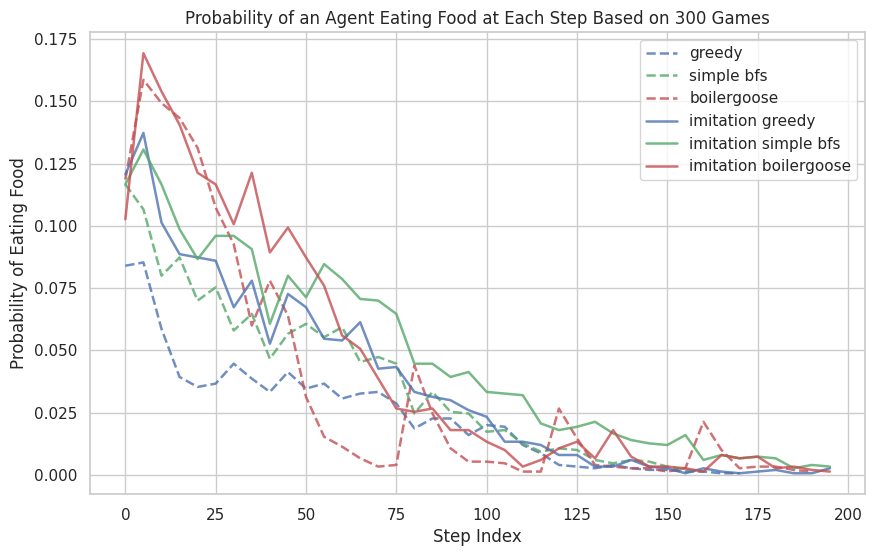

In [77]:
def transpose_and_count(data):
    counts = [0] * 200
    for element in data:
        counts[element] += 1
    return counts

def plot_food_eaten(agents_info, bin_size=5):

    plt.figure(figsize=(10, 6))

    for agent in agents_info:
        temp = [item for sublist in agent.food_eaten_at_step_per_game for item in sublist]
        hist, bins = np.histogram(temp, bins=range(0, max(temp) + bin_size, bin_size))
        hist = hist / (total_games * bin_size)

        line = None
        color = None
        if "imitation" in agent.name:
            line = "-"
        else:
            line = "--"
        if "greedy" in agent.name:
            color = "b"
        if "bfs" in agent.name:
            color = "g"
        if "boilergoose" in agent.name:
            color = "r"

        plt.plot(bins[:-1], hist, label=agent.name, alpha=0.8, linewidth=1.8, linestyle=line, color=color)

    plt.xlabel('Step Index')
    plt.ylabel('Probability of Eating Food')
    plt.title(f'Probability of an Agent Eating Food at Each Step Based on {total_games} Games')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_food_eaten(agents_info)

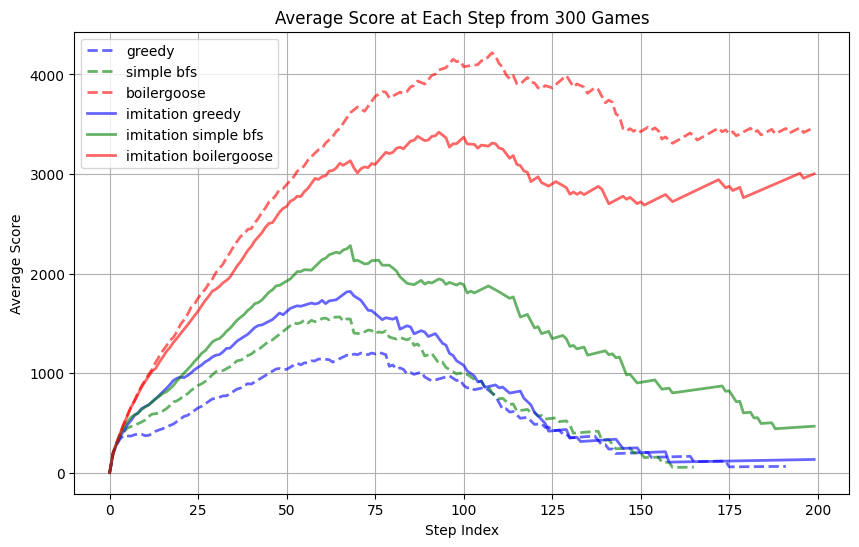

In [20]:
def graph_total_score_per_step(agents_info):
    plt.figure(figsize=(10, 6))
    for agent in agents_info:
        line = None
        color = None
        if "imitation" in agent.name:
            line = "-"
        else:
            line = "--"
        if "greedy" in agent.name:
            color = "b"
        if "bfs" in agent.name:
            color = "g"
        if "boilergoose" in agent.name:
            color = "r"
        plt.plot(np.array(agent.total_score_at_step_per_game) / total_games, label=agent.name, alpha=0.6, linewidth=2, linestyle=line, color=color)

    plt.xlabel('Step Index')
    plt.ylabel('Average Score')
    plt.title(f'Average Score at Each Step from {total_games} Games')
    plt.legend()
    plt.grid(True)

    plt.show()

graph_total_score_per_step(agents_info)

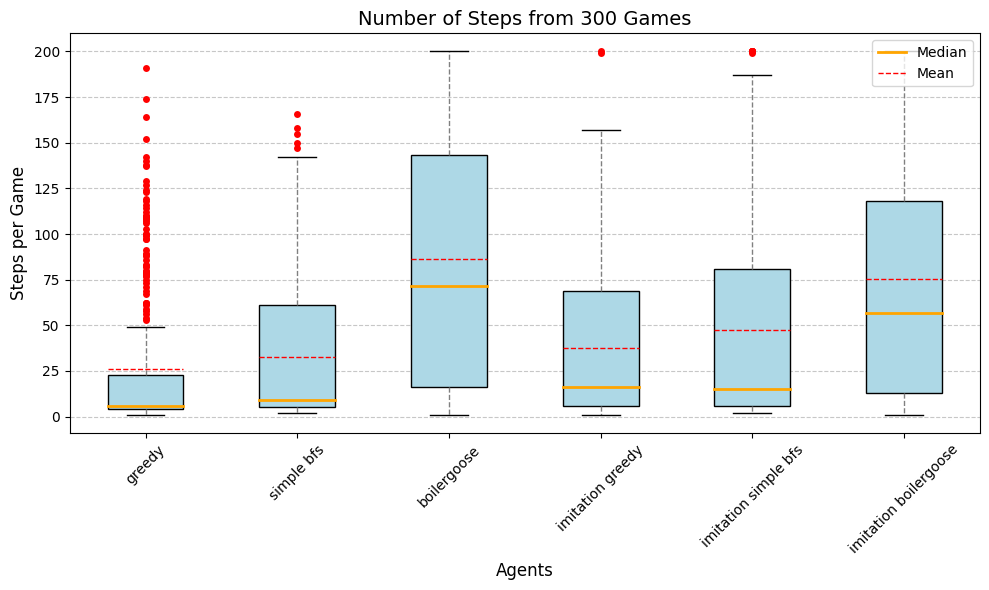

In [21]:
def graph_steps_box_plot(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))
    bp = ax.boxplot([agent_info.steps_num_per_game for agent_info in agents_info],
                    labels=[agent.name for agent in agents_info],
                    patch_artist=True,
                    showmeans=True,
                    meanline=True,
                    medianprops=dict(color='orange', linewidth=2),
                    whiskerprops=dict(color='gray', linestyle='--'),
                    boxprops=dict(facecolor='lightblue'),
                    meanprops=dict(color='red', linestyle='--'),
                    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', markeredgecolor='none'))
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Steps per Game', fontsize=12)
    ax.set_title(f'Number of Steps from {total_games} Games', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

graph_steps_box_plot(agents_info)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

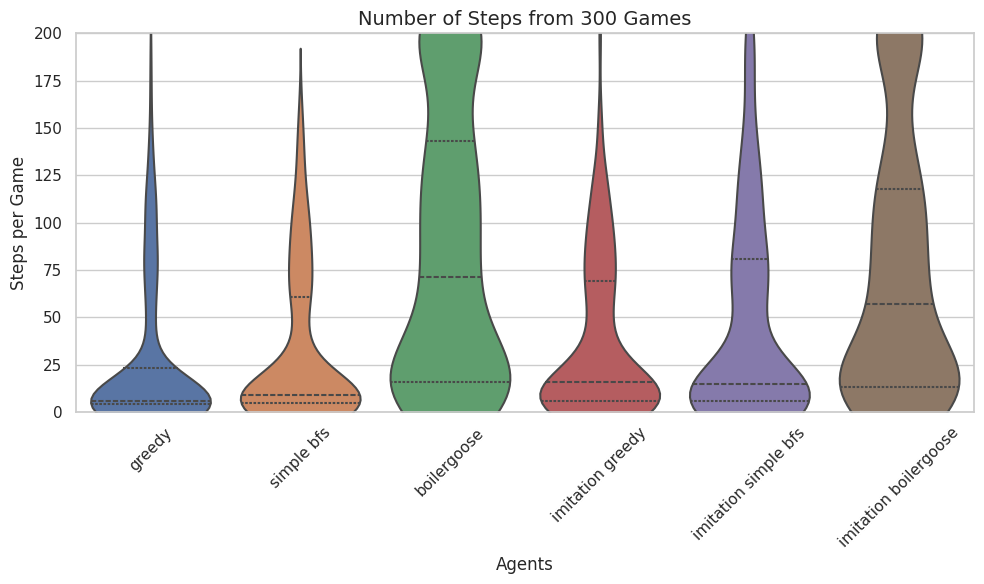

In [74]:
def graph_steps_violin_plot(agents_info):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    violin = sns.violinplot(data=[agent_info.steps_num_per_game for agent_info in agents_info],
                            inner="quartile",
                            linewidth=1.5,
                            ax=ax)
    ax.set_xticklabels([agent.name for agent in agents_info], rotation=45)
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Steps per Game', fontsize=12)
    ax.set_title(f'Number of Steps from {total_games} Games', fontsize=14)
    ax.set_ylim(0, 200)
    plt.tight_layout()
    plt.show()

graph_steps_violin_plot(agents_info)

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
<ipython-input-79-8b035c68d4b6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([agent.name for agent in agents_info], rotation=45)


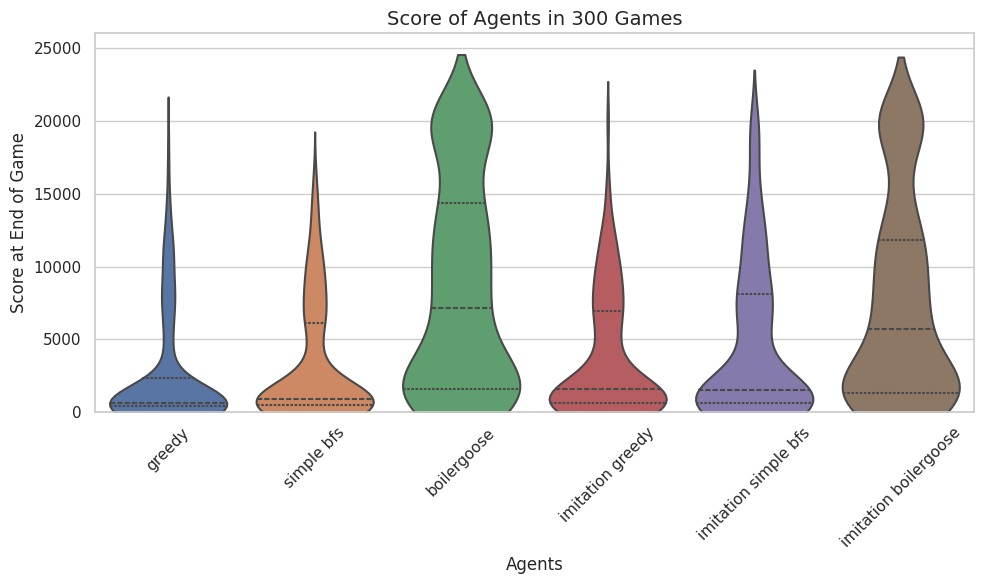

In [79]:
def graph_steps_violin_plot(agents_info):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    violin = sns.violinplot(data=[agent_info.last_score_per_game for agent_info in agents_info],
                            inner="quartile",
                            linewidth=1.5,
                            ax=ax)
    ax.set_xticklabels([agent.name for agent in agents_info], rotation=45)
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Score at End of Game', fontsize=12)
    ax.set_title(f'Score of Agents in {total_games} Games', fontsize=14)
    ax.set_ylim(0)
    plt.tight_layout()
    plt.show()

graph_steps_violin_plot(agents_info)

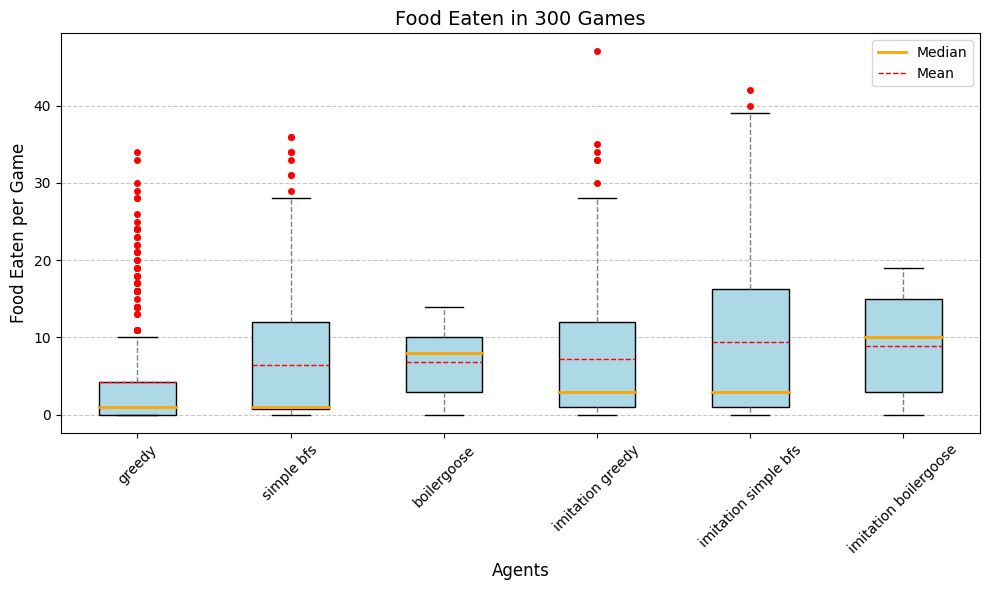

In [67]:
def graph_food_box_plot(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))

    food_per_agent = []
    for agent in agents_info:
      food_eaten_per_game = []
      for game in agent.food_eaten_at_step_per_game:
        food_eaten_per_game.append(len(game))
      food_per_agent.append(food_eaten_per_game)

    bp = ax.boxplot(food_per_agent,
                    labels=[agent.name for agent in agents_info],
                    patch_artist=True,
                    showmeans=True,
                    meanline=True,
                    medianprops=dict(color='orange', linewidth=2),
                    whiskerprops=dict(color='gray', linestyle='--'),
                    boxprops=dict(facecolor='lightblue'),
                    meanprops=dict(color='red', linestyle='--'),
                    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', markeredgecolor='none'))
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Food Eaten per Game', fontsize=12)
    ax.set_title(f'Food Eaten in {total_games} Games', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

graph_food_box_plot(agents_info)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

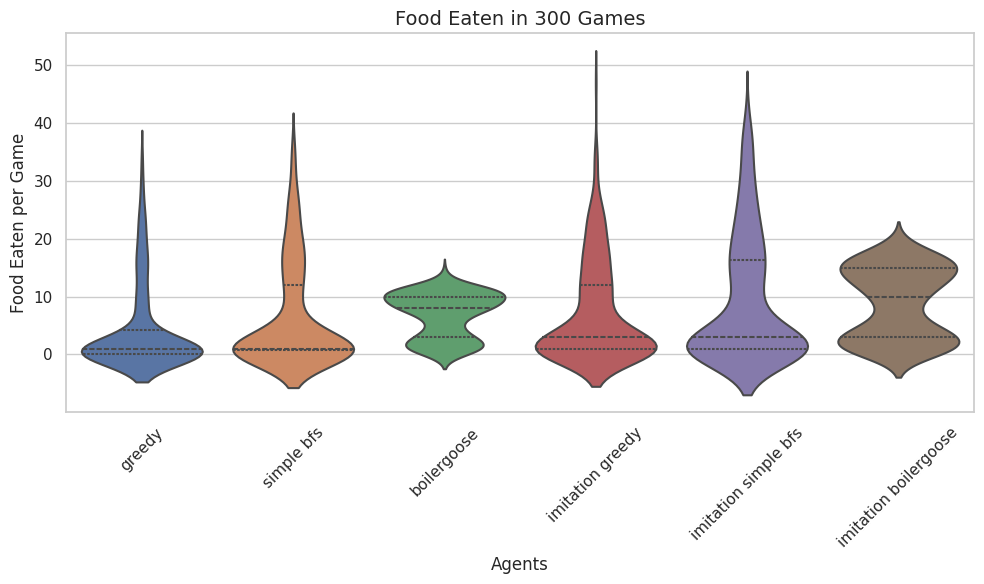

In [73]:
def graph_food_violin_plot(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))

    food_per_agent = []
    for agent in agents_info:
      food_eaten_per_game = []
      for game in agent.food_eaten_at_step_per_game:
        food_eaten_per_game.append(len(game))
      food_per_agent.append(food_eaten_per_game)

    violin = sns.violinplot(data=food_per_agent,
                            inner="quartile",
                            linewidth=1.5,
                            ax=ax)

    ax.set_xticklabels([agent.name for agent in agents_info], rotation=45)
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Food Eaten per Game', fontsize=12)
    ax.set_title(f'Food Eaten in {total_games} Games', fontsize=14)
    plt.tight_layout()
    plt.show()

graph_food_violin_plot(agents_info)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


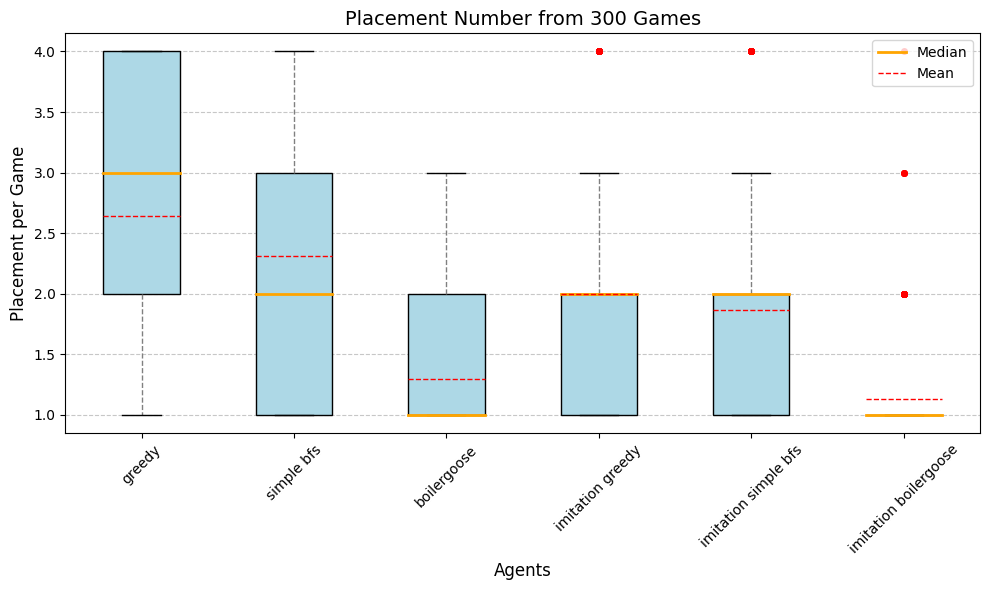

In [22]:
def graph_placement_box_plot(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))
    bp = ax.boxplot([agent_info.placement_per_game for agent_info in agents_info],
                    labels=[agent.name for agent in agents_info],
                    patch_artist=True,
                    showmeans=True,
                    meanline=True,
                    medianprops=dict(color='orange', linewidth=2),
                    whiskerprops=dict(color='gray', linestyle='--'),
                    boxprops=dict(facecolor='lightblue'),
                    meanprops=dict(color='red', linestyle='--'),
                    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', markeredgecolor='none'))
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Placement per Game', fontsize=12)
    ax.set_title(f'Placement Number from {total_games} Games', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

graph_placement_box_plot(agents_info)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

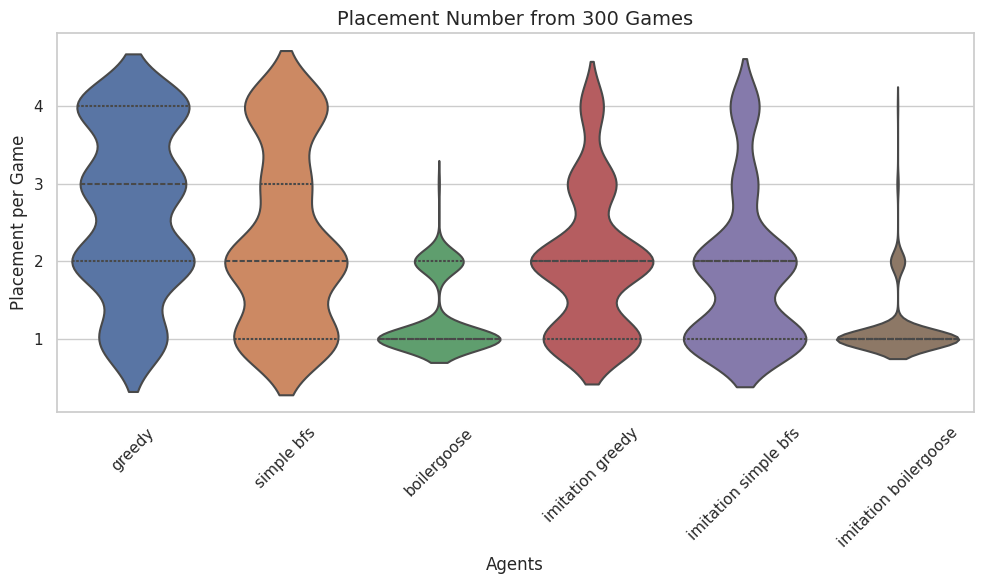

In [76]:
def graph_placement_violin_plot(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))

    placement_per_agent = [agent_info.placement_per_game for agent_info in agents_info]

    violin = sns.violinplot(data=placement_per_agent,
                            inner="quartile",
                            linewidth=1.5,
                            ax=ax)

    ax.set_xticklabels([agent.name for agent in agents_info], rotation=45)
    ax.set_xlabel('Agents', fontsize=12)
    ax.set_ylabel('Placement per Game', fontsize=12)
    ax.set_title(f'Placement Number from {total_games} Games', fontsize=14)
    plt.tight_layout()
    plt.show()

graph_placement_violin_plot(agents_info)


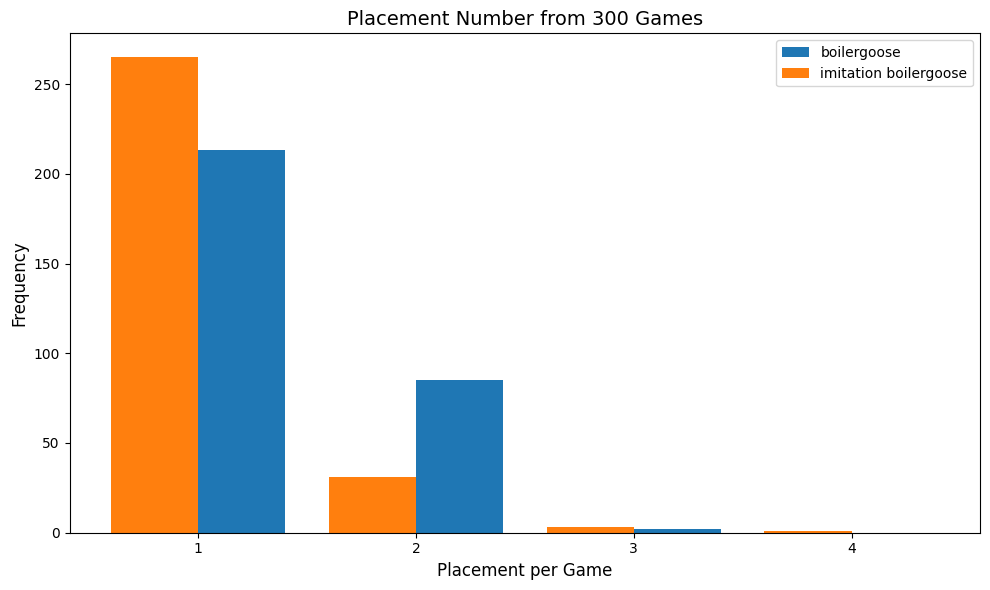

In [64]:
def graph_placement_bar(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))
    X = [1,2,3,4]
    X_axis = np.arange(len(X))
    colors = ["blue", "orange"]
    index = 0
    barOff = 0.2
    for agent in agents_info:
      if "boilergoose" in agent.name:
        # ax.hist(agent.placement_per_game, bins=[1, 2, 3, 4, 5], alpha=0.7, label=agent.name, color = colors[index])
        placement_counts = [agent.placement_per_game.count(i) for i in range(1, 5)]
        plt.bar(X_axis + barOff, placement_counts, 0.4, alpha=1, label=agent.name)
        barOff *= -1
        index += 1
    plt.xlabel('Placement per Game', fontsize=12)
    plt.ylabel('Number of Games', fontsize=12)
    plt.title(f'Placement Number from {total_games} Games', fontsize=14)
    plt.xticks(X_axis, X)
    plt.legend()
    plt.tight_layout()
    plt.show()

graph_placement_bar(agents_info)

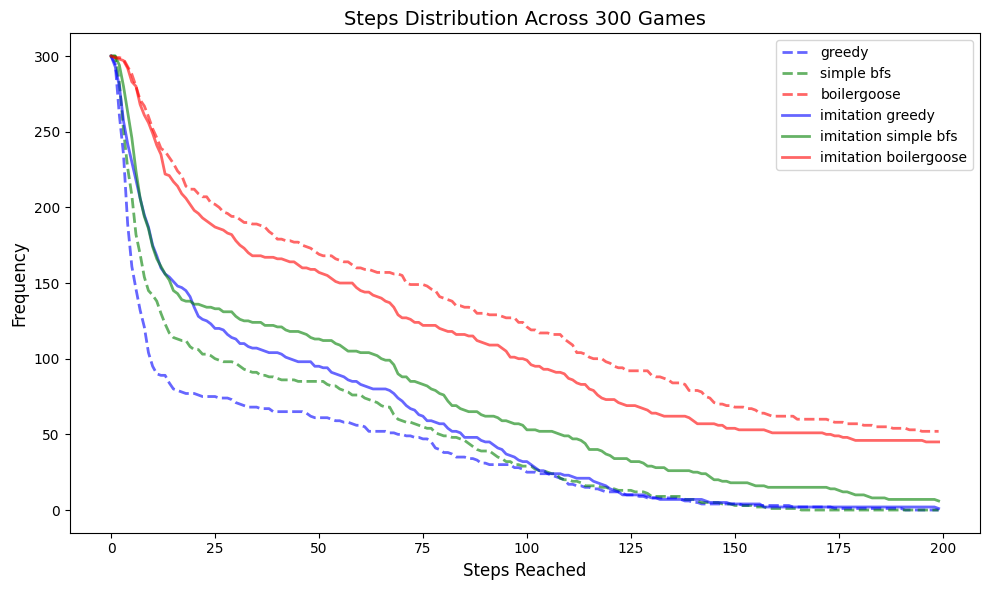

In [66]:
def graph_steps(agents_info):
    fig, ax = plt.subplots(figsize=(10, 6))
    for agent in agents_info:
      line = None
      color = None
      if "imitation" in agent.name:
          line = "-"
      else:
          line = "--"
      if "greedy" in agent.name:
          color = "b"
      if "bfs" in agent.name:
          color = "g"
      if "boilergoose" in agent.name:
          color = "r"

      cumulative = [0] * 200
      for steps in agent.steps_num_per_game:
        for i in range(0, steps):
          cumulative[i] += 1
      plt.plot(cumulative, label=agent.name, alpha=0.6, linewidth=2, linestyle=line, color=color)

    plt.xlabel(f'Steps Reached', fontsize=12)
    plt.ylabel('Number of Games', fontsize=12)
    plt.title(f'Steps Distribution Across {total_games} Games', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

graph_steps(agents_info)

In [96]:
def graph_steps_if_won(agents_info, is_won):
    fig, ax = plt.subplots(figsize=(10, 6))
    for agent in agents_info:
      line = None
      color = None
      if "imitation" in agent.name:
          line = "-"
      else:
          line = "--"
      if "greedy" in agent.name:
          color = "b"
      if "bfs" in agent.name:
          color = "g"
      if "boilergoose" in agent.name:
          color = "r"

      cumulative = [0] * 200
      for index, steps in enumerate(agent.steps_num_per_game):
        if is_won:
          if agent.placement_per_game[index] == 1:
            for i in range(0, steps):
              cumulative[i] += 1
        else:
          if agent.placement_per_game[index] != 1:
            for i in range(0, steps):
              cumulative[i] += 1

      plt.plot(cumulative, label=agent.name, alpha=0.9, linewidth=2, linestyle=line, color=color)

    plt.xlabel(f'Steps Reached', fontsize=12)
    plt.ylabel('Number of Games', fontsize=12)
    if is_won:
      plt.title(f'Steps Distribution of Won Games Across {total_games} Games', fontsize=14)
    else:
      plt.title(f'Steps Distribution of Lost Games Across {total_games} Games', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


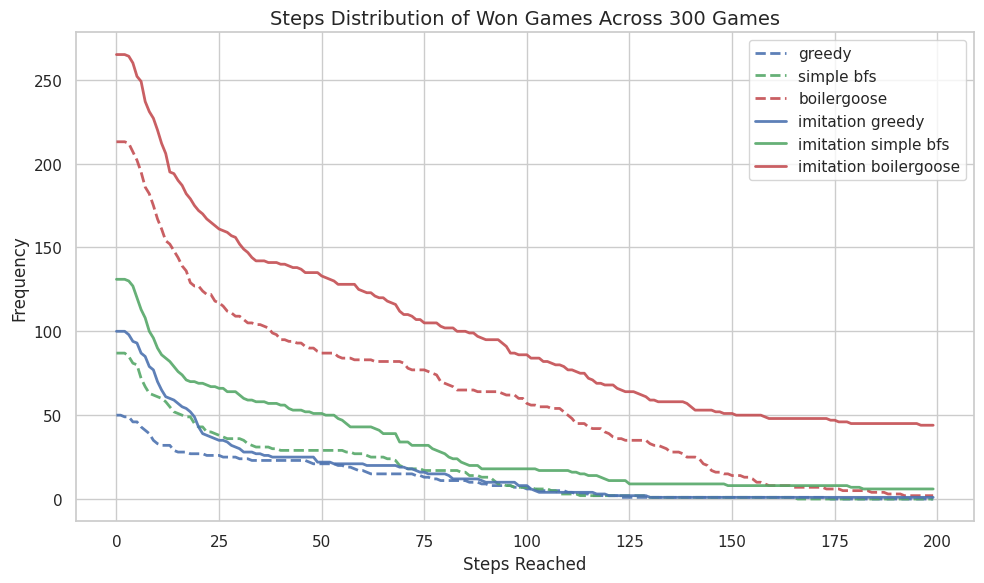

In [97]:
graph_steps_if_won(agents_info, True)

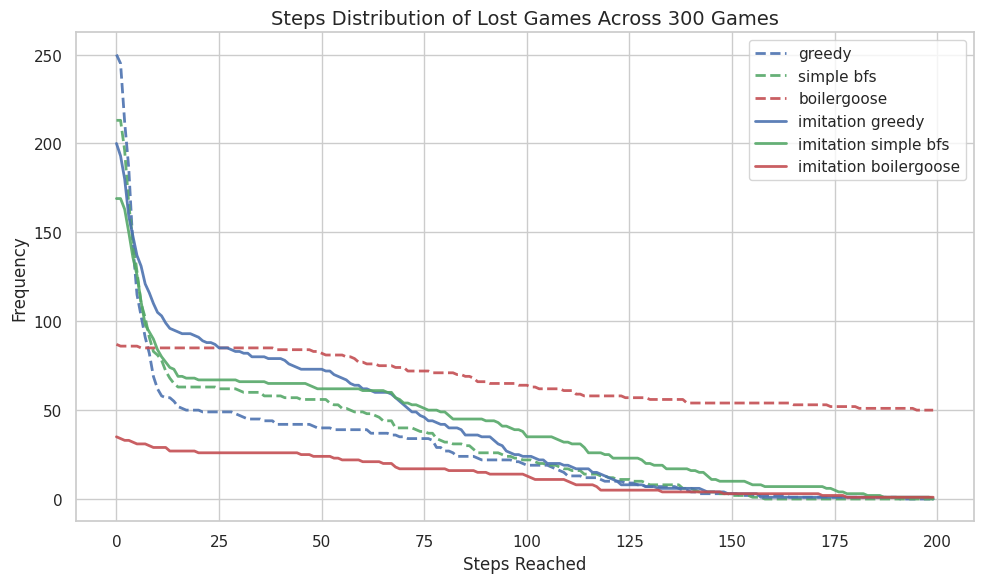

In [98]:
graph_steps_if_won(agents_info, False)

2062
boilergoose
2654
imitation boilergoose


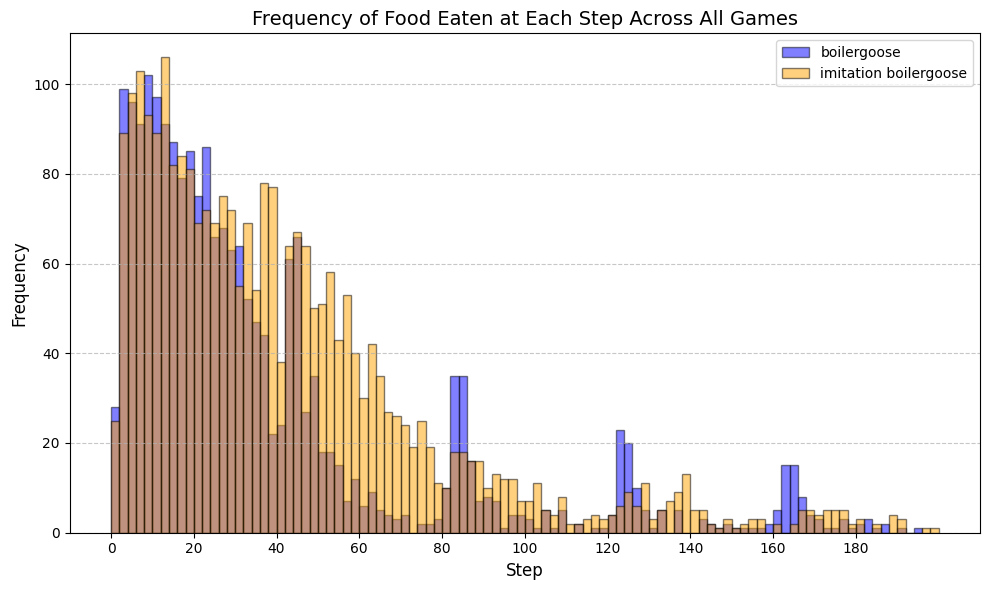

In [52]:

def graph_food_eaten_histogram(agents_info, bin_size=2):
    plt.figure(figsize=(10, 6))  # Create the figure before plotting
    colors = ["blue","orange"]
    index=0

    for agent in agents_info:
        if "boilergoose" in agent.name:
            flattened_steps = [step for game_steps in agent.food_eaten_at_step_per_game for step in game_steps]
            max_step = max(flattened_steps)
            bins = np.arange(0, max_step + bin_size + 1, bin_size)
            plt.hist(flattened_steps, bins=bins, edgecolor='black', label=agent.name, alpha=0.5, color=colors[index])
            index +=1

    plt.xlabel(f'Step Number with Range of {bin_size}', fontsize=12)
    plt.ylabel('Number of Food Eaten', fontsize=12)
    plt.title(f'Food Eaten Across {total_games} Games', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.legend()
    plt.xticks(np.arange(0, max_step + 1, 20))

    plt.tight_layout()
    plt.show()

graph_food_eaten_histogram(agents_info)


<a id="100"></a>
<h2 style='background:deeppink; border:0; color:white'><center>Comparison In Battle<center><h2>

In [ ]:
list_names = [
    "greedy",
    "simple_bfs",
    "boilergoose",
    "imitation_greedy3k",
    "imitation_bfs3k",
    "imitation_floodfill3k"
]

list_agents = [agent_name + ".py" for agent_name in list_names]

In [ ]:
def one_on_one_with_two_simple(agents):
    n_agents = len(agents)

#     scores = np.zeros((n_agents, n_agents), dtype=np.int)
    scores = np.zeros((n_agents, n_agents), dtype=int)

    print("Simulation of battles. It can take some time...")

    for ind_1 in range(n_agents):
        for ind_2 in range(ind_1 + 1, n_agents):
            print(
                f"LOG: {agents[ind_1]} vs {agents[ind_2]} vs 2 X simple_toward",
                end="\r"
            )

            current_score = evaluate(
                "hungry_geese",
                [
                    agents[ind_1],
                    agents[ind_2],
                    "simple_toward.py",
                    "simple_toward.py",
                ],
                num_episodes=100,
            )

            episode_winners = np.argmax(current_score, axis=1)
            episode_winner_counts = collections.Counter(episode_winners)

            scores[ind_1, ind_2] = episode_winner_counts.get(0, 0)
            scores[ind_2, ind_1] = episode_winner_counts.get(1, 0)

        print()

    return scores

In [ ]:
def visualize_scores(scores, x_agents, y_agents, title):
    df_scores = pd.DataFrame(
        scores,
        index=x_agents,
        columns=y_agents,
    )


    plt.figure(figsize=(5, 5))
    sn.heatmap(
        df_scores, annot=True, cbar=False,
        cmap='coolwarm', linewidths=1,
        linecolor='black', fmt="d",
    )
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.title(title, fontsize=18)

    plt.show()

In [ ]:
scores = one_on_one_with_two_simple(list_agents)
visualize_scores(scores, list_names, list_names, "Number of wins: one on one with two simple")